# Reconstructing 3D buildings from Aerial LiDAR with Deep Learning
> * 🔬 Data Science
* 🥠 Deep Learning and Instance Segmentation

## Table of Contents
* [Introduction](#Introduction)
* [Prerequisites](#Prerequisites)
* [Part 1 - Data Preparation](#Part-1---Data-Preparation)
 * [Export training data](#Export-training-data)
* [Part 2 - Model Training](#Part-2---Model-Training)
 * [Necessary Imports](#Necessary-Imports)
 * [Prepare data](#Prepare-data)
 * [Visualize a few samples from your training data](#Visualize-a-few-samples-from-your-training-data)
 * [Load model architecture](#Load-model-architecture)
 * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
 * [Fit the model](#Fit-the-model)
 * [Save the model](#Save-the-model)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
 * [Load a saved model to visualize results](#Load-a-saved-model-to-visualize-results)
* [Part 3 - Deploy Model and Detect Roof Types](#Part-3---Deploy-Model-and-Detect-Roof-Types)
* [Part 4 - 3D enabling the MaskRCNN results](#Part-4---3D-enabling-the-MaskRCNN-results)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction

The workflow traditionally used to reconstruct 3D building models from aerial LiDAR is relatively straight-forward: the LiDAR point-cloud is transformed into a Digital Surface Model (DSM) raster, then inspected by human editors for buildings present. If a building is found, one or more polygons describing the roof form of the building is manually digitized, e.g. if it is a large hip roof with two gable outlets, there will be three polygons (one hip and two gables on top) drawn by the editor. Once all the roofs are described that way, a set of ArcGIS Procedural rules is applied to extrude the building models using the manually digitized roof segments, with heights and ridge directions computed from the DSM.

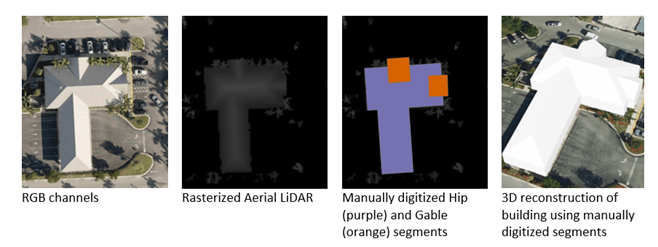

<center>Figure 1. 3D building reconstruction from Lidar example: a building with complex roof shape and its representation in visible spectrum (RGB), Aerial LiDAR, and corresponding roof segments digitized by a human editor. The last one is a 3D reconstruction of the same building using manually digitized masks and ArcGIS Procedural rules. </center>

The most time-consuming and expensive step in the above workflow is the manual search and digitization of the roof segment polygons from a DSM raster. In this notebook, we are going to focus on this challenging step and demonstrate how to detect instances of roof segments of various types using instance segmentation to make the process more efficient. The workflow consists of four major steps: (1) extract training data, (2) train a deep learning __instance segmentation__ model, (3) model deployment and roof segments detection and (4) 3D enabling the detected segments.

## Prerequisites 

Complete data required to run this sample is packaged together in a project package and can be downloaded from [here](https://pythonapi.playground.esri.com/portal/home/item.html?id=1474b1838f4a4ab68890c6595adaa51d). You are also required to download the rule package used in [Part 4](#Part-4---3D-enabling-the-MaskRCNN-results) of this notebook from [here](https://pythonapi.playground.esri.com/portal/home/item.html?id=7ae7f189665b402c908d475f2daf973e).

Below are the items present in the project package shared:
 - <b>D1_D2_D3_Buildings_1</b>: labelled feature data for training data preparation
 - <b>R7_nDSM_TestVal</b>: raster image for training data preparation
 - <b>DSM_AOI_Clip</b>: DSM raster for area of interest, required during model inferencing 
 - <b>DTM_AOI_Clip</b>: DTM raster for area of interest, required during model inferencing
 - <b>DSM_AOI_Clip_DetectObjects_26032020_t4_220e</b>: sample results obtained from the trained MaskRCNN model inferenced on area of interest obtained after performing [part 3](#Part-3---Deploy-Model-and-Detect-Roof-Types) of the notebook
 - <b>DSM_AOI_Clip_DetectObjects_26032020_t4_220e_selection_3dEnabling</b>: sample 3D enabled roof segments obtained after performing [part 4](#Part-4---3D-enabling-the-MaskRCNN-results) of the notebook
 
 Moreover, there is a toolbox (<b>3d_workflow.tbx</b>) in the 'Toolboxes' section of the project having the script (3dEnabling) to perform [part 4](#Part-4---3D-enabling-the-MaskRCNN-results) of the notebook. 

## Part 1 - Data Preparation

We started with two input data:
- A single-band raster layer (R7_nDSM_TestVal) with 2.25 square feet per pixel resolution converted from LiDAR point cloud (using the “[LAS Dataset to Raster](https://pro.arcgis.com/en/pro-app/tool-reference/conversion/las-dataset-to-raster.htm)” geoprocessing tool)
- A feature class (D1_D2_D3_Buildings_1) that defines the location and label (i.e. flat, gable, hip, shed, mansard, vault, dome) of each roof segment.

We are using single band Lidar data which is essentially elevation to train our deep learning MaskRCNN model.

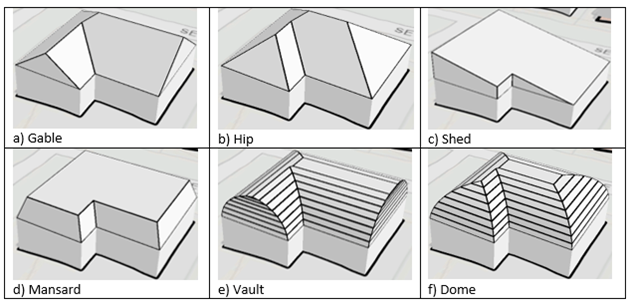

<center>Figure 2. Example of different roof types (flat not shown). </center>

### Export training data

Export training data using 'Export Training data for deep learning' tool, detailed documentation [here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm).

- `Input Raster`: R7_nDSM_TestVal
- `Output Folder`: Set a location where you want to export the training data, it can be an existing folder or the tool will create that for you.
- `Input Feature Class Or Classified Raster`: D1_D2_D3_Buldings_1
- `Image Format`: TIFF format
- `Tile Size X` & `Tile Size Y` can be set to 256
- `Stride X` & `Stride Y`: 128
- `Meta Data Format`: Select 'RCNN Masks' as the data format because we are training a <b>MaskRCNN model</b>.
- In `Environments` tab set an optimum `Cell Size`. For this example, as we have to perform the analysis on the LiDAR imagery, we used 0.2 cell size.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAtQAAAKvCAYAAABKyFjyAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P13VFVbnyaM1v3jjr7f6PF93bfTuF3VXV1duauqK3VVf1/X2xXeVO97cvIccyQnQRAUkJxUUMCECQEFBAPmBCKISkZyzhk2cWf23sBzf7+52bDBrUfP8Xg8nrkcz5C11sxrrmc+8zd/a+7fgNXR2dUFrU4H/cyMhISEhMRrxthQP/4wpnqBcd/sYas8EhISEhLfDhqtVnCsFNQSEhISbwhSUEtISEi8W5CCWkJCQuINQwpqCQkJidcPg9GI2bm558JoMtmM9zogBbWEhMSPEkx+L4KtONZgYmbyXnl9xmD4WtKWgvrdhNFowKzR9j0JCYnvFiyY6+rrERYWhpiYmGcQHh6OrKwszM3P24zP0On1gv+Zx62v87nlnvV1a/A9PqSgfoOYIdKdnzdiThKvhMT3hsDAQHh5eWHHjh3PgK8rxsZsCmYLevv6MDE5uUw8c3gm1Z7eXqg1mmXhrfE2C2qjyQgQP1ljftaAGRthJZYwQ4Nt34gSjQot1Ho6txFGQkLiu8M88VtJaSk2b94MJyenZ7B161YkHjr0XB5kQV7f0IBdu3bhaXW1OOfrzPEqtRrHjx/HwYMHF6+vxDcX1KTW55hssRxydv5i8CxnenQK5ytHUTZGA7DBdjgJCYnvFjt37oSzszNcXFyeAZPvqELxXEHN14OCgnDk6FGMT0zANDsr3m3G9Rs34O7hIQT38yzVb6Wgpok+c/hIjwJxhUM4+NCMuMJhXG5RQiVF9XPBRhLjlBIB8eX4neRBtKuNMElul5B4o2DLMwthNor4+Pg8AzaUpKamCuFtKz7zNfM+i+bdu3ejuqZGcOa0UokzZ86IdAsKC5/L699IUBtnSTyrVDhxtwtfZnRiw3kz1mb24dawBjOm5aZyiSUYqO36KjrxW74V2FGjx7ycgEhIfC/Yt2+fEMW2EBoaigkSyiuX/SxgQV1aViZE+bFjxxZF9dVr1wTpXrp0SZDr8+K/dYKaxfTUFCJudOPDU+3wvT+AyDwC/b87pwO/OtqBAqVR8tXzQOLZQM/7ce0wzjYpMaEzwGArnISExHcGFtRl5eVISkpC1dOnQhCzwGbw31euXHmhoGYwj4+MjgpR7R8QgCfFxUihON7e3igkMc33bcVjvKKgNghCbS7vwe8faIFb7hDutk/iXvME8jvGsTezBc4PJjBJ4aQl4zkg4lVPq1HRM4UupVwWlJD4pmBRy5YCW3ieZdkC5jf2qWN/u8HhYQwMDgoM0d9t7e1CbDOpvigdJtayigohqnkpMPvCBSGmL168KO6/KO5bJahZTE8rEX6uAX+TOYT8AR4UllYd50x6dA2qMKSmOlmsrvS/yWTA7AKMNqyxBkrXct9WGL5vovGEJx3W4Zat2tE9zofFqfBPNlE8y73Fa8+Ja8GK9DlPy72ZFfVYKYKt018eb+k6r8qKeFzWeRMwt5QOx+d6G6zC22qr5W1gDi/qbas+EhLvMCx+yszRK8FudHzfVjwGC+rChw+RcuaMGAfmiMFm6RqDRXRZWRkOvcDlwwLm9sGhIZw4cQIeHh7CyPKwqEhw+vOMJIxXEtRGgx4dZd34j/uacLxNT4nPYJ7Ig/3rGMYZPaY0euis4hiIFCx+eIJoVhIEFY79ia3DLBOZfH/O7EpipDws4Thfa/LjfEQZ+H++b708SaS2mD6D7i2mbwWOax3O2n1FWOWt4luX0eITbbm/uNRH/89S2S3XF8vEZQQ97IX0RfyFOlqHf2bJ0EZ6JsLK8khI/BgwPDKC7p4e4VphDb7G92zFsYD5LTQsDP0DA8IfziLE+W/2i46KihLi+kWimImV75eWlsLPz0+4iuTk5AjSf1E8xlsjqKkOMGhx/U4z/sX+ThSM6p/lYIKJOMrCt1zveSONBQPTeNQ5jeIeFQY0NJgRfwnuJ55iThpWqPCY7xOe9FIYHV0nschpGGhQHFKo0TpJ44hag5IuCkMoo3CTzPUL3Dej0aF1WI0xittL+RV1qzBMYwyLcczOCJ/lxTz6VBjVc9nMcUU+zOkzOlT3mNNn1Cm00OiZ74lzqR809E6LNMr61Rin67MLeXN9hkaVeMJpU7zaURrk6Z6B4hlUalR0U750vZjyVWgpPRr/RsbUaB7TQs1lpzoOjKrQrZzB9KQKpSJ/JTqm9WKssbQx/61TqlFF6XFej3vVmFBq0Ez15kmM5HaJHwuYg9mwkZCYiO3btwursAV8Hh4RgabmZhHOVnwW1Cx8k5OTBcdbi1/m5OLiYhw5cuSFFmoGp8/f0HA67P4XEBAgxDhffz2CmgpjGh7Bz6Nq8Iv8SUFmy+4TeLZv/fKz+JsanMCJR0M4WDiE5IZpjM2QCFwgLCFS1SqcLR1G/MNhJD4cwpH6aaiZ6DgMD1iTSlysHkPThB61rQrsLzSHzW5SQk2i0kjpMNH390zgWocK/UNTOEP5nambhpLSmKU85qancfLJMBKKCJTHiWYljFQ2jmspKw8ind1jOEhpJxAOlYyieFRHZTWL5d72USqfOe+sDjVmaGDgurILh3FiCqnFfI/qWTyGmnGdmcgNOlQ0juAAxeF0s1pV0NB1I9XpUrUCFWPUBjQwKBXTdD5ORKtDUZXZZ/FY6Ri6dIZFcue2naMJTXndiCgD43zjNFp7xnCxVS4xSvz48KCgAF47dsDB3l74QjP4b08vL+Tm5dmMYwHzG38J3tvbu0z88t9jRKQsqIe/RlDzPSZQXkZkQc3+eWzRYCH+omVBxtsiqHkyr5uYhltCDT7LHccUca81L64E85DBoMGlu7346Fgj3k9rx6+ONuDXV2hyo2KO4jT1eFo2gA2nm/GT0+1YldaG/5XUhA/Sh9BEHDfDRgDi/b0ptfi9Ez3Yf68Xn6e244tzrfiDPfXYnDcGBYt6/jiyewh/GdkA59xB+Ga24VcZfXg0piPe1KH0cR8+PdmCf0o25/E/jjZjzcVhdJDgnmFRTvmMjU4j62ob/uJ4Gz5N68BnJxvxv7KHMEgCWKtR4filDvzziWZ8nNqGvz/SiG35E5gkUT5LvF//tB+rkhrxE0r/w+Q2fHFxACM0FvA3MAkZjfizJLpG9f9/jnXi5jANpHoNDp+rxe+nDaFbaxJukaFJNfjd410Iu96Nr8624xeJTfiH5G7cU9CkgNqKyzihUCL8VD3+5GgrPqP0fnmiHR7nmvH/Da3DvhZqK6sJgoTEuw4WrfxRd2xsrBCzbm5uwlgRHBwsVhSfJ6YZr0NQc/pTpBmTz5wRq483bt4UVu3d/v7LPlS0hZcW1LNEcNWPu/A7US24NUGZLgi952FungRwwzBWJTTD8XY/Yu714IPjzXAomISaCWtuBj1dYwg41YSfX+hDGBFmdH4P/iGhBVuJFDt52YsaYK6tH78f9BQ/JSL1utkn/PoCb7bj9/0aEVpL4puttTN6FN1qwX+IaoYn5RVydwCHn05BAwNam0bgebwRv7rcj4i8QUTd78b/jG2B5y0F+hes3EaTDrfvdhE5t2LLbSoH5eF1qQ2+pWpqDS1yH/bj14dasIPix9zqwP9zuBXRtSrMk5hWDExg96kG/DSrF5H3B+Fwvgfn26ep7AbcutuOnx1vhevdQQRRuTyvD2IIRLTtA/i94Gr41uqFpXnwaQ9+x78Kf5fWjZA7A4igdNYcrMOvc4bQrDFPQIxGLS5c68D/fbARDneoHrkDcE9pxp9HVOGPUgbRqlqYhKx4DhIS7yIs1uFHjx9jF4lZV1dXARa2Dx8+FPdeZEl4HYKa07f4TLOoZrIWPtVJSRibmHgh8b8tgtpIPDvUP4S/DWlEeL1KGBYs90wsaHlFTMDMQ+yKUFDQhj+IbMNFhY5SM8EwMY71B+vh8HgKJMfRVt2D/x5ej7A6FTEw8R1dm5keh/3+OvyEhPeogdIjQR2X3oDfCKiHXdmUSAcUuq22F3+4uw72VUpzvj3D+NOIWvwXEqENanOYeSpzRXEn/iSyEQmtGswu5KEeVeCLyFr86t44VPTc5iiPmNQG/OXJHpSpSJhyOJMGlf1qKDU6pFxsxJ8e7kYZcSzfG+0awj/tb0Jsqxp67SS+DKvGV/cnMEc5cP0HBpWgURGXLjfjP8R2olFL5aN4Ewp2h6G20JKgzqjHH6UPo2dBUEclV+M3wppwqJkHWkpHNQXXxGr85NoYprmMKiWiUhrwN2d6UaE2p8dtE3KmHv9iTy3i2qSglvjxgQ0Sff39SEhIgIODAwL37EFtXd3XGiosgjolJUVwN4tfjsMQ/tVlZTj8AkHNcXiFksW08JmmsYTDCp/q+Hjs2r1b+GY/b1x4SUHNhKNF5qUW/JtDvRjSUcaWe3o9kZPZ1UPJs3493SMinh4ex5q9ddhYRAMLEwkRRX99H/4suhWXxvXCaux3vBb/+8IQOvVMJAwDFCQ2/zyoDjtqScwSoc51DOK3Q6rxX0/3oXKB+EC0dvNWK/7PaCL1ASKy2RkU57bgN4IaEEUkbg5jhGF0Alvia/H+TQVGqAEseXTX9uB3KWx0G1We8uiq7sYfhDUQkS6Rs0GvxSCRcH/LAP42mNJtZ3HN9TCi7EEb/suBbjQTuebea8O/jWrH0wUynKF2m9ZSe0wq8Is9NXAonjbHY8vGtAYqapv5zkEakGqxp94sqIdoEPnPwU/xD9cUGDdy/iaMt/Ti90LqEdNC9aMytlV04fcjGnGkU0sEbw4z0TeG9yPK8SfpQ+KrcimoJX5MsIjq4pIS8QU3LwmyZZqF7IuEMIP5jT887O7uXjy3cN4okWdkZOQLXT74eg6JaM6TP0BkHmTCrljwqT50+DAmp6aeG/9tEtR9vf344yASks3EcbMkqKldoVcj/W4n/i6xGf/zUBN+ktqN6wPEV6YpbIuqxc9ujdMgNSO4nz/GO59dj9893Y8W4r5DJ+vwF+eGME5cOUt5sBsIMIOyJ534beLsXOJ/aNXYm1aH/3RmCH06i3sb5Turx5nMBvy3lEFMMs+RoP6zqBpsKSOuprJymQ16FQISavGPOaNQUx4mkQePDXrk5bbhP+7vRA2NUYNtQ/hf4Q040K4RgthcZ87DgKnxUfyUxhn3smnMUbpKCj8/pUQgjUn/6+oYhqYnsTq4Bh/dUoCeIlEwCXnh9qfDxZwW/PuwdjxhNw8qN1/nlUZo1M8I6pDjNfjby+ZJBK92UiCkkyD/N0f6oKDz/tZB/N9UxviOpTLOzJqgqe/Fb0bUYX8rxZGCWuJHCBbD7L7HHwfyVnh8/iIjCYM5mA0b7KKRnp6OjIyMRWRmZiIuLu6FgprzaGhshKenpxDTFgHP/7MLCH9b8xq2zTMTQWp2M/4VC2oiEuELzZVTKLDpWDP+OqERvxNeg7++OEKicQZPK7vxH4ObkFAzheo+JUp6VaivIXEaWoXNZRr0tQ/if5CITVxGdtQgsxrsPW4m5DEm1I4B/C6Jz0AWnwtuJuxzph6ZwKq4OgQ8VRLJzaDobjP+/ZFulEwS6REBzc3NoL6qB38Y3ozsIZ3wN7bkMTujgvdBGhSuKoiCdTiT1oDfTx7AKJXDstzJD44nEVlXW/B/xXTgdqcS5T3Toh7lj7vwH9h60D2DprJu/K5fPSKaptE9TWVkgqfyaZWTcIqswd9lDqB4QgsD5c9+3+w6M7dSUNeQeCZSTeonchbkaYBOrcA/B9dj4xMW5FocPl2PP6AyjlvKyOUj0X/6fB1+L828TZMU1BI/NvB7ygI6NzcX169fFwL260iXwR+2hISEID4+XuzSYQF/HX6YxDBvmfR12+YdOHAAly5fXjzn/01EtPyVOVu/+aOWH4KgHuwfwl/71cG3aooY1+zbOzOjx6RSi8FJDcrLOvCbxKMnu4ivxofxdyHV+Hd7G/G3iU34q4Qm4v4m/Mm+evziwjBaVdOwi67DP96dWMbrpjkj+hoH8Fd7GnCE+JgFdUwq8Xz2KIZIUFtWPNkN8HZOI/5rfDdqhaAewl/GNOJQj35RdOu1Y/gwpA5fFk09k0drJXH+niZcUulQUd6Fv47vQtG4hVfN4NXDobZe/O7uavzn2Cb8jVU9/nhvPVbfm8A0CezHBVTvsBr8i8gWHGuZRo+Kxg52iekZwS8TG/Avg2rwy5whVE/RWMl8THVaKaiDSKD/9NooRkhQG8WYosF5EuT/KrEPY+waU9mF/xjRhlvcJjRuiDJS+YwtffitSBbUNBmRglriRwrmcst+/i/D6zwW8Hc07KZx+86dZ8DXyysqRDhb8Rksitnlg/OzzpO5nMvCW+hZh7fGS7t8sFX42s1W/PvQNhTrzP5f5nv8YRyLWBUOnmvAH50dhkqvw/0Hrfi3QfX4x+R24Rf2SSqjA5+ndeBMlxb1dd34rfA2XO63IhICz/Szz9fjD4/0onlBUP8eic+QhiVSZEJUjU5hfXQNthVPkoSdwcPbLfhvZ/rQROTMwpLL+/BRB/5tTCeKx5ZvT8eC9MipGvyPtCGMYBo+CXX4+P4Ulv3QCpOfXokDmY341+GNeD+lHZ+KOrTjY8Ka8924NkRhpqYQfaMLf7ynEv/lYDsSG6fQT8QLgx71tQP4WXw9/uWuWrgVjCJ3UCusGc8T1Cf69aLs/BA1JKh/JQQ1TRighM/BevzpZcVSW3H5tBqczKrH70tBLfEjB5Pdi0jSFtgfjsWvLTDpMnm+iMTZamErTy4L33tR3LfJh9owpcTuxBr8w/VRjJFgtHzjwv7SvONEd0M3fi+qBae7ia+mR/CPYXWwL+eVQOIc4iPGHIPSMhmn4LS3Dv/75tgzYrezth//PbgBp4eXBPVfrRTUFOdydiN+91APWqwEdeIyQT2BL8Pr8NmDSeLPpTxmiUvrS6msIc24TZOBh0Vt+M24LjweIz5esG4zePwY7uzDH4U24UAblWVFPSwfo8/OmTDZPw7/7Db8cVg1/ixzCOOUP49R81SW2/md+DkJ6/8jusU8jumedfkIJkH9TySoh60F9eUW/OtDZkFdWdGF/xDZjlxuE0sZKX12dZSCWkLi5YS0NTg8c/Dz8DLpPS8MX39R/JcW1IZZE5TN/fjT0DrsbNQsf8kpA+hViCNB/cckqJVEFMVPOvCfYrvwcIpJhN0hrDGD1qZ+/LewZpzu0iyzHrM/c1IyicfkAfRbCerwpplFwcsW6omhMXwcUYcdVdOYn59BIQnqP05eEtR8raKsG78d2YpbRFZMlpY8DDMahB2uxU8ujkI9PwX3g3X4m+vjy4S9sMrPqpF8oQm/dWpQDDQr68Ef4Oio7vP0d0/bKMKudOJ3gmsRWEkzGCbmeRpsJ5XIejKIj/ZX449O9aNzhur0HEF9/LmCmkT/gTr8aQ4NUpa24jYnAj9zoUFaqCUkvgFY9L4ItuK8LrwtgprBXF5a3I3/FNmAo+0k7KyEsJHudZGg/n0W1F18T4PABObOEWiJ9ywreiwyeScQ/lgwg0XlyT50GE2CIwWXzulwJ7cV//lgF8qnKE+NCvvP1uH/c3IAvWriSg5Hgx0mx/HVgRrhdqEjbnxWUFNeei0Ona7D/0gfxCCNS2beY77W4vzVZvznI73oovOeliH8j5A6RDepMUe8KT6YZ76mv9VTk1hDHLylaBI0LVp0YeTVRbO4NwtsnnDQwIC2h234N9G82kllovZhg5LwrR4dx2f7nuLTh8TTxMdHXlpQ92KUzruaBvCXofXY26xeHKNMNHbVFHbg31HZY6XLh4TEDwYvLagZ83odTmc34rcOduDBJBETi0YiHF4Gg0GFg+kN+IO0YUwQMQ53juAfQtgVQiUsB2y94Jk/+1gzSWmGJ7AurhbridA0bLVdSGduQoEPY2rxVeEU+JcY2Yf6P4XV4Oe5vLOIORxMepQUtOFf7m1Ddh+R/OwMClYIat59Y6pnFL+MroXnU5VYSuS4bIHQDQ/hJ+H1cBdWFgOuXm7C/29fOwqoTiyquU5M3mwtqS3pxu8GN+PKhH6pvlQP3naJ24T9A81ESeRKg4T/0Wr8DQlfhd5sdRF+d3Sv73E7/lUUEfIIEW33qwhqdvmYQRa1+28e6MATpbmMnK5KMY6NUZX4b9KHWkLiB4W3SVCzyGQ/5Fu32/AncQ3wKFMKn3CVVg+dTo+6R234f0e2IEUIaiOaKjvxm3718CqZwLiJ+I8GkcKGYZxr5O9eDFAMjOKjiBp8fmeUhCWLTz06icf/d1gDvMqmoGNOVKtwIKMBv+FbgzX5E1ARn5o0ShzLasb/Gd2Ou2MkoHlc6R7CX0Q1IN5aUBP/9nYM4WdhtdhcMI4hHQt5PRrq+/BXoY0Iq1eCt8SbM6hxPKsJvxXajJM9WmhJJBsGxxBdOo5RtR53c1vw7wKacLBNCRWlaSL+zqwYQWGvFirNJJIfT1J+ejFm3b3WhN+O70a1UYOcyjG0j2iFJXm0fRj/FFEHfxLti7t8nF3a5SMoqQb/cHUUQ4uCWouMS834vxJ6MUhtM29U49h5LmM7bk7qxNjY1Ux1i6rC/2tPHQ7IjxIlJH4weCVBzcRr1JKozmrA7x5pQ3zlFOr6p1Hep0RTyyjWJNTiTy+OYoKtBXo1zlwnwtrFH7tMopLC1LQOwyN3BH3KGRKSMygv78PfERl5EDFX9tJ9IrugM834y5N9aF34uJEF9e+EPsW/im1FTPkk6gaUKKokkRvSAMeiCWiIwNm9ouBGM/7gRC/qSVCbrSLsR61HfkE3/jqyHoFPp1BFeVQPKLD9aBN+kj6IfiIvI5VVpxmH8946/MXxDpzvVKG2dxrXH3QhoJ4ah4jV93SDcE9JpzpwGmX1A3DJH6c6aJBVMoj0knEquwpFNcP4JLYBIQ1KDKupLpeHUd2vFHU/eK4RP0nrRwtv/N8xgN8PqYZfrVlQDzyl+gTV4UiflaBWjeKn/rXY8GhKhNGoxrA5sg4/Se1D7hDVo2cacRmN+Ne7K/GXGVJQS0j8kPBWCWoCcw7vozw8roBzQhP+gsB+xYw/2t+IVbcVmKCJPFuk52Z1KK3uw0+JV/8ssQn/Pa4Jn2QPopmFOXEQbxmqHJzArrON+P0DlEZ8I/48qR0JDWyFNRtUWFDHpNXhTzOHkXyjA3+T0Ii/PtiA3z7diyfDOrGTh/j9gP5RvH+sDWf6lwQ1g/OY6KGyJjfiDymPvzzYSONGJ1LbNCKu8AMnIcpuK/dzO/AXfJ/q8mdUlx2lk1CSwJ2f0+BKbif+NroBf071+JP9zXDMU2CYBL9aqcBWCvvnFOcv45vw12d6UcfjFtQ4e7UDf7uP02vEH8S3Ia5mGloeh7QapF5txs+ujKJfZ8K8So2D6U1YnTsmPkq0COprdzrw5ykDGNbw5IAnHBqcu9SKPz9A+RF+ktmPwuIe/HZUHfY2S5cPCYkfCl5NUBOYoNhi2tExDIeTbfh1Sjs+ZJxpx3uZfSgc1YI/dBFLcPNaXL3bg09Pt+GDlDb888luZPaqoV9wW2Cr8QSls/FsO96n+O9TOLuCMbEPqCBPI4lEEp9/EF2HPeUqJF1twy+T2/GrlA74VipBClKkY6KBoK6qHx55o+i1xF0oL/t3DzQNin1OP6Byvp/cBvcnk4KsLct87FNn0miReqMd/0zpc1m+zOpHyTSnxVZtFY5mdeADus51fZ/ItUjJYliP0soBrKN2eO9MG36R0oWjjUphkVcrJxFKYd8jcLzVN0YwynlyXkNjcLvYhYweHpwMGOscgWt2D+4q2NptLpNWM4Ww891IaFIJizS7uWimprDvfBt+xW2d2oHE6imkX2zA76QMok1umych8YPB2yaoGeY9pomfiGvYfcMavDJn/RsDwsVjRTjr+5yW9T0GW5YtbhdCUKfW4b9nj2JYT+JzIS3OZ9mPf1FYdoWw8KI1ONwzedgIx2UVq442wlhcVaxhqcfK+lnirYzD1y1xmN95BdNyzrxt8cm2gMMs+16HwOEW05w1Qd/Ui/8c0YCTix+qS0hIvO14ZUFtAZMK+xEvx7OENje3PAwTm/X9GSIS9kFeDEMz/UViXhDU4qPERhbyS+FYiFqnw9Zs4dtmdW3ZPau4mHs2jPgVQhLCi2Ho7yVhTmW0vkfge+zuIZYlra6zBYbjsMXH+jp/PLNYNrrH6VlIVbQBnS8XxOb41r7fPEgttZVJLDEeTK3H318ZxRC1la3BREJC4u3D2yio3xisBXXWKAa1P2Luonozx1t/5E9PCNevtOC/HO7DAN1bHA8lJCTeanxjQf1GYC2orXb5+FFCzx9ALllk+MOa0YFh/F1YI0J4722rr90lJCTebkhBTYI6pRZ/en4EAz9WQc3tMDWNfYVDuD+gFe40plktCoq78Ue+DQjvUD9jyZaQkHh78XYLahMJ6rYB/NeQagTU/3gFNVu7J1r78Q8XhoQPeVWfCpU9w/ggrB4fXxpG7xyJbBvxJCQk3k5IQa3GkYtN+OU1BYatts37cYHaYU6D7Lud+Ju9DcJf+6/iG/DbSV24xGJ6xSqshITE24233EJNQnFQAafsTuFv/GP2Edbpp7D3bDt+ldwm/MD/+XQ7nIunhB+5XBKUkPhh4UctqBcgvieRFljht84TCgtW+mVLSEj8MPB2C2oGkY21v/GPF+xbZ+WTTbDev1tCQuKHAymoJSQkJN4tvP2CWkJCQuIdgxTUEhISEu8WpKCWkJCQeMOQglpCQkLi3YIU1BISEhJvGFJQS0hISLxbkIJaQkJC4g1DCmoJCQmJdwtSUEtISEi8YUhBLSEhIfFuQQpqCQkJiTcMKaglJCQk3i1IQS0hISHxhiEFtYSEhMS7BSmoJSQkJN4wpKCWkJCQeLegUqkExy4X1J2dUGs0NiNISEhISHxzsLFidKBXCmoJCQmJdwjTSqXg2GWCuqe3FyoS1PKnTyUkJCReLzQkqMdHBvFHe2sWGPfNHrbKJCEhISHx7WBTUPf29UlBLSEhIfEdgAX1BAnqP5aCWkJCQuKdgRTUEhISEm8QUlBLSEhIvHuQglpCQkLiW2LGYFiErfvW+EEL6peon4SEhMQPHczlBqNxGb6O41+7oF5ZCFthJCQkJH7oYK4zzc4K8LmWhLJOr4fRZMLs3NxzifeHJKi5DlwfriP/bamjweqarXgSEhISP0Qw3zHHTUxMoL6+Ho8fP0bhw4eoqKzE4NAQVGq1CGOL+16boGbxPE9xORNOdGJyUmTMA8uLBhcJCQmJHxosBgPeYrTo0SNcvnwZ57OycOniReQ/eICW1lYhPi1i2xo/FEHN9eOBo39gAGXl5bh27RouUv24rvfz89Hc0mIeXGzUUUJCQuIHBdKorFVHRkaQc+UKYmJisH//fiQlJeHEyZOIj49HVFQUTp46JYQ2cyMbFqzTeC2CmgcNxdgYHhQUIDU1FcePHzcX4sQJXLhwAZVVVWarhrRYS0hI/MDBfMfWi5ycHMTFxeEUESwT8M1bt3CVROeZlBQcOHgQZ8+dwwCJUSZp6/g/BEHNgwWL5Xu5uThw4ACOHTuG7OxsXLt+HVeuXl2sYwr9z5OKufl5m+lISEhI/BDA+rSquhoHSTinpqUJowgbgtlQzAdz3BCJ7Tt37iCWhDYbGJQkoK2Nxd9KUHNCTLxPqRBMuidISOffv48qEtB8ja0aTL5MvKeTkzE0PGzTYiMhISHxQwDzHVtmDxKnJROndXR2Cku09cHE3NffL4wJ0TExKK+oENcsxPu2C2pRfhoDjiUl4ciRI2hoaBDi2vrgduDlTx5UoqKj8bCoSNTPenCReN1Y8NO3ee95kM9E4m3C29kf2ejBepWt0sxlzOkWzwoNaWE2jChVKqFf+Tr/Vsth4sazZ88KY7ElnW8sqJl0OaNLly8jIiICxSUl4sdgOEM+5knNWwrE1mseXCKjolBTUyPI2FaaEq8DNMmZo7Y3vcJqgMEIE8UxGSXxSrwFMLAP8jyMRhv3vkcwt3X39GDf/v3Izctb5Dshcght7e1obWsT3GgxHDBJR5PgrCbeWyTot1hQc9nHiK/jExKEa8fk1JQoN3M2l52FNQ8g/LflWl19PWL27kURDUQc1la63wyUx+ycsAwtwxy1uc3wbxLMmXMwGGzdo3Y02Si3BbPcbrbjvQg6jRITU9PUf16epzWqaYqjhFb/XXL7854T1dNm+Bfhxe36Mpgxztooy+y3SvNZvKBvvtZ8viEEh367dvwuoFFNYWJa9R33x1eDMA4MDi4aP5i7mQct9xqbmuDl5SWEtoXzOAy7Ne8l3nv48KG4zuG/kaC2JHjj5k0kEPEOUGG4ABaSHVUoBCzEy/cYJaWlCA8PR1d39zO+J98K9ALZOpi4bIZ/Y+D2oJdujtrG1n0SsrZLbj7mZ1/RRYbbXzuFzuanaOidgI7ytxnOGlQGg1qBproqtA6rxfOyGe51gNrC1jH7qvUUZEbkRfG+8cDKhGNZy7E65kyvuf5G23XmstsM/0ZB/Y+KNz/79pAb98eZqUHU1jxF9zjzh40w3wP4vWAxye4dLDSZ5yyka7kXEBgojAtsyeBrDB7UmIjZoj06OirivNUWaipzVlaWsL7zuYXXNVqtcP/IPH9euLvwNb5vqSNPGHiiwdxuGVy+HWjc0KvQ39GMitISPCkuXsATPHnajkmdrThvDjr9OLoamzGsJP5c0UdnqA+PdtWgmMv6pBgl5ZWoqqqg82I8fvwIpQ2dmNRwuOXxXgSDkQb9WxF4f6Mn8nvonTXZDrcEei4GDarOeOBj9/2oHmVusxXuW4Kev0GnRF9HA0qtn9OTJyhtHQLT3+wr5Gtu1xab7foy4PFANdKFyspylCyU5fGTxyirbsSoit7Z18In3DfVGOpuQhlpmsU6P36CkqY+6Ew0Nr3uceSVYICWOLSJ2nFE9c3a8bWD+sncjArFx53wqfchNI6/Wr/4rmDhNrY0X7h4cfGa5T7zHwvmDRs24NatW4ucz2CeY7HNftX8Y4h8/o0ENYvppuZm4bDNFhkLgXJBOAN28eAPdawLxmDivXHjhlhG5AHI+t43BuWhVTThemY6UpJP4/RpxikcP3UOd8u7oWNrgK143zlI9M1p0VNTgILiNkzrl1tVZoggNRMDeHD5OI6f5DKfQVp6Bs6mpeA0Ddqn6Dy3XgHjq1iN6UXGWD32u/wa246WQDkz//V1Z0XfUwD31T+Df06fIG6b4b4taJDR9lXhfOZZnLE8J6rnidRsPOqcpkLMveRzonad16Cj4j4K6fmqZr7B82UxPdWHwjuXkCz6ixmnTp5AHrU5l9VmvFcFpzNQg+ysc8vrnJKJgtZJc52/L7Kjsplo8Hr64Doe1AxB+7rq/G1holZpyMaqj36FQ480bwXpMphI2QLLBgS22loT6wz9PTwygp07dyIsLAyTk5OL95kD2bDAvsYsxAWBv6WCmstcU1srrM3snsfnXF7+P5fEtK+vr/h/ZTwOw7h06ZIYmNQ0QPH5ynCvBDaSaDuQ7L8Zax334EBCovgoKP7gASSk3segliZbtuK9AcwQfyj7b8B3vROutz8rbmdMs2h/eA6J8QeQePggAl3X472PNiM07iDi4/bj2KVCDEwRj70Ct3N7TjTk4nTmVbSMzcH0Eqs3xhkdektzcCbnAfqU8zB+F1zDinmyFSf8t2CVa+DCc0rEoUNhcHT1x6m0HLRMzGP2Jcor2rVvoV3b5l9i0vAseFWr62o4fv3FNoQeOITEhHgciIvFsXNX0DrOq7C2470SaIyEuh8Xoh3xqb0vYhMOISE+geocCdftu3H4RCbqFbMvVefvAqwtpurPwXG9K251fLN2fP2g/j6jQefji0i5VoRB1XfUH18RvBrCGpYNHvzxtWVl0QLmPub9TZs24fbt2zQ5efadZQMEe2DwCsUrC2p+sTkSW2ru3L27KKa5ID09PcJCw8Q3MjoqBpqVcVlIHzp0CHn37wuBbX3/m4A7j7LpPOw+W4P96feRl3uXynUHN+/eR0XLEAlqs3V8uXChAWBhsOC/DURsXFe2LHDYZ8ObYX3fEmfxPqXFjT0j0uP7NCDMjeNOoju8Yu9CMYNlLhWclnZagerHt3Drzj3cvpkGjy8+gEPwcdx+kEd1yEVV95SIs5imKK+5HZfKYVVWum7UTqK1rhRPO8egnVkY1DkNCmOzfnTNqBpBbVUJGgbMlrXFOCIvS5wV9RWgawvpme+bz222HQ0yykdH8PEXDjiak4fce3dxj55VdmYsXNc54ejVUozpsPiSrazj4izbwO06gisxjvA58gg0LlGcr2mXlSA+xOAT7LFfjx2HsnCXRAL35dt3bqOya1K0I4f7uvRWttEz7WOag7bsND77fBsSL+WKOt/NvYfLFw7Cda0TDl18iBHNUp1FmsvyXOovL3Pf9nN+Ng2BBcFy2m8d/FKeQmWwPaF5cXmWt89KshFxRXnM4SxleWHfomszk32oKC9Fu2LBQi3ivyDOIuiapSziPp8/p/6vCE6TvxMpKSkRxGl9j+vFX4bbEtQM5kb2uePVuanpaeGf9zYKaq4Xf1B+l94FCzdzPdhNj63v6enpgr+Z87nOFnA4riP7VLM/NftfW9f/G4Hfc20nUvZsQ9jF1hUrebyUTX2COMVk7T5B14x8Tbi7Ldynv7ksXGaGiWBYkRcbEfi6uE/pGSn8Ut+iNKluRk5nIQy71KmbL8B9qwfudlFx5rlvL0/TSG1pPuZRmx2F9Y7x6JpZuLbgGsD5WNI0xzeXebGslK/1OzUjFrvMYlrH19gwQOVdVj8+tyqLgbOcpzTpGsfh8VKEWdkmy8rP5TBfN4ehsFQWc7tahyMwj0y14mSAByKvN8DIRRSHAf01JYh1/QAesdfQrbUIqGfraJlYGGbnFtv1TicVnNtV5MPt9Px2sQYL6o6cKGzZdRIdS4WhtOaWjS3mfmJJj+tvld4z7WrdHwhCUPchO9ILAeklIApfOEwYaanGEa9P4RiagVbVc/JcaEvrPvOi+zzRsDwzS38R7facNhCCuuE83Ld54S61oy1BzfmZ3w/b5eF3wrq9l78TZpe2lf2Xy/ni/kh5ftf98RXB6eXl5YmPELkM3C7W4PuPHj1aFNSiHazuczvU1tUJTcu6WEn8yMdLC2rOgJf12Do9vPCRIRdkfGJC7OrBgwYPHtxufM8algKWl5cL0c2dmK+tzONVwA9kuukCPLZtR26vufzimdE/frg61RRGFApMaamTiDj0cAxajI8pMKbUQq9TU9mnoaM6TI0N0CxlEIPDo1DpucNY8mG/LhNUE8MYoPvs4jI8RuKT/bIWyqFTT2N8Wg2NRomRoQEMjE5geqQZWXtdsH0fzdL7xzE6oYTOuqOQOGCjMh9zhk7EO65H+PnqxcHDoJnGhFIDtWoSQ4MDGBqjclKn1WuoTsNcVspncEQsH/IzEGnq9VQGLbQLjvIzeh2maYBX6o1QT3H5Kc7QKKZ11CktYoPCqEUcc7lm9BpMTkxBTfVWjg+KfAaHx6GmvC0Ewe1onJ3B1CilSWXrHxylPCivCcrLhvWI/dqmH5/ABocIVJgncQvPyYj2h5nw2rAaCfe7BEGzaNJrp63qOIwJNe99y3XUQTVch9RQB3gn3EHHwBgUkyp6ftQu6gkMcdtTeZ6pozW40YdKEerqhuNlI1Zl4WUoc3j2gTToqQyUXj+nR/UT6S3cn9FrMcXtqpvB9NgQhRnBhIr6k/XzZUFdnoqN24LweML8oC117irOge+mL7H/ZjO0XGfOkwYUA02IuA7cD0cmqI9RvSxEJ+7rpjC8cH+Y+tPifWp7UR56zlrlqLkNBocwrtILElgskwVCsHQhLcgOQem10NgQ1NwGRr0KowvPYWhsUvQ/M9nRu0ttMK7g/sHvxBAUU8QZ9H6b09FDrZzCpFoL9fS48FHj+ugpzrN9a2x531roj0I0MBbeUS3lOakw131odFK02yLxUp8xmnQYHxmislB5hsboHaZnRP1RRc/IFpe9LJijWCyGhoYK0rTwmAXMbWPj40JQh5OgnibRzILUOgwjNjYWtbW1ol5vm6DmOrFPIBtEuP34nDmFP65krmc/cOZ1Xh5llxZr8DVOgwU57+7EFp1FPvqmsBLUwRn11D+tLEc8qVKO4OYhDzhEnUPnBA/wc5jXD+Da4UA4kYCbmhzBjYQQxF+qQOndRPh4OMPZfiv8E8+jbdJs3ODJFpezOicOOzwc4ebuCoctu3H2YSNUJMBm2EVttBqHQ8NwpqAQKcHucPSLxMF94fB1XYdPPv4Mmx1c4OKfhKrB6QV+sqoD9ddZ6FCeEYZ19rFoVBKHsata32NEBYTj/KMCJO1yhN3OBDzppndregAZMY5wdnWHm5sr3DwjUdinpTKayzlceBreYcloUrJLgRGKR2fgQ+f3H97Gvt32cHR0gfeeo6hSmHnPZNCgIecg1fkK+nTEO0Ytmq8lYHf8ZRTcO4cgbwc42rtgzwFqEyX1V24Teg/noMD903tpTHWAs5M7wo6cQlpSLMKP38ckcaC18FoS1O4IvfQUamoz87vGdQcmu67A9XM7JD/upzNqDXpuF2NdRB3d3dzg4hqMex1q0U5Prx6Fj8PqZe36dEQN9WgrksMd4ERxXF1c4elHE9thFs/PcjuP2Z0kqDftTEKjinJcYSU2kCZQDncjI9qcHrezh9cxVJEWEJM0aufRRynwjTyOm3eyEOJuD6+9VzDIfGdJhziXBfWFKE/sSikCdb9FTuShRaO4D58vNuLAvU5qdOJLynOqrwUp4XZwdPWAq6sT9l9tIC41i1TDrBHTgx04F0nPkO+7OCL6Uo1YNWTXxuHHZ7Br9xmUtJUiKcQRTs5ucHVzx4VqJfGKtdA14+sE9QyNYZpJBa7Gm5+Dm7MdAs4UYkLL3E5tQGmW0yRwu5sz3N3d4LjNEyfvN0HF4xRXcKAYMdR/Mx8V4vhu6r8+B/GocxzDRaexM+osHhRcRZQf9S16hr6hJ1AzQfxH7To7o8bTrFjsOXYTAzPUHah/1l2MQ+CR6yi8nQx/L0c42rkgOPEiOtQ8GTH3x1mM4O6xKLjb0btB/THyxBmkHo5B5OmHxPHP1v9lwRzHq4cXL1zA9evXmRqFsYONwayBGTw+savbli1bkJGRIa4xJ/L/QzQmcDr8Xc3hw4fFdf6uho+XFtTc4VixM3EygVoKxa4c3jt2IDMzE+3t7Whra1tEa2ur2FqJByPRYUngMklzPjzQrMzjVbAoqLe649aK5bcZ6oxTTbnYve1j+JyugJ4ejZFE8Gh5CjavccWZ0hFoa7PgsmE30gvv4OReH+zYuQvuW1YhJLMMCs28EMzGeS06SgsQ57cF2339xMDpsjUQN1qpAVkIUJ0G78Zjo2sIktOTEOyzA7tjT+PEXm9sW/cFVq13gIePPw5klmDa1oca9OLoVM2Ic1iH0HPl0BKlzZHor8+MwDa/vUg+TSS4wxtRKY9AEgulV47A39sNPn5UVnsH+O1LReM4vQjsFDzRiMO+boi63ggtWzQmm5HkT0R76AIyjoVgp58fXLfYIeTkLfSqqSzMev1F8Hd0xenyEZCuohfmCYLopQ5PvY6UA37wpjo7bdiGuMtlGFtwXTHO69BZeR47Vm2B5y5qk+0+2HcmEZ7rnXGufIJmCMsHFyGon5zAevswPFHMLREdtR+xE4pO+GOV6zH0aQyYm9Wj/PpxBHi7muvo4AjfqNOoHzdCQ+SdHumBTWs+w5cbnbDdJxCHLz+lZ6vF/dQo+Hp7YueuXaKOQUnX0K1iwbmCeBcFtSuOPuoTItD6vmHWICYfN4+GYge1806qn+uW7Yg6dQWdVD7uV1DUIM57O0JTUnE4xA/uu/bjRhWlRQS6+HwXBXUgCoaIGBbJneusRcnZEHzpmID2KT0RMU9OepFzcBc8fagOO1zg6BuOG0+HqX8xKbNw78fVhAB4Ub47d7jC0ScEORWDNNkjblI04SiVNYyeWU5aJHzpmXk5boB75Ak8pbyf+eD0awS1gd4jDQ1+uadi4MPPgfJ09tqJ1IJO8c6x33t31R1E+TqK/rFjOw0E20OQ1zZF9Z4lcTOJR8dJ3ITG4/TRfVRePxI3NTCNliKE+lZYylLfct64DbEXS6DQmQnb1HwVDpt34GqHVtRttvUGnLe4ICH7OpKivekd9YXjBnucfNCK6QWXH5ruovpuEty/3Aav3X7w3bEL+0/sh+s2f9xrVfPIurz+rwC2jjQ2NgrOsvBde0eH+BCbwd+G8Mb/3t7e2EV9j/do5mviHoGFKPMe73TE/nic5tsmqJmH2VDCH9mwFd1Sz3Pp6XB2doanpycCAgKwe/fuZfAjPmGLNtePx4Os7GwxFjzzzr0qrAR12IUVFmriUOa6iY4HCN68BQfyWokxZ9GcewT22wKQ2zGJWe0oLoRvxUdfbcKhOzWYJDLUDDeQgP0SzgdzodBTMrOjuHPYD1tcElGjYGPFLAZrcuCz7kvE5nUJ/1/miTA3B6xycsa1ehW0Wg00Oj3G6zJpnHDH9RbiA5q4WYwRy2FLUFOaXbnYvmkLNnjvxP02HXQ684RkqDUf5+80ivQ0lE9+oh02uO9HhYLeJ+LTgduxWOsah+ppGudIpCny4/GLX/4SngeyaVJBEw6aSGcHfwmH0DS0saHMpEFVagC2Bp1FB29EQxPOxgt78A+/eA9BKQUYUc9DPdyCo56fYsfRuyCNSvmoUJIVjs2bIlHQNUYCaxr1t49g/a9/ivWxt4ToejlBTWDBqFEg1edL7DyahzEqwlRXIc7eqBMTa27HJ6fcsc4hFI8GSXBRutyubtSuN5ppzKAwMzNadNblISe/jf7WQaOewvXoddjidwz1k8+6kjzPQj0vPkqcg0rxAEGrtyI8/QkmDTp6nloUnnLFBsdIFA9TBOpbivxD+PX7X2FXUjrax0z0fOgZWeXxfEG9UAYq8+XgNXCLvoIByltPAtv3CzvE5lRgmnhY3fMAgQ52SLjVISz6usmH8Cfeis4qxRS9R5r+Rwhx2kqiu1XcH8yLx6qPvsKOffEo76fJpF6HhivUp0gw32rWY25u+bv2QkFtmIdRR2PXtm3wPZqLUZ4ojNUg0Zsmm2cqoKZ3eHaiDmmXH0ExQf2dOmwPCWWn1etIHyjM70RPPry3bMV6rx2416Kl9tFQugbSQPvw01/8M2mNq+iemqMJ4hDO+X8B56gsdGspnkGF4hN+sI/MQg8LaqMG1em78Pe//ABhGcUY085DOViHBLdP4XuyAGMGehxz0yhKC8KmbTF40jdJbTuJ6qvxWPOrn2Jzwn0o9Vbj7SuCOYqNAaxZeSs8PhqI551dXODg4LAIJycnmgS5iv+tr9vZ2aGwsFDo2CNHjwr+ZHc3Pl7J5eM2Zc5ES7JCECnv1+dLxMrEu337dnh4eCwDFyYoKEiEY8sNW3PYRM7bT7F1Z2Uer4JFQb1tO/J4Erx48E4X1FmoA/Q8OQKHNbtwo4cqO/kUsa4bEZRRRSKMTiuz4LTmcziGJ6KO33g61DSAe25Yhfi7fTRQAyP16XD/1BEnH3eLOvPRcCMY69buRm4XzUjmZzFMnf6fP1yL8Ix7mOZI4pjCvSOe8D1SABV3RBJbturwPEHddCEcP/t4AxJv8mSAD6qTZgCPy+swOmVmi1kF1cf5c/ikloG0ow1B3YKTQRvxi3X0crVyL6Zxqv0OfEno77vbbRbQzwjqYhLUn+MTlwhUDIsoGK84A7tVG5BSNUmdnM7br2DnF/ZIyKNnyAEMJPYinfGLr+yRUfEKgprAy0CDj0/D/ktXXO/XYF43jOKKWgxN0BtFx9x4PeLdvoDXqcdQimqP4WqsK/xPc1txq5AIU3bhfnET1HquAJFYVx78N3yOiButlPcKMWVloT5BdbY+TFROg3YQl2JIsO5OQ4doRHr3J6oQ6/QlPE8XQ8uDoqIWCSQm37f3RmG3uZymlR+iPFdQm+s8Up4Bl68ccbFDJdrvfJgHXMIvYFCoByPqruzDVrd4PKXJEoxDVCYvOAVloldkZ0LTjYOwc4mlAZcE5UQbTu5eh0+IRK/UUvvzoerA6d2r4bj/LpHTCuJ5kaCm/jhrnELBSX/YbU9Cg9Lcofsfn4GLYzDukWiem1WjtbEStZ1Udj5MStyI2YgtgSloU1LlDFMoOROAn362GacKWoQgEu/OAAlq18/xsXMYygb5AnXZylTYr1qPZOo3PFd5VlDfhP3aD7Ap8Dha2PWcjp670fT+eeBGG/UACtNfeQrOn3rgXNUCCShbcNp7Df7Zzh/3v6WgZrHJy3rs8sF8x5Zc/hBl3bp1YimQsXnzZrgQETMH8t+W62vXrl0Uqbys+ODBAzH4vI2Cmg0hPGngsnI92Vc8Ni4Ojo6OcHdna56b4HJrcH156zwOP0uDMf/wy9WrV1+boE4LdoC9bzzSMjLFmHP2bBqulXZAQwPpHLFi3cUYfGUfhaqOp8QRNDG71gAN9yHVMC6ErsbakHR0U3+cZYstxeh9mAy7DV6416/GaOMNuK12RHbNMN3jcYgFsBolyUFYuz0ZA9xph8oR4f45Nh8pFhNbLtuSEccDtzuY1m2UX+B5gvo+PLd+Cq/0Rho6lvolr8zNkvDjd4APde9VuG/wQE4df2NCYv/OAWzwOIgaOuUP7kfyDuAzuwDkM//M8vKzHp1FR7Bh0x48aKc+P6fF07Q9sAtNR6cQ1FrUZwTgix0JNIGYE3nPzytRnh2GNa4JaB4zQj1UAv+1G3A0r40YiA1mVOCZAWRHO2FLzM1XFNQGGLUTuBa9Fc4xF9FLg5iJ+wmJVksdZxS52LHOEefKx+lsjto129yu7UtCkPnbZNUuisZ0OG3ZbXOizIK6+3oMPt/khUNpWcjISEdaagZuPGiAkvpL/kE3rPWkZzs/J4xlnLZuug77qI/vz6kTY9nY/QP41VoXZFdN0cO1wRsvIagLE52xlbiwk+rw+JAPPPfl0pTfcsyjLSsIdgHp6IUBpcd2wT3yFqmFpaMnJwxbdiaDuhdG8xOwes0WnH2qFM+Z+Vmv6cFxz/XYfeoBJoj/rPN/vqDmd0CP+gsxcPE9iwEzrYtD9egQNtrvR5VmFibuh9SuS9/Td1Nem7H7XC2M/Ax6CuC97VO4p9VRPzS3D7uI9N+KwWeONDki0c/lnJ3To4X66LqtNOazoqYxo+SUP5yis9ErBLUalal++JImR03jpHmIg+bnp/HkbCDWbD+GLhJSyt6H2LmGxpCibuqP9MazQJnpxdkQO9jH5X5rQc0TJf72g7d35oM/Ljx1+jSOHjsmwFuHxkRHw5HEdEhIyOJ1RtLx4+Kbwa6uLqFneWWPdTMf30pQs7WGP1hhgvXx8RGWGmuwdYNdQdhabRHUbCJvbm5+LYJa1XoZzp+vok4SitCQYATtCURQTALymmngN/Fy4Biy92yFx6ELuJcaBaddp9GppI5DFZhgQb1uLY6X0ki9sNuBiYgoL9YJWwPOgloC10LtsX7PZfrLbLEWfpyaLiR5OSEis4Iok8TRvX34YLMX7rRSZ+IZI1teDSO4mbAdPol5UFAg606/DJTes4Jah8bzu/CBSyTKB1hVWAYoJiQSkNT5jFwBTOBO/A7qpDcwyZ3UloV6tyN2na/GzCyRHZdrvhspO7dh24F8s0+TDQv1Hmc7xD0YWCB8IkBDLWK2rIdfRj0FUOFu3HZ8uSMV4/Q8hdsLlWVm8DY81i+Q46sIaspzsuo8nNfbIaOeB3PKb1kdp5B31JcmPTkY09E5Efylvc7YdeIJpiwfXlK92ELGwsAcZwAZAQ7wOl4i3Hmsy2IW1GWI8NiE9a5+CKYXJTg4EIEBJ1CqUGKk9Rqcv3TChSqeTVD/1LMFdBaddw5hw5Z9qCHSwVgd4r2/hH1SqRhUlqW/mM8LBDXVebruCjw2bMXZ+gkMVmXCxzkcRT3cm+aEZQKDRdi91RVpjQoM112Cr1Mw8klkMiGL+8MlCLJ3wcmqURL87Uii8ngcL8T0AsFzmL77R7FxnTfy+rRW7jqEFwhqXvKb6MlDiP0OXKwyi3PzY2jGIS8X7L1NfYv6kolGOBYA7ItHOaKt4BAcXYmUB3kCoMSTE+742PsomhW8RE1pcyI8WaO+FZvfJ6xu5r5Vj33Ut3zPVVPNbQnq63Dc7IyzdbyGy2WneJMP4f3lZpr09lCMUaTv3IitMbfp3VlYVWKeqSWh/pyB91XAHMcrbOwOwVZbtmrw9kr8Iy78QyfXbtwQ24fy1kq8epXNS4h0Tdwj8L78zJvMeWVlZW+lywfXcXB4GJGRkYKfubz8Lj19+lRYpnkC8ejxY7GbB9fHgsrKSuEzzWlwF+Ef9rp3756IvzKPV8KCoE4lQe2y5wRyrt8U7X3lyhXkVfcI958ZGvENNHFK9rfDJkcHePgmo4X4YJ45QDWE80FOCEguAs/BBEdRkrPd+fDb5oCUp4Nour0Pax1iUNGvI54zl5dX7BSPj2PLWh/cG6MaDZchjIR6/IN+MdaIMPT/txPUefDaZoeUqmkSgEvtxJwwO9WD62f2IigkDMEBrli3aQeu1bOP3LOCejg3HhvcDwiLNXOLkd6n4YYcuNjtxO164uB53TOCujY9BHbB59DJ4paekYnf2wfHscklCrVDaoxUnsTG9b643cSZ8DvDMmYS+UdJ9EVfx9g3EdRRLKgvoIfyZFE8px7CvXOx2EN1DA3ejvXrnJHJRhjKyZagZhFnHGtB9vFoBIeGYY+fA7XnHtxv0yybkIiw1A5d16OxaqsfknNu48b1a8jJuY780k5ojc04SpzvfqqUwi3EIy7hnbFuRNnD48A1DFNeChKBa3ncHTO3q3X6AvT8X0pQ7zmL7qkmHHBaS+MMvUMR4UIHRUSEwc9+LTbuPIGOqTYcdl+Ptc676X7Ewv1w7HZaj3Ue8agjfTaSH0+T9CiUq6lfcx7UrrN6FYqOeMExKlu0q8kq/+cKau58xm6cC3HEl6RVIsLN+YVTviGeW/H5hkAUDZP2oL7FWx625Z9CSCiVJzoADl99jsCshgVB/QDednakFyYW+y/zR9/N/di04zDqmaZ5/KHJyEB1Fhwc/JHfQtOFWc0zgro8ORBOXAc65/5IowmaaJxd7x6L1jEN+p4cxvpNNGls40T5mfG0eBz3Dnhje+xdTH0LQc1g/cm7MLGIZncP5jzmeGt3Nv7pcTaSMMfzNf6OxHKP9SyPBUePHBHbSL+yDzU3HBMr/3IWWySYOLkAvC+rGEyys8UX7+yHYg3ei5r9Szg+n+/bt0/4nHAFVubxKuDOo2y+CPeNjjhLs5iuzja0trWitaMLI9M68fLzgD/emYc9G/4Zv/y1OzJrBkggEJUQgU1UZsJlfQDuj6nppTB3Du4kXVcjscEnCW30IidSh/dOqxaza5Evv4SacVyJ3Aq3uGsgrYSRu3FY7xGHGu43/BJ+a0GtRV1GML2UZ9BOGsr8dTINIjN6qFRTqLtxCB4ervDY7orNX34Ex4RcTLPl8hlB3YRju9wRzZYbQXY0wSCBeifOA5tjb5sF9DOC+jEJajecKqNzUWf25RpE2q6t2EHtAGM7jvtuhltSsagn14EnGerpIoSsd8LZbyCo+Tk4rXNAdrNK1FWlmkbD7aPwpPpxHbd89THNSG9jwpagpufGS4PTU2MozYqGs6sbxXHG+s8/hndqBRHg8rJYLNRhbk6IvlyKNpoQcp9pae2lF1SDtrw4rNsWiqIuq4GWy1ieBvs1zrjUSQ09Xou4Hc7Yf7cNOupfy9K34OsEdW0O3DfYIathGLXX9+LLD76Eg9t2eLi7w93dA9tdaeBY7YoLdcNopMH0K7pv77ryvjNSK8dgHG/FES9XHLhTBw31H/HuUhecbbkGp83uuNSiXuhDC3iBoGY/8f7SU9j4/ufY6rId2z0W8qP22vCVHQ7ltkBLdeOlvp6yqwjf5QoXNzc4bPwca30SUTNEI4xxGo+SfOGy7zL6iSyFmBeCmidr1LdKh6z61hDO7t4Kr5QyIcpsCWqnLV50rjGnw4Ja3YJYty3Yd7ML0FQizG4dgi+1igm0aF8i35GOy/Ddsgt3v6WgZjB5stjkL8KZhK15i/sfW3PZ/YGtGMxv5rqZ73N4/sYkNCxM7J7B3ze8jR8lcpnZz7uKRLR1+dmlY7e/v3BXmaMBhJ8RT14t4Lbg8MzvzOu8A5R1/G+EBUFty+XDPBHjcEa6Tly21wG/+On78DlaKIweRuZn1SAyg1wRfLYY03TNPOmnyAOPiOvccfbpAOquRNDATYJ0yED9ZklQjxQlYfNad9zop5qOME+44egjEtQLz/x1COod29yRUT9pJUj0qLkYgc0OvjiclYeGjjZUPUnB9o1euPICQb3ejZ4X24Lo3TbStdGmm/ByJ0HdQALVpqAOxragNPOYQv2WJBq62GrvFY36IQ01z2E4uUagZJDyEPViO/UE8o74wY0E9fgrCGo23hhoYnNy13qELxieWq/HYqvjDhxIu406qmNt5Xl4r3dGRoUtC7WBnpsaJef2YKOjP05dLURTZytK8o7CjV17niOo2Yd6s99JdIiVPPPBfZYIFwfcaOJ+tma5oNZMCtHvsvcS2LiquE/t6h6Hp5ax3Cp9gRcKappEkNjNDFkPv1MlxFNPEUXiecexXLQ2NwmXAkZjSxt6hqYwM1mNfc7r4HHoNlqs7jc00/2BUWpP6rJUni1b4lDNZeU86LnNcbuQOHWOviDE6UsJan5WunacCdiGLWHnUd/YbJVfKzp7h8CLkZO11xC4wwVe4akopXK2dhbhoMsm7MmsNxvgSFD72NE7VDO+QlDvwwavBPCCiuiPJMqHeYzzYEHNF58V1BXJJNYjMtG9OMEzov3+MWzxiUO7QoOu+3Fw9tyPqhFLfzTRsxwj/bIDHiSop1+DoGZjCe9Mxz/SxefM51wfBgtmNoLwaiNP6Pmahe8YrH1TUlOF4YS58JV3+eDExI8bEHFafvmQE+aE0s6exZ49e8TvnHNBLJlaYInPP3bA25SYd4QwP5BvCmtyuyO+uKZHQnkwLGmzv91IwzX4b3gP763zw8WnQ1S+JUHtvJ4G3WGVlaA2oSOHyM03GV3KVppBbsCuDKrTQh34JTSRoL4aaQf3AzdAkzoS1Ex28YLsxEv4WgR1CLbtSQUbJfmFMczPYaLpHoLdN8EpLJvKxl7hCtxN2AmPvbcw+QJBHXG13kpQT+NevAe2xt15gaB2xYlS89ZZQvSYhnEucCu8iYxg6sQpv61ioOP25zqwoNYoHmA3CepXs1ATOdArUk8kuNEzER06Ctf2AOEem+AQnIn2KR3VcRz3xbLYVRsWaioOpTBUkglPxy3YefAWhvRcx35kBzrD92TpcyzUZpePY8WDNLmyWLZJ9M7q0Xb/IA1sEXhC02ZrQT1ZcRYOa11xpYcFdQ0JajfE3vsmgtpc5+abB7CZZuJt00rU0gRurfN+VPaRaGRfQRJwGi377tGgPKtFw80YrHWIQkk3CWOD1X09lY3yYR/qI14u2H+jFmpK3SKoTc1X4LRpB653L4hRS9m+TlCXJGHDBl/capikR2m2yi7mR+2pm+rA2T2bsYae2aN2BdGgDs0FR+HhRgORENRTKEraBZf9V54R1EHUt45Tu1v3rXQSTjtSy8XA9zxBnUMD6JKgbsUBTxLUt7tpkKhGjMMGHH4wTm288A6zoG7OwvbXJKi5rNkXL4qfE7dwiwV8j90kLIKavxGxDsNcyLvI8PIhp/W2bpvHXM57rR4/cUKcW+rGlhe2PLOlml1f+PrKuFzH0tJS8bE5u8TYCvNKsBLUz3yUKEDtSnzY9/AUtm7yxNmcZDhvdsOlp2Pi3TKqhpEVvAHuibcxyt2R+g39h7GK83DcEIiH40qaDKaS6AjC4z4dTRTM/YOH685bcVi/JRb1HEFMvF1xpGjpWwsx5pBgcdti3uXj+fs7v1hQp9dZBDX1FWUJQtdvRML9fuHvyzSs6rsKjw2eryyoPd3YQv3ygrpzQVDXDmsxTpNQr40+uEMTcGZWsS2evg/nw0mE7X0Flw96R2m6hZ78RGzcsht326gAxmrs3bIeMdc7xIYBbK2eGc9dLqhFu24Xu3ywWOYP/Hat3YbTj0lRzc8KflA0p8Nlqz/y2tTPFdTPfpRI+WEEFwPt4XmoUIyxlnKadINI9XPEnjOPiTspfdGucYvtap2+AD1/m4Ka0uLHO1Z+BlvWb8elOn5ulLb3JtjH5ot7s/SO8XsmLPXMbRhC5u6t2BJ1V/TPxft0T/wYDUUauJ+A9dQPcgcWxDGXeWYYZ3c7ITD5EZTUKmLCuIDnCmri2jl2Q433wlc+ZzFF1bDkxzxLwyAdI7i+zx3O+26KyRNfpw6L48S1ARl1i4La284NadUvJ6jd3F9FUBvQlkeC2jsOreM6jDSeh8dmis8iiN1v2ESu60IqjT32B76dywfDwtHs9sF77/M4Zx6XzPeZx0tIUG8mQc2rY5Y4/D+3G38rs2/vXmEw5nivLKg5MY6UfOYMbvE2IkwydI3/HxoaEhYO/vlGtj5bF8wCNpUnJCYi/8EDQcIr778qlgT1sx8lCpCwnZ1uwxHq1D6Hr+LGSX9s3H4ADRPmF9rs8rEaKTWaBSsFPdS5UWQFOMEz4QHRoRa3ohzhEnGD5ukLLh9UrxkSwAddHRB9sZq6APGuFdmJl5AFNXX6GwfdsfNQPsaow3wrQU15zs0pUZIRhG0k9HtZI/BbNzuEizEusN93W2wh99KC+uA3ENQBJKjTnnKiuLnXHQ7h16Gil57rwJad8ZJjWLPWAemv8FEik4hhsBgRLvaIyqmhsmlRcTEM23YcRyf1zTnBLKO4GueObVHXMC4EdT+RmRN2nyox13l+FLcSPOEQeV2cG1i4GdqR5LsFXqfYJWNFP1wU1M9+lMiD0kjLbfhtcsXlmjEiPK4fD4wGNF2JxVq7g2jmhh1jQe1Kgrr1lQU1c4JptBL7PewRmllGfWwe/VXZcFzjjptNJAho4BDxqQ8xqfJqyiARk8tqF+TUjlDvsNznPsGkS89V0Ypj3l/AJ+Wx8OE3LJS5/tJerHNMRCv/kISlXCIuPbDnunyYMNn3EL7su1bQRfktuNVQPxA+njSIDdelkTDZiXsdxIw80M3PoPFGFDa4H0T1NxHUgd9AUG8nQX2DvQwHkbZjM3ySSkDSTtSBt1XquBGGL2jgzX0Ngpp5j/mNfYzZIGDNXXyPRSQLanYfsrZQ8z6n7BK3d98+4W/H199WQc31YEs7+4o/KChYrCOXmY0n7DPI+2kzh1sGFQZzP28byGKaf9DDUvdvBStB/ey2eUQJ9E8/UolY+41wPVlIE70J5Ozbiq07TqFFSYJUO4pLEV/iw817kCu+0KPD0INzezZhc8QVjBMfz0y14Lg3cRpNwseY9+gwTZZh77bN2H2+3MyFtgQ1vZeq3lzs3OaA83WsDLh/L7XHEl5SUFN6M4piBG5Yjehr3J/pMPTjWqQjfrHRC9ffkKCuGdLBNFGPRI8NcD5yFzRE0sF+52dh9/lPsfHAHUw+V1Cv2DZvfhrVDzLh6+CF07lNguNMk1WI3PYVAjMbxHsO0wjyDm7HL9Y44jy7fBCPqHoW2rWWHhAd+oEH2LF2PQ7n9Ylz7hOZgRvxS/s9ePACC7WtXT5IU6O3/CQcP3FDRs2QOT06ugpisWlNAG53sM80ye6XFNTPbpunQVPpZfg7eeDwVZpc0BjIMqDjTjTWfOaDKy0LH2lR7VVjrahoGBYapOd+HNZ96okLDUvf82gm2lBWPyj6/SBNSr787EOEna2kkdt8dD+mvvCFJy43iEIuK9+ioLbfgQckwpcOnuIAo5VpsP/EDkmPuxbfq1lNF55UD9Afo7i2zxUbArMWnj+1550krPn0A/hlNVq5fHzXgjoWzWNUl9Gn2O+yEe4n8qEU7+gsOvNPY+OnP8WWQw++taBmcNmZv5n3eAs9FsoWfmNu413p1q1dKyzUfJ3B1mj2t2aXGXaDEzqYwr+yoGZwhrysx7+MxR8aWhLjgnXQ4ME7gLDfyUpi5XhcqKNHj4rlQet73xRmQZ0tvrheaaFmS7NpXo2SM7uxek0ICsZIDEwWI2rjangn8cyOpGFlNpzW/BJbdqWI7Yj46HgQh01fOCO7iUJQjxvvvgqfz7bi4O0G6LlT0kBTem4ntjjGo3KKegIR2cCdOLF8uCioeTZIeZedj4BdUAr6VWYhYqsOFkEda78WIefKrAR1sPiwwezyQeQ8p0P9rXhs2haC4n66SJ2v4/4pbPnw59gUb3H5aMAhX1cit0ZouAOSoD66yxXhV+qWCeq7BzywJXZJUO92cMEpK0Ed6OSC49bL8iR6zgZsIdFTSQHmMVp0itrUHgn3zQPA/FAFYrZ/iV++6KPEx8eFoC6h2zR7EeJsovUO9rh5IuLkXYyI5ZwZNN07jM1bA/GwhwdCI7oLU7Dto59jfext8bU+f0hTdCYQduFZwvJP7IYnaUFYxx/WsJqcV+HppQNY9d4v4HHmeS4fJSSoXXBk5S4fxIBGgwK3D3ljq/tR1E3yE2drURHCtmxFzO06iO1kFTWIZYvw1wrqFGzYugcPR6lhF+o83ZmHEA9PhBy5gQEdTUaJVU3T7UgN2IZNu9PQqWHhSnkQyV3PLcMozRJm1d3ICLHHhp3JaFXROZdB24Ob90sxNEkv/ngbTvl/ivdW++FG05QgTv6gI2TzFwjMrhHvybKy8ciu60Rq0FYEZdRDR6dL+3ySiNeN4U6iG9Y4x6NilJ1I6KAJYsHDJ+gYVFEd7sBzwzYkPzTvVanuvI/Ate/hQ+9E1FoE9TE/OO/Ledblg/pW0gpBzZM1rxSLoL5CgppdPCyC+hocN9PgsUJQx3mwoG7jGOi6FoMP1u/A+UrzQGnozIfPxvfwnr0/8l6DoGZw27AVlkU1r9JZiJfBfnW8wwdbqJmcuW58X7HwAfbNmzfFNQ77Nv9SIteRl4B5m7yWlpZlopp9q3l51Jq7+Tqfs9A+d+6cWALlOlruf2OwUNN24EzgVqze6oPwyGjhchMZGYGomBN40smT6jVY70ITuDG2DM5B1/MQgZvX0qS/BFrVKC6EOcE5OAYJB2IRFRGJwB1+8A8/jPJhlfk9nzdgrK8ciT6e8N0ThKioSPiGROJk+n0MkxgWOyARTwQ5OiDhoTVP0DtrmERBajDsHLwRkZCNhhHewWplvc2CuvRsEFZtjkGDUmcW1J334L7RCWm1Vi4fJDZqcw/Dfb0rQvZGIWrPfiQmh8NurTsuC0vnLAZu7cNXzvsXd/kYvhuLrxxjUGkR1MQvI43X4ObohZv8hT0J6ioa+zYFpi3s8qFFTVoANvqfAX/LaxHUHQUnscktHFV9JA1nDVA03MQuLw/4+AUjMiIa8SeSEL3bAS4LVsvlgppe0MlWnKLn9JkdPacoek5RUYjcE4Dw+GRcL+6GnrcgpLAzszo0Pz6F7WtdEBxDdQzch0OpMXCgMcO8qsncS+1KXC7aNfECmsYVKLt2AO6bPBC6NxrRwXGIP74HWzftMn8bsWKcYUHdcTEMa70Oo2GFoBbGMhr7Km+mwM+RykB9PDIiAj7hiSiq7KZRxLzabm7XvYvtap2+AAtqVT8uxjjho03bEUZ15m8MIoMCER6bhIuFbdCyoWMhT6N2AHcz98FlnTtCYyhP9lsOP4Y77WMkHYgntEPIp/HKZQ09e77PvtShh3GjWSH4cOB+IjZt8EJ82iHEBEaId8BzixfSiusxSZ10pU4TmqjxPOw++gzuATGIpn4dGRGO4H2HcP3pMD34CVTmn4Lbl04IiqbnQOmFB8Yio6qPxhUak3vzEW7vDL+QMEQERSPhdCJ8N32FXel1ZkHdnYftmxxx5umSoGYXmt7rUVjttqSBuD8OVV+Eo5Ov+J4NcxoUJ+3EtvDzC7t8kD466YctIenoWhDUNPKg9d4hrPeIQSNN8GCawUjdVXh7eMBvdwi1Hb3Pp5IQudMOrgdJ87wGQc1gnmN3Pv5RK7ZW84qjRUfy1nm8Qsealzmd+0hlVRX4p8pv3rpF7b3UB7+RoGZwAXirEcsvzHDGnBGDE2VwOCZXy73HT56ID3s4fb62Ms1vAu48qvbr8KIZxDZnjwX/Ujc4O7ohOjkP5Y/Ow3vzpzTDHabOQOUgKApPYO1WT1xq0EJTcx6uG32RWpCJCCc3uHq4wW7DHlxv7YNmQYQY52cw0JiPGNfNcHL3EHtXbo+/jEEF1ZEGaq7bUN4hOPgeAXPf4ktIwsQ4XoOjezyxjWZ00WlPXrBtXisOedghJqtKCOpZEtQNF6LhGpGBTkF+HI4esLEfV+OD4LTFnurohZiks0hO2A3fxFyztXayGSeCfBB3p3nBQt2CUyE+2H+TBPaioFYi/4gvXA7lmn8sgEROqKc30qpGzYJ6sAQRXt5IqbD4UBtopj2CrHBX+Gc8FUuSJr0KHcVpcNlgR+3tAtedB3HjSSb8aKA4V05MtILoeIBUladi/br1sHd1F8/JzdUVXjujcI1mxkot9xN6ObmOpkHcOBwK5812cHbyQtSRNJw5EoCdB24LQhf7MY+U44AfPSv77TiQXQX1XAfOBXvD0d4RzvY7kZB5HsdCPRGUVrmswwuwsBsuR4y3N06WLH1sZMEMkdzMzAhuHw2lwcmeyumCrT4RuFTYLJ632ItzrA6H/L2RmN/xfEFNg42u+jy2bFgPO5eFOlPf8dwRhsuVfZjSUN+y+PxSH9CoG0gUe1EdnODu4QpnO3+cftAAFb0rTFhaTTNS6Nk62lnu78KJe7Vi5m5UNItt8yIy03EsxB/ubi7Ujz2ReKkIoxR/2SDIEIK6G9n7dmD9eju4Ub/mnRzcXZ2x/dhdKHXUzoYeXDpIfW0TtQG9F8523ojPfgIFPcu5OZq03D0Oz3Vb4Uzx/PyP4PyVg/Chd6CGt58yTuPJ6WB4J9KkwVpQD5YikvrWmTLLZI2f+wiyqW/tzqgUwt3UegPbnXfjVpdWTDZmW2/By3kXri/6UFM/UbfjsJ8LEu7wshRNVnUTqLpN7+B6e6oHtXHQcdzOP4HtW3fjbqtZKCyr/zeARSjyBv9smWA+s3zIwnxYUVkpPtKziFCLMM3IzBSC21zft9flg8F15HKyhTqM6sgribwMaqmjxWeawWF5YsG/HslGFF72fF28zv1iRq/G6EAPmhsbUFdfv4SGVppEKtHf0YCukSnBGfwjPuwKpRjsRGv/BGaUQ8jc447w88XoH+1FQ20tautaMDCuo0mahYOp71GdVIpeNNbX0X0K00ZjH5Gi2XWI2kI7jf7eHgxNLTcAib6gVqCtoQ41jV0YV5u/17EOYw43gynFADq7h6DkrfUo3oxmEj3dPRhV6ZbCinZXobepEbVUlrqGHkzqlRjo6sWYSk/vIk3EJoaEn+u0nidx1I8m6byHzmlSLupD17SqcfT09GGc0uYV0WlFP7oGFFBze87ooeTzfv6dBXMcTkc9NYqu3kFMa3gyxJMTE6aGu9FQR3VraMPIWDeuxrph9wkav6htlo9fVG56TiODXWhcfE7UlrVNGJjS0ftsHZ7amyYOfS1N5jD1XZigOg5292KUJhtcFm5XnXW7Upl4675uSpvdjeqbiDf1U+jr7he/TbCyzTkv1Ti1d98ItfdCuywD7xuvx2AHtXNdvUizZUiFeeIQS9hn2vUZcJ21GBvuQZNVnWtqG9E7xg53K10wqEUNSnSLZ8t51qOpbRhamhSJMMTFJnr2PVb3G1sHoaH7TNMDefHYahePas04OkQ/rkNT+yh09C5a52MNnWoMXW2taGiwvDf8LJvRq1BRP2P+1mKgtXnxXn1jL40zC3xMemestxP1/PxrWzA4OY2xwT70kd7h58P9t5f7Lz0z6zzVE4PUP4cX2130UeUYcYT5WRkMekyN9qF7cEz8DoGB+uPUaD+6F/unOY5qcoT64xBUWj21DbupGDEx1EXlqaU6tEMx3onsSGcEplRCTQ1k+xm9Opj32LOCXd5Y11ZUVAhhzdzN//PKHPtZp2dkiJ2bSsvKRDzBBQtpfGNBzYkw0eZcuSIsB7yZPyfGhMuTGAuYYPnrcf55Rt5+hDuDZWB5fdBDp2e/Uo2wllggfD5p8OIBjK2U5vowcVGH470/qbNOVPFHiXvwYEINPdVHxNPRwxcDhiV9jkNlpjiWtLV6oxA5y8tAWDw3Q3RA8UMV5vJY31sJEZ+wdG3lOafH9eAfb7GUw9wJ2bfVEmZlOWyVy5yX5dycz6vE4R1DSOqIdlRr1NDMzENVlw6XLb64PzD/HL9Cjk/PY6Hs5jYxt7XFf53xTB35hzlW1HF5uxKxiudrPhc/UsMv6Io4K2GrjhZwGZgAFstKz47zsHbbeVH8JdiqMw12K+ps6WNLdWDw/rSWMJb7+mX32ceafahnhA+1G+LvNUBDkxmRH/VnJqRnLWdL4DrwXqxLaXI8cz8V9bV6DiI/bk9uAyo7p8v78vI98zMwf6C8lD7XfXn/ZdhqN3Htuf1x5bkZ1nEMc8Q78zTpWCiPjgaN3vyDcN4ei6rx51iavgG43zGnMY/xdyS8tzT70bFbB4tL3ouUrRcsosXOGI8emfuq1bN+mwU1w1JH3tY0Li5O/Hoi15HrxmMDL3Xyvty81RRbI9lKw2OBdR1fD6iPUTnYKrQc5nfHwH+Ld8I6vDnM4keJacVQUZ3nFuJaLGrW4Am1ddpLvM8wtwWPGdZxGPx+iDh0/4VjJae/LAyvynAdlocTeS0rB4UTdV24TxMH8Yt2lvArz8U1c9qWOnDe1j/+sfJcXBNx6Bo/P60Kw0OD4tsUyzHVfBM+27yQUTWAGZqMWOItYandrWGrrVfWkZ/jsjoSnmlXEWYpjrm8S3VcCXbJeaZdloGfqSU9zmdFOb82PoP5zyqNBdiuM2FZHQjL+oON+1xPus6rJCyozR8lkhBecX9ZHtYQfcc6PXOcpX5sOz9LfOv3jscdPl+qm7n9n+m/r7E/inS4P2qmhaudko2FC8dEfQ62b/HBxYYR4oDXNYE3g8vK4x1/gM3uy2wQ4RVG9qrgczYIZ54/L37oi9tmJed9Y0FtASf6tLoaiYmJ4qMb/qiluLhYLI3ydiS8hdTB+HikpaUt/rKirXS+D7A11rzLR+CyXT4kXgyecU92VeBxy6iYNIlD3YOUUDs4772HMdDLZiOexHcD/ll380eJbjhwp35pl48fCZiAR1ueoKSLpdPCoSDB67UZgcll5qVcG/G+DZh4x8fHzR/xkeA8cviwIN0jR44I8LKhZeVuZdy3XVBbwAMpW2Z4JZJ3dWKOt9SPrdLs4sHLpLbq+L2CB3HlANJ8t2HX6Udif1/JRy8BFkTKPlw5EYTQ+HO4dPkiLqan4kCQD0IyijCipHZ9TRNTiZcDC+q+u/uwenU0KlnI2gjzzoInLJNdyD4WhIjEdHN/PJeM/UE7EZZVjDH1cgPX6wRzGutBNh6w8YQ1Lrs3s7XalpC24FsLagZnMDY2Jj5IYUs0+9PxF5Psd8I+0zW1tYtLo7bif18QgrriHOxX70auFNQvDXZ5UDdfho+HD4JDwsTScNgOTwSduoLaIa3ZPcVGPInvBuZdPhqR6O6E/bests37kYAneIqKU3Bx9kV4uLk/hnh6IjIrHx1j+u+sP7Lg5Aklcxt/tMfkKzb3V/HmbebVOVvxfiiCmsF15FVHvV4vrDIWKzV/vMjX3yYDySKIx2d0SrSUFaGsmZfOv87aKGGGgQSzDsOtFbiWnY0LFy8gO+sicvkHs6hDL9t2U+KNgC24Uz01yH9QjRF6Pj+ufsz9UYuBplJcXeyPl3C/rBVa6o/C/c9mvNcE4hHmcOY4Bv/9datwr0VQMyzEy8uwnCgTLvuc8HX2vfu6gnwvoDLpVOPo6x3EpO7ZpWmJ54FebL0KA11taGxsQmNTIxqaOoR/s+WXkyTeJOjd0qkxMtCP4Un+4OrHNzGc0U2ht62Z+qG5Pza2dGOaZsz8a6m2wr9OMLcx2VrAnGcrnAU/JEFtgaWOloHl6+r4/YPKO8ffub1l1vMfAAz8JbDVMU/jt7Twf39gg8n8C/yl320w76zsj6/Pb/p147UJaguYeK1hK8xbBeFrJC0YrwweYBdmbmbY8KmSeIMwC54f7SqLeI9/GP3xhyioJSQkJCRejNcuqCUkJCQkng8pqCUkJCTePUhBLSEhIfEGIQW1hISExLsHKaglJCQk3iCkoJaQkJB49yAFtYSEhMQbhBTUEhISEu8epKCWkJCQeIOQglpCQkLi3YMU1BISEhJvEFJQS0hISLx7kIJaQkJC4g1CCmoJCQmJdw9SUEtISEi8QUhBLSEhIfHuQQpqCQkJiTcIKaglJCQk3j1IQS0hISHxBiEFtYSEhMS7BymoJSQkJN4gpKCWkJCQePcgBbWEhITEG4QU1BISEhLvHqSglpCQkHiDkIJaQkJC4t2DFNQSEhISbxBSUEtISEi8e5CCWkJCQuINQgpqCQkJiXcPUlBLSEhIvEFIQS0hISHx7kEKagkJCYk3CCmoJSQkJN4+GAwzMBoNMBH4b1thXgQpqCUkJCReAcyLgngNZtKdeUXilYJa4lkYMUvPZn7OJMddCYk3DObxeZMBEyotOhRqtClUGJzSCHHNsBXHFr61oJ4xmmCanV2CySgJ4bmgAdhk1VYE47dqLz20NDjr9LbuSUhIvC6waDYuCOfhaQ0qeqZQ1DGJku5JDEyqxfWXFdc/FEE9Q/yio7Iyx2h1euJ64iqaRNgK+72BJzWvMOC9XnC+Zg62QGcz3NeBx4AWpOwKwL6T+RjBHAw2w/0QwGOc6RtZ9yQk3jSYr03GGbSPqnC0eBA+t7qw40YXfG91w4v+j3rQh6KuScGFL9Onv52gJjKbVvSho70VjY0NqKtvRHP3KPRzs28pIRhgmpsH5mdt3PuuQeSrU2N0oBNNjY2ob6D2qmtAW88IVIJQbcV5PmaMs9CMtCDOezOO5rbBgNlXTuP7xoxpHvPfy7OQkHh5GIjnWCh1jqlw6HE/thPRelzvRuC9PiLdHrhf68S+wn40DSuhpXBsubaVjgVvu6CemZ2Hrr8KCf522GjnDHc3Z2xx9MGxnApMsQHgbRFL/FzUkxgeGYf6TRoVKN8ZrRJXotfhq/Vb4ezmDldnF/iGnEDN5CxMr9w+3KZ1OLBxK3bGXMMgCWqjzXBvP7TqCQwMDmNCpXt7+omEhA2wQJ7S6JBdMwr/uz04XDKCvE4VmsZJYE8YUNavRUbNBHbf60VSyRC6x9libTstC76VoDbOAeVnPPDRh59h+55oREf7YvNmf2Teq8fk7KuLxO8WBhj1U2h7+hi5ZW3QvGGr7oxpDjMjTTiyayM2efgjIioSIcHhOHGxCMP6+UXr18uCrUXayQFcSzuKuzUDmPmhLRUajJjorsajqg6oeICyFUZC4nsGi2mNXo+cegVC8npxlEi3hIi2X2XCJL23I5pZVA/rkVw5Ju5nVI9ikkj6RaL67RfUgK77McJ2h+B6owLzFGeiLReBazYhPq8ZOnMyCwdzl7muPMmf43MS5HzMzZroPTfRpFmcimOWeEvP3Evv/9z8HExzHIOPecyaiAdMswvnHN/KSEB50Px78WCrkpH+19aeh8vOw2jVUqF5ck7PamaWBqaFY57KwNYlYUyhgsxSfmxTAeVtsBhYFo75uZc0SjBfaaeR7vc+7ELS0aXnshph4LrRfSPlP0//TAvtwIeJ43Cd6W9zmWZokkZjkghDbWakduK/qHwz1D5GKtdSGvT/ghXeYN0IdH12cYA3YJbqNy/qaAkzv2DY4nxEzqDkFw9ubx7DLQeXcamOJnM7LRyzJnqW4rnRdT6nm5b7ot2o3Y10rmpIxxef2uNM8Yi4x/VcWeYfrvVd4l0Bi+lpjV4I5YgHAyjp02BQNYvOSQMKu1S406ZEYbcaXVNG1I/O4GjpCELv96Fz7MWi+lsJagO9WeUpnlizyR8l0xyTVP0JP3z6mTvyBmmmTgTDfMCvE4MJVqRJxGKicxO95Pyez8/Ty7pALothBeFxPvzS88vLYS33zSTOZGA+X7FEtvDSW4fVc2BjP9KDNuNnXunQUAGYUGyGXyAvdmcRAwSJYb43S6TJ1gQmYXNYyzWrvJ8Ds6CuR2JoIDLLhyim+WAyMvByArcFpbVYJxocRFtRGWY5jJXg5kFnju7zYM/lFmRH1w2Uxyy7kojyLbQJtzUluFheS505PLW3ifKkaOIep2l55jwozZFIX3wmfI/KwHHMaS2060J4vRhMF9KxEvdGYnATlW8xD7rHxMyDYdf1cGzacwlT9Pcst/my50Dlf8VJhoTE6wT3dy311ayaURLL/XhEBDuknkU3kezVpikcIXF9tHQU+Z0q9CtNKCVSji4YQErFMNQkMJ7Xf38QFmoS1OH+IbjWMCL4FxjHnUOe2HO8GMN9tTh35BAOE44m3UQHDUzMX5qBOly79QgddblIPHgCNx6z4aIHN1JP4PChRCQmZqC0cwwz9HZrxnpw734uaioKkXH6EA6eSMfjbi3mBstx9tQhxMefwo2iVqiIB1iIzs4oUXU3FfEJh3DkeDaaqL0nuqtwLsodX653Qlj8cVyh8KRtoW4rxKljh5AQn4TrxS2gRwajdhJVD++ipKwc1y6cxtFTeRie1aDl8TUci09AwuEkXCzgsC9hCCLeY0GdsetDOISmo5NmGGarNI9henRX3kNm6h3UVN9G4iFqo2M5qB9XQzPdiZtnTuJmaRumafCcNWrRV5uHU6euon6oH2XXMnDpbg3xoR6tD68iK+M+KspyEHc0G9V9k9QS8xhrfYhkSvPQ4cM4dvosakaIiXkiYpxC1a1sXLlSiKLCC9ROh5Gc9gADwrVQh86yO8igMj0szEDi4SNIOp6B8r5pdJdcWCqjQkljC41nxOUwDOPBhRQcTuTndhYFDYPiuWmnunH33Hk8LCrCxYvJlM9x5OTWg2XEVNMDJEV54OOPvoJHYDTS82qgotnZeHsRUqi8hw4fwokzeeildvraNpaQ+I7AfU9L/HylXoHg3D40KWYwrJlFo0KPmMIBbL7YDoecTmy80I59RUOC7weJRNiYcqR4UFi1n9d/X4+g3uiHhyOzQhzrq1Kwas0aJD2mhEcqkRi1G+7bt8PdZQfizxdBQUpKN9WE04GBOJ2SjoPxe+AXfwdTqkHcPhMFF/ft8PTYjqB954g0SVbNjeHukTCEh53EyVPB8HB3h5ffATxq7cL1pAC40vkO39Oo01J56EVl/y11Tz6ifHbAawfl67ofeZ3jRKgK3Du9G2u++ATvf74B23eH4VrtJCm3OegGirDPzwdeXh5wc4nGrcYhEvxzGG7Oxd4dEbhyLQ1+AQFIuFRDYrAT5w+EUBk5rD9O3XiKaRZ/NtrHGmZB3UCCOgDnSvqFaGTxy+LdQARWdTUOKbdLcfPEHlEn7+iL6DcAk0352H/8DFpHdcJKwVaA3ifpCIvLRNtgJ86d3I+79WOkVGdQde0Yks5ew/nT4ZTGEVSpaXAYbkRanC9cqU3dvHcjKbeNqmz2cXtycT8y7hbj4mF/uLh5YNfBmxhmAU7PsS0vCZFpt/EwPRLubq7wiM/B0NgESs7T+XYPeg4HUDgwSe1tpH5ARP/0CkJ3e8LN1RN7T99GPw8yumncPx+Ly/ceIjXWl/LwRNiJAmovA5rupsBv62f4eNVGOO2MwbWqAegVxYj1pefgSW3rfwTF3eM0UL/chEVC4nWDBXVpzySJ6T486lFjVDuHrkkjjhGxrs1qg8+tHrhd68LG7HZcb5mCgu5XDWoRyuHZ7+4HL6hDcaNRIT6Ww+wQLu/djdisKtTdScGp60UoKS0jQbsDu84/ERPk6docuGxYBZcD6Sh48AR1XRMYKs/ByYt38Ki0HNeJq3YcTEW/eh7qviqEOvwc9uGnkE/i7ErWAXiQMA45lIK7BY9wJ/so3D1CaLIyTXnr8eBMMMISzyG/rAwFKXvhE3MVrcphFKdHYZNjADKIY+p6pjBQewORQeHIevAIZfcuICZgPy7RpMCkH8OFsLX4wCUCF+8UoKyyGU01F7A3YB8u3CvDg9w8ZGbdhuJl3BWtBLU9CeoOLQl29jfX84eFWjxJCcBH//Q+vI5fQdnDHIQ7b8HmPZnon+hC+q5V+GTXGXROEZHrxnA1ajU+dj2EutE+nHD4GFv8sjAEHXL3O+Kff/o5dsWfxZ2SavRPatF5/wjcPLfjQNo9lDx5hIyorVjvl4CH7Rpq/RFkeH+On31sj4OX7qP0zknYf7oeQWeLKTU9Hp30wwc//QghGbmouH0WXhs/wydbPbDn2AWUFV5GmONmbCH+nzZQuaZ7kXNkJ3ziLqCo9BHOHw3C1s8DcKdrHMqxcgR/+vd4n9rxUt5D3EkJweefeCCjvA+a8Q7cz4jEZ59uRPjJK3jaNojx1rvwc3FBaNJVlJU+xuXD51DO1mxb7Soh8QbAOqp1RImo/H487NEII8kA4XSFAl+kt+B01RhqR/Q4WzWO9cTzzO3DmjlhqY540I87zeOLK0Yr8Zos1LtRzGZGEpatl8Pw6Rp73OwChp4U0sy2EUqTDi2PTmPrP23E6bIeKJV1iF7zj/jFWn9crerEpFaPsfZWPHyQjz69AZNDhfD79acIOPUQk/Qve+cq/PorZ2RVjkLTcBVOqz/AL9e44MT9NmgHHiJw0xq4HX9MMo2IujoHHm7OyCibgnFuBLmHA7Dmk90oGNfDNNGA5D32+MA7Gb0jE1AZTNA23oK3uyPOPB6j+oyh8HQo1nzgjfsTWgxUXYTb+3+Pj92OoHJgHLrJHlw56I4Pd5xC34QGiuZGIuZqjLwECZsFdSMOB3sT4RWhpb0FjU2t6BsleUmCtPDwZny8zQdXygehUtXjqMc2eJ6poGl/LeJ2+ONMebcY6IBRXIv1QdS5p5gcbsfePU5ILxmm60Y8SXLEz9b7IaeyG6ppNaZGmnDIYyOiM4sxqFFiqOMRImmikVJID4ee1a29X+AT5xDk1o5AOVWJffZbEZhVzQ8StVn++GzVOiTld0GtpUlEuAdWfbIBh/PbqW9Qux7xxeboy6B+RgI/C/7+e/G4bwomZS+1URTirz+FmgbC84HvYZX3QRS3jpGIKMKejXaIu92KOaMeNdmhsNuTjvZJFXS6Zpz2dsax+0PQUFmri4rR0DcAHVtMbLSnhMR3CRbDk2odDj8ewPm6CeHiMaSZRWG3Cl+ca0FU4SA6SVyzdYN9qQPu9aJj0iAsGTlNU4gp6MeoUmvTSv2DENQ9TxCxyx9pBXUYGO1G8fVEOLrFobxbKd7d6SkFBoYV6M47gk12iWgkalLXX4XXJm9kt9EEnw5emZrR6aFRT2BwZAyjtdex024PrvdMQz3wFBHbt+JEQZcwLsyM1CJyw+eIyKnBDEee7sDxMD9xX9d7B95bduBCZR9GRobR3/4Q0W52uNxB8eqy4Op7GM1aSsU0iOyonQhIuoOOIQUUYz24ecgHwckPMa2axMUwZ/gefyBWxCgmaq8chO+e46hWmAB2lZjRCB94W22yDEJQK5Ed9BE++Hw9tYs7XFzcEXLiIVSUbtm5EKz5cAfujpLSJl4uzwzFqvd8UaxTo+X+Iaz52At32sahHi1F4BefI/x8BTTE68muX8E56BKGSQLnH/TAF6u243a3aA3MGhsQu+ErOO69tVB+0uPjTxG2+hP4n6T68Ti5awM2uh9HEy//Ygzn6XyDK411NDKWpgThq4+2UpsZ6J4ej1OD8PmvNiCjmcW4EWUZwVj1YQDKuIy5h7B6jQ+ulbZjdHwcPZU34PPVP8IzrQpjI5Tnqs/gn1worNKGiUoEffYZglIeUd0BVV06vvrCESnF5lVYReFB/PLjzThT2A0dr/ia2NXFRptKSLwBsKZlTs54OoKDj83WZ15dHCEhs+/hIFyudqGBOJ3POyYMcMjpQFLZqFl00xjAK5PRD/owTZrVlsHkWwvqilQvrPpyGxIv3MXdi4fh5OCBfamPMTlrXr5X91Ui784tXEo7DMfPP0L0tQZMTjYgavWH8Dl6D6MUyGJ5NU4Scd+/jqs5FxG4+T247r2MAdM0LuxaR8SQiHrmJyKKiwEbsc7pAOoWzi/t2YKNLqfRQ7P0nAg3fLItHFdv3MSN2/dw6WggPn3/p4h/yGaEXmSGO+JDvwxM6bh0I7ge54WPNwXh8rWbuHnnHnJOhGHV+/+A2AIaBGoukaD+AgkP2sVSIjE7MsK34AO7CFy7/xht48Rc7D9mo21WQgjq0WYkBW7FFo/dCA8PxZ6wWFx42CYGkMLjrtiVSWKWXTloQOu9Ewv7gCwq4TyaLkXBndpizEjE2vcY0THxeNitxoyiFftD3JBZxv5qBhQl+cBz/x2M09kcCdGe+4lw8opHHT1jPp+f16L6ShwCo7LQpwPuJDog/GorhebdRkxouhgO16jrmKAr9dl7sDXoHBTGWeGe034zBpvtYlE/Y3bfmC5LhePuFAxohnEzwRcuAYdw+dZd3L53C8l7PeAZk4necS2y9jvg0P0+kYfJoMWT5EDsPPJAkG/X9Wg4hF2Ggp79vLoDp3xdEHzqKqraJ+kuPa7nzAIlJL5rMOk2DCmFFbpqSCeEMqNsQIvgvD486FQJn7shtUksBXre6EbLuEEQr0Vkl3RP/nAFdW8pYnZsxFZ3Eqi7/RAYdwrlfcyCSrQ9vo+kyJ3wDtiDQE97rNl4ELV0R1N3BV6+sSgfUQt/YsOsBoMtNbhwcA92BAQg2M8Nqz/1w/U+EtQ0LoQF++BWHbMVsRdx2bFwfyQ/7CQmo0PVh4tH43D8QRc0VWdojLHDzuBABFI6Af7+CIyMxd0WHdRPM+GyM5E4jshxohFHdrtgg5s3AvcEIkCE3YW4y+VQTY0gO9YXcVfriW/nhHucarAZmcRdjq57cObmfdQPqqx8kl+AZS4fGcKHml3WeAcUtlCXsqD+yB+PlOwkoUdFZgTWfuCLh9Q3tJ2PELT5Q0TdbEX/45NYtd4XNxqniQAHcMp19TJBvXbdftTSOGo0ED/358FjzRrsyqqjsOybboSeJiqpPu/BiVczjTRO7t6ArV6p6CQ+nZsdRXbAJmx2P0PjIgvqQKz5ZA+K1VwmHUrOBVMZAxbLWJ4ZhrUf7kaJchylGSH48MO18PT1x55AasNAaktqx5SCTuq3lQj5YhXC00uFoNYoKhG+6guE0JjPXp8TT9PwJQnq00W9dEZtPFWD1CA/bF31K7zvFIN7jzqhnJNGEonvB8zHKhLD+wv7cL52gkTyLPpIUDPYaMLnZoE9i3tt09iU3Y577Urzdbr/pFeD7dc70T6isqlPXo+gXrUR0SfTkX72LLKKWohI6Z03TKKm8CpC7V0RfvoMzhyJwdZPPsHeG40kqOsR+eUqBKc8XvCf1WGo+SEOePshYF8szpxNhs+69+G+L0cI6uxdG7HNKw1sy2CiyNq9iURpCjr5fE6BC4FbsMk9hUilG2lsgd4SgNS0czhL5TmbcR4XLuXg6QDRtL4bGWEsqNMxyYJa143MSGe8t8EPyalncY7Dp2ci++IlVA9p0f80G67vbcGZih7o5+dgnNOit6EU15KC8enPf4o1nonIq+iEmmj069rqeT7U7FfOW+k9POmGvTfbhY8zf9wz/fgUtrqdQAuFMXbego9LOJ7QQ6y7egaxydcwTOOHfqR5SVDPG/Dw1C74nXgEDRGZ2Arm4n64hF0lgp6HccZAwliP5oLDCAo4DeoryDvqhEP5A6Th2e3EiME7ibD3TQfL3wYS1Hbx12mQMNIACww/PAZ7/xT06Kl8pnnMNuXANTgdQ1M9wirkFHIQaefTcTaN2vFcOq4+asDE1BQuHXRBSikNmkSiJqMWjef3wj3qGk0USFBfY0F9CaOiDeYx0pSP9FNHEeS3HTFZ+RiYMLu52GpPCYnvEky8d1vGEJTXj95pItsF0mViHdPOLQpsFtvOV7uQVDq6cN+EXvo//MEALtSM2LRi/GBcPgLCcbdtwR46b/6WRN97C+5feSGtnAUTYKpOgZ0dCWoScWoW1Dv3o3RYJYwCUNfioLsngs89IQlHx8hjhDgH4nL31KKgvllrEdQtOBa2G6cLrQV1LAlq4tfGTDg5RuKpsGpYDvO3HOPl5+Dim4j6aSJEdStO+u9A/P1WYmSrg7lbNUST+52IvVInBLWwVLFlgI6Jpjwk7d2B7REXMUTjgq1J0DK8wId6SVDvRtG0nsrIYjVcCOqCqRki8z5kRjhg2767KDy+Ey5RlzBEhZ2l688I6rX7UEO8zILaMP0E/l+uhs/pUrBjCfOyXtOHo/YfwiPuBvHplLBQb/VMQccLBPUTlfCERsnZICoji34uow5lGaFmQa2dwtPLEfhodQSqB5c1OLXjLJQjpQj5fBXC0kuEoFYrKhBmLairSFCvckTyIxpFSPjPCGu5Hh1VD5C+1wcff+qCzIYxMQGx2bYSEt8h+LuvkWmt2A6Pv31hA4hFUFvAvM4ufq7E62Gkj3glkq/zGNA2PoM9uX2kJ6dtapPX/FEiHfzxGokjw0gtDrj9GpvC7wjRrO+jF3HD+4i8tiCov/oCQWcegW2Rc7pJ3Ildh4/sY1Gt4AsqnPV5Hy4xFkHNREEzb761KKiT0UFUsCioXc+gF2O4Hu2OT51PYWQZoxLhzdIFbRfSQ0lw+2VCOcN0rMDt+B34eNsR9Ilz64Mat4oF9SYkl3eToDZv72b+6lqDgeYqpAdvxsfeR9E0ThRn9bGfLSz3oe4T1nteEjUyYVLZHp5wQ8yNJUE9WXQC29xPoZUGg3mjBvcSvHDgchHSD0fh3KN+UULN8EpB7Qff40Uk8FlQG9BXeATObtGo5DGLyo95DSqy9yIw5hIGiCtzjzgh4X7/oqDuv5UAh10Z4NSFoD5wDToibn7OQ4VHYb8rGd0LgtrUeBmuQecwqB3BrXgfBJwsFFbnxYPKPaOZxIUDzjhTzD7eJKgNWtRnxsAj5jpGKUjXtSjYh16mp8YfOFJnp0GbyznRchuR3r44kdsKHU02XmYFQELidYJFFX+0Elc0JKwVK0mXhfNTEtNeN7vhQ+CdPthizfc4/InyUaRVDttM++0X1GxreIywXcG4Vs8fJZo/euaP1fQtV+C+ZQfuDlBCzKchTvhi9X6zhbo2B9u996F0iAU1XRh/iv3uTjj6mN524nT+/uLzn7vjWr9SCOqQoB24sSiom3E01A+nCiyCuhcXDu9H0v02GPSDOO71FYJOldB4QRJVO4ii28UYI7owtVyHh2M0Ho6rSfObUJNDk3S7aJTRZHxunibwZeVo6KY6aEZwfp839uewoCb+mlGio+ExyprME4bJJ8exxSkGFTQgfa2VekFQm3f5OLdCUOtQejYYqz/ww0OLoM4Iw+r3dqJgUkv359BXcBpb1q/DmjWrcfBON13hD8z7cNL5SzgGmgX1/Tg3rF691yyo+dug2WnkE5d+6hiCgk6N4Mm2u/uxcYMLLlRMUwqjyPRdj83blwR11u6N2OiaLAR1yRl/fPVRAB4vCOritD346gMS/QuCujQ9BKvf90ORxoCp5nsI2PQ5tiTcwbSOV5rHUZJbgJqOsQUf6s8Req7YLKhHKxD6Obt8LAjq6lR8+d5GJNxsFN8hTdbfwr028UShe5qK9as/weGHU5j7mvFSQuK7AAvqURLUkfl9yOt4VlAzrxd1q2F/uRO77vSiQaEX1/geC+rmsRn43+tFzYDy9Qtq3pGi9JQLPv3KCw+GZ5eIiIgXU11IC9uEn7nHo7axGQWZ0fj0J79ChHD5qEXIJx9g10n2kaZjRo3Kc7vxT+u9cOlhA1qfZGDrL34Kx6iL6CdBnbnjS6xzOU0CmoliBOk+q7HW8QTa6Xx+bhTn/dZitd0xcT5RcRHbN3+GrXFX0dnegfb2fByLu4IuFb3UMwPIiXXHr1cHI7+xHaM08E3W3oDvts+wPvoiOih8R0chjh+8TOF16KvMhN1PV+NEaRfRIh2j9bh5/TLuVfagt60OqUGr4bD3ArqIk9kivLJ9rMGC2jBcj4P+Hoi9+AhtXe1oaW5CR+8Q1FS0wmMOCL/SKohGCGoSsOsdk9BCxGkiAat8eg6btnohJj4VrWpuh1lohpoQHeBAAp19qA0oOLYDnocLhKA2GE3QTvQgebcdQk/cRF1vFxorbiLULwAXy2k0pMHn5sEtiLtH8nnWvOVT341YbNpxVgjq+kw/bNibsyioB/MTsdH7BLqEoKb6NmTDzi8ZXUZghNrQf4sLThdWoqO7CXk3b6HoaSfVW4nze7fh5OMFQW3UovZsOJzCrwgLtabiHBzso5HXNYjJ7iKcybiLmsZO9NcV4uDunTiU1w6tFNQS3wNYUF9rUCCyYHBRKFvAS3/8gcr2G91wutKJ4j7zhy2W+2zh2E9CPLN6xGbffesFNfGNrq8MB6Jicbd5lCb8S0v0BuLqsnOB2GznCKedB3Az+5j4KLyROELTdBt7wo6iaoQENQ02vPLW++AE3J3tYe++BympKYjYfQC32eVjoBZx+0OR28gOZvMwjLUj5UAkMopZ/pEiVA/g+pljSCvqEB88TvVU41jARti5uMPF1QVxVxupnDTmmBQ0od+FbY7bkXC5mqSiEaUkFl1cHeDqZAeP6BQ00mRnXjuKK0fDcPR2k7BQzxnVaMhNgutmR7jyR9ceobjVNim2srNuC5sQglqJq/s3Ye0mO7i4ucPNxRmuvmG43TqO+itxcNoYiRIhVvWozjkI5w3heDKlFStxc5M1SPC2w2bnY6jnXaMozxnDANJ3O8J3303iRh2KjgfCyeUIGoSg5jxNMKmHUJAWgvVbncSH4i7OAbjROkH3eCelUeSEu8MzKAtd87ySq8DVKA94BJxHH7Vo1fkYOG3Zi7IFl4/KC/vhtCmaymg+r7rMZY5A8bRO7L41VJqJ7U5b4OjsBlfnbXCLTkMz9XktT5Ls7BF3ucLs8jFWjTh7O+y/UCYEtXF6CNfit2Pths0ISnuI7vyT2OLgCnd3dzht24iDNxqhJJFus10lJL5jMK9rdHrEPexH2tPxRbEseJ3APtWRDwawKr1FWLCtjSlCbPeohctHx6j6O3D5IJHYmp+MuMQ01E2wr5fVPSLY0cb7OLbPHwEhe3EsNQdpR2NwsawXSlU3LsTuR8Z9erlobs1LierRDlw+tgeBQcGIPnYDOSlROH65GAoivkdpCTiUnI+hORaXkyg6m4jEU3kYFOdTeJR+CIkncjEwy7/aOI+RiguIDAtGSEgIgvfsIRKtg5Y3z6d7qo5HJLBDEBh5AHcb2N4BjFVfQUxEMIKDOXwgEq9VQUNkreh4jOMRh5DbOgw9kdS8agC5mYnwD9iDIAq3NykDTeOkR03L28UWeAu+mcl+3D23X9SRyxYU6I8DqdfRowKa8k7iUtmgedZDYZUN93D4VC762R2CSV4/hJvHD+Dc/RboSAyzANaO9yHn/Ek8bKFBaXYG9ffSkHqnHpqFbet4YDROdOLKqShR5uDIWNxuINojccv3K28m4Ub1mNkqToOEouIGjp59CF4k6HmcgcPXSsUAw5OBsbrbOHI2D8MsqEnwG3qKcTwjH4O6GbEt30DFZcRGBAifu4hjWWiiQWx2RoVHV4/jftO0mCgYDTp0P7yMk5fLMMGif2YUuSfCsYsG4fulT3D51EHxvAL9w3H2Xi2mKeGvXX6VkPgOwP2usm8K3rd60KiYITJdIlbeYul8zQQ+P9eCuEfDRLpzy0iXfxQg4F4fclvGbfbft11Qm8HvOfHEM+U3r2ZZrrPrAYtn81jBcZYPMsJlzGZYbmMzDy2GXZEfp7UsLnHU4j3L3/S/dZorz61/2dG6LGYspW+O92q+vSvLtHT92TI8W0Zui5X1XUrvmTiMFe1nPl8qs4hvne/Cufj7a8q0/Jz+tyqL5b7e8izEPfPfz56b62bdrivbePkzkJB4s2AhfLlOgdiiIXRMmj9KZO7m//k8pmAQQXl9qBjQLTOUsCElu24CsSTG+XdMFt9DK3wrQc3gHSrYwmDrh0msN+lnjzf+mz+OYyIivU2z6KX9ivX0ovE18zEn/jZvtG/e0H+eXQhEWMsG9izIzOe8Yf/SOZVJuGVYHZYlS8JSmeaFkOSf7eY9VJcdC+FZOHLYRdM+lZu05dJBeb7SD7JQ/JVFE/tQG/Rir1f+cYDFsJSRdZ14/2tLmy2lx0uM8zSpMP+SG68YWO8BbQ6zPE/rpTZut7lZK9KkhrZs0s9tYv0rhiyql5WH22ZZm/MuqQsHt8uCxZ7zsHaHEftYi+fK5+wNKCIIq4joSguH5ccPLPEkJN4keNAfmtIi8kE/brcqhdXZQqz89x26lvhkGLdap5fdY+Fd0KVGcF4vusfVy4SHBT8MQS0hISHx7oH1XPeYRuzEJPjbykrdM20UH5zzh4j8kTmLaAvn8y8nht7vR2Hn5JImXIFvLaglJCQk3lXcah7D3sIBsem/RTizaOavvS/UT4glQMuy4aDaRCQ8IywfF2tHxY8H2OJQKaglJCQkvj+woeNB2wR23e5F3ageA8TdLJ55q7w99/rgdaNb/CIuW6j5HvP7gaJhpFWNCF63lSZDCmoJCQkJG2DSnVDrcPDhgNiLtI3Ilv2pR7WzOEnn7GfHVmr2s+PrvFyYXj2OvQX9GFPyz4/bTlcKagkJCYnvDxa3o3QSyP53e3GzZRpd02Yf6oC7ffC41o2yAR2GSVCz0SSqYAAR+X3ig8bv7KfHJSQkJN5l8NJez4QG+0lU88/S3u9UCQs1u3zwDwHcaJ4WVoyiHg1iiwYRTqTL+1e/aNcfKah/+OAdRSB26Jd4VczJfagl3gKwvmVX2cL2CYTf7yU+H8KlhikUdqnFtnk3W6dxrHQUgfd6cbleIYwrX+fi+60E9azJCN4t4scOy4cfEhIS7x74I5YxlQ63msbgf6eHRPMATpQrcIXI90yVAlEPBrD7DpFunQIKpfZr99iVgvqHDZ5kHSnuQ3BeJ8Lud0m8AoJyO5FcPvDCCaeExJsE83XvhFrsyhSe14Pg3F76vxdB97pxvGQIlX3TYrXyZT6m/caCGvNGxD3sxV8eqsLfJVX/aMH1f9gxjnnrDwolJCTeKfCkmfcwbVeocaNRgSNPBgiDOPS4XwjpxmGVCPcyv+4pBfUPG7zN6B9Fl+A3PPLxG14PJF4F7vfxdwmVwsJvq20lJL4P8D7y8zTJm1Tr0D+pIYGtEe4dPHl+lcnfNxfUMGHX7Q78H8GP8O8ji3+04PrfblaAt6Kz1U4SEhLvDphgeTsxrU4PNYH3NOVzvv6yLnJSUP+wwc+5e0yN1lEV2iReCdxmbA2UW+dJvI1gSzQbRRi2dmj6Onwrlw/OlNX7jx2SHCQkflxgbrSGrTDPgxTUP3zw2MeTKIlXx8us4khI/BAhP0qUkJCQeIOQglpCQkLi3YMU1BISEhJvEFJQS0hISLx7kIJaQkJC4g1CCmoJCQmJdw9SUEtISEi8QUhBLSEhIfHuQQpqCQkJiTcIKaglJCQk3j1IQS0hISHxBiEFtYSEhMS7BymoJSQkJN4gpKCWkJCQePcgBbWEhITEG4QU1BISEhLvHqSglpCQkHiDkIJaQkJC4t2DFNQSEhISbxBSUEtISEi8e5CCWkJCQuINQgpqCQkJiXcPUlBLSEhIvEFIQS0hISHx7kEKagkJCYk3CCmoJSQkJN49SEEtISEh8QYhBbWEhITEuwcpqCUkJCTeIKSglpCQkHj3IAW1hISExBuEFNQSEhIS7x6koJaQkJB4g5CCWkJCQuLdwxsR1DNGE4wGg8173xqUruF5aRuMMJpmYTQaYRAwEb5hOSiPme+qDhISEj8aSEH9PUDwt43rEhISEq8J37mgNhCJ3Tvpi/3Xm4A5k80w3wo6NcanVNCuuG6YA8Ya8xHlvR52zu5wd3PCZp8IXK8cxNzsq5dDq1ZiQqkhYrZ9X0JCQuJl8EMX1DOmWZhmrWF8y1cz9dCo1VBrdNDZvP8NwcacZe0wC6PpbW8LCQmJ7wpvQFDrcSVuC3afrwXmiXTm5oWgJb0rjjkiICY8vdGIufk5uj+H+YV7sxbha6DwdM+4IGZnjLOYnyPy4kS6bsIj+Bz66GSOiN2Sr5ESGa26DI89EXjao6I0dWjOO4bt3gmoHtIK4jPOWnKiolHZFutLaVnuiLJS3gP3j8Ln6CMY6ZpJlMMA01J0zC5Yvg2zVA4qG6cwT3WR5CohIWGNt01Qm4XgciMDr8bxdVurcuOD7WhqakRtTTWeVtehpW+C+HYOhhXh3g6YaAx6isiPP4PD7iz0ES8bbYZ7RVC76LQqDHQ3o6G+HtXcFk9r0NQxAKX+RaKa25UHDqvx5lvAYOJBkMbGb7ryKiEh8drwRgT1tYN2CMiuo5Rn0F6Wi/K2Hjy6lIyTyVkobh/DDBGMWtGN0ooKdDWV40I63Uu9iJJWBQnYWWiUXXhypxh9GpMgDvVwIwryG9A33ILbSbuwessOxKVmo6hZgVkh0C2COgeewdGo6VdTKoCx7wlCQqOR3zpOClqPvrpCnDt1GqfOpOByYSt08zSosDBXNCA7PQUnT6XhXkUXOqtzkRTqig1uwUi6WoCeMS1xmAHtTy7j1OlkJKfmoH5Mj1m6NthUgtKGKjw4fwEXb1ZijAT52znQSEhIfB942wR1dU0NRhUKIaD5nMU1n9eRUNRotctENbvM3Yj8DO99vhm7I/cjJtoHWzaH41Z5J5Rzb6N1lspk6Ma1xENIvlACxfzsa+FjFrKqgXrss/tHfLbNG+ExexEZHoUT2QUY1C0Zf5aB2tGon0Jr5UPcKm6GWkcTl5VhXgE8tiq6qnDrfil6xzVSVEtIfM94g4K6nlJW485+J2x2C0fm7QfIiA+Ey54ktKrmMd1RjDCXj+C5LwU3791FVnIsPAMTUD2sg3YsH5HbIlEyYbYYT9RkwdctGfXKQZRnRWGDUxBSb+ejpmcCpgVSWRTUITGoG5qhvPWov3YMQYmX0auex+z0EAouHEPy5VzcvZ0Bfw9vpJUNArouXN4bhIiUa7ibeRYZtx6jtqkKF+N3YqtvPHKeVGNkegadBSkIjTmKK/fzcedUDLwjKV2S/7VX9sNvuzcOnLmNwpJWTMolQAkJCSu8LYKavyspLi6Gl5cXkpKSoBgbw+zcnBgUTp06BU9PTzwsKlouqEko3oj8Ept3JqGNl+swjRvBm7DKKQZPpyBW5eZItBpJcJpXFc1xeVVxbn5+EUbj8jZZft9a9BrNq5p8nf6ZFgwmDIPJKs6cxeLL4Tlv83VzeJNYceSyGfQUj1cRF8toTpfrtVQWE2YX050z/21ZLV2AENSDDdi37dcIzCiHlptC5EFlF/F5rFooK51zWpQtYBxAVugW/JNHCqZn6JppoW0NxqU86Z9FHM8YKC0qvYnqOsvtwH+LdA0U1oDWGxH46Wc+yG/jgdw8IZKQkPh+8MYFdW78duw8lk9/0aGswn73SNzpU0HZVYxgf3dcLB/mO0Q8g7iwLxBx2VUYHX+MOLf9KJskQjGRoK6/hECvFLRzuI6b8Ag6ix62LFvIiSAEdc1N7LT7CFscXOHo7I7w43cwqGHCJEIiYtWqpzGtprynRvHoTCi8j5fApK/BXocQXOtUEHnNQqfXCgv6QO5ReB8tgoGynNXX47CLD86WDWBapcL0aA3it9vhQtsMWm4egG/4GXSquHCvZ1lPQkLi3cHbIqhZKHd2diIwIAD29vZIOn4cwyMjOJ2cDAcHB/j7+6OxqUkIb0sci6De6H0EDcRx8yTyBu9E4r0NnrjdNoWaCwcQ6HsEV64chP2OWOS3MI/q0PowFb7ObtjuuR3bvXyQU2exqBowO6tD55N0+DrxfQ947TiOaq2eRCQJy/GnSArdDQ93Nzg7+CM1rwHswDdnmEb1zRPwpjju7tvhH3oe7VSW+clGpEQHwsPNDS6Ou3H6di2FH8eV6F2IOHwPCuhRlh6LQL+jyLl6CG6uLnB1OYCHw1Oingbi+pHyLOz25u9u3OEfFYWoPXvgd7IAWirrYjtYBLXdr+F/tgRKFtAkptkNcLL+FoJ93RCSVUV1B6YabiPEzwOh5wpQkBKANV98gvc/Xw833yBcfsqrpdRCA0XY5+uN7dupno5hyKnuo7FmDqOt+YjZHoysnDTs2eMNJ3sfHL1cTtMYoIvGJOfNX+H9j1dhq6MrDlyvF8LcUkYJCYk3i+9FUB/KGyDiolNVPQ55+iKtcgJT7Y9x8GA0yvqIRkg0E12h+FwCDqc+weDYEytBbcREQw6CSFC3cWGbr8ItkP5W65eVd8nlIwrV/USpHTcQ7RWJvE4i8HkjCeUJNOTlYO8eIvgd3nCxs8eu44+hJfIvJcL12e6A+Au16FMoKS0jum4nwutQPri5jDWZWPfVRiLEndjp4wNvgm9ACPJ7jWi8Fot9Z/Kg0GGZ1UNCQkKC8Ta5fLB7R2dXF4KDg4WI9vX1haOjIwJJRDY0Ni66gVhgEdSb2ELN1gVizMJER3zqFI6qyRkUHfbAez//EP4nCzGkVkNr0KA82Rdf2O1ETtUQNGoVai+FYtV6F6QXDxPPG9B38yA+3uCGE3nN0GqUaLl3H3Uk9k29JYjZ6YD919swM69H0/3j2PpLO5yr7Uffo6P4dJ0nLlYMY1Y3TVxeiB5dHy7FOOFD3zSMqvQYb25CRU0DxueHcNrpC9jtysYQ8fuDg2749a+/QvTNJhgnanF4xyZ86X4afVSbiZrr2LnpM/iklWBaq0RjfgqcP/4pPgi9RoLaamKxIKj3O/wKHgcuoLyhBXX1TeganMLM7Bhu7ac2WRuIJ4pR3DvggVUOiaif1MGkbMW5MEe873UKvaNTUBtN0Dbeho+bI5IfjWGWpHJJehTWvrcdt4dVGKq7iu3v/yM+C81E/9gYnl7di88+cMOFp/30bJR4ejkCH6z1w82qPmj1+mXPSkJC4s3i+xHU9/owY6KJubIOiV47haCe7niCqJhwFHfrxLIZiJTuHI7BwQsVGJlgC3Ucqqiss0RkyupMeFks1Cyog1LR/lxBzT7UWspMjcdp+xBw9Dom6N7Q03R4rA/F/e4pTgVtV/dh57FCkvHmQz9chnifHQiIv4h+/Sx67x7CjiMF4r6h6SJct+1HjeXLysVjBjVXSFAn52GUspSCWkJCYiXexo8S29rbERYaim3btgkxzf7TK8U0g7covRXzFVZt8cGJi7dwNS0K67b44dy9ZpLGGuQf8sJXX+7C48lZzBpnYdRUIHTtangcKYKe5TMJyBlND47YfYztB+5AYWrC3k1r4Hwwn6Quu14YhCsHoERpdgQ+XeWBU5mXcf3GTeSkJsDu07+D97latOcn4KMPNyIu7TpK21mI0qHtQkrQJnxkH4mruUVoHaNBZo7dTvpw2m01nAIvmgV1wnasXbMfdcIHQ42CI95YvSoaDZhCUbI/Ply7F/XjWtBQA+jacWr3VnwecsWGoG7EAedf4kt7H4RFRiE0Ig5ZD1qgnZ+HcbQSMZ72cPMLgp+XL7KrRsxGJH0fLkQ5432fsxjX8IVR3ErwpgmFP85fvoKrN27hYlI4vnr/7xGVO4rhhqvweH8jThZ3iQ/iR5quw/P9dThS0ErnRrTc3IsP1gUgv3mS6vrqu1dJSEi8PrwRQX31wDYEZJkF9b14DyRaCeoETx+kkqBW9pQj2OkDRF6qI+IFJkgoB7qG4EbTJPSqKkS5eCDjKZEGhpET4IKN7sno4MI2X4GzSwKeag2L/tMMi6DeHhSFmj4NUTXJ3e5CRPr4IqNiEN0Fp+AflCGsEhirQLj9BvieLIZurAaFdYOiDCOVWYiIPIKmcaDv5gE4R1yDgq7PaoaQRiQbcvIxJuh8zjSB0vul9LdB+FDvTc6VglpCQsIm3jZBzWDx3NrWhiNHjwoxzb7UtsJZBPUXm7xw+NwFnD+fjds1g0Tm8yRqlbhPgnrN6r2oMZHcM5KYHciH1/o18EmvJqIkQUrxZzRTOOf3PhwiL6F/oByBW9bA/UwFEeuCYDUYMW8YRyGJ2/e+dMOR5HRknc9EZlY2Ll66jOJWBZTKPpRcTIbv5g/x8y+341hKEUnTGfTXl+HGyWB88vOfYd32BORWdpOEHkbyCkG9Zs1eVPNuUVAh//AOUeZGwyju0r0v/c9iaNogfKyhacXJXc8T1M/6UFt8rfn3D56muuHv/9f/xOfB6eifnsMstTH0vcgWgjoNY1o+J4G91w3vbfBFyrlMnM/kel7A5ZyrqB7UYKjuCgnqDTj+uEO4Gw43XCNBvR7HCtuEoG4Wgtof95v5A6Ol8klISLx5vBFBfeuwO8IvN1LKGuQf9cPx+/1mQa1qQNLuPcisnsRURwkSYndif1Q0fN0dscltB47d5CXHOYIGTU9SsHP9Fri4xSDjUhJCAzKFoJ7T9yMr1BUbPQOQ/qSX1a3Il7gciprr2BUVh7oBDUwm/jBFjSf/f/b+ckmSJN3ShffPmUsYGRk593FEvjMzu3s3VnV3MSdnMDMzMzNTBlNmMDMzMzN4hDOvT9XcPcIj0hOqq5J1pSxJN1JTM9Mwe0ztVdVcPxi7ZGJlbxlFIRa4Z2QKG68UVGSHwSt7GDLBBOI8HGD82AhmLv6omzjgGrlcbPcj1Ph73PHLwMyeBKL9WaS4/oSH5pYwNzOCTz7ZltzgZp7FIiavHccMqJmZmQ34fQRqahr+cc7TxBIbWk6tC/m4bpRI7uPcPVcOxRVQB2GcDqpFbvJyySSCf/4OJhHN5O5Lbs8qNaT8RUT88g/Yx7XiDCuIvv89HgbVka3VBEiVXENGJQHdscogfPGVJwYPdLiqEW3IJyX7A9nj2fEeZsqC8bd/3UPu2CmZpyYWYX9pAnked/BPhzSs8PaQa/X9awD1MZribfDZz8GYOJFwKeFoFEGW3+Jz32rDQH07hpqcQ7pMstUB58ePYeNDnmeP7iK9exsymqB4E8X+RlwN9TmttSFnoDnRAf/4JQprYlrtoxW3cwV2pypfAtQyzNcG4W8/uKKdNUpkZn7nfuNAzVkigVii+S2mv/WW0Wna6O9sqRuRUUEY2BBBKhaS/YshJTdlzehWMnKTl0EkFIAvEEFCa6J18WK0xkMqhkAgJA+q63Sv09efpqNlERgmDzQxbbwhoduRNEV0X5q80PVEIrJ/OhAAmU9rS7jzQPYjEYtIvkRcmpqGjWSabk/2LaLzuP3dPD5mZmZmfb+vQE39MpimlsmlqPb+B761iMY0n1Yq65bRDk4v0RRphi/+6YtRDqgpeMqxUBWEXx6aIvHZGFZXltCUZId79v7o3qD99SuwUheBH36+B5+8DqytLqGrqBoTBMbFW8OIsv0Gf7VLwsTMIpZWepGTUozRxX1sd2UguXEBq+vr6M91xQ9mLmgfnEJdTQUaR9awNjeCNLdvYRJVi13BMTKM/oV7jk9Avz22hJvgi3/5Y4wANQ0taY4yxxf/8ME4gdjD8adw+uUPcMrsweLaDJryQnHnL3/GF4G1zwP17jQC7/xvmISVYGRhBXNzs5hf3cHR8RJynL7HD+bZ2JIfojbMDH/93gsdmxeA7ABPo63xl69d0TC5gAOBEhfzjXB7/AW+9SnEwsISFpfbkRxVRl4ERNibKoPR//0G8d0rHFDvT1fC5D+/Rmz7IgFqBVZbE/D13+8htqIb6yf8q/wxMzO/fb8doH6FaWzZ2WIHgoO80LshgUp5HbrBzMzM/DH5fQbqV5lWPIxURCE+twGbQhqfrFsmg1wlwFR9DmKiK7Eqk2m7vpNBqZBio7cIXt4+8PX1RUBoJiZOaYy1ZluFQobdwRL4+PiS5T4ITG3Cvpg8F1SAYK0bKVH+mmVenogoasMRX4bDkXIyzwd+fn7w9Q9CE20hKdxBY2EcPLy84eNN1s0owzKPfrQ8RmtmDNKe9OOUAPX0s2zExFRhjUC/UiXEVAPNcwVWaV4JVO+OVCAyyBOenkHILy9CpKsxvvAqvwHUtGs94ek2nmaS/fv5a/JB9hmcXoGO5iokRvijePiAS4+/1oeU6EDEPpvlegERbAwgI9YfXkGRqJ854yqjz2aeISKEHj9NxwvxNaMQkAfj6eYgMoPj0TS/Dyl5/TglLxnZwXFonN2FmGwpu9hFS1EkPMkxp7UschVAujwyMzO/Xb9xoKZdM3HdEb3ENN5MzDvA7Ow0DvnkvVtheD1mZmbm32JDI/+9bX/IQE1N26fQrt6eD2mTcX1G03iF24On0O7o9KW41Q/1zeUkbe18Osz5jS3piLZkv1L9YWqJKLTTr4407PlKXD/YNB0aQkInybYSGg6on8ebeaagrJ8EBPOItv0OxsmDJP1bjf5IWaLp3hDZJ40/51LkYsIlV8egCY25nqb7pOEr3BdProGkntQK7vlL80PXVZKyS7t6vTHN5YH2X81tcRXuyMzM/G78RoGaxuQNDA6isbERLS0tL3drGzo6O9HWamAZMzMz8290A7kPjY6NGey94m36Qwfqj9UyAta7I22o7x3GkZC8gImO0Ffoj6+/d0TTKo8LXzG0HTMzMzP1GwVq+uBqa2sDn8/XjDhFppmZmZnfttVqNc7OztDV1cWA2kCemDU173ujNfC1uwtjM0tYmj7GXacwtM0ckecXg2lmZuaX+40DdXt7O0Sim620mZiYmN62Li4u0N3dzYDaQJ6YtaaNKUn5oF9XqRVKBWiDeIPrMjMzM+uZATUTE9MnoVcDNQUn2hOQglh1ZQkXO6tZZtiG0nqxGVAzMzMzf3xmQM3ExPRJ6FVALZaIIRKe4Hi7GhsTdlgfM8XmhA0O1rIh5O+R5QKIxZc3LRFed+H5mmZAzczMzPzxmQE1ExPTJ6GXA7UM2zNe2Jy053y22wD+2Qx4R/1X87dnvLnfOm9Nu2N71geX5wuQyl4/jIQBNTMzM/PHZwbUTExMn4ReBdRrw/dxsl0JIX+XA2Q6sJRMroRYdIaL42EC130cYGs8gLP9NmxO2IF3MgKp3PBQ3YbMgJqZmZn54/M7AeqFpmSEhQQjODgYQYHBSGha0iy4XEN5Vgz8AgK5ZcEhoQgLDcHTKZ5m+WtLhZWOHE0a3D5IejFp6N3UjpWrlexwHmXJvtz+/MJiUT1xzM3f6X+C5NQSrD73HiDHancl4vM7IbiZFCf52Qaq02h6wQgNj0BEWCiCA/wQkNcOnkTXWeivk2h7DAVVddjn3+yndLOvEDnti9qp57XdX4zqkT3tFBMT06tCPtZHjSG8WIeMxk4TwL42BWs1MfkbV1xbKhFge9YbF6eTkJHp142nZkDNzMzM/PH5nQB1ffhPMIl5ho3VVSwuNsDH2Ap5A6eAWoSdjWXMzc9jYXkNG33FsLLyRuMqX7vla0olRWuqHRzTWrG5toyl5UUMd2fB9ms7ZHcugTz7IDueQJSnO7LrB7C+uozxkTG0tg8QZAamcyzwl79/hYxBzcm50vkCinx/wn/aF+JUdKsjfiKVTIjdtTksLC4h1/sHPI6sxfrKIuY3jyC/NbDBS7Xfg+CEpzikmxwPwdfSHRWLJ5plnA6Rb3cX4U2H2unnNZ5jCY/SGe0UExPTq4HaCALeMlczLZGIblosxOlOPTYnHbjY6vUxM7K+CZb7v+Zqtrdm3CASHr/WSHUMqJmZ367FEgkz82+2obKl73cC1I1xj+FWtqCdAuaK3WAe28HB7LVUmK5LRGxRDy6fZ1dOUv4JTvkCnG2vYGZ6FluHF5qRqwhQt+V4Iaxxi1tPp8OBQpjZhGDySIqTkUw42idgmdI1J0Kvas2OZp84wsTYHA5+T3DAzdFoa6QSAcbf4avASpwZAGp9dSYZw6l4VjtFpYLoZA3TU9OYnl0Bj1ZpcZJif3sZU2T+4vohBCIhdtqTcc8yBI2TSziVnaMz3hE+BRPX52etFubGYZgQk4c3bx8L01OYnp7D2r5AuwIwVegAv4o57RQT08evra0tjIyMYGJigvPo6CiWlpa4+xjVawH1xQZ4x/3YmnLC5oQtF9JBvTFhg6W+f2Kx5y83vNT7dyx2/4kst+IaNDKgZmZ+v9zQ0GBwoCdm5l/j5uZmzMzOGixjOr8joDaCW8WyZkJ1iNIQZ0R33gpPOJ9HelQwaqcvtDOe11prMlydPJGQkIQgD2dYOQVj6JCCqhxt2Z4Iq9/QrKiTZBnJzh7IHNkjcDuICAtjJLVvQ3KLjaefuMArsxJZAa6omdc8jCE9QX1mEGITEuCYWIwjwcuBui3RCE5F09opQLg5gKRgd/hGRCDMmcBuziBovfvZSDX8vb3g7R+EiLA0tM0toCLCFF/9YATXiCQ0L4ogHc3EQ+c07Mo0aa3UBMEuqQkyMR/9JZFw9wlDaIgXzGzD0Lsn5NZhQM30qenJkyf4X//rf+E//uM/OP/3//7f4enpCR5PEzL2cqCWYH3MBJenU9idDyGQ/F9Y6vnbTfd+ZtB03f2VFEgkYpLOq8M+GFAzM78d01pFCkJMTL+HlpaXX1pT/U6Aui3mDn4wcyUAGYbwuExUNw3i5KqmWKOt3gpExD7B9ku4daMzHRYmnug/lAPKA5SHeiK1ntZ8q9BuCKhximdhfkhtXKP10dgfL4EngVtXrzDU6MVpTxU5Ibh6FENlMYjM6ALNvWClE5GB6RgbrYVjVOGvBOpj1Hi7Ir1HE6MN1SriHBzQtHmE5tgQJNZOcmEo0stDHNMfOw2w8inCnkwbJiKfQrixD5oPaf37KZ6GByGvfwNKhRwnB5scmJMTgJEsTzhmj3BT0wyomT5B1dTU4P/5f/4fDqhjY2MhJPcxnV4N1OY422vG2shDbe2zYYC+6b8Tf46zg05Nn9XPpfu8GVAzM78dc0Dd0qIt+UxMv03vJVA3xz6AVXwDtrb6EGdrgcxeLWjqpOCjPsMb8XWb2hmGtdqahLC0Og2EEqzsyghBaG4/xGSqI8cQUO+jJMATyc1rBLmpVLg43cdcVRi+emCL9I5tbu5UoSMCn66AP9+KiMhELJ0D8xX+8C5egWq5FjaRBb8OqLfrYfL9D3hkZQ87GxvY2Fnj8d2fUbIgx3p7Luwf/ITEti3o+BnrdbDyzME6eUDrNJBkh4jWQxq3Av/QRIxt06Mkp+pwDtmhdjCzsIbJw0dwTe/nwl4YUDN9qiopKUFycjJkMu0nHa1eDtQyrlHi3lLUS2ujb5uCNwVw/sXya/f0wYCamfntmAE10++p9xKob8RQr9TC0jgUwxo+5CQ7n0SShye6b3H2bVGgjkyv09ZuX6IzzR+BWb1cjbJBoN4dRJh/HNo3rmONNVJjdygbTvYJWCE0Ov/EEX6VtAeNY1SFhyOf/EFmBEZigGymmKuE9a8F6pUqGN8PxpBIBhk5FyKRGHKVCmotQKtORxDrYgML2xQs0HkbBKi9crGhB9TSmQLYB1VipDMX0SnVJGfkiNdrYPe9A54MrUGmkmOhKhxOaX3cywIDaiamm3oVUNPGhevjZgSo/2oQng2Zxk9vTbtAJDjSjqh4O93nzYCamfntmAE10++p9xOoYwlQl+pgT4zuOGu4ZA5Aop1z0JMOB/cK6PdrYUgvAmquhjrXC2FNO3QBJ5lgFikBTojK1SwXnW9icfea4g8Gk2FvEYVFQqMcUGth9LAnB96Wd3AntAM0mlo6+28AtXgNiTbGSKhf1zSaJAB/sLoDsZSPk+MdnNP8S/aQ7vAQRbQd49ZTmNqkYVV6vQ+VfBM5Ng9g6hKC/GZN/PlORzo8fcs050mxg0w3Y7ik9zOgZmIyoJcDtRyrQz9hqf+fBsH5Rebip5fjNT2DsG7zmJnfKzOgZvo99V4CdX3UXTg+ue4BQ7TZBMufHyNvSNMNXH+KGdyLXw2DK01xCE2u1YZ8XKAtyRu+6d1cDXVPqjl+sPBEdFQEwsPCEOEfg8zmQWxdaCD1cKEMTo9cEBEVifDQUHhY+aFiao+LrZ7Ms4anrss59SKiTJ2QP3XETUqmy2AWmovDVwB1S+x92ORfPzBPphsQaHkf7pFRiAjzhl9KJ+SyI3QUhcPZIxxhYT6IzKrDIaV2yRISrE1gHZaApplTTQIExcdS7+H/3HFHn7b9pnhrCHFuVnAOjEB0fBrife1hn9LLAfUUPYYy/V5GmJg+bb0KqJcHvsFi1x84SH49/5Hz0Vapth/q22ka9ocO1LLbXYCq1eReZnhdZuZ3aUNArZIcoauqHAMrZ9o5ry/+UgcKMpOQkpyEpOIGrJ7e7Jvs99D+WC0KizqgIQ5AvjOI/PR0lDfNY39/AhXZFVgU3Axne5VOF7rQMLGvnbqW+nIHXbV5SElN5Y4pu6oD27c/4BvQ4XQTOuZ0Ofx09F4C9eXxFvZ4uvpoIpUcx5tr2DvVrCcgy4+FmrpcjZSQ0YPQs1Qmg+jiBEenl1Bw93clBCcHODgVcEApOtnCwvwspmdmMD09g6WVY23tsEYqGR9b+stXT7ntqMTnu9i/yp8Cl3vnkCo0S1ViHnaOziBXKp7Pk1QGlfZZwyf73z3Xi2MhqfP3FzFD9kX3t3FG01eTPO9gfnoK07Pz2BNcP6iEh+uYnV0gaWh7GSGijRY39w5xXXFN8na4iumpKcyuHEIsPMXeiZB7KaDHcKB/jpmYPnG9HKiluOQtc8OI/1pz/U8TIDeUpiF/yEBN49KXmpLg7OwMFxcX8r8TPPxSMHosfzFUk21k8tervX+hSRr0nm9wGTPzC2wIqAWbT/H4H9/AN7kFL+5D7HkdTTXAxzcYNY1t6O/rRXnpMwwtvLyd17+jy50ZDA8vazobUO6hxN8FQXlNmFo8xCUB4ImBCRxK9Wnm1Voq94RpxjDHBvpSbXTC2d0VudUdGO5tQlqwHQKyenBrHLnnNJljBbfiyefS+9j1XgL1r5VCPI1kG2tYWlvDmtjSwhyOflEYfYcvSNLLUcRbWsJClydzM7gEJ2JaV6HMxMT0XulVQE176fj3/PowTf1hA7UUfTnOsE5tx+H+Lja3trC1sw+eWA6lWgWFFpylMgWUKhWZB5wN5MEttZsLtVNooVumVHEPYzX5J9dtI1dCoVBwg2DRZSqVgnsGKZVyrDSmIah4nOsNidWGM7+unwdqJTpTHRCWWY7gAH/0retXeilwwTvB/v4+js8F2oo6nS7QmuQJ70wCm9o5UJIyTkxLq1QsIOWXvJSfHWJv/xDnt4ZSVojPcUDS3T84hZiU8yupJDg/OdTs8+wScrJPlVyi6aBArYZkvxP+Rj6onN+FiBZ+8rcg4/aplUoK3ind/gAn58KrSkH6lyXjH3H7PDwTY6EmELZ5Y9fbaUWB2iMqHbO0pzSiy+ka2HoFY+ZAm0e1HPzzYy5/R6f8q0rJmSJH+FboDRynEOLk8IDb3wE5d+S2SLZVQcDnkePV7FVN/p5Fl3zuGKkUUiEuRL+upv1d66MAaiYmJqbfqlcB9dvyhw3UEvQVeGpHYVVBJicPeIUS0stjzI1NYv2UPkwVEF8eYHJyBktz42hMdcMd+xg8G57G3pkIKrUSJ6vDaG1tRWv7IDYvyLNCIcf5/hpWd/ewPjWEttZ2jC3ugn6oPFnuR2G4I4y9UtE0sYhTvpirKTeUP2ZmfT8H1KJhBFlEYEbEQ2tCBLJaZrUDpqnBn3oGX3dH2No6wts/GRM3Qh9UWKqLhrN7Avp3blXfysWoDH8Av8QCJId7wsHBGmYuKZi51OCnireK0mhX2Lq5wc3CCoH5g7jgoFKKxWepcHS2haOjDVyDojF+BiyWOsKnYh7g76A22RHf/fNHPHL0RN7wGc4Hs+GVVIJj7uOzHKtdT+Djbg8nR0c4OwWjYUnDWvztUSS4PYSdmyvcPKMRFWhNgHrcMFBHZ2D2iIubxUZXEQKS8rHDvWeocTD2DMFednBwdoGztQdKxs+59W4AtfwC/dmBsHR2hLubI4wcfVHSt0kOj4eCMGsktWnasol2n8LiRwvUrWlyMVvmCu/Klefy9K60t7eHxsZGbiAg+n99fT06OjpwcnLdmo8BNRMTExMRA2qNDOXpda0Das8K2gvSteT8TRT62cKrsBtCAsdj1RGw8c9Gd9dTpPma4vtHzogsqsPSgRjn802I8PdFZFoakv1c4RrbhH0osNiUCDtzO0QnZyEu1A+Wth5oWxdie6gUIU6PccfCA7EVHdglUK6r1WZmfplvA/VZRyRsEjq4Lx2HXenwSKnDCVdJeoiK4ACktc1zgCc42sTe7YhJArgdBd54bOWHzJI6LJxoUVApRanPlzCKqMQehzoiAuvOcE+iHRko0BfjjcjaVW5VgqxIcHJG1ZYEvOkKeFoGo2eLZkAO3vkOTgjIzpU4w7dsSrO6ah7xdjHoOdDQ/WFvFnySS3FOWF2w1I5oAv5ThxrAX+vNhV9EMQ5IWjUepojQ7VO4iginn2CRNfo8UG/3wcfNBkGx6chLiYS3qz9qxjX7kh6OI9krDJ2rmrDTk8VqeHkmgqZKO27wrdC00dqoT4OndwHWxJrUBbNVsLWOxfL5BcbKouGb3sV9ndqpccK3Fr7IaFgjUyLU+tqhekUD8u+D5ufn8cc//vFqYDDqn376Cevr69o1GFAzMTExcWJArZGhPL2uaSz0SJ4DvnlgBU8Pd7i6uCAgtRU00k281Yoghzi0z3cizt4fTRuaz+mnPWmwjG7jenFSq7dQ5OyEtN4Dbhlkq0i0M0fpighr7SmwsvLFwL6cPOmPURnug/jKCa4GcflpHNyzh7lP2izkg/l1fQOolXvI9bRDxpA2VvRiFMHOPmhcogCpwER5ImzNTFE8+bLIaiHWxnpQEGiCL13SMLNPYFMtQXmUGTKHNDBFdThfgSC3PGwTKPV68AuMHTzg5eFBwNMDZr98iczeffRm+MM3u5OkeFMzT/SAWjqLOOtItB9qIPeIAnVKGfgyJearAvHdd0Zw9fKBl5cnHK3uw8o3Dav7s4g0jcSYXi9hK5WesM01ANRbvfD28UJeVSv6+rrQUJ6OkNQaHAgUOOqJx/df3YeTly8BaU+4OJjCzM4bYzxgsYQANe1aWLWDPLI8s29VL+19FDr7o3qJh73hIoSG5mBDykOFVyCKmoqRGNeM86MuuDimYVE/4uY90M7ODj7//HMOps3MzG7UTlO9c6CmY6DTqnQ6/O/5+TkzMzPzWze9/2xubqKzsxMK1esNwPKm/KHHUA/ku8M+vR37u1tY39jA5t4phFIZF185VeSFr777Am75E2RKExKy35YE84gG0I/FqqUaPPr+B9w3t4SFuTnMLcxh9PABimclWGlJQEhytaaWT3mK9rQgBJD98BRKzFZGwSWjl8CH6jc/l5g/HesDtWThKWzvfYu7RhawtLQiL2/muPPVP+FQOKuBQQUBouU6eJlawNm/FJph3l4gAueVMZ4IzRuESKlAVYwZ8kavY0QOF6oR6vUEextdsH3ghWdruzjc28Xu7h6Ozi8Ig5+hOdob/k9GcDuK+LWAWiLFaIYPbKJqsc47xf7OLhe7zZMQiF6thfmDSEzogpWJ1mr9DQM1F/JxHUMN2Roy3FyQ1bWB1eoIGHkWYoGkf7BL8r53gDO+Jk6bC/moWiJv0atIcfZC+oB+48wjlLh4oWSaT7s3Q0x8InqH6hARWof11X7kZmejuzYT/sWjNzqKeF+0TKA5KSkJx8fPD4TyToGa3kxnZmbQ1d2Nnt5eZmZm5ndmeh+aX1iAXPF6A7C8KX8cMdT0c682hpoLv5BDpZJiuiQaRqZ34V80CbGKNjjUALVFZBN4ZAvlYiVM7wZjQKiAnDyYxAQMFGQ9FeSYb0xAWHIVdmiVneIEral+8Eu9BmrXzH6IGFAz/wprgLqVljyMFAbBLbEJfC7KQIOWlyOZMLaLw8qFGALBGReaoLxcQpytMcpntZBJpZbi5PQUPJGu1leAnkx3eMW34lKhRon/D/As6udCSaAWoifGFc6pQ2R6G6m2Fkhp3uK2ouIfntNSjLmaOLh4ZWOVa+WogljGh5gQ5mzxq4H6gmRtoyMDri5JWNCENUMuluLynPzxiBcRZWGJvBFtt4DKcxQE3odV9ouA+jqGGheziHUOQv3SCc5mquBqFYShPc0xK+UKXBzrxVBXzpNfArQlesMjjrwwa+lYtduFQPsYDJzQ83eK+oIsRDhaIaR5gxzPLkrL4uH0wBS5A8934/e+650CNTV9eNGaamZmZuZ37XcN09QfXQw1eUrTng7OZivh6ZSM4ZluRDp7oGz6lMxVYb8xFo99arkaagg3kGr/CMFPprSfuiVYHp/HOYHxhaaXAPWTENjFa2IxdT2FMDO/yhR+Wtu7QOgQkXaWyOjauAmV0nmEPP4B0dXD6CiJQ0hsDjLTIxGTWobtG7EYPLSWJiLQJxZ5+XnIiIuBr3sU2jdpeIgcNcHfwtQzEhnpZFm6H8wIpE8dagjzaLwa3qYmCMvNQ15OPILjn3KD0an5uygLsIVrWAQyM1KQlv0EcwSu5wut4fZE24BQMoUI42A072uA+qArBa5xhTjmxqs4wbMIZ7gEBCMjLxtxiUmo6qTxycBOfwYczJ2QnJeL3LwcBDjch3HGyM1jJ1JtdsHVwRyBMekoyM9CWIgv/DMIHNNqc5UIXem+cPbwRio55uSUOOQ91cRNT+Vawb1Yc/8S708gz9sRPslpyM1NR0RYMHJa5jU9lRCt1EXhyz/fx7MN+ulJhuGqIHzzjS8mNC0rPyi9c6BmZmZmZr72hx5DPZRjh68eWMPbyxPu7m7wDopE88gMEjwskdQ8BwWUmKoLg6VTChbOFRBtdsLr3k8wjczD1K4Y5ys9CLP+GVaeXvB0t4N7Ygv4ZKv5BgI0iZVXQN2S5EMe0q04UxGQmKiC871fYJVYhY1jIWuUyPxapvDT0toGpfAEs1NTOBLebgSnwN7iBOZ3TnC6Po3O5ma0dvRiWVvrey01+HvL6G9tQUtbK1paujG3qq0BlotQHUdgvWUBs70taG7twviufrsx8rK50oc22qtNSytG1s7Ia6ZGSt46RnvINs1tGJxc5walE+zOYWlPG4+t4mN9ZgUnUk2+pWdbWNzYg0xXG0ygfLKf5Ke5Be39Y9djWaiU2BrvIvtrRsv4Ji4PVjG383xsuFrMw9JEL1rb2si65NgGprGvNx4GxCeYH24j+WtFW9cANniaHV/uzJI8XnUgCFysoq+zjeSjGT3TG9qvABrJL7YxPbcMvjYERXy0gfGFTYhvX4oPQAyomZmZmd8jf8hATS04O8DmxhpWVlc5r65v4ujsAvt7+7gQaaBbJDzH/u4hNy2VS3C2t4HljV2cC8SQq1S4ON7E6soqlol3zwSgg7YILk5xfMaDSCojzx4xLs6OSbqXEHNd5AlxvLOG5c0DXIrowF6G88bMrG8KPzf7oX4DkgtRFv4Y2cNaCGb6aMWAmpmZmfk98ocO1BKZnAud0TftF5rGU+tAlw52w01rt5HK6Xp6y7lp3ba6dG+OqMilcdXfNF2mTUO7nJn5VX4rQK2QoLssGk2LrDezj10MqJmZmZnfI3/wQM3M/IH4rQA10ycjBtTMzMzM75EZUDMzvx0zoGb6PfX+ALVMDqVerLtK+e5b2+ssU+qaCGikUsgNrqdvmUoNhcJwwxipQsmNW29oGTMz86dtBtTMzG/HDKiZfk+9F0AtlauhFJ1govspamqfovZZAwYXTqBQv0afonIV1GQ9maFlv8K0VazKAORK5XIcrYyirekZnj4jrq1B/+IhRNIXQzXN8/b8IOZ2L/Vi/LSWKXC5t4CB+W2IpYaBm5mZ+dM1A2pm5rdjCj/PyHP98PAQBwcHzMy/yXNzc+8WqGnrbbFgGYWBgfAKCEJmQQEy05LhbueGquEtiKB88X7kCsh2x1HybBBHEg3IGlzvFZZJxdiZaEdN3wpEBKr10yG8jsEMU9x3CkFubi6yMzPQOL4DofTFNcy0Ec3TyLsIa9ymvZ3fXEbS22mOxJ3wmpdCOTMz86dpBtTMzG/Pk5OTGBoaYmb+TR4cHMTm1pbBMqbzGwdq2mq7M8sKJi65WL7QDbKpxmpbDhx8QjC0I3hxiAWhXelkEe45pGNZIIaEQLVmvhxSiRhCkQgiCtqv6JNULuFjojgYNokduFTfBGoKwEM5tvCvWdLmjYajaPLDpavdj1BE9s+1OtcAdUO8MWJadqBWyrjW6FKpRJMfuRp7HQkwjqvjun+irdNpy3YRl4aIq7WmLxm6/UvI2w5dJtZNMzMzf9RmQM3M/PasUKmYmX8X056LDJUxnd8wUBN45Y8g5KExSuYITKu0mZErAcUBKsJdEV4yhoPDXsQ5J2LyQs3B9clUFYL9qjG53I4Im2/w2b++x107H5SPn2GzMRI+KaWoTfeBqakR7poFommJjrkuxGhVOpJzurhRiCA/QWd2CjKfzWC0IRymv3yFL7/9GUYhBVg5FF7FP18BdfUCd+x0xC86aIBMocT5YjeiPEzxyNQcj80t4VfUDyEBYjpS1xVQq5QQ8Y9RE2MBY1NjmNqFIi3aFY8TGiGWKSCXSbDUlAY7axOYkPPgHlGChQsVJJcLKAixRVRyGhzvB6J1+xTS14jdZmZm/rDNgJqZmZn54/ObBWqFCuKxfNx/FIdp2ufo1TI5VLhAV4Y7fBM6sbXThTDLSIxeaGqHj8eL4W6fB24QzfkKmHrkY5PbhkxW+ePbu49QNHxCpuRYeBqFh04p2JFcYrg0HtGpbTimQK04RktKDOJLhyGGkmwXDdeMPvJbfSMemwL1cK4trIIz0NhQj2dPu7B4zIeIt4RMJwckNy+BDpAp5c0j3s0OSQ1LJB9KNHJAvcvloSfFGXaRT3FCG12eLyPR/Q6+CX5Klqix11cC76A8rHAjh/LQlByMiIohnAlXkGDyPYKeDOOIvGuw4XSZmT8Nf4pAbWgYeGbmt2FD5fHXmPaVbihd5k/P77aGWgfUj+MwpZA/D9SZbgSoOzigDreKwtgVUJfAwyGfA2rVbDkB6lysi8lNmQDrXKUvbFJauBpkiVQFtXQaMcbOeLp9htGyBMToAXVrSiwSykYgggKzlVFwSe+FkOz5dsgHBWpj11BkZWciLa0SE3tn2OrLgpMLAXmalFQGlVqEmboMhMfU4ZDko5kCdesBoF5Eql0gapfPNDXbZP3NxjAYkfXUskPUxjjhkYUXYhKSkJCUAD+7X+AUX4+d4xUku1mhekFODvLlISvMzMwfjz81oBaR452fn8fMzAwz81v1HCl3tPwZKpevYxqeubyyYjBt5k/L09PT2N3dNVhOdH6zQC0n0Lv6DHYPfNB1qoRKrp0vI8SrOsLTaHeE5A9jb58AtWW0FqgVOJksvQnUntdAPUuA2jOvGyKu0aASSiwhzdwT9TsEqEsTEJvargXqE7Sl3gLqDMNAfTuGmsZFr5SFwMi7AvtkWk6AWgnyUGjPRkRIBXYINTcnEKBuPwKOeuFpHIC63TMuXpwwPg46E2Gc0ARcrCHHyxHOKWXoHupHd3cPevsGMLd1iouzWaR52KKBHKRKcZ0fZmbmj9ufElBTIKEPmYqKCgwPD3MNxCYmJpiZ36hpOaPljZY7Wv5utFv6FaY1kk9ra9HX18fK7ifu8fFxrK2vGywnOr9ZoCaWSYV4Fm8O58w+iCnoarU/WgMXLwLaq5cQHLYh0DQIQzy6RE5gNgyP7POwTqZUM6UwcsnFlkrTifVcpR/u+2XiSMxNQjpdCtNHkRiXX2K0JBbB8Y04owvEGyhwd0Vw5RgkJM2ZsnA4pfVzNchyvfAKHVD7lk9Brq3Op2C8O5APe8tQDJ9q9kvoGF1ZEYjM7iO/1GiiNdRtB2Q/i0iws0Vy1xYXkkJyjIFcZ9yNeAq1/AT1cT7wz+iC5jRrartptysC3gxS3W1Rv0oAngE1M/Mn408NqHkXF2hqaoKYHDcT09sSLW+03NHy9+8CNd2usZEwxRlHFUyfuAQCgcFyovMbB2raz7PgbASRjs4ITn6C9vZW1D2rQpCzIwpa5kBDi6WXy8gItIV35BN0dNYg2tYIDy2yuRpq9VYbnO/bIaGpE4tHMizVBuKB0X3E5LWQdcsQ4GiLKArDahX2Z6rhZOeGvLI6NFSnweaLhwirGIWIQO5aQzLMLf1RPDKP00vxVf/RtNu8/gxTuD2ZgFzbKJD22iERnKA2wgEeYamo7mjH08p0BAbHY2hLBChl193mEa13p8HawgPFza1oqytHsN0v+CKgFjLC4qcr3QgxNUZYcSVa2uqQlVWIrqkdCPkziHcwRe0yA2pm5k/JDKiZmN68GFAz/d5650BNTUciFB4voy4/FSlp6UjJzEPTHC2gmj6oZUo5eAfTqExPQXL6M8xsTKGjZRInSgXkSiHm2kqQkl2M/g0hlmsD4Jlbj57ybKSmpiKjbgQXItqdnZykJsJKfyOyktJQUtWLyZlRDM9sQ6RWQni5g47iVCSWdWD3XMTFO9O8SeUKbI03omNm78YfHR3tUCk6Qu+zfCSnpCItt4jANHkgEJimy5cGn6J/5ZxLR07jq5uLkZ6ajKTyDixO9aNxeInrCk9OoXqpE0XZqUhNSUFubSe2eSS/on0MtzZg8YQcoy4UhpmZ+aM3A2ompjcvBtRMv7feC6CmlsqV0AVPUOn6en5+OR3SWwW1ShfrLNMOWa5ZOlPuA7fsTi50QyOy3lUIhwwK7fjmarUaSvJbSWudaV/VMsVVSAbtR1p/33KyL7WuSz993x4uXW+ocQVJX6WF6+s8UtH+CskyvVEZ6QvF1WK1SgvQNG2yLoNpZuZPyh8bUL8MVhhQM70r/RqgftFyBtRM+nrnQE2D+mm3M7+HKRCvNMUivGKQ60HE0DrMzMzML/Kruj16G/5YgFoHIacENm4v0/mlQK0m10Ms0Dyk6Kc8nVRKSMQibj5niVy7QA2FTAKhdj5fKIb8qiZDDaWMbMPnc6Pc3qjAkIqv0uKLJFBq2+NwUsohFpL5ZBlt6K63hOkD1+sCNW3TdM7jGVznhUBNypVMLASfL4CYsIghKUnZkiuU2ilNhZyIlDWuHAqEHMNArYRYJLwqnwKhiBtMTkZ7YNCTmmyrX7lHKwB1fwci2c3KSqY3J3q+b5cRfb9RoKaFkY5/TltG/l5e39jExsaGwWXMzMzML/Ph0dFLH65vwx8DUNNzqFSp0NTcjEYCLS86p3T+i4B6rT0fzpZ3YWJpC4fQJ9ikjU6IpOM5+OGeEezsbGFrbQnHzC5wSM1fRGKADe4bW8KOzDf1ikH3iuYBJtyeRKzjjzC2sYWRTTh69vncfBz2w8PBDCbm1rC1ModZUA4WjqSaZSo+Bstj4WxhCnNrR0SVjEG7hOkj0OsCtYis10CgubWtDSq1+sa69PfzQK3E+mglfMwfw9rGHA/98rB2fqvkSI5R6WcO5+wecCVRyUNHjge+v28Ge1sbmDt4ImfgCOBNIT7QBRZWpHza2sHR2hhff/Mjskc05VotPsPmUg8SXExRMa/DZiW2m1JImbWBvY0RfnKKx/QO+/rzNvROgZp2hN3S2opmctPt7+9nZmZmfmemD8auri5uCFlD96u35Q8dqHXAMTo6ijt37qC+oYGrIaOArW+6HrUhoJbtjyDW2QUVE+d0Cq1pzggpmuKWnXQlwiZvgvt9Q4cjCE7OxdTebewVoDHMHIH5Mxx4H3REwcK3QgMyaw1wSKjCsfB2LaIc0y2pCEgox75IO4vpo5IhoKZfqPTLKAVoFfk/Pz8fRkZGWFhcvPEVyxBQy8+G4G/ugqplIZlSYTzPG5YhTdwAcDrtTeXD+KvvEJyjBWrJAcpy41Ay+vLQEflkObyjKkCba5EjQG92OGycH+Hej/dQdgXUfEz2TUNTbOUYTHaBaVgDaG6Y3qzeOVC3t7djZ2eHi2mmBZeZmZn5bZvef9bW1tDT08Pdlwzdr96WP3SgpuePfiU0NzfHn/70J6SkpKB/YAC9fX2ce3p7MTQ8jJPTUw5ODAH1yXwtYsKiscjNUmG1LQ9BYXWgPaeu1QTAKnecLrgh5UY3PCNTML1/3YKGk3ILOW5GeKbpdAnqky54P07AAvktmyqDZVQxTkQ3P4orL1eQFeRKoEg7g+mj022gpt7b30cfebnWlVWdQ0NDubLs6Oh4VW5pWTcE1MKhLFhYF2JfW6Rkl70INY3BtLZYKs+mkOwfgMj0WKSnd+CCzhRsIyshACVj9AXyBVIeoCQhFPl9q5oQDjkPc4MTWDuaQJKxMUpnb5bhKy0Uw9g1B9uGI0+Yfke9F0C9t7enTZmJiYnp3Whzc/O1gFoqVUAqVxODMzdAlYH1/l1/yEBNAYMCSnBwMP785z/jr3/9K/71xRf45ptvrvzll19ytX2TU1NcLaAhoIZwA2VhwUhtX4JQykNZrD0SG+nIA+T5Ux+M7+8+hq2VGYyDC7BxpomhVu0NI8TpPh4Ym8PU3g0ZHXQcWyo5lsoj4B7bjCMyNVvpD/uEVq7NjWT+KezN78HEzBxGzkF4OnHMbXExXwlvGw+k5KbC0cwMNg5hGDh6AbAwfZC6DdT0776N8MgPP/yAr7/++kaZ/YKUYVqWaZmOiori4qp15f05oJ4rg6N1Fta1xUUu6EHwI1u0bNMZF2iJd0Rm5w43snJcarsGqMVHKI8wxo8PzGFtYwWvolE694bEyx0Ii4zFJB2K+YbmEfv48QuBeq02CI+jalm40lvQewHUdLhGJiYmpncpWqv6MqDWALQKQsE+zo/6cXbQgfPDHvAv1iGRKa8A+6YJeJMfhtJ7kT9koKY1d7T2+W9/+xv+8pe/cP/Tmr0//uEPV/6//+f/4Ntvv8Xo2Bj3Sd0gUKuV2OyvQICrBUwsbeCeUo/DM81HczW5PjIJ7Y70GB3JHvjJpQg8rm2XGko6Gq1MguPVp7C7a4+SUYrQAH9jHNkhdjC3tISJfwamVk41tXy0JyUZybdChPWBHBg99EXvlgiSxSL88i9jpLctQapWYKYsGFau2VgzzCxMH6AMATWNlabl9g//+Z83yiwtw7oyTeF6anqaK+uGgFot20KGtyWCstuxvraChgw73L1nha4DYKE+Dm6ZzbSkYqY2C8lZ2hpqIhXtcUwshUg4iQjywulfPqtdQiVEX2E84p4M6/VgptOLgFqB3e48OFsFof2QBXy8DTGgZmJiYiJ6FVCfHXTieKsCW9Nu2Jp0wvasH7ZmPLE56YCjjSKc7jXidLdez3UcdAuFR1wXm4bSNOQPvYZaQJ4NMbGxVzXUP/30E1cjrfPDhw+5T+ezc3MvqKFWY6c3D1bO0Rg/paSswnRpMBwC8rGpN5oup5MuuDwKQ7/o9oILtKeEIaxkHBLRJPzMbJE7ecotEc6Ww8HEE+3H5I1HX4ptFPoFIbN/A2dzxXCwScCidhXF5TxiHMxQOskCqj8WGQJqGo5kZmaGxwRQ9cvsjz/+yME0LdNpaWkvDfmgEhyMIy8oCIHBwShvr0WEdQpG51vh9NgEIdmlqGuoQGKAE+wcQ/BkYJO8WGo35ETKf0sKHHyrofleQuZcrCEnyhOVs3ovnVcyANQqGUZrM+HrEY6+lZfHZTP9fmJAzcTExET0cqCWYW34IbYJQB9vlkAkIJAsFUEivsDZXjN2FyOf8858MDbGLcA7HSMP3tdv6PgxxFDv7u3B2cWFg5CioiKsrK5iaXmZ8+LSElbX1riHi+EYagnGMvzgFNd19ZlasN6NQBd3dG1cdzPG6aSbAHXoC4E6tHSSAHQB7hllYEe7BOpzFLndR2y7Dle0Uu6ggAJ13wYER90Id/HFiLb6UH45h2Q3G9TT4XmZPgrdBmpq2sXj8srKVVnVOSEhgSvLgYGBXLml69Ky/iKg1tdFfxLso5pxfLKC7roqVFZUoqqmBPF+jrC1D0ZB3/rzQN2aDAefqiugPpt7ilCvNG506Of1PFAvNkfCITgHiye3/l6Y3qjeM6A+xbPQUFRO3wrMVwjRke6AXx6awsrKEpbmpjBz8kR5/wEtex+elFJy/iRcDN/zukBLbCSKh/a101qRbeqj7pMHgzmsLC1gZuyCp0varp+IVMJTdKa74ZG5BSwtzWFpGolhCblpbPQh0OQnxLRsQP9P66ArFa75Q9zvo+Ei2D94hCcz1+lRTddEIaptGrOVGciunbrRSlmn08VBxLnfh7G5JUzNrOARX48T/T5jX6Ct1gSElfZzI0X+HpIsNsLD9jGMTenxW8HC7BEc459h90RviB+pEC2pDlxjKUtzEzwOKQVdrDiaQ4z1Dwh/OvtcnJn8ohfexg7I6b91PZg+Or2qhnp95BEuz2Ygk9JPvQpizf90FFaJmA+JhN4TJVpLISZ/k9vT7rg4nYCM/PFRKDeU7m1/6EBNTUGZggitjX769CkX2kHPq751EGOohnp3OAePH/qha5XH3f+7yN+thX8BthQSDD1tw5aQ/KWKtvE02h5mYY1cDwY78+MYHluERK3A4XAerM09UbcgAmQj8LxjitiWFS71XXLvMzFyQRf5418dGsDk8g4UKjEWG2JhaheNkQMC58pzVAdaIfjJKPgkP3PVEXCJqgGr6/t4dBuoabml/+uXUV1vHwWFhbCwsMDm1hbXX72unBsGajXk5B5A21Yo1jrhZeOIovnbIRcKTFenIzG9jevlQ3i6iu7mYfAIWUt3OuBLnlEJzdpWtCS98XwPOMR2GXwGA3OIuv8AxTqg5o3B75EFiucFXE21hMZ7SwhvsUaJb1zvXQ31RmMIPLOGbsKmjIfKFE8kd+jWU+NsswVe3xohqGoYhj6CvNdaq4KpdylOXwCTex2x8EjthLbbVY1kApRHmCBvRAO9+90pMDVxR9chmVCuI8PNEh7htSCvGJwUq61o2yR/qEtt8DL/Cz770Q99B9e4uNccDpPkbs3vrgyYPPgMP5gkgD5/dBp74gmPqnXI5srgG1eGo1v3hJNFcpP51gZFA5vkihApRGiItIVzdDl2XgHKa0+D4J7dcfMYf4PEU6WwCC/CyVX3V2foSAvCox890XFGa6/OURtiC7usfk1eiTYnJ3FESEeyN4WIR/8vPrfLwyb/ZoYWcm3w9WNnJLXpbm5MH6teCdSjRuDzlgksqojJn+QtiwTHuDyZwMXxCPEoeIc92JywwdFmCS7OpiGW0Jvtq6H6YwBqagoitBvC9o6OK2C5bcNATSXBTFMWXB6ZwJyAjLNPKqa5Z5EA7Ume5KXZAhamjxCY14Fj7W3tYLoeQTaPYUbWt3XxRuva9VPkYrcDIUamsLShL9seqFvR3MxW2vPgbmlMXrJN4RQQh1F6P9VKdbqMwkh7GJlZwN4xE/O3K8GZPmgZAmpDFpH1Wltb0dfXx70Y6i8zBNRq+R7Kg2xgYUXKqEkImtc1oUY3RV44O0pRUDpESjQgPZ9BqrMxzKysYWVpjvwh2p+NVmoVegt8UTyqN++GVpDv5YXGFe2z62IUUQ50/9awtia2soKNgwsaV3+nhy3TC/X+hXxI5hHvFYpR/UpqAtRVqV5I7brZG4houpq8NQZj+FB7I+Zvor06D2lp6UgrqMSQprNGjRR8zHWWkmUZyMopxNSJHCfLYxgZ29TWSsqwPTmC0YUDriZ3bbwRfWOTaChIRXpOEaZPJThc7kZeaipyCjpxKLu+Wcu3B1CUm4G01Fy0jK9xjQZU4gNMDXZhemoCldkpyCttxT7ZRLw3g5o4O3x71x6R+RUY2SQ3dvEaKotzkZqahWe9S+TNdhOpPkHoO9SrUyZAXRFlhvxR+udH/sZk20hzMkb+FA+bVSGwC2vApYGvOxezjYhIi0BpmAcsg1qu+qLca46EWWqP5ndHCvyyMlHsZQ/3zImrl5mxYm+4ly2RX8coCg9B3bz+RblAifPPCKrc0E5rxV9FZrALcjpoXNgFZvrbMTU3i9rcFGQXNWJLovmjXqsLgVdeN8T8M/R2NWH5WFuTLOdjqrcVI+sG6oJUl5jra8bk0goa8lOQmfcUKwLNU05Mu7+KfILTG91fydCb6AjL2D7yewtpNhbIHT3RLNKTaGsUqSEmMLvnjJJZvc/A/GlEujjBxccdiW1XH4yZPlK9DlALLtYgEh7i/KADZ/stxK0a77Vge9oDS71/w0LXH7X+Lyz1/A2L5Pfq0C8QCg5eK5b6YwFqalpTfXZ+bnAZ9YuBmonpzep1gZr26EHX0cVN69sQUDN9unoPY6gV6Eu3R0CdHsC8AKghXUScrQvypkhhlp/gWbQPfJML0NLXjdqSJDj5xGOKq5VVYaY8Gm6+cajp7UVreQxq5oWYqoxHRHwL17cpcInOlEjEPBnhgLjG55946J6Mhu5+VEZZ4BdLL8RmVqCzvxGRlsbwqtIMMqDYGUJcSBgKm9oxUF+MUI9IPF3mQS6cRsidf8IpuhgtXV2Itb+DgIp5CIUHGCsNws9m/ijrHsXOwTpa4wMQkPMUXbWVKK9twwZhxOk8J3hU6kVMUaCOJkA9pkFilXQdGR42aJpeRqarK7JHDAPfxWw9QuJSsLyzhzRvK6QNa6pgbgJ1Mnwy6nCwPolAD9er2hsNUM9zvzdqAmGbpQkR4bTbALsHfhh8ro2OBAP5/vBNIMAh2kTsg89hG5aP5u5eJDnfg3veCPfCskGA2jO/B+rLbWSGeiCrR1MGJHtDiPV0I2/bBqqDVDtINfknzP0yueuS6fkI9skd3BcKiUGgBk6Gc2Bjmwra4dZ6WQAeWnmh9lZoi3hjEPFJUajOCoNTZN3VZ93Dlgg4xj8l870R18pqqD92vRqojSHgLeN4oxDL/f/S+guN+/6Fxe6/EKD+O/FnN7zY82fszAeSB/glSefTqaHW+WWwwoCa6V3pdYGa+kXLGVAz6eu9bJR4OlEKH59irs9QTi8CahyiwtsLhcMH2JuoQKhXDlZ192TVMZ7FhCG9YRES2RhCH1vh6ZIOtujY9jJM1aQgLk3XbQ0fPVkJSCof50bTqg69B78Kbbc1kkH4/fwAJdOaKmDpcBYe+VRBREcqSgtGYGor9i/F5Hycoi3FFYEFgzg/n0eUrTlKJzS4fjaSAxfnInCRuCtVMPMpBVdXqlhGoo0vSqc1QKxQq7gaYuFiDTxdcnB1ZuRCVEQaI6VtA0L+BdrTnGDrXoDjyzlEWvuieOFWAxutOKCOTcQqOciTgXQ4uWVgjbDqUetNoPZKq4VYIcNEaSi8Y+pA66InS66BGkdd8LGKx4LuFM6X4eHDODzf9aUMo0/84BvTihPBFhLtjZAzqMmbaPYJnKyzuWPaokCd20V+KTFelYrYrC5NHGRXDgLDarj9PycC1JmOD5CgrS1WbdTA2SQJNDKSG6DBAFBf7jQi1Ibkk5YLtRgbgzmw+ukXmPomYXhHUysu3hxEbHQYxnbmkWrlgRYaN6NYRbpHOOoXNtGY7cOA+hPQy4FagvUxM/COBrA5aU/gWVP7fOVe6psgrTNdl4Z9aGD60wPql5kBNdO70q8B6heZATWTvt5LoIbwCE+TPVCzqA0+eBFQyxcR4+KJiokdTOQGwSG+Q294TRnGSxORkDOA/b5sPLTOvW7lzel5oO7NTkQyAWqKWXWxpsgY0CxRKyYRb+KPfm0Ik3K6CCYBtZCI15HhaYrvja3h4uoCZ2cXODnYIaNtDZenM0j1cUevNibvYvoJHK1jMEtpfbkCpl4Erjn2U2CuLgMeNvcRWjCG7QNt7amMj+YUZwLxdAMihRiVAV/jZ1MHuDo7wi36qeaFQzCLaFsvFM3qBf/pSQfUyzTvqjNUx7kiuHQKGx1xsLgB1DWakBH+IhK8XZHdvYGJcn946ICaaCzHAcm92mbv5KXA5H44pp4LM5FiMJ8AdXw7TgUbyPa2R6v2xEvINo6mIZgkh7RTT4A6p5McPbmxzdchIDoNS8cCtKU6I7bt6lXqppTbyPcyR+2qZlK13wyXx97oI6dMMfOCGurxPNg6ZXC1/leSHaMt2x3/sorDMjkc6fYQYqOCMEZO4VypK0LLyUvL3DP4JBRj/1yApiwvBtSfgF4HqI83n2Bl4BstRBsG6Bsm660MfoeL0ymuT+rn033eDKiZmN68GFAz/d56P4GaQNlYbRJC07o049G/AKjPB4vgGfQEmwIp5kpC4RylGZpWIxH68hKQVDKG05knMDfX1GReS4aJqhQkZnRCc4gXaE2LRJS2hrou1oQAtSY1tWICcQSo+7TVpsqpQg6oxYot5Hp4IXNw/aqhm06Ss3GkeLujR9tK8GKqiAB1LOZo4ksVMPMpxoHeRkrhArJ8CZQH5mKdC+pWYqE1Df4xjVwrYMhpyIcFCidut/M9R124E5xzh7h839YVUGv/3vlzNXC3iURBZgCssmhs8TVQX2jDmA/aU2Fhk4YnOV7wLKcD9Gp0NlsCF/cicOgu2USqkzlShq/POCfhGrJDXJDVugG5dBWZnvZo0bKoDqin9ICa26VqHZlBUSjrqEO0YwCGbkZkXIsCtac5arQXUrXXBFcC1P0vBOoLdES5IqR2Szutr30UuFoiqesc4u0RDqhHybVSHvUh2t4Dsek5eNI+y33JaMjwZED9CejlQC3D2sgjbE27Y7H7z4bh2YBpuMfGhCUEl5vk4Ws4lOS2P1Wgpr0RMDG9LdHy9nsB9fm5wW+qTJ+Y3lOgJji80o2UpFzMUl5TXKAyxQvJXbquy9Q4mi6FhZkTKvo1sHSx1A4fI0uUTWhqN6UHQ4jz9kfjHKEt2S5SrO8hsnyGa4CoOp/E7L4SG+3psPFIwxahdvlxDzz/eY/A1zRXa/osxhjp2ipptWIcsUZ+6NUB9WQBjHwrOBBfqImBlWUUprjeJVRYn5rG2v45JBeTSPZyRY82yxcEwh0stTXUS+V4bJYE2twPZ3Pon9vkatYvlpoR7huKCW27Oen2KLISUjBCIyaUQpRHmlw1StSX6KgbfmbWiCoYuupWR7nRiU7CgPy5egTHJGDp6gVaiZHSWBjf/TvuJmmAercjEZ6p1VdATV9GGuKc8eP97+GuB9Qq/hbKY0JQv66plj6ey4E5OS+ti9paa5UErbEOcIwsxhY9HaJFpHvYokXLs5LlSjgYa4B6uz4IHnq9fMyVhMPTyQxmEd1cjLVBEaDO8zBD9bJmkgK1y0NtDTUtD/pALd9FTYoHHrpk4ogel3QDT9smcCnSpK467kfAY2uULosg2R5GTGQgRrhrJUBf3CP81SQcPdybjRh16R6I0b0VMH20ejlQy7mGhatDPxFQfj5O+kWm4R47c/7g4qdfo0Ei9acG1PQh09DQwEEJhRxac8jM/CZNyxktb7TcXfwOQL2/v8/KLjN4PJ7BcqLzOwNqqA9QExONol7anEyG9hQb/PRA0w+1maklPAOLMMkTQK7rkoLobLIOgS6mMDY1hZmDO0oGdQBOMGljBHHOP+ORuSUsLdzRxEHeEZ7F+8H8ngm8/FORk5aI7KfTXE1vS4o98rW9+qsVM0i1j4CuJxvVbBnsw59q4nzVMgzlesLU3BgWpo9hGZSDpVMVlJczyA4NwIA2euFyrgLerqlY4GqfD1DiZYJfHILQ2N+H0ihPmDw2hpmTN2rG9GOhT9GSGoPspnkC+TI8S3JE6eR1UIu+RIfTSLR7BBMLenzmsPLIwBLZl2CxFbGpGaDduV7pcgyR1vdhmjLATe73ZiEktx58/SpuAqt29x4isEZLr5ykmK5ORnRWj+bLAXmB2Byuga/FQ5iR/ZpYWMM3txsiLbQqRMvID/ZEp/byStaewdshlnup2GuJQfCT3ut+qM96yAuRPUqWXvLZV7mLkmCnq8EV1Aft8LMJxTB5x1As1sPF6oG2H2pzmD7yREHnJA6luh3soyzYHeaPTWBpZQ6ju87Ibl/gasgl5MUlNSkaE9zXBDU2R2qQmtiiub5KEVryg5GqOwimj1avAurl/m+4HjsWu//0mv4vLHT9Jw7XciAjb+nPp2nYnxpQX/L5qKys5OCGwgkz89swLW+03NHy9+8CNe35o76+Hs+ePTO4D+ZPx7Q80dFfDZUTnd8dUBOtN8TAM+kZzrQ1p2qVEkqyDbVKD6T1paYdsdN1DKygVuuW6YUFqNVQcWnqzfvV0qVB8kXSez1ptuGycpWv5/O805UG79gS7L1OeOHVsRC/dj5+nXjzzxASFI1Jvd7n1GrtPunxaOf9WikmS2DhXYBd7lorcLI+j+G+fgwMDmKQeKC/H4v7AnLWXiLdeeSsfn5dck6ulpNz/WbOENOHqleFfGzP+WBzypHY6TVN13XG+WHXa8dPU39KQK0z7ZpMKBIxM79V03JnqDz+GtM0RORv1lD6zJ+WX1We3ilQq47nUdM5gkvJv4tpH77U5yuo6xzAieCFgRBvV8IDdPV0YvX494l3VInPMdKQCg9Pb+R3rGghV4LFjmqkRMUgPiGBG/Y1LjYGT8cP/21gZ2J6lV4O1FIOiqVy/HrLrkdWex1/akBNYWRtfZ0b8pmZ+W2aljta/gyVy9cxrdmmPGQobeZPz4dHRwbLic7vFKiZPn6ppHzM9dehcWQdAgIfTEzvSq8C6rflTzGGury8nBuJbnh4GENDQ8zMb9S0nNHyRssdLX+/JeSDDq1PRwQ1tB/mT8f0S/oKgWpD5URnBtRMTEyfhBhQa2QoT2/KFGR0vXyIRJqWGWq1mpn5jZqKlrffq5eP01PN8OKG9sX86ZjP5xssJzq/FaDe27s9YAsTExPT29Xm5iYDaiJDeXpT1gdq1m0e09sU6zaP6ffWe9Ft3tbWFuRyOWSkcDIzMzO/bdP7D/1cx4D63QE17XaKieltiZa33wuo2cAuTFTvHKjb2tpQ9+wZ9z8zMzPzuzKNhWRA/fsCNQUOej6p5YrnG2cyoGZ6V3pdoKZx0obmUzOgZtLXOwVq3c30+OQER8fHzMzMzO/M9D5Eb3gve7i+DX8sQE1BZHNrC40EWp7V1aGvv/+586t7Bvy+QK2CSqWxWq9vTNqlKp1nWIa3Yfp49SqgpvNoGd7YpKOcyl64zouAmsbU6srUze50tfNvFbTr9Q0VwF+/zYv3z/Sm9E6BmlpXUJmZmZnfBxu6T71NfyxATWulW1pa8OWXX+LPf/4z7O3tuQbo+jXV9Hy/CqgvOpLw2D4GM7fHtDqdRqyzLZL79NrgSPdQG+MGS1MjPLYOQO2YZtlOfSwemlnA0vwhHBLqcaYXrq3kLyPP1xrmZiYwdohB34Z25FetVNNlMDf3Qpd2kC6mj0MvA2pdrTR9Efz+hx9QWFjI9TF8u7aabvc8UCuwUheJH+8ZcwPRmVrYIKRGM+KwSraHinBHUj4f466dLyqHtWVXdorOHD88NDGHmflj2CS2Q9dbsFywgiwPc1iYGeGuSxR6lrWjtF2soyzODY9MzGBkbg7/orGrsRUuBzPx830jbv8W5mZwyhlg4y68Bb1zoGZmZmZmvvbHBNQUWP7xj3/gD3/4A2xsbLDza4FaNIdYl3t4/CgY4wLtPE4STDTH4P5fv0dqz64GFtSneJbuj6iyUYI0elKpsNDWBg26XKDW1xgBVXQEXiLZFvLC3ZDRtqGZvi3FDoqirXHnSxu0MaD+qPQioKbllvYnnJmVhX/961/4r//6L+7/1LQ0HBwecsv1y+9zQK2SYKA8CpGa4Zj1JERnoi/s09pAR5W4nK+Fg10ohndEkPB3MTY4z43cC/U6ki0fI6qR9n52hgofB3hXTtEl2OvJhIlDCrYlCpzurGB6ZoMbm0HGG0aQiRUKhzW9jey0xMKpeJZB9FsWA2pmZmbm98gfG1D/85//xB//+EfY2tr+SqAWoDs1Bv6lKYgyj8CYHlDzFroQEx+CYHd/FHVsauZNVsA/rhArNyuYn9NiqR2sMwe433ttiXAjgMMz2Ae+HNMV2QgqSkS4sS/aD7WzmT4KGQJqXZhSdHQ09yJIv6z87W9/w1/+8hduOiIiggsB0dVUGwRqhQj1GZ6Iab3VHbCQvBzaB6F6/lg74xjVweEo7N+6NWCZCktVIXBIGyR/AkPwMgpD/7nuk8oGMu2C8Gydr53WSnmJ9kx/BFdowHu6xBsupQsMqN+yGFAzMzMzv0f+GICaAgeN22xuabkB1Hv7+9x8HcC8DKgPhvIRHlWOlb1hxFqEXQG1Wr6LilBXVE1uoyUmFNltFKjlGCmORFhsMpKjw+Fo44DI7EYc6A0wy8HF6RQinXxRu0kTO0d9rDdicwsQ6+8Le1sXpNQMQ/PIAy5XW5AQkozJ/UWkW/qg7YDhycek20BNTYEnKioKP/30E7766it89tln+Otf/8r9T6d//vlnBAYGcm0udNs8X0MtQ0eyBb59aA03Fyd45PdrvphIl5HiFIKKed2njks0RzkhomTu5hcVtRKtSdbwqlghf4zjCDAJQ9dVjNIhnjiZIbVDUxN9JfEpCsJtkdy+zU0ulLrhq3vmcHN2gENSPc7ErOy+DTGgZmZmZn6P/KEDtVAk4j6Zn/N4qK2t5Wr2KFBbWVlhaWkJpwQ+aANQETnOFwG1aG8CEeEB6F0l4CsZI0AdjgmOKVTozvOEX8kY+S1AU1gI8rvpp3UpBgu88PXPvmhb3MXZ3gJyvOwQXjnOfUYXn/Qj0sQYRraBKOmchaYS+xDVETb41iQW43unOFnuQ5SdAzIHtiGXHiEz0hVlwxR+1pFm5oPOEwYlH5MM1VDTOGlaNmnZHRwaws+//MKVXQrYdGRFOp/CNC27dH2DQE0kF1/i7OSMlPVxJFiZwil7lMxVYbI0BEY+OdjcP8X6eD087/8JXqVL10CtFGOuPByWzmlY5F4GRehIcoZFVC2OT88x350Lqx/+iphObRw1lZSHnjQvOISUQVcnrpQKcH56hvPLZZT42eJxSIMmnITpjYoBNTMzM/N75A8ZqClg0LCOoOBgGBsbczV6f//737lavi+++AL379/nwLqgsBCXfD5Xk/0cUCvPUR9uhce+2ega7EdbYzqc7tgis3cRa80puPPQHaVt3egfqEOsgw18EisxtbmDvqxA+KV1XtUw7w3kw8U7Acv6Y27It1ERYg3bBBrycYjyIHdE185DF/GxUB0Bx8gidKS640e7eLT296Onqwgev5gh9ukQNk8MxHkzfZAyBNS6MkxfnWZmZnD37l0u/v8XAtYTk5Pc/NvrGgJqfYkn8mFumYUN7n3sGC2J4XB1dEJsQTqSPGJQ2LPBpasS8tCcGwJPt1QsSPWDQLZIOfWFs5MzUqoLEWMZgtplTSmXne6jLMEd/kEl2OHmGNB2HawfRWFC72sN05vRewHUMqUSCsV1If19TT/LGJpP/xjkUKhUUGqtUCp+wzG9eD+/m0l+5crr/Cq1+ZXKFeT8vbivzN9qLn398/Qr9yUlD02FXr5128sUtG/a3+m6c3lUXl8/3bWl54jc9OSkjMnkv25f3HErDRwrTU97LDrLf2Xa134L5Yb5g/KHXkNN/95mZmfh6eXFgTQ1jUOl8ajffPst8vLyuFpACtN03dtArVacYaAqD7k52cjMyERqkh9Mv3sEvycN6GquR1WhZn52bgI8jB/D2isGtZObmKuNRWh6HU61FckUqANCM3E73FS1Uop792OxChG6U30QUzUOqXbZIgFq3+RKdD+tRGGeZj+ZmWGw/O4uXJPLMLp5KzGmD1YvAmpqek+fmp6+Amr6Yjg+Ps7N11/vdYBaslAKa/NMrGnL5ZUuJxEXFIPONVKm1JdoyvWBT1rTjR5ontNhG7w8UjDPJ4mJtlAU546wkiHc4O/bOmqF/cMojDOgfuN650AtIzDRmu2O6LpFcqd7A1AoEeFSIIL41nwZKYAnCx0Id7kPYzNLmJsYwS0yB/MngFJ+c93XsVgkIOdE8xnoTZjCp+hgCcVR9nhsagFzYveAEtC26psdaYgu68al+Hc+f+RmoVCpsd5bCh/7RzAzN4eRuSsy6qYgVKu4a2dwOz3LCEifz3cg0suSnGdzmD62RVReF8hpxnipH1La1n/zy5ScXMvdkVL4OoSj/1TATZ/PNSHA2Qx2HqWY3p1Asrs7ysa3IVa93kuTlNx8joeK4JXTBqHkOn9Sch0E5Dpk+T0g18ESVhbmeGTjisy2VahJ2vppvJbFQoPlk/nT9ccA1LTh4frGBsLDwzmYpj0lUCipqanhaqZ1DRMNAfVtyfgjiDUPw4SOeq90icZQGvKh6aFDstoCfxsv1G8IybOEh6fJvkiomYQEuxgb1TUEO0NrhAPsE3q5T+C8kQI4WEVilIZUC9aRFeqDwn5NjeG1VpBq4o3Os9tExPQh65VAPTWFO3fu4D//8z+5kI+x1wRqhfQQA21j4Hp5FC0jy90ULjnjV19BOKkEGMwNhH1yPU7J8+psvBTOThEY1YvkeE6yI9REucGjdITrJWSlLglOQflYf+7vgoeh5kFwH2aUB6iLsoVpePPVlxumN6f3AKglqIq4B+cnU7Rqgqv5UynlXIGhUnK1mRJI5GSeSsnV0Gpua2oodbWHMgVUFPB06cqUUNF16Vvbej2sfQqwTSZourr9ykkiByNl8I2IwdSOAELBJS4EQogk2nzpvc0pyb4129FRv65vqioKUBIJlGTfe23JcEzu5f5oFHIFmaeGXAecevmjtfE0b/Qo6EADUrK9RKE7JpImWX77vEpJZgSHQwh89Aih+Z3Yk4kh5J1itb8aXbvA2rMguKTV40JMH1IaCNZJpfeSIlVcz9cdk1zveBQ3bir0WMWYaIjEo5+90Di3AyGZf7w+hmgrI4TXT0DI1fqSY6XXjOs4Xn19DYjpQ3N7ohyOv1git2ce5+Q6ig5XMNTXgZlToD/dFP7Vi+Qa0/3SRkyafNB0riGb1gZrZxMpyDkVc7XP2hn0PNP1aN7JDVJEL5zqCNVhvoitnYaQPrjJMnqeRfRcc+uS7fX2dXWdaJ71zt1xVyIeRlaDrwfUMrJj/tYYfN0tUDa0Q661CFtTpXAy8UDj/AU5F3JI5XqFh1zpq+tJzpUueTUtn+S3fPoJzANruJsfPQ8UrGV610RT/sm10zvPtMN+/fPM/HH5Y2iUSE1roPnkAUN7TPj+++9R39DAzaPWrfNaQC0YQapLIqZu90NNwKE9KRbFPdvkr0yjo8FSuDqY4PFDS/jG1eGAm7uHEl8rmFtYwsLsERyTGnEduaHGRlMyrKxNYHTfBtEl/QbAYwW5zuHoYd3mfVR6FVBPz8zg4cOH3BcWGqpEQz5eB6hVsi3kuDyCsaUVLIzvI7xyFgLukaDCfEM6nC2MYPzIGkGJddjT3upPxgtg8fNDmFlZw9JSU8HnGp6NFVJOx5+EwsbcGCYP7BFX2qcBZfI6uNiUCOOfH8Hcyorbxsz4MXzT63AkF6MuxAYm5hawMLoHn+x2HBr+02L6nfVeAHVN1EO4lUyTlKVYH+/C5MYOBp8WoqCoGqMbZ5ASiBaebGN8ahrbyxOoLS9EfvEzjK2dETBSQsjfwkjHCHaFCpKeDIKjJfT3LmL3aAVtmR744YET4ourMbhyooU3LVCPVsA/JgmLxwSw9D7ZU6g/mm3hOnMvLKrB5N4lV0OskF1gcbAFxfn5KHhSiZ6ZA64xwf5MKzIDrXDHKhA5jf3YPt3FVOcA1nn0+MjD42ID/e0TOFRIcbg8hrHFGfRW1eBp8yTon6HsYJocUxHy84vROroCAaG9a2CSQaa+QFuUNVyzJyAhf5S6ZRSy6INk8Wko3DMaCVAroZTxMNfXpMljcRX65o/IsZLzQiBPsDWM4qICckxVGF475cIZ9mY7UVhQgKKSeswdkWuqvbHQMA3+yRTCzR8ip/+Y7EfT96aMnDf+Uh0cnQPQv3GJy6NVTEwPY6i9DZWl3dih29L80XQEq8hxt0Ri2y63vaa80NGnaCiFCt3pFgisWeLCMhSiffTXVaKI5KWwvBkL+3xyHQhEyiXYnm5HAZn/pLQBC6fkdZwc41RvHTlfBSh72o1toRq8zQn0TZNzR8rlcm8BXI2t4BqWjOqxbVJ2SPkYG8UeuR5ych2V4nNMdFQiL78QpdWd2BGrCJRLuDKxP1WPJ4Xk3FX3YLg6BmbxzwwA9Tj8vWxRM6Gp9VLyNpAe5obMznXuOHk7k6gpomWnCOUtM+BTKKZvBYIdtNeXk3wXob53Dhurk6hNcMD3jz2QWtWEmW0e92J1stCOIlL2Csh1GiPz5AS+z/cWMTEzisHWZlSW95GXKvKSoM0T88fljwWoqen9hP5NLiwuXtVK317+KqBmYnoTehlQ05c+2viws6sLDQSY6f+0oa3+yyC1IaBm+nT1HgH1DElZgIYwYzwgYJpf+QyZwU6w8EnHCgGmi9U++Jn/C/ZhmaiorkJ2YhCsvRIxcySB6KQNAQ8CMEDKtIrA2dlkMRzNszDN20JPrjd+fOSKlIo6jFCI1AfqkXIExKVilXvlo7WitHZRheOJGgT4hSK3ugY1qaFw8C7AjEgB6e40ynNTkEXg/ElODGwcAtG1wcf5UjdyyRvhXdtQFLYRsD8bQtR9FzRsy0iaKki3G+F8NxKT5K1yujIMLrYOCEupQlPPMk6PZpEdGYT4gmICYZkIcg9D6cQeJASCufNL8qPYb4PTfVc07ZP0boVZ0BpxHVBfysjDkMBecU4qckuqUZgZCRvnUPRt8aE+nUC6pxtC8mtQnRSL3L5VHCy0IdLDB3HFtaiMi0Lx7Dn3QsJdF/KCsdubCmvbFCySdJVX+yWvEOot5DuZI651F7vT1fA3uwe/hFKUVw9hj6xD801h/3Q8FxamUZgmz8nr7TWmoSA9WqCmLwW8yWdIzMgjaVQgJdybXOcCbF9KcT5bj3APPySU1KIiLhqVy2dYa8+Dr28EsksqUZyQhNYTUiYbI+EYV4rjSzHWB4vhYWoNt8h01M0c4myuBQHBfhgk1wNyIYYqExAQlYzSmmoUhHjAO7Ofe7HZG6mAl5MzMiuqUF2YiwCnB/gu9CmE0uubqK6G2t/bHs9mNN/njsbK4e0Tj+EDmr4I0zUJiM6pQm1NPrysbRDbvAgoTtGXGwGPyAyUFuQTqK5Cz/wCmlJd8IOxN7Lq2jC/L8LFXD2C/EKQQ164atPD4eSVgymRFNsjT+Bj/gj+iWWofDqCA3KdGFB/nP6YgFrn2yCiMwNqpnellwG1rmzSvtR1ftE6DKiZdHrvgLo52gq2sQQO6Y54IwgxD0DjDh+X6wPwcjZF4YBuqM5tFAW7IrJ0HMenvYgwD8PQuRoqBQHqmXK422Rjha639gyWXnnYoiEf2s/n1BSoDyefwtX4Szw0sYSZiR2icunnlD0UOzsioWUVQtoIULSBLJfHSO47gUwkxIXgUjOft4EnEV6IrJ3jsrPXkgi7pG4uLk8pm0SssReadyhQkz/E3VZ4Gcdjmiydq42Eg08aNI10JRgpioZfTC22BAryMsBHX74/fFPruU80XIwy4VflXCWM7odjQCR+7lO/PlDTGmqJgE/yyNfk8WwFuaHeiG9ahWS3Ho73IzBBq5hVYvAlYmx0ZcHJMRfceE4KAc6E2pAIYgrUm9WReORWih0aFnG1T1orvodSD2NEPdvG/mwtvOw90LameRjq1qNAfdQcj3u2eaD1ttfba6wP1LSGWnRxDh65wYnl5Hytd8DTLRStK8fY6MyAi1uRpjsgpQhCySk6M8IRnNbOlRG17BKX5Bytt8TDI6UCR/SzsPoAlSExpKxoYivP5tsQHhmK0V05hAedCLXwQdMajeOU4XS1BX62Lug9v0RdgCvi6ha1sW4KAsAu+CWkAoLbQL07gwirz/HjQ3NYWlrAKeQJ5g94XEiHRCKFgHeKSym5+ZKyvVkXifv+TyFSrCPb1RdZPatcOJNEfAk+ybdiqhAmAVUc0IMcZYmHE2JJHgQ0LEWyjXxynpP7DrE7XgoPR1/0bGoC5ljIx8frjxGoX2QG1EzvSq8C6tcxA2omfb2XQB3XvAsuDJU/gzgbR+SOnYG32ovIyGAMbcu5Wmg1wan+/GjE5fRh76RPD6jlOJutgCcB6mWa2YVqmLuT3wLJjfzqQj78ouIwtc0Hn0/AjACpaq0Rlnd/xn1LK9hYW8PaxgZWBJqejPIgFp5j6mk23BzMyTwz/HLXEvF1cwTAVNioj4NNXBsHeTLpBOJuAHUbfLRAPVsVjtCsFhxTLuJvoDDAHF/eMYKNrQ2srW1gYfoYYSUDOBWrtUCthnKpFub3g9B3Sc6X3jFwx0GSuaqhJuAn4J9iojodzvbmsLY0xU93rZHasgyZ+hDlZF8WLj4o79rBJUmbfzKDNMc7sA5IQfvYIYSK63QpUG/VRcPYuZADbn2gBkHsJ66miG7cxu5UFSJCEzBD7if6jTkpUB93JOORdSZWb2yv8Y0aapWEAMQOOrMDYW5tBTuLR/jmgR/a1s/AP55Csv3PsAnOQNfEMegR7043IdjiOzglPMPUyhn3ErNG4J0C9bGQXFjpFkoCI5DbvcS13tcB9dieHCdtMfjnl7/Awt6Wu76WFmZw9I8n6cwjwTYUzzbIixP9UqECjrtTYExedgyGfHhao3x4D8KzfkSZ26F0UkhAmfZawMf2ZD/SAqxhbEnKzuO7eOBDgVmGmboMOJv8iKDCEWzuEwAnpVg4nAtj3zJNLN1mGxwe/oK75pZXZY/mr3CMx9VQh0emY5F38zwzf3xmQM3E9ObFgJrp99b7CdRN2+AiCy6nEWvjgNzRM1wQoA4K9Uf/pphr0AXVKZoSQxBVMozDsx4C1BEYI3lVEuC5nHwCW10NNQVqzxysvACoNTHUCq7xF220p9pqgcN9H7TzKKaR3VDQ4STAWFU0TM1iMX5Olql5aEoLRETNDGidLQVq24QO0E6VZNIxxBqRNA4UBKhpmo1wMI7jgHqGAnVmC45o1zhCAtS+nohpmudisWljM7o7tZLkRZdXmRIKch4iTUyQ0EdbxWhimaml5Fjp+hqgJg8kpQBDJREwtUzEDK22VZ7gaXIg4urnOegkWIutsUq43jFF+NNRUPakLeXHGzNh9b05sse3OZDm0pbLcbrQDE87D7TtEGzXNm6kvaPIdjvhZe+J5iUe9qcqEUmAevr0FlDL5LhYb4LzIwc8o82Q1dr4SVpzTuOYVdoY6lqK27so8XWGbVgNuKjk03GE+0egbuFI0+E9OdfDz9Jg+b0F8qcPuBARSHfwLDMEZvfd0XqsxHZrwiuBepQA9VF7Akwd87DNnWhybbhzQHQ0AF8Td5QunJL8ybnztUvg2yiq6sUx1JO0rxIFVppSYOudgVWyM9lxKxy/sUZ2P62XJ5d4IBXG/hU44BoUkl1ekJcYHyfYuiVhSkBemkbzYOxHltN87HbA5aEXGo9EZEK/7CmwOVSEiIh0LJyTKQbUH7U/VaCmDbyZmN6WaHn7vYD6/FzTVJDp09Z7AdTVUQ/0gNryJlBba4D6cnMYXiafI6RKA5/8lTp4mXuhavYU4stRBJpYo3ia4uwxnnpb4I5FFlczivlKGJvFYUqqhOqq5wgdUJffbJTIfWY/RWWgKZwjG6Fp1C3CdN8YToRH6M4MRXBmF9cdjmilAdY/P+JglQPqmkiYBj7jWuCq5CtItDBBXBdtYy7AQIoHvvsuDDMEaGeqwghQN+NITHlOiukaAuJW4Rg+p3XNKuwszWFhdRdivfAUqVKMpb40Ao+eqB7a4kIGKOCeLHRj9BBYrQuBeyZ9IJ2jNTkYYfn9oHU9lwu1MP/ZGCltNORjAN3rGqyeKfGDZ1Ijtmb7MbxP5yjQHmmKgIrl61hHcqOQywXoLPaCuUcu1nmaQAgZbxN5nhbwLOogR6bG3mQ5Aer454Ba0/jwDB3FATC3iMXQlmZsMkhOsDQzCjrYQn+GOQKfrpF5S0hz8kL+KM2MCkuN8fjxZze0rhzhdKkXI1xTfRmaQ40RVj6NjflREJYnOka+yz3yIqAkLGqghrpLH6hDMLIrh3h/DCGmj5DWtsZBs0x8iLG+afJyIURrvBPsYxo0raiF28jxe4AvA6oMxlD7edmgmmuUSKD4dB4ZZDq6fhm8pRo4msRgjtK0lJ6rx7jrXYWzi3WMz67ghJxGycEQolyc0LxBzvxoNu7b5Gg6/ZfzUBtmCYeQWnCXhVzF2f5R7ItE2BqmQJ3GgPoT8KcG1PQhQ6HkgoANbcNBnyvMzG/StJzR8kbL3e8B1IeHh6zsMnNlylA50fmtAPXTGGN4lc2SlIVoibNDYsuOBqj5M0hwcEH++Bl4awOIDrVBkF8gXKxNcc/cGrFVk5ATwFEo+JjsSIPtTw9gaR2CvMJYuDvlc0CtEm8i390Ev9h6oKhvm8zQ1JTSThcOx6oQHJ96s5cP2hvG0SqyPe7gkZU1rC2N4RDfgFMC5OeLHQhzMcYjMxt4B6ciOToI8c9mOTDjbfQg4OH3uBeQjdm9S+wtlMGJ5Mfcwg/ZhQlwsUgGXXO2JgoROa2glZC0twuphI/ODA+YWhjBkkC4mVcc+lcvrrsE5CwjEC3CfEcx3IzuwszaBpaWVvCMrsAmOU+r9RHwym4Gn7wlnM42I9DJCI/MbeEXmop4ApIpLQSot+vgZGoNKwtj2AQkY3zzEodD2TB/aAVrKxM4xZRi/YQUCr0bC62llkmP0JwdDjtTI26Es8e2rkgs7wdPLCMYTkB2sgoxEclcN3i3QxE0A7qcoasgCjZGD2BhbU3OhwNiSnpxRs7/QJYNQp/S7wgKrLWmw5rkzcTaDQkJifDwi0MbAerdgQyYPbQk+zaBS0I1Ds/OMFweDmMyz9LKDEEFPbgg52CjLQneaVVXQF0WGo2CnmUNUC90IComAqM75Eqp1dgaqoGv9U8wtrLh8hRft8S9YIl5c0hzMYKJuRnMfeKQn+gH8/h6CG7XUG9PINjXEU8nCVDTLhDJi9F8YyKMzIIwuL6NxgQ73DexgKVrNMoyQ2AeVg++eA0l0Z4wfmwOCzq8cdMCRDIC4xfzSLT8Bb+4hqNp9hyKy23ke9/Tlj0j2MU8xTH5Y9geLUF0dBYD6k/AnxpQ036py8vL0dzcjNbWVmbmt2Ja3mi5o+Xv3wVqWgH17NkzNDQ0GNwH86fjlpYWzM3PGywnOr9xoKYWiYQQiDUN4uhvofY37X9aSPYjVqhxttSNqKggApuXEF7ycHbBh4jWgtI4Y/LHIJNLcMk7x+nZJQEVup1YM1gG/UMR8nF+zsOlSHwjz2KJGEKRiPx/PY+axv9KRJfcZ5wz4gtuwBby9kn2JRRccPN4fBEkdHtdXskyEZ8s45H8kfRkCikEFzySnwsyTfJD9k3zIxaLuN9X+yN/kFKpCBck72dn5zi/FJD1DP1x08ESZBDQY9fmi8cnx0P2S9MUcGlq8igwmEcJ+BeaffAEdDuyD8n1fi9Emrf22/vVQLVYsx7dLzk+kUxxNTLgi86hzjT0QyYT45Lum2x/en5Byo6Eyyd3rQncnwUAAP/0SURBVEUkb/T6kWt2SY7tlFwnOkCOiBwT12+0gTzSQXR452ckPbKuhKavfw7ofiUkbXKedddGP490XyTvQj45jyTNM94FAWaST5pXcqya636G0wtyHbhzp3etdCb5EpC8X/VrTa8XWZdPbsxC7rdAkwaPz6XB5YvkkfZ1TudzZUSqyTfNj5jOJ/ngk3MhpV2LiWh51ZwvWvZo3q7Os34+mD9Kf0pATS0mf0fnPB5OTk+Zmd+qabmj5c9QuXxd0xru07Mzg+kzf1qmL2eGyojObwWoORDU/b4FdRT86FgdtJYxOMgLvRtSqOngGWT+c/un8yikcNvdnm9gfeIXH4N2m1vbXc170X50v3XTxDfW007ftC7N6/VfaL31rvdNfuut8/zyW/NfMc+Qr9YztC6Zd2PagG9sbzDfN5fr5/1q/tW6hubdXn79m5smy/Wnb+xPf75uHrf9rWU3/Pwx3ziuqzSu51/tj1q7DWftvKvpl+Tteh3mj9WfGlBTX5V3Zua3bEPl8dfYUJrMn64NlRGd33zIh5w2UlO81HTkPzFvDxOTo9jnK7hu1gytx8zMzPxb/KL+kt+mP0WgZmZmZv7Y/UaBmj7AhoeHXy92rq0DXV3daG8zsIyZmZn5N5q2+B+fmODuS4buV2/LDKiZmZmZPz6/UaCmow+1tbXhkuxEQWuIaG01MzMz81u2ktyLTk5OyEt7F3dfMnS/eltmQM3MzMz88fmNA3V7ezvXgIyJiYnpXYp2edTd3c2A2kCemJmZmZl/mxlQMzExfRJ6XaCWypSQynFl2tWmoUaq/64ZUDMzMzN/fGZAzcTE9EnodYBaLOLhZLcem1Mu2Bi3xOakA442iiASHpPlmm4eb1hqoNvFV5gBNTMzM/PHZwbUTExMn4ReDtQy7Mz5E5B2JCBtjdPtGlycjOHsoANb024ErO2xPetD7H3tGQ+yTQAueYtcrfbzaRo2A2pmZmbmj88MqJmYmD4JvQqo14bv4XizFILLLU3YBx20SK6EWHgM3lEfzg86ibu07sbpbiM2J2zAOxmBVK4ykKZhM6BmZmZm/vj8ToD6cLQa8bExiI6ORnRUFKLi09CxTgeRfl6bfbXomj+DWjttSGczDUiOj0EUTY84KiYBDYsC7VIqNc5m6xEZEYmoyEgk1s9wQ5O/SPyldqQnkfSitOlFxaJ66ly7VCPhajtiSFpREeHIbluE5CXpidf7kZsai0hyrJF0/eYZCBXahS+SWo6R8iQUN81CQiZ3BsvRNHOiWXZLsp1RlLaPQ0pH5T5eQHlKBvq3L7RL37zOFvvR0T8HoVI7g4npPdSrQj7WR40hvFiHTKbi7n3XpqNvqiAnf7OcSTmnlkoF2Jn1xsXpFDc41evGWTOgZmZmZv74/E6AeqzACY/DyzE3M4mJiQkM9ubA4Xs7pNdNQaxdR3q0hLxQU/z4xV8RVLernWtYyxWeuBNQiJmpSYyPT2J0+AlcfrZB/JNBcFitOEZb/hN0TExjZqYeARZWSG3d4bY1pN2GYPzknYnJSU16E+MV8LpvjbC0duiwerIwBRVk2exsC+JdHVHQe6pd8rxOu+Lxs3siRsZnMDtUiyBHC6S1H2iXvkBqFY7XZrGydQrK6kPpxvCuXNYsuyXhSC4ehhThQgaoJDyszc7jQGD4BeV3lVyI5lQ73P/+c9gmNOH8VS8JTEzvUK8GaiMIeMuQyhR6MK21RIKzvRZsT7tztdKbE7bYHLfGysC33HY7c34QCU8gkb164JgPHqgNjB72W58Vb8qa/Ble9qtNrq1CpYRc/u80UJVDrlJBoZC/t+eKmZn5t/mdAPV4iQ/cyha1UxodT1TB1toT7atCMqXAXGUGoorLkBlgiejabc1KL9BKbSBs8ia0UxpdLLfC1dIRVdqaZTmtQtJqrz4Mj3yrwNNO39ZeSyTM0vq0UxqJdgfhb2WJnAENCCvIzVWnpRInGMW1aKee11lvCkwSWqDUVrOvVnnhUWQtaI6kggvw+GIOmgkOQ3TBw4VQytXIiwXnEGkhdSTbGkFPVzUTRErBPjZWl7GyfYr9/gJYxpTjkjC0WiHhrp2CJKBWSnBJ0hNcnmOLrLu5d4rrXAMy3jbWVpaxvHkIAZ+Hk0vd64wMRwdbWF5ewdb+GWQv+DwgHKuAb0QOyp74wS+qCWfXp5iJ6a3r4OAA8/PzpNySMk28uLiIbXIvo/1QU70WUF9s4PJ4mICzB7amnIldOG9OOmO5/0ss9vwZi93XXur9Oxa7/gvr4+aahosfIFDTgW4oeOrPo9MvGgBHKLjEOe+c69f7mPiUdwmhVEHusc+v+1r+TaD6EkvE4JP7H+9SCLGh5b/CMqUcpxvdCDG2RXb3MoTk7v36z0dSJsSTiLpvDK/4JhyS+7zc4HrMzMwfst8RUHvDrXROO6WVfA/F/l6IbpgnOK3TKap9zRFZs6WdNiwOqHNHtVNaqc7QEO2LwOIRLmRCXxfdUXgY9OyqNvy2OKBO7dZO6SREf0YgPFI7wNfO0egSNdEuiGpd0k4/Lw6ok9o4gCaPM7SkeCO8fpb8lmPkSSziMnu0afLQmhiN5JppskSByojHyBrSXCB9oJadr6Ew1BYuPl7w849EjL89fgmvgJiAL3++EUFR0Vgk7xGK0xHE2BkhJD4LkQFeMH9ggqJJzQuGaG8KKd5mcPXzhb9/NCLJeb4T184tOx2uhLeHO9zcvBAYnIox/eiZ5yTDWGkgfKMaGVAzvVPl5eXhf/yP/4H/+I//4Pzf/tt/g6urK87OzrjlLwdqCdbHTHB5Oo29+TACy/+FpZ6/3TSB56Xez54zXXd/OYkDuNcJ+3ifgJoOxb61tYVLPv8KoOk8Or2zs8NN68O2jPxuCP8R//zqR5ja2MPW1gZ3f/wGAWXjuBDJyPLrtF/PMogvD7Ewv4StEwGXvuH1fo1lUKhl2Bwuhtnn/xt/+ikIoyciclz/ftpypQJHyw2w+es3iGyYJU8DTViQoXWfNwXqaSSZ2yIorR1HZFuZwfWYmZk/ZL8/QE2Qsis9FLFFo3qgS4Ha7N8DagKuo6WxiCAArB9NrD6aRLSdLdLGXhxGYhioFVhoSkVIRC2OyZRKtIiKmGhEhccgpagXJy+qxiU670vDfQsHRMUmIN7fFrZ+JVjjMiUleUxEQk6fJjSFAHV7ShzSns5wQF0dbYrcYQ1qa4B6nfxSYzgrAJ4JzRByuxShLdMZX3oWcOeNv9CMsNg4LPEA5fkYAh7dQXKbJlRkqToQTgF1XO1KW6gDAosmya2dSHmK4jBj/BzVRiaOUREciPS2ea6WXHi2h6OXRo9QoA5gQM30zqVWq1FaWor/+T//JwfUoaGhHETr9GqgNufCOtZGH2Gx5y8G4fl5U8j+HGcH7QQ8Ddd83/b7AtQUnKemp+Hq5oaiJ0/AFwi4cyOWSFBWXk5eqN0wMjp6C6ileBrwDe7YJ2FJpklvqsQRn/3rAbJ7dqBUKyBV3GxQotSBrEwOpd4iFYFU2pZFulaO7z7/CdHaMDwaoiEmUCzXfdIjUqt1EEphWc1dayW3XP18zTbdj/QCneS++MvX3+GfX/yE2O49kg/d1wMZyacaKpqGSrsP8vsKcuVK7t6nE5dP4uOVRjh89j2iG+fInZuIbHNdK6/g7qV0XYmM/NZLQKmg+9VUE6lV9Dgk3D70pfi9a+eZmZnfut8joOahOTEAUcVjejXKvwWoRejPD0dIWic0hwgItoYQY22BhPrp52qt9WUYqGWYro2Df+RTcE0DFWdYHB3D+HA7sqMDkNx4HY5xW2e9qXjsm4KhkXGMTw3iaVYE/PP6yRKZAaCOfzFQP9skv3ZR5B2OiqnrFwLRaB7MI0sgIHd0faCWnwwhwccHfUea9U4nnsDVMRvb0jWkWIeh/ei66vm4PQomiRSolZiqSobN4wfIHXp5Y1CNGFAzvV/Kzc1FZGQkJAQM9fVKoB41wd5SLAFkWhttCJ6fNwXvtZEH4POWXrunj/cNqG1tbWFiYoInBKppzXRFRQVMTU1hY2OD4ZERbr2rbbRA/YtdAmbp7UOlxFl/Mv702V0kNS2T+4UavJk6BPj7IyAgAAFBiejavISMQLZaeoCOJykIIPckb68wFLXMY3+tE7HeJvjHZ1/gnrkj4sq6ccgn8KkSYam7FCHePvD1DUR8ZgcOSNpKxSWGKzORllKDtpZMeATnYWKXR9K/zqOU1rAf9sPnh3uIKC5GpMMD3LEpwLZSTmCWxlSfoiMvCXl5dXhamwYvbz9Extdhi8Aw7dVFsUPum5HB8PPzg59vBKqG17nnxQkH1D8gtmUE3VVpiE+rwgpfSaBaBrF4CcURcXjSuQqlbAu1aTFkWx/4eMWgdmgNQtUpmtNikV01TJ5q5PDOppEbGQJ/f1/4+qSgc/UIEpI/3TEwMzN/eH5/gJo8kDJCw1E2Qet/dfoNQC3cQWlMMDJ7NLUe56tN8HL2wrOxVzQGJDII1LIzNCUFIrZhRTvjWorJQtx/EIPbrwg63Y6hxkkXPB96oOdShAkC1El510DdmhqLlBcBdd02IJ5HjJ03Cmeuj0M8XgCLqFKDQJ3k54NB7Sk9Hc2Fo2MGub6j8DHxQ8sxjVfX6LQzFqaJrdopAgY77QiwtIC9ZwE2tHMNiwE10/slWntJfVsvB2rabd4DrI9bYKnnrwbh2ZAXu/+ErWlnCAWHBNQMxxzf9vsW8jE+MQF7e3sOogMDA7n/7ezs0Nff/1x8NQfUgd/gZ+tojByIIBBsosTjPn6xicLIsQJqhQwjBWmonVvC2sYAkm3v4+eHiViWnqE/zxtfmISge2we0909aGrpxZbwFHMtifj+Xz/CJ7sZaztHEEvEWKoNg6lbGJqGN7E0VwWHv/0E74xOnIGPWp87+OMfv4FXag1GlzdxQu6j+nmked5uCsLfvrdB3YoIM/mO+PKrn1G+RPNHu0LcRbb55/i/X5kipWEEKwOFMPrXD3DN6uHuwyu1pagYGsby5gyqE13ww9+d0HJwidP1Zg6oY1pmsdYcij9/8RBPxmlLHDUuRtLwzdcPUDGyiroEe3xpm4TJhSWM1regeWgKp8ptxP3yOYx8anAsW0a6mxF+8S3G8toKBspq0bq8AQEB+t/6zGVmZn53fneNEiuue6xQK7dQluwN/6gacuPRzuT0ukAdBJuCae0U1QHq8gLh6V+AffpZUriFVC9rZI9f18i+THstUTDLGNROUZ2iozISLi4pWOcO5QKHJ9cZPaiLxSO7PLyo6eRVDLX2GS+cLoONRSp2CDZPl8fCK6aeq7XA+RzijK0R0TAPpcEaaoq2fDTEuME7u4+gLJUMfQUe+NY7HzRrzwG1rz5Q58HRIQ0b4gPkOZojrEZ7DdSXqIk1wy9RzeTtQIjT80MISF6VlytIsDdBxfzLSJkBNdOHoZcDtRyrQz9hqf9fBsH5Rabx03tLcWR7CnSv99n+fWuUSM/H+Pg4uTc44P79+7AjcN3b18fN1wdVahrjXB/6HT774nuYWNvj8Y//xPd+ZeDJVBxs03AHJQHD0915zMwvojbehoCmBTo3dlEZfA9/NY3CwOw6jsXkpYfWGCtUEC2X45ev7iG2hX6BA0SnXXD88ns4p9ZjYX4OM9NjyHb5Fz4zDsTEuQSNQY/w7S+e6DtVkXd/hWa/V3mUQS45Q6HbN3jopb0nb9Xi7jdfwyl7EDIVDREhQG31PR46FUCzx0Pk2vyA++QeTu+wanIfE5ysYn5hEd0Vcbj/jy+ROnyIk7UWTchH0wIE8in4fvc93LP6yH1XjY4oAsh2+TgRLyPe9mt84ZKD2dVtnElpJT4BZck6Eh99A4ugepzxBuD002d4FFmH1Z0D8OU0LOT1yg4zM/P763cC1FMFDvjW3BvJSQmIj49HXHAU4ssbMHNwO1j3BOUejxBSsUluWS/WaqUnvjZ1R1LidXpxT2owuq2JxlZsVMLoX3fgGZOMRLo8NhZJmQV4QbfO2G8KxbfGzohPIOklxCOepBebX4bedR2Qr+FJaDji4hKQmOgPR7dwNM/e7KdaX2fdifjR2A4xZP2kxAjYu/mhoFsTIiI+GkCoizMCA6ORnpoITxMHJDyb5Wqoy8MeInNQc4EG003hU6WpHZfs9yHc3hJ+kdGIT81EcpAdvvV9AhE5Sfy5BgRERGGBZEd+PIBYdzf0HXKb4WQ4E9aWsVgkD4yTqVp4mloiOC4OCWlZSAywwb34LsLHO6jPjYR3YDxiYoIQk12Hg5fFxxCgHnniBffQulsvQ0xM75deBdTL/V9hsev/Ekj+42v6D5yPtkoIGD4Pqi/y+wbU1PSc0PAOGqbR09v7wh4+9GOol8kxH42mwfhf95DWuk7AUkXex/fQW1MOP8sHcCP3IQ+Ln/Hl19ZoORRhc7QRqd5W+PwP/xf3vAsxOr/HwSh/oRQ/f3UXMU30nqiGYLEcD/75JR7YeSMyPBQhIcShoUgtbsSWUIBnAY/x88MELBDyfa63DLkalzNFuPPZ3/GTVQiKKitQWhYH4z/9iTwjAjFwQCF8jwD1D3jsXARaVaNS7CPP9kc8dCjEDvhYHOhElPVDOIaGwd/FHF///XtkjOgBdeMcJOT+PJxthzuOqVg5mELwI/ICUEwrKPiYai5HrOtj/OkPf4F1WDXmts8gUW4hiQJ1QC3B9wsMlWQj0OZH/OdfvoFfcis2zvmQ6oWtMDMzf3h+J0AtPl7D5NgIBoeGMDQ4iNGJbW1t623Jcbq1ip1TDWjThilKkqa+aeMP6ekmpidGNekNDWJ4dJ3r8UIntewcy7NTGB2myzX7HBmfwpGQLFM9n56Mt4u5yev0hoZXIKD90F2JtviewCBJZ3BgEHO7l+BY8gX5U1weYHF6TJPewABGVo4gpS1YOKlxQY5xpH8Q0/M7OD07wuGZkMxV43R3BYd8DaXyD9ewfXZNtvztRYwO9qN/chnHx0fYOjjhasCVIh62d/cgJg87tZyP/c0trgaESi44xPo6WaY9lIvNOYyNDGNs9QhTpT7wKBwhc9U4313G6EA/BkcmsE0ryA0dFz0wTioITraxuXvOddXHxPS+6uVALcXl2TQuTiZ+tYWCA64hnKE0Dfl9BGpqGv6xs7t7I2b6tm/EUHPPDh7qfO7hv35yR/OWCKKJHPz0+WcIq9wkdwZgrdYHP31ngvotOW3DR26Gx5joqEei4118ZZeIOZ4KkqUyDVA3r5EV1BAeNsHs858QVn2r5ySSgAqnqPF/jJ8exGOedrV3I38y8sSQYDDdEd9+Y4O0p9WoKCtDeXklilPc8K8vHiOrc4vs4RA5BoD6kUsZNo764XX3zzAN6yZoTMrMVAWsv/0CKUP6QK0ZbOtwshTm9x2RkRSMRxZu6N6VkHOn0HyJlO5hqL4MgaY/4k5QGXYFW0g1okBdjT2ymEp6sY7e8kzY/vQdrLK6cant/1z/fDMzM384fidA/e9JjqWOfLg+Moa5pSUsic2MHyO8fBha5vyVUmFrtAJej41hdpXeIwTmteNEv7PmX6GjxXoEGJnopfcYPinV2H1R/3zvUNKLI+zt7eHg+BTnMy3wd4pA2+F1TPW1ZJhvyYHLrfMeWTkO4dVLARPT+69XAbVUrv73LH292Gmd31egpn5RzbTOMrkUtb5f4EerWMyQZ4eKnMuL7Q44ff1XWMU2YXesDD989yXcyxagulhGpvsD/P1zc7QsrGG4txUjW+S5IL5AS/QdfG0fi+ljkp/VCtz97Ft45/WBJ5dBJjlFfcgD/PmhJxqmdiEh668udKCqbAJiXKDa5z6+vxv7PFCTN3rVTjecH/wTPwQ1kSfGtYQHTTD///4/3A96wsVt51p8gwcOmpAPlWIPOZbf4p5DMfaOR+Bj/E98G94MMf8IbVme+Px/f4G04QMcrzXD9i9fI7JhBvROqb7cREmIBf785/+CcXw7BOQ5pDqYQFPXIJaO5FBcbKPQ6yv8ElCGbd4ekh98AdOAZzgm0F7dPY+DSyWku6MIs/wM5in9uJCo8LsNQsPMzPzW/QEBNdPvqZ2eXAT6uMHLywNurvHoXHlB/AsT00eiVwH12/L7DNSvMq2h7ki1g2toIZYFaq67N5WMj4mKEPxyxxM1U9voLnKHqYkRzF3jkJHgB2fXEAxv7KIp0w+PjM1haW4KO88Q9GwqoVAQgBbz0ZfvjUePHsE9rR77fBWB0S2Ux9qT9S1gZWkOCydPVIzSliYXaE/2hrNnIVaVihtATbvg2x0sgbv1fWQPnl91pyeVybm+rsuD7+EXjzRM7W7jWZgzvKPqsAc1lPIj1IQ6wSviKWhT75WmRNhZPISpnR+i4+Lh52yPsukTnG33I9zcEXk9KwSo6TdEESafRuHr//cbpPZva746ni4gN9INRqYWsDA1hktoOqYOAaVsB0+87BCY3gPe8TDCvexham4Jc5NH8E17is0LkPzePNfMzMwflhlQMzExfRJiQK2RoTz9GsuUtP/mmyMFct3iQcVBrEyp4vp4VqkJMJPfStr3soz2K62bT8zN009Ts4w2aNSkq+mH+mp9NU1bsy5N5/b+dZZyIRcU9G8vI+mpCAST7bi8kP3f2BedVtHGgxJIFTRUT7NPWlZoX9UcnNP+rbm0KajLAdUleRFww3cPozBxKIacNiwkaStIWlf55vZ3vX8l7RqP649bd1z6x8zMzPwhmwE1ExPTJyEG1BoZyhPzr7NcDciOxhFi8gsCKicgVJJpA+sxMzN/On7jQN3a2oqjoyMIBALw+XxmZmbmt256/9nd3UVnVxcDagN5Yn59S+VKbLanwNjEDD5JjTiUyPBbhjVnZmb+OPxGgZo2cJmcnER7Rwf3IGNmZmZ+V6b3odnZ2Vc2vHvTZkD94VskuMDpOQ8CBtPMzMxav1GgpqYPL1ojxMzMzPyu/a5hmpoB9cdgOoQ5taFlzMzMn6LfOFAzMzMzM1+bATUzMzPzx2cG1MzMzMxv0QyomZmZmT8+M6BmZmZmfotmQM3MzMz88ZkBNTMzM/NbNANqZmZm5o/PDKiZmZmZ36IZUDMzMzN/fH57QM2NIEWHawVn1dWoVCooFHLD2/wG01G2NCNa6c2XKaBU3hyh6/Zy2hPA79Nym46MpTlWneU0XbmCGx2L+21wO41lCpJ/OvKWgWVcGsp331sBMzPzrzcDamZmZuaPz28FqGlH+Go5HyuTPWhpaSXuwNDUNoRqJc625jC7dUzW+x378pSIsLYwiuVD/hVUSwksi3j7mJqfw/GlmOvySH8bqUwOwdkeFldWcCqg03rp/TsWi7A504fOjnZucJu2ji6snCggOFrDYGc/1nmC5/KgM83L0foUFnZ5z+eDLBOebGBimZw/8a1lzMzM770ZUDMzMzN/fH7jQM1Bo/gIbanh8PDyRlRaGlJiYhAfl4NRITBTaA/nnD4OFA1t/+stg1xyibpIczhmDEICFTkOGRRQYq0zHTYuUZg5lD9X+0trk48mauEbGoaJPRmUL6odfg1TIBZfHCLL/QtY+MQjPTUZyWmZGNpR4WJzBCWZTzB2eEleNAzvQ6ZUozPpMbwrF0g+bp4XGcnnaX8GHgQV4oT/O4A/MzPzWzUDamZmZuaPz28cqGUECOfqImHpnISJfT4X+gC1HJcnm9gnQD1d4gbPwgEtUOs6y9dYJpdr86D5LdMt05t3tb7ePuVKKTb7M+FsH4cZcnwUSiE9QmO8N3yzunFOsiDXbqdLlwL18VQ9gqOiMbVPgZrMvwG8eiNicdtp90vyzf2+Wk8L1Lx95EdYoXxGQo+Yk0JOlikU3DlQkG25dfWPgaZF/pcrVehJt0BgzSIH9rp80v/lZOPzoVyYRpQwoGZm/gD9UQA1uVeR9/4rqVTKlz8vyPoKlS7cjt5vaUjerXW0puF6V1JrQ/DIvY/Ovl3BwMzMzPy++A0DtQJS4TgijYxROCUlKetuhgQS5bTOGJgs1gK1gtwsz+eQE+IKEyMjPDC2Q2zFMPjkRq0UnWGkJBT3jUxg+tAOBeNHUPK2UJPkiXuPTWBh6oWGTfFVXLJUoYRgdxKh7jYoHT3mjkl0MIdIL2s8GTmFYrsZXpYWMDMzwj3zIDTO7nF5OZ7WAPX0oRzn261I9MnGvIA8LJQy7I9UIDykGjtkPaXkEoOF/jA2M4XJA3PEVE/gXH4de60D6rwIS5ROibj9q8iDQUGgfX+4HJGZxdjikeMnD5jTuVaEuZvh0WNj2LnEoG9PBhVB7iugVtJYcwG6st1gZvoIRjaBSIv1hVFM+e8TmsLMzPxW/aEDtZSQreRwHoXRLrC0toWNlQNCk5uxR+5xckPrk/vxxfYUnhRmYXJPCoXoHE2FEWiYu+DurdfryiAj605WhcDBzgb2NlawiizG+qkE0vNNFAa5I7djEQJyt/7tzyZmZmbm39dvFqgJQYrH8nH/USymFIrnbra0tlUH1FICm7zFUfTObYDW6Uq3e+Dt7IHamRPwZ4thbx6PeUK96vUxDG0dYbomDu6BFTgg60oW+tG/J7pubCgjdC49xLMYf4QUDZEbMIHluTqE+0Rhkhzv8VADBg5k9FCx3ZyI+x6Z2BMDJ1qgnjlS4HT9GUJs4zHFp5UkMuz058PDtZgAtRoLJeFwTWoDd+oEc4h29ETx3BFXi0z3rwv5yA+8j+DcJvR2d6CrZxan5Hh3e/PgFZuFzUs1RLujSPALRt3iBZeXtfpkuIaVcNA+kEGBeon8UmOyJBhW3tnYEJETcLGOvIBH+Lt7AXhCWnt985wyMzO/3/6QgZpWhPB2ehHw4DHCn3Rig3eGk+0VjLRVoWdHBSX9CqckN3OtuC99BMDPl3sRHuKF7nUpVMJj5IU8Rs7gGaDSVbLQGu9LdGf5wTSkCFv7hzg6OcZwRw8WDg7JPV2Ky/Nz8PhCiOnnxFtSK7XpcI2+tfNUSsj08s7MzMz8Jv12gPoxAVNyY30ZUHM9bJBp+e4QinIzkJUcARtrTxQNkbzsd8P7njlS20fBk9McyrDeVwwXE3sUj29CRrZT3/h8SGOm5VhszUFYfAl2hUpMVEXCJ6UHQrq5Wo3D8RqkpGUiJ8YTv1gnYl6owqmuhpoA9dlGHULtEjCtBerd/gJ4eVbiUDGPGAsjOAQlIiMjAxk5afA0+hLBT7e4hw3dPwfUl0fI8/0e1j6xSElKQEp6I7ZJPvf68uETn42dCymWmmPw+K4dYjJykZmVibhQJ9g4B2HsBBjKIkBdu0oyu40nPiEoGtiCRKkgRw4cdKfAOLQAJ6yGmpn5g/OHC9S0BvkMdWGW8C6c5tqnXIXh0ZA0qYSDZ/7mKOrrnqH2WStmdy+4+zpvpQ/REX7o3aBAfYLCcDPkD59fA7VMSW7rq8hysUZC6yb3le461E0O0eUpluansMsj+zpcQGNDPerq6lDf1IK2tlZ0zexARsNILrbQ39GAmto6dI+u4JLsnEE1MzPz2/CbBWq5EpKVGtg89EPPmRJKffjTxgNrgHqQALAIcx1P4GXtjaynDeiqewIfNz8UDmzSQBFsDNcgMdgFVtapGDq6gFh8joXOPAS4OsPFowiLEumNG6dUASi2ehAYHIeu5SUUB1sjb5zWfe+jMSkCrh6RqGjvRGdxDB7ZJ2Ne8DxQh9klYlqgqf3YGyyEt1c1jo964PzIDlGVz9DS0oKmZnJD7+zGwt51rx26kI+bMdRqLgZwhwPqHOyeizCR4427jnF42t2OluZmLq2BqWWck036aA31s3XyJJpEpI0/imZ2IVURoFYB58N5MItkMdTMzB+iP1igJtAr2XwGu/se6D4h97Nb9x4puaFfrvYgNtAPMdk5yIvyh4tfHiYv5bhY6385UHOVIGJMPvGHqUMwGub5JKea7kVpyMjl9hRiAm1Rt0Awfm8UeTlZyMotQEaYPf7x1SMkdq1Dxd/Ds8wIBMUmIjs9CSFuAcgf2CKpKliICDMz8xv3G46hlkMm2USmuxE88kbIjVEF+rFOrSY3ZtElBHJgigJ10TCh331UhgQgsmyMADTR6QwiPdy4G6JMIeLCQJTKE9SGWMAlpw8C8lCitbViwRoy7e8itGmTa8B3vW9C1DhEdXgI4tNi4GqbhgUaKH0+AP/7Xni6oTlw3mghTOxiMfccUD9DoHU0JrkqbRkWikNh4lmJI9ki4qzskDOsic2mUtCYcL2HyxVQh1vgySjv6qFBXyB29Wuo6+Lh7JWHTU30CdS00Y5EQqBZ2yjx6Rp5+q0j290RUXUL3PFSzdeG4G5AHk4FLOSDmflD8wcL1PSL43AO7j1OxCy5p9384iiHEkeoC/ZARNWs9l51jFI/KyR07oG3NvgKoCaWEfC9OMBIXTSMfjGCc3gmxnfJnV+tBn93BknhLmhcFBLMJjdSTjy0pQYjuGiIQLMKKx15CPDPw5LmMySWGpPgE5GPNTKtYPdJZmbmN+w3DNS01kIO/skAQowt4RNXgM7BfvS0NaGmvARDp8BMkT2ccvqhUvDQlRkKz8hctPb1oyEvFD9+Z4X8oW1cTOQiLLcLg0PtyInyRlH7EhZa0xFb3I/BwQYkBdBYayHkt1qN01CQ3Y5EfPO3/x/Mcqa4AVWUFwtId7FHeGkb+ntbkBtsjc/uhmNOpMbJZC18Q0Ixsa+AjDeDWC8bhKTVYmjwGcKM7sPYsYiLb15vTYXNAzvk9/Siv68BaakVWDq5JHCrV0N9voeswEfI03toUKDe7smCa2QqNnhqSM7WkelqAq+kArQP9eFpTSnK68a5l4eupEfwrpjnrsfOUD5sLFxR2t6DgY56xLrdx19c83HOYqiZmT84f9BAPV6Ah7RNjPxWA0Qa17HXCw+TO/jxsSkszM1hbmkB44d3kNx1/HpATcw1VldKCUAvoCrWBp/bxGH2QAzR/pwWqEVQq2iDdiVWOzPg6peEuRMaLnKK1mQH/OPbezC3soS5hQVMHt2BW0IlaN3Ji3oUYWZmZv69/MaBmlqmVIF/OIeq9BjExMYhJi4ZZZ3LHDjujNWhfnSd3JDJjf5oETWFSYiMSUJl4xAGB7oxvH4K4fEUihLjEBsdjeymKQhkChwvdSErlqYXi5KBbcgNdadEb87HC6gozkPfmphrtEg/S/IW25CWGI3IpCcYHhnE09Yh7IrkuNydQ2tnF7bPaU8bMpxsDKIgJgqx8dWYWBlBU8M4TujNXKXGclceEuLiEBcTg9zWaVyKaayfdr8ErMWCcwy3V2J0S3DV57WMPJDO1kbQ2D2EYz4dORIQ7M+iMjsa0dExiM8owvCWEColeVgMVKJ5+pCLUVSoxZhvfYLEmEhE5tRgbLgXtT2TuBTpHSszM/MH4Q835EMByWEPvB5YoZiALdS60VplXOUFyDKPx56o2b7kutGTcQ0E1VwjwfNXxVBz6cvJvZVsR+55Ugro6l2U+NojsmYZvP2FK6CmNdbCtV4EubujaGQfXEekkiM0xnjBO6+fa4SukMuhIM8dOqIsC/dgZmZ+G34rQE3NjZaoTZ+K67dUG95Aaxw065AbsG45rU3m+iolMEq2vZK2X1IKp1fSbm/QdL9kxyrF9TzacEYjkj7ZB90Xjb/W7F/TV6qYrqe3XwW5wdOQDN05kdNEdSIPlufOFXko0CO+PUAM1w+19hh009dHollfLNGkr9K1XKfxhVf7U5HfJJc0Db10mZmZPwx/2I0SL9BfGQxTyxgMrJ5pElSKcbg6gaUjHuoibOAcXocjboEcq5Oz2ONLwFt9RQz1/5+9/3qOI0nQfNHeNVvbP2Efdh/W1uZhX/bxml07T8fOXTEzZ2dnelpWdVeXoFYAoUFICoDQGiABggQ1CFBrQoNQhNZaa41EAkgZqb7rHpkAQRaKxeomwKrM75v9bWVEeHh4JLMjfunw9BAybdXNoK6lFxqdHK4nYhQS7XsU6aVjWJvfFGqj2DCD+5HeiLzdDDkZqzNWDJZfRcCJKFTPyq4aQDs/iYHBCejFNZbXSkLIbrPrQi1/pW2RU+YRQoiHsDn8ayd+uUItUOSQDA2q89Phe/AAfIOC4O8XiJicpxgXHmtYHEReyDc4HBCAIP8T8Em4i6l1m/qjxOSETaFewu34I7jZuL2H2gaHfRL5CeE4ecQbgcGBOHnAFzGXX2HSYoNuthtZ8cEoGbZipOgcfvcP/4hvTwQhRJTzCwhE7KNu2Cx6VF89hxNeh8Q6X3iFnsezljnYPtThQgghn4hdFWp5U1lcWsLExAQhhHgEk5OTWN/Y+EGp/kULtcAspNqiGLA0Ny3uFYLpGSys6qFYnH85lFOGTk9PY0rcR+Y162IfBUajHqvaVeiMsg4T1rQrWNOb3r3HKCZsrC5hRu47PSXqnYfWYBZfUIR0Gw3QajXYMCqizCLmFxYwOzsjysmy05hdWVf/CqqYNrCgtmsK0/NLWBfl2TtNCNkLdlWorTYbSsvK0NDQgLa2NkIIcWs6OjpQVFSEoaEh9fq303Xxly7UKuLLgvzr4ybbvzzIH2VvbdtaL8qL15v3FFlmpx9Uv7OvWu/bbZv7v19GZfM44r9v11OmCSF7x64LdUVFBQwG5+O3GYZh3D19vb0YGBxUh37sdF38JQu1PCd5XSeEkJ8THxpmt1dQqBmGYT5h3FWo5fnIXvjy8nJUVlYSQsjPAnlNWl5ZUf8ytdO1a6+gUDMMw3zCuKtQy+u5HMK3vLysXtP14h5BCCGfE+mpdXV16m8pKNQMwzBuFHcWank9N4r2MwzD/FzS3NxMoWYYhnG3UKgZhmH2Lh8l1PJHzRYHFCtUzBaBfFjVTmX/SijUDMMwnzAUaoZhmL3Lh4VaETJtg043g4Wxm5jsClWZ6U+BdrlVbBPXaUXs9z5yv+/V9WEo1AzDMJ8wFGqGYZi9yw8Jtdlix/pKN6a6wzHR4StE+hQ0M8XQzFdifiQXYy0HMd0b/X16TmNxogBGk07U8/FiTaFmGIb5hKFQMwzD7F1+WKgBzVwZxluPYmX2FUyGdXWYhzoPvti4vtKBlZmXgldbaGbLMNufhJm+GHGtWxP1UKgZhmE+edbW1hAbG4vf/e53+OKLL/CHP/wB33zzDR48eACbuN7JeJxQW43oK7+Oy7lXcP1xE9YVh2vDZmxY6C3D5ctXkHflKgobplzrGYZh/vZ8SKhXZkuEHMeqPusUafHfTYRcKxY7LOLSvYlVXL5W5yswO5Aq6jCpdWyv80NQqBmGYX5C5JMQ/8t/+S/41a9+hX/7b/8tfvOb32BgYMC11fOEerziMk6dSUXRm2KknfLB6Xutri3OWI2zKL52DY8rq/C68gYCDgfiYfuqayvDMMzflh8T6um+8zCZhNNKgX4HO4z6FSyN38F0z1l1qMd07zmMt53ASNPXmOwOx9LUI7Hfzk+9fR8KNcMwzE9MbW2tKtW//vWvsbKy4lrrjGcJ9SAuHD6EWx3O3nnb1EsEHAhHzZK6qMZht0CvM7uWgN5b4TiaWAoOHGEY5sdiFddReY2V899v/ndpaUmdg3ozHyfUBixPFgphFuIspNlJFCY6/DFY+78xUP0/this/l8YqPl79fXcSI6ox/FOvT8EhZphGOaviHxq4OLiomvpbTxKqKeLEHwiF8OuRWAEOcf2o6DHtbhDlsoTcFgIteJaZhiG+aHMzs6qQ+v+zb/5N+pfBSX/9b/+Vzx69MhV4uOGfKxrujHS+GcM1vyD4B/fRQj19/l/MVT3z9AuNag929vr/SEo1AzDMJ8wHiXUPQU4dOYu3nZIL6Pw9EFcbtC5lt/LUidS/bxwqXXOtYJhGObDmRayLH+zImX67/7u7/DixQvY7XbX1o8Q6v54LIzfwmDd/1FFeWeBfp9/xEjztzDol0VdH/fDRAo1wzDMJ4xnCXUhDr8n1HeFUOc1f39Ah368Hum+3kh73gmTax3DMMzHREr1gQMH8PjxY9eat/mgUM+VYbI7DBPtvh/ojd4BUXa6LwbqPNXb6vwQFGqGYZhPGI8S6v67OHQoC4OuRWAIWYcO4m6/a9EVzXAJIkPO4Fn9hGsNwzDMT4ui7DxQ7ENCrZmrxGjzNxhp+PInCvXfY2mi0PWQl3evhT8EhZphGOYTxrN+lDiGS8d8cLfHeY039N5DsO81jMOGtdlJzK4YYNGO48IZH9zpcN5sGIZhPmU+KNTzVeoPDAfr/nlncf5B/hFry20UaoZhmM8VzxJqYLDsMiJCI3Dt3jX1v/ea5Q81l/Ew2henbzRjqa8Q+//1EJJu3EVB/m3cunkDhU+KMb7h3J9hGOZvyYeFuhK9Ff9f9Ff9Pz+B/xtDb34NvW6eQz4YhmE+VzxNqGFXMN1RghfPXqCkfQpm9bdCCuaGejAwrYWin0XT63KUFL3Cq1ev8PKFKFdVj7m3s14xDMP81fkhoZYyrNfNYmWuFJq5ip9AOVYX3/DR4wzDMJ8zHifUDMMwnzE/KNQS+XREC/4K5NzTHy/TEgo1wzDMJwyFmmEYZu/yQaHeQ3ZdqMvKylBTU4PGxkZCCHFr5IX95cuXGBoeVq9/O10XKdQMwzCfLh4h1GZFgWZ1FbNzc4QQ4hHMzc9DJ6+f4vq303WRQs0wDPPp4hFCLZE3FXmShBDiKfyQTEt+yUIt/+K4trYGizxPeW0nhJDPiMPhQH19vWcINSGEkLf8UoVajglvampCSUmJKtaEEPJzoLi4GEvLyxRqQnYL+T8uKQGE7DXu2EMt4f+mCCE/Rz50zd0rKNTELZH/A2tpaUFRURFKS0sJ2TPkXMvyz4/yM7jTZ/OXLNSEEEJ2hkJN3BI53rOyshJdXV1YWlrC4uIiIbuK/JwtLCyon7uhoSG3m+WDEELID0OhJm6JlJnXVVWYEp9lhtmryB/IyOnzpFCzh5oQQjwHCjVxSyjUzOcIhZoQQjwTCjVxSyjUzOcIhZoQQjwTCjVxSyjUzOcIhZoQQjyTPRFqxe5w1eyMw/5xcwWaLVbYXfsoct37y38FihCtd1tjh2LZueyHsIhzsovzMJpM4vzsap1/bZvIp4dCzexmTLPtKHv5GE9eVmFwRu9aS6EmhBBPZdeFWs4NOPHmHlKTk5CYlISExGTcb56FzfrhOQPNVjtMC314cDUFiWlPMWpxQFnsx8NrKUhIfYJhk5DjHfb7EIrNgfmecly7kID4RNGe+DjE3yrB7JoJVsvHz2FoVswYaXiKR42TqkiP19/FxeynGDMrlOqfCRRqZteyOoTLsRFIvXYVl9Ki4Bd1BYNrzq/6FGpCCPFMdl2oFSGfdVf9cDD+Ltrb29BQlAPvY4F4NagIiXX2QssyzvJCSC3ysb1WwKZFTV4cIlJuo7ZjCnr7Ot5cT0BE0k3UtI1jRZRXH2sublryxmWxyv0265B1WtRt8tGUm22xiHMbeh6HL33OoqK2BW0dFbhwxg+Rl6qwbnI+Llju66xP7PueZG9us9msqL8RBN8bbaJGOzQzA+hoHxRtcrZ/+35muexqg1m0aavurXMmuwGFmtmdWNF97zxOJbyERlymoMwg//wppD/qFltEKNSEEOKR7IlQv7kVjrB7fWrdDocNL5K+xqmCHrFkwvLcHJbXDTAJ6TSbdFicXcCq3oSN2RbkRkQg/mYphlb10M+24srpSMRdK8agRqfKrdWsw8z4IHp6+zA0MQ+DxSaOJ29WM1hYXcFY7yCml9dgdAmuFOrhV0n47vxNrJmdAz/WW27igF86+laNsFiMWJ6dQH9vL3r7hzCzoofF5hyeIm+Oy9OD6O3rw8DYPN7cicCpO+KGKM5Hp13E0ppBtMkE7fICFlfWYZTnYzZAI+en1epgttpgWJ1Fv9i/t38Ui6L89veJfFoo1MzuZAGPk5Jw/fWQa/iZgub8cziXVY519ZJCoSaEEE9kb4T6dgTCHww4K9+YRE7ESdzsXBULU7gdGIIbb2ZhtsltnUjzisXz4Rm0P0vEwT//Bd8d80Ps/Tdof5qEQ1+J5aM+iH7QDMVsRE/pDZyJCEJYeDhCfE+joHkRVqzg8dnvEJ6WjbM+CXjUOAq9kF55LqpQvxRCHZsPnVwQa3oepsIn6zlWTQ5YVwZQmHUOQSGROBXsB5+z1zCgMcJus2Oy9QXOBx7CqTNncOZ0kjjucYQUdMpK0HY7EKduNohb6RoqL8Uj7cYbrMrzUWbwKD4B2a+6odeN4VFKKI6FnMFp7wDkNc6qY8J3es/I3w6FmtmVGMZwLTUFBa3zrhXA0Ks0RF18Do16TaFQE0KIJ7L7Qm1R0HwzEH/yikB6RgaSQg4iIKtRqKccLDGJOyERuFW/KdRdyPCJx/MxjVhYxav0DFwtHXD+KRUalGRlIK+oX+0ZWh4sQ1J4KhpmnVunG28j4uwlDCl6PD23H8GZJViUdVrf/gBSFeqiVHx78CBiElKQknERV64/QtvkKkxWG/SLMxiZnoZBVmiYw82YU0h7OSyON4srJw8j+/Ws3CKa0otzPl8i+I5TqDsKTiH8dpMot47XV5KQcavBJdSzeJKUjMvFvZjvKYDfiRyMyx20MxheWofR/O6QEvLpoFAzuxKXUBe+J9Rns55QqAkhxIPZkx7qhlshOJ50F63NTahvKkFuQhSyi0fEkWbeE+puZPokCKFeAWzzeJqcjEuvuqCTjVLm8FzcyHKed0Kqcc/DKPzmN1/jZGAQ/P394XX0GxwNSUanxoDnMYdwsWYVDtu7wqoK9atkfBt4HlWNtcjPDMPZ9JdYEhssop2KQzRhsAKJp33he/IEvv3WC+kvB2DSvMbpg+notNhhNZugWO1ovHVKCLXzhvghoX6alKIKtXatE/H7/ohT2fcxrBXbPnKmE/LXQaFmdiWmcVw/cxaXasZcKyxoLYhC9AUO+SCEEE9m78ZQ33eOoZY3nPk3V+DjfRGD9gXcC43AnaZ5p1DrupHuG49nPyrUZrRePYMTMQ8xqlvD0sICFpaWsaozinqW8Sj6MC6/WfvezB1OoXaOod6Qx1vrRkZgGHLrJ8SCGX3ll3D06wg87xrH2uI4HmZFIen5IEz9hTiwLw1dQqQt8pysNjTlh+0g1Gt4fTkJF+40Qivrt8zhaUoScuSQD7FoWx9D8fVofPubQNzvF18itvWek08LhZrZnZhQfz0JCVdr1P9NwzaLh4lxuFYh/5Ilrm78USIhhHgkez+GWmht14N4+J97LvRzGfdD/RD/YljdstZ+H8d+H4THk9oPCrVR3Lomam4hyPs86mYUdV9Fv46ZiXlxu1vBo6jDyK37gFBHX8OKzgIbrBh9mYoTEZcxsb6GmssJiLtaK+oXh19sxXmvo0h9MQBlvQtxR4/herMQfZm1USQG/fm9IR+NolV61F6NRXhmMTbEevtCI2K/80ZqWR82VscxIVeKUm8u+iDoyhvoFY6h3i0o1MxuRT9Wi4TQQFx5/BSFN1JxNuUWJtX/bVOoCSHEU9mTMdSNV33w++MRyMzMQGpqNE6EJKCyf0ncfcwYb72FkwcDkJyahdysWBz9QyieTqwKo53Do7g4XBACvSnUTxPjkfmkXV1WDFqUZp+G36lgJGSk4XxCAm4VDwpF1uB+5Le4WK3dUaiHnsfiT6cvY1mnwGyxA7pBpHt/g6C8GgzU38PpwECcS87CRdHWEB9fJD3pUvcbqLwI/6O+iM/IQHp2Ls4F7of/rXbZMrTe8kfw9TfqA15Wxstwxs8f0TEpyL6QiqB9/rhY2oelrusICE1FRkY8zsYmo7xXo06pt7195NNBoWZ2M7qRaty/lYe8uy/RMWt2raVQE0KIp7LrQi3nhtZM96OpoQ61tbWoqalDqxBmh90Ko0mB1aHHZEcTql43YHB8GhOjk1hYN0BR9JgbG8PkghZGOZezWY/58XFMLKyq0+DJaejM+iX0ttaguroadU3tmNIKkbIYMDfSi8kVo2te6m1tEfWsLYyhe2QaepNrnVXB0ngv2nqnYTBtYKxXtKW6Bi09k1icn8TovBYmdW5pPUY76lEjjlXbMw3N3CgGZ7XqTXN1ZhBDMyuiPos4HzMWh7tRV1WL9u4xzMxOY1qcg35jHh1vxPmL/VuGF9Q6P8X7S3aGQs18jlCoCSHEM9l1oZbIpx7axY1mE5trbmcnQqrlY7zFequ4AUkRksNE1Ae0iNeWrV7m95elIFth26rXLrY511tsb1+/j9liUx/Msn2dIsrLdfLBLpttsQnhtwhp3+rl3rbNLrbJcdRW19Mepdxbt8ZDK+rxnecp2iu2qW1W3rZVPZbr2GR3oFAznyMUakII8Uz2RKgJ2Wso1MznCIWaEEI8Ewo1cUso1MznCIWaEEI8Ewo1cUso1MznCIWaEEI8Ewo1cUukUFdWVqKlpUWV6snJSUJ2nYmJCZSWlqpCLT+DO302KdSEEOJ+UKiJWyJ7B7u6ulSprqqqImTPqKiowOzcHJQfmBaTQk0IIe4HhZq4LVKqZS8hIXuNnDFop8+khEJNCCHuB4WaEEL2EAo1IYS4HxRqQgjZQyjUhBDiflCoCSFkD6FQE0KI+0GhJoSQPYRCTQgh7geFmhBC9hAKNSGEuB97ItQWmwM26w//6n3XUKywORywWnY4tthmF9ssO237ERRxPjvWuQ1ZxiHeSycfdxz5PlksO28jhLgHFGpCCHE/dl2oZR0zQ23omdL8VfL6o1hscDjsUN5bb7ZYoNPMoqu5ESNLOiHQb48tp7Qy6ObR0diByRX9T2qX2WLE3FAnhuc33qnznTJi/fxwC2peV6C8rAzllY2YWlc+LOFGAyaHOjC+bICi7LCdEOIWUKgJIcT92HWhVhQTHsT+Cf632gHHzo/i/auxWKEs9OBJaQsWjE5539xmcQAL7U9w7P/8X/Av6FTFe3ObIsR2tCIev/2jD/IbZn9CuyywYg0v4w8h6eWUKu07lVOsVhQn/wnfBsYjNzcXSUEnEJRyF4Nay86yLMV8YwW3Yr5Fbt0KYN+5XkLILx8KNSGEuB97ItRPkvchpLBTFVezIqRSiKjsxd187SyriNdCkNX1TtRyW9s2X79dNlmFe/bexz7/SxjUi2NtbXcK9XzHc0Qd+Qf887cX0KU3uWRW1G2aw/1Tv8W/eMXgXpNLqGVbth1Xvpb1qG10rTfLISRCqItTvJBePC2EWrRXtstVdhO5rjTrCFIqFtT307bWheQTXyO9ag4Ou3wPNutznZfcXwh1QeIRXGuQQi3rfVvnZhs2X7/d3wKLur/r2LKcq7536pb7iddb21yvnfW9LafWLeshhOwaFGpCCHE/9lCou0XNelRdjkD63ZfICTuGb/9yGKlPWrFhB9bGGpFzIRlP7l1DqN9hfHvQB2kPm8UeDmws1+HCqQto08qx2Bas9r9AwrnH6BypRorv7/C//+UP+MvJMNyqnVRlVB5XFeqWh4hNj0Oi73FcqluGVY7jtjqw3noDXoHJiE+PQn69EGqhyTONN+F78AiOHjuEfX5ZaFtYh8Vmg2moEtEh3tj33UGcOn8Dg2YTKlK9kFEi91PQ9jQdPvujUb24LsTUKa9SUEuzDiOxaEI0R/Zqr+L+6X1IKJrBRm8JooMP48Dhw/juRCCyi/tgtQnJ1mlUob7RasD864vwSX+ENaOQXfHeLDXdRnD0LYwb7Zhpf4Fo/69x4IgXQqNykJqTgsetUtwdMC2PojDxJL47fBRHjhyGb3apqMMCm2MNlTlhyLj7CtmhR8X7fgTpzzuwIb6Q2JYGkJ9yCt/sPwQv72hUziqwcsgJIbsGhZoQQtyPPRZqHUqST+DPB6PRqgWW2wtx8uhZ1C+bsD7eiMgDfw/vixXQmu3QjlYgwi8Q9xtnodNUIe5ILBpXHUJQrdB038cp7zwMiRodfY9wLPQqBnXGd9rrFOr7iM64jOrnF+Bz6iYmxUqHZQNFKUFIf1aD61lncUsKtV3BcM1LdIg2Qehv2/Uw7Esqgd0yifwzEcgqGRKSqcNkVyuGDHqUC6G+WLmAoapbOBV8FuVDK1Bsb4dpOIX6bQ+1abEJab7HcKuqARf8gnHtzThMQoC141U443cK95tnYVPWhAwfwbWmDdHwEvj7ZaJ9VRF7r6EsPRzpL/uwMtOBeB8v5DfOiK8AVkyVZeKfvjqKe83yOFq8ivVDxKUqLMEOi2kWhdHeCL/WIpZ0KIo/gj+L97B9TQh6Sz68jkajbWUZzXcScTqtCBpRw0ZPHRoXxHtHoSZk16BQE0KI+7H3Qp3ihZgnw7DaxKK+B5knT+P+gBZrI7WIOn8adeMGIbhyowYVl2KQcP0NZpfrkHgs/h2hDj15VRVq9D9WhXpIZ9pBqB8gKi0b/fMTuBrsi0ejYuXEC/gFXcbQ3AiuZpxxCrWM1YD+qgJcyLmCy3EB+DbsnmiBBiWZMQg+E4/aGYvsBBb/bw0laScRdj4boQEReClk2ib+751ztlhRlrEPh8OSce1qHqJCgpF65TnKn2XidPxTSP21KKI+rKIqLx0Z+fVYNetwN0kIdf2quv7haW/kNorXy62IP52CytFFTDbfQWxkASZFO6zifTBrxnAxPlAItlDo2ZcIPJCINiNgk22wWrDQ/RBRgdcwCiNKk44j7vkYbDax80Yn0k6cwZORBfSXXkPgiSA86pkXZyG/W7w9D0LIp4dCTQgh7sdnEerMkhmYrUJO17uQdtIP15o10A7XIjn5PBqmFFWa7VhH3Y1UZG4T6iatHNFhxWrPA4R9pFCfS72IoWUF3U8SEZ9XjYbnOUh90gLDyiTy0qVQz4uGjOLWmTNCdnPwrLISRXnnsC/iLuYdNqzNDaPuYQK8Doch42adUF09KtK88d3vfoc/+eVh1P59CVWFOvMA/FIKUV7yCiW1/TAoejTlnIFvRpmoQwi12SLOcQMNd9KRmvsay3qXUMsx1CLTJYnwuViF4cabiEq/jck1KwbvJ8Ev5rlTyMUxLKvjuJp5FreblmBrzsNfDokvD0KLLbINQqgXx14g3icTPWYTypKP40L5PBRhzY61DiSf8MX1lmUYdMvoLr2MCP8ghEc9xKhF+d6MKYSQTweFmhBC3I/PItTpxVPbhNpfiJ0G66NvEBHqg+fdUjdF9CO4FhEuyvZDs1aD2ENRUDtvhTBOv0jDPu88jMjFvoc4EizEVpji9rmu3xFqjRDjiRrkBHyDrwOz1SEatvVJXJFC3bAIx+xL+P8lDk06Ycci4y8TsC/8DuaEiBpF++3i/+Z6i3DayxdFExpUZ/og9V4j7saeQEDaU0ybxbnY3h57c8hHcvmcWp9D1mA1oOdJGgLCr2LYqK4WpzKPpykJyH7aCZ1lwznkQwq1EHn9Sr2Q3iDEJWcg534TDKKW0dIs+AQIaTY4dzfNtONc2AncaVqGY7oYAftOoWRKNEaNDaMVuYg4/RDzYu+SpOPILJvbJtT+uNG8INprgOwr16/2Icvra2RUz79zLoSQTwuFmhBC3I89EeoHsV/C71anqFmHl3EHkfRiEmY5vmC9AwmHj+Ny44oQ3macP/GP8EkowOu6Oty/HgXfU5cwsGyB1TCKy+e8EZn+EI1NRcjwOYCvD15y9lBPViDwO3/kVL7BwIx2a05pKdRzjQUIj09D35I4mHUFxekn8efwm5jUA/bVUWQnhuBa3Tyw3IA4Lz9kv6pH/etnSPX/Dr/1L4BmtRdPCm+g4GU9KotvIiXxAnrWTChJOIjk4nlYtWO4Gu6H07l30L1o3JpRQwp1Ueo3OP98bEtOzVYbdEtDuBp6AudyC1HZ+AYvH2QjOiEX3fMKbAYNbp3/Brl1y8J4LTCb9KhI/xZfeCeidEAO7rZhfbFNtO0EorPvoqbhDV5di8HvDvrjbpMUdyuqckMQGJqKJw31qKl6hMTICDxql99C1vDs/H6kFM06hVrbitiDXrjxZhidRbm4cO8N6t88Q8a5CBQPyvmyd/63JIT87VCoCSHE/dh1oZZ1dFUW4EXbLBwwov/1Q1T1r8BssQlRnkHVo6domjZgdagWqRnnce/eI+RlJiP50h3Uj8kxHhb1B39rC+0oTEtBStp9tA21oOhpExZsVlhsOnQX3UTqhSso7V6A3fXjQLPVDu1EB0qqajG3Jme6MGCyqw2t7RPQww5lYwn11UVoHluFw27HVNMDZKQlIyX3Gfq66vCgrAsbFi06yu8jKzkZadlXUT0qTBwG9IlzqBbnoAhp1062oCA3CS+7NFtCLf/bX3MPFX0r7zw0xiyfhKgZwbPbF5CSnIKMvAK0zZqEK4syhg20Vt5H49iGOhuJ1WLCUNFFBMc9Fucph4iILwl2G1an2nA3W7wPGRdx+1UtbmeG4m6Ls1fbpujRWXIdKalpSEvPwrPOZbHaCsWqR2/FA1QPrKpT/Vn106h8+BSt06uY6S5HbmoqUtMy8LB1/vM80ZIQD4JCTQgh7seuC7XEKgc9CDE2moQo2uUPC13SplggFsVWQDNYhcSEKDTNOoddyLXWd4ZRyC5tZ6xWhyrBzrG+ok6HrMEB27aZNiRmORZbiKacf9ooli1Csm1inclsUh+moj6WXLRF3bZ5WPW4on6xn1nWLRvoimz3++cgj6Ee/T0RtYi6N+V+O1Jotw4l27xtP1mTuiznkzZMIf/cSaSVTonymw+eUdRz2Mxs1Q0Ens3FgFF8OZHjuMU5ibdmK46t4+/8vtvkeOltOzj4QBlCdh0KNSGEuB+7P+TDYhESaP0g6uiPsUZcvJCK1hk5uNq2YzlPQOryZO1NBPvsR9CV1zDKnnyxXgqxaXUaBQlHcPiYF04cO47A4MtoXTOJLwae+34R8lOQ16OdrlN7CYWaEELcj10Vajn0YXFpCROTk+QnMD4xjtGxMfF6SvxbbN82gbHxMXWbZGxiElPi32r7voSQH2ZpeXlraNbngkJNCCHux64KtdVmQ1lZGRoaGtDW1kYIIZ+F9vZ21NXVoaqqCla7fcfr1V5BoSaEEPdj14W6oqICBoNrnjeGYZjPlLW1NVRXV6vXpZ2uV3sFhZoQQtwPCjXDMB6RjxVqs9kKs8WxhUnZ/FHwp4FCTQgh7geFmmEYj8iPCbXZAoEdev0S1pbboF1qgHa5Bbr1aSHVNtf29xHSbf5pY7Ip1IQQ4n5QqBmG8Yj8mFBrF+uxPP0Ckz2RmGj3wWRXKCY7gzHREYilyQfQzFdCM1e+jTKsLr6BQb8s9v/42UMo1IQQ4n5QqBmG8Yh8WKgVjDbvVyV6cewm9BuzMJl0MBo0WJl5hpn+WEH8O0z3RmG87QS0K20wKx//Q0cKNSGEuB8UaoZhPCI/1kMthXp9pROKkGuzHOKhWARWcR20CLHWwmhcg8m4IdAJ9DDoFlQBXxNCLYrtWOdOUKgJIcT9oFAzDOMR+TGhHms5iA3tMBTFAeHS38NoWMXGaj/WNT2CXmiXmjHR7oulqUdivyEYTXpRz4+Pp6ZQE0KI+0GhZhjGI/IxQq1bG1HHRGsX30C7UC2oUVmdr8ZUzxkM1v5vDFT/d8H/UBms+Ud1eaTpK+h18+pj/XeqezsUakIIcT8o1AzDuEUKCwvxxRdf4I9//OMWycnJ0Gg06vYfF+pDag/10kQBht78RvCvrv86Xw/U/L0Q6v9XlertDNT8L0z3noPRuC7qoVATQognQqFmGMYtMjo6in/4h3/Ar371K5X/9t/+G169egW73a5u/7BQmzDWehTaxQZ1Vo/N3ud3eE+kN5FlFyfuiDrkcA8O+SCEEE+EQs0wjNtkfn4e//RP/4S/+7u/Ux85vj0fI9RLk4UYrv/9BwX6HUQ5WX5tpV2dk/r79X4fCjUhhLgfFGqGYdwqIyMjGBoaci29zYeFWk6bdwBT3eEYqP5fO8vzDsjhHuNtx6FbH1dnBvl+vd+HQk0IIe4HhZphGI/Ih4XagpHGvwj+LET5++Okfwg53GO696xz/PRH/CBRQqEmhBD3g0LNMIxH5MeEeqj+90KQ/6fa6/xx/E/0V/0/WBi9CjPnoSaEEI+GQs0wjEfkx4Z8THadUp98ON7m9ZHIst7QzFdA+PgOde4MhZoQQtwPCjXDMB6RDwu1Wf1RoRTjn4xi3bG+H4JCTQgh7geFmmEYj8iPCfVeQaEmhBD3g0LNMIxHhELtzE5tIoQQ8rdBoWYYxiNCoXZmpzYRQgj526BQMwzjEaFQO7NTmwghhPxt7LpQl5WVoaamBo2NjYQQ8lloampCVVUVqijUO7aJEELI38auCrVZUaBZXcXs7CwhhHx2VrVa9bq00/Vqr6BQE0KI+7GrQi2RNy/FYiGEkM/O55ZpCYWaEELcj10XakIIIW+hUBNCiPtBoSaEkD2EQk0IIe4HhZoQQvYQCjUhhLgfFGpCCNlDKNSEEOJ+UKgJIWQPoVATQoj7sSdCbbE5YLN+/l/Xb8diAxziXDexWnYuRwghnxIKNSGEuB+7LtSKYkblrbPILB6Ew27ZscxeYzYbUXk5AMe9TuKkjw+8fXxxt20NFsveS79R3FyNpp23EULcDwo1IYS4H3sg1CY8TPgaQfni5uGwQrHZYbfbYHMdy26zwGyxqb3Esq/YtiW1itqzvRm73fpOvVa7awPs4rVD1PN2u9m6bT+r9XvnYTZu4EHCt0gtGsGGVoOl5WWs6U3O7aItW1WL9lhFe4xyvWKB1SHaZ7eLtQ5YFMV5XHXZWVYK+VabHXYom8dUrBBFXXGWM1msgHEODy9l4lbDjLqFQ2wIcX8o1IQQ4n7siVA/Sd6HkMJOUbMDiyMtaBkeQ1vJIzx49ARNoyswrY2h9NFDPHpchaGldZiFHFstekz21OPZgwei3HPUds9BEUIu67TYLRhveYFHYtvDklaMDbWhYWhB7Q1XhKkbplrx7PFDPHj4HM0jizBZbe+cixTqRymHkFOzKJokhFvIsdwuRdyinUBNyRM8lMctqsGoxqT2rOvX59Hf3YzO9ha8evAaIxoNhvvFcmcHyp/ex9OiSkzrFEz31OHxvYd4Vd6DVbW9QrINc2goeY5HDx/g0as6TGgMsFjNGK66jnC/kziVnIfnLaNC3H9ew2IIIZ8eCjUhhLgfeyzUQOtNH3x9PBxXb99FXkIQjvqHIj7zGm4X3kR8oA98Mh5hyWSHdXkUL26kI/1yPq7nJcP75FkUD64IAXZgoOIqQoNDcOnOHeTnXID/8T9hf84btX7deAOyYqOQfvM27lxMRGh4Nqpn1qBY3w43cQr1YVyu16r7OGCHxWKDop0SbT2DsNQs3Cy4jbTkcwhNLcSUVoFuoQHJx/6AsJQbuHqtDINz47gU/GucPHcJ+XfykRT4FQ6fzkLulRu4lZ8N36+PIrthUu29Xm19iJSsK7h15wYSTp/CqawnWNwwor84G0Fex+B/PhMFNf0UakI8AAo1IYS4H3su1O35wfjmzA1o5LgKxxhyfb5EUF4XrHJxtBi+p1LROLsOxaDD6uoqjLKcsoxXmWGIzO+ADdPI8zqJq03LsjrAsoo7sftw/HKjWNCiLO0cYm42YEMdt7GK50n+iH/UCZ1if9smkwGPY/6AL/afgL/fSfj65aDLpMNQxQ2cP3Md/Tq5r8hGHy6GRqGgaRLrKy2I9zqC201L6iaLdgZZoV8h5eWgurw2XIgTfzyCx/0WseTA8KNYHEkqgU7IumF5ERqTRR1KYhkugl9wEmqnxUEsc7h7IQXX66bVOj7F+00I+XlDoSaEEPdjz4W6TQh1WH4TLBa7EMxpFIaG41bDPITvAjO1CI/MRO2MFmZFj9GaRzgXdARHjhzBN385hPN3O6Gs1iDiQAqaDAoson6zzYH+x1HwvtYq/LkT8T7f4Q/7DuPEiRM4Ljhy4BukvhiCQbFttcls1OFR8gGkFQ1Dq1nCwtIaLIYFvEyOxOlbDUKChcObpRivojwrHhcfdGJxvhmZEaF4PSVW2y0wrEwiL94b9zvkG2iFZq4MCV7JaBWLDpsF8xUXcTyhSCi+BevL86i5dhaHjx3DySPf4Df7YlA3K46in8Dt9ARcfj0CRXxVoFAT4v5QqAkhxP34LEIdIYTaLAzajkncCYnArfpZmKVQT1cjLDILjQurGKnOxdGvz6Fyak1sMKPx1nmcvtMJy/QreH0bhbp1C6yyfrFf990weF1rAdY7EO8Vhlu9C+pQC6vNLkeIwP7elH3fG0MtfyBoWkJxWiQir72BfEsUs+wzX8arlHhkP+/G0uJboZZjqqVQX03YFGobVmZKEH9CCLVorhTq2bIsHE8qgwFTuBXsC7/k56I2kfk3OBOZgteTYj+dEOqMRORVjQrtplAT4glQqAkhxP34eQr13BI6HqThTMoLyFHO9oU3CNv3LaILO4RAjyLr+H5E3+8REiqy0oNony9wVB3yoUdFdih8wm9jXJ1GxIqxrh6ML2hg2jYl3qZQZ1cvqL3N8oeDVpuC4crrCDh6GpXTBrkz9BOViA+NQ+nQKtYXG366UCeXi7p7ke4diQeiDtmenmfJ+OLr06h19VDfijmLzPIRdTgIhZoQ94dCTQgh7sceCfV+hP6QUIdGCqGe2xJqOeTjzdwGNkbrkRpyGAe9/BAWfRE5SacRld8Mk9hrfqAUUYe/wQnfk/CNvYzrSX7wzmtQe6UN2hnciz6EgydPws/nKLzO30D/gh6Wbb3Umz9KzNkSarFescJs0qHrcRb8/I7D28cbJ4IjkF89ArPVjrXZN8iMDPuwUHulqEItpwKUQn0iqRgbQvv7Hqfi6PFjOOF/GjmZKfAJTUPNlPyqYEDbIyHe+76B/7UaGPijRELcHgo1IYS4H7su1BLduhZanVGdns6gWxOvDc5tQrY31tawYZBzQCtCaA3Qrm1Ab5Iirohty5ifn8fCygYMBp1rPwU2hwOKkOJVrVacgBYvUr2QUDyiPo3RbLXBpNdicWFB3XdJu7Hj7BmyTeviuNvPUQ79sFjEzW55EXPqcbUwCNGW0/EZRdvWRVt1JlddJtF2UceG0VmH0aTHmnZdbbvcbjSI9q3rYVQsUISoLy8tYG5hCWsbOqzrdNCJ/UziHE1GHTRi27xmfasdhBD3hUJNCCHux54ItRRHs5DS770WbM4BvX1587WzrBNVuNXXFkx3VeLFixd4WVSMoivpCDlfgH4p4Tvst/1Y7/BD297Z910Rf3/5w+eybX+13ObytvUunNveLhNC3BcKNSGEuB+7P+TDaoXlE2K12zHe9Bg3blzHjZvXce1GCcbWzXDYbTuWJ4SQPcVm+96X5u1QqAkhxP3YVaGWN5eW1laUlpWhvKLik/G65g3q6+td1KGqsnLHcoQQsteUlJZiemZGvf7tdF2kUBNCiPuxq0JttdlQJmRaPqBFrctkIoQQt8UqJLqjvR0DAwPq9W+n6yKFmhBC3I9dF+qKigoYDM5p6BiGYdw9fb29GBgcZA81IYR4EBRqhmGYTxgKNSGEeB4UaoZhmE8YCjUhhHgeFGqGYZhPGAo1IYR4HhRqhmGYTxgKNSGEeB57LtSLHc9xJScT2Tm5uHr1KnJzspGZfQUvujRQ5jrxpKIeGxbArltE9aMcXLiYjYsXsnDlzmOM6oH14SrcuXoBF8X6C5npeFg7BKN8bPk7sWO25SEyUq+jum8eNtdahmGY3Q6FmhBCPI89F+qNmV40NTag4kEuDhzcj5z7FWhobMTAsh0rb/LwbUgyZoU4K9PNiAs9gtzHtWisr0VDaxe0DmDkUQSOnb2I6tp61NZUo3NsCRaxfnusC28QezIAl4vaMbm0LvR6jzNdi7TrlVh9r10Mw7h/KNSEEOJ5fLYhH+bxOkSeiUDNmMm1BlhuuIEjZzMxJ4pLoU5PjUXTnGujK8NPziHiduMP9jo7FAOmGq7D92AamjcMsNicVms1aTA7M6uysK5g03Uthg3oFSO0c/NYXjVAsRigE23XLc9jZmYOq3qjEHIFK/NzmJldgs5ode0p9jVtYGFmRqyfxZLWrK6zWcxYqb2Ev/hmoVWU3zCyf5xh3CU2cU2bn5/HlLhGzoj/7U9PT6uv5Vz7DofzqkKhJoQQz+OzCbVRCHV4ZChqRo2uNe8J9VQzMtLidhTqyDvNPyjUhuEKJIYexO/+5c84lnAFrVOi/vUR3I72wYnQcESE+WN/SAaaJ3WitAPtd84hKi0Z0b7RyH3Yjb66Swg6G4ULcVEI9jqAExHJePrqOdKiwuC1/yhCMp5hST2SER2Pk+HrG4qwMD8c8E5Gs8YO/UgNLoT8Bf/8u29w4lwqins0ammGYX752djYgLe3N/7dv/t3+NWvfqXyn/7Tf8L169dhtzv/FkahJoQQz+NnK9SWuQ4kn/oaEYk5yM3ORcGTVkgFHnt2Hkf9w3AxJwcXMm+jbnjpe0M6zNNFOO19HdPqkh6vk0IRldeIzVaMPEvEsbDHQomBrrvR8A3KQLfO2bs0W5WNbw8Ho0WO17DP4V7UV/gioBAr4iCOmUacDY1C8cCaWLBgfqQHy+peQOe1MJzIrncujDzC0TP3sLLZDc4wjNtEq9XCz89Plen/8B/+A+7duweLxeLaSqEmhBBP5Ocr1LNtSDnjhcuPqlBXU4Pmjkkooszo02j4nM9GZVUNXlc2YmRxY2v4xmbMo88Q7n0V43JhuQrB+6JRp397w7OZm5F4MA7tQpJ7Cs4iJr8FJlclMxWZCMp+gnW1uAHVF+OQ/ahTPTaMI7iUnIr7nQtyCdiYwvPc0/APDIH/8QPwTqtQJR0DD3AkIh9zFGqGccusra0hMDAQ+fn5rjVvQ6EmhBDP4+c75ONDY6jzf3gMtcw7Qj3xCse/PY8Gw9uxz3alHSkHotEiLLlbCHXyvXY4R0A7hToi97k60wigw+uLibj0pMcp1PphXEpKwaOeZSjrdYj480lkPWvEgnYVfY8SVaFWR4QLoT4aeQfzFGqGcdtYhTDvFAo1IYR4Hj9voU6ORtPMu1YqhTr8Zi12vpU5845Qm0dx0ecYMl+NbQ0NWaq7guCQB1gRrzvvCKG++75QP9sm1Am49Pj7Qq3tzEdwwE04fX8dzxK94ZXqEuq+QhwIuMEeaobxwFCoCSHE8/h8Qj1ag8Bgf7wefrttqS4P34WmYFYK9WQjEmMjUT/9rpUOPghHYF7Vh4V6+BECD13CqGt5qf0pEgMDEHMlD1evpONcdDLKBjfEFgdaboQiVg75cBbFVEkKgrIeuYZ8bKAsPRqZ97ucQq0bRFZMHO52LsG61Ir04JM4l3UV167mITXkGA4nljqHfGhaEHXgCCKu3kXzuPMNZhjGM0KhJoQQz+OzCbXNqMWguOmsGt4O3lC0M+gZmoBZrLKb1jA+NgLt21n11OgXRjA4s/q9cdPbYzcsYrB3eutHiFKcDbOdeF1RiUpB2+SGq7fagfXZYYzNvZ2r2rQygcGpRVjVA1ixMjmKqQWdc7tNj6mxccxvSL22YXW8TdRZjsrGYayvTqNvQuMaimLH0kAzKmoaMbr0tgeeYRj3D4WaEEI8j88m1AzDMO4YCjUhhHgeFGqGYZhPGAo1IYR4HhRqhmGYTxgKNSGEeB4UaoZhmE8YCjUhhHgeuy7UZWVl0Gg0MJlMMIobCSGEuCvyiYnt7e0YGBhQr387XRcp1IQQ4n7sqlDLHprWtjZVqmVPNSGEuDulpaWYmZ1lDzUhhHgQuyrUEnlTkT01hBDiKZgVZcfroYRCTQgh7seuCzUhhJC3UKgJIcT9oFATt0WxWNS/kBCy17CHmhBCPAsKNXFLpNAsLS9jSnyW5eeZkL1ianoa6xsbPyjVFGpCCHE/KNTELZHjWCsrK/Hq1SvU1NQQsidUCx4+fIjh4WH1M7jTZ5NCTQgh7geFmrglUmZeV1VhYmICdrsdNrFMyG4iP2dWqxUNDQ0YGhpSh37s9NmkUBNCiPtBoSZuyaZQyyEfDLNXcTgcaGxspFATQoiHQaEmbgmFmvkcoVATQohnQqEmbgmFmvkcoVATQohnsvtCrSjqr92/j3O7fL1Zdvvrj+adOrft//7yX4la707rXO0nP08o1MznCIWaEEI8k10WagW6dQ0WFxewsLSMFY0GS0uLmF9cwsqGAUb9ulhewbpRlDUZ1Kmm9Kb36/hhzBYbFOOGqEPUvyBYWYVO1GU2m7CmWcKyVgfj3yDVZtGmNe0q1gyyTmc9ZosC/YZW1L3xvfLk5wOFmvmo6CbwIDMCBw4fxSEvX6Q8G3RtANaabqjrvb28cPz4cYTcaoLDtQ3WBTxNDsSJY4dxyC8RlYMadTWFmhBCPJNdFWrF5sBAcRaC/b3hffQAfv/7P+DgMW94+Ycg5/U0VnteIvZUAupWTNAO1yIp+TzqJ0ywW39cgqXYGjZWUHYzFoE+R+F70hv7A+NR3DkDu82I4qwQpNyqxQrsUHbY/0cRso6NKdw5vx9H00qxqjjEMR2wWwaQHXAM/lfq1AeH7Lgv+exQqJkfjwMLo71oaR2EWSxtzFUg4oAfHnY6L4qTJWkIzO8UpeywyIcE2ezqejhW8DgzDCmPOoU028Q2K+xCpNVNFGpCCPFIdn3Ih9l1E9KPViMkMhx14yZ12SakWRE3HPW1KKIZrEZSYrQQarNTqBULhI9vxWrZXq8FdvsGGvNjcezsTcwanWXW5ucwMT0Fg7zBiWW7TdzQFHmzc27fisM1P6y4SW5tEzdCy3vDOBTh1NrRIpw6fBKF7QuikAm9j7MQEFeAcYMFyicYUkJ2Bwo185Nj1aIo+ywSHveqi20FkQh9MKy+3h5N/TWEZD3Fguu6sz0UakII8Uz25EeJUkxX+ysQHBGKqsE14bNCRoUtL/SUoqCoBhrh2Nohp1C/kULtsMOyPovimwkIDY9EVFwe2lessG4Jr0XcuFZReSUCZzLLITapMqw+alrItNmwgbpnl1A+qAcWWpGdeh6Rp8/g7LkoREedRXR+DTYUIdArw3iQG6MeIy71DvrX7duOIVFggRmjD+OxP/g+JkRdsaGBeNS8IL4E7PzQBvLzgELN/OQYl5Cf5I+LFZPqYtftAPx2vz9ixDUjKr8WOotcu4HK3GikXb2Fy2mpOB0ehesvW8RaZyjUhBDimXw2oZb3pvHyCwhKvYk54b1rwzXOHupJRdixFqW5UYi/WYqByXG0302Bz1khtEJiLZt12h1Y7S3CGa+vEHClBourcry0VQi1ApNuFXdiv0V27Yq4e2gwPNiH3sFhdJXdwolDPrhWPwFFN4cHmVHIeFCN4YkR1FyNQ3DqK8zLP+9ua7vJbIPNOIprwftw6HAQzl4rw7JdlOGPEn/WUKiZnxS7CS03o+B77jbGXavMG4uYGBvH+FQDLp7yhs/FOrF2FUWZ/vj9/liU945itK0cCT4BuFo3oY6vplATQohn8vmEWtx9Jl7nIiIrH/NCqLUuoW6YskA/9QKh3wbhTk0nujo70FR9FxHHj+DFiLhhWd/WK3+UaF5qQVa4Hw7s34/Yx13YMCmwGLS4l3QYV94sixulFVY5rsO6jKKLZ5Bwo17tTZrrzEfwodN4VN+N7q4O1L66jFC/U6iekbu8236p/6OvYvC73xxDYYuQdLB3+ucOhZr52Ng2VvHiUihCwq9j5P3hYZsZeoij+zMximW8TApHXEErnIPXxKYXKfCLzceiuoJCTQghnsjPUqhXy1PxL18eR1RqEhITEhAfF4fMa4XoWbS9N5ZaoMhx2A6stBTg6PEA5JUMinbrcH9LqMWx7HaMVl9G8OlM9MjxITYzBu9F4dd/8cH5rWPEIvvOc4ysOt49htUB/XQVYgJ81D/9+oob54TRCpvsCd/eDvKzgkLNfFRM07h/IRznrlfDJK5TP5jFUvjvT8cg9KjNPYeku/UwuDaNvkpHROoDLClyiUJNCCGeyM9TqBvzcOJkNkZc7VHjsL8n0woUi1Ug54SWUm1GS2E0wuKfYnbDhAfJLqEWNzjTcBlCfQJwp2MVdggpt5ow/DINvpH5mFUrd0WO3d4+lEM03GGawb1zB3HqVh9Ma91ICzmK1Me9MFrtn+z9IZ8eCjXz47Fj6FUOguNvw/Vb6W1ZR0dtl9BnEccySjMCcDjmlfrXLW3rbZzyTUGrVlzELPO4n34al0t7xZVFlqVQE0KIJ7I3Qi1n8egrg39IECoHtVtjqCcqshGScUsdQ60dqkJ8/Bm8mVRgXZ/CJd+vcTavEtOGDczP9ODV4xpobFZnmxQL7KYFVJQ+Q3nDKNY31qGZ6cWVsJNIeNCCdYsed+P3I7duVdzgRnFd1OWVWYmltXWsrCyrc2Cvz3Qj+di3SHrYhAXDOiZH2lH6qglrdpvrvBVY7AZ0PIzH1wEpGFpWu58wWpaB/ceF+M+uqzK/0/mSzw+FmvnxmND1JAHf/OE7HPfxgbe3N44fOYSoqyVYtuhwP/IIjnh5w+vw1wjNfolx57VSxILB51niS/9RHP7OC1E5RVh0beEYakII8Uz2qIfagbWxRqRdyEDzxDpsVjkMA5htfoALBS+xZADWJ1px43ouOmbN6o971qe7kHvuEI6eEDc03wBcrZ6GdWt+agU26NBVdg0hB4/A66Q3jh32R8qNaiyJvS1CkEtuROFJjxHzjbcRenI/jnn5wOfkSZz0Og7f7FL1F/uawVqkhh/E0eNe8AoMx73mJdhtzmPINmsnmpAeHIJ7HTNQHPLmaBXHncWzlDMIu1oHM+eh/tlCoWY+Jg71B8bif/Mm0xZmi1W9BsnpO83qOvF5EuXejQ2K2bVt2/yeFGpCCPFM9kSoVeS80jY7lG1DKuSPCq3bep2t27fLZXEPkw9MkFh36A1WrDbYxa1vs4zNZtlqs0Xc5CwW5zHkrVDe6DbLqfNTy3LvHEPcWN8/htz+vfWy59quHuudsuRnBYWa+RyhUBNCiGeyd0JNyB5CoWY+RyjUhBDimVCoiVtCoWY+RyjUhBDimVCoiVtCoWY+RyjUhBDimVCoiVuyKdTj4+OwiddWITeE7Cbyc2axWFBfX0+hJoQQD4NCTdwSKdSVlZV48eIFXov/ErJXPHjwAMMjI+pncKfPJoWaEELcDwo1cUvMigLN6irm5ucxNzdHyJ4xv7CADZ1O/Qzu9NmkUBNCiPtBoSZuixQaxWIhZM/5IZmWUKgJIcT9oFATQsgeQqEmhBD3g0JN3BbZUyh/GEbIXsMeakII8Swo1MQtkVLT0tKCoqIilJaWErJnvHr1ClPT0+pncKfPJoWaEELcDwo1cUs2Z/no6urC0tISFhcXCdlV5OdsYWFB/dzJafM4ywchhHgOFGrilmzOQ80HuzB7GT7YhRBCPBMKNXFLKNTM5wiFmhBCPBMKNXFLKNTM5wiFmhBCPBMKNXFLKNTM5wiFmhBCPJNdF2rFbnfV+m7sdgvM4objEK8tsqzFArv4P4vy/To+hCLESdbhjEPcxJzTVVnFkl1s+1vOwexqk2J5OwWW2SKPJ47zE9tJ9hYKNfNRsesx2F6NJ0+e4llRBTrmTK4NgLLQj9Lil3j+4gWeP3+O0s5Z1xZnZloq8fzZUzwtqsP4ilFdR6EmhBDPZFeFWrHaMfamEOnJcUhKTkV6RjpSkhMRl5yB+83z0I7UIC/jOto0RugWhlBS+hLDS2ZYtgnsh7CIti51FyE7LRYJ8XGIvXQXnVMbsFsMqCvMxK0X7Vh12KDssO+PYbbasDbdjXtPn2J0yQCraJNZnI9hug0F94owqhXvzwfmmiWfFwo18zFZH2/D3cvZuF5YiCuXzsAn5DKGVp1f0RcrUvFlYAru3y1Efn4+HjWOq+tlJmpv4fz5VLH+Nm7eLcHAol5dT6EmhBDPZFeF2qxYsDLVo84H/PphLg4cOYS8x1VoFst9M2vQa6bQ1dqNeZMNqwOvERMTidpxE+w2KaqKEPK3D0pQ3ukRVmB1KJhofIhT4efxvLxGHKMZzx6/Qm3XIEw2C6b729A9PAfdtjq22BR2+WjqbevN245htthhXe3DxTA/ZL3sh9Eq+7/1aLgRCf/Yx5jWC1FnL/XPFgo18+NxwKjXQbfm7F2Gfg7XIk4ivWRUXex5dB6hD0dEqXdjm6rCmbg0NM+49tsWCjUhhHgmuz7kwzlEAtANVyEkMhy1Ywb1GFZxs9FvaLCkXRNSC6wOViMpMRpvJqRQS+k1YXl6GD29fegfmcK6sq2nWYi6w7qM4qwwRGS/hnoK4kZmFYJsFDcrk9kErWYBq3oFFt0KRoYH0NvXh76BIYyMjmBoagkGs0WUN2B+ckg9xuDYLHSirdvPWQ4bmaq6hMMRlzBtcMA804D4sHA87FiE1b7zzZL8PKBQMz85Ni3KrpxDwpN+dbHtZiCOZRZjdnIcE8t62FSztqP7USISrxdjdHIeo6PjWNTqt6SbQk0IIZ7JnvwoUbgwVvsrEBwRiqrBNThsFnW4xkRFNkIybmFOD6wN16hCXT9hFvcsKyZbniH+dCBCTp9GuJc/LpSMQifHXat1KkJ2zegvykBgQAxe9W+o7bbJ8dNyGIZei8L4/bhUrwUWW3ExOQrhkWdxNtQHf/j1r3HkYrkQajOGqgsRFRGE0IgIhJ4MwbW6GRgdm8cQiIY7jEPI9g3H3d5p9JddQWzWfSHX4BjqnzkUauanRjdYgcjgELwa1anL07U3EXXunCAAX3vHorh7RazV4FVaGPwi4pAUH4fIAF/4h2WhZUF+/aZQE0KIp/L5hNohhPp1LiKy8jEvhFq7KdSTCpT1HuQER+JJr/PGZpwuR6TvGbwR9zObxVWv7E3WzqLm3nkcPHoKSZduo03+CVZItxTqe0mHcaVuSewtf1Yo48BETT7OxN7A4IYNGzNvkBYai8pxIfAiyz0PERGagk7xfmwdQw47cSgYfRqHY2dvIj87EvnNWtiFdG8/P/Lzg0LN/JQstz/C+ZNBuFk7BnG5ei92jN2Lxx+9b0CLVRSnB+PomftYkr0CYk35hQhE5JVt/aWMQk0IIZ7Hz06oG6YsWGvKwe//+UucCAiCv58ffE4ewYEjJ1E0Iu5X1m11y+EkNh0muhpxN+EY/s/JFNSPaOEwrzuF+s2yKthyJhAp0EkhQXjQLNaJW+ZYUQJ+++uv4B0ojuHvD+/j+3DYT0j7jOwg33YMsxU23QAST+xHUMZDLFpds5KQnzUUaubj4sB4dT4CIpNQ1zbr+vK9QzSVOHUwE4NYwavkSKQ8bofzqzgwXpwJ//M3saAOqaZQE0KIJ/KzFOqV8nR843UJXetaLC8sYH5hCasbOnEj2l6vot6wFKsFVjmAUZnDs6xInMupwLLBiAfJm0Jtg92whMdpAYi8UQ852tFuMaK/8DwOhudjULeGJXGMhcVlcQw9DKbtx3CiWMyou3YKp+50iQNx7PQvAQo18zFZ6ytFZHQcWmbfTpfnjA0GveJ6DWw05mH/kWzIeT6GnycjKvMFNOpmC9ofJiDheiU25HWIPdSEEOKR/CyF2jBWhvCDvnjcs6a2x2E1YnpEtElOXafWKWTatI6JyQksrKl/dxVZR0V2MMJSX2FBb3IKdZ3sjTYLeY7B4cibmNwsCjvmWh/g1LFwlI87f6lvNekwMz4DnWXbGOrN9itmvLkVjtBCIdQOCvUvAQo18+MxouX2GRw8HouHpa9RWlKMopcvUNs5DoNtGffiElBYUoaKJ7mIPBWGy5XT6l72xS5cCglB8oOneHX3Bs6dS0HlpPN3HBxDTQghnsneCLUd0PSVwjc4ABUDWqdQi+OMl19AcOpN9UeJ2sHXiI05jTo5ptluQcv9NAT5eCMmMxNJSeeRnt8Evd3qapNF1LGM0sI0hPlHISMrA8nR5xEemoryiRVRZh0Fsd8it34Da0P3ceJf/ju+9InBhcx0pKUkI+NxM/QGPaqvnYd/gD/iMzMQnxiLK0+6YBLC/H2hNqH2WhACbrdTqH8hUKiZH48NyyONeHj7Fm7evKly/WoenlR3Y8NmxUDlQ9y8cQPXr11HZf+cOuvPZuwL7XhUcB15eXdR2/F2qAiFmhBCPJM9EWo5H7VhbQkD4iaztG5Ue3zlUwg3liYxNDEDnUlsX1/G2NgIljfkEAsrLOYNjHbVoaq6BtV1DRhaNLwzs4bZasLq3Aiaa8T22hpRrgF94xooDhvMJgNmx3oxtSpOcG4YbW1NaGx4g5raWtSI8rXdkzAqNihGDQbaatVj1DS0YHzFtOPsHfJ9WJ4ZwuCsVrSdD3P5JUChZj5HKNSEEOKZ7IlQqwiplpKz/WEoZiHOVpurR/j97UJcrXYH7OIGJZFPKtyqy4VitW1tl9hsb4drWGx2WCzyGDbYtpVREcdU65DH3DqGLP/DsiyPZXU91pz8/KFQM58jFGpCCPFM9k6oCdlDKNTM5wiFmhBCPBMKNXFLKNTM5wiFmhBCPBMKNXFLKNTM5wiFmhBCPBMKNXFLpFBXVlaipaVFlerJyUlCdp2JiQmUlpaqQi0/gzt9NinUhBDiflCoiVsiewe7urpUqZY91YTsFZUVFZidm4Nisez42aRQE0KI+0GhJm6LlGrZS0jIXmP+wPSaFGpCCHE/KNSEELKHUKgJIcT9oFATt0X+yV32UhOy17CHmhBCPAsKNXFLpNAsLC5idGyMkD1lbHxcvbD+kFRTqAkhxP2gUBO3RI5jraisRHFxMd68eUPInlBXV4dHjx5heHhY/Qzu9NmkUBNCiPtBoSZuiZQZOeOCnMZMzg1st9sJ2VXk58xqtaKhoYHzUBNCiIdBoSZuyaZQ88EuzF6GD3YhhBDPhEJN3BIKNfM5QqEmhBDPhEJN3BIKNfM5QqEmhBDPZM+E2qxY1GnMVD4wpdS7KKK88oPtkHX+lDY62/DusdV1H90e8kuBQs18jlCoCSHEM9kDoVbUG8v68oyodxpT09OY0+icdQuZleKjKO/vI7cpMGysYm5mDqsG4/e3mwzQalexrjd9VDvNJiO0KwtY0urFsvORwGaLuLmtrWBucRUG0877kV8mFGrmo2M1ievTAPJjg/FixOFa6cBC1RUcPnYcXscO4NtztzC9bnNtA3ofJcDr+D7sPxKEC886YHatp1ATQohnsutCbbYaMd7+GikRh+EfGAz/gAD4Zb7AhrjZWDYW0dc/hmWdEeb3pFqxA4u9pUiOSETVrFbI79teZLNFSPhCL9KTo/GobRGw73zj2kKIu8OkRVWuP74Ou4wRcc5WmziAfQZ34/xwOO4ptEble20gv1wo1MzHxYqWwlScOPEFvvjjX3C/f1OotagvqsequriOkoSTOJlZI0oDa533EOwVi1qNDfblbiSdDceLLo0sSKEmhBAPZXeFWrHCrGlB9KHDyGlcdtUOTPf1YEX4LOZrEBiaheZlo7gT2YR8y+mnxE0KDjjEf+UUVDJWdUiGSWy3im2uaAaQkRKNx6pQW9QebbH7ViyWd9tiFlUZVzqQGngcac97YHNYMfH6NkLPZKN9WQiYlcM+3AkKNfNRUZbw5mUF2qcakXHoCB5sCfW7sXbcwMGQW5BXsZ6HcUi5U4ENdcsqitIzcLm4V5VtYdQUakII8UB2uYda3FDWanHu2+N4OiIqtlkgnx4mbzwbs/24E3sAv/n91zgSFImrtaOYbnqCB2XPcT06HqlXqjEwVIn8p2WYX7fAKu5zmqEaXDjvh4CQM0jPvoOkzDg8kUItBNyysYCS69EICApGWGQG6ueFVL0n1RbYsPLmOo4czUTb3Chyo72RXTwi1jo+SW88+flAoWZ+WrqRsv/gDwr1XHEc9sc/hSJeW4Ze4sypTDRoxTd4TR9SoyLwvNPZYcAeakII8Ux2fciHYjGg6WoA/uQVgUf141g3mGATsmM0GbHSdh8+AXF42jaIJaMO3U+T4HfAG1fK+zGzbMRYTR5CU/IwKdqom+lAUrAXLr1swuT0GGquhuN/fReMou4VwK5DRe5ZxNysxMTyEkZeZcM75DqGrDZY3mmPFQ77Ml4k+uDIIW8EJDzEtN0OK4d6uB0Uauan5YeFeq3zGUKOhuPppNa5wmFGz+N0nDh+EN95BSPzSRssruHVFGpCCPFM9uBHiRbYrAYMVt1G2P4/4auQTFQPaZxDN2aqERpxAY0LerFgRdeTJJxKuos5nfOmNl17DZEZ1zGjUzBSexNx5wow4bpxGabbcf5sEJ52amBZKMGpr07iakkDGurfoLqiEJFHvsPDAQcc1nfbozjsWG68jG9+/SVSXk6Idtjf2U7cAwo189Oyg1ALOR6sKsQZ3zC86FuAc4sZrQWJOJFQgGX5S0TDFG6fCULS01a195pDPgghxDPZA6F2In9kCP00nl+JwFe+lzAqHXrqNUIislA/uy4HbaDzcQLir5Ri0QBIb56uvY7IzBuYWzOgPT8Z4emlWJElLTZYFvuQlRaDJ0KojXXZ+M2X3oi9mIWMjAykpafj0q376Fm0vjuW2ipuh0utSA4JREpGIrz8ktG8YpKDtN9pK/nlQ6Fmflq+L9Tjb3IQeDoTLdObc3iIGEZxJSQSua/HXSvE9bL4AvzP38C8US5RqAkhxBPZA6GW0+a55p+WlmzrQPw3B3GnX7yeqcQpIdSN8zqx4BTquCsl3xPq2TUjuu7FIyDmAWaEmDvEPc8404nYqGA87VyFqfsOvI6loW/bjxJloXfGUCvCpi0rKM3wxcm011g3LeBBkjfCLpZhRdwvd5y6j/xioVAzPy3dSP5uP+73uYR6vRvxx72QP6D2O2+LFhUXInAw6gFW5UVKmce96KMIuVIFeRVjDzUhhHgmuyvUwqCNc1VIvVKKufl5zC2uoPdFOo4dSUSL7M2Zq0XYkQjc6RzFmsWIzoexOJ9ThAWXUE9V5yE0NQ9Too3r4w2I9j+Bq+U9WNYsoPnOWfyPr3zxomsFMK/gZui3CEl7iqHVFcxMduDJ3UosC5F3noOQepsJg+WXcPDkWdSPq7c+LHc9hd/Rk3jQNgtFlN3xHMgvEgo189PSh4vePng66BLqlRqEf/cdDgqpPnHiBI4fPwYv/1MokR3TjnEURJ3C8QOHcXjfIYQlF2BE7Z2WPk2hJoQQT2SXe6jlrB6DuBF+Cr5+fvD394WvbyYaVjbUHmuLQ4fme+nw8wtEzushTNYV4NbTRqwYHeoUePOdL3H5/kvMrcvp8iwYb3qM8wEn4BUQgrSCEjy+fxNVgxr1JqZfGkV+ghe8fPzh6x+EvKqpranwzBYr9CsTuB0TimsVAzCI2sxybDe0aLyXiZD0F1g1iHLspXYbKNTMp4icxlP+iHoT+dcxNeKFc5397ToRCjUhhHgme/OjxG03HHHLgWWbuFrkA1ZE7EJ+zVZ5g7JuHVc+wMVmf7usiO2bVckbndUuNHvzgS+K8s5xbO+Pi3Ztt7/TEy17rsVKx9tjEPeAQs18jlCoCSHEM9mzHyUSspdQqJnPEQo1IYR4JhRq4pZQqJnPEQo1IYR4JhRq4pZQqJnPEQo1IYR4JhRq4pZsCvXY2BgscspGRSFkV5GfM3nNrK+vx9DwMIWaEEI8CAo1cUtUoX79Gs+fP0d5eTkhe8aDBw8wMjKifgZ3+mxSqAkhxP2gUBO3xKwo0K6tYWl5GYtLS4TsGfIzpxPXz50+lxIKNSGEuB8UauK2SKlWn9BJyB4jP3s7fSYlFGpCCHE/KNSEELKHUKgJIcT9oFATt4U91ORzwR5qQgjxLCjUxC2RMyw0NTXhxcuXKC4uJmTPkD+ElddQzvJBCCGeA4WauCVyhoXKykr09PRAo9FgZWWFkF1Ffs6Wl5fV2WXkPNSc5YMQQjwHCjVxSzbnoeaDXZi9DB/sQgghngmFmrglFGrmc4RCTQghngmFmrglFGrmc4RCTQghngmFmrglFGrmc4RCTQghnsneCLWiwOZwVS7icOx8o3kfs7ghyd2sO01BpVhEnQ5YLD88PdU7yDaI2qzby1ussL+/jrgFFGrmp8WGidZajGldiyKm+Q7cv3cP9+/exeOGUZhsrg0ihqkmvHhYgDsPitA1vuFaS6EmhBBPZfeFWoivxbiO17eicSbqPKKio5H+oguKlGSxTYqPonx/P0UY+PJgNS4l5qB+fg3m90TYvDqF4ldP0CzugDar5Z1938csyutXJvH43jU0jK7BYbOIdXaYFwfxsOAemidXofxIHeSXBYWa+dhsDNfgakow9v/5CxT0bX7zX8eb21dw7dFTvHiRh1PegbhZOalusWsGcDHAB+dv3kFBXjbCky6iT+O0bQo1IYR4Jrss1AoU0ywK44IRefkp+nq70dHRgQf3XmBe3n8WW5GWVYDuFQNsquRaYbEIARcyJIVIr53HUN8QFjYMQr5FfVLOxXq5q22pF8nxp3G/dVHc4eSNSxzL6tzve5Iue7ONC3iafgpnL7+GxiJufDCjrzgdQSGX0LNi+/iebvKLgELNfFTMMyiIOY/kBzmI2H8YD/s3hdoC7YrO9RqYeZ6I78LvCs0GRl6m4Fz6c6yI6wgcs3iYGIvrFSPqX9Mo1IQQ4pnsrlArNpjmShH8F1+UzMma7U7ZFdv0+g1M117DUa8zuFPVjOGFNWyszGJ2eQHjPT3oHZrF6voyZheXoTfJ4R9iP8MKRnrb0NLRg8HOJmRlxuBxmxBqhxRiMxYnetHS2oa27mGsimPL42y2RbEDq72vEBR6Ho3TBtg3xpB3zh85FePi1mnjeHE3g0LNfFQcdljExcFu70Xa/kN4sCXU76X7GvaFF0COCJkszUR0xgssK2LBPoP78TG4VkmhJoQQT2aXe6gtUJRx3PT/GiHXajCrk7ccIbpCjtfnh/Eo1Qu//2I/fM8k4G7LOPqeJSPybATOhacgt7AZXfXXEZ6ahwmtuOkZtai4FY+QkABExSYg4cwZHAg7ixedS6JOO6ZaniH+bAhOx8YhytcPiY96sWa3vD0HxSoOPYeHseeQVdyJ6Y7HOHc+G4MbgFXI+PfbTn7JUKiZn5ZupOw/uLNQmxdwL9oPZ562Opet83iYEofYm/m4ff0KEvIKMbEmvrGLUKgJIcQz2fUx1GbFhtWhCmSe98OJk5G4XNQJg+w9lvefhTcIO3MJbStmsWBD97MU+PonoHlJyK/ITM01RGZcx7TOjvmupzjrF4MGdawIsNRSiG+O+eJFtwZ20wByA8Nwv8v54yDL0hucPRmCink7bNtkWXHYsfwmDycir6Hwgj+yKpbEUTl22h2hUDM/LTsLtW1tEvfP++P0xReYl0M8RJb7a3Ap+wLu3nuIe4W3cDHtOhpGNeo2CjUhhHgmu/+jRIHF7oBxfRFDZTdw4sg++FyuhVkK9eRrhERkoX52HQ4htp2PExCdW4xlo9RrYLr2uirUs+tG9D7PQUxyEWR/tMVqh7I0gMyUs3jSqYG58xr+8M9/xBEfP5z09oaX1xEcOHQczwcdsFu3t8UKh2UOt8964VDEZUyaxVG3tZO4DxRq5qfl+0Jt1Q0gKzIYFx42ic+UswcallkURoUh+mk75IgPwIy2O+cRmPLQOaZaXMko1IQQ4nnsvlArVthtVvUHhzYh1oaZUoR+F4BX0nOmhVBHXkDD3Fuhjr9SikXDNqHOvIE5rR4tV6Pgn1KCFbH+faE21Ofgm6MX0G0wYH11FZrVNejETcto+n57zDYHhp9G48jFavWHkO9vJ+4BhZr5aXlPqG0GPEryQsKrEefyZizTuBURgvPPesQVS8aKzvvn4Rt/F0uqYVOoCSHEE9nlHyVaYFwdR/OA7Fd2xrJYjOAvj+OJ9JypcgT6JqNuySQWbKpQx10peVeoM65jZsOKydpbCAqMR/Oia8hHcyG+Oe6Ll92rsM434OzBY8hvXFR/GASbEeN9o1hTlO+dg9kqhPpZDI7mVMHKqfLcFgo189PSibgvv0JBj0uoF0rg9dtvEX/7GZ49eYzHjx7hyfMijOvtmG25A+8j4bhxR6y/kY1w3wDcbpqF7MPmkA9CCPFMdlmobTBrqxF+KACxsXGIT4hHxPEgpD1uxLLdDod+DNfCfHAsMgb3WifQ+zgO53NeYcEl1FPVVxCaegUTWgds5mU8zwmHn38wYpKSkZaWiGOB4XjSLmXdgd7iKwjxOoSIhETExEQi8WY9dHIqvvfaJHuoh56cw4GsSgq1G0OhZn5aNOh6XfX2wS6mOdSXvMDD+3dx79493Lt7F/cfPcWA/BMZrJhqqsbDggIUFDxETfcE5K9AZCjUhBDimezBkI8NTPV2orm5BS0tzWhpH4XWYnOOXbYq0M6NoKO1FQOzq9hYnsbk3Ar0JgVmxQLd6hzGZ+awYZQPerHCsLaAvvZmNLa0YWBqGUvzU1jUGqDIuastRswMtaG5qRnNre0YWxbrd3hgjHxi4vryFIZnNeIYO2wnbgGFmvkcoVATQohnsgc/SlRgsdth2+Ld+aHl/NJyvXz8t/pgl229xmbFCqu4KW22Q263uuqR6+UNS33iorpdHMf29jgfelCLWg97p90aCjXzOUKhJoQQz2QPhJqQvYdCzXyOUKgJIcQzoVATt4RCzXyOUKgJIcQzoVATt4RCzXyOUKgJIcQzoVATt0QKdUVFhSo34+PjGBsbI2TXGR0dRXFxsSrU8jO402eTQk0IIe4HhZq4JbJ3sLe3F9XV1aitrSVkz5Cfufn5eXX2oZ0+mxRqQghxPyjUxG2RUi17CQnZa8xbsw99Hwo1IYS4HxRqQgjZQyjUhBDiflCoiduiPvDH6pyvnJC9hD3UhBDiWVCoiVsihWZ2bk79cRghe8rwMFa12h+Uago1IYS4HxRq4pbIcawVlZUoLS1VZ/ogZC9oaGjA48ePMSykWn4Gd/psUqgJIcT9oFATt0TKjJyHenJyUv1My/mBCdlNZGzicyelWvZUy6EfO302KdSEEOJ+UKiJW7Ip1HywC7OXkWIte6op1IQQ4llQqIlbQqFmPkco1IQQ4plQqIlbQqFmPkco1IQQ4pnsiVCbLe9NK2X54SmlPhXymMpuHEexiPbv/AS0n46iTu3GLy6fHgo1s7txwC4+Yza73bXsDIWaEEI8kz0Rau3SDCbGRtVfvg8Pj2JKo4fN+hGyK+RV3rAUZYdt76FY7bDZNkXXhKXpUUzOaWD4lFKtKNCvLWNmfhl60w7bfxIKjAYdlpYXsWYQXwB2LEP+WijUzO7FgY4H8fA+vg/fHfRB8v1mGDe3UKgJIcQj2XWhVoSEPo//I37znTciIyMRGnYc+0IuY2jRAMuHRFn2BG8soLN7AHPrBpg/UNZsNmJpog8do4swWi0wm3SouBKFi3cboYEQ8h32+elYxG1Uj/q70fj9vwaidk7/N/WAyy8Aa2ONSIkLQ+WwEQ7b7vfaexIUama3stxwHX6hlzCoB5S5epwLOIWHTfPqNgo1IYR4Jnsg1CY8Tt6P8AcDrto1eHj6CIKvtcDosKrHMNucU06pcdicx7WJ14tvhICno07IK2CD0azAZn9bdrNHGnYzOu/GI/hqk9BnCFFX1P/KP8lunoMi69uM/e38sIpN9mxbRe3Oeu3i9U7nbbY6YJxtw6WcOJw5dgTnHnfAujX0Q4FV3EhlPZt/ALZuk20pz87aHbA77LDb7bCI42rHmpCWEIHXIy6hFu0WRbfywS8c5INQqJndiRalGVHIuN8KceUR0aPqymmczamGTi5SqAkhxCPZE6F+krwPoXd7RM1SOu1ouRMO37x6IaE29aYzXHIR/gH+CPD3gW/mUyzpbTAsDCE/Zh/+9bd/xv6TwcgoGQHMU3gqhNb/pA+8A07jRmm/elPrfhyPY9/+Eb//aj9OZjzE5OIqqu4m43nXqhBkOebZhM7HSfDxDxDH8EXQ5TJsmCxCok3oLb6KOyU1eJAaAW+vIGQ/aYJGcbw3zESIrjjSUNUtxCfcQ1/nYwR552BICLUitpmVRZRfT8b98lrkRJ6Et28UXg5qnI++FiY9WnUVkcFe8A6OxfWb+ci6/xJTqxZsTDS/FWoh2sraDF7kRsLL1w+BwUmonjGJtm9vB/lYKNTMrsQ0iVvJqShomnGtAHqfJiLuUhm06pd2CjUhhHgieyDUZjxN+ha+OWWYnprGRG8ZEkPiUDZlgl3832RpNryPS3mcw+LSOF5kheBY4nNsKBboel8g+FQCnnWMYFlvwfpAA15W1WN8ZR2Tnc9xyj8ML3tWYN+YRUVeNAKzijC5tg7DxioK4vbhUu2yOBsbBh4kwMs/G00LC1hYGMbdOF/4ZleLoytoun0af/r9EdzvmMNIwyMECal+0bcEi33bzVC0xW5cQUneeSQ97BFyvYj8iKO40WmUXdFCnGdw1fu3+CboIlpm1tFwKwwHgq5B3nJnGgrg73sapX2TWJnqF8c+jP/7WCrGNFboJlucQj1qEvVoUXzhNOIL67Go28BMZR68g66g3yK+dGx7P8nHQaFmdiWGMVxLS0Fhm3OIh8xwcTpCU+5hSe2yplATQognsidjqF8m/gm/33cSpyNO4s9fh+D1lB52mwMOcz+yfcNR0LEIixAgxeqAVVOH6INxqNtwALN1iDydiZrpNVjFzUm4JezaMdRVleP1i0KcCzmNvOpR0WIz2u8mIexaI4SaQtFrcS/pMK7Ua8WmdiQdDsfzMR1sog45/MI4U4LTh9PRAwtahVCHZJdiTRE7WiZx5+x5XKkchMH+driI2SJkfrINGVFCfl0dUyPFSQjOqoDOKnYTQn0z7ACyqpbUbdb5SkQciEeLaQWvc5ORVdCEdXE6cjTHcutdnDiXiqFl8YVhS6gVmGdeIvDPXsh5VonK8jIUv7yBsMP78LBfvE/W77+v5MNQqJldiRDqvLg43Gjc7KF2oPdJPGJzStlDTQghHswejqEeFDVb0XvrLHxjijGnHqgSgQfO4Nm0c3iEySyE19aLi4dD8HxC6OdsLSJOZ6B6Uitk1ISp7ipknzmHuKyLuJqdDB/vUFyvHRO3MBPaChOFUNfDIJa2hLpxAxh9jiPfxqB6Xe8axmGBwdCElENnUKu1oO12JBLvNDuF2jSBO+eCkfyoS4iyfev8ZduGnkXjD789iOiMS8i+eAHJkcfw5bfh4suBMGrbDPIjDiG/XYF89LAyW4GwAyGoHB7HvejzyCrtFe2yq+O49X1CnBNzMbikbAl11bgF+poL+O2ffZFy7Qpyc3ORc+kSbtx7hv4lOc3gu+8p+XEo1MzuZAnPkmJw8aX8Oi6zgcpLsUjOb3TO9MEx1IQQ4pHs2RjqkMJO2XkDu64PSV5HkNe+Ju5F7Yg/HoCb7YuqAKk91Cs1OHcgAXU6UXimBhGRmaiZkT/3WcbLtChEZBZDKxupH8fVuEhcrtou1O/1UDeIY6zUInx/EJ6Mvu2hNkwVIeJwhtpD3XIrEgniZvhWqE8h+XH3NqFWxDks4u7Z/QjJfYk3Na9R+fo1qsteIinCB+mvRmDDAu4Iob7VZt4m1KGoHJ/G4/gwxBQ2Q3a4yx7qxeYCHD/7bg911ZgCQ/cdeB9NQY/w862Im7OVMv1XQaFmditT5XnwD07HgMEhriVVSIyIQ9WQQd3GWT4IIcQz2ROhfhj/FQLyxc3DIXugLZh8mYC/HE9Aq8aOnkexOHE4BuXjU5ieHcKzrFCcvVEPvfzz6UITok6E4kp9D1bW5lCWHY2onBcYmplF2/N0/PFfD+Nq7bgQajO6CuJw4sxNdGrWYFhfRUH8d8hxjaF+k3cKJ3wyUDs9jenpPtxNCED8wz4huGbUXwtFzM0Gl1CP42aEv9jW+VaoLXasDz6C77chqFwQViyO5pxoREHH/dM4FJSNAe0SCsK+xfVWM+w2uxDqMgT9xR/FcyaMlF/C0YPheNU5gvmxbhQmHsf/9M5wjqGeaEJSbAgqRkxwmDW4E7kfwYn30D0/i5GhRty/U4FlcVP+FP8OngaFmtm9OND9OBE+x/fhW+9TuFE95lpPoSaEEE9l14Vazh9ddz8ZeZWj6owbZsUCw9oQbsXHoLB2VP2z6VjFJQQHByE4wB8xd2qxahDirSiwOAzoenEZYcGncKFsHNa5DuQlh8InIAxZN17i5fOHeNUxI+qwQyu2XTvrA590OcuHFrUP0/GqxznLh+zl7X6ehoDAYAQHBiD5cTsMig02hwl9ZTdwt6IfG4oQZdM8Km7l4UHdGPQW581QsTkwUJKDhCulWLa8faqh/GKwPFyN9Myr6BCiXn07HWXDQuRkL/hSO64lX0HjvCJuvUZ0vshFZKAPfKOzcP/uNUSmOod8GBYG8ejedXTMmNSp9AwrE7ifHgB/0c6gkHDcrJt5Z/o98vFQqJnPEQo1IYR4Jrsu1BI5R7MU2611ctYMoZrqPNKmd+ehdtjf7ZG1uB7tq+6vWF29w2LZYYdVbLPKJy7KOtQ61S3itXNe6O3DJbbPQ+2wv22LnIf6bdvkPNCiXdZtbZVlxHEcm/Njb0M+3lycmfqAl3eOp7bToc7OYRY31bdnZ0TtrWScvf4KSyabOjbbJs5ja75p0e5tzYT9Y54mSXaEQs18jlCoCSHEM9kTofZUFGH4i73lSD97Ev5BwQj0DsCZxAJ0ao1Q3pN28mmhUDOfIxRqQgjxTCjUu4miwLChwezUOMYnJjA+PoWlNb06XGTH8uSTQaFmPkco1IQQ4plQqHcdRR3asYWQ7J3LkU8JhZr5HKFQE0KIZ0KhJm7JplCPjo6qX2LkZ5mQ3UT9smwy4c2bNxgaHqZQE0KIB0GhJm6JFOoqIdTPnj1DaWkpIXvGgwcPMCK+yMmnv+702aRQE0KI+0GhJm7L+sYGNKurWNFoCNkz5GdObzDs+JmUUKgJIcT9oFATt0VOn0jI52Cnz+MmFGpCCHE/KNSEELKHUKgJIcT9oFATQsgeQqEmhBD3g0JNCCF7CIWaEELcDwo1IYTsIRRqQghxPyjUhBCyh1CoCSHE/dgToTZbbOpDDpxPC7SK1xaYlZ3LbsesWNSycr+fs9zLX/XL89p8GqLF8tc8DfHHZwcghPzyoVATQoj7setCLZ8eVplzAt/uP4wTx0/g6NGD8L5QBp3pw5Ks2OzQ9pUhJvgwjvpcQa9JSOsO5T474vyM+nWUXvLHsaNHcfzoIRyIuYPpVYOQ648XZFmHZk0H4w7bCCHuA4WaEELcjz0QahMeJX6DoPw22K0WGI19uOh1ADGPBmCxW5xl7A7XkQG7TaxTrOKVBkUZ0Ui+1wajWJJtMVussKulRBx2WNRebgVWh0PsZ4OsxSaOIeu0bBWU65xiq1htsNttsInyMg67XbTP1VYhxta3zRD7ONebxT6bqx3imFvl1X2sotwCHsf6wCu7HAaTSRXivsZGjK9qYRP7bB7b2c7N89tWp2iPXL/ReAXH4ougF+tsLhH//jmYnO+BaId9swaHTe0V33wL5fn9nHvzCfF0KNSEEOJ+7IlQP0neh5DCTiF/ViG1DnTeDceJrNcwwSqk0YGVvlJcu5qHy1fuoG54SQiiGcM1NxBy5Bh8IxNxs2YAZmGnVu0Eyh7fxKXcPBQ+r8OCWayzrKP/zSvU93biSc4dVPXPQhHnMNP6DFfy8nDl6j20zqzDardiaawNTZ3daK98jmtXruLp6y5oFIfai261GNBf+0C04Sryrt1E/diGKrTK8iBe3L8ujnkVD0tbsGIBLJvnJ8XY3Icsr2O4Ur8khNumCrUUd7N+DU1Vz9Aytipk2ALFZMBgUxkqu+bh0I3h6d2byM29hue1/Rjtq8PNuBP448FQZN4vQv+s/EexY/r9c7A5sDbTjzftTWgqeSLOIRf3Spug0WtQ97RA1HcTxXXD0AmVp1QT8vOEQk0IIe7Hngl16N0etW7bagfSg4Jxs0MjBBvQdL9A1Nl45BeVoOR2JoJDsvFmYQ2zXc8R4+uP0MQreNk9A8vaLJ5eTkDi5Xy8KhKiGRWBhAdd0EOD+6FfwvfcBeTll6N7ahUzLfdw+lwK7pWUovhaIvzCb6LfqmC06jJO/PlbJN54iieF1xB44gQKW+eFftox8PwiTp2Kxa3SUjy/FYcbNRuwasZQkBWL1Bt3UfTiIbJOn0FW8YA45qawKrCIrwWd+aexzzsSjztXt3qMrfplPE7zx7l73aK0A8a1IVwJP45b4stBec55RF4sxIvCfOQ/KEbTQB+KLgbjz16xKHzdgIllExaaCt+ew1XnOfSJbwpL7Y/hf+BLxFx5jJcPb+Oc39c4EpaJO4+e4cGtdBw/Fo6SEa3s5v7evwUh5PNDoSaEEPdj94XaouBl4pf49Zf74HXikBDPBFT2zUBvcQiNncH908FIetiOlQ09DLpJ3Dl9GEnFk6IVq3iVloa80gF1cMNE0x2cCUxHw8wGjMYNDFZfQ2REMrrX9Xhybj/O3u0WciviGEWejx8uVoxAq9NDpx3EJf/vkNe2homaPAQExaF1QQ7GWEfZxVgk32rEmq0byQcP4maLHHAhYjNArxjQV3YFpyOvoHNBB6NpHZ0vMhAZcxmD4j2zWjbP0QLFsIq+yks4+qe/4OiZC2gY14lKzKKNNxEXW4gp0TBtz32EBV7HtDKK7JOncbt1QhVtk0mct2iOrv4KjsYVQe4J+zCuiHPIFuewtnUO3+JKqwmarqfwCQrFmwmTKGhF24Oz8A7Mw6hBLi7gQfo5pD7vE++Fnb3UhPwMoVATQoj7sQc91Ga1h/rUnU5R8zyex5zEuZu96lhhTNUg5NA3+Pq4N/z8/eDr7w9fH29cf7MMWObxNDkZl151Q4EJbTfC8H/+sA++QQHw8/PDSe/jOHvhHkY31vEk+hCuNGyo44jtg89w6M9f4aCPr1rOV+DnH4AnAwaMvs5FfGYhJqS12lZRcy0Gp7PKMNOUj+8OXUCfUFx1OIfFKu46Kyi/EIB//vIAfAMD1HpOeh3D+asvMSXeM8uWULtmI7HZYNdO4kVOEP75RBr6lhQYJpuQmhCFyjEdOvJDEFLQJw5sRNvjiwg+/hfE3mrG2KxWqLcdK9U5OBLzDCvyfRHncHCHc3jcb8Ny+yNEpWahf0mOMzeg/VkOUtKLMK8uLuBlbgJSnvWodVKoCfn5QaEmhBD3Y2/HUIvYZqtx6lAgns8KA1x+g9OHwvF02tkI1+/qYLfaAGX2HaFuvRmDoJRX0LrKqGWFQdtsi3hwTgh1vRwnLZYniuD77VnU6KRhvq1TKDCGKoVQZxRgfEMsCqGuvhqtCvVs1wMcPZCEDkWsNpuEUIu9rEKos87i9NUap/yLyLocduu7s40oVucPAcUXB6Mif0U4jZvBJ5BWPCPqmMPDrFRcefIUWYEheDZuEiLu/GGlbbUTF8MD4H82DwN6B9ZqL+FI7HNo5DHEOfjIc9C/fw7iK0mrFOpM9C3KbXq0Pc1GcvpLzMnueYP4wnIpAanPeynUhPxMoVATQoj7sSdC/TjpO4QUuH6UaDOi4/opHI5+gHk5pV6mP7zD8jGuzmhhQFdtE8Y1wngtc3iSlCSEukud5WOh6xXCD3qhsH0BcsDG6vwoWpoGxB4reHD2IC5LobZaYDGJZSHYgYlFWJBVYh0tlY1YsJgwXHkJcel3MLYp1HlRiMgQ5TYWcNnvG0TdaMaa3LTSgbZRAyYb7iLoYBCeD60KqXVgYWIA7R3D0NuszvdGzvKxPoxn5S3QbCiqKCsLbxB14ASut82ry4MlVxET8B3+HPYYSzY7bPPdqOsahVacxPpICeIizqJ+FtiovojvAvMhNBwO8wrun33vHCoaxPvlwKIU6hQh1AtvhTopTQi1XJRCnRPHHmpCfsZQqAkhxP3YE6F+nnEMZx70qEItp33Tz9Xj9KHDyKkYF2VW8Cj2IPYdPYbjR/bjZPIjzKzLqTTm8SIzE1dLeoQ2OmC12TBYdg3Bx7/CoaNHcdg3DHfr50VrNXgS540bTRvOcc0WG3TLY7ge8RfsO3YCx48eQFB2BTbsNoxUX0Nq9n1MqEKtRd2tBETnlArRBbRjzUgP/FLd59hhf9zvXofNbkXX0wz4HPsah48cxuHAKLzsWIbdNd2fySx7p8dx+1wwju4/hOMnjuHgX/xw8WUrVsW+ZnEa9tUOpPl4I02cq2gaHGs9uBoTjIOi/BG/EBTUTUCx2mFY6ULasT/hz6FpqB1eh0U78b1zWBfSvNjxDPFZl9Cv9lAb0PHyCjKzSzCv9lAvoOhqKrJe9Qmh5kwfhPwcoVATQoj7setCLTGajALT23XyYSjipqI3ynmVLVDMRuh0OmwIdHLdZjk5r7Pp7T5yejuDwVlOts8ony4otjnrd5UTyDrNJoOznEAvtjnrlPVta8e2+uU+JqPetY/B+YAV9ZhmGPSbx5TrnXNEbyGHehjfHkvuK/eTTz2UPekYLcGp8Ew0zm5sPUHRaHCVl/UprgfciPImtR69Op/1X3MOat1yeXMbIeRnB4WaEELcjz0Rao9DyrFhA53l13E+KgKpBTVYM1rVcdY7lieEeAwUakIIcT92XahlT62cl9mzsKoPcumteYQHFa1Y0MmhIWLdjmUJIe6GvO7tdD2UUKgJIcT92FWhtlitaGhoQFFREUpLSz2MMlRU1aC2+jUqynbaTghxR16+fKleQ+X1b6frIoWaEELcj10VavlDwvLycmxsbMBut8MmlgkhxF2R6e7uxsDAgHr92+m6SKEmhBD3Y9eFuqKiAgaDfIwfwzCM+6evtxcDg4PsoSaEEA+CQs0wDPMJQ6EmhBDPg0LNMAzzCUOhJoQQz4NCzTAM8wlDoSaEEM+DQs0wDPMJQ6EmhBDP47MIdd/LbOTeKcOC80fx26JH26MbyHna5VpmGIb5ZYVCTQghnsdnEerS8/+E/98fvVE0bHGtccYyWYmkk1/g/0SXuNYwDMP8skKhJoQQz+OzCHVN1tf46mtfxFyrgM61DrCi/ckFhB3+M/6c/tq1zoLlqVH0dnejp38ES2suAXfYsKaZF23UYW6sD109fZhYNDq3vR+HHhOjA+ju7sXYzIqoUdxQtHNY1pmxPjeEru4eDExqYHc4iwNmLIwPO485MA6NzupaL+IwYXl6SNTVg77BEWjNrvXGJQz194r1/ZheXofdtZphGPeKoijqHNOtra3o6OhAe3u7yszMDBwO50WEQk0IIZ7HZxHqytwTOJ+bj8y4FDTOuVauduNSehpu5sTiRE4Z1FvTYhvyUs/jXHQswkMCEZJyH7NSYq16FEZ9geDEK7iUmYiocyE4HpCG5mVF7rUtZkyU5CEw/AyiIk4j8UIhRoTtdl0/hqOnM3AtJxVxcWdw9HAo7vcsqXvYp2qRGX8e0TExOBUQiNOXXmFFdWo7JqsLcTYsEJFxcTh/NhAPe8VqZR7FVxMQfj4acZFhCDt3GQ1z77eDYRh3iE6nQ1BQEP79v//3+NWvfqXyn//zf0ZBQYH68CoZCjUhhHgen0Woyy8eR3ZlN15kxOBK0YC6brLqLpIuPkbX68s4nlWsCrVlZR5z6xqoPrs6hKxzp1HQsigWTMiP/C1OXiyDVu20NuF1bhhC00uwIRc3YxtFbuAZ3O2elQtYX1tWt7df98KXpzIxsKKWwuzrizjidwFjQtatS9OY1bt6medacT7yPIqHxPJGG1KOeaOwyfmGWS2LWDHZMfQ0B1Givc7OcyOqbsQisbAe754xwzDuEnk9O3v2rCrT//E//kcUFxdvybQMhZoQQjyPzyPUWUdwoX4dK9V5OJf9BGs6PV5dPoPs8iXomy7hcIa4QbnKatsfIjzIG75eR/CnbwNR2CK7tA24l3wMN1rf1jvX/QBxodcw9s4PHU2ovxaH40cOoqBd7+z1Fmm94YPTj4ddS4DD2oHkA5Godgn2Uv1NBPp5w9/rEP74XQSKhzVYqr6IY8E3sdmhrsYyg4Lzx/Hbrw7Dx88Pvn6+OPLNbxF27Q10b++vDMO4WYxCimNiYvDq1SvXmrehUBNCiOfxmYT6MNKrVsWrIeQExeBhfTly4i6iT8jweu0FIdSlYpsZzYVJOHQ4GS1LOmBtBDdS4nCzQfY2f1+op9sLcT78FiZdy29jh3GiBOH7jyAk8RFk/3bne0JtNzcj9sB5tFr0qM2NwqGToi3rZmHWXciITcSz/hUslqXhSOg9OAeGuGIaw9WwUKSXD8BoVaAXXwxMigLbprkzDONxoVATQojn8fmEutKppiP3o3H86BEE5jlvLppqIdSZZeLVCp4mxiCnuEftWdaNlyHwkA/utMyLJTNuR/4Op65XwSR3sq3gRZQ/Im62qT863IpxGbMry2oZ43QjEoIDUT0H9N7yxl/Cs53jsYVwj9yJxv7wp9BjFvmRUbjVNC43YKXnMU4cCMbLYa2Q8kpEHAnAq37nzyit1iWsbpjQcD0awdF3Mef6geL6wjJWtBtbveEMw3hWKNSEEOJ5fBahLknbh+TyBeeCrh6nvgpGkctIl1+n47uUIvX1eMV1nAoKwrmENORkpiLANwy3GmUPtRkP477EyTPJSEtIQkyMP46F38DEOwOoRXS9uJUZi4izCTgfexaXHrwR0gx03TqJI2FRSItLRnJyGL7zikHdqGyjFf1Ps+AfHIrzienIzUjECe+zeNonx4I40PUoE8G+J3AuKQkJ52NRNiVWb4zjzukT8Dt3DkmJ0QiLu4zmMeebyjCM54VCTQghnsdnEeqNpUksbk1Hp2B1anWrZ9mqW8LkkktIrRuYHu1BW3sXRqc1WNMuQ6MXJZUNPEg7gRs1k5ge6EB7Zy8mVt/pm3bFCs30CLra29DZN4RltTsbaLvhi+jH3VgY6kR7eyf6Zze2xmzDosXEUDfaOnowNbcKjWYFWqOrrVY95ka7xD4d6O6bgM41Xtu2Po3+7g50tLejd2wexu89sIZhGE8JhZoQQjyPzyLUf3PM67gTuw/Xm9/OYv1T0nzlKCIeOGcXYRiG+ZShUBNCiOfxyxRqqxFNr66hbtw1cPknZqLmFh63yrHYDMMwnzYUakII8Tx+mULNMAzzMw2FmhBCPA8KNcMwzCcMhZoQQjyPXRfq0tJSzM3NYW1tDVqtlhBC3Bb5aPLm5mYMDAyo17+drosUakIIcT92VagViwVd3d2oqqpCTU0NIYS4PVXV1Zibn1evfztdFynUhBDifuyqUEvknz1lTw0hhHgKZkXZ8XoooVATQoj7setCTQgh5C0UakIIcT8o1IQQsodQqAkhxP2gUBNCyB5CoSaEEPdj14Vajie02e0/GbnfTvURQsgvGQo1IYS4H7sq1FKKi0tKcPX6Ddy4dfujkeWLiosp1YQQt4NCTQgh7seuCrXsab5x8xbKKyoxMjqK4ZGRH0WWq6h8jWs3bqr771QvIYT8UqFQE0KI+7HrQn0r/w4Gh4ZcNX9choZHcPN2/g8KtcXhcJWUccDygSmq9hKzxQK7aJHd9u78s2arXbTyp/e2W50nuBW7dedynxVxzjZX+96NXZ06TJ6DXU4jZjKp/26O994bQjwNCjUhhLgfeyLU8jG8PyVDw8M/INSKKm8TdbeRnpqCtNQkpOa9wsSGkE/Lj0m1Aouoz2r9G4VOscLusENR3l1vtlihWxrDy1uXUNw5C4NFSKS63obVwWoUvu6CQbRh+z4fwmwyoO1lLjLS05GalobU9Ey8HtZ/77gfxQ+0+W9FnrN+ZRJFt5KQlJKGzAvZuHghE2kpSUi+U445zToaH2ajoKgLa+LfbfTNAxR1zkH50X8rQtwXCjUhhLgfvyChtgqZXkHV9RQcP3YGj2tq8aahCYUZEfALvIBuowJFlJO9xOZt4qguC2BcRvXjfDxomoLQS3Fuiqus2M9qVR9Ao2z1dIt1cpurjq1lqwNYaMPFy4/Qv2oUcv5WDBVh+trReoR/+f/B3x++gD6tERYhjoodmC1LxV/iH0FvcpUXx5HHc/Jue52Itum1uHPuj4i4UoLGhjrU1NZheNHoLLu9ze/I6dv18tjqOtnm+RZk5T7G4JpJfPFwvh/bHzyxfVm+lueqtmtr+7a2utap6xULDBsa9LVWo6auHtmhf8CfIvPQ8KYWVe1DWNUZMNHdiI6BGRjEv2vNxQMIv9cL2+aXGrH/5vvw9r13tmGn4xHiDlCoCSHE/fjFCLVQYsw25cP7aAhKBjXq0Ao58MOm6FGS5QXfyzUw28zQLi1hZc2gSqfZpMfK4jJW9SZsTLYgNyYMUbcqMLqshdEgtmlWsL6+iqmJEQyOjGNBa1AlzmTawPLcEtYMQu7k8Q1rWJzXYF3cCFea7+DoyfN42jaAWY1uS4YVmwOawTqkpfsg/OgJnMp5A4Pdpor2XGUWDqU+cwq1xQaLcRWT4yPqeQ5NzUNnFgL5nhibdKu4m3QE15qc/0B2h0OUEdvU/bWYEvsPDo1gamFVSLOzN9yg02BiRNQ5PILRWY14P6wwGA1YaryNw94xeNExiLnVdWxolrG8qoNRirvZgNWlZays62E06aBZWcTS0iLGhiaxIs7fajVjZW4cg6KtIxNz0Ll63rfaKt5nq905BKf60lF4X2tWX9vFuZvNJqxpxXssvuxYxftTe/kEoh73q19E5DAYZWMRo2p7xzCvFZ83Ke5CpnWaOQyL4w2PTkGjM217Xwj55UOhJoQQ9+OXIdSKBQ77MkpzInD20mtohF1vDl+QQyo2xp/j1P5I1K+v4MX507hUNASDHBtiGMTl4DgUto3jTUEE9n/9Z3x92Bunb9dBMzOIi2f2IzYzF4nnw+HnexI+529jZMMKm7kFSfvCUTZrgU3IqmniFcIOZ6Nxrh8FMQfwr7//GkdPncHV16Nb46WdQl2FxJR4tDTW4ox3GB5NrKrnsyXUZjss+hXUXI2Fd3AAwsKCccQ/DNnPW2EQUv22p9ol1MlHcaNFr9YhY1GEcBq0aHyYhVOhgQgJCEBwSCrKRtdhcygYKb0AP79QREQEYt/hCDztW4Jupgc3z+/Hv/7uaxwLiUZBazeqc+KRUdCCdfkemSdxNzoBeZUD0K514mLwdziTdAGR/tloXtFhtv0lEiL9ERgahlPH/ZFTMQG9XYr4ZludKEKQKy4egdeVetc4aec5FCQcwOW6ZbX9dS6httnsMGun8fLSOfiHhiDM5yRC4wvRoxX1LnThVnwwjgaGIexEIO70ajlEhLgVFGpCCHE/fhlCLaQZ62O4GRmBpKJuGNQhG85jyGEHOm01or/zRsmsBq/iz+FyybBLqIeQF5qAu50zgEOD57nJyC4fU49hWBxGst+vEZxXDb0sa5rA9Sh/JBS0Qqd0Iu3QaVTMuYR6slgIdSY65Y7zNTh1+hI6V82iTuvWuTqFuhpJidFonHVg5OU5HI8sxKIDWHwthfo5ZD/7cNk1RIZeQpdqs6IdI0UI9o7B6zGNs3dcrU+IpWEd96K/wLGwJFzISkdm1jOM2cyYrCtEVMwNjKj/bha0PkrHuexnmDM7MN/XhinZlS8y9TQe35x7pI5dxuxrBEVeRu+6/ImgFmUX4pF1t9Ul1FO4H5uEa68HxYehC0lHvkZW8bBoq/jSou3BpVOReNyzIWuBYbIE4X5RaBDfE2yyt9x17ur5/4BQ3006jLw324V6QLwyoT0/BadzKqBXO7c1eJwSicziLgxWXEZw2B3My9XLYxhY/ts/h4T8nKBQE0KI+/HLEeqNMdySQv1yB6FeFUL97ckPC7V5Ho8uJiCzqF8dPqKf60dmXCBe9htUMbbDiK7n2YhNfI5pYw/SD78r1OGHs9Apx5lMlCMo/AKaFtbf6TndEuqkaDRMKuoXgKtnApBVOY2F+hwcTnsJu2Ead8+fRsrzbnE0hzgHKbhzeHD6HK5Vj8Fo3RR0IdT6NdyL+wZn84pRX1uFqpoerBkXUZodiN99cRD+wacQGBwMrwN/hE9iISak8ypavL5+Fl5+gQg6sQ9/CSnErFiN8VL4h11E65IcyaxB2cWdhVqrbUdGaCBKxsV68Z4siXb/8V++hHdwCIICA+HndxQHj3ijeFRudp731vl/rFA/HRFv/gAunDqAP+33QmBQEAJPBePo17/G6YJOzI3U4Mw3X+BcfiXmjWInG3uniXtBoSaEEPfjlzPkQ1lCceYZnM57jXUhtptDPuSP/rQ9+fA5mohu0wqex5zD1bIRp1Abh5EXFo+CjrdCnVU8oAq1bq4PF+OD8EoKtV0KtQGdQqjjU15i1tyN9ENnULVgg1WIomWqGCHbhTriIpoXNn5QqOsnZP+uFRONV+DjlYIXdzNw/EIRHOvjuBkZhqSiPpi2hHoeD8+cwZWK0XeE+ntjqOX/Z5jF49hQhF2twKRmCTPTM5idX4BmwwiDrgVx3x7FuaulGNesYqr8Ig5E3sWc7AEeE0Idno02l1CXXohH9v12p1Ar03gQl4g8l1BfCA9C+YRYb7dgrigV33jloGN1GXMzM5iemcPS6hp0Ruc5b+cnCfVqBxK8T+FCVTfmFucxLc5jbnEJqzojzPILzFI3CtJC8c0Xp1E2p33nB4uE/NKhUBNCiPvxi/lRovxx3+pwEUKCQ3C/QQiyK6bFflwKOYioV3IogRDq2BBE321Xf7BoGipB8Jf+uNkzLxbm8CA1GmlFzjmxjQtDSAz8Aikv+tSy0A/jWkggEp70CbXuRfJ+H9wdNIkNVow+SMRX36SgUxYcL4WffxqaNGLbTkM+XEItf5QnGocXWYnw9/kaf8kohs26gZpr5xF47jbGZNUiltkaxAckoHR0RUjp2yEfJr1TRq9IGRVyK9fZbTo0300WQp+HQZ1zf4N2FfNLWuhGnyBgf6pouYweNZdP4ZuQO5iTi6NF8PFLR+ua+lUCldlROJ37GmoH8OwbtXf/Qu0I1lxCXeYS6tWBIoQe9MfzfufB5DzYs+Mz2BBfJN7/bHy0UD8R779tCY8TghBxoQwa9c0X/7bzi1jWrmF9cQwz0vvFV47i2P0Iv9un/lBx+7EI+SVDoSaEEPfjFyPUUtCsQhSHqu8i2PcUMjKzcPFiNs5En0N2XinmbDZYbAqmOu/C72ggUjOycfliAk78MRB3umaENOtQfzsZXieDkF7chbW5YeRE/AE+p1NxMesi4uIC4SdEd0JrEeKoRfX9GHgdP43sS1eQkxSKfX9KRruQZqwP4GKAN/wSM/CkZXprCjgp/JqBSsTEnkbduBBq0RazXYj7VBXCvvrv+PvwRzCJMhsL/bgbE4xTicm4kJ2BmJgo5D5vwbpJTh339lyljObHfoucmk2hNqszYxg048g/dxIB0eeRJfY/n5iFV83TsKwPIS/8BIISLuBizmVkizJfBuVjTnZtr/Uh088LfkkX8KJzDqujrxDqHYDE5Cxczk6B31d+yK0agna1FWlBJ1E8Jr4riPYrigmNBYkI9PVFYk4O0tLjkZnfCL3duqNQl2Z8i0M5tXCI7dvP4VKtU6irsw8i4n6v2tu+Ot6ItJMHEJKWLv4dk3Am8Tq6plYwXX0BgacvIDs7GediU1E3IufeZg81cR8o1IQQ4n7siVB/uiclKrA5rFjoa0JlRQUqy8tQ2T4Gg8UBqyqjQrodBkx1NKK8tBqdA+MYGx3HtGZDnUJOtzqDjtoKvO6cxNpMPy6lnML9191orSlHWVUDBhcNqkjKISaKeRndNZUoLWvGxOIMBnrGoRH1K1YFy+NdqH5dhbaxla3p7uRYbv3aomj7IJY2hGButkfZwERfJ5oHZpzlhJRb1ibRVFuJ8rIy1LQNQGuyw/rej/xMJnEew50YX373YS6yJ9ygGUNzbbnYvxzVTV1YWBfHsdqgne7C64oylNV2Y2F+Ap1DM9gQbTCLNi+NdYo2V6N9XCMHm2CurxWVpZVo7RrFxOQEJhe0MBg1GO3vxfy6OH9xTHUaO/M6htpeo7y8AhVVtRhY0MOyrT2byHmsF8QxusaX3wrwtnOQvcyL490YmNWqnyvF7sD6TBdqKkW95eV40z2GdaMFupVxNLyuUI/XPLLM3mnidlCoCSHE/dh1ob5x8xZKSkvRPzCAvv7+H0WWKxGief3GzR2EWqLAYrOr8zKryN7SdwTP+UREuc0qJNoqe65dgicF0SYffy3OUTfbi8zzPnjeL8c7w1l+24NapFTLsvIJgxaxn3Vbr6ziOv475V37yONtF+Ct9oi2bK7bbIez/e+Xf4s8T3Xu6ffWy6kCd9pf9hKr6xxinRBsmzjmTm02mt6+hza1Z1+gfjGQ699rjzwnIb/OesX+28aNv488/tZDW1xsPwe5/Z2H4Wy1V+Bq6/b3xqYOHXlbFyHuAIWaEELcj10VaimX5RWVai/1ncLCj0aWLyuvUPffqd6/FSlt+uUJPLubi4YJg5DAH5ZEQgj5lFCoCSHE/dhVoZZIKd7qhfwJ7Nw7/QlR5PCRnXuACSFkt6BQE0KI+7HrQk0IIeQtFGpCCHE/KNSEELKHUKgJIcT9oFATQsgeQqEmhBD3g0JNCCF7CIWaEELcDwo1IYTsIRRqQghxPyjUhBCyh1CoCSHE/dgTobbIJ6k47Ds8wERRHxricLx96MknxWJVH3P9TuRDT37gQSqfArPVqj44ZjOODzy4hRDieVCoCSHE/dh1oZZPMeyvuodHxU1YMG6XagUWrKG77BkeVPWr80K/v+925CO3f8qT8+TDW4zL43j99CZycnORe/kyLuVk43ZZO9YUwPaBJ/45kU84FMd878l/H8JstWN1shPPCnJxKfcycrIv4s6rN5jbsO/4uO5dxWIXX1Rs/CsDIT8zKNSEEOJ+7LpQK0Jcn57+R/yPPwWgbMwkTNYpsmYbYJh+jSTvL/DPUS+FALvEVYi1Il6ruCTUZtaj//UD3K4cghl2V7sUdR9nue/LsSLq1w+WIjA4ADkFz1FaWoayivtIPXMKQf5X0WsUZdT6t9UjUOsW9dlNWrQWP8DDhgkh/q5jvtO27x/TIt+717k4GRyKgqelKCp6idctfVjWu3qpf2B/s3itoq7ftqw4y8rX29v5zqPWxbb36zQLmTYNlSMjvwYamxXKZllCyGeHQk0IIe7H7gu1kLyy1D/hD1+cQGz+G6yJ+hUhh0JR0fEkA4EHvsCXqRVOabRYYTGtY2FuFtMzc1he00Ox2mBamUBRdiQCLxZjen0DRpMZRv0a5mdnMD07i/kVnSj3bk+yKuxDZQhNuoieBcV5YiLGjTHcDj2EE7k1QrqlnIqb29ICZmZmMDO/jA2jEFSrFabFARSmRODMzSrMbujUOvU6LeZcx1xclW1795hyaMtk1RVEXizA/7+99wqOI0nzPPfx9vVe7u3szuzuxm7tzHZvdm/m7Ga3e2Z6R7Sqnq7q0tQSlFCEILTWggAIEFoRAAmCCgAJgtBaJLTWCZkJZCZSIRUyE8D/Po/MBAESrCKryKLyj/YzIiM8PDzcPT7/u4eHh8xoO9/2tm2UmE0FMWgVdB4JVuj4NY1xd/Rbp1VDo9dBIZFCptyAjq5NrdNDJaN8oG3rGyZYLQYhX1akcmgNTDQzwU3HbqggpbSzcHK1ARYS0Hr9BlbqU3DYIwsjMgU0OuN+Ec7hcN4ZXFBzOBzOx8fbF9SbJlTfuIDglCwkxqSgb20LWzs72FGM4kZiIjKTg3CBhLLJvA2LQYXOskS4ebjC/eIleIflo3/dguGHETh39Bt8feQ0XK+XY1W1gfEnyXC+eAUeHpdx/GIUmheUsNpHaBm7gjr2OvoXN0i82kdvt3ag7yvEqTPXMGQFrEstSAjwhpubK86ec0F0STM0ZitERb44eYjE/nEneGTWQEvCVXQvFpfpnFeuXMIp12sQrWr3nXNXUKffgdwhqEngblJ8upVh5IZcgtMVT3jS8ScDMjGywjLfgJZMb4ReT0HQOX9klA+jryYOV8LjcD3UFy5nD+NyeAaqq+8j0scdZw47ISivFgor5aFRgZaSKFy66A5394s445mKIbUVsv5yRLp8i8/+cgTngq6hdlSOne1Xn7rC4XDeHlxQczgczsfHLyKoq1IuIK26EyUxocirn4EFO5hvuYvY6yXoqErDhevVtM2K2Zo8BMfdhdTEUqFDfU4UokvbYcIWBkhoh94eFF74Mxt0mB8WYYnNsSAbLQrE6fgaGLZJvNrP+zJBbSJxq19rROiZYLQoAP3cMEbXlMLLi9b5Nvj5hKFmUgnsaFGfn4Brj6eEc2xqVZgb7YeU4qWQ6CAR7JzeBjOlzXFOJqiX2gpIcLsgKSMXWZk3Ud05Az3UqA73QGhBDzZssaGnMAiXIqpo3ybasrzh4pOOEVtZYKoyCofO+qNfTT+MM8jw+BLf+dwHpQqm6Sdw94xE85walg0lZsaHIBPevNxE/XUPeOZ1U4qAraESOIU8gIr9/aPzxTkczi8FF9QcDofz8fGLCOrHyWeR1iHH/JPrCM16DPWGCo8yQ3C9agGyjjScTakhL7+CshgXfHfCBf6BQQgMDoTbma/gkVYDlX4ToluxCCoSwUjS12zZwrZBjrrCCHhd9Yev8xmcCauAfOfZfOEfEtQGaR0CTgeieVVQx1AN3ENooD+Cr7ri8OkgPBqXAZZ1VGfHIL58RJi3bbbuYFu7iPKsUOGcnhfPwuVaHUnlrd1zCoK6NR9e/gG4XV6Nx49q0T2xBuNKNdyPR6DLsA2rPQ1M1EeeS8Sg1YLOLC9ElA1jk66L9REmyiPgnlkNw+Y2dSAUqIoNRPrjaRiZcFYMIj7iGirH10jWk1hWzqAsLRjeV/3gfsEJXunNgmg39hTibNAdSCl+Poeaw3l/4IKaw+FwPj5+MUGd3CgHtL1IuBKLR/2tyI5KhEgDyBuScfZ6LaCZRa6fN0LvNGFmaR7T0zOYFS9gVaWD1aRFV0kcgot7wAavDapORJy4jKjCp5hcXsbIgzg4RVRiffvHBLWZROgO1K2ZcAq+R1JVjZb8aJy/EIfGSTEkQ7UID4rBw5E1wMwEdawgqNmIunqlHgFHXZB0l6VvEd0lkXBOqoPmOUH9/BxqJtmtw6U4dTwWPZtWQVALU0CULYhxikavkQlqTyQ8HIfe/ExQ++XWQmvaoTOvoSI6DNnVUzCw4XlZH2LDr+HJtBzKpafwPeKGGxVtmFsUozk/DB4kqHUUTBDUwWVYJUH9JsqRw+G8Gbig5nA4nI+PX0xQJ9VLKGYjenJ84OzsgivpHfQLkNQl4WzKU2xb1ahLD4ZfYiXW2NArmUGtgVKtxZZZi478CPgX9gpTMzRDt+B+LgOzQig9Gm944ExY+cGCOj4DY7svJVqwKq5B0LlLuNOvBzZJxF8NQX7norBXM/EY7hd9UTFG4t+sQFVaOGIejgn7JG058PQowjL7sa1CRZwznK8dLKgDrlM4NaVFWNnDCst6P6KdziO7ZUUYVQbJ5Pn6VHj73ye5vIm2TC/EP9gvqH1zakhQsxFqm6DOYoKaXbxdUFdPrUHckImr/mUUgswqx52IS/BMb7EJ6u5cnLhKwp7+3naMznM4nHcOF9QcDofz8fGLCOqKuCOIe0pSlASnVfIUl76+hLIpDfuJpadxOBJXKQhgzdIAUq84wS8lDQWFWYhJykHLqJTCbWKiKh2XL3ji+tNerM12IdnTGSE3bqKwMB/Xrp7DkcAHULCPtjjOS/HpSVB7XbmA8KRsCleI/MwMXIuPR/LjQdtHXywqtOVHwzM4DlmFRShICcPRk762EWoY0FOaCGdXP2Q0DEM20YhYDzdEZN7EzYJcRFE6nWKf7hfUdNRCQzq8EvOw5BDUtJ2tTz3TkI+QK96IL6Q0519HaGgcasbZJGk9Gq47I7JsVBDUTHCP3QukDscTaI1shHoV90P8kfZowjZCvdaD8IAYVE7IoJqsRaTHFURnFeFmfjZCXZzgfL1RmPKxOV8P72PnEXa7AoMLqt0VRTgczruFC2oOh8P5+HjrgprFsTjehTGJ1rZOskWJmZ5ZKIUl6yzQSsbRNb4shDVvAxsrQ6h/UoGK8nI87RiCbMMCC4lBvXYV/fWVKG8Zhtpghmy6A48qylFR1w/pyhS6R5egY0vJOc5NcRs1qxjqrEPlo0d49KgC5Q/rMLKoAhv3FcJZtrGpWkRHw2M8rHyK3pFZTE5NYUGxQYKcTctYgqiW0tI+QY3gJpbHWlBJ53xEAnuVztkzLoFhzznZx2Q00mkMTMxCQ2ncm3/WHSvWJlrp+EpUVj5Cxwylg60AYjVCOtWH0QUljMJa01YoF0bQP70Mw6YFZqsOC6PDmFpWwciWFdTJMTI8jkWlHhaLEfPDTUKaHjeNUpom0TcphZFN87DqMSeqQ/nTZkxS3lv5i4kcznsBF9QcDofz8fHWBTWDfXHQujvtwEzi8tnKGJvWrX1LurHRXDYQy4x96W93lJcEsrCYBTuWtrEvJwq2s02Cexvb2wd8vpyOcQRz2AsjtWyk2rFva4ug+Ozik4lb2zkpbuoMsOsQzHFOEsT74hKOoTj2rDayl93jybb3fPXRQufcfWmSYHnw7KuQdF7a/0wQ0zVtsy8vst8sTfYIX0gTy2dhBxfTHM57BBfUHA6H8/Hx1gW1xWqFlYQqh8PhfCrYvm56sE/kgprD4XA+Pt6qoGafw56fn8fg0BCGhoc5HA7nk2BdqcQm+b+D/CIX1BwOh/Px8VYFNRupqa2txcT4uCCsxWIxh8PhfLQsLi6iubkZU1NTgv87yC9yQc3hcDgfH29dUDc0NMBgMNhj5saNG7eP28bHxoSXm9l0t4P8IhfUHA6H8/HBBTU3bty4vUHjgprD4XA+Pbig5saNG7c3aFxQczgczqcHF9TcuHHj9gaNC2oOh8P59OCCmhs3btzeoHFBzeFwOJ8e70RQb6zNYWJ0GAODgxgYGMKU3Gjf47Bt6OUzGOwfwODgAIbHJDDT1i2DCouzs1CZ2Qe6n9mmWoolhd72t2YN4tkF6Hb2ftFlBxsKCVY1m/bfz8y8Icf8rBgay3NfgCEzb6xDPLcCw+7XU17VrFBJFqB8/rK4ceP20RsX1BwOh/Pp8U4EdU3ct/jSyRdJidcQH+eN0+4pGF2z2PduY7G1AvHe7vBLSERCfBzi/GJQrwG0A3fh9Ptfwa2gH47QzKYeBOFCjkj4e74qGn/5598hrmZZ+C3YjhkNOd4ILZ+1b3hmy/Up+PZ3v8X1HjrBPjNh+H4A/nA0Er3Lr6uMFSj1O4GbQ68rxLlx4/ahGxfUHA6H8+nxTgR1dfIZ+Nybtv8yoS7mMtyze4TPfJtmH8Pzsh/KOxfgGIe2amcxrwNU/fcQEHwKJ79xQ9nIMwE8UxEOl4Je4e/5J3G47HsB548HoXHZLrt3LGgq8Efkoznb7z223HgDLkf+gKO+lVi3b2NmVU+j0O0z/M4zCwPLrztlRYG7wU4oGeaCmhu3T824oOZwOJxPj3ckqE/Dp2zC/gsYuBUAz6Jh+kuLx5GXEFH24kgyM4XoFsKzCtFbmoxzPrchsW/fK6jFVTEIKapCe2YYPJLrKUayHxDUS3UpCEhORpybKx4t2DeSSVtz4e0VBp+kNPQsmmiLFdMNOXB3uoiLly7CI7YCcvsske2Zavh4OOPcmUuIK2qGCjo8CGGCmu01ovtWLLy88rBokqEuLwynnS7A1TUSbbIXp5lw48bt/TWVSgUXFxf81V/9Ff7Df/gPwv9/+7d/i5ycHFhJQDPjgprD4XA+Pd7NlI+kE7icXInpySlM9tcgJew6utW0Q9mFAKcgPFqxJep5U/TcQmhqEaRqI+7Fn0dcxaSwfZ+gfhyNgJutMK6LkRTsilLRGm3d/gFBnYSg3Cq0FYfCN6WJ5C/Z1gYexHkg/3E9ElOS0c0EtVmH0dYaTAlTtdV4GHUZvqXUKdiZwnVXX9we11Bru4zR0XGsWjV4EHoOZRNWiOvSccUnASPrWkxVpSIg+gFWKQbjcDM65XwEmxu3D81GR0fx93//9/h3/+7f4d//+38PT09PKBQK+14uqDkcDudT5J0I6vprR/HdBT8kXQvAyWNeaFjesO2Qd8LfKQSPV+y/nzOboC7EGulb1VA5gv2T0Uvt2MLjiH2C2j+/CTv0b/pJFvxib2NZZ0XrzYCXCurAvGqszYuQ7BeFHjr11lQJXH3uQ7HWh6iEJHQt2OdQm1UYb6/EnbJ7yI/xhmtKG51lFUXevoguvg9HMGAd90POIjTxJoKCYtEtte1YaC2Gj3MwahZk2BK2cOPG7UO0iYkJ/PrXv4arq+sL/o0Lag6Hw/n0eIdzqGeEv5fLE+ASWC6M2kI3hLjLPrgzoRT2PW8OQS2xjxLXZvnBL60R/Q+j4VbYJ4SxCeoGYVUQbIuRH+yOuLI+NBYGIeolgjogpxomkwpPsyJRWDeNnuIYXG9fA1b7EEGCWhihNk3hZmgEoq9n4f6jChQyQX29WTiParobDzJ8cdklGY86xCSWtXjo/z2+/Ow7uKU+tU07IbMaFBh8nIZAHxL38U8gtW/nxo3bh2crKyswkjh+3rig5nA4nE+PdyOok07D586Y7cfOMjI9nHCjg4loIxpSPeGU+BSbe4Zwd0iistnG+wU12XIbQp0jEH/tCtyKBoRNu4LaPpvCOnwPzmcoTNpVxDwW2zbuMSao/bOrwBbUW+wsxXV/Z5z0zscEaydXewVB3bNkwsZICa5cyMSU/U3JsdtBcElpEo6zmRnDjzPg7Z+Eca0SlREXkPmwDalXLyDh0YQ9nC1RG4pxpDmfQHIrm47CjRu3j8m4oOZwOJxPj3ciqB/HHYZ78Yj9F6Buu4HDp4LQtspk8zzyvV3hGpSH3ulJTIyPo78qD1VLgEp0E/7XcrCisx3HbKk+BV///h9wKtM25WO2IhReWbXY3DM9eaTEHb/57Z8RccAI9WJ1HLxuVEDHwm+Kke19FCeTG20CWNKNoOhYdC2YYJwsR4B7BKqGxZjprYD/ye9xPrkN2+oulNyvhWh0Bt1Pc5GcVooVkw53/Y+jaJz1F9oQdt4d+Y0ttL8AhbXTEM91Iy/cC+Vjexf/48aN28dgXFBzOBzOp8c7EdSjdfm41+NYowPY3lxFVW46HvetCL93zOuoy4lFRFQ0oqIikVjUDjYorZ/vRmVDB9R7v8+yuYiHuZkoarUt0aEYfoIH7ZOw7llAY1szgry0bFSPPHtxyGHK8To8aB22C3AjJurbMSy2TzlRz+NxTS3ESjYsbcJIdSbCw8MQnVmNqeF6lDay1UgUaCzJQGRoKGLSizG4xk6sR29FIbqXbYlYHypHenIsHj6txY3ICERERuJmu+1auXHj9nEZF9QcDofz6fFOBDU3bty4fazGBTWHw+F8enBBzY0bN25v0Lig5nA4nE8PLqi5cePG7Q0aF9QcDofz6cEFNTdu3Li9QeOCmsPhcD49uKDmxo0btzdoXFBzOBzOp8dbF9SNTU14+vQp6uvrORwO56OGDSCUl5djbm6OC2oOh8P5hHirgpphoMZDu7HB4XA4nwQbOh2MJtOB/pDBBTWHw+F8fLx1Qc3hcDicZ3BBzeFwOB8fXFBzOBzOLwgX1BwOh/PxwQU1h8Ph/IJwQc3hcDgfH1xQczgczi8IF9QcDofz8cEFNYfD4fyCcEHN4XA4Hx9cUHM4HM4vCBfUHA6H8/HBBTWHw+H8gnBBzeFwOB8fXFBzOJ8wW1tmYIdzEJvmg/Ps58IFNYfDedvs0L3OeZGt7e0D8+tNwAU1h/OJsmU1o0OsxfU2BVLbOQ6uE3midRgt23aP+NPtoHzngprD4bwtNs1mQdi5uLjA1dWVs4cLFy4gNS1N+Iot+wDXT0FHGMmHH5T3XFBzOJ8ogAVHipbw/S0JQhvWEVSn4BARTev4X8NnkVtWhZSka0hKSnp9kpORlZ194BcTuaDmcDhvCyao12QyXLp0CWb6e4N9vZUDg8GA2dlZHD16FGFhYThx4gROnz792vzlL39Beno6dnZ2Xsh7Lqg5nE8UJqi/KVlGk9hou/G57dpvspdQ/LgFZXduo7S09LUoKysTHC5zvDryo8/nOxfUHA7nbeEQ1FeuXBFEH7dnJpFI4OnpCZVaLfz9ukilUmRmZiIhMZELag6H8wwuqF9u/5i1iEmZwf7r9Y05XzaawR4RPp/vXFBzOJy3BRfUL7eVlRX4+vr+rHxhAyaJXFBzOJy9cEH9cmOCemJNb//1+sYcNxfUHA7nl+ZDFtQstdbtnV2Ysf/2/v45xvyyz88U1OwpZOK1a1xQczicZ3zIgvrBmBLZPWvIFK1BtGKAzLCNgj450rvXMCH/+dfDBTWHw/kQ+ZAFdc+yDpcq5+H2eAEeTxYxqbTg/pgaFyvEuFK1iGWN2R7ypxkX1BwO563woQrqe6PryOlT4C452tIRFVoWDRiWm4Xf98Y0iG+VYlHNru+nGxfUHA7nQ+RDFNQzChOeTKlwrX0NU0orxhQWgRHy66ME+3tIZkZMixTNYg1kOov9yNczLqg5HM5b4UMT1PMqE76/PY2SISUm1y2YsDOmMAuOl/3NRjQG1jYRULcMj6p54RHiTzEuqDkczofIhyioQ+uXEdoowZTKKvjyg2CiephE9bmHYpSPK+1Hvp5xQc3hcN4KH5qgriAnmtOrIKdrH7kgIT1DDnichPRex8u2D8k3EdUkxbTip10bF9QcDudD5M0K6h1sb29ha4ux/ZMHKH7IWue1yOqRCwMibDR6ry93jFI7YL5+cG0TCW3SnzT9gwtqDofzVnhTglo2XI3C7DSk3biBG6nXkVE9BKPVvvMNWfm4SpjmMW0fwWCj0p3LRuERYL1YL4xM73W8bH/f6iauta+SqDbZY3l144Kaw+F8iLwpQb21IUG+31c4dOoCnC9dxKkLFxB15836rHGZARFNEpuYtj9pZD4+qlmKw6XTaFsyCAMojqeQjHH79A/v6kUYXvPjW1xQczict8KbEtTDN13wtVcyOjtFEPVWItzVFalVc/a9b8ZcKueFedK7TpUccO2cDr/NHcOpe7OC493rlBls9Dqvfx1lw+v2WF7duKDmcDgfIm9MUKvESAi6iNI+2/QKk6wdoefdcWdAJfx+EzYs1QuCmvlqh99mgjqsYQWf5U+Qb5/D3VE1ulZMgn93hGEDKOzFRT0X1BwO533gTQnqkVteOJPauPs4UF4Tj2P+pWBu16LXQWe02Pdtw6TbgGHTSs7ICoNeC6NRD9nKEqQyNaXm5eZOzpONODscKhPUdWIdviiaxF+IQ6UzcKUwbP40G9Fgwpq93JLdq8C9kTcjqJkDValUkFFjpVAodmG/NRrNPifNBTWHw3kXvDlBPY+E4Eu402v3nyYZSq/7Ir1+kX4o0HGvFmLHUv0bs6i53wUWUjbahPaRSXQ/LEDytRuobJvEy1qYQRLUoSSeDxLUf745ia+Kp/CH/HFhhQ/m26ftTyKn6P/LlWLozVv2mF7NXiao2QdbiouLkZOTg7y8PIHc3FzcvHkT8/Pz9lA244Kaw+G8wBsV1Dea7aLZDFFhGDyL+uhvI1qz45B6ux+2SRcyVMQlIK9xBibLNNI9TiMqrQBxQVfhdOQMCnrlQqjnbXNrB0kda4JDPUhQf10yJTjez8kBu1ct4M6oGiKJSRjFYKt+tMxv2GN6dTtIULN5hMzR/v73v8e//Mu/4Le//S3++Z//GX/6059w9+5dbG8/Gy3hgprD4bwL3qigZiPUIoXwWz1ajpDAFPQJA9RDiD/qiwa5Pf7VGngfS8Y0/TlVHoOT3zkh50k3mh/m44qLN2pmbEJzr7EjR2SbaF4w7JvS8UxQTwi+/Rvi3woncLFiHpHNUsH3swETNtXvddemfpmgZp8mT0lJwT/+4z/iH/7hH4T/f/WrXyE6OloYLNlrXFBzOJwXeFOCeqz0Kr4/742MjExk5RXiZlElptRsErUBbbkJuHFnwC6o5XiUcA0FTbPYtM4g/vS3iLnfDxZysToarr53oTjAP2o2tzGv3dp1uAcJagb72+nBHJLa19C+ZBCcLgu3YX49p8vsZVM+dCSQU1NT8dlnnwmCmv1fWFgIi2X/+DoX1BwO513wxgS1dhnpHn/A18fO49LF03Dyyce80R7fzghSnILRatPagKwegefSMUN/TpXH4UrkLawK7wyu4UFMFHLqJnHQWLLKtIUeqWnfy4h7BTUbKPlz4SS+uz2NR9NaiKTG3XC9dNzrfuvlZYKaGRPOycnJ+Nd//VdhoCQiIgIGw4tfy+WCmsPhvMAbE9S3vXDULw2i3jqkBrgj+eEQbO9f618qqE3mSWT4e6B2yebY9NMP4X0xCWMveXE7mURy/0umfDCny6Z9nLw3i1YS0nPqLUFMszl3bP5dk/jF0ZEfsx+aQ60lpxkSErLrdE2mF1965IKaw+G8C97oHGo25aOfjdAuotjTGRkN9ukfzwtqeSOC7IJ64kEM4ovaoBNOvY5HiQGILe0Ha3GetyGpHuFNEkFEO3y7Q1CzUelvb03B5+kSHk1phWkejndkmG93fTT/xudQM9/u7e2NixcvYol08EHGBTWHw3mBNzuHusk25WOlBf4XQlEtZSLTgNacBGTeHbA7UzkqEq8h3y6oswI80SixC+qJMnhciMWATvj5gjlXijEo2y+o2UuJf8i3Od3H01oS3PtfXGGOmc2hvjPs8Pqvbj/2UuLq6qrwiJDNqT7IuKDmcDjvgjc/h9r2UqJiqAxXPBMwKPjoYaScDUWHw/0tP4KrUxpm6c+JhySob7ZiwyGoE14uqAckJKgbJcIgyF6/HVS3LMydvjmoxJxmS/D3jv2MWQpzuXIeujc0h3qvsfnUs7PsSg42Lqg5HM4LvFFBfb1u98XDoUJfOF97Sg7UjK68aIRktUCQpvJBxJ12Q1rrPDl9u6Be2Suo4zD4Eg2b2b0mzId2LPzP1idtXTTA9dECyifY9v0rfDj+TumQQbT0EpX+A/ZjgvrHjAtqDofzLnhTgnpbJUZc4Hnc6rGPSpvlqIh2QUChCEasIcvVCQl1K7RDi4Z4d3z1dbxthPp+FGILW3YFdWW8P2Ju9x0oqC1bO7jZL8cD5sPtLxyy+dQNYj0qJrUvLIfKmCZfny6So35m/9zmV7FXEdQ/ZlxQczicF3hTgnropguOJDyxC2oyVQ98jh5BYu08VJJ6BLl54VpSJgpzUuB51A3ZzXN0/nGkeTnvTvnQjd3C5VMR6H+J9t3a3kF+nwwPBcdrE9VMNE/bP1P7vNNlIxo3umVoX3j96R7MuKDmcDgfIm9shFq9hMwEP1QOP3sKtzr4AF7O4Whb0UG7WofQ4ydx9lwY7j4pRpRfMRYozGx1GtLviaAXTq1CXWYc0itHDxTUDotqWkHZqHpXVLO1ptnXcPf6dDbPmgls9nnysp+wchMzLqg5HM5b4U0Jap10CqMLex3cFtYmBzA8IxdE9vrkMFrqmzEwugDp6gqkSgO2t/VYmp6E0u5lt/SrmBwTY+MHnuDNKIz4omgKlfb5dGwkg+F4ocXxmzniiCYpzj2YeybyX9O4oOZwOB8ib0pQ/5L2cEyJ4LplYcBkVr0lTPtwzKtmgyNsWT32dLJgYB0BNUvol/w038wFNYfDeSu8KUH9SxkbpWZz5nJ6ZML0j9ZFI5rmDeiRmIQvZ7UsGNCxZERC2xr6JLrXXqN0r3FBzeFwPkQ+REHNjPn3gn45YltWEde6isT2NRLUFjye3hC+nMi2P5o8+J2VVzUuqDkczlvhQxPUe43NqQ6uW0Jg7RJqZzewpN1CZNMK/GoW0bPy+nOmnzcuqDkczofIhyqombEBk87FDXQv6dCzrBNW8VjSmNFB29jv110m73njgprD4bwVPmRB/baNC2oOh/Mh8iEL6rdtXFBzOJy3AhfULzcuqDkczocIF9QvN+aXfX+moC4rK0NiYiIX1BwO5xlMUH93cwmlg1qsblixqLZwCKVhC/9fyjymZC9+JetVTSKRcEHN4XB+cZigVqyv4+uvv0ZBQQFycnI4RG5uLmJjY+Hm7i7kEfsy4uvCPvzC8pQLag6Hsw/smBHTKMffXBfj1+nznD38KmMBFbXNKC66iaKioteiuLgY169fxxdffAEd+dHn850Lag6H8zbRGwxoaW1FTW0tZw/1DQ2oq69HaGgozp07J3wR8XVhfj0pOZkLag6Hs5+tLTMJawvneWBFPTne1NRUpKWlvT43biC/oABGk+mFPOeCmsPhvG3YpAbOfpix0eml5WWI5+cxv7Dw2iwsLmJdqRTieT7PuaDmcDicA9h+A/MPD4qXC2oOh8N5NzAhbLZYfhYHiWkGF9QcDofzC8IFNYfD4Xx8cEHN4XA4vyBcUHM4HM7Hx0sF9UEv03DePC97dMDhcD5ODExQy6T4q3ckqNm8bs7b5aBy53A4HzcHCur5+Xlh0rWeRLVOp+O8JdgSLGqNBhsbGxwO5xOA3fcqlQprK4vvTFCzpfw4bw/WqLL1bldXV7G2tsbhcD4RmHZm9oKgVigUguI+qPfNeTMwhzs+NgaxWIy5uTkOh/MJMDMzA8nCHP7P6CG7x/1l7flRFc6bgz1xZKJ6jPz64uIilpeXORzOJ8LS0pLgY/cJata7ZguD8+kIbxeJVCo0sOxJwEGjWRwO5+PEatTh/4oftXvcX9YO8kWcN4NDUI+PjwtPIJ9/KsnhcD5emJZjxgX1O4ALag7n04QL6o+TvYKafVntoLLncDgfL8y4oH4HcEHN4XyacEH9ccIFNYfzacPstQW12WLGzpZlly36fVC4jwWL1YJtq/mNLiX444JaB4PRBJPpGQa97oBwvxwGw/706PUHh3tT6Ol8RoMeugP2/eJQObG577ZrN77BsqByNhih1x207xeAXZfR8KN5rNPpKZ0U7hXTua/uUhkeFOZT5b0V1BbbVyJ32X6zPu99g32kYYeu02o+eP/r8qqCWm+iNnNr6xlm0zv0cVrys5uwbm3b07MNy6aR0qM9IOybQAud3iS0qcZ33J7Z0MG4aX1WFtZN6A8M97pQvhqpjlFbcfD+t4uWrstE9XHT+OO+10D10fwK4YSyozbZYrXVlW0qQ5NBR+c6KOynCbPXENTsU8VmrK6uo3JwDY+H11A5KsfQuvGNOaX3DdagiMUyNM9poKGOw5tqYH5QUJNT1qoUmB3qRGtLC5qamtDUJsLMqoZukJ/ghJgD+7lOW6vBwlg32lpZeprR3NKGaSkTWgeE/YnYHJBh97d4sB2iwTko37Go1hvpXlAtoreDXXsjGhu7MbUkwwY5k4PCC+gMMNM98cNCmY5Xr0M8NYpFGTngX1pUs3q2OofB4Vko6O+X5TET02rZMqamZyBT/ViZ60lEG7Aw3IpGqies7nZNrAiNlJbyZJPyxEDnOvjYZzxfFz4m3kdBbabG0bK0gmPZQ/gycwhfpQ/i28cSqEhsfYyimgk66ewK3PImUEPtF7tXDwr3OryKoGaDBONPMxDi74WrPj7w8faCb24d1rVsHuaL4X8Y1hk3vNL99DKYb1vouo+4YE94X/WBl4c7Em81Yln1Y77rdSDRSulk8bHzSYdrkBScgMZ5GYnrn572nw35I5NOhY47sfDwuoqrV70RGHYbE5SfPySqdXrDj3YG2HWK20uR/6gDSs0vPKBA/nqT2qu6ogLcaZ+EhvzoS327wYihxzdQ0jL7o4NEBup4SPofIT7YHV5ennAPS8LTIakgxnWUl8Yfag93eVYXDt7/YcPslQW1xWqEiDL+YvYgvi4Zx8XicXyd049j96WwkND+GB0vc7TNTVMIqV/D2pYZ5gPC/BR+SFCzXqBK3I8Qp3/FSfcQxMdGwcf3EtzCS7Gg0NPNvD/8D0I3l3a+D5UNg5D/gGj6QSiODcUKsj1/j+PuYYiNiUJUbALqJ7XkzA8I/xPQU+93ZaQdT7unoSEBzX53lCYhu7Qdq5vGNzRq8ProjQYoFodxK8QLLoGBiIiJQaS3LxLvNGFp4yWNDjkXg3QcT+q6sajUvNyZkWNWr0wiNfAUirsVsJh+YcerN0JRn4wvDydg0GiE4aAwBBvBkIjuISA0DKJ5nTAqcVA4hs6gRO/jIgT7uSMqOhqRkZG4mliGNTqXSTaDuoZOzMpU5IBfHod+Qw3xQCvq+8TQMmd9QJgPmfdLUJuxvW1Cc+M4/iWkH6lT6+ibV2GQxLV7/gxG1HaxSWzbn0g+/7TOQr8dTyvZPsf2TYsZWxba73iiSfsc/pO1L1babt0bH21znINh2Sty6e8tEsGOfQ4BzM7h2MbO5Qj/7CmqWYjHSNusu8fbtumo8ze5pMEq+VtHehxpffEa7cfSdhbmoKeyryKo2b3UeuM0vvLLxujIOMYm6hF78TRCivqE7z8IInnP0529IoeJn90nZPT3tmoOdzLTcUe0SB0iky0c+Wqj43jyXTa/SQKRwjPxbXzu6ZrBvI3Ru8G4EHoD3f0jGBocwIR4BSotC7tH+Ajx2oQZ81sG8tGOdO57ikjX/yz9dC4T5edyF2Li8tC9osYmbVMrJJiZmIaEfOMLad6XPtvTO3Yu29NB+ntfemzHvMoTthdhHZF53PQ7h8ueKWiYGMPo8BC6y1Jxa1ArCOb95WDzzZt6LQYepiO2rB/GbbOQvyw/HOFYnrO0sHwdKQuEa9J9rKnt6WNPAx3h6Fr0e33gc+UmXPcP+MgfhHztlnIKOZ5uCL7TBbXFJPjbvddjtF8PE/4NycfhUzJgu6fs59+fn3SsSYf5rjtwc/fHg0YRJsZH0VTbiIb2Hujo3liuz0FgTis2KE+EMmIC234uE7UtQnwGMwnMLsTG56GL1QV2HqEuPStvPesg2stfR3870vtjYv99gdkrCepNiwUro7P4++hBFE9rYcUWhbbSxW5gZJZuDHIwzAExR7ZFTodh3ePgWHyO7cxZMefl2MecleBc7fsZDmfm2Me2ORwsc2gsDkdcbNTLERc7v2Mfc7C78djj2BsPc+CObewcLCxLp+N4ln62bZv+7WyTEzfZr49gjcg2Oea9TnyT/t6Nz/7/y0Y+flhQG6Ga60GQzwXc61cK5WJaFSHi8kVk1M/CaKYKyiosVVQb+x0f+3gE284ckc5ogb4zC99eycfSJt1IQmW3OVjH8Szc7rEOx7tXyFB4rXwReRFnUdKno9TsYGuLyp6EvcO5OtL+7IawO3G6PiE9gjO03xSUBhZu7/mZSBspDce5hFpsUOeMOarNLToPNRQ6rS0Ne9PMermOER2WBubUhf10HmGfkB7bDeo45rV7xSyPlYsoTfSGd+RtzOpYXSDTr2FWvIBVJZ2TnduRJkc5UJ5vT5TjtEsi+uRayid23ba8dYRlecQaULVkGhlh53G7xy6omePbd52s9+9Iz948sDldtv+FdL8q5HjXG9Nw6FQyhliaaNve/HJcD3tELel9iJDoGPQusqdRrBGzXcO++Ci/dCvN8Dl0Cjm9rN7aHg2uzc1ATnkCcR1c3GPQtED+RXjEuP9ahfpK8ZjZqFFeMNwzW2FgdUGo03ucvND42Ovnvvq+J8x7zPskqC0kEpVzy/g6aQjF83rs7JAwtfsu5vuYEGW+f5vKpntShsohGdoWtNDTNiaOmZ+TSddRNSwTaJEaBMHKfKtSrsHkugGrKwo8GlrD02lqJ2i7mfykcl2LGcUGRicVaKLtKiZiyZ90TMjwmMI+nlJBSg2w4F+ZT6ZO9dicnOKRoWZyXejMsrSbSbjWjcpouxyDMr3NP1N4BXXaqobXUDW6jnntJnbID4uX14V01EyosEZCQqfewKSM7im6jg2tDnNrG5hfUaGWjmub10Jrtl8jnUeyJBfiezypxopcTeeyPYHam5evKqjbMi/geOITyl+6jyw7WHwcge+8C7DCfKlOgemBbrQ0NaG5vRfiVTXVb+Zn9FAujqKlmba39kC8psIydXKD3N0QknUfnZPsC8cUn0aGsd42NDY2o2tgCkrqLBh0aixPj2BmaR59jR0YnV+D1n7vGsxbGH0QDq8bFVinPBX8CmuTtGuYGZ6EVG1bwWBDuYKJkTkoqIxkC1OYW1nF7EAHmpvbMSZepfiYP6b7UqfB3EiX8BSztbMXcxIFZmrTcfqsN7Iq6jEolkMjW8T0/CJUGuYD6d7VyjHe1257EttBx6xpBf+g1SiwMD2OhcVF9Lc1UHzDkGqZP6S8165iuLcDjU0t6BmepbTvaa9+FCpzs4Ham2Cc8i3GPIlr1mYIo/10fRqqC3rdOmaHe4RyaGrrwQzVC9a2rE60oSDCFU7BOWgcmca6WgvV6iy6W5opL1rQObRA/p/i2aR8vR8Gz9RyyNWUNioHo2oZA92taGZl2z1EHQr74AQrd7rW8V72RK8FXYNzWFycgliqpHQ852NfBYrPqpxGvq83wu+JoKZ7lLXVi+PdQrk0t7RjaEFJeobqFd0HTTfOIeTuMCQT3cJTxc7BeeEansWpo/JQoCU3AJ4R1EEgV86eHrJ6wspcNjeIymQPHPa4jpr+MUgVVPeVC+htZXnSjPa+GajJz7On7jN1GUJdyCivw+C8FLLFWczS/xqKR09+f2V2BnNLMkEDaVYm0Mrqe0s3ZiRK4d7ad53vIcxeQVCTk9pSIyapC87tdBA5XeZMhNGEbatNbFIYCzmIuuph/E2MCP9veC/8OpXQkuNlDmltagmHr4vwN1Ei/MfEQcQNqEHeEiaqvJkPhpHUuAjnzB78pwgRvr63DBkJ6W2rDrfKBuBfO4dvgweQMKIh527EvQcD+M/RPfivMd34ryWLkBlI6LLzkzMdaBnH38XS+SM6caRCghXDFqzk3K7f6sNf07n/jjoEuWIjOWNy7EsSHEnrxV+HifBVsRgjRiv0k2L8Jr4H/w9tO/9ECummBRWVgwgfZJllxOPKYQQ0riAondIa0gPv9nVoyPFu0bXMDC/g28Qu/OeYPhwrmoRz+SQeUiNFCmRPXtp4JUF99Tzu9KzRebdhko4iOfwq8lvmKdsMmG/Lh8vx0zhz5gROXLmBIXKwrAeqn6xDsOcFHD1yEj5xpXTzPkDQ2c/wz7//At+7BuOBaBlbJi26ikNw8vQpnDp6Hsnl/VBReS/2VyIrIxbXgsPhdpniZAKOpYn+18qXSFCfwc1uFZUbXQ/1Gs2WdXTdzUJWcSvWDBZY9BLU52Yg/9EA1nUzuBXnh+ySMoRcOoZjxz1RPr4uXC9jvDwRZ51O49SxQwjIqkF9SRzOfvcZ/vDnr3AsOAsj83LUZXsjr2UZZuagNlRoLwjA8dNn4HT6OI6F3iTHq6E06DBYcR0phWXIC/fA8cMnEJhWTo0ola9Whs6SCBw+fgqnj7uipGdFELHP5/fLMJDwme8pgPeFELQtUz1yjCAzEUcCw2jYgLgtD86OcvBIxygJCMVkGxLdvsC//P5zfOvkiutPZ7Cz3o8bAW44feIEjpy+gqyqQRIXm9DuEdRWun/0iiVUJLnh6KkzOHP6JC4mP8Y6NTx6ocFQo+aGG06dOo6TzhHIy4iGV06N0AA8n/ZXYp+gNpHT1WOi4ppQLmfpHIevJqN7Rkb3lZUEdTlCo6JQXpIBt4sncfiUOzKrhrAhzLd0xEmNqroDEYePIrdjnRpnipPyyUT3h1I8iMyrX+G3f/gc35w6j+iH49hRj6Ew0ovK5gRdrzOulXUL/kJU7IsjX/0Jn33xDU5EFGNirgUZPinoWmPxGbA+/ghRfkWYpPvdOF4NP7fzOEb13Te2BJNq2va6HadfmPdHUJvJN+nxoGIQ399ehsRsFQYbrOTTbfOo7QMdVC8eVI/jm9wRnC0YxdcpQ0id3KC9Fkgnl3E6pRd/KZ7A+aIh/CplFPfEzFduobN6AH+bPAT/sgmcKxnBb6J64SViHS0zeloncDitHyeyJuFXtQop5UnJnSH8LnuEwo7hT2kDOFO1gnVq8HeoA9feOIkvbgzgSNEYTuYOIGeG0qdW4drtIXxTOIbzWYP4PGsKtQoSkLI1BOf04w95dN7rA0iapUaf2p9zGQP4S/44nNKHcXt9Cws9U/i8aBYLJNyXpxfwfbQITremcDF/BL+O7MH1KR22qW2bHVvC0SQRjrBrzKfrT+rA39yT2vzgnvx8HUF9IqWO8oFlBXUGYj3hXdJDgs0CzWQtrkWGIDQ8AlevuOBKTDHm1slnLoqQE+wBl6BoRLl7I7t9Fi03/XHi8GGcdvNF4sNeQZS1302FX4AfwsLD4OdyFVmNYui3V3Hb51tcibyGUK9kVIqmobZPA7AJ6jB4Z1SRP6KWhsp+k+5brbIFYd97oXrRQPcciZup+3A7HI+hbT1EhQG46OKPa4mJCHS/DCevWHQuMRGsw1hVLnw8XOFPviI8yB051VN4nHIJX3x1DM6BkSjuWMZSUyY8o25gmu7nTRKuHcWJcPfypA57FPz8PeEZV4JZ6twYVKO45vQFPCLTkRQXhcuHv0X4/UHojEqM3L8OV68AhPgHIjI+Fz1ym2g8KM9fQEdtl6oPsU7nkNm6/EIbrCM9sTHTgrSYEASHRcDXyxUuYTmYUugxWZ0Gz7Pfkw9zRUj+E6ysrWPwQRy8/CIRHR2A06eu4GbnDNg8Y5ugfggZdeiMqhVUp4bA2c8PEdER8PD2RHBGpTAoY6S2rakkFl6Ub6HRMYgOpHbu8kWkUbuxRcJ/b9peiecEtZbq6WxjMfzdXeAbHY3wsKs453sNHVPk28k3t6SfxZmrMUhLjkNkVCDOnHRDfscMNveMHBs29dTWFcDTyRlZTQukn7aF8mYdhemWIoQ5H8Lnhy8iIKMM48sqiGuvw8s3AjExwTh32gVptWPQSGdQnnwJf2F1ISAKt7oH0ZIdhai0GqyS9toyLOFBdBgSb3dBqRzHrTBPXApk9d0TaY1T0NB1vXCt7xnMflxQk7jF4hJ+HTKEB2qT4GT11DNrG5ehalSBfgllODnJvppR/Kl0Cets9Fopw8l4Eq8SanAlqzgf34foUTX0W5tYmlnEH2lfyZweO9QTDUxoxP9+Yxq9ciPFq4BrcjcuNK1TanRISWnH7/Ln0KVkIxImNJCY/uccMcYpXUbTBvKLevGPt1cE5z7bOYH/FjmKOi01vKp11E8oIdEYUFLcj4vNJFgoXZsz8/iX+HH0U689PrMPPiQQTeQEhyeoZ78mwwUSw+kLRmzJVWiZUmBeb0ZRMXUkuthnJQ24XSTC/xE2iDqlBUvDc/h1FP1NeaJYkOBQfC/SJ7UkjIxofTqE/yGoH7fpGp93vIwfFdTiPoReOYyYwmr0dHei9l4W4pPLMK0hwaBVY+TpXXRKqFOzrUbTdVccj3tKgnaGbiIvJD4ahXZ9FeNdLRiQb0LTloVj3nmYVmugM+kwcisarnEVWLVsA6vdiLjkg7LJVSz03YH3oUNIrp6ATL3nZQMmqBXLyAs+hIjCenR3tKGtYwzrVjmac2IQk1oDqcFKDS+JQXJ87IZYN04h9vBvcS6yDHOU5s5cV5z0LoKEymm+Ohlnj0egWaqCbnUYHaIhLEk1GCyNxOVrT7BGN6peq8LdqCNIqF7E1rYBQ0VhOOeaiUG6hg3dGupukHgOugstOfjeO+H49k8nUDogh3yqGQEXL+BmhxjSvgK4OCWiX7sF/WAjauka2csaz+f3y2Dz60Q5gTgX+gAr7FHWc/t1GhWGWTlIbeXQmMLKoQpaEirGkQe44HGNGho219qEtb4GPO2bwoZ1C7LBB3CmBql2TE6N/+yuoN6yqlAf7w6XiPuYYY2Deh7FIU5wS20GdRnRmX0VZ/1zqQ7oYFzoRZzLl/hXv9vQkNjem65XZldQp2CUOsmLNRm4dCYSjSsKqoNK9N6NxhG3NMxT+a0NPYX74d/gcmotFNoNzHeX4vJFLzzqXxFGtRxxsvo8cj8cR8+cR2JRA8YWZELni+XB5lQ1PLziUDslwQY12orhdtR2D0O5uQ31dB28XTxwlzo9W3qqV7lh8MpsxLrJCKW0FmHHAtEkoThIUCuGbsP9dAZmDJPIvuKJ1LoZ6OTLGO5qwwj5EC6oX277/BD5eOqp4UZePw7Xycjbkoek8iuvGcOfM4dxmPxuP3XyZobmcCp7GoM69lRyC72dkyRsxZgm/5uU3AufLo39iaUZXXXD+OeseWoDttFbM4T/LWEIjaubwnHy8Vn8t6hhtJHAGCZf/YfEEdSuUxrIJwx3TONIxgz6qGMuPNmQS3GE2ojiRR3WV1dwIrIPWbMm2seejGkhobrbRH7u2H0JtDu0GSYU3RmAc6Mcw3Sf/VvKHBbZZvJdS3R/PH40jJN3pWBefEujxYLJirneaXxzexaLJKglswv4U7iIOgpsLVkzKsoHcLhsBeRtEJ/YDc8eDW0nf2nUwudGB/7u/k8X1B3ZF/HnQ6fg5+cLv9A45JU+xYzc9nRIuTCDWZmanYl8swghV/1QKlqCtCsHl89nQvgWm3oZsxQeWjHyE2JQ0ME+KGHFUv8DhHnGo3ONdYaApbZ8+PgnY5T5Uv/DJO7qIbfswMLuV/bUj6WHBPVYeQxOnjwOLx9fEnWRKG2agFLfhZjjfqh1COrpcnidTMIw87clIThxLpzaa8p47QRSPbyQQx2edUU7Ik+cQW6bAqxIzJp5zMkoLZI2IR0dUpvgEDdkwzc+izoKRkiGyhF2KRy1QieMclgzgXQ/b6RVDkNL93fCmS8RXCyilpeyozUF585lUXmNI93VF7md7LotUEkXsaxio8ov5veBUHlbZ6rhctQfD+bWyGftbxPYoItqcQ5zq+uUq2TKYcT5XaVrnAF2TOi/HQO/QhHt24aB2uLlqTGwUVtms/dC8H3wPaipAMfsI9Qq6rxM1uUhwDOVhD+7FyjVq50kQv1Q1rsA2UIDQpw8UDVjW8dYN1kDpzNHkVE/h63NnyeoIx70QakbxvVzJJLbJbbrobaqNtUHV+OroaKSakk7hS89kzBmv0/FNYk4eT5eeArzbIqNAXqVDEM113H+9AV4+kfj8aACZtITRuqILz9JwsVr9TBSnrCOjWRyBCvsdiWT11/DN565WDKRj5B2wJfqQhtpRqrIaMyOQXxGHVaZfjAsoyI+Gin3erEydguXjidhkkWgJa1EZaF5jbb7XcHslQX1f2OCWmMU5qJpltcQencMn8d14zcZ81i1ruNSdBe+KJlBTPUcYmpncSiyFW4dGtRT7+RE6TLWqPdrYU58W4ei2yMIaFFQr0OPoJxuhA1RBu+w6RabGOiawOGsOUyb9biR2QWPHtq3ZYFVJcX3JGYfKikce9xGvauN1UUci5nAkFGD8LQeeJNzZ/PqWLrZdBGdZAH/5NsNpwoxYildEVUT+GN4J7LndCguGcRXN6fQTOKYVSQY1+Gf2ItTVQsYZY0HiSg2anizpBtudkFdWtyDU/VKIQ9ADb97wiByFjcg6prEpSK6sbeoaaF9hlUFTmYPoGCGpf0nCOr5AURe+gyn3YMREeqME05xGN/YoR69lio3lYFFj7GmO8jKKUBulBsO+dyGzCzBw+hAeIUlokvCpqRQOvQmaDpzcdznpjASY1H1IubsSbhTr78gvwAFRTnwP/kZwivFWBDdRoB/DHqWmHDZU3mpkdhYlyDP98845R6K6MhwRMfdw5xFgZa8OMTdqLUJauphVibGIOlONxT6CaS4n0YRNUSsg6Eav4crJxMwrJlFvvdlxJWPkWNjb0DbRqyNeg2Gy6LhnFwLlcUkOKp7McdxrZYaLq0Ikae8cXdCYZtmQNdvkDUi5Fg42un4/tuhuHrtIaQaC/Vy51EWEYJr93uxPF0Nr0MXkNsyCDUbjNt7TT+Kziaos0hQhz8kQb354hxjoRx0GG0qFcohJ9INh31KsEQOxjpRgYueKehZpU4DxWW07kA/34HiwnwUp8fi/AV/3OlbwoZ8ziaoeymfpJTew4FollOHkBwZm8oiG7sL//M3MLE5gzzXQNzqW6aGl/KMROh0OQnXyFKotD9PUH9/MhVTFH++ty/S6ydJ7FK50LVZdP24djYA5WIt1vor4BUUChH9vUn7rZtLeBDpg2jqbK6TWH42Sk35Ro3A0sATJHuewZfnfJHfPIvNTbp/Z+vgeTUBjWKZrcypcTet9OFOcT5uZibC9ZI3NVpTsGyq0V4Ygas5rdBazVCt1iHiZDB1wGwj1IrhO/B0ysC0dRllwb64GnMdvavUvFFYw8bbWp3gzfFeCWrDBjLySVDXUMePDUtQ52dJqkbf2Dz+FDSIxwotHlKj/D9d7cR/je/Fr+J68Deh7fjXm/MYG1nAfw0bRaeF7juKj/ldpWwJ52LH0EH1s792EH+uXBWmhRip/He2FLhKwrho1YSh9nGcKVvCkpH5XS2ScgdwvklBDbKF6goT2RvIzR9CVLcSnfUj+MfseSyTHBDOw3zvxjo8rnfifw4SCWn6FaXtvwS14Ui1ApJVGc6GteKPdxYwsM58+yZmxhbwRXAr7V8jgc3it2Km55mgXpyax6W8SXSrmd83obtlFF/lzkOsXMWxiBE0sJUw6Nxm8u99dUP49UPyS889eXxVQd2edRGHAvMwMdWJ3KDLCMvtgppNQWG+ne752ZpMEs+nce7UEfz5+yu407MA9VoPoo79G5xj8zGwyOZ8m7AlG0NmdASy2T1j1qLnpg9+94dvcPr8eTg5OeHk0a/h5HMNA2sq3A8+juvU2TBTee9LDxPUDyKoE5+Ort4h9PcNY3Z5HWpN+3OCugLedkEtuhmA0JwGKDZYB0yMO6E+iC0VYbI6CSecszBtoU4Pi59EmMFE+TZXR2I9AQ1z1Lm2bEPcaBPUC9Rx6M4NhktUBdZ2rFQVdZS/63TvJyI2rQbL6knc8DyLuyMUB4lSzeR9uB0NRodKi/b8SJw5+h1u1C5CTW0Am6qx97p+EFaWczVwP+qL+7MvCmo2JXGD/Mx8Yz7cLp6G06mj+Pw7Z+Q1Twu+qYN8k3c2+SZqp/TUpqhXpnAr1hnHTp7F2aPf4IhfKV0PMM4EdVolNlQreBDlg8CCNqhJC7CnjZZtKR7FhCKV7q3Jlnz4ehZDvG2BkT39XF9GQYIn0mpnfrKg3lqfRoH/VURSx3ClMxPHz6Rhgu5TI+1n86HFvSUI88jAuBFoS3eCf+kw1W/Wjhigo7KPPHIVTxeN+0f9qTw3qRMtnZtAY+YV/NNRL5R1zAuj6DPlcTgfVwWF2Uj5uQGtXIKq1Cs4dsoJ549/g88vZWLGSD5AXA9vqgv1M3JYdxRozIl9JqiNJKipg5hyVwSFdhzXTv0FF0JT0TlnpPP+xDbuF4bZjwtqKgjIVvBFWB/yV5iIYM6TOSorFkZmcDibelkyCf57qAhnn84jvXkRaU2LyGxfwSD1Sm+VDJBjlVJ/xDY1hJQoystH4P1ERhmnR2xBD5InqA9KlW2LhMsoxemcJcYUCerMrG5Ej7IRQAu2p8X4v0NGUE83qcXuwLQbUjjHjKJ9Xo4TsQNInKdmwS5gmYNX903ifwnqR0jbEjIoTamNi8jvWcUUOVW5dB3Fj4fwDzEjCGqQYR1mLM2u4lpZP34dM46MIZUwh7PoOUHt3bEhvBVPagguCT1IGFajqnwYX92XUBzsMSkhU5DAHkH+9E8U1I451AMqOu8qHoW5wjebxAtb1kc7hqKQIPiHJaDowQPcTvQShNwKVebV6T48zvWjHq4/bpS0YXVrCxudOTZBbSIHOPUEl4+cR0heEcrKynDnThnuPSwnJ62GuKsY0RHJGFzd3v/iIxuhfn4OtZU6R1YFmvcJ6mU8uhaDZCaodeNI93TCgzGzMN9KOVoKZxJF3aM9iDx/Fbl9Yuhou+McBt1LBHX9GnX7H+H8YX88XlHYnR/d9HrK9+PeeLrCBHUIIrJqINVuwapjgtoToQXtkDORXpOHKH83uLhnQ0S93Nd5q9yoV2PwThQu+97ErNG6b+STvdC0oR3FzeA95ZDghSO+t54T1Gqqh+voryqEn7MvUm/dQfnNFFy+HIAyQVDbR6j7SWj15OK7I7HooTrBxDsbKVlbfIKIc3EYmOpCyJlA3JuSCIKazY1fqUvB8Zh7UP6cKR/N6TjqVYK1NRGdxxtZojl7uVBDap1EzkUPlPSrsNpXjrCYWPQtsPnuBph3VvE0KRxJLwhqSjflk37TSreLHN0PYnH4VAS6ZWbsUMNqE9QKEkVqjDWXIuiyD5JuluBhSQY8XX2Q02RrtH5IUK+PlMHrbBpGt0xYnRShIssHZylvsu92UaeSGrk9aXkfea+mfFgMeFo1gi+KF7Bk2cI2+XYz3dvQyUgYj+CJXIOSW/34S7kEMioLDXW0NCRI2CCLaWIWfx06ig7yd9sUnyCo15ZwJnoMnWaboP5ThVR4oskENTZluBjejzKlCYMkqC/cXaJOPglYgwYJ2f0407xfUGfl2gR1e80w/iFvgbwg3VfsPCx9GgUuJvTBn3zvBnUCVJSuDWoX2HUJvplEesmjYfwnr16kL7KpG3SMdh2RBf3466AhPNFZsNA7s09Qu5Cg7lJReqhedTaN4HMS1HNzS/h16DDq2Kgmi5sEdS9d188R1LY51NXUTu3AutgI7xMeKJ2UU4djFdUpfjh2LhF91BE3LfcjKTQUhe2z1CHfxtbGAmoKwnHoDxdROLCMbcUEMmMikc3uGTPdM+l+uBD5AIt0/6qpDVeqKG+YqDWuoDTgOLXLlL/PCc+9c6iVOroe9rIcCTKNshXRxwLQsGKCke5vw/RDuO0R1BEkqNc2mL+dw61QD0Te6sZEZQKOu+ZjjvKICbd9gto3EY0HCOquLH9ciqrEKpWPQ1C3FiQghgT1CgnqDK+zuEftv9CGjN2BC4nghhVqXymd6tlq+J44BWe/PIyzedB7/PMPQnXFrBrCtfNOiH06Q3lnf6GT0FE5b2/J0JQTQgI5Gh3LCphWR5EZFYKM+sldQX011+abNNJaePz5JOLud0JB7ba09hpOBN7B2vYeQa1cxv1wL/gLgtpiF9QSlFOcqQ96MXI/Dme8iiCmfQ5BnR9/5WcIatJo8klkRwYjrW4SspZUHCZ/OW6me5b2M0E9JypGyJUMTNgFte/tIcpT1o5QWcvrEXCEyl5Kgno3T23vu7CpjmylGusm3ZfFYfAKKcECdazElSSo459AwQYzNV0I/fYE/HKYUDZB00X6wysH05S3gqD2JUE9q7AJ6uxYXMtqxBp1rLcNKySoo5B4pxMqyr9tnRRtZXE48gcnZLZOCJ2cF671PYPZK72UyET0w7u9+IeyFejI4bF502wutXhgGt9mzENqkuNcNAnjWfZwhj2wYo6JwlgNqHkyhM8LqLdPDhvUE4VFi9T8IYR2KQVx4J/RiStd7JEaO8aIxw/IEd9eBsknpGd2I3LEBLbm4ZZ8BV+F9SKLeujk+QXWZ+fwZfw0ZkwqhKT2wKNDRY09nUMQsSSoxWL8LmIItXTzC/Gzhx5U6GbhhRCKA5sYGZnH1/H9uLVAtUsIY0R9wzg+S59Aj3ITpbf3C2rPdu0zQR3fi8QxDZpqh/FZrhhiq+08G4ur+Dy1HzfZY5yfJKh7Eex9Drc6yXHSjbs6XA7vy154SgLdOHcfl78OQQs1TMzEFZE46lOEJXKWbP7X9pYBk2234XXeFZVT1KvszsHRq0VYJme2LSfhdMaZOhUy4bEcE8dC54Qa1rnOIkSGJ2FAuvVcz9Q+hzr8NPLbZfbVKPTY3CJBnRuNyNQayFlWaqZRyOZt3e3BOgnqGySo743YnSEJapcTwehamkGetwtiqIw3SHgKPU+tlpwMiV825SOlARtUr4wbe0ao17sRdvoisjuWhVG1TfZkYpby40Q8+qlX3XcrBOGZTwVBvUWC+k6EF8JIUCvIcbIXGw2aWRT6nIJXQYfg5Pfm9Q+hN+ohGSmHm5MzSjuXhDn6rOw2DRvUYG5gfaIMl78JReu67THeXHmErRyYoB4vx/krKehfpzplmkH+VR/ElvWCldj2ColjTx/c7tkjqNkI9UIV3A65oWKa6peZ8o0c/VJHLrzcCrGgHUL8uUvUIRQLHVyrxYr+Yh98H37rJ41Qs9FvJkym7gbhWPADqHXTyPF2RfTdfmhZuVBDa5a1Ur6HokayAdlAJVy9PNEwoaJO7zZ21oeQ7O6NlNoxaPfOo9aoodTohGkeJhJV25u9CP/mMPL6KY/EtbjilYDmZbqXLMu4G8FGuppJOpEpxpDg64msRrugziNnndtBd+IW1Gt1CDvmjyYpG+UkEV2TjKNnUjFiICfP5thu6THaUACPS3R/TFFnlwTr89f7PvE+vZTI/JheLoNTei+cn6xCx3wn89+bcjhFDuGhSo+Bjin8MXEMDSrbyK5GvYGpFepwkkB1ju6Cexv5XMFvbqKleghfF6+Aaokw5eN/jxuyiVQKMdk0hr9OnMb0zib622yCep464sznN1I9+l3KJER65kioQy9dwZmUETygDvPy1AK+iOpH0SLzz0ysabC0rkdZ2QA+y5vHPAk4qlCQSNRYoO1K6jgPky9g53xYJML3j2Xkb1WYM7J2SY/k6x3w6DdCMrBfUDuToO7cI6i/yBFjjq7RJaITLp1qIV3QqeF6vf1nTfloyyJBnfBYeAlOv7mBgXwvnA6+A5lmHjd9/XGjdlrwzWs9t3DmyGXc6p6HemkQo2yKBV1/c5ITPHJFJJomkB4YgBvNc8L22aZ8uJ/xQc0Ma6soqSoppkbn6H6WCoL6RpP8pYKazfWVO1ajYIMFKhEij54j4c6uW4c+Er5ffheHkR2DIKjDc+r3CGpPEtQiLE/Wwef4OZSIWNeHaoNqGpPL1B7N1eDK5QjULrE2/tmUD7HCCHFrIdxOe+PJtFq4ZotyBJkBfsijPNBsjAkj1Peo/d8V1McD0TyzhBnxEjR0EqO0HeEul1AxooPlle97HfQmLUaqE3HidCCquheppuxQp4vq3fIgxubnUBYWiKTyYeE6lMMPceHo+Wed/axAuKe3Cr5cOXATl08mY5wlflNKxznhsO8tyKiq2AR1BdR6HQbuJ8L5cjQ612xttmG5GdEeoagckkAyVIpLR66gctKWPxsjlThx8qdO+dCT/qH4lzoQ4+2Jsj45NpbaEHDspDD3md3BsK6jOvkqwjJJ4FOdbkk9ia89EjEjrH9Aac24SnqhFAuU545VYgwb65ieHMYU893MdvTU9nvDLbAI8zoS1PcicCqsku57uuvE5XA9FA6RIKdUqE+7gi8v3LCPUFMbQHXh6SKLR4eOgki4R5SCzVKyrLYh5OvTCH/Yh3XpMEZW2T0M9GS7wS3lKRTad7Om9+vA7JUENROnmySaPeL78PnNaVRNUe9iXI6iqhGcKFnBGjnQfnKYvwrtR9oECa0JCSLui6nnuAnNqgJu8d04W7OMuhkFShsncaxwGj0kRLapsoUlN+K/pE2idFCJqr4p/Gv4AErEVBo7WlxL7UDIkIm0Ozl/EjQNj4fw3xNGkDe1jiY6h29WPwJEVBGpIZjqm8U/BfUgeliOpv4FZHTJsKQx4xaJ4H+6MYE7M+uoHV5CZOUKOQw5MmvFyO1fx5PeObjdnIJoTIKwp8uoHKc01k/A/e4CZjcsKCzswPkOm6AuLuiCcysT1FQDNmQ4F9WN8FEd5CsSHIoSwa12Gc1TcuTe68f/GDGI0p80h9oE1awIvm7HcbNtWVhVwaKV4FGcM04GFWFivA7BZ92QXdeD3tZyRF34Dn92K4Z8tQ93b93EvdoetNYWIiYsFl0rOzANl+L0954oEg1gUa7DaEUszh52w62OLoi6apGddgcTchXEnYUICYxDn9Q2D2o3TdRr1soWkRV4BNmtMvvLeSTsSczOtObB6YIvHjxtRdPjdJz5zXeIvMdlxFLyAAAQNElEQVQE9RhSXI7jzrBdUI+U4Ny33iCfjoXmXFz6zgnZjW3ori/Dnao2LMhNmC5PwMkLUXg0NkN1UImy8O8Q+2RRWHFg8H4ULp4kEdpJae5uQGaoO+LuDcG8rUfXTT8EplZBwgS1Xoxbwa4IymuDuC0HscXt6OtvQV6UBzKrZ4Rr2ZvXPwwJQ7MawzUZOPO1M3IqatHZLUJX1S2q9x2YHm1A0FlX5NT3orflIaLOf4vPXfNtgnq+Hp7HXHG9th2zi1OojPOD3/U7aO/uRCU1Tp/92yWU9i5BJ5/B9cCTwrJ57NFZww13XHKNRUWPCN0dVUjwcUNO4xKsW2p0FIXi+JkgPOroRk/DA4S5fI8/BpYJjzwPTv/B6PRarFGaetuf0rndUNIpEzops815cD96CdkNrRD1tKIkyR/BWbVQkRBZ7X9MTvJXcI6/h05RB+5kBuCyZwbGVqkeOKbSsFHCpWoEBOegvb0dHV0iVN0IxgX3GxjUm6kj0UH11hVx5fWYXJxD/Y0QXI0tQBPl6dPCcPzlT2dIUE9Rx2UDvUWROHslEU8n5qFkwsH3rDCtp7+/BkmXjuGrI6mYXu3G7eISlDf0oKkqFzGRyehbseyvu+8h75OgZli3qeMmlsE7rQefZQ/jUN4oDqX34Mubi5gisWkh4VdcOojfpPTh27xh/ClrBNmDrCm2YmFsCRdTe/A7OuZwzgC+LJxFp4xEA/nj7toh/DptABezRnEkvx//MXYQheOs0TFD1DKGM6WLmNfTvUKi3kAd1FtlQ/iXjEF8lzuMP2cMIapzHbpN23SSmidj+G1CD77IHcGRHBLaEivMShXC07rxj5lDOJw7iD/mTqFdSgJ8cAK/oTbiSN4gviyYIh+oQ3PDCP77tREconBHbs9hUreNuZ4pfFFieylxcVKMCzkT6LAL6vaGYXyWMYspui8mh8X4PKIbX+TR8SVTcM0S4VcPV3+yoG65cRaHYiqF0T52z5iknfA59A3CykQYeJwGl8vO8AoIQ2JsBC5e9EFxlxhr3em4cNEfQYFe8Ay5hjbq2FqMctRnhePMGSeE3OmGTqtEfWYQLl5ywtVAf3j6BiK/agKmrVXc8jkkTPl4UVBvY+RuMFyT70O2K6jZuxAKtFfE4Bx70SwwFqmJfjj1fTyGSUh15/sgOLNWENRbulkUBboi5GYnVCYz+u6nwO3ccXgEBiHgqj8ejBqxvTGLQt/LOOl+FTnNC1huyoJn9A1MUz1hQq2jKA5XrrjCmzoH3j6eiL9ZD4nKBB112lNcT1AbYhfUo7dx4bA/2qeHcTPeH25X/ODj54Wk4gZI1a+7brYeJosCovsZcCax6R1E6fWn/A1LRrtEi6knWXC7fAke/iGIj4mG62UvZNZPYpM6fzONBbh06DDcMioxPzuIPD8nOHn6IzA8ETfCXPA9CWo25WPsbpAtX7VUL9aXUZsWhMteHvAL8IXHVR9klIugZCPCGxJU54ThktN5+AQFIzw+CV6ebtSxet0RajZ6PIOHCeHw8PZA2t0OaofNwgomk7UFCHa/CHcqF38/d/gn3sK4dANmur+aU0/gmIc/ogICERjojG+dQtA8RnWF6rItXh1pPwU6KpJw+ZgLAoOD4OfpjSuuMdQRkkJvNmJtsBxu332LC0m3MDY9gYeRl3Da3RcBofHIjLqCr5wzMaNjOmYOhf6sLngjo24KWkkbotwu4YqbL6KjY+Fzzh0J9/uwOlKAyxepXQ+g+h4Ug/pB6uwfoJXeN5i9oqBmDoOcm9GAe+TcjuaP4WTBKM7dmUGL3CLMaWareYjaJ2n7GE7kj8KvXQ6N0b68kVyBmHtjOJI7irP35tDKnC45JIN6A3FsGkX1IiJukSMvHEfiCIlX2rdp1qO+aRaPl0wkKm1pYHOs+7tncIzOz84R0asS5uixfdZtcn79szhXOIqjueNI7VdSL9YCKzmuu1W0jR1TOIa0Mbpwsw5PW2Zxmhz0iVtTeMBGP0waFDyaxHH2NvsDMbpI5IHO1945i9uzJIzZ3LpOMcqm9cLjzW29BreezlH6DNjeMWN5VgL/ohEcLppEbNMyrpYMo5iN2L+uoGaP3KQzeFBWgA4S52ylBGG0dKwJWdcL0LdIvcWmfIQFByIo4Tb6u54i92E3lPpVtN/PQTjdGCExyXg6qhRG63R6GZoL4xAQm476YYnQgA09SkFYaChC6ea4/rALSnLsq1NtqKyoxpyCfXxjT5rYjaVcQ3NFHlom1yk9jhuNnJJVgd7yfESQ40nLqURjYw3qOqeh0i2ivjQfogUj3dB6qBc6UZx9D6NytuqDFTOU/qiwIGogIlFcM4B1A3W8ZFQOyXTDp92lnvA6+p7koHpojRoB6iGbNjHXVIDQEFuaUyv6hMfP7MXU6Y4HqGgYpB4s1VHdKroq7qCidQpr4g7cCA9FMDnL5PtdWNfYl7VzXNcrQaLaosd0610kUHpDQoIREJmBBuqYGTeNmKzL3VMO1VQOnZBRmRpMagxUZCMsPIY6ARR2sRu5yeHwD4nF7Yf1eFL9BB3Tq5SvEjRUFKBzRiWUs5HEbm9FKoKCQ+lcoShomhO22zowSnTcpnILCkBgZgUaikNxKbniNUeoWV6qMd1VjkRfP9yoHhWWPmL72PJ4sv6HiIkIQQidI6GkDhKlbe1b+UwvKmsq8KQkG9EhAQhIzEEb1U0L1ctnceuprs2iMjkOoVS3wsLYagVFGFSy9cqpDpu0GK0pQnRYOPLYdUmGUHIjEv7Bkcgrq0d9XZWQrwbK1/XlYZQmBCIgsxJL6xtQrnQhJzSInHkOWgebUVbUBIlBgubSTIRRfQ+NSxNGz9/30WnG+yaoGVvskbtag66ZdbQTbdPrmFGTkKF9bHrfJtXpYfE6WqcV6FxQY01Pfp18MntfRClXC+Hb6LhxEkLsiZqF4uuqGcTXjySYW1TScevoklDDTO0Ke/rCRrnnFVRf7NM0HEvzDbFzTCnQtaSFetMs+H12jMVkxBT5PRZP94IG62zaHxtdV2shEtJLfkiyAS1tZ8tzDs7a0jooNwhL76lVdF9ROHb8hD2NGxodZhXkH+n87B5YkOmEucwsfWrVBmbWqC4JT2PNkK+qIZpbRy91INmT2mNNSmFN6r15+CqCmu2XL89ienHt2VMd9pLl7DgmxbRNI6OOej91aPsxJV6BRLIECeWvViXBWH8PekQ9GKHODxMXbPqaWrGM8YEe9E8t02/2Uj8dP9wrhOsbGsMyXZ9ep4FUPI0luXbf1CwGu26ldAFzS+yF7T37KJ16YQm/XnSLKB65lMTjMrUxG1BI5jG/IhNehtZvqCCZn8OCRCHM3WVL9M2P99nOPziJNeoo6ai9WF+ZxWBfH8YW5dDKVyBeXIaK7aM0mzaUmB0bgEgkQu/QOKQqA3WKddBq17E0NwOp0rZ0n1Ypxez0PBQatZBffSz8wCiW2UoZP6kTbaD2Q4vF8QH09vQSPRiYWIaWPTlQyzFD20U9fZig65ZKl7AsUwp5zpbzmxvpg2hkVvhoi3JlEn29IoiGZqCQL2NmQSq8G+bIV42W5QFb0nANE0Msb0ToH6WwWrb0qK29N+pVEI8PYXBoBCPD/ciMcMYtkeNp8EFpPwiWTwrMDvbv5qOQL5R3rA2RzA4L5dLTN4A5quu296Rs9XFesiosEygS9dI9KBPa7L1x6ygelWwRY31Ut3opDqqfk+xdGMfTSZ2K8pHq7RCVOZWHdm0WA32UJwP0e20Fs/MSqFg8e+rC6LyM7hs95AvTVJa9GBlfgGR1BctSBeXxKiao7rH0Ds9KqW6xVa6eped9hdkrC2oB5kSFx4LP2LsW87MllwgSuI51oAWH6Thuhz2yZnGRoKabKiq/B8lTwvMBYT9b39kWH4lWOobN63PEz2DOevccz4lVJt4d+5jDE85P59k9t327keJmayk7trFPjrJtz6dR+CAAnY85YCObD0Z/71BY2/koPNtnT9/WNku/bbpLb9sUviiaxQT12rcoz/amkfFDglqAHB3LMzb653B0wtwlakRsApM6N8KnUildrNMiVGwSXazTQ+kQ1oneFb5MFG4JLymybVq6wQ0kah2fW2UvDbLKyj4JyxpQPXs5xn7OXdhNSXE/i9OOlgk92zkdUyLYwvBMXLEO2K6jI8fJnjA4hLqBHWM/Pxt9ED51qzPAbN0WOk3sxQYWZu/LkbvXvCfN7G11tpamIw62igcrRzaVRPjErSO8ef8839eFfaDAao+LLZFoE7l7rmNfObBj7PlC5SCIPLp+i5WVAf2mPBLqJZWjI19ZmdrOxY57VjYWui5HGtj1WNmjRWaGeWT4eCKlcUxwNo4wr4SQZ6wu2z4zvHcf2+44NxMztg4I+1ywUUiz0KneYmVkr0t7jrWhF57eOOJgefXsAwVUb+35xdZAZQ2wLU/oOplwYuKK5StrgFh9YXWB7i02J5v9tpUlnddI9ZR9rIDVa0d9p3O+UDffU95HQc0Q1nCmeuxgd71+grUHjrX1GUx0HnSc4NdpG/OT7VX9+ONDKTapzIT9tG+3PaDjLfawuzx3jr3fF2B/H7Rvf5rt8e+Jx5EeNgDiCLe7jYVzpEFIj729sIcXftN2qUSJFtZhmFWhq20av0udRCvrUNjDOnglQU0wAfXsYxYMEq9sfir5ANsHOOzrqtN9zeYzC/cgtQe72/eIHSaIhe2O+PaE210Xn7bvxmM/bi9MnAtrTz+/bzctdCwLQ+e1tROU/j3+iq1Osvti3570s+P2fSuAttleKmcjqXsEEjuGrv/5NO/G7fjNro0dR+H3f19gb16+LnvPTTjStSdNz8rh+Tx+lh+2Y1kYljf2vBTyaU++7i0bCmvLG/KharbmdReJ9170k2CtTQuHR0I5FqnNeuFF+B9lT5ntK29bHXNc594XMW3lyfLWkbYD6gILR+l3HM/YWw+f5aPtunbzRKg7tvgd5b2vLtBvR1kKU6Bon5C2PXm1/zzvN8xeT1C/Qdg5jCSo42/2ImXi4KkRHwJsHqJmdR2B2d34m5ge/F2UCH9Mn0azhgngg6/pRwU1h7MHPQn68aoUuJ0/gTNOZ3H60GUklLZCuqfR4nwYvK+C+k3CfOL08ALSBpTCoMRBYT4EmGDv7ZjC8fwRHC8YweG8WbSq2Iv5L/r1VxXUHI4DJlK1ihVUZQciICgEwUHBiEl6hIXNnyKmOe8aZu9MUDvQG6ny2B/9fbCYTNBQ73R9w4basH/E43m4oOa8Lhr1OuRyuYBMvg4tG6n5WaMznHfBpyCoGexpofDVxAP2fUhY9zzJZC8/OqYfPg8X1JyfBNUZ9gR598kge0J7UDjOew+zFwT1ulJJPXOL4CB+KcwHbPsQYSMaDg7a70C6usoFNYfzCfKpCOpPDebXuaDmcD5dmO0T1MvLy1haWhJENRup5rwdxGIxF9QczifIuxTU3Lhx48bt7dk+Qc0eJzNRzUaqOW8P1mlZW1sDe8HioEaXw+F8nHBBzY0bN24fp+0T1Ny4cePGjRs3bty4cXsdA/5/BiYWJ3a0uX4AAAAASUVORK5CYII=">


<center>Figure 3. Export Training data screenshot from ArcGIS Pro. </center>

```Python
arcpy.ia.ExportTrainingDataForDeepLearning(in_raster="R7_nDSM_TestVal",
out_folder=r"\Documents\PCNN\Only_nDSM",
in_class_data="D1_D2_D3_Buildings_1", 
image_chip_format="TIFF",
tile_size_x=256,
tile_size_y=256,
stride_x=128,
stride_y=128, 
output_nofeature_tiles="ONLY_TILES_WITH_FEATURES", 
metadata_format="RCNN_Masks",
start_index=0,
class_value_field="None",
buffer_radius=0,
in_mask_polygons=None,
rotation_angle=0, 
reference_system="MAP_SPACE",
processing_mode="PROCESS_AS_MOSAICKED_IMAGE",
blacken_around_feature="NO_BLACKEN",
crop_mode="FIXED_SIZE")
```

After filling all details and running the `Export Training Data For Deep Learning tool`, a code like above will be generated and executed. That will create all the necessary files needed for the next step in the 'Output Folder', and we will now call it our training data.

## Part 2 - Model Training

You should already have the training chips with you exported from ArcGIS pro. Please change the path to your own export training data folder that contains "images" and "labels" folder. Note that we set a relatively small `batch_size` here on purpose as instance segmentation is a more computationally intensive task compared with object detection and pixel-based classification. If you run into "insufficient memory" issue during training, you can come back to adjust it to meet your own needs. 

### Necessary Imports 

In [1]:
import os
from pathlib import Path

from arcgis.learn import prepare_data, MaskRCNN

In [2]:
#connect to GIS
from arcgis.gis import GIS
gis = GIS('home')

### Prepare data

We will now use the `prepare_data()` function to apply various types of transformations and augmentations on the training data. These augmentations enable us to train a better model with limited data and also prevent the model from overfitting. `prepare_data()` takes 3 parameters.

- `path`: path of the folder containing training data.
- `batch_size`: No of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 8 worked for us on a 11GB GPU.
- `imagery_type`: It is a mandatory input to enable a model for multispectral data processing. It can be "landsat8", "sentinel2", "naip", "ms" or "multispectral".

<Item title:"building_reconstruction_using_mask_rcnn" type:Image Collection owner:api_data_owner>
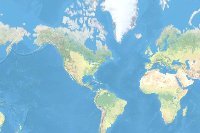

In [3]:
training_data = gis.content.get('807425fa74f34d7695ec024eb934456c')
training_data

In [4]:
filepath = training_data.download(file_name=training_data.name)

In [5]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [6]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [7]:
data = prepare_data(data_path, batch_size=8, imagery_type='ms')

### Visualize a few samples from your training data
To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualizes them. Note that the masks representing different roof segments are overlaid upon the original images with red and pink colors.

`rows`: No of rows we want to see the results for.

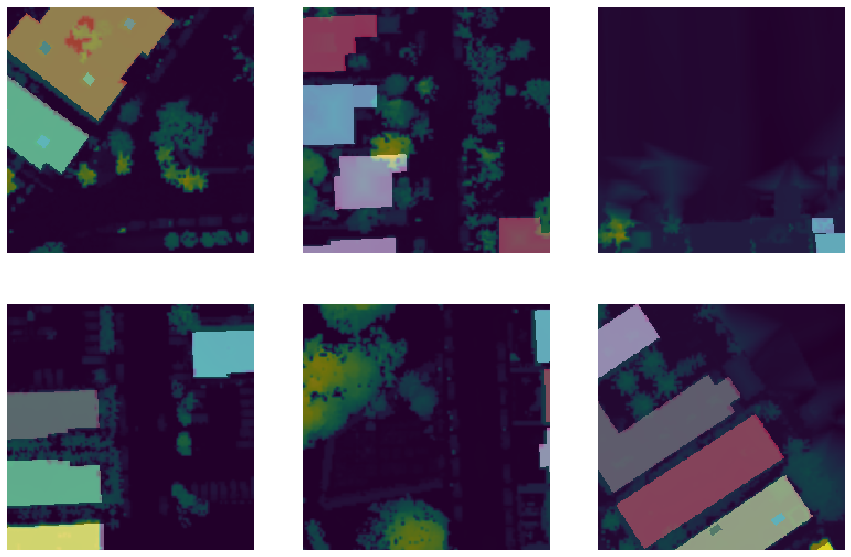

In [8]:
data.show_batch(rows=2)

### Load model architecture

Here we use Mask R-CNN [1], a well-recognized instance algorithm, to detect roof segments (Figure 3). A Mask R-CNN model architecture and a pretrained model has already been predefined in `arcgis.learn`, so we can just define it with a single line. Please refer to the guide on our [developers' site](https://developers.arcgis.com/python/guide/how-maskrcnn-works/) for more information.

The idea of Mask R-CNN is to detect objects in an image while simultaneously generating a high-quality segmentation mask for each instance. In other words, it is like a combination of UNet and SSD and does two jobs in one go. This is also why it is relatively computationally more intensive.

In [9]:
model = MaskRCNN(data)

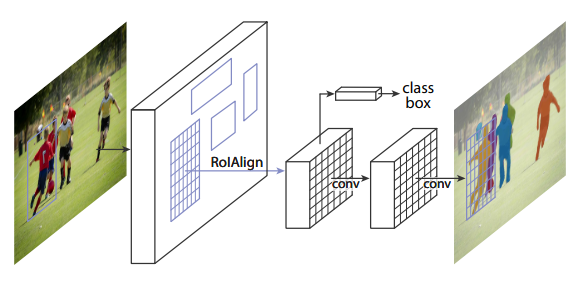
<center>Figure 4. Mask R-CNN framework for instance segmentation [1] </center>

### Find an optimal learning rate
[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. `arcgis.learn` leverages fast.ai’s learning rate finder to find an optimum learning rate for training models. We can use the `lr_find()` method to find the optimum learning rate at which we can train a robust model fast enough.

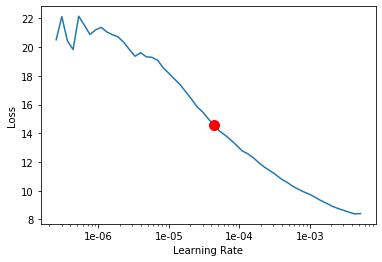

4.365158322401661e-05

In [10]:
# The users can visualize the learning rate of the model with comparative loss. 
model.lr_find()

### Fit the model

Let's train it for a few epochs with the learning rate we have found. For the sake of time, we can start with 10 epochs.

In [11]:
model.fit(epochs=10, lr=4.365158322401661e-05)

epoch,train_loss,valid_loss,time
0,2.769909,2.669544,06:09
1,2.142615,2.117454,06:38
2,1.951803,1.997903,07:03
3,1.843830,1.804779,07:50
4,1.687831,1.723288,08:12
5,1.534998,1.688702,07:52
6,1.503451,1.559698,07:48
7,1.417018,1.515242,07:40
8,1.335621,1.512897,07:36
9,1.238250,1.535544,07:26


Note that the validation loss actually goes higher, but this doesn't necessarily mean the result is getting bad. Because our training data is also missing many buildings, the loss sometimes tells the actual model performance, so let's look at the actual results instead.

### Save the model

We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default it will be saved to the 'models' sub-folder within our training data folder.

In [12]:
model.save('10e')

### Visualize results in validation set
Now we have the model, let's look at how the model performs. There are 3 modes when visualizing the results.

- `bbox` - For visualizing only bounding boxes.
- `mask` - For visualizing only mask
- `bbox_mask` - For visualizing both mask and bounding boxes.

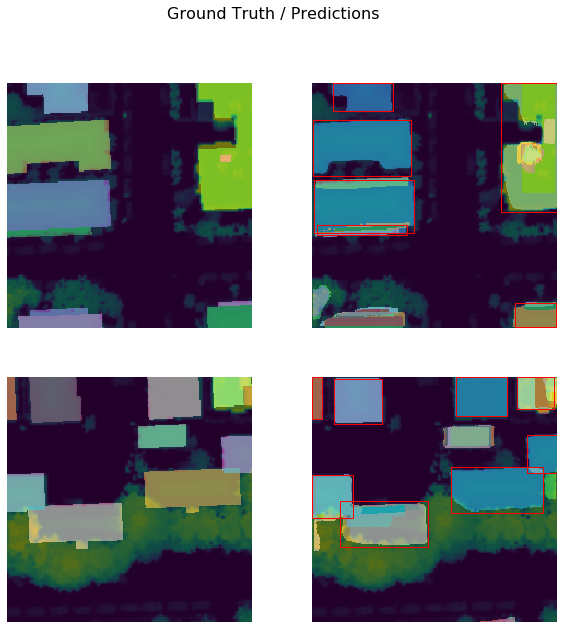

In [13]:
model.show_results(mode='bbox_mask', rows=2)

As we can see, with only 10 epochs, we are already seeing good results. We have trained it further till 220 epochs and were able to get promising results. Below are the results that we got from our model trained for 220 epochs.

### Load a saved model to visualize results 

To visualize results from a saved model, we can load it using `load()` function.

In [14]:
# model.load('220e')

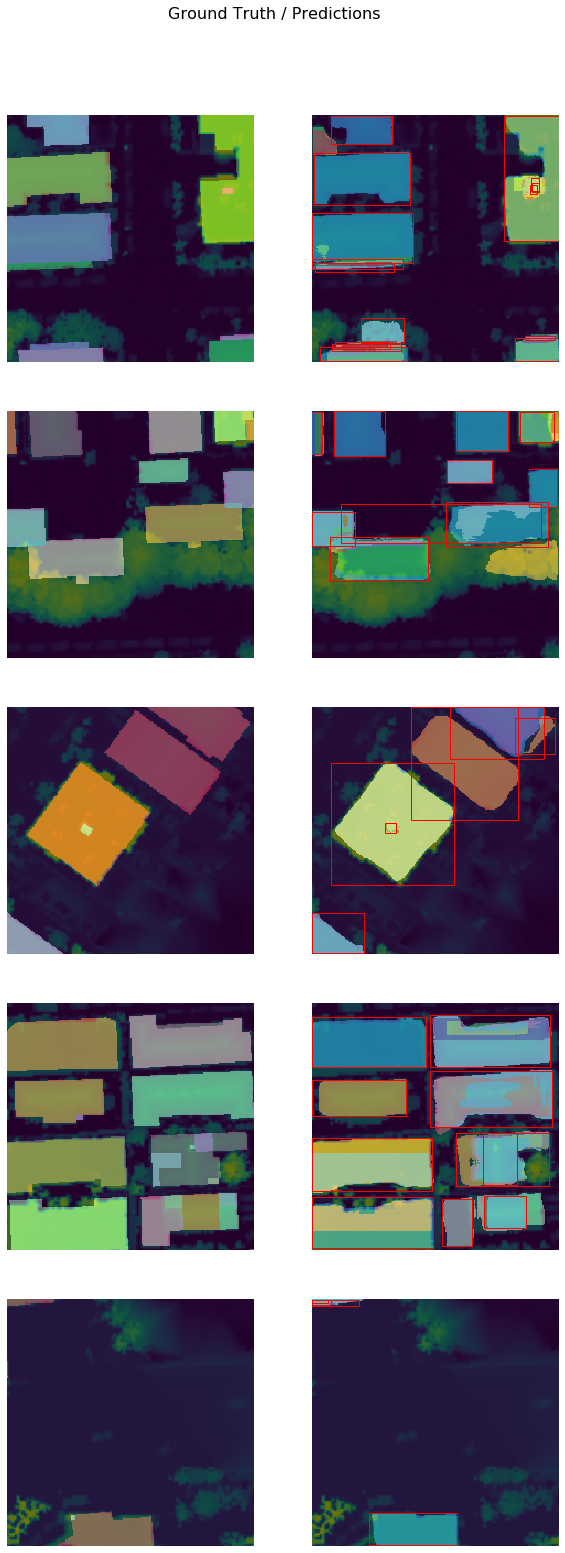

In [15]:
# model.show_results(mode='bbox_mask', rows=5, box_threshold=0.5)

## Part 3 - Deploy Model and Detect Roof Segments

We will use saved model to detect objects using '<b>Detect Objects Using Deep Learning</b>' tool available in both [ArcGIS Pro](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/detect-objects-using-deep-learning.htm) and [ArcGIS Enterprise](https://developers.arcgis.com/rest/services-reference/detect-objects-using-deep-learning.htm). For this sample, we will use the DSM image for our area of Interest. You will find this image in the ArcGIS project you have downloaded with the name - <b>DSM_AOI_Clip</b>.

 - `Input Raster`: DSM_AOI_Clip
 - `Output Detect Objects`: DSM_AOI_Clip_DetectObjects
 - `Model Definition`: path to the model emd file
 - `padding`: The 'Input Raster' is tiled and the deep learning model runs on each individual tile separately before producing the final 'detected objects feature class'. This may lead to unwanted artifacts along the edges of each tile as the model has little context to detect objects accurately. Padding as the name suggests allows us to supply some extra information along the tile edges, this helps the model to predict better.
 - `batch_size`: 4
 - `threshold`:0.4
 - `return_bboxes`: False
 - `Cell Size`: Should be close to at which we trained the model, we specified that at the Export Training Data step .


<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAtkAAAJHCAYAAABFIUqtAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P3nWxzJ1iWOvp/vx5nnmfu/3C/3zjO/mXded2yf9t3yHkkgIbwT3ntvhUAWIUBICEl4EEZ47703VVRR3rHu3lEUAoTanDZC6og+64jKiAyXmWuviNwR+S+QQQYZZJBBBhlkkEEGGX7VIEW2DDLIIIMMMsgggwwy/MphV2Svrq6io6MD7e3tEhISEhK/At68eYP+gQHMLyxgeXl5h21//3BY3SQkJCQkfjna2tqwsLiI8fFxaDQabG1t7TDvISKbjYKEhISExC8Hk29ff/8HF9mH1U1CQkJC4pejtbX1p4ns7u5u9PT0SEhISEj8CmBOHR4Z+eAiW6FUYlOlkpCQkJD4DaBSqzE6Ovp+kc0GYG5+HiazGUaTSUJCQkLiV8Lc3NwHFdk6vf7QeklISEhI/HJotNqfJrI5scFolJCQkJD4FcCc+qFFtlanO7RuEhISEp8qmHvNFgssVqsA//1baVwpsiUkJCT2wGqzCe7bFv8P2La3fxP+kyJbQkJC4vcF865ycxOTU1MYIfE7MTmJ6ZkZcezHeN5KtoBF+TvHyWYcdpwhRfZvDO432XcSEh8H2C2uvaMDj4qLBUpKSvDy1StBwBx32DkMfsaZZA+m4d/vI18+58iL7B3+2otD0/0BYbRYybjSNTcdHi8hIXH0wIK46fVr+Pj6Ij09Hd7e3rhw4QLq6uvFhMph5zCYy5ubm8Vamr2czrPgb9rbxW5R/Pfecxi/isg2mi2icnthsbzfIP2RsKVWQqHSQG+UxklC4qiDifR2QQHSMzJQXV0NZ2dnuLq6ihXihxGo45wl4sm4uDgxK8Ikzsf536HhYXFcoVC8I8CZU4+syKa6CUOiU2NDQRymVIp/lSot9FJU0rW0Yv5NGZLzijC2YYPFfHg6CQmJowXm5camJty9d490qgV379/HxYsX0dDQsMvdh4F1bU5ODry8vASvC51LHNnS2irsRMXz5+LYwfN+scg2bwNG5SxamhpoJNCI+nr+9w3GFhUwWP7IwtIEs1GH6ixveKVVYFUHOeMhIXHEwUL4zt27gjiZMP0DAuDr6ytE9PtENnMjryKPi42Fv78/JqenBXfyjAfPkqSkpgoxe5BDj6zINplhNWowOdSF4vw0JKRlIDUtE2kZaQj1i0PNtBJm8x970mCvyB6XIltC4qMBC+l6EtQPHj4UHMj/Xrp0SQjvHxLZzNdqEslpxOfM6yy0Xzc347qrKx4WFYlF5Ied98+LbCJim1mP0ZZnSErORfGLV6iuqUVNfR0eF2Qip7gBStP2H1pYGo0GzA23483gDLYMFvp9eDoJCYlfFyyWeZbhIN4nlB1wiGwmT077U0Q2g89bW19HfEICQkNDxavHmzdvIi0t7b2uJkdSZFOdrCY9hqtuIySxALW9izBTOpttG9uwYnGkHQMze30XTTBS27h9JhLeBzmO09nj7NgXL+LsLijvSyPiCEayNyJu157sP4fT7ObrwMF899iit3U+rE6OuD157j2+U5bRYqM+eWvjuI5cX0ddGe9w/oH8Rdqd/CQkJH46+FljTv65HM9CuqGx8R2RzS4kPySyGZw3v9XLy8sTQpttw6NHj3Z3aTrsnH9SZFPjzAZM1t1DYFwuOqe3YNlmuuH/AItJS4ZFBZ3h7Tlmm30hEaewHJgFMZqtO3Ec2NVkT7zJ7opiJlKy2hOIPMx76mMisrNZLTBb7aS3mz8RGJ/jyNtme7fz95Yt8j1wLoftbdsukTK4vMPyNAtDZA/WHXcZq/i1TWRr2MmT6/c2b5vN+g4RU/Zv86Gbxn7O/j6TkJB4PxaXluwLWqanMUXgf3mhy8zs7A/6ITPJ3rt/H21v3ojnL4CEsp+fnxDQP0beHL+6tobExEScPXsWGRkZgpDfdx5z6lET2VzXlZ5yePrHo2WKDYJtHz+ZiGN3+Zm42WIxYmN1AbNz81hcU4pjDjHLfGzQKDBP9mNufgHzKxvQm4mnd7hbr1VhTamC0aDDytKiSLO4ooSeuNxRpkalhFJjgEa5irmFZSi3dHb3RFHukrBNc/OLWFXriSvf9rOJ/aWNGiwtLtjLXlrBptZAdePBlxnKNS5vHgurCuipzszvnK/ZoMGyOMfeHt1OXkbtJhYW7HmtKLboHJO9/htKaPQ8uDBApdiASmeCWmG3mYvUXh3Zl10RzvnoVDt14vxV0Go2sb5J+Ul3QgmJnwwepDJHh4SEICgoCMH0b3BwMAICAsSbQ36+foh3n1dW4lZ+vhDA7B547tw5vHj58oDOfRccz2XX1NTAyckJbm5u6Ozq+kFx/s+JbFLM+oV2RPkF4lHXKvHwgcZQ2rfp2bfPgrE3L1BS+gSlFVUYWdaRCLXHm0htGlZG8LS8HGVPyvH4WRUGF9XYJiJkUWrcmEFD02vML6+jveEFHlMeZeUNmFLphPBmAlsd68Lr/lnMDLWg9MlL9M9uwESCF/p1tNVxueUoLStHVfcsdcZbUWvmspd3yi6jfCtrMbasofpSh22toaX6CR6XlKGioQvrGjMZB7uRUUx1ofwJtYXyrH4zDg3Vgw3PVE89HXuCkieVaB9dJnI2YWmoFXWd41AbLdArF9Da+Bpji6tor32C4pJy1LSNQGUiIt7pNzOJ85G2FyLvx+Uv0NU/gvbWBgwsaPYJfQkJicPBJMgzFdeuXcOZM2dw/vx5QaL8L89abBHZHUamTMoszKOio1FAxMtf7GIS5XyqiVQ534Pn7AUT7cDgoCB79uMODw/H2Pi4mF05LD3X4ciJbLMWVdlhiLrTCBXx4/s5h7lKhc7KcqSlJCA7JwdxCcl40jJL7SJetpqwMtaNx7kpiM3IR/6tHEQnJuPe4zZsMI+S4NzsLoVnQAQeV9Tizu185N3KQLBnJB69HoV22wqbSYfOR+kITruPJyX3kHnrMbqI241GFQZfFiEhNQOZufnIyU1GSOxd9I0tQ0t2w0Qcurk2g6aH2YhMzUVe7i2kpibhSfsatViDvtqXyEiKQ1ZuHhIS4lFUP042zQqdag2vi9IRkZyFXIpLzCzDvMGMrdUpPMuLR2RaHnKyc5F1rwaK7W1sdhbDIyQF/WQCt3XrKE3yR3D6Q5Q+uovcvHzEBIXhYdMoVMT9XKct5RIqsqMRmpgh4jPT85AR54fAvCps6KU7oYTETwVzJ3NXWVkZnC5fFvzOExvsL81f0j2M3xnM8bPEuUnJyUhITKTnP0HwdUREhPjNkzDvE+cM5vKmpiZhF+4/eIDMzEz4+PgI15H38fw/IbKJXLfNGKu/j4Dw25jRv511ELMH2zY7xGwECVPLBhoe3kZCxn209vahqSIfEUlFGF/Tw2YjYdr5EmnR8XhY34ne3h401DxEpE8q6idWYCKdbJ5qhJ/7NYRkFONVUzt6ettRlBaL4KgiTBlMpO9NGHueC2fPUNytrEd71xDmNqgxinE8TIxC+qMqvOnqR3d3NVJCYnDnaSeUJLStViOmOqjsKC67Cz3dnah5UYL6vk1Y9GMojE1BftkrKq8DxbeSkPKwjQjchqWBeiRHRuERndPZ0YHKF01QUH7DVXcRHZ+JV2/60NLUgrrWPhipn7qLIuGZ8gxrRtL8s+2I9LwCn9g8VLf0oqvtNdLD/FHYMAodDVzMFg3ay28jLCIZL95Qndtb8SAtnG6iKyjqpHo5ZpAkJCTeC+YqJsrmlhZBhiyu+XXg45IS8VrvfWKZSbK3r0+kKyXyDgwMFGKb/66srDz0HAe4PN4Oil8fpqWniy2h4uPjcZPy4Jn0w4j76IlsEqjGSWTeDMbdxinicUedDdRvOkqrh57rTWCun2i+i6DAXAyo2aEE2ByqQnhIFvqUdM7qIDJCApFfMwzdzms53UoXknxuopCEuNW2DXXvE1x1dkdi6RviVk5hxVJXOXw8olE9sUE/DegpTcFZzyi0TduNE7+xHHp1C4ER2ehZMYhjgAF95dnwCSvAuMqCbYOCxGwkIvNeYIV4l4NRs4rFDSMWekoR4peKznX7udrpZsSEpKJjbQvTbY/g4ZOCyR07uLm2Bq1NizfFKfCKfgTVTjsUKyTmqf1KEtmeoak7InsDZSmeuByUiaFVi0i30vUIvv6J6FwykSHbQm1hHMIzyjCnE9HQLvQjwfs8gm/VSJEtIfEzwfzJfM6z0rxw0d3dXfD3D80q8zksepdXVrC+sYGHDx8Kd48NhUIc47i3Wnc/mMOFD/b160Jg87FNtVq4BLLryODQ0KE8/0+JbCs0aC1OhW/KC+iFwTIRQeiwODmIluZWtL3pQN/EAnQkShe6nyGQSG1U73CA0KIiLQJZNaPQbs4gJ/Qm7rSQEaIY4UKxrUVLURJuplVCSdxkmWmGn5c3cl+NEpXyziVEtJoZ5EYGIqNyiI5YMfkyE+cD0jEkSJfSEDm/vhuL0OznWKU82N2DHTk2hl/A3z8B7fM6mJUTyAoJwJ3mnbLpwrBLhonPvRePsMwqqulOWOlFfFAsXq8p0VGaBq9IMtYigt1AyKDbVlEUHYi4h932o2K23ACrmYxESTz8MyuxziJ7rgux/u7IqZmERXSHBQMvMonAi7Fu2IZiuBah/pFoovqxiwwnUYw0INTLBY+6pMiWkPipYL5i0cxbK/FMdOGdO9AbDD86G81wpElMShIuJocR515wenYTcffwQGpqqlgcw88vu4rEx8WJraJ4YeRB8ubfR05kG4aR7B2M+69nYLNRP5gsMKunUZafLWZ9gwICcKtmmkh4FcVxQQjJqcTE1ASGxyYw2V2PKJ/rKOxYx2TTA/gE38KcwSreANrthhFtxckITH4GBZGbqqsE7kGJ6FmyickSTmOz6PAkLQiZFf3EjiZ0F8fCL/sVFETt7LtsMi6hMPwmcqtGiLftrizs5qFXDiPBPwjP+legWu5AlF8UGmdUxOv2a2k0sVvgBp5nRMAvqQzjU5NU53FM9rcgKeA6MuvnsdRfCT+XEFT0T0Ghsatz67YBg5V5dG2T0DyzLNbWCBead0T2OkoSApD0bAAGsnsm6jfdZhciPCPwanADJuUAYn2D8Xxgle4NnvHithrR/jACATlyJltC4p+Bg1NLS0vFYvUfEtgO8DnM2ayvnpSX48mTJ4Kv+dhBjt4LTpOfny+EucMHm88RiyFJaLPY5zQHz/tFIts7spSEsF1km01aTPe34UVFBfITA+AW+5iIQ4+uZxlwcQtDfuE9MnT3cO9OIaL9riH8QRvmxxtx05dIdnGLDKI9fzNVcr6LhXkyBnVWWKdfIygwBHVTFth2VnCzm0fr/RhE36oFmTNMPM9CYFYFVgRRmWE2z+FWaDAZg7Hd2Rh+halTzSHrpj+Ku+awOlOL8KBMDKyS4HaIVyJGq2EGd6IC4RWWhnv3qM537+NeXgY83a6jqFuNzcFXCHDzRdydcvTNKSl/MiJWI0aJiG94hiKrpB4LW0YSxJTXAZGtm+tE3M1gvBhXCVcXy7YRE60P4BlYiFWDHoNV+dSnRdgw8IwS1Yf9xdeGkBLuh4cdSimyJSR+BpizWFjz/qUseB3i+cfgOI9fH7L7yI+dx+l5cSP76fGMiEOU87+rq6viOBPxWw59e97REtk8WbKMwmB/pJf3gIb6QsSK47xQxLCIosQgJD0dpxMnkRfhj8A4MjoPinDv/kPco38fFD1G75IC3c+y4BlbDg0J9903nZTF6KtcBIQUYIYs3BaJbM+QZPStkJh1cDv1yYvUACQ8bKXyzegqSkH0g2Zsmtl1hfKiQUCibwiKWudJ6zoEtBl69SoKgrxxt3US88NPEBxegIkNGmjtrrEh+6GdxYOEIPhG5eDBnjrff/gILeObsGrX0FL1BEHuzvCPz8fLnmnKm/hdMYPnjwvhdc0FUbnFaBldEcb8XZF9Eyk0ONBSX7HI1m527ojsdehWm3DTMx6tk5uwsSsk21GTDh2PYqTIlpD4BWAeZa79qfzuAKdn1xK2Dz/1XC6HsZfL+W+e0HlfHv+EyGaytGG25TH8fJLRryGxuEMOLH55dnesNhd+8aVQ6LRoe5wE37hijEzMYHJqkozWFKZm5rCu1mJptBK+PmkYYj/oHQHJRLzU+wLB3nHo1pJQFSI7GLWT5rdEbLOiuSAK4VkvoRQiOxdht6qwZrQTsdk8iSw6p7BhCtv7iHgZ+UE+ePBmCjM9j+AXfgezm5z+LRFbNRNkPAKRUtKO2elpYWQnpqYxM7cABYtnow7Lc6MoiA+At38QUsvaoScxbDZqMdFTj8QQX3gFRaG0dYYEuOkQkR2E56ObuyJ7vOU+PIPuYM2gQXcFG6an0DoME+WL9WEpsiUkfgEsxFc/l4AZKySQmSAPizsI5kdmv4Pl8G8+vpc/HeBjR80nmycHhspTcCP6DqbUNMgXgpDiWKTq5vEoKRjJ5aOkipfxIDYEaZUTOzkx8zuCGcO1d+AdWoBFAy905LzJEMGEjpIU3Ex4gnVKrCaR7bEjsnlWl2fSreZ13I8OQEZFH6U3CpEddf/1jsjmmewF5IcGigkUqtGemewxJPvfxJO+RayMVcLHJwUDK/odQctpbNjeXsPTtAjEPOrfqefbOvMaIc6HfyuWJtBQmgt3nyh0LBrE/bNts2BpegQVt6LgGXELUxqeif85IrsZN92j0Tyl2ulTnsk2oP1hlBTZEhIfCCyO3+dL/WvhnxLZQowqZ5Ab7YPksl7obUyAHGcmUjNiqCoHfnGPSVhaMdn8EL5Bt7FEJGmjxpiF3za7fdigXupFQkAwno+sw8qLJ0kI20iYDlTdgl90EZYN27CQyPYn8nzaryImpjrwaz/tHPJjApH+bJCI1iJ8skPzXu2IbBrVmNWozAhD3MNWaIg1xYJFKlez9AbhfpGon9jE5mwzgr1C0TipgnWH9Hjv023QuZmRiLnXRjlDGB0z1ZvrK0iefosLw33T+hBe/jHoXKGRAQl/XuDJ6TofRMInqRgr+m0MlP00kb2qN2K07i68g7Mxs8WGicqiPDXTbxDl6yZ9siUkfmewQD5MHP9aOIoim7e2028u4WFCIOLvvsCMyu5fLMSoaQkPEgIQVzpE8hYYfpkN35t5GFSRQuSwrcfCwgo0BuKthR4kBwbiQesMSWV7MK0PID0kBIWN02I3KnVvGS5e90Zh7ajIj6QulpqL4OoXR2KUjJFVj859ItsoJkR6n2UiKLYQI0p73VjUj1Tdhl9EAcYUxJ1b8yiI8EQ8nedIYlStYGHThJmmu/D1TkXXunZHYBuxtLQMlUYLxaYCGt3OCcsdCPP2xfMJFTY2Nqlf7Kl1/WXw8CPO3+CZ+J8msl8OrMFm2MCjeB9E36qH0p4VNufaEOV6TvpkS0h8wvjnRDaBXx9uTHYjO8oPKaWtWFNuQa3egnZLidaiGNyIK8GaluhPMYyc0EAkFNZiQaeFTr2O3u4OjMypYDNr0fYkByFROehaVFNlNFidbUXSzWiUvJkWCx+FT7bHNfikFGNieQs6zTpaSzLhEZyLIWImm9WEkWdZCMx+sSOy2ThasDJSh5iAEDx+M0UEqqO85/A0Ix6xt2uxYbTBalKiujAOASFU9hKVvaXCdG8T3kzroByuQMCNMDxuG8UmGSHN+jRqm/uh0avQ39eH2dk1+luP8do7CAy/hXH9Btpb+7GhUGFLs4XGwmhE5ldhk/qotzgG3mkVdpE924FoX388G3krssde38EN/3wsqq0wbk2gIIyMW2EDlvQ6qDeWUJYZCCcnF5T0qKTIlpD4hHAURbaoF/GWZm0GNc/zkBh3a9et4mF+Jrz9I/F8YMX+elYzh/JbyQgJSUZB0SPcyy/EnZcdxJkm4UI3S3yaEx+F1AI698FdZGRm4E5pB5TC/cQKVU8Z3HyCkHa7CPfv3ceDwmzcDE/Gi9ZJ6G0WsbtIx4NEhN9t2hXZwu1Pu4bGB1mITslG4f1HuHsvG/HJD9Axtgqj1UxlG7A6PYCCqGDEZN/B/fsPkJ+ehVdjGsCwjFcPMhEcEI/bVOf7t++g4FkLlMS3/S3lyE7Mw/2HD5GZnk11JZG+rUR96T3kZRbQ8SKkJmXgSUM/VCTRNzuKcCMoCX07Irs41g+JT/v2iOwOhN4IxXOeqocFG0v9yA+NROKtQurPh7hz9z5yorwRmFstRbaExCeKf1pkM1hoG/VLaCy7j5TEVKSkZoiFP7GJuajqmxOExxvuazZHcT8hGQmp6UhKTMe9inasE1mKmWEilvGmEiQk0/kpaUjKzEP94BoRpVlsFWiebiISD0VxdTse5CYjKSkZ0bmlQnDzfqc8szHT8hT5T99AQeLZQVS81Z5yshOFOalITElHckoSGQASygaenbIbOE7bXVmAhCQqm8rPyH2MYYUZ2yR+p/trkBGdiOQ0qnPCLbzqn4PFRkRcV4a0uGRqaxoSc8owvq4lsbyGmnv51LZUJFE+2UUNWNMbhU/2aN0DZJcRiVPddMvDuJ+Th+YZtZglM9uMmOt/hbS8SqxuGUSbtao5lGVTX1FfJGcVoqX5NVLCffCgXbqLSEh8SjiqIlvUzcxv7wxYnBzH8Mio2DlleHQME3Nr0O3YAnavMBo2MTM+JtIMDU9hVa2l4/Z4drNQr81jhOL465djM8v2XZSYf0lkb3aVwCssHT3Eh7MTIyKPiUUF8SDly/nz3tPry1hY29y3jzTXzWLUYG7aXrfhkTEsKHXgnUccadh1Ube5jPFRe75jUwtQG+wuIWaTGnPj9nOHhiewrNSIOm8pVzDB7aS6jkwsYIuEsoU4XLm6gNGdNozOrMJg5b2vTWLCaHZhGWoaVBgNeqwvzWNpZw9tfjOq16uxMLeIDd7bm+0NnadRvq3T4roaPY/jcDOvemdh5/5rICEh8fHjF4lsBs8ssDuFRbhL2MGLQvZ+dpfTMOHyh1VEGsvbxTDCTYNdSBxxhN1zd0S28MmesgDbO/kTmOR286fzWXC/zXPnOBGqI0/e+1qUu4/I7MTHe2c70u2KdDpX7DjCxyneUSfhLrKT/m09eObmbR7sNuIox962HfLf6Qe7j6IdXEd2lbHXnerDdd7pK97VyrrSh4SgcLycVMsP0khIfEI4yiLbDuZm4iN2mdvFfp618789DfPeXl4W8YKD6TzGHv51iGzHwkd2t3Ok2X++fSJl7zEBKofr4yj3sDRCUO/W28GxO+fSOQfr7GiLI9/dunIddo7vaz+n3/Ob+2rfVyLZLvAxyocHCewqKerK+dMgYNuyivtRESisHwN7rO/tVwkJiU8Dv1hk/6bYI7JrJky7Cx8/TZhg1Gmg2NIJn3W7254BPRXsn/4Iq/xVsT3iXEJC4uPG0RfZvx2EyO4shltgAnqWtz9tbqfrbNWr0P2mGX0zCruYNq2h4UEGAkPvYFSllxMoEhKfKI6+yJ6qh6+PH16Nf+Ii22SFVTmI7OwCVL6qRV19Ayqe3UZkYA7aptdgsr59FSohIfHx4w8tss0WqIaqEJ95FyNr/I2Cw9N9GjCBXQ2HWsqRHBmPxORUJCby+qBXWN3U0YBDCmwJiU8VR1tkm8wwbi6hq6sb80rjrivHpwkTka0GM30dqKmpQ21tHarqWzGxpn27jZaEhMQngz+yyBZg97k9bhmfOoTbiYXXKTHsbiMH3WskJCQ+LRxtkc0gIhY+3n8IIjbBTG3lrwYxtgnyNaKExKeJP7zIlpCQkPjEcfRFtoSEhMQnCCmyJSQkJD5tSJEtISEh8QEgRbaEhITEpw0psiUkJCQ+AKTIlpCQkPi0IUW2hISExAeAFNkSEhISnzakyJaQkJD4AJAiW0JCQuLThhTZEhISEh8AUmRLSEhIfNqQIltCQkLiA+AoiOwtIv7D6iYhISEh8cvBHPuDIntlZQUzs7OHniwhISEh8c+DuZU59kMFFZH+YfWSkJCQkPjlYI6dnJx8v8heW1vD/OLioSdLSEhISPzzYG5ljv1QQYpsCQkJid8OzLHT09NSZEtISEj83pAiW0JCQuLThRTZEhISEh8IUmRLSEhIfFzg9TQms3kXh6Vx4DcV2VwRI1VALpqUkJD41ME8Z7FaYbZYdsmX/2a8jwM/RpHNnP5j7ZKQkJD41MB8Z9vehpH+Xt/YwPLKCjZVKlhtNsGHh53zq4tsRyW4QF5VqVKrodPrd48ddo6EhITExwwH342Nj6O6pgbl5eV4+vQpXr9+LRY3Mi8eNuPxsYjsvfXnHVEGBgcFFpeWoDcYpOCWkJD4ZMHcxhyn3NxEZWUlUlNTkZCQgMTERMTFxyM3Lw8dnZ0i7UGd+6uKbCZh3hPwdXMz7ty5g8zMTIGsrCxhdCanpiQZS0hIfFLg2Wsm0ZzcXCQlJeHhw4d4VlGBp8+eoaCgAPFExkWPHkGhUIi0e8/9GEQ215l5vaa2VhiW6OhoYWRSCFFRUUikNje3tOyK7cPykJCQkPhYwdq2r68P8SSomdP7+/uxsrqKtfV1LBKHNzY1Ce6/ffs2VonP906o/Goi22FoMjIyBBoaGzE8MoLRsTH0UuVKSkoQExsrRgE8s33YrI6EhITExwTmMSbYyMhI1NbViZkOfmvnCMyLTMYssuPi4sRM916hfdRFtpnaNzs3h+ysLGRnZ2NgYECIaW6DQ3z39PYiLS0N+WRg+PWp5PajAtOPTGj9WPzRBdfbaDo8TuK3wR+1z3nioL6+HjExMXjT0SF4jzmO+0OlUkG3w4dq4tKS0lIxEcFvLx08/6uIbK5EOxXOsxpsaPgYF8Cmhg0O/20m8KvFLCJqnlpXKJVy1uNDw2SBja6R+X1EazKLeKvlYyNiE6x871mlsf+9YOYbZdsqfNUOi/8UwbzW2dmJ2NhYTBGJ8m8mX+a1waEhVL54Ib6oyL8ZbW/eCDHOotshRI+yyOY6M2fzTDy3hQU1+x6a6DhPlOgJbGj4mDAwJSViNod9FD82oW00WwXXsb0S4L+tP88+mSw88Pjl7TaaLbDYLD/6LBmpPBsZWa4v/2ex7C9br9NArdFBv+fYvni9lq6/hkTC4fE/FSarjcr+mTaCbI91m+6lg6KNbA4fN/+gmDOQYNnClk5/SNwvB/erQ7vY+5Zs4AezJSbiVupf84e2wQZoqc/V2t+mz48qmAMnJicRERGB6ZkZwXV8nPmNeTwoOFh4bnA6BxcyV7L3BrsPcrpfLLI58wWKZ+MxRIaFDQ0XxnFd3d0YGxvb/c0F8ixIQWGhmNnh3464jwFcVyY+NjB2GOiBJEIkcvup4sK+EPTwuJ+DH82HyMpCRsJID4ejvno6ZuZjfB4ZFf3qKB7l3Uf32hZdiwPXgYjeqpjAg7xkvBpSwfwLHnIjlWv62dfZ7gP6br/uHH9f25m8t5bx/F4Kit8sUNpffyDHfc+ks3sfkJEy8UDyQxAh9es71+53hQkWkx6DVbeRUdaCTQM//4el+7TAXLChUIjXh8xzDvLl43x/8kTCJScnQcQOjmNuLH/6FPn5+btpj7LIZq6+deuWqLNjAMHo6+8XbWDfbP7NadkOMO4/eIAHBEebPwZwXbdWJtH8uhF1dbWora1FTU0tWkaWhMD6YcFnh9FsxMbiOEYmlqEz/vOCjOuiVs5hZGgaKv37eI6eOaqXfn0cDbU1or7VtU0YWdyi+toHuix8Bx9H41rgfSzSkMF8IA+TxYa1uhR8ccEbbxZJUFr2x/9UmMx6LE0MYmJBJbjosDQHwfZAq1hAb3cfltRkQx1tpPP16mVxfEGhO9xmEJ9jax5ZPt/C43YXDNSOd9L8ArDo35gfQVNTg+hX0bc1deicVlCPb787KPhNQVxiIIE23IPxJbW4Nw5P9xuDbCr0a7gbfAxXMhqhMdkX/h2a9hMCcxtPHqSmpaHp9WvBgY445jrWu8eOHUP5kye7PMj/siZgkV1VVSXS/SKRzRedZ2rYF/Hlq1c0+raJY/xw8G9fPz8MDg7uVoDBha6TcWJn8d7e3n1xRxlWIqG+0jgcO3sZnt4+8Pb2hrvHNXglPMLsyqZ4+H/4xiPxZ11BSZwf7jSuvDPr8NNBI33bGp4k+KOgbuk9+ZDAtugw1V6LhGA33PD0ho+3G664RaF+eAZa8zaNjrehm26C+3FnlM/wW4UD+fBofqUXkT6XUdim+PkzFQI0stvWo+tpMuJz66Hih/OnGCzrNjSTjQh0dUfFuPrtKJ4HBotN8HP1RsWAEtuHzS5Qmm3VDHLDriD++SS1a78P7C8CXeNt7RKKEjxxyum6uAe8vT3h4uGB5Pv1WN2i+/t3FLw8YJptyYd/eD6m1dvUT4en+21hgs2sQ+udm7iR8hQb+t/bEH0YsKh+QuTK/td7yVcYQhKnTLJXr14V7hMO48j/qtVqpKSk7Arzoyqymafb2tqE7zUbGuZpbufU5CT8iNfv3r0rZrYdbWPw3/yGkgce7L+4t1+OMpgjZipi8NfvriL19j0UFtzBnTvJuHbFDekF5ZhVY9+ztXd3Ffu9bqKe1ON1gQ88YiuhtpIw3+UBHnTZ07LrzUEbsS8vOse6bcVkQyquuadhWsOz6Qf5hJ43ixYDDaUIv+6FqFv5uFNYiKy0WLg5u6GobUoIT579HCgKg5NvIRaodtbd+jruRRIQM1148qoBCyqK23lm+fhuffZcW0fZu23hiSUWX7ZV3As8j6iScTED7eB3vl/eptubB8VR/yi7i3Hmm7N4NqV727fM79MVdPwMHnWRqBX8fqBMzlenRHfjM9T1L5EApDRUTy6P7z9H2ncnHihO5MFx9nwOm5zgwUb7bW98dtYL2YX3UED3wu2COFy96I5bZfVY05Ht3NMefusg6ibK35/X+/pSlE2/98fvP1eAOmrbMIsMj+OIKrOvZ3s3zZ7+4TrsiduX/8G4nTqIc+nvvcdEH+/LzwSzQY2B5gpU9cxCT9fdfl24zT+jz6k+H3ZC6OeB+ZkXM6anp7/DddwmFtmnTp0SC9y5fY445r3R8XHxhpP1sYrE9T8tsrkS7G/NRsMxNW6hwtmAeHt5Cf9rx4VwgM/jSrxpbxd+fHsrd5RhsxjQluePK3FPoCCS4HaaLSsojw/E+UuuqBpT0e+dm5VuJtKJu6+cBOGSwIRpFmnup5Bez6Ni+ukgJKvN/tqP0x94TcgPschLvLbibWLoh3kemV6nkVq9upPP3huXHohtLXpKE3HsG0+Ud83AQOdatw0YqXuIa6e+RnbNFIx0nn6mGb7n3PB8TiXqyrDteVXHDxMH2x6BvVufnbT7yIHabaGGOP7jPgIMqM9xh0dKDf3lcD0x2dOJNr37mtNI/bs18goux0+jeEi1X2TPVcHp+PldErbXh3PhPrLXXU+DDPHbIcIpjWjXzutVjrOKWf63ZfKrXuHxQP9Z6f7kPN9xk6F8oJlHlu9VRD8fgYXSsNBVbwwi0+0sLvmnY1xl3e0TfsvhKM9Gz8revmIic/Qj98OuUaY+F3X9oX7eAZc9VZuMy+5JmFDtFwICdF84+pnvw70DJe43rtvbV81v48T9aLPunMt1YbK0HzPv3KvinD2EuXOn2PtU3P/260/J7W2gc/e1n9sp2sZ1s4kBOt/7jvgjDepXnuVlMcmvEplw7cbGbpy4D9h/mUU2L4J5a2TsrxNfvXqF4uJiceyoimzm6PSMDLx580ZcG64rL/LhRY7JycnCF5GD/frZwWn4PF4gWUjC7+MR2RZMP4vH+YB8vP3AvQ2K6X5EX/0cfreaoDbzM0jPE7VTo5gXn0menJmDUm+h58AA9fI4HsU5wznsPganlrCi3LJzE9mNlYUpjE9MYmZ5Q3CIXYzZn02NclnkNTE5jaV1FdT0u/FeEM67xqJ1ZAHL65vEw2+fM3a7XOovxsUvnVBQMwLzTm25vsOvsnHxxHmU8gQEHRkoCseVmw+xZFZjfmoCE1PTWFUbdvmW3UlUau2uO4mJCMeoXcf0lL0+yyo91X+HQ+l55basLs6Ie35yegEKjRaK2Q4kkk0LzH+NqdlFbGzROfQcK1bmMEFtnpxZoGM6Ot9ehr0cQNFbiksnnVA5fUBkz7yg45dQ0kP8TvkwL60vzdrzovyVwl3BgC31Frb0Bnu+WjVWqZ+0ui0szExgfHIGq1T33YkjITZ1WJ6dFnWfW16ndm9iTaHerZMDQmTnB8Al6RneyiEblvvq4XfuS0Q/6SdeZ57jAZENm6tUN+6PuUVsGUkT7LST3ef06hUxKJ2YmsGahp4pwbEGqDbWqO9MdO0Xd++jTT3x7Tv8zSJ7Djm+ZxH3dFrcp3vjjRRvseixPG+/v2ZXFMLm2DnYspu/aPOSQkyccZzRoINifY36UofVeYqfWaK+1GFzYx2bOhOUK/ZrPLOwBj211STKM0BDXCFcdLiNOu5zJbR6LRZnuc+n6Z7XClFtrx9zgR6rczt5La7SYF2FtQ3Ve92XjhqYvx4/fizcP/hv7n/+l8HPF3tpsMh+9uyZ4D9HHIO5kN3sxklss0D/p0U2Zya2qqJCHBmz60hYWJgQ0BsbG0LJcyECVAhPpbOx4a39WOkvLS0JwXFY/kcJLLLf5N+Ec/wTbBCzCcHAbAEtnsa74GxwMTREEiYSPlsrU7gT7wlvbx/4hifg9eQWTFvTuB/lhu+/+BtOOrnDJzwXPYu8v6IZI7V3EBTgBV8fT8Q8aKSHlfKhMk1EwpvjLUiJ9IW3ry98PJNQO9KHR5T3sS/+jhOX3OATlo3O+bcz0UYS4dq5JniePo3brfy68+3rNBY1Q6/icex8GIaUNKqcb4HfeQ+UdPfgQaofvGhgFBSbib4VEpl0PW3rw8hNTEHdlFoILTMJpeXBJiSHuYsZ3Jsp9zCxTvcBizBKb1DM4XFGEDx8qL7uYShq6EDtw0Q4nfgcXx6/BI+AGDx5M0tEpMSr25HwpDZ5+oTgfu0wDHsGF0Jkj1bh+qmzeDx8UGRX48qpiyjuJhJmgzffh7yEm/Dy8YHHzRQ0Typg0y2iODMZZT1LYkZHM1KN2JT7aGx8jrgQD3i6++FWZRe2BFlS/clUTXY8QdgNT3h5+yPlfhHuZqTgYdP0DjHa6+UQ2Tn+Loh5PmxvMx3nsYjVQCNXpxMIftQnxCL31VJfLRJCPURfBaYXYUZJhnWnr1QLo8iP5fLoHolMRdv0lhDDmtl2pMfdQvNwJ/LjfODl6YnQlEKMKd71yxMiuy4VVz1T3hHZ4pnSqvA8J9B+7wQEorRjmQwl1Y3Om+t+gZhgT/j6+8PbMwTPB5YFQbLrR19FPtIfv0D5rTh4BSahZXwF43SPJt2vRcPTLNz096ZzQvFyaE2cYzXp0P0kB2ll7VCzCN8YRl5KOp41t6MgwQeeHj6IySrFnJaIip4bbr96vRspXt7w8fVDeEIWkdltpN9tEIbqp7zt+JBgnmPeYv7iWV7mM57BZf/lpeVlAV78ffnyZfQPDIjfCxTn8MXmN3i38vLExAQfP2oim+8d3gOWdxFhlxgHPz8sKoKzs7MwPF1dXWhvbxfgCZOOjg4xoGA7wP7pPAOupD7h9h7M/6jBIbLP+uZgRk/Pkbj/TIIv5zvu4+R3HnizuEWG1IDpribE+rjgZkQEgnyuwC+jEisaNZqLknHtzFf4+pQzAsKT8ezNNN3nG6i7m4Obfm4ICw2Cm4cXCmrHqU+YH0yY765BrPdluAVHIMQvBCkFz/C68RECrx7DF9+chU9wNApf9EJLz6udG4mDzSo8DL0A75wasjx7XVksxPVki6KccSGkRMQNFUfizNVo3C/NQkxkCII8LsM5OBm9yzz4tWG1LgOnXBMwrCYrYTVhY2EI+WG+8A0JRkSgK5wDM9C3qN0R5Sq03kvADQ8PBEeEI+B6BMp6u/A0KwTnvv0HTl7xQUhsHt5MKzHV/BhhAcR5YeHw8Awifh8CSdJdfv9pIltJ2taMgef5CAzwRnBYKJUdhvKuecCwgEyfq4ipIA7mPhh5hjOnLiEuLx/JcSEI8PLADd9oumYk+qivySKjtTQFV09eQ2h4BCKoL7ycz+F64kvoqEzHfcBwiOyrcaVYc9h56ncW2kPPk/DdmQhMqFlgazBUX4kwb2cEU55+Xs6IuPMaKh1dW9IKyxM9SLvpBj/SQmH+znCNvIuJDcrfrMOz6OtwDsnE3XtJiKC+9Hc+Ca/0cixs7Z8l/0GRzQMv0xqqb6cjwM+D7q+bcPX0wf1GnvEmntWv4UFaCEJDQxFOfedywQn3mifpXqK7mrRIhs91eCUmIiE8lOzLYyxvLOBhuDMuBqYiNyMGYeHhuH7uAnKrh6ASI4YV3A12IfvWBXpEYJuqxuUzFxCVk49U6vNAH29cdw9G4zSvx6D7a5tswoscOB93RkhEJCLDg+F74xKuRJRCZTj6HM+cLlybCwrQ0toqRDQLZhbcPHn84uVL8Rbz7Fm6NnFxu8efP38u+JDPzbt1S/Aja+B/SmQ7KsGvDdnxm5U9C2heYX7u3Dm4urrCh4SP/ZW6HR70gDqm1vlcNkQ85X5whHYUcajIpuNmavhi2z2c++46WhR0c2924ubpK0h52i4WAPU+T8Wl67HoX9NDv96PeNdTSHg2DuWmmgSxAR0lcTjvFIvOxQ2oVweR5nsF4fe7iTy2sTL4HO4nTiGdiHad8ppt7yIBvAbdxiCS3E4j/skI5aOChkf0op788BvRXRKD0365UBr2z4DybKRuuR8BJ4/hdtcKjEsd8D37Nc75h6N1UgWVcgXlSZdxLuA25vX0YC2/ged5JzwY2CThCKwOl+DK9+4o7ZqEWr2Myiw/XA19hHXqD6NyCHFXTyIg6xmmlSqsjI6hZ3iUSGcdFamucIsjEtnQQGtUozzmGrwTyjGvVmF6tBevWwah/Zki+3EP1Uk7jfgrZ5Fa0QOlWoGelhb0T5Ng2ZpA7PWLSK4jkUz3pbbrHv70H/8Gz7SnmFeqsdj3Eu4nv0Fu86Jo18poGZy/dcHd5hEa/K2jtSgWf/u3f0NI2ej+xZPvEdkMLqf9tg/OumVinuq/2l8Ep2OeeNY7TX21iKdp3nCJLIWS4vTrLfA5cQVZL7uhUm2i80kiLt1IxtiWFdrRl3D6+jNcDk9C16waqvU53I84Ayc6d/2Av/N7RTbPcBimkeV5Df6Zz7FMA9r5rhJcc/LCy2EltWkTjQ21dH3msUlxA8+Tcfr0ddTNGog99WjJ88e//oPukbphbNB9yrMYPfd88f/9j8+R9WKQ+lqNvvJ4nD7rjqZFMkBWLWpS3XE1qRKbTATL7XA/9Rd85RqDbmrD5sok0m58Ba/cemioowyqPhqQXETo7TqsqdR0Xz/Gpb/9K74jAuYB5lEnYOarmZkZsUcqE+gqiWcv4jcm3PPnzwtcvHhRwPGbcfbMGdTU1AjOy83NFRMNLMyPmsjm9vGOIrxKnuvIv3mXKJ6Zv3DhgmgXc7wD3O5Lly6JhZ1sjObm58Us+MpHstMIt+9dkU08ZNmGbr4TAaePIa9zDeaNXoRedEbu6xl75xlmkXzjMlJejNKPbTTne8EztVa8JeQw05iFC+ej0K0ikqGw0fkAly+GoENBfbLQBv/zJ5D0rE+IFhr9YmNlWbztm6lNgot/LpaYVIhZdutKo3nDSgvcSPw8aF8VInQ3jsDidbwiFqcuhGKQMp14EoY/fXECt+rHhX2GeQW3/E7ANcUu0NfqMnH6RiJG2O4b11EUfgM+6dX2+sCMqhR33Ih7ATX9Gq5MxLkLPqhjHxYKlk0FVrZ09NcG7gZdQFzFnP24cRxhp08gt2FJ/Nar1rG4vA79ngmCnyKyS/vovtvsgs/xsyjutb812dpYITFItdHMIcvXGbHMwXTcMvoM3331dwTdbRH9B8sKcjy/x42sRvAL5IXOO7j07Q28mNnkWJjmqe9P/xVnk6uoXj9FZFOd6RJuDlXC+dg5PJkxkh2qhdtJV5QO299KY6MHQZev4V7nMqz6eWR6uiCiqMPe7yTyi0KuIjCf62fGq4QL+NMpV1SPcs/SpVf2IuDct0h8Nkb1fWsHf0hk89vGieoUXHSKx6D9kmClpQCXnCLQu0n3tGYJvWPL9ggKI+VBOHYlCoMKaoh2FhmU519cojBNwl4EwxoeRpzFny6GYmDNfmymOh7fn/XDmyXqZdMq7oVcQ0ixQ2TX4Nz3f4NXTi22xO29iXuBJ3El4QXZcrJ/g6Vw/uYqykbWRR/Y1noRdvHv+D7qCdQfmch28Br//f333+PUyZM4STh9+rTgQuY//s2z2uyjzbqXbQJv58eC+xeLbH4t2ELihjuSZ2b4dSIXyjMeLi4ucCZi5r8ZTk5OeFxSsiuyeQ9t/qABz34czP+o4X0imwWhauApLtNI+sWCBp13QuEaXgamBdK0FEmCz9kJmW2LRGSzSPU4g7TaFfEaXqfoQ+Tl63jUtUr9ZwN7gixXp+HUtWRMmQwoi7wMbxImfFML/yl6yExiVEkjUa+zSHm1KNwedutpMmPbsonnKddxjupwULDwqmnzxhjV5zjiqmdgWOyE95kvEF89S08BjcCpfPVUI9xOncOjASVd/C74XnbBo0Eig+0NFAVdQ/iDHvGKkutqodHs1dNuqKMR+uDjSJzxzcQKWRgWxTz7xSNaWDWozfaAJxHaFp1osy0i+8ZZhFA+4uEjlXtw5fZPE9kqmFVt8DzBs9p2kSLcLHikvjmORI+rSGuYEeJ3q/MejpGBaF6k/rFR5rYV3Al0gktqI8Wq8eDmRVxPfEUEyK+8qVaGSSTeOIPw0uGfLLL5VetYeRROOkdjRKtA0U1nxDweEOVzX5nGKuF02hPNag1acgPgFvtcvI4U98jGEMKcLqOgTwHdRA2caQCQ17ZuvyYcPfAMl09cxgsaCO11rTlcZLO7kAUTdblwcU3BFA20rNwnZjUehzrD/14LtFQfm43uOHbhoMrZdH0IJBF4u5ndj4xozXPFX90zsUjsya+L2W2m604ATgQWYJluRgtV2qLpgtfJM8iuZ+OqR12GD1zTXu6I7A74OJ1DdssKFcSv1ozoKonAt84Z9OyY0FsSjWMX47FI9zK7xdBoCTV0j5wPK4H6IxDZzF88K81bOrEIZTj2xC68w/68dxAQECCEJ/tm829e7M0TEvzqtLunRywo5Ld7/ObvqIlsbh/v/RobFyfaxr/ZVYRnxZjDeZE7C3B2l2HwTA7vKjI0PCxmSFmg85vMg/vFHlW8X2TbYFzqQfDF48hqnUHfswScvRyJxp4B9NA1HOjrRL7feVyhwaV+24z6HA+4J77AJmkSm3WWeO4cvNOek43rQ3ffAIaaHuPyt6dxf1SBwSexOO2XByU94GJRIvM79RVz4ciLOFz1ycQUEcSuAGUw/01X4hJxnnCnOMCbLF7nqlNx8mIAiB4x+jgEp1wTMUaK2kptYsE5X5WKExeD0Ut5KxrsInuU2rw5+RTO31/F/doualcPeqi+jWTvvnGKw7hegTyv84h6Okx3zM4CX6qrieqzbZhHfsB5RJeNC+410cAj5dop+GQ+xfii3W1le6+N2qnnj85kk7C2akYQduEkwu5WY2p1R5DyrMjWfpFtGn6K8xd90LRsI8rkHbG0VPcAHPO9T+J4k+yoM85FlBOXct2ZUXWozfLG9bhKaH+iyGabpBmrIZt0BqUTq2jI8cMFzyx0DgzQ89yLwe7XiL16Cjcfd2Gq6x4unvLCs9Y+9PX2oK+vHxUJrjjpcwvL1PgXMRfhnPhMTLhw/lbiyOZMN1wIvoNFsp+7s9nvFdnsujONNOczCMh5hUFxfw1iqOEhzn9zFg+HNilP0V3YmBtGd28vGiuSqY+C0LlEhermkO5zDN4PyD5RQh688Uz1vRBnBD7qoT6j60hlaVbqcJnuifK+DarU+n6RPVmFKxdu4NWsSdgHelLQXkQc75pDonsLr1I9cNzvAfSUF9sktgGt94JwNfQxNj8Ckc1gXcobdPD6QhbZzGe86Ju3LOV/q6qrcebMGcHx7DbNxxmOj48xR46OjkLzz4psBpMC+xa+evlSVMIx48ELY9hZnFef82tVJmwGGxR+rcrnsrqPJ3LmCu0doR1V/JDI3uwvx+UzzmigttwNuogvjl+h0Yy3mN3y8aKH5/RV3G2nUaVhxi6ya5ZFfymGHuPkXz/HZTcf+O6kd796CdcC8zClnUHilUvIb2ahsodM+cHTTdlF9suFfaJLiGyrCi/T3XAmpORQkW1aH0PM5WNIrJslkd0O33M3UDG7SdeA8iHCgXIMcTeckPZ66a3IHqahsqoHAae+wgkn9526+sDb3YUe3AC0bijwLNYVfnltJNz2Xkt6uCxbQkB5Jr+CmhiRheFsXR7OnKKRn0sYaofnoNLRvbS3nlQN9cgrIrRzKBl5V2RfPW0nYVjVqM6jEfqJk3AOzsfgihI6ZvCDIrvjHs45R6KPFCDnZSESrkr3xuWkKhrVDyPs8ikkvJjZ8eEmAsMK7vpeQVTJ0E8X2URqo08icNo1GRPLPfA//iVOXvF421duzjh/JQSdCzPI8zmLr046715zH88bOE/3T3H/JnTjVXA9443GDR2RLbWbVfhqNwKvOKGwe+PHRba4B6jPc33w+eenxSJdUYa3Jy6fvYj4kg7oKE/V+iKaH6fBw9MT3l7O+Pbrk7j7hsWeAa9zfIRPopKaK4wAGZ7OwiA4x5ZhXRwzU93maCByAckvx8U5+0V2O/wuX9sZIJlpkGHFREMeGfQErG8p8DTBBU5xL8X15HvERrTd9jAM14iAVQfu2aMK5j72Te7fmSRwcBiTK8fdys8X7iI8q+sQmhzH3cO7dZSVlYnzjqLI5noyP7PI5m2rHG1iw8Lczi6CvCiKBQ+3wQFOx/3AH2rgt5Q6yoOPHcz/qIHrfKjIpoGzbo7uZacLKOufRWOBHz7/3hnxyWliHVJySjKSkzLxtGUUZhsNNB0im+zD9mYfwi5+h3PuEUhLTaW0nD4FaRn3MaRUoOGWP1xjKqAhvtqduSTwFoDvFdmU1rDWAJfvz+NuG9mTAzPZPP8y+jQKpy6GY9gAjDwKxxX/e293F6HnXtf9EGecQtC1+VZkj1GbV9/k49t/HMfNaKpjqr2uSUmpuFvWjDXDGGIvXqRB+MrbdS4MEmf7RbZFuBUu9lcjzv8K/vrlOcQ/rMTY8tZbDicwRSt6SkhMX8aLmf0iWzfzAlfPXkHFsA7bNgMm3jxHpOc5/PXbK0gtq8WcklSoltfF7BfZFy76kshm/3jmdxN6HkfjTPB9mHULQqQGP2RByc+oXYTXZfvC7WeIbDGTPViBqxdc0Tw3j5LYq/jqrBeSU9N2rm0y3RO5aBiax+CLRHxJbY+IT0Wq6Mtk6ss0FL/qhNpowNNIVwTeboKGJ3UobwvZ5bHSaJwPLMAcXbcfFdlUZ9tGJ/zPfIOL3tFI33N/pWfdw8Aa9fXqKJ7cz0VkWAjiU9IQE+yC45dC0L1Mna+bQbq3MxKqJugep/bvimwS0ewOQvcJT5Bp13vgd9UZT3rXDxXZVy+4o3rWsNPnVgy/SKWBYw402lU8CLsI77w3NBhzcLwBrfdDBcd/LCKb+Y3XpPC208yHzIF8DRgcx25xPHvNe2M7bMDeuKjoaDHxzBz7ixY+8lQ6L/Jx+FrzYqempibhHsKfFOY0jsIZDiLmWQ+eBeF8PgYiPlxk082zbUZvWSzOeedAYVzFvSAnuKTVUxvN0Bl4ezfD21G/dmKfyFaOleD0MVdUjarEw62n9HrKk2erLeYhRJy/gKz6+Z8usulcutTof5qI789FYZZu5r3ilWcalNP1uPrtBVSMq2BafEMi2xmlY7x7COVD5doUw4h2ccYtnh12iOwhEtnaPgSeO42kl1MknE1vt67jdmEDJRHX4JbeuH9mnepzUGTzw8U7mxjWxvEoJxonv/0CYfffQE91e+suQvGT9SQ2T+B+nxpWB0HzAztfA/eLV1E9ybMW7CfOmroRSWGe+OJ7EuXdqySEp94R2WevhqNHafdrtkCHmiwfXE2pJn04gXiXc8h7vS7yY5Fts8wh2/MiIkt+6kw2ETe183HMFXhmN8Ok64Xv6TNIr5nd31csmEmc5vqch1tuq5gl3nePULR65CWun76B6iXNjsjehnW5AwGXrqF4VPmTRLbNpkF9vi+OexdCoeP09jI4zmKzQj3fhtCrZ+CX9gJreirXNIyYi5dQ2Moz2Syy/XAtueIdkX0lpmTH8BDZGBeQ7HURKa8mxDnvimx+A7JJdbKL7MnGfJz1SMSadhOVqTfgm/VaGH1xj2xrScAE4MpHJLKZVPmbALxVH7+VYw5jOIjYIbLnFxZ2eY/jeDaEF8SMjI6KPJhbj5rIZjBvP3j4EE9IUPPfjvrztlTu7u7C+Dh8tfeC23r//n0xs88cdzD+KILr/K7Iphud2HSgPI4GzgmY0xnQVRKO765l71kQ5wg2es7VxHPu8EiiZ4BOtVmmkeR8BkHFPPt7MGhJZAfguNddbBHXiYVl3L9UD57JHq6MIZGdJXYX2Sey6VkxmzaQfeM4/PMawW4pu1vzsXLFJh4FX6bn9LmIG3wUgrPuqZjcaZNwnahOx1nnJEzQs71R/3YmWzn6GKe/90DLArd7f7CYRxF++hQSKvlZt3Pe25nsOdzyP4eYJ/YFwHYbRMGgwGB7NbxO/RU3C5qhJR5z2CJ2wzFN1eDy6RN40Edi2rrTBjpumHmJa+evoW52m/qQBTH1pXYN3Y1P4Pz93xDLs+n6JWT/iMjuLo7CmaB7xKkKPAq7isCCLrofdwSlVSXWUV2Jf/HTfLIpDXNc4y0/nLtJ14z4tSrNA6dDysSgeX8ggdWcje/PhGHi3RuFbJkWz6KccCO1EmSO7PxK9WrJ8sW16CdYJ9toX2hIeJ/IpjZYzeOIunQakc8md3LeG3Rovh2I895p6Ju1V0IzV45rF4PRuSuyryL+1fg7Ilv4XO+K7G74/ojIrtojsocqU3Dal54P6t+KpBvwTm8Ss+Jsd6gGZHM9cCG05KPwyWYw3/HHxZKSk4VvNfP13jh+K8ki+3FJieBHPu6wA7zFacXz5+Ka/SKRzQXxwhiuRHd3t6gEF8AfKSgqKoKfvz8mJiZEOsc5HM+ig6fY6+pZjO4VZUcXDpHtkvhM+KixDx7/p5x5jZtOTsitn6BfFnTcD8FJp0TMMTuQkREPthDPvP3bBFLcTiGtzm5UjeoJhJ7+HskvhgUxsVGyWnkWib8gpMIdvzNwJ9Lmy8KL4vhm5h0/WGSne5xGchX7XL0lL4aRVKdeNYD4qxcQXtZDD7A9X3alsJk1KItzxvWoEqwT4xpm2+Bz9m+IfzkvyIzDfPtdnD4VgK41ounVjh13Ed59RIdHQedxLca+6lrsWGEjucp13Tbhzb1gnLyciFkiSo4TYpuEJYvs6ix3uLP/G9WFFxLy7h+CiCl033LBt14ZmNHuMSjcRuM0Um6chBeRIwduAxPaYlMuLl2JwoDGKgwHr+AXRLetQp7H53C93YFtzRySforIJuFPMgMPb16Ce9pbX0r9FAn8U58h7MnYe0V2nBCXjnpZMNF4G5fO+6KRSG2beugeXTu3pFfC9/FtX+kppQkt+f44dS0DwmuR4+ge4QEWcQ+J7Co4n/gHclt2fP0ojNVk4Pj5KIypDHSt3w5IHSLbmch0lt0j6SpyfThMNxXg1Hfu6FCyl6L9+ptMdD49i5MNaThxMQrTXDkKpukqXDx5CoVtjpnsnyiyaSDys0S2ewJWyAj3lETjtEsqFugeFLXVLiHH52uciHjXxemognlM7KGamor6hgbR7w6C5T5m8c3+eo6ZbAfYdYQXDvLfnM9RFdlcP55l58WPvIp+L7eziOZFnwe/7shpeLab43jh5N64owyHyD4fcHvP7iJ6DLeWwvOSK4rbZwWPKkdf4drXp1DQMb+ThmTtxgLmlskiWHV4XeiPq1FlxC720HnPH8cuxBBXMQtx0IldObR0jy/3l+Lq15fwuIfnmSlQHdaWFqAjnpisS8cl90RMi4z2i0Ae2K+NVeDaueu4UzW6y9v8DLY9jMPlS8Fo29AR3wAjpUH42zcX8KSPRuAcTFNIcT4B74I34rxVh082cy9xZvLV7+GX30A52YNFv4qx6XUh/Gtz3HHRJQ3DxLscjMoNrKrVsJlWcT/kEgIfDorjJpMS88tvhURlxAmcj32CDVLDb+0UvwVZQaHPOVyKLydRtpPYokFdjhdcQoqxaCNO1G1gcXWHpIhJ73h/jeu3WmDTLf9EkX2HbI4FA8UR+PpiBPqY0Choxutw/fv/i3Mp1e/1yXZJqiBZuBO2NWh/kY/rV/xRPbpKzzqw1E425asrqJhS7iSyYWV5HqubRmjX+hFMdj36ae+undNvLWFyTim4tDL+BD67FI7uFfvVM2004ca3p5DdMIftgxNqOyI76eVb/2oOzJwttzxw4nISRnWOu0CLiell4uYNlMVcwYWo5zv3xxaqkpzxXxdD0PObi+wsGmRaMf48Gd+eCcCbVfvdZCSt4X3q33Asuvyj8Ml2gLlheHhYuMjx+hmecODjzG2TU1PCR9shsvkY2wFed8Pucg5Xu18kshlcCX49yFPjYnU5VYKFABugaiqMfa4dZMsV4UrwCkwx+/2RvE5ksMhuy/XGt27xqGnrRGvbG7S8vAtf9wDcquylh5mMEN1cpvUeRN64DK/oO2ju6EB740vkFT3HzBq//mIiDoZTYA5au4awodFi4EUaTp3wxMOqRvFWoPbpQ9yrHRXCTDHfgKATVxFztxStNJIqy7uPxqkFEi3s3xQKp4BMtHQOYmlz/x6OTMTq6Xr4uXgi4fZjtFA93nQ0IicmAH6BaRhU2rey0003w/37P+GkeyTKa9vR9roOUddOIaq4DRp+Okks2UX2JolNqs/oM1w7fRkJBc/QRnm2Vpchq7QZGgPvhjKObHcP+ERkoq69A68eP0V5fRuZlW3Mtd7D5etBqKzvxjQR0J3sB2hsbEFbWwvS/FyQ8KgFKvbn29PfvLBjvukOrrhcQ3Zxvdi9oLH8AQI8r+Be66qYkVVsvEFe8iPxqdOm6qcIvn4Dxb1ERtpJxLicR2KtfeHj1psCfH8+EF07O3SwyH6VegPn4yqIGqhdXY9x+uJVpNx/hTdvmlCY4o8vPvs7op4ctvBxDple53AtqVhcE95L+NXDZFxzi0b14BJdG6J4GuisDZbh6inK895z0VctVaXIetIKHQlL42o7gl0uwz/hgbg27fWVyCl6SdfRAs1YNVyOfQanm0l43tCOlroXCL5CA6rKAUF+e18ts8ierE3CidNeKKvvxBvqz+bmZnSOkyHQzuJutDsZ6xS6Hm/Q3lyPB0WP0TmlIk3bAj+nq8gorsab1jrcinHHn/78JW632kV2QzqdF/dkn8huv+WLc2FFWN0V2fOIu3YS8ZV2d5Hq5Bu4nPjcLrKX2uBx9iLu978V2RN12fjeORLzahusS90I87qE67EPxAzBq3tJNCD4K85HP/kofLIdYFHJsxnic7s8s0vPIPMhH2eXisDAQOEex8TM/tdlT56ICQnHdqecx1EV2QxuRwMNINgthidTuG1cb+b24ZER0TZuM4PTshFiUe6YcDksz6MI3o1h9nkc/vL1eYQnplJ7k5AUFYrgmEy86JiFkSdKSBhajJvoqsnDlWMuiKI+SYqLR0xSITrmVSREt6GiwbnfdRcERWXgVfc8zOop5Ef74pqLPxJTk5EYGYPE4iZs6kmSbG+ht/Ix/J2dEJqcgujwGKQUvgRLNqNiGEkB1+EVEIviuiFoiYPePvfsA6vHZHctonzcERYfj+SkJERGB8M3KAVtk/Ydf3iNyGBxGL4+5YJYKjspIYGeOR8ExOVgZJOvF+8uwiLbsbuIEQvDlfA574zASLuPfWxEEsp6FyjOQoJ3Do8iQ+AR4IsE6p+bPrF4NTJHXLqNhY77JO6vIyaVnufxesS5BYq1WXE02PIPiMPryVUY9r1xtU8GbU40Ij7Ug9pJbac6RvsHISgxncQnt9EK5UYjwq4GICklGTFRUQgMSUXnEg1odPNI93JC1DPetYT4aOgJzpz1QuMekd1VFI4TNGjaMtlg25zCnRRfXHC+iUS6bilpyfC/cRouCYftLmJCZ6Ef/nbCha5tKj2vSUiMCEJIYiGah1fFehfxRtCwhrrHibh86oa9f2NiEZtdglGy81arHhNdxbh+8irC4hJF38fQvVQ9TmKV4p7HOeO0uz/iE1Lo2iUi4Op1xN5/jiU9a6e3dbGL7Fnk+JzGKZdQwR2JCXTPpd9G64QSps0xZId5wdWV+pvvr4gYJJe20P1CA7GJl/A9dxWh8YlIjk5EVIwbjp8L3JnJnkaK+yXEvBjbJ7LvBF7BzYede0R2F7wuOaG0xy6yOT6wiOKpz22U/6Uz1/Fy5q3IHqxIxHGvNKzpqN5b8yjJCcLZy/6i3uwyE0h20yn849hdZC+Yy9gvm9eeDAyw25HdPW5zcxM5OTnimwCsa3nymHcYYXvAdsHBgb9YZDM4M54a59X27JPNv5mQHa4iDhJmvxZ+jchuIjzD46jExwD2k5rvrRG7AuTkZCM7JwtZOQ/QTyM1XkC26+pAN6hONY4ySpOVnYWM9ALU9s5CT0QlNodXz+BpYS7S88sxuqqhkaYRo68rkJuRKdLn3n6JeSJSzo/fUmlWRlB6JwMZmZnIvFOByQ020BaYt2bx7E4e0vLLMLxCI6YDJCb2PFUt4sXDTGRkUX2zMpFX0S78ccWezJSHfmMa1U+r0DfbhxIqOz0jGyVV/TSCp4eM0vECNl8nZzwcYLFE15CMzepkG+5RXTO5bRlF6F2kh53K5gGG2bCJhrJsqivllXsfraMrFGeF1ajAm8pHSMsoRNPwKNqePUIWpckkPKoepId2v3h0gAdsGxMtKKB0oi8z7pERWafH2T6rptuawrNbuaIu6dkFqB9YpjqSkNasofnlM7RObQiDo5vvRemzeixo2DWC+oYGTOPtVXjWMipEA9+nqyNNuE19nJZ9B6/7O5DjdwlJlbNkYPYMAvk+1ivRVUeCmQaJPFDMon69/fAlFmnAvrunLNedyHh5tAV3HX2VWUz3iorKphEv3fcaxYjoc/s9UojGwQUy5nZ3Ebfz/ngx2o5irk9GLiqaxg7tIyNdk42ZTjzIy6X7ke/JHPGG6H4dDWzp+lmsq6i+my+OZaTn4EntINR0r1ptRsz21aMgIx3p6XfpmgyiqbJC7ARiIUE93VGNipYRaIh8uUzus3ky6k+bBqAWx/j+VNIgsxwtYzSwpnMm3lThedsYNNTfFtUcqp5WoG9ZS+fya3Az1qa6UPriNZQa+71pUo6iOC9H3JsldZ2ovXNTLAZVk1E87F44quD7h13feJELf+1wnniN7ycW0rzCnNOwawjvtpGXl/fO7O9RFtlcT3aFKS0rQzQZDt6OkI/zOIoDGxZuK6fhz8tHREbi5cuX+9r3MYC5RKtcxsjwEBnMXrHFYk/vEJa32JVpr43iN3BGLI0PizTdPX0Ym1kjbuf20gDLbMDa3AS6ewcws7IpnkGTfgNj/fZFUd09I1hWacVzK8Qy9d/6/DB6eqi8PjpnVS04hj/Ysbk6hz46Pja3f2cOO5iLSSttzIiFdaIu/cNYEivLHS4FJqjXlzC/qsD6CqWjgU9P3xjWtHSu4KBtrNVn4ox7Mka3tmFhbiPO2lyaRr9ofy/6h2bpebZfSxbFFqMakyMU10NlDk9BobG7SVlMWsyND6G7bxTLSgXmRofs7e3tx8yahu6Rw99Ws9ugfnMJg9Tn9kVjo1Q/6mMH5+o3MTU0YM+rbxALCr14Q2o0aLE8P4tFhUa007C1gemZebHHM3MHCzgVtX2K93nm3zxhZNrE6EAf1WkQ8ysLKI+/hsDC9h2Xtbd14nPV6wsYGhpEL98LXLe+EWwYbNje2w7iQatNi9nhnfr19GN6SbkzmLC7ba7Pju/cS70YGlsUbyksZq3wyQ6+14i5hSm6xj3oG5wR28nu275PgNujxcrCDIao7pyPuNYDw6LtfH8ZtOsY3Vl0190zitUtHV0r0hnE8WszVD5fq366Vjol5mcWoeI+2um/JeVO/3E5Bh1WF2axsG6/B/mYXq/G3Oys2PvcaNTvizdqlJiZmYNCS31GdeX7QK1YxtT8inCNNPIUvmUL44P99vtgeRnVWR7wyaj76L4YyW1j8E4hPJnM6xBZRPNicN5BiTmdvw3D6xDZ1jpcBB3n/yoimyvA//JWflwJnsXhBY0806FQKERluBJpVAkWqbxv7MdGxAwmpoOBxefBdPyhjb0peSZgN35PnPC53SHMt2GPTxbnReJ1b7T9nAP5HFIHexr7R1nehgMChvJg/uGFF450bFRYGHPQjTzHtRth6KLRucNNQYjvPWFf+ynN3ti3onPHT08c4zHvnkDl/dADd7C8vUJ2bx9weDvrbHdH2f2YDI9WKOXeWQKyGbukqVErsfMWVAT9WCVczrijdkn7tr93cfB6cdiftwM8G7837O0rvq57A9ediYlFtusZHzTxAp+dwNfkfX3Eg7p3As+2iHi7T6Mj7M3HvOdeFnui07+OPcHZ+O0zKAS+9/fXw35NHX28tz+FXzjnt8ef1F5Puv+oP3UaFRlEfsewEwwzSLh+CWk1Y2QQ94qajwMsNNk9orS0FFFRUeIzvLzrEu8owhMKvICQXUp4pmMv+TKOsshm8PXiOvOXz7gtvEVrY1OT2CebOd3hl84zl4MfyXash4JnJ+k52IvDv05H/bEnze4HT3bimDvF8Z1zeWLFkZax192L4Ui/9xxx3Gx/I/Jebiewq5zj3MPScjzXz5EXg8u385cWFUnu8M5thoH4wvFc86TE2zzfHhfgSaK9cbuc5+gTi8h/X//8QP0ZB9uwv3/elxf3M7XN8ZvrRb/31lXkS23nfzfnh9A7a9++j8PW0DNcOeeO56PrlO+7OuRgnRiH8fv762eP23ttuRyenLCL7OsIuNUo3FFsIu5AP++Dva1v87HDUZ/33197y+frsreP7Hm+ey/u6dOddHyOo6z9fW6P2zsjzeLe0efqxRH0TK/bO5yCcaoWrudd8KhnCaYDtuVjAPMg9yVr2cclJeLtES9+ZmHNb31Y2/Kn1w/j+F9FZDMclWAB/eDBAzGrzf6K7JvCszxcieaWFjHrcbASEkcH/IBszPSi+tkDxATeQHhhM3QkZj+m1zs/Byzip+uz4Bedj4qKClSUPERcoDsiitt/93YLkT30HJe/d0Pd+mEC/+MHL3rSjL1ESGQiisue4tmzpyiM8YFbSjFmlUTc+0j+4wFPGjD4S4j8SpE/YNDa1obxiQnhKmI3SO+27aiLbAeY23nbQnYf4a0IeQtCBvtns+jmCRVOc9i5EkcHvC7jdXE8gn1d4ByUif6FT5NndkH8rhmrgKerJ0JCQhEWHIwALz/kN4xCYyBB+Lvatb0iuwG8emfvhNqnAp5Q0U9Xw9/DE0HBoQgNCcFND29kVfeLtw2HD1g+DjCH8xs8flPJM9Y8mex4O/k+/vvVRLYDohI2m/DbY5cQ3gJqeWfmWpLw0Qd/lnV9qgtPSx6gvL4LCv6C1ScqsAXoftVvzqCmvFSMUIsflaCuaxIGG35/AiRRr9uYRUvDGyxoDT8wu/ERg/rbbNhAV/0LFBc/xuPHxXj66o1YGLV/J4WPFNQ+MeOzgx97Y/exiGwGt4Vn7Q0GgzAybDT4OB/7sXZKHB0oVmYxNT2LVbVezDweluZTgtGow9oSaZHpGbG12vyKUux68aHEnlq5gQ2Vw1Xj8DQfO4wmPTaWF0Sfs8Dkz7rzF6w/ZoG9F6xz93L8YRMoDvzqItuBn1MJiaMFHonanQk+HBH9rjjodrLHx/53B9WFe//T7ne7O8/b8Km39/34mES2A8zle3FYGomjC/v2e7w+5Y9y7Wjg62izwIdtN7t4fPp9f7DP2V3msHSfPn4zkS0hISEh8cP4GEW2hISEhMRPgxTZEhISEh8IUmRLSEhIfLqQIltCQkLiA0GKbAkJCYlPF1JkS0hISHwgSJEtISEh8elCimwJCQmJDwQpsiUkJCQ+XUiRLSEhIfGBIEW2hISExKcLKbIlJCQkPhCkyJaQkJD4dCFFtoSEhMQHghTZEhISEp8upMiWkJCQ+ECQIltCQkLi04UU2RISEhIfCFJkS0hISHy6kCJbQkJC4gNBimwJCQmJTxdSZEtISEh8IEiRLSEhIfHpQopsCQkJiQ8EKbIlJCQkPl1IkS0hISHxgSBFtoSEhMSnCymyJSQkJD4QpMiWkJCQ+HQhRbaEhITEL4TJZITZbBIw0t+HpTkMUmT/8WA0/bx7REJC4sNDcDw9u4Lnf8Yz/CuKbBNMFiss1h1YLDAemu4PAr4Yv0Z/UD4ms/mP3ZcSEkcQTLJMtky+C0ot+hdV6FtUY2lTu0vIP/bcfhQi22yBbRug/wnYrJbD033SMMFi4/Zv7/TFNixkbA9P+0PQY0ulxpZWd0ichITEUQLzt+M5nyeOb5lWon5Cgfa5TayqdSKeRffB8/biVxLZJuh1GizNTWBkZAgDAwMYnlyCnsSl6dD0vzeIIIWFsB4S9xuAjKtes4n56XEMDA6K/hgcmYRCZ79oh55zCMzE5svd5fDwjsLwpoEM9z9D6r8fzFYyQFbzoXESEp8S+FnU07+9CypEN8zj+rNpeL+YFbhRMY2YhgUMLavF886C+7A8GEddZBtNZmg35tHZ1oiamhpUVdeifWQZZth+Fpf9FjAR32z/HpzOvEv2bby/BQ0N9aIfqqsbMLSgoLifw3cWGA098P6Pz+CVUQ0VCfWjYR9/BCYL1ZQHV5LbJf44YH5jjp9Y20Jy0wLcns/A++UcwusW4VU5K34Xdq9gYVP7g0L7VxHZRhria5aHEXTyf+PY9WAkJ0XB+dINZD5ohsJmn8G1vyKzY/e8PcccU+97jznSMcntPW4n97e/d9MdOG7PkwS2aQtDrVV42jwKo3kPUeymIxw4/+2/b4/tT/d+GK2AeugFnM+dgX9UHBLi45Cc+RCjyp3XyZzmYH7v5G0iI2KDYqoD9x6UY27LsHuOo9675e383ntM1Hlv3O5x+7G9bRLHHekOCAJHmr3HRV67x+3nm6hdM32v0Ty4QO3fmXk/kEZC4lMAC2yV1oCCzhUEV8+jaECJ/lUjlrVWrBAG14x40K9AUM08HvSsQU2D6/cNkI+6yDYRl6213cGpM1eRWnAHBbdT4X7JC49ej0Jrs8Jssdix520bC3PmA5PZIv4VXEZ/29Meno7jxGCE+mk33V7OobR7z+e3pkv91SipG4SehLY9zz15iXIdxzgvPp//peO7ZexN934YKU+9cg5RZ/4Xvr8Rify7d3E7/z6ax1bI9lmpLo7839ZPtG3nb5GPKJMnnZbR+LgcDT3T0HJ6qhvXT8Bxj+yp395+5eOHlWWvoyMf+3ncrsPS2fNxHD/QT5SO89g9R1wPCyxbUyguKEDVwAq2yZ47ytvNw1FvCYlPBHzvMx9VjmwgkDi+oGcDfasGLGqsWNfZMK+2oHNRj4y2VQRVz6FjXvXeN1u/ssj+E+KrpsV5s69S8dWXZ1E1Z8a2WQeFYgPrGwpsbmkpPQtvAxWqhV6vw+amEko1HTfpoVQoRDqlWrObTqvVCmxuKrChVEFnJDIwaCjdhv08euBFPZhgjFTWxjrFbUJLxCFcNtRTyPU9ib95FmCD8tXq7SRt1G1hY30dGwo19ExQRBZcH41GB51OjXXFpr0sznOn/mqt/p32H4RdZFfihk8SpoyiO0Qw00XTUf56qpdGpcDahhIaAxsB+q3Zgs5A54o86GIZ9FBvaaDfIUQ+rjfooNUZoNOqsLZO51I6i4UMPvXL+voGFFs6QY5cB3s5RmyJcux9IQiV8tXoDTBQ20X/afSwkrHUqCndOrePxDyno77gvNWUNx/f4j6j49w/WqqznurAZW7S+YKQqb+eJbvBK7OabkKduCb6nf5dp2umofMP9pOExMcGJl9+TvPalxHduIQhEtQrWhsapjQIr1+EX9U8cjvWMaE0EykbEdGwiAe9q4Kw9wmdHXwUIvvNPTgH3ML6zjkDZRG47JGOKbUJy7OTGJ+YwCzP6u4MrlVK4nnVJhbnpzG9sA4d8f/K3IxINzWzCi1xA4td9SZx76Yaa4vTGJuchUJvg02vxNTUBCanF6FmPmRjZ7XBuLWGSTp/YnoBW8Tzui0F6nN9cDYgH4MLK1DrTbBaDFien8LY+CSWFFtCNBr0bCeIK1WrVP40VlXETQYVZicnMD45icV1NXHd4W13wCGyY8//F4Ie9cK20w9Waq9Ou4mVpTXi4FVMUH6z8+vQkxDdorYtLq5gi7hSXHfix8WFJeJoLTRbKqjIxujJrqwtrwi7Njs7g4U1FdmObVj0VL+pnX5d3hD2le8f7ZaSylrHpnKZ6j6FuUXuc7YNeijWVrG2Sraa2j8xNYd1tR5GzTomqU7Tc9TnO0KYBwVm/SZmuP3UH8tKDfUvCWf9FlaXVqkd65iansLU7DI0ZHuMVMeVoXKc+uwz+OTWYJlsCdtlLbV3SvThDFY3NcJeHOw3CYmPFax1asaU8H05h9YFegaI4/tWDIgmPnd5Ng33ylm8nFBjYcuKVxNblG4W42uaQ2e0f3WRHV0xDNaVltGnOH78G9zp1EDZ8hAe/j7w93fF2WPXUdZNRse6iAyX07jhFQr/yFDkPh/Eeu9z+N/0gZ+/O85954S7TXMwQYG7fhdx6dpNRMUH4erJb3ElJAcP76Qj0NcVp751RdHAIhGeDVb1LErzwuHm5gv3a1eozDuYIuHZXZ6AU1//HX/66jSCUu5gdI3Id60X2bGB8PTyhsuFKwhNewGF1YqR6ixc+PISYtMi4B5RgJHZEdxPCsS1ax7wuu6HzLIWqLaJ9A7pBwcOF9k24dPXWxqJm/FZyEkKoXo6wyPqEZZJ2L7I8EHC0yFY6T8Loa8kBt4JzzDe/QRuURlY1wOKnlLc8AxCVnYcvH2z0avcwtDzW/Dx9YCvrzecfGPQMLwiSmsvCkFgQg6yEoLh6uoM3/gnWNVboZ3vQUiAKzLSkxEc4IaLPvGorq7CreRQeLi5wtUvCyNbRthIYA/X3UdIoBc83d0pr0eY0pux3l+J0Ihw5Gclwo/6/7xzDDpWlBitvYfrJz/H16evICi1HPMrAyiIpv719MZ1j0g875mGaWcWRELiYwUPlF9PKRFetyBmrFd1VtRNbeFE0Ti8iJBTWldxsmgCic3LWNJa0bWsR0jNPLrmVeLcg/l9LCL7ql825o1mGpDbsNRzD/6+OehufU78EIoI4oMbV/3wYlpJypOMU7YnnHyikJAQi6wHLSTEmxAfFoqwCOJUJ3fc7pgUZTfle+CcdziyU2Pgd9MDfpG38exRHmJiwuB2wQVRJS0wbG9DvTSEe8TB/nR+mLsHkst7MT5YjYir3+GLk1cQnFyEsTU1eirzEBIaSHUKgH9INjrXdTAvE9+5X0VYchLCQlJRPTCIursx8KJyQ0LCEJtXiU2bYyb8cOwX2T3Ezhy2idFtWOgpwcU//QN+SSmIjvDByS+ccKuNxHFzIU58/h3u91KfUBumaxLw2ZfX8GpoGKkXvoVPVh02LVMIP/YZLrvdREBsPB41TECzNooH6QG4diMQEWGBcHV2Qk7tBHGnDeMNt3Dyv75BcHoaIoLdcYzyK+qeJ7uyjttux3D8ghfi0mLgfvprfO8aiazcNMSE++LMV+eRUjssrp11cwpFWcHw8I5A6M3ruHAmCi3zm9ha74DXZ3/D9bA4xMUF4+K3ZxH+sI0GQmRTM33x2Z//ihOXPZH1tAMbc52I8XOHp28wgjxCkf+qE1tkE3+oDyUkPhbwgHZuQyM4vnZKQxxvw+i6EZ4krM+XTuJOzwZCahdx8tE43szbBfhdOpbWsgilVi/O35vfry6yYyrH6Cwd6nP98dW5m+jfBFZGRrDOq0WgxwOvEzjrcxuL5jVkXPwLPr+agJFNM8VtY3l0DMs0eiaJjsroyzh2ORHTZjXuun+Jr67HY1oHLLfdxuf/z/8D14J2UU5p9FUcdyuAEluoTfHChfB7RJokadX9CPjiL/B/1E3ptlAceRnfhjwRvmVW0xzyfC7B93aTIMzNkQpc+K+/41bfKkarMvH1v/8ZiS/GKQaYr4rDv37nga5VOpNnSpYXoeaZmEP6wQEhsodf4fql8wiMTURSYiKyH72GmrLoehCAE56xGFfQD/04wq+54F7bApbbH8GbDMO0lgo1ziMvMgjF3UqsdhbToCIZayyyu4pw6ruLKBraEHVb7n5MAwRPNC3YlfxCSwGueaVijtK2FXjglF8qZtTUs+oBBF69jsc9azCs9MHv7D+QINq3jZYcL/ztcxe8XqdKW1aRHuCCvIYZqCZq4ecegvY17iEdnibeRGb9NNYGXsDJ6RzK6aaiiqIywQNumfWiH1/fDkLo/S76C+grj4NvZCk0nEqlwPL6GvRytkPiIwe/BYprWMDTEZV4dcgEG/96GV/fH0XPsoEGwzbc693AhdIpIcKXKE3J4CaSXx/OoR+NyPbNxLTGAIN2HFm+7ogp6sTm6iJWDfzk0/NeFIYbCS/oebehPuUajgcUYpmpnIJ2ZQFLW3oxA7z6OocG9vlYpb9b8lxxyisNMwb6oRvHzc//De4FzYKjlV0PcdEzBUs6JZ4n+yEwv4FYiChqvROhN7zQTPQz+yIBbilVZC2Iw4cq4XU9EC2LzIUG1GQFIba0B7rVQQRfOIXIlyN0HDCvNcLnnCdadqblN1eXoPkRXrKL7HkkXP53fHXejYR8CAJjbqFvZQvLA0/IdnyOuFoeOOjxJOoKvnPKxpppCjFOx+GZ+RomaPE44DTOB97DinkdKWe/gW92PYnsaUQe+3ecuHkHS6KvNHiV6IovneIwzsRJYfB5HL753BXNa1pMNd3G8f/8FnmdyxSjxG2vUzjn8xAKbKLQ7St865aMGRPFDDzG9//nf8NN2EgaBGZ54Ovz1JdkBxvSfXHSPxcr3OdkZ5LP/gVOSZVYXu2H72d/of5v4mLRWRSCzz/zQy/ZEmx24fqJE4h7YX9L3ffQB//7VCjGVfSDBlUK5cbuTLmExMcM1nUWsxElpAWTW1Ywq7YIDm9b0OFvBSPE7QrB8WMKI3H8JAq7N4SL4PC6CWEkyjvmNt9xG/kVRfYIQs/+X3x59hp8PK+TkE5A+9g6jbKNUG+soCjWFa5evrjwzV9wzjcPM/o1pJ77Bn45dfTosyuFHhq1Es9SvSidDy6f+AzHnOMwqlOh8MYJXIsqIzIBNsZfwfnPx/Cgf4XI2IT6LG+cPJdE+Y0i4vy3+OKUCwL8fODj5YVLp79E8P1OWM0KPAh3wjdBj4UANizW4uLfP8OpK+7w86W0nm44e/Jb3GpdIZGdgeN/d0Xrlhk2qxXrE5XwOH4cx06eRuzjLuFq8mM+xg6fbNcbAah404O+vl4MjC+Arg06HwUjsrSX9K0N2yYVnicGIeZpP0z6GST6e+PJgAKq8QZEJGRihgT3SscjXA1NESJ7o7MILt4ZmDdbYbMY0X03Ep5pVaL/TEYL8d0Q4q64oHIK6Hjgj/gKNixUqGEDj6NvIqVmDFvLPfD190PXvFYYs7m6LDgH3sEapzNtoepWDNJfjWC2JgX/+OYcvPz84OPjg+uXTyO8uA8rvc8QlJKPDRrdWaidyzU5cA4uwgbl1ph3E8F3WumqbGN9uAkRXhfgHn4b/Ssb0Bt/eGAiIXHUwTMU0+sauD2fxcCqEQtbFswT+lcN6FjUY44Imf2yc9rXcKNihojYJIR455JeLIac3dCIHUf25vkxiOz1joc4e/wYrnl6w8PDFYmPO6ElQ6ScH8ejJH/c8PTC9TOn4BJWSjxgQ02mH8IfdBAP2GAyG6DaWEJ1fjRcPT3hdeUsTlxKA1EUXud7wqewlf7ahmVrGbmhHrj9elqI5u3ZRngH52F2ZRQpXhdxwtmNeMgbXl4eZB8CUD2mx8SzWLgmVIiB/PzLJHz29Tl4+vnC29sb7tcvUx3eQLvQg2DvIDTMqmBhn2PDFp5neuHitUDcfdWMBTUZ1UPeMOyFYyY77sJ/wiPzBSYXFjEzR5LVbMZi32MS2efwdEZJtSBxn+KOk+fJHlGb2rNv4Nj1BEwt9MLj5EkkVE5ge3sRiWccInsSYV9/iYhHHSTPKdAAJvH6SVxKraOzraLvNyeb4fb1X5DbuYKp1/k4+SdnNGzoKF6NkuCLNBC5gxUW3NeO43rUE/qLRPZ0La795Xvc6Z7nnkVrYSCOfReBCf0UUl1P4G/fO8Hfl/vSB650PUIL6rC02AOvv3+LrPpxMWHSXx6P45954g3xvG21FS5kA6PLhynGhoXBCtw8dxpffvU1wu62QUkDKOFieEjfSUh8TGD3NK3egMi6OZQN2ydSmNdnVGbB+dObZsHxbQtanH08gRdjW0KEL5Id4MmWwq5lkcfePH/1meyop4PQmSxicQW7R5hWOumB/ALuca+gsG2jKv4sznhnY1aI7G93RbZVOYr461/jUkAxVihd260bOHE1CmNCZJ/E9ehyQSDro5W48qcTeDC4TARiRG2GF5FaCuZME4i6cBweOc2wbJuho45iXz4LAcYVPAgjkR1cIojLsNqAi1+cQEY1EYrNRGmJaKlMJrbBylQS2e5oVRuEQWTBDOMyXt5JpdH897gaX4o1OnjYq18H7CKb3UUSMKaxELES1Vnt/cEiO6a0W2zrt23axPOEYETQbxu15XVhLBIe1qLqbgoynvSCJzeW3hTtF9n+mZgz0ADAYkJfUTTc4qlfqDwzNcyi60PUlRuonqNy7vsjsWJI+FvDsI7HkYFIqhq1i+ybfuic1VB7yTjV58I59D7WqD4wqVF9OwEZJLKnq9NIPN/DkmkbBj2RqIWdWEhUd5UhJPUWlrd4a0IbVmpycfXmAxLp22jIDUAIka6BUnKczWZBX0UKrlzzRFHjFMxUl8P6S0LiYwD727XPbiKoZoHEtZ18GSy2mWj538oxFU4+mhCLIdlfj0X4FBHzzep59C2+uzjmo5nJ9s/FEhGYhde4EI9tb/Uj/NJ1pL4YELwwWRZHIvsxFCyys/wQdr9duA3CsIDCIE/4ZVWDX9JpOu/B6dpbke1d2Ez8SPluLSE3zAv5TVNvRXbILcyuTyDT+wZyWpc4tx2eJnths2GwjIR74nMxwz1flU51zMciV4Z4hqoo0hkWOhHsE4S6KaUQ2byQj4N6thu50ddxI6oE64Yfcf/bEdnsLnLzQSfxG5Uv+JAEZy+L7DMoneA3e3pUJbvh5IVkTFLhmuFHOHnGC6VF+XB2DceAiiyMae6AyP4K4UVvRBtgmkWm+xmcj6qkvqM+oTzWR6pw9W9f4u7Q2o7IvoKaVeZuFYqDLuCi112sHhDZiskqMRFV2DVH6cxoLriJY8eiMGmeR9aN07gY+0pcM3ax5D7ioFp5A8+/fYO0mhGK20bfkzgc+4cX2ndEtjOJ7Jino5SSxD93rmUVdcV58Dz1Ha4klmODjJ5cACnxsYMnUtbUOoTU2H2xHSLbwfOLxOl9y3q4P5+Ff9U8JpX2OBbeD/uVyGxbFmvh9ub564nspSEEfP9viHg6RCLTZo8jljDPNuP66b/B+8EAzOoJxFz4B467Z4mZ7KRTX8Ars4bG5PTorvQjyOlvuJTdAvPWHLI8vsdX5yMxqlfhtguJ24gyu8geqcDFf/sW9/qXiAqMqE51w/en4jBNf7dm++CvZ3xRO7wCvX4T3S1N6BklA2ZdI5F9EZ9dycSSjsXzBopunsE/3FMwsqSmtMtofNGEOZWWRHYyvvnTNbSQyLaSQVwdrEXjuIZ424i61PP4wiuLOtVGBvfdfnBAiGwa7bu4RaB7ZVN0rJrAxzse3kTE465dkf0s9ibCHtuJ2zhRBW//IISHx6BlkY8AC20PcCko0S6yOx7gslcaZklks7FbH62B1/krKOtbgt6gRfeTJFwPuYMNUucthd6IpQGPQ2Q/CvND/MsRbC11w9PXCx0zdpE9V5sJJ57J3hHZr/JikFw5As1KBwIuXMC9thnKW43+Nx2Y3tBipbsMgUk5uyJ7uSoLl3zvkcgGeu9FwSPpORRmPaaHWtE5skGiQoVn8Z4IKGyB1kpX7JD+kpD4GOAQ2YFCZNvJ9S0BW/FsVI1jD8eR3rYqXjPyCnSOmySRHUCE3L+o/jhFdmshLnpmYM7xNorfpG30Itz5MgrbV6Ba6kH0xWO4FFgsRHZVuieC7rTZRbZuHrcDnRH9pB+qjWncC72Cr08lCJHdmOsKt/ymHZG9iKygG8htmLSL7Jl6uPlnYFxnRG9pDK64xKNnTYHV5XHUvGwVLoHL9blw8s7FmFoL9VI/Ii6fQebLfiiUa+h83YyheQWMS10IcPdHzSSJbBLmuuVOlFdTGpUGS423cOlGAgbV2z84m20X2bOIPPV/4J5dgyXFJlZXSdrqDZjveYTT/3oMxeN2kf0y3gXfno7HBA0GbIZVFAScxb//23/gRlYt9MSXJuMsYo/9Ax4ZtSSyJxD02d8RfL+VRDbVwWbGEA1Wvj3tgrKuBWwqllGWcBkX/G5R31sw0ZCFb//vBVSt2EX2Q//TOHOjQMxk5135GlfCSsTbXsXES1z6t6+Q3zFL6cx4fcsXX30ZhGHq2RESz599dwl3GsewSf3U1VqD1+1zUG+8get//gNJVcNCZPeWROOrP99AG4vs9Xbc+PYrsahdqdNguv05aoaV0G+t4XH4dzgR9hCr2u13fFElJD428D28TiI7mET267n9Ips5f3DViGtPZ3C9YkbsNsLCm+NYZN/tUSDrNxPZRLra9SlkB15DQdMUie63M5a880TP0xRcv3YV3mHZyIrzQVh6GZb0ChSF+iK9tEMsmrBaiQBq8+F2/TI8g9ORlXATQXF3SIxvoSIhEHEFDVBtb0M504yoazfxcmIdtm0j2otTEBh6D/NMaroNPMv2x9XrnvDxcod3TC4GFrWUzorVvufwd7sC7/h8jKxaYFGMITfaHdfcvCitGwIyaDRusGCqpQgBbono2yKRbaGRS/NdkcbbywO+ITFonSGRfsBQHoSRBhdb022IDXTDDS9v+Hh7wTc4Em0L2xiryUFB7YjYMcRGovb1vRzk1w5DT22zWlV4mRuF2IJ66hOr2Hd6deAVonMfQqGntg+9Qkz6YyyRyOaZFx7crPa9RGSQFzzc3RCYXowZhYHaSyT5PAP3mshgUb/aDEpU52fhPglmzfoI0jLTMbTE/bKN5c5SxORUQiHqs4W2p3fxsHkSVopb6HyOCP9r8PBwR0BqkbjJFKP1yCkqx5qGt2+yYu1NGaIzX2Kd0qsXupHs4wL/pGI0192Fr6sHnetJ8aWYUpkkCUt81HC4i7g/nxFb9jkIlp+LsQ0Trj2bwelHk5hUmnfj+F92F3ET7iLv7qd61EU2c4xyuBoptyqwatzZKYPAuzPNtTyAn48n/KJuoab8PjIevIaKBvVdz27hbs0wjDYLpaPzh6oRxRwVlIIXzx4hJesZFknw9r/IRs6rAeI94jrtOp7fzcGLvkWYeYHech9yCp5hVmMUM9Ctj2Lg7esLXz8/3K4dJ24kG6OZw4MYb3iEE6crTVCMNyM5jHjfywtBaQ8xpSSe3xhDYW4BummAI85Z7UJyUIDIJyAwES3zGrquP8LnJjP06lU8TvGEh7cf/AMC4OfrjfSKHixPvka8TyyaFjZhsxnQUZqJqIRSLFBZ/LZx/PVdeDpHo2meZ9J5J5AVPI4NQx6dqzYv4G5oCO7VE/9Tvxmpf61mA0Zr8uHu6QNfbx9EphVhUmOjgQjdTz3PEeWbjG6lDlbbFhoKEpCQUw2FTY2XaZFIf9BM/W+DaqEDKX4ReDW2SulMGHh5GxERdzHNgyOzHm0l8XCj/P19feAXnYHOWS0Mm8PIDgjDk+45EvtWTLx+hIjAHIzQIIcHhoMvssjGuCPp8WsM1twR/eDn44WQpDwMrZEt+IFJJwmJjwXs6qE3GBDbMI+ifuU+kc1vK/O71vGX28MoHaKBts4ex5MpjNimJTzose8ktTfPX0VkCxBR8au8w/YKZLcNGz38LPg4DQtqJmv+2Ip4hedIR8RtT8evJIloBfFwOhbhO+mI8Kwkyh2+jUzijnSiDlQW/+Y8mLwdDebZCBaVXAd7WvtKeXtazt9+nNNx/o7Xh+K3Iz9K/2MCexeO/LktO+C68ACEt8ZzpDNx3O5vExmCt3XhY6J8SiPixd9v48T5RNyO/O1lOPqFfu+pKxsY8Vv00f5+4Twd6fg8RxtFHtQGe95v+233b4LjfEcct5mNCe/X6ui3veVJSHzM2NITATcuonxn4aMQ0mqrENkprSvI6VjDjMpOyoKAt6woHtxEYtPhHHrURTaDJ1FsDo7dA+ZefhvGM9HMW+wexsftHPaW18X5nI7+E25kO/ta88dk3qY7YD8El7wtk22FKItg3bUZbAvs5QtuJc6hZDt1onOZc3Y4aZd/6LfDlYRz/Ml8zvXjk3bPZXcLs71MzmeHd3liRJS9cx73EYe3vvj2fOztJlHN+eyxgeIc6iNHGbadtvFx7keus+M394mjLzlPR/+zS4zw6HDwuMjPsfsH2Zg9fenoO0e/OGyR/dq+/VgOXysO/LXP3evO2FM/CYlPAfzcVAytI75pGVMq8+4bSfa7fjqsEgsiW4Qrif04v8XsXTEgiF0Cl959W/nriWwJCQmJTxwsllpmNhFWuyAWwvDsBs9kTyhMeNSvFDMcvEiGyZd3HuEPFgTXLHy0W/hJSEhI/JHAg8Y1tR4x9QsoG94Uu4cwx7OYrp7YQn7nOjqWSGTTb35TuUw2gD9Kk9+5IiZhHANsB6TIlpCQkPiJsL9ONOJWxwrimpbFB2eWNTaxXd/xh+O4VDotVqDzLHf3kgGR9Uso6l0THzc4SL4MKbIlJCQkjhb4DVf3vBq+r+bwYlwtJk3WSGzHNi7jr/kjeELie01s5ceTKwrcrJrDskoveP5gXr+ayLZaTMIH7Y+Ag1u0SEhI/HHAMx1KjQGFXasIrplH2dCmmNVmF5Lno2oMrRvxeEAp4h6SwN7UGt77Sl2K7I8DzPvbEu/FYQNICYmPGfzmsWWa31rOI7l1RaytaZzRCoHdRX83zWoR07CEuKYFDK9sveMm4sCvJrJ5e6queSr8U8fcJhlNvSQVCYk/MFg080I1dgNhEnZ9NoPQ2gXxdUfXZ9PiGO8mwuneJ7AZUmQfffCkSs/CJlpnlBLvgVr37mtyCYmPGXw/s3vghlqH/I4lsXjdu3IOkXWLYvG7F+HJ0Lq4998nsBm/ishmEvp/+TfhX65W419caj5tXK5C05RCjN4P6wsJCYk/BpiE7WLbiMk1DdpnVXgzuyl2ILETtD3usHMdkCL76INnsf/foS34lyt/APv2z4D6hSfZeMvbw/pPQuJjButbFtG8tV/vglp81XFwSb0rrn/Ms+FXm8muGltHxdAqKobXPm1QG9e2dD84OyUhIfHHAs94MOEyfg43SJF99MFGtHFyAy9G1iTeA6V8uyvxiYN53cHxQlwfkuYw/Goim4axgO2PASmwJSQkfg1Ikf1xYJvtm8R78WOzeRISf1T8aiJbQkJCQuLnQYpsCQkJiU8XUmRLSEhIfCBIkS0hISHx6UKKbAkJCYkPBCmyJSQkJD5dSJEtISEh8YEgRbaEhITEpwspsiUkJCQ+EKTIlpCQkPh0IUW2hISExAeCFNkSEhISny6kyJaQkJD4QJAiW0JCQuLThRTZEhISEh8IUmRLSEhIfLqQIltCQkLiA0GKbAkJCYlPF1JkS0hISHwgSJEtISEh8elCimwJCQmJDwQpsiUkJCQ+XUiRLSEhIfGBIEW2hISExKcLKbIlJCQkPhCkyJaQkJD4dCFFtoSEhMQHghTZEhISEp8ufj+RbTLDtr0Nk+mQuN8AZttOA3aCxWw6NJ2EhITEh4IU2RISEhKfLn4XkW00m6HdmEdjczNWVPpfT2iTcLfarO/kZzSZMNFRiYcP7uPe3bsofFyJ0RUNrJafI7RNlLftdxsUSEhI/PEgRbaEhITEp4vfRWSbrNtQjTfimrc3eua1QhibLRZYSMTy7LZ5Z5bZaLbCYjHDbLUft1rN9jxITFusFhhFfiaKt9D5NkA9g4cPn2FCZSQBvZOWYCZRXxx9Gi7Rhairq8GdnDD4RDzA0hblTXGO/G3bewQ6C3ZxjOpjtQLaRTwpLsfgug62nXqYqExx3q745rrYqG5WOte6Uz8JCQmJn4aPX2SbYDIzH9thOqJvDPfWkW3Ab83VJovdltn/Jlu3a78kJCT+SPj9RPZEMzxv3kT/kg5axTxmlpYx3tOGhqZ2zCp0gviUy1OYXlrHzGAbautfY3BGAbPNAo16BZNjc1AbzTAZtViYnMaiQo3Z5nu4csULeZVNmFpR7xI8i/bHiS5Iejllb8R6P4J8A1E/qSLBrMXUYBca6uvR2D4EpY7FvQVW3Ro6216jvrEVE8ubmO8ogZuLO9LL6jC+pKIBwTY2ZvpQ39CA5vZBKE0ktI1bmJ8ewcT4KN687sOagfI60HYJCQmJ9+GoiWyHED14jCcS9h4T4IkJqxkbyzMYH5/A+MQE5je2xCTKj/MgnUvlOyYw/nmYiJuBbbITh8azmyKVtLk0t1vH6YVVaAy/0WCAyzMrUXM7DJdjnsC4vYWanFA4nU/GKAv9w875QVD7tn+gfRISEkcav7PIDsTQuhHTDbm4ftkV6fn3Ee/vCq/kUmwSkQyWheOcqw+y8wuQkxELV69odCxqoZh8jkjvbEwaqELmRdwLjcGDN2NofxKHM2euICTzLt5MbOzOHNhFtjMSKsdEGxbflOBm3G3MaMhQLPaiIDsNObfzERHgg5hHzbCYVWi9mwj/uEzciotDQcMQOp+l4dJ5JwSk5OP1uBKbE01IiI5EZkEBMkJuIvnJALTWReR5nYBvTC5u5VdhnkS2dC+RkJD4qThKIptnXCdIhE6RQXAIbf53ZnYWY3TcZN4riPktng495Xnw9byOgPAoRIV44bJXBJ63TMNg+wHxTELUpFtHR2MtmoeXBF8fmu5HQXUwqjHa2YiqjknhJrgvnsqx6NTofX0brk5uCA+PQERoKAL8otG2biXe35P21wKVuW3ewJO4K/jzjdvQ2XToqriDxPgSzFH/mQ47572wt2+4owHVnVPvtk9CQuLI48OI7KZbuOGbhBk9FaBoR7BLNLrp7+EnUXCKuIUNFtMwoeF2GCJy6zE3XYO4gFuYEiJ7CQ8j4vGoZxnQjiEyIgO9ShOwh9TNJLafxp/BN2ed4el5A75RdzG2roGRfbK1Wqi3lFhVKDDbdAdOfnlY1c4g2/MmHnTOcsHQGM3A1hRSYlPRssSFruNRqA8SSjqwurGByfbHZFhC0b++jjxfJxQ0U10o/PxZCgkJiT8yjorIZjG9uLSE4OBgBAQECKHNYYHqF0rC1MfHB3Pz87tCmzl9pCoZJ785hocdGyItYMFoeTw+O+GOuskt2N63BoZndDd64Hf6S1zJaCSRbYRexLHriQk6LRkjjRZ6Eqw/KMBNFth0s8TBJ/E3n/vQGCgfgj2OBKrJgLZ7QfjukgdKOu0czWFzcRrLGvuggvPXivI00LGodbgdskCneL1OK+I0eoPoI+PuJArVlfLXUD21FMdvQ8VvrQ4m/SrKE6/h7x4FUBtIzNu2qdTtXYFtpHP1eh3lqxPl7LrYGPSirC3Kw8CC3GyFVTuNHK8T+Idf0W77RFlGLpvqpdWTXeOy7W47JuPbPHb7QkJC4oPhg4jsqYZcxOU+xyZp2e3NXkRd80XVgg3DT6MQVdwmXk1ats0YIxGclPIc41O1+0R2UWQCiewlQNmPsNAUvFlS7yNjx0x27NNhmHXDyPT2w+MeJWwkxNcXhlGSGouA8DBEBbjipFsW5i1GjNUXIczXBTE59Zje1JH1GUFCZCLqZqlT1jrhe+k8rgWFkqiPQFhYCFIKyjCzsYzCME9UTdqwTXnsbbOEhITEj+GoiGyeJdXqdCguLsbp06cRGBiIzq4u4rownD5zBvm3b0ND8aLeJG6t5hmkupzA1djn0FA+QkDS8W3i56SLX8IzrRYKYy8Cjl9Gbs2YWMsy3fYALt97oWF2FhXZ3vjHX/6Mf3x/HmG3KrG8uowsz3MIT81EROhNeF27hJOB2Rhf1RNvT1FZVxBa0AID5aOcbYLf90542DWNN2XROPblX/FfX5yAX8JtDC7rSRybqD0WaDea4fK3b5FYOSza6nBhYXFtonijeh4v78bg2hU3eLi5wNUvDLXjalhY4OrUGHldANfLrvDy8qI0l1DQvACDxQbFbCP8TpxHXEocXAOiUNG9BINiBGlBTrjo4gnfAA84nzmGL33vQkd2rKMoBk4XEzCxbUBTbhCuOt1EcnYMrpNNcfHLxxgJfqt2A5W5wXD28MT1y+fhGXYfs1t6tD6KwPdf/BV/+vIk/BMLMbJGAwPVKO4kh+DGDXdcvXAVUbm12KDBgXaxAwn+nrjh5gbXS0EoH5yDyXaIm4+EhMTvhg8msmOzn0HBE9DKHkSSyK5mkV0eBc+sSlhEyUa03YlFxO0mzM1WIcYvD7PsxGecRY5fCO71LZPI7kNISAo6194uTmQ4RHZ8xYjIabL+Nrwi8rFOI/um/Ggi4+dgvW6beIEb/pmY0hrBO/7Z9HO4E+qJwIJ6WJTjiItIROOCHtAOI5rqWDlnFPmJsE2GxTCL/BAPvJqwwiZFtoSExM/EURHZDBbaDBba586dw4ULF3Du/HkUFBYKAb7rLmLZxvYcCdizXyKyYhLbe7iXBe7z6DO4FF6EeVUnXP/yPVJI5PJc7mRTPk7+5wW8XNEBulGEXT4O99sdoh6GzQXEX/rf+PpKOkb1lFo7gWiX73Ap6gV0mEbMyWPwzKwXvK2YroHzf32LvPZ5+rWB+6GX8E1IGSzbtl0hbSQxvNl1F//41gnlfYp9bzqFG8b2FqoSruNr5xgMKsiwbOtRne2KL89EYUxvwFRNNr776jzKBpWifjNNWfj+ywt4MrCOzfkGXP/L/8K5yHIo+dRtBYoDz+GYbw5mtYBlcxhJVz7HX73vQQ8zWgoC8d03oRil2tel3MBfvryGl9Ma2NZe4/Jfv0J8eS/1rwZjQ8Nk9ajpCw1w/o+/I7VxmjJfx92gi/gu7KnwzbaYFnEv8Aq8cusoZ0A9/gJOf/4Ct9vG8SL5Cv7sfhtUBZiWFzC1sQG945pJSEh8EPx+IlvsLuKDgTUjJmszEJ5Whg0W2YouBF9yx8t5G0afReHkpSsoru5Fe/N9eDkHoWFSA6OyF+FeHih81oy26nxc+NMF3O0nkb01jnh3H2RUtWBuXbP72o1F9sOYC4gqHxJt2NbMIMvPGbElbWh+mIKQlIfo6O3EowQPfHEpFYurQygrfYKGzn48vxOD9JJOWDULyPTzRUJ5PeYUWvSVp8DNLQKvenrQ3FiJJ8+7oDPPI8ffBZXjUmRLSEj8fBwlkc0Qfr8GAx6R0GaRfbugABqt9q3AZrDIXmjB9bNfIbx8XLwhdMSZrSY8CT1OIvsRFtRdcPvbcaS+2BHZrwtw+k+X8IpFtmYIoU7H4XarjWK2SWTPIfb8l0igtCb6bSE0ZV7DiSvxmDDMIuHMCXhnNeyI7DoSud/jVgeJ7O1V3A25iG+CS4TbhKMeLLIVzVn48zFnvBrR0EBgj9uJmfhaM4iQCyTyb72hHK0kuoHVvqdw+sfXKBubxwsSw3+/ng81pWU3DIN6DjGn/oSg4m6szpEt+/M3yO+YExNCFmU73L8/hqgnPGNOGVk38TzFFZ95FNIAwYzWwiAc+y5MiOyaZDeccUrDDCUzbdFA45uvEPawjWK2sTLYgITgG/B0d8VXf/4r9cU4Zb6KwsAL+C70CYw2Gows1cPps7/j9FUv3Azwh5+XG45//RckV42jvTQOx784hsuewXg5sCEXS0pIHAH8LiKbfcg0a1OoePUKS2oj1ibeoL5tEFsmIjfNPGrLX2BcvY2hZzEIuVWCioIMJKZloaJ7gcjRIoh7YagReQkpuF9ai9dNzeib24CFjk+9qUB61i00ja693TKJDEVvI4nmoWVxzGQzYa63Bg+etEChmEXFg0zEpxWgsbkFlQ3dUOo28KbyIVISE5FbUovlLd4ykM7pqUZWRjaqB1aIAq3oeZmPlJRUpFJ5zRMqWE0KtFdXYGSNfQcPb7uEhITE+3DURDaDBbVOr0d7R4fw792/4JHB252u4Y7XaVwIegSe6xXrUUw2bGtGEXzmawQXtkNteENi9ATSX9nfKE403cLJf98vst3zWeQ6RPYXiH8+CKNgWxLZGddw/DKL7GnEnjoBn5wmMdOrmKnG1X8nkd25R2SHlAo3EEcd2V1Ep+yG5+efIbK0V4hhh080VRPQUfkssvPaRGkssld6y3Hx7ySyxxfwIvUGPrt2C6pdkT2LqBMksh87RPYxFHTNitlky8prXD9+AqmvZmDbpszNCpQlXMVfDhPZKW44dTEZkyyy1cMI+forRJV2Y6ItG9/97QLuNk9gba4HAVRWTOUekR1WLuptWKrF+c9p4PJ8AFqdGhvKTeETriebZ7LaoJtvQ4L3NXz/xTmkVlNfHrYrjISExO+G30VkC7C/3rb9i488y2BzbPNk4i2WINBbEoqQ+82iXA57X0MygewcJYK37X7B0fFlx4MfmuFtnfa6kPBsOpfC5Mt/ceCPzWyL/a1NlOfOQYp17BBiP+dtPvy6zhHs5dnPM8sdRSQkJP4JHEWR7YB9od9+XnXARGS40PMYrsdPIqtqGDrbNmwmBeqyfPH5xXD0rhM36qYQcfIz3LzbQumNqEy7gn/9/11G9SqL7EEEn/sWV5JqYKJ6GDcXkXj5X/G1xy3MGej3SjdCLn0Jz4zX0EONO57H4BReBAXx+sDTEPzH/+c73N4R2YWB5/D5jQJskqDcu3Ugv9FseRiAkyfOI79xRqz1YaE909eOaZ0G9Sk38NWVSPStkVS2avAi3QWnr2Vgivh8ujYP3399Fo/71kU/TdSl4fTxa3g1oYJyrgZX/5Nnsllkky3SLiHjxhc4c/MWFqkx2vnX8P3qP/DvPnd23EVu4tuvQ4TIrk5yxYnziTsiewhBX3yOyJIu9D8JxL+e9kXnsgnKgSc49e//ididmewC/7P40uMOVNTnFtMybrufwLf+tzCrZomvQV9rF+YWFjEx0odZ4SC/jEz3v+F8aj10ZCD3XjcJCYnfF7+byBaLGX8ArJXnOspQ2jJGwpXI5JA0EhISEr8F3icmf2scZZH9YzBvW7HSV4vYgGu45u4FT9fLCEwvxeiiFmYrf/TLjOHGXFw/eQFugSFITk/C9VN+aFzdgtVqRF9ZIk6fOoPAvOdYXllEwuWvcTM6Hn7B/rhx5RxuJBVjUW2CxWLDyngFfE6dg4uXLxJysuF96hqKeudh2bZgtvk+rp47BffYW7sLH7l+wsfcbMTIi2xcuXIZ7p5e8HBzg5d/InqUrKsX8Tw3COd44aPrDfhFZKJ3zWBf+GjQYKwqC+cuX4enpwduuAagcnQdZhpM8MLHgJPOeNS3IL7jIPy/53qQ5HsKTtc9ERIRjdhQb1yILIF+24zOx/FwvppsX/iYFwJXrzzM8oTT1jgSnS6JWemtzUnEeZ3ABRdPhEanwvfqGWTXTVAfWzDTdBeXz56CR/xtjK7xNrRdiPG9iEsu7vByd4F7zH2srK2juiAUF695wuP6FXhHZ2Fg2T7QOHjdJCQkfj/8LiJbbzCIV48tra1o/QG86ehEZ0f7oXESEhISvwVaWlqwtr5+iFvEb4+PWWSLbezETh1G4V6i29nKbncbPALHG40GES/iqI/ts818Lv1tMkBvpPTCXeQbJL0cImFqETZDbEm3IxLtW+TZy+G3n3u/2sjXjeP07Daxc2wXnHZPHRh6KpvPddRVb7AfF1sLOkTpgfO4jvbfnC9vl8d1f1uOqB+dq+e0Bnu72W1RxLErh6Mde7fsE+fZ8+HjXDbXhetn7xt7Gkf7uH+5ffZ+tKe194d9wSqn5fJ3r8OeciQkJD4MfheRzX59NTU1UKvVEhISEkcKnZ2dmJyaEiLqMP76LfFxi+xfBywIDZuziDr9OWIrBmBgt75D0klISEh8bPjdRHZTU9NOjjLIIIMMRyeMjIzs+8rh4eBZwb04LM3PhxTZ9tlcg3oJt4M9cadpAgaxTubwtBISEhIfE6TIlkEGGf7QYXh4+L0i22hif20rDAYddDqFgF6voWMWAi+kPoifNxsuRbYDJphtNuniICEh8UlBimwZZJDhDx1+SGRvqcahXGnE3GAgZrqcMdN9HXN9PthYqIBaOQS1YmAH/eJfzdbCO3n8EKTIlpCQkPh0IUW2DDLI8IcO7xPZeoMO051OJKq9sTZTDJ1mBTrtOonuOswPBRPCdrEwFIGZ3htYGk+FwaCn83/ajKwU2RISEhKfLj6YyLaZtFhbXsDs3BzmZmexsKrc3b/aEQzKRcxS3Oz8IlQG/qY6oFNtQKXlzxXsD2a9BopN7TvH94VtC9RKJfS8ifbBYNVgaZ7KovIW1/nDtDvBZsWWehPGvZtkvxMsWF+e36nrOkyU1GbWQ63Vi/qYdUosLdFxe2IZZJDhCIX3imw9kWP3FWhU47C7jbCLCO/0YIVBr4KenmuDQUPQiuOKpSosjibR3+w28tM+AiJFtoSEhMSniw8mslcas3DCyRXRMTGIiYrEzeAApOc2YE2I2W0sDDQhMdwHkZHRCA6Pw93qAbGX9n2vv+B0eBFUds1tDxYNqjPd8JXPAyFw3xeMay1w/vI4bjdM7xPjuvUx3IsKxM3wUERHR8LbIxDlbVPiK2HbqjlEBrmibnyP8N4TbKYNNOYlwDckCJHRUYj2CcWzGSM2uh4hNKsYBipIMVyLWzlPsLJzjgwyyHB0wg+J7Jmea9BpV2Aybx8A8cbWMpRLNdhYrBQCe2ksBTO9blhfeAqNegb8Aa69+R0GKbIlJCQkPl18MJG92JANnzv8SV17sKimkOvhgpDSHlKuS0h3v4Y7Pfz5KnvYUm7Atm3F04gv8Odv/NAw/7ayhpVuxF/+DF9GPtv9AuRhofdpLAIDIxGQdA/iY1kcLFo8inVBUGYdDDuHtNNtCPXzQd00CWvtAqKC3VD/HpHdU54In7B7WNTvHLCsY37TgrWORwjLfgzd3sEAh227vLftfDHyB8YEMsggw68Q7F+aNcFqtcJms8FCYpr3WebjHH5cZK9CtdaGlclbWJnK38Ft4Z892vh/MVz/vwRGGv4P4V8xQscUy9UwEsfsze8wSJEtISEh8enig4psr/wDftoTz+Dskoo56yaehLggoXx4V/iKYDWiLMsT4SEhSCpuFzPNHPqfpSEkJAwemaUwOA4eDOZJpPrEomdlDrcDI1C/oBOHdfNVCHCNwMgBDd33JA6hGTXQbK0i5j0ie1vbi8hrPni9unNgT1jrKBIi20h/zzfmIeGx/XPxo88TEJFeiIKUULi6uSEw7Rk2jVJqyyDDbxWWlpbw3Xff4b/9t/+G//7f/zv+x//4H3B3d4dCoRDxPyyyXaFWDGKm67IQ0aON/76LkcZ/w2jTfxD+cxcssCfbT2BLNfmTXEakyJaQkJD4dHG0RLahH3HXw9CpJvE71YL4UHf4habhZf+OirUaUJzmi7KGWsT6JmCIda9uDjmRcahpKINv2iPo3yOyt3qK4JdeAZ7AHi6LQkz5qDi+XpsDl9BSUJH7wnRLNoLCH2NduY6YkMNFtnWgBFfccrC483tv2CuyZ6tTEXa3ThwfKL6J4x4xGFfyLwUKI7yRXTmKgxPeMsggw68XJicn8T//5//Ev/zLv+D48eNCeDvCD4ns2V4PrM+VYLzlM7u43iOoD8NI479irt+Xzv9pix+lyJaQkJD4dHG0RPZWF0KvhaN7R/Fu69bQ/yIXZ6+6obBxFtvbZhSnuKNyXIfWvADcfqOiUwrhn9MC3cQLuCcXvUdkq1Ae74OY4jasra5ivuMBrrslYIoUsKoxF9eCH1OK/WG62S6yN35IZA+VwflGNhZ2fu8N+0R2TRrC79WL4/0loSTwh8TfHMZe5SExuxYObxMZZJDhtwkspsPDw7FKHLA3vF9kazDd7YK5AT8xQ32YqH4HJMRXp+/AaNrel9f78CmIbP6k9y4Oif/dsbc+hEPT/GLszfu3LOdd7G3b3k+7S0hIHD0cKZG93pAL39RqHJSzGwNF8PXOxAIp0bJUdzwbMcE8W42E0ERkpGWibs4I0+jz94ps80o3wm6cg0dAmDCy4WHBuOJ0GQ+7VbAuNSPAJwpDW/tdNhoKgxH3sAtG7Qqi3+custmFwKs+aFh5dx76h0R2ZGm/+JtDX1kGEgubxQy7DDLI8PuH94psgxaT7Scx0fY9iWd2DTlEVB8C5WoziZ/9eb0PH7XINplhsZqhUqxieWUFK2tK6MwWmH9EcJosVlgs5kPjfgp+6Hyz1QajToUVqs/yyio2NrUwmN9N94uh10KlobxJYGu3NrG2roT2sHQ/AtGWn/EBHm6fTr0h+nuZBotKjeGnD2zE9bLCJIW5hMTvhg8mshfqM+GWWy8WI1mtFsy8KYKzy020zxpIFS+huqkfOiPHWTFSmQSv4LtYN23jcZIrygcpjU2J8rAT+Jt7AdZI4xqGnsI14cGhInuiOht+McX7xPvQk0i4x5ZCAxuaikLhEVUKhd5e3kRtAbx8YzC4SZltzSH85nXUjr0rsgETOiqScP1GKvpWtuxtWe5B+/+fvf96jiRJ0HvRfeAzjTTjA834whf+AzQ+3nvt2D08d7mc5e7O7I7oaTE907okClprLRJIJLTWWmuttdbIRAIJLVNrnd91j8yEqEZVV890VaG6/TP7DJkR4R7uHoGIn3u6ODLiar4O0XkNHGQfDGQgpnKYC7HRGIkv/OKxoyDHateQ6hWE5lVn31AmJqZ3r1dBNp3vWjz9W64V+83899iZ+lfotBck/JuB04cL2XSFRg0W2msQGfgcIWHh8PULQWblIGSkHF/VsktbXmXHYmwfSgn8/vjW39eFNxPgl++voyzeH94kPeGBwYhPrYJQb4f1JwRL8lqCYq0Nfhm1UJnsOJ5vhYBfg306veM9x7/KZpMBZ/s7EJ8pYHqDsjBZTbiUrCEv0RehYWHkHRWBjKYZmO1vUKEj18OslWJrexcy3Y8Ac2Zm5r/J7w2yFctN8PXxQlBwMALIwzktrx1iuQtkHVdo4ccj0C8QQUGBCAsvglBnpvPlob+ah9Fd53DIndEONA9scjN0mPbGwKvqvXcu6r7CaFSNSe7M5KE7mkBcfDZ2lXbAqsd4TSZCA/wRFBiAwIwGXCic53BozlGcm4KFQ4rL98mMlY5ihPn7kLQGICg6BxskTtVWH/IbB7j0nM3WoqBrgTt6qy0Boel5yI4KgFdAALI6NvDaKbiZmJjeql4H2QcrXpAsfAPJ4nc/7IVvcbQRzrWA/9wh20xAUzyeg8eP4zF74uzfZ1bRQeVe4PWuwkbK0kzthlsCoBarhZtVaakxDVGVc+TZSOcTJ7ButXGzvXBzkJMwzqXVCRTeCk/3OcObsNRAwle5wrvTZCGf5UJkhAcit2nO2aDisEB6RK6tzBmWXl86y4yZnIt+d4Z1nuf2+c0u4OW2k+Pod3qs+zg6TaxqvRXe/GoodCQu7odMB3eMibbku8/DHe+Mi4ubxsOd27kfZg36ipLA79qClcuLK8/Xx7nTSGwmR5hOUBrmBX7fLj0hV8anBxJoXmrZ5+JwnZ/mlcZltpFEn82SypAAS1IdqXTQribOc7ycVtq6zp2b2+/8bHaVDf3sPg8zM/MP+71B9tuS8mQVLWXlqKiqQlVlJSqra7Bx9VNQrBRj9TWoIHFWkbgrykvRt7h/PcPJm2qjKQapHTd9spmYmN6vXgnZxM5FaCgMvqnfbBEatz9MyLbCZjtBceAzFE1cErx0lpvJDugPehH4Igkb6kt08DMxsqfmfqk8X+lGXtEo1ubr4ff1H/CHPz9CRMUYpHsLKCjMRVtNHoL8vfE8MB0LZ3Tq1jM0p5LwEvoLoRVnK10k/BgJX3cdPqx0CDojhUUzbA4jltvSEJbaDtpuYuHgnMIjhUSSPtk+avhB8PT1w4uAMJQNbV1D48Ek7Y7oA38/b3gklGL3UgeHXYPR8gRkk3dJtGcqpi+0OFrqQnzwM3gGxiE7LQ7PBfXQEOLeGy1FdtscLCQNM3WpyK1qRmakL557hKFfrHSmf7kFId7+8CXnCEtvwaXRiu3ebDz6/CN88tVTJDTMwWozQUh/RQ30he+LABT2bUFnc99PtMwvUBflAX7bNgx0qlqHjRswfzBWhqiyPlLRIPkx6zBcyUPpkAinc/XwJvn19wpD05wIrfyn+O3vPsG3QfHoWbuCVX+B1rxIePr4ISg4BRNHethI+N7KWAhyCxEX4AG/qFSMLcwjLy4Yz74LRNnIJox28j9x535gZmZ+lX92kK1XHGGRnGtyagpT1NMzOL6zcs1fKYcGwrmZ63gnJ8axvi/90bOCbLUnIaOLQTYT00PR6yD7bfuDhGyrA47jcQQ8ice0Sn+rD7YVJsMaUp54Y/DoFNXB4ejcVsFut+JkuhZRsU2QETBcbRIgtnoOJocDSvEkfL75N6R3bnGQudKShhcxNZBbTlAWQMIL1Vz44+kaRMU5w680kvA1czA4yPnoec10QnIZmhMjkNq9DtPtFm4C2ha7Cj2pYUipmYWKXGPN6Rxi/CMxKJZDtTeKeN8EjB4ryfmNWGpOhU9CG3TQoDXuEYIzOnGit0N7sYok3wB0b8tgt5D4cv3wu9BSbh2E7a5URJaP0KoG+jO88W1gHg5ImNXmRPgntEBB0nO8PAmRmjb2KFGXHAB+lxAOhxb9JTxkdG/C6rATKG5BbHIljujPn1ohUgMj0H+kg9XVp9xktUO+1Y/oEA9E8isxtX1OKheA6XiIVBJysaOzwyxfQ3pwLOYk5Dq8iMbYlRXWk22snGngIPmOiMrCEqkwWEkOR/ISIOjY5O6Di5lahCdW4JTAf2X4HxFcOEwqECYM5j/Hb79KxpbKgIuFejwJysCe0si1fl/fD8zMzK/0zw6yH7ocNvLQs/8ULetMTEw/hRhk35+2V/o2ZCtfDdm1YVHoEroge6YBcfEtkBPgXGvOQFzNPDfYWyEcQTSPD4mCdhmxwaxZQopHAuZVJ6gOIeFFLsierUccAVYafrWJhK+dJzDtalG9BdlpBLKNtyHbYoflZATBz1KwarDBarLAQQB6uCAd5T3LmKhOR0L5JNe9xGQi8WkWkeqVhjW9Bl2p3iiZkpI9NhwvNCCeQD5dtddmB+QrTfBOreAWNRN28xFTOcpB9kBOIHIG6ExYpAKx1YFQvxzs0J6HJhWGqwmMR0bD59lzJDcuk416DJamIrNXSF4MOvTmBuLzb3wQExePmPgoeHz9Garm1bBxC5c582Mh7w69TIKRch6+eOaDslEJya0ajUn+qFvXQj5fhgB+L4y2C1SGeSM0owTbMtf75mwOkdHZWJaZ4JAtIPSbL+AREoO42FiEB7/Ai5AUbBEorxd4oXae3pNWbA0VIy2jG3Lacn6xgMgYEl6qZZDNzPyGZpDNxMT0i5ZQKGSQ/WNsscKuESPDn4DdhoIuX8ttp91FdJJuBHjxsK05QVVwNHrFGm6VzfPZOkTeguz42gUOsuUEsuPSBASyaZ9gO4HsRSS9SMGK7tgZflfLhafjWiJvQXZ83cINZJvMcNi1GCuOQ1j+IDcdqnMAopnrP20Xd8HjCQ8bZrsLsrUYLeKjtH0eQ/kJiK6e5cKYSCXBrF9B2otkrGg16E7zQfW8igCwFZKuLHgntEJGjrOSfCrXWuHDr7wXsotGTgmIOyDfaEGgTwZEqn3kePkhtXYYJ+dn6C9OQGLDEomJQHZZKrL6ROQcSjQlhCCufhInl+c4PDzGuVQGjf5WuZO008H1ZpoAUg4ny3Xw906DSAtIhvIRV9yD9pxIUjFwnt+qv8JMezaefh6Ilq1L4HKRQHIOVuRm4GgUPo8i0Ld3gtOjQxwdn0KqIvcCqVzUC7zRuEwH41uw3l8KQU4/5JTTCaRHEEhfYZDNzPzGfmeQPTQ0BJVKBTUzMzPzA/Li4iL2JBIG2T/CdODj3kwBPAIzsHnuXD3XKJegMPQF+IPb5NsVqsL8kDNyRD5r0BPvj6exzVzXidVaHsJKpwmUkvPvTsL36Z/QuEhX57Jhoy4FnnHtUEKKqlBf5I7S8Gp0xfnhOQmvpOFrSPiyaW5QuXs2DzOBT/nBGCJ8A1HRvcHN6kRXCL442MD+2TEKAp8hp0fIgb1VsYmsqAQM7siwP1WDAJ9krNKZpIh2B/MQkdxJzqNBO88blXNKOBwkbtEwwnzDMX5Cm6XNGCsLw0dhJdCRchB2pyG6wgXZ2QEoGD5xQXYzAnyzITyYQ/TzJKzSoHoJUr0fEch2tmQP5MYjpX2DfLZhrS0HAaH5kNBEkpRKNkWQ6emiRiSPdBCi7hyzKyLo6PQmRBcrVfB5nowtAtmasyXk+H2JL/wKsakwwirbxfqRc/WH+YpQxNSQ8xHIDvPnYVZBB11eoCzME+kta85y1MshFu7DYNahju+F+iVanaCQXQx+Vt81ZIdHZTHIZmb+EX4nkG0wGrGwsICZmRnMzM4yMzMzPxhPT09DKpNxMzHc9/x6m/5QIZu2ElvtWsx1lCLM2wvBwcHwDI1FVcc8NKSyQmfION3pQuh3zxEUkoL8HB7i0zohgwOXaz0Iefw1wioncCWaREKsFxKj4xEW5IWvA9OwcqiG3WbBiagTId89Q1AoDZ+CeH4X5CT8hSt8SPmIa+CjMz0WuwWXe9NI8noKP5KewIAgpBR34oQQt3J3Fjkx3vAODIJ/SBgqBjcJUNphMmqx3JwNvyA/BAUSpxRh80xHwFqFzoxg1C0oYbPS+aWNmG/Lgr/Hc/hGJyM3Mxm+GY3QEjbf6ctCUu0EB9nDheEoG3O2JCu2OhAenIMdNW05j8RTnwBExGchNzUO6a2rBKvt2B2vg++TR4hvXIDFoEBvbhhe+PshOMgXkfm9UBrd96SVpOMYVUmR8CfxhISEwPdZLLqFZzDYrHCYlOgS+CKwcAQawuB26SL4UWHw9/dFcHIB1k/0cFikaEsLwXfBsejblENzsgp+0DfwDg6BHymT2rF9WK06NGUHoWWFVnos2ByqQHbBIBQUss8XEJdYgDUZg2xm5jf1O4FsajoJPjMzM/ND9KvmdX7b/nAhm5ib4s0MjUoBmVwOuUoDE53NwzXtnpnAqU6tJPvU0JNtelerLIViul2pN3PdRZIEGRCda6FUKqDUGW9NJff68HKV1pmOaxPQJsBp0KkhJ+mRKRRQ0TmhyfF0lhGj3rldrlRzXV646QFJHqxW8iIk56Z5UOlN5PxOsNXr9dAbXXGT+4Mer6bHKVTQGYwwGJzpMRj03HcuDPmsNzo/0ykgdSQOAzmH2aSHQkHLiKbZeH08TZuG5EWh1nHT/5nNBijJcTK5Amr9S/NZk2MNOg3k3H45CaPn5ga30N4jplOUpcSiYeEMNofzFxmtWsUdR8uUm5aQ5MFk1JF0KKEhZUnLxHBdJiRPtMJCwt3ON82jzt2aTtNN88N9ZmZmfhO/M8hmZmZmZr7rDxWynUt6UxOApPMwu3293ek7+4hvh6HrAyhEI0hI42NXYeemurs55ofD33y/69vH3z7mzvZbx7+chzvH3z7u1jF3jr312bndHeb7x9z47jGvOs55zI1v76O22O242BwEPzkEsXltuNJZYXWFu33c98PfF9+tba7jb+fNvc/9mZn5Q/N9z7K3bQbZzMzMzO/JHypka3U6rovNlVT615uEvzw7gkgsxtmlFNL7jmF+rek1OJFsYmZ2DjvHUijkf+M1YWb+mZqODbzvWfa2zSCbmZmZ+T35Q4Rs2r1mbX2dG8w+Nzf3t3l+HosLC5i/bx/zG3melN/S0hIpx/l79zMz/9I9MjKChcVF7tl13zPtbZpBNjMzM/N78ocK2aurq7i4oLNGMzExMT1s0ZntaGX0dZBNu5O4u0PR73TCDuqX97u/v6nfOWTTwRY2u52z1fruR/Pf2AzLrbRQuwfcPBzTNLoG6Nyz/3ZZ0uWB3dtpPz/34J2XzS0z/ODyycz8y/SHDNmnJO1MTExMD10ymewHIfvs/BwDg8PIyy9CVHQcAoNCERQcxpmXJkBNbT2Wlle4rnL3hX+V3ylk04Eu6gsxlpYWsbi4BBFdytbhXlDgFbZYuXlKX3vMa2yy2OCwv1ywBDINWpxKtkmhLWGR/tS2tIIDhYEuyfjSsS/ZTNNze9neNzWd8opWLN4UcM0wGXTkRXYMmdpAwPnuPjpTqvxki5vjd4Gkfe9CQ2DbytW2tMpLHJ1dQm+8ey6TyYjjnXWu757hR4G2BTaSZwbnzMw/rRlkMzExMb1d/RBkn56do7mlDbzUdPj6BcLjhTeCQsIRHhENH98A7ntAYChy8woxNT3zo0D7HUE2BUwj9pdGkBjgh6SsTGRlZiA4IBI9q8cwEgg2Uai8BZJckz0BbPPVDvrH16A0Wziwpdvd5kZAu8/Bbbsbnk6JpD1eR/+MCHobAVD3Prp876UQyaGPERyXjpycXGRmRSMgIB1DiwfQc+mhx7rOw426Jt9JfBbZHgbGVqAg4HkdH3fMzc8Mt9Pg3G6B1aTB1sI0Vg7lsNhcrcw0jTRf9O9L4Sw2AuTKQ2SkRaN3Q0bY390yTctSh+3xbsSQsuRl5yAjPQ0hwQkYE19y8H00UY7w7BooDM4Wbne66PRQs23l6Jjagc5VHs40OvPpPv9NvklYYpteirmpGYilWhdou/fTvzfpZmZm/nFmkM3ExMT0dvUqyKYcI5XJUVvfgKTkVOTmFiAzM4fwYA73PSExBalpAqTxBcjOzUNWdi5SeHzMzS/AaKTTg95lvvv8TiCbLgOrPV9BrPczlI/sgs5rT3Uy24LAyESsnulgNuqh1updYQxQq7XQEpiTL9TgUWA21i8V0OoNpAahhcGgg/TyHGeXcugp7BLQ02k10Ohc83nSuNQ66IwGHPTn4lFUNSRKNfQGZ3o4yL7YQjKfT87NLa9FZMFWXzmee8Vi8VTLLV9rMeu585yeX0FN5xAlkK1cbsSTgAwsn8tIeoxcdw6N8oqrCUmVWg5MKTxbLCYopJfcdhmdA1W+h5KkSGR2LUFB5z+laTCocX5+RvIhg97shF7anUOnusL5xRVkJ7vIzUpA/+YNZJttDih2hxH0zBtty+eutAM7/aXwic/CkcaBk+lqxBY2QaZQcj+BSFX6m+4kbngmZUuBWSmjabyAXKN3pd1C8m1wlu852a4lYU4WkRAWjfo5MVSkDG0Wsv/qAmckjSp3mTMzM/9oM8hmYmJiert6FWRTfltd20A8gWkK1Xx+Bnp6+jA8Msq1bHd196KhqZlrvS4tqySwnYGIyFgUFZdic2v74UC2zW7GRm82QhPqcWUlOEtbPwnMwaFCOz8EWd1rWBusRGbBEJR2slm9iczgbIyJN1EV/x3+7aMv4JdWio3DK7QIXiAxqxD85Ah4efkjvXkOVhgwXi5AUdsaDITgTWdTSAouxfzuLLKD/oLffvodgnObcCw3cGB5DdlpPMxJ1NyKXka6TrD1CtUxocga2oHVosNCewFCI0IR5ueHuMJBHF0eojbpEX5L0uOdUoiVIy1kO+NIiw3iVuAKDeNjbF8Du8OC7b5KhIQGIjTIG/ElPRhtysPjLz7FFx4BKBwQwqa9QFdxIgIiwhHu7YesjnXoHA5I9+bBD3+GoIgoJEQnwCMyBkNbbsg2w27XY7o6AVE5g9CSsuJakgmgw3qOikg/lE5d4Wy+ASHRMSjOTUNYeCCe+adi8VwLh0mLhkx/52peDiv2ZtoQH0XSHhSE8PgSrEmNBKB1mG/Igm9YCMKDPJBaP4uhilh8/umf8F1gDJrn93AwVAbvoFCE+wSiZFwMI6kY3HfdmZmZX28G2UxMTExvV6+CbDqerbOrh2udbmvvRHZ2Hioqa7gW67q6BgwNjZDPOSgrr0J2Tj6qq+vQ3tGJ2LhEVFRU34nrVX4nkG236jGRH4+Iiino4HB1jbDATr6NFIWBVzOHlf4KCPIGXZC9Ab5PGqZVBB4lg/BPqIWMpMVOILE06jMEFg3DSL6bz2cQ6ROOieMLjJelo6Bl1QXZk4j1zoGQfDYs1cNf0EcwnBzv6tpwL2RTgHWoMVyUjNy2VRyv9yA+thgSGtB+jpJwf9RukAI6GUdgfCXO6dK15iOUhkegaU1ODgI22jMJjHfj9GQO8S9CMXxIU2ngWqUtejXaC9JRNUdfTKT21JyDuPx+aGlAxSri/cIwI1ehIyEAuf27dCu02334+rkXhrflTsimFROTDK1JkUjtXgcp2VtlqUA7zwuZ3Sc4X2jAt889MSqmsdswV5eI4LR2KExG1Au80bSiglm5DkFIPEaPuJLEcEEs0juXcbzWihCfVKyryWa7EscX5IPmCHmpGSQ/epL0PQi8ItFNP5uVOJIqoSdl9/I1Z2Zm/mEzyGZiYmJ6u3oVZNNeFdU1tSivqMTs7Bw6OrpwcHjIDXJsaW3D7Pw8cvMKuAGPyyurHIgLhSIkp6QiIiLqTlyv8juD7MkiAtklExxUusHQQb4N5xPIrpu/C9maTaT78jGtNMMq6oFvbCVOaTcGAqrV6b5opQRot5HwMrTEx6JxZR8T5YIbyD6fQrxPLrYJCKtmq+Gb1knivRk8eX9LNgFYmwrd2fHI71jCVFUM/vD5EwSFhCAoOAhezx+jdkkLx/4Q/GNKcWgmlYXtNvzl48/hFRyC4KAg+Hk+RkJZPxab8+Cf2gElyauZACjtAgLjFZpyUlE2dQhYzlEa+RSfPfZGcHAwAgL94BMYgektmu9UzCmNsFqssKpOkCuIvekuQtNolqM9JRK8jjVS0biBbAfkaEvyRmbvKU7nahGV3witifbJtkF20I/k4Hzsac1ozPBBy5qGlEsx/vCHL+AfGsqlwcfjO+S0zZPrkYiY6hmuUmIi8dK+4VCKkZXMR59ICodDh/HyFPgGBqJ1+pxb7pj1y2Zm/uvMIJuJiYnpbxMdn9fd3Y38/HwUFhaioKAAtbW1uLy85Pa/DrKrqmu5luv6hkaMjk9wC9f09PZhZW0dCqUS7QS8twlY7+7toa6+ER2d3eCl8rlZR27H9Sq/E8i22qyQjFYjML4Qp3oHN8MGBU+77hh5sUFoXjrERn8pMguGoaInVawiwZuHKTdkx1XhjEIngeyKVG/UL0oJiZPisRyhODQGHbtHXEt2Uds618JtPRpFqHf2DWTzu6C6NUPJbciep9076HK+NgfM0iWkx6Ricl+O6dIERJVNQk/ioxfQSs5nIbxp3R2Af2wZjghkG7ba4PlCAJGZ8LnFOSUgoX+I2jPgl9JGsJd2jbE4IdvghOzy6SNyMIHs8FAUzxzCRtNFjqEhcTGLsGeRGLsi+EzCWJRHEPDCb/XJpoMeTVhty0GwoBEqyty0jzVJu0W2ieTQEAyIdTibq0FQRjVURhspezsulhtIrasSJwSGnZCthnyqBJ7hpFxJMVpJHBYSBxx6jBXEIbpi2plvyy3ITklH/46UmyGFHAjZ7giiHnkgvXMRxpduXGZm5jczg2wmJiamv01WqxUlJSX49//+3+Pv/u7vOL948YJbRZbqdd1FOjq7MD4xieKSctQ3NmOMgHZ9QxOmZ2Yh3t1DS2s7ge5+9PUPIDe/EP0DQ2gl20JCI+7Mo/0qvxPIpn2GrcZz1AiCEZ7TC7lKBaVSjs6sMIRmNUFO6PVgqgreIZnYk8mx0Z2Nz/7FH1NaK2ziXrzwTMOyUgOzXouK8N/Dk9+CM7UW20MF8PbPwwE5x2qrAN4JtZBqpZgoicannyVx3UXUs1V4FlSMHb0BRqMzPU7I3kRCUhxGNs6gJhlXHi2AF+mHtOoZmAhHnq12I/hJIHp3zsn+C0wPTeNEa4ZdMgTvF8mYk6lh1JyjOPgpeHXTkGrU2NlYxsr2MZQnS4h95oHaOQnUcgmWN3agUSnRkhqN1PZFaM1GrHdkw8c3DasyFeSyA4wPzkNt1aI7MxBRRYMkH1rsD5fgX7/0wJC7uwgtS5p23R7yYgKQXDUJlZoAs+wMdQl+iKkYgI6k/XSmBl9+8SlaSGVEqxGjOMQHgg4hAWYd6gU+aFpVwSoXIeXFExQNbZKbQIm1uTmITmQ4XetG0NNA9O9eQk3KaG7zFBbFAbLDIlGxsA/jlRCjs2u40Bmx1JKMxNIx6Mj1u3O9mZmZ38gMspmYmJh+GrW0tOC//Jf/wo2Ro+Dt1usgu629A+0EtDs7ezA1PYv29k6uj3Z+fhEqq2q52UWKi0sxQOCawndf3wDZXoOoqNg7cb3K7wayienMHGbjFTry4rnuCUHBIUhrnHbNDmIhBSLDcFUGAr3CUVLbiNK8RmyqDLBZZOjOjoJ3YgHWD67QkuuNlOxipIT5wSs6HeNCKQFQO8yWE7RkxCPANw41bU0ozmvHATmnRXuEmsQA+ArqcOQe+Ehn8lAcoz47Ar6BdMAi7e6RgbE92v3BufiLxW7D7hgpyFA/BAUFILFiGCqDjaRTgYGCOHjHZWPpUAfjpQjFST7wDwxCaHIO5vfVsDscOF3pRXIk2e4Xgvy2WWhIGo+WuhAb5IvM7k3YbWbMNvAQGBxEyiMIhX1bXIu0USNBRUIQAoJDwStrQ31dFeYlSthuza9Ny9KoPUYdP4KEDUFASDgKula47RZy01ysD6C4rgKlKTEk7f6ILhuBwWyDxahHQ6Y3GhZpD3dybUUTEMT4ICAgABEZ1RDTFnQHzXc1IsN8EegfjurRHZIuKzYHKxEcEoGmsTl0l6Qh0M8PUdm1kEiNrmn9vn/NmZmZX28G2UxMTEw/ndbX17np9W7rdZBNZxChwFxaWoGNzU1sbGyiqbkVO+I9rgF2ZHQMg4NDEIt3nYMjc/I48K4iAH47rlf5nUE2Z9rtwu7gIJTaRudqvu7Pa+YAkW6nBWEjkGt2befCkH1WgxpVaV5cn2Iq+50FUtxxk+Nc4Z3dQ5xdPez0++2+wy+lxR2Xu0sJNdelxbWfpvXOeUh6uIGUtKuHOw73NnKciYR1b3cOrHRuu/2ddtFwx3+9+uWt+Og0grS7x30rPnIVk5fL0r2PwLaNhKNdO7j9dlJxIOc2SzeRGhqCoX1SeSHQzh3nCn+7fG7n250uOg0j/U6nAqRdSNxh7ksbMzPzm5lBNhMTE9Pb1asg20x4ZnNzG1lZucjLK0R1dS0H0kXFZVyrNh3kSKfyKyuvRGdnNwoKipFfUMT1zRYKdwgzPZAp/KjpfIQ0g3+LbWY9Okpi0SekwyedMM38Q6YdyXWYa8+Dj7cHSgcPYKabCJTffzwz8y/Pb/KwfBtmkM3ExMT0dvUqyHYvRkOn8aOt03RFx96+AW4ebNqNhLZil5VXcFDd3NqGxCQeN1/24tLydfjb8d3ndwLZtHP47u4uIX/h326RiPie7cyv9fbWFja2tiESiyFi5cfMfG0ReaYoVar3AtoMspmYmJjerl4F2W5fXF5y/azz8oswO7dAoLsbyysrOL+4QFd3DyanZ7hZRiiIT07NQKd3L5z4w34nkE0T1N7ejgWSSfpwZmZmZn4o7uzs5OZGpb+23ff8eptmkM3ExMT0dvVDkE1NQXt8Yoqb0i85OZUb7Njc3IoUXhpycgu4lu31za0fBdjU7wSytTodhoaGuD7DTExMTA9Jc3Nz2D84YJD9hmaQzcTE9CHpTSCbTlksk8sxPTOHhsYmri827YdNu4rQ1uwd8S7XK+PH/uL5TiH75RGfTExMTO9br4ds8kA10xmQbDBZ7E6b7dw2bt+9fjmOV5tBNhMTE9Pb1ZtANjUFaHqMe+IHOvuI+y8dJHlfmB8yg2wmJqZftF4H2QajFlr1Ac73CnG46k8cgFNROtTyTRgMKuj18ltWkON134vjdf6QIfvi4sIVCxMTE9PDlUqleiPIfhtmkM3ExPSL1ish26jnoPpg1QenwlSoZatQK7ZwuV9BtvvieDMKxxuRTpPPFMLPJSUk7A+vAub2BwvZa2uYmJjAxsYGMzMz84P2zMwM5ufnf1mQrd2dQLYgBSm8VPCSk5BWVI9dBV1J3i0bZpoESEpOQUJaNvo36PKYDsw156BueBNm50EuObA/14nCxhncrPHzfdmNp2guLsPCkdq15UbS9V5kpiUgJSUZ6aX9ULqS4jDI0dvRANHlq/uT2y42UJ6XimQSNiWlEkKtHfqjRXSNL3HpkW8Po7SoHT+23edkrgW8lBSkpqYiJTkRWfXDUN7N+FvX6XwL0nmJ5PzJyK4Z55Zbp7KqTjA42ItznWvDLe1PNqK8YRI3txMT08PVqyDbYNBCsvgYqqtZ7tnFdRmhC1mZzdCq96FRCKFViol3oVMf4uqwHqeiNBKWdhl5s58WP0TIpvmns7EcHh5yA0aZmZmZH7rlCgX37LrvmfY2/d4g+3QkG095DTggL7eDg33M9JXA+7Ng9B6qCNnq0Z0bi7iKAZK4A4i2hJhbXCfA6kBd4N/jHx+nQaKxu2Iih2uPURn2Mf4ptAmWm83fk3SrHt/87s9IrpuC9RbPbw0VwPNJPMa2xFxaBkoSEJpUgTML2ak6REzocwyJ6Nzc35dyfxTRj3xRPb7MvagPptvRt2vA1XwtIrLroLcRCDdqIb2Uv1Qx+GHNVEUitHTUWUb7O+guS4Xno2Ss6V9XldCjt6YMg5L70/s6mba6kFwz5/zisGKhTQBPz1TMiiVcGjqzIxCZ2QIFyZP1bJVUKGIhJJfrZZl1Skhl6tdWeO7Tcmc56ubZT9BM71avhmwNDla8YNBdgbA1zOR54LaFfDeZjNBpTjjA1mvPID1qxfFWLNTKHej1ShLHDz/QP0TIpqYvK1pezMzMzB+C3wdgU78/yB4rQFDZlOubUwc9GXgc3QSd/RjZXl7o2HXtcMtuQWfGd/j6qwDULBy7NgIXK52IfP4Vvklvh5kA4P3Soi01CnX9/YiLTIdY40RAq06MFK/n6Ny+3bptRlt2MHJ7dmDVnyM52hej4nuabKFAXZwfiifOXN9vdLVQj7iCJhgI9GtO1rEkdh4j31vEqvgIqyNNKK2ow+TmJbf9Ps3WJ4Lft+/6RmXBeH4YgoumyScihxFro83cakRdY+ugpXswUwv/Z48RwCvA8KYTWNW7U6iuqkR1XTcOb2VDMt+FiopKNHQOQSQWoSXdC589jUBF/zxkp4uI8yL5PjS4jiayqVGVGojKiRNYpdvIyErHwuIc6msqUNMxDZWr7K/Ec1g/dpenHaKpdpSTNLaSeK9vMbMcU30NZHs5uqc2sbsyhAT/x3geJUDHwhEJpsL0QAvKymowukIAyBWMiemn1ush2xN63SW0qj0ozkdveRyn28nYmfxnCMf/nvh/Ef8DRNQTv4LsfAAmctPeju8+f6iQzczMzMz8w36vkB1YOuH65tLVFMI8ErFhtGK7Ph6PQ9IwJVbetDrbjGjKC0NpeSGiePWQc9tt6C+OQV5pKcLyG2F4VfPp5STCI0txQeIYEESgZknObVYsVMEvrAJXL7WAS8byEJXUCoVSipSY+yHbftALX08+9u4hQDdk004m+/18RJYNcds36kPx6WM/1PeMY7i/FoEBMZiW3N+xgkJ2Ws/dmoZqpQGBYWWgaL7eWQh+aQumpqdQxUtG+ZQEl+IxJIb4I6miE+tHKmh3xpCWlouB2RlMN+QgKqMTNOfHI+UIjRCgZ3QM/R1VGF89xWxVDL4NzsDo6i52+/MRlNQC1e0ePHBgoz0NsTmjUEsPkeT5e4TlNGNqYhSFCcGIq50mSE2gpSIAvK4dLoR4sAK8/DpMT8+gOSOZVFw2yTFmDOfGIbagHiMjXWjpGYFocwNFCf4IzWrAwu45llvyEJ/XiPG+LrQNzXOt50xMb0Ovh2xvDrCP10MIPP8fAtW/vrYbqEUT/3htCtu7s59yfbdp95Lb8d1nBtnMzMzMP18/LMi2bEHgFYd5BfnssGJnvAbhz77Gs9QGHNHOyHYjGjMD0SM8QEN0BPqPHXAcDyEyth4Hol4EZtS/ArKt2GzNAL99jfum36hDWHYPDAQg5cOFeBHbipd7ae/PFCA6rglSxash27bRjGe+RbhvIqvbkH04lI346lFu+3pTDAKLhzkYpZqv5SG5ZJI77mXdB9maowEkhRTjQLmF+MdeKO2b5hb5aS+MQEh6C2x2K1ryM9C2TftxGNDFD0V4RhPmyDHzEy0Ie+GF6cMj5Pt5o2PnprAoS+uX6hCUN8J9P2rLgK+gj8RwV1u9fMQKhqC82EVcdDDmjl01DPUcoj3isEaKabUuHBn9B4BpB7xnL5DbPsWlsa86GcEJJRAT8I/0TYHI3cGbkx1TtZkoGD3iPo8XpSGxoBXu3ih3WJ+J6SfU6yCbDmaUnfRCPPN7AtX/i4D0/77lG7i+gey/x8GqNxfW+AY/TzLIZmZmZv75+mFBNgFm/5A8HNwmTtMZ6nIiEJ49AK3NjuYsP3QJLTgZzUF69RxWuvKQP3YEi6gHfq+CbOMxcv2/wLcBCcjKykJmUgA+/dwbkxcOGJZr4BtazrUM39ZOfxai+F1Qqa+Q8oruIvb9Pvh58iG+55yvguyN5ljwu7a5z1Q7Q+XILhzlunq8rPsgWz5biUB+D5TCTnz1lS/ya2tQXV3NeXjlkNRNVKjP4aNpXUZqASfICvREUGYRasj+qsoqtPRP4FI4Dt/nadh+iVxVc1UIIOVMG41PhwoQEN90DblOObDckIz4oimoL3eQmcGDWOnaBQnyfRKx7IbsQQLL5Ho++soLmTXO9FVXVWFgYQcHfcXwTGjD3V7jJoxVpiN30Jlf7fk2OkjFwS84F4OrJ9eVEiamn1qvG/hIW7JPthMIQN8P1d/z+D9w0/2ZLI47cb3KDLKZmZmZf75+r5AdXOkaZEfkMJ6hMSUEeb0HcDgs0BhvyNV00IogLz72CcC1Zfuhc5ugq06E4qBv8FVwIbbJdpOw65WQrdzuQXhYIibXRBAKhRCKhKjlByKtbRt26xVy4/1QN3vuOppIc4zsWD80LF7CoT9F0qv6ZFvPUBDhjewuIQemTpmhM9lf05IdDd/cbtfxRvTwYyDo3Ly3pXa2PgmCwZu+5ybVJnKDg9C+SWK9mkb4i1is3W5qthMUtUlRk85DM9fHXI2GhDAUjt3EwR2j3USSZyB6JO7ajJUb2KWaKYdvlrNbi122A150ELrXnd1qqGxSIbetj8TtkAsRFeaDqSNngduE7fD2ycMRiX6llkD2wCEpx3XEeYRhmv4y4RY5v3qrDQF+6dh1n95uhc1uxmhpKnJHSDgiq81ZIrvDJQiMzsHpnVZvJqafTq+EbKMOkoWvsTf/pasV+x6o/p5/Bfn50Bt1FaH+8CHbfOvZR2XnVva9/9j3Ywt5lths35/thQ6Sd7xBek3W+6r4DpjN9x//V5s8hJ1PvfdThiaLjTu/5afOFzPzL9jvDbLPRnLwpX8imlta0NTYjIrsNCSU9kFLmc0iQW6KADW1TWhubkJ2eDgK+9ZhJvBdl/YCLRuUuGyYLA7Hi9QubtYOw2Yb+Vx9D2TbMJAbiJiSyTsvg4u5EnzrmYwDAqkK8TAiAqJQUduI5qYmCJJjUNow7ZyuTnngml3kHsgm0l8tIdnTD7yCci6tzWX56JMYr2cXoRx50J+OyHInvG61xOAbL3+U1TShrioFfqEFL01deKO5qjA8jspFS0szGhvqkJ+egqzWJddeYL6Gh6DweNQ3NqGktAJja7SiYMBgXgICU/IwLpRCIRxB7IsXyCH5amooQ0n9DFdeuwMlCPINQSUJW19ZiqULUux7ffB7GoiS4WXoLMDJShdCA2JQ20DyRcKnxUehumuZC2+92CLx/gYhpMxbm2pI+QWhZtQJyIsUsvucLdJbnbkICohADQlfXl6G3llSiSKl0pcRirDkDNTXV6G6bRhygwMbLVnwjUjFwMomptoKkVfRiLqKDBQ1jkN9T+WJiemn0Ksgm86TLZ75iIDzP3HwfD9U3/avsDP1r9Cqj1wrQt6K6xX+oCGbQBksKsz21yMnrwCFBfko7pyBSkdnH7nn+Pdgs9WEg5URzGyd37kmZqsNu9PtaOqah9xmhflWmNumx10IJ1FZnIuC4hKUlZWhqCAPufV9OJTpYLH8RDMWkLI0yg/QU1+MyqZpXJF78VVp+ilN82cleTBZrFAcraG5qgU7Kj2pQLyfmRiYmX9ufm+QbZbtY2p0AH39/ejt6ce8ayYMp8w4XptDf28v+vp6MTYjds2mYcPJ3jrO1U5c1lye4+LK2enApjnH+u4JrOThZCLnoedyWoed1TlIru42hdoMMqysbEBJp/8g0p5sYbivB33knKMbt3pZWwwQba9BqrXAQvNzK276gKIyKw4wOehMa9/4OrQkSrPyBML9U66bg/5qD8IjOs83sNkaj5SGCayM9qKrfxTCS1omju/HTR66qqMNDA/2o7+/Dz3dw9g+eWlaPlLpEM0PoKenF4NTy5C5WrWN8kNMDfZhXuJshVYeLGCA5Ku3bwBb5zdN34drw6TsezEytQ5nkZqwOzeEnulN6F1drVX7Kxig+SLhJ0XOPFDZjGpIDsQQk7Id6O3G4LLE1QpDILs6FOm9N91cJMtD6CXhB8Znca51HWVWYXWyF93d/VjYJteNbLLqL7E40odJ8l1+sIHB7m70TyxAel9fGiamn0ivhmwDgew/QjROAHqSgPYPmYA2bfmm3UzedHn1DxWy6XzhRt0+ysIDkVBQh5GZWczNdoGfVgXRhYY8vwi4kecj/W930OfbLRg12+yu7eQ5cmupYhOBYPoDFj2eLhphI/DLHU9BkHynodxASJ+rXHh3CzWBQiuJ10KO5fY57AQULeS5YsJESQjSmumAa1daSAWAnuvqYAtrmwdQ0zjJ9bLY6V53WFeaLBYoz8RYmJtBdwUPnz71RdfQBCYWtyDXk3TQZZdJKAqlZqs7XySdrnzRtNK0W11xu7dT4Lc5nNtoPuk7b6khE5H8SsxvHUPFxecuP8DuKgt6X1lIPrnycOfxVvy0PK/Lh+7nwjjT4S4zLi4Sv8NmxFJPPVoXnO87rfwM60vk/aozcC3pN9ePhnFfp1vnp9vttutWd7qdO5a8px/arxnMzO/L7w2y35YuhYPgBQQiJCwMYaGhCAmPwjgdS/e3ynGE6rhIBIeEIozEHRLoj4LuVa5V98dorT4MiS0brm9unaMpJY7EHXIdd07LzL39tB+yTLJDzE+1IiksGRNHjIyZPgy9ErKJ9XoZ9DopMf37QybH6RXfi+N1/jAhm4CWw4S5imgEZw9BTUDTQYCRgz7yjNcTm6wO6C9EGBroQ+/ABPYVBgK3BBwJiMkPltHfR7cPY+1YRWDPCYZGzRUWJ0jFmxy/sS3ChuQIegK7V4fbEB3sYrZvHFuncqhlEoz1k/D9Q1jevYLZboVBq8Lu7g7Oj8QYG+pF39gyLrUmAoJmzFRFI6ttAWtTQ+gfnsWphqSfwPPVkRCSS1IhoIBuNeNwcwq9vX0YmpzHmdpyC7SdP6PJVtvgEZuOS669xoKzvXUI93Yw2TuFQ7UGl/vrGKKNGYMT2DlTcw0+qqtDiMm9JVqaQl//CISnSlI2BHgNcizPjKCnZxArexeQ7s8iPcgXYYJqLBzKCHg7oLsQkvLrR19fP2Z2LuEg+TQa1NjfWcP21gbGh5ZxIjvHzr4Y2/OTXIPV+qESOukehkk6Rqa2oCTQTfOnlR1ggsTV2z+IeeE5uX42SEUTSA/zhH9qBaZ2zqGTn2Ln8IRcP3qdXnV+FTn/JvZIvsf6ezGzKiGVFNoabsLpziLX4DM6uwGZgVzTB/JrBjPz+/TPDrIfuq62xzEjen8v1bcp1c4E8vNyMbjx6rm/mZgeml4H2VwXgx/jN1zp0e0PErItdtiVK4j3CELPvg42rpXazLUOW2jXC6sd+rNNFKcnI7e6FrWZiQjnt+HETp8RY0gKCoGgugYVpRnwj+Rj8UANh0mN9rxoxKZmoLK6GvywJ/htRDl0dgtmKiLgFxKDzJxWLEnOsd5XjPSiWtRUZMEvMBEzhxpYlUfg+/0e/skFqKuvQkpEEKLLhwkKWzBXHYvnPtEoq61Div9jRFVMcLMmjRX5gNe5DdoGfDBRj4jQaORXVaIoPx2jOzbYrDd5pv23zxeb8Tw6DSdKC4F3FVoTvoNfXBYKinogPj/BSH0OcsrrUJKdBP/4IgLeFpwu1cPnm0fIKG1AflIovGKKcKrXYL01H+EpuajMzUFJ5wxE60OI9XoO7yg+ulaOYTrfQF5ECJJKK1BdlY/AkFj0rV3CZj5Evu+fEMIrRXXDBERbgwh6/gVSC+tQLogk+QxEWk45aqqLEfidB4qmJLQZGjsDpeAX1KC2Ohf+fjEYEStwutqFWL8neBElQOfiIc5mawnkl+DK4IDhbB254SFILqt0nT8OA+S5bjMfIMPjEwTxSlBdWgA/D290bsugkowhNSoWWaVVKM0txpzUCd537htm5l+gGWQzMTH9ovVayH7L/iAh20qw9HAMfk8I4KoJZNtsEA+XIsDvBZ4+SsaiSo7ZKh7C05ogPr3C2cE8kryeoGP3Ah1JUSge2uO6GtDuaeNlqdwsURdn40gMSMe2q1efeCAHX8cUQ2uzkLiiEZrVzc1GZLfaYNDSFWUvcX4kRBkB18xeESy6E6SEfovKKecgb7t8ATEvwjB6psV8dTQC0ttBR9UY9roR7J0DCUnAdFkQBHT2JssuMgng1iw6J3K1mbVQa013ujx8H7KVaEnyAK91i8uL1WyGXqPAhfQSZ8JJxBJg7xbJcL7aiICARGzTWZiMIqT6xGPy9BCtyXHIbF/gxgmZTQY4HHqMFWajdEhMtpgwVpKKtMrp6ylUxQOFiErphNx+irzAp6iec94zSuEwfANDsMq1a1yhJOBrpLYRsCY6HsyBt6APWocDJq0KMjlJ28kuGvlhSGhaJUdYMFohQP6w8/jTuXpEZ1dBaSVpKeaBXzV7/WuqqK8A0bwucv4TZJOKSsU0Hf9jx3hxMgQN89ibr0dwMKlY0MKwG6HW37pfmJl/wX6nkE0fWkxMTEwPSQyy70/bK037Hp/PIOxpFEYv9Vw3EKPJCrtWhOzAVEzsilAV64kv/cKRnJKMxMRE8LILsbG+jFiPKPSeq2C1WGClY0rGK5Eu6MLGWC3CEttAR30QjoZ6owO+6dVQW93dPba4FnKTRY659gakxIUjPjEeXs+8kNsvgklzhLzUMEweGGEn0G/DCSqDotG7r+YgO6tjm1sN2HA0hBCPWFIRAGYqCGT37wO73Xj6lI8ti9U5Nobk5+WuDt+DbIcSbaneqJ5Xc91ddATyB8oLEBcfjcT4CHzzJAy9YhlOluuRmlmLM0rLBjEB1CA0bEhxujYEQcQzRPDbsXYgg8OuxkCuAIW9m4R9T1EYEo6ShUNSRjaSbyuuJL1ICSnGnvoMZTEBGKS1BCLp5gDiBdnY5wbPX6A+Kgatq1LY7A5cTJTBL7OfVE60WO1rQ1psGOLItfD38EBKywo5Xod+AvPZvdtcRYGD7NwaaBXHKAgOR9nSEax2+suEFZd7PeCFlpDzn6A0NgDDB/TseszWpCAmdxBXZHtzuj/8ojLRNSaGhoRj/bKZmd8hZPf19XFxqdVqZmZm5gfj8fFxBtk/xrQPs1mDdkEAEppXCHA6uAGLMO8jPzgVY4d7aEmORFYfbZW9JY0QfJ9A1K1dcQPkaEsqXdk1vXQc4plKeIeU4Ng5lhxn5PuzxBJoCMBSyM5s3YCJQvL5KAK/jMT4JW2wsaI7OxIZvUKYtcdIjfFG75ZrZn/5IqKex2JKpcUcDd+2yYXXHw4SyI7Dkhuy+ySETScR9CQSU1La99rO9c82Gu/m+VWQXTWnhIMOyF+sgfezLIjpIB3LCbJio9EplHKQzcuodk5Bqt9Blj/J/9IlB7VwKNCdF4eA5ErIDDoM5WWgsGeTALcMdfGhyOje4gaEU53M1yEuthFn5lOURvtjYM9ZUBxkp2dBwi1/fI66yGg0L19xkH0+Xgq/rCHoNIuI+DIUfQfOgfNjJTFIbHRCdl8RDzkDzuvEQXZONTTaK9TF0V8Itq9n5DqerUV8XBM5/zFKyPmdkK/HTHUyCdPvWpHXjr2FdgQ99SXp08BBy/FWGTIz/xL9TiBbbzBgYHAQg8S0RZuZmZn5obinpwenZ2cwW35cf+qfwh8kZBObCHXqFAtI9AiAoLIVCyurWJluQ1JwBmauDDhf6ULwYx/UTs1jcWEENdX9kNts2O7JQ6BfArqWlzE/1QlebBLGd7XcGgA8H08IavuwtDKLsiRP/C6sHHqHBZNloUhrXOMg2Xg6iwTfMDRMr2JpuBZP//QVgVEC2foLCLz/Gb5pjVhcmUdleigisgZgIJg6WRqCtKZ1J2Qf9MHvuwgsEMieLPEGr1NIYNeC4YIIBERlY2x5EaO9zZg/sBLYvskvheyz+Xp8G5qIYxdkNyU8RdmME7LPl1oRHpyC/qU1TDRn4tM/eqJbLMPxYjXiU8txwkE2qWR4+aJhcg0j3Y3omlrFWHse+EUdUJoN6M8iwNu5AjOpghzPk/heBKN+egFLi8PIjo9C88IFbGYJ8kJfoHfXib9X672ITOFjT0Yh+wxVwaGoX7zkIPtspAAe/D5o1RtI8wtB1fgKVsZb4POXLxBfv0iON2G8KBGBaZVYPVGSik0NQtNLIDXR87cgzCMEDTPk/AvO87cskHhNe8gl5+/bc0L2ZHkswjN7IV5oQUn7EtaWB5CREI+ZQ+udPu3MzL9UvxPIpqYvMBP3MxwzMzPzw7H72XTfc+tt+0OFbGqz1QGj4gidVRnIyMpBZmYGWqd3oDPbQHbhaLEDedkZyMzKQsuMhIC5BVa7HZLZFnJsJjJz8zEqUnDTw5ntNiiOVlCXL4CgtBG9zUUIz6mDymTB/uIAJtZPufBmi5WEb+XOVVQ3hOWFcUwKL0k6DpAvICBZ34aSnHRk1PTiRGmCzWaGZLEfExtnJLwNBpkIPa2DONLZsL/QjfHtC24WELNRg/GWHAgyslBMwh5qybZbXUbodHrKozW0DIxBrjXDYtVifawDiwdabqYSi0GLxb4K8DNy0NA5icnpSWyeqyE/XsHoxBIUBlImhgtMdvVg/USKzYl2ZKenI7eqFWKpmaRTB+H0BGa2T2CwWTmol24NkfLL4sqvbeGIgLMNRsMVZge6ILxyTg2oPhNhcHwSVxr6XYnl/gGsHau5X2WUe/PonBSS+Ow4We5CdqYA+VX9WFkcx8jaMcwkvOJkHQ0FGSgfEXH5659agEpPrxN5928NItd1/vaF4zvnF0np+QzYXxrB4IwYl0fLKCfHZmTnYmBTSgCbtWIzM1O/M8hmZmZmZr7rDxmyOV+vUugUN82ba5+ZNna6dHs7BUi37G4YMxqgVMigUGthVB6jiZ+IvJF1GAkIvrxi4014Bzc/NJ06UH+5h4wEf4wfujs43KzIeCc8l16yzxXP9TzdpJLlDnk77G1zKyLSQYSu77QicTODBgnvKgi6iqSNVCacc3rbbs0lbeHOQbffLgOLKw4LCXN73nA6jZ5bN+XnPI97VUZu/msSztmH3EzS5JxLnNtH+867wtH+6E65ysxVHjR9nGgfai6tN6tN3j2/O113z0/L1u4K69bNnNrMzMwMspmZmZnfkz94yP4JTKf+M2qkaC8IR0gYcWA0SjsWoSLA9yarHtLwBsUZOhpLsXZqcPapvuc4ZmZm5ndtBtnMzMzM78m/dMh2d9nhBlPeNJw6W0fvOf6VJqBN+yG7W4WZmZmZH4IZZDMzMzO/J/+SIZv2G6YDTunMU6Ojo8zMzMwfnEdGRnB2fu5sLLjnOfduIfsViaD9vO7f/pbsaj25bkW575h7ffv4Nwh3T78+p99xfpmZmR+kf+mQvbe3h83NTVdqmJiYmD48XUml9z7jqN8hZBuh0+theGm7yWKGgWzXG4x3tv+QDUYD9MbXhTFyUwe+fD4uHToNFEqly2oYrHQJ2B8AX7MFJqMOSqUKWhKvRq2CRm+4/1hig0EHlUoNHZ1vlYS12m5+/tSSsGqt/nthmJmZf1n+pUO2RCLB1taWKzVMTExMH57eO2TTUcrqoyVEfP1bZAxJuGV4uX1mGyx6ITIDXiC2cZUb4fxy2PtsIVC83JaOlLa1e8PQkc7acxHyMhOweGy8nk6IzpOqlUwhwu8xvP1DEBoagoBgb/CKRnCq0MH0ygEzZpg1F9yKVk98BJjclaA1JxnNcxIYr0eO39hss+NKOIqMxDysa4ywaK4g3DuBhu4zGzBYkoyy3lVo7wnLzMz8yzGDbAbZTExMH7YeBGQr9+cR/c3/xCf+tTgnkMxNoeRw4GCkCE+/+hxh9U5gpiPFLXTaJvIApvOAWq6nNKJzk9q4OU3tDmCpOQkxdNUqdxiyzxnGSv7aoT3bhoAXgbmjlyB7ZxABqcW40DqnHLJajlEdGQhvfj2kRguBYALUNB5iZzrI+Ul8OkkfQn1zsU/O7SDb6AxMXLxcK7Xz3PR4d4s1nT6JTpdEp06yinvhGVWGU4udi5+e+WYKJXc+XX9dLep0XlZnXu5uZ2Zm/vmYQTaDbCYmpg9bDwKyFeJppPJCEOUTgDahlkCmFQ7dKaqyUhEX7Y/YZrrMK2C42kUlPwQ+fv7wDI1H29w+1/JtNhux0JaJwAAvBEZlI5ccE99KwJxIf7mDivRQeHv7IYZXAaHKCsPlNjJSI++B7CEEphbiWGHkgJdug3wZkR5h6N1XwGE3Y2ugBIFB/gjwDkX9wjn0F+vIjXmC3//rZ/DMqMP+4TGaKzOxcGKG+mgG5YX5qMzPhL+HN9IbxqEm+b1Y7UZ+8yAuT3dRGv0VfvP7P8EjIR8r+1IM1aWhf4uuFEYqH7uzyIgPgJ+fH15EZ2BaLCXbzVjpKkBhbSvy44Pg6UnSJpQx0GZm/pmZQTaDbCYmpg9bDwSyJ8HLzEBvUw6i+V1QOUjca0NIzShBVz0fcQ1L5GxqtCeFgt+0ADUB4CvRAIL84rF8pcfBZDWCwrOwoyLxna0h3PPPiGpcJ2EUaOHFoHzqiHy2YaEuA0mVY5BLJch8A8g2mgjsWwnsR4WjZukcJ9ONiEmrx7mVRHe5gNiAeMzKbdDs9CAysBi75MVgkh4gJzkAoxIzNAdD8Pr0c1TOnkFJgDvcKwwTF0aczlQhIqcGcqMDRmEXfKLLsK8zwqLXoCbtBeqXFLAZ9lEUFIzyiV0YSFokk1XwDMrDmdWEmbJwfPU8CVtKC7Y6U+EbXYtLh/MXgJfLl5mZ+cM0g2wG2UxMTB+2HgxkJwsE2NrdQk58HJYvzJiuTUZ2hwgbvXxEN67BcUoA+EU6ts0OWM0WcnYZ2nk8NM0LMVKahaKudRjh4FbLmquLQWzzJnA6iKef/gWBsUlISkpEmO83CBS04PTkAFlpbwbZsJ6hMioSTTNCtAsC8MWTQMQnJiE+IQoe332NdiEBZUk/ooNKcUC7gMgOkZcajLF9M1R7fUhKzIRYRZJrOUZZRDTq1+Q4m6tDdF4d5CayWdwL39gKHJsssBo0qBP4oHlVDeViNQLCq3FGglrNVthtBygOTMDwuRpzlVHgt6xzq2vpJAMI9xZgU2cnx91fxszMzB+eGWQzyGZiYvqw9WAgOymdj32FHmPlAuTXtCCPn40VpQObbSmIalqHY6cdzzwIsBKIthIgJaHQyU9Gw+gqWlJikNm/DTPsHGQvNSUgtmUL9u0WPHqWgpnTMxyRjBwen0KmNUJzJnyj7iJ06V/72SziorOwfnSA6pgQ8NrnSJ6PIdk/xJlUBo3RBs3u/ZCt3O0Dn5cLsZoUlukIJeFBqJiTfh+y4ypxchuy19SQjeTjeWQ9LklQC4F9O45RGhSD/mMV5qqikNMp5NKn2e1BsGcSVhR0qd77y5iZmfnDM4NsBtlMTEwPW/QZvbu7i4ODAw6Y6XNLpaItq049GMhOTEuDWAkot3sR+eQTPMuaINAMrLQkI7J+GdAfQODzHMUjEm5woPF8DilhqZg/U2C9IweBCZW4oN04NIdICfwSkbS7iHYPaV4eqJw6ocmFWnqK/eMraC5FyHiDgY8WxQbSowOQWbcAi8OKufo0BMVU4pRbfcyE3Y0dKC0UsvsQFVhyDdm5vCAXZPciNTn7GrKLwwhkz1PIrkVUbq0Tsne68SIwH/ukHOxGDWrTvdG0ooTpdA6Rz3zQuS2nJ4N8sx2R4UU4ICA9Ux6JrHZSqeAguxtBL5KwqmSQzcz8czKDbAbZTExMD1uNjY34z//5P+Pv/u7vOP/3//7fMTY25tr7QCBbuTcDfnYWxDJCjbZTVMWlomv7Ana7A2udAiQ2E8im59sehyDKBz6BQQgIj0bj5C7MVgK2hlM0pAXDx9cXISm5yE2NQGrHBhfmZKUfsX7fwTcoCH5RKRgl0GqSiV8/hV9ACEJDghEWnIaWhU3I6FR7FgsMWinaBYEEigMQHOSLxIoJ6En6tZJhJEVW4ZBCtpzAdGYUJg8IZEuGkCUowh4H2ceojItC3ZIM54vNSCpuhsLggE1/SODbA0/i87C2f4WOglC0rSpIABv2p5oRG+6DgIAABMSkYWTzkp4Bs7WJKOwROSFbMkAAPx3rKgbZzMw/JzPIZpDNxMT08EVB+z/8h/+A//bf/htmZ2ddW51675DN2XhrcRjar9hAoJfrE00XbjFcL0ZDp+Iz6NSQKxRQqLXcFHfclHgEgE1GPZRku1ytI9tIfK7FaOiUe3qtigujVGvIOWi8r1mMRutcjIY7h0oHi905tR7dT89nNpPzKMl5FEpoaDppOJr+W4vP6A16GOhCM7fzRbfThXW47TRPruNp3AYtt/CNjuTTQMJyx3DTElpJelxp1+phJvmkYbgycS+2Q/7qyLm/nxdmZuYP2QyyGWQzMTF9GOro6MDi4qLr240eBGRTeGRmZmZ+iL7vmfUuzCCbQTYTE9OHrQcB2TK5HJckLmZmZuaHZPqA1On19z633rYZZDPIZmJi+rD13iGbvsDa2towMjKCiYkJjI+PMzMzMz8It7a24vDoiIO++55fb9MMshlkMzExfdh675Ct1ekwODjI9Ve22+3cCo7MzMzMD8F0EMv+wQGD7HdsBtlMTEw/Bz0IyB4aGuIGEDIxMTE9JM3Nzf0AZJthsjhgtoKzyQKy7afpx80gm0E2ExPTh60HA9l0lgwmJiamh6TXQbbJYofBoIb8bBBnO5mcpUet0OuuuH0mQt03tsFI/r4cx+vMIJtBNhMT04etBwPZdJo8JiYmpoekV0K20YAzkQBHG2E4XA2A9LAJ0uMOnGwl4HDNH6eiNJwKedc+2U7E1XEbCeuaevMNzCBbgu3tbVdqmJiYmD48PQjIpoMeT46P0dk9gGUJXYjlRmdr42hraUJr3xzkFrLBosDcaC+am5sxsLgHusgjlUN1iKHeTm4QZXN7N1aOL3G6sYFj5V14t8j2MdrfiVZyXFtrKzoGpyD9wPleKyUvo61T0OJxy27SYG2yiyuP1pYurBzcLddL4QQ3qKuluQMz66ewk20HSyNYEJ1xn906l6xDdK4jn2wQzw9hRSIFt+AlJxuOd9chkV5ib3ED0vt6/JjJ9RpqQQs5V2vPFC4MN6HvldWI3a0lXGp/4LgfksOGo/VxtLe3c6bXekJIF6m/kUN3jsn+ZlI+LWgbW4aG3Ac2zTnmxkZxqHau+nkjPTYmpyG6uMLhyjrOXKuCvhWZtdja3oRM9+pzaM9FWJdcuL7dyGo8x+aiGLqXik++N48Wks/mzgEIr24ulEW2h6GuRjR3jeNYdfOPoJLMoaO1Ce1DK9DeviHuyIj9lTWcqt3/hS7pTjDY00HKtRX9K0eujUQOK7an2tHU3I7pzZu023VXmBloRlNbP4Rn9F57tzJc7mBx9+694darINtg1EKy8A1kBJwNOhnMFjqfvo3Atw7KqxnIz4agOB8mHoHyYgLn4mwC2ykcnNMuJrfjepUZZEswMzPDlQEzMzPzh+bLy0ucX1zc+4yjfqeQfXh+jq7WMvgGpWDtzNl15HixDSkp2ejs6kT38BIUhCIV69OobKhCZ2cr0mMj0DztfFmb1urwXUQWenp60Nk7iPXTK8yXRiOjd4fb75Z8pgxfBySimxzX092FmrJkBHpkYkH67l/uP0paCRpax6C4hz1VokEkJufh1ODaQGS+2ERi8HcobOxBV20Bgv0jMCyheXRgpb0IEUFxqOnqRldLI2obOnGoBRpDfoW//zwG6zI3hDkwWBaJjIFD8tmEohf/N371TRp2tS6ocpjQkh+B8uld9PEDUbtCl7a8kc24g7yQcKTklaKrqwu1+WmIjMrD3msqNQ7tBfKTfDEqeQncfqysGlSneiEyu4G7J3q6ahEfEIbs8jHQUrCr91CSloCimkYubWWVrdhVGKAVD+HRv/y/Edt94IzHJaOkC8/+8iX4g2LMFIYjf8y5VP9bkXaf3PcJmD28dUFfkqRfgMjyoVsVHqccml1kRkVg/vKGjK0mKQZryglId6GxmoeAiGIc0P9nwxlqBHHIrWtEVU4CAtMbQesO1rMl8GJiUNvdTuIKQkrL9yfYd8qE8fxwZA/uu75TWSAeI9e6tR3dXTUI9QlB57KU2yMeKkdkYiY6OmsQ5BeJ0V16vxgwUMYDr7ASTdVZ8IvKxYHyb7z2P1Lno7nwKhhxfburV0K2QYODFS8C2FfXgH1t8pzizH23krDkuXUxjlMRn8C57k48r/MvGbLp/OQyuZxb3IGZmZn5Q/QCMX2OuRdXfNnvDLK5gY/0TQQ7RoujkVy9BLN6H5npqVh56R1jI28vN1icDKTDK7OT+3w8ko/wRudS6m5ZL6eQxqvB1a13tmyuEv5Ft1+oFixUJeJpYhPcvcJNsn2sLC9jaXUDZ5pbrYl2A/aFa1haWsbuqYK8QLW4PJO5WpCtUJxfQmW0EbhU40IuxZl4E8sra7jU2gnznWF1cRkiifRWS7EN55INcjGc8XFbjCpIyUW5OhSTNKzjXE2bV804nK7AI48odCxuQ6YnJWC8wtrKMlbWd6A2ydBalIvhbTkXB5X5fAOCDB72XXWH8fwgxDSsQSvqRXCIAFuyW6RL4rdYLegoeIHQoGCE8fvg3OvASFU8coePyEc96nI8EOYXgKiCSZJyutuEjpJYVM1KodvtgqCgH7rrzNkwUeCHwMxBglFuWTFTFYWIsgkSvx2qq1PIFDKIVhYh3L/kfpVw6C5Rwg/B5IEF8vMDSLWu9nmbEafHJ9DQteTvyOaKRw7R6iK2JRfO62FRoyY/AV1bN5Uni3wLST5eqF+6gkbYAP+AfMhc+2hebQ6SJuEQYrw+xjde+ThyX3qSz8myeHz39Ckyh05hvxxFWnozFLduDaPqAucyGfY3yDXZEsNILpHiSISlxXWcym/BslWNnY0VLC8vYePo7q8LsoN1LC2vYGd9CRnZfCwcucKZlRCuk/txeQOXOufNfDCUg/jqUef/gk0DIY1zZROXGh3mu4pR2y+8vs8cDhv5J3d9c0hRGBuGpo0rXKzWIiqmEs675hi5gYFoF15ivjIeyVXL3FYophD2LBKLrltLf7nL3f/rwkPuHrGcjyM1rR6y6/8xB0xG1zUjOuxOh0/GMKyOQ+R4+aKP1teINjv4iBL04uxsCnG+PIi4fz4tWnkhyOlyVYzNCmxz+Sb5cuX7jgxSbK4uk3xvQW505s+odl6HA3odNnegJ5uVJ2JyHdZwItVzx3AykvtlfRFL67vY6stDcPmEa8ddvR6yPaHXXZDPCuhU+9CpD1w+xNVBHSTzX2B35iPijyGe/i12pn4N8ezHkF+McIMlb8d3n3/JkE1NX0xWm42ZmZn5g/WrAJv6nUK20ehsPRUTeOAVDkK80IHUlAw0NTeiILcUo5tn3P4badGXm4iCMSH37WQoE3/2ikBhYSHqJ3e5bYAOrRnBqF+9STyFbL/8ftc3l2QzCH4ejyXCNKZjAjgRwUjOy0dOVhKCk8uwKyPQQCBztjoD4SlpyMlOQFbjGPZEo0gNL8UpRzpS1Mfx0CpUQLMzgECfZ8gsKEd2rA9eRPBQXFqBIgJOnt8FoV+i4k4rHqtHciqJLycHiZF8jB4poTkaQvizJ0gvrEJmbAj8EstwotZgtDISn/3lGRJKm7B9sEfynoAIQT4KEpMxcG7D2UgeoipuQIGD7PRkiFwct1AVjaz2OQzmxSK97W5lhJPdhKbsIPTO76AkLhwN287WxxvI1qIyIxRjS0JkR4Wja5+2QhIwJ5BdMUtAwHyIPF4spo5d8K7dRJJnMEbO3FUip2yycUR6xGFTZ0RT1DcITCpEWUEW/D280CEkJGeWcpA9c2TBRGkoUjpFXDjd3iBiYwQQqm4AzikNGqK+RWBiAcoKSTzPX6B1k6SdpLcmLw6tKzcVDwqAyzU8RJdOkvtOhHSfJ8gZvPtLh2qzF8m5OSiODyaVByfgWC+XkZqahZLcOGRxrbYq1KSFokt4A22bTVF4EhiHstI8JAZ8i4DUUlSUlSAjMQJeEfk4pN1fzHIM5CchnJ+B/NxsBIXHonPJ2SJ+ONuCmPAQZOcVoiA5Cp8HJWD1jOSVVKb6KjKQkpOHPH4CovjNOCfgeMRB9ji5bhos1GYghJeDvKQk1K9cQC3qR2xmFa5/kLgtiwxFvEj0bF5hu7MQ6Y3LLhg3YSAzEFWDG2jKyEDburs7xymKQ7zRf0AA+2AWmSkJyMnPR2ZUJIqGdklYLRrTQ9CyoXUdf1cH/ekIKJqGTTqJ8LByuP+LL9cbkMyrwtp4K+KyBl0VXDuWG+KRVrsKBwHovnIBUnLzkc+PR1R6K86srooCkUNzjNbCNPBIWvLJfReT08tVmMTtCXjiH43S0nwkB34L/5QS7jpkkTL1DM2GRE2ug/4SLdmRiOenk7wUIi74CTyLp5wRv6QfasnWqY9xJkolIP1H7M5+em3RxP+BaPwfiP+30xO/gnD8f0E88weoZMvcwMjb8d3nXzpkMzMzM/+c/V4g+2iqDHHZjVgbKMSfPw9E88QSFgYaEOYTi4kzCjUEOEvS4R8QjszKQZzpnc2JFs0F1+q1sNCLaE8/FBMAoHgnHigDv3ScIIRT90K2bQ+5vrGYVSgxwI8lYd0/f1vQn5OE4j4RZKcDiPRJwbarYdRsMkNKwI8fWQEnR8rQlJSODpES2t1BeAVEYo879gSCZ39B/piTdtcaeIghEGG1isD3Dkev6Ap6vQbTVQlIqBjH5cEEQr1Dscg1sR4jKyAWw+cEtjSriEwsxzndrF5AxON4rHE8a4feSqBDvoSE0BxIXK2rtLtIekoUZveucLo1jnhSJqO7+2iIi0HhrKs58bYoZGf6kfTboFmrRlBkGS5IXBM1tyA7PQDDJOjFdCFCkhqhJMzTU0ogm+uyY8FIWSYqhpxQjJMJ+D7jYf0WGFFZDQtIeh5C8mdCY8wTZHQ7K0TrTenglU3DZFeilED2NKm5KLbaweO3ct07NtoLkF0/e90H/0Ya1Ec/Bb/Ded6ttgwkFU2Q44yo/R5kA7ujZUjN6OXilB+MIinEHz7BsejbdlZ81BSy8yuwNN4IXloL6B231VGCnPoJjDanIqNvjztupY2kp2HhOj0bzTHwJGml3y1n3fD8wg+z3DW8RH5SAnrEcpwvNyMxoRZubNJsNCEktBZyhwxVwSFo33G2XFvJPeAREIr1KzPO5uoQGVMGiUIHveoIRSHPUC+04nQ0F/E1k+TePUGWTyS6952QayTwBvMRCmLSMMX9v9wSucbz1WkIzWiEymTDUmMG0rvcA8vsmCyNQF7DCCpzMtFNKzycFKiO80Xb1iF6ksOR2yuEVq/H+WorwkJTcEDoeKe3GBlV065fdG6k2hpElF8URi5JviR98E1qILE5pRD2ICElH7Od5Ygsn3KBPrDdJUBi5TB2J+sRFVuOfSXN9yEKg5+hds39q4Qdwt5CRPEacarWQ68QI9P/GbrIvbnXmQSPlAYuLfarQXj/2QsTXH1BgdKUeLRtynC10Y6EeFIJoZthw3hpMDzzf3x3kcNVPyjOxwhUfwzh2N/fALULqkUT/3jHwvG/x/7SE/L/LoPR/MPT/DHIZmZmZv75+r1A9t5IHlILe7HaV4qwpBa4e/lOFYciqnqBfHLAaiZhjTJMEjAN4Pfg5TY02Xgp/GKdYW2yHZTlZWOdtkbTffdBtmoJkYF8iA7WEfciFuO3BkvuDJcjr2QUq63ZCModdnWjcEp1MHAHspuTBRxka0R9iM+tgDOaC1SHxmHk2Iljkr58xBLINm434JNPv0NEfDzi4uIQGx2OimEhrnaGIBCUgnI1cIbS8FDU0pZ46TzCYouwT/shwICxsiSERMagvnfjOv8rdbEomXa2QFuuREj2/QQ+IdGIiMvE0BZ9WWvQnBSF/FEJd8wduSC7bZOCmREd2WHIaF7CSF0K8m5B9uAuSZhdjdrUEBR2r6K7PIlANof+0O4MQlDSiEsK+rJZhDyLx6Kbi1yyqaYR+zwKqyoD2nl+6HH96LDbn49IfhdUBjXK0kMweUw2aveQw0/G0uEFGnNi0LV1cxPeSE3K3Q+dO9xFwP5wISJ4bdDazKjL/z5kr7VmIr5k/LprEOwW7A4X4M/PozF3bIRO2I/EvErIro5RzOdhfv8czXnJGJJosdSchHQXZJvOlpGfX4RdjfO6brTEIbVjk/tsUMxAEFKAfVoOdilqswXo2jzBbHES4htd3TCIHJYNAocZEB4tI8EnCyJnFshlOkRmJh/rx2rMlYTh40d+iCf3SFwsuU/I/TJBYPJ4hEB29Rh3+GZfOaJCfJBXP49LozM9p0M5SG9fd3brIbLrL9FVkoLk1DrXLy92zFelIal5zdnlhNzZw7nBqOpeQmUqDy2bbrg7R3l0AEZmyP/I02/gFRnL3a8x0ZEQlLfhgtzjdukGivLzsK10Y7YdkpkOxIfEYnDH1SFH3AOviAry3+DU1UYzeKmVWOquQkie+//KgdXmZGSTysNIYSQ+ceeb/n+QfI9JXP995F7sTPPFn54HcvtjieOTeVggke92JSO5ZYU7zKxZQEZQDnZpkZDKW3NeOlpWT7DZlo/UqrnrCtLlVDGCSEX8Pr22JXvVF2c7AhdEfx+qXzZtyT4TZ75RVxFqBtnMzMzMP1+/U8g20ZFC5CU7V81HVuMSTjY6kJhSAamriWumNAzpHXd/2sfpMDyepMLVdnot+VQFAmKboaRfyAu5N5+PqjFn6zTXJ7twiPvslBWbLXzElM7DZpYg3ScEHZKbFsCVpjwUNC5APFqM4ORWgqk3Uu73I5WAAzcvgeMS5RHxaN5RQUshO6cMcq7ecI5KAhtDh05A2O3JI5C9AsN+F/z986+hwy3FTi/S+cU4pYc7TlESHuKC7DmExhbjyE0GROrDBSQ/90Dp3Cn3XSXqJMBRx7UW2tx9su/UQKwkP2nw5jXfqSxwckP2hpOKtftDCPdKRGpmJApGCfG6IHtA7KwMKbc7EPQiGSlZMaiaceXCcoriGAKk+6T87Co08fyRPXx3AOFOLx9B6V3QkPiak33R5YJjcW/uHcieOKQXXo/+4kwUVpYihVQwXEX4kihk+6Jd6MRJyWD+LciOR8f6zWBMu3EHhZHR6BK9DOsOjOYEg98uIWU4hITsMmgdNizVZ4HHS0JcVidXkZmtS7iGbNgUaErnoXnRWcHYpJBNoJZKL5sCPzgf3NhN2xWqs9JJBeEcqw2piCoau4Y7u3QKCYElOJYuIYpUPObdyZKLEBcfjfUzLZarkpFQPe/acaM7fbKJHOo9FIX6Emied7YKqxcQF5SFXXq5yLXtqyTpq5u5hm6qnb4iJGb1uyoc5P4Nj0Gf+Aj9WckoHnbl07CCRG8ets63wfMKx/jdbuROkUpXe3Yq6qZpzYhUK9daSQU5F7sKd/s0kYZUJF4kYtXVzXx3qAjJ2QM4Ivd7tPt/iFQe+7KSUDm8hemqVCTVvGrAJbkvyH2X3uXsKnZbwg4C2aRySGVSzSE9MBti+mixK9CYy0fr2hm2WtMRnjt0/T8g7k59aZzGjV4J2UYdJIuPOIsIPN8H1d/z+K8gPekizzrbnbheZQbZzMzMzD9fvzPIHh4exoVKifXlfiRGp2L5wgaH8RhlUSEoHJzH1kwv4uIEWJersLs5i9nJDQi3V9EgiERyxTyBFgum6RRtK5sQrvQgITgIlZM3U9FpNjvAK+7nfvqXz5TiMYFVoVBI4hBisjkXHmEERqTcmxhbHVkIChFgkuzfXh4APyEVs8dW2DQSZPo8Q073JLa3pjE8tw3p6RYSgoLQPLaGjclqPPrH79C0p4FmuwuRgkJXn9gzlPiGo3/f+Urf6chEWPk8HHY9GmM9EV/czs0FO9I/gFWJDIq9XqQk5eGEg+wT5Af6onJJRah2HVEvwtG0uQ/lzjBqexewI95BY0Y4GuadrbUO0yWa8gUYP7TCId1ASnIMtpwN29eymU9RmxSOsMRKrNE8ri9gdHQEhyo7gUYPNK25qdyBnc5U/OOvf0NAmUK2BiXJnugVOSGbltVaXST+f//6MSrckE3CnJHKSFrjGgdzRgKREV5hqOufJ+W9jZm+GkT6xWFeRTFTidqY52gTOjFR1JmB4KQ2KA0qFBJods8ucrXcgpCnXyCmSXQNlHelQn3sczRvOfFxt49cv/gmaGwW1AgCkNUyC5GI5HNtAjlJYUiupfcLqbPsDaGoYghCum9hFCkBYQT41VBv9yAqvQBScpDtcgZ+X3wOwaizEjNeFYXkLjH3mUqxWI+UCto1BVhviEBC8yq3XScdR5IPuafoDhuBV34SmjfkMJ4tIcXLB1UTy+Te20RTdiwKe3ZISVoxXhaJsPQGbAtFmKlPwT99HYxV8n9gPJpF3HNPVE/RMKtobx6EjGT1gM4uUjFGa1Zo7x3GmkiMoepk5BPQd973VsxUp6J2Xgn76SBefO2HnjUxdkQiEs82AXstjBcb4IcFo2V2BZNdhYjLaCZVFgcp8zaEhSZjZnsL7QXxyGhcIXHasNLAg39IJmbJfbO6MIb+4Y3rLiKq1Rbwysdgs1+iNOQ5EuqmsLe7w1138cEJ9HY7RgsjEVfQhs3taaTHxGBYrIfDJkNprB+KuqewNN2MuARSOdHaoT+cQdwzT9RMO/Pd1jwCtfkSrWnxqF2QQiEaRsRTX1LJIc8C4RJam8h+ko7tlljE1jsrJSblNJK90iHi/rXlqBUkoXb5CubLNSQG+aNxchVb5HnC8/8cX2eOcmFe1qsg22jUc91EdqZ+QwD6h1uxuWMm/xkapeiNuopQM8hmZmZm/vn6nUE2ncJvb1eMnKJyDG65fl4mskuFqC3OQCqvCOMi58tGujOF0iw+0tP5KO6chYEjCjt2J1qRLUgn29PRv3m3iwCspygJi8YogRbTyTIqCjMhyCBOz0B16wIH37e1P93IxSPILsAUbZV1yXi2jpqCVKSlZqF92tnn+1I4joKUdFQ3D2NqfArbVwaYroQYnJzn+krTLhqLXf0Qu6aikBLA6F9yzh3s0J6jq5IPPp+PnJounOoAs1yEsbFZqOjhDhXmerqwfELTYMfOSD3S8muwsStEb2UB0vlpqBrevgWfNqy25iGncR4GwxXGx4Zw+VJ3Dac0GK3JRbpAAH5GLrrnaR9tB9Yn2rFxfqu52HiIxooaTO8SyHeYsDjWgR1Kn25pxKgur8PS4a2WYfU60oNT4GoQh56AXG0uvV7p4Jd34ETjrvoYsDrUhq0rZ+qlwin0jm3BaDFifqwLEncrqG4D8UFJWJC7w70sC9aHCbi5pqyT70yjd2QDJhLt5lAVd50zMwWkrCqweHLTqm0maW/IyIAgMwP8tHwMLDtbYY3n9NrNwTmZhRbLvXO4cPUr318ZxJjw5v6ESYLc4FjMKelAvgGMuAbnmnX7GOuaBpdkuxZLE2NcqzSV9XwV5fkZJD18VA5uuICYyCpDf3km0gRZqB9cwNTUOI5c3S9UO+Moyk7j7vmq4S0ujEI8icGlfRK/GlNtlUjn8VDYOk5AlAvC6XKlDan8Rlyqd1GXn4usrCxSFvS+56N1xtllSHswh7LsFFIJbcLurRlnTuZbkJnOQ0bDmOs+dmq5K5+kQ4CMvGLM3Z5i0HKEwrBYzF4osdBTR/4XM67PVVjb4Zxe0q7DaL0AvPQstC44Ky5UZtkumop4SMkpw9zBzU8vqp2x63xXj9BWawOW+zoxu+fsPy/d6ENuJp+cIx0NU86W98vNYQyvOQeTWsn9O9Y5CSn3v0Tut8kxrJw479XLzREUCVKQWtaOxdlR9NGyvEevhmwDN1uIcPT/C+HY//PDHv2/OSin3UzYPNnMzMzMzO8Msml3kbe74iMByNYU8F2D7H7OMuwOIS6nBrLrTsfvWib0lcSiZv4WjP6VMhMg2ezLR2hGu2txlSt0CJIRFhaOyMhIhIcEIbt56qZ/9TuXnetCkktb+h+gbCpScc0SYPn8FiW/Ndmx3JiEjP57BtV+wHolZJuMUEoXobyafWOr5GscnN+N59VmkM3MzMz88/U7hWyj8S2jkoMuEuFsTf55y8Et5OC4ad5+57LbrQRKrtto/2otNibCL6UE4iv3vWGHkdyMarX62jqD+VZL/ruXg+TVbH2495XVaoHN/o5KyE7+xx5wWfw1ejVkm7gBjD/OPzxt320zyGZmZmb++frnBdlMTExMP1Kvg+y3bQbZzMzMzD9fv1PINpHPTExMTA9JDLLvT9sP2WSxcGXmttnyZv3Q353NsNjor5s/UbrMZphv5ZeavtPuPZaZmZmZ+J1B9uDgIHcCC30wMzMzMz8Qz8zMMMh22Q2PL2+jSwff3kaBU624wMGBBDs7Igh3JLhUG8lxbzarytu2yWyFTj2P8N9/A0H7MnQO+98GxCS/eq0KZycH2BXvQCgSQSTeh0xHznXf8dSurovWvwnyzbA6AIfj3d+bzMzMf7vfCWTr9Hq0t7dzoE1nGaHT+TEzMzM/BLe2tuLo+PgXD9m0lXZHLMaeRHJdFvQvrYCIdna4cSDuY+mio9MlXvj1v32C0EQeYiJ94OmTi5UzBUxWy3tv4aVrMui1IlQkCNA2I4aeVBL+ljTR/J6vtOPJ7/4e3wXFIzk5CSlpJVi9NJKK2vchmju/TIy+3hGIztWkHP8a0DbDYlJha24EffN7JM6H9ksBMzPzD/mdQDY1jVypUjEzMzM/KKvUahiMxnufW2/bDwWyKUyfnJ0hKioKoWFhHGhTHZ+cICYmBkFBQTg8OroGbQqdU0Ve+LNHCvZog635EPyvfoMX+cNQ0wGgRgqaRqhJ/FqDkYC3DRbyXaNRk/LWQGckAElgnCsHAqR08K5ep+GuhUbnmp3FYiUAS98dJIxGCwM5jnb9oN1UzO64yHYdjZ/ss5id7xmaJ7qNxkuHZtu48xjJNaatzs400XOY3ZUBs/M8Wi09P00bXYjo7v3ghOwOPP3oD2gU3YwtspD4aCOSgQCxiZqkQW/QE5shW6vBb/7lc5SP00oLAWQCybScnfmk5ULitTnTQM9H/+rIPrVWR/JO82qFVStBQeDn+LfQOmhInvQkbbfTxczM/LD9ziCb1sKZmZmZH6Lve2a9Cz8UyKZlQGGxqbkZX331FcIjIjC/sMABNv1eXlHB7Xen2w3Znz9LwCZ9b1h06E77Ah9F1eFIMoeIP3+NpPQUeIcnoXPhBCblPhrzY+Hp4Y8An+fwjkzF1L4WVgKTdpMai335ePKNBwICAhAeWY49Ssf6C/RVkzheBMDH8yn8w6uwS7tnqCWo4kfgxQsf+D4LQVHPMoHqS7TlxeHFc2/4vghCVv0k5FYC/t9+hbT2FZLPLcR9+SViBRmIjg7AN595ILd/DTq7nSRdhr7CIPzlsTdCQv0R6O+Bj5/GY/lIA7ur+8urINssEyMn5M/4S2wDdHBgtzsTH38bgMbuHuREfYdf/eNv8MUTLxT2C2G3mnCw2IBg7yAEBnnhm79EYHDnChaHDDURz+ATlAheRiyeffUtQjO7cGU0YKY+AZ/9/tf4pz/8BeGCCmxfGEmFhLVoMzN/KH5nkM3MzMzMfNcPBbKp3RWOZgLa3377LedviCurqgjEGu5URq5bsp8nYccE2M7nEfjn3yOuaRlXxzPw+fX/xNcJrZDb6ISjCjRFfovPgvJwQBewsqnRnv4UHz/JwpHNCElvLj76zBvt3NK1dlyKxbiCBtMF4fg6upRb/RQGIWL++BuE18xgoysJ//CXSAiVZLtOhZOLC0hGM/G/P/HBzImVAL8eJ0fHUOjEiPsjSVPDIpSadYT+9lf4NqMbZrsF01WR+NffRWDLasRGUwo++pM3RrmFl7ToS3+G//lZMBYO1Hcg+2K1E88++hW8E3JQWJiPksYJkj8rjqfL8ZePvkXt9CyyPL9EZMUcN6+/XtyKTz56hMbFS/LNgYvFJjx65I2RPboAlQWDqS/w8eMU7OjVqPL7I/7teRrJkwWytVp8+qsvUb9GV9mVoirqET6L74SNxEFbyt3XgJmZ+eGbQTYzMzPze/JDgmxqN0g3NVEgfISKykquBft2f2xqCp0zZb74zb/+AZ6BIfD2fIrwgmEoDBYojkbh9S9/RNHsAbckv025AL/PP0Ns0wb9xm07nq7EV7/9AoNHJ6iPfYSPwxphpnPkk7jNtBVbu4XER5/gd1+8QGR4KEKCg/Hdn/4FgcUjEC8148lHn+CrJ54oHtqDzeGATNyJ53/8BF9+9xSZneswW+l8+yLEffIR4hspZK8h+N8+RvawiOtCstmdgc//NQArulPUxjzGn6JaYXbYYSXQfDiei18TyJ5/CbJpS/azj36N5PphzMxMY2ZlFyojSbXNgKF8P/zzP/0TvowowrGWxGO1QS1sxscffYf6ebpKrAFj5WH4p3/5HMGhJD8hYfB78hn+9CIKy1dqVPr+GT4pnaDrnCokQ/D8589QtnhC6hwXqIj8Dp/GtsHk6ifPzMz84ZhBNjMzM/N78kODbGoK1HqDAYtLS9zMUC8DNrW7JftPT2KwdKGHRk3isVgJ8NohPxghkP0pSub3CTgTrFYtIYBAdkzDOhwEsunapEeTFfji377E0MkpGuOf4JPQBm3IHo8AAOGASURBVJhuQbZDt42ER5/DO2cUeqMWCqWK68PMtbaT/TalGDXpUfjmj58jqKAfSkrO2kO05ifi8SefwTOtDee6PSR+ehuy/whB/xZJAbDemY4//VsgVtVHqIz4Bo94/TDabbDZbNgf5OMf7mnJdncXqd/SkhhIGux0Cj8C2VYNerJ88E///C/4IigTEhXJoxuy//gdGubPydEGjJeF4J+/5EEi00BFxwJo9DCRMrNaL1Hi9Wd4JrZBQY6U7w3A45//hPKlW5Ad184NTL19DZiZmR++GWQzMzMzvyc/RMh2mw7Su91F5M4+Ap2TBS/w6ZM4bKoJcLpm2DATSJUfDOPF//kjCmcJZBPottiV6KAg7ZeJHQVBbKMUDcnf4ruQGpwTDBd2CvD7jx+jYfmUAKsZJxubuIAO49n++M03UZjeV8HhMGF3cxkb2yc4353H2gWlahuG0r/E74OKsLO5hJUz2kYOLJZ64NeeaRCeSZDwye8R27BAIHsVgb/+Pfh9mxxkr3Wk4ZN/8cWiQYepsnD89tNnmDq1w2E9RoXvn/D/+TwUiy9D9nI7Hv3u31C9piAw7iwbi92CveEC/OVjf3QujCH+mz8goHCSpB4Espvwh3/+M0pG90j1wY7T+Xp8/dFn4PdukfzYoVXvYWJoCwaHFMUvPoNHfIsLsvvx7B8/QamrJbs8/Gv83q8Cir9xhhRmZuZ373cP2WYL9/Pe3zZ36Lvxq14wzMzMzD+FHzJkv84WmwMLtdHwCs+GSENA2tVXmLa2Ko6nEf3VC9StHMFst5Jnvg0W5QEac8LxyMMXfp5eiBJUQaS0cAMfLUYN1joz8MUjD/j7+SM2qxNXJH6r+gx1fG989dQbgf7e8I5Ox6JEjf3BHHxHB1D6ecM3NAbjEi0uJkvx6IUfAvx94R0QhN5NFYy6fWR5PEVW9xpU2m0kf/cMJeM7sJL3j3CoGJ7fxmFZR86vV6Izy5NLW3BINLIF4fjnP4VgjsD9NWST9FxtDSL86cd45OmPwIAA+IdGobpnFJmBnyG0ZBpWAtJ7A/n482M/tK9cwEYqE01pvviS5CuvbxtWqwnbfdn4+tETboCnt78PCntpdxc56qO9EZXTDyVJm+JgAhFfeqJp7YSk1YqjyRo8//Yr+KeVsYGPzMwfmN8pZNOpl3QKIXJi4tG3cQ4LfQDfc9yDsNEADSkU3Xua2ouZmfnn7w8Vsqm5FR+Jv9+66lwZ8fYgPdotwjlln3MqPTo93fX80nT6PXK8mRzPTZ1Hu4TQMNz2mynuuO204YPbT+MxOuOlabi1jYvPlS6aDjMN40qT8/PduM0EoB12ulgNXUzHjv1+Hn7zTQzWzoyw3QZaEpbLl+s8TrvTT+NyneM6X84p+5zpv/nuzqeBbDe5jqX5uFmZ8m75XZcVzRu3n5mZ+UPxO4VsOhhlb7YYjz9/hJjiHqjNrlW4yEOKPOe4ASl0FLbzwcd9IXLAZifmHtDkOPKdPqRofBbyYLTRlgYanhzjDE9C2G3kXNcRwOw6v3v1LKdIPNfndp6D2+qwkQceCavdRw4/FzNnerKRVAZcq3dR3XnwMjMzM/+V/pAh++dgM4Hqw7kBjG7sQa0zQHs6j9gnXyK0ZBhq8rJwv2uYmZmZ/xq/Q8i2wGq7Qk1sBJrHR5EYmoLlSy1Xs9epjjDe34T2hkYUFfbikkDvwXQD+LwEpOY1YXi4HQPr57AYDzDQ0I8DjZWArh7CyWGMrR5Dqzohx3Sgp6ESaUnxqB5aw/nePHJTkpCW0QSJnrYGkPObNJhuy0dCYjJyyzpxrHfAqD7EWF8HRogFSUmo6lmEioD3bG0svvj8K3jHCdC/cQX72SKyBalITs7GsPCCi+/+fDIzMzO/mRlkv1+b7Q7sT1YjNOAFAgKD4efnjeiKCeiNtNX8/jDMzMzMb+p3B9lWwCTpQ1B0Gc7tegxlhyN/7Ah2ux1a2SqSvvsYCZWjEB5eQLLQitDgOIxsiLAz1Y7HX3+MuFYh7IZFJD9LwKKcNntrMFTAR1bbKtRyIcK//S3SmmawPdeD0Gef4nlsLdbF66iI9UF49SzssGKxIQu8in7sHx9gpJSP5OpJyLXbiPrTbxFdPoS1hWFE+Piie1sKuXgYkSFRqB5fJ2UgRFlkFErHtyAe70Hf5im3+ti9+WRmZmZ+QzPIfv+mXTVs5D1ktdlg5X4dvdvVhZmZmfmv9TuCbDN5cBkwVZkCfvsKF696oxFBybWQmgC9dBWpYcEYP6RdMnQYyuejsHODm08VDhv6CgOR3E4hexl8Hx6WFU7IHi3JQn7nOtTSLcTFhmHhiE4YpUEHLwh53RKu+4hqvgbeqd3Q6tYQ890jJBTWoaWlGSUZYfCLzsPOyQ7Sw0MwcUgnllKjS5CI/AERSZQEgqQMjB9pAesJioODwG8agJweZmPdRZiZmf92M8hmZmZm/vn6nUC2yWqHVb5DAPlP+POzQERFxyAyyAN//PQpuncMsChXkRUTjXm6wJX5HDWxMSie2oWFADZtXaBLyzohe4nEkYpVutKXXYvxsmwOslVXm0hPS8DKKSVgOdp5CaiZOCThybfZavgK+qDdH8DTbwJQPjCIgb4+9PUPYEF4BNnFKrLJ+Rboue1ydAoikNayTnh7F/wkAUYlctjsNsj2l9GQFwHPFwJM7F/BzPURvz+/zMzMzG9iBtnMzMzMP1+/E8i2Ekg9WWhESGQ61g6luLw4x9XlBbryQhBXMQOVcgs5MVGYo3P221XozY5ARMEItzQtzHLkxzxCEoVs4xqSPCIxLaM7zlHq74fUnk2oCWTzU+NvQXY8qsdvQXZ6D8mcCDxPP7RtOxcSAKzkvBpoZCtOwOfOTSE7EvzWDQLZYvCieBg51QMmJS41NG5gqjQcYYXDMFicCycwMzMz/7VmkM3MzMz88/U7gGwzrGYt2vg+iCubBEFWbjoiujLYyXwlHnnGY0m0QiA7HLOndGYQK6T7U0jy9UZcugC5BYWICvJAcvs2gWA1usvjEeAfj8KCXIQ/9UFW1wZUVxvgJUdj+cQJ2a1J0agYPXBC9kwFPFPaoSZ7dsdqEezlgZTsHCSn8dE2tQ+9chWCiHDM0ZVvCWS3p4WC17gKu0WJppQweCVkY2JqCMWZ6UgTZCAxOQV9y2fctEr355eZmZn5zcwgm5mZmfnn63fSkk3nnD7e38GpXHs9LyidM9SgU2BPcgC5Somz4yMo9c75USkqGxSn2N7cwPbeAZozAlEydQKHzQajXgbh8iJW1iW4lF3iXKqGQa/GyckxVDozzGYDrsjnC4WOmztVr7zE/okUBtccpWd7q1hYWMTS+jYuNSaYDCqcHjnPTcNKT49wcqXiBsOopcdYXVnF/oUMp3vbWJifx9reGYnLOffp9/LJzMzM/CPMIJuZ+d2Ym2GMMATlAGbmn8zknnrdbHPvBrKJ6bzV14sPuG2mNz0dye2e5N850lt5KsJQTyvau3vRWZyN2MwWHJHtdF5ruogAHQFOw9HWZOcE/q5J/92T95PP7kUH3AsFOM9JjrPZuZHkNlow3PE3Cwa4w7rT6Rx1TtNt4dLPjUC/dSwzMzPz32IG2czMb9/0HX94dITRsTFMTE4yM/90npjAweEhx7H33XvvDLLf1G7IHuxqQktrC5rbxnCsM34f0JmZmZk/cDPIZmZ++6Yt2Gvr69jZ2YHBYGBm/sms1+uxIxZ/OJBNTUHbvXojXZnR8orEMzMzM3/IZpDNzPz2TSF7fWMDx8fHrjufiemn0+7e3ocF2czMzMy/BDPIZmZ++3ZD9tHRkevOZ2L6aeRwOB4IZJstsDkA6+1uHyRR9OZ39o1mZn57tpKb7869R2y5Z5vbZjq3u/X+fczMP5UZZDMzv30zyGZ6W3oQkE0HK+rVV1iZncSeVOcclEhs0iqwJdzGpcpwM1CRmfkntslowM7mAvYuNTeDWk1mHIgWITxWfK+/v8liweX+OraP5ey+ZH6r/qAhmxtUfmuU/WtG2DMzv08zyGZ6W3oQkG22OaDan4PP7/9f+CalGyq7HWaLDebzDcQlJWB6TwUbeUjTmT3oP4NzxhFnWAro9OFtsTpXf6TQQ/ts0893Hupku/sYNkiS+batZh06+H6Iq1+CCXYC2OR+Mh8iw+c7VM1zy4c67zty/9GZYyx2YLo8EEmta7DRWWyslusZZej96JzRhn6/fc8xwGD+8f5gIZs8b3WqK+zviSEUiSAUirB3dAGt0TkN68vH01V/7eR/6eXtb2TyvLc7bPfGy8z8JqbP6Jch22HcQ6qPHxpn37yftkkjRXNmAPz9A+AdEIrC/u1b48f+Nqn3JpARnwOhgcRot2CrMx1Pn0eja/kI0w3pKGpbJO+vN5N+uxcJlYNc74HbupyugIenJ4ICA+Hr74PyUeeifa+SdnccuVVNkBtfc9AvXA8GshW7M0jhvYDfN14oGT0CvWTmiy0kp/EwK1GTB7AJl8cSbKyvY3PnCGrysKZArVFe4lwmw9HOJjaEYiiNVijP97G+voWjCxV5eBO4MRPoNqqxL97C2vo2TuTa185byPzLstVhxf5MBYIjC3GkdZAHrgPqtQY898nGPgHmi/0dbJAH8NbeGfS0QkeecbPV4Ujr2CCQbcDl6TmUegrYJmgUUpxfKWEgsG0163EiEZJ7bhMHFwpyL7IFiph/nD9UyKbPdFFnCj577AceLwUJ8YkoahjBBQEEy0vd/+jLR36wjqmNIxiup1N9Q5P/M5NsH+Nz21CSSi0Dbea/xvdB9ul8MTyf+CAiqwEqi2vj62RXoDbGDymd2+QLeY+QeA/EYpide39ambaR7JmARZ3r+4+Ucb0Rnhkt3wPo/T4BAitmYbc7YDgcRZBvEKaOubW175V6swexmUW4MjDIfpUeDmSLJ8HLzMTSaC+CYwTYVlpgvyI3EoXsAz2sMiGqclKQlJqKEP9ApDVNw0yuq6gnHc8DwpGTJUC0z9cISCtDeWEukqND4OGfjnW5CQ6zFtMt+YhJSgIvPgrhiRXYUhpYizYzZ9qKZrrYQGxIKAZ26Jr8dsxVRyCqbhnmk3nkpKUgldyH/t5BKB3Z4lomnJBNHqaOXeR6R2GYPogcJmx0FCEpZxBaWLE1WI34hDikJMcjMiqLPKzUuJmTnZn5h/3hQrYdW51pCCP/Qzeyw2jQQ2dwVkhptysD+W4wGiBsF8AroxdyCw1v5p7NOq0aSrUGevKd65ZlNHIt5HqdhqRLByMJb7LYoFtvwZPgAuyqaVzkmHvSw8z8On8fshWoi4lG9/IKciKTMXNG16KmcuBouhbhEZGITyzApsq1mcpxjpLAF6iau72RyoGVgSoMjE+jKjsWwZE8dC2euPYBWvEIUhMjERGWgJa5m1bz05l6REdHISoqAt3bRmgl02gcmuday7uLQ/Hxv34Oz9RirJ/osD5Yjok9F3Hrz9FenIjQ0EhkVfRBanNu1khmkJsUjNC4bNSXpMMnrwPWl9j4oD8TobVLBAzJF7MC+cl+5J1o4PZZLtZRLIgl8UajrGeFazXXbPciPrvkGrKlK+2Ij4tCdFQkUhoIrJNtZwvNKO5b4RpOHeY9NOZXQKQi32x6jPY1YvFQy4X9kMX1piCm66tQuz9TPSjITkpPx75ci+7cMKQ3r5FrvIsUPoHsfTWsOjWulArorTYoVlvwPDgbB4RrdghkP4rIhZxcM/PlMDw/+wZt2/Tyy1GREoWK6UPId/sJQAmwfGmA3XyF+gRf5AzuEeBhLYvM1BY4bHJ0pCWgaGgXsJ6jIiYBnSI5TGo5rsiL3mCx4mS0GI+jqqEk99rcNWTvId8vFiMuyN7sKkFqwSiuNKtIJduH9uivMFoMFUQisWYKOvJUY61tzG/qDx2yw+9ANnCx1ITAAD42yHvbdDGP+MgE1DRUIc7zU/yOPLsD8zu41XUl002IDPODr6c3YrLbcWq2Yn+qCimpGcjlxeHFd0+Q1roA2bkYJVFf4De/+xOex+dhYV9J/t9Y4wnzj/PLkG0/HEBIfCWhCAeWq+KQ0bfHbbceDyPKj4+lKwUuFsewLL/dGcSBi+kqePr4oqh1BofymzbsjsQ/4lPCLBvHVzha60JAQAwWz0hF83gW/ORcrFxooL1YQWpIEqaUViiW6hHok4aFyytc7Y5jZteCq7kaROTUkXcIqViejSP6eQrGzxWksmlHZ4YHKriujTp0ZyWhfHyHQJsKI0U8ZHWvw6DeR3qQP1qXJLi83EdVwhP8Ibbpe11ZjgYz8IJXg6XlJYyUpyC2aAJa8r6zavZRlsJD7/Y5tOojVCUmoGlLDo1oAAkEsmVWUlnY7ke0XzLGj87JM+sIdbxgpLYIYdptgUdEBaTkZIbFAvz6kyeon78ir8sTlKXFYsldC/iAVVFRgf/6X/8r/uN//I+c/8f/+B/o7+/n9j0syOanQawgsHw6i8igGIwsLICfnoq5AzW5Sc4wXpOHkPAQRAQ8x2cvMrBH7mEK2TFVowSYSQVOuwSBLw8rtCJJamGdRWkondiFsCOFPMCfIDQyAmHh4QgO9EPdzBlrVWS+Nv1V5GS8BJFF/bgSDSGCV4wjjRmqqwP0kgeVf2gownwe46vQKkjJ7fVKyO4uRVrROA4XyvDRx18jmNTow8PCERLoi4KeTejNtM/3/WlgZn7ZHy5kOyDqSsWXPlEoKipATl4xumf2YLar0Zsbg/yuJVLxjAe/bR3k0U1e7oUIIS90+qu8an8KvMh0LNGWE2jQwotEycw+9qbK8fhrP8xcOKCXDCDQIxGrOnLMXj9846pwbv1+VxRm5jfxDWTTlmQLeb7zkN6+Qj5T4O5FUEwJzglv2FSriH/8gkDsJl6FhprDeZQn+uNz3wSMCOXcto4sLxRPXnCfCWqiLyMO5cMiLDSn4LtnkSgsLUVpaRHCnnyG6tkDtKaEIn/4wHW8U9L5OsQWNEJHyVi/Bp5vNrbpPw9Rd44Papa0BMiG4PGnx0gpLCPxlSI98ilCczohWuwGn9cOtfNwKOYq4SVo4v7fbut4MBNfk//Z/Px8FOTzkVPdh32FhZy7DN994YNsLp1liPP+HMnt+1AJBwlkl0FjMaI/OwmFAzvOVnAi3X4/kiJqcWGUIDMwFLMqE6YLkpFZXojimnmc73QhNrEFcrsrwAcs2mqdlpaGf/fv/h3+03/6T2hubn6gLdkEskVSK6kPGrHRxIePfxoisgRYOVFipTkDvhHVuKQnPRlHYHgW6K8YFLJjK4dhIneLTk2g3IeHZdrUaJajvSAVZRSyu7MQzO/G7R8lbGz6NebbJvBrU64gNTwV5WU5yK4Zhwl69GTEIDyrl3wCjBvN8Iqp5O7BG8jeRZ5PDMbO6OPKgrXGLMQUjeFwuQ6+oeU4pzebS3Ybq9Qx/zh/yC3ZQgLZHskVmJ+fxeTULDb3L2Ei7x3N0Rrin/8LPgouxZXOyg1ql/TlI7hgFGby9Bd28PCHP36DwLAwhJDKred3f0LmgATisVIk5ndAQRsINZtI9QpHz6EJdnEPfGIqcGy8GYDMzPxj7Ibs41PyxDacIsv/T/j8sR9Cyf0XGuiJTz7+Eg0bToK42ptGES8c/oEF2CHvjftlxsZADvzCy0jlD+jP80XtkrsbiRmj+WmoG1jHYE4U/LObsbS4iIWFRaxtiaCQHyA3KAINItqcc6M7kK1bRYpPFjZo6xARhezaFR0ca9X48mkShpeXSHwLWFpexcGVGuK2LIRkDRKycspA3mW+WW3f65NNu4uE1a+6QNmC3qxwZDQvQ9QuwOOIIsxw6VzAytoGzlQWaLb7EJ9TDp1OgdroCBTOOsfTURmlE0gNyscxgeixyiRUDo2hPLMJK6uDKCmrw3BjNnIGyfEvpeFDFYVqgUCAlpYWDqzdejiQvTOO2OQkCK8s3CwOdoMCFaF/wP/1RSg2TglkN2QgNrsNu8f76C0Mx2+/TORasungmojSARdkzyH5eQIWOciWoSU7EfkjEugu15Hk8QxFQ4s4PNxBf8cAxJcKNviR+Y4tDgtGBd/h//noOTpX6QNOhe7MOKTVE2g+FKI26QU+8SriWrJnuNlFNsgnGWoS/JBQOYHjozkkffEFgvKGoTJdID/gCQk7gv1DCUYHhrCye+YciHvPuZmZ7/OHDNm0u0hozQIXj91B55W3wGy1QXu8jnTfT/FFVCXOtLZryA4pHCP4Ycd6XQr80jpwYTRCpVRBozeArvErGi4Ar6ATMhN5canWkeIZiHaxC7JjK3HCIJv5r7Qbss/OT6Hc7EBYVDb2FEbn0thGExbqYhGSOwidUgoFx9UWNEY/Rv7ELRC2EVg6U7i+EAQ5aEXA8yTs6gkE879BeOW0E0B1GwSQozB4KMVObwHCEurIm8Ypo0JJ/gd0BL6jEVs05mpp1kGhdRDIrn89ZC8RQJMvI+ZFCMbOXO3sdjOBNwNka60IDhZg19V0vdQQgy8S6r/XGn8Xsg3oEMShbHAXl9udCA1Ih9hF5XadFgaLDWoK2dmlUFvNmK9OQXh6O7QuwNzry0NC9jD05OvFejuiH3mRd+Ys12e8tDwNIY98MHz6qkrKz0cPArLp4BX1mRAdPd04UdFBLnQhECsuNnqRkt2AfTn5Lt9DYxEB6jgBOnsGUN8xijOjDacrPWid2CAZsEGv20N3VRckGvLgNquxONSN4c0z2EgmpaIJ5KaSGzc2BoK6Yci05IH/ikwz/zJN70P5Rg8yyppwoHJO26c9XkFJZjwik/IxNNSHmq5ZKMl28VQjupeOuGM0ig2UxsciMaUSw5OD6BneIA9CBzQnG6jIjEZMTCx4pW04oPcxG2zL/CP8IUP2ZgcPQRXT5C3jHvtihsUsRasgHIUdi+grjEFi/QJMBMD3u7Lhxevkfs6Wbg4g9GkA+sRy8oIyQby6Tt4LGuyM5CMpt90F2WtIeh7AQbZD3A0PAhwiAtnml9LBzPwmps/xjY1NnB1L0J/jj/jK2TtdKbR7XfDwiMTMRBtio1PB4yUgIaMU+07idsp2jKJ4ck/HpyAtLRVRXhGom5dw3aEGsh/hRUQKctITERbhj+SyCQ4+HfoLtKYEICAuDqkpCYjJbIWSRGm8EqEg5ClCUlOQGhuJti0TZIv1iMqrh5aD7BUkeWZg3QXZnVmeqFpwAr6wtwTB/t5ITk5BTEoWJoRKOGxG9BdHISg0Cok5hchJDMLXKa3fm8LveECAz8n/Hu36kJgUhdD0ehwpSQ7sBoyXJiAgPAwpycmISi2HRGWBVthL0lwEqckBi3IfLWlhCE7hIZUXj5jUYmxdONvOTZcL8Pn9RyiZOSPfrBivisaXnkVQuoD856wHAdmczVbY6PzYt/rU0VkfSBKd28yW60769Dg7MW21uDu/qoXUzEgc3GfyQCfHuFflM1lt1z9jkDuOtXgw3+s79xzdZqHdl5yycved896hv77Y3K3S5N69PobAhc3uvB/pfO03j5BbcTIzv6E/WMgm/0f7wwV4/MwDAYGB8PP1Rnx+E0a7q8nLtxKnZsBwNYn4wETMHBlguFgCz/tbeGW3QWmwYmeoAiF+z+Dr64XAtBocayw4mKlFfvUg5OSFblcLkR+VhEGJDg7TGeriffE4KpMNfGT+q+xuyT46OoRKeg4VuQfvyG6GTCqF3qjDxaEEYvEuzjUvHUPYQyc9w55YjN1dMQ6Ob1q1e/P9UDFxiOO9HYgPzqC/3YRsUeNIIiZxinEiv5mTz6a7goTEs7t3BI2F3PMmLRRqrZOD7CYopSpuLBGVXiWF1uQmJEB+RtMoxv7JJYyuczksOpyQ8+zsn0Ct0UKp0d96PzllM6hwQvK3u7sL8d4BlLcn3iYV3vNDsp3Ee3hJ/s/oJrMeCpX6BtZJXg726DG7uLhdPuS9qVRIYaDz3xJZdEpcqt0ztvy89XAgm5mZmZn5jj9UyKbmFmYiL5aXp9Uzk8onrXDeWbjJ/dlIjzFzC4/Raf7oT/X05cQ1itw+nh5Dp/DjttMp/1g3LOa/3jeQ/XZWfOzMeIby+RvoZvrl6GcH2fThTB++zMyvMp268eUbnt03zO/Lt+/Dl/0hQzYz84fitw3ZF/vrOFbe7oDC9EvRzwqyaYvJyMgIhoaGMEz+Dg8PMzPfNbkv+vr7sUduevc86ey+YX4fpvfb9MwMFErlK2GbQTYz89v324Zspl+uflaQrdPr0dvbi/PzcygVCiiYmV8yvS/m5+exvr7OPVhv3zdnZ2fsvmF+Z5bL5dja2sIleYYyyGZmfn92Q/bx8c2Ki0xMP5V+VpA9ODjI9dNjYnqVtgnYvAzZ9L6hyzYzMb1LHRwcMMhmZn7Ppu+CNfJOoIP6uOX7mZl/ItNpIHfIffWzgmyaMSamV2lrc/NeyKb/DExM70r0Z0T6cGWQzcz8fk27Dh4eHWFkdBQTExPMzD+Zx8fHsX9wwCCb6ZcjBtlMD0EMspmZH44pBNF3AgVuZuaf0q96vlP/4iGbLoVtsd3MP3kthx0Wi3MeZIfNDJ1GB+vLk04yPUi9EWQ7yD69Fmq1GipiPV0P+lq2/z977/kVR5Ku+57z6fxPd6271t5379kzZ7ztmWnvp9Uth4T33nvvQRJGQgIECBDee++9h6qCqqK8N8+NyKrCSKhb3dNCCN6n5xlRmZGRkZlRmb+MeiOCXW8lW84AxPzinFkk0uuJIJtMJpOvtq88ZC80piG2ds756YT2ZxCTkYcNlR267RHkJRVg8dQI86SLqteC7NUmfOd2F8EhIQgMjcTD/i3HcqsGA1XZCPP3g29oEpqn+AxWJNKPF0H2aVMrIvltmde972tt/D7z7ajukl/lH6pbBNn1SYionnF+OqGDGUSmZGFF+uKsT6SLrteBbOXYQ/iXDjk/HWu17z6iCxpw/FUgkX6aCLId5j/Tq9kDprunR4hf7HHGMZLJ52JW33gs9tLSkgBFZ9XRV5mnX1xcFLanekt+yc46sbm1dXljsjc6i5BVVouKnEjc9fBCbHE7tLzB2abHUHUmfD294O4VhAdtc46pQa1GTD7LgJ/PXfiEZSInJRDRtfNCXlrRPPIib8PDNwSpSanwSsrBptoO9WIrch83go9pstxejLzyKhTGB+LOTV/UzcmEbc1qEcoT3eHp44/YhDykFBVhYodigN+GXgeyxd25uBH/iFX+TYiUztFqbDI8ivVB9aQUO+xLIZZpHMtJpJ8ggmyH+cNHfniI58+fY3d3FxKJRBiGlUw+D/P6Nj4+LoxZ73omvK55+v7+fkxOTlK9Jb9kXif4FPUL7EXs0kL2Yk0kPrgZiPEdI2xmMQojvFHUugqLSYOVhXloWRrbwQgCA2Ixc2jC/kglAkNzsG2wwa5YQYz3Fwit5JCtRnmIO4p7NmFjD8eVxjT89XYMdnXsQTRZhfCch+B7namOw9c3orGis0PUWwCPwDIo2ZqWZF8kVU8xkLdDPvIQf//GA4ObV2Pu/oum14Fs7Xo/ctMSER8fgm+9EjC8rgRUowj+5gaiMtlLUlQM/NyD0bQkd25BIv04EWQ7zB8+MrlcmBDKyr6TJNJ5a2trC0NDQz8Jsjmc0/japFeJ9+taWl6+vJC9UBeL6MoJ5ydgpb0YSVkt4HhrlcyhOD0KYSF++OJ6BEYPZBguz0Fx47zQoZFrtiYWkU8XAM0Y4jxzse5aIZlGRGIqNtg5UU49RVRehQDZ0wyyU6unHWkO+hHmkY5lxRpyvFMwoXVurBUjKyUSvWsc8UnnrdeKyT6h5SeJuBX7HBrdOAK+8UT9kqMFe7OzEP6x93FwXN1IpNcWQbbDJyHbYqHwO9L5i49X/+9ANs0USXqVlErl5Yfs2Oop5ydgqbkIacU9EO90wO9fwXg+vQmZeAZJ0UkY3hahOT0SGS1LztQMyOriEVmzCGw34+6dbGw6l/OOj5HJ6WdCdnbdnGPUEUkPgj0SMb86hlC3OEy6iqUTIyctmiD7LenHQrZlpRGBQRWQGeaR6BmKcZVjuWq1CWFhadiiy0j6CSLIdpggm/S2RZBNelO69JC9WBuNr3ziHCBk20Sejx/KRyWQjJQhLL5OiKNWz9bgX1/6YWhfh/X2YvhF38cBp2T9DpL9v0RI5RxgFCHb7y4eju3zbLHdnov33KKwI4SLVCMi95EA2VNVscismXFCdjcCGVzPq6R4EOCGzKZVYVvNdA0+vuGFIQoXeSv6Yci2YHtpDUrhea9Ac2YAAvIH2PU1oyXFExn1a0KqqboMJJe2Q3fGCI8k0g/pKkE2Pz6NVnvmg4Ygm/S29UOQrWPPBv6cePF7SpBN+iFdesheaoiHT2wyUkP94eHjjqgHvdBbAatiHcWxnnDzCUJWdgFiEnIwJGLbmdV4nhsGL08P+CYW4H5WNNIaHS3bB0vNiLh7E56B4cjIK0R4ejF2GLyr5hqRUlIjAPt8QwaKmxYdkH0wiLjANCwwdlPvDiPR6xa8/QKQmHsfkTHR6FsnyH4beh3IHn6UBh9vL/h630LMvTYcCL1l2XuXeAEFsd5w9/RDcOR9rGjMwnIS6cfqKkA2f7DwERha2fdrcmrqzNEbXgXZ+sN55IZ4wtPLE77Zz6A0nI7XVg6WwTuyGFvsK2i3qtBVlgh3D35P90dpx9rRvAVW3R6qUkPh4+UBv7iH2NU73oqNslnkhXnD09sbUfmtcHVjli51IMnfA3e9/JFTM8nuBqTLru+DbF4/+TPieVMTllZWYLXZjtadBdl2qwGjzwoQ5HkHtwKj8Wxsl33XnSu5TBKUxgTh/uCu4/NuL3vOeMDH1xdevn7IbV0WFltUIjyIuok7nj4ITHoMsdFRb5ebs/HtbU/4+XjDIzILo5u85tohGq9HZMAt3Hb3R8HzGdhO7pP01nQlwkUSa6Zgs5jYg+yF26XdChM78JfnmrHDwpabLC83UdqtFraN2TESyU+UdrkXsYnpWFXSt+Bt6LXCRYTJhlgdYNf6pavkqjd0+Uj/hi47ZPOHip7di/v6+vDpp59ienpa+C7x753L/LjPhGyrFGVhAcjtWWcfjGgvCEPU/WEcvdJqNpEZ+g2+u5GEVRNg1u1jbmoVHMM1Wx3wvxOGYRFLbVKgujAG91uPQwC5bMo15CREomnGMfqTSwbxMGKjEzG2c/wMIV1+vQjZrvGNuTlU888JCQkIDAqCVCY7Aia+/kXIFo9WwTcsF7s6OzTbHfDzSsCsjFVSp9aG7+HLP76Pgi5H8Klh+gk8CzpeeM5YMFAQgKgHw8Iv5H2l4UiqmGD124bOihTc691zJHPKJJtEQkAoOre1MMjGEOYThPZFhXMt6W3qCkB2DOKfTjo/vT2t95YjPjYasTExiA5MRtOihH1dSG9DPzYmm0R6E7rskG1hcLK2vo4vv/wSv/vd7/DgwQO0tbejuaXlyHz8WH7sL0G2fATBt5Ix42yO1u50IimkBHvCRwOGy/IZdOQhxS8by84RNo9kkaI4KRp1SwqoV5sRn1ECkYY/4ExHILPRlovokm62bxN7+LkaX6wYLQ1DWvMGbGb2kkCzuV4ZuSCbA7WK1flB9ndTc7NQR1taW4V/vb298ctf/hJZ2dlHv8i8DNk2TJQmI7ZsRHjh46OS1ccloHrK8R22HUwhMzEJqYnxeNTGXyABaW8Bbmc2sBdSBvdHUKDG09g7qFl01FhJ/0NEJzex10076vKCkd+xyfZ/3AAkGi5HdNxTKIQF7KU0KwAplQvCOtLb1aWHbItBA43h7f+kb1BJsbu74xgHVkY95d6mCLJJF0GXGbL5A4WPfe3r64v/+Z//wa9//Wv89re/xW8ZbPN/f8P/Zm5obBTA5iXI1q8izSMSrRLHvVw6WwKfOzFYZl/Rg+knSM54iC3pNDJ8M7D0AmRrl7sRFBGLRakBy40Z8A2IRmJ8DHxuuyH2fhf0diOas0IRFJeK2LBgeN5wQ24LbwUXoyjQA5GZOYj084XHTS9UT8qoMeQKyAXZnFH599Hd3R2/+tWvHHXWWW9/85vfCJDNXxhramuF7yyvu6ch247VpiKEZzTC0XatQHnI10h/LmHsK0dlWjAa58XoK07Fg1ZH3x7NwnME+3vBz9cd3wTlYnnfEUaqmnyGiNgCdI+O4V5WDGrHxMLy0aoE3PX0gafPXYQX90BjsmH9eQ6iHo4J67mmK2OQ9HjsCMJJb0+XHrJJpBdFkE26CLrMkM2PZ4uBx4cffiiACYdsDtu/+MUvBP/3f/+38G/ds2dnQzZD3qWeAni4hSO/oAC5aQHw8M3G+s4aUhMTMSw2A+ZJpPtkYe1Eg/PhYicSvANROcahx4652gR8fScb25x49LsoCPRBxdgCWrICcDumDvwbb9sfQ5RHEHrWF1HkdwsR5eMCnKjm6uDnHYcZuatMpMuqFyH75s2b+I//+I+j+srNoZvXY/53RmamEAr1MmQzllYsIzPcH/EJ2Sgtz0HAt/9CWd8eJuqLEF/ZL6TpK0xBWceW8PexLJi4H4Xr0XXQsVe75b5nyM7OQHZOLlIyCtA5vnW6f4BlHSl3PPFgYBsbbfmIfDTuXOGYryO2bIBeEC+ALiVkG9nfJNKrtDA/fyZk08sZ6bzFH+6XNVyEAwgPD/nDH/4gtAaGhoUhPSMDqWlpR56anhZ+ej+r4yNgwvbMJEbHJzDVW4Wk5Br01qfh88+/Q1BIEPx9b+GTv32AW2lVkDOIFk/VITg8GcPzEmcLng3TNWmIzu8UOqVzDRUHIOFJH4PsCOQ6WxIZfaMqxg0POsdREhKAWt5czmXZRob/HTS92FROunQ6GS5yqFDgUUUFklNShDqa5qyr1775Bv/1X/+FO3fuCN9ZV9z2i5DNZZDvYnJ4GHOrQyiMyEbzeD+S73yB7zwDEBjoj+uffoSPv/PBw/7T22G3DYG+pdiXjyPoRgi6Dx01Wb34DP4B8Vg43YUAo6XpyKqbxHJrLoKyXfXcit7CYKQKk+iR3rYuFWTr9HrU1dVhYmICc3NzmJ2dJZNPmdeL1tbWU5BN9Yb8NszrIH+wH0illxKy+THx71ZpWRnee+89zLBj5t85/rB50WdDtks6PM0IQW7vLmxWBjZm9rBiL8Sq/T4keaZgVmOGSTKDuIhwDDtGWD2SYrER0WGZWBciBlV4nBSAp/Mq7HTmISylTpjxF4Y1ZIYGY2DfjMnSYMQ9dEwmZhb1sjyTsKgUPpIusVyQ7XomnKybru8m7/j41VdfCcDkSvcqyHZJO1UDn+QSiLUWWC2snhoNrO4espe8eBQ2LsBkseJwX+5sobZjqSYJbjFNUCvG4Pd1INoPHGsUc9Xw9o3FHHublB04J2ow76Ag2A9FvTtQsroa45eCFV7PbVsoCItH2/KhIx3prepSQTb38soK5ufnyeRXeo75RbChekM+b/MXutW1tVeOH839LkM2N/+OqdnDIzU1FSOjo0cdxk6aH/vLkG3GXEs5UhLjkBAUhbTKdhwcD9AgyKQaRrJHGlbZJurpMnz1/reITElBCnNSQjxqRnaF0UX6S1LgHxuD2MBQxNxvgdLGcEa9i5rUMAQkxSPaKwhZTVPCyCVGPkRnhC9CGFCFe4SgYmrP2SpOusx6EbJfrJ88NKSouBjNzc1Ca7dr3VmQrZcuooJBdGxsAmIjM9C2uP9CHTKgMycB91p4x0c7BsrSER4ZjYS4AATE5mF0m8dk6zHdUgCP6wFISExE4B13POhbh966j+Igb0QnJiEu7C7iSvsh5T+8mHXoeZiE0IgQhESEIv1xLxjXky6ALh1kK1UqocMNmfwq858DeYgI1Rvy2zavd/wBfrIunvS7DtncHLQV7EEjlkjOfNCcDdk2qA92sba6wl5ERM5OZKdlt7HvrUwJMyMYu1kL8c4W1tlLyxrz6uoqxApn+Jddj73NVays7kDDE7tkUmJzbQVr65JT+Vu1+2y/q9jYllNM6xXR90E2N39e7IlEwnf1ZB0+C7KtJg32Nlh9W1mDWH5WCKIdepUCar1jQAajSsrq4Sqrs2uQnZrZzArp1oZQl7dEh866aIFCvCUsW9vcPQqDEsS+D+KtFaxs7kFHgH1hdCnDRTo6OtDT00Mmn2leR3grouuGSvWG/Dbc1dWF7u5uYdzdk7+qnPRlgGxu/oB51UPmbMgmkc5PPwTZ3GfV4bMgm0Q6qUvZ8VGr1cLKKj+ZfJZd8bCuG6qr3vBKflZ6MvlNmAPl+vr6pe34+LomyCa9bb0OZJ9lgmzSD+lSQjaNLkL6Pr1qCD8aXYR03uI3V4JsgmzS2xVBNulN6VJCNsES6ftE42STLoIu+4yPr+uTkM1b+Emk89bW1ta/Bdk7OzvOnEik01KpVATZpKslgmzSRRBBtsP84cM7gT5//twxI65EArFYTCafi3l9Gx8fF2D5p0B2f38/Jicnqd6SXzKvE7yT6sLi4uWFbOXOHOa3f87xIq0QLY5j8yfMAmZWizHQ2oltraNXMent6EdBtukQEyPjEGlpnAHSzyuCbIf5w0fF9sM7gZ7VQZRMftPmv6IsLS2dOcTk95mn5wDFtz8rXzKZ39c2t7YuL2TPVYcj6snxdKM/KIMIdc86ID5rzChBetQnuqF0jI9l+eNk0exjpKsXOzS+zlvVj4Fs0VAJPvnz52jaoZ+xST+vCLKPzR9AfPxh/p0kk9+Gfyxgu+ya+ZFMfpVfdX/nfuche6EuDim1kzjYmsf45Cx2jsattEMj3cHs5CQmZ1dwqOctlRbsjVfB7U4wKgdmIFE5SFsjWRV+DppdXIPGYkRLpi8eDomxNjuJ+dW9M8dwFWTTYGV+GpNT89hXm2A363Go1rBd2yDbXcHE5BSmZ2bZm/AClnfljm0MMizMsDJNLUJupNbTN6HXhWyrdBXZ2f7w/CoAPTv06wPp5xVBtsMcsPl44Y2NjcL3kEw+b/O6NzU19ZNasvlMwVR3ya9yS0uLMNndq+7x7zxkLz2Lw+2ASBQXFyEtPQYeQRlYlDIsNivR8SgDKdnZSIkNRUh2LRRsu/7Hkfj8i+8Qml2KsS0tDpd6EB8cgKSsbGSmJWBgz4LODHf4RGXjfmEm/G5eR/mIyLm3E7KrMPEkCwHxmciOjcXDMTFUK12ISsuBVGvCfHcVMrNyUZARi0/f/wDRz+YArQjPipKRkJODnPgIRGY3QUrTjf3sej3INqDnXgLKuwZRFhGL9k0asYb084og22EO2bzjY2trKxQKxdHDhkw+D/P6xmdgHfypHR8HBrC4uEj1lvySeZ3YY/fwxaWlyxsuslAbg+9i7uNQaIi0oaMwAomlQzDZ2JdJp4bebIB6dxhhgdHoF7FExhXExRdgVWAqKcqD3FDYLeUf2FNRD53JgOfJdxFZNipMlbrbmY/wpEZoHSmOZd1Gjlconq2qhI8GsxWq5U7EZeRBfCLSRNRXhpjMemhYZqstRQhLeAKRRg+9YhUZ3jdRu0ItqD+3fhiy7VjreYDoouewsCv7ODga3SJ62yH9vCLIdtgF2TS6COltiUYXIb0pXfrRRRbqYpFUN+v8BKz1liEjuw0qkwxjNWWIjgpBaKgvvvguHP08EFs1i6joHMzyYxX3wvNGPGZP3fcNaEr3RsWkA8gOxh4iMLQE4pcYzIqFllKEBbgj98koDgw2aFa7TkG2STKMqMBwjOzxHejQkOKJj2/6ICoyEhHMkTHxGNwhuPu59UOQrd/pg/f128iubkVHezXCr91EclUfdhXUmk36+USQ7fBJyKZxsklvQzRONulN6dKPkz1fG4vAB73OT3aMlaci6dEwduZr4OWWjU0eUG3dQWpULLp2GUSpZhAZlYsFDsKqcYTeCsWAQtjYKQdkPxp3tF3vj5Qh4EzIdkq1hqIgL8TXTEC51ou4TAbZvHiGPZTEBiKvZ9eRjuXbmhmB1PpF52fSm9IPQbZmfxVdDU9RXVWFqqp78P/qGiIeNGFNelyvSKR/V1cJsvnx8e8b94vHSpBNetv6Psjm9ZPX2bMgiSCb9EO69JC9UB2GD6+5oWlkGYvTtQh0C0ffthGKqWqEhuVgbGUVo7Xp+OcHXugRM8jWrSDBMwhlIwuQafQYeBAJv8hCTCwtY2qgGfMHRjSnuKF0VCPkLxm8B0//IrwUTaBcRENzB6ZX1tBVkYi8+jkolrsRkZKFA5MZgyX++ORGEsaXV7HMLsC6RAn5fCtCbnji6fg8lpcmUfe0E4dWasn+ufW6HR8dkqPUJwyde3QdSD+vrgpk82Obm59HZWWl4PmFhVPH+0rItpqgUsghk0ohlcmhMTjW2cx6KA5ljuVyBfRmRwdxs0EDKVsmU6hxVtCJxWiA43Zqg16tcKSVsXzkh1CpVTDyjexmKOQytk4GpYFCV66KXgXZvGMjr588plbPuOLF7+nZkG2HSa921C1eR5Va2Hi9s1uh1ygdy5jl6mNOseiUwjLFCyOPGVRyoS5qTGc8f1hd1emNrDYfy2bUsPwP2PdCBROxw4XQpYfs/fkOPO/pR21BKhJSs9AwJXGssOgwVF+I+OQMPG3sRWdPH1YPHeEAGwO1SMkswOAGB2n2JXqagaTkFOTer4fYYsNyTy3Gdxxjiqi3RlH/fPTlmGy2ZOhZKVISEpBb1Qkl++5YZKto7x0UetJ3VKQhLSMLGenpSE1JQXGLI6RFOtOE7PQkpKQko6J3VVhG+nn14yBbhdH6Ziz9hHHRSaTv01WBbP49Kysrw//8z/8ILn/48BTMvAqy9ZOP8Pl1D4SHhSEoMh6142Jh+erzVHx2wwcRYSEITMjFELtP24xatBRGwDsoGAHBvihpWobByRhmxSa6a3MRGp6IRf4Ms6vR/zQXgcGhiIiIQJT/bbz/pSeGDqw4GK1FeEQoQkN88G1AJlYOKETsKugsyObfSQ5I5eXl+OOf/oSioiLh2X3yu3omZBvFuJ/ih9vewUIdDS1ogIJ3rTqcRniAJ/wCQxEWGoLEymGhX5dqbwzJAd4ICQ7EreBUjG0q2VI79mafI8LTE0EhAbgbex9rstO/pK5VRuMrv1xsO7ttGeRrKE8JR2hwAELiH2DxaCQ10tsUTav+s8iIoUd5CA0MQih7IIQEBSCp6CnYPZt0AfXjIJtEejO6SpDNQeWXv/yl4IePHr0WZO905SP86YLzk0s29FemoLDf2RndKSu754u3HaF3NskgQvzCMC21sRVy1KZGwS/6Du54JGLp+Bl2JGlfMeJKBmGGFXvrO3A8Pdh+8gPhXzQIer2+/HoRsnkLtkgsRkpKCn77298KL4e///3vkZKaiv39/aOh/s6EbMUyUnILsHIqzJRVxc1uBORUM1o4qUNUxYQjt2tN+LTbVQDf6HpoLNvI8gpB3ZrjF/PBkjjE3hs8Gi7YIh5DsO838PXOwybnDJMKNffjUdpJDXMXTQTZP4vsMOo0wsl0WAGVRuf8aZJ00USQTboIIsh2rH8VZC/Vx+N2Wi3W1tYhds5ZwOG3tcAP4aU9WF3fwqGrufqELDujiImPw4KMrbObID84hFTUiigPtuxFyNZtIjshAd1bL/8WqRgsxN205lfPg0C6NDoJ2RygV9fWEBwcjF/84hf45a9+hd/85jdC3f0Fg+2QkJCjcY/PhGzZAiIjg1E/MI/13QP28uaQcbkJbmHJmJhfxYaEt1Yz6ZeR5B6DrgPns8cyizSvTCytDiDwdjpWnNVbtdWC5LAyCL/D26WoS0tHcfMjpAcXYYul0e90IzU+FePrIqytbkCmoVp7UUSQTbpyIsgmXQRddsjmDxU+iyNXRUXFEWQ/fvJEWGZlx8/TvAqyD+dbkZGaiISEYHznk4qpbcdwqBt9j5GUmIjYWF/ciSjDhtwBFPLNSdSWP0JxZj7qhjdPxapqRU0Id38Rsu0QDz9DYm4FDl9kEq0I98K9UTC45VxAusxyQTavr7w+Do+MoCA/X2jJ/sc//ym0ZL///vtITUtDXl4e+gcGhDrO078E2XoZ2p9kIz4+Hn6BvkgsY2lZtbZIl/GkOA0J8dFw8wpCWccGS6xEVUwE8rrXhU0VixVw/9YTI1t7yPMNQf26oyV7uZlvk4ptIzDTlIaM8i7IpKNIC8gHHzxQOnwfN6/5IDU3D/FhgfANyWF1nUKdLoIuJWQb2d8k0qu0MD9/JmTTyxnpvHVZIZs/UOSHhygtK0NBQQE8PT3xq1/9SrCXN4NXtuxBSQnEEolw7Gd2fDySHePFkfBIa8OJKQaY1HgSziCmblYAaqVoCV3Pm1FfeQ8ZxbXYc/CJIPXeGZBtN6CxKAYPuk6PcWxVbKEkzAspjwfO6GtDuox6MVyE/8slYfXz22+/xX/+53/i+vXrkOzvC8tPpnu54+OxbAeD8PkuDL0nJ8dg0k4/wbUb6UKoh3K3C6E33IWW87T8BPjfjsGsHhDPPIb3Nx4IjYxgcB+FkMhyrM31ISAyA/P7Wlan25Hom41Vkxn7g0W44ZbmnN/DhrasIEQ/dsR8k96uLh1k81nDeEHN7MZNJp/lmenplyCb1xs+aPxZ6cnkN2ETu+murq5e2pZsPhpDc0sLvvjiC+Fn91//+teC+d9ffvklWth3TqfXv7Il+6Q0E5UIiqzGC2GumK/OQUJp/+m4aasIBQGBKBo5Bp+zINuqmkd2eDQmD50LmEzKOaSEB+NxzxrFYl8hndXxkf/NJ6m5du2aANkctrcYTLvisV1pvg+ygX0UB8ShYeOFmqufQ/TtZEw4Rw0xqZXCCDryxQaEhz2G6xuvU8ghPVRgsaMUyUVt6K/Phqe7NwPyIPh6XcfH730Ej7wGLPWUITL+EeTO7Zbq4hGc33HmKDuk89Wlgmx+w3727JnQKslv2B0dHWTyKfN6UVdXJ0yj67qhUr0hvw23t7ejq7ubPVxllzZchP+qyH96v37jhgDX/Gf3mzdvYmR01LHe6Zch24SNhTVHy7XtAE8TfBBeNgH2bcXqvDMURL2ENF8vFHdz8JFgT+SI+TDLRxHjHobmVWfcK5N67znC7saegmxx/z34RdXiaJFNifoUf6S0ODqhka6Ovg+yv/nmG/zHf/yHANuvA9maQwm2dhy4K518gjt3kzCjMkK2uw2Jgock2rH8PB03Ah5AfJKCbTJUpgQirXPTucApzRpSwwNRNXca1E2H/Uj1LwDv7mtVziPdPxBtmyx/uxqV6WF4NPAq8Cedpy4MZJ+84Z70WWm/zxyYNFot1KzAvNBk8knzesFbrnkrG9Ub8tu0qy6erIcv+l2GbG5+D+dQsra+jhsMtL/++mthXgC+zHV/5/++DNl6tOVEwNPHF35eNxBX1geZnrf6yVAe5g5PP3/4e91CXvMKtGYG1uo5ZPt7wcfPD14B/ijrWIfpRFC2RtyO+IA0LJ8IIZmsjEJ60/LxT+qWHRSHeuD6HV8EBgbC39cHkRkPsOYIBSddYn0fZH/33Xf4r//6LyFc5HUgW7HRjziPm/D28YZ/aDRa5mXC8vW+Jwj2cIOP910ExudjUsSDkexY6ShHGK+7d0KQXz8IldBT0ojBR6nw92N53AnH49EV56g3x9JLB5Ad8QBbHNTtFogGaxEa7AkPN18kPGiD0jl+POnt6kJANgcePnA7b9E5slSKw8PDM9N/n2dnZzExOUkmv9oTExCLxadaD6nekM/b46weLiwuCrD9qhvwuw7ZLvMOYnsiEXbZ8ZwEGe6zIZtxg42BOH8ZNhhPxZbaLOx7K7wku8ZtcMhiZvmx5UbTWYEedthYGU7mY3d2yjwpu80Kk5Hv02Gj0eSYSIR0qXUWZPN6qWCA1NvXh8bnz4XOjnyc7JPf1bMgm9c1i8lRF02WE3XMboPZWbdOLj6qz4bTvW+tzvpsML4qcInX6dOVk2+jZ98XwuuLowsD2Xwn6+vrR15bW8POzs4rC3aWeasQ/9mfA9PKyorQYkImnzSvF/yn+hdjsqnekM/bS0tLGB0dxYFUeinDRV40P8azjvNVkE0inZfOgmxX3eTL+EviyRZsl8+GbBLpWBcGsnkl5ztymYP27u7uj4ZsHlfLOxSRSK/Sq0YXoVFpSOctft+77ONk/5AJsklvW6+C7B8yQTbph3QpIZv/xEIivUo0TjbpIuiqTEbzQybIJr1tEWST3pQIsklXTgTZpIsggmyHT0I2j5smkc5bvIPjvwPZPLSVRDpLfGhggmzSlRJBNukiiCDbYX6P5xPX8KE1FxYWjuLVyeTzMK9vvb29Aiz/FMju7+8XTPWW/KJ5nZicnMQ8u69dXsjmvcXNVqFXuVW/jfryEqwcD5/6b2mpoxT1I3vOTz8s3e4UKmrqIT8j9He5pwKPB+lt+Dz0epBtRW95NAIC/BGSXAXJq0b1l4wjPSUfsz9TnSJdHRFkH5sPn8kfRnzkHzL5vD02Pi4Mz/eq7+GrzNNvbm0J25+VL5nMR5ESicWXGLI3WhGQ8dwx85F2AVmhQZh4cdqwn6jh0mBkNbz+xAXqpXZEpWRBdHqGVUHjT6IRU7vo/ER6k/phyLZipSEdfsnPIFMfoiU3BCGF3RCG6T0pqwEdZaH46K830e8YCpVEem0RZJ82/z6SyW/LPxawXTZZLGfmRya7/H11652GbMP+Mp4k3sI/PruNuJJGbO/O4n5iOGqa2pCTlIiKlklhgHedZA69/a2oKypDZTODL7Zss+8xkpOTkZn3GBtOKFYutiMlJRkZ2eVY0dowWRGNrOpu1BenISWjFAsKV3OnBRNN95CUnILE7HsY2nCcOPVyJ+Iy8iB25ieeeIbM1ASkFdbh6b0oJDUuO1aQ3qh+ELLtEpSGhKJ23tE8bT7oRKhbFGaP67+g/ZFGJOQnI84jFoMHNJgu6ceJIJtMJpOvtt9pyLYa1Nhsz8f1wFyMb4qgU68g8ZsPEfmgA3OTfYjw9ETLmhKKlUYEfPMNippnsSNRYKe3ArHZVVje3sZ8QyHCM5sgV04jxTcGTfPrWO5owIjCjCkG2d9cD0X3/DKacwPgl9EMPgz8QnUGghNKMbm0hKn+avgFJmJWaoNhvUuA7ANG8fLZRgQHRrFtF7E81Ai3658jvn5FKDfpzeoHIVs9j4SobEw443os/BeQkGAMS45B2qqaR35sLIZ3NvEgIBb9+wTZpB8ngmwymUy+2n6nIVvQcgO8kmoh4JN2CenB/ugTwqhNaM9JRFHHCqSrzxEZkw8xn0DMKkKhvxuC0stQW1uLqrI0eHqGYGprDSm3vfB4bJVvLGj0YQTiKyaEv217nQj1KcSOcgkp7tEYOZqK14DWrBQ8HNiFZqOHQXY+DhncDTzIQFHjgjMN0HUvAPHPlpyfSG9SPwjZyjnExmZjUuaAbKt2BZmh/ujddg4vZpShOj8BZSNi9kGK+35xGP2ZQpBIV0cE2WQymXy1/c5DtnWhDp6JNeBFt2kWkR8djgk5X8PS5kQgrW4OkqXnSMssxz6P9lBOI+yWBzJqm9DO8mptbcPwzAq0NkA0247c+CAEhJRg02bF+KNI5DU5YrLNO20I9ErD8kIPPG+n4Di62oLBkjQUP1+Dar0XcVkFUGrVqImPRvHAljMNMFWTiIR6guzz0A9Ctmoesb5x6JU66pFFM45E9qLlqDcMqycq8e2nX8A/MgaRkf74+h/v40bcA8yLnduTSK8hgmwymUy+2n73IXvuKe5EVwux19AuIi8qDONCJzUO2ZFIfzYvQHZqRhn2eUOlVYzSEF/c6+OtlA4ZNXrYDYfQOD6hOvIW8gb2MP0kCrnPHS3bAmR7pmJZuoFMT09UzbiaNg/wMDYeDfNy6HhLdmYBDo1mDNyPReS9HmHUE7Cc78fcQPwzisk+D/1wTLYaDQmhKOhwvARJh0sRHlePQ4sGO+s7UOoM0KgUkMtkkMmmkOEegufLSpgsFDJCen0RZJPJZPLV9jsP2XbpBCJu3ETUo2bs7s0gLyIYo1K+RoeWzFAk18xBvNiAxJQHkPBwESb5Ug+i3Rn05uQgMzMFJc+XYZZ0ICY2EznZGYhPycGi1Iyx8lBkNTjiqM3bLfC9FYsFI7A3WoOYoACkZGcjIzUGmY+6oGB5a5f56CLZELM0Juk80gM9EJuegdziewj1uYFYChc5F/0gZDPJV/uRGOKDtOx0+IXEYWSbrVMMwO9ffhh0tmg7tIV8jwj0vT0OIr2jIsgmk8nkq+13HrLZowyH20uYXNyEhkGUXCKGTgittUEtFeNAaYDZoGIPOjlONkRqJCuYnpzC1Mw8DrRshV2PrcVZYSzXtQPH8CC6QzGkKkfcrt2kxt7OPgzOCctU4hUh7fT8KtTOUF6rUQ3JgRRmZxq9bBuzkxOYWhVBozjAgTMv0pvV60A2l5bVgSl2DRdFzgB7ixbiHVZ/To2ZbYJsVwyt8xqTSK8rgmwymUy+2r4EkE0indbrQjaJ9CZFkE0mk8lX2wTZpEsngmzSRRBB9k+z0WQR+rJYzCYYnbP58r/PSuuwSZj7wG63wnjm+otrk8Xxs6flRzwHyWTyu2OCbNKlE0E26SLoXYRsfj9+8Z7MP59VfqPZArPFtdwEs9UC078Ji0a2H+X+PB6m5aNvUwb53gQepBZjRKR4xTnkZVOit6II5fVjULDv/EnQ5rP1mZyAbjSZhTJeFBA3WU3YW+pAVkQhRiXKo3KSyeTL43cSsvlNkkR6lRbm58+EbHo5I523+H3vXYFsXkb54SEUSiWDZ8vRMv75UHEacs1WOyaqovH1V1/D3dsXd93vIia3FfvsO/Zj7ukv2sS+s9L1Vnz3y/dQNL4D0XwNvvjFR6hYkgiA/PI2ZvY9P0DhrQ/wbdgT7MMOE1/OXwx0KjyO/RpffHsbPj5euHEnEOUtc9Baz74W522L3Yy14RJc+8NdPN+QsuO7GOUik8k/n88Nsl1g7fLa2hp2dnZ+NGQ3NjZie3sb+/v7ZPKZHhwcfAmyhXqztXVmejL5TVgikQj18F2AbF4+qVyOtLQ0pKWnQ8b+ttpsUKpUyM3NRXx8vHBMrvs179zdl38bH30XhXkNn79pDIF/+wtCKoaEOQestuNe5jabA46PQj8YoIPDMAdh4W+HeLiHmX1nZRsduPOHj/FgchfixWf49ndfomp53wHZJguc/cqZeB4csqW47/E53KKf4uAUZB8i5/bvcDezRRiedaPvAT77zcd4snAIq93OUtphPSoLvx5mtlzIWJDtFPTylvrjldYj4DfBcuJYra6WfVau4/7TdpiF/E2n8jezMhpd4SInQ2OsriN0HouQH9uPc1v+D0/Bz9dx+chk8kX0uUG2WCyGSCQ68h4zz/vHQDbPp6+/H93d3eju6SGTz3RHZ6fQguhqjaN6Q34b7urqwvDIiNAS/Kr73EWCbN6KnZGZic8//xxZ2dkQs5eEwsJCfPnll4iNjRUg/CRk9xfexac3YzDHnxtmNeqTvsA/QyugYmDe+TgdfoFBCPQLRlH9GDQM2EVzbUgPz8SzhmL4R+VhcluKhfb78A8KRlBAIFLvNUNitkOxeTZkc2g17E8gOzocQcGBCAm/j0WNCXbbqyE77+4f4ZHdgkNOpgfTCLnBXgRqlrAzVo9UVobaZ/nwi7mPBZkeNsMuagtTEBTIy+OHe+2L0DMI5mEmdqsWE80PEOIfiAC/SJQ8n4SawbXduI/Wh1kIDgyAv188no1twmi3waJaR0VmPIKCAhEYkIVBsQpWgwjPilJZ/myZfyq6Ng4g3RpARmgahvZV7Py0Ii08C88aS9h2AQiNLMWSll0b9mJh1snQ9CAWfv5BiIyPQ3paKuJKOqBlLwbvWhw6mXyVfC6Qzc1vzmf5rLTfZ946yc0Bird6kMmnzOoFrx8vthxSvSGft1317fvucxcFsrn5d4a/EKSnp+Orr76Cp6cnvv76a8QnJEDCyuh6aeV2QfZntxOwxulXt4mUW3/FnbxOSEUHGOjuxJ5Wj6W++/j8V1+gZl2GjYESfPTf/4mbSbVYlx5CeajASHMjVjQ6HKy34fav/44MBrYyUS/uvgDZ1Wty6HeGEOp1CyU9e9DqdlDqdx3f+BZhx6xEqeerIds7vwt8igT1fAOuffAeiscOMN+Qir/8f79EQEEbtuVKaBWbyPf5FNfiK7AhlmFrvA53v/4Q8VVzbFsjZipi8ZdrQWiZ3IBoaRkj4zNQWg5Rn+YFn5xGHOh0mGrMwud/voXOrV3Up9/Be74PsK9UY7V3EPPSXXQV++FPbpnYkqqwNTSCyf19bE1V4ov/+RS1W4dY6y3G+7/4v/B/OADZ7ghCv/wId1OeQ8P235PjiX/eCkfvsgQ7C20I+OBX+I3PA2gMFyfGnEwmv+xzg+yfw7xFsqWlBa2trWhvbxfibMnkk+b1oqGxEcvLy0dQQPWG/DbM61tvb6/QQnzRw0Vc5t+ZQ96inZEhtGgnJCYKLdonAVtIxyB78J4H/vbPLxGbnY/kSHdc8yvA3J5CaHHWiudQVZKLjMQIfPynv6BgaA+bQ+X44vefo25dBRvvJMkSmjVitDzORXZmGr752+8Q9mgE+zv9uPvHE5D9+6/wbFOE0apo/Omv3yI9Nx8FhcVI8PoYf/zsLobFajz0PguyFSj0+gM+uB6InLws+Hq5ISSjCYdWM2Yb0vDxn2+gW2oC7DYczD/GB3/6Ds9m9lnpbewYLGhNuYHP72RjSzWPoE8+QvijSbaG5c+updlqg2a7CV//8e/wikpHUVERcpNC8Y8//Q+yO1ZRn3obf/nUE4WVTdhU2VmWWrTne+NP799GdlktlmSOgfd3Jqtw7Xdfo377EOt99/D57xmkS/k8DWpUh1/DNz5l2DfOIuCjjxFRwffPZFWgIfUu/upTAjVBNpl8of1OQTaPrW1uboZUKhUKrGEFJpNPmdWL8fHxl2Kyqd6Qz9s8bGJxcfGdG8KPA7VUJkP106cQicVH36NTaRjtDRS544MvPVHdO4bh0UlsH/KOxVZsjz7GnU9uIa26Gb0tFbjxj78gf5hDdhm+/P11tIqVLE8bVBudCPzXTUTkPELfcCeCPv09QitGz4Ts+rVd9JcG4XefBKFjcATDw0NsnxNYWNuG2ijDgzNbshXI9/gjvgnNR/fwGEZmVqA08LhnC2bqU/HJX7wxrDHAyo5PPFqMP//jLtqXDhkQM4hmR9Kf74ZPbiVieXccnp9+jLg6PmMvOxcsbx6frVqsxgd/+RRpj9sxMTGCQbaP6bl57Kn0UMvEmGjMwad//Qs++1cUOjal0KllWOh4gH+x8/HRFyFoXBJjb/bpC5B9E20SDSujEpVh19iLy0NIlMPw+OwL5HbushcC9mZiOcSzVDf8hSCbTL7wfucgm7cQ0egipO8TjS5Cuih6l0YXOWleXpfPWn8ULnIrDkt8ZEy7DWazCRaLCX053+LX1xOxy0hVt9KMb//8ZxQcQfZ3aBEphQ6Amw3R+PWHN9EnYttrFxH4wW/PhuzffYXaLSk2eovw4Xs38WxZKZSd5Y7t1X2Y7LLvjcn2zG0XOj5yQOWdLS0MoR2Q7YUhtYGV2Qq1uB8ef38f8c9mhJxh3EG2+0fwSG5luCtB0d3P8UXEIxxw+raYIWcvISr1DEI//gD+pYNsrw7tb4mgUMggkcoFUIdqFbHf/QG383sgl8shDCJqlCDP8y/4MqMD29N1PwDZ5djXryHm67/CLbXBcRzKOSR8+1f8LqAMGiNBNpl8kf1OQjbBEun7RONkky6CLvNkNByy+/LdhNFFZlV2WITRMxicM2Ddn2zA15++B8/QBKTER+CTPzLI5uEigyX47DffoJlBNm/J1u9Mwvfa33DNKxxpqWn49r3fIEQIF+mD2+8+wL0JBtkLdfjXrz9D5YoMVp0UTXle+MsXbkhMTEJktD9SSidgghz37n6CW5HVL0F2jhsfXaQZhxY4RxBxQPb0s2R8+EcPDDLI5qN8mEwGrHUW4rqbO8JiExDl44GA1GIsyqwMwm1QLHUgxOsabviGIyYiAfcbRxjwsuvbfR9ffvk5/MPikJQQDO/YChyIN/AkJxw+EYmID/XCnYAoDC3souVeJNxDE5EY4Y+73v5oXjzE3nQ1vv71F3jGIZu9RHzym+/Q6oTsJ8Ff42vv+9hj12l78DG8vvuQ5ZmEtJQYeH/zCf4WUAo1QTaZfKFNkE26dCLIJl0EXeoZHxmYqmQi7Ij2oTaYToAe79BuhGxvDYtLy1jf2YdYtA2pWgetWo7drT0o9AYhPZ/MRrm/heXlJSxvSrAv2YZYroZOp8Le9i5kGh10WgXbZhdyrV4Y4s6sV2JrfQULi4tYWFrFvsrAAFkPmXgXe/uH0LFyHZfTACnbt0iqhJ6Vy7Wcl0+tYM+1bTFUBmdakxk2iwkHextYWFhgea9DpjULLfN8Pe/IqpWLsLS0iHm2X5FcI3RotZjZsYo2hLCghYVFbEgO2bHx/W45yri4hB2ZhuVjhpwdn5COeWtfyfK0QKc5FM7Joc4ArUqGHd4Szs8Pg365ZA+7YrlwTDwWWyFaY9suY29nDU/T3PCe/0MG2e/eLJdk8lUyQfa/KbvNAq2W3USFHimnZdaroTU6OriQzk+vA9lWowZS/hDb3cXunggak+sH39OyGnXQ6E3OTyTS6+uyT6vumvHxZcgzCTMtWpj5eh7jLbQi8xkX2d8n05uEPBzpjmdnNJ3YxvE3B2NhG2ceLjtap3kLOvt8xoyJJ2d8PGlh9seXyu4o93Hep7dzHO+L605v4yrD8XEdLzu5vdlVH1zHJ/x9+vwI6Vk6/nlrbhL7QvwJe67sDsDv60+R3LgIk9XmyIdMJl9IXw3ItmqxNL8IidZ5l/oZZRLPITUlFgsy54ITGq8IRmrTivMT6bz0OpC9VB+Hb255COP/xiWlYniXj4nwsrbasxBV1nkUc0kiva4uO2STz8ccvJvTbuGGTxAiwkLgducmwvI7INcZGIi//AJBJpMvji8NZFvZQ8w1m5adDw/Ff/5zfIRVtYzkyDg087i+E7NznSk+kYD5eFYxnpfZfDaAcXHITktLwJLMJsT2nWzRHq8IQUbLGsuDdyB6uUXbxltvTm7D9m071SJuO1Fem5D25KxjXHymMLPl1eW7inodyF6oi0Ny/bzzk0N2m1W4hnx4Lpe22rMRfQKy+Yxu/FoyfjoSvwZnXV/S1RZBNvnnskYlh1i0hz1WX/b2ZdDxCWoIsMnkC+93HLKtGK2IR0pBAaLck9C9o4ZyYxCpUb7w8PBGRPIjbGgt6C3xx4fvf4SvvcJRN72Atsx0NC86eqirlpqRktwIFTSoT/dHSlYh4sLuY3i6EVmpaShMT4Ln9VtIfNIPwykAdsgkWUBabABKHhQiLNAbN9yj0bV+KKybeByKsMxS3EsLw10PT0QXtUIjsJgFW72PEcTS+/r64GZYFmYlGthEY4jxjsDAIduRcRf5UcF4MiqBTSdFbW44PH184e8VgeZlltamxdiTVNzy8kWgTxR6988o3BXVT4Jsgwg1eTHw8fLCbfcQPB5gL0dssQOyuxgwmXEwXAkvP1/43PHFw5E9Vv2MWGovQUAQW3bXCxnV447RA0gkJoJs8s9lHv/N65DDjrj3s9KRyeSL5Xcesnvz/eCXWA3OmDbTForCotG+5Vg/cD8eafUzLNk+cpMz0LvLl6tQHRGJ2hmFkEY5W4eI8Goo2fIHPl8htW5eGHrpcK4Wbl/eQveeFZaDYYTcjcaU+uVwE4t0CWFu/0T6c0dYyN7AA9wNzIeEJZ0s98Pn/mlY5zxvESE/3BdlfTtQiUeQ6JOAYamjnDvdRfAMe8JKYMd8XRoSS/ox3ZCHmOIesFsrhosSkP5sQUhrWn6O0MgibG73I/RuOrb4wsNtbGkIsl16vXCReNzyi0BRUSEelLVDdLiP9T0+EQXj7eUGuAXlYN/Krk1HDqLLe1kd2kGmVxjaxOw8G2TYUhhwMP0csfGlEHMat0uQGxSI55uuukm66iLIJpPJ5Kvtdx6y+4qCkNfBBzkCdDOP8PE/v4BPSAiCgoLhdfMLxDyeAPRi5CSmoWtLy1Ip8TQqGnWzTsier0d05FMo2H8Po7zQsuGIA5BMVSExswK8URm2TeT6hqJxjW9/WjxcJDklHiuO7JhWke0eiVF2LqcfhyClac253I6ZulzklvVjvCYHEYW9OAowsC0h0yMRUzx7ixL3/P+BP91JxrqClUWziKhbX+FbrwAEBwXB3+cOPEPTsCyV457fdYTkVWLj8OePNX+X9TqQvfgsDgHp5RgZGcHYxCrUNgukk02IDg9AoM9tfOyWhi127QXILutml8+E9pxIeLOXuL51PiObBf33g/DB57cRHByEIGa3775C5TSN4U5yiCCbTCaTr7YvBWQXd4uFT6qhB7gd8AB7RpMAVHzMVkG6TWQnpaNbgGwFqiNj0LCgElZpZmoQ4oTsimhvtAtNww7ITs1+DBnPwrKOLB8/1C4KUwGckplBdmJSLBZdHR+Ns0i4G48ZVsTpihAkNS47V9gwUpGBvKpRTFSlI6SwxzFZAZdlAWnuSZjh7GaS4lH4N/jYl4G0klGeZgbht0PQJtLAyI6J92Y/DgdWY4iB++0vA9Al5huTuF43XCSpzjnxBNNqRyHu3E7DvIyd451+BIZlY41dIAdku2Ky7RBN1cH3K3eU9U2jKz8aMU9G2T4MLG/DUZ8AEomLIJtMJpOvtt95yO4t8EdBp6Ml26JYRqLbbVSMbgsPOPHaMjYlSgauO8gMjkLt8iFbbsTzlADEVs2yv1V4HuOJ74IqoeQt2REeaN0QsoJ48gmSMh46IXsNGZ4+qDkDsi0HSwi5/mfktPF9WjD9KA6e8Y3gOD9e4oXP/ZKxqbHDohxH3N1APF9RQb3WiaBbAejeVQnlXG7ORkR6K9vGgvEKBn8lg5iqz0Jwbit0di1a0v0QntMGFUtr0u5jbmYTRukMRrc4NJrRkHwHxX2OOHDS60H2fE00qwPjzk9WjD1KRULJAPvbjoX6VHzwdSw22TvOdnsWInhLtmYHk0s74IP5LTUkIb5sAFvDNfC7G4MpBXvxYfVqcWwWiu/pJEu6WiLIJpPJ5Kvtdx6yx6vSUDVy/JCSzXciIegWvLy84JdQjKUDHpRhxfSzfLh7+ePJyD6Mmlmke3nC2zsJFZUPkJPfATX7rzE3AQMOXodssQX3yxuh4Mxk3UF5YjI6t84YL/lwHaXFcchNSUaQjztuRhZgQ+5oo15szkJifjHSQ71xx8cHuY3zsAitnTZIRusQEewNb1aO4KwnEBus0Cx3IjY2E2ucBa0byA+LRMuSFlb9ISqT3OHu4wvvgGA8HZXBdjiCuIBAdgyeSCjvwhsYnfCd1etA9lpHAYpajzs+GkXTyIlm18k3EqUlJYjPfgI+qp946BFy6xmMm0V4nBkNL3d3BKU+wJqcrbSbMVefDV9fD/iy6xD9oAsGBlYkEhdBNplMJl9tv+OQfb7SyRZRX1qG8ocP8ZC5vPwhJnYpBvei6XUgm0R60yLIJpPJ5KttguwfIYNqF6Nd3eju6UEPM/93XUazAV40EWSTLoIIsslkMvlqmyCbdOlEkE26CLrskG2y8MmybML3jP/7706OwqcRt1gtx39bHH+/ynz/fCKoF5fzyaSEcjFbbVa4pl5/KxYmt/o5ysAnLbMLx8OPy/LSlPA/YFYOPtb2mevIZPIbM0E26dKJIJt0EXSZIdvEQHamPg0eHh7w9fWFX0AC+ne07Dh/GsiZrHYczHeg4HEdZEY7RBPPkP+0HSq95UyY5IA9UZ+J8v5NYRbWo+UMZtuKA3DH0we+Xt4Ii7+H+UMGum8BMI2sjMqdKeRFJ6Jn55CV+aeVwcjqjl4hQnmiG+56+cHHywOJJc8h1vJZhs/e5kXrNCocqrVnriOTyW/OBNmkS6dXQTbVG9J567JCttlmR989b8Q9nYLRoMd0XQpu+aVg7mi+AC6bE5B5Kyz7ZOOTDkAAXrPjT0Eckvln8WgVQtMKsG8EtroLEZzzBEq9VciDQ7hLvPXazD53F3shqWERNusJyDZo8Tj5Jh707cGoV6Ap2wdeKdVCnjwHx24d5TI6eqE7ZD/Ras7KdzxGkN3ZCs2O4Si5axk/D85FTALwnhhdyAH/JnZ+DNAxO1r+rUd5n3w5OM6Ht1YznwBy3qqv3V9GeqwP2hcV0OvUUGm00JuO98VyO34ZeaH8vNhbbYUIKxsRlph4GlbO46Nn5+PE8biu01m/EpDJ5B/ndwqydXo96urqMDQ0hInxcYyTyS+Y14umpqZTkE31hvw2PDo6iv6BARxIpZcSsvtL/JHCINdut0Erm0SMnz+6JmfwODsFsbExSCpuxoGBAbRZidHmh6hvbkR2zAMsKOSYaqtAQlQUIhNy0TG7J0CheOwpIjKLBSDe7r2HsPwqAbItVhs2BysRx/KMi8/F8K6W7RPofeCH1OdLL0F2ZfpdPBqVCscnnn6KgNB0LGxuoLulEk9LHyKvsBn7LIP9yXokxseyssYip2GSgbuFwaYFZu0BWh6lI5KVL63oMVblNthNKvRWZ7FlMUgvrMGm1gabxYDl3seIiopGcmY5FpU2WHZHkZkSj+joVDTPSqASLaK+pQ0H7DhE811o6u5Dw4NMYX3LnMgZImPFTHMBYmOikJj3FK1tNeicl8DqPC4HZK8gKykYg9t8GCkbzBYrNHtjyEuMRwwrf9ajXqgszvJr9tFcnobIyChkltRhZKADCV6f48NvPJDwqAsqox263QkUZbJtY6IRc/85DtRmdh71mOuqRENnK/Ij89C3yertiRcBMpn84/1OQTb31vY21tbXyeTvtfzw8FQMItUb8nl7dW0N2zs7wi8pr4qHfdchO73FMbGAfLkJ0aHx6OrowvPheeyJV/E4yR8RFaMMCeUo8/sUvilPMLywB8X+NrpbGzG5KcJ8TwXcA5OxJLfiYLL2JchWWe0QD1UjMukBZnbF2GDpA0KLsGYBBl4F2RnuqJpxzGmw1JaLyLQKrO9MIeZfHyHh8QBWdqWQzDQhzCMSDTNLWFsZR3aEL7Ia5hnsG9CeFYyQzBrMri1goLsJc2ILxh+nIamsHduiXfSWpCCmpAei9TaE+6age3kLM23PMb67jtKwEBR3L2BjoBWtCxJI5liahGQG5Xasdubhqw++wZOhVQzXZOC2bya22AvEcksBvNmLwMjKGpY6H+Hjzz9BVuvaUeu6ANkHq8iMdseT7jksLy5he1+JzYFnaBhbg2h3HvnhXshoZucCerRmBCE0uw5za/Po72nB1LIUA2XR8EiuxKJIDt3BEvIDApDfOoy1tWXUFUTBL/05TNChKeUW7obkoHNyC1K19pX1lkwmv57fOcjmrUJisRgiMvkVFkskULHKfPIBQfWG/DbM6x3/JeXkPeyk32XIHijxhVtYOioeVyDa1wdFDZMM04D9+S48evwE9xL84Zb0HBoG2Q8j3VAyJGdrreBRDlb1Dtobq1D5IBO37kSge0eHg6kXILughu1LiofRHvCIyMGTqipUPMqF1/Vr4Gw/XHYGZBv1qEz8F/wSi/Go/AFCvAPxbGIHioMRxAeHYlhkY/B6iLqUaOQ1L4LPomCz2yGZeoqo8McMXvsQdJOl4zP42izg0R+WwxGEfH0NMQWPUc3KUJweBM/QLMwujCDsuheqZ7YZ3DKZdnA/KACJjxqx7xx0SjbfhpjUDGxxyO7IQ2jqEwjTKKhnkHAnBoPyXTyNiUXFyC7Lww67WY/H6Z7IaV8/Bdk66QbS/D6CV1g8EmLTUN29KMwYvDnezM51BbIivBF4bwiag24E3AzDiKv8FrMQorLalIvg+wNCORea8hGR/IxdFR4awq6Fahzxd5IxxV5Q2jK9kNqwwte83Q6jZPIl8TsF2fxhVVtbKwyfNzg4iIGBATL5lHm9qK+vx+zs7KlwEao35PN2f38/enp7IZXJLmW4CIds76QHaG1pRvf4NsNnDfoeMpgLSUZNezvqciPgntIkQPbjmLt4OmuA3W6GdKsPiZ6hyH5ci/aGcnj7xKDnLMgurINJvoYUL3dEltagta0Vz5vYvoYnsM+gtb/kLMjWoTLpW0TkP2XlasXo8oEQiqLYGUB6dCymOHzqt1EQEITCkU1Y7Az6LVZIN1uQEHgPi0NPccOjAJsMeM0sPyOH7KV6XPvaFyWtbWhpbkJzcwuG59ahYus3hqqREOqPkOgn2LRaoNicQlVeKNxupaBr4xDy5c4jyF5pz0VS4XPIGYDbFFOIcw9C+8wssnwjUbOyz+5XFlhMejTdj0BO2wst2TxcJDkUo2LhsjFJ0ZCVjLDYLNS3taM8JRghJSNQTj/Gdx5F2GQvDkL5TWaWrxnLjdkIutfPXiosGCmKhl9BtzArscnIw1WWkX03Ev1SLTqyvVHULRZGL3GdUzKZ/NP9TkH2yVEieM99Mvksz72i46OO/XtWejL5TZh3IFtfX7+0HR+FcJHmdSEf9hHQLiP9bjBqVx2hGiNlEbiT2HAE2dUzfHQfExae5yIwpg78k32nDz53gl7Rkv0UeoMc1fGBSK6aFvLkUskOYWQ7fGVMdoY7KqccDzMe18whVbE7gLSoGEzyUG2bAs1Z4QjLbWNlc2ixMQdR6W2QycYQdtMHzWu8TR4w6lVQiWYQ5+aFZ8uOZbw1XnmohFYhccwIbBMh3/db3OvegMrA28bZsZeHIyCvDeKFnlOQnVjQeAzZdxlkr26hIsIbiTWzjo6Imh3EB15DbvsZkJ0YhL4NPatXdlgPxxHxbTh6eXM0zHie4ccgegBa6QhCbviidd1RVoP2ECqdBct16fAv7BeWrXXcg7d/Nlacgy2plxsQ4svBnN0nM71R2CUiyCaTfya/k5DNe1GTSK8SjS5CuijiN9fLCtm997yR8GzBCblmWI2H6CiIgndUMnLyC5EWchc3Exod4SIRN/FkmjeOWHAw24ooPx/EZxfhXmYc/nU91AHZk9UISS2AhN3e+egiQTmPoWJAKl8bRoL7dYRn5yArKxHppd1CWEpPsRcSzxhdpCL5JsqGGU07lwuQzWA+KSwCE/uMXW1W9nkaxWE+CM3MRm5OEiLiszG2pWEvC1ZM1ObAx8sLKdlZyMq9jxmW1WpnKfzu3kVybh6SUlNR07sO5XwlgiIykZebgrj0+1hdmUJxZgpSM7IQnxCH+jExZAvtiEhMEWKyl1uzEJtb74TsSUTd8ELjhhbi2ecIvn0XSdnZyM/Pg4/3HeS9EC6ilfDRRfzQw+DZxsfK1klQkxwIv7gM5BcUINbXDQGFveBPxomnmSwPH6RmZyIrvwRzrPwH41Vw/+4OUp8NQ6U8QFNWBALikpCTk4GomFjUjeywLbVoSr2LvI5dgmwy+WfyOwnZBEuk7xONk026COKt2ZcVsnl/B7loHVsHKva3c7mJQaFKhKmxQQyMLWB/fw9ru1LoTXqIt1YhUTq243HTu6tT6B8cxuLaHnZFe5BqDNAq97Gxswet0QSNXIT1PQl0Bj5cH6AQLWJ4aAiDwyNYlaiFiW9kbP/bJ/cv2ADxzipECt2JmGITdNpDbG9uQaEzHQ0JaFBsY3SY5Tk0jCWx2jmaB9uf2YDNhREMDAxhcmETKj58H4POneUxIdxseGIGYkb/Rs0BZseGMSBszwDdosX20gwGB/oxvrgNrckKvUqKze0dqNlxqGS72No7gI4P66dXYnN1DfsqgxAnrdxbxdTEBGYWV1Ge4oOKMVYnjl4eTMKwfTvb65Bp+Dlky9hJ0cm3MDY8gMGJZVaH9rAhkrNrYIaZne+NeUf5p4Ty84lr1FifGcHQ3IZQLqvhEPOTPM0AJlfFQsiMyWTAwc4admW8w6Pr3JHJ5H/HBNmkSyeCbNJF0GWGbG4jA70XZ3nkra58tkVhpkULn7XRcdwOiHOl4+BsE8Jp+KyOZmZhHQdE5yyPPB/eac+VL9/eke/xzJJ82VmzTJ7el9MM7nneR2NJMx+XlZfjRD48rXPWSCsf1k9YfmIZPzZneR2zSrq252l4Oe3H2zmPif99+pgcafk62eYMOtqa0NLegedFmYjMbYCIbS+MZ31kXn7rKfg9da6FvJ3HcKL8PM7bVX6hrOyzI81x2Y+P8dXnlEwm/zQTZJMunQiySRdBl70lm4Z3+/dtZJB9sDqCmidlePToESoquyAy8tbos9OTyeSL5++7FxJkky6dCLJJF0GXFbJ56+vi0hIaGhqE7xX533N7Zzd6+/rRJ7gHHe1npyOTyRfPLS0tWF5ZeeU9niCbdOlEkE26CLqskM2/V1PT08KslvzBQSaTyVfVIpFIaHR4VWs2QTbp0okgm3QRdNkhe2FhwZkLiUQiXU2pVCosLS8TZJOujgiySRdBlx2y5+fnnbmQSCTS1ZRSqSTIJl0tEWSTLoIIskkkEulyiyCbdOVEkE26CCLIJpFIpMstgmzSlRNBNukiiCCbRCKRLrcIsklXTgTZpIsggmwSiUS63CLIJl05EWSTLoIIskkkEulyiyCbdOVEkE26CCLIJpFIpMstgmzSlRNBNukiiCCbRCKRLrcuJWQb2d8k0qu0wB7+Z0E2vZyRzlubm5sE2SQSiXRJdekgm88Tr1AoBGAik8/y1NTUS5BN9YZ83ua/nKysrBBkk0gk0iXVpYJsPXtwNTQ0CMDU3t4utE6SySfN60VdXZ0w5bMLsqnekN+GW1tb0dXdDZlcTpBNIpFIl1CXCrK5dXo9NFotmfxK85ZrDtZUb8hv27zenayHL5ogm0Qikd5dXTrIJpPJ5MtigmwSiUR6d0WQTSaTyRfUBNkkEon07oogm0wmky+oCbJJJBLp3dWFgWx+Y/6xPisfMplMvix+lyGbdy4mkUikqyyVSvX2IZt3QltdW8fC4hLz4mt5dW3tpc5rZDKZfJn8LkM2H6lnaWmJTCaTr6wnJycxv7DwdiGb97JPTc9AZXU16urrUfvs2Uuue1bP1jUI66uqn7L06VCzQr2q4GQymfyu+12EbD4coUgsxvjEBCbYA4ZMJpOvsvn98K1Ctopl/KC0VIBmPtXwWbZarTCzmzcXh/IHpWVQqlSnCm6ysrSwwXQib6PFCpvVcvT5p9pksbG87TCZTi83mizCcvOPhH2j2erI74x1b9pGMy+zSzZ2DGene9t2nHNWvjPWkclXwe8iZHNz0D4Z2kcmk8lX1a+aB4H7XCGbj1/8Ko2PTyAnNw8qpVKYLe1FyObgKF4aRmffOGRGdlAMHDkAK3bmMTi/fQrGf6x53gfrE+jsGoJEZz6CUp6nVrWN7rZ+bMu17CXg9fZhtLBy7S2gtbET21rDuUIkfxHRyTbQXv8ET548QVXHKGQatvyCgTY/R+KlITS3jULKKiiBNvkq+l2FbDKZTCb/sM8VsnkL9Vni010nJCYhMCgYcrlcmI74Rcg224DRUi/86rcfoHRgGxa7hQElsNmWBbfsJpgZtPF0JosVVptNsAuKjSazsN7M3jhOLnfZbAdmq8Lwhz9/gJp5DexW5z5Z+tXmWPzxE1+0zUtht5lP5M9Bn6czCekcfzuAna9TilfRw+B8h0G2iS1z7N9RLp7WlY/F4ngDcpTRBZt8PTs+DsZHZT8+Jsc+2LZWyyk45cs1BwvISYhEflkFGhvqkX+vEgsiKTt//JcC13HzMju25dvwXxBc+bvKI6ThZXDuix+T6+WDl42vswjnwJXf8fauY3Cd76NjPJEX335/bQJdPZOQsfPBt/kp145MfpdNkE0mk8mX128dsm0MnJ7V1+POXXdhCmIunU53JmSPV0XAOzIYPh4pmJWaYGVwvNWZD6+C1iMQk+3MY3h4GEPj09hVGGBlgKdW7GNXIsHO8iyGRyawJdUw4Dtu3ueQvVAfj3998SVCcppwyPZlMjEg1O/gfsDX+MArBh0csu1GSDaXMDI0hOGJBRzwFmKDChtLKxCrdAJ8KiUbmN+QQKuSQSQ7FCBRJdvFpliMlakRDLNySbVmyLaXMDQ4iuUtGQxWMzTKfWxvSaDhgG3UQrS5gwO1HlpW9m2JCOuz4xgaHWfHZIR6fx0jg8OYWxFDz8D/6DjY8W/2F8HTrxAS4UwCFqMBOqMOh/t72BEfQs+BVq/A1toOFGxfyoMd7B4csnMziYGhMazsKVk+Fui1KuyK9iCXbGN8dAgjM2tQGdlLBoNqmWgT2+JdzA5NYVuhg9WsxfrCOAYGR7C4dQADB3CzHntrcxhk5Zxd3YOWXUCtdBMj7NqMTi5CpjNBLRdBrNAIITWOa7fguHZjx9dO47p2K65rpz517cjkd9kE2WQymXx5fe6QzaFaJpM5c2eQvLUFP/8AJKekCnDNxcNKzoLskYpwZD4bQXtBPCKr+mDh2zshmwO3dK4DsQF+iM/JRUpSJAJTHmJHZYZkphZ+N24hNfc+koK94RH3ADsMdF0hFEJL9rNERGQXIDUqBj2bGrDdQTpcioDYfKRmxqFlXgGragvVxalIzc5BbFggwouaodFJ8STWG3E147BqxSiO9Ud60wL2BssQnFUOJSvkSlMarnv4I6+gAPF+13A3KgfFhYVITwzHbY84TB3oIZ6tRmxoCbZNbMfGLRQHxeHZigLi8Sq4u99GRm4xUkJu43ZIEgoLi5GTEYdb3wWgdeMQNovjHPGWYOXOAGLu3EBO24pwTnhrtw16DD3OQFpxD9RsmVU+hmi3ZEwagbmnUfjOOxj5hQXISI3GXf8UTEn0MMvXkOjzCUKT89n+shDk5YO0Z+O8cGjP9oJvRCJSEx9hck+K6dZSxCQmITszFeEhaejePmTn/DliwqOQlJyK7KKnWBFv4lFCKEJTc5Edm4hO9hYwWx2ByEcDsAjXrvP0tUsux47SjP3ZOnbtbiKFXbvkEHbtYu+funZk8rtsgmwymUy+vD5XyOZD8k1OTiEiMgpra2tC/hUVj3HrthtmZ2eFz1yvhuxQJNYvwro/hFCPUPSLrRD1FDDIbgdsYjwMCUbpwK4jE/sBymOjUN6/AcliPbzdQzDGn2X6RSR4RKJzR3EUesAhe6YmHklPO9FalITcZzOMRGV4nJSE6t4h5GfFoXlOBrtJD4VSjkP2siCba4KHbyKmZAxuxYNICsnA0/p7SEyrhZzltztQjvDcCgdkN2fgelgeDjn0HvbB57NrqFvknTyVeJwajuKedYiX6pEUycBSgOxtPAhLQsOqApKJatz0jcQavzaWRUR/8xkK++TsgxU996MR82QcZvb3UZgJs3ihCRHe7nAPiGbl5mkNGKnKRuaDPidkjyPeIw1TAmTH4FpkIfaF9xsDWgvCEXe/H8rDHcT4fY2S3h2+ghWpA/5ukZg41KIr1xdhRd0sNdviYAgxd8PQvCSFXidHS14IEh51Y7AyFxGZjeC/XViNekhXWuB3MwkL/LCtOijZcU6zfcc+GYXdJsGjUHbt+h37gl2Kh3FRKOtbh2SpAT53gzG2z5brl5DErl07g3gKGyFfBhNkk8lk8uX1uUK2Tq8X4JrHXgcFh6CtrV0IEykrK3PuzaHvhezaKSHNfHM6vOKrMdVRBN973Yxq++B5PQYjWhMsJrOj9bYiE7kMQjdnniEprQS7HCT1q8j28cfjiYOjWGEHZMcirnoC8rl6RKVWYH15EAkZxdjc2UFeRgxa5mUwanbRUZqLkPAQRAR74pPrsZg40AgjeUyUuuM///YvPJ9TCOXbOQHZy6ysEaUdYMWCTjuJdM9EjHPiNinwvDAZBV2rEJ2C7B2UhCcLkC0eq0R4zkPIWdkttjUUerMXhG1Gx1YjJp9mILpiBMYjyOZ2xEJbDBrMNGTg45uRGNuTYbwm9xiyDyfYi4YTsmtiEFc1BhvfhuH6YncJUjOaIDnYRFZyGEZ2TbBZ2Dr7Bgq9ItAl0qA73w8FHbtCa/9Bdz7+/uE1BEdHISI8AmEhgSjtWsL+1hRyQ64jILkSE8s8hESK+oxA+ITGo6Z9SYBvAbLZOcdeP7zYtRvWGJ3XzoDhx+zaPR7D1iw7L6kPHNfOsIYcX39UjO+fiB0nk99dE2STyWTy5fW5QrYrJntlZRkxsXH49rvrCAsLf+kh80OQLXSA06wiPyiU5RMC39I+QDaO0JuBaNszAHaOvRq05aWgqHke23N1DNTuY5vvXreCLB+/MyE75vEwYJPiSaQfwpLSkF87BpNOgpy0aLQvybDaXgAP33vY43Qpm0BocCJGeBOwUYTqxFj4RwSh4NkMOCefbMkWILukDQYO2epxpHokYEzOMjEdoqEgCYXdDLIXnyEhohwiXnTdGrJ8I1G7poSEQ3Z2GaSs7BYrO2YGuh1bekbKBoxXpbMyj74E2SYOzLyMDGUbEr2R0TiLkae5yHgwwF49mER9CLidiElW0FkGun5FbSwHLiOGypIQc78PCsUmEiN90L3muGb2g0GE3IrDGLuGXXkMstu32XWwY3+oDB7+xRAJqRyyWc0w8lgVdg16nmTDyzcRMzLHHvbmWhHy7W1ULamwUBeL2KpxQD6BMHbtWndZ6YRrp0V7fioKm+awM89ekFLuOa4df0Hy9SPIJl8aE2STyWTy5fVbgWyufZZvfHwCOju7nEuO9SrIHirzR0zVBKy8kyP7fDDTjJv//C98mtLG4MyC/gdR8AvPQ//iIiZ6nyI2Oh1T+0aIJx8jJqEQWwJkLyP1rgfKx45BjUP2VGU4wsoccd4H/Xn4xyceaOWAqdlGWmIomudl2Gi/h5CYYowtLaON7etvn4RgUiZH/6NYhOa0QL49ijDfYLSsqrA3UILADHYMLMOlxiQEFTc7IXsUCTejMSLjkC1HXXYssttXoJYMI8TLHzXdExhpKcRXv/kOtVtqiEceITDtPg5YUSxW9oJwOwitmw7IHq1IQlj58BFk81FCNmYaUVjSisWlRUwPNCHaKwgNa1JsjVTgjm8Chmem0VwciQ//GoxJVraFmmh8+t1t1PUtYma0Ev63Q9CxooZZsYV4tz/AP7sR80vTeJgciLC8LrYvA1oyPJDdsiWMD2lQi1EUeBOxD+oxuzCHpvrnmF7exEJfJap7ljE3WofkpBxMj7ShtHEMy6sTuBcXgIYFE2arwxH+cAA2uxn9JdHwC8t1XLu+GsTxaydh126qEjHxBY5rp19BmrsHykYlBNnkS2GCbDKZTL68PlfI5uEiJ6XT6YUxsV8Uj91+EbJ5p7710Qa0Tm0LMMmHtrMaZeipKUVZ+7wwuojVbMBk0z1hOMDkrEIM8Q6MNitkW+No7RiEVG+FRS9BV00tRreUMDnjenneO5PNaBpdZcus0Ko30NswCrnQYi5Dd0cT5va0sGr30fokBzGJmXjW3IPn7f1Y3VlH3eOHmBaxfdn1mG6tRG3/JuTro2joGYWG5See60Tj0AIrsxV63Sbaq1qxobbAYlJjuq8NPQsSWG1mrI81ITMmCeXVbWhv6cKsRIPDzXE0dA9DycpuMkvQ+7QRi1IDLOxYN8c70TS2ASNvOWbHwUfdUEimUZqcjOTUFCQm5LD1mzDabbDaVRhveIjEmEw0dHaj6VkPdhlkz9XGIbywEk8LUhCbnIGakW12BezQSpaRnRaEsrLHyE6JR2Lpc0hUJlgZ3C/01KJ3QSacP95irdlfQWVhAhISEpFZ3og9pRF7M63IYp+TsgowuMHOnWIRZVnpSGTX5lHPijD839ZEM5rH1lk+/NoZMdl8//jabaid124Cre0DjmtnkKCbX7vN42tHJr/LJsi+yOaha45f5s5ef7b5RGRcFrpHkclX3ucC2Xymx9z8AiwuLWF7Zwdb29uCd9jfJz9z889Ly8tCeg7nLsjm5hOtnL7hMejjhbQdz/jIR6pwyXWT4zc9PqqJI6SCdxN8+QboyNuZDwd4+3FnQh4WYWYQyJcLURhMNgau3HymH77MlR/fv40Bs2OfVkfeFpbWlbewf9fMkiaYWd58qDpXGbj4LIhWlreZpXHlc1QWtpYvd6Tn+Z5+ADhmqDzW8XrT0bnh54KXnZ+HyUo+wsewYwWTnQM7g16teBEpcQEYEuJXhDXHo7GwA7Y6RzQR9snSH+/TkY4fs0tC2hPlsjuv14vX84evneN608OLfFl80SCb389enL2M34PPmtGMD08qvOwaDELDiGvM/RfT/bBdY/L/TN9rVi5hSFfmnzrbLT9mvXYPtTlZqBtahc56MiTv1Taxe7l0ewA5YdnoWT9g97jjZxOZTL56PhfI5i3Yjyur8LCiAo8eP/5B83SPnzwRwkZOQjb55zWH9NWecpR3zp96iPKHp062herH9zAn5q3mdA3I5DfhiwTZ/B7AJwNTKJUCoLqW8c/yw8NT9wgze0Eer4zCl19+BXcfX/h4uOG6Vwja5mU/MpSLj9uvwu72FkRyzU+GYpc51Mo3+xD85Xv4xCMXG1r2gvAT8uT3QL16HiF/+RNCywehhf21INtss0C0WIvbf7yJJ9Pb7LOjoYVMJl9Nnwtkc7841/vr+Kx8yD+veYuzqyX9lNnLjcXGZ6d8YTmZTP7ZfFEgmwO0VCZDamoqUtPShL95B3MespeTk4O4uDhI9vePGj34r1l9+W746HoU5jWA3SBHedg/8Mfr6dhQ8vuKBbaTv0y5fvky8XH7+e9d3Oz+wn++Uo7D49MPEVm7JKR1pOO/JjrS8f8/Gm6VLeT/8V8X7Ue/Nh7bwvbLO7F//Oe/4HfvfYHyqeN5BPivYnxbi9XG/t+Rr+v+ZnT+8uYoF98fh+xFRH7wT0Q95iM48RXH++O/wvHyG/kvhLwsfD0Tb5Dg++Fy7PeF9dSXhEy+Uj43yCaTyWTyaV8kyOat1ZmZmfj888+RmZUFkViMgoICfPnllwJkS+XyU5DdX3gXn92Kw7LQrUaHtsxb+M/P47ChssC6P4f8tEgEBAXC3y8KjdNi4Zcz/f4ksqPCEMiWh0aWYkGyjuosH/zl93/Ah/9yQ+rjHiiNDF81a3iUEYfAQH/4+aahb0vOoN2AifpipCXew8NHaQhOrYFYz6D2qCHADItxDYnffIXo+48Qf+dLuEXVQsYQ12qzYHemBamhGahrKEEQyzc4/D4WNAYBzMUj1axMQQgKCkBkUimWVbw/Dofs9xFb1YWmkmSk3G+C2GCDzabDTGsJopKqcaA7QHt5FoL8/eHvG4+G6W0opNPICYlHy8oBrBYZ2sozj9Y/m9iE4Sj8j0wmX3YTZJPJZPJb8kWBbG4O2rzlOiMjA1999RU8PDzw9ddfIyExEftS6VEICTeH7IEid7z/hQcqu0cw0FOHCDc35D6fgt5mh2hiBH3zi1AbFGjN9sOHH0Zi6XAdOb5f4FpqK7RaNRY6ezCv0UK90QG3Tz5CcGk/FBo9jIcryA29hfjKSegMSnTkh+KTj0MwbdCjK/MufvXLvyOzfhwShQo6Z3kEW9nxjJXgnx/+C3VLesyVeeOPn99F3w5vWbZhpbsYH/ziV/B7OAj53jgi/vURbic2QMnWzTY1YEauhkY5h4h/vgf//E4cmtYR/cE/EVs9huXOZPzufU/0bhpg14uQ5/0h/B70Y7Q6Bn+8FosFkQriqSmMb25DvNmG67/6J0rH1zFVE4U/sPXzzvWjq+vQWi0E2WTyFTFBNplMJr8lXyTI5uagfahQCC3aX3z+ORKTkiCWSE4BNjeH7MF7Hnjv/a+QkFcE76/+Cs/cDmEWWBNbz7FWNNWIgvxcxAd8h79/cAeDOxvI8foEH9wIRUlDL2RGHoFhg1U2As/PP0HU0zm2lR1bw8X4x+8/RkRyNgoKCpEe7oY//uVveLqiR2+uFz75MgYLfD6uU31FzLCZFahNcsOnbhnYYeUzbzfio9/9A8m1U8LcBWu99/DF72+gU8pnttKgJvI7/MuzGLvsEyx69NfmIjsnF+6f/AE346sh1mwi5sN/IrpyHGrdAiI++wzprcuQb/fg1ofX0bq2j+m6KPz5b98gqfAhJkWOkbKka21w+8MneDi9iYm6aPz5vRPr7RQGSSZfJRNkk8lk8lvyRYNsbg7UPCb7aU2NEDJyVv+Yo3CR2wnYYH8rlirx7W8+RU73Guw2DbofJuLbT33xZGQSTUWh+OjDG+jeN0Mr2UZnWTTe/8vfce1OBiaUJtickB0pQLYNa50Z+OPfbuBx6yAmxkcxMjaJ+eVVHBq1aM/yxuf/SsMag1XzifIYGdXrtwbg/8Wf8KePr8MvIAB+/nfx8W9/ifcDiiEx2bHRzyH7OtokfJZeFaojvsM3PmXYU88hzfMufMJz0TM5iTS3v56C7Kgno7AwTO/I88C3UU8w+CQCn/pkY1Nth1GnwPpAFe588nf882MfVAytQbrdJUD2/fEtGExqtr4Sbs71D/uWKVyETL5CJsgmk8nkt+SLCNncvEXb5bPWuyD705sxmOPPDYsGDWnX8evPw7Gys40cjz/gs9RuYR9TVTF4/5830b0hhUShEZZhpxffffg7xLVIgMNh3PnoQ0RUcshmH9eacePvnyCtfUX4zDLHzvIe9Hwm2EwO2alYZaB6DNkM1G1GTD1Lwd/e88KgWAEte6DpDRpMNSTij//3SzSuKbAx8OAlyL7mX4G1uUq8//f3UDppZvs6RObNv+LGSch+PCK00O+PV+PGVzdw7btPkdG4BAvbp1yyC5XQq1GLJ+Hv4x+R1dhe7cadP36CByOrUCj2nes1qAx7H++FVkBuoA7lZPJV8blD9snxk8/qHf66duXDe2sLY02fNR4p78l+zq0GvJe6qye5/ZyGb3KNr80l9IxnN3BhDOrvPb+vHj1EGJuaxnclk9+4Lypk/5A5ZPcVuOHj61GYZRRps9uh2+iF10d/gUfCM7TVJuPvH32GyIQsxPpfxz8+vIOh2XFkxIchODoBUb434B6dh7l9dq8x7KMy9ib+/vktZNUNQaPTYbImAf/49F+IjElAbKwfgtNaoLXr0Z7uiU+/Sj4F2cL43GoJ8tx/g39EVEGh5/c1E8ysTOK5Jlz/3f+Da/n9WO9/gM9+8y1anZBdFXYNX3s9gEQrQrb/x/jwug+S03Lg9envcTPOAdlR77+HiIohhtBMph0U+HyG3/zNDd27DMjNagw8jMKtwAQkRIXA3cMd1RNiyDY6cOt3H6F8dBlDlXHO9cHC+sqRPaG8L55PMpl8OX2ukM2nL1duT6C+rg61dexG3LcIFZ/85Iy032cOgYrtSTyracb05j6WRjswMLMFLQPuo7z4WM/ybYzOrUCtP739m7KJPXjUe3NobqhBbW0tng8vQWc4GTf485vP8ihaHkZT4zPUsfNa39yBTYUF4oUBdPbPQXHynByZlUmnwuLcOHYPDadBm503tXgFI4v8p843W3Yy+ar7XYVsfm9QycXYFR9AI9zjGNQa9TiQ7GJjmy3TqyHeXsXiyiZEEglEYgnUWi0kuxvCpGRLK6vYV/Eh99i2Jgv0ainW11awtnsAHbsHWYw6SHbWhYnJlpZWsHeoEe5TSpkEuyIptC80Duj1LP3eBiSH/Hhc9y32r16LfdEWtvYPoVUfYm9HDKXeAKPJgMMDEfYkcujY80R7KML6KtvXhhgH+7sQSRXs3q3D/t4u9lmeehMf/m8f5UHXcC24CnIrA3m2D6VMhOXlJeGYtsRyGC1Wdm9VQrSzB7lGd3q95FBYf56NPmQy+e36nCCbz2xoxvpQHSLv+iKzqgpPn1SgJL8IAxKrMKU2n9qcx/5ZmXkrBN+OTwjAxysV1vGWC97RxWyBTbeNkgg/xBY1YGZTgsXhNvRNbjggm7dgsBsgb+fWzjfALa4QErVjmCfeguAag9sFlnw8V/6TKN/GcqrXN5+FjJXHxpazNI7lrmUsjxfg1cReFqTrw0iOjcL98go8ra5CVlE1dtVaoUxn7fvksuMJX0xCmXhc5FF5+EPnaFtXOod5K35XvhvconJRw/ZZXd+M9UMLRPN9aOuZxqGznPwcCuVmeZpYfnr5DrJjPdCypIXdyvIU9uE4b5K+YtxKqxXO9cl9kcnkn9fvLGQz8xd8fn8+ec80sXuG2XUfdt7HhPurc5ljvXP5iXuZcK/ny133QZ7Wmc6Rh2O5sE+Wl2u7k3bcy0/fH4/y4cud+3CVV2gBZ/kd/S3si4fIHOcj5MnysLBzpV9txe0vv8LjacXR3AKO8ji3PToXjn0KzxzXcZ1aTyaTr4rPBbJ5CIVONIa4wBDUje8KIMdl1iuh0DgmqpHvLWNiYgLjMwsCFHOI1SgPIJZKsbe2iMmpOewp9DAZ9diZrIbn10GoW9iEUqOHUr4PhY7dEPkNzajFxuIkxmdXsDJQC9+0B9hn+fExWnXyLUxOTmByZhmHBnbTM+khFe9AIj3A0vQ45lZ2oTHxmyPbv1mP3bU5jI9PYH5tB2qDmb0MGFhZ5jA2PonlrX0YGLi6bqo2mwEjj2Phn/LcMXEBk0mngdagdxz/4Tam2L4npmexd6gTymNQ7GJ6kpV1cgqrErUQoqHXqyGR7GBncwNzs+tQsm1NKjFmptm5mZrHPjtf5hMPJ/5y0H3PF7mdO869svPKHhCqw33I2LkxCS8GFhxsL7Jys2NZ3YXeaofhcBf5SX5oX2aQbWfwrpVjeW4c43MbWGgrhlduA0E2mfyG/S5D9lUxB+bV7nu4fdsTmU/6oXYC9FlpyWQy+aTPBbKtNiMma1MRlFQLuZVBoOsGJbQyWCGd60BsoC9i0jMQHxeG4MxKiDUWiCaq4O92F6k5hYj1d4d3ymOIFVJ0lEfjs398jcCCCizsyPE04w7Kh6WA1Yi+qnSEhAUjJTMHSaEe+CTyPuQ6K/T7i7ifGoW4jEykhQQg4dEI1FCiOuo7eEdlIy8zFR7Xb+HxmIi9BFix0FSC4NBQJKXGIiHnAZakdmwMVCI2NhqpacmICErA80Upg1xHiwafPnd3rBL+7v6om5axM+eYpYyHtugkiyiOCkBIWgZSY3xRNqCEWb6KkphABKWkIT01Bp6haRjfUsGsXkSWz5cIjs9HfnErRMptPM1PQFRaGjIighGe0wLJiRYRF2TndGwJ14tPusDD1ftL/JH4bI4BNB9KqwWJMZFISU9HTEAEKkbY9dSIUcAhe0UPu/4QDYVRCImOQmp6NmICb+FaRqPQouO6hmQy+ec3Qfa7YY1SBtGBHDrT6RZ4MplM/j6fC2TbLDr05EYjpKQfWgafxz+Z8RCFPTwMDUZpvzBaKaNEMe5HRuLJyDZEczXwuhOCccbP0Mwi9m4kevYNgHYWSd7ZWOAd/sx6VGW4o2JMDpNiHPHuERg6cHQEXGrKwufBuVBatOgtjkNUUQfkenbQ2wOIcPdB/74aNTE3EFU+KrSuz9WmISKzFTLdDBJue6Fx2dEmrdUocSjjwzwFonbmgMGzBgMP4xCW24BDE9hNlx2LyQyTXoOVgTJ43rgN/8RCTO3p+dboLgxBaHY3+CdY1FBo1RgoTUVCYSccfe2tGKlIQXReN1TGVaR43MCTcTlbbsdsXQ5CEyuxozZCL59Hsuct1C7phRAbfg55uEhvsTs+++4OAgMCEMNnQWOHP1QWhJSGRcC2g2J/Pzzo24LRpMdCWwGCYu9hWypHUYofutYNkC83ITIgE4y3mWzoKw3BtaSnDLJpTFcy+U2aIPsdMW8QYqZwDzKZ/GN8TpCtx8C9WIQWdYPv4uhGZbHDutkB9+txGNfzzi5mhng6DJSlI79mCpuTT5GY8RAiDn+6ZWR6+6NqVgX74TjiPNIxoTXAatQ5IHv8EOqpSgQEV0DM4NRiZVy+2AKftDKoD9aR5X8dX7r7ISw0FMHBQYhIyMLMgQp1SR54PMn7jluw3lWEoJgnWOx9iNsBJRCxpbwHu4nlpZ14iA8/+Ap+EWEIDQlFUIAPcmpGGBTbjn86ZKDNY8dNSjGai0PxkU8eJHvLSPcORsW8RIiHNvBmZt0mcvyCUTK5w9JbYLZasTdfh6SIcmwcriE/IhgDfOcmKari7+Kj614ICw9DcEgIQiKi0bNuhMUF2UJLtg9S6qahUh5CfqgCKxI7hwyyn68Cm2249umX8GDHHcq2Dwr0RWp5C8QHUhQmc8jWYa2pAJGZbVDy42XHejBUCs/segoXIZPfsAmyyWQy+fL6XCCbg+R6bwnc/NOxobIKMcBCRxAGg1bJIIJuhqB73wi7jbcnq9GSk4J7bYvYnmKQnV6GXT5Bl3YJGd5+r4bsCQXU4w9xh4HtBu+lwiSdeIo78UVQK7ZRFBSI0vF9xwqnrDY5qhM8GKDzA7dgtaMAgdGPsTxeA0/vbKybATsDY95arJp9Cnf3TGw4NhVkZ8d18jiFTi68gyI/DIboRT538aRvDvdCAnBvaIe9QNiFvGDYw4OwAOR1rQkzo9nZmo3+R4hNqIVIs4r88CAIDftWOWqTQpHasMAzPJLZCdjcrnCRzFY+CYQjVpCfVwGyG1dYMXrgezMaE0IrtUvHMdnd63qsNaTDJ/4pZI4fALDRno07GTVCqMvJ4yOTyT+vCbLJZDL58vpcIFvo1W2SorEwGu7emRhZXsbK4hwG22oxJjahrzgE/jH3Mba2hpnBGsRGpWN634S9sYeISbqPHQGyF5B8hwHxNIfsUUTeSsKYE7Irkm+idFgGu06M/DA3ZFT2Ym19AY+T7uB3njlQmixYbi+G5+1wtC+tYHFuCHW1/QznD1EZfQtlow7IXmnNgVdwCXY1CpQE30LMg+dYXJlGb18fNiRKVES4ITK/DvNrq+hua8XQzCaMvHXaaILVosVYbw0qnw2yfbPj6K5EgHsEBuRGrLTxfUegfXkVC8P16FnUYr2nDH53wtG8sIKVpWHkxYSiekQCk3oeGYE+6BX6MVqxM1YHv+veqJlYwMryOGqqOrCvZ0DvPLccsjsK3JHyfAW2o/hwoO++D+Lr5gCbEc/T/eAfX4Ipdn6H+zvQObgEnUYkjC7SumKAUTKDOF93lHZMYG1pHFlBX+GD6KdCvPyp60gmk39WE2STyWTy5fX5QDY3A12rXYPB6nzExcUxx6OQh1tYrbCZdBh+lofomDjEp+dhaEMtTCLDh8RrahuATG+FVS9C25MqjO5oYVFvoLGiDRt6gzA262hbBYbWlODD7cm3xnE/JRqRKXloaOtETfsAFFoGwWzdHIPd+PhYxMUnomZkF1arBqPP2bYbWva3GeL5blQzSJZb7NAfrOJxXjSiouJx72kvpGbe+ruF6oIYVs4YJBc9wdK+/mjoPZPVhN2FLuTEsPwT4xETnYee1X0GvLwjog2zrcXsmGMRn5iHkR0NeIP2LgPohHh2LuLjUTW0xcpohU69g466p1iW8WH9ODDbsTlUjeSEGOG8lXYsCMNGuc4r75y42FuJtlnxcVkYHK8MPEXz1K4wcotJe4jmElam2DgkZBVjbJudQ50cXc1VmBPphf3uznQgOz4SkVml6OpoQXX3tPBy5NoPmUz++U2QTSaTyZfX5wfZgk1g/Hos+3FL6cnlLljk4QocAB2ttmbw6QCEWGQGf3xEZz4ZgLCt7fQ2rqxsDG5PzvjIW3hdcrX68v264pv5UHtHsySylwJX8qOZKYX9uuSYWZFv5/LJ2Sy5rHyiBee6k/t27e/kTI2u8vB9WO2n8z41o+MLISrcQtjNiX1x821cY7nyTjs8LMUlx/75iwcfAcWZ/kTZ+QuJ7Yz9kMnkn9cE2WQymXx5fW6Q7ZpMhUwmk6+S+bj7Z90TuQmyyWQy+fL6XCBbbzBgamoKY2NjZDKZfGU8OjqKfXYP5bMennVvJMgmk8nky+tzgWyNVotnz55hYWEBa2trWF1dJZPJ5Ettfq9rbW3F8vKyMJrSWffGdx2y+XTkJ1vtj6ZFP8N89CWL8zwI251xToTp2E/mdzR9ueXobzKZTH5XfG6Q3d7eLgzmTyKRSFdFk5OTWF5ZuZSQbWIQrFgbQ168Hzy8veF1JxSP+pagY8td/WCO09pxsNCB/Ec1kBnsEE3UIa+6DSq95Tgtez7oNYdoKAiGt7cPPH38kdUwLXQcH6pIQdbDXhye6GNDJpPJF93nCtkGg8GZK4lEIl1+TUxMXErINpptUGz1IPg7d5R0zkKh10O3O4veiSXIdBZh1KPjDuh8hCVANFaN0NR88El7t3qKEZzzhG3ngmYzrBYpnib6IaS0FzqdDodyOWYmpqA0m2HiIx0Z9NDz2bJekKPT+8lO9XbHLLwvlJlMJpPP2wTZJBKJ9IZ0OSHbzID2EPUJnkisXRFGenKNvsRDOkyMdrW7U7iXFYvw8Dg8ap8Bn+pAMl6DiIwiAbK3e+8jLL/qBGRbYTPv4F6AG4p6JAyT7bAIeXFgN2Gq4yE6FxWw7I4iPdk5HGl8HCLTCjC4egi7RY2eqkyER0QhLa8aGxrbS6M/kclk8nmbIJtEIpHekC4lZDOItov74X89DD0yPSwnRk/hsdN62QqKEhPwdGQZks1JZIfFoGZJhv2puu+BbEf4yXbPfdy+446i+nGID3VCKzgH94aMW8ju3IFdf4jV1RWsb6yiLsUT1+OqsW80YPRRGhLLOrAjEaG/LA3Rxe04tB4P80omk8lvw28Vss3SdTzKDIWvfwD8vSNRObiKE0NCv7ZsWjGqs0MQGPUYy6J53E9Iw5jsZaBf6i5Hef+28xOJRCK9WV1ayN7ugff1GAwotTCfgGyz1YzVnnx897UvCh5VorKqAnGenyK+dhWSqfrvhWxuHn8tXe1DTsgdfOYVg7Z5dm5sVjTleiC/m0E2g24eMKJaaUJYQDImpVbYlaMI+foaovIe4cmTJyhKC4JHcBqWFcdzEpDJZPLb8FuDbLNiFnF33FH8fBwqnQ66/UUMzSxDbXYm+BES95ciIqkGCqtVmCzGzv7lE7q8qPGqGETXLDo/kUgk0pvVpYRssw02+SSibvmjcUvL7reuSa/MDILNmC6Pxtf+mWjq7kJrSyvau7qxfGCEZKL2ByDb5Ag34RRt1WC4Ph13/QuwrQda8x2QzXYAi3obhbFBKO5ahoUltSw24FsG9aXsGdPW0oKW1jaMzG9AqTfDSCEjZDL5LfotQbYBfflBiH085/x8WjbZEh4VpCAhPh6JpS1QGoWlWOmvQ+fwOJ5kxSMlqwKbbLlhox/xvt/hi395ILNhisH6Klq6eqFyDmQiGqtBWlIMknKrUX0vEokNy44VZgU6HmchJjYB96p7oOSLDlfQ3dmGnvpKJMcmomZgRbiJc6lXupCRmoiEhAQ0Tjoeirr1fmSnJyA+PhNdy3JhGYlEIrl0WWOyzTY1Ou6Hwj3mCcSulhGLGgeHCix3l8MvIBvrzsUmjRpakwXi743JNsGkV2JTJD3qwGgUNcHnmyCMsVtruwuyoUNfQSSCCjqEOG8uu2IOcW6eqFvUOJdYoJAroP+e4QTJZDL5PPx2IFu9gNg7IWiXHLdsu2TT7aAkNAj5rcPCOLNND+IQkNnCbps2tKXcxlceqRhdXUNNsgciSwZh0R1ioCIdoXGPsLKvgnqxDRHJGdhnN3j5dAOCAmLQv7yK9fEW3Ln+GeLqV9heLOi+n4K8+hHs7e3geU4i8trmoZYOw/vDfwqwvjBUD1+PEIwfWmHa7kGUexjq59awNtOC9qlD6LbGkJ6QjcF1EUTzHYgKSsek+uWe7yQS6erqckI2Nx/zWoTKpAj4+IUhMzcHWcnJKOuag1qjRH16IHzCI5GdnYbIlAdYkhmwP/EUIa7RRbqLEJTz+BiyTVbYjRsoSohBYnwasll+MV6ByGuagMZuw/MsN+T17EM6U4bP//B73I3IQEFOFlILH2JiW4P1nofwv+uGxOwcJKWkoKprGSbbieEByWQy+S347UC2YgYRblHolusdn09od6AMEfE1UDk/wziPFAbWCyYGxjm+yGpxxFSrZ2sQGloO3n6811WO5PwuodVZu9yJuIw8yK1WDJZkoLhxQUjP1fMgEPH1q4BqAN6f30BqaSWqqqqQH3sXgZn12NsaRUJkIlaEBhE5HkXEon5hG70PohH/cOxoSCrAiuFHMbjpHotHbPvKynIEX/8E5ZNCkzuJRCIJuryQzTs5WmEyKLA0NYqh4WEMjc9BrNAKx2rUyjA/NYKhoWFMrexAy6BcqzzA5q6I/W2CRi7G5t4+dOxvR34mlp8eBxtLGB0ewfDICMam2YPJxvbB1h/srWPvUA+FeA0zs1MYHx9ladg+J2awK9fCyoB6b2UCw6wcI5OzEKuMNIwfmUx+6347kG1cR7qXP2ocNHtKy0+S4JPdieNpa7ZQ4BWNEbUZvXl+KB08FJYqZirh55+PPfb3TmcpknI7wBFXgOzMAii1GtTGR6Gof1NIzzVVm4D4xnVgqQpffhuGut4edHV1oae3Dws7cii2e5GRmI1Ngf0P8DAqCBU983gaH4Gcvg0hD4d0aErxh2f6Q/R2d7M8ujEwOgGJ5if02iSRSJdWlxmyuYVZHG02BrncDIidnSBPLbc6W5SFIf4c54GvP2sGR5PF6syL+7glmi/nQ/Lx0UuO13PzfTrSmK0vLyOTyeS36bcD2bBgojYZd8JLsatyhViYcahUY3fkKfy9U7HibBQ2bjQjPPA+RHYrunL8UDLgiH3mkO0fUAAR+/tlyM6HnN3Eh0vjEF7YKXSGhF2N4ujriOMt2YopRLoFom/fBcU2GPRGqHd6kJ6QhQ0XZEcG4dHINsYepyAkvcEZA2iGWmfERFUGQlOeCfsUlqo17KgIskkk0rEuK2Tz6c/5v3p2TyeTyeSL7JP3rPP2W4JsLiXaipLh4xOEjMwMpCUn41H3AnQGPfrvJyA4Jg7paamIik1A05SYpbegLdML9/pkwtaK6cfw9skVWrK32+8jPqvNAdlL7YhOzYKYfTDLlpAZ5IGolBRkFhYjwu8m4uqWhO0XnhfB38cLqenpiE3OQf+SAjpRD1Ji07EuQPY+SkN9UTywD7NiAw/C7iAoJRUZCVGoGN6HSbGDR1EeCEhMRkZGEuLyGqGyCjhPIpFIgi4jZFusViwuLaG5uVn4JZBMJpMvsltaWjAzMyPcu866p71Jv0XI5jJDtLaAubk5zC6s41DnGsvDhF22fHZ2FqsihXOZHVq5BAqdo+XbalBBIjkU4rDNWgWkcq3QjmwzaSGVyYVpfLmMhyIszs5gbmMfOpUcMo2r7Zkd29Yi28ccFtd3oWfZ2i1ayKRymIRtLVAe8P05usjbdAdYnp9lZV2BzLnMbpBhZYEvm8OWTCssI5FIJJcuK2RPTk5ij5WdRCKRLrpkMpnQz+MKQjaJRCJdXl1WyJ6amiLIJpFI74Q4ZI+Mjn4/ZJvMMJptzHbhX/75zHQ/0gTZJBKJ9IZEkE0ikUhvV98H2UaTA6x12gMopGM43B+AUjYBne6QLccZtrPtXj++myCbRCKR3pAIskkkEunt6lWQbTRZoJRO4GCrEtszAdie9sPufDT7O5A5GNLdOkh3TroWclEbtFqpMELSybxe5XOFbD4cE4lEIl0V8dhlgmwSiUR6e3olZFuAnflYbE35QrbzDHqdQuBU/q90pwbilWzmnCOLljOwOXEbKvkcg+zXi+8+N8hubGzE1tYWJBIJxGIxmUwmX2rze113dzeWl5evBGTb9TKMdzegvqkbKxLXpOfHshvkmOhpRP3zTiyLX15PIpFIb0LfD9lROBR3wsRjsXlcNp8Yi/9rsgj/sv+x+7fDJrZsZy4casUS2J+n8nqVzwWy+TiF/QMD6OnpQW9vL5lMJl8J8+Gj9kQidqM++6fFSwPZVh06y1IQm5WPsuJUeIXnYVPBnkIu8fUFsQhOysTDsmKEpuRhQ86eXiQSifSG9f2QHe2EbJsA0ce2Qac5wMHmI+wtJjAnYW8hHmvDnwmhJQdbj2B4jUmvzgWyuXlLDj9A/i+ZTCZfBfN73vdNgnBZIFu714EI9zjMCw3UGjxNCkDms8Wj6bmMsgmkhYZjWsU/6VCbnIBHQ1vCOhKJRPp3ZGX3pPX1dczPz2NxcRELCwvCL4g6neMXsx9qyVbs90Itn8bOXAR2ZoOYg5lDsTFxE0s9/xeL3f/F/N+C+eeFrv8P23MhDLJ/uAPkuUE2mUwmk0/7skC2ZKAcYWmtEObxYmg9WRWHxAdDwjwGXGbNGu5FR6JFmOlLjuLYCDyb3nesJJFIpH9DPI46PDwc/+f//B/8r//1vwT//e9/F0KUub4fsmOEzox7i4kMon+BRQ7VTnOgXur9DfNvT3mx53+ETpCv0/mRIJtMJpPfki8LZO+1FyDw3gBcc94uN2UgPK8JJldTNgNv0WANggO84BUUhpTHnVBSP3gSifQzyWQyITo6Gv/7f/9vvPfee9jfP36J/z7I3l2Iw8FmBdZH/+WE6tNA/ZJ7foOVgb9BrVgW4rZP5neWCbLJZDL5LfnSQHZrHnzzuuGKsp57loSE+31Hn3Xb/QgLjkXv0j7k0g2UxYShqGf5CMpJJBLp3xUPG6murhY6nZ/UD0H29mwQA+iXW6zP8mLPr7A5eQc6nfS1JqwhyCaTyeS35MsC2bLJxwgJfQSp8MmIrrxYZNfNHcVk7zWkwy2uEa6ZEtZaMuCd9BSGo5ZuEolEejP6Xsiej8XK0D8ZQL8mZHf/QugIaTDoWB4XMCabx7AcdQxy9rg3sn9Nr9FL87VsMgk9+XmMzvHys5YdW1j3b+6fH8PJDk98X47hX77/TeeV+xaO4/VnFSKTye+eLwtk27S7yAn0wMP+BWwutiE2Ig3zUhPWO0qQ82gAB7udcL8WiOfjm5DszCM38CaSG44hnEQikd6Uvjcmey4cC53/ryMe+wf931jo+g9h8hph6vUTeb3K5wrZZqsdRvU+VpaXscS8sSODnoGkSr4PqUr3Sgh+bTMw1WmUEB1IoTe4ljNQ1WshOZBArTO8vA+DHjLpPpTaM9a9rtl+VXIJNtZWhONaWduAXGuC8mAHG9v70LD1Z253tG92sU+tY8ehPoRYpjyxjEwmXzZfFsjm0u1OoTgpEAHRaWidlwvLtobqUNEwKXSAFE09R0pwKEJDI1BUOwStkIJEIpHerF4J2WY7DrarsM1HE+Eji7yO5yOhlE2CT8d+Mq9X+dwg22Q1Q7o+gaIwX/jGxiE+JhrxcXmYUgG9xd7IbFmDjaU5a1uXf6i12WixQ7veBz/fcIzsqWFmAG+22SCZq4dvYDwWpSZYLMfAK/QMVewhP9EbrUsa2K0/reWYvdCwY3DH13cCkBAfi8SMfEwfWLHW8whF5R04sFpgcqV3HgPft/5w17HvZe2JfZvArh3E/Q9wN6uOpf/hwHoymfxu+jJBNolEIl1EvQqyuXmLNMMsoVX7tWzGj+Kyc4Fso9kKk2INuVEByKkahmuuL610A3sqO7rv+SKr1QXZBqhUSiiUKujY0fCQCQ6kRoOOLVNCpdGxAzQzgDY60qk00LlardlyWCR4GOGN3PYNmBncWq0GDD+MR0h2C5Q2OzTOvLUGBuAWdqIYZBck+aJNgGwj9HrDUbn530KLON+fyVkutj/DC6EnvIW++74fcjp3nEcGlp69WFhssNmtQlqjme1Lr3Ecg1bP9m0VIFvYN4dsGz8mEzRqJZQ6E0QDpfDMeUaQTSZfYhNkk0gk0pvV90H2m/a5QLaFAeRiey4CI8sh4Rzsas1l4Gmz2dBZ7IBsRrlY7ymBr4cfvL094J9YgR0tg0/5OirSQ3HL3RuhUbmYPdRi4Vk2bnn6wu+uP2rmZEfx3XzIqNXnqbgVXwk1O6EmvQyFUbfxcEQK2eQT+Hn6wdfXA55R97GuZoCsFAmg27Gmh3T5OTISKrFrYkUx7aIiLhPPl/ZhNakx9DQLPv4+8HPzREbNBMvbEXfN9/kyZNvYMQMjT6KQ1bzAjtEO9d4sCuL94OntA3//BHRuaGBSOwF/mb12WIwYbyxAgM9teAXFITnaD7dyGtkLBkE2mXxZTZBNIpFIb1aXHrJtFh1686IR8qAfWthfaAU+hmy71Yy9pRmIGOTCLkdpnD8KOjcgGipFYPgTKNhirXgbot0RRN6MwggP6pNvY+XgxIPCZIN5vx+htxMwobHDIB5CUmAiZtixyVamsSN0b9fgaWoAkusXYNXto9AJ2QcLtUgIL8MO379pGw9CE1G/JsFWXwUikp/ggPfS0S0jyccfLdt6WMzOY+DhIve8cMM/Brk5ObhX3imkHSoNRNKzeV5I1MSFobjXAeGbnfcRlvYEIoUMRcm+6FwzQL3VgwjvSIzss7cQuxp1Ge74PL4GJsv5VwoymXw+fpchWywWO3MhkUiki6vDw8PLD9l9BdEIvd/H8Bavhmy7GSrxGioyguHt44Nvv7mN3JYlqPYnEHvzC8QweBUpLLDb9vE4yhPecRkYXtMKLeUn92e2aFCb6ouHEwrsdGUhML8HZligle6iJieM5e2Lm9duIKlmCkb9SciuQ2JE+RFkl4anoGVhFfWZ3vjwKzcEBAbCP8AXt29+h7o5A6wW1zHY0XPPB6EFzzA+Norx6TUwvsdQWRCSG1cAUTduffopbvkGIDAgAN53v4V/cjm2JXIUp/iia02Hra4HiE1rwiHbNYd2yWAJPLIpJptMvsx+VyF7cnIS09PTAmiTyWTyRTafZn14ePjyQrbFZsJCcy48Ih5gnwGsqwWYt9IehYu0bcGun0LE1x641zXPQFyNpoIYpDfMOabm1W6jJi8Gt90SMKGysgV6zHWX4e5nd/FoaucoXISbx1qvdt1DbG4lShPDUTWjZGS/gITvPJD9fBJ6ox69pXGIq5o8Bdn787VIinyEXb5D4zaKQxPxfH4JNYmhSK6fhtZkZCfp1THZWW0bvKSwWi1CuMggh+znDLK32uF+IxajSgN0GjU0Or1w7K6Y7G4G2Su1qfBJaRRa6y0M0EV9xXDPqiXIJpMvsd9FyObDjorYg2t8YgITDLbJZDL5Ipvfq3Z3d39wSOU34XOBbB57rVeuID/KF5HpDTgwGGDQqbE924vZAwaoxV7I4JAt6UGwWzwm1DYYdgfh/eVXyGxawOHGIIY2jbAaN5AT4oWmvgkMLYhgYv91FfgiuWaBgfXxyTMygFWKphlU/xnv3c3Hts4K68EwIm5HYVBmhnl/EiHXvmSQ7WjJzo/3QvuqAcqNFvh5RGFCohWA+/ofbqB2U4bl9vvwdE/A1CEfZlCOsd4xHOiPh/zjkN1V7I2058tHI6Tw1uiBEn8k8HARkwylIbcRXz4ABbvI+9vLmJpZh1YtRp5z3+rVbgR7BaJrXQmLToKHcd/ho5inFC5CJl9iv4uQzc0fVrxViEwmk98Fvw3A5j4XyOYWYFGzg0cJgULnPx/muILnODDZMfo0GQ8HtmG36DBYkYA7Hl4ITSjCo5ICPOpbh3SxHgHu3vDy9UFh6xKM8jlkR4XA08MdYXlPIVIy3D45vJ/JDJv+EM+yvRFSPgS92Q6z2YCJ2jTc9fBEUEwBnpTl417bIoNsGaruJ2NgQw+bRYX+mlz43PBEctY95KUXo3tdCqvFgOEnSazcHqzcnkh4NAAde3E4PjYbRmpSUNa3ydI6LqSJgfdkfTrud63AyoBbLVlGQdQtuLPj9gqJReucHBbtASqFfeuE0UVmWu8jyP023CPS8LAkD4kV3dSSTSZfYr+rkE0mk8nkH/a5QTa3MNsje6PgoR0mi0V4s+CtwbzlmQ9fJ4wRzf9moGpiEOtIy5bz7Xh6Zr7OaHIMv2fmafjyk4B9ZJaG0a0Leo/z5vs9kTdbx4fTc+ThzNeZRnj7OVp+YtsTreYuC3k783OZD13oWibMCOk8dkeZX9y3Mw9hHzwNe/s6Yz9kMvnymCCbTCaTL6/PDbJd8Eomk8lXybxR4Kx7IjdBNplMJl9enxtkb29vY319nUwmk6+O2c1VqVK9ErQJsslkMvny+lwgW6vToba2FoODgxgdHcXoyAiZTCZfbrN7Xf2zZ1hZWRFatM+6NxJkk8lk8uX1uUC2RqtFe3s7DAZhJhgSiUS6EpqYmMAyQTaZTCZfSRNkk0gk0hsSQTaZTCZfXRNkk0gk0hsSQTaZTCZfXRNkk0gk0hsSQTaZTCZfXb9dyLZqMFB/DxlZWcjMeIC+ZSlspkMM9nVConGmIZFIpHdU7xpk8zH6X5wZjY+MctZsaXzeAz7ev16vh87Ax/k/Hv//XbfewI5JbxDmaODzGDiO0QD9GWnJZDL5VX57kG2VoCTEB7G5TzA2PYPp3ueo65uDTLyG1PgQTEmc6UgkEukd1bsE2RykZXI5DhWKo/LyZfwzX34StM1WO8afROCLL76Eu7cv7rrfQWRWM8QMTL9vXPCLbj6BmEa6gdIkD3h6+eDmN5/h829uwsvLE+7RORjbUMBqvRwvEmQy+c37LUG2BbOVsQjM7sSLASRm6TIyU6Iws88/mbA5PYD6mhrUNQ9ArLEIaWCWY6jrOWpqGjG5IRcW7cz14+nTWnQOLUBrExaRSCTSW9W7AtkcoA9kMqSmpCA1NRVS9rfVZoNCqUR2Tg5i4+Ig2d8/Amgzu8f25bvh4+vRWNCyW/LhBILf+wuCHw4K9187y9tqtbF/7bBY+DaOGXj5cm6b7XimW24Ot0fr7FZhJmChXJaT21icy1leNp6zcz/OmXFP5m+1us63CZYTaW1suStvnofNbmPHydaf2Cc3n6HXZtSgOvIf+DyqAgd61/Gwp5drZl+TBfxRwz8LebHzJeTFlrE9nWrVP3l8L+6LTCZfXr8dyNatIdUzAA3rOsfnE3JB9qyMfVBsou5xCWobG1GaGY2gnAb2sNJhtCITUTmP8OzhA1T2zmFntg3xUal4/P+3915dcWR5+u58iLmarzCXc3kuzsWs6Vmz5n/639XTXdNd1d3lrbzDCu+9t0IChBAg5HBCIJAEEk547z0kJvHp7Xv2DhIJEFWSCklA8r61ngUZGREZkaJ+8eTOvXcUleBuwT0MioLIMAxz0DlKki1brFNSUvDV118jKTkZKpUKGRkZ+PbbbxERGYmllZUdkl1/7QK+PB2GXnndMGvwIOYbfBZQiJmZXmQERuJeUS58gmNQ3joNu02H9orr8PXwgtdld0RmFmNqwwaL2J9FiO/iwCOEeF6Gl5c3IhKKMS2EFlYDBp8XIEBs4+nhg5SbdViWImtaRf39DPh4eMLTPQS3avphshnQWZkDP4/LYlkArj9ow4YUX8McKnOT4OUpXtfTFSlFL7BmtAsZ3sDz/GQkJ9xAdnYMgtMrsSTeg5fyK4/LsIF7IZ/j29Db4jlgrrsSkd5BeDK2IT44WKFf70aybyQedMyg+X4y0nPuouBGInzd3eEWnY0+1YbyAUCe33xfJUIve4vzu4yw+BLMKF1rdv4tEEKcj4OR7NUuBJ4LQe3K6za8oyVbfuw3r2NybBh9zwtx1iMZU/ollESGIrWsWWlFkJmoyYWvfyZUohDKWDebEhiGYQ40R627yLp4nCIE+7vvvsPFixfx3fffIzomBotq9Y5z2JLsr85GYdQqdqQdR8zpP+HStWeYm2jAhd//v/irawb65pagEbL6LN0dfzsXjLqhRazMDuCKz1f4LkDIq82C5dZ7+O6bH5H4oAPL6gV01dRjEiaMliXhJ68Y9MwZsTpTC7dPPkd8RTeGa1LwyTdeaBxdwcrwINoHRjDRfB1//uICKsSFY2NqDK3t3VgxL6PA91t8E5CFIdUK5gdq4HfqM1y+2ij2rkFR0Df43f/3LXJqeqFe1+zsb71DsguxYBTXFXU7fL//M1yymiFPeaY6Dn/9zgMti1ZUxfwd//l/fkRu3QBW1WO4HvIT/nQpE2oh2EvNt3Hq4mXUDOmh1/Qh8ou/wz29AssWO0zbX5MQ4nQcUEv2IGIu+aJy+pdbsnuXxGoL3SiIiUZkcirSEoLw/cUEjJpsWBqsR1aUC3zC76B9ahUWzQzKrwXAwy8BD2oGRAFlGIY5+BzFgY9bLdrffPMNYmJjlW4iu49fSnZj9iX8+a/fIDQpDVEBF/CzdyYGFjRYna7FhT98itRno5DtHlZtJ7y//Af889pgU/4Dxmoy8fX//ITaxTncDz+Nz91uQmMX0ink1mS1w24YQuypL/D3MwG4mnEF6ckJOP3Zv+NUYiV6nlzF//7xSwQnZqF+bPOiNd92HX/9w+fwiU7H4361skwz9RDf/PFb3KifFI/sQoxteHHdC//4Jgj9Jh1Kg3/GdxfTMWERx+hooX/JbskWlyob9GjM9MfXZxMxZdHiXuAJnIsuF0uB8ojvcDr4FhYcLT+jTzLw9Z9Pok49h3thZ/A/X7oi/Uo60tPScfn7/4PP3FMwtia7mmx7TUKI03Ewki3KUlWaDy5frYVpW6uzRRRy46KU7FAMrNowUJoC3+iHm33cFhrg4RWHgXXT5mOh0s9vROJyXCHWHDtZ6HsEnwuX0ahy9N1mGIY5wBw1yZbIY5UDHYuKizE3Pw+L1fr6OkImGzIv4vPv3FDc0Im2jh7MrMn6bsfyxFMh2f9AVvOE0uBhVb/ARSHZoUX94pFFEe+Zxjx89+kXqBydRkHQT/g84D4sdpuyb6PYt329G0E//QMnIgrR3d2BltY2dPX0YXJhBVqDFjNtD+Hz89/w6WfnkFHejg2bEXPdTxB+4Sv86X9/RuLtF1gYK8Xf/vdH3G6Ze/m6Xbf98fevPNChkZJ9Aj+652BW6LN51/ntJdlmix268Qqc/PYsSp9Ww/vk17jWKMcEWVEW/gMuRJZg8xEwXX8D3/3la1SPTSEv8Cf85WIKOrrEebS0or2rF2Mz89DoTeybTYiTc0CSLWKbRJbvZQTEZKKqugqPSm7hfl0/VuY3ZxfpXbZj+nkeAkKS8LC6FvfT/PGXH6IwsTSJqvs3cbu8CkV5Cbhe3IiRhltIza/Gk+oCJCVlYnjN8RoMwzAHmKMo2RLZor3FXs+/7C5yJmJzDIwQZLNZtkJbHZL9d2S+GIfJbheSrkK2yzf4PvgWlpSWXhOeXnPDVz/GYcSmRXNuIP78hTea5ja7D27MzWENS7gfeBJ/c7uKaaOyGJrleahUy1hdnMKS0o5iw9OE7/F/L6ZibGpW6Tct03H9Av77RAT6ZwYQ+tVn8LpRJxRbxLqIXL9vcMrvHtRKdxEh2W7XMfO2ki2XmdTiQ8F5fPnNN/jRLwMqgwVWcc4Po7/Cpz+HonNZnqBZOb/PvonAiFWLpuv++PTbQLQvSf0WzxqWMTm+CL0yIHTX6xJCnIqDk2wZUbAaHtxB4e3buHX/EYbkEG7zBnq62rAsC6tFg45nJcgrLEZb9wDae4awYTFisvMZ7uTn4351E1ZMgHGxHw9uF6LwXjF65x2VlmEY5oBzVCX7TUjJrru6ObtI77oQaccgvk3JfoJzv/8c15qkZFuVmTXWRp4h0ucMznqFItzfB+7eQagaWt1sJV8aw71EV/z1Z3dEhIUhMvEuZsT+dZMtCL74Bb694IfIiCC4B0ThWfcChh/G4YSHWC8sEJfOn0Ju3QQmH6fjhHsoIsND4Hr2B6RVDkIrrg2q5kK4XjoHz8BwBHu6wjMiBZ3zQrnt67gb+BO+d8n+Vcm+G/xXZXYRKdlyoKLFZsFUcxb+5//5HXxut8FosSkDG8tjfsDX37shJCkGIX4e+P7UedxqmlIE3LA0iszgH/HZzx7iPMLgFeCPguoxWOx7/00QQpyHg5VshmEYJ46zSraU0PWVBczOq6Ex7GyR1evWMT+rwrJGJ9bbXCan19OtzmN4ZFi8HyNQLWsVOZXPGS1WWPRrmBgfVd6ryfkVZTuTWK5bmcPo6IiyfGx6Xnkt7eoCRpX9DGNCpYZBiK5+XY2x0c1lsiuGTnwKUKRYvMbq4oxYPoShkXGoN8QyOeWfyYBV9TxUCyvQiXPZfvyvkOuooFKvQmfcmlXFitmuXHz5yRlUDC0p0m0Wr1EW/iNcwu9iWD2L4SF5DqvKzXlkdxAp4saNJYyPbZ7HyMQ0VnVi+Y7XIoQ4I5RshmGYDxSnlWyBnEvaLHhdFk2bgukQ7C2U9cVyiWlrruktTHs/t32bl6+1bd09lwmJ3n5MJvPW8p13pJT7fu04dmEU275cxyQ7nejwIPIkTsbcx5JRdiGRHyCEZId9j3PhRZt9srcf19Z+dh/frveGEOKcULIZhmE+UJxZso8TsjVaO9uDazHuOO2Ziu75DfFvuinfUrLLo07AJaoEanBaPkLIKz6qZMtP9gzDMMclHR0dlGynQAi1XgO1egHLGoPSGr39ee3GungvtTvn2iaEHHs+mmQ/evQIy8vL0Ol00IrHhBDizMha19TUhKGhIUq2kyDveLl118sd/NJyQsix5qNItk6vR0VFBR5VVaG6upoQQo4FpaWlmJiYoGQTQsgx5KNI9hZ6g4EQQo4Ne9XB7VCyCSHEefmokk0IIeQVlGxCCHFeKNnkWCBvekHIQfBrfXUp2YQQ4rxQssmxoLunR5lOjZCPSZtgUa3+RdGmZBNCiPNCySZOj1anUwag9QjRljM9EPKxkLMqyZ8c+EgIIccPSjZxeqRky5keOE8787HDebIJIeT4QskmTs+WZOv1esdfNcN8nMguI84q2SaLFVarFWZH33PzG25RftiQt0zfPHYbrDZHH/pdN5khhJD9QMkmTg8lmzmoOKtkm6x2dJXG4sKFi/Bwd4e7RzieT2pgOiKibRJi3VuRDk8PV7heOo8z58V5uLnCI60USxreWIYQ8n74qJItC5f8yn7P5abXl78zyn5esec674rc117L35Vdx/au+9zcbu/nyK9DyWYOKs4q2WabHXXX3RBZ1A2zqEs9DxJwxiMWvcs2Zb82u135aZLrm63K75ux7ah95s3VlVjMry+T+5bLjJZXC5X1TGZsvoLYo83x3posYu9bscPk2FZ+ILDZbMr61m0t1XqdFjqxn+7iSPwUkYcNrR5ao9jH1v6MJljEecptzGIfstV+a/9W66v9GLedn23bckII+XiSbdArL6Az7FxuNJugFctlgdu+/F2RLRMmw4ZyvAuClQ0DLNa9L2zvglargUb/5ptKvAmddgPLy2rl2BaWVpXivnUR2BPxvFUc/9YFaW1lCSvrWrF813rkjVCymQ+ZmeZ7CPV3g7tfAp6PLjuWbsaZJbv+xmXEPRiA3W6DdqkDYR4eeDo8h5bKmygqLkJS+E0MG23QjDUgJTYUISFBCMupxIrOJOTZLGTZgNayKwgKDkFEbBKap4U428zoe3wdQSEhCI+6io4FoyK3Sz2VCA0NQWhYMhqmdLCtDCP3Siz8/cOQV92JDXE8xoUB5KVHIjgoCIFptzG6qBfCbMJQfTFKn1biamAyKrqnYNhWV83CvAfK43A69jZMYh+jDXdx43GX0m3EbNCgsbwAjzpm0F13B9V1TSjMiIBvcBzKmidgslsUgV8bqUNybAgCA6Nwr3EEenG876VhhhBy5Pkokq0UoslWeH/zB8Q+GlGKpvKcyQqTpg9xLqcQUNgJvGxBeDdMFhNW58ZwM9ITbt6X4ePjAxevWLwYX1IK6l7bvA2yj+HDDE/k1Ktg30cLhez3V5V2Fl+euAB/Px+cd3dB0p1m6My/UIzFBciwqkL34CQ2jCaYjFpUZUbhZnUPtDYW8HeFks18qOgnahHkHYXmuWUhaHk475WEac2rlk1nl+ykqgllP0uD5QjxCUeXehGZFz+H75WH6B5fwMpsBxLcfXCjrhOTk8MoSguAT9pjmGBF7/1YuPpnoXVyAj2NpWgYs2DyaQ6Ck+9iRLwnI9U58AovxMxSF2JdAlHSN4PxZ5Won5jGo9RwxBTWY7KnBU+bu7G4Po/8QC8kFD3HuNhfze0EXAzJw5rdhIbrvjjnEo7K9iksronzNb36lnO7ZBvEP9ty602cDciHWlyz9EvdSPDyQu20CZWxX+CzS5Go7xlHX+N9uLoFoGF8A3pxfokRcXjcP43F4QZEekegamr1yPVPJ4R8GD6aZK+ONyP4x//A5y43obIIuRbLzbBh/PFVnPzuS/jc7lYk22iWLbyya4RZuTApXSS2fhfbKINVxDov9y8eGzemkRFwBsHXaqB1HPdg9XW4BUSjR62HXYjpVl9BZb+O7U1iW7l887XMjv1vvpZcbhE8SL2EzOezimTveWxCgs3ifOQ+ZZcOk1i+u8DKdUtSziOibEA5Nt30M3hd8EXt2JrS2m7a2nbr3CyAqb9UFPsczMrzE/uQl+2tryK31tuxzbbXIzuhZDMfJjZ0l6Yi+moNNuetmUf25QvIb9coj2ScWbIbbnjgrF8c8vJuItjdA9crurBhncU13/O43y0rsQltd5MQml6NdfFIlEmYlhoRdjEFA8v9iDvvguJBrVKflR4X+jGke5yGe8RVFNy6hRtZsbh4zg0NI2NIPncRV6peYEP217Cvo/pKFHyi0jAgdywy05wPH79czIj92OQ6xiGkuETg+fIGXtwMRGjeC0WoZf3ecR7bJdtsg9Ewias+3ng8ZcFCUw68ox9AXhYfiPodXzmivBbE2VQkhyC9tAOtpfE4ccoP2QWFKLydi4DTf0NS9SwHUBJCFD6aZK+IT/kxsT4IcnHHvd4NIYwW2DUzuJEUg7BgdwTf6xDF04bJpkJcvugGF1cXBKc/xJLRir7SNFGoH2BFFNCF3ocIiLiCYbVOkWCzEPOptgJc9kjEqKjrVosookKCYdtASZIvkgobcScrEndbVbDb7dgYq0NMfDaG181QtT9AsK8rLoliH5//HGui2A/V5CL9egbCL4Wh8PkgyjI9kF2nEsdmxmBNDjwvuuKiixsic55iVRRlraofWRnxuFeQBd/Ll3DGLQb1E8s7+v7JC2ypKNKRD4aU99SiakdwaASaJrWwaadwJzUMri5iW9cQlHeroJkfwFX/r/HH//0CZ8OvKi1CFbmReNS/ppyDur8G0YGucBXv0Rn/eNQPLe54PbITSjbzYWJEbW4i0quGHY8NeJToKurFkuOx80u2R9xNPH1SjbrOSaHUQmL1k8gOdEHliDBdUYOfJgfCP68J8v88o9ECk7EHCRej0d79HJ6nwtCkMcAixVdK9kIb/E9fQkJxhdjnY1RVP0ZjRx+W9BaoB+uQHeeDixdT0bashWZpCnV3Y3DuZCBuPx/AUHkyzoWXQHbWMYnXsWIGOR6BqJhYR3NeIJJL+mAUlv/aeWyXbJNVHIsRdfnhSHjQjuqr3rjyTNR+cY15mO6CrPo5eYGBHVrUZMUhu6hZyH4AzoRl4fGzWlFjHqOmrgGjCzqlAWT3axFCjh8fUbLrEJ2UiEdFVxAUU4pVUdwWOh8hJuk6Ht6OR/DtVlHMzJjoEEVKNgRZ5pEZ7IHM2klY1vuR7B+ER12DuBXuj5z6SVHkN1uerRYjOm5GwSP1MdblYBflNU2wiQte461ghKVV4XlRBmJzG5WW8877qYjPq8H8VBvighLQpraIwjmP60F+uNM/j76HibhwMRTNc3LfZjxIE8VVSrZZj5H2JkzKq4V+HAl+l3G7bQHmxT74nPgjwu60K8LfV5GKc36ZmNWKC4qj/7Rs6X6YfBon/RNx585d5Ofk4M6jNqxZbNDNjqJjYExpCVO3FOCUbwZm9TYY+x/gUnAuZoxmmHVryI09j/uda7BohpHu7oVbLdMwW8WHkoZcnPdIx7ROdivZ+b6TTSjZzIeJETW58Uh/POp4bEJ1ijtSq6cdj52/u0hi5ZiyHzlY0ChqldEh2RXD0ppN6H2QBnffa5iUBi6y3Hkbvr75mNNNIM3tolLfxaUANuMa1pZmcMPfDWkvW4yBVfUKdOvzWFD+1zXhoaiDYbeasbq++W3BdMMNXA5KRUdjOS6Lut2ilq8r/mVmahHsloRegw4vcgORVNz7FpJtUWr4TPdDxHpdwjm3dPSu64VjW1Ea/zMuZ9dCXC0AzQAS3Hxwp2savQ+vwCvkJhaUVwV0q6vYEHVm9+sQQo4nH1WyIxMS0Dc6gLSwYLQJia3Pj0Bq+TB6K+IQWCgkW0iwaWMB5dkR8PXzxdkT55Fa0SeKsB1jtbdx8czf4BpfAa3Y31a/5E3JjoRHivxKcpdkFwQj+MpzTPfXIiouAzPLy8hPCUdJ6yyGKuPw93+cgF9wCIJDgnDhh78jvXZGSHYSwrOfQCuqr+z2oUj281nl2IwrU7iXEQY/P2+c+NkFuQ1T0M13IyIqBD3zJnEsNlgMvYg/H4hnKjmwZ/MYpWSXC8k+F56NR+UZ8Dgfhq4V+ZnCCKMQZXX3I0SGBiDY6zy+PJ+EYSHZ5oFyXBLFe1YWfiHZefGXUNKzAXVDDtwDC5Wibpaj6a3juOoWgupJzcvXIzuhZDMfJibUZkQgprTH8Xgd90Mu4EbTq0LqzJL9PNsN0aX922bUkJI9oXQXKR+ywC6EVbemQlmCP7wiopGSLOp8aBQedc0JKbdjqrUMfudOIiw5BYkxMXg6bsfyYA1Czp9AUEoq4uMjcOV+JwyqGkSExiEpOR6hUQlo7R/Bw9w4BEUmITomFLkP26ExmIT0R8E7KASJSUkIDQtFQc0QrEKL66/7IP5+zy9Kdn9ZNH6OuqVItpwpxLQ+jVz/73EhoxZ62R1P/NtVppzAycshSE1OQnCwOwKSH2DFKGR+fRYFYa5wD4tASkoMghMKMbWqf61bCiHkePJRJTsiPg7jK3o8z01EWm4hUmNT0b1uR09xFAIKO4Q19iPypAtSShqwqFahJC0ESeW9Qm/FcXRU4NIPf4JHVhOMokBvSbbZasF4TS48g7MwK4re1vROsK7jbry38jWhXTeNjJg43KsuQ3xYPAbXgK6b4XCJL8Hk8hJU4vzkjB96sa+u0njE3XyODdMryc6um4dN04rAH1yRWdUG9cKEkN4QsXxSkeyo6DB0S8kWwmzRdSHqfCga1dsl29FdpGxQnIkdbfkx8E6rhE6cR9+jazh/JgqNE3NCtsvh6puGQa11U7JD86DaJdnz1Wk4F3wXarEn+bWozTaJa65BeDROyf4lKNnMh8r4szyERN5W+u1iox1RnvHoWHM024o4q2TL7hAr8xOYVm+I37c/p4Vqahzqjc1pSqW0WnTL6OtqQ3NzM3on1S/fC/lN3MJED1paWtDeNYxlnVGZMm95ph+tYllLW4eoz0JYDesY6+10bL8Ei8WExekRtInHbb3DWNGJGmk2w2rSYqy/Ay/E8s7haejkwHpxbCvzk5hRr4vrwuviK89jXT2D0ZkF5bFJXmxMs8iKCse9tllxPJv7rshwxZXKHox0teBFZz/mN8SxykYSiw2G9Tn0dLSgWRxz78QC9EYKNiFkk48o2c8RHhuD4VVR2Acfwe/E5zidWgehw+i4Hwn/wi5g/hl8zkajTy5c7hbr/ITkykGY9eO4GhyC0toGpAf543bbnCh+jtYTIaEmzSyyY9wQkdugtEzIOtlVkgbXoEQMrJhk+zZaCmJx2e0SYvM7lK4ZqrZSXD7nj4Y5g3hkxUTfIBb1OnSXxiHmRu1LyS5LvYisugWYxh/i8sUUyC9HraomuH5/EjkNUzCoB+B75q+4VjMlnrGh914szgfdwaIQ9pcfBMRFpST5LELvd4t1AP1cGyI8PfCgZwZ1ObGIyW8Wxwj0CsH/4kQUhvV2WPrLcNY9AxPivbPq13Az7gKKusWFYqZJ6bdY2rfZ73O+/Q78/LMxodu8qG1/38kmlGzmQ8WyNoPCBD9EJMYjOCQQ2RU9yiDlrTirZEs2B6HvFko5+HtTbl8uM5kdd1W0vTYg0CQkVS6XM05t1S/lTpJymWBz/yZlhqbt279cRyx/+VpCmKW4K+ttq797H+cr5PNyv/Ln4mgLbl2PQWBcLqbX5CB5sU8h2WVJp5FeK7/RFPV/20D6l9s7jpcDHgkh2/lIkm3D6mgTEtPTMLwkFNg6h4KIRFQOLShfG3aXJyOquAt28zqqr/nj9EU3BISn4UpCNLKfjqDhXhTCMiuxIa5eY/VZ8A7KwfS6KICOlgmTKGya5WFcD/eGu7s7PDw84Bmfh/E5IaWyeFrs0A9WwO2SN55MyS4m8kJgRFtRKtxcz8LD3QWecbcxrzej/9EVpN1uFJK9WeCrsv2Q/2IeNqNaiLIXTl/yQGj0FSTFxaLwxTR0C72IDTuP8JAI+HpcwI+esWifWIN1WxGWF9jKTC/El/fBbrfCZjfgRWEMXMIKMNL/DBHe53HeMxiZ6Sm4HJGDUY0JVt0UsnzP4mToFfSML6BEvC8PesQnFDk4tLEIIT6X4OrqCveQRDSM7BxoSXZCyWY+ZOx6Nfq7WtExNA2j/IS/Lc4s2XqJweA0yA8Dqv7nuF1Uht7ZDaWlWlkuznOsux4906tKd8Td2xFCjje7a+N2Popkv4aQYzlI5rVb8IoiZzIZxMHIm9MYXj6vE5Ikn5NfS8qv96Qs6Xfd1EZOnWcybt7wZl2gFfvf3qqwNdr75VebstVDPK/TajbX1xt+vSXYcWwb8th0m8cmvypcn2xHbGw4Omf0MOg00Ijj+rVWk03kNIAmcV56yGkBDXqtOAaN8jXj9uMzyvPRaHfdwEcet0W5W5k8bo1evh4F+9egZDMHFWeUbIvViv6BAVRWVqKmpsapeFbXgKamJtQ9r92x/Hl9w2vLCCHk6dOnSo2XUzHvVS8PRrKdhC3JjokOQadKDnx8k1yTg4CSzRxUnFWyOzo6MCuOnWEY5rhnZHT0ZUPubijZ+0K2qmuxtLystCizT/ThhJLNHFScVbI7Ozsp2QzDHPvIe5dQsj8o8q6LZgr2IWZLsg0GOciVYT5eZIsvJZthGMY5Q8kmxx4p2eXl5ZiamlL+nhcWFgj54Mi/tWfPnmFoaIiSzTAM44ShZJNjjxz9W1dXh5raWtQK6SHkY/HkyRPMqlS/OCjGaSTbbsDC3BzmJIvL0FvkpKSAQbOChXmxTDWHVa2cm1Wsat0c9G3dXEWJzaSH1rD5PMMwzFEJJZsQgWxJJOSjI4T0l4qvxBkkWzPbj/LUSLiFBCNU4ObthczyYeX+BHmB/8BJ92AEBfjB3TMMdTPr2JisQUJ0GiZ0yuZKZp5chU9W/Y45xhmGYQ57KNmEEHJIOcqSrZpbkHfWQna4D5JuNSo3+ZKxGZcwObYEu0WDvAQPPJ7YXN56KwQeSaWYGX2GpBhKNsMwRz+UbEIIOaQcXcnuwoJahamGbPiFFmDFsb8dMa4jL94NFYOb+r3Qmg+/mHyMD1GyGYY5OpHf2nV1daGvrw+9vb3o6enB0tLmXbcp2YQQckg5spItLjhLcxN4cS0CQQUtkN2r7Rsq1DwoQM6Nu2jonYXVqkX+y5ZsKx6neSH2zgssTtVTshmGOTIpKirCv/zLv+Cf/umfFP7t3/5NGeclQ8kmhJBDypGX7MxwBOU3Q95N3q5fQU/LM+TFBiAwqRoGocz5AX/DTxd94OXtg6DYfEyuGrEx+QTxUak7JHv26TX4ZNZRshmGOZQpKyvDP//zP+Nf//VflalZt0LJJoSQQ8qRlezOLiwuqDBenQXvuLvQOvYnM/s8H9FpT6CHCQWxl3CvZR6ra+swShMX0c3UIzgoCv3Lm49lxh7Gw+d6oyLrDMMwhzFVVVVKV5HtoWQTQsgh5ehKthz4uAi7dhYZ4e6Iz3k18HHyaS4ik6uFZBuRH+eKiqGtZxwxqZEb74msrRGRG6OI8jyH/M5t1s0wDHMEQskmhJBDylGW7K0p/PTLs7grpNnFwx2eEp8APB7UwGbT4l5GIJ6M7JJs2KGZbUK8vzfc3d3hfs4FGY/6YNg2bzbDMMxRCCWbEEIOKc4g2Zuxw2I2wyywWN+y04fdqqxvtrAnNsMwRzOUbEIIOaQ4j2QzDMMcv1CyCSHkkELJZhiGObqhZBNCyCGFks0wDHN0Q8kmhJBDylGW7Lm5OcdeGIZhjm8o2YQQcgg5qpItb8YgRVulUhFCyLFFfqM3MDhIySaEkMPGUZRsk9mMufl5tAvR7hCiTQghxxZRB2U9pGQTQsgh4yhKtkSKtmzRJoSQ446sh3vVSQklmxBCDoijKtmEEELeDCWbEEIOCEo2IR8XvcFAyHtjr7+x7VCyCSHkgKBkE/LhkV/pDw0Po6ysDNXV1YS8NyorKzE4NPSLXUYo2YQQckBQsgn58EjJ7untRWtLC7RaLSHvDTmVKWcXIYSQQwglm5APz5Zk9/b0OP7yGeb9ZH19XWnJpmQTQsghg5JNyIdnS7J7ursdf/kM836ytrZGySaEkMMIJZuQDw8lm/lQoWQTQsgh5ehLtgkWm2NnMnYrjGK50WzB9sUW8+YFyGy1w2LZfjGS29tg3nWBMpqtsNmsm4/FvuyO/WzFbH61LiFvgpLN7Dt2E1YWVFDNL8O4rbhRsgkh5JBypCXbZAFsOvQ3P8a9+0UoLirCg4ZeaIwWrM+P4llVCYqKi1FUWo3hJT2sFnG+/a3on1nbvCAJzLpl9HT1YHpF+/IiZTSbsaoaQkPnALRGMzQLo6iteqDsq7i4CCWVNZhcF69t/eUbQBCyHUo2s6/YjGgrvQI/Pw94ursjJOcJdObNpyjZhBBySDmqkm00mWEyzqM0PhjBcenILypGSXEWfIIyMbJiwdTzbJxzv4yC+8XIjfWDS1AGhrQGPE65hOTKCZgtQpDNVmClD1FBkagcVsMil4l9m+3ARM01fO+fglWTuAY13sC3Ln64ffc+7hfdw/XMMLidiUPdhBomq+W1YyNkN5RsZj/ZmHqCII9I9GhEcTINI9bTC6WdauU5SjYhhBxSjqpkm+wW9BRFwyX8DlR6i2NvNmjX1qGz2DHx7DoCr5XAIBdbVbhy+QSyXkyi7tplXKme3CbZA4gPj0P1yNIOyZ58fh2nQjMUyV5ouomLaQ+2dT/R40VeJH7yz8aiwSwubnsfIyFbULKZ/WT8yXVEpD6GXum3ZkZNmicS7g8r3dgo2YQQckg5kpJtssKm6UX0eVcUD2phE3Jssthe9puWMiwlO+DKPawJy7ZhBYWh53Czbe43S/aF5CLojI5WayHxWGyB3ylfVM9qYfmFixshW1Cymf2kvyQFYbc7YHcUufbCEETdalUeU7IJIeSQciQlW0iufbIWrifD0bCuhVUIzGjtDXh7ecDTMxWdGxZM1+XALzkPqlUNBp/dhMdZf7TrDai94omMx1P7k2yTRaw7hqtuPijtX385qJKQX4KSzewnfcXJCC1sfynZbbeCEFO4Kd2UbEIIOaQcWclW1ePyySA8W9IrM4NoNRtYVbUi9nwoquZ0mG3Kw+mfvoK752W4+6eieWIFduhQleqOlIejryR7dRAJ4fGoehfJNtvEgXcj3MUf1eMblGzyRijZzH4y/CAF/snVju4iBjxK9EGqqGPyISWbEEIOKUdSsk1mWIxLuBXuioSqYbEXG6QvwzCGK57RqBaSPV2fg8CrxdCJ5Xa7eN5shtlmRvvtMHhm120uE65sUrXBPyAEjRPrQrI3L1J7SnZKsSLXJrOcGtCK8ccZ8I4pxoLBokwZ+NoxErINSjazn2inmxDiFoz2FVHHllsR7ReP1nmd8hwlmxBCDilHUrIFRmHCq7OP4fWTG66XN2ByVgXVSB1i3WPwbEGPqWeZ8E4pxKp+c95sZTshybqJJ/B288KD1hnMzoyh8koQ3NNKsGQQAu0YwCgle6L2Gn4ISN2U7IYcnAjLwujkNKamp9BZLQTcJRDP+pdg5ewi5C2gZDP7iqgzg09z4e9xBqfd/HDr+Qjk0BAZSjYhhBxSjqpkS8w2OzZm+nEj0Rf+gcEI9PdFVkUHtFYbFvqeovBRIzZ2tTSbxcVqvqcSUf6BCAgIQPy1Ykxq5c1oXq1jcmx/9V4VNkw2rAl5T4wOQmCQeI2AQMSnl2PGbGE3EfLWULKZ9xGb1Sz+lrbdiUaEkk0IIYeUoyzZEjlf9vZLjt222bJstGy7Y+MujNtuEWkXW5v2XMeqdClRfjeL3x3ry8ht2EWEvAuUbOZDhZJNCCGHlKMu2YQcBSjZzIcKJZsQQg4plGxCPjyUbOZDhZJNCCGHFEo2IR+eLcnu7elx/OUzzPvJ+vo6JZsQQg4jlGxCPjxbkl1VVYWB/n70E/IekH9LbW1t6O3ro2QTQshhg5JNyIfHZDZjfmEBHZ2d6OzqIuS9Mjc/T8kmhJDDBiWbkI+DFG3Zok3I+0b+be31NyehZBNCyAFBySaEEOeFkk0IIQcEJZsQQpwXSjYhhBwQlGxCCHFeKNmEEHJAULIJIcR5oWQTQsgBQckmhBDnhZJNCCEHBCWbEEKcF0o2IYQcEJRsQghxXijZhBByQFCyCSHEeaFkE0LIAUHJJoQQ54WSTQghBwQlmxBCnBdKNiGEHBCUbEIIcV4o2YQQckBQsgkhxHmhZBNCyAFBySaEEOeFkk0IIQcEJZsQQpwXSjYhhBwQlGxCCHFeKNmEEHJAULIJIcR5oWQTQsgBQckmhBDnhZJNCCEHBCWbEEKcF0o2IYQcEJRsQghxXijZhBByQFCyCSHEeaFkE0LIAUHJJoQQ54WSTQghBwQlmxBCnBdKNiGEHBCUbEIIcV4o2YQQckBQsgkhxHmhZBNCyAFBySaEEOeFkk0IIQcEJZsQQpwXSjYhhBwQlGxCCHFeKNmEEHJAULIJIcR5oWQTQsgBQckmhBDnhZJNCCEHBCWbEEKcF0o2IYQcEJRsQghxXijZhBByQFCyCSHEeaFkE0LIAUHJJoQQ54WSTQghBwQlmxBCnBdKNiGEHBCUbEIIcV4o2YSQt8JkNsNssRxb9npP9gslmxBCnBdKNiHkjRhNJiwtL2NwcBADx4z+gQFMTk4qHzJ+a+yCvd5XSjYhhDgvlGxCyBuRycjIgJubG2JjY48VMTEx+OGHHzCrUqGktBQFt26hsLDwrbkl1n/y9Kki6bvfV0o2IYQ4L5RsQsgbkUlPT0d/f7/y+3GLn78/xicmUFBQgMxr15CVlfVWZGdnIzw8HCdOnoTNbn/tfaVkE0KI80LJJoS8ERkp2R0dHcrvxy1eXl7YEEVSdvt414yOjsLV1RUWq/W195WSTQg5LMiGgOOcvb5t3C+UbELIG5E57pK9Lgqk1WZzLHn7DA8PU7IJIYcasxDM5pYW3Lt3D/eLio4dxSUlmJufd1TG35a9JJ2STQh5IzJHQbKfjK7Bq3IK3o+mUDqwhv4lE/yrpxXmNn77wEVKNiHEmZFxc3dHfn4+ysrKjh1yvFFNTQ3uig8ZQUFBCAkJeSf8AwKUWr+7zlOyCSFvROYwS/bIkgH3e5eR3baErkUT2uaM6FgwomtB/D5vRKvKiMSGeVSNrGHDaHVs9fahZBNCnBkZH19fGAwG5ffjFjlA/enTp+jr78ezZ8/w/Pnzt6Kurk75eerUKTwTP3ePvaFkE0LeiMxhluzEehUSGhYwuGxBt5DsviUzetUm5XeJ/L1TCPfp0nF0zmkdW719KNmEEGdGRkr26uqq8vtxy40bNxTJ/q2RA9wp2YSQ34TMfiTbatRgdqwf3d09CiPzGscz+4ssaLKLyI2OZUWwe4RQy5bsR6MatKgMimy/Em2z8lxC/TxUGybHHt4ulGxCiDMjc1QkW2uyKhgtNmUwus5sUx7vJ/uRbLu4DoWFhVGyCSG/DZn9SPZabwXO/PwVIhPSkZoSgbOu4WidfPcW5d2RXT9kH+yhlc0WbCnZHfNGfHpzEJfKJ5UuIwPL20XbhLppHSJqZh17eLtQsgkhzozMUZDsyuE1eFRMKVxtVSu1P+TpLNwfTqFiaM2x1ruHkk0IOTBk9ifZ5bgQkowNxwxRnTcD4J5RBwtsMBmMsDqWWy0mmMxWUbSssMjbmRt0WFlegcG899RSGodkb4n0lmT/49YwPrk+gJ+LxpDUuCCet6B/yYweIdnPpt6fZOt0OqV4yp9byMdWIdRboWQTQg47ModZsvsX9EhrmkNu5wqGHPW8z/HtpPxdyrZ8Tq7Tu6h3bPX2oWQTQg4Mmfci2cojE55eC0Zc5YT4fQwZHtFoVeq6DT3FWUi73QaNrg9JPq5ITM1AoOsFeERkY1r/+teBizoLUpsWX3YL2S7Zn+YO4n9uDOCPOf2IqJ1DyeCa0pLdOKNHXueSYw9vl70kWxbWnJwcfPLJJ/j973+PP/zhD/jv//5vBAQEQK1WO9aiZBNCDj8yh1myb7QvIlnU+q1xN7JhRcr11reUEinfcp2cdvU739OAkk0IOTBk9iXZ/Y9w4cRXCAqPRlRCGgqKazEvGxvsw0h3iUCLQ7K7719Dyq1WaPV9CPzpR9ztEkXJvoQMXz+U9r0S162sGW07uoPsluw/5w7gEyHZvlUzKOheUSRbzjii0r5b/71fasmWRTMuLg7/9V//hd/97nc4ffo0ZkW93B5KNiHksCOzH8k2rkzjxdMHKC0rQ2lpGWr69zfn9FakLD8aWlXG3bzsFijq+O3eVTwc3sDAbtEW68h1K8Q279K5j5JNCDkwZPYl2X0PccErEO0jQyhLD0BsXqejAArJdn0l2T1FmUgVkr2h6UJyeAyGlPGRayiJCcLVx2PywY7IAS+RtSr079Fd5I85A/iycARh4nn5teKgWEcW5/pp+bXjgmMPb5df65Mti6enpyc+++wz9PT0OJa+CiWbEHLYkdmPZC825+P70+dx634ZSkqy4HbBH0/6f3sf6a1IgXWvmHxZ4yVSrL+/N4rPC4ZRMaJRGlq2zyYla73cxmp7+/ZsSjYh5MCQ2Xd3keBEiNoozHgEUa7eqJyW+x1Gmksk2pXaY0fX7VTEOiQ7JTwaA8ryVRRF++FK1ah8sCPrRis8K6YwvLpz4OOfcwdxqngczSqDUpzlcuV5UYgbhGSHPn2/Ax/n5+fR3t7ueLQzlGxCyGFHZj+SrW65hTMRWTALyZTpKgiE57UGWOwmLM+psdXbz7C+guU1PWw2I1ZXlrG6qMJAbx9ml3SbK7wWOzyEMHdvk2gp2adLxvHJ9X58nj+E82UTaJkzYtjR0i2F2/3h+5Hs9fV1jI6OYmJi4iVjY2NYWVlxrEHJJoTsE5n9SPZqTxlO+0Vj3jGhyGR5HE4H5mHOpEaW9yVk1k5Aq+1H1JffIlj2ydZ0ICE4HP1KTVrB3XAvpFaOKNtuj0UU0dL+FdzqWX3ZV092B7nXt4Y6IdPbp/CTgi0fJzYsYEj9bgNj3iTZvxZKNiHksCPzPiTbqEj2Ku7F+iOrUda2ISSeC0XLqlxuR8/9K0jIbYLGNIiY8z8iIuU6ksMDcNEzAl1Lr98IRzak3OhYUur3Vi3fkuw/3RhQugXKLoFnSydwpUWt3A9BrpvXuawI79vmlyR7cHAQ3333Hf793/8d//mf/6n8lN9atrS0ONagZBNC9onMfiRbO9GE5Bt3sLq5K8AwhcyICFQNLEGz2IQ4N3cEhGbiwYN7KKkZhk4/iqK8W5hSGjc0qLuVjdJWlbLpXkmoV+Fa65Iy8EUpwsrXhzsFWz52r5hC8/S7z9FNySaEODMy+5HspbY7OPn93+AhaqW7TwSKanuhka3X9kGkXIpAq0Oye4uvITm/GVrTEMLPnkZxr2x5MeJORCBuNkwofbC3R2+xKwMc5Swie0m25A/X++FTPYP7A2tKI4tcV3YZeZf8WneR1tZWfPXVV/iP//gPfPrpp8odHreHkk0I2Rcy+5HsDx15F8fs1gXkd60o0/VttXrIYrv1e2rTAgo61VjRWxxbvX0o2YQQZ0Zm3y3ZQSlYWF9GfU4IwjObYVS8eqdk95VkIkVI9oa+D2lh4ehZl8t1qEoJRkJRt5BUubftscO/enrP7iJSrn+4N4qQGpWo8+aXg+BldxE/sc377JNdU1ODv/zlL8rt16VUbw8lmxCyL2QOs2RvpaR/RWmt9ng4qXQZ6V40wvvRNLweTWFkj68i3zaUbEKIMyOzb8kOy4DGIgRUP4YYVw+UjctueYNIvhCBdsdNEjoLEhGZ9wIaKdmhYehS5FuLyuTAPSVbCqzsk927tFOyfxRyLQc/ym6BW7OObNEv1pXbvE/JlsfR3d2t3L9hdyjZhJB9IXMUJFtGFjnJVnnderyfULIJIc6MzH4ke/HFTfwYmIp102atnX6UgJ8uX8WEXo2coEtILm7H7FwLQv7+NQLymoVk9yAxIBAdK3J9DcrjvBF9p1PUamXzHWmf1SK9eXHzW0oh0ZKn41plEPv2ubLlctmaLddtE9u8S94k2b8WSjYhZF/ISMnea4q64xBvb29Fsn+LrI+MjFCyCSGHGpn9SLZmrBE5JU/xsjeeSYXbaVdQN7YKw3oPMoODEBlXgGcNj/G4cQwG0ywel5RgWitrqhFdj+6jsm3qF+e2vtWlhv/j2ZdSLQexbx93IxkUy/wfz6Cga+m1vt1vCiWbEHJgyKSkpKCgoACdnZ3HCtl6f+rUKWyIImm2WGCz2d4aWXzl6HRKNiHkMCOzH8n+0JlZM6F8YAVpLxaVwY3t80Z0LAg5F3Itp22Vy+RzZWKd6XWTY6u3DyWbEHJgSEFsbm5GUnIyUtPSjhUpqanIFx8uJiYnkZCQgOCgIISEhLwVYaGhcHFxwcmTJ18rvhJKNiHkMCBzmCV7K7LriFfllEJW+xIm1i2IqJmFR8XUO3cR2R5KNiHkQPkt/ZGdKSvi4tPW3o7GpiY0vXjxTgwMDsJoMr32nlKyCSGHAZmjINkfKpRsQgg5QKQkyw8asojKn2+LXH+vriISSjYh5DAgIyVbp/ulOy86d/Lz83+zZMuEh4dTsgkh5DBBySaEHAZk3Nzd8fDhQ9TX1x8rGhoa4Ofnp0i21WqF2Wx+a+SUfvKn7B74myV7RqVSWnEIIb/O9v+5yLux1/vp7MjaSskmhBw0UhafCMnMzMxEdnb2sWRqeho3b95UZpOS0v22+Pr64k9/+hMaGht/m2SPjo1hdW0Na+vrhJA9kP9/SLQ6HfmNyNk7lldW9nx/nRH59yJrKyWbEHIYON6jbgCT2YyR0VF0dnW9E12C3t5epa7LxpPt7+kbJVutVitTUE1MTGBqaooQsgdSlibFT51eT34jUrD7+/sxveu9dVZkTZW1VdbYgwolmxBCXiGnaZVjaN4VOf5mt2BL3ijZDMMwjHOGkk0IIR8OSjbDMMwxzboo/Nv7iBNCfp29RIq8HXu9n86OrLGUbIZhmGOYufn51/qKE0J2sbaGlZUVZdyIRqvdc0wJ+XXk+7YuJFMZd3OMxvjNLyxgZGSEks0wDHPcIov/Xv3FCSGvkOMn5IA4KU16g2HPMSXk15Hv29a4m73eY2dF1tjXW7KB/x+SigIrYKQCtQAAAABJRU5ErkJggg==">
<center>Figure 5. Detect objects using Deep Learning screenshot from ArcGIS Pro</center>

```Python
arcpy.ia.DetectObjectsUsingDeepLearning(in_raster="DSM_AOI_Clip",
out_detected_objects=r"sample.gdb\DSM_AOI_Clip_DetectObjects",
in_model_definition=r"\models\200e\200e.emd",
model_arguments="padding 56;batch_size 4;threshold 0.4;return_bboxes False;",
run_nms="NO_NMS",
confidence_score_field="Confidence",
class_value_field="Class",
max_overlap_ratio=0,
processing_mode = "PROCESS_AS_MOSAICKED_IMAGE")
```

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAwcAAAGQCAYAAAD7pBydAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhezL31nx7XlfWbf+HemXcyYdsxyCCLpWZmZmZmZiY1q5mZmZmZu9WtFrPMHHA4M5m77jrVbkfxyBl7krwzP+xP1VNVT8Gpc/Ze3zr0nTcUTfCSjCFOKFvgDXVrnFSzgKqlGzzCE1FYUon45Ew4uvkhMTUbXd392Fxdw8byMtbX1rG9vIKuinKUxUahJycDkyW5KAoPhLmODmTkFKFpZAgTJzuYu9nDwtUK6kZqkNNShq6lGfStLaGkpwUFXTVommtDx0oTJva60LPUgI6FBjTMVKFlpQFjF1OYuJnD1N8eVpFesI8PhH1iMGxo1kmhtBBpaSPWE0NglRAMy/igL80iLvAb2dP/Eeew5vltk0O+1uyO13l9YXY0e7E9JQQ2qUGwSQnk9gDeayCcaC6JQXBJCoJjQgDs4vzgEOcPu2gf2PKZLIJdoOduAW1XoyNzMYa2kykuGmjhuXMX8aNTMnjxkiZeuqTFdQX8009P4/99/iT+5cVTtJP4Pz899Q3szf9kR/9/tj3r+Kftn184+Y3sL/8nznv6S/uXF0/jX18+i++9cg4/eOMCXlNWg4KpOVSZNzTsLaHrYgMjT3uY+DrDyMcZ+h6O3G4NOWNDyBoa45KeEd5QVMcrMkpcquF1RRW8rqyKS4YG0HKwh6G7Cwz93WHk6wZjmomvO0yF+fC3pzP0HK2haWMGdSsTaanDa2rbW0CL6xoWRlAx1oGsjgrOqcvhopYCFA3VoGSkDlktFchoKEHLTBtGNjrw8LVFS30xpgfaMT06hPbmBvR1cX18BOPDA5geG8bMxChmpycwPzeFhflpLC7MYGlxFstLc5LNzU5hdmaK22e5fwYry3NYWRE2g421BWytL2FzbRGrS7NYWZzBGvcLm5udwMT4MBZ5rrVV7l9ZkEyce3V5HvMzk1jkuTdWFrHM826vr0jLoqJiWLoGwczRH5YuQXD2i4GxvQ90zF2hrG+HC1q2kNe1h4apMwysXOHqE4KcwjJ0dvdioL8H47zmtYMdbM5NY6SpHpNdrdha4fMsTGFqfAiLc5PYWF3A9saytJydGsUCt924uonD9UWsjQ+go6YUq3MTuHPrGm7vruAO7f7VNdzYmMf+8jS25kYw3F6HvLRUpKdkIDQiEeoGtjinbIzTikZ47aIW3pTXwSl57S9MC6fktHCa6+eU9LjUwesXNfDqeXWcOK/KpRr/o443ZDRxkvaGjDpOymrgTVlNHquFs4o6OK+sj/MqujivqotLGvqQ0TKEnLYxFPXNoGZsDUMbJ/gF+KM47zJmexpwONOLq2Md2BrpwE3e99W9LYyO9GNosFd6h6sr89I7mpocw8DgIKLjk6CkY4gL6nq4wPPLcf2iBu9dTQVvqirhTWV5/laGso46goKCUD02IdngnXtY+7f/+L9q4priHqZnxpi/JnDr+iauH2zg1s0dzHCb2DdRUYz/mB/9u9q97hbp3CVpyc/c/ywTx99gPtraXGJ+H8fB3jp6egbR3taF3p5ebl/F9tYK1tZmsct8dpX5TCwX5yewssRyIfZvr2GfeXqGebKlpRp1NQXIyUlAYnI0cq/kITktHcEhIV/7LsR7io+LQ1RUFDKKSyQT9yXM2VgN1dkJKLmSIf3+W96n+H9bbSkaqytQlJ+Pgrw8VJSVYnR4EPfv38Fbbz9CZmamdD/P+v8/0sQ1Q0JDGOONoGiiCyP6aw9Pd2SnRGCwvRr7W4v0hUOYnhyhhljEBNdHRsT7WeY7WMLE2CDWWGY21pYxQt9ZUlCEptpqzI53oaYgDv0N2UiJ9YSDpwWMHK2gZ2EPHTNb6Jnbw9TWSUqb47T/79jx+3rWvuOy+FUT+/KZP9aWJtHaXIci/k67nIOQqDj4hEYgKjEZTc2tmBgdRVVJAXrb6jHc18682YDBoR6pfK1vLDH/bTBPbmNjYwPXrl3D9DR94PY6rt/Yx8G1Xdx/cBtL9CkDgz1obKrlOy9Ad1cz1lcZQxYmsbWxiJs3dvHW4zv46KN38N77T7Czs4ZJpvHm+gLu3trDx2/fxdtM5/uzo5jpa0ZLbRFWpodwZ39LijMVhbmoLr6CybEB6X8zs2MYHGQZ6mzG0PAIMrPz4OPti0yWzZmxIXi4OOBKfjbqa6tQVVaIgd4OdLbVobriCtpaKlmGCtHaVI6u1ioMdDdgqK8JA/Sbg72NmKDPnBzrwshQG2am+rCzNYeD/eWj5dVlLLFcd7bW8rhuxpAJTE90YnK0k/G0FxPDPVhifJga78bwYDtGR3uQk5eKiLgAeAY6wd7blnlPFzbexjD3MKSW1KW/ZRyQUcEJBfp+JUMo6VpK7/pZ+fjr7NgnhkWFIToxDpG0+Iw0RCYnIYZpEkYtLCwoMgoBMQkIScqCaWAUosprsHrzOg4Ot/Drjx7ivVtb2F8YQWp8MDz8HJCdGYeupko0lBXBz9MT/v4hKKuoxNX9bb63Q9y6tod7Nw/w+OEtPHh4Aw/u3cDjRw8wQw1e2dSKqqo61JaXorQoE7HUrnbu9nCkxvEL80ZSZgiSLwfDP8gLhsYWUNHQhbyKEsyt9BAQYo/YOBdkZvnyHvyRfzkMeemhKMqJwneeOymP504r4wUG0J+cVeFSGTI6xrD3CUBWUSFsXN2hqG0AC0d3JGXkoKunD51dPRgYGuWLmsCVlDSEODggM9APxdGhCHGygYaaMs7JXYSsmgIMbE1g6+sAPQdDaFhpQdfGgC/NDFrmBlDSJwSY6kDfVh9aluowc9aHhZsRrLzNYUSRrOdiQDFnCdMAG1hGuMMuPgAOScGwpxCX4OALGBDL4/VjODgW/eaxAX/Vvh4QgnjOrzcb3sfxutWxUfxbEQSE2XDdjsfYcbs9zYH36yhBRRChgYDDpR1BwZ7PZENIMGaGNiAAGfjbwcjfgYLWGQoWZnhRRpnvRUkCg1dktfHjU4oSHPzTC2/iuy9RZL/w+n8S3U/bP/O4Z4l2YX8p3L+5PetcT9s/Pf/GX/z+83+/Cgdn+AxnCQjn8L3XzuFFWUWc19XHBX0KJwMdKJgbQsfZGkbejtD3soOuhy10CZoq1uYEAH2c1tDECXllposwFnp5FbxKQDilqQV5M3NoOjlAwY7i38WW/3cmILgTEAgJhAMTb1cYuzvCwJnndGCQISjoM+/qcqnF/2hY6ksgcF5DFhc0ZaFqqgFta13oirxqbgQFijd1Yw0YWmnD09uGTj8TM4MdhINBBrMqOlM6PALBxMigtJRselyCAwEGwgQUrFDAC5ujyJ6bm8Hq6jIF5SIWuH98YhhjdNCLhIF1Cv7piRH0dXegl+Axweus8v+LBI0JQog4n4CDdQrvDZokTJcIB1PjWOa5N3nOxZkJ7O9sYmpsBP4BQRS8jtCyoMNwCIaFZzSUTdwIQpY4o2qBU+q2OK1mzWe3IcDbQMvUETYufnQ8aWiorUV3TydWGcAXeO2emkpMdBIOCCQrBIBZwsHSzDh2GPz3t1alpdi+TNF2bWsZV5f5PBODGGyqwTq3375xFdvzYxglCIx11GNxuBO7DAwbU0y7vlb01ZVjoLEWhVl0tKaEQyVtKGsa04ygpmMKFW0TKGsR5nRMoEoTv9V0TaGhT9Az5Ls1sYOhhSNMrF1gZucGS0cvOLj5wdHdD65egXTOIfAKDIdXQBj8Q6IREkOBl5KMRAqsJF4zKTsbqTl5yC4sQUV9AwoKc5CXmYD2ylxcXxzGjYUhbI/3EHqY3nwfeTm5yOXxgwO9fN8TmJwcJjAMoa+/H1HxCVDW1YOiHvOXgQE0zEyZn0ygb2fB/GUCBQMNqBppw9rZ7lsHrr+3HQfCWb6jhYUJ3Ly+g1uHO4S5q2hqqPtW4v3b2H8XDuZYtvY35pj/BjE1PYPIpHS4eHgjLi6WcE3RQTDe29ogJGxgZ3eNwDyLbebZXZajLQrSEebJvKoChKaEIzrZH7l54cjJj4NngA9CIuOQkpKFkJDQrxX2x+lVeIUBOjpSWhfm6+0BewMt1BUkorggFBERwV/ue1p4PuuczzJxfFNlIRprylFUkI/iogJ0dLRRTE7izr3buP/4PtIvZ3yrc/697DgNtG0JB2ZaSMxNx+LcHOaG6Rv7m5nO9H3zU9IHjK2NZfq0YcJBD4XxMn3XPCF6WPJfmxTLU5OjyM3KQ05mNiZZvqqYfuMdZchMDYWTryN0bCxgaOkAJzdP6T2L6/5PPvP8zDC6O1uQl5uLmLgE2Lu40+9YwYCxyNHJGTGREUiOjUQr/ZmAA/GxZH19iX50URKB+we7BIM1ivFBvs8OFBcXY2R0ANcO9wgHe7hJ+BXwKo5vEhBSlIuurhYChQDddexsr2Jvb4MwsYeHj+5KMHH79nU8eHAL1w93ccDj7lKcXl8YwzbfR3N1HoquJKOruQoLEwMU4xPIiolAvI87htsb6a8nWKYmsMjyscByMre4SDhZRcGVfORnpWGG9xYVGoiyYgJAcz2BoIDrWSguzEBp8WXCQTkaGwrR0liCng7GjPYa9HI52Nskifz56X7MTvZhkJAyQGhYmBvC7vY89veWJDhYX5lirOrF6iLj1u4CFmb7uD6K9eUpjA918/g+3l8/evta0EiYz7qSipgU6jhnbZg5WUofnbUJBfIGKjirSo1wSRE/OSWPV+W08bqcHl45oya9t2e9068z8a5jYmMQnRCDyPhYhERHIYS/A+JiEJaciMCYSPhFhMKN53ULi0Jgcjb0/cLhmnIZc/t7uE7f+e6Dq/j08SHu8pkqSy9ToDvTr7igpjwbxflpiI+PQmdvL6YXFjA1O439q/S7168SEg7w6MENvtubePfRPRxsb6OhvQ3hjFVZ+flM73rU1xQhPTMG3iGecKbO8Qj0IrREwpH6ydzeEfJqpnj9ogpOyihAQUMNlg6mjHlOSEzxR3KyrwQFBVkRKC+Ix3dOnJHFi2fk8OM3L+L7r53Fj944g1fOnscZBQWoMEhd0FDFRSG2dPRh7eJBcZBCaoqBq18AXH18oc8Ap6ooDz1NFRgbqEPfUJ0BWR1q+ipQ0VOErMZFyOvJQcVcHU7h7rDxsSUI6EBeV5nnVIaKoRoFihaMnfRh4KgFC28THucI62A7Epc1rKOcYR3tBps4H9hSTNsk0gQQULwfw8DTcHAMBs8Cgb9m/xkQKPIT+JvXtKSAt+JS/D4266fWLWkWBAIL3ptYt+H/hdkmhBBkQgkCYQSFUKmmwYpgYMXjrJN4vng/HhcA2zh/mIS6Q9vHHpqeFKgUwwY+rlC0ssRryjr46UVNCd5eOK+K778ui//neQp0Cu1/ffkM4eCNL0X3P/8nO0Vx/ibFuhDsz7CnBPx/tr8Egqft2cf/2f7y/OJej+3PcPDPL4gaij/DwXdPnMWPz17C68pqfGYVvKKoQJGvBiULE6kGQdfNGnqEA2NvJ6jbmUPGUJfHKuOEAk1eDS8Rol4mHLyuoo43mV8vGBpC0dISb+pqQZbn0HK1hyHT1MjHhbDhAmOum/m6wsTLCUbuhLEvzMDVToIDBSNNXNBWxDkNOcjpK0GdeVTNnDBrrgUdKxMo8bwq+uowsNCDB+8rLyMOY+31mB7qR21ZCYZ6uujYhiWbmRrD9NQobQxzs5NYWmSwnJmUIECsLy8vYIYCfmJmmo54iQ5vHi1tHUi5nI34jCxUNzRhbGQERfmFCPILQoB3AHLSszDaP4i5qWkM0JFMET6WlqawtjbDoLuAlQVCCMXC9NAQVqYYhHi9ZQbbTTr6ESFSo+LgF56O0MQCBCYUQtcuFKfVrQlZBnhd3hBvyBO+lIxwUc0EF5QNIa9qDEU1YxgZWCPcPxTRUQlIy6Eo6exAR00FRhsbKZAnscLnn2bAmu1pw+JAF5Zo830dGGutx0h9BddbsTTcheWBTix2tWK2t41OnuKZ60mhQUgI8kddYR6uEmxG2ltQmJaEy/GRiI0gZNsxH+gbwJpOLjQiEnkMUmWVFcgruIKE5CQkp6XicnYWMnOyUVhSjOr6WjS2NqGjtxN9w/0YFe+BELWwtoR1QosIsrt7m9JXOWFrFCVb22u0FawzDfeubhLgFtHf14eGukZUV9ZjaHgMA6O9qK4pRFnRZdzaX8bnHz/GLz56wgC2SiebBD19c7g4+6GpsRkLDLiTFJ3jI8Po43uKT0qkoDGDtoUhdK2MpI8nJvZmsHSxgqEtgYe+U8VIA6b2Ft86cP297Vj0iFqpWYLd4cEWbl/fY6Da5bP974ODsdF+XN9ewGB3K1zdPFg2HWFK8ZiVlY1VlrF9vttVgrYQnttbS9jZWMSeqN0SNWwUapmFWQhLj8Xliiu4Up6Furps1NTmITaZ2wh7VWVV0nVEujwrvYQwTYgJR399Pjpr81FNgVSQkwwXR0tY6WkjNSoQQYG2zL/68PTxQCRFRFF+Kq7kpiGOAuObClsBB6V59AtlpSghGFRWlPEdzePOnVt49/138Na7byGL5eDr7vMfacd5xsTVFqpWBsitKMZbj5/grVs7BLFRrC3QJ0m1Bkv0UyssF/QX08M4JHQKQBA+TCw3NxfpB8dx5UoxQsJjUFZRiAzG0IaSLCQnRCAkLgox8XHStY7h6n/ieY9N3Ed3ZyMa66sRHR1NAIymH8pHeU0NSioqKPgSEBIYSDEdgKbqEvrgTikd1uiDtnfWCKuE1u11xoJFDAz0S4DQ1dUlwcHe1e0vfdTe1S0JFjY2V5hGIp2WJTAQkLFCwBXnWyd07RE2Dm8cEBZv4v0P3sYNisuN1XlsiVqG4U70EgySqT9iYnxQWpCO9oZyTBDSiuIikObthsnWBiwzZi2z7PcN9qOVfn5ydpbgcZ0CtAJj9OubSzNob6xFVxv9PX1rZ1s1ykszUVudj5amYvT31qGnu4rpUiUBQV9XPa0Bo4NtEhQs0e8vzA5haKAFHW1V0nKWwLCyNMbyOs5jBjA9LlqrTBMUxjE61ILx4Xb+vx0D9BGLcyP0zZ3IYPn28A9Ccm4mwplHjG01qCs1qC9VoaCvw1imiJcvKBAO1GmaOEF7+awGTsvqwdvX91sBpchrmVmZiIyNRmBYqFRDEBobC6+ICPhxm3d4KHzDw+AeEgrXsGj4xGfAyC8SZsGR6GI8Pri2hUe3t/DrD+/hwbUVtDUWI556MD7e9wikmspRXVeGpo5WVDY2UfQXore/D4d893duXsW9OweEvZt46+E9jI+Oor6zDYX1VTy+mT56DBOTPaioy0dMcjh8QwJgYm0FE1sLXFJTgqK2Kd64pI9XZNRwUkEdp+WVoWWsDzcfR8TxHhKSfFGcG43C7EhUFCbgO+cVVfEmieqlMxfx07MXmHCX8OrZM3jx5Amc05SFkqkOZPUpsHQ0oaCtCU1dHegY6UPdzABKhtpQ1NeAjqUBtM11oGetCyt3c5g7G8PQRpsEZ8ilFozs9WDsagaXcG9YedtC01IXykbq/L8a5HQVua4MExcjaDtowCLAAi5xHrCP8YAVzT45AHbJFONCUH8h0CUw+ELEH8PBMRgIoW8W4y/Z0+vHv582sc002u+Z+y3ihHFfrK9k5ly3jPeHBU0sj9b9vjTzL8yCQt8qlgBAs44jJBAQbBNDCTVHzZ4sEwkvAigEfNCsBZBE+0M/wAXyFAkXKGRVHO2g7eaIiya6uGRoIsHBixfUSb0K+D8U0v/P8xTZFNXf5boEAS8KO3NUo3BsFN+Sif1f2D9RnAv7f7ldmKh9eJa4/69N/E+Ax382cc3j83/VxL5jODi2Yzj4/usX8JOzsnhJlmBAkf/ceRm8KKuAM1rakDcxhoqlKXScrGHs4QA1G1MomBnhVSVlggQLvJI6XlZQxavKGjipoUM4EKaNMzp6PJcazunqS82RDL2dCQjO0BfNlPzdYObvfgQI3G5MSBBm4G4PLQdLXlMb57SVcJEAq8B8Km+gClnmVUUDQq+hFuS01KCgowZdMz04OFkiNpyFuzQbYz2dqC4sxDgL9Did/Did/OQoIWF8BAtTE1iansLW0oIk3LdWlyniRTOhOQaKUakpyswEAWJyCo21jci4nIe45CwUl1Sis6kZ6XFJcLVygqOZLaJ8g9FYXIa+xhbUFhZjqL2NINCDxclBbNNpr81OYbCTori1HZtzc9iZn8YKRer8cB+6m+uRc/kyQqNSYeMSxHLrg7OqFnQaenjhrCpOyGjgVQU1nOC7OKOijYsaenxWY1xS1YWMogaMDSxgY+sBd+8QlBYWobOqhIKoEgsMIosM9rMU/nODnVge68car7nC5QSBoY9BcbavDSvjfVgb6cU673egoRKX06JwOTEGKdFhqCzMwcbCNH772Uf49J1HuHOww3QbQkZKLLx93GHraI+q+jps7W7h5u3rePT4Ie4/fICrB/tY26D4W1/DytoqdvboTO/fweHNQ65vEwbWsbK+jFUKkqXVJUxOj2OYwNA/0I2x8SHp6/jo2BADcw/6+7vR19clVesPDI4gPiEDdhT7Tm4hcPIIRmRiAjKy01BYcJlieQN/+PWH+OXP38HM7DDMbC2hwDSzs3NHWWk5oW0Q02MDDKa96OnqQHpmGhw8KVqdzOkrrWFNs3SxICCYQNNUCwp6KlA31Yapw/8eOBAAtcQ8dXB1AzcOtnGdkDDH9PvfBgcThIPDzTlMjfTBxs4RBuZuMLdykQTmGkXXJsXR7vYSdneWcJUC9OomIYHb1gjMU7MTqG5vQHQOgTk5ERk5aWhrLkF7awWFaRHaWL6621ql6/w1OMiiPx9rzkNBWjhsLAxgYKQHFU0NaKtrwNbcFLq6jHnKslDWVIOFtQlCwzyQmhKBrMz0b/y+hUCJj4pCcUERSoqLUFFeSpG4jvfeewfvf/ge3nnvbeTm5f6PwsEFLWWcVJPhvebhnbffxtu3d3Frex576wuYYHkQtaabFLQjgz2YZPm7urdBwJnE/Py49IFjaWkc8wvjKKuqg5NnILwDfRHo54r4UH94e7jBNzRcSodn3cP/hIln7mD+qSgvgR8Fp59fALq6e3D77m36p/uS2E9NSkSov5cEB0sUcqLp5VWK/Rs397+sHTg83MfOzg729vYo+ndZ9rakWoXtnXXpGGGHFPoCEnZYLtcEFBBwhc3Rby6vLBAOVrBN/3jjzk2pJunR4/u4dfsQ+/zPVQLy2lgvWopSERpkj+AQZ+RnxaGxsoDCuxN1l5PRkJaIbb6T1ZlxLBGmO+i3mjva6DvXMTc/RQhowMLkEA4IIfv0uQ1V1Rim32xrrkB9bSH6ehowPNgk2ehwEwb7G9Db2YCeDgEHjRjub5NqBOan6XenBggRjWhuLEVbSwV9ZC2PF/9rJzh2YXF2BNvrc0yrQanmYGVhhPG0B8sEx9HBAaSl5cDRLRyG1n5wDYyGb0QQHL2toMB4/brcRbwqI4+fvCmL588oSxrqpxfU8IaiHk5c0MI5RSN4ePt943In8nbG5QzUNzYgnADoFxwCv5Aw+NA8mR99WSbdeS4vbncPCoVLcBTcIpKg5ewPDQcPlDQ2Ym9nFTe25/Dzt2/g7VtbWJzqQ+ZlnsvPHnWEgzFCU3ltOdJZfv0JxZaOHkjLysLS8ixu3tjGndt7uHfvEA8e3cMqY9oS88XYxAja6ghXfC+79H+jE50oKMog+EVD18AYMirKeFNWBmeVqIvkjXBSRQfnGNNPyipBTV8Xrt6OBIMApKT6IT8zTGpaJNUcnFFSwZvnLuHU+QskrEs4o66AC0oyuHDpDIydjKFrqwc1MzUKImXomKjD2sYI9o5mMHM2gb6jEXTsDWHqbgHPSA8kZocjMtkHgdGuCIrzhFeYI5z9beAS6AwTBzMYO1hB0UgL8kaaUGEgVDXTpGlA00oT+gQIQ29T2PO/rgQChwR/imrRdj8CFolhsKTIPoYAafkUEBybEPVC7H+dHcHAERCYRPl+aU/v/7MRCkjVpjRpXQBCLAGAJgHDU/tNo49M/BbbzXkNYRYxAbAkJAizIiiIe7QQ9ylqKb4ACKuYQJiH+0DH1wnnLfTxuq42FKytoeVii1dVZaBqZU3RpkXBponnTiviXwQQEATE8nj9afsLQJBg4AgcvrrvSKz/34UDYU8fK+DguPbgu6+cwfdPnpdqAIQw/elFea7L44SCEk4oKuENNVUoW1lAj9Ck4WCDCwYGeJHk+zLF/wlSsICA15Q08TqFmfh9BBmq0vK0li5UbSyh7+kkwYGBrwuMA9xhTjNjwDHxcZEAQZgRhZtoyqRkrocLuiq4qKsMRWOCLE1OTwnyBAQ5LQUo6alCjeVBz1oHVoRhVw8LxDAPNFSWopQFe6SHorOnB+M9vZjs66NgHsQSndkygeHq7DQ2psawPTeN1ekxCvlxLIz2YbSjAVM97ZigqG8qq6TDrqMAKMWV7FwUZqQjKSwCgU4e8LFxRrCzO1KCQ1GSkoqC+AT0Vleiu7oMvfXVGOloR1djM7LSMpGdkYOR3j4sUfjO0ilP0jl31xShtigXAYERUFI3wFkF0W5fFyfltPDyOUWcYvq/dOk8Xpa5gNOqSjinqsLn1oECTUZNExcVNCiAjWBi5IAiXmOsuQb9zeUYGWjD6EAHBrsYGHpaMDdOOBDBfn4Cs6O9mOO+ZQaDndUp3NpcxO7UMGoLMuDmZo7Wpiq8+9Y9/OaXn+CXP3sfv/n8E/zxtz/HH37zM1y/tonICJYnKxN4+HpgfnkeH37yPj772Yf4xS8/w+e/+iXepTDa29/D5tYGHekixcWiVEU/y7QeHxsheA2gp7sTowQ10bdjYKAPvb1daGltwpio4aHYbe9oQX19DYaG+jA1NYrhkSFU1zXA2cOfPlEHWibMG+bOcPL2R3B4OJJT47G/t4Jff/4+Pv3kEUYmeqBrYQRtI3N4egejqKAQQ4ShGYLQGGGjv7sdVwqy4OHvAltPa7gFOcMt0Am2zDtmjsYwsDFgntKEhpkOzB2/fXvYv7cdC70bNw6kNuG3b17FNYo40Z5/lvlW7HuWUP9b7RgOvs35xbGimdDazCDBexTuXvTPtgQ61wDk5hRggyC+tTaPbQbPrY1Z7G0tEgxmsbuxJPXNGRkfRfqVXBjY2sLQ0hYxUZGE6CoCQQ1aWxswMTmOsaF+6Tp/DQ5iAt2QEukFawr/Ny9ewmuXFHHikjKUWG7UaTLyKlBQ04KyjhYMLAxhbmsKR1dHpKZ/OziICAtFQX6B1NegrLSY+X0BT548wtvvPJFqDvLy877VF9Hjd31s4hrCvu5Zv86OzyNDyD2pfgHhqVEUROu4f7AqwcHh7ipWlpju2+vYWFvC2HAfJiludnnM5CQFIIFgaWmM6z2Ynh1AYXklHLwC4eZHXeHngYQQij9re3j5Hd3js+7hf8LEM3d1NRMOiqVaIH8/f+QzDrS3N0sfHDraO3A5NRWB3u6oryjE+tI0ru6u4zqF/nGNwC4F/cEBAeDaAaGBAEBA2NnZkOBA7BeAIGoYRNMi8Z+NrTUCwQxmRR+25QVMzfB9EwyuXef/eY5rN29IgHDrroCEm4SQA9w43MX1pUlMt5QiLyMMmRnhqChKY16vwNxUP8Y7mjBHP7W7OI25iSGpv9TaOssO70Pcw+hYH99ZJ2ZHenD/2g7W6V8bKivRXFeD5oYKivxywkGjZELkz830UdgPsex0Sb5wgHFB2Eg/xf9wF7d3SseK/gmtjCECEmqq8lFdmYeOVsYyxgxxTH9PPUGiG+vL4xJYrC1OEQ4GERObDn1zX6gYeEBB3waeYf7UnFbQttHHSxfO4MfUFD8+qch1bcKBJn50Wh4vy6njpLIRXpfRhY2zh/TunvVOv2qiPCUmJiI1IwOunl6wcXSBlQPjgZcPPIPD4BdBGPD1h5uPPxw8fGDpQh/kEkC96whZfQsEhEdKTbV25obx88fX8c7NLabfEBJig+Dmaomc/BRU1JUgqzAPxTV1CIpOhpNvGFIZ/4dG+phXNnH3zhEc3Ccc3Lx/G1P0W5VpGchx90FddAyuzozh+u4SZplGFUXFsDK3gww1lJy6Bl69qMQYr0eNpEadr4XXLlJf6mnxWWyRkOiDjDQf5okQqVlRTWkK4UBdERdU5CGryROQttSsdGFiYwhrCwOERHgjmmI2MNQDbjyBl7stvJ2sYGtmCG0DPahToOmam8M7NBgtXW3Y3FnG5HQfmtrLUVqTg7TcaMSmhyI4LgDWrjZQM6Dw1VODPIWVPJ2Hgr4KlI1VoWGhCV0bXRj5WcE+xh0uhAP7RNF8iHCQHE4wCKWw/jMMWFBoHzcDOmpCdNSMSIh6IfaNI30k+6r4P4YCsc+Iz3Z8jOkXxz1txpFivxf3CcEv/iuOExAgzvcFEPC3yRcmHcd9ZgIyov5sx6AgGWHBTLKj35bRhIdIHhfmDT0/Z1y0NMQbugwctjbQcrLBm2qyMHP3wFlVY7wmpy3BwXdfOS/VGjwNB+K3sGMIeBoEnt729HbJ/ttw8Jci/2n7r2oO/ul50czpyMTxXzYtOnEWP3zzIgWpCk7IqeJFwsEJOSWCghJeuCSHF+QUcMnYBGp2tlBlAD+pqY0XKPxfkFFlYVeVQOA1RU2aFl68pILnKHKfP68k7TutqSv1U9Cn8JfgwE/AgQdMCQemhANjAQvCuM/QiwLQxQYqlgYSHJzXJhCIjshfwIGstjzkteSga6UDA3sdArI2jJ11YOakC2dvS8THhiAxJhRNNaXobanDOB3tDIXhLG2ppwPrfd24uTCNPYrP7ckRLA33YGGYIEEwaK+kaC/Io7iIRaBHAALpGNxdmT9MbWBkYAI9LUNoKutBU1EXuqr6MNU1QZCHN7Li4lBfdAW5SXHISk5EenIK/AND4eoVgNDwOFSXV2GE5bOvvhwd5TmozU1ADsuTtZUNZOSUcUo4Daa7EDIvn76AM0zrs3LncEHxEmToGxTUVKBnagxtQ0NcEs2+LqrgjfOEehVTXIlPxUJPM4GgEr2DjRgZ7ZIc+gRhYJPi68bBJm4dbuPq1jJWZ0Yp4KalDmeHWwvYmR5GQ1k2gkKcceP6Nv70p9/i8198hM9/+RF+/vMP8MtffIjf/vpTHF7bQnpGArwJBuExEVjZXMVvfvdL/OH3tD/8Cv/+73/EJ598yKB6lQ70Gg4PDxhYGVBpyxRNExNjhIN+CQ4mub66soQRCv/+/j6prfbQ0ID0u729FU1NjYQFgtzSBMYIN2VVpYhNSYZnSBgiUjIQn5WPnJIKXM7NRVZ2OkXNIn7zK4LKZ48xQTHjQMCMSkxBb/8opiYnMUknPTdOATTYjYHuNpSV5cM32B0ewS4IjPWBT7gb7DzMYeJgCEM7A+jb6cPIwQT2bg7fOGj9o+xY6O3tbVK0TUlwcLCzJsHB9MSRIH+WUP9b7b8LB6J/x/xYN1bmxqW+AU6e4YhPzuH75TtfEk0qmOcIpXuMUwc7SwSDBWyuzEs1d+Nj44hLSIaOngmMDSyREBqBsXbmZwq+7m7m55lpzBAqxXX+GhyE+DF+udgz1hnhZULBc8IHyahBRU8P8srqOCejBSUtM2gYGdOHmEDdyAj6FjaIS0qRzv2s837VJDgID0ZObhbhoESqORB5/No18QX6gAJxFRmXL38rOBDnbGuux6Pbuxjp68RQf48khMLCI76VCD/OM9q2+tBzNUJ2RRYBfQh39hZwsDaFnbU5QsEiy/Qe1lYWpGZFcxS1BxTA4yxvs7PDGB5uRXVtLmrq8pGSdZmiKw7hcTGIiwpBXkI8POxcERD0v6/mYGiom8K2HFmXMyR4S4iLRk5mCgqvZBPgSrieKfU5aG+swt7GIu7ePpTg4PD6UY3AwcEuoWCXy336sEPs74uOyKJGgduZPpui/xbh4BgWRI3o5s4mNrY3sLy2jA7m0+GxIalWdW55Eb1DFPdcHt66jluEBFHjcOvGPu6tzOBwtB2z/XUY7q1Gf3slRkWb/1mC9dSIVHO7x2tNjA9ieXmG/pLlY7SfvnRa6vgrmgbNjnbjnTuHaKupQkZCEjJS05CdmYbiwlzU1Zahs70eQwNHTUbXlqcwJ/pdDXShv6tFsqHedsaJTgr8TowMtWNwgNDAe+jurEUVwaCwIO0INLqapFqHvi7G0pE2AkI/JhgvFxlLBvs7ERAcDlk1M+mL+BvyavCj/vKPtoOpqwleuXgaL52TxcuMVa/L6uFVWS2pTIqPj28whl5UN4GpreM3LndS+Q4NRSCP9wsMgqdvAFy9/eEVHEEhn4SY1CxEJ2UgPDYZjh7+MLJ1h761OzQt3aFj6YwY+pdt5vnHBxv47P4BnhysYbijHh7U1VbW+khJj0FnbytKqhlfCgiZ6Xkor29DZ1+/1Pfwxo1t3Lt7gAf3b+DRk/t4REDorqpCgacf6r2CsFRYhocri3iPxzy+uYOhrg64ubhDiWBgYGkJOU19yGoYQ4YaU9FIXxr4wsDSiNreGlFRrshM80NWahCK84VmSMN3VG20oGNDkWOvBw07rjvowtbJGB72JsiIDkJJVhIy48MQStEU6maPKHdHBNjbwpRiRU5OBUYmVrhSWIqN9XW89fAuHt+/LlUJNjSXMbDmIKcwBR4BLtA0oujVVZe+uCpQdMnriK+wylA2UpN6khs68UUFO8IuzgdOorNu4lHzIevEIzAwI12ZSxYI4whf6Id6woCi2kSIcIrtp4W/cYQw778AgC9N7P8CDqT94f/ZjMK8YBjmKS3F8dJ/pH38zXMLmJAs8mnjdi6fBoP/ZF9AgoUAg6gjsyAciJoDoyA3KDma47yJAdTt7aBoRufqYAaXwEBcJBy8ckkDP3xD9kswEJBwDAjCjgHhq5Dwf146goent/2tcPBXO0DT/gJAvmpPgYE4/ks4eIVwcPICCZ9AQEH/KkXrGTUtXNDSxetKanhFQRUXDIyhZGEFZYraE8oaeJ4Q8JNzSlItwys8/nUlDbyhpE0HoIrnzykTMAgMypo4p6MPFRsLCQ6MCAGi5sDI3x3G/m7SbzES0rHpM59ru1hD0VwPZzQVcEpVhvdAMNEhRBMKLmnKQllPEcYOFHFOOjD10IWltyHsfMxg72UFZzdzFnYrJCUyeF+ORQ3Fb1PVFcnay/OlpjWTBIHJjkbszI5ifXIQ032tdLLFKC/MQUpiMswtnKCsYQpFTQsWZlOcpSOTRuGR08U5OkEZJTMWeAuo61jD2NIB/sGhCI+IgJOTEzx9WH68fKFuZgU9G2c4uPkjIyMHPe10vq216KwuxFBLOct1ApwcHCiGDHFRURVnmL5nlVTxpqwc5NTVYW1pCksLExgY6MHUxAxubp5wdHSFKh3MaxcIEnS4srK6CHH3wVBTBYb7a9HWXY0h6WtQD6bGB7DNAHjrcBe3bzDAUVAuUrQtr05jem4IM+M9GOuqR2F2LMKj3XH9cAt//MPn+OXPP8SnH7+DD957iJ9/9j5++5vPpOrw8MgwWNrYwNvfH2tbmwSC3+PfCAb/3//3B67/AR9++K40UtDNG9fwkH7o7p0buHfvNvYP9o5qDyhmRYfNdQqnbQZUUbuwsrLMfbMMeKMUJmOSDQ8PSTUH0zMjtFFUVpeivrkBi+sMzNcpvPZ2sXfjJpbXlzFGALp3awe///WH+PmnTyjKZlFSW4r2nl5sbO5I7cCXFsawSHE0M9aP4d4ONDVUMkiEISQuECHxAfAJdYMj842ZoyHfl7YU1JwCneHi4/KNg9Y/yo6F3ipF9TiFwo3DHcLeltS0aGpiRNr3LKH+t9p/Fw76BvneRrqwQ/GTm52F2NRcJKZQnM7NY2N1iXCwiG3xFVS0yd5axNXtJWyIUb8WFzA3MYOS3BK42XjAXNMMMR6+6CkvRlNpAWpqa9AzPIrR6WnpOn8NDsJC/GFmbQlZLX3Jj/2U4uSCijqFgjlUDQwhq2LOcm0NGQ0dnFdXpaBRh7K+NeJSvl3NQWxcGHKvZFJE5aO0pEgCGNFefe/qDmbnZ5BMoP02cCCuffPqCh7e2MAmBfqvPnmX5fADfPLZZygoKPzG5zrOMzZ+NnCMcEBMVigGBxtxY4uCc3kcG0titDZCws6GVGMzxrI2PzspjXw2NtZHABtCd08dMrOikZQSjJDIUAqvGMQmxiI1PgL5CXFwtbJHQOD/PjgQI3i1ELDyCG0JhBkxok8ZxXJlaSFqKitRVVaKKuantvoKTI50Y256CIsL44S6Hdy8eYDrNw4IBuIDxyEBQDQdIowTGgQMCEDYp0m1DAIOaLtXt7ltD9v0e5MErNr6agJCu9RscnBkECUVpegh5M0vzmJicoQif55QvI7bCxN4MD2Au+tM9/UJLEx0SXAwN9lHQBDt/eewJ/pdsRytLE5gcX6csNghQZzoJzE5OYBJwsG7965jh2UnMjQSlrZO0De1gq2LG3yZFiWlxejuasXwYBeP7cPESC+G+trRz7LdR+DupQ1QCA8NEGiGCKOEhIGBdvQxFnaID2XtdRjgNcX/Rwhdo4wrE2M9vIchTIvO03P01dwen5AIB2df2LsGwMHdA2U1V1BYEQ/PICdcVLoEPVNzGJo7wIji3NjKEeZ2zrB2duV9EuI9fOAfdDQ4wLPe6bNMHCtAb31tlbFsDfOr26jvGUVRfTcq24ZQ382Y0daH0KTL8AiPg1toNNzC4uAZFovKukYc8p09vLaND+/s4+HVNbTXl8LVw5qx2xgFeYnME4OE4mpcvlKM1u4+qT/ivnjPtFs39xnXDnH/3k08fHQb7z25h+W+blSEhaMqOAyrHe24v7+FRzz3k1tb6GythG+AB3TMqJt0dXGJekrDyBx65gZSHzddS8Z2ByOY2+jC2cUUsZHeSEvwx5W8WKRnhuE7hp56sPAygpUvhYC7DoxcdODiYoQAW2Mke7kizd+TjtIRwfYWiHC0QYKrI+JcHOFvbw9rQ0OEMlhPjY3hAcn0/q2reERq2dtZoUNoR3dvI7KvUOw4iPbKMlDUUYWSqC0wVIWqiQZUzLSkmgp9Z3NY+jtRLHtJI/iIYUGlWgOp03GI1BTHNCaQEBBIUR4AnSB3qHjaQ83H6UtAkKDgKRPC35Bi/ksIeHq/2PYFBBiFHpkx17806TfPS9EuTKx/1QxDPKWl2G8aTugQx4YdHS8BxBfQcAwGx7UHEhhEB8BKwAHBwIKgY8H/WPBc+n7O0HRxgL67CxSMtOlYExGZlARFNRO8eE4F/3rigiSwn4YDsfxroPC0fRUQjjosPxsA/pr9NTgQ9iUIfMUEODx93NMdksWQpt8/cQYvnJGTvgC8qaiO0yoaOKuqidfEiEQU/ydVNXBehwJZWxcvXJDDC+eVuFTCSzIyeFVeAW+qqOEkoeEVGRW8eEGMYKSON1S0CQcGRzUHzMcCBgz9xBCnBAM/NxiK377OXyxdoO9NOHC1gbKlAa+lhNPqsjinKYeL2gqQ0VGAor4SAVcJBgRqUWNg6qYDExdt2HlawNnLAW78v3eAGwJCveHO/OnLvOob6C5t8+d1YyL8kJYYjqK8VOyuz+H6zjKdcz/qq/Ip4mMRFB7KcmKEl86L2hN1Ph8hhxAkYOeFc2p48bwm92lJX0NeZp44QQBSNbKBuoE5gUEfFrYuFJruULdygKaVM8zsPChGU1FRViaJ00k64YPNBQz2tCKbAko4ci0jM8hpG0CO6XRBTYPnMoSXtydc3VyhZ2AEdW19qGkbSaMDnWWanjirgNcuquEUzVBXDxX5aXT+rSzvDRgZpiMf7MHEcB/Wl2YpwFaljqBbawsU3j3opZNv7qqj02/BYAedYHIQElL98ej+IX73q8/wi0/ew7uP7+DJ/Rv42Udv49e/+Jj+ZBvBIeEwNLGgI/XFzt4BPv/FL/D5zz7Gr375KX75i0/x/rtPcHV3E9f2d/Dg3i3cvnUNt25fx+7BLqbFiE4zk1jZWOHvPWztbWNkbASdnQxKQ0OYmpqSTHQAFKOEtLd3oqdnAF2dvUhPy0RuTj729wV0PMLG1hZ2Gcyv39zFXYLBzz64jz98/j5+9dnbBJr72GBQzc0vQGpqJioryxhIRbMJpsdIn9TvoLO9CWmXk+DL/OHoTR/qYs6gxqDqYQkjAqeJs7EEB55Bnt8qaP0j7FjobW2tS6OWHDKoiU5xAvauEdjEPiHknyXW/xYTw6OKc9fW1UpL0ffgv7JA5o+cvFy01JVQgE7gcloKwhPSkZVXSNE5hq31FcLBUSfYdS73NgkKa4QGCqFlwuPS5AxaymoR5uILRx0zBBGs00JCEeztg9TMLHQMEhrHx6X7+Wtw4O/nBxkFZYK8GIxDCwqaanChPxf/Ozb/wBA4uXlA29hEKksquhbSSFhi37PO+1UTojgpMQqVVcUopwgrKbwidYQVTb3eefcxfv75z9DT2/WtBf3SbBemR2uxMNaKj99/iA8//hDvffAB8vPzv/W5guI94BvvjOB4V3R0lmJ7fgDzIx0E5VHMLU6znKwRzgmdw/0E6GkJDqamxJDMYkjnEdTxPWZnJyE8KhjBEYFISo5BSlQQilNi4WJpBS+fwP91cDBOYO7sbEVRUT5SkuORm5mOypJC1FWVo6OFgrizHYO97WioKUJzXRFqq7IxOdaO2zf3KPwOpOZ7h9f2cSjg4GBfahp0lf5rh+J/c3v9qGkP/ZuAhKtMr52dTam2YWNjleVzmhDP/L25hg3mddExeUV0QN5akTrqV7NMTY4OYHlmHIcEgMeL43i8OYf7e8uYHelEQ+UVAkIrxkSfMR4jaja2CAYbBIPl+Qn0U4ROT0xKTTIn5ynMRztw/3ALN+mbvX38oWxgBiVDa2iY2cLQ2h5Z9IG9fT2MB/2Y4HUHB7q+MPpW+ozWljqCVC3Tqxl9/V3oF329BroxxLgxMzsh9ZsQALlPCBKdqa/R99y4vosnj27hIaHk8YObuHf3Jp93CwtzK1hd2pBqiW/SJ29sjqKsKg+hzDeir1BjUxuamjska+/oInx2o7e3mz6+S6o1Fu9O5KVj+2vlW+zPz8vD7377a17rDjZ3r2FyZQ/N/ZOobOnDlepm5FbUITIlExHJGQiIiYdfdCJCE9LQ0tmFm4S9u/sbeO/2VTzYX0dPcyUio30RGeaOkvwEdDSVoamxBuMz81hcFcNGH0jPKZZ3bh8SDq7jwX2mwYM7uHf7Jib6+hDt6QVnPQPkxsVihzDxNtPn1u4i2pvLEEG9bGxjClUDPZylX1LWNYCRnTEcfAlM9gYwsdeDm5cFYqM9kZEUSKANQUK8L7z8rPAd2xATOAabwSHIDOa+BrDzNkKwpyXiHC2Q7GKPaHtLhNmaIcLBErEutkh0sUOCkw3i3WwR5W6PzLgI9DLgTYwPYIIi5+reKh/iGjPqHDp7GhEQ7gktUw0oiLbbhupQNFKGuqUmdB2NoO9qBn1Pa5gyGNpF+cImkVCQJOYuEJ13Rd+CP48+ZBYdCJPIQOiH+ECZ171gZwpZJytoUeQZUpQ/EwBoTwOCWDcI84R+qAf0QtyhH+wOQ4o3YUbBHjCm4DchGBwZhX8ozxvM/9NMwwgA/K3P62l5OULdwx7aPs4wCBT/47Vp4jjD4KMah+NaiGNAkODgi5qCL2sNCBXmvI4l79+S1zQkHOh6OEGP8KVmro9q0nNBaRl09GwksSggQIhsAQnCBAgcrz8LEp62/wwIfwscHAn7Z9n/oT0NIU+b2Pf0scdg8D3e9/dPnDuCg1MyeFNBA6cIB6/LKUn2qowCzhAUZHX0ocnAoEgofU1WEa9SNL8qK5oTyeKkijyFvAoBQRUvXVLAT8/LS5DwurKW1OdA0cIUumJEIgEB/q4wCuA7p2AX66KZkVhK6wQFXYKnpoMZFEy0IaOvKjW3UyDQqhBotS11oaynQkGuAg1zJWhZKkLLTBH2rpZ0kp6wc3GDi7cfHDx9oWthBU1zC6hSBAjTsjCESwADZjQBISueDn6dQmsXmyszDB6lDCgBCIn0hxqf7+WLCnwORcKBDOFHAS9fUuI2Zbx8QZVgoIKXz4pBBGTx3Ck5vHZJG6+dUcZ5woShsT0MLJyhTyjQs/UgtAQjko4pKiYWzU31GBnqxfLiDB1jO2rqaxEeGwt9Kxs6dhPIELrOqalB09QEZoR/URUpo66Ji+o60ugGJy7yuucV8doFBbzBtH1TjqDP4zNSojEz1kUB3C2Njy11MqQYXqcI2BYjAm2KYenm0TdIhzzUicauWoyOtmNxvBMFebFITg/CWw9u4I+/+jnefesBRod7MdjXgVsU4Z9+8ETqbOkXFAotPdG3wxezs4uEgH1cY9Dc393AgRjNg0FkYW6K0NGDwX46fz5fN2GopaMF5dVlKC4vRk1DDRpaGtDc3oyScjHqxGXU1ddhdGxUEpBNzU1oZhDv7Oxh8Oqik+5ASXEFwaoKu1sMyLtXsbq8TMiYw80ba3j/nWt4+9FV3L+9jQ/fvokP37rJ5+9HSGg4LCztkJQUTzDolZpVTE/QRofQ3yM6Jacyj7jCytkKNq4WBANzWLgTXumsdWz0YM685OH/j4EDEfieNhHwvmrHQVJcPzsnTxoWdJT3vr2zyuC2jdvXd3C4v4Ww0JAjIfgPsJTUNOTw2onJqQiKiIZPQLBkvhTW/sFhhOgoBIVFUjhGUkDGIT09B+VFBcjLjGX+aUN4OKEzsxBxDNKNjU3YXFvG5uqCNEzmGpeien9rmXDA5eriLNYorgabG5HGazsQhk1V9aClbgg5VX0ExSSje3CYQmdQurevEw9iu9jvTB9g5+BEoD36Knmcrk+n+9Np7O8fQJhMk34/67xfNXFcanwsaivKUFZUhDLCQUtDlfR1VnxZfPTkAR6/dR+5ednS+Y+v9ax3LEwc09/ZiOWxKjQUh6K/o5DnuIW3PvoIb71HOKAY+rpn/qodp0FmdigSMnwQl+RBIZyNhcFmNFfkSePfD1ErbDH/iM6zkyODWGH6X93bZFkZPqpVIDhMT42grbUBGQRpMT57SIg/MhPC0VKShTA/N/gG/O+Dg26W7Y7OFpSVFSHzshiFKhO1lWVorK1CT0cbxilE5ym8mxurUV9XxvydjNa2Gj77ulTTeePGtS+ahl0jBFzF4a2bBIF9rFLszy/OSUvRlGhvXwDDNjq7u7l9Afs8fmNbAMQWtnd3CRE72BY1nAdXGWOuYm19FePjohlOPzpbW7A81IO7c6N4sDGPe1dXMdTVhLSkaDTWVaKotIT+skaq9ZwjbM5Pj2KZ8CZ8qhgCe3l5lsK1H1XVORjtacAe/XpoWCgiY+MQn5SChOQUREVHH7XNT01FWloqlylITk5CSkqytC5tk7ZzfzrzfUYGLl++LKXh0yagVHz4+e1vf4nPP/8Mv/jFJ/jjH3+DP/zh1/j97z7HH37/K9rv8Lvf/B7//sc/cdtv8MtffoCt7WksLE+gpb0B1whaI6MT9PGi9nhG8mVz83wGpofof7awQJ3a2YFSPndlZQXv5agGT5SRp9+v+H10T7m4d+eWdN1/+/c/4d6jt9A/NoP23iHaIG0Abd29KK+rQ3ltLUqrq1HW0IRKAsrswgI+ePshPnpyG589voUbjCNVhYQI6sTkWH80lGdiZZoaemsVi0srWF5dJxjcIAjclqBArB8vbzFvTEzOIiQsGjr6xnB0ckF5SSkONjfwyZP7OFifRmP1FURRb1pRy6joquOSigpjvRUsRR83V2NqBC1YuuojONwJmYzBWakBSEzwRUCwHRzcDPCdwFQX+MXawzvaDh6RtoiI80BhQgiq6VzzA70lGAi3M0eMqy0yAjyQF+qHwhBflIb7oCwuFBWZKSjKyUJBYQHq6FxnmIlF1aagwOT0OJg5GEOZQkrBWExwpQFlC3VoOerB2Ic3GeIMqwhPWMX4wjY+ELapkbBODodVYthfdDi2iA2guA6CQagvlD0ccdbaGK+b6EpLRTc7aAe6fQkHx82HxPoxFByDgYACnSBXaPo7Qc3HHhre9tDydoCOjxN0KQr1KBINxLkICwICdHxcoe0ltrvBONgbBgGeUHG2wQULI5wy1sEFSyMoOVpB3c0BGu6O0HBzhCaXuv4u0AtyI3x4SLUSphE+RzUIojaB6WYuoIBmGkIICfKEBYHCguvmAk78PAhOtjAgkDV2NFLEVEBD0wwviZoDimjRTOgHr8vg+7R/eYVQcOKiZN979RK+/+pF/OgNislzyvx9BAz/8vJf2j+/ePboK/5fwIFo5vOXdjwcqdh/vH70m/ul/x8J/n956RxFvhD7p/Fd2r9w/Z+kfQQR7hP2T5IRXl6VIchcJARcwg/E/XL9B69dwo/4LD9+/RJ++qYMziuqQVlHFzIaGjijpIQLzNCyqqrQNTOFk48H/AiIjr6u0Lcxh7K+IWQp/C/pKOOitjIuaKnipBLB4MIlCRBek1eThkY9qaYOZSvR58AJBj4uMCbQGQXRAgkIfN+GAhK+MAO+O33mBx1XK6jZGELRRAtKRhpQMdagwNeEpoUOFAkLFzRleM1LUBGwa6wOaycxRKEjTstpSZ17TyvqEV7UKerVeD9ingplwosqjFws4BnmgtTsaBze2KbI3abAXUNvdzUdqA+i4vxhymeT19SGnJYetE3NoWdhTaFuQ9FPM7eROrxqGZrC0NwaeqY20DG0wiV5LSgoakNDxwyqurx3ExeCiQusXHwREpMEv+BQFJWUoK+/B319nWhurkdBcQFcCTQ65qbQsDCBor4OZDXVCDWmfFYjqRPya7JyTFMVnFbVxOt8N6IW55Qif9POM23VtLURGxWKgbY6TPS1SjUHfaKz2VA31ufHpYnRdndWGNgW0DPYhf5+Xru/HqPj7bi2PIbGhnxkZ0bh/Sf38DvCwc7+DkKjhfgTX47LpJEqltcW4B1EaNLRgaWtHSroxMWwfSvLYujWOakd7sHBjjT6UGNTHbKzMxl4MylsMwkAGUjPSKV4TEVmZgZKCQndBIfR8SFMidoEisarB3u4cev60cgebz3E2++8hbfffoJ3uHz//Xel5UcffYDt7U3cuHmIB3Tud2+vYWmxC3VN+SiryWUAHcD9gyVUFGTB0toG9i4eKKJYXZ4bw8LsCGYmCQcEh6b6agSFBsPezQVO3i7wj/KBox/fo6MRtGwNYUBHbkqf4ujl9mWQfFrIHdvxvr/FEhITEBcfj9i4WClIJzGAR8fEIIyCOzQ8EkEh4Qz0idyXJU3yNDM7jv29Ndy6TkC4sYcr+Vnw8nRFWFgYxXg4IiIipGVkZKRkYruw4OBghIaGSna8TRx3vDyyCP6fQp/nCAs72hYVFS3dn2g6EJ+QQMGZg5S0dFzOykZVbT1au7rR1kPr6COQTmBuYhTF+UlS58W01Hg4BcbCwMoFMfHJWFyYZ15akkYsEjVaYkjfrWUCwtoS1ihOV2YnMdHbhStME1sdI+gq6kJBQRcXFPXhE5qAtq5+aThhkW5/TSgfC/9jEf6sY562p0HhmwpwcWxcRLgEQxWlhF6CblsjgXuwl/C6hIGhEYqUfnSwrJeXFmCoswGdTRSo7fXo7GiiIG1Ae0Md2hmv29ua0d7eiI/epShdbkVfVRRG2gvx3tt38e5Hn+Ctd9//L5/5aRPHieOrS5KQkx2MjFRfDLWWYGGgCQXpUUiIDUZNXTnF7KrUXE18VRaTngk4GB8blDrACjgQkDA81IcrhXlwZFmxd3RAbnoCOqpzkZ0WjpAIapRvkL7/N+z4mcXEZK1tjaiqKkNxUT5qq8spxpvQ2dKIwe4OaVhrMYR1NvWSo6sTLO1tEBkXLc2Ncv3wKvZ2t2iiCdEBxf8udgkIWzvbmKWYnZqdIkwtSyOyLa0sSduKqA2EEJ1dXMHU3KJkk7MLGJuew+jUDEU8RfD0LIbHJ9HTN0ABXIHUlDR0ElbWh3uwMTGEaxtLBMM2pCYn0t/WIDgqFn7hMRS8k6htaEBTU4M0l84I89Y038/UZD/au6voY6NQkBGJQeYn8exP5/mnTaTN0/bX9n3VxDFCwP/Hnyj+//33hITP8ac//Rv+9P/9O/6Ny9///rf49JNP8MnHn+KPf/g37v8N3nvvEXJzUyjEx1FRXUpY60JK6mXCDPO+mJ9rcJBx4siO+5qJWgRhAwO9km4tKMyXnun43Yr7EL+zGUvKy0qwTzgT1/rTf/wHHj5+gpHxCf5vAOvra/jww/fxhz/+Dr8lqPz8Fz/Hz37+M3z2q1/h/U9/ho8//hC//ux9vH/vGj4RE5ldXSccZCOcerokLwXrMwO4sbWADfqj/v5B3usQbt4QfQxuSbUGx3AgbHNzG+U1rTBz8oaunRuCk9LQ0dePm1f3eP4b2F+bZhkvQn5OPFzdqbUdzXFRRQG6luYwczGGnp0mDOw1YOWqi8BwO6RQe6QledH3O8HV2wS27vr4Tk5lIrJLEpCSG0WLRm5OHKoz4tCYGIOKuHCkU0zFOlsjN8QH9enx6MxNR3dOKnr4AnpLctBaUYyiK/kor6zG4ChJc4mZc2IQmbnJsHWzgK6VFlTM1CBjqIKLespQsdKGoZcVrMLcYBfjIzUjEhOGSZOIJYdJcGCddDQ6kQADYaIjrwkJyICJqObhjNOmRjihq4kzFOlK7vbQFl//BRiIDskxfjBmwBVmFCW+4HvBiKJbX7S98nWHKgW8vKMNzluZ4pypIS6aGkPeylIaIUjR1hoaLo7Q8XCShhOVszzapknxb0jRru3hggsUqSfUNfCCvCJOULSe1tHEBX1dXNTXhzwFm7K5BdQczKHqag0VV4KLpzNMAj0JBd4wIaSI2geTYB+KUC9o8lm0CTsmfq4wJYzoe7tBw9lWmlnSwd0B/b09dDT10DOxxwun5PG9V8SoPufww5Ny+L7of0CR/X9OyOCfX5HBD1+Xw09ev0gxrQtLFx/IaBrhhwSF775yiYL9Er77Mu2Vi0dwIA19eoqQ8EUnYQEJQvDTjpoACWgQTYf+3HzouI+A+NovoOSfBWjQ/pVA8n2CyPdFh+LXzvM+LuF7b8jjBycV8X3aCxc08bKcHn58Vg0/OKWMH59WwXNnVPE87ccnFWhyeI72k9dkcfKCCgyNjWFlYwQdE22oGWrz2fWhb6AtjVTjG0QxFe4MrxB7eART6FubQMPIAOo8VtVYixCqjbOqinhVludSUsUp0SxJUx2nKXi1+D6NfNygJ+Y4CGa+EDU8osboCzMUkEAzCCB4+DkzD9jwPyRuc10oGRBY9FWkJnFingMtWz1c0lekYGZ6aygyrXl+U1MoauviNRl1vHJBfGVX57oGXpVRJSQoc52iWlkV8gbqcPKzQMrlYBzsr2J3cw3XGBi7e2oQl+JNC0JI+J8nSXrajkXE03a8Lzg4BHb2TlKfADU9Kyjo2lHs28HQxg2+YXHwDYlAdm4+hUA7QaQdLRQTiSkJsHSgMLU0hq6oeiTwKutrQNfciGBhzN8GvGd5AoEszqir4ZSaKk7IERYUFHBWmeVZRQ0aunrw8XJHNZ3cSHcjwaANHd1NGOpvxSpF8c7qLPavrmF9axkDo30YHuxG+0gzfUUL9heGCSmFyMmMxkfv3Mevfv4xxikO7AjYjgS5AL4jMbvm+uYCohKjYetkD98Afym4NjXVo76hShL/T6eRsOO0eToQCTtOLzFCkRgK7vGTh3jrnSfS2PDS+PBcf/D4Pu49uIuHD+9Lo78IOHjvvXckp7+xuQ4xItJNOuuF+UHk5EVRODrBg/myojyHgXaazj4Hzq5uCI2Kk4LtshiycHYUs1ND0rjdNZUl8A8MhJOHF6woeDwDveDOPGfsYg5jAqmNtxOsWfYDo8KQzufMzM1BfEoisnKyUVtbi4a6emkpQC8rn0IpP4+iOUua9CqFAl/M9xATF4doCv7YBAp/iuvo2FhEUvSHUlAGh4VKFkjBLu7DLyAAXj4+cPPw+NK8/QPg5ukLD+9AHhcOT08fBAT68912ULwsS3Bw99a+JDR9fX2kNP1qWv937GlR8Nfs+D3mM+509feio6uP+aQDkyP9aKjKwdhAM5IImNpW3jB18EVSRh6F1QrBYAnbFKLbBAOp5mB1EZsEz+X5SSzOjGNioJ8CNhO2hjZQpc+6cEkbl5SN+I4T0dzeRyE7KV1X3ONXBeL/TRPPL+CgoqSQcFCEqrIitBA6ezvE7LTdyMsvx5XSGlTU16EoJxkLfVW4szmIWzdWsPPkLuYeP8beowdYZj7f+PAt7H74EPc+uImrq70Yrk3BTGcZPn7nAd7/8GOWiw+/1TOL41KTE1BWnID0zABCuT+GOsqwONyCksxY1FXkob21Turkurw0gzGKVNHGXcDBBIFdzDextbkiNW0ZHiYcFBXBzNYJptb2iI4MRX56BC6nBRIO/KV0eNY9fFM7zm9ftWflub9mIn2CCfzFUv+UClRXl6GspADNDWIOgGb00IYIB3OT9AXzM1LzN3cfX9i6uCIhPUOCAzGD9+bGqjTq1PziPMX/HLXUIuYItaPjYxgZHcXE5KS03tPXJ9UatHb0oJlWVd+MMorfqromCsYGVNQ2oqaxBXXNbajlsrya+aCkgn7zClJSMlBbUYkeAksdhW53awsaa2qQn5tHf1WHgLAouPoFo3NoDBFxifQj8ZggdIuhSqdZvjrba1FWmYnKijQUZ0aipqzwb34PX2cibQsLCvDJR+/jyeOH2NrewuLyMiZn5jBEeBEQXN/QROFfh+7ufmnY6UIxQo+NNbr7OhjvMhEcEgpzCxskJqWgmD6zic/dSODp6xMfyZh+BOQGgnJdXa00el1bezMqq8qld3rsZ8QkilXVFWggVLU01hMOruKXv/xcqjn46MMPcZUAt7mxjLt3D/ELxrBfff4zfP7Ln+F9xo333n2b5ehDfPDJx/jZZx/hdz97Hx8+uI5PH93EPcJBcc5lhAQGoCArDUuTg5gd7iXsl6KlrRPTcwtSuRB9DEQzWWH37h7VHEzNziM0PhOalm7QtvWCKTVffHI6dlYW8eF9gsfhJtYZo0SH85hoTwSFe0JJR4WagJrKXB0WzoawcjeCCQHBxduYscEBcfFu8AmyhpWzNvfp4jsFpZfR2EZHUlNKsixAbmoC0iheM/zcaK5I93VGNoV1M8FgsCALIwx+Q1yO1hRhRRpvdoIPwozY1Ch1iBJToDc0FSIk2h0WLhRuFmqQM1aCLOFAzlBNaq5hFeIBp/hg2McFwlZMGpZCECAgiBGHxDClomnRcXMiqUkR4cAowhdGYX7Q8/OGjJUVXhcdLGzMoRPoQTAgEPC/JjzWmHBgGOkNgwgv6EdQAIZ6QcfLBQq2NrhoZoVTesZ4TUMXL1E4viivghdlVXBCURuvqejjVWVdnNY2hJyZOS5Q6L+uboAzevxtYQZVUr68pQW36eK5S/zfORWcUtSAoo4uBaoedCliLawsYGVvB1XCy2m+hJOEBkXeq6E7g79o/iS+Tvt6QsvFBbJW1nhTTx+n9XSgZm0ObXvCBAHlHP/3uuIF+Af7SZNcZWYXQl7HDN87cQ4/eO0ivkcTE6F9V9gbClwq4EcEg+cJAur6ZkhIy0Jy9hWEJmZAXt8SZ5X0CAWy/L8sRbysVHvwryfO47s8n2hmdNzs6KvNkkRTnx9Q+B/b909ckJbSV/435SVAER2kf3xKQZp/Qcw8+FOmyU8vaOBH5zXxwiUdnNawgLKZK+w9/WHj6g0HVw/pi6oD7aKaIX7ypiJ+xHOIc/6QkPPaWRXo6RvA0tqQAcEENgQ5NwKTi6uYCtyWIswR3qEO8CPd+oS5QJtAoKanCTUjDehY8B1YGTPza+K8uorUPOZ1eXmc11aHgokB9FzsYUgwMPDluyCsGQX9FTgQtQfejtBztYEG70V0mlc2UIKaqTL0HXSgaa0FWX0FnFOXgZyuClSMdKBhbAgZimdbJ2c48jm9ff3g4+cvmS8FmBBiPv7+0DbRg7OvOVIzgqRhFa9ub2B/Zx2dPVUIinZAeNxR0BOO8VkO81kmjs0SX8cZlN0oTN29gpgfnSGnZQkNMyc6Al84ewVSTJWgq7MLw3SKHRTXCcnxsGXaGtmZQ8vCgBCkAU1TXWjxHnWsjKDOdVkdVVzS5vOb6kOWkPaq/CUCgwIuaWlAVlMDaro6dL4mSE+MxHBPE3oIBU3tdejprMfiRD9212YJP+sU1ksYmxymGOhF+3grOvprsTzajqrKy0iI9sG9w2385vNPGdjKpZkd0/PTUVSajdWlMdx/cA0NLbUMhi1SdfRx+hybCOjPSpdnmTheOPw7927hEeHgwaMjGDg2UYNweP1AmlDq7t3beMygJGoRBCDs7GxJ1fSHd24zSPcgMy8WLoGOMHO2QFpaLLbmR9FUWUwxHofmzl6MjY9iYXr4z3AwNYjBvi5kXM6CraOb1JfDytaW5cIRBnamUq2BhbsdbD0dEZkci/j0ROaJUMKDO+HOB+GRIYgID0FIMPMS/aC7lwcFvBc8vDwp8L2Zv/zg7ecrrfty3T8oUDIBAgIIgkJDCFyBtCAEMA0Cg0K4LwS+foQBD9HHhOfz9IIn866YcdYvKAzJFBOimVRgkB8FSTN2txdxjbAn5joQTbi+jXD8e5q4prh2ZW0l2jp70NjQgmmKy9a6fIz3NSA7niLHJx7BEWnIyi2mABNNiBaxt75MOJiXZgzfWhNzH8xhbXkaK4sz6O/uQlxkAgz1rHHxojZOX9TCeUU9pn8UGlu7Mf6/CA5SKFjqq8pQXVEqdXhtrKlEX2cn89cwqqqaUdPQjvbONjSUZ2FtpA63dyewfnMHg4/fQ8t7v8LIu++ih5Aw+sEHmH/vbRw+uYet6SEMFmdgpCFfard8cO06Vtc2pGd+1n08y0TaJNGvZF2JRMxlb8Rf9kV7exEWx1pQmk04KM1BX0fjEZQtTDJNCQcEBTHPgYADUWOwvbUqLaenx1BUVgkLR1/omjvB2c0dYUGuiAxzgl+Iq3RfIi2eZWLff8cCQkT5CIAfYViUJ3eWLVcCs6unKG++8AkkWIdHwld8jHF1hr2bM8WVO7ypTfKuZKOC8F9XV4XS4gLUVZejhYDQS7813NuJmfER5rN5aVJF8UW7saUNoxMChkRNyTRGhgek0dM6uzvRR1AdJghMTE5hbEI0ixmnTXBdAMIEhkfH+N8ZDI9N8dhR9A+N08bQTlDu6h3EEPOqqDEYHBlDV3cfmhpb0drcjtYWAmTPgAQRQUHhBK44FOWL/g81aCAcJCQmIYpAMDQxJTXn86e4npzk9VjWpwhrvWKit+Zivrdm9DfzWcuLpfR+Vl74W03kpbTUVDQ31iE3Nwd+AYGwtneWOj6r6RpDk3pHTYcxn5pMRZMx3tQGimq61AzBUufsHsa5nNx8xoxMivtalJaVoo3vooWA0NLShEYK/erqSqmpk3j3eYS2NmpZ0RfvOB9FR0ehjBAlHV9XjQ4urx0c4Fe//i3+9Kf/wMcfvI87h4wJ9IcPH97EJx+/R5C5j7cYW27dvMn1x3jvfQLBx+/j0w/fwW8/exefPblNOLiF/ZVZJESGw8vLD2lJSWirr0FrbTXzDq/X2Y82vrepyRHcvLEv9TkQS1FrINY7qQ09QhOhYe5OLWUOdV0rxMck4urKPOHgEO/eu4ZHtzaxtdSP4oI4BFEvaZpQKzG2m5jrwNHdAvZeYpQ8bVi76sPFxwRRCR7wj7SHmZMGzFy18J2y0lwMkLIEFRVkZSA5NBBRoq+BgyXina1QFO6P+uRo9Oamoz83Az1Zqegk5bQW5knDI25traGlqx2ZV3JIqzUoKc9HWJQXHL0IAZ6m0HXUh6KFOpQstaHlYAJTf2c4UOy7JIXBPiEYtonBsEkOgXnC0RCfAgpEcyIBCsKO4cAkOkDqb6Dj6wVFewecNDDAJVtL6HGbSYyAgkAY8RjjaK5HBsCQhdUwxJdizwdyDMCvaurhJWUdPC+rgecuKOG58/J4/oIifnyW4vq0Ip47p8ZtqnjhophlVxOvq4qhMtXwkqI6XlXTxBsaOjihoiWBwY/PKOK1M2KsdwMYm1nA0cEK3m5WiAhwRCgDuaaJBV6RV+b/FXFGXYfi0gRqVuYU/5ZQNrfCOS0DvCSvhp+ck8dzZ2VwRkUd58XYs8qiE+p5vHz+FCLjo1HNAutEUfc671s0J5KE9Jty+MlpZfyEQvp5CnFx32d4T44uXqiqbcTC8hrSs3L/wuEJs3d2xwVVA3z/NRn8gGDxwzfkvlinMOd5j01qsvTaJfzwuLkPtwkT68KeIxg8d1Jsv4ifnLyE5wgFP3pTAd9/g0txXwSDl5VMcNHQkSL4z22Sj0WcsGPnrWNijeeZ9s/z/z95QxEnzqhCU0cPZhSqpoQDRy9XOmhPCh4XeIa4UIjZwsnfAiFxHnDzs4WxpR4MzfSgZaoJAysDGNoYExQ0oaCrDnldDZxWlsM5TSWoExr0Xexg6OkMYz/CAGHXSAIE0bzoP8OBgeh74OMKHWdbqJjrSZ3nda00KZh5f1ZKUDJRhLKxCmGBUGKlD31rI96DHjx9vL581q8zsd8/xJlOKxwHOwu4dbAntclv766AV5gVCZ9g/i2drThvzuVk1BRnI+9yKiLCImFgbINLBF4ZLeY9QytY2LshK+cKhgaGjr4wNjcSDmKlGioje1M6GV1pdl7xLKoG6lCnI1E1UoeGqQ60LA2ha8tjLI1wQVtFmuBIwUAL6mZGzOsG0DHUhq+3E4NhAZo66lDbUoW21mppuLurotP11Q0G/BWMTwwTTDrQRqHQNlCDtSnx5aYQyTG+2F2dxW9/dQQHofHhqG2rwfhUH95+fIj337uLWQrvRQo4kX7PSoNvaiL/iXPce3Bbqil4+PiBNMyfgIKbt29g/5oYJWQHt27dkIZEvXnzulSLIODgCBju4ODGTQbdTqTmxMDSwxJqhNSgIG/MD3djqLMZDU1NGByfxtDQIGYnBjBPQJilzc+MYH52AoVFJbCwdoCBkRnFfiRCw4LpkC1gaG8CS3dr2HrZwdHXAXZeBAcfe+Z7J/iGeSI8KhCJidFITIhBfFw0YsTwjgnxUvOgpORkpKWnSyaGsRSTYImx7rNzspHNwJqXny+tC7gSzYckERAdR+EfAT//IHhS+Ajz9QtkcPWGNwNxZGw8rhSUMHimITomHL19rdjbWcIeAUE0hevraZfSUqTps9L6H22inOTl51IEd6O1tQNz0yOor7iM8a5adFAwh7hFwsfRD5FBERjjuxAjFe1urGBzeUGa90B87dtk/txYm5HeS3FxKUzN7SGrZIA3L2rigrIBFLRNCNBeyC0opqg76rz4P/W8xyaeW/Q5qCotQk1ludSsqKG6AoO9XVKfGCEGaxua0cX43F5biJmeCkI6wXx9AVkTC4ib30Hy8ixSCUl5Kyto2NjAPKFX9FloKbmM9rJUPL57DQcH17G+tik9s/Axz7qXr5q4t3gxslBeKGKz/RB72Qd1jTmYH2tGVX4CmspzpS+ktw62Cf5TBIJeqR+IGJHsuOZAvBexFF/US6vqYesRAVVjZ5hYsxzQL4cFMx4EOMAn1B9pOTnUHlcQlZhIX0Yfbm4OfTPqDhPGW20jqOsZw8DCEg4errCnjzJzNoehHXWIkzXLmj3MXa1g5GgMG29rmLmZwMbLCpaM5SaOJjB3s4aRkw3jtylek9PESQUDvCajhUuaptxmiQua2jQ1aFgYwT82FNV1FahvqJaabNbWVEhiUsCBGCmuh6J0kICwMDMpDau7vDCHYQLAQK+YBG5YmkFfNPESnWQXxRwtW5vY3N3B1jbjw94Btneu0sSQpzdx/cZt7OyKeRBEH4WbONi/geuHt6X19bVtrCzT3/L4q/vXpOYnSwtLGKKY7CQYdLV1oXd0Blfqu5gmwfAPiERxfjFqSsvQ1dqE9uY6QkQ9FngP0vC6YSw7E+MYGRIDKvRIEzqOjLaz3IzjcG0Kzcx33zRvfFs79tXOjvbQ1dXDJTlFArsCy6YSXj0rjzcvqeHVcwo4eUkZp2RV8fpFZZxX0oVnUDxy6Bfu3r+HnT0xj4SA3HXUUHx3sEyUsbzExMRIwj8pKVG6hpRv4+P5/mpx+XKG9FvanpEuNQ8VtQttzQ3oI7jduX0bv/v9HwgHf8J7bz/BPYp20W/k+o09xojrhIc9qf/Iwf4+j73DbXfw7rtv4dMP3sJvPn2HcHALH1K8HxKQU2Oj4ejkyvjpjYTYSBReyUVSajp1XzBcqP3EyEib9FvSSHG0u7cPCCI7aGhtRVBcKmw9w2Bs7YWwSOryVt7b1U28f/cA798jINzdw91rC2iszUR4hAusnExg52krNTPyCXBiebGgbzOmGfF6xkjI8EdKdjC8Qqxg5aaD76zOj2NmpB+lORlIDPRFjJsjIu0sEWdngTwKqY7LSei/clmCg/aMRLSkxKI+JQH5DC5ptNKKclypKEVCdhoCo0Ph6OlIorbgyc1g6W0FcyHi/Oxg5CuaddjDNspPAgPnZMIBwcBWjExEM4sTE4wFfFljICYrE1DwZc1BpD+0/D2g7uEGeVs7nNQ3hJyDLQwJLyYxwUeAQCgwDuPvUMIE6d/A1wdabh44a2yBnyrq4CcXNfCjMxT3AgZOy3EpTzhQwo9OKVPgKuOnZ8VoMGpSx0/RGfQnF+T5H4IEf//kgip+fF6F4ldZGjnm1bPKFOWqUFDWgJamFkz0tGFvZgg7Oic5QsPLop35RUWcV9aS2oibO7vAztcPdt6BFBM2eI2Q8lOCyUtn5XBBSQMX5ZRwVkYOr54/hwtqyvAPC4WHtz/OKWvz3jXxY0LBKxdFJ11tnFISw+Rp4Q0FHVzUNEFkZCymxicxOjqBrOyc/+TMRSE7FqaiJuGHFPI/flNRggQBAgIIjqHge69elDo4f++LmoJn1hyI5kOvnsUPpKZEF/Cvr17Cd1+TJeyo4aS6OQzcQhAYdVTovs5xHN/PS+dU8dPTTOOTSniZ70ZTTx/WdN6WDqZw8XVBcIg3AoNd4U4wsHDVg5WLDjILYiiiXQkNDjzWEKY2+oQJQxjbGEDDWI1iWA1apGNlAzVc1FaEuqU+9Ai6YgZkswBPmNCMaX8NDvS9nKHGMiCjry71MdC10oa2lRpUTeWhaqYCHWsxz4EBTJxMYWxvDG1Tbel5/ivhIDmhhFCUFcdhb30aD24eEA6W0NFdCb9wOwRFHAHGs/77dSbSMjstHo2lWSjPz0CA6Eegq8/gqA85TV2pw7GNswCtIGRmUiAmp6C9pQXJ/I8z00SfYKVupi2llwHhQEVPFRriK4OxBjTNdKBOQFAyIHTpa0JOTx0KhhpQs9CDnr2F1MlajWlkZWuMy5lxqGgsRVVzBVoJCDOEg8PNRdwVE++I0UgmRzHY3YbW0Wa0DNZgY3YA3V0VSI72xbXNBXz+8w+wtDGPmLRYxKXHoJrC5treAt5/5yaWFkcl8SDS71lp8E1NvB/REfnBw3tHzYge3cf1m4cSFBwc7mNrZxPrm2sSGIiO0KK2QICCqD14663HePLkMW7dvI25+RGk5wo4sGA6acLdxRbTPS1YHB9EdU0tIuOSpCAjJvtZmhul+BxlkB5n4J5FTW0t3Dx8GJxiCVQVKOA7s/e0plAxg42nBSzcjGHqog8zVwOe3wjuYU4IjvdFdEKQVEORkhSLrMtpKCkulPp6FRQUMIAVoaSk5MtlVVUVKisrpfXSsjJpXexLS0tDbGwsrx1HKIkiGATD2ycAXvQ1Hp6+0tLFwwNe/v4IjYxGSWk5QSMHEZHBhJ5yrCyNS/1Arh9sSiObfJM8/48ykRfyGEzFTLTtHZ2YmRpES20OJjqrUZkcj0RbXwSZOSDaywejFGa7BNRNMenZyiLW1lawQRG6tXE0KdrC/CQKS8opLO1xjv71FOOFkgGFpK0jHL28kJbJGNjT/T/6vMcmnjuZoqKC77+O77mqtBi1FUXobm+AmKxuhqJ6aHwU03MzFKYUexWZWKQ4n1kYQG5rLbL7e3CZeTWhthpJfL8ldY2EqxYU5aQgOzEQuUm+6GyrRR0BY3RkHFXl5dI1xXN/nQkfdOzT0zPikJYdiqScAESneKKhPhtLE62oKUjC4mgXbu6s4PbBFrbW5zFOH7G2etTnQHRIXlyYluBA9D2Ym5tCUUUdhXowZLXtpVGd3FydER8bBHdfR9h4UPC4eVPou1D0u8DU2YGATWFP4a9vZQtZNX2cU1Qj4GnTr5nBiPBtaKcPK3fCAv8vINyKQsnUxRTOAY78vxFjjBmMbY1gxHhi7W7LeO0GbQtrnGdMFzWxCtqECStnWDl7wdrVA5bOznD280F6QS6mpsYx0N+FtpZ6dLQ0or+7A+1N1SgtyEI6RaiYBK2c0DrQ2y5NipgVH4cobx9kxkShtboczbVVGBsexO07YlbjJ7S3cP/hYzx68hb91WPcuXtf2nbv/kMMDo9gaWkF16+Ljsy3cJM+6ebNW9je3pWE8NbWtjSR2s72NtYIgGM8vrWxiQK3BQNjMyhu6UVIXBqyM66guqSKIvgymhoaMdTXTWjpZvpPSbMBxxJCRbt8MerQQE8b5mfGMENftkp/fH93Aa21FX+zT/46E/lK5CdtXUOcv6SCN84o4lXxYZb666cnZfDKeQW8eOYSXr0kh5PUTy+fk8VpBS0o69vA3s0NK5sbeP+jD/DRxx9KPr6Wwj/+CxgQeVXct1g/XubQz5WVl6K2tkbqIC06RBfSv4rOys1NTVLNSndnJx49fIh/++O/4T/+9B/4xc8+w88++Qgff/Q+Pv74fSmuPHnyUKpxfvfdt7l8jLt37+LDDz9gfPsQv//8I3z46AbevX0V9wkU+akJ8PFxhxtB1Ye6IzohUhoO9qyCNhTVjBATFSd1BD+8uoabB2u4e2sXh9d2pFmrM3PzkZx1BZFJWYhKuMx7zsI8y9B7BINPHtzCB/cO8NadTbTU5yAl2Q+h1Eyhke7SSEQ+gfZw97GFM+OXE+NNYJgdMrKZFlmhCI5g2XLTw3fevnuIkc5GZEUFIZGCKNXTBWnuTsjz8UBrciyGC7LRQzAQzYras1PQW5iJtoIcFPBGruQXoJIJWVpfhdjMZJK4AwsSRRoLobWXLexD3eEQ4wuHOP8jiw+AI0HAMTkU9gIKxAzI0qhEokmRHyziA6VagyMg8P+y5kB0Ltb0c4W8oy0uWVrhnLEZThuYQMnREQZBorkRgSCcQBDiRyAQnXq9YR1I0PDxgbqtPV5T1cHzpEwBBj86pYLnz6jhBa7/RHy1ZkYTbeB/wu0vnVXHy2dVcUnNkILQBCcUFKUZeF+SFRNr6eAlGR28yswnxtN/VU6BmZEZ9Iw8Tp5VwRmCxflz6rh4QRPnZSngKejPqmpAx8QUHryPkOhIhDNj+kfFQsfcFq8SHF48fYnEqwQVTR2oqlFwqWtAQUMD6ibGMLK2g7KGIU7KquNFJW28LqMGGXU6L2dfWLn64YyCBuQ09El6BSz8a8y8zV9m+mcVNGHHzvsnhKEfvq5AEJCRYOAYCI5HPRLNjb77RdOiYzseVUgAwk/eELUKAhaO+hg8T1A6rWYCbVtvuEckS9WS38RhiPtxcHEnHBDWCCsvEdR0jAzg5m0DZ29reIe4Io55JibKHf7BNvDwM4dfkA3qm/KQkhqM8EgPOLmYwNHVHLYU6dYkY2NrXehZaMKYQcDQRhfa1nqEAzFcrgXMCRsWgZ4wC2RAoR11TH42HOgJOLA1x0UdAoamIlQonNVNaObqEhiIyaoMxIRVNHMxRwdBQaStcGjPetZjE8+cn5vMQHAZm4sjeHLnOm7siyr1DmTnxSA+MVw6z7P++3UmznmZgrG+KAOlPHdkqA+sGAytHW1gYW8JFwa4wPBg2DjYQ11LGzr6RmhqaUNZVSFCCdZiaDNNC20o6StTDBnB0NqQYtUBDgQHEwKApokelPS0IKOlBlmmh0hPHQcTaNoYS30oZDTkYWJtgOSMGJTUF6GmtQptbdXSmPPXNhZw59o2bh/uYZpwMNTVhhYKlYb+SqxM96C3twppLOtX12bw6UePcXh3HwFRAbBxtUQEoWFsqBmP7lFIrE4yeNX8zYFI/F9UGz956xGeUPDfvnNLgoGFpXksUTSKpRgZRHQ+FiN2rKwsSaDw6NGDL+CA/2NwXuf9FFWkwTnIHmaOpgj1d8NUez1Gu1r4DhPhGxwuVUfPjA9gTRrbfRzLi5PSF+qyslLpy31ZaRG6KN5qqnLgFeIIlyBbuDKf2/uZwjWU7y2UYijCEh5RjgiM96JDJ+AxkIj8ISwpMYGBq5TnK0NFRYVkx4BQTkEnfot1EeSuXLnC586WRhERcBATE/8UHATC08uPAcqHgOAnTfATy3OnMkDWNzZKHcBjYsORxvc72N/C55nE1Z1Vab6Ab5Ln/1Em3uWVgisYGBpEb18vZmeG0NNSion2KpQzyKY7+yPO0RNFSUkYp2jbWJuXhnZc532vrQtQWMY28+fW2hzmKUQrq+th5eSN8wzKFzUpEK0d4errK3WGz87PQV9f3//o8x6beO70hFg0VpainnBZxHurLi9EB4X/Fp/n7p0DaRz0q1c30FxXgoQIL1ymH829HMn36I/oxBDEJUYiOioMIf5+CPb2RAh9hI8TRYOzJextLWh2sLNyQKhvECKZHwIDAhAYFPhl3vuquXt6w87ZlYLDA0mpYRRa0cjOjZTERmdnIbYWetFUfhmrM4O4c7iD6/tbWF+ZlSZLFM2KRFOiMTHU5tKs1CFZ1BwsLc2hvK4VJs6hkNGxh5y6MXx4r8VX0uEhRpWzsJBE1FlFDagaGMPcxYnA4AQrD3sKe0cKeAeY2FnB2tkeLiw3Xv6MT74e8A7wYfn0hy/fq2hmJwYICA0PfeZzfVO7UlCIG9cOpeZpvZ3NGKB4mx0dwlBPPcrzExBL/xBC2MhODsJwB/NoawUyfbwQZWqJMCsrlKUmoa+pAfPTE3hwXwjMt/BQAMG9e3jw6BHtofQl/HjZ0taGqZlp7IuZkK8f4haB4g5FqBgCVYxatLu3g2tcF7ZFkTxGgdnYUE9Qq0OfaJtf24iEy9l8J3VoKKtBcKR4X4VopY5ob2vC9NSYtGxqrMXM9DiGBvvQ39uGmZkRjPA9TY/34e3rq+hsJFj8jT756+wYDs7Ja0hNjl+mRntBfETk+nMnL+EF6qdXZRVwWkWVWksdp5RU8YacGl6XpfZSUEFSRibefv9dSbCLpqIVVZXSvX61/Ipt8Qnx3F+BSh7TSJ/X2tp61LfrC/9ZXFxMvZuPxvoG3CSQ/frzX+H3v/u9tPzNr36N3/3uN1IH6Q8+eE/qeCwGsPjNbz7Hz3/+GT799FN8/vkv8fvf/gL//sdf4MMnN/Hxwxt4TEBuLBXD3ooBIEQLCXsEhHkzZttBVdcM5tZuSIxPxgjTXkzaePvaqjR8tmheND4+QnivR0lVLeNlPPTMbWDn6ICejka8c+cafvbkHj7iNQQc9LYXoyBf1JL4EY784OlnxjJgheBwF17TmlBiyTJgheRUD0REOMFWTOxqrYLvPL69j+G2GtRlJ6IuLQYt6XFoSYtHb06GBAZDhTloTIuVRiZqyU/FeHMFFoe7GPRGMT8/i5nFKRRSZLgEuEPHygSXtMUcBrqw8nGCa1wQ3FLD4UJn4ZQcAufUUNilhMA2+QgIrBIEDATCko5LgoO4o5oDAQXHcCAmN9MLdoeSsy3OUTS/QSF9UkMP5/RMIWNqAQ1XMaGVD/Q83aFubwslcxNoWVMsernCOzQATv6+kKcYOiEjoECZQKBGINDEixd18NOLYiQZZjiR8SjsX79I4X9OBaY2bnANDMQFPXWc1dLFGXVTnFa1xBk1c5zTNMBZTS28piiHF8/L4Kck2RPn+PucHl49q4c3L+pKw9/J6epBhv83d7KgA/KEh78L7DztKVyNKez53zOn8drFi1DU1oQqBZeKugI0NCi+VJRxRlmZ9yKPN3lvZxX1cEJZH/Lq+ohJyUJdaxedexo8fQNRUFyGvasH0lB9ohD9NTA4NnGMtpE1vv+qPL7/2lEzoq/WGog+B38eYlR0Nr7wJSQIOJCaH52UJVQp4Q0FPaiaOsE9NBHxaUdD532T+zg2cbyuiTVePKeKl84rEqZ06bTt4RloA69ge8KBJzKSvaXZ+/JzwpGTGYba6kzk5UazQLkggMcGBLnAy9cefsHM7EGOsHc3pbg0lsw1zA26FO7GbgwSzKPm/rRAHwKC71+FAzGqkTqF9XkKYtE86ZKaEuQ0laUZvtVMNKBnowMDW11omKjAyFaH1zKVnuWbwMGVvBQMdBThYGOKcHAN927sYH93ATNTfaiqPBrj/Vn//ToT50yJi0J5TjJSY4MQFuIBF3cbOLqz4Ac4IZC/oxLC4ELwv6ggD2Xm6ZLqWjQ0VyPrSgY8ud/RjyDgaEIosIWTtz1FkStCYsIIae7QNjWEkq42ZDQ1IE9I0CcYmHvaQM/BFEqmWtJM5zauVricl4SShiI0dNaho6MeE4Pt2KGQvL6zQjGwzecbQR/Fc/NwM0pbRCfKEhSXXEYYA2crhf8CA2v7YCcFsuivZEaotkZlWRp2NyakJlhdHS1/cyAS/xftR999720CwmMcXNvH9IwYCWQJy6vLWF1bkSZI22aA3dhYJxwsS5MSPWKAfvttBuwH9+mgb2BubhA1DTkIi2HQD3FCdnwgZtprMNnXKjXpSc/KR0+P6JMlxgkXHRHHpbbt4wysYv4DMVLG5MQIxuhLq8qzERDKvBvsiIBIV/hGEAbi+DvKFu5hlgQDD0RnhMDHz0t61yKPHQfOMsJBRYWoGShHdXUVqhjcjoflq6cQqKmpkYAhV8zonJWFzMxMaejA5JQ0lp9ogsBRDaWzmydB2wOePgEUdykoLS8hGNTzGbrpX+qQm5PKMpeIgd5GbKxMYpMwt0eh/U3y/D/KxLssKCzE8MgYhobFSDej6CeUDjaUoK8iDzmJ6SjPK8bi9Iw0z8HG2gI21xel5brob7C+hO110TF5HouzM0yvFrj5hEg1u3YeTIekdCTEx0uCNyEtFa3t/3tqDkRNf2t1qfS1ubz4CipKC9HcUCV9jX/nyR28TZsliKalJcHV1QE2NuYwEAM7mBvD1MwQxmbGFBO2sLa1goGxAYxMjGDFdUtbGyhoGEFOUQcaKnow0DSEvo4BDM1MYeliDxs3Z9g6O8NBTCRl5wx9fXOoaBhAg0tDawcERISgrrEYPd016GyrxEBfHdbXB3D/GkF7ogv7W/N49OAmBc5VaUhlMfTvOt+HgIPRkX4scdsxHCwTDkS8s/OOhrKhkySYggP9cCU3mb7NluLfGXYu/oyFIQgICUNYVDQiY6MRFnH0geWrJtLt2EQ5+qodl6uv2rPewVdNnP/ezTtYX57DQE8rRvq6JTiYHGrFQHMOmnMCUBpjg6GaGFyfrcdubw1KfXwQq2eOIDMLlKSlYI7Hr68u4Pbt69LHiEdfgMCjJ49xj37nzr27uH33jrRcXiXc0kcJMBCAcPP2Ldx/+ADX6ZvE8KdipmwxW7yw3d1tTE6OSyMPtbY2Y2hkEgW1TcgoLMJAWze6GloQm5RMEVyEtuZmAkS15JsWF2YkaF5anMPgQI9UczA+2ofm1kZ0dzbh/bt7WCeQi/R8Vpr8rSbSXqTrKTl1vHhaAT8RzaGpWV66oErtIfSXvDTUuWiWfU5Nk3AgBgNRxvOnqJ1kVaklLLGysYVOMX9NZ6fU5PKr+eA4b5SUlOLKlQKpxkD4yDzRLJMmPiSJ/g5SDUJJMdpaWrC5sYF333kbn3z8EX7+s88ICJ8TBAgLhINf/vLn+NnPPpVMgMLGxhoWF8WEm0t47+2H+N2vPpLg4Gdv3cE7N/Yw2tGA3KwEREV6ISTMFSnpUQgOC4KvfyhycovR3NyERTHHzN4ybl1bw52b24T/a4xP6xgZG0VBWTlM7R2luYnEACPrjDHv3jvEZ4SDjx/fxOPbG5gYqkFNZTLSqaGSU/zgE2SGSMaXuCRPxMS5IjbOCcFBJkhKcEZ0lAv9gDoBRQPfeffRTSwMd6C/KhdtufHozE5AT346RssKMFiYhe68dFRQWGSGeqHscgwG2yqwvzmDG4fbWF2dQUt7NULE7MT2JlLnRTG6iZKRHix93eAcHwLXtEg4p0fCISUU9smhsCYcWBMUrL8ABAEGZjF+MBcW6/9lrYGAAlMuxTCkGr6OkLEyJRRo4ZQ6wcM7FOEZV2DuEwg5U3MoWVpBxcKaItABDn7e8AkLQFCEP+ISw5CSlQwLJwe8cUkOPz0tj5+eVcfz57XxqpIZTijq4gQz3sti/Pazyjh1SRNvnlOGvrEVhbwrLhkq45yODs6qm+GsmhVOq5niTVVNvKGkwPMxk54mHLwpz4yrQrEvOilT1MuqQIHiS8VMn/ekASeSmX+IIywddKFvrQlFPUXS7Wm8fOENZuwzUttubVN16NN09DVwSka05X8Tz71+FifeVJDuSdnUkZmgiiBG8bK5jY7uHszNz+PBvXvS10CRyb+pExMmCoO6viWBQP5LODgGhGM4+J4EB2LugXNS/wMxTKoYhlT0VXiOIPWaohEUDBwIX9FIySlEEsWGOK9wss+65teZOF7876WLGvjpOQXCkiq8A20REeuM2EQ35OUEo6IoCtWlMagtT0BRbjgLUwiyMkMQGcljYj2Yqf0RE+PNwhGACMKEV6gN7H2NYemhR6Bi4Sd4mrpYwybAC+Z+nrAM9iYcuMOEMGAc4Ea4dD0ygoFYGvrRvNyg7WgHWQO+f4LBeVVlnFZUxOsycjirJA9VQ9HkRptLMcyqJmycjKXn+K/eg3je/Nw0dLQW4sb+Ah7SwT68u8+gPsGAWoKiUoq3b+lsxTkTCQd5mUkI4XO5ulnCydUMVvZ6cObS04fgFCQmZvNlMLWDrYsD0vMykZmdShFYJI2yUVCUg+TUKL7HUMQxPSOj/BDLcu/sIYKyJuQ11KVhZRV0NKXOs1ZuNjBzsYSmjR7UrbTh4ueAbIrHisZCtPc381laMdbXho35IQqCOVzb38LC0gQ6uhrR0NWAhMwUuHt7ws7JmcLEFK4e/giLT4ZvTARcwrzgGOAAN19LCt1kHOzNU4guoI1B6dumzVdNpFVLSzPef/89XL9xHROTYhi6fuzt7TKQXmdgvo2DA9HX4Cb29/fp1EXVvQjWj6Qq4sPDQwL5NoFiAM1thUhJ9UZ6oidKM8KwMtSC9dkhZFOE+wSESk24Jkf7scrnXpRmSh7DKsWP+CK6t7eD3Z0NaX/RlctwdLWFjYsVnH0c4eBjS1izgz19h1eUG2w9zBAU5Svlr68+i2i6JDrW1dXVSCNvdHd3Stbf30vrkyZ1a2pqkpoVCRPNjUQQTEvPQFBoOLx9A+DiRjik2HN190QQRZaoXq+uqZA67nW0t6KmupyQlo/e7jrMz/RjarwbS3MjuPq/AA6KS8owNj6FialxLC1MYqCzHl1VVzDbWYvengEMD41hdHQMU5NjkvDaIhxsisnPCAcb/L25Mkeb53tZQGdHD0Ii4mBi60xoCkdRzhWkJSVSiLrAIzgUWUWViIikL2K6P+t+hIm0eJaJ//y9TKR5VckVdDTynddVo6GmklaBXoL37tYyBcQu02QIsfTJVk70cTb2FErmkGXs0jW1hLy6Dk2XgsKMccCEMKAnmbK2IRQ1DXBJ1QDyNFWauqoe1DR4rL6hNJy0qaUp7Kwt4OHkhAAPT/h7eCHA2w+REaLWMx25VwjF3Y3obK1GbVkhhrqbcfNgEW/fXsPDayu4c7iBexQ3h9d2sca0l+CA72GXQCCGMj2GA9GsSMBBb/8QQmMvw8TOB3qMy8EB3ryWN9z9nREVHyulhTCRF4Qdp5FI82e9n3+UiXuYm5mT8tRQfxtG+rsxLZrj9LWgsz4bTUXRKEv3RWNZPDbnerE8Mog4jxCYXKQuoKiNCgnC6BB9Bf9//cY+nrx1H48p8O49uIe3331HqhmQage+AAQBA2Jd2CH9mNj38PEjaZ/4LXybAAMxb4KAAzE7fDvLshihZ3x6HmWtnSgjCEwNjmKksxtlVRVobGgi0LVyWYux0UEJDISJ9zA02IvejkaMDnajsrqCYjkPt7aXCHxH/XCelSZ/DxPnPqeii5eoDV44K0+doEz9pY0XzivgxCVFab6j1+WpqRSO5kQSx/34DRm8fkmdedkIXX3DqKisQUNDozQBWmd3r9TsMy9PNBkqQhnF9dzcAsaYZ/r7B9Db2yP5zpGRYQmoxOz6ogZ5VXw4osAXtTDXD6/hMeHtwf27kt3nOxCDVwigE/3TxCzXAgZEcyzRX0E0+7zCcrG3s4bffv4RPnvvHj6h7r67vYIx0WonI5bi3Jm+xQP5BSmIi49CVFQc/W8Hrz3N2LmOm/truLHH8nNjh9e7jhs3DzBOn5aYkQJTRxvGXw/UNFRIM7+/Qzj49K0H+PTtu3j73jYWplvQXM+yKUYPS/OGh58RgiNskJrujVxC6+U0D2SneSIn3QuJCR6MB/pw9TLEdz595y6m+ppQm5uAy4GuyKFYqogPQ2t2MvoLM9F5JQ1X4im+Au2QHOeFgitxaGwqRnUdCyOPCRDj+NsZQd1Yg/Qmi4sEBFVrY5hTpDglhMIpNQKOaRFwSAuHfUoYbCg+BBxYJQXDMiEQ5nFHcGBGGDCPFuuB0pCkxqJzcVQADEIIB55O0khDJzWMoGntjCtVTRgYn0NUUjr0zK3gGRiEy/lZKCjPR14pya8wAQnZoQhN8UFUehgsnW1wWk4Wb1yk2JbXxAU1Y6iZOkHF2Jpi3QSqRgQMXWM6TmsYmFlDQ5dO0dgAp7WVcIpA8oaiHk4rm+BNJX28JqeCExSIr5y5iJdPXcJLp2TwqsiotNek8ytAx0wPRg5mUDZUg5mTKfxC3eHuawNDaw1uU8RFbVmcUjmHC1qyBCkVqJuJr9GiOdMlvHLuFJ47eRrPv34Rr5xSIDjYobCuGdt729J47GK0lN2ru3QK93FZfAX8b4il4wAj5h047nMgagPE+vGoRT989QKNy9e4fJ1wIKidsPKyrC5kDZ1h6hGNpNxqZOcVSucS53zWtb6JiWfQt3TACVlNik8tBIS78Nn8UHglENVlMQyE0bRIwkEMKoojUZQfgsI8ipjMIMmuZHI9Q7TH9iMU2sEnwhpOwcYw8VBHcXES6lvK4OzrAVt/P1j4e8MqxAtmQS6EAzGKFIHA1wVGfi4wJhQY0Qy8nKWJ6LRsbaBkrM/3pYoL6io4o0jHJKOIM/LyUKZgVjPSltrl61tow9ndUkqH/yooiXTKz7uMro5KHB4s4T7h4Pb1XcxOdqGiPBZJaVHf+p2K45MSYxEfz7LmZAVLawO4eFrC0cUQrq5G8PIyh7uHBWJiA+jYC5CVlwZ7FxuY29ggLCoGefmFFJd1qK+tQA2FVV5OHMLDPRHNcujp6wwDCwOo6GviopoyZLRUoWmhD2N7U1i6WUPH0ZDlXVOa4TclJRzVhIPekQ4M9HURDtqxNjeA3c1pBqg1rKxOE2zFMHt1cPTygZKOMVR0zKBhYAkdY1tEJl+GrZ8vbPwJOKEeLNdOKC/PxPbGNDZWpqVq7v9Ofn/aRPqLr0EffPA+dnZ2pK/7IyMj0mg26+vrEhgIKBAQIJYbGxu4ceMG7hHE33rrLan9qJiZdHZ+BG1dpXxfXkhP90FFYRxWp7vQ38FnI/DoGFkgPiEZY0M9WJgdZpAdwcLMiDRs5urKgjRkoeiDIdofF13JgrOXO/StLaFrZU74soSRszX0HczhGORJaDCTOi1/9dnFsySJUS7aWij6K1BbWy11aBRBaWpqggFvFGIW6Pr6eqn5kWhmdLRexjTIIQBGw99fNCnyhh+X0TGxyM7JlYZgbWltIIw1S4BQXVWGxvoyTE90Y2V+GIN8h9Pj/Xyv//PNiioqq/kulrC0skxhOY1BwmdbRR7mexolOGhsEM0D6pjW48xHK9jhPUtwsHoEBxsUqNIsyfOz0gzZ0fFJsHV0RaB/EMooIHIy0qTOrAb2TrD0CIKXX4D0zN/UoqNjGOijGPgjERYeIQ2t+Kzjvo2J+SKKC3OlzqPN9dXSJFt9XW2E0Bkc7m9KYmJkpB9xyelwcPeBrYsn9EysGNeMYWRhBw09Y6iLuRyMLWBh4wBza3v6CsZr1yPz8PaR8kVwUDBChAU/e2jlZ1lsTAxSk+NxOSkOieHRqMi/ghs7y3h8fQXv32fcIhzcubmPAzEJGt/XMRzs7axLfQ5Es6Jdrou+B2KyugWWy7zCcjh5BsLa1hHxUcGIj/VHaMzRe/ifyntfNXEvc7PzEtiMDHdisLcD06MjmJsYoqBux9iIGImoHT0DfZgVfQBmlxAYkgAzc1e4MO3T01OkpiIbzKOiU6sAg5u36H+2NvD4rSeS+BdAIGoSxPL6TfqkB2KkNdFn6gZu3LoprYvlNULBTS7FYAr7+3v0a6tSsyJRY9rV1YHhiWlUdbNs9PdjdpR+gj6wpaMZ3dzXyTIvRgcScDA3OymZgAMx54SYJ2NmfBD1DQ2IjYvDSHcrJujjxbM/K03+HibOrWFohlOKqtRfKjilqo6TKmrS5KCnlNVo3KasSFPifmUJGJ4/LYufvCkHbTMHVLP8j09MYXNjHVf39rC1tSX5eeHXtzY3sbZGEJ0jpE5MMP3HpPkP+gh2/TSxFMObisntusTw380NqCeM1xCORO1KVWUprQyVFSWMU8JK6VczkZAg4mcogoMD4eTkAG9vwqy7O9pYXh/d3cfHb9/GB/euYXV8APmpcfQPQfS/TggKcUFsPH2MtxvcXD2k2t6x8W7s7y0RDlZxfXcFd2/uMRYdEvp2MTjcL41o5x7sjaDYIJTQ702OdeHB9R18/OQ+Pn33Pt59uEs4aEZDTRKKr4RQL/nBL8iKcd8BGZm+KCkKRUGWLyrzw1BMLRUf5wpffzP4BJjhO09YWNuqryArLhiRDEjpXq4oig5GcWIYeggH9dnxiAmyg5+vGQJCbOHuR+HlLb5y2cLC0ZpEbyZ1WpTTVYKsnhLUrPWg7W4FC9K9U3IYnAgEDqnhNIIBgcBW1B4khkg1BKKm4LgJkagpEBOFiY7IonOxMMNwP+hR1Gm5OEHTkcHT1Q8e4THoIOGJpgDFxUVSVdHRCAGi3W0G8ososLIoaiKt4Rpli6zKdBTXFCO7MJ/wUInSaga7pnY0tHWjhmRW2czg0daBktpalNEKy8oIPCEwZoA+paaAc5pakNE0gaKOFS6pGkJe25CZzhLKOvrQ5dLUzglOPn7wDA6Db1gk7D3doWOuDU1TLVzUkIOcjjIsXS3hGeQEYxttKBgoQFZfETJ6ipA3UIG8oQp/K+OSDqFBSx6nleTw+gV5qcPNyYuqCI5OwujCAnb2NlnYr0l0ekDhImYQ/VuEkih06gbmX4LB0yMViaXoj/GDL7aJYUtfuqTJ+7SFoXMgorKrUVDfj4qab96c6a+ZcPDiPPoW9rikqQmfYGdk5TCzF4ZKMFBWEIaKohDUVkShsSYOTbWJtGTCQjyqiqPRWZuB5qpUVPN3Nv8Xk+IGrzAz+MfZYnqynQ52jnkiFfYB/rAKoPiUZqR2hylB2MTfTYICCQwICQbeYgI0O2l0KWUTQ74vbcjrqkGOoviSmgrkNDShqK0ujU6kaaZLqFOHvpUWXL2tpWf4r4KVeGflZUXSiC+ic5GYOv/a1S2KrhE01WUiNSPuy/P8VybSXZg4PjQ0EPb2trCytmCgt4VXgDPcCAX+/uYICbVDAOE+MsoHre210uQwynyW04paUic/Iys6hKAoJKdmSE1UKsoLEMnymZWfjBiWV59QT0KuORT1RYdsHRg4mcHQwQRmbpbQcyVcSzMtmlAMB6Gm6QgO+ns7MdLTitXZPmyvT2Jzc4mibJbb21HMcqhn4YhLGqZQ1LVheXKFlYM7mrr6pI6FxizvDn6eBL1AFBdlo6OlBiuLE+jjOf+WPC9MpJdoXiOaCInAIOBAtCUX7UuFeBbzQAwODmJ0dJQCfgnLy8tSMNnd3cX9+wzE169jncF9fnGcfqiKec0TcaleyL0SRQHQzDxaADNLa1g6eKCgqBQzk2KUoiHMTA9ifnoES3Mi4E5haKhf+iLfWFuO7rYGQnYOAkW756gwBEbTXzJAWLs5SEtPXwaOZ+QtkRZi1lHxRbC4uBAlJUXSughwExPii/nIl3AgdUwmIAgIFEvRjjY5OUUSraGhYQTLBGlbHY/t7ulkMGxDZ0cr+vu6pU6WE2NiZu0RrC+NY2lmmPl1gnl47Rvl+b+XfTXvi+e/UlgmDc24xmAvvrrOjFHEEGTmekQHwmaUlVYy0PdTjO5KAlQMoblFW1uel75ciyZFm6uzWKEYHR4ZRHlVFbLzC1Aj5u1pa8eVnMswt7eCpqUFlAh8wu9b2tuzfAVInbbdPD3h48eAK4YrFsZtT5ufn7+URl9n4hm+iR2X9ePyXlFVjMGBLkJBuwQH3RR3KxTbYojZxw+u4/6dawTPbmRfTkceYTg2JhoR4c9ubiOsJKVEsvGSyWfavbYHf2F/msBf2NP7xPniCERRgZFIiYzDwfoSHh+u4sOHV3H3+gYe3D2Uag6WFqYkOBB9DvZ2N6QRe1a+mPNALEXTr8mpEaRkpDLNWRYcHAgdkSjOTURyeox0nf9bee+/MnEvkxTdC3wHPT0N6KPvmxwZluY2WJmfxFUK0b2NLRxe3ZPgRzSlGqCwbm2uZhltlmBudppla36G8HSNvuY29g/3MDo+KtUOCOEvoOAYDIQJYBA1BcdwII6TmhmJUdZuiY7KhxTDG9LXb/E1/KhZkeiQPIm6wVE0D4lmTyPoJxDUN9WgvbURHRTATQ21UjMiMbzqce3BKOFGzKI9PdKHGvoQMf9JF48VE3mJZ39Wmvw9TJxbx8RMmkvokib1kjQoBmOygS4uaWtSM3G7topk57n/TSUlvHJRDs+dUYCCjgnjsh81Yhqu5GWhpPgK8vKyKeAzkHk5DWmpiV+O/CaWSQTaFG5Lz0hGxuUUXM5MlUysZ1xORXpaElIIvhnpySgqzJPgoLWlgVDVxtjUJQGYMFFLI2poRNNR8ZFGxJFVxgwBxX3tdfjoyS1pONO1iQH4u9rDklrT1smCMdgVYdS/Lu5OsCEIh4RQ89Rfkfzu4e4yru+tHsHB3WvY2VlDH99RAeNNYk4iAmP9kJQeifaWCty9tomPRM2BgINHu5geq0F1WRTqKmNRURKB6DgvxMS7IzsrAIW5LPvZgajKCUdFVjiSEz0QE+OM4HAbfOctUsgMaaOlPBtlMcFoS41HbUockgI9UJUWj5Qwb/h6WsE/+GiyH3svRwZzA2ia6MLE3hzGDubQELPGGqtC1VKLYsEUpsEusKNQEGAgmhJJlhIKy8QgCQy+2q/gS0CgeDGN9uVSDEPqCS1PJ6haW0LF1ATW3l4I4AsMiAlFWU0RenqbUVyag8rqIjS3VqKxiS8+P4ov1h9xye7wDrGEe6g1CquyMUJ6X1xZkoa12tu/hqsHB9jc2cT8yiKmlxaxsLqCyblpTDJoCxq7nJkGRzdbilU9eIcGIzw+FVGJWYhOykRyVi7yCRA1jaRwQkr/yAhGp+jkZucwPj2DImYYQ3tjCksNKNGE8Ne104d3hBvsvAgVxszMBAE5fVVmZsKHhiIztCxOqyhA2UgHSvp6OC2vihNnRJ8DZRhb2aO9v0/qOPnuu+/wOf8+glz8387ZTaoR+IEY1lSMXCRqBwgCP35TAT94Uxn/8hrXz6jinJYltGy84BnFQFPTgYzco3bxf+s9PG3HQU9GSwf2HoTUTAJqYQRKCsKlmoO6coJBZQza6hLR33YZoz35GOnKx0BLFjqqktFakYT2unS0NmagsioRBaXRGJ2ux5P7u3jv/Xto6GyCY4APbIJ8YRsmAMHrSzg4BgQBB3qeDtB0Es3UjKFIB6RkoAU1Yx2oGWlBSXTGNdRh3teGtoWu1IlX00ITYphTZy8riqxvBgd1NVUs5AcMkjdw+8YBru/vYH9zEWMDDSiqyEJyZhwSEmLpvJIkByZme01KjJYsMSGagT4SUVHhCA8LoQMJgo+PN8wtLGBiRqFvZg59UyNYOloQ5O3hG2wnAb2DuyWs+Vyegf5wpsM8K6+GFy9q4DU5PbwhqwdZdTPomTjALygCyWnpyC3Nw+UraQQ1N/iFuUvNhozsjWDmYQMrrhs4GUPXXh9aToQkRx04+FgjJycBzZ0V6BpsQS/F5WBHI5ameiQ42NpaxtbyDLopXiNiU6CoZ4Mzqma4qGkFdSNnuHr6oW94FFaubrBw94CZizPvPQD1dRR3YhSguVH8/9y99Zsex7Xvm//i3nP3PnuHHcdsi4eZmZmZmZmZmZmZmZk0Go2kEbMtWWiZ4+R716rJJNo+SmInjpPn/LCefqHffru7qlZ9P11Va1WRCOL796r7+l2Ny4frGUcd4rmgvPiMn9AcRfbhhbw89YYXoFVXV/9pcRoDBI8wlNJ+NRWV6O1rQ0tXOULjXERElqTMIPQPNqKxoQomVnZQ1beAf3A4ejtbSHgOEiCwUOjFJImdocFeEuh5SEqMRU9nMwmHWSG4q8pyUFtVgPraEuTkJKGhsRzNLdWorioV5/zta+HPeNSApxHx8RgQOE46jxwwHAyRsOjo6BDXwEPbGRkZKCsrE9fIrxkswsPChPH0pKKiQjHHtY2jrJDYbCXhOTTIYViHSEiPYWF2AOu81mBpGutkHIEqODhItN0j0f59jX/7KjsSxXyN3zZXd0+4uHnA2tYJuoaWiIhJxPjUDOYXZknsT4qQsttUXy5duILhoXEqv0a0tjRiSYwW8BQivpYpgjwGBdrOjZKwHsXs3AT58mFUNbcjPikLsWGRCCLoNqG2pEdtR9/KArqmJnAhGDg6lyPh/teu5+Xr/XYZ/j3G/5lAgqW7qxmdbU1iWlFNRQn6ultwdmsZH927iodkW0tT6KH6M9BRL8712yL/2wL/hzL+H64X7k6e8HL2wOxwPy5tTuHWhRVc3F0ScLB3bkvA2ehQN+ZnJ/4EBzxywK95y0nS+GGGm48T+TNT2NtbISM2BM0VnGDsMFHVD3VP/1Hjc2lt7cTgUA9pk2r09rTQtQ1hdHAAU9TmV2ZGsDk/jq3FSSyM9WJxoldMuZwcbMFQfyv5hV70tDZgqKsdF8+dxZXLl7F/+QALS4tiETLDAcMAQwADAr8+AoQj4883CD44u/KumFK0I6bDsGBlscq+gUcvOvupjvcNoby9HTVl5ShMS0ZOXioqS/PpfTEqqS7xgxiGgyNAGB7qwwDBzMxInwgdHEltro98y71L536wcuBjvNxuuJ5zniBnHy8Y2phAzUgNKsZq4oHraYKBU2pyOK0mi9Pq9J7spJoMwQLpKkUFvCvPOXq0YOfmLqbpRIT7IyeTfBz1a5Vl+Wisr0BXB93vgQ4CsmGsU/+0u7NCQLWJ/Qu7uMjZiNkOzuOA7PLlfWH82RUCt1s3r+Le3Rt48NFdPPr4Q3z88QM8f/5UrDn4/PPPxLRVXpTMC5U///xzEd3om68+xdULW7h6fg0PrlE5Ls+gJDuN6rYZVEhTmNoZwp10r6ObA5zdPBEcFozc/DgMUx3ZWp3GLsEBzzK4TO1ne3sNg8PUZzSUI7skFTGpQYhL9kd9XQ4un1/Fo3s38fjeNTFyMNxbIsCgrioajTXxBDe+BAB2yEr3QVaKB/JSvFGQRPcnzg+xkYdTiwKDrPCTO48f4vodIs6lYUxU5aA/M4EgIQDOpvpwtzWAK4GBM4kMrxB3uAWRo3Syh7oxOUtymCYOJvTeFBrW2lA0V4WKrSZ0PU1hFuZ6OGJAUGAWfZjH4CiXAUckOlpXcAQHfxo5CCUw4ARm3g5QtjODjKEuiQgNSKuoklDXhKUTCX4PM3gH2iEmwQ9uXhYIjfRAUnooKmrTkZUTQp1gIHWswUjPDERWXiQ6umqxtDSL7a11MRdsa2tD3Nj1DY5aQR3K0hw1wDmxGHJ6egyj1IHnZCXDxdEcLk4mSM9IQG1dA1rae1Hb2Ibquno0U+fJi7G3tjeE7ZzdEvP7eHFjbXMtNK30IKWnBGmCpTO6siQ0FWDhbgZDe0OiXo4Tz3Agj/cVJEicncBP33kHP3vnfbwvJw8JFQ28dVIabx6TxLEzsrB3dsfg6Aju3r0rngJyQ+SG86rG9X2Nj6WoZYj/fJszGrOdEVOH/vc7UvhPgoK3FYwgb+wCU/dQJBbWoaixB+GxST/oObxsfFwTa1u4+bsjOS0YWVlByM0KRFFeCMoLQ1BBVkOVvKkiGp1UybvrEtFZFYcaKu+qnFAUpwegPD8CIwNV2FgfwsMH5/H0o6t4+uQeBsYHYOnhBHMfV5j5HZoBAbDuS4DAcKDmaAElGxKsJvoEeJqQ1FSFnK4GFPXUIcNPzjUVIKctD2ktWUhryxEYK0NJX5EauC58CQ7+1n1hhzc80EtwsIvrly9SYyc42FnDzto8icdOEuXJiEgNR2NrJZZJjG0s9GN5rh0z47VYmG5FEzX+KGo/HgQz9vaWsLaxhpmFNbT1TGBsTqJU2wASioqQUlGEnqUhDKgNqxtqQU6dIEdLC+9KK+I3x2Xx21NKIlLXL48r4TcnVPG+tC6Oy+gSABlCVc+MoNiPQMIN5tZGMDLVgCldn7OPIxwCXGDoYirAQMlIEbJG/FBADlaOhigtTCZgrkRjR42Ag26Cg5mRVgEHa3R96yTOaiqroWfmgPflDfBbKR2q83qQ0zABJ+PiRXbp+YVQMTCGtJoaCTEDasupJOrGsUOOsbmx7h+ud9wBcT1j0F5dXSEh3CYiUgwODgohzWDAQpqngvCUHV68m5aWJp628+Le6Kho1JRXY4Q685auCoTHU+cT5yZ8TV9/o5irr65vSudvABdPX3S0NAg4mBjtxnB/O5V9F9pJ0PEITV9fF9bIB12jDuPK7iLGeuswMdAoFjFWFKejvbmcgOEvgzh/Xt9QJ54K8oJkBgSeNsBigMGA8yzU19cLGEhISCAYiBXXwdcXHRUl4DIoMIDgIBSpKUkoKS5CXW01AUcdgQmVYUcriYIBATPzJG6WFoaxt7WA7eVZApp57GytISw8DEF0r/hcvo+JhG0cCYiMXzu7ucDJxRnWDvbk81xg6+QCa3tn6BpbQkXHACflVXFKgSBWUZPurT6kVA1wSl4Lssra8A2KwPT8kog2NTs5hKH2OqyP9aGVRH5uTiHdkza6riqs8rQijlREkLpE+65QfWQ4WJwdxuz0AMHBGLoIhiLS8mFoyxF6eOpiPLLzEpGUEUmCPBRpGd9/jdcPbQIOEqPRRPBYX1OOMl48XlaElsZqEUXq/p3L+PD2Aa7sr5MPGcIcCVG+5/9MIHjZGA4iIsKRnUVis6IaO6vzONiaxo29JRzsESCc3xIjB7w4fKi/AzPTo3+CA55OdJQEbWJiCCXl2bAl/WHmYA4vb2dkxgZhtLUKTVXF4pr+neCAsxB3kLjv6m6gNl4nwpKODw9jiq6DpxVOUDnMTA0KWBgb7MFAVxtG+7vI73eLEa/8jBQUky9aW6Z7RNd1cO0art24gc3tLQEFDAA8rehozQGvLeCwp2IKEb1f39ggvzSCzq4uLC5RO6XfLZBP5ZHE2toa8l9lfxw5GEb9wDDKW1uRnpKGEC9v+Pv5IDElgfxSgXgg007++3BB8ogoE54C2d/Na41GxYhkfQMJa/JfH13dpz75MNQt+6jvarz/kR35hO9qRhbGkNJQgISqAmR1VCChpYgzmvKQ1FIgaJCGjDp9p6EIDeo/8ksL6X60i4corS3N5O9bRUhihqXurk70kY/k6xkiiONpRYc2hOHhVxt/z30Fb4dpP973yPjz3t5e8Xp/f5/05ja++OILfPH5l/j8sy/w1ecv8OnTj/DRzYv46DqBHMFvZVE2vEiLmDoYwtLFCG7eNnB2sYSTuz2CIvypDcWip6sOq0sT2NlYwD7BwRUCsh0O8DE2SPBcjhwCiHTWvnmh6OwuwqULS7h37Qo+vH4JNw7WMERwUF8dh6qKKLQ1p6Oxmvqz7GCUFYYhL9MXGQmeSInxRBrBQRpBQkKcFyLDnfGTvUePcP2Th7h3/wAXF4fRV0A/jAxCIIklOwc1EfbIP9oVtj5W0COyOaMuByNqqB4k5l2DneEc6gKbII4AYw4dLzOYhDjAMtpbjBZwDgMTggNeY2AU4w3dcAKAsEMoOISBP8OBbrAb2eGIgYK9OaQMdEmYaZJw4LmR+jA004WFrRasHHQIEEwQmeiL6EQfhES6IIwuLD0vGulZYSgojEJtTSoVejnmF3qwsTGNsyS+ds9uiuQUPLy8vbVCDWeRGtMCllcWaL9pEvsjmCABOUadPtNlTIgHKrOjUV2Uid7uTkxOzxExd4gU4z09HWLI89zupgANTuDCc8D4P+qaaqBiqg0JPUWc1pOFhIEsJHWloWqmCkUDZQKCM/hAUUKQ7geKZ/Dz99/B//rNm/iP19/Df715DL987xTePCGF07LKcCVxwRkRee4gCxRuSK9yTH+vHQklRW0jggICgnek8d/vy+F1SXXIG9hC394H3tHpqOokZx+fIvblhv2qY/0Qxsc2sXVAFg/XNZdRxx6J/NxQFJDlEwCU5IehujQa9WUxaCilil5BDac2Ge2VyajNj0ZVfgz6WoqpA1rAw/sX8emzu/jk4S08fXQHUyQwrahOW/kSGDAg+LrBiDobPU+Hl0YObMTIgbKtKRTMjSClq4NjyspUTgo4oayA40pSOKUiAQl1aZxUkcRxei2pJS+eZHCsf0dn+7/pJPkejvGTtP1dXL7IIwfUUVJd3NkgQJ0aQnppFmIKUlDfUSc+u3p+BRd2ZqiDHaNOpAMZqTFwc7WHpZUF9IyMyMxgRFCgrmMGNV0LSCvr4LSCKokqY+ibGP/JoR6Zla09VLT08DoBwq8+OIWfv3MKPyM4fOOUGt44zWtrtPCerBZOy2viDIGEna0VfD0dYWqsTfBhACe6fyau5tC20oSOpQa0rNShZakKGztdFKRHob6xEOV1RWhroU6opRbTw60kwIbFyMH60iK1z1KCFDO8IaNHpouTynpiDrSbi5NY+FVSWYN3JaTwgbQkwYE2YhMCsLw4gqsHZ9HV2Sru4avqzne1ozp/+/YtMdzLC3Z5qg3PN2fxz+2Mn6ozHPDcbg79yYBwNLrA322tbmL33CZGxttR1ZCJzh6O7tGI6cleFBQViPYkp20Gd99gkfxoYWoAU2PdJAg6xMgBP4mbnBzD1ib5jc1lXN5bp2OOY4Lu1cx4F3q76hEfy4L7cErKX7pm/u4IDnjNAY8ccCfIw9kMBp2dHWJKEU8X4gQ/fC18DRz6NDYmCqFBAYiJDEdSfCzysjNEIszG+hrqRBsEHDQ1N6Czow1trQ0YHeKFyK1YmRshYCWfur6MzfVVWNvZwtrZGWoGhlAiEe/uG46M/DJ4BoXCytUJOlZGMHG2hDr571PKSjijwiNx2lA1MoQcbdm0qK1pmupAUlUWyrra0DY1E7HkNckHyakbQ0JFh35LdZJMSl0fygaWBOSWBOomUNc1RXBkHFY2t7G6sUoQ1o+WqiLME4hNjU2grLSS/Oc+JsZGxTqDVTr3NRKliwQHhyMHnBBtHHMzJOKmh9FGvj04IRPGDgEIjoije1CP4bFOupcVJOAakRAf9w/XwX/U2MckJ8ehtaka9ZVlAg7KS4vQ1FCN9ZUZ3LpylsTBWVy/sIatpTEszwyJuvJjwQH/T2p6MnYv7FA97KNyoPpC4ubW/irV9Q3yfWepL14XIwb9Pe0YJyhYIWjjNQcsRpeXZqkvHhLQ0NxaidAobzh7WMPPxwZFaaGY6WsksVOJiMjIfys4iEtKQ0UNg3UtmgnUeL3RyEAP1UkeOWQbEFOM5iYHMUHtiafozIz2YWV2jARch4D10PBITM3O49LBJVy5ckmsN+ggEcsjCAwDDAc8fYhBYY9HDkiEcj4DnvY4NjYmpkXm5OQQEPSRP50mQcsBGOqF/+KEXjxy2D0wiMa+fhTR5/HJafByo/vr4IqwuHgUkw+orSV/SP6boYAXhvOWwY2nis5MjVP5zJE/nxcPO+5dOYfZgS4UZqYhOzOD/ucwYuGRHQHAkXHb+fZnR8bfvWxctkd2dJ+P/LeJtTn5CwWcUaN+WVkWx1R45ECW+mI5KGirUr8iAV0rQ2SQX3vVefwYdnQPPiMw+OzF5/ji00/w5MFt3ONpRXeu4P6VfcyN9tA9i4BfmBN8w+yoTrsiKMAePv4OiIoLEGsAec3a2a0l7J1dpbazTX3heQKAXZE8sKOjFpVVmQSmUaipy8TcQjcuX1on3UD6gkDi6sUVgosilJaEo6Q0HNU1cQSt1SjIj0RebgjiYpypXZnC18cc4aHOSEn0o77HC+HhTvjJ0sNHWHl4H3t00hcu7Yq4q9GBPGxqBc9AE3iGkDiIdSXBy8L2GNTMNOAe4gafCA+4hbjAlbausb6wjnAXIwZWsT4iMhGPGDAYGBMoGJHpR3lCJ9ztf8DBESDwlqMSaRFBKTnZ4pSeDt5TIFFGAvmUogaRoC40DHVgZKlNgkEDOmaaMLHTg3+4C/wJRvxDXOEb7E1wEIvevlosLfdhaa0fo1MtGBptw8LiBLYZEETG0z2cO7dDVLeOlbUlanTzmJmbIvE/hpGRfnJQPSguzEZKdACmWkvQWp6LhpoKtHcRfTe2UMOpEyTODozpbXNj5bCTp+Nx/NnWjmaRTVZaTwlShvKQNZGHHG2VDBQhS0LyOFXak+ok/jUk8b7iCfzXO6/j/3v9Lfz0nTP4r7dO42dvnYKStjHScgtR39Qshgcb6+tEZXvZGf1Qxo2QKzALml+cUBJTiHQd/OEbmYS+sRmERcXC0+cw0zHv+6pj/JDG/+MZFITi8hwSMsmoKE8g8ZaI8ook1NWmo7UxG03VqQRtkWgsjUVfQwa667LRXJGG2aFmXNtfw7OHN/Ds0W2i9Af4/MmHePzwNuaWp2DjaQ9rqmPmPm4w9/WAMQldfR49+BMcHK45UHOwgJKVuYiC9a6SGn5NYvV1KUm8oyiJkxrSOKMph1PkiD6g9ydI0JxRpTJWU4KymgqCAv2pcftSo4skIRGL+LhYZGakISc7E9nkqGprSnH+3Bo1cKqHVCcvX9yihr6KW9fP4fzFs6jpb0VQdgJySODsETg8JCdy7/pF6kSGkZGcRA3ZF/aOzjCxtIWOkbkIA6uuaw55VV5caAMD08P56WwVNQT7I5exsvMHYfyaLTH5z47LytYWqgQLZxS08KvjSnhdQgO/ldDEOydVoUrH1FRSha2JPvw9nKCrrQE5csja1A45WZeduzm8wlwQTM4kNMgJBclh5IBSkFWYIhIBdTXXYGqoBSsLQ1gh0TI/N4PYxHRIaZjh15JaeENWmwSfJqRk5WFsqC9Ea0BYFLV5FUjRvTS20kN6ZhiGBhvE1I/amkpxzq+qN9/H+BjXb17H4MgQcvJykV9QQOddCs4oHBcXQ4CQjJj4GPhSZx0RHUH3KxFxiXHIyslCQXEBNlY3yJdske+YwPzSMG7d2cP16zu4sL9OYrIRmsaWOK2iCyMLaxLcRVgkcTZH4DczQVsSPBxCc3Gep7VMYJkE6bm1GQwNNNK5xCAhNQgxycEICQv+m+2NfUJObjZ6erpEBk8GBA5VyAsPW1qa0N3dJaYU8XQpBhweCeFRBB49iI2NRmhIEKIJDhITOExpKooK81FZUUZlR+KmqR7NLY3oJtHS1tGEhvpKNFLdnSEfuTo7ju21afJ7C/D294eylj6kVZUhp6UGPQt7OPoE0tYOKvrGkNcm321iBmN7B6gZcrZuVWgY68PI1hI6FsbQMjWAqb01rJ0cyb9bwcDMAmbWdrBzoX7Fyx/udCyvgBD4BIchJDqOQCAWiRnZyCkuJzBroXNsxeDQMNY3NsXT0nESWw3ks5dJ0B+cXUcVgV8hAUJRcQnB6Sy2xYJkuv8Ls1hanMMC+f4FKgvxpJoEaX9/NzKzc2Hn7AE7N1fEZyahqDIPBXlJYgoITwn8MfzgXzMu98yMVAx0t6GhqhylBAf5+TlU1uUiz8EdAoOHN8/h5vlVbM4RmP8L4CCe6lRJVTHiEuIRGR6DroZS7K9P4YB838FFnla0DV6IzHAwPNQrFh/zlsXoERwszE3S+36UUV8QEkHCOdgVTeWpmBtuRx3V67DwiH95WRwZ398Q6iuz8gpQQcDWUFeB/q4WgoNuEnd0jtRmlueovdOW1+vMTw7R6zGskg/Yojo5Q1DEc+MTU6kfW1zCRYKAK3+MVDQ+OSFGVXl0gI2nGbFduHhRrIHiRba8qJZnFtTV1YkHGPxQgKGAR0K57QdRn8rG0yX7qb00dvcgKjsL1p6ky4xMYWFlh8iEJBEsgufRtzTXichRIt8EbfkpdVd7MwHOiGgzYyN9SE+MxHBbLZYHOtBXW4a5iVER6YjvxT8T2rjMbZ3soKiriWOKsnhHXgpvKUjiLTlJEXpcUkMVSobq5F/0ER4R/i+tI/zfgwRjv/vqd/j9777CZ588xMd3r+Dph9fx6NYVbMyNIy8rjvyoLYIjnFBcFIfSvDgkxPkjOTUcfT0NOHd2CRf21kkvrNB2kzTDroCDne0VzM4Nkf9rojaSho7OSqoL4zi7vYjL57dw/WAH169uoq29kLSxPzJy/ZFdFEzaKgP2Lkbw8reCX7ANPPzM4MnrEn0tSb/YIjTUUUDKT8Zu38bwvfsYvfshlm7dRUFlBfyD3WBqrQp1Azly9LaQ01HAe7KnSNwqw9HXBX5RfmLkwMHfCXYk6u0jvWEb40dQ4A8Loh1z2ppxuFKCA8MoL+hFekCX4EGXtvoiOtGf4YCNk5xp0rFk7KzxgZ4+fiujiF+flMFvTyngTQkVvCmpghOKSpDTVMFJqgzHFKTFYl9jG10EE3CERwUiMi4BVbVVGB7tQktHGXJL45BIZJRfkYqRiR7snNsUi3XOnecFPRews3sOi6t0c4nI56hTmSeb4HUHYwMoLs5DbIgXxuvyUJ+fhpLCPFTVNaK8toHojOf09mOROpaN9RWsrS4TIJATJjt7dgsd3e3QNNWHlDYBgZkK5AkOVEyV6DN1IlpFnFKRhIy+PNQsVQU0/PrUO/h/Xvst/t/X3sd//PY0fvmuNBy9grG2zU8JLpOTHPlRGhv/B5uXfzBCo+IQG5/4p89+zMbFHZ+xhQXikiIxvzCAixcWqDNZwuXLJKivrhM5z5MTakFjZTLqi+PQ15SDsb4arM714c6VbTx/cBMvHt8XhP7i6Uf4jOCAM+/OMxx42MGa6i/DgRnBgYmfGwy8D+GAoxRpERxouFpD1ckKiiRepIxM8I6yOn5xUgKvneYRHxlIU7nK6lBd1FWFpKYSJMik1JUhpUSAoKwMfx8XJMcR3OQkoaW2BBODHbh/8yK+fP4Azx/dwv7esmjkDAfnz26Kxn7z2h4ekbO4ff0AHaMdBAdRyG0pwdkrZ/HRh7exTB1DQnI6PLyDYefkDWt7T5hYOUJD3wjyKiowp/t1VFbfBoK/ZEegwPsfwYKFtS2OyanjNQk1/PyYIt48IY/TEvLQUFGFgZYO9LX1oaGpTf9vjhBq9zHe9siitludGoqsaC8UZISipiodJeSomlsr0MEL2LoJDqapI1wex+LyDNy8A3BcVhe/ldTE2woaOKlKIHJaFtIK6tA3tYOFS4AYTdA2t4GlnRVqKnPpPnGUmUmRRI3P81X15vsYH6N3oIeuvQKhkWEia2ZmViYSSNDEx0UiJSUOaenJSElNEKFeyyuKUVSSjzrqNEdGB7C6skRwsC1GHNfWF/D8xQM8enobN26dR2trA9SpXBT1jOEZ4I/2lloszY4SHIyRSKCOlkQoZ+PlhGgMDRvzo9heHEN3ZwUiYz3gEWAJLwKt73KdQiQS0PAaAx4x4JCmPK+YAYHzE3A4PhYMvNiaBUJkZOSf1hwkkBBJSUlCdlYGkgl+2HhqEh+nvbUZzbTlkYMBEmwDnPW5NB8VRTmYpPu2tTSNs5szdA+W6T5RR+PqDUdvT7gF+SA6JR1pBUUIT0xGcEw8QuMSEZWShuySUrEeKzU7HVkFOSiqKBFWRmXQ0NaM1i72253COnr60DtIQn14BP0jo2Lb1TeAPhI13f0D5M+nMDU3j4WVVSwtL4IXjLPxyBPnOqgrzcLsYBMKc9Jhbm0PA2oroZExWJ6n815bEFOLVlcWsLJMfn9uWkSPYjjgp6PdnS0iEpB/gCcsHc1g7W4Jv0hPBIa6oaw4lYRX6r9UbLBxufM0sEbq7xpJjFWVl4iHD6VlhQI6b5E/eXj7Em5c2CTxMUJwMCjq0485rcjTy4vqhTvCqc6lpyZigPzBhY1pXNpdJf+3Lh6qsfgXcDDYIwDtCA5WV+ZFefDoPId/nCQhXVpZjIT4UNQWpWJ+uAvtTc0kYv61wu9l4/vrHRiEQmpfDOdV5cXobGnANEHOIl0nL3zn9TDL/ECA3i/T9a6IxfDToj5u0/3gUbr2jg5snz0r+v7LVy4LOOA8BjxqIPIYnN8TW/GawGBzcxNra2sYHSVhTsDEI6EM/xxcgR+2cMx+HgHliDmeBAKpKaloa21HdWMzPOOioWJjAVldHTi4eSI9Ow81tTUEB+RHmmr/BxwwrPVRWTHo8ChIT2cj4sL9MNBciQsL4+ghEGxvrENMdKSon6+6Rz+UcZl7eHmQ+DfCaVUFHFORw3uq8nhTTgrvK9F7JUWxFkHbXA8xcTH/0jrC/12QX4A//P4P+P3XX+HLTx8dapSHt/HgxgGWqU/ITkpCGK+lLUojaOzF3Eg36ip5GmsOZqb6SP9sYp+gend7Wcw0OCAwYMC+cGELm1tz6OtvQFV1NvVPBeT3a9BOwDZNfvDqZdrn4jpqGvMRHucO3wgbhCY5IygyCCdkPoCGkSLsPY3h4m8OB28TmDtqw9XdCMGhDgT13vhJ+fQUyjd3ULl/Fb1X7iKnpRUx6ZFw8TMl0SOL00oyeEfqNOSpAtl4usEnLBD+kYHwiw6EB0GCU4QP7CJ9YUuCyCo+CCYxBAYEB+Z/DFlqGElwEE5wQKYvEp7xeoPDEQOeSqQT5CbClSo4W+MdDW38WloZPzsmi59/IEuAoIRfneD3injtuBR1uobQtbCGLAmU35w8CXlNZepsEoXjCI+JQXZ+FlkKAsLc6IJtYednjbCEQAyO9hJxH67w3yMw2Dt/Hnv7e9jYXsMGOapl6jCWVucxvzhNgDCMSqroQSQkq+P9UJUegwaOhtTYQB1ZNaqIrLu5kSwsYHFlBVsbm9he38Am0fvu9hZ6erqhY2KM41RJlcz0oW6hRWCgSqZJolIVpzXkcFqdFx9LQ9lQiQDoXfyv3/wW//vNY/ivt06KBB5yWiZo6hnGw6fPwfHL/9mN7cgYQLgyH9k/E0j+kvH/mlpbIS45DDs7M3j66AaeP76DT57cIbF/G588vo7rF1dIpNSjp7EA4z1V2Fgdw93bF/D4wS08+/genj28g4f3rxKl36ff3sWnJMwXl6epITjAhsS7uS/BLxmPHBh4O/0JDjTdbaHuZg0VZyvIW5nhOAni16UV8KuTkiJMGofxPK0sAXmCPDUTbSgaaUBOX43KUhkSyjJQ1FBBoJ8rassy0VZbiJ6WSqxQx3zt/AYuERBw+vML51fFyMHBhbMkerdEY79xdU/MEX7y0R1cICBoHWlB13QPLt+7gs3tDaL+HNi5+8HQ0hnmdp4wt3GDnpEFLK0PRwlY3LPIfxUEfB97eVSBpx9JkGB/4/0zOCUpB1k5JUhLyUBHUwNuzpZIJvCvSI9Aa348esvTkR/vj5zEYGorWQTQOST2qtFBTmqooxGL4wTTC8OYmR2HlZ0LPpDSxrtyunhPUZO2ynhbQhHvnZbHKXlNyOhYQlrPGor6ZjAk6MnKTMLy4rhIvjM2MviDtAW+voGBLur4qI53d6Crs0PMPe3uaqeOs17M3W7np+/U3tvrSWjX1RKMlqOpqgLdJL6npwbx8cObuHf3MtkBnj27i8ePb+Lm9V3qNBvg4OqCiKRUErk9hyKAQ5dOTWBydAjzYh7vEMY54g/DAV3bDl9ffy1iEj3hH2EPv3DX73SdvA8n6DmKRMIjB4fJ0EqEQOH1FAwHvLCa86HEkI/kUQSeOhUXF4uoqAhERIQRYKQLP8OjDwwY7Tw3l6yuvgZNPMWoqYbEZyrKC7Ix1NkmFiUuzw1h9+wS2trpv+vbMDo7jZGZUUxyhCcS6kNjY8JGJyeFzczPY2JqXOQjGKZyFNvRQYxPECzRb6fod9Nzc2K/WfKth7aI+aVlzC0u0TGmMD5F/nl6Ruwzv0yfCyhYxNzcrAhFOz5G0DU9gpqSTEz11cPMzBzqhpZQN7WHT0gkFmYmscVhTEmcicXJS3MkQHkUYYZE6YjIBNvX04ny4lzExQbC2cMGJna8vk4HuqZacCdfERVFgEU+6lXl8WMZl3tiYjwySHSXFhC8Fhcgm8qwmurn5sYa+cLr+PDeDdy5cZF85Q4Ozq786HDg5u6F3KJq1DbUE7T1Y2t+AAfbczg4t469sxtitH12egx93W3UtrsFHBxOKxoW4UB5QTKPLKwTKHBZ8ShfIcFpZmIYZgY60NvWjrDwqB+lLLgf/Et29D3fXxNbS4KDQjRTmymhcuEws1NjA2KNy8r8+OEoAemMnc1ljNK1FhXmITM9BXW1lXQv2C+MYWZ6UswWuHj5Eq7dvEltYB69BPm85mB9i0OZb4uHnGwMxAwFPD2S57vX1taK6UTc5nl6EY8ccHsPCeGQxR7w8fERsNDW0oaq+iZ4xcdCz90Z2tTfegcEI7+gBI2kczifDAMCA9qf4WBQhMsd7usSC3gXZobRXF2AtYle3CM/0FmaS/1eMQID/P/pZXJ0v83szKCkpwZZMkmyExrUD2tp4IyGOqSpj9Y000VOfs6/tL0enevvv2E4+BKfkRZ5RP3Gs/vX8fTuDexQ+WYnpJO/iaXyK8fyzBjGqE3kZSYjK4uguq8J25tzYuTg4MI2rl/ZJ71wAdevUdu+dgHb2wtoaS0lzZqBrOwoaiMpGBpqx97uBm7dvEJ+dQx5pdmIzYiAR4QT7PxNEZ2aAnktNeha6sDSzRg2Xsaw9jCApas+nNwM4RdIEBHhjJ8s7W6ihJxqydo22gkQygcGUd9RQ0I4HQqG6iSKjpOoVYatlzO8w/zhFxEIn6hAeMWFwD0hFE4EBbaxAbDi0YI4AgIyhgMOWWoc6SMWIB9FJGIzifCGbhBVSDJ1f2cokzBTdLTGSQM9HFc3JCGmjP9+Txavn1HDLwkM/vtdOYICc3GD2TjcGm81DU2goKMH7+AgJGelwtXbBSGRAUhMjYKzpy2UdJUgQULczt0BPb1dRFn7OE9gsL9/QUT+4dXoPNWIbYMaK9vC4gwWl2aI3puRHBOMsfoSdNaUoKKiFDlE4sXUydZTw+/t7xIRjjZ3iOh3zuIs0fse0f3++XPo6umChqEh3pSSJqJVEomyTG10oW+mjZOKUmI6iqKhCokfeRKZsvjNsbfwn799A//x2/dFwrGfvnUK70mrwt4rCKPTC9Txd4nrfVXF+7/RuCG7ebijpCIDly4t4/mTm/jkKQn+J/fwlCDhs08+wuck+h/c2cfV/RVcu7CKex/dwLMXj/H0+WM8efoxnj59QNu7ePHiPgHFffHb1fV5uAW4w5aAwNLP/RAOCBQMXwkHJFDNqQwVFPDzk6fx2hkJEQGB4eAD2ZM4oXQaktoykNAh05WFjL4C5HQ5pKk64uMCMdxbj/7OGhTnJKKiMB2TQ53Y21zE/u4KOHwpN/JL+zuik+TXBxc2cUCfP/zwBj5+cAP37l/G9VuXcJb2Kawoh42rF3QsHKFmYAVVHVPYOVBbpDrxQwDBq+xoRIH/46SMCn71Hl2/hBw01NUQ7OOMgrQI1JUmo7UuE3XliagpSkBmjD8KEsMJivLR2FyItt5adHTUoa+1DjNDnAhsUHT89k6eOC6ti3dl9fCWrCrBPycUlMMbx3mkkLbSagQNujiuogMZdS0YW5kjJDwYoaFBIpEMnxOLI64n37aXO+y/ZLwfH6OqIg/jA+0Y6+tAGwnpkoI8FORmiRwUGalxyEqMQ3pcDJJJQMeHhSIuNBhRgf6ICvJDZ3slOesFnNuZpo5+nK6tB1Oj7ZgaacfsZA+aWxswQkJ2fHQMi5PjWFvgaQMkkMdHsTg7SWJ0CtMkYqcmBrBCwmFnlQTvdDtBYBDC41zgG+r0neEgJSVZgAALe4YCBgQOZ8pTjXjtAb/m/AeFhQUEBSlitIBjcXPYU/ZrnP24vJznGRMItbdSmbWJNVbtrSQwCIRqSSRUVpeiiMCgqiQf00P92CSBvbU6ITqtVhIa1dVNWNlYx+LqHDY314RxEqA5Ev1zc9N0rXTtdN28FZ+RTRMsTdD9GCebpHs0PUv3gET+5Mw0xibGMTo+RjBB94k+4+9GCDTGJifEFIvB4SGx7yxBwvQMQcE4wRUvCBxg4BpDdXEG5odbEBQWAQVdM6hbuCIuLQeTY8MCDtZJdHKM/Xme5rE0K4zDy44Mk8DiGO6BAfB0dYantycBqjlOysnhmLQspJU1EBgcIurQq8rjx7JDOEhAVkYqSgtzyfKQRSKzigBvYmKS4GscbR3ddE8GcJEfPlzcEnX+x4QDV4KDoopmDI+NimmTF7emcH51Euc2FqjPPFwDyBmSezpbMEj96SIB9OgIr8cZIcBZEtOMeORga3UBm6tLWNvcwMj4ELJTozHcWYcqAiJnF9fvVRZH/uHbduQ/2MS9/aPxPfuuZutoDx1zXZFxvrG5Dg0cNpRgjQMQcGb0nfU5bK/OCjjgaW2cJd3cwgyaOtrw9vGm9leBabr2jbUl0ip7YuTg4NoN8iWtKCgqFIuSJ6ensEbtbHV9DWvr65glmOa1UhxJjUcMeOSAwzCz8cJYDtPMgJCVlSWCEfC6A35Q0N8/iPKaejgHBcLW24v0kjc46VZ6Zi5q6mrR0FBNwFIhyoKN1xzwyMFAD/m38WGx6J+jlq3NDePWuRU8vbyNjuIs1JQWIeBHhAOfAFfYu1nBwMZQPKiT1lMnUOCHsFpQNdWGqaMlSspL/unn89fs6Fz/8HsAv/8dvv7iKR7dv4qHtw/w8c3LOLs8j6yUFHj5uCIlIxrjw63ULzWhpDgFSamhyM9NRE9Xvch8ziMH50n0s3a4cH4HFy/uYmtrntp6GdURDr/qjZKyeGxuTeL2rSvCr4ZGhMPU1gp2pHWsfG0hbSANY2tnvH3iFGTUFKBpqgYzRz2YO+vA1tOQ6oIxPH3N4RdgjZ9cIMfRRo00ro1ocnYR3XPzGJsdRmVtLtSNtKBlqgs7L0d4hvnCK8IfvjFB8IoOgktMIJxiA2FPWxuCA7HOgMDAlDMgR/seggFHJSIg4NwFPFLAxrkNNAOcoB3sBllnCyg720DVzgryxkY4rWGK46qmeEtaG788pgBV3cPY8WzscI6cDzs5/szA3BKnlVShbWosKDIg1AepGfFwdLODvDrBgbIiTKwtUFtXSVDA4aiuYG/vvHh96eA8Efo21tZWsbVNRL61RY1tBuvU8PiJm6+nG1JjwsjppiIlMwcZReWobmlHc2cbGlvrqZMaxsHBPvb3zuL8uR0Rtaitqx2B4SGQ0VDFWzIyeFtWGopaCrC11YcZOQ4pJVkRwlTHRh8WbuawcDHHKQIGzoj8/7z2Nv7Xa+/jNyfkxHSqkwpaCIqMx/kLl8S1/isr+I9pfJ0BQf5YXBnC48eX8fln9/CCYOCTTx7i2bOPxPbTTz/GcxL9T5/cxacv6PMvv8DTr77Cs6++xpPPP8fjT5/iCX3+8ZNbBBIPSHDfxDqJc89gb1h5OQk4MPPjNQevhgNlR3OcMdTG6zJSeE3iDAlWSSpLSRK0ZwgMpHFS9QxOa52BhL40ZE0VoG6jDgNHHZi7GCImxhezEz24ffUsrpxfx+76LC7trol1A7eunv8TGHAo0/ME5ufpu62NGSwvj+L6tV188ug2Xnx0Ex/dvIaBwUG4BYVA19YFGqb2UNIxgY394ZSTfxYYvGxHgPCz96VxXF4VJubGyKPOubU8A3kpAYjimMhkGVmhSIsLQm5sKNqq86j9lKKV4KCdOnGOWDQ10EGieBDzs6MIj4jFGXl9vH6awOCUNH75wQm8/v4ZvHb8DH59Sgpvyijj5ydk8LqkAs4QHOhYWMDKyRH2zo4Ij4lAXHIcfP184OvvIxKD+fhSJ0HnyImaeMvn+7csPiEU4SGOiPBzRJg3gZaTLfzdXRBDbTcrPQFlJTmoqS5GS0stujqbMDzUg5VlXmO0gg0SNwsLQ9QZFyA3JwyFeRzxIRgZSQEozY2lzrNddKYNDU10vHCU52RhkkTnPInZGRKgvO6ARekcx9gnoTA1MYwNnuayPIS8gkhExbvDw89OiJNXtY+XjdsKwwFPJWJhz9OJamqqhcAfIKHMcfv5c15/wLkL6htqBQg00FZEW9vaoOtZEyKS9+fP2BZIjLfRb7oIElrbm9BHAqeGAKGqJA/TwwQHS9PYIDjgqV6NdQ3IzS4WkVKWOVztyrwQ2/y0kaeIsKjgJ/KHxmJjXDwdZTjg12wMDex7ZxkECA7GJ8YwOjoitpP03eTUpMhrM07QwNFYmuncRkaHxXccR5wXXXJeil4CormZUZTlJWNhpBUJiYmw8whEQl4lhqYWCBwmsUR+e5HAgPebneWEdBNiMezM9AR6uruQnJhMdSMSaclZcHX1g6ScOt4heH1PUgXvSqpTJx7wL/fFXDc4SlRSQryY8lqUl4WU+GhkZ6QjJ6cAbl7B0DO1Q0BIOAnOUVzZWxP1/seFA0+kZBeJJ94PP7qB63uL2JobFA9K+ntJZFL9mJkaE3AwQHDAowM8rYufVnPkIgYDniK1sTRDwnoR+wcXsHN+G+Ul6RjsqEJ3C0FcWJC4Lr4fXCbftr8k8oNDfBAW6o/AIB94+7rD1cMJrp7OsHExg727JRy9rGDrZgYHH2M4BerBNdgA9t7qsHFXgbsXCXoDBUhxniLqy1WNtKFraQR1My0SWCbUZ/siNz+L2kUt2hpJJ4z0UXsawSqHAp6k6ycAGh8dRA3BQxQJ9oSUNBLlGdRGG0WY3b0dzoC7L0KXniVhOUVtsW+A2hxHHlpaFKFKl1dXsLTCDzMXxRoDnkLE0wX5NcMCgwI/VGQ44C1/ziMIvOUp0T19/VQ2uXD28kFQcAQyEtKRkZgB38AQZOZm036VAg7Yj7HxKA635YHeDsyM9mOwpwUjfc3UlnpxkfzA04NNDFUXkX8o/FHhoLg4FZk5sXD3d4SKoSok1GVF/3xCQQaKhuowtjcT68X+2efzt4zP9fKly/jmqy/x1WeP8fzhTTx/cANP717HubU5ZKRGwtBcGY6eeqiuSUBvdx4qq+OQmhWEjLRItDSVY43hYGsZe2fXce3KPq5fvYjbN6+Qpt3BxFQ7qutS0dCcjp7eIqyuDeI8tZWGxkbSwu5Q1NGBno05nMK8YOhmAmUdC7xx7AykVRWha6EFe6rTFgQH5o6asHLWho2zLmyddPCT3eUxbF/aRmlfF9LrG5BVVo6cgky4e9vD3sUOXv6eCCQY8CMo8I0LgX9yBDwTQmAf7Q8bNpHo7DD7sRmDAU8l+uNowREQvGxawc7QDHKBdpA71EmoKdtbwTUsBBFJidCwcCZRrYPXTipBWkVX3NSXoeBlOwIEnt+ramQED383BIf7oaGpCkurC1gkkb998RI2d7eJpDg02HmR6ZRHD65du4aDyxfFav/NLQ5ByqMIezi7ex4XLl5Be0c3AgMDEE0wlJObgew8EgKFpcjI4URDOdR4yqhz6j2kaeqAR4YHsLCygKyiXJjYW0NaSw2/lZLAW5Knoa2vBncnU1gTHKhoqdB3ilA2VoOxoyHsfewgraEg4OA/3/wA//XGCfzqfRm8dUYVx+W0IadhiITULBGKj6+VG8WrKt//TcbXmJiUgCdPr+P5s+sEANSInt7B02cf4pMXH+PTz57Q9hEeP/lIjBC8+PwZHn/9O3z81Td4THT+6Jtv8PDzT/Hk0yd49PQuNcZHePLxbWydXYVHoCdMXW1FOFNz/8MFyQwHet+CAyUHc5zW18I7CrJ4X1kex1Tk8RaBwesSx/GunAQkNWUgZyAHRTNFKFkqQctOjY6rCwuyhMRAjAy24BwR/ZWLm7i4t4G97VVcPziH29cvieRETP8HF86JpChbG3MkVHpJMPYR7e/hE3Iaz8lpnCXnn5CYAj1rRyjw1AgjK7h5eIlpP68S8v8sY0DgKUavH5cQ6xuCyB+UZschM8kPYZEO8A6xRGi0C0KpXSeG+6ClKofEaTmau6vR2l2PThLYUwOdIqTi8sIoiqgjU9Awwq+PS+NXJ0/ibckzeOeMJN6RlsEbkpIECGfofqvhTWl5KBmbwczFDXZe3nD29YRXiC+8Q73JiZnCxM4YhtaGMLYwgoO9HZwc7OHsaA93FycEEDAE+vuJ6B8coi80OBAFOenoaqsisV+ChDQf+AdYICzAFonUmWcnR2O8v1OEGBzobhHzacenBjG3OIH5RRLx63O4eHlXjOZcZsC7eg7N7WXIyg0jMRaAlEQ3JMW6o7okEdNU9nUVpfBy9YSblQ3SI0LR196IeRI6M9TBzk+TKCVxOjo2iMamOvFkn2Pun92aQUlJwuG6Az970d5f1T5eNu70eD+eLsQCgfMU8AhBSUkxSkvpOkk8JiQmICU1BZwVOjk5SXwWHx+HODIO58eR0BgQ1tdXhfGT/CkS5QwHPOLa3tWKXro3HKShsjgPU0P9WOO50osjVJ5jaKqtR0JMKnVeq4eCjkTeYQhEEvN0jWwsLHjazhQJcD7+odAfE8mZGEY4W/QcwYEYbaAtwwJ/x/seGedtYBDgzxmGjj5nsOFRA35SytfD+QqKsuLFmoPOljoMDI8jo7ASRWVVmBkfwRpB2RrBAC+Qn5sjOFg4hIM5gpK+nj7ERsfD0dEd3j4hsHVwh4GpLZQ0DfG+pCLePCVH4tD3Xy42WPD6BwYiJCQImenJIlFbUmwUcggO4uNSoWvkgNMK1MG7emF4ZAhXz2+IevJDwwEf71XGo/vOHp5IzMyiNjRPdXsNKyQkx7vqUFeeh5zMZAKxNjFa0Ev1q7+vU9Qd7k8ZDjgJGr/nNQmbyzM4S0A+Te+bCdQz0yMw2FlOkNGC2tIsVOSnIjYyDDGRoYiJCBGWkxqDnLQExNJrbw9HAgFXEr3eiE42R0yGCQrLvFBRTJojzBIuniSIXJVh660BIwdZGDvJwcpbEeaecnAJ1SLThEeENryjdBCSYETi1xxGFkowtNGCtpU2lE00qD+Qhay2LLTMVGFgrgU7B2vEx0SjlvwAz8+fniR9MDWEJWr7nGxvger4yNg42rr7MDI9i7GpGTEixuFCR4d6sbI0j3Pnz2P30lE25HMiUzLnZlpcWSQwWMLi8iLm5ucEFHD75nVFHF6zr78PrW2t6O7uJrjvxhCBM48k8IhBIyd4pHbSNzCM/JIqgoFwREXEIS85E1lJabBxdEZsYjzqayvRxNOKqN3y1K8FggN+3dfVgtnxfizNjWF6fAAzY32YG2zD1aVxTDaUo7GsCMGBfj8aHGwvkQ8ZbkNUfBD1j5pQ1KeyUFeEBPXX8jrKIicXL4z/d2ivvf0D+JLg4LPnT/AZaZcXj+7hwe2rOL+9Qu02HL5B1gim/rS1OQuLE/UY7MpHbRWVRXUqJkZaCBqXceHcFs6TcYZkjlh08+Aibl7Zw+7uNAZHqLymW6mtTOLKhU1cpc/Zd/uG+MPQ1gLKRlrQszWAmrEyTqka49fHSMeoK0HHUhPOfpZw9TUlODGAsbMWDOxVoWsmh58sDbWipq4IQYmRsPMh8WRtBTNLU1jxk/hgPwSGBcAvMgDeBAheBAWuCcFwiAuADcEA5zJgMOApRRy6lDMgG0d5w+CPi46/bSIqUbALjKL9oOxuD3kbK8gaGEJFTxepGakwsHXDW9JqOK2oIQr/L4HBkfH3vN97srLQM9OFu48zIqODxQLCRWpADx4/wdrWKvoH2kn8rwuibiSa4uE3Xs1fXFKCbCLowqJS6jjThBgLi4iBjq4h1DVUER3pTuQWLdJh8//8LfMnoNCzMYWUjpp42szZjk0JCkKJbO1sDEkUKUJKWxHSOvKQ0ZImZ6KJM8oy+Nm77wk4+O83TuKX7/L0ChV8IKuD9yRUxLSOorKaP00v4or2qgr4f4vx9XEotaePb+IJrzd4fg+ff05Q8Ak1qOc8cvBAQMJnBAVffP2C7DM8/f03+PgPf8BDAB/+7ne4++ITfPT4AZ4RPHz84Q0xrWj3/KbIn2DqYgNTbxeY/RU4UHaygLSxHk6oKeG0pjLOaCvhmCqVi9RJ/OLEByKWsio1Mk1LdahbqkCP4MDJzwzewdZUj4LR01GL5flRnNteEsPIyyRIDvbP4s6Ny+Awfns7mwQOPIqwKzIljww1YqCvGvu7c/jw9j7u3riIxoY6WDm6QcmAYFPdGC6u7j86GBwZ/6+Vja142qCopgUfgvr4GG+EhjvCj645MNwOfkE21E7c0VSdjZ6uStR3VKCF4aCtDpODHVia6qf70E8dVx0MLKwJBuTwDoHWGTVZSKsqQFpThdrxGbwhcQJKRnr0uSo5NBOom1nQPdCHPrUrO28H2Pvaw9LNCpYEeX4hgX9qE9/FyktyMDRSh6rWTBIKbkhN88Ngfy2G+puwtTaPscFuzPNUn1nqxAkOOP74cF8bpsZ6sbE8jW2ChLWlaWxdOI/iqny4+5ojgY6TlOyKtGQP1JYnob+lChF+/vAiYVmSloFGEtXjA63kuDliES9CHieBO4T6xhrEJ8WRryrH3Owslf0qiYhu9A81ITs/WVzXq9rHt03A9EvXyB3hdzXen2Giu7tTjDbwKENVVQVysjIEHIyMDmGMRH1ZRRFSkmLFguSp4X6sEjAtzQ3SdhydzW2IDU/E2uKKmC6xQqJlaorEwiSLf56zfDiPmt+Pz0xgcHQQI3TMSQIitolZXo9AcEDGuWYmJkcInIbovwkGGC7oGJN0vCH6X/5scWmWBFCXmKbEn/X3HU6h4KkVHXT+ywuTAg6m+xsw0cNJwpph7+KBoJBQDPV0iEhLvEB0bo7KeJ6T8x2uPZgicTY1MUVgVQ5LgmFpJSVIyMlBTVcXKjra0DM3h66FOTy8DyO3vepBDX/2t+xV5XBkL5fjXzL+bzZXLwLyMILevCyUFGQjJz0RFSWFSE7NgpaBHSSUDKFv6YzUrFy0UF0rzM0Qop37zO9rR9mTj6b0ftsCAw+f4B8ZR/7q6u/FyNQw+kd4gXkN5kjE9TZXIDMzHg3tDeijsp1fXhDlNzzYJ2CAn1IzHHBo8BUCNoboJZ6+sjYtyrqyshjVpWkYbivAVHsRiuI8UJVNYpTz3JQmo7mhiKwULfWlqKd6HB4cAX1dfZhb6CIk0g5xaW7wDLCgfj4AXW20X3MRfIMd4OxvAws3IygbssBXpnJWhralKrRtNSFvJA85XVnyWXqwIU3k7GYhoiaaOBlC3lABikbKUDNVh6aZDtTNyV8ZmcOLwLK0hOeBF6OhtRFFFTUoLa9FbU0zmpq6kJZVDDtnP9IsTtAhUzdyhIK2JaRV6D+cPNHa3kWAtEngfhbn9nZwgYTg+uYqpqh99A/2YmKK2hTV4ZExKpuCfBLACWIh8+45An363ejYqICEgcEBak/jYsStk9p4dU0Vysrp3tQ3Iz2zGMERKSirrEcL9TXN9dXIKSxEJe3Da65aySZHSfyTz+IHGvxgo7+rmaCA/PjyLEFnPwF7H/bXF3GwMI7pBgKKkiL4eXuKuvzttvFDGrcjrmePbl3CBoFJZk4SzBwtoGVlQOXB0GZM5WcAGzc7xP6LFySzcbvtIP90//5d3L5+mWB9C88/uoVH927gYG8TrfV5SEoPREyiF9qac7Gz1Itz6/3UJ/VhZ30Y53dmwJmReabBHtnBpV3c4JGDa1dwgcC/o7sScck+iInzwuR4Fy5QX3Lt0jnMz02hrLoCMakJsPV0goOfE07KH8e78nr4r3dOQcFQH7o2RjBzNoGthznMnQygYiYLNXOq7zbK+MlgazU0dBRIrMpBSlUW8sryMDI3hgOvMQjxFQuPecTAO5HXFwTCItILljG+sE4IhFV8ACxFdKI/ggF9Zxh+OHWIYeBo9ICh4HDxsSs0fR2g5mkPFWcSZM4uOK6kjKDICLp5TdRYLCCvoYuAoGDhlF4FBN823s/azh4yKrIiF0IUnW91dSHKK/PRN9iF9a0F5OUfzlVme9nRvWxH3x+Znb0NvKjz9/V3Ee+/y/nwcZxcnXFaXR6ntdWJZLVhbqUPf18bWDsYQFpLHhIEB4pGqvSdAnTJySjoqOL1k6fwH2+8j5+/fQa/fl8Wb0to4o0z6njjlDJ++74MJOW1iP57iRDPioWFfD5/T4U/6oRevs6jTueo83rV734sO2r0vGjzCTWeB/eu4eHDW/jk+QN89ekDfP3ZQyJvnk50B0+e3sfjpx/h4ZMP8fFXn+DRH77Cvd99ibtff4lbT5+QQ72IqyTAp8f7cP3KOaoHS3AieLT0dISFSITm/hfhQIXgQM5UHxIEBqc05AgMJPGekgTeVpDEbwn65LUJCAj69K31oGWhBiM7TQRGOiOZGnh2djS6OzlaQD9mRfhK6gTJqTMUMO3v727jwjl6fXFfJDPZ3ZlHX281KkqTSETW48rBGrbOLSEmLZEo3wKaxrbinvwY04j+mjEgaOgZ4/UTciIDsy+J9LBQJ4SHOyAo1JrAyAIRiR7UqeRRh1+LuvayP8HBRH87FsZ7SVB2o7evGY4enpDSVMcZLfI72uSM9NUhqyGPEwpnoEOd8GklKZxW5gQ3OjB2doWMjhYBgzrs/B3gGuYKb/I1lh4O4r581zrL9T48LAgR0e5w9DWGkYMywuJcMDDcQL6nmhzxHEb6OjDW30HnS9bbiS7qMFuryzBIHfzS+CDWSbhM9HahjdpiUUU+3HwtEEtgEJvggIQEZxTnRaC5PBcRdF6ZEXFoKyxGV1khliZ6SegMYpanFYxxev1+FJfmkwhooQ68D5ury7h0bh13b+4RFN/A8Fi3uLZXXccPaXzveIGtyGfQ3Y6BoT50cUr+3CyCuDaMj08KKywsEqMvuVmpIjY7z9vnhdSrC2PobK2Hn483CexlsUDyMGoQrzOYpi2PAnAOmSkynhrEi5H7SeyPYnaePiNY4BDSc4vTJBR5bQGvKaD383NYXFjC3Mw8AdM07TOKsckBTM4MY3ltFmubC1hYnhKfDQ31oKe3HW2dBAJdTVicH0ZVSTLGeirQ31EDO0c7OHoHIzkzD+NDnOF5koQnj3BwfoNpLNF5MCxwG+WnoznZGdA1MaO6ZwB1C2OYuZNw9LAlAahLsKpPPsQfYRGRonz+loVGRCAs8nBffxbQvv4EFz7w8PIR024cqW4bm1vBxNIGhrRlM7W2E2ZAr/XoPOTVtaFEfaKSpjZUdLVh6+IAjyB3BEZ4kSiMQHFBjlhAnZUWg/LSPKSmZ1D7tISkoiFk1UygqmtO/bklvL3cEOTvhQA/bzJPxERFIDIiHBHhbJGIoGsKJwul9wGBwQgKDhH7iKfxUaH0X3R8Ehotba1oamkW6z5muZyWl8VUlxu3buL5Jy/wxRdf4auvvsYXX36OzbMrqCThk5gVhJGOKoK1RnDm76mlKSwQAKzvbGCA4GCgr1uUB081Oho54OlpDAfLy5PY2OBRnmkxCpWdFo7u+iwsE9TXZISgpiAE9RVJBLOl1Ec2o7urBd0dzehobUEagZKrqwfCo4IQEu0KCwd1OHlZo7a+DAvUHtvbKhFFGkbPShOy2lJQN1GGpqkKzB314OhnDUnNMzimdAIymvLQMSHxr60GF2cLZOTGIzYzEjo2OlAyUaF6ogF9B0MSVrpiGmRyejYaGxpQUJhLEOdN2kQPsupmkFIzxRkVE5xUNsF78oZ4X8kU7yma4X0VWzJrvKdgDD1bL9S09mLj7Hmc279AgLCP2dk5jI6OiRGAlpZWVFRUgrN+lxaXIy0lEzmZ+ehq78Xm2g52t89TvV7FDLWbeYJvBl/OTdDT1S4yH2dlpCA9LZ3qZjwCwuNRT3A/NtSLBWpjvN5ncGQQrc11aOQ1B+TzOPTy9AT1Y5OHIwc9HY0E+sPIzkmn/8/D5EAX7uwQuDTVUVkQbHl5CT3xKn/zQ9mRTrh99RKJ4y0C0TZ4BJPOtDeGlg21W0sCeoIEXQsjJKcRAP2L4YD/34vaPS/W3qN6//mje/ji8X18fPcaAcJVbC4Ooqo2A4lpgairTsPKVDt2GQrOTuLiuXmCA7KzHOVwTYTLv3J5H1evXsANAo219TmkZEciOtmPACOEwLALe7Tf7YMLuH7pAlpam5GQmgJbVydYudpBWjzkVMP/9+YJnCLfIkH98GkOxU46VEFfBUpmclA2laZ6qIKf+JPD0KZKrWSqCUNbYzi5OcGdHIhXZDA8YgPhnxoFn9RwuKeEwYGAwCzSE+ZxvrAk+jaL9//jGgNvGEV4CjAwZDB4KUzpERRwHgMOV6rn60jiywoqtrZ4U15JPEHUMTGAGwkzVw9XpGYcPuF4lfj+S8YVxcbRFqHRASgty0RqWhg5YHKI/rbkLKPF998VNth4aJR/4xbmCAdvl+91PryviY0FTmtx0jNt6JtowMZeB3rWGjitQwJIQxay+opQN1WFiYMR5LSU8Yv33hPRin71nhTeOMERjNTwpoQ2QYMKfvWONH7zjgQ0NLXISczg2bPH1MEehnQ8EvWvqpDftiMo8AkOJap2hIa5K1z9olBaU4+k1DTEJh4+rfw+x/yhjf97cKAfnz39GHsbq9Tp5SE5KRbFRVkYJKG5uz6Nezf38YTn7D37EJ++eIznZPc//RgffvkMtz5/hrtfvsDNRw+FwJihDqysOIc6nkkSImNw8HCErY8LrP09CA44WpGLyJL8f44cmEOWxL+ErpLIa/Ce4gm8q3AKx1XlIKmjAVUD6igMNKCgKwc57TPQNleAp78lkpL9UV2Zjd5ucqBjfeRQeSrNlAjdt7+7JRotJzO5eH6HyP8Srl3eI+e2Qtdch8w0f1SVxpNzps6XHLlzQDC0CA64TP7VYHBkfC7qeno4pSgHG1dL6lwcEBZli0ACg4Bge0RF+qGtsgDd7ZUobipCQ08DetubMNzWiFmCA16E297VSOVgI4Y3j8sfx3tSp3BSRh4fSMniuKw8ziirUJvQImjWErkOTiocJpzjLOMGTibwiQtGJXVQ0Zlp4ny+a13l/RJiY5CbFgd7dweomWnDLdABNQ3lyMvJxtLUDEZ7u9HdVovhgQ709w6Ro65HW2ML+to6sDA2hg1qfwPkbEepQ9zemkN7ZylSMv2RkuGNvPxg1FYlYrS7Fl0VRcgPCYG3jj4ySBCOk6CaHubsqAPUhodJBI8I2yUguHHlAq4xOJ5fx4cEB08eXsXBpcNpIK+6jh/SuL0FBPqjtLwI1bWVaOOMyKPDyC8qQA59l5NbgPy8YtTVNiE5MQkVtN/4YBdWqRznCbqX54YxNtwpRNvKCodT5DULUyQeJuk6eYrQHMHFuJjnzHY0FYinEvHUITGaQO95ZIAhgZ+Gzi+S4FxdwczCIka5TCanMDF9+P0ECUcGivlFgg4CCX6K2jfQQ3WK4KCbymy4n+BkCmWFyehrL0VzTQGSU5PhGxqHivoWDPf3kAgaJtHJsdonBRys0LF4y1Mn5ug/Gug++Pv6wNbGBnYOljC10aO2Tv7aUI2EowGUtHQgIa+CU9IKkFKgDlVNG/Kq2pBWVMMJKXkck5TDcerTjkvLQlJJGco6ulDQ0sQpOQW8e1oG75+hei6tKIxfH5OUp/qvhONSCjgpqwQJBTXI0vGUtQ1hYe+KwLAohEbGIig8CgEhwXDzcifB6UR9XDRKeW1MZQlqK4tRnJ+OMoKD5OQUaOlb0PHU6BzVISGnDiUSAfpGhrC0NIGToyVdn7Oo5zvrSyQoySft7OH8hcvYvXAJ86sbBL8jBACdItFYd0sNFul+bZEA3N7bwbkL50XEnMXlJbHlaS/XblzH0+fP8LvffSPA4Kuvf4dvfv87bO2uIbsoQUTg6q7JwlxPHfIyYjC9MI51qvvrHLWHyoTnsjMc8Nz2wwXJywIO5jg3AEHg4iLVF4LLaaov1WXZGGgrxXR3HYpJmxRkRqCyJA3VFQWor6Pz7WzB1BiJwUWOmrWAdhLUOdQH2HuYQ8NYAa6B7qiuqyY44FGKQTR31hIc6OIdqXfIj2tCx5z6a1cTRCQHQdVICbJaMuSPFGFqbwHfYD9UE/x3dNYgPT8elu6mJKSUcUrrNORNFEhDEVg4WaOsslKMYlVUloo8Hcq6dgQQfpDSd8UbsiZ4XdoYv5U1xRvyFnhT0QpnjPxwWt8bbytaQMPCA1UtfVQWV7C7ty9gm2cNcPLCo0XFnNGdpxOVFFDZl9eip70HUyNTWFvkTPs72Fhap3pOdZpga5Hu6QQB+UBPB7ramlDDIYSLCpGYnoXIpFQ0kW+aGR/A2Y15gpFdaoMzaCGhX11Viglq1zytSCxKprbXS/d2nPwYZ7cuKy+El4czcpLjsDo6iOGmekSHRMPR7ruFYf5H7AgOSooLUVJWiDwqX3MnU8joyECW2qqMgQqUjQ1hZGuDxJR/PRywHemvsuICPLp9GQ9uXMDT+9fx+O5VrM/2IY2EvbuPOdKo3k0MNGB3Y4JAbxo7q5xwkkeWV7BPbebihR1cpT6D7coVnnK2ga6hZvSNt2N6cRR7+5tiRsKHVw9wZW9X5APx8PWDrpmpyCfzgdRJ/Pq0LH55UoogQQ5vycjhHVlZvC0tiTPqylC3UoGahSy0rRTwk+CoaHhGB8M+xBOe4b7wDvKGf2QIQjIS4ZcdC9+sGNhE+8CCoMAmgUcJOOOxN0wJEEzotVGUFwwiCArC3Q8t7M9QoBfCYOACrQAXqBMUKHsSuZjr4yQJrN/KyuEDJVWYOjpB20gX0bEhaGmrR0xM9PeGAxb+bp6ecPFxQ3JWHApL05CZFU6O0peOF/K9j8fGvwmICYBXUNDfBRYKBuriiYO+mRYMrbUICGQhbaQIOWOuuErQMFWEjZsx9C308M5pCfzi7dN47X05vHFKheBAFb8h+9VxRfziAzn87D0ZvH1cBrpGlrhw+QDPnn+M+flRpCQniP9i+0uinj/j71KokQyPjGBodBRpmZmoqm/A1rl9XL56A5evXcYFqmwVtTXwoookKvGP3KD4HHk9xzffPMPXXz7Gh/cOMD9LRF2RQw0mGonRMUiiTjKbOr+map4/PEqd2pZIH39w/Rqu3ruNGx/fJ7uFGx9eI8HSi/rKQqRlZ5AArEddcyOJQmdYuTvCiqDAyMsOht6c2ZvgwNMBOh4vjRy4WEDBXg+yFqqQMlAguuZEZzI4oShFDYhH2VTJlCClJQl1c3nYexsiJMqJzj8aPdRx9Pc0ibnP0xODWF2aE6MFHLaUG/f53WVcurCNm9cu4cqlXQKFdXK+HchID0BOThDKa/IRFB0LKVU9ODq7/MumEr3KjhYoK2iow9jGGIHhjoiKc0RohA2CQh0RHuaJuuIMtLeUopTgoLmvGb1dzehprMHMSDfWVmbR1dMCY2t9yGhIQVJNGgraalAkwfW+pCx+9e4xagfv4s1TpyCpqgglfU0ydUhr8eJkGejZGZOP8kNQfCQsnA7n5X8fOIiLjkIT1afwuAAYOugiINoZMeTTggK8Md7fh7G+bvR2NJDAaEBHaxsJxVr0d3VijATMDK8rGhvCIMHO+OAoPrx7G/sXt9AzQCA404XlJSrr+QFM9VIHnJGEVB9fhNnYo5LAe7y3kzpo6sBJUHN+A17HsLmzgnN7WyTOlnFlfw+XdjeoE5jBxhoJ5PnDpFXf9dr+XuM2l5qWgvzCPOqc0lBQWIzmljaMkbhv7+xCW3sXCelFjAxPkA0LOOhqqcPc2ADW5kk0jHYjOzsJcfFRtH8HJiZn0NfXL6b5sHV394ipnDzfmadx8sLoo4XP/KBjYYFAYHEe8wsceWiaBOeCmGoyMDFGAqkJ2eWlyC0vQzW13/bOThHScXCIpzrxCMMkgQznQBgmgdeFxg4SP3TsMRIyBXmpGBtsxkBXHSqqKuDkHYL03CJql10CDpY5K/IfoYDhgNcg8OgBG4dqzI2PRoiDFYJdLRAeaA8fHyvYOpvB3sUBbu4ecHFzh5OLKxydnGFP/Ze9gyNMzC2ha2gCQzNL6BmbQUvPACaWVrBxcqLfOsHR1Q2uHt5w9/aHpw/5WL9ABIaEISwyBlEx8XQPE5GQlCISe3HZv8q4vNj4dW52MsFriYhH39RQhcqyfJFwr76+TiR9yy2uQmtHH/oGx1DT2AYXT18oqGuKcJv5lUUYGmgVgRFWV5Zx8eJlXDq4ht3z+1jd5Do9TPd5FD1dHWiu43wldWIq1zhB2ib5XI67zwtiecvZejkW/9NnT/HZ51+IbLBffPmVgIODq3soq6H2luCB7rIETLcWivVKMwTG27ubWFtdwNRwH0Hb4cjBPN3/yYkhEcr0CA4Y9pbJdjY3sb68iKa6EjSSj2yguhgfHo6c7DRw8rfGhlq0ko8f7OvB7MS4WPBfUlUEa0dbumYzEZVFTlsGVm6OKC6voLo7LDJkV9VXQM9Sl/w59a9WOiQodWHrZgKfEGeY2OhC00iN4E4BhuTvwsnvtNH+w4OtKCrLgL2nBZSM5SFnIgdVGxVo26rBydceRaUFaCKBnZufCxfvYMhq2uIdGSP86qQmfn5cDa9L6pAw08NrpzTxq1MaeFveFK9L6eOXx0gfaBqjpKIG58+fx8H+OSxQXR0bH6RjZVK9o7ro6051uoSgmKNR9WF8ZFgEEFhZXMDSAod95eAGi+Iz/m50aBCd7W10bw7DE1eWl4ukj7mlZSiorsUQ96MEBlc43PbFvUM4aG5ATXW5GMWZm52idno49a61uR693W0EbDNoaqxCSKA3Cdke3NjbQ1MZ3UdtE5iZHYbXfpW/+aGM/SKvm7KxtYOKqhIsbY3g4G4pFoRrmGtBw8oA8voGOEnwzu2S28yrjvNjG2uqhLgYXN1dxZM7l/H1i4e4d/kcVie6EEua2o3qU0ZqOPVDzdhcHsfGCtV7aiN72ytUFzgn0jr297cIDPZx6+Zl3LxxCQf0+42dZWycXcGlq/u4efMqrl3ax30GiL2z5BsaYGFnjzNKylDU0yUdo0QwIAFJLXW8S1DwgaIijiup4NcnTuB9eeqPDaRhYKcKazc9/MQ/Owp+ySHwjfSFT5g3fKP84J8SCu+MCFjx1CEyS54+RGYRd5i/wCzGB6bR3jCJ9oJxFI8YMAg4ExA4QYe2OqFu0Ap2hW4oJzezh6avE2QdbPGBoRHelFfD/yYR8IGCHCTV5SGvIQ8LGxPk5GWivaMVuXk530uMs/H+DuSsjysoQZMIKb0gC6Pj3dQ4GomCDzP2vep3f80YDhIyY+EXEfW9z4f/z8qRRKa+CnTMtaFOjumUxhnIGitC00YbOjaa0LFQIidEdEuO6d2Tp/Gz10/gtQ8U8OZpNbxB9tpJZfzyuAJ+fkwe/01w8Kt3JPH2SRmiwIDDqTQPb5NDGMfZzQWc3V6mTrnzf3QgL3ckqQQGQwOD1NDnsLOzIyJIdHZ3o6O7F5cuX8WVq9Q5UIVbXF9BelEZfMMPoeOfDQjcyI+Iuo86iE+ef4gXz+/hi88eCHv+9A4ePbyO+/eu4AIR8+TUCOobq0nEZCMrO4UETQKSUmJRUFyCjr5e9IyNYJgc/vD8FLrJcWbkZonoUeExUcgtyoOzt9shHPg4w5jAgOGAMyT/TziwgaqrJRTtjSBvqUOOXxPS2so4JieJ109+QE5eguqZjJgrr2CgBB1rdWpIBgiLcUN5ebKAg4nRHhIcMyIeNMfpvnBuB7tb61RWKzi7RXBw/ixuX7+CyxfOiWhFO1uz5MBLqJNLQXd/CyISk6BtfBi+97skNPsx7QgQVDRVCSRtxaLk4DBL+AVZwCfAGoUZUWitL0R1cwlaSCh3Ewx0UplND3dhfmqI6mkbnD1soWqgQp2mIhR01CGvqYn3JGTxmw9OkR3HW6dP44SClIBrBV0lSJOPeFfyJCSUZaFlqg91A21oG+mJNT7ftY5yXUsixzw72EgdbSy8w20Rn+0N/xA7hAR7YHKoH31tzWhvriG4qUZvZzP6yCZGejE53IPp0V66hh6R9bm1oQ371CGuU1k2tlWipb0CDQ3F6G6txGhLDWozUlEUG4+s8GhUZOcK8TNM1z82TD5ptE/U4+X1RWp/HcgjATE6PCIyqVaU5RIkRqOw8HDq4A8NB3yvjtrbkXV2tYmn763t7RifmEZv3zCSUzPg6xdA/rgH29vncOP6bayvrqGkKBcD3a3YIMGytTqLjdUZTEwMwMTUAMUl5cjOK0JsXAIio0jwEuAmJCYjOycPpSQcqmpqqe02iMgrHKZ0eHRETE3h913dXegkuGhuaSHhVobIpHjYeLmSnzSHqbMDQul4ySkZSM/IEZaYlEZiOll8lkDnypmTAyKjEZGQiOT0FPgHkBjtqEVLXTEyszORXliFtp4hEkwEA/PjJEQPY+gzGBzBAU8r4tGD2fEhVGckI8XVFlnUh5VlhqIkP4aO82efeOS3juzb/pbt6PXL3/01e/l4fPy/VvZ83JSEWKQlxaKsrECIY57iUVNZSgJ7Brfv3Rfr7R48+AiPnzzDufOX4R8aI0YnZDU0EJebQeVeg9u3LlHZXsGjR49x5+59EvoHQvC3tLUT6E2KBJ+8mJxHhtbWCWKvXRGZxXm0gPe7cOkivb+Ju/fv4ePHjwgMPhejB1/zCMLvvsTVmxdRWZ+P0Dg3NOWGYKGtCH2NJUJgTsxMUt3awBQde4j6Ls5zwMaLkhkaDuFgQiwYX16eJiioQ1RYKLIzEhEdFQRtLW1ISStBVVuffE+wWDvT1d6C2clRLM0RaC5NICM/CVoGWtAx0YWZoxFsPCzETICMnCwM9naLawulY6noK8PAXo/ggCMO6cPd14LMCq5elgR7GtAyVoOBrQGcA5zRVFuKqYk+Aucq+q0XjByoP3cggDCXhrqlLGw9zJCSFk8gXI8Sglt/6ktlNWzwi3cV8Z+vn8F//OYUXj/Bi2aNIK1qDAklfZxWMICMmgnU9QkmHd1RRvCytb6K/bObWFydR0d/OwLC/Akybagc/cXC7Im5CSyuLWFmcY7u5RTGqW4PktDvofY0ODaK4ckpDIxMYWhsBj0EiD0DZLRtaOlCPsFjRVMb6jr7aZ9RbK8tYHtllvzQEDoItDlIQkN9rUgqyDDPIZGXlnh9CPmvsSGc290gcGxGUV66WOS/S75BV00HEtLKUNXQQ3BwyCvr+D9iR+3qyPx8DyPV+fv7IiQ0CDEcyS4+BkEhQXB2c4WdkwsUtQxgamkrfv+qdvRjG7ftyPBQXCQYe37vKr54Qu2G2sjySAdSEukaSF/XVedjfqIf2+vz2N5YwtnVVZzbWKG6sCYyJe/tcTLYC7h5/QA3CQY458HBwXlcvXYZB9Qed9Y3cGFrC/fos53VRfKX6dAxNRPT91+XkMB7ivJi+pyhvQEU9dUJmDVwRlmRNOcJnFCUhKqhDFz9zKne2uMnrqlB8EoOhn9iCALig+EdFwjXOD/Yxfv9BTDwFesLTKK8YSSSmh1OJzIIcxemH+oOXZ5SFOoBXbHGwBHyjlZ4S1MD/y0li/8+Lodfn5YniubFiMpQM9SGmq4aVXpfNLc2oaau+ns/6ef9TayJziVl8R79hytVnL6hLmysTWFjY05Uplf97q8ZHzMiJgSB1Mn9PbBi62wHIzsjMVSpZKgEGRHdRgWqFupQNVOClpk8rJz1oGWohreOERiQ+H/zpArekdDAWxLq/wcc/PwtCfxGxJuXRWxyAp5/8hgXL2xjdLAL++dW8cmz+7h+/QJ17l2orq1FUVk5Wju6SPjfwOLcPHUac3QvNsjJUyU7v4eDq1fIMYxhYHgUF6lS3bpzA9fv3ELv2CRiMgqRV1As7turKvk/akedIB+/j5/W9nbh88+f4HdfPcFXX3wswODzTz/Cp5/cF7Dw2acf4pPP7uPx8zt4+Pg27j+4gRs39kWacE4k1dvRhrKiAqSTMIhPSUBKdhqSybyCfeEZ4CWibqVmpcA31A82nk6wJDgw8XGCgRfBAYGBnqe9gAMtMg0CBDU3a4IDU0ibEmmTeD2pokh1SwK/PXkCJ5WVoKCnCUUDdagYa4jFavKaknAh6i8tIXFPomRhlp9KjYu4xDxP8PplarQb1MipM+Tt2c11atgHYlHyFofpO7dGdZWnZLRRmXQhMDICru4e/zbTib5tfF6OTo5wcjFHYIgNgggOfEMs4BVgjoxEEpV1hSQsa9DYWY/WrkZ0ddRjcqADa7OjYnFvULA39Mz1qQ3oixT470mewVunzhAAyOCEvAI5KzIVWUioSkFSXRrS6grUidJ919aEoZU5dIwNoKKlDi9vL1GPXlXHvm0stpLjY7E42oRMEnze4dYEB54oLI9HU2MpNpfm0F5PYEDiv6O1BqP9JGAGOzDc10qgUI8Ret/X1YTSggwkJ8RheWUGzR2VCIhwgU+QLXz8bBFH/rC3pggTrY2oyMyBj5MHstMz0dfbQUKkH/PTw4chNOemMDY1juj4eDi7eiA5OR0JdG4+3q5wcrZCKI/gUtv4IeHgqL15ePsJAc9ZkjlaUt9ALxqbmzBEfoCfFnf3DCKvsJg6qngUFpVQ+xxCZUUt8nPzUFlehH6CgwV+ojg5LKZIzcyMwcTMGN7+QbB34ifqbrCzd4K1rT0cnF3pvgQgnIQ7/2dCchJS09PFUH9UbIyYjx8UGiIi7/j5B4in8nZUrywcbGFsb0XCywpmTrawsLElALGEmbk17B2cYWPrIP7Dw9MbTnT/bEgI2Dg5w5Xe+wb4ws7ODDXlOeijOjhH4qm4ppUAIgG1leVYpXY5Q9C+RICzuvTn0QOGA55WtESCdJTKryoxBpVpkeiuzxWLXVNS4/5tRAafRw1dS0lhLvnpLFRVl4myYTjgSFO3yI9//JjDPX+Mz1+8wJXLNxESFgcJOSW8TSLAxNECuQWJtN8BvviS1wl8gU8++ZR88Of48ssv8PtvvsYf/vANvqHtV19/wQHaxesvvvhMRFz56nf0mrbf/P73+IP49g/4/R/+cPhebL/Bl/S7G7cPUNmQj7AED9Rn+mOlqxRNpdkIDwtDXFIq5haWCAZGCBbaMS/yfxyuK1ghWGNAEHkolqmMyKoIMP28vEhcBcLKxhKKqno4IaMJOR0TeASEooDqc2c7L5gdxOIsleXcEApKUuHiYU++2QGOnpZw8bWEjSsJnyBvVJcXkxjuQ2xSOHTM1WHmagBda1VYuurB2YOBw4qEpgNMLVShbaIIY0c9GDsZIiEpAqOjXQTF3ST+0+HkbQoDB1Xo2CtC315FTF9KToklOKhDdX0VXXsq5PUc8PoZbfz6pDp+fYLXG9ojJLEARXU9qGweRHljP6paBtHQOYrq5h6CgVES/8sYGJtCaV0LvEKioahtDB0zO/hHJCCDYDentBbpRTWIySqhY+UgKD4L3pEpcAmKhVtwHBx8o+ic/UgE+kDLwhVqJo7Ub1njpKI+ZDUN6bcV6JlYIJCYEqGWG8qKEU9aJy+vAHV1BPIEB2NjI8jKykBQUABaW5tFwkgON7u9SSL17IpYf8B5W85vn4OdjTN8gyPhGxQBb2rz/v7+8PT0oHbtC1/SY35+hz7tuxpnfs8gYcuhmdvbWtDa0oRael1ZUSambB0lI/xLdgQUvLbn36Xdsj/ntVv7qzN4ce8Knt6+jGd3rmCK+pf05HBkZseJvmd2bADrBGs7m2vYXeNw6AwHq3TPl3Ce4OAyCf/rVy7gNkMCbc+d3UZXZyey0jIxSv76/Pom7h7sYW9rjTR1M5zp3ktoqOOUphrOEAw4B5jB1tMEpg4m0DU3goKWGpT11GFoawhbdyOExbgiINgOP7FKIGea4AcXAgA3AgMnggCbOF+CAZ8/QYHFn6Dgz2BgHOn9UoIzXoB8CAZivUGgG3T8XKHqbgd5Owt8oKeNn0nJ4D9PSOK/jinivz6Qx08/kCQBfAbvy0pThZWEhpEWsvP5iXCWEOY8PedVwvvbxhXAy9cfsmq6ROAaePcMkZGBMQpKizE01IsWqsC8z6t++9eMz8E/yFNM8fh74MDF3RV6NvqQ15XHGfUzkCU4UDBRgpyhAuT1ZcQ8dRtySJoGqniX7sM7JxXxLoHBu1JaeEtSQ8DBL16Cg5+9I0XgoILf0n2TUFBBY0srnj9/gr1zm9hcn8N5AoS21loEBvsjPCYaUYkp6BuZxLm9iyQ+97C+tibSrF+/QRBAtsFJVWZnMb+yIrJFXzq4KOaObu7uoba9G+MzC+K+vaqS/7121HD5uG1tzbh/7zqePr1PndJj6pTIPn8ooIDh4GVI+ILg4NNnt/Dk42t48NF1PPr4Ll48o32eP8DXTz/Eiw9v4sb5LewsT2FtYUwI9KrqXBIernBwt4aWvhrC40IOQ5k6WcHEzQ7GXo4CDA7h4M8jBxpuNgIOVAhopU0NcUxVWUTDeldSkqDtDE6rqhAYaELVRBsaFnpE3gpU707CxsEU5aWZGOon8TQ7Ihr3RTqnC3vbWJ6fRieBb1V5KXVK5WgmEToxOijA4MLeJm5dvyimF83N9SErPxXGVodrDV4lzP9djM/P1c0BASSMg8Jt4BdmJcKapsT7oquOOt6BNjS01aCmvQZtXfUY6mzA8ngfVujepKXFk8DXhZKOBk4ryRHQnxbrGE4pyuO4nDR9JgtZLQJqTXmcUpYUowhnlBQhRWWhaWwIXTMTqGhrwd3D4zsLaN4vNioCw52VJPSCYeGkBY9gU/QN14m5x5vL82iqrkRHcy0BQiWG6JxHeIFjSzV9VoXB3lYqwzrkZiVTZ0kQMNhCdcobjl7GcPe3QGCoE9KSgtHfWIKavEykxCYIUT0yytlFRzBCoDE50iOifoyODyOvuBjWJHQ9/UKpnsaKbNf6RrqwsjVFyD8BDvh4Znbu0DayJrDzQIB/MIqLy8XowMjoBCanZsRoYnlFBbJyclBRWYXmlg40NLSiqLAUWZmZImwmL0pcnJnA5toCFhcn0UWwYG5tBUNTc1jbOcCFp8+4sbmT2HenMvIUxsL/6DM+l5fNx/f7CYdvG3f+RxYaFoLIEBJ/JRmYGeui6ymDe0AkIuNTkEdCZ32RBOfilIihz1DAU4kYEI7WHSyQ2Olra0U8HScq2Av15Efy8jj0a+S/jcjg86isKEVOThrSs1NIpBaIqEVFedki8s+DB3cxSNv8vJz/4145ODrAydMOCSnBmJ4fwsePyH+++ESAwTck+n/PiZq+/hxf/+4LAoHPxQgAC//f0Xdffc1g8JWAg69/9zv8jiDgmz/8nr7//eFrhoPfExx88w2+/uYr3LhzGSVVWQhP8ER1ui9mmvORHhMEJ4I5J88ADI4SDExyfol2zDEcUHlwIrQF8pc8tYinGa2tEihQXauvqUVGcirSU5NgbW8LFV0znFA0gLSOKbXjcJRSOfdRXZwhCOcQuyvLo6isyoa3jzMiooMQEOYCc3t1WDnpUb/uhrzMFHSRNsgrToOlsyEs3Qxg7qINWy99+IdaIDrGEWFhdnCn9m3uoAFzd33oOWohKIKuY2EE0zP9aGgsQkScBwEFR8iRIehSQ2CEOwlaXhxN/q+1HuGJqVA0dMKbcqZ4XcYEvzilI6YRaVj5Qd8hmPoRd6gau0LJwJH2c4SMrg1UzVyha+cDOQM78odGeO0DFbx+XA1vnNCAhLIF+UIL8oXWOKVijRMqtjimZI33FazwnrzFn+x9BVPqm8wJbGygaWRF98yZzAVWYuuEwKh4ZFc0wMXbH9YW5ggL8CMfxaF9l9BKYrymtgoDA/0IDPSHpqYmsrOz0dPbjaHBbuxsLIoMvAtz42irL8OF8xeRlFWFvSs30dM/iM6ubhL3fw4Cw/ZyG/2uxr+rIAju6GxFY0M1Wjn0c10VCqmeh4aE/FX/yN/x720cXITmeNU+P7bxOYUGBeL8ygye3DzAs7vX8cn921ibmkJyYjxBcwiaamqwOsc5ddaxsbVEGmGORP4Krp4/i/2tdVza28E1AoLLB+fAWZJv3riKdvLbfsGhYhS1q6+ffruN+wdXcHN/F0O9jUhJCYIjaU0PX3OERrkhItYH2vrKMDYzgo6BPgxM9GBuowdHNyN4+NmQLjWEkZ0afmIaT51GrBcsoj0PLdYbFtTBmycejhSYExS8PFrAEYnYjCIIDjjJWeifw5YerTXQZTBwtoWslTk+0NLGa7IK+OlJKfz0hDT+630Cg2P0/n0Z/McbH+BXx07gjdPHSQRIwyvAG/mFh9GDvosg5/08vbzh5OwmKoKnty9MLGxwRkEd/mGRaGxtQXbBoYN81e//mvGx/fzdEBIT93fBAS+u1iU4UOG5jgYKUOFRA3NVKJuqQM1MmUSqNpxEQhVVvHfqDN46Lo93TqvhHUlNvHWGnzAo4ecEUQIO3pfFL48r4mfvSuPXH8jgmKQyjMxsMDU9g4cP7+Pg4jZ6u5uos88WUSU8qLN19vRBYno2FhZXSICex9zMLDleXgS5i6vXruEqgcD1O3dw/fZtXL1+DdfJRP6Hq9cws7QshALft1dV8u9rR0DA1tXZRp3yFHXQk7h+9Tx1So/w9VePCQYe4ksyBgKGhCNQ4NGDz1/cx5ef3idAuIfHj+7j4aOP8fjpE3zy9BE+ffwRHnNEoycEDI9ukl3D3WubWJrrIjETAM8AB5ha6yEhLRo+HCPf1QYWXk4wozpqRB2HiFb0Ehyou/KaAysoOVhCxtQIJ4m4T6ooQVJNBRKqSpBQV4K0JgGe7iEkyGjQe2U5uHg4UCfXSLTPcb0XcePaPr1eEtFQOJV+XFQ44qOjsDAzJZ5SNjWUo7I8W8xDf/jhDbqG29jZWaDOPgluHm7/tqMGR3Y0vcgvwBYBoXbwDLKEW6AFosJd0VSSiZmhTjS316G8vUpkXO8jkb3C061mhknIZEJTj+CKhL6MhgqJf0kCAUWR8+O4vAROKkrQa4IBNUUck5PA+zKcfI7XfMjQfefFyjo4o6gs5n5/V8fPjjkyIgy1dM/j4kNhYksO0UkX+cWpyM/JwOTQEFpqSBDXlaGHzne8r5WsDcPdnPCnU8RjrywvRhqJk5CQQHT3dlDHak+Cg2DFRB22DuZIjAtHb1M5VmbG0Nc/hOjEdJRW1opoIRwTfLSvHdPjQwT2DUiiztMzIBSuPqGITSKQDYsiWLCFk7sD4pMPgyj8UHDAHa1vQAis3ILhGxKHgsJy+PuFwdnZB6WlnFV1AINDwxgcHkAPXWv/UD+6e3oxOTlDwrgQCfFJiIuJoQ4sFi3USY8PcySuUbHAfHR8ELrUwXh4HkYpOXoA8Crj6/lH7FXX9rLxPnzfctJiUZ4bj6HueuRT2wuOTkZbTz9mJkexsUQidH4S8wQCL8MBTy3iqUYMB2Nj46iqaaC2mIbcwnRExwUiISlKXN+r/vfHNj6PtLRk+Ph4wtXLFUlpicjLzRBTizhnwI2bV5Cbm/M/7vnRb/kzvkcJSbzGrwYffXgHv//mdwQFJPBJ+H/59We0/YLE/SEIfE6A8DWPIIjvvsAX9P7QPsPnX3yGL77k0QQGCfruC4KMT5+Szybf/PwxLl06S/c/BeFRHqggGJlsKUEc+eDAoGBEJ2ViaGIOE9Q2envbqH8axyyVRWVVORqbG7C5uSqmFa2vzWJrZxlt7R0oLixGeUkBYmJCYWRtjuOqqjijpwP30EBU11WKHAGzk8MkcCextDyJpqYygnYPuPjakvg3gp6VKuw8zREZG4z87Exq020oLsmm/tIOti4E+QF2cPO3Q0ioO7LTQ8lnu8InkEMoU1/tb4TYFF801JdQnRkVcMzr2vKKk+Hibw5DWwV4+BijtjYTk+MdGOxvp3NuR1hMKuS1bfC2lCFeO62HX5/SxW8lDfG+ogVOqNrgpJotPuBIRcok8GnL9q6SJd5WsBBAIaNuRiBkTQLfAYralpBQ1BemZ2ILQwtnGFm5wNjKFcbWrjCxcYOjixcJQS9Rxmwvt8mjunBUB8JIkJraW0Gd+jFnb7rmokJ09HShubURtXXVIm9CQkISLEhT5eYUoZ982sRQD66dJTBYXEYVgUF1fjjGxoeRVn24Turov47+7+V6+32Nz72ouBCtBFmN9F8Twz3kn6sRG/O3/SN/x/tYERDxubxqnx/b+JzCggNxcZXg4NYBnty+hucf3sUWwQD71oz0JCxMjuH6/jmc3V7FCtX9dX7wu7Mm4ODC9gYuntvG1cv7BAWXcYd+v7d3Fq0dnSitqkVyRjYB9xgu7O/jDv3XxY1VDHTVo7QkGVGxngQG7vCPcIauuTqklM5AXk0ZcqoqOCUrAVU9RTh6myE01g0eAeawJlD+iQmBAJspLzSO84Epmfgs7hAIjux/TiPi0QIGg0MzCGNQ8CY48ICmnxMU7S1wWl8H76lp4Jdn5PDTD6RI4JK9J4H/fOsUfkrb35yUx3FFLfzmuAQJ3g9IIEhD38QAcQmxolD/1sgBi3fej43F+JHxewV1beiYWiKnuASZRYf7veoYf834+KEh3gj5O0YO+NzdPN1h6GQKAxdT6DoaQNdeF1rWWlCjguE1B9YehuS0LKBjooFTMnJ496Qi3jqlKsDgDdpyhuifvS8n4OCnBAe/IDj46XtyeFtCC28cU8RxSSWxqG3v/Dncu3sFbS1V6OxsFJE9QiIi4OLli9jkdHK+s2LkYHfnrFjkxAt4ec3B5WtXceXmDVxlIzC4cvkKLl28iMtXLuPazeuob6j/hzvDIyfE1tvbg+fUYdy+cYkc6xyuHuyI9QSfvfiQOpI71KkQAHz+QLxnIGB79uQ2npDg55wHzx7fwsdPPsT9T57h7udf4M4XX+HW8+e4+egjXKPjXn/8AB8++Qj37l/HwwdXMNBfSyLOHj4hHH3LDrklafClempBcGDm6QgjggIGAwYEXnfAcCBGDRgMOFqRtTEkjfRFSFpexa+gqw4FPXVIEhjwAlk5ggMpTWWcVpKHHIGDt58n5ufG6Pou4P6dy3j04Db29zbE0yweNWhtrENxfg6JkAXco+/v3t7HtSsbBBE7dH23RA6HmzcvITMnXdyvVwnyfzfj8/QlyAoIcyQwsIajrxmJThuUEojNkLDuJGCt7K5Fdc95kVcAAP/0SURBVFsVBlprsUTAsDE3gpb6aljb2cDewx06FiaQ1VTCaeUzwqTUZSCtLo8zKnLi3p5QkMNxAoNjKlI4piQNWW0NgjRlHJOVhfP3hIOoyAgSucFwcnOAjbsN7DwsYONoDgN9PfR1dqOHOvOmehIZgx0YIyE/yNlbeU5+VzvKiovEkx1/P56Wk4SGljbIq6vgmPQZHJeShJySKsxMzVGQmYCWxir4BYWIDO/OHj4oKymi43VgZqQPk2NDBPUkgurrCRBy4UEiPT4lD03NrUhKTqR7GYjEtMP57f9o58rG9ycyOgZxWUUkYsIQEB4tIp64urrBzsEFJaWVGBgk3zlymJGYcxv09nVjguduL8yKJ3UFWenISIpHdloS3aMmzE0MiakbK0uzmJoagwFBHofB/CHO9x81vm/ZGTHISQ1CV0MJWmsqMNjTh+mpEayvjmN9ZRyb1AYXZ6dFbP0VggKe387boyRuUwRFJeUNcHT3FaGp/X2dwFm1+div+s8f29gvZ2flwNHZHSpaBnD18ERqahwJqXS0kuC/fPUwq/5fKg+uE8HBfuhor8eH927h+dNH+OSTx3j67CN8+PAG7n94Ax8/vodPPn2EW7cv4969a8Kv3r9/DbduXcDtW/u4fp0EzM4S3dMZnD+3Tj7tCi5eWKN7OEhCvx9z0wMY6m9Beko4IsPdUZUZi5meOiTG+iEmLhoZOSUEoRPUFkbR19Ms4GCc6pyHD4nWqAgS9/Mie/UqifzNrUUC6ha6xnRUlxaI8rV0MhNhwU/rKMOKgJrXLA71dQnomyfIm54ZRR0JSoYDa1dj2HhQW/S1ofblSe0sVozi8rQizvHkTf2Ds7sZwb4VPP0cEBUdQPU9DFmpwQiNdoJTgBnCk7xQUZNFx+cIdAQtfH7UBkrLc6kftxHTNOIS/dDdWYm5qV5MjPaK3AM+gZE4La+Dd6V0oGtiBz1Te+ibOYgpeA7OHnBw8RRl9V2Ny/7bxuX5snG5/622yL+LiY8j/+MOawce+fQTUww3t9bF4vOKCiqf/l5kZmYJv5aakoH+gUFMkA+7vLUqAgMUluSiJi8MI0P9pJOSxDFf9V9/r/HxqgkWF6hf5QzBL98Dvs5X/ebI+Pp53387OAjyx/mFETy/TXBw9zo+/fg+Lq0tob66CBmp0agry8PZ5RmCgA2c3V3H7rktXNrfxRWy81truLC7iSs8rejaBQKEA1y7dhnL6xuYnFtESWUNMuneTE5M4AYBwt2Dfexvc2b4HpSVpyE6IQA+oc4wsCHAVJbCcRlJKGhpQFFHDepGajC214F3MCc1tUdAhC1+YhjjDWOOPBTvJ4xfG3EUIvqcgeDIXl5fcLjGgMHA+09woBfiCTUfJ8hQZythogdJ6nB/K61AQCBJolYGP31XCj99+wx++s77OK6gTKTtAs/gWKjomeHdM1I4IScDVS11uLq7iIx/XLCvAoQjAGB7lWjnzyzt7CGtqgEfntuYeXisb+/3t4zhID4uFMGR0X8XHPB/anEYPFsdaNgRrNjpEBRoQ8NSA3r2PHxpTLRuJjIqyiqr4gMJNbx5SkWAwW9OKOPnBAY/fU8WP/uAtgQHPHrw+hmCrfeV8cYJVbxzQhE6hhYYGhvF7dtXSPyvYHNzCTNzU4hLSkJSehZ6hsZw/gIR5P5FnN87jx0ChJ2zu9g+exa75wkYLu7j/MElAoaLBAaXyMHfFQsD+dz/kYbOjfGojNjBcMfz/PkjPCXxfvWAIOXsCq5d3saNq2fx8UeX8fDDAwKBmwQIBAdkX37+MX731WMBCk8f3cInz+7ixWcP8dGnj3Hp+TNsPfsUm598jp0Xn+IswcLa8xc4++ILXHr2Ce6/eIab966iraMa0XF+VNmd4RfshpKKHPiF+cDKwx7Wfm5i5MCYwIDhwIAgQZc+13SzFXCgYGdKdVgXp/U0cVpLBSd4/ruanEjPfpyI+wP5k2Rn8Lb0aYI1ErXycrB3tsfQYJfIqfD08V08+fgO7ty6iIE+jgqyjXu3romQpjzV6PqVPdy/e5EgZh83bqzj3O4C7tM5755bE9Mi/t1HDY7saPTAK9QBbiF2sPMzh4+fFXUYiZjta0ZfXxOquqpQ1V6JvtZ6zPM6oIVRVFUVwsDCAKb2ljCytYSmkQGk1eTxrvSxw7UGKvL4gBwXL5Q6RYBwikBBSluFHJoK5FRVqZPVhqaxMty9vh8cBIUEw9DKCBqGqrDxMoMjAY2agTJOSUsgv6oK+ZXVKCmrRAUJ5rSMDGRkZSE7Nxf5hQViTjNvaxsaUFPfhEx6f1JFAW/KSOBNaSm8L6sIDQNTRMdEITw8DGpautA3JkcbEUWCrRmTk9SxTvST6B4k4TKGuoYaxCYmwj8kjBx6IXqam0lIJRJMuMPC1p6gy+9vdvAvG9+Hl+2o/bGV8nzi1CTYuTgQGNkhKIhEibMVbFxsEBIZjIjoCGTnZBNQ95H44Uy1w5gh0baxOo3x/lY0VxaggsRXbWkRhns6sEDXsDI3ju31JRJ2HbC2tSFBFf29zvefZXy9RQXJKMwJR19zKYbam5FHMFRXW4rJqS6C8zHMi0Wrh7kOVsT89kM4WCbY4cRBTY1NcHbxgZqmAdzd3BBN/Vxq8mG+glf9549t7JszMvNgauEIBTVdKlMPJCbGIjc3FfX1Fdjd2xXn+pfKg+uHf4AX6pvzCeCrMTzWhpHxVgLEBnT3lZGor8XmyiiuXFzB1FgrRvrrMTbUJF5zkI/J8SYSv03o76lCT0cFxoebsbPB4Wu7SRCXo6mlFFXVecjLT0Bcgi+SUn1RXZhEPqAUyYkBKCJRWV1DkDmzLKZc8lqehflJLJLgdvX0EKKVI1eJfBQzwyL889TMDNrbO9BQXYKQQBdYORlTP2okQrBbudpQe01Gf2+nyLrMEX7GJ4cJDioQTyI/LMaXADxUzOkuyEtDaWEu2lubMD7ej86eWoRFuiMojNesmMMvxAXJyeHIIuOpaZW1eQghURWTGinCYa+uTmGP539vr4tIY01N9aINhcWGoZIE3uzUABbonAd620TUn/TsHNIQ8fALPEyk+u12ymV0ZK8qq3+WcR1KIn8TEuoLT08H0jphVJ6tApRHRwepvVSLxcgFBXkwNjZCdFQ0unt6ROCEs9Ruent6Ce66cG6uQ6yjC45M/MGvgc+xkfzktYNd8kXz36v98bnw/ha2juI+v2qfH9v4nGLCg7E3N4CPr53DfRL4j25fw4XVWZG9PyUpGOnxQZjub8P2Gvmj1QWMjo9jdGyY6tw6Ds4TGFzYEZEOb9+8gju3r+LmzWvYJRDILigiPWgCMysb8gH1ODi7g7uXCeQPdnBpl+CjvgDegU7QNGEIMIWkigyZPOQ1VaBqqAEFHQWoGMjByUMH0fGOVKcd8BP9SE/oR3lBL8pTmAG9NuS8BTGH2Y55bQGDgeHRwmNhngQKvvTeF7ohXtChzkbD1xlStsY4SR23gZsTHIODIalthNdOKeFXxxTwi3cl8dp7EkJI+VHnmV1cjoKKekQmZkJRUw+nZOWhoqkBEwszRMRFU6PKEIXLIp3F+d+CgpeN9zG2YNFhgvCEGPH+Vfv9NeP/TUuLBYd6/XvhwMBOH9p2GtB10oSRux4MXfQJErRg6KwLB39TuPkawc5BF4qqSvhAkuDgNCdEU8avRQhTeRHC9KfvSYspWD/7QAq/OCaLX7wnh98eUyGY0CAI8kRzB0ccokr26B451FmkZ6VTo09F/+AIVa5NrG/uYGd3D9NzC2Lx8dDoOHUAA0Sbm7hw6RL2L5zHrVs30NHR/qf7+/c0piNnx7/n+a5sX375DC9ePMTzp/fw4vl9sWj6wf0buHuTV9lvY39vXiT9Wl0aJTjZIlHNowgf4/PPnuDrL57g2aPbuH11D4/uXcFnzz/Eo0+f4spnn2Hz06+w/Pk3WGL79EvMPv8Mc88IFp5/gRuPH4hY8ePUmeXkJiE0NgQhwf5oqq4goRYCY+pITAlizcgMySlyKNPDRGiO0HG1hxaJfBlTQ7yvqiDyGkjpqkJWj00Z0tSAJNU57r4M3pWTxBsSp4WdVJCBi5czdTZ9uHuLRw34adxdIvsdLC0M4uz2PO7dvoxrBAXbmwu4RGB279YV3L51FvuXZjE82ox7H14TybH4/r1KiP+7GgOCp78rXENtYetrCi9fS1Rmx2K0pRJDA82obC9DRVsF2hqqMNzZiOWZITQ0lhMU60BRWxlyGsqQVVOBki5HTZCBhKqs2J5RlhORjKTUFOgzdmTSYghUQ1cLeqbq0DCRh6PnoeM/6lyP6iAbdyxHdlSvre1sYWhuADcve7gH2sHGxxgWDvrkUI3/tM/Lv/trZu/sBGVDTahb6FC9UIS2pSGcvFzIZ8QhMT4KDo6OSExOAycv5Bjhs1ODmOJEXpNDGBkboHbbjKqGOgRGRcE3PAKpSQnw9HKFrrkx1PR0qcP2/E6d7VEnmJIYj/KSPFSQ8KoqzUN9ZRGmBlqws8SZTWtJPIbBhjoFTspoZWsAQ0s9GNuZ0dYIWvoacHN3QE11KZ3riHiCvkodE0fc4vIa6+VcD/UY7G7H+GAPFqeGsDA9Ijrs7q42AkJfhEdEfKfz/Wcb34u6mjwUZIdhgOpdF4mLwuxcMe1meWWcQGASGwwC8zMiOg4DwdHIAb/max/s60d8bApc3X2Qm5WJ4pxEJJEf4WO/6j9/bOP65+0XBi0DKyhq6MHZ3QNJVH9ycwngaqpw7ty+ONe/VB78ua+/Jxo7ixCbGojkrHDEpQYgNSMQuXlhKC9LRnsbgdVgA71OQ2FhIvLz45GXF4ucvChk5kSQGA9FWmY4/SYCKekRyCXxn5AaAR/SAp5+HnBydyIYtRJP4z0CLZAQ54Oq8lSEhjmhoqoAo8Pj2Fk7i5VpDh/bJmB0cWmegKURAyPU/xAczNJnm8vTuLizhvW1dfRTuXC9jg5zF5HSLFxMYehgCHd/FxSXFmB8lCNSTYoynJ2bQGt7E8orC1HfUIrmxjI015ejmwR7b3urWFg7OzeKqdk+VNZk0XWEwjfAjvoIT2RkRKMoJwkVhZkoLS8k+HCAmq4OOjq7sUm+/MIFzlS7jrWlBYKNAhiamJHesBIJSmcmx7BGcNLf1YKujiYCrgGsbh7mLfl3aB9Hxj6ykIQ/h7/NTk8gn5GLod5mgr4+EZWI61FPdyfqa6sQFOiHXNJjPKI4MngIBwOkIaZnx3D//DRuXNxHSFTSD359XM/Ly0qwt7OOjbWl79X++Fx4f3MbB3Gtr9rnxzY+p7jIUAKqfnx4eRsfXt/H0w9v4MrZFRTmJ8Kf+qSUBH8MdzdidnIEDS3N8A+NIHANxcTEIK5d3sXVizu4ceUirpPx2oPbt29gZX2DxHyMCKEck5CI6Zlp3LpyCfeuXsD9K+dw48IG6msKYOdqSf2pNPQtDaCirwo9C33qgxUJGDSgbqRCn6sjOMwacfHOCA13wk8Mo3xgQACgH+ElTI8aB28NCAgMeCtek9AVxvvQ9+GcCdkH+mHe0Ap2gzZHJfK2wwl9Zeg6mKGivhrFVTUwc/bC+wra+PUJWRyTkoeuvj6SSbhWVtegvKoWpbRPTmEpCasAnJZVxhvvnMQxWQWc0lFFXmMp6hqrEBMViUD/w9j7bN9FqB+BhJ6JJbKzDxfGvGq/v2YMB0kpMYjNyP7ecMDG/2nhYgRTV02YeGrBzNcAxh760HfShombPlyDzMkZGSE0wAK62mok9lXx5hkOYaqIXx2XF/ZzgoL/fkeSIEEavzwmhf9++xReOyaPt0+qQtfYiZxxgQhPdunKZWztbKCgKJ8KNVTMFz63d4GIcxoj41PkIKuQX1iI6roGNLW2o6iklBx0lZhecHRf2f6eRnQkxPj3ldXVuH7npog89PTph3j86A4+e/ERvvz0AV6QWP76y0f47NOPcO/OPpHvWVy7uoFbN3YxPNiG3u4WnCUn8OCj2/j0k4/x/Ml9PP34Fh6TaH7+8CZeEFg8/OQxDl68wOonn2P+k68w/4LA4NmnmH76ArNPPsfZ51/izvMn+PTZHSzP9aGsIheeQSzYYkQoypiECJi528LEx5FgzR4GHvYCDAQcuDsSGNhBw9EW0sb6eE9FDh+QID2jpQgpHSXI6pKQJUCQJSEooaaI92Rk8KakBN6RksQZJRk4e9hhbLwTH927io8/uoGHH12l6zyP8+eWcOnCOu7cvCTyG/Aizo21NVzgcKa393D1+pp4ovnRR9fRQAL63ymvwXexo9ED91A7OPiZkTCwRE5CEHoq8zE73oWG3lrUddehtamaBGYt1hfGMTraDQsbY6jrqUHbRBen5CWhrKsGRR1lkaX9jJIkwQKHAdaDqr4adMw0YWCmQc5PGxb2JiTsbeEV6QhrDxsS6Y5/qr+8QNnRxRmOJNwdOLa8MGc4ubrChb4LDAtBTGwk0lKi4RfkKDIlxyX5iTUEXIdfVb9fZVzn/QL8oWWqATsfS1i4G8HayxTO9Do9NQz11QVifUJvTw+JkKHDHAd0zVNjfQQIPK1oFG3dbUjJzYKlqzP0rK1g50D1kiDF0s0OLn481cDrO3W2fN5RocHorSnG2kQP1sY7sDhQi+3JZuwvdGJrioR9Uz7SqNNxcjSEqQXdRxNVaBjT1tqYIIsAh/y2q6cNKqi9TI33Y4GnZUxPYGVpBrvr8yLh2cRgJ4Z7OXpTB+YmBkTiJI72w9FlCooKSPSF/VuIH64H9bWFyE4LpPpWhqTIMCTHJhHEdJPgnMDa2pQ479mpMTGnnYXkCoHBkTEgzE6Oo6muEXFxiUhPTkRRZjxS4sK+Vx35Zxpfo6WDG5S0qQ0ZGMGL+se09FTkUF9XUV6OnbN7Yp+/VB78uY+vJxraK2DvaQc7TweYO1jAkXyjD4G+i48rbMkfOtHWyIYA0sYUWiZ6UDPUgrKBOuTIF3IY8jOq8mId0DEFaSjoaUFOU1P088eklMW6uFNyHJVPD0YOutTXOaCpuQBRMe4iUen0xCR2VjaxMjOJoZ5WEZmIp7Qsr69ibWsT5zkhF4HqJk+xoH6Byy8jIwOlualoKqdtfizcvazoPE3hTRqkurYcs7PTmCfoWyRxzoubOet3XV0l+qhvGSDrbm1ATytn+W0nX80Pz+awsTWHucVB6ruyEJ8QiITEYAKhJFQWZ6MsLweRpD8MrS1hae+I7u5+rBEcnDu/jp3tZXCY6jrq8+zsnaGla0T33BcDvd3YWJrD5FAvtfl+bG0s4/qNa6I8XlUW/ypjH9bUWE9C8xJ2t9awODOKiaHD9s35QOqqCQ462wkWhtDZ1kR9dA/piQGMDnVjb3kWE2MToszun5vC3csHCI1M+sFFOLe3jIx0tDQ3YWJ87HvdQ67jvL+Ztf0Pfl5/r/E5xZI/OlifxEdXt/Hg5j6ePbiBbQLgxOQQOHuaIDraE+1NFSKcrHdQKJS1jUgfe2OYp3Nd3BL5DjgE+o2rB7h1/TKuX7uM3X3OUdVAGsQbyWkZ6B8cwJWLe7h//RI+vkEgsbeOkoI0mFgbQob0jA75fDM7I1g6GkPPTA1WzvzagPpWHeoLrZGc6IXwMFf8RABBuCd0wzyE6XAoUtryZ0fAcAQHf9o31APagQQFHJUoyB0aPk5QIChQszVHdjU5p/091DQ2Q9fSHscVOTW5MQIj41BSVkYX3Yyq6lpU1dYLQMgvLkdKZh6syNl9IKmAXx8/gXflT8PK3RLNLTXIy82Dt3+wKOjvI9J5X14kl5F2mEn1Vfv8NWM4KC5MQxpPK6DXr9rnrxn/p7WbKczddWHmoQsLEiJWPqawcKVCcNWHR6AlwkIskRzhDDN9bRw/pUxwoPpKOOApWT9nQKD3v3xXGkpaFohJykV9Sxd29s4THByIDKdRMVFoI8e3d55EKVWYyqpqcR5s3NBeNm4wbH9vh37U+PLy86g8q5GWlYn45CR09HTiyuVzJPr3yfHsHmY0fnAN1y9t4uHdC3j08WVc3F8kMFgTowY3rhIcDHShppJDlDWR013FsycfEgx8hE+e3MOLx3fw4tFtgov7eMDhW198guXnn2GWQGDm+eeYevIJZp7R+6efY+fZ57j17BFBxXUsz/aSaElHQLQrUtJC0NlSRgTuTWXgAMsAV1j4ucPU1/WPcEACzd2B4MAW6g42kDDUxVvycnhDWgpvyUiJ7IHvSEvgPVlJfCBL78+cwa8/OIHfnDgpom1JKsvAwcUcg4P1BD3n8Iga/LMnd8R6CV5Xwdu7ty5hnzqVFeqQ2js6CdgqMDvPmUenMDLUQlBxBZmZaf92eQ2+i3E98Al1gluwFbwDrZEQ7o6O4iysTQ+gb6wDjX2NaGuvQ29bHeYnSCCP9dJvnGBtbwYHgjRtU50/TvfRgBKBmIKmnJj6Y2ClAz0LTVg56sPRyZAEv5lYP+LsbwYzV/qNkzG8Av0QTh14SGgowsLDER4ZgQh6HxkVhajoKETHxhAQxCI2Lk5soyLDkRobjqBAR/iGWaOxKQcJ8dHfqwM5qvuGFlrwjyQY8TGGjaceiSlDZKQHYaS/EWMEBM1N9agoK0ZHcw2mRwgO6DPOc8DTiuqb6+Ds5Q41fX1Yu7rBg15bkEBzCfZAJMGLr5/vdzonbstpESRo4iPR21CBmrxkNBTEY4Sua3e6BRtjdC4dRajMj4a/ryXcvCxg62YGTTMtaJjqQs1IFZpGynDztUMe+buq6lIxxSg+IQGdHa3YIHE2TzDAQDDY246hvnbxeomuYY2E9Mw0T5Gq/zeDgwLkZoSQECxBYVYawgIjUFZaicGhHmxsEgQQHMzNTGB2ZvyPcDD7Jzjg96NDfSjmLLLJyWKRb115DtKS/vXTivj+cp3g81AzNYG0pgYBqgH8QvyQmpaE9LRkFBUWkMjeFPv8pfI4qr8lFQWQVlMivyaHd0jUn1FQg6SCOt6VVsRvzsjiXTkVvHZKGq9LyOKXJyTpM2m8dloSPz9+kuw0fn1GBr+RkMevT9Pv5dTwxhmeISCFX72ngF+9z7HT5aFubgi7AIKOICf09tcgNdUPBXlx1EZ6sbawjLnJUfR18ZqDMZEIb2RiDKOTE1hdX8H0JAn4uTFsry/iLPVz50hXLE0NYKC+AGMEftUlyXRcGwSGuKO8opiAlrMpz2NxgRN3TZOY70RtdSWJrVq0NdaguaEG5WWlSMvIRE1DI+aX5sn/cjLCVfQPtKCutpjaaw4aGkvQWl+JpsoqsV4niHxJZUMD5uYXsLy5iIOr58Rv1ldmCGDGUFlRieDQcERERJKw7qZznsIsQfMStY1zBDyL899vSsyPYVyPGqndPnv8CE8ePhBTVRZmhqgsWgU81VZUoKutBXN0fbMEaYtz/FCnjyChS4wcLM4tYH1tAY8vzuPxjRsIiUj8Xj70uxj7Ns6X4ubhg4Sk5O91D4/quJyG/g9+Xn+v8TlFhYfiys4C7h5s4s7BFp7ev4rdjQXEpwTD2oUh2gbVlXmkXQphaGkHYxtnlNfUY2t7jXTTBgHCNtk5XD24gBtUZrduXaf6eBWNrW1IoXqdmZMjss9fOziPu1cv4AHZlZ1lgoMUggN9ggMF6BqqibU1bt62sHM2pq0VgQX1xS768PEhQIl0QkyUJ37yMhRoh5Dg56zGfwSEl+Hg6LUAhzAChxCChAA3qLjaQcrCGNKmRtCxd0A2CdK9gwP0j4wQkbjBwMYJeRV1WN3ZxcTUJDo6OtDa1oa6+kaUVlShtLIGReXViEvJgK6FPYkwGbwvdxK6pmqIpU48LatIFPLfWqD8KuPfRYtFiFFC4LMxNLAdvf9Lxr/l4cVOIml+zb/hc2A7Osar7Oi3nt4esHE3J9FgAn07Dejba8Pay1ysCHfyMoVvoA0iybHlxvnAzdoCcrJaeEfi1SMHDAf//ZYUfntSmZy5ERw9g1FQVo35lVUcEDm2dbYJMCgtLxOLjXd2z6KislKcxz+jYfAx+dgc6uz2nZtop//39veBNQlr3yBfVJYXYLCvDd0kCLvbakhIDGF2vAf7Z+dx+9YOzu1O4fLBMq5eXsODD69iZ2MFbc2N/z91fx0l23Gl+6L99xvv3XfgntNw+rgtSxZLm6GYmbmymJmZmZmZmZm5dlXt2syMYpZlybL7njvuG9/7Isrls1tdsiXbstR/zJFZmVkrV66ImPP7rYiYU95tnZ+fwAfvPcbvvvqEIv8d/OqjpxIQvv7qY3z62y9w77dfY/c3v8PG1/8La7/5V6yKWQNCwuav/xVXCAfv/PpzmfL00tk51NYVIzk3nFCai4XpHkQTah2DXKGI8IVTeCAcxZ0xse/g93Bg6usBIy83KNtY4nUtfbaFDttADT8/dBo/f+MkfnHoFF48ooyXjp7CKwyQxxhUNU2NoG9hAL8gZ0xNtOLJw4sSCH79q/fwxWfv4ksCzicfPpY5is/tLmNsYpBtnwBHVw86hAxMz/Xh3PYCPnn3AUopZP6jwoFIFRiW6IGweA+kUHgP1RTJ7ETzS2NoGWxGR18LpsZ6Ze2AnfV5tDZVIjcvBbEpEfAK9YRnoDvMbIw47k1hRyiwcTKCq681vILEnVEXimVX+BC2A6Jc4RZiDR0rZXj47VVJFv3xIBPO+FkTr8lzZVtHUwzHJHkzmDcjOzNVvndQXz/IxLHEcRKSw+m/CvnbveEb4cCxbUvxE43pyS4MDXXJit8N9bUy4K7yWizNjWOBJoovTRCiY6JjYGFuDXc3b8RERMIvxBd+cQGITI+UBX6+yzmJAJqdFI8QL08UZmYjOTYa2cnRaKvOxfnlEZxbGMLWTA96mwsRH+0pN1+6+StgYmcCS4UVzZRByBSBDBZJmUk8h1BY2DrC0sYB5WWlMruShIHNBSzy3EUht521OVkE7bycOZiFKLQj4Excl4PO8W9pol16u+vknoM5jsf2hhpUltdhY3NX7vPY2RUCckXOGmwQEPbhQMwYCBNLjUZG+pCdn4Xcony0dzahh7CR/T2XFT3b7/Ztv18eZPs3bfZNfNdBFhwWyPZzh6mHPUzd7eBEYI7jGMrLT0d+XibhoAIXL59DSWmJ/M5vOzdxrPaOWuhZmeBNTW28oWnEuGuB107q4cUTmnj5tDYOaxrjuaMq+MUxsW9QmY8qjEtqeOU0oeCkBp4/qsq4pERTxuvKBjikIW5uaeO5w5pyz9xralowdLGAa4wjohL9sLY6hPbmHFSWUWyzXdaWRDG6dUwROOdnJ9g2W7j36AHe++hD7J7f4TiZxUX2s5s3LuL81csU8pewyXE001mNufYqtFZkID0nFLkFibJq8NzcrJw5EBWwRWrUsdFRgmI7ulqb0FhTKZfRJGVk0NeEoKiskjBCOLhyAVevncP6+hxmp0cx1N9JjdKJEcL7cFc3mpqa0UbIX2JfuXDpHK7euozb967JYlSXLwqgXGfMmkGHqC1EQTc3O4Udfvcmx81Z/s/1S4SDrZ8mHIhq2u+/J5a/PmYsvoP5mRF0tzdisLcHna0thASRGnYO6ytzOLu1JPdozM+O4sKZJYyNTGBkaBhPrqziw4f3kZTyw8BBdEw8bBw94B0Q/L2u4X4f1zK2+quf159r4vfEx8Xg2rl1vHvvKt65fQm/Ztx/QG3Q2FwkC4+FRdqjuSEPne2tCA2Po2gPl3Vobt64LMHg4d2re3DwkHDw5D711GM8fHiP4DYriwpevHAWd2/x2I/v4MPH9/Eh2/XGuWVqqxypO03EDLyDMYGAcBDiAycXG7i6W8M/yAGxCR6EPHekZ/qjMC8cfydA4FkwOAgO9k3MGsjPxwXCLMIPpsE+0PNwwSkLU5nyUdXUHN7hUVjZPIO1zQ3kFBahvXcA95++jV999RXefe9drK4sy40uPT0Ug23taCck1IuNgISEjMJy6FrZQMdCH+bWBjAzNUVsUqYU3AeJ/z9lQqyLDjLS14imhgpSaAKCKQpDo0KkhUQFISjcnx3Pg+LOCz50ur58HhYRgJTUOBQXpWJwoB05WXsZlPYtKigE4aHhiGRAz8nNkakJO7rb0NjUwO9I4TF84OBhA88QF4oGih6FoSzdbuNmgZBoD8Ql+yM2zhspkW7oKE9HAYO7sYE13lAywIsndf4NHAgwEMuKXj6hi1eOayEoJgUltY3yTsb8itg/MMZzyEVZeQXWN+hICQftdIiiIx7UQf9SEwNNXIPx8WE8enwbs/PjKCrJQXgsr2dkAMJigmW1QhGkKsuLUFyYLddB97TX48zaDK5cWsH9e2clJLz91jWZqef+nWuEg2467zIG5l48FilOv/4UX37+nlxW9LsvRCG0T/DJ7wgHv/sa5377r9j83f+N9d8SEL78rVxetPXV/5J7Dj74+tf8v6cEkQ0CUiWiUwJRXZODzZVxJKfFwM7PGY5hPnCLCYEz29+O/diOfWBvWdH+zIE1XtfUl23w88MMjG8q47k3lfD8ISWCgSpeE2CgriarCxrbWcLM1pQw6CE38r3z9Co+//QpPvv4LcLB+/jqi4/w9NFNue/gzp1zGB7rh6c/x5GDG3xCg/h3Fz59/yF+/cFTlJUW/YeFg8R0f0QleyE0wR3Jcb4YqyvFDoP+EuGgoacOLb1NGBnswMrcKC7vrGJ1fkxWLy+pzIYbIdrFx0GOeWeOmyCxntjTDP5hDgiLdWG/UiA0whk+4u4G4dqDItzcUV/mzP82AfRtJs7V180eocGuPKYbBrsqkZYc/70CyH7gGehrx+AgITzSC26+tvDneBZrsmcJfJ29rWhsbcb65ibFwSZWKXTElPzi3IQU3ANdHQjzDYCzpQM8bJyRGBFNZ+3L3+aOgHg/+qDvVuBNjPOoiHAYGVnAysYNOvqWfG6GqHCK5HYKm5pyNJXnoSA9CkG+DgwGFtAwVIWmoSZMLA1haK7NvmgoC+I4EDBM7N3h4B6AmPgUKXi2NlaxK6rUUhwIAbVGUBCFxMSMwu7WKpYWZhAZFUl/Fve92+KHMNEufexvdWyHxelOrBFeGus7UFxaK2eUts+uYWdnTc4aCEAQm5L3wUA8F7n1xycHkVOciajUWOSX5aCluRxpaXuz1wd957O27x+FRRDwomOiEBoajNAw+sewUGnBoSEICgmW5u3vB//gQASGBsDL3xsunm5QuLvBxctbrpd2cveCpb0CNq4OcAtzhW+iJ1yihQ9zhmcMYY9QnpkXR0DLQBF9bR1F8IWL5/h38be2x37/7RmohbGjJV5QIgBQ1L+ibIgXjzPuHFbGSyfU8YayDv3eKfyScCBg4MXjYlZAGS8TGF4WdYroC18+Rlg4rsHYpUugUMfzJ/i/JzXx6knCgZIqDBVmCErzRUJmKLbWRjDYXozs3BiK+jSO/z5sbCxhdLyPonoCu+e2sLy6iLO72zRRuFOknV3C5cs7EngWl2YwQFjrZTypzEhBmJ87krKjUFlfQohrxsz0BM6sr8g6FmKD89TUOHVGF3q7CAjN9airqkJodDK8QmJRU98oq/5euXIeV3jsM/y8yF40NtyP0dF+jA31YLSvC9PjwofNYJsgfO06weDOddy4eRm3bl7C1Su78u75BmFgcnIctfX1GBraK+gmxrhIk3vt6kVsntkrxHpQW/xYJvppXl4uds5uYn5himNhATOT/Rw7rdQ83ejqFHsOBrG5ucjft8DHeSwuTGB2ZhBrGzOIi8uEr080zl9Yx11ej/SU7O/lQ7+LSd8WkwALW3fYubCvf49ruN/HNQ0tDvw/8b44X2Hie4SJz30X2//8QXbQ55+1yHBRjX8cHzy8hU+f3MFX7z7E0+vUBYPtyMxPQHpGCPq7qtDV1ojEpFRkZOegf6AP19lPJRjc2YODx4/u4gnF/6OHotbBQ9xk3xRL2EQGuVvXLxEObuPTt5/gV4SHt+9dwGA/9W9OmFyRo2WoxvjqCDsnG1jZmcCBwBAS7oSkNB+kZvoiMzsQBblhezMH+4Cwb3J24JllRfu2/1nz2ECYMJDp05FpKxygamYKVWMjqNPcAv0wszCHW7dv4uy5XTx88gRffv0bmRP5dxR2jx89kFUcBwf65QxCDx2EAISO7j40t/cgJjUdxvY2OKJ0Ekqq2hQN4fKiHiT+v4sJsKirysO57VHUN+QiItYbyZkRKChLQVpOJCITfBAQ4YIAOtuoOB+5yaq+MR+NjUWoLMlDW1M1snPiER7tS2FP0vKxh3cIBX5EMDLT4tHaVoPKqnzkFaRRpCchLimM77vKWYMAfj4gyheWCgtoGmnC1NaQ3+OEqARvDi4fFKWHYbC+CHkJsVBX0cNLxzTxAgFg357n3wIQxOMhVQMG7yCUN7agd2QEPUMDiEsUnSkT+QXFBIMzchlRbd3eTMtfO1CLQSSPOz6GDz58C7vnV+hgC5CYEsoOFclrGUuBGI5wgqPC1RXhkZFISkmSsJSZmY6S4gL0EqAmx3tIwdv47JMH+M2XYuPuO3j7yS3Mz4yiraUeMzNjuMdBINbtiw3JX3z8FL/94j189dVH+PDrz3GHfWnnN7/bAwMJB19jm4/bv/m/5czBe199gc8/fiThoL6hFBEJIUhJicZofyfFQTzs/VzhQDjwIMw4RwfBPsJfwoE1Qdfc30vuOVCzs8ZrmmyDk0p4gSDwCoPnG6pqNBVZKfm4prJMv2lsbwE9SyNoU2h5eTtimBB6//ZZfPrxQ1l74bOP38WvP/9I7jcQKUvff/8uxqZH4BkYASM7NwRGR2N6dgRff/YuvvrwKa+RKFz3HwsOxPmKfpGaHcyx641AivnEeF8M15ZgY7gXy/OjaO5tQBtFdH9/G5bnxnCeAWdndVZWHm5sq0B0Bsd4fBCcnK0QHMKAnxQEN8KBd4AVfANt+NyUwskaHgH28OL48Y10hi/Fvfjeb/bTP2Xif2JDfRAR6s5jO6IwNx4J0d9vhm0/8KwsTqO7ow5BgW5wdLZEbGIo6urzMTc/TGgfxujkJFYJ7Ovry1ihqF5aGOf1mMDWygK6GxuRFBKOWO8ghDp5IS4sGq6e7rBys4U7QTP0e8CBl68/Tqrp44SaMVR1baChbw09YxvY2rvCysIOlmbmsLOxgIOjFcxtzHBKUxWntdVxWov92EgdpvZGMHEwg7qJKU7pWcr0quLmzfrqMnbPnpHLcHYpqHcICetst50zFHAUbee2lymCZpCclID4P1GU6G9lol0G+hrQ0VyIleleVFeUoqi8gWAZTaERK2uM7GxvYE0sl+Dz/YxFAg6EGBVidWi0G5FpYXCKcEd2dR76BzuRlZEsj/2sEHhWWAgT7wsryMtERnoyvIMo/Bkn3Pw94OLnAYW3HzxDAuHCvy1dbGDnqaC5EHgDEU4g9GO7u/m6EA5cYOPoBFOCo7G5I4wtnaFvbQcLbwWcotxhLZJbBFoiIMETCRQTRWVpqKrMR0VpAWqrqnH+3EUUFf1pOMivSYWmlQn+hWJfpMp+6aQOXqGwf+mEGl47rYnXlbTw0nFVQoGqfP6mig4OERiOqOrimLqBtBOaBEyepzn7mpnChT6R5+juAzcPPzg4eSCIMJRTlo3CuixsLw1guKkIOaWpqB+g8J6akf1qaLRHVhEXG8PXVhfkUjVRBE20jxD5O9sU3xND6CTsVlWUIzE2Hm6ObtAzMIJHeCDyyovRyvfmZji2RJtuLklAWBQb/wd6MDTYgzGCvEhKkZ5dws83YnJqUra7AANxV1YuJ5ufkgXZpqcmME8BNznSi7nxfrmE7uKFbVy9egk3rl/B7VvX+HiZ/3tejg8xAzU01C+XvtTU1nGcz2GJxxKJCK5eu4j1zXV5vQ9qix/LRN/NzMyQsyWrvE5iz8GaWDY0NYJ5QtLU5KjcT3SWMC3gQNwYWF6a4uv9WFweR0JCFuztfLCwOIbrhLe0lKzv5UO/i4njRUTFQN/MGqd19P4w/sTr3xx7z76+b+Lz/+UXh/7wf8LE82+aqI0lTMPQkjBhxUcrvHpKF6+Lpd7/xgxwlD72tKYxdI3MOTYtZI0XZzdXxn9v+Pn5Izg4WCaTOOh79q26sgzv3r9J4f4Av6Y9vnoe9dXVCI+KRkF+NsYGOtDeVCuXbG9ub+P+g3t4/OA27hFIH929hkf3b+Eh/xazPY8fUVs8ecBxs4SOjhb0EWgF8L79+BY+evqAAPIAHz6+jpGhWmQWxMDRxwlGHPNaRtqME+qwcTKHu68NfAKtER3viqRUL6Sn+yE3+xvLiv49GHxjrwHfEzMLptEB0Pf1hIqNDVTNzei4LGHj6ghrF1u4Brihqr4SFy+eoxh6G1/86lP89usv8b9EMZX/+1/x9Ve/xs1rl0npMxSa4+jrHyAg9KOzuxc9nb0SEpwCgvDc4ZN444QmNIxsERqfImcBDhL/f8oEHPS0luLSzhS2z0yjrrYQLU3lGBtuR2NDCQV9MuLFWnQ668T4cHS118msBvVVpcjNzEZ5aT7KyjJRS2Aoq8uBu5gNiPZDXgnhIjMKBQUpSIgJIihE8nkCsvNjEJ0ahLDEQMSkRcA/zFduNLRztoWbj4Ji1QuJmUH83hi0VmfTWZYgKzYSOlrGdMS/BwLaL/chgc/fUDWCk28oyhpb0TM2ipXtTRQz6IkiUKmpmSiv+N+dXgyKgwbaX2L7A210dATLK/N0uGKPQSpcPCzh4WODhNQQJGdHIj6NgyI+AKbW9vytAQgIjUBASJjcDBoZE4WMrHRUlOdjaKCVpHsG//rb9/DxhyLN6jYdzxgmRvsYDEQFU1GxdAVPHtzArz58IuHgyy8/oPD/DDd+8xU2CQQrX/9fWPrNv2LhS4LCV7/Dxpf/iotf/A5vEw5EnQORWq+CATM4OhjRFH/9nW10NOGEAze4sr0EHDhFBsCBcCBSmgo4sAzwgqmPO+HAEm9SPL2qcgKvq5/CMV01nCYAiCxFJ3RVcFpXnSCsCx1LQ6gaqkNF9zQFrC16uqpJ+Gt4/907cs/E55+ImYNP8MVn7+GzT5/gY0LLKkVVcHQk9K0skJiViI0zs3iPg/fXH+5tWvuPCgdRyb4IinVDQIwzYuI80VCYjom2RsyyTXuG2tAiUhzyUdw931lbwPmNRUwz8Hb1t6CSgFBYU4TomBDkpccgj7Dg4UlB62Ii10fa2BnB1Zs+xtkEjl42cPd3QgzHqvjeg/rrHzPxP3XF6YiP9ISnvx3c/Zz4XR7fa9zsi6tlCv6B/iaO/ShEEzhL89NQU5EnN9cvLs5jdGyMDr4C/RQmm2sUCwyqqwsTcsnB9EA/KrNzEeHhgxAnTzgREAwsbelLrWDproBnwHdLwScCnrGNSAety8BliGMMXkfVzHBU1RyHlUxx+LQJH/VxXF0PynqGNCMcUdHC68qqOEQ40LY2gLGjKQxsxd4wC/ZvC0JZKOprKjAxPozh4UEMDA1gdmZS3gldX5mlGJqlyJ7FxV2K6ZVpQm0excKPv6xov12mJ3uxMNWJjdkhBrlMpOVXwDskBumZFKjrKzi3s4XNjdU/wIEQpX+AA742MjGIuNwkKCK8EV+Qht7+brZxKoLDQ1BeVoDSomwUF6TLvOT5eclIT4tBYmIEUhMJIEFe8PN0g7OLG9swFM4+gbBUuMLe3Qs2bl6wcycAuipgwXhg4ULB7+TA2OkEvxBRTDAMiWnxiIqLQVAo/WagqCwtHkWlV1/4BvjTlwbAL8ifgOECvyhfxKZGoaK6CPV1FagoKZTi+dz5XZls4k/BQXFtmtwAr25iCWNbF8Yp9kN3TyjcPODrv1dY9PtaFX38syZeyyO8ZJYlYnm6EwMN+cgoSkIP/cDm+iYunt/C4Eg3+9rQH+BAmIADAQkrq/Oy4GAFx5FIolFb1wRXNx+YmtlCy4D91s6B/jQO1bX1hINpOdO1LWPIKhYWCAeDvezDvRjsqpfVfFs62tE/NomNzb12F3Bw4/ol+Vy0vejz4+MjcgOu2Cs00tsqhfM1OcNwgbHqqrQL53dkoTYBB6sC9rs7UVxaJuFgZmocs1OjcibiOo+99hOFg6KCAjy5cwNPbl/FlZ11XGT/P7vB8cHfJOp9yGxeZ9extjYr4UDOLkwNSCBIS8uHvb03SssycGF3GQU5e0X3DvquP9fE8XzY55X1dHBUS1VWzXdwd4B3oBvFrDPNgeYE/xB3+bdngBNsnaxhYGIGbUNzvHRMDf/Hz16Ts1gKVw/ZBuKYz9o+NHwbOHwf2z/O/rHFODvIxGcHezrx2Vv38Jt3H+HBpV2kJabDzsETMZHxGO3rwSZ11vLKInbOncPFSxfw9NFdCQai/sHjB7fwhFAg4EAsL7p/7xZmZqhv6ddW19dw8/ZNPL5/DW/dvYGPHt6TcDAz1YbkrEjCOwHIxAintNShY64PG7Hsz88WCk8TBEYoEJfgidQUP2RlEg72oeDfwUGSyFS0Bwd7YLD3vpnITERBpe3qguNGpjikoYUT2towsDaHtast7D1FCeZADspuPOIP+uhDsTHzY3z99Vf43f/1r/jNl7/C++88xflzZyWhDw8Ooruzi3Q/jOmJabS0dULX0h5HNI1Ii6Y4ykBm77E3pfR99x3sLyuqZwfeXOjH7Ws7MpfvzPgg1ucnMNDVhrLSYqQkJ8Ha0hJhJL5aElwVB3lqcoosElRaUoTB7iZsLpKkJwYQGxwEPw9vUlgK4pMi+H6ODAqZqbHIzkpAEoVCcFwwHXcAYtNjERobzOvhi8jYQCSmhhIMApGZH4mywgT0VmZhpqkM+bHR0NUywwtHNPAvR9TkbMEvCQUvn9DCm8oGUPhEoqSuFZ3D41g/fxEjMzNIzsxEZnYeCgr3Ur6KznjQAPtLbb8zi/oH9+7fpnOu3Fv+4OcKQ3M92CosZXXgqIRwBFJkW7LzaeiawczaBeZ2LjC0tIEeRYeFoz08A/2QlBJHQMjD6tIIfvXpfTx+eE4WLBMp89qayzFJwdjb24729iZcvriDX3/yNn77q3flhuR3v/wcV35DMPjiKyx++RvMfEH7zf/D519j+cvfYueLr/Hoy8/wsdhzcH6RQTMfoXGh7PBRGGOQCAjyg4LB0J1t4hYVCFe2kVOkH+xFOlP+Bhuaqbcr1GzNcdxAC0cong4RDo7yUclQC6omuvJRxUAfp3R1oUz6VjZWISSocYBZo6w6HXNz/QSbRbz71n18+hHP+9ef4pMPRSG3d/HJJ09x5uwyopMCoPAyRkp2sMwtvrs1izvXd+UMy3+UGgf7JuAgIiqMY98M5i6m8Ap1QFiEC9Jjg9BckofxnnZMTPejtr8G7f3NmJocxBYD/kWKsvnpUfRTGNR21aGuu4EwR3Avz0FXTS78fKzg4GIGEwsD2DtaE64toWOiA00BZcb6sgK56JcH9dk/ZuJ/ehpLERPhCicvMwo2SwovT+nUD/r8QbY/JsYpIkdGO1BUmITwEFfERfsiLyceXRQheQUcm0WlaGwm0Pd0YXV5hnAwhbVFCpOlGYrXcRRlZSM8MBhBXv5wd/eFrokpVPV1oG1hDEc35+90TuI8TOydcUTDAIfV9PGGih5NH4dUjeg7TPHmKXO8elwfLx/XxCsnNPDaKU28dlIThzW1cMpEA9q2+hIO9KxNoWxoQn9uAlM7N/hTlKZn5SE2OR3hMfHyTvTqAn0MBZtIy7qxOoXzZ5fkcoOUzCSEEf7/HB8kruV+MH3W9gPtsyZ+67N20GfSM9JlVqiNhWFsL4zJJaGB0SlIyi5BW3sHzu9sUvxsEwT2lhb9ezhYxtD4GBLy8mDt5QFP+vuamlqkp6TAyUXBuBCOhGgvJMR4oK42HQ2NOUhMFsuwfCnQC1FZloeY2AiY2djAzM6ZUBAAI0tnGFkoYGIj7trZEVREoa9UxMbv7WP4YyZ+00HXRrznTKh19/dDalam3GNQVlzE+FWOq1fPo/S77DnoLcfAeB9y8gvk3/uCfo4+Xtj9wa4/2P9vdfrPMnGcaPpgnygnLE53YLyjDGmF8WhnHN7dPkvAFAkauuQSFtEOqxRFwi5e2JGQML8wg77hARQwJheUVCE1uxi2zj68jk5QM7TEKX1z2Ln5oaisigDL/ieyFbFNxWzDDP1LJ0XYCI892NNAOKjheO3BzCIBlyL4/LktXKYwEyCye3avGN7k5AhGR4cwPtovayoMdDZSqM3iCj8nZg5u3rgi4eAyweAs+5KYgRLn3tzcgHK2S1lZuawR0N3RgqGBbly5egEPn+ylNj+oLX4sE/2oMD8PbxMM3rpxSW4y3uVvWZqd5DUUs2miCN0qdnZWsbIyjVW25frqHEXm3rKi0rJaBAfHEYhS8eTBJeRmFMljHvRdf66Jfu7hS3g114GquTbULTVh4W4C/xgFgmPt4BNuBN9wc/iF28A73ALeEZbQt9bE82+8if/2/Jv4Tz9/Q8LBf37usLz+3/f8xDg5yA767PcxcR5DAg6e3sVvP3hKODhLDZkMKxsFFI6OaKopk+NCFKVs7+qUtaLu3r7G63wTj+5dx6P7N3H/Lp/fvyXTmT4iKNy9dxc3bt/GzoWLmJwTe0QWcYfg+9GDe3jvwVXMz3YjKj4Iop6Y0C46FuYwcbCElYsVDG1ESnE1WCpMEE3flpEahIz0YPzdQXsNrJJ/DwYUv1ZJYbAgGJgnBBAM/GEa7g8jX29o2DjgmLaR3KT086NKeEVFg41oClsPZ7gHeCAxIwFzi9N4yJP74P338cWvv8QHn34uN7CKqZBbt65hl6QzPTmOybExzE3OoKq6Tt5x1jO3QkC42KAXjtOaOtAyMkFEZNR33nuwDwUDvT3oaqpET10WzhAO7t08J3N372wyKKzNYXZiGNWEgdS0dCgUzvD3D0ReXr6sCiiqMYZFRKO2pooN2Uq4mMDi5CjiImLg5xmE4qJC5GRnoaqqAnm5OdJy6KSTk5Pl3XIXAk1sQiyDVTzKS9NQX5OBtqZsNNeloacpF9MtJbjYV4e7kz2oSk2ElpYxnj+qjv/5prKcLXjxmAaOqhrAxtkfecUNaO4exqXbDzG5uI7E9FxExiejqKRM/s6/Roc9yEQnltdxsI9gcAv3H9zG1PQ4fP19YGlrD2MLa5hYWsPGwQlWto4kdgsoq+tATcsUWvpWUCXcaZLgtU0tZAErDSMj2LqIaozRFP81uH51Aw/u7WCgvxrpacFISwlme+Shtr4MpeWFFB4r+PC9J3j30S18/vFbeO83X+Lib36HFcLA3K9+hanPfoXF3/0/WP7X/4UFkcHo81/j/hcf4/NfP8W9O1to765FZEoo4hnQZylKwwmtLiFecIshGEQG/Bs4sAvx4aMvLP09oaOwhYq5IU7oquE15WN4XeU4jmur7oGBsTZUjfVwUl8Tp4zV6bTUoe+gCxt3M5nxJSc3EQN9LXhAyv/4g7d53u/hg3cf4fNP3yYoP8DO7jzSciMRleqHnLJEVDbko66xDHUNVRTZ0f8h4SAoRDgdFSgb6MAtwAmhYRTKwV5oKszB7FAPFlYmUN5Vjpa+RoyO9WFjeQ7XGJhXF0URoj5Ut1ejqa8JE6JwWnc9FvsbEOpvKzPruHnZwsVdAT1jU5xQ08Kh02p486QynNz37gQd1G//mIn/aW8sRlCQHX2VAdxDeb6EGxGIDvr8QSbGmzhOb38nTWQ0CYfCyRC+fjZIywhDPeEjNSMFpVV1GBieQEdnNwFYLCmiaCUkbG8sY25mUk4bF1H0BNPXhUREyA39Dh4KuVzNmjB90O8TY3LfxPt+QYFQtzDFaWMDnDYywDFdbZoOThoYEGoN8epJA7x8QgcvEQxePqGK15Q0CBK6UDEzhLGTBcwUFrB04ji2s4aWqSVeVdLHCS0z6Fs4wtEzEMY2LoQxKwSHRsjsJeLO4hn6zo21GexszcuMW/H09RZsI3E+4ry+ec7fZvvX0dNbpJ8lIHn7wNXLm1DoAjsnZ7axuyxoKR4dXF1gbm8PG/oPe3c3KCiMLRUOsHFyg7OHN7z8g2SO76mZWUyPD2Kstxnbi+MSDmLT87F45gLPdQu7YsPq1qbcuLrBdhDLSYRI3KU4FGJolYK0oqYOFg7uMDKzRTz9bF93L0V/KWJjIlBckIqwIFcEBYq89qls53h4+rkzbrkhKSOOAjYNiZkxMOd1VTXUgb2HB3x4bkHBYq/BvxX+4lrtC47v68NFf7VXuEKd/lVkNQljXMrNySUcVODGjYsoryj7o20hvr9nsA4ffPI2BW3ZXwQAf8wEHMQlhcM3zgUzEy2YH6xHfFYEUkvyMDM2iSsU5KOjvVJgi3ZYpW8QcHDp4lkJB3ML0+hmvxMJS9JzRSHLPJg5eEPT1BbalvZQMbGFtYsP4YFwMLdAMNikoBV7SFYxNTGElrZmDI0MYHSgFSOMB6Jq8+o6P/f7dhffI0BEgIH4e35+Su5VEHAw0teO+YkB7Gws4gLfu3b1Mq5euSjhQECCmDEQMw0tzfUy05xY4ptJ4G/ndwo46Olqlfso3nrvLXm9D2qHH8tE38jOzMDDK7t4dHkH2/RNEwO96Gxtwuz0xB9mDs6f29xbUrQ8xd87i7nZUcLBLNraepFBIOgbqGWMvoHCnL2U8cJE3/ym7b/3fc3Wg+3soCPNwEUfTsHWiEzzQEKmG8ITrRESZ0vYtoQPwSAg1h7m9MMvHjqM//rcGxIO/r//8jofD33r3oMfw8S1H+7rxudv3ZPLih5e2UFuVorM3ufqZs5rGYeB7jZ0Mm509vRibm6GeuY6Ht+/gUd3+fjgFnXTTbnU6InYe0D4FIVtmzs6EZeWIbXz9GQ/Ht+8wu94jHfuXsH0RCci40KoKVVxWEMLJxkjRCpiIztzqIoboSpK0KY+CwvxRFpyINLSg/ZmDiQYfAMObFPCYZ8cDYs48RrhgXBgHO4NI38vaDg4QtXMBofUDfDcMXX87KgqfnZESWYnUDM15Rdaw9rZAcnpqXS2q3j61lt4/8MPcfM+CefBXdL0Rdpl3L17B1tb21haXKaAroSHpygr7vfvOoiNowIOChf5/I8tL9qHgvy8HAz19eDupQtYGKHjoeA4szwhKxuKVJmXLjAYbC1hZWESXe2tqCwvRVxMFNJTk3kexaimY21pbEBFWQXaWxowNdSFcwyGGxxApbm5SI1NRE1FKcqL82XWhcrSQpQV5aMoLwtZaSlIiY1DEmGmJCsd1XkZGGwux9pYG3ZnunB5uh23Zrpxf6YX7yz04dF8D0rToqBCmnv+uAb+5bAqXj6lg0Mq+jCxdUdKThkbfQirZy9jfn0HKdkFCAgKlb/z+wTi72PiuMLEd3R2tUsoEPaQHfHa9UsoKS1lQA+Elw/7iq0T7BzdYGbpAEsbJxib20GfDluseVbRNpZ3y+zcfaTwOKpO4aKpD31LK0TEhmNoqA3Xr69jeKgO8XFeiIp2Q1lFGipr8pFXlCmnhGdmZjBDgLxPsf3kyy+w9cXXWPzqXzH3619j5osvMP/V7zD59f/C+K++xvqvf4PHX3+Or75+B08fn0fvUCOS8iKRkhWG5YUhwloInILc4BLlD4/oELjHBP8BDqwDPWHBIG/i5QI9Z3toWFFwGWgSgEUKUyW8qXZSziKc1CMQmO7dydC01YW+swHMCAaWLuawcrRACI81SMH41pM7+NWnolLyB/js43cICo/w5PFVXr91VNblICU/FqXNJUjITUZgjFhzn8BrGvAfDg7E+fr6+eHN06oUlQZw9Rcb+r0RT9DqqirBCqFseY1CuKsCLf1Ncn3xCqHg2vktbK7MYWJqEPWddega78L5i+s4tziG7clujh83RLA/+IUoYKOwxlElPbx8VAMvHlajqcBW4S7750H999tsX4zW1eZShJrAxksfIcl+FHNJMoAd9D8H2f5x8gsLkJmTjhD2IRtHI3j42iCZkDsw3IregR4UlVeioKgcra1tWJibxiqFzvrSrBQ/07NTcolDbFqanBn1C/Ll7w1CII/l7OcMQxuzP4zxZ8djUEggQsJD4MXPiwrTBk5mNBOYuFnA3MMK+o6G0HUw4GvGUDPTw6un1AgFSnxUwhsqyuyj9vD295XHOsjM7ZwovBzg7BMKhXcwbFx9YefqjciYONTXVsvsJdubCzizIZYZ0CeemUNOSS50bcxh4uggRf5B1/Ig8bt/HXVM7GR1aWf6flf/AFgRDCwVzvQbHgQUwoG3F/zCQ5GQkY7U3ByEx8dRJMYjOjkRyfSHWcWVyK+oQ+/oBGbmZjHQ04qmyjysTg1gkYG1vmMQzT3DcuZgl6Ln8oVzUkQ+CwdCHAoxtL6+hOaWVrg5e8Nazxyhbj6oLCpkjChEFiGopDAdURF+8PX1JLS6Q0PPEKcIW8dpouKosb0BbL0sYetjDXNXC/pvwgR/434bfl8I+DYT19jawRmvK2njlJYRbB0ZK1IyUFNdJdfDV1R8+zKP/eteVJmNL776RD7/IeEgITUSwek+GB6sZTxuRGJOFHJqyjA5NIorZ0UhvT04EHfwxdgQUCCW+4hlRbNzk2hjDIpPzuA4S4WzVwR0zBQ4rWdCDWKBU0amMOF1SMvJIwSMUsQuYXVtif1zkQKJcNDewrHYh4nhXsyPdDOGU+QuzfPYS7LNxcyBWFYkHkU/EK+LAp6T40OYHu3D+sIEdggTW5srcqm02HMgwODSxV2sLM9TLE+iu6sNxUUFSE5NRWFRsSwiNkVoEHvsFjneHz39ac4cZKSn4QHB4PbuKgbb6lBHTSPGuLiRIWZFxHi4QK20yfG+siL2UMxhYX4c65tzqKpqhLdPCFrbSyhcz2BqYBYdo5Po6e9CQ1UhqstyUVSQjbzsNNQzDrQ11qKkIAeFuZkoyc9BQXYG8jLTkJGaiHhCd0xMGOLiIpCUFIMigmNGdiqcPO2g58A466AOLYUWDFx1YONrBP8YG8SkKhAUYwHfMI41Nx04eOnBM9wKFk5GeOXocfyX34PBPhz8l18ckW3w1xp/f4mJaz/K+PDle4/wxVv38e6d8xjorUNyRhDCIu1QU5mMkYEu9qN5rKxvYWV1jfrnFp4+og67fWVv5oCw8PDuDbzz9AGesn9NTk/DzdufvtQSviERMuXs2wSJj6i3L2+vobGxAsGRIfQV2nhVSU1mBT2powUVQz0cITC8fOw0TmsZwsPbGbFxPkjZh4Nn7Vk4cEyNkbUMrAgHlnH+0A9wgbarI05zUJ42tsIryhS0JzTxC9rPjqgQFJTxwnElHFLVgKq+AUxtbJFTUIj1M5u4fvs6rt2iOLpxFXfu3ZVpxC5cuoKllQ0G0LI/rHH8pvjfF/xa+qbw8toLas++v/+Z/c8lxkWS+FswT8fQ0VCLpuoKDHV3MDDP4vzu/jSi2GS3IoOcKOwzQMJvrC5DZzNFSks9mmsr0CfIv60N7Q3VmBrsxIXNeZxfY6PSEXQ11PGYfL+lVm506murR2djNVpry9BYUYwWOub2qkoM8HjDLTVYGe7ApeUxXFsZwx3afYLK49VJvLs2jtszFBEp0VBhkHnhuCaeOyyyRBhQQBOG4jNQ30YHtX0Rl27cQzaFhq8/OxB/57c5/r/UxHHF8cVa47feeoS7JFQBBu+9/9YfAGHzzDraeG2ampuRmJwks2+IsvcJBCM3BnIza3vYOrnBwMIWxtaOsHX1oQDyhxWFxhEtYxzX1qcIsUZqeixm+ftnpjpQICp1FkSiu1esLS1De3cj+ob6kF9UgszsXAqufsxcvITGS7fRcO8d9H/8K0x++VsMffxrtHzwFVrf/QJLBIQHX32Kzz5/yIF0DoOjbcgoiUNGbgS2z0wiKzcBbmFecI70h1tkMFyjAgkH/oQDsZzImQ7ICup2FtB2tIEWxc7+MiIBBAIMxAyCmE1QMtKAprUOjFyMYephCnMBB84WMLU2QWxsKIPPBN5+cheffyLSmX4olxV98O4D3L93Eds78yivLUBEajRistPhFBwEW19/uARFwsXD7z9kETRPb2+8cVpTZizRMjeFwsMe0YSDzqpirE4MMIiOo7q9Ag3ddegf7cb87Bgu7azLtbwzMyPoHOSYmujGyuYslggPm/xMeV4cfIPt4RVqD2M7E7xKH/OiXG6nhefeVIa2kaXspwf14W+zfVFUWZUFVz9z2PmZwiPcBX5h32+J0v5xfANDYE4fZ+fqJIu52btaIT4hAKMjHRijuGhtb8PAwCCFxRq2N5bk5t01CoplWndvN1IyMzk23GDuKGZb/BEfH4SgCE94h7lB4avg8RQc7/7yu4QFBPpTfPsgICgAgaFB8A/2l7URFJ4EcE97mdZS4esIB38beIa6Q+HjJO/CC3P22JtpEfbHfId4PyEzh320DpkFRSisqkVVcwuq6utQXlGCqYlBbKzNYoV9fJXtur42g6bWelg62sGR/cAjYM9HC/EqvkeYeP7s38+a+KxfYCg8/IIY1HhNg0Ph7iuynsUT6nORXViMgtIStHbSh2+uY4fCfmBkmH+3o6Oni9dxkL5hEl19w+gbHsEMxdroUDtqy9IxPdCG2elJpBdUEjCCEE3A2aL4O7t9Rs4ciGxFYjmREKV7cLCXrWh6fBT58UmIsFEgyc0TNflZKC3OQFy0P+JifBAS6gYnFzvoGBridQFeJ0UtFB2cNjCAtpUxDBzpD7zp+5zNkVuUJ3/nQdf6LzFxPe2cXXFYUx/HNQ1hauWIuPgU1NbU4tbN698JDvyj/PHpFx/L5z8oHGTEIDTLH7307cvjLcgqTUFOdSlmx6Zw8/wOxgkHYs/B/myBgAJREFMs+5qbm0AXRXZcQgrsFb7Q1LfFaW1TnNDRxwl9XZw2pc5wdkQ8hW53Xy9hYkbeaV3hWBNpN3sHetHV24uxwT4sjA5gdpjAUN+A9tYm2f5CD4jvEo+7ZzclHIjlzhOElYmhbsyO92F1fkIWzbt4fvcPy4oEHIilN2c2VyUgtLU1obikhL6lin9PYW56HIMUyjOzE7j34I68xge1xY9lom9kZWbg1vkt3CEATAx0oqejib6rX153kaJ1i4B1nvAsah2sEQ62NggH9NdiD0JlVT0cHF3lnoNbV9exNDGFsfU19I/1oaoiB8X5qchKT0BCVDCyk2NQmJWK1IQYpCbGIic9BVmEgoSoUAT5uMHd1YHazhle3k7w9BLr3iPYl6NgbW8FLUvGFDt9aNsbQsNalzCoBGWj07BwNoKdty4c/Uxg42EMS1cjGDsa4rSuBn7+2lH8558LKHgD//m5NyUY/J8vHPvJtIG49qVF+fjV23fx2dP7+PTxZVzYmkZ9fSZiE1zQ0VEoN9XPza6gpqELlTVNWF5axr1b136/Ifk6HsjlRWLm4A4eP76Dickp+PhHwNhCgaKKWlw6t4MPHtzCO+yrI309iIxPgDV92RFVNfzi2Ckc0tDGCU1qGy0tvH5KCa+dUpX1TcwVlvALJyAk++DvLBOCYflNOEgKkcuKHJKiCQV8Py4A5pHe0GYAUrGxwEkDY7yqrI2XT2vhqLYJHZQRfnlCA//8+gk8d0QZrylp4pCKJk5p6sLWhR2oqgIbW2u4dfsqrl67jHv37mPnLJ388BjSGAB8A/YE7zfB4Fnx70Yw0Day/Xef24eCrKwUEo8/IqJ8kJmTwOMmIyg8FIkpqejs6KJgW8Y5BoXLDARiadH5s2u4uMsBsDIrBX5HYxUGODj62xrQVl+Bwc4WdDMoVpcUyte3VqZxdnUWa9OjdHBD2BQFjSh81umAxOPMcLeEiIn+Dg40UYmxGzOjfZinc1me5ufmhrE2O4SNhTFsLk7hAr/3HoHjyswQKrKzoG/iwCCjj5eO60DV0A7BMekor2+jYDqLuw+f4srNu4iI5sBiUDiow/01THTayspKitqP8fjhPQkDTwkIAgweP7mHd997infefYJHJNiL58W0/Cx6+5uQlhENr0BnRCWHyBSuZjaWsHFygImtNTSNTaBrZg0HzwC4sPOe0jMjverB0NQY3j7OKCtJw/xcHym5nUBST6c0zUA9h4sX1uV60xwKlPDoOLZnFjKaOuHbNg7fsTPIvfY2mt79EhX3Pkb8uSdIv/gU4+9/hftffoFPP3uEd59exvhUP/Iq0wkH0djdmkdRaRY8InwJB36EgyC5tMiJAVLAgZGHI5QsDXHMWBeq1mbQlY7JSM4eiD0HYgbhlL4GVIzZPsaaMLQ3grmbGUxcjGBkrw9LB0KCpTES6dgEHIj83ILwxb6DTz96Gx998IiB5RwaCZJBMRFw8AuAKaFJ1cIB2nZuUDMV12tvduwgEf5TNQEzVnb2BFqK9xPqeEVVWW7U9qaTL06Lw1R3sywA1kcAqO+oQe+IWEM5hN1NjsczK2z7MQxP9qNluA1t/RSh+ZkYaaxBQ0Uu3Pys2V4K6DM4/PLYScKzMl5R0uajGk5rGnxvZ78vigpKk+ESYAlrX1MYKgxh4bDnVw76n4Ns/zh2Cg+cUNaFio4x4d4AOiYGiAj3Rm9HLUTKUrH+eXF+ihA0hwvb83Iz8vIihfXKolzOGBgSKjftB4VHo6hA5KmPY1/3gHeoI3yj3BAY60/wDpbjct/Edz/7977wFibO6Zu2/97+5w/6Pc+a+J+6xjqMjvVjcpbif2cTq9sbGJkcQV1DJbp7mrG6KsTPINaXxim2ZzE80MOx7C2rc+aX5aGsthSVtZXILchDTn4uoT8fySkpSEpOlvUQIiOjpQmxHhQSLpfcCEDwIhS4uBMwvP2QkZ1P6OhE/+AI+glYI6OjOLO1hQsXLmCYcNDY1IjmlmYKmh5MiDuWPRQlvKZt7U0Y6GtCbQXhYLAVhXk5cPUNgUdgBCJjYjFH4beztYGd7c1/Bwdirbq4W7rBNuqprEBJaCQqY+PR11SN8rIsBAa58vzMCC/WsLQ3hoahNo5pqOGlk6fwsrIKxaoRlIzNoGJqCj0HK6iY6CA9J0te04Ou9V9iok1dvL34fcZQMzFlH1YgNj4RNbwGV69cRnn5ty8rEq97+HgRuq1x7/HeXe0fEg6Ss2IRkuKFts5CrM51sJ8kETxzKeBXcYOwJzLkTI4Pyzv335w5EBmE2tpbEBgcBnNrR2oAM+hZmcHQwQTGbuYwcreClbcCEcmxEiBn5+boU2YpYifZR8cwNjaMoaEBjBAOpkYG0NPeitLCAjQ31fN7FiUUCKEvlhaJ2ggCDuampuWd/1mC8LhMvzyGLX72CuHgmqiLcOW8NHGOos8sL1FDjO7tO6isLMPIUB9mZ8YxMtyHGT5eJ1D8EH3gLzHhR9JSUzHS24eh7i6MEKJGh3vkNb906SzHxTJ2CAMXz2xga2mFgDCHjZVxzFHrnNlYkpvDI6KjUVKUgxVqmK35UQwuTKGX75dUFiInJxWJ8RxzIX6IDg1AfGwk4uNiKfoTEJ+UgvjEJISFhsDNxQk2tjawc7CHnaMNXD2d+H6czCwmlikfVlXF66oq9PtKeOnUafzszcP4h5dexYsnlaBjp00Q14OWlQ6OairjuUN875ev4++fP4T/8vO9PQciW9F/ff6oNNEG38UH/tAmzqG0MBefP72FT99+yMeruH1xHY21uQhnvKuuSZc3YaoqGxgfkpCUmo/FxRU8vCsKy96CqJR8984VPLwnshbdwJOntzE2MYGgsHhY2LqhtLoON+gDBBw8IfjWV1XD2tmT2sUSvzx6FIcJBCcFWOtoQ8vECMfURHYyFbymrA51Ey04+VgiItadcPD7LETfBAS5ITk+nBYKi2hfGAe7QcvFGspmJlA2IBCoUfi7eiGMwk1c9GfN1cMb6oYUWBZW0Le2hndwIDq62uUAvHX9Gna3t2WO46ioGAQE7oHBn9psLD7j7O5LwvSRz/eLjbn5+MLFzw0RSQEIjfdDJM87lOftGRYKW58gBMeloLW9E+sryzi/tY4rZzdwcXuVwXpVriUUmUP6Kf5rygpQV16I2rJC+djb2oja0kpkJaeiurwUU2ODWJodwyIbbWm8n0J/DPMMoEtTw1iaHJJZWYQJIJji6+N8nORAEdM7wqb4fII2OT2CqdkJmQbx2pkFnJsdQUNZGcys3UlvhlAzUsA/Kh0VJMa5VVL9g8e4c/8hGggq4veKQX1Qh/trmDj+5YsX8OTBXTx9fB8PHpJKn9zH+x+8jbffeSzhQDwXdQhu39im+JmhiGhDWmYk7F1N4eZvB1eaKGJlbK0PY1uCgTmDqJEx9CxsYGDlAD0z9gkGNGcne4SHeCEq3BP1tfnYWBeCehFP7p/Hvetn2FbzFFLTpOYaRMYmUjTFwiejFEb5ndCqnoLL5BUErt2H5/QN6LetwaFvG803P8Ctz36Fzz59C++/fQMj4wMoqM5HakacdG4FdGSuBAFnAoFnrFhWFEQ48INdiDeMPRVQtjLGEQb8k6YGEg4M7C3kpmOxrEjMHmhS9Apg0DLTk1V9zRQUl7a6MLXTo1OzhYuTDdKSo9DX3Sg3Jo4N9+IJr+E+HFy5uovU/AJYsx/rO3hD2dQFR/VsKSac+D12UDXdWxf5H2lpkThfLUNDvHJSGS+cUMbLGupQMtWDtZ05EkP9MEzoXuWYWSRE17fXoGu4Q+Y1XyMg724uYYagMEI4qOltQEZ5DmJDA1GVmYaizEQ4eVnBJdwBhs5i/bwKXlVRwmuqGgwUhDRdY/ndB/Xjb7N9UR9FP2HrYQojZxMoGWnhqLq6fF04bfGZbwrw/deefU9kCjulboBDJ9k/CAjH6A8N6e/SU6MxTmC+sLmIh7cuExQnsTwnCr9NYWFuBAuLMxIOOtrbERERS1EcDg+K13KK6MbKfETH+iAk1hOpRXFIzIuV5yW+86Df80OY+L6W1ma59nr3wjbm1+bR1NWIVvbpecJA/0AbBfQCVigGtin+REG0xdlJBAcFo6WlHVUUg5U15egXAkmI7P4edPV18+8BNLW0oK6+CQmJbN8iAgthX1yDoJAwhBCSvH384ermyZgQgsqqWn7XMKFgEgODQ2ilGOns7JS1F1p4nBr6BfH3IMFhampSFnRKTclADqGiubEapcUJbIdGFOZmsL0TERARg6T0TPqrEQkH53a35CyBWFYkwODfwAHFaQ+/L4PnmRyThIrSYmSwP9q52DL2aUDJUBNK9Afa5obQMDFkUD2Nl1WUccLQBMf1jXFcTx+61hZ8Tx95JXsJIw661n+JCTjwCvKDOn2SrrUp7NycCAcxhIISCT7fBgfiNXE+6ozhwidvnjsv//4h4SAjNxExab5o7sjlWGhHeXEa1jbW8eDRE1y7dAGLFPFiGY8ANbnngCa0goCEhflpaoc2RMfFEMpExVgHuAQq4BxsA9sAcxi6G0NfYQx7bxfkFhdifHyC/VHAwRSPOSJFu0hPKvYGjAz3EwrqMMy+Ke74i4JRV6XYv4Dr1y7J1wQwzE9Py/9fmp/E+EiPjEMLIhPS+ibhdEfOMIhZDgEzIt3n2OgA+vvYNwmmDfVV6OvtkOlAxaOoGSBmGH6IPvCXmPApSYmJSElMQaBfEAryC+W46unrw/rmBs7uiirIC4zDWxjuGSQ49GFrYxbLMyM4s76MsfFxVFRVITc7HXVlubh5dhHjU9RGKyIjZClyc5KRRB2WEBuK1MQoxMZEwlHhDENzK5n61sDCHromllDR0scxZU0cV9GCkqYuzO0dER6XBP+wWChpGeFfXj+Kf3rlTfyPVw7hn14+hP/+yzfwDy8e5t/HcUhdBa8rnyIUHMI/vvgq/vsvXsV/+8Ub+G9itoAmZg32Zw4EHDi6fL+sdD+UiXMQS6w+fXyNcPAAX7x9l3CwjYaaAoSGO6O4NJH9qQOFhRUIjkhCbkE5dnfPQVRFlvsO7l/DndtXCAhX8eDBVTx6cpP+dRDJGQXwDYlCIyH5xtXL+OjxXbx7+yqa6upgZu8KJWMLvKZ0GuoWBlBjjNY01aVGE0kwtPGGsriprwwlfRXGXQtExXrg7/ZTlAp7Fg4sE0JgFRMK67hgmEd4Q9+X1O5kBU0LcwZmIxhY2ku6E07q2cC5b+J1MSCsFAqoGRggMCQEo4ODuHnpItZI9kkx0QgM2Jsy/y5ZiPZnCGys7fgoUmSGQ+HpBW1LU9i6W8Mr1BUBUT6IT49HSk4uguIyEJBUhLyqVklV5+j4L28t4+rWEi6sz2OVRD/Q2YbJkQG5hKihupxOKw/5WWkoyMlAU20VyvLLkBibjLzcfAzx4ovUZLMU/lMDnYSAAYwP9mCajwtTI/JRvDYzNoCpUX5GvE9nNEUHNTslNl0TEMbH+P4g5sYHSdvDuLIxie25XrQ0lMt1kye0rOAXmYni2k6Mz63j9sO3cO/hY5QSHn5o5yI6bHFREdaX53F+ewUP7l3D26TaByKX7pMH+PSzjyQgvP3OI9y7ewVXLq7R+XahpDQDfkGusLA3pOO2ZDu4wDPQnp1RH2YiRaKNCVQN9RgoTaBtag4zKxsonByREB2K/IxYRBMO4uIC0d3TiHUGk6vn17A42Y22uiJ0ttchm4MoKDKSnT4U9jGZ0ExvxdH8MSjXrkKlZhmny2ZxKG+MwDCN7DM3cemDj/D5R0/xyTu30TvUgfT8FCQkRcq1kgUluXAP94VrdAA8RMaiaLGsaA8OzH1doK2wwmlzA5wy0YMaoUbL0oyDyJBiQBsqJtrQsNClgNekQNCECgeUkp4GNIy1YGZrBB9fBeKj/VGcn8ZBnU2IdePvisH29gbeeecB3nvvLrZ3NxCVUgArdwpqax+cNHLBEV0KDhMH6Ni44rSxGWycnP7DLC0SEOPPMXxYWQUvn1LeK4BEJ39ISxca+vrwcXVBR0UpljjGxObjqrYqtA61oqOnCZ2tdZgiPImMII1NlcghIGY3FKCkKBvlqclo4lj0EpuRQ+1h4mEETXNtnNIVM5Ki4JIGjqppyTEh/Mw3TfTlg0y8J/4nKsoXts5WUNbXw2Ee57WTajJYefsFwNvXXy5x9OHzfdt/XZiXjx88vH1h4+iMN05r4Ji6Hk5q6kNZxwiOHh4oLk7H4kQnLq1M4ubuKi6cpQA9s4iNpSnMcszPsB8KwdPT1Y3w8GgYmFpDTc8cuclp6G2sRWSED/zCXZFWkoiotL10rcKfHjRmfwgT3ycKOe2c3UY/2y2rOAdhCeHILEin2J+Qm0fP0o/urM/hHO0sfena0hyio2OwvLKO8ckJQkAzWtqE3x2XVdvrGurR3NqCkrIK5OQygPF6pqVn0a9VIiqaEJTEMUqREhAYDC9eW1H8p72jCz29AwSDEQzyfCoqKpCbm4v09HSUlJRQ/BJA+vspSGYxTN/a2d2JyPBYxEQly5oq6enBsphQbXkhUtJSkZZXgLHZBZw5u4ML5/eKBQkQeBYOxHNh6xSIYt9BcnYRUrKKUFBUTGiLgKGVGV5RVsW/HBG1T1ShTp+mYWaKI1rs89o6OG1qJm+eqYtsU36u0LcyRH7pXiagg671X2KiL/uHBULX3hgmzpbwCPTkNU1CfV0Vf9c6Bgb6ZJ9/NiaLv8W5qBIMfnlMBad0jDEwOStf+6HgQGQ/yspLQXZxDAZHqnB2cxCVjBmr66s4d+kyrl6+QGCYkMuKxLUXQCDuxO+nMl1YmMToeDcqqgsQmxyBSOoV/xhP2PmYwdiF4oZw4BjoBJ+IAGQX5mNsbIxAvojlhTlMT45haFAsWRLpSYdlYS8BBgIMxfIgAQSiVoGAA7FUSNS/EJuMJ0eHMT8zKcGiu7tDZozJKyxFQ0snzlLoCygQ8CLgUtRnEAAg4GB4qFeCwtzsuPwde8XEWuSMxA/RB/4SE/0hMVHM4sXC2tqJYzIc8QkZCI9OQXNnH1YISqtr84zzlzkezuDM1iYF6hpW6b9WOd7XNjbQ0d2FpoYaDHY04MGldYzSr5+jP2hrqERRQQYyqMUEJIiMjiJRi46BKV4+qoyXxVL0I+qyuOvP3lDGP798Ej979TR+9top+Z66iT00TB3xyklt/PyNU/j5oVN4/ogK/iff/4cXj+OfX1XG379wUv7fP714DH///GHaEfzjL4/jH144hv/z54SCn+9tSP5P4vlzh6FlZCXb4G/pS7/NxDgszssiHFzF5+89xBfvPMS9qxfQ1iySknigui4bi0vTaGruRExiJgpLK3ntz8oNyA8JBKKo6oP713Hv3lXce3AZdx9ew8TMLNq6R1Dd0oFu9sFzu9v48NEdfPTwNno6O2Hl4kVNY0NfpQk9e1OYOVvA2tUKNi5WMLUz4/U2wGk9HeoZDTh7CjgQMwcCBH4PCH+AA2HxhIIYAQh8DPGCnjsbzMYM2haWUNUxlOL8T11s8Z74jJm1LTR1DRERHoVZDrzFiVGK8L2qw98nPan4vLunB6wd7GBkb4tTRqQfawPYedvD1c8Ndu5O8IuIQGldC0pr2lHXPMiAvIzd9RVc2VmTy4Lmx/ow3N0qZwZyGDRqGLB6ScwtpOCKklJk5xQgOiZBpiSrra5BZka2DGijI+NYmlvAPIPfaG+PDIDdPZ2YnR7H7OQoJsWaeP62icEBPqeN9MtNJ2NDe4AwwfcmR0cwMzKEBQbdjckBXFynE5nvR29nA/z9/BGTWoac8jYMTczj6vWbePjkKcoqq3/wTr0fNOpqqxlYMwlBolz3GTx9clsW2Hj69Cnee/99PHn6kMRKZ8Hz7uguQUJqALyCFex4ZjC00YOTj4OsdOsXqIC1owmMbIyhY2XEAGpAcWcAdXZANQMjOLk6oyQ3HY1lOchNjUJQsCci4iKQmZOFxoYq1FXnIiczAskpYXDydoKZkz2c/X1hF5UKjeRGvJk5hlfyFvBy5iQO54zjUNYMlCtnEL64jd0P3ueAe4Rfv3MTA6ONSM2IpNgIxdBoJ3JLM+EV5Qd3inj32EBCAuFA1DkI84FFgBsM3NhPBcyQqo9rU4SqqOKolrhTqC3TqWlaakHTSlPeOXxdRQmvnD6JE/ycgYUhhawj8jLEpvYY/n5/WNnbwdnNDX2DfbjDQfzue7dllgzPoBRYuIRD1y4A6lbeULVwg46tGwwVHiR7KxzW2Cv28lOvd7Bf38DFwx0nNHXw0ilVPHdcWS4vfEVJC4dVNWFGGCxKy0BfczMdXQPSy3NQ1VmDxtYatNRXYlrkH+dYbG+pRWFDIUq7OBb7WtFWWoKhxjp4uFjCM8IZlhQCZk4m0DTVJ4io4g1+l7KuPp2aNR2ZK4LDg2W62pSUGHn9U5PF82iO3TjkZiUgNZ6BLzIYsRHBBLhgZGbFI5RwaulIIDSxplnJjfOmts5w9g6Co6c/3PyD2fcC4OTlD2snLwKgK80NJtausHPzphgLhVtAMOw9vWBsbw8DW2sofNyQTEE/0VePCwtjuLwxhwu7K9g9u4Z1sQZ6ZgSzs6NyaVFLUxP8/IPk3TMbNx+U5uVhsLOZATqYx3ZAeBLHVqCzrK77twxook27e7oIB1scP4NIyk5FCIVxNdtjcXlJFnva2ligyJvHDsXfOT5fnJ1g8E/CxUtXsE3xPTg8hHKxLKesFJXVVaiurUFpeZmsMxAblwBPLx+kpKYhN78AaRmZfK9CCvCY2DiEhIYhNy9fLiUSNjw6honJSVTRP+fn5yOP10lk1xEzByMjYhZ2BRMEhKGRYaSlZiIuJhnFRbnIyg5FT3s52puq0TfQj76xCSxubuHClSsQaSjPnRWVq9fl3WoBBkLwiefCxPry7p5expAW5JXUIL+gkHAQKeHgVRVN/M/DSgRhJT5XxklDBlRrM6hYmhAOjDiWrWDpoYBPpD/UGWjT8tLkNT3oWv8lJuAgPDYMjv6MfUHOiEwIQUFhFn14Jfp6u2V7iO/9pplY2cmiZs8fUcIxTQPUdfajqa3jD2lM/5QddMw/ZQIOSqrSMDxcjUtnx1FFOKiqqUZHbz8uXTwn9+KIDcliz4dY1iPuxos2Ecu+FhbH2cbdaOsqR1ZhHFJyIxGa5E34MoeVpyGcQhwQSR+fzO+oqK2Ss0jbG+uyUrIYZwN9Ik16L8V7F2NLjRT/omqx6AP7MwbiUWw03t9DMDkyKJef9fb18jzrEJ2YRh/gybFQhPMEy/09CgJeBNRMTY4QCCakrSwTmnnuAjzF3wP9Xfw9ewB2UDv+WCZ8Shr1T0VFNaE8Cl4+EXB2DYS5tQdyS+owt7JMkN7A7du3eE1n2QYz2NldlzMHYt/U7Pw8Sjimhf65f+0cHl09g57aUrmvo7q0mDoqC2mZ6cgtyEZxWRHik9Ohrm8u9429eMoQPzuiy3Gkjf/xhjr+8VVV/PPrGvinV9XwDy8r4X++oYbnj2vjBYLC88cIE6fUGYt12WfV8E8vncL/5Of//oXT+IfnlfD3vziN//7cSfz9cycICMdpx/Dff3FYzhzsZSt6Ay8f15DXX+icg67F39rEeRTlZuCzx1fw6Xv38dlbD/DgxmXU1hQhJMIFhWUJ9HvdaGxuI6j1Yml9HVeuXMKDuwSCW5fknoP7967j5k3221vnsX3uDLr6R1Bc2Yb0gnKkiSyBc1N4m58RlZiH6P9EjFExs8ab6mrQsjSGtqUeLBQWsGWMtXA0g5apLgFBrPYwgJe/HeISvfF3ZgIIngGEPTAQqU2DYBQXBsuoUFh4MwAqFFAxMsZxLdK6tb1cOyYc1EE//lnbBwQLa7GByxhJ8dGYJGGLNFrfNTXpvonPewX4QMfSAIYkH20KUH0Xcxg5W8Ha2QV2Hl5w8PZDWV0T1je26YjO4xIv7CUO4h06oGk6oHJ21Iz0VFSyYycmJCM5KR2tdfWooSBJSckiXCTBkmIgNDoWrU118nOZmTmoqW1Ce1cfquoakFtYjKiEJBRXlGNiYgTTE8MYH+rDNMX/2ICYMRjAKB3SMB3DyGAPxgkK4xw0YmpudGgAc8ODODNOZzhLxzLahQY69PICBtKGfnQNz+P6TVEa+wHq6uvltfshxcF++3R3tyFDpOIrSMD0dBuuXlrGPXa+q3Sid+/dx8NHT3Dr9jWsrEyivCKZjtILjt76sHQzgL2PFRR+tvAKcYG7H0WxuyX0TDVxSlsJSgYahAJdaJrpQM1YC6d0dWBJUZeflYz22hKKolT4+BL4FI5wZPsFhgUjISmMgj4AIZFeMHeygp4Nj892tQ1JgVpUDd5MHcULmXP4RcYk3iyYwqtZa3izeBZuYxvY+ehTfPHRu/j63dtYWuhCeXka2y8arV01DCwJ8Ir0hYeYOSD8uscGwSUqAA7hvrAIcoehhx207UnRFgY4RtH/0skTeFXpBI5onsYpA2WomqlC20YLp41UaVqECAMoG+rilKYKbEjfmSmR8i54QUUJr4MPvAP8KYobsba2gIsX1jA1PQJbt2CYOgXCQBEEfcdA6Dr4EQz8YOzsC00LBU7qmsPCTvGTX1okZjdCw0JgbGGF4+q6+AXFxnNHCQcUHi+dVJFgpaGrB283T4RSSDt7+SKYwr2khYKtpwkTI73YXpnH+sIUpicH0djfgNqhBvQOEOqLCtFJUelgZwLvSBfYUAg4+tnDVGGJE1oiT78SgYTAZmxI6GQf9LJGcKIf4tIDEJfmg9gUL6Tnh6O0KpmiMhWZ6cGIinBDTIw3wqN8EBoTgIz8DJTX1Mo9T1m5hSgoKUdRWSW/fwTDY5MYnZhEBwVifUsrx3wTKqobUFHVSCFbR6tCU2s7ati2SYRcOx8XmLrbwszNEgGhLuioL8CZqQFc2lyQiQ/OiMrCFA0rcxNYmhN33mYxOjKE9Kws2Di5wDciCv097Zgc6+b5RFOMeyM2NYTXl9Ac/t0qJf+1TPiCal77RQqANYrnxMxU2Lu7IiUzG13dA+jlNdlYncUG/cDm0jjOn1mQv62oqABDwyPo6OqUN04Ki4oQGx+Hzu4uaUUlFAy5hH6K+wz+7lr6tvrGBrl2ubefApX/k5ufh3ix1CE1Fd29PVheXaEf35AZ77q6umQSBGFi+YNYZjRJaJieXcfK6hnMzE2jubkFhQUlaGmuk+3e2VyC/q4WBtoRNHX1oJegMbMgcujv4vzvZwr+NxyckctFdsUei6V5WcwqJjkbCWl5yMnN+wMcnDYywiEdHbyhrYrXtI4TCjRg5GEGdTsdnDTSpr8zgraFOWw8RFVjE0QnxH2nOPl9bP9mTlp2PPyjXBEY7S77TWWlWEtfSzE8ACcnZ6jr0T9p68kUwKe19HGSdlrHCMc09OiHTaCibyoLjBZV1VPAi2r3KXJvSBzbLTY2FnFxcYiOiUZEZAT7YhgfIxEREYGoqCj5XlJSEmNmqpzNycjIQHpGlkzlmZiUKPeX5PGYeQUFyMhOYsyMo1Avx9m1fhTnJcobQVUNTdjd3cYm/aO44y7uxIu77GKfgWgXIbDn58cwMtrE8VZI8ZOI+Ax/BMe7wjdKAfdQO7gE28EnwoNjOhglFcUEyTGZAOAs21bM0HWKegOMxQP93TLlqNg8LKBQgIAABDFzIJYXCWD4AxyMDWF+boYwM4KC4goo3P2oLzxQ29aFy5cFSAigOC837gowmJkek8uIxKOAAzGrIM5fzICI6sxtrY2yvQ5qyx/LRNzPyspETVUNfUwcQkPjERaeAHevCOSXNBIOVrB1dk0uoxJwvsAxsXtuAyuzo1gh7EzNzHBMl2BmaozC9gLevnkW7ZVlKMnJQ2BQBFx8QhizGV99AuDmG8D47oUjKoZ4/qg2fnHCkGBAODhEOHhdHf/wigoBQY3PNfHPb2jQVPHzo2p48bQ6fnnyFCFcBYc1tPHySTX87PXT+OdXTuMfX9yDg398gfZL/v3CSf4twOAI/ttzb8hsRXtw8DqhxOyvPgb/EhPjtzg3E588vIB3n1zDx0/v4tqFLTnrHJfsg8IKjpWRVrkUs39sDBs7Z3Dp8jmZAfGdJ7dx/84V3Ll9FbfvXMXZ85vUCm30M9nwDkxBSl4F8qsrZQG1dwkGHzy6zVgzTH/kC1ULG7xOOHhdSRlqhnows7eEtqG4uakLPUtdaJvrsJ+bITLWB5nZYYSDRMIAwUAsL5KWEAwrgoEFzTghAuahgbCmaLN19YQuD35cUwdB4ZHfW7SKz4uNi+amRjKdVWtz07/ZWPxdTMBBQCShxdkQ5t5mhBZrWHk7wsjBHrrmdgiMjEJeYZ6cyjvLQX5+Yw3rU5NYn57E3PgIGhrqEEGn5ubrj6zCUsRn5sM5IITP85GdnwWFlw+dv6U0kW6zT6QxpZCvpGiISUhBDik7ODUNXjyGKz9bUFAoM1usL8xijpAgoGBosI8wMIAxgoAAA2GjhCFhgwNd6OlpxVhPG5YpBpa6WzHUQcfHwNjQ2o2uwWlcvHYX77zzLjtK0d+kQ4vvyMxKR2lZCp17IBrqsjA/3YMLYj/E+gLaGmoxO8PzolOcmhlBVU0egsMckJDhjsAYe3iE2sA9xA7Bce6IJG26i7u89nqyqMZpPWWc0lOFsr46NI00oWNGQWeqA3N7U2SkxaCnpRrlpFw3NzdoGpjwfRu5DM3Dxxnefg50ymxfNwfZvqI8v4lrBFQDCnAioRtHMifwRsYgjmT143jmPI5nD8O1bRprj97GZx+8i99+8BA3Li9hckKsUa6g0GtAbFoUPCN84cVA4pkQBrfYYDgTDuz5mlWoJ8z8XWDoagsdWzMoG+1VZRTZiVRNtKBtrQt9B32YuhpBz4EDi0LQ1NVa7kE4rqEEGw60zLR4TM4xUGytopTAV1haJPvcCIOTSE3WQjHp4EnwdvWHniNhwMYbapYe0LB0h6alG+HbnuJCbOh2lOPlIFH+U7D9WQMNbW2cUtPGISUtvEAweOGEKh24Cl4+rYTDFPGaxkYwNeV1Muc1NbOFd1wYcmsL0dHbIgugnSW0b1MYLFAw97PP1Q3UERxaUUiBUZyTAxcXG/hFucHe3wI2XjyOszn7jz4Oq6niTQaMkzrsT2b6MHc3RUAs+1+SB6HdhWPcCTEpnrLIXBqdXFQCoTPSiULIA2EJfvAK9UBMahyFbBcBnAKVYrO3r1+mHBXZhc6fv4ALF89hiQ52eGSE7/Wht1cU5xvA4OAIejq7KByGUE8RmpSTBAN7Qxi6mUDfWR9egQ5orsnHPCFneXIAGxvz2DlLAbs4g8WpUazOT2KJ4kcIl/qmBlnMsKSqGhfPn8HG2hQycuIRHOWNxLQIVJXnICE2+m8OB830zavryzhP4ZSSkwFjUQFf4YTYuCS5xn9rcw5nViexuzGNC1sE390NXo8BlFdUoJB+S8wWFBQWIi4hHv0UqgNDg3LmoJJBq72zHT19PRiboOgbo7CiCJtfnMcQYamOY6WwWCwDSkEjx8rC0iJW1lawtLSE0dFRacPDwxIUxH6D2dlZzC9tYXVtE5sUkiM8RnNTK0VoD0pLU9FSVygLChUQXHpGxrC6fRYLK8tyWZGozHt2Z28ZkYADYULQ7Yp6B4wdwyOjMlNcU8cAaurqERMfBRM7S+jRN2hZ60PHUQ8WfmawC7GEiZceNGyUOIb1cUrHAEfVNHBETVnuOQiK2Lt7LmLlHzPRxt9mwkcLE8fZt1xCaXllGlJyg9hGQSguTUJFeTbqastlOk8h1P2DQhAo9nOERyA8gsKe8TEyOubfHOfPsYNmFP6Yif+JjglHX3cJzix2IT8rFt0DfZhcXML5i7uEgGUJB0Js799x31/itbgwSQHei/aOcgn72cURiE7zQkCMEwHBEc5+lvAKdkY4fXl5VYlcPrS+vij/d35uCu1tTRIMBgd60NHeTAFPOF8R9RBECltR/ExA4RkK/ssSEsTrozyX8fEx9rVRwk0pfPxDOC7zsLKx/vvZhoty9kDMbIiZA7GcSCwhEhuQxayHWBK1n5ZVvF5bUymvwUHj7ccy0efEOeUQ7FwVBEy/EKSlZCAruwytneNYWqV22hCzIAKktggGIsOXWDkxiJnJUbnxW6xzn5uZwObiBN69fR5dhHMXF28o6VrhDTVzvKlhQV9tTCgQM76GeO20IV48aYTnjhngXw7r4LlDmjSxtEgN//SaCk3MIIjnp+XSvdc11PGGxmkc0VbBUR0NvKmujhePK+OfXjlKODgmlxH94y9PyMd/elHYUYjNyP/156/iP//LaxIM/o+fCTgwl+Pnm2Pu+9pBY/O72P74FSb+Ftd9rqcOHz84h4/fu43P332AO9d2UVOTi5hkT1Q0JmN1axwXr5xDL4V9Df3i5NQIbt+8iEf3rsoaSnfvXsetO9exRl+VX1IGD98Y2DhHMB5VoYJxbG1jFe89vks4uIuJsVHYe/pS1zjghKEuXjx2EkraOjC0MIWmnhofdWBkoyfTMNu5WSA2MQC5eZH4O/OkvVkDkb7UWlgSjYBgHhsA/XB/WAb5w9bdE87e/tAys4CxnQPiExLlDz2o032biYti6+AIXV1dKBzskJuTLS/SNwHg20wsPxKf9wnzha2/KSy99WHhZgzPQC/4h0TJXNmRkZGYGe7C7tIYdlemMdrbhcoSUY+gRAaT9p5eCoREWLh4wimQzt7NH6dMLOBJAIpOioSViyOOaxvwfS8YmVuiKi+dxxugQG5GUGAEsvJLkU6oSMotgIODM0oLi7BAODjPQHpmZU5mKBCl3qcpAmYmxYzCCCbHBiUgDPR2oLurBS1t1ehuqsBMYy0WWpsx1tWJ3qERdIwy0F67hSdP36JjO/O9r++fY6JNxPRzSVkqEpLckJXlg+bGHMxPDdKJz2CJji8vPRm11WUM4CIVaDwDvh/hwB4J6e4MTP4ISXBFaIIbImgx8S4ICGTbEN5MRb51BlElAzWc1FaCjqkWrBVmMHcylXSakBCCzpZamdLL2cUdpzX0cFrHBMbswM4eTnDzsoOVgzFs3OyhR3GirKcPDSsFND2ioRdVAqvsTtjmdMAqrY79tg5hNX2on13G9ccP8NG7j/Dlx6Lo2GM8fnQNly5tYHZxjHAQDa8If/hQpHrGh0swUET5wybcW5ptmDfMfZygbWeKkwSawxonCAdKUDPTgLaNNnTttKHvqAstG3WZKUHFXIMgqYFjmqdlLv7snFRMMpgtUgy2sb17ejrQwTZuF1mvKiqRm18IOxK8qYsPtGw9cMrYEWLPwREdSxynQ1U1ssMpXT7XMpF9/ac6eyBmDZycnXBcWRWHT6vjkLIW3lDRwuuqmjhEYXSITv2kkS4M7aygcHWFt28QgdEFruEByKjIJhw0Y3ZyCGeWZrHDQL44P47p1XG0jDTxurXLzXFlJeUUiQkIiPKAc5A1jJwNoG6hASVjDV4rDbyhKqpXq8ularaeFvAPd0ZYpIIixJn+yQ1JKV5ISg9AVIo/wpK9EcB+6hvnDI8wJ5jYG8MryActra2orq6Ry1R6enoo/nuln7h27Rq2KC4Gh/pQVVWJxsYG9PcP0igEKBi6OzrQ39eL2nqRXz8H1p6WsKJIMfM0QnC0J/1FCaZ7WzE70kuhNo1NwuLyAkUwfcIShY8QEEsUDqPjIxTAC9jc3MRVitXp8T6kpccjJiEC6VlJaG2qQlJ8rBynB43fH8JEvxObe9cZXHYolqqaamHhaCszkCWnplC4TeHsFoFncwbnz8zi3OYsLp1bxzaFthD/4kaHsL2ZghzCQAe6eropXktQUVVOIOuQIDA2MUo4oK8UaR8XZiUstHe2ob6xjv6oGNW1VaiiqCotL0UVYUPMGIj2GRgYkI/C5ihQVjfO8louYWd3DeP0vV2dvRgeHEJyUjQqizPQ0yEgYwHtfQMoq2tAF9tNiEJR1EoISLEJWUCBMPG3fDyzjqXlFbR0D8mZgygK6sBgPxhYmcLA2gDmzvRLvhbwYT/zJoxa+5jA2sMYhjaG9FOaMHGwoP8jONCH+UX6M9jGISImCqEEhZDwMLn/Ljg0lH+H8+9Q+tMQhIi/ee3DIyLkHXrRDt/FMnNjUV4bj/qGLNRU5aKxvoK/Y1sW8xTviw3Bz5rYW3CQfXOvwF/bBCTkZMUzVg6iMDsOi6tL2L58BVdvXpEza6Mj/XKdvmgPEUf322KZY0Uk7xDpgRtbCtDUmYfU/EAExioQEOtE/+CC1JwYFJfnoo1tLVKHbm4uS8gTMxFi1qCnu13uO+ilPxaQsCzWzK8KgBDtvre8TC41292Sz2cJ72Jp3MDACKoq61BKXzQ/z76+uynB4CbPWTwKmBHn3dPTjtaWegkiYg+C2M8iZg/Eb5miBqhmvxdtcdB4+7FMiF1xTqWFjL8KZ5obgoPC6XML0N49huX1VfqtOUKO2DNFfbOxhM21eYz196CqrFTOEs7N8zrSh1/ZWcZHDy7zGs/AwNwRL4tlQ0cN8PPjxnjxlDFeOqmPXx7XIRjo4xcEg+f43i+O6eO5w5r4xWENaT8jFPzzq6pyydA/vXxKzhC8clqDMVgDR7XU8aaaKl49rYwXjpzA/3jpTQLBG/jHF97AP/3yEJ8fwv948RD+/oXX+Nrr+G/PvYz/9LMX8P/+2cv4/zx3CP/pF4cZhzz2zM0LjtR/Cpe91M5ik7Iw8fxvbe8/uoJfvX+fcPAID9mnmhqqOf4DUF1ThK0tkeZ7HJ29/ZinL7p46TxE+tIHhIP796/h3oMbuHbrEmYW51BcWYuQmAzqrmD6IbHUMEL6zLvXr+C9+w+wPDUHb29fmDvaw8zNDirGulCnqWqrwtTKELaOpjCz04eNK32WmzlCI90Z46PwdxbJIX+AA5uUMNjSrBNDYB4TAAN/Txi7OsPJ01uaEgWaKP0ufpjoXAd1um8zEeCE49M3MoGDk0KmrcrMTv9OS4v2wcDD1wfGCiM4BJpRMJjAiXDg5WSH1GixCa0GwwxqZ+eGsDPbh/nhTlSVFlOshsE/OALVDU1o7upCSFwcLNlJVIytSLaGFDM6sFPYIi46AJFRQXAhCCUmpsLbxQ2RoZ4oK8hCRUEBwn2DUZyej6GWLrRVNcCHF7uhpgaLYyO4vLGCyyLTBZ3S/NK0zM28IEQAncw8G3hidEDCQUd7IxqbK9DZUI7ppgasMsCNElj6xyawff02nrzzNt56+gglDKw/NBzsO4fM7ERExbkjOl6BrJwAiqEMnm8/Fid5/pNjaGVAKS7MpChq5/XxQHSkKxITPBEW5YBQCrGQWBek54UiMkaBkGBTxERawdGLEMB20rHShYqROlQMVRlY9WDvZgl7L2uKDSP4+LugsryI7VYILx9/qOkYQUnHFEZW9gye/khNjUR0rD8CCIM27k57lYktjKFuZw8dZy/Y+EfBOTAGCs9giqk4TEwO49HDa/jNl+/ht78W9QXeg8is9Mknb+Hp01uYWxwnwIRLOPCl+PJKiIRTVCAcCAeWYV6wkoDgAzNfJ2jamkDdUpekrUcg0JMzBqIKsq6dFk0TmtZq0LTSgJoFn1vpy9SmNi42yC1Kx/jcCAamhkj7Vehnm7c3NiI5MQW+gaFw9QmCtqkNNMxJ8Aa2eF3DFC8p69OBauFlJS2c5O8/rWcBZQMLOLiKAfrT25gsgCUqKgKaBno4rkrnrUwYUNHEcR3+radDuNbEEW01nDDRhomTFcVPMAooVAKCQqAIcEdycSohvRmjg91Ynh7D5vKMXFY0sTCI+t4atBAOahtakJGVh5SMJPhHusnlA3YBVtCx1+Y114KqmS4BQQuHNbX4vZrQYju4+tsilEIhMUUUcPFDAoEgKsGbIsIDgYkecI+2hVuUDVxD7eER7IHKump0EATE8hSx2VWsaRfLVcRd6Vu3bhEoL2CMY7u4uEjCQ2NjM2pqGigCOtDS1Mr/a+FYrkdjZz2CEwPgFGwHW18zRCcHoKu1EgvD3ViZGaXQmJBVXpeX5ukTpuQyhHmKnfUzK7LA00BPJxrKyzFHEOltaUAEhaJ/UCD7fjTSUzg2KSb/1nDQQzG/yPPtG+pHam4aXPxc4ebngg6RxnRthuJngYJhim03QjiY4XMCDn9PdW21BAGxXEjAgEhhKjYii83JOXk59C8ZKK8spYhrQW+/qFHQiZ6+Lgzwt/dRtNU31iK/MJdwUCifi88npyYRurNl24hMRQLe9kFOLCtaXF7DuvC7y6MYGx+QcDAyNI4oCu+s5Gh0t9fLcwmJiUNsajoFZgvhYOf3ew72shMJIfosKJyhP+/u7kF4XBrHoa+sbBwTGwlXXw/Yu9rD3c8Jzv4OcAlyhEuwAh4hrgiJDkRwlNiD5QafEHf4hIp+6wgnkZzB1RT6dobsp4Yc45p4+fhxvKmsDGVDfWiaG0HVSAfahGlrhQ0KSgswNDok2+GPiXlh4n3xuaamDDTU56CyIhcFBbmYmp6Rr4vPHCTUfwwT5yrg4MzCAFJjw9m/lvDg6RPcpijaWl+QIlvcaRftscjxImZydtlGq8uzWF+ZI6zNYHx6SKanbm8tQ2leJHLSfAnTASgqSiYYFaODfW16YhybhIyz26vY3qY4nxqVm4UnKdL7ujsIi4T26XEC4yzW2M4ra0tYX1/B+fM7MjXpJkXwImFydHQYowN96G5rxPhQL4+3xj6yimsXz+GmSMl+57KElun+fjRU17GvJCImPhG97J9bPMaVS2cIoOuYm55Ac1OzbI+DxtuPZfvxX9RnEHufzK0UMke+rZMP8suqMce2WCX8X7i0gjPrM/KmxvL0NLqb2xHg7Uc/2IqFeb4+M4a3bl3Ee3cucVwPQMfYAW+omOKFk0b42RE9vHCc8e2YDp4/Sgg4oklQMKQRGvj68/z7uUOqeOGwKn55RA0viqVEtF+8qYSfv34SLxw6jRcPn8BLh4/x8Rh+eegoXnjzKJ5//Qh+8fphPP/GEfn3L988Jp8/9+ohnFBRxzHaEWVR/FGd56GN/9fP3sR/f/5NaBuay9/8XWz/Tv+zJvzw9zFxjQ8ycf3F+71drfjw8Q08uHIOlwmptZXl9PfhKMzPkZmyRBrs+aUV3H/0GG+/9RiP7t/A44fX8fDhDdwlINy8fRlLhOw6tkliegEsFD5QM7aFmpEN9VMirl/cxYePHlGb7iA7PY36wwXe0b6MU04wsjeDkuYpWDlQS3vYyoQyVk7GsKb5BzshOzdib+Zgf8+BgAO71HDYEA4sKJpMvFyhZ20lpydNrWygbmCInMI/b7mLuBjpGRnwCQyBsZU1jK1N4R3kQXGa8UeXF+2DgbePB2xdbeHoawPfKGeERrsiLswNEXaWSHH3wnBjGzbGR7Ey0i0rYw5SZGQyqLj7hcA7OBrJWbkIiQzj93vDw88beqamUNYxhIauEZwdLJEW44Pi3DjEx4YhKyUJgYQiH19H0rQH4iJDEOLhgfTwCPSTyGoJNQHBgSjKz0UXRcaZyVGcX57DWQap5ZVZzIuGZeBfppMTj2IWYXigC10dTRQWVehprsXiYD+WRscwOjyMjZ2zePrO+3j3vXfw/vvvSEGy34l+KBNtWFKeh4zCCLlOOy03FFn5sQzoqTJX+BSv5RLPXaRgLS5OQ21tNiLDCAA+FogKsYdvgA28A2wpsrLQPVCJ6qpElOQH0mn7wd3XCuYU1VrmFG5CZFvrQcdSG7qWmjCw0YOpvRH8Q71RU1uJ2roaCshwaOobcVBrw9TaDlnZKXTkNWhtLkJiUpjs1IY2JgyuFOImegQOPWgYG0CTjwZmRmhqLMPNyxt4/+EVfPLuLXzx+WN89tlTfPTBY2lXruygua0WvqG+8I0OgU9cBLwTo+EcEyzhQICBJc2KkGAulxbZQNdBbC7UgZ69LgwV+jBy0oeBow70HbX5upa8iy2Eqqa1PrRp1m5WSEiPRHFVHrIJU+VlBejraEYVQU/MMollNeocuCc0jHFM2xyvqhrhueOa+Jdjqnj+pAp+eVJZ1go4pmWAU3rGUOH1EP3+p7YxWTrP8ACo6evgpBDnGlo4oqaB0wYEQVM9KBlo46iuOk5b8Lo5mMDFzR4pcdEIDfAj5NkjsSAZ3YPtGKNwWafzO78lxMAEJuYG0NhXh2YKxtaeASRl5CI6IZpCywmugVawD7SGmYfIH68PNXMdHBPTzGqaeF1NBaeMlWHjYwnPMHsJqxGEgchkL7nUzS/aDd4xTvCItZOA4BnhhMLKPAqNcfT19WFoaJiis1POILS2tVN8dlF0TmNiehKT01MyXV9ySirFejxiKADq6pvR3taJuto6VNVUoKWzARkUJ+4hFIoB1ohOCqBAqMHyRD9GKXzFUpnahnoMcbyLrGViSl5slFxmYG2pqkSiXwBiHF3RzedjBIXYiFCYmJvRR1pC4ewAfx936TsPGsM/hIn27R0YwOziAirr6xERn4As+vyqulqsU0ytr83j3Pay3JB8hqLvAp/vbC5SCJ1BBUV9c1uDnEEoLClDclomMvMKkZqdi5SsLKRlpyE9J40xJBtl1aWoqC1HcWUxn1Ps8Tpn5OQT9JORnp2HkopqZOYWIDE1AwkpGSgur0FOfgniktIQHZeMiOgEhEXGISoxARGxsTLdcVBINMLDYykWC5GUGMGxl4m6iiJExUQjh+dT29KO0ckJXLqwK+FAAIEQo/sm7jSL1zYpFhub2mQRSp+QWFk/oDA/W85miOVOFQziGZkZcs12DmOM2CQtx8U3zMTOBIa2FjjEPnpcSxvKuno4rS3GixJOEqCV9bWhZ2UBJT6aOJnClyDcP9aGnZ291JcHiexnTYh/8bm+ljI01ZcRwLIpUBPQ3T8oX/+pwUFWZiymBlvg6+aEhsZ6XLl2CTevsC3OLMslOWK9vmiH/Q3JwjbWFti3NnD91lXMUbQ38v/K89LRUZaBkZYCVFckoqw4BeVFeWiqqcMUY+rO5ir/R1T4JYDPjGNYLO+lwO9obUAnxfDwYDehYQQrqxTAYmkj21zMJol9BAIQV1aWGffGMDsxhGEC8SQ1xfrarISN6xfO4er1i7h8+4KEg5mBQbQ1tSM5rwhB0fFyOd0y/dqVcwTP1RkZ/zva2JfYHgeNtx/LhL4Q5yRmt4MIv+Y2CmgZWEFNxxyR8Sn0j1MUnjM4u7vE8bC3X3OktwcdjU3w8XBHA+P29MQor9EIBehdPLh6AeExaTC0dMEJLXO8clIXJ9QNoaJlDDMre+pHO/kd5jZOMLF0gJm1Am6e3nCnefr4wMfPF/6BARzD1Fo8L3FuEVFRiI2LR0JiktzDIipQi9e/r72mbIDXTqjJ539LX/rHTFx/AQFv37koU31vE1abqYeiI0KQk5mC1cVJ3Ll5GVs7O1jb3MCd29fw9JGocXAFD0Qq0ztXcUukyl5dhFjyWlPXCnsnL4jioEFR8Rjob8WTu5fxyVsP8c7dW5ibGkZsSjh8Yz1hTq2iI25q6ipLOHDxsIOtszkcPKzg6GGJgBBnavXgPTgwiw+ERULw7+EgQi4rMqNYMlLYw9bFBSEh4dCiY3P28ZYbjv4c4boPB8E88WNqWjB1FGk7fRg4EmWjfRsgiJmFuLhweHrbEiYcGPSDkMVgXFGahV6K285ECjJ3BZqTE7A7PiL3F4gNWXklpQiIjIGjVxAU3iFyn0F4ZBBiovzYAD7wolCxsrak2cDP0w4Z8e7Izw6mCPCVlUoDvRiY/RQIDHRDpCiaRcHo4WGN5OQARMe4w85DAVd3J8SHBGCsuR7rowPYFnc56MxW2ND7YCBmDsSG5WGR1oyiu62pFqM93bi0tYXzu7s4c+4sKfA+3n/0FO+99xbefu9teT1+SDgQbZGVlYGyOgbqqnCEJrrBxdeWot4VvkG+iIqNRGp6ErKzU9HcLNYPJxKaPBERaItUiquSzBAGTD8EEc4ycmKQkOyHjDRfZCS6oKMhgQPaG07uFtAjEGha0Kx0pJhWNVGGpqkGjGyM4OjugBAOhIjoSHj5+cBMFEwzMIGrhxdyspLQWJ1Nh8/AH+4BNw8HWDDI6on6A+aGBAxT6FobQ4fHEalJh2eG8eDhLbz14CbeeXoDH310Fx9/cg9ffPoEn374hMF2BXnFmfAM9kJgQgQ8CQie7FPO0YGwjyRJsx9aRxAOQj1hGeQOc5K1IQeLti2Bxl4Hhk56hAMxgyDAQJO/RQ1a1lowczeDqZspTFyMYedtjZSCRLT0taCeQaiyogQdTfUozM6GFZ3jSU1DqJnY4ZSmMcWBMV49rY/nj6njBTqtV1XV8bqq6l52JE0hfPWgamQCb1/fn9TSIjGTkZAYQ8hyZtvyHA00ZZpaVRMDqJkRagw1cVhTBW+oK/P6GMHK3RquXnYI8mc/iY9CWUUBiuuL0DTQhIHRTixNj+CGEAAcNzML42gfaEVrXyuaGbBik9MRHk2Ac7dCYISC4tsezn6EBE8LOPraQ9fOGK9rKeFNbWUYOxrDPZQAEGaHgFhHBMY5IiheAb84B3gRCjxibOAZYwfPKD4Pc0BWSSKGJroxPTOGmZlJjI4No6e7C22tregnMEyME1ZmGOBvXsfw+LgsZBUSEQG/4CAUlpagpqoaxQUFFDtpaGypQXlNEZ2qNRRe1oiI8UVXWwXG2A/y+X92Th6wVXigsLAYU/wesTdpdXYaGzMzaC8qRaqrF5Ks6L8oKqYpYOoqC+Dm5QxDO0u4+rsjjED71w5owrccZOJ7hO8RBSsXV+ZR09CAlMxc/r5mFBZXorqyDpVl5ViYHmObzWBzZRbntlb4OIcr57fQ3S42bOfzswXIzi9EfHIGAS8NYYSqiJhYBvsYBv4ImZEolCYeg4JDEBgUTAuBqHnjHxBIC5JpTcVzkfZUmHjNTz73f8bE337ynJ+1+Pg4tLRUorOlAgNdHI+NDcglHCRmZGNqblYuJdlfVrQPBWIjrFhDLjLmbKwto7u7HzmldSiqbkILxV1ZcZ5Mgylu3IglMkLs7tv+nfxnxbg4DwNzY1lD459fOYxXTqnhiLIKlHXU6cN0Gf9MCAY6MLI1gqaJJux8OFYCrAhk2VIci//fP9a32T4cNNaUsO82oYhtk8N+1ju4N/PwU4OD1LQItNXmw97cgPEnBeuEggu7a4TMWbluX8wc7BLaxMyBaBsBB2sU8Ourc9g5ewaLy4vo7GhDM8FyuKkco62lKC+Mp49NQE1ZEVobGzEzNYmNjSWK/BWcofCfmxrFGOFguL8THS11BHfCQX87x2IflubHscZ+fHZnDRfYfwUcnCWYra2uEiYGMDHcS8BvI3D08Nx4TjvruH7xHESmoovXd7G4NIPRgX70dvehc2gEzYODqGltkdWVL2ws4DyBQhQ+FJvERXscNBZ/LBPjXZxTR2czAoMD4eDsCks7JxiY2CAsIkHWF1lcnMXm5gK2NuexSF85wTbqbKlHRKg/OtsbMMRr2sv2OLO8itLsQsZn6jMCtbiRIo69b9/n7vs3fdJ3sYN+376JY2qb2lNb/LQ2JYvzLiDMv//gKq5vLePu5bOYHulFQkwISgoysM2+s8s+3D/Yh6GRAcLrJp4+uI4Hty/hniiAdv8mRLr5bfovsadgamIa6emZHGPpmJmfwb3bu/jgyTV8/vZ9fPzkLv3zOjVxMnxjXGFNrWLvYw87V2tY2ZvAwtoQ+mbaMLDQgb2bBWOdB2N95N6GZFNRAZmAIPYc2KXswYFpmBcsnRXwphP28vCGvpEx8hgY/9xOLhomITEBNq7e0DG3hqUTxXaAE3xIKamZyfK4zwKCmDEQYODp4YyE2EBE8YRjE7yRX5KK1q4GDtwebI/2YauBgTg9HuNlBVin816cnkZb7wAiUzNh7xUgN4B6BUcgJj4WpUXpKMyKRGaCL7KTghBKIeji6Qg/fwVio10RE+eCoHBHxCb6I4JiMSrCC7H87tj4YHgSFNwooIVQCYl13stjbaZPinZEc1keprtbsD07jp0lOjM6sRU+yk2IFEATw90Y7G1DZ1s92pprMDnUgzsXz+L21fMMVpNY3TyDxw/ewUcffoSHD/Y2e/6pTv/nmhgs4vj5eUlIz4ogZXpA4SkqfprJtJBRCfEICKeA9vGFj68n4lLD4RroACdvO1iSNsP9+XsrklFZGEXxE47oaE84KvQR6meHMDczNOfF8r0YBAWIOwWiyIaBTENp4mAADXMlaNqqwtjFHPq2tlAztISyrjlU9YyhrKcLXTMTePA7AwK9kRgfhpRkISQ84BfoQrolqDpQGLrawkZhCTMbY1jYm6OoshBTU724fmUH1y/t8DpexLtvX8SHH1zHe2/flelYN7cWkJQVRwHpicBkgmZMkDSZqYhwYE84sBUzByHuhAM3GHs7QEdhCh07Pbm3QM9eC3piSZENjQFdy0qT8KAPc08jgoEuLNwNYe9ng9yaPKxcOIPNC2fR2d2BjuZGZKWkwNvLjwPPFm5BkbBz84GGkTUOKenhl0dV8cppNZwy0Ie6mTHUTQ1xitfhtKEhTBTOcGcbiLY6SKj/rW1/E7J3gIJj1xBaZlqyEJSyAc9XXxdHtdXx4qnDePn0cRzSUIGGBa+Pk+hTtoiJ9Ed7dRnGRnrQ0t+M2p469Iy2Y3a8H5fPMIgz+IvlN32jXWjqrkNmUQ77ozN8/EPh4amAf6A9ElICOT59KTC9ER0fAldfd6gY6uOYlgZh0QgKkSUr0AbeUQ7wi3GAT7Q9PCPt4S6ymkQ5wY3j1inIHvZ0jH6RXiipKcD07ATWKASnpiakDY8MYpzifW2dQnFnG1dv3sDK+hpaO9pRXFaK/CJxZ7wFvV2d6O7soIDslMthSitLYOVoDRtnGwKEBxrritDTWoPI8HCoahnDysFdzkxMTY5iYmKIQCJysc+iraYSKQzMyT4+mOnvxxT9gqiuHBoZACv6lcDYYIqovUJozwbYP8fEMb7NEhP/dzAXIri3tYpiKwdJ8ZEIoy9IzchFQFC0zGiSnJhBsTSI7fVF7LLtLp7dkHnqz1DEXTi7Lus4iOWiTi6u8q6guDsojivO4VkR8KwJX/fs8/2/n339INv/7DdNfF9VdQmFTCWG+9pRUVWBpMxsZBQUYXB0VC4rEiJU3CXeA4NluX5cmPhbBNz5hXmMzi1h8cyOXIPe3lKFMxt7tXa+i+gWAGFtb4vXTokc7Sc5RkxgrrCFmaM5bN3N4R4kYEA8WsHKRQ82Hqaw9zAgVEVimjFDfM9Bx33W9uEgMjoKRaVlqKytR1V9Axqa95ax/NTgIJmxZH68FRkJYaioKOAYW6Eg38bO+l5NgJXlvfoGIluRaAfxfENkGtxaxbWrl7C+vipn3/ramzBIKJ/qaURBZgzysxLR2dqAwf4eLC0vYJ2fX99cxCrj7xjH53BfJ8ZH+tDf04aezhaZHERCuljetzyNs1tLuEi/fZXxeHNzjT5hleK3Fb38ntG+VizNDGNzXYDLBmPMOVy5dBYXGWvmFqYwONiLvu6uvZsK8/NYJVzssP+cE+C8MsOxMYpqwptoj4Pi8Y9l++NELHUOCPSFk6sTFGIJuauHzNo4OjLBdiAcsG222O/FnWxRq2ZmcoA6phqLcyMS7LboHyvLauFs7wUXvwh5zP2xedD3/q1NnIvCzRuaP7GMReL65BMOPn3rNn719C4+fnwL26tTyEgJQy779PLsEGYnBjA2PogbNy7LwmdvPbiGJ/eu4tE9UQjtFgHhOm5dv4hNxrBNjg2RrndyahC3bp/He29dxfuPr+LL9x7ikyd3cPXCGsprshCR6ouQ1CBEZoQjNDYACncb2DtZwdzWBDqm2oxhZggOd0NufpSYOQiBRWIojMJ8YBdPOCC52EQGwj4iCMmZOUjJyJYdxtnVTTb8n9Po+x0xlUFD19YBjl7+SEtOQGK0H4WT2LRoidzcHPkZAQb7Bc/CwoNgRZGRkRSHaNJqMs+vvDof3cNtmJzux/mVKdxkoN3qbMUCHcDc6AAd6wSaurrgHxkLUztX2Lt4IYLOMz83FSW5cSjODEVWog+Sotzg68OA7mIGBxKUm4cNvHzMERBihbgkCmOKRH8K4ZBwL7h5O8LDzxleBARRpCI23huOPk7QNNbg/zjSQcWiv7EcWxODWBfl2nt6MTkxjjU6p3lRFXmwA6MD7ejvbcXQYKd87fqZRVwmlYuqyTXNTZieX6NzuonHDx//2df5T5kYKOLYeQSD5BQ/Kbb8CEgKCm6FK0VVsD+S0tMQnZAoiz+5EMxceQ0sPcxg7mwOO3ai4ABnlOZEoCg9GD3tRSgqjIcfoSnIh+CkMEJlcjCaq5KQnREMnwBRf8IeVq6msHA2lGlPTVyNoGFlwGBpTHFphZNaJjiuoQ0VAx0Y2pjC1tUeNg5WFBaOPAcnUqwnggiGPsEEBG97mgMhzYltZkPRZY7giED2nSR0dTTLNLFbG3Ok5jN49+lVPLhJKr96DuNTA4hKiYRPTAACCAceMYHw+H0BNAeayFYk4YDCTswcGHo5QNPBEBrW6tCyVSMgqBEIVKBidJrnqYLTNA1Cwilj/m16GiZO+lKcljWXYffWJVzk9/YxUPV0tKA4LweZGemyknhybgH8IyJhYGWLY+raeOWkEl5TUYaKiZiVMIehowWUjLShamYEU7Evx8NV1kwQbfZjLy8SswZ+/j50HiY8LxtomxvgGCHgkEgzp66OYzpaOKKlhjf52jEdXje2sQXHlpOHNVIJecMMQtMT/Ria6kN5WyW6RzoxPdaPs8tz2F6bY6AdxdhsHxq7q3id0nBSXRfmojiPjxd9hFhqFos0iouYKH+Eh9GpObtCWdMIb5zSkLUmxEySCWHElmNaQIBjgC2f28GG49SSfcmQQKnNz6ga68iaG57BfujsoSBZXcXi0iK2djZxVmQvuUAouHEJ125cw9VrV3Hl6mW+votVCob1jTXcIDA8enQPjx/dp0C4iJr6eoRGxUDTyARaxqawc3GQKSX7OhoREx0DC/qg+NRsuZFWVGodHRug2BzH4so02jrqMDjUiYnxAdy4eBGjvR2oKc+BL/ugAWHdn310ZrYH53fWMDLQi662Zrksoq66HFVlhagoLUALRVdlST5S05LolwgSISGIDAtFdCTBPTICEcKPhoYiJDgYQUFB8PH2ho+XF7w83OHr5YEQ9q9Qjvv4qGCU56dirK0M010U1WJdd24iwkP8KB4CYWHtSMEfgJiYVEyMDMgllAIQttYW0NfZTBCuxU2OtctXdxAVHUbfuddvhc85yBf9kCZEQHwifT1/TyfPq6KyAp0DwxiensXqhth4vDdzIOBAgME+HIi89UKUnttZpzDdkdWDxyn4unvot/sa6Uu25W/6rnBgq7DHIeXTOKlL+Dc1ow+0hIK+MizRC1GpHvANt0B4ggN9kxscPU3hG2yFqppUucxOfM9Bx33W9uEgLCYOhWUVBNd29A0OyhSIpYRZIcgP+r8fw8S5REWHYHG6E1WFaaisyMcCx8B5cTOF/UjsCxAzBqLysEgLKmZyrlzale2yzTa5evkczrLdttZWMNbXjZ5GUXyrCRmpMTJLXGtLA2G9fW9DMuFgc3MJyxTvfV2t6BZ7XHo6USkgMSUF2Tl5qKmqx+jw3hK/Lcbic+fWceXyLgFwjRCyjh6xcb6nHeMDHZhn/BDLinbPsd+c38R1fu7GlYty30J/fzdqigqQGRqG+qIirMxOYUdkQ1qawebSNI8/gda2GtlOB/XVH8v2NVlbSy18/dzh4u4I/xBvpKQnoqmhDgtidpPjYXebALAhispN8u85TFN8DvW34OyZedy5cY6x9ibqaltgZMzYHLC3kf6H0C5/rgn/4+TuQzjYy1h00Gd+DNu//r967z6+IBz86p17uHlpBVWlyUhLDMTKzCCuXzyDK1d28fjxbbz16AbefnAVT+5cISTcJiDcxL27okLydVy/fkH2995exoeuKsa0Idy9uYmPnlwnHIgKzPfxkG1V25CP6PRAxBfEICghAJ6BTrB2MIWjsw3jlDnhQAeWDsbUgQrGkyD8nRXFklVSOMzFEou4MNhGBcEiiOI3LBAZuYWIiEmAwsVdZj/4cy+u+L/UtBSk5aXD3t0J/iTVoswUlOQkwsXFAgYGaogI8JFLMKSzo4VHhiI1J5lByQxBAUEIDQlFYnI80jKT0U2aX+GgExmJLtGRboz0YXF0CMsEgzGK84LSEnjyfxzcvOQylQCKmuS4UJTlJaIgIwyRwQ5wdzGGtZ0ODCy1YWJlCBs7EwKCMeHAHOHRzrC0M4CljT7cfRQw4vtWFBf2LlYIo1iNjPKCpcIMuqYasuCXaMymskws9rdipLkO+RmZ6OzowOrCDGZGejA93IkxAQc9LRga6qUDmcSVtXmsTw+grbUSdS01KOI593T14/aNuygsLPyrB9X9zpidm4B4gkFShh8iYr3h7eeBSAbz8MgwBIUE8honIi4+Xs4Y2bs6EoJsYe0t0kgSotztEUSRnhrvg/gwV8SGe1C42RIOHODvaYkAFxPkxHgSGkrR3FSIpFRe6yRCAj9ny/dNFBTchL3TBjRdUyjpWtJMoGliBGOKIUO2gSjnbeVoDk9fhbxLHR7nA59QBdwJGm6i4A9hwzPQGU4UjKKAh5XCAv6hXkhIiZdrbhsayrC+Snq+Rme/s4G1lVlU1hYjkP07ICEU3vEhcBdwEBtEOOBvjPCDLcHYJtSbYCDgwINw4AhdimATdwOYexnCwsMQRo46DPCqOKlzGm+qHsdxPVUc1VGCmrkWzCiCXTnQ6jqqcfn2JZy/cn4vtd1AJ5pqKeTKS5CQnISA8DACkAXUDHWhZW4ETQtDnDbShLKJBtTFEiwrbZwyFJudjWR5cw0KWRcvBQqLcmXb/VhLjMT3iu83sTZCaAzHYlw4DK0tcVRNHa+fVsERDS0oG/OczSi+TQ2hzt+lZ2cMU4Ux29IQCXFB6GuuxsRQBybnBlHUWIJegsLUxDC25V4dURV1DDOLQ6hoLkJuVREdlQ109K3h7+sPG4p6ewKJAES/EDe4ejlDz9Qcrx7XxHNvio1nWjhEmDimo43ThjqEK30oGWvjpL4WTumLzcs6eENVBa8qKf3eCGSGhvAOIlgysLeIyqk8l4m5cUwvTqGzX2TY6UBvXw8aGkV6zQLCSaasWXHn7m18/On7ePz0AWYX5+AVEEgfYotT2kYyh7yxjQ2KKdYnRgeRkZlNWPBBbHKGFCfijvvk8CCWZsaxJtYjr0zh7sNbuHjjCjaW1zBOoVGYk0AY9uJYsYAb++LYWDvuXdvB2uwouhorMdLTiFT23dhQT1QUJPO6lqIsOw6BQXuzTM+aEKjfx8T/pMayn+UnoLEgEZnxgVA4mMBI7PPR1ICRmTWFRAgGCTECDMRyIgEHXa31qK0owr2bl2U5/+zs9B81EIvvDosIR2SonyyyNzM3i4aOTrT09GFmYUEKz4vnt38PB/975mAfDs5urcjNgC1dPWji/wl4W1scwZ2b5+Q1+q5w4OzhDGUDdejbWcobACqGSrD3siAY+BKA/ZGS44t0WmySG0IZcxJTPSlwi+RdavE9Bx33WduHg/iUVNTW1aGlpVEK5IGhfllF+qcEB/vnOtLXgJrCDBQVZKKjpw0r6yvYpujvpRAXG4X34UAs99rPCHT2DKH8ygVcOruFs+urhIMeVObnITcjFcGh/oiODUcj424fx88c/1csSdqhqF1dniaUd6KhqQ4ZOblw8vCFlpE1tAztGN/9ERXPeNHShgWxtOjsqgSQS+dFcbM1DBOwpkVKU8btiZEuivxJnN3dwLmLm7hBOLh2bhczUxOEjw405eYiW+GCAjd39ObnYn18SNYzEbOhwqqrfrozB51tdQgO9kRgsAf7Yhy6euvZ94el+N+hXz6/s0pYFtnWJuXyrhVCz9z0IMf9FCFpEzdvXCZ810PLwBrqvLbimD89OPDFK0fVf1JtsH/9xcyBgINPn97A1d1Z1JQnUV/5Ym6sQ+4ZeCSqIdOn3rt1Ho/uXMDjO5dxn372ycPbePr2XTx6egu3+Nrs3DBaWsuQkxuJ0op4TI+14J17l/DZ4zv44q0HeHr7MkrLMxBB7ReWHixv+Bpb60CP2sPE3ADaRtrQN9entnKRK2eyRJ0DMWtglRgGu+QI2CeEwZHBwUps2o0OR2pmLoLDoxAWuZcb+c9p9P2L0Nhah5TcFIRFeyEywh2BfmLNvi10zbRhaW8Cfzc7pIQHI50iys/PE8npCUjOTIWSphYMLewQmZBG8dWOQjq9/u5ObDEwbzOQr82NUGzTpiexQDgQOY1Fxouo2Og9i6JADaEYjg1BZmok4mP8GEidoHAzg4WDAfQo7gxMdOHsao1wsWQo3AJBYdZwpNAVUGDrZgNTRwtZCt/Bww4+fs7wD3CGs7s1bB2M5ExCWrI/KgviMdRUivbyAiTHxqKxoQHL89NYmBggIHTRKbais70eBQV5yEtLx9JgLy5vzKC3uwr1TUWobyhFfm4BKbwZmRQVf204EAEzMysB0YnuSMj0QRwtklATHBbK3+4KN3d3+Ph4w5cWFOgPZzdXmJAmxR1xR39bOHjbw5FwEEbhIjIWBXvbwd3JHJYWunBxtiTAOaIoJxo5yYGorqxAfX0dxXoOsvl7IxJjYWBlhjeUT1FYq0PJwIyOxBbKOqRVMyteYwVs2Bfk7ISHLdz9FfAPEfsfHBEa64GgGDe4B1rDM9gOQdHuCIgklASLDCrOct2cvBsXH4Q0wmZGbhTqGpIx2F9CMdYmZ2qSMgg7BAB/9nPXKH9ZGdkjNpRwEAC7cD9Yh4hZAy9YBHpI0/dwgI6TKcw9TWHpLfYVGBKOxFIfY4p6XagZ6VDYG0HX1lymPdW1MYI5CTyeY6izuwldFCStTTUYYpvXVRUwEKYjKSkafkE+0KLo17UU6TftYctrauBoJJcv6drrQ4uDVYCCvoMZdGxM5OfsXW3Q3FqFzq69Qjp/a0AQMwbie20VdnDyVCAihhAZEQJdc3MJB28qq+Eox+hpQz2CjaggbczfZMFrYwh9Gx2Y0mKifdHVUI7JgTbMLQyjpLEM/VND6B/owfbKAi6eXcbSgqh2O4iKphLkE6jMnbygRTiIi4mFs7Mt9AiMVt62vGY2MvPLIQ1V/PyIMv7lsAZeOKSJl+j8Xzx6Gi+fPInXlE7h1dMn8eqpEzy/kzispoRDKqdxiIDw+mllvHj8JF45eQrHVE9Bz8xALlFy9fEgcLoiICIYJjaWHP8OCAjxl5nMjMwMocs2t3awkptpSyiEE9MS4BscABU9PRzT0OZ3qeKlEyo4qaWL8OgoNDXWIzk1A4ERCSiprpPrkFdnJrA4NoqVqVGszU/KJRIVVfWIiMtAelI2BunfkuMC4UYgFzUdTBXmCApyo//ygCuf+7HP5GTEQF/nFMyMVRAT6Ym0OH8E+zrLNvpLxaD4f3GcmABvJHJMJET6wMPTBjbs99ommtChn3RwciDwVsiKz2KvyIWddQz1tsmZg/u3ruDpk5vIyc74CcBBJEI53lrrKxgP8tHU2Y3BiWl09vbIXPeXLmxLESmKXv3vpUViz8EqdgkN6ytLhL9VbOzsysJoa/NjuHn1rLw+3xUOvAI8YOxgCAt3Gxg7W0DPWhtaZspw8DJGeJwrYhI84e1nAUeFLhKSPZGZ7UN/VY5337opv+eg4z5r+4I7NzcLPV0tsuBbd0eTnLUUFaN/SnAgrkdAkB/aG8vRVVeBvKw0xCTG0Z91YvPMFnq622QaUJECdH/Pwa2bV/aAbW0Z1y7sYnt1GXVlJUjm+IoglDva2zFGm9IvuaCksljeeBPL9S7unMHF3U2srk1jdLIfFXXVHONBOKlpCnUTF5zQVtAv2EHVwJmxJQlDEyM4d2ET16+ckxuORV2N/t5ujPZ3YYj+fGq0W+45EBuSz+wu4yr7zq1z5/D/Z+4vvyNLsmxftP6HN8Ybd5xxzukuruQMDoWYySW5Sy652F3gYmZmZmZmZmbGiFAwQ2JlFld19T333fc+zDdtR6s7T93o7uziD2u4y+Wwt9myteZvb7Nlq/NzGOSYbUpJRYm9Ezo9NZjhee6OD2CV57y0u4LJhSn0dndK/fQ2X/1b2bkuG2d+TEoMR2JSGApL0zE20U44nmL7zbPdp7HF8zgkHKwToMSFthWO+4nRXuxtzePWiVjIvYOa+gY4KD3h6P6mJOjfGxx4aALwzmXjv6s+OG//X37yAL/7/Dm+fHoLD46X0dtciKKMCCyOduIp481D2tnJFs5Ot/D4/hGeUvA/fnRKu4kXz+4z3j7G2Z0DAu44SiozkFUYh4yCaFRXJ+DO6Sy+/uQOfvnFU7zm9w8M1SM9LwSF5fFIzgmHV5A7dKwMpY1crxgaEprF7sjuiInzREqyhnCQGAZ5Ujhc0mPgGB8Kl5gwKAJ9ERAXw8GbTktDZU3dHx3sRQOIclnZ+RnIKExHQqZW2qjIw0dsNHUDBi5WcNK6IjYuCPGRQQjwpXhNjEF+YQ4TsytMZQ4QOzmGJKSjc3gU6+tb2F5Yxu7cPLYovufnRL3dSTrxmjT/bWt9BQtzkygry0NSSiQyM2Ip1kMRSdHn4mwLR1cZPP1dIVPZwFppTnoyh5XMFD6+LkhP0yIl1R2xCe7Q+DtRyJnCwtEaVoQXE3sTilZ3BjgNIsN8kRQbIk2xSU8PQUFeFKpKEtFVm4+Bxko0VldLtcKXKAZEOcPZ0R5MjnRjaKADaampCA8IxGhLPe7uLmBrbRgVVQwuxUnSrczSskpExf55a5ufO2JWfhhSmICS83ieBSFoG2hG/+gEhXgUnFxc4eevRVCQMD/+TREmt4admzU8ApQkSi8Eh7PvxA6zYSpoPGRwVhCqxJX7QC/4+bqitiYPlRVZKCltRm2d2J24BTV17RRRsdAxtsFFPXNcMbaVSm1ZyD0pOJxJq2KutgrOhDBPtm94QhBik4IRlxhA80dMog9iU3wRkUABFE+qTQ1AWDQBIUKN8Ggt/IO9oSWsJOXGIC0vDvHpPL8sD+QU+KGpOQutbdXSHhbaGPpWcqR0t8AzNhSeMaFwpb8pwwOhoIiQE4jtA30go1A0dneCjoMlDOVmuCEzwBWLK9CX6THR28BKaSvd5RBAYETfuGCmS6F6Ffrm+nBytEJUqB8SokORTBgtzEtEaVEyqsozUVKYigS+Zs42tXK2gaNGQdFgB0s3Aioh1diJv2Urdl7Wh769OUwdbaHwckZQpBYtPIfG5nK4q92kfvxrAML5GoMwApQRgcXMzgLBhOycrDQCQhThzgIX9PUIfGK/AV0e979UbhLtQpA2dTKHnYc13HwcOJ6D0NlQioXRLqwxiNV21qKVwiavKB/zkyNMRBRiM0MYG+1HfUcd0sqLCGIa6NJX8rKz6W/+0JGJ77aEo68cTr4KGMst8KGBEd7XNcF1U/aVjRUMbEwIJBbsJ1GLXgYnbwcCvQNFvxNcBHy6KaBvxePWYzubmbAfbQkhBFx3BQytzeifN+iTMlyl2LdxkkHh4QRze0tYOlDg8bOO/FulcUNIdAgFiQesHe3pzwY8Bh386No1fMDjuWxiATOZPVRu7hzHiWjsHMDs8gpmZ8Qu6n2YISSIq4qifntDYws8fKN4HOGMJQnoa2lBeWEKNARycafOhsAZGuYDL085bGTGcHVnWyaHw8TsKuzkxtJmNXExfgjQev/ZhOA5ILg6OSLAz1Oa1hea4ANnAcoEZB+Ce0VJLtYINxvLszimYBLTino7mqQ1CEsLo8ijQPpbw4HY+MuH46W7jZA+NoKBiUlUNjZLi9zLy4qldQWibKmAgfNFycKkmvdH+zg5OMTKxj56BkalvVgGOhrxgOJRtM23hQMtc4WdJyFZJTbqc4A1/dIn3B2h8Rp4+tpB6WIOB3tDmgFCwh2RnqGm8KrBV589ln7nbd/7hybeV16cg66WGrTXVxDSGgjd/RgaGZGO4W2f+WvbOcRo/FQY6qzG9FA7StmmgRGRKKuogdjno7enHRPjg9I6A7EgW8DB3bNTCdrEtKOz030cri6hPDUdPo4qwrEcuqbW+FjPjEBuCf/QcNQ21GNmahwH/MzxHnXC9gb7cAWlNRXwC49g3nGEno0X3tdzxvevyPHuDTmU6lD+vw5rm+s4OTmQppOJTeS6KegHRJlhgsz0xAB2NhfpG6tvdnTeWsbt21sUyjNSWeOEyERYXDeGwsQaPkpX5GUkYWF2CAvzI9JFgaV/KS37Nl/9W9m5Jhjt60BMqJawloq6ujIMDxMOdqZxsreAbQLR5OiANL1oaUnMyhiQrL+vDXMzY1IlKFGaOZ75oKqqHKMTo3935yl0lKdPAP5f37soHdvfC7ict//vv36BX7x6iH/+6iVB4S5ONiYwN9SMo9UpvLp3jC9f3sfnL+/h81cP8BlNwMHDh8d4LtYfPH8k2RkBYn6JOrImgxooDPnlsejszCFMrODXXz2iPcfzRyfo6q5AcnYAohM1CI71RlJ+HDwYo4zsraBnZQKZ0h5uajmiY9XIzQnDd+zjxW7IooxpFBzigqEU6w2CtSTqOASFR0ml6AoLi/6oYC86piA/T6pBX1yej8TseMRmBSKtKAxRqb6w9rCAha89LspuwMHDHjl56RTaWaivq4TYdry6phIZubkIiIyFm68WdY0NONzdYZDYwO78AoX3NOYovkVljaGhUfR0dmKLAeRwewUdzRXIz6ZgTCF0MIEGBXnC2t4MxhQQBramuGFpCEdvOQW/M9y9HKBho8TFuCMn2w/JqX6wtTOELgWfNYWcCQO4jbMZvH2ViIrwQ1JUMPISYxFLIZieEo6szHAU5cWguSIbU0yU85OTWF5akqYVrcyOYmKwHVOEg8nxfunOQXJsDCaYbFZHxet1aG3ORWNtNmoqC1HOQZac/WZ61Z8LEETfxSaGIzUviHDgh8yiUFQ1ZaFzqBOphWWQuXjASu4IF08PBnBvtocSji5yOKjkMLPVl+6yaAkAcTFCxHggwN8evhoZ20KNBEJSNNvDy0uFIiap+uZqJKVXorSyA80tA+jrH0dASDSuGVrimoktLBXijoQP+zMCSk8tzGUK2FGIePp5IFJc/c+NpQAKRmyMD/suELm54cgviuD3xaCmPgUNTdkoLk1CRlY0yspzUEDgFBWvkjKT4OXvjfA4P2SXhqKwMhqNHcUory5CZFwEAuNC4Z8YAXdCgmdcGFQRAXAhGDhR8AowEGYXoIG1ryd0nezxnqEevn/pEr536UO8o/MxrpnrwJSwYE3AtHahYFSZwZTJ/rpYmGtjDFtHG3i5OiJY7YEQXy/4eysR5O9MQIimLxahmeCYkxVHIHWQpk9ZqygaXMwkOLBwtSKEGOGGjQFMCBxXLYxwyVQfFgoZ/HhchcWZyMxNgJ2zHaycFNJicXFF/y+1DuF8GlFKagRiUthOPk6EN2epUlFJQQ4iokIJB6bSFuxiQfJlHquOuOMhNr5zsYGenSmMKF7tPcUmhS5ITgpCe20h1qf6CMNTaOppQklTDVw93NHWWIv9HVHyb5xJpwfphVlQR4VTVPlBz8QG6UnxCPD1wEcU9Bd0L0HuaknYdJV2zzagwL+ir8s2MYWTWlRHMmWws4JHsDk0kbYIinUk3CgRHOEMdYAjP2uL60Y38P6Vy7hGUW/lbA6Ftz2cNEqpeto1ExNc1jclHFjistE1yNjenuxLcWXSTe1O/1LDV+sHX39fqfSeMIWrEh/zOy+zz3TtbXDFnD5hZApnlRsyc4oQlZAG/8AgjvFqzFAsjM9SMMyPSYUIckrKeYx58AovIkh3YXZkFL3tFYQvb/hF8jf9lIiO9kFEpBpeBBxPHwVSs6PhQeBycrXguHKTCjVERwT9Wa8SnwNCbFgo6vJTUFMUyzjnh+gYT6SmBKOlvpRxVoiHFexvr2J0sA3DA81YXRxDSX4iigsy/uZwkJjCeBDogoGRNizNzCI7uwz23gHQZ5yLTUvCDoFAKme6s4EDClExr12I0IPdDdw82sPC3DwycvgZFy1s5F6E1EKc7W1L7fJt4SAxNQbuwUrYqm3gEekONfvTX+uMxDh/JESrEUtQ8NfYIJX5xifYBvHp7ugfKMEXnzyUfudt3/uHJt43xPEkqsi0NzWglTYxPoLhocG/GzgQ/hQaHoawUE/MjjXRx8uQkp6IsLhExvQmgsAuesTUvpF+CQ5ESVMx5UvsO7BD4Fxfn5d24T5ZXUR7QRFCVF4wM7fBNQtbfGxghQ9vmEDpoUFpRYV07sI39wkIGwSD/qEBJKanQ+7uxbzviA/1bfCBvgPjuxOB3hJ6FgpExydheHQIB4e7uHf/Nm6eHkqbpc3NTkgbmIp9fxbnxqT9FpYXFt+UKl+dwCD9oLmlm3EgFtd0CCnXmAuuG8LfzwdtbTWYmRl8c7V9YV7qp7f56t/KzsXpmNh0MjsNBblpyMpORkNDCXY3J3HzcElaENvT2SxNsZueGkYfoaCrqxG9va18bEZLSy0aCU9xseHSePrFr375d3eeQkN5+QXh//2jq9Kx/T3BgViQ/Nmjm/j1p0/xf//qc/zi9V189viQULCPewdreHC8hdePz/Dy8W1pZ+TXL+7j8cObuHfvSNoI7SXB4MWzh4SFU2xsTaKjpxgF5eFo7kpnH+UTqGfxC7ED81cv8OrlHfQM1CKzOBIhsV7wiXBHUX0ekgqSoNQ4w9bFGi4aOdw0CoQy3yQm+uE7NpH+sE8IhX1SGBwpnlxiQqGOCENIVJRUmzaHcFBWXv5HNaoI0nW1FIpl+UjPSUR8ZjT8mOxScmKQlxsDHz87uAfK4aRVEg6UcNd4IzklEf29nXjy4DZ++ukLBuxVCQpa21owSEedGuzFIgl1fZ6CYmYKy3OzmJ2eQXpWHjzcPVGSl8P3dKKqOAnZ6YGkWi+JhMQ8XhcfNxg7WOMyhYGFggI3TIOIBG+ERrghMIDCP0zJ5OeN9LRgODs7wNzBAiofZ2hCVNCGqRAe7smEqUF6JEV2YCAifb0RS1gICFAhMswbJZnx6KuvQT8hZWlxkclzCcvTw5ghGIhbk2LPgJbWBpQV5WKurxVr421oqk5Bd0cRVud6MdDXiMy8NORVViElv0RyZtGGf4pDnwcB33AV4rMIMwWBKKyIw9gUBzoDn29MMiyUHjBXOMHBzUXa5EdO8WopM4etnGBkoQO5gwlCtF4I0/ogxM8VcZFuSE/3Y9tq4OoiIyxo4EfBlFuQj4n5GZQ3dKOspgVlFVXSxkjxTNQu7FtTBwUs5O4wsHCChZ07TSVtfmZqZQMLmRUUFJYJicHS1fbstFD+jgcy0vyRkxNECAgmaBRiY70fK8v9aGkqRk9XPWqrihAcGg6/gHDIHJyRnJWC5t4qNPRUoHu0E9lFWfALo5CLDoI6JhgeMSHwToyEM6FAGRYIx9AAOAT5Sybj+VlqPHBdYYuLFhSIJta4YGQs7a2gb2uMS4ZXcNHgEkHhEuHABNaetjB3s5WultsqKAAIVGoXRwR4uSLY1w3BAS7Iz41Ae2MeOhvy0dlcRgGQCE2wWhKl4sq6vcaeJpeuilu7ySlgXCiuLXHFzBCG7AOFOwVuXBD9NAhyD0fo2lpJ1Yzc1eo3/vFnhIR/hYKkaFSVp0jzn2sbshCTpEV+SSrhLxuxsZFQUySbchyJ6VUGbBsTuSXNXLraLVMroKcwgZmbBZwpyMXmZCGhXqgtz8MggTg1JQrlTQTgsgKIikxiXv7e6hyON2cxPzOGtJwsyNzVsFL5Upyr4eamRkxsFMxdrXHJ+Dp0LUwgc5JD7sL2c7KgeDODXwjbO1xNH3zTJn9oal8fQq/v//aaNkhLyPKDk5srXL3FRo+e0t0ApYcTgkLfLKYVJsafMJFk/tDE6+I9MjdjmCiuw9LFkOPIGHYuDlB5eMLL3Rducjf4Eb47qyuxODXKcxyniJ7GBgXM0OAwcvKqoPKKhr3SHzVVVYwV9SgvIPzl+SMj0weZqV7ITqWQjFQiJdkbFRUJhHQPaAnnCWEeyI3xRVyo359dCJ4DwkJFIUYZS+tzQlGSG0bhH4POtlJs8vi3Vtewu71MMTeCHSantZUJ5OXEIysrSfrs2+LRX8NEv2TnZlMURqC6PAcapSuUCjV91B0BCcnSHhbiyvIx4UDAwOE5HGy8gYMj/q+roxNuXoEwsnIlIEajproRN/kecV7fFg5iE8KZ18zh4GsLe187mMv1YGWvB1dXc8RFeSOXeSY61AVZmYFISdMgM0uD7q58fPri7rf+HfG+kb4WabMuAQeNdbXS1Nq93S3pf2/7zF/bhC/5BwciJj4AkyMNaKrJQmpaPOLS0lBeWytVDOvpbpMWJYvypQIOpAXJ0qZkq4z3MzjaX8Pp5iLmO1tRSo3g4aWCiaMM18SUCFMjuPuqCRrVmJ4ex/a6mIq0xO+ZQ0VVBcd5CMxsXRi7LfGRoRne1TPCD3SM8GMdQ8YxOUoqS6WypPsHG9jcWqZvz6O/i3qjp126eNHf1UZfX8ThziZuHdzEcH8fj7ULlWL8x2QQHn1gznxmbuuG67pWjDcB6BvsoWBbwsYmj2PtzRqSt/nq38rOdcFIXwdqK4pQUZqHopJs1NYVYn1lGLePV6hfZvl8ToLnOcLR8vK0BEYTE4OYn5/A0dEWurubkJQUhU32zT//n//r7+48RZzWaEPx3969IR3bn6Kl/pwmYlQBteqvP3uGX3zyFL/+4pm0RuCL57fw+dObeHn/GF+/eowvXlD8nx3i7q09PBe7IxMW7t49woMHp3gqqhY9fyhtinb37g5Gx+vR2JqMvpEsTE1U4tG9VYLBE/ziy+eEiDM0tJfAP0Zs3qiEa4ATojPCEZIQCA3ziKuvPbyDHOGscWBOlCEsxB3fsY3SwjElErL4YCiSImAf7AulL0WflxcsbB2kzWz+mA4/d77hoW4GAjHfWk2h7QQbpR1cnBWI8XVFXXYk0hM08NW6UhgqIZM7QeGo4ImN4Es2zOfPH+D3v/qpdOtkZKAD21OD2Jpncp0fk3YdXp6ZwfrMPKrLKimqixjQu1BVmI++1hq01uciNzsIcfEeCI1m4vdTwkppI4kZC0cHeGo18Al0JzS4ICLaDbF8T2q8N/IYqKvK0pGdkQC5qx1cfRwRlRyE0FgfitwgREXykUAV7OEKP3eCg7czlBTTak9HZBCsasR824xM9Pb0MMgsYolwMD/eh6WZYamusrjNOEb42Zsdwfp4OzrrM9FQnYr2lnw0NuYzwBVhemkeS9v7qGntQXjkmwoAwsnf1s7/mYnPOvI4RecnZfuhsDwCNRR87Z2NyC4sIjD5U3S6wNVPLPgV88oJayob2NpbsP9NYeNkCmcPK2h95QhmW/hQ1Pr5O8PfzxP2cjmuG5lB4eELL20gIbBM2tthY3sTra3NtBZ093SjoLgISi9PBmIH6FnL8ZGeGT7WN8OHusb4WM+Yj/q4amQgrUGpLEvFgBD2bQUoyApCUXYIWmrSsTDZjcPtBSbuZZwebuD2zT3cvn3AZNoibX/uS1hrba/D8uIwOjvKUFdfgK7eRp5zIrSEAr/YYPjGicXIYXCPDoZTBM87zBd2oRrYBnrBRusBa4KPNc/RQm0LIxcLXLEwwEXTGzBW0GeUltKCZBO5IUWgFfTtjfj/a9J+B3JvOZy9lFC5sv2clfD3VCElLhgFBODy0ng0VaWiqSgR65NdmOfxVdbmIYcAFE0A8ghygYJ9Y6Y0hQMTnp2ns1SpxoywYOlsBUeKbZ8oDTxCPPialQQOJo72MHEgmMgs4ENAFX0sIEGIewEK3xYWxPvOgUBYemocfT8Tm4tdTOK1mJ5sRmdnMWrqsrCxMyOVEA6PiYAPxbNC7co2kcFITj9xsSXY2MHGnQLIzYZwYAQrLysoAxT0KznHtwuK81LR1VSLgvx01LRXIbm8gPAQjNT0bOwuz+Lm5ow03aahtYltEgob+pRHQBgUCmcEBwe82VBPZkZ/04e+iTFUni6EAg/6nRN8gz0QFvVG0H8z+Ivn/5F9U+T/IQB8cwz9RyZ+U0FQdHDjOFHbQSEWyburCNYu0DewhaGeDWzMHBAbHoPm+gZMjIhpBpPYWJnHCJ8npeTAQxNJmAhGWVERhum7lXlBqCiOJBhrEcNAnhLhjmgG8witHBkJfoQBFYLcrZDg54iyOH9kx3NM/5nh4HwqyEZDBYbyYhGlsaSvWSE40gUtjTnYoXDYWV+lqKaI2J7lWNxDe3sTouIjoQ1+szj6be311zDRl4VFBagszEJvXRWi/EMhV3gR8J0QnpyOnc0dnO5s/29wIMpPnsOBeH1ocADakBgYWavg6BaA3JxCbC9No7Ki/FvDQVJSJAIi3OAWooBzKGNEiBwqfxmUbiYI4NhIjFUjM0WLquI4xrlg5KZr0NOag8+e/9fgoJYAJNZ8iNLJjfW1zD2deP36zeahb/vMX9vOfUkb6oOW+hy0VKUjPycRJVVl6Bnpx97hm2lFYt2BmE4k4GBLTCW6fSLtVr22MotjEfMZ+/dnh9BTW4hAihexa/0Nmaj2pgevIA9UN1ZgcnIEu4SNw11CxcoYY1clPDy1uHDVAnoWYmG4Fa7ZGOGqnTlu0CwUlsguSMHS0hhu3tzG6eke88wyhnpbJUDobm+mtWJ2UmyKNk3NscbYyDjV0ABDM1u8f8kcOmYqGDt4w5qAb6f0k6bR1re0YGxqFLOMacuElL/leHibifgnjmluchgNNaUoL89HZU0x43EUairTGaP6pTsHa0szbPsdLIjzoP8vzE9hfGyAkDCJW7f2mR/qkZefhOzsePT0DvzdnaeI5ZqAUPwfP74GN+qE/0ps/0uaaKfVmXH87otX+MVnz/Hzz57iZ58+xJM7u8y/YzjcXMAvPn+BX/D/n794hNdP7+MTPj59cgf375/i4cNbePLkLl7ytZcEiOfPbmNqsgU9PdnUXMmYn6nDi8c7+NVPCR8/fYUXL++hnrnFI5QaW2sPl2Cx548XVBpHeFLPOXvbwj/SFeoQN75GcIjxwXesE0JgkxgCq6gAOEYGwDvMB3HRfijNjkNtY7O0lbsItm87wf/IhPOJ8qQV1SVITItBdFIIhbYCOqT8D6/rwMLOCh7eSmTnJsJObgNdQwoKW1tkZ6VKi5B2t9c4yFfw6ulD/OrLT/Hpkwc4Wp/H2twkpidGMT83QyE6i6mxQTS21GJsbhy3N1ew0FqLxtJURBI6NBEu8AlncPZzgpO7PezEomI3e0TH+iM5yQ9Jid7SlemMZD+pvGl9cTxm+2sw3V+NoswQuPnbw9rJDMa2JjC1t4ajjytcGJQUDOzuPkq4aZzhoLKHyptCxdcDWXER6KuvRH9Hh7S1v4CDxclBzI50Y2V+lH/PYmlijMGtBuNt9VgZbkF/SwEHYwIKSyLZVikYHG4iAfZhYGQQU/OLaOvtQ25JseRM/1XHFu8PCg6Eo5czhb8TEpl8SsqjUcT2EbsQunn5UdR60TGUcCQAuHhbQk0B4kYAcFRaQ+ZoDnuKEHe2Q6DWEQlhhCylFczN9WFiyuBqZMm+NMZ1Uxls5EoUFuRQxA9glec9NNiHsdEhBpJRnlc1HdAX5go5TOWOuGJqIVW4ee/6dbyncx0f6Orgmok+/AO80NlWSfDrYEAuI/QlM1kW42BzAndPNnD3dEvazOP0aAv7DP5irrDYWXNmYUmqQ59fkE5ArEBTUyE6u2t4nlmIYIIW6w0EHPh9Ew7C/WFPMJAFexMO1LAN4KM/AYH9au4lg66DCS6Y6OKqpQETihH0bA0oLvR4/IYwV5rBkI/6cn3YqW3gGayCiiLe2sYUMktTxAT5YaCrDutLg+jtKEZrbQZaCT1bM71MetPo6KhCe1cVgTYO4fFaBMf5wl2rhE+YF5+Lv7XwDHSFUk1BQVNT/Lr6qmDjQjEuKgsobGBkawYDM304KKzhzf718FAhIPDfNoQSsHBuAgD+0MTr4n11VYUUraW4dTCF+zeX8Oz+Np7d28PJ3hyOdmcIYSvY3JlCWW0+/YCAIreFmaMdZJ6EbTf2J4FbTCWy4viy9rCHuZhy5WoJJ38HqALk8A5yQhDHTGFOEgY7WrC1Ns+xOogc/mZsTg7BsRS7TP6Ha0w+s+OYW55HWmkR1JHhhKckeKvdEE5R4UUId3CwwQ09PegbGVKQs120KqiDVNCEaRCT/Aai3zYO/pImfjM01AMhod7Q+LnDWi6DqcwepjZO+PiKOT68aIqPLpvCxMKRYjEDvV2ihOsoQWgac7PTKKusgSYwCjIHD5Tk5WNhsAXlGSFIo+iPj/BFZlwgcgk+qUFqRPu4IJKBO87fBWn0iYqEIHRmU4hkvNmn4G3C7I+1c0G3XVeOueJ0xGvs4e5uRjh0R1dbPnbXZwgHS9jZWGQsHsbm5ioCA8MhcxX7v8j/5L74JsS9zd72mXMTvy2mpI5Q3B0uLzAGTcA/PBbRWQXoHBrBytIiTg92cELR80042BGVcfj36dEuBekyktLzYGhNeHfTEmqLsbUwgYrysm8NB0WMRzX1mQiKp39k+CIk2x9Byd4IjnZFdLQ7UhJ8UVOahPKCWBRnhqIo3Y9wWISvXj+SzuHbwkFLXTG6WxvQ2liP+tpqCu0OfP7Zq2/9HX8NE3cP3DWePN8UAlsWKvOTmSfmce/xHdw8O5SqFYm7ByKmb9CvBCCIakVi5sAyc/6xuHOwu4DdmT701OUhONSF8ccIpi4GsHA1hV+kN8prCjHQ34W1hXnJN7c2ZqQpysEhUTAwscM1I7FruwwWbubQVRjCTGUOOzdLJKdHYHZ2EAcHb3LK3tYSOlvr0EUwaGpsZF/FM/748zdjCF8dGCUclFVWw4iwcVFXgY/0FNC1cYXMXcs4HgW/sFgEhEegpKJEAoNd5qo/dTz8uU2MobTUZELPMHNuPQoLM5GalYCAEE/kZUdhYboX89OEg+VZaYrX7OyoNIV7aWmWfdXBMT+O7e1FxMRooQ1QITxCjdCwN7nnPxuff00TGsgnMEyaVmRq7Sj9/c048tcy8bvChJYWbdTb3oLffPYC/99ff43ffvU5vnz5kCDwFK8en+DW/goe3twjMLzET189w08/eS7NovnkxWM8enAbD2nPnt3H8xf38OrVI7zi668JCNsbU1icb8PCbA1uHo3x83fw25+9wq9+8TkePLmN0sZ8eEarYB8gg3OIM8JSqIlC1dIOyU6utgiO0TDnhiE+IxJpGaH4jm6IB4zCNdBn4pcFqJnMfZCbHofxribcunsfPf09fxQciM+UlZVKpbyS+X2ePs5SzXNnigoLmYW0qVUAaT8nPxVB4SFQUqj6B4chLzdDCgyH+1tSAH/64A7FyhnuMGAfEA6WZyekbbtXFsXugwvYWVvEJsXF5FAPJujkE601dPpg+EZ5QBOthrOvM0zsLWBgZcLEbSvV8w1lg8REeknTjioLY1CVF4VO0vJ8Xw3WxlvQ15SHlBgvabMzD60CMiHKeMxiSpK5uEoqar17O0LhoYCVUgY7FzncPVXISYnD6sQwj3sf+3t72KDQWZ5hMpoZZsAax+Yag+T0ONqYuPoaKjDTX4/uply2UwzyyqKQWRKOgqokVFHcNnU2oHdoAJu7PO/jE7R1dCEjI1NysLe19x+aeJ9wQjdfF8i97KCNckNWURiKyuKRkBwJR2d32CpU/L83BZYXH+VQelpA5WnFNpJT6LhQtKjgyvNXB7sgIsQLlZkpCCNMmOlTLBtZ46qBFT7WNWfbyhEVG4eRAULQDIFgQiwuHUB3VxsaGmqQnJZM+FBJJTwNbCyhb20OM4UthbY1jO3NYWRnSvgyRWCIBjXVhWhnH/bw/Ocm+3GwNY/7omTarV3cPmTiPliX5p9uMLGI29BFhTkYZvIfnyBA3D3E5EQH6uvz0NRajtziTITEhcA/OhB+BASf2FB4x4X+GxwEq2ET5A0b+r2Nv4Zg4Alz+qeRygZXbAzxoeENXDTVwyVTHQZ/A1i7WMGefe9AyhY7JovEZOVhAqWvLVRsYyeFJZwp3rMSI0n+M3hyb4v+2onJwVoMtpVhrKsWh9vzmBrtxPL8MDraq1DXUIS8wmSERYs7WQppwXVmfjSSsyOhofBVExLiUiORmp2MUB6/AD0DG2MYy0zg4qVEGIE+KjIELi6EGhsb2Cgc4eHjwz7kWPYRA18DbVAAg3gU0im283IIKk3laGuuJHCt4tmDPXzx6hZ+8eUD/Ozzh/jNV6/wu599ga9fP8UXL+7iyYMjrG/NMGBEEUqsoE+Brk+Yv8pjuGZrDEMnK4KUGXTsmKhdrdk29nAjSKojVPCjCAqN80JktDdKKAYmKQBeP76Lk7u7KGouQ+NAL1q7ujiG53G6KaYJjmFscgixmUmwJwx4BnoiLFwt3YWJDvCD2k0FW/qPg5MDwUAUNVBKBQVMHEzh6ef5N0nA4jfTEiIQJNar2FrhKsfGZQNzXDO2wzuXzPCjC6b4QIftZaqAhzoQjbV1TMijWJqfwPz8FDIISNYKF8KDHPmZhOuBduTEBkDjag97SyN4OVoh3MMZQS5O8JJZQuNojWiCYjzHdTItj22U6esuHcfbRNkfa+dwMJOTi/nCQrTlpCIvPZpjsxwzo/XYW59ivy1QVC9hhsJqdW0Nak0YFD7hsJC7/qd98c2EeZ40zxPnv2eiYMLbXv9D8/PzQ3FJAWbG+rC9voDe4T5UUDiPMkY8e/KYInATp6e7hIAdCQyOmGsEFAg4EH+fEhrELsmZecUws3djzgpEXl4BVhnHK8pLvzUcNFQXo7e7mGPHF0nFIUgsD0NYqhdiUzRITNAw/wRTJJSgpiwZxTkRtGAMEA4+fXomnce3hYPF6QGpUlEbz7G1uVG6c/Di+ZtFzX9PcKANYr7NT8B6XzWG6guxuTyJk5vbOD7dltYYdne1SuJcXBwUi5JFmcztrRWsiiks+8s43p1jfm1He002Y4oXnP1kcApwgEugEyKSg1HTWAZRQnqVcLC3sSbl35GhftQ31BNqo2GrtIOhTB+mSkNYeJtBprGEUm2N+OQATEx04eRgC7dPDtn3S9L6h/qGOmoUAq/CHYaWSljJ1QgKi0NFbT0qG5vgSBh497INfnTJCj++aoyLRhYwVzjDXuUGJzc3ZGanY3pqhKLtTS5+2zj4W5kYf4mJ8dKmrPW1ZTzWJEQlhCE4QoPUpED0tFdglLFoeWFK6ovJSTGVaByzMxPo7W3H0FAntnfmUVCYxM9GIiklEKHUceI8xXe/7Tf/FiZiiy/h4L+9w1yua8kY7C8d41/LqivLUFVRipqqckyPD0lrg3pbajA31IWHjD+/+/IT/PbrL/DT10/w669eMhffw1efPsIvv3yJX3z+mnDwHF99Qkj49CXh4Im0xkDcLXhBGHjB937y6WN8xv9/+ckrfPr8Pl4+PsCXrw/w8y9u4p9+8ZTf8xw//+kn2NpblaYRuYRSt4YroAiUI700FWk5SdJFLSXzjR81nnewGyHBB4WlCfiOqcoaNiQHUycZnV0JT4q4YorAtYkRPHz0VKq6Ixr4bQ3/H5kI9CIQ/1//65+wu7eOqpoipGXGoLI6D30DjSgqZkAsSacg9KUoolMl5aG5s1+qcXxLbE9+vIfbx/t4cHaKBzePcZNBe31hkuJ6lEQ7jjkCwmhvJxbHBnCyOot9iorD+TGszA1JlWvcI72h8HeFEYXMRWND6FlZQe6qgkbMSw4XFWX8UZQVKUHBKMX45mgLjub7sDLSiPbqdKTFq6Ur7WF89A72JAQ44Jq5CfRszShcnOBEkWZsZ4FLJnoSOKj9vZGflYxRBrj5qUksLS5ha422PI3V2WFpI5WttTnpjsjqwgy2l8axPtOD/s5iVDekoKghEakVoQjP8ERyYQRKG/IJB524Rzj6/e9/T0L8AhUVbzZT+c/6Q/xfvC84KoBgYAWVvy1FshtKa5JRyESUnJYIH20YHN284aJ2g3egBwKj1PAlBMidzeHiLqOwdCQsWFEQ6kHP+jpMjHUQ6x8AtYMrblzUxRV9K1w2tMVVI1HmUI6cvFzMTQxgcqAVA4Md6OioRzYFbXxCFAWqO6wUNgzMpoQBU8IAQc3FWlqUa+ViAQdPGRzcbAgmcmgDNYiMDJXm4/V3d+Jge4N+sIObBxs42vmXjZeYxBfnRP3oCgQG+FKU+CCA4rGoMI2BLheNjQVo765DfnkugggDfmwHXwKCj1hvQIHtFhUklS+1CyYYBHrBin1nofGGiYcb9Ck8r9iZ4WMzfXxkpEe7gY+NrkHHUl86ZiepypAtbLzMYO1lAju1GQHUhgNMIZWaFCV50/mb8+NdODuYp+8uY260mb5aixEek9jI5On9Qzx/eEzQWcHe1hwDdCUK8xM5PoKlHVLTKRSSs8IRGOEN/1Av5BByRB3+2pZaeBFmTOWmsOW49SZc55dloaa2nCI6FFb2djCytpJ2mra0t4I5fdVCbkcwc0ZCUjimCU5fvL6F3/3qKX79s0f4599+gV9+/RK//81n+O2vXuNnX77Az7/8FK+fPcXTe3fx4NYx/XgSjW3VcKEgFRWJLlua0kygKzODPtvJmGJVLKa+bKFDcDCmrzlCK9bwRLtxTHtLQiiaibw0Lx5ThMXHHNuPn99CeXs5hpameF4TFAkzOKGAWGICGqWgK64rgX9sIJy85RSEKoT6uCLY3R1+nky6HIcKFwf4sO/8OC6V7nZQERL8CfzC5982Hv5SJpKg+M0AtQdkMhnevXAJ713Rw/vXjfDuNWP8+LIh3r0udrx2hKmjO5NUKJrqajA9NsikK+BgkqCewr5yhpdfBOpq6rE0PoAiivAAnrMdAcyH5xcd6A0nG0L49QvwUNkjLlKLUD9XhHm7ICvUF+n0CXEcfyjI/hQ7h4NYCn2NmQ3sDU1hSUuOjsbyRDcOKbq3KL62N+cxw5i7tLaKgOAEWLsG4aoZxRo/ey74v2ni9XPz1wbAWcXERHOimdnIYSZT4MINEybyNwvDP9YxwiVdY1w3NIeeqTX0eCzCjKzspbuVVnIXmNsREnmcMoUbzPi6s4szQsO0BOEkTE320gawPT+D3qJizDY1YntxHKcnW9Idgm/Cwe7WqvT3TSbtvZ0NNLR0QukdzO93QWhoGKYG2/9LcNBEOBjuLUV6fgCSCrVIzPNFaq4W5RWxqKtKRm15MhqZa7IzQpBOUMjMDEBjXTru3HyzXuDbwsH8ZD9G+jspPFrQ1d5Gkd2ORw/vorq6WhLlb/vcX9vEcQQEBqI4ORyHQw04HGnDylg35qb7pOk8ExRO53cOxN4GopypKGW6wz5Z51jZ2RR3qsYxwThaX5zGmOILpY8DbL1tIfOyRWCsFlUNZRT5w4wnS9hdXSO8rksXEaemh1FUkQUXHzlzjgXMnE1h7mEMO405guM8Ud9UgE0e4+3jAxztHWCTv9k/2I/YxBRcph8aWbtA38oD10xVkLtrkFVSjKrWFqiDYzneCQcXzPDOVUNcNjGGgY2FdCEslsK7s7MNC6Js8dK01E9viyF/KxOxKzU1WdoErampUrpI68EY765WIDU5CMP9DZgYpr6aHcc+x8YatUs/faypqRYDA10YHe3Bzs4CUlLDkJoWhLLyJMQx10cTwv4YvfiXMnEsfgGh+O4HBjR9/M8PDfE/PjTG/3iPz983wPc+NsGPLlvgJ1etJHvnihU+uGqN969Y473Llnj3koX0KF67oGvP2CTDhzrWuGbiCANzFSyt2GYqT7TWVeHTR6cU+0/xq88e4eXdffyvn7/C/+83n+O3XzzDP/36S4r2Rzg73kBXcznKC5OpE7slLfCrrz/Hb372BX7x5SuCwRNJ0P/6py/xs0+f4etPxJQjQsInL/D80R08f3wXr54/oLYWC5If4jWfvxIlTZ89xleffYafffEav/iKoPGzV/glv+PXX3+Cr754ifGpYepYDWSeTgQEN/jGqjG52Iu2jlKkpQXDS20HdYAzVN5u0nrj+uYKfCdb64kSJps00kOa1gvRFL1VaXHYoNh+/uITOnjnf7mzz5Pm/+f/+l/41S9/hqWlGZSW5yG3IBUDDAx3zlZRU52J5qZSOChk0DGk0LBwQk5RJc5uH0u3E0Ud6ru3jnD/9gluHzCIc8AuiVtbhIO1pXmsUWCPk2CnupuxQRE921iFsc56zC6PoWGwBcEZsRRwzrhqYSotKjWVyyno3en8omSnO4ICeL7xAeipzsLKQD1OCAb7M92Y768lHGQglVAQQsLSBCiktRJWFCRXBRzYmMGRSdnE1hxXTfWgy6St9PFAQVkeZib6cXNnBWcnR7h96xZODnelwLY2NyJdJRHl0LZFub/FGawSFpbH29Hdmo/C8miklUcgtTYcyZXBSCoJQXJBOOrby7C5s4Tnzx/h5z//Jb7++reor39T7/7f65NzMPD0dYVKa4eAGBdEp3pIG+2UliWgpiYPhSV5CAiNgEotduZ0ZTCzh0ojh5e/Eq5e9vCi2AoIppghLLhQ7Ima9bqGegjw1iLIMwBWJnYwsHKCpcIDNk5iwzg3aeO2ybF+jA20SVfDi4szEBMThFgKZS9fN9iTTGVudrB0MidM6cHEwYB9YgBLpRHc2MYeAU5wZWDS+HshJCwUSUmpyM3Ow8TYqJSwbx1u4YxJ+4hJe3NlAcuLs+jv7UJVZSnyCCbZmamIDPNBWUkKKiuzUFyRg4TMRGijg+AbGQAfAoImOhieMcFwjQyE2NdATCmyCvCEqdod+ioXXHOQ44KlJd4zNsB7Brq4QKi8Yk5xYqKLj/UvSxugWThaEKSNYazUg5WnEROTMRSeZvBWOyCE5xmqcUVaTCAG2yqwNNaK+8cLWJrulDb/GextwNefM3A8PsU9CoBnBISffvIAG8vj6GqrQnd3PYZHOhiokxGbFAb/MA0pPpDnkYTymmqEJ0ZD5uFAEa5PQX6dQswCUWnhqGmoQHZeJvvTHcYyS+haGrFvLKSt0J2l6UiEGldrFBcl4d7tDfz2ly/x9ZeP8ej+TWxvzOPnX7/AP//+p/jnf/oKn75+jNHhfqQlJyMhIZ4gmcTj0OKqyQ1cNjOAjoyBkYBgStizcJLx0QrGcvapA8Ujf8cvzAPhMZ4IjXElGHghLtkLsbEeKM6Lxnh7Mw7Zdzd5DE2Ddeia7MP4zIR0ZfCUInNjdgzjEz2oaa9ERFoEfdMFbioF4cAboWo1FHY2FIEEVpkJLPmb3vRxLcE2INQDiSlhf/UELMRuSIAW1mYmMLK0xg8uX8ePrujjx1cMcMHQgvHCmmbB9pHD0UeN7IJcDIiYNdaDpfkxKS4Wl1bAwyccrppwFBSVYXqkD3npsYiM8IM3x2RYiBIxsb7sP5m0YaNXgNi13BPefp4ICfFHQrgW8cFe0rm/TZT9sXYOB44yZxiayJgUzaBnbA+NRwDGu1pwwH7cWprD6sokZueHMDI5Dg9NKOw8QmFg6w5TCmqZ0gNuGn+o/bRwdvOEQtRCV3rBwtoZFjIVTKydoMPvvmpInxI7pRtY4aqRtVTy+OMbjNu6hHQ+XtY3xxUDc1w3Fv+34N8ELj6/ZmSJS/zsRX0r6JjaQd/MAUYEB1uCmpu7EuEExumRdqxSyIzl56HLLxit2iBsD3bgJsH8D+FgZ/MNHNwWZTMPttHZOwhNSBycPQkauXlYGO9DeVnptxLcAg7qmfPWZluQRThIJhxk8jEnPxClJZHo7ShEf1cpCnIjEBbqgvA4NeJSNaioSiScfPuFz+J9A2Kn7b4OdDQ3oqme+au1CZ+8fs4c+/cFByKuNzMvnI604N5MHzZGu3jsNdjeImBOj6Gvt5Nw8GbX6oX5aeqAm4S0Nani3ybz+upcH3qaClFRkMTYFAI7V1tctdHFNVsDKDQU5GmJaG5rxuLCHOMaIWOdcLC6gIXVKZTW5cIv2hvuoSo4ah2g0FrDWWtDOPBGRV0e3zeF2zf331yUvHmM7r5++IVE4YK+JXO+K3SsXDimZbBwcEJkPOMx87CdixrvXzWi/5nihoUFblgaw8zBkj7ji9LqUgyPDWBleVZaMyH66e/pivobOEhCZ3s1OtuqmUfzEBHjD59AFTJzojE02IDVxX6sLw7hYGtBKqAgFnuvby5hbmEcM9Qv+wdLqK/NQXZWKNqa85GVk4rQ8FDpXEVsFFrkmxcG3mbiPX9JE8ei9gnEh1fM8cOLxnhP1wo/vm6O7100wfcvmeKHfP0n1wkFFPw/vmZJyBNwYPO/wcE7FwkPF83Z11Z4/xrBgYBw2ciJMcsR+qZyKJ29UVVWjntHWzjdZr4f76WfVuDV/WO8enCCTcb64YFOatcRzLHdOpnfsjIj0FCfTfidwC9++hq//+VX+BUff/3VK/z882cEgif4BR9/9dNPKfg/wbNH9/CYsPzg3i3p4rkYGy+fPcGnYm3uJ4/w089f4otPXuHJw1u4e3eNQPAIP/v8Cf7pl5/i51+9Zoyepj7whInCgbrQFeUNBfj887t4eLaOJmrgtORgFBalsO8zUVVTg57eZnynPzYUk0xG/YmhaI0PQnGYF2qzorEy0YvHj57zA4VSI7/Nwf49E51eVFSE169fUwxvMunlUPR50PE8kJoRRoGbg4pyMT+8FpkZqQiiUHVjBxZXVuOYAVtsrCEWhYldEe/dOsHRFgf6yjzmGSTEbTpxRf5oew3Hq/PYmx7ExmAb2kuyEBXlj/jsBBRSLOVUlsDJ1ws3KN71ZRawdraDk7eoVS6Dg4slE5UFIsK90d2Qx+TRjF0KuM2JVmxOtWOsqxyZSX5ITfGBb4AjHChqLVzkTPRGuG6uDzuVHWwdbfldLvCPDkFQbAiDfgoGu2uxuzSKlfkZLC4uYW9rDevz49gmGOxRhG2tz+PweBePHpzh+Z1D3Fwbx2hXGSprk5BRFYXYkiBkNcQiqzYS2ZWRSM4NQkF5InoHmygaB9Dc0oqnz57jzt27qKqu+n8MMPFcGgwEPjO5Dpy9zZFdGIzKqnA0NiSjpSETvZ1VaKgrRUR0KLwDvOAZ4CotupZTPNo7W0JFUPBnP4UwsYrSrU4+ztC1Jznr6MDOXgm1pz/MLAgHlnJpt0lzW0e4ealRXFKMOtJzYUE2EpKCkZEZI1lJGfslPhjOaifCgS2M7QxgYKPD/jCDk1oGV60cQQQx/ygPaXOz1OwkZOZmIzMrH8kpmaioqMDgYI9UQ11cyb5zeijdTVhfXsDQQB96e7opuHqkBeotDaUoLkxEbX0BMiiwg2LCoAljwIvQQkM4UBMOPAgLKsKBPMRHWohs5usOPZUTLsns8L6pJX6sb4TvX7+BH16/jo8MDSiEzXCFovgjvcu4aHCZwlsPpkpT2Gls4RToAAeNBRxUJvDgufm7OUHr5oiijBgMEQ6GmouxvzSIRxTDS3MD6O9vwi9//hK/+/WnFOdPObDv4fPX9/HkvjinJTx88ABnd26jb7Af8elJUKpVMHe0IpDIYOWogJ61CQwVJtCR38A1+TWYuZtJV83C44KRnB4PT8K9LX3TTGHGzxjDQqEHO/7fVmUBW4JYfII/x84Efvn1K/z651/QD2qQm5OOTz9lIPrla3zxUwIDwaV/oJ3+EYXgyCh4+GkIGqJ8qxwGdqJ6kyF0CNymdkKkE5TEoj65pTQtTO5uj+BwL4RGuCI4wgVhBNPgCAWiIlXITgvGSHM99jk21oXfL/aikolpiP0m4ODWFsF5cRxTU72oa69CZFoUwmPD4a5SITEiGmH+fhR95pC7iXrx1mwPc2nNUgAhPzyKv0koEb7/tnj0lzIx3jyc5DA3E+2txDv6xvjBNQO8r8f2cXQhVDvhhpUpzBxt4BsRgNLKAowOdUhTyhbnRqRb9Nm5RfDyE/OUk6QN0Ub6OuHrpYS7lyOCIr0QHU/4dqMYtrwGa8YuCwqi7116l0nsAgWzHq5euwQbS33p3N8myv5YE8I0MDgU719nQjW0wk8o3C8a2cHU3BGdTbXYWJjB8sw4lhdGsbwygY6eDsgULjB38IIBxf81EzsKeBl0zeygay6DDsX8DQr/G0a20KHpUswbWjnihhD1jCUGVvRvc3uaAz9jjxv8nJWcYKtwk6Y/urh7Q+WplooPuHn7EET8EBAUgkBaUEgYwiIiERUdS5CKo58noKevG+NjfdhjMj5urcN4YBB63X0xkZqJ2wvTzB9L0poDAQbnC5PFtKKj/U2cnR7wtT0MDY8jJjFTusual5OHGYLbfwUOakrzcLrej/Q0DdKLIpCW6Mu8GIpsQkJGXgjSc8ORkOHLse5Jkcq+JkhXVSUwYX/7kqnifVODrZgd7cNAZxu6KY67Olo4jv/+7hyIaSdlOYl4sDSOT7fmcDDVw5xZhTUxV5r+JMqH7ov9CZg3xdg4PTkgpG1hcWaYOXQUq1Md6KrPRW15GnLzEhlvHHDJSheXrY0I4Pawc1YhISUFY2PD2BWb2xH2NqgVNndWMDE3iLyKDMRm0VdS/JgTlFKbZxQmoJk6ZJ0C+Ph0C4dH6zjY2WbOGUJYbBKuEzav0n+N7R1h5aSkL1BjJCUxZzcwX7oRYPWpCcwousSFEuZQVzn8Qv1QWJaH/qFuTE4OUVQPS/309wYH6ekp0mL2sf5WDPU1o1lc0a7IQntbKdYWB7G7Pont1WncOtlHa2sb6huasbI0y74ZwcxEH9bYJ/PTPehsLsJQdwUWRwdQSx1QX1OLHI6XrKwc5BKqyymcS0tKqQ0KpOk17S31GCTMjg50Y2ygh4+E98FeTAz3Y2p0ULJJ6h1h40O99OtWjDIujvZ2oLmqFNXUkx11FRjt52v9Xfz9Ogzzf+L5QFcretubUJyfhdjoCMTFxkLmoMJlPWvmcFvmdHu8q2sjgcC5CTgQ9qOrFvjRFb52hf+/bI0fXrLE9z42xz98YIL//q4R/vt7hviHD43xw6u2+NjIBZeMnaFjRo3kztheXo35qWFUlmSjJD8NNeV5uHdzF3dPGWP2VjEy2I27Z/TnvRVpw8/amlx0dVbg8cNdCQR+y5wswcCXLyT79Zcv8bPPnuKz14/xyasnhP1n+IKQcOfuGVrb29HY1ILbp7fw5Wcv8dWXz/ApAWGLGrOjvQQtbSmYnKjj507wO+b1X379CRYW56F086Am9ENLRxPOznbwqy8ID589xjHj9+pUP2Yn+gkxjJm727hzZx/fSQr3Q3aMFgXxgciJ8UFmtA+KM6IxPdqDe3cfSSL/j4GD+sZmtHV2oqi8BNqwADi4OkhXM+0pyr00ColURzl4Btjp7e0tqG2sw9TclHTnQNQ6FreyxLSiMxEgNtewsTSHKZLX9IyYrzuFOTri7uwIjmcGMFxfhJhIX4pPGYw4QKOTEkk+vYhOSYCtuxzOFL+eFPmeAQ58bgWlxhoqXzlikoPQ01mK6aFajHeXY7ilELN91Rjja/npBKW8aGmhjZIixFIlx0WTG9C30Yd/qCdCxNXoIA0FaBDUQkwTqsr5/qHWEuRlJBN6MqW5xdsrM9hbm+UgoyhaEVuwb5P4HuKLx2e4sz6FUXZmeUUcUkpDkVYZjfiiYGRSzGdXhxEQwphU+HdRpFSWr76pCl29bbh1RpFMitxjAisrL0NBYSFSszKgCfCVqurI3C0pxi0RIaYSlUWguT4aPa3pGOwoYhJp5aBrR1lZOsJjfOHmr6DDEJwoPOQuNlI5UbE4Ra1WwtVdAXtPJQMwqVnfEDInFUKiYuDkSRGqcIXc2YMwoZYqKmXn5VHIxDJ4+khtVlqajjYK5N6+RmQxkLv6OMFSaQ5LJ1NpzwgXXwcGaDf4RVLcJTPRR3siMTscrb0NqGmsJ2yVIC0zD3kMKD097Tje3ZTgQNxJOj3cw9TEGDLS0xGopd9mpKOhpgwVJRkoyIul7xUjpyST3y3WngRBcw4HUW/gwIVCTeyEbE2IMvZ2xlW5Hd4jGPxQ1xjfu6aP7169gR9d12Eg0cdlM2NcMTWgIDaEkcyMJvYj0IWBkxHMXc1gQ+Hm5GENX7Uzgr3cEOOvRm9TGUY7q9FZk4OF4WZsLg8hPy8OWTnRHJSbeP78Jr747CFevbyHB/eOsbm5wH4qoCAMgL2jK6wdlJBRFJs5EcLsLSgMeQzGxjAn4Jp7WMLCxxzKSPZNoD1MVKZQ+SmlK8rmcnMYyAzpA+YSeCnVNhSmprB3syLA2UglepcXBvH6+X2cEbrzCkoQGR2NtfVF3L/HcXa4gi0m0ur6GviHRcI3LBquflr2m4LfY88ELMMNa3PcIBwY0icMLEykfUOs5BY0M6mPg8JVhEtH+oEK3lonjg07BIbJERenRndNKY4XZ7C5Oo75jXGUNpagb7SbYnkCR4SDzcVRzEz3o2e4DUkUEaExIZAr7BERFoKIQApCd36fv6e0jkaldoAHz9E3gHAZ6YoAjsm/Jhyc3x29xHFxwdCIfkBBbGGAd29clvzGWMG+IlCJilfXrQwJaU6MEQGoryjGzNgAgWiScNuLsqpK9I9NYWCgH12NjZjsGYEzBfF1EzN+h620EN2ccPGRkdhozgpXLSyZxHTxwysG+OFlQyYxI7x/zQQ+7CdJkNKEEPtTTZyblaMHPrhhjgsG1vhA982jwkuL8SmxGeU8pikQFmeHsbEyh5aWRtjaMYYoPeDo4iWZk8qL8d4LCpVGMmcPUTrWFw7O3owd3tJzV2+OS/9Q+kwYtEFhhLxI6be/aecXQc7t/GLIH5rok/N+OT49xsvXz3F/bw1nvS1YSElEc0AIGlMzpKpDxwcbEhwIMDiHAzGtSMDCPeagm0eH7JNhJKZkISO7EP29/Vifn8bI0KDUPm8TwN800Q/VJXk4We1FWqoaaYWRSEkkFGQGIDlbi/jMUESnhSM8UYPQeMbVBA3iCBG1tUl4fG9XOodvCwer0xRSg12M8U3oZD/0UCA9ffbg7w4OIqLCkJkQiAcUI7+8uYU7jAN9HWWMP2Ia7ixGKA7FxnTncCD2GxAXC5fEer3lMazNdDG25qOmLBUpKeFQuDnA0MGUMc9MikeW1tbUAZEE7B7m3UXsrq1gR+zFwe87OdrELNuptjYf9fUFyCyIQWFFKnoGWjBPfzikL+wTDA8PNinmJwmXfYhPTZWmaZrYWNF3XeifGsTHBiMnMxEVFSXw9NFAx0QUq7CEmYsdHAj0Ko2SscgHWbkp6OxswjThQMQ30U9/L3AgjkOMo5LCHAx21mOXumRysAMLFIh7mzO4c7SMh6ccH1vz2Fmdw87WNrx8gyHnGJaKKcyOY4U6bJP9ckKoWpvpp36qxcHMJOaou6qpGUsKiggfGQSEDOqbYmTmpiI5PQYl1AUjAw14eHMdLyhQP713iE/vHuHz+8f48uEpvnp8C18/OcPPn9/Fr189wPNT9v9QFxYH2nE0P4YFsadHWRZ2xrrw8GSVxzCAlupsAnIT5sfbqQvbMN5Xh1r2rZgelZ4eD3NrG1zRt8RlYwe8pydj/HwDBBIM/IuJOwhXTexpclgpPCW7YurEzyjw3z8wxf/xjiFjoQ3+2/vUCFdkeM9YhQ9NXHHZwo26M5g6tx5rq/Po7mjE4tw4bp3uSYuEnz+5i9/95ms8eXSG3/7mK7x+eR+fvr7P/2/i/t1dfPbqDn768g5++dkjaa3RJzx3UaXzsxePpGlEYvrQk6d3ce/BGY5PTgghVUjPymeePsKL5y+l9QeffirWINyjPu5DeVU82nri0N6VgoO9EcLBC/zmF19gZXEJ2gCCcUwSx9UB/u/ffY1fsX1//vAWHm6v4Gh5jnFxHhOMb0e7W3jKfviOJQerdawfXJMC4UqBG0hQiE2MpKjrwu2bt1FAcSYC79uc7G12Hpy1QaEIjYpCjKhJrPWGhdg51d5E2ngsJCYA+UWZ6GpvRDkdtLa6GM2t1Vhdm8MZA4K43btP8r9NSLh5uMtBvixVLJgmHIjtu2couiv5uZaSXEw2VaKMTieuIuhSHOnaWUDj64emukYUVZRSHPpBE6pCYLQKnoHWcFQbwivUAQFx3hSlWqRmhCA3Owy56cHI5d+NJYkY7yzDEEEhKtBNEn0KVwXMnWS4Zq7HZK1EBUVfTZ3YXCsIPsEeUimo0DB3qeJEf2MeirJTkJmZIZVk3eLA21udxO7qFHY2FqTb1WLjnS0mmuPFCSwOUQxXJyK3KhoZFdHIqo5Ffn0c8mqjCAehyK+JRlS6GiFxfvAN8UF5HWGgvAA5RXmoa2lC18AgsouLYa1yhIXYn8CFYOBjh+AYNySlEfSKQ1BbFYGG6gQMd1ViheJrbWkUbe1lSM7UIjBKDk2QPVzVdrB3tiLEWcNeRXHpbgNHBl8bChxdBt3rpuZSudCUrCSEx1JwUwRr/Hzg5eML/+BgaIP9EZcYitT0MDSW53CAtmBpdgjTU31SedagaF8KCztpnqgrBZ06XKyW17Af3BGU4IVQJsmiMnHVpxs1DTWIiE9g+yahpJiA0dEtVa66J7a3JyAc7e+iu7OLcJCFkJAoaH21CKaPFeXHobIiA8VlecgtK4ImPADuDNSekVp4xwRDHRsGz+gQafMzeZAvbCk0Dd3k+NiKwULPHD+4aoLvXdbHD6/dwIeGurhqbkjBZ4yrZoYUxIYwsTeFtbM5bNhGFi5WuGR2WVrgJlfZwsdbhSBvD6SGBWGBifruwTo2FoY50GbR2V6IosIw1NbEY2a8Ds8e7eLJk1uYW1xABoOolVKFC0bmuGTpBB2ZiuYEfbkTrstscMPOEhfNjHDR1BgW7nawVJtBFmBMOLCFjb8VjN3MYaQ0ha5MD7q2ujB1NIMtj09GIBB3Z8SCbxsnS/gSAivKEjmupnF6vEMYqYCrJhTeFGaVFWUcZ5vo725lcBFgEM9+9+F5+sKKAs/AXg4da0t+vwX0CSu6BAQDG2uYERZM7JiUCQbOXvb8HPsyUglvP3sKPyeOSQJ5sCP8CTIRsV5orczDIQPn3vo0ljenUdpQhKGJHqnyhSgfuLs2jbGRDnT21iMhPRJBHLv2SisEh6oRF+kPd/aVLc9HxvNx91Vw7DkhIMyR3+2G+KQgKe68LSb9Jew8zr17w4i+YsJxJ+4SsJ+M6Tf0GX32m66MgtpEB1ct9WGmtIab2gVlxUxkoz2Eg3Gsr8xifHyEMNaI3Pxc9LS3oa+1G0pHd/zk0nUCuQH06Jsf6enTL6/SL3Wl2uw/IBh8n3763Yt6+B8f6eD7V4xx3YJjVaGCmL8fERqMlKgQZNLn85Iikct4nk2LjwpHNEErkv+PDAlCeFAgggMCoNVqoXT1oB+7w4Emd/WkmPfCFUM7yS4byHDV2B6mdh7wDozGxPQYtjYXsb48RRO70y+go6NNao8/1r4p+v9UESW+68HDB3j95aeE4D0s9DWhJiUa5RkZzC1HWFiYwsE5HHzjzsEuRaSAg9sn+3xtF7OzBKDZJSytbGBxfh7bTKD/FThorCrBw4MJ5OUGIj47CKlpEYxpGoQl+sM/JhCejOduQa5wJ+QHMR/FEiKqGacf3fmv3TlYnx2U4GCwu4M+1IKujmacnR3zu6r+buBAtEdU7JsqXLfnh/Fycw63Kfh7W0sImpNYEYuHCQdih+pNxvpJ5s5/vYswO4q1xVFsLfRjsK0YtcwTiQlBUKkdYcacZWBvDCNbE+ZpOaEhDsP9nXz/DDZWF7HF7xJ3hI731qWpvd3NFRjorEV7WxnaO6owMUHoo74QOWV/WyxG38PK2hIGBnuQnZsBb29nqCn6tT6OHC+uyEsLJfSloJeiOrcgEya2ZoQDU8ZF5galJaHYCv5aNyQnRaCsKAtjA51SoQXRT39JOBDf/U07H0vndg7W5+MtIzUBM8OdONpcwKNbu5gb68X+2ow0FeYJwe1geRwLI92YHhmg7pqDi3cQzO3d0d/RivHeDgxRBE/2tWF5rB+3t5awR1A4pjab7u9ijAmCi5sz5NQOzmw7uZstrOUmUHnKEBfvi7bmPJzuTOHu7hzF/yaeExKe3dnFUz4+pe8/v0th/YjA8PSmVMmujL4TE0RtVlaIyd52tFQUYp7AsLU+irq6LKRQt5WUJqKsLAll5ckoKoqTNhbMzgpBUXE6bB0ccOGGKd7XEXcKrPBDwoEAgh9cNoO1wk2y83YRdt5W5+3lofm3Qgji+XevyvADXUf8UM8RP9ZT4LI54T4+A+sby1J51wcPbjK/35HKjT5/dg+PH92WpvAKWHj2+DZevbgrwcGTRyd4Snt+/wCvH5/iBeHoCd93QHG+vbGBo4N93Lt7itevHhMQHmBxaREjY+NYXd/G6c27ePb0KZ49I0A9v4cXLx9gfmEEZVWx6BiIxehEHsbHKvDpixP8/ItX9P01BAaEIywyHrepsX//80/wKx7Pr57cw/PjXUz1dqO9sQkNdbVYmJuSfvM7VikhsEoOgU1SCGwp2l1iQ6GOCUVdWx2254eQnZkmOdfbHPJtJhwzOCgISqUzRTrFX5gWzmolzBTiVrsx7DXWFIJaCtYS1OVkw8fWHN52ZogO8iOlruD+4QGp9c06g6f3SEsMEGLX49kpsd5gGEsL0xC7PyYlJtEJI5EZlwA7GxkT53VcsTSDlasDAUSJmLQElNXXIyUvhyLRB+oId7gyCLsF20EVYAv3YDm8gpVw81IgKNQLcUl+iIvz4OD3w1B9FpYppAvjIpAUFgiVi4JC2RF+YRqUVGShsCAeYWFuCAgRewPwO3zl8NE6ITs1GP3NxWisLJRK3s3OzzIwzeNgZQTHDIAHYgdOgsHKwgKFWB8WxoaxONyM+so4FFRGoaA+gRaPbIJCVkUk8qpikF0awXNRw95DBh1LU9i7uxJymNAjoxAQFcNzCKUAlMHQgQLNTwU3rTM8/Hk8QXIkZfohPsWTgBeM7vYizJK21xbGCC3dqK7LRnZBAFKyXSj4PRAe5wZnb0sKeEt4BCmYsJwoLsX0DTt4+ftD7a9FemYqsnLikJDEwRLjR2FJMeIhyrqqkJQRjfqGPH53C2b62rEpAvrcqDTtoH9QzLsVm3+583udmRSd4R1GYUdRF5bkTSD1RFJWODoZrAcJFZkMyh5+vnD10pD8s9He1Ibd9WWcnexJtzj397bR1NSEotIy9AxwQJRUoLIsH+WlydLtuqLSAoTFx8AnKgheUVq4hfvDKzqIgBAKj6hgaQM0h0AfwoEXxbUTLlhY40c3zCjAjPAPH+vQLuEn169KQu+CkS4uGt7ANVN9GNoYwpgi3NLJGJbOJjBzNIKFoyksmRhUSgf4ubkigwJssqcJdw9X8fhsE2P9NRjsKkNHUzYGe8ukKTV7e6uoYOKWu7hTeFngfV0TvKdvjncN7HDBTIGL5hTjBIRr1jJ8bCxuY17GT25cganKCspQORShlrAPtoB9kB1sfO1h4UbwlhtL+zCYO5rQR6yh8LSV7hg4EJrtCIxBwc5orE2nmBtGd1czQsIj4eghdvhVIyomWtoOX+xS6hcYAgu5G0GIxkdDO2dCkriNakozZpuY4LIxk6G1Df2DPqKUwcrJHC4+9lJFrMBIF7h6iz0YTGFsa0xQlcGXfR3I8ddYloON0T5sLo1jbWcW+dW5mGBAm5kaxt7GIk52lngc/Rge60BOcRJSc6PhwfMLi/RECsFTTCFyEOsnvBzgH+VN3/FDMH8zUuxTEvfXra0vEoeH2odC3RDv6hrBXOkkXUC4IRZtmxtAh2LFUG4BY0dLaYM7e42TtPA/Kycew8OtWCWgry1NUGz2oKWlGcMTo9je2UZLXRNUzp64qGeKD+gbl4xs8O41U7yjY8pkZiD93k90TPCja0b48XVjwoIR3jEwwzuGVniX7/3Q2AY67C9jCyu4MVZER4ciOycdBcX5iI6LgZOrClb29rCVO8LeUQU7pRsc3DRwUhMQfBj/tYEco8wBwZHQhschIDIBwbEpiEnNQXxmAfukCIMjjF2Em43VaWysTEk7xzY01Elt8ra2+kPh8k172/v/VBPH8eDhfXz59U+ZrI8w0N2Igf42TC7O4/DOXWwz+QogEBehzqcVibUGopypeH7n5iET6BGOjo5xcusM80sr6OrswPL0KEaHv93Ow+I9rXXleHo6i/KyKESk+MLLxwkyZ8YLjpdrFib4QF+PotIEch9raWrlGziIx8M7W6iurPzWcLC/NoV5irTRvm50tTahrbWBx76Dqqq/LzhIy4pASW4UdsY7sTfcgRPqiz7CweryKDYp4MfHhnCwv03wXJXgYHdnE1uEg8UlcbdxCruMXUOiulNJEtKoW3xDPWGltoOeWANGU/rIEUloaG6twiLBVdwF3SMUbG8tMsawfQaa0d5QhI6GAvS0laOtoZSP9VicnsQRx97NA+aXo32pUEB7ay3KC9ORkxqKzATm0RAV0qO9UF0QjcaKVMzwHNraamFGMDCwNYKRvRHsXcylssYFeQnMWWUY7WnB8sQQtuanUFdT9b/pKOH7bxPvb7NzYfptLSoqiuM+CrHRkchNTyGklkpWX1FCOKojFPRglVpqf20W92/uSpUAl6cHcbQxj7v7a1id6MNoex2668vRXFOBmpo6uHhpCQeuqC4tRHtdBWqLctBaVYzWymIsj/Zji/njgN/Xz7FWWV0kFUPRRvkxt/vAX+wOHqBEdLwfxXo8+rrLsbU8gO2FIdwkJN7cW8Tt41VC+RphfZEaaY6Qtoz7Z9vY311HXk4WggP80VRXheXZScLWBD8/h+3tSfT2V6O7pwJj4y0YHKrH0HADJqfa0dSYg0r2U0FhGmzs7PHuJT388IIR46dYb2CGK8Z2/9pe533wzRjyzX76ZpwS7xOA8A8EhO/ecMAPbtjjHT07KNWBGGNuu30i4orYZX1Tev76xT2cne7g5bO7BAGAtoTwAAD/9ElEQVTCwpMz3Ds7pJ4dYrxZxjOCw+N7+3hEu3/niGC8iuKSMkTGJKGwpBKz01PSncxnj+8TJu7hkPB6dnYbL148w+tPnuHlKwLH8/u0R5idG0deUSSau6IwOJrNMdWFV8+O8ZuvPsej2/eQmZaJrOwc3L59iJ998Qy//OQpPrlzgmHGjNS4WPZNKTp7egjNhL6VBXzHMSEAzqlhkCWEQpEcBbuIALhTQOWU5qKFDpASG/PvNtzbTLw3LCwYvv6uCKTo1gS6wlljD7mXNewoPF2czZHir0F/ehHa/GKQZmiBDr8A9ITHY6dvFFNzk9ja3cDp6QGF4IE0nWR1dorOLHYWncAMH3Pz8iGzd4KNjSNFmSeMTW0p5vTwnu51mDqIOeC28PJzh3+IFp5ab6mcqUIcg9oanqFKqcype7CLtMGUXEWhEewt7QIbl+iD9GTfN/sddFdiYbAdpTkp0AZ4QaV2kq5+5xTEISklAF4EAjeNnE5BGKEQ8yUcFFHgTvdUYqK3BQO9vVgQpVZJ5vvLIzhYpSjcYDsy2C0TDoZ6B7E4NoIlwkFrXTKKK6NR0pCE0kY6RXUc8iuiUUDLL41Cem4gNBTU5gqKBQM9ii4FPLRhcPLWSAtQxXQSpbcDAqN9pFq1Ag7snI2gISBoKcyKi6IwNdqCtXmxMHocoyONKCqLRlqON5KzXJBZ4Inccn9EpangEWgNldaejy4SHCi9VcgrLUJlXTWqa0uRnRuL2AQfwokHf9+SbWuF6FRfNLUVYmayB1tLk5gg1W/wUdRJXuXjCkXQwEAbKqryEZcRDk2YK3xCnSkYXVFA4q+py0d7ezUmxnrQxqCUmZ+JqKR4aENDkJqair7OLtzioLh/+wgnTOhikVl2fg6cvXgMXp7S3OMaBqqy0hTUVBegrLKMIBIIb/qyZ6Qf3CP84RkVCK+YELhHvoEDe60GVhoPGCgV+NDEAj+4aoTvXjTAdy/cwD9+dBnvXL+GywSCyyb6uGZGKLCzgEwlg5yQ5uhtw0RkzfNQwUVDH3KWwV2lhNbdA9kJ0ZgaasbR1iQe3VzF2mw39ldHsUMfWJ4bxCD7PDoxBSbWjgQDijldK/zwijG+f8WIZo4PjRzwoaGMZk3xYIp3r+vjR5ev4QcXL/LvK9BXGMLCk6DtYQpDJiM99r2pkxWBwJ5mI9XtdlbL6AMKto8t7AgUrvw7LMwZdZXJ6GwtRXJyLDR+QZC7+cNU5gw3bzWqaipR21APR1cvmNqpYGTnCl1rJ+mK9McGlvjJVUP88JIuj+MGfnTpBj64IaZamUvtIsSONE0s3Bn+4W4EOyX9z4qQYQwVX9cyOQQQDurLsrFAcFybH8Y6E0AuQXt2dQLTDJTbq3PSVawV+ujkdA8Ky5ORXRSDUIr/5FQtsjIiCQka2KssIPaasCUAeYez7+nzvsGecPF8UyHnbTHp29p/lLDPE8m5afwC8T/f05EqEl00NGMs8YKr1gs2bnIYKQgESsY7tSOUAa58lMM7Uo2E7GhU1OYygXEsrhAGKJrWed4ry4to7ulGZX0DMlPT4eTkDH1La1w0sZSS2PvX2Md2jFdu3nB094aLtw/8AoKgDQ5BQMibBYD/nuUXF2J8YQajc9Oo72xDXlUFcqsqUcCEX1TbhOLaBlQ0NKGmuQl1LY1obG9GS3crWsUC10GKzeFedI/0omdsAAOEuBGKgGmCwdLSlHThY3t9jnAwT1hv/C/lib+kif56/PgBfvbTL/Hw1k3siVK5Nw9Q3dpOAZ6N4f5+3GNuuXm8J8HBuYm7BwIO7t46xBkBYYqJuaCkHGmZ2aivq8Ec22B4sP9bw0F9RRF25tpQWhyO+Kwg+AYqGS9spAptHxncwE+uXZM2EPSP80Jokq80regNHGyjmn30beHgaHMWixSh4wM90rSijrYm7B9sYWpq6m8KB+K3hYljLCrJQnF5DGoZ7xf7GrBKEXk0N4ThjnLmwwFps7PpKQpMwsH62pIECmLNwZ07N3HMvhCC62R7GhPMr0KclxQkICJOC3vmYQsPC9h4mEHhaSHl5YKCJMxR7Ip1XMe7S9glPI321KGTeaZb7FRfk0Xhm09xm4suCt2VyXHc2t3GfQLhyd4GFmfH+P5mTHTXYbyjDD01majOjURbZTqmB+qk6Svb/M7e7iY4OtvC1tGcmsMSrh5WyEgNRGdbCdYY62/vLmN3bgK71C+zhMpvjkthMTExjMUpyM7ORGFBnjQnPzM9AxGh4Yji/4uL8im22zAx3IfWllYkpvB/0QmIi01AcW4u2hvrUVtdia62FrQ3N6Khtgp1VeVoECBCId1WW4aZwQ7c43GcbS/gDh9v7a7S93dwl+L10dk+BespHtw7pC6ZxzEhamN2VPrMwmg3z7UD/R1N6KRYDAyLJPy4o7KUx9TegK6magy0N6KzvgodBIiB5nrc2iPgDbZhdWUKlTUFjD0pKGebNTbloqGxAN3d1ezXJqyvDEh76JzsEEaON3CHdu90i4/rfG0RR9vzuLm/Iu1tdHK4IW2kW0E9Kkqr7hJAZse6sSiKWfQ1EXTaMT3UivnRTkwS/ka62Ge9jRjpbUAf+7ywMAtyJxXev0ww+Jh22Qz/8JEhPNR+f3S8EvHFw0cLaycvXLdywXv69nBw85H84WRvWSo2cu+WiCPbeP74hOKevnXnELcJYg/uHvH5MXa3xIaLa7hz6wD37uzh8cNTHB/vYmB4iDkvDlb2Kji5+qC4oFC6MPqI4+DZwzt4JSoUvXyzGdpzQsGrTx7h+csHOL11ipbWZoRFqVHdFEM4yKeGnsDPPnuAX3/5GV4/fiJt5FdRUcz804nDPVHG/BSnjHmxYSFwVDgiPTsfI9PTzFFVKKcffceZBK6k2cYFwzUrEfLIIHhFh8AnyB8qCzl8PXylxvg2V3lEYwun9wtwk2q2+1LQOqttJDEltmt29neCnasMVlYWkJvYwt3ACuG2NpitKsFEeRlqsnOhDvRn44STBIdJWDfpwKdYZtCYH+nH0qxY7T2JuKQUXNYzlSpoXKeQumJog3d1DHBRTxf2TjZSGc7QCDV8A9yZSAkQfhRAFLuaCE9o43zhF+0HhVhHoLSn4HOi8PahGA1BYnoIiosTpEVSqxQoS5PdKC9OoxBNgF+Ym7TLsFpLEU5h60wxbqm0gIHMALYM9uGRXqgrTcACSXaJjT9EAptfmMfuzioF8xB2loaxx2S6t70qwcFAzwDmhgawOtKKvpZsDqZ4lNcloqI+CWU1HPwVsdLGaPlF4cjND0UWTRsuqoBYQ+GupfAiFMnsYCY3gauPHYWCCyLjfRCTrIUX4UDhZgGVRoZ4Bqv21mLM8VxE1aSNxTFpgBaUhiEpwwMZeV5Iz3NFVokbEvNdoI11oMixp9hzgox95errhsyiTNQ0VaGE4i4iWg1tiBJeIY7wCJEhPN0VqQW+6Okrxf7GPHbmxaZDvQSCSSyKOYIzI9jfYpDeW2MCWED3QBNhJAHpOdGIi9eitiYfS3OjfN8YWlvrCWjRCI2h4ImPQFBYIMrKizEzMSZB4qO7N3GXFL28PIfqhiokZqUiPCkGLq4q+l0gyssz+f48iNrxGoKFV6QWbhE+BANCQlSQNKVIwIEyVAuZnzfMPNxww16O9wxMCQaEgo+v43sXruG7H1+iKL8qLUS+YHgDH+ldw1VjXWlakUxcvVdbwjdcgZA4byYFKwYfAQeEHS8vlOemY2N5EDsrQwxYzZgdasLNnSUOxFto4+D1Co6GvrUSH92wxvvXrSm2TfibBvixKH15Rdz6tMBPCArvXDHAx7rGuKRvIlVluUEA1jGzxHUzIx6XLj42vM7PXMYPL1/GFSM92LvawTvYlVCkJBAT7nzt4K62g6vGThLY8QnuaG3KRE9nJWLioqB000DfSgkTmQusFM4Ii4vnWNHAzE5J+HSBnrUzrpg60OxxydhWmnP+o8v6+N7HOvjuR4QVttM7V6/zeK/ihqUBoUQmTWOyVlqxjWwhJ6i4CmAIcSeoOMNVTGsqSsF0VxP9kHCwO0dxmo9pwurM9MgbAUc/Web/pqbE1LJclFalIjMnjP4fiYykQISEusLFS1RJMoKpowms6Z/WhPvrlhb4QM9Iij0iVp2Le2Hi7//Ivpmshfn4+cPJmWPdyw8ujH0KFy8YWSpgYqOUSlqasb2uGtrh42tm+IhgcMPADPZKtl9sBPwJoXZeCmnRsL3YeZIxyDPCC/Y+9lBxfOaWpzMwt2NudgCbq5PYYqIT9d1zmejdtUEIjkpAVVkFwkP8pfnURg5W0DE3xw1zK8azyH8VW39oQkR+087FmXguzmlxjWNybhz94wOEhDHMrM1hcmUO4/OzGJsZx/i0aPNBTE4OEMyGMUmBMDozSBAYkDasG50dxBhtbm0SG0x+a5uL0jqZ3e1FiooFAsIiWlqapN96W174a5vo1ycCDr78nIB+jC0KtIbqCvhqQ+EXGIGe9nbc2t+U4EDcMRBAcH734BwObp3sYZDxuZzfVdPQiInxEY7pGcLBwLeGg9qyAkz3lqIwPxjJ+WGIEAv0o5whp4i8ZKSD93UJB84W8I91ldYcxKR4M3nHUlhsoKqyQurbt333N020+dbiKOZG+ynMetHbwXzSQ/HKPDM5OfmtvuNPMeFj534ozlnY+ViqKCsliHVTuNZSGJagqjYe7Q2Z2Jzowh5zxPpIJwYopEWJUrG+QOxvJOBAgEFjQw02KYpu3z7B+raY8sUcsj2DpfFmDHYUo6ulCGlpYfD0V0pXpUURhNgoD6TH+aGhOAMrFJQ3FyZxe2ECJzND2BxswXx7OTYp7ncZlzcn2rA22YWN6SGcEQge3z7CC8bo24ebeEzBdpdC+v7OLO6sMX/NdGG+vx4r4x04paB9cLYrXRnu72lBdHQgtIGiKIKGQl+LptpMLEx1UPSu4qUQhJvLOF1ZwBP61hOKweXRAZxx7Igr5nvLBIfVCeqDYZwwHh5RwIu7TekJ0UiNj6LAL5f2drq9t46OlmaoffyZ67yg9tKgIj8Pp2yXx3fP8IT27ME9vHj0QLLXT8WOuo/w+P4Zbh1uY3NxEivMw1srs9jl8YjiHjcpDs+ON3GbAvbW7R0cH65JwnustxUzbLuN+XFMDXXRnxqkPR8SU5LhodGgpDgb7S3VhNAa9Hc2Y6izDbXFRagrLqbGmURXYzlWqNP6uxo4ziop5Jsp4OswNtCAsaEWCtROrDE/bqxwPBGw9tZmsEeYOOLjPj+/uziOg2W+zse1KWq+6V7MTVBPddZgdoTgwb/He+vo7wSCgTbcZCzbo344Xp7GCcfnDuPb5tQwaqgbSglXlRUlzHcJuGpgw5xljB9ds+R5+Esx4m2x49vY+d2E8/whKjYaWDsRWLPZBtO4s0/IYZy8fXOdgLuEg51paZ+B49Mdatojtvse9jk+97dXcIuvnZ6u4v49vrbPMTs1ioqqCqSkZiAlmWBF0DvZWcez+7fx5N4tPLp3ikf3Twl1YiO0e3j5+iEe8XFueRmJadmQyR34GI6+/nLcPp3Hr758gi8JFI/PTvj3LvVtOmJi/VFN3TXJdmrr6IDK1QNmFjb0rwBkF2YjNFYrTR3/jnNaKBRJwZAlhMA5LQ5O0Qyg8ZEIigiBr5saAV7/tuvqt7KYMAoNLbRMit6BrpC52MJcbg0zB1uKIktctDHDB9YWuGwlo+gxhrWNERsgD/npsXC2toWHrTPUClfSaAPuHR/hYGMVUwx8y0xuK7QxBunQ6Hh8cN2YAs4c71FkvXPdjI8GTNw20AZ4IjU5mAk3moJdzSRrCwuSvVis7BtF8ZwVg1hCkGewFs4+GrgHBsIj0A9pBWnoGW7B5vYsbjE4z073o4PBJDjUDdowFYWODbwCHQgJSviFCMihSFFaU6RYSM+DQt1RmkOoaSnARHsNqb0Wo6N0VA7GjWWRWEakDb326BA7W5tYnFlgYJpi4BG38PIpkhNIbImorBOVEAgIVfEoKo1CQUEYCmnFYpO03HBpcbe7fwh0reUUSQ5wogDURjgjIsodSakBSM0MYQJkwPSjeI3yRkNzEWYIBtsrdNClGWla0TgHbHl1LNJzNUjN8kR8miNS812RVuTNJOUCFeHCSa0g1CngKjZDC/ZEXFoE0jLZplGeiIz1QkCMB0KSPZFdFYGwJFe0d5VKm1nd3j2geGcQX5rCBv9eYmK+dbSDBwy+928fYotioodkX16eLW253t3ZSDCYRK9YQ5CdRVHrDZXaFWExwTzfZDQ1izsKAxQh4rbjPg6Z1Ncodmb5vUMUO80dTZLYVbnKUVtXiKrqMqlMq7u/Fp6R/vCKeTOlSJiYUuRG+HUM9oOVKF/q5IgL5pZ4R9cA3790FT+4dEW6mvcOweA9nSu4YHRDqlClY2EMPUsxr9UIJnYGkDnrIyDckeYGmcL8X+DAEWF+alQWZWB6oh0DneWoLUmWrmIsTo+jsaUN7r7BuGap5Pc64CMDe/z4shm+++EN6Yr8u9d0YSGTQ+XhLVV/Cgh8M4f+bRYYFMSEFAiZoxKm1na4qKND4WoGf/pgTLKG/e4C/yAeT6QnRSv7LskLJSVhBIM86dhi4mMpdp0IFXYSCFhwvInNe66aWBIYFDC2c8M1M7GTtRxXzeS4Zu6Ai8ZinBmwja5LIP6+WLx94QqB4SouGOjjmqkhLhCi3rt6CR/euMDv04M62JExwA1mhCpzpTGyGLTGWmskQBV3Duq7azE81YcZJq69dSbMrUWO8WEsLoxgeKwd9U0lKCpJof8norU6C6lJ/gRzF7jRP90ZWxw8CTcOdrhkYoUP9a0IUA6wcWDMkbNf5CrYKVygUKqkK0eOSnfIHfkZRyfIneWITgxFWnaEdEEgOj4Q/gGat7b1t7GwkCCkZyZS+Gnh4CWHrZc97NQOcPDhc29b2BHSVSHOKKrKwTR9dnVhnDFBTMeZR1d3B+KTU6HUhCA+JR+DXd3I5zjzZ9u5B/A73MU0KoX0O98U/t/WxOdWVucwzdg5KS6urBDaN2cxszqNqcUpTBHgZ9jmM7PDmKBQGmZyGuV4nJidJDSMYXRyhI/jWFiZx4aoQU+Rs761TPG5jC1+v7j7scXxeHx0IP3Wt7mI9Jc2kbSfURz99ne/wIO7x5ga6EBmYhzqG1pQVUdhSNEp9k0RUxSPJCDYwglFlHh+csAEzlh1R4pV69je25VMbMwlLn6INQffFg7a6iuwPlGPkqIwJGQHIS7ZFQnp3vAKdmDsNoMZY4eTxhb+Mc4IjFMjIkmNsvI43Lm5Rjgo/9ZwcCSmFY0yj/R2UZC18hj7sctzqaqq/LPAwTl0fhMCxO+eW15eNmpqyhlj8lBMcTHU24x1guX8QAumu+rQV1+A7qYcDPQUUXDW4GR5DGeLE1jubsBUZyW2KY6315alPLC2OIfBnk50NDfw+SzOTg6xtDAHsRfK8cYMc2YXJnsqpbUHhZmRSKKIyU+PQlNpKgbq8jHRVI7ZljrssQ3uzUzgIfPEg9kxPJgbwU1CyZ2ZHjzbnMSD3Wk8OFjCg6MNPDk7xvMHZxTWZzi7uY+nt/elq+xn2/MEhDmK+Rnc5G+fiqvrO8s43t+Q8pGouNNAAV9ZkY/Ojlr0dNVgqL8BSwTpY3HXgONujcewPDGKLR7Dw8N1PL21w+/fJYCIq/frBJ4FLPP9mwTv9ZUJglQVmuvLMTHSA7EXyj5B/ObuOmZGB1FWXIjKsjK0NLDdRockKPjdL3+On//0C/z6Z1/hn379Sz5+jd/8/I2JEpiP79+SdoteZ/ttbyxhh6JUAMLB5pJ00W5/bwXHJ5s4oHhdZzzob6OI727D4sQI+7EDzU016OvrRllZCdLSU1BdX8Y8W4Z6Wpd4b18vmivpE0VlWGIcL8xJwcRgD1pqyqiBiijoGynk6wkcLRjpbsQa48ze+ox0N+fmPsfh/hJBZQF3DpdwdrBA+JqlGCYoEBj31wgKm+PULkPSFKSNmUE+jmFbQNXWLEFO3F1Yp7bYwqM7e+hsb0Rba/2/+uX5xaG0jDTomsioGW3h7RvwJ4HBH9r5BfELRvYIiUnASO8gViemCDWT2CN09va2ob2pDsV17NeuNizM05fE4nfGz3UxVW53HjeP2Q60w903F1sWpkdoY9IUqs3FGTw4PaB/3sZT9uUz+uiThwSFh2d4LtYbvHyIe0/uoH98HEFRybBl7tOGhEh3TV48PsJvfvoKv/r8JT5/QYh4cIzq2lyEUhfEJoUgISMRbgROE2sHGJrZwMnFDbGJEdTX3syzHviOY0ow5BTTTunRsKV4sqNw0lJs1TbV8sDXsUyHCaTYMpbZw9jRFgq1Cs6+nlBpPeEeLBZTuUIdqoZbgLs0/9jc3hq2zgqY2tlA11zUpzaRNrV577IR3r1oRDGhi+9eECLCGNfEBiP6N5DFAypJToAfBUuozAsRTj7ICI7G9vwCaXcR4+MkSAaTjeVZjI6NIiIhBRdFeb3rpvgx7YdXDfGxsSmsFHYICPBCRkookhMC4KtVwV5lCxN7M4oIc9h7yuEV4g1/CkXfyGAG5Fh4BoVBpnJj0E7B4uosPvviGe49OEFOXipFli88KLK1kTzHYDkfnREU7Q4XtQ1M7Q1ho7KBzMNe2pDKxcMWUcEqVGZFoKs8FwOtLTzuCSbmRSZPOsH6GAclBwWdQsDB+NAYpnt7cDQ7gNneUg74NAkKSqrjUFIZK92CzS+OkO4aFBaGo7oqkTRYjYb2avgR4EwIBmIBsoOHNdQBcvaREgkp/gQELYWlE3x87JHFYxkeamTQIZGv0fFWl6X5emLNQVcvg3llFNKy1EhI9ZA254lK0cDJ20aqKGTnZgcXXyVcfBxhqTCC3NUc4dFeyC2IRlllMjL4KKoL5ZSnoKq5GE1iQfnSLAfrEfZ31qRAdMjBIXYhfSK2/Jau+h9JoLBGcBgb7kR3dxPaO5qRm5eHlHTCQnEpgmIp9DWu0m592XninJvYjr3SHRhxpU8sLhPrT8RuzGNDPZgZH2L75ELhZEvHL0RdfS2cPXwoqjzhFOgJL1Kyd4wAg0C4RQRCFaaFvVYNE3clrtha4z0K2w8M9SF2QxbrC66aG+C6hSGumOlJG9yJSkVXaWLvADMHM9g4W8DR3QzB4c6EMBd4qF3g5OwAd8JJMhNVZVEKRgeb0NNait7mUia1KVRUVUPm6odLZkp8yCDyg8umFNhW0lzyD64b8XjflOEUJhLveRI+T8p/mKSFifedJ2kBCz5+GmgJccECFGNcEJeoRmKSFqk5gRTBPvSfKPR252FivI2wkAAzO1fcMHeCmdyTIluLixTYejaOhAF7GMlcccVEgY/17TheCQHibsHHl/D9ixfx7o1rfK8ZPjQg2Hx8BT+8qIP3rhngxxev4yeXdPC9Dy/hnWsXYO1iTECzh5JjzlhmCmtXSyTGaTHQUE5IpThmEuid7ELHQDOmxLQikfx5juvzo1hdnsQcAaJFzHvtaUF3ez1GCOoVhfFI4jkFR6sRGh8EJ3dn6JmY4KquES7rGOO6nhV0bgizhKGhDczNZLCzkkNmLoeDhRJ2pgo4WMrgSTiIj/VDbJo3wlPcEZ7wZhOxb7bvf2TfFE6in+Ijw5CVHgdtqIYxxh7O/s7Q8vu9w71gR1CQcwy5MU4WFGVidmwQa3OT2OBYEYsle/v7kZKVC01IEtKzK9DFuFFVmoSIaEcExSgQGE3hGPlmwdwf/va3MfG53cNNqZzj8tos5pmQVncoSLYXMcd4NyNqlrPNZ8XjIoFhZQnTKyuYX1rG4jIF29ISH1ewubWNvYMDqULaNvPCwQGF8+Y8NgkZAg4O+fofU9nuL2Ei+T998hi//+ff4NHDW1ifHafoaeI5rOPw5ACHFHd3T8XV330cMFYd7q5K0xeOxc7JTNxizYG4wndbTC+6c4KbFIw76/PYpV+Khati3L2trb9p4j199N9b673Izw6hcPAlvCvhG65kzpTB0ccKCm9LuPnJmGMc4OJP6A1wQmpWKPb3Z1BZWSb51tu++5sm+vc2hdT6RD8mejv5m+2YnZnCrbMTjA4P/Lt+fR5j3mbfjC3nlp4Ui4zkOOSlxzC/Mi9lhiKXx9pYm4zqiiTkMNdkErZLimMx2lWMFea09Y4C7PaUY7u3CkfjHThkrlub7MbySBtuzwzj7uQg7ksVaFow2tGGvsYGDNH/F4aHcIs5cnmcsWCCfjnQi7mBHumK8OpIB1YGG7E50oTp9jKCRwnGmXsWOuuw2deMte5mTDbWYntkEI83VvF8ex3Pd9fwaGsR9wjFt1Yp0vfmcbY7h9t7i7hztIXbR2JPpROpUtLx8Q4enR1Kr9/cW8Pd422c7K7glD5yvL0i7aJ8vjZF5DtROXF+hkKWfrRDwb3GeL+6NM38R90y0o9BAtsYQWWOkH2yv05huCWtnRMlucWma8d7Oxw/S9jbph8S6DaZp7co5k/EnaxdQgjz6Al/V4CGKPm8y9/YIqhu8jM3j/clP92jpjifonLrZJe+zPPgb906WMPpwSp9fJHHNoctnv+GAKy1GWwS9tfEHgxr89jjZzf4/bPjg2ivq0Qv229qsBd9FLNi07O+vh40NhJyiwvQ2FqLWkJvVWUROvi/GZ5bb0MdOqqrmNen6QtFjAnLBJw6tNbX8HemsTI/TJjpZVuITeGGec48doLZrcNF6oUV3Dtdx20e6+1DYWwjAssR49MRhfLR7gIOCAJisfTu0iRO2I/b1DOrS2MEiCmcERDu3dyQ9i0pLMiVxv43Y5C4WCH8V99CAQNL5kY+/2as+HOY+E6xp4uVzBmx2nCURMWjOS8fS5MziAxPgkoVRE3lTt2goX4qwjb9Z3FpAt29tZic7mS/beHBnX2C3DG10iluHYuiCNt4QD98TiD45Mk9vCAMvIGDO3hKQHjKv589fiBVJds73pWmhgaEJ0LtH878noT52RF8+foxvnz+BL/87BP87LNXePzoFHUNBcw34QiLD4CV0g7XTS2gQzDQMbGAs6cHyipy0diQi/z8OHzHScBBUhDsE0MhiwyCjVYDj0B/0mE1jg63MTjayQ9pcM3UFpfNrXDJ3BI3bOQwdXKEmYsNjBVWsFA6vLmCZyjK6ulSLOjixwSAH3x4Fe9c1Mc7F4zw4w+N8OEVS1zQs8CHemb4QNeSAt8S1431EUWxXpCeBjcbJdysXRHtG4H4kGgsjIsrCUxgE4NYnBvFytIcxiYmEJ2URgHjiA/1zfDudUNpvcEFczHlwxFh4X5I47mEUBg6ufE47a0o7EzezI1WWsHWzRY2rjYMxB4IS46FwssPhpb2CAgKxQyD6svnj7DEQRMdH4nguCD4R6nhF+HGRE0ii3ShiQV8FrClgJZ7yiBzFzXgrSmC7BBIUZAZqyUc5GNzeoqDcRsb4pbo9jwdfEpaaCMIfWF+DkW5hajIzMD+RA82RurQVp+Ksup45FVEIbskHLnFFN6FYcilCVAY6K2URGd9awnC0tlXanuYKU2h9JbDVe0Av2AnRMV5I1ncPUihJfqhp71YWmsgFr/MjA1jtKcPfW3t6OcgHRppRVdfKZrbM1FRk4L41DA6LweQlREd2VKqKiWVgA1Swd1Pzv9ZSJtb1TfnormtEJ091ejoaUR5Tbl0S2uBts1AfMKgerK/jfs3jxgAD+jEd5lkj6XNbQ75+jaDWl9nCybHBrC8MkeoaIa3fwDkbqJiUQrCkhLhH65FaIxWmrPY3FKG/v5mBkQGUA4qEZDnp5k05salW3i7DM7lxTnw8naSpj3lFxXCysEZls4usPdxgScBzytagEEAXMIC4BTsDxsfL+g5yekz5oQCQ/q1CXSsTWFgZw5jQqShjILTTB8fiylFhNePDXSga2EECwX7XUwrIpAFEgTFZnFePgwKNuZwIZwUZcagsSIT85M9WJzplm6hiitqDi5qXLNyw4/1HfCurjX+8SM9fKBjKt0lOE++Iim/Lfl/GxPJ/l+TOaE3Os4X6ZkhSEgKIPCpkZwVhBQxF7ajBHNzA0hOS4GBqaO0w7W5ozscvHxx1cKaQGSNi0Zinrs9PhS1oC+Z4ns81u99fE26Q/C+3nUCDseaiT7HnACGy/if713Cdz+4hu/RfijWa3xwBT+5eo2gYcwxZ0QzgZmTBRx8bBAW5YluJnNx63iLSWp0cQjVXdUYnxrEzuoMkxmT3MY8E9UsltcX0NbXhiUmr8nRPnTTD8oKUuCjYYzwdiSoahEn/MTTFb7OzvB0UECtILA5u8GfFujqjhAPL4R7aRDh6YNoT1/E8TEjMBAFMWEoZIyIT/VBSArjQOqbuwZva9v/zES/pcdEIjUmHE4ezmxLBUIJpOWVucjKTYWrxg2uPp6IT0xAO5Pu0sSQBAfri3NYX10hHHchMyef470atY3t6O1rZ0LOI+Sz3zJ9kFMcgaT0EOn4RD+/7Rj+IxOfu/XoJm7fO8YORc4yk+wGk/PG/goBbRVbFPrbhPhz29nfxC4F0B5j/wGTzrGo+U87Ot3j39vYP6JgoYg+5DgXNbvFnYN9fs8+Rc7fExyIakW//z9/K11lW5+hqFqew61buzg93aafbeAeBaGAg0MKo12KkMO9N1eExWtifx0xL/juHULC3UPcPdvFEYFKwKuoYvRtfEWMx4GOJtzbmkBsmAZ2cgdYWRNazQxgYWcMe5U1bBXmsLE1h7Uow2lvDBt7fWj95RRpYs1a67/GhG+K+m+a+L84lp3pHuzOjWBtagSzIxTgC9OEHPbh2iT6uhuRzvGenZ2BtLRkaeOr9LQkZGUkI51iX4j+zJQ45osoFGTGojg3CWnJESjMS8ZIdw0me+qx1F+HqTaK/dFmdFWnITFCibQEConSaFTWpyOG+cgjyAs+IWoCcApWZnpwtNCHW3PduL3A5zOduL08im3CwfbKKBYJCkfTg3i4NIXt4S7M9bdhsK0F1YX5aKupYn9N4e7hPqb6KVBbmtBcWY7G0gIMNvF4Ousx19uAVQLCVEc5/1+E0e5KjBAUZnrrMNvfwu8owfzoIB6c7NN28ejWHgWo2DeJ4HdrE3dvU6Cfbkp3j+4c70kl02/RH8RuwGIu9i36/R2CoQABIdKPOSYERO5IF7zo+zSxmF1UuxLlb6VqSASLU2lMrEpgsLO5jBEK7PbmBgkQ5qfGcCyggnayw/fu7tD4HTu7ONzcYNxboxjekP53uCkq3c1TXE7QRvicuY7xcZtwL9YwrlKfrCzOYGeL44+if2KsG1MTvdhYF6/NSxdXVhbFxchZ+vMagUHkXpGfCfMU2huMsasU8AuLC8zb89jh+WyszmNhchi9TXUU+7WY6O/GQE8HWlsbMEA46+hol+5mtbQ3orG5js9L0dvRgs3ZSUwQvIfqK6XjKSnJxzz1TXl5FaJjElBaVoUsxreEpHTEMb9nZmWjrbVRukB4yOPZ3yBIrc1hiTFxkd8lYEuUgJ9k/03Ql8cIWJvMBbcON6UpSHfEYl8Cz972Anbp32LdQntLLa1OGgtvu3MpXndwdud4c/+z3jU4NxHz1Bp/KD68jmQTS2SbmSKLwruLbeSh9oeOpRI3LFxwzcQe7r6BaO/rQl1LOWN+HDVYhbQO4ctPn+GL10/4+JSa6Sbj0jKBdRc/Fa+9eIyXhIEn924SHm5JlY+kOwePxdqDh9inD9c2tyI2ORfJ6Xnsn0ZpLdvr5w/x9O4Zvnr1Ep88fSTFs6S0cMip5bxDPKT9v8Rdd1EQRd+GOtbJHpExASjIjiHkpeM7iuQgKFJCYRMbBIfoEBg6O8JWqUBBYQ7GSZJFZUUUNxpYOKph6+ELCxd3GNorYe7kAjOFnKagaFLCUsG/7Z1xw1SsAbDANWNLXDMSt/pl0qY3N4ztYCp2xpSLha4esKRgMnZUwUTUMU+IRFFhAVxd1TxwP0TEpUhOtTQ3R6E1KlWJWJwewfzcLFrFHCm1WiqleJ3i7oK+Pt7TuY6LFoaw8xBizR1urnLY2VvAxMYEhjamUrlFWxcxJ5og42QOU7kJ7L0coCZIePgHwtXbDzn5BTg5OcQ6yb2otATqwFAEJkTAO9wHTho51KHuUPkrpbsPBvw+uZcz3Akg9u7ie0ldajn8A1VITwjAYEMJDpdmGFj2sUk4WKVT72xM4HBnGgccEHOzU8jOzUN2YiI2B7qwM9yMzro0CooY5JZGIJNgkFYk9jgIRx7BoK45kwK5mgE+GkFicWecF5y0tnDVKqSNw9wIBwFhbojhb+fkxXGAJiAvJwyNdVmoqcxmwM5Abm4aUhKZCJgYyssK0Cauxo60Y3yiFYMjLcgsSIWjpxMhz4wAZU2RYwOZmznc+BtivYWnn6jq5IGk5FBUV+dikgJ4d38Vo2MjWFkl8Z/dwulNJlxRv5pg8PjsSLoCc8o27R8ZRXltHZraWlHNx+jYWOTl5/K3xzA2OYmkTLG42A+eASEIjU9AVFIMYpJI4BVZ6OlrwBIDnQjSu1vrmJnlZ0R99fkRHKzP4XhlFo2VWYiL9ZHgIDwuGiYye1jQj5383aUFyeKugUuEFo6hAbAn+Jq6e+CKlQzv6RlT5Ori3RviroEBdK1Mpb0M9K0NcYFA8O4NHQKomN+vixuWQuia0tfZPo5m8PBWQOWthMKdICKzhjcfyzLj0VmVxwTdjunpZoJcIVw0vvj4hgLvXHfAD66Y4CcXDSF3dpUClkjufwoU/KEJwXAOCdHREQgK8oZLII/T35PHyH7082PfFcPX1wc3bshwUc+E4KPPMWgHHZ77RSNDXCMgXDCwwoc6lnj3qgl+dEkPP758nTB/Q1qDccPGiCChy4ByCT+4dFGCgf/x7hX8z3cv4/sfX8U/fngF//DBVYLDVfzwyjWClwGsPGzgFGhHyHZFmxgbCxPYW5nGxOoYCtpLMTotRMM0k63Y3HAJ64TGBSbY2p4mLK7PY3S4G4WFychIjYajwhqOKhni44NQmx2HhqQoFEeGIitQi3StHzIC/JEhHmmZQQFIDw4gEGiRQysOCUJ9Ygya0xNQxHgXHukJ/1h3hBISRJu9rU3/MxP9l0Wfi6VfWctlcPBUIC4pBO1NlWisLUUcY0hGdiqG+nuwzgS4NjuC1VnGtLkJaYOm2dkZzDCurW1sYZvCQOw43NKcj6QUDTJyg1HXRnAoSZaOT/Tv247hPzLxuSMmhSOOzc2tZaywPTf31rBFYbR7vINjjtPTuyc4un2E/dN9HNw8wImo8392LO2ncnrrCCd87Zh2eLJHMNgiIIgrrNs44vj/NzjY/ruCg9tnt/Hr3/5MqgZyuLqAEwqX+/dOCA03cf/WAe4zLomKROIK8N7OMkWduHIr7nTu4+G923jERCzef+/eEeFgDye7SzihqPqayfrb+IoYh6tTPTjbGKaYVkPp4ggfVxf4a+hvoYTRSH9pvnocfTcpOhypSaEop4/XlaZhbrAFk32tyMlIlX7rm5aTKXaOT0NWejJjeTIaKotwj7D3mKLp0dEm7rNfHx7z8XAdByuDUkEEcVGpra0SpRUiF6Sgb6ABm3OjaMhNRwn9syQhHM1FOUgKC0KYvy9ig/3QU1uEvdkh7NMOZoc5ZkdxsjyO2Yo81LrYoyHAA33MGQ1lOQiICIKVpzuUfhqk56RSmE7i5s4itmYYp4dbMN1Xi9mhZgx111G4jmCBr29N9eNgYhDzvS3Yo/BdY07sb2/F1FA/jpkzzw73mPc5RuZnMT9OsdjXjVWK1+2ZESwNtVOQVhIWijHcU43RgXqpEtFQfyv6+zpQVyem9I7i8GAHB+xTsZHaBuPJ5jb7+UQA7ib299ek/x3v72CPovxodxNzPJ7dDQpwsd8FIVCUVV2Ym+bfHC8bq1KJVbG52vnCdTEtbXtDXLXnb1Bgi6v3QryL9RG79LeJ0QEJDsQ6kLnJIYrhJezz/zsUw+uL0zTqgtUl6e6A2E9gd02IZfF8HivMc/MTQ9Q/7MOlSfroiiSSV5bE1f4l2jKWKOzn5mfQQ/jo7unE6PgIJqcmMDQ8SL3Qh8G+PsbOYQzweVt7GxqbGlFPq6lvREllHfJKKlFWU4cZinkx1W5lZhwDLQ3oJyBMDfZhRCxw72zhd/Wgt7cbNdWVaG1rJDA0UkOUoZP5XPTPOF8briuX9pMoKsqTZneITcEsZU6QOXrD1NYdxtau0qOVnRu81EHIzyumNqlBeXEJCgsKkZqeieSUdOqLNMTEJiIyKvaNxTDGNzbwvGekYhWn+4vY25zG7FQvmhsqpTFxfrfg34s94nVvH3/pvX+JaY/i973VfrB97zqimDsjbxjC89o1aFQqnreCAtwRBlZuMJNTkFN3qEOYozjWGztKsLw+hNcvHuBXX3+On3/5Cb767AU+e/mIIHuAR4zLX3/6HF+9fobPnj3Ey0d3pDUH4g7Rg7unjG0PpApGdwkMo9RRxeW1HN+lKC7NYx9V4oQx4cWjuwSLe1icmcTU1DDCorWQqczgFeKOaxamzOX2zNXXccPKCkbUy25qBbT+LggOdsd37JnI7FPCIYsLgyI8mELaFo5KOXLzU0mJtSQ9Cq+EFGlRx3mAiomLRzyFbVJyClJSU2lpSE0THZuCqOgYhIVHIDwikgEwSrLIqGjp9fPP/z8sMhyVZSVIz8pFVHYxiqsbMDkuFqusYmmKyXR+/M3W00ykVXWVsHW2gZGdIUwp1ISQu2h4BTes9WGrksPYxhKXKOquUdwZU8jYi2ot3nbw9FXA0cMWlhR2Fk5WMFVawdrVjmI7lAK8FIP8nb3DDVRUFCI2JRNGTgHQVTjC2FkJPTsZ9Cg4DR1dCE/eMPEIhFdiJmILcuET6gVHdyu4+Ir9ApyRkaLFeHsxThkERY3elaV5bGwuY2d7hsFhDEdrExS2Eyiur0I2KXq5swfHw73oJRxUloSjiGCQVRKJpGJaSRTKmrMwNFGP0ppkBEa7SWsefEOdoAlWIIyQEBztzvOzREi4FwdYPPIJApm5MYiKUyM43Bu+gWrYqexhpTCHykuO8Cg/FBRkoJVBa5xBZJGCZWJqEGl5iXD2dYSVK0HK0xKuQY7wjRLVYNTSLfFgQlJYmB+8PZ1RnJ+BifFenIodJQ82GUhFoNzBnds7ePzgEI/ojMe7KzhjEG5qbUFwfDrk6kAOCnE3hj6SlIG0rBzU1tUxuM1J5bOSMzLh4esPV40G3v5MnjFBaOuoYRCcwi3+zhnFiQjOrQxWTR3NmGbw3GUS3pjqQ29LAZrqc9DV00jY84Gxgx1knip48Hg9I/wlOHCODICcg9LSxxs3FE5438CMYv2GNG/+Hz+6wMeP8e61y7hkqIPrprq4wMf39W/gookBLpuK6UU60LHQgYkoWUefclMTPjwdYe5gA1uKa423CgWpUagtTEFtZSay86Lh6e8BHXM5/vF9cbfMHt+/dA0qtzdTiP6cUPCH9s2ritogUZHIBpeuG8HUwgbOrkqYWpnjmp4ZLhkY4mN9HRjILAiETgQgc7x/XY9gYIwPbhjhXYLTB7r60LG0JBDbSJuxXTLRxWUzHVwyvYYP9HTww0s6b+4cfHQdP7osFisLQLguBZx/+PAy3iNUmCpt4MDx4R2sQkt9EY4IB0cEu+n1SeS2FGFkagAbFBTHB0s43VuVNtWaZyJsH+vG+q5IvktobixAUW48AvxV8AlwQU5uNOoIwq0ZTB6piSiLiUBuSACyA/2QFUDYp1jP4d+ZwVpkB2lREhGKuvgYtGemoCUjEdn0DTX70COYgTDpT4ODnLgYJLCdnd2VhGk3JCaH0yerMTfSjZHBVszPDvK8lqWqMusLI9hYGsf68gRFBwUUBfsxRbdYkHl2uouN5VF0ECqzsoJRUBqHzuE6aat7cXx/LBxMLk2gpbMR/fz8Itt2U0wLOtklEBz8qx3+ix0R6E8IDMdMQOJuwSlfu32XkHCbgHFKcLh5jAMBFcdv7hxsrU5L66gOKLJ6env+pnAgEr/4fXHO+wd7+Ozz53hEMLpJwXXKY3zAxPqMiVhU/Xh8dpOi/5QJVGy4uSltvHlKOzrclV5/dP8WHtIePDjF/btH0gLOY4LVq7tv1laIfhf98U07f+187M2ONuNsqx/tjE01tSUY66yQ5mCPDdWhviYTZcWJaKzOpvjtlKZfiCmfbfW1aBdxcWRYqtDXT7Em6ryX5WZIFXQO6UPL033oaa1CZ2MFZoY6cZux9tmtfbw8O8DLO/v4/MERvqC9OtvGHfrdYHcz/Py84OnlCm2ADzq7mrHR1YB8V3uUaZzQEOyNwYwEpLu5INrREZmBAeivqcC62KxvtJ+CfBR7i1M4XJrGaWc7TtIycFxSjDMKxo3BQbQ0NKOoioKxvok+NoATUWWI/izmy8+O92Ckv5HipJ+5ZghHJ+vMG5u4RaE+39OG6d5W3BMXlZhDZsaHscQ2EHeeRQGKzeUF6Yr+3ibFOZ+Lufd3xH4FomoWx9dQazVWFsaYW1cwOTmOwpIyJKXnII0aoq+fr28QgCl6RSl0cRW6u5O/NzWOZZGT1xexTmj8/1P3l922ZNl1KFq/4b57/SzbkqoqKzMrM0/m4X02MzMzMzMzMzMzMzMz78OUXCCVwNb9Aa+1/vqIk0dOl/NahquS/GG0iBUrVqyIGXOO0fucAzbXVjA/PYWp8RH0dDQR0PdhnufMz81gicC7qbEOUnFZJvTWCMY315cUtx8hBeIKJC5FsnIgbkVCCnbZR4RoyufVxVk+ez9GSWyWSGr2935w7ZE6LxyTq9R5Ui9EUq3u/RDgf0ACIXphhyRFVgAkraoExteT8BSUFNNu5iGnsAQ5RaVIzy1CRm4lYpNyCfoyEZ2Qg6j4LIRFpyMkIhWBQYnwC0yAmycxnr0vTKw8YGDuAl0zZ2ibENcY28LWzQfd/YO4PD+lftrAeFcb+tl/ZeVgfKQfvbS3fX09yupBQ30NOlublOQDOTkF1MEl6G7vQhP7Ql9tBcnMOAF/Bd/FBGrq6wmMbaBpYk+74gRtC1foUrSMHaBjaA8LGy9Y23rD3sEPzm5BvD8vmFg4Q8/YDrqGNtA2sFL2zWydEcqxVE0S3NdbR13ag5GhepSX8Xl5/L9X37zXDT/13f+KvHdbuqdjRQyhh3sPTKB23xSqahZ4oG2Duxo2UNVwgK6JLaxdPUkOjGFOcp2cE4+BkRY8fbqPv/n9VyQG35Ag/Abff/USX716im/fvsLvv/0af/+77/B3v/1GIQm/++Y1XlMnXZzu4Zq6+cXjS7x6cYWXr6+UWLC2ri4kpiQiPSsaldVpWF4exJevL/HNm2fsf9Noa2tgHwlDYLQnPEPcaOOJcdSIg+5KshVr2Hvaws3PAY6S/tzRBD+zT4uGVXIkbBOj4J8Qh7ioKOQkxaK1oZiMsxXZ2Vn/yMykIf5Y3h+X7Xv543P+KZHGLSvIQUVxMSoqGjA6NIbzwwNcHe2SHFBJEkxvkDkukyTUNZfB2c8KDv7mFAuYOulB0+wRH04HZo4WeKSnjc8ePICagbaS49071AU+QfbwCrCDGwmCracVLFwtoG2tDy0rAwI8N6QXFqKdg6F7oF0poJVZWgXzgBToeUbC1DcWFn6xsA1Khl1YNhxiSuCb04bQgnoUtzYjJTsGAaEO8AlzUmbvs9ID0VGVhumeOrSIX15nO3apRLa3ZnGwPY5zsl4JRByaGeMga8fawDCeLExhpqeUwCkFtXUJyCVByCBBqOjIw8RyF6YW2pFaEAb/OFcCdhe4BFjyBTsjMNIZARGOCImSOgORJASRCI8Ohm+wK5xIhAxN9aCupwtVQwMY21rCK9ALeQWZBFpUeMMECrMzVK4LStXloKhAONBQOAY6URzhGyPB20lIzktBen4qYuLCkJmRiNhwAq+MBMxLSXsq+EsCm+dkuM9pmJ5f7eA1O7uU+BY/5EUSLq/AYOg7+kKVisnKOwyR6UXIKqlBHQ1JHZXN1OQgB3snCosyCfp8Ye1sBzuSmYjoAPQNNBN0rOHJ9SFupFAL+0FccgrbOZ7v6V3Q1mRfLYZIxibGaJhGuuDo7a4UpLL2cYdXdBA8SQrcKc4U67AA6Hm4KkXPPlRVx8/vPiCIvYuf37lDUHsbH967jc/VHpAcCBnQwG1dMmoLfSVXvZaFNrTMNWBopwdnX/arYBcqVhuoG2rDyMIYHp4OyCLRLsmPRVZeDAeZM+5p6eGTh+b47JE1bmsKOXNX+roAiD8Gcf9c8h6oWNo44PMHGlCRwlrGetAxNyTZ0YaqkSYVt1RZ9oSBjQU+V1XjfeuSNGjiluYDkiMNmLrYwdzNHo9MdJXPj0zV8dBEhQRBUyEQH5AISOzBRw+4JVn46IGmIn/5xUMSood4aKwLI2dzpZJzS0MJTvker2gAlzgW8gj6x+aGsbY4qZCDJwSdEjy3sruMyfUprPCc1aVRjPbXcjzlIDUpEPHJASgsjkd1DvVURjw6CfgbUxNQEcP2jwhWpDwqDGXRYSiK5D6PN6ckoCMzheQgDW1ZKSiKCYGfryu8wz0RmfYu6cJPtd8/JQo5oN4sTIgigSbhiPBBQlI4ehsrCWJGcEwCdHmyhKdnqwR2s9hYGYMUIdzemCYokFzdyzg9lWrwOyTTG5ihwRjuqURpURwqqOB7RhrR0Fn5P9Vv5Hz5XWltAaKT2BaV+RifHsH+0bYC+i85Zi9ujnBBQCnbc46zs6t9nF5SLvb4eQ+Xj0n8H+/zXIJnZRWB5IDG6eRE6gKsKnUOJAPb6ckRhoaG/lmW7d/biR/bGBH5LxF5xvdSVlaqpLu+IcF5wme6OdnE6bpkRFkgAdjD05c3JAnXeHIpsQQn2CEgGhkZxCgB2P7eNo4JUs9IEJ7R8L54do2Xspz/4hpPSdyu99fx5nwb6zODSv2fH/9vfGwM0lOTkUSiKHnmJU3l9NAAhlobUJiRhezMYhws0K4RBMqMcHZaEnypD2IjQjE20EuQuorK8hq4Eyg5OvgjlgCvILcYEaHhcHN2Q4CfP6orywko5zBK0DbKe5Yq8QsErgckfJKi8oLg8nhjVnF/ekzC8Oxoh/e8i7mJCd5vHtLSM1FZUYXJiXFcUlcu5sXhksTzrLEIZy2VmM5Nw2huFiZqKrEkPv4EvpvzEgA6j30JaF0mQViaxeUi23djAc8Jgh8TxJ9siysMyePxCa6uz/DixVM8eXzNd3CpBMCuk/hcnJIQsE9dPzvB0+dneH19ihkC0Zn+LhKAd0XoZKZ9fmac/WlLAeAbq4vKDP3e9jrJE5+N7+p8l9ebHsNAE8lRQxUW5yaxubWB0soaWNm7wcyKNjEoGp1tPdhaIphfmMHm4hxmSVryMtNRVlSI2clJBcSvL89ggUSgt7uLYLOE2KOEBFdiNiTd9zBtyhBystJIEGpIKiYUMiH+/kIGRCQ+YI73skXCsEOysbu9zHtdUlbSxK1ofXkeU/zfCb6ryYkRDI8OYJDtOjQ6hP7BAXR0daOtoxNNBNuNHa1o6mxTtrUtTahsqEVxVQVyisuUeiMmNi7Qt3CCjpmjkmVOy9wZ6sYE+CYSO+ZEm+UINUNHqOjZv9vXd4SqLr83coUGRc3QGWpGLlA1dsEjY1eocP+BPoG4pTP/r4N9/gTnbPfJ7jb0NtRgYqBHWTkQctDd08ExMqTUauhqbkRXRwd1XBY8/MIRHpWMqLBo1BC7zZIItddXYWy4B4UlebB2ceb/WdBmmEPP1hZmrg4wdrCn7bGGjqk9DIkJbF3D4OoTC3u3cOibueOemjnuPDLFrfuGihu6FkG1rZsrYhLDUFGVit7eYuKmXKSkxCk64Kf0xZ9SRC+5ewfg332uhX/7hQY+VDHFrx/Z4AM1K3ysZ4V7BnwGfQNYEH/ZuTsQfzrAydcJfqFeyMiMI4FdxO++e4G//u1r/NVvvlRc3JZmpzlmJ4mnbkgMvsPf//Zb/O1vvsYffvMVvnz1RCEHl6f7ePXkAl+9oX56fUF9foTFlQUUl+WSIASgpiEZo+O1eP5sj9d9rbjJlZcXIyDED8nZcQiKCWBf0cdH97Tx4V0t9iNJW+8EazcrkhcrGFgb4GfOKZFwSo6Ae1IkkrJS0VxWjN6KYqyOdnIgLqC0uEhpgJ9qmP+3RFGuoUGIcndDqm8Q2qjgpSaA+Hqur0xjfWFaGeAL82TQBBMeQXZwJDGw8zUl0NeHsb02TO0NlRlyHVND3FF/BBVdDYIdI4UMOPvYwNXPFq4B9oqLkJUHWamtEcUUepYW0LexUQqLpWanoKK2HCVtnXBPr4JLWiM8Mhrhk9mEoPwOBOT3wCunB75Fw/DJqkZBQz0KSgU4uyMy3ovg3JfkIAjludHoqC1EWX4WmjigNjdWlFmAg+1pKvAFiI/rGpXm4OAguqtqsDvSh5UBDryWdDK+GMW1qKg2BZNrvZjfHODgzUJoojvcwu1g72fGZzBDMP8zjkQkONqVzNoNEYn+cPF2JrDmM7qTBLnaQMfICPc1DKgETKBvZQvvwEDU1FYrsyiSHnZ7iYRrfga19dVw9naBpZstCZcr7P1d4ESwGJaUgIKqSpRQSZVTcVZXFKGltgy9LdXYonLd3V0naD9Vsnu8fHyMl9c7eHq+jrPLC8xQaVawL+lZ2EDbwQ/azsEwdg+BT1Q6UvPK0T88ghEqkd6OKjRUZyGX5CYyxh/OXvbwDnBCOknX0HArTo7W8fSKQOZiG8NjvXD3CYCWgTVsHdwIoLLRUZ+J9oZ8KjEChZIcOPt7ws7PC5Y+bnAM8SE5CIFrFMkBSZMNiY2OuyNuGeriA5WH+Pm9ewSv95XZ7dvaWgTw6rijoYqH7DsPCILv6qtC28YA5u5WMCaTlkJ+Jo5GsHaVuAMLWDuZw9DCEKaWxvDxdSY4CEFBYSyiUoJhaGuluOZ8rmqJ29x6+HgrrgY/BeL+ueU9SBSCcFdDB7oWRhwDJtCz0VJW4HSt9GDn6QgjO0sqCUNom0kVZF1oWpFIUAwcjJUie+JOpGamzTbRhrqlCskCCYSaGn55+yF+dU8VnzwSdyMeU0SLSlIdH7Gdb+uqw4Bt5ULi2dRQjKOFCdzsrnIMLCKvqRDjC6Psh+M4PVxVVps21+ZIDhbRN9uLwcl2tDYVYYQAub+lBAVZEUjPCkUaAX0hDUZjciza0hNIEFLQk5+O3oIM9BdlYYB9o4/b3sJ3n4eLctCdTf2WGo9Gnl+aEAkfjhf3QBeEJPyvxRwUJcWjgcAqNSMGHmEeCAz3Rk1hJhYH2nGwOo6LwwVcHy0S3MxRn0lhwHFsrpMc7CziSNxVxC/4jODucAkT/fVY4jPXVaSitISEpyaDOilLub/3M9P/PSLniqSkkdCnh8A/ygMpBIMd/U3YIIA5OSEQPlnD+cUmLknqD49WCOImsbQ0grmFQcwvDWFzbwpr28OYW+7B+s4UDo62sEmg9j5bkdQ5EHIg/tjnZ8f4+puvlfv8YxD/T8l7kP/HQP+PpbAgD/l5OWioq0IzAUx3h2S0kaDodVyRnMiKwMsnZzg7XMfjyx08udrGi8tdpa+dE6ydnxPgP7/C0yckB1c0qCQHy8uLkFSyiYnJmCBoPpU4i9NDPCOwfc7znpMgvJKECjSuT4528fp0C19d7WJvdR4JCfEwMaduMDOHh7sr8rKy4O0RTH3gRZDqi+z0MsSFxMPZ1gc21gGY7evD9uIKhnqHSSKykZSUx2eqwsjgBBZnZlFaWIGw0FTEJ5SgsLARtdVNKMwrQG5WHqoqCNjGxpTc/+Iu8+zpDb588xpSuGt3dQEbJNeSQnJlbhQrBLLr83PYWpjDzuoSyfYqFhcWME0ysUbAurkyi00SlJ2pYZyTqB9ye7kyjy2SiNUxAmeeu8NzNpansazE+s1glwRrh2B6m8+9Q70v/efqUlaM2b5sM0lE8fjyCNcklhLUu7g4j5HRUfT192KEIPuAfeSKBEtI6LG4P5GAzfd0YaavS0mtebC/hZmZMcyTjMi+pDVdW1vA4eEOCcYWwfe6ktHoiNu1mUl019WgkWBHXA5X1hZR39xMch5DWxyP4vwC9BFwi2uO+LPvb9P+8vnSkhOQmZ6KuZkppQaCrGzI7H5DfR3iSOaqamswOD5C4r6iBOvKb1pJDCQV6z5JwYHEFkgcglTWPtkjCdhSiMG7uIM19sNF2vl3AcmbMpk5P63EGwz1daOltQOJaQUICE2Ab2AcfIMS4O4bA2ePSNqTIJi7+MPI0RsG9l7Qt/WAtqSTNicZsHQjqHfEIwN7aBI8PzR0wgMDZzwy9aB9ciTwtlPkvsSQGTrgjq4NP9vinp64szhAzZS/pzwkgbgvYuyMe0bOuG/oQnHi9ewQnZqLwSGJ+1rFyvgQhvi8U4M9mCKZ6Sc56OluV+p7dJO8jPFZ+rp7EBKeCF0zEhaKlTVxW1IGZiU2obmGmDELMfHhCImNJLaywy11HZi62CgTjra0kxqmJkqhRknprW3uTpLgC2Mrf6jrOZEUCDEwwSd3DJV9TX3aekcnJCVHob+3CssL7dQB6Yqu+Cks+aeS97pL9NJnj/Tx//3wPv79B3fwi1+r4Ve39fCL+7r4tZY2tCy14eJjqlTMTkiUQrKxqKopRnJaEhKS4zDK/vv6+Tn+9q+/pa55gr6ePhL5AhTlFnIMruGvvvlKIQd///vv8He//xbffvlcyaglnhqSnvTt0ysShsd49fKxopdl8jyzMBqVdQlo78zD45sNfP/NU6XfSryRraMDvEL9YEd8JF4Bt7VMaLs18YWmLizcnGHp7gQje3MYWOnjZw4pEXBMJntLCkECmUxfYyX6Kgsw3V2L/eVRlJeWKI3wUw30/5ZIA6dHhyHDzxtFfgFoI6jeWZnE06dHBKE0wASyy5MTSiBqT18rAiN8YWJnRPCvR5ZjAgcSAAcPa5IAR5jZW5IYaOKetqoyM2pga0yCYAM3AhOnADtYuIs7kSn07Y2hb0dwR0anamQABy935BRkEgiXoqi9B6HV/XBIb4RnbhvcMxtJFGrhntMCn+I+BFaPwzevDolFxWRq6YiJcUNUrBeVkyciI9yQHOOL2tIctNVTsbS3sUPPUXmsYn9rHkfbs5CCIxII2N3djbToGPRWFmFjsBHtdakoLolARV0K+sbqMbc2iKrGbMSnSZVBFzgHWsPUUYcvVwqyeSGvLAlh3HpKwDCfUcfUCDomprB0soOVsz0MCMzV9K2ULDQWzp4ELdGob2jA7CQNCI3DOhWxKLAuKoCgqBCyegu2DZm6jyusZIk5PRNDE1Rw4+NYlWDwsQEanzEcbMzh9GSHhoqd9OIEa0sLBAhbeHwu6QCpYNbX0VhfhZAgX2gZmUKHCs/CJxKWnkHwCY9DRUMzJqbGqHgalAw0pfmRNIwxHDAhZNQuiIr3QU1dDg3FABnyNq97hMtzGo/ZYb6jQvgFkdA6uyKDhFYqVjZX5ysVLcNJBNxDfOEY7AMHbm0DveD+Q4Yip6gg2EYEQI8g+HNjHXyoRkCrck+pFXDfQA8a5lREpsZUwrp4oKOF+3qaeGCsDjULgmf2NV1rfUUMbUkGbAmmnY3h6mEHZ1d7WFubISTYg4YnFEWlifAmOHyga0QgboE7aoYIDQv7FyMG70WAoowzK3tnGNmaw8HPEAZ2j0h4tJUqzxKXo0fSYOFko6zAGZAImXGsmLiaQNdWB2rmalC3UIeWtRb0HDRh6KLFfR0lYPuDOw/wwV0VKhgdGiEKScQDI03cNaDS0X7ErSoMOU6dAx1QX1+EvekR3GwtY2t/GXmNhZiUPO0ENmdHa7g+3sYODfoav6vurkDHYDWK8mPQ31iKnrpCZCYFIjklkOPMA2lh/qiKiUJTUhQGizIwV1+CxaZyLDSKlGGuoRTTtUWYqMzHRBkNYF4GOrNS0JqVinKSiuAAdwREeiEyJUBpm59qt39KpF0r0pLRU5GPEuoCT4Jw9yBnFGclYranFccEz5Ku73xvCfub81iTyQ4BW9uLBBUrOD5YU4IFz49XlaQF8+MdWJ/pRUNZCopzI5GfG0ZjGEGDm6LMYsp9/rekuDCPkouC3EwCy2Sk5gYiLNEd4Sk+SC6IRl1bGcYnezE3O4DpiXaSlSHsbk1gZrINLY15qCxLRhn7cEVNKpo6ctDYkY7qpmS0dhdjfIq/W5zGEoGjTA4cihsECYLMZF1dnivk4IQAuqa6ElWVFaisKFe21VXvpIqfxZ7IhFMZZbC3G70d/N/6WjTVVmNhchhL02OYGunDSG87NuYnSKq2cCbuDr2ST70INcU5BC6dOJCYlaEONFXQPvH/uhqq8fRsD7//6ileXe/gm1dH+PL5Ab6iDXlNMPqcgPUJicMNgf6TJzcE/1ckRafY2dkmOGxCYkIKent7CUZ3SQ4OaIDPFN2muBvxswSSnmyu4Jp6/Dn76MrsFMIjY6kHvEn8gxAWFonaqipkZmchjYY9q6gM3bxec321kuWlorYW63NDBKXrJCTz6OzpxujkFCZmZ7C6toztlTlMDg+jt0uCMFewOL9BezePOerqxZlpbK0KON3ChaxsHO8o/u5SzXdraRHjBOATw+9cV5YXpjBP8LxAsrE6z2sv8LcEsBJLJ0GKe9sL2N2YJjklSdggsdpcwh63e/x+g0RJqvdv8X42SQQkdmB5eUpZsZfVPLnHbV7ziOddkSA8ZbtKoaprEqYbKWJFsnBDsiCpMjtp98rLKlBQWMJ26OP/rfE+VjBFYN7Y3IqOZhLgohKMEXiKD/4pAfeS9C3K4QF1wNYq1gnQ9/c2ldUHSSUrxw52NrHGexhoaUZvc6PiR72zv4HV9WXME+hL287PTWKwrwMLcyMkUpsk4JsEt/3IyU5DeUUhliTmSdx3+C5X+JtWXicnOwfdPT3Ke9lZWcDl4TZOxW1oZhzdrU1sHwm+38CprLqdvctqJNmNjnivFyQ6FxKLwzaReClx1V1mu0tg7TD7eE9rC9uiBm4+UdAwcKR9scdDPRfaCFeo6LlD1cQT+g5B1K9eCuB/YETgbkAgbyggXsiAowLwVU1ccVvHVvlOxZj7unb4XMeKv7Hjb94RhVtalvi1ZMLTMMfn2tY814H62An3SB7ukzzco9yWVNpaVvhCh1uSCAv3YMSlSgpumTCcxkRvG4F+D5ZnRtknpW/1YnJkUKlZMUPC0NzQCCcXP6jK9dXNYWVHHRqdhPHBXsySaPoFesPF2x3+kZHEaS74XFWH9sUKXmGBCq5QNzJR4lIfaJvinqYZHmpaQJ3Ppcl7Uec9PdK0olhCh89tZu4IVydXFGWn42x3kfqj8F+UGLwnBG6ePtAztaFY4//4+eeK/J+/uIc/+0gVf/6pFn75OTGohg5cvRxICKIwNdytZDBcnunGY/adjtZ2xU2srqVaySb12+/eEONcUV82IiaK+re4DPvrq/j9l6/wn0gM/u+/+S3+4W9+g99++wovnlKPXR7gxfUpycEN3jx/glcvnuDkbIfkth3VzdTj1Ylob8vF9cUK/uo3L9lPt1BeXg5rBxJLI32SSyPc0tBmn7LCr+5LQUYt3NUzeFfYlDjAlVj6Z7bpUbBKDYWjLK1nk511kJEXpKI0IxqNFdkoKSr8k5CDKpnxqyrGGA3IfHer4lt5c72LtbUZLM5NUSHMYX1hiQZtCnGJZK0EcuoGBDbWxnB0t4WDmyVsXSSVqhEHnDoeENypmxoQGBME2cpsuyMc/O1g7GwAIydDAh4Kf2vhTCDE34TFhKK/nw1bV4n4omqE1g4jsLwf8U1TiG8cQ0rrBPIGV5E9tIGErgUEl3ciLLsABaVZCA93QmCoM1x97eDmZQt/suO0xGi0N5OBj41RyS7hZH8bu1SCB9tzJAdU0FQkYoziIsJRk5OK3eE29DXnkhzEYnisCaMTHSirykFUnC9Co92RkBaEpIwwBIW7IiLOhwTJlQM6CH5hznD0soJUSr5H9qeqZ0LWZ6XM/mqbWilLkbYevmTxSYiISURmJt8pAURbQwVmxvuozBawSEOQwfa3dreHjZcTXIJ84B0SiPKqamxsbGJvd0eZrRIle3K0yY65j5urQyXV3yqfraqqBj00AL0DfUp14nQayIyUeAT7usLcwlypy5CcV4TGNgKBzjY0tdWjuakMpQUJqCUYaa3PRl1NBrJyI/hMfko9h57eShq0SRqbPTw5O6YROlDA1OLSDInFKA16OepKM9Benobupmr09nQgODIY7qEkB6E+cIkKhCPBo3t0KFx53JGf7SIDYMR3c8dMFx9rPsCvNcQnnuBVT1sJzlEzNlRcsFT09HBfCKaBGpWu+Nhr4JGhJr/Xgba5AaydzODn74CocF/4kGk7WJkhJswHxfmxKOXzOJKV31LhuYbvSrQLgPwpYPmnlvcEwdDaFE7+OjBzeQQzJx0l65aGsRbUDbVg40ZjwTFh4mREcmDygxjD2JXEyFmHW12Ye+nB0kcPRs5GeGSih08eCUF4iFvqmlCVlQU7LWjbapNYaeKRmTo/68LC2wxOgbZKMPvW+ACuxPedBCC/qRjT69OKm5rkeX5MwCFL/lsEyzU9lRiaaUVSgg/6+b7760qQmxyCOI4Jfz8HJAb6oSExCd2ZSZgoz8V8XTFmqguV/YmKPExVFSj7wyQOg+zfgyT/3bnpqEuNR254AGIjfJCUGY5MElNpF5lx/6l2+2+JtGl1Zir6K/MIijMRnOhLcuiG0rwUzPV34Igg7IJj5owiaQhXl2VmUXKOrygzmsf7Mhu5hfOTDRztEQytT2F3aQRdtTmo4X1VFkQgN90PKfGe6GstxOwADSO/l6rrO8ujHD8ZBPOpKMiLxdhgA5anuwikqzDaUULgnIjcPOqNNB/kl8WivDad4KcS4yMtmBhsxGBnuZLpZZb703116G8tRlNNpkIQystT0NySg87uXJRXkoA1Z2J4qBkba3PK+zniWJR39ZTj8+3TC3z54jG+ffsS37y4wW9eP8O3Lx/jGwLxb3n8q2dXPPcAU6NDqC4vo6HP5rO0kQgeY3NlGa1NjQqJGCCgnG9rQW9GKiqD/FAbE4aDySECljlkpqbC09WD480bZUUkKiMDqK4sQGl+JgrY/gWZyUoGs9ckAI/Pd/DqqQT0HdMQ75JgbOOK4O2COkTiOyTO4FwJON3G4f4uwfQMKmk4WxobSFJnlODMI3ExOtihzttRfMsly9rW8hyOCVAveWyLeq+rsxOdXd0YGhrG+Ogo9fwipqaHMU1SM0+dukMAurY6hZXlSSWNrKS03iMpXCM5XOb3mwTk6xwHWwTo2yQ7GzJbLyshBKHbm2tKBhnRz5K2Uu7nYPddimjpO7viM7+2hNmRYfQQKI8PDxLEzxFczyr2UojB1hIJgMjKPK8r7qwkB1uL7yapZOZ8993sucjuhpAG+Y79UtxnVheVdLvrP/TXNf5+nbLL93/A5znjNW4O1/BY0k+yb0tMxvUJgTLb+ozAeon/v0CbPUr7t7nN9trcQH9PF1LTsmDvEgAntyD4+gSir70RGwujeEyiJhl4JFuNuBiJT798FlCzLytVHCdbfO492s1NEoDRrk5KN9uSBJXvQ1x8JPXnAd/V3Pw0mgnoxyYHscvfrazyXfH89o52tHe1YmZxErP8n47uTmW1oLqmhvaoBQN9gxxHhRju6+X7WMXUxDjtTAPyCopQUlGNlo5uzLN/rLAdhOSMTpBUz84qqxqXJAg3JGxCFiSb0OI8/4N2arS/i++nkcSxBt6BUcQsdrivJwTAg2DeHfdIDu4buFKXhkLT0hu3NK1xR9eewN0Wn2vZ4A7B8gM9WyW1tGzv8/M9HWvcJQn4XJ0kQNUIGqbO0DJ3xecapvjovq4iv1bRp142wB0tc/7OWslAp2Jgq+zf0zYnVjDhdxZKhV9Dey/4hkQqxc7kPW5TF6+w7TbmxjE92I3xvk6M9HSio6EWvbTdFST4rm4+MLNyg56xA/xDYpVU5EMkqatsaxMrAnszcxICe6jomuGRrgX0zKxhbmcPIyvZOsDU2h6W9q6wcnCDvbM73L184RcQjNCIaBKNOCQmpyI7r4BkrgoNdbUYHejEDXWk6Ol/bk+W/yd5TwyEEPyfv7z9X8j/Rfm3v3qA//CJZOzTVVYP7rONXTy9kZ6ZgvraSgz0NuJ4dx6vH5+TSA2hrrYKnZ21Spa+3339At+8eomFqVmUsb+1i8cJif43L67xn/7qW5KD7/EPf/s9gf4bpQDa05sTPH18gtevxK3oMV48v8T1zQG2dqbYN9sw2F+GqfE6Evdl/P1ff4nry2MMDg3BKygYusQraqb6uKsjbsWm7EfauKMtcYbq7BuaxAcmyur3z+yz42BKg+uQHoIwGsrBnga0l+WiMCkSeSnRyMvN/ZOQg5rKXEwNtWGKAHOXg0+MzrOrAyqmGQ72CSxS6a3Nz7ID9iOC5+uacFAYanOrxU5mBEs7QxiZ8zPBiZYJgZmFMQebGQcaH1xHA0aO5rD1tYWpmxEMnQygR3Jg5mwN7zAneATYIrcgCYuzQygsyIa1Tzi8CruR07OJ6qlTNM9foHvjMXp3nqNu4QJ5I7tIbJ9DQmUzimuKERRCgOhuqfhpmdmZwZpkxMfLFTUkOgvTsiQruYYF9IhCfkcQdqno5vg85aXFaC4rwMlYD2b669DWVkxAPkll1oBEvoP4pHASkDS0t1dipL8JbS2lyM6ORW5hIkKivQi87WBPQqJBNn5Xw4gAzxq6FlbQYPuY2DvDxS8EnoH+JD9xcHbzQkBgMBITYqkMSQ4m+6j0abxIwPLL8+Ae7AlrMl3HAA9k5GdROY7xfrdxerSnEIGLiwOc0vDOz49ik7+RZdWRkRGlpHtCei4CouJh4eQGc2tr+Lg5sP9Ewd/blQOdTLiiFIO9LWhqLEZWVhTSkwNRSwAyPlhPZVyLttZSKuBk5BRGorQiAQMDVTSGs8pqxGOZmZGZuz2ZPZrH6ekaDe0EBghmRtkeMsvYRCIWGBEMz4gAkgF/EgNfuEaHwCMmnESB/TsyEPYkB6b+LnhopY9PdQhmdVRwW0cdn6qr4FO1h1Suj3BbQw2fq6nh00cPefydS8xdkk1JbappqgMjW2O4+9ojJMQVyVIdUwKf7SyQmRiGmrI0ZOfE8Rxb/PqeBnz9A/7VEIP3Ivfj6etGAqhPIqgJ9xBruIU4QNtSF1Lp2JTjRN+GRMlEHRoWHE+2ejB3M4G1twksPfVh728MlxBz2PmbwMLDXKnie09XF7c01GnkSLJ4DQ1LPWjZ6EHPQRcmboZwCLaCe6QdPMLsqewzMD/QjlMlGG8RNZ1VmFgcVfrU0e4SlRnHyfYytg6W0TXagqHZNqRmhmCiqRbLva1oKk5RiqElxPsgNz4UvfnZWKwppRRjin14sjIfIyXZGC7JxXh5IcZL89GTk65kNMoJC0RuRBCySSBzwryRGueN3JxQguEEpCVFKG3zP0oQZEWoIisJnWUpqCpLREpmMBKSA1AnWWc4po8Iui5PdnB2uqfkExfAs7kmM7hr7N/rHFtSqfdAyWt9RrB1ToJ0sjlNsE5DXJeNgYYstFYmIT8jCGMkzBO91ejnGJrubcDcQCuay7NJSuN4/4GKe95QF0FMVRZaKrLQyP7YwWv0dZBYddegriqH95WFUe4vjrYpKzG12QloyIzHXEcdtmf6OR4bUUHCUZSTjMGuWmws96GlPg2tvI+OxhLMj/fjjGBSsk1dHawr1UBfXR7gK4LyN9fHeHt9jlcXJ4rbyBPqDZHHh7vYWphFeloqHJ1d4GTvhPSkVCzPLyqFIhtIFKqa29DZTmJTXY0R6ovRhBgME/Af8n1I2te8wmLExqUhOTmPYI4Ab44AbXaUgHgak2ODtAtdWCN4Fx/19yIz/u9TTwrgfC/vju0qOlnRywTi4vrR392BFd7n9voygfkyxK/8/W+FIMixPYU4bOGQQF1cTeQ9isi54nYioF1yxot+f5f3XgDvtOKmsk3ALTP06wTxsr+1ssD2lZzz/L/1JWV/W/qGEkTL6xD8b/CcLeXYCnZIFnZJJETWeE3JeLU4OYKx/m7MzYwTtM4r5Eb5DdtCqafBa24SCEvc3iHvR3ziRcS1VXLfb2+QlKxJTN87WSeZWV2axCqJ1vLCJBYIEFdWprHAYzNzo1hYGOd/T5K0vCMzO2yTYxKXk4NdJZOPBNgfkSAIkD8jGds72CBgWVVWH4YGO5Cbn4eo+FQkpeYiOTGZIIh2aKhdcU9dktn2uUkFYEvGoA0+t+zLSoQEHa8LUWI77LG9pvi+pC7C4iztEP//iOec8L932M5z0+OoratGk6QRnZpAY0cXyXENiqoakJpfhJyKCqQVlsI3Ig52Hn4ETFFIzSlBWjZBr1cwAiITeF4ZItNyYe0RAOfAaKibO8DCPRCRCRmISUxDUEQCAsLjERmfRntVhampyXfZj062eL/LfMckB+N9GOomSekjWOvtQWRsMnSMCfR1bWhPnBWScFfLFne1abOtPPHI0AGfqBjilpoJxRRfaJgRxFtARdsCDwnyVQjmVTTNcZ/f31Mzxl1VQ9x5pEvM4U7A7c7vjfFAwxDq+ubQNLSEoaUjbJy94egZCBfvYLj6hhLrRMAvNIb3H4eQmBTEpuUjLj0H5VWV7GPLJPRneEEdvMP3PtXXoaSQbaspx1BHG9oIZge6G5VVmZSUVETFJiGJv83KL0RNYx1aW1tJjmdhaG4NLWNrgkyJd7CFnWsgElOzlEyF7UKou7uVFOadJIs9fT0YGOwhwe7CQH8Hhoe6le3QYJfidiyrlEfUnwcykZT3Lv71pzDkn0IEB8tqwf/1wR2FEPx/fvEF/o+ff6Fs5fO/+1BSe2vgl3cMSdDEpdgM2kb2sHfygbO7F2rqKnBytKGs/u2srmG4vwd9PXU4I2H42+9e4fdvX+BgbRnLk1L0jf2aY/PLp6f4j7//En9P+TvK779/ha/ePFHSmT7ju3r59gqv397gxYsLvHgmWYx2SBxWcbI/gdP9KRKRPfzDH77Gd1+/wtrGGvtsGAyJT8VLRMvMCJompkrsgbqREbTNjbmlzbYzhae/E37mkJEAM4Ic98xIDoYIjHY2YJQP0ZidhoKkWAK5rD8NOajJVwpetfSQqU6OKX6IT88PqQgX3immhQmszk+hiSAhkEbexNoYRgQ0xtbasLDXJ1vVg5ruA7K1uwRxWjB2tIA+QdttEoNP1R4pIEbSlxo66kOfYuxkAlcCxYQ0P6RlBaGqKgOTo51KQJmmhSssw4uQVDOH/I5NNE+fo2HiCEXdy0iuH0NkxQCiakeQ3tCLkroqRET5wtHVkuxY7scMBmaGsLE2R1ZiAhqpiLrE/3FdjMUmjrcXKXPKrOH29jrGJZcvB8PJzBAOlkZIABo4AOvR0VKNBoKettZajEgu6LkxGhQpBDeJ6qps5BAQBIZ7IDw+iIM8lM/vgAeaplDVt4EGO7CaiTFBniWs3Bxh6mBJ8uKMwKAAZKWnEESUYIHEYJP/NzkiRcZ6UFCeBSd/MnoXst0QRyrHOHT3NmGHhuT0eBuPb05xdXWs+IQ2NFRjbmIAY2MjyC0uV5YkI+OTYeXsAWM7N2VWwNjQAMVZKUiLDUZKQggiIr0QS0CXlOKLrIxgZKeGoKeFhmG0i4OkGUMDzWhtkwrHmSQuuRgZqqWBHFcKpMiMgSwRDw/1KK5N+5tzONoax0BbAcY6KzA60o08gkBfEgO/uDC4RfjDKcwfHtx3jQmDY1Qw7HjMPtIPVkFu0HI0wR1jkgC9R/hMXRW/enAHHz28jU9V71M5P8CH9yh3H+DjByQQmhq4b6hD40BiwH7m5G2uVMj29LVCDElImK87vOxNUJobS3CYieDwQCp9Y3j7+f+LuxL9lAj4lfHmG+EA5wBDeIRaw87PEqbu7LeOpgqJloKBKgbqHAeGHDdGMHIwhKW7Eex8jEgmzOEdaQ0HPxOYOJJEGGmTTJFkaakqbSTpTiV+46GRFvTs9WDpZQTHYHN4RNrAK8wO2bkxGOuqw+HyFAHXEvrHaQim+zC/OE4Dv4TL010lg8cm+93IVC/6Jlpo2BMx0UCyKMa2sQDlRVEoK41BTUEcxqrysdlchYXqIkxU5GKoLBv9JVkYrmDfqCzGRFUJWrNTkeDniTBvZ6RG+SOb47UyLRSF2UEoK4lEQ20K6gnAkxPfrSC8F3l/7+XHx/9YGopJDuoyOC6y0NCYg87mQkwPNVPBT+CEz3HB8SN1AaSopLh4CMgUsPm+mJIU91P8tWkEr442cU6StD07gNWxdmxNdmJ9sgPTBO2SH36suxYFqSTQGXGoLczESHcLkuNj4e/jgejQIDTXVKCD47O+tIDkoABD7SQRBM99NMbFebkoys5Af1sDJntaUZYaiwgnG4TbWaK3vAB7fAczkz3oaK/FzNgQ9tclw9o8n6eARD4VlUXpBDrtStrZeY7/bYLGXe5L5eDzww1cHW/hQlJHEiTvyXMSrIpIlc/lWYK0xhrkF+SigO3ZXF9LIE6AubGK1U2JP9nGuqRTJODfHOnC/ngvdicHcSQ+7pvLGB8bxtjoBCZGZzA3u4gd6tL9gzUc7m8Q6Epu+XcgXdr09IjAn6DySGqr/AjcS6CrfC/HziQjzpFUKhXwuYnNVQHivC7vR4pSyUTOe3LwnmzIZ8nlLv8pq6jHh1IIbpU6kkB7l8Cb/Xaf+wfcHu2LG5C46MwqqSh3txYhKSvFZ39PVs0IYqWNBMQrbcT/311d+c+ywt8uLWJjnr+XtLck0yJbQgrmCdhnx5QU3wvTwxgm2R4b7VZcgJYWJxVysPrD7zYI8Nd5TFJnrsvKBN/pBsnLOgmG1PNZWp6lfZ1RKs7P0b7OzI5jgoSjpa2JoLcYHb0d6B3uQ2tPOxo6mlHP41X19cgvKUFCajqSM3KQnl2AzLwSZBWUILOoGCW1NahpbsCMTOjxf6ZnRjFKPT87P4CB4S50E9gvLM4rpKanrgxTvc2KK9eq9BMSGYk5EFlbJcnhWDna2eA7EbeoBYXg7PKep3k/ox0tChGQNKWyIrJJ+7i8MMa+MoDismLEp6UhPjMXPpGJMHcLgrGzPwwdvGHk7AMdG0/qK1eomjhB09wFjn7RsPEMxUM9K9oEc3yuZa249dzStMFnlD+/racEmz7QtcNDyUKjaa3M5D+ivTWxdkZUXCJBc5cSFH62MY8DvqP10V7MdDVhjdt52vmM9CxY2DhBw0CKT5Eg8L9U9a2gbWIHSwJIExu3HwJ1XWDu4Ak7dxITz2D4+IUrQdbBIXG0o8mIT8xGSmo+UtLykJmdj6paKUzWipraRjS3dqKjq49C3TnAMTM5g8mZeUzPLWKa42ZhaRUrqxtYpmxs72L/+BSrG+s4Yj9/8+wM3728wPfPLnBFsjU3SKDe0oAF6o89jo25kSH2t0FcUE+1tdSjpKQIwxyXOYXZCI8LRV5+Lvr7h2FoZqs8i42LP9x8IxAek4qi4jKsr60qQeqSzWqHY2mDZHeRJHSeumGTRFhI+SqJc39PB9qa69Hd3oIR6vy9I47r41VF1/5zY9H/lvx45eCTB9rv5L7WDy5FX+DffnAP//5jVfycfeWjh2b4hHLrgSnuqUqRMQuExcZgYnoMg/39WJpdQndHO/F1PAY7a/G7N4/xm5fXOCApeHN5iK9JCl5e7eLbV2f46++e4rdfP8F3Xz7GN2+f4MvXj/Hq+RWevTjHs9cXePXmBq9eXeHl81O8fXmEr1/v8z114eZ8A3/F3/3ff/gGf/Obtzg/20deURYcPO3gGuACKxdbGBEjahobQsvEAA7eLiR0xjCmzXd0s8DP7GlkrJLD4ZkZhfCEYHTS2PbRwHYRLFbkxCMzI+NPQg4qK/ORlZuGiJQcRMQlo6+vT1HMuzQ8KytTVDAEsqPjVEC58I0MhI2rFWwcjWHvZsJ9U4XtqOip4lOVWwQsakr1YgtnM+5r4LamKgecBezdHaBrrQddBz04BdoRVHshNcUfacm+KMyLJSDtQFJqKhmUC/SdImAbnEeAWY5MEoKogma4RGcTaKbBJjQRrnG5iCuoICgtIIsORXCQExwIrmydrEhWCMbtrZEVHYnMmEhERQajo0cKedFwUcmdbc4rAdfiWiQp1cQIn6/P4tnhKg5WJzBC8DTQUYfZcelE41ilARF/y20q2sX5EZSWpiIg0BHJqRFU4HkoLM6Hk6sXyZEZ7uuYEZhZUPGZvgN2ToYw8TCDva8dYpPCUJifzGtXY2dpCGdbk1ie6sT4cAsqavIQEOUF12B7gj8HRCR5o7w2l4pjGlfXB7i5Psa5VDcmsx2nkhBjn56VC3vvYMSlZaO4tAzOrh5UCCQAaVlwcXFGUlw4kuP8ERnujJh4LyqRGCqyNDQ35qGvvQbzVDpzksVhoIsAv4cGrgMjg02YHu/EyjyBwc4cXlyLW9EmqmhEImLikJmei97WVsyTyLVWZaGzvhidfS1IzEmmEQhAYGIUXMP9lTgDj/hwOJM42ZMc2Ib7wS7cFzbB7tBnx1ex1MEdAuDP1MTf7iE+UaOoPsSH99/l65eKv5+QHEi6ThVTHWjb6MPc1RguflbwCLCCnYsBwsN8ERHgBW+SjZrSZJK2HHj4esHSwVnp0z8Fzv81iMyQh0T5wDPEDNZu2nwufdj42UDbVh8aFjowdTIjuTaDmasNxZLfm8LO2wyO/qZwDTKDX5QtfMMli4QptIy1cEf9Ie6RHGiZ61IMcE9HHQ8NVKFnpw0bX1PYB5qRsFnDI1xqAARjlP37hIDp/Hgdsytj6B5tx9zyOA3/Mq7O9jgmlrFJmeex8bkeFJWnYLCmECcEzIsDtWisTkJlWQwqcyIwUJqO8eIMjJVmYaapDG3s37XpMWjJTUZnYTqGa4vQXpGN1Bg/JMb6Ij8rAjnJ/igRgprpj+rqBDQ1ZqC9NZdEIRapyX5ITgpCI/+zoz4Xi1Nd6GgqRWNlLqoLU9BdX4SOmmIS0zq0NRajqZL/S4LaT9LS2piP8YEGHC6N4pJj/JQg4XhzEVKBV2ZThRy8T4MoIPU9kJUZ7puLY1yd7JMc7CgVUU/4W9ETZxszJFKTyrUOCMaXCcqLs5IQHx6AROqVod4ueBNAuBLwBAWEobOti+CQgHteXEAImmiQd9bWaYDnqTuWCKAEuPPz8CCaC/JQmhCH8sR4SCGjI+qXQwLuo2MBCk/whEZcUsuuShrKuUES+R5lFnp5YQK93Y3KDPPOpri9yIzuIsHzCgE4wboEZ/JaWwSfItvr3FLW1+awRrC8yne/tvoOqO4RVO9L+5yQPB2KC+MiZY7XWFDcXg4JDGVGU2bjFeC+IdcXFxvJGCOz4ALE3wH+d7P34hf+fqWAbck2lTaW70VkX45dnh5SjhSCcHq4R8BzqIjMgJ/wd+9+/y6fvbyf9wWvhBgcsk1Ejni/QmSFHOxK+klJ0sD3LYGpOwSy23w+qRq7xWcVn/0dAqAtAt4T3u/M+JAisnqws8bzeXyX2/dkQWSNYH19YYptTpBPECUi7f/ue7YpAZusnAwOd6K3r4lAa1SpjCqFItclfkDqahBIH7JdpBq3FKeqrq1Fdn4hkjPzCO4pafmKxCaTACdk0vamI5gA1MkzBKZ2HnD1j4BPeALcCE6tPYMIoINh4ugFM2cplpoAW48w6Fi4Qc/KE9qWnlAxdiLgdoSBrZsysx6TkIqQsEgEhwUiIy8BFbX5qKsvwRB19mRvC6ba67DArbSzFLmU1R/J8iOB05K9SDLm7PJZNkg0lGdhv9qen8RcbxsmupsxTLsxNNbN52/kOC5Bc3M5qnn9xLQEOLh5wMjaCWom9rjP+7pj6Ig7+va4ZyCprO3wha744DvjC21b6Nr6QN/Oh/bABB/cNsaff6KHX90xw8f3zfGLWwb46K4pPn1gTj1nh8/VrPHRAwI/DVvcIVF4qGsJW2cvVJeV4owE7oyk7XxqDOckWdv9Xdgd7cMan6WloYHkuIh2sAz55bUoq21WMgU1dfSgd3AMPQOjigyMEANMzGBqbpmAfomkbx2bm7vUi/vY26MdPr/G5eVjRV68eIE3b17j22+/pXyD77//Xtn/zW++V+S777/Dm7dv8NVXX+HV61d4+fLFf5ZXL/DlV29o289wfXGA189O8f3bGxKEKzynHt4XMsk+KLUXrtn/t/hOVkk0z4+3+F560Nfdyj41zf6USsBpg/T0BPT19sDGzlmpFhyXmMV33aq4bLW3tdC+DyqZxFbZdyUuZHiojzazjLq8DCMkMouz0m/XaP+nMDEi9TD47Ozrx6ebJI/rqKkqUlYO/qXcikTkv38qcYKrB/uPiS30Te1wW8MEd7XNcV/bkn1HFx/dNsCvVQyga2GNiPh4BIZEIzYuU4lV8gn0RROxzTcE+3/zNd/l5QG+JUk7o/57fLaO33x5ju8pX7084fs5wRuSt7evbkgErvHs+SWevrjkexRy8FghDd9/+xhfvTlSiga/eHaJ33/7mgThBf7w7Qv89psnWF8ZRWZ+PIJiiIWIofVor3VM9KBpqAVHL0eY2JrA1Ja42skUP1NqHKSHwyk5GBGJoSijYW0mKZjsKMVwZzkyMtL/JOQgNz8Dzh6uMLSjkjGyREFRMfao6MXgyINOTgyioaEJLoE+sPZ1hJ2PLZy9CMI9TUkEjJVMKzriSmSiC30rQxIDcyo3Q2ibauGBjgZMLC3Ivv1h42YDXXs9+Md4IiM3CrkEC7FR7sjNjKRyHUNheTHMnKjseB86ju4w8fRDIMGuU3g4DFxd+NkNBi6OsPXyQXhsJHJz4lCcG47MZG+EBzsiMNgNvsFeCA31Q11BFiqzUxBFEFlZXYpNGrczKuojGshdGnsxjFLKX3w1Hx+u4/X5Dr56fMhzFrE40YeV2VFs07hKbmXJ41xbV4fE5FgkJoUjIT4Irc1l6KeR7qGSDIoOh4m9HdTNzPHQ1AgqZrrQsdWFsbs+LIMJ0EKt4RnhAt9QF+TnJyiVk8/35hQXhg2CmYmJbpRV5yKnJAWZRfEoqkzD8FgH9klYLpQMFLuK+8NTKhKJn1icm4Z3UDh0rJwRGpOE3p5uZKSlIDYhCX1drUhPjUYSSVNknBfCo9wIwrIwOiwrBA0kAM1YmhnF6uwM5qam0dLSgtr6OqXongCNkwMpU7+lxBs8I4s+219HcUUF/EIT4OcXi6yUbNSXF6GmKAOtbNeq+nJEpsbAJyoQQUlRcIsKggsJgXtcGFxi/zM5sOF7sA7ygLGHLTRsjfDAhARBWwP39LRxX1+CazU5iFXx0T01fKYqpFKF3z8k2VKDpoU2pICelau5kq3IysmI/TYEqfFRiCQLrypNQhXbLyD0XbGV/xn/9T+lyD2GkSD4hVnD2d8Slp5mULfQhJqZJkEAjwW5wCHAkcctYOoiqwaSbciKIMGKYMEGQZF28CGRtHWxgKGFKBgZdwZKMLO+NcedBcecsw5cQkmmouzgEW0Pjwh7RCX6Yay3AWfrczg/Wsfy9gzqu2sxszKuuDtIijbxH94WMry7jNXNKdQ15KGtLB0H0z3Yne4kuS1Ec10aavKjMFCWismKLCy2VmB9uB0NBakk5f6oSItCc2EyWsozUVGUiJhoDypkT5SUxKGyNB7lRdHISPVX3GVG+6owNVhLwlqMirJE1PPYzEg9gZgUAmpBcmIY8rOT0FhVgKFOGvWCNKSlRKIgNw4THVVYbatBLftYYag/yUkG73MELwgir3fXcCyBu+LbfbiluB2IS4qAzPfkQACrAE8JajwlMD3dJ4il3jshgbiQWXEJBKUhPSQQPF5f5rFtLEuQZHsT6mvKqRdHUVJay77XgJbWdsyTFJwrAfwHeCZFCKWaMQHx4dEezi/ENfBYAc+SbWedv10bGcba6Aj2FmmEeV8nBOln/P312alyL6eSSYbvRSp27hOkHxOUT4z3oa6mVJml3iYY3uC7FD962QpQlhl0mVEX/aZsf9jf5/uUDE17uwT1+8vY2Jh9t7+9gAOJY9haeefuIgW0SBRltv94Z4v/uwRJ+SfAe29zWdE/EvwpM/RCRKQ9hRS8b08RAfbviYAAT9kXeb8KcH68z/4n7U798sNW4hCEKJzxOzlXrifXef+uZMVHgmTXZeadItl01kh61viOllekDfiueI4yC8qtuMkIyJUc41JIa5XgfHN9FTPTE6iqKGO/SlBSXa+vsZ8T+EpGn8116n4CMmXSiERLtpJGU9KXbpDsHe4TIO7skYjskdB2oa6pCd0DPRgY6sLiwqhiK/c4dg53dxQSNTo8hMGBIbR29KKwrB42LgHQs3SHip4jga4DHuo44ZGeK8UFD7QJntXtcOuRNX790BK/fmQFFSNPaFj6Q9suGLf1XfG5jgBqR5h7RCKhsAXeMYXQtPSDqqk3Hpn54paOC35JQP3Lu4aKW8XtRya4dU8H99W1Yetmi+SMaOTkxJKgh6AhPxHr/S1YpA3bYf+WGInJwT4Md3dgtJeEp7UJnQ11GOvqxGB7C3qb6zBKW7cw3IXlgXbM9bViqL8Nba2VaKjOQwXJe1NtIVqaylFeVoDgoBAYm9nirpYJbuvZ4DMtK3xw35B63ZrA3kYB91+QJNzSsICKgR10LF2hYULwr2qFz1T4/CQEn9w1xm0Vc3z+wAQP1CzYXra4pW6OX6uaK6sKn2ta4Y6GOYxpB1MSkzA/0IEDkoJTjq0jguGV7jbeayeWRvsxOzbEvr6F68ck3i9e4tmrV5TnePXmFb4hoP/yyy8J9N/g+fMXlOfcf4sXL18qBOAVz/3+u+/x13/9V/j9739H+T3+5m/+htvfKvJ3f/c3+MMf5Lvf4Le/lfN+j++++4bXeIXj40PscBwJOZTKyEdHhzg9PaEc4cmTSzx5fIYr2viXL87xu+9f4e3zcxzQDsu4Pz0gMKcOef3yMceqVCbewM3FEQ5JytcWJjE+2oPUzDh4h3ggJzMWc9NDxERZcHPzRFFBMQqyM1EvK7g8T2I6h4d7qaOmOQYm0dnRQXJQg97uXkyRECzOL3IM8N6OT6mzqKvOLnB5caaA3KvTbYyTALb/UPjsX3IF4Y9FCIPcj5CGH4vcp4iZtQs+fGBATKEDVQMTpSjwIxLSOxqmsPX0gRSV+/bNM/zdd2/wzZMz7CyOo7WuEFPEX6+f7eG7Nyf48sUR94/x5asrxa1IKiRLJrWXL5/gy7evKC/x9dcv+b6vqIuGUFJWhKKiIjy+PMPf/eYrXvslfvuG2G13EtW1WfANcYGrjz1snKxgZW8BXWMdkmlbOHnZK8HIQSGu+JllZjQsMiJgFeeHqNRI5MWHoik7AXM9NVgYa0NqWuqfhBzEJMbBkABeg+zLyNKOD1eqBBeJYZU0h9NTw0jPziFot4Q2AYiZuw3syFZtCF707PShZmxAgmADV39vuPt7wdHDEdZOlrB2sYa5gzWiY6PRSQWTVZgOjzA3BER5oLAoCYP99ehsKyMLrsX29hxKqwvh5OsGC09nmBAIOhIkhaVFwi3MC8YkHCYuVjB2siCRsUNIsAtSE72Rm+GL+FhneHqbw9XbjoDLC/EJIQSuhRjvakBHfRkG+9qp3GlkacQk5/bO+rwy63R8uEkDvoUrAoFn4r97votnZzRuNIg7sqROYjA9OYrKmlq4eAVAh53Lw8sDDXUVmJvsx/RIp0ISfAj0zNzIBHlv2o4m0HHQh7GrASx9jUgOjGEdwnbws4WWpT5JlROaGitxSJAoLgwXNManBzRaMwOYnh3EzDxZPMHaDr9bXnmXneSAxvLxzTlBAo21LBVPTSA8PhUP9MzhFRDMNmxQ3KCqqkrR01SCUhKMksoU5FckI68kkYasHJsLY9ig8VpbovFbXcI8iUF7azcJRTqCIuLR1tmJYwKXp4/P8YJKS4p8XJ8dKinW+oaH0dDRh9KyRtRU1qK2Ih+NNAg9bbUoKM9FcEI4fGKCEJAUCQ9JX0rg7hoXCheKY0ywEoxsS3JgE+wNcx8X6HJQqJNEqptrQltWk0gWtKyM8MhYj2RBC6pSC8BCn/1RA2omqtAwVSfg1YWmKY+ZasOAvwkKC0BaUhziI32Rmx2BzJwYhIaH/qt0J/pjkdWDCPaZ9NwA+ITZQdP8EXTt9NjHTSDZvBwC7OAQaAMrbzNYuBvB0d8KrkG2sOdna1c9OHkYkBzawsWHY9DVDGYkTpI5zNnPHp7BTtxawiXIgoTUBj6xjgo5cCM5CIr1xEBXDY6Xp3CyJ7UOZlHWWoqZNfFjXiBI28fulsSWrOFE3HFO1gluGkgEE7Ay1ILTxRGsTXVidrQRU93lWO+rwXZvPbaG2jHe2YAM9oMwXxdU5yVDMhwVZMchOsYXMXE+iE/yIwnNpkHKQFpyECICnVCaFYuV0U4CZBrw4Tasz/ZhbXEA61TQEqSZmpIAXz9fpWBhT0cnJocHeb0wWNiZIIQGUWY+p4sL0RoShoaQcHRmZmB9qA/POE6eSKyBzIrvrRFsblLeube891EXEiT7iouR+LELwN0lIOX+McHkqQBSmQWen8HuilRP3VCOCxiWtpLsM+sEpov8boW6ZV3AK/XKPoH33s4C/2OOQJGgfW0am3zn2zK7vbOE3e15jv15HG0QdBO87q9IILSkfBQXmRVsEYCLa4341R/z3sRVRtw2xD9d3Dwnxwc4BosJdnltIRkyOy46jb+TbC27JBEHJEYHSrpTEakYK0G1JAgE+dv8/929JWxxu79HMsB7k1WLY2kL3oMExR5wX3z4DzbXlP/el8q1/K1MHohL5i7/S4iBtJ20pRLP9QOYl8/SrgppEEDD53jnVvRO5JiyysD2PGR7i1vRfxYSAbb/+2u8f08iMiM/PTWG2blprK4uY4Xtvr29qQCupWUC/00B8+J3v4OxsVGl5oJkpFtaIkE8PKQOPcECbWk1gYPo84TkFKSkZ6Cqth4p2QS39c3ILixFaEwCcorLUdXYhpKaepTW1KGktk7JgJSSU4ysgmrEpxXTxoXB0TMUyVkFaG1vgxQKFTemQxKnk8N9HBycIDktF/4h8QiNzYW1ezTu63vgC11P/OqBNX5+2xQ/v2OKj1WscVvbGV9oOvG4Jf7itgn+A4//Ss0WKhb+uGfqC23nKKjYBOMzEoTbBq5QMfOBlW8KJQ1qVsEkBe74Qs8dn5FsfEAw/XOSg1/e08dHD/Tx6SMjAm5d6g0XZOaSWCeHIpvjsSTBD2u0uwdj3ZgfHMBoRzu6amvQU1eLbkpreRnaKsr5uQ4dNVVoqy5DP8HhbF8LNoY7sTveiw32xZmuZsx1NWKmvRrL/a1YHuzCwmAvmssr4OPhC3VdUxICU3yhZYHbJAK3VUzxmcz8P7LAJw+M8FD3nXuPur4FbF288bmGGT5SMcQHd3TxgN+p6JIo3NPErQdauKWii1/e0cAvSHg+UjHGRw+N8Ov7+nhIAuLo6oqykkxM9rVhaYDP1NuB/qZq9FFHjJDILE4OKSuEr169wNPnT/DshcgVXr9+irckCdcEwscHUtdhg4D8AG9ekiC8foHHT65I2I/x9qvX+O77r3FGkn9EAvvmSxKG33yLb7//Br8lKfjue+6TEHzz3dckG18pxOAZ/2eZxKuzqx0VVeXo7OnEwvISVjc2le28VIDmuLm8OsKr19cEmM9IZJeIL4pILDtweLDOvrup1K8oryxVsoxdnR1DMldNkJA21BYjNjEMfuE+KC1MpO6U+hC9xCT16G5tQVJUKEpyBGc1kxh0K+lqJaPU7Mw06tinS0tKMTDQr7hXLyzMkLjs4+bxFR4/fpdV7Cn3JZWwpLjuIenbmBtET3uDghl/Ckv+axPBznKvH3MsfKFmjE/Yfz5j3/qUZOHT+9owsrJDXkE23j69xF+/4fu+PkJjbS7Cwp1QXBSNnY0xvCIpuLo4UN7Bq9fP8SXl7XP2m+eX+PLNY3z1lsfevMS3fOcrfNdJxCTmVjYwM7ehPt7Cf/qr3+MffvsVvnl2hOXpDmSkh8DD2xLh0d7wD3KFi2BpR3O4ezvAP9gDASQOiQm+JAcZkbBID4d5rA8C44JQnBaL9sIMDDYUo6elHGkZ73LKykO+Z0fvGdE/JT9mUT++xh+LnOvk6QljO3tYu/kgKiEJPb1dVORU7jQEqwtTim9hWHQSHhib464ZSQQf3sjODiaONgR3ptC1Jnjx90daTjaKy0sQkxBNBkR25OeG4BgSnpZ6stcBZBA0+EV5wSPAQQns7e6sodKfxLXkxX5yhNrmErj42ysZWmy9zOEX7Y6geD84+zvCzNGMhIQgx98DYZFSMdgTsXFeBLeeJCRWMLDVJ1ExgYO3PYGXOwdSIib66qn4qLipxHY2BIRvvyuRLkvRZOZ73MozyjGpGvmUIOJCUhzSwB7ROM1NjqG9pRHJmTnQt6ZS1jGDCclTRUWFEsQ2PtiOtNQI2PuRtLgYwczLAhY+ljDzMIaVp5FSE8E5iO3q5wgte1vc0jaAib0rioorsbWygksO/MvDdSVLwSGBw8kBP8vMITui+AU2EETmEvwUV1ZimAZPfKYXSNSmJ0aU0usmjq4kRJ4oLkxFXlYMcnMT0FieTCBVhL7BWowSyI2Md2JipAtb8xMEIQsEAAICNhU3sbSMfJI3AnZnPxRX1VA57OLFc1k2e6zkGhfjLZk3FklSFglEZmdmlKIyjXUFaKjPwUB/E7KKMxBAUutNcuBDcOj5w4qBc2wInONC4BQbDIeoQJIDP9gE+cDC1xMGLg7QsTd7F5xurw8dG5IBvj9dira1NvuTHvRtDNnmuhQtijbJghAHGgnNBySjmrC0t4aDnTWcHUwQF+fNfuuv9OV/7asGIu9jD4pLIxCZ6AkdSzUYsB2MXYyhw+c1dTOAjZ8J7PzNlIKD7qEOcAmwhYmDLnTNVWHpqEdiYAU7DxOCDqmbYKjU4AiIdkV8egDi0nwRmeoB/zgHkjYHuEfZwyXSAV5hTmiWjEWTg0r8zdLuLEpaSjC1Pqn4RIsv+D77hriQnJEoXl/u8fiY4sc/39uMA/a9eQKA/hYChfp8TNQXYIYkYLC2BOlxUXCwtYKjrQUq89Mx0tmIdIJ7Dx9XxMQHI4P9s6OjGlWV+QikXvCnZKXGYX16FLsz41gd7ePYWyYhn4bkRxdXls6uNrS0tWFmdg6b6wImdzAxMYqO7lZMzwzjmqD3eprEpq0dR6Nj2CNpPltfxg3v/VJm4Ulwjmlgzzi+JN2huLoI4BSR2WUBnQpQJaCToFMBvFJdVUD1Ho9vEGxLZp4x9nlZSRUQLCBcstvIbL4E6MsstviRr61JcOmc4tIiIH57jaSCIufK6uO6uK3wejuScYggUqrybnNfvt/ZIGDnb2RFU5m4IFgXAC4uQZLlZmt9VtGTGyRxi2yr5rpK7Ek++JV5xVVGKtGK7PD6Mrt/wGeRrXze4TUkXeaBXJPXXl+fIVmZV0Suu/2D282GzLqvkvAsiAvJvBIQu7g0SSAuvvRj75In8PMKSYm4Wq4JIBdXHbb3e6Il7SPtKnrq/TFp3x8TAzmmHCcIk2Bk2YqeeR+gLLEJcq6QjR+7KMl2cmIMk5O8j5VVJZh6cHAIlZVVSCbQLygsRiEBfGZOPopKKhT/79z8YiSlZCIuIRWh0QnwDgynvgygnenAxt4xgX4ZzO3doWbkBF0rXzzQdyRIt4GGmSd1kB/MXcPgGZmC8PRCZWvmFgJTHtOy8MVtLQfc13WErWsIsnOLMDU+pBBaWeGR1ZCDowt4B0RDz8yD14mGgWMsAbw/vtAPwkeqdvjzL/TwZ59qEegSIBu7446eEz5WtcS//1wP/+4LA/yS4PmOsQc+1XUiKSB5MHYjUfDEZ1r2PM8an2ra4bausyKfqNvhYzUrfPjIBL8k8PmApEAA9l0Ca4nhuy+TSIFhaG6oQ3NpNkYa8jFQlYbdoQY8Zb+aH+4jOWjFUCvHVX8fZkkWxnu7MdXfg2XamkW2+zzH3ersKJbGOjDbVYvNwQ4cTY1ibZD2pY32iXpkoqsaI63VGGqqQU1hPnzcPaGmQUB2XxP3aDs1zOzYvgb41V0tAjUpAqUFdWNr6Fs5QMPQDNrEF79+qMO2UcF/uKWCewZmuKtnRELwAB/fV8FHvM5ffqGGX3L7oYo2RYsEQRu31PRgYGWNjJw09pFhJX5llf14eKAHHa2N6GprhNQXOj+lbb26xMXFBUH/Y1wTAN88uSYYvqK93cAUn0dklWP18vIUX4nbD8/ZO9jFNc958uwxhkeH0dBUj+NTEg0SgG9JCn77+9/i62+/Vj6/fvsaX339Jb4ieXj27FopejhJ29vW101bWYKQuDQEx2XDPzKVoD4WfSMjOLs8wdNnZwTm+xie7CCOikJLeznH6rSiV2S1wTcgCC4kT/u7+5gnyO/uqEFJSSqS0iIRlRiOsvxkzE61Y3NHqkEvY3KIdprkrqW+XIkLnPkhaH5zcxUrywsYHupHV2cb+gc6MT4xgDXqirOzQyUu4fFjtssN24X7svIoEyy9JFl71AUvLnYU2yXY8acA+b82kXu1c/IiITDCv/tYkp6Yw8jWA3omNjA0s0RwiI+SsvkfvnmLV5eHaGe7h0U5o7g4hvp1hDppHd29nUq2x63dPZKDl3j77BKvnpyQVF6RHDzF13zXX759g56eHri7ecLJxQ2lZRXEUI/xh2++wR++fInfvr7C2mwf0lICSQJskchtQmoQXD0t4eRuTnJrDt9AR0RFSTHfAPzMNisaFmmhMInwgIOfMwrT4lGTlcxtNBl+BALDQgmECSCipQJoJEK5HxgaivDISCQkJCjVIEWkAcLDw+Hl5YWQkNB/lFCeK9/9U2JqR+AQHoG0gmI0d3YoKdmOZPaJhml1fhKTI0MIYWe+o2NJBeUEDQt3qOpZK8U01C0opuIrZYtIyXvOgVNRWUywFg73QDf4hHkjtyADBQQM4XGB8InyhE+4G0LDPQnqglFUmI6mxgp23iE0tJbDN9wFdgQ6dp5m8A5xJgCygrWLBWxcrAmISDh8ec0AN3j72rMxneAV7ARzF1No2xhB39EKbgFOSEjxQkFRBIa7y7A92YO92TEck+zIEv+RzGQJGCAxEMMrRnifhvWUBnV3cQIbPHdrkYCYxGC4rwftzU2ISc4gePXAQwOSImsSnsh4NJGZZ2QkwpvA35pEwMhJB5Y+AugsSGy4JcFxcTODm6M1zG1soMrO+JmWOYGuB7JySrG2tILr8wM8vTrA6d4q9mi4z3l/F2en2N3bx+j4OGKSUuAVGgXfyASExSdimO9hemJICSSWOIrYjGQEhPmSoAQhNsYNKRmhVBpFNPKDWFkYVmayzg6lBsLhu0I6BPiSWeL0cIdKlIQvJhG6Nm4Eo8FILywhYFihUjjHk8eXuLk6o6FfUZblt9anCEKmsLu6hCkaktrKbNTU5KKxpQbx2UnwF3IQGwR3EgTPhDC4xofBKSYYjjzmEB0A+6gAWIf4wirAF+beXtBzcoC6FY2FhT7bVIJo1WjI1KBmpgVNK02om2lA1VADOmaaMLLRIhHVhZ6NAe7qa7INVfi9npIxS11DDUYGqgiNcEF0YvD/FqsG70XGXUF+FNJzQuBJ0G7magxzDzO+CxJL9iP7IEqgKceCCVyCbEiQbWDqaAADax3FvcrOiyTUWRdWXvpwDDaBR4w1YjJ9kJodiMQMH8RmeiIy3Z3vxgnu0Y5wiiDBCLJDWUGyUiBMgnVX9+ZR2FqCoaURBfQpWU92tvmuV5SZ9Mfn+7g63eTnMWzQgOyNj2Kgrhql6fGoyoxFcxYJflEGujje87MyEMc+mpOdhcFOiUuRdHH1HPuFaGyuR19vO6bYd6fGR1BfU4v6rlYMS4VT9rF9gswlghABy/v7qyTus0pxMgny3Jec5yTMsqp1yv2Lg33cnJ/hgn365oL3t7fOfs3fkVjL+L463MMVjZwEgB0cEICKWw6N2zl/L+D0nesJwbz4Vwu4JpBVdMGWZLlZovEl6CbI2/hBhtjfR0gQdtkey4vTNBgE9hxXUjdBQL2SCpM6RGbyBWRvyUw+z1mj3txamuO4XsYGjfG7gNuVdz7ufM4tAekUKdAo2cckoHN7bZrfzSjXl6rV68scezx3WapYczxvLo8owKCW7b1L0L++OIXVuQnFZ36LzyJZcSSTjqTOXFuexYoExUrazhUK72+d363ymhJ3sMK2lUQLy3PjWJRMNbzHpaUFHpvFwtwMpqfHMc1rzy5MYYyASSrLSnYTyXbS3duP/sER9PUPKPnpu/i5rbsPTW1dqKlrRN/AALYI+iU//qG4IRHYv3MtIvin7r08PaCeO+Rxfub3x1Lf4GQfp8f77IM7OGc/vBJXI+W8A1zRaF9RV85PjWFuepoAbZIkuBAO3pHQNneDmoEt9C1doWftQz3hC+eARCTlNyA8tRT6tn4EpFb4+KFklDOHpp4lgkLjMDGzjraBORjYBRJQm+Mv75nhz8Xf/Y4J/lJcWjTsoWEVBG2HCBi6x8PUOwU6TjHQsIvEQ4sQfKbriTv6HjC2D1LiBYYIqsU164xg6orPe35yDi+/cDySYlgWAXhoFszzfXFPzxO3Cew/Ilj5+Rc6+PCegXLPt7VscFfblsd08YvbBND3TRT3m9vaJAMq5orIOR8T+Cty/518qmKEL9QlJaIJvtAwwQMSAgnsvaVqqKTN1LemrTayJikKQj9J9MZAl7JisNJTiSMC0e3RdoIW9i+CRyEBy2zfjUX2JYm/YH8+2pGVKxk36wRKq1if78dEZyXWqEN2R7nfRsJflKi4DBYUxSInR+p9pBAExcDB0RYPHqnh9iPqdGMrqJtb4xNNAnp+/kxdDx/ce4RPuX9XWw9fqGni04cq+OWtB/iLW/fwZ5/dwS8ePsIHKqr488+/wAd37pE4aLJdNPHLeyr4yzt3SBKkiKYW7mjrw8TODrmFuVimjdrbk6x+s+ju6lBS5LY01JMo8P0cHpAcyMz4Ezx/8YrA/zku+FkqjwsBkN/OsO/L6tQ+9cgLZZXhGUnBU+qgM1wRMF8TOK+xLc4uzvH85Qt89c3X+Oa7b0kK3ijnvnj1UokzeC0xBW9f4snzaxxdHGNhcwMZReUwcfAmuXRTUqAaWDujob0T51e0uU/OeN0ZFNflICzRD7VNhSQp1AHUJ+dnZwgODoeNvRu2dzkOSDZ6+Q5rqnOQmRmH5NQ4lBNjLc31ETtMUg+uY5DjsrW+Ef19nYrL8DyfSUjBFgn5xvoKVqmPxKVufn5KyUi5Q914cXGK62tpn8e4urrB+fkJdQJ1AX/f0ljFsbuCp5cHKC3+H0+x/y8VqyD/K7b2oaaZQg5kJU3D2A6ahhawsLFDZnYCnl3s4RV1z0hHM/tuOuISAlFWmob5yT4MEGdl5+agiGB/cWUVT59ckRic4c2zc7x9eYUv3zwlESRhePtKWbGMjIxGbl4239sCScQ1/u67t/j7b17hr98+Uyq0l5amIDk7GKk5oSiuToGTlymciHWtHfXhF2SLrMwAlBWGkxykRcAqKRjWUd5w8HFCsI8bEsRfvroAnb1NcPEkaXB1gYOLCwKCghAUEvJfgPo/lj9eLfin5MerB25BwYhMSkZJZRlmaYAOtgiaxQCx84wPDpCYJFDJGlLJySyLJx7pWEDH1Aq2Pl6w8XaHoaUZzM1NEBzgjfAwP3gHusDex4bA2YoPb6tkFLLjvrmnuVIQzdbZhJ3dBNZSK8HBGrW15egf7kBkciCvZ8xzTeEf5Q5bD7Iqb2u4BznBM8QFbv4OCCOxiI32RUpqGOJTQ+Eb5gH3YA94h/nwcxCfgQqqMgoDXYW4WBzBk41FGptdnNAAHVFxyFL7LgGazNbJTODOxhr2aFwXhnuwQgCzRWM5NzZCwzmLvq4uhEQnQtPWHfcN7ZXsCrpSv8DdC04+UmzEB15hDrDxMoKDvxlcg3mvATZk+g4I9rZHpJMjgr38YePqTzBM4uMVjHKpzCzg6/EpQfgBCcuSooQvjmXgL6KsohZZ+cXwi4iHa0g8Egpq4BIYiUq+s16CLMmPXlKSgZTcJCSkhaGgMBJVNclo6CzE7GI3FUEv9qlUjpZ5ze0tXBztUSkscHCvkohQCZzsYXpmku87BSZu/jD2CEVCTj5W2U6XVye4vDx+VxiH715mxPZWZEaWwGdqGrUSUBcTjsrKUirjUoQkxCCARNArNhjOEf4KOXBLiICDuBORFNhF+sEuwg+WyqqBN0w8PNiWdritJ4FCGjR0GvgVjcQnNAL39bQI/H8QE23oWWrDRMiBVBO21sU9QxoQnUckEfowtGB/MzOBs5MZ+6YromMj/7ciB3KvWRnRyKYySM4KgVuIE5zDnGHjS3IpgcR+pnAMYH8KsmTftoGVixEM2B4WJAiuAZYk89ZwCjSCS7ARPKMsEZXtjZzKSOSUBCObklMeipTCIAIkT/jGOPPa9vDg9QuzYzHTWUciPIo1WTnoqMTA0ijBrVTblZnbbWzTeIgf+ZVUX70+JjDbw/bMBDZHOSZGBzEx1E3yPIj1mXfF/NYlUFZmm2lw1vhbpWjSJg0QjdHq8iJlXpk9F1C+sSruKavYIajf29+A+MivLExiZnxACbY9IFGWANNd9tU1Af37JPMEW8ps/vYqDgk6BUAeKbPL4roiAYPLWOc1Jef6+4DWQ1kB4HfyOykSKHnYZcb63T1QrwmY5lbIgtzDtrjc8L1I4cf1dSk0Rt3AMTlPgCx542UCYY66YXdNglc5Fgi6BTxJukyZZJBq8hsk0DLDvzQ/iJmJXixzjEkw58qcFDycUFJUrigAXVJWjlPEzW+G301igW25sshjC3wvBO0SDDvNsTcg7hHdrZgY6MTm/BimpkdRXpbHNhvDEkHd8gxJA8mI5MGXtJ2zs5M8Z5JgfgRdPQTy3e3oaG8iUatGeUUFSqXWQUkxcvJykZ6ZQclEakYW9aakiUxBdHyyslUkIRmRCYkIiYmDf1gUPAND4eYXzG0E/MLilLSMsi+Bsw7eYXDxDaeuD0J+YRnbjmTg5EBZCZWg4msCJKkues0+9UpqL9ycK1lyJFOLFLQ6kUJWsk+ycHGwh0vqQvn+kr+5JCC5PNtlm5DgLC6SbHbC3jMc9wyc8dDEg8DZFL+8o4ePVa1w38iDx7ygYxdMkp0IXftQfPDQAn/+hTH+8jMtfHpHCyoEznYugfCNzIKObRA+VLHAX9wxJCkgYL8nBMGAhIGAW8cRt/Wp9039oGYdAlXLYDyyCISKuYB9f5i7xyIkVurj1GB6ZATXJDnP+bzPCTZvzq9osyOhKjnyDSVewBkPDKj/nb1h6+QJG0cPWDu4wy8ghGQlAv5s24CgMPgFhsA/6N1+YEi4ElAsEhoehfCoWERQomLiEROX8F/Z//8n8Q8Kgbu3Hxpod04XZ7DUUUNyUIvj2T7FS2F7eYJtvsk+LZmW5rDDMSyrXEKapaaG2MfNNZlBXmF/68ZQazlW2R+3+7vRV1WAguwIJKT7U1dZ0Q6awD/aEyFxfrBytoCKjgYJkgHBsCXu6hrig/sE/AT3n6hq8r2pKkkoPiEp+PjuPXz64D4+uvuQ5EkHn6pr4efyWe2RUkX/jqYG7mrp4HM1DdzT0cQDPQ3aBBNYuDqQoNnAPzwEHT0dBMeSynUTk5Pj6JQUoM1N6OF2msTn5PgQF+fnBMDXePnqNcH9azx+SoJweU27d6PEI2xt72BhcQknp2f48uuv8farLxXg/+rNa7x8/UrZ3jx5rGzluBCD73/7G577lUIWhEgoqxJX1wSST3B8ckRyPYnGjm4UVtQhOCaFWCsKroFh8I+IRlN7Bw6ODnFJYD5AvRqdHg6/SHfUNhcRzI8pY/ry9AQxETGwcnTG6s4mCcwYRofaMNzfhMbaEiTFRSIrNYn6YAiL0z3U2zuYHB9Hl8QTTI1Th4neWeA7FFfqfer4Xb5f6mCSvq3NdcU97+RYVlWulPu+ub4hIb/G2dkJTs+O2B4zmKMOOz3dx/HxDhoaav+7ycF7cP5e/kdJxXuR38m1/mdIhvzvPVUj/NlHKvjonp4SxK5hYA5LW3uSgzg8vdjGNzcXJAdtKCrIRmCQF+JiQjBErDXQ24XK6hr0Do/i5OISz58/xpcvrvBW5OUN3rx6gjfibvTlK8XdMTdXMsKlK94azy528bffvMB//O41fvfqGTaJJ7NyEpBcEIUkiZUtjoVnsB3s3E3g5mMJv2CSA46j0oIw/Mw+KRQOiSEIzEtAY08TivMzkRwXjhYO3jF2gPeN+V7+ZxvnnxIhCk7u7rBwsENsQqwCCi+PaZCFHLBTzI4NIzMnA3d1tPCxMjgNoaKlBw1DPRjYE6S528HMgeDf3hIeLrbw9LSDm7fMdtrBkuDe1MEADp78LsQRzkF28I3yUAB9cJgnQkO9Kb5obq5RcjkXlGcgINodwbGeiEoJRHiiP0LjfTmovJGaF4P88lQ01hehlUqtq6MKbe3lyC1IQHqOKE0/ZKYHob4uHsXlYWiuScTuaBuers3h5lSCAo+V2Srxy93emFcC+sTHVyoQb9DwLI8PYm95WplV3aVyPKKR6u7pJwnwh6q5Fe4aWOJTDRMqNT2oGJrDLdAfUak0EGSajv42ygyvf7QzYlP8UVaejuaqPNRnpqKrrhbl5ZWIS0lHdkGhMmt/eX5MJcX7OVwnIFqm8TwkMZhDY0s3copreJ0EeJOQOQTGwD8lH06hsaioaURvazvaq7KQn8cOluiJ4jgvtKeEYqq9EuMkBRvrE5gZ6ybBmeCzzOJwYwl7SmDmCh7znV4TJN2cXWBmZgVhMekwsSe5cw9ATn6BUs7+lAr08vKCIG8TeUVl8KHRykzPwdjgKOYmJ5EQQzDgas97zGfnLkEg+4sP+6w3xUskPhyusaFwjAqCvdQ8IDlwIGmwCPCEsbcHDNw9cJ9t+QtVDfziwUN8qqnONn2gBB9rmZII2BrAxJFA2EEHJs66sHTVh5kT+5kt+5uFHu4ba0OD5MDG1hzu9hbw87JFRLQXYkgO/rXVNfhviZCD/JxE5Kb5ICnZC/a+1nAMdYStslJgAedASxJCCxJeW44VBzhy/EjBQZ9gZwRE2SI0wR7BCTYIirdBQKwNItLckVLgi7QCb2SVBCKb5CAh1w+hyQQgsc5wiXCAZ4QrinLjMN1ehcXhNswsDKKwqQR9NCpCDt4Hf753t5GA0hsSRQmwPVgiIB4fxSbB5/bGAk6PtpSAWXGFOzmU1JIyc/9ue7gnPuvivkeQLy4tBPWSHvn9MXF52SUo311/t2o3NtiDnrYmJQe95J3f4rjcFj97cc/hOJVgaVnaPtpfx+kh/5dyRHIh1xNysMvr75IEyMqA3LuIuLi8d2mRIFnluXhMyIGsFogIMVDO4TNs8z8km8/6+tw/brd4D8tLBPuSynlpClKbZFMIAMH9goDyVanGOqkY8DUeW14Yx/LiBOZmhmi8uxRwvzA7weMzmGe7zc5OYVzcotqb0S4pTSeGMdjfh8ryCrS1NGN2elwhD+vLc/zNPJpbWpGYloHw6FjkUW90EEg0tDbTWFUoKz0bkmJT7pOkfpEGXDLhRManICwuFQGRiXAPiIBnQCg8COgd3QNh7RxAcukLUztvGFq6Q8/cRdkaWXtA18IF2qZOJOKesHYLhrVrEAxtSORN7UjUbZTZ50eG1tzaQdvcFUb2vgR8Lnio74CHhgTpBOq6lp7QMaYNiU/H+qqsUEpRLhI2tv25uHmJuxf18M3lCcHHCQHJnpI2U8ifEAPZKuTghyBlmcyRfP0X5/J5BwdCWje3UF3TRLIciIdGriTTCQTfTtTJxvjFfWOCcHt8pmWLX6tbQcXUA0Yu4bit56i43UgedPE1vv1AB5/d11HSYT40dsMX2tb49SMTRSSV5qdqpgSvJvhc0wL3dO2gYuDI53ZW5KG+o/LMGqZucPGJRmZWKQa7+7E+PY3z7XWCbBKdoyMc7hwhnDpb28CGRMRLmbkXe/7jSbn/WXmPA/5HRP47KysbOwvT2Bxox/ZAG85ICsa6G7C/MUtCc6SQAqlGLG2/LeOI5EDGtrgZbqwQ1O0sYX6iAz1NZVgkMdgf7MNsWy2aa3OQV5GAiOwghGQHIjA9AG6RLjBzN4e2tYESS3ZLXR0fEPh/cPcR/vLz2yQF93FHSwv3iSnUjPRxX5vgX+MRbj1SgYq+Pu7o6OBXj+7zXapBxUgXWmaG0DTWh5q+plLvxtzxXYyVT7gXHLwcEZMcg6GxIQLtfQXsCjno6qSt5Hjpbm9VyMEZQfbNzQ2ePXuOt28FzAvQf04AfEVsQHJw8wwbm7tYXKJeOTzF1c0TZYXg6ORY2crqwcnZqSLHvNYhAbV8JyIAf3d/Dzu7O5Rd7O1yf2ePZGMXLW2dKCipwODYFKYWVzGxsIippUXMLi9hWVLn8vzVpWXkF+TALcAZvuHuaO2swtrquxjBk/1dpJCk27m78PcyATCGxZkRzI33YZKEIjslAXnZOUra4umuBqX2yTKvPTknumyZ15jH2uI8pI6IuI0eULZ4fJfvemdrk/pTVvBIxk9OlDa64HOen55y7J1gi/pxaWURfQM9GJ8cRUp6EsIjw5V+/FNY8o9F+mtafAwGcmMRHRL03/279yK/l77r6RtAeZdw5KdErisiff2PryHH76gaKuTgw7vvyIGusTUsbIgdoryxvTKKb2/OsEScKwXTQsMCkJwYrbhUHx3sY3x6Dh0Dw1je2sbTZyQELy5JDq7x6uk1Xr94oriQCUHY3tkgHm1hv2tUVoJfPznCH755ir/99hWuScrqyqqoi4l9Y/3gFeGBuOwYOHjbwjvYFT5BfO+BjggOckBakh9+5pAcSXIQhpC8RFQ2VWBisBttvLmZ+XEUFv/pSlXL//gF+yI8KhjV1SWKv/01lfUBAfIqjdvYcA/iUyKhYyqzAALiCNCMdKCqTzHWhaGLGZz4cO5+jvD2dUQYQX8iSU9GThxi08IRmhqKWAkazQ5BZoIXcrOiEZsRj6KSdORkxSI3Jx4dJEQSlNs70ISS8ix097UhvzAT7V1kxy01yM5NxchYHxZoPJdpPKfYUcfG+jE61oOqmnwaz0SEhDghKcoVdcWRqCiNQG1xFObaynBJo311sKXMYIn/qgAHyUwhFTIl3/QigdECGfYWB97TMwLoYwkIJKA+2kNjWzcNpRt07cyhZmGJewYW+LWaAe7rmlI5EXzFR8PWwxnmzuYEdQ6ITPVHfmkiBgYbsEXluz0zhkPxwaVIcPP42AgNugRJ7tMg0nie7ioBL0/YOSvKKhAaFE0lUYOgqHTYeoYhICEb0YWlyKqtQlNHA9oby1BbmIKy0niU5IeiJTkQ1Z6O6COxHJ+kkSJIkbSHawQpUgxmgyDiisb1hv/x8uoAXz2/xM31NTp7h+HmGwJjWwJPLw8UlxRgie9afIBlFmGOCiwuOQ1GFrbQJxEK8A9SKiEnJITDhSA1LTcdyXk58IuLgmdMGLxihRhEwD0mFC7RwXCODiJB8IcdyZ9VoCcs/D1h6usFLUcnfKJniL9UUcNnuuw/FkbQsNaHtpUO9ChmDuJHbwFTV0NYeRjBTly0xN3GwQg6lgYkCIYw5LtwcbaBl6MFgnwdEB3nizi+h/8d4g3eixCZ0qJMFGX6IyLSDsZOOnAItYVbuAW8Ii3gGmJGcmiD0ERXEmV3eAU5wYXv2dmDBCGQACzFG2l5/ohLd0Vkoj3iM0gOcryQnu9D0haApHw/hJMw+MQ7wjPOEe5xrvCIdEV+Vgx6K/PQUpaF1rYK5FXnYWR+BCsEl+99vd/7iwuoPjvehVRJPVhewMrQAOaG+iCBsJI963x/A2f7y7g8WsOlZNY6WFEqTl4ekQzsLBDIifvNnCI7a5KXfwbHHFcSDH2+T8BOw7S3vqpkzpodHcY6yfH+Bv+LQF2y6EihqAMCkgP+RuSIJFpcGw74e3H/kUBbWWmQolASLKv46nNsi7z3d1eCYvlcsi+EQFYL3hMDeU75/mBvA5skJCsE2+Lju8lrra7O8vM0pqcGCTQGCL4nlZzxE9PDmKeemJgYxBLH1xzHt+QKl1WS2alJkoIhpTx/XU01piRGg2Csu6cbdQ1NqK5tog4sREgE9V98AuobmpGdUwxXN38UFFZgaGQcs/MLGBoaQSHBRFBUMqzcg2DpEcxtMFyD4hASHYem1jYCCiFhJEMkBivLs/zdNLxCYkmiCfwdAkiug5Wqr9oWHtA2c4UaAfJDLXuoaNtDTdeJ4qhsNQ3d8MjAFbc07AiKbQj03fn7MPbHCGhZ+kPVzI0g2wl3DewIvK3xha4tVExEHwZCnd8/NPUlYffGfSNP6NsEQFPfDkEhcVicnVNmoy8ILmW18vJEUpbuKSsIIhfnR8rqpKwayPb8TGZ1jwis90gq9qgTCcKoryWD0+XZHs55rV320e35WVRX1MDWxR8qho6w8IzEA97bbS1zBcx/rmWJuwT9tzTMFVE1ccY93pMA/luqRnigZYK7avq4/UhfCYZ9yN+q6FvjoY45HmibwcjKCcbWzjC1dYWlg4cyy2/r7AlPnwD4+IfAl2TLPygcIeExiI1LRHJCEupLStBdWYbW0iIMdnZiamaORHIehXklSEhMV8DLe2D/U/b3TyFi46WAaVNtGQ7G+3E5NYTtiQElWFfc2W7YxusyAbDKe9zbVmoerHIsSFVkWTmQqtSSOGNrRQq/tWCF4/WEYHy5swG1pWlIyAxFaEYAAtJ9YRFgCi0HLeg46kOXelvVTIfvRlaHHxL8q+MLTXWSsIe4q62GB7rq0DU3gK4Zgb+BBlR0NPk+tPGFlipuaT2kvVXnO9SGoa0Jia0FLJ1MYe9pCRs3Qzh6myluyF4h4lYaQazQhj3qFSEHo7y/luZGNDfW/+PKwe7uthK4vrrG5yFo36RsbO7w8xY2t3YJ6gmqV+T7LV6HwF8y95AI7B8e/CNBEFJwfnmhEAURIQjyvZADOffiSqrlXpOEXCkrFI8fP+P/HhJjrPE7Asq3b/D8zQs8ffkEL149U1x5znjtLd5TZUUpEtKikZGbgNm5QeopYp35MY6XE1SUl3LshyjVvyWj1vRoPxapX/Y3llBemIv83Hxsk6AutdbhBfXjwgJxAN/nxvoyNomXVvib+alRbK7MvZuYoUjigbWlBczzdysL4kWxruAjGZ+Pr0+UsSluR+JuvLm1Rl02i7zCPOqvd+7qP9XP/lik31UT/w0Uxv3jOPgpAP/H8p4U6JnZwJAY5OdfqOIvbqniz379AP/mo/v4Nx8/xJ/dUsc9jltx99Ywd1LiMt4ThR9fS47dUzfBz29p4pe3tfHxPW3cV9eHsbkF9XEMbdAEvr46wsrEMEaJdaNjg9meqbQ9m9hmvyiprINPaCTyy8qxR5v45etrfPPmKV4+FaLwFN9+/VZxIbu+OWd/WkVrayOv04vr81188/oKf/j+LY52doh7i9jPLalPjaBnZwVHPy/qZkNYOFjDysEKDi62cHa1QYRUSLaMCYZhgAcco/2RnJOI8b4ONFDBjPDFNzQ3/MmUiTRmcVmBYhilbPzzq1M8P+dgoFIXn9b+nhZEJQbBzlUGqD5ZuyFM7IxhaG0KDRNdJZAyMN4X3iQIXj72SCaRqK4pJNBvRe9gG9r7WggsG9FbkY2WpDD0VRUhKDQYpVSoWdmZKCsvVpbDJWBGIuqlUt/+wTYHyCQm2aFl29bexIErrgsEHZLyjve3vUNgwXseGGpDfFIwQkJdkBzjjZqiWDTXp6OnOQ+zZOB7ZNiX2yu4OBK3g3cZNaTAyyoHyiINvRj72YlRDrRFZSno5kR8lNeVNHbpWTlw9vGAg7+4fHjgkakFPlLRIkkyI2ALI0hLhb2HG/QtjUkSbJBdkorB0TZsrE0pFYZfXRzxent4/uScoHuX/ykBh3L9QzJ2yaKyj6sTsvbdLdQVFSPMzRuZ0WnIya5GbHIR6roGUdJci/SSZJIOqUkRhcmhVrZTJ5V5L1rSIpFmboaioGBUlBQps5IzU2PY39si8Tik4iHxeHzBwX6Gx1fHSrXLobFRpBcUEnC4wYBA25GEroyAUWYpjkmiZEZvjqw5tyAfoZGR8CEJiqRC6OtpRkZ6NEIjvJCUFY/I5Diy4Ah4U3ziIglCw+FKgukcFQQnkehAkgMaCyEGPu7QcXbEHWNjfKCmofiT/lpTjeTAADq2htC21IaakSoHiw6M7IwoeiRlJnD1tYFvsAtsXS2hSUJ6X08DOjQm9rxvZxsjBPjZI/p/o2Dk9yLkoLoiH3V8p6mpXnDwM4NnvAvcI0h8QvRIEozgE2MJ3yg7OPlKnRBLWEmmMI45eydruHvb8Lk9kZkfiKKKMBSUBiG7wI8KLAy5lPhckv0ML/gkucAjwQleye7wjHJBIQl7V3ke6gszqMQqUSpp25bHldVCAcpCDgQ4C8BWVhKkPgDHzv7iPBb6ejBBgijBy09oPJ6QdEodjJfX23hxtYWn5xt4frnJY+sE/ws42p4lQZhRZH9jGsc7kqlHCACPbS1ij+NN3BclS86qUjBqikZrEfv8bnOFRml1WiEHEmC3wzbb2ZZUnLw3jvs93tsex/LOzpripnMgaToJ6t+TAeXe/1EkN/+7VYUfEwN5RoUciOvS4Rb/h+fIs3IraSxXJQifOqC3pweFxWU03NkIiUlCTEomsvNLCEZ6lKqzNdSfUviosKgCkZFJ8A+I4pgJRk5hDmoITmQ2397VHzZOfjCz9YCJjSss7N3g7BXMY/4wtfKEX0gi/EJjuY1GRGwKolNy4egfAyPXMOg5h0ObYF/F3Bse/mEYHZ9iOxAEUVevsM2WOW6Xea8+4anQsfaDlm0QNG1CcM/Qk2DZHp+rWuLOQ1M8pKiqWkBDwxpqajRSKmZ4xK0GCcEDIy/8WtVOkfuGXgT/4TBxiSUB8CYxsMctbSt8rGaGj9TMlZn5eyQUGlaBij+9kilHyxGapjR2BOzy/OPDI9RpkiFuETskWpJ+8eqU/YV66NkTAijaGFk9EJF9yfcurkaysruzta7EPl3y+NkZ9SNlf20BJwRGxyRb7TU18PIKhK6pI0wcfGiTPGDl5AFztqmJjTNcvfwV8fANgncgQWt4FMIioxEVE6e448T+D7jk1OfW/5Mi5xXERSMt0A9V1JktbR3o7u7DwMAwyV/OvygpeC9i44Mjw6hrInEyNYAvSbRWBjpQV1eEhZkBZWVGZpjnZ6ewsbFCOztH8jvNcUA9IDPhG+KSKkHy4+juqEdnbS1WaJPHa4qQlxDKfu+NMGKAiCQf6itz6FprQcNCE7q2ukpGQx0rfWgY65KQUc9z+0CPxEBPFaoE/7rmujCxNeL71KJIxVgd3NF5iIfG6tC00oWWhRbxhhHMHI1h7WZKe2UBB19TOPnTBofZISDGneMlnOOxHRvsO6tryxgZGUJbazNamhrQ0dKEseFBAuU1ZUZ9fp6geXOb+kNm/k8J8s8J+C8V8L9/cKDM/AvYPz6V1QMC/KdPFEIgxGBnb1dxHZJYA5Gvv5UMRd8qIvvihvT2q7f47jdf47vvvsbLl6/w4sUrJT3qzc0FnjyhPJViZIdK2mNZLTunjX7K79aJbcS/f3ZmmO08Q5xAgrY8iQMS43kC/I6eJpxf8P6owyYHe5V6G5JEoLy0AJ5uXihPSMQicdzJeA/12xw2ZfLmeAcX+2sKsTs/XCMm2cETYhxle0myfnYAqTkicVpSDPLJ9RGxygmePpbaI9sk6qJP1xUC/+TpFQnVOjq6O5Q+/+N+/WPAL/vvwX1BQR46coNw0JaBvPgIBPq9s9XSH3+KJLz/nbWLH/uHFf7Nh3fxl7ce4pOHWvjskQ4+VdHBxw+08cs76viLL9Tw8zsSnG6grPA90nOAuaUTsjPS/ot7k/8yNnfAL77Qwod3dfHpA13cVdOFpq4eklLDaZOm8Yc3j/GS9mxnex4p6eEoLEhSXE+bGtvg6ukPLSML6v1U7LM9376RbEXXePP8KYnCCyVb0ZdfvsTTZ1cYHJKq04McVzV4cnOK779+jhfEfrLqm5iczTFgi1890oKWtQM0zax5L6r4/IEKVDS0eI9WsHUSDO2On2l6OuGujRmMfRwRlRxJ0NeFnqYazExLlcTmP5lSkcZraKzBi5fXZI2HePX4XPGdPKPhXCZYF3LgG+JIcmAAGxeCNhd92LmbkcHbwNjeCBauRvAOdYZ/iCviqCgqqgrR09+BGbLXZfHPpYI5JENdqanGUHwc1tvb4evpi9ziChSUVaO8ph6rko3kYJ8D5VAx3sdHexxIVzTa72IFDsnYZDA95iB6+uRdjtnrawmgOcbJ6RYNcyoyMqJQWZaBPhKC0ZFmJZByf3EMW+P9uCEIeSx5tpXS/e8KIq3x5S+RGAhBWFmaVVj1DgHJk7NtPOPA6Wqvh7+/L0Kjg+Ef6w07PycYO0vcgRXuaerBhZ2mqrYJdY1NCIkKR0B4ALqocC95T09p3F7Q4F0fbZM1rigdRQIk5+bGlYBB8Y3u7+1FcWEhFqcnSSJOsdzfi6KwMOSFkEDRwBSXlyI+PR7xVHwRka5ob89F/1AJRkkOBodaMNBTh5a8TMTZOiDKyRNO1k5ISssk+J/E9LxUt17Gyuoqurq7MTo2xv01ZXnTxScYFs5eUDMxg6qxDpz8HJBbmILJsR5lRvaY97xMANg30IWx8WGMjQ1henIQI4OtHDTxKChMQHJmLLxD/OAaGgD3qBD4xEf+48qBa0yIsnJgHxFAcuAHCz9PaDva4a6RIT7R0sRHqqr4lYoKbmmpQdvGmMZDUpnKKpQaHhmoQd1YS6mRYWihCyv2Lw8fB1g7mOOh1iMCnfsEM9qwsTKBo5CDQCdEJvgpCuWnQPi/VhFykJeTgfa6NGRk+sPCzRA2gVZwCDSGna86nEP14BdnC59oqethARs3S1g6WhJ86UFTRxfW9hYICud4S/ZAVp4vCkuCkFMQgKzCYCTn+ivZiiIyvBGcSuCZ5Ab/FE8ExXmgqZqEuasZs4OdmF8YQVVTMcbnh7BIAv7eDUcA9PtZdfHfP5V8/esr2BwfxTL7w9b6vKInrk/3SGw3cX2+TSOzRWOyqZBqmeGX2ch1GjbJyrO3Oa8A99ODNWUrfsySd1/k9ITg/VCI+LAC8jeVQF9JqSlBkGtYW11SDNI2ye4S72twdBDN7W2ob2tHRWMzymrr0NTcwPG8xOuSdFNXSNXjK+oKEdmXOgZyXJ5FnvF9xhwRZVWBcnIss9hSBG5NcXXZ5Xk78r+bm2ht6YGnXzSMbP2hZxMIQ7sgAtIguPtGQ13PjO/FE+5+4QrwV9e14juyhy6NgLGNDew8SI5JANQMnKCiZw8tcxdomztSb3rAjGTBwikIrv6JBD9+SuXW2xpSMdMO4ckFCE0rg65jKNSsA6Bu5QdjlzCEhMdjYY4EZ406lTrtSOoQkEytLE7CIzBWcX15YORG0O5LcOWBezSYdzUtcV/VGKoSjKduCm1tIQimJAeGUOExdX0Hjj13fKFph09JJD7XtMUjXkOH/6li6EDDa6kY6vu6NhTbd5Vq9UgGzNzx0MABt7VtKTZQ5bnaRnZwcPJCTXkZNmcHsD47iLnRHqzMjSoZo+Q9PHt6/Y/E4I8JwgGJ3Bbfy2MSCDG2SnV4koMt2pLH1M3P2Kc2xwYwRGLW0TWA9IwsZey/lx+D9qX6lf9K3gx++V/J/28Z/0si/5UcEoQ0Hw80FOUTCLShsbUF80tLyj3998yU/nOL2PiYpBhkZkdhs6cRJwT2a71tqKzKoW7veRfTsSrgVIJTCUbZ3rX15VggGTuVmfFNkgQS+/WVYZSX5SM5OgYjFcWYbSxHaUoU4kK9ERXqgfhI6p0gJ7h5OcDUzoxjRl+p5m5oR71lKoHJWuw3ukpMmYYJPxupE9Q9gIGFNokBiYKJDgGUFu7qPIAKyYG+vawU68PMwRDGvIadtyXcQt7pRe9oB3iE28I3yhnuAU7IZ9tPTk8Q/M9imGSglaRAVg7aSBDGR4c4vg84zo9xdEQQ/OQZXn/5Nd5+/RW+/Potnr98RnJwjDUSoxHau5m5acVFSQKQRbZJxrd2tmlTF5UVg/eE4NvvvyMR+F7ZF7Lw5su3ePX2JV4SbL55S2DI616RWLzDLASVLy/xjPhKvBhERNdK4gAB8ZItbX5yFHPjA1ibH+W4nsc69eiBVHi/PIQkEpDifitzE1iYGMVoXw9iIkORkhJP0B2AnMAA7NSWYb2tEufHq9g73lCqp59Tz17y883ZhiJXJ+skCNtK7v7Xz87xkqD/Jcfbq6cX3D/Fi6dHvMcDnrOH5dkRSBau5yQ13337FpLVKT8/G0mJcUrfln714/H3XoqLCtDa0Y59EpTOiiTsDlVgpqsBNuY2MDC1gaWDJ/yDI5RzBef++DrWboG4pWuPXz0wwIf3dWBg5aToUTsPH9h7+cIjOJT60xl3tY3wGYnBfR1r6k47aJm6wMjGjViwRLnej/u+mYUNPr71gHpQG3ceqkJFTR0amurw93XCWG8T/tN3r/D337/E1ekGCooSkZHFcTs+hFb+NjIsnIDdm8fzcHy8ja/f3LDdhCDc4O2rp3j1kiRBXItIEiTm7tWr10o/+y371W94/ObsBA0NrUjNKsMdTVN8+EADn6pp4zM1A/z5J+r48I4hPrqnjc/V9XFL3ZAE2gg/MyRoMvB2J4iSOgfRmB7txTgH7MzEINpIDn78gP+cIv8js/f7+5KjeRsvb86UlYMjAoSFSYJDkpbIWA84exrBycsQbv6m8AiyhmewA5x9bbhvB99gR3h42yImNoQvJ4cgtg/XT2/w7O0zfP09GfbjZ7gcHsd6WSUOhkcRFhGFjMJiNHZ2oY4Mf3p2kiRgB69fXOD3v32tLDH//nffKb5cN9ckK89uCCJ2lf3rqzMO8B0lWPFAyQW8rpSI7+5pwOzsEM9bwxkJw5MbEgc+0+bsBK7Wl/HkYBeXHPDHuzT+VHbCuiUtn2TrWOO++CNLJhFJLXp9tMFnH0AqQW8wlZ5rgDUs3c3h4CdBxR7QMjSBuZU9MjNyeI0lDI8Mo3egjyCGxOLZu1Sgr0lubs4PcXK0hatr8UlcwfzcCOanh7BGhTDU34/8vFw0kWXu87+Pl6Yx01SFzvxkdDTkorA8ATHJPshICkB6mBd6G8swNNKO3t4WdHY2Ku4dUwMDiPAOhI2xPawt3RTG7R+ZhKCYZKVAWmZeEWITU5FXWIai8gYSvGACbxcSuiCoGVtTERvDK8hTWTmY4fOKq4b4ja8uzyhLbDPTo1iVgEca5u7OatRWZ7KjFyAzNwkeAT6wcHeGrb8XPKJD4REbppADpQCaBCSTHFgF+cGA5zwwM8F9Y0Oompkq/qQf3L3DAfIA6uZ6FG2oisuasQaNwiMOeplR0oKanjqBlrpCDMxsTPFAU3xS70GD39lYm8DVyRxBoa4Ii/NRlMpPgfB/rSLkIDc7HU0VyYiOcsUXGp/jkbkWXEIcaPRs4R1ng5BUL/jGeMDG0xom9sbQMdNWAvzua+pCy0gP9u4WJEYeyCkMIbkLRHqOP5KyAxCT5o2IJHdEpdBgp/ogItkLMRn+SM8Kw1hnHZb6OrG3NIPdo1WUNxdhfHFQWTmQ9J1CCGQcCEEX4CxZZs4lXmdzHfsz00rMgQThnojfP8+V1a9NCWzjdmdvR5FtyXi0RYAxO4MZgg0pPrVAg73Naxzu76KNRntyahITk7Ii2I7+wQE0tbQowbKyrSirRU1lI2pqWlBSThJVUoX0ghI+SyZ8QqPg6BUEa88QmLgEsB/zeRPTCeS3cHNxQsNGQ/fsGq8kJS+3QtIlbuKxgE9uxVVKCIKQH3lGIQib3G5RH6xLvQJJz8n9yYkRRZYXF1FV3Qhbjpc7Ova4b+IFFXMfqJq4ECRbQ4XgWMC3ksNdw5zv0Qy31IwJoi1g4uBBsmuLL9Rt8ImK+LVb4DMtM3yspkfgbgNdG088MnGGhoWAeFvc07fCF1rG+ELNCCr6dtC29oGGlS+/94a1RyTBkS98vAIxPsQxOTOJUxKD6/1VXPE9bq1MKNnHdMwcYWDpwr7hD3s3X/gFBMPXPwg+foHKVkSO+cm+348+B4T8sOX5P2zfH/MPDEZAUAgCg0IRGBymSFBIOLeh/D2vG8Dr8DwfXkvODeLxpLgYjLVXYn6I9my4QykqeU1dKDPRl3xP4kZ0STD2Y2KgrHDyfUlxqNdvpEDVcwKqGzy5PMLxxhJebczg5cIwXpJg/hUN8enxiTLufwqw/ylFyEFRYgLas9IwSqI6QjvQ2t2OZRJNub9/LeQgOiEKkVHeKKJuzvZwQ21mGrJyUjA20oXL8z0lM87k5BDH7ybtdz+8/H3Q3tlGsr8DqSB9THJwsDWtZK7JjI9Db1Eulpqr0JKdgLxof2RG+iMxxBdxwdQ1SXGIoz3wD6S9dDFmn1SDnqW6knlOx9oA2pb60LIgEaDeV9G/T5tEXW+mCXNbY+ib65Cc0jZYPIKJqyHHuDHHvDWc/WzhRLwRGsv/yYlDPMUzyBXu7tYI8nVV+lx3V5tCBPo7O1BfXYWa+lq0tLdgeGgAp6cS53dFgEd98OQxvvyK5JBg/tmLZzg6OVR01/LqspKuVFYgLm+ucEkbfnlzQayxi/29PYyPSVXsGWxun5IMfEVS8I1S3+Drb79SVgy++uZLRaQOwtfcvnz9Aqdnx7ggZnlCDPOUxFiycklK0R3ikCVxRxSvCZIxySgoBUq7W+sx0teFvY11bFEfnYnrHUHpMon22QH11OIk5qibBnq6EREWgrycHNQUxmN9tAFXG+OY6KzB9ckWLk/FLZQ6XPDQ0TqBL3HI2Tt5crWPV89OFULwjJjqhnjr4niP51Df8zePL/d4/ARbxEW7G6t4TjzzLUnPwswEEmOjEBsZjGpixg7i1Kc87zkxo8SXKQlMthapi/dwc3VBm7KF6oo89PXWKR4Jvn5hsHYPh7lbOIwpbqGJCI5OQngsJSEDNr7RUKU+vE39d0vTnMTSG25+oXDxCYSDt5+SOCcwJhrphUXEH2HQ1LeBhq4t9BS95wAbZw9U1Tcq4+7HfT87OxslkoghOxNpqUm8nw60sZ1bakuxMjWIv/36Gf7w9ROc7C6goCABiYnBGBtoxwKfp6W+AuWluRga7FBWVr6iTnqh1IO6wNdfvsDXX0n162ckCG/w9q0Err/l+91me2zgNYnl5vIK9WU03Phsjwxs8Jm6NvW+Ke7rmRHr2OGXkrr4jiZ+fvshPpQVElUt/MzIyxO6Ls4w9XNFeHIk5nmTc8NdWJgaoJF6l+7wxwP8n0uk8XLzcrCxuaj4Fz+j0n55eYoTydAxPojp8X5k5UbAzdsELiQHXsEWJAhmJAZmcPS2gJOPFXyCXBAbH4LkpGjEx0airq6azJud7Rkb8Pff4e2bN3h9cIhX4ru4uoS8ilK0D3RhfmUG4wSlZ+e7JADHbPwdfP2aHW2LDOz5E7zPoCKVM7eULAorygyglO4/FleAHQ4WMurzk22CcLJidvqnZL/PaWAuLs8wNDaCqspyzPcN4GpzCxdyPQ58Kae/ubKgBGIKMFong5dc31KM6JRyxra42V9DX0slYqK9ERDhipB4P/hF+8ErxBvxaUlK1o+q8nJlyfVIrnsg2TUu8fQJgcmTa3aiJ2TgZyQGR1Q8Sxga7UBLawUGehsURi6/W1qYRVNzvZJreJsGfmGwEW2lSSjIDWIbRaKqIQU1WVEop8LN9PejYq5DX38XOjra0N3dg0ICJwcybSNLDypVkk07fypfTxjLrKSzP8zJ0F0Iptx8guFAwKBjag8jW0+SnRiY2otfrR0SU2PQ19eKNSUoVQDhDtaXZ5U0Xu0EsaOD3ZgY7UZzQxE/F6O5sRQ5eekIDOcgd3GCpY+bsnqgxBtEBikrB+JWZBseAFN/b6jZWHGw6+KRqQn0bG04QAzwIcnBxw+/wEMDNZICdZIDqRCsjQcGmko9gwe6JAz62tAy1oaprQlMbM35O23cJkFQ4/cWFobwcLNCkKTFjfX+35Ic5JAc1JeSAEZ7kfTcwa/VVWDiZA3XEEf4E9w7BdtDz0aKDGpAnaItqV7N9AlIjaFtbkTCwLEYZIs4EoCs/BCk5wYjWshAoieik0gIEr2Qkh7AdxWGgqJopZL0MhXcYle7EgdzcL6NgoY8TK2PvCMHBMoCnN9n8ZFxJjO9RwcbysrBlqQ6HKfhJCmVOJmdzTU0tXUjq6gS6fmlyCqsQHpeGdLySpHN/cTkTISFRSMujgQoOkHZJidnoLS0GokphfD0i4GZlQec3EJhReBrZuUJW0cSSktPmJm5EXjGISWrAgGRadC1coW6mRPUTR0VX3M1Sz88MPeFqrkX/MKSSE72cXFGoEndpaza/UASRA/IZ9mKS4uQHXlOeUZJZ6rEIPBZNzdWlAkCZeaahrtKsnHlZKK5qR7xBH665rbvMrW5hOAjTQt8omGE+wTzKkZe+FzTDh+qmOFTdQt8rm3J70y4b4QvpPiThhWVPfu8MUmFiRs+0+Z5Wob4XJfnaBorBZ1uaZmTNDvhnqE17uiZk1iQdOjbK8+pa+3F98y2sfeAnbMX3F08MNzTi3m+h52lCSWT2M2xBMKuIiExSRkHIqLTZUbuvQhA/VPIj2cBR6nnJikLY92YnRxFQ2MLsrLzsbIsga6S2nQP1yQHj69P8ewJ3xGBisxQyizmEwIWcbV4LOThaBtXuyt4ubeCKz7vq5Md/MfffaekfRZg/lOA/U8psiJRlpqC3tIK9PAZJwguR8eGlZSa0g7SLj9ld/+UoryT2AjYOVhxbJlDT88EZuZOcHChTWluVFL/bm/MYnqyn8R+jXZzSlkNq21owpkAZxKHs50lpa+tzY2ip6ESfRUFWOmqQ09JEuqzI1Gdm4xQvwD4eko6xjw01hQQaBH8RbjDzsNUSb2sZ6dBG2DIsawNbSupaSOZ6Cjc17PWh5WDKawcqe8d9WHmQWLgJUUgreEf6YmwhACSASfExIUhJSMZuWUFsHGwhp2pAZL9fZEdEYLZUYm7m8UM30F3aytqG+upo1oUN6Pzc5JQAn4B+hcXZ0pBtNdvXuHp86eKu9D65gZlXVkdEBejF69f4oSg/umLx5BaCOenZ1he2oCDsy9CwhOVYmpvv3qD734jGYtkBeHd9nd/9Vv85nffKyThFUmsnPeefAhR2KZ+WaTdX6VOXSIeEqJwST37/OpIiRkcob2dJwiXui6SOU7ssRRyXCFmOOUYkNWD8aFetLc0wNXFEfm52RjqKMKLs1m8vt5Cb0sFnpDsnfyQ7OSYukHIwfX5DkH77j9uH1/uK/VghACMDvSgt7OJ4H8EUsPl+c0Rvn7zWEkgISmaz4938NWrx5Dq6P1dLRjsIV5YnFZiiR5fHCmpog931n5IPCEJVqT6/KGyWlNTU4yKqjzs7m0hIjoZNt7xMHaOgKl7DGz8EuHgHw+v8CREpuYhOqMYXlFpMHMPVcTSXRIjuNL22UGT2EXb3IH60BkVDc3oGx5HZ/cg+gbGMTo5i8nZeUxMTSkTTzLuRBe97/sjw4ME7s8Vz42Ojnq8eHGB2ZlBkt15/P6rp/iPv3mN372+wupsP7LTwxAf442u5hKsS+a5Seqv6X6Og018+eoGX796gu94rbcvHys25vWrZ+xLz5Xq2M+ePUFOQSltmjdMjc0w1NuPuqo6eHqHksDQhplI/JMaHhrr4QttXXxOW/GL21q4paHDz1q4p2sMdSNT/MzCzx8mnl4w8/NAVHosludl2b4PcwRir59f/MkUizReZnYWNrfEH3cR5wdbeHFOtru3qbgVSe7sxqYiRMZ4IjTKCeFxLvAJtiajIzHwtiQ5sEdwlICQdLQ21RJASuXjJixOj0GK+hyfHeCYQP0ZFf13V2TtVO5jfElT08MEI8s0zvNK4I1U8bwi47063lKCo/7/1P31f13Zle6N5p+4v9zznu4OVSoFZluSxczMzMzMkoWWZMm2JMsWMzMzM1mSZabiSiWVpIPd6VA/9xnLUd46dZ10ujtJ1/GnRm3Q2nsvmHOM57vmnGPMEyKkc6xQzEtlQClHLZkUZF78GoOFDIUe7ElqrtlXafIkHzbhYG9nSUnfOUNyyyy5xv30x838MmxMzGJ3eRGbi3NY4ffO8Temx4aUxZizpN7pP0yn2GRn3Z2fwL3VKSyPteFaYRI8/exh6WQMPyniFuBEUeqNmpoKJT3h3hqDM0XHPsXJPZLi00ekySdsMASjuwebWOfxtHXWorA4A2lpEbhZmkknVo+5sVdTOWbZAbuGO1FVV0a6jUdWSiBSkkOQQIcbl+SHytQo9KYlI93JAdUVxWijY2huakF5ZQ28whOgRRBQo7jSsvaDhrU/NG0DYOAUBJegRIoMSxK1LLBzhpO3Dxx9POFP8r5yrRRFN8sQHhOI4uI0En8LzzXBaH1VKeIjRWRa66tRU3ED9XRCvZ2NqGAHb7hTgrrq60jPSFUyGdl4ecIxxA++CVHKmgNHAoFDuD/sQgkngV7QcXXCaSPCgJoK3rh0CW+rqOCUqgrOXFahCFJlZ6HgNdPEZdo5PVW8q3kJZ3W1KLx0cZFwcF5LFRe0LilrW9RNDaBmrAddBgNraxP4+DggMMINgTGeSl95nQj/qpoycpCdhusU7DGxgTw+qWp6gUJSVTluLSsjCk86DI1LFIka0LMygKGdHgztDaFpYcRzpsuAqg0nX0tlhCAtNwCJWT4IS3BBZLwrUtP8kJ0ZhPyccJRcjUVJSQJKipMwxnY41lzL9j2Fo8N1FFTkoX+WUDrcp0y1E+Es/UFGD3Y3X4m3u7tb2CesrxLiFwbbGTDG8fDRHhYI5gkZeQz6AdB3CICWnT80bHyhbesLfRtvGFHwGhnZwsDIDuq6ljhHEaxiaAc7gql7eDbUzX3wrXOSGcaCx/kqz/tpDYrpC4b47ll9AqId4TMM1j6J0HEMYztyw5vqVkr+dxVjTwpub54jQrGNP9thBDxDk5BRQJgdGMPB0QEePbxL0Sl3p9k3JR3m3hYBfkkR/wIDslhPpg6t0CfIjYEVWSjNID06NIHc7GKEhIQjOjoWMTEpcPcMg6qGBWxcQnFWqr1qGOOsjjku6jrjvLYjzmja8dEOF/Ssaaa8ZjxW9j3JjHFeS7az5OdMuY0ZTqsbMSgY4bS2Ic7qGeKCgRTCMuajMfuACc0aZwgIZ7VNYWTrDGdvX7j5eDHgOCA+LgbTU2MU2LKIsIuiu0Wpk7KzNv9/BMT/aZN9aWqsomgpxURfE/LzcuDlH05YzUN9bSPb1priZ+Smjyx6l2lqh/TfBzsrONymD2fb25c1U7Iofnkah/TFz7YJCQzmT7jdP3//Y17X3a8MHNy4ko2hukZ0NbWil2DQQ9vn/v29Yvh/ZBLjI6LDYGZjAW2KFkNzJ2gQQNV1bXH9+nVlbZpkIRvsa1dG/fqHJhEZl4nbNTXY4rVaJBzssn883FthDJ3CQHsdasvpO1pv4Na1eORkBCA7Owb+IUFwcPfmZ3mtMyIQnRIMjzBnWHmbQ9uBMOCsA0fGTx1JU22vD0NbLZg46sHARodt3QBWjhZw9XOGhSthwlUf+vYacPC1gm+4O2LSwhAeF4iiohzcrChDXkkBbB2tEcGYdiMqHI3x4RhtLMfYQCv6uloYp26joqIS1TXVvB5d1AaMxzSpqi3VgEXI3f9DHQNZTCzrCyRFqUwj2j+4i6XVFfQO9TN+s43uyBrBRczOLMLF3RcRManYu7uLp88pKgkD3/v+p8qjVEv+9LNPlEepniwVk2XK0gjjqUx52tvfVlL8yrqOsQme72Ep6jemzPk/3luDpESelLVXBLR1GYWdk5H8RayyD0yJj6Zflirm/d1taG6sgZubPZISIlFXlY2DrWE8f7CGOxX5BGv2ne0F/tYcjbpncw5H1EYPjjZwn3+TkQMZHZCRAhkBnp0Ywvhwt6LB5O+P728RDg6UqaKbq5LZaJjbLyvvy7RRyRQnICCZ5+RRPi+PAgmi+Xb4e6tL8+julEKF+bhxM5/HvoWym9VwC8mCiUs0dGxDoGrqST9qQ0FsB2MbV1g7e8PeO5jw4Mu/e9PP2+MdNYkFFlAxcFJumlzWt0JodCJu36nBzNQkffYGHshsjeMjZWHwcwr37s42pe+dtP3urjalAvXa2hRaWquwuTWDhobrBKMB/ODDJ/jsvUd4dm8Lw111KKceKi9JRk9zGWGhATOT7YTnWcaTHcLArnLT9+XjYwUOnspz/uZLQuLDh/ep3wpgaGEHNV1Tauo87kcvsjLz2GaClKmo5oRxO19v2Hg7w9zVGWc09HHqsh7OKWnc9RgndGFobYGvGbjwZPgGwpmdNjw1mgF5EA+22BC4wy8e3eVJvfZ3g4P84iJl5EAq4olzfiJDTXTQktLzkI57crIHlQSEkrIUZBdEIjTWFd7BdnDysYKxI52NtTFS0hIoIlsx2tOBxYlhrJAsD9mQ78pwFQnr6HALj+jgH5FqDw638fBgD1sU/nI3/4CEebxLmmfH3F5bY5DYwgo78QfsfBvLC38Y+tpko94mqa6zATPoM5Dc53fK8M69/U1uww4u3727zIC5jJb2HoSmZMLeJxBX0vIx2zeIPYqfPTbaDXa+hUlJ7yVFgyQP+xgWKdKlQucqO6QURbvHhvRgbQydbETRFHABIa7ILkxAanYEUtIjMUS4kSG/fYp/SdH3gMco06BePHlIyn6g7Os2wWiBTvV23Q2kZUcjNt4XWVnhqLuTT0CoxsRoJ3qHO5BXmouMvGRe83SK8CxkX8lBQHwC7LzcUBAXjbmyEjSlxqGXzk9gTVKQVVTVwjM8CapW7lC38YG6pRc0bQJw2coHuhRoRg6+iliRkQS54+odGITMrAQUFqXhTl0RyqtykZQagspbVzHQRzggpMkUErmTJwszRyVd2kAHulvvoKPpBqqup6Gn9ZaSez0+NRkuIezIwV5wCvX748iBa1QwHCMCYBvqA6sgX+g5u+JNDR3847nL+IfTKvhfb5/Dt8+rQNXIiAHBFJpm2tC31Vfmlqpb6FEUaeI7F1XxrbMqtIv4p1On8Y2zp3DRQAsaFrrQtdGFjZs5nF1M4epqDN8gWwTHuSuO4P+2BcnZmamIjw+BqbUZLlMgvnVRDd/iOfr2mctKFVEp+vOWyiWoGWnCyt0C1h5GdCi6sPYyhZ2PJVwD7ZWUv/GZfkjNo+X6ICXbB1lXAlBcGImyqzEozI1gewtBUkYgYpJ90VBXjIGmKmxPDuERwfXG7WuEAymIJdOFxl+txZkcZluYVKbhPLh3wP51D7uzI9gabsPKUCfBcQATU8NobGlAUFQKxTnh1MIHZ028cJ6CX8XcGxck/SNFtLoGhbK6Cd65qIdvntPBt1QM8a6uDYxcI9leffHdy1b4J4LA18/qERJM8Z0LBjijRgHN5++qmlEwO0HT2hcq3PZdPTpTXXucUrfgdsY0U4p0K54fR8KIO4WGF4xsvBDKfWpsaGVwWqI/kPL3MnVlhw5eFgAuKTVGZMG+jBJIoL5/LBVBd7DJftzT0460lGy4OPnB1s4R3n4+iIiMRWBwNOwdveDgFgwdwo6GoSXUDa1wicdyQduaj7bKczW+p21pA2MHR5jaueKiliGvryOcKZic3Lzg4uGjPNczs1EqwuqamcOFgO0V4AcPP184exIC3CUXvqsyRSc65tXc3hOrKL+p3KmapogYGmhBd3sNffSrBb/y96+CEBWTfZHRyPZaxjDuY2J8LEor6O+mlxmoe5URYbnhIwUZ5WaPZFSTGz17Wws42ObftihapI4F49EmxejO4hheyFSH1RnCwQZ++oNPcY8A+FWBg/LCPIJ3J7o7utDZ3Y6h4X4cU6x8Va6JxPigcIouCg8NQ3NoUnSdvWzJ9ueJ3LxC9oNNrBCUh/t7MDczh8HBSWReKUZ9fZ3STxbpG3Z47h/uryqQMNhRg/KyDMaCa6ituYLYBE8EUsAHRIbCOyQMITEhiE4KQlxmBGKyIhCWFkqtYwNzmRYUGwALO324+dnClcI/MjkQkUnBCIjyRyC1kE9kAP2cBUxdjJRRVK8wV/hHeeFKSSaqGyrR2daAqYlRNLY24toNGa2pRG1sLMYSozBaVYjxgUZlDZNkKaq4Xo7bt24rcCCjBgIHMzNTyqiOXJ9Hjx9CqhvLQmIBg/sPHyigIDY2NYFOno+7R/t48uQ+9vd2+LlVzMwvY3P3CEf0GyL+v//5Z4qdwMHJo4wkCCA8efYYm9sb/M5NPKY+kJsUizzXMnIghdcmJ8eUzEFjjLW3Koq4ry3K+qe93W1I0TKZPi2+SepQLEsKUoKFwMFgfwcKCzMJZQkoKYzD5FgDBesmblcUsj/JdNAF7O1JRkSpWbOoiP5Hx6KX6NcJCa9MXu8qOupon77wcIN6b0kBgYf3CCyHAumzjA9tjA99FMcbhIwlPKB+E70lIwmHe5IGd1wBgx2CjBSz3N6Ypa4aZ/toQl1tBYqvZWONfb3yVj2sXSMIhCFQM/EgGNjinJa0SeoUIwtc1jGCmp4ppKL2u5qmjAkGygLk75zTxtuXGEcuGePUeV24uPri+rVSdLfUYXa8V/ntI8YrqT3wg++9xM9/8j1lxsjJSGZOTgb9URWePz+gzh0kIFSgsrJAuYEhN8bGRwaV0c0hnvu9tQk8PZzHy/tLuLdLHXh3nrpuh/puS7nh+/zhEZ4c38Wzx/fwgiDy/NlDPH36kN/9hMBRB1vCY2B0Cjq6BzHB32+oa4anVzDsXIIJvhGwdHOBjYcjAdiBMUOmkWpBRV9TGTkztDKBm68bvmYS4A3H2Eg4JUcggDY13IuHWysMzMPYOVjFtZKSvxsc3KqrQmtfF6oaqtHV26Fkt3l6vI+tuQk8osCV+W9TUyOYnRuhgJ7CxGAXSorzEBBBcWPvCh0zO3byTHQMjmCEjVjSAe5szio0fLRFx79O6pQhut0NincJyHu4f/Rqvtv93S0ck/6e3TtUpgPcf3DAALGJ9x49wsEmQYEBXPZF+S6Kf2mM24SJu+w8B3uEBakwyA4nULMvC4BXFtHe2Y+Q6AwlH7YNG5JfeATaq6/jcLwdRwuj2FqcxMLMmJLia358CKszkkFllHA0g3mZdkR42F9hINqYwNxAE1JTIhEb7Y07t3MxOFCNYQolWWg9ODDIx1ls8bcfPrzLwE16fUpAePyYjWpfqfC6ur7AgNGAwpI0pGYGIyXDH9dKY9BIp1panIigME+4kiTzCrLR1VqNgXZue/U6HIKioefghtjQUIxXlGGOnWx5tJvnQebzbaG+pQ1ZJZVw8I8laQdRcDvjvKEzLhk7s/MFwNj+D3dw+bfz+jawcXLlcUQhNzeGVBuEqBhXxMT6sKPcwdSkjGKMU0it4PjeNh3SDEZHe9Hf14qB3gbu1w1UlCYRDirR2lRPoZkIlzC23zCKnbCAL8GBLET2gZmfFzRsHfFd0vE/nFbD/3rnEv73OxeUuXVvXFDBGfVLeOvSKbyl+i7eUT+Dc3oahANt/k0V//QuweDdC/jG6fN44+J5krU6LhpeVtYnGNkYwtLKAC7O5vAJdmLwcFCC8P9tcJCUmABDQ0OcU9OABoWiLET67nlVvMvXb6tqUPhexiX9y7yWRnALtoV/jBM8Qy3gH22LyBRPxKX7IzEjgLDqj/RcP2TScvKCcfVqJOGA1zknFMlpfohIkMXIzgiMcqa4zFbWHSwP9yjD2A2ddeibfzV6JtNsBA4EDGQETRb0Pn5whKe0fe7z9hidZ3MD8q8UIDAoAjZsm+oG1jijacnr5oDTuk64REC4TFC4oOdAp2eMdy/p4R0VfR6TEY+Hol/LEqcppi+yraqauvG62hEGCQzqptAwdsR5bUu8dU4X3z6liW+e1sR3VYxwVs+W28tCWyec17XCGQ1+L7/vArdV5e9f0DGGjqUdna43TB1lGp0PiotKeAzz9Bf79A0yvehImdMuGbxE7KwRDpYZoOVxa30FWwwuuzvLaGqu57FFw9zCBUYm5jAyN4SH96tpa6+z4FApYBWkFJry9Q+El68vfAP8ERQSjOAvVKiXuhb/GZP2cWLSrsXkuXzXT3/yuVKXYXqih/BOqKfvWp3/6ix+FZN96eU+N98uQl/zLfR2d+JmVa0y5B5L4BnokRsrAgM0+s57FCcycrBLESRzo+UGz/oa/eoWQYE+SeZaS3rcbcafx4wfP/n+p8qdwq8KHJTmZaOzoZ6+tJWioF1J+yhC9KtyTSTGh0aHw9DGGmoGryonX9Kzh56lFxKSU7G6JtOKZjHYSziYZqyflJztTRigOJYaFLIeaZex9cHddRzwukz1N6OD4DfeV4vb9Cne3hT99PthvLbBEXHIzc9BUckVXLuej/Lb11FZU4n49CT6oFCUlRchLjEMYdG+sHUxIxiEIelKCgIIBvr29nhbQ12ZWqpLHx+ZGgVrNykCaYnguDBM0z+tLlKAzs0hNCoSBhYWCAsKR35AKNqiIjBaW47Bvmb09bejvaUJ1ZWyKPkWOjralOtxjxpDUp2ur8v0Y1k0/EQpYiYLiqWQmSwqFkCQasfLPCcLK8vK9KDvffYR3n/vGe4RCD789Hv4+PufK6MGMo1IRg1ORgtORg7ETkYOZJvPfsDP8G+HR3eV6YsjwwMYnxzHwtKCUmdJFiMPdDYiJzsJN25cxcBAN9bWlhWIWCM877IPSDHFdeoSudM/KrMy5icxR1He3laPgpwYtDRcw739Rdzh+b27tYhD+rMToS8jBQIFYscH1FEE7aO7oqXYt6Q+zeqrqUeH3PbuzjyhYJngIJnCpM7FINqbK+lrmrHP1w8IDU8e7DMuHCg3ZZ89PFSmFgkYyNSimQnu58okpK6CTHkqLy9GXUO5kq2pt3cEIZGp8A6Ox2lVfbx5Vh26JtJ2ouEfHAo1wsEpNR1ltOBbZzUIBRpQpX83s3GEpb0bLG1d6Zdt4eLihav5eTzmKrQ3VbLdtii1nLbW5nB4sIH3Xj7geSx9deOb1traoEw3//GPP8QPfvASDx5soplaJiYhEj6B/nB294K7py+uZGVSRy7j+y8P8eMP7+PTF4f4gEDx5DHbjjLV6h7ee3JMfXcPz6UA2qMjPCM4Pn3yUJlaJPU1JKOdia0brpZc5znZRGN1LUKCIhGfeAU+IbEEAl3GrMuMixdx+jL1zpmLUDPUhr6VDqHZlFrQHl8zi/SHQ1oUzOP94ZccrmTLWWGQ7u6qx9zqJPLy8v5ucJCbkwkHXVOYqGgg0MkFQ20tON5Zx+KklN0foGNeYodaZGMcxRLfW2RDbaq+hZS0FPgEhMHJM1BZUBKbnkPyCUBCSiJ6etshRYpkiFga0b5UweTrzbV50iiBQbKJbLGhHfHkk+rv7+/g4f0D7FH43mdD2hMwIDhIsYltKS6ztsjPyoLHZTS0dOBmRRXGJyb+cNdjTkmJKEFSFs1cK70BJ/cA6Js7QpfgYmxlhytJEVgfbMD9lQllaHRxeozHNowZAsLi5ICSHWBxYRIzkhuYdC7D2fdXJzBFBxgX50taNUUSHdkAwai9sxVF10qQmJKMrq4eimmSPo/x8eMDfPj+Y3zw8gk7Io9lh52GwLe8NIHxsU40t9zAjZvpuF6WhJKr0UhJDuR+2sDI0oROOpHCuwGDDKR9/YOoaG5HVlk56u7cxt74II65bzLv7wnp9d7RPlq7e3G1vBYeYSmw9IwgibviDdL1WYovLRMnmNn5wN4jDLaekdCSNQmWNnD2coRfqCv8Q+wJB54oKEhCO4FEMsVsEAhk5OXoaEuphDg5PYJepfR6N/p7q3HreioGuu6graURkQnxcIvwgwvbsGtE0B8XJAscyLQim2BCiacrVMys8bamkZJy7B/fVcPXT6nhH94+h398+zTevnQB76iex9sqZwkI53FGWxPvaGjgH949j//1HdlGRg7O4TvcTtVYF9pWhnzUYXDToYMwhq2dFezcreESSDCNDlXE0+uE+FfRZF8jwsNx7vwlvHNRhcLYGCYOVtAy04aejT6hQA3ntM7yPV14hdvBP0qAwBkJWW7ILPBGQVkoCksjkFMQjKycAGRl+yE7yx95uSG4SjDIvhKC2GQvhMa7w49g4EML4vPSsnSKtSrMD3QqwaNzuAP1g82YHBtUTKYVCSBIGjdJA6os6N1hYNmcU/Ki38wvgLmZI05f0MWbvJbvqOgQDkxxkSL/rKYt3lW1pGM3wzuXTXFGy4xmilPqRrzOBgRBBoNzOvjOGS0lw4SaoR1UDGzoLC2hZ+EEKycfaBlRvOiYQ0XbAioyHUfbnI7UDBd0zQkG5hQ0JtAxs4KOKdu4kSXNAgZs1x7BAQiQ9hfoAVcfR6RlxGBsuJOCZkFJCnAsC17vbitTpdYodKTasqQCXSYESZGuHW63sjKN9OwsGFk4Egqc4OzhATdCuwi8L7etE8H+RZNtvmzy/hc/99812Zd79CtSRXp1eZyBuId+bAjLs2PIyEj/Sk0rqqmuxLWcBGzMDTFg76GcQTIwNAIJ8fEUGw3058uEgzVIppZ9tjGZJrqzMcfrIevJGCdkPjTFRkdnE1qbqwmwfdie57nf38DPPv8MD+7f+8rAQUleFuqrKlFfX4+2dorTvi4lh/1XCQ4Cw0JwRl0db9LnnKfgekddD2rGVkjJTMPmzibmZqbQ09GO6XEpQDiHsTHqEfaVLfaZlWVJD7yI47sbeExRecQYuiGVvLubUZAeB2NDTTg4SZaiQNg5+KAgv0ip6TMwMICWlnYlW0thYRlulFejoamFVg+paJx3rZAx7AZCE5LpJ/TxHTVD/OM5dfp5c+iZmxMoUmFkY0FAcFJG4wIjYxEWGk3hdwvOPv7cf0sYmDrCnr4k2tEDCTzf+YV5uHO7EuWlJchITVYy5zQxrsqC5EePHhA4NxQTUHjx8jke8L2RsVEMDA0qU4w+/UyE/Cd4JOskCQyy2PjDD2kfPMf3f/AxPpI1BdxGxL+sLZCRghM7AQMZNZC/yaOsS5CFyTtsD+OTo+iidmhvb0EXAXl4dAidfC01S7YZf/v7W6ld8nElJ4MaoBvz9MXrhLJNAvOstP+VGUUAD/VJdrcRNDbUIj83G3cqCrA614+Hd9dw+3ohDtinliYHCW/NSgpTGSWQUQMxAQVZcyAmowlisg5BFiof7i/RRxLE1ydoU9hen1amJE2MdEIWMH/w4h7BYEcZOXgkMzZEqx1sK9l7ZEGyjCBIccgtSZt6sIsXhK+xsT6UXMvGXfrglZUNFJeUYnB4DKXllbhTV4/O7g5FdzU01imjrW9ckEw+hjCwcUN0QorSh75s2VlX6BOa2E6p97hvUutmdmoIuzsr+Oij5zg8fjWl72TkYHi4l6A1iWfPjtgvCUA8B109jQiNjYSVqwcMrJ1g4SCgnK7EiR999Bg/ePkQHz97qKwxeEQYkhsYD493CAdHkEXJMkrx3nNJZSpF9R7h4GBfWQtaVlmjrLkbG5vE8f4eRnt6EBMWhcyMfOquWGiybcu06ks6OoxjNspCagNrE5g5GMLW2Qy2Tib4mmViCByyImES6w33uEAlhenGnKwOH8bx/S3kk4zk4MS5iMnz/47JSXrd+3ISe9hRsxwCEW3uihSPAIw2teIxL66kthwe7cECHceqFKJZouPmPt6d5ePUJKZHx9DZ0YsbFTVIzyuFf2QyjHlRHb0CkFt0jZ8dpnBe+KMp1TBXFrAoWUFmGMiWFxVAkLtIssBxY4PBW4zbSjaLgb5uzE5PYqC3F33dfSi/UQn/sHhYuvqxIbngSv5VNDY2UniPYEJSmLU1orO9Adk5WbBxcIKWgSnUtA1wWccQERQOgw2lWJ/oxu7COM/1xKsCIRRF0qDXFl8tyJYFQgsEhA022N2lcaxMd1LQJ8PDywbGFqa4UlCKmKR0JGZkoqqmBiXFN3DnTjUJfxF399fw6OEu4eCBkgv32cP7CtzcZ2c6YsddWx7jfraiq6Mcd6pzCRhpCI8NgpmtJSxsbUnZlRgbHObvU7ysrWFi8dU0iMd7/N4Ddm52tscPj5T5tvW8RvEZudC1dMEFA3t8/Zwe/vEdDbx7yRBvndaEDoWXi2co7NxC2fg8YeLsBns/d7gGuCIgzAO5BIPengYF/uSukAztCxxI0aEFHnt7ZxuuV1Whuv4OmpsrUXE9DeNDzejpakFEfCw8owIJBMEKGEghNIEDqXNgH+YHa8KBgYcTzhuZUPDr4c1LkqFIXRkR+ObpVyXzT6kxSGlpQNVAn07eCOf1GBxUVLndJbylQgehqolvnz+Hb184g9Naajityb+dO8PPqkJL1wT6vLaahnqw8rBGCCFFxNjrBNVX0WRfg4MD2S7V8daF0xTR52DnawEbbx24BBnDOcACjn4m8I20RVyGB1JyvRGTao/kbGcU3wxCSTkhoDQIeYUBuJLrr4BBTlYQigqicLUoBsmZgQiMc4F3jJNSP8FDgQMPVFReURaxrvKay8Kxkflh3Omrx/BAtzK1SIBAMhbJQn1ZDyOLeGWax6OteQw13aGTC4cJHamhtSMdmzkuGxrjoo4RLmiasJ9Z8XiscVnPCuqGfDQUAOB7FPzqBpbQpOka28DQwgFqehT7hEZVXVNo6Juzn1IMMNBr6hpBXd7Ts4CmvqRuJTiY2cDM3oWg60tnHo8SSV9a14jqhmbUNreiqbMdta11KLiRi9wbaUi5EoqcvAj6jCpsrg4TDuZohPeNJeXmhMyTlXm7YvJa1lhtr85Cipp5BQZynyyUjD9eQf4Ii35VWOd11/B/wmRfJC3iMq/dxuok5ngtZeRghb4sMzND8eevE4d/b5NY09XRipuFGZjoa8H10iKkZedidHIatTV3lCkHcuNHFpDLgstdGSGQUWHxP1tyE2gRs3PTKLlepohOL29Pgm0JFsb68fLeLn7x4x/gwfFXBw6u5V9BTcVNBQ6aKUS76DtFLMj1+s/AwUms/2ubXI9UCiorZxfCtRlU9fVwRuMytCxNkJaXjr2jHfp8wkFni5KcYI6wOTU1zPgsFchnlDnysj7ncHcNTxjH7s6PoLu8FDcyU3GjuAAZuVdg7ekDVRMCv7EDrFy8EJ+WgWsVd5CUVQhb1wBo8X0tIyd4+oQjIiYZNo7uUNM3Zvxygoa5C966bIl/umCGfzxvSFAww9nLenD3D6avMISehQ0um9rC2N6L7cEHoeGJFI8ueFvdmPHAGKcumEBFU0YSreDiE4z8vKsoLSxESlIspPJwba3E5xUlm4xMLxI4kDUhj58+VkYKpmdnMDM3i4ePHymjCMpowocU9598osDB++8/w8sXjwgTj/GSoPABQeBkncEJFHxxBEHAQT4nUHDv/hG10wpGx0eU1OD1dYynLfXoG+hVRg9aWhopwhfx4vEBDnlua2p5rVIT0dvbrVQ4XpIUzXsr7Of9SiHJFfqB0cFu+ulFXMnKQoC/P4Z7mvD5B9QcB5soL8zFwx0p6tWO5lslSq2RV+sIKOIfSJadLWX04N4BIWFXFiavKMCwszFDWJf1neL3F5WUpg+ONvneIsrLCrA0N6ZMq3nycB/vPb2P92U6DTXO0e46Xj45Vm5uz00O/wEOCBUEfykQNsu21NZWgw8IV/eP76Onuw1DQ30ICg6AG6HP18cNRfmpKC0tIPAFwtHdRzHpOyea9ct9RP6WkZ6GUsJla0u1kkmor6eF8DGL57xOB0e7uFl5XdlO7E51FbVoPzXTHfQOtOLJ07uE+Bq4+njD0MoBRtYusHb2QUx8snIt5Fx+9uKYcPAIzx/dx9PHx4SDdQWWntzbflUh+ZFMI5fF6tsEzzUcHsmUpUVML22gtWcIC0uEEJlOtjSP+lsVqCgtg0+AP9uwFbSNtWAhMyBspaifA/TtqGdsjWFsLqaPr9lkRsMiJQRWCQGwi5DqpikUqr3YXJrASH8L0tOSlbtBiYmJiI6JQWRUNMIjoxARGYnwiHBERkYoAeHmzTI+D4O3twd8eLA+vr5ITknBrVu3UXi1WBnytrV3gpWdIyzsHGBpZwcPOtuMrBREhAciONAbvU01CLZyh7OOGZwNzVFRcBX7bNAyTDQ+2oe5aYr5xSmsEA62ZFFMXy8WKNgXxsbQ09GNoqIyePiFQ9PE4Q93Bfk7Tr4o4O+3tTWjsqqcF4YXkGJ/fGQIdZW3cK3wKtpbWvn9o7y4HSgsuorb1XfQ1N6qbNvU0oQMHt+NmxV8zEVqWg6SUnKU31Axsqej80FiWpaSSu9q8TXcrqFAuJqPW1XXuX0Sxbwr7BxsYWppwRNugYhQH9wqTsZQayUWJeXp9AgWCQcTo4O0XqVRS/ajJTpDgYOVuUlsLUrl13GMDlcjMSkUlvZ2MLR0wLXKOrT09JF8G5CTXYiG+kYK7Q6sCtmTtA8JCTLs9PDokB1HOtE9drRdHFHkb61NY44dfWioicd4C6U3ryI+OQH+gUG4fbuW52cMi7MTBIAdPHvxAu+99wQvnx/h/Q+e4ICdS+54VBIiJJWgh18w1I2toWvrBbuAeAo1a1zUNMUFdUNoG1jA1MoZl/j6zfNa+K6KJgzsbRGVmoArhdm4fr0AHc3VmOGxS/VSqdJ87+4GdjcXeSztPLdpsHHzhqd/ANIzE5CbI3djm9Dd1Yyw2Ch4RQXBKzb0jxWSvwwHhp5OuGBkQDjQwrsaOnjrkga+ceoc3r6kAjUDKZkvd8cv45KeLlQMDeno1Qk4Z/DGxQt4W00F37lEKNC+iEtGGnhH/SK+cfY0/uHds/j6KcLDGQ2cvaCDdy6qMxjp8Tx4/N8HByGSVlYbF3QvQ8NCC66hVghKskJ8jgvCEx0QGm+LhCx3ZBb4IiPPC7HJtohOskZwtDHhzBxxqTZIu+JGyAtAfn4IsrODkJbuj/hUX4KAG6HNHq4xFFYJ7vBJdEdwohdhNAUzIx3orClH9e1S9E33oaqnlkL6Va0DEWWS7lOmFq1SGBzub+HDJ/fxYHMBHTXX4UHg8wwLhE9sIFyDneHo7wqv0CD4BociLCIecYkZSEjJRGR8Etx9g+Dg5gtXrwB4+gbCLygU4dExSGK7SsnOQ1rOVRReK6cArMDVkjJcu34TlfRZd2ob2a9acae+BXVN7Wjv7sXw2Djmlpbw8MkT/PyXv8SvfvM7/OZ3/077PX7921/jwdNj1LVVo6r5Bq6WpRHYE9HXxX5OsF+dJ/yuz+Jga5kQICOMDDYLE+zfY/zbOPs4fRrF9uBAB32WM6+HBTSM7eDi64XwGH8luPy1RwD+qyb78oC+ZGlxAmsrE/RZAzyOUazMjiMz46sFB+1tLai5UYjZ4U60tzZhcGISuwcH2N+TEZw1+px1SAEmgYO9bYLBvrxmQN2Sejeb6OR19w0Kg66RGYLDIhkbarFEaH2PcPDzH332lVpzkJ6ciFulJWhuaFRSmQ7206fu7TAuFinn4nV2Ilz+HhYRFYuEtEyKbX+YMwZYOEmNIhOoGl5WpvWsbS8p8X2wvxPTEwOYnxvG7IwsjJ3E4vyUcsNMRg9kFO4BBeW9VQJDTxdyk5IQS21S19mNlNJynDWxx9u61jijb0mf5gBz9wDoUdCfN7DFu5pW+PZFU5xWNSbwO+OcpgneUTPEOW1LxgcrfIt/+4dzZvj6RXOCggXOa0rCk1BoyGiioYWSAOCcDrWFriXFlR00zR3xjqYF45oF3lW3xZvqUqhPFv/bwjcwBiUlpbhZXkL9UMy4ekuZTvTeey+ULEUyiiCwsENAffDo+NUUoY8+wieffo/A8JIm4v5jPOf2IvBlrcD9B4cU6Vu4z+0//ORDZarQCRCcmIDCqxGDDwgIH/Czj7G9u63cJG3vbEc3z9mdO5VKhkIZYZKiriPUHxuby3j08JDAu8u+0kzNl4qunm7MS7X4lSnclXn9fL44N8K+sYhJWSM2PUUIKqGGS6KWmcQPnz/Ai/u7SjbB3p5GapZ2LEwPUrQPU7RTUxA0xMYH+zDQ1Y7xoX7MEVjG+rqUrJSL3E5GJg62F7G/MYd7AuwUypsr84iJpla1oeZy8YSJkxcaatifO3qwNDmpVEJ/em+TPmgIM8NdGO9rxcYi4Z9t6iGFtKwdkqlPP/rhpwpg9XQ3oKnhNpLjYxBL3ZqdkYzerialjoPoPWmv4scEAl7nW8ROgFe2Lci7gv6+ZoyP9WFyYkRZQ3bv6C6aqGkl5XsBITG/qBgFpUXwozYpq7iKg8M16q92RMXEKtOVLGzdYWnjioCAICU5zo8+foDPPzrGp+8RFp8+UaYO7e8tYHVxAA/2l/Hi0RGePD5kW7qLo+MtbO2sKpA5v7iC4vLbjB0BjLVlmOV5f3pvH0sEp/72JsbHKNh62cLJ0woenpZwcjaGkY021C21oGllABPCuiUh4WvGFJvGcQFwSA6DfaQvRZY/UnOSkJkag8LMRKU4xiyFeGJSPKzs7aGub4h3VdShaWgCbUMDij4NaOrrQc/YEGqaqtAz0IKhkT50DAzhHxLOk3CHDiEbmgZmePP0JXz33GW8cV6N4kwV6npaCAn3RqC/M2LDvdDbUaeAg4mlNRwZICtu3ODFpVBcWcTyNAPz1CSpiI2LQVXWIWwMD2KyowOtdbUUx1nw8vGDlqElVPSsoWLgoBTH0TZ2RHhoNEqvliA8PBJBYWE8OYm4QREQHhgCO2t7ZGXmoH9wBNcrbvEiOSI+JQ1ZOflw9fZBZEIiKmvqkZVPwAmOZKCIRERcOsyd/aFr7Qb/8DiU3aiAhbUt/EIiUXijiheGYvv6NcTHR8BbstkEufE4fREeFULhFI38nEi0VRdhpKUKa2xMIv5nCD5TJN4Vdj4RxlKXQKZWLM3J3cVZwhofp3vQUHsTodFhFHQmyCoqQVJ6FuKTUulo9jE3N6fceZmaYkeXIXGpaigFWQYHcHR3D88eP1Do8zlFzMP7+9jbXaGzGlfWcMzMjipTsJqa6tHZ2YaZqXE64VU8OryL5w8eEjKO6Zi26age4vDwEOvrW7hdJcO0xYiMSYCKrglFtCm07HzoMJ2hKndceS2k4MfpS+r4NsX0G+fU8Y6KFnTNKC4jKdAIj1cLctHZXKdUht7dXFWGASW3saQ3a+a+uHj54ZSGIZ20ATx8PZTF1P19NWjvqEdYTCS8o4IJBa/AQABBKYBGOJBpRcqaAx8XaFgZ4by+ZB/SYRDQwqnLKmwjmjC0NYWBjZGShUjuYL2tpopvnj+Db5x/F6e0L1Hwq0LF5CIMnHSVCtxvXT6H//32KXz9jKpi//id83jjbXV8493L+Paly7BxclTmar9OUH0VTeAgIDAAmkbG+PrbUvPhIux9beAbbQvvcCO4B+rALUAb4fGWiE60QWCYEUKjzBGVaIfgWGvEZTgjs9AL+df8UVASjOy8AAKmJ4KjZA2GLVwjbOEcZQcnKRQU4wxvwoJnpCPbiye6mirQUFGMSkJpPyH1al0ZRgZ7lGlFMnIggCDtf4H9XCBV1gvJWpfam3nw8LFHXH48rlSlIr0sAvm3sjG1Oo2nL5/h+5/9AL/4xS8p1n+Df/7ZT3D34JCCYh0723s4Pj5WhvAlgP7oJ5/jp7/8F/z8X/8N/0qRL0L/V//2b/jtb39L+w1+TdH/698B//ZbPv72d/jt736Hf//33+Pf8Tv8/vd8/vt/53av7NfcUD5z/+ERQSkdrr6ecPN0RmpyJPo7a7HBcy0LKZU5uJLDe+0VHKwSDBanhl5V75WMagvj6Otrg7mDE32XDUWLAXQsTOHuZY/IsK/OlDUJhjJysMD9XZqXjG79WKDPmRsfQF5e7lcODuoqi7A+N0SfsoGm5jZkZF3h+83KlCJZGyZ3FyVbkcDBwZ5kMFrE9hphgfDQ292NqPhk2BEwQ6PiKPQqMDfSgxdHm/jJ9z/GfZ6HrwIcyD4UZueiofI22pua0EcBOMT4ODY1g7TsAsameAQTnLNyi1BIwZqdV4icoutIysxDeGwy/MNi4OQTQjD1VuYqS9YWPXMHZcG7io4pLtFUdM1wQcsYZy/rK3O0dY0t6eMtqAMsYOPgSnNRzN7ZDX4Br+pNBAQFI5DQLubhHYiAGEkZGQx3H27j4wxnV4pvH0sKsmQsLc8yHkl9j07FF8jNAUlxKVn9dtZX6A9mlPV4ktJyb20Be8sL6G/pQmRQFJydPHElvxTJOWVQMXTCKS0HvKvlxJjkhEvGbjhHPfA2weANivhvXrCgoLciKFjiTVUTfOuCgfL4troZvnXeAN+4YIx/PGtMUDDBG5cMoUrYuGxqr+SEVzdxwAU9Gz63gLqppPq1wZsXjfDdi5b49gVTxgFjxhATwoIlrFxDqRtKUFZWQgGdhYqKm5AUpi9ePMPTp4+VUR2BBZnTv7m1okwBe/bsOV6+9yGa23pwtaQSkzNLeEJoEHCQRcX3Hx4rGYok+5CMDggYnNgJGJyMIsi0JFnDIHUUVtfXcLW4CKnpaWhpbSH0tqGX53lqeoyaagodnS0Ype+VmRXHh1sYGugn2NygLhrA4vIU1uhfJaXvwrzAwSifr1HYS1X7ERQXlSEwMAqLYyN4encdzyjGm+rLldSbE0NdWJikYKdvkJFgKbgmfn1+RmYvvEpCIQvNFylgJbPkzFi/UudpkzCyJ9P7liexIRXqed3TM9KhY2imFGiUdV8aWiawsnBEJfWW9GHJYLdCoNyQIpYyRZmvHxysK3AwSx9bUXEN3/v0A3z4wTOMjfVgg/28tqYKHe0tGJLf5u9euZKp+I3X+ZM/ZeLvUlOTMUZBPzk5iFEek9xUPb53lzrzKqKjAxEWFsU+EA4HN1fYuTogrziX1/o+1lfnqTXzYGLjAh22Mz0TO1jZOKCGvv57H9zH5x8/xPc/fIr3CHiPpeju3WWsLQ3i/v4Snj86xKNHB3jylED3cI/wKID5FHWNLbBy8oCGgQljbQzGhwfw/pN7ON5d4zmZQmZ2EiwcTRESKYlD4pBXkExgd4ChgyEM7amzfBi7PczwNbUgTxhGBMAqLBBWIb7wzoiFW1QAQvi6+U4V3qcYFDgIZoc2MDejk9Bj0NKCtqk1NPRM8O4lDSXDySlVdZxTVYGRqQHMrcz5N0NCgzEdhznOq+vi7Qvq3FYLb1/UVuyipi6MLU1RcasYxcXpCA92URa3JeblIyknl46rWJl/d3dnG8szU4SDST7OYIHOY45BdWWagra3E3fY8WIpEu0dbaGiqYnT3DcTR29YeoRAw8yZjckeoZ4huHGlCPGR8XB2cYexuaVCxYG+QTA3saJgv4L6lg4k07lqGZsiMSMbuQUlMLXh581sKYDKkJpbTBCIhWdQGDL4t+S8awiMSsR1Nszuri44ODnB2tkTYan5yC6povDNRGxsOOJifQkfoUhNC0ZMgmRrCURcvA/KKG7aKwuwNNCOLQp6WVC8Imm4SMoyhLa5InOSZe71jDL3cm1uFgcLc+w4wxRi6fAOcydBW8PNy5u0OoV7x/ewuDSr5NAdGyW9EuoGGSBuEbBaWpqwvrGK4wdHeMgG9vzFY4okkujzh0qDk7zekulojkJFOv4qQeRQOvmDfbzk9z6/S6Pwefx0j2RNWBwfQwTPpZ9fMG5V3VHOgaWzO757WQ/f0TSFtrUrTqnrMZgY4o1TZ/Hm2Qv4znlVJfPNKbaBC5e0oaamAy0NHfi4exDu7vwBDiRL0ausTzvrC6iuroKlo5uSMeDUZQOCgjuiYn14vqsUOIhMiIE3YcCdgCBg8EU4kGxFksrUOsgdJm6W0Ja81mZ60DDVh7a5PvSt9WHiYAwLV1kYZ8Dvv4jvXDiL76icw2mdS1Azuwx9Ry1Y+hjSDKBprcZA8S6+efYi3lTRxptsZ996lzDx3cv4X99RwTfOaUDdwFgRTq8TVF9FE5DRJuS/c0ETb5zVwJsXxM5B3UgVNu468AwxQFiCNaKTbXiupdiZjBQ4ISBC0vpZITHbG1eKA5FbEogrRUFIyfbjtp4IjHWBR4QdrwMtygGO4QSEMHu4RjoRGBwRFOmCvvYqLI72UqDNY2l/EQW1VzExNkA4GFDmvkr2GAGDObaLqYlB9DWxn90uQWNFHgHfBZFZ4YgvjEZcTigKK67g8NFdivh/o3D/PX5PIf/734vI5+vf/Rb4PUBlL/+jyYtX9u987/dfMnnvd/z87yj++Z/yif/336vPy28IHHDTPz7/3e9+jeP7R0hIjIeJ6avpeXFJEejtZOBaG8bdbYqanQUahec6gx77t6QElDzdswxKkxN9DND1KKY/c/MOgqEF272KjlKPw56gEREV8ZWCg6PDu0qK2bmpYUwx0I70N2NsoBnXy659ZeBA9rOLoqeprpQChYGbgic9IQNhQZFoaW7mdZCFkDKNUaYVyWjVvDKtUSBhd2OZILeCpdlJ+tsyWLp485o6IikhXkn1/T4Fx89+8AkeP3ig/M7rBPtfaidVkuXu/xdNBP/rTH7vdZYWl0zobsHEyBDjQD8F0DAGBocYdzJhbOWJCxpmyh1KVw8vODhTpDi+Mgf6blkM6ebpQ/NVBL0UnPvid/85OxmFODG5/id2MqVInl8tuobwhAQ4+XkghP45MsKHAsUd4an+KC27ih0pUMf43t3Vyvg1pNwkmBwZIDxPKOv9luanGQsnlXSVckNtdWIETTcrkBgSgQDue1JyJkJjM3FG0xpvXbajL7fGty9a4C11K/prM3zjvBHNBP905lXq4jdVTSnkJX2zTCWVrDTc5qw+/vGMLt7VtsZ3VAkJpzWhYmQLIwdPXCYQSZVugQOpH3LJwApqxvaMG4aMbZLlzBhvq/F7VMypkayUiuPRPPfZV64gMyMN16+XYmlpQRk1EDgQUBjhtZI799P0BfK4srrKWL1F/VEMv6AIVNc34z5BQBYVy9oBWZgs6wdkypBkJ/pTcCDgIFOTJAOSmBRT6+2nj+nqVKYXSb5/+U2pBL61TaFP4S5rC7oJDRU3imjX0dbajbWNdWzKiM78CM+7rPcco8Afw/HBBsYoqKcIBM3NrYiNT0V/RwvmRrtwb3cZrY23MNTTqtRCmRrs5XXswwz1xQxBYXK8HxO0yYl+ZS3hUH8HhrjdsIweyKgRAWFzVSBwDiuSoIUif53x4Hp5OTWoHYHVjvrCkmKaIOoahAxqu5q6WnS01RPo57kP3ZiVNQCT/TjYWcI9aplpxpCy0nx88P5zivY91NTeJBws0V+VKMV+29ubqWVuKO35z40WvM5ke/nc8HCPAhlSxFLgoI/HlJOTioAAVwQF+cHL1x3uvux/hOLsvBRea4LP2iyqamth6+ZL/WAFfVMHmFnaIyc7E/cJNu8/2cUPPnqKZw8f4IFMDT+WWRUTysjBk/v7fL2LJ08O8Ij27MVDpbBeAfuZuZ2roldHxtl3NlYULfeY16yp+jrC2O+MrfRgZW8Eb19HhEZ4w8nTRslG6Ogn06MdEBhqha+9Y2+FSxS2+i5u0HNzgXVMKJzjI5CZl4PRvl6K1Gl0dTQhKJQBoK7EnQAA//RJREFUy9ICBla2bPSOimizI62bkXiMrCSHvRMdjwMdj6uSWUPuHljaOykrvM3tnBWnZOnoDhtn7ohHALcJQDgD3v7hGo6OV0ifSWw0nbxADYhPSEF8fDK6O7sYgPbYOOYwPyWVgyU3+AQbMUmTJNheewsJMeFwdLNXFtOqaGvhrKYOjB09YOnuDx1zB1KYG5ICYpAbmYKogEj4+wbDzt4FWRk5yEzOgJOtCzLScxEcEQt9S1uokbaiU9KRX1wGfXMngowOdC2cEBSTAq+QKLgTDhIIEaW3a3G19Cb39xYa6muQmJyMqJRsWHuFwy0wHr4BEQgLD0ZcjA+SE70Y3OUiuBAOAuisfVCQGYHhxpu4t8gLvbOuTNPZ3dtUphTNEwBENCyw867RmawsL2Flhg5xYhoHbNDrW5MoqciGm58D/AJ82cml3HYeblRcV+4AjAz3ssN1o5+OYITXcIIdf5mOdpWNZH55AZsMhg8eH5M47+Ppo2M8IuE+ONjC8f46HkvxtiMp4rSBh4e7eHF0hBcH9yhwljAzO4L8wiuIj4knjPlBVc0AweHRyMjNhQXb0HfVCIpaelA3l7sparwWWniHwHj6Mp9ra+JddXWcVlWFymUNGFFI+3t6oyA9HRN0CjsUSwc7a8oUkgOeD1n4XXW7igTsjvP6VrioZcTA5cJ24YfGumJ0dNQiOikGPgIH0UHKdCKlOnJMCJylAFpUIOwi/GEX7gO7IAeYupnAwF4HBjbaMLDlo+TrJymbkqC1zXW5r5dwXlsVqoZq0LPRgqGjDrRttaHDz1y2vIy3Nd/Fd9VPQdVUB3r2ZvwugrKeDr51+iK+eUpNSXMmj+Ik/m+YWiRTVGRf1fUM8Ob5d/COQJEqgecdNXz7XRWc07wMTXM12LrrISTWFLEZxghLMYZ7mCUDpT7hwYR9wk3JQhRGGIhK9kJIgid8Ytj/o53gEmEPx1AbQoGt8tyVDsch3BEOBAM/QkJDdSHWGShesv2t7C8g53aGklt7nHC7LfPvCYcz0yOYnR/H9NwQmtne64uT0Vd/DQkJvnD2t4M+gc/CwQIZdMBH9wkHv/k3ivTf43e/FcFOACAg8MkrXf+afwICr/v3p94/+Sd/fmWvQEKBjN//RkkjV19TjabaRjS3taK2oQIjg7VYX+jB2vI49u9KgcIVws80NgjgkrxgmWJngcdYdrOEAs0Vto7OSEzPhG9oGP2PGbRNDJT5oKHhX62RA1mQLFM9Rge7MEOwmRhuZ1DvoB8v/JvAwYnIfJ19UYx+0WQ/e7rqUXunAFPDrRQpA8jLvIqQ4FjU1jUqqUxl9ECpZbC5TDhYIBhIdVYZNVhRss7NTo4gM7cA5ox1PvT9tdV3sDo5jGP64Sf02Y8fPlJ+R0T7l8X9F+0vFfh/yjw9PeDG+Ozr4wk/X+6LtxtCAn2RlpyCwvwilFEQtDc0YXFqSlnIPzzcrUD1FAV0Q30TKm83IiMrV/muL4v5Lwv6E/vyeX7ddflLTT5fUFCIvOJChMaHIzE1CjGxvgiJdlPWJMUnRlEU83psryojB2OEm42VeaUG0AkcLM5NYU6JiTNYpw5YGu5DZ/kN3EhPQ16SJNcoQVp2MYHaEW9csqRZUfQTAggGIvQFAr59wYSPMlrA1wICp+nDzxsqU4jeUrPA18/o4R9Oa0HLxgPvaplyey0YUU/oU99oWdgq69bkrvVpTVNl5oCZSwDeUjXCG+f18MY5HbytYqCsVXhH1QQXtS1gzc+GhIYjLS1VyT8/MNCnwIFUsh0fH1XSm8q6Fkk7293didGxUQp2xvjtbezcPcLuwaEypUjAQAT/yeLjL0LB6+Dgo08/VLaVaUcCEg8lrfn9Q2zvblELLGGCbURGDsQECgQO5OZic3Mt8q6kIi87G3m5VwkT3L/5MSyy399jbJZFu1KdXqYsj7HvSwHHickJXMktREv9bYwPtOAJ9UN/RwP62hoJB92YZL+bkBECivw1iuHV1Wmsr89hm9AhGQmnJ4YwNUpoGBnEQE8HBvs6MCk3OMd60dfThM6OOvQTGvKuXqV4toUqz/8pNXNombrByjUYLr4h8PD1xZWcNArhGUwMtWGivxkzhIS724sKHMhNjKKrV/DsqaRx3VQSDNyj2JbFu52dHejt7UJGJnUf+8Lr2u+fM2nb0q8EattaG9l2hwgzy4SfIeTlpSIuLpC6KR5RsdSBcV4IjHBGQUkCz3sXXj7fxRb3JzEzh/raEXqmdrC0dkRRQQG+9/5jfPLiEJ+8fICXTx7hoVS3PlpjvxjB4fY8njLmPX54gKfPjvDs+T0+3iccHKKhqRWRCemoburE1q4UddzH84e7ONpewK3rufDyIgjYGcDUQge29iYwtdSDCWHBiLrI2dcKoZH2iE1wxdfOSkEnawZxL2/Y8QS7xEbDKyEapeXFPMFtWBxqR2drHbJysv8PZ/VF+7Kj+UtNPttO8Pjxj1+gufEq2puvU0Qnw8TEBvb2rryY17C5IYJ5iQ1lWDnZcjdxWebis1F2Nt5GdmY0KceDBMnOK+WgtXVwSd8AKrr60DUyhYerJ9JJUJkRCYgJikeAVyTc7H2QEp6A8uw8BNHpx4XGw8TMGafVTHBaywwObGyeQcHQMrHGd+kcLmhTWBKCzJ28YU3ocPILQ1BcMgxtbGBqawVXb3cYW0q+cDOYEoS8A6LgaOcBV1dn+Pk7IyzKFbFJnkjNDkRqTrAy7SL3ShSm+lpwf30Jz0n1h9s7WF2cp2N/VTFZHLykcpS7J1JRVeZgS0YTybAkU4KWliZRWJROQWFFCtSHmr4ZrJ09EJechvKKSjbSJgyyo80SMmQ+8MhQD9raW1BBmOkd7Mf+wS6ePrmH55J56MEBHvM7ZT3CYzY4qdnw8IiN6uAujqQwy+Ya2hrqUMzOWVx2A1dvVsEvMBGmVjxuawe4+ftC39oUqkbauGSoxfOvq0zTuaSnjcvGunytDi1ztjMrAz7qUvQYwtnZEekJCagoKsI44UDmYu9tSRXGRT4uKwVxahvq4RMaqYCeBc+rn58HrmRFoLGWTqu9BhHxkQwsQfCIfZWlSIGD2FA4xRAOCAx2kQHKVDn7EF47DzPo22lD11IN2hbq0LTQhJqJBgOJKq+vCvf3Ai7qqkLNUIVwoAEDBy2oc9uLJuehZnEZRi7sRO6WsPCyg1OwBxwDPdhvzPG26mV8/dRF/MPb5/GN0yoKEP/fAAcyauDp7YdvnbqEty+dx0UdTWXq1jffVsF3zvCc6OjiFAHhnNYltnMpAqQHbcvzeJfn6ZQGz5vBZWibacKcoODsYwHfCCd40em5hjnAOUxGCmz/DzBwIxy7Ehwco1zgHWaP2lu5hINhrM7OYONwHbnVOUpGiQkGhT0KtbtbBFlZkEhQHhrrRl1FLuqupWOYPiIzxR+h0e6ITQlBUmokSsryCAf7ysiBItR/9++v4ODffydS/pWi/zP/Xon7P4wIiOr/j/79YZPfKyMGr+Dg3/lbHzGAjw8NYH9tDVsba2hprmK/KcPUSCuamurotBuwsjLDNr6gwIFMFZybHmKAqkRASDh0jG3oQyyRmJUMv3AGkUgveAU4w9HDDu70MV8lOJA5tSNDvehub6CA7qeI68bqwjBuXH+Vuu91QfTETsTm6wTpl+PDn7OcjHRkpKURFhMZgOMVi4qKRlhYOCIiohRB1tV+h3GlDHMTneinCAgNikFsXBYqq+qUUQMBhJ0NSYBAcNuRUYM/+CDCwV1CgtygyaXoNHf0hLOHL4V4HhYodAZaGpCTmg5vvhcc/P+mi/3P2BeP9S+xkpJijFBEzjL27XFfP/v4JT7/jGLw4w/w/MkTbG9uss9MK9elt5fiiLC9uTyP/d0dTE3PKN/xuuvx9zC53vn5+cgrykdYXCgSkimYU0MREeNGv2GLqts3lXo8AghDg90YH+W+ry1igce6ND2JXV4rKcY1w7i4SqgWOFinHljsasNo3W3cuZqPAgra1Iw8GFh70U/Z4G11a2Xq0NsaJhT/hgQCHXznkqECBV8/q0sw0KJpK1OH3tEwx5sEiP/9rib+6cxlXDA0JxhcJjjQF+oZQtvcGmc1dPG2mhbOyRRaTUOc0TaGupkt/aQBvquqhTe5/QUtQ2oPU8YUI6gbmsHKwYVgH4nU1FRkZWUoVZJPRg5kzYEsSpbCVfI4NUVts7KkFEKTpB9P33uJh8+eKouKRegLHJyAgTwKMPwpODgxeV8+9/L957j/8J5S62B+cRZj40MY4TmWR4GDgcEe/va8MjND7uTX3bmDqMg4XpfbChxIpsO9zVXqrynFLx/urSoFy0TYj40PIycvD23UY3fXpvF9itk5gltHfa1yc3J8ZERZ1LzD6yvZFOWOvcySEJPCr2MEwOHBPvR2t7O/NqOx/g6ulxbiamEW8nNTkZker0zLCg4NgYGJBbT0LaEmBcm0rXCB1/aiui4MTYzg4emAzrY7mJ/ibzdW8rdbcLizhPuHm8qoRQ6hR+oBHB/vo62jkUA0QqC4gorKW7hx8782aiB2AgeSAWqIx7G8tICHD+4p6zS3tiQd7zXk5kciOzcc6VdCUFKegp6BKjx4sEj9tYH+wQ74BAbAmG3MkhDq7uaJ8mtF+OzFA3z0ZA/vPznEC8LB8dE++/08lud6ccjvlWlFouEeP6F+e0qIpJY7vHeEoZFx1DQzZrb1Egb3lJHQe/vLWJ7pRXpiIHy8rODta8/z6YlISebi7QwH6kgrR0O4+1oTYqgjEzzwNT8PNxQX5KCnvRGNrc2o7uyCf0w46upLsTTWiOE713CnolQ5eHHerzs5/1WT75Pv/cVPP0JH63XUVBUgMe0KImOTkENqbWhowsbaKpbmZggHpMvpYUiBtNUZiubpCcwOdaG1rpSNJwwe3vawcDCDsZ0JTPgoZm5vBlsHS7g72cPG3ALaUhaaQl9L1xg2ltZwsDCFqYEBTEwtcOqiJs6oGcJE1hEEhCPYlxDg6ApLK3tcUtWEhbU9zKzslGkYBmYWsHB0gK6FEQW5FanVBbZOVrB0sKJI12GQ5/s2VggK9eGx+CAhzR+5RQxmhZGIT/NDTJIPmikaNmdHsE9aP1hnkFpZwcrCnDIf78RkWpFAweH+tpKxRebkbxIQdimeZfh7bnoApSXZCPB3g6mDAwwJeXoWlrBycUV4cjJKqu6gtqUVNdV3UH37Diorq1Bb04CZiWkcbm7jKZ3QE9Ko1HW4u7uOo7vbeEQ4uE9IeCK55R8eK7Ub5gkrjdWVSraP7NwcTC4s4eaNShQVFcPLxwP+od4wsTei8NeCrg2do4EmLuiqQcNUKugS0qz1YepMcKIZ8rroU1QbmJrBgp3Bw8UdVeyYEghkOsmuzL2kSbrY7p5uRCelwNE3GEnp2cikaCrMj0NDTaGyoCg2NR6eBAB3BRDYBmgCB86EhRM4kNEDhzBvWLJ96FnrQt3kMjRNCQbGWjhD4fvu5TMEGC0Y2pnC3JWg5WBAiNCCto0KdBxUYeiqBSM3fZgRLnRI26pmPEZuq21thksG+rhAEH3nspaS7vTrp8/ijfPnlTb9VQaEk1GDS9rmeOO0Jt5WUSXA6REIDPFPb13AG2cv8vrpMqBKOjdNBj81qBhdZqC9gO+oaPM9QwZHDagZSUVRtnV3M7gE2cMtzBlOofZwCLGBc7idAgUnJnDgEuNCWHOCL5/LyMFIWwMKs7IxMj+KgrpCDDLYjI30UJQtE0rX2P6nMMU+0jXUjmtFGbhTnIGR5hsozYtk0MrEwlIfA2o32jvrcHi8p4wcKP+Uu/r/MRycQIGsM/j1r3+N3/zmN38U+3/JP9lMAEF+Q6YxffrJRxQzE3h+75j96AjdHXXoaLiB3vY6xCYkwzcoVEkfKHdE1xbGsb40Tt8mqQAr4Rck+dI9oG9hB88QT7gFWCGUwik6nuIzwgdevl5fKTiQBcmyRkoW8c1ODijpTLdXJ1BZcVP5+39kuQzKqSkpiI6MQnhoGAIDAhESHoaI6GiERkQqiQ6UaS5evvAICoBrgA+DlxPMLGzhaOeCEJ8gRPgF0U8Hwss7gKAbAB/fINg7uMHK2gEurl7IyMig4J/Dg6MFbK2NobT4KlKSc9A/PIfugVGsL9OXbsp6g1UCASFhk1BAOJBgKnBwwHa4Sh+cX1wKXXN7GNJfRXIfx7pb0cJrkZ6UhMjIaOV4TuBG7L8iMP4jOxEg//IvP8O//eoX+PWvfoZ/+dnn+PlPfoD3XjzBxPg4qqqqcfNmOaG0AW2ttRjkfq5QzD19fJ8ibEb5/Ou+++9hsv+SFj2bIj4iMQrpGXEoykukAHVDBoXTzKyMrG1hnfFufGxQgQO5MSYZBRcnx5U1BzJyIKkzpSjdxgLhenoU2+OD2KL1NVbjSkYyElLS4OgdQt9sh9P0b2cZ709r6dN30Z9R2L+lpoNvndMkFFzG//OuCv73KVV884IWTVt5/v954wz+1zunCQqqBIgzeOPCJfpCPbyr+mqd5Cl1DX6XJr9Hnf6RmkFHj49qeFPtArfTgK6pMTRNDKBtZgwLJwd4BfojKTUF2VeykJ6eilZqLIEBGTl4QsEn6w8EFiR70ebmujLlRxYnP3pGMfjkPt77+D2lRsEJHLxaS/AKEv78tKIP8d4Hz/GEYvjBo3t4+PiYAvIBxeO+MotgnOdRRgsm+Li0PKc8bm6t4uGjI2Vq8+jQILIyc9Hc2qIsSF5iv99ZXyYYTEFqG0hWr8lR+mv67JHRflTduYXx/lZ8/GAHnzy4i+XRQeRlZ1HgX0VJaakytSqHfT6b70mCmzRCfSrhPSUl+Y8+QUxeJycnIS42BtHR4YiNjkBMVAQS4mII/PQPERHsc1FKYpwvfi4piQBRkIqb13MwMtiCkoI0dDZVYWdtRpkCJSlGszKT8ITnYZ96qr6pRsmEmJqejtGxCXR2df2X4fmkb3Z3tWOGIHtMgf7Rh+/j449f4Je//D5292awuztDGBrF3OIgPvjkIZ6/kMr569gmTPXQh0bHRlBL+cDH2w+RIaFovHUD36Po/4RwIHU9lmZnMDoyQDgbwvJ8P473lv6QrUig4K5iDx4eYp1t6NadWviHxcLDPxzVdfXY3lxS6iTsbYyhtaEYN0pTkZsbj9j4YLh6OMDG0QqO7jbw9LcnpDggPMIDwSFO+FrplRx0tDVhghd4iAK8m07GNzyQYrIA071V2JvoVxYHycG/7sT8d+zkpH7w8hEK8thYkqORe7UYt6pr0TcwgEWK5d1tigQ2xlkp1T8zDKmau0IKXZsax8bUMGb6GnE9Lw4RYQ4IDneAT4gdXPyt4egnc6goQq11oG18GRoG6rikp4nzetpQNdKjgLaBA8Wgo7strJ1scFlPF5fpBFzdvJDIxpfGhhgfFoSEyGCYG+siOEgyMLkSEoxgRXFoYmMASycTBnwGqnAPBIa4IDjSi0BiQHAwgn+4CxLSA5WsLTFJnhS3dBK05IwgFF9LJd324t7WIu6uLOBoi8J8f5dBaYMBakUxEcuSxlFMnm/zPZk7puTkpnDeXV9Uphgtjvejvf4WCgkJoRTJ9h6OMLKzhJ6dNWz8/eDFTmRPEvULiUBFdQMmZxYpukjwy5u4t7nD71tXHG57a4OSIemAgHBIEHlEaBA4kKlFc/yN7tYaUnkdblWVM7D2Ym1xGh0tdxAT44e4JAr0AFuYOepTXBtSbKvxHKtCw0wT2pZaMOb5sPKwhImzKffLFGqk/FOqGjirogUDI0s6jCv87VmCoOQaX//jtKKlpTmUVVQgPCEF3f1DyijT9bJ0VFVko7Ojluc3iccXCA/S7+vgwF6ZWiRrD/xg5eMCHalRYKhBQNBl8NDBuxqqCsRI9V8dK30YORjB2MkQpq6GMPc0gLU/YdGTsGevDg0rimFzTbxDgfzNC6cYON7FN86dxlldLZw30MV3L6swoKjgu6oXYe/8Ki/964TVV8Fk1MDd2x/fOKOLb566TKg5RcF/kYGPQfOds/j2uXM8Lg28efkyj0sT37p0AV+/8A7eVD+PdzR4rKp6uGhgRKCygoWLJSzdzOAUQBgIc1LgQKYTyYiBW7TjKyjgczHnaGdeF2cExLqgs+Umempvs6/FoqL+NnIJCwOjPRgd7sEeg9fhxjKF8zhGKTybehpRWHQFeanRmOq6jZtXo9HWVsKgt4q7d5cxOt6L+wxqv/q3XyliXeGCv2Dk4NUdf1lU/FsFDOTxL4KDVzzwx38CIr/97a8ZDD5UFoL2d/dicGiAPrQM9beLUFKYDVtnL7j7hqG5uZmidA4byxNYXxyh4BlUFselZxfAiHCgomMMEztzxGdEICmLwTDOFz5BboQD76/MYndp2z/5yQ+VIpWLs2NKOlpZlLy3Ma2kPM7OzlZSO7e0tKC3txfd3d0URS1oamlUKvfW1tcoNxaCAkNhpG8GQz0zGJtawtTaBtaOzrBzdmfAosi3d4UlQcDQxp7A7ggDG2fomTrAwNgBJnx04N8dHV3h4UV48vGDj59AgtzJD0UIgSM2NpaiYBgfvy+joauYHB9BTV0b8q5VICo5BQ01t+lf56FUSWZ7kxGdV2u+lrG/RX+7Msfjm0ROYTGviZviQ+9UVWJbRnxGe7G8MIuSklcVUF8X3/6adhIrX758ivdePsE//+h7+Nk/f4bvf/qesiYwJycPgQTM4NBolJXdQENdNbpaGzHNY37x/DFm5qf/x0cOcnLzkFZQgOjURFwrzkNnXSWyk8MwOFiPl+89VoSpLIgdIxicrDmYnRjF7NgwtlZlFGcSUxNDChxsCSAQDmZ629HF7ym6kgJXF1u2GRtl6vNZLUMFBt5UUaO/UqGAV8Hb6mp87zK+cfYC/vHMJfw/p84TEM4rz//h9EVCwTn8f6X+zZnT3P6SMnIqo6QGNjY4xc9JHRhNiv5T2ioED+oJIwNcMtbHWT1VvKt9hn9TZ/tkLDHTgp6VHj9nCBvqjJCIEGRmpSsjB/X1tcoU4g8pHl++fK7YRx99iE8++Qjvv/8ST589poh/iGfv8zp//FIxgQMZJTipV3B470BZmCyQ8Ofg4NmLx9g/3MHWLmPq0S6OKSa3+VzWGgyP9NNH9SojBrIoWUBBIOHBg0Mc392k5ppFfW2DkuFogf17ZXlKqQm1uDCjrP2QjF5T9NcjA51K6s4V6pGtpQl8+nAXzwnX0lalvX0Rmk/A+S+xk+3lO778Pa/bNpe+cX5mAFXlBRgdbEPNrRJl9GB9cZz9e5ltZwSZGYnK6MXAYDdS+LyzpxNxiQmorq1RRnbke17Xdv8jk32Q45WaGnMz0xT9R3j65AE+/8FH+NEP38cPf/gUP/jsJX76E/bX73+IfybQ/+Sfv49f/PMP8NkHL5RU1l3tjQTiIcYGaqCNVTzZ38TPPnqCj3k+1+fGcIc6qLCwkBqogYAwiPuMe1IETplW9OTw1aJkgoKkw03LyoGtmz9sXP1Rcbua20/i5aM9PDpa4nXtpZbm+amWRDJBMLU0hK2TBfWALYIj3OATQEDwc4S3jw2+VpCTi9LrJWy4KcjKy0b2tWskewbfxlIcLPbge6SRDQpTOfjXnZj/jp2c1EGKTSNjCjIrK6RnZRIOqjA43IcdgsHR3Q2ldP3cRB+mp9lQ5yewOjeN1ckxrBJolvpa0HAtA1lJviROb4RFusDRU0YO9KFrq08xagBjWz12UjPYetjAzMkcJvYm8Ah0QUC4O3x97BAWLPM57ZVRBr9AT6SkRZNsI5GUGITkxEAGG2ekZfN1RhiCot0RFOMB7xAHhEV7IC09FKkphIgEH6RlBiEo0h7BMfaISnFDbKoH4tO8EZ9M4EjxoXMMR1VVHgVEPY9pAvd3V5XKzcd727h/uI97B3t/yLm9rECBjB7I4/rKPNbpKNdXF5W7Xcuk95XpCewwEB9K1gYGq9nxRrQ1XWMDSkB0XAC8eUy27nbQszaFuqkpzFxdEUZST8rLRRqveUN9M+amZjExNoLbt8uRz2tfU1OFITqMjfVlpcDZ/Xv7yqKXvY1ZjA20KIsO11en6Vh60Fxfjqz0SJJ+IKLjPUmc1nDzs+Q5NiUg6MPQXo+CWwtaFhqEA0MFELQsCWYmWrhopI931XVwUdsEdi48L/kFmGMDPri7BamIKyMHWzwuSe96rewaASsdqRlZiIuLQBavwW3CQV9vI+EgEe4R/srIgWdcuAIH7nFhChzI1CKBA5twf1gG+MDcywXa1sYEAS2oGevhHCHxu+qqOKd7WUlTqmfP9udhDgsvChXCgZErYcFNF/rOWjBxN4KOnR5U6fgvGmvhtM5lCucLFM0U1ZoXcVpPDaf5PWcICu9qavC4tJR2/VUcPZB9kn37p7PqhBtNBsqL+Pq5t/AdtVMU/mr49vlLDKKqvEaahJ3z+CeCwrdULuINjbM4Z8Rj1NFQAqa2pQn7kmTkMIO9pzm8CAaeES5wDiMEhMli5FfTicQUMAi3gz3ft6H5ERj6utjHm3kNI2KRc60I6eW56BvtxvBQF8F1Dkdr7APzUxibGUTbYDv6GcyGepqwOdWNmvI0lFxPwu3GMtyuq0BXXyuePH+Af/v1ryjuZb2Bothpf/m0ohP7i/79GTgou3GDIOABe3c3Ot9AVNzIRllpHv1GEvzDElF1i86aImd7VRZWjmJhto9tfxhlN2/AgX3BzMYJVg5OCI2Ngpu/G5y87WDuYApDC/M/tqm/lgls/Gfs5HPp6WmYpGiTBcmSg351cUKZViSws7m+Ql+YoNwZFEhISkpiv41DTEyMsv+SAjs0LBxBFPDevoFwdvWCkwvN1RMuHp4MUj7wpNCXEQMXDx84u3vDyc1DSbEs2W/kO75srxMhYvK+/H2otx4bKxSS0+NKylp7woSJvTWFxHXu+xz2GGdk5ECmFckdUVlzIAuSZeRgf2sNNY2tcA+MREBYFK4W5is525UFzhP9aGisV37rdfHtr2knsVJuoiwxLjxhXJYKqQ/po0Vw+vgHE6y84OwRgLyCYtTWVKOtmeJusB9Pnj1BUfGrdKav++6/h8n+5+blI/faDSSkZdCH32AMH0BxZiyGu+uwzD5/7/guxds6z+uwMjVK7lDPjA9jYlgq588SpCeVhAWri1PKYv6x3g601lYgJyMWvt4O1BDa0DbUxmV9HZyX9Ye076peIhBcpNBXUSrcn9HWwGmKfil0+R1VGTW4gG9fukj/p4o3BCI0CARaanib/l3VUAdntOSmoq4yhdjYwR42Pu70jYxjhILzujrKd2pa6kDdXJWxVgNGNjqwcDaCpZsJjBkzrKk3wqKCkXUlncefw2tVh739XXz0sawf+IiC/wN88uknhKMXf6iU/KEyBegFReOnP/hUGTn4gCAhC5GfEwxl3cAq4/PK6jIePX6oAMGJnYDBF+FglzF1e28DR8f7yrqsNbbpqRlJXTqAIWoseRQwEJNpRXJz8AE1yLNDapHtTfbxXayuLNJmcUgtJkVopyZHcLi7iTlZ8N7ZSs2yhSPCx87mHJ4erOJgdU5pq69rB38Lk/5XkJ+DDfbLedGJw52oKs1FR0O5ktpU1s1OjffTbyUoi6/nF6dx40YBobSTmjFWmbKUkBCvtNHXff9/ZPL7ubk51KYysjWqtFPJFPnpxy/wg09f4oOn9/CM4vwnP/oIv/jp5/jJD7+Hn/7oM9on+CGhQYqcfUbg/9n336e9wI8/eYxPnx7he48JGdRC/fU1iAqLgY2TH6KSrqCzt1epV/X08T4ePbiLpw/v8vtf1Z3q6RtEavZV2PpEwCsyFQmpeWiqa8Dze3fxEQHi0/fv4fHRChpry+Di7QRzJ1NExXkimnE6KtYdfmFucPG0gbuPLb4WcyUbuaUlyL6ai9yyElxvbERtexOmR1vwdG8Snzy6jz1e/L/FxT5xeFJL4eLly9AzMUd0bAxKSovR3d2uOG2h2M3lScyN95IMR7A4O076mcYaA+wqHcUW3x9qLEdeegQSYnwRFeHN4GIPExsjaFsZwMzNGi4EAB9/R/gFu8KX5hXghMAwd3j72SGGr7PigxEV6oHgUMJCKP8e5gy3MEd4BFnDycsYIdGS892T0OSJ4FgXhMa5ISzGFckpfriSFYbstGCkJhEO0rwozO0IBM5IyHBDTKIzYuJckZjojYKcSNTfyaXIbmSDHWWAmSIUrOMRO+EDQsEhAeHewS4v+g52CQwCBDKtSNYdyKKf+ZkJrCzMY3FmSpm6IICwvjCLHW63tz5HuuzE4kQr5sdb+Rv1qLtdiNysaAZlf3gF+8AlyIsNxhmmbjYwceLFDwhAZm4eSstKUcrzXVx8lcE8EzdvXsckweuQsPKIVPro/g6Jcw2bS0N0BLe5H73cJofnygf2jqYIj/FETII3gsIJSzwn/jxvtoQzM1dj6NFR6ljpEBQorq10oWGmRSeqQ2dqgkuGND0LOHgEIv/qVczPjRNG9pT0Xwd/KIPe3lKHyAiKCD8/tot47l+qsuagMDcazU2ViEuNhzchwDMuVIEDMYEDF74WOHCQqUURAbAO8YOFrxsMnS2hY20IdTMDnNXXxlsyp15PE6pmOjB1N4eVrxUsvM2g66ADbTsdPupCz8EAph6W0LUz4mfUcFaPMGGig0tm2jhnTCgwuIizhoQMQy28o63JAKOGMxrqSsoyaduvE+j/U/bHRcgmkrJPBV8/ex5vqV8k8KjQLjEoquBbDJZy1+w8j/ONc2eUmg7fuqSKs4QFbcK2qpE61AlI+jbasHQ2hLu/FQIjHSFVkH0jpd/YwyX8FQx8cWqRAIIjH+1pvrSOlhsY72zHjcJSpObmIrOiED0jXQoc7K8s4IHMB2f7Fzho7GtGF8VCZ3MNVsY7cadCFuw6wNDOGHYezsguzMLdwx3Cgaw5ELUuJiMHf35B8p/69xdDwh/+CRz87ne/wfc++xQ3b99RFjDqWFvDK9ANN29k4VbVNQTHJNEPRfD1LeVu9MbSGP3aCPu0rKMaRtWdCvhRAAeGRCI4PB6OXv64bGSg5IG3cLEgiNnCO8BPEd2FhOnC/HwUFhYogkPmcosVFOQrUzdycnJwhX5drvWXLSkxUalZ87q//aUWSYGfnZWhLA6VFIPrcvNmsk85JrmxIPty584dCqF6ZfsvivUvPn7x/T9nX9z2PxPAT+JL1c18TIy0o7WlVoEPOy8vOHh7oqu9hb52HVvcZxGfAgdS50CmFUkRor31BQUSWrt6EJOWS/+WgKyMNMyOdmGoq4b+6Tav7at9fN3v/zXt5Fgkq90i459MhZI1aHKn8tqNClgRSDVNbWDqyHiTnoGbBJ/bbFNtnS04evQQRSUl/2Xx89cw+e3i4mIM9k2ioqwWTTW3sTbfhaKscDTeLCY0VyhTa/Z2tzE99SrNpaS7lCwzo6N9yqJ9GaGSu9UrC1Po7Ghj/E1EOuEiMYkxwMsWDo5mcHSygomlAbSMNHDZWBNvq5/Dm6rnCAiXKPgv4btq55WbQSrGBAg9wgNfv6MhdWwIE7r0c7oyjUgVF3XUoKKnjndVzkONkHDRQBs6tpL1zhIX9PVxRlML57W0oMrv0DTRgKGtNvRtNaBrow5zV322L1O4S+aXCC/k5afj2rWryijTnepqbO3s4MNPpMrxp3j/048JAAIE7/0xu9AnfF+eS40Cef/x4ycU33dxLAtQnxzjiHFyZWUZ9x88+BIQfKTYyWsZaZDFzAf87F3Gc3lcotAfpajvH+hWTODgZORgZnYCUkhrj3C8tTKHfsk0NCWLiJeUhciHe2v83TlC9hgOdjaoNUYw2tdNrbLAazSA2ekB7CyOY5PXTdrq69rB38KkbV0tzMMDCuajnSXMjnSj5mYhWmrKsDIzxD48h74uqdsQrVRI/tdf/VKpYDw81IPym9eQl/uqrsF/pX+IT5LPylS+GWqynt5unoshQgLj7eNjfP7Zh8pazmX6xs8/ew8//fH38S8//zF++P2P8fn3P+BrXrf3H+PD5w/wE4GDz9/He48OMDXYRz03jiV+V1PFTcRExsPJPZgxJVrJ2iRZjh5Smz043iMYHBAQDul7V9HZ088Y1ICg+ExkX6tCYfENdLe24IMHB7Q9PDpYw+HmNOqrrsKDetAz2A3JGcEIDLSCI4HW1s0Kzh7W8PAmHOh6eEDLxp4BzQFaMqzrH4yA2GhU3szFDEXm5vyCUnL7b3GxTxyerZ0ZNGWqj7sbEpOTUEixKGWp15cWcG9XqrtRJE8yiE4OY16GEkmukht3aWoIyxNs5C0VyMukEI7yVSwszBtu3vawdreEjbcNBYQlT6wlvAOdEBThiQCCQWiUD/xD3ZRUo4nxfhTR3oiK90ZIrAc8Q+3hE+2KQIpdN39LJPHkxSb5Iik5gCATrCwmvpIdRlqNwtWcKBTxdUl+JIoLg5GW7oyMKx7IuxqCgsIIFORGoawwEW01V7E42oTthRFF/OyvL+F4X0qJH+BYKH1X7ppv/uEu1rICBxKwBA7meaxSzXNhWuoeyIiC3D3iOVnga54bGdaTNHw7a3NKoaXdVZLr3CCWKaSm+5vQUncdxVdTkZQWSlBwpni3gxEdnaWjI+ElFuWS8eFGmVLefYbwIYVZdrk/x/d28PTRLhvuHp4cLWJisA4dzddxqyIb3iH+yMjPQtbVNOQWJSEk0hVhUS7wD7KDjZspLCm2zVxknYE5jB3MoGGqQ0FpDAvCmoWbHR2om7K42zs4GgW83pLB5SEb+qOHx7hPoSc1FqbHB1BZXoaSa8Uou34DjY3VyM2JJgR6orq6FPHpifAiALhGBxIMwl4LB/ZRQbCV0QN/V5h52MLQ0RzqFvo4raeBNzXU8LYGhb2+KkFAD4Yu+jByNYC+kz70HI1gwGBj7GJFUWwMNXNtqJiq45KpGjQpjPUpjPWcDXDZmoHGXBPnjQgb6hp445I6TqmrK3eV7AkIcqf1dUL9f8Kkr7n6ejPA2eC0lja+ee4sg6QmLL3MYct2ftlCU4GFU9oyLUwHqjo8NqliqqvFv+nC3J3XU0ZYaKZ2Ggo4h8e6IT7Vj+DsBe9wR7ix77gQFGVqkWOoFcGAgBAhi5Qd4RDqCEsZYQq2RUNNMcY7WnDr6jUUMmgW3ClDP0FfphXtry7imOJneXYcg+M9aOhtwgah+eWTezhcG0dVudQS4HXhddQwMYJPSCDml+fxL//6r4qwl9SikMXFv/stn8vowev/KSlIf/s7bvdq1OB3FPm/F/utfO4VVCgpTuW75FEx/p308Tv5P9//7W9+i1/96lf4+S9+ivfff4HrleXQs3egWcItwAm3KvPQ1lqjpEmOiE9HS1OzUtRxbW4EG7SV6SHMTw6gWjKvpaXixs1K5BWWwMrLA2pWBso6GN8wD9j62cEzyA9BIaHKdfzv2p8S33+JyWeSkhLRxes3I3ccCfYzY71YZxtb47W7VlaKyekpwkqBsv3rfP/fy+RYO1rvYGKoFaNDbRSTqfTxSYhMzkYlr5X4ui0CglTNl/VdShrTrRXsyLqubYokAkLPwCBq23oJcHVorL6jjNTODzdjpKcatytv/F3h4PDoGAuLixgeHkJPdyeam5qQkpEJc0dn9gcr+nYvpBEMq2uq0Npah86uFqUw0lcBDmRB9czUMsrLqlF3W+aDjyE7OQRZkliCsCbXQtayyDSp0aFeLChwMKSsbZHpxPPTw4S8XsLBDOrq6hAQHISwSH+kpoUjMyMaKSkRBGup02BI/3sBp7TO0ZddxHkDTVw01OWjtlK/5rTuRQLDRYKDrKNSxxlJxqCvjXc0VXFaRxWXDNTp9y7jHD97QUcF6vSRWmY6UDeStWoaUDMVuNCApoUeDOyNYOVpAY8wB7gHEeAD7eDDGBif6q9ohpT0cJ77TB57gXL8AsyHR4f49LPv4UOCwcuPPsDz915SY+1i764I+EMFCAQMPvz4I7zg3548ecrP3FVGVt57/xkePb7P50d4/vzl/wEHXzaZjvTF+ghbO5sYGRtCe2cr20WbMqVI4ECmGckUI8lcJM+7u5sZc/PgG+iFgqICLC7PYZHn//hwE2vsD/NzMupJPTDQS03Qp+iUAYJGR1st2usqMN7dprTV17WDv4WJj8nNySbQzFAjDqKxihqF+99WfwNTQx30txPo726hz4rGDvXkL//lZ/jsex9he2tVWRy9vb2s7O9/tn/I78rnGhtqlYyVnd1d6OrtQ//gILp6OpUbrD/60fcp4O9imuD08UfP8NN//gF+9pMf4b2XT/HhB0/xw88/wItnR3hwbwufvP8AH714iLmJUWSlZSHvSiEqS0tRUVxI3ZkFv5BY+IfF4WrJNczNjlKfbePRg31qtFdwsL25jr6BYdy804j4LMJoRS110030tDTgJbXc0cY8OhqqMNHXjDvXc3h9PRAaH0T/EYpAtl0rez1YUPM4Uyu7UTN/7YyJFd7UN8NpuZMrqTztXGDs7ILs7AR0NVxHd3MbZuf/NsNEJw7Px99JmZ/nGRmCK1fykJqSRqF9Ff1dkuJyGRvzM1gmECzQUUjqv0k+zs6MYnZqAH0dt3GrLINiPQpxcX4IC3VBSLAj/NhJvYLtKfRlBMCBYsIWPhTGsQmBSEuLwNX8FAavFGTnJSExJQyZmREoLU7GNQrdqChvRET78TtjUJSfhNvleSijCC7IiEdecjRqShn0Kq7iekk6svnZK8mhPNnp6GwqQHVlAmpuJ6O7vRQDXZUY7r6Dqb4GrIx34HB5BEfrczja2iD0bFMAb+Fwfwf7pHBZb7Arxue72+vKGgOlEBThQEZLpBjaAgPu/Mw0CZ3BWIrC8VxMz01gfEpSPs5hdXUFe3QAh+wAkv1Hqgs+ktLkqxT8032YHGlmQMxFRnYcxXwAHNzsERwRjLKKG2hoasQuIfDRo2Osr69gYX6W+7DIhr2Jpw828d5TqVy8gLWlIWyuT6Clpx079+6iqLwYOcWZCIvxQ1KqFL2xhYOnKRx8rOFKGHPwcYCVqzV0zCm+CQfWfC71GWw9PeBMEHWjpWakKVlbHtzbxRP+/oMjGUlZJwRNYXJ8WEn/NsQON8/jLbyawuvrjKLCTMQkxsAjPBCuBADPWMJB7Cs4cCUcuHxh3YFNuB8s/N1gQjjQtTOhY9dmEBAwkLmoDACG6oQDAxg468PYzVAxGTHQsjaCoZOVUjVQ3UoDxu46hAw92AQawMrPCOYUx8auJtzOkN+nge9cuow3L2koKUG/S0jQMrNU2vdXARBkH/wpLg0kdautFY9bE988w+Cpdp7QpgtnCnYt28s4a3ieAET44XmydzOCvY8pTFx0CFUacPQ3IxTawjfEBh4BZvAJtEJErCdikwMRTLB2Jxy4hDnBNdz5DxmLLOEcagkHAoGVly2/xwoGTjxvzkaorMjH8kAHplvqCa+3UVZXThDoxeBAp3LX6liqcS6wr3Pfe/j+GsH5iG1ic7YPTbX5COPvOvs5w8LBniI8AMPsFz/5xc/xOwLBb3/za0Xg/17Smv5Oah68ykQkz8VeFTqjqP+3X+GXP/sF/vXnv8RPf/YTfEbH/cOffI4D9oPe3h709PTg2rVrKKawkrt+8ih3P4sY5ItKilBcVKwsuKuprUVPfw/GhntRcvUKnLwJSAG2CI/zRltzBWZG+7lNDW5UVlDQdVD0jGKZQmdtdhirM0NK0Z8xiuyGtlZu14C0zByKjWBeJyPYedgo63qiIsOUYCQ+88S+7Etf9/7fwmQ/4uPj0Uk46O5oVgJvV0s1pke7sbW5jILCPMzOziijGF8JOGiuxORAC1Z4vutqbqG6sRmtPQNobm6kr1vFpoxSrS8rPlfA4ItwICl1O3v7cYMB92bFbfr3cqxPj2B3mddvvo9wcPPvCgfzS6soKruJiLhE+u5YhEdHw83HE6aOdhSq1vCNDkXRjWIeWw16OhvQ3lqL+/cPlc/+PdrGnzL57SL2nYmpeVwrrkDZtTJMjPUjnj46P0ticR4WFuaww/g12N+N2upKjA31KIAg04xWFqeVG4NSJHFqYhw3ym/R/zB+eDojPMwbV7JikUChI3Onje0NoCo3ckzUcZmiXtPCkI/04eYGFPbaBIXLOEUQkHVVMiJwyVDe08Q5XTUlFqjQBAIuGqhC10YPqoYq0LXQgr6ZBgwtaNbq1CtasHQ1Q1CsLzIK45FbnICKW1dw/Vo68nKiKRaLUF6egZs3s3DrloBBDq7RZ7Q0NykLkj/97FO8eP8FHlG4H9w7xNDIsFJwTOoKyOiBFC87fnAfT589x/7dQwUoZKHy9z77CC/fk8xDDyl07/5xtOCLIwbyXMBApiI9fvroj7UR5hZmcet2JcHxNnp6OxUgkBSqAgQCBu3sy5M8xxW3SxERHwprJ2ukEKYnpglp1Bj7m0sEuHkK0wmsLc5iXHwebX15niJ7GS1N1bhReAXLIwNKe3tdO/hbmPgYWc/RWl+FruZqVLP9l+VnoPF2Cfo7arHEfj81MUCBnYC9/S385Kc/wiefvMTx/T3co8B+8GD3P9U/5PfE5DMt9CGl10qQlZmB3IICXK+owFW+LiwqxMrqEn7wOSHwgxd49uwePv/8I/yMv/3i+VPsUfu9ePEIP/7xJ/jk4yd4/vQAH7//EMf7G6i8XgZvrwAEh8ZSg7JNlRTiSk4+4lOykZyRq/zO+PiAAgZiD493lIyTDwiME1OzyCm6gYCoZGQXlrHtVSnx58nBBiYHu1Ccl4vORkJDYQZsna3h6O2o1A2KjfWAm5eFkrUokBra3dMcX9N3cMNFa0eoWdkzmEfBLSqOgT4eObkpGO5toBhcwvTs9N/kYp84vKKiRFi6mCAoOQr5V64gyNsH8cEhuFNcgrUpClv+/vzkGE2G4aeUYS0pjjRDQdnbVYvaqqu4XZGHksIkpCUHIJ7CISjUQcknG5McRPEZgWh24qgYH1wvTMV4021s8kSNM6AV5eYhMigIySH+6K+5if7aSv52AAJ9/HGF4nO2tx1TJOG6G9cQExgEXxd3pMcl42ZJGVITEhHk44WoYD9UlGRjerAZc8PNWBxvwzoDx/xYG6aHmrn/gzggFNzfXqFoX8Me4WB/e/OPJq93SX07fNwiIGzLwmTZbnsNG0szSk2HVckvTGKXY5c5fxPjQ0pWB3kUU9Kf8m+Se1yq7u1uryrZhyTL0eHeJg5217C1NkObxPBAPaoqs5GZHUFwcoaDtxuuFBHG6CgkO8zw8ACD3h1UERoWCCYPjvfx7OmxUlp9j6JN5h0uLYwqa0Iq6GwaO9sRkxKD0BhJvWgGNz9zCiRzCklHuPrZwsXHFrauFjCWrEXWBrC0N4eZvRWMbCxh7iDFouKVgCD7+Yi/9ej+gbLYcXVlQSnk08nv7yC8NFJEBoX5wsXNDilJsUhNSyaA+MOVgCMVkpUqyX9YmOwaEwIXqXcggBDhDwtSsj6h5LK5vjKELBmKNAksMoqgTTBVt9SBmoU6tO20lBEEfUcDQoG+ss5ACqLpORIMfCmYQ8xgE2ACE3cDGMrogYORUvtAFiR/+6KKkt3n3UvaeOuiFt6+TBJ3cFLauEzpeZ1o/3uYgIHsg665CU5pa+EddXWCzEWc0VTDZQZFXR6nHoOgjo2cAzUY8PgtPYzg4KEPtyBzuIdaw57H7uhrhsBIVySkE8LjbBEQbo7QaFtEJLogIM4BbpHWcInk9Y5y4KMT/YkjbP1tYOlpQSjThaqxKvStddgWTFFxIwcz3U1ouynCm/DddAtDE/2EwC4l//8R2+vaygymF8bROtCGRfaT3R0C41Qv6mvy6fyclKlr5i4W8In0Q2NPI44fH+H5iyd4/OghXjx7hvfeew/Pnz/H06dP8fjxYwaBB0qV5Hv37im2e7yLncNNbGwtYn5lAsNzbP/zg8jNyfpjAPhL7OQOfFxMNPKSYxDm74LAAHtkZ4RiqOMOFsb60NHRisbWFiUYL0qOdoGDuVH6iTHCwSiGRwdxi5CRkZXD/pCCoLhIWLpZwj/ACTnRhANev/9JcfdFk/2IjYnB7apyXotbSjpTSVgwOdyJ5cUp5OfnsO8uKdOL5Py87jv+XibnbbC7HhO9TVhm++rvbMHM7CyvRRsaGuqUu9VyM0RGDgQOJFW0pAnd2yEkbFD0rMyioaUNxeU1KKdP7GppxiZjz8JYB4a6a+hH/75w0NU/TOhMgYNnIOzcA+Ds6QVbN3sYO1pA394UIYlhKL9zHW0tNRjoakRfRyPjxt8mfv9nTPY/i0LnVnUd43EOoqITkZNTCDc3NwJ4IZaXFwkGW7h7d4eCqx7ZmSno627FHEWpxDkZLZCCdBMyzYJwl5SewzgTAjsnBwopJyTHBTNm28HOTp+xxQB6fNSy0oG2hS6Mbc1haGUGE1sLmNqLmTH2GMOE58vKxQq2HrYKhIvZevC1mzUsnS2VtYnWfM+AcUvWLdo50v87GsPJ3Qwe/g5w9bFH5pVkxX9lpcWjuCALV/OykJudjOKrWYqPq68pQlN9GcqvF6KMcNDe0sQ4eh8ffPCeUjRxl8e7yGOXkba5hXkljekHH32Ih48fYXB4CNs7u4SGEdyj7xKB/8HH7+H9jz7A6vombpZXKVmMvpjm9JPvvaqFIHAghdNk5EAAQSoq9/R1Iy0jFZW3ypX0oydrDaS+wTAFvVRI3ru7hbGpARRfz0dgmD+ycrMwwvdlWtHW6hyv04wCaxtL85gZGWQfaKdGnMOjR/cUIC3h8S+PDv9d/ZXStjLTkZuRhNKCbJQX5SGP16PiWjYGO+sZTyYwR38r6wsEDn75rz8jZD3D8so4pqb6sLk5R19Q80c//mX/LnbyNzkusRJey6bGOlSW30RSQgItEckpKYiNi6PFKiOrMu3zBoW+2MHBNj77/of47LOPCQY7WOL5e/78EX7yk8/wwx9+gE8/fISffsZ4dbRHLVnM+BGCgNAopGVloex6CRJTUhGdkKrU1rpTU6OkgL13bwcPCTjPHh/ghYyqH+zxGg8gOikTNu6B8AyOwq071Rga6KBv7kZNVSX3PZ77cxOpyXG4rK/Ntm0Mv0AHFBVGI5qx3Yd6LT7JGyFh9vhafVcXkvKvIqv4OjoGRrCxs8Mf3cdAXwsF5gJ++csfK4L1b+FcThxeVXkSzOw0KfTccCszGTG2VrgeEoqmtEzsDo9gc35GoVXJ/S9TbGSqjVJane/J60WK4tWpYQrzDvS2V6Gi/Aqi4nzhHeSCsJhAJCSEISTUkyfBFbnpcRhurMEiSfnOtTyE8gJERcYrOfdvlxYjJyUZtpY2MDW3g6ebC8YGepSKk+XXr8OfwJCSkomkxEzcqW5C1e061Dc0YZSdYYIdaJmNUBblSC7aw/1V7FJ0bLBDyVC1LDSWaUNK2jy5S0WT1GDbUr+AgUlSlG6szEGKoMlQtnxuY3WW788pd9UXBIZ4/NIx5bcko8OJSdq3qZE+TI+K9SslyOcnh7A6P4FtgoLMD7xPsX3/cBvHB+s8j73o6byNjvYKlN7IUqpVuni4wS/YH3l0dBl5ebB38YFU0SxmJ5ibm8Hx0V08f/IATx9SWLGD7a3PK8cwNjaCjt5upOakIjwxAEExrgiKdoNXMAWirzWcfawpMi3h5GUDExt9GNJZG1CQWzmLuAxGenY6O9g1jA904u7WklJnQeDg3uEuNjdWMDQ0gJqaOyglvGSkJcHD1xnOdN5pKbEk9qvw4Xd8EQ5k9OAEDpyjghQ4cOCjRQDhwNUG2rYmFMFGMLAzZkA1JQQYEQy0oGJ6GZcttKDDoKLPAGDkYgpjilgde11oSVE0FwOYe5nClKJZz0kXmhS5ambauETIOKunjrfUX2UrevuyOt48r0XTxtsqenhbVQd2Lq7Kgs7/CUA4AQMbZ2d849xlJRXpeV0GTgtDZXG+qYM5NE0NcElPCzZeDnAKsoNTiAns/LTh6KkFv0grhCe7wT/KEW7+Vsp0HlmDk3TFB4lZnohJdUF4kiMC4u3hFWcH52gbOEQy0Ibaw8rPEWYedgzUhtC15fd7mMA70FlZ/1NRdgULQx2Y7m1FC8VlYd0NjLGdS/Gm1flJtoVlBQ4m5kZwu7UaTQP9yC/IRVvdTdTczoUbIdTazxQ2/pbwiHBCakEsKqqvIY/CNC83F0VXi5BFxyqWmZmppLX8smVe4fu5qcgtSkRWYQxS8iNwrTyDbSvhvxTY5Dzn8rM5hJUYwsGtogRMdlVjbYr9d2EWbd2dSsYeyQ62PDeGjYUJrLGPLhHAW9qa6fiv8xiLkVdQiFz6Jv8QN2Ql+ONWjC/yE+L+bsH2PzLZjxiCkEBUXXUFBtmuh3qblcWAKxQR1Wxzc7NTyMvLVQLr677j72VyTdoaCDANt7E8PogBQlr1nSqUlJUpvmt3dxsbMnKwsYwt2o4sTD4BhE1JgTqPobFxNHQOoL6pTamVMNzZjCoKj8rrFLsVf1846CEc5BXfQG7xTWRfvY749HT6wACCsjXM3KwQkRqB65XFaKip5LE2YriPMbGnS/ns6773P2uyH2J/Sjx92eR3TywkKgaRjLMRFFK2zj6wtPGGtoE54lMTFUiTVJ4yFaO7qw35uZkY7u/EPOFgTICaYLBMyBkdGkLp9QqExaXTB0TD3tUdnh5OiA/zRZi3LYK8reHv7wS/MC8ExwT8H7//uv0T+0v+HhgWSIEWi5iEKMRmJCKR++fOeBmfmPD/dy5Ozod8rq6qCK315ai5VYayogK0NNQqiUcePzpWUocuUlhPTFG/rK9in2AgUPD4qQj6JwowrG9uYXxqDg+fPsMHn3yED7/3IR49f4rBkXGUUCh+Mc3pF+FA1hsIHAhQyLqDY0k9PDOJegrasYlRarp1BQrEZKqNjB7Ic1nTIAuPpZLxrVvXUVN7h3+bUCoU70h9FvYPuRm5sTyPqaF+9NJvrfH54eEOmppqUX+rAjvz88qx/738lfzOlewslJcU4HphDoqy0pGflojK0myM0C9tr1E/Eg5SU+OVc/5zatoPPzrE6HgL+gca0dsrGq4PtTW3FUFfUV6OurpaPt5UEhAUFuYpaxrk8XZVBdrbmtDa0oCbN8qQk52NpoZGVN2q+mMbkuv/xX5y0hbuVFdhfn6WvzWKAcazA2qcT7/3Pl48u4f9zXl89PAufvDsAWZ5XsuuXUN0YiJ8ggMQEx8NDx9fajJ3wkKuMm1pRzTd/VcjB8+VOgjH1OubjC/t/FwG7L3DYOHii8z8fEjl5xvXi5CSmoqAkHhkZBchLDJSKVJraGOOwGBn3L7JOJgRjMQEXyQkuyMyinDww8//GUMjkyTHKXzy8Wf40ec/wvc/IZkujFP8zeLnP/uxUqxDDu51F+a/Y3Ly5HtvVaTA2OYyzJ0sMMgLXB4ahDGKwYGrhVjsbFFSZM3My51xye7BYPolOJBCNSuzY9hcmqSA7sOdO6UUnYm4UngFRaXXkH8lGxl0QLn5Wbh1sxTDba1YHBlGH51QUVklWjoG0Nc7iP7ePgrVCiQRABLS83CFIlkWmQjZ9w4MKPljB0cn0djWQyc9hus3q1B5u1q5E7W2xsAiAWV/jbS/jP2DTT6uQgp9rFL8r1FIr0oGluU5kjY7PW1jeRrrYnwui63WKObW5tnxFkd5/ikg5kexvjqDVYokmfMnxyuLAGXNhQIJAgcj/RinzY31YX5c7NXz2dFezIz2MGAP8rv4HRQn++wYx3e3MMPtejpqMTPRhbkpKXhSitiYCFjbW8Ocot3Swwtali6wdfFmw0xGc0ubUkjn6YNjvE9AeEwKfsaG/YhObmttFa3tLbhaVojYTDrZ9GBEJAXAM8gRdu5msHQyhIWjIWxdzWBsrQsjAQSKc1t3ByRR7NfWVKGzpRZjvYRRwpDMnXtIODjkb2wRpIYG+3H79i2UFhejgOIwOikcPgFOiCP0VVZcQyQJ2D0yGB7RofCKCadAjVDWHigpTQUOaA6RQbAO9oaJpwN07U2gZaUHbVko7WAAM09TaNpoQsNKUwEDHQpZmc6h52AIA2ddGLvrw8LHDLYBNrAi7CjAwG3UzHT/MDXpEs7pa0DFRE+Z13pGVxPvXNZ9BQaX9PDOJR2o6hnBzdtLaet/rylGJ1Dg4OYELWtjXDQ2xrdUNPGmmjYu6utB11IPhrYG0CGondFUxTktDTj4OCMkyQdeUWbwDNdHAB/j0l2Rnh9IEeKDgEhHOHmbKeYdZkcIdEREoiui07wQlOjOa+AKJ25jx79ZB9gRsKyhaUHQsjOFe5CDMhUoNMwT3t52KMxNxCQd990Vtv/tZeTeuabAwdBQF1bmJnCwtYKNtTlM8ViqWm6jmI7bxs4K+akxqK3KZeCXNKl2cAyz4vW3QVC8OzKuvMqZ/cUg/efsxGnLgqzoZE/48HuyC18Jhf9KYJPvLEpPxq30GGRHe6GqMAHjbbexMNyLlpZmxCQlIyUtVSmrLyOBUghNAF6mz8m0gr6hUVRXNyAmNhaZuVIDwBPXUwIwlB6Ga0nxyve/7nf/3ibnJjY2Bpk81sbaKvRShPZ11mNhsh9rixNKlWspliQLo/+n91muZfmNElQUX8VkXx86G5t4LWjtbdjb21EWwa6LMN14NY1TFiJLzReZVrS3JYJoEc3tHcgrrURtQ4sygnnrWiEKsuLQ1VaFhvpapR297rf/mnYSK+cWltDR3UsR0IaKqtuEWfZz+lFLT3uYuVshLCkUFbevo4sQOsJ2NjrUh5t/aOcn7f4vMTmmk/7xOpPCXiFhEfD2D4KHbwDFiz88fQPhHRBM/xwCL78gig76YHcvxVw9fZVpQHHJjMNl1xAUlQZjqwBc0DSHtZuLspBzY2MNx8eHygh5U0M1Jkf7CQQTSuXc5fkZJctXfU0dImOSCAYxFECRsHHxhIe7M+KCvZAS5IrcWH9cy0lScsf3D3T+Va6NnI/41GRU1dQgu7gM8WXlCM67CvPAUETF/+ksN3KeKkrz0V5LwXjzGorzrtB3lUNSkh/sb2NhYVqpL9A30KPMzpB1B0+ePVXWiOzu72Fa1heuruH+4xeEg+f4+Puf4fOf/Jhw8BxT80tY29pTIOAVHHxhShFfS1Xk5y+fKSMH8nj/0X0lBeo+Y7bYNoFgfpG6gsJ+j/syy/4qOuX4+C4WCSuHhAc551JUT9YRyRTP7Y15bNMvS5rZbW47MzKA7tYG6pJJZepvOUG5p60dd5dXkJWRoZy3152Xv7bJ+c+hxhvt78VAVyf7ejFuFOSjpfo6xuQmN/dbaigVF+Uri6+fvbiHrq56XLmSTg13FSPjXaiuLUcJ+3V+fi6hqEKZ4vZCRmo+eIHHj+9hcKgbZdevooCaModgmJ+frWR4LKFfaaeelGv9545X/ibbSG2X2lvlaCi/hoO1WXxEMNhcHkfT7WLMD7UTDo7x9HAbo8N9ypQuC8Y8J08X2Dg7wtRGklIEoba+DlvUco8fH+LRw308fMB2w+eHh3vo7OlGcmY2fCNjYefDmB0VrNwsuEWf4BPA/hkYi4TUAvbFMJwjHOhYGsLF2wqFBXGIj/ZGSmIQ4hkLY+Oc8LUf/+BHFNpLWJhexKcffIqjvbvc2XkM9TST2gfxi5//M3Z3dpQDe91B/3fsxOHdLE+Bg4cxBYQ7+joaUJiehGKK+evZ6aiv4gWeGsD4wigb6qtRA0nxKY8ncCDZfMZ4Mns6m9HcdAeVt0pxu+YWhkloU6Tu0d4B9Hd1YHJyFHOTE1gYG8PKzDRpfYkUPYklKVdOAFiiU5qfHlfmNM7MkKrZeUSgbG8tYpNBY4cXRATrMKmvmI0v1N8PUaGBqCFhy7zhvS25m87OtDimwNXizLAixOU8ymtJqbW1MsVHGaKbwrbY2pTyfHN1EjsrE8pK8t3VcRzyu+T7NmWNwtG2kkpsjWSvDK+yI8t+Smn/KSkOR0iYIwjMjvRggb+3TJG1OjuCJf6uAgsEiTke+zKPT1IPLs7wvEie7rkhbC5SkHU3Iu9KJgLCAqFrbQJtNkJzzyBEp2SjsaUTQ8Nj2NrYwIPDfbx4eIRnR7v4wfsv+HiAZ/ePCSyTaG5rQFF5IeKzY+Af6QUHT0s40iwowG3dTGHtYqxU0zVxMIKRg7y2U6YT1ZPQO5ob0NveqCxAlZX994/2sEfntUEnKnf3amur2QlL2JGvIzU3GUERboiK8MCdWyVIz8uES6g/3AgIntFhChx4xUe8Smkq04oIB/b8m22oH0y8HaBJQaxqqgZ1MzXo22tT+BvDxMMQeo660JYKyvYG0KX417LRhp6TBix9jeEQbANrP0tlvrwW4UbDSh+XjDVxSkeFgKACFVMdZX2CmAY7m5qZKS7pGxMMNPHds2o4dekyAUEPeubGDJqvpoj8rUYSTqBAzIlBU0WqUxMAVE0JKtpqOG+ohcvcX1U9FZzXuoDzOlLY5wLUDDVg6mgEzxBbuAUbISDGHBHJdkjMoujO9WNQd4VfqBU8As3hGWzLgG4CS2cdeAVbIibDF4GJFABR7nAIc4VVgD3BwJxtyRDmjhbwZr+OTw5BanoEQqXAF0VMakooBlqrsc52usw+VkBAFTiQ9HIncLBGcJ6YG0Z1ew1uNFXD0soEWTEh6KwrRUZOKAKS3AiCDvCOdYAfwSTxvyCg5TylpAQhJtETnjy+rPxopFMI/KmA/+dMfrtIgLcgFSWZkSjOikRX7Q00VN5EUAiBlSJK5ouOUOxIcS2ZMihpGWUq4NjEBMVeLfz9QhAUFMjt0pAe74OatAAs5Uaj9CsGB5KaNDMjGfXVlej5AhxsyA0a+hyZG377dtX/+D7L9S2lGI2LiEJbLQVjd58SF0rLb/y/aw4215SRA0kEoRRh3F5V4GCffl/yuOcWXkU+4aBvcBQ97a1oYWzp66jBFn33CRzIOfmiyXH/tS2FwqKyslIRQlIUKiTQD6GRUXDx94eVhyOsPO0QmxGDVvrSPsLPaF8PZhjvMrJz4eEXjKDQCMVCwiIRHhmNMJ4TEfgi6t28/ODu9QeBT8Hv7R9IMRGsfM43KByeFBOuvkFw42ufkEj40/zYpqWyt39wGAL5GBH1Kl3t60zOkRyDPGZTgCVnFVHsBFKgWEDT3ApJKcmYnpnC/eMjJdHGIMFmljFLMhNOKvnfFzE7PU1hVgg7Zx/YuYfA2T8GFs6ecHFxQm5cOCqz41Cdn4yumyV4criLe/f2/mpwEJMYj5CEdFgHJUDTNxYqnqFQdQ9AWGyc8vfXfU6Ou6WuCn0tdbhDQC0iHFTcKKV+oabYWOW1GcPIoEw5bEEvAWF+eQH7jKkbO9uoaWrClatFuN3QhAdPnuP5+x/g/Y8/Vuw92n22sScvpEAawUBGDD77lI+fEAw+wgcff6DYewII7z3H05cEjkfHOLp/iO29bUzOTChTjBoJyTK9Thbcd/X0Yn5hXkld2tzQgKGBAQz19ynFZ2Wa8vLCBPvGAvZ21hW9IclPJJFCR2stxsZHFXBOTs/D1fwSjBNeszMz/+R5+Wub9DcpqjhBrbAwO4uSvAICWQMm+jqxyH28u71IjbVCDVGEO9U3MTlNoV9W/Mf2WFCYj1vVt9De1Y6u7i6lIJrUaRkcGlIqJ4v/yGG8lmnMZYS8iqqbqLpTjhs3rinX+C89TtlOtu+pq8RgZS5+dLiInz0/xP2tKXQ2lGB2qBkv721iZXoYNVU3GM9iYetso6zRNHe0gY2HC1x8PHGFYDIzM0aQ26ZtKQXQnhIqDo520NrRjFRCRSg1UFBcEBKyo5Ffko7qhgpExsfCJzgWoTHpSr/WtzJVak/ZelsiOjkMltamcHV1QHiMN481AF9b3lrD8soySWQbB3ePMDYyQhsgDdVieqofv/jZj/HZp5/88ST8tU2+NyU9AM7eFojLjEPn+DAq6igGyq5jcnAYI909fBzC2sKCAgWS3vMkxafAwQkgDA10487tm6iskBzPN9HdRbihs1mZX6AAkXn7Y4QAuUs/g+3FWSVN4jwbvNy935gfwzaF1dp0P7YWZBrTKDZl5EQKFS0MYYN2uDmLfRHwFP5jDIR5iRHIT4pERUE6ehsrsDk3gN2lYWwtDmJ3eUT5vo2ZQaxM9mJjdgB7K6O4S9G/vzaJvbUZ7K3PYJePO6vT2BZY4G9tLvI3l8b5e6N4fLiJJ8c7ONhZwZMHd7nfhAPut5iMBCwTEJbYyedJ+XMTI5ifGMA04WBquBtz4wNYJqyICbTIFAYpAjJHWBBblnLoNKnQOjnSiRslhYiOYrCICYeTnwvM2ECis3LQyk6+u7/PALpGByFVmTeVO/vPaZ++/5zU+xif0vkc0eHMz06iuv424jPi4R7gAms2Okkha+9uztd2cPG1goOXOSwICjLNxNjGnEElhB3vJoqKriEtIwONDTU42F3HYynEcm8f29vrFFJDymI1f79ABIeHIywhhA3ZDxnpwWiqv6GMWDgFecMlLADuUSGEg3B4J0TCIz4crrGStSiEgBAKuzB/mPk4QsfeEJpWGtAnCJi46MLITYsAYARzbyOYeRrCytcclj7mMHY3gKmnPqz8KIJ9uM+Eh8sWGjRtZeRAshnp2OvTDJTX6pa6BAYNXDTSUABE19YUp1Qu4a0z53HqIkW5hjbeUVPFW6qS9cKUwddXafsCCSLoBRT+qyafP4GChMQQxMSHUMTzWM0ILUbaMLY1hL6tFsFGBZY8Ths6Ay1jLQZmKQKnDnUTDZi5GMLaXR/2ngZw9zeDf4QtotOckZ4rdSgCkJDsgpAoKwTH2jBIusCDEOEeZEaIsEJMlgcCEum4opxh6SeZeiygZyOLabk9QTE5NQwZaTFI4rUJCfakCLFBfHwAuhor0Vx1jU62CNfYZ8dmhtDf384+O6lUSF5i/5T3GnsbUdl2B04EjRwCX09NKfLyKGwSPRCe6YewdF/4hLshls5PfMrrHPOfMjlnseHeCI9wQQD3/0phElKSEpWA87rt/5zJb6cnxNE3hCOTMJSXFUWnf4sCoQYxCWkIjk7A9YpKTE9PKnAg66eW5mU0cAK371RTYEXROXtTZEWgu7cJDRXZ6C9KxP71THRnp/ynj+1vZbIf0TxvaWmJuF15HSP9HRjtb8Pi1MCr+b30MaPDvajjcf9P77Nc37KK63C2s0fJlQKUFTHoynx1Ctr0jFRl7u/+7hakIvvm6iL2Nlawv7n6amrR5hKGB7owPDaK4clZlFdVKwvSm3hcXR0NkOJ1UtQtMytL+Z0Ti09IfGXxiYiNi0d0dAyiY2JpMcqokBRnkznJiYkJ7K8JSEpOUqrCJvF5fHwcPxvLc5uMrCypJPuqiqwUaRI4iI/j97B9RIaHICw4ABGEA/GLgeHBNElPnYL+vg4M93ZjYqhfuXFzrbQUHj4B8PANhqfM03dxh7u3L3z9AuAfGIzg0HCl4mwMhW5CIvcjOZmWgpTUNKSlp/8fx/ZlOxH9J3YCR1++Dicm26SmpyH36jXYuvpD28IZ2jZuiE5MRnNbG+5RHEtsG6RQm6XolKJQsxTRUhC1p3cAAeFxsHHxo15gLIjLghuhxc3DHTcpiKqvpuFWbiIGiq/iGWPS0PDgXw0OwsJCoW7mjHPWwfi6oT++aeqNS+5B8I3+0z5Hzk9XWxNBrR53ystQXFCAyhs32fdlhGodMxPjGO7vRW9XG7q7mzA61ofVjSUsrCyiubMTt+ob0TM8ihcvX/yhUBoh4NOPlXoqsmbhvff5/id8n3AgdQ4++lTqJkimo1e1EeT5S25zsu7g6PgAE1Pjyk22cLZHF2/RXUHwDIpEXGoWAWUI+3f3UXytDKXXb6KL+yAjgDK1bmluFDsbcxTa3O+xAWWWw9xELzrb69A/NICyylp4B8YgKCACrberUVFa9ifPy1/bpL3JuS67XoiJiUHkZCSjvf4OlqaGsb8+TX2ypNxUzc/LQV5hGtq6bivbn7RTeZR2ctKmxV7XruW9L2/359r660w+M97ZiKW2cvzo7hx+/Ggb3392F4/2F/B4bxEH1IONVWUICfCAh6cDXL3s4eHvzJjsBl/272BqnJyCTMX3HB9tEqa38fDhPp7ImoN7u7yGXbhaUoCkNPqd+FDkF6aiqbkCo+M9iE6IgW9oFBx53a1cHJVMeA6BDrCmHnDxd8X5y6pQ19aFmbU5fP1d8LX8+nLU9bagcaATjT2dqGltRAsFR3N3PTa5s//y88/x2ScfYGZ6ClcLCyFV2sSuXi1UCqtcLZKhlgLlPSkEIQVypPiNZKoQy83N/UPebSmfnaP8LfsKLfuK4uzi4uQOhD0dhRGSchJQcK2UHaUPSxOz+PTRczxe28bO+Azuzi1SGM8oabNO4OBkapGYzOOdGhfxO0DB24Yp2hLhZpWBap0CY2VuiI6yHyuzg9ijwD9Ykak8o9hdGcPe8iiN761NEADGlUflORvW7to0QWEM90mfexTv+wx+a+O9GGmpVi7yjARFXqiN+WGK8X6K8T4SdS9mhnsw1tuK4e5GTA218W/s+HP9WON+rFGsr8+NY32exkd5vTYroxljmBjsocjvx5HUeCClS5G0o60V7gPBZmEWG4SDDT6uy1ShuWl+7wSD8riSyWF2chhT7LgTI32KybDsnKR75b4tElAWZgb4mvs3LY/cV0KQzB8sKS5FcEgkImJpFJf/P+b++7uR7Lr3hvVvPMG+TlfSSBO7pxNzzgQJgsgAEUhkgACYc84555xzzrmbqdk593RPDkqWJVu+9l33edb7ru+zT3Fot+dypJmRxvIPe4GhqlB16py9v5+qc/ZWGORIyclAV3cbNjeWuLYd6O/EPAX8O7cP8fzZA3z00Qt8Ro7nl6xq4+MH5DQOSdiNcwuUjXY9IqWhdE9DwRMHQqAIIbEaBWlsBPjqcAQQOARGhSGMHw2lxsgV7wmIJGFG/YW92Xj04BYe3L+F46N9zJHjSSLBFRQYioCwMMTGa5BeYEFhgRXtLaVoaK2BKt4AkfH07cEZHCiTvnx74DRDZLdAaNOBb1QiQivgUnfyYoIQqQkk8X9aBTlU5QO+LhgCQyhEJh7ElkhE6cMIFoIQrGBTjHzhLwlAkIwVSosAj66DFUwLVTIL46YbsbUKbjxveIm8ECAJxNusovDFt3HZ3R1XvL3x06tX8aZbAN5yD8Abri647H2Ngp0K8XYziYJ/dzjfxtLSE5GU4kByqgWJKTEkckUU7MXQ6MTgyyKpbelalJEQE+QIdST8rfQzA4dQX1zx88ZFX3d4RnjSfQmE0hwGBQl+nVVAQjYaSdlSFJbrUVZlJoCXwubkw5YshDFRAFNyNBxZYiTny+HMU0BpjyIwCINXNIFIFAGIPJwcWQwJAQvSUyxwWg0w6zTQG+WQafmw0P9Gu+rQkkciJF6HmqYSzK5MYnp6mMTBMh4SJLI1ByvUR4fnhtA93oX8TCc6CjMx1VqJiuIEmJIUiM/RIa3QhvxSOg6JqG8bkFgbNuQlwmiKhtoqQ0IKE1/2b+30mbHvziNRV1qUgeJSti6pmgTaMLcINr+oBI7UTDS1tXPrD5gf2yMwYBWGt8h/9fT2IDE5k8tQkZ1XgOGRLgy1laLeqcd8djKGqJ2+7bV9X8bOg605yMpKIzioJl87QT5rjPztNPkgVrxyF1vk2zq7Thf5nXeMb2vsfjBj331mZ8H691k++ZT69mZECwXITcuGVe9AiECNMKUO5RUl3JSJE/bm4AbBwd4O7h4d4N7xAfmzG9yDiju3Drk0kqMTE8grLkVOYQmqKstQkJ+OkrJsNHVWY3RqAI3N9TCZjFCpNVDGqBCjUtPPasgVCogkEojFYkRLxFBrVdCoZUglgMxIsxE420mw5HCLcutqylBTU4SCohR099Xh8Hgdzc11FCvZupnTdTJsDc15NSzOrre4KA9zLNnG3BSX6WebQHuVxHVbW8fX7vNqm5618++z8+7PNzX2HekEPCUV5SROtQiMlsM9VAyVwYSq2lrcu3uLe/i1MDFC4pM9xNrE2tIct4alma4hJIqEEglQS2Im0vNKoCYw0pJfaSstREdNASqzneghkLpLMDEzN81d33nn8W2MnbNBb0BIZCze9tfi//ZW4y/85HhbGAul5bQdz9uPtXFHSwP62uvRXFeJUuqLrU1NuHXzmK7zNjYpfi+vLFBcZZnORkjPLOAmAemd20e4f+8Onjx9gpfvvyQQ+BCfEgx8RqKffX5CcfcjrrryS7z/4YdcZqMXtN3jZ89w7wFb5HwHN2/fxtHJCfaPjrG1u4fFlVUMj42jpLwCSgLFa57BeO2iF1677EOxyB88GbVh/yC2ru9RH6xFS0sLCe0lLs0vS26yuT5PemmZQGEXu+SvbtD4XmNwTOAzNj6GqvoW6MyJcFgTMN7VhbaG0351Xrv8qY31SQbSpRXp6O6twWBfLaZH20iTLeDZ/T08urdDY2GBtGg2UjMs5INLuHvzx/blb2vs+9j3zhNQPVoZxM+PFvH3D2/g1x88xG8+e4HPn9/Dza1FtFQXw2YkH6KOhtmqgjNJD2uCHpYEllLfirrGUmyQnnv88Jh7cMyqJDNNxiqMHxBcjk8No6GhArmZCejrrCUIHScttYHk9AQIY5TwiQiDD590jzQQQoOAtEwkgqV8/PjSVfz0kgfevuKBkPBQ/EBTlgpzZQb05JCsJVlIKMtBWkUuSlvKsXuyid/95jP89tef48OXz3C4vwdWQXdkrI9bRNgz0IUOIrSOzjbuFW1LcyMKCALyyIGxHNesEA57PdPd3Y0mGhTs6Ue83QabwwanMxl2eyIFQw2M8XKojSIU1xZwT08mRkfw4NYxV+OApeRkRXZu7K6QMThgi3ZPqwczODgDhM21JS6zxN2bWzjem8Px9iQO1kZxSHZza4pL49nTXc1VyzwmEX93+/Qp//HuPAcBbI4/m+JzsDOHmwQMx9fpePS9xzc2cLK/TUJ8iUBiEyesbPsGQQV93txexREF+JO9NSJpNs1nhoT0DJf/e3igD2ODFOC7mzA12E2if4wc9ignFrYXpwgoZrE1S7CyPEfwsoid5VmM9PcRdFWgjKyztR0D7e3YISd/Z2MeD+n675JwvkvXfoec5+2tddwkqj9ki4XWCTCIkm+QkF8lR8pEenNzE9rbWjE7MwFWyZMVKNnbmscOfTJQ2lodpzabpiC+jtFRVtiMAktxHmobi5GWY4faIIPREksBsIjLq5uQlEKCpxzr62t48vg+Pvjgfbx47zn+4Zdf4NP3n3E1G1j15smJUdo/BTEmBQQx1OmifREq8oXSFMXNU1cQCIZJWLaIUHj4B8IvKBIickzJGSSm2pvonGZxhy3gPjmitr+BteUVCsZVRNBGuAdGQRSngcIkgTM1ls43hZtGlpyZDj4FY7nVTGBghcxpREyyFapkO6QOCwGCFUI7AYRdC4k9BmIS0AIjj2CAZR4KJjBghc58ECz3IXDwh0gfQccScek4o/Thp28PCBLYuoMQRRh8owMILsIgpN8FWoIEBV2HyBuRWh78CSKCFL4kuD3wrtclvOP2Dnx5nggSBOKarwfecvPHmy6+eO2SC966dhXhUSEwGKSoqUxHdXUG0rJN5AhiEJ+qRUKGnrtOZ7KGhKMWzgQVbHYF95lEv7O/OZwxsCWqYKG/G2MjYSZQsSojYFZFw6Rn6cnoWkmoR8X40fmyhcZ88JRCuBEceNN3u4azBdi+iFAFINYpgCWFZfiSwZEiQWK6CAVlcQQIsXReEljYW4JkEZKz5cgqUSKnXI20Yg0sGQrwqA3cwz3gI/BFlJogQ8eHI0GLnEwCF7sJFn0sjHEqcnZKKI1COJJiMdvdiMFCuu+Fqaitz8bk4ihY9W3myO9RQGJVJtcIzIfnhzE0M4DZ0W7sUTBa720iB8rEgRlZpU4CxGKs0Zju6en41gGJOettCibW+GjILKxAIgMY43cKHOy7iyhI1VUXIDcvAzXk5OfHezFH/rKtvY3OswMj4+PYo3Gyv7dJ/oW9ATx9uMEW3pdWVBEYkECsa8QMCc6epkKYROHIlAnQk+HkzvXV72Pn+FV79f/fl7HrZKlMCwtz0dpYgyXybWtzY9hanEB3ex1X0JCJUlZQiZ3zVwXoH7Iz0cr2/apVVlVjcHiUs6GR00+WRSivqBw5ecXIzi0g8ZmNzKxs5GTnki8tRxLdk0iFlBP36Wn5iBLFIkygREVpEa4TqB0zMPjSWFG0W8f7uHV0HfdZMUb6eZViS3t3F1o6u9HRO4Bx6oMjJN7rajJItBvR1JyP3GwHdGoxtDFSgmAVkp3xyM1KR1F+NlkOMtJTkZmZSSImG9lZmfTdBWhrquKevK4TILI1a+xhyE2KdzMzg1hbm8L77z/krpm1ydn9PWuj8+43+zsrZLkwy5JosKxYbIrsLB33gHvjwf7PtvvP6ifnGTsH9pYkrzAPIrkc/hFRuBoQBnNCMom2Vjx+dA/7O2uYGx/C+uIcdjfXCQ5mCQ5W0NDSBPeAQCTn5qGS4ltlYx1saTQunCZ011WQIC1FPsFWC8Wq21sbmFuY+5PBgS5WD4E4Hm/5afGXZH/hI8df+0YjWqP7vXDA1jj2ttWjkyCvrKgQzY31OLl1k0tfukkwusAKZxHEjE2OYnZ+FgskyJfXNrC9u4/d/WNs7x1iY+8Aqzs3sLy5i7nVTUwvrWFifhnjs0vkF9fQP7mMrpE5NPeNo6ZtAGUNXSisbkV2SQO1VRUcGSUwJuRCrImHX4QCV7wj8MaVQPz43QD86DLZFYpZ4hjUdHRhgtpsdGQQw4P9BC80NghkDg6uk36YJ91FUEAahC1AvkH6a21pCqODPdRfp+j8p1Bd24QKGmOrE2PoIrhg1/91Y/9sjP8pjH1PZ3cthkYbUFqeiO7OItJeNaTr1vHBMzYdehc7BAplZfkktONQSbGG7fPnGAfse0cIFt/fncIX+zP4DcHB3798gH/49CV++f4T3CJN2VRRiNREM51vDrq6CNSairk3AOnZCUjLctK11uHoaAXP2VqDJ/fx4ukDfPDiCd57/hAPHpzg5sl1TFP8KC9Kx8JUH42nBQKJQ1TUFEGskiBIGIYQeShpHdI/FKtD5WEIkkThdTcf/NVbrnj9kjcCQiPwA2GeHWIyYU48YgqSocxyQJseD2OaHe0DbdhiT5ypYZdI0La1NSKPHF1SKol6CwmwuFhI1SrIyGJiiaK1JL4USoRF8BEUFg6z3YrM/CykZKZwrzRCI3nwCvCDV6APAolMIgVR0JtiUVicidq6YoxNDKCDQGJ5eZHL8MPmfN6kG3z9OnXK/Q1c5+Dg9Knb2dsDVmKdAwQKsuxntsDvYJP2Z28GSASzJ/Z7ayz9YT2dRxp9TzWX7/WIROjRBsEBCWa2kJmlF7yxw57mz2CfbIfE/vVNGhDrs1xmnu3VBW4awPLsGBYnB7FLEHCDjnFC4oW9hTgi6l+ZGcfY0ACKi0pRWV6J6eEOrIx0YmN0GKtjkxju7URLfSkm+7swS5TeWVGNeYKIrblJDHS0ISEhDXxpHCLEsSTqDNAoNOiqrsJaXyvuLo7hLt2H+3R9D0hMPCIwuE+f98mR3ttZwQMSVHsL0+jv6aZOlAe13kL3yEmCvhLtXe1cmrJ1ChSbS5MEEXR9q2MEM2TsyeXmGlYXZjE13Iuu1mrU1OTB6tBy893UBgOKKhtRVtuBrLxyVFTWYJcC6nvPWG7el/jg/ef46P3HePrwhIDuiFvM1M4VdHJCoRFBKAtFnFFM4lJPAECCNz0W+ng1lHo1woViRERLkUVBfHaaFcAikbEyxS12enDziNr9kO4JBcvpGRKshfCN1BDxiknY+kFHQj89y47ernpq70JESlUk6vXQpNgRbdNAmWRGbFoC5ASikkQbVxRN5IiDNEEDqVMJUbwYfAPBi5JNJyJxL/aGr4CIWeqHCGUw+GoaOLHBiCBjU47CVMEQ6KMQJA+GO8+dtvOHWBcJqYFPgjuUoMATAgMPIQQXYUqWV9sF1/xd4BZ4CXyFF8TqQGrPQFx098SPLjBCd+XWInj6+kApE6IkNxUZBDQxMdGQyCNoPIkRoxVDKAoDPyIAEeF03FB/8CNDIBFHkfEhiAoDLzwIsuhAWAhakmjAZxMIlMRJkKuTwq4kEAsLgEeQO7x4VxAspXEnCSVHEAmXcC8EyoIJiIIQoQ4mcAgm6AqHzhENrSmSq3itN0eSiBchPUdB41hB906AhDQBkrJFyCpXoaDGiIQcJSSxIfDjucE/3BthwmDyCZHQGSVIcupQmJmI7KR4JFr1cJjZeguCOF0U7IlaLJF/magswXhrDSprczA6N4zZRYLW1XncPSKxRHCwvrWI0fkRbmoRK7R1fbQPuwPt2J4fwMHRMvbI1rdncHjEph2McoHnPKf8dcac9fWeGiQmiKGiPqHVS2Ay6b9T4GDfnZeegiwLAYZCiLR4A/qbyrE6PYzJqSl0DQxzQXR75/QBx+H1NfIppw83WH7xXgrIo6NT6Ovsw8wYjcX2Ikhl/jAoQ7GbZ0Nx4ikgfFN7NYCyczsTlL/Pzruur27DjpeUlMRVU2+ur8bcxDDnE9map+Y6lq6xi3z1JlftfJ0tIu3uBMsCkp+Xg/zcLBLSWVyWj9LiEq5WRGVFJQVCEq+dnWjr6EBHZxf93IGp6SlMTI6TMCG/O7+I2YkpDPX2o72pFQ01tail/SpLSpHqSIRWpkScnEwmg1YiglWtRLwqBsmxKsTGycEnWE7ISuZSsCqi5dDJY1FVWED+fgN3SJSztweH+wQIR2xd2WlK07sn+1z9A7ZYc2h0FM0d3egdGuWyTN25voDR/hoU5VrIp+eisSoPeZmnC+LrG3L/zZZW6s419j+27dzkEAniu/jwow+4J8UsvSFLo7qxSv569TQl5Hn35Dxj96agIJertzEzOYIVitkL85Pcgmt2HPb/8/b7zzTWD9lsAvYgSCQXIYjPI3CTw5megVoS+/fv36JxsY6Z0X6KtRPY393i6vysLM+jq68LPIkAjsxkZJVmIzU/CcbEWNiccahhaURLcxBv1aHUaMXx+hpm/kTTili7sfbz4cXih55S/IWnHP+naxT+j0uB8IgQfe13sH3qqsrQ1VyNnrYGEs4FaKivJb91hLWd62juHUQRgW1qaQ3ic8rIyuHIq0JCXi0SculvWZWwZlTAlFkBXVopNIkFUMRnQ2xOR7Q+BQJdMkTmXAiM2YjUZSBck0LxLAH+0nh4Cc1wjdDhapgW18JjcTlUgzd9pPihCx9/dzkUPyIweP1KAH56lb3F9keoJAbFNKa6B3qxRP1niLQKE/1sSt3K+iqBAkucsMgVXd0l37W1Rn6X9MQg245i9zbdp6mpaYz09nIPL3dpvwRHMizWeFitNths8bCYHWR2mAw26HUWAi4T+VoLjEYzDEYj9KQ1WJt9U6uvr0BLYwWayceOjrdjaXUYQyMNGBmso1gxQBpiF59+cAefkD24e4jGRmpT0jXFlafj9Lx79n0bd95lhfhwdxq/OJjF/3h6gN9++ebgN5++wLOTA/Q116O0IBvNzbU0lkexuTxO19ROPjIPuflpGBhsxckJabDHd/Dy8UP6fMBlkXzv6X08f3YPd+8eYGqmD0VFSejrqcPkWBdu39pBT18zNEY5otVREBmEkBqjIdRGIEoViXCFGBf9QvAXb7lQn/BDIEH7DwTZNoKDBETnOBCVQSIqzQZ1SjykOg0KyoqQU5iJjNx0xCc5IYmJAU8oRTAJNO9gHnzDI+ATxiMLp59Z3voohESLIJApIFVpEKPTIlIWxU1viFJEITSaxJOAPU3mIziKD5+gQCjIgRcWFJKTL0N2WgYycwsxMDDIvVp8cLyH+8e7uHl9EwcUbM7WG3BwQJ307O0BAwOW4YAZm4d/nQLSIe3PAu/uFjmWhUmUkVhX6Nm8+lT0U7A6IDF9vLGAE/pcZ1X+NjYIFpbwYHsBB3QzpscIAGi/g3lyUCvz2FtZQV97O/LS0lCYkY6epnpMDXRib3kaS+TIBlqbUJiVA6c9BdFiDTRxFnSQU1gd78NIUzPKs4uQ6HQiNlaNFGcCCjLykGB0ID89G7mZOVCp4uATLMAlHz6uBohwzVcAF/cQqGUaOAi6anKyMDPUg5XxIayNDGB3chTbE0O4uTFP5zeF3alJdDY0wGiOhz9PRKKU2jeMBLBETWCWTOA1yi0uYulO2cLB3XUSKRuTBGIs+M5hl8TJIh27Mi8DGU4LslKdUGnliDMb0dzVh4qGdsjVesgVMUSlYxTAbuHTjz/BUyLXzz5+D59/9BwfE70+PDnC9NAgCaN4qEUCxNL9zySRWFOShJrSROTm2pCQYYWNRLxErUEE9ae0zGzMkSM/rd8wTcFhCw/oOA9PjilIH2H/xh4q6hqhMMbDOyIal338CAZEMJg1qK/LQ0trLWL0RkRrNVAnUR+OjyM4sECZaCWjvpxkPV17YNdB4tBBRsFEatcQHEhI1LPMRD7wjvKEX7QngiXeNFDYk3RfggIv+Ek84BruhmuhHtzUIQYJPE0ADa5QSIzhZBGQWQWI0BBQ6IjAY/zAUwchUOhPYyEAUvp7rDmAhL47OcIw+Ib64h23a3R//fD6u1fh4uWL8HCCMGrXGIkUkaFE8sHBCOeFk7CnnwODwA8NRzSPD15IBEIC6G9B9L/gcO4zJIDAxN0dwkBf6CLCoA8jGKP9JMEhCPELwGU3T+pT7vCMJKBRBND1BsFXFIx3gy8jQOYJoT4QKjvBQJIQGhsfcTbWZwIhENMxZOFQx0bAliBEflksckoUSM0VILNEjrQSFTe1SKkPJ+jxQxQBSlycDLo4BQz6GCTY9HTfrSgnwZRHcJZiiUWKNRbxFjUUcQw8pFge7sI4Bc+qrBSU1hWhf4pE8dIEl0bv9sHOKRwQdE8SGLePdWKTQH2PxtpGdwuO16bx5OEhrh+sooecZXd/GwYJzL8LHBx01yEvRQW7U4HKTAvSEmzfSUix785KTkRlggmZpliUpSdipKUKKySc+/p7ueJb88vLOD4+xOGNbexuUrDdXOLWTK3TZxeJ6vbWThI6FZgZ6UX/QBX0iWI4M7VoSYnFGIkiB/lUXwJDcVwst5hUG2+BJT6BzMktNtXG6RGjjoU2llWPjUdCMsu77YCDjKVdZNf7x5qT/BezgYF+lBbmYWp0AEtTw9xCurmJQfKvrXTvtnHn9gG2SUhPTg1S8CbY6a5He1slKsrzkZ+fi2Ly+Tl5hcjKzUd2RhryU+3IIb+QQWM2k4AyPcGKdPJF6XYz0m1GpFkNSLRZkGA1k5k4S7SZkUR/S6Z2SLFbkUqWnhCPrCQHshLtaE23oixDh1iCeINFhgQT+UO5DKXORAy0t+IW+ZabN1g6aYLRA1YtmeCA7AwObhIssAXkRWWlKCqvons0xMWXY+qXzdUFiDcqUFaQhq2lUyH/7EU//p///8I3MgYIDXVVePbsAR4+eYhb9+9wcPDiyV1MDHYSeJ0ueDyvr51np3CQR4JiHLMUH9gnKxbKiryxmhP/VeCAVQru7+8EXxCG8OhQxFrjIFDIkF+Uj9vUZ1gGvwWCJpaWe4fAeZViwiL9PELxTq5TQBInhiZegTi7FOYkBZLT9aivLEAnxeNMgs8MlQ43Fpe4J/HfBA5Yu5wZO7+vGjuGNs6AdwNF+CvXSPzfrgL8X1dC8Zfv+sItOPJr7xH7e1tTLXrb6tDbXo+KkjwC6mps7t0gMBiFOj6LBD2JeYUDnhIb3IRW+rTDR0q/C23wEFjgLaJP+rtrtBnX+AZcCo/DBRL6bwfF4O3AGFzlGXE5XM/ZFZ6Bs8thOrwbSkBAUHCVAIF9vhuixiUChSu8OPIfZlhT8lFW04yy2hbUtHSis38QI2NjXI2JbWrveWp/FpN7B4cxvbCAza1Vgud1HN28TqCwwi0S391YRV9nG6YnRkis7nMZfubGhrFH92q8qxNhIVEUQ1RQKFQEAN+ssjtr6/PuwVeNbZeXl4Wutip0kPX2NaK1o5oEdTmd2xg+ffkIv/7sQ/zu1x/j1794iScP7qCqshxqrYQ07f/+FvY/y9j3ludl4vPDBXyxN45/fX6Af/roAf7x5y/w20/fwwcPbmGyvwcFWZlITU5Ga30Vlib6MT7YjQLSZunpCWhqqsT62hSe3D3B+48e4z1WLfvZI7z/nADh2V3s769hYLSFYnYyXWsi+dk0rJPeGxhqhcGmgEgdCRHFYElsFI09BbRWFfz5YXjN1RN/ecEFP3HxgWdwEIODeESTCbPtCLFpIE+LhzzegNh4M9r6elBUXQNzYgokWgNkqliIlVouQ4GBApOZiNBsZZ9WmCzW/3CTz0wslyIgwp8rLCLViBGtECKQwMCPFwFXH3/IYjTIzikkskyAQqaGUKpEQ2MTAcA2HrD5nuSkbx+y+aD/DgfMzjIWMThgc3Y5MKDf2cLdm3tbp3PyCSg2NlbQ1dUDkz2dGiAGYdEKNNRWY58C2cJoHwYbG1GZU4BxovijpQU8XJ/H2lAXynPz0FdXh4nWFtTlF6Mku5ibr8oPE8GktaKvoxcDXV2oq6hEkj2RW4jDi1QS8EipYeUkDDVISElHKx2/ICsXMnEMAkIj4UnizjuAh3A+CUGBEtFSHTlILS55hBHN++DHV4Pw42sheMONR2QfhEvuYXDxCEV4hBRJqencE7j6yjKMdLVxKdJmhrvRUFEIpyURMnksbR+Atz2C8I5XOC758nHNj6hQKEFxWTnmZ2exsUzXtziFNYKCna0ZbG5MYX11gtprERuz46jNzYaeAC+LhEUyCW25WgatyYBopZJEoITINRdT06Pc0/zD/QO8eO8xwcFzfMHsoxf4gEh2Z24R+Y4kmKTkvOVilGYmoLUyB+21ucjJsiDOqqRgIEAgPwJu/gHUp1RobG7FzOwMOaQpur8bdO8P8OzeTTx7eJtbCL1I4JBIAiJMKIMf3YNouQY6UxyKSijID7XAmZoMvlIGsTEWigQzVAS4Qgo67FOSaIaYBBsDBInDBJmDfrfqEU7X5h7hA49IL/gKfRAs9UOozBthck+Ex3gSHLgjUOZD2/jior87t22oyh8SayjUzgiI9QQEBAoSUyQEunAOGoJjvBCppm1IVLNK0XGWcCSkhpFA80dGehTBtR9cA9zgFRqIv33zLVykAenpHQQvD/puEvuhoQTcfkHw9AuEB40PL29/BBEAhAcTeBBQeLu5w8vNDb4engjw9oG/lzcuX7qKixcv4xp7E+HqBVc3H7x5xRM/pb7wurs/XEOCEK7i0TlGwo+ghdV28Ih0RbSOwCA+FMaUKDizFXBkqpCcY0a0jCCeR4AgioRSI4CKoCcpS0L/i0ZKLh/ZZTGIc/IQKnRBJLWbXi9DVVkOJoc6CaAbUFtajJzERKSZjChLTUI+ibw0ixYZDj0c9Kk1SGGyKbE00oX+smLEEegVkhBqG2knOBjH6vIMBwcnB9vUPxc4YGgaacMWe0tHELs71IuhlhqUFGchnu5tHDt2fgYa2FQ6ChznOeWvM+aj9nuakKQTwhErwlBOEopSvz4Dye8ztk8yy/9v0yHVpENBshMdFflYJThYX13G2NQMBoZHuPTIrLYJS2nM1hywAobTs2OobaxGD4H4cM8wFqfHMDXbgcwyK1KKzcjJNKCdhLheb8CFMB48CPwDA0TwCuQjUiwnoKPxKVEgTEDAG85HQHgU+RUxRDEUDGJktE00+V4ZDHYS92npXM55VayBgqUBcXoLYnVmKFVxENFxomiMRUZLEREtQRQdO1oWA7FCw/l/pVYPlSaO4EOHoaEhOG1W9JNAWJ2dwO7KHJcYoaetlsRpP/p7G9HRXonMLCvBiQZZeTak5dB3GeXk/0IRSjDrFxQIfwpEJpUI+QT07H6wwP9NRcLvM3aMEgqmgxVWOK3Ub9P0aCzORh5BRX68Df1dLOPQHo6uMxBlcECgQDBw6+Y+BwZnaw6mpseRnZeLNPLjpVW1GKa4OEuxI5/6ilLBRxb5t/eePuLO/dvAAXuD0NHRjPuPbmNqcRrDrDr48S6e3T/CYEc9qtmTcDrmeX3tPGPilkHXDAm72alRbnoRg4Pre9v/JdLKMmPnwGLYwsI49AYF5DFRUOvlkMeqkVuYy8HBzYNNgoMBGgOj3FuDdepTy8tTWFydQWFNHoGBHFq7CAnZaiRmxRBU2NDUUIr24V7kkwBMVuqwMDyM8clxrg+8+v1fhQDWvmdmsphgIfA0WVj2JQP5KT3UOgIXqZzicxBcwyQkzpX4W/co/Midh5+6BeGKTzC3Lzvmq9/DjP19dKiHQK8LI/3sbVcJqqrKMLu0jszSZviL4+ESGY+rUXZcjrLiCt9CEBAPT5EDXiI7fCVO+EvJZA74ETD4SuIJFgggCBTco4xwjdTDM0IPdxL/biT82ac7wYMrwcO14Bg6XzmZjLNrIRJcCSJ/ERkDfVIOltY38bOffYGT29T3KJbfvHmTBPQ9nFzfxr3r65jo70BXZztKKqsxMDaOTdJThzdId+1von+wB10E1rsbaxgd6CM4GMIi9d9B+vtAZzNm+9sJDtphIp3I2uCsrc9ro+9q7HhlpYXkO0fQ19uAiso88jMpKCwgfUKA8ttffoF//c0v8a+//Rn9/DGePryHosJCSJUiAsgU7rzOO+73aez62fdWZ2fgi+NVvFgdJDi4id99/Bi/++X7+PWnz/CCxv5obxfMBjOEwhikOpPR11iLod4WlJZnIoX0U2FpGoaG23DzcAfPHtzFi8f38fHLp3j/vYdcUbTjo22MTbSjqjEL2SXxyCmwkj/owPbmFEorsyCLExJkR0OmE0BpEJFWkcCV/PBfvnEZf/2OB2lQd7gF+eMHwlw7RDkEBDkOxGSQoDJrESLmQ0kia3h6Ap19Q0hMz6FgkvgfbvSrdjbgvnrz2f+sdjtsiQQRThpoRhlCowPhEx5A4sgfPiEBiE9OQHV9HTJzclFPUFBQUo7e/gFyagwCSOSTwGdz/o/2/n06EbMzMGCv5BkcsFX17P9HbF0AbX9wfQs7O5vooWPZEjIQwFfhsp8A/jwhqklcs5XsDeRIDBQcBZEypCRmYHVqCrfo77P9nbDbHCjOLURNaRVsliSEhMsoEIvg4s2HXGMnQTpDg2GcAqoB3v58XPWMwAW3SFz0FMGDBqhHhBrRaguyC8q4a1LGGeEeHIFr/pHwp+8LFIjhEsiDN23nERaLH18JwY+u+OO1a4F4zSUYf3fJH//93QC85cHH314MxNteUfCNlJKoVpPjMpKTKUV9TTmaqeOYyJFdoH3fvuqPH1/ywt+960mAQce6yha/BuOabzCdsw4DA8PUZltc+tPFhQmsrkxS27EFymPYop/3lmfRW1uLFGoTO4FaXmYyV5E4PDqcS8OZmJmG/pFBtHe2IjEhCVkZmRwcfPT+E3z8/mP87OOX+PTFczy+eYLhjk4UpKWirqwIXSTk5qYG0N1Zg4LCJMSaSODzfOFJfeCyjxf1g3DYk9JQRoG3hoBsbmaCy0389N4+dfwTPLp3hIODDVTXkuNPz6T+WIC8kmpU1FYiO99B51OFiupShIuiSJjLCA4sUCRaIXUYuIXJ4gQjpIkWSAgapE4LZHYLBEYdQpTszQErdhaEEEUwwpSBCFf4gafwAU/lTfDgA4E+EvxYMfxEYVztg2ClD6TWEJhShdAnCCEl4SyKDeWm5UTrA6ByhkFh8oeG5d/XBsGaEEHnKiFhxIfR4odwiR/d92u4FuiBH158i4KOB1w9SNC7uMDd3ZV+dsE1TxeCJk94BHrDw9cDXj4eCPD3QESoJ6J4Ppzxw70RHekHSXQQYljJc60AcZooMhLzaiGJxFBc9ffC257ecAkOgB9LIyvxRQBdQ7SGhKI6HHGOaJiTo5GUF4NEggNLkhiONA03LYhP1yuQ8CFT8xFrESA1T0WORoOcMjXSCpQwOYXQ6PgwmZTobK3DrRubeHBMYn5+HL1NjShMSUWmxYLytBQUJMYjw25EDt2LZJuB+q8CziQd5gbb0V1aBAXBaHZtDWp66jFJcLBCcHDncJd7KLBJ4maOhEH9UCu2dpdxZ30RK31dyCJwFUj5NI7CECKMgIjue1Lqd1uQPFpWiBhhGDR0vY3xJoKD75Y2lO1jprEo5BHMhYZCFBmBXPJ9KxMD2CI4YPPjWzs6uDVBB3ub5Ks2uDUHLBXz0tIMZuensX9wC8PkW3p62NSaClhsIhhNAiTZxGhKS0JcjAav+wSSn4lAUKCYQEBC45OEvEgOgUxF/kGFSKmC+51PnyJlDCQq+juBemiUAOEC9mY3BiLaTiSN4d4yqFiOepUWcqUaMvq7jgBEbzBybfP7LIPGf25mJgcHKxQrGCCwvOJVJWmoLEtDVroB2VkGWCxCEl1CFBZZUVaWCEe8GlERgYgMC4KAFwalWIgSGqPsmOe163c1Fo/KMhOx2pVFwGrn5qQ3VZQjxeZEPgn98bEh3D454jIVMTi4eWOPoPQG7h4TGBAgsDUH7MHEFgmjKuqfVifFwMQU1JLfbagvptimprFC97g4FR98/Iw7/2/75iAzKxWl1UUE5gkwJ5nRQOe4tzaFLjo+m6rEjvnVuPp1xrZj289MDXOpQGdZFqk5gjaKg4WFf/5q1czYObAF1TePt1BVmQ2zRQGtXgydxYjmtkbcOrnBjYt5AuqFmVFuqvDq0hTFqmnsXl/F6Gw/+aFEJOfqkV9hQ2KaFPmFJpQVpyMtNwtmRyLUUexhRRnWdte59jjP0iiWmexmiqkBiFIJIdRKIFCLTy1GShooGt7RkbgQ4Av30DAabz4IlccggMaUe6QAgSIxQoVCAmcJEpNOtdFXjb0VWpgexthAJwFlJ1ooVldVVJAmGUJmQSX4Cgt4Ej3EKiPEaoJ0oxWxhlNBzYylhzVZGLTEw2y1w+ogUZuQBntiGhJSsigW5iAlPZuuhfpRTj4BbCFy8osJlspQ19SOptZONHf2oLl/GOkFpdDFpyIpqxD1Le3/4TwZQLHPmekpfPLyCR6c7KKDYjarL1Rb30SQNYOdrU3c2F7FPsHB0tIsWFrZA4Lqgb42TIz3o7WlhcvGVV1VhNXpHmxM9nHH/KZ999sa60eV5aUEmd0EKzUkljvQ092D/euHBPj7+MfffoZ/ITD4H7/+jODgEzx7dBdZJMr5EgHSc08zcJ133O/T2DmrVRoUJSfjxcEKdkea8NHxOv7hg8f4x59/iN98/hzP7t1Ae3MdogQSePlGQi3Tob6oAGMjbWjrLSP4ddD5m9HeUcnVwHp07yaeP7mLD188xsvnD/De03t48ugW1lbH0D9Ug/aBMgK8RCzOdOD5wwPqF+WIs8cihrQ4TxqKINLjIZJIeIZH4q/fdCFzJ93oQhrFBz+IzrVBQoBgLs1ADdGt3mHmii7I41SobqrFOFv01TeA9PSMb+1czpzVAAnK6oYKEoAGEkxRXLYSluJSQiLEmWpCQyvR6UgP9g62UdvQhOq6BvTSd05PT2N5aQH722s43GHZhb7M8nE2nYiBwfrpa/ndLUa2rMrwOo6o0Y5IWMwvLSI5Mw++oQJc8AzGW15B8IvkI68gG1MTY+SYC+EVIsTVgCgSbWoMDA7geHcVy4tTMDiTII0zw05CNDYhB697hOPdYBne8I4k4R+D9KI6Cgo18GbpzTwi8Pq1MPz4cih98nDJT4J3A0S44hcNrTUJxbXVsGekwj0kAld9IxAskENq1EKoj4U3X4OL3nLaNwgXvYLp/CRwC4wkQc/DFe9wvOPBw3+/FIw3vaLxjhcPl31DEMwXcMVkUikwJ6ZmIoyc4U/f9eOKbv3woht+csWDjkVAwZ4cX/PB266+JCIEKCqposAxh7HRERIoo1w12vWlMVzfmOYWKm/SdW/NzaCbRHqSRo/s1ATk5KZCqpJwJehT2eI6AiotCQdBVDTUMSpuXjHrlO8/v4+ff/w+fv7R+/jkvac4JPEzy/IME8Sx+dQDI33IL8klUDNAYxAjXBxCDpgHz7BgeASzrEZKyDRGmAjKugg+jm6s4sldIuP714mOKUiTw1qYG6d71I8WcngV1EfySvJhccahrCIbff1t0JnjEEmOXWIxQBxvhDKZwMChg4iEhyzJQoBgImAwQU4moPYPkPHhGeUFniacW7UfoQ5FiNQXoVIfbnqRTzSJcqk/wlThZGHgx0XQsfnQJomQkBmDjDwjiX8lNEYS5vF86BLC4MyNQjKBgMbkC0WsLwGVCBlFEjgzo6A2hXALmT2jfOFC4v4qAYIfzx+hEf6IUfChJ4FvIpq3WCRwJKqRlBKLlGQt0hK1SE1QIyUhBqn092SnEkkOOf2sQnqSGjnpahTkaFGYrUFBlpa2U0KuoGuh73AP8INHiD9BqDsCo70QIQmB1qSGSiciaI+hgKpHSY0TaXkaWJNFcGYoYU1RQGeTQklQZIhXwpwoI3hQ0TUrYEoUQE/X6qDvsBIYWA0a9LW34CaNy/XZIRI1pSinIJ1NgSKHxn4xOcJshw2pJLqTzHokkwgwWdQESgpM9jZjsK4GOgLXnKYWlLZXYoLgYHmF4OBoD3ePrtPYXsAi/V47QNuOdGOwoRoTbU3U98QE1X7wFfHhHRUOF38fqHW6b+2jmH/K0esRHhmGoCgeCYtwpFu1XMBk/uvbGNsnNi4Obr7+BHfB1P48pDmsdJ1tGO3rwcjoGJZWV7lpRY8f3OLSFJ8c7HB+bIetZ1pZQnffOIqrWsgntqK3pwHp1P5J5Cc702NRl5IIJwEXO+dXjX3vWYD/fX87z862OzPWfmf26rWd13Zs+5KiQkwOD2CSpWwc6MZQbz0y0/RIJfhjRdyMBhor1M8Ki21obMzCUE81aorSkGmLQ3mqA43kX7rLcjFRezoH/7zv+a7Gzrs0KxE3p2sx0VvB1WKYJr/f3d2H6to6DA52c0UpWdxgaUzZwuQTgoQ7BAgPDw/w4OgQ92/dxBF9dvb2IJcEdmZuHjoa61FVmAOnNQ4VFZkEdT34xa/e587/PAj4OmNvDpQxMTQmZSRKZSQWedy4LCxMIbGbhsbaQu6YX9f+XzW2Hdt+ngTp7NQI5mbGMD87xaUBZfP8v+lxvk9j/So3JwsPbu3ixhZBfzVL10pCvyAH8wTH9++dcPWE5gk0Z2fY2+1V7k0iWz9xfY+NkUn0kS9oI3BuaM5HapoKJYVWVJdmw2mzQSxWIMA/DGKKTSn5mRS/46G1qRBjkkJlonZW8rkpzkpTDPgqAYLFYRQzokkg8cgiyPfz6e9SBIqjOL/yrr8XfAU8XA3yQ7hSCq+IIETIeNBYYhBHfsxg0SIhyQo7xRsH+bi66lIszo5goLcB3R1VNB6aMNDdgr6uNjQ31JOgrUBNTT0qquqRk1f0b2Pw68bdq38/s1fH63exs+N89b7UEQDfv3UDG6uTaG+rxvj4MLX3KnZ397C/t0M6bIWE9zaWFmfonizjYH+Htuni0rA2EkTIFRRDbDp0NxdidaT1W/Xdb2vsuOVlJRgbb8TUTCsePz7E86fP8T9+96/4/LMP8c+/+wz/+tvPuTcH//irTwn0j5CekYyAsCDYyY+yczvvuN+nsXNm3+uwmUlzTaCpMhkr010EBS/wz7/6BL/7xQf42YePME9jl6UZDg4TISpKjJy0BIyPtmFyuhUtbfmorkzH+GALbtG9eHj/Jp49ZlWSH3I67IMXjzi7c3sP41PdqGzOQ1V9Dvm1FdJTRygpL0K0So4APg/X/LxIk/rDJTgIl3wD8d/fdcOPLpF29HaHZyjBAT/bAmGWGVnNZZjfWkJHdxtsdguSsxllJmOkv5crIJbzHYtasMZYWV/HyPgQ0a4VFrsauQV2pGUZ6XcdCSAjBon6bhyQkz7eJcGeQ39PQ3Z+ERFwKQ2kaqzMT3ELFI/IiTM4OH1rcAoG7KnbKRxsfAkHBBI31rB/uIPOvn5yEjoSSEEkjiLgxgujzyAotCyvcgqRkwnv+JG4DyTxK45Fa2cXWE2AoeE+KCxOEvgCuPCUCJDb8GMPPn7oThBAAv2SfxT4ShP3ZuBqoAjv+ETjtWuh+O8X2HQOfwREKuEv1OJdr0gSvTGwJNugtqjgGRIC7wA+l2M6IcsCHQVQnwgJXHxl8A4SQm+zY3Bsgmi9Eb29/SgqLkdQuBBvXvXHG9dCSPQH4l3PEBLWMhjtDq4wTSBfgbdcQjg4YNV4L7p5I0quQG5JGZxpmfAICKd9fXHZMwgiOYnMFBJuWbmoIWAZHenHMgWS3eVJ7K7PctkH9kioLE+Oo6G4GEU5GUhLd5IAN5NTFUMaq6b2VCOML4bZZONqUTBnzhYkf/jiIb748AW++IDZU7x4dEKC/gbu3TnGxOQEzHRtMrpupVZBAVAIiZZlehDBjwRZgEAIkdqIrEISDg3tJCLqsLY8hsd3t/Dewz08f7CP+8fkoHbWuexLBQQFLN9vYiZLfVuI3HwSGF0NqK6n9hLyERmrIQgwExCYISEYYVOK5AQKEoIEBguKBD3ENg2CYyLhJXBDmDoIPHUwgiQ+CBB60fl4Uz/xxLUQN1wJvgJX3hWuHkKUPhR8XTgEsaEw2IScQJbKgxEp8ITJzgqGRSO7XIjs4gjEJweT8ZGSJ4cxJQwaBwFIXBh8JIEIUkXCTxYGfwIkvjwMRrMUZUV21BVb0VBiRkNZPOrK41FTakFVgR7V+TqU5RqQm2lAajLBAYmt1BTqQw4l4rSRUMVGwkqgYCWAiImLpnamtpUJECUVIjCSzlceBbk+ErFWljM5EnEmOfQUKFMzDMjINSI9l4Qcq3ScIqFxT8fOVcORHkMBUAKNVQSZkY6h8YMkLoggKBomhwwWWwykIh7E5GQK0tPQ21yPlmoas+kO7u2ATadGhsNCoJCBgowkbv54jDSaIEgCtVGBWJMIQ11VmOttR1l+Acqa2lDQUoLp1QksL03iLo1fds+3N1mO+QlU9VSgszQHA0kJmG2tozaTI1BAAVsTCX9FMDz5PgQ9X5855OuM+SetPAah0UJ4k5j38/eFkKDDav6Pc2TtzgS634lcLnjub9SfLRYrTOZ/F+smsxmRQhIakQRmBBu6WAUay7KwOt6N/a01bG7uYHRsEhsb63j66C4HB+xhBqt1sLWzgr7RPtS1d6FzcBz9BMErC/3Is8tREMfHUkk69x3MB39fAffbGjsX9vRudmIIAx3ks1pqSBBVIDvHhuRkC5eeNzs7DfUNZSSgB8gPEDz0taEsKwnd5XlYI/jZ7a/H9YFarLd/OyH8TYwdqzQ7CUfjFZjuoXOY7MHi0gwamppQUFjAPWxgqSNP2OJ3grSbB19OLSJIuH98hCf37uDurWMc7t/AyMAAMhOToZPKUZqWhpayUmQS9OZl2FFTmYlnz04LhZ4HAV9nDA4i+UK8ccUbl31ZVrcwRJNQDYsK5ubjZ2Ymc2lMv2ncPRMfizMjmJkewvjYAGamxrG1uc5NK/qv0G/YtbCF6Y/v7OLl4xtYmO4gEHKSMK3k1rKxFNa3Tg6xQKAwN0txaXudxOocxfl5LrXxxsY8ZudGSBT2kFjqQ2NTEYmlHFSXFcIcp0dQAPnVYLYOkgdfXgiJIPLt0nCIKd7I9VICMD6CokJI4EciVBiKCGkkGcUM6emaSJ9QNqshkMRRIK75e+OipyvF7QC4BPjALyIMbgGeCAinGCvlgScIAY8fAqlMCKlECJVSgpwMB6bGOjE80IjJsTbMUJ8fHWzFcH8HOlubqK9UobqmAQ0tnX/y/v7HGLsvbC3I7sYiutoqkJ+bgOaWWqysLuPw6AA3rm/i+vYijZctgoJt+mTpWG9iYqIHA/3tGBoYgS0+CQaDFg00Hub7Th9MfF/Xx47L4GB8rBlzcx347JOH+Off/gb/7//8f/Crn3+Cf/rtR/iHn73A7375MX75yQvcpHOuqCwmvxxC+uO0EOl5x/2+jcUng8lA/r2OxoGZ+kgzfvOzl/jtF+/j1588wy8+eoyt1VkYjXqERwkREEo6wh6LcYKt62ujmO6vwyBp9b2FcTwlsf/00W289/QuBwcvnt3nPpktLUwhJT2B+jUPpvhY3D7cw+biIizxdvBkCrgGheENF3e86+OHN9w88JaHN1676oq/vfAufCJZatsw/CAqh0QTWXZjCbZvsHn9myQ8nGhoI7ptrCIynCCxPITKqspv7KReNXYTFhapg5GzHRzpJVFaRI6rF71ddRSAibx1KnS2t6Czo4NLeVpYXApbQjJijXReSqLyxCTMkYN7cPM6jl+BA/a0jYHBqS0RLKzjYG8Lx/sbOD6kba5voKymDkF8CTyD/RGpFCCcRJNvlD9XHOqqXxB+4ibA235y/M3lUHiGKYgsc0iUFSNWoyZHIMHlQCku+EtxMUBBnzK84R6JawHReNctGB5BBA6hIrzty8cbXhH48RVyIH4RUMdZ0dzZj+yyBviHy8iRREJnUyPWRmImisRhYCgJShEJbjnibFIERfIRLTYgKzsfHZ0dBEM1qK6qQi1BUVVlJZcy0EpCJDxKip+864+3r5HjCookB0dQ4c8j4R+I1y4F4iIBgKdfKOKdidTGNQRcgwQXRVxBG6XOiIvu/rhKgBDCk0AoISHpSEBndydXD4EVTmNwsLM2y1U33aU2nZ8YQ3tjI5wUAFMyE+n8YwlKIiGUy+FMzERXRzd2d3aws72FsbEh3CdH8emHz/Hpyyf49L0H+Izo9dmjO7h95w4y8ssIgmIQRpClNNlhsGsgj42CTMMn2BDAkuhEYSWJ++YelNBnZnYOBge6uXLtj+7s4+m9I9y/uc8F7eWFGdTVVaCruxlTFAQX6XyrqnJRWZ2BkYluaIxx8OaFQ2I1IjpeB3kqq3fAiqLZ6NMCGYGCNJFBQhz4JDAjSDTzdDwChWB4Exj4sbUHskCCO1btmFUW9uJqF/hEs2JnPgQLLrgSeBXBTJhGB8Pdjyg7wB1qswimZAG0dj+o9F4kVEMQnxpDAEQAEBOAGIsAMaYoBCmDEKaLRKA2FCxjUpjUDw5HDOrLk8gsKMxRIzs1jnsrkJejRU6WjEyKDBLryalaGG0iaOg4ahLXYeJguAZ6wiXQFXxVFCKUIlwhcesaEAD/0DBECKIgkIQRuEhgS46GM0OAzMIYJKTJkFdsQ2Gpg0BdT05EifSsWCSnqeBIksGZIkdusQW2FFY1OBJRGlY4zQ9aWzQSUjWwOdQwU9saDGpY9FrkpSWjIi8bxZlpSE+ycePaalahKD8FrU3laKgpRH52AgXPaGozHpfKVqmLwGB3Gff6uZVAtaaxBXlNBZjdIDhYGMO9gy08vMlS0M1jZmUEFV2F6CdROWu2kqBsRVFJAmItQmgSpJAmiAn2xIiznma7OHtC9oeMbcuMLeIXa2LhGRiEwAB/JJsNcOiNMBvNMFtY5dd4GoM2roDV2T7nGsuEo1JCHSuDWBaFVALT4dZS7M4OYHZsEB0dTJyu4fatW1w13mPmb1kl9c1l8ldrmKGg0D08hmwaLynJCVigwJFvFmCkwIbntQXcd5znY/9cxsFBRSkWpkYw2EVw0FqNwb568jtJJBT0sNmsKCkpothRgsmZAbR315PYTUUy9Z253mY8WJvCy905vNybwd35TpTmfPtpYb/POAFBcLDTlY2uskR0NZWhtq6KfGQCMjKzuYdKrBoyA4MDEj/HB7uncEB/u3X/CIe36X/08y4JpJqMbFhDBbAH8FGZnIzaklwkWmMRGeYNUXQIlhZnuftzHgR8nbFpRaFhkfjrn1zFjy+54YKnJ95ydcWPL1zAhWuu3BSTispvXkyKXS87B7YQeWF+FKPDPSS4x7G5sfaN1xywYzBj257ZeWPnPPu3cfAHrL+vA4esntCtdeysj6Ig28I99Fkk386mqd67e8K1J4ODvZ0Nrl7D+socxX7afmeNIHOYy3bU0t5M9zGdhJQRujgdREIxhEIJZDFqRIglFItjyU9ZkZCSgKS0JCSnJ5Ol0M8p3LSi9MxUZOVkIod8V31TPZrbmumzAakZabBQ3zVbCfyddiSmJiMpNQXOpASkpqfS9lnIZZm3CvK4Gk8sZjc3N6O9rQU5ORncAtkhEnGTY62cqBvorSc4aEU3nXN1ZQUaW9pR39rFtcV59+DPYeyeF5NeYEVTl2Z60dJQhPr6MvQN9GBnbxP7B5vYY/Wgbu1yUHD75ISDuMnJXrqfBEFTs9Qe5cijdpkjONqd7if/5+SOe973/bHGjltZUYb5qS4szHbg45cn+B+/+SX+1+/+Gb/5xSf4+y+e4vP37+Pzlw/w8bN7uEVjvK+nHdFSASQx0j9b27NxotfrKTY6UVnswBq19c9fPsS//PIT/MsvPsIvPniMxalBxGrl3LlGEcTmkT/dWBzC8dIYBspyUWiOxUxHI56wdZkEBy/o+tjbAvbmgBmDhM6ONmji2EJ/KQpKC3Hr8AC1ZZVQauIQEC3mphFd9PbHZX/Sj5ev4F1v0jnBAbjk40rxORg8sh/wCQzEeQ7El2RimwLWk0cPSZhWYW6VBiSJ8dWNDaL0CZSTUP2mTupVY42xe2Mfj549xuzCNHIKski0V8JkJcEbTmIhNJpLbcUKo5VXFSO/NA8FNRVw5hdAYbahsrYOR9ubeHa0hweH5LT397C9skideAmb5DDWlmYIFla4qUZ75DiOiBBv7+9id3mRKL0CYUIBvHgBEGkFkMVGI0QYhksknn7iHoQfuQTjkncoLngE46q/AJ4hYoSKYuBDDecRHoqroXy85cPDm16h8IuKQYRcR4I+BbxoJS57BuNtzxASvTKINGYotEZyHJmoo+stLStDXkEhF4TCIoNhcmhgTo5DmCIc3hG+kMQK4Uw3IpPanVUZZcVtWGd91SF/1Umz//OjFXjjih8u0vde9g3HT654482rfhRIAhAUEsZVWWXF6F491pnjVmrj8OYVL1z2CIUvQY1IGYe65lYsLc9z8yLX5keITKexwYoZrS8QfK1gqG8Q6SmpKC7NQXZhEuRsrrpEyM1rnJubQ29vD/KLilBI37m5tY7PPn0fv/jsBT5+fh+fESQ8e3wft+7eR3ZpPYnLRLhHGhEgVENCx1Fq+dycda2eQMlhgonaypqcgc6+EUzPL6Gvvx/LS/O4f/sYLx7dw8PbN7k85KxaJrvXzx7fxcnRDpYXJwgOskjgatHRXYUy6kNewYGIJMATOy2QsIJozngonAQJbL0BW3eQaII4QQ+RMxZShxIimwxRRiHCNDyEq3mI0EQgQBQIVwIDl0AvGkiswnAQvAgWXIM9CCS9ECIKhn+kH9wC3RDA94XaKoEmPgpyUxCksawImA8kBAE+kR4IFbM1CGLYk1WQW6IgshJk2enTLqA+4Qc9/S8/y4J0Ev/KGAK/IH+EhgbBYCahnqyk4KQiUa6GLZGEJ4GBJDacoCMS7qE+eN31GlE/0T7fj6CF+oObG676+iEgjKBEwIOCoCcpVYzUbAEJfjFKqtQordSjrDKexrQDZaUm6jMmVFY6kUZtGE/QqjMJUEqwUlhoJhCUEUiSM3UqkJqiR36mDRkpFu5VekZ6InLIirPTUUTGKlNmZbDMOdTfrSrk5iSgtjofLXXFqC6mIJwSz2WYYtMK1XE8jA/UYGGoA1kpySiuqkNuUz7mNicJDkZxb3/zFA62CQ5WR1E3UIHZ2mIcl1fgLissNtmKtDwT0srskNulCI3hURuEUNvHcXPDE5NTuOqyGZkZBN7ZyM7NQWFRISqqKkmUNaC5pRmtzW0YGhpHc1cPzAThAnEUFEIeGvNSOdg5G0dnY/EP2dk4jRKGEoDzkZ5sxmx/AzYmutBSU05w0I3VtS1skE9lDzVusIKKu2x65CK2d1YwMjVKIJ4PgUgNbYySoKIH5QQHuw3ZeJ8CNTs2+57z/Oyfw9j11lRXYGN5huCnF9PDnVhdGEJJcQpUKhEk4mgCKwIsmx4Wpw7xyTroLTLY7TGYGGzEs5N1vHdzDXe3JvF8fw7jnTXcMc/7ru9irK0qCA72OrLQkGlASVYCxsfHUNfYiuqaRizMTFHQvIG7tw4J1nZJsJII2tvAEfmVwzu72D/ZInjYxfxgHzLUsUgMF6JUpkNnWTEBLwnDApZEIxK+Pp7o6+3n7s95EPB1xuDgmpsvXnvHEz+86Im/eOMS/vL1S/i7d1zwd29dg6tfBAnbLM5/n3d9XzV2vewchod6SViPYHiwi1tXwQpJVlRU/FssOM/YfmeWTGOHZaOKjycYtrPKzglwOGhMJaUgNS2de+CUmkbiOiMDBYWFNK6KSCSXoKS0hBtjORTL2f+SaFwzoGZC22gx06cNCclO2i6bBHUuGuvzMDbUhGS7mitGt7e7ifdfPsOD+7exvraE+bkp3Nj7MpXpwhQHcyMjgyih+JqVlw+zPRHB4SJ4+0fAP4SHwLBQqHQatPd0IY9giF3Ledf6fRjrt8zYz+x7WYHOqvIMtDYWERzUoqejGlVl+cjLySKo6UBD2389OCgrK8WT+zcp3u7j+uYMBvvbyH+mopcAYe/GBnZ2CQ5u7xIUHGBna4u7ZzME/V1djejq6KE+koG0tAyszAzhzuY80sin/inH86vGzrecznd+ohvTo4148XgPv/v7T/G//vG3+PvPXuLj927iZx88wPsPjvApiefHtw/Q3dmEyOhwyNTyP1vbs/6Rl5OLmtIMdNVk4zZprl88vY/ffvoC/0Tn/bMXD0jfTiInm8aNXQNLkhatXWXYXxnHYlMNSrUUV1UKzHe24Cld05OHt7g1B2fTitgnAwWWfKa4vAY5NFaqCXjXlpcpzmZApFAjVCqFR1gggYAnaV62JtULQfxQ0mViiFRRXG0qVsT2B1G58RAXJEKTk4gZEoSPnj7BwNAgVnc2CRZucIFsemYGrAQ7u7DzLvj3GdunjBzT3NICXWQb9FYTYs0k2uRqoiMjCYp8DHb1oq+7HVZLHISBAdCptRgcn8X44gZXtv7m4T7uEKjc2b+BhalJLn3W3uYaOY2V08rIy3Pc3MSz+aO3r2/jgEQkyy0ca9NCGCeE3qEgYUIXr4yCS1AIwUEgrgRFwZmRjaLqegREkfB2C8a7/pHwioxGEAW2d/0CcMGH5bzXkbAq5Vbus5LyrDS+zmDiys4npaRxHe3MEb3qJJgwidWxGhBSyOKkJIxDESgOg8qqRlVzKVbWp1Fa+s0XirHv4IukdFOD8C6d11W/cFwhSLnqFgi5XI7q6uqvvUdsX5YJ6u1rfrhGQBQpVKCGtl1n04hIYM9P9mObZTBanuBqIWytzWF+fhatLY0UZNro/tQiKZEEtYwPRawa9Y31XOn/moZGTM7NY4r6CKvs+OmHz/Czj1/gF59+gE8+fA+PHj/G1MIK0gtr4eIvhD9fBKVeQmJBBQMJarUuiqvgy6awdQ0OYW37OmYXqf2ovfv7+/Dg7i08fXiHS0X26N5trLLCOFssU9XKaR5vFgSHm5CZE0eg4sDoRC8FDQt1/lCEazWQ2O2vwAGBQYKJm14kSTRAmqSn32MhpuAkiSeYsMRAZFKAp46mPuAP9xBveBMYBPKDacCEUh8JQqAgkMAghHv6HSj0RZDQg1vAHKUmIFD6Q2ESwpAkhSguBNGxoQgSeSOc4EBrEBEAxyOz2AStMwqy+AhE6oKgtosRS+2g0kaBJwiGm58/fvqOK9685AqfED8i/3DI40QwOtXkKJRQmaIhJnEdSf3YNdgfP7l2jYDgAn1PEPVrL7zpepWAhc6LgFhO7ZqYKKKALUNZuZyANRLVtWo0NlpRXWlBFVljnRVNjfFoaUmkNoxBfIKEnGcQ0rL0yE6PIVOTCLKilIRQUaYTBSkO5CTbkZnm5MCgKCcNtWUFKC/OIYeWgqycJKRm2WEj8EpNNaO6PAeNFQQI5fmoyEpCXpqNnKMNSQQbM4MNmB/oRGVpGYpIrOU2nsLBEsHB3f0NDg52CQ6ml4ZR3l6MFQKJW12dOBofQFNDPrQWIeIzdYixKSHWq6CMjf23sfhNrZmAuqa1Bbp48ktxMmiEAaiivpmXStf2NWPp9xk7plQhhEgahbwsJwcHu3MDXFGnqakZ9BBwd3Z2cBmKWMpGls6Ug4PtFdQ11EEs1yMkXIl4ix2bEz1oSVZjPj8e7zfWcE+sv69g+12MnUttTSX2SLyxImirM8NcTu7SolQkEYRrNQrY7CbINVIYHXHIKkmCPUMFR7oKFbUpGB2rx/hIHfnzYixPtaG7sewPXh8TBWybV43dp1ft1W3LshKx3ZqNXPL9xfTzwvwcWkmYFRWWY3RwgCvcePfkECdH7K3BFsUaijMnu2TbuHdzGw+Pd7ExOYYCmx2GSBESZOS7SeC1NRYSXObBbotFSBCPhNHptK9vuiCZTSnSamNx4ZoXLrjSmL/qj7+94IW/eduT4IA+3/LAjy7SOOYruOO+2gZfZ2dw0NzSwBVBmhzv557IT4yPEvxX0nhM5d7Es/iVlJJKEED3iSyFYlhySjqMJhvidGaYzPFQxmihVKoRE6Ph5j+z7FQGo5nAzsktwE1JTaFYeAoIOQTeefl53AO+lJQUOmYyEhIS6LsSOfvqGze7w0Z+Rot4hwqdreVItmmwTT797//+53jx3hPcvXMTNyiGMzjY3dng0v2uL80QTG+ivaMDcUYb9LZkiGPM1H4Uy6ndrvn6I1TEgyXZgqX1Re57WHuc107ft7HvbqovR0VJFhprizDU34j+7gbUVBaR78tEQ2MjGsjvsO3O2//PYayt2GyFn39KwvrZCR7e2sXi3CQMBgPKqyqxTdpqe3cZ+wfr2N/fweb6Ot2bdQ4OurubUVFWhfBwCRRyDaaHu3Fve+l7h4PKinJsLY5zD5lePtrGv/7Dp/j//Y7g4NP3CAxu4+8/eYRPntzE5+/dw30C/prKQoTxAiFUUtz4M7U9a4+Ori7y/6Nor8rCcl8rfv7oLn7z0XP84ycv8OuPnuHpvRsY6Gd1uYywpsSgoSUPu5O9mCkpQoUyBs00no7mp/DB4zt4zozg4OytwYcvH5PueoaD/QOUVzcio6gYubTfzOQkasqroDGYITZoIVDz4RfhB6FKDKlaCrGCT+AQSrE/HJGyEAjkEezNgQ387HiIkiiQ97RhfmMVnX09GBgfQddAH+rr67lKxw0Np0R83gX/PmONkZWTg1oaEM0d7ZhZmCehUoGC3Gz0ttZggyhzcagLJWlJkISEwR4ig9SbD7XYQILJjtTcEkwvLmN1c50rAV9RXsllXujv78fS4gIWFuawsrLACUZWve9wf4urWLy3MEEDswAyfRTBQTicaTEoLbMhvzARfLkELoHh0NtTMUXHWN/dQUF1A7wjJHjbiwDBNwjevEhqvEg4klPo3Ju4a2fXcp6d54TOHHVtQz0UGhUCIyMQGC0gISlFVIwEJdXF3DzjbyNAzo4pUcXgqn8ALnn544obwZQhAVV/AN7YeVrJsbMUl+6+rACdmNqxEDOzBAYLk5idHsTy7BBubM5id40AgTrv4uo0NmmQr9MAnBvpRFN1ARwkqoOFISgiQbi6voIR6nRl1bVIzcjE4tI8dc6n+PzD9/Hxy/e4n+/fPSHhs0FOvRMx6jhk0H1v7KhCXWspyoicHak6WBO1KKrMRlVjFfJKSpFTUEx9Jp+cTg+Ojg64WgpPH92jQfAAe1vrp1WgSSAuzI5heWGcjj+N5rY8pKRpSXzVoXewA6HCaFwJCEK0wQK5ncDAYSFAsLwCB0aCAzInAU98LKR2PWRkUmscwlQieJK49osMImFPIl5Gwp0tVqPrDhEGI0wcglBJMMLlARBo/SExBiBK40d/80e0WghVvBAycyREBh54SoIGaSBiDdTe+Ykor3HAniZBrIMPpY2PxHwTTMkahAj88I77u7jg5YOLnoF4282T+90rzB0BfIKEmAgIVGEEJgEEKEHwjQzBFX8/vO7iRpDoikgFD8GiMFzz94AXQY2ABrjRHI2cHCmBgAJ1tUqUlQhQVSFDd6cDbS12tDXb0NlhRHOTFi1t7G1CDLIKZBS4o0jgq5CUKoUjgQRRggIZaUbkEhxkEhikJ8WjMDcVFUXZKMlNQ1VJDqrKckks2KE3q6AzKxFLAJhIfaWlrgQDLTUYbq5Ba1EOarIT0VyRiYI0A5aGCPIpAO3v7qG0sRU5jXnnwsEM9cW6XpbFaggrnW04mRpDA/UXmS4SlhQtDI5YTtyz/s/GyHl23phgxsaTLcGJWEscsglq8u0qDBc6kJto/1Zj88zY8YxmLVSxctRW5mFptBUHS6NYonPuIzAYHBrjUoAusAJPNP53Nxe4RdesonBreyuUGgeCI3QEF3Hob65HTWIchtKtOCgqQBEFBTaOz/veP4exc8nNyebgYH1+nAT+ILaWyO9WFSIxXg8LtYPJxlI1h0FG4BXn0MCeZYQ91whdcgzUNjE0FhFi2Vs1uxYZidavvT52D1nbMrOYScAaCbK1OgIQHeI0BsRINTCoT+Hw7Bhsn6qCTNwYrERRkpYAN42bJsGm6vTTvZibmqK+t0NQcB2HN7bocxO3b+7g4d3rJI52cJ9+f3S4i9WJceQkpcKoNcBssKIqvwgrE91YmW1HTpoDgkgFIknEq7TqfztH9lbgPDv7v1pDY54XAd8wHq74+OONq9547TKN56sB9OmLv3rDFX/xk6v47xe9ue1ZX/xDxrazWG0oryzF5EQfCQK6xplJ+nmM+nYWzNRucTo9zCztuN0BJ/WnU/tyHc0rdt7xzzPW1n/IXh2HZ/cxIYUEvllKPqgMFYXkQ+ic8/OzuakqT8nP37i+w4HN9hZLT76GxZkxbKxSvBmZgCMpG2KVFZ7BUvz4oj+BlAve9fNGlFYAR7YNyxsL3Hew7/pqP/rPMNYuLL3n2FAP2purMNDTgP7eJjTWVyI3O52b2tbRfbrm4Lz9/xzG2qq+vg6P7h5ha2EM86P9GOrthtFo4Sq3r1Hc3SR/dZPGB0uesLK0jJvHNzA93Y/aWorZWXnw9+cjLtaM/Y1lPCXQTvke/RU735rqKhxvLaG7IR9HW+P45Nlt/PzFM7xH1/Dxs2N88OgIz+/ewD0axwsTg8jNSkZkVCikJIj/XP2DtUddcxPu07mV5TpQnenAva1F/Pbjp/jnz15ykPDw5h5amyugMykIZMKRmWPnqiq3ZufCFi2DUxOLmeE+PHt0C8+f3cfzp/e56sgvyD54+QQfExwcHhyiqrYFTd396CStfHJ4HetzszDEGUiL6GEjzaXQy6C2aKDQCiGUBIIX7Qcf0huhQqZZQvGDiEwLItItiE6xQJ+dAkdeBsxJJGCSE2GOt0EikXBPAxpJ3H+XBmWNwfYrraiG1eGENd4OQyyJkZpibM524fpCJ2a7qlGW5IRZrIIxUgf/yyHw9uTjnWvBJMY0yCiuQlpeEV1QOvKKK1FSXoMKEqSs6ujQ8CBm56axvrrIddrD/U3cucEKms3SwCxCnF0MlS0Kadlq9PcUYGiwFsZ4I0L40TDbnKiiDsbOj5lIpcVPWaYfD1+odQZk5Z468+/SwVk7sX0XVzdgdiTDL1xA16IgYamAL49HAl+BktLTbAXn7f91xs5Fo4/FZW93+BO8lFTUoufLV9p/6N6wbUIiBfjphWsICg6HQafj0spVVlWgs7OFE9zrS+MECJNk49jYmsbO7iI25ifQ21CDqsJsZGTYoTRKoNTKMDU3hXhWKbW1HU4KnuUEbtsb6wQGL/HFJx/js49f4uP3n3DVk08oyLL8wz0EoIXlObA49EikY+WXZ8Geqoc+XoqMvEQUlZeiqq4BlTUNqKiqI7Hfi10K3A8f3ObggL09YGtO2BzU60xc0cC6sbeEqZkOLk1iXr4Vk9M9qG2uhVtgCHz4EkQZ4iC2Gk6nFSWeTiv6NzhgNRAcBoIEE2TM7EZExinhIwiDP58AgKAgUs6nz3C6f0EERgGcMTgQaMIhNfGgdghI6AsgjI3i0uLJTVHQOMVQWKMg0pEziuNBE0f9zaREUoqSgFMGe4oCjgwtUgtscGSZwY8JhwfPHR4R/twibd+IQIRJAqAwRCFCEgQ/ng+u+F7F2+6XcMHDBRc8PfCOhwfedHMlIHAlcIiASCuicw6Ad6grREp/6IxBFPgDkZvLQ0WFmJypDAUFkQSScrQ069HRYUZXjwmV1UIaT9FkYvpZTeJJj4JiAwwEBrEWPuITY5BNDio5hU0NiEVikpX6TSpKizJRkp+GuvJ8NNWWEITkE/jnoKiY1eNIR0FeEopzktBUloeydAJYsua8NHRX5aO1LAtH82O4R4DJQLJ/auJ/g4NHX8LB7MooqjtrUVhfguKsFGxS0GqvK0K0JgxGp4LGcwzMVtN3GqcskOcU5KOxrR5tjWXoKE7BYk0OUiwG7n/n7fP7jI2x9MwkaHUxqKnIxcp4B3Zn+zE/PoTZ2QXqm3M01jrR1d6EZRLULHf4DiuERtY/NIA4SyYBoQF8pQNpaVlI0CrQQKJ5raQYZd8hVev3aexc8nJzcH1zmYOD+bFe7u1Bb0s1kp3kP7MSIFdFI5h74xYCr9AguAWH4m1vL1wKDoBHVDguB/oQ3HrDLyQYOnXM114f+3sKAX5UsA/CIgQkqkXwC5PBK0gM1wAR3IMkCIiQw+n49xoVzB+W5qVjvrMERRlmlJdmY3xyGEtL85im/tbX1Y3t9XXcPmZvDthiZLbuYA23b2/j7t1d3Lm1h7ssc874OMqLy+l+5BAAmJBuSsRCdws2ptuQlWiDgKdAQJCAAqsPBGIeosWRiOCHIiSM/EVoKKKjRYgWihESEg5fnwD4BQTD3csHXgGBCI7kwd3fF5c8vBEQykdAGLMo+LPP8Cj6v4iA8T++EUtJpXFVnIXammxUlOdyT+IjhSLaPwJCuYp8ZxUBQT/5234sUmxk2YrYYlO2L2ubrxprpzP7art/H8bGVWFpLgYJnDfWJmlMs+mHZWCLktlbg8eP7uH63hZmpsewvraAPRKAbPrwzOQECgrLEBGtgqufAJe8BXjLLRSvu3njUpAnwtRhpF+smF+d5q71P+t6vmrs+o4oZu3vsCJhDRgkMBjsa0VjQzVXuKu6ugKbWxvcOZ63/5/DWFvV19Xi7q0baKR7Uc3icGUll3ChjC1UZus9NhdxtL91Gn9Jbx3tE8BNj6Czo5FL2yqSxSAqWorFwS7cX5lBbnIS17/O+74/1tj5sunYXZ1NsBjUSLAZUFKQi6yMDGTkZCMpMxUJrDik2cplsWMpZ1mmIr8gb8SZVP82Fs479vdp7DszszPx8cePMdBWjr6aPNxen8SvXtzBbz96QvacW0vQ3dEMbZwKAbwAOn85UpPiEUd+wMM7hMs8Wd/SiHssjemzB2QPT+Hgvcd4/+VTfPD+MwLsx5icWURtew9yioq5pBGHqwuozC+EWW+CXieCTCtBdIwIAkkI1LFsYT57MH4FgVG+EJKe+EEEOc2orHhIcxMgSY+HPMEMa0YyCspKwObmDgywOWVdXEDL/iMyFtXUt6CuqY0EcRVyUlOwMNaDB/sLOF4fxmBTGZzaOMh5Mrj68HHBPQxvkL3mwop5hUGktiC/tAEd/RMormxCZV0LevqHMTI2js6uDkyMj5BYXCQhscZlNLi5u4L9lWnUVWWTMGPloUPgTFZhcrQOCzM9KK8sQV5RCV3PaZEZ1tHYdbGfNXE6xBPE/LGdhx2THaOCzpUVXnP1Y7UCBCTcouAVEsnlG9cTwX3b7zk7bpgoEmMzUxilNmC/s7+ft/2rdnaN4VEiRESJYTPHw2SKh0IVh0wi/z4S4uxp0xKJ68ONMQr6U9hYmcL64iyKCZSkQgFSU+1ISTdDoRYj1hiHbBItJTX1SEjP4hZ0T4xPEtE+xYcvXuLFs0f4+AOWf/cOXjy9TYH2OoZZpb+SfAI9BwlPI6zJNgKDGJgcUpRUsTUH7Wjv7kHf4DhBYC3iExLR0tmMI9r34b1beHz/Ljd1jK0tuU7Od2t9Hpvrc9jamsPURDvy80xoas7Dzt4yDHStrMaDj1gAXmwMJPEECIkWggIGBwaIySTc+gOCAgYNDiMHB0JzLEJYsT5hGEFAOMKkBAZc6tUg+j2Q/u6HADIBW1RtlkJmkoKv5iNSHQkpgZMsjo84uh6NQ4hYEtimlBjEWYnSidCNFhkMVimBtwLWBA0caUbEpxGc6AQEG2HgKRmQhBIQBENNYGC2y0lo+MPdzxNvebpxi4deu3wNb7i44oKXGy77usHF/wqilOGQ6cU0sP0QxHeHVO0NS3wAwZII5RVK1NfHobM7Hq3tBlTXyqh9yelXyZCQEons3GjUNWjR1mZGT3siqotNyEmPhTQ2DOk5ZmRnWZGRYiIzI4UsOc2CRGbJRuQQ4NWW5qCcIKEwOwGlhWkoyE1CXqYTVr0CsfIopNriYNNKkWrUoCYtEY0k2DrL83AyP4nHG6t4eLSP6WUKJg3nwwF7c1DWUoWs5nJOVOwND6OzphhSfRQM1D52gpd4x9c/df59xvbp7u3FvYd3MNLbij46rx7ygwaF/DvBAdsnryATSrUURXkp3JuD6wuDHBywFJpVNFZqa2sxOtjLTd1j6w52t1eo/y5haHSY+kIZgmRpEJkKEBodg7CAAEj9/VCh06I0Pe2P8kl/amPnkpubzWU4YdOKZke7sTYzgubqIjhtWiQmGGCK1yLGqECIKBxvu7IFtxH4qVsYfugahB+5BeJ1z2Bc8AmFi28YYtXqr70+1q751AcF4d4IjxYggESIfzTBQbgQbgQKrEDV1UAB5DGx3LbMH7LPBLsFFhqnKmUEl/WDzaMe7+9ErjMehTYnprt6cMRq6Rzv4vh4G8eHBAs3t3Drzg6Ob5ERHMyOT6E0uxCp5CvjBGLk68yYrKvGYHMVnPEW+PjzcNHFG94hARDLxJApZRBJxNB+w2lu7Dy/jbF9nClWJOfo4EjXQE7+xj/SF26B3uQ3opFXnI9xEgPTkyNYZtMwd7boPuVy+57Xtv/Zxs6jgezw+g4eEICV5tkxOtWLz3/2Ae7eP8EjgoOjo+uYnRnF+voMjY1ZzMwOoaW1EUnJmeCL43DVXwh3nhJXAnh429MVl4NdESDzhz5Zg6lFGkfURt8kJn4fxq7v3u19PLi9h5G+ZgyR9XU3o7qqnCCtDDU1lSS2t7lzPG//P4extmKzQ1gRrdLCXDjsNm7608zcLLZ3t3BI8fZobxX3bx9w8Zet/2C1pKbIr7U21aKpvhpaEp1iqQz7i1P47OQ6shO/29TMb2LsfDMz0sGKn8VpxVBIImDQSGE1UUx1GmE0a2A36mAmjaKJi4GM/hct5yMk0h8GixL2BP2fZTyw7ywqzMIHj27geHkQW4MNeH59AX///gP8D+r/v/noKa4T3JaXsBgiJO0YiAjSHXqjkvyKgrRjFNyC+aQb0rC+tcLNqjiFg0ccHLx88YSDgydPHqG8uh4ChZbLelRGMemjhyfYXliAw2wm/6wGXxQBr2BvhPJ9yE/LSCfz4BMdBJ9wL05P/ICfaYEo1wlxfiJXJTmWgntxWwMmF2axsrKC+fl57jX44OAg6urqvlODMoefRsIxM6cYdfVtXEGghyf72FudQ2ttJQxaLby8gri58294huPvrgXgCjl7thj4He8wqMwpaO+bQlPnMOIs7OlyDW4cHGNleYmcfRcNvk4szk5igy3yI8I9YQXTlkhsZDjgEXQNLoEeECsEKCtK5bIGLK+uoL3zdEHQqw6E/czO9esC1Dc1tj/nwBOS4BXEwwVXX1z1CYJYo4MsloJJqAhu3sGwWO3UUb59FhK2/ctPP8Ds/Bx3P76NEzw7t8tuJG6jZBCKNAiitpbFGFBBnWlyYhSzI53YWxjAwdI4DsgJrK0so7quEXwhCV1jLCryU2GN10OqkqO8oR75FdUoq2EFU1qQlZmHqbEpPHtMnfTFU3xEcPDBy/t4/8UDPH54G6srCxik/sRAMYH6RHJOFjILUkhsasji0NrViOmFeQyPz6KhtQcs5Syrt7F7fRN3To4IPO7j/p2buEt0zeBgcW6Uq0uxSee5ujSCtpYcFBdb0dtXhw7qFzyRDO/4exMg8CEwabkFyVyKUw4OWA0EEubJZihTbQQIJsjJsTATmtQQxEkJAMSIUPERKg9DGA2Y8BgCBgUJeFU4RHoSAboYCLQxCCLnxP6vdIghUYVCZxXDmCiFMUUGHX2yomPRiggCAj0sjjhYSKhoaf84sxxqoxRyfTQMiQpYCGItCbHQWxTkEIRQ0T7B3t5wcfPGT1088XcXrnH2uqsbrvh7cQvco5Rh8ON5IEQYgAC+F/WzYGTkxVAbG9HQbEJphQZJqeGoqYtDczv9rUWNjl4dcouESM2KRXmVDS0tSairPE2jmmaWIdWqQhydU1qSHjkEU9kEVZnUbjkknMtKM1FWnYfsvCSk0t8K0h2oLsxAU1URmmtL6bMQdSXZKEiOR0GSDRXZychPtiDboUMVe/CQGI9MSxzmOhpxe3ka7bXlyCvNR3ZDPha2Z7C4MEZjeB2PKMDsbi1gbmkMVV3VqBttp3vaga3xMQy01hCQmtDYVolGgobUNPIR32Hcsn3YQsq96yvobC5BZwWdtz4GGhKg38XXsX1KSgsglQlQSIC0PtyCw5k+THS0oKS4DB39I9jYvY79fXZtq2TLBAmL2Kb+u0LnUlTdCd9oE91bCa64k0+86gXPaz5IFwSiOOW/3poDlmpzl8BmY3kSyzODWJjsR0VxJow6KSRSEvzUv+VGMUGzFJcCPPGmZxBec/HFa+QTf8IW49LnG55simQIVyCI+SYugH5p7Pczq8g1QkXjLyomGjyCL55aDB9+ONz9yUgkegWdVqAXS2nsfFnETRIjIlgXI0oWCpNZiZbqQrQV5aAtIw3dyenY6e/H3RtbODjcxPX9NewTrN3aXyf/ss1Nodjf30NHSwfSLNTHk8gXWS1oSrBjsKIELST2skl06+IdMNrs/+HcWdswY775VTuvHb+tseMazAbIDALE2sXgK/zhGnQZ3jxfGvtypOdmoI/iIktVPTs9ST53CTk53zwl6vdtrH2am1pwcniAu0db5CuSCQ768BFLOXnrEAcH+9hYX+XeHKytzhIcLGBifBD5ebnIziqAUKpFQKQc7hRH36Q+9NNrV3E50B18LR/xmWasbs9z9+JP1d7f1tj1TY6PcG/MZycHMDrYgd7uFtJP1WhrY581WF7+866L+Kqx86itrcE++d2uVoI3ApjxsWEChHr09nZyDzB2NuZw62iXttnE+so8WHavObpHHbT9UH83V8S2sKAQO7NjeO9gi+LF9wcHrC+npSahujqTvr8YA13lGOosw/x4M5amWzA32YiViQ5MDTWitTkfxWXJSEo3IkIUQLqFB1u8EHaH+T99TLD2YNMbP354gO3xdmwONOL+xgy+eHYXv/7wMdkjnOzOoyjfDk1sBESqECgNUcjOT4DVYYN3eDTBcBCiY9QYnRjB40d3z4WD/Rt7SE7Pgpt/KLRGC7ZJa3/+7DY+fvIAi9Pj6O2ohlwtgUegFwRSto0A4fJg8MlvR8oioTIp8IMoggMpgYGIvpytPZDnJiKlqhhDUxOYn5vHzAyr1tlDHaSX+2Qd+ryL/n3GbgDbL4wngU4fj/HRQQz29iAlMR1hJExZBp033IPxE89gXLwSClcfARwZZVDHp8M1RAC/KAU5QiekGjOX0pM96a6upgG2OIsl6ojTo71YmZ8kETvHZbI5IdLdJ3DISHLikvsVvOPhBQ8ff8jFAjTUVmNpZe17G5hn12o2mhApECFKxBZ7qOBMSuLWXrAFzHqjFaERYvj5hyAmRoGsrG9XYI51sNn509R53+Ua2H6vs2IXlz3h6kGB1Tsann4CJKflYWyExPb0MDZn+3FEAf9gbQHra8uYJBApLCuFzaRHJ4m54rwMWCwm8KKiMLGwhIr6ZhK0dvCjRWhpasK940O8eHwPTx/cxIund/Ds6V08o058+9YJJsYmuEWBLR39qKxvJSGbjfiUOJgTVKhtqSTxtIaV9Q0sLG2RcK1HbVMdNjaXKWAfcWXQnzy8g0f3TzgQXJyb4DIYLS/MkcMaJ0DsIzgwobDYiUoSqnZqd39+JK6FBCFEFQNhPMGwnWAgxQqxXQuJgyCHYECWwNYf0GciwQN7i+AkaCABLyaRHGWQISJOhEgmMgwEDCYZJFYl5DYVpOYYggQFojQiLp2oQMNSirLpRgLokyUwZ0hgzZRDnyDnaFxCgoY9xZBopZDGyiDXKSHVKSDSSiDRCKA2iBFrUUOslsM7NBSvX3bDj95xx0/oXv3o0mX86PJFvO72Li76uuAqBcQrBL4XfH3wUzcPvO3lDrcQD4QKPaAxBaGQoCCvVIGkTBHsiSKkZChR3xSP9o5E1FTbUJgXi6oyHRprrWik3ysKCQTS1HCYxYhT8xBvliDDqUOqnVXMVSMmVg57vAFFOenIo/uflZOMwnwSTPlpaCjMRkVRHgoKsgnCs1Cem4aSpASUJzi4twV1WQ7U5jrQWJ7H1c9QEax1VOXh+vwg2hurUFpbh5zGIiztLWFhcYIruPOYhAJbjLiwNIGGoRr0zPTQubdisr+HAkE9KitycfveMfYpYOUQZH4XR8/2ycxKRysFmPqKNLSWpqG3NA85yUnfKbBxzr+yAGq6nwXZdsz11eD22hgOWcaVtU30j8+ge3CY/OoUVhansbO+iM3VBfpcpgA7CLU5Be7hKlzzj8ZVVz+4EcS7XfNGcVQgOtP/a00rYteak5ONDRJwO+uz2F6Zws7aDFobyxFv1VBwE0OujYaSwS+NGe+IYLzh6oPXLrvjp1c98YaLN2dv0t/ecfGDl08o4o0G1OaloJMEY0eJE+0lCWgrsWOgKh6pFhof6ijyM3qYbRYYyf/oaXujiS2itXDz7a02Agm7nVsE60xgi2cTYKNxbXVoCNrSMEj9pptNm0hJQanJgsnWZpwQHBweEwgcbnHpZe9Tf7p3vInb9LcH926js60Ddp0R1RkZqHDEI0kuQoHTguKcTBSWFKOgvOJ7iyfnGesD7Lq1Nj0MTi1iTELwlWEIIID0DfeHSCFEdV05lw56ggQey1bEpmD8V+k7rN80NjbT2N7A/FgPchNYprkW9A/24M7du1wl//6+ASxQjFuYm0J3ZydaGprIT9Whp7ObhJ0dopgYhAjFeMvVC6+9exXveruRuOEhNl6NqYXTt+l/rutl393Z3YXBwQF0tDVhuK8dPe2NKCstRBPFstqaCqws/3kB5qvGzqOqqhLvPb6LjcUpTAz0YHl+Bm2tTejt6cR1tp7zxjrunNzA9Z11LM1PcXCwND9N46MR8zOsPs0SZicmsDYxgLu7q6gqL+Wukd3vP6WxYzIrKUinGOBEc30KupsyMNaZh625Box2ZqGpwoDxznwMtmejrtKG0lIz8oos5I94kGsiSXvGEWymc8c7rz2+D2NtzM47PDwYj+8c43hzEYerM/iINNKvP36Of/r8BT5/eotLb1qUa0VhoRUW0g0SbRiy8h0oKC2ASG0AP8aA+o4unNy5iecEBQwMXoUDNrXo4YN7qKypR3lDB1a3buBD+t+//PwDvP/4BI/uHWCgpw56ayx44kiYaMzoyIeESQLhwQ9ASHQYaRERfhCRZoIg04aoHBpwhUlQFibDUpSJUeoYLI3p9MICDdohDPT2Y5pEHbu47zLo2D4iqQzRchniE+m7lBQAfXjcgqIfX2U1B/zxursPRNFKdHcPEYj0IzcvHxZy9jGaWIQKpCSEorj6AxK5FrXVDeinbVZXN9DU0o7unl7uKckGDbrjHQKEnVVUFmYhPNQPLuQ4rvm4Q6aWoYeEBUs1+qd2HOx4rG3Ywi+ZVAqZ/DRdFut87H+v2lkHjxRK4ceLRpzx9CnXecc9z86+67t07LMO+pa7P94he/NaEC648nDNOxxGqwMDg30kWiaxPEuAsDSMvY1J7BLZsqcG68szGB/qQWdTLepLipCZkIjoKAES0lJJ5OoQpVDAmpTIrQFhC5s+/+AJPiQw+PDZPXxEHfb9l8/x5PEj3Lt9C9ev72J4ZJIEZjkUsUaoSUw4s6worsnDGpHzyb0TdPWMwGxlbxXSMTDUh8P9HYKCWwQHBBoEHmzO4/ryHImTRXJYG+Ss1rGy1I+hoVo4nWooVdFIz0pFnMWKK37+cOPxEaRSQWQjOEi0QkkAoHCayMxQJJi5KUeskrKEwQHBgjzBAJkjDpJ4DUQECSIry2qkpb/F0v5xiEmIhcKugcyihFAnIUCIRmQMH8GyECjiJTCkyqFJiITSyiO4jaQAHs4tzJTrYjgokOtjoDCpITUQtOhkEJOYEqkFCBaE4qqvFwHBNfzFTy/iL9+4ip9c9cIFL09coL78tucVXPJzgWuoNy77u9PfWVVDb7gG+iKAH4hwSQD4cj/I4wIRo/MjJxBOgiEAEmUgkggQksks8XLExgmRliRHSZ4eNaVWVBaxNwNqOG1SqGNCYLOIkZ4QBwudH3vKICWgMVvjkJeVgpy8NKSS4M/LTUQV/VyY5IBBrYRCyV7tGmgfgq7oaIgjeEjQaVGeYkdtViLGemmsdrbAadGhrigNyyOteP7gBDuHx8hvKcMiwcEi9b/97VUODq5vLRPMT6F1rBHTm1Pc4vYtuuftjWUwm1Xo6G1BU0cp0jO+2/xWtg+D85QkHUqzrWgvTsfeYC86ar97draa2jzYE9QoKrBjlvri7b0prK5MorKhngA4mUvPvLG+QlAwzxl7Rb+/u4nGunoE8xXw5CmRmldF15QHX/8geLh5oVEpRldmxjc6JzbGz3wNM7bPV435gG9q5+3PjP2vk2CNvcG7vrWEvfU5HO+tYnSgHfm5KcglcGTTisyJelhTzeBJonDZzQeX3X1xxcMP1zz94eIViGteNDbpZ1/fYISE8BDF50MsiIBaHAE7wUWqPhr5zhjYCNAzMk6fRr56fb/Pzs6zt7+O/E0zVhZGUUqiPpmAYn54ANcJ2m4xwXNwmst9f3eN4scKHhwRJNzcwTHzMSvL6GptQ1ZCAnQSETLjjehqqCIIqkF2biay806np553L74PY9elopjoHRJOQVwGc1Ic+U8l/KP8afz7k7/ToqG5hgR2J8HBCGYJRDMzM7n9zjvef7axe9LU3IrtzXX0t9QgTS9GcloCYtQxWFvfRE/3ALq7ejE9OYlJOv/MtGzuQSITnqy+UU1tKXQWDaSxCrj6B+IiAYJPSCBCo0PAl4SjvqWO7vfpOrw/h9kdTsgppumsdu7N0jBB2thQNxqpz7B70t3VSnAwx23L2oKN129rr/bxrzN27FftvG1eNQYHj+4ccYt8V6dGcEg+aW11AVtbqzg82MbB9TXujT2b0ru8MM1NL2IZjZrqq7jpRZOjwxjp6cDG9BD57utYWF1Cz+go6pvId5M2+2o7fVtraa7D6tI49YMu9HdWYG22hcAgAS11CWivdaC1woyuGhtqizQozJagucqO5up4lOarUFoUyyWksSerYXFoUF1RiIaG7zYT5rsau28KlRavX7jKJdaZI6Bqb67F4fYKxYluHK7N4dcfPcW9/VX0tpaiuTEXpZWpyCtJRHt7Bdram6A1x0NrTUDfyDDu3rv5b2DwVUD44P33sLa1jaziKqjizBjq7cCH9/fx8tE+9nbmkZlt47QIWwsWZyJNTv5VrZfgsp8rvIJ94cMqJLM3B6JsB/gZVghznVDmJ0OTkYCarjZMLM1jcHoKbUTuPWQTA4OorfrmRVleNXYTWPGJUHE4AkgwXPIKwI8u++KvL3jjby944k1Xbyj0erR+meLr1U7LGpX9LUISA6neQcfRY3hoCr29o8gqqKKLtMFkT0ZdbT0WyRHubSziaGeZGr4CBr0CIrmA4CKMhJIKDa2N1ElKv9M1fJ2xY7HzY7mfdXQNZ+d/3rZndrbPRTdfrhBaUur3t3jnVWPfoY7T4WqgP674M3HpRz8H4oqvDwRyKRqpfRYWZrhBv7E4go2FQWyvTmJrdYpLu7i/u4Ee6hulhXlITU6EOlYD7+AAhAoFcJJ4GSQHzqo8N7W1YmJiFA+pA794fBcvnt7Hhx+8h2dPH+PJkwdY21hBSXkVEWsSIiUaRMXIYHTGITOfBnRXORo6GmBPyYbGmEoB0IKMnBzMz04SWBzRMU+4twePH9zmAGF1aYYDlw0SWm0UGAoLMwkYK6EzSiCWBZOw1UBttnLVAH2jReBpSeybWGYiA+QOE5QJFsQkESwk04BhcECgIHGewoHcqfvfTJmgR0yyEapkAwGCjgCBgMGigthIfU0vB18rICggQW0TIFoXBLk5EhI9n6u1oTTGIMakgZJMYdZATnAgNihpOzmiabCGSCNxwdcNf/fuu/ibi1fw3965ir96x5XgwAOXCRjcQ3zhEuiOa4FucA0mWPC8ijeuXcQFtyu45usOL/q/H88fPjzaLsAV4WJvxCcrEUbCwdX7CsJFAVxGAv+IEHgFBEAkDIGZwKYgw4CKXDOyU9RcmlGFIggWggP29Ds50QSTwwATfcYTTCVSm+noOliWAxXBTIbDiLL0FNj0OojEYkhlMeCLZLjs5UfgSVAuU6CQZf3KyEBtJRPyqTDq1agpTMXSYDM+e+8hbt19gJKOKszvLnwJB2t4dPsQ+wT6yyvT6Jxsx/jyGI35dkwMdpJYK+fmYdpTWPYnI9Kz/30h6rcxtk9WdhbMBgVKMu3oKcvFrckRdNac5oU/b5/fZ2yfhvJUlORY0FyZjp2ZTtzenMBYfzuKikvQ1TfAvfXbo3HEhChbuMgKO26sLWJ4cAAJ6fl07wiytDYkOBMQEh6CUPKXSUoZqm1Wzmew7zjP2P9eNZZGkhVRTEllqSpP01ieVni2c0/aWQ579vfU1HQkJaVw0yCdzkTuyayZ/q/XGxAbGwcTCWmLhW1vRwptn5tfgOTUVOQX5mNxYZYEwyFubC9jfWGCBMUq5ye62xtQWVmApBQr8ksy0drbBJPFCIuVZcqxw0ECimXJSUpK5vLqp9JxM9PTORGblZXNPRgqyM9Da105ClIscMTR2IoI4vLEs2s9r+2/zlhbjI82Y3a6A4P9TSgtLsDq8io+//xj3CMwPbl9QGCwg7t3jvHg9jE35fXpnRu4d7SFW4f0d/rbndsn2FxfJSBooGtrxOL8GAnZOTSSCK9hhdXoO8777u/D2PWrtbG45BGAaz6e5HuDyX+yuieu8Ah2hZr6cn1TNfr7O7mpITMkzEpL/7Qx748xdv4NzS00BrYw0dWEqmQTisryMUdxZ2llBTs718kHLGJ0ZBADfd0wm+wwGm1ctefx8R6kZVmhtUihMiu4yv1hAj5kagmEMh78yCeGsqrwUjaGYgkiTMjKz0Z9YzVyCeTkSjk3L16pUSIpzYnULCfSchKQmu2EPckMg1VHMclA8TgVWbl5SKD+WVZRiR6CjWJqQz2NBalShXgaK+nZuXSMDJhs8RCRjwvnR8M9kIeLnkHkmwXgK3RISKGYSNcwNtiNhppytJHAZU/a2QyHm0c3SLPUcCK1oaH+S6vjsgbV19eirq4WtXU1X/5+9rcabnpSZSWNi4Jc5GRn0pihcZORjizuM43r31UVpaiuquCstbUZQ+RbJibGUFNTzaUsZZ+seFtNLX1HbR3mZudw/+5tnJDwf3iwgcdHO7i5xxYhr2CfIOCQxgGbWnSHxsat4xsUc2cJFraxsjiD5oZqTI0NYW1+GoujfTjenMfjh8dYP7iO8bV1NLWfarozP/VdjR1jqL8D9w8XsT3fgZOtAfS0JKOj3olusuZyE+pKDairMCE7U46urkJ0dWSjhn6vKNWjqMiAlEy6v1YFcgvSUF1f858+bi97huInr1+ByWDk6jRNjnfhYGcRY71t2J6bwBekkw5WZ1FJ55dPfbOgIBn5+Ynobq0iPdsAqz2J+mo+Vgjanj+7x8HAeXBwcnOf/G4xifwoePmHobW+Gl+8dwt3D5dQXpYKlVEEf0EQPAgC5Ooo6jdGOBN18A7xgWeQH/iyqNM1B9EkABgYRBAgKPKToEyNhzHJgdGZSfQO9aOCnF9pdTFaOpvQP9j7rRuUOSW2j0yngI8ggAQNy+dMoudtV/zF69dImIbBzF4H0zZsWwYD5x2DL1FCn5CF2pY+2BOzERqlJLEkgluoBDxxLAqKKjFLnZzlEJ8jei0sSIFUzqPBLKDtbSR86zEyNkiDpeVP1inOro0FvLPzZ3betl81th2bduQVFMplLzrb/7xt/xg7Oyd2fIFCAjeeD1zD3OAW7oJAmT+C5IHw5vvCLcgbaqOOHCa1cX0T5icHsT5PcECijFVQ3iSy3SRRf3xyk6smKVfLYXJauFy5ocIIpJOzGp6aRkJWAQKjiUaT07Czt4Mnj+5ygv5jggMGCI+e3MPO9Q00t7fD6sxCuECF0GgxcklENDTnIzXXhPzqPKQXVyBa7QBPZkZCWg4G+ns4OLlzwop/3MEHNAjYWwQ2T5Jlfunv6UFJURWsRNYSmQgDww2IlnoiKDwUOUWFSMzJhkdIKLwjI8FXkyg36iGxshSmbJ2B6csCaf9uEpbFyEH/Z+Y0cMZNN3LqIU/UQ5GkhzKJACGRQYIeKgYNDB4cWqgTNQiS+cFf5AVVvAwxVjmE2mhICAJkhhjIjCpITSqISGQLKJjzdTJE0v8C5EK84++DH7pcI3PFX797FX/x1mX87cVLeMf9CjxpMHuz+xfEFiNf4+Dgiuc1cgAe8CXi9wwiY5lgQoJxyc+PQMIVUg0fHv4sn/pVeIT54XXXdwkKg/HTK95wcfdEFC8YqVY1itP0yEyMQXpKLBTKENhsUpQWUBBMtcJBPiE5NwUZWUlISbQilsayWi+DVitGCkFWLgk9pUQOVy9/XHYPoHMNwF+964r/dskFPuHRsFOAL03NJiGeCbFSAYmU7neyGfP9jZgihz83v4CyrhrMbs1i4cs3B0ykHbB7y+BgrB1zGzPk9Jho20ZZURICg93gRdd62cuHG0ffZUyzcZFPIpQJ2XS6r7m2OCywNVckAJkzP2+f32fsHOY7a7Az3onr0wM4ofFzb2UMh8uzJBAGudodI8P9BD3ruMkqJG8tcwUHWZ2W8fER6KnveocKwYuSQCYmseFxBW50b70jQxBA4jiEFwiDJY77HmbsHM/GN7OzQMrsbJuvmt1BQEXGCfQv89EnEjict+2rxzs7ZnllFfIJdNo7O7C0OE9gPo+D3XUc0726yyrZk8BgtRse3D/G9RsbGCCYm6d7yvZ99VxftbMnol81tk+63QCdQgi1NBqF+d9+YS07xsxEN9YW+0iUzeL46DqJ0GVsXt/CMkHZHRL/t4/2cUJihqVK3qB7dbizhGcPD/GURM7Noz3qd4c4ODzg+ungYB8mJwbQ3dOElrYabGwtcd9x3nd/H8auP1wghFdIBHxDQxHED0YQxVWXoCu46PUWeMIglFcVoq+3AyNDA1wq0/9qbw4qSZRurK1gabgHA6VZaGqtxr/8z3/ExuYq1tfXsEG2MD9JgNBH/d1Got2GgdEeTM52IzlLB7k+EmryqeYUIzQmBZRaAfn8UESLw8nfh3H1I9664oFL7t7wDgxGRDSJdTEJIl4EXAKCyC9SHAiL4IpAeYQEkAah7V2u4oK7F676+pPID4SLny98wkLhIOGdmJ0FX1443AIC8a6nP654B8ItMJyOEQXXgDC84+ZD+/qRPw7Gmx6heN0jDO/68aGIM3PVaqfHBjBIAnB0qBsjg124ebCNTz96jn/41Wf4p3/4GWe/+w37/IL7/Nff/Qr/61/+Af/zn3+N3/3Tb/Hbf/gVfv33n+M3v/kEv/vdJ3j/g2NMz7SSoN8jeP2yLsedXW4x/YN7N/D5J8/wazr2zwiAf/GzT/DzLz7Gp5+8z/38y59/xtmvfvlz/Pznv8AXP/sFPv/sM/yGfv+QPcS7v4+P7h9if4NlilrloPnWrX0u2cttEp3MmMZi04sYHLDFyGPDfaQVCO5GenFjbRoPH59g+XAfHVMED91/moJvrP92kIY72ZnC/lI39uZa0duSiIYyPeqK9agvNaG9MQXDg6UoLDajrDoD1bWpBEsGggMjSkssKKtMgyPFAFtSHGp7av/Txu2ZL/PyDsEV0r6B3t4oKchAerIB2WlmDJK2/uDBTfzq/Se4Q760s74ClUVZsFlZYVQ+mmoKsbmygL6BYRSWV2J8cgSPWHXk9/4dCJidwcLG+hJYEcLQCBGUagMmRvrx/P4entzZQl1VLnRGKfmNQHiG+UKo5JM+1sKZFItoSSj1fRdozPJTOIgkKBDkOhDJphelmOFD1BDA56G9qxO11RWoJweYmJ9AIkeJxu467iK/iaNhDcIcAauqaEtxQp9qRFhMBH50xQU/vOyBv3rzKi5TY7EKjGy733dM9j+VNo4GczRksfEIJUF5yYeH11wCcTlYhGChBikZBeinxlumjru4OE5UXIikVDMys5PQ1t6AqqpSyEk0ajUxXNquP8ZZsn1ZO7AMTgaj4Ru3yat2dgw33wD4R/AQq9dxv5+37Xe1s+8wW40Il4bCX+xLQOCDMLU//KWu8FdeQ7jOD+GaMLiHk9Pz8YeLTwgihGrUVJdjbrIfezTY99ZmqHOytHhr2Du4geM7t7BMwkasFBGJayFUCMjYYlw1CVc+XEKEECi1aO3sxP17rIrffbzHHM/7z/DRJ8/x9L27WFpdJLFZhDh9AorLqjFCjqW7qwIFZU6kFjphSU9DSkEtRheuY3F1C/OzU9yTDPakksHBi2cP8fzxfXKMLKgvYnxknDuWKtbB1V5o7ahGvEMBTZwc+TTQZhZZ6lUH0TEF0ygRxDojpPEEBg62EPn0bYGIjJtWlGSBmH5maU7Z37naCGRiggMxiUgpAYEsmfZNMUGZbEIMmSqJLNFEYGAgQIiFZ5QvrgRT+yp5CJdTII8MQIRKyK1REBMYSMxqCM0qRJsJEOgzyqRGsFqGy6GB+CnLTOTuir+7egV/d/kKCforeNfrMgUyd/jwvOBKov+yzzW4Ewz4hQYghIRjWFQ4Bb8QEg3BNE5CSSwE4y23i1wV54turrhEUO4W7I/X3a7gsl8wfnjBE29dckOAnw+cRjmKUuOQ6VQiL9uKGHUkbGYxynITkJNqp3FkR2KGEw6CKJZSMj01AWnpiVyV5AynExqxEm4e/gQcXmS+3FvB/3bRC//XW674m7ddcMXdF8FBPLj7+eNdDzp/Lw/kptiwOtKGPbovu9t7qOqtx+T6FAmwcdzYWsF9EnEHextYWZ3B8OwAFjZJiK7NY2NhFD0d5fD0u4o3rl7F6/R9P7ngz/Vz5nPOGwdfZ2x85Bfkc9Ma/H1dYNZK0FSShaqcZO54zC/9PmPbvGr1VeXY6K3DVDtdS0cj5jrqsT/Vh7ubS7hD4pPlnV+YGcfNvTXss9SAdH3sLQIrKNTf3w1bQgoiRSqoVLHIz0mBNk6MQIE/AsiBR5okCFaFQE1wyb7r2/ibM7H9qrH9z+zsb+ft+6qxbXv7SeiMTpCQ2yEBN4/mumosz06QoF7HneMb3Bu9jz94jl/+4lNu/ivLhz4w8N3Wq7F9kuzxUAp4EBMYleWfVpM/b9uvM7b9yuIwxgaqcHRjDi/fu4/bd26iZ6Ab7e3NONzbxs1dZjunFZPvHBEw7OLkeB23bm7jxvUNzJLvqa2r59JfJycno7WlDi0tVejorMX07Oh3urbvauy7Igkc2ZqkMBK9wfwwBEcTOEoCEBjtDUWskMR3CXq620go9WF8bARZWf+14KCK2vI6tffh8gwWCQw6umoxNNrFrSH6+OP3uUWWM9MjGBvrRUZeLsyJDiRk2JCUxdZZiKGJF8NM/iqO/JXWEg09mUrDQ7QwBJ6+5A8uuuJHrJgk6Yx3rrnjzSvX8I67Oy6TuL8YwNa+kLmE4C3XIPz0qhc3bfNt9yC87RZC5kf+lRW1VFCbCnGF/CN72BIg4CNELOGyxbztTnEyMIL+Jqd4F4nX6Hte49aF+eBHV4PwwyvBeMc7ArEE+0NDg5gkcdbWVI3BvnbM0XWxonuseNUXn77Er3/xCX77q0/xD7/4mH7+mPv85ecf4FdffIDf0N9/9YvP8fPPPyLB/xKfffwUP//sKZ4+voGZqXbc2JvH2so4iXXyKYcbeHj3kLOPXj7Bzz6jfT79kMDgU7JPuJ9/9vkn+OKzjwkGPsKnn35Ebf0hPv7oQ3z0wUt8+sELfPDsEW7dWMLO6gTGKB539HRicHiIwGCbxvcqbhL43zzc45IpsClerF4Le3PQR31tkravr8pHY00udum+Lm1soGNlBS1fTvE6ry98G2P9N8HhwBJpkp3lXsyNlqO/MRld5Yloyyd4rLJjuNGBgaYUAoVEFGXGIi9FgroSDVrrjaiuMVH/0XDrc+Kddkwtnmqjb+L3/lhjfd5hMcMREYgoVxe4uQTBzUsAP+8wiCKj0NZYjQcn6/js+TEe7G9gkaB4iHyLJV4BoYqHsvI0rJEOGxgbhSkpHfEpGZiaJQh7QDroSzhg6UxPje4h+dxu9sbGnACxUIHa2grqb0f4lHTXjdU5NJTnw2RUwyfUm1srKTcICZrUsDulUJmioDLy8YPILAt4GWQECVE58eAl6EmgSKF3WLkFNeuLi0Ts3cipTocxIxaDsz0YHR3iLva8Rjgz1uCs4TOzcqAyGBAmjoJ7mBeJ+TfwV29fxI/edSXa/3apPNm2PIEEfuESeAYL4RMhQ5BUg8tBEXTD41BEAnNyimVnYE+45zAzO4ix8R5sbSwQOfVCGyPhnpI6rCZuoda3+e5Xje3D9o23sVSg/1586bxt/5CxY2njdLjk7QuPwEBuEd0fattvYmfn2NJQixoasEoNm/MeAJ7ah0DAGyJLGCIICvxjXBBKnyGaCHjwI3CNHN1V/yi86x1JIsSKzs52brE3E2R7GzPYIoG2SO17/9EDPH/vCYaHezA52QuTRQP/YD8ER/IRJlPDiydGtFKNopJi7knds8dsGtAtDg4+/ug5PvnkCR4/OsHC3DyJpSXc2N3F7SNyOpszqGnIQlKeGaVN5RiYpPtJImT/xml2FwYHJ3S8+3eOubcRD+7exO3jPU5k9faQc2rpQkPHIOzJGVBrVEhJtiMtw0znkUKBpp2Iuw/OZCe1dTCCRRIubSl7c8DWHLBaByKCAZbaVMKlPCV79U0CM/of+7+YpUMlkJaRyZPJ6Hc5W6dA8CB3xEFuj0OALJL6pgeuBZMYDvHClQA3hCijIDQoIbZqILFpIYrXQPilRVu0CCU4cCGh/46/OwUxD1wO9IJneACBRSC8Qj3gE+4B3wgveId5EgR4IyAyFD7BgfDw94VnoB/cA3zg4k/fR5+uBA6u9P3e4RTs/APgFhCEq74eBBlX4eIXgB++5UJB0wN+fl5INMlRmqFDVkIMigqc1CeFyEs3oCovCblJNjhsRgItE5IZGNissKg0UEqkMMTqoI/RwdczFH/906v4P16/hr98y42r9Po3b3nhv73hhr/46SX89YUreO2aK35yzQXveHpz55yX7sA29Z0xEtItDc2o6KnD6PIYCbFRLnf+ncPdf4ODERrL/SQUFubGsD4/hLrqDPgFE/B4e+JtT09u3YVQfpp+9EzovmpsPLxqbDtmbIw4kxJhdpihIDDIy09BSUEyonkBXD2WzMwsZGXnIiUtnSyNhGEiEhJOC0ixqTbMjEYjbDYbiouLMdLXhfUJgtzWehTnZ6KzvgTLox3YnB/hfFBNZQkFUYKFQwqye6tcLvTN9WWu2NPq6gL+P+b++suyK7vShv1ffGO8bbvQqipRKjkymBnujbgQzMzMzMzMzMxMGZzMnGIoUFW13eB2t3t+c59QlGV1SKVUqSz/sMalcw/ss/da8zkbVllVHaLi06UU+0O9LQwKyXAnFHj62yMowRU+8QoERrBdfQ8+4ruYVH6tbcgrKsXgsFgljAKgvhaL0xPY31yR2rDo2RO9es+liXHXpcDVS5Eqyvq0fX6Tiev096MgdFUhKz4ctcVZr7wfsf322gxGeiqwNt9Lf9OL4qJcJCTGoSAvh+e9iTv7+zi6ukU/tIItwsDRNTHMaJ2+axl7u+vo6GhDTGw820A8WtvbpfX352f60dRQhDIK8e9ybd/VxLH0LCzxy0uaFKNaeFNTCwZyM8g9bWDrZAQPfyWqqgvpDxt43o0YHR2QJo6Le3fa/v6jTdzT5LQs1qN27LLezzRXoqcjH5//9iVePntKMLhPIFvB0DCBbnAYBQWFEtyUErzFQ75qxoWqmnyUV2UTHKIQGOmB4GCKmzCxmp5Y/lEIc+E7raBhZk3/oI/zRvowUdnB3oeA7WKDs4bGFPFG+PFZ8aBSC/9w8SL1iQVMHKxhprKBkciIz1cTmq2HEvr0v7p29KGWptCh3jirYwxtvhqLhUVsHKBlbAltYxv6YQcYWKhhaKmCrdINYVEx6KBPGB7qRkNDBerqyjA+3o+jo208eHADz57dw+PHx2vUi+zQwp4+EfPzHkq97C9fPMHLd+/x/X08e3QPzx/dx3v87fmj21hbGqfOGcE8feZAXzNmRJbymXEC7hbeffaEgP6M/3/GePsc70kQ8Fz6/FxAAPf9jAD/lPsS9lzYk4c8xn1cu7qAnvYqZOWkUjDGI5q+b3JqDLsbizi8yljMdr5MX7WyKBYCGWP7r0JXO2NrXyfSM6IQH+OFCULQ6MQEqibHUdny/SR8E/U3LjYWc2M9uHdtHqN9ReisTURzYSwaciJRmuiK2lweuycPJdQPmYm+yE/1RnmeH0rzfFFVFo3s3CjYq63g4e2G3tFvvwz8X2LivMVx+nNjsVMZh4HUQCR7ucDeyBjxfr7IieN5pSWguiQF17en8PzmHrapsbqbypGQFAjvYEdp2E9RUQb8GGesXagTHD2QkpmJZcYOAdIPH9zG/XvHw4yEPXtyD6MEiaz0fKSmZKGN9+fli1t4eu8Qj27sY3GyH2lpUXB0l8PZTwmluyUiYlzo39QEWic4elnhb2ySg2BFMLBJCYU8PQLO/ENKZSFGZiYxMjyC/o4edHc1kfQzkJAeiIGxdnz8yfvSxYqL/moQFnZSGC7ubtBhAVzS0YOZnVhqzgg6ZgYUOTZ/SuzyKg5LbOvl6w9LhTsCo1OQVVyJlIIimDlQyAb60tk0YHNjHitibf65YaytTGJrc5EBax1bS9OoKMhGBYPCPCv0ysIsGhvqXjnInlxbGO1Vz//rTJyDTO0sPbWXOdj/xfs9Oce6qhJMDbaioSYH/sEOcPQxhVOwBex8jWDjbQyHQGuKXSVkwQoYOjngooWcYtYR54wUeENLPHm2R2xKJro6WjHPgLoxT+cz3cfgOY+rFPNbS4uYHe3D3Hg3airz4OSqhq3akccJRFZJJa7duo39/R3sbVMI0akIQS+WIn1Bsn2fFfXDl3fwAWHhIwaEhzf3sUPhv7owhZbOEkQK6i9JwshEn+T0FqdHMDspMjlTHM5PSROQxfwDAQd7W6tYXyRgbG9iZnkZKfmFsHfyhIL1JCs1FzX16aiqSkFRYRShsIGiphOhMdEwdXCggFfA1scVqlA/OEaKngEaxb+TNDk5VAIEAQXiO9GrIExJAFAQooUpYwkTIpkazTnmeNUjV37vHOEHOx9n6NtbQYdi34hBRwQXaw+F1FMgJjY7RvpIcKAI8yQcEBQIFDJ/N+grrHGFwl/bmm3F1pD12wwiM7OZ3BjmDkaSWSrMYOFgCSMGND1zc4p/0dWth4t6WnzVpPjXgq65DsGCoGBhwIBmLiXNM7ASeRBMYGRphl+euYi3NAkH5vqIDnZGboI3kiPdkEUH7+omR3yYG4qTI1GRnYrCnHTkZKUiLz0ZRcmpSAiMhMzcFroaurh8Rgtvv8kAe94Qf3fREH9/Vhc/f0cfr72tj5+/qYOfEUJ+dOEy/l7jIs4YGOBtHX0YW1mjPD8Dt9emsMZgOdRLwUY46J3qw/jkANYovq7vCDhYwvz8cc9Be38LujvqKbT70NNaAm86NUuVNRR+DnANcYBfhLf0RCgmLlYaxx4TE0fYjpGGz0REREptQoy3l16lYYARBINopNAxD/WLlZAqUViZg4hoH3g52iGIjjtULFEZcfz/yMhjKIghTMQySInkkMnJydJKMKIHUQiY3q4OfPT8ITZ53hVVRehoLMPSaIe0+tdQL0V1Xj6SkpLQ19PBOryIrbVF+qIZ+qoFzLIOVzTUonugH8uzk/xPH5ob8hEW6w7/KCcp2Z5LpIzXeZyJ97S2/9c24VtyCUEFRUXo6enCBsV0e0s9FsVywjMj2BWritHfbm7MIiY+Gq4eAYijry7KzflO5yx8Y4CfN+JDvdFTX4bWyuMVUEScOW3700xsv7E4iYnuWmzNDqGlugwprCNhoRHIzsqVHlAcEQ72drYYL1b4uoqbh/RXR2s44rWI74eGhjA0MoHWjj7UN7VifKQXy1Mii2wVikuOk1mKcxXl8yom/vMqJo5jq3DC375JEH/9Mv5/v7pIYUs4oJ9xCVbBM9geoZHuqK8rRTvhoKmlGt09bayff/3Vir6qA75sX75mcQ3OHn5wIXz3djVig+2jqS6FguY64YyxmrFlamqUQroSlRXV0jxEMRS4traK31WgpDQHRSVpyCtMRmC4WEXNATH0W/kZwSjJj2Os84K1SiUteqJydYea5u7ri2AKq6DQEHj7+0qLnBzb8XsvH18EBAXx92DJAoKDEBgSjJDwMPqUSOm9OO9vY6fds9bWejQ31fI6KgkHA7h+bZdi7sa/e9r7ZTB4/uyRZC8o4J8/v0sBeEua+3L/zi08uH0TtwjgPW2E8rkBbKxNUqQPSInWWhqrGZtX8OLpYzx99JD7PLanTwgCX5j4LB7sPeQxxQqCDygsH94noDy4i+ePH+Dl/QOsM9ZXsa2lZKRQNMZinEJ/e2NVmuMnVikSD+oEJAg4EBOSezpbCMtjqCG4VVZk4sbGErb39lC/OIfK1u8PDmIZt28fbvL6BcDko6UuCQ2lSSjNjEBxmg+aKyMwMVCICsb6pGhXZCV7ozQniHXDl3UjEmWFSQgLcUd0XDBq2DZCI78fDfdNJq59Jj8U18v88bAuFPebY7HdmI6mpFAMU2v3sV5npMQiNy0MB+tj+OD+NSkze19rJeIT/BAk6nZeDDVMAUIY00yU7jCQOSE8Ng4TEyMSHAgTD2HEMqbi/bOn9xlfVqjdBGBPYIbxZHV5Ap999IJ+axwzY90oL81kXXeHT6AKLh6W1LSOjGdsDwFKKFwtj3sOZJmRsMuIgG1qKOzjghBGMdDc2Y625jaUFpSzoPOQkRCCGjZIsbzbx59+gpa2DumJ2kmD+LKFhAfDxctZekJ5XptCxcAIVrZyOLm4SxPgxDbf9YaI/xpYKhCTkoPR6Rmk5WbAJ8gNIRRaXd112N9dwM76JNYXRrFJIBAT/m7tb+MWK/Quxefe+hKWZiekdXwzUpOk5DDf9lxOGro0Oe8vuIavmnCeYn8KZ1eYWVog4IvkaKdt+00mzkf8r762AhODLZgdacPm/AArQgty8sLgHyGD0s8Qcj9jyHwtYe5mAUNnC5yx0MOveI/OmSpxztiJAk6F86ZqvK1vR1HqgbLyCu6jDwvjndhZG8PywiBW52ZYkVdxsDCJAIUVavLTkcYKbueoRCaFw+jUDA6vXcM6RXxvVysdSIk0cfgFnd/H7z7DRy/FE5BbePfxHbwrKvPdIxxR3DdW1yI02BvO7rbw9FciOy8eXW3lGOlrojBskkBlgsS/OD+Bg7013CJlH+xsUmStSkvfDY0NI4EiLTU9CzmZBWhv7ER9cwWDSSqiYzxRWpqI/r56jI71IjYxTgIEQ7k9LJxdWC6+UIYESJDgEkNAkHoOQqVJyk6iN0H0KkT6E6gCCAkBEiSIPAlqkW1ZbP9FD4P4rzMhQsHrsHBXw1Atg6mrAtaejpAHeRAGRE+BD5QRPlAQChzCvKHge2Uk4SDEDcZudtBVmsFAaQpjhciYbAQjmQFM7Q1hrTaDtcjSzO+s7E0oFMwJChT+IlGaBYW6kQa0zHRgYG0ELVMdqbfCQGbKzyYECF2Y21vCVG6OS0aaOKevBS1jY7j4HyduM7U1gKOrMx2FB+RyW0QFBSAy0B/BPl7wYPkoZErYWBAkDe1wVssYZ7SNccHAAm9e0ceP3zyHv3v9DP7uzXfwt2+cx9+9cQl/+6vLfNXAT89ewU/PXcDfv/Umfn72PP7hrCbOXzJAuLc/Fno7GEjmGZxuoqihGK0DvL+zI5ibHcWNg22C3wqWFibQN9OD+u4qtDeVYaG/DdPd9UhPZgCPdIJ3BMEgygFBsa4ICP12iae+ai0l2YSgZITTYScnh6Iy89/81LexEwEklvH94Plz3L53E4ME6v7uRsJBD9Ym+9BYUwFP7yAoHD1QXFYmrVi0Rp+0STDYXFvCqpiYvLWMWTGxvrIYk93N2Foe5jU6wi1CRXC0gm2ABesQ20bw1ycM+2uaOGZ+QQHKqyrRwRixvbWGjtYGrNPX7opVfvY3cffoKhYXxlFYWozktHyEBMcyMOdJ5XnaPr/JhM+NjgxBTmoEWqtEboFjyBDlfdr2p5nYfoOwMthXh6GBZpSW5CE9OwNtQ32oaWtCVWMtDg73cbi/g10KIPF09Bbh4Pr+MuPHEq4d7mJ7exsdXb2oqW9Fd98ANlfnsL00gsa6ImQV5iIhPRMieWaYgEgCqZjIGk6YDAwOloRlIMWmk5sn25cnVM5uULm4QuHkCA8/ClRfL7h4ChHrBntH+gi1I393g0yphkylhoPaGUpHVyidKArMZfiHc3r4u7e0CAeE7re1cEbHEPq25lB42cGfAT4yRiQ0rJDEaH19BeGgVZrQKsrypL6+ip2I3JP49yomJrX7+vlL5hcglkQO5PsgeIeGIyI1AcMTPZgdbEJRQag0dl5krN7e3MAsY0VjYw1hQPR+dFFct/BznfQEtJbgU1KWjSKKm+SMaCSnUxhSPHU15GFePKiq/rehz9+HnQDOV+20unaaiXOpZUxuaa5Dk1j2c3IEd+9cl0ScSGL14P5twsFxz8ExEHzRYyDZYwr9u3j35WNuRwH4+BFuXTukptlBd3M15qf6sLpIrbM6TR8yR8jdwoO7t7idgAwCAmFAvH7ZxHePeaxHj+9JgPDgwR3639tSr8EHL57i5d09vH9/HwdXl6XhgCJD8uwCfdTWBjYZz8WwItGDL+YciLkHIs9Bf087oW4Z2wTr3d1F/v8W1q/uompmEuWtzVIZnFY2r2LiXqQxtl8VK6KxLRfnxyInOxixUT5wc7JFXKQrKkrCUF0WiaLcUBTmEggKAqn1orhtCPKyCAlZIYiP8UBcUiCqmkoQFPHdMut/WxP1pCQ5Es+bwnGzwgd3agPwvCcBz8eKMV+dgWQfdwS6uUmjWsryE3B3fwEfPbqBpzcOMDXUipSUIASEOaO4MA419H/eBFgLpSvkbj4oKC1hWW/+CQhO5huI9y+eP5R6Epqa2hEYGAkf+pnxiT5pwYXullbCRhbi4yPomzzg4aNg21QjO4v+K8wNag97WFN3/I0tA6wNocA2PQzydApUBke3mBBklxSSOIZIWqWoLixAdW4qg1Ujbu7QabJydg+OUZhXIL+8DmHx8bBzsofKmwDgZwdHf2vIPc1grjKCrrmYEGorzSsQFeTEQZ1WkN/GxD4UTl6QOXoiJCoaWblpSEoJR05BEto6a7HORnJ4dQU7JNuNxRnskKKv7W3j9tEeHt44xPXtDTTVVMPLyxeWckdpuMCfq7jifMU2AYF0aj6+0jWctt1fYifHMLQ1g9xJRiH7avBx8v+KklyM99ZhSeQpWJvCg1t7dCZX0dNTjayCYIofR6h97WDLCnnFwgVnjd3wlpEr3jJ0xhkjZ8KBMCecNSQcGCjwjoGMlSUADfX1mB3vw/p8H6GLDn1FdGEOYm+wD/UBwUi0skFzVjLiYikmI3xRXV2BkdFRlFdWwsvTAyoHW1SV5uLp/Rt4/92n+OC9Z/iAr+/R+b1Lhyi6TIcYdAPcKbpNbeCjViGK+0lKC+G+0tHdXkERUidNOp4cH5UE49raBPYICGJM89HeDnY2RZfnKgZ7uzA21I9FOqaa8jJ4B0bBj0AXSZEfFx8oNYKRgSaMD3cjIzePotgBV4wsYaF2h8ybgj3YF6oIQkAUxX50KIEgCOpwfuZ3LmI+AQFawIDUy/CFieFGJyaGJ4lM4yLjsn2QF6x9XGDjSzEQQgAI9yUQCCj4igk4iPKFfSS3p1g3dZfB2NESxiozmApTGPP8TKUshg4edpC7WEPmZCkld7LldpYqAQjG0LPSg46lHnQtRW+BPjRpYnmy87qXcF7nIi7wVVf0JPD3cwYa0DbThx33ZeFghvOal3Hxig409bShT7DQNyY8moq5DLZw8naEk68jHZM5NE31cU7PAK+dv4yfnjmPn5y5wNeLFP6XKVyu4BcXtfEPF7Tx47fFUqyX8JN3LuPnF8QTzgsETn38SkMPb57Thq2xOVoLs7FP0NtcnkNuTT5q2YYlOJgZpTjbwj7hfokA2jfVi4rmUt7bJswNdmCgpQoREZ4IiHaHa6gSPlEucA92QkhYyCv7F7F9XEQYUoJ8CEYKlGbHo7Pq1VcrEoEgKzMTSzNzeMb6ffvhLal3YKq/CyOdTcjNTIe3XyjrYTLauzqxQihYXZrBGv3U0sw4NlamcfPmLmamR5GXmoiRtgY681W4+NhAFWAPOx9r2PjZwC7AAR5B3n8VP/TnTJRVSWkpWjo60drexva3I4lQMYl3Z20eu6vzOCTgrK/PoX90GF2D00jLKKEgL/mzfvY0E9cYHx+G9KQgZCeHoa40GwX5ua8szvqHO5BbkMhzz5IShA0O9n+xMEUIMjJTsSaWQt7dpiDaxPW9LcaLDb4u4XB3FXvi4cPmFqZnF7GxfYD1jas4YBw83JpFXW0JvEJCYchYIubDGcllMHGQQ+7hBku1A+FZh+3Wnu3Xjm3QmFBtgl9d0MRbGlq0y9AWCwhYGcGAfl/PxoJCXxO/unSJAH0eP37rHH7+ziX86uIVnLmihTcuXWEbuyC1tx+zvf2Ube1Hb57Ha+9cwCU9Tdg7WSExNQSpFMsN9eXo6mrGwGA3Rkb6MTU9gZjYWGn1qsQk+un4BEQwfoae9KT9hRZ6ynffZGGREXAJ8EBBWRo66vNRkBciTaTdXl/D7tVtTE2NoKparORTi/a2DoqcRoJOLe9dG5pb6lDfUMn614AqXmdmTjJS4oPQWJqOpbFe9LJt/RBt4+tMXG9jfQ0GB3rQ2dGC8bEhaZKvAIQb1w+kOXn3KOgfUqQLSDjpPRAm3j+m0BYTi1+8eIZbt29jYW6WdW+Dcb4DE4Ot2FyZwPL8CPYpzIU/2WQMfPSI+3j2hCLxKcXjk38HBidwcNxzQDggGAg4EL0GH737HDepnx4ebeHRrQPub1ZaKGF5ZZFwsC7NORS9B6LHQAwtEqsuDdG/iQnJzU31qKcv2Nycx8t7t7B7/Toa6OOKCHWiDE4rm1cx4XsyMzMwNtZH0RyBiopM5BUnEZztoa2nC3ulFRKSvAkrmaguTUJ5SQAqy6g5xRLdYpGT7HCkpvkjLFyN5MwwjM32ISH1eG7Zacf7PkzUw2vdOfh4LBsvR3Lx8XwFfrNcydcq7HSVwcNOBjtLOZyVMhRkRmJzrg8vqNkeHF7FRH8z0qh/IuO80dqUh5H+Rp5/EpIystDR0yP12t69c5wETQwrOp53cLxq0cuXDzA+PsQYGQtrWyVMLczR29eG/u5OxIbHMM75IjQiCipnNWQKGzgoRWK4IDi7qKQ5bWKS8t9YxftBlhIMeWY4zBP94JAWBhUFUEhKDDp6O9FSX4mG8iIGt1YsjA5hZnQAjWyY/qHBsHbyhL5MgYsmBrhsrgk5g5dntAP84u0RkqSCa4ANlK4yCvC/rLfgxMT/xZJ7WmLGt745TG1kUta4to4GLK7NoKu/HX2spOtL89jfXKPgWCQcCOe+RaLewb1rBxIcVDNQye1VMLFTSWvoN7c0nXpu4jtx3sJ8fI9XCPlLr+GbTFQkT39fOHo6w9ld+a2Pd3Ke+bkZaCRd9jSXYW9jGu8+uUUB/giPHt/B9PwoYpJDKfBUMLK34v2yJRg44G0jNcFAjTcJAq/ryvArLRu8rmWNt3RtCQdy/OqKGUxs1WyUOdKKC5PDbViZ68HC4iBFzRiuL0yhi6KnJDgQRWJFqOIMBAe4wcNFicSIcAS5ekBtYYMgwkhLTQWD7YY0mfj9l2JM5CO8pAP88N1jUBju7kBqSDByw0PRVMgG0FyCdJJ+RqY/WhpyMdLXwuMTTCaGsEYnKOaWbG+vM5hs4Bod491r27h7Yxe3ru8SIIawtDSHYNZTJ+9Aaf5EbJJISe6OoGAKq7x4tLWXY3S8H4VlRYRNR1zQN4KOrR0seK52vA+qUNEDwDKLDCEciJWLjk1NgS8mJkswQBD4MiRIFiG2C/wTIIjPaoKFeK+K8DsdDoRJvQfivSdsBSC42sKIwt+C4t3cWbxaQemnglOAE1Q+Smn5QjHJ3EJtDjOlKU1AhDkM7YyhbaEvrURgZG9O0WEMY5m5lD/hkr4Grhhrw1BmistmWtAyuwQzB4oTSxOcvayLt85psn1pQu1pJ41r1jDSwxUzTRgp9GHpZgIzV0PoO+hDg9BxRoeCRayqdOEyfkYAeO28Jk0ML7qCnxIU/p7C5b+8/g7+/q2zFDLnpXG9r2lq4scXud3ZKzDQ0kVtZgr2Z8YwO9CLzIpslDSUYHJuBLPTI4SDTWkCnFiidpAgWtFUwSDUhpmhbrRQlLl7K+DgJYO9lz2c/Z2gcFcgnKLjVYSjMLF9FOtJop8XlApLlCWHo6+66JUFhthPRnoaxigAbjC43ru3j09e3MPD3TWsjYlzrkRmdiFSMnLQ1dvNYLuMlcUpaQjVztocDjdmcZP/29xYwggBd364H9cPVhAYSbD0s4e9Py1IBRtv3ntPpx9EAAlfU1JahoaWNqn3Qzxxr6+rllYtucrzPuL9unWwhVEGcL/QMMid/GForoar23cbCiWOl5QSiZRkfwkQ6itzUVyY/0p+WBy3oiIfUWHeyEiKwhDvT2tJGbJ9g5Hi4YO86FjsU5TuUPxsb69hXyRBIxzcOlrFtX1+Jhysr69LcFDf1InKqjqp93l3bRo52SkwtpOzHRjjHW1TXDDUxRVzA0KCFSwdHQjmejirr4WzFO9ndfRwTscQb16+wm3FfBld/PLiWzinS2gnqF9muzyne5l+SBuvE6Tf4nbn+J/L3M5CbgEblY20HLiapnJTw4c+yveLXuYTS0iMQl5ukvQgpa9HJC9tlsTd9s5VJKSkorC8CtuHN7BFi0xIlpatFfVIlKd4PTHx+asm6vf3ZeIYjh6OiIn3RWVODEqLInC4v4yZiXGsrS5jlj6hrr4KlZXVhIN2tLY2E+YICu0t0iTyuroq1FN0ZuTmwN3HCwpbnBgAAP/0SURBVG7ODoT6BMwOdaK6slza/2l14YcwcV96u9sxNjKEVmoNMZxZ9HJvbYo5LVdx88Y1irybUi/ClwFBggTaCwr4DyjaHzx6iInpGVRXVREKBtBPYJoabMPa3DBu7q+z7AZQUVaA2blJPOb/nnwBAtIwoof3uX8BAndx//4d3CMM3L13E3coLsW8oPt3b0rDikQ8PqB2mh7sJYAQMsTvNw5wdLCNne1VbK4vSqsVCTAQPQdieJHoORwe6ML66gpu3b2Lo2s7OGR7WtneQcnECP3697PUr6iDyclJFLmsD+21mJweRE5JDgyoL85qGEBDXx+BYZ6Yo8AWQrq/Mx/NjbkICfVim1HBzc8dCupReycLKenq0EQn8ktffQ7TtzVRz8W+r42V4g9Xm/GPB/34x5vD+HynCb9ZqcR+dwnC6H98vUKQGBOO8oJETPXX4dHRJu7tbWFqiD62JBkJacFoa8rB1tIg1pensEUoeHL/Op7SbvHeCMgUQCB6EMQCEAISXr58iDnGzcycAloxJmdnCZZHaG1oQGhgFBxcguEREAmliyf0jE2gY2CEgJAI6JtY4LKeBmRqW8JBgj9skwJhkxIE8wQ/2KdSCCUEw0s8rSnKRlVlEepry1FXXYpKkRm3OAuRyZGwcbGHjo05BQYdntEFiqrLcAm1QUCCPUJTVAhNcENojA8SkxKkhioK6rQC/LYmKoYoaJnCEZf0TClmHKBjaoOQ6Hh0DxFaludRJz1RqJYy+4knQGuLc6y0vdJTEyEibx7u4v61fUyP9CMrPQWRMVF0PiUs4D1p3192gCfHS06MgZMTRccXv592bt+XnRzT1NYGppamUkKpP3dcUbalRfkICw2QJo12ttSgu0WMO1zAowe3sE44GqEjqm1rg9rbHyb2LrhiqcI7xnKcM1fibRMHvKEvwy91rPDzy8b48Xk9/IT22iWRddcSv7hM0ahlSsL0lNZhHhvuYvl2S6t/XF2fwgYd0/JIL8ZY9v015Rhvb0R6YjhcnO3gbGeFUCcXJPgEorWyCsP9YinHVilR3TM6vKeCeOmgBCR8+P4z3NrfwtbEMA54v9Yp7ltaKhCTHoLAaDfkMIAMddViYbIbK/PD0vKJA32D3IawsjSLG1dFRt113L1OEDzYwMzsOBvEBKITYlBcU4eYlGy4+4qxrgHIystFSUUW0jKD6agLMTbRg/buFgREhEHLwgoXzaygR3g0d3GBAwOwU3gwnAkI7nHh8GC7kLIpi6FDX5qwLE1U/gIOlAQBYaL3QXw+mcgszVcgHCgjfE81BwKCQ7gYYuQNebAbrHxUsPCwhxXFryVBQJgDoUFJISynQLR2tYOJgxl0rHVx2fQyRYkm9O0MoWttgIuGV/6UKM3YwQL2bmL1KKWUQVXAgVjf2FAkTVLpQe5hAzN7G1zgfT5zQQ86xjrwClFC7WELV385vEKV8AhRQOltC3NCiLaFjtTrcJH70TA1xFtaWvjJmXP48dsX8OO3RNK2M/j7t8/gx+8IKDiHnxEMxOtPzp7D377zDv6/dy7iR29fhC6FT3FyLMZZZ+sL8pBenI7s8mxMEWRnpoZwRJAUJuBgRGRJbqlCS3M1+trq0VpXBleWh7ncELYqa9jx/G3lNoiOjn5lX3PixKO93Cky5KhMDMZm16svZSr2k5udiQ8P1/H02iqe3FzFJ/ev4t7SMHZH2zBEwVZb14i5pRXsHe5hnyJ6eXGSbXUe26szDMbzBIMFdPV0oalWZILuZhubgVeAPRx8ZZATECwIbRo2RtC3sfhBBJDwRV29Yjm9UkTExmP/8JBCrZqgPiUNNzikuN7bXMIAAc7J2wd6Vk7QNXWk33aWyvi0fX6TieMli7XoU3yRkhKAxroClJYUvZIvFsdtrhMPuQpQQRgdqKlAB+/TWEYeViobsN7Th/sHe9jeXMWWOH/Cwa1rG7hzfQMHO8vSWO+JiQkkJKXDPygS+QVlmBkfwerMEONIAkxtbCnkGQevGMCOQCDamg7jophfZ2xriQu6Wvjl2TPQMNQjSFhC18KIr+awUtlR/F/kNqYM1krCrjv9kzMCggIkE+f9ZRP3+8TE9Z/YScw6qcd5uZno62pBT1cbhXWTlIDq5q1bCIqIgKOXL+IIp+v713DnwUNpe/G/08rtr2nivAOC/JCaGICW/ERCfzEePzzE7CR9P0Xm8tIMmprrUFZWjubmJvp5Me+gTpoY3tzcyO9LkZqWDhfvQJjJVFCrlRRX6Zgf7+F1t/wgbePrTJyLAJYRQlpdbTXy83LQ0c44uLSAg/1dirtbuH/v3+xkmNHJ3INfv/sS7z9/Sjh4hGHWw7q6esLBILpraygmWzE31o3bFJSrFI5ipbc7d2/gMf/34OE9CQru37sjZcy9eVP0VBxJMHLr1nXWiSNcv36AGzcOcYefxXCkR/du8x5MMoYnorO5AXsE/qtipbU9QvL2orRsuBhS1ERwm2KsFhP4WxprCT9tBLpp6fyKiinKCTDTy6tI7WhFUEayVM9OK5tXMVFn4uPjUFlThsmZUfQNdcEzJIgwbY7XLxkRsE3hHxGI9U2RVHKO0DSKhtoqyJTOuKBnzu0spB5vW+o5nzA3JGVEIDj8+KGF2Pdpx/wm+3K7++pvYn9iv22l6fj1USf+240+/PdbI/j8xgA+P2wlKLThxmAFMiOjkRCdgvbGGmmex7VNgt21LcLVPMb7m1Bbk4307Aj0thfj+tYk7l3flEaDPLm1g6f3jvDk0fFcAzGkSPQeiFcBCS9ePCAA3sTo5CzauofR1tkt9RaNDg4jJ7MELj7RULj4wcBcxH0daBmasC0F4ZymIX3VOeiZGOBvrNk4bWhWNMukAMhSg6EWT5jjg+EZG4zkzCSJzhKyEhGRGg3/xFC4RvvBzM0emlZG0LTUwyXTSxQpuvCLViMyzQ0xaZ4oLM38zoX+VTspaFMrKxha2cA9IJSAkk0BE8ebnAhfWmZRGboG+jE4zAZIkTrQ04GNlQV0trWgobke06TpvZ0NNqId3DncYgATGUpHsLnCm3FnX0qbX1523PUtrK+rA3dJwDVfrETxfVzHtzFxHCdXd+gYGkPfyBDhkWHS8b9aAcVn8X1NZSmaa0oonjORnZWO4cFuKQOtSCDTPzyEpKwc+EXFwzMsAcZyH4pFL2hYeuK8uTPOmCnwppEtfqVrgZ9dFhNJtfC3b1+msLtMYXcZP6NQ/KWGCX5xXh/nKRz9gyLonMWwnn4sTg9gZ32ajqSXDmIWK3NjWJsaQ2dVGXKy4hES6wNXFzlCPT3QTXE+RWeWnpqIoABv1FeUUsQf4j1Cgch98AHB4MMPX+K9l4/xPivwg4NraK5tgqOPN/SVFMUejvAPD0BpcRomxxrpZBsxOjSIpIQsODq5obO9Abf3l3Cfwfw2g/oWxdYuA/zV/W1MEiJGZqZQXtcMd59wZOaWo294FK3djQiN8kREuDsqyjMwPNrJ73uQmJ0BMwcFLhmJbn47WDo7Q+btBYcAX6gJX85iFSOKfQEGLnHH8xFOIOFkWJEEAZEBFPp+FPqEBH4WJt4rToGCE1OEExDCCAhhYh4CjxnqAXtCgizIRepJsPGjyArg+RAObLwJDm5yGCosoCszhKbIW2GrBxOVBYz5nYaFLs4bXcEFEy1CPMWktTG0TXVhwDarYaRFJ3kJ2jZ6MLDXgszDCpZqG1zWN6XAMYQ2HYObnxwh4bYIi7JHWLQKgWFqChc5zK3NcZli53WNd/CG1jmc0b2CNzQv4xcXL+C1C5fw83MX8A8XLuAXGhfxFn87Z6SLd/R1CZka+PGZ8/i7t9/BfyEc/PgdDRiZmqI0IwnDTVWoLchFZlkWUgtTMb04jqnJQanXQKx+s7o4jdHZIVQ1lzEwFqOluhgjvH9hIumc0hzOSlt4qBQI8vJAbEzMK7fVk7YU6OwITy8lqjNCMVqR+coCQ+wnJzMD+8Nt6K/Nxmx/LR5sTeHOwhB2x9oxR8G8vrGN2xRl1xiYN7cWsbk+i821GazOj2ORMJtbVABrpROUKjdUFZdjZ3OBPsAVjkFy1kE5jF2s8A7vqbalyQ8igETZdvb0IjUnH55+gTi8fgM1FDxi+WixitjNg6u0LQyPD8A1MJgQ4wYDG08KYMf/x4+J98LEPr/OxH/iEyMQn+qDpFQ/Bvt8aTL3VwXyN5nYR29nO2rLCtBcnof5nkbMt9Zgp4/wNTyIuzzvvZ11gsEqDg92pGGo1/dWpQnJt67x/dEehgaH0NLaiVyCQUVVI2bFE+6ZEVSX5sLbz0dKgOXh4YWomEjExEUhJCwY4RHh0upzgUFiOKoP/AP9EBoRIiWDCw4Nks7ry/bVazopny+X2Z8zsY/iwjyMDfcyFvSgr7dLmkw9xf15BtBv+QbAyTcI64fXce/Bfem4r7L/78vE9YWEBqCpNBUbXfUYo1B68vgIs1PjFLlLmKffbmbcrqqsQnt7G9ram1FXXyPNPRAmEnglJqXA2Yd+1zec5R3Oe5GH2bEedHV+P2Pcvy8T19pYV4OZyXGpB6SwMB/tHS1YXl7AtaN93L19QxpaJIT61vYG1jbWcOPWNTx6dJfC7x7eJRTcZjsTgDczP4/h4RHMT82gtrgEfW11uL67itWFCUyM9RKiajE1PSrlErp3/44EHrdu3SAAXMO1a4eSXWfsFXZ07QBHPL447m3Cwf27t3GX29bXNsJZ7YK0pET0tDUwXhdgeWaYmmmB/moBY+NDCA4OpHCtJThfI+g0o7OjCU0EnoikNHi5e6GurBILG5soH+xDXH4uaritqJsn9l3qt/iPWAhGTJBubG1CRW0FbNQKaJiZ4qyRATTFkGw3BaYI7df31jEzPQXf4BCcNzDDLzSN8EttE+oZfRjYyaQkelEJHvStjogQC1l80f7+nJ201dPsq9tkZyZgcagO7+6N44/Xe/GPN1rxh5vt+OPDEbw4GsGDvTk0lxWiqbIMbbXl2F+bwvPbm3jvAYX/3U2C2AQmhxvR25CHhZFWPLqxiZePr+PZo5t4zPsrJrKfrE50YgIURO/B8yd3pRW/4tIzoWcpg8xeiaOdXfR39SEyMoGapxyxcWLZd3cYWhhD18IETn5+eFNLD7+4ZIgL2vpfwIHoOaDZEgxskyliUkPhmBIGdWwAorISEJ2XjIC0KPikRcKd4KCK84dNgBv05LYMUubQtTSGMQWIi7dSmhxUVHw8aUzczNNu8rc18X+xH1cPD2jo6cFSLuP+0/5U+MLUbr4wsnNHTHoBKuubkF9YgPi4SAaRcqnLa3hwANW1lRR/A1J3zOHVDdy7tot3H17Hxy9u48PnN/Hhs9t47/ENvt7Fr99/jM/ee4LnLPzbhIguCk9xw087v7+WietSOblA29gUpjZWSElPkb47aVAn5ZKXm4Pc7DRkpiVhenYWi3Sq5eWl6OzsRE//IIIIBZYqDxjbe8BA5kWR6IPL5p64ZO6BC+YueMPADq/rWbHhmOLH53QkMPjbty7h79+6iL9/8wJ+xM+vXTDAaxeN8TpNy9AG8Wz8fQyqC1MDWFsYxtrSGBYXRunQZ6QegariAqSkxiAxhyAZ4gknlRz56anISYiDM4VluJcb6kqLcXPvKt5/9ggff/ACH3/8Lj759H28/9ELAsIzzE3Mwc8vGprmSrxlaodzVvawJTAFhHujoj4ZTR2FLJN0KBTecHHzRG1tMdbmR7G7PieNET7YXcfR/lXsMehvbq5hnk5YZLisb6QT6+5l2QwgISUJbp4uCA4iyBakorwiG/2DrVhanUZVXSW8AvwpaOTQNKP4trWFubMTRTlFe4gYFuT/xYpGx70GXzW1MP6uFEDwBSgovjBlpB9UX2uit4HbESpED4M6it9FExoivWAf5gE5y1Me4kFYIDAEuMLG14mQ7gATRysYKU1hojaXlukzUVvhipU+hfkxHFwx18NFfZHg5wI0jbVxyeAK3uH7i6ZavDYdWLqYEhBspGRA5zT1cVZLGxZyM0REqRAcLkdAqFxaR1ysCmLjYAUdEz3+/xJev3JOSqj2ts5lnDPQwQWCwBk9LZzl+3OG2ty/LrQIJZfNjKRlTMVY6dfOX8KPBHieJ7QYGiIrKRL9TZUoSE9GVkUOEkTW5OVJTE4MSJORxaTk1aVpDM/0o7q1FD299dJYzKWRDhSlhCPIzQ6BalskenugJDkRKYmJr+x3RJsS7amhshyhMX4oogjND3F75XYv9pOVkY69qSEsT/ZjYqgD17aWcJMBdW9hElsrS1jfuoq27i509rZjeWUaW5tz0pKEa7zGxqYG+IZHQebmx7KOQG1FHcFoEqFhjnAMtoMiUAYrLxl07c1hrpJJ53zaeXxXOwnUp9nJNqJMuvr6kZZfBCeKgO3dPba/GszNTko9B0c7G7i2v4XRyRH48FpMHLxhqgikj3aBj///+zRcWGZWprTUpkjUJVZ/ElmYExOTkJSchIjIcPgEOiMsxg2JqYHcJhRtFEDZ2VnIyspCZmYmMjLSkEYfk5KSLPVUJyTES08Yk1kfEkV26NhYxoUsaem+/KwY9DQUYWu6F4ebIkvtOta3l3D1iIBwtC0tbiCGnorsyGLOwfV94Uu2sb62jo7uAbaFOFjJ1MjOyMDUQAc6Gqp4Psdi9EQciPp3molyPHk9rWy/DxPHLy7Kw8hgJ/pZx3r6utDdN4is/HLYKD1h5+wLE3tHjC6t4NGTR9J5f9/n8G1MlENkWBBGCdFbbNOVpbG4dn2R9YgxRSxvOj2JbsaxivIKxjOWc0ebNOdAvLa1taKIEJ3B++8WSK0SEE6xGobC1GSMi6WEZ8al6zrtuD+ESfefYDM9NobmpmakZ6WjrLqMAD2I3b1N3Ly+TyG4jsnpaZRW1yE1Lx9DU5O4eYeAcP86Ht99hLs3Kdzv3MRV6pfp2Wn0DQwhLDIW6RkpGBsbZBkJaGpAWVkR+vq7pN4ACQCOBAAc8L2AjyOp90C8HhzsYX9/V4IF8d2tW4SJe3ckiMjLLoCflz+y2ab6ugliJVmYGO1ljJ+VkgZOzk3C29eXkFNGqLgr3ROxbG4moVRMlvVx80dvcxemFxZQ19ONDEJMWmYOYuITaUnUECnShH0xcf/EB3zVTtrSl018Lx4Gxicmo6q6Es1t9XDyYlx2t4e5iy1MnSwJiiqMEhAFyNQ31kDH2ABvamvhTQO+GhrhdcY2XSsz+EW4IrsoElk5waipEmI5GaVl6aipy0U1raomFxXVedQCeYhJCCNI+CM83htRSZ5IzwtBWW0sGppT0d2Vj4mRKvR1VaC9OQeDfVUEtFLW1UL0d9bh6sIQ7qyO4Pn6AN7b6sfT9R58fHMef3xxDY8P1tHXUItB1uf12XF8/Pgm/vjBfdo9/OblLXz63l1q1Jt47/4uPnt5G7/76BE+fHGXwv82ngowIDx+FQxO4ODdFw8Jkb2EoDAoPPwQl5CM3c1NtDa20i9mSuCdkZOCQGoqmbONNDxZRi2hZWmCn13UloYzSsOKJDBIDoJdaoj0XqxgpMiMgJpCPySfYJCbCI/MaLimR0KVEAR5lA+s/d1h5KCEpdIJNio1bBUKJNAx11RXSTdRNIjTGsq3MfHfk8rgIJKOUCT7i3T/X1Sak30Lpya+U7r68OL84RMSRXhIR4MYWjQzhp3t4yQ9I8MDWJyfxtLcDIl7Eod0/i8e3MQnz+/hk/fu471nt/DswRFe8OYIu39zH3eu7xIOtkn8VdIxv3x+39XE+Ypz/3POWGwjrsvYRgYNA2NCkR3qGuuRm5crLaEo1lQPCglBUGgoPLx94OTmjpaObjx9/pKOYYCNpgNdA2NwCYgkFLhD28oDmhbu0LR0w0UzNQHBERdMVXhTj3CgY4XXNEzwk3N6+Pu3NfF3b17GjwgIP6b95O1L+Ok7WvjFZVP8SsMSvzpvBCu5E0pKyzE+3IX5yR5sUcjNTw5KEy/n6TjauzvYwCpQW1OMlLQ4eLg5wsnWCkEyWxR4emAgL49BtU9KOiRmzr98/ggffPgCH37yHj767F189MEzCv1lRIWnQctYnKMtzpvIYciApvB1hm+cCvm1CXD0cIObhwDRUl5zMyZHBzHG+7y8MIMbh2IFIwb7rXWszPG+L85hfGIIM7MjmKJw6+xsR1CQcEJxdLJ96OhsRmp6NGJi/QhXGRgf68ToaB8Daj6UHl7Qs7amyLWCoUoBS0832AWJp/xfDB2i4Be9AlLugyjRcxAMZTSBQPQgxByb+KyICoBDFP8jAOBUMBDGfUV8MSyJ2ykJB2KSskOkD+wjaOG+NL6G+UARxu9DfWDr7yYNPTIXk4pdbWDpagdjlSU0rQ14j7Uo0CnSjTShQSgQvQZiuIN4r2NlCG0bQ9YJXRg66MHeyxrmCgtc0qcTvaTJNmfE+uVGMeQEvzAVfGlugfaQuVrAwJb7NtLGO3qED0MtXDLRJsjpsZ4Z4hKB4LyxLs7y+3cMNVnfBKTo4+diKdO3z+G1dwieb4meBR1c0tVGVKgv2mpLpHWeC6tzkV2aidmVqS/gQGTcFd3lMxieHkB9VxWWVkZwa28eKyNtqMtPQABhyMXKAP4yK2SEBxMOEl7Z95z4kc8//5TtrBj1OWGoSwx55XYv9pOVmYEbV9ewsjqHnKIctLQ1YW1xFqv0R12tjYTUbvQPD2OGIL2zs8Z2QzhYnMAGr1Fkn0/LzUNwbDJCopIY7DuwvjqDzPRweIQ6Qh2ogirIGbaeDjB3tJXOWVzrq5i4phMT//8u1j4wgqi0TMiUjmih2KmrKKMPEL2wU9jlPTsglE/MTMInLBL6NmoY2rpAy8weJrYK6UGPf3Agg1IQ/FmH/cO84RPMtuzjDBe2LRcPsWqPC+zVKu7fAbYOcsYAe9ZFbwqLEMTGhyIgyIPvQykughGXGEmxEYmU9Hgkpcbx90jExUchjaIpOycLuRSQra01DPLZSKcQKCqKQ1NtISYGezA/O4up6Sks0G9dvboMsYTprug9IODc2F2lLePO0SbuXNvDQN8AzzuOcO0APUs5wSURHfVV6CHQ9fX0fG8x4i81cR4V5cUYG+rEYH87ekXvwfAYfIPioWOkwNsaprhiao367h7Gi2fS/fxz8eivYaIuxkaEYKOnEgejbSgqCMf+IeMzxdTa2jxmKZT7e/tQSTgQS+Z2dXWgrq5GehVWUlIkPQgMjk2Ee2gMgoPCUJSWhlEKrSWChbiu0477Q5i41jzWxbmxYTTWViEyiu0oJgIFZcUYmRjHytoar6kPSRk5CIhOgNovCOHJqejo68X09ATGRsawsb6KLfqLEfrFyrpypOVksL14wsnVkwAdR/GXisDgcLaNcFRWN2Dv4Bo2NrdYliJvx4YEAoeHItPxgfT+BBhEr8Jd0WNAE5AgtinKzEIhyzInJQEDPa3o623DHPXTwBBj7OQYFlYW2MbiUEYdIHoORM6oXrFcbnYG9Fm3XOyd0dfYxpg8isjYGPgHBcGN5+nm7iktGRscGib1AEiT2L9YUlpoGjEkVEyYFyZ6gL/sc05MJCBsbW5Cf5+oDyUIj/OBf7QbVH4ymKkMEUE9Oy2GPK9No7OrBibWejB2MIeOvRkuWenhoskVWKot6L8CEZcegOz8SPSzDi5Nd2FtthfP71/Fx+9SkD8/wvvPCWb3d6gHmlFVlUrwiidARKC2Lo6Ql4ymukTUlcdiqKsQi2MN2F8exNHmpLSUfjl9fyu148rUMNbH+zEj8j5Ql7YWZmG6sxH/+MFTfP7yER7sbePm9hoeXt/B5+89xB/evYc/vncP//XDx/jjx8/w6fO7+Pz9h/j9R0/wOT9/+OI+Hj+4gccPxdCzO3j0p2Vw/z0cvHx+H9v0ZaW19Ugg7JWUV2F5fh7NdU3UkKnILy6iVk6GH/WEzMUOViwTaycClsIGv9TWZTkZHcOB6D2w/gISbAgJ1ilBsM0IhSInCh5ZMXDOiDzuTeCr6FGwp1gxdnGgGLCAhYIOXKWEPa25qUm6gd/V2YhGJP4fSOFr66DAZQND2BE8wr4gTPH71/3HTOYEF58Q1Le0YG5BTFRdxrKYh1DXgKH+XmyvLkrj9Jpq6jDS14+bezt4cf8Gnj+6IQHBs4c3cO/WHm4TCsSkWfH06+HtA2mIjtj/V4/7KnZyjiK7bGTUv0HON5XTyX/EZBttIzNprebw6EgYmpnCyMIawVFxKCyvRgSdo4uXL8ssAptXd7C7v49ifh+Tms8b7Q0tGw9oWfnwXnlDw8KZYKDgq1iFyBZvaFnjdU2K/itmeO2SEX58RktaXeZHb13GT85oSKvM/OhtDQo7Q/zikhlev2xGWLFhkIyGyL45OUZAGO3G8kQ/1hcmsLA0jZnVBZb9BpbGh9Hd2oDMlHg425gjisK6LzUDSw0tGOqhM2lvxywdzeOHd/DhBy/wHqHg40+e47MPn+K9x48xNjANv8AEWDh4wcjaGToWDrDzdIF7jDM8Y1Rs3NGITUqVniINDXZTALRLoNDS0orFxQVcJRiI3AoHWyvYu7opBf35+RGCwhgG+ruQxnNJjE9DV3cXevp7KDBiEBUTjNTUCJQUUZi1lGBguAON7Q2IS02Aws2FgtoKlyytoaNUwYJCRh7kDTkFuoMk5APhECYmIocREoKPhxZJy52KXoYAyYTQP4aDEzvuITgxARwOkvnBgZ+PjRAgXrnt8bCkYxO9EcoIAkeYH+TB7rDzI6D7UlD5OcLS3R46chNcFkubiuVMjbSgba4PU3tLGMp4D6XEbHrQpKg+b3xFmnBsrjClk5DByFZkVRbZl/UQEuyCkFBn+AUr4RnkALW3HSxVpgQBHbylcwlvap2Dlqkm/6MHIzsD6MuMCAPaOGt0hXCgzbpFsNTQxs8uauL/e/MsfiyWM32dr+cv4W1jY1wxNoSPlxsKKOQaa0pQV52Brr5GjM6PY3yqn/eOoLe3jJWVOYxMj6O2ow5bB/O4e2MRi8ONyM2MgMpdBlM7Y8gdrBDG8oiJiTrVT3yTncDBb373EQbbKrFYk4/RouMeytO2/zoT+8nJycY9+o2l9SUkEeaTacMUBYsE6J7mGkyMj2BtYxUbtN3tdWlJzHX6q43laSyyDXX1tKOBwa93YAhLy4u4TnFakp/Ith8I7xBPeId7UTw4wsbZBl6BHohPiEMej5FPkBVJ2HL5mpaRQbGQwPocKz2di4hJQFhULMIiYxAaGYVABufAUIrssFD4hQTD3Z911MMbMrU7zO0cYUj/YGBBILeiUQjLHD24XRS8A8Oh8vCHvZs377kcJpY2yBZCIjMds+MDUlDcXCX00PeOsP2LCckqT3+4BYTD1S8UQRQxYkhAVFws4pPjEcp24h/qRaEUhNjEaCRQcCenplDop0kJ54QlJInEc3GSGE/hb0XFBWhqrWeb7STYd1OsDGN+aQqrGwv0f2s4ur6HR08e4IOP3sPHn36Ef/rjH/HrX3+AlfVxKX/KyFgLxtium2srUVZSKq3/PzIqklJtYXdnBQf0/fvcz8H2Em7tr+LWwTqu7W5idHgEPgERLBcV3Hk9Ytz7UEcTRrra0NPd/Z8KDirLSyjMeijaWEYUUSNjY0jNKCB4hcDeyQdqT18MTk7hxbsvpTr+Q8CBOGYKIe7ebBceLI3wXkRjZ2+SInQIKwTl+blZDA0MoqaqikKwF93dnaitrZZe+/p6UFlZQRFchdS8IniFxsHPNxgNpWUY7+rC+OBxcqvTjvtDmLgnEhwM96K5uhzZWWms7wlsU2EIJQwkpOYQ3qJg5+QJSxcvGKqcYaJygpNPAAK4TWBoCLLys5FVmIGkzFiEE5J9CdZOXi7UBZ6EZ3c4ufsQvH0ZM8PYfnLoQ9pRU1cnlVljY4NUX1tamll+XRgY6MPY2Cjj9CaheEtacWxnZ/tPIDHW3oT57jZU5qZjkK+TjNNiQmtdcxthcwCbjO/1Yv5HeyuuHe5hdmoME6MDqKmpglLlAh8XDww0NWN1fByJkeFIZPsVwl/cky+bKJfTTPjvL5uoKycm/jdAWBTD/SpLs5CY6gefEHu4+duyPKxZrgGsLxTq2/NYnOuEt79YrMIBpo7G0LfXgaWjARw8zeESaA97d0sph0B8fADa60uwPTuK+wSwu8KPEFCf3tzDJy/uUCvOo7U+F8V5UchJ90NmqheaapMx3F2C3pY8jHVXYG2qA5tTA4xL1DYs6yReb2J0LHJSU5EeE410lkFRZibiwkKQwXp/i8d5eH0LD47WsLMyga3lKTy7vYffvbxLQLhPOHiK37z7BM9uHvL1MT7/6AV++/FLfPTekz9BgbCHhISTZUxP4EDY86ciud5d9I9PIrWwDLEJyVLPVWNtI3x8Q+HqFQZHdz/YUMuY2RMK5Jawc1ZIvSpattYwVNjibyzj/XBiUi+CSIqWHAir1CDYZ0VAnRYOp5xYKDIjpZWMlEliIiYFSoAzrJ3tYOMk1sK3hpGlIZ348bJopzWQP2eiEoj/Orq54RzFia65Odx9vl2iNPG7j3+gNEk5ITUdowzA8wtzKKVIdvcORXFhMeFgCSsLCwSFQbQ2ESDGR3H7YBuP7xzhJQv52YPbuHNtF3dvHkjp/6UMvASFGwcbyM7O/LPn8E0mrsHN0wkqF0uo3WwRGO2L9Ow/n5TmpEw0jSwYlOxYJqa4LOYiWDnALywenb0j6OzoRFVZCeJj4+k0u3B1d51BsBu2jgEUf56kZQ+KRE9oWnoRDFxpTqRCBd7WtaHgN8GvLhriHU0TnKH98oIufvqOBv7uzQvHduYi/stbFyjqruCXlw3wlqYZROZkTTMnxKdmSWMNZwkHu4uD2F0exuo8bX0RN68f4ub+trT0aZ1Ym9dDCVtrUwQHBJG6WxEUkQIVBUdhQaE0/Oddku4HbAhiiNFvPnqfDeBdHO4foam5CyHhyXDgtTh7RyAyJRORGfHwT/JEUJIbimrSpeW5WhqaKSIyEBGXgvS8YtQ0ERCWCAgbS7i+uwKRrOUkcYtI+S6cWQcFhphUJSZI5xbkUXzFSSn965uqUVWVieKiaAagJPT2VjFItRBCGhCfkgxbZ1cY2KugL1fQ4TjB3MMN1oFesKeotw/1hYqvTpHBUEcEQcn3Kgp9J4KAk4AEQvVJD8HJpGUxhEiYgzTfwBf2X5gECF/YvwOCU0wVKXoRPKRJzEq+2vk5McBYQdPGEFcs9aFtaSCtTmSmtKKAN8UFY028qX0Ob2iek0T+OzoXoWOmyzpjS0dhJeU/EEswunvYIyDYGT7BaijcrQgAhA0TDVyg+BfLo140uAR9C4KFjOAhIxzY6EODsKBloQ1da0NpWcafnDmLHxEMfnL2Io+lj9fESkaXNPC6gS40jPXh5qxGcnQYITIGOVlhqG8uRR9hc3isG/ub04SDlS/gYAz1XfWYWhqgk2vB4lAbCrMT4OipJrDIYadWwNnTHVF0yq/aVk+Czie/+xRNDWWoSY1Fc/zxXJ/Ttv86E/sRw1x6uygWC0rg6h9KIRlGwV6C8b5+bMxMSWvoC1DdZjsR9XN9aQYbYvnB1VkpgePy8iwWFubR3dODhrpqAu4icumDQ/zc4OPtxGDnDGcvJayV5nD1YdllxEljrGtrKpCVnY6sglyExEbCzkUNE3sZdC2sccXQnGYKAysb3ic57/Vx0jxLpQPkLqzDDvbQs7CChqEZLuqZ4qKuGS7rmeCKvgku6RhBQ88YembWMLNTQOnqDWffQF5XEEV9PIVxD5rrxQIIS9jdWsDBDtv/0Ya0klhuUSH6RsawsrmDq3uHuP/wCV6+/wHtPbx47wXGeU9FGX/Vvk4kiO/E75989qlkv/7Nr/Hb3/0Gv/v9Z/jwk3fx9MUjPH/5FJ/95lP84b/+UbI//uGP/Pwx9o7W0d5dg47uWgz0tqK+qhxZGZmScJrnue7uivkGm7hxtIMjkeVZQMH+CsFgGTf2tzA7PcUAmwYPvygkZxbSfzRjur8dE73t6Opol87tq/XhhzBxHqUlBZim7x0d6kRPZ5O0Ss7U5CwhaBazi2soLK/E1aNreP/DD6TyFPX2tH39NU0cMyctES9Wh/Du1gwqymKxsTWCmdl+1p0JLIqx9RT51fTJQtCK3gIxrEj0Igg4EL0IDU2NrO8lULnRtyqdkUTwzRJPtIuKpes67bjft4nr+LJ9ua6evBfnMjXSi5mBTikBn4A3McLBmnFE29ASRuYO0DK0xkXGeQ1rO1yysYWGjQ31lSvbuh+Co6IQlRSHqIQIJGbGILc0E3Wt1WjpbkZVQy3yi4qkY5xm4jy+bF/9vbi4iNDQJA0NEhO+Z2encYfC+GhyAJP0K9OjQyguLUVpdS2P2YVBtue9/V0pM+/czDj2CdPzIkHpxDAGe7sRR/jPzUjDZE8nDudmUJV9vBqQKIeTMjqtHL+tSeXKe786P4bqsmxUlKcgJTUQkdEe9P1eKCsl0PQ3obezFsszbUhK8oVXsAPL0gg2LoZwC7QmSFjAOYDAIJKJOhhD5WyD6Ahf9DZVYbanHaNtLehjWewuzuDxDbHK5QZ21iawNN2Lvo4KlOTHorE6G/0dVehrr0KrSPxWkIasxFhkxscjPiISYQHBCA8KQ4h/MAK9/RHgH4D4xHj4+ftA4WCHzPR4FOQkoKE2G/U1hLm6Yoz2NeHJzW3844dP8Dkh4N7+DuaGBnB79yp+9+G7+PT9F3hGCBCrWt1/cEuacHxfWuHqeCKy6DE4Wa3o+bN7/O0mmnv60DIwis5usbT7DEb6h+HmFgBbZRAs5B7UlpZSglRdcxNqeQV0xPwDWzMYOVjhbyzi/GAR5/snODjpSbBLCZZgQJ0WAVVWDOwzoyFP5eeUQPilByE0zR/uwSrYOolJIDZQeTrAJ8j9TxXhtBv7dSYqjPifg6MrA5Iu7BQOf9rPt92XqDTOHoQJBqzG5hZUVtVSWCbAKyCBjoeOe30Z96Tlwu7R+cxhanQQ++sLeEQye373Np7du42nd1jQd25IcHCH3wtQmJ0aQmHhcQKfV70uYSfXpml6BZrGV3gTdKThGx6B325pP3FMMVZX24RB3twYl0zMYCBTwVrticKyGgqKDVLyBmYmJ7HFAL1/uEG6H4alwhcalh64aOWOC4SCS6auOG+sxjlDB5yjwD+ja43XNYxxWd+CBOkP35AYCvBgCggH/OqCDn72tgZ+dOYyAeES/v6M6D3Qw1valnhH1w5va9vCwsEV+cUlmBobwNJED64uDWFjcRjLC2OSGF+en0FhXjpyc5KQnBxBoamGta2FBHGm1krYK5zYkEuxtbaEOzf28fTRXXzEyv/xu8/x4bsv8P67Lxmw9xkA2pGVW0zh3oj2vmECQRkCE3zgGaFERJI36ppLUF5ZxN9rUNfSicyCUmQRECZYHoe729LKKWItZjFZcntjWQIE8VkkbxGrLfR0t6OktAQdXT3o6u3ByFg/xsfa0ddTgarKFEJCPGorswiVTRgZbkdFTQFikiMpklxhZENRZaOAkdoFNn4+FOhiboALlCF+tECoQgOgDhNLnzJ4UeQ70gEdL2X6byaA4MROwODrAOE0MJBM9CyEecI+xAPKMC/IA1xh5iKHvsIShgQCcwK8BU3PzoRgqCVNVBZ2Vl+DwHcFr186hwsEBEu5BduzDMZ81bcxgaGZHlTuDnALcIKlmqLR+BLO6F3kPrTpUHQIBtowttKBnullaBpcgL65LszlprBRmUmmZ66Pty5fwM/ffge/PH8J5/WN8LaWLl7TuoLXdDWO4YAiNikyBPFRwUhJ8kN1PQUlhc3QaBf2NqZwfU/0AM5giO2wtqMaQ5Od6KVDnutrR05qIsHEBjo21tCm8L1kZIKQsLDv7H/uPn3M4JsEtdwW/nJrxAT5/bvA+k0m/i9MZD8OCOC9Z2DXNydQWdrC28cPjZWVWJuewB7r3jZhR5gYSiSWMd1kMBbDh7bWZ7G2cpy5XXSrpzLYLEz2o7ogkaInAplJUUhLi0Zcchi8Al0QRNhMTItCeVkOklOi4EZQcvVxgYO7GmYKWxjKbXgfbWBoLYNM7QQnL2/48Rz9wsPgIzK+xsciLi2FUB0r9c6GRsXwle9FZum4BETTIqOipfXwRS9EAq8tnYI6Ny8feQUFmJlfwPsfvI8JtiMxrPDqxiKOxJyfq0uYnhySJpDef/gQH338CR4/EssqPsZ777+PDz76kOL+E/rVAqnsTrsnX2eijD/97Df45FMBBr/HZ78WcPBr/Pp3n3CfHxEEPsHnf/g9fk8o+PVvf4v/+od/IkT8BlcPtpFfko20zEQCYA2G2Na7u0SG53VsbC5LPQeHBxu4fngVt67tERDWcLC7xOshHBAaVpbm0d7ZQ3jtQUt7H7qaKbo76jHQUokOiolXvY6/lonzKC8twthQFyZGeijY2jFEMb2zvYN33/0QOwfX0NU/hL3rN6X7IMrzLxVs38VO2tyHmyP4YHeR5xyLpZU+TFGAiWVMV5YWJTioqqiEmIAsxGtjY/2fhhWJ9x2dHejs6UdmbhH8fXzgoVbC21lN4ZUu7fukbb6Kif/9NWxmtAc9TTWoLM5n3CtGYmoaFE7usLJzgszBHSY2Slw2NcN5xngN+l8dB2u4hgYit6wcJdQyodHRbJsU8xUFGKVPePD4Nh48uoOxyRGpV+27aBPxn5PzE72PxcWFWFycx/31eayybk8TDoYp+MUY/+z8YswtieGS68e9DTsbWF+ZlhZMWJ4bk+Z5rM7PUuyKjNaVGOtrw/ZIP2ozqQFYrqcd/7uY2FdddSXqa0tRW1WIyBBveDrLEcN4GcM46aq2RUJ0kJQPZ3dlEPXVGQiJdIVniAre4Ur6PCd4B9pA7sK4qLSAjbM17F1t4eopR3lRGqYH29FMeCtKT8NoT5s0l3FjeQL7V5elBzq9Xc0oyE1HdkYykumfoyJCEREWipAg6mI/X/jTvLy84O7qDg9XDzipXWlucKRecPb2hKVMjgsaWjAxt4CdzApB1AwZOfGoqM5FW0sZtlcn8PGzO3j33g3MDw+hkr52oK0d969fp5ZZx/BQL7XNCHb2NqVVqUSis1Ph4Ok9qWdhme2+Y2SSPotg10Odtr6N1LR8xohwakQPXDYyhaGtOcwczGFqb0pgMoOmGWO7jfHXw4GYg2BPOBBDiRQZUbBLDYddcjCc0kIQnBeFyOxQBEa5wCdYCf9QZ3j5qeHkKmcAiZYmi33bynpSQVXOLtA1o3j8jvkETvbj7u3LAJaOwoJ8FOQXob6+A0MslF0G3fsU+3dvXmMA2MXe1ioOt1dx74jC9PZNPL93RwKEBwIObl2TAEE8bRbjN/0DAxHBgPldzkuY+J/MQw4tGx2K60s4p6MFJ7dvP+FRbCdXOsKIAV9fLoMmhZCBnQJBBKHO3l6S/FXcvyNWGtjHIeFgYHgE9s7BuGLpjss2Hrhk8QUYGBAM9GW4YGALLTM5bB09kVVQjL2DIzx9/i5WNnZ4/9Lg6R0AEwsH/OSLlYv+7u0r+MkFQ7wpwEDPnmAhx3kDO7j6haOtswsr86TqqV7srIxha5mOYm4cA3QqgYEU8V5OyMlLQWxCKGzkZjA0N4KFTEmHk0Jh3kX4GsUWBbvoqXn57BE+fPlMWrbtfb6KpbcODveweXUDq2sb6OzsRyIdoZj4HhDpjMBoZ6TkhqG4JhvjhJFusaJIRw+GRyextLyKjZVl7PI+n6zHLJZgE4AgTHwnXhfmpjA5OU6oOsDUzCQGB3lO031YnO3FyGADmurzkJ8dhWzW+8aaTLQ356GxPguZWbEICguCnI3fwIqAYO8IKw9XOFCgq+jUlcE0OgwVIUEZQmEfLFY74muYH+xDfb7WxDClbwKE0437lFY48oZK5EsI8YKtrzPPhxDppYa9nwtkPo7QY/mLXgMtK0MYyc0pqI3w5hUNnLlyEdrGWlC5yQkCzoR9OX83xTtaF+k0LKHyUUuZms8aXsSbOudxmXBgbKMPM1t9mNoYQJ/ORNNQAzrG2rDmft08HeDu5QClky3hwQjvXLmE1wkH53T0Wf/08LahLt4w0pYWMgjw9URGQgziIoKQmhyAhpZSDE0PSz0HO+sTf4KDsbkR1HVWYWSK97e3BZOdbchJSeIxDfGOgR7eMTTAG5qa8A0IeOU2eiJUiuurYUthbWBhCitjI7jIrJGYFI9sBs68/AKUFDJolJQil+JLjHfO4ffZuTlIo79JTUtDemYm2088Hb4vhXYQ7BiorFh+gcGeqK3Iw7gYA97ahKaaSgz3U5iuiiyjrJers1heHOfnGda9MSnLck52DsqKCqTu5oG2CtQUZ6GmPBcl5VnIK0tHXEYEknJiUFSVjdzCZEJCBNx4j+0cWeYyc8KZA1y8jh9AfJMJ33KaiTI8zURZCRPb9PT14b0P38PAYK+UHOmA/vLg6ipmJvop3mpQWl6Kp8+e4dNPP8Htm9dxdLCLBw8f4PmLF/jkk49RwDIU+zztnnydiXN+/uIlPvzoY/zu898TFD4jBHyK3/zuU6nH4NNff4bf8vvPf/9HgsNvcf/+Y37/O+wcHSAzPxdxiXHScAiRibevtw8jo8PY3FrBvph4fLiJQ6nX4Cr2CTn7hIP9qwu4RlDYvbqOlZU19A+No7q6BUMdHZjqrEN3bQHmpkel8jjtfP+jTZxHRVkxRUwjRunLRgaEHxvA1NQU7t5/KPn76sY2LG5cxYcffySV5w8JBx8TDt5nGZeVxGBuoYtw0IeZGQqytVVpKFdVRYWUAE3ME2tqakAbQayd90+8Fxm6p+dm6StGec2FSGCbCw3wRHR01NfW76/W5y/bV7c9sZN9ver+Tkz8r6OlDp3N9SgqyJXqvZiU6+bpBw/PIAQFRrOt+sBAZgkN+lNtpTH0aEGJYajvaEZCSjYMjC3hoFLR7+RgfHwQIonok4d3pdgl9v+X3MOTc0xKSkRdXS0erC1gqDQXjQXZKOW5xsQlICuvADOzBIGlZbb1Vewwrq4sjuHqxiw2l6exPDuO3Y0VaRJsSVU+ivOT0V9RiPrsNKmcTjvudzGxL9HT0dRQhdycZIT6esPRzhZZCXGoo18O8nJBRJAnxgfbMDPQiLKCRNgrTSjM5fALUyMqzgUBQXawVVtIK/TZUbNaO1nBivEtMtaH8b4Q+VnUKxFhyM1KRWlJrpRRvagoD9lZ2VKeLT//IHh4EEa9/ODm4cvXALh6+MHR3RMqFxcJBOQODpDJFbClTpPL1ZCrnGFh5wAtfXNc1jKGqYUcKkcXBIUEsT5koKGxVOo96Gmvwy36oMc3jtDb2IC4sEhqj1wM9/ShND8PLi5O8PL3RWV9DbZ3NqUcB/fuXJPmHYglTJ8SDp4QDp6JVa5ePsHy5hYyC8uQnpWL5voGPL53n76hh1DkDT1rWymhqZ2TDVQeMtgozWCtMIe+hR5MZKbHcGDOQvny8CJh0sTklBAo0sLhwMAjT4+QehKcM8LgkxWJyLxoJOeGIjHFT0pQExzgCGceJITip7TsuJvrtJv7ZTuplApHR1iz4ofHxEqfxfenbf9NduJsXDw8EUxBVlVZJnWnriwsYm50CJvz47i+syatw31jf1tacm9/aw3XSMH3GTie3b2Nlw/usfBuSUm6hO3tbvGmNSIqVvRAhJFAv9v5iQrt6O2G82b6vAEK+PoHSvt5lQYttvcM9IWJ2gEaVhYwZOWzVKsRER+P5bUVQs1t3Lm5i+vXNjDBQODmG40r5i64aOGM86ZqnDWgqNexwdtXTKFv6YDQ2GT0Do3hxcuX+Od//u/4P//nX0iaj6XjnDg+b19/aJnY4BcaZnhDQIGxE84YqgkajjhnpISGiQJRSVl0VuOYHuvD5iKJdnVUytY4MT6KtPRkNhxXRMaEoITiyD/EnWBgDrmjM/KLCulI+jE+LIT4BHZ5X+4TzES25HefPZYmKr//3lN88MFTCoy7mJ4cQxqBwstVrDDkhWjW27B4D/jFqJFUGI7WAQaN/g7MLMxhZXWVTmwJK8uL0gpVImGLgJAFHkcMKxKgIJzbAe/v4d5V7BA+RPbHufkpTE8NY3luFEvTg5id6MVQfzNam0tQWZaG4oJYVJclob4yRXrSVVaajLTUWMIj2wkbm4nMkSLaEbYi+7a7ByzcPCAj7CoDA+AQQIEfQMEv5imE/Hv7Mhic2GmAcDoY+EvzEsREZTE0ScxlEAnXlNyHItgL8kB3HtON791hTkeoY2ciDS0STwaumOrgkqEm9Cx0Yacyh2+IM/zD3WDnYgVdK10pGZORzAwKbxXM6UyvmGsRDM/jvP5FCmjRa6AHLQLBWa1LOKNxEbomhnBydUKAnwd8vJ0Jho6QKW1wSfcKfnXhHF6/rIELhnq4JJZTJXyY2FsiNopOOCURwYSE9JRAwl0VRufGMDjSiW3CppgUukKwH5sbRnV7GYYmujDa34bp7nZUMHgZEXTOG2ngkqk2NC0M4Ozp9u/q8LcxsX1sbAxC4sJg66mGtYsSltZWsDQzh39wECKiohDzhW/6cxbD/cTGR6Cttw5ZRUkICHclMASgsTYHbU0VyEjPQEhIhCQQFgi0mxuLhJ9JrK5MSgmGxJO7zq5epKZmojC/EFsM1AWZsfQZTvANdoGTrwKOAUqo/B3gFuyE1IJ4ePMYnqEu8AzyYBv7t6RYwk99F1/6bUzsN4/B6t6TBxidHMX+wQ5BfF3qlRsa6qaIYTDNz8cdCtLf/e5ztuWXeP70MZ4/J/y//z7h4BPk5r5apmNh4rquEzSev3xOKPg1PvpY9EJ8RCj4GB9/+jEFL18/+QwffPgJnjx9iUGK+acvP8Di+iaCIqKkrKClBLyWRjGpsR9LS4v0F/PSsKKbN3akngNh+2Jd931Cw+4ibhxu4Gh/C9PT0+juHUB31xB2FpewO92PiS6RAO4/DxyI+1KQn41BthGxrHWXeLre2YnyikpMzMwjMiEF3sFRqG/v/cGHFYljf7jSj5ebM6igP52eZbue6cMsy3Nrc4PxW8BBJZopkrq7BBw0StbS2oyW5ga0tjZKE2UX6dPbWmuRkRaFsFBPhIa9+mICf00T59Ld2YzBvi6UEPhFu0nPzGJ8DaSfDERCQioCwgJhrrKEkZMZtFT60FEZIqUsAy28jz5BkdA3soCvnz8yM1KlhGofffACDx7cluYOiHI87bivYuJ+nNyTrtoqDBRnIZd+TAjk3LxsdHd3YGN9CeurrPfbm1L8XJwfw/bGPNaXprAwPSb5L5F7ID4jFkmJIegoy0JNdvL3ei+ksuzuxPjEIKprSpCXmoCMuChMDHTjkJDfLDLbJ4VjYbiVAF+BvKwY6BteglxthaAwV8YYX6QlecLe2Qaa1GOaIheJnSX1pw1cfVWISwlFDK/b08sTLm5uNHc4u1L0O3pApfaC2smH770lc3RmvOVnpdobDkpPKZeLrb0SMge1ZHZyFaxtHWArU8GG2sDKRg0dfcZWQ2v+pqaOCUZcdDiqinNQRwjJT0tAbXE+DtZX8O69O5jq6SKkxCIiOgPdLe1ora1GUFAglNQWiTk5WFpbwt3bR1LS1/v3bkhQ8Jh27/4t3L59DS+eP5ZWwGpjPOkbInCvb+C9R/cw1d8OGXWUobUZLB0sYWZrBCtbUzg5qwg0MgKCJWwITn9jHusrwYHoPfiyiR4E26QgyJLDYJ8aDmVmJByzouCcGQHn1DD4ZUQgpTgO+SXxpMs4ZMT7IzLYA3Hx4UhMS0Rq2tePqRffi0oonvLZUOS6+xMwMo67Ar/uP3/OTip2YkoaidwdKWnJGBkZxJBYjYak2dXSgKHuNmwtz+ImHb2YZCZWs9nfWMPNnW08vn0DLx/ekxJzPbh7PLToxrVDdHR0wd3bDxa8yXZKZxSXVbzyeZ5crzBRub/LNZ7sQ9/OArqszGaOSgo3W7h4e2Nqdhb3bt7A/dt7JMkdzM7P0qEkQMPUkUBCMW+ixEVjBS4Y2EHTyAZxqVnY2t3H737/e/zrv/4L/s///h+Eg39GdfW/nyR9ckw7tScuWHnjnKUP3jEl5Jg64xwh4YyODGZyd+QUlBIQhrE0O4yNxUEpnfsShXZfTycKC3KRkZGC9q4mpKTHwt3XBXInRxJ8FNra6inaR7DOe7K9uYKb1/bx+MEdaYiRSIz26Ucv8fGHz/H44U2M9XehIDUZmXEx6GysQXtrFaIJpV6EA/8UFwJCFOo6yjAyIVZOaCdMEFKWxGokIxgjgEyOUewTEGYmR6QhRSIFvBhqdP1gV0pytEVnt7a+IA3rEBNEt5ampWUku7ub0NxWg87eZuTkpSI1JRZF+enIzY6i4wxDUV4sKkoyGZCzpAmfFjI1jOydcNHUGmf0TaEjs4eNhxfsff1ovpAFeMEuiI6Ewv3EvgwKMvF6CiB8GRK+anL+JhP/+WIbMVxJKYyg7hAihjp5QhHqAUsPB+gSDLStDaFlTmFvpk3ANIHcxQzOXlYIjKCwj3SBwsMGxvZGuGykS0gwgtJbCQdPOg1HC+gRGrRMrkBXZFc20cbbWhr4xcVL+NVFDZzX0oWFtR2clE5wIfCrHRUwtjTEWe0LOKsnhjHpQtPcEFfsjKCjNJfAIy01HsVZGfB1d0Z2Rii6+xowwXIXk8E3l0akCcmrFG9jc0OobitFa3ctqkuzMdXdjPbGUrhSJNt7W0PpZQNHX3up58M3xA9+oYEIiWCbi4xCeIRYiSoBUdFx0quwuPgkxCanIjYhCakJCSjKSUdtczmismMRmBSBoKgIhIQeD1E6CZzfxk7azOL6NPpH2xCTEIB4WkNNLgVMPZraetDUMYD2ngHpqaeoc+vrhIT1WTrvZQyPjiE7r4TnlY6q6no0N9UjhdCi4rU5iWGc3raQ+cmgCHSQACGjLAVuYS7wDf23HldhX/Ydfw0Tx0hLS8PRzWsEcrHazwZ2No+fKApfUFpRhiIKu1v3HuB3f/gDPqVw//jD9/H06RM8e/YMBwcH0vmKMjtt/19n4j8rBH6RRO7oxiG2drawy33t7O9jY3sbV/f2cHB0HbfuPOLrbZZhLVY2r6KJAdLFJwCe/sHIzilAX98g5hcWKUan0dvbLg0pEn7m8YNbeETR9ejBDfojxoirSzjcFUOMNqTMvbdu3eb92sb08BAWBtsw0ikS8x2v4X7a+f5HmzgP4W+HhzqlhFjdvd0oKCqGq7sPqmqaEZeYDmv6pPKaajx8/MMtZSqOKY790UI33t2dRl1tEkbG6ng/ejEzM0JoXsXIMAVgZQWaG2rR3dGKhoZ61DU0oIlw0NRUi4b6cgwOdqKppR7JybEIC/eGX5AagSG+/yFt4NuauCctLTXoam9CeXEBKspLIBK7xcYlHGcOp4+KjAuGb4Qn5H4K6DmZwzZAjcruBjRTyDlwGwdndySnpiEpIV6a6/fw8V1cv3OIVQr277PuiX3119ditaUOVfmpqKzMZzxtxQp98vbWPFZXZqS4Kdq5eOgmHuqJV5EhfXt7BdNLEyirE0t5FmGkvRxlGfHf+/l1drWiq7tVypTcUp2PwY463CTMf/Ye2/zaDNors7E60kIRXIV86laZzASuHir4B7giMsQFybEU924K6FoSxExNYGBpBSsHOWxVdtRTjIFhAfDyo/B3dqGoV8DSRgFrO0fY2FH8y1xgZ+8mDQWT08R78b2VDX9n7LeiTjS3kkmvMgdH2NGs7RQwtxTfq6Cpb4nLIomvmRWhwxkB/p7UEYkozUtGcpQfmqgl7mwt4KMHN7E9N4XstCwEBkShtaIcW9PDGO1rQ3VtObr4usdrfnjviFp1H3duHUpzEUTPwY2bh7wXaxCJ9I6u0z8vLksPBra3tvExddX2/Dh8g6kv1HZQuzvARmEBE8Z5OwcZXy2hTWjSMtMjHMT4wizG+09QIEDhpCfBJlH0HkRIcw0U6WGEg0g4ZUZBxe+cSGfBpLLi2jwScR0aStORFOmPjPQExCbFMSDGn9pAxXfCKbgKweToTEqLlz6L7/8SJyUqTXpaugQHKldXOHl6MDiVo66pCamZOQy2JFjS1sLMBO7fOKDoEEtdrmF3bQVHm+vHw4vusnApTkXWXgEHN68doK66Bl7evnB280JSSjqD9wja21qkcz7tPL7Ovg8HLI7p4KqGvo0ZxZs1zHkzFazAw6PjuMtK8PDOPsFml851Cv4hibhCOBBLl541tsc5gsFlI1sKfXf0D4/hH//pH/F//++/4P/+6z/jf//L/yB1HmfL/OoxxXmLsvX0D8MZK3+ctfTGBXM37k+NC3piRSkZhWUIGltapcRVy/OEg9VxCv5JrCxMYWJkCKNDA9I434z0RIRHBcPRyw2evh4oLc3DwuwoRcUyg/CGBAei7B8zOL989hAfv/ccH718hheP7pOml7E42E3rxdKoWAmpHiHRXvCMc4JXsiMCk1mXMnyRXRDPQFOMcTHeloFjkCJTrKQg4EA4MAEKQwSNlcUZCRCO9rZx42iXYmULm1tL0lPAZfEUhL+L8++mA6pl8MkpLYabfyAhUQFPryAE8n1ibLg0MamuIhEl+ZGorytEbn42vMKioWVlj5+eu4LXtfWhK1d8AQj+Uq4Eu0DCAQFBgoSgf4MEGYW8gANZ6BeAEHYMCEL0fyMchBMOaHIxvIifhYnvBSCIpGpywoFMZFz2IlCqLKFnZ0zHqAd9Cn2ZuwlUHqZ0FnaIT/ZEdCLLNEjMJbKUViy6bKwDubs9XPwVcPaxg7XSCIbWOtAx08FlQx1pKM8vL2vhDQ1tvHn5Ci5o8jddE1ha2sFBTaeqsIIJnbOhzBwXTfShaWmAS9b6uExAuGKui0iWYU5GKmFCiZSkYClb9SwD0NBwJ9bmR3BtZwUba/MYnx9GRXsZcsoy4efjjNbKIrQ1FiEk1hVB8c4Iij4GG48AJ3j4eR4/7Y+NpR9KkOr1N1lqaqo0WayI9aaoqYT1KB7dg/0UWa++EMGJ6FlanUX3QIvUExOZ4Echk4+p0R7p6c327jWsUGBub22wncwwuE4QZKd5nUtSL1xjazcKKxqQkStEnQe83N1grjKDws8Bdt42sPW1hZym8JYhozgFPlG+BKHQ7zUI/zkT5SLg4Matm1heXcKSWA6UQW2f92uTgmWIwk5kUn78/AX+8I//FR9/8gE+oT169EjqoRwYGHzl8z0p2+HxUdS1NEhJkKobazBAf9DS2UZ/X4CqxnLeu07cuHsbD548RWVNpSSE8ysrEZGczPsRQfgqQGd3D/fRhLyiPFRUFFHwrOPpo1t4yAD74B7jAEHh9tEmDng9R/ub0lDU3Z1trCwvo7WjQ5qrNDPcjQ6RmK++4nsre3GNJybK+DQTx/o6E+WTQ9Dt6m7C7MI4hghqBcWlcHLyQmtzN0oKi1GQk8brGCM8HUrbi2Oddi5/TTu5lx/Pd+HDa3MErHT0DZRjdq4PU1ODFKELGBzoQyUhU4xjFxPAKxmLK2rr0djejhoCQ1lFIXLyM+Af7AdHZyUCg90RFumK6PjjnvnTjvtDmLgv7e0NaGmsRmFOJirLSxmbBpCdmwcPH38EhYYjIzUJGZkEffouM4UdguIi0dLViUKCnYt/OKwUbvALjkZ0XAoys/NR29SMkelJKUeI2P9px/0uJupXPwFsklDWWlWG4ZF+aYW15XmCwNU1AvIcQfm450BAgYihIpaKB2/iu6u0uflJHBGod+eGUJZ+rO9OO9Z3MXGtIs9SekYyGpvq0Ntcga7GMuyuzuC3HzylTphBQ1EKloebsTxSg+KMUIQGuhDAAuHh5QK5zALurgqoPVxgKpdD29QcGgZG0De3gDGFsaXMGnK1AxzdnOHuTYhwcSVMU9xby2FqSbOw5yuFvrUSFjYq6dWMn03M5TCxsKPZwtDUCvrGFtzOFpZ2DtxODkMzG+iZ2uCdKwZ4/ZI2zmhqQ8/MGHZKW/gEuDFeeSPE3wG5CT6Y76/Dw/1VzAz1IcAvGHa2akT7+6K3tgTdzZWoI3z19bewrGdx69om/dOaNKT8ySOxvOld3KOGunXrCI8f3sP6xjpKKquRkpEt9ZT++v3neHLjKoqLUhEQ4Mw24wEXTxWMCAcGlqbQNTORelOuCDgw+wIOTqBAvD+BBWvCgV1yBC0U9iJzcmY41BmRsE+KgCw+nIAQjeSyHExO9mK4vQZpMUEID/NHcEQIhQaFICuFuJknTk18FpkiFc5uiEtIkj6L7/9S5ySOkZuTy8bXzIIOhKVCKY2ncgkMQWpBMeKyGfTrOtDc2YfOjnZp3XExrEgsdSng4GB9FTd3twkNLNC7N/FIpDC/cwO3rx2ilQ0lMjwShYUl0rjNw4NdCsoNid7FuZ92Pn8tk8ov0AtuQe5QeDrCXG4NV09PCopJ3DoU8yn2GNgOMD8/i4jYDGiaipwGTjhnRDjQt4aOuQxeQWFYXluThhL93//zz/jXf/1f+N//W/QafHM+B3Gtti6BuGDtj4sWnjir70A4kOOKsQJ6FioeL4WQMoSZqQGsCkBYGsPG0hSW5imyl5ZRVlrGyhiAMNaN0MgAafJkfGI4A0C7NJnxcHdLmgR+/+51PHpwC89JwC+fPcYHL57hg+fP8IwV/smNfQr3SRTkFcEvKARqb1cEpwTCN8Edfglu8IlRwi/KARl5YRgcasTIYIs0eXVieAhzk+NYmJ7AyEA3ejpaMCLGfC/P4fqBgIMd3tdt7OysY352Aktz06wjc1icn5DStHcM9CMyORO2jj5s0Ao6EDfYOrjCy88PxcXZ0oTlvKxwFObHsBxz6Lhr4RcWQjgzwZs6Yjy8CYwcHGHrStFPh+NAQFAGUuwH8jPNPoQCnmBgF0wRH0IL9fp3YCB6BcRKSNKKRpIdi/8/TWoWUEAwdxC5FFi29hH+NP7G9+I3sT8ZA6eNjwqWbnYwVZhSsIvuVD2Yq41h5aCLkFAFyzWcgs+P7dcZMmcLXCQcvK2rBQMKe/cABXyD5FC6iQlMurhiooPzetp0dBr4h3OXpFfxWcNIHxe0CRW8biNLE8gcbaUkK4YEEk0zXWjaGOG8hQ4uWhngsoU+ZC5KeAf4wsLCHGG8xvn5McxTLI+P9GJ5dgyHV1exxYA0Nj+Eiu4qpJZmwtFVhariPLQ0FCGMcBAc7wr/KGd4haikLlEnVw+prZyIrD9nom6LISc+BJWihhKK+Uisra0yCPW+chsX+xPHXmbdqqpjYA9SIyI1AA1N+ViZ6sEWgXNzbR1bW9vSsMary/wsJiZTYG+vLTLgzqGjpx/h8aksO3c4u3vBy9MLlkoLqP2UcPCVQeZDQPCwog+QIT4zDv6RIQiO/O69rt/FxLFEErIHDx5ISxdLk0hXxqWlTK/vU0SvLFLsDeD+48f49ee/w/sfvIvPPvtYGlIkbGh4WConyXd/g4ltvmwNjQ0U9PnwCw1ASAzBLjcT5fU1yCrMQWhsMGJSIpFekIae4X4K43F+X4iAiAik5OeguKYcccmxyM/LoOgkXHZ1oLu/Rxonvbu9TLBZxRH9wCFjw7X9DVzbXcEhvzukv9+nIJqnX2hiPGhoacHO1W1sLc2hvalC+v/JtYhyeRX7pmstLS1BSQmtuFhaLrW9rR0iiVZDfT1qqqtRLiarFpcgP78AuRSa4n6EhoqekTSWfQfWN5cwTaFWXVeDRMbb6bEJKR/F3vokHt3ZxOG1I+k4os6edo//mnbSTu4M1uKjw3m0t2ahq6cYyysjmJjox+LCDMVMD6+xhNdaifr6BiSmpiMqIRX5FTVIyclnO02Aix/9posCLhR+Scm8B7mRyMk9Xjbzh7iu00zcW5E3p6u9EdnpychMT0UtryciOh4ylQuULp4UgSEI8A+B0pGxRekM/7Bo+AdEQE0oMLJzw1ltK4pYClBrFxiYK2GjdEN9Rw+yXmF+57cxsa8enltdYiryUtPQ0tYm1TuRs2BvZxPrqwtSz4GAAtEDL+btnQzbPbi6gVsHYjL/Hp5TQ+3Pj6Ii81jnnXas72KiLEdGhqV5JZmZGahgW68qykRXSw0Wp4fR10pfEBeIJcLB+ngTmkqTER/th9BwxkK1EgYmxjA2N4exjS00TcxwSd8Ql2li8Qh9M0vGLX1o6OpKyWeVri5QublD7e4JRw/GaUeCgphbKHOk6FfDwpZwYKP8k5na2EvzCoQZWQgYsICOsRmu6Bnhsq6htPLba2cv46fvXMRrF8UqgVqMwWbUq5ZQe9pTE8ng6WqDjIRQaQlZkePDgmCgoW8FN2dn1Jflo6w4F6FRYYhJjKYGrcPqwpiURPPOjR08eXgDt67vSQ843n3xGM+fPcLI6Agq6xpQXl2H5aUVfPLyCT5+cgsDjKUJ8f5Sdmhvf1dYyM1hYC0eGhISbE1g4mAh4EAAwbGdAIIYamTJPwo4sEkKg21SCGQpwVCkhUpzEORshDYJ4ZAlRsI3MwGFVYWoICTEUIh4eKkRHhuCjJx0xMZHS84qKioCeXTOwcFB8PX3Z4X+fjIoCxOVRWTEbOvoQHZ+EWzZ2DRNraFBUtMm7TkF0VlW1mFsYQNdQ5NISs9BdQ0LdYmCVCTK2lyTgvT+1jor9i6e3iN93bmN5w/u4erGJgryS+Du4UOHmy+tbLG/J7JorktL9X1f1/Bt7MSZ+orEVAQ6l2BXadUjN19X1DfXYXqKgorifIvXsri0hPiUHGgY20PD3BG61s4U0iGIS8+Wnro8puj+l3/5nyTN494CMZxIvP45Zyq2sXcLxiUrb7ytZ4Nzela4oC/DO1rWsJJ7oKKqVpo/sDTVj63FEWwsjksOZGl5CV29A4SCWGlMdnJCMHx9HVkpXVBFGhZLVV5jUL66uSplWhVdYvfF07vH9/Heiyd47/kTvHx8T1pJqra+Ee5B0RSsLnAMCEZoQgR8wzzgHu4Gd4KBa4QlAuPUqK7PQWdLGYbaytBUW0cY6MNgTxfam+sZ0GvR0VyD2YkBwsEW4YCgSId3eLAjdWevri5L5bi0PM3z7kBiRg4Frh8MbFxhYucKlWcwZG5eUHp6wz8kFKmpScjPSUVaagQy0sNQX52PcAp0a5UdNC3NcY4O4ryhaHwKApY77NzdJUhQUhQrgggABD5ZkAcFvAcBgb9LgPBvw4vkhAcJDkTvgdSDIJKwfTF8SJpzQDigCTgQGZmFidwLAhhEL4KM/7cLcIetjxMsXO1gpjKHmYJQoDaDsYMZzO30ERbihJKCKGRlBCIm3p3O0Apn9TTxlr4OLpvpw83PHuGRKngHy2GuNIYG4eCszhW8qaGBNy5r4C2Ny6wLmtJTh4t0tucJCDomRrBR2MKKzk/bXA+6VnTCdDrnzHSgQUjQoUPSszGFpdwWFpYWSEqKZl2YkRLVTRAOlmbHccC6sLUyi8m5ITQMNCKvpghuXq6oKsxFV1MZz9UDYUke8Il2gWuIgm3CDO7ePq/ULk/aVlpZLv1JDgJZpktC3BIOhH857T/fZGJfy6zzBSV5cAt2Y330Y9vIwjLbxdLUmJRQq1/kMRCJ0FamCQezWF1e4OdJNNTVIoyiwdSOICd3REZWLmKiI2HvLoPKXwk7HztCng0sPdjmXGzhExkI77AIhEbHfqdz/a4myjcnJwcPHz7E0RGhfWkGq4QDEahusE0tLs6irrER127dxm9+LyYOf4rf/e63+PWvf41PPxXvP8e16zfR1NKKnLwCpGVkS5aRlX08AbwwH8UVYuWxPOQWiNWR8pGZm43wuGg4uLnA3EEORz9fuAaHQeEeBrlLCOyc/OHoHcHPoRSNcVC6R0DuGQSFdyAi09NR29GEvOJM1NYU0n+PYWZhAQOElAUK0f2dNQqdRWlpRvGg4Nq+yG+wgr1tMSl5jcJoHSvL85gkcIxOTGN6choL46NorC7F6Fg/NjY3KOZLvzAh6o+X0/xhLIwiOUtKxDc9N4bWtsbjZXG3V7E+P4KrS4O4vT/7n2JY0VhJEp6vT6CzNYcxPB9Xd2YxPt7HODCFvt5uKeN/nYAh+n0vvyBYypTwCIyAyisQcnd/GKvUsHZ3hMrDBbGEw3Lur6r8OEfJD3Fdp5lol0NDPehqa0BuRgrSU1NQWFwKRzdvnNcywluX9aFlIMa8RyKjqBZljd2obOmDTO2NMxf08KuLYplxU/z8HWP84qwptzeDvoUS1c2dKCoq+l6vU7Tr7rom5AZFwcvZHXFJqQTQMkyNjUtzDZYXRVthGyEsix6DEziYmx5jO1nH1bVVxtVp1q8D3FidR2PR8VKmpx3ru5goy+HhEWTQV0RGxiA1Pgo1FcVIT0lASJAfAn1cEeihQm1RGirzElCcE8/vPeHsJvK3mEHDUAxz1cEblxizLl+RPmsaGUuJdrUNCQtaQsQbQIvf6RAedEwYK+3sIXdyhZ3aBTIBb9SY5nYEDXNb/s7YZmQhmb65NXQJBFcMjHFJzxAXCRqXdA2gaWgCPe5H18gMZzR08YaGDt7S0sUZHW1YqeQwk1vC2tGemoLHcPWC3CMAHiHxcPIOp1B3ZoxUwdPHC21NNWhsqpegODopGW1s12uEg521GTy4vYtH9w5x89pVPH5wEy+fP8SL54+wvrGB6YVljE7OUr9u4tfvPcOHD68TDioRHEgN5qWEt58LbKklLRk7FR4yOHpRpzha4m9MowUYiN6DYzOPFasXiVWLAmFFOLBIDIJ1UjBskwUghMJBzD9Ij4IyIxqypHBYUtTYeqgREUdqz09DTmEqGjtrUN9Wh/ikKKgdreDl5YDszDgKjySKp+9naasT5xISHgyPAE8WpBcpzAEaRlbQtrCHloUcOtYyuEeEo6q1Fc2dPUjJKUJgVCJikjKQkZmNYQb/XQpSaQzdxgoOSb5i7sGzu3fwPoXz5Og4xNrWQSGRKKuoZOEySOxuSY3j9s19tIqxj/8BcCCOIcpMXG9oWDCCQoPgH0RR6K6QElf5UPzFJSQiOiaW4FODialpKduinqUDtC1VsKWwLappwubhER6/fIY//tMf8L/+1/+QegvEvr+tcxHbinN420CFn18wwBtXjPC6hhmdFxsWQSQoNBpTE2OYHevD2uwAtpcnsL40jSUG35mZGbS1d0pjLYuLMpCSGgNXLydExIaho1sMSRqVnhKlpCRLE46uUXCI5B5i1v1z2nvP7pOOD1BeWYWo5Gw2oEAKIzGsrRwlNQXwi3anOOT9DnOgMFAhKTUeeTkphIBiZGWmIzMjTVrir7W5ls6kEFWE2dHBdhztruP64bb0xPBg/yqubm9QoC5hdU00qDGk5eTB3tUPhnZuBBJPimlPCpIYCo4gihEPKWAVFRahig6qIC+VtJ/D/efC3V0NS3sbNmyanZygZk5HYgFNcwto2dnB3JWOxs8b9qL3IMCD5i4Bgl2wmJPwxTCjYP72xRwEadJymM+fAOEEDiQTcMBXkUFZ6lH4YolTqdeAdcPGzxMWHk6EAxeYOstgqKQjkxnBSjzRl5nDyt6c4O6K/OwI5GaHIDXNB37BYplWI+jKxDAkU3gFqhAWoYYv4cDa0RRa5hT4BAQtM0O2NxNcMtLFeb0rOK+vhfN0ipf1TaBDhyvGMJrach+WdJBWJtCwNMQZI01ctKQDtjEmuBpDpqJDcmKwqy4mlC1hjPVnbKgbC9OjhPYVBpx5zFHUdAy2oLS+HP6Eqqr8HPQ2liEhzhNRSV7wCldTJCvhRF8TEBT0Su3yT0KF4ra0KR8+BLSJ6XFpffXv4qvEvlZXN1BLcewbFQLnABcUFKWyXfSirbGe4BhD0IpFf08nNhbGsb44yaBLABobgEjKJVe7MSA5wcU7WBJG6alxsPewg4OvnPfQDhaeDEIqU1wmbBkrHGDj5EVIjfxe/Oq3Nckn5ebi7t27uH37Jv3iBm0JW+vT0uo+Il9DdW0Ndg6O8BlBQCwr+pvf/BafffYZPv74E3z00Sf4ze9+j6ObtxkzSuDiw/bk4gdLtQiOgfAIi4VLUCRsXNgeGDAd3H0YsNzYDh1Yd5XQtnGAlYeY+O/Hz6JtesDI3gvman8Yyj1hqmQ8U/tSPAbBROUDD+Er6quRX56H2uYK9A510UdmwTcgGE2NDdhcXaTQWZKGTuwSBI726Bf2VrG/vSwlxbx5fR8b6ysY6O9Dc1sXhgZHsDgxgfrKYpSW5VPYtiEnMwdJicc95l82cV9EeX2difr3fZrYp3hgJpY8HB0XINqFkaFePLl/HTf313C0PYsXD/bx7vvvSecn/nPaPf5rmjimOHZ7bgyeLU+iqyUHDU1ZuHFzHRMTAg4mv+g5KEUN65GASDGZ3FauhNLNl75EDQ1zFbTFRE83N1g5KODj6YKi7Fg0VOf+YNd1mon7L0YatDP25GelIYNtPCs3X0oueEbTCK8RAN7QtIDcKxJpZa0oaOhFTnU79K0d8cZlQ/zqvD7hwAj/cM4Er50zxdtXLGAuc0Z14/Hw5u/zOkXdaamoRqpvOBRsZwGhEajg5x2xZDr10cLchDR8SMw1EAt8CDg4zh00yvcr0kPKqqo6zE3O4O72OhZ7X30I9jeZKMuB/mGE0t8pFc6Qy+zg4eUprRBkZmUNCwKAknFXJZJ62VjAzs4KJuYU+oxPlwy0ocU4dIV22dgIF/X1YGBlDnN7W5anGG8vh5a+Bc5dYYzS0MOZy7wvFzTxq3Ma/Kwj5YvRNbOCFmO5ibUtYcMaMqUKcpUj7NVOUDg5SyaWsVa7uPE7R8iVavgFBCA4JESawxYUEopAmodfAIHWAzFpKfChnnMgKMr9E6FKqIFNdC0MvTKg6xAMU/ouM6UD47MnhnsaMDM5TA1UibLyKsxMiDl5K7h1sIqHt3aPh5XfOaBeEvM2aY/vY2dvF23dvVLPwfz8ggQHL27vYXigDoH+jvDyVPL83ODownL0UyAiwZux35FganwMB1+2EziwjA+QzCyODpuQYEtAkOAgLQLqzGgoUyNhFeoHE1c1/KMj0N7djs3tVWzu0PY3MEGqTMtNg4e3CoEklPraPAwPdn0vlVlUYLGf6PhoOPvyJohx+JYUPJa2/ByMwJhkyFwZGOxVUPEmhMQnIJWNMSo5HSExSRSl/lAoHSkQy6UKLVanOE7iw4Lm+8d3rtN53sbi7BSaCRZt7e2SYDySxqZvSnR28wbfH+5K5yHO57Tz/D7s5FpPjiNMlJ9oJOI7hcgf4CyHAyuko6snK2AkauubkJlfBDOZAhZKZ7gFhKG6uR037j/Ar3//W/zP//Xf8PjxA+n/px3zm0wc34VB+Udva+EnZzRJweb42Tv60DSWIyYhA01NTZinqJuf6MHm4pg0FnBtbhzL81Msz2kp9XlwaCBCI0Pg5u1KISRDWFQYUugwM7Oy0NjYxOAwjqtXN3GDAfnxw1t49/k9vP/8PoPbLczPzaGmqQ3ZJZXom5hCa08X6lpqeG/94RfpjIikIChcnOBAuk9hw4tLCIZfYAArvxPCCJJinkNpcSbqCRRzU324eSh6DnZ4T/cIBuuYnZk8ziA5Poau/kEERSfB0NYVhva+MHUMolh2g7mzNyHBDca2ToSDUNTW1KGSYCPWPm6sq0B/dxNUSjvpSYWFQg0jmQNs6SiUTo7QNDXBO8aG0LG3g6WHK+wDKIYIt3J/woGYrBzoA9mJiZWNCAj2BAT7UGHHkPBVQJCSqYmhRPxOmPgsZWjmq52/JwWUMxz8CRs+brB0U+GCuR60bY2lpU2N5FYwtTOH2tkOEeFu0moOWRm+SEh2h72nHMZKG0K2EbzZhsPDVbxeG5ja6+G8wXlcMdWiWDOBseiStDWVVn84r6eFd7S0cVZTFxp6hlIWXVMbW+iam7EcLXHZ3AAXzHR5DnTWZjrclzncfJzh7e2Megr/tbU5jI70SMOKZieGsLe5jJ31BQalEfQOt6OxswnpmanoqK3CUEsVEqPckZrij8hIdyTEevCzL+Kjol5JKJ8IlbHFAcJmGryCndDV146Cgvzv1LbFvmZmF6XcG+50/HaE+NTMGHS31UjZQs0YhJzYhnoJwdvLU1gjIMzPTWJyYlDKcGyndGOZOUFNKBUZl5Pj6XfdbaD0kcHezx6mrlY4y7L7mcZF/PIKoUzfEgpnj1e65r/URLkUFhXSjzwmINyWBPUBg9QuhadIhCbmUIgMtgsra3jvw4/x29/9Ab/9zecEg4+lngOR++DTX/8WB9duIDUrFzZiSWB7J9ZLR+jbE5a9IwhDURT23hT7rqynLjCwcYSOhT0sVO4wVbjA0pGvDk4wtlPB0FoJQysxdpb/t1DAVOYEubMXrOQ+MLZUwMndA+nZ9AcprBslWQiLI3jwv7ZyNSorqrC+vHCcJ4YgIK7lGuHgpljedHeN78W43quYmZ5ER1sb+oaGCT/LWJ+fIRwUoaKyAF09HdJ9P/HPp5XZf5Sd1OeBgV6MjfSzPfVjikJCDDX49OP38MmHL/GHzz/7T7Fa0VBdHl6uzqKzKRtVNcm4/2BXGlYk+eH+XikngAAEkeuggG0jPj4R8SlZsCb4valtCy1bF6gDIuAqgNLJBZkJESgvzvjBrus0E+2ysaEanS11KM7LQnZmJutiHuxdvHFW1wK/uGyM1y6b47yRinFFAHIA67Q7wUEMe7GmHzXHBR2avozb20HPQg1PxvTC4m+3KuSrmKi/GUkpyAmPR1hwOAE6E61t7bhz4wg3DralBTtEHiOx4Eh/T7sECKtLx3MO1tYWMDw1juyiMhQWlmK8sx1rg53f6zmKsiwtrYCj2g22Ngro6jOWGokkjRYwsbGDtVwOO7ktocGaIt0DusYmMLW1lp7OiySgpo4i+68l/YYNtE0NYKWwpUh3hqu3J5w9vKCgH7KjX5ApXeFAeHPx8JGGdrp5+sDb73guy4mJc/mqifL7Nia2FftYXF9F//AgCiuaEFs1hqDmA/i23IJH+SrUye1wjs5nHHZHcJgnultLsDjei/aKclSnpGO+uwP3jzZx7/oW7lzbxP1be3j84Abh4K60qMudWzfQ29eHsqoq5BYU8t6t4DfvvcCH929ia3kE4dynuxdjuo+TlPA0PNod8en+cPaTwdHT5njOwdcBgjCzeH9YUXCJeQeylDDY05TpkVAkhsM+OACxOTkYmpzE9Zs38fK9l3j49CEWN1eRV10B71Ax2cYTGamhGOqtYSWakArltJv+bU0UrCjU2KR4OPm6wsbRgeQng8LNHUkMMj0jExibW0ZaQRnsXDwpjp1gIneA2tsHwbHx8A4Og4rf+weGorWlHTtXt3CN4nCHYLN3dQ2Hu+u4c30Hj+8e4ta1HWmIizCxzQMW/LVrW3j44Bpu3tzF4eEBxWyDdD6nnetfYsKxnVQgcc2nbXNSFlauCqg8vREcGYfG1k4kpWQgNjEFgRGRqGlpwcjULNa3d/HBJx/jv/3Pf8I//bc/oKf3u6f8F/8TQx5+SkD42Tu6+NVlE5yl80rMLERrZy/mZmcIA+PScqAbc8PYpLDbXprCxuIsykqKYcFGrHBUIygsEC7ujhRBjjzfJHT39mH/4AB7pN2tTZY7nZAYQ/eClf3dp/fwkiR8/+4trG2sY3GN9+rWLXTwPyWV5aioL0Rkoj8yC1IQwuvWM7CUVpnyCvKg0JJD18SUJK9EanoSamtLGDQ7KWTm6fTEHBIG/4OrWFtdRF9vFyq5P/G0qrapBQFRSdAnHOjLCZuOwbhi44zLFg7Sd+Zyd3j4BEtjf6srylBZWiStqjEy0AEfL1depy0cXL1gYGUHuUpJcPOFZyA/y62lybm6tlawdHWChZszzGlmri4wcXaGhbsbbHw8JViwD/KCQ5An2xrfn/QgfAkQTiBBTD4W2ZnVhAKnqCCoIgIg539tvVzgTSjKqShGXE4aZB5O0LAwwBUrI5wz0aa4N4MuRb2xhT6cnKwQFeaM9ERPZGbwOB5WvG5jKa+Bk7sM0VHObM8EToUezuqfwRUzDeha60DbUotwIMYqmuKysT7e0b6Cty5dxPkr2twvHbOtDHoSHJgz+BE2uJ2Gpbh+Q9g42cDT1wkhIZ4UArnSkKIRwsE0hfLc5PCfeg7mZ4YxwHvWSPDKyM1Ac005BlsqkRjphuLcaBRmRKA0PRhVFOFZiYmvVLdPhEplUw4yCsPgGaREBeuIeDL+dW3v6+xkX/3DIwiJjIEDg47K3xWJaeGoqcxFUGAQ9M3EqhhB0nrtW6JdLE1icWEKc3MTKKusgrW9OwwtHaFw8kJ8XDTCApwJE7Zw9JFDHahiPbHBGSMd/PSCBn5+XgdvaRvCTuX4F/vWVzFRLsVsy2JY0S0Goe2tVRzsrxAMRJbkBWmt+pLyUgrpEdy5/wgffPAp3nv3Qzx5crxa0ZOnT/Hk2QssrqxLi0WoxPheBmmRFd+FgdjNyx9u3oHwCwiWln72ZWD28wuQyva7WHRYCOoKEpAa54vMTJFQKgS2Di6Q2bsgJysPa0sCDhZ5DZuSiZ6DmyJLsuhBEPMQ9relIYfXr13D5s4O+ilcR3ra0FRTiIGhVikzvDjOaWX1H20ndVD0cojFIMaGB6QnumJy4vj0DMYYD5Y3dhmv35W2+yFE9Mk5tpRl4irBqqYsmQImGofX1qT2PzszwTLuoRAspH8tQnNjHYoKcpBHWC4sroALwfENTVucM1bDyikQapdgOBOqIwL9ERsV8oNd12km2mVnexMGKabLSwqkhGNpGVlSvPYNp0UkICQ2A9Ep+UjOLkdOUR2yC6ro50pQXF7LcilFXmE50nNKkJFXhsycImTnEpQSEr73Ni/adQr9Z01eHvJzslDI8q+tq+H5s44vzlNgLkiTxUW+Cf/AALR3dLDdrGKSACpWNBqcGEZuaQ0Cg+ORlZCGqc5jaP7qvRCfT7Mvb3OaiettaqxFf28HBlhvykpzpLmLrl6OcPdzgSd9rT/jZWJSFLUBY3ltFRraG1DdXIGknFh4hYmEaM7wDXaD0kmGeOpIcX5fNXGcL5solxM77by+i4njbGweD1dcWF1Dy9IdZEw8R8rUR0gafYbozmsIrRiDJzWID+N8Qw21dn0JKkKCUefjh5WGWjw62sKjO/u4fX0bD+4c4umTO3j2VOQ5eIDb9MtiYYiF5QWsra/Qp+3gnz75CL999hhPbu4gISEULj7ioaUMLs62CI9yR2iiB+zFanjuX8DBiZ3AwcnwInMBCGJ40RfDigQgyGliaJFbRhxy6qqxdf067tLRX797F7cePcDs+jLyayrgLMZTu6gQE+WPmtIUTA41MMAPSAVyWkH9ORMVR/zXNzgIIQlRCIgJIRjYw8TOhhAShsqGZqxuXsVdbnfvyTMMT88hKDoRZjI19KztKOZs4RYYiODoGASGRSIhOR0i+25HZxeGhvqlpfhEopsdihERGB7c3sOje0fSWHixWsWNw6u4f+8abt8+wP37hAMp4dghZmfn6MDKpAp02nl/FxMV8KSS/rnKKH53pZC0ZXB18vPH2MwCg3INyitrsb61jY/EWN8//AF/+OMf8T//+b/hf/3Lf8fnn38mDV/4rhX95F5Y2Knw0zPa+Nl5XbypaQyZsw+y8itQXt2A3oFeTI0PYF2CgyFsLU5gU6xH3dIKT58gWPN+BAR4I4Ii1j/Qm86vQMpQPDo+hIWFaaytLX6RWGkLj+/dkVYsekl7dPcmbt88ZPkf8fo2sbWzj5aOPuSVlSA8PgjZhUl0nOlwcFDDwlokPgnBFSNrXDYwh4XMAQkpyQSjDqwuTxMEV3hfGfh3N6SkaONjQxgc7GN9GEAbnWF1Qz0iElNh6uBOQesBfXtfaNm4QsvaCWYKX1gpvOBDyBQT5ro7mtDd3oxhiobRgS5UVZQgIjoO9o6eMLOxh4+fF7IzolFQmIoQkSBLRcFsYQodSyto28hwyZKBzsQS582soCNXEBZcIeN/HAgTDoEeFPqe0hCjUwEhRCQ+85EyMTsRDhxZpgr+LgvwgEdEICGnGnPLM5ggsIUmEOo91bhkqoPL5rrQt9GnaDekILWAk4scwf5qRAapkJ7kBZW3JUwUJjCyM4VIbJaU4I24BA+4BshhqjCEqdIQRvZ60LY6hgQ9a5E7wQAXDTVxQe8KLupoQ9/EDGZ2djC0NocegcRMKSMcWULHxgQmSgvYOVlTCHLfiSGoqiqU4GB09LjuzIwP4mhnHbsUbQIOBie6UdZcCf/wQGSkJqC7sUyCg8KcKGQmBSInwQsV6RHISno1OBAm6nNxRSLS8gLhFaxkPUqXJni+ahs5aRsDo0PwDQmDzNMVCn8nxKYGobmpBLHxCdA1tYMVhWl9fT02CQdbrIuLC5OY5f2prK2Ds2corBW8x0p3JMZHI4/g4+uvhLuvPZz5auZIODDQxWsXdfAP5/RxztCYvtble/VBX7aTwC3K4sTENbZ3daF/YFCavL3Ctr21OYvN1Qlsr01henoYOfnZiOP1piSnIj01DalJyRQeCYiLjZH+/1Wrzs74k83XV/0/9mSo+9/Zv67NfCsT24r9FydHoCojGA2VmchKT4DKgQAmd0RqYjLb/4qU9VVMPBarsYiJyFLPgZikvCd6i/dwdLhHcNiXVswJCg5GXnoiaityMDXTS1G7Ix3jtPL7j7aTOtjX00Nw6UXHWA96pofQISZzh0YgzT8IuUlJeP+DH7bnICwiFGpHOYIIyk4enhQkbkhMT5egcmp6AgMD3Yyt+SguykNDQw2FIN8X51Mc59H3euL1y9Z4Q9se502dcNlMDUMLJdRKV6gVopfzPxcciB6ccVplebG0vPf/n7m/bLPsurJ10foN58N97j1nb2+X2bIwGSIig5k5VjAzMzMzMzMzMzNnRjKKZRmr7LKr9j7ttjFDYadVIVspS7I/9GfRxAG9t3fNMUaPjYtBUUkJ+odHMD49g6qqKoyOjaGf8DY8Rn83OcU4OI6W5iYpR4W4n5ftTLCed76/x8Qxw0ND0V5dJrXvwsJsJCXFwcfHh6DZTTgQSdCmUVZRCS19I5RUVGGOfUeAz+RID3qH+pCWWwYn11D4uPojKyYO4Z8lpRPX/Pn7+CL7Il8mfmtnfN0/WMUuBfHUeCfbRjoiYnzg6mMLezcxl1GG4BAvLK9SzzG2331wgL3DVfrkGuQVJ6GiNhul5RkUx6fX9U2U45cxce7ionyUl+Sit6cZHaOzqBpYReXQLnK6NxDfsYvY5iX4JmTCgbG8Mj8WIxVZ6EuJwXJRNo4GO/CAIv/e8SaO9lZx9/YOHj0UmZJvSwnRRBLZ2ycH+ODD5/j0F+/jaH8D//bRC/zy2UM8u3uAYGoBE3szGFjoQWZtCHcfGey8TeAQZA1TG22R50AkQTu1l0HhDA7EkwMBCLoRntCP8JLgQDw5CCXBzO5t4KPf/RpPfvEhpndWUTfYhejCTDiHB1CwuyMqMgiVecnoqy/AUFs5xodbv1JlnAUjGydbChBNqBpqQ9NEF8bWFgiNjUNr1wA2dw5x/8EjPHj8GA+ePsbO4RGKKxtgKnOFnJYeNK0sYO3mgkAGp/DoGMQkpCAqLg1BIVFITcmAyH45MzWF5UUxMW1Sempw92gHD0R66v1twoJY2nQVx/xud3cdYxSwLS3t3G8OPd2nWQq/jkZ2dq9f9nhn22vbmEHJUBfJOXlYWtnE2toOfv7pL/Gf//s/8Yc//gH/+Z9/xB//KODg3/H73/8GaWlpf5fzFOfV0DPFD95RwHfeuo6fXFPEG9dVoK4vg6WDF/wYcGsolqdHurE41oOF8X7MjA9TNAzT2ZXBw80NIQGeSE0Mo+j0R0CgL2LiI1FVU4Th0W6IrLhCrPf3iFUQ1nDv8BiPT9jwb7M+SMhiaNfa2jJ6+0eQlFYE14Ao2FNAB1AgJiQFIDIyFJ7efggIjcQ1dVNcVzOCiq6J9Lmnt+f0n04xFGJ5VlotaXx0AJ0dzRIoTk1NUKB2ooiCJJBCU9/KEYoGdpDTtcN1TSsKYWsCgxNs3AKRkZuH9o5GOs56dLTWoaOlEX383EU4qmtogZtXKGwc3JCRkYzu1lI01eSgIDuBDjcKPgG+UCcI/OTqLXz/iiJ+clMVP5VTxlWCgrrMGoYujqfDjtxsKfRtT+cfvAQIZ3Ag8hkIMBBQYCmGFInPfLUhQMdkJ6G/vx3zc6NYWJpCY0c9XPxdoGyoDk1LXehaa8HI3hBWTpYEAEu4OJjBy9EISdGu8AiyPJ24bC7SvNshLdkPiQke8A22gaWLAYzttQml6hT8BAxDRZaLMm5oKRMWCAxa8pBTvwVV9lc1fR2CkCqUCASqxjoECh0oGmoQDjSha6EFOydTtscI1NYUSyK5m3DQ1yv+9WyS5oRs8rrH2Ca6h9uQQb9j6ShDEKGnuZJwEGyH+ARP+AZYISDADLGRToiKeLVhRcJEH0pKJlikiEn/MqTkJKEgP+8r9WlxrLS8XPpAb5aRjA6Y7S7MFTn0ha5e/lBQM2CbcEVjfS2mCc2T430YZf8YGu5Fi8j8HM62rGsOa2U95IeHY7yphDAfiOBQ9qswbzj4uOGWgTF+cl0NP7yihZ/Ja+Cyuv6ffIbo12cmPp9nonxeNrHvX7OAoNMVYF42H78A6TUpKQXNTfWYYD+fn+rHIgW5WMo18rN/5c4T/K8i7r8OE+fPjQpAdUY4OhvLkEdwcbe1h5PMBhEhIayDEayuiPlki9hcJhwsTUtzDsSwIvHk4GB3g/CwiPq6WgpZV+gZmCE+Kgz5OQno6a8nHJwOMT2vPXzbJupdXEtlQRE6qqtQ21iFHoL2YGEpau09Ea+si3w3Dzx69Eja7u+JA1/VxDl96f/k1JWlITPv3NLDGzc1oGEsg727F1o6OtBKH5qXl4nU1CSUFBehsCCHsSML4YTNWxrG+OkVbbypYIIL6uZ4S80Ql5R1oK6hD11tva/9vsSxXrbz+tQXmbiW8opiZBNyotlmktgWw8NDUcu21Nt/qh3O649n78+O83XezxeZOE+kSKza2YrSzBR0tjRQwOYhNDQEfX390nC6sfFRVNXWQtfQCPmFhRgfG5GSmYqlwksqymDh4AFzmTt8XHyQERWJoowU/jaAzMwMZGdlYm11VYIMMUxPJEstLS5BZXklmhoZN8UfczUVUvmIa/n89Ylyqagux8zilDR8va6uGHEJIQgM94K1qyWMZAYwMBdPo215LMYQAtk6t9vamue196K3t57Q1Y6OzlrEJ3692Ztf1cS9tDQ3sAzaqT86MDs5iDmx8lNfL/LKGmEdUwHn3C54pxbA1dcd1bmx2O1rxFP6s0/3lvDu4QoeHq1Lcw2O9ldx/84eoeA2HtwXcHAHT56c4L33HuKjj57gk0+e4vH9fXz8/AS/ev8hjve2pVEMWpZ6MLQ2gKOrBZy9LKFnpQxjR004u5ucwsHZEKKXQUH6ToCBmJQcfjr/QDfMA4aR3qdwUJ6F3qUxLPDiBjdmkNFSDp/sWDilhMEhJgARsaGoKkhHf00hJppLCQiFaG8qJ3GWSIVyXmGdZ2edy93HCeaO5hR5SlDSVYeLtzsKS0ul9cJn5tYxN78qpeq///AeAeEBHj59isXVHSSkFELLwhYGTvYUNA7w8PMmMYUjKCyaIicW+UU1FCb5bLQiHXc6JicmMEdxKGbjH2yt4cntIzw8PsDdwz0c7GziYH8HGxuryMnJQlBgGKqr6iVAKGIDf5X7+ryd3aewV22wYl9TWysom+hQIHuiqaUTOztHhIA/4H//7//CfxIOfvWrT/Hzn3+A3xHm/vjH30nn+XudjTiGmq4RfnhJAd99+zp+fFEBb15TYx0ZQ83UDmExCehsbcL8WB8WJgYwOdyN6ckxivNBKTFdbXE2Wijw8tKi4elmB1s7C2TlpmFsZhwNbS2IThAiOhUDhK+DzS08YF2IPBS3D7Zw+2iXnZ6UXVnNTp4JC5dAqOjrkrDNkZQaiMLCVFTXlCM2MR7yBg5QMmAbsHBAREw8hgYHsboklmNbwNLCJMZGeihEm9HWVIsOdtbJ4SGsLcxjoKcdKekpsHL2hLyeDS6qWeKtW0a4qSkmGzsSMlPQ3d2N+elRTI/3YKC/GX0DrdLY8cHBXlTX1cDayQ6eFLKNzZUUT+0YpcBtb+G9l+egp7UaUQwWb12Vx3cv3MJPFXTwEwUVvKOhBUVzE+g52xEOnKWJy4auDjD2tIeJl6Nkpl5OMPMmGPi4nsKAnyvB4PRVmFWAG6yDPBGSFoumrkaMjvVTuI1hdkLAWSaM7UyhYUXHYK9L47ksTaBvZgRrG2P4+5ghLckNwRFOsHQygIWTIXwC7ZGS6IOsJE9Eh1jDyUUfMiddlo0uTB206WTUKViVcENHEbcMlaFiQiMwqBuqQFVMbNZUJBwQFAzUoWakJm2rYqZKuNBhn7RHeXkmWpuqMcOy7O5rxeBwl5TrYJMCbWddrGLVgfb+JqQVZ8DZ0xHRoX7oqCtERKgDwuPc4BYkI8xYwSfEBv6871ftQ6ItR4Z7IjjQGdbOpkjNT5PGOovjvCwK/pad9WNLZwfoWBqznM2k1R+8fO0oagKlJFwunv4oKSnBxGg/20MXgwPbzGAX2003Zkb6UJGciGATGUIMrVEVHYtNtisXVzEGVp/93AQGMnNcUdHAj68q47WbegRzNbyloMX6k8HVw1M6v7DA4GBpkYKzzyL3g39AIHx8/eAlJsZ5+kjrrDuwfTl62MLdzwGR8eHsd/HSUsFi1Sc3Hk/Y2TFEeQgT9yns7J7FqjIzDG4r82NYmhtDV+/pU+LzhPo/wgQcFEQHoSojAv0ddagpLYKnszssTK3g4uKO1rY26R9Q4RM2FsWk3VM42FwVJnKwrGFnewN1tTWnTwO1jBAeFIDUpDA0t1VglQAh7ve8tvVtm6gTcS1tDfVoq69GU2cDulkfh+NTKHXwQZiSPuKsHHD79m1pO7H9ecf5Jk26xkA/KNInvCWnjtduaOFHV0Q+FBuoGFgiNa8Qze1tKCjMZ3xOlQRkcYGI05lIYEwwt3PHZSUjXNUwh5KZDRTNrCCnLeBAA1b0ncEhQVK7PO/cZyau4az9ntlZ+xYmyuY88yT0u3t5wcPbW5pg6unjy/7tC28/vgYQmEU/I0wHUVAHBvM1LARxKfGE5RDERocjMyMNQWw7YuhqWnq6dK7zru8fYaIMYiIiMMj43FVVjuGeDrQQ/CMiI9BGYBMmVoasb2yAtZ0N42yBBNZD9F0D/V1I5v1cVdSEkZkDAr380Uq9NzPcS/G6TT/XKS08srgwIyUonaAQFkNqBgd6CQqDfO3nMXqowUYomuuksv789YnvYqKjkJObiaa2eiQkRCKA/t7J0wGewZ7wjwiAb4gvQiNDkZaSxDaTIyWf6+tqknIv9bZXo6W+GNXVBUhIjv+Hlr24l82NNRwf72NrbxVri+OYH2jGkJR4tRnOqQSEnEF4FrQjPCMHTVXFuD0/jqP5KdzZpd69u0tNtIW7RxvUROt4eO8Ajz+Dg8ePT/D8+T28eH6X3x3gKe2j9+/ivWdH+NUnj7G+sgYXP0/Y+DrCQayA6WNNs4K+lRJ0zOUQztj/L1oCBEIIAWdQ8BkYaIcKIPCQJiMLk1Yv4mfx9EBkTLZLDUdAPoNYQRICi5LhkhEJWWIgrJKCYZsYjMCEcBTkpKCPlTBeX4QBWkNlPlpbaqXlmP5WpYhGKgrPTCbDJUV5aJobQsfCBDqmxohOTsAQ6XVnj6L97kMsL26wUQ3j5OQuHj1+jMcEg8dPn+Pk3kOMjs8iOD4L1n7RsPEOh7GNI4OgF3JL81BMyi0oqWQHD0JWdh4JeAzzs1NYnJ/GvEjMtbaIOwc7uC+W1aQo3d9elYYTLW/Mo6KhCua2PhQjcegZHsfG/j6Ky/72fX3ezu7zzMTn87b7Wyb2tbSzpXiwQXV9Ax4+foT//K8/0v4D//Efv8OTxw+xu7uNDz54V5pAKLY/7zivYmfX/oN3buCHF+Xwvbeu4WfXVPD6TW1cVrOCsbUnsjLz6WAIBUNdFD7tmJvuxxidycL0GObEd70t0tjxxEg/2FqbwNvfl4EhHz4RUXANCEZSWjr6OjuwsTCHo90tnBAQ7p3cxp3bx9je2kR/bzdSU9MoQmXQNDRBaFQAauvy0NVVjemZQRQU5RAMA6Aro4i2cUJSMgU9j9fZ1o6a6moMDXXTOtHSWCVNGOtsrEZfSwNGulrRVF2EWLFSjMyG96OPt5UM8do1dVxXNTgdTlRSiNGhHmnM+NRINyGjF719XZiaGJWcYEpaIgxMdWHtYIaSUorf5goU5KcgPi4QxblxqC9LR276acZSMXb8Xy8r4Yc3lPG2mhbkjAygSeAzdCEYuLjAgGBr7G4PUzpBUzEPgdRv6klA8CIgEBLMfcWwIhcJEF42OzrM2JwktHe3YpHQOz86gs6WRviHB0DdXEcaNqSgd7p6w001NegYasDb2xw52XTCcRSGPpawdjGCvZsJnbAtUmLdkRTpBF9vM7h5GhN8LOBMmDCQiSFSN3BDSw6KhAM1YxVoGStBl5AglkpV0bkFDR7bwFyTfVgVqsaKUDNThom9PqLjAtDRUoHh/k72vSn09rdjkOUpsiSLxFpbKwS4IdYZ4SCTcBARHYKclDj0t1QhLtoLfqG8Ty9b2HjICDNmcPFweaV+eCam4qL94eZsAUNLbfjHMHhTQEZFna7T/WUtJZX1m5JAWLWCnkyP92cICwdDlpUMWVkJKK8sl1ZBEhP4xCpFs+P9mGS7Gebn4eE+Atww2itLEOfuC1ddS0S5emKmpxnBMYGw87SDc6ArHHzdYGAtg6O7Fx16EPzYTwKDQ1k/IQgOPX8M7ZcxN29HBMf6IiQmmGLnNKma6OPC/pqAFL/Hx8Wit6sZM+MDhINxitE26ZjnCfV/hAk4KIwNRkVaKFrrilGYmwVLmTO0CWD2Lj5obO3AvFiRZWURu+tL2Bb5DZYnscFXMRdNDDcSTxZEzgGxjKGqhh6CKQjTEiMJ/uVYWpmT7ve88vm27aw9d7Y08V5rpAzQfV1tuL+wgiL3UETo2sJHxxrrm18tS/XXYeKc3n7e0tyr1+XVabqEXQ1c1bTARRVDuASEo66lDUUigR37VElhMYrz85GZlobcvAIERcThlo4prqrrQYN9QdtWBlVDHZgY6yEswBOJSafDZsV5XjbxnWjX4r7PzN3Lh23fH3aERXOZHSxtHSmQrGFoI56QOkDP3hTqlmL+lRq0rA1xQ1sVigb6UDYywQVFdfzkyg1cUlGDnI4u3lFUxmUVVRhwX//oaArWIDizL4XHxSAz63SIVHpaMry9PJCYnIj0jAzpus4ro3+ESX05Jhp1mekoZJ8po7iuratCSHgodUUd6pta+FqPweEhpKenSuAghL5YRr23RwwlzII8Y6WFjQtiI8IxLPJtjPZSuB5L+UOWl8RqYPOYn5vEAn394sI0X6elPC+nNiHBg5jXICaji+t5+fpEfaWFE7AiQtFC/1xemM3yjIezuwMSMxKQnpeBeIr+nLxshBIQK0qLUVNZKg31FcM3a0tzkECtkZURh6KivFfWa1+niXsZGR7EwFA/ppYX0NbdjbDgELg7uSMyuRgR1bMIaNpFVOs6cloGMUpdcXdvA3trK9glbN19cITH94Q23ca929t48vAYT5+cSE8Nnj4VYHAPn3z4BB+9uI+fv/cQn370iJ/5/uePcHxwjDCCVVBSEIIZ58PCnRAUwhjqog03XyOkJnnhXzSDXPAnC3aBdrAbdAgG4imBLoFAWzw1oAk4EEOL9D6bfyCyJosnCCIpmhVhwCopBBZ8NU8IgmVCMBzighGZGIGG4kwCQj66aguQSmDw9XZDdl4qMkjPn6/4MxPfi4IzMjPH2zcV8Np1ObypoAyZvQN8SOUi8+b9x09w7/5D3LlzF3fv3Mft4xM8fvJMsgePHuPhoycEhafSNkW1HfCMzoNnRDaM7Fxhw4ZUTlipbqhAVGwcqusapTXNP3jvmfSv9OY6A8HaAmbZeLc3V/jdNgntEPdPDnD7zh4GGdALSMRh8fkIikpFREIK0nJyUFhaQqeU9IX39bKd3aOHx59nwH+Z/b7Izo5nKrNCR18PPvzkI/zhj7//DA7+He+//y52drZwm+J6b2/na+sU4pxi7WkBCP/r9cv43ttydPLqeEPBGDdUzeDo5IO6yhqMDXRhfqIbC1PdmBztwYz4J3tiGJP9XehpqkJVfjKDrRMMjHSleQIBMZHIKi5ER3cHpkb7sUZnsrmywLrYlZKj3Tncw8nxgfQ0RzgAF3cfZGRlo72tTgKQ1aVxrK3OoaOrAwHRKRSwwdKyhTW1NegkHGRlZyMgMAj5Bbno6mxGK6+hpjwXjVWC0LNRXZSEgswIhLI/6DHgXFFSwXV1HVy6pQplbR14BzgjOycStdWZ6GmrJAC1YJZw2dbQitH+XnQxIGdmJiKSItPX35mOLp7Hz0ZwoAvCCd81FRk8VzayM2JhbGaMN28QDgRkXVXBRXV93DI2lYKegZOD9OTASMw/cBdQ4CSZAINTOHCGmY/zF8KBJb9zi/BHYVUxBWgfJgcG0NHUgNyCbDj6uFDIazLA3cJPLt/A61du4totedjaGSMzIwQpSeJfMksYWKhDw0hRmhQbEuyI6HAXBAfZIijYGqER9vALsYbMURs6JkrQMlGDmoEqVHSVCEbqkNnowMxSne9VYGIlhhAZwsyagGCuAk0zJVg6GKCQwDQz2IEV1vEKg8fAcJcEB509jQwiI9hYmsDoQDuhoYX9tgSFJTmoLs5DX1MtAnwJTgQwRW113NJSgYKGEqwJyWd96suaGAOclx3P4zlATU8ORg76yGdbiE2LgU+IH7yC/OAbHIhgBrzAsGDEJcRLJiYFBtAn+fnzdx4nMDQQofSBrkEO9DdOcKPDdQ8UWVtdUF6WiaH+NgLAkBSoZkZ6MDXcjQkC6uhANwZokwSGltpyeBBk9ZX0ERUUgTGCg3OoNwWKHvRYN2ZOVgRnQhHPJ/r9mX1eCJ3XX7/IzvyHX5Q7AqP8pffnbXeeiX0DAwPQyjY/NTaAFQb86elB6RjnCfV/hAk4yIv0R3GiHxoqc1DCfm/t5As1Q3u2bycUFFcSTBexziC9t7GIreUpCQ7EhORtMUl5bRFzs1OIjozENUVVaT5TSlwccjMS0dpei83ttVcqs2/SRN2LaxGLTrS0NaOJwkgsazo5OIgQV/ZpG29Y6DtgbmFe2u5V28rXYSL+ePl64ZKqmFCvhrfkdfCDC8pSXp43b+lDX+aCpIxsFBbkITUxHkV5uSjJz0UOdUMmhas7BfcNdVVcUVOGmrkB1CzEcpQacHGwRGluMoYGmhHNGCLu72VzcnWHnYsb7AkEWlZ2eENeBe8oaxAE2O+NzXFNLDetoYOrqlpQMjCEjswcujYmUDHVhqG1KUzsLNlubOkLbRlrZZBT08RNVQ0piZa8ugbfq9EHaUGP2sXVxxcefr6wcXKU/vTKz8tCWWkhX7MRERFGn/PPlY9BmOjL8TExSArxh7+bIyLDA5GakQxf9u+8IorxmjrkFZdgZGyUMNCBwd5OKXFoTU0lqmtqEB2XAi1ja9hS4MZGBGOgtRKDHXVS9t6tzVWK/3FsEL4FJKwsz0uAIOYrDdHHiScJU5OjEjiIZcXFsvFJ9LGirZz5NFFefdk5GCekL1cQyqkjRM6igEAP9uFsXmsSQkICkE/4d3J2Qn5hHuN9Kzap53bW59FcXYSECPpN6tKujtPkheeVw7dh4txiRbH09BRU1VYjvbAG+tb+UDX2hEMw233LGvJGnqJg+D7KeglOq7N4cLKNp2KZ0tsHeMgyfXafr3d2cO94S4KDx49uS3MOnjy+i2cEhE8/fI7ffPIufveLD/j+MX7zm/fw0aePCRUPEJsajZCUAEQneyI5yQNpKZ6EQGtExtojM8nzc3BA0wp2hXaI2ykc0KQnBp+ZgIMzOwUEilECggACAQZncGBKQWQe7Aknb2ckRwaitiAdUWG+MLcygbqODiwtDSniaqXCEY3x5QI7C1JOHq4UGFp4/fJlXJC/RTF2Oub1jPqbCQhPn7+Lhw8fk5Ke4x5v9gwInvH7F+++j6fPXkiwMLu6i+TCeniEJiOEQj4oNhhRKaHIyE9FL6nt0ZOHOCSJiTFbx7urFKCbFJdsuAxyy0vT0hODk/1dEtoxBvsHEB4ZJS1t5e0fQZFVBm8/fwRSOOSwQdaTrs+7r5ft7B6dnZ1hb//nbK7nbfsqdnbc8JgobGxv4Re//iX++L//iP/4w+/xu9/9G54/f4rDw31sbKx9bXBwds5/JRj89Ioi/r8/voAfXVHFDy+rU2xSsKkYIjYmCX0U+eNDnVic7MHSRBdhoVNaHnZ0RPyTXY+ehlIUZkSzTKwoIK0QnxqLzr5WLDNIL80MY2FiEKvz0zghqIl5Bw+OdtgxbuPR3WMszEzy+F1YWZyjkJzGHp2AWAJzfnYac3Pz6OrpR3FJqSTkxGTjXsJT30A/xWc3UtNSkcd6q6ksQmVpOsoKY1BRGEEw8EdBFkVgtBccnS1gIqMos7eCOYODMduvzE4f3r5WiAh3lTL1jvY1Y3q4B42Exr7WCtRXpCMx3gdx8V7w8bNCXKwHSgtjkZ4cwAAXgczUMMQRsL28RBZckVBFJGNhmV1TwxVVfaiZWsHAwQFGzo4EAweCgQAEZxi4iDkIp5Bg6kkoEE8NKPK/CA6k7/xcERAXhmJe2+jwIFqaG1FcVowMAoJXZASM7J0ZpHVYf7fw1rWb0DbQRWCQO6Ij3ODmYQ5TGz1omWlAz1wLDq6WdMRiFR0GDjG+P9oJIREU40EyePnJ2G+toEexrsL7MTbl9vYGsLEWk501YOuoL5mxpRr0RGZmMxXWtTGaa4uwOcU6nhyR/kFv66xHM/1DQ3MFg3wbpgmTPe11aG6tQrZ4chATjIhgf2RRNJiZGOOmsljD+ibkNW5BTV8NOsY60trXnl6nq5Z8WROTyKsrsmHnYQxbfwuEpQXBOcCRQsQT/kGBLJMghISFsh3993/nRX86M/HZPdQBjoHmsPM1gou/OcvHHgW58ehtqyIUiKdoDIaDXWw3HRjoasZwbzsG+joJB4NoFY/UvQJhZkxR4RuB5IxMqFqZ4XUlOVzWVICKkQa8PoOD8/rkVzVxPC8BfrGncwnO2+Y8Ez5AZCwdGe7D3Mwo1hanMTNzCgff9tyCLzIxzyFfmpDsjeaaPLQQLB08giCnaQ5lDWMkJ2dhdmoGy/Mz2FyZlcBAenIg8hyIpU03VihYVlBaUgJTazv6fxcU5eQhLzMV9Q0VWF1f/Nrr46vamYjKLipEPeGgleKon/2qq78XVs7usHINYX/2JIAPS9v9tVh1ZmfiTGz7sn2+3b+K+YR4S0MNL8hr4BLh4CcXFNm2HaFm5goDmSt8A4JRUVKAPAq+uspSNNaUo7w4FykpsbC0p8/UV4SivjLkdZRxVUMOKtqKcLE1R35KNPq763jfNQinCD87n429E2wcnODg4gonN7e/uJaX7eV7Oruvz3/3efv8MT5vpSWF6GhrQltLAyoqStneEhEZfQovX0fs/7pM1GmcyMMQHQwPd7H8bxRSspIlPRYWFYnohCREJTKe9/exjNtRU14oJUGrq6smHNQiNT2f8cKVcOCGsEBvtFfnoae5HA8oZI8Odyn4RT6hFayvLUsrUtVUl0vAVMu6HSTAiicJAhpWVxakJwmNVWWICQtBwmc+tzY2FvcKS3A7Px/7Odk4mBtnfy5GWJAH43gKxXYdGmrLkUvBbWxuCr/gAGmZ4Qf3j7G7uUhf24CSnET6YbHkerd0zPPK4dswce6urg6kJMVJ2Z5j8hrgnNQKt7Q+hBeOonnsGH0LT9AwvIeajj7ML4/j3aeHeO/BAV7c2ce7vKfnBIIH1K13j3fw+AHh4OGd0ycHT+7h+dP7+OjdJ/j0/ef4t08/wm8+/QC//e1H+PSXL3BycoSIhAgExgUiOlFMjI5hjC1AZ1sBOvja1VKAfxEwIOxlQBBwIJ4eiGFELwPB50HBMMpHGmJ0BgjCzOIDYRkbCLtAT/h4uSE5NAhFaUmIjY6As7sH0rMLEeTjRuGVhN7uP09QPnM84rOrnzuMbcygrK0OHSMDBuQwqQOeFeqZ82tpbcO7732A997/EE8ICAIExKRkAQhnnwUg3KcNzSwjObcMVYSK5v5mJObGISw+Ao2kx/3b+9jdXaPQ3MfR1hKenBzicGtDSvYxPz8mTVy9vbONo80dZCRlMGiLddnZGPPypTHnxcVFqKqqQHcXBe/UBMrLv3h507N79PQ8HccrPp+33Vc1cTxHF2eUVLJDPn2MX//7b6VJyf/1X3+UAOHDD98nHKz/RXn+vSbOaUvH+/23b+AHF2/hu28r4F/fuYUfXVTG29fUYWbljKKiEqm+58d7sTbRiSkKvknCweTsHAVgP3qba1FTnIV4gpvM2ghmlrooKs2kuB/FOolZ5Eno7+6Uktad7K7j8W3C2vEu7tDhHOzvYW9zDdt0KDvLczhcX8bq3DQW5+awML+A9eVFDDMwZmakSqsRNVF8jY4PSise9Q/0Ss4pLTkaqYlByEkPRGl+MIrzAlGUG46YKE84OpnCwlof1o7m8A/1pFi0Z6AxZTnL4OwqQ0ZmDLraK9DekEc4SEZbbQrKC8MQ4GeCoBBLBjlTBARbIjTUGvHRrshLD0c2QcjCQhdGptqISwiFk7MlTM2NcemmKgOlKlQNTWHs6AhjZwKCyOXh6ggdeweoWlqePlFwtpeGFpl5OREOaF8AB+bCAtxgy/7oHx2KioYa5BQXwCcsCP4x4fCJioONdyBUzexwXcsIV1S0oKChCWMLE3h52sDDxx6WThYM2uqnOQlcLKXJyX5+tggOdkBwiC3v0RoRUc40d7h5WkNFSxXX5G9A31CT8EuhbasHG5qMpq2vBFXdW9A2U4Ohta60fXdLJfZmxzDY1cpgwT5aW4ICtoXC4kw0NZTRadWgub4cTXwtbyol1KQiNSUBsVEx0GU5KevpQo/AZubAOvEW4yed/9S3zuxM3JzZeW04JysD3RQU3qF2cA63gke0IzwC3KW+ct6xPn+MMxPntnLntRAOPMIt4exnDBcPE2SmhWOos056zD422I3RwV5pWFp/N+GAIDzS14WJsX620Rb4B0bCwNgFGob2UNAxxI9vKOK7l67gtZvXcF1DCZ4Bp+Bz3vm/qonjOfqzPr8CHISFhkrzRcR8g1UG7JXl06U9/1ngQDw5KIkPQWGCN2rLM6RhhI4evjCwdCT8e6OhpglrCwvYWBY5DRaxJRKgLY7z8xS2VsUqRotYWpxDU2MDCiuq2EYbKTR6kJ2WjMzsVExMnfr188rn2zbRNn38Ayi+w3ifLRjs6MQsQWD/6Ah+cckw9YyCookP6poakVuQ/yeB+7KJe/m8xYv1+ePjEEOBlpqZgfDICAmWhQWHhiAgJIjn9ZfG3otx+eLVw9sL9s5OsHNyhL2TE5zd3Okz3eHo7gg3P2eo6mnhspwm1LTM8c41FbyjoEdATUdQTBpyc/PR396E2tJc9o02jPa3o5G+ITMrDh7+BDQvM5g4GULNWAs3tW9B10SLcGCGCF9X+t90bvfn7LyiTF7uw1+mH39dJsqzrKRYGjI5SoBuplgtKytGSto/V7I2YaJcEhLiUJEeidg4QhF1WmZWLMyoxwICAlDE2FFTX4PFxWnWSas0b255YRy9vR3o7u2WJpLHpSQjNJztgTGpPD8RA+2VeHJvlwL2AHvbGzjc28bezqY0SbmT8NrR3oLWthb2oQmsb61ja3cbM/OzaO1oQ0piPNIo8OvZ1ubZ5jZyMrGZlYbj/DzsElR6MtMw1tWEVF5jUXU+hsTCJ7MT0mIo9m6MX7yGtrYGnnuXoD+H3o5m9tkE9HbVYZJa5Kx9/CNMnLujqxvOHh5wCghDeOUQ/NuO4N32EBn997C4dp9aZgcDfdRH3R3YoA56/ugOXggjALz75C6ePLhzmvCM9uThCZ4/uY8XTx9IYPDi6T188sEzfPrR+/i3X/4Cv/3lx/jFJ+/it7/+EMePj+EeGABn3wCExUWxTgtZHu1YmOqVctVMjHaeDwdnTw/EvIOXgeDMxORk8SqtXhTtKyVGE4BwZmaRPvAI8UVqTDSyIqOQHBZO8q/mCaews7qP+aE+JEUFIjUtCvE0T5/ToTVevp6wcLLCDY1bkFNXhJefj/S9aLCfL1jRocRvLW1tePzsOZ6/d/qkQIDBGRycfX7w5AmO7z1A/+g0ZsRM+fU5pFJgOPt6w8XXDyXVlViksBRLPd3eW8PJ3ibuiX/YVxcwRzgQy5vucb/DtU3UFlciPYHBpaFVSqm/xv3EbP2pCXZ8XufQ0BBaCS2xsXF/cd1n1+vo6ESw+LN4efmevi4Tx3b38kTP8BCeffA+4eC/8Ic//B7/+Z9/wO9//+84PPx65hy8bMIBqmgb4HsXFPA/Xr+GH/D1++8oERBUcFleR0oWVl9fj9GBTswNExKm+jA03IVRiv7RkSEU5ubCx8MNYWEBFJw+MKSjd/WwQ2t7IyYmx6RMsb7+FOwMZhtLs3hIUj4WS5ru7WJhRSxrtoGdzRXsb6wQEBaxuTgvres7PjqC8f5u9Ha2orgwl46iEY0UBq2tlRgb7cDU9CDqGHBiogIQyTYfH+mO5Bh3pCf68DsvuLlbw5JgYGyuBVMrXThTzMocjWFspQ8TmRH0zXTh5GHLwBmExFgvVBVGsY3EorosHq7OegiLdEJwpDP8Qxxh46CPYD87NFXmopXXYGZhDGsHK1RW5SOBkG1tpQdVbQ3cVFaCopYWdAkCRo62MHSWQZ+vKuYyXNHSxQ09PWjYWMHQ1Y6A4EBAcCQgfAEc8DtzClxTHxcYu9nDleXrFhEETVtzqFgaQ1HfFFc19PG2ijYu8fW6liFUjcxgT4cVGh4IGycbKWHMDW1lyDEAG7EMXNyt4OlNx+stgysDtLuXKcWsLfwCBTQZ46rCDbxx+SI0dFRhbqFP05GSrOkziIthS9dVbkFRV5WAoC0lSWyoysPmZB+WZ0bZFvoxTSBs7ahDO4X01EQfVuZGCJDtaO6pR15tPjIIjakMEDb2zgQZA/oLXajq6xAQjODg6UhR4iW1x/Pa6ReZ6ItBdJY9XbWISfeBe7QMLqGWcCV4veqxRN+ycLSAS7A1vKOs6QvNERbtjJrKTIwSBLoaa5HPICcmW3Z0tmBAJH0apDHAjg10o5JgHxKRBAv7YNzUkOGn11XwP9+Ww3cviMSDF/Cza5fh4n36z+d55/8qduafnAIcEJJ4Oon5vO3OM1F24eHh6O/vxNLCGJanhwgHY0hKiJX+sT9PrH/bJuCgKDYYORFuBP94NDdUsr0Syt39EBIShf5O0c7mpCFRK0vT2N4QCdCmsb40ibXFKQbMWWzQn4g/G+ZXNzA2OY3Bnl5EEbKDGeuGhvv/apmJ8hUmyupVTbS/VzFxHT60ALbnloYG9FFkzRJeju/eRnZ5JVSNbWFk6QAXV7YhQoQfBb3YRzK+92VM/NPnV7Tzruc8E9v6e1rBiv7hppoqdGXWuKikjJ/dVIC6mSUBPRLdfQMY7O9DfXUpJkfF07Y+dLfUUVDWIiUzCg5+ljBxYL+30IK6uRp0LTRga2sEL1cZkpLCpIUXxLnOq49v08Q1ZKSno7+nHYN9HWior0R1dRmKivIRFRUl1fF5+/0jTFyLmOMxXpaGmqo0JKTFITc9HNZOloinppkcG8As4f9wbxXTrJPZsW6siWGfo30YZizv6utCWmYKIqOC2P9D0NVajqmhZjy9v4N7J0e4f+827t09xsH+NlaX5zE7PSHNMxjjvnNzU9jf38La2hImJ0cwMNBDn1mCfIrXxugoLKan4SAvG7uE8UP6z5OsHCzWVWOorQaJyaEoKUzFymAP9qnBVqnBhvPyURkcgiXqjoNhwvEMgaarHVkZSaitKcDRwbLUDs8rh2/DxLmHxycRFBEJR59ApNT0IGPgAFkTT1E38xA7Oyc4ZBl1E25mxgepdzbwTIKCe3iPAPDs8V08ODnEvTsHhIMjPLp/WwKEZ4/vERK4zfP7hIH38OtPP8FH772Ln39EMPjVR3x9inHqIzN7dxjZuPHcPkjMjEVZRRYqy3PR0FBGcI3DvwgI+CJAEBOVzzIlv2xnkKAX7gmDSO+/AAQTAQdRvvCJD0OOWNM3KRFRoSEUZPWknEf4zce/wh2KuNyMGHiR/h18LaFnpwFrL3PIXEyhqK1K0WWJ4PBQqfD+WscRv4lt7lP8P3n+QgKCBw8f4+DwGMe3T/D46emThAcP7/OVhb13Gwur6yioLIaNhzP0ZfbQt3aBmaMbAaEWW9ubOD7YxjEh4eRoF7vbq1hdm8PC7DhWZiaxv7KCzbkFrM0SJHa2cSASoW0sYW5mFjXVDYSdbKRn5rBz0NJOsxcKx3B2nTJra4KBy9+8r7/Xzs7nz4A9MjODx8+fSU8M/u3ffoP/83/+Cycnp6tUnLfv32PimKq6xvjuO/L4gZig/I4iTQU/vqhKUaiN0IgotLU2SnMOlmYHMD/ZJTmYqXEG76JKmJrbwc7RGcFhwXB0toMpxWtweBii4pJgZGGPW+q6iIqJw+jwAI52NxnEF9DQ2oH0ghI0d7diloF9Z5N1wu/X52exRKczSMHV1VSP2soy1kkScnLTUV1VgMbaHNRWpKAgPw5xbLPhIR6IDPVEmL8zvJ0s4O9uCxsbU5hZUcDbmcPK1gSWdkYwICRoGqnCwFoDhraasGCblblasS27IYJQU1/KzlWaj97WBsh4/f5BPjCxMpMyMFrY2sDX3RFV+WloqK2Cm6cn3LxFMqxSRAY6MVhawsHVAoZmelDSUoOqgVhNyBpGhAMdOxkUjCzwhqIq3lZVp7A3IxzYS2Bg9leeHIglTc0IByJzskWAB4y4vRFBQsHGCG/pqeD167cIdFfxg2sKeFNFEz+TV8EFJXWYOTjRaYUzSAfDws0Z8vpiLK48YUgDjrxnL38nuPvYSynXHdzEP+NmcGWwd3S1hLaxPm6oKOGWmiLkFW9C/tYNaHN/HUMdXJVXxpVbKnhbXg6XlG5AXVeZPiIcs33N2KIIE1lq17YX0N7TiM7uBvatIWyuTGFivBcdw20obC5BRUc1CiqKoWVgirduquONm2oUGNpQ0zeEqbUMDs6vLuhFn/HxFgBbRjjwhztFvWOQDRzdHV75WKIfpGQkIC0nHIGRDvAPc0BSShA6Gksw0N4gTd4V6fZ9g4JQVVVCAdSC0cF2DHS0orK0HAGhcXANSoWWdRDeUDbFj26oso7k8T/euILvvHkF/+v1C7Cwc/xa+/AZHEQk+ElPVV/l2KLsIgQc9LVjcWYYawvj7IujSEyM+1bhQDylOFsq9cwEFIhXcT9V4UGIdbJGSmKElEBJDHf0C45Ecmomerrpk+gzFmbGsb48g52NeempwSbhYGtpCtvijyLGgLb2TuQXVzJ4ivHjRUhOjISbqw1yKVrEOb6M+QdSjAcIAe8LLx8x7NAH3r7e0vszc/Vyg5ObExxpLp4u0iR7a3uKelNzGJhYQGRytbJxgLmlDQyNzeFAv2lPMzYnuHt5ISTQF1lp8eijGOomgPYR3GZmp5CVmw93j1N4/ryJevy8nUHNmZ1X/1/FRDmUZkfBy0MGTRN9KBka0gxg4e4GQwd7GFlboaisBH293QS5KgwPtEqr3fW0iiWja5GaEQUXPxmFjSVs3cxg5mIEUwd92NgZwM3ZnHAQgvSMZOm+zjv/t2niGmKioxmDStFFoddIOKivrURjQ52UAV2U83n7/SNMXEtGWioO2sqxPteLPJEBPCMcTt4OyMymGF84zX6+tT6POfrk+Yk+CQ4G+tqkPwdm6b+HhntQUZ6HwtxktNYXo7u5DE/ubePoeB+3KWSF7e5tUlstYWNLLA+/K83rvE3xe+94F+uLM5gY7kUr6z0jORod1UVYqCrDJuHgNiHrIDUJG/Ex2Od1jlcUoq+hBHUlqahKjsRicT72Cwtxt6gET3MrMB8QTZAowVpRKWaqKzFC/5ufl4L09BiMjnRJ7fC8cvim7czf3j05RndXGyqqylFRU4ui2na0T25ieuMO7t+9h6cn+zigDn1095BAcB8fPH+ID188wguCwf07+zhheQk4EGAg7PGDO3j66C5eiCFF7z8mCLzAw7t3qLlGqG138G+//oQaaQHhcenQMnaCioEdtMwt4ejngLB4f4THBiGGZe7k7f7f4UAj0Bmawj4DhJeXOn0ZDnQJBmJOgj5fz4YXCUAQZhTtA/MYXzjFBcGJgsk52Af+saHoHejEytQ4qgoyEMN9gmPc4BpmDTvp8bsjAiI8pOX2RKF92Q4jtmvt6MB7H38izTM4Or6DMdLY9MycBAYCGB49fIBHfL+zfYzismpYONhBUVcP8lrmkNO2gYI+Ha2TN1q7urGwMEuSHcXezioOj7cJDKsYG+7H3BhFytw0jjdWcLKzgYd3drG3t4xVBo3GxmY4u/jQYQsBKJy4Czy9/aVHa8Gh/ggK8ZXu6VXu6+81cS4PEmFBRSWm5mZx586xNKxIDC8SJn4/b7+/x8S9ieO+raCOf337Kv71HQX84JIafkT76QUFaOgYMzjlopuOZGyoBWszXZgbbqHT70N75wBCo1Ihs3VCBEk6ITEWtnbW0GI9qWoZQEXbGHZOHigtr0BHR7u0skhHVy/8QuMhc/OHD8VJZUMt5gkIYhjY0tQoRno70d3ehJbGOmmt5sSEGISH+SE7KxYZ6SFsg84IDXVEUJB49UJYiD+CGbDtLa0Q4O4JP5afp68nXL1dYONsyTZiCi0zVRjZ6sDO04TByQrBcb7wDBLLfvojOSEKHXRovc2NGO7pRGiQH7zEakKEBCtbK4pnD/jwc35mAqpLC5CXKeYlRKG8VICklTTB1ydQBntnilwrLajrq7DjGkDP1hr69o5Qpgh4XUEJbymrQMnMFHpO9jDl8Sx9XWFF8S+ZWMZUGKHAMoBgQEAw8XOHeaAXTPmdvqcDDLztoeJgigsGqvgx4eC7Fy/je5cv4Mc3LuGnNy7gdblLuKx2C/IGBlA0NoS6pQnkddXh4OWOhLQ0JKdlICsvF8kUwD5BTnDyNIW1sw5sXPRg724CAwttQj7311DGhRuKuHRdBQq3FGFqqgENFQ1oaRnx+1u4xO/EfIHoMH/MsU2IJdq2CAKLu7NoHmxEexfrc3oAGxRoYiWobvqP0qZylLdUIzE1Bepahnj9shJ+ek0FN9T0oUV4Mqajs7Wze2VRINpuSHAoWjpbkVKQiIBEfwoVii8bq1c+lugD0wygm2tD9E2lqKwrQF1tEQbb61CenwV7JzGm2pFOOBXNTTUY7KGoHexCV2sT4uJ5X4YOuKzlgDfUbPGmmjl+TPj5DsHg//fTC/jeRXlp2WA9c+uvtQ+fBavIeF8k55zCwZcVg6LsIgiS/X0dBLlpAsIQ5ikYysuLJGF+npD/OuwMBgQAiOuVjMAd4O2NiOBABLg5wNvBGq4uNvBytkOSrS3CHWyREBOCrsZ6VJXXSAkUG5vbKWwGsLI0T6EzSyg4W8J0Glti7sHiBPY3l9HW0oSAgGA4e/gjp6gMtfW1SEmNh6mZIVxcXaXzi7L4vIn2I+xP1/hXzMPLg+YpAYK7p/upsd+dt+1fs8T4cAqzMratToJQA7oICCJWDY+MSr+fV4/fpolryM+IhoujIW6o3mTMkMPbt+SgaKQNVRMdGNmYoKA4F5303411ZdIfSrMTgxjq66QQbUdZZQ4Cwl3hE2IPR/ofC1d92HuZwMdHhphwN1RWpEk5El61734TJq4hMyMdXbyXTsKN6PMN9VWorq5ARUW51EbO2+8fYeJakuLjcFBXhLWJDmSmJyGNMU7kxsnIzcHC/Dghmn56fQEzrA+RxX6N/UXkOBATk3d2lrG1sYh2+ujGmiKMD7VhbW4YH7/3AI+fPqCm2sP+4Q5unxziSAzn3t/Czu4mDihcjw7F8O4tTFMjjo8No76uBllZKRjpacBmWy0OcrNwJy0F+ymJ2M0gwORmoycrCfkxAciN9UN1fBCm+Hk5LQGbmYnYTkhBu4MLllMzMJiUgBlC2eJYF9paKwgHsWhvO83e/CrlfwbJL9tZP3/Zzvr85+2sfwrr7+nAz5/fwcOjNazMj2K8px7DHQ2EAZHp+D4+fO8Rfv3JU/z8g6cSFLxLwf/+s4d8/whPH9zGydGO9Ce2WAlKPDEQUCBMPDl499kDfPzBE3z68bvSUK5SseTs6KA0rEjAgYNTADT07aFp6ggj6mH7ALESHl89bWFoYwplQ/3/PqxIwIEECJ991hS/f7bcqfZngPAyHIjXs6cHxqwgAQlGfNWN9YZuhDuM+btZmCec4gMRnZOApNQYBIV5wz/UA64BtvCJcEZYohfi04JQWZ1/Wmgs8PMq5otM7NPR2YlnT57izu07WFlZkcbVP3r8CM9fPGNB32WjnqdDqYGDpw/kdPTxjpIm3lLQxQUlI1xTN5cIytYtBEHhyWjr6MPS0iKOD/dIs9uk2H4Mi9VEKDbXGTzubK/j7sEWDm9vYGF6FPXFRfBnwDc3NIeesRUcfYLgRpHp4iUm5sgQREAQ1ygazXnX/02YOJeDmwvcg/2RkpeGroEO3Ht4D//2u9/h//y/p2X2quX8ZUycVxz7f75zFd95+xp+cFEBP6GA+9klIRS1YG7riuoGBq3+RizS+SyOtWNmWCwDOoK2ti7kZueioqQIDVXFiCJYGhlqQ11bEz7+fqitqkAzg3piUjISUrOQklMOW49wyFzDaP6S2OroasXMVD+mx3oxzPrqbG1GZm4mwqNC4e/vAW8Pe0RFevGzK+vaXsr4GxbmjKSUcKRnJCE4IACOMhukRMWhh9DZ3NqI5PQEeAW6wc7DkkFLCxbO+oigeMwqSkYtHU1OYQYKSnLQQWcjlqYcEas48Dq62+ul5UvT0qORnBqHxJR4REQFo7oiHzUUNSnREYgI8kZFaQYio8WEL0cJDvyCbKQJrHYu5lA10IS6qRkBwQFKhianS+Wpq0HdygJGrk4wIRyIScmWn4MD6cmBgIMAVwkKzAM9pKcHBl6OkqnYmeOCrhq+f0XkWLiC1+Su4yY/Kxpq4YYmAUThBn509QrPpwAdK2OYOlgggNeeU1KIwvIylFZWoJ8BoWeoHcnZUXD2toS9mylBwZIQYQU7bxl0rQzx1s1beO2CPC5euwlNAoOeni7rUw+XlZRwSUkBypoqiGY9jzVX44B9aZOicn57CjU91WjrqsHcZB82l6cwOdaPHrbh4vpSlDVWIiImClo6hnjnpireuEE4UNGChq4YwmQOH+9Xz3MgOfSUFPQM9iIiOQ6eYQHQtzGHsYXpKx9LtP/Dww08f76NqYUe1DSXISsjHrXFOUiNi4aRqRWU9SwQHBkvLQUoJiT3djZTNDQQMuOkPBqv3zLDFR1HyNGBvymnhe8RCP6f1y/hf755jXBwAxr0NeI8553/q5jwBYGEWX/6+NT8JGmN9i/rr8R20dFRBKAKrFFIi0C3ujGHysoSSbifJ+z/XhNgIO7f0dUR9vY2MDQ0wHU5RVwT83W0DGBpYwd9E0MoKN+CmqUhdPS1EevkguzwMGQmx2C0ow2D3YMUPMWIiI5HVVW1NMRB5DTYXJ3F+vI0ttdmpScHq7Nsl8uz6OI+OTn5iE7MgH94DDwDAuHi7SGtXPNV6uJMXHxVO++YwkR9hIYEoq2xDKOMXV0drRRCjZibncTU5OlckPP2+zZNXENeehQC/Wzo45RwWUUBV1TlcctABSZOJnAPdEJ1XTFGCc1tjVUY7m/H9PiQFINHRuh3+poRHc+4GmgPDz9LWLvpw93fEtERrsikb26ozWJd/XPkEBDXUFZWigmRaLOtQVpwoL6uCuVlJQSEqn+Kazwz0XaS4uJxr7EctVnRSIqNRFVePFLzklHX1EQdNYa5qVFpyPXCzIQkcMX7sSExQbkZ8zNDWJodIZQ2o72hHG301wcbYqz8sTTH79792zikoF1dW8QK91sTKxetLWN8ehYjEzPoHRpDCXVaSWUtSipq+P0UZiZ7MFaZh5W8DCwzhs4mxWCzJB9rBXnoz0xBVpAHEoOcUZEahvrEEAzkJWJ/qBHLLRXI9XPBQGEmWnOScbw0jsPNGcxN96GD8LI8N4bmhtOFcb6q5efkQCTLzM/PRR5hpZMaoKQgE5VleRjsbad14WhnE3trS9jfmMedg01ewzL+61cf4T8+eYJfPTvAzkI/GqozMdiYi/3ZHvz6vYf4FUX9Lz9+jF9+9AgfvnjI8jv5k4mnCOIJi5hHcZeAJeDg7InB6ZAiQsSLRwSBF/jg3cfYJxy0NzdheWEGn3z4jN89gL9vKELDEhGXlg1Hgp9PnBtcQmxh5WYuxW05HW38yxkMvAwFZ8AgTExKliYnv2Rn8xEEKIjlTvUiTpc3NYzxlcDAKM5feq9LEWYQ7QMD/m4a4Q3XxHB4xIXBNtIfZhQqZi4kFVc7+FHEZGREo6Ky8EsHpJdN7CMqan1llYX0EHeOj6V18B8+uo/1zVU0NjYiODQc5nYOUNQ3xk9vKNJUcFFJDxcVdXFZ2QBvy+vBNTAFLr5xmFncQXlFNfq6OnC0uUb67ZNm0vf1dkjUvMfGfCDGtm8v4c7eGgNNC3ISYqU04T4BQYgm2SamRcLD15YmQ3xCzD/EAYgysXd1himFoB8FWHd/Nz78+CP813/9p/TbXwswf4+J+lA3MMH/eOMyvvPGVfzwHQW8dlkFP7usimuK2giNDGPQ6sb4QAuWxruxMNEnjWWcmBDjDLvQ1dlACChFXk48PLzsYGypj3iK6yYKqcSEBASFhMM3JJrBIBra5q6QeUTC2M6Pn8NRVF6KkdEeiGytPRRdQrCIyZt2Lmz41sZwd7OEh7sZhZANomKceDwXpCR7oKEhG8NDLchIjUZiZCCKs+gMK0tRVJiLqupSlJTnwjeQwtveEGGxPsgrzURKdgri05MRlZiI7Px8zNCRLVJgTA31Y2Kgl+2mi8G4HzUMciIpVGtXO8p5zLq6cjqDclTk56C2rAAdrZWIjPJETII3ImPcEZ/oQ1AJQ2xCMPTN9HFLR1Mak6ttKcMtfX42MICOnTXMvSj6vYU5w9LnFA4kSDiDA5p5gJhz4EwTmZUdYOTlDAMPZyjJzPC6mgq+d1EO3yXI/UxODnK6mlKW7Wtqynj92jW8deMalA20YOZoTjgwhrmzGZz8neDq787yD0R9SyPuPr6L5c15xKVEwtbZEs6sr4BoL3gTvnRtDXBBWQmvXbmFN6/chLKWIu9HD4o6KriiroCrmgrQM9VCYoQvRuqLcTA1LP1Tu7AzjYrOcnT21mNmvEdaNWaK0NU72IGqtiq09rciISmOIGCF68oahAwVKKipQl1LDTbWpoiNDnnl/ibabGZWOvKKc2Hh6AITO0cpgZmTm/MrH0v0rY2NBUzOtiG9KAaOPva8VgNkxkeyzvPh6OILBU1zwrs/6mqqMUH/IkRPRV01RY4XbmiYQV7PgfXshAu3DPDGVdYH/dV33rqK/+v7b+B/vXUNanqm0nnOO/9XMeELfPy84ObnhISseAQE/+0kUmcmthPDI0pL8qRhResCENYpprtOBfx54v7rMAEeLp7usHJ2grKhMeS1DXBJlfBpZA4NI1NoE6rNbWxg4GQHOVUlhLJOi+JikRITgtr8bMRFxMLWUUyi90N5eSUWF2axJZY8ZN2JYUVbhIO99Tns07bE08iFOQwODsPTLxjq+qZSXhUbF1d4iHH7X2Nd/L0m6lJk4u1pr0J/XxfBoFnK/j4/O46jva1v1Pd/WRPXkJUUhqAAaxjaakHNVBWaFhrQsVGHY4AVPIPtkEX/39PRiO7WBvb/AUyOD6O0lBqhqgTjE/2MB6XIzWXcpa/xCbZFSIQzMhIDkJcUjNb6POT+Ez05yM/Lw8hAj/TkQ6xaVF1VhtraKmqThn+KazwzqS/Hx+Okvgxl8UEoy2NcbClHDYW+eLomBPXkcC9mJ0fR3dmOQoriZfYbsZLgEv33Pvv9g6MN3DvcwMRgO4qyE7FMYDjeXUFvdzv6CBMia3FLUx2qyoulFeKyMjOQlJyKpJR0vqYhOiYeUQT2tPQszM3PsS/OYqq9GnM1RVhkLN2gPng6P4mnBN2VlgasDXdhvL8J432NGG6uwPbMIJ4/3MHJwQJGeqqxMkaBvjiOd+9s49ntbdzeWsTB2hzevXeAT58/wOOjbdzdXcX7D4/wweNj3N1fxSa3nx3txmhvE+N5O++tnzqlF/cO1vDxkxOcrMxjra8bexPDeJci/b0Hh1ic6sFwXw3yssPQSDhdXxpiOyxFQVYqOgm4j4/W8SmF+cLoIKoKclBVmI1JxrLttXGkpfmjpiga27O9+OV7T/CbX3xMOHiCX7x/Hz9//6k0lEgMK3py/xgnh9vS/AMBB2KugYADMaTodDjRA7z3/BE+ePFYAgGx/P4K62d8eAi7W+u4c7RDeLiDjoY6LM7NY3hiEHZeZvCNpVaNsCYcmELf2ghX1dVOlzJ9GQzOTICBgAAxr0B6QvAZJJwNQxJPFM4mLJ8tbSpA4AwQxKtBDMEg1vc0TwK3NY/2g0WYD/QDfSEvk0HBwBA3lZRgJbNAenoiJqaHJKfxZYPSyyb2EfsuLS3hyZMnuHvvLsYmxpHDYOxK56+ha4abanoUEpoEATVpGIK7TyBCwiLh7RcAbRM7uAYkkpDrERadBmsbe5QVFWCfIDBJsTczOUIqHsfK/AxWZqews7SAY4LDk5N96TF6Q30JklOiCCG+iI0LQnauWNrUH8VlJO/q/K90T3+viXNa2dlAx1QPbhSP6dmpmGEn/tWvf4HR0eFv9JpEXagTxP717Rv40aVbeO2qKn58UQk/vXgLjq7ePP+o9EhyfKAVcxM9LF8CwuQApmdH0NRSwzIMQ1x8OKJiQ2HnLKMIoOPPyZSGFU3PLaK8rgXGNu4Uq7FQN3eDmokbbN1DCAcUW3RcwxTmdXUlKC7Ngk9YAFx8nOHgZI7QUDeEBNpTQLojTgjxGDekJ1Ok1eZioK8JdVWFaKZ11ZfTMWYiR6xw1NZImOlFcVEW4uNDpYRmVXVVcPT0giohSN3YigIhHB2dfViencfc5Bg7/BLGR3qxuDiJmbkJ9A8NoKC0HJkMEvlFedJQJ5GYaHK4h0GjFZUVWahvKkRZZQby8uNQWEjgYHD0psBX09OApqkxzJxdYOzgCD0baxjY28LckyDg4wYL8eSA93cGB5JxPwsJDpxhFmBPc4CpLwUvQULXxQHXCBjfvylHgLuE71+4ih9fuYqfXLnEOnoHP75wgfV0GReuX4WWsTbL2QD6Mi0Y2enAwtUYejJdtil9QlIUenhfDe0tiElJgEeAD6wcCS2ORtCRKeOi2gW8oXANr12/hTeuyVG06UDXUocAooyr2nJQNFaBibUukukrxhqKsDPahw065cWdGZS2FBMGWqSJiGLVmKmxPik5WnlDKRq76xEdG0a/YQlFTS0oaGuwjNShZ6QJVxcr1mvwV4KDhMQ4BIT6Q9+CglJmj8TseCkfxFeBg4IiBrqsADgHWUPLUhsOzjYoIEhmJSbBwMiagGQFLQNLBHDb2jLCI8uwuLoahjzvNVUDCl0ZX03x5nV1ApAe60VegoP/z4/fwff5/qqS1hf6SiH8XlX8ie3FuvPmDuaITI6CX8iXhwOxb2pqKgryMzE93ifV19LqNKanBqRrPE/Yf10mniBIk41fHlr0mZ19f/ZbqK0tyuKikJ4Qguq8dEQGhyM4PI7AXkexOYHN9RUc7lLY3BbjeHdwREEj/u07oO1tLmF3exMVFVUwMbU6HdsfEAQLBycER7G8ePzzyuYfYaI+EsVkcPqVEfbPzo4WtLXUYZQ+cX97DWkpKd+o7/8yJsqrJCcBoewfjn5mkHkZwjXECg6BxvCJliEw2gl5BSkY7KaYpoAeHWSMmJmQEhOWlhdhfo4+YbxbAqDamlykZIrVdfyRmxyO7NhgNFbkIDUt5Z8GDuJiY1FdUcJ+3igto1tdVSqtStbe3vZPBweRYWHYKcvFYHUeKvJy0F2Zg+ZWMfyRApkxem58iO2qn2CWCxcXF4r9TizNTmJ5aggr1EKrtPW5UczTZ8/SblN4n+xvSDpKJOVrFCs7tjRhmPuN9vVQA/RigeC3sTCNrcUZ7FB4768t4mhzBU/vHdL28HBvGQ935nFvb56gMY8Xt3fwh8ePcWdhCh88Osb9u9sEkk28OD7AJw8f4Nn9ExzSB21T1D8gCPzh2QP8mgL6w+N9fHT3EO9Tt82zPzSX5qC9Mh9dBI/+pjIMt1VhkDDU21iE5vJMlGVFo5TWWJqGjto8zPY3Y2O0B+3UUnWxkeii8N/obcPjzQX0ddagvrEAmTlRKCpNIdzGwVJmQi0pQ0x0BCaoB3Y2VhETFQ0b6svA4DAEhIRihbAyMddEHdmGZ/d28Mn77+PjDz/Crz56il9/8AAfvftImogsnhYIMLh/m+VB0f/o3pH0xOBsvoF4avA+oeDD9wgTBIxf/Pw9vHj+GGurK5ienKR/W8IB6+LDF/fx7z9/gY/ffUzN3QcHT0N4hJnBxssABjY6UDZUw5tyN06HFX0eDF4GhDM4ePmpgfhespeGGZ0lR5OeFEQRACJP3+sTDnSivaFPUBDzEQxCPaDt7Ylrhka4pa0NezrsjIQ4tNVX4R5veG9/R3IcX8V5iX3EvqNj46htaEIECdTQzBLXGUjfvKaCt2+o4q2rijC1tPnTOYQJZyo+m1o6QNPQHjYO3ggIDEVvVwfWCQOj/d2YnzoVfOtLc1iensDeyhIebG5JDXh8ogsFZSJRiD1cXS2QkhjAhkBiXerA0GAlysvzpOO/asD+OkycV2ZrDUs7C0QnRGFqdpxw8HMJDsRv5+3zddhZmWoZmuFf37qJ778jjx9fVsYbFDvquhaIjElCW6sQf720ToqKTkzQ2Qth39vXj0CWv6mpTPoHISQ0FCbmJkhIS8bs4iIWl1YRn5QJIwtH6NCUjGzhTLALic2mwO5gEJlCPzusGMufkxvPQBPEQO4qLcEZn+CPgrxY5GTFIIDf2ViZwtrSClaWDFKObggPjUFJbhGmh0boCCelHAriXxIBh+Jx6uzE0OlkqbZ22Lv7QVmfkKtHADN3hl9gJIMZBS7B8XB3U1qzeXV1Hq0UfqFRMWyL1tA1tkAgnW+TmJcgEhON9vP4g5glGI+MdKKvvwmtLWVooCMqLkxBWmo07BwsoaKtLmXstHJzhaWbC0wp8M3dHWHu5Ug4cJLgQLLP4EBMThZwYOYvEqTZ8bMDLHydYELI0mR7uKipie9evoIfXLiCS8oquK7BviFHSLj4Nt4mNMira+KGsiLFtxK0TdVh6qALGw9j2Hubw8zBAJommlAXTxXsrCmQHOBDJ5dZWIzEzHTp32cLJz1omIv1x2/hTflbPDbhwFiT90CwkGnipqECNARwEA5i6GP6eL/LfW1YmmZZbE4gtzYb/SPtLGv2wcUJltEAhoY7UdVcira+BqSlxzIw2bG/6kLDRA9avB49E3V4etkgJTnyK8FBYKA/bJ14TCMj3r8qEtMjUVZe+JXgICzKF25B5jBx14e8oRIsbc1RlJmK6uIiOLv5QknXHKraRrC1tmKwLMVAbwfScvMIJna4pWECOTVTXFU0wGVFHZoW+9A1/OuFG4S5q/iftLeuKyMoJEI61xfZq/jQs/6qZqiJyKRohERFfOn9xb6pqSmooGibIxCIpHXiycHc3Ih0zH+G5UwFIGQG+qI41AvJcd7oowgoLSqBh08QQiNi0N3Ti0PGng/ffYLnj0/w5IGYAHgi/QN6vL2E+wzM9+7cRlNTC6KjY9guypGenQ0HDw+Ex5/Cxz/Cv59n4jriBbhT0IkJva2tjWhurMaYgIOtZbRSbL9K2/gmTJRXRUEywsJk8I6whReBICzViXCgBZdgXcRn+lA812F6eAwtNfUY6OnE5OQYyirLUFNfjSWKwmmKtKGuBojs6hHRvnB3kyEpwh9pYf6oyElh7Ij+p4EDsY59EzVOX3eLNI+irZXX3dmK6prqfxo4EO1GXMtAXTXu9DRhd7ofdUV5aCpMR38n41V3F/qaa9DRUMk2VIfE+AR4eXojLycTjZUlqM7na2kBmsoK0URf0FFXgfnxAZzsreHFgyN88uw+Pnr8AD9/SvH64CFenBzh7u4iNuf7sLc8iKdHy3jv7iY+eXyIT57cxuPDdSwSLiYYJ8VIja3lOdTTV8ZHhyEuIhR3trawPDOO5IREhIVHSXloujqaKcCXUF1WghBqCDGaIzMxChPd7Rhkux9h2Y+Isf0EZ/HUItDfHx7unoiKiERleam0wMzt2wSNu3vSKnL1daXSJOyPPnyCTz99F0f7K5jsakJRYADqg0IxkJqOlbYWPCOs7O0uS35va3cNtwkgVTWV8PDyQiRjv8j0LTJB3797jOamemkO5OBAD5apJ6W5AvcO8ODBAZ48vY33n1LkPzjB0wfHFPwneHz7QNKZd/Y28YBw80BMQP5sKJGAgrMnB2LewbtiTgJ92EfvP8UJz1XX1IXY1CI0dvWhs6cZJwfL+PWLe/jtJx9LcxmmJrvgHWANz2B7mDuZQk9mDC1LE2oC5dMJyeeBwZmdgYA0lOjzJmDhMzg4AwQJEgQYEBAEHOgSGHQJB3qEA03uo+xtCwUzQ6jqacPf0wUlydEojAlES3E6SbMLP//4PWxtnaZ1/yoOTOwXzsowldlBSUMf125p4J0bargorwVzmQO8fc4PnGfBUVvfDD4UeUXFpVLOgtmJEWn98enhAeyuLmF7eQErrOQtkUlzbgFHW6dwEJ8SCEdXIzZQB2RlRNEZV2CbNLm6MkXK7mGDOH3E/vI5vw07uy93DzfEMehv7qzgt//+C/yf//MH6ftvMqCdnVtD3xTfeeMGvnfhFl67ooq3r6hBU9cM8fHJaG9lZx1sZzl3SZAwOT7CBjuP/LwquDgHISk+C3mZeXB1doDMXoac/Bw6gC6EBUdAV98ECuo60GVd6xLsTGSOiEtIJtR1ss7aUVuRi2zWRVJaHGLjQ5CcFEIwSOQ5a6V/PaxsHCGnqIur8vp455oO5FTMoaXvCCeXYFRWtGBqaoYgMkuBv4j1tUXMEg5G2aHXl+bR0NQKY5krbmpbQY77KOjZQtPAAlnpGQTJCSzMTlEcTaKtowUu7m5Q0dJnezSGibUTQmLikJyeho72ZizOiDGcvOdxsaRr/2dDorox0F2PlrpCVJRkICY6ELpGulDW04OxnS2s3AkB7k4wc7OHmbt4gmBPQHCU4MBC2GdwIJYxNfMjHPhQrIvVjPibWOFI1dIUFzVU8BP5a9LTgiuqirippYRLitfwjtxlXFG8BXk1DVxVUsSb1y/yvEowEZOw3U3g7GUGO1djmNrpU0iqcdubeP3KFehbypBdWi79+x0eHQIPP3tYu4qJTeq4pqZCUyTIacHOzZyAoANlU1WoWmhC10qbotwZDaXpWGKdrVFQzm5OIq0sFQOEg7HBNklsijkk/X0tqGkpRfdwM8rKsuBNMFIX8yT02Z7MtSFzFsnGXBEc4v3KAVf4Ay8vb1g7sB5NtaCkp4DMnFiUlv15HtSXNbF9RFwAHANMYOJtBAXeqw7rLyM+hnBQIK3a5ewXBo+AIERGBKGlvgTtLbWIjEsiPNqwnbBdqxriEn3WRYLBjy7L4QcXb+IHl+Xx3Xdu4v/+2SX87LICDE2sKDqSkEUgS0tJQE52BvtNJpoaa7BIHyWu47x7Pc/OrlvTVA9BrL+QyIgvXYZi37S0NEmAzkz0SzC3sDxJMXe6vOc/AxyIictV0aFoTwlGQU4Y2ppL2H4Yq4ytEEBf0tzcykA9LyW8vHu0jTuEgkMG+8PtRRzQj4vH+Pu721heXsX8zDSGBvsQFBoMBRVlWNrZICYmRiqH88rn2zZxHZHhYSgtzEQ+gT09K5uWgcbGWizOTlDY1f/DBaloF5kp4UiOd0Rioi2SCAYR8bYEU3t4hZgiNTuYZT2B5elJ9DS3SENyhE8d7O+RlsAUyepmGJvHe9vRXJOPsDhP+AXaojQtgiAYjqTMCPiEvPoTxG/CxDWIpGc9FNx9/c1obqtBQ3s9atsaEBYT9ZWuUdTxmQnf9UUmjn2eifI/z9Ijw3HU34rDuVEcLk1hqK0W9SXZ6KLQ76qrRFtViTR3qra8WFrVqLSkGHkZqWgoL0R1QSY6a2rQ29DA/Vox2CaWba7BAmPbo+NtfPz0Dt6j0N0YHkFPWSmGG8ox0VOJruYcVJcmIyctHImEPJGjYqinFe3ctzA7HYU5WehsacLkyBBSE+IY18uoF8awwDhbUVoEZ0d3BAREIzI2ESnpCaisKsRAbxcyM/IxOjyM6vJ81JQWoigzE3npKSjMS0BdfRGKS/KRTcCvqqrB6OgY9vZ28PzFIzx9ehcffywWsjnG3bv7+PnP38Uf//hb/OpXH/L3u3iP9/GQfuKj/W38nGL9Qwp78d0jQs2jx2I4+2189JFIwHsfx0cU/I8f4vHD+1JOAiHgbx/ufDaB+AQnx3t4Jt7fIyjdE6s57dLnrOE+r+X+nSPcub2Pva11qb1vrS1LKw6d8Lt7YglTmgADMZRIAIEAA/H0QAwrEu/nGANy8svg7kc9y3ssoR5anh3AH3/xHn7x3vv49KPnBJYBBEc4IiDKGQ4+MhjZGUHb0gjyOhovrVb0OSg4G2qkHuD0pycLZ5AgniBITxMIBgIOXgYEMcRIAIIBoUCPkKAtPhMMxHdaAc4wCvGApYs9YqJCUZWZiM78JJTH+SI9whUxYa7o7W3Fr3/1c7SwMYjG+mUdrthOavQBATC2soWcqg4uyqnjsoIWbmkZwdHtbycdE7+JbZTV9VBYWobp6QlpfeuVuSnMDA1ge3Eeu2tLWFmYoaOaxMbCPPYoGtfmR1FTmYWQEFfEJ4cgLiUGvkFhqG9uJ0muSyvrHOzsIjcnR7rG8879qvaqxxHbe3l7oqg0GwdHW/j33/8GY2Ojf7U8vg4T9SLKVMPADN8Ra7W/JQclTTOkZJUgJj4VhYWFmBobkOYdLM/0YX66j7DQi97uQbQ0dKO+qh7ttRVIiPSDiZkO/AM8UVlSiMzEBFiZmkFdWxu3NDUQn5GOXB6rv1f8y7DKuppCb0slSnJj0d5cic62KvR11WGwtxm9fb2spzxekyMuK5vjHdolNWtc13bAFQ1LKOnbwDMoGnWtLZigeJ9fZCBiUO3r7aSIE05qBAVFZdAysYGcrg2u6NoTEGxhauuCwoJcKZDNTI1JazUnpyXDzskFhma2kDn4IyAyBSFxyXDz8eG2Oehub5QSszTUVGF0iIAw2o8JAsI4RfFYXxM6m8vpzJLh7u0CVX096JibEhBkMHG0gamzDQHBBhYSHBAAhJ0BgnhyIMGBKz+7SSYyKutzHyVzQrOeKi5rKxNulHFNQx6XlK/gstJlXFe9iauKcgTq63hHQYHlQxFqbQQTG124eFlQSIk8Araw9zSHvkwHijqqhAglXFFShmdwCKpbmlFUUoDAYA9YO5tIuQxUDXQgr6kEfQsNePoS5MzUoU5TMFKGjpUOfPydUJaXhM2JAcI2gfpwAallKRIcDPe3SHMOlmZHJbHZ0MG6HGhENQVBSJA7TKwMoW2lD3ULbZaLIVx97REedbri2Xnt8YtM9AMPDy+YWVtBnWLeyF4D2XkxDOh1iIoKR05OttRWheUXFPD1z5aTm4Os7Cwp0GRmEWYLc+HgacH60YRDiAyWLCtHVyukx4WhPC9d2r65dwCd/X0E2Ub0d4ohZk3IyimEla0bYdqC0GuAC/JqhAMNvH5TGT+9Ko8fXZHDT67ekkDhtSsK9G8qUNbUo8AlhJibwcraEtY25hSqIZidOf3X/lX8p9jeL8wTOcUZCI78y8STf83EvrEUOV0dDWzDnQQT+hTa6uQgkmOj/2ngoIbtoo4iMinRD/U1xUhOiEWu6K8UHdub69jdFHlu9nBCu3+0i6OdFexvreCIYHCwtynlUtneWsPM5BhBqAGJKckwMDeHq78ffVncly7rb9qkuvT3hYOLHUxkztA2IfAaWRDq3ZGRlYn+7u6vLQ59VRNtLSEhHHGsj9Q0dxTk+lPMeaK4LAJpfF9amYyN9WnMEQA6mxqliZ2Hu1u4f3KMTz56H3dvH2KB8XlyoAtTwy0orkpBXIIXqrOiUZkWBXcvGZw83f7h9ylMXENlWQ7Gehow0dWA3sZK9LWKnD/dGOg5XU5T2oY+SJh4f2ZSn/wrlhQbh9TYeGQnJSM5IgqZgSHIoR+uTExEcyFFcX4WCpLikJ8Yi5LURFRQyNemJSLc2QneNvYIYZvIio5BNqEg1NkROfR1s33tOFqj7pkcoLivQGtNCdbmxrG1PIvNRdbJWD+mRgek+QOjI4MY7Ovk7xOY6O/E8uQENufnsE6AnmYcb6o8Xb55TyQSZH31ESqSnewQbqyLHMam1uJUNNfm0Y+m069moqQ0Dw2E2M6udrR3tLFvDkq5R0SukcOdNWmS7132zU8/fC4lJxwd6kVnRw+qqlvR1TeEipoy6ThLvIZ++tgPXjylvughQFaiIDsfWeliaHI+2gloA9Sa89Nj7N9i+fod3Lu9hztHm7h9sCFN+hWTf8WqQC/4KpYOFe/vU8C/eE5AeHEPz56ITMR3pM9Pnhzj8aNDivITPH5wSBAQov0uP4tkZPcp4inkpaFAPO7jE2n+wH0xfFHMG+B5H1DwH97eweKySNTWhvG+fqwuLmFhaRkd3b2oqK5BE2PrJMtwd28Ld+8f4z7tbCLyWfIzAQkin8EnH77A7u4mIagFQaFxyM4vkIbpjQ214pfvPsSn74n8Bx9gaWkQXoEWsPcygKOfBWSMW/rWxlAz0v3zakV/AQifgcGZnQHD2XZ/emrw2ZODl+0MEoRpi1fCgVGMH4wjvGFFgRdbnoe0gmKkpaYhJy4SLXkp6KnKRWSYG0ITAijK8/Dg/h18/P4LlJeWSB3gvA73sokOJbYT47ccPX2hpG1AgaOFK4o6dI4uLJzTQPdlnLc4joWVDTJz89DZ3YHxMTZOEthoNzvA9CSOtxggNpYxMzOOJZEEbX4SB+w0axQ23Wxw5bXFCIyPgoGtKxy8AlFFxzY9P4719Vk26g1pRru43vPO/U2bKIPomHCMTfTjvfeesuOdCojztv067ax+vnvxFn58TRmKmsZIzy9He+8wEpJSUEmHMdLbRqdDm2hiZz5N2jM9MY7JoR5M9TfQSeUhgm3IwFAdznZW8HNxgrWxASwtjKFlpIWQ6CAUFGRhhI5KypJMx7GzNEHgGMT0SB/mpgcwP9uPxblR9LCz+Ycm46aWPS6qyfCmshneVLHAT28Z4WcKBriibgI1YxvYuXsjLYfBlE6upaURVTXVaGun02ptRWxCMvRM7XBLzxaX1GUSVFi7+CInLw9lhJfeAQJIWjqMZA7QM7Gj4LOBoY0nLFx9YESn7OTtjaCIEAbIGFRQTMb4eqG9qoJitEua+D7G+xbDAEb62wgOxUhJjoa9sx20DHQZ7CnWHWxh7kwocLWDpbs9BagjLL2cYCkmJ4uhRQIKCAeW/m6w8v8sCRp/13W1gYqlIeQNNCGnpyElI5PTlMd19assj2uQ11HAdY1bFKU3cVnuGlQMtNmWzWDhYEAosERouCuDrjUsnMWqBvq4pa+Oa5oquKKqJEFAfFoCBofaUVOVDQ8vS+hYaEKBdaZiqAJbO11EhDjA0EQBSno3cF3rKnQICWEU+R30C0cLExRhi7j9/AC5tTksQzrJ/g7W4wzWGSDGGJCauurRO9rBAFKK0ADem40hDAgu+k5G0OSrJmHDmd+L9ibau2h7X8bEtmIJSV2ZAZRNVGHtbYbkDH9kF8QgpyAVWzsMGid3cefkHnZ297FO0SgWO5hfWsDg6AjaurrR2NKO6vp6pOamwMbNAmZOevAJt0dUggfr2QtZSUHoaxYQyPvo6EBVXSV6O+sZCFoICC1IS8uCsbktVPWMcVNDBxdvKeOigjIuKYi8ELfw+o2bfFXkq1gB7AZev66It26q4B2+ahmaQNfEUMqR4Rfohm6KEFEGX1awSoKS2/vTt6flxME/Mkgqk/O2/byJfQMD/FBTWYAhttep8T4sTQ9jdWIY8VGR3+hypl/WJDigj6iNckdCvJ+0IMLMxBiWV5ewvy+yrO9ic20FewSEo91t3D3ckRabONhaxi79/b5YbnF/G/NzU6iuKCNgJCAwNASGlubwDg1CdGzsly7rb9rEdbi5u+MqofKaMv2ZigHbiwLeun6L/sMYTU2tX7puvykTbS2TvjU1IwYJKUHIy6Cl+aK0MAw1NUkYHKnD4fE6VhlbpwgIS4uzEpxtrC9jj3UhbJP1IiaKry8Mo6W9BJ3NBZhtq0RzZjz83Czh5Oognee8/v51mSjHLzJxbmGpYoWdkWZpmM7dpSnsT4/w/Sh2ZyexNj5CaOhCRmoSMtOS0NZQwfuoRmdLDVZmGLPGurE6M4ylyT7MDLTg3eNV3N+Zx0h3E2IjAuHj6Y7wkBDUlJch2Mcb1mZGsLEwQgx/G2VM3WO5LVHD7K3M4wGF6NbKLPIzk2Cgpw8DI0u4uHlLw68DqZFcPbz4Pha93W3SCnHj9L/t9WWEsyrcPRZJzA5wSFBepz/eYdmLjM+zFNdrjLdiTk5bQxVmhofw4OgA90R/WphBd2MNGssLeY8d9AcTqEtOQArFZ7mXLRpjAtBbkYfhnlYMD/dR+I5icXEGm/StyzzHxtoS9ggEtw/Xsb+9gLUlAsraNDZXp6QlrrfXZzAy2IGW5lYEBUcjKo7HzkhCYhJjakkZcjOzkZ2RiMTYYJZVONycveEfEIHckiLU15Whjfc2MdiJzaVptqFJws80dlg+xzur0mqUjyjYhT08pnhn2T2jGH9GaHh8so97hITdo3Uc3tnGk8e38e6jO3jC7+7z88O7u3j68IggsM9y2yJ0bOPByS4e3z+kkL/N7w9wckjQJQw8fyzmEuzQ3+xijuVVVEb96OOPAHc/RIfHISO3BLHpefAICkdAZBRKq6uwsDyPewSVJ0/vSZmQBRyIJxFivsGnH7+HX/78A3z0wTMc7m9RSwygtKQGra0tmGZ7evpwH78R27z/AT796BnLeRDhcW7wCrGGR6g9jO0NGPO1oKijfjoh+WVAEJ9fBoOXf/tv9lkOhC8ChNOVjAgHYohRsDusI/yRWleK5OIKpGUUoKWqGlH+HoiK8kNoUhhsQ7wQl54o/Uv7/ruP2RDX/9S5z3MwwsRvYhsnErCGkQUUNPRwQ1kbt9QN4UpQ+Fv7f97OgqQb9w0Mj0FeURHmSMF97S3SLPO7uxs4OdjGDDvFNBvTCon2ztoy7tK2l2ZRy47kGRkKLUKJvVcQnVY7lkTDY6NeXxljY1945Wv6Ok2cOyMzFStr8/j0l5+giPf3bVyLOK8YXvS9C9fw4+s3YOLsicScCngH0TGFRaOyroKishWzUmK0DowOiizKg1gQQ27oOBrKi5AaFwUre3Pc0r0FFxdLhHs7wc9dBnsPU7h5WaGyMhOr80PYW2UnX53F1voilhk8lufnsMS6mpzpw/Rkv5Q1VObog8taMrytZoELauZ4S8kYP5PTx8+u61KUGVMwW0PPwo3OMglN9XVITIiHT2Ao4lIzpVwNsYnJMLCwh4KWJS7cMsENdStY2ntTmIXAyc4GKWmpUDGxxBVNU/zwbRW8cVmDIGEBDTMZ26gOLJzEGt0RiKdDq8rNQbiNDOU8h1j1pbi4iM6yHxPjgxge6EJvV7MkvMJCfWFgrA91fV0Y29pQoBMICAxWEiA4wMrzFA7+YmKygARfVxizrAw9HaBDOFA008dlDSW8QwC4pnITCtq3CEMq0DRXh5qJGhR0KSpUFaQnCHLaBAgjbeibq8HV1QAB/tawdTKhKNKBip4Sy0kR8lqqdCYa0DExQERsOCamBjA700uA8oOxnQHULPXodEwIFi5ITRbZuwkbTvowczUhUJkhONAVtXmpOCQcHO9ToD3cQnZ1FvoG2zA50IFNAvgy+5sYdtXW34oOto3q6kLkZ8UjKMgV+gQMXSst6FjrQIvXpWdlACsHawaMIERGRhIqIxD+mYWFh0kWGhaK4OBg7h8kbecX4M82QehxMYfMyxRekQ7IK4lFQUkSQiP9EZ8Yx314jPBIBDMY+wX4wMfPG57ennB2dYGTswvLxwPunl5w9XWHg5c9HH1t4RJgDb8wJ2k1qrSEYFTlZ1IAFaKoohoNLc2YoEgd6GhER3MDA3Qk1HSNWK6GUDU0kFapUtRQg5KaCtvkTcLAJbyjcBOXFBUICfJsd4p4R14BFwkOxjIrmNtawMBMB2ERvmilwBB97ry+eJ6d+b3IhACU1uYiPOnLT7I9hQN/DH6WBE3kqliaGsIK66yYbfufBQ6qIwPQGO+D2FgfCb7XF+cpMFclMDjY35EmHB8f7OLkiEGdcHBysIFjxqDdzWXpycH+3haGBnuRTuhPSkomOObBPcALfhRiUTH0Yf8gn/55k+DAzRM//ukNKUP9aze08a8XFPHGTQ3GRl00NXdK4vW8fb8tE20rPSUWwf6uCPS1R15yIDJjPJAc5YK6imSsrQziyZMjbO+sSMMzhRDdoiDdoE9fE3/8bK1ifW0Bc1PDGOltQm1ZBtro/2dbyjFVX4Ka3AT6mmAEhrjDx8eDfd1fWsEpmrE5LjociXHRSE6MRUpSHCrK8lFTVYJGitvq6lIUFGQjOTUZ6RkpKKWwLasoRGlpvvR9cWEemhrrkZubiWgeJzY2Qsqn0EgRXFtXhczsLERERyGWxy8qyqX/7pRWvzlcn8IxNcDB0gTWJvqxMt4vPVlbpm3MjbOvDBAG+imoh7G7Oo7dlXFsLAwRCnowQZE+0tWIvuZKrNK3LrBviUUyYmJjEBcfj9y8XDTQf+QU5CA5MxmZhZmobKjE3OK09ITlkO37iG368OQQm9QuwzOjqGmoQ3tbF0ZGxjE5OQWxQMjY2AjLepplvECdsijN6RB5e1pqyrG3vYbt3XUssezF8No1sXrX3AQmR/qwTH0jRljUcrvx4QHpCc/xzia2CCbdTbUoy0lDTVEeJnv7sMH+s9ZchcOuOmy012KK9zHQ0SI9Qa+tLERDVSFhoRGTYjGKwSYMdVYTOkrQVFeEhuoCaX5Ja2MpWmjlxekoL8lkPSbBnLFYVVMXVoyj/vTN8dHxrJ84+vxg5OUmIS05GQ72XjA2tUdARCSam+p47GbMjfbiYGMO9wkg9/bXccJ7FGBw/2hH+kdfPEF4ep9C/84+oeAAHz44wXOW6UN+vndnD48fHOP5gzt4cecQT/idACeRRPHJgyOK9uM/wcJDAoG07Oj927jPehDC/Q6B487RLmPeFmFrBVV11XBwcYGRninMdC1hasj44R0Or4g0WLoGwpbAkJKVy/g6STg54rGOThOg8fxiGNHHHzzHLz55X4IDkRn5ycM71D4LBKgRDA924+TOGn77q/fx4Ytn+NWH7+MXhIPDwwUUVyYjIolAEu0LPZmRNKz4ovxN/IsYNnT2ZOA8exkUzr47gwOxYtHLSdL+AhTE+8+GIOmFeUA/wguGn+VD8M9NIwSk4Gh7AzW1pfCIC4AsyldK1GTj5Ybg6FB09bTgt798H2Ulp5N5P+9chAMUDs7L1xeapjJcUdbD2zc1eVOa0DSwkpa7FPt9FYct9hH7qupZw9ErEPVNbejuaGPnHcWRGH+6Jf6xmMXM4gQ7xhQ79xQOV5Zwm/czxKATkRAHHUuKAw9/VIv1s8eGKVbnMTc7il7SfHVlxZcOvF+3nd1bZU0pDo/3sXdw8JXL6VXs7LwiOdr3Ll3H6zcpQims5dVMpQRn/iGhaG6pxtRIKxYmuzE/2YuxwQ7MTAxJjy3TKM6C/LzgE+QFEzsjmJpqIiU2CKHBLvAOdYBvoA1ycqMwwf236IDFuOflpSmsEoLWFk4nR05Md6OjlQ6cjkJNyxSX1S3xtpIp3iQUvKVgiJ/d0JPsorIprqoTNHWspAyqdaT1+NhYGJpbSYI+JSNDWnnI3iMAyvo2uKJmhlvaFnDxpLgKD0aIqyMSIsJgaGeLK7rG+OElirhrqtDQE3MaLKCiaQIrW3cUFlSho64VXSVlyPfxQVN6KhrotIfoYMWyrpMTwxinIB7oaUNdlXjaFif9G6amrw0dCxOYOxEKCAeWrvaw9HA4fXpwLhy4wczHBSb8rO9hDyULA1xQkcdPrl7AWzffIdjcpBhVpSlT7N+kEL2EN6+/g59duYjXbl7HdR11mNvpM5BbIFL8w+BuBkuZLjR1lKCmowJ1A20pK7K5tRnhyAs9/W3Y3V9mGaXBwMYAV7WUoWvJ/UOdCUNecPO2oBPSgK4178NMEzKZPtLjQ7BAENhYmcT8zgzSytPQO0jxPNiOrQUGz1kxTGsYPWM9qGKQjI8PR2VxNsqL0uHlbUswM4CJrT77nQ70rQ0JT+Yws5XBzskRDjR7RwfJzt7b2tvBzp6vtg5wIqg5u7nCxoX93dcazgFm8I20RmtXKUYmOhAQ9N8f55/Zy/8UChPfZeblwCPIGzI3K9gRWp29ZSwXZ2SlxaAyPweFuYUorqhDSUUlBrrbMNbbia6WFviHhhNILaWVqcRjXXVDlpGRBrRZzvJaAgYu4ZLSNdzUUIQcy1RRV4NtVA1XlORhbm8Nn2Bv2DiaIyEpnGKlSrqW8/rieXYGB219dZhYGERqXvqX3v8MDqYnBjEnbLyHQN/JPjzCe82VjiMmBAuBLuwfMcxInLcqwh/tKfQZjFnNDTX0MxPS+PUdCp+93Q3JxBOCvR2+bq8wPhEK+CrgYH+HkMDvJ9kve3sJqR3dKCwvhm8Y20G4HyJeYQL3N22iPry8fPH6z5Tw//z0Jr7zlhL+758p4CdXNPHmVTWUsu2Jtnrevl+XiWs4M1EuZ3bWR9LiwpAa5gpPGx1EEaI7q7PRXpGBuoI49DbkEy67JMicpngeGuiiX+/DihChIos64/Dakki2N0q47sFwZyMaijMwVFeIRYrJ6ZYyjLSUor0hB5npvgj0M0NxXjhmRxuxPCH+TR/EyfY0bu/OUgCu4MGddTx9eCD929tNER4RHgQXV19kZOZgfmEGY+OD0pLWdTU1FLC1mByfQURYFJzESlWBwYSLMgrqNdoG6hpaKdZLMD42hfnZeazOz1NoHuDeAeFzYwGzk/3oF3MPuhqkVzEMb1Lk5CFEDNFGh7oxNtwrvQ72daC3uwWtrc0SkNTVlqOns0UC1GGK+a6+AcbIIQLDFGPcHAX6PBZ5vZti8i6hd2d7nUC7jdvHB1Ks3z3cxRahd4O2vbUuLaqyu7xAEKFRn+wzVh7yGrfX57C9OY95Akx7ZRnqS4qkhVh22D/WNlekP29nCGVL86OYmxwgLAzz3pewsraIJULC3MwEFmdZV4S6rqYaVBGeWghfi9Nj2CbkzdDnTRMIprro+3ra0dfZivLSQgr4OPr0HPr8NmzMD2BxvBWbc73YWZuSEhKuL0+wDYxR8I5gcW6Y70exsjgq5Yfx8g6CgYk5Yqm9xApQZUUVjMf+iKJuEFqnjPE6KDAW1nYeiE5IhpioPznUi41lCu2jdTymgL9/vM3XY2luwNPHJ5L4fiCeFDwQmYdForHbeO/JPTzlNnf3twkUu3h27zbefXgPLwgNhwSiutpK1NdXs9w38PjRHTx7eg/37x9geXUGE5PjuH37CPsHexgYoA/hdfb09bB+jrC5tkq4y4eJpTUsTGzhLPOCtaUnjKy8YeYSAWOHQNi4BiEmPo1ttFuaf7DDMl9fnsMuQVmAh3h6IIYWiScIYkLyx+89wb3jY2wur7A+RnlP+/i333yAX336KX7zyQf4zS/fw2N+V9tUSD/mCRd/L8ZjC1y8qUSTP81z8DIMfN6+CA4kMPgMDv4bIIjhRp+Bwdn8BAEHZ8nSbCgEKin+D0hafeMDcIz0gx6Fi7qTPVQM9WBqaYyZmRH8/rcfs/PuSLPhX3a84r1wMB4+ntC1sMA1NS28JScewVPE2DohJCxcckLCMb3ssF7FxPE1DSyhbeGAsNhktLS2YoUN+2hzETsUnff21qR/p4UIXSX5b7BT7q2tYHp4GDmZWQiNiJUm3DZU1aC3lR26pxsVleWIiotFxmcB8+V7+jZNnDssKhQVbMijUxOob2yUvjtv26/TxDm0jczx/YsK+OEFJfzgbWW8c10X8qrGsHXxRhGd0EB3A4UFAWGiB6MUmSL/weBQHwqL8hEWFojQyED4BnnAwcEMAX6O8PCSITKZASDEDlHR7nQy6Rgf7qDToKBkx19dmcYy62dsrAPdvTWoq8xBUlQ4VFX18eYNXbx2RRuvXVInWOrjdX5+U4FiVtMK17WtcEPDBG5e/iguyENyYjwMTM3hxWCQX1yAhrY2eBAU5HVN8ZaiNoWaMfz8fZCXFo2apChkRQQjOCYUehTvyiamkFfRgMzKDkaG5rx2d0JNFOrLazDQ0Ij+4nx0pERjkqC8ubWGbQqRkVE6/pEB3v8gRIIZkVmzvIxlEBUMLRMdqNPMnKxh5WIHKzfCgTvhwEPAwWcrF30GB9LkZMKBuZ+bBAeGYhKvjRkFvxrekLvKviMHBW0xJEidpgolHUUoaMpDjsBwQeE6XpO7AQVDXYKuDPFRTkiLd0ZclDOCAii27Yyl3BGmVsYEJwNY21vClfBRQKCfX55GY3s1TJ0s8ZbSTWiYaMPf3w4hoU6wcTKUhhtpW+pC20wHuobqCAvxokAow9zUEKbXJ5FTk4O+wRaM9jUzUIxgfX4MUxMD6BrpQm5FPnx83FCel4FegkJqYjBc3MxhZCFWPzKAPcvAK+DPWcm/rPkH+cI33BGeIYScKBn7RzYamk5F9pftq8Lv5OTmITA0CFaOlnDwtIaLtw3cPW2RTEE03ME2PTqF1KwCOLq4IT8rDZ0Ntejv6ER6Ti6cfLygLzODlqkeIVCVZaMKSwKPzMWM0ECg1pFnfSlIQCeGg91UV8AVxRvcVgOOngRFWyNCmCd9z6vlVhG+Utxn9whFPYVBcs6rw4FY0WttcQZLM/1YYvCep3jr6epEdlYeoqKikZiQhCRafHyCdOxv84mCOFdNdCBakgKlXCcl+bnYWlzEvdsH0gS/fTGnYHedAoiCan9DWvLvYGsJexuLp3BAYXSH296myJqankdeUSmiKWbcApxZZ3YM2lH/MH/+eRP14eXpgwtvyOOH7yjh+xfU8b/eVKW/VcNr9Lt5+aVS+YvtvoqJ+3zZRDs7E/2ft2j6WmFi+GS1mMhalIVCQnJ/bSq6KpPQUBCLwaYiLI60Sdnyl0ZaKB5rMNJWKfXtFgrimpJ8VBfloLmyGLXFuajIz0RdaZ70vjgrBdX5WRhjP12lr5jvqsZwSzH6W4rQ15aPlpoElBeEork6hdDahL31MRxsTGKXPmZ9aRSrFJhbazM4PtzCLsW0SGbl6uYBN/cgwkEeBd0Y5uYn0EMRu7q8yn22sb6yJWXXLmYbaG9tx+jwKHa2tnCwv4eVlWVMTU1K7/d2d/i9GIa8Ji0QMDkxhIH+LvT2tKK/r40CtZX79mBitA/jo0P8fZQwNI4p2sT4CEaGBRj1oYPaQYw3F7kBxIpHImHiMAFhSgy9nRqR8lfMEZrmKOpnKEIXKPCn5iel0Q2LM+NYoJgX24gcTeIJzMw0RT33m2FsmSCEjBNKxgcJKQT6mbEeCu8RbPFYm3NT6K6qRFMR62ecbZsQMcx9mtsYswguC1LCsyGIHBQzAgYYuwQgrKzM44gwJJbcnB7qQXVBFiry0rFB2FtZmUMvhXF9cyvKKitRUJCLoqICJCSnISA4DLHxhMPeDpbbIm4frFCwrxPexHyAXWmhADEE58HJHu6IZUufnFC8b2Nhbpr6oBz5hWXoEMujjo6gpqIBbv6hiElNQzuPt7y6jrzccgQGRiGvoAhj3GaW5bzEut3fWeTx1qWhU4/v3eExjymaCQSP+Z7AKOz+g0M8fMD3/P4+IUH8239MwHpwtC9NAn72/AFW11eQnZODktJi7NCf3L13jH1e8xjhqai8CIUlpZglLLbS1/sHh8LD1x8x9Icbm1vY395ETV0N/Kgvgv2jkJFQiKy0Sjh7xULfLpgxPgK+oUnIzS8nOA6zDVMnLM9jgO2yiTDS3FCN7o5mAmUX9U8/pieGpeFL7z97jGf37+EJQeejD+7SHuHTjz/C7375MT796Cnu3d1CbWMxPALcYWJrh8u3NPD2dRXcVNE6nXPwMgx83l6Gg5cBQePMgk/tLyBBzEn4DA4EGIjlUM/gQAKEKC84JgUjr7UKSWV5MPR0gqK1JW6YmULm7IBwkvu7z+7hw3fv49efvkfiXpHS87/shGT2NjC2t4KGmREuqyhDTksH7l+wEtGrmthfHEdezRC61m7wCI5BYVkVOzBFCoPfOinsgKLzztoclihYREbNxbkJ6Z+oodYONJSUIzsjA6nJSRSjVWipb0JleTV8AkKgbWwm0VlMQqJ0DuFsz7uGb8rE+cR5Pf28ER4TJSUN6x3qR3tn+99dbn/Lzsr1x5dV8bOrmvjpZU28fUMPN1XNoG5gA++AUDTUVdBhdWCGIkX8+zg23I3B4T46lD7UswNUMFCU5GcggmJS/Hvt4GoqpdD38bOEh6c5xacHigqzME6oEI9Hl5cmsUhnOEXYaGHAaKrOQU5iDCxNZXjjsjJ+/I4ifnZRBW/d0MRP+PlHtAsqBripZ4lbFP5idasCBqCC7FSEhYcgITUJi8szWKYTTMzOhJbMBpc0taFuakwBaI/c5ECsURS356VQDAXDL9YfgTHBFLNecLK3hYG+NoKDfQkc2Qxe9dihc10faMRCcx6We6qlYVC7FCKjBIMRQsHwQC+G+3vQ3d6EmuoSxCVFwlBmyHavDRMHC1g42UhPDiwIBxYeNDHv4GxSMs2cZubtAhNvZ2lYkZ67HXQcraBsqo8r6kq4oSWGBSlDSVcN6oaa0DHRgoGZME2oUpxeUrkFNVMjuHjZIinGlXDgQjHuiaQ4HwT6OcDNwxZ2zlYw4TXZOFnA3sWSAOWDkqoy1DRXw8zZFj++cUX6t9vJ0QgOzmZQI4Ao6aqwfNWhpKeFG8oKkNlaIichDhOs66m1KZS0lLBdtmCwuw6b88N0hOPsfz1oH+pEGYVAcko8miuKMdBUjqKsSISGuUBmZ0ARbQFXwtCZH3hZ1Pw1O2ubQRHO8CUchMbaIysvARGE6FcR2WLb3OxshIcES0vQ2jqY8N70ee9mSI4JQQ9BoDi/APaunnDz9EBTbRkG2hrQwsBQU1uDEAopExtzOmrCgLEmtFgHLq42cCAEa5ioEAhuQE7jOq6qXGWZ3iSUKkOT4KVOwLJ3k53OGciMQSJhVtzXedd4nolt/Snw/SNDkEuf4BcWIpXHedt+3sS+IcFBUkASwwxm2dcmx8Q/oN0YYLBqbm5GZ1cvpsensDYxhY3FZVRUnD49/byI/6ZMwEFDfChaEgJga62PFIqQlekpCph9io0D3KEwuH1nD7cpPMRqI88oDJ4/OJYmDR6JIUUE9kMKHjG0qLG5A1HxKUjITIazv4O0tG9wqP8rtZNv0kRb9vLwgszIEj+5cAvfeU0e339LHa9d1MKFK+qIjUmmn61DakqSVAdf1mKjI5GcEI/42BiEBgdLy0DG8bsklmUo69+JMdmOcTwlIRbpSUlwc3CEpbExosIC0dNRh4WhViwMNGC6pwIz/fTzfZXoby3BaE8DOhpL0d9eiZmBJoy2lBMeitDDvtFcWYLKvGxU52Wije+bSvMla68qQXt1KVr5XW9jLaZbG7De34r5vjrCdi4aqzPQ0ZCF9toUtNen8dhFhNZOijqxIpX4Z3yWIn8SK4uT0hNmMdH8+PgQ4xOTUlvt6hkiGExijXC4TfG4IfJd7O1QoJ5Q9O9ifXUFS4sLPM4aoWJD8tk72yv8vIg1aoMtCvTl5WksLFCYU4COiT+5+tkferso6DrQ392OrtZG+rd2DFNoi4m1ExTeArBnJocJDP2nSdMIEz09nYQQsW0rY0YdJgY7MEk/OD85SBuSbHFOQMwYFpaoQ8T5hOjv78Qs++MCxbuYRCyeBMzw8zTPJZ5OjIhzjA6gh+K5g8DR2cVzMPaOj/VinvCwQcEv4KC1rBQLY/y8uoQZAsPYxAjvSzzFmeR2Q9LQ6mOC8937JzhmX7p95wCPH55Q2O/x3EPS8qYVuemSCJ9emEZiTgEs3f1h7RmAiIQUZBOyYlLSkZ6bT51VJv3x1jM4hE2W7aP7h3jy6I4030Ek8Hp8X0z0FVmAefy7++yT64zzq7zuMYxPzqGhpQ2Z2XlISKJGiEtGYHgUmjo70TM0Ss2VipCwCGmi8+bWJmFsEoODPVJ93Tmi0BfzAu4e8nUfjx6KVYaO+MrP9/coondx/94egeEId+5sS/W7MDMqPWF8/vREmpS8tDSHsrISlBJclxYnpIVfErPSYO3lA0sXT4SFRaKjuQ2xUQnQNrSFqoEDLB28MUS4vM+yme1uRAnjWlRgGArzK9Da1IF0AqqtdzBsPHwRzT41OjaMk8MdvCeGN929gzHqopKCPJQXF6KJMaSylP1pcIDtqQ8nx5t4/wWB4P2H+PC9h1Lys9/88gMpOdrvP/05fvn+E0LDDuNOPnyCvaBkZIDvX7mJn1yVxzV19b+9lOnn4eBlUw/6S3sZFAQgvPzU4C8syh1G0Z4w4u9Gvq5QsTCFLoWTD8VB72AfaW6SN/QIn3zCiyepzUyPIzcrm+LPh0LEBUo62lAz0oYhA6gGRY6eFUVh5Oma33+vwD0TCSbmNlDSNIKasS3EWvpOXoGorm1k0BvFMhvFwfo8Hu6Q3hanscLOOD0xhOnRQYx1dqGfwTAlMRZ2tjLYk8bCw2PgGxAOA3M7KGhSDKupwdnTjcSc/60GFBHExb15eHlL5Wjr7AwHD7GEXDia2r+9pwe6xjL88AKF+SV1/OiCKl6/poU3b2hDRc8CcYliKdI2Nvp2TA/TCRIShoa6MCEE/tQouupr0FyYh7ToENg7msDNxxruXgIMzODsYgp7Byt4+/qgsqpKGj+5zPoR0CacZ3tbGTrq8lBIge3h6IDLNxTx2mU5/PTSTdoN/Oy6At5WUMUFRXVcVFKHhoER/H3ckZ8cgcr8JGSmxiA9PY4dvBy1Vbnw9HeFPAXuBQ0KNCtjOLpZIjPRGzt9tVjvqcFQRxkdbQvquW15YSbv3Q1uXnaIjvVDEsEhMSqAgS8JOfEMvISbnESRo6OPQWkIHR3NFFbdhIN+DPb2EjDrUFiQhYiYINi4WsLMyRTmzpYwdxKTg21h4UZAkOCAAVksXXoGB589OTBjPzPibwYEBENuq2VtBjkdddwUQ1a0VaCgpQoVftY10oQ5ocvGXp+AoI7ranJQN9GDCyEgNd4LKXHOiI9xpoOjAPexgTPv2cHDGmZ2RrB0NIa5gxjSY4kwCob8ymI6Rje8paKIa2oKcHEygR3B5LqSPC7IyeHtmwp4R06R7xWgaWBApxhIMOzH1Oo0KjspHIZbMdhZg61FkXlzkn2vBz3jLIsBsXZ7s7Rm9VBDKYozwuEfZAeZgz6sCB8unq5fqV+JthmbGISkNG+kZvohOy+ZfeXVVjwR21aWlqIiPxdxYtUkH3sYGyrBwlgNKazvbsJvXlYGkjOzUNdUT/Brw2hvM4Z62tDV0YL0jGQpm7cly8lQZgIjS7YrVwcY2+hDXvM6bqhfhaKOAm5p3YKKvhq0TXVhYGUAHcKijQv9YLQ3cgim4l5eBQ6E3/MN8IOGkSHM7J3Zxly/tD8Q54kID8fs1DjbaifmplmHrKfxEbEs7wDa2ppQVl6G3NwcitIaLK2vYXhmRjr+eUL+mzAxrKkpKQIdaaGwt2FbCw3BcFcnNgnjUmIhio8HDxj4CQfHdwgKDOynS5puSasViTHC4qnBLiFhenYB8yvrqGiohKOXNWSOhvD0evVM2t+EiXoU1+Ht6Q19xpoLN7To4wgF8sa4JG+Id66owIyxLS05CWEEGlU1dbxzWQGX5bRxS80I+kbm8PLyRAIhtTAzDY2V5UiLi4Gfu4s0VLK5pgrtYsx9RioKszPo28oR4u8HbU1NqKtpQFtblzHPEWZGFtBV16Vpw8PZFW1NYvx4PXqaitHbSqinb+xpK0FXSykmh9ul1bpE/piexmopIdVwSzVWKVDHKGS72xrR21zPeNArJY2cJHQuUEAvUUgvCpsZwyJF73g7hXNXvfTUWQw7EU+vFqb6sDo/ID0puHOwhLvHGzjYWWY9LmNvbxn7ByvY31/lK+GAdX6wt07xv8bvdqQJ6Hus+z3xRGlHDNNZk4acbW+tYmtzBetrS9KkaDGkZnVlnoJwWrL5uUnMzY5jWopZI4wBgxiiCBXDgUaG+6VXsfJdr4AEwvMAoaFXgAC3m2OcWuB1z4mFNKYHMDVLIc5jiLX+hWCXJgHPTGB2nnFteR5zS/N8P0UgGCfkjDHejWB6ph8TU/2Y5fnXZ2ewwW1X5vg7dcoctdT0+DimCPJTFPZipa6WlnaUFJcjPTWN/bOSvw2x7Kaws7aMVta3yOQv5lyKVRrFJOFlsbw371eUxyzLfnZmXFpyUwwpWt1awd7+5mdwsI+1mUm0sA3VFObzmKfJQCNTMiDzCoahky+svcMRGJeO1LwCDFP49jDmRSWmwjcsjnqrARvLizg62OM9TUuTaqWnMgf7OCLILRLOmttaUNfYiOq6JvrrMiSn5yG/pBIllTXoJjDEp+ejpL4duVWNcPYLhmdQMEqr2cZ6+pCXX4Ts7EwpYeoxIUMMK3v+SOQLOMajR0d4THtISLhHKLgr4OC+WEJ0D6PDfdJKgykpCdJy5GJurJiMvLG6gO6uVrS1VBKYRF2NwNHFAco6BlDSNYSVnUzaz9vbCzdUtHBJRYeAYEiYyMWDjWnsUOu05GchMiAEAQGRhPdsJCdnwJEgFRAWhcrqKim/x7uPTvA+y/cX7z7D8d6W9KRglG1K5GMa6e/B3BTrhP3icH8FH7wnJi0fE2AXeJ2r1NUP8PEHj6VhRR8TGJ482Ge5VhNSZJDXM8AbSpp4R0EZ+tTU/6L9Ck8OxPyEl00t8M/2eUgQk5Wl+QafPTUQJt6fmitMEkQmZV9YhPrAPdgfpVVlWNldxYsXD0k2T/DoyREO7qxjnI69rqkOfgGB0DEyhoaJIWHABCb2ZrBxs4FP4KtPOj7PzqDA3sEJNxQUoWdoJmVQ1jS0lB61yKvrs2FFYHx6HivLSwSYGWmo0PbqMlbZAZYmRiUq72mvZ0fLgifFmKGZEQWWBUxkDtAwtMANVW0o61J0mRvCmcKuODcemXSyf++1fxk7uz9nV3eYWtrBTCYSSBlB10wfDp72yOY1i99fRVB8FTu7ju+/LYYWKeIH7yjip1fV8do1TQpzXYogF+TmF6K/i45gsBVzY50YGWyT1v8X/65UismArm6Io2j3odB285IhwN8O7q6m8PN3oVh1gTGDn6dPEBobmrC1uoKVmUXJKfb31GOwrRQ1OfEI9SGUaqnh7VtyeP2mAINrp0+gGOSuKCuzvtURHBqMGpZLbU4MKjIjUMr9qorT0FSRwaCZhtBQF+ha6ULRXFeadGtqrY0AbzOUx/ugJskPNdlhKKDgL0oIQkZsECxtDWBKc3WTwdvLCR50HNGhQUhNiERCbDDvwwVh4X60AMTEhEnr1hdQUJUVFaO0sABJiTEIDPWGN/uWe4gL7LztpGFFFs72MJeeHtAo/s+WNBVPDcx9nWHp585XNxhJk5IdJThQp+i8qqFEB3Udl5RuUDxcx5VbN6Cuo0wBb4xAim0vHyto6KtASVsV5lb6iI10QWKMC6IinRAYaANHBwNYUrQKOBCr81g4GUPPkm1cXweOPr6IyUiBY5AfVC1MpH+3I8Lc4OrhCDkVFVyhA7qqTAi7pYIbalpQ1TdEUlQ01hmAlneW0DxEwTxB0O6qwebCIHZXx6QkeT3jfahjUG1pb8VAayNGGstRzvpx9yUw2ejAnJDi/oqC/sxEu8zOS0BTWy7qmzPRRjHj6/dqORPEtmWsqzYGxNribOSmR7GeTeFOmEtjG+htrJDmkPQPi8A/jkUG/4mhdgz2NKOztRb5eWnwJkTau9rCluYghooReI1kelDWk4ciTcVIFUoGKlAxVIOqkQa0zHRoWlA3VpGWiw0K/2p5HsSkbFV9XWjSZ1m4uEjlcd62nzfhM8LDw9De2YXSinIGz05pxaKxkS5Mjg+ghXBQzO8zC/JRQchd3dlH39ikdPyvYw6C2P9vmYCDkaJkdOXFIcTDBrlp4ilVr7SU4d72Ko4o/sW4XWGHFDd3xYRDsZb43SNCwR7u0MR7IYLEanqPHt2T/uFNT4xAuJ8zkkI9pPsR5S5MlOer2tm+X9XE+YUZmVnjmpwmrssRDC5q4SeXNPGmnA6DPr+jKLF39iAAMNY5u+DiDUX8WExWvq6Ht+UMcVOTcO0biqzcQhQUFKO9vQutLR3o6upl/5umeF3A2tqq9C+pmIOxtbWOwiLCSFAo9wuBnZsfIuOSkZGRhWyxvDRBuJ4Cc31tDevLU1ieHZTWWl+neNqgmF1bGMHt3UXs76zhHgVfb0sDWsoLMdhaLy1duUwROiHmXlH8bKwy9q7MSEOO1wl1mxTHq8JfiJVtFiYx1FaHgRaxrv4AtjYWJfG6zv3XuM/m+gy2N+ewvTEv7TtN8TQ80i9lr9+gwBeCf1OI/dXF/z9vb/0f55Wl+87fcc+5n5meae4OOYlJliWLmUpUKlBJJWYsMTMzMzMzsyyyZeY4dhg6TA1nznOf/TrKZHIyPU3n/rA+VSpVvbj3Ws/33Xuvxf1sSOJXmBDCmxvL3wp+inIKYbEWbH5uUrJFbmdpcUb6TGRTE0kTxKv4W5iAgWmKyZPvijUrc7MU5ULQTY9L74WJp/ELFP9iLv8az2+D57PIffUND0pJTbp7+zA5PcHrSBihCL1OrbS7sfCsyvDAMNYmCAJL67hz9S773jby8htQUt6ILor6FbEOgd9fI7gME0pGR0b5nTmsLy1jYnSGArQMnl7hUKoC+J5ieWpSugbH+7vobWlCFe9hf0cr4WKJcCRG0A4JT4Tm60fSNRHnJT5bEe95zGJq0d7lbfYtXrO5WbTX1aK6uAgDFNKdPT3IK69GeHI2Y1Y4bFX+cPIKRGx6DgbHJ1DX3Aw3L38Y28sREBrN9lPI9tOG8tIqxOqSUVpRj47uUVTWdiA6PhshugSk5Bchv6IOPgSOuKQsDAxPYO/gCnaP70GXXY6QlEJEZJXDNTCGMBKF1MIyxKdkQOvty5gbiu6uJrYJntvB5rfri3YIIIRI2vHxZVzhtTs62mZ73+H9X0BKahosqeMumVowPkSgt6ud8WkVx3vr0ghZNWPI5GAjthaH0VBewBjihtlAAAD/9ElEQVSQh3jx8Jo+orlFTKPK5vswKPw18A6Qo7kuG4/ZPl/fXsDGUB9hrBYR0WkICU9Abm4J9WQjRofHcOv6MW5fP8Tbr9/Fe08f4O3X7lLfrGB2YgBTY31SjZnFGQIo388ReMTU6icEAwEHy4Tk4UGxXmYQD+9fkRYj/446+/GDa1L6WEsnB7xoaIaz1s4wtrWFg7v9X7fm4DsoCPeSzCTimf0QEsxpYrrSCRyIqUQncCBGEuyjtXBJD4clxUJAdiJGSdVi8dcbT67jvXceSMM58ytjyK/KQmFtIXJK8qV80mYOFI8aF7j7uiMkPhB5RTmSMxSO9ceC1l9q4vdiO1pfX5haWiEwOBhZpOhsWqwuDj5+/jCxkcGUoJBRyODf1I7Y+ARoKFJbG5uxt7yCfXaE2dFeNDaVICopGA4KBwKMB9RBwRRvATCTuVN4WsOeQsmfYiqFgNRYlkzhM/oPOYf/yk7OTZja05PC2QP+wZEUU4QtmfOzKreezuxkwUhM/v9n3qzYh7WjG/7t1AX8K+1XZ00JCOYEBEucNnFCQLgO7W3NmBvvIXD1YmasA1MEhEXC1yADUY6nN7L9tMhPioAumkI1TIGoUH9oA3x5nV2lHPFqzwBSeiVmZ6ewvbrJjjODpdlBLI62YqSlDOnxYYQ3O5yzuIRzVkY4b2mEs6YGeEn/tFTYy0nujITEaBRm6lBEiM3S+SKL7biOHb+jJpuvCfD3k1GQXcIlVzMYu5lJhcIiwj1QmBKE6qxINJYkIjFUiVh/Ofw0BFqFtVQR2M3DAWlpCRT9lWisq0drSwsys7OgUCuQQQBoaq5DdXUFiuiUy0rpHPi9igoec1Yq4YDwkMzzTmV7DVFDQTCQexMGfAgG3xs9cCUIPIMDX1oAnIP94BCghS2/Z6F0g56tJZ67eB6vXjpDUfAqfnv2FF6+eAZWTmYICPFAcqo/EpL9IHOzgqGxPhydzKGL1SA50ZtQpKEAd4WbnOfjZImAIE8kp0cgNjEYripnCaysXeUI0ukQkZoIzxBvaPxdkZ7mj9BQb5hbmsDSXkCEOfvEJRhYm8LG1QlVpTnS+oLty4sYWxjCOJ3r4EAzDjencbQ7g5mFAfRP9aO8pR65pcVobqzFTH8basuzoAlRwtXTkcfuJT3REWLpx9renzPRR1o7arBzeRzzCx1SsI6Kivyr+oTYb1VVBTrqKBDzM5CbGAG5myXkFPcJMYFoqymQqvPOjNOZCzGwNE0RPUTn3oPBvkapUF8M/aaO/jIyLgAh0T6EA0eCpw0duBGMnAxhyDZ3UWYMI2cz6NvxPc1YZgpL3g97lR1CI/82OAgJC4WemQkMGPhk3lrpevwlDwukkYP4eBSUVvB4dcjJSZcWUor1I3sMmnMURm1dnWju6kBZdSVGJqb5dz8qqiqlaSkn/un/pnUUZ2KxkUKjIBm58eHoaqrCEkXk1rqYUnBFyiAiCgoJE2Dw6OFtPHzwzO7cviZBwd07z0Dh5o2rUvYikZlEzNUWqWhXp/owO9SBdm63ub4cBflZBOgIQrUCKk/2Q3cVFEoN1GpveGp8KcS8oVR4IiQgACX8bnFeBkKDAqCQy+FGONN4eiGcwiM8PAJiDrxc4QVnN/ZvhRYqryAoNP70F1rIXOSwdXSGDe3UBRP89NRF/PRFffyKr7944Tz++bnz+JcXL+BnZwzxgqE5+5oj+6gWNnYusOJvXNS+7P9WeNHAEc/r28HYSYWi2hbs7O1hfX0Na2sUx5vrODw8wO3bt3DjxjXs74upHP+RUnR1fRUd/QNIyC6AZ1AEopMz0NHXiyUxz31zgQCxjqvXdnF8ZZviZh83ru7ixpVdKRPUwe4qrlF0iZGZ+7euYaq/Cx1VJRhuq8NVinYBB4sLM5gdJ8hRfC4R5sR0mHWK9V2KXrHwVQj3be5roqcVw+31mB7qkRbutrY1ob6hljG5BsOjjCWr05icGqZAa0BSUiIiIiJ5nwrQ29OL2SmxuHmW95OCfmxcWhsgbGxsAGOjz+zksxMTowECBsTIwIkJIBBiWcz3F8JZgIP4e5XHKRYLb26sSK+iWu7J3yI9rnjYuEsQ2VpbkDL/bGyuoaO3H8Ex8dQQUdDQQmMTCDRThKYdHO8sYnG4GZUiRXKsCl1lSVgf78Ctg22KwDFExGYgMjELOeUErcV5zPEaNbc2IoXnrSPIFWVlY7CjE7VVzWxXfjh9wQ76xo7wC45G/8AAxfI6xe4OhjraUM041NPSiM2VRWmU5GS0RCzgP4EDCRS4j3FC3CxjbWV1NYVtHn1aP7paW6WsZY1NjcghNOYVlyFclwQPnyBYuiphyb4RSJFfWluL5KwsOCi9YeTgAUtHd/YHd4T6+dF36hAdHYvUzDwEhOlgI1PBxklN3+cAP16XguomJKTlMY4W8F6N4+Gd27h8cBWp2cUorGpBVfsQtBHx8A6NQl4ZQTo8Ej5qxq24aOmBrqjLsk+IFHVNrl8RGcoIA3wv7IjAcLi3iUOe81B/H/uuJ06d0cPzr+gREKwQHhIqZWXaXZ5ET3MZCtLC2Q5LcbQ6iutsc7cJl+OdzcjNisbUQA2ON8Vaj16UFKSiLDcKy0NVeG1rHrcp7vcnx3ituxGly0JwZBKKiivQTjjaXFnBreND3Lp2GU8e3cDbT+7inaf3eJ5H/HybfWkLj+4e4emja7hzbQeP+PndWwd48+ld+rM9dLRVIpExJTcnFlcOl/EmNfaHbz0kkB9K/trSwQG/PW8AfXsX2MtlkKsdn8HBDwugfd9+DA6+AwQBBpJ9Dw4kI3AwqImMRdKaAwp5CQ74Kv62ITy4ZERKFZQjijPQx0CyxUDy4O5l7F9dQ9dwGyJTI0h5nvCLCyVlxsInLFCah6sMVCCa/yutLJac/t/6pFsEQ2EnwUOp8YR/4LNCacJO/i+2f/JUxpwO9ZKNK+Q+odA3t4cZ30dGxmGwswc7S/OYGGxDCQW/mAOvDVPBN9wP7lqKNS9vWDjJYO5kCzXBJjFOg+qiCHTWp2B6sAqd7Q3S9n/sOP8eOzk/Pz9fOMocoVSrkZ6ZhS46nZr6Bnj5+sDI2hymjtZw9XJHREy49Jsf29Y/0k6O619fPkc4OIefM5A9d9oCL513wCkDkqu9CnGpmejt65Aq5K7PDWGRr2ItwgqDx1RhISq9vNCTrENjro6iVQ0PBxWMnZX4KTvrS5csYXvJGrEEs6beeiyuzGJzeQZXNghwdATdTdWIiSYcENRM7c1hbEfRZWuEC+YXcM74LPQtLlCsWlPQKpGSTjigsMjNTkJGcgzyUuNQlJ6ItORIePmJgiEWsFRawFplCWeNHUIivZCZQYGUlYCoyABkZMbzOhMStW7cnzXc2OlEx8vOTZYWG89NTTJQiIrL3QimGCjkuU1NTaG3txcFoqJjaak0P7u2sQ7ZRXmI1sUiMSkWaekEvGAlFJ4qyDXebGeez9YeEBBcAzUSHEhVkcN84RwaSDgIgAOBypTO9qw1xcAlI8LBRVyyNqJgMIKeJUWnrbGU8SeIgBNPCAgnBNg7WcDMwoQCxwXxST7cvxLhkQoEhsqh1jjBTVTUDdOiujwNpSXJ0vx4UxsLWDk7ISxBh4KaUujSYhAVq0Vqqi/SUkPh7GIBJ3crArQNbNx5/ShsxVSpqtIMrM70Y3tnHjNrE8/gYLBFSut39TID3PIwRudHUMn+klNagPq6CswMtKOxKg8qApi7pwzZecmoqS7/m+BA/KajvQa7G6PYWunHHoNCcnLSX+VjxDaq66rRyjaWERdGaCVIBXvAh34rKsIHjeXZFDGNmBrukuYVLy1OYWFuFHPTAwShFhQWpCA9PYoOO5avEUiI90NAgAs8vR15zdjOXE1h5mZCMDCGqQuhVGbCVxOYu5lKrxesLiAoJPBvgoOg4BCcMTQjIDjARq6W+uhfCgeJSUkIDKNPd1UgIDAIZRQDUyMD0nqf+ckRtDWxDddWIUYXySAvACgRQWHhiI+NQC3bxwghfDw1EhM5OqzW5WFbpCWuy8V2UwEW67KwUJWJoZx4VEcFIN1bgUh3GQIc7eFjZ4tolRL+jnaI9/ZAR2EapppKMVHHftRQgq3+JmzShmuKUJOZgIaCTIx1tbCdjWONolMIMTFaIOBApAUUJqqW3r97gzBwXbKboiAaxY94vUYRe/P6FQqGHQLrhpS1bp9+ZY8iYH91CreP1nC4uyBNFQgOD4ehhR3s3NQ4a2gp1d4xtvWAvUcgTOzUcFMFIyEhDZ1tzahnP9EwBhmbWkCf37O2J1yHxyGnsAzRCRkws/PEKwZOuGijhq0yBKYyL/Zbd7yibw4zBnRrVzV+dcYI//O3Z+lTL+LnL1/Ev75wBv/80iv4ny+cwr+ePosXjE3xirEFDK0cYGBqAzNbJyTlFOOirRtOGTvgZVMHmNCH5lTWYmt3k6J+G1tby9jZWaOtYm9vg2CwhenpcfT1dkhPw0Xl+Mv7u2js6IAzIUjPQgYTByViU7KkhafrYk6/mNu/u4itzSUcUnTtUvBvEMq2t1axukyAoHjav7whid6FkV701JZKcHBMANnaXJWetovpRUu8X4viIdzc9DNBTTEq0mpK7ynGJxkvOmvLMNrTjg4K4aTkRGk0LJYCsKa+AqMTg+gjNLS0taC6phqNjbXoZlsQCzlHBnow0t+DsYFejA+J6T4DmBgf+g4ATp78n4h+ASTra9wvj12MLohzESMN0vWgnYw8CBEtpiAJQS3WNYg1K2K6kli/IkzAlZietLY0Jy0e3iDkCGG+tbWJ+tZ2OCm8ccFGDgM7D/ZLO1TXN0o1BfZWx7E+IVKBpmOmPRSLfQk4XK6nnxzBysoEOnkeFY0taOpg3FxewejIMMoK8hETEIQwtQ/ig4JQX16CpMQ0ti05Llq5wdU7EJlFRZjh9b7CY7115UCqwdBUUYY+ttG9LZ4Pz02cszAxxU5cAwFEol+I2k9D4sl3YyMhVg1vv2CChrhvi2hvYRvn56mpacigxUQSeBjDLRwdqD/o25QKaP196Oc8Ye/mAQuZAlb2Tgj190ZOQjhqSzJRSq1YUp4HXVIMvH29EUiw1rc0ZdxVSfPxcwkeyQkJmB0dwv2re3hA+Jwd6kUbAbGmshLuri7w89Ggs7UeU4O9WBgewPL4AK5szuPa7hLjzBKuXV7HjcNtqb7JdWFS1jICA/vCNV53AZ5hgb6wd3CEmbUDjMys4eHuhqrCTBytTeHG5jQuz/fjwcEi7l2ew931aTzeXMSVGV4HxrLbS0N463CF0DCHwcZqLFGfPNoYweu7y/weQaunDWlxSfDxj2D/j0ZaWhrqqiqxQH81Nz1IiO3D0cEqHt0/ltbkPn0o6i4cSfYmoeE9wsDr967iLbGg+sE1wsEdiPT5ne2ViI3RIj0thH1vGG/dv4b3H9/Bvav7aKypgLObC16mHrhAbWDtbAk3pR3+yUrnCzG1SDzp/779GBz80L4PC/+HnYwiiClGIoORzv+76smmcX6wTgmBfWIIPJIjkN5QgV4xN5XUmViRB0VSOBQMIi4hQfAIDYJnhB9UoUoKWEeSYBKqeDJ/aeD6MTsRp9l5uQgJF4ub1dI8dfHZfyWOT35jbEPnJ/OEmQsFv40n7ChKQ0ijYphwbnYQbS1FyM+PQn5RLDJzY+EXqIbKSw6Zuz1cFLYICHFDSrwKpbkBFEOR6O0qwsryP3b04ORYhYn5oz4+z54C/pgF0klcsqGYdnNgMKPj4Gc/ts1/tIn9WDg442en9fGT58/jFy8Y4sVz9njZwAWnjR0pon1QXlWO0aEOrMwMYo02O9aNtfF+LLQ1YaSkCP0UiJ1VhcjPioVGpaGot4KlqxyuVi7QnLNErKMSqZER0vz0ETqCVTr4tVmSeXs9AoK8YOsqplBYwoziVNRO0LPQwwXLC5JZuJgTSDUoqcphkOtCS0sVyT8ZKXFRiA1jUI+LgH+IBmqKPmets2RiMWwAP0uIj6ADTEBMTBjFZRy8fdQIDPalQ+NrqA8hQIu6ujI8fHAL+7tbuHPrFh3rCnLzCtDS3Iyjw0Osrq5+W4G3Am2trWhsaURuUT4DHWFIF0XhKHJ4+xI6xFx7L8jFCIJIafq90YOTNQcuojoy4cDWm9eITu05A2P88pwBfnPeCBcJBWZi4SthyNrNSkpZKtpojE6DYPZdF5WcIkYN3yAtQqKV8Al2QGi0ByJ1QjyqEKB15/VQoyQ3HOVs87Hs924e9tyODKG6EJTWFiMzL4li0A/FhQl08ImEcFd4eFkz8JkSRszgrrGEX7AL8tLDMdbbgI3NGSxfpghYn8TISDs25gaxMS8WptPR97WguKEcrb1tmJsZxfxgB3KSImDrZAIbR2MGGCWSU+L/ZjgoL86meKzB8mi7JIREO/1r4aCythJVdaUIDmKA9HWFV4gcKj9XhId6o6ksG9O9zVL9BpExZIXQujAvphj081w70dRcgZqqXFSWpaGiKAG1pYkMPDFIivOFF/2fAyHA0tUIps5GsBSwIDfn34QDFyMY2os1My9B66v9q32JOO7g0FCKV0f6A2eCohMCgoP/2+2IayN+GxsXx3biBRuZHAq1r5RKMz8zA/0Uac0VJchNikcU26Ccot7VyQkuMgoAG0eKYHu42dvC19kBvh4u8KXATyFUtRRmoCc3FU28t3XJFAeikFGAD7QuLnCkuDU3tYOFuQxmNCtrFxhQULu5K5EYn4RUCoRoxo1UisKh7ja08H4kxUQgNyVRmj+9MT/L6z+KxZkJadqJmFIk7DoDpXi9duXZGgMheIR9l+aU/xev4nuiEObx4Q6F2hYF2TpuHm5STG3hHiFicmwUfv7BMLaU4ayRA/uYnIHXFq9ecoC+rRJ61iqcuuTM++aLxIwCzMzNYZ7Ct7a+AWHRibCSaWDqwP7sE4G0/DJEJWbRt3ngV2et8IqZC85RLL5s6sht2HH7NtAEhsE/Mo4i3xk/fdUA//bKRfzLi2fx01fO4Ofnz+B/nnoe/8+Lz+GX+np47iL9nKkVwUAGF6UGSr8gnDG1xguGpnjxkglh0xkRKUk8pnGpcOfS4gQ2RFroLbFwlyKfAmqSIruzsxkzFDwSOFDEZ+Tn8zxt8IqRE/23G0E9lCK8h0J1iQJS/JaCUqT9Fqmlt1el2j8CFsSasB0CyL4YQdinKJ4boWiikG+rp1DbwvbmGmZ5n+amR7mtRYyOj6OxuYX9ZVLKwrNMOFjl59srYlpRp5Q2s59CdmF2ihAzhe2dLdwi4G0S4qZmR6XCpTduXSP47OBgb5WifYlgsoijvWXezzWKwXUc7/+HqBfTjcQ9F+1ATJ0RkHjyXthJG/n+3+I74r2Y1iTajIDKZ3YVIuOVGIG6d/emZGIdi4CGbUKQGMVaWxapOgke6yvo7O1FeFwiHDyD4REYQx8fgoaWNhyIY9ucxfH2FO7sDeLmdhuO19txvDWEvQ0BbFsYHp9BTkEFSstq0dnRhcHuLmkUoL+hAaPNbRhubcFAT4c0BcxO4Q85tx+XnY/OoW4cHG0Tko/xgMe2wuvcWl2JXpGek8cprskJHInzE3AgwElai8M2LKbYZGTlwJT+wzs4Cp39I5iZnUVFeSkKigrQXFeD6vwcNPM+JUWHQKl2ga2zDWRu9ghlzAoN1EAud4ODkzO8VArU5adiZaARo60l7M++jMGRmBhtYR8exDBjcjB1YUJSCApyk1FZlI3C1HjM9bfhGkH9jT1C+3gndiZ7Md3djOJ0HQpTovi7Ckx31uPy5CAOqNlub8/g0dEqnlzfweNjmlh/cGNfsqe3DvEmhfcbt4+kv6+tTaC7Jk8qQKfyFCN5Svj5ehFesrA/N4SnbEOv7a/g7Vu7eHy4ireubODD4228S9/wBn3Eu/zf050VXFmYR1dVDYYbqrDDGPc6/3dvnfDb24qc1GSeVxhCwoIQHx/OeKYj+KTy+qXwfRjq6wp4H1bw3lsP8MGbD/Hek3v43duv4eN3HtNex+/eeg0fvPEQjx/ewFuEhZvXec+WR1DC2NvcnIsH9zfx6dP7+PDhbbzJ9rhK+I2JDuU9M4GVG++Fyh6Ocmv8kzWFulTx+Fv7R8HBd1OMKDBOshhJhdEICKY6P1jEB/AzX9hG+UGTFovIokyEZadAxUDgGO0Pp8hg2Af6wdZLBQ82GhetE7ShChSWZaCppe5vFtIikImAH88AIicUaLTe0t9/yfbEdzTePhSRjjCh8Lxg7oZLVq5w9tBIlXGnp0folAYoaBswNlJLUVqGLDbm4BAFf+cIjQ8Dbog7QsM8EBWlQmGhDgMDDZia6kcl6fxvPafvm9iGOB9hvr7P5g2Lz4SJQP5DE9fD198P5g5WiCGRV1CQ/yOO47+zk+P8l5fO4ScvnMfPXjTAb09b4IUL9nhRzwqGFvbIE6X+R3oxM8ogM0PKp4BamqComhnGGoNXfUUxspLjUVNajNTEaDg728Fb7oFsbRjqfGKR5KiGm4kVwiMpWqXCJ+1YXZrF8HAXxW0g3LUyOHraw0ZhAyPHSzCwM4CRkxHM3czh4uOMQJJ2JgXt6FQPZhdG0dbWgIw0dtDERGRlpiExSYcY7jcwOkiy8NgwiqRIJCXokJ2ZjlQG2TR29IjwEOl9XFwsEhOFRaGhoVKaorC6vIDD/cvYEKMHbW0Y6O+lw10lHKzw7xY0NzWit6cb3X1dqK6vQUpKGqIiwrmPcMTFB8HH3wsqby8otBrCCQUF4UBUTBajBydrD6RsRYE+sPZUQd/eES9cNMXPhYh48QJeMTiDS7bGsCEYyJS28PSTISJajfgkP4THhyKEoi9UlwifUD/4RnjQZIQGd0TEKnhOgSjIjEFlvg4tlfFoLOd5JwUgnNDgE+BKMHZHWkYUQagAQwNNDHpTGB1pQkZmKMGKAOdvB78wbi/CBdExHqgo0GGWjnJdLKrbmZNGDvr7mzA73Ib5MQa34Q7UtVWjtKEUE7wfe7sUF9ODqM5NhJZwJkYyZO7W0Pp5Se36x9rdnzPxm66mOixxP331xRgY7JbaqOgnP/b9HzOxjcKyIhRXFhBAxZoBV2hCPeAVIIcu0g8dFflYGmzHJiF1a3WegXYW84SDafqAySn6jlHe644aNFbn8ViKMDtYj5m+anQ15DMg+UGhEgXpLsHC+RKs3U3pzE0Jskaw87CUgPasqR6vget3x/2X2Elf9GcwcvZUwtLFFQZWdmxXz/yHOKcfmvj8xNRePvDyC4bSO5DwyKCpDYW7XI2YiAh0UAz0NtYhgWLdz1MBrY9GWqDq6uQBO5kCNi4KQoI9rK3sYWXvwgDlCEe20VTfAJR7+SHL2hbFCg+U6KIRQAi2sZHBwNwF+hTcxo7eNA3OW7jBiGLaVu4PmcIPXr4hiEtMRikFydLSAkXuNhob6rCxuoyFmUkc8e89is7LNJEjXIh9AQTCbgqRx79F6lIh7L5vJwJQZC4S6xRuXtuX5igfEQ5EPQQxVebq4QH7bAdsGR9eNbDDaRNX/OK0JX72ihl+fc4Sv9W3wq/OW+O3F+wYR1wh9w5AZ08XRew6xian6IMJAlYU/0YynDcXWat8Ye/mhd+etcC/njLALy8Y4+d6hvjNRRNuw4T7MIOa11Pu5Q09cyv8Ru8SAcBYAoN/O/UyfnHuFfz64ln85PSL+JeXX+CxvAwzBwcEhoYjMycfRhZisfIFnLc0JVyYw8rdEfGZidIar/3LFKwEgyOK9uOjLfa3FRo/o6gXi1mXliaww88OeW2SszNw3tQcL+hb45SBAxzdvVFdUy+t9doVowRr81hfnqCNYXtdLBYex8bKOK/fEq5fWceNqxu4fUzQ2pjBaEslxlprcXNvW3p4ItJ6LsxNYGl5EfWNLYimP+rs6pKgQ8zNX+Hnm7zPEz2daKssQ2d9LeZnpnB0tI87t6/j/t3r9LUEu6tbFO+XpVGhB/du4K608HwPt67tQkpleX0Pd475nvdRrC+5f++mZA/u35JMTDETryf/E69iypm0JkWadvZslEkIZQEVJ6Bw41swuHFdjDwJgHg2ciDAQHwu6hHsUPBvbq3yfOYJTmJx8RLmCT5d/T1IyMxHeEIGCsprsbi6RrDZ5T3ZYJvbkK7d8cEyblCUHu+tSYuIL+8eoKWlD6nphSgsrZSm77W3NbLt02dyu8e7G1KSjvb2XvryTNiqouAZkYWY9ALUNNRKWZbEVLt7169KIN1eW40eQv519gkxAiKmSgkTACUgQcCBAKg1AtpAbzfyi0rhpNDC1kOLqKQMKXVobm6WVAPgiOc43d6Itf5WDDWVorw4GZlZMcjL1BHs0lGZrUNydDC8FW6Io+4bqMzG4XgXrlJ4j7VVoK+pEJtTXbjF9nM42om64ig0VyRibqgeE51VaClMxUxbFW6tjOLdw0W8TuF/m4J+l/rhkO1vpJU+vjIHI7WFOJ7uw/2NcTw9WsDbN9bx6WtX8Nnj6/jktRu0m5J9+vg2Pn9yF5+9fgcf8/P3bq7j7vYYWqpzGHMUUHmJkVIvVJZkYGGgFY95D55e2cGbNy7j0eEy3rq+iTcOVvDmlW28c/cYH929ijeuHmBxYpY6IhO56VmYGezB69f2cMSYNkVoyU6Oha+PePgmimcGwy/YExo/OcKpp4NClMhIj8TK0hje4jF9+OZr+Oitx/jiw7fxzSfv4+uP3+P7d/Aa2+IG78027+XSyiTb0hDyGKfrajPx9PEevnrzEd67cw3vi35wsIlO9jkxE8E7TAF1oByOCttncCDWBvwQEP4SODD/ESg4se+mGf0AEMQIgqUAgzi+CmDgvh3igiCLC4ZDTADf81j4Gxmp0jksGMauMljLHWDvYQW1rxOdfgAKCrOkAPVjwfnPmfhNVk4OQiIi4cgA6BfwbBHZXyOGxTbsnF3puG1hIlPDzEUNcyc5AsKj0NLajDWxoGhuGKtzItOOWGRYhdLiJMKAN3z83ChgXODh6Qo3lTNBQYtyioihoS60UJSIYxHB+sf2+5fYSZA/sb/0vMR3XeXucPFwQ1HZs6Jzf801+VtN7MfMToZ/efGcJFR/8YoRnjtvJc2B1Te1Q35xKR3PFKbG+6VRgxUxr3e8G7O8vsubC3ScncjKoNPMyEFTWS6Sw30RJHNARUQMmuhM5eZ2MDQy4f3yQGhkDHLyCtDc0ohRbq+yLh+hsVqKaWc4SIBgLVUINpEZw05pA092wvCEAOSXigxaPRifHEQrHWx2dhaSk1KQnZVJuMtDRlY6ktJE6fZEpGemIotBMiszA8WFdMwFechje8tKT5fSVxbm5iE/OxOlhblobqyR5mIP0jEMDfZidLAf/d1sLwwGQwMid/Y4BgkKwsZHhykcx9DD/4mc8XHRBJ/4CKQQpINDfQidGgoyTyhEzQNRLVmMHojUpnSurjRnOi8ZIcJK5QE9axv85rwhfv6yPn5JQHju/EvQo6C0djSGXG2DoFA5wcAXKRkhSMyOg44QFJ+ZjajkGIQnauEb6Qz/CGeEUcxnZIahqiQVrdXp6G5IRnt1HEqzQhEf64mQEFdEhlMQEzSqy1OkytdvPhGLo65hdKwFKenBCItSIEqngi5Ohcw0XzRVpGF+tAMrqxNY2JpB3wSvx0AzdigojneXGZAmMTDWg1aCxjj71+RoOw7pJHcJjdkp4YRh0a8coPCSS23rx9rcnzPRtwt4/9pEcbXCdN7L1O/6wg8F9X9lYhvV9VXIzkuDj4+coplwEOQO/wAlMnVhGKkrw/pwN7YYqEUWkhXawsI4ZsTI2Nyo9DS2v7cFXa1VmCGkbM+zrROMZvvqUZwVAV9vO7gpzOCkNIPM0xIOCnNYu5jwb3uKYzsYWJvA0MoS/oEhCBBTCHj8f85CwwkFwYHwDfKHi8YDcq0XbN3luGQtBJ5aSg4g1r2kpSQilSCexnaeQtAVc3ZlbioKV0/uT0aw9OP3NZDJPREQFgdPbz9p6kBGYjyKeU0ToyMRHRlGqIxGcGAYwSEJPoF8H59OsPGiSJXB2MwVJmYusDV1QKpnAIZ1aVhITseGqABbUggfwoqxlTPOEQbO2yhhJNPioo0HTpnIYObqB2MHbofCOig8njA9gLW1ZSl3/ZPXH2J9dZGC8OazaRFrS9KrWFwpKr+K0YJngv/Ze2HS/yh4hNATr983aS6yGDE4oBCj2NndEqmsKVS5j+3tDTQ2t8LC0ZVgYIvnDKzx/9K3/Y/nz+FfXjqPf3vpAn7+CgX8eUsY2bjBRaFGZVUJRA2PlrY2uPO8f3vOCr88a43fnLOAgYUDrGQeeEnfDD8/rYefnTuLf37lRfz07Kt4/qIBLJ2cKZZj4Mn7dsHUlH36NH59/jz38TL+9aXn6Vt/g5eMLuB5w/P41blTeO7cy/D09UJXbyd6enphbGqEc5fO8dqZwNTJFHZyW2RRYE3QR4rsMuIp9o54ui+y8CzNYJ0wu7Y6i/HxPnR1NWB4pAvjU8OITU4gHJjiJQMjnDExg6vSg/4xE4M9jZgm8E8NtUjZidqb8tHTXoK+zlL0dpRyH0MU5yu4ebyKm0eruLE9h8n2aky01eOeSBG6v0shJPL+jxNGFtE3MIKi0mpp8bvICLSyNE1QmcPq/AxFVh+6CaPdDfWYnhjD5gaF9GUxwiPmjq/T1giA3474UGBfOyIQch9XCYtXKapF7vgb+3u4f+0Y906mmtEe3LslAYUwsSblwR2+3uUr398RQEA4uMXvi/d73PbI2BAG6NN3CXz3CCcCAI5FGlxCgQCBg/0dabRAQIIABPG6TaEtFvLu728Sytb5HcLC9irGpsdRVtuAyPgUdPYP4+rNmzi6eoirbKMHPK/VjRXMLMxKIziHhLjdnVX09vcjITUH0cnZyC6tQG5pqVSwb3xqhL/ZIoguo6OrB1HxefQZ4TBwCGbsi4DKN5baqhSL3N7RwWXcuXaVvncJPU2NGGhrIYBQwEojB6IWwxT29ggHbB8LCwRunvcOj3d2YgQ9vX2IScyQptMFMha3tLejv69TWjR7i8C5N9GHI8bxhfZKjDQVYWu2F0erY9gab8fqYCM2RrvQWZGHsfoSPCAEvHu4Lj15f7S7iHtsH08ptt8hDL25s4C7qwPYHKnD7e1R+sgqFCQGYrC+EI925vH+tU08vryA4+VhPDhalArfzY22oTxHh4bceKx01+BghuCxMohr66N44/o6Pn54iN89uIL371PE3zjAPcLQA/qFt27xswfX8O69Qzy9vYvG2mzGSlHDxgP+YZ7Iyk9GW2sN28823n/tAd59wLZzOI/Xb67iteNNvPPoLj763bv44nfv4K0nT9AzNIsAXS6i0woxtbCEx/eu42BjFpcJzO0NhUgjFGSmhaGsLBXxfO/D2BYSokJ6ajgaavIwPdaJ/c15XN/bwJ2rlwkDBI/3nuLLT9/H208eSBWnc/KykFmQCV1WHOJzdQin1s8nIDy8tY3P3nyAd+5cwdt3j/Amz2luqhOZuZHwjZBLiUXsxMiBTfyzdKNCpJ9Awj8aDv4PQIgL+I/RhIRAWMcHwlJMO+J7+6RAqZKyd3Yyyvq64e7vCzt3B9KTmL6jQHS0J4pJmxnpqX+1qI+IioLM3QPePs/S9P2tAlj81tDaFsqgMFh7UIj5BkPpG4TEpGSMD/Ti8tIsG/wkliYY8Em34maGhVKouTnC0VkUjHKBma0NTCwteEwRpPx6tLXUUlSmSNv+sX3+ORPncRLshYlz/bHv/Vd28nszKxuoGYDFuoS/dht/i53s9yen9PDPL5zFT0/p41enjfGiniX0jO2gS8pg8BnB1OQwHUs3r2cvFkXaO4qlsZkhTMyO0xF1k9rLMNxUhcqUWMSq3RFHoeyjkMPcxgZWHh5IycnndxclQPDx80NjUy2G6IDyipIQnRQkkbLoEM5qOwokiksKOg8fZ4RG+9FZpqOJ225oqEJVVRkDXj5yc3NQXFSAhvpalJcVswMXo7S0WBr9qa2hOKyuRHNTA60eddVVdCSiWmc72urr0VBRjtb6GnS2NzM4d6Cruw1NDTVoa6xFLx3wsJjzOiwKmUxQ/A5JNjsppqxN8loMc3uNyEjOQEZqnJQONZpALaYrqbzVUIopRt8CgshcJEYPXGhOhAVnwoG1Wo6zlmb41Zkz+PWZc3j1kjFe0H8V+hb6sJeZwNPLDuERHohP0CI+2Z9QEIGs0mzk8vwiE8MREOUBn1BH+Ie7EobdCBGBKClMQm1ZIuqKw1FbFIrqwijkESxSuI30BC9kJnqjiMBQVhiPuekeKe/yG7S5+SEU8vrr4rQ8l0DUVyRjoqcGO0uj0pqD7avrGJzuRZ+YZsTv3thblUZ9BgkHzb216BqsJ3ClYqa7FlcXhlFdkISQIAU8/dwh17hL7erH2tyfM9HmA/x9kMF21N1ajbr6SpSUFn3Xr/5SKy0vRmFeOmIjfHl+AYilf0uLD0NTbgbmW+qwPtCJlVFRy+NZusGlJZFSUBTvGcbs7ChGR3swNtyDJb5fF3nM5yawNtaOxuJExEeqCITu8A6SQelnDxe1Fawp6izszWHrRkBwp1BXKeEdGAqZixIqMb84IR4NVaVYGOnBNkGks7mO4BDANuMvLU4VqfZM7R3oZ5VwVvnAhKL1lQvmuGhqK40KdHe0o4Xtf3SoE1Xl+QTUHCiValjbu1IEK2BsK4e9uzesHOVwJhwovbltLy1CgoMRFxuFFvaDjvY21Dc1IauklMfkB61XGNyUAdCExRPMfehP3XgcSlg6e8PWWYlAjRZt+blY723FNuF8sKsF4YQNS5kS+rYK6NupYGivwOlLVjhr4QwTJw0umLnDnJ/HJWbRZ1C8UDBdYfAUCwyFIDykoBdPdMWCVpHffO/yhjRFQ6p+zKAu3gvxIyBBzI0X35Wmlkjvn/0t3h9RMFwR874pxERtBzHnXEovubLAtruB+pZGWDg54by1HX6pb4h/YV/7yelX8XMK+t+w7z1//iJOGZjCxM4J/kGBaKV/WZ0fQW9PG7z9/aT/PX/RDOfN7aDy8UdwVDQu2djit+fP4rf6FP/6rxA6TkPPyhQqfy2S0pN4zT0J+caEjrPs0+fwstE5PK//En3qb/HcxdMEKD28bHwWr1x6lffcCbUNZWjvqIe13SXYuBnDUW0OJ5ra3wk5hQnobKtGV3M1upur0N1Uif7WWul9b3sdutqqUFaSRqESgbycRPrDZGjpb/RNLuJV4wt4mfsytreA0kuB2OggVBQlo6kyFYXZUYgMVSMlKRRZ9F1JCWEoLEhDT3cTNtYmcZ3i7frWLMGgFuOt9XhEESyehIsCYnPsC2u8xmtr65icWcY0/bm49ovsMwsLE9LC/oXJUfRTyA61tmJ5doa/WyW8beFgb1sSzWJK1OVditNdim9CwwHFu1g3csR7drTDe0/bIVBepwi+T8H+iML+zk3Cwd07hISbuM+/H965htdu38RD2t3bN3CbwHB84whXKNav8XV5cwk1LU0or6kl8M3iLj8Xv7vB7189viKBgahgLEysNxDTjMQogmhbRzSpQveVI6zwPNv7+pFWUIRiwkFOSQX6RyewvsPfEzCuXN2j35hBfXMbhSljCsFykdejj5rJNzACJgRlK3kg3H1DEBRFQC+rZruf4zXYxDjjqS4lBdbssy7aaMg0MXBUhMHTJxIZmbmYnpqUwEaMFOyuLvHeNxEOmnGwTtjm9VoTRUVnRnkOG9JIh3hoI66vyBA1S6gUaTV7u7qQSR1RyDg5MEif3ViJYYLio6vbuL+1hKtTQ9jqbsGV0V482qDgPyQYEgRurU3gEQFgf7wLG/z+481ZfHz7Mj67s49Prl/Gx9d2JPvweAvvHW/gTTGfn5pgc6qDPjsfSYwnVQWJWBjswLKoRN1WSVjMw2hvOfq7y1BXk0Of5I/0uEBU5MSgtjQFDdVZ6Gkrw+7KKB5f38aj67u4zeNcZ7vqJaT2tTdKqXPvHu/hNd7va1e2GeMJXvmRiE7UIjzBD2kE6sbOZty8dwefffIp3nvjNRxtizY9J1Vg/uD9d/HJV5/j888/xrsf/A79MxsIz65BcEohusfEelu2NZ7fozuXsbcxhsmRBvR2V0i1maqqMhEaTBDxcmSsDCNcl2Okt57n1ICJgTbMEbqOCHzvPLmHLz59F28+vYfSkiwERvnCO9ob8jAPyCn6/XQapOVF4u5dwsFbhIN7V/DmnQM8vrlNiK9GXIIP1L72cPO0h0xp8wwOTrIInUCCFUXRXwYH//XUohM4+CEgnKxB+O69AAWCgVmsL6wIB7YJAZAlh8IvNw3HbzxBfWcn0tKTpQWgsREahJPUkqVV18lSIP6xIP9DE0E/JCwcrkoVndhfP1rwQxO/lzMAh0RHIoABKyQ+Gd7BFFLZuZgc6sfx5ir2F5ewNDaE0b4GVJQlI4hwI3N1hIenWKAYKlVHdXByQURElLRQr6Otjt/LotAs+quE+Q/B4G89L/E7N7kCBsYW8A2iuEv96+DrbzWxD0snV/zLS2fxE9q/vqiH586a4fRFa4KcF4pKyymK+zE53ot5Cvolvs5SIE6N91FQDWFtfVFaCDU/0IXe6hJUZSYhMtgLFramsHNxRnB4DGbmF7G6sQUnF3dY2dhT8JVIzm10uB1NdApppOpgtk9RyTaM7TAyPgCevm5ITdWhhQDQ19XGgNhMgVRLiGtAZ0cLWpr52t6CDjrOno5WOp4ODNIxi1GAQTESIGW4GMRAb6e00E0skpoeGsRIVycGOzswOkjI4f9FNciOtia0sA2011VjYngA89PjFIZTBINBbrcdvdz+8FAf+vr7UFPZgKzkLGQkxTM4RyIhIQS+ARoKPdV/hoNv1x640mR+NF9P2KjdYOhgiVcZxEX60jMM5K8YnacwNIabwhr+FAYRdCLRMSqERSvhH6lAfFYscktzEZsSjpAYJaHABUGRcgTwexGx3shIi0BxThTKcoNQmReMuhIdqgp1KMkOR1F6AMqyglCSFYKkWA2yCRsjvOZ37x3j6Zv3KaSWCFhFqCnLwGhPLQ6kEYIFBvBFHN26jMWNGcxQNO+uTkll/cUQ9sTsMHpGWjE+2837kYeeujzsTHRjvL0SWYkhCAv3gr2bzXd94cee7v+Yie+KfufpI8RlBINtNQb7O57lPT/afVaDgFAoRo4yMzOQlJhMmM+Wqv2KzCfx8TrExkYiPlGHnIJ8ZGVlICcjEY11Rbx/NRihqBKLzdYYKNfHB7E2PSqtgVmV8oTPYEEUKGKQFSJHAIOoaCoysYj0gfvb69hdGkZfSyGBKIkgmoxw+k6RncnG1ZaC2QHmDg4U6XYwtnOQpgQZ2zjBws4NPoGR0rC+yDSyOj3M9teEktxMinsV3JW+cJT74ayRPc4YiToKLjC0csMZQ1u8dN4EBuY2BAAH9Pd2YXt9CXduXJEWhvZ1d7KN6ODsrqKQV8DKSQE3Df24vRscXdVQe/shICQMHvSRgcEBaGllcF1fYT+clUahHFxUsHNUw8HNF7YefrjI43zV1A56ls6wcPOEg0oDDy9PlFcUYoGieWZ2AJU1ZQxcAbhk64rzFq4wclDjkp07zhlZ4GVTS0KvA17leZg5qBCTkI6xkRFeO4qh9QWKxAUJBESBwV2KsvGpMYxSwEgCjSAgTMCBWEcg4EC8Cgi4Ij4Xoo3vxXfEtCNphIHt4fjKM4CYnhqRnpiKRaj7/HtnZ5v3vwD6ZhZ46ZIJfvLqafz0/Gm8bGWIs1b60LfSw2nT8zhrbQwTZxvCrIogmSSNivZ3VElTBc0djXHJwYTXxpF9LRj+of4wIfy9bHgGZyi8L3Bbp03O83zPwsDWGGbczjlzkW3NCHoWxvyfHq+jGbehR8h4Gc8bvIoz3PcZy/P87XkCnRHcVXaIYH9WeJtBEUgoCLOGNsqBccwOiSm+hMA0VOQnoqU8A+3lmWgqTkVtcQr9VB6aa3NQToDISgnlsccTFNIRGSkWaYq1WzxPnttZC0voW9rByy8AzQ2VmCTMJydFw97RARofMdrpB2cPFduMDO4EwZaOBlw/WsGVzTn011HI1VZKIwciXekGfbyAg/XlacxT9Hf0DKOrbxTzM+w/c6PsMxNYWRepjicoYlsx2NKKxakp/o73m/dDTCvbP9jC3sEmLu9tYnd3W0pHLtYwTEyOYXZuCsv0LeNTo+gb6sEy28ud61co/m9iboE+Z4bbXl7CNoHi2vUjzM3PY2pmBtMLc9jiPd8ghI6M9GGgu43gXQ9RzLB7QMSmVRxdXiMciAJh93F87SrbySb3vcbjEqlWL0ujCgISjr9tg7dviKlGNzA5NYuisire+ygUlFehtqUNBQTrrp4u6cm+qAUl6jsMDQ+hsZXxiTppYXaWsFUkTc/77blLuGDtxD5tCXtnF+h0Oik+ibojYnSyoCQPgdHR8IuMhVdwFIKjE5BbWIjW1jr6HlHYdRZ72zO4drSK4T6eT2sNY1a7lCZzYqhXWoMwT8CeYvwa7esijE1ifXGGMasPS7yem6srGOjrQxvjZk9PO7JzUtDWXIPL9GfTfT2ozKDfDAhEXW4ehgjTUwPN0tTJzrpcDLaWYrC5BG2MC+tj7Xj7yhI+v7WFj3ksv9tbwseHa3h3b1mav7/c24bqvBSUFvD4C2LoF9XQMYaLaUqpCRGIiw5ASnIYougvfQOV8AvRwk3lhsAwb0TqtAiJ8kRwpCcys2OpMbpx7XATB7xHkwTNppZK1NTnI784GRVVBYSxeTy4d5v+ZA4tLWXo7GHM4T4TMyKQzT5Q39GIgxvX8cHHn+Ojjz7BDTFV7c4enjy+i8+/+BKfffMlvvrqM7z/4e8wNLuO2LxqJBdVYWFjHW8RJkQGovffvI03Hx3S50+gj4K9ri4H9XXZBGp/BPrJkMhj7m4twtJ0J9bm+ggGXdKsCpEO+KP3HuHLz96SMn5WVWYjMtkHQUkaBKZ4ITjdB6GpWqQXROLmnXV89f7reOsOAfjqFl67RmAcaEBGRgj1kgcCwhjnw1T4JyHGT+oPfAcHMX8hHNB+DAyEfT+D0Q8hQYwanJgl9yfMQsABIcGOwsyZQV6dEIP142Pcvv+QDn4V7TUlSKYDCvZxQ5CPu/RULi83488KWBH0RcAXWYhU3n/52oL/zsQ2xWp5X60KRSVFKKmpQ0tPP6bYObdW5nF7fxNHpOy12SFSdAOamtOgS/aGd5ASGn+ttN6hurIaZcXlaGlqwfjYMIXPjDS/enikFzkUIf/dcYr/i/PRarVQq59lFvl7z01sw02uhLmtA2ITE6W/xTX8se/+I03sx9LR5Vlq0xcv4rlzFLAGdrhAwRIRE48eipPpiX5MD3dgdqgdK2IEYbyHTqoDc3R0yxRSa7MTmB3sxtxgB+qr8uHp6QpnR3vUllRiY2MbWflFUnYBucITJYWlqCkvxfBgJ7p7GxlsGtBIR1BMOCsSWRHKclBcnCVBwRSd79zYqJRKb5wCXQj2iTFR9bUdHR0MBu0MRnR2o4OiHgMDzTRF/cSo9HRSTBkShW76CQjiaco0YVFkw5gYEplpetBDZy3mG4vttNTXoau1mXDB//X3Ypgg0NXehorSUuTn5BNoKpBdUIxIOvGYKB2S4mOQnBhGxxeK4FAvqLQKyL1pWiU8pKlFtAABCGLUQE3zhJ1GDnM3ewKCOQWWPgXFeZjYGhGiLKDROiE8QkEnquCrG2HaVZovLxZcRyaFIS0/HtHJfvAJcWIg8UBUvAZRMXTE0Z5IifNCDh1RWXYwGooJB/nRKKajEVOMigkGorJyZJg7oqLUSExnQGgtwM7BslTTRCxO3Fmdxf76DO4fbuD+lS3cPt7B3btHDOKrUs7vPYqDw911bGytYGF5SppWtrs9i7nxDvS3lGBpqBmbI20YayxFE++fn8gO5a1ERGS41Lb+O4uJieS5RCA0Mkgq5qbhNYvQhaG7uRIHWwvc96qUfSgpIZYQEIvo6Ej4+gfxXuikcveR0TEEikQK4SCCtVh/Eo8ABl2RGrilvgIzw51YFIvpBcwuiAJDYqrGsjQVRWRbEYAgFiOKxbHb/Hx3i2JTZD6hCaEqnmhvrE9gZKgBQ3Tig/0tCA0PhpGlLc6a2FEw2sGUAv2CpRPFoRNOG4nPHXDRivfPP5LCugnXj6/yXHj9JoZQV1UuZRRyV/nBzE7F7zvh1CVHvMg+d8rAmqBgjXMmltLTahcPOZqa6igUeDwU+Hub61icm0V+UTE81IRPhRi18oPaL1jKmiMyuqk1vgiNioF/WCgCeZyNzXWYJlSIEQS/0DACiZiOpIGlkxJGBINzFnZ42diC+zbHBXM72Di7Q6nxQhn7qKj0KaosZxfkwtFDyeOyxWljB56rC+HWCqcNjfGisQFOmZnilIkF9Ph7r8AQtBPcN5bFtRagNUtRtiZln9qn2F/bWJGe8IsntpLgp52sORDiX+TcF69i7YG0MJmfi/e3KAzFmoSbN46kxZhX+L21lRneR95DUa12cULKQJWalgQ9IwP88vTL+OX5MzhnY4pLzhTLdoYwdTHGBXt96DkYwkpuDY2vK7LTwiRB1FSejuhIXlOVNazdzWFMES/6p76pgPgzkl20uQQzF0up/541IyhYG+Cs+Tm8ZHAKemb6MLIxgpXMHNpgJaydCQqm5/DLc8/jlPFpnLY4BzOZMXyCVXDzsIF/sDPCYt0RGOuMwHgX+EU5EvplyCuKxlB/AyaH2rAsfC3b71RfC6b49xJBbX66D2ND4oFIHdtkG8bpi5vZV1LSdARWd1yyt8V5M2seiyvvdzTqGuoxNtqN6IQUfuYOW1ctTAh2xgS9C+a2sJC5o7S6gn16GTvsC23lJehkG91b49/sC0u8f5PsO2LqVbcA08Q0ZBWWE8zGsTo/RriexerGopRJaKC1BW2Mz+ODBHCRNnSH/Wx7AZf3KdSvbEvifnNjE22dfcgrq0FsaraUd7+ktg4xqSkIjYtBWUM1VlaXcfnwEGl5BfANj0R4QiLyK0oxy2NKogCPzcpCQXUVRgVoDvYil7+L06hQEBqK4eZW6Sn9BvvujZv7eHjvOu7fuS31wR2C/poozikeIBJOT7IW3RDQuS/qbRzi+OoRDq8cYf/wCM2tFNYU0A3NTRTuzYTeQazMU3wvzeAGgUdkrbn/4Brb5yHvzRJjQ4K0BkVUnnegCHZV0gfQ78fFhqKtsZz3bgBLC2OoE+l2ywqQkJEKT38/QkgwagllYi771YMFXN0j+KyO4mBvAWMUoK2ttaiqKkZzfRVaqiro6zNRT+3TWFbK12L0NDWgu5Fg1FiDno4WzBG6Rhkve7pb0dJWRz0RgZTMBBQU5Uh+VOuphJ2VJTzk7ggJDUBiUgjjjhKBga6MQRokJwcSOD1RnK/DwWwH3tufwUf7c/j48hw+2J7HrakBHE8NoSgrHVr6epEcJDTeD9owhTSNU8w0cfZwgItSBo0YPVe60B+a0N/Y0HeYw1XriiCdCiFxKkQmeqO0Mg3z84M4JMyNjo4iLjUdQTGByCiJR0xaIEJ0jFuM9XsH+1IWqinuf3NrmkDZiWL227iUcKTkJaOZ8X3l8jHuPnoXN+/fw1vvP8WHH32AL77+PT77mnDwxSd49913MDS9CF1uCTLLyrFG3/T+u2/inSf38bu37+O9pzdweWMcDbW5KCpKoN/MQ01VKrLTQ1CUE4X+jlL2zXoMd4s1coSo+iIsz/Th6WvH+N0HD7mte5iZEjUlitHaXYCekQqMzjShrDqZsJFBP7aKT996IE0peuPWPt69f4StxUHGuDwUFcchiddeF+eDf7IjHHy/SJnNt3Dw/fSmPwYFJ/Z/QsH3Upz+AA4kQBC/ESa2KxY/x3B/sQESGFgTTixifGDP43CPD0dhayPuPXkdH374PnaX51GSk4rQECHK3REZ6o3q8md1Dn5MwJ6IZ7lKLcHBX/M0/s/ZyXZ1cQmwdnBCTEISHcQkrt28hiN28F1RkGVjiY5tAbsrE1hZ6KYQLEd+iUjHqqSAc0NSShyFZzs76Swd1apU4XBkfJANtAQt7U1oYBAV+/gxsS/OVfxP5NAWr8L+Ued2sm1ndw84UUQnpv95+DqxvxcgTq7pL142xs9ftcBv9ezxqrEz9ExlJPxYNDY2oa+7DYO9LRjpa8bcKK/dBAMWA9PYYBemxPxS8XRwfR7rM4MMaN2oo0gM9VWhtCCbQr8cci9fOKu8ERkVj7S4FAR5+yIzMxWpGUl0vDXoJ1gIEVRYQDAoyOP+SOST45gWT/zF1B7Cgag+OCWqWQ71SsDS3tnO3zRhoK9fsr6eXgwMDEjZkUTJe1EBu6a2EuXlxdITlJLSQuTmZEhFR0orSpCRm4vk9EzkFRYjLy+PzrcKuUUl0uL2cjqNkqJSxPNY/QOj6PzYfoIjpadt/iFBiImLQIKAg5RQhLLfKbw94OZFOPBRwYNg4EEgkAfQAgUYKOHM944EBxsGDCMnS+hZX4SFi5k0YuBOMeIf7IbYeG+aBuGRbhSfrlL1V3c6Uc8gD4TT8YbGahjs6VQj5YjSKRETq+TxqZFK55qZ5It8OtGynHDkZ9CpEhbSUnyRkOCN8GgBxQ4UzB4Ii5cjLE6BitpsabGUyIAhFlU9vH4ZN3fEtAIaHfS1g01sEvoWRKGq2SnsrIgCSotYmZnAFgX2IQXZDuFbpIdbGmjG1kg79ihAVgfbpcJjYfQxmVnxvAeFFJmFqKnMR08LxeZwCyZGO5GRnQxvPy1cXZ15HpEMwAwGYQEUu+7S005vWhN/O9jZiPbGaiTERkFBoezi4gI5Raor70N0fBLCY+KQmJaJtKxc+AWF8v6oea5hyBX5qQU8ttZJI12rBJr1hfFn87gJAsJEtpU1kb6QkLBNISNgYJO+4Nn89WcmQEGk29zenMPyokh4MMi21gatjxan9Y3xgp4ZjULS3oOBT07BbI9XDK1pNtJogLm9OyIIMQI4xXqodcJVNwN2XEoiXNgfDCxkOGfqhFdpL/I3pwws+DsLqTDdJRt7OMnl6CQkr4pFiBS+QpiIzGwZOVmwc5bBntcjgOLJRe0JAytrXDC1gDkhXOGllUSHd4Av6ikYJtlvOloaEJ+kg0KjhpWjDBctrAkzVtCztMRZCwu8wt++SoFvYusAP8JLM8XGPPv2HPtdRWUpt+klpeEUEHTGxAbPn9d/tpjW+hLOWBnhrJUZwcEIDnJnFBRmYHaqhzA2gpW5EQLeCo4PxRSibWk06Ma1A9yiyBeiXwj+E+F/suZAFEITryefff97YuGpyHYjplWs8J6OEdZaa/IplDLQyWBdUZbJ9mGHF/VehBmhwIrv9Sji9W0uwtjVCDae1jBxM6Z4syCEy1FNAdJRnY7qvHgE+7tC5m5G8XwBxg4GsHbj9ZSZ4hWT0zhl9CrhwgJO3i6wVtgS9C2lZAr2KitYEjpkKlvINU4EVBVS06MlADC0NZB+q2ejL6W+1YSoUFyZTSEfRVGTRH8TRYHshYgkBWJSPCmKtGjvLqVQn6NYXcc1AtXx7iZfxYJrsQhbjJps42B/Q+q/O9tst5cpeNcXMDLaD11CHKwc6LsJcWIUx1kdiDBdMnKKCuGhjcAla/ojVRhUvlGEuAgCZCTbYgq6+niv1pbYT6bRUlGOtupKLFBgbu+IBwLTGBjpxtBQJ2pqquDhRV8Uk4j+gW5CQBemx8ewSLEsMhp1iGmdOdnobGzE4HA3eoea0N1Xi4H+RszNDGHv8hbbfy/U3kEwtWWfsXZDYFQScooraWWI0Onom2rYN0Wa1TUkp2VDpQ2A2scfqZlZGJ+eQn5NA5Lzi9A3Msp2tYP10WHUxcWhWOuNDv6+v7QCleWVqO9oxprIX399Dw9vXePrsTRyIGobiNEDMcVIrDkQWYuusT2JStANFN/NrQ3oH+7DzmUxHWqLMaVbqs+wSL+3QjsQ2Z0Y6w7W53C8N8/7tIArlzfR1dIJlcKL/suHMUCBIGq5sAheKwrnJGqqiqJUdDRXoLmhAskie1h0tJQVx8nVFY4uMsQnRKO9jee+OI7L67P0XdX0nfmoJizlFxchJycPAz19GO7sQEFaKoozMtDX0oL2mhop8UAfwUxMt60qK8bcxDB22CbmZ0dQ21DK2MFrGMI4QGj1ClRA5eNG32IDW7ZhT8aZkBhv+IdT2Ac4M06oEBithipAxpjniubKJFydewYIH/J8b00OYJgxtSwxkeCjhZGVFRwp/hWBSngTrlXBHnBhPzAgSBs7WOGSnTXfW+NFg4s4Y2YKPfoJR7UdBb8c8elePLcw9PWK9S+jPOZ5VFbVwMZV+FNzuPs6wydKDd9IX8Smp2BwZFi6Z9ev7+MWhfWNm7sYn+xm/IgnTPjCTxcOXXYJatvHMTy3gsfvvoXPvvoKX/3+j/jqj7/H119+gk8//hDrewfI5X4SskTbb8IbT14jHDzAJ+89xgdv3iYcTKK+Jhc11VmE4m767QFMjTRJI3CrM93YXhzACgFAFIoVU60PCUwfvPMAn338Br747C28/eYdvPP6VTy5L6YqbeHpwz2MDdTSl7bi6b3L+OiNe3jv0TW8//AYnzy5iZu8rtOjBFABCPkxSE7wxT/ZEw5EkTJ7AQhiBEFMLxKAIIQ7BfzJ+oMfQsH3P/sODL4tjiZM+uz7MPCtSd+P9PkWDvxgIYyAYCkBQiDM4/xhm8Tj4bFoUqLROTWKO68/IvlfRmVdFQJig6H2lSOQDrCkIAV5OemSsDwRqOJViGXxmYvcA4HBIf9wMBgcHEZpWRPOimwSal9U0pkIZzk3PcwgKHLRTmKVwv/yBoP7GulyuJUiJQthBB+/UE/k5qUyWLdjZXUaG1uLGKAjSEhJg8LTB/HJicjKo6AtfVbH4fvi/GT/vuz8Pr7P0pP+JeL9r7GTfRha2cMz7BmA/Ff7OPluSUnJ330cYjv2LiqCgR2eu+iIU8Yu0vV19wpFbFwakpJIzrk5FNsV6O9pxvRIh2TjFIOjAx0UUnSW28tYnR7ENgXB1EArKgozERsVQgHoKhX5CBBFb/KKoHVXIzooHMEhoXBTKZCalcHrn0yRHQ4vbzop/wA6uWJUVVSgqrwM5aUlfM/XMr5WlktrCyr5v8SkRKSnp7MDV9Op1yMvN08S+dXVVailsxTZiWJioqRMDQUEjvSMNGRnZ5DMdRRsok6CPxxc3CnMwxBAgI2LF099/JBbUMhrWsq2nU+HnQKlxh+eWv4/IRmBPOaQ8BAEU8gGBHvBP8iT/1PAwd0VIle0qKsh6h14BGigJEh7BIt1B56QERicfNSQadWwlDtJ0xbEImylVpgVgzRFcqIX4ij0o2NViIxRIVgsoqeY8Amm847WICLWi2JYRVMiNEqOYEJEJAEhMclbAoG0JAJBItswASM2QYNIgoNfuBudvxPkvvbwjhBg4MHtePA3gWhtLJOeFP7uyT3c2VvB/vwYdilAN2fHIaqczo4NYIRQOEnhsDI2iqWREcxR5G6MD2OT/Wx7fAA7YuHkaA82x3uxRTGwy8Ax0C7mRKeirCAR5QVJKMiORX56OEoyI1HG92X56fDVesHZ2VXKkqOLiUcLg1xFZRWBgvevtg2NTd1S4Z9R7ruusgKh9COuDBiOMnf4+AcTxnwQGB4FV5UGnr4UQDEJvB5x0FLwBIXp0NbRI815XhRZidbE/OcpioI5AsCqNDoghL8o6iQAQbwXsCBAQLwXn53YliiUJIBhbQ7rBKJlilExVU3UJBC56l8xsMZvz4lK0xTmFs4SGAiB//x5YwplK1g4ubKthKGnqx3z9E/zs8MYJqzklObCSaWEvrkdznA7Lxpa4NfnL+GFixTZxiY4a2JGaLCEqY2tVDxpZnIYcxQoIuPJGK99em4GbGX2sHCwgdrfB7buzjC0NpdM/EbkLxeF7TR+3hQYRVJV6LnxQQqTcvj6e8LI0gQXzI1gaGcBYycrCVj1HQglNiYwsjWFD9tvbWUBxntbMNnfisb6cgSEBkhV3S9aiWM25/kZQs+cZqWHc5Z6MJZZUAQYw9bVGjGMJc0NhehnWxjsqMXGwiiOthdxdW8VN65S6F7dpdA/lLKyiLoG4lUaFfgeKIhRg5ORg5ORBOn/t46lOd9i4aiYajHcXY8W+ve6wiS0E3rrqzPgS2FjaPkqZN52MHMxwUsXX4C+tR7svWzhGUlxRMj2oUVEKdDTVoCl8Rb0t5ShJD8BsTp/ePkT0HV+yCpNhS4jCjYe1jhvcZ6vtvBifHXzdYMqRI2QhCAk5YqMaZ7wDnIjqKkYQ0KltIcKtSPhwoxwIgDFEvIAN35Xh+6BFnR01WFythfD3G91YxZhNpqgEI3iimQK4G4cisW7PMejg30cXN7H4f4+rogFqQfb2Keo3dzexOLyIo3tdYNQu7WO1bVl1DU0QOsXAmtHJRwVgXBUBVPkRUPhE0whTsFlpYSHJ4+vuAZ1tfXSlMq+rkYK3wlJMG8uzVPgUyCXl7C9iKlfm1hamaEAG8AgobimqhLuKi20QRHoZpseIbiO9rBtTY1gcrgTAyItelUp+sRT7PoylJWmoLQwHnVl6ehprcL4SB/yCSq2Tm7QN7aBsYUDonQpGBgaw50797G0IIB8E09u3aQIm0VXczsaaht4T2sxSf+zKwrDbW6jf2iIYv8a3rp7B3dWlnDY24PjznYc9zAm1dchIy0duuR4DA934M6VTTxkW7t5fCjBiRg9EJAgphWJDEZiWtHoYDfidGFQerlDofWgSFYjm35qiJ+3t9eio7MG5eVZqKnMRW97Ddt1LYV5JXoaCSnNJRTmdSjIyoK7mzsc2e/s3G25DQWiY4IQR20VT+GamRJJ0RcJXx9veKq8oFRo4Ej/YC9zJug7sr24Q0dx295ch0GeR1RUOJzYr7UhQdAGBCIhPoW6ZhXLc3NITYhHcpwOS7MzGOrpRivPeWN5GT29vYzPndhlPBapfTdWJ1FSkQU1Bbulyhq2nnZQBrpRSHvRNPARMSFRi0gxbSbKE9pQOT9TwjOE1yHQGe4+9oxHGnQ15uDGGoX58iha8zMRrvGBu4MHLtHnvaRnBD0zM/oFIyh4zn7Uls6EgwvWRuwzou/p41UjI7xkoM+4R6D2sGc8ckZQlAeSM/ypKZIxOUGQWxEZuOZRWFIJE2sH6BkTuJWuhOdYxKXHwT8iEEVlRdJ0NQEIDx/ewt07IhvVDsbH2hGfFgp3PxXslH5QBSUjMbcCR7dvEwx+j2/+8Cd88fXX+ObLj/H1F5/gyo3rKKFGiE4Mp17IxaMH9/HavZt44+ENvP/0NmFvESODzZiZ6saju5cJDtfw5N4+Xru5g0fXt/A6Xx8cb/HvQ7z92m289/Q+vvjkHWnNwZefv4d333qAp/dv4N7xZRxuEh53FjAz3Ib9zSm8y2198vZDfPj6TWndwaeEgyc3thlze9FSl43SvGikJxIOHL9dACzs+4Bg/b3Rg+8DwAkQfH9U4eR/wr4PByff/aGZRfl+ZxIgfAsHEiDQ2dmlhsGGDtI2TIvwwgw0MLDU9XUgoTgHngkhUHL7Hj4uFDB+qK0uQFFhriQuT0yl4g1ycEIIxe0/AgyE8BXbKS8vp5jfoVNdQYQuE+ctXWHhrKSwCpOejnVTyPT1dqO2phbVVdUYHR7ANkl0lnTXUF+ArNxYCv94dLBjL1IIbZD8lymORJErDQWgra2cQS0exSXFqKiqIME+gxyx7xMhrvHSwM/fT3r/9z6x/69M7MtVoYIJBbXntxDyw32Jv8XnaxRAX3/9lfT+7wEE8Vtfiq4XDOzworEMp0zdcMpEzC92h7GNHGY2bhQ6HtLTpkyK8JbmekyMdGNuopsCrh7D/Z2SEBMlzC9ThPWKNRxFbOhFOQgK9IG9k7U01SQqJBgamSsSKeT8AkIpqoXwjaMTVMCRQl3MlU5MToMuPpECLBThBIqQcJEVKAyeGi+eZzjC+Z3YyGh4edK5+fhQ6CZBVDiO1cUSYpJQVsagRKjIy89FTl4OsrIzkZaeJt3TxqZ6pKSJAlAhcJIrYGbrgJAIURQqDhHcpkLji4rqenR196C5haKouQ3BEbHQ+ASgsLBAqn0QF6+DzMUR5tamklnY2TDw2sHGTQFXby1c6fzlAVrCgc+3aw484UgwsFF5wE6thK3SjYLFGuYulgiIdKaAd0RgpAui4tWIoaiP0qkRFevJv/0RlxKKpPQwJKQGExz8pBSncQSAkGgPaMNk/J0bv+fJz8V0OW8GOIIBnXk0XyNi1AiNVhMyCAmhz54OifoICYQIkcGru7USc0OduLWzjKt0zDsUANsUoDvzE9ggHMxThA60N2G0qwMrE2NYmZrAIgXD5uwk9pZmccQAdGV1DkdibvnMCFYHOnHI323MDWGIbaIyPxGZcf5I03kjM8FXqlyZlxKN0oIcQpsYPs1AUUGxVKF6gtsfGR1mP26S8rOPjM5gYUo8aV+lIKllQA2EytMXHipfCQBkKl5PF1dcsraBia09nBRquHpqpaea/oHhaGpoweriAjZW2CfYz1dXp7CzuyyJnRMIEKMGJyZAQEDAyUjCyQiCgAbx2db6In+3zPezFELjyGEfENmEXr1kg1+fMcZvzhrheT1jvGxojjMmlvjVmXMU0GYwd3LgPY3ByFAPFgkHs5P9mJkdQnVTGdzZHwx5/K8YmeCX5/Tw09Nn8PzFC4SCS3jV+BKDqSHOGV2SRjSH+fsxMa+6r1PydfFp8bB3d4SxrRlMHS3oB61g7GgGSzdbWIu26WQLKxdbClYN0tJ0DDol6G+tRmNFLvuPF8UjQYJC3piv1nJbiJoNpu5syx5msKNpA1wosELQVJmOthrRj5N5XTX0AxYEFyOcNhVgYUYzhLH9RR7DJTiouB1XM94XM4KzEvk5caijoGqrLcQCffDB1jyuHazj+HADVw42cOvawXdQcDJicAIH0vQOQoFYdyDWGwg4EJDwbNrHPo6PKZgPttDX3Yil6UEsTvZAZNoSI1PlxYnQaG0JXxQX3hawVhjD0F4PRo4XoQ51g1cYRTz7T0pWCPIKYjA13obDnTnsrE6zzYzzXrWjtr4Inb31WFqfQudAM8W/L2HLAs6eDlAQDNy9nRGfGYOGzmr0c78iq1pYrDeCCQk69tWM/Hi4axyg5HVUU2g5amz5qkAGr+P4dD/jziTWCEu7+yuYmhZrpFrR3VODUfrTTbbTo6NdqTLy4PAYuvtGMTJGMF1ZxRYhYH5pCd2Do2ju6EJP/yAmpmbQPyCyubWhirEvnLDtwn5i5erN+yGeYsfARRNCAefC9uYOS0eK1rgkpCQnor6yiH28lr68k0JoQKr/0Vdfhfr8bEz0dkkjVqLtDfV3YKCzCbWMwWpPP3h6BaKxugr9DbUEgiYMdTRgZqAJqxRUi52MDfT/Q2216G8uRX99IcZbKzDQVI6SgnRCfDBcvZTsw25wpSAOjQ5FdV0FAWeFAD6HfQL8g6MdHG4sYpP7F3PQ97ZX2H6WcGVXZFY6wDwhWYxE7a7OYmNiAFf5t6hwezTVy+PoQFZmJvz9fdFOGL6zv4p7YkoTr6mAA7E+5QQOxNSiyYkRFFPb+AR6wkFpTx9tD1sFxb2/Aimp0YijJkpMDUFCMoU+fbKOQj89KRR56dEoSI5ESUoMClIYe2KpDzzlsHNiPLAiJMts4R/ghZjoAESHaxEV7gcvjRqmZrYwMbGGpaU1rBk75BoPAr5Iu6yS5uLn5aWhkn1eRf9gxD5m4+6A8NhwVJQV42BnG6J2RHJqEoJCg7CwOI+BwX5ptsNNApUAp6nxUVzdXcX1PXE9R1FZnwdNmCcuudngvJ0xnL1dERrrh8g4H4TrPBHDeBDOtuvL9hkU7QX/KA37iIJw4AJ3f5mUXjMuOZAAkifViQnSeMLO2gWW9iI7mQqXrNxhaifDaQM9uHm5IUQXxPYmgylj/kUrC1yyoY+2F+uxLCDzdISbtwO0ERr2KX8kpEdQ8KehtrEceaWiYGcetMHRhDRf5BaWo6ahFQUlZSgoLUBsUhQSU+IwzvM7vnqIRw/v4t7dY+ztLmB4oBFZ+bHQ8jrbejxbDK4KisHC5hY+/fwzfPnVV/j8y68IBh8TED7BrXu3UdNSx/saQW2YJ007Ew+Up0f7ccQ2tjAtUuKLmhZLeO/NO/jsg8f45J2HeP/JHTwUo3fsu5dXpqTZEtcPNnH76mW8LRYkf/Iuvvr8fdy9dYQre2zDbGfbYhbLxjzjxyzu3bmMt968hY/efEA4uCWNHnzylHBwaxubC31oIxyU5YajKDsY/+SSSoGUGPLMvgcIJ9OLvhP03wOA/yT0v/f5f9i3Iwf/lUX6wFQaPfgPODgBBHORwSgxCPaJwbDl326JYfDJToA2Iw7uCaFwSyYcJAXByd9VyjCj43GLrAfxEQGIDPBFsFYDX29vacHgP0JAn4hysfDn6Oo11DR1UKBGwcRODn06OhMHd7hq6JQjw1Hf3Ijm1jaSbjyCw6JQWVMjPR1cW5pAL8m/kU6qo70Ss3SCu1uL2NlclDKwNNY2QEPatDF3o8PMICzUobAoHyVlBaitq0JKSgopPhoabw0CAgP+YSMhf87EObvI5VIVYT///7xe4+SajIwM45tvvsKXX36Bvr7evwsOhIltOiu88YKRA5675IQXTdzwAl9/c95Sejr6m/MUBmbOFB0U5RRo4ml8X2cdxvprpNRdo0O90hxVUVhncnwIlWWFyExLQE56PMJDtdCoZXCjmIkkYPkoPKHS+kMTFE6nFA1ndmgtYaFOFIgZn5JGcoRgz8jK5n1tRglBTSxmDyUYRAaHIyEiGgnRsYggOMQnJ1FApyItK4P3rRDlFRUoZRAbHh2VChxlEBziEhNQVVtDYVWPotJC6AgRLmoN5N5+yCooQV1DM7+TQkeZibqmNiyvrmGDjmWRATkpPRvefoHIyEyXRiVEhitrWytY2VrC1IoCycwM5ykITRxcYStXUWwpYaNUwlrpARM3Zxi5OMPQSYYLBBF9G3voWVnx1UKak5qQHYjoFG9EJBAIBBgkeCGSYCAWdoXrvBCbEkghGIToBB8Cg4bQpEVsghbBsUo6WFf4hrtR/CukBcxhER4IC/eg+JMjkjCQxEBWTtEi2r0o7FVbnY+29jK2lVoGjXHsEeKWx/uwOT2EyzOEgqkhHCxN4/ruGoMw7yMD9Vh/FyYH+rC9LPJ/UzyviCfocxRrO7h+dRdHexu4us9gy9+tjwxgZ3qMAX2SwXsIY33t6GupwGBnBYZ6a9HCQJ2cFEfQi2DgC+J5pqCJADYyNoLmtibkFecR1MLhFRCE5PQcCuEejI+OSe3A3tEFfsERDKR+BEpRpMqJItWEwcdSCkDG9jYwsGYgojm5uksLA6e4XTENQCykFHPTtyg+RHVYMU3oBA5E/xcm1h48++zZtCNpKtG36w/E59ts0wIOVpdnJHBobGokiPjg1EVT/OKVC/jlaT38+twF/FZPD6cML+JFBsrzlsYMkGJUyBe1NRT4PS0Y66UNtKGmmgHbV4lLthZ4xdgQv75wDr/SO4NXTPRxwdIAZ8wu4lVTA5wzuUgfG4PS0nzkZKUjLjYWPr6+BCE3WDlbw8zJnN8XC2DNYSwzhpmrKawpAuyl1KrWUPm6ICRUSSETicrceOTTn8dQgMhVTtJvjZ3MYE8hZOdhxXZLMFBawN2LoibYHTEUCaV5OtSUJLMPh8PPT05BYAZ9npeelRFMKZYN7C/AXm7B47FjPHDkPi3gKLck4Iejo60K4wywM6NdkvC+frSFuzcPcMj2IvL1n4wOSAuSRaYYAoAw8V6YWO8hpnrtU8x9HxDEWgOx5kCA3hCBVFoXs72MyxSPG4TcpoYihEQqoQzkMQVaw8nHnGBuSig3hQ/hICRGhYy8cPoa9on6fPoJCnJRiZgCdO/yOjbW5jE63EOxzP5AiFlg/KisLUBiGsVJaiS3rSVkB6CxrQJzhIlptnkxrzurIBFB7KMawkcwQd7Jy459VAGfKKUksuT+LgimsBwY7mA7mkL3QA8GKLznxegWRUZbS42UVrW9ux3TM5Po6OpCRGwSNH6RFNAp9F8NUhwsJSxrAiKg8A5AfEom/WM7iorLCdupCAmPoOD2ZP9wwcuXrPDCBUvoW7jB3EFD8LTDKTMZXjK2wQULW1wyM5eygxXlZhCo0lFWlISm8mzMdLegu6IEndUV6G4WT+0p0ijOmsqLUJSRBR+vIHhrAlGanY0a+sTm/AL0sW8vDtZjZ4iwRhAYayjDTFcDVvoI6T0NWOttQC/9TwgFt42zJWzVDnDydYAzzc3XCT5hKkRTc2QXJqOmrhBDXVUY6KlFe3sFunrq0Ma/2zvL0dpShCaCW0lRGhoai1BYmITS4mRCSzoay9PQWpuJhrp8aXTY21OB3MRI+rd+XBdTJtlurhztSdOJhInMRGK0pK2lkX3ED85KR9gTDGx432wIc3KCXWisD31wAP2yFhk5EUhLD2MfFKO0wUiLD0ZufDhKkgQkRCM7OQrBhHEnUdBSZgE3hQz+WiWCKPyDg7zgqVHB3NIO5/RMpErcdg42cOV3xAiDT6gagVH065F+iI2PREyCDi6eKpg42cPVR4lywv3s5BCu87ivXT2gPyhEQIg/ZhdnMTY9gaq6Gtx78ABHx1ewK1W73sTl5QkMEV6L2H8DdT6w1zAWOZixr7ogIMIH2hA1BbQcXowVYlFwcLgaIdHeBGctfKgh1UFK+IRTW1ET+goxz3avIvy4uyoYizKhCU6GJjQdYQl5BOgxFLN9JKfHEiTCpLoyDkpnCnVn+iNHxjoX+hleXw87OCjsuG0vOHJb9go5QUJLWAyChasX/YkCKv9QgnIfnr7xNu4/eIw2QnBFZQUKGB9EynKx/mlybhK37l7FnbtHmJrsRU9XHarYvsLjQuHIuGvuRkhjDO4fH8fvPvoIX3z+BT77nFrpi8/wxRef4Olbj3ndhggfRZie7cXD+zekeCNmHzQ2NKK6ShTDLGG/nMV7b93H5x+9IdnH772Gt167icf3rtCu4vX7x3j66Abe4Gfvv/0Qn330pmRvPL6FJ6/dxpNHt/D4wXW8xu89ee0G3n3rHj547xE+eesR3n/9Nt557TreenCEa5dnMTvaxP6Wh5riKFSXRBIOUkLgRAoV5iiMYltMMzoBhB8bHRD25+Hgz5sAgxM4+OHogchcZB0fADsBB9I6CL6PC5JqITjwM8fUYDglBsCDwsM9WEFHZA8vbxki/D1QnZWIgeY6lBY9Sz/494jV709PWl1ZkZ6gCEcoxKuH539UHPYNDCaN+kDhF4C49AzklZQjLimdjjwHbZ09dPibpDaSZV8zAaEO0+O9WF0k8Ym5moSDPQb/4Z5eBPtwO4SN2KhY5OeJp9ChCAxWk9DZ8QuzEB725ys4/6PtZGTA21eLQApr/wA1YmOjvrsmkxMT+Ob3X+Lf//0PePL0NTRS9P690HICHS9ctMUvz1sTEGT41QUb/PS0MX5+xgi/1DPHS0ZOFDCueNXQAZZ2LkhIiMFAbx3JvVsaohbHMTk1KQ1zT02Oor6mHPVl+aguzkBxThwivRk4PWSwNTOFnZs7VAQCBQONpzYYWblFGJ2YxuLyCkrLylBbW0sn0Y0tEvjM8gJSMtKk8uw5FPEFiWkMBlUUv2VIz8lCfHoKyqorGTAaKeKz6Lxi0T88guu371BcJULpqUFJeQV6B/tRU1+Diro6Buo4RBEG0/OK+d1xwkU+MgorkVtUzr9HeSwTaOvuRlisDm4MuO4KJVQaOn9nZzp2e8hcZBIkXDI1wSsGl/CyIV8vmTMo00yscMrYCs8ZmuO3FJC/Pm9MuDLFb8+b4acvncdzegYUUz6ISQtBeAKhOkYjrSkI12ko9FUIDHeHX4Q7nbI7vEOdoQlkAA12QRABICjSg1DgTsftyoDigQj+JooWHeMJnc4bRflxaGXgHB0UJffncOPqFkX8KnYIA/v7FP78+/BgXXqacbzDfkABvToi0tGN4Cr7xC2KfpEubp8ibmpiEFOjg9hZX8b2JsUXhZNYwCul/RNTO6QFu4SDlVlsiEXjnW2E7QoUM3g11tVilAJonuDR1lZPqImHnasHzpnaQVThNrFXIiA0lvc1F9qgYApZP8iUGly0cJAKT+XlZqO7uwvhUVGwl7kSgnRw9NDwdy4UxOKJuzFFtDFByxRGThYwdDSGga0hzAkKuvh4KV3tOEXeyrwo+CSgRmTOWfxuVOA7OBCLkvkqoOAZCFBoUpQKMNjbWZdAYZXwszQ3hnExWkbwqWK7dvJwx0sXDQgE+ryvenwV6SvP4mVjMc2GIt/22Tx3Ma83OjoQFXlpqMvPQC1fC+hXtD5yaSj+rPklnLE0wmnLS9C3fXYO0hx5O56blSHcGcx9fD1hb2cLc1MrXDTk5+YXCaMmsHCxwEWbC7D0sICV0hxWCgvYeFjCWesIuZ8TvIKc6TucpGHqptJk1OcmQhfqDRd3O4iq3JZuFM8Uao4etrB1teI52cOHviZM1Czhq3jSO9jdiO62MikzllztROFpyvMy5L4spX06KqygDhBrY9whp9BT+Tqzr2VibpbQubWAPbapg51ltsPLuHvrCrZ4fUXmK1GkSgCAeL/KeyHA7TKvtwC1FYqezdVFLC9MSW1O1EWQ0piKOfhHbJuX1yTAEFl0lpdmsMPfbW2J1I6rmKSIEosUI5K8EZahgUuAGWTepvDwtaYIUlBcp6B3qAYz832YoHCc5T5WNwjDOxvY3t1G/+AgyiuqJF8yOzeNjc1VjI2Le16GcgqGMrE2TcxL7+lAVTlFeVIqouN1SMxOQHxuLEGAQkhtB2NHEziobSl+ZXD04jX2dKAIckZOSQY6KJrjUjPZz8PR2FKPCfa9tIwUCZzTMvKlWg3iQVdOfikSUnIoinIomnkfKJpidCm4YGAFvYsWUKh9UFndwOObwtz8AnILCmAjk+FlfbbLcxfxS4Lrc68YwN5JAzM7OSycFOyDGsjc+LeJNTzlChTQr3Y0lKKzJge95VnYHmrHwfwo2mqK0VZHkVRSiJqyYqnSdWdjA5pq69HZSoAhqIx1dxJ4e7DIez071oKpjnJMt1Sgp7oYXbWlGOH7bpFtideluSSRUGHLYzCEg9YOMn8KRS8rtlUH2ClsYONuCTU1RUxaKPJzI5GZFQZdij906YGITvVDXFoAoYx+MliF0BAVEpOCEBTqgZhYLyTE+SCbvrS8NA71DVnIztfBy8sJ4RTe/TyG/ZVp3JIWtrPNiSJ8IlsR48rW2rKU7S6UcGDnbMXjsIW1iqCssYQ8xBlBSVqkEiRTMkV8ikBxQZwEIoXpUchPiUBRcgRqchJQnZeK7KQYBAVq2EfsqUccoGU7iCAYRISKh4oUw85u0DMwx8VLpvRnDoxJcvgFaxBMTRYYTvEdpqXgF0UEtZB5KOk3NDhvLiDfjfuPx9RYP27tX8b964cY6m1Hbm461rfXsbS2Sjhtx4MHD3H91hHuPLiGWzcuY49wMNBUKh1zVLIf/KI84RngDrWvmzRKYUexflGMIMrMoPZzRng0ASHGCwExz+DAJ8wbOgJPIvu9X6QX27IjbFwckMc2ubF1FbUdwxhdPUL7yCyevPs+3nn3KZaXGUfTo+GhcoBMJaM2c4XVt9X/L9GfiTow1m7O7I+euOhgRz1hiVdNnelP1LhoRxiSqQkusZidncWnn36Kzz77DJubm5IWEGsCk9LSofTRoqK+CpdF8ox7R9R4YiraEgYHOhCtC4eD3AEGdiYwc7FFJfXo2++8jc8//Zxw8CW+/PprfEZA+OSzD3Dv4TXsHa3i4eNrhINjdHd1sO/lIDuvBBVVdWior2OMmMGbFPG/IxR88uETfPq7p5J9RlD44pO3vrPPPxZQ8Ib0nU8+fB0ff/C69Lf4rngvfv99+/Td1/HBk7t47dY+gU+s5etiH8xBS00aQTwalSUR+CenpEAJDGSkLWESJHw7iiAA4fvZi34MBsTC4x9+dvK9769B+E8Wof1PgPCfRg9EatM4vickiNoHoqqybXygNJLgkBIKe8KBY3Iw1BmR8CJEiLlsYVFqlOfFYE3M0Rr666ua/tBOROrg0JD09Da/sJSNzQcOztwXPxf/F3YCEGrfQLj4BMInUoey+hbUNneirKoB45MzDCh7FEHLGB/qwchglxRs1igEdjeWcEhhdERbmR5HbVExYgPDEB0eimR2iIgoL8KBK7JyokikuQwAcX+3+P5r7eQ62DjbUhDS+eUns6MsY3pqGr//+hv8/g9f4d//9x9w89YxpqbGpe/+2Hb+GhP7dFf5StlTXjKR4ecUtD89c5Gmh5+evYjnjewpYlR4wcAVz502g5ObB8oo/vt62hEfFyMVthOLert6+7C2tvJMgE2OYG1yAEvj7RisL0B2pB9U7o4wdbSFmaMzTM0d4OyiRAqDZVdXN0aGBlDHQDQkUpBOT2CXomCJwq1YlHwXawh0cSiIS0JDcQXqa+sQEh0BpZ83MvJzUFJaCo23FraOMqRn52JsagZOrnJcMDSS0vel52QjOo6CNDsHCrYbpX8IAdeHTicLSi8/uHoGSIWk/IJC4OXnB4WXBlYyJxhaWuOCiRkuGJnAyNwCFtZ0eNaWsLOmKOPrRQsLvHjREL94ldfpZdorhvi3l43wr6eM8ZOXDPCTFw3wry8a4WenTPCvL+jjZy9dgIGVI8/fjMHSDA7uVlD5uUjTEiLjvBAWo4JvpBu8I1zhFe4CLwYqb5ofoSAwSoFQnSdhOBCFFYlo6SzB0Eg920Ublhb6cHlvDnfu7uHho6t44807eOute3j8+Cbu3D7EMQPL/tEOdi+vY31lBld213BMEbw5NYa1iWEcbi1SgK1jjxCxJ+CAQmt4uE9K67lDEbfJvrNO4SZVt2VwPdrbljIZHWwsYnV8FHXFJfD394ezBwEmIBDFxUVSPYlsCn1HNzlOE5Z+c9YYz1+0ZhuzkwpRBYTHE3pikUE4jErM4HVxYRBxlzICjRDmqspLERYRBn/2TTu5O4zs7RhoLCmcTSiMjWEtt6EYs4UNhaqFmxGs3MzhHexNGIlBfkEOBsTox8QoOjo6pKqxQnSNE2RWeC4Lc+PSfGux4HCgrxfdnR3Sgl+RflOMFoj2OzU2jJYmAmVpDqpLMtHdWIrCnETI3G1x3uIi9CyN8aqRPsFQH2ctKPQp3A3tjGAqM+ExnoWVsxG0vh5IiAhBNgE/JyYcyWI9Co9bX6TXpNC+RCFp6GCESw6XCAf6MHYygrEzz4/vzbkdCwcC59mzePWcEQzNbKXaMx6+SjionGDpzraoZF+Ssz1qHOGocoRPlBZBFExiXnGoyDpSlIjJ4Xb0tzUgNNAbMlc7OCmc2Ac84BOigXegCnINBT63GRMvpvZFIyRUi/z8VEyO90mLisUaldAob4oVAWP60vV29iWE+NpDHSSDZwghJlzO9qlEUUUqJmZ7sM32JJJEbK0v4KqoYnz9CEvimrJf74l+zXvQTd/R1dVKIU5I5XUfZzscHxrE8sy0tE5jcXGcfm8Fu6L6rCg2tUdw217CLoFjfX0OCwvT/M0k6upbUVpRj8KSChSVFKCwMhOJJZFQRTrwuByhS/SWnoxm5iegrqUc44S8tp42VNRWo66pAcOE4NmFRSSk5cBZ4SM9mU/OzEIf/VFXdzfSsjIRl5zE2ELfNDjEQF6PyADGbEc3WNvzWvpQ4MWEwlXjAVeVXKqU7cj75BXgKT2ttZJZwczWFCFRwRiaGEB3/zA6enowPj2GZt6XuqY6nscsRkfn2I+XCEC7uHJ4wHPeweL8nJSlanJsDDnp2fD08IKvxleaXinquIj0lSLtbjuBOCgsCKY2ovKyHl4iuJ69aAx3OcWpzB12Di5QMZYG+ITAg/E0ws8f9WUFEFXQRdrK5dYKrHfVYG+2H33tVViaGsLUkMiO1C/1g+V5kRlqFjuEqV36gNVFsWaH/WRjGoN9tRhsKcZ0Ry36GqpQUZiF/Kx4FKRHIo3XvTQnEj4+9nBWW0JBaFWHOEHuI0acCE0aJ/qCCzB3NER4kh8K8yIZD/wQk6hBYmYAXz3pt9UEATXFthKREWqpRovI8BYbo0Z8tAr5GSGopj/saC+Usr6o1dYI8nVFU1kONtmOrhFERVE34bt2CJHiHDaWF6Tzqi8vRoifhsDugdBoX4TG+SEpO5Igl4iq2gyUikXrbUVorsnG3Egbqtj/2ytyUZAUQUiIRmFmCvy13gQAB1jLLOHq4wBvwnKQnwLxCSHwD/aBtZ0MFlbO8PTykaY8+Qd4w4/w4OVDH0/z9iEs8Bg82HYs7EVqZBe8cMEYFy3NpGxA3W21uHt4GY8J2OtL0+jubsHG9irWN9fpv6Zx+fIeIZmQu7siCWYx9eVgaRxjg41IJdhEp/oTEgIovjVQ+XvQP1niJeMLeNVcnyLeDgHst8Hx3ghOIKQQuEJ1PoyXOmSKVOOxPvAI8EByTiqOj4/x0cdfYGRuGXfeeh/zW7t47c2n+Orrz/D++2+gtq6UbU2kQreD3NMZ/mFsqzQntQts5M5w1Wrh4O0DQxfGA16PC7ZK+jstTBw96esU8PIPoj/owjvvvIM//elPjF9vYZDALtZWJqZmwI8AnVVYgGHGpqvXLuPOnau4f+ca1tfmCNOpcFHL6DcvwcrDHjHp8Ti4uo+PP/kdPv/iK3z9+98TDD7BZ19+TPsQH1DAf0Rx/+D+VfT1dT2rJl1Qhkrqx9HhMdw4PsI7b9zDh+8+kkS+EPsCBCQY+Jji/6NnsPAMCr5vzwDh4x98Lj776P3H+PyDp/jg6T3cEVMst2awxbjdVJ3G+EL4LItDFQHhn2SEgxMweGbhBIQwAkIoASHkuyxGAhIshZD/MeH/PUD4/ojCf/rO98yEcCDs+3BwAghmsX4wjfWV6h6Iegg238KBHc0hgSamFCWFQJFKmmSnDyetJ5GqW2vTsDvRyhMs+7tE9Ikg7mWgFtNCAsKiYGbjDHcPzXdg8MPfiM9VfhR6IdGITM6WqgNGxSaira0DCwww4snncF83g9wIg/4a4WARmyvz0hzG48sr2JgdQXtVCfITdXQmajoeLR2TP6FETGeqxMhIEzJEVp0f2ff/bRP7dPFwh4OHI4oqC3D/0T384Q9/xP/645/Ycb7Gn/7XN3jr7SeEg7F/GByI7VywcMNz+tb4xXljnDKzxCuWFHWGBviFnhFeMJLRoahxypDEby5jEPVHckY6LGwdKKCtpTmtGv9wlFeJKsTTuErxKCrs7q6NYWumB9M9taguTkNIuA9UGiXs7OwlE7nfo6NikJCQQKcfjry8HDQ11rDTdqC5qRaJhA+1uztUdCpqBjZfFZ0Y77u5FUWWsTGcKT5Vag2MTExw3vAC7MWUrNBgGJqb4pyBHgxMLsLK3pLHZyMt5jS2pOiyY8C2Mid4OsLawZ7B25HfsYMrf6tQyOCucJSepjrx+rsp2Q6VMqi8eAwM9kqlEwOQE5R0es5qOQxtbfDceYLBS2doegQAA/zsxYv41fNn8NxL5/Diy/p46dWLOPWqPs5doIi1dYKNjRVFWKA0l7K5rQ4jYz0Ym+ikM2xCU1sFrRyt7WVobStGZ1c5evprMTzWhvmFYQaAWVw5Xsb1W9uEgSt4+OAGXn/tOl4XT0IeXMG9u4e4fXsf16/t4OpVBsajbWxRXK2LqTIMKkvLDCgUb7dEQSmRiWNkEAdry4S6OWywb4in5nMU1SLz0wIFwTqF3NriDG32Wf7/nQ0c7G5gb4uQvbmE5elJFOUWwlsrFnQyECVEsw0UUZx3oKG2AgnxOvgHBsOBQHnWxIKAYIwzptYIj0tAaVkpv9eDtMwM6Jlb41UzG/gF+mBqsBcj7Y0optP3ClLC2sMOJk7mcGEwkzH4O9M8KFDFkzp3rRWcvUzh5m8Jub8M1i4OUPv6UgzmSTnKo3SpcPMMgqd/BDJzCtDa2oLGxmr09LVTLNYgLFLHdqdDY1MTBdoAxsYGMDrSh/qaSkRHhiA0yAs5CeFoIKTnJIbAxdUU+tbnpNGBM0ZnccbkAvSsjXDRzpiAYiVNsTF1NoC52yXYyCygUnogwNsbnm4ucHMkVNoZEiIuSjBg5GDAAGkII0fxagAruRksKcLNXNhO3M1h4mBGsDLEuUsEITcNIuIjEBwTBAcFxZa3DPYaexg5G8PCwxwKfzcJDOKzwxCZ5AtdciCaWsoosscwMtyNhOQo+lUveAZ6IETnh9jkEGnxuyeDfwBjR0ZBEkqrcpFXmIKGphLe+xFsrcxhfKSH4J8ojWYpAu3h4U8oCCQQRLlCEWArjWSF6tRIy4lAQ3MB2+gAoWBOmnO7tTYvVfm9xkC9SDEvaoxsb69hdlakHKZvnhym0F+Upn6tcF+rFMPbIkPWxizBYIHiU8y335bmiB+IgmhHu9glvG7StyxQnNY1tcOD99bSUQVLCgyFVwCConVwCdLCOUSBQArJirp8iiJPaa67OsAHeeVl0IaESXVePDRapCXr0E6AFAt69Qwt6C+sIFepUFxWhP7BLnRQjFU3iD7YgcH+TuSnJyOSIi9YFJzzC4ZaqYWFhQNsKeqCAkIRHRGFGEJtZkoiEgmFusgwxEaEso9kSakmbx7v49GdG1inQI0IC0VYaAiqCB4jw4MSgO+uzuEqIf6aqNpL+N5ZmWUfY3/sakNnYx3a66oYb4vRTmgb7K7FEK2F4BqfEAYlQc/c3hxG1qbQM74EU2v6SBNTvKpvAFMrWzjIZGy/MgQEqJGTE8s2nonJnhps9DVgs7ceY2wvou7DvoC7NVHwbIZwIiqKz0mAsMF7s7O5KlVG3uZxbm1OY6S/DhMdlVjua0FPTRl00WHwULshMNBLym6YpOM9CZTDO8AVvqHu8A2yh28gRTT7qpafObmaQK60QGycF0oIBzkZQUhJ4n3KDUNWWiBykv1RlhWBsoIE5OfESGkmSyjea6rSKNoz0N2UL+Wgb2sukoptFVDUVhQko7ehVFpLdZX+TBRf290iHNC22KY26e+W6dvGOttQnpmG7KRYaSF1e2stxoa7MNrfzu1VIE4XhNKidMwSlJt5zXXB/qjOz0ZxVhqiw0Pg5uoOA2NLnDUyY593goufGm5aD4RHhSAtOwFBESJO2THOudOX6JCUGIcYgmRwiJagoERomDciItiWgr3gxd85K9xgai+jL7QiPHkQTKMx3NuIR8d7eEoxfEA4HhvpldKIb+2I2hG7vAebjAmrGCV4zs2P4sF1fvfWAfsfgbJIh8hUH+gygxBE4e8ZooS9ygl6NqYwdLCAi48MGvZrbawS/gmeCE3SIibFH6lZ4dK+wxODEEHNNzI9hA8/fI8a5A9YWF/HlTs3sUcB/fpbr+PzLz/BH//0Dfb3L0tFSUuKsymyc9HV20AIb0BxbSkCoiMJGSGwIaBeZD89z+uhL7JW2fN43L3gJ6aD19bhypUr0qiBgIMvv/xSAhIBByHhPBZdEuGgEIXslyv0K/fv3cTDe7dx89o+Y2Q9tMFqOIhROvozzxBvNHc14eHj+1Ktgy+++oow8BE+/fxjfPn1pwQEvv/sfTx6cA0zs+PS1GNdYgqSktMx0DfEbV4lHDyQhL2AAQEFJyMFzwT/698J/xN7NrrwRIIAYRIk0MT/Tt5/9enb+OSd1/D4xh5eu7aNh9fW0Mu2W0k4qC5LQEVxLOEgwR/OhALJUp7ZdyMINLEW4WSakQAEaQThvxD+fzkceEtmyu/9ByA8gwSzGBrBQKw9kOogEBhE/QVbHQGBoGBPQLBLCIIjoUXNYw1MD0cog09GRjjGOspRX13yN4nUk1GAuIQ4rLKxl9bVShlJ9C+ZS7n/xTb/K3F+Imgdlb5S3u5Lls+mvIRFx6K2qQYtnfUoLM1BRk42BkcmsLqyhpn5KSysTDJ4TWOgrQqxkX7QBKkobORIiA2gw83HwmQrrh3OS2nlCr9ddP1j+/+/bWK/clFALiAQk7PzePf9D/H7P/we/+t//QH//r//hG+++RIHe7v/sJENsR1vBsgXCQe/PGeC0za20JPZ4TmK65+dO49f65vjZbFg2cgNz+vb49QlB5y1csQLF63w67OWeFHPDudNKKw9/Xj9m7C0NMXAP8PAvoTLGzNYnx3AymQ3r3sFGipzkZUay+sfiEBfDbw9lZC7ucLR3h5aLwX/F4XqwnQUp8dLDtnD2Rk2hBBHRwoiAoUDv2djawtrG2s4yeiUXV1gz2M1tzODia2ZlFbRSenKY6EAoDN08RBTKNwoBjzg5aOERkuH6KukEPXiOXvRKSShvq4cDdX5aKmngGSg6e6pZrtpRf9AMwZFfvH+JgrIUpSViSxIycjKSWDbSkZqZgpSMlKRlZeLguJSWjnyCkpRVVmJ2ppqNNbXE3YapOHKtpYWDA30Y7i/m0F2jYJpjtdpQar0eu/OMR4/vIE7N6/g/i3azX28ducAbzy+LtUfOLq6Iy3afPLwJu7fP8Dm1oI0lWtykteZQkzMvd6h0BJiTECwEPUbfN1eX8b6qnjauoqOjlapOI7I3nNMgb89M4Gl/j6sjI9iZnoE45ND2CEAzIk0sgTPBUKBWLQrnqSLaR9iio6YdiOm34h9XV7n/+Zn0dbYgvKSMoI5BfZED+bnB7CxNIYVUXNkvB+dFPrhMWEEKXMCwCWcJ5hpg31RSfBtbihBQJAGF60Ic1YWFHuuaKwoREtpNtLoc+TevNcKkT/cBj5hzgiKceerEzyD7OAVYs/+awtNCKEi2hHuvvZsgwbSiI+TQgl3jS/cNMG4ZKtiwHWFAwORKNAXFB6OzIJ8xKSmwsxBAWtnL8Sl5SIjLw9JqUloaWmiUGhFVnYaqioKMNxRj0kGoNaqHAQGyWFJQWNMQW9ASBDTey5Q6Ju5mTLwWsDR0wyOWktYqC1gaG8CAwK2obkFLpqZQY/nbmhrBGu5JcxdTGDmbARLdxOYu/IzDxM4eVlD5m0NBzV/7/Zsnv85ApWRtTtcVP5IyUpGclY8XBkEXTR2hCEHft8SMi9zOKrNoAp2REpeKDLyI1BRnSEVMtsQ6ViXx9DeXYPskiQEUiQExnoiMtGXkOAFTRihO0QuPTUVhQlLKjIxNNxK/zePAwGVFCKdPfUo4fZSc8OlqW+BQuRFEpADLKXF8enZ4WhrLcUM7/3W8hQuEzT3xbSi7RW2x2Vp0fEy4UBkfBLpj6cpZBZmR6Vqx2Jk4Zgm3h9RxIkRqcu7SwTZFQqMfnR09WNpkds63MMtiurDK3vYPdghHCyjvqWDIjOSgMjYpGZcs5bjjKEMr1q64ayDjAATgsp6kVLZE/4U7GKqYFZRKdzU3hTN1rCmEEvgdzpbm6GLjYdS5QWtj79UvKq8vBADQx2YJ1zNLY5i5/Iyj2McPYR5kaWmj0K9sawGvuownHvVGufOWlMsqpGdlYUu+r+hjk50NjTyu61S6knxOtrTI/WJ+akRxsw6+jt3XNA3hqW9LeJSdKjkPovzMlCSnym9ZqclIiMlDsnxkYiNDpUsJjoYkRSUMYzRcYzNMbFaREdpEErhFxCsoM9zgJWzBS6Y6+O82UW8YngBz509jXOmhtAzZTt1MIJMaQnfMFeERHqgND8Wa/0NOBwj/NQXorW+iH17Dhvs8/OzU5ihH1hamOG5z2JlaQ6b9Ccite7W0gT9AAX2QAOGCCezHY0oTIqDm7sz9Nm/je2s4OJO8UlQCCckiIdvsTHeiIpwpSB2RXyiDyKjPREerkB2RghqypNQV5qCvLQwlBbEoaulCJ31eeiqzkFjfhKKspNRzevTKZIlEN7HhnqwzRhzsD6LKd6nytIs1Fbm8V5WopwgX5IWg5GWarZHAtfOhlTjYHN9RTJR/VlMf60pzUdiVBDieE2bm6owTQhbmJuUQKi9s4NxwwPuCgXBcEjy6daMd6Eh0fTnbejtG6RWCcJvz5niZ6eN8FsD9nEHF0KCK1w8PaFLi0d0YiysbB1hY+OCyMhYZGWmIyU5Don8XKeLQGws72lsCK+BD8J4T30CfaSUwq8YGLJ/uyIzNxaT7ItPbx3i3QfXcby3xvPuYn9mXN3feVZsbncbVw92MUI/OzkzzNhxiDfvXaVvnkJOgQ7BcWqEJXlDG6mU0prK/T1g6WYHG8ZEd8KZgnCvZB/WxHogMFGDiBRRkFSLgFBPaMMYG/NTsMH9iirDf6L+OLp2BY9ev4fHTx/g/Y/fwzd//D3h4I/45NNP8fi1x3jt4S28/vimNHL9+pt3cXz7GLllJVARpO0UWhg6yqHP62HpIrLqsZ/VNmJpbR2vvf66BAQCDASE/PGPf8THH3/MezKNmPgkHlMyatmP4nj92jubcI2Q/eDuTdy5cYTpyX5ExYfA1dcdDt4u9IduiEiMpNabJwR8Ki1O/vTzTwkyn0nTi8T7Tz75EDevH2Bicphxvh8pmalsjxGEzzxC8RReZywWgv5k6tDJ63+Ggf9sJ/8XcHAylegEFD4hOHwuAOODp/joyR28c+eQ93ULAx0lKCMUFORGIjcjFP/knhAAd8KAG801ORQuNGeaLDkETrSTTEYni5VFJiORxUgAgtn3BX+Y5rv3EhhECAj470wAwjNIEKlNT2ofmItpTNI0I79ndRAIBtZxQbAR6yDi+Z6AIEYUnHg87mJleogXFD5ylFAkrc8NIJsE/tc8ZT8R916+XnD1kkNDEWhoZ8eAayeltfxzYHBi4v9evgHSolBLmRuMbWQwZwfVhoYgiDfanoJTpMcKCIlBR0u7VL5/ZnGCYmcKgy21SI4LhV+MFrl5yRjtb8Hh5gzuXlnDzcM1BqtlKauReKrz//fUImEn18eSziUlIwPbezv48OMP8O///if87//9vwgJf8T9u7f/Ycd2sj9zmQa/FusMzG3xCgX4Ly/q459Pnca/nNLHL85Z4FfnbfDzM5b4+Vlz/OT0JfzqghV+ccaKTtIOpy7Y4aK5A0J18WhqacTY+CChbA5X9rawR4d8Y28Tm3PjWJ3qw/RAIwZbK9BckYNKXv+iNB1y4sNRmRmDsaZ8rPbWYL6jCq3FmdCF+kPtqUIQX+PZ6VP53biECEREBiAxOQqV1YUUEU0ory5DQHgQLJzs6Uxi0TfSi64efl5ZzDbmDZlCjjg65ta2BjS31sMngO2eglQld0VqXCQmB1pxm/f/3o1N3L25hbsU5w8pxl977Q5ep0N8cO8GHcqhlFpwc31BKq61tjCB9cVJbIrFuYtTWGSAmeV5r9CBr6zMYm2VQl18d41CepVBl++vX9mmYNqn45tADqEimwArirmJjByv37supUN7cvcq3x/j/p2rWCI8tDJYdYuKnDPjBIJ+FJXkIzKKwiE5Q5o3ucBtrc4xiE9PSvOC58ZGsMa/d1aWsEshtb26xABaKFWbPrwsnkquYn1qAvO9PRhtp3jpa6egLMHy3BRWKAhW5ycpBqakufdivv7JIt6T9J9i+s32xiIhYB4zw8OYGxlmQJrD9aNlXN2blRZb3T5cpkCclRIC+IaocElMoZGZ4RJFs0xhJz29zMmMglJtTzFBaLA0gJ3MHLmp0chLCoOf1hFKP3t4hrpQiNojJN4NugxPhCW6ISzBBaEJrvCPckR4IuE+W4vweB9Y8d6/csEQpw1NoG9hj0s2Cpw1dceLFx2lwmNmjiqYOymgCoykoPQnrLjjFRM32KtD4O4TAlsXOXRJKdJ83rKKUowM92FxirA01I6ZkXYUF6cigP7TldBiqzCWptmYuRvBXG4EW5UxnLVmcPaxgrXKlgHYSaqgrGdqDWP6qIt2MuhZmxMERJ58WwKAKc342UiDqwGDmgXkfnZw8baTRiH0zE3wqqH5t4tLVfALDkVqVjrcVK6w5nUKiqa4D3LmNSIs8DeaUDdkUuzVNxZiiIJpgSJnfk60wTmMjvcipyQdIXH+8Az2QDD9XnRyEILiveFJQPCNVCElJxqNLWWEO0IioWKVonBmcgzdvS2EizpU1GRTzGiRmsLfRVPwJKqRlB6AZgq56TGCAQFyj+1tn/u7sr2MfbaTa1cOcfXKAdvtFDrZ9kSF2dmJQQIs28jhjrQm4c6NQ/aJXcLBBgXpKMYm+1DdWMvzjaJoSkRXd5+0/uD68R6uHGziYH9dGuFpaWlGbm4BsgsLEJ+eilhdJsws1dKDit/omRACVITxbqleQ0NDrVTQqqe7GyXFJaisqEK7WBhPWB4fHiQ4t/P/7aiurkV7WxtGhgbpv0YxzHYtEj90sf9VlpehtKgQddUVqKkoQgrbiaW1B148bY2fPn8RF8ysERQbgfDIMIrhMPj6aqHxVMPVzRmuri5wd3eFu9IJrh7uMKdAelnPEr85cwnP6RsQMEWGFytCC4HS1FQaFT2tr49zhoY4f8kQr9IPv3JRD2eNuB9zQ9jK7eCskUnz9p0V1lB5Eda8HOGiFNW7xdS2CxSrhjhrcRGnjM6z7ZlAz/I8++AFWLGtuvnasr3b0ocqMNlWiv3RNgkO6iuycbAnanwsY2ZmAuNj9CWzk5ijaF4kIKyLQqNLM/QphMDtOQwQmjurStBbVYHoAGoHQsFpCxPu1xSGFmawtrFEWJAvdOGELuqVVLa3VArQ5DSRgCCMvjwMhXkxqCpORF15HpSudkhJjJBS6uaKavkEgkYKtvysHH6egba2fmRkFFNQMT5MzeHW0RHm2Uaz0kQmpljk5iQiQOuKYI0zqnIT+R22ZbaddULqyuqCdPzr9GEDgz1IShVJEhzhweuWkKXDkMiAtb6I9a0NTMwv05+kwc5NjaCoZAxMLtM3aODg7sO22YUrN+8jLqucUOCI//GiKf7nC5fw89MmeP6CSO0rQ2RyInJLCqH1D4bMRUXI8ERgSDCCgoPhrdVC7qGAnPHIx88LwWFa6BIJr1FhEKPYL57Xh4e3B8oqM3HIa/y7x7fxwaObuH2wgcmRbvbrCWnd18LcNO+FKJ62g6nZMQyN9REUNvDajQPsbcygoCgJAdFqQrIKKgK9R7A71KE8Fl83ePi5QxXiDqWAgyg5FNFyqKOV8InVQBXkLiUhMLAyhh/BaYnX7ksK6j9+8xWevvk63nzjPp48uYdPPvsIv6eY//oPfyQg/Am///prfPnFx3z9GN988xG++cMneOf9N9Dc1sJzj4A2IIzXUoe03EK09/RhfXuHoPG6JN6/+eYbyb744gvJfv/73+Nrbu/JkydoaGlDKMG+Y6AHadkEyMJ0bGzMSWuZ7hM+Duk3isvzJSgwkok6JDIEEqTHZyal6USfEBA+//ILgsHnEsR89PEnePrGU8xNj6OpqQYlFfmITghFIGEoMsoXjQ3F9Eeb0rQiIfhPnvwLADgZNfghGHzfTkYLvgODb4Hi44/4v3cf44u3H+GdW/t4cn0DQ11lKCqIQmoq+0O8H/7Jk51CkRIOOc09hZBAc5VGEAgINLH+QFqoLEYRvh1BOKmDYPHtCMHJKMH3AeHHYeDH7bsCaVIF5f+8DuG7FKcEBCsBJjo/WImpRmL0gMfjHBMIWRhJN9wPNQVpWJ/owtHyKAP9fw8IJyI0OCwUal9v2CtlMHNiIDR7lus7ICj4v93G9018V0Hh5ybm/ikZ+B1dYWTtDENzGS6Zu0KuDkZKah7G6eBFRd85OrxlETApjCb6RAn0SoqecdwUC10k28Sda7uS8OnsfFZJOSMj/a86pn+UCeGvVKuh9FaimU745r2r+IL0+83vv5bgYHZm+h8KLtJ9idAxmNjjlJkjXjC1x28uEgJevoj/8Zwe/vlFQ/zbqyb4GZ3gz8+a4N/OGOHXF6wlWPjFKyLQWeK3/NzI1glaX18G01Jp3ur2MkXkwhyu7V+ms9vE1d01HKxN4WB1AtsEy50ZBv/5AWxPduFwqgOvrQ3jjd1J3Fsbw0hzOUL9NLC2s5ZyQlfXFKO2roQO1gP2DuaQyx1QXJKF2bkJZFA4Obo449xFQ9g4OmJ+cR6LFLnxCTo4Kb3g6K4gYISif6APHQz2Ng6OMDa3hLWlFQJ8tBjs/f94+8v3uJJs3Rftf+F+uOfcc/Zeq7uri8Esi5lSLKUyU1KKmZmZmckg2bIsS7KYGSxbsiUzc7nIhS5m7n7vG6FStVct99q9untvPc94ZmrmzIkRI97fjIgxjuGcmORIAX/pwhpevXcTD+7doUC/idfu38Fbr79Ke0CndB3rFNfLFOqLE0NYmBjEwng/P/dz3SBF+rAsU0sLozz+8H+wxfkRbBBCT56YwYH2/WzMfaH1DUB2ZjaGenj9LHdXCaaXZNf+LKFhBFW1dXJ8fn5+Efq5zcBgL2rr65GZXcyyWYljx7rkm/0VMQ57kGL/OIUhBZh4s3aOUHJxjSJ9bRETFHCLPKfLF1cJbISD+VHMUTzNDog3tB2IS4lH99EjEg7ENa2tzMhhRgIQtnoPxORd8b/IsrwuxrouE3zoZNemR3GVgvLupUU2YhR+ZyYJg4SF83OsQ4eQmkM/4mkJc6WJjJKTkBrG+tVA8bYf1TXZ8o2nFeEhMMwDHQdrcbilDJkZoTKbZlI+RVaEAwJj7QgIrohKc0J8thui013hH6VgA+iOjMJg5JenyUnOZoQCK2cV7FS+FFIe2MUG/BUjJ5qz7PXaYeYKA3sv7LZ0w3OGrizHjjLPh8jxscvEDpaOKsSkZCI5Q2QK72KDfJwi8hAW+WwHBjrQfLAe6YQabbg7ocIRCq0CVhpLqIOd2bAq4aK1ga2zLVReYihaKNxU/rB10rKx9ZCTqhVqJ4p5Dzj7OMPOw0b2Hth7WcLNX0HB5kxfpoTSVw1LF9ZDExvsMFYQEpzg4OYtQ7o6u3vI4XAZuenw8tcQFpRwIoh4BnghJy+D5bgb/d19KC+pRVF+JQ62HsCRjsMoKS9BTlEOkjKTUFxRiGbWo6a2SlS3FKBSRH3pasbUNIU7IW+RAqRPJBzcvx8lJUUUcyI6WAbrUjzqagv5OQbN+4pxpLMR3d0HcZzlZ5DCe3l6FmcoIldZFkW28eN9g3JSbV1tLSpLi1k+KbSPtKGn85DMXj4zPozJUQpxMcZ9qI/bd6G98yAS0tN5Dz1hba9GblExFihOTxG+V+bHsLIwhs5DzbyuBuljaup5DbXlqC6vQaB/NF7abYxtekZwd1eip6MdZUV5cohPYW4mivKykJIQi1QK+KS4aPk5gqI2NjEBiTxmUHgEfUQ8omLiodR4y2GArgQ7Zyd3WFrZw8rWEZb0F6Zsr3Qp2l8xNMeLBJF/36GL3RT1Otbm2Gmsz+dlJJc7jPToE3dzqYtX9PbgJb1d2G5kQDPFbgsb7LKyxU5rG7xkZoIXDAwICiaEVWvsteF3FgQEG1vo83i6CsUvZkPxTaD0dIEry5CNlyMs3GxZVmxhYGUIY1sjmDmawMTFGOYakaTOmNBtAhuNLSyUAkL0+NkCjr4OcAlwQFCEG3oPlGF96DC6m0qwr6EY5y+s4PTpZUyzvRwa7kMv60AHn9n4hMiMPyfn8J0+QR9G/3CgtR61bB9LUjPg5a6GsbUF9hJerNUEc3sxN8sRQT4+iPTzhr+7AyJD1QQ+f/hTnHpRxOcUiaE2kUiMCUBVWQVMjM3grvFEbFIylx6Ij09ES2OLzIWSk0efkFOFmIR8+AXEENSbcG59g+ezgOrqaqRnpiA5JQahIZ5IjQ/AwYYilpsRrJ1ewcLiDGbnJuVSXIPwoQXlyYhK8YZ3uBsC43xQ2VqBefrfxZVl+TZ7anYBKelZqKhuwOjUPEXkfoRFJaK4vA6dx8eRXNgAHcLoH/Vc8Yfd9nh+r70EUz0rJbVRAhr2taKkogYhUQlwIwy4iUiEak9Y2DjC3NqBbZSK+sQHQVGBrNf+8PD2hBm/0zG25LpQtOwrx90rp/HRq7fw6N5V3L9yBkszrC8TA7hw/gzBYA4nFmZxi4A0ybaos+ewnLD/gHBwYW0OrfsqEJMWioBYH3gRDNQRKvjFeyM00Z/rgxCR4oeARC/4JmkJBz7wSfaHJ+HBWmMPC3tbmNkpCKEadPX24NNHH+Ln777HFxTbn3z0Nt59+ADffvctvvvpZwLCz/JN/3fffIlvaN9+K8KIfsJ1X+D9D96UIUjnZtkWLyzi7NmzePX+XXzy8SP+/itCxff4+c8/4qef+Ptf4EAst3oPvvzyS1y8eg1ZIkJW92E0HahFZm4Cwf0Yrl4+jfuEA5HUc39bK1y8VSzjDjBzsef1pWBmeREff/oxPvnsUwkIn372GT7/4isuv8Dly1dRVJCLgsIsxCSGEFoCEMfrz8wOxaH2Cly9uCLhQPQYCIEvegG2IGELDrZEvxT+v3z3JFDY+v7zz9/BJ+89kHDwIbXco3vnqRs6UFst2vYY5OdE43eBxYnwzU+EN01L88pPgGd+PDQ0NU1FaBAmhhlt9R4IQPg1F4J40y+GB/0CB7/afwEIlqwswh5ftwUIm70IfyMHgoADgoltaigcMiIluGhIuYF5KSglrc32HcbGZC+uLwzh8tzg33zjvwUFwgJCQ2DgqIC+ow1JzxFOJD0nd9e/+dv/lcl9hofAO8ofbmwgLRzZWKqCkFfUhJHxJRnVYWVuDJdFb8DcDGYmRVSMExRIKywEC7hHirt/8yJuXjqDqxSFp08u4MTSHKZZ4doOtEig+EfP7Z+xrehFfkG+yK/IwDBF9LmLZ3GHQlVMtpkmHIjvn/Tbf8TE9SWnpsPYwQsvGDrgRROKEys1Gy17goEpzYRwYIFndC3xvJy0bMWlHZ7WUeBPe2zpHBV4geu2GVrT+VmjID8LgwQwka12bvy47LERY4xF3OkrvI7rl8/i8tlTuLKxgptskK6ensPlpTHcWh7H7VPTOL84jqNtzQiLCIWLl1aGNe3pPoZOCh1/Xx94EAQiwkLR2FBP0TuHvNwcqNUe0HjRGXr7YGhgQL4Jr6uuQFZhGcV4Bw4cPCjf2E+MjyGRDVBiSjoysgtQWFKJ0qo6GS88Oj4J+9sP4dz5c7h74wpuX7uEO1zeuXEZN69cxPkzp7AwM4GJkQGMD/fLJD+jAxTlA8cocHowPtJLUd9D0SP+78RQ3yF+14HJMQrxyeN08P0UYHMoq6mC2i+IAi+EzqEAsxRKF1fncfn0PAX9HM6emsfc9ASqauoQGp2AYjaQ0xNjbLAHUMDP4VEpSErORufRDiwvT2Nk+BgO7K+REbpOsC5ePDOD86uTFLddONq5HxOTfTjB/9fWZ3H50gmKs04cO9CA8b4+isN6qAMCsP9gO86ePInlKULM2rwMKSnGGf86tIgNq4SDMys4c2ZZji0/OTWKlbF+nCV4XD87h7tXVwjZJ2REhuvnRWjQSRw73ork3Ei4+zsiMMITjc1lmJnqxZlTU5ia6EFpRRYb60zUNhdT/I1iZuQY6urzEJvhj3QK/6Q0DwTHKpCYqyIsuCMxX4n4HHcExznBJ8weXkEO8AvzIWwFwcbJE+4+IXD3DSMkeMPa1RfmzlroUvyLiFzP0V4ydsLz+rYstzYUd8787ITtJkrsYJnfbmwPEycNXD28ZRjcCTFZls91ivA3Nt6HYYJXy6EWRKXGwpr+S0xINnG2ocjwQ1BsABzVDrB3Jij4BSIkOAouzl4wNRdhJFWwdlbDwtkJ9holFCpHWLlZw95TQchwgEqEUgxUQuXrDnuVG4xs7PGKAcWnPkWoEUWXOcHF2Z3XpISNsyt9Hn22gwKu3JcFYcGVYiouOgbdh46guaoJnio/KCmw48OiMXisl89yHRsbZyiSpgiqUxJQV5bHME9An544TiAYwyyfpQgKIJLQ5WekU0Qnwd8/WAKJM4WNq4eHFDS+vhqkJseguDAXcTFRCAoU1xqGrIxs1JaVoIKNuV9AELSBkXwmIYiOTUJlWTk62ttQVlLM7dJRXlqKupoalPL/nOwsZGVlIZ+/S83JQmBUHFy9QmGuoNCKiURqeirCQkMRFBwIf/pDV5Urz8mN1+xJiHCBo9IN1jYKCfvbDA3xEgW4pcIerk6u0DcyggFFt7GZGUws+KxoZpYWMDLdXKdnakoxT+N6PSHwzSyxw8AEr+jqY6e+IfSMzLgPcxhZWMOAQn4Pf7OT+xO2zcwYL5ka4kWCgCEFlY459+lgCwWfib2XCg6eKn52g4rnrArygyrQG5oQLdyD1LASk841DrBVOcPcxRGuAb4UcWHwT4xGYHIsfOMjKd5iEJgUi+DkBERnpSMgPgpOPmqKbwc4+bqy/bTCSyb6eN7QGC/o62GniQFMnSxg5k4wcNXHdvOdMLQzgp3GWkKovv1eWKqsYeluR6i1h2+ECzpbi3Bm8DAOsv61tZbT753A6uklCQciI3JN7WaY0N7jXXJiuXjhcmppGjNc5uVmw0/tBR83T9jZOsHWzRnOhFVnbyWsHOxkXH8tRXCg0h1ejrZ8Hhb0d+5w8OA1uypYf8NxrOcIxkf7cWDfMQSGJGCHviU0wdHwCovndgGEV/rPmSmKw26kF5Sj5fBxJGXlo6yqUk5kP7N+BkOjY6hvaURqViKiRXZiapVegusSQVJcx/G+bloPerkcos/u6+8hhFYhpyQK8ZmBCI33ITTH4FifGGEwgpkJQsXKAv228OXD9K0D0vd2dXaiuXkf4lPz+WwjsMPSE0/purC9VLJcqFlmHFlGNPAOiUIZgTi7sAju3r6wYfm0cXOFHe+DCcuogaUNFK4ET0/CfaAWToQpS4pxhRPrsVqD0JhQlJRmsV08hU8e3JQ9B6/fPI91gvvoUDc21sVLrCX59vvqhQuorasmiBTJnum718/R755E3/E2xGZFwIfgo4n0gEuIEtoYL5YhMR+HcJAagMBEH2jjvaBNYJsZ5wcHXzfCpgNKqiros3tR29SA4/29ePuN1/HT99/hu2+/wk8/foNvv/5cDnH+8WfRa/ADBf3X+Pabz2kEBH735ZefcElR/ukjfPn5J7RP8fVXX/L33/L3P+Avf/5ZjoD4M5c/037iPn78kd8REr4nhHz37Xf4WYDDj1/j6y8+kkO+KqpL5KT+rIJ0tHW04tzZk3JY4uzMGPJKsuHoyTrh5wQblnOfaA8cGWrHB598hE953E8IGa+//Q7e/+hTvP7WuxiemEFQTDzCWb+ikoMRkeCJ9OwgNDRksZ3rw8M3rlPUb0Yfelz8CxNDhH4r/H/97pd1YhtpW/8L++RtfPYhf/f2fXz6xm28d+8iNpYH0VqfLTMkV5Ql4XfeOTHwL0yGL82H5l2YBK/CRHjSPAoSCAmJT4QD2YNAsb4Vyejx3oO/Fw6eDAhPjmQkoEAMK3LiOSjSCCXpYrhROJwJDT65icitLcLQ0f1YGe7EhckenCPN9RzcDLsphKYQt2IpTKwLCQmGwtkOu02N2EgbYLuFKRRqt1+Tfv2j4ntr/94RWmgi1AiMj8Dh3uO4fOM2bt+7j0tXzlPIzOHixhKWZyYx0t8vBeLp9WVcu7pKMDiP21fPS9HX33sMRYV5OHigFbduXpVJiPp6OjE81PdPneM/alvXlsCy0NRei1ECy+r6Gt774B38xIopvvtnokT91sT+zBy1eE5XgeeEYDJTEQ6c8Mdd5vj9ThM8tcccz+rZcJ0dBdWmPbPXhiLLCs/o2OBZfhbdq7vZoKZnp2OSYmplfgBTIx10tIflm8kZCpPFE2KS7CpOra5gbW2FouWkfBN9muLzLMHsLEXn6vIsRkYG0XzgIFraj+JwRxfFspgct4DDFLEHWkSuhX4szs4T6FYwPTmOocEBDAwM8vlOUtyexKmFKaydoMheXMKpUydxYoGCaHEKGxS405MjFH6jGJ+cxNGe4zIigqW9M2wpKJJS0zAxNoT1U7MsF4u4fG5FLjdWKY5PilCYozKu/8wUr42icUKM+aRNTwzSYQ9jgdc5P8X/xwgJFOciKd/8dD8Wpvox2N2GBQrtpKxceFA8egaGoayinEKbcLSxiCtnF3GJ5fXK2RM4e/oEOo4cRnpWNirZGI6PDci3/AmEOLU2BF6+wcgrzEJ9s3ijkoG4hCg0NFYSRES0oXH0H9uHuPhYqAhMQVFRyKSYa2itQ/9AJxpqCpFK4ZWZmg033yCYuHmgvG6fvMfz4i3h3Oiv4T0FFGz1HMg5B3xWqyJ6jBhaJMbqDnTjxMQAr2EaG2fEHIh5XFhfIpzw+4VxCs8hQkwzG7BsCu5GGRFpgU59iQJjktc0RPE9OT2EAQLVwswwho93oqQ8CzEZgcgsCkVWji9C4uwRleaMhFxXJOa5IjbTDQFRjlD6iqRBtrBVOsOMYtLYyg2O7t70NRpY2angrg2Eq3cATCmUXzJ2wAu07WbOeNnQBs/tNqM/csYugoG+jS/2WHpht5WGosoZxjaOqKmvxxRBUAwPE/NoFhYmMccyVNvUBO/gSOhZ2knhbkrBrqYYdvH0hLGtmEysREBENLSEPyMzCko9ilIbF0JuAMwcXClALaBraQ59axNYuorwly4yeos2QMPz1cCcomq3scgwaslzJSAYG2AbRaiewpKiygGmDjYEBV6zix3Uvh5QBvgjNjkJESFBaKmuRGVhISIppkODgpEZE0MB2MTytIqL507xWU7hxDyBTvRwiYhihNn5EfrEoX6072tFcV7B5sTa2DjERkRBrfGFiZUL67QCu01soG/lAEdbR3i4qRHgEwC1yhPOLu4yiZEXrzclMQEZrD/+oTFw84mkRVAQhiM5OR0R3J+ffwB8fP0REBiM0LBwBIeEymSH3lzn6eNHCNHA0klFOFLCyFqEwSRYOTjBgMc1Vjhhr6U19phb8vmZEuassc3YCjv4DAytbGGosIaekw128j7pUMxv1zHCLt5DY9Zrc2c3Cjot7D28uPSSyQsDo6OhDgqEjYbg5qGmuPCjmHaEvq2C4l7D7/zhGy7iw0ciOi0ZoakJ8OFnL563OigICg8lTF1t5bAdB083aEP8EZOVjKSCTCQXZSGlOEd+zijLRzotozQXaSUZXMf9RHnAM1QFTaAGQRTJKcXZSK/IQ0ZFPtLKcpBYmIHEIhqX6aUFKKqvRkphNjzCfGUYX0t3e+y1McUfdu/Cv+3Yhaf36GK3uZjwLl66WcDKQ4TV1YOdmufmZQ1bD37nakgwIVy68/dKCwRHu6O7pQArvfvRXJ6N5tYqXLxMv7wyhdGJIRwd7EaBmHuXHI/jvV0ypPHc/BhOrMxKyMzOzIDWXYNwkbWcoObv50lI95QT883sDQlxtggkLGidrRHgYotQtSOcncQzdMDLxjYyZ0hqXhlObNzAoY4+HO3qh4LPKiIqBs37RQ9SFhoOtGN+eQEt+5pRWl6OMfrrkbFRCv1ezM5OymzHIvRs/1AvWg40oL6hDMeFLpkZlG/au+kvq2rq6SPbUF7dhP0HDqGfgnd2fhCdx5q4Lhs1DUVoaq2gED6C6ekRzNEvnSQcnD27hnUK8SVCkYiedeLEAnr6+hEen0kYcMbzenayfdxm4iJ7DHYaOdAHecInLBYZRUUIig6HLeurQimCCrhB48+64kFIcHOEV6APfFhe3LzU8i29qZ0dnJQOiIkPZl0OR3xSBC6wvfnstWt49NpNvHHrkkwIN0lNss5zEfmFROb0kydOIDFRZPwP4XmP497tS7hPQJge60Z8fjR8kvzgHqGBU4CbDEXvIeYaxIhhRVo51MgrlhZH7RSlhQXLclRKIi5cOo9PP/0Qb7zxAK89uIsvPv8YP/0gxPt3FPTf489cCvH+04/f4Yfvv6GY34SCb7/5Qi6/+vJTfPmFyDXwKcW+AAr+7uef+Ns/S/vLX/5C2/y8aeK7HzZ7DETwlZ8IDnJ7/u7Hr/DFZ4/kXINRtq3ZbO/Kqwi0Z5ZlwI2+/mOITYmGk1ZEr+O99rKBV7gKrV2N+ODjj/Dhp5/gnQ8+wJ0Hr+Hhe49w//WHONo7CC+2vdEpSahsLCFcxMtEo7W12Sz7Y3jv4W0CwJsSDgQIPC7+HwcDYU+EgyfYpx+JqEfv4rN3H+Cr9x7gvft8nmsTONiUj7qqNFSWEw4CChIRWELnWZwKv+IU+BQlQ1uUtAkHhZtwoM5L+HWS8tbQoi04eDzU6X8YYvSY6P+tWTwGB78FhM3Jyn8bEBwIBPYZPG5W1OaS69zSIhGUFY9KAoJIlz/d1YKRAzWozk5GTXkJiouL5FhqMdkzJTUZHl4qmNnQOYkY3zbm2GlmCSc66X+V4Bb7CI0Kg5oFP4b3rXu0FytnVrBAUbN4go5saVx2SU8ePojDPL/eQ/uwSOEoKvy96xfleNex4UHkFxTITKjt7W04vXoSl86fhsiQKibV1dfV/MvF+N9j4toCQoPgHxWIlKw0FFeUYIqO+f1H76GJIuVfCSzyWOEx8i3ri0bOeEbXnuLfllBggT/uNpXLZ/YSHHSd6NzFG1c7PKenkIDwh10WbKis8Mc9NnjZQAEHCrTUlBSKjm466iE66iHMTg8TGEYooAkI8xT6C7NSKEvjfRaxz9dOLMlx7iLxlphsK6JlnF45RcF5imJ5BRcpcs6sLlGgT2ON34uenlWKt9MrizIaxcmVZSwtzstJdetL01hfmZGOfpX7O0exf3ZFZDmcxvnT87QFXFhj+ZgcQEVFEWJiIpCWEo+W+nIsTffhHCvv2dVxgsEUxe40IYECnraxOoa1ZQrwxR6Wqx6cmD1O8Ozjbyi2CAzC5if6MEM4mB3rlf/PcCnAoCgzRWb+Fpmn3QMiZd6HZAqPiZFjFOIU16enCSDjWD8p3tCN49jRdp5bKfbva5DzDUSEo5ikZHgHRrHMx7FhK0d1YwMCwuJg56JGKJ9fbU0dy/MQDu9vQURMFvwicimi4xGTXozGAx0EjqOoKCpGhF8wfHxCNieKqQPgHZmM9LQcDPd1yzfJspeAjZCAAjHnQDwXMdRofZ1wQFi6wKVIhrZMgS+G7YlkeGdEUiku5fMRCcYW+Uz5LASUTU8OEahGMU9InyfATY2NEci75eTHkZE+jBGqxkf70NPVQbhMRlpBPLJKohGboEJYosiy6YDoLBck5qsRkugMpZ817DXWcPSiiHR3g6mtK0xtXKH0pMh094K1vZIC2h2m9k7YZa5geaWoNLHDHmtXbDOyxU4Cwh4TB+iYulCoe1KMExLstNC184ARhX9WTg4mpsYwMzuG7p7DmCRQLizMobqhhUIwjoLVhYLABlYunnBQEUhcNfzfjALTGc7aAAoDD+wiGOzQMaHAdoLSK5jbeHHfCv5vw3O1hLWTAi5ad3hQOIRHBUPr48F19nJ4yW5rBffFczTeQ9FhCgeKKzs1BYiDBVw1rhTZFGM+XtCG+aG8vBBNLCcHG+qRwvLh6eUPP+8g5CbEob22HJO9HTghMuISVke6WjHc2YJ+glrvgToc3V+Jw/sqUFmajTAChtbTB5mJKfTl1YiOS5MJKE0IXkovP/gFB6G8pACHZVz7avR1teFA+0H0ibknYvgPobS1uQYFJRVIKyxFYEI04nKSZQZnM3tb2Chd+bw8CKTeUPr7UqQHQBMcSPOHKkjLOuEFR60KVu7O8i2mjRCUvE6P0GAExMVwfzHwoejShPFeRYTDKyIMnmEE5YgQuPjxmatdYalyofh1ho3KDd5RkfAMD4U2Mpy/jUNIciLC01IQm5OF2OxMRKSnICAhFkFJ8QhKjKd4DuC+CFYEgYiMJERnp1GgZyO1NB/JJXmIL8jiunSEpycRFEKhDNbC1tMFfvEh3CYL+Q0lyKktRFZNAbK5zKjMR2ZlAXLrxPpS5NWVEQJy2U4l8Bisw7Sk4gy5TUa5gIg8JBVlIqEgQ1p8XhoS8jKRWpyHRB47IIE6gEBo4upE2DXG0zp6FKmGeNHAGDtMzSi8TQhJhoRIA5YrK3gEOsDN3xYuATZwDlDwvqlgp7GHtbsNfIOc0d1UgLXBDrQ3V6Oz5wiuXtvAzGg3mhpqcJC+p6ShGhm5WRjoo6+jj54nWC4TMAcoyuJ4bz3cVNASFD2cXOCpcoVa60wxbMHnbAaNnxN8/Z3hrbFBSrg30sIJ0KwjeyikXzJxxE7WPQMbFUKSSuDpG44jR/vk3I/uY11YPbWCAbbJEzP04eurONp5CAcPtODc2TMUxuJl0ilcPL8uc2GcZft9SsyTEHlJxo5jkW3NqdkRTNOXtLQ0ITu3GJm5FUjNLEFFVT06O49gaXlShmOdWxjhb+f4me0MBeeZ9RWssE05Rd937vwZbLC9OUG/J4YnLRMOjg8MIJX7M7B2lnlsXjCwwnaCjojCtsvYGnvN7OHM+hOdloTQ+DDZE6jxI0iHiySgPnD3cicseyEkMpRA7QdHVxcYWtqwftvD1d0RmdkxyCtKRXxiBE4ScD68cx4fEA4e3rsqe9kFHJw+OS97bwUcnFo5yfakFh6e7jh27BBu37iAN25fZrs0QgiNhhdBQBmiZplxJRh4IyAxkMZzifWGV5QntAQDr1gvOPu7wsVbiaHJMYj5BD/+8A2F/ZcU/19J0f/pJ4/4+WsKffH2/1v5vTCxTgCA2EZAglh+/dVnv5pYJ7YTQ6E3oeAvv0KB+Cz+xPJnwsD33/+Ib775Do8efYy333kPjz76kLDxpYSL6zcv48y5VeQQlnPyU3Hq5CyuXz0ve4HiUuPh5iN8hj2sVPb0IR6ob2/Gm2+/hXc/eB/vffgIH3/2OUHhc1y9cQfVdU2y5z07rwD72giIlVmIjNYii3p7bPQYHr5+A59T0D8JDv6D4H8MDJ70/eP20QeiJ+IdfPrOq/j6/dfxwauXceviAo4dqkR1eTLycyPwuxA++CDCQcAvgOBLQPD+BQ40v8DBlglIeBwQ5NCix+BgK1KRHGYkRf7jov+vZhHnL+1JgGBJsLCM/ysgPD7ESE5Y5r7FnAO7TDExeTOTsph7oE6PQkxhCqpI3Z37KtFJ55cdG464yDBU11ejks4mIDIQDqRhKwcrNjBsRN3toG9rCe9fkpr9K4Wt2J/S3xvOfu7Ir87DLCv/8MggausaUFVbg4muI5irqcKByGAcyE7BxPEeLM+ewKUzq7h+6ayMKtOy/yDGp2bR2roP++hURMK0uzcu4RYBYpXis6mx/v84IIh7JI4pumyVniqovT1QUVuJazevyog1/2o4EMeycg/ALksVhb+DFP7P6lnLeQZP61jjGR17PLtXTPpzxrO6YpKyg5x78Cdu94yeHZ43Et2srhRJLnB106JHTPzjvR89fgyjA72YHhPj9EcopsdxYp7Ccn4SC/MTFPRTcvjKKoWoEPunltkonJqnoF/CBTYUF09TqJ4SQDAh7dyZWQIDt1mdwlk6+XMnp3DmBIW/SPxFZ79OkXKZ66+cnsF5AsCl0zRue3l1kutpazMk9xlc4LrVxTGZLK+v+xBG+7uwSBF7cmFczhuYmxnAkgjteGKCgl0cYwILk70Eim4szPZhblIMm6IRBKYGj2J66BimRroxSRvj595j7RT29aitLUNlVSlBORhKj0C4eAbJpDce/iFISs/A4DCBgvdDZOQ9xcZ3aW5Y9k6MTwygf7AbvX1HMD0zjA4K54zcfETFJ6O4rAxt7S0oLK1gQxMHd+8wOso8VNU1oq+3i418j5xLceRIJ9oPH8Hho0dxkJ/zysuRkJkBpbua4jIUjppg6FAUm7izvquCEB6TjEOHDhEOFggrAtYo7pcmcZrPQ0wKvXzpNM6LeM0XVrFxagFzE0OyB+AEG62zdOBXLqzznp/AGYqJC2vLuLCxhpnpSQwN9hOCjksI7B/oQ1FpCTIpwI8c5bkdacfxoU7MEkIamii+/YJ4b/zl3CbPEBU8I53hFe0EvwRXubTxMMVem73QsdSXUaq82dB6BwTCSaWBZ0CQTL6mY2KFl/WM8YKuEZ7Toe01wQ4TBXSsnAkHNnhBxwx72Ji7+UbAJyIF6qBYOHgRlpw9oW9qheiYWAwM9aO8ohghoQGoqa1G6779cpiaSNW/19xeCgJzByV0zWxg6ehG2LCAnpWDFNP6Fi7YrsNz2GmCvYbWsFC4w8CUwl/XGJaEA1cCjSPrtanCGqbWFvDwcENIiBZGVhR6FpbYaaWArrk5tzVhXeJ5apzhpHGCqZ0Z7F3s4SLm4nh5UmB7ICzIB0WpyWilrxNjta0VrrC2cECQRoPW8mIcbqjEofoyHG2pREdTGTqby9HRWIYjzaVorExDXmYowkM1cHJWwNnZFcmxcagqq0JCSg5UfhHQBEYgMT1Lzu2ZFW9XCbMXV0ZxtL0BpYSSpn0tEg4vnTuB/LwcAl0maloPo6SpERllxbAQEcfEG+a4aPjFRlHgR8A3JpKCPI6iPVZCREhyDEJTBABEUswHQh3iI803JozfxREMU6WFUbgHJ8XKZQRFenhaIvcTQ1HPuhXoA1WwH38Tzt/Ey+E4YalJEgJiczIptrORVJiH1JJCCvFi5FRXILuqHFmVZUguyue+khGZmUrxno64/EykEAqyqksp7MulZVQWU8znIjYvA6Fp8fBPiIA6zJfbpqKgqRz5jaUSCJIJCkklFPlF6bIHIK08F5nVhIWqfKSWZfP7TO5n8/uUshykEwxSS3IJAJmIy03jeabzPLOQkJ+BmKwURKYnIiozkcdkPQ/xx16FAr/fqYP/69lX8P88vx2/f2UPnt6li+2GhjLRnq27NVQ+Cji6GxJUTeHkbwXnYAdYa+1g5GwFMzcFPHzc0NtaiTEKqXxe88T8LK5dPYfDdRVICvTHwf3NaD20H40tDZgYpU9cnqOfJgDSzw70HkFCTBRUhG8HW0cobCjMrK1hY28Nd60r3H1coPF3QVi0F6IoUBNjfBGiJbwpVNBVeGMv/Y2+Qo09Fm7YYa6GnTuBtKAMp9fPyihuIrLQGQLAyolF+iAx9+kERMI88aLuIoFgK6u2CFW6we3On1/D+sYJiuUZbKxSPK/MYYT+pqllP9v/FhSV1RNYa9B2qBMi6/Qi25eVU3M4w9+snz2F1dMnsEqftcpjCTAQk5hPizlohIKVk4u/wME8JujH9rFNc/X2wS5zCzyvr08oMyaUmULHnD6J66wJboExIYhOZfmO8kVYrD9SsxMQFRcBN7UbnEVbrlbBycUF9o6EYN4/M94/ra8GKdR3YoJyaVkuNUo73rp8knBwA+89uIlr9K0Tw73yRYsAIhH0Y2JsnJAwjMioULSzLbhxdQNvESTOnppBLkWnd5SGwCuSjpljl9lemLtZwzVACZ9YHwSlBMI3wQee0Z4wdTZFNsvf62+9STH+vRT9n3/2kTTRG7Al9MV6YVtwsGUCEDa/++pXSNgy2Xvw0/f/AQweh4Off/4Z3373Pb76+ls8eO0tTE4voH94HDNLK7h971W8/8EHbFuWCIs9fJZFbEfzsbw0IZNyzs1NywzKSl8v+m17QrETFCp3NFDPffLZx3j3/Xdw/7X7+PDjj2VStPc++JD3awrNjdR7zfuo9RqQkU7fEuWHzIxYjA514S3CgRD0/xUcbK379NHm5GNhj3//W/uY2wk4+OTt+/js4T08evUK3rx9mlqhDfU16SgiyP1OTeEdWJTyVzgQPQeFv8BBQQI8CsTnZHhxG7FU528CgoxcREAQcCDmHQg4eNzEEKHHgeBx24KDxwFh67vH4eA/5ULgUkRKEj0INilclxomcyC4iqFOLPjq1GjEF6SgmU6xs7VWxgz28/ZkI62FX6QPFGpbOHiKTJzOsHa0hcLdCRGxsf9yMBAmJud6BfnDwc8RUdkhaDzE86moRHZ2OUmxFWOEgTNH9mOtJAvjCVGYZEM/O00HwQp/8/oFFrIpdFNINbe2kN4zcaBtP53QqhzDd/faedy4uCEjeNTXb4Zu/T8JCOJ4FnY2cFE5wNPfHWmExo7uAzjSeVh+96Tf/KMm9hcQGkOHp8RLpm74I0X/0xT9zxkKAFDgGV0HQoMjXjR0wfMGTgQBZ7xo7ITnDOzxvKE9tpm74CU6/G3mTrB388Kxrm6M9h3H2OBx9PZ0YmSYAnF4iGJ8mAJ7FAszk3LIytICBTFBQXwWkCDeVp8iJIixnyeXKPZPEgYo9i+uz+IsBf25NYrVlRGsLQ9hbZE2P4jTC0MUpBTy/Lwy04dTc/1YlZ/7cWp2ECdnB7Ay3YdlMfaftjzVj6WZEcxP8VwocOXk075uLvtkOE8x72SWNk+QmZ8excz4IGbHBjHSd0zG8h8Z7cPwUI+MPy1+O9bXhWkup0Z6MT7Ui97uDgrKSjkBX+PrCzXN0skHhjZq2Lj5wSs4Bv6RFDoxcahr2YdDFO4jIzx/guhlinCR/GmVglzEY55fGMPGuRWMTIyirLoGuUUlOD7Qj5WVefT29yMhPRc+fG6ZFK6d3YSV2XGcXBwlPLGh5TZLFN3zi3MEh3qKbjGB348Nkys81D48Jw8KUSX2OmrlW3VP/1B08FzExHyRJXlNvEkjIJwmLFy+eAY3WF+uXjuH66wXJxencfxoG/oIQcs8xzNr8wS+MUwTTKaGu3BqkZDF55qXn4Og0FBERUUTwttQxgZbofKGvqUT620UQuOSUVVTigOH2hDGe2Jh6wYDCwXs1WqKHUuYiPwAriaw1phD4WVNcWMOPYUR9G0pfNQuiKN4DI8WyaDY0NrZw8TWAbuMzPGirgGe1zUkGBhyaYyXDS0IBlZ4fq8p/v3F3XhJ15R+yYeNPf2cnMTsCiMFRb6+BZxdPZCelcOGXAMdXT1oPH3g5RsCe3dvGNor8cwekSnZHLqWhOJdethhYIqXeZzt+ub8bIVtYl7OTlM8u4PH32WIF3cb4oXtutDRM4K1jQ3sHURyPVvYuTgQGJVIS4tFS0sF643o3bBlHXLATgMzqFUq+Ph4yF4FNy8VLBwVvEb6U1cXaIMCoGZjn5wQjmP7GtF76AASE+Jhq3CCJ59tMX3Z0uQI1gWo8XmK4QnvPriOD964iY/evMnlFZxe7kdDbSbCwz1YJqxh52APfz9fREdTcBNeFUotr1lLAAtGJEV9z7HDmBw8gtWZ46imsBVjkytqa1knxBvfeeTm5iEwJB6FFc0orac/La5g2RdDc3IpfMVwmwIp1CMzUuX/CSwbsUKMUxQLi8lOoUgXb/KjCRMREhxCU+K5ffKvgBCTLQQ0xXV+Nn+TQfGfTGCIIxREyF4E/7gouU6IfWECEhILcuWx00qLJBhklJegoL4GRY11EhDEeYSmJEo4iM/PoogvkGCQXVMmlwIM0soLkVySj8TCXERStAenxEEbHUxYSEVmVQHSK0QPQzYSCjO4j1QJBikEhbSKHGlJbPeTSgkL/CwgQQCCHD5Ei89PQ0RGPEJSonmtCbw+cR6phAQxFCkd0dmJ/C4GboSf7WYW+P+9sAP//ooeocAYf9pphD/t0MOftu/CMzu347ndr8DEciesbLdB5W8JC5UeLLzMYaC0xItm+nKuhLPKBR0NVWjlPdESIsfn5nHuzBqacglFFFh9LEtDI/1ynpOYryd88vLCOM6sTLLeT6K6ohzeWj8o7N1gZu0AY3NrGBFmzW0s4KC0g9LLEe5ettAGOiIuIQChASGwtPeErp0PTJSB0LF2oVj1xXNGTjB2cIdfRAwmZ2Zlr4HIaCyGzkhI4PLqpbOy51IMa7wsXj5srEpoWF5cwOI8fdwpMexnhn5uUkbommd73tF5DAeP9OD48ATaOrrQvP8AxqfExOR5zNInrdC3neF+Tq9zX2fX5fyFM+vrOHtOfD5F2FiVifs2zq7hPI8pAGFqdhJNB1tlnhtdG2Po2BjRN4kREQb0GyawclHATUbMiaAvTkVabjyhJwHltYUElAIEhwfB1t6WkGQLcxGdyoK+zVoBY4KVh48SHt4O8PB1RQlh8eiBOrx2/gTef3ADj964g9uXN2S0r4XZMRmxaIL1uqvzKGFmRSYWHBzslpnuH96/RpA4gYZ9RQiK0SIg2g9OXi4EGANYu9vDM9wbgUlBCEjyh0+8txyObe9hhzG2cV9+9ZV8Wy9EvRgaJOzHHzZhQHzeggDxv+hB+FkOMfrub/YoCFCQUPGDCKQi5hn8FQy24OC777+Tk4Zv3b2D/YcOIT41DbllFSiqaUTdvkOYnFtCP0FvamYIGxsL1BCdLAszuHRB9OycQVtnO+HAQ/Y0mtOsXB3R0L4fn/N8v+Z1fPTxh3Ky89fffEMjgDx4A7eu38a1y5cJkH0oJIjnZSWghgAvkj++9/COFPRPgoNfoYD2yWNgsDVpeQsG/pN9/JAgQUh46y4e3rqId+9cwMO7Gzi1cBz7mvJQW52G3/kmRcI/NwnBxRnwpMjzLiYIFCfCp4yUx6WAhL/OP4iHKk/kQaBDyKIgF2FFf+k52JqY/Neeg7/CgBD/TwKCJ5v4zV/B4D/0Hgg44HGEiWOKY8scCKIXIz0GrqlxCMyKR35lHmpq6BhTo+Dt4wYvP1d4hbrB1M2YTsmGwsgTAX4BSEmh8//fAAbCxH5dfdRyVn5oRhCiMiORX1aK4/1T6OkfxyE6ulNDHbh2sBon2PCsNNRinGJvbGoIqyIu9/kzv2TrHMbg6CCWV0/g4oU13LlxAbcubeDa+dO4d/2yjEsv3iD+nwpxKu5VWHg4LBQ2cHRxhDbAC6GxgThwpAUP335dvjn4V/ce+AaG4yUCgegZeJr2Jx0bPLXbBs/stccL+mKsJWGAgCDGW75s7IpXTFzk8CIxH+ElEwc8b+qIVyhsFG4emKGzX5gexwrFvxiXLyafjbOxmeA9nhwbwgzF7vz0BOamxmljmKMYF9FJRGx0YWJ4ilw3PUw4G2GjNIal2SGK+V5MjR6jdWOSQlRMBBaZXSfl+P/jPE4vxkZ6pAnxPiYE+6hYL86hj/8fxwiF/XD/MUywARRRU2bobAdFdt2RAQrcaawui+FJc7R5mV3z/MZplokNLLChFBPcpB3vpijqQT/hs7uzAz203iOH0HW4DY2NjUhKyWBD6YndJgrsNLajOLXHTjMX6Fi4wNU3HN7hcXRmamgCQmVyubzCUswQWs+vn8Rrty/jwvqyHCe+tjqDcxdXMDjWj7ySEiSlpctxuMO8rvqmakRTSEXERcrhdbkF2bKLeYHOdJoQNDLURUg7JMM5xsQlwMFFQ9D0hTvFo0hgpqLgNVN6w8RNCxMnd4TFxONYd5ccAjQj4IgN4hyfyRwhScQ6F42lSKwmYp/3dLShvjQP+2qKMXh0H3oO1aOxPButVblory/G0f3VOLyvDqHB/hTXnnAhMIZFpSIgMh0GhKSXWW4sCCUavyiEhAQhOjYBKs8gGBIydUzs5FjzPabmFPQGeFF/N14x1mGjbEIwED0HJoQDwoKrPX0O961ylQnwRENraCWGDJlhlynNTPzeBC/pU6Tr6FNI6eKpHboU7Hp4cY8BXqC9qGOIbXom8n9dQomZjRv26hNCrBxhbGGL51/eiRde2Ys9elbyvP60xwhP017UN+XztMKLetz3Hl28sFsXe4wsKOot8JKOKZ4nQIhJxS8bm7FOGUHP1BJKCjF3nqutwgzWhBtzaxMKBgtUiHHfjcUUVK7YbSkmS9tij6E1vNRecHF0gEqtgrW9PXTNTaFjaQ4HX2+4hwYiINYPJUVpON7ejElC6wLBcG31FO5cv4nX7tzA/ZuXcYPCQuTQePPV63hw94qca/XGnXMUEuco/LpRUpwAv0B3KJysYUP40HhpKFS0sHNzh4nCEUaEFXNbW9gSaOLjozDc246T07042FqNpgP7UN3cTN85QoBdxtDYADq6jqOzV0zebmf7UEUgjUBsRp4U5eUst+KNvXiLL+BAvLGPz8uSYj8ulyKY4l/0CISlUigT+kQvgVgKOBAQkUDhnsgyvmk5/M0maIjeAdELoQ4RvQ6BvwBCCkEiQwp/cRzRY7BlAhIEIAgT4CC2i8pMQyz3J4YPiV6D9IoiuRRDigQspFcUI7OyjFZOQMgjSKTAJzYMUdnJBIJMROek8LebYj+BzySZIJBemU0YyEBeYz5y6/NR3FqKgqbSTUAoF70GuShurkTlwToUNZUjr66Y/1eg4kAtKvbX8n5VobS1gpBSQCBJhDosmPBoj//xsh7+r6f34P/z79vw//3TdgkHL+zRx3M7d7Ms68HexRJqrTX8o5WwUBvDyN0Uux1M8bS+Lv591y6Y2trIxF5VWZlwV6owOks/t7KCDsJCdXAQpo91yAmfYn7BCn2gyHWySPDfWJ2VwztF2NfQ8GhY2bnKMq9jbE4g2QxIITIHu6sdYaMwhF+QG4pK05GSnCbD8uraaWBEH6RvawdzV3fssVPCkGUsMimZ7fGEHDJ0nj5G9AicWCYQnFnF1csXcPniOZyjD7565YJcNz87g6am/aisbMDA4CDF8qgcStxOH5yRX4Co5CxklVRjX8cRFJTyeWclobquFI2ttahvrkMrRf7Sygl0HD2KkbFJjIxPovNYL8vwWVy6fA4XCSSXr5zHhYsb0k7zfMZ5jMLyIjhoHOiHdOULCxGW2NTRECZ2hrBwMocr629QZCCSMxOQKsKUJofILMwJ1ExieJGFwpyQZMWlFXSNDbHHzBj69AV27hZw4/PyDfdCSEwYKorzcH11Ce/ev45Hb97FA9bfFULN3NQI78Mq5tg+th9sw/wC24ZzaxhjvRO9vW+IUNi3L/B+HEVyRgTCY4OgDfKGuaOtzOxu5GAuhxG5hyrhGe0BFZdphcm4fusKvv/2O3xLONiaMyAnGP8CCeKzEPy/BYNN24SDx01stwUI339HaPjxx18BYQsOxOfvf/gO777/NnoGuhGTHAO/yBBEZ4h6XoSIlCzkllZinBrhJn3We+/exs3rhLWzy1hfX5E5H9qPEg78VVB4Osis845aR5Q3l+Hhw9cIHpu9FsJEJCSRS+Gbb76Wid0+/ug9QugKDu2rR3tzFQY698kIUZ+8/0AK+v8SDn4DBv8rOPj0o4f44J1X8dGbhLyzK3j7znm8fe8szq+NoW1/MRrrs/A7Zagv1AnhCMpPg3d+EnzL0uBZJHoM4qB9Ahyof4WDaAkHW/MOtnoPBBjIeQe/hQNh/004+A+AkLgJCOIYj8PBFiA4Z0bDlefkmR6K6NwIpBaEIzJBDe9gMYbWDJZKIxgTDqw97ZBBR1tcVCIF/L/6jbvYnxDqInymvq2FJEcnwkgcHX3XwADml09hcHiCQq4XZ5ZG8fapSdzp6cB9CtYpVqae7sOYIiRcYuW/dvUCrt+8ivsP7uHKtcuym/HKtYu4f/cGrpw9jQe3rso3pb0UXk2NDf9bIGfLxL7F/RJg4OnjAzsnFzg6K2Fpy/urcUf7scN44+EbmJqclNs9aR//iG0ddzdF/osU+8/ttcZTO83xrIxI5ICndynwkoEbntEhPOy1o4DhdhS8T+tY4Y+7uZ14W0oRvM3MHsY2DhSpR3Hs8AGszI3KCVVi4q0QL/NsdETCkTk+B5HOXsDBohCh03Twv8CB6EUQJkS7iBgzSUE/SYE/Pz2C5bkJOSxpidvKN/vCadJmue9ZfifyVMixo6eWNpPgnFqWdub05njV02siZB+dC5+r+P7i+XVsiJjYbABFNIjzG6dw9dxp3GQjce3SOTqjM9zXCmYIBm2H21FMQVHIBkeEiCynUCivKEdRcTHyCwqRnZ6OTIr3uLhkaHxCYaxQY7c5xaatJ17mfd2rcMd23h8TZw86skCYO1P0EaSsXTUyG2Qfy+1QXxdFdS0aKvORkRSOFNbDlPQIiv9AKD3VcGMZiIoLl6Fcy6uy2fgEyVCgAcEaFBSmo7fnMKYnhjA83IXunoNoaqlBUnISVBpvWNm6wVo00Ma2MlGPvcoThvYuPB8lnL28CR5paG/fT+DpwmA/wYsgNzE2SMjqk6BwkoAwvzDLZ0BwExGb6JzHRESkrlZ01OajJj0aDdlxaMxOQBP9XHNpAbKTEpGWmIqggHC4umphY6+GmaULDI1sERgQgfzsAoT4E1jc1LCx4/1h2dumL8wCOwzN8KKuIUX9HtouCvw9LIu7WQ738L7qU+SwYXVWwM7FHrYuDjARGbItLLDb2ATbDfWxzVBPLrcbEgL26uLZXXvw3O69eJYi6oXdOtJ2U7zrmlvieX737A6CwA4D/P4ZLrfr4mVCxPPbdbBjryn0zRxlb8cfdu3FnwgCO0wtYGhHgDE3l0M69piYYK8xRZg4ZwLHc4SNVwgm28xMCBEmsKLIDwgJQFAQgUhjT3OAh6cz3JS2yEgLR3SkJ+ydLeWQhef0zOQxXRyd4aCwhZOjI6xsbGT8ez0bK9h4eUAZHgSvCA2KC1NwqKEEw137ceXCKTx67w189emHsjv78gXxtvUk7tw4j7s3L+C1e1fw6p2LeP3eBbz9+hWCXx9S06Pg5EYoUljATukCtY8XnD1UsHVzhaWTEywcHCho7GDraCeHMAhAnxsWE9tLkJ6XC/+ISBw91onB8W70jBzDwNgwRgmXPUOdqGLD6xkkwieKt/3ZcgiPeIMvPgvBLoBBDPURgBCbk0Ghn4LQlAQ5LCgkOUF+FrAgeghSKJjSWJ6EpZYIsV+A5MJ8xOVkIzI9jUAQC1VQoDSfKAqjNAEUmVL8i2OJ46ZwKWBBwICAEwEKCfkCDjaHIIWnJUk4EGCQWsbvCgkhRTmy1yCjsgQ5NVXIr6+jqC9FHM85ICFaDjNKKs5GYVMF6gnJrccPoOFYExq7G9BynMueWlR3VKLqcBX29+9H7ZFGZBCgM6vzkcM6XNJajupDVSjZV4KCxgIUtRShdH8p1/M7fq5ur0LZ/go5fEkVGozdVk74Hy8a4n++YIj/5zkd/I8XduGFvUZ4aa8B/vQKy+0uXVg72MBRRahzIUQ7GWEXxeufCNhP6+rRV++FtbMz2hrrkZMYTzGvwtTiEtu5dfTXVKCb92Ku9wh96Rim6U/Fi4CVpTnZwytCZp5eXUFL6wH6m0iZT2ingQl2GRnL6E+WLKNi7kpEsD8crE0RGeJLiKxDZXkly0kcbOiD9BXWMLJlXbE0hLlaCVOFDXyDAzA2OSxFrkhUtnF2Qwr3haUlnFpbQy3v+YG2NoxPTcmJyYMj44iMzYCzeyBiEtJRWlWNwz3dhNBsCnZ/agFvuPoFI47lKSzGH0FhKsQmBiCdvimVEDg0NoGBkTG0HjiEyppGxCUS6JIzMTUzQxg4K4FAQIJ4GSJ6EsRwoymK1Mq6SgKAM++rMSzVhANPClJPaygo7p00dnD3VsKHYjw9OxUVNUXIzImnNgpEWFIgNEEiC7IBTO1N4OjhBFWABk5+7rD2todrkB1B2BNR1FXWSmf4+fjh1PQUReRVvP/6bbx17xrOri5ilvdIwMHKyiJEws0+apuzhIPxiUE5BPT+tXN4684lnFwZRm5BPKLjQxEeF4ngWGo21msbtQtcApSyx0DAgXuwGzqOt+H9R+/gh2++ww8U8l99+ZmEAWFiQrIYVrTVI/B4z4FYbtnW+sd7E8S6zWFGm2FKhTjf6jEQYCD+v3f/LvrYvpcTiiOTwxGcsDmM0Cc2Dk4+QXx+eTh5ehU3bpzFW69dov86z/Z6he32EjXaMupaq6EJFgEFHKDvoANNmDNyKpLwzjtv8JhfEkgIByKB7J9/koDyw4/f45sfPsNXX3+M27cuYH6C7S3br7mBI3jr1jl8/N4vGZL/Czj4LRj8r+Dg80/exntv3cUX77+OWxsn8MkbN/DJw2u4d30FvV21aG3Ow+/sPNzgFuaPwOwk+OQmyPkGYkKyl4CDongJBY+bgAORA0GZLTInbw4tEuL88d6DfxYOHh9W9B8B4a/Dln4LCGIegkNmBNyzQuGXE4SE0nBkVITSSXtAE2IFS5UxLLwsEUjRcqz/KIopnP7VYnpLyGq0WvixMRCf5f++QVD5RyI+PRNV9TUYHR3HxPS0zCR4dmUKt0WiHorKsePHpAibGh+g+FuVgHD9+hWcPHVCvpUVb2HFZNHTFI93Ll+UPQhv3r1KwXgG4xRL4lj/OwBh67r8/AJgY2sHlYcn/AJDEBwUA1s6YiMLG/iFh2FmaREfffKRHIryrzwPsa+gsEgohHP1CmUj4gMdU2e8omdPUWWLl0TPgUiG9kuEoudFr8FeKzy125SQYI4XDBV40cASBjzPpqY6NFUVoretHldWZ3GNxH+elUOMXxcTi8Wk15MiXv7iHB2bGMKyiBUxtpXCX4j+LUAQQ1PO0DGKITKnuP3qiUWcoVi/sEEHfm4dN+kQ71D43OLy1vVzFD+X6USu4gEd6hv3b+LBneu0a1x3A6/dvS5jJJ8mOORTWORSGHT3dFFA12N+aRoXr2zg6uUNvHrrMsXUJX4+i6Hh49yOAiAtHuk5aUjJTkEG/y+rKUdr2wEcPd6L42Mj6B0ZReexbpafNmTmFUPtFw5daze8YMB7pK/ADhGpw9Sa90gMi6E4tnOBMZ+pmZMShjb28AoIwsG2feg5egDNtYXIzYhCclwgwsPUCAmnM/d1g62TDWwcrOGhdUMc629xeTKPFUFAdiVMqpGYGISYmCCEhvohLCoA/mHe8Av2gSUFppW9M3SNbWBm7Q49Q1uYWNhR/Clho9TAxccX3iEhSM/MwJHDbTglEh4RsMSE/QvrK9jg/b9y/jTu3hBvos/j2sYaLvJZnSS0zRxrw2zPAQzur8Kxqnwcq8xDR2k2DpXlozKLoBQaAY2bBjbWdjA0NIGRkRnsFfbw06jQQOG1vywbKdHBcHPm/dmxBy/rmeMlgsGLeiZ4esduCnwxhMcIL1DYvKCrS0DYhZeNdAg1ZjJ8qJr3wlnlBBNrc+wxMoCBpSX0CAjb9HXwisEu6FoZw8DWHDoWJtjB74XtJCyIePUGVlawoGg34f3ZIxNOGWOnvim26ZrwO1uWfVPs4LFfIaA8s30vXuLyZX19mh52GhvAzFFBYeBCMLGHkZUJdE10Wfa5JAwYWlvCxs2JRhi0s+A5GRNkbBAQqEFUpDdionyRlhKO7KxYZKWHITHOm/VdIV907LaygTGvwdvTHVqtGs68N0oRLpLi3dbVCeZKJ2iigimmQ9HeVo2F4SNYGuvChTOzuH1tHa8SBm5fW8O59WncuLKCaxcJw6fn5LyAqxdPsq6cZl3ZQHd3O/yDfGBsZQYLe5ZBlgHv8BA4ebHB9VTBQeUGB3dXONKc3N2QlJqAmYk+nJjuR/vBJmQVFlJ4xKH14H5kFecgMHpzfkJ7Rzv6R46ipqUCXhR+4ckp8g2/eDsvlmKojxDpAgqESBcCXvwv1gsoCIiPofCOkWJd9BgkF+Uhs0LMEyhFbk0ZrRx5FOq51dXIKCtDTFYW/GJi4BkaCs+wMHhHRsqeAwEeondADB3Kr6uWQ4mEFTdRGItQx4QVARBiW3Hs+PxsCv8iOZxI9BbEih6NfDH8J4cAkMfvyiQcZFZWIDY3G/7xm3AgehfSK3NQQSFf21mL4n2FKGjNRnl7Pi2XVkQ4KEfH+GG09O4jGOQiq7oQ2QIOCAX1RysJDWUobxNgkC+tqCUHRU05qGorIxzwGnMTYe+tlZPr/+/nDPBvL5ng96/oyzkHz+3ZS/+8B09v34kXd+thN8W6rqUJ/rDjeey2IyizDvx+zw5CpyF9tjEUSiXqK0pRnJ2GZD6TyaUFXD17GitdhzDXWI3F4S7Mn5jExPw4FgkHJ+mjRcbkM+trFNCzFNOpcCDM27upZLQdfUtzlnljGNOCfH0R5R8ANytrZMREY6jrCEXQUWQXFcPFzxvmTuawczNhvTCFhcoeDq52bHP8UN9IAIoNR1FRAXr6B2QW3ZHpGRzqOgZtYBCiEpIQnZiM1JxcZBSU8rierK9sE62cEZNCf9zYDEffEOyyVeEFY56TvRPc/TUIi9UiLNqdEKFFQnoIfIP8MDW/hIMdXRibXkBDazuUHn5ISMnFzPyCHE4kJiQLOBDDiwQciJeF4xOjKCwphpvWlQDqDA8KUVWQI/yiPOBGge/m5QgHpT3richFkoWj3R2sB83IKUlFYIIftFGe8IykRgrXQB2qhpIi3TnQFcpIdwSmaBGU4kPR7o2dIiyuqQVGenpx9/JpvPfaDTy8fx1Xzp1i3RuSE5LFUKfXHjzAzZvXcOXKeRnNbnF2FHevbuDdV6/Rb8+gsioT0dRuftGBCEyMhDvruR19pTJMA59kP3jGaeERqcEIYf/Tzz7Cd198ia+//JRAIIbiiN4CAQmfyR6Ax20LEh43IcR/+OFrinEBAd9KE5DwA4FBfPfNN1/gi6+/xCc8xpvvfYBPvvwK73/4IeFvUSb2TM2MQ3p+PGJFouAwLaw1bBddHOk7AnGsr5s6bgj7WltQVV2LwrJapBWKoYAFEs5dgzWETAu4BNnDJ07NehmGE2eXCAJf4ecfvsP3336Db3/6AZ9//ZXsOfj+x2/wNeHgzs2zOH1iFAME+bHBA7h2aRHvvHkNn338GkX964/BgYCFt+X/TxL/wh6Hg8e3E+u/fvQqPnr7Ab757DN8+Np9fPXaVXxyhxrj0hIGugjOZSn4nY2rM6w0btAmRsEnKwFe2bHwLU6GX6mYe/Cf4UAOLRIJ0mTvQQycH5t7IMT6Vu/B4xOShej/78LB3wIEsW9hjwOChIS0KNgkR8MxPQY+BYkIKYxGYIYPvCLtWWHsoAy2h8LHCmGpgejtP4TWls1sw/+qnoMtAR0cRiB5TKSL/UthHRyF7OIKjM9OEQrGUF3fhCMUcKNT4k31MNYpMM9THAoBJMaSCwEqJjo9ePUuBgf6ZHIcjdZDTsATYU3fvHsLtykS79+4QHE6ifq6ChmCUhzrt+f2z5i4R5GRfMZOLhQEFHV+Is18AvLyCpCfVwRf/xBY2DnBit8XVFZi/dIFTExN/EvPY+ve9vYP4vTZS2zgZ5CYUUhB4iPDtT23W4zZtqFAs8bztBf1bAkK5nhqhyGe2mmEf3/FAH/YpkeBZI3yikL0H23FbP9BLIrMyEcacfLEOC5fPEXRskwYmJcRcM6vn5Yi/woBTUTIEc9DDCcSSxEpZ2S4B0tLE7hLOHv7rQd447UHFO1XcOvGbVw8ew6X2KiJnAS3rl6SE2Iv8VmeXVuRIHFahDU9uRmKbokN3BzLxNTUGNraD1JU+iAlIxP5xYUICg9CFgW/iKWcnBaL5qZqrJychYhmMTB0BKPjXRif6sa+9mpUNhajqKYQ+WzccyoKkCHeYhbly+5Q/6gowinrn4ubjMz1sqEZXjGxxCuEgt1sLJ+luH1BTx92Hl6wVWlg5erGhtodSi8PNl5ROHCglsDahe7OehTmxSIhniI/3B2hEe5s1CjW3BVw83Sm8GdjlhRIsRaEzJwICsww5GaGISM1BIGBajg4WcPI2hjbDXdDx9wQL+jsga6FFYWDPnYZWmEvG089EzagFvYwcxDJw1xhQcGuIYwWUPTMDnXj5LSYzzGOE1ODWBQhUmdGsL44idNctz43ho2pYawRDhZ6OzBFQOhrq8ORxhI0lqYjPyUScWzw7eysYSjCT4px/xQtz+/m9e/YCQMjXRRmxWF5uB3zXVUoSAmFVuOAF7a/hL3W1thjLZJBmVP07OA93CV7Cl7Upzg30MXzumKI0W7ClREsHc0ITFZwZKOscLFj3bCDsY0VBb0+dpvoUYhQoCvteI2W0Kd4N7A2g7HCiqLfAHuM9aFnbsTfKGAhQoQ62sLQSsCAPs9zF/bwOzPCmC3Bw1jB52dqDFN7W5g78t6K4U3mejymLdQ+SngHesBFYw9nDzs4qe1hx/XuHq6EOn+CmxfctS4EBApwBcVTiBrZbAQFEKQmBcnY7PHRWhTlRyMjJwrOPoRADze4e7shmM88jPfRR6uCn1Yjh2h5+XpCHeAFTagvBWMEy0wp5gbbMTfUjluXl/Hm/Yu4dWEF4wP70N1Ria7DlTi0rxRH22u47jCusOF8/d4VnD97CrU1lXB0cWV54H2xtYerr7+Muy/G8Fq62sNUYSkTf5nbWkuLS6S/ba1BW3MZqisLIWK617QegH8I2xD6JT0LJ4o9P1RU1svQu+X0lR4BwQhNEHMJkmWPQSr96tawns3x/6XIpOjOqqBIKC5GVEYGghLiERgfJ9/wi16CDAp2YeKz6EEQy7SSIv6unEZRScEYSF8pzJ+w4hMdLQW/6BUQPQaPDysSICKARICDAAQBJeLcxATp4KR4xBEIxHAi0WsQnZMqxb+Ag4RCMQyoFAUN9ciq2oQDATDiezkMqTIble2VqDlShcLWHOQ1paH8UC4qO/JQelBAQjEOjbbjwOBBZNXy2LUCQooIEkVoOFaBuqO8p4cJBwdyULI/G4UtWShpzUPNIbY3+8sRmZkIc1cXPMs6/IyYZ7DdAE9t16Hv3YWnd+6UYPD09t2s4wZ4aS/Lv5kZwWE7XqEP2mZsiWf2EGqNTbHTwlZm7g4MDkZpcT59fTeWTi7JIBwnx4cxcfQwpsf6KdzYPs5PYFG8oFkUUeZY99dOYWhkjL4oVEbZsaWmsSX8minMYEkAtqLf8ff3QpSnJyIdnFDPZzna20mh3IaUvES4B7tSA5nCxsMMCk9r2LCuuGttkMA6kFGQAWNrKwmbacUliEhNRdvxAbZ11cjKzkZxbg58Pekno2MQGB4HHSsN9tr6wMrFB7GpuRThtfSrYTIHwS6FK2y9WS8pfiMSNBT+vsgvTJNDXedm5tkmrKFlvwiRuYChsWlUVNWht/c4NtienL9wniC9Rp2wiIXxEZxnWzI21C97UcWLwcOHKfjz4tDUnMc6kIyinDD6zChoA9T0p8Y0K4KCH/JLy9A3dBzdA8cQnRoHj1BveEf7wjPCgyDrCT/6dK8AZ3gGchmiZX0OgJOPN3YZG9E3GyCROrH3SAMe3ruIh3ev4ObF05iboF7hc7l+/QIePXpPviG/duUClkVPPL+7d+2cnFd07+pJtLPchKT6wSlKCUUo2xk/+nlPeziGKeGeRDBI8kZAWhAm2Ca//8FDfP3Zx/ji0/fx6afv4PPPHxEQPsa33wg4+Otk5L9pYm4CgUDY9798/vnP31OgU5hzHyL3wedffY4H77yD9SsEHWq1q7dvY3ZhBo2E0XSW7cj4YITEBcKLcODqr5Z5M+xUdgS6eCSlpcJF6QlTKzfoWbpjN01HoYKxixqmbi540YTtgbMpLNU28IsLQHvfIYLA5/iJMPDho0d4+9H7Mrzpt9/wfL77Gp9+8h5WFocxSZ/Zc6QazfU56Oyopi6ZwQfv3sanH4negM1Mx5tgsJn34G/ZfwkHH76Gj94Tz+kqn809fPXmLXx09yw+eHAJSzPdrIOJ+F1GfiEbGzs4+HjAPzMB3tlx0ObFw49fej8GB0+ae6DMiYXrL4Cw1Xvwr4SD3wKCsK1wqb8FBKf0ODhlpHKZBNeMBLgkhMI13JMV0wrOXpasBI7wjnFBHIFhqL9VxtX+V2Qb3hKuHhR1AcEh8vNv97m1TVBELEKj4+QEzta2Duw7dAw5xdV0KrGoq6/DmRNzOHdqEYszYkz7GFYpHq9cPI8xwkNLcyMOHGyRUQtkAqyLZ/HmvZt448EtXDi3KuPrHunuRGNz8z99TcK2hkeFR0ZSSITJ8xf/i31vmfhfmMgkbUkh56DRYN+RQwSEc0+8D/+MiX2Jfd6+cxNfsXK99vAdTC2vIbesAdZKH7yoa4uX9e3Y+Lhit7kzQcGCjZCutKd3mRIaTPHSbh14eLqhriwdK8OHsdTTggNVmTjUVo1TKxMUJicIAku4sHEaN69ewaXzG7LnQCTfunH1Am7zvgtgmxofgsjIee/eJdy8eU6G0ROCJikhATlZuQgKjoBS4wdvv3ACXRAcXFgOnTRQOKpgZa+EtasnzYv3TENh5w5Da2eKRCdYu3iguqEV13nvV84QJi6fw3FCSEVDKYYn+wlGJ7G/vRFZeQnIyo1GXkEUKqsSCZqpyC5JRHRaGMIpaIOTwhCYEIHglFh4RYfDOYj1ylMNHTsbvGxqKGPUbzcT4QZ18IrRXhgoLKBjaQJtaCCiUpIQHMNGJdAfASE+yMtPQENdDnqO1WF+tguNTXlIywpHdLwXYhO1LM/eUNNhevqp4Buogo+fIzSetvD1c+b98EVOeggKcqIRGxsAra8aVhR4OrbmBBNC245teNnICHssbCgWTLFd3xIG5q4wt1MTON1grnCEo6s7wSIUeZlZGD26H4vDx7A82o3p44cxwcZ9duAIlkeO4RTXLfUdwdzRNpw43olFWu++elSy8U1MpoOP9EQgG0DvcG/stbfEn9jY/d86+vi/dxviOVMbbCMs7DLSQ3VFNk6MHsDZqf1oq0lFZIgSJrYG2Gamh+0U6XtsTeUYWT2FHsFqD/ZYGUKf90/P1gwG9iawdLOgoDeFsaU+bBytYEcxa24n5gUYEgIsYEGhYkfxYaNUQJfb7DTaA0MbwoS7I2y4rTFBQZ8AYM//3X008AllQ6pxgTlBwcDWAsYOVjB2pDAW8ewdrKFrZQZ7tYsMUWjB87JxtoK7lws0tMAQLz5DTwoEd6jEG0QXKyhV9tB6u8LTy5nPQ0WA8IJvgAbhEVpk8FkV50ehluKiuS4LOWykW2oz0EEhH54YAKUfG3Bf/o7PNiraH3ExQUiKDUVGkuhNCkFebjwFSjSKKxLRfqAEawt9uMKG7Y275/He6zdwmQBQ15SD1NxgJGcEEHgDkV8Qy/pXSXhelCH7piaGEUqfo2smIjuJXhVz6FvaEGIcWFccZOIvXUsrmfTrFQMj2YNj4ewme5usnNxh7ewFn4g0BMXlE5a0MHT0hEtwJNsBb+SIRGetzShvqCMcBMA3ir6Nwlu8pd8a6y8AQYh1IdKFiBcCXgh38QZfTA4OiBdRicSQos3hP2mlm8JeAIYQ9GL7zIpS+Z3YRkRBEvMOtJFhMjLS1rAiAQfpZUW/7j+pKA/JJaIngGK/oojCP5fCOx3ByUkISUlGTE4WEuR2+QSALP6fKecYiP+zqkqRV1/5S69CBiIyCTwFWbLnQAj98oM1FPbFKDtYJAGhqqOUsFBBE9BQSTDYj8NjhwkHOciu5f5q8lB2oAxN3bVo6KogJJSjuqMY9Uf5m44K1HdUoe5wFcpaq2QviqmjyINhIIcN6ZoZEf43h829oq+PZ3fuwVOv7MJzO3UJEHvwsq4+nn5JB8++ZIIXd1jgjy8Tro2NsZvP1cxeBUd3DctQDn3NhAwLKoZcishi42MjWBDhpuXLFMLB4jTmCQlzs2wnTy7LXANRiQlw8lDJjN4qPzc5kdYviNDKuuEX6Ik4Xy2yfH3RWV2O0cEulgVCYjDLjdoE9n7WUIYSEjysoWejD7XWCompoQgMJZiqVDhwuFP2jE9SOHb19yMjMxsHmhpQW0gA4zNurq5GTGQMbAkAGrU/kuKS0MB2vqy0AuGxqdCzVuJ5A/oHlSN86YsSUv1RQp9dXpKJvq4urM7PYJ3X9t4br+ONe/cx2j+AxsoKnJ6fxumFKWyIiHGjfTgvPs9NYH6kD0tTIxg8dgR9hwgUfUcxNtyJY52NaCbk7astZP2NhsLFBjYujoQld/oRbyRnZaOrt4taoYuf8xEYQ20XGgoXby94EfIDwoOg9HCVUcjs6HfstR4wsFPIOVY7DHThz/tRX52H+9c38MEbt/DazYtYnB7hMxrGhUtncOXKRdy/dwuXqE9Er/o8z1EkF337/jU8euMqIagbUenBUMWxTSQcOAa7w47+xDHEFe5xHvBK9EF8UTwWz8ziw4/ewjcEgw/ffx3viky+ImnXpx/IuQdiaNDW0KG/ZbK34OfvJAwIMPjzX36giSzI3+HHH7/CD98SECjW3/3wfdy8fw/Xbt3E8soyDrTVI5saNzw6kL6U7Tbh19rVAQ70mV6RXnAPVEIb5gNnQqGYg/aiGMK8wwpP7bLDH3ba4vc7zfGMrjGe1deDHtvc7WYGsPN0R1FDOT794iN89ekn1A53sHH5Al5/+yF+/P5Hwsu3eO21WyyXHWioymDZIcSXxqOA/nR64ige8t4JONgcLvQmviQsfcr7IeYabIn+39p/goNfEqFJOCBY3Ll1HTV1zRgZHMRHr9/Gh69exruvXpG5oOprsvC7gx3diEiMh7mLPVRRwfDOjIGGYl+bT0go+M9wsAUIagKEyH3gJkKbEhAej1z0z8DB5nZ/GxBEDgVhtvys+GWYkTimXVIoHFOj4JyVAHtWCm1+MjIai5FTkYGU7FAk5wYiNsuDwsYLfR0lOD3di5Liwn9KwG4J1i37r/YlvgsJi4RfSDzq9rdj3+EuNox1iE0oREh0OuqaW2QElmsX1rBxcgEnxKQrOqJTyws4s3oSFy+cxd1bl/GQBejGhTN4/fY13GLhuimGVPDzxWsX5aTlgaHhf1qY/3euS5j4PjQ8QmZb1VBUTi3Nobu7W/72Sdv/o7Z1Xo10yo1NjZiYmkJpeQVEbP5dJo4wtvOEk2cYxVcQdpk6yDdZz+5mJd1tJt9o7dQ3QmRUIKKDlMiP0aK3LhsjHTWoKktF15FGXLqwgrffvIvX79/G/Vs3cI+V5/LFdT6XzQg7506LvAZrMt/BoY4m7G+rwthEL3p6RVSfIRztPIqqimqoPIIoTDxhrNBir7lS9my8uNcWu01F1ls3vEyAecXcTWZ9ftbAAX8i2Dy11xrbzZ0Ql5aDycUVDE5O4+ar91G/rxnaIB+0sxFYO3+WjVQry00CwTYalZVxaGnJRFNrLrJKkhGRFo5Q1oXAxFD4x9OSIuAVFwp1TCTcwkJgoXLFHmtTClkL6NpY4BmdnWzAd8KMotLE3hSewV6EjBwCVyH8wwLhpeV9yo5DHZ3VoX1FmB47hMX5HjQ35SM3NxQ5OYFIzeD9JAT4hqjgrLGlqLWEKcW/nrEe/ChKxZhaXwpPOw9HNtwOcPVxg72HC4HADP/vcy9BhyLQSa2BsbkxdPT0KKrtKPDYSLs6UQxaIoqQ09RYiaPtTZjoPYS5oS6MczkuQEDM9xgfwOrSJAFuARfPLOIin80GG9DRng401RYjJSMcAbFu8I5xkGFHHf2tee/34Pe79uLft4uQohYU2a68fiuKUD1YO/KY0ZGwMLdBRWUq66sbxY8Ztpno4RUKoJ0U+YY2ImGYMYzszPg7M5g7iXCBVhT+pjC3N+b5m8CFgCQyDKspUOyVNrByNJdmyXst3uy78B5YO9tgjykhw0QXhgpz/pZgQTNXmMLDX4WACB94B2n42Q127nZyGJCuAAx3N+yyFIm1zCmEvBGSFImkgiS4+7OhVdmxQXODf4AW3t4aqN0pVvjcfXwomtxt4a5WsHw6QuXpSoDzRESYP8JCvREYrEZKWjCqKins92Xj6MF8NJbFoedwOY4TDOMSxLmwAfd3hibIDRFRFBrJYSjKT0FhdgIKMiNRVRhLQZNAsEjB/sYsnFroJRis493Xr+LDh3dwhfWrvDEbMZkEC8JBQnqghIlDh6pY9xbx2t1LONpxAE7u7jLk60v6IvuvSCgmelBcKXJUMLZ1IBzYYpuxmZxfoWNlywbYgRDAZ+iiwSsmtlznxjLugV0W7rD0CINHTCqUgWEoqKlDJf1GU3sbQuIo8pNECNLN8KJCzAvBvjWUSAh7IeK3PothR1tDiwQkiHVbUYaEwBcwIUzs40lw4B0VLuFAfN7qrdgCA3GMpEKCCMFAzClIKS1AHL+PzMxAWFoaQlNTEJ6eKqFAwICAAmFpPHYq4SSrukyGNRUwEJefIaMWiWFHIsSpiFZUur8SFe3lqO0kDHSWo7W/AfsHmlHfVc111RIO9g8cJBjkIa+hCPkNxag+VIPW441oPFaN5t5qNPVUYl8f/e6xejR1ERqOUPjuq5ZDsuw8NDClCLIXCbbc7KEgrNpp3GQd3ssy+gpFkgCFF/fq4IU9e/DCDl3sNVBgu44lnt6ugz2WrIOOdggjFFZUlKHz8AG2e7MQk4CXl+cwOjaM3p5jmJwYo41ibHQAy0szMhP7/Nw4Tq+dwNTMODIJRIHRwQilZgimf4+M9UVcfDDCYgIQEOyJQNaLSC8VDtZXcJ89aGmrRUC0Fk4+CrgFO0FFsers6wA3XxeEsKzvaypHSlwUijKycW3jLMXtAzy8dx1nRP6U5XncWl/DdFcHelsacKylCXksT1U5GehprsHggQbM0AfV8/n4+1PPOCqha2sHW40SPmFaxCcGopgaqiyPdaWuCouDvVgY6MFgRztmhwaxMjWJsa4jWCEEXD4xgWunpricwkzvUSyNDMghyPubatF35DB/O4ShrsPo62kjcGQgOiYEkYRRF4paW1d7WLFdtnZ1J9gHIrekFH1DfTja3YuEtCK4eobAVukNC0cV7N084OlDQezhSd9kR/9G3+zjBQulG/ZYWWK7kSE0Ab48Rjaunj+J9wkH7756Q2bPn54a+iWnzJIEOjGX7tzGmpzHd4brXr15CR+8fk0OKUxhnReJztyiNXAKc4d9gAucgt2gjNDAle1IFDXlANvVV1+9SjH8AO++cw8PH97D+4SETz55l3DwiYxe9CQgeNy+p4kJwCLb8V/+8qOEA9GDIOynH/ndN5/im68+3exhIEB8z21FtMhU+rK4dD+Ex4VAGxBKv+0OA2trmDlbwDWA5SPIES5s2/TtbLHTzA7P7LHBv22zwh922dNs8T+3GeFPOobYbWMlhyLtMNeHg7eK0F2B9z/5iAL9ES5fvUDYnMNrb7yBH7/7AZ9+/hHW1uZRUpiE7LQglo0ItrspaG7MxcrSEN59KMKZvkaRvyX2H27CAUFhCwB+a/8VHHzx4UOcOrlCbVyIsooqPHrrVXz42k18+OYd3Lt+msBwAL/zC4rF0Z5eKJQuMHK1gyohBB6EA2+SkxcB4W/BwebwItF7EPdY78FfJybbPBbK9K+i/++Hg8cB4UlwIHsQHu89SAqCcyotKxzO2VHwyIuFX2YYIlICkZjmj8y8QCQku1EIBmOaju7C3HG0NmwmEnuSEP1bJgTqlkj1DghAVEzsr+uetP3jJn6j8gqAldITDiIyS2gSxW0zegZGMUynN7c0RuF/EjfOruD0kkjAJZJlLeDKuTN49cYlvHX/Mu7dWMd1Evpbr93D5fMbuEZCv3PtEm5cuyAnKnVRRObmskHjsf6RIVNb1yZM9Ar8vfsQ23pQqFg42SMkMQZDI/88pDzJxPkI27rn4rhVVZUyIdu+Qwfx8Zdf4fqd+8grroJSzbJkrcQL2y3w/C5LvGhoAtdgLQJj/eHpaY/kcB8sdx3EIoX+7OBhXDg7j2t0etc3VnH5zCpOn9ycYLR+ZhlXz53E2uwouo8cQNU+lpvcKKQURGNfRzOCIqIpgrMxNrmCssomOKtDoWfljRd07SlwFPj9NkP820tGeH6vI56hA3lB1xovGdjjKULDv203pUMxw7/vNMSf9hpTJLoiNDEDeVX1mDl5hmK9EjbOSuSUVOFw9wAqqytQThBoqklCc20yaqrSUF6Vi/jMeAQlUAgnhMGf5psQCu/4EGnK8FBeN+sihaK+jRkMKG73skF+VmcvdhjupdgygCUdn4pCNiYlgg4jCb6B3nB1VSAqxBP15eloa8xHe3MB5iaOYGRgP2qrklFUEIqC/HCZzTFUZFilk/cIdIM5G6MdBsZy3K7Kh47V3hrP6e3Fy3t3w8jaCDoUxM/t2kWxYEjR6wVHdzVMTI1go7CCg5uSAsNZRrLQtzJESFQAWporZZbn9aUJPpdFnF6exInZEZyYH8fyvOjxWcHly6ewujyOmaFuTPQcQdfBRhTmUlTxWfuLDJyxGsKBF5wDHLHdQp/3ey/+pxwbrY+nduzGi7q7CAcGMLM1pXBWw9jEHEHB7vDwdiZwijwEOtBTmMHYwZL3zxjGhAJLV2teK8W6szlsXC1h7SIiFZnDUWXFe+FKcS/eWjrDwd0GSi9n+IVqCRte8PRzh5qQ5OLhBFs3Cgaamci94mjFe0GA4vG0hAKlyLLpbs19uSEwkufuSUAgfIg3WCaEDHuNPWLTw1HWWIgDxw/wOv3px215LFdeA4GC993JUQElRZuvrwoqNcGBcODN43t4K6EhIITxnITIjyPEJST7IzcnXL616jlUhuFjNVhd6KboqKef8yAwKuERTNigcAqJ8uI6P6SlRyE9LQK5mREoyA5BEYGxrTkdB5vSMTO6n8JhEOsnBnGS/naotxVl1clIzw+lPw5HVm64jEp0pL0alzbYUN45j86OfXBSKrFNzLEwtqS4tCE0OcrhQeYOToRuBcuulUywpW9HAePoCH2uF2O5d1kp8Ied+vjTHlM55+hPuwnAeiI4gQ12mzsiNb8U+eUVaDrUDr+oCEJjtBy2IwSuEOpCpAsgEKJ+y4SIF+vEcCABEgIOxFIMLdoahiRA4HETcJBSXIh4/l4AgTiGgAQ5Z4Em9iVAYquXQvQ+pJcTZAkFuXWVyKgsRXx+LiIyNnsOAhISEEThGcnzjOc5ChO9CCn8baLscciXvQYCCKJz0mTPweaE5E04KG6tQOWhSgkHdV2VaD5eh9a+RgkK1R3lFP9NFP2NyKkroBUTDspQc5jbcH3dEULFkVJuV4I6/r78YCkqD5agtp1+aH8171k2NMFBLPuEeWvCMuuIDcuwC+u9M8uYBUF4r6URoVoPe82MsFvMrdFhPbN0hI6+Obbt1Yc1/ZIzhXtBQYrM7zLBOrwwOSzzGExNj2FialwOrZ2bncbC/DRmCQIiS7joORB29uwqhkb7kJabiJBYP0Qm+iMizhPRsVrEsYwmJQqx7As/XyV8fZSoqS9F/0g3dc9BlFTnIDw5CC6+drBWmfLczeBJoRpBAG5vqkB7fS36Dx7CEgX48kAvlvo7sa+iADN9XRg9fBBTnR04OTyI4UOHMHmsC6fGBnCOQnl9agSzA8dRy/Lm5OaOXabmMGB5taXO8vIVw5CCkJseS6DOZF1rxcixToz19iInLR15mblorG1AVnIqOvfvw0XCyOXTSxjpPYaaskp0HDqKrJxCuKg8EBuXgPqKchwkjJTx+WkjtDCjPxG+fbepeIFAwDYV0cQs5XDR6OREHCKAdPNY8SkZ9FcqOGo84eKlpT/ygNrTS0YFs1e5wsHDDepAH4KeO++NG4xZ13RtrBEQ4o+h/qNyDtHbd6/g8voyZkSUxXX64Uvn+GwWJCCcP3sa/YSYaT6/O7eu4tHrt3D76hrKa3PhEaWBJp6+P9QV1uLee9vCifdc4e0C92Bv1tUMjE4MyJd177x9D2+8cRtvv/0qPvrwHXz5hRhatJmv4ElQsGUCDgQIiJ4DYV9/8zm+EGAhhiTxf/H5s88+xNdff4IvPvsAN29cRGNDNVIy2a4TgPd1HkRkcjqhKhjOWk840u86+9kRDpzg4q/CNjNzQoA5fr/DEn/YYYs/EgyeIvA+Z2CBHWxfdRSmMKP/3mWlA2WwBxL5nG48eEDIeRcXLp/D5OIM3nz4ED/98BM+/OQ9zMwOIosaupS64vCBQj7nYoyOHMDtm2v4+NF9ivvX8eVnm/MMNqHgr0OFnmT/FRx8/PBVDBw/jpTcIhSWVeDDd17Dw9sXCXC38MFbNzA72Ynf6VspkZiaheKqWhgr7KAMY0WJDYYmJwYedNza4mQJBAIGhG3BwtbEZHeKcCXNLScaLlmRcMoQWYxFuNHHIhc9LuilifUECJo1yV6YVRwh4Bd7vNfgt/YfQOGXeQgiipEdGzjHlDDYpYTAMT0MbjSv1HA69kSUlGbiQG029hfH4Fh5PMVgJRa7m3G8vQktTX9/lJ8t4azx9oWZvQPpP0GK0ydt+yTb+v0eK1dSqBeCo1LQ2NyGsbEJ9PQeRWtbo4x3f+fiKhvVBQkHImLO2tIMncMi7l5exWu3z+P+7ctysvLG+ioJ/gzXb+DO5XVcunAai4tTcrJqARuf/865bQ0j2gKDv/eePG7id55+PhIQ8gsL5Nt9se5J2/6rTJy3OMY7HzzE+x9/gJ/+8md8/9PP+Pizr1gBbyEtowi6hnZ4Za+lHNtqqXaFIx2QpZ0pfCmOpo/sw1mCQc/BCgz1HcTZ1Vk50fv65fO4dOkszp3js1ijIF0Yx3jvYRTmpSAgOoBCTIuIJD+K9mwp3s0UKoTF50HtF0Ox6A99W188t9cOz+hYS5Hy+21m+MN2K/xhmzVe4LnoWrkTEuzw76+Y4uk9Vnhqjxn+bYc+dpjZwVLpDRuVNyJTc+DqHQhDa3vppOr2HURDUy1qKrPQXJeO6vIEgmA0kunMggkDfnEhEgwEIPj9AgdeccFwCwuAtVYJU2drwocpdpvpElooiA10scvMGLvMxSRWilqNAu6eDvDyEW+a3REV7oeSvCQcaChEK+tPXVkyjhwsoyg/jtHBA6jk//l5UcjJi0RSWiAiKb6jk33goPVgg2QFHWNDGFpZ8FjGBCNj6BhZwNjKHNv1xGTF3RQNCjpdfzioNLB2UMCVIsHW0V5m6VUoHSiyHRAc4YcY+oR9rZUYOt6OS2eXcP/ORTy4dwX32TBdv3YOly6fxvTcAPY1l6EgNRqlmYmoLMxCYkIkVFoVzLk/EycbWKkdYMx78BLP60+7DfDUThGP3RDP7tkLPUszKVBUvhr+xhOmljbQ1d0GZzcFRb0f748lTHiPzCn+LWjGoodAaQ1H3i9Xb0cofRzhrLEhGFpD5W2PwHANgiO1cPeyh8LJFM4EBA/eV/9gDQLDPBEQSpjyc4ObJ3+rdWVjbAcbFyvuw5EwoIZfmBcbazuChRWCorTIou+NjPOTiZyC4vzhzX14BrpyfQzauupxoKcVPhFesHSgwHGyhKvaES5u9oRgXpO7PTwIIkFBHgjmfv0CNyeSi1Ch0SzHaRmhBIMAxCb4IjUlmAI/Fp0HyzE/3o7J4f0yKU5kjJqAooRnkCPLv4YCzI9AHonCklTk5MaxHESjiKBYWhzGspKAlup4dLcVYPBoJY4dLMLhpjw0EzoqWGbLKuJRXZ2C6qpU1Fdn4PD+UixOd8uJy2376+FMIfKyniF2momQjM4EL1eCASGAUKBnaQ0dc0tsNxbRlszksLSXDK2w3dQBL+rb4undllza4zmC+VM7rFm/rPi9C6IzyjAwtYTM4lJkl5VDGx6OsNSU/wQHAgaEcN96q7/1Zl9sI7YV4l68/Re9DVtwIJZbQn9zuJCIdiTCoWbLbbfgQHwWsCDgQOxXQIH4jdg+u1okNCuR8weCkpKgCmG9DQyEZ4SAik04CEtLRhSPK2xrWJGITiTmI4i5CAIIorJTEZqWICFhMy9CIYpaylHRVo5SCo5SPpPKwyVyWJEYXlTWVoT6rjrUH23gdpXcvkQOUartaMK+4y0Egio5KVlYAwVTFaGg4kAJKvYVo6C+RIZO1YaHwcVTAyvCqJG1CYztzAnOYg6BGPpmAT1rQ4pUPZjYmsPQzETm6LAg9OkZmGC3gT5s3BxltJ3i4iQM9Lah61ALpob75fBOkfBrfmEahw+1YaD/uJyftbgwgxPLs5idHduMAndiEbUNlfAN9SRUuyKU5TOWwjOZsJueHEyRHYYk+pBoapAklu2DR/dhdHKAYmwYIxPHUU2/ERDtDXc/Bxm6U8synhzrg/bGCswO9mP4SBcOlleh/0ALNmYILRTCw0cPobG0BPsqq1GZk4+k8ChU5BeyjFehoaKCUFCNmKgEaLSBsGT7oGdLyHUR9dmJ/tUDIUF+CAv0pfkgKz0erc0tCAwKg4mlHVzEkNTASPgFR6LjSDfWT58hBM0hISkT3kFxyC1v5T69WSfUBKIiHOk8guNjPShsLoQ2KQCG9CW/36tLkWrGdmcn2yBd1hP6X3Nz+hQ1SspKMDo+jOa2JkQkRkDlLyb6O9FvufHc3BEQ7AsPP08eywf+YlijSvQ8OMjJuH/cvRN6FuaorC6ToUw/eHAdVzcIB9MjWKJmuXXjskwqKUK+Tk9PyHwyVTVVOHd2HY9eu4M3bp7HwbYaeIWroU3whjJWA6cIN9gE0E/6OcOIYGPs4kzgDEUV9cj62Q3cu3cd9+9fw+uv38YH778p4UDmKvgNDPzWRE+AgAPReyDAQECBmHPw40/f4d1H72P+5EmcXD2Jjz9+Hx8+ehsnTy6glmW/d7gH8+tLONjdiVgCurOXmIdHsBM9rwHO8I7whHugN7aZsm3fY0mzwcsGznjFyBkvGjniBSMbbLegT7IwgrnSFnts9Li0Q2BmHmZOrhII3sBlgsjC6hLeeucdOazojYf3cax7P1ISA9BQnYqW+nTUVifiWFcVrl1ZxqcfPcDnn7yBLz/dnGcgeg0+++i/OefgMTj4mvdxeX4WmQXFqKqvw8MHN/DB/Sv4iMt3Xr2I6bHD+N0eSyXsXT3YyJSwgsTA0IGAEBsCTVYM1Gx4ngQHW//LnAcEA2G/hQP7lM18BLIX4Vco+Ntw8DggPAkKtuxJcCDMLikMDjQ7HtchIwLOPA/3tDAEZcchLT+JFTYTHdVZ6CxPxQGed2dNIaYGe2RX5ZYY/lv2q2hOSOa90sBOqUFITMw/JHzFb1R0GBYOPnBThyI9rQTlpfUUMmkIp4MZG+jBrSvn5MTVtVMrOLm8iFOLczizMo/r59fwxt1rhIOruHB+HVevnMe1S+u4QZi4dXUDN69fwu1b16SoFclicnJz5Pk/6TweN7GNvL5f7O/5zZNsaz+uGhUCQ0MwOTP9T+3v77EtOPhZjCfEj/jxzz/g6++/kZDw6RdfYnh0AhGEMHsK7u1GptCxsWQZt8ZOYz04utjTuedj7kgdmipSKUzKcObkFO7euIA7vM/Xb1N8Xj2Hy4SD5ZFeHGquRFCwB6xcLOER5Ab/CAqmqEDomFKsGCgovLXYbuJC0WklwWCbsStFigJ/FGMQ6UDE+qd2WGCvuSNM7T35G0c8vdOS68zx1C5zbmeMp3VEhCVT/t6UDofCWs8Uu0ys2HAFooKVuKOTgFCbh2KK8rzsCGRkRSOUdUYbyQYlJgi+AhASw+CbGErnGwyP2EC4UWBbUoSauJgTSs0ILgbYaa6DPdbGdFw8d1N9GNqawF5kMfWkGBbd6gEqZCRHUrhVo+9oI3o7atBBQdDeUojuzjo5DrL9YCVysqN4DqHIyAlBUjoFY6YfwtOiKG785FtsEwqFlwwMsYuwYO9KcenjBZWPJxzZSOlaW2M3GyxjNpwG5sawsDGDtZ0lLGzN4OiqgH+IFsncly9FbBbr8aEDNXRow7h4/gTOnxOhXxdllubu/g60HKpBVVU2ijJjsK+qAA2VhQiLCJL7fm6PvszW+pKhEYHIgGCwF8/sMuB6QouOAWFNDzuMDWDA41s42lKki4R5SljZWEClcYNvkBfvDRt3JxNChiFMnAVMGcFWaQl7woCThzXFjZiUbQO1jx0CQpQIF3McQlTQeNpB42Evh1gFBtFvEAqiY7wRE+/L7VRQeznQHxAQuFS4WhGMzGSEEd9QkVnZDRo2mOEJ/kjJiEZuXioS0mJRUltCKM2Ci9oWGdnR6Btp4/WzbPKYLireZz5jEUI2KMQTvoQALw8H+Pm5IzzCl3CgRUi4lveW5xKhIRT4ITUrBHFcRsZpERtHQKA/LcmPQ11FEorzI5GWwnUZAXy+AQiLVSM61QexhMHqxjy0s+5UVGYgO8QfIAAA//RJREFUOzscxYVhqKuJw756AmVTKkEyl8ZtWrLQJi0bTQ1paKhP4zIDdWwEaytT0ViTgf7uRqyvjmNw8Agi46MpMB1gaO8EKz4HCwKjGBphZGtLOLDEHnMzNsR8bnp7WXaN8cdXjPCyriO267tgt4k7dM29CBJamNkHwdQpiGU+AGlF9ZhfPY+imnrkVdXAOyoGwcmbE3634GALBoTQ/+1wIdFTIHoMhLgXgCB+swUFYrutXoOtoUUCKMS+xFAkcQwx50D8TmRhFsOStiBEbCd+LyAjoSBPDh9yCwyAhVIJS3d3uAUEE/ZFsrEkhIrMyiJ/Ak3AgRhiJHoRJBwUbMKBgAIBBwISRKjT3LoSCQei56DkQAFKDxag4lDxL3DA7/blobazhuK/AYVNlRI2MirKUNfRgv19rag7UoXqw6UoJ+BVtpWhuKUIJc0FKGoQ9yoV6pAAKP394BHoDw1Fr7OHkvXEjv5EROIyhK6VIf2iCQzoX8zoC6y43tzCBE6OdrCzp3+wMqXQtSHUmkHlZQd/gnEU6237vhasrixhmJDQ0dmG0pIitB3cj/GxYczPTWKZAnRhQcw9mMXx4wOIjo2GkgJXG+iMiGgPpKYGIovQm5UajDxqgry0SKSwruTW5KBr4AhOiMhnawsUnydw+NhBhIlJpwQL/3BX+jB/FOZFYnq0G/MToyjIzOHvszDW3y8zrZ8kmCTFxyI4IARhobGws3PntbhD5eEHBxc17J1ETg5qECWfo8JNhjJWKBVw9SSk+7gigMIygPfM15ciXIz1D9SinAJaQRC2cnRDfEYeNP5hyC+rwtLKKi5fvYrDnceQkVuOyORCVDQehaM6APGpWRifmsP6xjlsXD6DY5OdfLbl8KHf32urkC9A/iDCHhuK0MXmBBRrKL09UcR72d1zhPW3DLHpkWzLVHD3deW908DHj21akDchQQ0fXxVSUqMQEOQJhZst4UBEtzOVOVoSCar3r5/Hp2/exqtX17G8PIPxmTHcogYRCeEWF+YwOzeLvALWodRUgtwsXrt6EXcurOFQWx18wzVwD3eHS6Q7HCNcYR2ggKmXLXbYWWGblQKOvuGISM5FfesRnL+wgQcUrW++eRePPnhLwoHoNfhfAcJ3IpLRY3Ag5h2Iz28+fF3O6WvvG+Sz78YlEfnx9jX0D/SiqbUZi2tnMLp0EoW1tQhNioaT1oVwYCXhwM3HBa5aZ5g6KPC8rhnbams8s5swYGCPV/Qd2b644wV9J8KYAk/t1oOOlejlNMZuC7YlMcnoHBrD64SDG3evYvX8Kt56+yF+/vFnfPbFB1g+MYZDB8vRf6wWba05qK6IxRHWvQvnZvHRB/fwxae/CH+KezEhWcDBfz2s6K+f/9Owordfxduv30dpVRUKywoxN9GLhzfO4BPC3vsPLuPi+iR+t91cRHNwQCTF6dLpdagCKSS0brAN94InAcDrsWFEW2CwBQey94CNiOw9yI2BK4WCc2aEfHMvhhj9dpLyX+FgEwyeCAhPAILH7XE4eBwQbCmGBCAoRO9BZiREWFOn9FCoCSyRufEoLExDRU4iajJi0UFB2Fyci3OnT+HRh49YcGeQl5fLBi4LBQV0oKUU7OXlcsJyY2M9MrMyWfG9YWPvygY0GTXN+1lRc/9bb+a3bEtAa/0i4BfIBiooBjHRSaipbkRPdz/WVtcwPj6Gurpa9Pb2sNItYWFuWobWvLi+hmvnzxIeLuLVO6Rp2vUrhIRLqxSxGyTM87hx4wousDLt29+Cyio6ex7rSeexZVvns2VCbD9pu7/XtvbnpnJHSUU52g61/0v2+7dM7Leurg5ff/uZHFP445+/xQ8ipvGff8T3P36Pd957F6vrZ3Ho6HHYuath6ugIYwLwK4Z6sHNzQnFOCsY66lBZlEjBUoiV+RHcv3UJd+5dw/lrGzLD490zK1gb7UNVcTpcNLawdbOCH4VVaJwPvIN9sIfi/WU9G7woQqvqKegwrOgwLChAN4X/07ss5PIP20zwsr41wZANv6Naxs5/docZ/vCyEbc1o7OxoFOhmKXT2W4iJui5smFxghnNwV0l3+YUFGWitCgFcRGeyCQExyWHwy/Sn+IjANroQPjEhxAMwuDN+uDF+qFho6eOCYSdHxttpRXMXcxo5jByNIOuwpSCmcKYcGDGxtnR3ZKNgzPiYnwRG+mDOAJHeVEajrZV4XBrEerKU9Ban0M4ycbh9hoMDRxGbXUOMtgIJyb5IIuAkF8UhjiKzZBEX4TFeEDl7QQ9a1MKBBt5/l7eKijVzlB7qyn6rKFjZsD7YQUrBws2pnasExoKaieo1fYUCio2LOGIoe8orshC95FmzE/34dSJSayIoUW08Yl+dPa0obWrAdU8t7z0cDRX5KCQz1WlVWOPmRg+ZYin9xAG9hriT7t0Nt+m7RIhQI2w3Vj0auzhdyIu+27CmA50KD6D4mIRSzGXnpmM1PRYim4bNshWcPa1hyMBwJENmas3lxorrregoGfD62UFD19b+AeKt/SurNtKREZ4IVWEBs2Mlct4iu+4WC/ExXsjMsZThoMNCfdAME3cK3M7I5ZLC2iD3OWwJG+Chh+3iSTk5RVkYf+hVnQP96DlcDM8/VwRFeuNgaH9OHCQwpTPICKcYELLyYngsXwQGODCc9DSt8WhtCybIBeP+KRQ+IeqCAhKJKb4IzUzGLEpfghkY+3H7aMjtUiJ90NOOo+ZHYKMNG5D8MvIDUZqbhCSc4IotPisixMoNJKRlxOF/Nxw1FUloL4qBgcIAQdas9HalI7GumTU1ybJZXOjgALCQV0q/V0SSoqjUVwcg7LSeOxvKcBAbyuaKFgCI4Jh5uQEY0cnOdnVwMpMxp03tLbiszHlMxW9BsYyvKJnRCjhKRvJWZUUSyXIK2lBXesxtLT343D3BI4MzmB/7wj6Jhdw6c595JZXICotk6I2AoGJSfJtvhD6QsgLwS7EugADIfq3BL4Q++I7IfQlHNAi01Pk+kQKejH8aKu3QWwnbGudmF8g4MAjLBh+sVHSxITmrWOJIUviGJu9DQWIzc2h+M/gdvFwDwqlhRMoRJbi/wwHYmhRjMjDIJK0sZxuQYGYcyBAQfQcZLCty6mjoGyvIAjkSzgoayskLJSiobtKhjOtO1qLkn0V3EcirFRKaKP4POvLCQZ1KN1fjIImlpuqZO4rnftMQXZVOvLreP6EA1UIoSAkGD68PgEHjmp3WX+e37MLT+94BdsMdSQg7DHXg76ZPhydbOHu7gRvL5Y10Uvn4UqgVsGFgstWZQ0XD2ekpqVibHgE1y5fwtzcBAaHemR0wdGRIflGeolAcOLEHOFA5JGZwv4Dh+k3AmV0rtAo1q0EH5bZEORRA+TRNxUSDipyE9geZaLlWLPsNRCTf8+cnCdkTKH1QD2iWSdCY30Ipp5IzwlAfV0m295R9B0/hvT0TNTWt2B6bhGnzqxhanaasM77Hp+G+PRi+oBgKH0j4exFPeIsAh+I4YzZrNMpFNhBcHVTEAicEBruhsBQNf2aFzx+CQceFBND3x2ChtZG1qUCFJeXoqvvOGqbeL0TYzh3ju375QvoOtqJnr5hdPWOYWRiCdHRCRjj/Th/+gz1wC22+WcwszyEyuZCtk2+MLaywUu7jfCsnhl2Wtlhl5U19FmHVH4+KC4tw9GuTpl8LTWXdSAmAP4RfvD096D/53n5etD/OiMgQMM6yrIWF4CAcC00QWL+gQsFsJGcqHtibhRv37mItyl0N9hGHunplElZL5w7g8nJUZxcPcF7ux+xicno6xvAa9cvywRqUxSi6QXx8ONzUscRKKPcYB/mBMcwd9gSRIw9NHAJ432JSEVGYSM2zp8jGNzB2w/v46NHb+Grzz/8JVfBF3JSslw+lsNALLdCnG5OWv4W34pcCd9+jet37qKj5zhSC0vhy+cXlpSKoooKtHccRmNLM/qHRzG/dg7l+zsRm52DgOgQeAaLsNrOUHg5QkWQchIv2sREYyMrvEA4eG63Nbbr2+FFESlRx5ZaQAGRE+epbbqsByJDvRn0rOyhCY3CwWM9uPfGa7h47RLOnN/A2+++iz///Gee/9e8vrs4c2oCZ1aGsTR9BIsTbTh7cgCv3zuHjx+J+QZvbYr8X8S+NALC5x+980T77EMCxN+wT997DR++/wD59N9peVHo6qrH6zfW8fHda/j43mWC3En8Tsdeg1cMLOGg1uLg0S60HTsCK6U93KJY6TOifx1GtGUSDn75rBa9BwIOaBIOcqJ/hQOnDJG1+K85ELYAYdPEpOXQJwKCFe1JUPBb+y0giCRptonhsE2JgF1GlAQEO3ke4dBmRiMhNxlVlYUYPHIQty+so/fQQRbSUUlur/NhLS0tYGxsRCaWOntWkPAC2toOsDFNgbvGHb4BQXQuNSw8E5hdOoGK6iopep8kWP9XtiWg03LoYFN5XnXVmKbDWaPjGZ2cRm5BMSKjY+ig6mTq9pMnljA7Q0G0OI/1UydwmwQuMo1eOr+Gy1c2cOHSuoxiJN60rJ9ZlV2vhUWEnDI6+PonD5vaOofwCApMLp+0zT9qYl/BoRSpwYE4cPgQHVHXPwRSf4+J/ZaUlMjkcKK78Mefv8Nf8NOv9uNP3+Pr777FvdfeQGBYJEWcFg4aNUwUlnBnoxQXE4rKvDSKpwQ0N5VjYXKQALYq30pPLY1heX4U1+YmcW5sAHWV2fCLovOM8kZSVhSyCpPhEaDFTgNTvLjHFPoWFMIEbQM6An1zBXRNbKFnZg97Zw3sXdSyDIl7/Y+aj7+WIi2aQqoCjbVFKCpKR3iciBkdLHsNtLFBm/MMBBiwTnj+AgcqQoM9hbaJi4iqowcDhSF0bYzwsrEOdhjtgaWTFVS+LnDV2EDjpUAkxWEUG5iIEC1K85PRSThors5AQ0UqGsWyJht1hIK+4/txjKK8uIjnF0twyY+Uw0aS0wMoOn1QUhjN8xa9ZAo6Rys4qVzhSTHg7mqLAH81/EI0XGcLF7WCdcweAUFqJLEhT0gMQhqhJzbGn+XTG3HizV9JKo61N/D59MmhX+f4fM6dWYZI3X+s/zBae5pQXJWGrJRANJVnIi8rEfbuLrxGY5lk6Rk9fbxouDmESCQue4n/7+R324308ZzOTrxsqI9dFJ0i1OIeS3Mp7vIKc1BcIiyd5+aGYD77oHhfeFG0e4XSJ4SrKN5d4RcmMpDy/2BHaAkHPj4K+Ps6IIJCIJ3nnp8Tj1wBBxQgsdxHaIgTBbwrYnnPYuKEmPHl/Qqk2AigOFKwjPJeRHoiItGfYEAoDHBCAn1ZYVk6QmK5bV4MMksTEJGiRf3+THR2FWNfYwpK8uij8oJRUxaD2sp4JES7I5HHEEOFynhP2tobUVNXInshRPSm4AgBHd4UMl4sR1qExGgQHq0hWPA5libyGaegriYVhQURSE71RlqWP/JLI5FTGIbK6jT6lmwZyaq1MR8Hm/Nw7FAhmuviUVGZyOMl0AdFoaQ0GjW1ydw2lRCfjOrqeFRVxaOS51dUEoWi0lhaHLdPJGBEwdfHhTBszvJiCUN7B+jbWkPX3Bi6ZqZyOMNeC0KtlYiuZQYdawukl5dgYHwSy6dOY2aBPnBjA2cvXcT6hfO4cO0KLty+hVkKqN6JcSzzu8jkVKiDwuDiFwK/uEQJB2KYjxDrYqhQdFbGrz0G4n8h3sX/InJRSHIShXo0LUqK/i0wEJOVt8S+6GGQ+8lMl/uISE+FT3QUnHy94RkeJuFAQIYAkuisNLmfLTiJyc7i/6n8P5MAkgg7Dx+Zc8RW4yWPG8zfCUAQFs5zFpAQJOZBJMbALz6SPiAMYelJEgwSWXZTS0X0olQkFqchvykf2XXpyGvKRHZ9GnLqM5BDWEup5HMimGXQt4kIZzZqN4iQrfl1Zag4WIHilkLkN2YjqyYNeXzeObXZKGzMRVkr19cX8xySEMJz0IYGwcZFRJSyxS4T0SO3Gy/q7pYvBsxdbOhz+AxN9eDi5gAPiiwfXye2Ed7w0LLehIohmoFIyoyiOC7EcYrjtbVTsgd8ZKQPx4930TfXY2x0UA4pWlqckUEhRCjTqalx1Dc3U7wGIiiK4p7lODHBG9kpASjJjkB5XjTqC5NQX0SfkJ+O7pEeLK3MYePEAk5zH1NTg2g5WI3skgQK1nBk5QcjPdMb3UfrCB9DmJweRc/x41g8sYLV02s4d/YM2+QT6KCYPNLZxbrXi7jEdOQWliMmMQ0R0UmElSM43HFUhqau4PVER/sjgoAeGqmR83a8/ekz/D0RLUYfUJxGxCejpqEVff0UhWzrN86dxqnVJZzdWKPQ3sD1SxdkZvz5mSmsr63izOoqhgYHeA+WcZqfL509i/Prp7CxcQLHB7rpMyKxUw6zU+AVQ953GysY2NtgF/3aTnNbWKuCEZZSgMyiIsSlhiOJYB+cGgjXICWfhYq+n/4/KpCiPpTimeAgejnZlrj5esHQRoHn9opwzTbo7m7Cm7fP4aPXX8VFnldKUgxBPQlnLp3D7OI4Vk7NYHjkOCqqqggHw7yOs3jn9Zs4t7FI/ZQje0T94r2hilBBE66GOsId6kQ1XBJUcI7x5f+xCIsvx8rqBl69fxNvifHwb9+DGFLzzdefyJ4BkdhMJEX788/fSxgQSdK2IOFHLn/k8vtvv8U33/2I+2+9i6ZDPSzf2VCFJ0Mdnc46k4KQhGRE0rKpuw7zedYe7IAvn6XSP4DARCjydYeCbZSZ2gZuIe4SEFzEiydTazlcea+pM++LEiIZpYmVE0xpZjbO0ixsXeHg5gWtfzgy8otk3qFLN6/j5Dqf7eXLePThR/iZcCAyJn/5+Ud4yGt8jff07pVlvHHjBN65dwYfvXNbvu1/HA5+BQQJAu8+0T77UADC37BHb+LRe/dRXpPBtiUATc35uHR6Bo8Iep/ev4ZP3riK3+k5eGC7qQJWrmoUV1TSyS4jNi0etiIxRXyYnFcgegm2egyEbYGCRgACCXCr9+DxoUUie/IWHGxFMRKAsGmbcPAkQPh74UDY44BglRAK66QIwgHBIF2YgINwONBUdDrBOQmoaKmWXZKP3npDJhEbGTiOmzev4oMP3sPdu7exvn6aFUyM75tlI1aJwEB/GeovOiEa3X19mFs6iYmZeS5PUMRPEBwy/2HRK37nF+KPgJhgFNSUoqCyGNWNdUhIy0JyZi7GJyawsXYSl8+uybkHImrR4swEVpfncP3Cady5uoHbNy7h/KXzONbXj9b9+zFLRzk6MigdV0dHBxvpahxoOySF5ePifwsMvH19ZcbjfyUYbJm4Pp8AP0QlxMl79dtz+FeZOM6+fa0Eu1E6i29J4D+IXIe0n6X9WfQgsOK9+c7biE2gGAgJleflSTAIp/hsbqlBT3cPyqsrKFrKMDnQiyunT1B8LmBhZZL3fAi3ZidwfXoEhw9WIakgFtFp4cijUKtoLIHSSw0Dc2t5fcLE+Wx9fnyduHZhoqfjb/WibH33t74X+8rJS8Fg3yEM9R9BTm4aG4JAeEeGEAwICAIMWA+0BAMBBx6sF2rWE01sCBwDPGCuVMDI3gT6BAMdSzGm20BGzxFDWrQBrlATDDy8HREZE4BYQkdkuB/ys+Jx5EAlutorcbStAvsb8+Q48SLW+ZamAhynKG9pykN2Zihysihg86Jo0Sgv4POuK0RmSgJMLe3x4m42UsYW8PfWIDrYAyk8r6gYOl4vG3h6i14CFwpmDySwMcpknd3XVExhmodYCuaU7Chk0+90HajD3GgPzp2cwflT83JezsLUCHoHjqC5uxH5ZUkoyo3EIf62ujwfjioVniMEPLV3N54z0MU2U2O8ZKCHl3R1sMfMWOYX2GUiMhXvlXMvdK0tYal0g8JDjczyIjrOEpaJfEJ6PkqLElBQGI8UQmEkBX9ieghSM4JlrPLkVF9kZQUjM80f6UneyKJlJ2iRk+iDovRglGaGo5y/q6WvrCmIRGmWHyrzg1BfGsVlOIpyQlFSHIe84kSExngjOFqLmFTum/czhPDgHepCn+yLuHRfxGfzfhSFUbT6IKsiBBVNBIGGKOynKN9XG4+2hmQc2Z+F2rJIxEY6IiPdB9EEhHT6wKKSLGTmJCGJPjmF+87Mi5Q5DOJ4z2OT/el7AgifgTyXWBkrvZZwUFmRiOJi3v/cYOTkh6K4MpaQEkXBn4ojHRXo621Eb1cN2vbloa0lU/YcVBEoyvn7Qu6nmMK/oiqZ/yeitCyOoLUJDKXlAgqiUVgSjXxCREFxDNIyQ6Bm+TNVmMPYzpbC2EEOhdhraYK95iZyXoielTnLryUBzhR7rMyQxuckstPOLyzKlyvnLm1gbeMklk4usC2j0Lp6GUvnzqJvYhIzK2tw9fSHkUIJJ59wip40BMTHITQ5WSYsC0tJ5uckivZMivs0it5YKeRjsrP5fR48w2Jg5xkAt4BAOURIQIDoBfCPi+F2iVLohyQlECDjKEASuI8s7i8NZs5KvKBvAkt3L9nz4BlOcA8Plkt1SOAvvQqR8I0Oh19UJAKioxEQFQtnjQ+snUTSNy1UgZvbiZ4SL5rYj7DAxDiEpIhhR/Rt/CyAQQw1EvMSZOjT4ixCQSFKD5SgeF++nG8geg5EWNOqzlKUtBeg4VgtSliX93U2Y3hqCF3Hj6LpcDPaBttkxKKGrkrUdZahuacWle1lqDtSyXXVKD9QTgihwIoKgw3rmhgmqGNF/2JHkFMYQc/OCMZOprxuSxg7m8CAz1GpceEztoTGz1JO0Bfhe938HJGU5YvutnIsTQ3jrGiHz67i8pXTmBTZ6EdFlKLhzaFE81Myoswqn63IdSAmIueV50Eb4kFYVxJ0VUhJ8EB+si/KMoNRTX/Ud7AGzWWF8COgHThyGKdOr2BtRQT7mMfi4gS6+vahvCENBRUxqK5PQS0h9nhXMxZmh3D+whlcvHwBZynS1wgF59ZWZICQlYVZrK+uUKivoL+vR2oGkfxzsG8QJ6kPRHu9IV4wTRzHvuYqZGUkyqRqvgSigFB/+oxU5BeUEriLERaTxjqZh337D2FhaUEe88LFM7hMMX3tyiXcuHKRwvo8bl69JHPvXLxwTr7InJ6exsWLF+Sb+ovnV3HlyjqWTy4is6CEz0KJV4wc8JK+oXzxsc1YFy8Z6eJ5/i8S1u21dkVUUgraj7RifK4XTZ31bNtYD9huZLJ9S0kKQ2S0EMcaOKid4eajhqWTNeumBV42MIaNsw3a2ypx/9oZvEPtdPPiOTTVVyAxMw9Lq6dwgr55hX765Kk5jBDqpqYmcZm65bU7l3H7+gZ6eg4QTEJYbgkI9JM+0Z4sz6wf9Fc+Wf6wD1NDGRYBbXgmxqbm8eDBHbzx2i28+9ZdfPTBGzKk6be/9AyI0KYCErYmKIvPAg7k8psvaV/jiy+/xuT8MqJTcxCRkkugzoNPcjEis8tQ2dqOmpb9yCstJ6DmwJd1z9E3AFZuLqyDrnDzcoGDpwPsvB3gEuAGj1AvKH21BANj7DK0RnJ2KfKKSlFKvZWbm4e8vHwUFBSiqKiEvq7sP2iBqpoanOczXVxZxI07t/DFF18SbP6Cn3/6M+1HfPfVZ/jk3dckdP3/efsL9zquLO0b7n/j+d4HZubt6Z7uTnfi2DGJmZmZmZl1xMxMtiSLmSxZlsUsmTFO7NiJHUMc6qTTkIa5v3uVrMRJO91JZp73urSuqlM6p6rOqdpr3b/ae691/9oqHt7axLOH//1w8FsC1rMndzA43AIVY09VVQZWzg7h2Z3r+PBtauLb5/ETYwdvHDKUdH12SKITlFLh7d1tsCHZmvp7KMXOZPiQQIFLTux3wEHUHhxkhH8FBxZJwV+BgfQcCBzsm7EM/6G9FBAoaF4GAvumZDKK+vtMRnrcj15cMAwTwmBCM00QMNkDFCuCin0Kg2VBCk50n8Du+ip//JuYGOjFOQq/t6Sg2K0bOM9GNzc3i+xsFRwd7ZGSkoS8shycPjeNxfU1dHT3or65FQPDIxS8ExgnycezkYv4+y5B910mn7Fxd4KWlTmDnAGOGRjD3pOCofEkTnb3E1Q2CAFbuEkncYONamFmHN0dTTgjXaJsdJd3lnD7xmW0nWinQ4xDbkEpBvp6caKN5zfQz+8xR2c1jtr6Jgby8q9Eqix9fBng7OlIg4OVbS87v/+qye8hx3L19EB2YT5qKeDl9cve+18x5fylOMzmJr788kvCwV+Ucuh79jfaX5UhRs8+fkaAalDmYfgHeisCODjCjc6xATNzy5iaW6CzncH55UVcpoO9cWGNQWEV64uncVdExkgvsjIiYe1hDnMHY7h4OyAwKgAe/t7IKSj6v/Y7vmjy+2XSgY8MtlGY1TCwxFJIBFLkhNLBhsBdhhMpcCBDiqTnYM/cooNgJ3mZPSWNqKkyZ0LPSsZQmsLWyYxAYKGM97VxMlLEWWCEF4Ii/eAX6IEAfzckxEuPQArqa3NRX6Oi8Kbwo6gsyI1Da3MhujrLUV2VSqcYiORkLwpSHyTH+/E9sQj094emDuHggDpeO6IFG0uCgJMFQvxc4OJqCjdPQ0QxmMdEuSNWQICiuCAvDt2nqig869gGgykw43ntCjEkKUwJRZvnJnCRQWd76QzOsl0Mj/ejubsROWWE9fwYlOYlICslARZWjvgpj/svrx1VKrC+oiZVjY/gNY3DFIia/P7G0LUwhLaJJnTMNOkDdWHobE1xF4DWk5UYGGrDiYYiNOQnoC0/Fn2VaRiozUJvXRZmOvKw2F2Ale5CbPQUYae3FBd6SnGpuxjXe/Jxsycbb/bm4HZfLt7qp3H5Npdv92XhxqkEXO+Ixp3uBLzZmYqpikjUCigURyMjJxixBIAYwkN8TgCiMnwIo64MQB5Iz/ZBZp4/VPkByCoIpFAPRmF5BCqqYlBXHY/G8li0VyWhtSIeRXm8FumEiRQXhPD3jUsJ5OcTCCDJyuTmZMkyle5HkeJNICPgxHkS8PyQlx3K6xuFipJYpeegjMK+gAJfxfdnZQUrT/rzCyOVHoCysmhUVMSikoJKlsUEh3x+j7wC6RXgZ7LDkKEK+TtLywhCanogLQCJyT6IFyhJ8SX8eMHZ34b3J6+JmQmvkQnUTI326kgQBI4b6Ch2VKBORwOHjXSUjDzdfUPo6pICWYtY317H+s4aVrfWsLS6iqXtbUwuLKDhZCcqKAIMLBygaWILK89AuEcwpgUFUZSHwS8mhpAdQgAgNERE7on4QF/+3x8+UVEU7REwpUg/qmsKQzt7RdjLcCGZQyCiXSYc7w0bkmFH9LFR0QiIjYNPeCTcA0PhRqHj6OOnwIb0Vsi8A4EJP8KEbJPeBz9uk56AoIQ4xNJPqYqK0dp5CqW1tYjLIiinpygmPQ2ylF4KMem12JucnKaYDDmSycsyJyGhIANZ1fkolqJlLTkolYrHrQTfVoIvBX9Rey5K2gqRVpKM/qleXL51iSJqSoGDxv5G1HRXEgwKUUnbhwOpdSA1EEpPlPF48XANCSAwecHIwQEG9hYwFiHlYgo9e/oZmoGTpHTUgy59jp27LX8HC9h6mcLOi+DjYk2/ZEb4dcN4Ty3hYAyr9MGbm0vYOb+MOcbeacLfnbdv4vKlHaXXYHFhVoEDAYW+/i4kZiQoKYNd/awQEulIP+KCDN7PBQTgipxIjNJXVuUSIJydvoKDrdUFpaK97OfM2RF09taisjYT1bUqxs0Wxtl+7G4tEQrWsL27gQ3JXre6yM8sYHt9GZco0i/u0i5sYWdnnSCzjU1CqdRmuHpxhyKe8WNbUl8vYWF2EoW5KljbO8DEzlkZwp1TUIFEikonz2DYugUgPC4Jjc0tWFlbxnXG9WvXL+LqlQu4fvUS3rp1HW/euEq7hjUK74sXL2J1bQ1DI2NYXF5ShhRt8zjymy0TVgrKq3FI2wI/O6SDV49rKvOpXtM6ggO6x3FQEkJoG+A1TSN4BYRiYLCL5z2HNf7WnQOn9oatqmKRGO2DAD83ODg5wczGHm5+PrByModnIGHB0QH2btYoL0/HzuoMLhHKr2xvoudUK/1RLfoGR7G4NE+Im+Y5Sca/czgzO8HrepaAs43H92/h/NY8xTQhPMkPIalsS9JzGeWGUPqkgEx/mPnZwYrHdAtNQHtvP27z+r9z56aSveijZw+ULEOff/EZY/7vFQiQyscyvEig4Kv5CLKUnoQ//h4fffwxahqbkKTKQXv/GKrbB5FS3o7qzlGc27qI8zfeRE1rKxw8PQkF0ltnxxhpCivGA0fepw7edrDzs4W1ty0sXG3ph/aKd1oR4Pe11f4DwP2HgC8+DNw3eV9TSxPhaR7vPXyP5/onnjsUw3/y789/xhcfPsaD25dw99IKAWEDT9+7+X8FDj798D7vsSU0NuWhjjFtbqoHj966gkc3zuPprV38xDswErq2HjhuZIGYhEQG5RNKV1CCKhVGnk6wTQtT4EDAQGwfCpyyuaS9CAcvzjt4EQ5eBIM9UCAciAkgPO9F+G+Bg3iBgxDCQQjMKGgsCQdWhAOZnGzF4OiaGoq0wkx0tDXh3PgIZkb6MTLQhbX1Fayz8Tc01CJNnrjQeQfR+WdkpNExl6B7sAeNbS1IFirMyUX/8BBmz0kPwhwDUy9UWVnKDSIX/2Wi7tsmN01UbAwBzAfHTW3wy+N6+OVRXehYOKH+5CnMLtL5XL6CieFBtNRWYmZ0ALur5wgHjRgd7FCGumySzMVJlZeWw9snECWllagkBNTX1bIRLuHyxQvYZWBcXFhUJnGd4mdbm2so6DIQHPzNKs7/t0z2L8fxDPBFYXWZMnzqv+uYsh9paLL/q1ev0Vl8ir/97a8KDPz1r39Weg9k/W9/E1ggkf/xC9x99w4a2pvYuC0RkhLAgG4P1wAnBu8QZBaWKb01bxLErq2cJSQsYHdjiXAwpeR0Xlk4TbouRmpGEuKS4pCSmQpHN7YPJzsl+8P/d3AQw3tWxpgXI5T3t0uoLzwjBQ5CCQfBCgiIuUbxfn9u7mwnzqFucA52VvLUWzgZwtHTnMHBFp50wm6+drBxNoWpLYHBWo/O3xTmDARW8sTIwRpm1mZwoS/IL0pHcZGk2vNHdloI8lQxKClI5L1Vjp6eSpRXJiCZwjYixhlBYU4IIoC5ernD2NIaajoGSsVbS0sTuDtaw97aHPaOZvD0MUVCsjtSk7lPBqV86ZFh0GhuKUHHqWqK/QQ0EAwGhk4waHdhbOAkNufGcHN7EVcYvJcXZzExNYL2vjaU1OchvzQJ8fQPbnY2OK6mj3/51VH871fewM/eOKZ0sR/WkxoFWko6Ul1LfZg4WMHM1lBJP2rLAOAWRpGaHIGOk+Xobc7FQH0GphvSsN1OsT9UirfHK/Em7e2JErwzWYL7U6V4j/ZgshTvi42X4OFYIR6MFuDhaKGyLkt5/WCkAO8N5uDd/gzc70/Gvd4k3O5Kw5n6eNRSWMs4/EICQlZhBNILw5CSF4LErAAk0zJyApGVG0BxHoTcAkJ9YTCvB4GiLAKl5VH0AxGoLAhHY0kMWggH1RTuxeWRFApRKKTQb2gqQHdvM7p7WlBXX4CsvAgkpfoqPQXxiT5IICSkUqDnZIWgtCgKlfxMVXEcqqT3gEI/J5PHzAlDIYV/Xl44iooilDobMkSorIz3AZcFBWHIIdxk54TzPg1VACCJwCGWTAGQkiavAxAX70MgkWransqQqohIN2WceFicB1wD7WFsbwY9C3OoGRnjqJE+jhhqExQoLqXStAlf62vhoK4GjproKhNwKxpa0HjiFEanZihsZ5Qq9KOnpzA4PoHesXG09vQgOTMbYdGE6aAQeIaEUtBLPZBoBQhE/EuvgQzdcVMKo8VQgCcp4j0kMR7xqgwkUZynqlRIp68P4zYR8zKMSHoP5H2ylCFGEempXE9FTGYmknNzkJaXg8GxYZy/dB6NrU0KUMgwJvmsDDuSz4jF5WYhQoYyqdIo6jOhKiuiWOvBlVtXMTYzgdSCHAUE9uFAPiNQICY9BAn5OV9NUJbeA5+YKOV1UqEK2bUi6EuVeQYCB8qcgxOEhLYcLmXOQSlSixNRdaIKA1ODFE+dqGqrQWNfA2r34aCziHBQpsBBUcteWlMZdhSYGE7QkjomTtC1toa+vSnM3M1gTsGv76AHYxcDrhsTELShaa4OA6n5YacPNUu2Q5ln5GlPwWWBWN57pwfaMNjVQeCfoeBeo9Al/M9NYWxkBBsU9FLPQOBAeg4EEKYJEt3d7fQ5cfAOcOG1dUBAmAP9pAtS4vaGFVUT6sfaCTrFeYji9R2aGMM6wXF3c5XxcwNbGxvKxOah4XaMjnViioA0NzeCZQrZtTVCxDZF/sXtPUjg+tbmitJbcOn89l7GwK1VXLi0hd1L69g+v4IrV7ZwfnuZ4LCKKxc2lLo4Eqc7T7TAzccf6iZWsHbzRqIqF9EpafTHnvCIkHaeipYTTViiaLxy9QKuXruozB+8df0KbhIMZF7kAmP5zVtv4tzCEiZOn0FSWiZSqEnO8DdaXZvn7zWPBYrygvIKaBhb4VV1XRzT1+MxdaFmogk1M21oWRpzaY6D2sYwt3NFQ30dluZPY35pDuNsN80tDfQd2chnnImOCISzs7syydrT358gY4O4VLabEH8ER3ihtCwFw/0n0HWiVUmgsrp8Br3DY+jqHVBgamVplkA1y2u5yOs4jnM8zlX+Vk/uv4k7N3bR0V6NuIxgpNDnJdC3JNL3xOWGIDwziPHMB+EZvN/TslBSU6u0n/feu4unj+7h2dMHePrBI7z9zh08efJQAYT9YUViX/zu0z1I+IPUQvgd/vyn3yujQ2qojcZOn8btd97D2bXzqDhJKBydxdzqFm7ffxejM9NIycmGX1QYYZcQ5CyTj21g72kHR197OAXYw87XFoa8x82dHWBq7wRJZf9DYr9oRInjSyvn8P6jB/jzl1/ir3/+TwIOweCv/4n/5MofPv4Aj+9cIxhsUqyfx4fv3/7vh4MP9uDg4buXcaKlEMWFcRgbasPNi6u4tnYWD66s4ydZ6enwDo6GvqUdsouK0NvTqdzINY21sAvyhkN6BJwo/l1f7DkgFDjlxBAOYr4xrEjgQIYWCSBYp4Z9o3Lyi4BgIq+fmzFfixnJnASaIW1/kvG+7QPAPzIDmcsg6VNpMinZVCZEE1Bk7oMVYcU6wQ+OiQEI4Dnl5WWgo74G9ZUlFHoMxkU5aGipQ2JiJLIyEtBxohG93R2orKxACgODPPmOTUpADINCZV0Ng9AEZggHK6urmJ2dxcDAAFQMHHLRX3ZDvGgiakPDwmDn6gJNI2u8oWmJXx8xwX+Q8v/jsCYM6GBVBQXK2LeIqAR4uvugtLAQZyYpgNrqMdDbjpmpYTbGWWyuSjfnCk61NqOUAjU1MZYNuxBbdDBvXt3FTTbEW1d2cX59Htsr0zg92o0aKZYTG/t/HQz2TY7jL2NtQ/xQUrtXV+K/49iKUGYAluXu+fPKkCLpKRAw+MMfvlCW+3DAVkcy/wuefvwMPWODFIEO8I7yoChwhbO/C0WHA2w9ApCuysLC6RHc3FrADn/DNf7GO6tncf3SJt556wZu0FlfunIJl65dxQoDTHZhNiztLAmHqv9P4ECOkZwajYHuJlRU5sI3yg8uFLNeBAOv2O+GA+foADiGexEQPBTnZu1mCs9AO4RQlAWGu8HWlc7O3gDG1gYwsmHwoBjTMTeGtT3hwZPBgULNxMwIoQSRzBQK13h/mh9y2eZzaOUlyejtraH4rEZ2bqSSFjMy1hehkX6ED3eYEgSMLc1gaGkKbz9XBPi7w8LSnOBhxYBuj6h4N5RXpBG+clFSnsXPBxEYIpChSuD+ktHWXoNTFLa9/W0YG+7A6uwIbl9YxW2Zb7O9SqgbQc/QKTSeqkFuaTKSCU3OttY4rq7PAKmHX0hX+tEjeE1bA1rmFJjGBnhN7QgOaR0nCFnD2dMWrt5WiEgOQ0lTJWqaKzAx0oo+Cu6ZujhcPJWG+0PZeDqWS8vB47FsWhaejGfh6Ti3T3xtT2iPJ3JpBXgyWYCnk4VcFuIx1x9P5OPJcB6eDuXiyUgm3utLwa2uVJyuj0NlcTiFd8Se+C7kvZ1POMgKpP8JgEoZiiMTd0Wc0wgOhQWhKOKypCRSeYJfymUp/19VGIVaQkYVBXt5Jfdbk4iamjS0NBegrbUM9RSKxYVJyMoKQxrFe0oa4UOyTSX7EdB86f8CUczzEDioLUlAXVkSSnhNczOCUCTDjQpjkM9AXkAQKZDz5bkWESaKivie3DDuN0gBg3TChOxbwCCR+xU4SCJUxsb7Ilwmfoa6KsvIKC+aJyKiPREU7arUUZAeLW0zUxzW1cPrOpoEATWCnDEsnG2hbWGEY0baOGZMcWmqCzt/D8Rm5aLmZCfGzszhzMICFtdXlLkHK7vnsX7pEtvqFkYmJrCxvYUbb93C2NkphKXEUKiHKRmIRNiLyBbBvy/c43KyKPoTEZaUiNS8bFTUVWF8ahSXr+ygurXxq0nEe/MR9jIOSbYi+ZzMHYhh3EgvpE/OzsDo5DBuvXmVQF+rDEfaT2W6DwfyeRH3kfJZbo/KTkd0ZjKyy/JxovcEKpuqEKfagwh5rwDC/udlKdv2ew6k10DmJHhGhu1Bg/Qc1BQo6Ur3i6AJHJS2F6HiVCFKlMrHZcioSEdmBUGiPA8FtaUobakkGNSipqtCGVIklZKlIFrpib0qydVdZYSDYgQmhCvzFA7pynCT43hF/XVoWKoTCoxg4KgLPQdtwoIRDJ1FmB4j7B3DK5pH8C9vHKS9RnCgP/KyQFZ+DIY7GpDK2FRXXcfYuoC5+XElXen46IgyhEjAQKojy/AiWZeeA6lOn8wYHhUTiFD6dN9AG8KmK+KivZBGH1WRG4PJrgacqqtEWXERRqcnscS4eZ6ifntDnv7vKvVspEd+gQL2wnnphV7EytoqFqVnge+VJ/nnL2wqcwHWCAdXrpzHlcvncfXqRewSEC5RzMtwttmFGaysM3bwfVub68r8xXPUCUtLC9QIPQiNj4GZmzMs3Zxg5SZPox1h62MHW39qr7JM3qP92CFQXLt+iXBwCdeU+kUXsLmxhty8fKSkZ+Ls/CIKyyoJu3n0W75w8/ZFSUUZzpw9g82tdf5ms1DlZ8PYzoptxkTphdO30SOQ6fA6CZiZse1IxWN5EORK/1GGc4QCmeuwSFgan5xAY2050pMiEODnoSQWMbaygpu/F1z97BGXFoTgcMJ+Gn1NrQqN9aXIIziPDPTyt1vGHL/r6ZnTuHJpF2tL1EgL07hIaJpfnMLM2Qlc2F3Hg9vX8P5bV7B4dhA5xXFIK42BqioBmWWxvO8D2D68kVaUjPyqIkQmJSGGNjg6hDvvSLaih3j0/n3cfvsWhgl629vr+Pijp3s9BX9i3P/LH5VhRn/44reEA+lF+Jz/+wzPnj3ieU3hMSHht7/7HdbPX0Rpwwn0jIxjZu4crl6/jgtXLmNUCqtWFBMQfAgEogtsFXP2d4B7iBPsfa1g5mqGFuqwntExRX9834fC+yZxvO1EMx49eo9gQJ3yfFjRn7/8M/725z/hdxT8967v4tbOPN6/vYuPHsk8i/8LPQfP7uHpw2tobcpHVnooJsc6cGV3CReXZ3Cf8fUnnS31iE9Igw0JMTAyQnl63lxXjYmpMYSpkuAocJBJOCBJKj0Hz3sMHBU4+Oacg3042AOEMIryMGVYz98NLZL1BIJBPMHgue0LezGpWyD24+EgAKbcv5n0XhAOzGVycjKPmegPu7hARKTEIoOO1MHVEW5BPgiIDEFEDJ12sA9OtTdhZ3MZ01PjpOp6wkMiouJ408bHKVZKYBg/PYUlOo/lFZkEtIXFxUX09PSgurr6O4XvfpdSSGgIbF3sCQaGeP24Lg6pm0LD0IEU7w5tE4LCcUmR6MDGGAI7Fx+4eZLUfQMZiAtQV1uBof5ONuZxrNBBrpybxhU2jht0UCPdJzDa04K1uTG8eWkd17bp1Ejsty/R2S1OEypOoaWpHikpyf9lISvfRb7n992PvE/G+SdkpqChufF7QdQ/sn36dnWVAk5xdL5L+N3vPlfg4C9/+fLv4OCvf/krfv/FH3Dn3rsYOj0Bt2BvuAQ4I0oyWcWFQ9vUESb2XgiLisPkUDeuSKGt5bOYZ/DZICDIGFOplry9tYm+/gE0nziJitoqxCZHw9pB4OCHZ676oQ5FTI4RHBqIkwTZwuIseEf6KsXOvAkGnrEyrOjlcGBPswmTiclesOP3diAg+Ia5ICjCFR4BtjC11aVw14YBA4mWiWReOEZo1YappTV8fX1hI4XJjE3g7GiPiEBvxIV4IibYBWlsT9kZFPEynr4sHR2d1SgqSUNUtC8Cg12VtJnefi5sZ9ZKJhEnTzsGMzu4eznC2s4O2ob6cPdzQFWdChMTHagoz0FIuA9h0gshYYHw9qFgDPXDqZ42Bs5etBASRkbaMTfVh6tb87h5YU2Bg0nCQf9QF04SIOpPllMU58Db0xU6hqY4JAWzdDTwK/U38GuNwxSWujiqp8PveBSHNAkLJnowtdKFlb0uwhOC0dLdioqqfLRWZ2PlRCYudGfjznAuHo3n4gOCwLMxFQEhE48o7h+PqvCYgPBYgGAyG49o708SHmhPJgkSU3n4YCqfS7E8Zduz0Xx8IHAwnIkHA6m43pmEoXKK/dwAZFNY52aHQpUTgrTsIAUO0rODkUMRXkARXkhBXlQYgSIR5gQBMXktT+1LSqIp+iNQRqFeURxNIcRtNBHteTnhyM0K57UKhyo9HJnpIchIC0SqPM0XMBCjcBc4UKUHoCgvnLASi/rSRNTRirPDkUOQKOR+SgqiUcBlgQwvosmysEDOjXBAaFCpghUwEJPhQ2J7AOKPxCRfxMR6K6lcBQ4kbWp0jA+3+RIIxQ9Lz5Y59K0NoWlipEwOf1VTTcmmpU4YsHZzgJG9BbQsDKBpaYjjZhQ9DuZQVVdh+fJVvPv0KR4+fogPPnyCDz/9GM8+/wwf/u63uPfwXcyem8WtW9fx3sN7WKJ/T8hOgVe4pBfdqzsQniaTkROVp/Mi9JML8wkMFN+SxY4QkF9RhNbOZgLCEPIqS/ae9vN9+wJ9Hw6k+Jki1mlJuSqExkZQrKlQ31RD/xIC3+jIr3odxARKZB8CB9GEg5hcKWaWBh/GI9cQtm/e/6FJMQjnue0f59twoCxpAgZhPH+Zf+AeHqK8jstLU3oOansp9HsrlSJokrFIUplKtqKKTgr/rnJkVKYTELKQUqxCVlUhhX8Fartq0NBfg5ruUtT2lKKut5zLKtSJcV+lbaU8/3hYuDvjoGQoOnwYr6gdJLSpQc1cDUeMj9AOw9BJDxZeprD2Noa2lSZ+duQY/sevD+N/HngNlt62sHI1RTnBpKO+HIkR0RQrbRToqxS8oxifGFCy8iwvzSkwIHMPBBSk50BsbnYKrY3VqCzPRUy8P5zcTeAbYIfAAEdE8h4ryYrE6e4mDJ9sxujwEJa3NrB9fosxfgWb62u4sLNFQbSOixsLWKJ43Vg7Rz/WgpzCEixTLMsTcOktuHx5VxkKsri+hFsUtzduXiYonlceFk3NnMHw2CRUuYVoaGlDd/8gOrr60Hqyi6BfgpOnOlHTWAPXAC/CrTE0jXXhQB/oG8H4HiwFGl1RUKXC6FQ34WANVwgFly9d4DEJIDzG2voqMnPy4OTmhdyiMqgKSuETwtjj7AV7N1/4BIbxeL1YJ+zMzs3wPSpYOpvCwoVA7WIIc1d9WHkYwtLdFAa2ZjgsFcbVjXBIWxIo+KD9RBsWl1cwt7qBgbEx+pJCREhFb293+mwn2HjYMWYwRjoYwcrFFJHR/tRP4fxuFPZpMYiLkWtWj/MUswurZ3H23Gmc393A1soCNcoMf+slgtIcpmcnscpt71y7iE/efRO3Li+jviWX95AvwTgAESo/Aq4/citTMHy6G63tjcji/V5YVorq+lrMnTujgNn9+2/j7v27ONXfi9nZaTx8cA8fPqPo//RDZQ7CZ7/9SOk9+NMfP8Nnnz3j+if45JOnvGZX8OlvP8Szj57g6o0r6OzrIdhdxJu3ruHde3fw4YfPeD2vobiqGN6Mj46+/N5SE8bfGd7h7vCPdod7qD2svMzQPtSJ0h9Zx0m006lT7Xj8+D2CAYGA+uRvf/0rz/1P+E/CzecfPqSGW8Gl1Um8d2uTcPCPeg4e0gQQ/t5elqVo3z5+eg+ff/QuPnl6WylOWVmaguWFEdy+sY3bF1bw6Oo2fjJHaoyiKPILDkVaTiZamuvQUleFhaVzdCplsEsMhlNGJFz24eD5PIMX7aVwkPo1HPzd3APpMfgOMBD7sXBgGLsHCLJPgQ/pPRBAMCUgGFPAGPOcLOKDKaQiEBYbi2Q647quDqTwBpThE64U7WPDvXiHVCo1BkZHR1FQXIQwQlMkG0BCchIqa2tIwLNKcY7t7W28+eabuHbtGubn53HixAnlZhERJzfAvslr2e7p6wlLWzpJByto6OnhDTUdCiV/5X/7Zm7niANaBjC0dYWzbxgcPAKhaWgBd59gFBYVY2xkEEvzs5g/M4Wt5XPYXJjBzfNrtBXcubqJt67tYG5mDH09J3Budhwby2fQ3FANf/9ghNPxJiWnKOf0spv2+5p8n6j4EOV8v8++9sW8t78falsa6Xw7/kvnsL+/DFUW790oBo4l/PGPv1eGEgkM/Jn0LWCwDwdf/ulLPH70AYbHp1BIuLN2dYC9hy3ScuORokqlMHaFmb03wqPjMTZwChfWpDt0Dgt0RltLFKGXL+DW1SsMLiP8DaNgY0+H6WQHb4pfNx9HOrDvX3BOvrece6GIAC5/CCTIMXwD/NHSWIe8oix4RfnxXpZqyEFwjw7+Tjhw4P9swvxgG+oN+2B3OFO4e0iBLk8LWDoxgDiYwIiCzMDKDAc1NPCLQ0fw8wNHcFxTF9Y2djCWfPOGJjAxNoWLrS2CPAgWHvYIobBPjJUJbCGIjvJFfHwQ79E0ZGbGwtPTBo5OkprUhqLIC3EE9AA6WL8QZ/gEuELfmELBwADJGXF0yPM4O9ON1CS2T0sDuHP/AYFBcHFxh4ODPRoaq9DZ20rhX4Xh0Q5Mj3dhe+k0LkiP2PoizkyPs632o7mzHsV1+aiqL0EUxZWBhSUOULS8rieZmQ7hP46+htc0juB1zeM4pKUObTNjmNiZsz0aEcLNERLlg2RVIgJ8nVGhisLlnkLcGizEvbFCvD9ViKfThXgyVYBHE/l4OCHbivD+6WI8ni7B4xnadCkeyWv+//E4AWEiB08nCALSk8DXYs/GCvB4KBsPB9No6bjRkYz+okDkZnhRtPtBlRmINFUgEjP9kCRwkBeKrHyK87ww5NHyCQSyzCFAiCnbCAt5hXtP8osJB2UlMYrJ3IFCCv2crDBCRwSyVKFIFyhQQID7p1hPSNwbVpRIS032UeCgMDcMZTLvoDBmr9eAQj+LcJArk6nzIpCXG84l/Rz/J5afF6VYTnYYr32IAgYvzjGQ4UX7cBCf4MNr44GIKHdCpMCBF2LjCJyJvgiOcYW9txRckvoYIl508JqmOgHhKA4Q7Gwk5aWbHfRtKLAs9aFuIWPaTZFQlIf1a1fx6MOneP/hO/jgyQMG+sd49ukzPP7osQIE8/NnlLll9+69oyRISKXv940IJRyEIDBBxvzHUXQnUbCnUuSr9lKZEg7islVIystCQlY6Yvn/2PREhCXHK70NIu5FrEtK0/2aB7Iem83t2RlIyMlAWGIsQuJiEEkg8A0jHMTswcE+FOxDhVIv4fnrkORE2Pv78rvZwsDJkfAvk6L3sibtp1jdP6ZSX0E+y9cRBBaBA5m34BISqExKjiEECRw09NejfqAG5Z1FyKpLUyYkl57MV3oFKk+VIbU8RamQnFBEGKrIQ259McoJ2nUyXLC9ACUyBKk1F2UnZXJyiTIhubStBPF5KXAK9IWmuTleJ8xpWhhBy0ofbxgcw2HDozhqQrAjKJi6mcA5yBL6ttr46cHj+P+9ooH/98hxZQy3qbUOmutLMdzRiq6WdiyclRomK5g+M4SJyUFlWKz0FkivwT4ciMm27Y0livpJdHXUIybODw6uxvD2s92rJxLkgqqCBEwRDnqaatFBETy/uoTdizt7PQeSDYgi9uIWt63M4vRIN+YJCBlpBLGkTBSUVFBw8z3PJwj3j/Sha6h3rxLw5R1cpHifm19Ad98wTnYOIrewBpm5ZfRx9H/+kfALjWNssYNnYAAhMRyWrnbQNJVJvXqwdWH8CPKCE8WnnZcNYtJCUddSitMEoh2e03ll2NIOrl+7oMyFHBwdR3K6CmHRCejoG0FmQRmikzN5rGi4evqjuLQS587NY5maoL27EX7hznAOsIStlzGsPSnqPYwIBro4rKuJV45q4ZdHpJCgIXSNCGblZVheW8f82ha6h0eRk18AL0KDswtjhLsDocIKNvTj5u7m1CX6cHa1VIYDZtKnxCaG8nePRmNDDa5eXOV+zmBmZgQry2dxnlC1qgw3OqcMv5pXMkxNU6ts4KN7t/Du7fPoG6hHaIIH/GJc2N6CUcf7a233DG7fu4DBkZNoOVmN3tFuCvYSFJaWoKmlFRtb27hP4J8jyJ2dm8XNWzeV0QMXLl7Ag4cP8PHHHxIGnhESPsRHH72P333xCbd9QAi4wfZ/D1fpKx4+eoDF1UUF+t67dxt/+uK3ijh/98EjVDO+WrtawNrdArbe1IWhTvCL80AgzTfaGQ7+VmjtPYGC8vLvHfdfNNEAJ0608lzexn8qDy/3HmB++ac/Eha+xBe//QD3b1/AW1dW8PDOeXz05O1vwsHzegV7JrDwElPmFHy3ffjkLr749CE++eAuLmzPYmL0hFK76Oa1Vbx7c0eZd/CT87tbKCksRlBIEE71dWDm9AgFUrcy9q2wqRp2kf5K74HAwf5kZAUIntseHHw95+DbcCBDi15MaSpw8F1gIOJehhX9GDjQj/ble31fCgjmPAfTpHAlk5EHnWXVqQ6MTJzG2tYuxufOIUmVCQ8fTwQG+GCI3/3Zk4ckyXfofBbR3dvD4Jam5F4uLi3Gqa5TyiSgpZVlLNOuX7+uAIJMEpqYmCARnkJxcbFSYyCLgSVRclCHU6T52sPF0xr2TmawtrWAqbkFBdA304jui14zW0cc0Zeb0x/qxjZ4XUMqxnoS4KJRWlaJxqYmDJKadzZWsELHKI7t7o0LePP6JUxNTyEhPQMBkTEUOtl0cKUEEB8Ym9sSTmQi4A+rnPyi7Z+fH0Wmno027F0df7Ao9g0OUn7TF7/3jzH5/LUbN7G6uqqUI5cegxfnGci6bBNQkMb3299+hoXlVdQ0NcKQAUzfVAuZOXEoqyiEX1AkohLSUVZegXNTw7i8MYfNtXnMMwBtL88RDnb5215l25hCegYdclAIhWSwknovKNKLcPD9ew7kvM9O9NBBnmOw+mGTtOUYAQz6zY21yM7PgGuYF4EgkGAgcED7DjhwiQ2BA9uxQ7gvHHjtnGh2FOgaFFi6FOOWTtaEAwtlKMcvDx9RagD8yyuv41cHDuOouiYOq2vjMEFWTV0XxobGcLGzg4uNBZwJukG+LoiLCkBwoBvcGUQKi1LR3EzRkOCPoGAHhEe5ID7FFxGxPFcfW0Qn+CGSbdTUwhRevr6YmOpnoO9BfUUqooKdYWmmCw9XZwb2MIp0fhdnZ5QX56GlrRItfbzvxzrpyDqVHrJdAtz22iLFxAy3DaB35BTqOutQ2ViO2KQY6FmaKb0GBw00cUD3GF5RP8SAeBgHNI/goNZRaBjrsF2ZKqkFo2M8CTHebKMOcKI4PVmajjt9eXh3OB+PJgkGZ4rxhPZouhgPp0rwUEBgpoxQUEZoKMVTbnsywfcQJB6P5uHRKGFglGAwRjCgyetHIwSG0Xy8z+XDkQw8Gs7E2z0ZmCgPR1G6N9JSfSisA5Qeg9hMX8Sq/JCYQ2GdHYQ0bsvMDuY9G6Is0wkQYpk5wVDlhtKkWjHBgYBQVBRNnx6NYhHyWaHIkCf48vQ+xQcpcoyMAKSmBihAEJ/gjdh4L4KdF1KSfCiM/JDN/+cQUrIICunJvtzmT7AIViYkZ9KylfoEEcjNiSAQhCtLMYGPzAyeDyFBTIYXvTgBeX+YkUxAjkvwVCyGATcuwYt+0g8RiTIh2RaGIv5NjPGGji4OaGkocPCGzjElz7q1hx10pWeBAlTL2gDaNoaIyErF1s2rePrxEzx67y188OAOnr5/D0+ePsB7j97BvXffwhzb8tXLl3D1yjW213wERcTAJzwCPtFhChwEJ0ntARHgmQocJBVQ6OdQtOc9r4LMZSTjgKQ6lZ6G0JSvBb4I9P3aCAIFMQQMAYSozFRF1EslZr/YWAQmJhEOohAiqUuff04+I70UyQV5SKOl5OUiJEkKoflAx9YO5p7e8E9KRlRWBpIJQWklBQQBAokAS3723pL7kW3RBJiw9BT4Uqw5BPohhKAQnZ2spBxt6G9A40AdSk8UIJtwkNuQgRKK/dK2PEJCETKqMpBdn4eE4jQkl2chqyYPZW2lqOuuRHFLDgEjFaqqZOTVq5TXFe2FKG0t5vdOg09kCEydHaBhSuC3NMVhtjd1M20YOhjDwMEQr+sewiG9I9AVcWpwHP/y6mH89IguXjcyhK2fPWzsDdHdVoeZwT4sTp/F7vYullcXML84jbGxQYyODCvzDAQIJNugLM/MTCg9CZtrC0pGuZbGQkKnO32zFSIinREf64lUQmdLWTpmhzqxNDuNrc01XLy0Q8G/jE3CxzYFq/QK7G4tY2X+NMryM9FcXYqmylLUN3XB2sEN1Q31WOF71nfX0T3Uh+qmBgyPD2GLr69cu0wtsIyZs+cockcxdWYRJ7uGEJWogk8w9ZJXIGxdPWHn5kqxHgT/yAACggVs3CzhQijwD/eClzyoCXQiPBKic+JRXlOItc1FgsGmkt3nrZuXcOXCNs7vbCsPH9MZ06fOnMXo2Dhh4ByqKiuRwXujpLgQI4M9WF6YwRR9ajI1m5u/Ha+LMfSsdaFppkPYVsMrR47iPwhn/3HoOI7o6MHI3AyVVRX8vVcwS9A5NTiM7IISuDp6wt7WBYZmVnyfNrStDJQhqQ6+VvxeDtQuTkhPD2XcDEZQVKgy4uStKzu4sLOMhbkJBbK2NhawQiCQKtcyqXt5ZQ5nz4zh/MY8Hrx1BU/fvYWFc6MoKkmnrsnFGOHrxvUdvH3nAhbXRpBREIqkXD8UNCSisD4bmUUFSMosRtupUV6P8zh/YxOTM7Po6BlESU0z8ioIgP0jePud+3jn3h1lUvdDtv/ffv4RHj1+iM3NbTx8+JQAtaFkL7pDUFhZXVYKyn7+2Sf4w5/+gItXryI2OQUmtlYEKxnyZQnXSDsEpTI+pPmy3XvB3scC+YSV9MycHw0Hra0tuHuXcCB65a8CB3/Dl3/8UoGFPxBmnj2+gw/ev0W7STF/7+/AQGBBTOYNfA0K39ek0vJD7u9dPH7wJo91m/faOQz01uHS7lk8unMJT25fEjjYwMTIIJKSojE+2c+LNY6pIcLB6jxy6svgFB/yFRzsDSv6ep6B2D+Dg68AIXFveJECB88B4e/B4L8GB/rRPi8FBMlaZB4XCjOKpPCyfPSfmcGaUHJXH1Izs+Hh50+nEojwMJJrdbmSFeAPv/s9dncuYmFhAa1tbairq8PQ8BDOzZ/jTbaJs2fP0nGN4dKlSwog3Lp1izfdMhvmFGa4/5GJUZRUFSOGUBIY7gEPXxvliYY7ASEggALpO8Txvoj+2etStdYCBzT0acZs2FY4pmcNMzsP2Di6o1LGZRJSZiaGsUVKv7S9gg3CSn5ROew8+Ds7EpZs3GDj4gNHN28EhkUiJTMLFdW1SE1L+8HCfP+8XLxdoUYB9++HD+Cnr7/B7+SvNJDv8wRc9hEYLAJDhcbGhh8kjL9t8tmR0THcvfM2fvf5b7+CAwGD/V4D6U34/e8l3dkf8fnvPsNbbIzT584o6WltHI0ppOLRUF9EJ5eKppYWnGMAub69hBtbC0qX6PICA9XaHG5c3sLdt67TYW+zjYyhq68Xg+O9aDhZTgCLolj6fnCwD1ftLUV0nr2QNKDFxTnf+1rIMfxDfNHcVEUHnganEDdI2lKP5/MNvgsOXCVrUaQPXKKkYjIhIcwfloHeOGxpjKMGejiup6cEit8cV8fPDx7Gv712CD/j8pXDx3BQTROHNPTwmhRy0TCAnlSvNDaDjakZHK0s4OFkh4gQH4QEucPL24bCMxydnZUMFhQUOWEUYiJmCVPhLnBxt0RUrDe3RcPD0xmBQf44eaJKGcueT+GYEuUJD2cLxIQG8HUm0mKTEBUYiNbackyNdaNrvIMAcBIjwyexPDuMi+vzDDTL2KCQOD0+iMGJXrQPt6OQATY8PgLa5kZ4RfMYfqN1DK/rqeEg7aihJo4ZaeAN3aNsU4dxXP84nNzNKJ6DUFiYBFUeBZAqDqMNhXjUn4UPRrLx4el8PJvJJyAU4oMzpbQKPJ3hcqYEzwgLzyaK8AFF/9OhHDwdzMbjQYIA1x8PEwyG854bAUFsJA/vExqUOQujmXgwlI3VliQ05gYgM90XqVlBSM4leKr8EZPhgzgCQlwWISHTHymEgTT+X0AhTRWEdK5nyO9LS+e2DBnvT3DIyg5FNoV5FkV5OiEgVXoL5Ok9hX8SASGZQjwpmfuUnoPnT/NlQnISRbsMLZIehJQkbySKgI9zR7L0KFDkq7JCkJEZxCUBgeJ/37J4rP2l/D8rJ1wxVVbYV8OL9uEgkaCYwP0lcZnIc4lXCqzx2Dy3SMKJs789xYxUGzfaS42pp42DOsehbqIJOy9bmDmbU4DqKU+nNQkHahZ68I2NxhqF/wMKgEcEg8f3b+Pxe3fw5PG7ePj+Xbx996YiNi9evoidi5f4O+YgKDoevhFS8ThUmXcQnBSHaFWa8kQ+gYI7uZBin0CQkCsCPpeCX0VhkKqYPNmPzEgmAEiV4DQFKBJFqFOgyzCf6EyZB5CJiAzCRFoqgpOT4C9pUhMSFDgIJWDEc9+xOVkU9FJRWYYiZSBJQCQ/j9c+E0Hx8XANDoEHASYiPV0R/xnlhcisKCIUZCEmJ537UHFdQEHFfWUgjstwfgd/fhcbfwqZTPlcKj+Ti5aBVjQPNKKgUXoAclDSlo1iSWfakofKjlKlnkFeUwHhIAVJZRlIr8xEGcV/dWc5cmv5ujwB2TWpKGzKRGlLFqraC1DRVoyMkgwExTHGu9pDx9wQx/R18etjh5VrZMl2ZeNtyfamhp8feg3/dvAg/ueBA/iXA6/ioJE2dN0olHm9fXwd0N9Wj7MjowR9qfezgLOLp3GOwnJoaADzc+ewvHQOs2ekMvKssn5mZlJ5vbgwjfGxk6isTEF0nBNiExyQmuKi9MRVsV0M1hdgbrSf8XoWW9vruLizQgG0js2NDexsrTO+z2JyahT9/V1IiuY9G0P/XFKEpDgVrGxc4B8WijECyfYVAsvGGqZOT2N6ehIXL+7gJoH0rbdu4drVy5iZmcYl3oM7O+fR0zeEasbntLR0JTteYkIcMtKTUVqRjdgUf4REeyCA/jAmOQgR8X7wC3FBQIgnQsP94enpiPGRXmWe4OX1Bbx1cRMXGd9l/fRwL/pPdWDxLPXL/BnsLM5ivLcDne0n0Umx2VpTjbHebgx1dyAtORbW9uY4Qv92QPMNJUPba+pS20Udh7S0cVhbBzomRnyPDWrrqrC6toTZc3PoHR5FWWUtQvyD4WTjCDNTSxjS1xtbmcDBzUqprB4UQ9AJdkZUtBfCqdP8QgMJZ/W4d/U8bl3dxtI5aqDTw9gguG1sLmGBYCdAJvMx5s5NYm35DG5d3lTg4O6bF7CxPovLVzfx5p3LWN06i87+RuSVJyMw2gVhSR5ILKBPKg1DUUMekmQ+TlI6KmrbMDh6Bv1j04hJzUJKfik8w2OQmJ2LWeqiS9cvYG5xBrfevoYnH76PG7evYfw09cL9u7hw+QI+++JzZe7B9dtv4+zKGq6/dQePnjzG7PQ4fHw8oEPQtfV2gkuoM7xiXNiO6PuKI5GcFwznACslYU9aBtvMj4SDwsICvPPOHUWnKLrlrzIpmbrlb3+l9hQ4eAcfP72L3xIMPv/kwVdwIEDw0dN3lCf/AhCylNeKPdnbvm9fbX+JffzBPWVfHzx6W9n/e/cuY2v9NO5LT8WDm3j2zjX8ZGvtLBZJc73dLbzx+9B7imTc04b5pTN0NImwjvSFY0Yk3LJj4ZobpwDCV3MNvkfPwb7tzz3Yg4OvoeBFMBBhvzc86MfDwYuAsA8HZvFBBAMem+aSGY84yWFeUoqU1DS4ezMgeXrDy9cPoSEMYolx6DzRhmuXr+Hxo2fYULIZzLHxzyikLvMLZAiR5BienJxU4ODmzZu4ceOGAg3d3d0MhOnwC6ZI8xUocIKrpyXcPMwRERmoiEO5Of6RIJT3mFjZ4DUKs+MGpnhd0xi/PGyAXx0xwa+OGUPDyI4NMgb9pPwpitWVhTPYWKRR+FaVV7MBR8LWjTexl5Q+D0NsvIiebOQXF0KVnaVUf94/j5cdf9/2z1Pe6xvkTVHtrqQQ/I2mNv6V8PKzg5r46avH4esf+L0bibwvNDwMJ0+2oa2NAeufnMN3mewnMjYebSdP4vqNq/jjH774Cg7EZM7BV3Dw5z/ir3/7El/86QtcffMqogmL3gG2KCyOR11tLhLipQhTPoYHenBpdQ7XGZy26GDWlhawvXoWN+nIHrxzE/ffuYUbt67iyo0rOH+F13qwGVn5cfxNU7/X99+Hg+zMcF63k6ipzkBmZuIP+u2C2R6bWsqQW5wJl2BPOEVKTQPea7QX4eBFQHCOEDDwJSD4wTHcDw7hAbAO9oWGgzUOaOngl28cxS/e4PU8cIT3mBqh7xB+rXYch3W0oKarAzUdfRzV1IeuoTmMGSwM9A1gaWoOFwdHuDg6IJT7CmFwCwxyUoaK1NTm8N6UFLopUFEcZqYHITrSE9FR/igtS0dLWwnCwj3h622PtKRglBIWyrNikJMcyvd5IDMuBCfKilFJ4ZQWFa5MJpwd6sHAZBdO9DUQ0k9ifnqAAfMcLmwvso3OYXqqH2NTvRia6UdTdyMSc1KgY8V2c/wQfnH8dbyuewzHTGRSpFSJNoS6KQMkA6e6sTph2hiqdH90NhegZ6QNfbyuM40lish/MiJDg/LxZFrAoAQfnSnDxzMV+HCqGB9NihEMlKFCBIKBLDweyOYyG+/vm4DCC/b+kIBCDp6NqPBsNANPxrJxsz8TYxUhKJQCTNJrkBNIMeqHhDQfJKYTELIoqLP9FTDIoPgXEyDY6zEIVXoPUjN8kUK4SKHIlhShihh/Pp8glb+/LPcyB+1NDE4kHMiQokSCgVhSou9XlpwkQ472n/B7KT0MGdyHDE/KySSMcF+ZhBMVoS8rh8cnLMhSXmdw+/5won0weHFicjwBQNKWJqXxPGiyHk9YiOP/QmK8YOthAzUTPRyiyDxMODhqoIvjBDpNMw2lgq6BnaEiPLWV3gOKUVNdeIZFYO3CZdy5fw8P3ruL9++/hUfvvY33uf7wocDBLZy/tIOL1y5j9+oV1LW1UWTkwDcySklFKkN9JAPQ3jAhGdqTqfQIRFNcx/IeTCIcyBAjqYWwZ1LgjKKPIl16G8QEEsQEMAQKoijwowgUUvFYhvdIalEpYuYbG8ltKUgoyFGe9EfRZBmQEKP0NAiYJOVLr0UWpOaCV3g4ori/JMYsVVUxsqqLkVgocJBKGCAg5EumogxuIyhwe2Q24SAlDtYBPgjlfmNykpBVmYcToyfRwjaZU6tCYXM2Sk/kovxkAUpbCwgLhchr4LKtEvFFBJ3ibGRKcgDCgWQ5yqhMRXZtOio7i1HRWaT0NlS1l6CyrRyZJdnwDPEnGBjhDULca2pHcVBLjYBnSDCwgr2vTCLXwXEjXbyqpYFf0q8c0acwtTaBO2N2KHVBQW4SpilyW2tq0d/dqWTemV+awdlz0xgdGcLK8rIyVn1megJLi3PKuoDBnkkV4yaUlCYiMVXS/XojO09S8vqhKj8CYzzHRYp/mRt48dJ5pZdA0o1uyHyCtRX095xCbVUpaghd8WEBSAkJQD2vfV1JNVLikxEeHoqOzhP0MfIQYgmr8+co3Fdx7cIO3uL9dHV3C7evXlSWd25ew5tcv3lxFys8t4GTzUrR1fFTrRjvaMYY/VJHSxEqS1MJ7aFIpi6Kjg1EGP1yeLA/8tJTEejphtrifKxNj+H83GlcmCOIzE8pdqKyGD0t9VgnQF1aOYd1CvDpvi4U5pagta6V37cclQWlaKyqpY5Jgqm5mdJb8LoWoUDzCA7rquOwngbUjHSgbWYIPV4zE0t5SKaiaJ/BCr/f3MIS+gYGUcx70JfnYm1jATsnW1jamsPa1gweXo7wj/ZHRJwfomK8ERzuqxQ7PcV4/uDaLu7evICdjUXCwSh1E2P7xgoB7KxSpHV9m+vLs9RQ0zi/vYQHb1/FRw/fwvv3ruHqjQ2Mne1DSaNAeTSi0oPhE+mKcPFDeYGI4nWNzvJHckEsolJjCVbpyMipRHHtCYQn5yKpoBqWniFI43U7NTyOeV6jqbNnME2wlDT0g2MjaDrZQug8i2u3r+ODT57i088/w9qla6jpGkLb4DjhbwPTYz2IDPXBccY+A2tTJXmJexjhQHpOiyOQWRQKjxA7AlI4kpJTf5R+kc/I6JL333/w/GGmJFL5G7788s8EhC/xu88+xpOH7+DJ+28rIn5vKNBeb4EIexH0Tx7eVp76y/K77INHdwgQAhF/b0/4u//2owdKT8RnH8swI+ltvcVtPN7jt/Hh/Rv4yfr8ODYXSeDnRtHZWcMbNxPnpocxMjkIr9gQ2PJGkAnJbjlxcM+LVwBhL1PR13MP9ucc2BEObNP3AOGbcBCqZA0yT5R5B897Dp7bXoaifTB4AQ4EDL4h/L9OW/pyk9Sm34SD/d4DU0KJpE41iicoJAbDliI9KUeFxpYWxMgTGi9PimipXhuBAF8fBAcGKBOAb71JMXjjGq5cuYSLF89jeZk3/YxAwTjOzp4hDEhmgeu4/dZbymSgzq4uxMTFwMbBBkaWpjCxMYO5rbHylPT7QMG+yXvk/T8/cBjH9M3wqpoRfnpABz99g6Bg4AZ9G1+YWLshL68IszNTmCPtzk8NY2liEEOnOhEfk4C4uDTU1jahtroWFeXlKKmoQBoDXFRMNFLTKNoYvOQYLzu+2L6QDaKzdPN2USZR/frocYpHLfziiA7+39fVYWrtqLxH7Pv0HOybvD81NQX1z2sf/JgGJkLZ3sUd9q7u6BsaxCeffPxVr4EspSdB7E9/ksJof9zrSfjyS9x4+zqyihIoRJxQVJaA2voiJDF4x6ekoSC/AGdGBnF5bRGbq8tYX13BNgPRjQubePeta7h3+5rSBTk9O4Oe/i5UVucjXSW53PdqXbzsPF+0/d+0uS4Hs6c7GZhqUVb6/dOgyvsS0whWnZUoLM2BW4A/HENpbDOuSo2Dr8FgHxT24GCv1oETwcA+xBuOYb7K0sDVBgcly8gxdfzs0DEutXBQehDUj+N17WNQN1CHJgOKupYm1DR0oEdQlfkHOvoEBQNDmFvYwM7eAf6BPoSCAMTG+iImxoNCMBgtJyrQ2lKC8iKCKV+HBTgjOT4UfX0tGBxuJZjxHuV7CwkGFfnJqKW4qSnNUp5iq9huT1Xmo5S/a2SIF5ooiM7x3h6eOIXmrhoMjXfizHg3QW6WcDCPjc1ZtschjIx1oXPgBPKq8uETFUQRacLvo0GgPYajxppQN6fQJBR8ZSZahAUdWLjqIinOFR21WegaaUbfWAvONREOhin6RfgTAJ7MlOLD2XKCQTk+muL6eJFiz8YKlQxED/uz8KBP9dVy3+T115aN9wZy8HAwGx8MZ+HDkUyCRTbujWRjtTEGlTkU0YSC6Bw/xFHcpFDwp1LwJ6go+nODkJUXppgCBCLEZXjRc2BQ5QSxfUu6UH6OYlyAIC2D0MClpBBVJh3T9tf3egy8lR6DlwGCwIGIeUl1KnMTvoKDDEJJauBXcLAPBAooPF8XKHjR9uccKHAiUMB1gQLFCAZ7gOBL8HWDpZMpjupr4oC2Jl7VpPFePKqvAXUjTZg4mMHUyRJaFvpQM9XDEWMdHKTYcaTvXqAvvn3nNu7cuaHkQn//wdu4f+9N3H9XJi++hc3ddexe3sX12zfQM9SHstoqhCXEKbUJ9gqdJStwICaTjSUlaYRkHZIn+4wVkRT0Michkhaelqj0GsjQIwECEfUxIvIJBsp8g1x+Jl9F8U544HYZRrRfqCwwKRqRqiQkU4DH5KQhPCMBEZncryqZn0snBBAOCrOVIUQB8bFwCqR4pK9MKspBZmUhsmtKkFKSo4DBHhykc18qgkMhRXwh4tiOAlLjYennCb+UeIqqBGRUZKOBArqhvxFFBGBJR1rYnIOCpmxaDvIb8vm6HLkNVfBJiIdXXDxBg/9rLKYVcd8qZNftFVLLqc8ioKiQWZaJ9OIsZV6FB2OEoZ0lNHhNJE2wzOs5rHcMmuYaMHEy5v9oFJea5sZQN5GsaGbKcL7w1HDEU1sMnmrEAq9JoI8figvzCQNSQGsWp0+PEA4GCANSj2CBbfy00msgJj0IZynAh4e60d1Vj5KyJKQTqlUFAcjI5f2q8kZFYRTG26txerBH6dHf2JLegmVsUrCurW9ibXUVp9rb6KNyUEPIyaDeyY0NR2dFMXqbmnGytha5vA/KeC1GB3ow2tuF+Ykx7C4uYGFqAlvzc1iemcB5yQ54aRu3Lm7ixs4y7l7awPXVOZyfHceVuSlc4fI6Rf7luTGsne7F9EAb6ujr0hPDEUlxHRsbilzeO5XFhDTeew2VJViV4cJLZ3CRPu7WLuPQwizhJQQhfn4Y6unB5e1N/v8c2hvrYW3vgZDQOMTHpiM8NBYpqbwHQsJhaGkFNamObKjD66FGQJNCj8dwzOg4rxWB20gbZtbGyC+k5uP5bRKAdnZ3MHV6EkW8toGhHnDwtIG5syk0TKQqsi6cPB1h522LMIJBSKgbHN3sYWFrhxMtTXhwYxfv3b6Maxe3MDTYi4bGRkxOT2FlZZE2j02pP0JwmF+YxtrKWYLUDp7cu4WHb1/B2bkB5FcJYIciOjscsXnSm+ePSMaOmKxIeEa7wT3Cnu3Fj22MPrAkAxkE5vCUHHiGJfN/aTByDoJPrApRaQXILq5CWk4JEtLyEJeajfDYZMSnZaBChontbuPi9au4dfcOTo1PIyq3DP6JGSiurlbSxWdnxMLBxR5OHq6wdXdUskpFpdDHFYQhszCEwO4Aj0Bv6qiMH6Vd5DNlZaX49NOP9/QK7c9/+Qu++P3vqVf+iC+++Iz+6x3cf+dNPHsiw4a+CQfSKyCA8PT9t5Tld9mHT+7x/fKZv7dPP3yAzz95RPi4j999+j73fY/r73D5Dj7j+m/fv4OfLM70Y21hBAM99cij8G9u4I25NofS+gp4J0TAJzMeLtkxChwoPQc0Z8KBkrVIRTiQoUWZkbBX4IBGOFAAgSJGAQQSsmWKFEaT2gdBFOcU6DIXYH+CskxOJiAYiaCnwFeMYsdAYEDEvmLeytLghboGL7evIUJ6HPaHKCl1FWJkGJOkTg2EeaQ/smoqcObcOXSeaEd0TBR8Sb++fhRRFJu+BIQUBoDmE3V4+uwR3n3vrpJ3eGNzFTPTk5g+PYGFc2eV4ltT0zOYm19GSXkNfANDoK6jjWNaamyYRvDw3SuQITfDDxHPYvI5TUNz/Oa4IYWaJX55zBSv6DhDzSYUxwydYW7jhuryasyMj2B6dADn6EiXZ4YJCSTkyko0UkgO9FAsdbSivb0VLW3tKK+sohiuo7hsQ21DJfIY3L7r5pbtMvlVzVhdefLwq8Nq+PlrmjC2sIeRhe1X3+u7Pv+PTD4jn5cu14LnvRgve98/MhHKtk5uOKqtj7rWVnzw4QdKb8Hnn/8WH330TOkx+AoS/vwHpbtO4OAmxUNeRTJC4hyRVxKHOt7vyRQGaaocVJZXYun0OG4wgMiwIpmUvrm8gOu7G7h/64qSFnZkuB9ZuQzsDNxxSRGISfRDKp3JD4GDnc0pbG9NETRmeW0afxAcZBUkoH+4CTX1pfANCYZzaACceK9/Gw72wcAlMkCBA1kXOHAI9fkKEow97CmSpSCOGuHgDUKBBkWXMY4ZM8hTjGmaaELXRBs6RhRjWro4oi6mh0OEiDeOc13DEFq6xnBxc0VUVDBSkkKRGOuD+DgfZNGht58owSmaZMnx8bJFYJAnGlrK0dFbj9KqDIRFuKCwIB6tjSVoa6jg/dpKhxuKKIJEbnI4BWuAkrs8uzAR8+dGMDLZhZN9jRgiJEwMtWNn8TQubM5ha2sO8wxukmUkv6wAERRFzgG+MLCzgYaZEb/THhQcNlTHbzQPKekWD1K8qJvpQN/OAKbOWoiLtEN7bSa6hhvRP96CpROVeDxSgCfjhXh6ugQfEAw+PFuBD6fL8Ow5FHwwWoCnMkxoIBvv9mTifnc6lxl71puJ957bi7Bwj5BwX3oYCAcfjKi4j2w8Gs3Djc40tBSFIC2LYoHiJiGPIkfqG6RTTAskZFP4fNVT8DUYiEnPQa4ELpmbIPMJKMYFDMQEBqSXQHoLZF1gQdal+FlsnBcS4r8LDmj7aUj5eclulJUZwmtJIEhjoFQFIydXJkaHKlAgS0llKkOOZL6BMqyIy/05BwIHiQIHsuQ+YxO8FItP2qvKHJfojdAIV1g78v7TU8chbW3lfvzlkcPPJ5CrwcTeGtbuzoQDY7yuq4FXue01bXVYurphcn6ewf423mL7vk84uEcguH3nTdy5fxdv37uLFam6e2Eb1wgHw5PDqG+tR2TSN+FAegvEBA5kroAM9ZEn+CL8I9Ilk1E8wtNlMnICt2UoY/0FEmQ4kQwrknUZ3iNP8eWJfnx+JgEgQ+k58IuTAmc8DmEgOjsFaWV5ynuCU2IIEMkU/cVIJfAnFWXx89lIKS7gZ+Jg6ekNn5hYbs/je0oVSy4WOCCcFBEiuC61DFSVRcisKkY8ha5vYixMvdzhEBaEyKwkJBVn8HMEi9oCAkQWVNXZyrChBIJ7ckkaUkp5/sW58IiOwWETaxw0tIKtfyDPNRFxhA8BkJhc+sx0CrbUSG6PQ3BiNHyjI+AeGgozZ7kmJmxr+jQ9xos9ONAwI9A5mhAOTBhHtKFmogNdc32KSVPYyvBB6oagSE8MnKzFYEONkvAgJ0uF9VXxvWcxOd6PqYlhrK8tYXFB5hzMEBIWFThYWZ5/3oMwgeHhkyguS1baSHIOQTPTE/Gp7igpiMTIySo0lsv4cBUGR4aUOQbbW+sUqduEBQphivyBnpPoPVmDQn6/Uvry4bZ6TPd3YeTUSdTzs1WlRYpNDvRi/ewZLExOoqelFd0UxKsElhsEz8sUvZc353FlfQ7XaTfWz+HW+gLubK/iJr/P7Y0l3NldxbWNOazPjqKtthhpCWEICXRHWKg3zy+R8ZDQGReOjlNNmJ0bpw47i4sXpfLxNs95CxVVtTC3dkBqZh7Wt84rCVE6u7rh4BMEQysHBIbHIjOvCMlZOQiMjYWxgx3UjOj7jLRw1ECNv786/fpRHDc+Ak0zdaUYppuvI+rqi7G0QHhaPYetjVWMjw0hO1uyNPorGXocAqxh6KwPPXt9GNgbwT3AERFRXgjwd+K1tIC6gQF9QAbevLiCx3ev4eblHTQ1NSIgOAx1jc1YWyOM8VrJb7+1tYJz8zIK4zR2N5dw783LhIOrWFuaZGwoREp+NKJywhBXFMt7N5zgHYaIjGjYMyYYuRjCP4EglOqFyEw/pJVEQ1VexPdkwjEoDGbu/nAOjoFnaDwCIxMZH2PhHRINr+BIxew8vBCRnISGznbUt59AZXMz234iTFy9oElNY+XigiC2mfAwX6SlRCE9PRk2jg7QNjbgfjyQnh+JzOII+EY5w97TGRmZWT9Y14mJ/qmoqPg6iQrh4Mu//gW//+Mf8RdZ/v5zJXnCJfqr99+7owj5zz7eG1q0DwnSo7DXq/A8a9FL7NMPH36nff7xY3zx6VPuSyDhfQLDOwokfMzlp08JB4/fwU9Wzg7g9PhJ1NJZpCYFU/CexdjsGELT4+AluaBzkpShRPv2jQrJAgds4AocEAz2TQBB6T2Qegc0qZqsFEaTysk0c0KCTFD+xiRlEfLP4cBI4ECgIJJQ8IIp2/4OCF5u+0OSxKTImkkcG5AAghRei/CDe3I06k61o7u/H13dnQxu2XBxdkVwgATATJxsa0ZjfRluv30dTz94H7ffuqlkDViWychLS3RU82hp70BUQjKi4tNhYOpAsWSMVw9p4g01bXh4e34loF92g/wzEyHow3M5oGGC32iY44CeHd4wc6E54Q19cxzX0UPbCcn7PohOnuvEUB+Wz4xi7dw0ZidGMdB1Cn1dHejpOomBvlPo7+tmox9WJnhJ4ZjmplqcaNtLK/qyc9wX8FqmRvjlUZnApIGfvqr+1ft/TKN40WQfgUFBBJaKH/U7yfsdXD35Oxiino76w48+Igj8WZnkc/nyRQUQBBb+ptiX+P0Xv+O1vIO182vILkukk3BDAoWXpL2MCA9Uak9UlpRgY3ZCcew7y+ewsbyIbclzTTi4e/2i4vROT46h9eQJ5JfSueemIEkVRrCI/94CX77r+ISkjhvCwvIwOrp+GBxk5MYT7srQeqIaAWEhcKQIduL97EzgFSB4scdAwGDf9nsQpNdgHxLMvJ1gxCAtmV9e1TiKAzrqSpEcea1hrgVtmq6ZLnQJEMd0dPDaEXW88ro6fvGqGn5xQBO/PCTbtGFgbKaM00xPlnz4UUihqI+N8kRFaTIDbw1KCpPgT+fu5u2I9NwkVDUWoagiU6mzEEWYGBw8ia7OVgyNdCMlm6DubY3IMHfEJPjSybtQ0AZjduoUxia60Dt2Ej0jJzDKz6wyyF5gsN3aPIeFuWkGuRqEREfD1t2DgsSO4sQURw11CQc6Ss/Ba9qH8Ytjr+KXx19T4EC+p7GjEeFAE/FRduhrzcPQdDuGp09gobX0Kzj4YKYUz85W4qO5Snx4uhRPFSjYq1kgYCAAIGBwrytNsRch4duAcI/2Tr8KD4ey8GRIhacCCaP5eK8/GwOVUcjLJQwQDlIKBAaCCAcU1GKZ/khVBfBeC9zrLaAI3x9iJJORc/IJDgINFO3ytP5FMFCyEXG533sgvQYyCTk2zhMJLwEDGVYkQPAiHKTxczI8LJvXIosmKVclc5GSvYjBXJYFNElnmpMbgWzaPiC82HsgKVMTCQPxAgYyZInrYgmEAymE5uhiBg19TRzV18chXX38Rk2dcKCmZNHSMbOEgbUNxY4RDhvo4w1DvkdfD8bObqhtp5g7c0YpfjYxM43xM7PoHpUiaNMEylE0d/ahvW8Q47OzGDtzGqU1FYhOS1LqDgQmxCo9BilF+UilKN8T/TKPIIcCpAipRQUKJEhhNL+YKAQlSi0ESSsqw4qkmJlMYKbYz5WJwVkKFIh4TyiQCcPZ3H8C7Cm2RegHJsUoPQspxXx/nopgkKa8zqgoIjDkU6znIaEwnwCRw8+E4KiRFXRsnBVASCjIRRr9TmKhfFZAIp9gkKccP5H/i+WxApISYeHtjeMWVjhqYQnHEH8EJovQSkGEKhlhFKDhFKLhqiSEpMVR8CfwM3Fwov87YGCGfzmoiX85pI3XGWNMXN3hHBIKV/7PKSQIdvQ1tv4+sPP3hRW/i6mLB3Ss7XHE0JjgrQcNS0NoW9GkZ8dYCxoEcpkIe4xQfsxQQ5k3okWBamSmDUd3K4QmBsDNxxp9LRTweVkws7RRnqguL55Vxq1PKNmD9p5oCxjMnzujgILAgaxvrMtk0jWcPt2HvKIExKb5IibDE9Hp7ohKcUNhYRSGT1ajkNfW2y8AjW2t1DfL2CQonltaxfzqJkbpz7u7mtFanw8VzycnOQRNlXk4NzWI5bkpDBMImil0c7KycGZyAjury5ifOYOGylpkJqdgpL+XIncZq4vTyhDHi5uLuEAYOE+TTHfbqytYmpvj95hTCq/tEiJWF6bRe6oZleWEtPRIRMfIcLtgVNUVsA0nUpOcwBz3t31xHRcYc3YpEneoPZbWNxGVlIrY1Ewsrm1ic2cbyxTeUiTMk9+vqqYOp2dm0DPQh7q2Jrj4e9AHavN314AmfbmWhZZSiE7D7Dh0rbRgShD3DHDi5/KwvDCBizv8PbfWMDncj9ykaKRTM0nBQs8gazj4mfF+tIK5qwm8/R2Qxt8pLTkcXn4+0DDmtkBv+uBBPHzrMu7cuIz2jg5Y2bsgMU2lDMteV36LJVwgmMn1k8rXS0uzuH5lG4/euYn33rzE32Uc1U0FiFSFwDPeg5DrpVRPDk5jbItygaGLPrxjPeDH/3nSX0dmeiC5KJztIQr+if6w8XNm21MhJj0VkYkJyJC5Qhm859nmIlLjYGxvAUljHp4STail3rR3hJaZGY7q6eINLU0c1NTifWoMMysT5PG61FUUKxnzjmhow9jOnMBFf5UXAv9YN9i42iux/MfCgdTQklEN8gBTird++de/4g9SEI3rH1K7zM/PYZD33qWL23j66O7Xgv+jr2HgU2W5Bw4vtY8e8f/fbQIIn3zwntKD8BGB4PefPVbg4COZ7/DwDn4y1luPjpYSlBUmo+tUPS7d2EF2dSG8UyLhmRUP9+z4l4LBt+Hg24DwzZoHXwOCVCu2VHoRvq6g/BUgEAoEDH4sHLxYMVlsHw4UKIiWoUpcxgdBN4L7CfGCH51leUcrZuh4zsyeIS3nIluVg47WNgyc6sDpwW4MD3fj7ju3cOfubSytUCzusJEur6GbgSaQgUXPygzqhib49WEtHFQzwiGaizsD3Y+8cfZNhGBmdh70rV3wigb3a2iL45b2MHR1ga6tJdQMtEj2kaiqroSKMFNVXk4oGMLqPB3o4hzmpicwOdKPHn6/7o4WpT7C5PgARod70dJYg5rKEjTVVaEwP18515edg9zE8j93b1+YWDnA2MLuewvZf2b7T9HDo6O+AoSXve+7TM7DkXCgzYBW19iCJ0+f4IsvPselSxeUJxWSzky67PaGGUmPwmdY395BH3+DBAqWcIGDjAA0NJcgIT4CEZFhaKypwsWlM3hzcx6X1hawyeu9RbuyvYa3ZbLV5V2lK7t/aAC1zY0oqCpAck4kUjLivvfvIt8zNS0MXb3VaOsoo9hj4P6e312OkZQRidqGLPQNtCAojO3IxQkOdHgi+l2iArCf0vQbcMDtL/Yi7EOClb8brH3tKALMGODVKZ6PcqnBQH9cSUMo3c/HJbDra9B5quG142p45Q01/OzVY/jXXx3DvxMWf3NYG8c0dGBnZ4OUxEiUFqQhkUHFy9MGUeGeaG4oQH0tRVd6NGKSIpGRl0owyEVBWQYyc+OQkBJG2KrD7NnT6B08RTjgtZAxnlGSxcYHYYSD9HhfjJ+qxcQk2+N0D9ros+Rp4bmpfsLBWWytS/CdRkNjA4IjYmDN+8LQzh7qBNs39BgMzfWUIUWH9I8rgPCq1hvKulQMNbTXh4WrFsHGFVN9lZhe6sXomZM4XZuN94cJAP8ADmQOwbfBQIGDrhd6EGj7gKC8t5dwQHtvIAsPB1SECwKCTFAmLMzWx6OmMBiZeb5IK6AYz5HJxBTOMvcgQ4YZ+SOFkPA1IOwNKZKehGwGLZWsExoylaf1wQoIvAgH0mMgYKD0GkiGImUS8nMYoKUkc/80SXWaQhMhL4Ag6zKxWeBAhhXlEYil1kFRfiQtCgUEAVnK64LccKVCsoDBXraivYxFimXyvLgP2X+y9EzQlOJr3LeSYpXH9vO3h5G5ATQIAEcZqGWYm+TQP3BcC0e0jXFExxgHNHQJs9q8jlp4XVcHR0xs4RAQw8AfC6/QWHiHU/DGZcIxOAGOgUmwcIuAe0gKPILjEZdZiL7JM0hQZfN94UrPgcCB9ARIViKBA4EE6QlIKcpBeqnAQRGiM7Lg6BcCHUtHWHt4w5cQGpaSolhkusxNyFIsLkcAgXCgTGzOQ1hqBqy9/HHM2BqH9Mx4nv4EC5lAnI2YbIIE3yPLSMJGdA5hQSAkXQWHoAgcNrLFvx3Qpmnx/rXldwlGcHIqwtMzlf2GJKchIJ7gHZdIS4B7eDQsPH1xxNQKbxhb4lU9wrGZOYxdXSnq/SjuA2iBFFF+bPd+sJAsdm7u0LJxxCG+/3+yXb9uYIc3TJ3xSw1T/OK4AQ7oWuCgvgUOGVgQGEz5Wnpt5LqY4KAuX/OaHDM2h7a1JbRtTJSsNga2xvydeA1NdXHUQIMmlZGNeR0sYeFsAksHQ3gHO8E3yp3i1A5TFMM12RnwCgihqOxUso9JT/gk4WCZQlpEpExAlt4D6S0QcSlzD2R40O7OKn1BBwE5htc0kLBGQZnsTDHojuKyeAx11KIoK5OxMhGdfX1KobApAmRJVR1UxeVI5nVPpw/OUYUjmeJParfkZ8ehq7Ne6b1YpqCdYBzs7R9CS3Mrz2ceKytr6OsfQWvbSbSdPIHV9SWcnT+tVADe2V6nPyJ8nD2Hkx2n0ExorWhqg6q0Ek3tHRgaGcI84WdufhKThJrOrlqUVaSzvYaisbEQ/f0t1CIj2N5eoTDcxQ4B4NJFAgIh6DyXIxNjGBobxfZ56flY4vFkNMM02ltPYHZyCuc31pW5coPULrH0t7rWugS1YwQDTV4TLejZ6EJf6trYG8DGwwphsQE42V6LjdUZXD6/rKSGHe7qRJy3J2K9XZAU5YUYiuGYZG+2nUC2L0cEhbiitCgFrc1lSM1MgrWLA+xcbVDfUIg3L6zhwdu3CG/n4BsQCr/AUIwMDWOTcLC5yLi6vYFtQtLi4qzSg7C9tYy3b17G47u3lCFJZ88OIbMwDja+pnAOs4V/shcCkj3gHefCe9gKXlGeSqV/lxAHBPF/gYlOBG4XQoQ3bH0tCAwRCIwLZFt3Q3x2LNtLENzC3AjX3rxHtWDhYQ73CDfo2RkrcycPEgpeP34YaroaUNPXxRE9gq2BJoJCXVFZkUN/lwpvdw+YW5vBg8dMLAhHcKIfgclHids/vuegHFK49a9//Qu+/POf8fHnv8Nnf/gDPqfdvfcOenq6UENtt7o8jw8o1veyDIntAcFvP5L6Bs97Ap492DOu79U92Lf3ue25fbsI2kdSC0E+857SY6Ds9+P39nojPriPz57cx0+6W0tRXZyBky0V2L24gpND7QhiY/FSxcA9L4FA8PJeg38GCMr8AwGE55DwDUBI4fKFFKcvA4QfCwffBQh6kTKfgYDAG0efr40JCVZJYUioL0U3BaPkP27v6WGgzVGKn3W2NGGUwrqlpYbOZJjO4RTKq0rRPzKAppNtpPdEBglr6NkawMSRzlhbG6+raSoTnL+vUPxHJvsoKa+Ei18AXtOSaqBmsPJ2h2OQB+z8nGDpYcP/ucHDjyQcGYPIiGh0trVgae4MltnoFs5M0FkMo6+9Fe3Ndehsb0b7iUY6vTZI9ef62kpUMPA11NQQEAq+88m93PxyLmLf9Z4fY/twEBBKwcDAIOs/ZP9yPqbWDtDSM0EFHf3jx4/xu999hmvXrtCxbn4LDr5UwGFhdQ2peekUDu4ISnBCZlEUmk9UopgiII0BvrWhAZtnp/C2lL7fWsX6MgGBTu3azgbu3riEaxc2cIbQNTw2grbODlQ1VCCazicu8fuXUJfvmZgYhK7uKgaPcqRn/DA4iE8NQ1FJHEZHT1JwpcLC0RHm7k6wCfBQegT2ew8EBsReHGL0IjDIe+2CvSgU7GBOh6lmpkWxdZjB/qgy9ObXGq/jVc3X8ZrGQRzSPQo1Ey3IsIHDejr4xaGj+LdXDuEXrx/DQXXCgaYWTMxNEBQsWW/C4e3jDhMzY3h6OCIvJxlFBIbKqnxUVBehqDSPMFhEy2NwrSLYlSKvUMWAeJrAWoqUIEeUxAegjACVmuCLsHBnJEf7oKEoHTMMpkOnu9B4qkrJgT070YPza7PY3TiHuZkJFBYVwtnDB0a8L44bG9N0oGaqRfFCuDFQ+4Yd4/fRsTaEsZMhbL31FTjoa81F10gdOgYq0VsQh4dDeXvDiqZL8Gy2Ah8RED6UtKXctj/PQMDgnVOpX/UYfLsHYd++AoUeFV+ruE4TSOhT4dFwFt4fzMB6SzI6S+VpvB/S8ymas32RkMrgnOaNhG/3HHzVaxCKLFpOnkwIlvoCe5ZOIf7t+QYCCF+BAYFBMhZ9DQQEEVpaaqBikuFI5i6IpXFdwECGFeUT3opyo1CYE4FiAkFxXqRSHE2WJQIKAgYyJviFHgMZViRwkCmpTrlN5i+kPQeEFJrsOz+X+8mLQlysD2wcLKCur4/X1LWUXstfHDnCe+04QVQHvz6ijZ9z/f/8+nX8719LL9Bx/Py4CX6ubo1faVjhiJEzXtdzgLqVH1438abQDcBR0yAYOEQRfHlfOgejuXcSESnZ0DK3gp2vF3yiI5QJyTKUSGoFyDwDZbIw25f0DISmpBEuYiiy7PHTV7XxGzU9iiw7OFGs+8bEES4S6U+SEBjPZWIy/BMIJ4mSoSiZ+w/l/WdHH25GMW3BdmYFa2+2v+BwCpxIChfG0cBwxey5P4egEIqcEBw3tcevjlPAaJhzaYJfS9EqPXNoEU4M7Nxg6OAOXVtXCh4XbnOCupmd0stwUN8MB/Qp0u2coOvggqPm5jhsYoqDhkaEDTMcN7PmOdjy/rchOFgRCkzxSzVd/EJNn0BgBHO/CFiFxELDzpPbDfEzwv9r2iZ4XccUPz+qg/9z4Dj+/Q0N/gYUUoQFPWt72Pv4wM7bFUYOfM14KKZtpU8418Ub+mo8Pz2YOpvDxtsGjv52cAuhwOQ9GBDhzHstBMvTA+isq0AlY9HZs2ewJMXNpscwLQ+7limk6ZOnT48rQCDF0CStqQxRuXB+k+tn0N5eibSscKTkhRHKghCR7o2YdF/U1mVjtLsZOSkJSIiX4ZijmDxzDml5pbB0DeQ5BcPIzktJSBIexvs/PhhZyYTrBH8EMM72D/dQhG/i4pWLGBjsQ2V5MeZnp5RMR9s757G5s4XThJbtnXWcnZumThjHeSmwRgF8enoG2fmliEzKRGiSCp6RCQhLTENxZTVmGKPXthaxsTlH4BnH8OAJVFVko76ukBA0yO+2iIsU/xd2d7G7fR6XLpznd11XMiTJw68d/k+ySW5sL2H3/CouCJCsrGB7dZ0xawWrjFlnz06gsraYQOsETVMNaJgch46VJowdDGDqaAJje0P+BuZISIvD2PggdjbP8ZiLhJAVTE+OIysmBrF+nkiO8WW88lLSKyfnSRE/Z4REeyOR1624PB3p1IQ+AS5wcrNmO4/DpbVzeHD7BlYXFxhXyxAdHYuBnm5s8JxWJPvf9l5tiZVlmTdyRlle4m/8zpvX8OT+m3jrxjYGBpoQST/lG+2i9Bp4R7nCO8IVXuFucA12ofaRNmQNh0B7LgnchIaAeG94RbqyPXoSlH1g72cN31hvOPFecwx2gHuUG8w8TGDkYkDQ8IKhizkO6RvhmAFhQE8LRuZGsHKwhrWTHYxszWDjaUnfFY6elip0VFagKDMNuflxyC5PQFCcP2KSvn/c/raJzikvL6cm+QJ/Jhh89PEnuHzzNt66/wDPPv0t7t6/j/HJUQz0d+PCzpryVF/Sju7ZPhiIuN+rgvzJBwIIz0X/96yQ/InUQVAmI8uwoofK8pMP94YrfSIF0j54Fz85yeDc2lhOol7A6YVJhBIKAggFXvnxcKU57c81eAEQ9m0fDr4NCGLKBGWaAMJ+L8I+IMgEZbFv10AQ25t/8MPhYB8MXgYIYgYkZH2a7v46lzLEyFkVh8qeVjTTEWRUlylFZJJU6SjIy8JQZysaGypRUpqLwCAvePo6IzolAsFxQUrhEjs/G9j4WNM5OsHEzgre/r7fWyT+I9sXzvEpSXDycWXjlu5ZTZi7WNAsGUhc6Gx8YOpqDX0rcwSFR8PPP5TBNQ+To0NKBeWls+NYmBnFcNdJ1JaXIkuVpVRHrqutpQOaprgcRk1NJWpJp/kEoh97o/9Yk98pODSMASIMQVEhKCgrUM7h+wDC/u9jYe+qjHkvKq7AkydPlJoGz549xYMH7yowIGAgQ4u+/PL3+O3nn+L02Tn4RgQwiHsghGIwtSACjW0VaCNAFVdUoqe7FzsMQHcub+Py7iad7CK2CAg3L2zjzrWL2FyeU4KUlNafX1zEwFAPYhICERkd/L2vu7yvrDgVE6OtFLudBFEGkO/528tn41PDkZzmi86OCjQ21sDJwxMGttaw9HVThgp9Gw5k/cXXYvtwIO+39ZeKj5YUGoY4KuOCZaKnoTyRPUqhcYxC+jiOmqhDx1YXBk7G0KKgPkRnekCdIltdHce0KbKNGPytzSjMneDO+9XEygraMnnZxAxeHq6ICPNDaWk2WlprGMib0N/XiaGBUzg9NYChoVNoJrzKfZkWTvCxNERrgCcK2daC3EzhSScfl8KgTb80d2YQvSMn0NRTg97BVpwhHOyuzODi1jwWz51GZWU5vAOCYWZPsWRiCA0LXQoTbX4vdWW+wTFjTcUk1/oRI3XlO5u7mVDAGSAkyBRZSV5Iyw9Hblks6pL88G5/Dp6MFezNOThTjg8JCDLnQOBA0pMqw4QIAXc7U5TluwIBXYSDU2l4pzP1BeP/uZQehQfdmXjQlYn3aPuA8HCQkNCfhvPtaegtC6fv8aWA8UdSJuEgzQdxGQzQqr0eg32T3gKZnJzN892fqCxDjdIyZWKyTAqWp/WSWvTFrEHSc0CAo4noT88QoU7AkKFCGdyfYpIClUKetve0n2KJls11GT5UlBuuVFAu5LK0IAplhdGEgkiCAmEhL4KgwHPJDuUxeTyZL6FMkPZX9pErlZb5v0yeSxq3paT4Ip3LbG4r4r6qS2NRkBlKqLTDcW1t/PuBw/hX2r8fPoZXjmji568dJxxo4pdvqOFfXz2IfztwkEL1MP7P6zr4368b4WfHLPGariMhwRav6jrjFV0XvGbgiYNGvjhmGYRfaNhB3dILNe3DyC6rxwE1bQKCJQWGDwVECOwpzJ1CwuASGsl1xiv/IFj7BsHMzY+gaYdfHjHALw8bElYMKJT18Lq+BQxcvKDv7E6x4Qk9e3foO3hAy9YFmhTuGtZueN3AhudiAV1HNwp2R7YlG7ymZ4Y3TKxptgQXAVkHBTyOm9lA28YJ+rbuhHF7gqsPfX0krH1CoGHpgl8cNcB/vKGNQxTrR3nsg7rcjwEFvp4V26s5DugY4QhBQMfeiv7ABTb+LtB3seaxrXku5jw3B1h7+cLGKwCW/E7OoSGw8PbAMVMLthFrnp8b7MJiYBsVBxN+b32esz7bkomzK3QJQ4cMTPA/CGX/6zcHcVTPEG4BgYgmUMVmJMIrxBPWFJvmLqYwdDTm+w0JMBb8vDksPe1hQjFmSEEqufJ9CAYhKT4K+J+sycHG7BDGB9qV+VzSKyC1DGSuwenJEawQBqT4mZKpaOmsUhVZKX62tYqLF7aUgltVNZmIS/VFXHYQEgjJSZI5i6B56mQFzo714ERtJVrr6ym4ptHY0Q+XoHhoWlJPOEZBw9wfOqauMLOwR0SwPwpSo5AZ7QknZ0vU1FfgzOyEMk5+aLAHA/RbMh9ie2sDFy7sYmd3HZsU8ue5XFtZxPrKMq5ePk8Rv03BPYl0VQECIxIRmZKDsJQshManoaKuCbML5yjw17Gzs4zdrSUK57OMB72YnOzDGsW1iGepPyVwcOnCZYp2wgG/qyRGkeyIZ+fPobKuCuu7a9i9LOeyio31JSVRSl9/H/oJMiOTQyipKYZHiB+0zHSgba4BQzsdGNvpwchGDwbWurBwMkNUfDT6+vqwvjaPi5cIXJc2+V1W0NHQiJKsNLbxlD2op38Jiaf4jnKER6AjXCjOA8JdEZccgOAwN4SGe6OurlxJuXqTYr+vsx2jw8NobmzEYG+3UgxtbXmex1kkPK0p57tf5VqGjd24ch4P7t7Ek/du4eLuAqpq8+AT6kb/bAEzZ2O48ZjhBDfvCA84BTjA1ofay9caenbahE4L+MUSNuPZjgNsCQfeChx4EhYsCA8uYc7wjfeFW6QH72ljWPnY89pbElyNcUSXv4cl71tbS5jZWMLKyREWznaw4v0aFemFk9WFmO5ox/LQEKb6W5GbGw07VwvEJ8f/aM0kGkfmHHzyyScKINy5e4/aZBlLGxfw8MkzPPngA1y/cRlXLm/izRu7yuTifwQHL9qLcKD8/7n9/XaZk7A3REnAQJYCBvspUD97RjiYHOtVuqdGZoaRWpYFj9Qw+BAKvIuT4JoXB6/iZLg9z1K0b9/uSXgZINiLPc9i9O0hRtapAgdfpzj9du+BAgeSlvQHwoEuBfPLAEFX/hfjr4CBHk2gwDDan8cjlMQFwicnHkFF6XBKiYJrUhQislJQWF6AzpMNUGUmIzklGj50tJ7+jvAKc4RnhDhZIxjzRrP2IJUG+CE+Kfm/BQzkxpGbLigsDIYWhvAMdIJ/hDMbpBmMbbSgay75o61hR1o/SmgwdrSHk5cfQsLjUFVRhcG+bpyZHMT0eA/G+9sJOCeQk5YBN3c24lApolaNgeERDBEOmtqa0NJcj7HBXlSUlfygJ/c/1va/n59/ALSNKSBtrODi607oikZ5XZnyv392HgIHObl5CIlKgJ6hGXLzipTKiH/84++VDAACBwIJMhlZxvT98U9fEA5+i7WdHZQ1VCClIAaRGd5IyApEU3sVmltbUVJZh4HBUVzcWMObdO5SVl9S6G0uL+IaQeH25V2sL84qcDBz9gyWCQjn5qeRyns6NOz7Q6G8r7W5kvufxs1rywx8Iz8MDtLCEUwHnZUXi4amOoRFxsDQko7N1QkODAQukUFwJQw4yxCjGK5H7k1GdlFsr9dA5ic4RkhaU1/YBTvByt8GRnSG2rZGFP9GUDfXp4imqDbVoZjSJxgYQs/BCAYOxtC343ss9aDJ+1DHTIro6DGQWsGd7cDeyRpmthbQ4jU5TkH06lFCrTHFgZMT3Py8CbsJaGyqwdmZMawszmBp/jTmaTMz42hpaURVehq6PDxQTBET6WCDpMRw+EV5IyjWm79zKCa7W3mN2tA32YlTg82YHO/C6rlxwsGCUqJ/anIUtQ21iEmKp4On0LLSV3pEZEiRJk3bQpumQSFG8NF9HZrWWjBzN1IqiFrYacLJ0xR+0S5ISOb1pEC4QyEvRcs+mCzGM0KBZCt6NlOKR+MFFPQ5yqRj6TW425GMex0puE+7156Cd/btZArunEjGnbYk3OXyXnsq3u1Mw3un0gkH0pNASJC5CINZuN+fgcs8XmdJAAOQD9IKQpAoIl96AXifpkrPQWaAYsnpftwehBzCrcBBRnYIUvm+FIruZElhmr4HByoGdak1kJlFsS81CviZVAp2sUy+X2oh5KjCkKcKV3oECnIiUZAdifwsmUcQibz8KLazSORQ8OflhqFALIcgzPMpIJyU8PjlRfQphZEEhjCCQSihgXCRJWDgh0QZDkWTDEoqHrsoj/snQEgxtYyMAMVku0xkLuS+qkuiUUQI8fawxXEtTfzHoaP42aHj+MUxdbymro1fHjyKV49r4NfH1PCLw0fxK7Xj+PmRI/hfr2nifx0wwE+PWioA8Este/xK2x6/0XMmHLjhV1pOXHfFz9VtKJ5dkF/dhpZT/TAwt1aGKb2ha4JD+mY4aGCOw0ZWFA2We0NpjC0JAGb4xXFdQooafqNhAgN7H7YDf7yqY00o0cBv+NlXdQnWZtbKZ4+L4Dex4r7McNjYCse4XdvWBk6hvrDwFZHsAjVLCxw2M4UGBbe+AwW8rROMbJ0pninEnQgYNq4U1Z5wC4+HR0wC3CjW7QLCoGlhBw1pT47OcPXxg62rBxy9/OHgEwBbGfrp5MD9sw26W8AhyA72gZYwdjODEcWMobM5vKODUd/VjpbeHhRU16JjoA9FNVUUyyEwcPaEoYcfrHgc62DG6+AIuMcmIkKVhaDERDgH0p8Q3o1cXGHr6wfvMN53RYUoqa9GRkEWwuIIdYFucPZ3gqmr/A660DAzhoGdNSw9nHnuBjhqqAYrDysEpQYilveeDGU7y/a8croP44MdhIM+BQwmCQZjowP0tWNKT4EUPBOTdSmAJj0HAge7O+sYn+hDXnE8IpI8EJ7mhehMPyTz/isricdEXwM25sawOD2O5fk5TJ+ZQ2pO8V6vgWsITN3jKBLDYGDjDVMrJyTEx+JEYwVaq3MZS3Mobrv2Js6e38LY5AQ6unsxPj2LpZU1bG1vKwlKNul3zu+sYGt9Ebuba0qxMnlw1N03hNKqRqTnlhL0yxCvykdKdiGaT5xC3+AgFhYJCDz/ixTS2+srOHtGippNKcOkrjDWXL50fq9o3+WrXL9E4b6L1fV1DI9NoK3jFOJTU5WibBuEjK3z/DxFdlV9LVJUKuSWlCKrqBjuvGY6FpL9SwNGdoawdJGK8DrUFRowsdGFub0pXOhvVVl5mJ6e4jE2cZki/fzOLpZkbk5fF3o6GlBdnY2K6gz4hdkjmP7RJ9iF0OMB/1Bn+p1wJKaEIjs3EePjA7jE3+Hs+CAKCRbbaysYHexHT+dJpX7Fxuqicu0EBuT6yfriwhnCyDy2NwkIV3fw/v2beHDvBqamBhEREwZ1fR1oGmnCnvdNHDVlaKI/fKLceM/aw4c+2jHAjnrMVQECZ24zdNCFO2HAKdBOGXpk4mYIB667hbvDKdidMGHK9q0JHSsLqJsQrrW16fttYMn7VNfECEd1daFuKg+NLBEQ5oLs9EicqCjGWQLOykQ/2uoJfMEeyJIMZv8FOKisrMTHH3/8FRwsrfL6bl7GO/cf4gPCwbNnD/Hu/eu4f/cyRbvMOfjncPCi+P/so8ffeP13xv18PVRpz/azIX30wX3u7z38ROh3aGoYKYUZCMmOp1COhXtODDwLEpTCZ54FiXDPp4MiIOzbPiS8OMxoDxBegAOuf5Xi9AVAUOBAyWQUrsCB9B4ocJAYtJfFKH4PDmRissCAAgQUCF/DgYj+v7c9IBA4eAEQ9v9HINDhUldeyzAjgoFxTCCPI3MR/GES4wtzOTZBwS4xDOH56SgiBVdRrEYnRCCaIiU2OQLxvFHS8qKRzmDoEWwFPQt9ePgHIregSLlRRLS+7Gb4Prb/NFzM2csXmnr6sLQxQwIbXioDcmSaE2w89WFIAWdgawoTZ3voWFvBwtWF50LxkJ2BoaFeis1piqZRjA8TDgY7MTXcSzHaiOKaatRWViMpPApZCUloqKrEydYmdLW3YlEqTbLh/le/wz8yaRAibuUYto5O0DaxYICjWPXi9WKjdPJyQHJuPLIL/nkvhuynpLQMJ7p64OjqhszsbNx95y7+8IcvSOMfKUOL7tx5S4EDpfeAyz/+6Q94//H7SnGUisZCxKoCEKPyQUdfHaYnZ9DQ3EmB2oH56dO4fn4DF3a3sEYA2FxZwvUL23hHshVdk/kMixgaH0HfcD96B9uhyo1CFO+lHwIHVZX5WFoYwIULhI3pvu/9u8tnE9LDlXvPI4i/V2YaBVwx3DwY2G2sYePnA6eIILjEhMA1ViYmB8Ijem/OgcCCmNRFEFPggOYQ7kYh4ABTLyvoEHbVrXQpbjRx2FADR421lJ4CA0czCiITpeKpCd+jb6MHXWt9mDqZwZFO1M/XEQF+LnB0tlUyOxw4ro03tOh4CQhW3iEwdPLkujEsHFwhdTbGR/oYTCUgLCljTpcIXfPzM1icHMFwXjbiPNyQm61CaV0VIgjs7n72iOR5DtRXYnToJCbmBtA+0ITh0Q7MzQzigmQJucAgywDTN3AKBdLTx+9u6mSuZCQ6yuBy3EgdelbaFGHaFAOaUDM9QtGmTfDRgYWLGaFbi+LKCB7hzoiO9UB6hAtuU8Q/GS3Yg4PTpfjoTLky/+DheL4yZ+B+T4bSa3CnXcQ/rS0Rd1q/trdbEvFWcwJuN8UryzutSQSGZLx7Kg0PugkHYjIXQYYn9atwuVeFkyX+yMnzoY8JR6qI9xwCANt/GkWPMueAJnAgkLCf1jRVFYiEtIA9S/VHUqpkLApSeg1k/oHMQ5BUo7Lcq0MQpKxL0TKBg1zCQD6hoCBHhgVFKet5vK/zCqKRS0DIlUnHFPB5MrdB5Y+sdB9k8/j5fF1EOCnkech6brb0DvAYmYFISpMhUQRwwoGsZ3JbIfdTVMB95+0BRBYhI4efy5PP53P/PMf4GC/Y2RMutTVxSFObUKCJV9XUcEBNnfeUNg6oU5Afp1BXV1dSnf5aQx3/+6AO/p/XjfGvx6zw7xq2iv1M0x6/0HEkJDgRDhzxCtdf1XOkSHVHQmYhxk6fUfy2X3AUtE2tcVDbEIf1THHM0ApqBlbQMLKArqSCNJFhN1r4laY+NG3dCNLRBO5UmHuGKL0AGhaEUEtrRWC7h0TCMzSKQBsF1wA/OPl6Ubi7wsrdkv+3g62PCex9KZ7drGDp4wAvQnxaSS6SJMNRRhoSVRkIS05W5igYufmyXcbA2DcEZoFhcIiIhGNIIHyjQukDklDXWIumliacaG9Ha/cpNHe3o+pEHUqbSrksQ1NfNa0SDb0NSClKQ1JBKqGoCD3jQ+il/2ru6MDA0CBqm5vgHRsPs5Awxr4k2ETEwik8Fj5JmfDLyEFccQny6mrR0tdN6yJcdKB7chzFDXUUanEIiA6HZ7CvMgbb1c8dbkHesHBzwitqx/Avv/mNMixMzdSEgkwHh3SOM15ZIEoVAVVJAsqKEnFhYRwTvS0UkI2Y4LkJEEjSjHGaVECWYSfSc7C/LvCwSjEpT5/lKfQAY1waQTYkwR1B8a4IS3KnWPVGLfc/P9yGC8sz2Fo6R3+zirPnFhCflg0bd/rF8CSYe8cQnEJh5xMBn5AolFdV4NzsJDYWp7FCqLi0LcJ/jUJ+EQXltfCPSkFMRjHK606g/VQvhfoo1tZl3L/AwTx2KXhnz8yivLqBbTIPdS3tONU/grzSSiWNZkZOPopKy1FcVobhkWHs7m7jxrXLuHxhR+mRENC4JnPbbjLW3LxKu4Yb16/jypXL2OJ729o7EJOYhuxCGc6ajpC4ODR2tGP8zAzqWk8gICKOsBgM79BEOPpE4aieFQ5p6yrFIK3dbGDnYQE7VyPYuxjA2d0M1g5mMLe2gTfvsa7uHuzsbjB2XsLli5dwaWcHa4vz6DjRiObmcnSeqkVyWjCi4jwVMJA4FBzpjuz8OOUpf3VtIZqaa7B8dhIDnS2ICw/Axa0VzE6NoetkK8YYL/d7CmTeyNdwIK/nsbbK34+QdfvmBcLBLVwmNNVSszi7usPMxhzO3g6Iz4jgdfZGQKwbghK8EJLkj5DkAAQm+Cq9BhbujDHuJsqwNe8odwUObHzMYedLYHY1I5jawtiB4K+tBn1rS5g7O0JNn3Bgb8nfxR7GNhZ4nf7kF8cPQ5Mw5RbhhPBEb/quGJTkpqOjoRRzkz0YHujAyRMt/1SnfJeJFqqqqsJnn32GL7/8Eh999DHee/gUN968hycffITPfvspPv/tB3j04CYev3edQv7+czD4ezh4mQkY/FP7mEDB/SnDiAgF+4DwEV9/8OSuMgn6J81dLYgtU8E/LwH+hUnwKoiHex4BgRfdLZfLvDh4yLZ8MW7j6z2TomgyvCj6uUUREujACAQKJLwEDr7Zg/BCmlPJXqRkMNpLcypDi/aHFymQILULnoPC1wDw97ZfBO3vbQ8UBBKU3gSCg1JDgUt5bUg4MJKiaTyeVXwwfDPiEZevQlp+FoLTIuDB94UlR/F1Otp7xCFXIpE3ZVJ6IgrpPP+ronr/abrUXDC0sWNwMoJ/QCBiYqKV7fvmE+IKU9L/MUNNqBsbQ9eCgEICdvJ3QwDPsaQsF11d3TjV0YXB/m5MT/Th7OkRRfwP9XaiKCYWcXaOyAoKRlNZMcGgGf3dJzE11o/TE0MoLir43iL3h9j+93NydiX0GMKScJCoykJLe5dSjdHexRmGVkYMrm4Ijg9V3iufedm+xOQcT3Z04tK168gvLkIZQefeu/eU2f+fffYpbt68jnv37n4FB2KyLinCnrDx1LZWIo6iKTbLFy2dZZidnsXA8BTGxk8rE5BvX5Fy9WtYJTCtL8/hyu4a7ty4iGuXZTxkL9Kysugk45FXmI10gnFKBgXP9/zd5HvFxYagt6caZ8/2oqxsr97E94WDOLYZJ39TQqIObF0cUF1TpxS1s3B0UJ4cOgRR8If5wyM+DB4UHx7SW/ACHHwbEJwifQgIHrAMcIKRuxW06BSPmxMOjNWgRsGsJ70GtgbKxDYje306VAKCg4GybkPR4+ZjB28fOmNvZ9g72+G4ng5+/vpRwoA5RYE9LL1CuD8KtONGOG7ogNCoRHR0tCkZSSTAbzOASJCQbuYtBsfR0S40tdWja6CPQbUUqvxsBIT5ICjIDa0U/cMUEhMzknmmAX0jJwh2vbiwMY9rl7YU0Gg9UY8UVQKiUul7vO2V3oNjJhpKGj9jnrOZkz7PXw8GdrrQsdPj/zRhYm8OM3sLeIRKwAlARKQLkkPtCAcZe5OPpQLyVAk+nClT4OD9iQK8N5j9HXCQQCjYA4Kb9TG4Wh2hmKwLHEjvwXtd6XgoUMDPK3MSZKJyXyZ2ujPRWhKI7DxfwkEoMnPDKZojkSU1DF4YViRgsD+0SOBAiqPJ5Pr4dH/Ep/ghIdlPSRuaTFBIlTkD8pRegECZj7AHB+kU6zLUJytTACFcAQQxWZehRTKsKI3/l54L6XXIpujPyaagV/khM50BM92XoEAoFnEvYECT/8u2NAJMYqoP4gkH8QQJ6T1I5znkP+8hEDjIIfCIyboCBlzK5OSAIGdY8XpoGulB3dAAR3S1cVRbA8d0tegbLXFUXw8HNKV2hcyR0cBr2tr4tyN6BAOCoKUHgc+b19UXtp4y9DMY9p7BcPENg1dQNPwjZNx3Js8pWxFaQ8ODGJ0YR1puFpwJ1i6B/ojNyEB2SSny6NclI1l0WipM3T2gIU/4vQJh5B8Jm5BY2AYxpvkHwz00DL4REahsbiGwjijWNThC0d2C7KJ8qAozkVOawf8XoLg2E1Wt1cgqz4WqMg+51cVo6+tEW3cHqupqUFJdhvTifHjGxMEiKBxmobEwDI6GeVQ87BMS4ZGShNiiXGRVFKO6uQEVtbX8XAMhug7F/HwZgaGOPn1sbgKrl9Zw4fZ5zBGYEwnaQXHRiEhMQFZRCXKLyxCfnEk4KkBkSiLsoiJgk5EKh7wceBcXI76Wbaie4qe4AhF5+UpWpNKmWpQ1c/+drag71YawlHjoWJlC00zatS5hyoCQZQwDaytuM8PP3ziK//GzV/Bvr76hTB4/wOt0lELM1sMOibnxyC9LxYn6AlxdnkZvmww3rMPpqVFMTY7QBwwooLA4f0YRj9JrIMt9UNgfmjJ/bgYn2xsQmxIMP8K8L8VcWJw7pNJ3S3kqVkY7sLMgPn0e20p14xm2lXyEJ6TDJSAS2nbuvF9cYUMY8w2N4G9ZrUwAvby7jksbC7h5cQu72xvoGxxDcGwmtKy8+P5A+pUYxuJ4pOYUYHhiDGsbhAjGCBG8jc2t8AiIgJWTO6KSklDf1ozSqnLG9hgkJMVDlZWBQsbZMYKFDBO6desageCi0ltw7eoF3LxxBdcp0MVu3tgDhG2CwSCPU1xZg4DweIJkIbx5D5o7ehAQUpGeV4HIpGyCQSjMHHxhai89Bj4Ea0sc0NCDjrkZt5nB3t0cPoG28Au0hqeIZidTJVWnPwG5tqFZmcdw+fIOLsmQqe1NgtgM0tOSocpMQX9fG1qai5Cc6AdXH1uehzt8ghwIK378bCG/N6GHoNvSUInh7hNQJUVid+Ustlfm0Edw7SZUSp0KuY4ydEzmjAgUiO+XpRRJW1k9h4u7q7h76xIe3r2FHQJda3Mz/WE2/EN9EBrny/vVBzGZ9C95YbwHBQ784RMtw4QD4OBvo/QiuBIOZJiRR5iz0ovg6G8LPWsdWHtaw8LFUpkcb+5sxTbvCl0zHZjZGcPR054AZQd1UwOlqr6uoyk8eS/5ETjjM8KQkRGDvPRojHQ1Kd9pZLBfidsvi9P/zEQD1NTUUK/8CX/9618VQPjsi9/j3QeP8Ps//AFf/ukL/OF3H+Pp8wJx/6jn4LvA4POPn3wTBr5thAMZSrQPBvvDiqR2wtPHd/EJj/GTiNxE+BUmKsOIvEjyeyAQ9w379jYBg304cMmJVmwfDvZtDw72wOBFOPhmD8LXk5T3UpwGKoAgQ4v27cUaCMpQo2hvinxa1N/by8FAbA8CvsukroJSjI3HMYnxpyMOhWdSFHwSo2DLzzvyfzJcw5uWTWdfUpKJ2upcDA5RwFCw/Vgw2BfNYiFh4bC2s4eLp8dX4lhM9i22/15rT1MlNZmGsR7hwIROwBA2vOmdfG0RFO5LaEllAM9FO8l2arQHs5ND2Dp7Biudp9AYFo0T0fE4qVKhu6mGINGM3t42DA2chFTI7mxvRHr6j6v69zLbP+eAwCDoGJhA38QCgcEUM5kZkAxF1TW1BK1OCp0sGJHa9WxMGdTtERoR/A/PQX7zxqYWvPPuu9jY2lTSuX38qaQy/ZIN7Y/44IMnyvAimW+wXxhNmXvw5y/x7OMPUN1UgbAkf0RQtBRVpStPKIrKqxTBsDw/jVsMrJLWbYXObX3ljDJs5fa1HQrQHbS2tsLLNwgWNs6IiIpFclosMrK+f5Vj+V5REf6oq1VhaqoTubkJyM75fvmS5RgJ6YTESHvYelnAxNqMQFiq5OpOz85iALCFmSsBIdgX7jEhhINQuIT57Q0nig58KSA4KesBsA/zhlWAK0y8bGHgYgpdCmkdW5l4yeBipQUtc3XoW2vB3MkQVi6GDPKmcPKxgZOHNZxdbeFIMDAhqB7S0sRPDxzGr9X18RtNQxzQM8fPjhngp4eN8Iq6DaxdAwnUxRhnsNvYWMHm5iqD/rzS1by6toDZtTlMMYgMDg5TJIzzmrTDN9wfgTzPnJQo9FBITI134VR/E7qH2zA50Y0duUbby1hbnWOQqiJMeMMtwAVWhB09OwMGdZl7oEU40KPpwsBGG0YOhtC20ccbBlqKqLFwsEEkr2VSfjyiot2QEuaAt7qkSFmhAgdPJ4vwbLpUgYNHk4V4OJSrDAmSuQYyp0B6BN55ofdA4OBaTSQulAUrdqMumv9PUYYUPezJxKO+LMIBoYCA8C73I3CwQnCoLwqESuYc5Acii4K5IC+cYv7rycgv2v7E5HRaYlagMmk5nqI9XoQ5g2hiqi/vT6mY7K/AwH6PgSwFGNIzBBAIGAQEMZl/kJYSoAz3kOJosRRZUqAsJT2An+H5iPjPCkBWlj8yMmWoEK8JwSU3l3BASJEeDhXfl0o4UOZKpHnvzZfgOaURaKT3oagwgjAr0CNQEKJYXp7ABwGHbTIg1BMOng5K0Sxtc2Mc19eBhoEuYUEfprxGRwifrxw7qvQc/FpdE2pmlrDzCf7Kj4pJO/lHlqQ8xc3B6Pgwbt6+jLGZYVS2VKOKYDk4M4YzMrfo3CwmZ8+gtqMd3slJMKQPMwgOp0XDOpJiPSIGzuFRCIyLp0CLR1VTM070DaCtdwgnu4fpY05CVVCEMgrOoakRnL9xAZduXcbC1gZyK8uQVlxAgZOLuEwVf58spGRkI5qCOziJcTUuFnZxSXBKz0VQeR1im9sR09SG8KpqeKSmwD44mCKIfiA8msK/kECTDe+wSLZ/JyXVq7WbB/yjCAPJybD38YeulR3brgPbnheS+f6sokr6EcIJfUdYRjJsoiQmp8CpMB9B9bVI6uxA+sl2ZDY2I6WiHNHZ6YTmGCX9o29sBLyjQ2Hj46zMJzCws4KasaEydvuIDtv8cTX8x+Ej+Pmho/iXXx/Ezw7KhHLp6dFQ0mJ7BnkhoyAFBYXJGCYQ7M6Oou9kHboZh2amxxU4EDCQ5f4wItkuYCCvBQ72HiSsKMOPqiqLESE9pL6O8Ap0QnS8H9JTgtBRnYP18R6sn53ACiFjfXUJ/QMDFLMpBIhkmNi70C9YQdvKkj7BFs5e7qisKsMm9315ZwOXtlZw7fw25s6eQ25hFSycg3HIwBUHjbxw3MIP6uaeMHVmO8nKRV1rMyZnJjE+NYbopFRYufoSJijiValIzU4iwCchLILCNortODUGJaX5yuTlK4SC6zcv0y7g+vULuHH98vMeg327Qmg4z/i2hPKGeiRnyTj8WPrCdEJvGMwcfSmUixAel8nvlIag6AT65CB4hsTA0M4TPz+ojZ++dozXxgB65gZw8bJCSLgjQkJt4OVlBDsHfTi6OSE8JhFZBMXTszKheoVwsIHzF3YwN3+OwJ4Mb2oSEf19p+qRShiQnlwx70B7SDrq1IxI5OanEHqykZediumxXgx0NuL69hJuXCSUjQ1Sa3RgcnJUATq5jnINxQQO5PUqv+PSyjn+/gv83Vdx/81LtCsK2M2enUFccgz8w9wQneqNmAz6JvqeEPonLx5fYEB6DqS3QIYW2fpYKnAg5ktwcAqwg7mLMdxDnOEkE+KDneAR6sI24g0HDws4eVnCK8iZ2sOG97SpAr32Ho7wj/GAb5QDogkgmWnRSlHOyVPNeIs64OzpKcXXvCxO/zMTDXD69GllMvK+ffjJx3j05DGePXuCe3dv44vPPsTHT97F0/feopiXDEX/HA72hb+AwT+DA9nHfm+Bkvb0k4d49vgO3nn7Mu7euYYnUucgID8BvoQCAQPPwoSXwsGLtg8G/wwOpPfg20OLFEh4Dgpf9yB8ExCkF2F/cvL+HISvehEo3vcAYc/+e+Bgb/iSUngtlseI81fmP1jF81wi/WDGc7BNCYdJgAesfFxg42yDoEBPnGiqYqD77iw//8z2hXNCYhIsLCmwXFyV1/9of/K/gHBvOnwr5Ua2dLWCmZMJb3aScqQnXH3ZONylcmE02k+28gYexsL0KNamJ3FxbBQbbSexTIc/2ViH0d4T6O8nGAyexCCX3Z0N6OxoQEdH8z89j39m+99NzNHZFXaOexWixV4WrGV7eFQUjhkbULiR4inqZNt3nYP8r6RMalDcVqDg408/VKBgv6dAJibLuoDBi7mE//a3v7ERfoSC8nw6cDM6DSvklaehta0JeSWlqG9pUuZrXN9dxFU6qA0K1Y21M7hBWLh76yJu37iM8fEJ5BVVICZBRdGVi7T0ZMTGf/9sRfKd4uOicKKtCEvLw6irL6Cwyv5ev7ccI4MwEZrkAa8wZ1g5WSE0PBiTU8OYoaCOSoijCDCHtbcbnMMC4BYRBK/oMLhFBytw8DJAcIwKogUrkKDMQQhxh3WAI8wp/I1dTWFgz2tiJ5CgDQNbbZg7G8LO04zi25YO1REObpYwtzaFvpkJ1AxEHBzH//71AfyfVw/hFTUtvKath1+q6+GnR/TxirYdtC3d4B8agQbC3cISA8TmOgP/Ana31rC6dA4bq8vYXl7FwumzOHdmTrnO7iEMSGEUvQT3zoZynJvsx9BYJ7rGThAyurB+bgLnNxcoJCYIHioGQTsGT7YPdwsYOZsQEPShy/M3dtBV4EDXSsac6uCwkRoO6BzHUV1NaBnpwDnQjSIoUMn/nx7pjLe6VQocSMYiJaXp6RI8O1OGx1NFeDSaj4cDe70H906l7s03eA4I0nPwZmOcAgRXqyMVu9UQS3BI5vv2eg4eyHwD2gOpnDyYowwrmm1KQEV+ADLzKSLy/AgHQcij4E5N90EKAWFvWNHekCIZWiRP52WZwkAZp/JThHgc36s8rZfUp4QFgYh9KFCqGOeEKiavZdKwZBPay0wUqGQviov3VoZVRcW4IzrBk5BBwOBx03mMTAJIdnYgcqT+ghRoo6nkNcX9Xp0F6ZUIUM4zgUAQK+dCiEikpfM88vLDUVoShdLSSBQXh6OoKAwFBaGEgyCoCBxJMrkxggHb047XyQy61rynCAXSg3BYW4viUxu/PHwY//7aQfzisBpe1TTgNebxVDk/qP1FSWahqBg0nTyB7YtbODXYg9KmGpQ01qKitQlljfUoqqpBfmUtEopL4Z6eDsvERMarTMa8QoRye0hxOfzTVQhLSaNgC0dkUgoiUjMRnqJCdFoWwvjawccbdl5uFCKBiM/KQnZpJfyjo3HMyAiGjo4wpc8PiIlHShYFe0EZwhJljkEELMJDYZ2UzLiaj5AqCrL2bqSc6EBcTR0CVSrYBwUQDsIRnZGpgEF4ahqFUCws3Nygb2eHIwZGSoa7XxxhW/zNa9CxsYWtry9Fkw+C4uMRyu8SRotMTURIMo/Jc/JITEV4WSXCqqsR3lBHOGiDiqAQk5eFyMxkhKbEwj8xGj4JsTzHMPoV+pdwP55HMNtnCK+XE6+RIf7j0BHCwRv4tZo6fvr6EeU6/fyNIwQ5NehbmSGIvia3RIXiglTMj3RhfqCTwF+Lrr49OJDeAxlaJOtrq9Kmp5WeA4EDmYgs67JdbKC/CzlZ6Qj04z3jYA13Lyckp8i8mQQMtVZjZ2YEG+dOY2XprOJjxicnkJCaDmtnN2ibWsCB8dLEwRxG1sbw8nNDY0MVttckdfU6ttaWsba0jPb2Xrh5R+CovgMO6rvi1zpueEXXA4dMfaBp40NfG8RrGIv69jY00XwJbDGqAtTw3sqiL0rN4v1emUYYimc7CyGQR6KsPIdwMIILl7Zw+eo2rt7cwrXru897C/aHFF1V1iXP/QRBIru0FEGxiQhPzEJqfh3jfiCM7HyRWVIHVX4RIuj7/SPp4/3d4BXqBwsXB2Vezn+8oYnjhvSBZgawpS90dNaHi4uOYpY2WrB3tlX8cUxKIsZOD+LipVVcurSO3Ys7WN/aVNK3+nn5oK6iFNO8XlWFSfCh37ckWPgGOyA81hNxifRH1Ej5+WloqC7CKv3xhfVZ3L+5gzvXd7C6OIvOzpPo6TmlDAsTGJDr91XvgbzeWMYyt8nE6As7y7h9bRvvvXUFb13Z5u9wA228H1PTo5CU6ku/5IIY+r6wJD9CqgMsPGzou53Ztrxh7W6q9A4HJ/jCL9oTHgIEPnZw5//9Ir3gznP3DHVAkAyPivGCa6AdHAkTHkFOsJFY5mgBGxd7OHu6wsXbHm6+1ozvfqgry8JUZxN2pkdwjeA4ONir6JCX+Zh/ZuKDZmZmlF6Dzz//He7evY/VnV1cvHkD569c5O+wiA8/eh+fEAQ+fCoThO9CKhj/7tOHiomg/90n7yvFy6SWgWQr+vip1DWQwmYf8H9PvwECL7NPP5QaB48IIO/gT58TNLj/++/cxMTEKMbGhpUK8z/Z7zH4Ggy+Fv//f9r+8z2qK1v3hvvfeD68z3Ous/fZqXd3u21MDso551jKoaoUSqVQyjnnCAKhLCEhJBAogSQkIYQCiJwcsY1tnO22O+1wnvd+7zGLomkau+mz9/thXCvUqhXnGvP+rTnHmD8KBoQCAYOfhAO+FAHFBvgrS/0TKDyFhRdbEVQWI4GE7D+Nf/BnKU4FECje7QUQaBbh/1+Gg9Ro2CZHcJ7bpHM5Mw6OBBSnjDjYcb1VCp0ABVOAieebqIGDpwOiIoLRf6wD/XQGryLqXjT5jxSshEQdwsL+1FLwsm1fNPW/5GgWaj/4R3qxYHsjOjlMRfJrtLEIiUpAemaByka0tjKH5fOTKq3ppYtT2OR09dQIpoa6MUKyH+rtwNlT/Rg/2c1roYMe6OQL3K2yGP0t52Qxy3WJBYdpYC8OmHDwKvuSbQLCwvDGwT1w83FCojb6pf+TL+yy/sbN6/iclP1v//57fPHlp/jtb3+jAEHgQGBAWgrEFBz8b1mW1oP/Fx8/eYKC8iIcdDoAl0AH5JRmoKahFjUUF8MnT/I+zeL+1RU6t4u4tDTHCmIWt7dX8eDmhsqosLm5gbMz0q/0KEVkNqLjNAgN939lcWI5/0sEgwcPpD/rGfT0HHuley3HKKvNewoHAQigiIqICsEAn9sNipzTZyYQrY2jkCcgRIUjPFnLSjwFoWl/goMXASGAy/60gDTCQqp0NYqCny4CPglh8Ij2h6s0xUZ4w03jAdcwN3iGu8GPDjOUTjUizhe+we6wdrLFmwelb/gB/K833sT//a+/wj9wut/JEXscbLDTnubkhoO+GvjEJCPRkEUYa8S56TmsXJJ+ujOqMt5YXcbVlUu4dvkyIe0cGhrrVTaNzKJsVnwJMNIf9LXVYvPCJM7NjmDwXC9Onx3A8swplc50Yf4MKqrzoYkJgE+YB4Wjm8om5hLqApcQR3iGOVGsucMlwAGH3KwIBruww34XDjgfgJXzQcKPHbw0bqpbkcQcvDNcrEZDFjD49EwlPpuuUXAg0ydP4UDSkwocSECywIG0HLx9NONZnIEl7kCm73eb4UBiDiSrkcQcCBxIzMHbAzmYaEpBdRkFdxUFe0UMSsrjUEooyM6LUHAgffdNeWYgEDAwZoUjIzsCJoKAoUDSN0YoS+d8VlE0hUksCqQrUJmkOdUqKynTU8zLOAQ65BWYB0mTsQ/EJL1pGitNAYNkQyhFNCv+nCiY8s1QIl2bikslxkqLQkKBwEGhtCSUJRJkzOtyCSjZ0oIhoFLIfcp506SVQ+CgtjaFcJCM2jrOK0tGdQ0BoYIAU6SDPjUKHgHOsHK3wX53O7xha4Wf796Lf3lzJ/7p9TfwLzt2c15GTramAHWER6iWYJP/yr5K+ahMSR5xBE1He3C8bxSG7GIExuih0WfwPlYhs7ie97AWhsIaxBSUwTe3AA6ZhIPiUug7u5DRM4h0/je74yjyKKhjU4wUbbkU0IWIz85HUkEuojNT4BJGGPZxxms2+/Ev+/bhdRsHCuZfworvp0OQH9+rcATEUehr9YhNNiAiJQkhxlQ46bQIIkxIF5/wsnKkNreguKsL+a3N6ku/xB0kUaQbc7ORmpONpPwsJOSkIdKYhGCCiFNwAH5ta4N/JqjbB/kiNCURcdkGJFLgJ+YYkFwgIzxnI704h88nn9cqA0cRMgpKkVpbB1NnB0xtzUgtyVdgkFpkgoHbppUVIrWsGMnFuUguyoQuN12NHm0sKkRAdCx22RBK9u3BDqs92Mt3/p937MA/vbGDz+9N7LDeQ4BwQTyhorDShOaGQlyeGsG5vk50tcmo6T3PuhXJVKBAug9JrMH8hRmKyWWum8X5GcIBBeWZMyfR1FILvT4OYYH+8PPzRkBIIExZ6agrKcTp4524RjC4vEg4WCIcXLqIOf4/v7QQXsE+8AjyRERiBBy8bOHib41o+tPG9nIVFLxxeQ1ry6vo6xlAeVUTDjkH4HUrL7xOQPjFIR/6sjDCnQ5WnpH0MVrVha2svhkDJ0ZRVFaNyekL2Lq6gZ7+oyitLEB1ZSEOE4g6agvR2lCGjpYanDszhi2KzNu3t3D33lXcu30Nd27dxOjEWTQdI/Q0UwxXt/HZVCIqOYsgGUehm4703DKK4wL4hvA9CQpHEO97Vk4qgT5BvTvx+ghEaXleFLi77e1Vq43EHTh7eSIwNBCePhTPHvZwcLHCIYeDcPP1ph9PoKZIxii1wbXrl7F9i3DA+u7q9atYWVpBXXkVWioqsXh6FEPttfQNYfAPsacfD4GWfkKCkhubCtHZXolZ6olrKzO4ujyF9+5KitLr2N5YxcjQAO9nl3q+5taChWeBySrm4PKyAoRVPvMrVwho16/g/XvX8d4tQtOtO/z9Mo60VRNSclBBPyYjrcsHUf/4GDizvEusS2ahEWnUQX4hznweuYjSByNCG4IY+eAQQb3E+jIg0puA4IeopEBE8vcg1mEBMT6EBelaxro8IgDeBE03Xy8Ecl4+VOqTwjHS24pb1AL3Ls1jfnIM9Y3m7uQv8zF/zcQHzczMUJtIvMG3uHrtBkbOnMP85SvYukUgeu9tvPfoId55+6ZKLypw8Nnjh/jyyTsEgsf4/fef4ne/kW5BH0KNdfA0IFm1GHz7pxYDc4uCtDD8pX331Rfc5kt8+9kH+OGrR4SLd/Hpx48wenIMx7u7cf/uNfwshFAQ9rS1wNIaICYA8AwGnjPL78+DwcvgILDEgMDSNGUBnBcTSLCAwo8CgopBMNvzWYwskOAgX/efQoJZ+P/XWw5sJRsS92ebHg1rUqJdpoyNEA0rbSicMrU4kBACL27nmxgMP1Jqfp4RXe0N2Fi5gNrqqleumMRU5cRC5R8cjJjY2JcK4J8yy/9D4nwQTnKPS9Ww8IdDm5HAgh4DN79wJOjTVcDT5toCLtPZzc2cxswSneryHK4szGDyZD+6j7Wi71gbzp4cwBm+0MODRzE00IXDh1uQk52FdKM5j+9f6+4i52M5p6TkFGiionDAjiLL1/9vujbLPuxc3VUXgrAIf2RlJP/FOYhAlmAeGdPgq68/x9fffE7neoOA8ETBgQxHLq0GlpYDBQn/+R/4z//4T/zw29/R8d1BXmmx6mPuF+EDLZ2qpx9FbkgkUoxZGO3vxc3Vi7h1ZRVXlgkIF8/jzvY6PnznDj587z7u37+Nqbk5tB45iq7uLjS3VyPDpP+b4WB4qBnXrs6pQK+jRzte6T7JMUyFBlYWvohLC1XOrLgsB+fOnVDxENI/dWBkEGGJMXAM9IV/HCGSQiNExjlIS3gpIPjzHfBj2ZZpACtuczejeAQmERj0MfDlMXx1YapFwTdB0iP6w5NA6h/liWCNKzz8nGHj6oidNrb4+Z79+Ic3dxEMduI1ChM7d0fYe9jCytUKVtK6EBKG6IxcaNPzEJWYitKqOtTVNyLbZMIAK44rFABr66tYuLyAU+fPoO5YE3LL8iiOs5CZaUBGnh7HGypwiwA3NTOCfsLBOOFgaXoMV9cuYHV1BifHe1FRV0DHH6oC0Two9u0D7OAWKpnFnBXU+EurCM9bRki28bMmNDizwghEUDxhKNgeMXFeyNEF4+0/g4MKfDZVreDgc8KBajl4Os6BxB2832tuNZCYg/ckO9FxAYVsFWdgDkSWLkWEgeEiZR9J2lOadE16j4CxfcyIwZpEVJXHoqQ2EYVVcSiriENJUQxhQEOhb/4ib8onINAEDtJNGmTmRKplozS10wQMMmmmwihW2jEKDkokcFlaCxQgyBd+mddBgpYzTTJImozQKhnXuJ+sSBgyNEhOJyBkhsMocCAtFqoVgnBQloCKmiTuk0DAeTGZLymnuC+RbErR3JZWTDgpjTVbsZwHQadCi8pqHapr9ahrSEZDQwoaG1PRyGlDfSqX82CigPUK8oGNhyt2Ozri53sP4O9Znv5l5y78au8evGlljTetbfHrA9Z4jeboG0zAyf6b/EwRBfeZ2Rm0dB5BTnk5RXIxNElJ8IuJQVSqAfEZmYg1pCGaFkzR5EMLzMlBdC2FUecxVA4OoIblNaeumsI8B3HpBuiyM5HMeRknQQZFSzBlQJOqRUAi6xV/X/zrQSv836/thK2PJ0J1CdCk6BCeRHhPTeL/05CQma6+4uvyTIgwpiAuNwvx0ipZVYbchhrk00zVZdDnZiKJZijMIcjkUJjnUbhTrBdkQc/3JMHEelzP+jMsFM5BQTwHPRKyjRTz2UgrzVMmIzibqktgqnpqFeYRoSWNdzL3l1ZRjJSSXCRmp3FdBlILTUgvk5Gg8wgKBIqyAmSVF/L43J7nGZeWAr/IcNi4u8LVX/pvE8qD3LCPULTP9iCcfZ0JcS7w5vqI5DCkZMfiyOESLE32Yfx4Gw63NGJobFR1J5KuQgIHIiAtMQYyL4kg5Kvz0sKsGgehq6uDZd+IoFA/BPl7I5jCNyA8FMl6ls30TIwe7sDW4ix9uGTDmccK9zV9/ixKqgsIcxoCmT+BTKMy+PhGuiDOGILqliLMnp+kH7qsBhI7frwLaaYc7CD0/PyALX5JuPuFlb0a82G3gy/2ERrcQ+LhGxaH/KIynD1zVrV2vnP/Ad69fxPTZ8f4jmVDSwFbyrrscF0Z2ptq0FxXgZH+LizOnsGm9LPfWMbtrVUsz5+HIT2bsCIZsWJw0C0I1q7+OODkw3dB+sTHIjJBjxBNBPxDqUmCg+BNYZyoD0cmtVJeXgrfhSToUuPhFRKgMvLsJCDsdXSAV0AAwjQaeBOiXD1d4ODmQP/sBAcPN7h6+9CXR2BweBCbVwUOrmCb9cnm1jrWeS96OjqRrdNjuKMV0wPH0VCXA11SEFLTo1BYZuR7bcLxrmacHu3DNQr9hzc2MH1qAHe3V/Dxu3dw7/oGLkxNYqivW6WEtXQtEiiQQdwEAuX5rBEOJH5jafkCNgkIbxEMPn5wC3dvXGdZWCRYFaOtIVulUU7LiISbjNcQHAg7Ao53qD9Ka/LRfqQKsYmBqG7MRyiFf2CML7VSEHzCfej7QxAc54fAWC8kZkQQrHXQ6ELhx/pAsuLF8D6GaLzh6esCWxc7eAa6w8PfEQmsC06PdeH66iw2LpxDd3sLfeX/eSpTqcenpqbwu9/9XmUsusfysnjpCq7euosnX3yF995/l+X9IravXcKj927hkw/v4fGjO2oqLQjPwID2/Tcfqy5C33/9Cb7/VlKUfsxtJD2pwMKnnL7cvqVe+s1XhAmBi8/ex/dffYgvPvsIfX19aG5pxiW+Nz8Lq5RMRH8CA4vYV4DwimAg9hctB1x+GRQ8bxZAeL6LkSXN6YuDpFkgwZGEJ/Y8IPzX4ECM2xijYUOzTuN8egycuN5eFw5bfSQCcpMQVZhCh5micvwW5BvQUluCieHj2KLjeRURLKJQCoVsGxIahriEhFeu0F40+V8SBZ/WGIH41Ag6Jw8V6HXQQ/p80zmHxuHEyAiJfRnXLs9j6bxkeziHtQuz2Fo4T6d0FidO9KpMBKN82cdH+tHP+drqciSxYvFwd0dEBF/8wqKfFL1yHnI9JlM2IqJi4eLpBR//gGf346+BxYtm2d9Oa3s1ImFcTCDKirPVOsu9MxP3H/H555/i4Vt38fEnj/Duew/wJQu6tBJYWg7ELPP/8e//hn/747/hk08+w5lz0zASfnzD/AkHfohJiqFz9MUBB3f4BITjSHMLbq+t4Pb6FWysrqoUeDc21/ABj/XeW7fxFqdX6DTHJ89gfnEOgyc6KbYyf/I+PW8WOGhuzsOVtbOq721rW+Mr/V+2iUmIItjYIdEQhsSUEBw5Vkuneh5vP7iOD95/QHi5ieOEvJC4MDj6e8E/PoFCX8BAug5JAHIMQghEEmcQmMKptBZwfQCnAgZBkvKUZStYdTUiIDz9Xf4bkEJAJix4xAskSNyDK1wCbGHvaYWDzoew0/YAXrexwmuH9lO87cJeu/045HIIVm4Ucf5u8IwIRnB8FDxZodl5eVMcGeAWTPgIjYBOr2clsYwr0rx8aYH3dhZj44OorMtHeg7FaVECK+potNbmYXV2DKcn+jA40YuTE4OYO3eS5XwWt68uYZ1gcXJsAEXl2UgwauAf4wF7L1sVjKc3aBAZGwbvwBCKSl/YBzrDJcIFXhFurExd4B/tDZ8oL4RF+UIfHYK7I6X49FwtnpytwZMzVXhCUHhyrgafTHFZgEFGSB4uUGDwXre0DJjwgWQjktYBmmpJkK5G/F3GPpBWhvdPlOAR9/v4BEFhiNsRMG6fKMZUexo6ahJQWxOP6jotqmq1KK8W8S2iXIQ+xfbT7kTppggFBgIIYtJ6kJUXQUiIMgtzWq505ZEv+6UJFMNaTrXmcRCKEpFbkIic/ERCVwKycuKRmU3LkWxHscjIjVGjoSZnERBoRolbkDiCYolxiEdxRSIqapNRXkUgrtKhrFJMq+CgqDSOx+BxS6JRRLApq9YSALm+PI7/IxxwvqJGi5p6+dKYiqYmA5ppLbTWJiM62kpRVl6E0KgICk0PvGlLMbbvEP5hxy78kmAg8QZ7Hew4tcEOq0N4/aAM7uSE9MzMV/alsl1ZRQU2+A4fPn4EhQ3VyK+rhKGIAjvfROFbiEyeQ5L0/89Ko1in+M01IaYwH3GVFUhpbUPF8aOoPtKK7KpSCuccpBXnqf9kUVSbKkuQVVqG9NJiNZBaIvcj4wnYBQRjl5MnZETmiBQ9ogwpSKTAMFCMp5cWUXgXqP2I+E+h6JZ5OR/ZXw6hwFiSr5bldzmmnK+YnK+YbC9f8VML85CQlUERnoxwCuUoY7IZDgoJGhT1GRVFyKwsRhahIJ0CX0zmZX0Khb9sG5dlQGymnJ+B55LFY+fy2uQ4Agi5yOa2uZWlvE4el4ASTdDx0YQQ6Fz4bjshSueJwAi+Wz52cCUYuAdKVw97OPhbqzz0cfpA9HZVYXbsKPraa9HV2Y7RcTMYiEmXIhGPlniD1dVFXFyexZyI6bVlNYLy4Y526AlWnr6sc3w9KH69eGw/+Af4QRsWjuONtVigOF9ivScDpcl4BafOnCAc5CC7NJnPl3VneihCE33M/dApHLPy0jEy0ocL06extiyZ5E4jPS8TzoE+2OPugAMUjdYBbvBPiCN4aXDIzQchsVq+r40YHRrCFdatH96/gydv38PbVy9h8dwYSovyEUYRn6mNRWl2OjIMSagozMVQ12HMnhrE4uQILk2NYX1+CuPD/Ujmc5P64ccsMiYK/rzOkMgQuPm4I0gThJjYQGRQGxUQDrJNeuhSYuFDaLLn7/tdHdVz8Q8NQqgmFN68X55cL/fLK8gX7n5eKpVnZFwMevt7Vb//7RubKpXqta0NbFxaxcTgCSRFRKI6Jxtneo/j3KnjODl8GN3dzWhqrkIBy6MEDvd0dmGguw/Xr26hu7MV5+mXH799C/euruIKn+XE6CBGTvQ/yzgl8CeB5dJ6sLI0jzU+W8meuXpZfruAq2sX8e7ta6x/LxMsjhCqctHWmI3urnI0tZUgOomaj8/e1ssFHhTyBt4DGW3aYIxEI31JoiECkYTRkARee0IoITaGzz0ekSmBnA9HHOv+sDhCFvVTIOuz8IQAAqYrImICEB4dhFjCQqopluUiAY3cb/eRWgx3taMoKxOJWnOc08t8zF8z8UFTU+fw+z/8VtnX33yJDz/+BG+98x5++OEH3Ll9A8d4/w631aksXnNTI7hzYxVffPo2hb05/kBaE2ReBjD79kvJOiTxAzJ2gdkEGizgYDaJVfiTffvlx/zPx/g9geKHLx/jB8LFeyy3lZXlKK8oJYDP4mcRZZkIK/1zMBD7KTh4fjuL/WW3or/MWGSBAZk+v/751gPVgkA4eBkguNCku89/NxzYyn4EDggGAgiOGbFwNcbBlYLIxRAHbxa6oOw4xOYmkDRDoCUwFNORVBWbcLStlg+y/ScrJ4vo1URo4E4BLfOvWpm9zOS/OfkZSM6UrxYecPZ1pABygp2HJ3wotgqKyjFz9ixub63h1toStvkirlyYwfKMAMKcGthLmjV76KD6WUEea29GaUkJCsorERSVAAd3P2g0sTAZMmB6ScVrEbgS/JxfXA6/4DAEBAWrdf8d1xYUEs5rcaVwD2dFbkDnYb6UJwYxzRfq//u//x2/+/47fPr4A3zz1ecU/b/FH3//A37722/xn//5R/xv/g78p+pm9JvvvyYc/DtfwN/hD3/4A7795nNWOJOoqjIhhWCVmBrCiiwcBx0pRGwIWGFxaG/voDO6pJo116Rr0cXzXF7Fowc38e7dG6ycVtHW1oFkfQYSYpNgSNUjy2R26C+7nhfNcu9q67KwsnqaAstEB1v3ynAQQSduZW+HGAp0Y2YYevrrsURHur65jLce3sSHjx7i9u0NHDneBO9QX7gEh8JRviJGhMItOhh+SRGEg3j40zEGG3QISdM+a0V40QQW/AUO+A4EpREUOPVLjoY3y7+Xlk6VFb1XFIV1mCPcgxzg4GOPQ+722CtjJNgfwH5nKxxytcEBF2s6cEc4B7Cs+rnB2ccV+yjqDnr6wSNSC5fAcIRFRqvsGBtXlrHKimKJ5XWBwqC3txX55UnQZwYh2RiK7PRonOC1TZ7ux5B0hztxnPNDWF+axI0r89ikkJg/P837cgSltRR1qUGqD2pAhCO0Kf4ICnXHXsLLPp7jQd/9cNE4wlvjAjd/W3ixYvCJooCLC4BRH4M7owIHVfhMgpJlMDQCwecEA+lWJEHKn01U4GMJSpaBzgQCaB/05igw+KgvzxyHQFODoMkgaYSDj8fK8PFoCT4cyMFHhIN3R4twuTcPvfV61FXEoroqDtWEgqqaRJRVSXCydOeJRHYBhX+BOY2ptBaImWMQYtV8Vm4EfyNEEArEcgqi1Zd+AYSCp8I+tzCe6wkYeXEq3WmWAAH9WgYrQIEDUz7XFcQjnceQwL9U7jddujJJdqSSBBRKKwFBoKI2CZU1OlRU61h+eZ6V0nogWZaki5EZBMoJAVWEADGZL6tOVNPqOh0r2hS0NqcRCAxoa0pDe7MR7U3paG8pQEVlHoVKBKzdnLHL3h67HBwImwexy84G1u6uBE0XAoEDy5Uz9js5KDNmZLyyz5HtygkHV7e3MDIxqsAgvdQszC1gIKI/k2I4szwfubWlkMx1Wor4+AIKdgKCqbZKiXb5n2wv4j23plz9L6eqDDncJruqHFkU0Kncb3SmUY1+7BoerVoLpOVARmVOystWYJBZXsLtyyjAS5TgL2ttQO3RdhTUV6lzknVJhBQdQcMCBHK+AgkyL8eXY8v/04oLoDVlIdpgoAhKRQT9U2xmKpIKTAoOLGBgqi5VMCDQIOuyawg0BAUdxXC8KQ3xWakKDLKrinkeFShuqkZRYxVhqhIlTTUoaahBcX21goS4tGT6gCAVQG7rcQC+4bYIj/dGKEWrj2SAcbTi89uHA24H4cv3KzU1nIKzFWeHOtBWX4K+3mM4e+6MijWQ1gOJK5DWAhGRMr92+SIWLp7D9PQpwv8SlijCO9rbERUbD0c3N7h7u8NV/Ar9i7efJ9K18RggvEn82MX5aaxShC5enMO52QlUNxWhrCkbWSzLmmR3QpQf/CL84ezN8w3XoIWwODF8FMO9nYTWOmhiqCsopn9tuxdvOu/HTpd9cAr2wj4XR7xhdQAOrKf0SQmoLMzC6NEm3Fyaxv3V87g5P465E10oz8+GJiQYCZpgaKM0iAoPQXFuBvoON2Ksuw1jXS2YONaKwQ7WwSxf4uOljrDYi2VX6o7oxFDEsN6yduK9DvJEpMYXibFB0LFOSOA9j44Jog7wgrO/O6y9nWBDbeDh76mgwN3TGQEhfgiNDIVfWCA8CT6+If6ISohBKcvP8Z5jWFpapMDfVF/sb129ivlzU9DTP0f6B6KhpAybi1O4vHgW05OjqGcZSNTqkJtbjOLCahiN2RSYVdDrYtFcX4rrVxbwcHsVdzdXFHSdGO5TLUOWAHMBAxmvYuXiBT5XaeW5yOOfx5nTI+oZnJ88iU2C2sTwMcJTO7qPlqO9g89QusNrw+AW7AlHHydk5aewDPUjMyOKdUYdGpsLeY1eiE3VIDqZ9z1Jg0jqiTgCgy4rAkHR7giNCIImPpx1l6vKwhcY7U09EAidIZK/+SAq3p/+MAGZuTHIyopCUS59V1kuUuNjERkd+cp1/osmz1GSiPzhj9/jP/7zd/i3f/seP3z/DT7+WDTNp9jeWuV1tqC+uhBV5dkskyW4cmkGX332roo5kK5F0oJgSUMqg6Q9efyWGsDMknnoOzHOCziY7YM/s9+o1gOCwheP8VvpkvTlE7zz1l00NtXTanGJ9/xnYWUyoJlZ3D9vz4R/Ga2cQEAoCOJ8YCkhgBZQYgGAZGV+RUnwKxThr4dvgZ6CX0fBbzEtRb9YIjxzE9W8pbXgR02NhSCgkKjiECRQ2fVpJiMnmmQX+rNUpzQJWLZAw5+6HZnhwJ7bKhCQGIPnTNZZtlf2tNuSEwFE4hwc+LsTRbh7jhaenHppNQiJiYBem4CYyCBERweiQr66vKSgWF7mRB2vQzIRhf9t8QU/ZuJAikryoE2LhJOvDVwCHOHk50RhH8wKuATjE8NYWaSTur6Gtylyb60v4TKd7bIAwgUKML6AlxbPY3xkEJ0EA1NWBnwDg/n/RCQmZyNFm4mU4BikeASgMiVNnbMcU87bck0ZGWlw8/VX/5Pl/47rErPsX5qog2L8VVeH1pZiPHh4W9G25VgtLS1c38Jps3nayuXWVgrtJk7N66X7kWX7Zq4fHR3G4vxpOrQciphkGEzyhTSBUEAw9AqFe6CkXCzE4twZXLu6DBmtcnlhBluXF3kveR83L2NpnhVT22EUFlQg11SEtDQ94hPMz/Vl1/OiWeDgaFclNrZm0NJWhr5+ViKvCAex2kTYOLkgQR+LmsYinD1/GvOXLmNmaQnX7tzC3Yf38Na797F9cwO1jTVw9/PFTntn/OKQNXY628M9OoRQINmLEggAAgYy/UswEFNBytxWdTeywEFKDHySouCl1/BdCIa/Lggh2kCExPnBO8wNDt62OOhyiEBgBRtPB1h7yuBHrFRZue62308xZwUHLzc1AE1AQgrs/CPg5BOK6oZWioF5rF9ZpCPkfZ+f5b2fxvnzE+g4VgNDdgySMzQwJIWiq6WC8HAa45NDGBnvZ2UzikusjK9dPo8tAp3kzJ4+fwb9JztR2ZqP9BItskp5vyhE07mPkHBP2Hnuh0PoAbiEWyM4zg0RCV6sPAIQyGkwBUxCdADuSFahyTKCQRm+OE07U0EoqMRnU5X4QjIYna7EJ2MU+kMFChAknkAFHKuBzggHNBWPICYpS4cJBycK8clwHqfSalCI64SGU22pKhC5sjyW4BpP4Z1I4Z2IEq7LK4lCZn44MnKlpYBQkMtlGTvgaSCydPdRg43lExaKCBKEgbziWNWlSJalS09+SZyCA7G8ogRCQgIhIV4BgnQnSs+KJhzEEEDi1QBSJu4jk2AhliXHKIlHYXkiSqv1BAO9EvzVdTQCQiXhoIJwUP7U1DzXVXK72gZCMK2ylhBRTaig1dbpVUtBe4vRDAaNBnRw2tFoRGONEbk5CazUJbuOIwUYQfOp7bAmINhaK3vT+hD22NtiN4Fhh9VBpKUbX9n3yHbFJSV8967gAn2iiGsLFMhXfPkyL8v5FMT5FDc5NVxfnI1kimtpRdDmZCGZgs/y9d4CE9JqICZwkFddaYaFmlLVhScxNwtBOj3cNFGETw3C9IlIyEqn+M5VcJBVUapgQgBBoKO8rfFZy4QFCsSkRUGOl1dbTqtQVsR3XGCiVNKg1lWp/WmzzXCgSUpGeIoW0ekEEZ6/pZVAwEBMYEFMwEBM5vUSv5BtRCItvTRPwYAFCnJ5PTnVJSio43F5LAGE/OpyaDOpDWIjVRCsM+shW7f98Ar2gKOXO+zcPdVI1P/y5l7scbRFQLQX6iuzsHiqBxMDHfTd5Rg92Y/VZUL9hWmKwrFncCDL0nogX5kXCQdnTkuOeUnRPUmIroGbpx92H6CfcbKn33HmO22vUip38P6cHurG/Oxpis7zFDoUoisXVarOw90tKKjOokgMRki8I5JZB4TGamDt6AonZ09kGlNxhOfUUFEGLeHDn/XbQWf6z/178Yb9Qexw2KdGjX/DZhfhdR+v1RYenraI13ihsSgFfYSPgeYijLUWoacuH1lJ8YiJCEU8z0sbE06/Eo70pBgUmfju5CajKjsFJQYd4kJDEB4W/lfrAak7kjOikSS9G9ytEBLmw30HIC7cFzHhXoiPIigkhCCUwOAd6gXHIBccdDsEO1cbOLvbw4P3yZug4BPkA0+xQC8EaggUiVHQJWuRnZuLgYFBbF25gpsEg+2NK1hfXUZRXi683b1gTDGip7lejZ5cyvIflyCARoHu7gMvv1BExyUixSBdjOmHsvWYnzmBd+5cxts3L2P14gxGRwZU1yJ5ttK9SCBhc/0Srq1fxtU1gsLmGq5e47t54RxODB3HysIU3rqxjvusj08NttN38LiVqahqyqVvJ5hXZCEsLhBtnVVobOD7q/VDJXVqTbUJgRT8ETG+0KVGIp71VWikD+c19JmJXA6EJioQEYQqD94jWy8r6iiWH10IkjJi+Hsw0lnnlFZzX/UZGOypw9TIUZzqovYibOuT/2stB+emJvG733+Lf/uP7/D7P3ylxhZ4cHcTD+6s4/zUCYwOHcbpU8dxfnoYFy+M4+37W4SB9ynoBQgeUfx/gK+/eE9lGHry+CE+/uAePvv4LdWi8Px2P2bffUXAoElGpN8RDL7/8jPu6zHOnB3H8e5Ovn+z+NkzCHjBLJAQSPMXCCgmBNAUBNAEAp6fFxMgMEOBiP8/mUCBGQwSlL0SHNAscQjPpzoVOLDY82MhKKO4fx4OxAQOzPOxrwQH8n+LqS5MPIY9X0Rnwol7Ns8lNRbecSRPOnkJmq1l5dHZaR7ZV15si8lyenoGNJGROGBti6gYim0Rhf9FAW0Rz8UV2QiMcoVrkBU8w+0RqvNFvFH6CUfieH8j1tamcOPaAu5dX8b2lXm+pGcxe3ZCmQxlfp0v4eLcFMrLSmHr7IZdVo6wsvNEhp5w4BOB5APOqHIJwGBSNrpKavii5yKHlpXFitFghHtAgBrM7L/jml402V94dBT86HAli0pDXS6dhTl1mOWLyvP3+cdM9mMx2VaazM6dHUZNnQkFZXqkF8QhtzwDhpwCBMWlIjYlCyUUDivzcu8kxeYFvphTql/o27e38Nbta7xvG6y8zmN4+BQ6jhwlZOSor/hyvJddy4tmgYP5xRG8+/4Whk4cxuBQzyv9X64hVhuvRkQ2FRWqEU4vrG1iceMeZtZuYPryBi5tX8PNB3fx4cePcefuLeRQVOyxcVTpRX95gJVEgK8aSTnKxHdbpTCNfikYiL0MDqQlwTc5Gj7SgiDBy0kaBGpDEEg48NW4s1zYwcplP/awErVyt4W1h536arjTdg/X7aew20OTbEHeyCqvg1NABOw9g1BYVofGpnbMEcwurxASWJEvUxgsL87i9JkRFduhTQuDMVmDI7XFWJwZw8nxPpygTZ4d4nMa47NZwLVNGZZ/FmenT2HszCD6Tx1DU3c1SuqzUFGVTqBLYMWlgYufNewDrRCU6IYUE/ebQ+A3aRCe7IvweC/oEwNweygPn54pxWenS/H5RAmN8wSFJ2fL8dk5QsIZwsF4GR6PFqn4ARVoTJN0pY8l4JgmMQkCBu+LDUvwcjY+GszB45PFhI8CzBwx4EgNBXV5nPoCX0koEDAoq0qgIJfuVJISNJznpzGPGyCAIEHJhAKBAwlGllShz+BA+v0TDmQ+W7oYFUk3I2lREJPuRubWhux8Cv9c6aIUrSwrV/5DeChLRE4ZIaGUUFBKkChL4Lp4FFPwl1vAoCEZdYSDOi7XUPBX8zexGsJCrWzDqcBDXWOqMpmXlgZZL/EFR1ozcKw9C0dbM3G0JR1Hm9PR2WCkINMjm/4rItqbwtKeYvIQXrfdj9es9uJfdu/AaxRorx+ULmv78MahA2oq6wzGvw0OysrLVbeiBQqTZIphgQER9iL2LV2L8uvKKYhFsBcirciEtEITf8tEYqZBCXbZVloOLN1+RMiLWC9prkNZc4MS7QUU1Hn15TBQdIelphAOIuEXE4kYClB9rkl1ATJDQbmaTy8tNHdL4rnI/gRAtNnpfwYHckw5nrQqFDfV8nj1airHEyCxtBzEGtMQSZ8SnqJTXYukRSCtNF91H7IAgkwFCnIopqX1QFoRLN2KEkxpvMZsNUibQEF2lbRwFChgkHgDaTEorCUwcKo3pUOjiydkRyGQ4tfW3ZGi2Rk/3/EmfrXnIF7ba0uIc4KNrwdCE/0wdKQGl0Z6MXy0Ge1H6zF5bgxXVcDxjOpWJC0GkplIxKNAguTGn5mZpFjsQw1Fe9/x4ygsKCQceOOAjR1sHO1YXhzhRJFuTInF2PF2nBvuxcLsGULHPAFhnvsgfCwuoHugB9klOQijgI5J8EE+BX0MhfF+K2vs3rsf7u4uSIgLQ1ZKAgJ8PODj643XWcb+edcO/NqaYOBwALsc9uKg6wHYeNrAPdAZvhShcdGeyDOGIofQUcoyXG+KQmV6FNISwhEV7g8dBayR/lIvH5LoL3P4W0NFBo40lBESsuHl4QcPnwDl419Wbi0m9YQhJw5aQwSFPuv9EG/EhPohJphgEO6N5IQgpFEMR0T5wT/cA15RnmpspED5Eh5H8R4fjoAQX7j7yMj1XvAnGEgAszaVfjE1CZlZOXyPG3Bu8iy2r27i5s1ruLq9joqaSoREypglJWirohAvL4NelwArAt/rB3lfCO1vWFsjLFqDzmPN9NkDqKxIx8hgC65vzOLBzVUCx0WcnhjFCT4bCUxemBf4m1atBTK+0MqFWdVlbHn5Amb47Pr7OimUx/DBnW189f4DzE70o51A0NiWj8qWbBQ1ZKCQoJecGYMCatPqyjSUF+nQVJuFooIk5OfqWacUoYWwFx8fggjeg7r6fDS38h3Ki0NktC/CCA/RyeEI1QapAT49Qzzo/wORbNQgt4j+uCYVh3m8pXN9ePvyeVxhXdRWU4j6xspXrvNfNPFBCg7+8A3++O/f4IfffoqPH93E6sIpDPc2oqujnPetGRtrk3jyyS2K9of48tN3KOhlTIIPVGDyV5+/q6afffwQn350X8UjfPr4gVr+/BMzJMjvMi/rXrQntG+/+gg/fP0pfv/1F/jq44+4/kNMnD6J8soiTJwaMsPB892FnkGBdA162irwY4Jfpi+DAq9882/Plv8LcPAiIFiCky0ByhZAUJDwnLB/XvCb7cfh4E8AYbbn9yNdmgQS7DNi4SKAkMlroEAKS9ejb6QPS0szLHAlSE2PRw0rg/7hfhTzxdHEx/HFcYCHr48qRH/tpX8Vk0Il+6qmw05jxe4Tbo2oFE9Ep/mywtKoPpRJWVFoOlyO5cvTePDwmuqLfvfmBu5c31StBadODOD0yWGsSbYAvpRHjhyBV4AGOw86Ye9+R9jstkZGMAWYNgldcYk4WViF6e4TLLA9qKhoRmysAXu4rW9QqDqXF5s+/zvMcp3ewR7IZ/nJZ5mZmz317D7K1GIVlZUU6Z04drwbx3t6eW/qKP7rUVpWRit/tl1hYSHa2poxO3MSre2sFIsTYZSuFpUZqGxsQlxaDiITUyluarBGcXlr+zI21ldYscxhnZDw9q0tvHvvBp3XHIVQLWLidAgMC0UcxbGeYCrHeNm1vGgWODhz9jhu313B0a46nnvHK/1frj1ez3fA3wsF1TU4MXkei+u3ceOtT/DO59/h/iefYOvBTSzJMP437uDzJ5/ho/fv0PEbsNvKDvscnOAUGMgKIwKhBi3CjFoFCC8DAzELHAgYWMzfEKsAwV9AIS3B3O0oOcIMCLE+CIhwgbOfDQ65HYKNl6RAtcN+lwPq65XM73U6hL2szPc5ORManBAcn4yw+CTE6AyoaWzls2nBqVMj2Li8TIg9r778iUg4c/YkSupykJOZiMPVRVicHqOoGMbwRDdO0manh+lM51ih8X+XLmDu/CROnx3F6OlBtPa1oaimhOUoG9kGPbSsJH2CXODK8hWZ7KeCfUsrkymKdUg0hSMmKQC6BD9c7cvBB6dK8DHtk1Nl+HSiwhxrMEU7aw5SFjj4eKwEH50oUvEHCghUJiKzCRi8R3uXoPHucB7eP1GAd7jttb5cTLal4FhtPOoJAqUViSgSES5dcwgFAgb5ItAp9k0U+9k8x2yWVxPFfTahQEZNzylJMK8rioWR739GAeFBjKAgJoHJmQUSjxAGU344oYAAQUiQzEOmPOmeJC0GMpKxOV2pdB3KIwzkChyUERZ4LjKfz2lhRRxKKuNRUatFVYMe9bQGmdbrUF9Hq2dF3JCkrJ4A8KLV1Sdzm2TVWnC83YS+I3no68hBb3s2elqz0NVoRFt1CqqKdUhNjYC7nwR9HsKvrfbjHwkGv9i7W7USWEzg4Bd7dilA+FtbDsoqynH5ymUsrl5UAlxEuQhu6WIkVlDPKYV+oXyd5/pMCvJ0CutUimVtTjr0FNqWuADVWsBtLP8XOChtqqNwqUJBYznhoAxGiurI9DT4xMapVoPotBTEZaQRNnIIA2WEkWIVjJxSYO4mZAEO2XcKYUUAQVo0BFzkfCX+wNLaIWaZl7gFgY64DCOiUlNVzEFYshaRaUnP4g4MJXnPYg+M/F+67INgIK0K0rog26luRU/jDaSlQLoWCSAIMAks5BMmpMXAAge6LCPCEukHKAzdAr1h5WKLAwS7X+17Hf+653W8dmiv6vvuFOIJbYYG5/rbsdx3HMeaq3CE7+bswlmszJ7D+bmzqtVAYEBAQb4uS6vBRdZbkvrx5MgoMtPSUVHCe5ORCf/gIFW/+gT4Iig8AJExgagpysRpwsHMiT6KzSlcWV1UrRJnKXYbmlpZ3glqfA4h0dGIjQ5CTgbhKTqYcLCH9RrtwB44OjtAG+tLP+HLffphr/1u7LLfg93O+7HHZT8OuR+CnZeMl2ILVwrKEMKsNskfhlR/GFMDkWMMR3lmOEo5zWT9oI0P4nmHI9tI0E+JQCaFpykjHCXUTmXFmdDGxGLXAWfCTeArwUE6tZQuLRIhhIHoiBDoIkOQEhOCLF0ECqlPSgqSkZwSSQ0SAL94b/jHeiFaH4pYLX0b4SA0Mgi+BAQzHATw/AMQKC0PCVEoKCpBRXkd+nv7Wf+tYW1jFQur86hgmY4zGOEfxWNrolCUnY3YuGgVCLzX1Q6v2e3Dr+0OcN8BqKzKxfzCSXS0F6OsNAXzs0MUv7dx95Z8WJvE8FAPZARs8evqGRPSr2+sERBXcGXFnKZ2cXEGIyd6cGZ8CA+vreOT+7ewuTyDw+2laOvkfhvTWS4TUdmcSx8XD12yP5qbTTjWUYCB41U43FyIvq5a9HfXobUxHym8/oK8ZBxpL8eRjkLuJw911dnIzIxDRq5k/4qDd5hksnPifQtECuFNk8DnmhaCge5a3F+dwcfbq1idHEJbYxG1xk/X2ZaPmC/7TZ7x1PQ0/vDvf8C///vv8MN3n+HRw01cONeN7iNFGBuux9L5AbxzbxW/+fJdfP/cCMnSKqDEvQUEHtM+eqDsCy5/SRj46tO38c1n73H6jupy9LkMbPacybovCA7ffPmBiln44ZuP8fVnj/DBe7cxcbIPDXXFuDB3Cj8TKLDAgJh/YRL8CvTwzafgp4gXs4h7rzyzuP+TyE/8MzD403Z/HQ4swv9l9iIciJkB4S8DlC2AoCBBvvQ/jUf4c0CQ+Z+Ggx8DBIl7UGlN07lMQHCWLkY8h5DCNNQcbUYbLbckk4UrHkFR/qprj29YEPbb2SAsUqMK0KtWXD9lUqCSU5MRHheiBu7wDLaBT4QtErNCWOF4wkvjhIOu1rBxd4CfJhitR49gbn4RzS0dKCosIoFPKhgYI7wM0zELKFxbX8WFmTm+NBXw9ZN8xQUw8aXvbKnHRE87TrTXoSQvD4bsPMRm5sArNA579jkhMjLmv+WafsrkvkXFaVDIspWTGY3urgaMjIygta2D1N6Ek+NnMHTiJE5NTFIkzmD1CgHo3gOsb17DyuoVbN+4hfmLyxSbR1BDYGhqbEBnZytOnupGYxvFQEUSK8NoVvg6FFeVI7O4ArUtRzAxdhL3r13BvRsbWF9bwvLinGo5ePfutoo5mDg5gtgYlgdHNxxydFIZj/QsW68i7sUscNDCc7i4fAoVVXRox9te6f9SBgwZBgTGBKOgtgozy+t49OlX+OGPf6T9AV/98Bnef3IHt9+6gZu3HuCt+3QGnz5U3cxitbE45GDHyltGjdQhTOINJPD4ucxFf2EvgIGlFUGZQAEtkPPBaaxsU2MQQgccFOet+u47+jvCzsdOjSdwwPUgrDysYcX51w7toO3Bm3bW2GlrDRldVseK/qCjM+KTDYhN0Kvntbx4AWtLF1hZLKjRlOdZWQxNEv7Kc3CkinBA4b948YyCgxPjXZgmHKyunMPWhnQhmMXY2BAaGmtQXmMejTavogy5mfloKC5BSQ7LVmwADlDEROkCkMvKJTc3To2uGp4kgWneiIvxxcqxLDygkH97uAjvnSjG+6OleP9UOd4lJHwwUY6PxkvxWGysVGUuejxSpOIKVGvBYJ55gDSagME7Q7l4ezAXd4YKcel4Hk42paCdYrumgoK7Ukc4SEJhaTzyiiORWySpSyMp+mOQzXW55YkU6YkqPWgq4SU1OxyGHA19Tgj0GcGq5SM1O5TrwpRZ5gUUsgolmxHBoFDDfUc97WIkA6pJlyQJcBYzt0LklUjLQTwhifBQQmAo47qKBBTwPAsEWCpiUFqToOCgiRDQTGvhdbQ2pyprezqVLESSplS6HYnV1iap9KUN9SmsWAkHbVnoP5KL/sO56GvLRndTBjprUtFMOCvL4bukD4NXgDsB0g6v27DM0PY4OahgZAlElq5FO22s8MunwJCWnv43wUF5ZSU2NtexvLasBLeIfLOwr1cBytICkF9DcV9VBVNpCdIKCQflxUijkE5QaUPNX/MFEETIy/Yi5mVevvjnqKn045ev9AVIIVTEZKUjVIKEJUNRil7BgXQrki/9hqJ8NRWBb2kdMENLgTpObHqKggNLi4XAgfwm8GBpaZBpRlkRtzFxe3OrQUhiIkL1MtaJTrUGaHMzFCCkFnMfBARpSRAosLQiSAxCXFYaoggTsRnJquVArkOCkU2VRU9bEHhdhIkcQoEAQnZFiepWFJoQA7/IMIpmJzj42sPexwbuIRS8AbZwDnSEI0WXV6Q7yqqNWBrrxUIv4aClFr0jx7GyNo/FqdOqL7qlq8mF8+cUIIhQnJcvygsrmD8/j+qyMorfPKQk6xAUGojgiFBo4iIQRdGrTaTgzk3FYQLZSM9hXJie4P9mVIpnGZvGPzwRdu4EATs32Di7w8ndHqER/vAO8MAem33YI90eaYFBXkhODqavDUNiajCvww623gdwyGsfrLz3w9rjAA46STa2g3D3t0V4tBu0yT4wpgcgzRCALIJAQWYECrI0BIEQGA3BSDeGIccUzbo4gdtR0Cf5ICklBIl6aQHwwD//eh92Wrm/EhzUNLMcpoYiRh8AA49Tzve4sigRxXx3ygoS0dqQhbrKZKTzONFJIQiJ90dEYgjvUSi0BABdTCQSec9CYgMRmBDI5yatvjJ2gTe3kdHYS3G0+zgWlszjD8g0r6SEfqUQPhotUlIzoImKg5ufPw66OMHG2x27HKzxr/t3Yp/LIfiF+6Cqju9AkRHRujAM9rXjo3usP29uYuvyAiZPDWF8ZAAXCILSQrTM/UvsgXQvEl8vz1/SnMrzlxaGbdbDjx/exsr502iqz0dlbQYqWzJRQF9T2piMkno90rKDUFOfiiP0KcN9FWjlNmO99RgmKPR2CaTokJUZi9rqHIJPJU6PNeDsyBEcbiqk3yqi/01HQkoYgmJ9EJtE35mrJ1wHq7EQJke78HBlDncvzWBsqI31UzZ6Cbg/VmfL+udNnqn4HYvJutvUKr/7/R/xh9/9Fl8/eYzbW/M4M9qK4d4KTE20YX66Bzc35/DF4/v4jbQYEBBUV6LP31OtAZ9/LDEG7+K7zx/hN8reV/adxB3Qvn3yLr59GpMgJvEJFrMsf83tZQC03373CX73G4lB+AAbl8+r57VwftzcciAtBM8DgXcuxXwOhXx2PDw5fV70iz0v/BUYFPwlCDy/jWXdn8CCy5K29CX2PBz8BSSQ8P4iSNnSikABbwlWfh4QLPZTcGCbaolN+HNAELPsS+IOXEyJ6hgSj+CRpUWYSY+oDC0iCSaR3DYwLhAu/i7wCwugyIlTheBVK60fMxGTUriiuT/3IB8EkMyl24YMRhWW6GseyCMugFBgh7977U38w693w8pZvhRkIC45C0GaRKSkmXBioAfbG5dVq0H/8U5cPD+tWg82L13C9Pg5vkC9mJycxBk6aAny7OnrwOFjLfCJjMSbrh74x0N22G3j/N9yTa9ichxtSjyys2JRyvLVSKewQEfy6INH2N7epuOYxyWe+81bt7CwsIDjx2SE516cn53ly96M8tJSlNGhtbW0oLGuHpkZGTQR5az4y5KRSbGlK4xGFiurzp6jdDBNyCUgDPb14saVJdy+uqaC3y4vX8Ctq5dVQPJbt7cxPnoCSfpk+AdFwNknAN7hftAZzc/6ZdfxolngoKklXwUkV1Zn4+hxc2vIy7Z/3qQcSN7/MG0IypqqsXbtJr76+gt889XbuH/zImbOdeDEWAVOTXZjcekybt26j2vXF+iILmH45DFExIbBwdMNATFRCE/VwV8fDf+kH+9W9DwcWKDAshxsiEVIivw3lttxmetC+R6F0qEGxPrCNdgZ1l7WOOh2EIdYidp62xAS9hMKduEN273Y43AQDj6usHZzwCFnB+xzsIeNqzusbL2QSUi9MDOrguivLJ9X3YyWV85j9vIURgY7Mdhai7mxPqytzeHU9CBGz0jZHcDS4hlsbS6yXMxhYOA48vNyWdHlobilDM3HD6OzrRMnOtvRe7gMMfE+sPN2IGz7KCGQEO+H0CgP3hsPhPG3eFacC51ZuDlYgFt9+bjVnYub3Tm43pOD7d4cPBAIGCvGh6dK8PhUKT46yamMWXCiUMHB+wO5Cgzeo71DKHhrMAcPB7JxsSMdPZVatJTHo6E2GZU1KSq1aEWljDKq5flK/IB0IQqHMS8CWQSEHJbV/Eo98it0Kg5ABhbLYNk15Eo6Pg3S8iORmksosFhOKNLywrltFLKLo2EqCEc2zQwHMvbBn+AgR4KUZcr95kqXJAJBdqlASQzyCAWF1RQdknGoIhbFtPLaRIqTZMI2AaExCU1NqWhpSUNrqxFtrZwKHBAMaiVlKcGiktdZXcn/VGlRx3XNNXp0NKTiWGsmugUMWrNxrCETHVUG1BWyAk/VICI6gH7UDQfp03Y6EQw8XGHr5QFbd1fstrdWMQj7XO0p5qxV2TESLl/VJ8l21bU1uH73JpY3Lqmv8iLERdyLyH8WPyBBwhXlyCQcpOTnIoPLpqpyCmxJF5pBsZ6lxL2JIjm3poLCvli1QEhQsEn+T8ug8BYRL6lGE3kcTYo5GDkyNUllLZK4A12OeT+S2UhaJlKLc9TX/RRCQCqhIaUgH9ocaT3I5DH/FJAs5ylAYAESARyBhwSK+xgZxThVTwjRqlYK87GMBBIDz6v0GYzIVJbF8uuqn7Y6GPifZMQTJlKLMrn/AuTWFqOosQKlrTWo6KhDYWMl8uur1P0SoIk1piAwPgoe4UE44G4Dp0AH+gBvNcCUK8Wzm789PAKdodOHYuxYNVYmZeCzVtY5HWogs431VSUQRQhKS4EMiqVSmNL3yvLM1CSWF5ewdWUV05MjaCPsJ0jrny/f1zDJRBOGGIKBIYllO9eIcgLZ8e52zE6dwtnJCVQ3tlD86rDfVUPxGoaDzn7YY2WPXY4HYOVmg0MsY2+KT3I+AFc/e8RHecJA8Z2USvGeHIQQin8n3/1w8OfvobbwCLGHZ4A9/EOdWVbdkZDgCWOqP0zGQKRrfZEe54dc+pTCtBDkG4KQx2meUYNiEyE8NQymlGDkpWuQY+S7bkiAQZsAZzdv7LZ2eiU4GOhuQl1VJsqKk1BRpEcj/ceJY5UY723C6b5mTI90YKKvDpXFOgRHuSNCFwivUFc4edsigTBSVJiJNCPBUVoW6Ku9NV5Pg7IlNbU34vU69A31YfXKMq5srODK+gpGx0bR2NEJTWIqNBExCA2NgKunF2ydHbHX9hDsJWNQqC8OedKfu9jQl4YgtzxHBQIXlWXg4vRJvHNzHTc2V3B+apx+vBtnT59Uz13GPBAgsAyKJkC4fe2Kmp7hNpcWZ/E+69/b25fQ19OExjaWySo9TIQCU3U837dYpBdGor4tE4c7C9DeakJDtQGdLQXobCrmsRrR1JwPU04SwSYOFRVG9PdV4tSJNowONaOnqxolZQZEChhopUtRNFKo8ST2oL6+EFdmx3Fz4SymTh1HdUM2QSQGKfzNwPdMnoc8M0tLgUX8n52axoO372Lz6jIePLxujoGkTc9M4dz0NH73b3/E7//4B/zwm6/w6aMHqktR79Ey9HQWY3KsDbOTXVhfPo2P37tBkW+OIZCWA+lWJIAgJut++/VH+N1T+4G/fU/RLyagIOlJRfyrAGXOW4KVZZ1qMXhqlnVid2+uUSP24OxEP34mLQUCBQIEFiiwgIGHKY5iPN4s7p/rKmRpLVD2fLciiz0HBmIvg4MXoeB5exEOnlney7MYWTIZORMSXg4IMm7BT8PB89mOnocDWxYUmUoLhToej+FoiIYTzYPzIYXJCM6JhzvFhSMFkYOPA1IzU1UBkcLyshf8Vc1S0MKiIrlfD1K6HWw87Dg9SKcmKSKt8Oah3Xhj/z78/M09eO2AA36+2wq/2mcLWw9/Omc9DHlFFBuFOE5RJPEGJ/q76VyO4sL0pMoIc3VtBW/dus6CuIhTpPnD7Y102kfQd6wTteWVdMBheP2AI3653x7RMfH/bWBgeZle9puYvHDGzBQ6XQ2qS1NRyGc/NTmGTx9/qPLh9/d0Yai/F+fo/Ad6u1FZUoSq4iKMDw+iODcHJbnZqCjMR2t9LeoqK1FbU4OGhkqVerSqKYeCgC94aTyKmnNwZuY0xilGz87N4yT/v744g1ubq1hfXcIKgeTyxVncvbaGD/myL12YQ2qKAc7u/jjo5Ak7OsUIVkzynF52HS+aXLNsKy0Hq5fPoLa+AEe7Xr3lQOBAm5WAruFu3Lp/T+VBvnpliBVCDYa7MtDdnYbhsXZcvCSD2NzBhaVTuHlnEXcfrKF/8Cj8Q/xw0NEevrGR8NVJelKKe2kBSIl5KvQJAWrkZGkVeEmLwVNACKFppMVAWh4EDmghXA7jexGsC1EDkNn52MCBla2DvyNsvAgHBIX9rgcJB29iB01aFWQwstcP7mRZtmOl4oidB1wQFZeK3p5BltFpFUi/zgpjfW0Ra1f5PBamsDJ1BmvzU9ggCMxcOoPx8yM4fXoIF6bGsL2+gOvrizh/bgzD/T0YGBpAa+9hlFHQ9PcfxwIFQ+/RegQFu8ORFVlYtC/CowLh5uuGaFZkCRka6DLCWVH4oaZUj2PyVbtOhs6PRgVFe7l0QSpOQC2FdBfF7umOTFweLMa9UxV491QZ3j9ZhEdj+XhvPA8PR/Nwd6QAm0MFmDmaid66RDSUxajWgjr5ok6rqKD4loBf7tdUEK1GN5YWAmNeJFJyNUimpUj3IJZVAQQBBYEDgYJkU5iyVG6TRvFvFMsPQ7oEMNMEMrILIyj6I5BTTDFSHIk8wkF+aQJBIUFlIcrkvpRJ8LF0XZI4g3JCCkEln2BQpLo8xauYCAmWruI1VDZqUd+qZ0XJ8+c1VNYko75B0pKmUrjpcbwpGT0NyeiuT6Lp0cNpL5f7mlLQ3ZCEo/U6HOG6w4SEjnoj2gnobayc61mXZKXFIDg6GPb+BEeKmf3uVtjj6YT9TvaEA2fsc7bDHhdb7LA/iDdtDlDY2UOfkvo3wUEVfcHNB7exunWZgjpTCW4R8yJ0RcybMwGZv+ob6Vek+490/ZHYABHzZqFuUqJe1ou4lm3NX//NYt0i3GWf0joRnZaEMD3fEW28aj2Q7kWSylT2J/tPK5FMQhL8nEsA4f5lzAHuPz4rk0I/BbHp5lgHAQMR5RJzIDEGFqCR9XLuso2IezlWqI7vp9bclUmOJSYByxLfkFMt+6hRJucvy3JNso1kUoqh4I+n/5WuRRJnIN2LpFtRSXMN56UFoVSdg1yfwEhQAuvIIF+CmxV2O+2BYwDfefkg4LIfO63fhAfftxyKs3ODrViY6MXA0Wb67y6K93GVwlhSlkq2oitryyrOwBKIbA5MZj21KYGxi/THkzjcWglNuC8c+extnBxYLhzgG+CBTAJRqXS74nl3dLZg4cI0TlLUJqamY79LAF63C8AOhwBCZyAOOLrC0dcFhwgF9vaH4OJpr1oCfAJsER/uDGNCAIzaIKRTzOu0/ggItYdPsA28w+k7w6TFwRmRUW4EEor/9EhUUteUpkWggb75aKERfZVZGKzLxnBDLgbr8zDcVILR5gpMH2/BlYkBXJuhMB7rx2TXYXSw3gr298c+O9tnuuFlJmW3ks/v9vI0FsaOY6ClBEerszF+rAHLpwcx1FqLpgIThttqsXiqF6cH2lDTwLouJxYhib7wi/ZQX8ajtMGIT9EgJjUcQQQ4ydTjGuACe2oLT38PaFO16B8+jrV1GcX4In3vRSxdvICevl7E6fUI9gtEQnQsIsPDERYWgr0HdsPVxwXh8Rp4RAbDOcALLl6uSMs3Ijw5jFMtRkeP4O27G7h/YwNrS3MU5T0YGe7D4sIcn/NF1WIkrQUy5oGAwrWrV3B9ewMXzk+zXJzG3TtbeP+dmwSJSfRQ7GfQTyXTlxorEpBBH5pNWCgUP9SWjcYWE0W9EdmZUSjKkeQlLLtFBoSEB8DFzRFG6ra6hiy0thZgYKABXV1V9F35apyVluZi1NTlIUEXitTkCNarx/Hp7XU83JzH4HAziurTYSrTI5tgJl2RoglbyZJ5LNUMCqkGar/UVCQkJhJU6nH+Qj/u3VvEg3uX8S7r6h9+/w1+/x9/wPe//y2+++FrfPrJO3j/rS3el0UsTPdj+fww3r6zhEcP1/DW7RV89O41fP3ZO8/gwNK1SFoNlH36Nr7+5G18IzEJT95TUPDDlx/gtwIGT4HA0npgMVknUCAtBjKVdZYWhbfubeHceD/1XxN+9gwIpJVAQMBiFLwWULCIe4vYt8CAJSjZ968EJf93w8GPpTm1wIF82f8/gQMLIDwPB44sAJLi1C4lEs6suNwkxakhVk1dMuPhnBkD7+xY+GdGwinSDY6BTkhIYWX6V74A/DUTRyCFTRMdTfG0F4fcnbDDbj9et9lFseUCzzAfOPq441e7dsHTxx9BIRQ2Wh0SdXrEJWrhwhfYNzIGuiwTYrRaOrhE5OfkoLOjDWfHxyh4SeznZ3CJDnRrdQGXKYgnRvvRc6wDh1ta0NrQTBFTi8TEJDg4uyEi+r9+TRYTRyfXZvyJQEI5Vl4+K+3MJFSUpCE/KxI9h6vxwTu38NmTD/DuW/fx4YP7eP/uLRbobbx97yoe3rmODx+9yxfqAZ68fQOfv03oWZjBZTqeW+sr+PAdkvzl82iozkCmKYKVpBY5lem4cPo4LrCSunPtBt65fxfvPbyFh7eu4ebWFVxenldfrx/c2lTjHEyePU3xyncjQAPfoEj4+PsgId4cf/Gy63jRLNc+c7oPt67NUQCPYIr7lHXy28v+YzG5JwaTAfp8A44Q5KaX5nFhYZTPrRRjffmk/XJ0D+XhcH8rphY2cenKLdy4t4rbdEwPH17Fo7dvKzh0cnGCva833OKj4JtEKEiJIhBEIpjvSADLtk8y18u4BhT7L4KBxQQIQtNePrhaCP/vE+X7FAwcKPQccYAibz+B9pCHNQXeXuy024HdDrtwkLCwn7B7kJBwyM0W/7JjH5y9AlBUXIHxk2NqnAlpObi4OI21tSVc5XPcppi4s72Gu/c2sXTtAoanBzDKinZq/ATBbpq/X2DZnsTcudOYIgQPTAyjpq0GZeW5LNcUNTnJ8PS04/PzQFR8CDz9vPDrPXuwm+/XQZdd8Nc4IyzSF3m58agsT2aFnIDi/Ai+PxqWSemCk4i8wngUF8SisigOzfz9WHkihqq0OFVLo4Aeq4/Fybp4jFIID9Qn40i1nrARi4pSwkFlgoIDCeAVOCgiaBRQnOeIOCcoSCCwCHWjtA4URFF0xiCD28g6EfHphIc0woMAgoKE7DACYwCSsgKRmh1CsCAYFEYitziaIBCDAkmHWhpNMJDlOOSXEACKzLEKEssgx8sjEBRU6pAvrRe8FglKzmLlm1sRi5Jq8/gElbWJKKuJQ1F1DOra0lRgchXPv748gdfH62/SYbxNj8tHDLh6NB3XjmXgxvEs3OrJxp2+HNzuz8NmXy7mj5twpsNAwZSEvjo9eglZvRU6HC0mJBnCEB7hC2c/F/UhZK/DQex0dKDApNB0dMR+ZyfsIdy+dvAAXjuwHwccHKH5Gz5ayHa19fV4+9E7uEwBIl/apfXA0l1HRLb66l8mffnNwl8EtcQGiImAFkEvUxHZ8rusFyiQaUF9NfJqKpRwl65KIqJl/5rkxKemU60HAgmyDzVwGs0owcjcVuIAJP2pgaChy81RcJBoMqlWhvhMgzpPS1YjOd/sSgGDIgU0Ms6BHCsiRUcgkFSdWgUi0lIhcCFQI9ekWiqK5FrN1ydTOXcBAzmObC/HSsiSuAMTjyPjOEjXIok9MMdCSAuJHFdAxCcqHIHx0fCODIONjytet91DeNvHd94ee5wlrfF+hNBH1jeUYH6ih4KrC92HmzB6YkCJP0lpeWZ8RPU/FziQqcQdyLxAwtLFOdy+uYmVi2dxfuYEGusKEBHuB3uWg0O29rBytIOzswNSE+Jh0CUiIMiPz7gaK0sXMTY+QdGqZ93piV/aeuPX9t7Y5ehpjnna/yasDuxUAb36+DCEhLkiMcEXTaUGnO1uwnR/G2ZOHMbJnkbUsp4wsGyGaJzoGxyRkRmK8mId+o6UY+l0LzanTuIyfdC1yVHcmTuF+4sTuHdxHPeXT+P24hncWjyH7bkpXL9AMXz6FObl2of7MT8yiGMEM19vT7xxaB/r7nhVFzxvxQU59EHFqC4rwYWJE3h76yLuX7mArQuncHVhAtcunVcfSypys5EYHoaOuiqsX5zFlaVpDJ3oQEFZKmIMIQhL8ocmJVCBgkYfiOjkYITEesM90B5OPrawcTsA7xA3pGRp0dlNiNlYVAkerm0sY44CfWiwG2kZKdDG0S+kG1GaY0J5QTaCAzypP7wQEkXxHeZHOKA2Ich7h/rA2seGgBCKWgr0tdVZAgLr1auXcW5iFIP9xzFFH22GgzkFBgII8uwFGG+zDpY0p+emJrCxuYJPP35bBd8u8Z6WN2XBUB4PY6UehjIdkvJjEJ0agNxS+imCwbFuvn/5iSjMSUVBYSqCw7zg4eNGreSBNIkPrctCY3MO2joKMTDYgG4CgsQnjAy0oquzGmWlvL5sPeaGj+H+2hwmTx5BQ3sBao4UoqmrHKV1fHep+7zCnBGfHo3k3GRVj0m37j021thvdRC6lAgc7SlGQ2Mh6uvMGS2ft4nT4/jwg7t49O4mvvrkDj565yq+/Pgufv/tI3zy/jYuzg5RJxyn9lhVIGDOMiQCX7oEvafWffbRA3z2wT18welXH7+luhNJNyOBg988BYMXuxRZAEGmllYDmUrXok8+vI+FmTEcba3Cz1SqUAKAxWT5z0xaFJ6lJLWYWaz7qK5InD5v0i1IxQhwv6xcPSVOIf+pcd68jvuVbWgehAF3HkfMLTtBTZ+PM7CYBCSLPf+bZZ3Z/ryrkTOB4PlgZRWwbKDgJwiIidi3JRmKWdaJyTaOBAbLf56PaXjenAkHbpk8ZgaNy94sIE5xnnCh40jI+j+PNbCIx5LSCvgEheHX+/Zil8Mh2Ae5Yp/nIbzhtNeg9xYAAP/0SURBVJcvsB/8w4KeFTIRjXIsMfm/LMv6N60c4ewTiIh4HVLSTcjMzkdhYQnGRkewfeUyhdQ8VumcJY+wDDiyMHcOoyNDaGhqRGpGJuKTWalQJCZToOflmXMwv+yc/1aT/Xj7+SMq5se748g2hUVFSE1JRFVZJkyGIDRVZuGtOxv44TefszB/jj9++w3+8M0XJODP8LtvzUOIf/vNV/iev3330UPc37qEuqpaFBWWY+h4NwHiNin9BkYGm1CjAppSkUcnMX22HzPnJrG1fg1vPXyA+zLwysYqLs3P4uL5KZXK9CHh4OG96yodakBICPbw3u4+YA9HV0ckpZgDkv+auBezPN9+VjwXF8coPnNhMmW+0v/lnpTXFyM5LwXVR1owTriT8QxqapNwrN2I4cFcHB8sQO9YN6YXt7CwehPbd6/ilqSSe7ilRqv84K07qKutpBNzwl5PF7hKcFqiBiEU/DI4mrQaSKpSAQQ/AYQXoMBiMu5BqDRNiz2FBAsohBMqAhND4BDgBCsvG9j42lE02OKgDJZGk8Bka08bwsEeCr09cCRAOHFb6X7kHOCHSFaQgTJwUIYR42OjuLSyhIuE2ePdx1jBLOMWRd2d7Su4fWcdSxtz6Bs/jsHh4zg9NshndhY315ewsTyL2bNjOMl1g+O9ONzbjLKKLGQYY5BmIPwQWALCvRES6a+axncdslf91/fynPw07giLDURWFoV0LsVwXjRK86NZSVNcF8ahsEyPwsoU5HEqafEk80V+HkV0QQKqirWoLdGiviwBTRS8zVXJaK5OQb0E29ZQTFcRCp5m9qmu1hJYzCML5xXFIFuJdYr2pxCQVhiF1PxI1XKQQjhJyQ5XMGDIiXjWpUhaDvRZIUjICICWlpQVxPWhqktSJsEiWwZPIxQoOCCc5FP0F/DcxPKlNYLTQgJBcZWeEJCkprKcz/PKqSQ4EA7yOS2qkoxFMZzyPtTEorrRiLo6A9qrkzFYl4TZ9lRs9mTg/rAJHw6a8PFgDj4dzsVnJ/Lw+Yl8ZU9G8lXw9vunynD/ZDGunyjAxkAuVrtNWD6SjrnWVHQURVF8+MEn0AP27nZ8LvvxhpUdfrXvEF7bewCvHziIHYes6dtssMvaFnsoDgPDWAn/jXBw+8FDXNpcR1xGKoVzivribgkwzq8zpwnNq5WuM1VPhbBkM8pXAjo+06hMRLZAgQhsMemaU9LcQL9S/gwWBCwkvkBEunyRl24+8iVf4MDSCiH7VNmKCAZG+bJfRPGbmkKo9sNBDw94RkRSsCerY8o5yL5lKuMkWOBFzkUgQ/Ylx5OMSCLyZQRmAQM5vmwv5yTbxRgN6vgyMrIlU5Isy7wIfumGJOAk2Zyk25XFLK0qsg/ZX6iWdXZYMALiouEbHQEbb1fssN6HHbaH8PP9e/CG7UH4RYeisqWKAH8cl+bGcIbvau/RNpyhQFTdSpYuYHJiRLUSiEnsgVkgLqnuRTK/tbWMmakT6OwgGGXEIjoqEI58b20cnOHi4Y6I4GCUSiY9bSLiEmIoDo9yX0uEg9NIMGRgN4HglzauhAM3/OLAIZYfK7h7O6E414CBw/WsW3KQzfc9wxiFRtY3C6PHsTLej0tnBrF0dginTxzB0fYy1p9JSE0NRlamBpUlKehuL8clgsH2+XO4PT+Hu8sXcHeDtnUetzZmcefagnlwxuU59Bw9hhS9Acm6VMJGLYb6+3Fuchx93YfV2B6HXJ1g7eIEZ9YpqUmE8xS+dxk6zIz34eqVBWxcmsP2+iLF9TI2187j8tJZbF2Zx8LSLE6MDqGA5SavIB99A71YWV2kuF/C3PkxVNTKqPTiQ+KRTB+VaIpCUra0UiZAZ9TQ13nBN4zH9TkEX40LUnLiUd9egdn507hGIX+dAv3ypQV0d3egrrEUDbVlaKwqwWHCb2d9BXJYB0THsR4Jc4OVtyMOOtvBj4Dg6e+Jvc4HqV1coNGF4fjxVvVR5yHr15WFGdZXPdQbvL8Xzc9dWoqkxUCg0Dy/ju1r6zg9OcayM4S3WP9+wXr97o1ltHYSjum74rMJBRnyfoSqa6ptzUNhqQ5Dw43cfyN6jtShp6sGnUerYcpNUxkme3qbCBjDrMubcORwESGljlaP/p5ajI+04+zpbkJCGwbaWGaP1OJYSzHKq+nvWnMp9mvoB7OgifPnvYukL45n2S6GMd8Aj2BPuIX6wtrDFXttrVi3eKOuJUPV7RZt9rwfkvWP3r+Dt+9fVi0En7x/k6KeAECBf+86y+5gCwa7a3Dj6gU1AJqlK5EFEKQF4etP33nWciBgIPEGvyEEqK5FBABLd6LnocDSzUiWLV2MZFmmErC8sTKLUwOd+NmfC+y/tJ/8kk/zyfuT+eZLFyWzCSiYuxm9LC7BHFvwMnseCJ4HAMlUJPbi7xb7Czh4IZORBQ4sgPDTcEB77n/PQ8GfTNKpJsCBAsqLpB1gorBKjUBgQhAr4Qw0N9c9KxTPV04/ZZYC09rRhjIKOP/IYLgEu8Mzyh1eCa4ISPJFGJ2IZb8/tW/5TUaCTTblo7q5gwU1FiGaKNU1qKWxEVcvX8IWRddlab6dP6eCbrfWVzB1dgLl5aVI0GqhTdUrKi5rLEBza+PfdC0/ZXL+Xn5+CI2I+FHgkGNJWlGDQYfMtGgFB43VJty7uYbfffcFfvjmc/z++29oX+F333+OP/zwOcn3S/zmu6/5ghEePn6E9ZU1ROiK4KExobq+i2LyHkXyNhpb8qDPDEWsKRTpFRTaDaUICNUgTmdEBx34+voyAWGLwGTOmLO5Oo+7dGrvPLiJhYXzqKqrQzaBIyO7EClpemRJX0Ze098CB8kU0EMjh5GRIf81vNL/FTCVUABksNJoqETfxGmYSihYDBrU16fiaJeJIrgQg6zQZi9tUzg/xJZc89vbeHj3Ct65u4H3H9zA5sYlirtalUd+h6MNnMMC4a+joE+OV6lNfZNoyTGvDgcvGq8tWB8B7xh/uIV7wl3jCVdVcVhjn9t+1dff3scR+5wPYJf9Ltj5WMPe1xb7XfbCMdAZjl4O8A/2RXlFOfoHBtHR2YWKmnpodRSiAwO4SnDbWFvAtWtLuEQ4GJ0cwNjEoMqDvjA7gRvrF2mLuDg3gXGCwcDJTnQNNKG7r4FiPA0pvF8+gU5wcLeCM4/1ix078Ou9dhSddqygKTaj/BCg8YGBIJGVGY0cUyQqShJRUZqAoqIElJQloaQqiYCgRVGlHsWVXK5MRqnEDVSmopJWRxhokS4zDelooYhurEtBXUMyQU6ggMBLqyAkyMjCEgMg4xIoOCj5ExxIy0EqwSCZYCDdiwQEkrIkI1momhdYSM4Kgy4zhCKTZqJlBRMWgrk+FBK4LJBgKoxETrEZDgrK4yn+eR2ViWpaKMvPrSuuElCgEVyKarTIIxjkVcQQEAgJ5VHcLhKl1bGo4zUfqUnFWHMaljvTcbuPUDBCGBjPx6fjRfh0ogSfni5V9gnnPx4vJhgU4cmpYpUa9slkGT6ZqsBH58rxiL+/M1KAO4TbiXo9MnWBCAzxgqM7oe3gAT4XW/xizwH8Yvde7CQUCBAIGLxx0Aqv7TuAGK3+lX2TbJeTV4Bj/cM4M3eBojpbiWBzgLE5G5B0z5EYAvlCL1AgglnEsAh5Ed4i8EV8iyA3i/NiimZJayotBzVPQUK6GckAZvl8LplqRGQl1lMkFkCvxPrzoJHE/afIcQrom/JyFBy4hYbBMSAIfvTZUQaK+WzCLY+VUVbC88mFPkfgoAxpRRT2/E2fm63Wicnx3MNClAmUyPEEBOTc5LgCDHJuMraDLke6VplHV5ZrsvP1gnOQn2rlkOuU1gSBhfhMiit1zuncnx7RhlSCjg7+MdEI1WkRnBCPgCgNXH098Mu9u/B//fM/4f/51b/Cxd8DFXWFOHumHxenxzDS14n+7k6cnTyNxcXzmCcATJ05qQShtBpI7IEAgQhGSWt6eXUJV7cuYf78KVSW8f1NCkGqtHYG+cDdy0O1FGTzmbRXViI3LZXvWDnm5mUU3ouQEfXLa+rgEhiEnU5OqhXql3t34vW9b2C39evw9rSBIT4Exdl6GNNjER7hj6I8E86fGlajFy9NjWFjaQbX1i7g+sYiVpemMDHWjf5e6RbVjlMnCBFzFOmEnHuETRl49Pq1FWxuLuDy2hxtXo06LF1yYvQZOOQWgr2O/nD2j0JQjA659HHNXe1IzEqCa5AHXLycERjoxXPIQG5mEkrz0zFz7iQusI6eX5zClfUlbF1bxfrGCja2VjhP4U5/fmbqDIZPjuLs9AwuXlrGOkX2VTWQ5zyGCTrVTSVopEA+PtKBgVOdODbQiN6hZtWHXsaPidL5IiSWkKX3RZqMd1KegY7uNpxfnGV9uIZVPoPGpip0Hm/GieEuHOuoIxyU4UhdKSqL06FPCYdflBs8wgmzAe4EoHgkJSXCPzoEjiHesPd2QX5+Ji4tTOGd+zdUC/DY6CAG+rsxN3tOtR7J85aWAjUoGpelPEig8izLQE9PJ/XKIj5/+w4esw4fHz+G0kbp3kfozdUhPi0KZQ256B9pJSAl4PDhQgxQyHc2sT7srUJ7RwHyC1KoKdJxvKscYyO1ODlcj7ZG1pmt+Rg/KbB6FMePVuLY4XIMdNZgqK0SPW1laCZAHBmuI6R0YmFqEM2N5UhOkYEmU+gLs1HfWo4gjT808REI0EXCJy4KhzxcEBjji/wy88fbF/2QRQc8/vAtvPtwHY/f2yb43KN2+Qi/+eyRmr97fR43t6bw6Uc3FQiICRhYYg8EEL59GoCsoOBpUPKzuIMXwOBlgCBAYIED6Wb03Zcf4p07m9i4OIWfWUT3j5kI85eJeGV8KN5PzQIHfgXJ8C+UrEfmMREsXY3+vJuRGQ4UXBQQJJ4zWffnov/P4cByTvKb5Twsv7uZEl8KCGLPA4JAgMCBBRAsYCD2Ihyo5afzln3Jfs37l4BtPdwzE+FL0/BlTjYZUVNdyYLXh65j5nRXf63ikt+lAMm29c2NCE2IxB5HKxxws4FfvD9CUwPgq3NGvCHmR8X0y0z2F6tNIt1KdgMjjnT3ofNYN3JZeUydHsf2FToZUvvG0nmVrvPqFTqb9UsqnZyMWHn63CkU1ctokqnoGny1a3kVs7wYYj8FB9nZ2TCZ0pDLZ1qaT0FSnYEbm4v4w7efsyB/jS+/+xKfEQi++p5QQPvtb7/D9999hd88+Ri//fRTrG++hfDMbnikdqOyg4516zYdzxLKaqT5nDAgYitfRoM1IjiaFZsmAenZeTh7dpzOaxkrBCcZ50DGPbh9dZWEfwPnz88QII7iWO8QxsbPoPVwAwyZschkBfoqcCCmrj1Ti+m5UVSUF0KvNd+LV4GDkrJ8isJE5NWUorVvgM+mEuG6WIrVNLQfy0c9nWK9ZNEaGMXw1CVMrd7AvbvbuH+Lz/rSDCHhGu7fv4WF5QUYKUheO3QIOx0c4RwaCr9EAYREBKWKCey+HAzEfgoOgiV2ITUaIbRAfTidZQABzZ0AYIODbvtUKkBpObDysCIQ7Cck7MMB1wMqBsEt3BWZhOuj/UdRVV+HWAKBd5AGDh4BCAqjuC0qwfzCLCHtDG7cWMF12uz5cZyeGsXEmRMUICcIdNO4wYp8beUcZmeHMHG2F/3DrejsqkIFy5AmmpWV6yF4B3siIiEEv9y1G3//q734+1/vwW4Ha/hF+qrRXVMJ/xlZ8cjLiUdVaRJqKpJQXqpDaakeZWUJKC+L4fOLQyWFdRUFdVW1npaE6io96qt0aCMQHCa0tdXo0FgVj7qqWIJBPCqr+N/KeNWXX0YWLigzj02QrcwMB9KFSLoSpREapOVAWhCkO5GltUDA4PnWA11OOIVbGBIICokZIQp+U0wapOVGEg5kMDSK+9I4dSzJPKSyD8mUy/kCDWJlsi6esEMAEnChFfAci3jOZXValBAKSggIlVVxGOR1TbdlYKMrG2/JAHDDuXg8koMPT+bi0ekyvH+2Cu+fq8KjqWo8Ome2D2ifnK3AZ2cIDGeK8fipfTxRhE/GCvBoJA9zrcnITQlCcLg3nL2dsN/eCrts7fCG5KG3t4dbYCBcfP2wz84ev96/D7/av5++Le2V/ZJsl5iUCleKMyMBX1oMpM+8dKMRQJCgX3OaUskIZP4iL1/ILXAgQl7EvQhuEdMCBCK6ZTuZquViwkEh1+VTcBcUqKkMSuYdSeFA8SyQEE0RK/sTkS7AocsxEQ7yVVeiuEyuz8hEpMGIwHgdPDXR8IqIgiYpicKf52Eyqf3FpKWp5VijUf0m6+LS0xGfkYGg+Hi+Wy7YaW+rvuh7akKVsJfzDoyPUV2b5NiWbk4W4BF7047vpauT+p9sG6bjO03fEJQQixCtBFQnI1Sr5XqdOm5wQgLC9QILBpgIGZm5mbDl/3c7yFgV0kefoF+ZhQvTQ5g6NYD+4x0YGR7A9LSkL53C1OQpzJ4bVwGoUvdYxjmQOASBBfl6fEXiEqZOoYSCLEUfjDRDpEpd6hPggYjIIJTxmD2NdTjWUq+6GC5fvoAraxdxceE8autr4RXsT9/jQLODtasVrOz3qJHRdalhaKjOwWBPCyGdz4B+vKtnkMJ0CavLF1SXxo3LF+k7F3CN9aPY5uUlrHH50tOAabGrFOM3bl6jT9rEzRsbuHbtMja36HM31wgHl1HX0AYnn2jCSQQOeVGnhKURwqT7ZRyfIZ81tYh/tAdieW2JiYGoq81Fe1s5RkaOYmV1Flfk2Nc2cOP6Fra3ade2eLwbkKQc86ynVpYWcZnza6tr2FijwN68gmsU2ZIB6NLqAqYvnME8/f/N+xu493ATa1dm6DeH0NJBYMyJhiE7QvmLOEMgYgxBhL9w1i156BsZwuLyssr4VMjljq4GDAwfwbEjtWiuLqR/K0ZrYxF9SArLXTiiUzWITQyHMSmBEJcATWIMnEMC1MCFMfFROHOyD2/fvY5b2+s4e3pUjY4taU0FDC7Sr0sZkMBk6WYkcQhbm5d5jYvcrgszp0bx+OY2Ht/axPKFUTS05aOa96j2cBX9oBaZ1I9N7UXIMkWipFSL1gYTOuoyKf4zMDBQidraTBRTlx49UoDTYxT7J5pweqSJz74KDdyuqiodba1F6O6sxOm+FpzoqEYHr62luwK1x4vQ2lmIztYSVFfmo7g0C9V8RvWNBaipL4S7jzOitNFwYJ3iR0hwC/PjexGA3PKfhoPffPsEXzx5gC8/va9SkX4nop4C/XffPaZQfwdff/4A33/ztJXgc/MAZ2Y4+JDLXCeZiTg12yP1f4sJCDzfpejPuhYJXHAf3339GL/5RuBAIOEJj/UEn37wUA0o+jMZWOynTET382L9z4wPxOupvQgIMpV18psnxYzFLNv+OUikPPuP7EMA4RmA0CzHEwhwzYp7dk6W7Z7Bw1M4eBEQXmxFeBEQZN5i8tvzQGBZZ1m27E/2bT4WoYRg4JWpQ3JlCTr7+9HR3IHWuhpcnD9DJzejCsHLKi9ZJya/t7S1oGdoAFEpydhha4NdDg74xYF9qg+nH8VVNJ3hqwjI582yb2ffYFQ1t2JlY5OVeyViYmLQ1XkY2+uXcWN9FauL0+ah5s+fwzZfxgd3b+DhvRvKwfWPdyGrJA15JUZ0dXegrLxU7fOnIMVyXbKNxSz/sZy/TH/qWuT/ubm5KCzMRkG2Dg1VqSgvT6ZTOIXff/Yxvv/2W9x/8im2Pn2Mh199hUdffoEvCQc//PANvnvySMHB2tWPEFI8DZ+SFVT1b2Nl/TY2r1xAbTMrbEKrlk5EbwyluE+iQ0tCgj4DFVU1dFYncXNzFVdZIS3NT+PSwjRubV1SwNDR0QojK+fs/CLU1tUjOy8V/uFOMLBSlXN+2bU8bxan0NJWzQpvGkN9nSp396s8W7l/NU18fikaRCXHI6eiBkUNHayYU6DPSKSIy0RWaTrFRhJCk5KR33gUfdNXsHJ5Be+9cwPrl+cV+MzMzeDM1BSqGptx0MUTP99rjX2culOABCfpEJyiVa0Igal/GYxsMYk5sHQlstgzOCA4BBvjEUZ4DkzWwDPKB07BjnDwt4Gdj2QvEkBg2fayUqDwps1uCj8uezrAOciF4jyA9zSYYrQGVU3tcA+MwD5Hb3gHRCExxYhxion+wSM4c6aP79hpzEyfxPCpHoxODODs5ChW+LyuSXP73DAG+uvRdbyWZbcBXb0N6BloQW6REQ4UCd6Bfkjgu73T+gD+7le78Y879mO3ozXcQ10QTseexOvIyNIiP0+LypIk1FUkExCSUV6iR3WZAADXVepQW65FbYWW8+Z19YSDRoJCa00y2mtS0EpgaFDdibif6kSUExRKJPsPxXkRxbcI8lwKd4GDrMIYFZCsMhIRDtK5TnUryosgHEQpIBAzSuAyt5H5JIEDThMJDPGEgnjCgZbTZFb2hhwZUdk8mrJKVcrjSBej/LJoHjeGFX4MwcA8fd6KCAoCQEUlPE8Z36Beh6raRNRWJ6CtMQWXDqfj5nGTysr06YlcfDKahw/HC/H+mRK8P1mOR2f/ZB+cq8BH01X4eKYGn87V4ZOZWnx0rhIfTJbhQwGF8RI8GSvCR9zPYlsqitLCEBYVAPcgD1h72POZ2OLXNgfwBs3JzxPOXm44YG+jntsOu0OI0ptb7ix+56dM3qHgeCNFaxC8I3QKBCxwIP31xQQSzGMK5CoBr4Q7xb9FXMtAZn7RkUrUCyDocyRLkIxFYHraUmBCYpaJQj2Dz0IGTstCYGwc9tCn73NxVF1wRJRbvuiLmZdTOU1GEIV3iE5PAZ4E1+Bw/s8Fe52c4RkWxvohRQlyEf/BiRJXQHGemIjAuDhun4gI6QpKaIjgNh6hIfDShKluQr6EEhnZOdFkjkmIMiSxvJiDlBO4Tq4lgeBT1tKIitYm1HZ28Bqky5N8nc3mb5m8HiOnvDd5eQpABErkOqNSDRRCiSp1aqxei5i4CHgF+vKddYBroA+0KbHoPFyB82f7MH6iB/29R3Hu7Gksq1GRZzB9dgJLF+RL/6KCA8l7L2JRRKNAwu1b2/RdFMEzZ/ieZSHPFK2APT0zDrHxoUjSRqGqwISRYx24ND+Fy3z3l1bnKCrN+8g0GeHkIYHL1nD1c4RPsAuhgs8hyhUtneU4PztCUDmJprYG9J8YwcraNWxdvUpbx/XrmxTktO0N3LpOYX1zC3dvXMVNCnUJmL1x8yo2ZTuK1pu3bhAMtnGdv13dusz6c00J+eWVK3yfGmHlFo1/PRiKnU6xOOgZjzft/VnPexH8YhCdwmtJDoYpPxHpGZHo7q3D+OluXFg8gysbF7G5cdl8TIr+zTURzJdx6sws38sOVFU3YHZ2TnXJubW9xm1WsL2xghs8h23a1uYlwsQabsp4R7d5/rSbN9dw8dIZ+sN6NLcV0opRXZcHHf14UIwGzsGhLEsGFNfUYmhkGOdmJ3F8sBMVTaVobC5DV1cjhXQFjNRENTV5qG8oQKoxGjEJLG98Jhr68JwClrXEKL5rdvj5vr1w9ndHa3slbm4t4aOHN7C1NIcBaorBIQr/WdFKfGZ89tJyIJBwcXHWfE1b65icGMXAiV41kNq760u4vzqJwcEyVDQno7o9HbmVWhgLYpCcrVGj4SflBaC0LhFH2/PR0WlCfbsRDR35KK81oarOiKHhCpwaqcNoXxUOt1BnlCehrJ7bNRZitKcR69MDWDk7gg7Wt0XlBr4T6ShuSUMmt0vJTURBZTrqm/LR3FKEPOpXV19HeAZ7qayRkvkpLDEMoYkBKjhefM6LdblFB3z5+Qf47JN7+PKztzj/Lr775kMCw0dKvH/zFYW8EvEf4CtCgHT5kal89RdTcEB7GQD8VZNuSWrfHxEQCAdff0pIeEL7HF8++QAPb13Bz0RsvwwKnjclvF9mpgR4PDWL8LeIf1l2z5IxAeLhQQHtSSHtSfEu5sXfZBvfvCT45xMQClLMMJFjhonnWxGeBwUBAtfMWHVOAgTPrzcDglYFKf9FqlOKlOdjEJ7BgQQg02TeYi/CwfPLqtVAdScyw4E7r8slIw6evAaPbD1Csg3ooMBfXrqE06MjODXaq/qp9/Z0/YX4k4pK1kngsHwZc/X1ZsHyosNwwms2dvjHXfvwupUDfr5rLw462D2r/J4vYK9i8p+gcBm5MhaZhcU4crwH4xMTmD8/g5t0aut8GS8vnceVlXlcvbJMh7KKB7eu4v2Ht1We/8b2Br4cBSgpy8OpUwOqD+LMzBQqKivUOb14PEuhLyOEtLQdJsGXoq29lc6nHrl52S99UV5mct4FBQUqw1ARy4lkjskvjMXs6R788PgDfP31d5i5/xDHNrdx5u4jrL73Id6TVoM/fIff8oX5ty+fYOPWFwitWoVP/T1UnHgL126+h7fvXEHvQBsq2qvRfLSWlRbPr6EYpfmFSE/JUkL9WHsT1uZnsU1RLaP0SraiOwSlq3S4Q0P9ONbTi+GT4+gf6Ecmy7F3iC2SWdm+6vOR+zPa38EXcBkLU2Moys5R614FDsrrKymefeAbEYDM4nLUHemncCxDQHQ4/CMlCD0ELiH+2OPmhNC0LFT1nsXs4gKuXb+CiysX6LBzkcqKvqG9kwJRvqjF4oCzL96wdsJ+d2/VguBOIeGnjUGwIeGlYCAm4xtI8PHzwcgWSAhOJyCIERACUyLgGeMDxyB7OAZYwyXIGk4BB2HrI4MJ7cNuh7349cE38at9u9XXJStPJwpALwRFxaCyqY0iuJzvgTPetPWEnUswgiLi0dDagILiDFRVZWPgeDNGBo/iWF8bhif6cIZwsDB3hnBwASuLJ3HqZCtOjh5Bf387y2A5qhuLCYSEel9PuHnzPmq88OsDO/G/Xt+NXx+yxX43W5WbPSo5iBVlLDJMOsKBDmWFAgHJqK2ksy/RoaI0GXVV6TQj1xkoWlJQU5aEqlJCACuQ+qoU1FdyG/6nmlbO30sJuKWEhJKKOIoFinMR4ZwvJCCo8QUk6LiI72lRjDlzUHkiTBToRgKCtByk5kRQ8JvjDtJZEVqyFkm3oiTCgpbzFjhI4FSXFW4GBEJwRl401KjKxebg5ELCSVGlxE9IiwHPo5znJOfC5bySKN7faFSWJ6CE2xeVxKCEQFNRHY/2xiSMdubgZmca3u4y4nFfJj4ZysLHAgdnCAIzdXgyVYXPzpXjyVkZTboMnxEQPicgfEFA+HSWYDBbjw9n62g1+HiqGp/IYHIykNxIPpYPG1GcFoFgjT88gr1h5+WInfaH8ItDe/EPO3+NN632w8rJDvtsD2GX9UHVt30//WZMGoE9rwCFhUW81xXKqiqrFeyXV1TS9xSo0V/Lq+qQX14LF58wVubRCgCku4xk5xHBLClAIzmNSZNYhDSuSzF/kacQjqTg9tFoYOXqxvPyRGhCHEUd/5OsV+JeWhQsLQuqdSA1mSDPfSXpER4TA9/gYLgF+iMkLhYaiugobiOAEKbggP9NM6rjRPCY8RTuyXkEDG5n4PGNFOpxFP5JWQQO+eJPgR9u0CMqk0BB8R/K40fzGlIk+1JuBv1EOc6en8T5S/PILstHpF6yUeXCVCowQ6gpykJSYRaSuWzk7wkZKSwTRTh6/Aju3rmOTQpfGdBNBmYTgLLEHMhAa5a0qWICG9IKIimvvSMi4B3kD08/V3hF+iJQFw5NXDCqSzKwPNWPpZkhDA8eV1+LpVVAUpbKiMjTkn1MZam5qJY31paxRlCQFoU16VK0uY61hQXMjg+jOCcOORnBKCXslvMdLMxNQoExCdUEn6Osq2ZlhHUKyIvLF3Bu+gyaOxoRnRgO70DCQKgDImPdERBih/BIN77bMTh/4SSuXFkgmFzE4vwFbBMKrm9fxbWtLU6vUexf43RTBceK2L9xfR036UtvsB68wel1Cu7rN/n7zet4cPs27t26pYBim/XF9etruEpBP3FuFvr0EhxwicQb9hrCAc0xGG/YeuMNO3d4RyWipLZKfYGuqs1GUWkqxs8cx4WFCSxfklaDJdy6saVi4e4TRu7yWEc6u6A15NB/x8GQkY/ewWFuexE3blBM0+4QYm4TYm7w3AVWpP++tDrcuX2dz/cmQWYLa5sLhI9TOH2mByck539nA/Qs+z5h4axDIhCuN8BUXMr6rgeLBLnZxRn0n+pDS2slenvbcPJkN0pLTWhursSxYy0wGrXw4zvrF+KtRmMuKMmizzHBTxNC/31IpXmvbSzAlUvTCg7uX13D5MlhDA50Y5LPWlqJpLVAyoKYdC2TbkV3eA3z56cwNnECly7O4B0+37dWz2H6VDOamgyElXSVErqiJg2ltWkEmDTkVMSgriMTx45XoorbpOYGq4FjTdSVOfnx3D4JTR0mdB0rRmdnEepbswkPeehoL8Ls2BHcXDqDfpanxNhw1vFalDYaYSiMRpjenz7AmyAXDX1anBo7wpdQYO/ljAgd68O4AIRrQ+gbWH9kxcKQnvzSet2ikz77+F28I/GAH96hYH8f3xMMxFRMgXQbooCXLkQi6C0gIK0GYn8m9v9W+xE4+P5b6bL9RLVC/MyFYltMIOHHzLLNX1gG//ecuZHknxlFsztFuUcGwSCTUECTZcnyIwG8Hvzdm6DgSyDwp/jzy9XDh+LeW+wlUPB8y4GYwIksW9ZLzIEH9yVZjF42FoII+ufhQOx5KPgxOLBAwcvMldeiUpsSgLxkRGlCTjZJc+3aOh7cu405Or1Z2jZfzCOHzYNmiIAUkSfzO+2c8T937sc/79qjgu1+sdcWv7KyxSEfd4onES1W2GvjgPgEEvD/ARhYTI7lERyGE5PncJOCepMOcGFeBrs4jomTQ1gjGEgu4YW5SSzOnsaVpRnVx35bmvcWl+gUr2N7a0M1p27Ly0qns8j/19XV/cV5ybJ0BwoKi0J+aTVGTk9hemEJxwb6UN/c8DfBQXl5ucqQUF2eqURWfkE0JkcP47uPHuGLb7/HwPYt5M0uo2P9bUw/fIz7332Lb/74LX4ggf/xy0+wfutzhNesIaDpHZQPvY1rN97FJ+/cwOLFSYycG8f45AhOnziMxTMUlRT6I90DONHdg4nBXmzMz+Hq8kUFB8sXeN82V3BpYQajwwOYGD+N6ek5DPT3ILsgmQItGsYMwys/I3keZXlpWDjXi+nxPsKIOZXpq8BBVnEBDrhaUUB7IIGCyJBXhYhkE1yDQrHLzkHZfjdn/NqeIjwiBvFFTejo6cctlscmHsfNzw8BXB+ZaEBGfgV0GcUECj2s3Hz5X0fCqQMOeXvBI5YCzahT6UzNA55J/EGMggKV4lTs6VgIllSmqsWAcBBI8R1ACzISFowURYmBhA4nOPhbwznQiufKc+O8lfsB7LTdhX/duwP/vPMN/OOON/BPO3dgh5UV9ju44PUDtvinHfu53gr/usceB2zkq3EAgqMjEaAJ4D3XoqOxFINdTejsbsLweL+qQKYlu4XEJGzOYWVpjMuDrPyOoo0wmF2aCe9QX1i5OOJ1vnO/puj8lz078It9e7DP2QY2ntZwDbSDNj2K4kGLsrIMlfWipCgRVRV6VJTrUVZithpCQXV5CqrLkgkGBAdlBNkyParKtASIRFRyWk4rKUtEsQT+UnAXiTh/akXy1b40VllOSTTSiyKQlh+h8nZLWtGcUmkuj4OR4t6YLzAQiZRs6U4USREYpeaTCAFJ2RoKtTDEUDjFZIUoUEjiNnrCgZ6/JXM7AYu0HBkQTY4bTxDg/gkk0lKRyXWStcgS85DH30tZwVaWxKK6QgYK5D2ojsJwixY3j6bj3rF0vNWTpQZ4+3CsGI9Pl+Ex4UDs40mK/bOVamqZ//QcweBctYKBx9O1+HiuHo/FCAqPp7h8thofTpRi+WgmcvQhcPNwhqOMb+DKMklofMPaBj/fvZtAcIgwHgBblvHXD+zHL/ftx46DB+EbF4Pu3hO4MDiJS5cvUoiew/zIJM6dm8f86WksTy5iaWIG50+N4HBjJQJ9vaGJjFUtA9KVRr7eS5CwmAQMi1iPkEHL9BT6ScmIM6QhNoVCPEGL0Jg4hMbGIi5FBvBL528p3Nbc1Ui+xEenSxpQESRZSMvLhjE7C3WNDZiemUb3iWG+twZEERpS8nNU1x4JGlatEDm5SMnNRSznY01phMJcwkwZRfIEFi7OE5brkUQxnpjF3wkFERTF8fkZiMvNhIbHjkrTw1CQRR+Rjfq2OiysUiDTZ2UUZvOYScirLEZeVQmSctMp+HluAgblhQSFXGQU5aC4ugT1TbU4eWoYQ2PDBAFz9iOBAzFpTZF4jIwy8yBtsk7iFQSIguLpF+IoluT+RQfDJdQdNk+D/tvqi7EyPYiZiW70HO9QYlACjSUTkcCAdCNal8xEc1NYlBYE6X9OYbhw/hw211j/bFzClZULONxajXRDLIwG1i15WpVNrLiA72RuChpKc9B/vB0LFLDLq4uYPHcGR7s6WcbzEJcUznNypzkRFFwQk+gMoykITS2FuLQ6jc2tFXPrwPVruHf3toKBWzcJA6y3b9/eJiBc5XoK6qdTEd53bq5TaEuyh2u4dXcbDx/ewdsP7nD9NgX6Fk1aHdaxcmkFLR3d8A9Lot8Oxl43f+xy8sYBd3/sdfFSGsCH5bDl2GGcoNju7m1CU2sxZi+M4srGPEX8Ju7c2aagv4a37t/Ag7vXFYi0tHQglVAQmchyklOIzr5+TF24gKXLq1hYXuY9WMPWtW1c3d7mftY5f43wsIL1rU2sra/jyhbB5jb3fZ8QcYfnuTKL3r6jSMsywj8iHLa+vtQgvnALCFIxPWVV1Wg/eoTHmMbCwlnWfzy/K4vo7+/ic8hCPIHX21u6azrByceV91kDbVI0UggM4TFhcPVzQ0CkN2SMoamz/Xj/3jU8unsDKxdmMURtMDZ2QpUHAQRpNZKsRdKKIC0IAkbr6ysEv0lcmBrHw7WLeH/tPLZnB3CqtwLDXSU40mRCfXUaauvTKfrzUEExX1xroH9LQ0F1Cv0pfWthIrKLUpFToFODSmZVJqCiPg2Nbdmoac1ASY0erY3pWDnXjfsb59HT3ojEuCjkFBE6GrL4bkYjOiUUAdF+BAQvFZsWFBMAJ18nlVktNi0RyTmxfJeSEKEPRmi8/4/W6xY4+PyT93B7ewVv3dtQIx7/qduQGQosXYh+zH6s69BftZ+Ag99++zn++P1n+JlzRszLhf9Tk9+dJBPPy8wYDeen5pQWxakYl9O4zBfYNS3WDAjpCXAjZTkmR8EmIRTW8SFwSNIoSPB6CggCB365Ovhw3pLq1Cz6/9RKIS0GFjiwtGiYtzFv7/lX4EABwlPB/1fh4LmMRS8DBGmJcOW1ufMYTjw3exPhKJuOMTcJHaM9uPfOPWxsXEbfQA+6ejpJuDUoLsxDUpIe/gG++MXuN/EPe/bh73bupTjaz4rOGv+yS0YZ3A/7AHc4BngiIUmnCtCris4fM9mHV3AoTCUVaDvWg7bOYyTadHj5eCIxMQ4nTgyqLzSSR3phZhynR7qxuTKHRw9v4eNHj1hw7+HW9jWsLl3EuTMTuDA3y+kkiouL1b6fP5YI2MYmvlSs/BIN6RgYO4uyhmZoWYlWNJqDtJ/f/sdMrlnGJpg5ewottYVoqzVRqOgxNtCIzz68hye/+Ra9GzeQOXER1Yu3MfnuE9z55jt888N3+LevP8Pvv/oKV+9+hrwjl1HS8wB94/foBN9Vw7ivLp/D6dNj6OvrQUNdJfp6jqCuWvod1uHY4Q4CwxC2FucJBxQU89NYOn8Wd1iBLPNcehsacKSkCq1F5aiWvOLpMYhKDoWBFf6rPifZLicvHT39DZg8O4z5+flXui9yb7OLCmDt7g73sEh4RenhFpGEgz5RCEoqgY1fPH550An/us8Ku5094KJJRERGBeo6T+Bw7ykYssvh4BkKO/cgeAbGUOAY6OSS4RYaSwdaCX1aCvZY2eH1Qw6wDg6Glz4OwSkU+SmxFP9RyoJYOQcbuI6O0DIg2ovmR1DwVy0IFFwEaD8txZ6GZZqi2877IOw9DsLFzw4O3jKQ1T6e7w78067X8Y8EhH/YQVAgLP98j0DBPvzPX+3C37+2n++LHd7YbUVxaI9/fHM3z/EggiOCUVFiwuDxZhzvaaOgGcDJiRGcPTeBy5fmCQd8hhszBNkx3ucBHO1vgz5LD3tfVxykuHzTiu/cvn34xaE92GG3G4fc98PO6yBcA2wp/MIp6NNZCRehsEinUo0WUzAXU/CXS+AxAaCyTIdyCVSmSctWPQG2oSKFgKBX4yGUiVFwl1KEF5fGobhMBLd53IAyVkxi5riDOAUJklUoU8GBjFkQQZEuAcqJCg7S82JeCgcyldYBAQTtUziIzghCQlaYGQyk9YDbG/n/jALuj9dRyHMqLk+kcIrnMePVQGtiuTxPZfw9TyCGcFDB86uqpDjgudZVx2K8WY9bh9PwVjfBoD8H758owEdjJc/g4CNOFRScoZ0mLNBkqpbFJivx+FwNPp6pU3Dw0WwdPiI0fHS6Ah+Ml2DlaBYKUjTw9HGHHYWGlbO9Ghn5dWtrvHbgAPbY2cA90IdlmAC8X3znXuw4tA/2Qb5ISc1HeVYZTFnZyMnMQmaKAVnp5kxguek5yDZmoT4nD3UFJvi7uSImKo7iVsYFMAcLi7i3TKULjdaUBV22iXBFcZyTAwPFezXfwTNz59E1NER4K6HgKOB9zuR2maqLkQT46vPNX9TTC3P5PPNUP/bGtlZcv3UTM/ShAhRhifFIK8gjmEgrgLnFwZCXh9Q8SV9qpPg3EB5MKCgvwsBgHwZHhpBekIt4nqteugNlGxFNQDCUFyClNJ/PPVXBgbQc6Lg+waAl/GcS+nIQnZSAOP5m4rb5NaUKDGTANUm3aior5m8pFDS5KKouQ35lEY+TyTKYRWDhfggi0lIgoCBpVGVcA8u4CrIscCBgE0g48IuOgS49Ffr0RHhRCO512Q/vACccbSknHAxjaqKXcHAYE+Mj6guxjGtwdvKU6k6yRhE4Pz2BK5cWFBjMzZxVgcrXpWvMBsFhYRxFJVmIlLSpQf7Q6aL4nFk+i7VorcxEb3s15s6OKhG5uLSI0ZNjaGlrQ5WMxZCfhog4X2hi3aAz+CKvOBrVjakYHG7DlXX6iWtrquvSLYruG9evEgrWCAhXcOvWBt55544Ch9u3rlO0LuLa1lU8uHcTD+5v4x7F+vVbV7HO7W9TwD/k8q0bG/zfVdy8ucn9rlPQzlGMVrAsh7Acu+GQpzMc/Cks46MREBMJe28POHh5oLKhCqtX6K+2lzAzN4rtGysEjw3CwVXCwXXul7CxvabixW7ekKx5p2DKLUQowcKQlUlwbFEtybqsfCSm5/FZNqNrYBRl1Q0U9cfR1TeEZJZ/mW890sX1NTjD+7/Fc5cWBflK397RhFhtDKxlzBnphuXjBkc/H3gGhSAsKpZCPxOnJk7zni2qQOfbt7fUAHajJ0aQmW6Cn08gnL08YePmoAJ0wyL4TrK+iE0Ih0+wFwKivOiLolS2oHvXL+PDB7dxa1O6DJ0iHAwrOBCzjHkgYCCAsM1nIfdTuptNnzmJW2uL+GBzGR+tzuDO4gi2zw9gYawD/R3FONZagK6jZcpnB4W7wivEk0AdSe0TT/+XgDRqteziZBQQHBKLI5FeEofSegOq23gPGw1ob8rEueEmzJ3uQXNdObS6OKRRT5bWZyGPvj2zUMf3LxJhOl/EZ2hgKNSy3HvyPlnzPdIgl3VARbO890nQvAIcfP3kA3Uv7t+UjEU31bgF31G4f0dI+FayEz3LUPTnWYbEZPn/H3DwPfXTb7hOwYEChAzCwEvMmeLHIS0SDhT+js+Zk/yPv0nufyf+7miIgCOdulNyBBx0EbBNCINTSjQ8jBT1qfFw1EbhgCYYr3m74Rd8QXbJICYpMfDM1BIgpDUhmvOkTxH9OfEKEMxgEE+RT3u+VcJi0m2JD9tDxTMQJn4EDCz2fOuBPYXOy2IOfsyeb01QcPAUNsQs+5fj+uanILomD42jx3BqcQJFx2uhLzHCaNQhJ4UF1scD+2wP4A1rCabbpbI67GLFt/OQFX6xYyd2HLBFlKQeZcER+6+Cgfxf9mPn7YOdNk7wj0hAlC4d7gHhsHXzhEdgECugSpw5O6mcsnwlP9F3hJBwmgV2Ex+9dR3vP9jG1c3LOHz0KApKyjAwfIIC7Bwd8PhfFH4RsCfGRvkSpiAoMhxdw+OIT88mWdPR0BEmveI1yTblZaVYuziHUwNH0F6fj0KWheHeOnz2+DYeff4x2maWkdw3jZxzGxi4+x6uf/Elvv72K/wHC/dvaR9++jUurL+L9Zvf4NbtJ3jrrffw9ls3cW5yDK0tbRR/ldClGpDOyr+yrh5N7R0YGR2lAzqN65eXCQSXcYkVl9yL2xJzwHM5eeQwDpdUosKYjXxW6GkEU4ldSGcF+arPyvJMjnZV48J5Otu1NbX8sm2fN7m3xRVlcPL2ptPTIFyXBqegGOx1DqRzIlhr0mHlGgpHHw2CEzLgGZ2JKFMzOkbmkFxQBVvfcFh5heAg4cApOAauYfGw9gqHc4AGh7u7MHN+hhVAFn6x8yB2OjnCNtiP+4gmHGhVLIGAgYyD4E/xHyAtBy8BA2V85wUO/FWrQgyCUyMRoA/mvrzgRECw9yEccGrrZa3iDX51cBdNvuDvVmLvX3aL7cc/vbkff//rvfi7X+3FP7x+EP+yYxe32Yf/6+e/wN+98Sb22NgiIiKC4rwIDU21ONZ3FMMnBzE+MYqVpVlsseK/fnUely5OYHbmBHoGD0OfqYNLkCccfGVQQUfscrbCHtcDOOCxj+dmDc9Qe5XOL8GgQVVtrupTWlSahLzCaOQWRCK/KF7BQXl5EsunDmUU7wII1aXS7SgJdWVJar6M25XQZMA0GeRM4KKAsFBUGqtAQIDAAggWOMgnHGQXRxEGIpCeL6lIo5FVyEotPxZpudHPWgn0mZK1yNxlyGKpMm4HQUFrCkecBCUTDlK4TroUGXMopAop+Eu0KCDcSItBIWElvyQGOSWxhJAYZTI6cl55vAKDPEKMZCgqrREYknTCMThSFYvZRh3udhjwngQhDxXgg9EifHSqVMGBgIF8/VdAMEFYGC/FhzJ6tBjnH49z3YQAgwBCNR4TED6ifXC2Co/423snC7HcmYnS9GgEhwbA0dNNdSHaRSD4JcHgDStJQbkfNq72sHYlMBwg1FlbYZ+jNQHZFXqdSb1Hb58ceKnJb1kEBumfrgkJQIhGumEZnwGB6n9PIS+tCXqJM8jPpeDPRxLnkwgKybRaivz5y6sYmpigEChDWl4ukrL5W550vZHxAIphLC0gLGTASPFskhSh9A0p3GdjRyshrBBagofAgQCFCOtQfaJqvUjj/5NzTYSDNCTmpCM1PxuxrDPi+Hs8p5FJiQSRdG5jHglZWg8SCQNaCvnYLANi0llnyNd8kxER+nhotLEIS4jhNA4xvEZDQQ5kfARpKUguzEZedQXPpwgx0l2J114o4zNUl7DsCCwlPoMDAQOBArFcAoRAhYwoLWMfSByD3DOJf5CuRXK+iWlxCIgPgFuoM7RJ4Rg+3oTpkz0Y6T+s4g0krkCy0UhWIjERgCvLFyjuT7IOmsPU1FmcHDuJkZFhc+DvxSn0DTYjMZk6w80F9k4uiI2NIICnoKM+HSeOlmNioB0Xz1Psbq1jY2sL8wsX0dc/gLYjnahuqEdGThoyqA1yCpLQ2lGGEyePYPnSlOp7f/269MW/gYcP7nK6rb74b9Hf3717VcHBfcKABCjXVldhoK9ffbm/eXMLa+uX6TPPY3R8jEByAffuSsvDVf7vOoXzNSW6L8xfQG5xKetb6iE/L3iEusFb44HAGD8ERQfAN8wHXvRH5bzvSysXCBmEiuuXcPvuBt56+7a5W9L4ONbXVjA9PUlwmMZNnuv07BSyWMaiosIQER3Cd9wEOy9/7LCVrsm+sPUO53PNQnBEHKEgG0lpJjh7+Kn54vJalFbVsp4ewerasmoR6Tp2GMkpCdDSv/toPAkGh+Ae7g6/mFCeazTiklJhzMzB0WNdBDVC2/UrCqLu8lzu3r6D1uY2+MvYSsH+8Az0ILT4IyExDLn5BiSzLvAN9YZbsAtCEvxQUpGF+dlTamDRh4SfJRljafyEak2SoGQBBMuYB1I21gmHEish8ZCz8uFnZQ5vXV3B5+tL+GRzDh9tzuDRxjRuzA9j64JkmepFdVEanG33wZb+I14fpBIyZNGPGkyc0p9n11KnFWmQXqFFblUyjX67JRvD/Q04wXq5uS4H5RW5SDcZ6Fvpo2uNKKtNR3GlAQVVOmTQX6bT7ycXxBIOXBEU44pk+uQc+v5MAkNGng6xevP4Rz8FB08ePcT797bxwcPrePLhPXxHGPjhaxnA7AMFCMoIAC+DA4u9VPz/NfspOPjmMy5/gp9JC4CIfJfnzNIaoFoECALPg4Gal1YDC1CkUygTDpxSNbCOC8T+cH8cDAvG/tBAWEfzhUiMgU2UBrv9/PBzeyf8jz0H8P/Zuw//5OqIQyzYLslxqjVhT4QXrEhaLsYIBQdq8DVpQVDC32wS2/AiILjTVNyD/G6JOciS2ISnIye/DA6ethr8CQ5+GhCetSY814LwIhiIyfEke5EfASE0LwVhJsJArg7RBSnIL89FPR2AXstjutlgp+0e7KcwOehsi/32FEkH9uK1XW+StiNVoXlVofljpsQ1xaTsSwZSs3L1xCFnb1J9INwCouAbHg+P4AjVfcPFxx/VFMeSOUK6F3W21ePkUA+2Ny7h3TvbeP/+LSwvXqAAq8fwyBAu0rFPUzAvzC/g8OEj6jiW45WWl+Pk1DmExIZTpPqioXMIXppE/HL/Iby2/wACQ18tJ7lsk5+fp8T52VP9aG8oQgbLXX93PT57/zbee+99tE9cRPzRSegnVlG/to21jx/jyRef4A9f8uX6/B0W/sd49MGH+ODRZ9jevoMzZyYwdmoUtXUtCI9J5n0IgaOvD8Ji5QtqJQVUGQUkwWfyjIKSDTprGedgZvIkttbm8d79bSzSQZ/o6cHQ0V50NDfDVJQMfW4YHXX63/TM5LlUVqZjfm4C66uX1fLLtnveFByUltLJe8I7KBRaOnyBPQfvEDh5RsDDh0JckwRdWiFKGrpQ2j6CosOnUdjSixBdBuEgDNbcdpejF/a78V0LIfj7hMPNNwS1fLYXlxbRyetyYiWyz9Eeu53tYEOH7xXLCoMCw0dPOCAkBKQnwk+6F70IBRYjHAQoOJBRlmMRyvcklL4kgM7SPcodrqG28Ipwgr0f3wN7Cjzb/XjTzhq/ogB87dBB/PPu3fhfb5jjAP7nr3bjf/zrLvyPX+zCP7y5A//K3/+f19/E3xMc/uH1fdh90BHevsGIpTipqK1A/3AvoXUQi6zANtYusAzPY33lLGbODaGrpxW6dPoGVsY23oQf2h73vTjgvRcOQYdYETojTOeF6OQAZBRoUdOQj4rqLBSW6AnF8cimaM8tpLgXKKhIRnU1n6F0NeJyVbledScSMKikCC8vlq5I8SimFUhf/7woZCvT0MIIGZHPIMECBwIOkjVIuv1k5UcqOMhk5SNwYKDw12XwmaeHPDNZtoBCOgFAtkvlMXQEBAnMMxIosvJiCTXxhAE9igkuBSUJClLyWbnlFAmM0AgJFsvh8QUSlFXFo6hWukLFoL4kEsOEheX6RDw8YsSHwwX4aIRgIK0GFPYfEQYEDOTr/0enzCbdjQQePjhZpOZl249OEhTGBCQICFM1+Gi6VsHB+4QHgYNLx0yoyIpHeGQoPPx94CA5wx3s8Iv9+/CG9UHskqBkgoB7oCfn96t1+51t+AxdkZpiQmtpEf5fismXmfyWnmpAUQnhID4cgRSYIspVfECajHVgzkokwcfS117EvqxLVF/1c2DI5W+mTN6nIqRmEx4IC0b6KCMBQoKSBSry66qUmJYuOMbiPJgICwYR0OkU2jxWWHwsBXQyYg0pFP+55lYLgklshoFiI48CXoKGjUikP5F9RCXr4B+pQUh8jIKDeO5Hy9/lNwP3n8ZjpRblQEdIiDelQZ+XZY57UN2i9AjXETxS5XjJSshLBqY0AkuygEtFGbJLy5FeWMhrkFaFSjX6cVpJLo8vaUvNYx1YWgwELF4c/Vm1lBBowvU6+nkNIgklienxCEsKQSzr8rb2clycGsW50V50dzZjmPWKiD/pOiJdikQQigiU4NP52TMYGh5AXjGPU1LG96AIx7qOYKj/GMqqMpBEP5JAAZtOQCoqyMSRxgLMjrTg+sVTuLo0pTIJXb26ha2r17C8soyhkUG0tLejtrGJ73INOrva0NPXicmzY/x9ngJ3DXfuXKXwpNi/sa2m17fXcevWOteL0L+hBL50JTrO8wglUFZWlGJz4wrOn5/DwPAomju6UFJZi+6+Pmxurqqv6QIGt25e5T63CCDzqGmqhkbHOjfSh8/SHb4aV7j60wcGyQB+vhSvoeg4Uq/GJtgmmNy+s2VOVUoxfPbcJHKy83C47TA6OjpR29CEyZmzmJw+hf8fa28dH0d2pf3vfwvZbJKlJMMzGfCMmcXMzC1mbrWYmZkZLGZmliVZlmRLZh7D2B7yTAYyyYaTfT/P77kla+LMTja77+/943yqu7q6qrq67jnPt+4992RnxyI2ygshwU6IiA2DmpEFDmha4qCWNfYqG0HXQobA0GiCRwnCouLh4OIJB2dPFJVWE2qWMEHAWBXDdq5clGaEWt9cQkFFGjwVdgQDDVh5GtBXm8FYZgPvEAXBKh31dXWSYL9KOBKzColcDDEMq6aqAoEBfgihnouIDkQ4ATE83EfqOfBX+PI3y6BnK3pNDODp74zKshycnh7G7asb2Dq3KE1DLZLHd3oPdgrjiXwDAQmrZwhNV84RJs5Ln00tjOICv/P+2SXcWx7Dzfl+3F8dwaNzk/jsxireE7kUXc2I9/eHg40NkqkliwkDqen+iEqkj0zjfZTiDp90D0TlyXkfy+Eb5cK2HIiujho01+QiJSUQSWkEg9hgtnVfwkEo8koieR/FoqA0FgmMCUHR3myfbnDxcyBUuSEgWEZI84Oc/0kE9WhA6J/qXQkYeBYSduHg08f38ItPHuPLj3bqFexWON6djlR6/RQKBCT8/4aCXfsvcPCRBAf/8dVnXH6Kr/j6v8CBBAQRXpIZhlP0i9cCBnbtGVAQph/uDn2FK/SCXKDl6QgNZ2ecsJRhr54p9hma4Ki5FQ4ameMnKtp4/pAynmewf/6QEl4mIByzsoS+rychwQkHbAxxlDeiIYW6SFq2eJq4vJvkvGu7UPDNXAcBCBIY/IVeA2FCzAuBL4S+EP0CDMRUpruQ8G32bXCwCwa7cPAsiIilOAfLODnPn8ZzduDvCCIwpOYmsuEEQEYnYWCjD30rPWiZaEFdXw16Jrrw8P5TDYNnReH/1sT3xX4CAoPh7OoJX78A6b2PXyA0DaygrGNFYewDM5kPjmsZ4ZCSBrz4WV9vDzbOnEY2HX5LYy2WF2Zx/cIW3rt9iyJrg4Q/R2cgplDbRHdPEwYHerC8vIjq6iqkZ6SjpKIM3SNDKKqthrG9NTTNrJBOkapr54m3VTRxUE2b4tVbErnfdt7PmvgNCQnxGKCDr60sRBphK1DuhpLiVNw8fwZ3rtxBVdc8bNIbIGscQUTfJDqW17F+fhufPriLrz56V5r798sP7uP929cwQ2eanBKFIJFUyN99QtsSKibm0LOzhKWTC7yCw6BhaAFTKwfExcdL3ZdbZ3eStdeWCQobC7iwtcL9jBAyhtDV1okcBrDgCA+KAhniE6P/13CQmRmNVYqWxdlZ6f03nzDsOhRhu/9pekYmzCyt+RucGFRC4RXI3+NEoePsjojIWNTWn0Jzeze6RqbQPb2M6oEZCsYcWDv5wMLBA/aEQnEPHFLShrGVE8zt3aBvZolIipE6/uepadlwIDQGRyjgFugFVRPRFW4FIxdnWAf4wp7B2ZZg8N/Cwa4REhwj/eEU6Qcnth1RhdkmSAYbP3PYB1jBxNWIkKIBZWNNqBjp4KiOSDBVxzvKJ/D6kcN47dARvHLgCF7ed5TLY3jj5DEc1NHGq0cJDUfVCQ5q2HtMB8dUDQg01oihgGvuEAXRmjHLwCNmZ7qwuYhL67NYnOpFXV0JvILYnm1NCAdsfwxUyhZK0LRVgZGzJmy8DShyLBEc44LM4hjUNuYjkwCXRlGdlhWIuGQPimoKeTGcKDcU+QVhyMtTIC83BPm5IllZISUj51GIZ6cFIyM1EGm05GQ/xCd4I44CPiHJE0mpHhIMfHN4kTTkKItCPsOP2/giLsUHMRT8UQQEMYRIgMCuCTDYhQMxBWF0vBdiEn0QwWOInoSIeE8JDJKSA5CREYKc3HACDX0Q4SA5nRCSwc94DonCsgkkWaL3wJPGc8wU+Qc+Uu9BSgHhIMsLddnemC4IxCbh4G5LjAQGH/RT7EtwsNMzIMDgEaFAAMHD3lQ87EnZMb6Wehj60vFBL7envT9IQBjLk/IPHk/k4z3CxYOBNKw1xSODccXG3gqGlqaEAxOoGxvioKY64VEJR9RPEAwsCMUyqOjzfuE9o2NhDCNRFFIR81fhQB4UhPjUSIpmTymBd3daUgEJAgqEeN4teLabfCue1EcSFiKEyBfbhgTBI9Af8ugohBISYtJTEcbviloHos5BLIEg9umTdgEIcrYtUWjNh21KDCly9hVCPxiRotgZjx9McS1PiuP34xGRJmZJEpWTxQxJCRI82Hqx3fp6wSXYj+cql0S7NO1qQgyi0pO5XRyCEp4CBc8jgNDiplDAISAQjhRsHjyWO02Aj6ihEEL/HsDfpCDUiKlWw5KTCTEEhbxsxIueBZFfICUbi9oGokpyvAQ8YiiRsN1hRjtDjXYASsCBqZMTXAK8ERQTCFmAHaHKA12dlVibGcJYD+GgoRJDgz0E952x5WJI0e4QEpGgPDMzIfXeWrt6IyQhA6EJaVBERCKOMCBnnI5JCkF6fgJKKrNQkBODhsIEbE124P7WImPCKm5cEnkCF7GxsSklI9fUlyC7II3/dwzSshPQ0duA0ytT2OS2YlrQixd3EoyvXr1IobsuTZsppj+9cGFVEr3Xr12RhO9FbhvB625tZYJ4QlNnRxsKi8ro87PY7rIpvFNRVlHLfYvaKxtSzoEAAzEURsycVH2qCP6RbrDzNIED4cCLItLd3xo+QXb8fW6IifdDQVEaQWAEmxTcoudCDFM6y+syPz+PqYk5DPePY3RsBvOnVzExO4n5pTECSy7qxHj5zGBERwVBTc8Ybx7Xxx4lE+xTNoSKrhnCIuPR3S2G0HahmOesUISjrKwSZ9fXsXxmEauEpOsEmbu3ruDB/SvoH2lAXqWY0tcejoHGjI9a0LTQh5WzeAAThKoqxm7Rq87rI5KdBSScP7eKgf425OUkIzM9ksI/HempvG8UXnDzksHZ2wWWrg7QMNeXKuWb2RnzfIMxNtCOuzfO4ea1NUxP9mKgrwPzhMWlp0OLxJAlAQirK7O4vL3G/3dLgpnhmWEpR+LOyhyuzw7hbC+vfX8VzozX4+bqkJSPcJ3318SpJhQTwKd76jDZV466igRk5oWyjfvDN8kZ/hkeCEzxQGxOCO93MSFEJPq7TqG7uQoFxfGIT1OwnTuyzTsjs4A+vjgMJWWxqKxiG6DmNLE2oI8yhDN1rzzUB25uVtQX9MfU0LFJwQgIcUGAfOdh77fZMPXTf3zxAX7508f4/IN38dkHd74uZrZb0OwXPyUciF4DwsBXfC2WUv0CAQcECTGF6VdiClPx+pM/mVj3MwkEduoj/FfjZ58KyHgsFUL7kssvPycg/OwzfPLRY3zx2dc9B95/BgYCCoQZhHlIy2d7E6TXAhK4nT6FkR7hQJdgoM0LZBEYCI/YNOg6yvHaCSO8cIgB/IQ2Xj+hi+f3KeOHbx3Hc28r0Y7jx/uO4U2KRSUbW5y0t8GbFAf7rAyhF+wOm5gQWPJmF0nMNgk7Anun9+BPPQffhANzaYhR4H+Bg2eFvNRr8BQOdsW/gAMdYSHu32pim2/CwS4g7C7FsXaPufvaLCEE5inhME+Uw5LnJovzR3BaGKJJo36hHrBzs4SVoym0jdRg72gLT+8dyvymQPxrJkTjsyb2ER0dB/+APx+a9KzAtLR1gbKuLdSM7OlEdPHOMTXYOrqhvKICK0sLKGKQaG9plsrPX97axr1bN/Hu9St4ePcGnchFOtVVjIx2oCA/nc5rAguLbIjTIzjV3ojopEj4BHvTwdtLSbKhyQVQNrHDfg1tHNbUoUj9y4XPnjVxrgIORNJvdhaDdLg/3APc2Ph8UF9aiJ5T3cgu6+J9UgiT1DI4ZVcgvqQRpSUNmB+ZxhU6+48e3MHP32cjefiuNKZvoL8JqVnJFBy20tSVSob6sPej6HVxgJG1DYytZTC3YUOXh6Cv8xQ2V2exsjCFhbkxOsQ5nN9a5jUqhJziIDI8AuGKYIgKk6J6rZgje/c6Pyvod+2b68X/EMP7dXV1Cn09Paivb/yzHpjd/y49MwNpT3M7cvLzER4dC0s7e7h4ecGPAdk/RA4HV2eEMHidaq7D/MKMlLw4PjeD7okxpFWUIygiGnYyN3j5BkERHgMjUyscJxDqGppBy8AEJzRFHoABrGQ2cHLzgqOLOwrL8tA12IpwChBDG0uoGhtBz4H/qbcbrPn/OnwbDHxtBAcBBdKsRYRhrrMP86EJuPCEfYgDHOT2sPK1hqGjIeFDC2rGhARDNaiaauKEvioOaynjgPpJvK10nHYS+9XUsE9LFQe0NPHi/iP0IUfx0l4l7DmmhcOq+jDkfxoeE4O6U7Vo72jA2Gg3QXceFzaWcW1zAesLI2htruY1oy+wN4eRozEMnfQJBtrQddCBvoMGTJ01IPMzRFC0I7JLoykmqikuYqThOIkU1FGJrkgW4/UZTDIJAlliLH5OMHJy5F8DQn62nNBIMEgmGCQFIDUlECkU6AmJvhQTFOVpOz0FAghy8oOQWxD8tYnqybk5QcjOpiDPDERSuj9iU/124CBpZ1iRGDoU9o3hReJ9bJw3RYY3IuI8ER5HIUVQED0G4tiZ6Ty/nHDuOxRpGYEEBH+KJZ4bgSQ5xw8pef4EAcJIhoADD8RneiE+w5u/VUzZF4jsHB/0loZgsyIcF0oCca8zYQcOKPYf9+/0CDwWYEB7OJiO97qT8aAjEQ86k/BeVxIe8v3jnlRCQTo+7CEgdIseBX5nJEeCA2GPxnLx3mAa1psTkMa4o2+oAxXRK6CvjZO62rwXVLBX+SiBQJ0CW47I5GgY2ZkRDtS4ThcGMkeEyCP+WziYqa1ACGNURmYcPAI8pKfxYh5/0XMgZisSQJBYkCsJfFGvQAwREkI4IpXCn2CgiKdoiong8cMRGBHGax8jWUyaqGmQgCR+V3wvXsBB1g4cRGemUmjFSEN+vAgHXmyvHkGBcBVPWRPipIRkIegFHIRJYBBNsR5LoCcs8HzETECmBHNRp8BNIYYfhfI7YXCXU/j7esON+3IJ8pdqEMi4T1dFCByDGDO9GKec3WFMH2zq4gpzFze4hihg4+MLKx8fmLi5wdTNE8ZO7jBwcCRYxCE+P1uqDB0UF8FzE8XOdmZxCowlBPH3RxJEBOyIayJ+l0hOjhKAwOsj4MNATHbg44Gg2GA4B+70vo0Nn8LKZD8G2hoYU+oxNT2KpSVRw2AU46P9jDFzWBa9wwSFOQrhpMxc6Fo5ISQxh+CTDxefALh4uME3gLGEcT4oWkzN64dMAndrSSKuzQ/h5tkFbK8u4tL5czh//jw2NjekqrrZ+QQzahZXX1t4BdohpzAavQP19I8T2KDovHj5vCTkz/H12TOnpdn5Vlfn+H4Z585v8rNLuHXrmvRALC5GAX/GCjFURh4SKPlSL/8w+IcmIiQ6FfklVZiameb31vi987hx/bIEGJvnT6OlqwKKBDH9tB38KDTlse7wDbNDQJg94lL8UFqehJraYowMDzLmrOLK1oY0Y9TA6ABqmxr4e8QMStdwjrH4+u2bWKZAXlqaxGh/Ayb6y9BEX5USS41kRS2laYajGqZQNbKAtqkZFCHh6O/sxdYZUdNoCc1sA421ZVjj77x6hSAjpj1dmcfl03O4zHi3PNuDjo5iabihk58pdC3UYGhtKE1Na+vsiJyCfJwhBInpzq9e3MZlMRPS1hnMz/QTCtJQlheFwfYyVJRmwsfPE+bUdsaMHzJvZxjZG8HQXh8mXHozlnd1NOHda1t4eH2b/nkCI33tmJscxtryPBbnJqX/ZJvXYnNtAefPLEjTyW6e35CGVC0RkK6uLODWMn07/XRvVw6aOjPQ1pqFBV6X5pIsDDZVYqqmFJ+cX8FHW6dxdXEIU4NiVqY0pOYTylNc4RZmxTYrR35FEnq6arE2PUxtUYMwak9vhSt8Q5wQGuWGvIJwVJRHo6w8AuXVsbwOkfDwZhx2s0dkdAh9rxzefrbIy4xCcUE88vMJpJkK6gNXKRE6pTAGqbHRSJCHoiyVfvD2NYrwO/jip/fwy092HmaKnoMdIHjaY8DlNwub7a4T8CCBhLCP7uHLD+/ii6cm3v/8yQN8yW0+e3LvW+1zfv7Fxw+lpUh6/pLH++TJI9x99xbEZDV3eH5fw8Gu+N/tNXjWTMRnT5emUSIRlyKZ0KBPkasnd4eWpwwnrSygK3OHS2g6TD0SsEfNFv/2ljL+7c0TeGGfGp7bo4TnaS+9o4IXCAgvvHMSL4ihAio62KtjiDe1KR4tzWAc5AvLsGCYKvxhESGSlRXSFKcW8XwvTPQQPM1B+DMwiBXrn9Y54B/7bG/BN+FgN99gt0KyttztL9puz8KzQ4zEPnbNKELkZvyp92AXDozjg2Ao5UDIef5BtAA40vy5LiJRgXA60OBQPwQG7TzVF6Lw20Tyf2e7IrO0rBxJySmIjY3n+zD4+f7lfe5+R1XXHIc0THBAzYDOxBD2Lt6IiolHU0MD8rKy0N3RSWo/L03pdvXiFm5f2cKjO1fw4f1ruHFFVDCcRnl5Pp36zhzRPT0NFEJhcHE2gpOjAWTuVrBxd4bMJ5jH0cVxfR0o6enA0dXtfwwHIuF5do7HqSxBIAWpobU5dIz04E0xLPcPYYBOh3NYJhyj0hGZX4HcsgZkpuSjMq8CXW0ddLBXCQh38em9O7hMkdhQl49AhRuFsD7hSBN65npw9rVBVLIcEQkRiEtOoyjLR2tTMx0pYYDOconwMzszjHVRIfPCGQwNdKGoII/Orwg1VflIzAyBb6QLgimAIyMipGu7a5FR0YiIikJEZIRkz34WFiVHYKgTOnndghVyyMPCaQpExEYgOiEKcRQKcenxFH7hdFD+cPF1h7WzDJpGxlDX14eloz0BUwZLmRVMbU3hE+SD4rJiVBDwSktKpekbQ6IiYMv/QM/cBFoEIQsHBm83F+iZmXAfujQdadYeDRM9aJnrSsM0tI1NYWRhyXMIxfh0J6GvH3klOXDwcIWKoSHULNhGPZxhK/f+BhA8a35wjBQmeg7EECORoLyTpCw+dwxzh0zhQnOGjb8NDBz1ocUgpG2lDi1rQoutLs0AGhY6OK4nhhypQ9lYD4d01PG2svJOb8Le43hl7wkJ8g6p6cLERgbfYDr5Ev5/HfUYFIWQCK1ba0u4cnYWm4sUI0PdyMrPhJO/K0ycjSmQ9KHnaMLjGxMOdGDmqk1RY4KgGBmScoPQ2F5MMFAQCtg2kijM45wpXgKQkhVMcS2nyA+SLDNLzGpEy+TrNMJDsj9SE/yQnEAYSKJATwmQqnYmpzFIUJinZvogPYsCJycA2VLtg2DkFxIu8uQoIBzkP4WOVIrzuFR/3p8+iEjyknoFdsyTotSdQon3HQFB9BTExonZlfiZyDGIp7gnGCQzKCWJ4xNSsjJCeI4KpKYTCjJ4jgJAcggwhJS0/EApvyA23R0xtLhMkcDnhWRxrlkBKM4LxExdLK7Vx+BKRTDu9yQRCggHA4SDp/aIUPCQ4v7hQBoeEAbutiVw+0jca0skHKQRDggRX8NBGt4jLLwnhhmN5+HDqSI8FkOL+P1zrUnIiaNPJawq8/9W0haTNajhsKYqDqmfgI6ZPsV4LNtGAiHPAgc1lXFQVYVwaYqQoNC/CgdpCfFoqMqThnc6uTpJ02+6ibn5KYKF6E3l/ZNaUiAJ/QQKffFkPpZCOE4IfX4emhSLAMKBj6gTEB0h5QhEpaVQ/IlikZkEiRRpaJAY9x+emoAYQkIIhb5PRCg8Q0Ng7+1J0aGAe3AQ/Ng+RfVkRVKilH8QmiwsisI8EqEEiqj0VIgqxCZOolK+ozSLkphaVcygZGTviGPa9N1aBjiiZUR4MiBAG/B6GGOfuhHePKmDnxzTxOuE59ePauLN41o4oGGMPUp6eJ2vXzmsjlcPa+PVQ9p47agaZEHBSCzOQ6zIOUiMRDDPxYfgIvP3h62XN39vuDR8Kjo9EdEZSYjntUnIy6ClIS4nhecZAn1rCkj+vqB4AgzjZmlpOsXmABbHeyhKS9DZ3oQZMWxkeRYT4/2YHOvD6YVJtLY0on+gD2MzC7Bz8YKpnRuCIpIRFJkIv9BI+jlXePrJ4B3mCQ/G7jDe55mJnhhpysO1lUlsUkyKp9kXKR7FUJzz2xvSE+baphrIo4MJY47wCrBGLNtFaWkS5maHsL19Hmc313Hz9nVsb57Z6SVemsL81Ahj3jq2L13A1iXRA3CeQvgcRWsPiguTERbuA2t7S9g4uiIgIpaCPwZ+YbH0ESmoY+ycmRnj/ihEL2ziyjbF7NoiBihWs/NCEBEvevscCX7ONEe2axdpCs7OliLMTQ9iemwEp0dHcYdwc2nzrFQQ1V+uYJytxSLBSQxXWj9LfyaeoM9NYbqvBSMtxWitSEFabAi83N1gZmkLTQMTCnJrSdB7eXojnefW3djIfQ9hoqcNA/SPs5N9OLNEmDk9g/Ozo7hIOzc1jL5T1SjKTaEf8YeTlxX9qh4sHUzg6G5H/+qNksoiLJ+eluogXblwHhfPrxMQNnBmeQJ1NTk4VZmGsa4aNBFA3Dw8oaRJyNfThZkD9YCrNVz9HKXik2Y2poiLj8L06CDevXQe18+fwcxoL+YmBqVp1ZcXZ3BmdUmCg21C2yYBRuQ4bBFG5uansTA1TqhZxK2zy7gy1or2xhSc6szktYpGSWY4QnwJXoxBfU2l2JodxGNC2udX1/Hkwgrur03izGgLY2UCQsOd6HtjeD+24er2Mt67eh5jva2IiguGn8IdiihPxNOHFhZGoLIiBjUEg8rqOGRlhyIgwAlRkcJfp6KokLBMHT3WV8/f0Ur9UUbIKidExCKzKIa+VY4itpOuyjL08n99cvsqnrx/G6Kw2S8/peinSBeCXwIBAQaih4CvBSzswsHPuZ0Agp/ye588uinZp49u4ZOHN/Dxg2v46P5VLq9L6z7/8F188sFtfPT41rfax4/v4JPH1EYfECZEfsOX7+ODD+5hnvdVVlYG79meHTgQQ4WehYHdHgLJImlskMZsmMJ2X+sFu0CLJC1yC46bm2O/ppibXwRwGdTswnDc1BcvHtLFv7x+HD9+Rxn//sYxPPf2Sbx6UBUv7VMmHKjgh28eJyAo4/UTWnhLTRtHxTAPN8KGqws0XJxgEOAJ61g5bBLlsJCSlHfqKewCwp/bn+BACPRnwWD3ab+YqUiI+2eHFIneAa1g179ouz0IEkg8hYTdnoRdUHgWQISZ8PjG8TtmTaIXU7aaJ4mcCIoliqOk7CQKmAYkJyf+j4Tyt9nu0+Xs7Bw0t7SRXJPh4+0nrftroLELCCoG5jimawZtcxnMbF0hc3JHelomEuISUFleiYWFJWysr0kVIm9cOItHty7gY8LB1e01zE+PYXJqCCOjXRgebMboYCNKcylsg62h8DGGi7sxfEN94BkcDHUTI+jZ0Cz14UxxKo79bef1rIlzzMjIQG9fLxtjJWQuDjimpgF1PQOEiAS6sEi4+UfANYBBND4LJVW1KKQoTolPQUJUAtIYqFfOreHCxQ1c29qkOFxEfW0una0tzOzUYW6nS4AxhyeDhhiCkV+choGhAWxtbuPixjlc21zDBh3nIuFgfm4MmxuLuEHHIaamTSeIJcfH0hExOFJ02XlawtDSCNZ0yCFhfvAJ4b1raUUhbwp1AwpqAz1oUtzqWhhCz8oIGhQ4IjHNxs0MXkEeUNHRJKCpUPwcxUldJWiaaMBQFFVxphOVmULbTBuqBir8TBVHNFVoSlAz0uZ2FM98rWWsw0BgLw01Mrfi77NgYLCxg5W9HYwIVEL8q3FbJQMNHptCWmYBAztTaPK1rqUBjBzMpPcHVE9Aw9iYIKEHCxsdFBbTaU604QIdah+hSCRGqhnoQ8nIEDoONrAJ8oJ9KMUDQd4+/KnwZ3twIjCL4US7YLDTy8DXohchiq/pUxzCKc4iPCALETMZmUHPTgf6tloEAhXoEQ4MHYygZalHqKQw1FHFUT1NihtlvK10AntOnMSe48rYc0wFbx1T5nXTJgBZEZQcoYiJQE1TFXr72zDLQL/BoHJxfQbnlkexyAB8qrWG4iUI5p4mPC6DlrsFTFxMaaIXyQheYVYUZ04UQV7IKCLYJbNNiaf1ie4IS3BDPMV1MiEgTYBBbiAyaVkU9FlZfM3P0lL8kJbkh3RaiugpSKKlinH+FOAZwija0325FLMG+SGD4juHIJBH8ZAnltxPHvednR2MDNF7QNiIS/JBbII34gkbMXHekvgPjfVAYJQL/CKdERgjCvm5I5zrRK+B+DyGx43luYuhRfE8l7QMAo3InSCgpHOZmRVCUAji/nkMHkf0FESlcj8pzhS4rohIcee9LWocBKAqNxQrjUm42RSNW40KvNeXjEfDFPvDFPfChggIFPaPB8TwoRRpetPr3HYh0wPXGuLwoCsTD3sy8V43P+9JoSVzm0TcI0Q8HMrGBxOi5yBPGlZ0viUBNXkRCAhlLLIjxBpq46SWFk5oa0CZoKhnYcSgHQT3AF/oWJjy3tDAMX0t6JqZUvCH/VU4yM/OwKnaHMRH8PdGyGHlLmYeEXCgQHhaPFKKc6Tx9OLJeIyokpxKMSyWGSmI4jrRuxAQFy3lCIgpR4PoB8KSk3h/JBLSRO8CgT4lVnr6LuBAfC+Y2wgQEEJfFE9z9PflMSn0wxQIEr0PiYQJwoGcUKAgHASLJYEiknDgFRYKC8ZDY5kMdj5sW4FBFOxyqBrb4Lk9x/DvPzmEf3v9KP75tSP419eP4YdvncS/v3lCev+DVw9/beK9+EyY2O5ffiK+cwL/8hrX7TkOfZkLfGNj4R4RRlAIhFtYGJyDFTC0d4GygRlMHFwIzTEIT44jCEURCDKQXlaAtNI8KU9BVGbWs5bB1NmFvzMAokZIa3M51pfGMD3UgfrKQvT3tmN+aRYLSzMUY4OYpZBubT2FALkYLlSErJJqGFo7wd5D3JMlCKLo9vALgL0rwSBQBne5EzzC3KQnuTm8r8daSrE01IP5iVGIImFbFJLnRVVg2tBIP0E8CSExwZBTx4SFuyErLRitdTlYnurD5fXTOLeyhDuXtnF9YxWXV+dxlzHuKoXoeYrO0/OzGBnqx+nZcZw7I4YlDqCqLAd5+emwc3SQeio9A0Lh4h0EFw9f+Pr6IjE2Es3VxdgUQ10otBeH+zDR1YzhjkrUl8Uhh21JTGucnuFHcRmAgvwQVFI4DjSXYG6kHZMDbZgiQK2I2QMnJ5CRlAY3J18kRaWjvrwMg93daKmvJ2jVYYDXra++HAP1pcgUU+J6u8PZ1QH2LnYEF2uCrwzO1FAubm5wdHSCu5Mz8tPTMdrThbH+LnQ0N6Cc8bKVQLNBKLpxfhFbKzP0W0mQyVzhFxKAAOHDve14/RknfW0RHeeHxsZ8LC6O4Ma187gqel4IZJcIBxuEltHhTjRW5qKpIh+FOVmM85HYe+g4VHUNGA8t4OBG/8w25+VP3WRmzDhlhuyMVKwRBG5fOUeQHCUs9GHt9CxWT88RQual/3Wb/4/w4+dETgmPdZowKPTHOX5+gzH+NgF0rK0AHa1ZiIvjvZEViqTkYERSJxYUJfNc4tHTUIKzwx24uzSBn26t4MN1wtbqGMY7q7Ew3IqH1zfx4buX8cHtSzg9M4TcvCSE8h6OjPahH1agojwetdUJONWQjObGNProMIRTFxbnpaC1sRw97TVSpe1RgtFody3a6oukKtIlpWkoIJCGx3ujMD8eK2M9mGmtx0/fvYqfUpiLoT0/f0IY+ITL3d6Bp70GAgx2TYIDmuhdeCJg4L3rEhw8ebTz+iPCwYcCEN67xnU3JYAQ8PFfwUCsoz28jU/fv4cvxDAkHk/0HDx58hCrBLIc/ndt7a3/FQ52wUAashPzdOgO1xuSogxC3CTTDXSGqqcNjtlbYK+uMd5U0mKw1sJrBzXxwkE9vKPvjuMWvnhTxRTP71PHy4c08DKh4LCWMZ2NOzQpRvermTPQG3FpgkNapjiuJ8yY2+hiv64h9hsaQcXJFsYhPjCn0BcAYJmwUzzNisH9zyCBS5GjIMHB7hN80XPwLBg8hYNnk5H/BAduEghoBu2ay9e285noRRCQ8CdA2IUEqfeA+xbLr98LSOB5mcb7S2BgIXoSEihIxBCpUAbsrCTMLU7yBsz5q0L+L5kQ2C2trUikUFWEhv2PoOBZE9u6eHjhoIYBhasddE1sYGBqjbTMQvgHRiA+MR2Dg8NSkvIiHeT5M/O4dWkddy7TGVA4L88Lsp/HyGQPlk4P0yH2oTk1HOVRXihI9IaCzrigPAf55QUIYLDwDfWAu78dHN2t/kfnKj4XRdBqGxoRERMPHUNTHDyhiRM8X1fvQLj48F5w8YapnQtcPP0gD4uCT2AoXD0D4OUXQqfmh7wKioGSIpSVFKOFgNFQlU3wcYd/gCl8Ay0QGOYIr2B7BiEP5LCRi7oPl85t4vblSzuVo+m05igwRf2H8wwm5+mc2ts7IA+Ngj8DZ2ZOGqKTQ2FNka9nLapvGnB/zrDl+yOa6njnpBLtJN6mmBW2V5mC9vgJ3vdHcUBdCSf0RGK6LsWtGlSMNKFsTEBQO4G9J47huLYqjO3NYOVmRTFvCGMHfRg7GULXwQDKJmoU+qpQNdTCMQ1VKOtQHFuYSxCipK1JYFCFiq4WzCngTeysCBrmBAF9mp60T1F51oJmaG1AUa0FY4KImqEODqiowtTBAb7BXoiK9UJFZSL6+2px89oZfECns8x7NjE5HgYWVjw/HWhbmcPE3RVmImE5JAgOYf7SzERObAdOEYFwjgqSYFgkJTtKwOBLUPCGnVg+BQTbIGeYe1hBn79L21KLwKMCbQtNAqsOlHlNDmqpYI/KCbxFKDhIODhEONqnqsRreRIHpSfKmrzWWlDVN5DAxkxmh4SsFLR1t2B6chhnl6extTGN7bMTWJruRUt7JcLTQ+Agt4alpy7sfQkV7kaw8TaEW4g5AmLsKMxcKPjcEZroAUWiJ8WQhwQIEaKQGMV6KoV1Zq4c2XmByM0PorCX7yQmS7MUUdjTctL5OjUQGQSD9AzCBIEimeJAehpPk3oQaGk0AQFZhIEcCgcxLWoWQSInS9RUCJGe/kfHeiIqygNJCfQdsd4M0t6EAJGg7Ab/KAEHrjtgQIugRfKz6EQfxIlcBzFLESFgJ2+CIiwzBNk5YchIlyMmhtAjur352+LSRMVl7ifJCaHCEp35Wz0JEP6oyFHgdEMSbpyKwu1Tobjfm7QDBSM79sFTQHhfJB4LOOhIwJW6cMynu+FSdRTeIxy835dFQEglKIjhRgkSQDzoTcXj4ZyncCDqHGRhuy0ZnTVpyCpKgczHSZqVSJMwqsr7U9OEMGtuCFsXR7Y1aykXYb+GGvZqKuOYgQ78Aii2/gocJMXH4VR1FgpF/YrEGKkCsahnIKoIh6clEA5EUm62BAfRGYmISk+QZh0KSUyg4E+Af0wi3BRRkAUo4OAXRJEvpj2lsOd+pRmNEkRxMFEtOYr3WSL3uVNlOSA2Gp6hCli4u8Da050C31fKNxDrQ0QegEiGTqHwTuG2ceFSYnE4oUQ8vbf29GBbs4Eq/bOaqS1fO7MdmOHfhch/9Ygk9HcB4N/eOC6J/++/ckiyXUgQSwENwv4EB0fx728oScN93zihzTamjZ8cU8MeZR2omTtIM5sdZmx+eb/wY5pwoE8N43mG8zzFkKu43EzEUEhEZmTCTR5J/+IIPRsHOAe6ISpRLj00Orcyif72OtRXFREIBqQE3YWFKcwypgyPDiEhLZP/rQWcg2JgImZeM7CGix/BKi4DvoQ9N09PODhZwyvQlqDkDJ8wV8Y7R5RlhaGnhkBBoKktK6M4XZGeMm9t71hzayNCI0PgHeTB/bginvFYTIc91FyMhb5GrI/3YHNmHBfmp7FBUNkWDxLGBvhZFzqrq9BWV4sU/jc1RbkUfM2oIDCm8X7JykyHkxu1g4k1zAhDVjb2cHVxRoCXGxLCA1GRmYjRlhr0NdQin8CYqOA9mZdBS0RZXhyqy9KQnqKgr4hCfXUuqoszUZ2fgcTwYJTwnmvPy0VlZCT6+ZtKMzMQ6h+IxIgYxEVEItgvHN5uIbC1dJLet/I8G0sreX18oWdkCgsHMzh7WzM27VSN9nR1giPbirObKwwMjODo4ITKEiFk21BWVIzw0BhER/GaDHRSeFN8n1ulPyuFuQ39sit9COFWVN73lcsQrHBATKwb2poJV6fHpRoHogL15UvnpPwKUdVY5Ad0NNehhPdFcW4+YqLjcVKZvtzQDEa8f8Xw13DCZ3RcHLWHJ4zNTBAeJsfsxBDu3biAc6tzhAMC2fykBAeLCzM4K4rgbYg6F4tSYbzt7bM4y1g8z/vnDOPzZR7zxswgzgzUo6UyCS7OWsgvi0VBZQri0kPpB8VwHxlCqPXSkhVoqMzCSFctpnrqcZHA9+6ZOVxbmsQnty7i07tX8f7ti9znEnq7GpCZHs3r44usDAXqa1PR0pSO1qY0nKpLQUleBJJifPg741FewM/qilBfkYOOunzeL3WoLKAPS42hv5YjK58+IdodmZmh2Jjtx/pQJz69dQmff3CPcPAYXz0RE6jsAMFOD4HoMdgZOiTlHogehadwsNtzIEyAwhd8L9kT7uuT+5KJ18JENeUvPiVQ/Jk9kuxLASOffYCvRK7BT9/D57QvvviI/+UFVFMrtXd1EQ4IBgYM0obhXjs9BdIUpd4wjiYk8MebxHjDLNID+nJn6Pg7QtvbESrOtjhoboTX1TXxokgyfuc4Xtp7Eq/uV5WGEP3kpDHeUbfEa4d18OoBDRxQNoApoSA1twh9oxMorW2CrUcIxYArnYkbjOxd4REYhKDwEDY4MwZ+XYKFBg7S+auIgkV+zhIkWEXt1EGwFonKUg4CYSBuZ6pTc77ehYNdk3oPnkLBt9U3EIAg4ECbol9bLmwHFDSDhLlCI/BPwPA1IChEroL4vtjPn3oPBHTsgoIwkxjCSSzPg3BgFh8M4xiRTC2HUaA3XIK9UVlTjKZTDf9rUS9MbJ9fkI9TLS0MiIHSPsRY9m/b9r8zsR93Lx82XhvYOntRUAfBPTAWOiZucPZUoLquEfMzkzg9N0UYmMbmmdNSVWVhosFeoDPZuLyK5fUZLLQ3osnPH20MZiXpUaRuf9SfqkL/cDuKKzJRVpOFrIIoihcvyBV+f/U3i56RxKQkVNefgl9gONS1zQgHWjiuYUjB60Jx4MR7SgYDKysY2exU1HUmMFjRqbkxYNu4e8JXFC8KCkJkRDjFQDKaCAd5GcGIjrBDSKgNIhO9EJ4YiPiUWHR1taKlvhqzI0O4tLEm/dbT81NYmB7j75/A1voKNtfXMDgyjoyCCuSV1aGztxeZBekMZvaw9TSDo68lAggaNk5mOKCqgjePHcdbx05weRJvHlXCm0eU2UaO4fUjR/DSvoNcr4Z3CNb7VDWgZmYIPTsTqQDYm4cJE8dPEhwols312UYMYeZiDjNXcxg6mkCXol6Nwlld9B4Y60HDUI9i2giqFEjClPV2xmnrWVpC38qaQGADfRtT6FhwPzJL2LjawsbZBnYu1rB3o0h2tJTA4oSWnlTkqaiiEE2tJXQQpejqrsLAQJ3U7Xr69CjGJgeRmJ7C77nwuLpQZRvVd5TB2MNdmtFIpiAM8P8VtRBcIuVwFpDAe8E1KoDv+TnbiT3biYxtxJGgYC93g4WXLeFA9BRo8Tw1CVqa0CIgqJqIp8Iiz4BgpXaccKAk5SHsUz2B/WrKBAMNHNKgqakTkPSga2oGE94LQWHBaGiqwSzhYH1pGufXpnCRgLA804+a2jwExvFeUTCoB1vDM8QOzv6mcA0yhk+EBUISHCFPcEZQrIsEBiGESXk0BXSSjzRUJ4FiO00I9zwFCggFhfkhKM4PZbAIR3FOOIooWiTLDpMKo+VSkIuaCOkEB9F7IIb1ZIhhPaKXgcJ7FxRSMgkJBINMCSgIHFKOQASior3g4WUJTy8LJAo4IBiI3IIomug9EHkHijgPRCcQGuIp8EWvgUh+TvJFYproqRDDk+Q7YEDLzg0nzEQijcdQKBzh628FRYQTQUAkIns+HVrE/REMxLSqKTzH0mw55urjca0lGu+2ROBeVwIeCxgYTscHXEo2IBKOU/C4NxmPupO4XRy2yoJwoz4WH/Rm46OBbDzuTiUoEAw64/GA27wnZjIaysb7BIOHo2I600xcaE9FT0MWymoLIY9TEFzNpKFvquJeM9TmfaoDUxtraJsYS1Ob7iEk7lE7yXijDFcP/78KB8liWFF5Bopy4hEVGQodSzvCQZiU+CuEfGJBDuEgV0oqjqHQi6LAD4iJgpWHN3SsnaBh4QwlIxmO6trgsLY5TugTsh2cKVzDEZ6cSLAkKCRFS0I/IjMFYWnJUhKwf2yM9ORfz86WbdkZjgEB8AwPg19MNIITBRgkIzQ1ia9jCQRhCE4SoCBARA4DB3vsV9fFi/tV8Nw7J7lUw4/3KOP7LxMMXjsuifxdGNgR/UfwvZcP4p9eOiAtd02sF5/vbrsDD9xeAAaX333xwNf7eP2YLk0brx/VxisHRKFObVi4eLJtxPE6JUm/KzBezKwkZlyKg5HMC0e0xEMIS7YnZ+QWJWF2qhvnlifRWldKUVWDxUUxS9EcJinGZ6bHUVZRDpm7HwGE/7GtD9u/K45qW8CdoOArj4W7TxBs+dvt6LPs3AzhLreHr8IJ4SEOaCpORGs57xECS2WpGEN/WkpgFcOKLl3eRn1DDbz9PeHsJePSmdAeKQm38fZKTItpT/ubsdjXiSXa6mA3NihKVwZ70FlVjjAfX4QyrmZQ3OcmJyE/JQEJYSEIJKSFBofAP1ABMztH6JuYwsrKHIogH+SlxaGxPBetjOvt9TXIz8qFu6sPTE1sKYBjUFVegeryEhRQOAcF+XMfAaiuqUN7awdjUg5cZYRUaqR0/3Bkevgg1dsdBYmhiApxRSr1gyJMAV19R2jpekJdxw5G5lZoa+9Ge9sIQmJy6ee5zt6UcdASgXJHhFPPBHs7w1lUK/ZxgzshSyZzQXpaFrrbO6Whs7nZRQgODkdGVgYamxvQQkGYVVgNJ+9IyDxFPlIG41sy0rLDkZTqj5ycUHS0FmJ8rB/T06OYmBjk9V7dmZ3p6jYu87qLYqljQwOoYfz28/aHLWHRhlBiwVhtYm0ljRwIIjC5eXtJdZZCQ/wxM9YDMV36te01LM2MYlFMdUs4EEnJqyuL2KLWOL+2grOrCwQY/s/nl7GwOCkltYvZjC7NDmFrpAMDtTkIDrJGEcV7WkkMwqgNQ8J84OHvRLC1hcyPgBnuBt8o+s0IT9TnpuLB+TOSPb60KcGB6D147+Y2rpxfwUhfM8qLUlBaEIu2Uzno6chDZ2sW2poyUFOegAL6+LqKDFQUpxISEpGZHI7e5hJMDbagqjgHimA/BAR6IDkrApHCH6cEYm7oFK7Pj+Gjy5v44v13d57cfyKg4NGf9RTsgoGUU0AT63aHGe1+JvUuCPuM4PA54UJMgUoTr39Gsf/VZ2KWow/5/tvtF599iJ8RFKRqzJ8/lnIOVpYXqLsSkZSWQTgQvQLhHhTP3lIvgXEUYSHCA4YEAoNId4pfVxiHOsMgyAmqzlY4ZGqEd7T18OpJdTy3/ySeJxQIOHjurSMUPgzaStoUay6wcvaFsq4lnbg9/ORR6OwZwB0K2F/8/Ge4fvMWQaEMFs7esHbzgat/AAkvGr1ssP19TXDxCmLA18ZPlJTxJgXSQSsT6PAGtwgLhC0bingaL1VSTgwmFAQ8LYomehF2hhZ93YPwtPdgFxCeBYNn4UAnRCw9CQk0NiqtYHcJEAQc7Jp4L9aL7XQV4rt/2pfY7y4kCDCQhhYJMOE5GEb7wSiaoBIZCMMgb+i6OcFcZo2QEF+MjQ2hpqZGEvffJpC/zYSoFtvn5GYxuCv+r4cl7Zr4vgudkYJOPoCkr83gt++ECVR0bBCXnImFOYp4NtAVwsHa6XlcoAO+euEcrl08j1tXL+DanUs4f2kdzUV5yHR2Qy8Da3ZqJMW3H3p7W7GwMIaJqV7MzvVjaPgUikqSKHgCEBkZIR1b/B5hzybr7v7GmtpaOtB67isSVraO0DEyhp65KUxtreichVnAysmGxuvJ6xubEoYAQq6c90d4gpwiNoYOLYWOuQCNlcVoqMxBJhtoeJg9IqKcERnnBVFOvaQ0XxrjODcxgvmxYWydWcaZpTmpx0SAgejmPLd2GmfPrGB6bhFZRdVIyChAE+EsvygH3rw3IhKCUFiRhvLKbKSkREDdUFRw1cYhVS0udXFc0xCHVfV4bTWxX5VB94gq9hzXxT4VQ7xNQDioSUFvqM8Aa4CDqsK4rbIG9rINHNEWw4GMoGYiCkJpwcCa18DBkpBEMUwzEIn8VkbQNDWAAR2uPoFJSddAOu5BFR0c1dTkenNYOttxewspT8GW103m5gCZhz0sZDYwtLSClpEFBbYl25+YGjOY5o9wCumwaE+Ex1AsJgcjPTuOAjmGwFeEhOQ4aVyrJoWaqokJDJ2dYeXnB/vgQDgqguBMke7ENusc5g+3qCBaAJzEHOhiilMuxfAjGUHbNsAZFp62MCH8WLobw9iJQGSrDS1CggYhQRRTOq6vIuUfHNVRxSFNZcKBktSDIGojHFBVhSrhwJgg5OjBc4+PRkNjDcaHerGxNIuts7OEg1mcmWd7q8tDcLwPAiiykxj00nMUSMrwhTzKBsHRNgglHIQkusIvmiLkadGxCIpvUesgk2JfPMlPpeDOywtFKaGgTCSqFUaiqjAG1QwiVfmxqMyPQUVBtPR0KT9bgSyCgUgETiEQCCgQdRGynr4WT+aTM/yQyHNIzxQ9BxTw6WKIEdtHJgUng5iXtw38/O3otHdmPYqXegV8CQRe0pC46CRvxIp1YghRMvclegvEcKGntvtenHcGf4PoOUhP4/8b6YZguQMiY92RkkVAyRG1DrwQn8ljiClNM3wILgEE6yBM1ETjamsM7nVES3DwsD8FjwZSpaFE7/dzKcCgJwmPuhIJAYl42JmEO6dicbsxDu93Z+D9njS815FAOIinJeK9nmTuI20nKflpz8GD/nRcaEtDf1MuKhtKEJUWA9HLpawrAFAJxzTVCKT6vHedYWxtTQDWxR4lJbytooS9hGlXZwrFvwYHFLTNVfnISo2GkzNjmhHv90A5wTBcms1HzFikSBLFzJIRlbmTfOsql0s92y/sU8ZzeynM39bAD99Sxb+9eRL//sZR7FXRhcw/CJHpaZBT3AdSQAdR8IdQWAYmJFLsx0DGY6iZW2OfmiaUTcxg7uYJB37HxscPlgQPS08al6auHjCjuSpC4R4qkpFdcEhbl8cVvQGHJQH/jy8c4FKI+6MU8ifwA4r7XRDYFf3ffXE/t9snrRdLYbufPwsN4v33XhLfOUZIEBOGqEkQ8dJBdbxw4AR+vPc4f7eYWlgDSgbmMLBzkGDFUDwQcHbla1eomdnRf9G/adM/2xK45e6oayqkyOvD0mQf6isK0NvdJg1ZEAnIE6N9jCtTyMrOhq2jB4wdfKBqzvhq4YhjWqawdPSlmPSEqbUMmrp6MDDRo6bQhI07Id7TAinRHhhuKsCpsgJEKMLR3dkl9RyIxGIBB9sXz6GpuR7+cvoXD1t4+jsin+JtvL8Fq1MDWKNtivoysxPYot+/sDSDSytz2KYwGu3rhacrY7yeEQoKiij8ShAuZqaimHWmf4kgHMTExFOEe8DawRoOMguEK7xRUZKB3s56jAx1YmpqAnnFZXD2DYWupQu3VaCithWjY5PoogBPTkmDm5c/8kvElKIr6OzsYzwvoZhWIDciCc0p6cgL9ccpxpPUJC8ksX3HJUcQkoJgZKGAe0AcrF2dUNt8CiNjp1HVNgQ7CnELFwd4BLlKM+ZEKtyQRE0SFuiEiFDCC/VCalomiovL0cXrNdTfh7HRMVRW1iIxOYM+LpWxk7AXSUCNTUdqVh4aTtWjm3psZLwFbR2l0rS0+blJ3Fc+Ghsb0D/QjbPrS7h8ZYNAdg4XeN03NtawcnqRoroYIQQsf19fOLu6wZZtzcDSDBYOVnChlnPxcoWrmwyxjNtCTD+4cQ53rm5hfXkWc5MjWF6YkYrjnWYcPrd+hrrjLM6uzGN9jf/ThRWsrM7y2k1gnp9vzAxie6Qb8+1VKKTPTSuNQmyOHEFhbggLD4Scx3D0l8HWzw42vox1jvqw87BAWLAn1ubG8PjaFh4RDj65cwVPCAiPbl7APa67vrWC+fEudPBe62rJR1dbLtqaMwh0OTjVmIGSomiUFsdLfjo20g+R1ISdzcVorM5DTmYinJzs4enHeJSiQEwG/UOMN7rqC/H+5jI+vrSBX3x0F58/uYvPPrpDQNgR/aJn4C+Z+FwAwo7t9DAICJCMAv/Zqspi+tMdCPj42+2zj/Dzn36AL7kf8R1pWNHH72GD1zqb7TIiLh5/s5OI7Pm1GZKsDGhGEQSDMFfoBDtB19cJWh4yHKJAeU1FDS8dUcYLB5XpJE8QCk7ghT0iOfA4nbgoHhSDll4KwekZpBcUo4Ti7szmOXz86U/xq1//Gr/4xVf4/MufYXppDQER8XALUMCXDdwn0A9j4334gj+su6cTjm4edEg8Du1tIwofb9InBbeopCwAwZbizzY5BNZJcgkQpIrJT8HgLwGCEO/PCnq9MCH0xdCiHTiQAOGvwIH4fAcQnk53+sz+noUDY3FcilQjLkUPg6Gcjj/AC/aBAdJvTaaAKS0uRGlpGRSh/7PquruiOTExDoHcz/9fMBC2u08nPx8GLFcGQXO8c9IYOqYuyC2pwpmV0zhPx7u6yIZKQDhLB3p5awPv3riCB2ImhxuXcGZ9FaE+vvA2sUR9Xh7KSnPphHKxNDeJ8ZE+XNxelaYCPbs6hcH+U6iqyENWRjJiY6IRFxuD+Pg4Kf8iPY3En5pMcZ2E4qJCtFF8iwTbjMx0qeCLmBbMxdsWDhSRMlcL2LuY08nYIZCNMrcwFmVVsaR0ihpa9al0dPVWoLOtEp2nqtHeUI2mmkKKNR6TUBBDS0wORFlZBiZG+jE5MoD10wtY4+9cW5qXYGhJFGXhbzi3toRLDDqbZ89IPQeRiZnwDo5ATl4u8vKz4B/sjfDoIHT1NODqpVUM9Z6CiTVFs5E5VNkmVHRMoMbrqqJtBnV9Ara6Ad4+oY0DKsY4rm2Fg2oGeOu4GvYSBo6oG1EEmeGwmhH2ntTCPiUNintdKOmL3AUj6JqYUhw5UgS7UCCZwMBCn05Xn8HTBHqWFNZ2NtCn0D+hpY99xzVw8CThQF0TehZmMLW3poCmMLG1gAUhwcXTmYHTk45bFK9x5fXk/W/Ic6UYc/C0gTOdqWugA80WHsF2DEo2cKNQFTOHNLfUSMVrGptqEBYVSmCzhjrPTYu/28LLGzJ5EFzC5DuAoAiAK520W0QgXMIJCDTHcH8uCQhhPgQJT27vDgcGNnt/a5i5m0DfQRe6dtoUGzrQsdKEupk6IUETSoaaEiDsVTmGN44dwpvHj/D6qeCklrbUc+Dsw/+Vgq6e5zXQ0461hSlsby7h4uYCzi2PY3CwEcV1WSioyURrVw1FSyV6ukqQXxiK8FhHwoALxaE7/GJcEJpI8U0xLpKJSwpiaNHSzD+p6YSD3B0wKCcYVBZGo7owDrWF8bQE1BUloLYkgetjUJQbzkAhJwgEIo0mliI3Yac42k5ysOg5SCIgCDjIzaRAyAxFLsElM0OMnQ1CQmIQBUUwwcSf96yvtExOC0Biii8SaElp/oiXnkyJ3IZg7lPOZZD0Pi7R9089CeLz1CCeh5z7DmE7I1ATksSsRunZhJcsURTNA/EZXlK+gSiSJs5NVHvurwjFxdYoPOiKxb1OCvzeJFoyHon8Awr9RwSCR52EhvZ4Whzea4vDg5YEXKsOx8O2ZDzuTMZ7XP+QcPCwOwkPewkTgxn4mGDwZLpEgoM7XSk4UxuHjqp0FJbnwJf3h4m9CTSMtNkulHFSR4t+yRQ2js7SMAV1YxPsV9cgJKpj/3EVOMu8JV+2CwPPFkAT7wU4iMrJTeVFiAgJgoqattTGTB1d4S4NLQqVEmptPL3gHx1NMBA5BmlwDAzhMQwk0fwD8aT+J8pcKuH7r1Kwv3wIrxxSg76tC1yCxVAjfwr+AIp9X5i7M944uENViGctYzzPGPmDV/dyeQzvEP4PaZsQbHTxymEVvMx4+uJ+JbxAe/UIIZj+4ogYsnuSMPLOIR7vAP6Jx/pHwsF3XtiP775EcS9ggQL/n14WsMB1NCH8hX3n+b0SEOxCgni/+9kuNHz/lR04+AHB4HsvHcd3njuIf339OP6Fx3pHTQdvqanhxcPHePzDeOnASbx1UpPXgT5JTQMH2N6OUEAfITQdoY9TMjaHqbsrHALcIY/xQ0dXFX3nAAY66lBbXoDBgV6cXl7EEtvjBGPC6YVp1FRVIkgehiAKYn0rCkhXb1g5eUHPXEYfZEHgN8FJTW36UT2YOZpQ0FnC2cUUxYTn9fFmDLTUoqiwGJMTOzPbnBWFswgIIhm5k20/PjmW+7SEtZMpomPl6OtukR70bJ5ZZCyalxKRJb++usAYt0zhuYqJ6VkEhEbTB+vDIzAUre1daGlsRHRIMOJDFQj08ERYaAj8wgIIH57wD3BiLHZiOw1DU2sVJihUzzPejc1No6CuCd6RFIn+oUjOLMT01DQu8PzmZiZRU1OH+oZTOLO2TrDhOsaejr4uTPR04dLkGDbHe+m7BjE62kygD2WcCWXMLEBYGEV7cydKa3LRM9CCmtoG3qsJ0LOxh5W7G3xDKYbpU5MTAlGeF43KXFp+MhqqK6Q6CR1dPegTYDA2KNUpmJubR0FRNQIVyXD1iyZcRCE8KU0qeCqGfy3RZ66ujTO21dPvJSI8MgoBgeGIjkmkzyzA5NQILl5eJ5CdxQUK7MtSgbjLqCgtgT99cQB1ha2DLcxsrWBsYw5zmRXs3B3g7OUEH39XRIf7oKuxCNfPLeIuBfnW2SVMjw9JFbKXxMx7ondgdRkXz61zuUC4nMIWRfvZ9UXM8vzmFuewdWYWN+ZHsd7fhJrSeIQl+xDIPeDIGBZEMAqkH7EU94GHFey9rWHlbMT/1p6/xZd6pBnXt8/g6toi3r++jY9uX8LN8yvYXp3DA76/xWONdtRgvLsa86NNGOwqRVtTDu+JbJSVxCJN+NBYH3h7WUNBXRgbHYCY6GCEx8il2RVlvjLIAmSEfReCsCHKC+grCQaPL2/iKzG70JM7+OSD6/jyo1v48sObO8bXPxPA8ORd2l2CAbf76F2uv4uff/Ie/kPqZRBDjB5I05nu1i4Q05KK3gJR3fg/vvyYgPAtUPCM/eLzjwgWH/B77+Nz7u9nfP/g3i20NDcgMzcdfyNNTRopeg4IBIQCw1DRU+AGEzGdXJATNDztcNzaGvsMDLGHIuV1JU06CmU8TzB4Yc9JvPK2Et4+okln7YSswlKsbm7io8+e4MmXn+LqnWt474P38Mvf/hK/+s2v8PkXP8W9++/iyZMnePzxJ6hsaIFvSAT/qGAKPhe0tzfjq6+eYHqyG/EJsZKweu0oHRFFlraPC6wIAPaEA3uCgbRMVsCOVCYAwTJBVEimxdFig76Gg11AEIJdiPfdp/zChKiXEo0VYun1Z4CwM7ToT4DwLBxo0ylI20rf9ZAA4ZtwYBTN48XyuDTDcF+YKvzgkRCNcFFyPzaWpBmBCJGQFhQEeydnKah9m3gXJp6oi89jKaTldFLyEPn/EzAQJuDA198Pmqa6UDbSofgyw3EdUTnZGxX1jdgkSV7e3pQAYUXQ/NyU9FrAwb2bl3Hv3ZuEujHYWdnBz9ULLfUNGBrqZeMek4YenV1ZwJXtddy6uiWN2z+7PIP56SEK6Db0drTQWjE+1I+5qVHMTg5iaqwHw30dGOjuwKn6OhQX5iEjQ1QrjEdmjqjS6AJ5qANCQh0RGCzjudsTHqLpJDNQUxeP3GJCU1EAhsbLsXV+Aksz/Zjo70Qf763q8nwGkxRkZUUhJVlO+s/H+sok7tGhnZmfwfkzy9L5ChBa5W8VoCBmThAmgsfUxCiP0YSE9AJkF1fjVGszCkvyCS3+MLMyJrSF496tLVQUphJe3CFz86LoFktfyfSMbaBKkSCmjn37mDoOUJic0DKhGeEA29UhFV5/bVNoGlhD09CaAdIM2sZWcHD3RnBULEKj4hAeEUNxmEZBHkFnYwtLBwtYO1rBxskW1jKR0+FGsHaHnZMbrB1c4eTmB3e/QMKMnG1NDjkFUExSHBLTEpGVm8FlEvwVwVJSYER0DLfn/W6gAVsPa9j72sLezxF2hAR7P2s4+FjAnevE+M3ysmzCwSS2Npf5Xw+horKYoCFK75tBh/7CwpPOmQLMJSwETiGBNH+4hBISwgQgiF4FrgvzhyOdt2Oo19fmECSTKikbuxjDiM7UWGYIQztd6FhqEQ5ETQQNnDBQx0GNE3jrxCG8rXQMR7TUcUJXB2rGRjBzckBwdCiKKgrQ1dWMZQaQ61c28e61c7h0dpbBpg/DMx3oHD6Fyel+KVnyzFw/+rrKES/BgDvhwAOBCWJKRgavRB8U5EWisSINdWVJhMtwpKUFS0OFivPCpN6BUn5enheDyrxYVOUREgriUV+cgJriOAJEFPKzFMgQcCDyFSjkU0WtBIruNDEtahaBQVgmLc0PWdwmL1uBfN7r2dmh0pP+ZAaguASfHZDgNmncNkNKbOR3xFCkLAEOgdz3TtKxEP8pfC96GmLjRY6Cl9SzkCB6FZL9JUDIIoQISyEgi4TptEwCSroAKw8kEg5Er4GAA1HXITXZC21FgTh3Khz3u2Nxt4Piv0cI/CQ8ejqMSPQYPOpIwCMCwCN+fl8MQWqMxrkCP9w7FYf3CQdi/SMJDhIlOHh/KAtPJovw4UQRbvWk4nxNGKby5WggZOUUp8OHflMk5BtYG0HTxADqRgYUika8z51hZieDhok59hIM3lbVwJ4TajA0daQYkUu+8tssITQBeXFpyI1PgIu9E04q6+KFtw/jnZPqMHF0kqr8mjo7UWjZwjlIjuCEZAQlpMDGOxh7lPUp0I9SkB/DP750dMdePCQJdjFm/9VD6tjD9vyOshbeOKFJwa9KaFDBD/dQeL8sxDhFOgX6P792mO+FSN9PYS6W4qn+O9JSEu/S0J6DjLFq0hN7AQ4iD0BM3CGA4O+fexv/8AKFP7//nRf34u9ffJvrdwBg1wQI/MNz70ivpZ6G5/fj73/8Dr5LqBCvv/M81/P19wVYCMh4ieckfs9zPDbP4/svvYHXxHBIlRPYp6VBUCB8aejguIEpThqaQtnUBKqWplCxMIeRq5v0wMvG34Nt3Atuwa6ISw7B0GAT1pbG0NZQjqbackxMjEhTLM+K4ShiCM/SDMZHB5GVncn7PxdeASIfJof3awpsZe70lcL/GVID6BAQLaRqwgH0O4pAR5wqjseN1RFsLIxjZnaG4vWMVFW5k8J6aGwYg6MDaOtoZDuLou80gqWjDjz9HFBanitNpXqW8WuN/vzC1jlsUXRunD0t5c8tn1lBU1c/BV04jtIPm9q7YnRyBvfffRdtjdUY7+9GWnwUwT0VxYTXsvJMpKbwPgm0Q2CQA/JLkggHXRTIy7h8YxuDhIGwxAxYufjB0UsAezZBZlSqm7B17izWVpdw9dI2rl25gK0L67hIP3Xj0nm8d+2yVKF/ZWkaV+m3Ojqr0Fibgp72RsbNYfowCuLzSzhHQV1WVgQr+nhtCweYO3vCxT8AIZEhyEyPYSwuQndbDSpKCpCWms7rK2Zy68Xc0hKWeWxR62F+YQHZ+eWMAYnwlsfDncLfMygEeQX5WD49h/WNJdoCGk7VwI8xwpOf2/D3uHjLEaSIRH5+IZaXl3j+G9i6uFOdeun0ijT9tr29Hbx8ROE1gou9JWOSPeydHQhrjC0etnD3Z3sNckFpURo2lxmHr27iyhaBhdphanJUqnewMDOGlcUZ6Xpt8D8TcLkhZi/aXMWZM0vS/3j3xkU8PLeMKxOdqMkn3CT4wsDJDOqWBvChlvXmfWMqM5HM1tMcroHW8A1zQFJKMMZG23F6fgQ9LXWYHOjA3Eg3X1ejq7UWF9eX8IAifrKtAcuDHXiwvYLLyxM4PdFBTVGPuvIUJMXRL3M//ry/YmOC4O3tCpk7tVCkD4K53jHUGdr2+jB1s4GxuRbamsvx8PZFfPDuZWl2oS8+voOffniDQv8WvnoKCF98eAuffXALn35wm8bPCQWidoE0rOiJ6GEgFHxMKPj4Ib6gqP9CAgQxPOh9iv0PCQgfUfx/wuXH+OqnAgA+/C/2lTBut7Ptx9yP6Gn4GHd4LWurilBUnPa05yDCA8bh7jAOc4eh3BWGAa7Q83GGKv/Ew+bGeF1VFy8eUcHLdHivHVbDy3tP4qU9dIgEhKNK+vAlbXb0DuH23Xv46hdf4ac8yLv3b+DDTx7ht7//Jf7wn7/m8ld4/P4DXL58Ae+//wj/8atf4cKVa8jIK4RXoBwxickUGBVSgks3A3V6agy8KWqUdc2xX9sAup6usIryhzWFtx2F/w4ghEiAYE9AEL0IVgQGy/hgCRC+7kF4CghimI8Q7rsifrcX4Vk42AWE3d6DZ3sQdmFhd73IP9hJUnb/Okn5z+Agyhf6vEEEJJiKeg2xCvhnpcAvMR6uPn7w8faFj483xa0PrBys4ea1M///N3MHdp/shygUsLKyRnBw8P9TMBD7dvXg7zNSh6qhGrTMxJM6C7jwHMWc8dvn1nD72iVcv7S1Mw6fcCCG3IjeAzGl6QcP30VNVRUszG0oMrKkoi2bdGxXLmxK37t64byUo/Dw7m2pwNoMg8TUaB/OLE5QhE9jmfvbXl+VpitbOz2J07PDmBsfwMzoEAa6OlBTUUxHFyUJssIiBQWTD9LTvZGbK2ejDEBivD/aWyswNtKCweE61DalobIxEVMLzbh377w0Rd3G0gKmRwbR3tKAU6eqCBKF6OqopuPpxcWzczg3N4trm+u4QBA6Q4cocg0Wp8axOj8t9RqIqtGiUvNgXw9KyioRl5aHpOwilNdWMRDGEwDsoaGnCV8/d/7uVQYQOSprqtDQ3IKKmjo0tLShtrEFIWExsLZzhqWdI2GBTtPVA+4+/gx64fCXhyOYn8fEpzGI5CI7rxi5+SXI4bKguAzl1WKIFfdV14iO9k7UiylnC/ORQ3jKKsjh9jnIy8tDeXm5VK+iqqqGrytRWVGN6oZG1J5qQWNbG06109pa0EH4amtvQXlNBYV0CUrKS1BVzd+WGC3NQ23pYQFdB32oW1Gcu1hQBJhCy0odti4miKBoS4oPZWDKxshgG1aXGHAJWb29LUhITeD3baFO4WDmQVCRB0IWHEDR7/sUEAgHYcG0HUAQQ44cwwkIYd5cih4HV1j7yWDhYQVzV+7DiUGagGBgqwc1My2aNjQs9KBqqiMVTDuirUbBosv1JlAxNaZwMYCZiy2Dgj8KSnIwNTVEEbCG+zcv4PoWg+LSIOZWhtAz3CxNw9tGn7NGMJ0ebqeAVyA81h1hyd6Qp/ggKM6NYjkIddVp6GksQEtVBmEgGqkU16lpYlYhBfIo3vMzQ1GQKfINIlGSHY3ynGhU5dMKY1BeGI2CHIp8bp+cLJ70exPIdp7Ip2UFIDM7UJrBRFhWuj9yCAz5eSHIzREAwvX8bkKSmG3Fkdvv1D8QMJGVLWZI2rGcbEIBgUBYaproZWC7kIYg+UhQIVnizqxFEhxwm0yCgZiFQ4BCkjTsiOcm8gzS3BGfLpZiKlP+zzzPRMJSda4PlhrCcLsjBvdboynyk3YqJIsCZ10U/nx/vyVG6jV42BaL+82xuFkTgaVkZ9xtiMWjVkIBv/cePxO1Dx4TDj4aysCHQ5m4252Cc7VhWCvyw1xuAE7lRqO2thjpeSkUVTKYOphD38oMuhZmUNXTI+wGUKQEQ93QBG8dPYGfHDnOuHScUGsNbS0bmBs4QEfJEtonLWCgbgvNY1ZwNeU1U+SgICoDGWGRCPXyga+bN46LJNx9R3FAjfeVlT3vW3uc1LeEpqkDDG1doW/jimM6Fnhxvyq+/9oRfOelQ/i75w9QoAtxTjFOMf3dl8VTe4p7ivXvv7JfgoHv8rUQ/N95/h383Y/ekoT69wgSIhlYDOcR6/+BQl8s/5FiX8CCsO/yOy8dUOW9LKPZQ9vGmcJcXxq6+z1u9x3u6zviewSKv3t+D+GAol+AwtP9CPsOwUB6L3oLXjiA7xFi/vHH+/DPLx/Bd5/bj39+5SgB4DD+RSQqv3pQyjf451eP4gcvHyYg8Fx/9Ar+9bW38eqBw2xjmjimx3amowlVM1MKLhNo0T/ou/H/cLFkm/WDb6qc7deRkGALjwAHtolozI52YmVmFE3VZWhpqsOCGD9OXzo9MUQblHodxdj13Lx0JNDniJ7hmsoyKWFc5uAIE1Nz6BEGdU106HMsGR/tEMkYmxbuiaH6XNxYm8DlzdO4cPE8zl/YQu/gANJy8lBQVoHmjhb6xxLGB4o1PyN40Nx9LBAW6Yem5hpJ9G6fP4utzU1sru8UPjtzZg6Ly4vILKyAgY0vQVRGwRyLmfkl3L19E0vz49hYnUNjXSmamyrR1lbNuFOGksJYCeQzCOVllancvodCeUmarrWkogb2boG8b91gLPOHg1cIyqobsL65gauXt3DjKu3aBWqebYhpWG/duIS7t27g8oWLGBkapg7q4HktYm1tFnNTXYyPE9jeXMEFAs3FrU1JJOcXZrN9eELXku3EyRV2np4IDJPTlyVhsLcNSytzBJwxtHZ2oatvkOA0htX1NUzPM9ZS1I+MTSA9twi+IdFw81fAzt0bngGBKCotlv6ztbXTkhCvqqumJvCHs38ojBzcYEMg8Q+JRGRkHM+zB+epB65cu4jN8+cwt7BEP5MMcysLeHi5IjDEB+7ejnBxl/F/dJGmMrVxtYCTjz0c3W0hVwRgoLMJty+u4ibFuOhVEnUvFsU5zk1ID3hEsrMwkYcgKjSL11viP6SJ+kvvX1rH7aURNJenQh7ljUN6ajigrQ5PhQscvOkTnM1gyWPaeVvB0d8SHsE29LPRPMYgBvpaqCMiEcZ4FBkVjCC5J6Lj5PyvS7AyPYTTw924TL3y5PoWPr11AR/dPI+7F0/zM17TpgI01+YiIToAsREB8Alwg7nMGGGpIQinf/WK9oSxoyGs3a0RRHBeWRgmFFzBZ49u4OHNLXz+0R189vG7uH/nMq7xHri4tY5z4qHqmWWsrixjhba5eRb3797Ekw/fw0eP7uHJ+/cJC48JCY/wxZP3vgEHIsn4KRz89GMJBL78VAwf+nOTAIHb7b4WJgDh8tZZwmQOSkrT8TdSFeQwwkEYl0Ls8k9UldngGIP7Xh09/ERJHS/SWYmnGC8SCl7eewKv0lG9sf8k9E1skZNfirMbW/jiy6/w29/9Fr/85c/x4D6F4MYKHj66i1//+hf4z//8Lf5I++ijx3jv4T18+bPP8Yc//Ba/+I9fShX/xBPRjJwCaU74ifExDA41oKW5jGReBEc3NxzV0oGylRW03ZwJLY6woIhwIAQ47PYgJIXAjmbN11ZcJwDhazh4artwsAsGEhyE7+QdiARjkUPwP4KDZwBB62ktBNGDIIYoPQsHu4Agcg5E7oFlvAKOSVGwCPaHPYV3WlYeQiMj4OrpBEcPOzh62tOReUliXYh/YeK1mwcblocXzM2toVDsfPZtQv9/YwJAxH7E0CQHmS1MzPVhaK4JS0djaQy/q7cXothYevobcXn7rNRLcPvqJSnfQBpeREEvllvn5kia2ygtLIS3TwDaevpx9epV3L50gdtfxG1+7+b1y3SE27j/7i0sLy6gvroK/d2tuCQSi1YXsDQ9TkJfpTCng14Ywxptg9Bwdp7HmZrE+GA3Wk+VoKYmiRaJinI58nP9UF0RIznlmvJ0Ou1JPLx/HbduX0JLRyXqWvJw5tw4768nbHB0vOubhIQVqeGJ6pOLbOjXrpzF9YsruMbz2JyexuUzBIMFkWcwQWgYl85LwIEAGCnvYHke59lIV8+uo3t4Crnltag61YD0/CxeMztoGmrBx88NF86fRk5qJPoHejC3OI+J6SkGjHnMzM2jraMLDU3NaGpppjjvQjNFekt7K69zH7p7+9DTO4CRkXEK2mnMzs5henoGfX39qKurRwNhoLenh4AygL6eXq6nDQxgcGREsrGxcUzQpqempDY0NTGB0ZFhDDNoDjMgDIyMYmh8HEOjo2jv6kR7Zwe6CAjNHa3o6OvmvnowQKusLkYw71s7b0sc1j2Kt1RO4piRFrRsDCiaTsDYWgeBwW78v+3pCB1RUJSIllOF6O6s5Dl0YHp2CLnFOTBzIDCZmsHCzR2OAf6QBfrCMcgbboQBF9F7QHMND4JrBCEhYmeIkZjVSBbqA1u2PwsfGQzp0LWtdaFtpSUNL9K01KBgUpUAQdPCAEqG2tIQI9GToGpKQDAhNBjqQcVIH2rGBggKV6C/p4v3h5h3nAH1HAPt6VGcXhpGZ289yhtL4OXtiVO8JxdH+1Gen4hYiujIFD9EUUCHUMwnUvyLqS/7TomclXQUFhAOCKriiXtuRjiyCRSZyRTpycHISwtHQQZhICMSBdkEBgp7YXnZIcgUQ4hSvSn0PZCc5s32L5KRfZGW4UdhIZKRhfE14UDUOEjnUvQw5OYp+D0/hIfJ+JmcUBBCCOA2Agpy5BT5InfBj9uKhOdgSeiLIUQiaTkm3uvpFKg+O3kKNJGTkEzgEUnKImE5muARleSN6GQvxKQK80SMgIQMb6QSQlIIIQk835wMDwxWKbDdEIH3GiNwrylGKmZ2q5Gw0L6TgHy9PozvI3CjNhx3GuNwpSIC07Ey3KiKws2qUNyu4ef1EbjVEo/7nUl41J+KewSFi3UROF3gj+Vsd8zwOI1pClSXZPM6x8PO2Rr61sY7/6uY3UtTE7aurnD28YWmEeHg0BG8c+IEDmtoQtfcDupaFJXatjDWsoephh3sjN1ga+YFX6cQ5MXnopJg35ifj9LUeOQlxcLfLxBHVdTxypFjeFVZFa+cUMNPjmng7ePa2K+sh71KuhTrKviX1ymsXz6Av6fI/7sXKcZforh/4S38HcX0P7yw8/T+uy8RGijIhTDfNQEAuxAgCfanAl4S8d/Y5h+e24O/+/Eb+NGeY9irZijNHrRPTQ8/fOsQRf0b+D6P9T0CwXe53fcJIP/8k4P41zeO4EdvHZPqBr24VwmvHlTD60c08cZRLbx5TBtvHdPBQVUj/hZDHNUw47XSxXFtSxzVNMNxXQsoiV5Kcxcc0rDiflSkYUh/+6+v4gev7sMre49B2UBAuDLh6bgECicNNQgIGjBwNoChG8WWwhUuMS5cmsE+2BwBoc6oKk7GEsF7vLcT1aVF6GxvxjJ9/dmNZcxMDkm1Y1ZOz+DUqWre04kIUfhBQZiPiJZL03GaW5jCzMIExmLKZ1tDePo6ICjIBUnRvihMDMJSXx0uL4/h2vYZXKTI3qAg7ejpQ0JqFlKz89FI/1pVXUiBLIbl+SI7Nwz5BXEoLc3C0GCXVOxMPDAQQ5AuX72Ai5fEFKhnKJhnEBwZDz1Ld/obb4Qn56G1ZxBDw0MUbCs4t76I2qpCNDaUoq6+AFWVGWiozaY/rsXwSDsGRrswOj2MWcaKnuFRKGLTYGjjCR1LMduUF4xsRf5SKmYJHJcZIy9f3MS1q9u4Qki4eHED169t4eaNy1JvRl9vN2NdKYaH+rB2ZgFXLq3h4jaFIz9bWRE9H2L41DIKSvNh6+kGU0c7WLk5wNnXDfIIMewxQ+qh2bp4Fpeub2PpzBI2L5zDwsoChglnXX1tjAvD6B8cpr8uQUB4JNwDA2Ht7IiQyDCUVZVIheQ2xBN6xs6KmmrCQwBsqEVMnZ1h7+kFRWQkcnJzKeRHpXyDG7euSMnga2fPoKSsEK4eMnj5OEFBveYT4ARnCmQPPyc4edmy/drD1d8Flg7WhEATxEaFY2miFzcv8jeeXcLU+BAWGItXl2ak3gIxjemF7Q2s8NqKXAQxJOrihU3JbhOqHhIqHm6dxtJUN6xdLfGG8nHs09SAtYc1r40pgcAZzgEucPJ3hI2nJbxDnNHdXolVAldDYyWsZfQzVkaw8rCHna8MjrznvAKckZ4Whd6WalxcmsSHVzbx83vX8IsHN/DFvct4cuc87l9exqW1SZyqykdUsDe1ky1s3cwRlxOBkCR/eIQ4wTPIkRrXFw01BbhybgEfP7iMRzfPEQ7O4ZP3b+PmtfNobWtDWmYBElNzEZOYhcj4DEQmcJmYQ+gtRmtHN6ZmFyTwunL5Ej79iGDw8QN8/uT+X4aDz3bg4L+zXVgQvQbi/W3CahvbZXFxEv5GR+4CXRKNQbAHdHxdccLeCnv19PETZQ28dFgFPyYM/PhtJby0Vxmv7qPtPY6jqnrwl0dhYHgcjx+/TwD4Nf7zj3/EHwgHv/vNr/Dpk49w6/o1fPLxR/iPX/wcf/j9b/F//s/v8atf/xz/8cuf4fd/+A3+z3/+Dn/84+/xxVc/R3t3P/KLyhkosykAa3GqtZw322mKpF5kZCXypvTBcQMT7Nc1wglbUxhRrNvHBcE+QeQe7Jg0i1GiAIQQAoLoPdiBgt2lKclOEuzPAILoRdiBA7H8ExwI0+L1+DY4+BoSJEB4Cgchf6qk/CwciLwDoxh/AoKYuUgMd5LDLCIQMcWFGF1cQll9Nfx5XDHDTVCEB3zkzoQEVxha20PP3BaHlLSgoWNMh+lBQo/8fwIGu70F7nQohmY6MLTQ5fF0YeKgA2+FjMJQzHgSQqcdL81bfPXCWdygExN2lc7pAqlWCOi56QmcXZ3G9sZpjPb1oLutg07tHN69eQ13r18iUFyW4ODeuzd4L1zGLb4W4np6YlR6Gn+fUHGJwWJpcgSrQnwvTGKdDfDyxpJUEOUqG/9l4ZBXCAmzg1ia6cbIQAmam2JRUhiI+po43sTZqGQgurCxgE8e38f7d2/hrOiRmBvi+a7i08f3cGVrGz1tnbi2tYF7PKeP3rvNY1/EB/dvSMOirgpSXz6NNQr5WdGrMT4oTV16ZmmKQnIGy3Pi6YUY00oHfYWOb3NDChhJWYXSU6ry+grI+R9bOekjJIxwILp6c9Io3nsIBDMMBLO0OSwsLmJhaZFBcgWnV5axTFtYmsc8j7t4eomNfh5TMzOYmZ0lvCxidm4OYxPjktPIyc1BbV0tYWEKU5OT6O/vR2dnp5TcNkBAGB0bwyTXT0g2IQ3z2rFRCvZRjHPdKPc1wu0GGei6e3vQSTjpEf8bwaR3YJDBbZjbDvF49cjKS6TjtqcgOIA3lI7gmKEmjGTm0LHQgqmdPnzo7LyDZPBTMGBnhiGrIJZOjcI1N5qg04DhsW7k5OfA2sER2iYiEZpiLtAfbhQAziFecA71IxgEwI1g4CryECJEHoI/HAgINgIO2CYs6Mh1nEyhZKoBNYKrgcwIolCZqpkqlIzUoWZKEDDRkYYZqfO8dGzENJc0E0NomZhA2dAAPsHB/O/bcZ7X+gLvp/Mbi1g/PY5l3k+9A03IYmBXN9aHQh6MxeEBNFfmorAoDtklMUjIkCOUkBCXLkd1UTKaSlNRkBuJDIr9NArrjFQG4IwIAkIoslIIB7ScVL5OCpVmF0lJDERqUiDSuT6TMCGmNE1OpFCPc0dKii9BQAznoah/amJdcqrIHxAPDgKlIUdipqD8fF5fgkB0pLM0/agoZJaREcz1BI8C8cSS3yV0iPoFosiayB8QECByaoSJYUWiQFqcWD7NPZCSlNPphyicwmLdoIh2lZKa40XvQbqvNK1pUqaP1FORRlBJzPTlObqhuSgAS+UhuFO7AwCPulJxuToMd9uScKs5AecrFbhUE4HtCi6rInCuRIH5FE+cK1bgQrkC18T3CBXXCQfX25NxqzcL1zszsE54WMoNxAqhfzzTDyVsT6GBvE9c7GBiaQBtC30c19HAfiWCqqY6NEyMYGBtRbPGQRVlHNMW9wOFpEiId3RHoCKe16KIAFdAwMjjdcxisCvBBO/9dvrclppS1JRmo7ggldcgCg6Me0o8zlu6KnhdUxlvqqlgj8hj0NTDO2KWoEPK+MHrB/GPL+8nHOzF34phOy++g7+nUP87CnVpmI8ABoLD3/5I9BQIkf/UfkSA+Pr1np1hQTSx/HuuEya22Xn9Nv72h3sIDNz/8/z8R2/gH597E//08l784LV9+Pc3DuBff7IPr/F8VA2tYWhHUejgCXMnb8h85BRBnjCRecDS1ZfXwgdWXJrJ3GHh5AFTexdpacKlb1gMolJzkFVajdiMQkSmFcPKPRyvHNLDv7ypzN95EP/0k0N4ad8RtjVtmhqOaCnhkOpJHFA+jONah9lulCkSLeAU4gaXSEc4hpuzHVshgve4mA1qnrGjrb4KVWXFksBdOk0/ODuOseFeqfDZ4sIE6urKCLvJvDfD4eRsA1uKRy22Z1NbY4osR7h7OcCPAi0iUoyhD0Ie29epoiRszfRia3GEvn0V586vY5o+s7S8mmCcjdzCUtQ3NaGzqwUdXXX0lY2YmujC0tywVDH9KuPYzesX6csJFRcoNil+53luK2eXMTE7g9jUTNi4M3Y70xf5hMFTHk7fxvucEHKRsXCAonpyshddPTWoqc5Gf28jhoY6MDQygMLKKgRFxyOGIi+5oBIyv0iClyuUjWQ4aeAgTfXqHRROvztMOLiCq1cuSpWQt7bXsMa4d4VwIEDh7NppHqcLZSUF6GxrxDIF8jrj7sqZMxgYGUdNQzNau3rRPTiAlNx0eIa6w5qC1MHLknrCHZGxwSgozEJDfQ39cTd6BvqkysbN7W3UWl38PcnIzKXWqquj1mpFXkkR434o/MUMc95OkIf5ITohDIWluYxPs1LcKCgrhUuADyzcZXDwc4FboAcCQvxQWVWMdZ7vRV7Lqzz3qxSXZxm3O7roX3MSEBMfhPAobwTKneDiYc7/1RrujC0egYQEHxfqHAscVtaGJ2FjvL+V8XgV59cY/wgwS/OTWCPMiLyDNcKNgAPRa7A7S9EuHFy5ch6PeNyPb17ENcKQupEOfnL8OK+5KQzszaFPzWhNUNG1MZFm/9OyMIKjtwvqqosJqLWISYiBsp4WThhqQc/JAqYU+ObuljBlzPHwkyGc8aixIgfvbi3j5wSDn9+7jp/e3MYTivtP727j43cv4vzpKRSkJSCaetOfwByeEIjgaB/4hbgyZsSguaUMvR31WJ4ZxrXzS1gc78bW2izevX2F92oHAhSxMLGjNrXxgZ4V9ai1L/TtAhl35WzHIYSZeITGZyMyKYf/fR9u3byKzz+6hy8/EdOVfjsc/PzzJ5Lo/zYT2+zaLhwI++SDBwSySTQ15uJvlFysocY/XNXFESftbKFsay+J8OcPHMeP3j6G5/cq4bk9ynjx7ZN464gadE2tkVNUiguXr+DLr35Gwf8r/I5Q8J//STggBPzxj7/Db3/zS3z15WfSzES/ITj84Xe/xx//8EdpG/H5H/+T7wkTAij++Pvf4f69u+ho70BT0ynk5OSikoS1fnYak2NtJPNC3mTpFK/OeJM30WFz/uH+7rCi4BY5CNaJhIIEOaxFJeLEHRNwsFMHQYCBGFYkKhhToPM7zwLC/xQO/pLt9CK4SoAghiftDi0yjnzacyD1GuwAggkBxUwMd4oLRlh5HupG+pBB2owVCbKZCv7pflDEesKFjUbPljeoTAYNXUMEByskMS9E/beJ/f+N7YKBzFUGbTN1GNnqMKAYwNzNGC5BNohK9EReQQRqqjJQWZaLCtL/2eVZ3LgkwICQwOU1OtezbKCnF2YoVAcxNzWMZYLCFgXYuyTaB7ev48G9G7hPKBD28P5tPLh7E3dvXyMsXCY8XMF7d67i4a3LuL61hvXFKWxShIsKxjcvrOP2pQ3aOu5ePYf717dwh7R+88Ia7lzewOVzYnhPN2YnmzA/1crXg1LlzdX5Gbx7jSBCp39H1GK4uIa7/N41wszppQUGnzhpdgwx9eot7kdMmXb14oY09d3y6UUszYopSwk8BJUlgsHa8jQbyAShZBSrC1M4y/NbPyPGX55GW2cbnW88bGWu8A+mICxOQ1pBOBRxDkihsLl4fgYV+WkMGIMSFMwvCtoXEEAnRwgQgLBEGNl9LZbCZggRQsQLm5mbxSRBYIiCvb6xAfGJCdK0f0L8j9FR9/X10amdknoTuru7MTpKCKD4HyUQDI+OSAAwwOOLpXg/QkCQjNuJffYzqPQN9EvL/qEhBisuCRzj4yNo7zhFYRULF1/6BGMVKPE+ERWEbbxtYOZkDAtHI7j52Un1HNwIzS7+TlwSar1s4ebrgNiUUNQ2lvJc+lFZXQFbR0foW1jB3scbjsF+cAjyhpPCFy5h/hIYCHN+Bg6sQjxgG0ZhE+QObQLJEX11HNVVgyYdup6dETQshFjRlIYVaVkZcJ0hjJyMYEzTt9KBCQOAg7czz9cZIdEKdLY2YZP3gCikc+H8MjZWJrE01UdY6kJFVyXMZXaws7LGVHcn+purGOxSUVybhOTcYESniSE1QSjNiEJZRiTFPgV+uqiKrEBmejByxKxCmcKCCQlyZKbIkRQTgOgwb5on4qN8kBLvjzQBCgl+SIjxQFwU4SDRX4KGZC5TxDCfJH+pmnKSGPZDSEghOKQKeBD5B4SDHB4vPtZDSiIWgJCeJmorhEuAkE6AyKCJIXapKfwO95coegriBIjsWGwsIUEsCQdS7gEBQkzLKgqlhUaKHB5HCRoEjAgoSUrzhijQJl6nZhM6svg63QP1BYEYLw7B+YpIbFeG4HpDFG61xFHwx+NMkRw9UQ5YLBCAEIkb9RG4XBWGjaJgLOewXVRzXXMc7rTG405HEq62p2CrNRWbjclYLQnHSk4AVgoV6KIvjAlwh6WlCUzMDWBqY0Q40MNRHTUc1lDFMUKCmokBg7wh9GzMoGSgJRX2M3W2hIfCHxEUPmVNLWgbHkV9dw9q2ltR3lSJ9r52XKIg7O/rQFlpHrJz0xAeo4C1uy0svWUw9LDFMUs97OX9tpfH2qOugjdVVPDaCWU8d+AovvfaXnznRTGch3DwYwKAEPkv7LwXvQV/+yMKe4LBPzx/QHr9d8Io9v/MuO7vnyNU/AX7ux/voxFAnhM5AmKo0UH8A48lhhr9M+HkR3uPMCYfgoapDfzCYxGVnIkCCvz2/hH0Tc4iISsfjj4BsHJ2JxS4UCyyPREIjKwcoWFgAUNLGYxogeHxFLKN6BmZRm5ZLZLzKtlmIvHmCWO8cFAXb6lb0Ezx/DsHue4A25sKVESej/IxvH34bWjon4C+qRqMbQxh620H9wgZfBLsEZwiJrGIRn9rGaYp9CoKs1FVUYzpGQL5yjwmJ4alZNNV+tOlxUkMDXailoBQUJgJM4q2AMZzU/oXURzSJ9gJgfQxYRS7MZHeyE4JRmlmOIabS3BpaQTby5O4RH++vX2OvnURFZXVBA3G1YZGCt4WDI0OYGZxHCurM7hAwXmdcevutUu4f/sG7ty+ia1L2+gaG0FcThbC4uNRVEFo7OxFdXMLAqMiYO8XBEOClbGdA8Vj3FM42MCq6AFZFz59CDOzA1hYGEdTcyOSM3Nh5xGE47o2UDZ2om/ywElDWxzRoQ/TMuF6c2iZ2ULU58kpKMHsDOPA4hLOniWcUPwPjw1gScwKyNg6Nz+B3u5mFOQko66yAB1tDfyfKyjiqwgveQgIT6BYjEJAVAzc5QHwi3Sj2DWlXzZHSIRoz+5ISolGVEwUIqLi2e7T6dOzpQewKek5CFaIYVzpyMkvRkVNFdIIGD7UPIFhHvDwtYV/ICGGOiQmKQKlFWWoqW9CQXk5XIO9YeMvg3uoizRRRQj/l/r6IsxODeHyxXVcv76Ny1fOYWvrDObnR9HWXoNM6ptEMZlCWjDPzY3w4iIJZk/GDXN7S4KmLvYp6cLF3RsjBK8bjPVXzi1jdW6MsZj3zdIc5hi7lwgpordAQMH83KTUg7A7rOji1fN4QG3x+MYVXtcJ3qv6eGn/MZzgtVc2NMYhLU0cUFfFa0cO045iz0k1KOkaw8HJBXaO/K+4zT7x4EFPE7oOpjAhGFiJoUiuYnpyOzi4WUBOnTfW14SHVzbwGQX9Z7cu4ZPbBIPbW/jg1jYeEIxqi/NxqqEY1dW5jBHxCKSeDGYsq+U1Gh/rQG5mCv/PYowNtKGyJBPtrXUYmRiDgv+RqYMvtK18oWXpCw1LP2hYBUDTNhja9iHQs5fzXpQzzilg6iJHYk4J78E1fP7hXXxFMPi/gQPRSyBt98UTfP7k8Z8NNbp3+yJmp1vwN28b6GCfsRHeMTDGq8oaUrfq6ye18OKBk3iOcPDKARWI+gUHlfXgGRiGroFhPHz8GL/93W/ws6++wN27d/Ho0UP85je/koT/737/a/z+D8J+hd//Xqz7PX7/uz9K9jtCwu8JA3/4w+9pfP+bX/NHfYSVhUnkZSWjtDQfdfVV0pPH1eVxtDYUSvPHFuRnwE8RJhXsOmhgAh3RjUYhYR7rB8sEOsOEoB04EJAgYEEUSuM6AQiiSNouHOxWTn4WDoSgfxYOvjm06Nug4FnbhYNv9h6IQmgCDnYBQdQ8MCWsmJGk7ZPD4ZURCw+ec1xRApILReVJf4Ql+jLAuZAWTSSyTUlL+38CBrtQEBERAmcva4KHLixc9SHzNYWH3AZecntEx3iiIi8CnZWpGDxVgr62WqSShMV80asrOyXbr9IuS70HK6T7BcxSSE/S2QtRvcJGuc4GK4buiKcyt9hYBRQ8IhwIE6/v3bku2f1bVyjm6Ug2V7FCB7BGQLhMR39t6yxNOIcVqVfhMpciQenq9hlcF9Ur+flF0Z3IbddXZqX7ZqinC+ODw9g+t8lAIZwHRfzaDC5u78xo0Ekx4OnvjZrGWqyuLdIZz9PRTDBYzWCWx52epVicHsfpmTGCwCQ2V+f42+axRjhYmh7C2aVpad0KaXrj7CLGGeCKSorh4+eH8CiKxPx4ZBSEITXHl85XgfMbo0hPCqH47pVE/rNwIGBAvN4Fg911wqZnZyRxL0S+AAOxFOJdQEFYRDgKigop7kfQ29uLlpYWOuWdoUYCFAQcCNE/ODIkLaXXBINdSPim9YreAprY/wC3EUOaunt6GLwn0MxAJ2Yx0rcyhLoZhZe1NpQpBI7pnWSQO45jmidwUluZjlcNR7TVpWJu+1VPUrgpQdtcFzbu1nT+7tKYXxGYK2vKYOVoDwNbW5h7usNBJCcr/KTeAzFz0TfhwI7txy7cF9bBBHSZJfZrquGNY0elAnInDXguxjoUK1pQNdGGtrUBDByMYSAjJNiL3i992LlZwpPHV6SGUvhkorezEWfmp6WE8ktbvG/PTPN/7ccsg3v9YAMFVizsLa3QVl6GodZa5OZHITEvGHHZYgx+AP9LOcozogkHEUgmHCRlBCMzJ5RwIIqdBRIMCIi0dCG4Y3ykcdGhcneEyZ0QFeaKuGgPJBD6E2LdCQYuiItx5358kUiRHkvBHx/vhYSnJmYiSkjxozgXiccU5an+UlJydpYCCRT3IidC1CdISvSTAEH0Poheh+wsOTJE7wTBQSzFDBoCOFKTuR8BHrQk+heRkCxNd8pzFUOKEmgR0e4IDnFAHMEhOY37zRI9ED4MbjvJ0iIvIjXbj0HeFzWFIWjOCEA3/dRcri+uU+zf7UzF5boYnAowRYmbIZr4m9eKg3GtKhAXy4OwnO2NgSg7bFSEY5vbbddG4PqpOFxqisN6dQTOlIVioyQEm/mBGM3gNY3gfeHoADMba9g628La0RzG9iYEAl1omhlC39oMhnYW0KKYNBWF/PiZsYORNFWhIontpK4CneOj6J+fQc/sBIbYfvsmB9Ha24FpAnhVTQ3CIqMQFBoGR09PaBA0TvC+0rAy5b1ujmOGejhhpE8INYO2mBbYwZ73mR1eP66Gf3r5bdoBfP/Vw/iemBL0lQPS8vuvHpGSk//heZEYfJjAcBD/SGH/3ZcP0cSMQlzyvZhpSCy/+5JYv2MioXnHDnN/R7mvE1LS8z+9fAQ/+MkxaXtxTNFz8cO3D+PHNEM7FwRFxMErQI6ImATUnGpFKwE/JCYOhla2UNM3goquPqHcWipuqapthqMUYBp6FGMq+tDk0kbmLU0x7ujhA6/ASBhYueHNIzp4cZ8aDmqZw8wtkGLWGuqmujCyZ/uyNICJnSXM7M3gGeAAnwB7WNgbSvlAToGW8I+xR1SGD+N3FuYGmjHGdlean4nGxmr6vGlp7Prs1Cjmp0elYUXzjB0zMyMYGu5GfkEG7B0sEJMRDp8wN/jIHRDAezKYcSmS91NClBeyec9VZIdhcagJF6kNrjE2XLt0DtcpCLcubNEvj6GjUzzVH0NvXyf9fQWaOusxMNotzccvZp67IabfvnYNM/MLqG5pR2BiOjStXaBqaAc7lyCK3SRkFRchOCaY4tcHMh8vOHm4IDQ8GHOMU1eubmN+YYYwUIfRsR5JCJ85s4yCknJCmDcOa1riHVWamjXeUqamUtWlZtGGqMOipKMjFarUtzSHnTMhKq+Y7TgNxSVlaGw+hdLKStQ1NaOZYNPd24YOUXG3KAm5GZGIoX80sXODrRvPKyAG/lEZhGFfnDQyh6UHfR2vjTzahSJThug4N4QKv5MQipj4WMaoJLZjCtLJeTS3dSEqNgl5hZUorzqFnr4RdPX1ILMgFeEJfoigD/INsERYmCPC4nxQ2VCKwtJSwkwpkjKz4RjgBis/K8gCzAiTxoijT+loL8dAbxO1AWP31XMU8CvYYOwWU5g3NZVJvT5x1Ghl5SlIzQpHSLQP254n/OVevH+ssV+Z/v2EJgx5r9ZXFTPuU2tsLlEXjGBiuIeQQX8tetif9h7s5h0I21jnsUT9oUtruHl5G3cuXSKQdBCeLfHvrx/AG4e1IAr4vbT/OF4i4L966CSep6Z9aa8aYcAYxzWN8PZRVbxx4ASXJ6CirwULZ3PYEwwcA2SwJxg4EoI8Qlzg4W9PPyrHcHc9rlJ7PCIMfXRrCx/SHlzbxH3qmfT4GPScqsJobwtKi7Lh7euOILkfr3caCotSYW9ni4jwMIzydzXy/mxubSLsZRBAPRhr3aFu4Q01Cx+oEhBULf2hah0INZtgaNjIoWUXBk37cOg6iqKLaZiYnsYnj2/iZ5/c+8vDiggH4vW3mQABAQm/+PITKdfgq6fAIGY4EpWUV1d68DcvH1PGSydU8cIxVTx3UAnP7TtOMFDCayL5eL8yfsLXOqZW0kxE5y5cwedffkWB/wf88he/wH2CwdbWlgQIv/rVLyUQ+MMfd/IL/vDH30h5BaKH4Ne/+T0ePf6QDfkGvvzyC4LFr/DLX32F9x7cwMxULwpyYxGmcEVkNB1AdQ7F0gTu3rmAmfFODHQ3YIQOpLK+DmaOrjhI4jtpbQs9XnjTCF9YUPxbxQdIhdGsBSQ8hYNnAUFUUjYT4vwbcPAnQBDm82e9BzuzEv0Peg+egYNnew8MxTGiCAnfgAPJYoNgFSeHLT8LyYlCVm0m4vOiECay3qM9YeVuimDCRR2F+f+foUS7uQXihoyJViAs3AP+ChmBwArucnN4K0jE0Q7SE8u6gngMlmdgsiIHc63V6GoqR1p2EgJCFcguKCSwjWN6Zhpbm2sU9Su4fm6J1L5GJzCNOTr8OQbg6fF+LMxN4PTpOaytLuIcG65IaBbAIOwCKV96L2xjpyT6/MQQZscHCQjT2Fiek3oqzpwWPQQz0rRzO7bz+szSEgX8MsFgRZpWdZZCfaS/B12trTi9MEcnMo0VNtwlCvlFCn3xvry8CP6BvmygBZKjWeT5id4B8VRiWvQUCKfDY4njbp6Zl2ZTOkNoWGEAW6aJeZfXV+aksY8bIjl5dQlDQ/1IT09lg89HTl4qRVewNOa7pCSev2+WgiyM4rtHEvyi90BAglgKE+sEFIjXU7ye4jNh4rXoNRBgIF5PTE1KT/cFiASHyJGWkY72jnYJCOrq6tDR0YEeCnoBBmJIkegZEL0Eu4Cx24sgQGEXCsT+xJAikW8ghhWJ9wIgekX+Ak3kONQSOpS0NPD2iaM4pMWgZqyPd1RO0sHuxyv7D9MfHMcr7xzDi+8cwQsHDuOlg0fx4v4jePnAQan+gJalLswo1kMjvXgNGvl/TCM1MxnGNlYUHK6wC/SHY4jvDhyI/AMCwrNwIAqk2YX7wFruCSN3GU7w+G8rncTrR4/i7ZMneAxVQoIokEZwsdCRTN1cE1pWWvQPRrB1NYNrkAMiKSRK6nIw0NNEOJgi8C3zHlzBhXX+l3NDWFoZl+Cgob0OiZFhqM/Lxmh7A4U/g3GWP+IofuMoljNEHYyMKOSniWDrzXUBUs9BNiEhl4CQT2GeTVGbwGAaqmAwCPagqHFHiMKRQO7ENueE8AgnBklnREY5IyrGjQFcVCZ2QTDbYmiEs/Q6PNoNseKJPwV8QkqANPuQSB5Op+DPzBA9Bwyysb5ISQ6SIEXqJaDIF0nOYpiRqFuQmS5yG572LogpS2m7S5F4LOBATGsq8ioE+CTxvEXRtBCKgeg4gkqSN1Iy/KRE5IzcQGTlcT85AUjLIRzk+qMoh+ARLEOUjT6aQm2xVRuLK/VxmExxQ4mLFgo9zZDkYID2CHss53pjLtMHbaEOyJHpojHSHQ1R7qgNc0Y3z2Ei0xfLhQFYLw3GVlWE1GtQTf/vw3vE2JJB2dcfithweAe7wc7Tjv+tFcwdbOHq5wkXPzdYOhECeZ2d/Rzg4GmFQIqQgqp8DBHyT4tx2VsUbiJZ9cYlbF7ekmai2djcxPDQKCoqa1BZ24DS6lokZaUjMEKBuPQUpOXn8JhRiEiIRWFFKepaGgkVXaikaHPwDpRmHzqoKkS3PZzdvXeM4trFk/ezuw8cXb3w9nEDfP+14xT2J/Avb5ykKUn2z6+f4DqxfuczybhOrP9nbveD10/i+/xMvP7Xt5TxL2+Kz47he68RPl4/hH9/i21unxJe3neSIsaCAtMDhuZWsJc5SYUsvf3Yjtw8YGJpCzMrO1jYOsDVw4vmDTeaK8/V25cw7u4FT28/vg7kPRoKRVg479FIWhTCI2MYg+MQnZSO0LhUFFTUorCqSKobY+tuh5j0BORV5iMpl9+JdYWDmwmsXIzgFiSuvz2ief9WFCZjor0WvWKWorpyDI70SXCwyngwPcZ2NzcuzcIzOz3C2CEe0syivkFMV52I/JJUCsgInoMboqKdCbk+SBO9aVGeyIxxR31+JNanO7G1NIZrW2dw6cImLlw6j7ObqzzGJEZHevj/dqK0LIfA4wInPxkCwsSMXRGorS5lXJknkMwiKikDhg6eOGbiAiUzHxxQc8BhZSvCk6iZ4wAXgo/oGQ1SeMOD915ggAuG+tul8fciXys5Iw0tFHbbF85LM/OERSdBzcAWbxw3wusnzHFQR4Z9GqY4qKkDJQpOFV1VaBtpwcjaEFqmOjC2tuB/QH9n70a/kIDSihrUnWpHdV2bNBteZ3czWlvLKDBjkcN27eVmAWU9W0KhL2w8IxGSVAQT10BqIRM4ykOQXpSAjIJItmsPxMYRDOJ92M5DeD3zUVXXiKGxCVy6dgVT9IMiWXtkfJKwMIf5pVWMTo2jtJZxrDQWWUWhjGPCx3ghg9e6a6gV9adOITuvDMGR0XClT7YKoHj2N+B/boKwGBfCQalU7O7KhTO4cmkdl/mfbJ07g42zS/wvOpDA80hLDUNbSymyqPMcPKzh6u0ARUQQPPy8oUSIfeOkOo6oaSCB7X1+oh8X1hhrF8cxNtAhJSYvEMhEj8DqysLXeQeLAjjPLGL97GmsiYeJ2+dw6/JlKYfCwEaGF8Sol7dO4kd7lKRaJD/ecwx7TujiJ4e18ZODeoQDc4KJAX5ySBWvH1TBfiV1qOprQ+ZpA08CgZOPLX+jEzwJWj7RHnAO5Ht/W17jYFSUZRAS6rC9Qp16eU0aHiQeVgb7eaCjthTjva2oKy+Ar6cT/HxcEZ8YTsD0g4WNNewJhpn5+UjMoOZLz4O5ox/UTF2gbOIKJRM3mjuUTD15X3pD2dwXKhYBULMKhrq1goAQCj3HcNj6xeJU9wAe3b8h5RyIaUi/+FRUOv7gqX2Inwmx/zlBgGJfEv6fCeH/RFq3+1qCA37+M1Ep+XPxvUfcz0M8uHsBI0NV+Jvn6WzENGk/5lLkF7x8QJki4CTeOqyGk5omsHf1lejy/sMH+M1vf4Pf/+53+P1vf4ff/ea3+OmnP8WDBw/w+eciwVgMFaL95+/wn1I+wW/xm9/8El/+7GfSEKQ63mTVddW4yMb8/gf3cP3mOczM9uBUUx4K8yMY1OSIS/QjjQZQXE7jy88e44OH1/Dwnhi3fgWzvBnC4+NwQt8Mb6nr4JC5mTS9qQmFhBWFt3WcPywJAVIvwrcAwrNwsDu0aBcSBBj8Fzj4H/YeCDj4Zu+BAASDCG8JDr4NEAyieA5xPDdCjUdaCLJOFSClMh1BFCLekZ5QJPiipDoTTadqpSf+3yb8/5rt9hZ4i0qEFsawZUB3dDam0xQ9BTbwZXCXRzlITwmri+LRW5GNqapCzNeUYoA3dnp8GBRRhBUGD9EVGhQRg6T0LIrREdy+cg7vXqTQYkMV5H5ubRGbFIGnSfvTFOxiuraZqTHMz4xTjE9KBcZWlmYlE69FMrOY8UhMFzozPozRgR7MT4px/kKEcxsK8TN0BAIwxHLntaiTsIK1ZQb5NS4p5E8v0IEwILQ01WJydFgqC9/cUI/ezi4M9/djZWEedaUlKM3LpaMtx9mlFWxSmF9cWcIl2vbyEi5vnJWSzTY3liWntkKwWV1e4HKey0XpHM6KZK71NZxdO8Mgt8wAM4mysmJUVFQhJytLcmoFOYloO1WBO7cuIiszCYMU47tAIAS/EPvS2H+KdvFevN4d8iPE/O7n4jMBEAIYxGcVVZUUl+GIS4iXqmJnZmZCFM4bkZKQx6TlxMTOcCSx/W7PQI+UsNwvvRcAsAsJXT3daOV16mCQE+/F+r7+XgwODkhJ0PVNrdh3Qgkv7D2Alw8fl8Y3v3KA7985TodLX7FHmU5XBc+9rUR/cRTP01e8Qgf72hElSbjr2xvC2sMMbgF2bMty3i/thLRxRMZFwMjOFtbenpAF7wwtEjMVPQsHsggGTLZJMazINsQLFr4u0LYzx1FdDexVEVOXioJTx/leBaqmOzMXiWTkozoqUu6Boa0+rHmPuwTaQU4hnJQTgebGUizzPhQVri+eJyBszGN9cZRicRINg43o6G9AE0VlW2kepnqapbyJiHR/xFAMR6aKGX4Ckc7fkRDni4BwCv4ET2m60Oy0nTyDLC7FEKHoaB/4+jvDxU0GJ5qrhxBn9nDxsKVos+bSGm7ethSStpC5WsPawQyWdiawpci1c6bIc7GGT6AzwqM8KNQJIfQBsQzyAgTS0+SIjvSAr7cNEuLFEKJgaX0yfWUShX4yISKeS5FvIKBCJCWL1wIuhCVJPQc7NQ8iYz34X3giJskHsSLxOtFbyjkQuQfRSZ4MWKLWAY+bRSDI4W/LJqDk+SM7X9RgCEaIO4Wp2gnkuZliJjsEi9ymJ9wG/fHuqFI4IZJ+JsFBD9UKZxRRVIVZmcJG+STstLRhpqYOY2U1OGnrIMXRGOOEkE0BBtXxaEtXQOHhDCMzWxjZeyAwPhWZFDdh8XLYMmBLRf+sKEyc7ZGQGgdR4DA+NZznLEdkYhDKKXCW1uZw5/4d3GVMevz+B/joycd4/8PH+PDJe/jowwdSEt9jfv5A2uYObt+/he1LGxR40zh/XvizMxQd49L9euniWdwSuVO3b+L81gUUlNfyPOgPgxWSb33WxEOY3Qcxwuf+4HUl/EAAAdvJv+5RpdhXoehXpsg/ie8RCoR9XxjfCyiQtn2T3yEQfO/1o0/tCNcf4fIg93EER7Qt4R6YwP+Kwp3HECaO939j3zz/Xdv9HWLf8hAFmtt6KSabGCf8YC4zQ0RyNMqby5GcH46QWBmsXfS4Xg8+CntEsV0kMJ4VpEahv64ErVUF6CRszy6JuegJB/Th06ND0swzG4wXkxP0j7OjvPYz6KcI7KIg7mqvkWYAyme7jSMgpPLeTOM9GxfhhuxYL3RVp2NrYRAXV2dwZWsN5zfXpCJYjRTqecW5KCjOQl5hCiElGK7+BEqCi7mzCeQRfmg8VYXp6QmUlFVB18IJLx3RxV494V8icFDdBW/sN8RRFQOpXoxnmAPCEggobCtuHiaIo7YYHe2iXpmmP66lsJ6Ren/Xz5/H2Ow8PALDoGXuiJOG9tinao7junY4oG6IkwaEAXMD6FvpwkwM4bU3gJkY/ib3h7MAugAFCkqq0Nk7hLGZJbR0DfJa9KO/pwGNVSkoyJSjND8GHu70H57+iM3IRwq3j2cssySQqhuZIzk7H/ObyxihlsrOVSAjxQsVpXFo76jE1PQwthnX3rt9GZfENhSt04yX5/hfXDu/gYtnlrE0NoChznpUlaagpCgKZSXCIin429HdXofM1GQE+FFDWdvB3M6a19MKTt7mCApzQlCQA5rqC3Hu7CyuXj6Ly5cJBxcJbNQFWxfWMbM4hoTEMBTnJmGgpRp56fEwsTGDoY0pHD1c4e7pBRMzKxxR1cS+Yyfg7OqMlsYqnJkbpg1htK9ZyvEQw4hmJkepH+YkIBSF9BYJmcuLO73562K2w61NXLm4JQ29tXFxxwFVXfyYgPBve1QI60fxg9cO4/l3CNf71fD6IR28fVQPbxw4KT38fp1a942jqtirrMQYYkQwsIGdixl1jy28Q53hH+MOO19zWHuawp0+LiDaHSnpIehvr5Rm5Wo+VS5Nk+vpIUNGYiTG+low3NOI6uJ0pMSF0EdHIFDuDRtnR2iZmDEOuvCecIeulRdUjdx4nzjjpJEzjhs50ZxxQqwz9oCyqTdUzP2gYhkAVctAaNsEQ9c+FMauEShp6MSd21cJB+/hCwKBJPqfCv8vaQIKxPuff0kIoIl1v/jZJ/j80/fxyUdiKNL7T3sR+N3P3n8KBtTyn9zH4weXsbTQRTjYcxLP7TnOC3cCLxEOXqQjeuugEh2xE/KLq3B6dQOfffYEv/r1L/C73/0av/2tyCEgAPzhPwkKv8cvf/lLKSH5j3/8A/7P//kDlztg8Nvf/pIO+RHWN88iv7wYgRFypOWmkLzr2QCa0N5dQYFCJ9KSi/raVDQ1ZqOSjb93sAk3r1/gD/sQv/mPT/mDPsSTj+5JY/tyCzIh8/bDYR1D7CVxqrk4wjDYBxZRgbCk6DePIZ0REAQMCCjYNcv4nalNn4WDXROAYBDu+62AIOy/hwORqOwi2S4gSHUPBCCEe30rHEiAQJo2oVkSXmwZ7L0yQuGTGQ7XRFE0yh0JmaEor87gTT8lOWrhuL8NAP6Sie3F97wD+ZssjKCpqwUtLRUYGWvB1tEUts6mcPWyQkS0N0VzIrrrizBQW4IuOtjmvEykhgYjyNcDhaX5qG1phU9IBDSMLWFoLcbVZ+KqeGKzOk3n0YaNldO4xQB7aX0OW6uiPsA0FmemsTDLoDA9JpkABDE92S4ciOqHKwt8Pc+ANEgh296CWQLFWYrx0wSHGTpx8bRgbY2CfWsDa2dXKIIHMEwxOzU5jo2NVVwloGysL2F6ahiFBTnIy86hSE9EgH8IFIpYCqYsHmMFEwNDqCkpQ25OCa5sX8Ktixdwl07kwZWLuLO9hc3TixTsQxTXBJr5WWnmoJGxcYrmMQwMD6N3oE8aejM4PEaxLZ7Mi6cuY7x323k+w/yts9K0p3Pj/ZgZ68V7D66hsDiD+yMYMYAIONgV7rv5ALtP9SXhTnEu3ottBCQ8CwjidVtHO3Lz86SCa9k5ovpyitRzMDQ0hGGen8gVEK9FArIQ+qJnQIj/lrZWtrUOCRR2IUCYeL/bcyDej4yNSD0hAg4mp2bR0tkvFQB6+bDoRTxGIDhOv0AAOKCCl/Yp48W9wsTsZcpSwaaX9qviFTrcVw+exFFtDVh5WMIpiBBAQHBwN0N6ejjWKcRHR3sgc3eGtbsL4cALjiE+Xw8tehYO7ML9JDiwYxu0CnCGgbM5NCx1oGKqiWO6atindhQHNI4SDkRhNDEWXQMHNdRwUl+LDtdAmnFL5ssAHOGEQArqytJsLPLeEgnJYqiZKIa2cXocK2tTaBlrRVtvBVrqclDPACaGQuTkxyMgzgNBT2sdhIix+myjokK0V6g95HHuENOYZlKcp8T6IiGKQptAHyCqPFsZ4QSF8IGjBBhlTcmOKKnj4HFlHDh2EodOnMR+LvccPIaf7D2MN/Ydxb6jKth7RBlvHzoJHWN9+FDUyBmQwiJFdU9XxMZ4ITkxAGEhzrCz0UFkhBfiKVaiedy4WG8kJvohgSAhCX4KKdErEJu0YyKnQOopIGSIaUzFZ2ExHghlcBP1G2KSfRCZ5I1Q/qaQWFdEJnsiOtUTsWncd4YX0rMIBxkEg9xAFBSEoCArBLH+DvAz1UastSEqAhxR6mYs9Q5M5ISjkO99jLRgeeIQnHU1YaVOv3NMHXspct8hWL7+5nG8+sZxvM0YY8//8hQBZbE2HmPVSajPS0A0IdjePQBubL9xeSXIrSxHVHIk7NxtYW5rTiFhAjNzYwq8fHT2NKGoNB2lFRnSBBarawt479E9PHhwH9vbF/Dh+wySX3yBzz/7KZ4wgH780QMGzCf48PE9ruNnP3uCTxggP/zwHh4/uoMnH96X7L171wgP1/A+1338mOs+eIT79xl/Ti+jpvGU5Fe/zefumvhc08gO//aWBv71TTWaitRz8N1XjhASlKBpaAMtmuhlkLl4YQ9Fyr+8poQfctsfvkXbo44fvq1OMbPTu/DcPk3s17BCdFohfdHI/1U8+N+a2L88JAR1jS0YGujhPRgCD19XpOal0T/UIrcwEkGRDjB30oehTB8eoTJEJ3sjNyscjfR9/Q1lqC/LRgPBfGJ+BEurc4wHkxIcCIEnnviK/IMZ0eM8N4GB/i76sl6KrUYK2GZUFqUhKtQDEQoXKS8nmu0gh3A+1laG8wtDuLy+CFFMbH3jLAboR8MSEmDv5QavYE/4hrhKw2TFcFkHfwo8f2vklaTQp/ZLQ45iElJxVNMcrx43xnEzHyiZ+uGto5Z47W0NnFDTg52rFcWfI9uFmGXHBqHhDmhuKcLERC/PewV9Pf14cPcebhMcr1y5gCUK7OyiYnjLQ+HsGyRNvX5IzQjvKGnQJ+lBz9oYFk4mcHSnsPSyRDQ1SGFBBmNVFIpychg3JnBxncJ6exvra+s4f2YJy+MdmO+rwsJgA3pPVSAi2B+pjG2BAUFsv7HwCQ2BlUwGR5kL4iNj0VpZhuGWWvTV5GGoJhezrZU4O9iJralRXF2dx/X1ZcwN9aC3uR6j3e2Y7O/BGcbnC8tL2CTw9DTWIEZBCKMeSk8LZfyKQwchMFrhDyd73qs8lpWNDYwsTGBAHyejXw+UO+L/I++/47rKsnxvvP9/7oSe6Znp3BXNWUQk55xzzjnnHAQEJQgoIioqiogoGBAVI6KigoiYcyxzqtzVXVXd/f6tfSxqqvtWz9TcZ577PL/bf6zX+Ybz/X7P95y91/q8z957rYQ4f1pb6rUik2eGj3Ju7JSWil6tAzgl8HboWB9NzbUS31dqx1dZkI27jwdmTrZYOtrh5x9AWIjoLRs7psyZi5OrCyuWV3Nk3zaOH+iiZ1srW9rXoWom7ZcYe0B0wdDJY5w6cZgD+3aKrtgpseWA6ISjnBadOXpWYK1nJ95Bocw2ttKqiv+b+J0fv6MK/c3g38QPqVj2/mwTrTbXW5NnaXr3FxLjfjpprmxnClTM16bQOXraSVuQOCIAFCu+2EvAwDfchZiMMOLEhxaXJLKpZSkrl1WI740nSnRjlMQ1bx9XMtLiqKkslPa+iVXLBVrlcV5eGvae7uiYWQoQuDLXVBU/dZWY5ouOpZi1L3PFdKwFEGwCBBCC0bMPFUCIYL5jFAucoyUOxmDiFoe5Vzyldas5f36EF49VtqL72t1/Za+fK6E//lwVRHukvfZM/N/Lp/d4Kj7u4f1rPFd1ErRMReP73xNQeFNh+eXTm9y9dZof/WryAn49Rd0RnCMnahbzpIOonOud23by4INHfPLpJzx5/JDrN+QLnz/T1gx8+eWX2voBtchYW1j8hz9oi43/9Kc3C44/+ugF166dF1LvZqN09kUNi4jLiSM+K4Li8mQRO2lC+unUCKUuX55HQ32+OKG1IvoO80QO+PEHt/lAnPOnHz/l2ZPbXLpwUgCiSgKiBMmsDIwcHJloKMHXxQ3jkCAck+NwEwfmJMLf8TuA8F377sjBXwKCKlI2DgjfwkHSfw0OxgFhfHqRVhgtPeJbQPguHNhkxWKqqibL6y4iPDwl+HsWCigUJoowUnnGk2lZV0PXtlUCT83/aUAat2/v+giIuQn1WnrbaQJKz8wEY2NzPD19tGHkyNho3D1dCQnyY1FxLs3V5SwrL6IoK4W46DBSU5O08ugqO87a1g0EhMegY2qDnpU4hdRMBk8ck47RSExwGHu7urioMj50b+TYni7OiMA/I05u5NRJhtR8wBP9304vGj0jECF2buQ0YyNDHJd9169pprqijPWrV7Jh7SpxDg3UN6hUcStZ07KalrVrtPz7C0tLKC4uprSklJbVq9kqInj92hZpN90U5ZcSEhyNi2egVqAlIikPF/9IEXQFVCxaTER4hFB7KBVVtWzc2KoVZ7sqjl2lZt26pV1EVB7FIrzLa6oJj0sgNlmCX0oWSZm5xKenk5iZLedURGNCBsHhqi5BAitXrxBg2aJNRRo7fUT+8x5OHtvJ/QfnWLQkk93izMbhQIn/cThQ9t0pPzsUGOzp1UYO1Ou7ditIeDMSsLOnR4MJJeZbN25kdcsaOTcNEqzW07FlC10CJ8q2dSk4eJONaOu2bdp7m7+xLQIPnVu3yT5qBGG7nM91rFq9Rluz0LJunbZ+YZ1a3LymRb53I8tXtmAvEDjf3JY5xhboGFky28CMubKdY2ih2SwDc2bqmzHHQMS5kY1srZgr++iqysqR7oSmSjAJthGhbklckp/81hJOnT5IVV0FHkGqYmQIvgmR+AkcqGrJAaq8vSqGlqbSmUbhLX3RKyUSpyg/TNR8c2dLzNxsMXS0QN/eVBs1WGBrwjxLVS3ZlHkWFhjYW2Eu+9m6muMnQThbnLeaprBmTb1Am7RLaaOqUvfY8GGGBGz7+3to291Gx851EoRaaK8vY8/GRmlfyXLsjlgHOuEnfVkNK8dl+hGf4U20iKCUzDCyRLAX54kvywwhPzWYrOQwgdJArB2seXvqFH41eZr41Dm8JXCltsqv/mbqHN6dqcs7s3R5V0ePSfP1eVtNxTLQx8jKAj0TA8xFWIdG+xArvxsvPig6JlD6YgRJCYFERXhiY2tGaJg/YeH+hEf4ERUjAkb8TGxCAMGh3sTEBeMn4kYVfIqS1yJVhpAIN7yCnLX0em6ytfMQge3pKO05lNzicLKKQknI8CdRLFsEXmZ+kEBDIEXl4ZQvVouhE6mvTqaqNJZ8ORel8X7Uq4Dp7oavmSlhZvOpCPOgVvxkkqd8v54+pnN0cDSzwNrcDhNzZ2YtUNMp/KRNOWPq4otjYBCJSeFsWlnK0a5G+rubObxLgHZ9CxnFi0jMW0hywULSi0qk76USEOonQdcNN1cnPNydaWioYmCgT1sQekSltLxwWgDgES9ePOPUqUERgbsFEIb58PUrsZci/m9y8cJZXr18wvOnD7WtsseP7vHo4R15TWLOo7uyzwj9R/o0cXPvznWBhXvy+n3u3LmpfZ/qQ/+ZLx6/MRMYEoWlgxd2rn64+YYSGhmjva5M7TNu6nl0XCJ+4QkEx6YRIr7LPzYTR/9oLN2DsfEKwyM0geVrBGTFB6g7/9/3u/+dpo5L3YzoO3SYYek327dtYGP7Wnr272JP31aamopIzfbB3ssYWx9LQlK8pc2EsWJpngj4FWLNNAscNDYuZtuudvqPHdQKnu3fvUvLbKNGEfb37dbqDai7wu2bWunYvIHt7evZ072ZypIsEmP9iQxzpUDgQK3bqS2O48j2Fs4e3SW+9oA2vXVwcJB1GzcRmhCHa4gPwRKDI+K9pQ85i0A0xyfEkoyscLq2tjA8eIADvTskhpRibOPGHAt3dB38mWPlxaR5NkydZYqxiTVuHg4CBQEikqNEePuzvDabw3vatTV4wwOHBExOcO3MKU4JbBzr3crebW001S8mNTkGXz9P5i7QZ/J8YybM0xNAmIeR+CtHD2tCQlxZmBnBxup8ttaViS1m/7pmBre1M7J7K+cEkkYPH+KqCN9rA71c69/B9eN99Ei8aqlfRmdjE9kxsSTHRhEVKe1JYndCRBhlmRl0LClnS+0StjU1sraqiprMLDaUl7O9vp4tKxppqaujPDePZdU11CypIi01XYuLjfUrWFK6mDhpmzbW1ji7OhKfEkt9Uy15+dnib6yl/5ri5O6iVeO3dDGXdmmLf7gTYZGuREd5aHBwdliNuvdrVZLPjw1rd/eHzgwyINCwT+Dw4F6Jc5vWUldeLP4rUESyE3bujkREhpOemoqXn4hiQwOc3VxobqrjxKFdjA72cXS/xEs5P7t3dQsI7GXf7p1a9qLRMye0dSsH+9TzfdKeDjEkffbSxXN0b+/Cxdufd2cv4F8mzOatGbr8YuJs8cPzmDTHmOnzJXYtsGTGfDPemS5AMHGWNu3oJ+/N5V/em6X565n6BhjbWeLkLXAZ7kl4jC/+wc5ExfqRJhqyfEkW7Rsa6NnSwqKyN1W4XYLccPRxxkBikpOcq9AwX6oWF1BWkkF+XjJrRS85+/oyR9qYob0Xs4ycmbLAER0rPzEf5lp5S1sUE1CYK6/NswkUQAhhvl0Y8+zCNUAwdFImkOAmfaK8Xhuhef7whoh5JfTvafZKAEBNDfpQE/wP+OSVql9wl4f3rgog3NQeK/v45TepTL+BCTVyoODg41f3+ejVXV6/uM6Pfj3VgF+pugUSuCyd3KmsbWBk7DyvP3ytrQ1QU4OuX7spHfG0CJ9HfCFQ8Luv3thXCgz++Ef+KPYmE9GXAhCPOSFisKNjHW2bVrKxcw1FtQWEpgcSEOdKbkkEZRWxlCyKoaAogsrKFLo6V3Ht0igfffgRn372FZ+8fsbzJ/f5/NOXfCh/7sbVYbZvXcXa5iU0t6zAOyyYWeaWTLdxYIaTK4ZBQdgIXduJqHDIjPyfAMH5e+Dgu4Bgk/bncPAGEP7X4ODPFierNQ3fAMJ3Rw/sBA5sBHRUbQQrgQH3ogRcCxOwz4vDUz5TVVtC+8bltKys4OzQfnb3dP+nQWE80ASGy3E5WwhhWjNPxMR0Y2NmG5kLlftSUVHL1q3bRTCtJTxczpWDswjnKBLjk/Dz8cfTSwRGfBxLamvoO3iYts3bSErLwUjaxWQrW3RdPAiOT2bnrt0U5GVjK+Kxd3MnJ8XRd61dTs+mFgbFyQ0P9HNBAODyuSEunTvNtYsjXBancUmeq5oJt69f5trVi/Tu2U1uYaF0vniS03PE4cQJuCQSFh1DfHIqiyqraVihagnUEZWaS1JeBUk5lRRUNBIUIaIhMIrWdZuoLFOLf+Ixc/TDzlucZ3oZZs6hzDZ0xtI5GF0TZ+Ya2kmgVnO7C2hr6xDHsp/9IiIWlhSRkp1PXtkSolMFKgLkurgFY+jgg66Vq3yHLXpGduibODBtngVTdM1wcHenurpMAzeV4vTC6CDHDu+i/0AXd28OU7WkgLr6um/FwPdZYVERxd8sOP8+KylZ+K193/v/X7SIaBH8Me5EZfgQmSzbRE8Spd+n50SxbXsrPRJQY5JE+IcGEJAgYKBSmwoYBGXG4yNiMTBd1TuIxCclCk+BBetQH+Y5WonDNEHfzop5VobfwsEsk/lMM5jHTGMDAQQTuVbGEohN5BpbSHvyprqumA2bmujoXMe+3u0MicgZGTnK2BkBuWP7OHJkF5t722nbuYH+Qzs4vHUt+9ubyU6PZIGNIRMN9TBQedb97QmKdRah7SKi3YscgfmFJUlUVaZRpRYIZ8eKiIgjMTEGjwB/ZhiZMMXAiFmmpswxN9e2yubKY/V8pojmifpGvD1Xl5nyerQE9yoJ6kk5mQJTbkSIwE9Ojyc4LAhrO1u8/Xy0+ice3m7o6Mv/N5Xv0VvAAhNjgQlrHEUsm6ikEiJG9EwttIV1U+frMdPIkNmmJkzV1+f9OXpvxIoEvYk6C5itb0JQeICWQWRhuaqMHUKKXKeS0nhtakJ5hVrjEk1+aZQAQgwNdSnk5obj5eWAr4s9CZ4uuDm5YDB/Ptb6s4n3daQwIYQwHw8M5b8vMDTGzsUVE3sXraiYofgej5hk7AJCcY+MJb20nKUi8DetqWFvRyMHt8u572lnW3cnjes2kF9RRZj0f9+ISBEiwRKYfQgK8cbf353AQE+WLCnhrAiRmzcv8ODBDQGDe7x8+ZRHjx9wVITCThGiR44ckNc/4KnAwBN5/f69W3z6yWt++/nHsv2Q16+e8fADCZof3OGZwMGjh3cZPXuavXt2alMlHz64zYtvPnvv7m1GR0e0kbofIs7HpxiN2zgIqNe/b//x/cb7UZH0+YLiYomPRdq2UPzEqjVrtPf+2nf8d5o61lVrVokOGOX+3StcvXSKs2ODDI2d5PDALhE6C8kvkmsaYIJrkC0RKT7kCVi2LCukb/Nqtreu1FLFrmisYtuOzRwZOCg+dz379+3hzPCgBgXjC0rV3HE1crBzx1b2bG9n387N5KRFER/jQ6hAeq6aP58RxDKB1OO71zEysJPhE/tFIJ6S7zgiWqJKfLa/wIEvwQLTMQKvUZFuBPhZERnuTEluPJ0tyziwbSM97a3UL1mCh08AC6ydmGIs/dHc6s2NDl1jTOS5s7UF2YnhWoaylZU57N60ghO9nezZ3EL/9s2c3reLk7u7OKmKvG1tpbu5jtqiLHLTYvH1dWaOvg4TpX++P1+H9+dNR89CT0SvJemiJ1qXlnBgTS1HW1dwcksrJ8ROdm1kUHzjmT2djOzbwagI4lO72ugXf7RB+khcsEB8SjaHtnRQU5hDQXqCCM4sFhankxov76VGs7y8kABvLzwDwwUsM/AMiiE9OYO0iCgSAkNJCoshxCeItKQMQsKiMbN2wFv2TUnPJz4hC1sHTwxMVcE5F4mDZXTs3ElKbiEmoq+Mbayx93bGNdAJ12DxR9EOhMe7SZx2FzhwF8Ao5eSxPq1uxMjZU5w/f0ZLL3pm5CSDQwMcHzxM766tWoXpFbWVJMSF4ubvgqu/q4jtMJKSYgX+AzAUH+/i4UzTihoGJZZeHumX7R42S7tZu6aZ3Tu66OvdpWVJPCu/pdatHNi3XbP+/j7puye5dfOKliXQycOXCXOMeG+uKVN19Xh3xlwmzjYQv2fDbAMBwXkmTJitx68nz+Zf353OP70zk396b44GCP8mW3Wj/L05c1lgZYqP+JvomCBpi56EBHkQGuqNqnExdHwPp/t7RQcU4+jniJkA4CxjHWYY6Irfs8BP/FVIuI9oFHcyMyVOlBZgJlp1ppE1etZeTF7gwIT5DgICPqJlPZhh5sYsC4EGc29mW/hIzPNHxzpIICGUubZhzHeIlLgnJpBg5BpNomghVSH62YOrvHx8i9cCCKqKsmYCBx+L4Ff26asP+EiE/7MPrmuvf/b6IZ+8kPfUKIMaOfgOHHz4QqBC7KOXanuHH70/21CozYrYpBRtocrte/cECtTUoC/5/PNP5fFvefDBB9y+fYePPvqE33+ppg6pkQIx2f7x66/46ne/5QvZVxU427V7O2tbV7OufRUrNyyluCqPaOnsoRI81EKfqDQ/UgskAGb6UVyWyqH+vVy5eoVLY5f43W8/48uPXvDVZ6/44tOPxOG/4IPHj8Xuc+PmOc4MHaBn+0YJDhXoWzvy9nwLJpg7MlMFqgBPbBKDcMwMxyk7UoBA4CBP4CA/DudvphYpSHiT2jRKIELZG5iwV5CQHoWtQIJNajjWKWFYJoVgISLf/JuFyePrD/4SFlStgz9/rionq6rL36w9kO9T6xpU9iIFJApQtPoHIkIUQFgmh+Ckjq0gAQcxHxFIi0rzaV9dT1tzFReHD8p5ecWyZcs0p/3XnLkKHAFhAeia64njM2WmBOiJOoYiFKy04jeBEQlsFLF/YvCkViirsrKKkIhYXH1CpeOLOAtLJjUjn7LSRWRl5bBi1XoSM4swsvFgmrUzkz09mR/gR2Ccqr5Yjoe7J27WtmxsXMHSojzW11bQuXoZR3ZvE+Lv0YZ9R1QNAVXgTKj+nFDupXPD3Lp6QYODsbGzWrXemLR0AqLlf4fGiNhxxzckhmhxbMmZeQKCm2jb2kvl8nWEpBWRVtFEYHIpjgHJ4tDtsbDzoHFFszatKE7a7xxTZ+bbeOMRkY6JSwjTDVxYYBsgndEXC3nuG55GXFqhAEkZNbV14nRWk56RJs4qCM/gaAzlv84wsBNRpQqAuTBZHMnEuSK8xMnMlvOoFhtOkq25ozNFxdnU1y/RqjheGDvF+jX1VCzMZN2aRu1ajAsCdX1UQB+3v3z+323fbRf/u03979SsBOIz/EnLCpTzrOa4q8W3IdSKWB88tZ/Wtmb8wgMJEjgITIkhMCNOgwPflEhC1FbA3FNAQS1IVnCg42jJdFNDDQB0LBfI9TUQSNBnpomO2Jv1B7PNFshjXWn3Bjh52khbCKZx5WK2SIDt3NZK354d2h3QM6r8/bCCg70iUHaxZW8HLV3r2CXB/7AIk76O9eSII59rrAph6aFjrI+TuyXhsQI5qf5kyn9RtQtqKrOpLs9iSVkO5UU5pKUk4e7li7G9qxyrHbMs7dCzs9RMR/qirsoVb28pjt+Q93R1+dmU2fx86lwmiSix8w8lNDVH2nQ4+pbWGgSEhIdiYevIhOm6TJKgpmtqL1BqzC8mzOXn78/h396ZwS8nqhGJOUyaaySB0IDfTF/AlAVWIkwsBTxMRZxYM9VYBJCRiwQhV6YZuzPP1lvLuW7nHkxR6UJ27Gjl4P4tWhGnDeuX0tuzXgTXFhFs6rUVLGsuYfW6haxfX0ZWQbwEPVvmGUn7N3PAwMJaG/GIkcDpK4ExOsIbF3cHFliYM2nefGYJBE0XkJlr68BsaxsBBFc5ByodrQdx6WksqVpIRXEKTTU5rFtZziZVRK+3i7WbNsr76dh5eWHp4oiDp5OAjB/RsYFERnqTIL61urpExPpJEe73+ejDl5rQ/+gjsY+fcf/BTUbPndbs40+ey2vPefniiWZPnzzkw9fP+fijV/K5F5rwfzN6cFf7rju3r2l341QhKjWa8OrFY54/e8Tjxx9w/fpV9vXt00T897X9/y4b78fj/uO79r+rf6vfalnbwpnzZwUOLnL14knGLp7mxMgxba3OhvXllBQHEBhqg1+Yq8SJUBYJZLavXMQhgXGV9at52WLWrW0UPdDFVoG+gsJ8WlvXaemjFRio0YNTJwe0nPX79u7Sng8c6qG7cy2ZEi9TU4JITPDRivelpfnTvCSdU3s3cvZYj8SSo5wfO8OBvoPih8uxcfUU4eUiQi5A2kcUKXHhxEcEkhQVwrKKErpamti1fhU7xeorSvHwdGeKzjwRaDossLMQEWiGubUVwf7+pEZFUFecz+bGpexrX8fA9g6O7xThfqCH47s6Ge7bwdD+XZzY18ORrk5WLyonMyKc3PRk7a67roUh000WSH+bxxzz+ZjaGxMUKiJ6aSn7xBf1tK2hTb67r6uDQQGjE0f2ckplUNvXybrGClYtLWLZ4mxWLF1IbHQIrq4e5Eu86u3aTE1FAZWLcmkS37assZTcvBgRnpGkxMZhJD7CyicG+7BsfKLzCAlNJMDNh3DvQALcfUmUGFsi58rV0xcbZw9iUrIoXVxHQekS3HxCcPcLJauojKOnhtl98Aj+0SmYCti7hQTL9/kTGO9FULwLocnOhMc5ERHjQnycF1UCUEflup0TsD4jUDAqMf7MyKCAwklGRk9zeug4GzasIS87nbrFpSyvXUicykgX4kZwhC/xiRGiPSPkmMT3+bjSUC+i9+B2ro1KW9u3k7qaKgrz8mhtWaVNLTq8X0T5oIDDsQMclGvRu2uLlhVvbOw0N29epqurG3tXEdyGduhae2rZyKbNN9D85DSJ3RPnmvGrKTr8dMIM/uWdafzjb6bwd7+Zyj+8LYDwrgDCO8pm8W8Tpotf1cHBxUn+Z4S2sFjdmIiKDaG9YzXDg31cODPA+g1Ncn78sBXgMZf/YOJkjamTJdYu1rh4OeIT5I1ngK88d2GeuT1TRVPMMXPnfV17zWYLEEw3Ff9s4iKA4MFMM0/xnQoQfJljFSjxI5i5Agi69hHoOyiLxNBF9HRSLrt2dXH32lke373E0/tXBBSu8VxMpTh9LcDw4uF1rRaCev7k7mVeyWsfCTw8unOJh7cv8eKxmkJ0T4ODDwUY1NSi189V5iMBDHn+Ixu3QCpqlstFPccnn3wiQPC5tv3qq6+0KUSffvYpz54/ldc+0jISqdfVVCK13uAPX37JH7/6gg9fPUWV8t4gDX+NOIb1HWupXbWErEUphKcG4uRjg6mdPpauRtqijtBkHyrqcjly6qA0xMPULFtDQ2OLOPYHfPnbD/nt5695+PwxlwRKzj8Qx/z4Ic9fP+bJB1c5cbib1SvrpTEHyck14219SyZJ8Fng545lnD9OAgfO38CBs8CBs8CBmtvvOr44OSfmm/SmUd+agxLtajRBBLytutsvot5KCXcBhO+Dg+8Cwv8MC38OB+OAoGBgHA60x1lvHisYcchQGZfi5dhEHIlYKllczMb1jayuX8jO9ibu3TrH5WsXvhWd33Xi43ecvCOC8IoK0Ap96FqYMlnNcV5gjoW9D67ekXj4R1JUXkNnd480aHE0dSsoqVhKUEw6QXG5lC9dw/KV68nIyMHTxx9nnyAs3QOZb+fLNEcvZvr5YxEZQXZpGfExMbja2RLg7MCijBRivJzJjgygo6mG49KhD/Zsp66ugfi0bGISU8krKBIHsYGTJwa4eG5ExPRZTpw8Tu3yBvzFsQZExRASl4SdixyrclQBodi6+Ypoj5C2I47DOwLXyHRCM8uxC0qUjhiHjpkzhlaOVFbX0NhUT3HlIuz8BOx8wuU8pGHvH4ueCCE9W1/mi80yc5VA4I2ddwgu0nY8JRAkpSWLgM3D1S8AA0sHcSjWTJxnwSQ9G6aIc5mgZ8U7s4x5b5o+k2ebCGxZ8948S4zsnCiXoLNS2mHPrm0MnR6gtraUBBEwFYvkmv2/LNL/3zLVFrNzU0nLCBHADKZQLQrOiyJf+mJGWijbOldz4oSAbEYCgbEiitNiCEqPIViAQq05CFEVUlMj8ZJg4Z4Yjr20KX0RnLMs1PQhEwwcTTB2MREHaSiQoBYhG2LgYCzXWJ6LGTuY4OhpTbwAd8v6Onbs2iSOvEWrtjl86tibebFDhzU4ONrfw7Y+Cci72ljXvobuDWvZ27GJ8oUCxOZWzNYzw8HZnqAAZ6KlX2Vlx1K1JEPej2dpRTZLFuZSWV5MWUmxvB/PPPFDqjrtL6S9vK1nLgLBWNrQGxiYuEBPxIKxVpjn3yZN41/enyHbOfxaZckwcUDHxpOpRg4SvEzw9PYiNT0Ta3sBVV1rpi9wYIqBI7+eZc47c6x4X8dKANVOQMBBHlszw9hVgo0bjr5hYhF4hSdh5RmGuVsYZq7hcs5CJbiEoOcSiqm0fVv/MAHhCJbUVopI28rp47vZu6ONzk2N2iLE/sNbOXpkB+1qbvmiEjrbWhg+vk+gbjWuwcHMk35i7uiGrpkZVo52IlwyiIn0JSTInYBgX4ysLbRpVb+aMpP3Zqu7b9bYiRjzjwjFM8hPA8NQ6SdZ4qNLi6KoXZzIksoEauuz6Ny+lvWb1hKRGC2fccbK1R4bN1t8QzyknyaKKFpE7552gbx+AYLHIvRfSOx5LUL/Fc+ePeDFy4ecvzDMwUN7WLe+mcdPRPQ/uc8HD+4weOKoXPOD2jQhBQYKFpTwf/H8kWwfapBw6eKoVn1VAcJjAQYFCE+ffCDf8ZA7d25x6PCh/8fh4P8LpuKKqq9yfOgEd26dF7+t8vB3skfE7ODpI+zsbqa8NAoff5WwxIsE6cOLKzLZsrqK/u6N7Ny8ltY1y6S/bxSg2k19Yx2BIjJVIa7Dh/drowUKDFTeegUH4yMJwycP0Ny4mMz0CIlDoeTkRZCZG0xqqg/rl+Zz9sA2xk72aWuHhodPaMkh1rasw1fa8wJzW7z9g+Sz6WSmJhMpv+cggt/Pw53oQH8KkuNZW19Ny/JaEpOiBcSNmaY3Az1LPRGQJlg7W+Dr60p8mD+L8zLYJ77gtKqQv3snJ/t6GZT/cVqO+8qwSrV9jFPHB9jXuZVyiW/RAidLioulDdfgGuCBvq0R8631RFybCohbiqAMYE1zDfsEfru6t1BQVKgVahsYPMGR4/0cGTxEx7a1lC1MJlv+d674y2XLK0hOTyCnsJhNW3dwQAR4y9plNDSUs2HjMta31mqJCirK00mNSSEyNJmSRU3kL1xOY8MGFmWVUJ6SwcrqWkoLC2hesYJNbW2kiW9ZtKSKzh075XoeYtvOnVTVLqWxeRV7DxzkyvUbbOrYgnd4ItbeQXiEh+IX40uUAFpchjfx6R5yvT1JzXpTlLGxoZQ90jYOH9zH4SOHtIrVY+eHpB+e4YL0JwUMbW2thIYEkZUcS115NtkF8YQm+hMeLzE4VaU2DRM950J0fJjAQTn9fVsFDgQi92ynsrSU5ATxD0sq6d2pphf1agvah08dlce75Jxu0+BgdHSQq1fG2CH/y9rRU6sEPlnPFnMXEeR6Brw3y0hiu434UHP+bco8fvL+TH6igODtGQIG0/n7d6byj+9M5yfvzuSnE+fwy+m6vDV9LnP19HF3dyUwyIeQ6GAyijNZ17aCja3LBWTXiXYuwdZXpT22wczOEjfxgxYu5uLr3HH3d8VAYtc0vQVMNzRnpom9pi2Uz35vnj3v6NgLGLgzzdyF6aJPppu6STxwZ4apAIK5jwCCP3OtgjQ4mGcfLvEuDD072TqG4x6SwNq1qwRQjnLnyhnuXx/lg5vneXT7goDAJYGEqxo0qMcPpQ/fFLhX+zy6c5Hbl4e5dfkMj+/f5Lm2OFmtNVDpTP8dDj4SX/qj9Pxqzo6pVKSf8/r1a86fF2dw8iQffvihNl1IAcLvv/yCP/xBQYGqT6AKnv2eP/3xS7Hf8/HHz7XsQstXVLNh82paRQCo0YLwtBACk3wJTvLAOdBIAvc0rNz1cA1zwjPKi5iMWBY3LqdgiYjbwlrichZR19LGB68/4s6LR5ySA9978yoH7t/h6O0bPHjxVFs8cWx/JyuXLSIsMhxDW2cJxEbouLthFROKY4pAQWYUziK6nbMFAtTUIgECt8IE3MXGsxepKUffNUfZfxwO7ES4K8H+LRwk/jsc/CUgjNtfg4NvMxcpOEh7UzlZAYJKc6qmF6kRAwUIbgIF7pmxOMaH4hoXSlR2IkWlWayoLmJT4yKO7G6T63GPzVs3aiDw3SFo3+AAPMP9hV5DCE5JxMTZkXlm5iJ2rQkT0bK0fiV1y1YTHJ2KvwiH4oo6cksWE5mQSe7CKmLSCvCLSJHH1ZSUV5OeUyCiPBhdKwdmWjgy08GPud6hGIVF4xIbT0hsDNHBgRSlxFOQFEXTokLqi7IoTgyjc2UD+7s66GxtJTY5B0N7fy2HtLtfGMuaVmlpb0eGT9HZsZnqpUupXVZHtojzgrISAcTlZOQWkinOMKu4DN/wOLzCEvCJTMMnJpPA1AKC5FjdIpPxiU3H0s0fF98gaXOb6BbntLCqHFN3L20ag7mHP6aufsw2E8Elgn+OhTOTDWyZpmWQcMLYzgEzexv8QvwpKivCzc9bQEMA08KBqWo0ap6Zdgf2PV1zEWCmTJpjxKTZRrwz24xfTDdCFVApE+FUtWQhy5fXiKNeJaI4hTg1JUSuyd8yHGRlJZOSEigwECiBOpCcLAnymWEkxnmzqDSZoVP7aFq1VJsCEJEejX9KOCE5iRocBCpoEKHhq00risQpJhhDD0dxloZMM9BDx+INEChTcDDfZoE81hcBbISJOGRLVyutgnOUBJ1Va2oEDtrYvEVE/zgcaCMHh7VUeQNHd9N1YCub9m1lmxrt2rub/l07qJcg5ObqirmpJdFhvoT6OeHu7ERYWCBLqjMpLY2mrjKHZVUVNNRVi4CuICYmGV1DG34zzYB/mjiff50uwUjXRJy/ET+boqOlh353nokI/AX80zvTtAD0r1oAWiAAYStBw5H3JZgZWAvsLqnQ1pyk55Tg4hOFtUckcyy9mGHmzlwLN0xdgrDyitBGxoydg3EMSMLBN0ZLOezk7k5gWDgO7p7YunpgKhCrK6Jphqkds23tmOtgjpGrqhVgT7r4nvWtS+jqaGJTSx2NdYWsWF5EXX0B1bVFJKeKX3L2JSM2jVaB+LrqCryk39t4euATHkxAaCAJIrJqqxZSvSiXZSozR2EmwaEB+AWHkZW/kOS0DPz8/TAxNkBffz42dtY4ediLwJA2USBwUBYtMB1NWXmkCEcFCHkUL8wkTNqGe4A7zn6uOEvg9Q5yITE1lKbmCk4PHeTho+u8evlI7CnPnj7h448+1Na5vXj5hNFzQ7RuaGGJ+IO7925ITHumjRCMnDnFycEB2f8hn3ysFiqrNQf3NShQ04rU9vq1i9p6gyuXx3j25MG3cPDs6SPu378rwvbw3wwcrFzVzIH+I9y6fl6rFZKelcbSxkZODQ1qIn5pdSE+fr64+QQRFBFJZUUB7c3VAtgtdLe3sGlDMz07t3LoUJ/4+hrSsrNZubaF/QIDhw6+mV6kClopUFAVgbeLaD4zdIjC/AQSE/2IT/TRsgUlpnqTmRVAu8T8cwfUXPQDok8OahWFB0/2y+e2iohOxUJA1drBCk8vBwIC3XD3tMfU0gBnEXZR0TFUlpWys3MzB/buoEL8touPC1YCBDZuFjj52uIW6CD/xYaIUA+aako5uq+HgcMqtfUhzo8McUJltzs1yMhp+f+nVaakAfq2dLA4PpGy8Ch2rFrFxpYmwgV8bd0txBeZ4uBjjU+IKykZ0axsqmLPnm4OyHfW1NdJW17FARHnx44fZU9vt4jsRRSLPklJDGTRoiy279jEypXL6ezskv87LFB2VHzZOrZsXiN9dhXrmiqoFphYtjiXhhXNrGrdxK59fewUmFEZoQ52t3Ooq43TA/sFeFUq2YOcluPevXuHXJP9jF0YZeziWdF+8t9OqjS/A1wUMa+m5bWuWyP6rACPyAS8okIJSQokJT+M7OJwyirjqayV312Zz5aOZSypyCYmIoCIsCBWNjcxLP1MwcHFS6MCCGcZkXOn1t7lFeSzqCSP5uoCqgT0kvOj8At3JThM4C0+gMj4EIGGNGqqCtm1rYXRE33s37WNKvGvKYmJlBTkSTvcoGUtGlDrggQO9u/drsFBX1+3/LfDAgfnpD0dFB/jz/sCAz95V4cp8+fxs0nT+NlEXe3mym9mWfCTySp9sIKD2fyzShUsUPD3b0/ix+9N4V8nzBA4mMUvpulqIwxvyWdn6+pgbmeBR4gX4RKzskvTNaBJSY/FM9gLVZTT3NUWSwdr0QYLRF8YYutmKxrDUvSELqro2jtq5MLAiqkG1swwcmKirr0ci7xvqEYNBAo0MFAjvAIJ8vwNIPiK7w9krnUwOrYh6NoFv8liZB8qbSxUtJ1KsjLAgxvnvoWCZ/evaGDw8uF1nt67rJl6rgDig5tjPBY4eAMMF3j+wS1ePr79ZkqSmlYkcKDso5f3+VT864/KqtZy884zEflqGo8S+oc4cGA/r1694Le//Yzf//4Lvvjit/z2i8+0ysZ//NNXfPn1b3n68gP6jx2gvWM9nds3sbGzhZomtZgsmrBUf22NQbDQZliGJ/H5HiQVehGS4oZzsAuWHq7o29ixwMYFx6AEPGPz8UleiHu8BIfVbWw/M8y+B3dpv3uT9g/u0HXjKkN373L7zh16utayor6EvNw0/MNC0bW2YY6jA8Yi9BySo3DNUIuT43HJflMATY0guAmpuhf8OxyMr0X4dk2CKk72DSAoOPju6MH42gNlfw0Q/mM4eFMYTU0tGocDB7X+QX7TRkBGrUdwzY7DJyuB6OJsUhcVEZYWS+XiElZVldC+tJSOZeXs61rD4b7NYttoaVkmzjoZC2dTbZ61Z6gPNu5OzLO0Qs/KFq/AIPJLRLg2rmD3rl62bu0SEVyFtYs/TiL0nX1CMZZz7x4QJiItEU//UGycPAgRmAhPSJWG7s0cG2em27ozSQSCrn849lGJ+MYl4OzpTklOBtU56VRmp1CYEkNebChbVtYJyCxlVY0IppJSIhJy0LcLRN/aC1v5XVVIZd/eveLcNlJQUCDiIozi8hIBEjWvNkcaeq0IhnxtsW9gpIgfETZ6ls7Ms3BhnpUrRi4+WHiJ0HDxwNzZEz1zG00ErV6/hs5tG8RxZWFgb4ehgwMGDo7y2IlZxhZM1TdhvpUjcy2dpJMascDSFmcvL+xd7HH3cqKgKAN/NZ85JECcihfu3tJ2xdmHfWcB4V9aTFw82dkZlC7MZlFFMaUVJeIsYogUUaPe/1uGg8KibLE40gUOkiXAJ8Z7ERfjTnZmiAT+KAlUnRw8tIMk6QsR0i8CxMmGfDNyEJARr607GIcDh6hAdJ1tmLBgHu/Nnc0U/bnMNtWT9mAgYKAA4c3IgaqarAq2mTqZYSfBPjjCQ4RmCVu2tmhwsKen6ztrDvo5e2I/x4720rV/Kxt6Ozh+5hgPrl2664NKAAD/9ElEQVRgRITMmvol5Iowjgv0YmFWBIGeNpgZmWNmaUFqTghZuX6UF6XQWLOExvpqGmpr5L/lYW3vyXuzDLX0k/82Q593BAbem2+mpYf+18lztedv6xjzk4kSkN6bwb9MmMkvBRomzTeR4/bE1MEdK0dH8qU9Nq6sJyUrC++QSGnrXkzWMxU/5ySCQ4R5RDQZCxeRubCSmPQ88gX2a5rWifBa8SYdanwovmHeBItI8Q73wtHPGXN3e6x87bDwNcUlzAn/aD8KyzJZ3bKY1rXVrFu9mIb6bG0tWGZeKOFx4k9crJg2Tx8zC0vio4MID/dhrvECJs7TEeC3FNFlj5OLBXv3dYqIviHx4g6XLp9i2/Y28koKKa2soqa2lsSEGPz9PPEL8mWBqTHzTBaIGHMgIT1cSxvbuLyYNasr2dTWwK6d6+jY3CTiqZTCRXmk5qcQlhCEt8QMlZ5yp8DezVvneCiB7+rVc9qiYnX3X40gfPTRawGBl9y6dYO1a9dQLwJM3e3/6KNX2j7Xr13ixvXL2hQkBQcKLBQ0fPDgtmwVIAgMPHsoMPBAG014+eIxL+T5C2104QkPHtz7m4ED9R9XNq8UOOjn3u1rnD5xRM59Dx3bdjI0NMKFs8MsF38dGZ2KT3AK7r5hEmvq2dG+hp1tq9iyYRWb29a8gYODfdQLXKpU5nsOH+TINznqVTErNUqjjRgIkKkFyaMj/aSmhBAb60VUrLuAgS8JKd5aob+tK2sZE7BQi5H7VUKBEwc4Jta6YaWWqtQ90BknT3O8/NXNAS8i4jylHXuRlp9Gk/z23r692ujR4UN7qaopl1gXKOaPZ4ATDl4WuAfZ4hfqQHpGOFs3r2Jo8IgI5uMizNVNhdOcOHFM/MewPB7SAHRERJkaTWiX/t+7ehUj+yXOtjURHeeLu7+txFYb6YfOxKeFSozL0qafDIhQP3a8n2XL1fldzcH9Bzl25CDdAlRrmioFEMrkvJaxo3sjJ0TMd7S30b19pwj+vWzdvp2m5csYFvE+uG8Hu9qa6d22ll7pEwOnjnFi+CTDY6c5MzrI6OgJLl04zcXzp6VPjkq7v8Cd62NcHFMVjEfltQtcF+i7fHWUqzfGuHD+JGNnj3P5whm6tm+lqm4puaWLiUjKICY1k6CoSELiQkkR7VTTVMLKTeXU1KXSv6OFQvE5KQ42JLo5s6xsIWcEwNUUo0vnR7Tt2OgQZ+XYNrepLFSLqCxMo1z6dlRqJE6BrniGybVKCCVa9FVmbiIFYhtX1zF4sIdDe3ZStaSCqJhYgkMjWLFCpfBWoy8Ceft3ibbpYkv7BnZu38bQ8HEBkhGOHz5EoADre+KDf6zSbU/Q0eytaSoBhAE/Ff/8L+9OF1hQ6w3m8k9vzdSmFv3T25P5zYw5vD9Pl19OnSnvvXn/55Pm8Msp03h37nQsPG1xEthzCfPAxtcJa09nDOysmKAzS3SXMdZu9lg42aBvZcICCzNmGRryC4GLt2fPF9jQYbKuITpmoldN7ZhhaM9bM0yYbiBAYOAm0ODCNIGGqYZiRi5MN3ZnlqnoMHM/AYQAZlv7M9feD137INFVIZg7BIqmquH82UFtypACgBcfXOPVIzWl6Oa/26ObfCZiXz3+8MktDRDU44/VouUnAgXKBA5ey/PXLwQO1IJk2f/jZw/4UUBoCn37B8ThCi18+rF2h+SBCHMFBQoOvpTtH//4tWa///J3PBfnqhpjVUM1OSW5QqzNrN3cIsEqnajMMA0K/JI98U/1ka0PgcluJBb7kbkoDP84d6EscyaLYHtfx4RJelYYOQdjE5iEZ1IJtlE5WEVlk9DUwvorV2m5d5fVcjwbb99ix5XrnL59j0tXz0qg309nx1pSUxNx9vYUqrLG0M8b65hwHEWkuWYk4CqA4CxCXCuSlieAkP+m/sE4HKjtuDnnvDEFCN8dPXiz9uDf05p+FxC+CwnfBwdq32/Tmsr3aOsO1IiBfL+DgIudAIJ1VhS2OfKb8rse2QksXN1A685OikVwli0Uyq5dRE1+KpsaFtG9qoYjXevY3bmWJZU54vh8sfW0wtDemPmmhszUmYeusSUhIh6UQFUO/i9Nve4TKMfm5IapvT1RSfG0b9uspeqMik3AwMyamYbmTLe0Z7K1M/PF6RtEJ2IcGiUQF4VXUBjRCbG0t7ZQlZVOckQYhiLavOysqSnOY9OqJqrLSsnJyCYgJAFDMw9MLN1wdPamurqWvb27RIw0awtxA8OjiU9JEKEdQqbA0cpVdeIc0giLECESLbDi7CKA4IqhnbuYGyZq4bmNLSa2amGxu4h7NwJDQli7fhVrWhqIV2LSyx1Xfx88VLGt4GBx0IG4+QfiFRyhZVyKUpmIEhLIyc2ivDSX/Kw4SguTtBz1+SJE0tLfiH9150wJ/P/I1H4lRenkSPBR/SAxM5mI2KC/eTgoLc0nvzCW9PQgcrLD5LxGkpMTSkZmIBkZAaxbV8np031UVhcSnhxCqPSHAAECH5XSNFMgISVCgwMvMafoYPRcbJlsMJ+JuvOYIMJ0sp4OM430mGuu1h6oBcrGGAkUGDmaiZC2wMHDivAYH62YYtf2Vm1aUc+OTq2WxcjIABcEEM6dFGEx0Mu2/Z1s6Gnn5Mgxbp8/oy00bK0vZ01tPssFcFZUCLS7mGNl7sBcPUNCEyQQZnuSLz5lhcDBqsYqmpbVUCbtOSg0UsSzNf/8/kx+NkuXyUYm4tBteV/fgN+o+c3GpkwxMeXXc/T45Yz54vytMXH2wMhOZQBLJ7uoUFskHBMfKOAfS4H0fzVVrrhqMaGJ8XiEBhKu6kOE+dOyaT2nRs+wubuLrbt2cf7aNY6LIAiODxLgCsM72ouwtGB8E7zwiHYVoPAgSASTZ4QtAbKNSpFrUpjJoso8CsQvlhTFsLAsiqzCANIL5Zok+IiAd8RMwMLCx4rAaBc8QxwkeOny61lzJaCZ4RHoLkHdX447gbrGhVTU5FLXtIjskhSCYkJE1MeiUim7+7hgaiOAbmogQdEYXStz+W53OY8pHDyyh6tXRrlwTmUvE3Ej12XH9hYamyqoX1HJ0iYBNXWXLlWNNCTTtkkE1cHd7N7dzYYNLdy9c00T9a9fvZn2quLXo0f3tWKHHR2bePr0Ec+ePebJk7si5ga5eOGcBhEfffyaV6+f80I+9+y5AMHTD74FgldqfYICgicPeakyIIk9efgB9+/dof/oEa2Nf1/b/z/J1H9sXrVKBPVhbt+5Qe+eHcRLG8wtyBdhfpDe/bulraVi6RWBvXcEIUERbN+wltEjfRwSEN+wbhXrxM93SWxR04bU4y1b2jihptAcfrPeQE3dUu+pUYNjA4e0BcmnBdrDIt2JTvUjKt2X6BQvUpL8qS5JZfvaek6LYFSpVRfVVFG5bCmbutooryokJNaHIAHasARvwmLdxMd7atMalzfksnHDMo4c2ccZEajqN48e3S8+aDnZObHECYiExXrjHWhDUIQDSWn+ApWFHNjXxdkzJ8RfiNiWz50bHRaAGRS/pbLxjIj4PsXZ0WMMnezn8D6VinSAs6f7ad+8kqSMUMLkWEJjPEjMCJJ+nEjdsjK2ybGeFB80OHhM4tVaqmuXsbVrB/39Bxk4sotjR3fIce5koH+Pdld8aPC49IVuqpfW0SAgUVXXyKLySi4MD3FOztn5U/2y32ERxSpL0CkR+ue5ePkcV69dEPEvgv/CWc5fOsfwOXW8KjmICHZp/xevXufchQtcvjjK+YtnOHNO+sXFIa4LKJyV89Mk1z0mOV3gPZ/C8hqik7Kln6eL74knOTeZxcvLqFlZQs/e9RzasZHVRdkcWLOaA21tnOrr48alMa0+yJiAwYVzAiMjcq6GB7U05k0NNWQmxRCXEI2Tj4f4bitMXexx8fPAxcdZfIWDtCVXSnISWdOwhNqKEi3xSazEbf/AUPFR5VpV4aaV9WxuFy3U082enu2sb1kt0HVY/vs5zgjEBfuF8N70Bfx8lgn/9p4q2KnAwJhfTdUTMJjBT96Zxr++pwBAQOGd2fzzW9P48W8m8rNJ03lr5mx+KoL+n96aLu+p4p4LeFv8+a+mT2eGsT4zTReIgNdhlokeJo52mLs4MdfEACNbUyxdLDC0MmXafB2JBUbMEN//0wlT+LeJ0/n55NlyDLPFdxqjY27NPEsn3psj+xq+yVo0Sc+eSQvsRBvby/c7M8PEXX7Li1lmvswy92eWlUCCnY9o3QD0bER7CiQUli9m+PRRbarQs3uXefHNiIECBGWfPL/LR09va6aef/zsDvevn9Mef/pCIOA/gIOPnt7nR17+Qezes5fn4hg//OgFn//2Y15/+FyrYPzHP6qiZr/Ttl9++QV37t6heW2LVnbeWgSaX0QEOaXF5JQVEpURi48IVo9YD3ykU/ukeuGV6IFnrAseEULn/vYY2Kv53Aba8Ppbs014T8eM6YZ2uIUlC0gU4xxTgGVYDnoJOaRs203DxWs0XL3BChFbK85fZsvVm1x+8oCnzz9g9PQxVtZVEx0VgVtQALqOjsz39MAsLAjHRAGEdIGDDIGDzEhcciIFAt4AwXdHDMbhwCVX9hU40GohfGf0QAGCZXKYiPz/GBB+CByMrztQowfKtFEDBQZFidhJgFa/m1SzkI59Ozl19qQE2qUsrCkhb2GGCOoGtq1qYP/G1VQXZ+LmZIKtixHuwSo9oTum1lY4OXuJAMv7D8WpEr3qfTMHadSOVhRV5DJ24SSvnj/WCmAFR8eha+PEAo8AZrj6Mc1diDU0BIuwcNz85JrbOuLo6kJ6ShKVGVnEhsSgr2NIaV4h8WGhrFrWoC0eio2Lx9szEFsrV2ylE3i4eNBYt5QDe3ayfnWjVsgrPD6FuOR4YmJU2rhU1q6rZ2F5HhUV+axauZSS8lKKKqspr1tB1YpmalY0UlW/VHOWjSua2Ly5g47Nm8SR97CzewMta+qpbajV/p+a06myARUVF2vPx+27kLQwJ4G8xGCWlqWwvC5bjmsJK5Yt1t77IeJe7VeUl4RvgJvAhw+uAV4CIL4UFub+TcNBdU25iM508gtiJNAWiEhbTs/utbS2VtO8ukxEwjJGRw6xbv0yIqVvRQqg+SkYELgLyk6Ux5EaHPikCdAnhGEqQUNlK1KOWd21njBvLtMEFmaZvFmIPMd8gQhOQxHalth52uHsZUN0vC+rW6rp6d2iFVfa2bVFm1Z0/vxJLo9JgD99iMHj+9jWt0WDg207OxjYs51D2zawfHEuzSIQ6qRd1FWkEh3pjY29JfMkIESnBJCWHUKe+IuGqlLWLK9mpQS8uuoqcvMKsHPxYuIcfd6bq4eO9Ek9W1s5ThPmmpphbO+AgZUN803MmG9sjKGlBQYWZlq2oerqCjZvWE1FUaaARxwV5TmsaFxMS8tyVqys06ZBRMWplKNhJGdFklucTGlFHoUlmWRmCaSK/03LScU/zA/fMB+8Q30Fkj1xFlOB19Ff/EScN74ihAKCXAhO8iU0018EVChateaCMOJzQojOEABJ9icsKYDgOD/8Q1wIkv0jIvzE1/uh62AugcqEaXPmYe5kjW+U+PtwF/l+S2x936Q5tPawFvHvgqv8rrWLnWa2rk5Y2Ntq6Qpn6+sI9BviHeJOnhz/0oZK6fNFAijZVJblsLa5ks0bG9iwvkHazmrWtzZKuxEhuLmFI/19DA+fZt+ePjrat3D71g2eP/uAhw9v8eHrp3z88TNev34gYucUx4/v58WLh/LaC4lrj7S7p+fHRuW1F7x89ZJXEuuevXzIk6f3BCjuCBg80vzgx6+e8/zxBzx9cI/nHzyQwPlEAucT7t+5JdDR9zcDByubm9m6vZdTIu66dm2jqLRU2twStvfsoknEvqmLK+/OMyIiLZ/urm6O7OzkyPZN7O1qp611NRta14i47dRGBrZ2btJSl6psUGp9gYIDNVqg3lMjCCprkcoS1bOzjQgFtkmeRAocxGcEkJ0ZTm15Nm1NdaxuqCc1LQPf8GjSS8q0LF8JmcmExAcQnxtOakEUqblh0i/iqK3JlrhZyaGD20XcD8lvHBMQOcrAwAHa25spW5RGbmE8sYm+RMa4kyptf6EqbNXZLKL/gJYuU+XNv3hhVAD2AmcFFBQgqOfqbvyFy2e4eP4MV9X7IobPnR1k994tlC5WN+78iE0JknhVSHNLFR2dLezdt0PgYEBskA1t7dLvilizTlVdHuT8OZXi+yhj505p6XSH5FiP9/fLOdtPZGw8y1evY+WaNgrkP49dOM+InMerV8e4fuMSV65e5Nr1S/L4srYYWBWZvXrtojal58ixI7SogqC7exgbO8OWrm1U1DfS03dIQOSIVj/o3KWzDAuYn5LrcF599+h5isuXEJWURVl1I+n5FSysWkaKxPjg2GiWr1/J4WOqyn+PBvVDx/o5vn8/dy5dY+z0GY4dPiz/Y0SDKGVqtKZVBP2O7VtZ3dxIskCGl68/+tZ2TDcy1bK76VmKfvF2JzY5gjjRUJXFGRyT83VGBH9n+0Zyc/OJjI6noLCIrQKHO3d1il7ZpRUrPXxgLz3b1bqD/fJ7qkryCBlJGbwzVZf/662ZIs7n8+4cc60ysppa9M/vzBSbLuJfgODX0wUKlE3lH341kX99fyq/miZwIGL+x2o0QQDhl6r+1zRdgQn1eA5vzZjH+3Pm8rbAwvT5C0QHu+IZ7EdQTBAeQc7oWZjyiwkT+M3UqUxQmeP0jJikayiAMoefTZikJWvQMbfCwM5FXjcTOBAgWGDLe/OseVfHkgnzbZli4KSNHCg4mGnizUwBhNkCB7NtfZhjI35Y4MDEIYS0goXSlw5oU4TGpw99Fw4UFKhRAjXVSK05UNOJxqHh6b0rfxUOPn79AZ++esSPnDwdWLW2iSciuhUIfPnVb/lcwOCTT1/zhz+q9Qaf8fXXamrRZzx49IiGlWtw9FTl6yMluOcIGCyioKqS1LI84kXkRRXHEV4URUh+CH5pPtgE2Gp3+SbP02PCHEMBAhNxKmpOt5UEd0dCEjNp6exhYf1afBOKsQ3NZXZcATalIvaGLtEwdp2qc5dZJHBQNXaRg9eu88Hz59y5dpXuja0szM2mbHEltn4iZm1s0PFwxyoqFOfUWJzThVAzInDOihBAiNaAYHydwV/CgTIFB+OjB+NwYPUNHHwXEP4rcKDsL+HASYFIbhzmGeEYifOzyo/FTo7JPTuesuY6+oUGN+3bRkxlNvFVeewc6OXF4ztcOnaY8uwUAn0diYj3JyI1lJi0WCJFjNfVNXG0f+A/FbcKEGIT4wQEgiivLuTg4Z08keD4/NlTNm3bhmdUDHoevsz1CWZeaLSYP5bBgTh6+GFq6YCuoQlmRsYURMcS6h2En7sfy5bUkK3Ed0mJNr/T0zcQZycvbM2dsDO3w9vFjZX1tfQf6KV94xqWNzWwaGmtiINcET2B2lBu+aJ0KsSxbt68UpzyMTZ3tGv/5T+yutoa2ta3cHH4KHck+B89flwLbOr/KxsfAfju/1fP1WfDfdwJ93NjjYiwvbs2snvHBja3rdLe+4/O37ip/bJy0kUQOmJsa6VN6/IL8SI/N+sHff7/RFPnfvmyGmqX5NG8YhHHj+7i8sXj3L4xzN1bZzlzej+7utdrC1x3dreRkpVAuPRTlbXIR/pXiIBCcEa8NsXIOzUKt3jpQ/6uIrSNmWqgw+T585huuOBN5iILY+aYGWh3cFTGIiMRrtZu1rj62JCSHiqwuZSdOzeJwNwgv7lNfvuYiEYJHuclGAscnBzso3NfB2u6Wunc3kH76mUc6NpIvfS3dBHhsVGehIWqlH0++IY4i5h11MR5YmoIBfmJrF5RxbqVDawQIF2yuIKc/HwBaD/mmZrLsRqKM7dgprkEP1MTZhobMc/cnAVWVlg4OaEnr5s62WPsaIuZozXRCVFkpCeRKoCUpQqcZUcRpH47zp+QaF/8wtwJjvHDKcAKj1BH/KM9CZX+7xXihquvAy4+Dli6mGBoo4epgxG65roY2RvL95uhY6mHrvV8bN3McXC3wNzVGO9wVxFD8l+SA+R37AmLdCIuwUtEkhsRUa5ERLriJ37bz8uWGGnTyTEhOLrZYuRipWVc0pP/ZGlthKm5jlZBOjjMkdz8aGIFynx87YmK9CEiXI5Rji8szFPgP4vc7CTSUqLx9XMhMMSDDLnWNVVFtIrw37F5FXs614qwbOXA7i3s6d7Itk3y2o42RgYPcOvyMI/uXuTFo1u8fHKPJw9VUZ+HPHvyZhrQrVuXefXqsYDBI+7Kfqpg1dq1ywQGT/PpJ694+vSuQMVxEaC7tIrHr1884VMBCVVg8+NXH4ipqqIfCBRIYBQ4+PiVAMXLN9VEXz69rxVPe/zwPof/RhYkq//YtLKJ1es309DcxMDpQTZ1bqdp9WbWtG4hq6gASzd7jJydWbGhnddyvm6Oisjf18n+XZsF7JrZuKFFGznY07tD2yooUHfuxzMVqcXI49OLxkFh9aoa6bthhCV4EJnqIwLVh8goLxJEeCXHxREUKLHcKwSXgFgS8iuJzSnBXiXPUNNTIpyISgtkSX0BrZsaRJAKUG6o5/DBHvn+U/J7JzkjYKmSR2zf3irQXUbN0jxKy5KprMygoaGITW3LOHG0l3NnBkSwnxaRe4YL589qU9KuXD7PlUtqCs5ZzokIHxUwUFmtrsprF8+PaKBwVIC0ed0yFi4poKKmiI6uFrp3bmBvX5eIbzVyqaYnDbJlazeV1fV079rD0LAIehHnI8PH5DiPC5icoP/QQfoPHhKYGZQ+GU9zaxutm7uJS8tkx/59nBYgGZXjOTM6JqL/EmfOnuHc+VGu3bjKrTs3BQ4uc/nqJbp7dpKQnSfnM5HqhjqWr1kn5yifkKhkoiNiqBXdpGoEnDp9kvbOLeQVLxQtVUvhwiXi8+LEn0USm5pPVIoAT0Iazj4B5JQuEkjuJz+viBUtLXT27qGgYrFA4x7aNmwRmMume3s358bOyX87TceWDvwD/OU8l8r53URhXglePqEsMLNnup65CGRjZhtbYuvpTmRSJNk5SVQUZ9LbuYGTh/awU9pOWWmZ+JZkEpJS2NgmPuJgrzYCdEzakap90NPdyd692+UaH+GGnJslpZVMnW3IP0/WFbFvzCQR3O/OteBf3tfhx2/P0lKX/oMCgl9O4e9/OVkDBTXV6JdTdHh7ph4/nyT7vDWZf/z1JHldjTDM4h9/NY1/fmsWv5muj46ZLVPnGfDWlNlMmi1i30h8rukCZunP4J0ZYjNnM8PAWLbz+M20OfxGwOA3U+by0/cm8s6sORIPzJhv7SDQos+kBWZM0BV4mWvOWwIw7+taM1nfUYODGSaezDAWQFDTi6x9maPBQQDzbMMwcgwX/ZfHnr09PLg59mdwMD6FaBwO1GtqEbJab6CmHqlpRi8+uP7X4eDDD/hEfOmP/MNcSM+NEbrcwsefveD3v/uMP371e/7w9e/5SoOFL/jj16rg2e/45PNPOXz8BHHpuSKIvDC298VCxKG1jxcuET54J/oRJgQfUaiqnoZiH+TOPEtzIS1D3ppqqNHbFH1rOQESuBzchEwbOHdRDvLT33Py3DWicytxiMjEJCIH+6xKUrbsIX7PIVJODVN08SplZy+z6sI1jty5LeS6h+KUcPITg1jdWE15RTlWnr7oOLtjGhiMXZwI/RQR/mkiujMFBrLewMH46MG3gPAX6xDeLFCOEkCIEEBQU4vG6x78+ejBd4FhHBLGwUDZ+JqD744cjE8tUmlNVd2D8doH3y2Q5pGXSHhZNnFVhURU5hBSmkF0RS5JSwqJK87CLyiAJdWLxMkdpbmpmsUVeaxbt4I+Ed79/Yd/kLhV+ySlpuHiH6rNXT4iDuv+B/c4MzZMQ8sKvOKjMA8PQz8sEh13WxY42cj18mSuiTOTdYwx0TemOiONxdlZLM7NEctmkypatmKFiIFobAUMbKR92Jq74mjlhLezK4tLi9nW2ca27s3iNNvZsqODFavryc5NFPGQxqaN4iy3NolD7OHs6EntGP+z6T3jIyG3L4h4uHNDW1vxQ4K3+kxOSiLJ8RG0rGpgu4iSVhETG1vfFJxT3/19n/uuqf2ycjMxMDfSMquEJ0Vpi6r+1kcOVjQupaW5ir09bVy+cJw7N0e4eW2IW9eHGTt7hJXLF7FrqwjB3k4KyyRwJUcTIkAQmhVPQFqUBgdvphVF4p4Yhq2IUz0HC2YYzWeGob42NWWepZmYymBkyBxzfXlsiL6NsQhjEzz87CgsSZQgsoxtSvhvbdOyXAydHJCgfkKbVnR2cL+0s71s2bOZ9t4tNK9uZHvbGra1riAvN5qEtCDCYtQ8eUcCRUh7BzsQGONBUJSHwKyvCPkIVixfLCC0lOqaxWTmZhASE4ajnyvGqmCbhwPO4YE4hfjhEOSDa1gAvrHh2Pl4MNfMSAOceVamzLc1E5/lpM1VdfZy1qbG5RTFaqLI1dcCV39rgYcFAhIG2HiYYeKqj628buQwHwsXNcfVVAK2nbYI28XbHDtXQ5w8zQiIcscvXIR5gj8uQQ54hLkSKr7Y08MGxwA7EhNDWFqSQ6qc75AQd0L9HIkWIV+cE8vSymzZxpCVHExmQigL0xIoy0whPTUOd7kWpi7WOHm5EOTvQX5mPJ1tK6muEKjf0MiKunKiQr3l9WgW5sVQXphATUUWHa0NrF5eSUluknzOHS9fD+Kk721Y28S5wcNcOX2EKwIB10QgjZ44yvH9vQwd6ePameM8ujLKq1sXeS2B7eMPrvDxwxt8LiDw8tFdAYT72mLimzcua9OLXrx4wE0JlH0ixrZubZXrfUqE6xMefHCLPbvV9IOVXBQf9+mHT7SCPy8f3ZCAek0C6B1ePb7LCwENBQUff/iSjz9SGY3k+5/d4eVLVS9B1VD421lzsKKpSUTpZrIXFrNUQMHJM4j4lIXklahkAhJLAxxxDvJk/dYtfPT6GdfPHuVU3xYO7+mgY9NaNre30t3VoS00VnCgpg6pBch9+3o4fuzwt3CgphWpzEVH+w9QUJRMamYY4fEexKSKloj3wsNb2rejJRYipvTNnDGy88XAPlD6VZL0swj0bD2w9JI4E+hAamEia9oa2dm7md49ciyHdmrTCc8MDTE6clYE+LCI8yMiJLeyY+d6tmxZIce2iq1bVrFuTR19e7o5NdjPkBybWp+iimpdFvGvavIoOLh18+obSLhyias3rktbuy7taVT8nAjzaxc5Le11285OyqvKaVqzjCPH9nKov4dj4m/OjQ1pd/xV9fu6xkaKKytp27qVo8fUVKMBDRCGh08yIDH82JHDAilHRbgfJUNibEF5KVHJKeIT/EjJyBDftkna4nHRPDU0rdrAwcMH5dzlc3zwGGvXr2XN2jXy2gHaRJjnV1QTk5ZNaXU1RVW12PuFY27jiYe9B7G+/mxoXM7Bvj5WrmkhKTNHmz0QGhWHpaMnsw0scfINRd/KQcS7n/ijMJxE2C+ubsLDJwx7ea1xkwCjxN0lDcvkt9vIzS+ifHEVvfsPMHDyFGs3tuHm5U1QWATV1UupEygKC43FWKWg1zVlhp4ZhnbO2Hl74Sg+MDTcX3xHKnu3beT8ySMc7euhfmktySkZAggJAq3L2dWzjX19O7U2c+SAaIStm9nft50LY4PcvDBCY3Ud70/V5V+mzOM9HRsmL3DkN7PMtFSl/6iqJb87W+BApTGdqsHBP/56qgYBqlLyr6fN16Yc/Vjg4CfvTOXf3p+lwcE/q7UJv5quTVN6a8YCfjpB9vn1ZP75N1O0egmT5sxDx1jikZmV+Hhrba2jAoOpukYCDab8asIMfvLr9/mlgMd7s/WZpm/BLwQY3hZt/M5cE96ZY6bBwbsqG50c7zQjNwEED6YbCSCYegkcCBgoOLANZJ5dJPqOEXhEJNEpfeze9XN/BgcfChB8dzrR+FaBwTU5R2q/z1X9g3E4EPuzaUWv5b1XD/lRUrp0+rQAylWqsPOn+N3nn/EncRBff/k1X339FV+qRchf/UGbVvT7P3zOk9dPWNexBTv3QKEjeyboWTDV2AQzb3scQp2wD3HExMta/owQm94C3purRg2seXeGBRPmmEtwt5VgFUnPocM8ef6Cr+R3/vj1H/nsiy9p7erFLSoFp8gsyjfuJq55Myl9A6SdvUji6TEyTl0k9+wlms6N0SMNZ8O6pQIGCxlQqffEGamUlDq2jhh5+2MYEIBpRDAu6fF4iQB1EeGthP9fg4NxU6+Npzp1EEBQgn4cDr4LCP9VOPgzQPgP4MBe4MFFzLsgCb+SVM2CBBACCpLxSAzHxcudopIC6Rh9jInYOSlBtWf3Nrp2bGHXrjfl9f8zcareV/vFp6ThHRZLzsIlbNvdx/CFi5wYO8uabZ2kVFbgFBuLVYAnttJxTe095Tqqa2iEpbU9i7KyWFVTS4SPN2FeniwqzKe0oBAv7wB0jSwwM7HB2coeVxsb3O1syEiOY1F5sTjNJpavaKR13XoR5s0iHkopy0sXcbaKi6cOMjp0iJMCPj80CKv9DvR2c3F0iI6OTg0Yvm+/75r67zGRweKkfKhdWsbmzS2ULsyjprZSe+/7PvOXpvZbVLkQvxAfAYMIUovSiU2N0BYq/y3DQePyWto3LOfksd0aFCg4GLeRoQNUiZBc3VjJ/r3bqKqrJCw1ltCMBMJFOKr1Bv4p0XjL+VRw4JMajXt8KDYiuhfYmTPbxIjZpkbayMFcc2MxI634mZ6AwXwrfYEDY9x8rUkWn7Zc/MLWbevYtm2TwEEXqs7B2bPHtToHKlvR8YFeOnrb2dTTwe69O7U5vLs6W0jLCiNOZUnJjyQuPZi4tECc/Sxw9rfEJ9xJW+QYE+9Dfn4SRcUFFC4sICxWjtFNhLyLKWYi2B38bOU4xB+6iahRU2gCXaSvhRMe44+7n5OIa3u8gt0IifUlKjEA/2AXCYo+ZGbFUlqaSk5OFGnpYWSJj0pJCyMjN47YpGBCorwFHlS/DScg2F0Edoi02YUUFaSwpCyFpRUZrKwvpnVNlQjhajZvWk5dXYk2Xa+wJIuszDiy5NxW56bTtW6VAPk6iouKSU9OJy9LIH9ROWuaV5CVkUy09I8l8v+KEuLJjYqiND+baIEX1yAPOXYv6eeepEgfqKyowNLCksjISLn2y6UflRIbEyowESkWRU5WImWluSxvqCIpPgp7J0cWmNtgKAE0NS2TQ337uXT2DJdEGF0ZGeLs8eP07+ll8MBerstrd0dPcV9E/qNLQzy5OsSLW6M8v3OBM8f38/DedR7cvaHNCb9+7YIm4p88uaVNK1IgeOfOFT768LlW7KxX4GCZHMP+fTu06vtPH97mmdhLgYv7t69JW734ZgHy88dvshg9uc+TZ/e4cfsip4YGuHDxLIePHPybgYPlK1awsrVT2vyb9NVeQRI/vWJw9AwnND6a6FR/fCK9aGnfoJ2/Cyf2MdDbxpG9AgOdG9nSsVFbR6DAYNfObRoAKChQIwlqqsl4AbSjRw9q4KAWJ8fE+5OYGkRMsg+JmSFESt9w9rLF1NpEBJYZc02cMHMOQVeEkrFLmMC1PzNMnAUQnDFxssM/OoyaFUvZvW8nA8cO0H94DycFBlSGvJEzQyL6T3FCxLjK3DMocfPE4F5GRo6wfXs7RYV5NDQ0iDWyrLGJbV1baduwTuClX4OD8elFajTh1OlTbO7sZlDE78ULY9p0o+4d2+js3sqq9eskJgRTu6yWUwILYxdVWk+V+/8kJ4eOaaOUiZmJOPu6Ep0Sw4aOVo7075fjEbgSKFFFvgYHjoj/PKKdt5QM8YuRATgF+WJqZY6HrR3x3oEsX1RLmFwTr8Aoliyto6S8jBUSTw/2H6Fr5w5WrW0hOSML79BoWjq2sfPAARLzCjF18kXfwI4AR29y/YOpFuhoXLxEQKOS2qaVogUWEhQhesfJRc63BUb2jhjY2KJrbiVg5oKRrScLLF2wcfcnIauA5Jx8Orq309q2QQOTlvWtLKlbRv3K1bRv286GLdsoEyjxCQ4jJTWdZoGIrLQsXF28MDCyRN/UGlt3d5wDfLDzdCIiOpjyokx2blrDyNE+ToutWNZAQmIq8YnJLK2vEbDrZLdoHrVmRcFBrwDonp5OxkYGuH/lPPu279JSS/90mp6WDeh9XTt+OtmAf3hrNn8vIv8f3p7F3wsc/PitaQIHkzRA+IdfTRGxP03LYKSmE6l1Cb+aNpffzNDVFiX/bOIcbX81Lemnk3X45/fUd0znf/xqKv8k3/d3P58on5+o1a95V8dAPjOTf3lnCm9NmcOUufpMmDGPn70znX95ezq/mDiXCTpm/HyyyqBkKgBjLmYhoCDbeQoOHLTjnmbkrsGBgoTZll7MsvZipk0Ac2wimGcr2tI7nLXSRm9dGfk2U5ECgNcCAmrkQI0aqOcKDsZHFO5eHdFe+/CJwMNfgYMPXz3g1YsH/Cg43IPIuADp8IEsXV7Dnbt3+cPXfxLRriofy/brr/mT2n71e377u0/49ItPuXjjJvll1ehbuvP+XFN+MW02c60tcArzw9zLRav8+baQ1C+mzJITMEcoSRqXqSuGlq4sUhWYL13iE63S8ld89tHHfPHpp/zxD3/g7sMnlFQtxSEkgdyaFmIWrSRg+Qayhi4RLZZw/i7xF++Qe/IsG6WDXn10ncu3hrl47RQDEixKK8oxd3JlqpEZUyxtmOXmjEGoLzYi1B0zIzXRr40QSND97tQiNwGEcftLQFB3+scrJ48DwXfth8DB944e/BU4sMtQi5YjtOJtbsVJeJWlEliRhX9xKm5yHC5+3qTnpLOpfZ04rVHu3LrI0YED4pw62b//zZ30HyJOxwEhOSMbj9AkYrLEuWzcJnBwmVMXL7Pj8GGiMjJw8PXB1NYJPSNboXxLphpYMN/UAj8vH6LDIlgwdy5m+vqkxMdQUlRIbEKyVlQsOiKSVbWLpZOvo7WpjiUVxSJ2MskqKMA/JJyggHB8PH1JjIklLz2FzeuaOXviIJs3rmRzx/r/EhyoBXBjI+KwOzp+MBx4eNgRJWKtcWWVVpDJ1c2ecBFE/xU4WFiWQ2RCEAEq9WKIBx5BbiQmxf+gY/g/0dS1qK5aJNdwBWdO7dfg4PqVUxoY3Lh6WkTDahYtTKd+SQE7t2+kqn6xNq0oKC1WK4AWnBlLoDxW04oUHKgqyS4xQVh4OzHXwpApC3SZrDdPsykLdJhuqKtlL1IpThUcWLtZ4BloS0yCF4urMtmyZZXAQRu9u7o4M3Sc0VEFB4dFgO4TkbBHGznYeaSHF68e8/D6edauWExeUTz+Ma4ExnlK4IsgIsGbkHhPghO9iM0MJiDCWQKYOynSnwvysygqyiZZjjcs2peweLEEHxKS/SnOjqS+MpPaReksrxFxXCvwWZFOWXGilq6wqjKDLZuWsrm1isbafGorc9nYskz6ylKWlhWwqr5K+sRK6qrKWSlCY+2qRuprl7C1fSNLSotJjYukrmIhh0T0qrvsZw50c0qE2bVTBxg72svo0b2c2NvF7vb1EmwLpX36EREVRFFgAEkS7LMiw+XYFpGWkoubBBkXrxAt64yn9EsHd1/m6pvi5uyBm4Ud1jr6hHh6kV+cR3JuCoHh/ji4umFsYY+FrSsGpvbM0jGWc5DM5q5d1DTUk5CaoKU79QnwIzUzg9Vr17G4ZimR8Sk4estv+QtQZxfRu/cQly5d48rla1y9eJFrF88zdHyAXhFnB3Zt5+ShPrleR7h65gQXTx7kxugAV8700y9wee/mRT4QOFBTO56KmP/it6/55JMnPH+u7vY/4NGj2xLonmprCVT11EMiFgeOHeTug9vcunubUyNnOTF8lh29KgXkXj549JBPP/+YFy8e8+DBHa7dukbPvt0sqa1i+87tHDh44G8CDpT/qlm6lBUbunATUReZloGTX5hctwjisorIXZRHVkkE0WkhLK6rZl/PTk717WBg9yb6drXRIbGpfdP6P4MDNVKgphOpkQM1lUiNIiggGAcDBQ3JAsLJGSFiQSTJNiTGBysXCwysTJhhYKrN0Z5pZMcMsdmmzkyYb63VAFFFKxdYu4sQjqOwfIkI47Xs2NWtrVEZHFQgcEiEt/T/kRGODxwTaDgsgv6kiPbTnD2npvlsIT4pTfxGBl7+En/d/QRUEkhOimNrZ7s2d17BgRo1UOlw1bSZ8OgE1qxbLxB6VluovGJlI5m5ORLfCmloaqa3T3zM6WMMjRznzFlVFOyUQOYx2jrXkVmUgn+Uj1YIbJHA/YFDuwVSBgU2DjPQL58b2M8piYVbtqwlNMpXG6XxTAjG2dkOH0MT0u08KAqJF9DPwdU/nOr6evpPHGeXQPWRYwOMnB9jw+Z24lPTsHL2FMFfTo+03SUi/t0FKOztvEiSvt4kgrs5KYXKtDTSUlOIz0onpTCblJw0ARLRPO6umLs5YevtjpGjAwtsHLF0C0LfwUOeu1JYtphNrZvYv1uOX67piROH6JX+0iV9aVFtvTYNKld+W02LKlq0mA0bN7JmWR11lZUS9+Nwd/PE3slJzreztj7KLciH2MRIWlc30L97K4d2bBb/tpXmFctJSk7XFiYXlxQIuLXT17dTruM+DQ4O9HTTs2OTtqD99oUzjAwcx8LGhXfmmWl1A96aY8WP39Xl//r1DP6HMhH1fycg8M/vzNBA4McCCn/3i8n8/S+maouQfzpBR9Ot78zW0+znk2fxSxH9/6qyzL0rn317Kn+n1i5MmM8/v6vHT95dwP/4pTxX2Y/enSbwoABjEv8qcPDz96fz7nSJVbpG/GbSPH4icPLzCbqimy349TRDJuiqwpU2GhSMw8FEPTtt3cE0AYTpGiC4MVMVSLPwZKZamGwdohVHM3IOon5Fk/jMYZ7cu8jT+xd5LoDw6qFac6DWHojJ448e39JGFlTmoo8ECj59fo+XqmKyvP7qocpcdE+rovzh8/t88lpNsbzPi2f3+VGsSlGVHo+duwM2Tva0b9nCx5+IWP8jCBMIFPxRK3imwcHvP+XzLz/no88/4/CJU9J5U5lrbMdECQy/ETKaamgugduMt4TY3plpwHtzDaVDm6Jj4kB4bAYHjwzy+sMP33zXl1/z+6+/4lOVgu7ZI37/W/WbX3P95g2iJGjEpBRRuWwz7jnVuK7sIODgGXyPX8Sv/zzeG3YRXdvElr49PHn9gMdPrnH0wA4tF3d0fDwLrGzlJNqywFfAIDFKYCBBg4FxOBh/PD6S4FaQoKU6/ct0p+p9+4xoEfRRIuy/HxD+Ghy8GV14s+bgz+BAW3sggPBX4MBBftMxT+CkMB5HESpupSn4VWYRuCgTXzWaEB1BUlYaa1tXaVOLnjy+w43rlzh+vF8c4OAPhgNlaj8V7FIFEPxi8wQGSimpXcnW3gOskg4dmZCAgaUdc/RMmS8kPn2+sdCsCQtsbXF298LZxQMDA2MW6OlRVCgCp75Ogn6AVkG4rKyEMwMiWgb2cVA6eHFBFm5eHti4ezJjgTFTdRYwZbYORhYWBIcH07C8lvqGJURGBdDUVP9fggM1leX4sQN0dm79wXAQFORKfGIADY1lVFUVExEhoik59r8EB4sqC4hLDSMgNgBTZ0ssXKwJjwr9m4SDcdhcJddu2+Y1nB06qMGBgoJ7t0e1x5vbGmltWcr2LavpF1G+fFUDsVlJBCsgEBBQaw6C0uO0qslv1hyE4BDui6mHgzaFaJrBAqbq62mQoOBgmoEuM43na4uS9e0Msfe2IjDShbziaOqXFdK6oYHOra3s273jTZXu0RNaKtPRwf2cFEDYsqed1h1tDJ4e4ODOTgHZVaxsKie/LImSRWlU1OSQId+VVRZP7uIkSuuyyCiKoqg0gfLydBqry1i9fDFrm6tpXVPL6pWVrGpeREtTBVtW13Ny/w5O9G1n//Y2DvdKsOvt1ALf+lX1HNnbyflTe7lxrp+VtaVEBvpSXlhITkoqTlY2pCcms7J+BfFRcQT7h5KYkIqvtz952Xns6t5JcV4Bgd4+AlqLObynhyun+xk60MOZfvlOVZlUAmdPZxu7tnTQsnoDESnpuHu4kOvhQaWrJ0l29lQX5NEl31VR20hAeDzhcWkCPwlaphJDCycmTNHBUny3yRxjbIyttEX+lTVLBH7iRET5kC3PI+OTBQaa8fANEUGXQ9+Rw/T07WZT5ybWtq0jMDSIoNAQdu/bx/lLlzl85Ci7dvWyfHkTK0Ss7N9/QKBtlLNnz3J2ZJirl8e0BaS9cs02bWqlSyChZ/cujvUf5rIqsCQ+b/TUQeoWF3JkXzdjAn1Xxs7y8vkjbVrR06e3efbsNo8l8N26eYnff/EJn7x6xr0710QInhIYOM7AmWFWtnUSnJCNg18sLoFxxGcWsffQUW7cvslDgYpLl8/RLcdZvqSe9OwCWtva2SGA8LcCB+pO8qrNPXhFxuCiFb+zwV6ucfmyRiqXl5NZGIx/hBvhMVFUlZWxRyD0xN6tHN63ja1bNmjTinoEytXUIrVVcHD06Js0pqrGgQKFfoFaVTxVZTDq2tZObmEcSenBYkFEJ/jiFeSMka2RCH8zpugZ8b6OocCBNToCo3NNHbRkJnMt1dRlHxx9kwiJy8M3NJ6ouGSaV68SAdkrwv2ICO+j8psnpH2dYceOHto2bubIkQHOnR/Rcvx379pFZXWDwGo57gFxzDNzJSQqicWVi+jY3MbpkwIWZ4e0tQdnZXvy9CnatnSLVtpK/8ARTp85ySFpn8tWrSarqJj1bRvZK6L1yPFDHDt5hGER/kPy+8fk+aqW5USLjvCL9CQszluLP337t3Ni8AinpA+fPilx/MRhRocH2NG1gZgYP0JlX4dQdwICPfE0MGBJeCxVcSLsaxpYVF3L5i2bBXTOcfHimOgA6R+jZ9h/YC81NdUEh0RITI1nqVy3FS3rSc7MIzgwhKIUAfnKMg40NdBSrm42hOMf6isgoeomLJVrkS6wH4B/mA9+4X64+Lnj5uuDu4+/+FlfnD286GhZy/lDBznZ281lOe7Lp/oZFDjo3ryZrKwcgiJiSMnOZeu2bewSf3Bq/24OyHVeXV9FfHQo3r7uEvsD8Qv2wdbNSqsLoaaWHejp4NrQgDat8Jyck7bWNeSqRCcJiaRlZbFtx3Z29Qis79vB6eMH2Lujky2bWzl8cCdXzx3l4pkB3LyDmG3hw1QDW34+ZT5/LzDwd7+aok0n+vtfi7iXx2r7XdOmGgksqMJo//LeLBH5uvxsuhE/m2HKz8V+MU0eT9QTgNAR8T+Lf9T2nyJAIIDx7kz+/jczRPxP4ZcCB5MFBtTC5n96ZyL/+M77/GzqDIEOAQz57C8mL+DXM4y1dRAT5tvwrgDBr2aZaDWUfjPLVFuYPFFPLUxWIwhqipHKXuTGLAGEORZe6Fj5aKNm+g5BFJTVSPs+yaP7at3BKC8EAj4U//Xi4VWxy7xSowQKClR15G/su8/V489UdeQnd/nw6X0+//AZH714xMevn/CjIlX+PyMFRy83dI0NiE5K4NTZM3z2u9/xBzVi8OUf+fyzz7QUp3fu3tIKon3x+y+0KUEtre1YOXqLaLTg3dny56bq87b8wUkzzZg0y5jJAgcGlo7SgJdz695DPvn0M76Wz3/95W/58quvefLkKSeO9XP0UB+P7t3id599zB/+8LU4pS2UVYjI2NFPZGE9UyOymFlUj/mqbqzqNmKSvJCc6tVC5Jd4+OCOVjb6RF8XyxYXUVyUi7M03ol6xsywdcQmNgrn9Fgc0t+MHCjB/104UBCggGAcDsYBYRwOVJEyu4wYDRCsvgGEcfuvwIEGCCIkNUD4T+DAIVceF8gxFyfgWpaC16J0fEWM+BYKKMTHEBgTIcKlgk3ta7l+/aKW7/v69SvifI/8l+Bg3FTA0wSzwJ5XeCLhydmY2jkTJQIlJj0HezdfzK3s0Bchr2trgYGjrcCkOxb2Ltg6uTFt5ixcPdxJSEvFTsSHiYOTCAU15SCPlKRwViyvIiMrFQNzC6bo6PPurPlMN3iTxWWeqTEuvh7ULq9mhQinGDl3yxtr/0twsLC0QMtm0rap7QfDQX1tsbSVeBF5KdoC2hX15TSvqNbe+77P/KWp/apF1OUUpxAjYtY9TC2M8yUiJlo7JnUN/neb+u8/1NQx/jVT/+1/xVQRnB3qrs7uLVwYHdAWIX9w7zwP71/gwd0xbVrR6PAhbl0e4taNc7TKNUvMSyM8MxFf6U+qOrJfskptGotvuspWFIpTZAA2/u4YO9mgY27KLBMjMQNmmxqgY6EqkSpYNZH3TbHztiQk1p2K6jSaVpXSsraGzR1r2df7l3BwQMtW1NG7iaXrlrNkaSU7N69jt0BNZWkqpdLnMtLDyC2IISE7mIg0XxILw4nPDSEuM4DUzGAWS3/sbV+lCaLR/t0M9HbQ2ljJxpVVNMv3pceKaC5fwpa2DhrrG6koX0x93TIyM3NJS82gpbmZ/v29nD05QHXlYsxM7bC1E8EgIt3S2glbB3fWrO9g284DlFQ2SDtbzLLm9SypW0FHdw9bReRUijCIiY9nU0c7Y2dPcuXCiJaCURXxunDxnFaw6tjgIAf6h+mW72luXMHm2ipO1S5nXVQCHY31XL1+icviOza0t4lwWcuWbTvk8Vb8g6Okr5pgaOJEqG8sduZO5OWXsL23h74DfdLf1tO7dycdWzaJADutjdp1b9/KsPy+Wgh88byIqBNH2LdnB3vl/F86rwDxklz7Ma7IPsMiFPf3iMBav4btWzczdPIY51Ue9nNDjI0Ni28/zT6JCwfUnOzRsyLA5D2JS1cvjUob20hpcQbLahZybUxE28VRbU3Ay5cPBQzucvXqiAjSLWzvbufls4faOoOKimLCYsIIEf8ZmZWLe0w6hu7hGHlEY+weiYlLMLGZhdTKOTokwnVYBNaq9e2ExKQRFJlE89qNbO3errXzv/QF/6eZ8g/FC4tp29lGmsRT10A/9KwMsPdzpHjpEoGDKoqXxAlweuEd6KZVvu1orqd/dydHBFB7d3drowb79u7SRg0UHIwJ2KnMKv39+6S9HBUht0sTc6dP9rG7ZyOt62soKYvRCp4lx3kQH+NFYIgL1i4WmLlYM23BfH4zeRZTdc1ZYOnF1Pm2zDR2YK6FI8aOfli5h2DtJTHYWR7LtYxMyJK2vJURAWVViOvMubMcOy3toK6RiNRcKprWc+TkaWmvIuz393C8/wBV1fVEJFVIjEsjMK6cI/39IjrbGTk5yNnTJxkbOa3VOBgSMXb2/FmODhzmoMDO6aFTDJ4eoq//OA0rm9mwoYl1reILe7ezU8C9d28vO3d2aUW81BSZ1Kw0DRBSBYRaV1dwSCD3xPEBbXTj5PF+hgVGrkl/OXFoL41VxVQUJmpZvwIDfEgJDaAuO40lKYlsWl6vjazdlGMZFBg5J2AwdEQAbJd83/49It5XkZWYQmRIFPECTDl5hQL2icTFSkyuK2dfh2io3QJva5dTtTCTtMxYSsrzaKhZTK5onpSkYOITggXUQgUcvMUn+AlsBOHu5yOA4c/WFY0cF1He19bE7g3L2bW2gV0CP8vKCwkP9sfJzRUHNxdSU+JoqCxgl5yX7vVN1C4Soa/AI0jgIMJX4MATr2ABMoGlfNFfzXVl9Gxq4ezAfi6NnGDr5g3k58tn4hNJTE2jTXxNr7QtBQcjJw+xf3cXnQKkB/q2MyYx5py85uMfIqLahQm6Fvx00jxN9I9DwDgYKBgYh4VxU89/rOBggg6/FKH+9nwH3tZz5h09F97Xd2HifEcR94b8WODg7341WYBgosCBqq48jf/xawGFX0/i7Rnq5rietmbhH+T9f3hrIj95f6oAhXzvO3P51RQD3ppp8i0cvKdrza/k+U8FGn4p+llVcVavKzhQtQ+mG7t8CwezzT0FiL2ZZ+3LAvtA0vMXcUza4d2bw6KDx3iuah7cvc7zB1d49fjNFKPXavRAIOCTp3f47Pk9PlZTigQMPhVfqeyTZ/d4qTK+PbvPbz9+wccvH7+Bg/wClQ4vnSiBAp+wIDyF4qoaa3j4/BG//+pL/vSnP/HZZ5+Iwz8nVDogDvi5dof/T3/6A3fv3iW/sIzpc02YJLTz/jxLJs01Z8YcE+YI5QeHRdGzt48nz17yu9/9Xquw/Icvf8ef/vCVQMeXPH748M180euXtSJrX/xOXnv8gheffUrL+k3SeYqJyK7ALq2UaWGZzFWpTmNztIq5KYl51C+up6drK0/vX+fOhVPSKPZpDidX6N3Y0ZM5dq6YBwXhmiJCP+PNNKE/g4NvRhL+2tQitZ9jdiz20mls09+MIIxPMdLgIPk/ggNlwZh/d/TgB8CBvRyTfY4cq8CB88Ik3MpT8ViYgreYf1Eq4VkZBMRFE5cWT2FxDt1dW3j86AEfffiSa9euUFdXpzn373P6/5Gpz6jAFxGfgsrBO8vICh1Ta6y9AwiIidPuEBmLCJthpoO+kyW6Jsa8PXUWcwxNmWtgxORZszCytMDK1ZU5IvpnGuphaG0oYGGj1S8IjgzDytlNAk04zr4hOHn64ejmhbNAhr8En4aGaungrSxeXKjNE/+hQViJ2aycVGrqK0ScrvxB/11990YRhQ1Lc6lenC5taA3nhw9ydH/3D/5dtd/ChTkCQTHki/CoXt1M/dp1VIkATElJFRGYoe3z322paekky/cnyuOk5JRvHqeQmJhEfHwCsXFxJCYlkZubK8e3kKKiIgoKCymRx7n5hXKug/Hy8cPV3RMPLx+8/QK0u0DGlrZY2Dlh7+oh5om5nSMGZlaYWthjaeMs5oSJuR3GZraYi3h1dvMmMDBEvssfQ1Mrec0OHwkaVYsXcuzwbu7dGuXxg0s8f3JNAwQ1evDk0WVt+0wc1707F1mzoZkYAYOI7CSCMmLFVCKD6DdwkCb9Us3lD/LBzMNZHKElc81UhiJD5lkYoydQoG9rhqG9qnFgjomTGbYeFoRFu1NemcyypmLxIUs1ONi7e4eWrWhsREytORjs46T4io7dbXSKwD0uwfj04V72b11HebFKhZtAcXE8eYXRJAoQJBaEkl4WS7SAQXp+ONk54bQ2VzByqFubxnPt9GEOiBDNEOEZHhyMv28w+npWODn6UN+wRoR0Nw2Nq1i3sV0C2zZqli6neXULJwaPcVb8346eHhJSMrG0dSE2IYU4CegOLm6sa9vMvUdPuXzjDn1H1HSBSxweOM6pMyMilkdY2tBAZEwMmzs7RHwNcUHEtcqgcknEspZJ5cp5eawyrIwxJJAwcGg/oyIgLoroOdbdzcmDfdy+dY1nL55w8/YN+geOsaZ1MwkZJSK2wtCzdGOBuQvhcZmERKUSn5rPyjXtrG/bRlZeEd07dmpFjq5fPMPpgQNcHRvlxpVrnD83pk2/UNNHrl09L2L/lGzPSgwZ5MK5E1xVQ/9DwzSJQAsNl3YrQm7lynV07dgj4HGY4RP9XBbYuSyAc+36Ddle4JwSZKrQ0fkz2hShxx/c4uTAXq6f7ef62HGBgkc8f/ZYK3D2ySevOCRi6djRQzx8cJv2XdtILswlODUVl8h4jH2jmOsWwXSHEKbbBjLLNpg5VoHSjkJx8Y9hoYjEDV1dLGlajU9UIl4CbOkllWQWlWp98Pv8wf9Jpnxqk/jSYyLMVm3sICGrCEfp28bONjgGhpGYL+J6WRqRqR44e9qQnhBB+4pa+nu7OCD9aW/vTg0IVB56Na1IpTRVGYlUOtP+/j5txPuIwMFB8bd9ezbT3dnMqhVlZOUGU1yqsnWFkJYVjluAA8Yupug5mzNx3hyJNzOZpW+BqaMvuhYuTNEz560Z85kswDDL0F58gQe2XiESX2IJCE3SqvD3H9onff4kw4Mn2LtnLwXF5SJYfXH1C2Pt+lat2m67CPlOEaPNq1aSV16PZ9xCMkvr2bVjG6ePHeaG9KtLp44xeuwQwyJYL8t5uX1BYFf67oiqoryvl/ZVq8UnrGV7x1Y2rFnJ0qrFlJaUii0iLyufnLQsirJyyM/Jkb6eLH0pjuKiZDavq+OIwMlJ6Z8KDtQIy7nhU1pKzuGBg6xfUU1qjC/mElvTYmPpVjdgGpayfmEhm2orOLp9C6MH9nC8u5OTAiAHRUj3tDRr244V9eSnJhEWHISfn4hwf18io9UoZBiVZZkCD7X0tDayrqaU4qx4iVsR5OYkU5qTTmZiGDmZAgipkcQnhRMpvjgwxJcgEf2Org4E+nqSHxlKrfjrxtJUGstTqJZrVpcbTYXorIRIHwKV6A9wxcfXgeyUUJaWZ1BRkEh+dpRozghSxOLTwuRchAnMBQiE+FNZkUXb6qXs7Wxl+Mherp07xX5pU6WlpVq2orikZBqbm9knbUlVRz59rI8De7rp7NjIftmeG9zHlTMD2nomHQt3fjltAf/y/hxN8CtAUGAwPoKgniv7nwBBRPxPJi3gV/PseNfIk3eMfXjH0JsJsp1i7M178vpPJ+kJGEzlf/zqfdlO0CDg7345iX8SYJgw24ifT5yrpUj9e3n+D29N5cfvyO//aho/fW+ewIMJb8820yBATSN6f741b+tYaKMG7wgwvJla9OcjB9ONXZlp6v4tIIyPHsSk5Imv6+ODu+d49fAiT26eF/tmYfKTG9rIgIKDcVNQoOBAA4RvFi1/ooDhxQMBgkd8/OETXr94yAtV5yBDGkVefgapudnEqTt4UdKARLweFvr67LefiKD/SrafCgjcloB6ghs3rmuF0b7+6gvZ/lYC3GnpiHFMmCt/bLYJU+YZY23vTFl5mQSss/zui8/50x+/0sDgw9cvefVKQOGL3/H177/k808/1ipYfvHlF/xWQOSDp69pXr+FXYf7NAKPTEgnJq8Uh9gsDPwScI7IFbLPJsgvmAjvIHKT09nW2c5z+WOffKRS0t3iyuXT0nia8AqNQdfGhXmOzliHBuKYEomTiPBxMFCg4CiNVK0/UCAwDgnj9pdwMD56YC2d5ds1CD8EDsQUHKhKyX8GB98sSrZTdRUUHGgWo1VPdsyVY8yX3xeRosy1IB5vcSSBC9MJy8kkPCOZoLgIIuMjBM5ytPzbz54+EYj7mJ6eXf/LAUzdfVaBISYhCRtxoJPmGfHW7Hno29jgG+qHs78jDoEOOAW6Y2xjKQ7ZUCDCAGs3F2Yb6su1n4OBrYCDlQg2CSR2vq6YOFgy38RQxKY95dVLGTp/heFzV7hw4RpXrtzg6JGjLK+rYbUEl23tq6hRcNDZ9oP/gzre8MgQ0nOSWLa84QfDwb7eLXRsWsrq5hIJUG3cvjzEzQvDP/h31X55+WmERPixuH4p3fsP09M/yM4D/bj7BwkYh3HsxAkuXb7M6OgYZ8+eo2//QRZVLhbQSsAvNBIP/2BcfQLxDAjBzScAC+k35iLQbZzdRag7Y2Rhg67A12w9Q80WiAjXE2CbPs9QzICZesboGFkwx8CMOfNNmTnXUDN9IxtsHb3x8A3DxTMIawcv7Jx8sJHXDM1UQS8zZs8zRVdfvs/YRj5vrpmeCH9jAQFDK0f0BQr0LRzQM3cQyHNlvnxO19Renqv3nAQEXTAW4Whi6Y6+mSuGFs4iIGNEOApoiVh7cu+yQPsVnn8gQu7+RW7fGOLShQERd0e5eUWl/hti+eo6YrLiCEuPIUSAIES2/tIPtArJCdIfgkPRc3BhqpH4FQMDdMwWYGxvjI2HtC0vVYBGoMDBBAtXSyzdrXH0tCYq0oPy8mSWrihm1YZ6OiXIHNjfy5mhY1wcOc6lkX5On+jl5HAfnXs2sqFzC0cOHWSwr5vtG5cKUCVpaw3iM/2Jy/AhKs2PmOwg4vPDiEj1ISc3ghU1+QwIWFw63ce543sYOtJLrwTnhPhkFpjYa4X/3NwFulx8KFu0hEOH+zk+KKJejV5cOMcxESqH+g8xcu4050RYj104y9bubZRIAFzTspr29o0sl7as1hDdvn2TJ08ecfHiec3Gzp/TxP7JUyLcxM9VVpRzWATK5QtqXcc5rlwc4fqVMa5dHuXqpbNc/+Y1Vf30+iV5TbY3Lp6VoDvMFZUT/fI58emXuXnzGnv29ZGcUSDnNkJgLIhZxi4CCB6kFdWSUVSNi08kzl7h0mbD8QuO0VIyqtoB1y+PcFuu6a3r50XAn9Lu8KtF4Ht3b+f8qICBvH/tivzP0WOy77CItRN0yWdT0gsxs/WW/hJLWGwGjiLs1BSn03J+LonwOj00xLGTw5w7f0H+00Vt1OD82LC2uFUJht3bN3JR4EzdFHr25BYvnj+Q+PKEV6+fcU3i1ItXr+k7dISQ1FzsA6Ow9IvEyCMcffdo5jhFMMnCn4mmXkwx8WaGqQ8LbOWa+QkQZheQL9ctrWgR7qEJ2HqLz/YKZb6V6/+yb/3/J1M+dc3a9QKyO1m7cReBUelaRhkdG5W5zkviTwoLl8YTn+VLcIQ3OSkxbFu9nKO7u0Xo7tH6mxoxUJmK1MJkBQoKFPv27dISaZw61a+NHBw5sIOtHc1sbV9BY10huZnBlAiUJyX64xskgkhvCjPN56JjL/7PZAFTVRFEHV1miN9T+ePfldj0ziwdpok/myqgMM/CTiuaaSBt1treR5sadUiO6bQcz+D+vezp7qK+qoaggFA8PQNYuWwZR/buoLmunIqSVMoX5Wo1mxIXltEg/XCnyng1eJCxo3s507ed4b1bObZrk3xfF8P7d3L52AHO7t9F36a1tFRXsraujo3Nq8jNyCA6IhonJ0+srJ1xFGhxl/MWGRJOvMC8ujnj5uHGwoJ09oh/Oq0WIA+e0tYunBEfMTYyxNjQSU4fPUDH2uUEeQoQmZmTEBVFp/T5xsJMqtNiWJwRTX1JOo0LszRbVZFPY0km9QVp2vNy8anxEp9CQ73x9HDE19eN8HA/wsI9iYsT31SYwMqqQupl32zRR9FR/sRHB5IeGUxWYjgp8SHyWU9N5AeF+uDr74Griz12DhakxodTmZZAXXYihcmBVBZEsiQnVH47gsayRErzosnLE9BelEFaeqick1CBI/lMSSLF+TECghEkZ4aIhQqwJbKwPJ2ioiQa69U6qi1cHh6Qc3+IwUO90s+3snjxYlIzMolNTKKsskIbOejZ0cExaUeH5Nps29rG3p6tjBzt5frIANVVS5gnsepfJ8zln999k770u3CgHo8Dg4KD8de1996exS9mWfC++IVJViFMtAqXbThTLcOYahbERH1XfjnDiB+/O0OE/yTZfyL/+Ov3+Mdfvs8//XIi78825Cdvy/cqMBDY+Me3Zr5JofqbWdqowftzBAB0LDU4UFOI3p9vwwQ9Gw0IlKliaOMF0d4URVOjB67a6ME4IKjpRWr0wFf8066d27l3c5T714e5NjLIg2uqnoH4Q4m9Lx9c00BgfMRAAYJ6TY0oaJWTn97io5f3+O2nz/j0I/Gdz0VHvxYt+fFzflRZUSiknkSsyhqSFIxXlBshSX7UNS/m7n35gk8/4isR9l+JeP/888/58ssvRez/QexL/viH3/Pi5Us2bNqCtbOXdEoHIiRAtm1u5/792xo8/EllOxL76MNXXL50UQLcBT759FP5nq/43e9+y2+/+JTfCRzcf/yYfUcGiU8vxic8FFtPT1yCQvGLTSMiqwyPqGwcg5KxcvTB3VEEQHY+a+vrOCxB4vbNCzx5fJtHD6+h5heuWbechHTl1D2YZy9ixtsP69gonDLicBax75QjYCACwEEaq6uAgutfgMGfwYES7dIJVX0C27RIAYQITeBbpYR9WwPhLwHhDSS8AYN/h4M3YKDqJ4wXQvs+sxdgcJBjclCjBxokyPFIJ3ZXi5NLUvAXhxJQkIGfXLPgrCTC0uIpKC/Rcgo/fXqP23euaZkWlIP/Psf/Q+zbUYTwSE0g6ts4YCXOxdbbDis3C2bMnyXC1RJDewP0HRZg6CigYKwWjApI2Jtg5m6KsZs5hq52zLG00By5ymucK8F27MJVLl6+yfmLN7kgNjw8KjDQwaaNK9nRvZp1q2vp3vKmxsH3HdtfmvqfoRFqnmoMjY3LfjAcdG1rZWNrFa2tFezYuYa9OzZxaejNmo3v+8xfmtqvtCyPaHGgi2qr2bxrH9v2H6N990HcQiKxtHdhcW0D1fWNmlXW1IvwysXJ3QcdQ3NN2E/XNWaWngnzjK3QNbGWx6ZM0xHhP99Y3jdh5nwTpgmgqf1m65tp+6h95xpaakJe2QJzuzePTW3RFSjQM7HDQJzifNnqiVBVz3WN1Pv2Ahf28ts2zBUomG8sn5Xn8wQOZi0w1X5TbWeKTZ6rz3vT5/HuNB0NRowFFgzM5TtMrOQ62mjPrR3dsbF3x8xSjSL4aDUwbB0diUuIoHf3Zu7dOKdVbnwufVKNIBzr3yEOXIRAZzPdnes5cmQP1csXEyawHSrXLljgOzA1Cj/pA2pBskdcJBbevkwzseA3s3V4Z+5cEQjzMXU0w8HXCXsfRy2Xv67FfEzkNVtve5ylfYaGuFBRkUrT2kqxWrZsaeXQwT3y+/s4P3yUyyrl4vHdnDgl12tfOz37d/Pg3g2GDnayeU0pBUUxxGWHES5QoAoxhYuFpPmIDwogKsWXovxoDQwuHt/LyOB+CeACBwP7OSFif+OGTaRkFJKclk/ZwkrWrFrL9q5ubS69Whd0+/YVbRqgyn6i7uxfuTIqdpaLItjVCOqpk8dFXJ8UQT3EBSXeL4yK4L7MnZtXRRyf1+yWCHlVgfT61fNcOn9GS9F6Qx5fvXRGPneC0TMiwOU7r1wcEiAYElE+wlVlmkAXKBs7yZXzp7l5aYS718e4dVUVcVLCfUhLkRgen465Wzi6DuEscAiR/hwgMSFbxHEU1p4Rcv4DMHMIwNE9hFUtbQyJiBkbOyG/d1J8+0nOjByT3znHqWOHGTk1wCUR8xfODspvDnFDjkFtzw0P0r19F0mZpVi6hmPkGKKlp5xp6opXhIofnYycOaNNnSqqqGGNnNehoVMClyPa6IgaGTl6eB/HDu3i+uhRho/u4NWLm3z80SOuCqDcunebyzduc/XuQ62Ak55zJLqO8p/E5tiFyjaSmRL0J5v48q6eM2/NtZXA6469Xyz+UWlEp2QLHFSTWliJc0AcFm6hmLgILMnxqX6vbqJ8n0/4P8WUT129rpW84mLpo/WEJUbhKiLRWUSlc6TAsvSBhbUxxKR6EhbpQ0lWMlualnJoewdHD/RyQq69WlugRg7UmgMFCwoO9kqsPqIW3B4/yEERdMf7d9O5cQVdbY00VudRkBhIkcTIosx4IkL9MDbTx87d9g38u1hjYmeOvqX4S1NDdMyMmKY/X3yCCcbia/UsxD9ZW2Ng4yg+yhET8YHZOTl0rmuie/Uytq9bSXvzchpEWEYGhxAWFMLSijK2rl/B8qo88jNUMgpfEkXExkgMrlR1CtYvZefG5WxvqaWruZJd66rZtqaSTU0C8Q0LWbesjJalxSxdmM6i/BTyRHNEhgfj7uWOtZMjOkbiS+fM1/ymlcBVUFAQkZHhuLl74OjgSEVBDn2dbZw8fIjjxwcFhge1ERY1cnBO4H9M+s/x/TtEqAcIkCuR7sfSxUVUL0xjcX4sZXlRLCqMo0S0QpnohEoR14sK4uV7E7RthnwuOtKTqGgffLwdCPIXOBBQCBYfGalGWEuSWbe8knX1lVSX5ZCdHUd6UjjpEYEUCPBFBXsT6OeKf4Ab3r6uhIT64idbV3cbQuW13JhQVlYUUV6YQvWiTGqKk6mV326szKJWoKCsJIm6pQXULMmksSaPZZWZtCwrZvnSPBZXpovgz6S5uYKenes5fGArRw92c0n684PrZ7l69gSHd29lb3c7vTu2yfcsJSMrRxs5yMrLZZe0rd6dW7R1R/3iB7q7NtOjRqgO93DllPjidau0m2Y/eW+2BgbKFAyMjw6oxz9++w0wqOcKCv7HLydr9gYOLHnPyIsJZoFMsAgTOIhgskUoE438eXe+E79Q04Cm6vLL6XP55bRZ/HziVH4xYSr/9s4k3pLX1ILkvxdY+Idfj49SzOKn7+vyzgxTJsy11KYUqdEDDQ50rXn/GzhQ04nGIUGBgRo9UIvuVdXkfwcEN2abezDX0gcH92A6Ozq4c32EM8d2s1Xa+cEd3XIOL2jpS9V0om9HCr5ZZ6A9V+lNn9zkoxd3tYrIn3/ylE8+fMyrlw/59JMXAgsv+VGXkH1JabaWvi8mJ4jwDB+CE9xJzgmnfcsaEdy3tXUAKnPR11+LifP44ovfacL+DwIHf/zjV9p6hIaGOgnK5Zw4cYzXr1+K+P+97PfFt0Dx/PlzcfBDnD9/XluU/PDpSx48eszHn34ogPGU/Qf7yMjLx8nTVwSpOXMtzLDx8yMqNYeKmmY5vnJcYtJFpAbjHxjFyoZl9G5tp7utRcTkRm14/vK1y/Ts3c7iaqH/1DC8QrzQEYcxVejdwD8YW1W2O1NEv1CtS74qRhaBi6qgnP3vmYu+CwbKHMRRqKJoqmrydysnWyuxL6ZGEMyT/mc4eAMIQd/CgWVK6JtRg2+yFX0fGGimfi9bAGEcDlRlZ4EDt6JEPKQz+5WkEbIoG++8JNxS5D+EB+IREsjGLR08eXKP333xER9++Ize3p7/W4CgAqAKhOkZWYRERGHuYIO9lyMOns4iWHVEyBqL0xbhaW0kUKDHZD0DJs/XZ56VGeYedug7WjPNWBW7M+G9ucZMXWCNa1A8dWs2s1TZ6g7qVrWzurVTAtF6NmxcQ3e3qqS7nE1t63+wSFf/MTM7mbIluaxokqD2A+EgRz6TnxfD2rWL2Lx5KQvlmleX5P7g31X7LVyYTWRMALFpKWSV15C7pIm08nrm23owfYEZVi4+2p13Ixs3DK1dmGNoxTwTW+abiygXMa8jj3UFmnRN7Zgtgn+mvgWzDAS0xN48N2eqrglT5wlI6JkJlJkydY4h0+YaaTmiDQQK7JzcsXVwxU7EemBwGEEqE5SYehwYHPrvr4WGa8f832XqvP+lqdcTEiPo3rpW4GCUhwIHj+5f4t6dc+K814h/yKBYILdxmQTani2U1y4UuI0iIieRUFUATSDBNz0Cf1WbJDYSI1d33tPV52dTZwogzNIWH5s6WQgIOGLmbCkCQY85JvNEFBhiYGeCuZ0x4WHu1FTnsHLtElpEdHR1tUt7WkvL6gYGDuzg0sgRbeTg2OAeuvZtkbbXwu7urRyStre2QfxGSgjOwW5Y+ToSkCj+JzeIhOIIwgQSopN9WCZB7vaZw1wcUCLn0DeLB08wNHhcW2jb2tZF3/6jEugOcu6MCOPRM1y7OKatB7h8YVjE+Wkui2C+Ks8vnjvNiFpgO3yca5dE8ItdEcF/5bzsK/tcu3iWW9cuaPsq0977Zqveu3llTLPrl0e5eX2U0ZEB7t2+wP27l0RInxKAUFBwhgsXTnPhkvz2RTkeAQN1HDevnuOyCPXLAgvX5fWTIuhU+srolFxtes1UswBmWQUww8wbU/do7W7VAjt/HPwTpB8ni29NonJpE1u3d4nvPSGAIwBwXSBDQYlAz1WBn8sXzmpAc3FsREBGgpcIRDW96/hR+a2mFsITCzB2imC6qQ9TTbyZYubFPFsfEjLy2La9h8q6JlwDIsgrWUT/0X5t5OCSfKeqtNu1tY09GtAf4OShLp5J0Hv+7IH8zzHxhZ2sXN8u/mUjQXHZzLWPYYp5EFNMAyS4+zBJgv5EfXfxT15M0nfW7sbNNnPBOTCG5LxSDQyWNq8nR/qyc0A8tl6ROMnWyDGQ4PDo/9THjK8B+s/s+z77f9e+73f+I1P/ZdzG+7CyfhGnh6WfLF9bRllDMiklQcTk+ZJSHkJxfQz55cHEp/qRIUJ+c8sKDquF/1ta2Ll1A4cEEFQOepWBaKcINlUATdUz6Onp0uDg+PED9O3p0qaFbWtbwZaWpayozKU2N5HytFhK0lMID/DHTQR2WGgAPqritohbexGlKiOca6CzXBOJPZb66FoYCRzYCBRYYGhvLo9tRT+IX11gjLe3G+V5iSwtSKJKbHFhGoWZSQT7ehAZFiyiNoN6EbLVZUmUFoZLPAiitCyWnIJIigtjaRI/0lCeyqolWSxbmEhjRTLLFidRVhRBjuijnKxQ0pP9SIz10vyOp48DLl72ePi7YuNih4kc1zwzU3SMjcQ3WRMaKb4kKZKAQD98PDyoLy3msIjaMwP9nDkzwtCwKtQ2KH7hDJfPjTB68ignxGflpYbgGeyJf5gXVTX5LK/Lp7mhSKyQ6oo0yooTWCiQUCrb0qJ4Fi2U/yrHnSf6JjHZnzg1ZSfKl/joIFISwoiNCyBJvnOp6KQNjdW0N9WypnGJCPCF1C6R7yzKYHllCYUZieRkJJCSEi2fCSNDHmekxREVG0BUlB9LSvJYubRGq+2TkhpPUVYaLXVVdAiQta6qp6mhnHXNS9jaWsee/x97/xmex3Vl66L+fffpbre720lWzhJzBkmAAEFkIpNEIAACIHIics45B4LIOeecc84gCDCTSrZkW86SLMsKlnvcMQuCRMvqPuq9z3N633vOj/lUffVVrlVrjbfWXHM2FqC/oQBTvTWYHmrELN/ZZZavm+uTeP3WEn52bw0/f3gdv3qT9Rfnt5YmMdjRgPa6ciWPQV5uLtv5UHiKG63vFSVT8qCEM+1rwcRoJzoIpt0EUYnSdn+JcDrQiSOqaopL0Q4Y7PQeiFjf7jXY82WvwQ4YfAkHezXxAuuJl1lvvEQ4eJn26ulLeFnNCk8dNsAPd6vih7uO4PE9B/HELrZPu3YruQ6e2b0Xj7/yKn74wiv43tMv0KQ34mXleNJr8MxedTyzTwNP7lHDkzLu4As4eO6I1vZU3Iw4fRQOxLVI4EDGUOwAwj4NMxzQvAAN3fMoLyvDPdbxC+PdBNYMAjF/byxv53D5oqdA7Hdv38e7b9zCA9b5azNDWFsYxe9+9QYk6dn7khDy/V9Su1OTvyeg8C6+c315lo1nCcJifeAXLl2FbrBxs4HpxbOIiPfF8EQH/vjH9/Dv//5XfP4XAYNP8Pbbb+Pha6SS935HQPgMn3zyZ7zxxkOlC1zGJ3z66ceEAnFFehP37t3Fb3/7W+7jjxSvv1TsZ2//HP0TSxiaXMQvfvUbJe13WkYcbOzPQ89EE2dNtKFLgWlsdx6hMVGorm1EXlEFXELCoW9jxwbDBgkpiUhLT4C7hzOc3F2RWVCEsoZmRCbEw4cE7+5pD3cvF+ifu4CXVSi6dA2hbmcDfW8Za0AYoDA0pfg2phg3CiIsPOJetAMH4n60Awc7gLADBzuAsDMw+e/hQLIl2/wtIHxTSNOvmRLKNGgbEMQEEIy+6D0wjfIkILjDnBWAOX+fC/aEpq0lNExMcCUkTIml/Mf3foM//Obn+POHv1Mq+W8jlv8zkwZkW/R54ZyVBbRYYR88oY7dRzRw6LQmCZjk/Mo+vHBIDc8fPInnDx3DK8eP4wWKumf2q+L5w5o0LTy1X5MvgC7UzzlD1dSRUxdoW7jBKzQRucUVqGuqRX1DMWJiApCczGfIY37T+XzdpEGLiPJHGivMq/nf3q3I1saCDY85K51o1FWnIiPOB6Eel771cWW9PIrckAgfVtwXoWogJG+KowZWeEXVgPfhFA6oG+DZ/Sfx9B4VZfo8IemVY7wP+0/giVcO4qldh/ES75sklntuH9fZe0yZPrP36Je/n9lzVJm+sP84VNR1CAGm0Dc0VY4vJtf/aAO/Y18XAd/Wvulav63JucTEhKO3u5aidhXvvHULv3j7Dn71y3tYXBxAbl4MomK8UVtdgDYKu7CEEDgEuMCJoCvjDWz8XXDBz1EZc2DmdhkqhhKOTgVP7DuA548ewa6Th3CUMKpCENitehCvHt+/HcaUcCBTdR1VuLIRzM2JxrXSFOQWpSkhFetqy1BVeRVzE90KHMxOdmF0ogudI20Ij05AdEiUEm2lNDsOdvaWytfIfeqaMLQ1g0+MCxILIhGY4A7vAFuUX0vAm6sTeLA4oQxmFB/h5cVZdLS3s/GKgF9wHLr7RrG5voL1pXncYiN/T770yxgACtt7NymUbyx/IfCv4wb3cZNiV2Dgjoh2cQmS9cXdR+a53Rv3WaHfvoE3H95Rlr354Lay/CYbAIEKsVubhInb6/j5zx4o7j3iUnRXjkWY2OL8BqfXeYxNEdfXl7G+tgjJ7HpLgZVFLM1PoqKyCo4eAbyf2wL6uWNGePmECc2Y994YJwzsoH3eBXp8bw0tXSlWvBCVkIjpGcmyOoG1jUUMjQ2iZ6AXS8sLytf++YU5jI6Noqe3D2lpFCL1dejt64FfSDSOa19Q4njv1bDCUX17HDKwx1FDqd8vIy0nH9EpWTzOJQRHxmJigkDGe3ab13r/3k0MD3ahseoaVqd6sDozgBubNwkmdzE9v4q4tByExacjMCYV4cl5UDFyxXMqJnjhuCle4rW8oGJAMDDGMV0rBQo0zW1Zh16ApbPUR2GwdnbFeXtnmNi54YiWKU4bX4RPeCIiU3IRHpuifMHcef/+d7fQsPBvXC7ujbHx8YiOi0VkTDSSMlIVi06KQ2JuOq5WFKK5qw7p10JQUh+F5FwvJOf4IiXPC2lX3RAdfxlJaRSHhbloJBwMNxShozIDdRVZfP+blfEF4k4k4w0kv4GYwMHk1BDm5scUf/GFyX501Bag9loKqrJj4e9CoX3ZGhZmJjA0MISpqRnraUtYXDgL0/O60DXVgKWDMc47nIW+5Rkc1zmmDJQ+qaMGDUN1aJ87w2elBVWtM1BRPcnttRHgaYmIK9YIcL8Ab9cLuGxvBkOj0zDnPn28bBB4xQpBvhcQHmyFhBhHZCZ7Iif1Cq6mBSI/NRAZMZ4oyghCdiKvP84F8YnOCIuyV8YdeXqchzfN/4oN3N2tYWVjCkeKZn/fy3Bzs4WT6yUuuwB9Ay1YWZhQWDsjPMILHh6O8HByQE1uJtaGenBjaQ7rEhJVeg4I0LdvrOONu7dwc2WOIm4QBZmRFMVyTDc01OYij7Ai7VVxRhSqriahICsKuWmhKM6NQXFeLEquxqG6JBV5mRE8njvLK885hELfzwNXPJzg5eWI2IQg1JbnobumFAMNlWipKUJxCSGhJAPVBRkoy81AYkQIQgMJhldcERLqg6gIf4QGefNcHBEZG4TG2ir4evvB9IKNMl7K1soBZfmlPMcGpCTGIzU+AjUl2VhgPbs1TRCg3V0aw71VAsHNRbx5dxUPNuZxY2YEG9NDBP0J3L3O619nnTo9yHMqQV1JvgIHxYWFCA2PgI+fP9yoRSoqS9EvPQtdDZigKO7ubkFXaz3WWb7uLo5jkdNjJ08og5F34OBR96IdSJBeg6/A4CVlKmMOfrTrFJ4/YUYgIBxo2OI5VWs8f9ISL568gCcP6iljEr77LAFDXIqefBY/ePZFPL/vEF6kHnpyz6t4eu8+/ICA8G/Pb0c0+rfn9uPJ3Wp4avcpwoQaHnv1JMHiFJ45JGMOdBQgeIH2/OHt6YtHCQcqetRS2z0HEtp0u/dgGxC2ew/OEYSNkcR3eWF2GNcXR5Soe4MdLZgZl95sySEzh7cfbhK8NvE7yZR8cxndTVVIjQ1DJ+/Xb375JkHgl/jD7wQO3sV7NAGEP73/K3zn9XtbSpd7UUEagoL94X7FDybW1jhlcBrOfhcRlxGATVbKf/lMBhT/Rek1uHPnrlJZS/QiAQEZTyBTCVEqg5UFGKT34Pr1NRLxCn7963e53UeKKYObb91CVkkTimo7Mbt8HZU1ZfBm4XdwEb9lXfj62cE94BLM7Y3gyReqtOQaWtqacSU8GNqW5wgIF1hxW1CUWULbxBgHTmnizDlbmF32gYnNZVhfssPlyzZKMh8ZHHpGzxR7T2nhqIkptJ0dcdZXohcRCILdYEIwEDjY6SnYsZ1xCQIHBoHiWvQVHDwKCDL+4O/HHsi4A5na/B0gPOpiJICwY18CAuFAL5AWtG2PAoJxhAdMY1xhHucBMwKCHqFE39keVpI5sKpO+br29s/exIfv/Rq//+Vb6OvZjq7xvyr6ZPudr0oyCPaSI8WB+UUcolh96bD40J2gyGVB30tBu+8Yfx/DiwdO4pVDmniFRPwCpwIIL5KEz19yU+yymxecPdhQ+QchJesqahvq0NhUiZAgd9oV5VjfdC5fNzmvpOQIFJUmo6AgXxHG37Teoyb7vkRQvHDBGDHRfii9FoPu2jz0sKH6tseV9SQBlaefxP8mFJwxwNlz1rBzdFZMMkLaOTjB5pIkrHLYtksOym8bmSpf9e0pRh253mXYKv85KPv9z+xRGPim8/rvNDmnxMQY9PfUKXDw6188wK9+cR+/+Plt3L2/iKycKIQQyvv7mtHYVg3/KD84BbvjMuHAJtAVtrQLfC+s/QjoLg44on8WzxIynz18DK+qqmKX6jElI/I+DcLSkT0KLIhLm6qRNlQ51TfVgwsb5yw2ljkFifDkO56WloTBgQ4szA/i9sY07qxLdLQODI60o2u0ExFx6fDzDsV4dytykkIUONA05fPUMoCxtTm8QuwRlOABn0hHXAm6hCICzsZYJ+7MjVD8zmJBMrCuLKK7px9OFNYWjr7IL61XIo5sXV9RvgLK9M7mdQr8LYp/Cveb68qyu1tbhIbbFOjXCRNLisAX95711UVsEirE1UiSLkkYxetrS8qyrRtrWFqYURIvyX8CJ7L+Fv977f4dBUpWxXeZYCLnIANzZcBy79AAhsZH0dndzXpiCmNjY2hrbcUQRdwsxf3Y6CDaOjrhGxwNLVN7HNQi5FJIP7H3NJ4+oIWXjukRmkygYWTLOtYTanoWuOh0BaU1DUoegGTe5xG2CTFJaXDz8UNJZSWq6xsRFZcIL98gOLv74qyJFaJikwhP/fAJisIBNnSvqBjhJKHA8KI3jhs74BV1M4o9E4THJCIqKZ2C0BKe3N/wYJ8yfkHcih4+uMVrnkN1aQ4meuvR316PyLg8BEVk4UpwMgVuPsrru1BS28Z6sRFa553w0lFtlh8DNrjyoeIEXjimznKkj90nz/C6ThPaj+C47mlomuhDRes09qmqEVy08OxBVVi5eKNvfBr33xS3zdcJKJsYGR7D8PA4RsenMDU7h6n5edTwPjt4ukJF8zT0zc1h6+oKDQN96J8zh5nNRd4zXf53CsfOqLLuVFHcdSKSY5B5LQfJ2akorytFfWs5rQLlNQVIz01AVHwgImIDER7nh5jUYOQUZ6KwshjF1eXIKcpDQmYcYrOiabGobq9FDoV6Qk4GMgoLUN3ajsqmFiUTb8/ICJq7e1DDZ55fUc77UgnfiFAEJ0YgJCkS4ekE96x4xOelICI9FklXM5DOuqai8RqauvJRWZeJppZiNDVLeGAKyNoMDAx3sHz1o6E4D301uWgqiUdVSSLbnWYld4G4Ew1T/K59AdHDwyxr8xNYXpnBxEg3FqcH0N1QjIaCVPRW5cHb+QICpV02N8RJ3sMzhvrQ4bttYHya7Y0mdM3UYHnZEJYuhjh7kSBgosZ39QyhQAfGNpIJ3BAmtkYwu2iOC1ZmcOb+Qgn04f4XEeBlAU+3cxTmVnBwOq/kD/C9YouQwIsUwCyXoTZIiXVCcuRl5MZ7oSY/BiXZEcikCC/MDEUq29yUJC/EJLggVAIUeFnD08kUob52COJ+PFwtYG9vTliwQ0ywK+JCPZEY6U84IShcuoAQL8JU1BWkpwQjOTEMmUkx6K2rwPpYH+F2VHEnWl9fxKq8zwvTuC11AO/VneVJTLKMF+bGIiHaGyM9NeiqL0ZhRgLSY6NQlpeLqZ4WzA+1URhzX7TF8R5MDXaivCAb4TwH32AP+Ad5UVe5w5n1qq39RdhdtkVRfjpmWDd21VXiWnYa0tPiUXgtDXVl2Si6mo2I0CD4+bjDizATGc79+LrDyekSLlhfgKOLMzIycnDo8EmcOKUHVQ0DQhCvMySeZTYd7l6+iIgMR2lRLqZHu5TcMusEgM3FOWwReu5sLODu5gJurrEuIxys8B6sL01hbXEK67Tl6VG0VpehuvAq2htqUFFWjOjoSF6DH7y8vZCenoyuzkYCQhOmCZmjwwQE1gMLk4QM1g3zE0Mw0NX6ckCyQIG4GAkg7EDBTo/B/yAU/H8eE3tRsf8hic2eV8ETB/TwwklzPK96Hk8dM8MTR03w5DFTPLZLXYk69M9PEg7ETYnb/9PjL+Jfnn4FP375ZTy1dy+e2ncA33/+VWXZD3j8x14+xnNRw0/2nFbssd0aij0h7kuHeZwjuoq70YuSIZmA8PIRHbxCQFCMde/LKvoKKOw6eRZ71IyoZ42xX8MUhzWM4Ozph6HhAYwMtFLLpCAuKhhRUTGEqWiUl5ZgbmoYo4TxuwSxm+sLhPcOhIeFYoht1rs/+xl++8t38Ptf/xy/+807eO89gsJ7v8BHf/gFviNfoW6yUA50NbLwJ+PSZQ/oGJ+DppEunP3tEEgx2tXThN/85ucKBHzyyad49913cfv2Lfzyl79Qeg0ECuQ/MZkXe//93+NNwsPPf/42Pv74T1zvIy7/WIGDqZlphCbnIDo9Xxmk6uBiz+OyIQ6wwGVPNvCupFB3E1z0MsdFl3MsZH5ITo6GGRvrE5JK/QIblLPaBAJTqJua45WTmhSeOjigdR5nzCi6HJwRHCBZQyOQmhCDyxRgRwgQu9TPQM3SGnrurtDxpOj2dYVxgLga0R4BhK/AwOlv4OCbeg92BifvwMFXtg0HAgZfh4Ov9yI8CgoCB7qBnH5hjwKCuBiZx3nCMMIFZpEesKawdY6NQFRONmo7utDZP4TpuTn8/re/xHt80L/42WtoaKxXBOU3ibn/qgkkKALwC1B41Jxc3OBw2RmOTi6KXXZyhZOzGysjmqv7l+vtiNudL9U7+6qoKsfAQBtqyzKRmxKlLPumc/i6yfZZWYmorMxFcfG3j1Z08aINjI2N4cay5335PPLjA9Bbk/+tj6tcS0o4bBxN2RidJ+xQQHKZHP/b2M71f1v7pnP4383kulKSYtHdUYnbW/P45c/v4advbeH6xiQ2tqYoDL2VwWf9/c0oq7qGKxFX4BTiAXvaJTamdgQFCz9HWPG9POsoEWR08PShowoc7FJTwwFNNRzWVsV+AsJutSPKVEX/NE4aauOUkQ5MLEzg7eWAnJwYpBIQJMxiGBs4yaZ5nVCwuTqK6xLRbKgF7V11KG8og3cIy5pvILpbypCd4gvfQEKcqy30zpvCmftKSA9ASDyfbbgjgsKdUFaUiDuLQ7RRrFHkSHK1JQrxts4eXHLzx2HNc7jsE4ERivH1lSXMz0xhltC+RPE4Nz3N39MUtkuYmZzE8MAw/5vn/epGO0WbDCxubG5GfWMjBgcH0FBXiykKbvkQU1pZjq7uLqyuraKqpholZaWo5v/5hdcwNj6Gmzdu4P6d21icm0dnezsy0zNQVlKCa9cKEBgahtjkVETHJyEgJBxlFbW0GkRGxSG/oACVFJrS61ZTW4v07GsU/b44fOaCAgQviqg+oYvdJ3Qomk1xxtgWZ0xsKG7PwsqJjXRePsv+ZYp/Z+QVFMHkgj3OmlohMDwS9m5eypiVo2raykB4i4vOSMm4isGhUUTEpEBVyxwH2dCd0LmAk3rnsVfdWInacULLiOccBXcff6hqauH8BXNUVRTi+uos7t7ZwK1b13GHNj7UjuWJbpTmZ8LgnDsMLnjC/JKEY74CR78QOPC56lywwJHTOnji1b147uBRPL3vIB57dTeeOXgILx8/gb1SrjTU8OrxwwSFw9h36hiOamtwnlDK9Z/ccxB2Ht5o7x/AwvKi4h4zOTaA6YlRTIyNEDpnsXFjHWu04tpyGFia4tl9e3BSVweGVhZQ5fS0kQHOUlCpG+lzuTrvH8vrWQ2Y2pnBijDrSkHs5uuErGuJqG7MIziXYHCU5WG6Gz0D9aik8C4qT0Jtay4auytQSHEYnZMCn7gQuEdegXuUL5zCriAwNR6+ibHwjouFb0ISovMKkF9Vgz6Wpen5GSwSMvNKryGYMOAbH8p3j4KR+whMjYZvUjh8aF7xIdxvMEJTYxBBAVtUnYeKhjzCSg5KyzNRUBCPvPxo5OYnoLu7AYuTgxgl6I8KOPAcK0sTMTTYjtnpMUyOD2NmalTpobpB0JWB5BuE240bywTqaQrBMfQ2laKtJB2zrWUoZXvWQfgpIaBoaqtB30yPbb4hHFwvwM7FBOcvacPJ1wJuwbY472QIvYva0LfVx1nbszC6SDi4ZIQLtPM2Z2FJWPD0tqZQcqdId0NMqDMBwAUJMVeUKEER4mYU78e2JhC5yf7ISriCvJQAlOZGoqYoAU1lGbyeLJTlxqGB5xcb5IrKfLYzvO4SwlhhSijyEgNRkB6GguxIpCb5IyzMGdHh7ijKikNdcRYaynJQTOBKjfJHESFOfnc2FKG9vhD1nG+vK8bMcCduLBECKJZv31zBLU5vLc+wfpnCg+VpPFwVo4CebMdIVy2F8wRqq6tgY3sZ2voX4OwWjHHWC9cpijdmhrE2O4Ll2XF0trUhPDQSHj7eCI0NQ3hCODwDPWDjbAd7VxfYsX3OJRBMjfago60FNdW1aGttUxJGSp4acdvJyctmXZqK3KwkZGcmwtPLBZcc7eHk5g7/4DCUsg4xMZdz8IS3XyAiY+NRUlWHuvYeNLJOk48F07PiMiUJ6Gaxzrry1sYm7t3eUgImiOvjrU2xZWxtrm6HMl5fwvWVBSzPTKKZdV4l66WWWhkfWIbkpDgEBwUiMMAPaalJLH/N6OsjiI72YmZiAIO9zZglbG3y3i3xt8clK4p0NaX3QKBATHoQdsDgUXei/0E4EBNI+B+SEO3JffjXF1TwYwr5Jw7q4vGDevjRXm382y5N7ucwvvv4bvzjY698kV35ZYLCK/j+c7vxwxdfxQ9eeBX/9hzt2d34AYHkRy8ewY9fPIbHXlHFT3ar0wgGBIwfv3pK+f3kPk3WTVoKGOyYAMIOJLxEe/kLSNh1XB97TpzFXlUj7FczxlECwgVrF7YfHWhn/ZMVE4xYf08kUPz7unsiKiwSFUUlSIuPQ3Up39GGeurvWRSXlrHsDeAe38e3X7uLX7z1Gl6/d1PJdv67X7+DjwgI37nNB3KHtjY/ifraGnj6+OKMwVkYWpgiPDEE2UXJ6GChlHTkv/v9rynwP1PGEnz44YcU/Nu9BtJTILYDBtsQ8WdlsPGnn36Ev/47//vLn/HXv36KD/74BwyPDcIrIgQRfMABkaGwsreEtQOpPsAO1i76cCQYnLXThDWJXsvyjFJBmJw7C11TPehRAKgZ6mK/uhrpSQOvnDiNV0/yBqroUkCY4ZiWBS5eckZORhJaagpQVZSJ2PAAGJmfwx7VMzioZwy1i3ZQu2SHM6720KewN/C/rMCAQMEOGEhGZf2Ay1/CwTf2HtAezZ7894DwzWDwKCA8OhZBMSWS0VdwsAMIBgIIBBeTCIle5AmrOH/YxQXBI1G++iSjjA+9oWsIbd2DuHHjOt58/S5GR/owOj2B5NRURbh9k6D7X7Wvi9hHBfCj9p8JXBHVOVlpGB3qRF8DxUr2tw8ZKHAQFhqI6MgACqFt8Pim9R412belhTVMTMzhfNkBSWG+qM5OQEdZ9rc+rqwXmxDCsmqN5KwUJdLMtzn2/z+bXH9KchwqSjMwPdmDN17fxP0HK5id7+U734yQcFckpgajrp6VFe+3R7AHHNjoKr0GIZ64GCj5DVxg4eMC3UsXsVtdQxmM/OyhI3j1xAkc0dHEIS2+9+oqOHD6BA6dOYmDmio4rHUCKjpqMLUwRHiYNwVMCuLTwmHrZI3o6CjlC+Ybr21ga20c4/2N6GiuQD3BoKy2ECl5mci7lq1kKU6IvoyYBHeExHohJNobMfFXkHMtEnFZIQiO94aPvy2uZobi/toYNmYHscBGWL5gSw/C8NgokimsjazcoGdqh6SkFAwPjyL/agGiIimyikoJr+U8bhO6e3pwrbAYObmFqK1rQ1BILDy8A5GRW0zA8CNwuiM0KAxBBOsaSV6Ul4fotBQUFhahhyI1JTMb0Ykp8PIPojB3R0NLk9K7cIMCdXB4BCERMbC2u0yBHYnYxFQkpGQiNDoBtg6u8LwShLSsfBSWVhEuWig863m/ClBwNZeCogV1DY3wC4vDcV0LHNOxgLqJBU7oalNgq0PX3AqGli44qmVGUDBGQFQMfEO9UVWXi9r6a4iMDoeltROiwpMRzXNQ09HHK0dPYv8RNVwwt0FyQqqSwG1qeJyC4yrOGp3DITVNHFBnY3hcjYL9JJ7cdQwqpw1x1twapuctYGxmACeXC6iqzKa4mMTd2xISdZViYgUbK1OYGmxB6bUMuPmHwTWIAigyGhZerCNdWa+72OHEeUMcZFl56dg+vHR0L148skexXScOKq5pe9UPslydIGiewB71EziopY4jeqc5VWX7clyJr29+yRZRKcnILSpCbmEhsq9eU77ap1Kg5xZko6AkH0kZKbBxv4yj+prc/37CFSGW5fS4njqhVgUnDDVwwkgDJ8+qcdlxHNNTgbqZOoztDODgYY2sq3EYGm/D4vVxrGzM4DpF09r6PGbnhjE80sa6vAWzM73oGW5HVlkBPGOi4BwRCtcoXnd0KC6zjbvo7w0bf184hITAPlgsFBkFhQqkvs3G/62fPkRlfSlCWG/5xQfAPdwDgTF+iKHYDUoJRnAqy3lyENvlMEQlBSOKQjqJ0/T0UKSlBCE50RdpyX7ITAuhsKQALsvFWGsVZtqqMN5UhL7abHQ1EP66m9Df3Y6e9mYMcLowNa6YuDqsLs9jiZCwTsF4Y2US/YSDVr6v0/VFGMpNxFxtEbrK8mDPd9nF0QK+bFMzk0KU7OKRIY6IjfZAYpIfgiNc4ehhgfP2hjB3MIGJvQnOOZjClmXlktN5WBMQwsPcUFeRibbaq+ji+fV3VKKxOh/52fGorbyKsf4mCqRWjPXWob+tHMNd1YSdLtxaHcOd9SllUOydtRncZLkbaK/FyvQglqcIiWPdFOu9FKDdWJzqwfx0D0aGmtHIY9TVXsNgV6PypXa4pwUNlXy3cpJQX8nl3Y0YGWhGe3M5Koqz0VRbiunxftxgHbK1IeMxVxXXuZtri7gxP4XNuQncJig8ZFm/f3OBOm0Bm+sLBOUyuFGQu3v48vlkYmZkAGvUZ6uzw1hZGMMa66PpqQk0NjbxnBrRKSFlu5pR11SllNXi0hJUEhqHBnq2j7e1iZu37uDBg9cI3ze5/bTSw9Pd246+fslT0UB4KGR9lYI8lveG5loMjfZjeW0edY3VGKTOGBkfxPjUMJZXWW6vX8f1G6xvb23i1p1NbN5c5/6vY0uyTG8JGNzAnZuSs2SFtsb5ddy5vYG7dzeVnkHJJ7E6N6XAQXleDnVcJUVtNQqu5SlRiFJTklBWWoiRkR709DRgXIH1QfR1NmCyvw235kexOdWLJMLQy8e08Mx+NTy+SwU/evmI4t7zr4QEmUqyMyWR2ROP2qvb9vgu/PMTe7juQfz4lRN4QhKhUcz/y/OSv+AQ/uXJvV+sswvf4z7+7Zk9eOylA3j8lUP8fxeB4SV8/9n9+InkLnj5JJ54Vc7hFB4XtyLuS+Yfe1WV+yQw7Np2N3p2rzpNA8/t08Dz+0/TNPHCAU28dOAMXiE87Dqkg91HdLH3qD72qZzF/uOGOELNq0HNGxoQhWY+1+Z8lvdrhFq2wxlhYciIjkMV26AgV3dkxMQil1pwaX4BV/Ny0dfWgId3trDJ5zXAtruuRrKZ9+Hh3fv44Hfv4DurC3wJNrd9YsUfMDEtFmZWJrjkcgk5pLa6phoUlqQhlzQ/PTOuuAbJAGOBBAlzKlCw02sgQLDjZiTLBQb++u+SK0HmPyEsfKBE02luq4OdlzV8KHL9I/x4LDucNjiNs1YG0DBVg52HGUzdDGF05RzO2OnDwNoIWkY6MLhgAiPL89DQ5805fhIq2gYwtnGGvuVlNjBGbNBscErPBobG5xEefAVN1Xlorc1TuuT8A/1x2vA8XlXVxi4tI+w2NMExawtoudnBgOLckBDwJRjswAGFuj5hQF+BAxmc7KrAwZe9B7Sd0KYCBzuAsG07oUy3w5r+Z3Dwd25G/o7bgLBjci48NyXMaZAbTEIppOICYRXhi0thVxCaEY+ylgYUUGhUtPYgv1wSgm0Pwuwf6sXAxBSiY2MVIf1Nou6/2+S8stm4tjVWoq+uEAN1xf8lOAgJCUKAn7cyKP7bwoGzoxMuWloiyM9HGVDXWp6P+qL/GhwEhPiwMbJCUnaqAgf/GQD9P8Hk3icmRCMx0R9FxRkYZeM5tyRfLTtRXpWGJAqMhMRg5LAuCYsJgpO/6/ZAZIKBdYCbMhDZyt8Lpu5O0LGVSEWSXv4QXlU5ht3HCQQaGniF02cP7sPuE4cJBKpQ1VfFSd3j0DRUg6WNwIEn66t0JOXEwzfMD1k5uWhvacUyG9rN1QlMDrZipK8DA33tFNJN6Oiu5P8laCjNQkyYKwHGiYIvCnXVaagqiacI94YL3zufGF94+9oiL8UPd5eH2BgPY3F+DqsCBxQ5cwvj6OzuotCPgYamMewoxFPSc3He0g46+sbw9Q9FUmoW74MkGytDXGIiMnLyEBWXAisbFwphB8KMH05qn4O+rjkcjcwRfckBdWlpKMzJRPfoIMYGB3hetejtG0JxeQ3ComIRz/10drRhkw31CkVXRUUl7Oyd4RcUgYSkDKTymNVV9cjPL0ZSokTnqkNtbZPiEnPv3muYmpjGcF8fFsZHKHxG0dpQj8CQCBzXNMJpM0uKLmvoWepB01iL99iM9as1Dqqb4/hpY6Rk5CD3aho62kvQ31OD6PBQXPEMRVVhA9ITkqGurYeDqqehpqYDX1cCeFE56ihKykrKERMTBwMTU+wn9O1WPYG9Gmp4SeUEnt57BHuOa+DQSXWYXRA3EHuEh7igraGAQmyAbZUIig1lELi4JMyPdmKKIi89JZLvpCPsHM/D4pIJLJ3P89wNocb2ZK+aZNPejz2qB7D75H7l9xEtCZ5AEDE4gpNGKlA1OQUNcy0cN1DDURHvBgROPYmGdQIaRtpKhlgbJ/nqKnHZPeAfFQjPEC94B3sT6FiHm+gSQo7jAKHimLYqtMz1oG6kCVUDSdB3CqeM1HHm3BnC1imo6B/DYd0jUDU9CUM7PXgGX0b61WjkEqqTCzKRnM+ymJ6M0Pgo+IX7IjCakJofh/KSFL47CYhPjUZoXDjCE6MRmRSDqOQoRCVGsKxGIjkrGem56YhNieN6CYTRWpb7Jd63DSzPT6O1tRb5hKmS0hyKrXRcTYtBAUV5dWUeSorSkZESwWcXirLcZPRRsEuirMHmYvQ3U/w3F2CgtQij3VUKlE33NGK1vwUbfU1Y767DJt+nxf56dDdUoqakCOUUc9XFBRTm9ehpaVRscpj1AcvyzFg/RXYvxttrMFZXgrnGMsxU5WOFoNEjX9zTolCaGYtKvscjPIeRhkJ08L3uqMhCV30+mmpyWNf4wt3LCg7UElbuVoQzK3iwzU5ICkVuDuvj1gpcX5BQt6NYmx3CFt/TFb63w4QXEe+LFPvrFNPrfHfX5kaU+c3VaSXk8fXFSS6bxObSLG6uLijz8+NDmBjoxsLEELcdUrLzzlOQz3PbmdlB9Ii7ZHMluihSB7j/flo777e4WY2NSNI3QsRwJ9paa5SesLaWOkxPjmCBQnhudgqzi1KXLBKCKbDnZ3k+M7i1sYLXH9zEwwdb+NlPH+Dh/VtYXppDT1cHxoZ57OkZZWzR3a0VAsYChT7fj3vyUeYObt3ewu3bm7h9i2Kcgvw2TfmIsLGG2zc3cUeCGcj4pfv3lHwiD197HXdkrAOF/PUbi1iR92txFP0DLairL0bfQCtmCKurvD+35cs/j7shoYp5vJtbMi+ujxLkQAInEOJvrOA2jyFwcOsez+XuTZ6rgAFh4cYSpyu4p4yN2sAtgsOWBC1YluAOU3zXx9BECCpjm95YWYYWGZNYX826rBKlLFuNDTUYJ1h1ddVzKjlNRtDX3oDhjjrcnBnEvdkBNF1Nxp6T4ppzBi8c0sCzAgmvHsNjhISfSPbj5w/gB8/sV+yHf2P7aHvxQ8LDDwkSP3nxMMX9CQr6E/gxxf5jLxzj/wfxb08RMiQrMuHg+0/v5vJ9XE8yKO8jHOzCvz59QIlQ9COuL3DwFKHgyT2n8BQh4AnCwE9ePYnHCB4yfeKVk3iKEPHUK6p4hus+x/+f36OBF/aexsv7z2DXAW3sPqiDvYd1se+IPg4cO4uDhIPDJ81w+LgRTM9aI5n1dmfRVcwQArsJn10leeitKMFSVyeqUpJpKShPTcJoWyMi/TxQXnSNz/Am6ps6EBKZAg+fCMTGZ2NyfAE/e/0+vrM8N4YNqWhZCBeWRpFXlASPAAe4XnGGu483G6BI+Ic40NyQRgK+/8Z9fCIw8PnnhIC/4HPaX//6+Rc9BwIJXwHD558LRHyMjz/5ED//xVukyll08GFm8sW1djWErQcbQS9bmF40xTEtFVbSajhmeBQXnI1w3t0EKmYnoWauCZ0LhjhjbEhxb4LjGmdwQkMTlmw4EzNzMTg5h7K6VuWLW1BkGkKj0mBpbYdLl6xxjZVeZ1MxJGFRRlIUnJxdlcgwzx3TwTOnCBimZjh92QoG3vYwDnCGcZDrtouRuBr5O8OAjY3eFYp/H+lBcIchhYz2FUcFEmR8gI7Y13Mf/A0g/L1p8lh/AwdfG6QspssKTgYmS+SiHZNMzWf5DPTF7YnT89E+uBjjB9soX7ixMo8vzUNIZhqupKXD3N0DQWxU6opT0dNUriQryqqoQ1gkhRvF9P9uIlYR+IF+SIgKVaIk1Bdvuxp907pfN9k2LCwUzi5OSM9I+9Zw4O/tCVtLcyTGhqKhshCJUcHwctn2+f+mbb5usp6ntzOs7MwRkRCJyOjo/xcOeO/j4ngvotwQGuaCuHhfJCb7IiXNHympEqnIB4GBboiKDcGVEG9cJhw4EgwuhXrB2t9NCWFq4esOYzcH6NhZYv8ZdQq649h7UoUV/GHsIhi8ePQIniMc7Dp+iHXGSagbnoaOuTaMKGAtbQ0RGemFmvprKKzORXp+KiqrKjA9Po4NivgbKxQB88NYmBxGf28rWtrLUFOejs7aPAqRKJZBe4osb5RWpqG7sVCJohIS7gOdc8Yws6fw8LRT/JA3p3uwMSduRYtKQqfl5QkMDHUoOQpCw6KhZ3ROGbdl4+QEAzMzXAkIRH4hxRXvz/TUlBK6t5mCqbW1BQEBhCRnd+UroMk5K1y8eAlpV4KR7+6N5pQkCq0KDPd34tbKCh6sb2CwvRPri2uop8DPTMtCW1MTRnp7sExxP9nfi+zUNIrpCJQU8L1v7EAHK/7WhhbUVNSguqIaHS0d6GrvwujQKCZGJ9DT0Y3O5hb0tTZjqL0FpVfzYGVxEbv2yj1XwVECmJ6FNsxZzlW19bFLxhAdIKTtVyWEuBLGQuDhYocAHxe4yXgbSxd4OPoqrpxqOjp4+eBhGBiYIsQnEN4uHqyX7XHW3ByG58ygZWwAVb3TOHLmBA5qEgDVjuDl48fwyrGj2EsoNDY1UL4eB/vYKQmb5J4/2FzFTx/ewfRIP0pzU7Ek/swTnShIpVC004azvQ483E3h7UfRyDbkyOlXsP/UARxQP4hDpw/joIaUG7Y1eicp5rlMex9B4DBOnzsNg4tGFPEaUGM7dNpUA6dNNLjeCRzXVsGxM0egonkEJwgUhhf0YGxrTHiStkkXuhb60DDVpug/RdGvBhXdEzC7ZIZzjud4fcehbaYBAwstnCOsaJ3j/k1UccZKE3p2OjC214VbkB2Cot1g42xN0NXHCULVUbZzR04RJE6fxEUnK1wrSkEjBXFTXT6FUimFZRVaW6pRWV6AvNw0pCTHUuxno62tASUl+UhIiEJaWqKSlXd6eBDNNVXITU9BJtfrqKvEdG8H6ine44LDEB8RhfqqapQXl+CKhyecbS4hMSSUorwUQw0EA75PfY3X0N9aiP72QsJ1JUb7G9DN8+ipK8BgbQEWempxY7wdMz116G2qUYRdRX4eyvJyUEcxV1WQj/KruYTwYv5XSlC8yno+D4Ms3+sD7djoaUF/1VVMtBPWq3LR31bKsl/I+RwMN5dglMcaay6jsClHD2GlrooAFetJQcPn7G1NEDSGtcsFeLD9zLuagsG+FgrMQb7vE9giOG8szWB5ZgyzhJKJwW6K/K5tQJkmFM9NKK44K5yuEbDXFqZYR4xiShLpjQ1z+bQSPUjmB7s7CAZcf3EaS1xPojKNjQ9glNbZ3YKmlhq0tdejqpoCtqkSrW21/F2H9o56DA13YZLnNDLai/7+DkxMDCu5Dea5/2lxP1ycx9KKBAtYYX1FEb8uEcau466EP5ZQyNRed+9sKUkAJQrYmw/v4vX7twkOm4rdu0exz3UfPqTgf3CL23Ce27127zbXu4PX7t7GA9n+Hvcl+6Sov0PRfo//379/l3aHYp4wcVdAYlX56DE00omR8V4MjXYTFqaxuTWPmxL8gMCxsbpIKJGACDcIJqvUkGu4QyC4v0nhv7HI/2ch2dK3CBFynDt3eTyCgMCBuBLdkvWk12DrBvd5HTcIFdfXtsddzLE+qy0pxLW0FOq3a2hurGV5b0RTYwPhgJqushTDwz3oI5gODfZgbnpcyZQ82FaP6xP9uEXwG+H936WijRcPn2adpY7n9lOY7z6ugMFPXqI9fwg/ee4Lk3na41/aATz+wn785IUDhAP+fvkoBfzxbUh4UQU/fuYQfvAUQYKA8IOn9uAHAgfP7+V+j+IH3N+/cLnkNRATSHjs5eMEk5O0E3hi10n8hPt6TECDJlGMnqQ99dIJPE1AUOBg1ym8QDh4UeBgnyZe3a+FXQe1seeQLutGfew/ZoADKmdx4IQx9nOqedoE7raOKE1JQOPVVNRfTcRoSxkWe5vxQJL3dbShk3V7X0kBRqpLUJ0pYXzL2JYsITU1B54+4WyDQhATkYzG6ia01DfgO4vT/UoiCXkpJia6kZ4bCZ8QJ3ix0dZjBW7hYIcQVlwO3lZw9ndAXWctfv7bX+DTzz7DXz//KwFAwGAbFHZ6FHZ+f/zxn5XxCXPzC8jNy0NKegIKyzOQnBUMGw9DmilsPC1x5oI21M1OQ+3cKWhaq8PKxRiXr1hA77xUqrqsXA1wUE2DFaU+dI3Ps7ENRntPD37687fxp08+xsM338LgCF/s61uk2g0KklTYOzogPTUe3c2sTOrzUZ0bi7ToYFhbX2JjcRbPHNPCXv2z0LA1x1kPWxhR2BtQ4OtT7BtQtBj4UPi72kPb3RGn2PjpXnHB2UAPaHM9oxAPpTdBSWTmzylNAOEMwUEGJ/+fA8Lf9h5809gDCWsqx9gxgQPDEHcYhG0nSTMOc4NF9BVYRnrDKtwLzgkhsKfI0nXkMS5YIzwiFB3lOZjrqsHkQAfqmvhidXajqKRUEbbfRkT/32Ui8O0v2cHd1RkeznaoK8/7L8GBp5cHLCzPIy09Vfn9Tes9arJvGZPi5GiN6KgAFF1NQ3SYH3y9XP5LcJCRGoXQIBdk8EWLjvl/4UDKVDzhICHBC7ExLoQBZ4SGXEJcrAcFTIzi8hMe5gv/UB+4BbjhcsD2YOQdOLD2dcWFK64wcXeAgeNFHNE/gwOn1XDg1Em8euwwXqVw3K12Qll2XE+DYHAGmhLZ7JwezlrowcLuLOLj/VBNsV9WdxUl1WxUJI74zCTWlqZxfZmCXuBgahgjQ92obypUxH5HSSrKMyMQHGSPyJQrKK/JRk9tEequZhA6L2PfCQq+M1pwdLBCQ3GaEnlDBgtusCG7TuiYmx1CUWGmEs7P3sEB5ywscN7GkrBihYAgf3SxYl6Zky+Qq9hkZTw5OERxO4qWhibERMYSbqP5vsbC4qIdAn390JiYjraIeHQUFqCmtRr9o4MUae2oK61EZVEFcrMKCSHxLPeBiIyIQ3yMRAZJRlJsEvz9guHrFwI/3zAkxWciIzkXAf7hcPPwg6v7FcUCgyMRFhkPF847OnvispM7HOwv8/3zgIuLJ1Q19NhQHcAPn9ujhOg7rnMSuqaSV+MUDqip4oiWGvapquKVQ8dw+MRxnFQ/jkOH92H/wYO049i97xBeObAbr6gewgEKf6PzJvD2dMNpTXU2cHux6+h+1udHFd97SWanbkgRrH0EBzQPYjdF/GFNFRhfMILNRTNYm+sggKKvtTwbt5enlGy1P6UgmhsdQG1hNu4vT+LW3ABaK5IRHXARVwgGkRGXEcsyeCXYHkYWp6FBsX/q7AmoGRyHqoEKThur8ZgnsV99D/Zp7sdhnWMU9uo4qq2OfSeP4qSOOk4batLUoMHtTumrUORLPo3j0KfIt3Q2h6mDETTM1aHKfZ00VMXxs6oEKe7/rDpUdFS4ni6snC+wDdWEpYMJrC+b4jLbOjNbPehaakLfRgsmjno470QA8rWEq+cFGJvp4qSaFk7x/mtpS7Se84QpO+Wd6umsx/RoG0VTJxYne5VoLhODnSjOy0AkAc2X5SYtPQO1dfVISk5GRBTfw6RElBQVoJfgd1U+nBTkoSg3AyOEwPHmeuSHhiKMbUWCkxsaUrkt281Qa1tEWNki188ftUUZKMqORUZCAJLjrxBAeIy0AOQXxBJWkrn/IKTQivMTCQ2VGOyoQmcDRVt3K8V9M1qqKY5rKtHb0oS22mo0Egp6GurQVSfwUIKWimJ0VEo23yostDUqYw0qSrMIOQkoLU1B4bU47jteCYcpWXP726sxM96NsZE2ZXB0TJIfvIMdqVec4USADI31Q/ZVipumCszPjil5NpbnZyg4V5RxPmvLkmV7Husy+HdpFjdkIL8M+l+nIF+W5fNK6OHbFKoy3aI4l4Rk4gN/79amskz2p6y/znefJi6FksNBfi8RQCQDdHdvEwqLs3D1WhpK2ZZVVhXwuZRgcKgD8wvjXG8SC6w/VrjtKvct+U1k3NISgWCV53p9TYIYrClf4yXS2Obt68pXf8mVIgL7/v0tPKDYfsjpazJPMHjtNcLAXQrw25tcj3DA9R7c31R6HRSAuHsLd29yW/7/OreR0Mf37hE87m3gPmFAiZImY3luU7jTbm4tYXFxHG0dTegf7sMMQejGFmGFy2/dWCQsbdv9W2u4K2MG1ueU8RJ3ZdkNmRIirktCtxkl38rD+wQXOdYdCXFMgJDcK7cIA6sL6OnoQC3LSldXKxbmJpUe0MmhPlQQXq+mJKG2tAidbU1opzXW16Ow4BqKi/IxyPI/QngZ7O/CFMGtv7MVvSxHc8P96G2oQUFaMvYc18WLBINn91B00558Vb78H8KPnz9IgU/R/vR+PMbpT3bs2YN4/FlOn6PJQGKu+9iLh2kybuAofkR77Lkj+NHTB/Gjpw4o+/iR9DQ8vQePPbuXdeZB/PD5w/gB9/O9J/cqbkf/+vRe/IDH+yGhQ/5T/idAfJ/r/OgF6cVQwVOEg2cIBs++oqrYc18AwvM0mT4r87vVlZ6El/Zrsn7VwquEhVeO6LI+1cFxNT042TkiJyEGhRkxyEsLRXNNHt/FBiwM9WKxpw9dRWXoLiJo11XhJmF2tqUK96W3mZopNzUTBelZ6OV72lNVgayUdHxnfXEMS6xoVufHsbo8huLSNPgFu8Ldj0LY2BSGrDx8An1wyc2GZH4OEUmBmJwbwR8//ACf/2UbDMQ++WQ7r4EAgoDBXz7/DG//4i00tbXB2c0XahqGMLe2QVCMPyLTJEqJOS4HX4BD4EUY2Bng9HkCwnkdnLE2gOFFHfhGUig4GsHU9ix02DDtOXJYySR7raQCywSAP3zwAT79/FN89Omflfmf//I3eO+DP+EP772P4dExJCbGIzs9ES1VVzHUUoTeqkwCQgJCA/ygddYcLx49hf3aBA/bCzBwuYgzTlZQd7KGDqFAlwLl1GU7qFhewNEL53DwgjF/20DP1wV6fi4wCv0CDvy/ggPpQXi09+A/B4S/h4OvA8IOHOzkP1B6DiRbsyRwIxxIdmezcIpiwsE5QsOFEDec87HFaQszXPIIQFZyNrr4Um0MNOLN1UFszQ1jhQT5gBXD6OSIIm6/jZD+v8PkXM6dY+NobAJLC1MKrVRl2bcR23INbm4usLK+8F+Cg6jIIPjweSUkhqCdL0lvVyNmJoe/9XFlvZbaQtQWp6CJ0xjCwf9OwPXfYXL9Eq0oMzMQqSnuSIx34dQHublRyLuagKiYQISGS4PuCdcgwkGIJxzCvGAb7IGLhAUbf5ZjQriZ12WYul2CiqE2QeAkDmpIJu5jyqDRXapHcVjrFE7oncZJAsJxHTWc0FaDprEmrBzNEJ8QiPLKbFRS+Nc2l6OvR+JpT2N1cQpbaxNYnR2kyOrD+GgvmlpLFThoK0xkhZiNpDhvBEW7Iq+Iv+tLCNeFcHVxwhH1M1DRPAM72/OoyovHxkQ37i5PY2NlFpvXF7C0MIaK8qsICiKoW5/DJXtruLlcgo+HEyvpJEz2dmFjisceHkJ/fQOqrxYjL4XHi05EWFAkxXsoXFy9YXxOfOzN4GJqCQ/DC7C6cAFGTnbwiYiAi5UTdHQNoWd4TkkoeFBNl0L2DA6rncGxU5o4qspz1NDhvdDHcW09HFA9jcP8/8gJLRw8cRp7j6sptluybZ9UV+Zforh/+ZAKG5eTyu89KqoEoVN48aAKXjh0nI0pG6S9x3FCiwKb9/qMRIRiPW10SROHdbkdn8l+Pg+V08dxXEOF53IUh9RUCFInKbZP4IjhcWhanIGlvQnc3W0V8auuR2Guy/81DkPD4CTOULir6kr+ChVomZ+ChskJGFqx/md95+luA9tz2oj2s6egLcddCo2HN9fxxj0KnRsruMd7/wuKnAd8rjNDzaimiCyhUJUxLxUV2SgpzUQI60hDa21oc99aZqrQPa8OYxtdxdSNTuCQ9lEc1JKeC1W8cHA/Xti3F8dPq0OTYKpFaNGWiDjGJ3Ga6+pZaMLCxYyC3oRwYAAtgoeqyUlonj8NbQttxb3N7KIRzO3NCBJqBANtmLE9c3CxhJunDYElAN6B9rB2NsI5Bz3YuJnA1c8CASF2hObLiCAoC+hJj9C13GtorKnHQFcnhnraMT02gHWK3dVZAq6EflycxNzEMIquXUV2di6KSyrR0taNzu5+tuHlLNst6O6Twabi+95FEK3FBOu33h4KsLEhzHV3oC41CW2xoRi9moblulLM1xRiiAJ9uaoQ6y3V2/Hj26t4L3NQSBgoZl1XVp6OxuZitHXXoKaxBK0dNRgabsfQQCvquV1zbZniEjI/OYbR/h7la/smRfj64qzyxX1raQHLk6OY57nLl/yBljo0FeYq7g+t9dVoa5NQt41obSlBc1MBOjsq0c/fI0NdFNGTuHFjmYJ8EgNDbYr7YGoG65ZryYSVNLTwXCem+rHAe3NjcxW3xP3sxgam5+cpcIcxMs57R8F/S1xbblEM39miMN5OSnjr5oby9fo2/5MEhTe31nGXglwS7kleDYkiJgOrJTKYzF9fn1dcatbXCBUrknxwXsnhsTDH6x7vQlVNPjIJVtfYllVWX0Ubz21quo8wMImNtVnFbqwvKNutSeQxntcaoWNtbQkbBJlNzsu4mi2K78276zzfdSXZofjmr/PY4tZz/x4B4OFNBQ7eeO02bm1tsD5aV0DgNf73+oMbXH5TSaT44C6B4fYtQsUtXjPB4O4y4WAVd++u4TXa67dX+W5RxHP+1u0VbKzzeRFgikvZtiUkID4lWQlcsDA3gXs3F7C5Nop7kvH++hjBQGwUdzYnlYhwNyVwAAHiNe7z+vIE15khRCzh7haBgmAg7k8CB5vX5zFGIZ+bmYXQ4GDk5GRgVBLmzU1hcrAXVQVXUZSZrow56OlqU3oOGurqqA+u0a6yXLRjVOCgpwNTo0Po62xHK+FTXCOjQ8NhY2mNAycM8IL0GBAKpLdAxP6Pnt2PH1Cwf//J3fjBE4/Yk3vwQ7GnxKVIXItoBIUfiah/4TC+Lz0ChIHvP7Wf2+6jUfRzXdnPvz7xKv6N9s+Pv4p/4bJ/pX338VeUwcrfe0rGJXA515P/xL73xB4u24N/e2Y/AeEwHn/pGJ58SeVLe+LFY3j8haMEFJoABOHkJwQTZb1XCBOvnsDTuwg8+9Tw7AE1HGT9b+vggMjwQMXFMp6gnBAfhPT0JKQR+hMjUxDuG4UQ9wAU8PfdhRmMiRsfQXagthRtpVcx0VqLt1ku78+MorGsFN+5vTFHMBhh5cOXb7Yfne2ViIzyh429DS46ukDbyBJm5+1he9keNk5m8Ai4iAICxIOHd/HZpzKWQJKj/QW/+93vlLwGkuxMQOHTz/6MB2/eRUpWFk7rXsD+owbYq3IGp0314BhoC/sQithgU9gFnoOpixG0rPRwwohiQEsDh9SPwcbVDlrGWtA10YXReVMYUTzmF1XgtTffxocffYyP/vwRPuEx3v/je3jw2mu4ffc+fvWb3+LPH3+Cn779MzQ1NSAxNgKlrOx66wvQxgouOzECnh7u0DGxwG5VHezS0IXa+QtQszLHQTMDHDhnSAiwhZq9LXYZGuLFM1xHRxcHjPSgamcBbS9H6PmL378rDEWsB1Ks0/S+gINv7160PR7hP+o9ENvOebANBjugIHAgg5ONw905v52b4TzhwDzcE+aEAzNfW1h5XkZcUhbFRwEq0nPRX5GLh7Mt+NnKINZGOjA+2IpNvvxTfMkzMtIVkfvfLWrlHHx8ruD8BUs4Otqg4L8IB17eHvDycaMAzfnWcJDPBjExORgFbPR6uuoJB01KV/G3Pa6s11jBCqqpCJND7YSDqP/Hw4Hc++TkWMJAKFKSPRAXI6FEg5Gbl4CUjBhExAbDL8QbnoQC11BPOBIM7AjaF4PcFTiw9SfsEsDPEdDN3O1xjGJ07ykVwsEJHCYkSBK0XaqHsY/1wwF1FRzi8iOnaRoUsLqnYGRpiCuE9/yCNFQ0FKGmqRzDfV3KV3uBg5vrUxRVo4o7wcRYHwVGE6qKk1F/LZFiqQbNFZkIi3RFeJwXCvLj0FiZy8rWD7qmFOXmRvD2uISKrChcH+vAPQqUG5LiX6KucH6MjVRxcRbsLpnD2soIfl4OiAn1QUFmPOpLctFUmofCtFiEebnBw9YeF03P4YKJKUyNjaF/1gDaZ3Whyrrv6KmTOKZCoX34CHYdO6K4Vh0/cxrqFO2HVVVwVENNca/aq67O/05jH8HpkAAUfx/VOYPnj+3DQW0R5xq8L6o4oqaGk9qaUNPXxBHNk4qdMiBMnFHFMS3+p3eGpgVVfW0c1eI+Tx3nvo5znjBxgr9PyvZqOKWtyrZA8s9oQfsC77eBCHoNXLA1h9ppFdhcOsfGyRznLhoQBoxg4WAEK3cTOHqaISzYHnlJQYiP8Iafv6PiJ2524QzOmqnD8JwGtI1Voc+p6UUtnLMjhDkZITDoMrdzRlyYGxpKKVgnO3CbgkV8q+9SIEkeiNfvrCvx0m8vjykuRwsEvkU+16WJPswNdxIY2gkMGbB0MsRZq9M4a6kBMzsdXHQ1gZOvFWw9z0PzwmlC6EmoGhKmWI50TPTh6ceymxLFcuDP87diudKGjrk6dLmukZ0+jO0N4Oh7kaBggjOEDbPLxrB0OQfDCzoUq9EISwiFlqkWtIzOwMzKEBekXPpeRn1tIUrK0xCV4A0Pf2uExbqisCwOdXXp6O8qwuryIN546y5+/Zuf47e/fRd/+P1vlMhz9+5cV8LX3rx+AxtLFKeLcxRnSxSqKxgem6AgnqVI3aCY3OJ0FTMzk8oX7fW1BSzMTihwvMDt1zaXsUDAur42h1sUsov93cpg23ubC3j9/jruUcDduTGvCMXXbq3i5q0VSMbreeqDhbkhrCwMY43vzybF3q2bFJAbixSzc1gjJI8NdKG2pEBxGZqdGMH4yAA62xox0NuJeZ7DNJeNUfiJH/3M6ACmxwexznOYHiKkc7va3GzMjY8ryQTfpm64sTqJ1YURrCyOY2VpUvnKLuF7JafIPKFiemIA/d1NaG+qQk9HHfp7GjE10YvlpQlFsF+/vqTkT5qYmUZRZSXveQISUlPQ0d2JVQrxLULATfF1JwiIbYmPPMX/5ub2VMIEi5vLBvchpvQUEApWVxf4myJ+hXUJy6Nick+lHuB5Li+M816PYXy8Gz0SZnegCf39MsZHwimP8nomuN4EAYDPkyJZPi7c4PlKzhLxuZcBuRL+WNy8JQP67dsEA3EXuivPd50CvZJ1aTryCwvQS/i6SWiQ3oPX725RrN/A3c0beO3OTb4bhANu80AG+t6WCEGECAKCgIL0FNwncEjvwcN7kkxxFQ8IBg/4vF+/t51QUQT8PDVCKo910cEF5y/awzcgkLDYQjgi2BDIb92YxvryCI3QtTTCZzeI2akBJULV9ZV5vPFgi3AwhcWZ7TEacxP9iq0ujHL/c4S9CbRzf/n5hcjIykU9Rb3kedhiuV3jM26tKkVZXjZa6qqpS1sVl6L6uloUFxWgmHDQ3dGC0aFuDHW3s04fwgAhoa66AkVFRbC1dcCp07o4pHIWz+1WxROvbI8F+Nen9+D7EtaUMPAvFO/fE/vJy/hnmkyV37R/eWIXjeuI8H9qj/L1XxH1FPT/LAORf0IQ+Mkrin33sZfxTz9+SbF/+NEL+KfHXsJ3ua/v/uQl/ONjLyrTfxZIIDx8j/sVgPiubM+p7Pv7BIQfCLDIeIfnpMd2eyzEv/F4Yj94dh8BQiBiP378wgE89tJBPP6yjIM4gqf2nlBCM796/BTrt/OwsLeEg7MNnFxscOmSZMbmMktb1kGXYWRqAwN9M1yhBl6aGERmRACKUiMw2FhIOEjDaEspXiO8/prlba6/Bd+RQiG9B5PDrZiiLU33o6biGlzdLsPF25sNowUbLzvYOznDP8QFnr4WiEv0xcBgB0HgV9u9BLQ//OEPfJlI5HfuKJGMZKzB79//NQbHxmDvHIijamZ44cAp7DmlhjOW+rDyNYNtoBkh4Twu+ppDz0ZXcRXYdfw4XtqvAhUNPew+pAI1TS24eEioywbcv/9TfPTRZ/iY8PHHD98nJLyP3/3h11i/vkbqvo53f/Uu//uIy/+EZVacEqnE38cDKTFhCA7wJfA4wMjCBqcMLbBP0xjPn9DBS+r62K97Fru0tPDymTPYZ2SMV/UM8BQb4xdOaeGw3lmcOmcGTXtr6HrzBlPYCBwYB7nBmGBgQGGjAEKA698BwjeDgdjOYOVtQHi090DLdxsSduBgJ//BDhzoEw5MIz1hGOqqRDAylozObEDNCAwWYa7wlfEHicnISy9CTkoeynJSMdlWgJvjzVhgZVVblIqG6qt48+Em/viHd0nyG8jMyFCE3X+XW4wcW0AlOEjiKruiuiyHv79dhCXZNjRUvkj7o7ik8FvDQWX5VZSWJKOqOgsN9cW4lp+OgmtZ/yU4KMhKRmddMeYmh/7fngOa3Pu8vDRkZQcjMdELScn+SE4NR1wyhVZ8OLxDr8CD748bwcA5THoNPGETQjCQxIsB7rDxc8MFX2eY8R0xdrmIQxT8e9SOKAM9D2uewCGa5DjYo3YYewgJhwkGJ3Q0oCIRZs6cUsIvu3k4Izc/A+V1JUp0jonBASzPUAjNjisDkjeW5KvmEIUEBcpsD1pai1FdnIaptiossRHPywrDlRA7BESLawrrDl6Ds48DnPg+R4S7oSI7HFuTnbhNwXT3hiQwm1O61NeWJ9DbXY/QMA84OJjB28sWSYlBhNAERBHggwnz7m5WuGRjDHdHSzhRVFtZ6MP+8jmctz0LY2sdmFzUh+F5fWiYnMEJk9PQOq8LAyMtmBvrwMbaGBa2BtBT/Nd1oHVOC/pWejhrrYuzFmdgZGVA8aoNTXNCkq0WjKzPULhLSEdj2DiYwpqC3ZzHuHBRj7+NFLvIZcbcl66ZJuFHegXOQMtEjfPq0Dx7DKp6J3HaWDJ9q8LAlMcwM4CBmS6FMhsiCmVDs9MIj/CFDp+LKxulq9mxyMuOVKLZhAS58D9XzgciL9EfvZVX0VNTiMLseMJjDAICL+OinSHPwxjneA1G50/jgo02nFyNCPsWiOK2Jdfi0cPnszTZhlvr45BszpILQsIe3txaVdwbblGc3VojpM1PYm16FMsTQ1gY6cEc26fl0R4MtlQhNiUAnv52cPK0gE+QA+LSgnCtLAVXS5PhG0ko9bCAg6eNkhfjKmFiZn4Yb/z0Nm7eXUYroVFyDNg6nYeZteRp4fmx3s24Go2AcCdcsNMlQFjAO9ABHt4XUcpGNoDP2/gioYCwZOt0ARcvmSI+IZiCsQuzs/3o6alFTW0+OjorKSQl5O0INnl9rz1YxTuSG+TXP6X9DO+++1P88hdv4o037igDNu/cvInbmxsU8OustyWc6xZus729ffsW7lMQPrwrAnA7GowISyUvBE2EpwjmJQrYVd4viRR0c30em8szCmRIBmtlwKqIZRHH1yWT95oSyUai6Ijr3A1CgJRzZcAup7JPyacxM02hPj6E4Z52NJUVo7VyGw5GR/rR1tqAXi6XdcbHBjFCEJjn/Bino8OcnyEMEBxaq8pRQuHe3dKE8eEBvPPmAyzNjWNSevhGeml9mOD+pmiTBIwJbj8tywa70N9BAOnkdoOEwfF+5d1enBlVtl+en8Do6BCBrAw5eXkoKC7CwBChhHphk0J6i23fTd5H6SWQ/CE3KMgl5OqG0jNAuKAJCEiITeU/AQX+d0MG3hKQbqyLTfP+TNEm+RzFJBITxS3v8RJBamVlXOktWFkiPKxI/pEpBSAEJAQQZP3rK3wOhAQZzLvJ/e/YTR739k1CG5/NHQHElSVcCQyFvZsv7F28kJGdhcXFaT73LZYJce/hupssF5y/z2f5UKCAU8nQLiaDge8KQCjGcrS1nbV923gsTuX9unWDxyccrFGkl1dV8/3JRFLmVVwrKcPIKO8fl4tL5fqqRJ6awtL8lBLSWT6uzc9Nsl6d4nUTOB/eUcrPMtdZlHEdfB5rvPbrBFLZv4zVyMjOVsIWxySmo7y6GnNzU8q4hbvrC+hpqkFxTiaqSovR0tSExkYZq9WIyooylBRcRWtjHaYJBSO9Mn6EZXCgE5WVRUhPT4OpmQVOaejjiIoBnnnlOB4nHEh0ou89vZuQQKGviPRtAS/2TxTxYju/Rdz/k4j+L+y7AgFiirD/avk/EgjE/uFHL35hAgdf7Wdnv3IsgYFtMJD9be9TYEGBD5qAyL9JjwYhRqY7JjDzA8VliZDw/H489qLAAcFglyRJPUFdrYqXDh3HAVVVaBjoQMeI7YipES5YnYOpJBM2O6sksLWwtsL5C6a44u2AXtY9McFXkBjhh9LcBGQnBCIrzh/DbAelN/b1zUl85z4LxCYL99J0D8Z66rE42o3x3mZkpMXAw88FFg4XYXbBAVGxMRTouUhO8UdsnDfy8hMpwGfwxz++r8CBuBP9/Oc/x89+9jPFvUjcikSo/+LdX6GorA5nzS/hlSPqeOmYKvZoqMOQDZal5zlcDraAe4Q1Ljiz4TunjRNnZBCGGg6o6EBd2wRh0fEYHZvivn+JTz/+VHFl+uTTj/Hnjz/ER39+H38iILz9zk/x1ltv4YP3f89j/hHv8Zy2KPDiUjOhb3xOySiroW8CbXNr6Ftewkk9Mxw+Y0SBoYvdtENnTDjVw9NHTuGpY9v2sqomNMys4MKXMTIzA/bhQTC4IhGNPJSQpiYSNShgGw7EBA523IuU8Qf/CRzs5EF4FA6+7l60PTB5Gwx24EBciwQITCI8lKkBYe0sTXoTJAeCWagXvGOD4OPrgcysq0jPLqHIzkSRhJ0rTEJFTixyY/zQUpyBhxRKv3/rJv742zfw4R9+ia7OdkXw/ndAghwzjY1DSkIM/N0d0VZVgKzM9G8ltmWduPgoREYHoqy89FvDQXVZHmqrMlBVyeOUZBIkA9mAS8STbw8HOenJKMrLYCPYhOiYmP+fhQO53kdNruObTO7t103uw45FRkSgMD8NKRSDMhg5OT2C72AU/CL84R3uSyjwhmu4Fy6HUECHesCOU5tggYPtngMZc2BBODjn5QjDyxcJ5qex59QxJVzpEXH9OKOKveoS3eYIDp1WwWkTbWhTTKsbaeO4tgbf87MID/RHWdFV1NSXoam1DlOj2wMKl+cJB2zIVxZGMTnWh7GxXkzOyMDAJrQR8PprS7HU24L+5hICTiTCY1zh7XceUTGXlUHKwRSREeEuqClMwI3ZPlyfHaJQo1Blo761MY/VxTHUVecjJsoLMdFeiOA7mpYagqtX4xBCkPcPcFQsku9pJivijNgARAc6Iz3Bm/fLE1EUmhEEfScPG5jZGcHC2RQePtbwcDRFkJs1Yvme+/vawtPTGj5X7ODuYY2gIGdFhPtducQpz5f1SRyFbEK8H0IJI6mJEgIyAunJYUiI9UMA65YwHjM1PgA5aWFITwyGk5M1TC6chflFgoQkkbLWhKHFKRicVyN46MDooi7/04GTy3k4OZ+Ho7MZbC7rK6JYegncvZxw7MgR6J/RRkVhPlpqS5AaFw5neztl0H96YhyCvTyRwrKRHhsHD2dCV0wY4TESQQRF3wAnOHCfto6GCAlzRDrbl0yK+YriJAq+esLcIO5uTOLOxizFlEDYnPJ1cVkyU4voIPTJgNIlisy5SekBH1TE46SIz6kRCtVBPuNG1NTko7AwFVVVV9Hb24CpqR5ljF1nZw3q64soPEowMNBMITiHd3/5EO+//w5+9/uf4fU3t9DbR2jMTyboRiAtMwaNMjB2tAUdHSUoKkrAtWux3H82mpquoboqE16BjnD04vOJ9kZiejiy8xPQQci4fmNaceMQESbCXUzE2B0ZsPmFSfx3MfHN3jH5fVf8wW/+rUnUJhGOAgSv3b+lTG+L0BUhS2G7yvskomxhdlSxxbltk/n5mWHMTQ/zHoq4XVDWFVvhfRWxtybzFGrrC+IONK7c2zm5n1PDvOcUetIDMDWGifFhjI/2Y6i3DU3lhYoJLEj4YIEDyZI8OTGshNWWgaMTowNKD8IoTSL1rBMwepsaUJqejsriaxjo7cBbb9zHDP8b7OvECLeR/c1S9MtX5xl5b4e7aV0YG2hHX0e9Ejp1drwPC1NDhINBnmu/Mr/Ea5RrmRgfUfz6V5YpatelN0BAgPBDyBIBviWCXxk/JOMOZpVrl3CgirvQyvyXtsH/Zb3NdT43gS5Otyhi5Uv35iMmQHZDIIxgsHl9ms+YIEagkvIruTokVKhAwhLrJElAOyvnynk5V3ke8gzEpKwLJMhz3mKZEZeo/MISlFU1EnTKUVdfi3kKboFlyQ8g7k4CdusU5pssAzJIWKBHwFJM4G/bbWrbbklZEdDe3B7foIxxEOOyGwTvmyx3g6w/23v6MDzB94vntCl5CW4SJGSsAcumRCy6sUFYIlAoblCyPwGN2xt44/V7XGdTSYIn+5XcJFI+Nyn+r3Obts42+AaG4KyZNcyt7eHm44vqujpCB5/H6hLrkmqkJcQjPiYaRYWFChy0SbhlLi8tuob66golPG5/TwfrdL73Y/2orSlFWkoS7C5egvHZ8ziuaoCnlAHIh/EvFNoCCNJ7IL0D/1Nw8DeQ8NXvL9f98Vc9BTv734GDnX0KTOysr7ghEQqUHgXprdjpqfjCdkDhX58ScNiz3Yvw/AHleqQ3RNylXtx7Ei/uO4Y9x05AXVcfp3T0cFRNA9pnDXDO0hDmFoawtDkPe0cbOF62hrenLfV9KJKS4hEVGcJ2OwAZqZHIplUUpWNurB33b4zgOzKq/A4LwsbSMKZYiU521WOqtxGNNXmIZKPoGsCH5uuJipoSVqj9JLhiJLPxDw13ZgNcgDffkizJn+Kvf/2rMlVcijj9lNPPPvlMmd66ewdBUZE4eloLu09o4rlDp3BUSwunDDVg7qgLv1hbeIdZ4ZKrGbQNTmP3YXXO+6Gkug6379/Fhx+9h08/+yP+/fM/c59/xm9+8ysCyB+57E881naCNSWMKsHgDxS6azeuo7a9G15h8VA7a4Hdx3XwIsFEw+gcDC5YKzdPy+AsdAyMYGBkDnWtC3j1sD6e2K2GZw5p4KguwcXVBxHJmaiR5BLDw/BLTYSW+yVoX7kMnSuOBANXmIiLEWHhy94DwoEu4UDni96D097/GRz8bf6Db4KDRwFhx7XIQMKthrhCX/IyhLoppit5EDg1CvaGfYg3HD3sEZNMsZ1fioTMXArfMIQGuiPEzwlRPPeByqt4e34YvyEd/v61Rfz64Rreur2Gn712G0sk/5SkBEX4iSD8NkL5f9XkWKksqJnx4QjiPS7NTkRqcpJy/G9a/1GTdcIjgxEacUVJgib7+qb1HjURssUFqRSy4SgvITjVslGvLkRzS5Xy37e5ZllPcjPkZKWgqaUBMYTnb3O+/1V7VLT/RybH/Y9sR8Q/ajti/pssIiyEIjiUU7EQhIUEUnCGE75CKJRDCUHhFHfhFJuRyMtMQlZaLMVtGPJz41FRms17mook/o5JJFQnhSIgJgBuFIEuobQIgkGEpxK61DbYk2Cw7VIkYUyt+C5Z+tEkYpE3y/klGxzR1carJ1npnZLBqsew68RxvHzsOPaqHsMJXTXoW8jgTj2cMtGE5lkt2FpZIjt+OxpLT08z+sVPeX6ajfUSG8oFZQDc6soUJqcoUMZ7MTbRSyExgIWRXszI2ASuf2uWAnOgCWWE6fhYd94DG0RF2COKwjU7JQhjPayTViaxOjOiNHrydW19VTK+dqKkIAV5WZFoqslFY0U22mooRAkbLVW5aK3KU6y77hr6JaZ7fTn6xMe7MR+DjTlcVoDKvEw4uDjAzMIE4WFXkJkciUh/SaqUjNTocLg5Ey74bHy9PODqaI84zvs4OcHH2QlxYUG0YOQkJyMhPBzBPtw+IQlpsfJexSEnIQ7uthfhZGWBEG4f6e+LMN8rhJVwZGRlwT/EB5aXjGFidQa65iege06VoKCD8zb6sHMwgi9Bxd/XCr5+FvDyNYeLz0Vc9riMM2yMDrG+VjmmBXeXK4iNjIGhgTFOnzGCtY0LLjl44qyhJUzNbGFobIXTmvrw57FLywrR3tGA7NwE+PhdQniUG8X1VQJBHUZ6qzE13MQ2aQgPbs3j4S0RY/LVVYCAoEcTIbXIuupvjKJVpvKfiKsdX3Bx+1pZmqCNK/PypXf7q68kZ5pWppKQ6cG9dbz52hbeev0m3ni47bP9+sMbFFjzyvaLcxK6cojCa57rz+H+vSWKI8LK8gh/z+L+3SXMERwbW8pRwTqlub0KQyMdSphLccW4uUmRxLZ2i8JoQ1xf5Is8xaVAgkxl2fqKiEqelyIk55T5teUZXvsXopGiXMBoR0CKoBcRKQNt5ffc9BimKKanKchFMClf3UfFehUXjMG+dgrwVgz1tyu/RdzPTI1TwI9gSiL0KMndhhU3oKmBHsxJxB7a+GCf8lV/coyAMC33YpqiluKW4CBhJEcHOtFYVoCGkmsE8gGl56C9rRHdXa1fwEE/hgltIviHB7oxRJvkea4tzmK0qwMVLIMN1eXKuQvoyDNUehb4rOW5r1FMr8vzWxxXQHyN8+KeMj89QAjcdlWR/5fFBWpmEItifFYrFN3z0+L2IgEJCJgsE9sAMLMt1nl/xeVQPh4szY0ptiy9DrTFmTHFVqRXalHchsRYrsTmub24dxE4tihkb9K2Vvgc+Sw2VqXOkTEFnG7MEEBmCQcsbxIilXAgz1lM4Fbi828/o37l2uX5LRLKtq9b9rFEQX2dQEOdRqE9NESom2M5m1vAIo+/LuWGYnvH/WmTInyVZV7EuLhHbd1cV4T6bQp5Gcx8V4lOtKVENZKpiPe7hErJMSD7l4HPiqvVnXU8eO0WFghvk1N83pzelNwEtwkrdzi9I2MebijTrU0Jj8prp23R7m4tK4OhJQrS2vU1dPWy3LHsiEmOl+6+XjS2NiMtJwdOnr4wMLOBjrElzp63gn9YFPIlJ0xJOeLjEhAcGAwXZxdERkaivLxccRevqa5U4KC2sozgOIyBvi4FUCcJB63N1VxOQIhPhKu9CzS0DAkHB/DjFw/iX5/ZT0DYh3+h0P7e4yLgd0Dg63Agol3gYftL/9dNhPyO7Sz7ChK+Bgf8/Y8/fkFZJu5G0rvwj2JfAIJs8+h+lXEJX8CCmADCNhzs9CKI69FBZZC0RFB6kvbcruN4Ye9xHD+jBw19Q5zSNsBBFXWoaurgnMU5XLS1ho2tDWwuXoSDvQ2cL9vCzu4c63BfuHr7wMbeDolJcSgtzkFmWhQqStKwvtiD79xUupBkQAxfvJkBTHU1YbS1Br2tZaisTkVUoidSM6PQ2l6O2ZkeFuQWXLsaBz/fS0p3+eBQJ37/B0mOJsnPJKzpX/Hb3/4Gb7zxGt7/w3sU8x/jo48+wBQL/EXHywQEAzy7/xReOHgcLx4+ADWDU7jkaQGPABu4+xAQLpsiNjEZC8ureOfdX+Czzz/B53+V3Al/wp8+/L1SkFdWF/HBH3+PvxAWPvn0QyWPwl/+IjDyEX5LcOijmA+IiYeelS0FhiEOntHHKypncOCUDs6Y6EPbRANmVnq8ccYwNjbFMXUTno9k0TyJV45qwtErEFUNrejpG0RdawuSivJhFeAJTWcr6Pk4KHkRTPydYRroCiOKG6MginQx/j4b4AJ9Gaj8Re/BN40/+DZw8Cgg7ECCAIKS64C2Hb2Ix6TJMoNgN5zluVgGe8HWzw1XosKRdDUfmcWlSM7Ogo+/J9w87ODrbouOoiz8amEEv18Zwnu3xvBbUuJ8VzXqyvPR1lyFheE2zHY3IDNxOxmZCEoRod8kXv+vMNl/Unw08pOjEMZ7FeLrjLhvKbZlHRGtmTnxKCzIV/b1Tes9anJNhQXJKCIcNNamsULuhURhkEpO/vs21yrr1bIx62pvxNT0iJJNUs7lm0T7jih/1GT7/1XbEfA7Fh4aTNueJifGIikh5sup5B+Q8QBFRRTwRZnIv5aGhuYiNNK62iuVmOAdzWXopaDp76hGV2OpkkSwsjAblWV5qKi5hrLafJRXX0VNZR7a6kvQVleEurIsVBWloq4iC7X8P6c4HWEpEfCNDoBnuA+cWSYvB7vDMdwTDjTbUPcvoGDbrAmtVoQDC+mlFLvijHPul6FpcR571NXxzMGDSl6D54/sw3MHDmHXsZNQ1dkei6RjqgV1I3WcMFCFmr46LliYIirIF9WleejsasDgSLcSQ/yGfNH7QoQtLk5gamqIcNBH4daF2fF+LLOBnqe4WRnuwf2VaWwujmKkvx597aUYpGDtrMpEX30+prsJBnPDeG2NDSUbdmWg4sYyNtbnFUEy1NuI4d56LI53YlWy9/a3YJ3icH24AzcpYLYIIzf43+ZEFzbGerA00I6V0VYsjzdjZrANGWzQtPRMcerMWQQHRyE4IAKOl9wRGpwAWxsvWFz0gJa+Jf83gYGRJSwsWZeo6+HsWTOuE4n8q0VIjEuDr3cQoS4OAX6R8HEPQKRPEMJdPOBgcgHWhufg7uAGb3c/hARFob9Pvqous/xmwYV1kpX9WTbS4lp0HJbWmvB0N4eXmzkCrlghIsQRYeGOCI28jKzcJISGR0CDYt/K2g2u7qFIzypkHeOHIydOw+iCA1x9wnHJxR8e/tGw41TbyBoeV4LR2tqEBYqf63we9Q2lSGf70thcSJE9gDs3JmlT2FwdUwY3vnFvDW/S7khIRAXyxOVl9e9MRNQmTeZvURTt2PZviniJskK7qYjzBU5pm4vKb4mmcu+2fLXfjqAidp/iSInEIv9treA1iqAH/C3nIdFZxF9c9qGse1dcPyjEuExAUXzwJVrO/CwFpvRoUJxKD4d8eRehPsZyJjY+0qMIGhGIM5NDik2NDyi/d0x+yzoiIOWL+zhFtnx9F+G/AwFi8qVdpvK/mPwn60g256nxQW7bSyDopDjvUKYjg90YpU0RjGd5jCmel4zFkVCfUzwvyTQ7x/dnerCD81xnguc5yfMkFM/xWuZnJhQ4kDEA4k4yPtSD5nLWJ6UFmPwCBKTnoKuzRYEDcSsSQBA46OtpV3oUJrhsQUJQdrShPDOTUF2hjJGQZ/aoON7g+6v49SuuOxPKdGd+he/qMtuyteXtnsGNtSluR4HP5Uvzw1idH8PC5IByDfO8hrW5UWUw9/WFcQqgSQUCxC1UkpFNy7PgdIb3Y25ymGAwQfAgMMxu96RIiM0VQoHMry8LKPBY3McaTX6L+L+xTuBQxmHI4GQCB+uJVc7Lb3HnEli9sS4wuKTMCyDMKuViQHGdmp2S6+HxvgA+pVxfX+a7MUOwXGEZkjELrHfWV/h7lXUQ7w3rIIEAGTcheQVkXMS22L9Bgb6JBw+2lEAkYvcp2mUg81fGZYpRzHObe9xGxvRIz8C9u9d5f6eVnpuxoT7e0+1xFkryspsruK28B9IDxvPktYnrmbicSfI4iQjV0taOnMJSakjWScGhuBIYAq+AMHgHhsHR8wrO2zlC19QK6rrnoa53HqeNzkPH3Ar6521gYmUPUwtbOEgkNUdnREREKMkaGxrqUFdbg6JreagsLVKezyjBVc5vdLALrU1V6GytQ0l+HqzMzKFraIynd1FQP78P//bMAXyPcKCI+p/I1/xvBwdf7yX4uu30BmzbV3AgUwGDf/jR88q+5b8d96NH4UBsBw52bOfY2z0J23Dwr5JX4WkZnyCDpA9DwqY+oUQ6UuE1HsXBk6dx/LQWoUAbx0+dIRjp46yJOUzNLsDc9DwszC3YntjDzcUFuvo6vNcXYXbRCfpsF674BaCU7255aQ7amor4bgzjO2MTY+hnJbGwOEICniEctKG3uhRDbdWYGmtCc3MeSktSUFSQgMrKNNTV5aLgajziIn0RGuiGnNwE0uEcAeCP+OSTT5Veg3fe+Rnm5qeVuLkfSVSjzz/F++//AaUVVdA8a04BroHn9p/Ec/tUlHB4KqfVoW2gCb8AV/QNNuHNN19TYOOjjyQLs2RW/gv38Rl+//vfYm1tmYX+Jj780wfKuAOBAjFZ9/333iNFbyHr2jVYu7pA+8I5GFy0gld4KBx8QqCibQxVgzMwtNaFmS0bNXsL6BoY4dUjWnjmwBk8vvskXjx4ig2ZDwpKKimiShEcEwUbfy8YedhDz90O+t72OKv0HBAOdsYePGJGBATJkyAhUbV9tzMo/8/CwTcBguJaRJPxB4+aAU0v0AUmFGJWwd5wDg9EZGY6sisqaGXwjwuDB4ElOsADrYXpuD7UgLcWuvHb9QH8ZqkLC60lyE6KQE5WPAbbK3B/fgB/uMdGjxVnbkril4JUhO2O+P0m0fw/Y7LP0oI8XEuPQSxh54rHRZ7Htx9zkJmRiK6OChbsb+45eFSoi8l1LEz1YmKwgY1GKzbYsKwujrOiW0JzU8OX17lj33Stss7kyBCW2YBMsvHt7G5GVHQExVOI8l9MTCRiaclJIsqjCDuhBKAIZKXEIC0hHDkZscii5WQlIC0lEsWFGSgrzkZvZ40i1LtpPbSulnJ0d1Zz/1VscBsxOdiIiYEGjPXVYojL+jvK0dtWyhe6kLBCEV+SoYQWLCtIRXlRGooJQdfEp1DCm3FaRjHfzPXrKca6+mvQ1lOJ1u5atHXVoLaukJVvCVoby9DRWM79N2NskCJkZhKtvW3Ir8zHtfIclBMOmgmRxeVlhI1iDHd3YZ2Nelt7LcIyI3E52geOMuCYYODA8ihjC+wjvGAT5gGLIGcFCHZMwMDS31UBAxlvYHHFCWau9lAzN8Yrqifx1P4DeHLvPjy5Zx+e2XMA+1RUoWdiCnOr89A10oGmhJw01sJJ/VMUn2fg5GhJGApBWeVVtHQ0YHx0UHGPkK9+K2zc5ijaRODMzI4qtkiwk8FZM33tCiDc5XoSim9Dooqwgrw52YNb0314wDJyl2Xk9sIE7rERvEMgkAGEkvhH4EDEgZQhCe4gH1k2JwUEeggCvUoggOtjXYptEA5uEkZvyMA8CrAtHuPG8jDGeGwPVy8cV9OHoZktgkMT4O0dzsYxABftA6BldBlWzqHYd8IQh04ZwdLRhyKedYi+KRw9fFBSUYO5xVVU1TYh71oJmlp7kZyWh6TETBQmZyDO3ROR7l5IDI1ERXEFn3ULegcn8fbbv6IIuU6wyENsfBjikoLh6S+QoAM/L3NcS/NHVoIPYsOdERvpjoREP9bj6Rgl3JSVFcPnii8qqupRWduMaYoWXwLreRtbZOQQJrk8N78YLe09yM4rQnh0gjKA9gHbhTdevw+JuDI7S3HL+3tjcwZ37yzi4d0lvH5/FQ/vrCgDJd+8v6EMkrwnQv3WhmLiSvOoybIdGBC3hR0oEJAQYbUu4kzEHAXWBp+dMgiUz2zHxUP+l9+yXL58ikmSppuElw2WB4mRf5vP+Tbrh9tcJnHzt11HtmFEXH62faulR2MSEqlHYuTPjlNIT4zyHeolbHZvZw3ubEZvVzP6e+TrfQdGKGjEr/7rkDAzJYJfxP82IMiX5R0wEOH/qAkYyFd2Edby5VnmpQdF5qUHYAccJvkujItLD89HQGOS+7whPuDSIzLajdnhLgJBF2aGOrA42U9RPIShvkaeZzPrnlaI29Ugp/0DrayTmnktFPjj3C/PobutAeV5GaigDRMABvq7WJfWKr0HYzxnZcwBjynn378DB9xOfMb7W5pQmsH6j22AnLuIYuk52PmKLpCgCO5VvsPSC0RbWprAggj/+VHMU/AvEfpvEM62CG8yXadQV9blOpLvYEYBnl7MCfR8YQIBck+lF0NsdFgCFYh7ipi4S41gdEjuLyFiUaKSLRD4ZjmdwwrPRQZryxiONYrhNQrkdeqgdfkAsTyP9s4OXCsoQmlZJXp6Kfrn5Sv/dthUyQ+wtiQ9PQIchCsCh8TpV9ynCAfy7OSalbCrNJlfIoiIO9jyzJiSlO3mFy5M2y49FOo3JdoSyz/fBclAfU96BCjy71PsP7x7Aw/uyOBkeY8k6RjfpZuryjt1n1C7bSzHFPx3vghVuik9arx/yyyD43ye9RVsM2qrUNdQq4Cm9JzeIBTd5TtzT94ZgSP+3mL9uMYy21xbCxd3X9ZRDjC96IoTmkY4pW0CVV1zqOmbQ4MgcMrAHMe4/Ii6MVTOmLIOP4ejOiY4yGVHtUz5nyHr+PNwcfNCenoG8vLylAHJrSwvJYX5KCYgyLs13su2vJ/Plu3wUG8Ly2wr6qvLcOGcKcwszfH8Xgrq5ymuBQ6e2r8txB9/kbYt4P8eDrYBQcT7jn0l/r/ZvmnMgUwFDP6PHz6nTOW/bwKDR02BkUfmt3sO9nG6n9MDBIOD+PHzR/C4RDV69SSe2auOp3ar4cndx/DK4eNwcHdHcHgYIiIjEBUbi+iEJMQlJCItNZWaI4NaIAdVleX8L4rPwAZqehbQMbSC7SUXXCNQ9fU0sH5owgDfz+/EJmUiODIG1TXl2JRuthm+xG2VGG6rIGl3saAOoJmiITrSB+Hhnkhk41FWloHm+kJczY5DXHwgGprK8Ytfvq30HHz88cdK5KJbt7bw2msP8BFF/L9//gk+/eRjvPWzdxAQHsPGTQe7JD7rYR3sPXIGamcMERYZy8Z6Fn94//cKGAgQSCK1P//5T/j3f99OsvYhQePXv/kVQeBPyjp/+tOHynqyzltvvUnIGURKZiZsXZygd94clzzcEJ2WgrK6OuSWVsLysiuOapzGKT1dnDYgHDg4wNLOHvtO6uHpfWeUtNZP7DqBg+oG0L9gBx0zS6jo6uGkmTG0HS5C180e2h4EBB8W+B04IAx8HQ6MCDkGO+MPKHZ2eg927OsDknfg4NsAwpdjD74GCQIHOkGSE8EZ50O9YRcRAM+EaMTwgcey0vWMC6Z4DUB7XiaGy/PQU5+DkZY8vDnajHcnWnG9pxotVfmsAIooTMtwk4Ll/Xdfx4fv3MMf7q9hol7ivqcRCP0RHBigCOCv26OC+pvsm7bZsU42LvnZCUiO90N0lAcLaqay/FFR/00m6zTVl2BqtBUVpdeU4zwKAzv7z8rKQFtbkzJtaa7HT1+/iXtbrNRWpygERzDYW4O+rloKi2WsSOW/sAjJPpnOl0q237mGR/e7Ms8GaHYKY2zch4Y7UdNQjISUUNQ3FmFmrBtNNYWs0OIpVCWsYgZqKaprS3JQW5iJsqtJFGnpaBR3koostHCb+akeSESdeQpLiWV+a22Kx2Dj2d+Ijp5adPRWo6O7Au1d5WjtKKUA5DMRP+d6QoFkAi/NJCjForI0F30U6tMUcBNs7EeHuhTY8vBwRk5eOnKvpSOGQJJdxGk6wSU7BYk5aUjOTkNjayMWeP03b1zHmw8f4OfvvIv7b/4UFS2N8Kd4DE0KQyWvs2N4EPElHQjPbGTjt4D7Ww/Q29OB4IRAOIS7wD7cA/YEBPswL4KBNy4RDi6GusOC5dcq0E2Bgh0wECjYMUuauRvfDwsTSKSeV06ewCsqJ/DCoWN4bt9B1hlHoalrgLOmZtDS1yEQ6EL3nAE0zbRhbmsMf39npKdFopxluamtjg2ZwMGM8iVLaWTZcM5TwC2vzCqRPu5sUkCyUZsf7sZcfyduUwg+FJ9Zigz5Cra5wMaYjaTE7b5NASDLtwgPSyKq1heVL3pKIrR58Xsfw+rcGNYpWDbmBym8aItDWJvtU+z6XD/3N4g7S2O4vTiNzXk24jdElE5RbLXA9qIjjM2tlEzKZRXVyMsvRM7VYjh5BsFVvr5zqst6ydEnEGmFJXD29UVwXDSaezoxRTH1+k8fYobXN0gRuLS2gnZCW1dXJ6YpTLvKC9FSWoC+1gaeO+/HBoXEg3v45S/5fG/dQW9HJwG7BRMUhbUNBUjPDkVjRRomWd5qS5KRlxmO0hKWj6YSzM4N4v69NQqmMZbNNuU+bsg9e3gT1YTGorJ8SGz4G2tLkLCE1ymWRATOUKBK4iaJmPL6gztKrHaJxHOXwkS+4m9u8JnQbm/OU3AvU7zIc1hWen0UX2/Fp1qSQ8mXU/miLEYBL4MjKaLka6uYPGexnd+L4iayMMl5Xjefu0y3XXXETUnckCTKjIjQneUyRkXclCi4p0exyv/Ez/w2RZhkrL2xKmAhriECEQIH23CihLKU3oIpAiifwbz4uitf2EcwxWsfGuzGIMvYDgzIF30R/gIBc4TUBZafR02i8shy8fOfntgGARH5MlV8rClsR4fEXYjiiKJ7pxdBRLWAggjNiZEBjA1xvcE+DPf3sJ7rYj3Xjl4K+/7uDorUOQUeujua0dpYg+aGGjTWVaGd9UAby09pRRmKSoto11BVU4yubr7vPc3ooOiX2PPjfK7Tk8Po62hS4KCM9cggxf8OHLS21CtQoPQaUIDLOYlbkcxLj4IMXp7s60F9wTXUVZQoQCdjIMR2xLEiovkcJZ+ADMCVqeQUkPkVLl9a3J6X6EKSNEyJPCRf1Ql0Cqzx/ssYlInhHiU7+hDBbJjTPtZX7e2taG5tRltHG3p5HoOsLwaGqHlaW5F3tRDFxeVoayc8DI/y2vlu1DZSK9Wjs7dPsY6eXrR2dqO5vQMNza1sA5pRQK0REBqL81bOsLnkjfCYdBSV16F3YIjXIeJ7neV3RQEEsfXlBUKClNNtoJtl+ZF5cRMT4JRnucg6amF6GJusazZ5TWszo6zXxvguy0BftmHcxzLbIrHh3k6WWW47y/W47jrrpuss5xuL3Jb3bUvqPmo9yQR9UxKbSW/MAvc3M0DN18Oy24kFtl/zhMQZ3qvBxnpkxMUhLDQCXn7BSIyPRTXb54nuZjwgHPxM6lGB7KkhrLNMLw304GpGDvSNrHHs9DkcVjfHnqN6OKxmhL1qhjQDHDrN6UkdvHr0DA5w+UF1I2X850vHtfGyqgH2apjg8Glj6JtdRGxCKkpKynD16lVlQPIIn88A67wuPjcJl9tVU4vmslJ01FagojALhfnpyKddtD0Py0uWeOngQcLBHiUM6T9TZEtPgLgVbcPBtonLz3aUoR2jQBehTvsnziuA8Agk/NNjXMblO7+3/3sZ//Bjin8BjR04UHoOaJwq69Bk2+1oRdJDsIvHoPH39vLt/3b+3x53IBGMDuMnLwoQqOLpvafx3EFdvHBEHy8eM8Szh3TwzD5VJRt9Y3sbbt29hQcP7+EB9feD11/Dfc6LJ89bb76Gt3/6Ouv8t7HAcqdtdglHeJ/PGFyE2TkHRFCb11QUoTAnGZFhYfiOtZM/tIwuIoriXCpEGfw1P1qPgfZSTLJwbPIlnWLDmRAXBlcPR/gGeyEnP5kVRA3a20pRUJiGwuJsTLMik8HJn3/+F2XcwQcffEDx/if8RYT+Zx/jc3E74n/zy2s4d9EBB1R0CQXn4OAaiKq6Ntx78Cb+9NEn+ExxTfoLt/0jIeM3So+DQIKYMq7gi/18Jsf59BP86te/Ukbx19bXwSfQT0naZuN8GVdCgpBTkM+GrkF50asb6xCVlAwdowvYdVADL+87BTVSqrHVRQUGniEcPLlHAz/ZdRKP7zmJpw+o4fG9Kvjx7kN44fhJHDYxgob9RWi72xMOLsNU3IoozgUGdsBAvtor8xQ/4mK0E+J0p/fgKziQHoS/hYNvCwg7Yw8ehYQdQNCn+NINkvwH3rCM9IdNRCBcYiLgEBqAi16XEePvicmcLGzUlGClvxrLvRVYIyiM5yUgO8wdeekxrMTb2YjUsTEc4/3/KYHsF3jnrQ0UZUfiamoI4in6fAk7BWV5aGqpQycbhT6pcNlA9bPCH2GjtUbhce/hfdx5cJ/Te4rv4X3arVs3KSwWMDI+yWfSjta2TlbOnRgeHkZdXSWqq6+hsppkW5ONmSnpIqxBbnYmcmhZWWIZFOspSElOREJCHOk4HJkUvcPDbZgcb8fEeJfyxT4yMgxRUeHIJQiVVhRj7cYijY351hLWKewkU/f84gTG2TAPDrZhdLSOlU4OCq7FoLO9nBX3DN58cBO/eOshfv7Wfbx+f1P5WlJZXozYmCjk5WSgpCgfC2z4e7pa0dXTgs6+ZuSXZpHUgxQhL6HYOlip5uXnIyU3HwWVVeigUOujAJvs7UBPYy0aa8uQk5uKrLxU1DdU4s3X7+CD37+Ln/+UL/EbD/DLn72OKQqD1KwkRKVGIywtCmEZUQhJj0BQShgCk0PhnxSiWEBiGMKSolFQUoD52Wn89LWHrAjexC9/8Q6f42/R0tKGiwTh+FSJphIOB18v7iMGruGBcA8Pw5WYaMUNbXplDb/74EP88c8f4/0P/4yPPv0cD955Bykl1+AaGYCA5AjUdtVj/PoNZHauILx4BKWNk+junVQGhIfE+sMtzBWOYZ6wC5VQpdtmKxbiiYvBX7kSPdpjcJ4QLWZxxQXn3B2gZ3ceJ020cUTvNA5rnca+U6fw6rGjbEyO4oia+FNq084Q9LWhbqQFTRNN1iWWyEyNQDmhp44A09xeh9HhAQXirq+wDFCkijCW6CnzFHzig/vma7eUjJ5L432Yo3i7Q1H7kAJDorisSnSRL1wCVtmgrqzKgDzCI6FhbLyfAmVa6YUYG+lTBsLOU2StzIxjgw34jVUCwsqwAp4SE3xrfZywMa7kWthg2ZsdHVYyG68vT+E2hfDQYC+CAsMQl5CA4dEhJerHMM9nkvvM5Dvb0tWFpOwspOfloaOf4pJgUUkRN8zG+Ka4AjzYwOtv3lKmd+/fUMIfrokr1eYqwY0Cdm0O9zYkc+my8hXx4f2buHP7Ol67dxNv3L2Nuzc28eD2LTy8d0v56rq0PIrbPNethRG0y71sLME4hcMCgeDW1rLypVHcOO7dpoi/s4LXHt7A/fsbWJEvtrwv9yTzKcFLckFI9JE74r66RrgS/+hVEffbQl/GBUiPjvh+S+x3GRMgJvOKL74IfwrAHaEkX5S/Pt5AxJN8cd75eq6IKS7fWVeEv9hX2xHkOC9i/qv9frX+9nrcp8AB11cGP3NdJQqNiFVlu21feBk/IF9n71IgyRgBgQ0ZIC1RcwQslijMZmcp8OdGMTk9xDqHZWVCBqFKz4AI/W23ob/pNfjCvuo1EHeibb90xf1EvsQLGAxSzPZ1KV/iZSCviG4ZwLsDCgIQ0ksw1NetAIEIqpGBXnQQ9DNTk1iPeyGMwisgKp6gGQRHL3840OzcfXDJg1OPcFhc9oelvTdsHNwRGRXHerKZorob3RTVAgfy9V/JFMxzbKKwqC3IxRjPYWdAssCBuBjtwIGcl8CM9CZMjktoVArUpQUMUvQ111RSOK8pQHB7k+VHBtBu8V28ToBnm7JxfZVlc5miXwYVi/jncq63xjKyyP1IqE/xm5e8BZJJWHIZKLkJWMbGhnoUIOjvaUNfbxsGOF9dW826NRdx0rOWnIWkjDwkZeYjPj0HabmFyMgrprBPRkxiBqIT05VpSFQCgiIS4RuWBjf/eNi6BOGCgw/MbNxhbucBM1t36J+/zHrJGkdOmeH4GQvomDjC3NYHfqEJaCZArLMuuss6RsLx3uT7cO/OTZ77DV4nr0vpVZDxJpJheHte6V0Qoc9ytcoytSDlZbAL00PdmOP8EuuIdZZTqXsk07OA0ArruGUuX6Jgl56TpRnp5ZbcEkNcbxircyOc57ZsZ2dGWjDeT4ijphvoqERvayl6W0rR31LOaTVa66qVWPnunldgYnERzk5OSGf7Osky9ZD3/jaf/yrhdXqoExODHehqrkNRTi4uWTvg1BlDHNM8SzDQxUkNQ5yg1jqhrg8NbWMYmlrinOUl2Nq7w9nNB67cv4dfIPzCoxAam0AoSEZibCIK+YzKiwpRW1qCLuq8buk94HzV1Tw0lBSjkvrgWnICSkQfxEUhiVo1JiYAjk4WuGBzDntVVPD9F3bje88doB1Uxh18Xwb4PrUX//Lkvi9sz7Y7zxMCBQQGyVlAYS72T0/sxnefFNuDf6Rg/wcR8Y/zN5f/w48FHAgbSojT3fhHgsY/Egxk+k9ij8u6r3C/X6zzhOQ/2KPY9zgvGZS3l+3m+gIKO7kQZLmss4fnuQ8/elayNJ+gRj2NZw7q4QUVU7xw8jxePmWJ548Z4Slq1gMq6hibmsKHH32o5AD75C+SUkBM3PLFq+dj/PXzzzj9M+HhPgzO2eC0gQWMzC/hnIUjfLyCUEbNLAElLlIXf8cvIp0rXEQ4SVe6tm7fmMD6QgeBoJEE2cOGjmQ7N46KsiL4hwQjMDoSQdHBKCxNx/BIEzo6a5Gdk4SU1Dgskujli/6//7tkTv4rT+hzngxNegA+fB+fUtz/8cMPUV3fDHtnD76Q6ZicW8Qvfv0bfMT/tkX/p0ovwS9/+XM2vFPKVKBAAQS5sL98hk8++wwfcD9bt26hvLISvv5+cHB2wgVba7hS9CSmpxAKSOoy+KWzkxVUC6m+ludcDA+fEBw9aYxnXlLDi/tPYf+pM3j5qAae2nsKj+9Ww2OvnsCPd23bD15VwQ93HcMT+1XwnKo6DpqZ4LSzHfQkpKmvE0wp0L8OBzsmYxFkkPJO9mStK19lT9b0tv8bKPi6/UeAICZwsGM7gKDAQQiPGemlAIIRhZl5xBWYBXjC2M0JmhfMYW5ljuxgf0ylpWCN1L/VXIbbHTVYLszDQEEaslNCkZWdgNbWCjTX5bGR68Uv3n2Ad379EBu3Z3G1OJ4VpDd8/G2VsIw5WbGoLctXGoTupmoMdTaiv0O+Vnfhl2/fJQzK8/4An/359/j0w1/j4w9+pXwxLC6rpEDNgm9QKIJCRMjHISUlDQXFV5WkVbWsmOpaJHRZESu9Lry+MYtbC+NK/HKJZb4y0ctKvgmNrVVIzU9FZlEWatuqUNtShqqmEpTVFaCgIhcF1fnILc/F1apryCyhqCpMRzpFYxqnaQXpSC3IQOo1Tgm62ddikZEdhshoT8TH+VP4Z6KuqoiNaSutjY1pHWori1FWlMfKikCSGo/q8kIUluQhNTcFqVdTkULLKclGU3stblCMPZA44Ktr6BtfR8zVNqSW9aJrdE5JRHTvxipuXV/DwHA/QhMiERAbimxe/8L6Il4XMPjFW3jnlz/DG2+/hp7RXuWLvROf5yVCn12YtyK0bSi0xXdfMc5b+bvBMyYU7dznr377G977T/GH997De3/6EB/xnVm/eQvpFP9R6anwiY2EE4W+UwwFQXQgPKNDCQkB8I4JQ2pJPmp43U1sTBsHulDFBj6T1+qVEAbHSF84izthWjSSi64h9GopgnOLEZWXjwi+c34xIXAN9VaSm9kHEw6CCQZiQbRA/mZ5lOk3gcE5Ardins445yHRiiygaaGLE8bqOKrLiu/0cezXOIEDGmrYr3oKh05q4PhpbRzT0sRRnVPQNtVESIgrmivz0F5XyEa4DK2dDRgfG2HjOk9hSiG6LF/8Z7YHXrLx3Nxax0/fuIPX76xheWoAixQ4b1CQvPPaPYq+NSXCibhHzlEszrHxlegsS3MUj5wXATY3N6YkZhodlh6afuUr6PzEKOvLCWxSXG+tjOImIeE2oeDWGkU1bXq0A4VXsxEWzPLvF4DKikKsrU5RMCygq72HkDCkiIctiYSyKgmFZjAx3M1ls5iUL8Fjw4oIkqgj11dWCBzreO3Obbz58CZFxjrFvQyivUXRvsHfEs98iyKE/93a2rabtK0bBKBN3KUYubk6j7sEhvtcdm9ri/W/CF3ChQw+FJcFCuDR4S7MSm8IIWqV53ODIl8Gd4or1RxFrgzilF7nGxR1N5YXCQ0r2I5Lz3W4/xWeu8CVmCK+Z+UeSoz0ecxPic/3KJZ5n+WL/SphaW1lmgKcgl4EuHwxpjiapziapfgRsBNT5nk/dlxqxAde7Es44Prb0CAgMK1sPyfrcLoo4p/LxGVFxPuKCHr5Is2yITH5ZwUeZZ98josUPjKVr9yTfHeneUz5LcmgBBIk/KREYbm1tcbznuO2PCduL66G4psvGXPFxicGWOaGKJQpnEXAj1HgU+zLb+lRGOF0lM9ZBrZPDHdgXGxox9ppnRTdXZx2Y5zrywDg0X4u4zs6pgw07qDw71JceqZGB7EwNYGZ8XH+P4BBiri+zmau0670cra1N8PbxxendQyhdc4VZ8ydcUzHiu+RFafWOKR5Acf1bXFC3x67T5rhsKYlDmucx2nDS7Bw8KcgDob1ZV+aF+u/aygoKUVmWioKM1JxLSkB9dQKHa31qGDZLinNR2dXC0ZGBgi7BHDpOejnNSg9DoRllpWHm9cx2d2OrppqvoPy3izhAcvq3VubLIfbCcvucF5JVEbovHmb5f/uOm7xvb11e40gO0nYHyUYrOGN12/irTdus8yvcx98Nx4Q/m9tYF7cqHj9E6NdGBnvxSDvWVbuVVg6sM08dxlnjB2hbugAtbP2OGVkj0s+UYjPKsFFF3+Y2rpBx8xOEf/nL7FNvegODRN3qBm6sF6yZL1EAapuzHrqAu/hBew5YYJ9qnLfzuPImQs4yP8Pa1pAm8fw849AY1094Xee7+MKr3ENt2/Ltd3mtW7iJuudFcmYzPdju65hWeX7Ir0r61K+KcIXKe7nJwmJ/W0YZrs72tWE8b5WlodWDPY2oautGl1NFeioYx1YW4Qm1odN9YVorL3Gdo3tbGUup3moLElFRWECSvNjUZwXrUzL8uNQcjUGVcUU5bnRKMhLQlnJNeRfu6YMIA6MonAPC0V8ZDiuUUuMdrZhhJA4xnZynGDQ2V6HRLZpOSwHVdcKWQYqUdXcgoycvC978f8j2+md/7rJf/lZqagrLUR7Ja+puBClqSnIiY1CbSHbK2qY8rwstFZVoKrwGgVujnLeSXGB8PK6TBhRw4+e34UfvHSUuk4NP3nlJJ58+Th+8pIKfvyi2DElU/EPCA7/9ixB4eltKPhnQoTYdynWxWT+HwkE//iFiBcxL/avT0sOgiPK9J+kp4Ew8A+PfQEIAgcEA9mnQInAwA4cCBTI7x1AUGDgyb1fZk6WMRLf/QIQpPfgRy8cw94T+jigZsJyZYFjejbYo2mDXWrn8Oy+U3j14AkMjU1QG39AMPiYWvkrMPic2lm0uUzF0+bBg3swsbSBjf3lL++/n58/Gnh/S/Iy4Onhge+UVTfBPygWBflFyuC9pXnpvmzF1EgrG7IuFsZBbC2NK1/g8orLEZdNsiapJWfHo62zknBQh9i4UFKaNdLS4/H66/d5MhT5n31OQvmLAgef8mR+8+47+OjD95QeAQlvOs6G9t7Du/jgT+/h40+3E5p9LgOL/10iH0nehN+xIVrGBx+89+VFfc7lH3/6KX7z+z9gdnERsYmJuGBlDS09PV6kPcJjWZgl1nJ7K4YGWPH296Grox0NpM329iY0NVPoZBfA0sYLe47o4jne0KcPnMCzB08qEZSe3q+Gx3ex0BAQHt+tih+R1H74sgp+svc4fnyQgHD6DA5ZmuOM6yUY+jgqgLADBztQYBrisQ0HtJ0oRjuA8JV70f85HPxHgPB30Yse6TkwDPOAUbgnDEIIKyFeMA/0gpErQcbWBr5XvJEd4o+aUF9MpERjiaJ2JjcNnclxKKTYC48PQmRShOJP3tGYj8WJFty9PU9g7GfD1oWK+lxEpPggKPwyUmJ8UMVtGlKSUJ+UjOZ07ocFqjUnEYMV2XidYPGnt9aUSEjvPZjFe/em8bu7c1if7EVcZCj8AwPh5OEDFzcfeHn6ISAwGAkU3BkFkuE4HnHpkSi8loL5wWbcEte27jqMNpRisq0Cs73VaKzORkpONCIyYxCcHoPwTIILwSYyM4rL5Ot6JMKzYuCXHAb/1Aj4JITCNyEEXlJZ8Dp9k0NxheaTFAJf+fIe6Qd3H2e4uDuw8vZCQnwM0pKTkJ+Tjaz0ZMTFhJOqXeHm7ICggCtISYpFanI8Qrhfv8Rg+MbT4kJQVFuOWwSg995/Hx/84U2898Hvcffdj3Ct6x6K+u6hsm8SmQUpaGwsRV+fCO9a+CaGwi02kNMwJBAw8iquIp8Vd15FDjJK0im8Y+FEaLGOcIF1mCsu8plfZJkTsw5wIRQ4U2g7wYLlwT7CB1G5yeigSJgnqM9SnHWM9KCmswk5FPihKbFwi/DD5agruBjmhkuxPrCL8YZzhBecwz3gQrh0i/aBR5wfYYCwkMD7RRhwCfeBQ4S34hZ0OfKKsg+P8CvwjuS6UV7czoPg4A47lj2bEB8CyxVCgTcusQzaK3DgCdsAQoyf5DJw/0YwMPd2hLmXI8xYXs1cHWDkaAVtKwOoGmvgqDbBQP0wDmoeg4qeOo5oSoIvTRzT1MaBU2psfI8Tfg2RnxHNxqoWfa2VaGtm3dQhiZEkXKK4pUhcdopMCvtpire5+UkKC8kgSiFBmFumWFsY6sObdzbx7jtvKjHjxS1GehsUVxWlm34Ca6wjJZHT0rSIx3GKXxGE4tc9jCnuY2Z8CAsUg0uTfVibGcTq9ACWCLRi8lsGf9bW1LCuzGIjmoSCa3nKV2H5Qjg3MY4liqd1isoN7ntTBk3ODGF1apDbyle/AcxT2KzODvMcuN48wYf/X6dwv7E4yumw4g5wXQZdUvSuU+DeoNBYXxT3mgUKbfFf5jxtgzByXfyeKZTly6q46cg6S/MziquGhEZcXaCAFoHN8xGhv0ahL1/YlUG2MxTAPK+hoS6K337WE9uQsCpimzYv/uA8/5UVivwlCvRFEdrjFPWjFIi8dxSvkvBKhM/C9CSBgWJIvuATDlbWKNIXKG5FpPN5zXOdabYXYhOEgQneoykeXwIBTPB+zs2OQlx3tv30t03ccWQAsHyBF1eWHb97mcpvcd0QoTrP857jdYjbjkCBhNeU/wQstl08Rre/dg/3Kl/mRykyFdcdBR4mlYhVt29eh8TAFxiQL+nigz/Y34UhWg+F8RjfQXElmiLoywcHcbuZEP97Pnf5oj0uLi+cH5eBygIBj9ioGEWXDLYcUyIGsT4e6lfmxSYpumcIV9O01cUZQsEIjdc1LmMdBgkLEma0D/09XUqd088y3tLdDRfvIBxRP0sYuIRjupewW/UcQcBcsZePmVDwEgi0bPGSzKtbYdfJc4rJ/L5TFtinfh4HT5vDyTcCuYVlKC8uRpHAQUIM2qvL0U3BmH81C9m56ejsblPcQTrb2rEkz41QNEXIHRvsx7JkTeZzH26uQWtFMWYHevFgUzL23sADgsBr4jdP8Lp7fQX31glia3OE1lncvi7Rgli+JfGYjCngfbrJsvOQAHtnlSDd24bBljrFjW6ytxuzHa0Yb6zBLNcbZ5ntbW1Eeno29Mwv4SivY7+qjIU0wstHDbH3lBmOaFviDCFBhQL/qIY5DqpS/HMqv/cdN6JIo/jXkEiIRtilooc9J3WhomOKo2dMsOeYAQ6oGrGOMsahU2exR0WH25yFiro5dPQt4e5+hYK9lu/XJO7zGjclvOraOt+/RaWHc2FmEjMT2+/J9PiI0tMz3N2ihGsVF9rS0kxUV4nAz0XptSSU5MRT0FPMX01AbnY00lNDkRIXgJRoP6SxHs9IDVYsPSVICTOdnOCnTBPYriTGeCI1/grSE32RkeSH7LQg5KYHIyvFF2mJPsjOiGB7GAZvX094+LG+D/SFT5Af3DxdYHfREpnJCeilruolDErm+e6OBnS01WKYz3+oRZKUDaCxpVkRn+KO+18dqyjry7Yh/p4oyktDD8vJUFsD2mtK0VRZiLH+duW96mlvxHh/D/9vJBRVYrRHgKkJ9aVXcc7UBE88tws/fukYfrJLA4+/ehpP7T6NJ15Vw2MvneByFfzwhaP4vvQqPEOhTjD4rgIH+/E9cUVSptvz332K4p5i/buEgn987FVF0P9YMhe/cvwLMb+bwl96F17G/yFuRpzK7696A/YSKAQsdv8tHHwxFfvh80fwE+rOHzx3+EuI0NQz/VLE/0emb2yO3qExvPfHD/DnTz7EX/76iaKdxURTy1RAQeBgdm72y+3kHu9AWBPvXX5mAqHKFd9paapDc0MD+llxCBzIAKLiohw01BSRBAkIw624MT/ACn4Ode19SC+pR2ZpFcJkcCXprKa2BAmJEXBysYbDZSvU1VfhN7/5LU9Ceg7+gr98RlL50wd477fv4pOPeNIf/ZHQ8Ak+/NP7+PiTP+EzGVD8+aeknE/xGUHiL//+Of5KkwsRlyLpNdgZcyD5DX76zju8ASNKRCNzCysYn7sAF09vZF29hqb2NrR2tihx5ztYGYk1N9ahqqZc8X9sb2tGdW09BW481PXP41nCwE/2nMCT+4/j2cMn8AzJ64ndx/CEMvqboPDiCfzg2cP4IX//iBDxoyPH8bzOGZy8ZImzFDMGFPqPwoGAwY4ZB3tQsHv8HRycUXoPvi0cbAPCo3AgrkU7cPD3vQduMI30hmGoB8woFG2ixP+bYjg6EhnpqciNj0RJXDBaaUMJEWgK80cWxVpwsCcuB7ojNDkS1Q0lbMCqMDvaxMprEP0t1ehsKkd6ViTc/S4iOMgRCb6XURkagMawMNQHh6I+JBQNYUGoDb2CBgrMlbpsvDVajTcnyvDWeAneGCvF7aEy9NVkIdj7MlwoAG2cnGHndBmevl7wI7AERgUgiOflFxOAwBh/FBalY7K/CQt9FHgtlRhhpdhfX4yupiLkXY1HQIwvriQEwzMxBK4U5+6cusX5w52Volt8IDy4zJn7cqHwdo4JhCvnnaP9ld/uBAU3butKWBBh7h7iC6vLdrhwyRoBhJeMqzmIYaUXzvsWGxuPwMh4XPIJQVhsOppqmlHKhjAkORbu3Kcrz8MthnDB+bCsOFxrZFlj49M41ICqvnrkNlcjJL8QIVcLEJCZxnUDFFAJTiO8pEYp5+PE87pMQHGO8oMrK3Qn3sNLfJZ2wa6cUlQHUEyz/FzwccJ5mohoUw97moMyLwL7PP+3ICjYsLy5iHiPDoJbVBAcQq7AgWLdMdgH9oEeFOlcJ9gFNqGEA5YV23AvOFD0OxAsxRXIkb9tuQ/LK3w+QR7cXpZT5IubkMyzXDnRHEO9lPXtlXwF7rCV8xS3IYKANbez4Tthu2MsWzb+ksfADVZXXGHu6wIz7t+U12Lq6QgTXoeJ2yUYu9rBxIlTRzsY2llBz9IMmiYGOKl7Gkc1T0CFkKB6VrL6SuKzM2ycNbDn+DEcPKUCO9tzqM5PwWh3Pbpbq9DRWqMM/pwhHIjPu3TRiwuJCM4pEU8LU7h56zru3NmAxCtfkq+avV0UHuIic4vrz2NBRCCF3oR81e3rwAxFzeqcJFKjgBbBLNE71rjerAz8HIS4fyiuIGyspoc7Cdh9NArn0W7MS3QiiuiN5RnclK/29+7x+FtKT4AMDp3jseZpS+I2QHE7L18IKXbXRGwTFFZ4jEVCwQJhQLFZcVsZpMimOJ6SCCs8BoFkksddoFiak27+UYERCmMKjB1Xm52puNIo7jQyJTSJKeDEeyP3aEF6S774Oi89yrLd9pf4cUU0iw/96OgARkSsKr0mcu7jFHsEHP4/L/dYhCqvZ5HbLPF+SVhIWS49BdLLssD1JIb+9rpcpnxlH8A0r29ivF+xecLEDK9lVES0CGg+g/Gxfgz0tVOsS1jMDt6/Lor2NowMbdsw262hgWau04SB3kZMch2xCQqJHZvs57LBTopr8deXMQADFKw7EX62bWewr0zlGpVBvFwu1y+uRou8dwIHkkBMIldNCYDwOmbGeJ5yXiJcZHyBjGcRaOF+RuVLfz/FKp/NDIX9pAh8CvZJCv6JER5naorws23jk5MYGRvD4PAw2ju72ba2sL1tRHlFLQooyHNyC5CZnY+0jBz8f4n7y/A8sivdG8/3/3udc97JJM1kZluSxczMzMzMzGSxLNmyZFuWLGZmmZntdjMFJzMnM2dOJpN0d3Du/722rI7TcQc7835YVz1VTz1V+6natff9q732Wu3HThBICCAs5zXWwUs8r0QkmhgfR1NLB6qPtKCkog5FVQ0orGmBZ2gKwdqdIt+P0B2ghP9+Y28KYwpeYx/CASHAzBe7DSh2TbyxW99NmUDEHgrj/dwmb8ztvSNRVF6Lwd4e9B1rwtmmaqyJ6yT/S1NjA5IoOI51dKC2pg41FTVYpshdJSDNULj3ywhD32mcn6D+OHMc84MncWNtGu8RKD8Qd7srq3h8cRmPWCfeOreEt3j/782N4u7cIG7yOb801ocr7O9vURSeH+OzPjWJO6tLuM5rera9BWUZyUhiW9JSWorz/QNY6j6JpcEeTPX3YKavFyfaT8DDPxKHjR2VT7yGoQv26NjgkJGDSti6R9MSB7RtsE/TCrsOmmEv1/dpWaltezXNoaFnw8/m/GzE7QbQ0DfBIV0T7KOuOCSh060d4OLuBRc3L7i6+8LZ1ReuHv6IjIpFaXEZQYlt0J2bBKDH+M777+KTD97B97/zAT567y3lViV5Kz5+/23lvnpOJoQvDKCGIj8zNwJllcmob8hGFZdVxQmoLktGZXkyyij2S4rjUVoYh4qieG5PQm21vNCiUezXVCWjmr+pqUxBlXxXkYKGmgxl8rn+CSDUVycRNvLQXJ+LPLbxWexH4tPiCQeJiM9OQdOJdhzr6mB9P4+FaXFFnsbSHNtItlkfvPcAn7x5H4tDAyrQSEvrxvzBZ4n/P2WbcJAUG4bWpgo+I9MqiZq0eysLo2xv59RLhyW2BTdldHBtBcsTI3hwaRUf3buMDwiKabGx2LX3MGHACC8RDF7aY4lX91nhpd0meH6nAZ7boYdvUZDLnIT/9dpB/I9X9+F/cvkPb2jhH7cexjdp8v3mfv8vv1NuRTR50//ctsPqTb8S/8p16IACB3E5EttwFZIQqn8IB998XeOJaeIfeb5/eE0D36bmlBGN57bpqvXdWuZfiPivukabAr++qRX//p//iU8//0/85rcbHjfiTiT6eXMp9pOf/DshU7R7pTq22Dj18eLsKIrzUuAX4IZv1NUW4mRHkxpulA5hZmYKA3yQTvPGz02eZSN3FheXhtQw7/mr1zC+tI7GEyeRmpOFUgLC8c4WdJxsQU5+Mlw9bRGbEInLV67i08825g9s5DyQ/AQ/x69/+Sl+SxD4lfg+yUTizz8lxcgfkAL/ln/mv2i/VX5SMkqwSTsyPPLT//wPFTP3xOlTiE1Ngau3N7z8/PmQVGFsfALr6+ewvEwynZlAT89pHG8/SlquRV1dDRooytqOHsVQfz96z5xEfV0VQsJCcVDHGK/tNVD+WlsFEDT08MbBwzRtvHFADy/uIEnyhn57ly5eOmiMFzWM8bqRObTcXWEVFQj7pFA4U2y5ZkuUIElCFg9PiixPiiYPmisfKmcKJycKJIdMmX8g0YvCYaXgIOz38iDIuoDDhv1xOPgyIDgSUFQ40wICQn4cXApYhuJkeFPURVflo3GQDTAF0r27tzE92IcmAkNrThoa+LAXx4ciOT0aERRwRfVlmFgYx/TsCMYJBedZJ+amBzE8egqtHTXIpmjN5vkqKPKOZaWjMysNJ3PTaZnoyExFV24KWlJCMH+sGBfPVuHSQDnO9ZZgsbsEo12laGssQAYFamRCDELioxFOwEorTkJuVQYyKLLTiuRNdQaSStjINRSi/XgtOgigbQ2laKkrZmdTjiNNlciryEN8fgpiilIRXZaB8LJ0hPL3ERTZERTXakmhHf60FfL7ojREFmdQjGcqk8+R8iY9KwkB8RHwjAhAZEYiMssLkVVZhKbOdswsLGFs5TLKO4fR1DWC29fus66tI4edYBQhJrqYx6RYljfqsozltrQjhUirz0NSbQ5iylmeYn7HMkTwv4UVSDkIAHJutW2jbGEF4jaUovzzA1iX/AgEfhTUvhTTHrERsA8OhIWvN0y8PWDk6QpDD1eYeLnDMsAXDmHBcIkOVQLbLTYUDhGBMPf3hIG7M/RcnWDK3ziFB8MniVDGehhIOAhgnQ1Qbknyhj9BWXB2PAJ5TncexybYG85RQfBn3QhlHRYIkH3UJGNaKEEgOFfmEWxYEKEgkPd2cz6BjGoEsq4EyjIjFgHpBANJcpZCmCbQuBAIXOLD4MJzOccQBqKD4RQZCOfQIDjxvzrwf9l6e8LS1QXmTg4wc7SDqaMVTJwsoGdlCg1jQ2iYGFLg6MPQxhix0QEY7mrC6swgpggH0xP9WJgZUyJU3pJLoiPxZb5CMSruIeLedf3GJdy4eYmimgKd4mJ1eBB3KGLv3hUf5RnMjw9hZY5CUt7sUpxepkARE6Er4lv8y8XPXN5SCxTIUrZd51ISMN27fh73b0jYRJlncAEPZTIhYUISFEl0EfFVF1/7+yzDvRsU35cIBOLGIsKc59h0a7muXFsusF1dV3bpyhptHVcJDdflfIQUeVMvb+flzfwFlk18uiUe/fWrlyhuN96Yi6gVsS9vw+WziH1x2xFhKyJXRgw2QUFN+qT4FRcc2U/9VsQvIUDEskx0Pb+yiDUK0mWZ9Ly8iMvLFNfzBKQlCm2BhkWBKgr3J7Y6N0WbxCqF/RJF4hJFonxeEZsbV4m0Fnm9F7lcZWevMt6KO87StIqcJcJybX5czYGbIXTPj/djTtwZ2aHNTg9hbmYYC/OjhIIxzM+N0HgOtmfrsxOERh5zegwr06NYpqBcniJATI9jfnoSC4RCEf+r81MU7zNqZOSBXA8CgMDQ5vUSqJJtasLzk+v21uP7KkKMfJZ7JO5OAgS3eR/uSf3i9Zf5UtJP5RWXI7egGDk5BcjLl2U+0jOykZaeheSUDMQnsV1KzEFEQjbCYjMQFJkC39AEeAXGwN0vin1eFJy9IuDoEQZ7txBlDu6hcPIIRVxSNkaGRnGFgHObgvqKJDMlNJ2haA+MSIWTVxSsXUNg5hQEY4cgPjee2GvgSnPHAQr+vYZu2KPvin2G7mqbfJYJj9sP22Gbli1eP2iJNzSssY3rWzS5fshGTYo8oG8PWydPFGZlYuBYPSY66zE/1IuFqSlUlFXAzd0bWdkFKC+rQnV5Nbrbm3G6rREnjzbiVEsDhjvbcHm8D/cJcbeWRnB9fhC3ZwfxmPfxEe/pndGzuD8xgIcE/fvjfD5HunFn+BRuj/awbzmF4ZZWjBzvwsmmo2ivrcfR2jo0HzmCAuqT8NAABAb6oqashAAyhoW+Mxjt6URf9wmM95/F0ZY2wkEoQsOjvhBIIaERXI9AWEQk3Dx9lLmLefnCy8cf4dweGRWD6OhYxMZSLCck8d6l8h6mf3GMp23TNWYzkIXY5lva5Zl5vPeQQvqdx3hH5huIW55Mvr8v86MkdOs1SGI8mZh+fn2MOucEisoSkFPMPvgIxX5DOqprknhdCQHlCaisSEBpeRxKSmMICTEEg3jUVgocpHxhR2pSaWlqWV1BUKAdIRDUVqWhojQBdYSE1qZ8QkEqjh+V0YYMFBQkobgsB7ml2SilRsgsy8fJ4QEMTUxgeWWVQC6hcpcwMzVOsD+Hjz5+Gz/+7se4ODutcle0H2tR//dZwvZP2SYcpCVEEV7yMMG2fW2FEHJJ3NSo+1bYTlxdxSQBU3IeSE6OmYFePLy8in8WN8u715EYEUE40MaWg+Z4ab8VXtxnjZcJBy/sNsXzu4zx3E5DfJvC/5vbtNUowf98XdyIKNi3aONb23RougoiXtpjhBd2Gaq3+zJ6sCn4N01AYWO54Tq06Xb0NATI5023ItnvH98QKNDEt7Zo0bS5TdYPKzAQk21+QWGqzjzr+nzZ5FqN89n7nHDw219Tc4trEfX205AASE6yz/H5Z58SIn6Gn3/2U/znz3+CH/zgEwz3dyM+Kpj13gbfiIoPRiaFwhIb5Du32VHKm6Rb9zA8NIKx4dNs6AZwbmGQpLaw0WleWENTawsysrMJBDnIL8lG1xkSS2sFPPwcYetshZr6I/jwk08UHMgE5d9Q/P/2t7/i+gbJfKZClH6usil/73vfw3/8x3+wsJKr4Df4r/8iIPA3Uvj/4p/4/JefqdnWnac7kZmXhYCIEHiFBJBik9HcdhSSVOP82jl2VmuQsGOLi3OYmhzH6OgwTnQcQ2trM86e7UE3oaK/9wztFNqPNiA2LgZGFjbYelCfFCkVRwc7tHSwTVNL2ZZDh/HyLg3lg/btndp4gRDx3D59vHzYGPvtHWAe5geHZDbMGZFwyYomHMTCPTdOwYFXQSI8aW5PAMFFAYJMUI6CLQW+9RMI+N3kZIGDjfWn4WADEH7ftehpOPiye5FdXgzsczcyKHuXpmyUh0IzieL67NIkbpLm77ARWmZn2NncgJaqUhRnUWSnEg4o9oqbq7BMkSFhKztOHsMyO8yugU7Un2pESXsl4ggcsTxmPsV3GYV8KQmznMK2rCAdJflpqCrNRF5WBJobstjAZKGFyzpphCQUYmUm8gkqqeVFSCgpREKhTIRNQlJpElLKk5HIYycWZSJOhHtZKhIq0pFakYlUin1xX0miwE6m8E6kqI4mGISLX3tBMsL4XUhxCoIkIg4FdggFdrD45dOCxDf/iYXk8Xv+TkT40xYq28XtheLVh4LVPzkaYVmJiGNZ2vpO4cF7C9pwTQAA//RJREFUb+Hdf/4xJm88xOjqFTx49BjrFG45zZUKNsJ5HhHL4SxLBC2cQCbLsEIKaNYBMSmn7CsgIHAQls9zbwIByyRlUwI7R968J8CX4to9KQqOUaGwDgyAsbsntGwcsc/UCruMTLFd3xjb9I3U5wOsw9r2hABnF+i5OHHpBC07O+w1t8AOQxPuZ4xdxmbcxx52wX7wS42igBeXnkj4ZBAQ+F833vBvZCn2TYmGXagv9N3sCSIu8EgI5XYZwUhECPeRUQAZUQhWowNP8hU8BQWb8wnE3SlAjHAhoxA+PK5XYhQ84iPhRIBxJBA40RwJBQ6RQQScANiF+MHOzxfW3l6wcHeDGf+TiaMTjO3sCQC2hAIr6FqZ45CRPvZoa0LTRA9G9qawdrdEOp+N+YEuilTxrx5Qw9syX0Tg4OGdG2qi4wN2FFcp/M5T4K7K5E55m0uRfYWCf43thcDBA7Z/b711F5IYSVx8JFKNTDC9QsEtnyUZkkyqlWRI4q8ufvISDUdMPsvcAPmtTEoWMLh7jbBBu0cRL9vuiRsEn7Fb188RDC7i9lWeQ9yAuF1isosPv7wtvyHzGaRsan0V17ntGrdd57EuEzwuiGi+uEQxuqomvF67TLDgcWQ/FcVmaU4lf7rO7y5y3013mk1xL6bcY3g95A24RHwRIPgi+gu3yYjB00Ag0XXkzbkKq0lYWl+cxPzEEGbHBrFO8b8+N4OVGQGAKd6DYcyyw54Z68c0bWq0D5PDvZgYOas68jGui01S+E1z3+nJYbbbo5iYYNs9Moxx3o8Fivf1hUkedxznCA3nFgkJFIkXFggTcvyxAZw51cl2/gTa2jvR3HwM9Q2tqKquR0FRObJyCpGdXYikZLY1iRmIi09HTGwqomOSERW9YXHxaRRV1QTJKTVqIyM193gf7yhhf0G9tb16cWMOgoDBZgQdgSa5VhLOViLjyGcBAwnZeWFtGQ/v3sGjx2/h3JVbCIhJg6VnBAzdwmDsEgpDO38YOwappYGtHwy41Lf1VZ9NHAKhb+0DLVM3HDBwxB4dW+w6bI3d2rb8bM/Psi5RXhz4HLhC29xLRYTxD0nEQN8wbqyv4Pb6LK4sjavJoV2dXXDxjoSeuQe0Td259MEhQ1ccNHDi750p7p34mUuu79G2U7aX59mhaUWz4LksseUA25tDZtipZfHELNlXWqvyHNC1gbGpPZJjYjDY0YDVweMYPX0MnW2tyCL4eHkFIDU1Gx3HOzE+PEKoG8AYRfrC+AjOzU5hnQD+kALvg3MzuDzVi5WhLlwcOIn7rBvvEx4/5P1/l/bmwhTeXJrBw9lh3B7vwbXRXgy0tCAxKBohvpHw8AqFi3sAQcUD9gQSr9BQhMSz78vnuQkDEiZ0gXWnr/+kSug6NNTPz/04capbCa/Nt69iTwv5P8ee/q3Ys0Tbl01E3PTIOD58/Bjf//h9PFZRmq5CMmZ/8qFku5Ywvffx8QePn8yLWcDI2HHkFkYhl3BQWpXAPjUedYSEBlpdbQqqa5NRXs3tFXGoqqTQr06muBcY2Bg5qCMU1B/JQENdplrWVBFeCAd1BIB6bqutTkN7WzFOn6wmGOSy/05HU0Mu8mXUOMIfkYmRyKssQGJ2GlLz2Jdn5qCQsDszNY2lxUUMsf0cnRzDOkH62vnzmBkcwuhgP3rPnvmr4UBMfluckYpjjdVob65FXm4K6/pJ9WJgcYZAKZpl+CzbpHlcIqQMnTqB2+cW8L3Ht7A4OgInOye8suUgXjtogef3WeIF2ot7NsDg+V0mrPv2BAQDfGuHLgHhMP5f5Up0mHBAcb5NX9lzOwwICEZq+U0l6OUNvwh6zS/AQLZtiv1NEHgaDGT7JjjIdln/toxKbBEjiLyhg398XZvb9PDCdp5vmwEs7b026sqfWa+kPsr+kv9LwcGvfqG8bwQKRHtvuhiJvv7lZ5+rF/XifvT5L36GHxIO+ntOIyo0EMERHoSD5Dhk5KWyga3HpSsLuHXnMh48fMhO4zor5HnSLDsWUuuFtTE2fpL5cJ4k2Ibs3HwEh4XDN8gH6RQ22YUpCAjzVBmO/UP8MTE9hX//yb8rcpFCbbgG/VKFI/3kOx/i3LlzGBgYwNraGn784x/zu9+w0DKRWQDhtypvgUQ/unn7hoICRzcnOLg7wyPAF9lFBehjRVy/cJ6NsbzRusiHn50+P6+xYV6ToaXlRcyxs1paWlCfBwd7caa7S/n7trATiYhJgp2XLzQpOHbq6WGvvj4OmhjigIk+9hnqYDe3bdPQwct7SXGEg+d3s+Ls1sFzh3SxS6KkBPvCMSkcjukRcM6MUqMHIsY3Rw88aE/DgTNFugOFvB2FvU3qHyZH+yo4eBoQrNPCv4CDp0cPBA4ceH77vBjYEQ4ccmPgmh8PDwpU78IkBFBYJzYUo76/E9OXVvDg/bfx4K03MTQ+itySIkTlpirxmtlYhj6Kq46hM2g61Y5lCp76nmOIqchCkLiglFLMllLU8l7HUaTHU8jHFrPDpeiN4TKxPAtRBQmIp9iPLUmiwE6jmKe4JzQklWZzWy7Ci/Mo6HMRTfEdzXJFc7/o0kTEEGZinrzxD34i+MOLZTQgHRGEgvCyDJ47HaFFLIOyNIQUpiJY3rYLEFCACwQEimsLTd6K+1PMiik3Fwrv33vTrTL0bpisyz7ytj6Mx4xieWXib2ptITpGzqCPQuv49Aw6xsZwcvAMqtprEMmybUTg2TDZX4T+ptjfiNJDOBB4YPm+gJEvvt+wzbL8LikYwS4tHnbhwdBzdcUBS1vsNrLCdl2JUmCK1zWN8OohA7xMqH3loAFe4/oWbTNs1TbGVh0DmhE/G+E1cZHTMKAZ8jeG2KFvAj0nJzhTiPsoP/8IeKZGwlfe6FPAb7zdlzf7MbAN8YWOsy0BwQEu0YHwT9twMZJRBdlHlgISKqvxE1MJzJ7MI9gMSeonrk7iCkXQ8UyIhHtsBFyj+cxEEQrEIkPgEBFEGPEnBHnD0tcTVh7uhAJnGAkQ2DtSQDlSANlin54JBZI+xYwh9kvUIj1NgoIhzF0t+BxbI4f1f33irPLtX5mnCJnox/z0qIIDcSuS0IgyGVZ8wlW2VrZjF8TthYL/NgXyJYrDi1MTeEiBLOn/792iWGYnJyMCksxIuQutU3SvUHgp3/Zl1WkLFMhy0+Qtn4h7EeniSnJFRhQIFgIX8lliq0uyJXFnucgO7JKKRrMR1lLcZi6I37nEv5e36nNjyj3k4vIMLq3NYU1cY9YkgZZEpZmiUJ9/Ag6Eg4uLarTirky0vXSBnTPLcHGZYLPEdnzjrbcSu/yvChIo+tWEXjEZReC12YQCNUrBbeJGo5JlLYvrjWQgFTDYiJRzgWWfmxlE75kODPSfptDvxwiF3+jYMEYp/AaH+9A30IOe3lM4dboTHSfa0drWhPqmBlTWNaj427lFJew78pGSlYOE1AxEJqTRshCXnIuE5EyUllao0d61xXnCxgT6e3vRdewYznZ1YLD7FI5U1yAsKgE+IQnw8k+Gk3s07F0iYe/KNtYxlB1rMJdhFN2B0LMOgI6V/8bkWktfZbpWvjC19UZ4RCJG+gdxl9AvPu0SwlaEmkQkEtcruW6yFCjYDJ266YZ1h9sEEAQOBAzEbl+9hDfv3cO9+4+wdPEWvGOyYRmUDpOATOi4xOKAmR8Omvthn4kP9spbe2Nv7Db0xF4jD2iaebP/ccUObXts0bBSb+zFtmhYY6uGDV4/YInX9rMt4PpOHQfsNXCBhrErPCiQe7rO4Lq4LLHunx89i5XRQTQfqYe7dyj0TJygqUfANnHBYX176Bjb4uBhYxhZuMPE0gPmvA5qaeMNW+dAtW5q7QozGzcYmDvAzsUPDm4BvKaeMLFyhaa+DfZqmGPvIVPY2rojNz0D/ScacX7yNFYkiSLB7Xj7MRQWlhHcTuDChQuQ6FS3r17BuaUlJR4vLMxj7OQJXCYIXBk8iaO1BThaX4KpM8dwh0D4fQL4v71zHz965x6+99Z9fJf2ttTlpQnld15TUQt9I/4vQzccNHbDfn7eq2/LpQ10rZ1hTFCw8/dD44k21udzmGN7cKr7OI52tODMmdMEBEmUuPpnv5X9Ok0E3PHWo+g42kLtdRRXrxJK70iSNBkxuML2RhKiLfGaXcO8CGCJ3jdyHMWlCSguT0R5VTLKyuIJBunqJVxjPcX9kTTCQTJKKxJQWZnE54NgQKuqSFEuR9WVAgoZhIFMLtMJB6kE42QFBXVHMgkUKdRG+TjWXoKWxky08Jg1lRlISAxFWEQgtUIeSusqkJabjej4ZGRl5qO1sQ1TY9OYnZ1HZU0NMgvyUXe0FaWFJTjV1oHxsXEMjAz9zXDQXFqGmf6zrM9V8PFyxUne0/FBSdY7BMluPdzXzTZzGhep987yu+vrc/ju27cxILm1LB3xGrXbFkL1Cwet8KqmDV7TsIClk4869qb5BUfQwmFm707wtfoCDP6RYn3zswIGinkBg6dNIOG57SLsKfL5vbgICUSIu9A3xT3piQkkCCBsjhoIHMjcgm8LIBAOFBjsMCKwO6gyidh/1jX5Yya/mV+Yw29/89mG582TEYNNOJClAMOvfvlLfPrznxEMPt2Agx9+hInhHmSyz45J9sc3dCztYO3ujmSKzcGxE7h2exV370tylwd4h53kfa7fuMxOaWUQF9cm2EHOY2igDwVFpfD0CWDD44mQqCBExgcjjoIjjgdOSI3DaXYKH3/nfRbmUzVqIIWTQv7oRz/AzOykSoU9NTWF9957j9tlNrXAwwYg/BeXn/70P1SyhoAAPzZYFvAjzQjIHGlpxCQrwdLqCqZmptHPzmN8ZJQdlUSAYIe2vor5+VnCxxouXjyPRXYs09NyvuNoajqC2tpGxCflw9opgOLDGboOFtC2NYa2NY1i45CZDg6aauOAsT526eji1X2aeH4Hb/wu3vRdrBT7tbHNxAz6Ph6wjQ2BfWrYF4Dg9hQguBMKBA42AUHgwJEifmP0QNyL/jBzsrgZPT0f4VmA8PQIwpfnHtgTCgQM7LOjCAsElgKCSlES3Ln0KqZQrc5CWkslGgdOY/TCGprP9iK2sICCPBshJWmIrspFblsNMhrKkFFbgtpTR5FVX46IgnQEipClcA8tz0ZoWRbCSrMo1vm5RD7nPFnPQFgZhTUFvXwOJzwof/8SgkGx+PxnIpLfRxAiwgkCUeX8XEbYKEnmeipCKPpD8iiwCavKCtIIARmEhXQEiB8cBXcAwSSIwjyQ+/pTfPsRAgJE5H8JDJ6GAwUIWV9t/rIvfyfLQIr5AB5L1sN4jniCUXJ1ERJqyhFblkcQSlYAFJTD89GC5bpQ8AeyDP5yLIposcBsiv5sQkvO7wOARBeSkJ5Pb/uiHOqtO+tPcgzFhD8OWNtii44xxb0JXmMn/MoBE7x60JhQYISX9xvhpf2GeHGfAV7Yq8/PetyuR3DQ5z6EhwO0/WLc98m8mr0mFjDz8YJbfLiaAOyWyGUKxTw/+6VS3BMMJFqQdRDFk6Md9F0d4RQZwO+jCAgbowo+yTISIPtGq/kPX0QZemJqYjHNK4mWuGFPg4FzZBjsCT5iDjQ7Ptc2gb6w8PGEqYcbzF2cYWLnAH0rWxjYOELfxgWHTGxV0sQtB7SxV0cfmiZG0LE0VNnVzZzNYOVmiUwCztLIaVxdY9swO4yJ0V7MTA6p2PoSLvH29ctKFK9T2Kq3uxTuNyg+xK1IJnFempnc8FmmQLxOkS8gIO5EixTkYxRaZ892YZjQvExRfo7C+BzbQQlBeWFNMtfOKlcYmXQqECHwcEXAgCa+9NcJDDI5dmOdny+dp8heUcPxa6trbK8WMDO3gMmpWeUjfubUabQ2t7CDbsKZ093oOHacdgzNza1o5+ejkvm8qRnNLUcpvI6j9Wg7OjuP42RnFzo7TqOttQtHWztUYrOpqSEVinUz5v9G6FD+7yeCV1yHZPTg6UhA4jsvECXJoAQIZOTgaZNRhLnZKVTUVCE8JhoJaSLsUxBAoR4Sz2c1OgU+4YnwDI6DW2A0XP0j4eQbDgevUNh6hsHGm3XMKwpmLiEwsPffMDt/6NiIEYptg9VbdI/AWOQUVlIQVSIqhu2oZxA8vdgPRMSi/kgjsvMrCIZRMHBiW+oSAx3xk6fI1qDglgmj+/TkDbkHBbQn9uh7YPdTtofb9vE7TUMX9mMR6Dvdi8tL8sZ9EtfPzePxfcmALEmrNnIqiIm4lTj8YjJhW2Bqc/TgHoFBBKhcxwdXVvHg0hJu8V5PTc3BLSCaYB6CA3ah2Gsq0WzcccDAjQLECbu0ZXTACTu17LFdyxY7JFCGlg3FP6HgkAXNHG9wKUk6lREYtmlZY5euPf+XE0HCmf/XGS5ugTjddhy356dxlfV0nf3v+PEO5Calwc8/mOIuHnHxmUhLL0J6ej5y8woQFhYGL+8weHuFw98/Gl5eYfDzi0JYeBJ/w2fbOwjePkHw8AxAYlKGssDACPj6hfC7EG4P5TICMdEyalyOrtZanGmvwOjZo4Re6XcnVP0cHBrBNUKrRNO6d/s2n5PzOLdyDgOne1BHMTnd1Y6x5ioUsg8qqi3E2f4ulXX4vUe3cf/Bddx5dAMP332IN99+qMLs3rl1QU1KL21o4/UkVJn4Y5c+l3LvzbxwwMiZ19Qae7UtsPuwHmoa6gjJl7AyM07APInjxyU05gnqhmEe5/z/Z3DQefwY2o42qgz/5/hcPSQIvPlAkvRd4XM3w3ZiifXuKsaHe3FpaRRjwx3IL45FXnEUysrjUFuVhOb6DMJBNhrqswgH6aisSuF3iQQHAkJZIqrKk1BRJpao5hk0EAIa67IJCISDGt43gkE1QaG6NgMl/F1pBfclUKjvCBUlxezbwryQyH6uoqUKTW1HkJyWBVevaATx+ZbncGp0jO0URWVGEbx8Q5BN6A8Ni+M5mtl+LrJdG1P/91nX4c8x+e3gqeO4uDiNk0cbEBPqh56TxzA9Mcxr0o+r126h90yPclO8sDiK4TMthIRhfPj4BmbZpjo4eim//S2Egtc17Wg2CAiJ/D3hvTnqI9s23b6s7D2o/QzxLYr1b203wLdEyG/RUBOXv7WNACBGMPgmTT5/i3Cg5ihs0cI/UPj/LwLA/xQ3IoEBwoPsuzmqsDmSIO5EAgfPEype2KaDF8TFaZfxH5TvLzH5nZRfIoBuwsCXbRMaxIX/s89/hl/88j/xwx+8h4WpM6gsSSDkReIbO3WtsF3HBOaO5sgtS8b88gBu3b6owv7JhLFrlxb4WSa2jeLS6ghtEgt8yMrLKxEUykpaVY22E+3KvSgmiYQZ44c4ioOi8lwMjXbju997jwX5jAWRQso8g58r16W7d+/gJz+RSERCNL/Gp59+qj5LfoRbN28gNzuTjY8bnFwc4UPxkJGXhR6S4sDoEI4dP86OslkNmfb1nlW2yA72gryNuHBOQcH58+tYXV1mAzWl3hK0slIdqa9FanohbByDcEBbGg99aFvowYQCw9DRGFpWuthnfIiNDE3/MLZqaOGlXQdYGQ7gOQLCtwkH39qjhZe1DXDAwV6NHtgmbwDCl92L3AkIT8PBpmuRAIKIesme/OXRg0171uTkpyHhqwDBJiMCDjnRcM6XyEUsQ3ESvMpS4VmaApcilofmI2/lKejTm48gpaEGQQU5XM+h4E6n+M9ACC2MQj4kf0Ooh2RRuFPkhtACMihuc1Mo5LMQXCjAQPFemIVIAoC84Q/ITUB0eY4S9BHcFlz4xKWGDUs4hXAYr0F4gUyEpXiWkSZ+58tr5U2o8uV3IvZDed7oAoqNfAIGjx/M9dB8cd/hOpcBFOL+NL9c/jabcJBFgU2RHsR1gQA/mUz7xHwzY5XrjLInb7Rl4q4s5S23vPFWwvwJGPjx9z78nbf4+/NzIMsTXJDIa0GRn8vrw7IEF8r2WIp6liFT5gckE0jk3InwzUpQ5k2B70ZB7JYgE4hZlvQnrjY8bmB2HO0pMHnihrP51t0rNQou8aGwCPQmHFjjdW0ZKRAYMMYLewzx0l6D37MX9ujj+V26XOrgpX3aT0wXL4sLHMFBsn5L7o6XCRLb+JyL+5FDRDBc4kLgJBOAE8LhER9GAR/BJYGBIt4qwBe6zg4w9HCBY0QA3OPC+F34F0vZ152/cWM53RK+bDymbI8LhavMJYgK5jEIASGBsA70h4WfDyz8fdQ5rAP9CAZ+sPLzhpmnO0xcXWDm4AQTW3vomdtQ9Fhij545thGOXiXovHFAB/v19KFvbUYoIOi4WMBYMiN72LO9SMLCYBcuLIxhYXpQwcHs5DBFPkXaVQkJeEG5yAgciPi9cvU87ty9jpu3NiK8XJ6dxuXpSchE4AsXxDVkXrkbibiurCxEZmYijhwpw8LChIKDdcKBxKAXmxofwKnOozxnH9aW5U37LFbYkUn8+fmZMcxNj3E5rt7EX7l4juJoHb09/aiqqkM+xW9KegFSMouRnFGMmJRCBEdnwCs4Ae4BrL+hyfAMJOQHJaiQi66BCXD2i4ONezjsPCPh4B0DW48IuFDUuQfEw9UvGU7eyVwmKXFeR5i4xrZ8Ew5kBEWWAgji0/xQ3uZyXSbSSrhOgQMRuGpirVynJ8vNz+JeI2Axt7CC5KwymNr78twJKgSklqU/jJ0phO0iYegQB23rCBwyoyg2DsR+o0DsMwrAQfMQ6LslwMgzGXquCTjsGA0d51huS4SBewrXE3DAiu2iTypic44gvfAIAiOTYO3sA2NrLxhbuMHe0Rttx3pwsn8eIWlHoGkfBWOXSBw09cJOXScKf1cCgLPymd+tR6Go60qx6ILd2jLh1BV7ub5PT9x2PKBl7A5rBz/CZS4ykth+BfuhIDMFowO9uHPtMt5+cBdvPZCcDjcVFEjSs7doj+7fVDkPZK6G5D+QaynuZFfPL+Lm0hCuzPbg2sqESjRm7+aFw+bO2GVgz/NKfh83OLv5wdHVFyaWrjC39lAx4HdrmmO3jhXLaMWlJctrybJaK7cHectpxWsgZu9OYA+K2LBAGb0PQ3BIBI4TKM/PTGB9bACzZ7sJC80IDwlCCCGgqqYGDXUNaG5sREf7MYyODKK8rAS+vqHw9g4mGATCxycEnp6BhIYYhARHwY/f+fuFwtPDF/HxCcjPL0BOdh6KikqVO0kaoTCJ8JGZkU0w7cAkn7nmuiJ0tdXg0tosVhdnMNjXS5CcZl/M5+WiRO9iPVtZwuzcMo7UtiA2NBqFORmorc/H6e5mTI73YG1pjNpjgc/fDC6uTeHWtRW8++g6Pnr7Nj569w7ef/cuHjykIOw/i6DwGIRGJyIyJglZucWob2qnwD2CjCyZ30bLyEPdkSb18nBxfoZa4RSOtbeoOYlne06xXAt/k3D9a03O2dLSRB10Ge8SfN5587HKuv3o/mXaRbYrU6xPa/jwnfvqBcPV+XGK4VPIKyccVEayTYpBY00i6mqSKNDFXSiT/5PXUcQ+IaBSQUEiyksTaPFcT1DuRU0NWawDhIm6DFRz37KKZJRx//KqVBRyv+zCaORz3+KKRFTy++KSFNh7WsMlwhMZ1TmoqClCWmY20vJrqPOyCRc1vKZn0HH8BLJzSxASkYDEzHzEJOTy9y0YHR/F6Fj/33SN5bcn2+swO3YWg2eOobYsD6P9pzE7MaK0aGFxNQpYH6WtvbgyieGeNqzODeP2tXOor2uBhbU7tAydsEOb7YG+G6ycfP8kEAooyD4BweHsc2zxbQUHEu6UgLCDy526+DaXAgSbJusCCgICm0sV3YgmcxlkwvNXwsF2Xby4Q6ImGcCS7dvfCqxyzWbnZr8SDsR+SV3+69/+Srnu//JXn+JHP/oI64uDaK3PY71IwTf2mfCi6Vljh6YWOxp7HDtZi+vXVyDZJzd8LC/h/u3zuHlpDpeXxd9zCBdXZ9VM57KqWpw8cxZLa6s42duF1o56DE/1oLqxGEnpESimML10ZRE/+9lPWBiZfyCjAwIA/4Z//7//R22TjMoCBWL/9m+SrGkUXr7esKc4cXV3QWhEKMm2EkNszGb5cPf29PABqGFlr+ADUYeuE52KGqcmJjHPiyGjBuJOtLAwh3FWzI6OYwSZUuTm5yMjpxAefuyw2ODu2KeHvQc1oXX4EAwt9WDgYAQdWz0cMNFgBTqAHYc18foBTcLBQd6wA3hhlyae201S5PJb+zWx3dQUel5usE6i8EkJhUNa+BfuRQoQZPSAYOBekPR7owdq7oEI+SfRizbhwDwxVNkGIPwODr4MCE+PIPweHBBMnHJj4UThKiMHNpkRsM4Mh21OFBzyY+FcGEdISIZXEYEhh8K0MA0+FLVuFKcBRRThhIKgonQEUfSHl2YjqiIPMZX5iCY4hCo4SEZ0kUTWIUwUpCOEABCiAIHimRAQwuN7pQcjtjJLCeVQBRtJyjUoir+LJESIS40/y+ibG0Mokc/y5p/CPJciO48C/8l8AXGt8cmkIKJ4FhMIkDfwEh4zKCuJgpq/yxQ3oA3zzYiHd3osvERc87qKeRK+xG3Gg9dYWRLFbWKYMvksb7mV+4uI9icwoUYZBCpoMvLgmxVLcCFIcLtvhpRRksslwCOLgJGeTOhIJEywrAoI4vn/Y+GaTOiL8IOuhxMMPF1hRbHhEkvxTWCWqEL+mTEKEp52w1HRhpSrD8vL++8UGwjTAHfssTDFyxoU/fv18eJeQ7ywm8s9BIHdugQCHRobFS5f2E3bc5imied3a9C0NrYpk3311O/fOGwCHYpv62B/2Ib7wTbCH44xwWrisUv0xqRml2jWsSB/GLpTtPh6KTiQ72WysFNEoNpvQ/QHwTmGFrthLnECHE8Z93Pk/rYhfjD384KBmwsOOzjgkI0N9FycYeThBlMvT1h6+9C8Ye7hAVNXV5jYO0LfUkL/EQoO6uOFnYTybZp8/rTx2n5tiit9GNhZwNzNWsGBob0pxbETCgiSi0OncH5pXE2inxrrIySM4hwFuYweyIRSmagrYkDyBQgcSGIrCc15kfsMnTqF08dO4OjRdjSxYR4aHsbQgLjKDKrs8X0DpzA4cgbD7OgmKMBm5ubY+C6y45tC89FjFPY5SGX7kldWg+ySamQUVCAlqxCJ6flIoPBPzSlF69HjFEwLmB6fRDpBwNolBCaOQdC3o/B1FF9zfxy29MNha5qVHzQtfCh4PaHBpWzTtAhk++TLbX4bZuZPQR5MER4CLdsgHLINhhaF9n7bCBy2D4W1VwRqKJZu37ym5lLcvsL/S1C6cW2NgvYyhe59ZSJwZfRgfW1RjRhsjiRIroDerg70nJDMyiNK+N65vYabtxewuDyF5JQ86Bt6wNE9CRpm7thn4gJjz1je6wRo2YRB0zoUu418sFXHDdv1PbBdj6bviYNWoThgGYr9FsHYaxaAvaYB2GcuMbtDsNfYH3v1vaDB/Z3d+Yz4xcPO3gfW1p5wdQpGkH8iPNwIsR58BoPSYcBromXkh0PGbjho5IIDhs7YL2/U9R0JBfYU2XbYry9w4Eix7cj6w30kAg8B4iBNg/trGsmcFjeY2LH8VnYUyD7IScvESNcp3Fs7p5J03b52SY0OvEkweEwweFtGD25fVROXxd6isJOQ3zdWxjDT34Izx8pRX5OPptZGmNs5wDcwFDFxCarTFpPOf9M2t/259vRvn7bqqkoVOUYSLU6M9OHMmRMUzWGIjov9g2PU1dUSTiuQSHEfHcN21D8EQRRCPr6BCA2N4nUPho93CEJCIgkL4cjNzeFvjrAvrVAvBktLS5GTk01ozkIB+9a+3m4sL4zjaFMFmo+UYGV2DOeWZvkcDhOWF1m3lrBG4L53ZU3Vq7MDg6w/2YgMikJyXCL1QwfOX9yICrWyOLsxwsf6KJPpJUOyhIuVJJGffPKuyoR84+ZVXLh0Eavr5/HOe+/jvfc/xNvvvIt33n0P9x8+wvUbN3HuwkWCySJFcg21Qj1m+dyO8Lo0Nx1BQ30NerpPqGRtcj2eJbD+nibnbG5uxPe+9y5+/rN/x8cffKjyh7xJOHj88LKCA4GijwgOj+/fxspwL0aHjqOAQFB8hGK/KhpHKmMJAnEU/U/goHYDDsRdaBMQykriCQdxXE/i92nK/UgAoaUpR/2msjKVx0pDBX8joxLpOWHIyItAWl4QahvTkZjiB+9wV9gFOyMkIxoNR+tQ21CDzrNnUF5bh6TULPiw7rj6sJ/z80NIArWOXxQCIzKQmV+Nzu5unO07/TddY/ltHnXTiWM1mJ8Wd9EBrLGuTQ5T9w2eQU5emZroL1Eqxd2yv7cT3We6UNfQwHYiRLnR7TtsxzbBBWZsb+V4f6kPv6WjF/5xqy4Fv0CAroIDAQIZMRAQ2Bw9eHoUYRMWBAxUOFRxKZL5CbRNONh0KxI4eG67HsztPf6i8n2VSbnn5ud+Dwa+bAIHv/mvX+MXv/pcpRL4lx99jHOLozjZVoGO1jJ8Q9fWE/vZqO8zsIe2mTESUsMwONil3riJP6pMZrt19QIe3mBnuj6JKySLK+tTmJkdxdj0FK7ffoD5pVVUN1SjsDwLDW3laDpWgdziRFSwso5Nnsb7HzxWUYk++/Qz/PznPyUQ/AcLJ5OUf6vgQEYN3n77beUiJEOdjhRVzr4eSM5MRd+QZOEdx8zkhBoKrKusQmVpmbIqNlTH2toVGCwvLvHhn8bU1AQmub+MFhw5UsMGLAvx8bFw8wyAFTuZQ3qW2HFABwc19WBjYQMrfSMc1jmEwxY60LMzYAesgx06+ylE9uNlCq1X9mjhtX2H8ep+Xby0lxWCYuUfdx/CFgNjaBNerBIogJ4aPXgmHNCeHj1QkYu+Ag42AOH3syf/MTh4GhAcczZcihwpvp0LeS6afX4MHCncZV3cjHyLKWpZFm+W0aeAApiw4JtPwU3hHipv+wkIgQXyhjyNop1CnWJdRHwABXwYvwshSPhx3Ve28XdBPFZwQSy3U+hmhSKuJkeJanFD8s0X4ZxI4U4oEctMgidhQODER4S3vNEnBCgQSIuFBwWypwj79GhCAdclPCyByvPJCIDvk2g3Pskx8Ba3llR50x4NNwpvF143Dy7dlYXDjYDlmhgClwSK3/hgOFEEywRY51hui5M35oQE7utFgPCm+fC8vjyvLGWbH8/nx/vkzWu7eW5Z+vD+esq2dEKETGImEHincltyNNwTeD/CAqDtYoddxibYY2qOw472KnKQY1QgwUTceAgtyh1no+yyrsrL8rsmsqwU1nYU5Ma+7thlZoYXDurg26x339yth2/ukAbnsLJvbZdhTWmIxAis27We2MZ3T5s0Zi/s3hhF2KVvAV0HF1j6+MCBkGBPeLEK8YQ9gcY+0h924QHqP1hzu2WQL5fBsAkJocD3g767Oww9PWERwH1CN+YMOEbxukbxulKEyNIhklCg5hQE8Xf+MCAE7DG3witahBvJF3LQRLk+bdM2psC1haGDG8xdvWHm7AEje2ccNnfAVg1j9YZGGszn2WAqf85tGnhppxa2HzKggLbifzCHvhMB3c4QxnbGSOQ9He9uZzswjokJwsHoIJamx9n5z6iQmFcoStbPs41Ymsaa+P9f2cgmKm8yJ/p6kRjP5yKYQtQnBpZuYYhMykdIZAqFVRrSsrJRUF6A4upiJGWkIT6FkBxHi8lCUFgqPAOT2OlQpFPQa9sHQ8OGQt0qAJqW3krYH+K6lk0g/EMTcaKtDZ3HjiEkPAVGtiHQ4H77LSiYzWnGXhT/HjhgRjOl2Kbg3annqGyHrgN2SxQZA48vYs5LDHpZ6tqFwsQzDjouUdB2jcdBhyjoOIXD0jVYvU1dX5zDfUkGRrF05/oVPHpwFY/fvImH9+/izUcP+PmeEr7iJqPehPOzQELvYD/y2M5mZBcgNTkDNaXlmBsdUpO+x0f6eQ3Soc0ymTtE4wDLuk3XGjuN3RUI7CY0iD/9dh0XvKHloJY7dF2xVdsJ23Wd+J9cVOr/7RTt27Tle4p5iZjD4+1nJ67B/+zgHAQPr2BY2jjCjPfc2ckJ4WGh8PLxgjVB09nLHxZ2bjCzdYebdxDcfWi+wfDyD4WPuL8ERSrzDyHgc+kXTNESzrYqMp6WgNiEZMQnpihLTE5FZGISAsKCEcr6Hx3mj5K0eEz3dFHQruPujYtqdEASnr3z6B7ekyhFAgrKzeiWygD98Noq7p+fxtxINypKc+Ef6K9EU1BEtOrw/5SbwKZrw9P2rP2eZbKvnGNpbkblGJD703v2JMVdnNr+rH1rjrDPLi5Wowry8iwhKRnBfK4Tk5P4OUnF44+KjIO/v0wqTkZtbQ3FpIBBGQoLC5Gfn4fCgkKUlpSg+1Qn5mdHcLytBm2N5biwPI1L64sbMfpZ/2SezzKfvatrc2oUqo/gnZyQhmDPEMSHx6OmvgE9AyM4dWYQJ071ER7GMDA6jTN9ozjVM4SB8RksX7qO1cs3MDw5h+Mnz6CruwfrFy/h4+98TPsQ3/3+J/jO9z5Ryw8+eg83b13HzPQMGo404CS1w8LcJAVkP8V0OSRfzYn2FsLI4h9cn/8Ok3M2NNbj3ffu4f/++z/jw3ffUYkFxaXo8YMruHRuhiC/io/ffxPf/eB9zPefRl9PK3IIA0V1CSivjEFVWTTFfxQqKxIVDDxtAghqTkE5dVgZr29VMmEgXY0YCBy0NueitSWfkJCH5sZc1NdloZT7ZueGIyMnlG1dDAoqw5FfEo3kXPZtUT4wdLFEVGIUmo8eQVtnMwJCwqFvQvDWtCZ0y7w4PbZjFtipaYHdWrZw84tF0/EOdJ7p+Juusfy2KD8eXSdqeQ+HCI6sRxeWsD43ipmBU8jLL0NeYQkG2F6tEPbajxO4M3PVaKM24f+wkQsMLX1gahuojvWXuutsPi8W9p741g5DPLfL4PfgYDMXgpisCxRsvMgz+H1AkBGEVzdyGzwLDg4a2P1V5XuWbZb5WVCwaTJa8Ovf/lKNHHz22c/ww+9/hPmJPrTXFaOlKhff2MrOdqcMXSofTVNYO1mhprZYDY1LY7iZ0fKd+9fZwczj+uoo1ucHKMjP4mR3F1qPU7A3H0VTeysa24+grCaXgr6DN6qdla8AdXW5GB3rwfd+8Ak++/wzfPrZp/jtk0nK4mr0ox/9E+l/jRWzFAHBgXDxcId/eBAqSadT82zo5tiZry5jjiAik9HKiopRT2IVKOjs6EDPmTOYZ4O4zn3WlpfYOM5ianwE3d2dKCouUlRrbecNLUNXbD9ohV37DeBsZYsUb1dUU8Bke7vBxkgf2sZ60LE0YeU2xJbDh/C6pgZePUA42HcQu7QpZjQFDg7iW7v24lt792GLoQH0PF1gEesD60R/OKRSIGVEwJUi3Y0A4JErUYsoiAtT4MmlB4W0modAweucFQeHjFjYpUXDmgLVMjEMFgkEAVnSzBJClJlT3P5uNGHDnoaEr3IvEtucpCxRjCTMqeRAEHORMgi05CXC44l55iURFFLgRyjwpwWIqbf8yfCjyBdweNp8CQpiPhT6Yt7ZhA2aF//XxjIeHhT07plR8MiKhgdFtRuFsEtSJNwoiiXGvbwhlzf4HkkRFNbiq859k56YfH6WyXcS8YbHkfj4IrZlJMAtXkQ/6058KGFAjOsEAkdus4+mAKboNQ/yo/nCItgXVqH+sI0IVBFzXCVfwJNRhY0ybZRL+c0T3rxTZSkjDRvmmSyjDwIXwfDkb7xkX+WaIy45vDcB3hSDltiqZ4Qd+qbQsiWABnorOJHQna4J4uvP6yDx/Wlyfqe4IDjEBLCsfgQDli0kAEZ8DnYameL5fQSC3QQEwsE/qmHM3weDb27VVPY7UPhD23iLoacaKnE52q5rAi1rW5i4u8LCxx06zpbQd7OFZQAhISwQ5r7e0HVyxGEHJ+i5ekLbmULV0hbbDM2wy9QSmhTxRp4+/F8SYSgQDmG83pGE+vAQtb7hQuSrRgv2mpnjNS09vEC4lozjz+0Rn8rDCrS3aplgv6ENtMwcoE0o0DS1wV49C4K5PhtNGW6VcG6SKVIDz++QLJQH8fq+Q4QKI15XI+g5GsPQzghmDqZI5T0Y7mrFzNST6DdjEkWHwkREikT0ubyOxaUZjAo4zIyqt5KX15dxbnYSvcePIzI0GrrGjtCVN/TmvIfSoVj7qARJRjbuMLZ1VO5Obr5BMDR1wGEdKxjpWcLK0hV2jgHQMyPMUcBv03XGGxTCW3Uphilwdxk44aA1r6l3IuLTS9jBn0X70RZ4+oTioL4ztmix7TV3obiW6DHu0ORxDho7Y7euHXZoscPVtKRZYLsW65SGBfYZOLA9ssUOiWCja4tdOrbQtvRU0W90bFkOx3BoWgfxP7DcFi6Ii0vB5GAf7p5fx8MrN/Du/Xv46L37eP+D+xRUH+Djjz9Qcfo3I+5sRiwSOIjJyoW+ix8MHf1hZOmOIHb2J1tOYrFvHN0nTsMnLB4akg3W0Fu9od+lawVDW28Y8LoZWHnAxM6HAOQNQxtP9dnUwZfX0JtGoLD3gqWDDywdN0yG+q2c+YxyacBz2Tj5IIwiPjqBbam/O82ZMOKLnPwYZORFISYlCJG859IBtlWU/tm21HH0mSbHqayuQFpmDLKyIpCR4o+c5CB0NZfh/MIIhdt55f/99pt38c7jB/in736If/3Rd/FP7FC//5338U+fvIv37l3Gx/cuYIF9VWxiGvQIv5ZOXgiJTlJv9p/ViX9dtikG5NyzE6MYG+lD18k2xCVtgMmX95dtZexzc/Ky0dzahIqqciSnJiGcz7FsyyvIQ3FRBYVnDWGgBJX8vrqmQkFBQUEBLV99LiEYCBy0NNVhiEKtraUCjbUFWJjqxyKfs+H+XqytEMYvX1Bzfe4RsmSEapjQkE8B52njhtLMUp7jCJx9olTd0aeQs3QJhY17JEzsA6FHyNaz9YOpe7iap2Is9crKFX4hkRgeH8cHrMOf8H6Ivf/hO3jrnUd4SOC9zro8NjqsYFwgRRLJDfWdwpGqMuRkUCjzfq8szD7z+vy9Tc5ZU1OFi5cW8cEHkpH8Ie7xuXsgAWHuSICVWRXV7AM+m995/32cmxrh9e1Aemk0CmoTUFkbj6qKOJQUR6O8LEFFHRKT0QIx+SyQsLEtgZ83Rg6+AAOxplwcbczBUS7lcz3BobIykfUiAWW1sWho4/7NWSguT4VfrB+Mnc0REReGqqoiZGalwdDYHgYmfjCwYJtj4otD5s4EfHNosR3VMnKFZ0A8yuvqqQ3/+jwHYvLbFtapM50NbDvr1MjP1MSwCmk80deJXrapp0+fUXmsJiZHkZCSSh3LNkjqkpW/mldkZuePyBheo7/yOdwcQTigb4fnCQci/GVEXvrUp0cPpK+V7S/tNfw9OFDuRSo/wkakIoEDcSkSONgwbfgHR3wtYCD258DBr379KX71m18oOPj5pz/D9wjYQz2dqC3OQlt1Ab7h4OyGg+y8NQyc1VDsXn0LuFNAtRw/QsJfwaNbt3CLBHvvhoTcW+BSkvpMYGliAL0nO1BddwQtJzpxvLsbx0+dVDFte0614tKyUF076itSUVWTjuULU/g/P/0xAeEX+O2v/kvNN7h67QraOtiApVBcUry5+nogJS+D0HESk1PjyjVobGxEuQlNTIzhFI9fVVWFjo5Ork9inA3DwEAfRoYJK6wYY4ODGDjTg7Pdp9HZdUINNVnae2OPxGfeR2FzwBSuDh6oS4lHf2YYhlP90ZsSijh3J+jo6JKANbFHTxfbtLXx6iFNPL9nP769fbfKffD6AYqVXfvwTa5/k4CwRVcf+u5usIjxhk0ihR3hwCFtY/RA4MCLAty7MJmWsgEIhAMR4hsJ0uLhRCFtnx4Dm5RIWFFgbsKBJcWp+RM4MOO2PwYHz3QvehoOnpgAgsMTSBDXJhnBcBNIYFkEVjxyWdb8ZPjQfMV1RkzAIIcQ8AQANoFgEwoEAjwz4yj82XnT3Plf3Ag7Yq6pUXBNi4SzjKYkh8KJ5XaW2PYUxS7xtLhwuFLIbxjFPTt5MRXzPpbintueZa7cZwMKKKy/2F9CYgbBMZqiNNIXDoQBxxhCQWQArEP9YBHkAzMR7PaOOGRnDw17CjtnJxh6ucMqOIC/Y/nUqALhIi6Y5RHh/zsfencZkUjasE0ocIkL5P7+hIFAuMsoBMvgGsOyRAXD3M8DB23MscPAGDsNNkKIOkUGqzKLC4+E8RQ4kP/9u/IHw0HyZkQEKbMLoQB1c8N2AxMKasLALgEEfXxLva14Nhz8MVMTobZpb6xvO6Tcj3boGULPwRGWPl7QsDOl4LcgFBAOQkJh5OaFPSbW2M62YKchBaq+pYqK9OIBXbyiYYBteubq+wMW1tC0s4UhnwMrf0JNEKEgQCYYB6l1HUcn7muMlw7o4AXCwHNPAEcNy9Ke5/95mdteJTS8xu9fITS8yuWLMvH/CRxIwylw8NLuwyq88A5tDew10qag1lYjfaaOJrB1sUBcmC9qcmXCXSna2RlJ8p1B8SlmByJ5AMRVZolwMDM7gtmZYTUnYHK4Hx1N9Th5tB1ZGfkqostuHXts1bTFAQr1fQZu2K0n0WPEDcUeBw2s2U7FQZcCXeOQOWyMzBEoPtrBcbBzCsQBPfmtDd7QsicQ2RJ+LLFT2xr7zSjU3SIRFJvB9rEDVeXlcHT0xGEDcXWx4DlNsEvLmG2wA49hhT3apthz2AT7dMwIEJbYr2uOvdx2yMAS2qZ22LpfBzt5H/Qtef8ceO0dKKadfWBu6wlTmpGVG1w9/SETUdNS0jB8tgcfPLiPG6vncZVC7c61Ndy4sYpb967h0eP7akLtnTvX1TwDcbOQpcBBemElLL2jVZp+HSuKAEKTvX0APJ0DEREZozqfr8s2xbt8Tk1LR2FpBRqaGylSShAcHwC/SA+CQgDFbgCSs0MQn0E44LMkv/nt+fm/2eQ4zc11qKrOQGtrDvJyA5Cd7o+6Sl6/3qO4cn5GiTUJcSpzDN576wE+fu9NvCsjCY/vUcTdw70rS3h8ZQGDA4PwDoyGozfbrIAYBIVF/7fBwdjQAGYpkKbGBtlftiMxdcOl6Mv7y7aaumpk5WSipKwYKWkpiIyOQExcDPIL8xAXHwc/vyAVMUr1saP9OHa8FSWlRQoMNuGguKgYRYUFFJ9l6O0+huNt1WhtKCak9GN5bgyTI4NYXVrE5PgY2ttaVIhdeQ6nZ/jdYD/q8oowdOIs6o+0EwgioGkRQPj3VdmZdaxDIEnaJCGbtk0IdBzCcZjge9jcj8+JA+zc/DEwRjigqHn3/bfxzntv4b0P3iEY3Mfd+7dx4dI5DPSJHuhSoXXPr86i/8wJ1BN0KoqLUUc4WpqZeub1+XubnLOqqhLzBM87dy7gwb0bhIIbyrXozg2ZsC0J+mZxcU2SGa7h2vI8hoe7EJsTioxSSYIWR+GfwPsTqxKhSfQhgYHNuQZi8lkSnkl+AwlbKpOQZb7BJhy0EQyOEQqOteShnesS9aihLh11R9JQ28hjNiTiVEcZGo/kIyM/AcU13K+jAcMDZ9heZsGa0O/qlQgHzySCfQR8wtMQEJUMT4pce7dghESl4lgnrz3v99GjrV+4v4kA3vz8tMl2ManLT5uq16eOYpzCta66EoWsc4PDrFcrs9R7x1To4JmJEYwM9OJsz2n4B4VBx8QRumyzjJxCoWnmBlu2j3IcOd6z7sefY1K2IALp6wfN8OoBEwUAMkKwOYqw8RJO3H311HZZboLB/5DEaC/vx/94aZ8ChC/DgX9QuLoGzzrvX2Ob1+1ZULBpG3Dwucoj9tnnn+P73/0E3dTj+SlxqC3MxDcqKqthaWOPvXq2NHaAxjawcHVAKsWjJMO6f4uV9vZVlXXzHjuUBzdXcJcN4NXVSVxZm8OlC+tYWF7CyMQEJmZmKOonSKF1ikAuLY+ju+sIsgticKS9FHfevoGffPoTNXowRvEfTyiwcbJTFpMQi7rGOgyODqp4uYNsOAQIJF9Bd/cpdHZ2KFAYHh7i9gmsrKxgcXEBfX19ONZ+TFl72zE0NbaguLgKwaHxMDRzxNa92niDAmvfIS3Ex8bwIZvFu4t9uNORh1v1STgnDw+Fpr2lJbbt3I3X9+zDK/s0KKL20g7whtO27MULOw/i29v2U2QREHbsx+taBtBxcoV5tA9sEijqCBm2FMO26eEU4RTJ+fHwLEjaGD2geVJ4b8KBW04CnLPj/2D0QCDBkrbpXvRlMHgaDjYB4cvuRV8FCfZPIEEyKUtiNgEUAQPJ7uzOpScBwUsg4QkM+GTTsjZGAcQ2Rwc2gUBgQCDAhXDjzPJvmhPLLzDgSHNIDIZtbBCsowNgE8lrJO4m0QQGiVoTy+sUTWFMEyAQkewYHURxT6FPsfwskwm0st+G8TcU5OLG4sDjOlHkO0T58RgByi3HnECg6+ZKKHBQb71f1zHFa5L0jrbFwJTb7Ah3XgSEYCXI5dwbkCDiX8BgA2CUP72MShAIXOODlMlnMWeeS0J9uspv5L+wLBb+XhTa1tCwtqMotMFhOzs4ERpktEMAwCE6mMeOgjvNhddAlTtyw+zDQ2EXGgJr/0DoE9p3GpjjxX0UyAIHOzcnPz0bDjbSu3+VyciC/EZ+K/MSNAnAhtCxc4KVjx9FvDX0nBwoYF1h4OyBQxZ8brTNVVSkVw8aquhHyg5sLF/jttcO8bOGHrZoG6j8Czr2LtBzdIO2nTMO2zpD09oBu40s8MohPUI2G8w9XO424P/YiBn9rW0EBfHflAzkBJcX+J9eYEP6Asv33HYNgoEMt7LRVfto4VVeh/1GJjhsZYKDZnoUEXowc7WAo5ctvHztkcu62NVQjlOdzRRFx9DdeQyjfWfUyMHlK+dw5coFrKqJwjJJeAgzYwNorKpAGK91MEW0jZ0rDlCo7zpspd7Ka1l4shOwoMB3xXZtiSpji12a5pBwj/sOUqgfMkawuzfCfAPh4eIFYxPe78Nm2KFhhu08xnZtiRNvhB0HJSQy65uRI5x9w9mOnWQZO+Dp6Qc9Q2uY27nAnJBmwevn4OoLFw9fhIRFIjo2AQnJqUhKSUdiUgriExKRkpqqGvyvsi93tpsm30nG2mN1vDYtLbi8Oo3HDyRT8x28+eY9PHxwW4Xk3AzPKeFM5+cmkZEpwRsCoGXiwmvvTNHmAgM7D4TFxH/xFv6D0b5niu2/xaS8jU2NOH3mJKoaKuEV7g1zZ2tCkD2vjzMi+QxGJwUhOCxQleFZx/hLTf5Pe1sj+5FydHSVIjXTF/GJ3hRZhIP+Dlxen8Hd6+fxkGDw8N4tvHn/JsXcNfW2VyJAPbp7FVdWJnF+qgeXzq+irukoli9cQ1RyFrz8AtV9eFYn/nXZphgYpZAXQT423IfT3ceRSWCW7V/eX7Yd5zMi7kP5FPlpGRmIiolBbHw8SsvKUVBICMgvQWNjM06f7kLv2VPoOtmOOgJFSUkx+9giBQd5uXnIycpCaXG+goPTXY3obK/E6vwA1pemMEc9sLywgNMnT6EwPx/Tk5NYXV3EwsIY7l5ewXlxOxoZx4ljJ2FJgD5oxvpmFQJjlzhl8lm2aVgE0rg0C4KGsT8O6LsRvsLRMzyKh++8jQ8+/AiffOc7hIT38fDRm7j/4AGuXL2qchvNTQzh2gVJ2DdOMdmBpuoKlOTkoq60BEvTk8+8Pn9vk3PKyE3/wAmcOz+N6yqvyQWVY+PerYu4dlEyoa/hyrl1aq9LuH1+mdDZhbBUX8TlBiG3OJxgEEOwi0M1hf9maNKNEYQNtyKZfyDzEWTEYNOl6Gm3ovYmwgFh4RiX7VwebczC0aaNHEVNzZloIyS3VHH/Ci5bytHSXsX2dARXeS37zvQgMzsX5XWNqD/WiaOdZ1BR04zahmZUE7Kb2zvRKe5h1GejY0OYm6aQPzuEo60tqK87giNHapXJPJZmPuuSTVvqVDGhrbq6hutN6hqJHSFEvXVhBRcmx1nWo6isqkP/8Bj16RQG+0+rjPIrM6MqMeLESL+aR2Pp4AcDgqSOfSAOmDrDJyDka3kG5RhBoZHQNHFQgT4EAp4ePdgEhM1tkmn5/3l5H/5/L+3F/0N7FhxY2Ll/7XXwd3Dw1ROSBQ4kx8GvJZLor36FH37vezjVfhTZiTEozUzCN0ZHx5CelY09+ubYedgc2hQGDj7uCInzx/GTjbhx4zLeenifFfWcipd95/qyGkG4vDqG8wvDuCnZQddXsLy0iJXVdTQ0NCE1lZRaU6myYC4vjaC2qQBxWaGoZcN7ZuQUTpw5Dn827EZWpnD2dEVGbiYrUqfKzizzC06f6kJbW6symTvQ19eLIXkjMjvNfSSm7iympqYxPj6J9uOdyCsoRU5+Mcqr65GUngcDVoZd+zdGCvZqGcLU3pYVux6P37yO//svH+LxyhDudFfi7okiXDtWjuMFOfBg57x9x168tGU3bxhv4Gv7lPgS/+5/eH0vvrX1IO0AXtihqSZJvrJfF3tNbaAf4AELCkt7imT79KgNkZ4ZRQEeu+Gyk/80IGyOHiRSnCfCiaJ7ExBkBEEgQY0iPAUDX7an5yE8y7Xoq0wmLH8VHLhmxcI1MxZuWRT+T2DAixDgmc7/QBMQ2LSNkYENIBAQcCTUOCRQ3D4x+/iQJxYMuzjCQUwQzIK9YeDrBlM/L9iEBsIxKpxiOFy9ubcKFj93QkHUpkD/ajhQ8BAVoES2QIUIauuQABX20zZUQmPyO4KBRMHRc3HBLmMLvH7YCC8fIuHv08cL+w3wgmS+PqiPrbomOGTlCFMvP3X+TeiQc8hyAw4IMjyvEvVPyrfxeWNkQjIRO0UEwzmCv40I5Wfek4AA6Lu4woQiT9fBjXBgD/uwAOU25SwjBRLxJ5HXMCYMNkF+KsuxgSuFtbMrdBxcKaydoMFy7TezxVYCzUv79BQc/KMCgg0w+MvhgLDLfb69QxvP7aTo3sX6e0AXewwtcdjaCdr2djDk9dKysVP5ELZoG+ENClvZZwsB4I2DOsq2HOK6Mq5z+epBGsW/5FjYyfZjmwCYhj5e5u9e5vPx4l5CwW4Bm40G87mdBISdvAe7JJmMxI0WtyEBAx28yO9f4v96TpIObtPA8zI8u53/nfAgoPDKXl3s0jXCfmMj7DXUo3g3VlGKPAOcEBLqgubqXFyZH8P1K+xELiyrhDhXzq9Q8F7EnbuSAfimitW/tjiOZYlm1N+N7OQkONo7wdDMGgYWdtAwsMBebRPYeQbB1MEL+/Ws1CTXgxTGhwzsoGloA11Te7YvDjA0soGFgSGsTM1hY2UDTy9/+ATyGbUnkPK6aprYwsjcBkYm5tA1sVJv+d0JEtXVlThSW4n4uASUFFd80QE+bZuifvNN2le9UXtWp/Ask2P19PYQloYx1t2DC3OjuHd1CY/vSejE23hw/xbu37up3IveenxfrY+PDSKZ7bilA2HP0ho7DY1VXfYID0NBafHXJsqfZSLUOzs70dvbh8LyCpg5yQiLPg7pWMDYgjDINlei4kURrr9OOJB4862tFSiuIITlhiM2KZgCOAMDvV24uDLHfk8S2F3EbUKUuBe9KSFO78ob3+t4cOsyLi6OYexUI25fW8Q//dOH+Jf/809YXF9HZn7B1yJM/phtioFx9pMTw/3qLWovy11Qmq22f3l/2VZHESeTkbNzCgiemSo7cGBQGKEwh/+7FN2ne3H2bB9OdB5H+7FmtB6tR119NSoqy1BZWa7EXFZmJlKTk5GXk0EwaEX3yWacOVmH1YUBLM4MY3J0EItz8xiliD998jT1wCoWliTa1zRuX5jBLULCldlJnOrq4vMcoSbZHzRj+20fDiPnaGjbhhIQgqBl6QcNUy8cNguEppGMHLhBz8INfhExyCslqC6vEQ6+jw8/+i4++vh7hIXv4PFb7+La5UtYX5jC/EQ/xgdO4syJFgriOlTwnpQQaqaHB7545r78vP29TM4l5ywszOc1rcTUdC+uXFpROUhk3sF9tlmXz80rN6gFwsvSzDxunlvG2PgZRGcEIrEgFHklUSgvj1ejBjUqQhGhoDxJhSutIyg01kvugyxCAYFAciFQ/DfLNq7LUlyJmusz0VCbisa6NDQ3pONocxY62vJwqqMIHe0FaCFItFVnoiwngXBQg8aWalzhPbt5fpb3doywyHrR0Y5KtmnlFeXIzZWEaXnIE8vLU+5nMnG9okLc0ypQTugsLytDUVEhCvmdwKV8LioS0Cz4YkSqgsdqJCw01NcRbqr5f6ox23cWE2fOoPNYO7pOn8Tw+Chm5yYJB6fYzi/i3NIkZsf6cZYgm5WZh5CwZJhY++GQmQf2G9nDPzhcXfsvPwd/jclx5P7ZufiwXyMcsD/7XyppmswjEPdXXbyyh5qDSwEAmVsgQPD/vLCDULAb//OVnfgfr+7h79in6ZirY/0l7fmfY5vtwbOgYNN+9vOf4L/+69f4tQQE+sUv8cmHH6Lr+FFkpcQiJzYS3zh+/DiGR4bhEhRMGjeHjqmtyieQns/OqyoHiyuzuH+bnevNqyqk1q2ra3h4+xzu3VjCpZVRnJsdwuXlWdy6cgnDA4MID4tARHgE6bQOvd0dWF4ex4nuBqTkRSGjOB6hCf4IivWDm78HO0tPlFaWYmJqXEUWmhgbwfnVFYwMD6KdBNPU1IBhfpZJxpKrQCYay+jB+PiYiiZyoqsbKYQBawdPmFq7wcTGBYeNrKCpb4c9By2gbeCAxPQcLFMs/NtP/hn/+n//N27evo7WmhKcrS/CzPE6NOVlwZsi7sA+bbyxdT9epfCXN5cipCRmrcSo/TbX/3HLQXzzjQMUMYfxEu2F7VrYctAQuy0soOPhBkt5g51MAU4B7UixLe47MkrwTEDIT4Z7XjJcc5Pg/AxAeFZ400378iTlrxo9kGRrsq7gQbY/GUWQCdHKtYgmYOAiZc2IgXN6NFxobpsgwPK4p1LEskwyOrBpAgUCBL+DgBAFAZsmIwViNjGBCgxsKaoNCZuHHGyg5WQHEx8vWAUGwtSXHYCbGww93dXEV9twf4ruAEKAvF3fGEH4QxNRvjGHQMS6TSiFuIc7NB2doOO6Ef3GzMsLBs5u6q39axp8QPdSZO4RtxbJBWC4Eflnn4hafew2soSukxusgwLUhFoXmkymlbf5rnH8n1HyNp//LzwUtmEhBJEgWAT6w9TPB0benjDy8ISJpzfNR8GAqac/jN38KKIo+J29FRxI4jFJ8rU5T0JcijwSouAQEggDFyfsMzPDdj2K8cOStExfvWl/jWWTN/OvHCDQ7JGQaRsjBgIDXwUHfw4gbPxWfneISw2K98N4XcMAB0ytoEcRqGlli+26+nhDSwfbdfSxS98ABynG9+kThHW1udTDXj1Cha4Odmrr4rWD4lupp/IpvCq5FwhgGxGUKPh3E8L2sPxPhl2/vV2Xz5OOivjw/C7ZtuGv+bwAwTaCy5ZD+EcC+bcJ4M9tJ4Cr7/TU6IF8fpHHfIX38pW9WnjtwGHsZjmNbS3g5m2LuDgPdDYV4fzUIC6em1PDzeeWF3DtwhpF71W8/fYjvPfeO7gpGYdXp5QtjA8iIzERhvzv27T0KYDtYGTnCENrGzh7+8DYxgaGVlYU+46wdfGArbMnnDz84OkXBE//IHj4+CE7OxfxiUmIiIxEIQWzJGZs7ziuJnjW1EpOlVp2ihsiKr+gELnsMLOzs5CZkYTmxiZCwhHV0XzdHcOXTcRI70A/Ll+8ghtr67izOouHlxbw3t2rbMuvqTkGMnIgUCCTkiUh2tTkCJLYPhm4msHE3x5mhDC3KH/Epkahrrbi7w4Hp0+dpjAdQkHZERjbu2OHpgn2a7JtJ4DaO9siIs4XCWxvv044mGAfdPX6OfSPdWN4rh/1R+tUpLu+7lO4fn4db966gesX13mNLuLRgxu4fZ3gKXM0eM2uXVzFGsVwb1s1zi/0419+9Bb+7d+/h3/+tx+i42TnfxscjAwOUIgTDob7MDR6FlV1ZWr7l/eXbcVlMkKSh9yCEuRQlGXlZNGylZArYn092kJYamnhNShT/vG1tRRqR2pQyXUJBlJaXMq6nIX42HikJCdS0FWhp+cYJsfPYn1lGrNTw6osczOThALC+uULrIPnCAYrmBgZxG0C10MZyRNXn4oy+PsHIygoXEVLio9PRGJislomJf0hQH/ZZO7D2++8jY8++hCffPIxvve976rlnds3VMSyuYlBDPeeQEdzLUpzs5CRlITMlFSc6TqFs71nUUbhWlxSijKJxFRWoZblFVUqVGd1jbzprkd9A5/ZugZUVlXzO16j4hIUFpVQEBchJydftQcZvB4S4jUlNQ0JasQvGRlZOWwP6lFdfQTZWfmIjU5AdEQ0mo7UoburHb0nWwkD07h4bRW3rq/j7vkFXF2exMX1OXzw3mN89/0P8eDyORXaNa8oDnnlcSiqjlPzA5prMtAoUYoqk1BdGo86AkIL11vqMlEnWZFpRxuy0NaUo5KatRIMjjXncVs2ao6koryOYFTP/RrS0NKcQTjIwemOAvR0lqKrJRfHeJxc6oaC0gKkZaZhZXaQZZnHZcKdPBubwPP3NHl2Wmpr0FpdRcipw+jECBaX51Xo5b6eTqyyDq3RJGP6BOFYci9ERafC0HwjMd4ePSsVLUyO9eXn4K+1zefNwsGD/ZgB+1Q9/MPr0m/p4o0DpthyyAyv7jXCi+znZJuMEHzz9YPs5w5SS27MP/jH7drK5fDrLNembZbvj4Uy/eyznyo4+OUvPsfnn/0M3/3kPZzqbEJ6YghKqEm/0UwBLlmEG0+0w97FCyamduzMCnHydAtKq7IxPNaLu3eu4e23HuDG1YsqJf9tCYV3YxVX18axOtGLa2wIrqwtoqK4AL4Ue8X5ORg8ewqnu1owNHgCM3M9qGnMQXSyP6HADgHRvigsKUBH53H0D5wlEY8qAFhfW8HKypJyJxK3okE2dFcIHQIGMnIgYUqX2MjIBOTp6Rm0tp2AT0AUdh4wwlaS2m5NU7xB8bCNQt/U2hkFxZVYP3cBH3zwHu7du43B0TEc7TrDDvwkWhsbERIQBB0Da+zhjdy+zxDbeFNf2WtACjykxJa81fxfr+6nkJIbup83dy9eoLB66Yltoch8TUMPu4zMcdjJBabyFjw+HE4U1y4U3vJm/pmAUJBCQEiB2xNAkBEEmX9gy453Ew6ett8HhBBY/JHRg03b3Cam9knn9zKCsAkJmQQCmlMGgSYtCo6pkXCiuch8ATGCgITldFZuQk9chZ5Awab4f9rEdUjMigJCGQW8VQTXw/yh48YH1MIM+yzMoWVnrya67re2xy4zSxyyJzD4esAy2BvWoV6wCfeh+T3TrMN81T5WIdyPxzXz91HzCLYby0RZK/XGXdPaBQfN7Tfeuu8XdxbCnHqLTZoXtxiVXViPQlxXTRjWsLFXwGIvIwBP4ECgwCEyBOYBPtB384C2kwe0HN2gYefMcjtgt7kNdphYYbuBzC2woFnSrFgPbLHbmOXRs6HINsc+E2voOznDNsT/i5EJGT0Q8LAPCYCuo7jemGDLYQO8rmmgYOa1Q4Z4ndD5+iEjvCIjHbt18K0ncPBl+zIc/DHbmHcgcCFLiapA6N0p82gotgkk+0wsef1suTTFDj0d7DLQhoaFIQxsTaFnZQQDGxOYOFrA0M4M2haEBiM9bGWZN3IpGCp7iQC2EWL1CQDIJGgJ0cbG8YWdGzGcxSSBzLdYlm/v0FTzC17dq4NXdmvhlZ18rnZqQMPQEpZsdK0I/WLWTp6w4T0QgW7r7KWWDm78ztEebp42yM8Ow0z/Udxem8WlC/NYWp7GOjuPq+dX8fjRbbz//rv48IMPcOvaBYo8idyzjPWZcWQmJcPA3Ir3zBRGhMu2M2dw8sxpCoMylJSWoKKyHA0N9WhukYRjzbj/6AH+8/PP8YN//Vfcf+cdvP3+R/j4e9/Dd37wffzzv/6Laoyf7tSeZdLR5eVl48TxY4SD2r87GIjJefsGBnDu/GWcW1zClYVJXFsaU26hEuL19u0ruHn9PNv187hyYUlFqFuhcCuuLYJzqCtco11oDvCKdUJ0eiCKSnKVmH6WyP46TI7d3FiP7tOnUcWO3trVF3sOm+OQhgWMtYzhQkhN9XFBZsLXCwdDQyO4cO6iSqQpcfkLinOQnJ5AgVyvBOb1SxvhXW8Qnh7clTDfFwmft7j/OZzqOonuznaKz2pMjJ3BD//pPcLBD3Dn/jVMURz/d8HBIO/z+MQoBkfYf46K9X1RL5+ua7ItOjYRPsHh8PD1h2+QP7LyMtinNqCr6zh6z3RjiMeqr69HeWUFSsrKVEQjiVYkb3/FnShXBDHFbkpyOpKTkymqC3CiswWzM2Nq7srE+BCGh85iYX5Kuap99OE7qq6NjgxRhLbhyvw0rk304Ux9OYVyjSqTXKenn5fNcv8pk9+ePduLd999W9mHH76Pt99+jOvXL0MyfN++eg7zY304QTioKspHWmIiQgNDEBkSieaGVpzs7MaJE6cQm5CG0PAk5ZYcFR2HoOAwAkoyn9kiZGbmIiEhhZaEqJgIxCcmIDwiBpGRCQSYLCSnZCCVYJCTI2/QC5DDayQvBYoFIgqLuK2Q0FWCgtwiVBM8Tp3oQHtzPXoJCBeWZ3Dxygph84JKond1bQYXLi7g7XcfqkhGdy5Sd11ZRkV1BoE5lhZN2Eii2M8mHKSjWiYll8ThSDmB4Qkc1ItLUXWK+ixQ0CxzDo5kqLkGsl5TSzioTeYzloz6xnS0HWW71J6LrmO5OHUsHyeP5uBYQzoy0kKQV5yN5MxkLM/046OHF/H2g6vqmj9dB/9eJnWgKC8PnS1NmKZOXFxdxjIB88KFVQxRZy6zPVtbmsQM6/v64jyBoQ+xcekwsnDFIYmmRDjw8gv+2ssr5ZJjSmbkl3YZ4fltBhT/OgoIXmL/twkFG9GI5GUX+/I3NvIavLLHmH2c19+tXZDjtra2/ok8BxuZkz//7Of4xec/xXc+eRNdJ6qREOeBopxIfEMu9vlza7h+9wqqKuuQEpeBuopKTIyeISFnobG5DCMjp1UCk1s3LuMqyf8aOxSZNHP32jIuL41gYfQ0prl/e0sND5qMrqO1yuVoduI0SaQW59aGsLh4FsWlyUinaG7ramZD3I/Z6SkM9J9VMLBIQJlfnMPQ2DD3nVeTkQUOLl26wIZ6WQHM+PgI+vp62Gl0oa6+AVFxKTBmBdhJUS8TjiWJjAYFW0B4JDpOdhBKJjA9OY6RvgEca2pBU0MLKmtbkZBeAGcPXxzSNaUIM8PrGrbYfthBRRd5/bAV/kFciUh3z2+nqHpjH/5h6x6KnP1qzsGLBIWXBQz2UDzpWWKvjjm2axryt8YUqrYw8veCdQwFpgjsrNg/gIMvJigXpML9CSC45CTCMTNuY/SAAt06JYLCX+wr4OBJmNNNOPjy6MEmHFinbXxnlRr2xLgfzY7f2XMfh7RI2KfyM89jz/M4EEycnxohcE4Mh2PCptvQ70YJBAa+AACaZYSYnzKLcF+YU8Sbh/nAMsQXZoHe0HK2w24LU+wxM8deM4ppQxO8pmOIV3X0CQ2W0PdwIyC40whY/m4wC/CEeaAXf+tJk6U3171h4iehNB1h7O0Mcz9PmPpIojBbvKZtiDd0zbCH4nyfqT12G3IbxfVze/gg7tEgDFCAHjisXGG2ahlg62E9CnFt7DTgPbOyUSMYMirgFBUBp0heh/BQ2IQEc7s7dhpb4nVt1pPDLDOFyauaRniJgCHuSc/v4wNP6HiBQPniXhHzhMv9JniZn1/ao4ftWqbQtLCDlY8PrP29YRPoAws/b9ixI3YMDIBTQAA82DmHxLGzYacTx84lPikViSlptFTY+wSy7BTUe/Uo4jfewMsb92+xkVFv49n4fJONj5psLCMJFP7iBieuPP+w9aACo29RbMvIyYtsvJR/v8xbYN2Wt/A7Dhvim1t24ZVdB7D7sBF2axlhj7YRDhkZ47C5PkHAEMa2hjC0NoCBtT7MnMxg7mYJE1dzGDgS9gz1sFNDB1qG5tjP3+3TMcEbBySqF681Qf11DVNs0TSBk6cf3PhfQvhchkZEKQuTZXiEMv+gYD7H5rCwtYQL64I0uG1lbVhsW/6jJvvFxbNzL83EzelhXJodx+RUHxbWKX5vUPSyvZJM7x+9/z7ee/ctnLuwTDG8godX1jE/eBa52alw8CEcupvCyddRHe/L4kSEx+Zn+U5cGt/7+LsYnVliG7WEubkFrK6tqXT1f05DvylkxGVSlrL+rP2+TpOynzx1GrMLa7h25Rpunl/GxfkxXFpfUAkpb92SjMlrGxOVLxEOzklm6Cmc6G5DVlkS/BOd4BplDMcwfQQkOiKnMO3vDgc1NTUoK6tAZFwydEztFBxoE7rtTW2RxOepkmAQzefo64SDudl5fP87P6Dov6OCXMTzHJExoag7UoFFCvwbl9nn3ZQMvVdZr66rHEA3b1yhAL2B+Zk5TI8Nou/kUawuj+P7P3wX3/3+u2horsGZ3u6/mwjYtM16NTU1qXy8+/t7MDzch7XVRYwRFioo8OX7p83Bwx9+gdHQ0jWGnpEJ/NkeCRRLJu7h4XF0dJ5kf52FxLQUJKamEB5yUVhSglwK3dTMbKRm5CCbQjeLgFBWWqEmg65LAAAKcUk0KHAwONDD6zqh8mbIxPfbdy5h/cIKutg/3+TzeH99Gp31xWiqr1ZletZ/+3NMrm9Pzxl89JFE4PoQ77//Du7du0MBuY5F6oCbl9cw1teFo0fKUUk4KCHopCQmw9fTG4H+PshMT0Q2xW9NdQWtjqBwmv/nDM6cPoXBs2epIyawwGd/bnoaU9QrI2O9mJgcRtepLjVHQ9ypp2emcfnyBdaP63j78UPcv3MTtwgnd25eYxmmqamG1G+7T50kfJ1WOSB6Tp7A+EAfrsvcgusXcP/WRZUL4tL6LGFhGW++fQ+P793G4vggrp6f5XnyUV5FEKuIxZGaFIr9TByRicilcagUOChLRBOhQIDhiMxF4L6NXG/iekN1qloKGKiRhdo0VPEY1TXJPG462gkDnYSCzvYcnGjLwqnj2QSKeORkh6CgksBTlofF2T58793reOfhfy8cFLLutTc24NSpbpRV16o8GSus2wNnO1XCyhXe46nhXi6nMEzdWFhUDgc3yRvjiV06ljCwcFSjQ3KsZ53jrzW5Bq6eAXhxG7XAVj0FB998XXTj70wAQYDh5d2GajRc7KCerfrt36P932wLHj9+85lQsGm//e2v8YtffIbPP/85fvnLnxGo7+NYeymiI534ex984/NP/xOf//yn+PH/+QGuX7mK6f4xtFRW4fSxRqRSMEbFBqGsKhf9g6fVW5I7N64RDs6rEYTr7EiurE5gfY43anYQ04SI9flB3Dg3gVvnJ3Hr0hSFeTP6exqwtjJEUs0lkXuhpq6CINGEmfExjA0PEj740ExPYpxC/uxgP4YlwsGqdL5zOEdClHkIAhCnT51SE1iyc3Ph4uWH/Tpm2LLPEFspxvZpWMDGwQdp2TnoG+rD8uosH95B9PAhrK0i9CRmII7g4xMYD2MrD+zRNMbW/foUMRZ49ZA1xaMNtmjZYZeBHd44bEqRdYg3di8p7wDFl9ghCrLDynXijQOGFEKW8PCPVJXQ3sWTokpfic391jbQ9nCHWWggHJIi4UrR75ITqyYoexQkEAoSCAdJKrype34y4SAJLgQIJ0KTQ0aMmrcgkCB5EGxkJIFC3YpC3UpGEZJ+N5og4PA74/cU+dbKngKCJ65HT4OErcDBEyCwSw6DPYFDzDYxFHYyf0BGCXg+NZ+AYGCXEASbxEDYxMnIgP+T0YEAmIX7wSTIh4LdG6a+ND8fZcY+nkrsG3hS8PM7fU9XHHaxh6ajPeHJCbvN7Snkec3lLTmF9k4DS+w3t8M+MxvsMrLELsmKa26LQ7Yy2mCrRhi0xBffyR37uH2XgQX2m1rjMLdbePpAz94Vrx00oggldOibYq+JNfYa2+Ml1gsJ2/nSAU2eRwMH9LRxyEAPhwz1oWVmjN36OtAgsBy2tYaGrR1MvXxhHxAEW19f2PgQbrx9ud0JW1jHXjkgGYbFB18m6IoZq88vsS7IeQQKXt1njtf38X/tMcIb+42x46DAqhn265nBxMEJpk6OsHJ3gbmzMyxodh4eSMvJVQ/x07YpTmUZn5bB/2SGl2XEQ7IcExBelrfy29nY7NBW9tJObZ5Tn2aIl2nyduI1yYosUYBYvhcJCq+zjC8SDF7md68QKl7YrkEwMMEBYyvW670sqy60eU11CG56FmawdLGBpasljOz0Ye1kDCd3C7h4WsHT3xG+Ia7wC3NHQKQ37L0cYe3qiMT0dAr/KBw2MGMj7MD/R5Bz8IKxvReCIzaipYiI2zSZxLppsi7fP3p0Dx9+/A7F6hUFBr9Zwp80AYTUtAR0NZbh7fMUukvT6Os/ge7BTj77A1iZn1J+vI8oEiRU4M3bV3Dj+jncojgZPdOF/NwMeId4wTXQCVFxEX+WgJOyDk9MKl98S0tbODq5ws3dAyVlJX/W7zcb7sbGerX874KDSortrIIy9J8dwM1zK7RF3L97A/fu38a1a+d5nVYVHFy7uIgLFCajvDdVDYWITCfU+moSDgwQnGmH2HxvJGV+fW/sn2Ui1IuLxR2risI0D+aOviqOuoYu4dTIAn529ohwcUaAp+fXVg455/TENN559A6F2QX0dncjNi4KwWH+FL75GOrrxjKFx7VL5wgEl/Dw3hU8vH8V9+5IfoibaqLtYO8pdLbW8nMv3n73Fv7pRx+xv/Nnv1fzZ9WNv8U269XS8gJmZibUG3sps4TqnFucR9eZbkQlJMLIyhY+IREwc/CAvrUz7Hlt9x/ShQXrsgfbU8l4XFnZgMbmDmTmFyMuLU3BQXpOBrILc5FdVIiEjEzEEw6SsvOQlJ6LiKgECus89LB/Xl+aUy8RBQamp0aVe9PM9BiWl2aVrazN4P5b9/CD//0DggsBlHXsVEsZhepGpKpn/bc/x+T6Dgz044c//L5yIZQXimfP9mCMglzgYJ2w23+qDccba1BTWoj2pma0tTZTMOahtiYbPaercOZkKc6t9hMo5nHv7nV898N3WR/uqrwWH77zJt57/EBly3770R08enxNgc4S/1NJSSGSkxMwyGv++PE9lZvgh995Dx+/9wiP7l7Du4/vUPRfYt1ZYfsjLzvnMcNr099zCj1dJ7A4OYU7l6/gHiH9PuvWLWqrdeqX85eXcPXyCuYIWD3HmvgfRtHaXIQjFPbV1YmQzMgNkvRMQpeWxavRg/qKZDRxWwOFfy3BQNyN6gkJmyaAIKMHymTOQV0Gr30qGuvT0N66MXJwoo1w0J6Js90FaKmXCerxSMyOR3pBBtuPdnz45mW8df/Kf2v7lZ+bjfycTOTmFyEqPhXtx7uwvDiHiaEzvGdzmJscov7sVeFzB/p6cbTtOALCY6Fr7a3m0hpZOREohr72Mm8+dxIdTgBBQm8LDDwdiUhGCgQOXt1njJd2G2G/rpX6zdcNKpsmz4JEwvrpTyX58LPBQOy//utXKr+BAMIvf/kpPvzgIeGgElGRrkhI8cY3fvMb7vibX+AnP/93fPDeHdw+N4OuunLkJSbBxtqFnb0rrN0CkJiRR8G9ipvXL+HmVXYml2V2PSFB3satzmB59DQWB4/jykwv7p6bxp0Lc7i6PIS50Q6cPFGD+qZixFNwRkQFoaamDKe7ScwTwxgbH1LzCBYW5jHJBlYSoXV2dWCIjcr09DgWSNx9vT3oONaBxoYWpGcXwCMoAhqm9hT0FIUUa7sP6sPdzRsnOzowPjKA/j4Sf08PWtqPI6+0Eh6B4dA2c8F+fWd2Mk6sLAQBirfXKeK2HDShWWLrQRts07AiZVpgj545Xtkncw72q8nH39oq0YsO4yX+ZqueA/YYOEGHRJqYWYJLK0voOtGBuKQU6FlaY5e+MfaaWavQmcYBvrCLj4AjRb9rfgLcCyXHgIBCLNwLniRIy09UYUU3E6Q5ZsaoOQjiZqQggYDw9GTljRGFZ9sXYPAECjbBQMEBzZrrvwcHAgbiKvQFHIQSDiT86O/gwDGB22OD1aiAeZgfrCICYR4aAD1fD+y3s8UOY1PsMjHDAXY6+61ssN3IBFsNDLHT2BwHLR1wyMoBe00tKbIpqgkEr/B6v8Lr+CrtBQrplyh6XzloquzlA/yO4PXKQT0ahf1BHbyuZYhdhhbYTmHwskwm3svt+3SwQ9cEuoSNwzYO2EkBvcdAIsQYYD/hYr+JrfKH365tRJjg7/V1oWVqSLFryQ5RxLolzJytYOFqTdFuBSMHgoarG2wk7r+jHaxdnGDryc7TzhF79K3xhpYlIVLMQtnWw1bYqi3bZRKutYpVv03LRsWd36ltjgNGVjhMsa1hZEYBTeHI5+n4mePo7juJHnbYJylMC8uLUFu3MZT+rAdcGg75zoSd+G4tY+xiPd9L0zxshoOaJjioYYJDWibQ0DLFvoMG2LZLBztlEv5BczWStmWPAQ7oWEFTzxaauiwLgfeN7Yfw/Ku78dyWA3heMn5LFKQ92tjD78ycnOEc4AoHPyu4htrBI9yF18ASLj5W8AtxQlC4K8KiPBAV403R5IuMrEi2CWEUGi6ITQxHRmYqQkLCEBOXjNDoRIJEGEIjov+sN8zyP3/0w4/x43/5LiYnRv4iOIihgCvLScK1uVFcX5tFL+Ggs/cYO+ozKnyhuMk8uHVVibqpmWHML45hZW4MdeXFCA72h4evOzz8XBAV/adDyck9kSg6nWdOwdDaHIamFjA2t6KZIys37yvv5ZdN9mtp2YjG8d/WuVLUxaVmor62HiuTozhHwTQ2PoLlNXZQT8HBVd6PC+syatuNmoZi5FYkwT/OCZ6xtvBNckJ4lj8i2Cb8veEggnVIEtAFRiTA2NYDB42sYWhlD1uCgaOFBYJcXNSb368TDgb7hyhu1zHMZVtrKxKS4hDC9i4lRYRXkXIBmWefJC4ybz64hkeEgzu3r+P27Tu4cvGSEsY9nS1obSpBz9k2PHrzFkLCgjYSjf03wYGMFEiyr4nRfgz1nlTJAI8dayfkhMHTz19FxdIkYBnbu8HY0RP29t6EAsmKHMHnNwLhfGZDw6IJNVEIj45DSnoGMjIoIBvqMDo+yrrfg6LqOmSXViG3tEbNCcnJr0BRYQVamlpUdKKb1y+rULiT0r+PDmBxYVqtryzPYXWNQvjhDUyvzLCPP4WOZgr1I7mEseN/0/Mg13dkZBiffPIR3nnnLaytrSjX5Hnqh6X5KZxfnsbkwGn0dLTw2S9BY20t2o42oa29BsODDViarUdnWywmR6pw8dwQwe8yPnn/sYpI9fj+LXz47kMFBZId+7237/HeXsWbb97EDYr5Ton6lBBD0CjElUur+PC9B/jgHYGEh3jvrTu0u8oe3b/O/S+onCtrK3MU353oOdmB5elJ3L9+lQBxGXevXcDNi+tYX1vAufOLmB3sQUNyPLpb63CRMNVGHaXmGFQlqsnECg4IBDV8Tusqk9Fck47WuiyK+ix+n67cimT7pgkgyEiCjBxs5jiQEKatjZlob8nC8aPZtCy0H00nMOVzWwpKyxPg5OMEJ293lBVnYW2mH3eurqCyouzvJnCfNjlHQV4OEhNiER4Vj9ScEpzs7sfq0gIm2c6vsH4tz1ErTg5ibYEa8mw32o4fQ0R8EnSs2X/qsr+3c8MY4f8UAfbrLvPmsxfEZ+ilnfLyTiBBW7kVyWcZPZD1l9knv0BIkH3/XtdtsyyXLl2k8P/5M6Fg034jYUx/9Rl+9ctf4heffYZPPnoPp7vaEBrsjpAoV3zjp//xE/z4x/+C7//wQ1bqe7iwMoGqwgxEBPohwDsYDo6+MLVzQXhMgpq4LJ2sTL66enEN11jJr5xbwrl5drgTvRg92YjBjiO4vDCMxzfWce/SAq6tT2JsuBPlFVlIzZCGxxtZWYmYmh5B79nTirZlpGBjnoGEMB2kuCcpk6oHhwdwmo1RTX0TisprEcHOwtjGFbs0KPoO6OCQph6MKU69PDxRUboxia2gqIwCJgmR3Nc7OBbGdl4qlvhrFE6vHaCQ07DFGxoyUmCOl/eZ4NX9ptjK9Z1adoQGLg9b0EwJDnIjdfEcb65MnHyFomuHIc9t4ol9pp4wdApCelENVmdGsDg1isW5KdQ3NMDZwwcHKFz3yFtsSxtoubvBNDKEYj9WJSBzyYslKBAQCggLhINNQFAZlHPi4Zwdp1yMxByezEP4c+FgYxTh96FAbNMV6QtAUKMGT8EB7avgwDkuQk3GNfL2gq6HO3Q9PaHh7IKdFlZ4Q88YrxySSbT62KFvie2Equf3EqIOSKItXi8K5S0aBhTphtjN67Fd25j3QF+53DwvIcDkQdptQLFPoqYJLMgk1lf2Sax7TbzMY23TNMJBEzvso/jfosHf7zfhMYyx38gWurbO0GA59puYQsPcEru09VS4y0Mm4uqlg916Btirr8flYf5eG3o2pgQ4A1g7W8InyBUhkZ5ITo9EcXkhqijUaxtr0NzegOMn29DV3YXS6hrYeoVgn5Ezz+GKAyZuarlpuw3sVJi0PQb2PK8DtCycoGvtAAdfH3hRFFi62ME/whdjs324fH0R9+9dwlvsGO/fuYr5+XHC8NBXioYvGpyIWBgZW8PK0hk+nkGIDIlCTHgckmKSkZWajezUHESHxsDK3AEGvEaGxrwu+hSuJtYUBNGoqm1AS2sbKkrK4e8XhP0aenh5+wG8sOuwyjvw0iFTFSVIw9gYdn7WsA8wVOYWZg+nQHu4RTjAL96VAtEFgXGuCE3wQHi8J6JTfBCb4YuoJC+KOB+KgzQU5WcjKzMLcfHJiIqKQVJS0p8l3uR/Prh7FT/51+9hapzC7C+AA4nHHhXqi4kzHbi6No3B0W70DJ3G6FgfFqfZXl2cx+M7V1Q25NmFMUzODqC/9wQyKfhs7KxhZmMBazsLhLOO/7EGW76Tckrs9Mb2RnaWzgokzR1sYefmjLxiwt6TCcbP+v3TJseRaByy/GvF0F9iUqaikiIkp6WjICsbXazn8ha1oCwfp/u7lVvRTYKBwMGVc3MUR/MYHx9AfVMN8ktzEJEUAa8o9gPu1qwj7giPi/m7w4GbTxB8g6Ph6OnPummJfYZm0DA1xmEjPZgY6SPQywu5mdlqXzEpj9jm+l9qci9amtpQUlSKgvw8lJTkIyE5BmGRQUgggBbkZKChpkLFU5c34+9Q+EtStFs3rhAQ7nB5ExfXFnGqvR7ZmRF8JnzR3FqL+MR4FBQUq+N/+b78NSb1ZdPkvm6atCMlhBDJ+DtBQT421IuRgTMq6deJ9qOoP1KLsooKXlO25Tb2yKmoRX55pSrXpskxnranjy3fN9XXoaqmAem5pXBwD4SlvZcarXd2C4Sziw8hwxdNzc0UJufUnIPREQLKYC9mZ8aVm9E6r8/VS4t48OgmHn/4JmbmBnCyrQQj3Q0Y6z+lzvHXPg9SRglz/t3vfoLvfOdjPHhwT7kiz85MYnykj7pmFktTg+g90apGDgqys5VP9oS8QLg4iitrxzA7VIj5sSN499EFivl71EOP8cG7j/Du441cFu+//VCZZMS+e/ci3qbwf3j/Nv/bOk50tKOhvkYlV3z/nQd4V/3+Eb7z0Vtq+fEHPBaXMiJx9ep5XKKGWl+exfTYAFYJczJicO/mRdzmdzcvncd5QrtEW1tkP1QfFIixk8dw4+ICjtYXoLGaor+ScEDhXy/hS2W+QWk8jhAQBA7aGvhcUPg3S94CAoIAgXwn9jQctBMMjrfko6M1HyeO5nHJ9dZsAkEG4TgNx46moq0llW1HImzdnVhvrBEfG4HjDeWYlizg5f99cFBcVIDY2CjYOXkgOikbZwfHcX59FRODp7E0N8Fnb4FlOkvIG0XH8RYCaw78CMR7DWypCyxgZO2C1vZOrKyuqnr29yi31MHAkPAvoOClXdQ2kk2ZYLCxrqeiJsl+z/r912Fy7DM9Z/DZLz6l8P/q+QZiEsr0N7/9JT799FP89Cc/xXc//ojtxRmEBMmcPlN848P3P2Aj9wBv3pF0+tfR19eBmJgg+Hi5IT0hFQmRiYhLTaGAKsUMH3I1WsCKLQnSLnN5jaR8/YK4F01hdbIP473HMD3QhRvsZN5mp/ymDOVfWcFZbm89WoWGxhIUFCbxD5xARWUJzvZ186EeUNGKhoeH0dvbi1NdHWhoqEVRWTmiE9MRSqHvFhilkhBtPWCE3YdMYG5ug1RWlsqCDD4sMoHtCMKjE0iIvtA1c4M2bbe2HV4/YIE3DlFYatrjdQ1HvKZhj9cO2W64EnH7axpW2K5lSziwxg5Ncy4JEfv08dxWLTwnk0t2GBImCAwGztht6o0tBm7YauAKXadgZJQ34NziGM6ebMUKhchNAlNnezsiw6NhbuNEQDDDDmMLaBFeTKMowhUgxMGtMB7uhRsjB38ACLkCCJIkLV4Bgn3a7yYqK0B4JhRsmGXy76BAJi1vQoF5YrAyBQg0G35nSwgQOBAgEHeirxw5iAiDuQ87aHEJsrDBNhNLvEH4UdF09m8I/S0aJtA0d4OGmSuFu5GamCrhwwzt3CnSdSnQDWDkYAcDO1tomomvujHe0CJA6MhbfVOaGT+b8B4ZYaumsboHb/DYWw4QKggY2ubOKq7wbm1L3n8LbD1oAQ0TZxjae0DP1gHa1pbQsjSFpvjKm5nC2NaGvzHiZ0PWGW1oGOlCx9IIpg4WMLM3hauXHaJj/ZCbE43OE7UYHDiN8YkhrIowurqEG3fYOF9cVplD3fxDcdjCheV2xkH+p336NgQNG/VZEgZqmTtC09Se57KHJu+1nqUlvEMDEBwbzN86IzYlFGf6W1nPj2J1aQRDZzvQ3dWC7tOt6D1z/CsbCukkpRGTWNJxsYSBhCTk5+ahoqwM5aUbJp9lny9bZmY60tPTkJqajNzcbNWwllC8FuTnIyIiGjv2aamkY1sJwpJc7SXC75ZDWgReEziFWcM9yhYe0Y787ACXOGd4prjDPcEZHgku8E/1gn+KJ4JSPZFYGIT8ylg+pwno6qrHMK/jieNtKCzIQ0ZaMtJSU/+sOPhS5gd3r+Gn/+cHhIPhvwgOEpISERkZjKHTx9gOzWF8ZgB9Y73KLWZpagC3Ls/g/ftX8OjmJZwjKCyem8Kp7jaWLwm2DvYwsmLHYWmGwOCgP9phSBklWtqb7PTrjlbDPdgV9j5OcPR1hVeIL3IoJrskSeOf0fDLPmVlG4L0rxVDf4nJ/6on/N64eA5XF+ewOHAKvV2NaO9px+LFJdwlrN6WOWTX13HtwgIunV/A8tKMChXY3NqMgMgwmElkLSMjGDu7ITw2UZX9afewP2Wb4v2P2eZ+cmwnQkF8Rg4Co2OhZWaOPYYG2G9qAD1r1lF3RwT4eSOM96ygoAglZRXIL85DMUWfJOmSsIj5efk0LnMLkMNnKD09U0XWkf1le3pahoqGk0CLi09kexAPL98g2Do6wNPPDYnp0YglFIVHBfN3yRRZlRjsPY0LFH8CB/fvXFJ259Y13Lx5E7PTM+g91YkzHc2EjEIUl/HZy09Hckoa/ANC1X+S+/60yba/1nKzs5CTlamsvLgQZbSjjXWYnxrD+socpicG0Xe2EwP9XejpPIaSvBzERkXCPzAQbr5+KK2qVmX4UyJpsx3Ky8lBcUEB8nKLkZCSD3uXANg5+sLSxhMW1h6wsnWHvbM7Gim4r1y99AUcDA70KvciiSyztDiD9cUJFV54aX0B585N4/7VaVya7cXcSK86z98CB9evX4VEKZLJyI/ffKiiIvVR7PT3nsK55RmcX5zEYHcH6ivLUMY60na0HcvLK7h9fRUfPlrC4+vDePvWHD555z7h4C28/+6beO+dR4SA+3j7zXt4i/bowW31vNy9fQH3717FvVsy9+QGrl5kn0Ewk+hVb4kr0lsPWIZ7KpCLhAj+4P3HeI+g8ebDO/z9dVy7elFpqQXCyUWCyzVqKAkIcJvbJfLjRQrf23xeb4wO40xyMhbOduMm28rWOop+ivuGKhkFSFaCX+YaVBTFqPkGLYSD9oYcAsLGpONGrtdVJP+eiWtRK+HgWFMejjfno7O1gJBWiK62fAUHbc0EjFZJmMbjNaagrDINPuFBcPTxQWJSDJqq8zHQcxS1Nf89cCD3tr62gnU9GUERoYjNSEPv8KACrIXxfizPjOHKuUWM9p/G4uwYmlvqEBweDHd/b+zRNlMvhzWN7ZGQUYjjp3rR0rbx7P092l45rpWjtwrV/QLt9f1meJmAYEmtEhAcob5/1u/+VpP/ItfpTO8Z/Mv//Vf87Fef0n6uchjI3IKnoUAmISv77S/wi1/8HD/4/nfxv//ln/A2IfjsmXa2mfEIjfTGN65euoQLq+fxzoP7GOPDnJGdBCc3G7i7OSI9Lh6FbFSLynPR1FKDpYVJRbM3L5/H1UsyuU0mJ6/h6oVlSMKTlTlJRNFD+u7F/Wtr+IC0/eZdiQV9jY3qLHq6j2JggMK/sQiNTdWsaLHoONGuIhGNjo5gbGxMwcHJE8eQlZkB36Bw6JrbY7+BFcWdM0WjkRo1cHYPQm1FDaYHezE10E3irUdSchKFnwcOmXhij54Ldhx2UKMEr2vY4dWDhIEDtnh5vw1e3GuFV8SFSNsRO/WdsV3XgfvaYPtBiXQkWVo18NL2Q9hL4aSh74it+y2w/bAddhlR6Bp74SUdZ7zI3+6x8kFcYS3eenyH128GqzNDuDA3pobsR872oabqCOnLG4coGHXZaJqGhMI+5Ul24nwCQr64GP0OEDbhYAMQEgkICRt5EAgUv5cH4RlQsGlPjxI8DQVmCUFfmCXXrfmdbRIBQYBA3Ib+CBzYsAPWY/l3mlriNT1jvKyprxJS7dhHYS/uK/tFzFtSjLtTILthm0zw3mfMe2bPjtwF2zR1CAoGMHaygQHFubYVBbyVCQ5ZGEHH1gKHbSyw19gQ27V1CQcEhsO8x4fN1byO1/bq8VgGBAxTHtcYr+81wMs79QlsegQEU+hausKS19jYyVHFvdcneFg52rFR8ICjpz3s3G1g6WgJKydrfraDo4cdnDxs4e3rhIT4IFSUpGF8qAuT432ori1FaU0BSuvyUFqbh9rGCqSmJ8HF0xsWDm4wp1k6uvM4vvAOjkREYhpiUjPY4OQoy8groZhIQ1h0FGITY5CWlYjMPDbGTaUUHr4KiD/84B6+98nb+KcffsCO4g47pyNf2VhsdsqFRUVfdOJisv2vNTmOHNPeyQ0vbt2Pl/fo4sXdEpPZgJCnid36urAgOHnGeMIjxpVwYAeXGCd4JXnAPc4FbjSfFC/4pnrDjxaW5YuE3CDkFPM57qxFf38HTp9uQxOf7YYjVYSvbCX4ngUET5uUScJo/vynP8bM9PhfBAcSiz8+OQ4jfV3sXJcwMTeEs6O9GBk5i+XpAdy9Mo2PHl7C7UtLmJzpx9z6BLoJaFVVZfDy94exnR10CQjeAf5f2dHJtZMyPnr0AO9+8CZ6RjoRlhwAG19rOAXy+oR7Iik7EZ2nOr7yfj5tch8kvrfsK8d+1j5fp8n/krwzC0O9mDh5DONdTejvbsLsxWncfHwLd0Ts3LqI+zfPs21fxqULi5BcEZNTIygszoeTlxv0ba1xyNQcZu7eMHH2RCSBVcr/pywzK5vPUQbvkyR0S0UihU5CYiLiaXHxCcrkuxyJfpNfgBT2N6Ex8bD18EF2SakSAkYOhH0bM+g5Eu5dreFMKPPwIbT6uCAkPIQg4Q4rbveL9ENkIgVwaBDcvbzh7ukHL+8geHoFwcXVF840d48AuLr5wdbODWYWDjCiGZg5wJLrAWHhCIoKQ3B0MJIyI5CWHYP0zCRUEDq62luVe8r1axdw5/YVFa3o0f1rKgTsZfahHceOoUISgXW2qgh91UcKKZgtYGhiAVt7dyTzf5VXVSE0IgxxCYkoLa9Qy/CoaG6vRkFxCXz9/FCUn4VjRxvU8H5dTTFqqwpwpCqP4j4VeQTawsw05KelICM+FtlJCSjKSkdlYR6O8Fq11NZicXoSS7PiVtSH4cFulaOhqaocnvYOcLa2g724Ztm7sHz1qh4+q748bZt1X2yz/Ugi8Lh6BMHa1geW1l4wt3CDjZ0ntwWgqfU4Ll46r+BAJnX3n+1RQUEunF9T8w9EI4jHwSqF+9XzGxmlL072YEyy39ZU/VVic7OMly5fJBx8R01KfvzmAywuzOLE8aPoOX1CuZ6cX53HUN9ptDbWoqayFMfaWjHH6yXJxmSC7Ufv3MT7fB7effsBxfzbeI9LyWch9tajO4SBa4RotiVi8pafyzsExTs3L+OWuFtfo7C/fhE3KfBvXruCGzdv4Mr1a7gqLkP3b+MxweDtB7cIBpcwNjGBGWqFMQKcuGWvL8+xHOLex2PcuIqbBITbFy7g9vISWnNzMX3yFG6uTOBEs4QojWffFY/a8mQ0ViXiaG0qmipS0FKdhhONeTjZXIhjddlorU5HY2Uq6mU/WRIMaksTvgh32k4waKnPxvHGXP4mD6dbc9F1lHDQkoam5mS0tqagsS4BtUey4RrgDpcgX6TkxOH0yVosz53FkdqyP6sO/a0mdULc+iqLM5GWk4So1Bh09Hbi4sUVzLGer8+N4/L6PPvyHqwszVCr1iMgxI8gEQwdEztomThRFzrD1jMCEcl5qGpsI0BsvIT4a+rbH7PNuiggsF/PRmWu34SCr/tcm7Z5zu4z3fjxv/1vFYXos1/8DL/89WdfgMAfgAHtF7/8OX72s5/g3/71f+M//+PfcZN1t7mxHCVFKUhOC8M3psZHMdg3iKaGekRGhsHFxR4uTrYID/RFIhuypKgQ5BbE4ejRSgLAJC6tLii6vXJpnZX8nIIECRU22N9DO4PZyWGszY/j9uUVvPXwNu0uHt+7iTuk4unRHgz1n8DsbD9GRs8iJZWNW1EeTp3qUpOJhoaG0N3dzQe3Aj7evtAztcEhI2vs1DbF7sMGXLdQwzbHj4ugm0RvTw8raJ1KPW3r6gN9G0/sNfLADgr47RTwW7VkXgJhYL8lzQov77XEq1xu17bHXkNXNXdAfMklYcWL2zQJBQfxxj5NNTkzOjUHKXllsHELxX5jcSXyxQ5TP7xi4ImXDFzxhok7PJIKcPett/Dd73+Md99kJ0sBcm1lVvkMLs/NIIsdm5WtHUwcXGDq4wf7uGi4U/C758TCNXcDFAQG1LyDJ6YAIZeiNGcDEL6IYvQXwMEXUPAEDEzjA5WZ0Sy4bp0YAhuCwJ8DB5bBgdBydMbrhsZ4RcdAZYbeuV8fWvtNoXGQIn6vIV6RyTa79QlWeryOh9Wk1y37TCjsTfH6AQPeD0McMCEQmBnz/uhjl7j5GOlC15ZQYWWJnTr87V4NilVN7q+PbRom2KohvzVU9ioB4bX9NC637DekGRESdLFLy1xNqtMyt8B+Q11o6enA1csFYTEBFH6OhEsX+Aa7w81bhAQFhZc9PAgNHm62iI8JRkVRFrrZmQ+yUSmqLIBPhBd8or0QnBiAyqZyjM+MKl9bEejFJcUoLStDRWWlil/f0NigwlvKQ/mnLDQsgEIgBG+/9wD/8uMf4p//9/fx6PFNnDzVor5/lkB8ulN+1vd/rUljLuH5XiEcKBjeI3GYdfAyIeGl3Vp8Loxg5c1rFe0On3gX+Md5IDTZH4GJPvCN90BAMhu7VDa86QEIzQxAULIn4jKD0H6iGt09raivL2HHUoWTnW0qoc1fAgc//em/sm2Y/IvgICUtFSmZyez0u3DjyjxGp8+ie+gU25c+LM8MEgrG8c5tCpG1GfT2ncDAVA+6zh6jkG9HZFwMDpub4YCpIXxDAr+y8Zbr39ragu9//zvo6e9CZmEiAmLcVLZSXy7dQp3hHe6FmOQo9V+edYynTc5TSDiorqn+Wu/tV5nc81oKxIneExg+QfHa0YSzp1swuTaGaxRFAgcSeefBrQuEgxVcJhyssB0bGOhTk2n9w9l+uGyEuZXs1wfMbFReDF0bGwK6JUwJWG4+3vAJCoC9qzOcvT3gGRoOr7AIOPj4w8bDi0s/OPj6w87TE04+rgiMCkRIbCC8QtzhHuhBUR+HgvJS5JbkITY1Hp6BPkjKSkVaQSbcAtzYsdvAMdgJTiH2vN72vN4uCE8OgW9EIMtgwbKYwo2CwD8mErYEA31re5oTjG3dYWztBgMLZ2Xy2dBS8uHYYr+uOXYdNsW+wwQOV39UHilHVlE+AkOjUF2di7NnGzFI8TbD67A6PU0wuITrvE7Xb67j4f0rFHs3WW/F7/wquk4cR+ORSoz2nsTJkydYn8Kw66A2dE1skVlQiZ6hCRRXH0FKdh5OnOxFazvrUU4RWto61Xp+UYVK4jnO83SePInyikqkJqciNSkF2akZSIyLR3wCgSyJcBUdh7jIWCQnJCEhIR6JhIystCwU8Ngj/YOYGRvH5PAgxvp7MdB9CjVlFXAwt4ezhQucLDxgamiPkrI/LcSfboM2RaBs24QEMQn36eYeAHeaq7MfxcVxgsC6GiXo6enG0ZZWDPT14fy5VZWUbW6iX4ng9dU13L54Hu9fO4fbC6NYnhhCX8+Ga5Ec/0/Z5vk3rb+/D9/93idqzoFMSH78+BHF43n0nd0YOVhhec6vLWJ4oAfH25rUm+iuE20YHupXURAXF+dUuVfWVrFMW1k/h/nFZczOLWBmbh5TM3MYpeYYHKJeEhsexcDgCPoGhnGW17znrLhAn2Wb3oOOE6d5X7twpOkYqhuOouPkGazw/165dIHgNofOzm4Ccy7LUIOh0+24MC+jPRIqV5LsSZ6RS8pd7f6t63hIsKhn/3OMYHlhfhjdXUVoqE9GaXEcoTEdRyoTCAhJaKb4b6lKw/H6HAUIAgdttZloq8tC65FMNFSmqJEFAYPGqlRl4n4kGZJPNOXgVHMOulu5JBwca05DY30i7yUhop5wXJ4C9wAP6hhrpGbHYXaqGxcJKl1sS+Taf7nefN0m9bSyuADVpXkoLitAItuF9pPHCaCLmB0ZUiNCMvoyMcI2f2EKLYSD+MQYJKUlwtTeCzqWXtAw94CWFdsFOx/4RfJatHTgVHePKr/Up2ed96+1Lz8jfy8oENt8Ro+2teEHP/wBPv30Z/i1zCP47Gf47S8/IxD8zrXoaTBQ9ttf4Le//SV+/rOf4j9/+hO8+85D9Ha3o6Q4BWmZ4fhGQlwEvDy9YOVsD3M2sr7u7kiPiUFJZhoqi7LZAAXzQnvwIS/G+uIYLizNqpBu18S96OrGCMI8O/TOTjaOTQ0YICSsL07jKknuwb1reIf0LXAgM/Bn2WG3Nlai+3QbTnd3ICs7TQFCc3Mjb2gzzpw5gz42JGXyFsU3CJr6Ftira4GDhpawdnJRbkirrAgSSrWl7TjCErJg5RlOYehEc8QhUzfs0HXEa4co+A9QuGpa4w0NK7xxyAJbuG27hg12adthr0wq1rHF1kNmeGmXLl7YpoXnXt+P3ZqG8AwKRQYfxqMnu9DFsuSWH4FzcDaM3RNwwC4C2yyC8LqZL14xltGAFAytXMTdt9/GW2/dUzP4712VNyILuHphCf3dxxAbFQY7FxcYOjjBMsAfzolRcM3YyIMgEYp+BwgbowYyOVkiGG0AgowexKnJycq16BlAsGkbIU9D/2C0wDT+d3AgZs5tVvzehoCwCQQyIXnTxUjmHzgKGNDsCQ7W4cHQcHbGaxSNr+oaYLeemZoEq7PPGNoHTLHnoAm27TXAKxI5h2DwGq/nNor4NwhcWw84YOdhOwp97kOo2KVrSFAgYBzQxG4dXehYyKRdC+zSNMDW/XpcmmC7jBAQEHaw095vaA1NMwe8cVAfL+6icNWzhB07IWefMBzSt8Hru/WwhfDxxkHCiIYOy3IIDq6OiIwPQVC4O8KiPBEd5w9vH0eEhnoiif85IToAUSFeSIgJRZC/LwIDA1BI4d/ScRSBsUGwC6DwiPNGdmU2xqZGvni4n2XyYP4pk/3kGMnpcbjz6AYevHUbV25fRO8IgaQ8F9l5mWqfr3roxeTzl7//a03OlUAxsfOALuu/hF01JnxJwhZjAoIOtmvpwMTVihDgjchcP0QRAKIIAmEpXghJJiikedN8EURhLJAg+wkctB4rQ11dPiIjfCisijE4cEaV/c+Fg6tXLhKcfoRptiUi+p8FA1822S8tPQ3ZuckUIB24e4P3ZLYHPYOdGBkfwNzUIG5dGMWbtxfZ+U7hRGe7mo9waqgd7afqEBUfBkMr1mcLfQRFfvWcA9l+9GgrPv7OuzjSXI4A1q2oJD+U1UQjMpXwGfH/Z+6t/+w6rrTf/Af3vjNhMoNssdSiVquZmeE0MzMzMzMzMzNzt1rdYgssy+zYSSYTju0kz31qtzuj8ciUyHPfH9bn8D771K5a6/meqlpLF4ZORjB1NPta10scT+Q/T2XA/6LvfJwd9KmvY+K4BybOqYPwVFqUiZqyQvQ2N6CjqQYDE13Y3Fv9nzMH9F9iWVZaejr8AgNhamcOTUsDHFFUxiF5ZRwnECibUWjra0JRXwfKhvRvmlo4z/ghr6EEfWsTGNrbQ8fKCipGRlCm/9MwM4M6wUBRVxvaxtpw83FCQLgHXH1kBHjChDXhigHdL8gVbvRZJvw+Nx8XhMUFw4l+y9ReF6buhDAvfdj6m8LayxjOgY5wcHOGo4sLzRkuHu5w9/Li573g6sFbT28+9oWHZD7woJj2EoWpaJ7eftJjd/G8lx9jUTS6hnsRmpwGRT0ZIhJi0dpZjsGeBqxMDGGH/XPn8jrWt5axujbL2LaMa7vr0hryy5c3MTjQiw7x5xgFSkVFCUysrXFRRQPRiRmYmFvB8NQcyurqUNnQgLGpWTS3daOptROjEzNobu9GbmEpBscm6XMGkV9UwrgYBD/fQAT5h8CP5+fu7gV3/h4XF3d4unvD19MPbgQERycXKde+vZ0LXJ08UJhXSAFZjZ62Vl7jBtRVV7KfZsHcxgl6BtY0GdS0TRAeE/eVfe+g7xyY6FePvi4ePyrW3d18UFFeRVE+g5FhUfW4AqmEnBrCjoCD/r4OTIjEAcvzEhxsLy3gwfYSbiyOEhSmsHd5g7piXvr3fJ0CWcw6TE+OYm1lgcA6hQWxFGlqBOMjfRzv9SguzqcVYHp6HPfu3sb9e3ekGge7e1dwZW8XG1tbGBkdkvTJ8sI0tcoM+rrbUFtVynbK5LmWIoXA5u0XImXF8g+Nh5t/JNxpDp7BsHYJgoWjP8wd/AixvoRUxmxLN8KtKzSM7KFhbA91QzuosL8o6lgRRC04Bkwgp2iMkwpGOHZBH+cIY7auFLPltSgproCPTyicXINh50iRnplNYK/CFP3UMn/f9uoy9rbXJW21LmYg1pewubEqbcaN8PNDS1U+qstjkEk4SE0PQmpKILIy/JFHE7MEwkoyQyUwODAxK1CWF/k/AEHMIpQSDqoIBdX5YbRQ1BSEobYoHFUFPEZBCMoKaflBSON73f2ccUlTBf6B7pif7MHe5iJ6Oluk6/5on/g2TPTDhNgY5KQmICMjFfklRRyb7RgfHcZ4Xy+mhnukDef93a0SHDTUVbJtEhAWHgwNQxnklM1wUsUCJ1QtcOSS2IhvA5lbIOJTs6XaVyLNr+jDn+/f/7fbwfhMSknF+Ow83nznPfzhT6Kg2R/xpz/8Hh//+c/4+OM//6PWwaNgIB7/7e/iObG06E/44x9+i+tXL6O0OANhIa4IFXUOrCz1YGpmyE6uA109HcSFBKG+IBcZMWFIiKFzCnai47RHU0M+FmcGsDg9KnVkAQZi5mB9dQ5LdAZTpO3qmhqpsvHIYA/mp4awvDzBwLOErfUFLM9OopkXrSAvgx07DuGRngzqnnCnIEtJjZeWF3V1d6Czsw1ZORmwsZPh5LkLOHrqHEzMLJGUnID+3hYM0YoIEzomNjiiYICXLxriVQr1wwomeIFg8NIFXQKCDn5+TAU/F+vTxX4C8bycJl48pYrnT4g16wSHw5ektdYireNTh07jhVdPQ8vQDMlZ2RQQrahvbURLV4fk0ANjC2HmFgN5Ex8cJiA8p2aLnyubQ87aC7mt7IyD4+geHkZLawMhKh31hJ/dnSVcu7KCqrIC6R8ffQtzXNQ3gIqtDJqertJeApGZyCDCgzDgKZkxwcCEYGAURTiI9OFr3p9tUHaHFoPmf6+BQCDw/6/Upvs1EAQcCLMnGAhAsJPg4JInTcABwUCAgypfF0uLNMTSogMw+AwOdAgHOjyeqHsglh6puzvhpIERnr14CS/JK0FByxAKYqqOolxNURumxjJcUtbDc6+cxTOvnqPYMoCusTXOKxLCTmngGEW8gqYBlHQNcVjABa/nBRVtmNk4wsjcBifOXMQZCg59E2s4MrhoGVriuLwKVA0o7P2CEBIdBy0jc5xWVOOA9kZOQRGKyirg6O6LQ6cV8P0XThIEFfGjI4qECwUoaOjwc55Izohh8JfByckErs5mSE+LRF1lFnKS6FSjfBAZwnY2t4CdZwAFXwXqG1oQLZZQ2OhCy0EXjkGODBwJT+RfBTGAG1vrsHllgcK1CPEU0RbOMlhRTPoG7C/P+PxnhKMSzwt70k5LHFNm57S/dEtkjXpVCaIoy3O8pq+cloOWmTasfUwgCzSCjY8xbH0FFJiyTUxgH8BgR3EmZhBMvSxg7EII8zBHdmYkCrJj4UugTEqJQgODnvierwsH9Q3tGByfR3V93TeDg8AABAR60j9VYGWB4opirqWzHt19nRjsa8P2Yi/uXJ3F9EQ/x2cjv6MPHUP1KKpKh5vYU2NqCGVjLdgT4r/oWh9ci7fefR1pOQnse1Zw87WFd4AN+48RLDz0YepmAGt3y691vYRTDw0LRdFntQ6epMXERiMqKlJadx8TE4XsbJGVpQCt7c0oq66QlnDOjo5gcohBdW4Ql68KcUtA2JjHZYpeAQcLMyPo6GhEcnoKzGRWFOaWMHd1gpyGNn3uJSgZqULfXhvq5prQl5nAwNoCZ5WUcfTMOWjo6cLC1pZt5A6ZkxOsCAnC3Dz3U9p+kQUHBzEeBCMsyh+BoR6QOZhTsLkhLNafbWwOS3cDmHnrwNRbG45hNnAOdaBg8ZA2E39+74Iw0e++ron3l5XXoGt8FC7RhAObEBh7BsIt0IWixA/d9WVYZdzbWJ0nGIglIwsUsisSHIgCoXsUo1sUcWK5zCyFa011KQJCg5CUnoGp+SUMEwBqm5pR19KI0elJ9AwMorO3H/3DYxQ53ezzDdLjnoFhgkG5VD9AZP0S5uJKKHD3gQvNjuLfzt4Vzs4eFOLeUlYhcys7aGgb4yJ9sgljYnhYDGIiY9FQXYPWhjqU8NpHJWfCNywejhS83oEx8AmOkvbzPQoHos8+zsR7DgDg0T78eRPXcGJslBAwjUUK8WGClhD3JUVFaG5sxPzclDQbNTs1IBWRmyYcXF5ZxJu7a7i3MYNbV9aldf0P7t3CG/dv450370uCXqxKeOuNu3xOPH8d9+9ckzb2Xru6jVUeZ2ZuEisrS7i6u4srly9Tb2xLdSfEkp5V2oKoy0SxvbO1Ki39GervkpYZFRdkEw7Y1kHRUFI3xQVVc8hrUXNQSJ5VtcRReQOcVLXGMSVLyY4rW1JYmkkrE44omFFvUHCq2eC0ugxHlSyk51+9KFYumPJ94r1WePkCH8sbQcXAAV4BMbBz8Ia8kgEUNa1hYOaMBMa2xuIcTHQ3SUu1t8TvICCtLVNXrc1hjbppk+AZnZAAX1d3lOenUD+FIC3DF5k5EcjNjUJudjDyMwJQlB7830xAgjSLkBfFz0WhODsMeamECYLBARwUZgSiMk8AQRSqCyP53jA+JiwURKKykM8VR6K+NFLauJySEQsDc0OEMm6uz4/g1u6GVK1YXPcDYf2kTPS5R00cvzg/B42VJWiqr8XoKPvZ3BzmZ6Yx0tuN4d5WzE0NSpu7JwilQ31dqCkvQQTHoJ6xnQRrcmpWvJ6WeOGMNl4+q4UzKoYwsXVDQnou2noGUFK6ny1LfN/j+vf/bSbOU5xvfHIq0grL0Ng7hJsP38H7v/k9PvrdH/Dr3/8R//EHQsKfRZrSP/83ODiYSRCpTD/+5I/4K++LkgbX9rYIzSkICXJGeIQbvhMe5oKkxED4erjAx9UOpXlJKC9IRHiQE3y8rAgHzshIj0JPdz1mpgewIDasLYxhTeTEXpnkQJ+WAGFzfRVTE1NoaW6hY+jneyYJB2PY2JzF5uYy5udn0dzShAFevM6+VkTE2iO/MBShkS4IoxAurypAU0slRUUxYlNI7Xb6sDRUQYCtKQrjwxHi6YLMtGSSYzYsZd549RzBgHb4vA5ePqOBpyhEf35aG8+f0cIzBIKfH1PHc6d1cZQD9YSKDIcIDc+dvISfHb4g7Sb/sTAKy6cOncSxcwowMDHnuUShpKwMPaRRaYM0QaVDAoROZJQ0Q+aTiAvGXjis54xnNWU4buGOoLwyBGUUwDUkCjbOrrCwNkdiUiRWVqfw8M3XsDA3TlgoR3JqEpT19HFSWx9nLW0g72QLVQop3RAXGPJCGBMSTAgHZgyOxhIc7M8k6IcTDkLdoR3sCk2p2jEBgXYwW3AABgIKDgqliftK3gIQ7AkHdvtwIGYRfPbh4B8bkwUc+DnuzyLwvVKNAx5bmE6As1QHQdXFAefMzHFYVR3yFPjmdjwPTSNoqxkiIigChblFDOyRdHraMLSwQ3gsKTwzB8FhkYQEG5hY2iOA9/1Dw2HM321oLoM/g1NGdj7iE1Lg6u5NBx2G4tJKVFTWIjImES7efohNTkFpRQXKKsoRHRuH+JQ0FPN1kb2qvqERGbkF0DG1xLNH5QiBcnjq+Hkcu6AMY5kDPAL8UUJHIqOouSB/BoEBPsjJSkBteRba6/LR3VCMyuIs6V9n//BIJGfnSNmJKqqL4BxgDy1HHZj5mCMiLuwrg+LXMTGI33zrDpZXR9k2wVIKUC0TdRhbqHN8OSIkPOB/OCXhJMXnhIn7j772r5r4rqDgUBw+RTg4dAr/9vIZPHX4Il48fB4nTp6Hpa05LNwMoWWnCDVLJZi7G8IpxBoOQeawIShYeZvAnECg52gOLQtDWFsZIzshAsMd9WisK2Yf8ONv8pPOXYivxwHBoybeZ+UQCJl7JEVVxDdaViREpS9FYnJSMnKyC6RxVl1fjb7+Xgz3dWBzvgfXt8cJDuPSP5pT8+No6CxDRUMOwcwN2kZ6uGSgzu+3+dJrLc7x7ffeQFRcKMHWEEaWulDTUYYur6HMxwjWXgaQeVgQVAK+8nrtt38g0rNTCKAphNI4BIWGsc0ikJSciJSURGRmpvD3pCE1JRZZmXEoLU5HOQNeTEw8bKwd4OriA0dHD5iZWVEwOsLDxwsevl6wcbTjODODs4cbnD3dEBkfixoK07KGZjRQgPbxu9cWl7FNYba5MYfdq+vY2VnDle3l/ZmDxXEszooq9D0oq6xguxCgLC1hZO+Mi7pmFFC60LbQhMzLEM5eDvAL3L/On7eDLECPivcDMf5FfSA1PQmRcSGMDUFISY9FbkEKgiK8CCf6sHI3hpUfAcHHABa+YubKhX4kUDru4473TUycU0ZGFvooNlwS8mEcWAibcMJjmA8iwz0onjIwP9qD7fV5XNlZlVLjXiNQiWVFV3Y2pL0ooujVzauXsT43gaqKIqTnpKOrrw+jkzMoLK1AQkoqymsq0NDahOy8AhSVV6KuqQUZOfnIKypBe3cfb8vYJ8NhTwhwcvOBg6u3BASOBAELW1f6V0dYyFxhS0Cwd3CFlY0T1LRNceKcGo6eVoaSmpG0xMfIyBxp/L7G2mqUFhUiMjqJ/jie0J6P4rIGlFdynDbu/+v7RSaSGMTFxEj26PNijDzOxGtvU9CLdfUz0yNS4TNRYHVoYABDgwNSvaJpPi8K7K1T9IrCgZdXl/Dm3jrubs3i7tUtPCAUCDgQm3kFKIjMZSLz0t3b1wgDO9LyrY1NCn/a6vo6FldXMTk7h8GRCfT2DBN8u9HXN8jvoSZZE8vl1rHFayXA4Mr2mgQHozwvscyoorSAkFCH0NAEKKia4qSiGc5oOeGosgyn1WypGxjzlKxxSMFcslcULPCyvClepOA/dJGQQF1xStNRslcVLfESXzt0ke/la4fkzfAK7798wYxmjNOqFtA1d8ElkVbzlCpOK5vwWrogMiQUJSkxGGur57hbwNrSPHaolTYJ6dtiLG4QDra3EJ+aiTCfQAzRv1aUxCIvPxR5eTHo7mR8LIpGXpqfBARiGdGjMwjlBIiKPIr7nHBpGZEAgvy0QGm/gZhFKMoMQW1JHOorktBUk46OZsbGliK01mSjuiheAoaG4nBUER4Ki9Okmb383HReqw28ff8G6mvKESWKyT3SP56Ufb5viUxTq7OjmBodxNjIEFaWFrC1RvDu7UB/dzN91ij6OkWGum5Mjwyitb4GyezDNrYeOHfJAHJKBLXz+vjRSxfws1fl8eIJRZxS0IGpzAPxaQWE9AHqve5/fPfj/Pb/LXYABql5xYjJKkF4RhGya9qweOMurr//S1x970Pc/4//xFu//wN+/6c/SjMDj4MDMXPwxz/9Vnru97/7DTX8IjLSYhAR5sEYFILvdDeWoIYXvpwXPS0+GJUlyUiM80KAn5W01qwgPx51NYUY7GvBzGQf5ggI64QC0XmXF8ewujTBx7PSrv3XblzHretXpeI6aytidmGCNoXLl9ekdF+rq8tY5gBtbq9HfFIwMrNjkEMYcfe0g1+AI2ITfJHHDpkQ44HCBH+UhjqhN5HiKDMGfuYmSIiMRWlZHZy8IzjojPC0nJ60WfiFk+p46oQWnj6lRyDQwTMnNfH0cXW8eEbAgaB5vveY+Hf0PH566Dx++Nwp/Pj5E3jx+Dlc0taDs4+fVBOhub0DrR3taO/swNDQANraW9Db34OJhVVs33wDxU1DMPGIpVj2wWF9FxwxcIIJhayBIwU1A6ghz9HC2hQhEX7o7G3Cteub2L28LFUiFbUX7FxdcVxFA4fUtHDM2AAXHCwo0O1hEOr6DzgwFYXRHtmcLOBA1D/QCXaDVtA+GHweEP5VONCmCTCQqiTzmOJWLC/S8qRQdrOHup0MFwz0oWluQWHkAAd7N6TGZaCpqh6togZFSSmC6OjyCovQ2NIizR6JZRgii0hSWipBIJPXOxGx8UkUP9lIThH/2jA41tazXVrRwXbv6e7l4zoUFhYTFMpQXV2J7IwUxEWFMtAlora2hnDZiiYKnfKycn5XIbwoxBQ01Hn9j+EluVOEAwUYWtvCwMIaodGxkDm44Ly8Cnz9Q9mHy9DdVoOhzjpMDbRicZLOoK2RoFHL690sVVpsqMpHWnrE/hp79n9RMv5JOAoxkK9cXiQw9yMrO5Ri0BvmtnqQ2WkjKtwZISFe0nse/cy3CQfCxHFt7R3w7Muv4ruHT+InL5/Gc8+fgtxxedjJbODiI4OOTAlKppfYv/UIBRaw8TGBpYcx7Hxt4Mr+aOlOmDQxgw3BuiItHXsL0xjtb0FKZgSi40Ok7/i6cODgGQJrj3C4ePhKjx8HA583ARERERGIi4tBYGA4zMydYW4lQ1ZuDvp6ezHS38mA0o2d1WEszY3iBgXc0uocympzUFSRCv9AD4p8U6ib8/c52n7ptRbndO/Ba/D294CypiIuqsrjnOIlaSOsnbcZLFx0YWStQ1Dx+x+g93kTrwcG+VMA2kFLXxtnFC7i+NkLOCWvCC1DA5hamcOZbevqwbHmKApTOSI+PpBwXI3c0looa5lBXc9GqkGjpGkCDUMLaBpbQIuwLGbclPWMoW1mDTUjM/hH0X93st+V1yGtrAbFdc2Yn13EDYqOq9tLuEpxtre3n5ZTwMEW/bUEByO9UoVcexdPKOno4qL4U0PVEPKaRvzNOnDzcf6H8P8y0f91TbRvRGQIgcYBiamxHO+lFLAViEuKhJ2HPfuGDE4BdnAJdYM1RYqVjz/CYve//3HH+yYmzj0ri31magyWATHQckqELDgZXuH8jhAPiq44jHU3SGlxt9amsUdxe/3yCmGAbbi7JaXNvHXjKuPfLvvaPGqqShEaHkZQTWeMK2CfCIa3bwACgoMRTjEllrF4+QbzcSQ8fYKk28CQKMjoV43N7WFh4wKRxtWWAGhFADS0oj/XMcNFdTNoG9rCiqAgc3CDvrGMfUcXh06qSiZ3URcq7A+q6nrw9PRGaWEBaspKkZqQhNSkVIyPTWNmdgkVFTVIIJAO9fXQpxIcy8soBpKRnp6KZMKpuBbfxETmLbEc6DZ//5WtFUxPDklwMDE+Km3WnqVYFzMHs7Nj1AEj0j/iUwSxy2vLeMj+d2t9CrfYB18nGIj0oSLbj6huLv7lF2vxX7t5FePjY0jLLkRGXgnSckuQnF2MxKxixKUXIiwui+Mylu0aibS0XIyOjBIuruDhveu4e+sKrl7ZlOBAZBISxxPQIQqQdTBWhYXEQFHNFEcumuCEugNevmiJVyn0jyiYSDMCr/D5QxeNKfiN8dIFQ7x03lB6/KoCoUzFCkcUzfHCOZHYRI+axFD6w/IVPhb2Eu8/Rw3y8nldAoERjpzXoD5RImRoQkXfDL4ersiNDsRgQyVWZmaplcRegwVqqXkCKMcifdXC3DzCIhIR4x+GpdE+dDblIC87mHCTivnJbjRT1Oel7sOBAILPw0GJmDEgEBxsRBbLi0r5vACE0txItNRmoqu9mO3bQhgZJ0jNYHFKFIzLRTljVXmmH0GBkNBQRFgnQBPW3rt7DR++c4c+Y5W+d7+Gh4hRj9rj/N4/a6KPtdZXYHtpEn0dTdQcNVhZmMH22jyG+1sx0NMs1bPp5WvjhIMZwkFHQx3BpxjRkUlQ0zCHnLwe9Z4Kvv/MaakWwVOHzuK5w/S753VgbOWB8Og0aoEOzM0sIpVgLb7z24i7/6odgEF6biHCU/PhGZMF9/g8+OdWoWZ+A9NvvI/Ftz7E+nu/xN5vfo8Pfvtb/Okvf8Gnn/yFEEAooEmQ8PFf8PGnBIdP/oC/8bnf/eevsLuzTm2Vg8SkUGRmRRMO6irQUVPKTlKImAhPpKcE0HF4IDZGpHlMQVtLibQLfGSgE9Pj/ZiZGCThTmF9eYYXaAKb7MAbhINVCoPL0iYaku/KNDaWJ/k+BkleUKnDk+JvcpDvXt1GDb9T/GsWE0+izU9FQWEqYuMCYCXTgZe/LRLCXDBQHI+FwnBs5AVhoywJlbERdHIZKKtugwudwAuEg5+e0sczp3TwPMHg2ZMCDAzx3MnPshQdV+VzqniOpC6Kpf3wxTP48Qtn8COCwc9ePIkTF1RgbGOHKIrWmuZm9AwOYWhsHMNjo2hoapQKsw0O9qOzuw0DfH73zutYvfY6kkpboescATkjT7ysZg1FUxPoMpjLnGRwcbWFt4+T9I9kWnYCxsZ7cHVnGWtsJ5E/Ni4pGQp6Rnj2giJe1dLGOWszaHg5wJABz0QsK2L7G322B+HAHi2OJmYPNETlZNrn4eBR+6ZwIGYK9P1dpGVF4jkJEggH2u620HG0gq4txYeZEXTNTKGlowd/n0A0VTehubYR5aXFiI2mU05NRnFRvrQsLD1dbNpNY9ApRXFJAcV+ATIy05DKYJmYmIGYqCSUFJWgmDAhrKmhEY31jSgtLmGfq0Qp4SA3JwuxEaEI9vFAREgg+2MUHX86KiurUM/3CjgI53PWznZQ1FHDObVLOKWoiJMKSjh5UZkiywqa+mLZEsWbUwCam1vQ39uJhalRzIz2Sul3L7Nfin48QGgoS4pAUUQgKihMYiPEv3ZmiIoJ/ZfhQDgYMZibGoswM9PFdgpCHMHXxcMK3t5W0niLinSDX4DHf/uug899W05KOBnh2BWVlfHjV47gx88dxosvn8HRV85CV1MHri5WMJcxiBkrQ99O1DmwhJ2XJXzCXJFekIyC8nxpPbqluQ0czGyQERGDhaF+TA91IC05mNc6Wjr3rwsHAUGiDkqIlPrx4HcL8X9w+3k7eE9raysmJqZQUdVMOHeBjpEpxWUyero6MdLXibXZXuwx6K3MjUlrmReXplFZlyttoA4J9YWRhYm0rMjOxeEr4eDK3g7cvd2gpK5EQFCVUuaKWhZm9ibQMeN9HRW4e3p+LTgICPSDjb0FNPQ0cUZRAScuXsQJhUs4p6JGEagBHRMj6BnrQd9Qk3DgJG30rmttR1l9K8zsPCBzDaKQDoK7XyhcKTatnNxh6eAK94AwhMQkwY3PGVjYUjilYGBiDhPLG+iYmEX/9Dz2rlzDrcuXcXtHFHS6gmvXtikKlrCzNivZvMj8IeocZGfD2ZVtaqIJJT0lXNSlz9LQhZK+Edy8n2ytA9G+0XHhsHGyRlJaPFqba1FbXcZAlQiPgCDIPLwYG/zhyd9n6RoCc48YBEWnPDE4yMnJxSzjmGdkAgwdIuBDQRYRH4G0lFjUFWdjsrcBSzPdWJrtwd7qJG7Qr9+4ukm4YtvtbOHGtV0pH/5Vxr/25gYEB4cyFgTBPyACrq5ieZAPzUOaKXV2JQw7+cLR2ZeA7glrWw/o6FlC/pIWVDSMYMXr6+wVAiMrZ4KYJaFMF0cvaOL4BX2oEQptHD1hQzhQ1TbF0TOaFD0iDbc6/Z4+lLUtoKppCBuZPcqKCtFYzVgbH0VQyMHy6hIGKbIzCM9BocFIp0/OzNkvxidM9Ethwt88ao/rw4+a+OzY8CBj3SZ2KMBnRc55gvkIn5sYH8ckTew5mJ0ZIyQMY5WibnJ2hu9dxRtX13FjdQI3rqxJaT53L69LYNDZ1ihtHJ4aH5Ke7+jqhqWjP/QtXWnuMJT5QMfSE2rGLlA3doWWkYu0VCc8MpFwMoW37t/Cu69fxeu3LvO81nF5c0WCg4WZcWnZc1dbEzpbmxHsHwIlQu+rFwxwXM0eL8qb4UUK/WMKhjh80YACX5uPtSR7Xk4Dz5/WwEu8f/SsuB7aOML4cuiUMg7LqfE5Dd6q4oicMo6K2zN87wkVqVL+WUVtnFXSxOELIi0vxxJ9h6ujDJkRAWjIz6TfHJSK622szRGw5tk2swT1WcxNTSGEfSghMBTzAx0Y7ipFVWkipkbasb08gfG+GpTnRkizBgdwIDYmi/slohhaehByRPGzZLER2V+qg1CUFYJiCv+S3DBUlyegt7uCgLuANx7ewIP713Dn2iYm+hpRmROJgmRvFOcEo6EuBy3NFdSB7fjwrdfw/tuv4eGDW4iPj/tW4tOjJvxyQ1UJ+jtqkZuVKO1p6+pspB4dwFB3MyG3DQsETwEHYwMEyrEBaU9VT2sDivNLYECgPs3r+/IpTUkH/vCFU/jJi4SEF89KmRVf5bXTMrRh/IlBU3MnJidnCNAVUr/+tn/bNzFxLuKc0vNKEZKYC+fgRDiGpcM6Oh/GSUWIGJhG6523MPn2rzH7zq+x8MFvcOujX+EPn3yKvxIQ/vrJn/CXv/4Zf/37p/j7nz/m/T/ik7/9CZ/85ff4z1//Anu7GyivLKBODUd2biy+k5IYjRw2eHJSMLy9LBAcJKOA8UdZWSLaW4vZceowPjKA8dEBDFBcTY4N8UJMSsU+ZqfHMcHHQ/3dHMQCGmYICRNYZSDeJECsLU7u10FgQN7ZXsWN6zuYnZtkQG9CdVMV4tOiERMXSCFeK2VuMTDWhYqWOoIpmAfLk7DTlIp7Hem41VOEhe5GlJRWIbuoCk6egXhZwQg/P2uMZ+T0CQTaBALdfUAgGDx/UgPPkhJFsayfHj6PHx06jR8+fxI/f1EOLx2VxyV1PXj4ByG/tATtPZ0YnhjDwOgYRiYmMTQ6iubWFjQ21hMO+thZ6tHY1orJRQbPOw9Q0z0Ga584yBt74CjhQMPcFD7BvijIS0FWcigqCpJIqyI9nwsKizPZRsNYmZ+k8xxAdn4hHZkVnhf1D5TUcdrYGOqu9jAMEsuKBBh4SlmMHoUDQ8KBNHsQ6g6dEDdoPgIHXwQI3xgOCAb6fs776U39naAb6AJRGVlDiBdTHVjYmsLWwRrmlmbQ1NKEqbEp4qITkJtbgMDQUHh4eiDA3xcRDDgi65UQ8SEhYQzsSVKe9GYO0qzsDIRFRDBgBiA8PBbpaYSE6DiEhdHxJSQhKzMHmRnZKCwqRRaPGxObAB8vLzja2UFmI+N3W8PJ1ZMCgmBRXoMUvj8sVmwg86MwE/+W6kCeDvf546fw4olzOHpODa+eJiC+Ks+AKkN0fBoKisrQ1z/APk3QlVLHTbOfTmCgoRhlYT7IdnJAoa8v8qJ5nu52PM+gfxkORLCNigpjIA4nLLYhPiEQEVF+ENXC/QKckUQhHZ8chOgkConPArT43IEjiImJ/VYclPgecXyxDObQq0fw8pHTePaVM/jZc8dw8tRZ2JoZwMPeWEr/au5oAXf2uajEENQ2lvJ3DDCwNiExnCLK0QXezq6ICQtDF8fK2tQAWsszERXmKy2d+bpwIETegYl/pMVzySnpyMnNJQzWorevG8MUG6LWwOBgL0ZG+3m/Cxsb67h37w30D8/yPAnTlhYUl4m8xh0Yob9amRbVR8exxHE4NTaMyakhVIhp8/pcREcFESb0oKCvBkcP53+0/eNMnM/65hoCCaoGFO4Wdjb8Phksnezg6OlOuHCBo6sbxUnkV/YZ8T0+Pt7QNdSCDgFAWU8Lyoa69CUmUNDWx3EhHjS0CQ560NHXRkCAJ/1xLiqr9tfFPs4SE+KRk5mJpro6ip9BqVp8LM8lPycHba1tGBifRM/UNEbnl7C9uYPthUWK3EWp6quAgyuXl6U6B6IQ2jzbamiom+BOERnoDJ8gU9j5aMLKywRKPF9VYwvYOTs9cThIzUqGk7cTkjISJIHZ09GG3OwCeAVGw8LBD54eYQgOyYCTbyZsfHLgHZr0BOEgB9t7myiqrkZkQiZKqyrR2tmE+jre1pXtzzZO9VB4tGFrYQi7W4sEgw1pQ7L44+vW9V28xvi2tTiDusoqeLj7woEi3tU9AC5u/vDwCoIDBb2xsTW09C1hauUEe1dvWNnT7+qbQF5ZG6fPq0BVSx/eQRHILCyHk08wocwUx+RFUg5NnJTXg6KWOaydvWHLz15UN8Qrp9QoQOnrKFzPKOpLhcl0Dcxgb+eIvKwsngv9aWI4GqqLkEJofrTPiH4q7Mv6/dcxcYy62mqKcILS5rpUiE1URx7o70F/7/7SojnCQEuzyNKUh6X5GamA1ebGIl67vITLo724trkogfv01CiaWmo4zrzg6mmP7Lw01DVWo7KmDs7eEQRjb2mDsI1rKCydQ9gW/rAjKDu6hcLTJxzp6Tk8/izefeM23r2/hzde2/msOvE6AXhF2pQsUtJ2tDYSQJoRFhoGJTVdtq8WTqmKjasmOKNqBCVdCyjrW0GVolHd2A4aJnbQsWBstHSGCWHO1s4djry+4ho7O/NceT3c3Hzg4eELTy+RRcqfFgAvL956+cHfNwDWVja4oKgCOSUlKOmow83ZFhlRFPCJMRjsbMb6MoFgfZ7jc46QMC2tyFhZnEMS41xScBAmOuvQ01yAtsZ87Ik6G3zv3FgH6koSpP0FAggEGAhAELAgZhPy0wIIBAHISxNgEICCDLGsKJBwIOochNBPxGKwrxqv3b6Md995He8+fA1v3t3FzFAzjxklLUPK5TFK8iNRWZbM65yLh29ex7vv3sPr929LKZn/1f7zVSb6V1lBFkrykqkhvOHqbYf0rHiplsdoT7s0wzTLftPf08r7HdSifdSuIqOlAMxC6PJanjpvjCPypnj6lBJ+8PIp/PTQOak42fdeOI0fvHASzx05C0UNQ/gEhqOssg6j4xOoqPy/CxDEucQnpxEMsmEfEAdb/yRYB2dCLzgbqpE58GwbRvX11zH65oeYeutDzL33EW58+NE+HHxMOPj0z/jzX/9EOPhEgoNP/v4XfMLHH//5d/jdbz7EzevbUuHGgBBPpKZH4DtWdmZsEHe4e1rDy8eaYsEWeXlRDCgl7DSNFLUMxkPDaG5uRUYmg2p1rXS/tq4BNbX1vEg5PFA62jjQFuYnsEw4WFuYxMbiNE3AwqQ0w7C2PC2t15wYJ1wszKGW7/cI9EZSaiRKS9LQwwvp5euF0wpKcLC1RGFiIMpjXLDZkYu90VrMD7VJFRDT0zNgb+soZSh69pwxXuBFF5t+XjprQKon5Z9SxQunVPDMMQX85JWz+OFLpyT7+ctyOHleDcZWDoiIi0NtcwMGR4cwNjGK0QkKxJFRaeagq6cHre1tUhq2rq4ONDbVSctlqhoaMbm0gpKGNsi8w6Fu7onTapawcXeXsqCINGNDjQUYby1CaUYYAinCA4O90dxSj8nxEQwPDiEjpxBqxjZ45RJhhudyVFMPShQZen4uMA7b35hsKNkjcEA7WFok9h5oESQeN3vwKCB8UzgQmYlE6lJtUTmZYkDcarvJoCVjkHGyRpCPC7xcbGFrbQorAoKGlgYsrG3gGxIuFQkzsZTB2cUVEWHhSEpMRUJiBkzN7NmnApDKPtPY2orC0mKER0UiiDAgqvYmJKXBxz8YtgyOpubWDKAEqsBQdswoHjcW9m6+MDS1goWVHcWYFdT1zKBtYgNTmTNsnNlGloQqXktdC1ucVyMYqOuzT5zHs8dO4ulXKXQJgT87dBZPHTkPORV9mNuL9IhuCAyPR3JaJvtvDboZ/Ocn+jDbU4eqCD/EE9YiGVhj3D0REuiLgOD99dSPG6hfxw4EeGSc2EPhh9auKvgFucOK7WpiZgRjUz2YWRtQYFJ8+drCiddTvF987gAOwinAvy3ne3B+Hs4ukNm54LnjF/BjgvTRk+dga6iPSF5zZwaw8PgI1BLmB4Y6MDbah7nJMcwNj6C5oBBxPj5IjovhuOnA6Egvlsa6sdbfgtS4MPqSfdH/OEH2qIlz+DxEiOcCAoMJnt4IDg6hTyogsDdKRY0qKoqQn5eBhvpqjI2Nobt3EAlpedBjn7Bzd0ROYTpFSTsGu9sxP96L7eUxLM+MYLCjFSNDXRzD2RyXJYgMDoCCujrOqCvB28/nS9tZnI9IlyiqxBeViAra1eijyBiZGsfs4hJm5hYwN79I/5T+teBAVHbW1FCDrS2FtpMVXDnunIJdKHpccVFNgyJRG2bsj7YmJgj0cEMagalA7EHgsT8frA6uY0dDNTpqyzHQXI22ykJU5KSipihXSgKRlJOBiPQsZJWyzcan6JvncWVjATeubeE6AUEUoRPT9JsUaPOTAwywPWhuKkJapi9i02QITDSGV7QV7OgvNC0sYWnnIEHco9fsXzFx/mk5SXALcEJUfDBqaopRUpiH6Oh4fpcnrBwDeY0S6D9y4eybAZlXKkJj0p8YHIjq9tt7l9HGPpNblIPqhkqMTQ6ipZXxrrESk8PdWJkZxiL9xebiGC5vL2Hv6qZUEGuXgCDNGmyvYbCrFakJKbC0dICZMBtHyOivXD39CQfuUFbVx8kLGlDUNoKhjYxC0xZqBoaMe6o4RQjQNjSCmx9FXGUt8mkO3kE4q6yDE/LqOHxGhbdqhFJ3OPsFQ0HTSPoD5DBN7iKPqU7A1DGEkbEZhag1IkNDUVdRirzkSJTnp0tt/Gi/eVIm+qTI/LOzvUk42MQ0/cNgfzeGCPFi38FAXx8W5xeQlZEtQfTE8DCWCRDL61O4tjGHtdZm7LHftXU2SolJ8kqy4M7x4B3hgZDYoP0/36T4ES3VzQhhnBG/5fM2PDQqbYoWm3rfe+O1/X+437qNdx7exh1pedG6tO9gcnQQzQ216GpnXCrIY9wJgm9AEPx5Gxgc+thjfx0T7fBFJl4P4/VQ19HFJR0tXnMt2DMOpIQFoDglEaNilpNwsMkxuLO1gK2NWcLBDLbWllFfXYP8xASMtFZLcFBVmiwlD1inrpoZoRYjHJTnhKM0K5RAECRZSaaAgyDkiYrIqaIegp8ECAIMBCQIK8kNxXBfBa7vzuPuHcLt7V28cW8PN/cWMNxZiar8WGm/gqiqXJgTRh8UgIqydNy7dwXvvHNHqoUSERH+rcWnAxPtl5mSgJrSTGSksw9QExWWZPBa92JqiPqUbbcwOyGBwUBfGyZGe9DWUinBQVFBNvWKMU6cN8SrF43x3Dl1/Oy4POPcOXxfwMFzJ2nH8YNnj+D5I2egrGUIN28CVEkFhgkI5ZWV0rX7/xsQRBtEREUhMjUbtn7RsPJPhFVgJrQ8UnCOdjIwAxbVXSjYuY3+N97D+FvvYfrdd3Ht/V/g9x9/gr998vE+HHz6J3z6t304+Mtf/4K/41N8+vEf8cff/QpXd9eRnhmHAOrMpLQwfMcnwBU5JLLUzGhk5sZSCCegvaOcg7sZIwMdHEBtfK0QweFxsLFzg7d/GB10HLz8wuAdEAFbZ2+4kJIz83PR1duBubkJic5X5mewRoJfFZmN2IlF2XSx0Wa/3PwW8svaYU/iF2AREy1mKtIYHOKhbqIDHR01hHk7IzPSFxtj7VgZbkFbRa5URbEsMxmO5uY4dkYDz57Ww6GLJH0NaxxXMsWLZ9QJBwp45uh5aQ21mD76IcnwJy+fxQVVQ3j6hyIjN49Cvwa97FTjk6MUF+MYGhlD7+AwuvsH0NxGh1FcJP1bKTYlV1SWITIqHoVlFRicnERjdx/8o5OgY+kmpcSydmb7ZadjqKkMm/01mG3KRX1GMOJDXODi4YgoUUCnugpZ2fmQOXnhgpY5XlU0wDNn6dRVdXDJxhp6FN9GoQIORIG0/76sSNjB0iIxe6AV7AbNzwDhAA4+P3vwjeHAxxH6hAMdHk9TbETmMQy9nWDt7Yq46FAkhfoi1MNBqnnh6upAsW4AXVMjWLt68HoxuFG4Ozi5Iy42CakpufALiIE228bQxJ4dLUbaUV9UWgJRIyAsNBIBvA5uXgFwcguAqqYZTp7VZHDTg7yaKYW+Cc6qcTBfYkBU0IKijjnklHid5VR4bUVechW8RPh7TqRQPaGEl+XUJRh86bQ6fnroOGHgJJ49fgZHL6nhiIImb/UJcRa8VjIcuyhSLtpAx8wBiex3zS116GyuwVxfCxrSExFiaQcLJV0Yin8Q/PwQFBXI37K/Bv5RR/9VdhAsktNj4RfqBhd/Gey9CFMRAVDSFWl0z/L3nMGLJ0/i5TOn8coFOfbjs5DTVYe5nUz6rCQgvT0RFPg/Nys/STuAkOioGCjrmrAtL+C0/EXYWxgjjtCakxwj5Y9eJOzPzI5TAE9I0/6XV+YxN9SHTkmgj2BqbpYCKxsVebkYaahHFQVpZPj+bMijm1IfZ+I9n4eDg+etrW1hYW6DkOAI1FTXYni4D4X52Qjy80JqUgLKysvpiwKhZ2INE5kjIhMjUFGbj+7uJp53C+bG+7G1NI7FmSGMtjdjfLgDec1ZFPolCPPyhZyyOo7y94pKy1/WzgftJCw1NQVpaWkoKNivU/GofZ1rJd7j7uEJHU01+HjY0//5Ii03AuEpPtJSJ0MDbZgbasPDwgShFJCxHt6Ii4hEZmL0Y49/cG4jBKLRzgZMdtVhqrsOQ60EOorblpZqZFJ0OQRFw4GBJb+oAuNDvdL6+ds3LkubSHc2V6U14NsrC1ikKJ4ZbUd3TxmyikMQneYEnygTuIWZIyQ5GMpGRtI+hycNB6m5CXD0tYJnkAOFoD+SeH39/YPoRwglLr7wDUtGRFIRgqNz4OQZifDIeKmfPO5438QO4GD3xlU0tjUS5iOkWYzugXY0i2rS9WXobavF9GCnlKllV+w72FmRCmDu7azTCAmbaxgd7EdORjp8fQKho2chVUVV0TOBgZUdrBxcYOfoBgNjGZQ06Is1LKGhbwN9+iItIxkU6PfOK+pDUU2PPtEYzp7BiEsrhHdIApS0LXDsvCqOnruE05eUoUc4s3F1h6KWPo6eVaLwUYW8ijaUNHWhpq0HPcKGpYU5woMDUVtOsZ2aiCLGKNHGn+87T8KEzxMie2VhFpfXVzDDuCqqIgs4ECle+/t6CQfz0rLRoIgIDPf2YWlqFItrE7i9s4w9AsT1tTn0UtzVib1lbQ0EAi/EZcQhMSMRlbWVWFiaQ3x8rNT/hT0OkEUR1YcP7uPN+7fxwcO7+Ojtu/jle/fxwbv3cF9kOKL4WV+Zk1ZCNNZWoae9BcMDPexn+5V+Hz3254//r5pooxQKXBNLc+iYG0PPXB92MlPCQSAqeW3mJoYlvyoKqu1eXmGfEhuT56WlWvPTU2iiJhlpq8ZwVxlKC2JxhQAhlsbOcZzWlQo4CENZdiiKM8SsgVhWJJYX+dN/+yCblpXkjZwUsbTIT7oVj0Wdg4mhBrx2Yx23b+1IwLu6OEJgqEZTZRpqixJQVUhNSMgoL4pBUrw3aqtzce/+FTx88xZhrAfh4WFSmz3uNz8pE22Xn5mK0Z4G9HbVoqg4lZoqX0qQMzHSI80cLC9M8Vp2Ure2SzMHjfUlqK7MQ3JSFFQIzUfP6khFb5+m7vo5NeIPqAm/9/xpfPfZ4/g+4eD7zxzBj547ghePncN5wriDuy81Kv3n6CQ14H7mPclH8VyedN/4KhPtGx0bi9CkFNgHRsLCLw6GPilQd0vGWft4HHFKwSt+WdAqakH6xnV0P3gXY2+/i4l338beu+/hd3/5Lzj406d/JBx8LMHBnz8hHPz9b/jLn36P3/zqA2xQn4s9wClZ0cgtSsJ3qqsK0NpYhvqWcrR21VDg12FynA0+0I2iwhKSdDQsHL3g6BkEGUHA0tYV5lYUjwzGAhas7Jxh4+hCmotAaWUpRkYHsLo6j6WFaSzPi+rJAg7E7AE7ECFBrPPeWl1ASnIZokMzEOEbgnB/N8TFeSGFJOvibw1LSz2kMRCK1FQ76zwWA3p5rD/akgNRF+6FIA4wuVMX8aKcBg5dMCAcWFEE6uGZ4wp46vA5/PhlOfzwpdMSET516AwOnVCAkbkD4acI7V1d6Oxpx8BwLyanxzA8ysHAxu8dGkZ9cwuy8vKQmpGBuoYGDPG1FsKRWMKSzufbB/owODWJopoGOPuGQ9/cCaaWNnTCDMxtVdgabcFEcyG6yjOQlRAKTz93WDk6MJD5wsLeE3IqRjimbIxjquY4JK+HV5V0oGBtA00vRxiEucE4yhMG4W6EBG/e99m3SB8YRRAS+LuF6Yi0phIgiNkDsbRIgIGAgoM0pvum9Agg7Nt+alOR5lSFr6ny/WqEAGEinam0CZnH0+bxdHnflNfEPsQXPhTHzjZWkJkZwNVJBjMzExiamsCI4lGUJ7dmwLN1dIeLmx98/cMhs/OEzNEHWgx8iurGsHZwYzsQHrOyEB8TBzd7V+ho6EOLQdPCxgNy8gZ45YQ2nnpZmeJeET999RJ+/MoF2nn89LA8fnbkIn7y6gX84KUz+C4H8/dfOM9rexE/eFGe9+Xxk1cU8dRRUdxOhYP8BK/9cTx7Qg5ymlo4o2WEkyps6wtmeF5OrBs1xMtnCSCaVohITEQnxVRDdRmGWxsw2FCHQHd/KBMm5C9qw1Jmj8jYUDh72ULmIoO7j1jzHABXT2/YODjydzkgMCQUMbFxSM9Io7jIJFTmo7qmEkvLi7hy6zLisqKgLzOEkoGWVDDqFAP4C3KKeObkJTwtIPb0pc9MAS+cVcazcpcINGrw8NpPb+rn70iY8v7Wna8w8X0iF/zJC5egoqUBX18XJMf4oaEgFdPdLVglGMzPTjJIz+xn0VgXoD+3n8rx2h6aWjrgREAMDQhDUkQcKrLS0VVbiIykUMTHBiGdoBQdHS5teEyhuPbh9zm6uEn/rIrv/jwcCBPi083NQ1qiUZBfjNHRMVy9ehk99AsFIoFCSiLi4uN5rRwpjAwgI6wmZSWgtCoHrW016O1oxuw4RfDSGOFgEGOEhYnhTmQ3ZKCltRQRPn5SitxXzp6HrZPjV7bzgWj4InvcZx5nIsA4uTpRHKpQBFojLMobKWkRSEwMQVyQF9ysjOBjZ4pwB2tE29khzt0L4X5BiAj2/cJzFG04LjZgTw5gm791e2YAS6PdWOHjmZlxlHf0wzEkDaZOoYiITEZnY6OUWefGrtiMvIHLGyvSGvCdtSUKtyHCQRvaWsuQU5iIvLJ4uASYwTvCAbHZsVAlHIjMY08aDtILkuAYaAknfxs4eTjCm9cnKCgMTi7OcOeYcPMNg7t/LJy8IhlzAuBJEf6k4EAsX7t66xqa2pskOMjITWNM6EJrex1qKwtRnJmI2sJMzLL/iLXeuxwD1wkGu4Sqve0Nxrp5NNTWE2LD6APdoKCij+PnVaQMavKa9PNa2lKtHmV1A1xQNCcEWEJJ3QIXlY1wVkEX8kpGUkpNZXV9qNFvKarpQ1PfEpqG1rigqge5S6q4oKYqLUHTNNaHtqkRzqko47SCIi6qa0OR36GooSnNOBmZGMPW1hrhIQGoLC1AHoElXlSfZhs/ru/8qyb6cxFBeWluGmuLs5iaGMII46tYJTBKIS4AQRQYE8K/qKIck8Mj0szB9MIQ7l5dx4PZaTzY3cDVa9u4fe06Zvk4NDIMBWVFiIqLZpyexBbhK5ki/ovGmRgXAwP9+MX7b+Ot12/j/Yd38NFbd/Cr9x/gow8e4MG964TgTSkd7Ry/u62pHoM9HdQXi1K7fJPx+8+YaKMykdbc1wNm9paMnUawtzVFQogfClMTpCJt2xx/24SrnS0C046oxjwvwecWn+upq5FmDiYGqlFWGIfrV1Y+mzlokzIOlWQFSSaqJR9YXgrBIMnrHzCQk+wr3RewIKwgMxit9Xm8ZmPSkpLdK6uYHO1EY00GaosT0FCSjBreFmaFoK4yGRlpwWhuLMbrD/bw5pu3sbI8C5Ey+duOT/twkILp/mbMT3SjpaGY51GK+flhTEz0SBmo1pbneNuNkUGxxGgQ1RV5SEoIgbenPS4piX0fKnj5PDWinAp+Tj34gxfO4HvPnsK/PXMU//60sCP4HgHhxy+cwNOHz0JOUZvxxBfp+WXoHRzD8so6hgcHpY37or+Ic3rcuT5pE20bFR2N8OQ0yHxDYewRCkPfBFywj8BRi1AclcXhiHMGXvHNgWJmHRIWd9F+/10Mv/0+Rt5+Gztvv4PfEgT+/ggcfPLXjwExc/Dpp/jb3/+Oj//8R/zuP3/JMbaAwpI0xKeGICzOF98RGzmGGVQmpkcwPTNEwh/mBRiQptx8/cOgpmMBXSt7+DLgi41uXn77S0FsZQ4I8A9CaHgEgkJDkJSShNq6KgwN9xEO5rC8NMVjiWqbwiYICft7EdYJCTsr02irb0dZehFCbCjaQ/0RG+EO/xA7xKeLXN3+FBFR6KIoWeQA2OE5LdRlYzqDgzjKAylOdlCRv4TjCpo4rmyC45cM8TzF1s+PnMVPKSp/8pm4fPrIBVzSMIK3n1gXH0BRkiOlq+rs/gwOZsbQP9iH7r5eAkMvahoakZ1fgJyCQnaIISyvb2BhZRWt3T0or61Fz1A/hifH0Nnfj+LyWvgFRsDPxxeVJXnSP0qLY50Y62lCS20lwtkmZhTVF9Q0cEJBHec0zHFa3RxHlAxxQs0Ep1VMcIQd8IyxEVTFxt9AR4KAJ4zCRNYiH5hG+cJEGO8LMyYgCJMyF0kzCK4EBAEHYkmRyFT03+HgcSYg4dHHBzMNaoQLDR5Hh8czCHSFUYAbzIMo8sN8YeftBWc3N2nzpBlFi7yiIk0ZxhZGFPcmcHZxkpZ+OHMgmVs58zUdaBtZw0zGY5nbw4nCLpICOpdwlUnoCmL/sTC1hpGpJSz4nrOEOlEP4ZnDIpvURfz4kNgjQsD7DA4EGIjHPyTp/+Cls/jRy2JKUIGAIM/7F/Ezfu6poyqECkUO9hN8/jj7wUnClyJeOqeMp0+q4sevquJ7L57Hz45qsJ8Y4oKWNXxCQ9E33CPtPRjtbsM4gTEzMQ2GuhZQY2A3MTFHVJRIqxhAJ2EBN393eIcGw8nbD/qWMuhRHEXGJaGnl2Ls8ja2r2xhe2cT916/j4dvvo2plTXIvH1wTFEFr5xTYh/VweHz2jhKB3XsooAUbRy+oIejFw0kO6Eo1kTq46KWMdx8rJGa6YnkVHvExvj+rzgi4YSE01PV0oXMwZ5iPAPFOYkoT41Be2keZvq62MdnpCqeoq7J8uI0NlfmcGWTQWp1CUU8Ry8vX/j50idQ0FUX5mN5rBejnfQJnWWYHWtFXUUuGmvLUVFVwu8grGrSATt6IDgk7LEi72D2IDEhRfqjQqwBnZgckpacxMWGUIj5wZ6QpqqpBwV1XVgSxP3DfZBIoV1fXy7BwfRIFzYXR7E4PYjxTpEHuxMZ9an0A5WIp5A7raTBa3EBplbW33qQOzBxPX0DvWFgrwMzV0OYO+jDxckavo6OSPRwQoyrDRJ9HJHs5YwEPhcqc4KdiRXc3Ry+8BxFO22vzGKPguLq6gxubs7jyuIE9tZmCavLyG8ahJVfGmw8E5CaWox+wtw6Rdd19lkBB2Lm4IqYPVhdxPx4P8b6GpCbmYSwcMJdcgzM7Qxg62kBb7avsoGoUyL7FuAgEQ5BFnAIsIa9F3+zi4uU4jU8Igh+Qd7QNHXAOU0Z5NRlOEMzsXF5onBw+/4dzC7NEhAa0dzRhNHpIY7vFjRWFSM9MhhpYf7oa6rAyuwQrqzN4frWKnbXReGqTawvL6GjrV1KuuDi5gt5FR0cO3eJ4HkBcioqOHL+HGHhrFS757icIgFBiwCgS4jQIiBoQJniXoPwYGRmKo0NTT0dxi5VqOppQ1VfmCa0THSga2EAHXMDGFiZQtNIH4pa6rikqSZlbVNQV+MxtGFtawUPMWsdHoASAk1OZgZsrPdnJL8NESz6c2FBEeZmpukbpjA1OUiQ78P09KgECGIWYXJCZOxrQAdj7ez4BBYnRjA61YO7e+t4n+L33dt7ePjGa3jr3j3qhTlkZWehuq4WDo720pKlFor5Lzt/MS76+3vxiw/ewoM716RUmx+9dRf/8cEb+NUvHuKdN+/g9bvXcY0wvME+3tPRiuG+Tty4so7srMz/FThob6tHbHwEZM42MLE2IBwYIybQC6lRoegklG6srhDS16XZAzFzsC3G8PayNKMw1NqEic56wkA9aspTcH13BRuLU9I4rSqIQmG6HwFWQIH/P27zkr2QleAhgUFGgicyE7wY4/ZhoSgrWNqQXFOWhMXZfmlZ0Z07exTZ4+jrqEBHfS7aq7NQX5qEouxQvi8BedkRaKjLx4M39vD223ewQ3DJzs781v2m1L+yU7E8SphbGkV/RzVaGkuoV/swRRsZ6pFqj4yP9EqzB3Mct7XVBUhODJVqdTnRh56+oIUjjLdPfbbc/MfPU088cwrfJRz8n6cO4//9+asSJHz/+ZPUFXLUImfxyhllqeBqYnoede04NqkHN1aW0NvdJfXFx53rkzTRJ8WMQXRyOux8I2DkGgw990goOBIKLAPxgnkgXraOxmGHFBxyT8eZ2BKEj2+g8dbb6Hv4Ae0dbL35Fv7zz38hHHyyDwef/IFw8BcJDj7929/x6ad/kwqmiWxFl7cXUFNfgMQMkeRChu9c3lzmYJzCqsjkQbG8s8bAT0joaGlAYEAIDMQGKmMz2Ll7wtNfrPsMQGBgMIIDg5CbnY3SkhKUlpWgobGWTqAbM9NjWJSWFk1hZWGa9yexTEAQswcCDtbmRrHFoLW5uoravGJkezEouLkizEVG2HBEcVUWBkfbkJufiKJSsaF3AJvTvXhjrgu3WnOxU5OJ8uhgWJoa45KuEU4q6+PVs6p47sQ5XvgzFIYX8fRxRRxT0IWRjRvCY5JRW1uPFJKXq5s3ikpKJSAYHOnHEK2rpxMNzc1oJwCI4jR1jU1SgRixxOjKteuEplkMDI5icmoKwyLH7gShYWUBe3t7GBkZRVN9DX8jf/PsCB1OA/Jzc+Dtw4toLMMFCpaXT8vj2WPneT5aOK9lgvOaRpBT1cE5NZoG4UBsRrQ3gxaFu1GoF4zDBAz8dzB4FBCkugcEBG2xOfkzOFBju/0DED4T/I/ao0DweTAQpi7tNXAhHLhCP8gNhoFuMA3ygEWIF9zpuLIrClDcUChlZTmrqAC5i4oUdmowtNCHtoEWjMzNCA+EARMbyCtpEQpsERGfClcKxaCIGCSnZ6CypkbKGFSYX4Sk5BREJ8QhOCoaumbWkFc3YDsRDg4TAl46TRA4I0GBmDUQkCBmDQQgCFgQMws/eUXhM0i4+I/H33/hHH7w3Cn88MWTfP4kfsa+8MNDp/HdF87g318gSBA8njmujWOXrHFW3YKd3w+zFLjXdrexzP46w+taW1EFJ1sXmBlZwpJwEOjjySCVgNikEA6YOEQmxsDB0xP6VjIY2znDOyiU/aUZY5MTmKZwHmEAFOvP5xfXUdbUCTULBxxV0qH4VMNpZUMcl9eVNhWeUzLGaQV9yF0ywDllY8irmjLAW+CMogHb1RDuHpYMIo6IjrFCdBSh+X/BEQkT3+Pi6oYQAU69Hehtr0dLaS5q6Zh7qsqxNj6KzdlZzE6MSRsK1xdnsS0qpS/MoqezAyUcWyJ9rcjbXlFSxOBSKv2DfW9rGvevLGCkpxHJCZE8vh+iYsJ5G4z4uHjEREd/ocgTAjSO7yktLUdGVhaKS/ORlZPEMeaAiEh/uHm7QYEArkJhJQSlg6c1/AjO5eUF6G5rxuRQJ4MowX1mHw7GhzqQ2ZCG/oEGZMbG44KGHl6Uk6ew0vlfa2cR7IIj/GHrbw4zT30Y2VJsm+jB3pjXnYAjACHexwUJ3q6IcXaFj5UD9DUM4ehs96VwIJZ1iPXWOxQT927s4sb2Cq5tLTGIziGusAmGrjGEgziCnFgiM4LthXmKo+39VI9ba9jdXJPgYHa0F0PdtUiJj4KrizscnRxgZm0ICwcjWLqYQ9tCF3au9NVPGA4aeirgG0so8DOHU6AjbD3s4crr6+XrBjcvdygYuuKktheOa3njiKYXTB33Zw6EuP8yE+/5MhO/Iyk5GTNsv3W23wZFz/zqHGaWJhkrOtDTXIu6nHRUpiZgrL0OGwujbKslth3bbYOAsL2fDWeagrexsRoR0REwpE/UNjGChqkBLHjdDK3N6BdNYGzBW8Yucxtr2BBs7Zwd4cC2dHCz431r2DoSjCgexV5AKwczWDtbwIptbsa2N7E1hKmtKUxk5jC3p8C0sYAO+42angaUtNWhoqMJfTP2E1c7+Pg6IzLcl/42BVmZadDV1Zfa+NuCg8ioBBQUM7aKFKaTA4yN1AIzI1LhswGRe35qDCPD4s+1CcxNTGJxcoT3u3Hj8iLhYBW/oHB/7737ePO1m7ixu0OYGOfnp+kfolFanIu2ppovPX8xLgoK8/HrX76D+6/t4uGdq/iP9x/gNx++KcHBRx88xC/eewN3bu2xr69jhBpgcmQAd25cQQ5B5H8DDgryMuEf4AkHd1teWxO4OJkjIdQXkQHeSEtLxPwM4f7yZYi6DGLZ2g7FmoADMZMw0dWGafrPqaFaxqk0bK/PYGVmFN3NpSileM9PpbbJEIDgj5IsQmGWP/JTvJEZ7440YXHuSI/3kOBA7DuoL09AfUU8amgri/148PpV3L93AzevbmJtYQRTg43obylCU2UqinLCpD0H+TkRKC9NIxxclfYcbGwsIjMz/X8FDsoLsrDJ/nJlYRiDhIOmugKMj3dhaEwsfW/EKqF+gkAqNiWLgped7TVoqC1ET2sVCnh9VVSNCes6+Am1xY+eO4GfPXcW3/vZcfw7weDfnjpCQDiCf3v6GP5d7EGQNinT+L4XjsnD2NJRSkk8NDDE71lASkqKdE6PO9cnaeI7xP4ap4AImLuHw8gtEoq2QThu7osXTX3xtKk/nrcKxyHbeLzomIBjgZnw7Z1H1fU30XrnbTTs3cbW/dfxmz/8QVpW9OknAg4+W1b0MWHh73/HJ5/8FX/545/w29/8EgvzY8gvSkF8ehgCIz3wHVHYReTT3Viex+LUCK4QDtbp/Pq7mpCdkYaoyGipHL1fYAADfzwSkxLQTIrPy0rnBapGfU0lmhoIBr2dmOBgm5scxdz4EFZm2WEWZ6TlRSsLU+xwhIXZUWnKenVmGBvrc+zwrZgoKEaiqSWCzS0Q4OGCgBB/jE3z4vbWIjpObAIsk6a35ppysVmXgRu9lVgZbENeQQaDlAVeOnUBr1KAn1RUxgUdQwpwCwKDAQxtPRGdksP3FUtCJTcrE46OzhRcMejs7kRrewsKigqQX1ggLR0SYCA2JDe2tkkzBxU1tZhdWMTc4jLmpuaxvrKCZf4ekaHirYev4YP3HuK1m3tYmp2Q/i2pqipDaHg4TG2cKDTMcULBCEcuCmGoQnC5gJfPKFCIaFPE6FMIqkNVV5NO3gL6tuZQtTKGNh26UaAXDIPEDMF/h4JHTdp/QEA4mD3QCBR7DgQc/Hcg+Lx9ERiIvQoSHBAypCVFga4wIBwYBbnDJNgTdgwwUfkJaBprgluYK+Q1VKCsw4Ckrwt9cz0GJGVoGOjAyMIKxla2MJc5QtfYHDJnN8KBL4IiI6XlOJ6+fkhOS5dyp2cSoHxDfOHA661pzGumpo7D5y/h2RPnCQMclC/JSTMFwsRA/bdnT+D7L8rtzyq8fJ4gcBbffV6Oz5H+ad/j/f/zzEn85MVz+BHf9yMCxvcJCf/2/AmCAT93WBHPntKAnLo9r4klTquYwZ4if3RyGCtLc4S7KQavEXS2tSAnIwMJUTEI8vZFRGAgKsvy2UdSEZMQisDwANjznA2sbWAoc4DMxRWRcTGISohGFp1XdGIshWkI/EMi4egdiFNqmjh8URmvnLvEdtOHup4x9E0sKXYC4CNSdgaGIDgsAqERUQgMCYMLAdyJYtDf1wthoT4IDfWGL6/r/5ZoFU5efFdifBz6RCrfng4Gn3rUFeWhtaQQi3292J2fw8r0FCbHRjDPsS6WG61zjG+vLUq1TCb4WtfgECKiIuHv5YqJzgbcW5vCG5cX+LkBJCVGUgBZIo63dbWVGGWQTkn+4qwzQtyJc0pKSkZunihylspxm43oWH8kJIewzcNhLLOErqUp3Nh3g6K9EMvnqypL0NvRSjjowOrcAJZmhjDW0YKR/lbktWRhaKQZGTFxUNQ1xgtyCjh0+hLb3u1bD3TChNP3DfaCrSie5qkLW3djWFgbw8jAGK5GFnC3tIINBaSNsTFk+hSUmgTIi5qwtrf9UjgYHR1Be0cHWtvasUx/NTs1gfHBXnR2dSOpqA4OISkU3XHIKyzF1PAgthbnCRP7MwcSHFA0CTiYG+vDcHcdivPSEcPr6OHpCjNLPY5XSwp2c4pyA1jzVnynENafF9uPmnhdmHjvl1l8QhxyylLgH+MC9zAbeMc4wtpbpInWgoGZETz9w6BiHgRl00BCdxjULCPg5LVfS+PrmCgwF0nfHxMXJ+19EilS4+JiEUuLiY1FcVkJisqLpT0HE+zTSxQ+M8tTjBVN6G6oxmRrI+Y7W7AxMYCd1SmKtlVcv7ojCbnLm4vSJtKVxVH0dtdQPITByd0adm6iurQJnHxdYOtqT8FvA3tHezi67Retc/f2gYuHhwS43oHu8A3ygCchyM5BRkCwhS1hwc7NGs4+9nDysYPM1RLWTlawJBgYWphDj33EwNyIQGBASNCHgQXhzd4STm62cHOXITTYHYUFyRRwybCWWUvt8G3BgZ2jJ8xsnVBQUYpxxviJiT7MzY1iivcHB7owOzOORVGEcEH8mbCAjflpjE734vLyJN5cnMOvXr+NX//qTfzy7ft4/60HeO32Tdy9c5ufEcuTxxiDB770/CU4KMjDhwSB125s4+Hdq/gNgeA/aB8REn790dv41YdvS8XVRE2m+Wnxp+U07t6++q21y6Mm2iguin2W8OfiLTKcWcPLU4bEiAB4O9vD3l6Gwf5+woFIDrAmwcHlLTFzsIRru2tYmx7DlaUJLE93Y3yoCdeuiGWA8xjtb0R5frQ0c1CaFURQCEJFbijKc0VBND+pBkJOisg4FARRCE3UPCjNi5DqI7Q1ZBK6crC+PIx7BKp7r13Dg7s38Nr1bWwujGOqrwldDfkoy49CTro/ISoUhYWJeP2N67h5axe11H6ixsX/BhxUMgZdmWH7zA5hbrgNLY3F7Fdt6GitRV11GcFqXEqeIzIYTY71oruzHv29jdicH8VwZzv09Mxw9Jy6NCvwA2oDIfy/98wxfPfpI7Sj+K64/+xxafXB9/ia+KPxR8+dxk+eP40jp5RhKXNFZlYe+1i+1F8ed55P2sTv9vAPhpGjH4xdw2DoHo2z5j44pO+BZw288XOjADxtEY7nbKLwgl0MXnFPgF1dP1IXd5AyMou6uXXcfP11/PZ3v5XqHIhKyR8TEP7290/xt08/kZYUffKXT/HpX/6C//jVh+hob6DWt4cnNWV0UgC+s740jct0hNtrS9Iyge21OQ7Efoyw4bva6tFUX4UaBvHu3g7MUAiPjvRjmZ9pqC1FZ2sdBVW9RG4jg90Yo4lgNDs6hKXJMQrnSWnmQCwtWqWJjCGi+NTK9BAWFgewtzyBKwxkJa6+SHT2gjPFpczOAdX15egiHPiHONOp03G6mqAwwQfl0e5oy41GX3sl0nNToGFihGNnL+CSmhbsCDAhSalwD4qGiYMHLHm86KQ0FBQWIiM5HsEBFFthwUhKSUahyDZSU4OMrGwSYba0D2F0cgpTc/Po6OmV4CAzNw+Do2NY3dhi0LyC2zeu4eHrt/D+u/fx9sNbDASTGO7vQkNVpTSDItZP65hY4aKmKY5fMsZheSO8ckEPh85p4NVzyjhy4SJOK16EvKoC1HVV4UDHHxYZAH8KTnMXO2gQFAy8hTD3hFH4/hKiz4OBWGpkIGYPPgOEf8weBIrZg/2MRV9kjwLBo2AgTF0sK/J1gBaPoRNI8RviDqMwTxiHesGKoGIb7o6AzCDYBthCXlOJYGAABzcn2LvbwJoB0IDCRt1QHyq6ejCxsoGaji5/I4HByoTvc4amnh5Onj0PFU1taa2+qbUlA5o+20sXSjpqOK+uhENnzuJnR05S1B/Hd1/Yp3dhguT/zzMkfN4KQPju86ckWDgg/AP7/otn8PNDF6VNgNZ2TtIAPrCnjivz2Io4omCOF04T2uT14eDphV72157udsxOT2BmehQzE8OYHh3E/MQoBjo7UZiTh5zMdDrFFARTrNsyMFvYW8DEzgqa5qbQZWAWm5a9gj3gE+JJIJJBl31SRUsP+qZmcHDdzz70qIkB/6gJx/pFJl4Pj4yQPvdtB68DE98ZGRGBLkJyX083x2EvGurrUVtQgJ6KcoJ5P7YZ5BdmJuiQJxjop7C1PCNVjBVC6fbd19DY0YUwiq7omHD0cCxvjnTi+vwwVmcGkZIRxzY0g52zjbQGd2p0ACkUagICHgcHwoTIFG1QWlaNhKRsFBQXICObABfuzPHjCgtnsfRRnz7AGgmZYSitykZLC4NDV4cEB8szfVie24eD4b5mFHcWoH+wATEEtHNqugTHi3jhhAL0DC2kdn9cuzwpE9dRtLEbgd7V34zO3xieAZYwtTUiJKtA6YI6VJV1cIqwLEc7d0YRcnJKOHxaLOWzlD77uOOK9skvLIZPUDiPF47UnCK2VSqyszII5OVIKiiCT3wqPMJjEBEbhYaaUumPnB0CgcgtL5YViT0HYkPyzGgPhrpq0N/dQMgqQnp6PEWsNdz9ON5dDWDhokc4MICjlwV8/LwIsSGIEOKbkBsWFo6IyGhER0dLBepCQgjAwcEICKCv4zl6e3vDxdkFdjZ2cLZ3giP9vbOzA9x9nODsLeM4ckB4sjuCkimiwyh2PY2hZ2HC746Cq8h+xt//qIljft4e9x6/2ETE5BQgLDkVsWnpSExPQ3JGGnKLilBZ34CS6mpEJcXDNyQAiakJaO9uxcDYAMqqilGWm4HR5gYsD/RibXIYWysTkoATtQ3ErSgIurstilaNYqinGulpIVK9HmdvGxgQqkxkpjCzsZCK28ns7QgITnBwcmUMcIcN28DWyUmaIfFkWzoQUG0dnGBpawdtQwNo0a+a2lgRCmxh6SD+gDGHjrEpFFS0cVFZE+p6+tDk+0RdDGMbcwIFY6iDJWS2ZggK8ERRfiZys5Lg679faPHbggMtPVv6PQsERyZJy3ZHKdBEWtJxtuHwcDtmqCnEaoJZiv0raytYn6eWmOvHGsWb2HPwS4rSj375DsX9e3jv3Tdx/+4tPLx/G/cp3q9dXuH43f/j4qvg4B3CxfXdDbx27TJ+8dY9/PoDAgftV7/gsd9/CzevXsH2+ipWFxextjyPW7d3vrV2edREGyWGhMPV1gruvvZw8bXlWLBDcmQwfBzsYWtphV6K2O0NsRl5HVevrBE65yVAuHFtHbeubODh7T1sLE3h2s4qhfwVwqkoNjuJppoc1BbFo6EsCS1VaehvLcRAWzHaajLR21yEntYKWhl1UxlvKaq7yjE90oT5qXa2wRBuXRfH28O92wIObko65/71HdxYX8RIZw1K8sJRmBdK/5uA6to8XLuxI1WoDo+MQlRUtPTbHvebn5SJ4+dlpmJ3dhC3lqgrxzulomyDgx3oJrRXlhZC1MMQ+w0G+9qlbEVi5mCAcHBzY0ECK3MzSxw+q4QfHpLD9146iX9//ighgEYo2Lfj+L7YnCxtUD5BWCAoPEOIeOYUfvbCGRw9rSItg/7f6CsHJn63A32egVMQTD2jYOIdh0s2gThi5IWXjPzxrHEQnrOIwHPWhAPaYYcYaMYVwi6vEqlNXVjZuckx9ZEEBaLwmaiU/Akh4W9/IxB8+jHvf4q/fvJX/PXjj/Hhe2+jorwAhqbasHQ0RnisF76zujyHeYr+7Y0NjI8OY2Jc5AIfxBCDak9nA1oaKlFUnI+m5jqaqEdQiorKAmRlJ3IwpqG4OAPFRRlobanCUD8vzHAfZnmMqZEBTPOCzU6NkNJHCQq8qNMjJN8hrM+NYn6uG9fWJrHV3Yme7CKkBkfD2MCUwUZkMEpEZU0ecouT4eBuDjUNOXh7msPeXA0OVtqwszeGvpUBFHW1YG5th9iEVBTX1qG8qQlFZZWITUmHi4+/VCU3g8ExLjocMdEh0pKEopJCBtEiNDS2EnoakE8QaKMQFGAws7AopTRNz85BcXk5JmZmMb9MR7aygmt7O3hw/xZeu3UF0xODyExLRlhQEHzcfWFj7QgDMxlU9MxxRs0Qp8TGYwV9HDmvxw6pIeWpPquiDHmNS1DVV4WlvSmDqBeS4kMZREPh6e8NHWszaDpaSfUGjPjawR6DR8FAmJTa9HOzB5qfbUz+JoBw8JzIdKRJE2AgTJo9CHaTTKQ11fJxhClv9T1MYOBsCAMbE9g42iMsIoDn7QADe31c0FKQqqbqmYt/s0yhQTAwNDOBuZ0JjCxNcEFJGUam5jCluDGVKkmbwsTSlEFNi5/TxDkC03PHj5Pqj1Hkk9pfErMC+yaEvwCC/zIO7EfAQICCeF4sQ1LX3f83UwQKMYCFiftq+mb40Svy+PlRDTx7Qh8vn9GU4EAIgMaGWkyOEQwolET/XCHAbi3N0sn0IDwsAi6OLkhPTiYgpCEo1BvOPg4wd7aEhrlYDmKM6LRwBMb4IDI5BDFpUQgigIpzODiPg3N53OD/KhOfjaTIsqOQEPcf955vw4RTSopPQGV5FdKLyhCVmIJoCrzcKIp9CvXFkT4G12ksLYk1xhzDqzPY21pk0NrA3u4VVNU1oKimGiWVZagrzcNUey12pwewtzHDMZ0GOw87qGgrIzk1Tko/J9rqy+BAmAAEUfcgJa1IWl4kUtlF0IF5h9jDxF6PcKAJe28LxGWEUOwVoLWtAd3tLZga7sLq/CBW5nmMLsJBTyOqekrR1dcAbycXnLyoxv5A8X1WFUZmNv+08z/obwd97lET7XnQJ4S5cUy5BlrAN9wWXkE27FM20DDSwtHz53HkxFmCwDmekxyOyp/H0XPncOqiAk4rq8LY3PIf5/f57xPPO3l4wtTOEca2jrCi8DShAA+LjUXH4ACKG+oRQzEcGMX+Ge5FHxuJga4mXF5fwu7OJrYJB5trS9hgPJibGMD4QBsmCHU9nXXoa6tCXKTYkG8DWy+KU7a1zM0cTl5WMLcxhL6xIUzNLKR9RCJBgw0Fv629I2x5K7O1hw1N3IrH9g6OcHFxgZ+fH+J4bmmpqYSPVMYTiti8bCnOdPU2oKAkAbHJXgiOcoa9hxmcPfeB/3Ft/1Um2ieOYJBS3QLnkFjYeYfAwTsYTr6h8AlLQFBcOoIT0uATGQMrR0c4UayXFDDmtbUhJjkJIYE+yElNRH5mulRVXazLvnZ5Azeu7LDPr+PK5gKuX1mWaqb0NFchNiZIWjpi6WADFfpCRQ1t+jxrmFPwO7l7wtnJCzIKDXsHD1jJnBnDHGDE10UBPxVtAxiY20DLyAJyF1VxVE4BZy5pQJnPq+np4ZK6tpS29MgpJQKkBi6pGeCiKkFBTZMgwetgbQ5DE30YG+sjOIBAzfhWVsCxErGfOUz0xUf75pMwcVy/wGiEhCcjK68Mjc31+3DeJ9aD90uZD6cmurFAHTA6NoTt5SX6WoLUTA/9yCjuz0ziF7f28Ktfv4df/+aXBIR38fabd/E+xb3Iu3/n+ja21hb+0fe/6BoXFhTgow/ewW0KW/Hv9y/EhuQP3sBH7z8kGLyJ995+IFVbFrUYttZWsbG2iCt7q/90v/omJtq9ICIWoSJ2hnggMooxI8QTmVFhCHdzR4C7F2G8Q1o7L1KuXhc1NOhTBXhe21vBzd113Lm2zfFJuNpapoC/iVu3dnD9+hZmJnqot1qlJAIzY+1YlaBrALNjHVIyhp3VaWwtT+DqlihyKDbTT7D/TuPGnkhhukHIWJFmv3a3V/e/++oG1hcnMDPUie6mElSXJiBD1L4qT8PW9iKWV5ZR29AOF2qfgMAQ6bc97jc/KRPHz8tIxAz9wvZUH/1RBf1DKnoH29HZ1oTSolyMUXeKDcmDfW1StqIuxpy+ngbc2pzD5flJajRrvHTiHLXFKQkOfvDyCfz7M5/NGnxmB6AgAOF7zx+ntuDjZ09KxXN/9uIZjjX9b/23Pmriu+w9A2HoGgZTjwgYe0RByyUCl+zDcMIiCC+Z+ONlyzC8ZBOLl6yiccgqHBe96TcbOtA3NYd37j6Q9hMIMBAw8CgciNs///nP+Nunf5WWHP2CQF5bXUJ/ZASZiylCYzzwnebWZoRHhFEst0g56CPiYlBaU4aSinzkZichITYUVjYWsHeUwcLGDDIHK1jbm8PESh8WtkawcTCGm5cMyRRGbW21mJocwsTYoJQuTKzBFBs+ZyeHsTBF42tLBA8BBwszndic78fO1CjmBkfoUBNhwODizg7n6uqEpJRI1DaXIiDKG/KaZ6CkdxGaxqpQN1CGqp4ytC0N4ervh+ycQtRUN6GkpgF1bS1oaaojwFShoLQU6Tm5SKeQKK8oRf9Ap1Rcpbi0CPUNTRgYHJNMbFAWdQ7mFpcwNjUtzRx09lL8bG3htfuv49qtW1hanMPszATF0AxmZ8dRVJgHDzcPWIvUl8b20NUR1XitKf6NcFZND3LK2jgpTwdOEXr0jDoDvAJOXTqPSzqKUDdWh46JBuzZdj6uMni6OMDN3RU2ro5QMNeBmpsZDMPcvxQODGgCDg72HvzX8qL/CQSP2ufh4CANqmaAC7Q/AwSRsUiHYKAjjhlAYPB1gq6nPdTtCQZOBAQbI7h7uxC2AhAW5QkLnq+RnTFk7vYwt5dBjcCmqasNU3NjuPM7RO2Kg6D0qInnJAv0h7unB84SIAQciMEr9hgcgIEwAQMCAiQQ4H3JBCTw8f8j1gtyYKvqGD82eIigIWYSfvDyOfzksBIBQV2CA3N7Z4JiAeprKjA22IeZ8RH2zREsEPxmCLXFRUXS58ws7OHnH4q0jAwkpsXCzdcBVhw8RvaiPoEZkjNj2M/iMDrVS+GaLP22Lwpg39TEuUfHxsGeQu9xv+3bMvE94vvsnP2gauyESwbWcHB1R0V6EqoigjFTV46duWFsMLAvz/J2ZVKa/r5yWQTcZY7BRpQQ0lOys9k2GWgsL8Z8RzOuL0+iqiYbLgF27DP6cPS2RXTC/szI44Dg8ybeFxuXQEhIQ2V1BRJTYqT9BTaOhjC2UYdzgDWS82JQIbJZtNejs7MJ48OdWJobkmYOJvtaMdxVj+bOKrT3t8DB2VnaECpH8SWnqAElXUM4ubpK3/OvWGBwIIOmHwE6EOGRoQgNC0FcUjRik8LgF24PrxBzBMc7wIv3TRwMoWGsjVPy8jhyUg4X1FRwXkMZSvoaUOPzinpqUDfVhpaFLjT0DSCzs4e7h5v0j70Px5a3j7eUFlVG0a1DMDd3oDB3d6dv9Of3hCBdLJskHIQlJcHD1xOhUf7ILk5BPX3r+GAnRcP8PhxsrUk54DdX5nlNx+mrBzE62IHOlkoMM9DmpUUiIT0MIemh8IjxQ0RaNIJ4LJnD/kbXR+1gKdEX2aPLjh418Zr4/PbmCvp7m9DZUY6c3Aj4hdjCJ8RZGluP669fZaI/J2VkorC9D54RSewn0YScULa9L+w8wwk6oTC08YK2GX2ijjlsrZxRmlmEpqYOhMXFwcXZDuHBfgikrxI+Y4WCS4Dw1Z0tXNvdoKhapq1gpL8H8ZGRsLC0oj/ShwJjwTE5FQp8FcYHseTSAy6eQXB18YWLq59UKdnC2gWqWqY4c1ETx8+KrCryOK2gSSDUwkvHFfDMobN47tULBEZRZVedYKAmgcFxxpVLaqZQ1bbAOUUdnLqgChUtA+gZ00cbG8DE1BBR4WGoLClBQ3khsjKSGQuzKeKDERAShuCwSASHRLCPipSwUVINgYjoaERGx/zDomJofE5YzGfLr0R2sPiEBCQkJaCguFBKUV1WUYHF5RXMzTNOzk+js7uFQrIMDQ0tBIMBDPS3YW5mGNPjoxy3NZhkvF8hEIzM9VHsjuM2dcL7t67gP/7jXWnPgNgf8P67r+ODd+/v1yi4uSWtvRd944t8oHi+sLAQv/7ofWlpzNsPbuI3H75BOLiPX/H2ww8e4I37N3Dj6hYubywTDkQxwGUMDvZIx33cMZ+kib5bFh2LFC935KVEE9pSkJMUgZyYMER7eSE2NAxjBClRxVkIdNGvhGAXm5KvX13Fjd1VwsEWbl3bZDv24fW713DnzlUCwhVsbYgxvIQ9Aqoonib2aYqMk6ND7QT8LvZLQgM/Mz3ai9mJfizODmKK4DA10YHx8Xbqtiop3bGoOjw40M42aUVnayUaKrJRlh+P7PQQuLuYEOYDsbKygLT0bDhz/OgYWksZw/7ZcflVJq7pAXymxEdguK0Si8NtaK6jNi1ORs9QB7q6WlFckC3VOthfVrS/50DAQU9nrfQH9C5Bx83FCc++ehLff0EsUT6Fn74qRzg4jH+nfhAbkT8PCP/+3FH8n+eOUHMcx3efOYEfPneKvverM9o9SRPfJQohGrmFwJQ+ysQ9HGa+8TDyTYKiYwSOW/jjkHkAnrMMx1NmYThkHw2FoFRUr2xh5949fPDG6/jj738rQcGBCUgQsCBmEz4hFPz9b3/Fp3/+I375i3ek9N/e1IFufrYIinTBd5Izs2FqYQV3r0DoGltIBVls3V3gF+aHoFAvODqZQ8dIG9qGmnR4ytA11YKavhK0jNVgbmcIc1t9ighTBFLQlpRnY1jsGB/uxdzsBJ3oLObnJukYxqTZg3nCgQg6SwSF9eUBzE20YX2Gz09NISe/kEEgDC5unnBycpSq06ZnJyKVndPa0xwnVE5B1Yyi08maQc8fybnZaGzvREdHL/LzipGUloEKCobm+kqME062ttcxOSXSm3FAUNjPkh7bREaa/DwUlVVhZGwa84vLWFxaxCJJeGhyBv2jk1jc2MLt11/Hw3fexgcffYA3336IO7evSyXyh4YGIHKb+/iI/OtOMDW1g7GRHdQ1zOiUHQgvdjitpIfjCtp49ay6VL3y8Gk1vHjyEl6Sk8exi4pSAZRzlxRw/sx56KnrwsTADHb2TvAI8KPgtIQy21eHYtws3FdaXmRAM4kNgHGUH0xoRtG+MIjygX6kF3TF0qJQd2iGUMgHuUiAsJ+9SOwxEJmJ7AkCND8HPveoOUogId57YOKzWjyGqMKsSxObkwUs6Prw99lZQcXSGRcMLKFnbwzfCDvEx/pI09WJGbEIjfCFm7cdTB1MoGepJ62ftLe0QGr6frD/ogElBr+wR2FBWccI3yUQHMwciFkBsaxImBio33teAMJxDuyj+DcO5n97+giUGBTFZx8XOMRz4rUfvXoePzmigKeOq+Dls5pQ17fk+WWgrCgPYwM9dJyibw5jSVT+nhxHRVUNXL2DYGjpBAMLCjkG1ZTMFIpRdylzi6UL2yHEEyFh/gTMRrz77gPk5ec+UechjhUTFw9zG2eYE0T/txzTQZtZOwVRoHrguKoJTJycpE1hhcHe6EiPxVx7NdYne7E2M4gVCveN1RkKTJGCbxML01MoKy1HHoVJHAVfmLcHKuNjsdrXhsaqTMnxOPlYwMGbfofOSIjCx8HA500ISHFeCYkpKCwqQV5BDgWNP1w8zGDrqo+wRB8U1majqqWcvqEOnV1NDLidUrKAJdokg+RwZwNaee6dDJxeAd7Q1NHF2UvKOKmgiAtamhTmarigrgIvim83N1fIbJ1h7+ACaxnHpLklbGxt4epB8e0uln/YwcTCAjoGRtAXhafs7ODu444gjtnIOE9ExXrA1dOKr6vAkn3GK0iG0DhnJGcHIrcsEdFpEXAL8oIvYUJUGheCLDE1GSkZafR9GQSnGHj4eMDZwxmuXi5w8/CAp7c3A7InxV0AgkODEB4hlvFEsU2SkC6lYG6UTMyuZBHOFlZWMLO6ioDIaHh4eiIlJR4NLVUYHO2WltGtL4l0tOsSHGxRmFzeELMHYt/ZBIb7O5CTkYjmqhKUF2cgvTQN8YS7uNp8JFXlIzEnGb7+fl/7+n0dE9dXLF0tK8lCX28dSsuS4RNkB59gt38NDtLSkMcx7RMWBWc/woC9OxT0LKBl7gJNEzeomXhA08wXF1RkMDXyQE5CCZqbepCSmwV/XzekJUQhMSEWVWJj/tK4VDBob3cLe3sEK0Lx5uYaWprbYStzgYIQ6+fVcEZBB0dPq+PQMSX6fANo6NkyVgZImfNkdu4wo081s3KT0pi+Qr/04lFFPHfsIp45sm9PH76In4sZz0MX8fzRSzh5Xp3HYWw5cYnHvITTF7Sl2ghyvBWwoKJpAmNzGZxcXAgyfkhPSSIcFKKxrBjlRQUU5nUormlEQ1c/appa0d7ZiZ6BbnQPdKGXIllkaBpg24/TB4p9F7MLU5hbmsE8bXltAetbq9i+soGdPYoPitSt3TXsXN3GjVvXcP3GHq6LQnBXN3jcZiSnZiAyMgmFBaVob2vEFH3rQE8vwqISUFtRj9XZGUwuDWFnfQo3Rgfx9s0d/FrAwYdv46OP3sGHH76Dd955HW9Q5N+8tib5F9E3HufjD65xEeHgV4zZr924ggd3dvEfv3gdv3j3NfzivTv44L27eHBvD7dvbBM0VrC1voDLWyvo6emWjvu4Yz5JE323t6oU5SkxyEgOR2JiIMIZZ5MiA5AYSYhPT6GoH5eW+F1lG+8REA72sty8vo7XaNcvL2Npbpig6oW05BjERIciLFQs1XOFr587AulLgoJ94O7hwOdc4OnlRBCVwdfTEWGE24iQQI7nFLQ312B4sAXDQ61SvYC8vFT29RpUECLr6kQF/G6Mj7ZjeKARQ/1i7X4d77dicmKQ2moEPr6BMGbfFeYbuF+QTvy+f8bEZ7/KMjMzUF6YjpH2Kox31qCxJhdFFenoGe5Eb2+7VMm9r7v1sw3JLftw0CGK3FVjb3kE11YmEBsVhucPn8APXjiOHxAOfnKIcPDUY+Dg6f+Cg+++KG739yKoffbn4+Ou7bdlIt6L77T3i4S5WzAsvSJg7R8HU794GPolQsMjBqdlQXjBKhhPW4bgWbsovOIVh9jROay+y7FEMPgzhf/BjIEAg4MlReI5AQl/++vH+ESqc/AexhgTwmP8pM3IEfEe+I5LaCS8RXpJa1cKvCBYOzrBylEGZ4o9V19rPqbYczOHjOTo6GMJ1wAZLB31SY6WCApzQ2iYF+Li/BmYQlBZlY2xkT6I6ojjvFCzsxRatDmaSGu6QEgQa4xnJ4awtECAmGnH4lQ/Fhikptjpqqur9zdouXsREAgogTx2ahjSCmOhYaoKQztTCoAYtPV2Y2FtHevbuxibmGYHr2EgZGCsq6AwGcObr79GEnqbzuCWtAFJbB5bJKiMTE2goq4BtY2tdHwrdHrLWF5dwuTsNIanGSSvv4aH732A9z/6CO/94j28/e5DPHjjLql8B62tLYgm+Ts6e1Ak2MPQxA4GxrbQ1qWgVzOCiZUrjKw9cFHLAsfpsI8p6OEVOXU8/epF/OxVeTx9XGTVkcNzR+Xw4pHTeOXQGZyTU4W6mgHMLGRw8eJv9nSDnrkBVGVmMPR3hzEBwSDcB0ZR/pKZ0gyjfCUw0IvYnzmQlhaJvQdiedFngCAAQBQ7OzABCP8FBvsmNjEfgIFaIG/5OfF5bR5HzBroClAIoAPg8+Z+/rAJzIG6TSR07Jzg7G+P8rIc1FaWobqphNc+Cg7sI/p2uiRcS2nDnIuDI/IpJr/JgBIOXjgMZW1jCQwOZhAEIIjZA2k5kVgP+OwxCQokMNDcB4MvAxDx+o8OncfPGKR/flQFh87qwsLeD0MjU2iorcFQb5cECJNDvZghWM4QKju7ehAcGQcjKyeYyJx5fXwp9qIQHh0MDz9XeAR5ShlbdPT00NfXw4D2PjIozp40HPgTStT1TGFgsr+k5HHve5J24JDcPb1h4eAPbXMfHFU2hrKlFcLiwxDpy+sa6oU+isX1oQ5szRKopgaxvDCODQbcq7si+81lKYg0tTYiITYSUV7uKKSQHakswnBjKYrzoxEW6YyAcCeKcNdvJC7FucXGJiAjMwvVtRUUfREUjzJCmy0yC2JR21YqwUFtCwGgWxQ965LWKy8x8E70dmKoq1mCg+7hNsQnhRPyxb+vmpBXV8UpZQVc0teCka0V7NwI2poaUFLTomnikooaLqmq0lRwUUmkorwEObHcR16B4k4V8gQMdU11Cj8nCvUQREZ5wMePkOxoCkNjTVjZGcLF2xJhhIbE9AjkFWcjPTdT+j0HgVK0/ZO0g+A7PjWFguIy5GXkoLW2nkFgGGMUa6NDfVJuerGkaIsm/rG/QsG0vTqHrZUZTHMsiPW8Iz2dyM9LQ2JxGmIbCxBRX4Sk+nJEZyTAy8dHgrbHXat/xsT5Dg32ITszEa3NZSivYBuFuCAowkf6PY/rs19lwgfEJ8Szr6RARsjVNbPERV1DXDAwhaKpLS4YOkLRKghWwUUwdkuDsXUYhVs26hu72I/qUVGSg7b6ChTmZaOuplJa9y1y5u/tbkrpHDe31yict9Dc2gMbO2/2ESNp6Y+6ntgfYANlLSPIqwgI1YSmvgXMLBk39MxwgUL//CU9HD6phmdelicc0DedUcPTR+Xx1GF5PHdcCS+cUOWtKl4kPJw8T3hV5PsJB8+/cgYvH73Az16S1kMfOanCY+lIVeV9/H2RnZ2OzLREFORkoLm8FGUFhYiPT0V6XikqGpqRX1yA2roy1NfXMG5Wo62tBTU1VejoaEN/f4/0uLSUUFhB0G5qRFt7GyYmxOz5IpaWlzDFfjM+PSkl7VhYXMHk5Azj/Dx9wBpqeMxAUT2fv93LO4DfUc3XhyngehEel4zKslosz0xhfL5fWupybXiQIm4Rl6/u4Nq1a1KWwK2r17BBP3LzzjW8TlG/e3lJ6htfBgdis+hHv3gHr9+5jrdev4EP37nL22t4643rePdtxvYH13HnltADK4QNnuvqIlZXV6TjPu6Y/4yJ83jUDsai+I7c9Fhk0DeER3vBgzrK2d0McZG+0p9spQQH8Yeq2LclZg1uXN3kbyasb84TFJZw/7VtXN9ZxMrCKMqKs1BfU4rSkgJpWWxXVxt6ejvQT9Dr7eNYLchGS2sDr9Mc5qm7BJylpiQjLSWd4yoL3Xz/1WvruP3aFbR3NCKHfaSvtwdlZSXUcCXS0qG7d3dx+/Y27tzZwc0bW9gVeyDYz6cZG8UMTXwKBXtNAwZHJ1DfxP5UWIDikiL2mWJUVlawL1VLt+XlZVI/KikhoPJ+f38fhoYG2ZfGMUU9Nsxr390t/uTtwPT0FMV+Lz9bg9paUfByWLKWliY0VBZIYDDeVoW+tnI0tZVhaEzMFHSivCQfPZ0CCgbZx5r3lxV1iP2wVdhbGsTtjSnUVBRzrJzFj14StZDk8COxr/EACD6bLRB2sO/g358+jH979lX8kDBx/Jzyl/a9b9NE34lLSoZ7SCysPcNgTjPxDIdlUBKswtKh4R6JE1b+OCYLx7PW4XjGLRZevTMoWFjDxN51/OZ3v5VmCQ5mDIQJUNjfnPwnwsFf8LdP/ijN2HV11TMeO8Av3AVx6b74jpWru1QdMjMtF1XlNWiqr0dGWhISE8JogYiL9UF8lA9iImmxAYiK8WdAcIIPyTTI3wtRwf4oyopHa30uBrtqMNHfha6GejTxYrQ3V6CpoYQisoAXrQnzFBKiQIXYMDI23MLA1IvFiS7Mj3Vic1H8U9VFok5kgKUQpmAOIVGHkWRqWgrhTxBx8bFHfmkuwWAJW1d2sEtHsrm9hZnZKSn/uajwdvf6ZXz07gPcpOOemx6Vsh0sLMximu9ZoAPqZ2dr6+zFyvplOrhF2hw2di7jzhsP8eZ77+Otd9/B/Qf38atf/xJvv/UAzc0NyMjOlWo7aJEedQzFEiIxbWwBdV1rXFTUxXkFbShqGENRywxnVQ3xwik69VPKePaoAn4ilrMQDn5IcSqy7/zs1bN4+vAZPPfKWbz4yjnInVeDho4RrGwd4OHrAzsnCnkLY2g4WcMk2BsmEX4SIJgQDMwEHER4SxmLRErTg5oHYmmREPUHcCCEvwCCAzD4enCwP3ugSdPmcXSDXKEX7AbzcC+EF5ciJLcbrtEtcArJgaWzm7RGuJbiLL8omY4nFL4EBit3czjyfNyC/BhUqtHV3faNHa8YgOIzAgoOMhYJSNjfeyDg4LgEB2Lm4KvAQNjB8X506AIBTQ3PntKFvLYTrJ3DUVbZwmAvNtMPsE/ShkV6u35Mjg1hZGSY1z0Pju4+sJA5wo1iWRRyS0hK5GMZNAwNcU5RlWCojfCIaOztXUVqatqXnss3NXEsLx9/qOubQUVb7yt/65fZQbD6vInjHZg4vjCxhEhRi33QyA6KOvY4oWKE80YmMHKVwdRKFxGedmhIicFyZxM2JwawTFuaG8U6A+7O5Q0JDq7sbGCeorw4KxVFibFozEzFcHUZFinOh5oLkZ3iBy8vM7h7f7OUmAezB8kpqSgtK0JhSToDlT8Sk/3ZH3PR0VtHQKhETSv7X2+LBAcrPI9lAQd9XRjqbkFLB8FhsIEBKwVBhB0TCwMo66hATuk8VI102FKhNCYAAP/0SURBVL/tYePkAF1eY31jcxhSTOqZmEHf1BRaBvq4pKYCZYKAKGqla2QGK5kDzC04Xo2N4OHmiJAgb4SFBCIqUux1iiLMiOUYYllGFOLZFgH0mbHx8ew3kf+04P26Jo5fzWAbGx6JcDcf5EYnYaynn354EmOD/VieFzM+a5KJdJw7m8vYXJnF5vK09EdOV3szFsZHkZebhsjseAQWpyC+pRJRZXkIjY9g//R+4nBw49oehgbEfod6Cr5UuHrawz/UT3rtcb/xq0z0c5GZKC4hhtfKGgYW5jBzdUUwYd49IRWabiFQdouHLLEJzknNcIsoQkJaKTr7KWhHetDTXiPtXRli/5maGN3fgL8jMsqsEw7WKKZWsbi8TH9SD1NLFyipi/TEWlDVNeB3WcBQbCI2NcElTS0+tuT48oKathGOySlCQc0I9u6hUNGxxmE5NZy4qI6j51Vw9Jwqjstr0rRw+Kw6BQoBluNQXtkApy+oEkpVCBvqOKMgTEMCj4sqmtAzNoanrwd9VQr7oS/iosJQz+tTwBgvs3dDaEwaapo7eK5lyM1NRmlxMeprKaTaO1FbXYOG+gZ0dXahhvcrK2tQVVOPrJx8+vt8wjaF3cg4unsHUF3fiGL6+KKyGuQWVPL1EtTVtxEe1vhaLXwDgyUAcmSsEBAv4vPw8BCKaxvQ2dmDtcVpjM12YXd9Cusd3eiqbUFybglScqqQmFuDuNxKZJZWY2ZxAW89vI17ty5L/yCLa/lF1zgvN4cQ8ADvvnkfD+/ewv0be7hzfUcCgjdeFxttb+P2jV2p4N/m6hLhYIXnuw8dXwfOxXs+b+KzX2Tx8WJpVgQi4sMQlhiAaGqZgrx4tk8OSmrSkJYeiuykcBRlJKFaLL2cEXCwIsHBzWtbUsYiqdbB5QXcvLqMKxS5OxszHKML2FxbIExM0t9uUcTfwN17t3Dn7k2srC7Qz0RQ5JfijYf3cI+/WaSZd3Z2RWBAOCIj4qhpmnDn3jW89/5DzMzMoLq6DsND4ygrrUR1VRW2L6/hwRu38fqDW3jw4DW8yfZcIWiINPWT44Nobqrlb6hBT1831jcIxuvizwWOBZ7LlEhEs7SAq1d3cYVxQNyfmBiTbHFxnrAyK9n29iZBcE/67DQhU9jc3CwGBwfR3t4uQcEctVlnZ6cEGvWlOZjvbcTliR7srY5jZWWMNo1RgmwV+3dvVyv13ghv9+Ggm3DQwThwZaEPdzYnMDrQhTPyivj5K6cJ3ufxY2oJYZ+HApHFSNgPn+fjZw7jh88eofZzkq7/4/rdt23ie0VfSs0tgksQAcE7Ajb+sbCgWQZRi9D03aIgbxWMl8yC8bRdFAwKWmCVVYGIsnq8+4sPpNmD/WVE+1AgbgUkSJmL/vYxAeFP+PCDh6ioyGZ814TMxRC+oTJ8Jy46Gm0N1Rjv7UZnbTWmB3rQxiDeTjLtrCtFR00xWkrzkB4TCjtLMxgbGMLIwBT6OibQUtOHhb4x0mJC0F6fT6Jj5yrKQwuJsZ/kWpafjLzMKBTnJSInMxplJWmYGO/iRR+U1r9ND3didbaH1o75cV5cXtRBOo7IqCR4+IUiLDYaLgwMiRSfBYUJSEgIQGNTOUboaFYZyPauXcHu3jYp9zo+/OghfvXhA/z2o7fw21+9KzmfmupytLW3YmZ+HitrHGgULpPTE5hdWCJ5dqOtdwiLm9u4//Zb+MUvPyAQfIT//M//wK9++SFmZ6YQFhoMUxNjaOqaSv/4aBpYQU3PkkLCApe0zHFRw0yqAqykaYIzF7VwVkkHpxW1cYSCX2Q/efrwOfz0kMjRfx7//uIZfJcm/SP+4in8+CU5/Ji3Lxy7gPOKWhQhlnBycYeHhydMHOygZmUKPQ9HmIf5STMIZlEBMI8MICT4woiwJu09EBuTPwMEsRxILAt6dGnRARh8LTj47L7YZyAAQcCBQagHzKM8EVySi8KeOZT37mJg4TqdeCkCw4JQWJSBOJ5DKsEx1MsWJuaa8IvyQ25xHp3aNubmJ6WO/bhO/0UmnLz4jGing2Jo4na/QvIpaVmRAITDZ5Qk5/y4YzxqB8d7+qgSfn5MBc+c0MEJJWucUjCj0LNDanquFLQmRaYiOr459q0pMXtAx9vT34ucwiIUlVagqqoaUVFRUh0Acxt7nGJwfvbVUzh1QQX2zh64dfsu8vMLnqgTEcfyJByoGVjgoppYzqcLBxfnfWfxDYLU583T0wueHl5SX3Pl7xFF7MQmUpENR5cCWFWkqtUzhpquGS6qm/B7zaFpagYlcwOc11SAnbUx8sNDMMOgszU+gHWRnnh+XApYAgo2ONauXFmX/mHtrOEYZOCrK8xFY0kBqjPSMFybj46yJMSEO8PLf3/N+uOE4heZeH9sXDzqGmrQ2duEpLRQpKQEoautDH0Djftw0FaD7j5R9Kwba3NjWCUgTA50Y0DAQWctGjsr0NyQh5zkYLg4m3P8ibodujCSmUDHxBDuXl4IDQuDrx/bLCAAfvzOgMBABAYFSfZoez7OHr024joKO7hOPt6+FApi7XbSE+0vjzPxnQ31dQSwZCS4eCHTOwTjTR2YGx7BcFc7FukPBRjsiIxFIi3nxhLWRRXsxSkszo7z/gK2FmaRn5kMrzBvWNHPhBdnwpFi3d3PWcpU9KTh4Bfvv0dhtEFo70RCfDjhzRDOnvuZQh73G7/KJDiIjyOQxcLVyxMuft4EgGDElxYhODsPhl6R0PZOg0V0HUwDi+EYmEbYzERrZwsGxrox0t8k7ZPbWF5gG23g2vYKrhMIdtcZgyikdq9sYnFpHoWl5bBz9oKGrgXOMRbIKajigooKFDRUGTN0oGVkyjYLhF9wFJQ0DHD0tALHlx68w2KhbSYjFFzCWWVVyKtr4pyyBk5dVMFJ+pkT9DHnlXWlP6TOK2lLy+AuqqlBQV1d2oh8SV2Hx9eFtpE+zGxM4RPgToEYCicHa4QF+VF4FnB8JEONMds/MhW1rf0oraiUkmHk5mZJswdNjfUoLipAeXkJ+vt60Cgel5ahuKwCWbl5yGc/EkVCS+kHkzMypY3uPhwfjp6+sHJw5e/2RGxiKvqGhlHX0oCYpESpYGpkTCxqGyowMtaD0dEhVLY2o7WjDatLk5iY78b28hjmCBWFqUUwdWK8dYmDqUeSVJPDMSgBvSMTeO+te3jjtV3CwRcX3Drw860t1ZgY6UdPWwsqC4upQfJQSt8j/lkW1Yf3KGC3RLak5SWKyRlJKMcnRCMhMYpjMoL9JFoS9bFx0cjOS0BGVgJy8zIY6/KoQXKQX5COHOqZ+voCtDSXobe3AR3tVdQaeWhrK0VrczG6WsoxKLLl0Ad1ddSgvLEQidkx0iqL9KQw1NZko6Y2E3kZ4ciPDUZFcgJaSkqkujF7V9i/CAfCxD6una153l/B7euruLW3hBu8/+DOVVzl6zuXN3H75g1coxAXfXBvd1v6Zz/A34eglIUbBKFtjqOcgjyYmFnCxzdEmj3q6u7G3fs38fY7D6mfrmFhgbC0eQV9fUOEvxFcv3GNsEEgu0/Aev013L9/R0pDW85xXl1ZzDauRS9BeXhkgBBwBVf3ruC1Wzd4LtexOC9mK+awx+euXbuKra1NLLOtNzbWpecui/bnGLrJ977++j2CzU3s7u5IMHH9+jXe7vF9u9Jnd3evYHJyAp0drWgqycB8ZyV2CYtv3t7BO69tSRunJwgTdWUlGO5ux9L0MAa66hjDewgHNWiuL8HKSAfurk6gpTwfFy4q4Jmj1BSEg+8+8wqeOSxqGRyTlhX9Pz89jH97+gS+L5Y0v3BKqrf0vWcP4+R5xX/a7zwpE31enENSWjq8QuJg6xMFWUACLAPiYcUxYhUQBz3PKJyzC8IRS2+cdwyEXVQKxjd28bs//uEfS4o+b3/566f4mLeffPxH/OqjtzkWSuDlawVHD0N4+FvhO31N1Zgd7cDSaBcGmiqwPtmP5dEezA10YKKzCQPN7NwcEKGBPlBQUMQrx87h6BlVvHJCGYeOKuAcHZenlwuS0yIQKNZjW5jAz88XVdUl6OIAyc2MQVJCEAryE5GREYXsnDgMDDVheXYCQx2kvOFmjA9WYWa0CXP83vXZWVRVNiIttwQ+gUEwtzRCQlwQ0pNDUJQTg5LCJBSWZGNtc5GdeFeqiPjrX72D3/32XfzuP97Cbz54A+89vIPx4T5+XyrS6FDqW9qkKdBlUvUCnXhbZzeGxmfQMzyBySVCw9WruP3adVwXsHFlm0JxQspUc4lOWFVVCxdV9KGua0kIMMUFVUMoaJnhkrYFzigbEAh0cVZRB8fOquLwaUUpXZb49+fFk+cl8fg0SVVU5PvpEQV8/6Vz7Hhn+PiCNJMgBO9PXpbD0XPK0po2Y1NrOLt4wJ0dQV9mJaU3NfZzh1mYLywiAmAZ4Q/zmACYxfrDJMYPRhTlBmIGgSJe7BPQoqAXcHAACAIADmDg8/sOHgcHB889Cgcmke6wjPJCXncX1l9/H2/86g8Ynl1ESVWxNJOUlRiG+txkVGXEwMXWEMFhnigqzERnUyP6+ju/8cA6cPJixkBAgchCJEzc//6LYuCexA9o1raOkvB53DEetYPjPXVUET89rIinjmkQzi7hqcPKUCcceAWEo6G5BSN0dBNj/dJ6xdGhToyLmYTJUQwJcKCDqq4qh6ODLezsbUnXNjh9SYUAeA7HLyjDOzAUaxvbyMrK+qfFnjjPAxPHOHAIlrYuUNA0plggdJ67iJfPnoOyvj5UDPWhKtWaMIaphSkcHGVw97DlrSnFvg2iov0RQZh0c3OEqakRTM0IQ9ra0ONnzSwsYEIIsLSygo1MBhtbB1jL7ODu6ckx/OXC94KOBrQN9ZAUEorx+lrcnJvA1aVpbNEEHGwR2gfFPh+K8WsUTpdnpzBPUTBG+CouLYavqzvqU2IwVp2D1soM+AXu13H4JgLzYPZgYEgUMuyFp7cjIthXR7pqKWwaUMPgXEPf09Xfikn6lM2FMdoopoe6pGnn1u4GVBBQultK0VNLQEgJgZszhZu7TKrB4Oa+v7790WvyZfa46/lFJs5bpPiMjYtDQtL+BvbHve9JmTh+c2MdmjLTkOPmg3z3IExUN2NxYBBTDPAr9MOXCQdXdjYpRggJYs8B4WCTYCeWgQ71dGCmvxvFmUmQOZrBxteBwtofBlYmCA52RVLS/gbjx12nf8ZE+3z4/vtSysnRwR74+rhB30gP7j77iQ0e9xu/ysQ1iotPQFB4BHyDgxFCAehMuHGgOQWHwtiRotQ7E3aR9bDyy6fIdoaDtQyVlUUYmeojHDRgZriDt92YHhvF3voS7lLQXJdAgW22uSxVAk5NS6VfcsBFxoQTZzUp4nWkGYTTlxQp9C9Bw8AUsclZKKtugpaBOeRVNGBgKfbQhUr1b16VO0M4uIRLWpo4o6SMV06dxaunz+L4eXlc0tCGrpEllDV0oKCmSjBQJRioEC5EZWRNKGlrSEtSrR0tpD0vERF+cHGwQnRYAOrrShGXmEggMUZgaIzUjv+K2Tg7wszWBobWltAwMmYsFHVvjCBzdkV0QjxyinKQSyGdlZeNkvJiNFFMin2I4l9lsaRkigJ2YXEa45NduLw8grmuNqRGEQisfaDvEAVdhxho2YZRBMWiqaNXSk/6+r1dCuqar4SD3NRY5KfHIyzQD94+PN+ASESHx6OE4n5wqA0Ly9MYGB5HUVkDElIL2B9i4Oblg8zsZAJSKRprCykwW9FQXUnRX4f62jIpTbtIldnX04qBvjb09xIaaSJOiL0B01PD0pr9jIxkZGWmoLuLmoYwJExs7h2d6ERLeznHexAFugtvI1Falo7s9DDEUjNlxUaioaAUawvz0p8re7v72YqkZUXrc+xji3j91mW8RjG8s0HdQ4AQNZauXd0h2K9jfX0Z6xsrkhCfnJhCQkIS6mrpm29SnO8wLhWWwNFVVNzPkJb/9LEf371zA++8+yYh4R5u3r6Nu6/fx9Ub17FHUS7SUd+595o0G3H33k1Cwm1s0K8nJsUQMuNQV1/FY/RhanoKDx8+xIMHr+Ptt9/Cm7x/584dCv7bBIr7ePPNNyUT9x88eIA33ngD9+7dxV0e/+HDB3jrLfFZXltCgrB79+5I9sYbr0vHFM/t8PxHhwfRU1OIpmwCW2oeJtiXtqZ7MD3dj/6ubtQRrNprK7G+MI7B7nos8PnG2lLkZ6dinBr2pliV0lIDLS1tvHhaCd9/5Rw1wDH85KWjBIAjUm2DH4l6Sc+eIiCItOnH8H+efhU/eP4onBmv/tmY/iTtoH8n8hq6hyTAnmBgHRALS/8Y2IYkwjYyHfoEBgXHAFiFJaJragG//N3v8MnngOBR++Rvf8MnBIRPCQeiDsjwUDMyssPhH2oL3xA7fKetMgf1VSloqkxDeV40qgoSUEYBn5UQIu2mz8+IgzvFpKmtGV49fwE/O0qhe0yB4pbCjY38/Al56FlbI4TvdQvxgY6lORT19KBhZoDAiBBExkTDydURoeEBHICJdNKByMyKxsQQL+5wv5SiKsjPCV2tVRjpbsICRdnkGAdveRUcnJykjcn9fD4lLhA5qeFI5XmlZyVhemacHfEmfvufv8Qff/9L/OWPH+E/CQnvv3kf929fwyYHzOjoMLp7e6SlRAMjQ+gd6MHIOIXC5T3sXn8N127fxfrlywSHCYxx8M/PT0v/IkdGxUKbYl1Vw1DaT3BJAIGKSBlnQGdvCHk1A5xX0SMc6NKJ6+LUJS3IKWrj5ZPyeOX0RT5Wo4PXha4xBZgdBbqeOZ47cYkd8gx+9BJFryjeRVD44SFCwotybMOLhAxtqGiLVHT2UtEwW1dX6NhYQMPeCgY+rrAI85PMLNIXptH71ZONI7xhSDEuRLxeiLu0tOgADj4PCJ+fPfiymQNRLVmXx9LnMY3DCHw0n/QYzOxu4vKde9i9yba7eQ2pGQkoKslCf2sNGooz4O9jA3dvK+TkxaO/p4nBcn9D8jcRUAeiWKqGTBNVkn9OCBX3pWVGJHpR5ExkJ/o6g1aII5m9C+Fg/1jPnFTHUyc0perKZ5QplG2dUFpVJVW+FmsWRSYIsRRliHDcT7gZHORj9qOezlaKrGq0tjUiICwYFxnAT/1/zP31n53HlfYL5184z2RCk8TMtmQxNaiZmZm5W83MzMzMzMzM3eoWo22ZQWYOzcz1XlWycjweOXEc57zPD+uz9+7e+8aqta7vXVVrqWjgpIYOA6MR3Lw8EfwdYS32/W379v/+ljk6u8PIzA4GJtaEDy0cVdTBwZPqeOLAaTzN/vbMcUU8efwUnlM4g6NqShQGarC0N4UHr7+rtynOhTsipzAGpVVZKCrLRUl5iawNkJic8D/2893jE9dTmLhfD7pn4jdOPj7wj4zBSN8wNtmvri9M4cbGIvYFGKwvYXVlAeWEgD5euwtba7iytoYLDFrzDGKxOdmwsXVCdUI0JirzMNNTDw8vO1g72PzDAlN8v6i4CKPjwwQaf2SlxmBLZOGY7EFzN4N6dwO6vhk52Fwcxc7yCObH7sFBB9tmSWU2+tsqsdjXiMneWvS0lLLNNiA3NxV+fn7/soAgrmF2VoasAyAKuonr/qDv/VQmtt/Z3oLJplq0JCShJiQaU5V1WO0fwBzF99oioY6+UmQsEoshxcjBzvoCzq/PY1hAQWEBehsbUZCWAAfCgYnI0uVuCX0TdcRGuiM97fsL2P0YE9fnzTdegcgMV8Q2a0rwNbUzwLnIHz9yIO5lbFw8IuPi4BMSAP+YMLiHh8I5jAI0MBrGzuEwc0+EjW82bL3TYGDuQ3D2QBFj0PCMyJ/ejKmhVgqRVkyOj1CwLeHSBTEPe1vmpRcZZjaXF9DWUI8gX3/o6hpTtBvglIYejqqq4biGOk5rqUPL2BAxFOk5BaU8LyuYWJrCzsWW0GWHk4qKOHj0KA6cOozTFP/i4cMzh0/i+eMncezsaShqKkJTl9ugqeuoQ0VLk1CgTt+gJNPdHj+rAG1TsZbKAmFRAUhNieD9CaCYYkyvKUQ0z9/YzF5ew3+mbYvf27tRDzhYQdtEn7Fei7HeWBYhtHC0QlhsMArLc1BSkYdi+p66hkq0tjVgkG1pfnYKC5MTWF9ZwuLqIsXlIP3GGBaGOpAQHg1Ta09Yu4XA2j0MDu7n4OEbgszsPGyuLxMYX0ZLa/P3tgHhr+KpNSb72rC7OMk+P0PRPoOO9h4C7qCcIieyJonMSh6+kTCx8YaBlRt0eE10TSwQExeJDmqQHlpbPe87dUNPJ32FSMnaKxbn0q8IUUxwEGkzx9l3Jkb75DodkQBFrNsICQmCDYEpOSlBClrRr1ZX5rC4MIHxsV7UVBchITEKkdFByMiMQlZGGBKjfJEVF47KrBy5/keM4O2LbEUCDnZEX5zDRbEG4PI2Xrp6nr50VdajunJxFxcv7GKT+9jZXsP+xW1cv3GFYvq8XLsp4tYrd27g6rVL1D1DvA+NGBsflWAmfPRtwsFbb96RowfvvfcWPv7kA7z99usU5BToL92gSL+OG/yOmKok1l1ucR8i9olRlpraSpSUiDoDQxIO7tsbb7whYUC8vv7663jzzTfx1ltvyff3vnOH78X/X+O+qNXeeUu+F69vvfWGtNdeu/MNHLzE378uQWJ+bgbddRUoS4qCs8M5pBPCm8oy0d5RK1OOtzbUooP+bWZyEG2EgL7edrl+xtvLG2WMOdPst3uEUR9vPxxU0sMvn1ekpjiDf3/sefyccPB/HjqAXzx2FP9GMJCg8PRh/O7ZI3Dz8PqX++d/xO4DQlp2Pn1YuvRdDsHxcCQcOMdkwSkhD1bhyQjNLsL1O6/iT3/4ghDw4FEDYaJC8p/+zNc/f40vPnsPW5tTqG3Ipt43h5uvBX4WE+aO+EQ3xMa7IzKKYjzSmebKhu6E6GgvJKYGw9bXBppWBnjs+DH85sBx/P6QIiHhFB564QQeOaCAQ8paUNDTpVBRwxNHT+OZk0K8HMNTxxRxUt1IPvXUMjRCCIV+cio7R4SPXIcg0kd68gacOH4aURFRaG9go+6oYUfuQ35eHmxtrVBeUoDZ8UF0NFagq7kCHc1VcgHOtauXcZWk+xoJ86vPPsSXn76L61fOo79fVATtlGAwx0Y1KoRdXw96B/sxu7yE6y+zM3z0Gd567yO8/vY7cn3BZVL49Mw4SimiAgKDYWJuBw1dS6hqWUJBxQwqAgiU9eQTIUU1On1CwVEFdfnU+MApdRw8rU4wEBkljuHJg8ehoKmLoKho1NTVUCT1IyOvmMHCGI++IDJPnMRvnziO3z6jiN88rUA7yYZ4As8ePwtFHWNomVjB3klMtwiEmbMjThnqQo1O14LgZRnmD+Mwn78CwXdfRQrSfwoO+Hp/zYHIViTWHBgEecEqLACOEd6IyU3AJXbWjz/9mlD2JQbHxhGWFovK2mKkJIUiJMoNYck+SMgRVYJdGWBNERQc9HeDkWj04jui4QvTNrbFwy8qSygQ9tBBJb4qyBGE3zx9b7RFXc/0B21XbO+Yki7bKkH2qIpMafrrZxXx3GkdGNu5wSc4BFm5WejqamHw6MSQyGgz1CWHTmtrKul8erAwNY7FuSmMU4h29bUjLiUatq4WMBFiyc0KZi7mDMrGcPexh2+AB4JCA2Dr6Mg2ZAIlLSO2B2OcVDXAcWVdnDqrCwWC5RkVfZzm+ycPnsGT7EeHT6lC31wkAPCEvbMvhYAZnnn+OJ56jv3oueN4UtoxHCCAvnhKBY++eBqPHjmDJ46dwVNHKSCUz8pc+YZW2nDzs0BItDMS0wIxNT2IK1cuYn1jlWK68J9yduJaGtnYQsfSFv6hMQgPjUZBeiZW2I+vbi1jYVykkGtBamYWOhhYdwgNF3YZ5M7vsA/2s2+FwMszAHGhEcgNj6CoLEdFciSB8l711geJxe+z+6MHs/NzSKJwzUyLxwzv3VBPE31AG1o7G9DTSzHHQL6zNIbzy/cypfX3d/MetqCzrQwTXTVYHe7A1uwg1mYHcH5jVoJhUFDgPyWg/paJYy7IyyXQhCInv1B+ftD3fioT97utpRltpcVIpXBN9vBFX4koZjeIqf4umcBhjWJBrjmgANgm5Ek42Fign22TWZCqS0qQz2scTJ/gEeiEwEgvBNCH5KaHUIT+9CMHc/OTyCvMkcXBjCytoWOuQyi1/NHXStzLhIQEpOakwT3Yh2AQAFfCgaVvAPScvKFp4wMD5zBYeifC2jsGhjYeMLa2R3pRAbpHGTvYTnaWx3CT8eXalQu4eJ4CjtdKtG1RWfr8zgaWKdhKK4vg4uXCfmwMFT0dnNRQxSEVBSgYaELDVEz9UafodYIX96utrwNDMx2Y2+gTjk2go68GLQNVnNU+CVUdZfoGBRw7cxJKGsrQMVYjsGjA1EofRuZ60NAXU5UU6VcUcEr9NI4oHcNhpaNQN9KAma0xQiMCUFqajeryXDTWFKG5qRxp6ekI/CazjDDRLn5MGxe/FQBiaGMg96dCM3Y0hZWbBRy8zBER74mULIJJUgj7ZQRq64vR2dWI/oEOLMyNywKTq4vzWCBMjU+wbxLadxdG0VJTi5DQ8P9xfPdNfBb57K8wTov3D3pwIe9xfCyG2+uxvzSBV6/u4i4h87Vb17A+P4GmGrb/pER4eUfirIYTlLQdoGJsBwUdE6jqGlAIuqCqMh9NdaWoLitAHzWGgAIxl12sRxOpMlub6uTrPPvM/NQIFmbHJRiK+fiTPC+xoNfdzRXeHh7obKEg3RbVx3fu1Q9ZX8Lc9BiqqkuQnhWPgsIkZLL/pMT6oyQzHm3UHmJa0Z5oW/v3UpkKOBA1ZAQcXN1bxZ0bF3Dr6h726GtvXruI6xT+AhCuXdvHrZcu4dXXbuPlV25hn38T1+qVV69R/N/GbQp8kXHxtTu38ebrr+Ct11/Gm69RfH9jb7/5Cu6++zreE7UgBDBwO6++clOCwurqEhYW57C5tcb4N0I4iENJaZFMvjEwMPDXEQIBAO+++66EAQEFb7/9tgSCa9eu4caNGxT5YsTg5jcmpirdkhAgXsVnMUJwf/3B6KgYrZ+QaxYuX76IRbaXwY5O9NbVIjSsABnZhZhnv1xYFdkoxZqEUpSV5ssY7urqjDqRdKa+lTrKE0b6BghinxtubUR4UDgOKxrgoSNaeOyYJn5HTSCyF4mCZ//P7+8tTv71Ywfwu6cOwsnFTba977az/xtMHFd8YjJC4lPgFhoH94hUuBEOPJIL4ZNagKicQtx8+Tb+/PUn+Muf7y1GfpCJkYM//knUPfgjPv34HSwsDCK/MBbuvqYICHPEz6JiPREUYQO/CFsExTohKs0b/lGO8Ai2hl+kI0ITvegwKZTpyB4/dpQX9Bgeomh55PkjeOL5o3j02VN4ggLu6SMn8cSLxyiQT1EoK+HxF4/ikcNn8R/PK+PQWUMKXyNYOdohgWIgiY4jJTFEDsV5egfixGldmJnzplZVorMhH90tZSgtzEV6cgJG+hjA2Kmmh3sww8A90tuGAQq2i/v7ePXlO+wk13H37bfwyYfv4NKl82hsbUFNfZ2cO7ewtIjZuVk5/LWzv4dX33oH73/yBd56933ae3j73bdxiY1vaHgQiSmpFGXuMLN2graRNVS0zaGma0OwMYaGtgXU+PnYGS0cPaOJw2cEGKjiBYq0546r46lDPEdCwvOHT0PHwBgZWVlyVf7I8JBc2NrZ3YVzYeFyEdnvnjqK3z59Cr99TgG/olD9/fMUvc+ckIL3oJI2ztBZiekeXp4eCI+OhoWzE04b6EDb2QbGvi4w9mcwc3eBmpsDdAPcYBTmDQOCgV6ImFpEQPhmcbJYfyCEvgYhQF3AwDdA8CCTIwbfAIVY1CxM1E6Qxr8Z8NU0zBPW3H5aZSEuvHQNn3z1GRbpGH3iQuEZF0J48IGVnyOyijPpNMcQ6OEMd09PiGwmD3LowpkLu+/8Xdx9oGtkhccOq7HdqOChFxXw2wOnKeaP4hdPHcFv2ZF/Q4H822eO4XfPHIeGnsn/6rzf3Yf4v62DMx568hB+9/QRXu/j+M2zp/EQ26sAOid3D6RSVIosErXF2egiEPT2tvN+tSMjM4PCJ53tje1vahhjvI85BYUU3MnIzIlDcpInwpKc4Bdvxz7ijMh4F6SlBSA7MxzpaeGwsbdlm1CFkZkN9Iws4OjsBjtHF/nqRHN19YCrmwfcCcde3j5yPntcfBySkpMpZBIRRbgMIriEhIQhlEEzLCwCERGRBPdInAsKZjt1JHgb4NFDBCcBDodO4YUTFAqKJ2DmqMfObY9I9u3JyX7cun4VKytLyMn58dOehIn7ZGRtBWUdPRhZ2RL0s9AnFvdPT2J9egQ9jVUoys9m/2uQi9fOby/Lp9Hzc9OorqpCRHgUkhLTKY4L0FVTh7kmOvGMePgQDvwD//GsN2Ihc35BAUV2FhLiwlBblIUWBvfe3mZ097fSB/QQDgawxe+eXxrG7MQA+gb7MEg/0tZcgrGOamyO92NDZFMT65gWJ7FEYRoWGvpPXae/ZeIaJiXGsy04ITUrR35+0Pd+KhN9oLWlBXlpOQjw9EdceCzqy6sx3NmJkc5WrMxOYH11UT7l3NpYxtbaArZW5rC7Pk/fNYC6xjp0NNWjt7kG+TnxhF8npGdEUdQEoSArGtFR4T85HGyd30R2YT7M7JyhoGEIZX1d2HndK1D3oHP8eybuZUxcLAJjw6FnawUt+lcVC1scJYC/oGIgU/UqmbrDwDUMNn7RcAoMg7mzAzzDAlHeWEHgrcT51UncurIHURVZFKHa4/W6cn6bAm5DpoKdm5+CKN7p5GIDFw97WFDwqxqcxTGNE1A2VocBRbuGsRbM7SxgZ0/fbaANK/7NwcUUDq5GMLNSh52TLtx9jGHrqAN9Q2Vo6SjAxEydPkyH3xHFiaygb6kPBa0zOKN5AqpGioQOJSgbnqIpQtdSB6Z2xggM80N1TQlaGivRWFuC5oZiZKSnobKyERcuXsXQSB8ys+6NIv6j7Vz8xsbVHIraZwg/SlDQVYWSIcHGXB3mPG5HN134BNrCL8gJETG+qKzJIxzUEcpbMDd7L1306pKAg0UMD/VgZboft8+vYJxC8/vurzjGvu4OvEFRm0ewFt97kNVV8z4tT+P61gKubszh5vlVvHXzPC6ujaM8Lxl+Hv4wMfKFkqo7zmg7QtfOFXo2jjC0toEzY2oaY0F7Sw06Wmsx0Ccq7YpaTSNYp/hfnJvE1PiQfN1YZR8hDG6Lhx9sq5dFRkSKW7HgtqG+Bnk56XIq0qX9LVy9tCOnCEmxf36doncYnT1N6OmtJ2wUo72hiH5TPKhokiNScu3AhS1cvrhN+Fz5ZuRgkXCwhtdviyxM13Dt4g5u37iMGxT8AhBeeukKoeCyHCkQU4FepeB/5dUbuP3yRbz51k28Tkh487VbeO2VG3jl9lW88+ar1Exv8m8CFAQg3JJVkcWC7TdevSnfv8L3l9jWRaagvLwczM5OY35+lnEpAvX1tWhvb8f09DQB4mU5XUiMFggoEBBwf6RATDHa2hJrDlbk4uLV1RW5GHliYkw+uF1dXcb6+iqhg3DY0iS3W1pajOzsTBQRzPv6euR+B6ml+ju6MNXbTzDoREVVB+aG+jHK2DY01IVqAlcztaTIhqSurknIjKbOzKIWs4CRsSlSYyOxwjiQEhkDRVUTPHVcFw8fUsN/PHcSv6K2+I+nTuBXjx3Gbx47hF8/8tz/1WBw30SfEG0+JiUTPlGp8IjJhGtsNvzTixGTW4wrBLK//PlL/OcDoOC+CTj4A+Hgv//rT/jg7uuYGO9AQpI/AkLtEB7niZ+Fx3ogJNIZARFWiE1xR2gMgSDKCcEkh5AwZ2TnxiEmKQ4mVhY4fVZVlmxXVNGBiqYexRwFNEXa88cV8cyRUzikoIpDimo4cEYFTxAWHj92Rt6AJ4+oQVmXTtDTGYER3kjJivlGREUiPD6Z8GAEDTMXiq4cDHSUY7CzEkM97RhlB50Z6cXSxCAWx/sY4CcxOdBJuq/G7OQUXrr5Cq5duYlLFy/Jp6OSbqcm0T80iKXVNWxs7WDvwiXcfuUOXn/jbbz//kf45JPP8A6h4O13Xmfjv4CKyir4+gXDxMIJ+iYO0KNpGdrI9QViqtDBU2o4oaxPINCi+FLFs8eUaWdxWEkLTx9TwpMHFXDguAr0jW0ohv3R1Ngkh09npsbQ19srU3QJmKmtq6Lj9JDw9MvHjsqFtr946hh+9eQJCt7TePaEFpT0rXFK2wQ6hmZwdfdGHOnwXEQ4TohhaSNDnLG0gLKNA06ZWeCwkR7OOltDP9gDhuFi3YHPPRMLlL9ZnCzgQEwT+isgfAcK7tvfggOdUHcYRnjBMsYfVgQAp6gAJJXnoa6vHcVN1fCJD4NDmC+sQzxh6mUHF39XNDModTbV8hwcYWljBi8fj//lyIVVVpbQ8WShpKQA7l4+OK2qh2d5LZ8+qoSnjpzB4xS8DxNGHzlwnLB5Cr9/9jAeeZZQys/PHDpDoX1vce537T5wCDusoIUnDooKzEr4rQCx5xTxEMHsAO+jyAdeU5aPuqJ0tJRkobO+HP3dLXSIjUhNTUV2Vh6GesU8Y5FurQe+50JgbG6BxMQIVJYmISvzHCHBC9lpfijJDkJFTjgq8+JQlpOIkODAvx6L6Mg/td0/RwNTK7ap4zzHEzgkMpionIWKrhIMLFXh7GHGINSCV++8JNNXJicnyd8+yNn8EBP7k1MhnGyQmZ2Orp5elJVVIZEQ291Yi0ubq3IBa1d3t6yMuru5JLOD7FNEjY0OywXbQUEEHkJOHgG6itvop5hPTgiEt9+94mMPEozfZ0KURkVHIS0rGanJPAbev9H+NvQRDNq6GjDIwDE+1IcNipLdpRFM0Jd09nRhcLQXdRQtY521WB7pR21ZOeKjY1BaVITC/ALeu5B/6jr9LRPnKDIYmbAvx6ely88PehL6U5loJxtbu+gdnEdmSSOKGnvQMz7HoDuHlfERgtM0tsXUmO11+RRUrDkQwmd3bR57FDTzSzMY6G5DTQGDkLsNAugvctPEta5Af1c9zyXqJ4eDPt6TxKx0aJvQH6qb4LSOPnRsjOT/vt0Hvm3iGn7bvn0NxP+DQ8OgY2mPAwqaeOa0Nh47po1HjurgiRP6ePKEAZ5XtsIBVRsoExKcgqJh5emJwMRYtA92Yqi/EfNjnZgY6pY1c3a3xELRFSnidrbEOo0NbM7OoiKFYO/ijORgAr+/DUzstCjeVaBhoQ1DOzPomBvCxNoCWrr6OKOsCC09DRhb6MLSXg/GViowtlSCo4sWgUEb5oQFXQMFaWaW6rByMIKRrTnOGmrjqMpJHFM9BmWDM1AnHGiYK0PXVhe6Vgbs98bwPueH8opSNDRUUDAXoautBi0Njeho75dpR2fmxtgXkxAfd28k4dvX6u+Z+H5AmCe0THV4HCq8ngo8lrMElrOMnRrsx7ZIzghDek40cgoS0dxaTn9QL+FgZnoQk8Nd8gn6ytoqxeU4VmeGcH17EYPiAdr3HIu4f709HXj9zk3cuLqPjfUlTDO+ioXTw0OE/plprK0QcCni99cXcPvCBl67uou3b13k6zYub0yiLDcZ7k4eOKtsjbMablAzcYad/zno2tjhrJ4ebJ0cEBkZip6uFlojxsZ6sETgExWLZXHAb17Fuhxp26tyBOnq5b1vnuCflwtut9mPFhcn2J/mcfHiGvb3V3D1qsjMIyBiG5cun8c6/eI878Hc1CA2F8exPN6L+aFOCQdizcHFC9vc7i63z35JONjfnMe1/XW8dusS3hAZly7tEjh2JBzcunmVQHAZL718mYBwnYBwmwB4HleuXcCd1/jdG7t45aULhIAbhIDbhI59bG5soquzB42NjXLK1p2XCQ3c7u1bl2kEjZeucdtX5BqG5uYmWdtJZDUSKUxdXV3pw4NkPBSZhMQ0JmFidODy5csU++tytGBjQ2TyOi9fxQhDdXU1f9ONwcF+mSZ3aGgAa2uiD+3JjEYipWlXV4ccfUlMjJcmYEHAgQCJ7rZWTPX3ISmlCVnZ1SjNSEddfRmGqBGbGqpptejvG4CSkhr8/ULh7RMIIxNzagQnJEWHor+2DGGu7lA8rYUDJ/TwzCk9PERd8JtnqMGeOIpfP34Ej/C9C7/zfzsY3DfRL0Sfic/Ih198NlwICL6pRYjMKcXO5Wv44vMvvncxsjA5cvBnvv+zKIL2Ku/DCGLifeATZAXvQGv8LDTSBcHhTvAOMkN4rBOCwm0RGumEwFB7EpgTcnJjkFuUja4+BlqS4vzSGtY2d7G7zw5x9Tq6B8dgYuuCx184iidfPIYXTioSDs7iuVOK+N0Lh/DQgZN45qg6nZYjopKiEREfiGACQkZGJKJiguHg4YeTGhbQNCKMhIaiu6kEk331GCVJj9Bmh3uwL/JuL01hZ3kavW31KMrj8bCxnN/exYW9i1glmW4ywC2vLmJpZRmr62IO3gW50ObNt97Chx9/hA8//AAffXAXd997m53ophwiy83Lh4OjOwyMbOiEbaCpZwU1HQuo6lpAUcOYYksDT714Bi8cE/M/lfDiSYLPCZ7bUQWe6wkK1UN46rlD0NQxRHFJuUxnt7G1gaXleYyMDtE5N8jONT42RGczhMLSMhhaOOKxAwr4rVhoKxYmP3ESv3j0OB49cBYn1Uygom8JBR6DuoE5NLV0cC7QD1b2tnj6hAIOElhOGlvjeQ0GNRUlHLcwgJ6/C4zDvGEkC6bdgwM9kd6Uwv6ngAM9goY+X024XWux1iHEA+YEEreEUPhRJHjEhZBYg+Accw42QW4wsDOBb6AnnU8jMnMTEBbpy3Nwg5cHg0ZiJPp7WnGdznJvTzjbSTraOTq6NTqFQphbW0PP1BK2Lh7wPBfMRhoKB3cvmNs5yb85e7LhBgRzm7FIJDFn5RYiv6iMVo48vgrnlZtfiMiENOhbOuPhF8/SxBQcwupRTbZFVfz6KUU88pwSjvBeOjs4oaGsENVZ8WgpSEFXdSEGOxrQ19Ums3V0dnZhhE5skvdyfHwSuQUlshCWs4MtSnJSUJoZi9yEAOTGeaEiLRAFCb4oTAmVadfyc7P/5U5GiCDhHAzNzHFGTQdmdu4EcF8YWZvKp3vZxalsk3PY3t3G+b1dOU9UOJQHbeuHmNiXi5sjrK0MER56b0TInILL1dkFeXTWCxNj2KHDX5iZkVMGVxan2UfX5Xz2zc17Q8Zi3nB9axvikkSwtkcz4ayxNAvB51xl5d9/RGjeIsiJdR7ZeekoyE9DU3k+BVwnxUijLPTVN9CBieE+uSB5m3BQV1WCBAJSa3cz2ihaxihuG4oKYWvtijMKGggICEVkRAzCKCT/mev0t0xcsyCCo5aBHnxC7gHkd8XsT2li+xOzi4jPqYORewQMvSPhn5SL2qZ2DNOHzgz0SIEgFiTLOgdb9KUrs7yPbDd8L4pgtRH8GkryERXqi0D27dy0RLZztv/CbMRER/7kcFBeVw53f28oaetDUTwsoV9woo+KT4qR/8/NzaHloqOT95qCIysnC6KOgfjf95nPuTBomLjg+VOGePaECZ49ZY4nj5vg6eNG/GyI506b4zkFa5zUcYFbaAoS80pR2tyM3nGRFrEGkwMt6OtswijBRcDB7t4qdi9sYku0b4qt/el5dKVlosieMdPHCT4+ZrB2pvB3NYWhvRnUjQ0J7hrQMrZEUEQ8XL0DoGtsDiUNTZjbW8E31AduAY7sw9rQN1ODrgljppkO4V8XmvrqUNbWgKKeEU7pEGRE1pUXX6BPe4GxU5GAoA0FgsYhZcYEZTWYWjkiMysHtbXlFE2l6CAcNDW18JpV0WeWIT0rQ67TycnKlNfmQe3m+0x8X1T7NrA2wUltTRzT4LEZ6EPNUIegY4DwcB8k0AcmpoWjtDIbw6OdcvrQCIF8RozADrbLxA+i8OjM9CSWJgZwfWsR/Z1t33sswo+KqcRvvnoNr925zna6QtBpuefPqmswPjqK7bUlXNnbwmUK9ttX9vAyxfHNS+dxi2JcZJaqLMlFHKHcwsqNEOYFbTPCm4s9FA0McFxFlX+zlFNmenvb0NfXismpfvqvGWli5EBMJRLwLEYKxGiogGhRyfjivqguvkZgERqEgL27ha3ddaxvL2N5nXqEULGzv4s9kX3n4kXCwRWCwiXs7mxjY3kB5/n/3cUpLBKaNsWIHcHjAtvVtW/gYHttBjur07jAa3Tj4hZeu30Vl3iOAlpu37om65OIEb7ze5u4/dJNCvI9ZGZmyXoDd169hXfevYM337xJgLhEUNnG3Pw8+qjZ4pKyCcxRGGB8u3HzGl6+85JchHzjFoFCfH6Fn2/ewHvvvSunCC0sLDBGl8Pb2xshISHyvUjAsba2JkcGLvLcNjc36eNn5HenpqawunovVezExARaWwUQiJkUw3I0QtQ2ECMtInuRmD4kphSJEYS6uhq202xaFjo62iQ4CIgY7iOc9zBuxFcjM6MCVVnZaKqvwkBHC2oJwo21NRjpH4WWmi6C2NezsnPg4+claz4UZiSgPjMBRZERUD+pjoNHNai3lPAwddjvXjiN3z5zklrulEy7+1PGbOHXRRy5/8DiX+Hn/woI2SXwTiqAZ1Ih/JLysXT+Kr746s+EAGH/GwyEffn113LdwX/+5x/laNHYaBs8vS3g4m0MzwBL/Cww2B7naF6B5jgXZgf/YGvCgTP/Zscg5kDHG4nKuiJcI7W+8voruCrmj738Ml5/+w288sarGJmchoWdC554/hCeJhw8ffg4nnjxCJ48dBRPHTmKxw8ex+PPn6Tos0YBhUB+aSrCY3zh4UuR4WQLbVMrKGpRCOtbIyQwGL3N1ZjsacRIex1GGeQn+9tJ11NYmhrBDjvP/OSInCqwQRAQaeXE04Pe3k4K8llssPPusLGJqUKv3HkZ7919B+9/8C7eePMOXmKnEuXTX32FHYrUHxMXBWtbB+gZWMPA2AHa3L+YOnRW05QO2xinVPTxwgkVPC7g5pASnjuihCf5/qGnXsQLR07JkRPxJDksJIjOaZANv0/CyeTsFLoZcHMKchEZHSWHulqa60m1PRgdn5CB4ZlDivg1afV3z5zBw8+r4uHnaM8oQpFwEJuQBVNbdxw9cQaRQb5YmejFUEcT7B2cceC0Ng6qG+E5VW08S6esYGsKfYp7Iwp443ACwv36B2Fe/wsOJCB8j/0tONDntnWDXKAb6AzTSG+YR/nCPNoP1oQ827hzcIwJhHOcSJ3lDwtux9rPCXZedkhIj0FiVhiKK9JQVZmJzpZSCrdm7G5M4srFJdy8sc7XRTrzGdy5tYO93WUMUci1UrDUE6raOzpkvuNmBmjxubmlmcKyVf5NPLXoHxiQzkZkE5I2PMzALZzPKFraOuEdHIOnT+ng2TMGePSIFh4/qoUnj+ni4YOEhGeU8AydggVBpK2uAvUF6WjMS0N3VRHbXaMs+jTIdtXZ1Yme7k4Gs1H5pHWMgJAQnwRLM0vEhEWgNCcdxenRSAl3RWacG1KiXZAa74eK8myUlhb9ywTmt03sw9zahtB6BvoWNohMToaLrzvb70kYWRqhuLIM04uLFFLtckj+nzkm4YSc3e1haW0Ad3c7ePh4IzgqAakZOYiPi0dWSjKGujrw2s3ruLizgQ3xJE8+CeP9ZeDeEwvaGdiq6hthbuMAJWUFRPt5op/XvZqw5ex6b+qIEP0PEo7fNTGtKCQ0GNHxFPXhfmgsy8PqwjjbQDe6+1swNNJDMdKLTf5ta3EEmRS1okZFaU0Zr0eNTDUYFxSEM4oGePGEOiztXQmXRbLWyr/q3onzi4mPhZ65ESyd7621EAFJ7O+fMbGN75rYdnZ+HpLzSmDpFQV9lzCo2ZyDqWso0jKL0dfSih76ptnpcTk1RsyNFmsO1pemZZ0DkYGnrKICzdW1aK+pQRAFu4OzPfT19OAmiiG6iExT/vI+CBOQcN9+6D28b+L74nfimJsoZkOjguDK9mXr5g4bD3vCgRWyCxPYhtZlccrPvvgcX/7ha3z8xce4+epN/q+EQOwNC2cfOPpF0geFwNWXfsnNC/auXnDyDoaJnTdOqlpSpFvijKYtjqqYMPaYQc/MkZ8t8KKiCU5oWMEzlPe/tQd1BI9mCsXqiizMiZSIV/dw68YVXNhdk/7q4gW2591NbBMOtubmMVxZjtrwcyihjwwJtIeFrTYsHM0oRE1x6IwaHnr6BJ49rM5j9EdhdRfyK7tgbOuHU4w3fuxHOZVVsPd257Go4ZDCGajqG0KHIvb4WR0KmKP4t8cP43cHFPHo4bP47XMnZDaV3zxxEL9/5hB+//wRPPT8CTx5UBHHz+giMDgKpWWF9J3F8glrZnYBvPzi4Okfy+vhA2UVTbi4+Mvr/Y+IFvH9JN5rsQ7kLCFG3VIH2tb6MLDSh5ObWIwbjIzsWCSnx6KiuhAzs2MUjOOQC5JnpjBL2JoeH8TC0hKmJiaxyPcvX9jAaP/3VyoWbbm9swWvvcS4Th2ySzgQ/ln4/OGRMWxubPDe7OO9t+7gtZdv4db1a1hdWcb42Ci6GAtK84tlMUYx9SQtIwOuXn7QszDBWX1VHBUZn3TEmkhDmep2fHyIINPD4xuTIxwCDNZXFrC8MC2hQDyxF0Ag150QAuZnJ9De1sgY3ygXwZaUlqCgtAxZBSVIziJQJ2QgMi4D0Ym5bNPpvC/RFNeMHcVlWJyexT7F9T63vzE5LFMIb1HDiDUH1y5zP4SDjeUpbIhsa8vTuLq3jrfY1gXAz06NygXxDfXViAgPlpn19vf3MTe7iNjYRCQnp0jBfeHiNvYvrGGTsDLE+FhV14isfMK3bwSsHD2Rlp2HxrYOVDc2o4z9PL+0HMmZ2YhLTpUzFxaXV/H2O+9IcS+mSl8m2Fy5fFmuRYqKjpbTheZmZ7FCCBgfHyfEdWFocFAC2yzPb4K+Sfx/cmIMU5Nj6CUUVLGflBLsSoqKUM5rda++RoN8IFdTIwqnlUprIwAODhHOezoxwxg/y9faogZqxG6MtrWhp70JU8O9aK6rQkt9HeaoRZ3tHZDNe1xFXxIVGYTOtga0lTOuFxdiqbwONie18eLjp/E7Yc8r4+FDynjk4BkCtZ1sZw9qf/+o3ffHoj2npqUiKioK8fHx8rP4+08NCWJ/YtspOSXwi8tDcEoJWofn8e5nX8oFxwIE/lNUQ/6vv/zVxOc//vfX+ON/foE///ELvPX6bbbjavpcC1i669CHWuNnAYG28A6whru/BQW7OTz9LBAU6gjx92C+ZmaFo7q+AC+/ehUff/o+3iQUvEpI+OSzD/HBR+9hnsLDNyAYKhp0EoYmMLd3gpv/OZyLjEZ4fByiElMooqNgaevERpnOoF1PxxEBSwdzqOlrU8RosKEGIzIqEWnJaajmTSxMT6TwSkV7fQX6KNamRvqlrcxPMXDN4fzWqpyTd4nOeWioE0VF2WxEoiAH/04w+OCD9/DlV5/iw4/eJU1fwcXL27LK3w3a1YubmJ8bhf85P1jaOBIMHKGlZwdNXSuo61hIODitaoCjCloyl/4zRxQJBmfxCJ3zgWOKOHxcAW5evujo6sEO6f8SxY/Ijz9Ish0c7MEEA21ucT7ySgpl+tSRsWFJwK0UtwP9Q5LaRfrMF46r4ndi7cHTinjkeTU89rwSTnGf/r6BMNPXR31JLu5cXMYbl5fw6sVVFGWmQ+m0Gp45oYqnFNVxmN/RolAzDnKDUbCrzCpkHPUNHHzf1KLvsb8FB7qhNG5fn69G3IcBX8V+LOIDYB7jB9uYADndyDbKD2YECFeCgyctICEQwUl+KKnNooNox+7aBG5cWMWVvSVcu7KGa9fEkCzv1/4i3n/rBv77L59Lh3G/A/2j9iChpGdqixcUDeU6hocPniUcaOKJozp4krBw6LQOzK0c6UTKUcX7VZKRhpL0NLRWVmCEQDBBAB0mrIzxdWZ8BDOTozLICecXEx0HRwc3pFOIi4Vu+ZlhSI4jGCS5IynRh4AXhKTkeHkMD+rMP6XddwwHTp3BMaUzMLE1k/OST6mdwSlVJShoaEJFRx929gS2hHj5/Qdt54eY2I+Nkw0MzPVhbiuqpnvCMzCS7TkcAQTl8OAQ1JWVYG95UVYkXp6nyFxfwg5h/MKFbRmods+vIzU1C2bmdtDW0oKTsR56crPQmpuB4GBv9i0XuZ8HCchvmxCSIiVoKn1FQJAnzvk5o6NW5AqfRF9fCzq6GyUcTAz3y6F70f6KCrJh4+iMgspilFXmoLmqAEGeXjhyRh8vnNTECWVNFJWVyTm2/8x1+lsmzi0sMhx27k4wdbCAs48rwmIiEcFAGxUVh4bmVvQNDaK7twdNzQ2ori5DZXkBaghQ+YX5yC0sIoxlyLz96WkpKC0q+GZ9VhzbXiRSUmIZuEXBL35OT0VwbCysPMSiWzeomnpAQcsZ+ibeiI5MR35WNjJSEmTFVPEEUjxw2VylUFmakSMHYmpkSWkF72k1+ls7kZebg3MRFN7OnuwDKSgpLkVfbzc6O5qRnp6EOJ5HAn1+akqKTHEqzlXcpwfdP2H3QUJ8T1gy+0xlRRH9aCvKqnJRUVuG3JI8BMZ4wTfKkoIrBqtigeal83j/g7v46o9f45MvP8Hr776G1NxymDn4wcE/HpHZVQjLKEVifgVyyqtQUFWBisYG+qJG5JTW8v43oLiuCVWtLegdHcTM8hx6x8aRV8nYlF+G7LIqBPN++EWGobajAV3tlbJQ523CwfVrF+UT48sUW1dEGtOdLaxvb9PWsbY6xe8RcgaqkJ0VCVNzbajqauCokhoefe4MfvnQcTzylAp+/5wCDimZQdciCBrGfnjqiB4ePaiKAwq6UDa2xOPHFPDzJ17AL58+AlFA8zfPKOKXTynhF7SfP3EG/+fRk/j5Iyfwa77/3dMK+O1Tp/EQv/fUEQ3ChxYO8NXdIxAFBTkUYqJabh0KS6rh7pcAExt/mFh74dhpLZxWNpHX/R+Fg5KyUooHB2jZnYWOgzr0HbVhRHPxMafYS0J/fzNauM/OziaICr0CMnu62rAo0hrPjFIsjsgF3NNTI1ifH8PtC5uYHh6U237QPoUfbWcbe/vN24zjOxgbvTc1ZXh4hPGfANDVi64Oxt/+QfT19FOot6O6qh4V5TXw9w+Hrr4lodYFGXkpiEoKgb2XLTTN9XBaTxPH1NWgaaoHXVMduHu6oKOtHcsUsyLTmqgSfkWMDvA+764tYntFzP3fpVifk31kaX4G2XlFhFJ/9mU/gp4P9C08oW3hBS0rX2hY+sg+p2jgDCUjV766QFHHBarGnvCOTkMNoWJpth/n54ZxfnoGu+vr7IcirfCGTK6yty1AfRwrc4NYm+vD9vwI3r59Hdub2zitpgdbRz/YcJumWnbQMXEi8LhCzdgeSsZ2OG1sg2OGBGE98fDVBqfVLaFuSJiPzqVPyIeyjh2eOKyJw2o2PDZPnNRxhoKBOxT5/rS+GxQNqQOsfVHZ1ofhmXmERkZIALrA819ZWmEc8EB+cTnv7QQ2VpZkMcVFmqgPtcLrMsu/r8wtY31xFWuLS1hdmsUaAWdirB8D1EpiwXdVRRmKC6n38gpk5eYMxuCs7HTk5GYimQCakpqErKwM5ORkYbx/GPtTc1jubMV5+qUNUUyN+5qgj2+ur5E2Pz3xTbXkZvR0NqKyLBd9fF1lOxskRMV5e8FASQNPPM5+xb7zy6fE7JYz0DC0+If7wffZ/XicSP83QN+SkZ0hF3WLLEyLS4tyVouYpvVTa4P7+y1s7EFoahEyS+rw2rsf4s/fjBwIGPiu/fm/+Pf/+jO+/OJT6ukdFJcSnL1NYe2uDXsfM/zML9gW7ucs4extDg8fKwp9W8KBE/zO2SAswoU3KwI19YW4fmsPX/3hU3zx5ae4+/67+Orrz/HJpx/Ighl9/QOyhHZPf7+cerS8uSltntR98fIVrK/vMWhlICYuFL2D9aTXPLj5OkPTSBPW9hYoKilAFR14cVExggJDYG5mAVtbW1l0StBlT5fIdHBvqsL0+DCdzAQ75hhmZwYwNz+Iiqp8lFUUYHZ2EqIgx3vvitRYr+L6dVFMg5370ho725Yclruws4LpySGEhAbB1NIGmvqEAl0bqGqZ0UyhrG4s6xaIKUTPHVOW9uwhBbxwWAnPHTwBQxMLNLe0yMIjK0vzGO3rxiCJdpSEOzU1TrruwyjF5DSF0dTclCy6NjUxjikGn77uXjQ1tiAtMwc6RmKu+Bn8x1On8OvHT+L3TxzFCYKHrakx4n1dsT7ahVsU0+srEzIVWmNtNayMLfA4Kffho8o4omcAPU9nmIV4wDjEFabh7jCJ8r5X9+AbOPhfU4u+x/4WHGgRDLSCKCjCuZ9IbzmCYMi/WRIMrGMDYC3gINIXrsmhcI4/B9e4ADhH+8Atzh8+tITsWCnWRGrEGxSH2xvzmJwawPiUeHo0gS1+fuPODTkn/afsMKKji87y1FFVBl5FOkIlgpU6Hj2kiieO6+CgkoFcN6LK66ilZwgTOggnayekxyZhgAFicniA7a6ZzqUFcwSEubE+zPG4l5Zn2Nab4eEXhNCgULRSvPU1l6Ag2RdlOUForExFdWkWMtL/9Tns75s4zxeVlKBmpAorF2OYORnjrL4KDimcwpMvHsWzR07L+gYpKcn/1DGJ/Vi52MPQzhpW7m4wdSSUOnggOCYZ7V39DPyz2KTT3luYQXtdlax4vi4W720uY58C4MKlLZzfX0NHSzdS4rNhbGAEZwNdzFdXoTMnEwW5qYhJjUBsbJh8Ev19glI638QEKUCjokPgE+CCmKgADLXXM6BPo6enCZ29zRgZ6cWIyOU/y+C7MU3hWQw3bx8U15bLKW+lOcnwcnSheDPGc6c0cUpdB7VNDbIolNiHuFbC6X7XRNv6diC5/3fx/QeZ2NZ9c3Z3pa91Q2hsOKJSo3COxx0SG4KI2EhExySgkP6uhn29mgBTWZyNxoocNJamoa4gjhCQRUDIk5V+g4P9kJwYgaKsBLTVFKKlKhu1FSnIpb/OyIxEZW0RWrtbkEXQsXF1g4oYodWxxJHTBlBTt4a3RzDvQQLyGbxGhig8NulreK82Kdq2+CqmTYhF5WWlpagpKsFU7wA6WttkznQzG2f4+IVRxPdhQUy9WJtHZk4KrK1NZbpHkYP9xu2rGCSYiXP+9qjC/VGG+9ejpbkGm8sE79EWrM0PUHysy2xF9Q1l6CckdA/Uo6wuFYmZ3gS3VAmYIuXhZ59/gc+/+gqffPEZ7n5yF7m1nTB2DoJbcCI6h0QNmykMT4lCW7NYWFvCllgwurqCodFRjIzTH1MAzjNY75wXU+62sUhBI4p0iQxsxQ3t0HMKgJGzD/IohGfmJnGV+33zpWu0q7i2t0l/topLu7u8ThR03L5YX7O+TDiYGZR1BfzO+UBLnwL0rAYee4FQ8IIi/v2JE/jVE6fw+6dO4DdPnsBDL5zFQwfV8MsnTuLfHz6E3z5xDL8RKa6fOE7xfxj/xr+J3Ou/fFysTROZVQgFjx3Hvz16TL7+gp9/RTD4JWPIr549xW0p44kXVXCUoOvnF4oCUcW+LA9dLTUy/aGdVxTOaNni1FkTHD9rDH1zR3kPvt3H/56J7ze0NMNXVOp31IClmx7M3PWg76wBK1ddVBEOJgY7CFRNFGmtcgGvWMgrHp6Jp++tLQ2oqavAPGPa7OwQNpZ5bSmGZ0dHvvdYRB/q7+3Ea6/ewEXehxG2KyFU29vb5JSV/PxChIVHIZzm53cOnl6+CA2LQHFJGbJyihEalYxItvWgSH9YOunB2EEX2lb60LQwgZa5ET8bwNbDGFEJIahm35tjzF5empRpRdfXlmVhr/XVNb4uYXR4lH6qAEPUPN0EEY+ACJzWssRxNUso6jnhrAAB2gltexynaD9BO6njQLHtShhx4nedcErHEeqWznDyckV2ahiGmisw1dXFa0E/yfYoRvGuXtqVC5K316axOj9MMTyE1Yl+3KI4Hx+dhIqBGQ6cUMPJoxo4c1zU1TDAcUUzHFexwFEey/MEv6fPGODAWXMCkC2Oa9rjmIYtFPRdcFLbAc+eMsITx3TwgqIRDqmY8X+WOK1rz+O15v+toajvAFUDR1g5+8He1RPmVhaorCqlvtqluO+BpZ0zIqJjCWEVGKIGWl9ekGAg7ofI0LS/s4t5ivmp0QlMjo3x3s/g0j7P68omtrfnqRs3sbY2J+/5d/3lg0x8r660BLfXZvHy+TUMiwyUvT1ybVtHSyMaaiolHIwO9WJcrFNdGJe1KNrbqtgnBxiPCglSGlA5fQpPPy+KnB2TmRDVRGFAblv47we1vX/E7muOuMQkDPGcK6orqHHm8DH905//8jk+/vgd3Lx5XV6n7OwseV4/BZDcN7Hv8toGlDV3IL2wGK+8+Sb+8g0IfHs60X1Y+MMfRaai/+bnv8iUtdn5SXDxNmE/1oCFqw5+5h5oCbcwa0QmBiAzLw55hQlISA6EXwDhINyZcBCO2voSbO8s48OP3sPnn3+Ozz77DF988TneeedNWbTixvVrsvDF9RvXZSGNq7wA12/fkqW7RbXhd996H50k+3OB7gxu8XTO7UjOjGagtiaAeKCqUmQbCUdIRDjMbF3ouPRwQk0fytrG0DY0h5unN3/fQUqkoJyZoI1QcPcwiBegp68Ww6Pt3G46Jij637/7Nt4mGNy4foGOZJ2NcJ3CZAEbqyTcxSnsM+iJAmkCDgxMxFxt7ktJF4oqBjitrCcrHR8+rYGDx1XkqMGTL57Cw08dZudTwSkFNURFxcrV86LU+czYEJ1EP3o7u9HXJYZNGWAockWWIjFP7sata7h6/QpW2en7+J3m+ib094n5l6OISUyR9RIeO6gkA4fYn5OjI6oK0jHZVIH1iSF09fehpKMH5b3DCIxPgZmFLZ4/roaHKHQPaelB190JFqFeMA0jGIS5wSTCE4YU8AbfhgMKec1vFTl7kP0tOBALkjUJBwIQDMM9YSRGDoLcYBHmBUsGCCvCgFiLYEtzSQwiIATAPsoLrgl00onB8Irwl8Fgm/R8cXcTE2MDMqe0u48HYuKjZLrE1165LYchf4oOet/ud9TDZzQh0ogeVlDHQQUNuRjx8RPadJz6eOqkOl44o4ITZ7WhwHuvwe85WjpS5OdijKKyp6sJ3W0NmOhtx8xQB+YnewlqYxQQQyiuqUdkeDQqKb4Wh9rQVBCLkeY8bE134zJBqLejVe7/Qcf2U5vYj6WDPc0Ubn4OsPeygZaZDk5rquFFhbN48uBJKKuqyUxHwiE9aBs/xMR+zO0doKBthGPsL4cUdKGgZoSAcxEUdxN4mcB8a3sVewT3jppizIz04MLWspyGIfLCy9zcFFbrFGXlecWw0jNGpHcAilMo+kR10PlxTDSVoiE/DmEh//up830wSE9LR2VNObLykxEc6ozocCcCWQKmhltwcX0G08Od6BILkke6GJwGsTY9jO3FEcJDA5pqK9A50ISCigy01FYi1C0ABkbWsgK0hpEm0lIikMw2G+DtyvPyh7+/HwICfBHo7wt3F0d4eXnCw/t/L7B3crJCgJ87hQmDvqsdbF1sYO1iCxMnM5i7Wsp0t1o2WtC114GNuwXbvx0Fti2CAmwRE+mC9JQA5OZEoKMiE4tddVjqqMVUbTGWGisxXVGIyZJczNWVYLQ6H3U5cajIj0VLQw4GOsswSOuq59+LU1CSHY2MpHPISgulvylGYW4aBZMXDCwtcFZHD4pihFffBI4OBOHEeEJwPy7tEdq21+T8avGET0yj2N6gKCIIj432Yowib3N8DN1NjUjNyIKhqS1s7dzR29OGWYq/vf19JKemwdnZGe0tTXJqx6eff4yLl/awur7EPt6BjvZm+r5OtLTUy5zpogjWxYubePO1a9jfnqP4Gcbu2hTu3L4ip6GJed89vY1obi0hyEUw4PqivCoHN25cluvHPvn0M3z08af46PNPCQfvo6hjCC9qmMHaKxTD08sYmZzB1NwctvfZ7uiDF5eXMDI2KhfCrm2sY2qGQmZqEmMT4xSqczKb1+raGhbWt1HfNwHrwEToOHgiNCEWBaX56OttwQ6FyVUKnH0xfZVwcHl/D/v0aWL+98bqHK/dJFaWJmQlWQNjirSTZ/HModN4/MBpiv7jeOiAEn73nAJhQUEK/v/zyDH88mkF/P55ZZnB7pePHMIvCAMCCO6byL8uvivs54/dg4J/f1zUezmNXz99Rtqv+NtfEw5eUNDDKTVTKLBvhoXFIJ/A3VxXhl4xclBUDreAOIJ0OIKCw/7abv9Rnyt+09zezusSASt3Xm83iglPmo8xXP3NUFUSj/GBVvT3tEsgWCIQiCkwQrSJtpWdnYeAoAiMjk9RSI7y/zO4fe2iFHZi2w/ap/BZ3V3teP+d1/HWay/j1vVLuMD7el6uZVqlPqlGbWMdxrmNofER1FMsRsZGwdPPG+Y29lDVJACYWcLbzxXe/nawdjaEmqEKzF2sYOtpCxsvE0Il+2+UNyydbeHM2BSdGoOM3EIkpuchITUHsYnZCAxNgKevqNjtAltHL1jZe0Nd3w4q+k5QNXSHiqEbTqrb0D/a0/fa4KSGFU5pWuOUhjArHFY0xoHT+jioZIgTmoaEbDNkMGb2N5ejPDeH16tXrv0R6w6uEIIu7a1hd2MOa/RdS1N9mBvsRlNpGcJDo3BMVRendcxwUlEPygSBU0pm1DGmOMJ9HFU2xYtK3JeiIYW/KQHAGM+fMcJhFXMcVrXg/kXGHh08c0ITR1X0cFhJm3rLgOBoQh9oCV0zOxhZOsGG7d/J1Qdefv5yypXQVzev7aGzrR4ubl70AQ7w8XRHKv1IYV42IsLD4eHhhcS4BEQR1MSaPgdbOzja2yE6Moz9v4N9fwkzs8OYmh7C5NQPfyAovtdQWYJX9xZx5/IGigrzEB4VQ/HfQT9Yh8rSIurCeyA6MtjFtjaF4YF2dHZWU0v1YLkoHy3WzognOOs9eRRPPn0UStSXP6YPfJ+JY4yKiUFLRzeKSyvkFGlRI+L999/AH75+n1r4NXz43huEpG25dmmUelbsX/zup4AEcR5NbW1Y2d1F52Af3nhXwME9EBBAIBYnf3uB8n/9J8Hgz//NY/szdnZ34OHrBD1TZcYtLTgQEn5m620I53BLNHZUYG5xGHNLQwy82TgX5IDgEAfExfvKUuzjFKvvv/8eoeAr2te4e/d93LnzCl4iHNwkHIhy2KIU9rUb13DzJQID7a23X8Hnn3yATz/6FBMMLr5+jnJUoqO7En1DFFfR7ggNtkNGyjm4OFvA2MISJ1SN8KKKCQ6qGLMDmfIGmsDI3Br19fUYpmATVTuX5sYxOd6N+rp8NDUX09H3oqGxjADRhDvcrxAh+6TLC3srtAVc3J/H1Qv8vLGClblpFBXkwMTMGOoMlgrqBjhCAXlKUUcuUn2RIv3gibN44ZgShbgSnjh4nH9XgoOLF8m5HuvrG5L8Bvu60NPRgi42BLHyv7enT44M9HZ3s4GOY311BZeuXJQjKwvz83SOIyToCfT19Mo5842NzRQIgezEWniS+z2srAlff3+M9rVTPM1ihIEtrb0PDvm1sEorh4ZTIPRNHHFK3RIPHVLCYU0daDrawjzQD/oBBIEAZ+iHuhEMPKTp8r1WsBD9zvdGDmjfrnNwv9bBPTi4Bwj3IeE+INyHBE0JGK5yipFYg2AoRisIJSbh3rCI9YclzSLaDzaxAbCLO0cLgGN8EFzjAuEVG4jQxHC0dTfRkS9iiQJwik6mmYKjnNAgMme8/NJVuV7gp4QDYaLjiaxDba1tSElJZ2AMgjeD5jE66xeV7HBW2xH2jp5wcfGAh2cg7Rx83N2RGROKETrAdoqhyppqAmg7oaYXcxN9WJ4bwRpF0/DIAOpF8ZXWRmwvTGJxsB3vXN/BzQuruH6VguTK9vcGu5/axHWLiIygQw5mXw2HvbstFHTP4oiqIuFACU8eOgEldW1C9j9X1EWcj5aBCZ47ropnjmnh2aOaOHxCCx7uAehraccWnfPqWB8muhox1FqJnflhXN6cxyUBCCK7B4XUlf1dXKH4629tQW5sEhpKKlFXXY1ZBvWRplrMN9E3lKQgLerefGgBBN+ej56VmSWFwiTb0OhoB0pLU1BcFCeF8lhnDQFjDKvj/eyfLegb7JBVdtdnR3FhbRLL4wMYG+iicOxEdXM+RgfaUJaRDTt7Z6gZ6MDAXBtpSSEozYxBXloMomNDEB7mhyA/FzSV56G1ugAJsX6wctCGiYs2jLwMcdZMAVbOBkhKCkZpUTpiYgJhSyAwdjCEiasJLD0sYONjQ7OChYcZLD3N4ezrgKj4EGRlx6EoPx61lRmorcpGZWU2qirzMMRjryrOIgCko1cU3isnHHQ2Y4L+baafoEroqSrNwgihdGt1Gp1NFfych+iIUKTHRSBNFL+KDcZ4bzMaaouQmhkPGwKLuaM1rJxsYWFjAWcnG+RlJGKTbfklCm6RgWVhdkI+6V1bpqgmHOzsrGJ1dQaThIAZCvyupnr2hxoKLEK/ZwAG6cf2ds6zvd9Gbm4JQkOi0dfZj4s7+/jog7dl+sZX2bdffekyrl3YwJsvi9d1vPPmS3jj1RtSaNy4uktxPYvt9VkK7SXC4xrOby3Kp/DjYz1oaa5ENK9pLK9XRVUBbty8hM8IBGLk4MNPPsMHn3yEO2/fwdDuJYQWVKG8ZxRTa9voZ5/oGRzANMXpyvoKlumPxycn0MKA3c+/CyjY2NrE0uoqhiYmUNnQiNi0LCQWlKOodRAJ5W3wS0qHW4gPRa8LUtJjMDLcgZ3NBcaWdQkFVy6clwvuxdS57c1lbKzNYXpyEKlpaYRxirOjanjyBUWZ6vvnD7+I3z57WhbCfOQ5Rfz+OSX88qkz+LcnTuEXtF+JkYCHD8lMdvdh4L4JQPh3ad8aLXjylIQE8frb55Xw+FF1HOU+FTQZLy0cZB70uppK1FYXoY0gXVVZh0BCgfAVwn6sGBF9sKWjC6FxsfcSHzhbwcnXDp4E9MhEL4z1l+P8+jRj9ORf6wAI6BQVhsX8/ZTUPIprT2qAcYyOTclFqS/duoa97Y3v9ZfCZ/X1dOOtV27j9Zdu4RV+/wYB4Tzb1yj9QE5hNqJT4lHWUI36jmaU1FbA45wPVHQ1cFxRibFdE2dVNGBja4bwSB9ExfkhMMILRezPKXnJhARDGNlrw5SwoGlhjWdPncVhdS0Ke1OcEesQDewo+s3wwmldHD1L+NKyxVldOyhqWuG0miXFuAmOq5rjDEHgDCHgjJo5Tigb4hR1jAJh7YyqCRT5+9O8P8dVCAbqhlDVN4a7mx0K08LRXJEDLzdX5GRnYm11UdYbuXJxR8LBvZGDISxO9mFpbADJoeHw9fSHgY0T7AJCZRE3KzsPOLmfIwyFEIAC2T+D+P4cvHz84O1LPxoYgoBzwfL6/qMmrv19E58vbM5hoq+ZujCBvi4aGalJKC8uwDl/XxgZm0BTWx+635ge9ZWpiQkszE3pb+xRWlKEmRlqm5Ex9PffWx/4Q+OR+F5rfQVe3p3Grb0lFBMOXAgiVVU1qBftvLIMW2vLBIJujA0TBhiT+3ua6UsbMddei3XC1/noFPTZ+8H2uVPQVdeT5/NTaQ5xfOERhN7JSfT2Dcipd41Nddjb28SXX7yPD94TWvgtfPXJu/j47hvsHxPo7myRU7FqqDF+imO5/0D0JvvJNiHz3btv4Y9//Pp7Mxb993/+F/5IMPjjn/6MC5evwNzWnDrhBF+14exlhZ8ZO2rD8ZwlT6gV+2yMFyluerprEBzkhKAgO0RGusPH1xXdDBAiBejXX/8RH3/0GV599TVZ0EIMk9yi3b51gyLvlnx95eXb+IAg8cmnH+PzLz/Dp59/gMWVcQSHu8LVxxBxqW6YGG5Cc3UO0hL94MJgam3rTAjwwYHjBnjhjDEOnjXDIWUjCQcGppYoKMzHAi+oqGK7tb4gM0bMTY+go60Oo8PdDDDzFOET2NxYlAFtjiJuY32GjpxBjgJleWECdVXlyGUHLCwqgL2zCzuxNg6cUCUIqOPQCTUcPHpWjhAcPKGIkypqcA8IoAO0REREmFxlL3L0ildRaE3MeWxra5EpulpaKET6xN/a+b9+LC4ushPMyAU6YphtZGREdoTBwUGZ2rSHANHX3YW8wkJ2cke8oKzN89WBlasX6ptakNPcivSBMYT2T8O8vAuqMYVQdg6FiZ0fjGz98MwpVTyrcAIaNqbQ5XkoWNvgrLs9NPwcoE9Brx8iKhxT2PP9t0cNRCG0+/ZtQPguHHwbEDS/eRWQIEYjhInKyfeLr5lF+0ozpwlAsBKjCAQEe4KBO4WWc7Q/PCL8kJiVgMHhLlwktL108yKu3LiAzd1VQuV5vPrK9Z98WpEw0dlEZ/m2pWdl4VxUCkwcwpCQUYmbt1/BRx+/zzb6Bd557wNsrCyjr7Eak91tqOTx+J4LQlJGGgVFD2bZ3hYJM+urImezyMgwRlidxCUxbWZpAq/sr+H2pQ3cuLaDi5d2ZNGxn8r5/C0T+xCLjWvLi2XqwnMhntC30oWCvgpOaKvhBSVFQrAmg4j9P3WNxfVTJxw8fkgRDz2viMcOqOCFoxoMCKYIInjlUxQlhYcgOsAXdfmp2BjvxIXFEVxancI+hdPFHQY9wsH1y+exKxb6iSe3vX24ev0apman4MMAmU7Y3WitxlhtIZKj/9/7FhsXiebmOoK5KKQ0jJm+Tox3NGC4sw7Li4O4cWkF71zcxM2FKcx2sT+218t6BhPjg1idG8X6HAPsSB9Ge9vQO1SP0vp09tlaNFeWwsuDUG2qDUtbXUTS75WmRVBkB8PaxhiBAV7w83RCcmQgspJCERHqDA9fU5g5qcLEXZui3xR+IS6EljiEBPK7Pq6wc7SArrkGjBz0YEFAcPS3gxsh3c5HTMciLFBQJSTFoLGhHBOjhJXBNjTxvajOXN/WgIb2Zrh4ucMvMACFDKjC99XV1TIQlqNTPIUnHNk72UEUI9pcX0VhXo6sgGtGweDr4okIV1cURYdjinCQn5+IcMK6m78T/NhnfQn2Hj72DOZOKMiKwdLMkJzCIEYOxLQPAQZS7BIOLomnl/sbvNb0awzATQQ08ZQ2LDKK5xmA8cFeiuRt7J3fR319C0JDozDYP4J9wsGVC9u4dnEXVxkcr4p521tLuHae/X13BVcJCpf21uWiS7F27PzuupzCsUfRvUcw2CIYCGhZmZ+W2cLE9FI7e3uEhZ9DW3sjwXACq2sbePWNN/HVH/8gpxVtvvkONt++i93X38HapWtY3tpGO31sWna6HN4XxfJEtfzU9DSMjo9henZGvvZx+12DQ8ivqodbaCxs/CMRlF6ClKo2RObmwSPSD9ZulgiN8kV7Rw2WlyclNO3ymEUq0/M8ZpHVaX1tkcJunj5hGHGJKTilbIZnDmnimcMaeITi/VdPiKlBFPpivvNTJ/FrgsHvDqjj0aN6ePSwFsFBUf5drEf47bNnZBV9AQViepGcYiReH+M2vhkxEJAg7JEXGbeUKDrVLaSAVdIygY2TOyIp3IpL8ijIctBSVYL62ibZj/7ZJ5RiG62d3UjMyIKbty9CI8MRGHkO/lFeBF5vTPRW4sLGrARNMWIg2tF9ONik8K2uaYePfyL96TwmJmd5vSbw8u1rEPn27x+f8GffNuGzhgl0f/zsE3z64V2ZjlM8lQ0MC4atswO0TQyhpKNFca4uR0tV9HWgbmwATROhH/ShTGBSVtWFkYkxkpKjGf/T4R3gDAcPG/gG+8DAWg/aFlrQNreAkp4dXjxrIfXHUV7PA0qGfL03Vee4hg0BzAqH+P8jKua83mIevwN0jBxkpkMxRdnI0lmKdXsnbzg6+8JBLJCn+fqHs98kITI+DdFJGUhLz0R1QSYGavMx1FKJyPBQxBG4RE0YkVZY1Ee4tyB5gn20HyN9TbLwV1JIMHxdPRARG4dUts+I6HsZvO6buFbfvX7CxHX9W/age/1dE9tvqSnFDWq5xQWxEHkaMxOj0gID/GFkag5DajVtLUOaAfT09GFsbAw7OxtYW1vDzc0TAQFhCAmJpa8rpW8q/sHxSHyvqboYL29P4KW9RVSWFsLW1g5V5eUSDMSag92tdVm4bnJMZJqaxADhYJbasD4/BRMd1eirL0RDcSa0lZTp873kdXnQvv5RE9sRdYrKqiplsd3q2irk5GagsCAbA/0dMk3on776CF999i6+/vhtfMrPr966JPtHr1hsLXzR2L1Mbf/sMYltCJ1648ZVvPnmq/jii8/whz98JQFBjCDcX4ws4eAvf8Efvv4aX/3hj9jc24OKjiZOKByHoYkOzKxM8DNRSEWsTG5sqmRnHcD4RDdq6/IRGOxEs0dUjCcpMRwDg924e/ddksif5OjBhx9+JEcS7t59R4KAmD4kXj/95COS0mf46MP38dnHH+OLTz/BJ3Te+wzcyRlRcPQypwjWQ1pGHAYIJOKJm5ObNY6fVsUZFQuKGCscOKWLI2eNcUhRVJTVkRWDG+trMcZjWJodlUO4AhDEE9xZOuOVxSncvLqPPYoPsVhpmOS4yMaxvS0qEy7IFGq1DBBBQcHQYYP18KGgZcM6dFqZ+1LBEwcV8OwhJVnI7NCJs9AzNuexZshFZs2tjTLXrnjC0S8y2HS2o7u7U6bcEunCRDYikUFnbGxMZk8QICDSeAlIEOAgTOT5FaAg/iasj0Gqo7MZXT0diIxLhoqeJZ2NEdQsXRmYCqAfnQDrwip4Ng3BOKcBRz2i8aKZK1QsXaBn7Qh1I30cUz0KA3tjKBoY4ilFFRwxMoCSoyW0fJyg5ecMnXOu0A3ygE6QOzT5Xs3/f8KB6ndGEH4cHHjBNMrnnkX6yExGliKTkZxmFAC7WH84ERQ8CAp+UedQUJyNxRmKa1K9eCo4MiI6cjf2eJ/+FXDwbfu2IxT78Q+OQkl1K97/6C6+/OoDfPX1p3KB45uv38HcSC8GW+pRkJkNPSNzWDg4o6C0FMMjQ3Ie9uL8JFaXRYaGObbFeeyyPe4t06nPj+HqzhJuXt7EPM8xOfNeqsCfygl9n4ntixGSRYrmxalBCrVC+IS4QoMCVcFYDc+cPS5TKSrr3nta8t3f3re/FyTEb4+IaUqHFfDEi8p46pAqnj6ohKdfOAElZcK0iyvCAs4hPiwCdXmZWOhtxOZYB3an+7E7P4qLhKhLezu4fm0PlwiGN3e3sLe5hhuvvITwpESYWtoiNSwS8zUVmKkvQw39RaiPFQL97CgMvTA7N4ClCW5rbBB7fT3Y6+3BJTrYN27s4e2be7gxQ9/Q2YLJploMdBIcxnrpdPuxND+CjfkhrIz3Y4LOemisBeXNmWhsKUJ1WR78vCjcHYzg5GKAIB8LZMcGUGRbQlPrLJzcvWFqYQUbW2t+xxJm1rpw9rVCQIw7QpK8kZwbiYTkcMTHhsNARx1uLuJYfWHlaABje21YuBjCg740KM4P7oFOsPOwgpe/B1JTEmQq0O72BtSLqqmpSRQMaegeGEROYYlcDxUQFIaMrDxCQCUqK+tQ2dCAOcJAAmFVn0G3tq6ekLpOn9RN8ZpA3xqEEL9QJPkFYaC8Ahv0ezV1hcgoSEJ+WSbi0sLhF+qKQFpcjC+qi1OwMNEnc7bvblGIrCzIfO7bG/fgYI8gL2B+j215i9d8bqhbtmuxjmqOAe3y/goF8TTWN1cwQ7EwyAA3xb+vra3y9yLd4pqshru9voLztAubhIPzW/zdtsz0cukiBdCFXVwUI70Xdu4J7p0VXCM47PA42pqbEBERDUNjCyiqaMPD2xUz9B+ff/6pnC/7kZha9NmneO/j97D9+uuYv3YDq1dvYp/APzw1g8FRCpfFOaxtrvMYNyQMlFdWyKr1ojDl4PAQBoYH0UG/XtPVh5yGTmQ39aKkcwQVXYNIKSmAF/2ag7cNgsM9eb0LGUsGeV4LBIQVmc5UxJitrWWs85ptsH0PD/UR6kJx4KQefv+MIh5/UVVOGfrtM6co9o8QEo7iN0+dkqMGjx83wCF1e7ygbIHHRNVWflekXRbgLeBATCsS6w6E/Zzv5SjBc0oyy8pvnlGQr8+dNsAJDWv5RPuYsgE0DAimpqKwmiNcPRyRm5eO5toy1Df8dHDQ1tmL7IIy2T6jKE5DIkMQkRCK5JQwTHXXYn91FtNyekePhE0BCmJakYDPjo5+JCYVoH9gUj5EW6Effe0VkZ5zFZMEeZHGMk+aSFebjcyMdHR2tOLjD97B++++JR889g8Osr3HwMjaAQo6hlA1sYKKkQWOqelSvGvjpCaBwMAMp7UN8czxs4zvynjiwGkoqGhSz0QhMSUOvkGeBGZnuPjawdrdGOYuRtA0NcZzx7VxVNmGr2IajhFeVDRgbDbBQQVDbv8eFBwm+CnoOtCnOsHayYdxrQIJiUlISU1Bdk4O8vLzZU2XwsIiuY6yrIzXn321ra1dpt/t6OhEZ2sr5vu7sT/SifnuJiTFJyAyKkrCwb1pRfdGDgQcLEz1YXykFavzg8iMDkV8+L1pYT/Ub/9UJuJmS3khro53YWtjTT6YWJ6fwdTYMEKDg+V6TF1jS1iYO8KGOsXZ2QU+Pl7w8/OBs5MzLC1sCQrO8PL257XKQAbj4z8CB+11FXhlfQL7c0OoZt88F+CH6nLCEK2loRZLvHaD/aIuCa/pzAi6O+p5natRUpiKhto8pKWEoLm5HH7+Pv8rDv5YE9dfVF+vqqtFF3VdI/XiyBjv1/gApqdHsUxteved1/D1Zx/iM7bhmzvLuEZ7UxS0e+U6Fuanqa0HME8/OT4x9tf7+qB9/RAT16m5qZHAfROvvHQbH3/8Ib7++ksJBwIM/vu//1O+3oODP+HPf/paFkLbunABqjrahOiz0NXTgpauNn6mZ6kDO08LUrgXwinqImL8+N6VQdEInn7m7ITuyCtIpSBuwesUTp9+8imd8xf46qsvCQpfSRM7EpXY/khCEfYXMYwhSOWPf8Afv/wcn3/2Ma7duIKEdAoABwtomevD0MoS4XHRcA9wgZUzO+PhMzipZCwrE59U0ceJs4ZQUDOELjt5VGQUpkYGMUU4WOBFn6cIWFqYwOrStASD9ZVZ3Ly2j9fu3JQL65qb6lBbWyFTZ4lFyqIAWUhYOCxtnUn4JjCxscdZQsILpxQIIOo4cFodRxR18MIxZRw7rYIkNtxZUcFvZe7eolQKEQEGIj+vGC0QgNDc3MjPLRAVkO+PEghIELUNhAmHkJKSguLiYgkEYgRBvIrRg9GxEQwMdWGIIrSpsZWdJZznbIYjenYwDkuBWmQK3Ko7YJJUCgXXSBwycsXzGsY4wyBpaGMJXwo/Jy9jWLsYQ0lbLCrSwAuqWjhpZoITFiY4bWMBZSc7aFD0aPu5Q8vfHep0hCp+DtLuA8JPAQcmkd7SRJpTMwZSSwKCgAMbwoFFlB+ckkLgkhAEj+gARCRGoKG+EjMEuNXFMexszrBDD0knKIqi/FBH8VOY6ISFJaW4efsS3n73Bt597xW8/PpLFCrn2c660FpZjJqSYjo2MZ3LUgbC9q5uzM3PssOL3NezchrBqoACvu7ys5i+sr8+iyu7i2wfNQxe1nBwuZd951/pwMW2UxmY9taXZPaPuZk+5BUnw9rDHGeMlHFQ+zQOnz3BQKrBczGT11mYOC5hDhT1Tq7ucPHwlJ+/+/9vm6u7B5zd3Cmk79n9v/v6+VHcptMxD+Li1h6WCcsjLQ2YaK3D/uww9hcIhbNjMr2peNp6aW8DVwkGV3e2sHNhD84BATB3cIWHozvKGSgnG6sx01aFutxoFGWEorw4CfvbvPZ9HVijWFipr8NCTRU2+zpxi0B2fXMOW33t2BCLILtb0cfA0DPYTkDo5/3ifpcITmL+fE87hkbbkF2ehKSsGCTQB/l42sPZ3RQeXiaIDnVCJtuui505AsICYeXkDWMrR3gFBMPAwhzOPu5IzU9DJ8F2cKId9U2lyKBfc3G0JxxoIjLEDwnxgfy+NZx8KNK8zOAf7oZoBibfUHe4+XH72amorSpHE4PdOH2amPpUW1uFkXEx8rmLnMw8hAaFo6qCAaddFGMSqQvnsbW3h92rlwkXYi1EANYJBrvbuxRZy6isEYke6Jua29FLIbI1SVExPowyBvO0nFR09bcTELIQzH6alBqGSsJCb1MVlgmU58Ucetra8rwUc2L6hxg9uMB7dOPyNu7w9c72Cq5uLeCCmJ55eQdXLp/HztYs/VgHahprkUU/l1ZQhJS8fGSIJ4LZhbJKaVJKNuLj01BQWE6/2Yfq6nqUV1TIQnnLK0tyMfA6QUSkcBRTm/YJKRe21zAzOS6rX/uz31k6ekDT2Bq+53zkQyqRe/3Lr/6ATz//Eu8z+N169RYmN7fhEx2P6NRMnBcjB2ubWCagrO1sYoVCZn5xAXMEmGH6a7H2QHzeOb+LmdkpTM5NYufWyzj/1keYu/Ya+pa2MDg7j+r2OkSmhyE01g/xiUFoJBwsTg9jV9aFIBjsLmFtg+2OwV7kmd/Z3ZAZpsxtHfD0cTX8Wix6fO4UfvP0CQKBSD16FL949DBBQRG/f1EdT54ywZOnzfDQIW38/oCqhIPfPXtGLkoW04kEHIhRA/H6yyeOEwjO/BUOfv/CWTx8kL85rIEnjmji0ecI6wT1M+q6UNZWh5mNKeOdKdKzknivc2QWLtFPRb++Lyp/jIltiOQDJRV1iIlNRhqvd2RMJMJjKVrjQzHeVo9LbDtipECsORDrDOZnx9Ev1qcQ5JcWlzAywrY5f2+kf26qH++/cePeiOvFTbzz5sv4/JP38OlH71BUvYqP3n+TYPAmPvnobdx9/y1cv3UdVY2NMCAYnNI0wfOKejh41lgmmHjulDaePamF509r48hZCnsFPRw4o0cxf28BtkhR7urpCwtbKxjbGMOWoB4Y5wrPUHPYe+tD00QTRxU0cELBGM/zmr54ShPHlHRxWt0Uh7jNkyrGNMbYsyayNpOqgbWcqnr/un7XHnT97pv4v/jd1bFubI30oDAvj3CVTM2xyLa1KUfULu+vy2mDi9P9mJrokGnAs6JCkBEXI3//oFjwrzSxz46KIlwnqOzQd08QCsZHCdj9PaiqqkJeYTGKy2sIRJUoKSmX02WEZhLFzO7VfGrFJLXSJvvk+Yu7KCkr+sHnIfdNf3l+rBPDTeVorqlAAwX5YE8XGmpK0VxfhempceqtQlRUlDAGjqG1qYIgGI7QCPq8SF/kxwVjvL0ByYmJP8n1E3FX3MO5uTk5EtlOXbhHf/bJJ+/gy8/fx8dssx9/8BY++/g9vE9AEDU3hgty0V1IH7UwjPfevIbXXr+OnZ01atVxxqlFOUIstvlj9YI4L6FNb968itu3r+Ptt9+UIwditECYgAPxem+qkRhB+KNMLnTh0nlYW5vAzEwXZuY6sLAxws9MRCdxNYMjhYS9mymcPM3g7GVO8WkC7yAbJKYHYXi4gxd+CHffewt/+sMf8F9/+Qv+izv4r//iDrlxCQJ8FX8TO/7Tn/6Ar7/6An8SxEL7/JNP6IjPw8XbB88eO4FHXjyCR188ys58goSvDmWSynNHFXFEVK87fgan1ESn1ICyuh782fkqy0qwQGezPDGAGYpqAQcCCsTIgRhF2NlcksNwbzBI3LxxiYK7BlFRoSgqzkdxaTFSM9IQFZ8IZ88AmNg6EkxsoEhRfUhRGS+eUcEpdX1oGFpB08Bc1i7o7evHAilUVAZta6yQqUgbGurY4IvY4KukkBUFncbHxzA5OSmLfojRgTzRwZOTkZWVJd+LCoTi72JUQZQaF41IjCyI/PkDw90YHOrEYG8/8rLLoGvighfUzSjko6EXlorQyi5YBCZB28oLx5X1eV0UcVxJBc4e9rK8tX+IBRzdjHHk1Ck6QU08RrB5UoHBQkkNz6hr4UUDQ5yytoSKiwO0vFyh4efyVzj4LiD8a0YOzsE+PgR2cYFyFMEx2h++sUFIzUrG4AAd3fY8bt/YxsVdCo7tRYrsedkpHtTg/xUmHHRDQyMFwzAuXBTVYJfR2d+J/KIc5KXHITshFK21paitKEeArx8C/ALQ2NRMJzDN+z0tFzytLI9jfm4Y2+ti9GAB20t0fBTnK5O9yMmKg4oBA43qGbYp33/pud13Utsis8b0CGYn+gihLQiPPwcNc02cNlKBopEiNCx0cVRNBXqmFtAzsYCOmTVOaWnjqeMn2ReVGFgVcUxFAxr6xvyOFRxd3OR27wc0sZ/777/9t/v79/HzQUZqGkooDD0cPaGjqg0vGxuMEJT25kaxRh+yLvotxcOlC+exTbG2tTAn50cmZGXCwt4VerrmCA0Q8/7TMFxfismWEkx1lGNppA3Xtuax2NuOwZoy1GUmIjvqHGryk9DZWIQe2lRzFVa6WjDX04qWxnJ09LVQCIq+PIS1xUHMs8+NdLayf7cgmALeydtVrjdxcbKEk7sJRbcFEmK9kJ0UjoiwIDSwn/oHhCIxKQ3VFNzBYaEoJjCOjA7i6rULuCjysw/3oqayArYWVvB2c0ZRbiJSEv0omFwpKt2kDw0Ic0FMUpCsDh8SFYCa2jIM9LZhirAips/sUBxPMrBNzs5RdF/F5Bjf0y7uX5BpA9fXBATs4MatG9ja3SIwtGGwsxPXCAu3rl4hpK5icX4OG8sU2wzaQuyLRcbCh5WWliEkJJxBMgUJqfGIS45EdW0Rhrj/0a4OLE2Msf0u0Y8uyOkfAgzEAlthe7truH5xi3Cwjrdor13e4vGts69wHwS8xaU5JGdkylSAqoa2UDGmT6EpaFlAzcgBZ/VtoW5oj7M6FgQsd/gGxdFviae2EYhPzUBTWwfBYONeASnub5fXYYfCe2VxXj506ezpx/j8IkobWmDh4gkXLxc0EzbF9Navvv4D7n7wMYH+VVy6cRlLW7tIzSmU6RWnpuYwOjGJKQLA4sYqJthnJ+h/x/i3PvrjgaEhOcIxOT1J3zxEwTKOgZl5DKztoXflPLqmFzEoKu1P9KO5rwH1LfQD1bkY7GrABvv+HmFjZ3sJu+eFrdDW5MiBKH4pArOLhzdeOKOO3zx3DL96RsQ6Uc/mFB59QQG/efI4fv3MafyKIv8Xzyjj/zypiJ8/pcC/0QgFP3/kEO1FAoHIVCTA4J6JUYefP3YU/+cR8XpMjhz8/gVl/OZZBZnF6NePnsBvCRQiThhZmsMvyAfxyVHIzkuhWCIcVJQhUGT0iYxGTEwcoqNjEcuYGCcsLgFJyakyd31CUhItmQCZSrDj3xKTEJ+QiARpScjKyUdtUxsycwqQzH4hFp9GyyrlaSgrzsPyUB8u8x5OjQ7IYpJitEBMB+4jlAs4mOe9mJ0hjBEA11ZmMM4Y+PbLV3CD1/H2pW289/Zr+OguBdVH78nXLz4R87XfxIcEg/fu3sGtV66jifHY2MYRpzVMoKhnh9PaYo0V258hYxvbnI6ZEzWNP5w8zsHVJxg+jOliNMc/IBAB58SaIHs4+zrBN8IDsekBCItnPw22g6WDCUzMLWBgTH/g6g1XD194ePnBxz8Y3n5B9G8h8PAOhLObH+zd+ffgSFm49ccKTfG70owkrAy0oaWuEvV11bIvXBIVjimeL+wSDsRDp4VxTI/1YXqwFxkhwYih/RTi9h814e+bSnNxaahRztAQPl8cx4NM/O/7TDxEamlrQWFhgfzug/b1XRPfa6kpxlxXPfqbqpGZnozAkBBes0ZCezGqqwoxTX+nb2IOL8bqWb5vYgyIiAuAZ6AjYgn4GfTBC9N9P1mqanFMQuuJQm/tbQSmrQ18/OF7+PKz9yXgfvbxu3+1W9cv0H+0oDEiClVRYajPicfFzSl+/xW89eYtXKC/HqZvWqKWbGio/8HX5bsmfifO/c6dl3Hp0gW88cZrf4UDocvvQ4KwTz79BF999Tn+9OevcO36RTgyDtrbm8DR2YyaxRU/0zLSZCcS9Q2sCQVm8PC3gqu3mcx36hVgiYSUcxgd6cDQYIcsrf3VF5/hP//8J9of8Oc/fYmvvvwUX375OV8/l9OJBBR8RRPTit5+83W8+urLuHr1KvqHR2Hp6IqnDp/EIweO4dkTZ/D8qeM4qamIk2rKOKqoLqn9yJkzDC6qOCIWEp09i+RUBv+2BjlXeG1mSE4rEGsNxIITMXIg4GBvZ1UufhML3G7d2CfJtiMw0Eemk4uIiUBCWgpiGRwDIyPh5u8rTdfMFMcIBwfpTJUIB2IRT1VtA4M0SZ2BVuQw7mptkoU2RDW/zEyx2DAK1dWVMhPR+fM7FPyTcrSgtLQUomKnWHsg1hRUVFTIoiFiNEHAgViL0NvbK/+fzo4hnvK2crvDI/0yHVdzcwcFRCwU9S2gaO4ANStX2PtHySlEembmOHL8GJSUFWFjY0Xn7gc3L0PEp3giMzcKaoScgyc18Azt4SNK+M0hBTx04iweV1LHc1o6OGZmAhVne2h4O+Osr/33AsKPHjmI8IIxzYTCR4wcWBAQrMTiZMKAQ3Qw7GKCCAjBcg2CK4HBJ/IcckjOgwTO3Z0FXKfYuHx+GVcoNoTj+Ck67Q8xsZ/MzExMTPXi4sVFOuVZWZ/CxdMFoYFuSI70QlluPJrL89FcVoRGBtfRoUEsLVGgUkSJVHeLixTis4MUcBS8i7OEA4pd8TRsoIUiMU5mpbF0MZXzvCMiw390h/97dl+cX7ywj+2NFbkuYnVlEo1tVTwGKygZqsLQTRfq1hpQtzTCQWUVPMn+d0D5LJ5XOI0zOmwnqmpQ0tKFnZPz/3DkP/R+iHNzcnGCoZ4eDAkFKoq6OHNaE9YmlmjgdV0i1As4mCPgi6erE+wbaxRsmxQL21urqG9uYuANYEA+By9RN8HPDxVZKVjqacQ+YevWxgwur06jjQEiNsIXoeGe8PC1hm8wYTnMAckU5N3V+ZjtbsIAYSQzIwEFZbno7qMome4nlAxgYbQbo53t7JsNsPNwgo6pOfSNrGFipgcbZ2N4nbOTQaQ4L1XO7x+enUVLbS3mxVOduSlZbXl1nse8MIvrezvYpxBfnp/FHH1GUV4BqsqLKIjqKN6LUdeQicKyRCSnBVNsBSGbwSA7JwGl5bnop3+aHO/HCH3q3NSg9GOrq4tYpl+5sHceW6LCO1/FiKSodBtNAZZfUoaFlUX+fYvifxVXCAmXdzaxv83+I+b3X9rhMW3KlJrbW0sEsAWC6wyqK2sQE5WAeAq5WAq8gqI8DA/1Yqy/F931jZgRmdXYdgUYCJN1KQgXEhA2uL+dZQkHH1zZxeuXNnFhZxHnvykAtry6hqTMAkKAPU5qO+E47ZiGDc5QqJ3SscNxDQucoJ3REkXHzGUu9qjkApTUdSKzuBZ5JTXoGxyVxQy7Ou5luJmkWBfz0KemKd4JS2s8z/a+DviFiLL+7igTc55fuY33RaaiT7/Aex9+JBclv/H2u1jbu4CdixdxYXMXCwSlCYrUfm67rrYJVfWtKKtuQm5hBYpF3YahYYxOjqGplX21vArZJZUoa+pEbecA2gZG0drTh5Ye+uzuLvT0EcZ6WnitBrHNc97d2ZL+4vy2WJy8SqG7gg1CyOjYGEorKgmREVDTNcKTxxTxmxeOEBQUGdcU8ezh03I04RdPH8b/89hB/PvjQuiLUQFChBxVIBQ88gLteX4+yM8H5PufP0zj+58/dhj/xt/8G3/z7/zNLwgav3rmJEHhNH77hAJ+95iYOmOMiKhE1NXXyXUsVQSDysoCfq5EEUGxtWsAozObaO1bQnHdKFJz65GcWc77MIPBwWn0DkyirXcK9V1ikXY/Kqo6GBc70NDcjdpGXquyUvrvPBSyv5eXlKKsMAcF+VlISU9DUWE+VicIzlsrWBgfwbAoTjo7yVg6jX4xF3ximOJnCjNTI4TddfmUfHJkiHBwCzfEdDKK4bvvvImP3n8Hn7z/Nj6++zahQDx9fRfvvfMa3n3nOl555RImJkcIL+kIj05BWEwmwuKyEZmcgwS2xbTcItQ0Nv/Vf4lYe9+PCRPvA875ETTtEBzjg6SMSFkwsbNHTHG+l2JX+LL7dn87903MBhBFEpPT0tmOKuTfhP99kE/8eya2nxkXian2GrTWlaO5sVZOMxE1R65eOi/X7OywH28sTqK6ohTnvH0RQfCMDv7/Hxy0lOXj2hj7wvQPX0z8bRPXSvwuIiJCPmz9odsQ36urKEIbAXSotRGpyQnQNTYgrOYRAipRVVmM0dExGBiZEd685Bz+3u5WQmwyUrMS0N5SgaridCzODNMPZ//oe/ZtE/de6Lri4iJ0ElhXlxfYTt/AJx++LU0Awn1QEDNb+jqb0ZSdjebsTFSmxGFlpAsfvnkDH7z/Ct7/8A36km1ZLHeB2lNs+4fG3m+b+N3U1KRMECTWBL/77jt/XW8g4OD+YmTx+e7du9Tun/HzH7DHGGJrbwY7R1PYEw6cPazwMw3ds3xjAk9f/sHdED4BVnD3MoWHjxm8fC0Qz6Db213Hi1sl51d/ePcdfPX5p/j0o/d5IV7H9asXGUTWsCLKXK+K4dYdBrpl3rAGZGanI4E3MTw6Eo7uHjh5Vg1PvXgczx1TwCmKEQ1DTZzVU4KWsS5OqWjimIIqTqkpQlGHsKCigGNnTyEg1I/iOwc9Hew4Ez3YWBjFNB2QsCUKMQEH5+mcxejB2rKoKdCFQYqzzOwEWc3VN9gXSTlpdBwpdBxpiEyIICQEwsbJFooqalDXMoK7RwDaSH7rq0tYELUJxkdJcX3opJjv6eyQi48FbVZWlmNsbATzFARiYbL4TVZWphT8YpRAVPMNCgqSNRpiY2PleoOuri7ZgJqamuT3RCEqUXpcLGAeHBSZoUjB3HZGXi58A4NgbGEtp7GY29lDSUcFWubqMHPQlzcrnsfu7esAGwdNhEWRhhMDYe3oiGcOK+Ohg4r4j4MK+O2LfH9URQLCo2fO4jlNbZy2soCqu+M9OODvfywc6HwDB/qEAwPCgUGYJwHhnhlL84IpIUECAiHGLoxiLzEC9gkhtGA4xp6Dc7gvguJCUVlfjsnpQZmh5OalDdy8uIGutnvzYh/U6H9quy+oZ2aHcPO6SB+3irK6KviHBfJeJ6OvvRw9LcVoL8/GeFMVVkYHpDBcWZ6XIwdiSHxxYRxLi6LmxgRWKax2xJAw+8jCSA9a6wsJpIFsb37ILIhHUnoE+1LUv8Sp3z+X7a1NKVK2dtawQ0G3ThGXWZgKF95zSz9znLVQhYaNIY7raOA5BUU8foygfugoDpxSxGk1rb9mMxLb+0edp/idjSMhVF0DVho6MNM0gYGOOQz0jOHp7IKcpHhMD3ZjcrhHFropLy/F9OgQtpdnCfcrvI4zSE9NQ3JyBsJiExGdmIIEvtYXFuEy/3dnXxTU6aPAS4Onvw08ztnD1sMMjvRR7oFWSErxx2BbOeYGu9BSU4XQ4CBERkWw39VgZqIXa3MDmBvpxBADhsjNbWZlDXU9E6jqmELL0BiGFuZw9HBBSEQQ738mQb4ObR0E+B5x3+cociawuTJDIT2FpRm+p/gUhX9EFVWRw3tuelzOqx4d6qHwH6C4HcHkJAXoYA8GOlsw0tuGmfE+CvYhtp8JCqUR+qkeWWhMiPIZCp5ZiqbVuUlsLi5ge32Dx94OKzt3GFm7w8TBDyVV9fL+LrMNCqA6v7Nxb23A9irWRXVV+q9VHpMsQjQ5Kgv5dRKEiinaMhlEQ0PDERkegdaGBgx3d6OnqRETg32yWN0KAeFeGtN5OYogIEFkFxPJHG4SEt7Z3cTL3KeoVj83My6H8LsHehEanwxlwoGCvivO6DtCQc+Sn02goGPFVxsoi89sByq65tAwsIJXUCwiUorhG5nB+xZHgZaGoPB4+AaEICYuUYq+hJR0xLIdxCSmIjElWfry+HiRYcYTaQWpWOA5X7x2nYDwCT75/Avc/fAu3nuXAfjt13H3kw/wwcuvyEJpE/Qtonp6SwP9NKEgJasYhaW1FLltmJ6boyDuRmxSHEJiYhDA6+IbEsp4EYqgyGj53t0vWD5tz8/L4D1swtLkBHbW1mW1760NUYxzQa6X2toQhf42MDtHmGxtRyLFo5qOJg6pquB5FSVCkgIUNQkISko4rKQuc6uraJvwO6awsXemuTAw3zPRj3+sOTi50twofvIxwHvTzfZbV1OEpvoKdHe2oo3xrKGJ1yK3lOI4BOq6VjDjPj38/FFdX4vO7nZ093ShsbUZFXV1KCml+C8qQjXjVXNDLVoaa9BIyGhtqkUX46IoCDlAUd3f24rmlgb+vxYbM0O4xni8MMEYSjhYZL9ZnJ9CH+FgYnwIy4vTMt3kJsFtnTA8wjj76s2ruM7ruLM0iddfvYa7776Cd94iAL53Bx998Dre5+f3330Z775xDW/cuYIL5zfkNIyFxWXML61jbHoOwxOTmF4gEC8vY3Ri/Hv9mBBcUZEinasnUjKiCUy5uHztAoqK/n7yiPvbE98T27+/jwd994eY+H1OYgymO+tkkgVxTS5f2id8b8qRgyv7W/R50zKhgtAMFhZ2iGCbjAn71z1o+lsmzrutshA3xkV9icF/6hhEexV66IduQ3yvIDsLGWGhyKSejAwPgqWdFXLy8+VMkeqqcgwNDsOU2snHOwDjBIXGhhqEyQx+kRgd6MDiRD+21xaQnJr6T903YeJaCFAsKxdFM7NRXJSP8rIi6TvffuMlCQcCDMR0ODG1SEyXu3B+nfFvUD6gWu7vw4WZSXzw6g18/NFr+ODT1/EJIUKk6B0c6EZFxb1pgH+vTX7XxG9mRRG/Cxdw5coVwsHbEgbEdCLxen+9gbAvPv9cgsOf//w1lqijrexMYEswMLczgKW9IX6moHICFjaa8PI2gRvhIOCcNby9zREQYIPAQFsSGsm4rxEtTRS0dAJSQM9OY6CvW178xMR4eHp5wtXdTb76BfhzO+7QM9DHaWVFAoESFNVUcVJJGS8eP4UDR0/h8AlFqGmqwsxCGwYm6nBxd+L3jXBCUQkvKh3Bca1TOK55Bqdo+ubaCI/0R1dHDUb7mxmoR7DEzjLNQCumFm3xZp9ncBRD82tLbLzNRaityUFTazlCovzg4uOAsPhgBEX7w188bfR3IAg5wsrGBOYWpsjKzCMFLzAwzssAOTc9QTDoZUPrxzSDweDAAEZ4Q8fFOoG+XukUe7o6UU1QSIyPR0Z6BnJzC3ndQnD6jCIOHz0MIxJtSGgwnWsxg0WzhAsx/66xqQFDwwOEAtrAMIGiGekUSonp8XTOFSjMz0GoP8HFzhKuPk5w8LKEf6QLoil8XLzM4eBswv9pw8/fErExHggJcuH19oK6vpks6PG7gyr4/Ytn8fBhFTxMQHj4hDKeUFbFIUN9KDhYQcWLUOBN4zVRpWBU8//7i5I1Q2ii1gHhQJuvwnT5Xi/EA3p8bxjmIc1IgAJNQIJYfyAAwSbCD87xIXCIC4IjzSnmHJx4L53D/CgQYhiE6uTUsNuXtnBtZxE39hYJobX/cIf4MSacg+xIFGQie9I+HXFLRyvCYqLkHNr6mhLMjXVjqb8VEwSZmZ4WLE8Py+/PiFobczOYGB3FLIPSIju5SD+7sjCFge4OFIlRpIYqdLaV0mnEEm5jUZAXhhB/a5lu9Kc+v/vnsru5jl0xXefmJazc2MfCxTVMLA0jLT0Munb6UCFontJXwkm9szihpYYXxOLio8pQ1TVGcGQsQhl0fuyxCectsntZWtkgwNYGQY4UOl7+8PL0pXkjhQJsoreLAmsQE2NDqG+ol6ne1th/9/Y2sLmxIh16d1evzBGdkJEj08z6OntjoqMd/c10wjmhiE7zkPnUHb1MYeVsCCdvwgF9VnLKOYx0VRNAOlFXUYHgc8EIDw1DfW0lpka7sTpDwT7Qit72BpSxX1ra2BEKKNJ0KdL0LWFs5QJzW5FpyB0RvBY11bVooojuaGmVC+5E4oM5wuzs9BCF/DDmec/FvGqROk+IHTFlQizAHOrv4nkQROam5GiAyNCySTG/yrYhYXJlkiA0iYWZMfR1t6G9rRG1PEYRDMppQ/0dmGc7W5gdwxBhIzUjFek5OWyXsfJppXgAIbKlLcxTyK8u856LdIdiOo5YULxIcb8gF4CKhXmjQ1281j1oqC9FVFQQ74Mjzvm5Iz0pBjVlBehqrsP4kIADMUVz7q/rDUSAE8e9vsbPyxO4uDCJK4Sf3dkpbqsGkfGJ8AuOhJdvGMxsXGFu7w5n3yA4eHjD3cePQj9AVs33PxcK/6BQBASHwz84AtZ29C16ZlA1sIO6iYuct31a0xJqRo5wO5eAxJxqAh9FqzH9k6ED1I3soGNsicCQc8gmIIRG+9KP+6G4qgD1zbXY3FnHjVtXsEUxOsPjm6Ngv3nrAvbHh7E6O4Lm4VbU1lchi9ctIi4OASHhiBKjMAUFaCew1TWUITTKH95B7owTToRDB9i62MHKwRY+gecQwfOMSUqkf09Cf0ctxQW3OzeN3d0Vgtki9gnfAmzFAuUttt/V5UXGiTEUEsa0DTRxQlsVJ4xEn1OApcO9Kqz3TfQX0de+a6Iv/zMmti2egIuiYQO97Df0W53N9YSbdlk4qpt9qaS4WE4XCgkLQ3JmKrILs9DB7zW31jBe1aKO/q62rpx9oASVZfmoLM0nIBTK6rOlFEHVFET1DY2E5w5MjvbJfjE+3s+2246t2SFc3VpiPx/DSF8XFnhfRHvs7WnntRmUyRzm2ba3N1dktpviAopzQu5NXseVqUFcvbyLWzcvY/f8llykfuXqBVkbRaTDfZdg8Brvr6g1sUMguySerO9uEMJH0NPTRiAflYvjB0e+X7iKaxwbHcVzykE7z3eBMP3qq3fkdRPX70G/+VeZOMaq/EwsUtfsby7hNiHpFk2MHFziuV+/xPMT+mZ9Xmbe8vQNhreLN0IDg+R5PGib/0oT+8xNS8KtKQpt+rPvu8Y/xMRv09JSf/A2xPeiGJ8iqC3TqK1yM5MRGiHSG1ehgTq0kr5zfGQEwf5BSE1MYVvsl6lhvb08kBAbzVjej835ccZqwiF96T9z/cRvRXspLBGLzvMlgHh6uCCeEDI9MYT33r4jpxJ98elduW5GgIEwMbVoa5sxmr66lTFqrq8P7758E+/fvYMPPnkdHxKE33vvVdy4cQGj44ME9c6/+orvHsP3mfi+mMXS09OLzc0tiMrMYibP/SxF315z8Kc/3htR+OOfviRUT8PJyw5OPiLltRFsXS3ws5OKp2UaPyE4g4PtEBbhSqdBQRrlifgod+SkBKK/s5riNh/ZBbyZmUnwdHeFlYU5jEyNoa4tCkidpalIO6N0FqcUlHDi9BmcOHUKiooKUBejBDR1JRWoKZ6FlpIqHMw0EehpBgsjLYoIL3g52kFTWwmHNI7jkN5pqJipQcVYBbrmWgwsHqTDCgz2tNLZDGJjcQiLU/280SNYJVnv0DFf2NnGLh3GYE89SkvSCQcVqGzgjYv1YmCgkI51hXugDTwIPTFxfoiPPYfOjjosMwAurs5jmsFeZCESlZrFouNlOnpRt2Fri46INjM1gdbGRjTW1iE/JxcZyWkk2XyEh0Th9ClNHKAoP3D4FPRM9BARHYj4hEhkZKTIJypd3XTMIwNyju7U9Bg6u9roXBvkYuXKqhKCQjuFSAWSYqPg7uhEkaKLkGh3xCf7IzkpAIEBtnB1MYSLqyg4ZUmB6Yy60kw0lucg0N8RZtaWePKICn73POHgBQU8zGN59Jg6Hj1JO6OCp9XVccTEEMrOtlBhAFQlJKgSEAQcqH8DBt+2/wEJwa7QCHWjERBoWt+kSBWmw/cG3wCCGD24DwpimpFIbyoqJ9uK6UWxgXD6Bg4cCAcOYb5wD/NHen6GTDV5fnUWewtjuLA0KjNriAb+oIb/U9r9QHqZgeelyzvYYtBqYOCL9vGFv70D4gP90SdGDEa6MdPRgHkGzzkGuHmKqfmJMYpEtoeWJnQTFufocNZI3ovzEwS8LNjZWCEjNR7zk91or89FcXYIaoqikBrpisxIL7nfn9K53z+X85sU2fs7GGPwbN6cxeDFFazd3EE9+4IFO7uOlQ4UDdjHVI/hjIEGDqur4ZkzSrByskcnRW1SctKPOi7xm+SkJAyPTSI1NQ3RwT6opZAQJfQ3VtewubKKtZlprFO0XSTY3zjP6721jSoC8/jkOHb2dxnUN7G9u4eVFVEgawlpOXkwNrVCqM85ZEREIMjdlj7JDb7hlhSSpnKxr1eQPQLor9wIXbFxPhjvqcPMUCfqCe5REZFIoCBsrKvG5HA3Vqb7MTnQgr7OBtRTMHr5+cDI0grqhiZQ1jaHig6vj5EtbBy8YO/gSV8YhfLSGtRUlmBA1rnowdRkH/3AgAREUdxphkAg4GB8pF8++Z8cJfgQDMTUGDGFYpbtYpniY42Ce2lpBvMCClZn5DS0uYlBmY4viO3M19+PAjgMHn7n6BPyCBd9FJozmOJ3ujqbMC/nbLchMSGe3w9FdVUd/7+K/b097G1vYUtkB2LAWV1akGt3xNSN+W+mlg0ONjNIxiCSfdjPi9eT/VpMm4uLPkexly3F4zxBRYxeiJGDvwICIWOd/XJtcRwbDKyLFNNjnW2IT0nBGR0TvKioj5OnjKCiJqaxRKOssoDHnomK4hyU5WWhOCcdJXwtE1NQ8nKQnZVNQImGo4sHDCxdoaxnh6OqZjij64izxh6wP0cBn9UEA6cwHNOyx1FNOyjqO+OsnhXConkfG2sZf5Loy/3lVJCUdLF2ooBBsJ7CtAtjI13o4blODDSgNy0Oc111qGmvQEe3qPVQieb2RmTlZSIhKZbbqsEAfW4r+0V2fhxi0wIRFu+HYIJHAH2Thb0FQSQctQSx0qoyXr9YtNbly/Vuy/TfIj22NEKCgIOt9UU50rK7KSraL6K1qYFga4dTWuo4pqsKTTPGOPbP/y/Ep+iLqSmJ8il/L+/ZMAX6WG832z5F/PgIpob75PSGrvZ6dLbVob2jiSK/FQND/Sil6C8oLJIPvEQ/FusOIhPiEBgeThgMhSeFl7NHAFw8g+DuH4Y4xsDerhbG5AEC7zhmCf6bM4O4vLHI6zSB0f5uzLGPiNE1UTBvjH1DrD+Yo4gX04pEwpCailLsEW5f2lvHiEgk0DOImrpW5JfWo7C8ifengte/iNuZwWvXdumrN3GZULa/vYgrl7awt7fGvjWJyfE+2V9WGcsrq8q/V1CJ65PEcxIjecOEpyuXLuHue3f/P7s/3zZxjBW5GZjrbqCeGSIQ7OLmjSv34GB/G1cvbMs1B9srMxgi8OTkFcPX2R0hhO8f46f/WRP7FHBwc7JdTisS1+xB3/shJraVnp72D8FBcnw8CmOi0JCVignev/aWemqnQfbjRlRVlmKN+qqntRnDFNVi5LS+rhI5WZmoY7vepU5sLs9FdWUhoYK+40deP/E7cd5VtVUU8MPo6GyltaCd/mWMfvvi/qZcTH9/rcGHd9/AB++9LkcTrgnwvXGR/n0QyfTl8dExMkXvnTs38d7dV9kOXyYcvIybN/exd2ETs/NTmGX8yMjI+Ieukzi+6upaNDe1EjSuy3SmYqTgfsYiAQTy85/+JNcLCziYXZqGs68j7L1tYOZsDCdPO/xMVUcHhmbGOBfkiNSMUDrdcKRlRPGixiArJRgFaSFoq85FGR1zRloEEiPPwdlAF7bqqrDX04ITxbCrqT7czQzgyveOBlpw0NPgqybcDDXhY6KNQEsDhFgZI4wWaWOCeAdLZPhYIzPEFUYaKgjy94eFiT5MzLUZEJSgYqkDNQttwoE6LJwsYcbfRMeEM0h3YZzObWmqF2vzIwywAhDG5FOuy/vnCQibGKMDT02LRXJGHJq6alBUlY6wOAbGMFvCgTWCCT15hUmYXxjBMjvd8ChFA52XWFWfnp6KBDqOxsYGWTHzypVLso6DGO6bJhzk5+UjmQ4xPiGVgJEGEzM7HDqhKNOgHhBlzNV04RXgTedUhPqacvR0tWN8YgT9AyLbUQ+G6IAbG+tQUJCL0rJC2ahaxPy59GS4uDlyewbQ1FGhQNFDekYIEuN9kRjnTQCwgbu7MZzdjRDI+5QcF4LO+mosjA0gOtQTKupimpYOHn9RGQ+/cIZwoIxHjxIMTmjg4ZMqeFjhLJ7R0sQJGzMou9lBzdsRqt7fjB58a+TgQYCgQUBQ530SpiFGEb4BAwkHNFFT4T4U/A84EFOLxOhBjD/sCWKOBARHAQdRAbAP94N9kDd8IwNRU19BxzhM4diPy/OjuLkyRUFd/YM7w4+1+4L6tZev4daFdayNdaOJMFcaGoaqmFjUZ2VgiMJsbrwXi6PdWOrrwApBYGNgAMujI5gWzof3sqm5kQKXbXFhguJ2BX0DXfDx85YVfkd7KeyGWtBUnIDqjGCUJviiKjkQxVnJP6lz/yscrK9hnQGm+8Iays/Po3Z/ESOXNzAwO4bknERYOJpBw1QdJ7VP4oyhCg5rK+OQlirMHKzR0NbAPhb9Dx+X+H5qcjID2BrP/wKBvAbRiefYtivlk69LFP2LE1Poa21Fc3E+FlvqcH5iFFd3CTHsDwMU1yLTiwiIaxS3+ztbcr1PXlGBzB2dSmHoYmwCJ/YNby8beIdYITjWBTFpfohM8oV3sD1c/SyRnBKE2aE29oletFEYiaBQVJAvK/aKqUxi5GCa/x8Vowe9rQTvWFhSwGmZGEFBWwen1DSgY2oGTwZeWwdHWFpRlIaFITMzDtMUP6JuyvT0MEX/EOZmJyi+RZGnCYLAoDQBB2IkQQghMcVonmAgqr8uM2AtLs7S30xhmt8fY0AZ4Tn3d7SgICcTIcFBslCRp38g3HyDkJtfhLraejTWN1LE9chFamuLSxjr70cT/1ZT3UBg6KPIWiR0iIJhW5if5n4W5jA02CcF2BThZVKM0Ez0obmlAulp9OmJfkiI9kJcpCeDkh9yM2PQUE1xTfCdIqCLc1liMLo/tejeCAKNICPgYJ3teprHnV1UgpM6otKqFU6cNoOqmgmiIiMRFxtFsC9AIyGhNDsdeRToealxKMxKQVFupqzWW5CXi8zsLPiHRUOTIHZa0xRnDR0JrC7QtDoHY7dYKBq54ZC6JbcvFsvb44yGOYN5PCGgm766i0E5D9l5scgriKPPLqY4qMPIUJOcTjo03IwhwniNhz2mq3LRz89bu2vo625BV28DBgY7ZFVWMbVleKANg/2NEBX2e4cbUVTBAJwdj7ikKFjZWcAv0Bfl1VUorRBpZiPQUpOLlckBWZ9DgMEuxenO5qJc7ybXeawt4OI32ZaGuzsRGRIKPXMTnNFXg66Zzr/cn9030R/FtJn66jIM9Xay7RNmx4YxI9Iwjw5heqSXPq0fs/Rr85N8FW1lYgxt7V0E5hDYO/vBytYLFtb04zZu0DCzh5K+FRT1rKGga40TGpay8q9YCOzmF0bAaMbK7IiccrfAbW2wj1zeWGZ/m8QY494c/aQYVevpZt8jRC+KVLhsb3u7m1gnFIjUxlcYty+vzaEkOwMR0elw9IyEmUs4jJ3D6ZuC4OAaRKHXgjvXtvHytS1cu7iOy7RrhIUrV8/LkUdRI+M8r7/IFjNO//J9wlVcn+TEePqCHgx0tRHwdvHhB+9/7/f/lSbaRB790FRHLZZnRiksd+Towe7Ohqw7cn5zGWu8XjsC0tnuJkaGkRMbg7AA/580fvxQE/vMSU3EjfFWgt3QP3XNxLbE7/8R0VtRUohxCv6+kmzM9rbIjEXdraLqei3KyvPpJycxN9aHRfq+xblR9PW1o4P+v6+lGevTQ2goTUeTGC2M/nEjB/fjbF5+HsFgBLdeuo73P3gHd+++hc8/+xAfvP+mXF/w1ecf8PVd+V6AgphiJADhpZuXcPuSWBe2TN1Tg/DYWKRlZWGf2vX9dwVEvIK3377Jdr2Dl0TxyNdewuLyImbmZn4QINy/pi3NbZidXUBpaSVu374lC6HdHy34NhyItcN/5v/+8McvMTY9AlM7ExjYGECH+tvAQh8/E5kN9E0N4enjgMjoc4iOC4WvnxviKUBz06OQnxqGkoxIpMf4IS8xEA0EhDIfJ1S426P+nBuawjzRGuGJtkgvNIe5oz7ICXWBjmiimGwJcUZ7qDM6w13RGeqCDgrb9nMO6ORrT5QXSoM9Yagm1jxQfNKJGptrQt9EAwbWhlC30IOGuR6dgxV0TQxhbGbGky1Hb2cXG0AP1kSlWjYAISwXGJA3VpfYobbQ0d7Gc/GCi7ebLLxV3VKM4upk+IbawMBSBY4eFkjJiEVrWz2DSR+tHz10otXVFdx+sUxbKtYViNfdXZL71gaD/zCDchXOBQbLzAWO7gFQ1jLDc8dU8OSR03jiiDKeP6EFRS1DuHi5or62lI5XPEkcllOKGhvrUVZWLPM35+fl8BhbsbA4Todci9CwIEKBGdR1tKBrqkeHTBHkZ4fszEjkpEcgNyMCkeEe3C/hxt+a98gXhblpFK7thKQhlBTEwtpGA6bWRjimpILHDhEODirg4cNn8fARVfyWx/YfRxXxiNJZHCS8KTpb34MD3m8VH/u/rjl4ECQIOFAPcoFqsAvUaBrfVErW+sbuw8H90YP7r3JqUdT/m9bUNpZAQDgQIwgO0XwfSWAI84NDoBcik6PQ292ExeEuXJoZxi2K7KtzE8hOT5MN/V/lBO939CsXthjQ57C/NoGtUUJnZytWCHWzfZ3SAc4tjslCUcsiZ7dIv9jRiaVBBlXe39b2ZgJCPUYY7KZmR7G6LnKqL6GBf8vNyUJnUw1mKUKGRPGVjHB0FcZhrC4Lw00Fct8POq4fY/fPZXN5GZtXL6B1fxW5O/PI3pxB2co0uteWUNfWCGdvZ/YtfWhbaUPB6CxOG6riuJ4qtNj+gqNi2b5/+HC12KdwVmK0QUBwS0sbamilDZVIyQ1Ddk4IOmoLkR0RDldLW+hq6cDG2BjV8fG8xm24wWO6c2UPSwSXrQ0xjUVML9vBDYLCxqJ4UtbLvpINX0dHWGtpw85IHx7uDoQBF7gH2CEqRWQZ8YKbvyU8A22RlRONZQqeZQaG3o4mOZ2oTQSG7i75tFROKxqkeOxtJBw0IT07CZZOltChEzxrpAZ1Uw0Y2hnCLcAZrr6OsHMyh6WNIfzZD3p6mggGoxTd4+jsECX5O+ScZ7HWQAgfMa1ImIAEAQfzM+MSEMRc6yWCwYycqtiHtoZGVFD8F2Zns9/mI4sOPzY2Hm4ePrCyd4FXQCgio1IQeC4K5/zDERwQye/xPJo6UVZYSYFdiNHRcYyPiToh4xgaECmBF9DK9iZ8VAOhqLJSpLKr4/1okE/Ueno66G/qCQK5qCrN4L7jUVWSie7mKgy011EgNWFiVCR5GJPVkf8HHFDwCnEi4OACg+siA29heRlOaJrgkLI5Dp3UxWlFHdn2hMXHRCE1IQ6x4WEIC/Ln8XvTfBAbGYaoiBDExUQgKSkeIZERcPL0ggPP29DKCQqaZlDSsZZTic5oGuOosg5NH8dElVllPbbLMFkVW/jMmdkBDI80obevEmMj9eyHYtpXK32tqIZNEKzJRru7HRZ4jmur4/jk04/uzfWdIiCuTOEjBuq7b99hzOD9Gu2kWB3BnddvoaW9gW0oDTn5WXBwskdQSBADeANKykqQn52AzroirE0OE3bXZIrJ3Z1l7GwtUVwKEbckhcnu2jx2VmYxwvZXkBoPdy+RC18ZNoTyHyqC/lkT/VdMm2muqcRQD33YKNvk1Biv0RAGe9vZNxoxIzLfjPZgcXoQK3P0bfS5IhObnpktlHQtcVaHr1qEAdpJTUucIKyd0SbMadngmKoljqtZ44yOI5x9otDd0YWtpRlsrcxhfID9j/u7srnK2Dwli+TNToxIcO7pasUI+6FMXyqm/7D/izWK1y9fwMtXL+IC4aIoMw2ubPdGjgHQtDsHRXNvaNv6wdLtnFw0/sZLu3j1pT3cvL4jweDq9Qu4zN/uEgg2NsRC8R1Cwi6hePx7/au4PqnJiXKOfy8BXawbeuet139Sf/xDTbSJ/JQ4zHTVYXFiSD5MEFncdrbYvgiZe1srMpvZ+Y15wucs4/0wmgpzEH7O918WF/+WCZ+flZKI66NtcnTzn7lm4vjF78U1ENv9eya+18d+tdXfgZnqYgxWFCH6XABKisqooxpQV1eGeZGpj217lnF8ZX4MY9QUYpRssKMZS+PdaKrKQmNDKaITEn5UfxTHW1BULDMW3rh5Be+//xY+/uhdfEEY+JQg8AlB4B4c3MUXn74nAeGj99/A3XfuyHS8d166jIs7jHXUCfML06iuq5VpnS/v7+Ojd9/EO2/ekmtt3njtOkHjdW77HTnF7t46x4W/AsKD7v3961lcUirXFY2OT6O07P9H3Ft/SXZc+b7+O95bb9337twZsy1sqbmLmZmZmZmZubIwizmzspiZuZq5W91qqcVgyZbt67nr+74RrfJo+rZkWyP5/rBXVmVl5TknTsTe38+JiL05Zt5+LKHgZObgBAyEieyif/7z7/HVH7+EimNTz8wAuhYGMsuirokefmLtbAtnT2cGKE+40ylWUiB7enuiuDgPo6puKOuKUZIVh/hIN+Qn+2CQgX9MTOHH+2Aq2Q+TKQHSxpP8MMr3NHFe0MTSCASaaHdo+H+aKBpfR2hjhIXpRF8sZcegNtgT1voUJxTFRnYGMDM/Bw8nU7iQYEydLelYDQkN+gycrgiPikVAQBhUg2pMjw5hcVKFLXaA5Wk1xtlhRClqsflsgH9PzcyCNwEhLD4cTR3V6B4QHcIfTp6mNBsEhvkjj45oiAAgUgiOCkCgIx0d1cjlRKLCnEbsOZidlhuPRT7fyooKxMUnwdDMBr945Rx+/poWfnFKBz974zx+ekoLL58zwZtaBnB0tUV5cTp6W+vQ1lRHMdGB3u52VJYXo7mxDvMUDSKP8fT0EJIomu3sRS0HI+iZ6JPWzGHnbougMB9kZSaihAImPSUG0VGBCCKIOfs4IJRAFRsTCkVtJQXBANTqGpRVRCIixpU3Vxe/ePMs/uWV0/hvL53F//Pb8/i/fnsW/zfP97+duYBf8IafcbODTsA34CBELC/6dkDQJSBIOBCVlr+Gg5OZA2GiEvM34UCYWGIk4OCvmYt4nS4p4XIGwVXMHiRHwD0pEs7RQfCM9EdhWQ5GBtqwMTaAqwQEacsz6Gxp+tGctnA44ruPGdx3NuexuzMvaxQcrkzhYGUaGyszmGPQXKSgWON7m3Psa6oBaHhOMwO9dNTjdD7DpPRnWacW+dmFxUlsbq7Q1uVm86qKSlQX52OiqxnTHQTG3lrM91ahpSwZsRRQP5SDP7mWmSmCzNEuWjaXkLkwgTSeUybPM2dkGJmlZfAKDoCNuwMsXC2hQzGsY2uE04QDLXMrOgV7OLr9Yxsi29rbsL63gWGOn96hIfSqKdwoJNvqM1GURkguSkBBCCHQzA6vnb6I0+e1EeHqi+6iMqgJ293NDehoV2JuQaQ3nMTMmAp7DIbXKeZ2tpfkeucgdxfEePvAz8UFWXTqrl5e0DczpLB0kJuSAyKdCf5uKClNwfr0MIOAmkFfyTGnhEbM1qmHMD2iksuKJtVK/q0BPbT8knRYu1jA2MEY+g56MHDQhZmrEey9reHiawcXLxtY0CeFEBZKSnMxTHGvVHYgJjqB4j2awrub4p/nzfY9mTUQcCB+F0JbvsefZzneR+lL6tkXEgLDEWzvgQB3X5miOTYukTCQioioeMJ/JJJSs5GYmAEfn2A4O3vBxtYFySnZyM0rRXBIDJKT06HhvZycHJcZLWamxyFqE2iGeiWQaEYG5UxkZ1c7FPUN9FnVfG1Bg6JRrhdvpf9pp0/qJ0RMDnZjaqALkxSMcwQbMXMglhY9mzFYkq/rqwvyniypenA0rcLyWB9Kyopw3pAC/oIlLhmay8J1oi+IoCXs+T7ynyyMwBAVgZjYaLlZPCVVpNNMQ0RkNEJCI9gm4XwNlTUzvvl/ycnJhLweuVZ9c32WfWMKy8sDhJk+rC4Q2OcoBihy58Z7sNVVh+OiHNzoasHh9jze/+Ap9rfX2L8IUqszeO/JA7z39gMC/zhW50dxuLuGR48fQaSb7uzsQFtHm8wslpKazOBaj5KSYtSU5WNQWY9ljvfjjXVc5xg73F/H7vayTIaxT0hYW5jELvvuLv3GWG8rehSFKCmMhWeAEfyDHL6XGPk+JnxKWkoyuloboSEYimJkMzNsGwon1WCXzPwnRNQSr18Akqi+u7wwhmZlC7QZ204b2EogOEsw0DJxI7Q546yYKSAYnCEknNKyweuXbHBK1wGO3lFoblZigX5ndWGewNmJSYL/FQGV85Ny3InlHbMEhKGBbgJyP8fFs/05IgHBLkXwwe4m3rl/C1fpe5WKCgTGxsPCLQCm7uHQsQ/g2PSFtYc/iquq8Ihw8FDCwb4spHjjxjGu3aB42lhDX38v/fAItrY3sbe/I/vNt7VPXm42ltmXOlsVjNMNuLq//a2f/zFN9IlSQuRMdxPGejrQTrEoiouJRAP7uxs42hUVkmcJCAT0pUksU/O015QhLuL/zMzBSZy5NkytRf/xX2kzeR/y8pCamiq/R5iohJ6Sksr30v763jdtnkB7eZJA29KAybpaFIplRo1NaO9oRUuzAsNq+gQxm0uftcz+PUdIGKeGXZgcxM7qOHqpBdvbalFeVSG/70Xn9W0mzjc1LR1DI6OE0X288/Y9uWRI7Cs4WUIkwEDMEggw+PyTd/jzE9o7+PC9h/j803dx99aRLPwqsisN0Z/NTE5gf2sTb9+/g4+fPsY7j+7IGQbxneK7BFCIPQuPHtymz9vmOJ6jHh1HUVHRX9vkmz5XyXg8y3HY3dvHnzvk64cffiCzFJ0AwjfhQJQf+POf/4A/fPUleugrRBIFPQtjGNqYw0pUSLZ0tEJabjpCSGHmltaYWVhCZGycrAB8+/ohZkZ6UVlMBx7livQEFwxVRGO5NAqrOcGYywzEhASDQIzE+RIIfDGW4C9tONYHY/F+GON7w5GeGAp3x3CMN6bTQrFG0bBdmYFaClEr/QvQMr0EGwZmdydtRPtYIdzfEQ4e1rB2MoOVnRlc3JxITQWIj03AyLAIwiNyg8kqA9bG3DCmNL1obKiWG4BFobGunh5k5GYhITUOpRU56O2tQXU1ryHaC67eFEd2PEZ0LFpa29mhhjHG4C2W/ExPT8rlRAsLc4SFfvTT4YgMRe1sdFH5sKCoFBd1jfGLl87gN69fwmvnDfCbMxcJCiJVnQHOXtKBlbU+MpID6HTK5dTtresHuHy0xeA7zkG/hutX9wgbKmTnJMLXzwmu7pZwdrOAu5c9XD2c4OPvh8j4ePgEidLrXvw+W1hY2sDE0orO2hguPh4wsxLLwGJlOtThsVaoRmoYZP1hZKGFV7XO4hen38S/vHoa/89Lp/F///YM/ttrF/Dfz13CT4108KaLLbT83eSyIgEHz2cteh4QdCJo35g5EJuUjUTmIpna1BcmfO9k9uCbswiiMJqoe2BHOHAQRdG+BoRnkBBBQIiCS3wYnAk7IUlhqFOUYH60F7szamyN92FlhIJkfVFuoPsxHOGJo1uYGcPqokhLOiernu7tLjFoLdJJL2JjTRQ5m8f2Ft+jLTKw9SoV6GNQmVH3sQ+OoZeCQi2e0E1pKNAoOJZmKRa2KQoXEJeSBQ93T7RWlmFpqB3zAw0EgyTEBDvAgwD+Q12XuJa09DRMUJDOU6zXUZxGEEijNSokUEhasu9aewfC3tMHjj6eHPymMHWygLa5HrQtDKBtZYXz5qLatgU8I6LhFhgMfQtrWDg4wd3PD+7+vnzPD640n9AgZGdlQdXRg7fv3scf//h7/JmO549/+Qs+/+JL3GJgm6rJRXdBOIbKU9CYkIBIr2AKSkL1aR1cOq2PEBc/+Lp4w9LCgeIpEorOQWSXVSEqPoECYgg3DjZwfLgmU30qq8vQSGeYl5SCmMgY6BraQtvQFPZuDlLEe4XYIyDKGRX0J2LZx8LoAPo6G+XTcpGyU6MaxKRmEKszKkyolFAPNKO3rxHl1Tlw9rKGmYMhDB0NoO+oB2NnIxjaGcLYzhg2LtYwtaXv8XREQnI8enr6EBIUAX1dHtvOlcGoTc4IiGVGAgJm2PZTDFxir4Ewsa50nGJyYkyD4cFB5KdmwsnQGpbneDxtUxiaizolQaioUUClETOVIxhSDaNd2Y6Otk6kpRES/AKQk1+IoWENqmprZfHEjQ0KUYr2ne0VrK/M0a8QCCnExNpucQ7jBDVRgDE0IgF2LgEwt/GCubUrnD3oV2KSkJWVh7LCYqi7OjBLqJgRy4UoIMWsweoSQXh5Fpti3wH7vfj+OQba+f52bGt6MNnbhOzMlL8GI2GiDz/fj0V//DY7+fy32Ys+L44jNm+LzdMrhN7lxWEsLvazDcawszaG7SVCEoX+Ev3GNsfZfmMtjvs7cWt3BQ9vX8UO/cj68rRc+nP98j7j2hG21+d5jTO4erRNoXkFG+vLmBgfgcggJTY4KimuW1rYT0qLoGyoIUT18vspDBgfjsXyFeErCLDP4GBNJiMQVZ236Ud6mmtRW5RK+C1GVVkk0lID/7lwQOgSS6mmx8WyoVHMzWuwsDiBAcKgmI0TlafFQyoJstMi898omlvboG1iTQiwJviJuj/sM96hsLD3goG5kzRdU3vomtlD29hWbuL3CAhDVXUterpFHaBOZGfkoKmiFLuEjfUZDSZVhAGCgzDNUB/GVH0EkvFnEE2YFbMHYgP9FZGpaHEUfe01yCzMRUB4DIIj0hAUno7gyBREJ6VDyf768PY+Htw6wI0rO7h8sClzw1+/doT9vW2ZAEA8jd0iCO4fPBP7ov883z7iPbF8eH1lGoM9LWipKMQC77v4/POf/bFN9Im81ASoFGVoryqnf4uU8L9LH7pHMBAzqhvLIjPaNI43OSYJed2N1YgJD5H3+UXf+WOaaDvRTrc0jHm9bf/lNhP/X1pagqGhAZn5sbGxkTqtFqI2i1gz39vbzz47RG02KpeUb4giowvjWOxukbVuepXN6Kd+6+hQoqmxDkMUuOIhx9ToEPvZmISDKXUP1maHcXWXorm5HK0N5Wj+utDYi87pRXbig8T/be9s4SHF+rtv35fCXYh/AQnCPnzvEd5754EEBPH+5588S2kqZg7E3+/cPEI/oaqmtoqQMIr1tTXcu3Pr6yVFj/idD/g/7+NPf/icgPAR4eApPv+Y4PHZh3j78UP50FGkKZ2ankYbQVwprVv+PKwZgYraV1R/F7C8uLSAu4QOUR35rzBAMDgx8fv/FNBA+90Xn6GRPk/XRB+GYvUKNaKLtyN+Ym5vjtLqEsQlJsHUwgbzy2soLK1AV3cHHtyl01waRUtDIaJjPJES4wRVeRS2apKwVRqHhYIoaOj4VHF+GKTwHxIgkBCA4UR/DBEO1PxdHeODwShPDEZ7YyQ5CPMFcdiozsCmIhN18V6wNTkPC1s9BAfbIjHEEsl+ZogPFLlqzeHtYwkXZzNERwagjWSo6u+jIxNreRflcqLlCQaIBQ1W5zTo6+tAaVkhmhkYJhns+gd7oCShNSpK0UWhPthL0ixKhheFsYW9HYO+H7JzixiIOzCqZieiiBJwIGYKxFNCUQVZAILYjV5VU4e29i70DagRHhWPM+coss9oQ9eAhGXvDAcXH4oWOtaLF2Bjo4UCAU0Dtbi6v8CbLjrRHTx6eAVXjtfQ01mHhLggBAZ6wT/Ig0HcBclpvigtSUJxfjby0osIAOHQsXTGWV0LnNMyx0VtS5y5ZIrTWmYwsHDEOR1LUp4rfINjkFmQCWVnDUJCPaGtfx5nDM/gVe2z+OXZs/iX107jv71yBv/j9CX8G8HlZ4SDN5xtcMnPVc4ciD0HJ6lNnweE/5g5EHDgDV0xa0Dx/816ByaEADFz8J/ggH83j/V/BgdJwbQQ2H8NB86phIPUCLimRsItJRoeqTFyiZGbqAOQGYu+nibMj/VhQFmDlppiLDOQqAYHfrTAKga8oq4KHa3N6CRpLy5RDC1RfKxOYY3BQyxv2VpdlLMBywQFDYVSQ2MNivMy0SI2jg71Y4hOTdXbReEiptDZJ8Xm5OUl9tFVFJTWwtbRDVHhkRjjeBIbzwpS2DZWb8LY0vi/7FyFCYct2ic/Pw97xztYOtpBCaHWKTMblmlZtEzY82d7inAtU1uCgSPe0NKBtpkJTumcg5aVIcHAFNo2trhgYQ4dG2uc0tPFm/qEBgKpsZMztK2toGtnCT2KZT0zI1haWiMiIALDvSo6v0/oaP4n/kxn8/TJY+xSoE5U5GMgPwFVsYEIt3WArakjTuvZ4DcXTfD6GQOcZz9+U9sc57StoWvsBpeAeFwws4ONuxe62JbX9zdxnaJNFEzbFzn4J0ah6elEKkHjnJYFDHgdVg6EAx9HeATay5mDmrpsOXMg4KC/swk9Xc3QaPpl1pYJvi5ODqBHWYvu9kYKff69vxHpWdFwdLWEAQFBl6Znb4KzJnp4Q08HF0zMcN7YHGcMjKRYqVW0wszERsJBoL8oZNaBzp4etHa0obW9Dc1trVA0N6KuUYHq+lrCRzVKysoZ/MpRXFSGIL8w6F40xoU39XGKbfD6JRM6YlekZBfxmgkuk7P0QTNoa2yBoqoWURFRsGA7Z+fmyLScOzvLMvf5AYPTBoX7CvvpGm1uUi3hZ4w+TMOxMtTdifi4BFwytsMr2jb47XlTvHLBRFaQPW1gByNrDwSFxaJLFPQTmZbYNmLd+erKPEX3NMX3lEyfuEGxu71KscVjLA50YH2wEwONlfzumL+K+Bf1xx/aTgRJX3cbutuaef+a0dQk6khUydnXNVGEkMJ/Z51gMz+Cw6VJ3CDUXOM1yIrOhP19tt3h9jou72/jiML+CsfIVY4Vkf5aLDk62F+nwFyTdR1EG0wzfggx0sFjiRnaga42LDIuCNtaXpB1JnY2CQY7K7gsMm0ROsSsi9iQvE4f0lhdCX8PT5TlZqGzqRTVFdn/VDhIT0shFIsnkxwPs6OYJ0BOTI4RoKvg6eWHoJBIVFTXYXhsjHAwQROVZavh5/8sWcJ3mbiOb5p4T9ncjOTULNg5uCM6NFzOSonMQ0NdSrmvSCTz0KgG2E9Vsl6IgJFFirjVlUX5oG+dwLe/NIaZEY6pvjbkFRaimL6zorKZY6gWCgrFdfrgt+4c4K27x4SDbUKZ2BS+JcHuBu0qIeHoeFeCwd+EA46pDfbt6bEBaLpb2d8X5Oef/+yPbaL9CjOSoaovg6IwD65uLmjtasemKH62t4GtzUUJBzuMRftLU5jguQ62KhAV9n9uWZFop7cmqY06/zGB/SIT1yBqRoil12VlJWhtbaFR6Dc1y1eVSjy0HeE4n8YwY9q6mO0a70MPx1RzdT771gAhcw6dhAOxIXmgv1vCweTIIBanCcWEg0l1NzZmNbi6PS+XudaW5hKOld/aP75pJ9crigP29PUSRC/jyaN7stjuowc3+Sog4Z78WdiDu9fkvoJPPxSzBu9KgBCZNIV/Ffu3DkUl5IVZ1BOCZubmMUfb2t7Au+8+wPvvPZQFAD8XRdQ+/xhfEAi++PRDfPnZxwSFjyUgvPPkLbnMfYLtplKPortXTZ07BrV6nIAlsmCOECx35F6FGzev4LPPPsD//MuzpUTCxH6Dkz0H0hi3/51x+5NPPkJ5TRl0THSga6EHE8ZBVx97/MTR0w5FFUXIzs+Hi7snSYyDWlSQJNmLFI8Hm7MyW1F2WgQKk32hKYvBdnUy4SARi8UJGM0MxSgBYTIz5JllBNOCMJXJ1zS+nxKAGb63kBeJjfJE7NanY78hG2sNaWjJDICvox4CvC0pqIOQHm6NOG8DJARbITTEBnHRbggLckRpQTJmJ8QaSTbyygKd8AZWKRyX+Z6oRru2OIolBrGREZFitIIE2SWfBIs1v1PsQKruBixM9FFotiMqJkLWXLB38UREVCIqK2qhHhyiw5rGyPAwBSohoLcDPRRzPV0dMn2peHLX0z+AkbEJ1Csa4M52cnN1R1pKKglXLFPoR2JSCsHADC4Oumgoi8XcUDW25gdx+9o2O80h1lbHUVuTj4T4IIQQCgJDfHgDHOAZaIuEjADkEw4KCnIQGRYPM1t3iLW3pygmzmtbEDzscFHHAnpG9tA2dMQrZ8zw2zdM8JtT2nD28UJGfopMCatjfJ6i5gIB4SJe1T2PX188i5+dOY1fXryIlwz18VsK0jfd7HFJ7DkI9oQWz0NbWDAtxB1a3wCE/4CDZ/sO9Ggic9Ffax58c/aAryKtqSmBwYz2zerJYmOygARROVkAgiv7kVtaFDzSouGZFgP3ZMJCTCB8o4OQV5KD5qZ6ZKSnIygwBK0trRwMO9KJvmjw/lfsZOAnpqYglqJTpK+srq1DcXkpYasV7bRe9gPxtHZIPYy6phakZuciMjYeIcEhSI6JQW9LM4boaNQ9HZgb02B6VC2nNVfoAHbW1jGmmURMSgYc3X3Q29SGDQbHhtIk2Lmcp/DWgk+gz9908uI8T0x8Vtg3A7OwSp6zqNQ7PEpBo+5BJoWpXRjFZUA4jN0pBpLSYe8bgpfP6+Gl0zp4mWB7Vt8Ypwy08YapFl7TvYSLhIVzFMYXzPT4+zm8aahN08Pr+vp4SfsiLpjrwtjeGCbWhjAyNoSdtSOqy6tw+8ZVvPv0LXz48WM8eXydAn0IvZX5aM3NQIKfL3R5zNdOG+LXZ03xmwvm+PU5Y/ziohF+Tdg9o20LLX1n2HqE4yxB29bBBcMUuFco2ITtrM9T3Ik0nQtYnBtBRXkh7J184eDsRV/lDt8AD/gHOiEhyQ8dLSXYmh1h8FBhqKeV47eF/kDAQS/GNb2YUHcgNyMJudmE6XYFVtYnMKRqhY+PK3SsLQlI5jhraslxY4JfnTPEby+a4Tfneb4XDGDq4EVASIQWgcbA0AbOrv4I4Dj1C42DVxD7sH8EQSUU9u6BsBZ1CRy8YWznCT1LgreJIy4aOeC1c6b45Su6NHEPzPDL143w0psm0DNx4bWEIjo6HUUF1SjOLUKofxAieP98/QLk0pu5+Unsbi1iS8xkLS9KAb84R59HmxojGAwPUQiOExTGZR2HzPQUmNq6wMDeB5buQXDwDoWejQ9+fcYYvz1tQN/ngyreu56mBgxQAM9MjsrZiFX6zA1CwhbhQ4DZs02mw5iiKFnsUaKnruzvCqo/pJ2M0+6OFlRUFMvlSBFRcYiITkBBYSk62pRyVmBrZwEbW7MU7Iu4ebCG6wfrFI8r2N5bxPKKWDI1i/3dNcIAAWF/i7bNYL3F33ewL8SYWN+9vYZVXruY+RF5+UW2E1HYTtPfg9WZSSzSF2wtzfMYG9jkvdjfWeX/b/C7Z2S77WyuYW56Si7nMjVxgDfbvqK4lDHp2Xh90fX90Cb8g4ADUYFbLOGZnRrGxPgkxVcN3D2D5MybvpkzHH3CkMn3xhjbFicnkZyU/L3OUfqfslLExKdCz9SOQOuAxqpKrE6PEarE0r4BTM+Mcxz2E9JFApFpmd1L1MoQszXjYh8CQeJodRIr0/zMpNhrVIDSkhLUEmBK2X5tyhZcu7KPx/eP8PTxDdy/fYQrx1u4elmkPb0uRZvYiLxL8NvcWpWzB9/WT8V7uTnZvH/00XIdv0YuOxOff/6zP7aJ9i7Py8B0ZyPaKssQFByIDiFwCZvrW+y7hNV1wu4afd9UbxvKEqLlnoOIkMC/GTd+DDsZi29ND6DrB8oqKNogOTkJ2dlZUCjqMTrKPjs7i4WFeaytrXI8rtBW0ctxvrEwidnRbrQq8lFfmYXx4R7ME24721tRX1dF3dYp4WCafUrAgdh/MKXpYb8awuY847OqkzG7Xj7ME1W9v6sNT641v6gYQxTd+wd7jG8P8JSC/zFB4KHYMHz/Bh4/vIX7d65Ku3X9UD4seOveTb5/R2YxqygtpI4NQ25WKprFDCT7fe9AH9o6hbYYx+LiLK5e3WUf3pFFfB/evS5B4+G9G9SN1/m9BI5bV3D75hHuEz7eJSC8/957ePr0A9rHtE/wwQcf46OPPsKHH76PD94nlBAyxJK7Tz4RBdD+oyry//pfz+zf//1kz8G/489/+iM+/vhDlNeWwcxOzBqYwc7LCq6+dviJh689svLzZOXDtKx0CuARbNP5iVRjt3mAm5d3scEO2tdZj8GWIszUZWCrMhn7tI3qJKxUJWKnPgOXlQU4bs3DfqMQ/6k4bErDcWMGjhUZuNqUhavNWbihzMWVliwcEBDW6pIxVhmPzEBrZES6orY4FqE+pvB100FYoCXCQ+2RlxOOovxYDPTUYXGGQVDVhuOdJVwngW2yoyxNqTE73o+FWRW2NqZx+XhdLtkROZVF9cW9rU3s0gGJ8uNXdldwmcGgkR0wksLOw8cfXr5BMmVhVWU9JkbFpkENusQUVUO1DAxtJNnx0TFoxklnmmFZDVkUfunsaJPTzsOqPrnueI9OaYjBJDLCDx6ORuioZRvMdmBrug/T7JxtzZVITAyBN2ksMSkMSYnhcOPPFs7GMHc2goMPBYefM4WFAx2sGUW+GaEhBL4h4XCisAyJiJV5w8Mi4+DoEoTXzpoTDPTwi1fPwtrNGcl5ydCzOE8xchHnjS/hHO0s7YyJNl7TP4+Xdc7hNVOKNDsLnPV0xKUgUS3ZExcDPaATSADgzxIOaM/DwV+zFn1tMr2p2JBMSJCgEOv31+JoJrH+hAN/mMcESEAQswfC5P4DwoGjWFok4SAS7ulRcBOF0YQlsT2iAuEfHYrI+Dh4UMiaWTnLrFAT4xPf6uifN/GZF9mJqH7eUtMzEBgVA5/QSAp2P/gGx8LTPxzRSRkIi01EdHIawasEMYlZcPYKgYG5MwxMHWBLeAvwCUF9eSU6OOCnNQNYZgCcIhyItd+Ls1N06gtYW1lBj0qFvOJy1JVWY0ChoINqQ3yyD++7KRw9HOW1CQf5TRPvvchiYqIYxOPYl2IRS8iNj4tATnYSiosyUVNdJOGzsDgD2cW5CIqLhSv7j5WXP+z9QiiArXDJxBT6FjZ445IuLhiZ4KKlKc6a6+O0ySXo2RlC20YbevY6eNPoDZw2PiMrK58nFLymdxr6tjpwDbSBT5ADAgLdCHBJcs3urNjUuaihz5jl+FuheBrFdF8rVBxH2Zk5MLJwxMsXzfHzsxTEQmyfNyYo6ONVAb66VjhN6DWk+D6nZworQ0so8ouwy7F85ZBBfmsGu/tL2D1YxtbeEobHBlBdrZDfm5GahNT4cKTHBaK6IB5T/Y1yOcPypBqDhIPenhaMUjirVb0cp11Q9bfSSYs2jJE1RdZ25rDG4wSHBuEcofsVLWu8fMkav+LY+vmbFPJnLPDTUyY8XwO8QpB5U8eK484Mp85bsP0s8Qqv5eULIqWnFX5z1pLC2wK/Om0u7Ze0n5+xxE/PWOF/nDLHf3/NBP/yqhF++poh/u1lXfzqdWOc07LCOX7Py68b4Ow5M1xiG7m7BKO0sAIJsUnIzMxl/8xCdk4OREVnIfIWZ8exujiHZcKBWKYo6ibMUMhOUbQuiWAqMiLR35TmpiEwOBh+weEyt39UXBJBNAIWBAZdY1vCiB/SktJQmpVJcZKN2qoKaIZVWBFpV5fnCQUL2F0TRdUIZSJDU38nptqb0FVbKvuhGFPPj70fy8SxxDHbWxuQkJIAO1d3OLgGw9ae/sQ5VFYDHlT3YX55EqsUfGLp5hUK9ptX9nCwvyaTBIwzToyODWFJbK7eZB/dENmF1mUa2P2dLezubhEONiUciKxSQ+wzzc11FNT5FL5FMjXiNttGZOARhQ6PGEc2KeA21xflcsNttpVYhrW2sojunl6ERSXggq5I8y2KiOaiobFejusXXd8PbcKvZWakY0zOCIkluGrU17fC1S0QekaOeP2cOc7oO+BNAzuYewShsb4R40ODUqCJ/33Rd36XiXtTVVaC8JgkjmFLXNK3RFZaJqbUgxyHHRgWdT/YR8Us/Iha9OFpWQ9kZoqgtbkqQWGNffnGLuF3Qex/GIWyuZpGvUER197cgBFVPwXXdTy+d4h3H92ggLqMm9f2cfP6Ee7euYFr147lbMEJHKyuLX5rPxXviWVFG1/DweriuKwGLj7//Gd/bBN9ojAjCRPKOnTXViEmIgJdPV2Ym5+W9V92CQeLYr/IxABGlQqkeXugLiddwsE/qz99007G4k5fO5qqn/mCF33uHzHxneJaRPHY2lpeE8fl5cvHHJM7spju+voalpeX0Klslmld91YmMD3UAlV7NSaGOjDGsd/e1szYV4Ge7nb6wWm552BB7G2hFhxTd0CjakVfRy3GB9kfCVkbK3OornlWnflFfUSY+FtBURF6+vuxyOPfvXsb7z19Gx998AQfvS82Gb/1n0wsKRKzBqL+xi32x+P9HXnOoYF+CAvyRyTjjLe7M6rqCtHb347GxhrGpj50tDWiQ1mP1qYK6k1qhN5mjpNOjAx3YVTTjanxAUL+s31Blw838M7ju/jsE1HZ+Av84Q9/wFdffUX7Ar//8jN88cWn+Pij93iej3FEWP7g/Xf+WhX5BBDkciICg3j/3//yF3z55RfP4KCmFCY2BrByNYOjnw2sqU9+4uRiwWDhg7yCAvT0dcn1bkcHOzyRXdy+fow7tCOKcZHfe1bdionaTKyVJ+GgJhnbtYk4oOC/2VuJu6pa3Buqwd3BStwZKMfNvmLc6S3Bvd4yPODvD/rL+XMpbnYU4GprDnYJDuvNmWhO80NxojcqimLg528JJw99+AaaIyjAHFkZARTuSRjsr8VQXz0a6/KxMq/G8dYiHfUoVmlzUyo6QTU7xShJe4FQsCDX3q4uL2JbFAmiszjeWyXkbOPezWNZvTQnPwNu3q5worB2dHaSG2N6ewYwPT2D3r5uNDTUop00OjAwyKA5SlEyyhvaB82IBiMjwxgdUWNsRCWrTs6TUI/3t3DleJfn2YaEKD+U58RgUcO26m9Grsj+FOCKEArvsAgPxMb5IT7eD9EJ/vANd4WtuylMHQxg7mgGLRMDnNbWhaWDI3KKi5Cak42g8DCkZGagoqqKwq8YDo5eFBOmeP0NHZw6rQUnT0/Uc3AYiyUfVvq4ZHoJF4wv4oKJFrStDHDeTAev6p7DSwYX8IqVIc552EE7iCAQ7EFIcJOZi3SCn0HB80uL/goJEf8ZEr4JCKIomoADYSY0WT1ZAAJBQVZOlmlNv4YDmbkoXC4vciYkuBAMXDIi4SqWG8UGwYGgYunqCEMrG+gYmcHbz09uEhRLZoQj+l4WEYmw8AhEREYhOiYWMbHxiIyORXR8MnLKa+ATGY1oQoipA2HHxh2GNBN7T+hbO8PU0ROm9h7QMxcb8qxwSssMZ7TNYGRmDy/PAFTyHjVVF2OC4lMEuLmvs9UszEw+SwtJcTW3NIfxyUnkpGciJjAI6h5RhKsQRrYG0DXVgqm1AeydLBEU5IOMjAQp9ivLslBdkSMzzLQ1laFFUYy2xnL5qmwoYsAsQXNdHjpbStHfVQNVbz3BuQUdzcVob+RnFGVISYiGmyfvJ0HT1isAbiHesPNyhq2bK7QIBmf09HFKVwdnzYwICQQDnscF8wty3b2urS5BQY+vxtC1McZFnqeNhxXC4v0Rx3sYHRuCVAq18sIcNFYVoaWhQm6y6mPQ6O1sQ1dzE6+xFvGpGbD1IDg6esPUyQcuPsHw8ick03wDwhAUFgP/8GiYOLngvJ4xLM4bIds3DGNdCgaBcWytjmOXIv7wcBmHokLyhqhEPEOxMIDBzhb08Lh99SWY7VZgf3oI+yJBAUX0YK+Y9WmVcKCi0Bsa6MAQ4SA9JVFueGuiQ55dHiV0rCAqJhKva1ngl28SBM6Y4OdvGOCnr1PAnzHEL97Ux8uEg1+8oYufUcT/6rQlfkax/68U+z970xz/9oY5/uV1UwKAGf7ttAV+cc4Gv9FywMu6zgQqd7xh4E3Q8mWbB8MnIPTF/ZMWQjgNC4tFenou6uoakZSUzvYJQUBIhKxsPDkxKos9ioJImxSgYi+AqJWwKjLjjA2jo6sL3d09mBgZwtRgGwrS4uX3igB3AsLi5xMTf8tKy0BmQgwSI8MQ6OuPhvoG9tlFrC7MYnN5TsLB1vq8DLaarjb0VJWxvSvl/35bQP0x7ESQtDTWwj8sFLpmttA3dYeBoTe0tJ1h5+iLJIrhCgJOfW0N48EkNpaWsDq/gP7uLgz29VFwdaJZSbihWBXrk8cI8Tsba4SfVZnNSrTd3LyoQzGP4ZFBVDFQpomxSMgSy1RnxzXYZTwRcLC/vkJ/vy0hQ+TUFylN9xmPRErttdUVNLR2wNTOFa9c0MMZHTPYuXggKSVJtvuLru+HNnmvc7I4TsYkGIilRbEJadA2sMZFXRuc1bHFaV07vKFnA4/wZMa5DowO9XNcJH9vOKgsLSaEJuEMgeicjjnCgyOgrK+XFZPVFG8TUyOydlB3Zzfvj4CDIVkQTcCBmDnYWJzEo+vbON6YlBW5hSAaG+7F0twYJggSKwszePr4Hp48vIy3H1yVcHDv1mXcuXUF9+7elDMHAg7EjMHW9ipWVp8tE3pRPxXvFeTnyr4tj0XhPcXzE59//rM/tok+IfYcDNOPdddVISogCN0trdQ1M9jfWMUB4WBpjiJ3WoXFwW7UJ8TJcRjLMfvP6k/ftJOxmEsrznm2afhFn/s+Jr4rPSMNm5trUohfv34F+xTYly8fENo3Cd0d7AeTuLW7hJsiNox2Y2G4G8OijklrI6rZLp0drfLhnNhzMD+pkcuKxjSdUA+3UnyXoa+zAcqmKurbDayszaGouPDZ9XztF098pbC01FRqvyFqwgl5TvfuiVoET/HRR+/jydsP2fcuy6WJV8SepWsHsobB5NgQj1Mj4//wYB+PpZDpV4eoKfu7O2RCiGFNM9bWRJ0cxratJawtTcvkCGKGdnGWoLxCaN6Ywu72LM9zCdevbuDOzV08Yr9/78kdvP3WTTx9577MlPTOu2/hvfef4P33RI2ER3j/6SN8/OG7tKf83z3+/i7+9OevJBA8AwTxKuoa/Alf/fErWQTt888+5Xe9h9LKQuiZXZJa1NrdHGZ2xviJjZ0FTp/Vh5e3P/pJSeJGiGqlImfwleNtuV5TBKJhdS96WykCcqOwUpmMneok7CpScL27GLd7K3Cvvwp3+ytwp68cd/rLpN3ufQYIt3tK+FqGm51FuNFZiJvdhbjWkYed5iyMlMajOi2QQisBUbGecPWzQFCEHcJDTBEfa4+83BC0NOWhraUEOZkx6OmohyjMIxpT2NzEEDRDFPR1laivr2TjD3LAj2B5XkyLLzNQzPIGTOJge4EOZR97ewtQNJfCL8QNnv5OBCMbisYQFJWWQjWswdCwmrTIG9tBQaEeQUNTG2obFEhNT0P/ACmV0NBFASQ2v4giHINdrTjcXMbdq4e4d+OIjrYLBRlxyEoMQ3JMEIL8XHkdwUimGE5IDmLAiUB1dTJyC2MQGuMBNy8LWNhow9RSD1r6WjC3tYWrixOiw4KQFBOB6GB/hPp6IjkiDAmhFFe29nA2tYKntS2C3d1kcB/q70ZEVBhBwRE2blYEBSNoEwrEhtPzxlp4TfsMXtI5g5dNdXHB1Qa6hBUdsdcgkELR34WvtBfsO9AWxt9fNIvwV0AgHMhlRgQDMXvwbGnRM0CQmYti/Z5VTP56Y7IABGmEBKf0CDimhT+bUUgMhX2oD0xcbaFrZYaLhrqwdrRGdW05dnY3MDI+gojYGLlJ088vCL40MbOQSCHl5R0AF1dPuPkEwCsoFG6+gXDw8IaTly9sXNxh6ehC4HKGuZ0TrJw85dIPcwp/e/6fc2AwcqurYeFOYLKwwHlTE1wyN8MFM1NoW1pC38YauhamhC0jvKmvjwtGRjA0N4G7pwvKi7PQUJmHlroiWQ9BbIJ6lspyWubCX1qdlOt95/l7UWEBnB0cEBkWzD6shDfBTN/0IowpyJ1cjBEb643a6gw012ejuyEbPYosdNZloq8xn1aAodZSDHeUQ91WjCFlEQZaCqDpLMVYTyVGu8ox3ldNUV6EnqYSjLRVo7u6SJbmd3FxhV9ELDxCveAR7Emh6ozw2ARYOrniV2+exi/OnsFvzl/Eq1paeEXrAmHAHDrWNCtL6LKPGbHN9CysKHjsYe/mBmcPTzg4u8PO3hXuzp4IYlsHUcgGBoYjIDAS3j7hcHcPgTUFkrWDE8dZGOISEqQT/i7z9PaB2TkjpFJIK9KTGAy7sErw39uYwZW9JRxtzhIYpuRUrUgdub00ha0ZDTYnBnFIP3A0TwE9P4bFKTX6+wgHfUqoR/rQz+8R0C5SmNaUF6KirJQiUYnJmQEKiiVkZ6XC3T8ULr6h8AiKgF9wKHyDeT0EymCCZXB4FDz8I+HiFwtb3wzY+GXD0icDTqF5cA7PhRPNOSIXXlGZ8I9MQUB0GgLiCxCaUMx2zkZYXI68PhFwXiRWxPsiY0dXbyf6GFC6KWbjk9LgRn8cRHDKKSjCBoXs4c46dtYWsb26JEFBbJJfWZ1HB4NORk4+BWgm6imQRzsbUZWX9p3iQRwzk4E4LS4M4f4cJ3bOKC0uxxIF9cr8rKzmvL3CV/r9cYJJdUE+qjJS0d9Sx6CZ/MLr+LHsRJAoaitg5+ZNwW2O89pW0NKyxdmzptATm7ztXQjC/nDkmC4prUFeXhn9Qia8vOhDk7KQlpXHexlFkZyIyKhIuQRhbmoUM+NqFOXnIIbjoam5Fcp2JeobapCZk8rPhhM4iuST7Y1FwtjsNGY1amzy58PdTWyJ5StbKzjcX+V9mSFAqGUKzcLKeuhaOuElwsGrF4xw+qI++7bXP03MiXublZnOeznBc1dhdkqD7KISXDAwx1ltc7xx0YxmQf9qh4yiGszwuhbnJ2VVZfG/L/rO7zJxb6rLSxERk0zwoJa4YAgfDz+Kx1wCZzWFWT/GKb7rFKKYXCk0KjVE4UARo4XOELMIYs/Bu3cPcW1nDsdHG9hge04xri8R9menR+Sm5Xce3cP7b1/H2w+v0q7jncd38ODeDdy6eRWHh3tYW1/CLIWhMFFoVJzXi/qpeC8/L1f2baFtBgaU9BUd8vPPf/bHNtEnyvIyMdFWj8HGeiQzFqmaWrAzN4c9wug+x/k6tc7inAYrhFZNVSVmKJLjoyP+af3pm3YyFq30TJDG8fFDtpm4noTERJkp8tatG1jm9Y+ODsvYf/XqkSzSJ/rCTd6zx3vLuE5xvT7NvjTSL4G/uqpcrvoQiRVE9so5gvECwVgUR1xaEXtcqBUnB2Vtl8O9VSwtT+HBw9tY5vGWFheQX1CAvPw85ORko6qynP+nlqtCdrbXcf3WVTxg/3uLUPDk3cd46/4tar1jWRV9k4ArEs5cPVhHbUUhgvx9UEj4FDVdBnq6ce34AB+8KzKk3cCH71zDe+/u4MvPb+OLTx/iq8+f4s+/+wj/84uP8afPP8AffvcUf/z9+/jqy/fw5e/ekfaHL57iS9oX/Oznnz7F/fvXGbc2ef5zsr7SBoFY1PkQxdcEsDx95wE+/uhdQtU+nvJcv/rz7/GX/0Uo+J9f4d//8pWcNfjiD7/Ho6fv4+NPxWzDZ3j/w7dRVJHFGK8LC0dTGFkbw9zBGj8xMDTAq6d0YG5mg9bmFqyuMPjub3PgrmJvdxUb67OYnRlBMymorCAVBZEeGMwIxm5dKq515uFWVz4edBbgAQX//e4C3OvOx90eWi8hoDOHUJCH23z/LiHhVlch7vUV8Wf+T18pjpsLsN5QiN7iVIqhYqQnhVIomSIgyBZxMQ40J2TwWLU1OWhtrUZ8fLgM5iOaAZLXFBanNXLqSGwYE7mLk5IToWiqx8Q4qXFyVKab3FicZrCjcZAdEgxWV0fQ1FaKzMJYBm4v+Ac7IjTCA3lFOXIzYWdvDwYJCY2tbXIneFxiCjJz+TdFPfoENCjFZpkmuflFwIG6pw13eSMe37qCWyTJLR4rNz0efh4O8PN2QmI8KZ/BOi0zDinpkaij+OtoL2DgSWFAD0RooD18XU3h72aJAHd7lOZnoyItEUWRIahJikVNQjQqohmoCAGVtPrYCFoomhJCoS7LkHUnmksz0aOsQ1i4L5y9bGHFG6xrpoWLRhdxRv8cTmm9idd1z+MNUwOcd7DEeTc7nPOyx0VfUTHZFZcIC5e+kbnor3BwAgtfw8H/tswo0utZxWTCwclGZZNoAsJf7dlGZcu4ANgkfJ3aNJGQQHPkvRazB05sEye+ijSnjpEECk8H6NmZQstUGxb2JoSoNCxwIKtHhxAYEQIrwpGrm5fcWBccEoGg4HAJBwJu3X38ZP50BzcPQpY9bJxdKGjdCU1ecPXxgS2FsrWjG+xcfWBk5Qh9Kxt4hYeirKkK3hGe8um4qaMxrNwsYE3IsnK1gj3b04J90sTJBAa2hiRrY1g7GcMvwB5lxYmoLU9DfmYUNP2tMn2aWPO4PD+HOQapiTk6p9FBQsMkQXMQGby3oeEhvFeiWmsGAkJc4eVrhaAge6SnBKGyJBV1pWmoL4pHfWEcilODUZAUiAK2m7DGkhQ0V6SikoBey7+3VKYRIHL4mo6GslRUl2UjPyUKbYWpUJXnoDE7GcHennBy9+a1OSCvooiCNQ7RcSlw9PDFaxe18a+vvYb/99dv4GevXcIv39DCKR1jvCT2Jpw3lBtZ5XKaiyZ49bwRXjljQIFhQahxhqGZC3QN7aGlZ4ML/MwFHWuKNhucvWSD189Y4JU39PD66Yu8L75/VyATgcbR1hluxg7ID41AJwNhh6IKk5puHKzP4Gh5HIfiacvmIuFgGTsM7nvC6AcOl/lKISE2Qc6ODaC7qxEdPc3oJhS0dzXLSuhis+PYYAcGezqhHuqkD2ml6BiDggKwurYKVfU1FJSJ8lyFSBImfv6miXNMyKpERu0ochvGaONIzv2PZWDPf17Y3xJc4u/p6WloUjaiuY3nqlIhKDKGfd+FY1nM1KRhZ2dbboLdWhbVUpflBlixWXFtYxmqEQqv5jaUVNSz/5RhrKMJRWJvBY/9ouMJE8csYF/Mz4xGeKA3/VQAA1oZJkdF5qM5bDDw7IgUihuLGBpWISUmBlX0r+r2Jp5ryv8ROKipLIGtqy+0je2hrWcBHW1j6OmawMhYPBE3wyVDsVzOFNFpRTC294a2uRPOG3LsOvrCPSAS7n6hiE9OR3pmJv1vC4ZFH1B1oK2lnr64HtV1DYinOIlPjidMJCOf4D8w1EUYXWGbL8mMNqNi78HsFI73tghsy1hn++xvL2GPYlak166oqoGzbzhevmRG8NbF6xd4XnpW8Pb1/5v94IcycZzUlCQ5YyCKjQk4EJWebQj0F/Ut8No5Q1zgOemb2SM2KUPuLdwmbIs139/nHMW9aWXMzc0rgJGFHX2AEVxcPRAfF4caUbRqcgQLFGwibnZ1imrcM5ig0BUZi4TwGh8Zwur8OB7d2MWNvSVZsV6cs1zW2yYSC7RhcnwYD+/dxIfv3sXjB8/A4Mnju7hHOLh9+5rcb7C0vCCXRHdRkHV1d8nz+jY4EBuSVxanIIrYiQJa4tzE55//7N9j4vtEuwk7GfN/7/gQn82nnlE1VGCunboiJQGz1BZ7C3NyBm99dRpz00NyJmWBgDXW1yX3CMVGhH7n+P6x7GQs2ljZI4G65vu22YtMXE8gY3lndy9W1jagGRlFe0c7VlaX8NajB4S+GTkrcHl9Ho8O1/BgfxmHG2JT77isO1NVVYFOZQvWKOjH1f2YZ58Rswdied3+9iLuXd/B0dYcVN0KXNlfgaj+fv/eLayvrRNYVRgZHJSFJgf6uvl9Xfz7kixKt7e/het3ruLm/RvY3d/EJsf9MvvnMf3jhlhquLaCR/ev4d0HV9FQW854543omChZTLe9tYX99Tb+RLH/1ef38Ml7+/jk48sU/w/x56/ewx+//Ah//OIT/v1TfEVI+OJTfu53H9A+xBefPMXvPn5Xvn5BKBCZjz79+B1cv3aAcV7b4FAv4WCc2mgOU4QElUhJPTuO2zzXR4/uYnVtAW8/eUA4+AP+8u9/xp/+9Hv8+U9f4quvvsST997Dwvo29g4JK+9/iHcIETnUDEbm2jAw1YehqSnM7ezwE30DHbx5Xh8Odg7oalOyUVZx9cohAWELBySUDTpAjWYIeRz8ackUqqmh6MsMxbEyH3cGSnGnOw9v0R71FuDxYAkeq0rxgK93+4twe6AAb41W4p66Clc6S3DYRkgYqsRbY1W4r67DclUuRumEWxjMBhurUZAaCz93W/h52iLA3wlenvZwchYbAJ3gExAAYwvxlMgZ2TwXkV1oZW5C7mCfY2N1d7ahsroKxeUl6Kdwn9IMYo5OaI1/31h5Fui2KTLU6jZ09StQqchDWKwXIggI0fG+SMmIQlZuKhpbGjCoUtPB9KKjqweZ2dnoHxpkh10lvWpketOSkkLU0vFNjKpx68oBPnv/MZ7cuUxxooK6uwGVRRnITI2mgwxGekY84pNiEBgagPDIQNTVFbAzNqCvp1puomwqSUZ1SjAUqSFozY7FcH0RZurLMJCVBFVuClQ5yVBnp2C8IBNjuemYyEvFWE48NigKr/ZVYaImDWVJ/pjWdCAtNRJefo5wFYLWzggGFrrQNtHCef0LOGegjdNGRjhlSvFnSqFnY4Zz7o7Q9vPAJX83XAhwxsUgl/80U3ACCcJO3nseEEQGo29uUn4eDoSZExqsBCDEB8rCaLJyMgFBpDWV+w4yROYiQoIoiuflAF07Q+hYapFk9RCVEIjRqQEsby4gNTdDLjUKCAqWy4ViKHRj4xMQFRNL0EplOycggYExJj4WUbHRBLJ0ZGRnEspSkZyWTMjLQjkDeGVtA0qr6lBSU4NaZQNaehpQ3ZCNpPRghEZ5ICTSE2FR3jQfhMX4wNXfFk6+NnD04auXNbz97RAT44HCnAiU5EVTZEWio7lC5g0XqUxX6NwXFkn2c2MYHaSzm+IgXp1Hp6YP7RSn44MqFJWm87x9kMR7l5oUgPLCZLQzSCjKC5EcEyLX00eF+FK8+SA5NgqZBN9uipouIf7YF0qLc6CoK0e7UoG62jLk5qShsJhjNC4CTZnx6EqPQVNKNDKiKLqdXWFmb4eCigpExCbB2c0fNo6eCIyKg5G9A+HgDP71JS3899+cxU9fvYB/+S1/f/ki/vuvL+DfXtHCL97QwW/PGVPwGOBXb+jjlfOmBE5zvHrRVL7/0jkTWefjt6eN8OtTBvj5q7r4Bc2MAPZtQfp5E8FVfNbYwBI+Ni7wd/eEnZ0lklKjMDrcjp3FYVzZmKKgn2H7jmOTYLC7vkARO4dNBvqNBQrbaVEDpZ8ipJHt3Iw2kaqwrUGu41wY68Tq5CAm1X0UhW0cgwqKkgF0NJahrZV9gGLk79mkJoJYbFKWtKTsGnnO30dUnZj437Q0wgEDSSODW1t3N7wDg2Hr7AEHV28kpmRgfV1kx1nFzvoydjdW6ceWZMXUza01AtAAcosrkJ5Xioz0bPTUVaA0I+U7xYM4ZkpyEioL05ESG46MlHQoahVyc+qa3Ey/gIONBRztrlJwqen3k6DIz8dcdzuyMlL/bvHzQ9iJIMlITUBgRDR8QqMJTs7QMzaFhXgA4OgiC8jZuQfDxt0PiRzjRRT6hTXdMHOKRHRWNZr6h9EnUv2NiFSwGzg+2OX970FLE8XrhBpXr13HkEoD/4BgBAWHICsnE4qmGik8RLYRkRNf7GNpa6rG5MiAzDoiRMIW+9+V3SW5p62gsAgWzgH0sa746euG+NWr2jhzyQR2Ll7sw2n/pT7yj5g4jtiQLJYUiT0HYgZBbPIUm7j1jAlQFwhVpvYwY9v5hQQwtvfJjdVZWZnf6xzFvemiXxJ55t29vGSaYUcPD0JtAhr53tzMhCwWODE2jMvH+7hx9QAz4yqe3zDhYI3CdxjrBPwH13Zw53AdNw525KbloYF+xmo1JsZHKZDH5CbQj99/C08e3ZZPR9966w7u3r2Be/dv4eata1jjGBGpyQsKy1GvaP1WvyPeEzMHq0vT2N1c5nFEhd3vN3Mg2kv8X1lZqUzHKTIcigKqf+93iTGanhyHFmqg5a4WqPPTsEhY3aHoFEA1v6DBqLqdANUnl/eJGR5R0yQhKuJ7ne9/1U7GYlhYDIJDn9UiedHnvo+JtvTwCUJNgxJL6zuYWeC9GR7Bzv4B7j14iDZlKwV8D9YnhnAkKtYPKKHuakJfr1i/r0B2VgZjYiGGqM/EPpUO9r1egpS6r51QMI+7l9fx8NomjjdncON4A1sEi9u3b0IzNoXiojwoM9IxQECuZGwtqynH/PwMdbCowH2IW3ev4satY46TNazNT0FNP7Dc24oZ6kw17d6NAzx9dJ0w04zgqChExkQiMSleJlcRGYx+98lb+P2nd/Hpe8f4mK+fffaIJgqoPeXr+/jd5+/h80/fwecfPsGXHxEGaJ+9/wSfvfc2X9/G5x88kX/79MPHMjW+qPAu9Plbb90lDFyXswgdHa30Yf1yaZ2ordPW1izH28cff4IvvvhC7jH44x+/lEUh7z54gMGRCfQOjWP34Dpu3b6N/MIsWFsbw8LCCI6ODjC3scJPHF2soGNsTDHuhcnRQVwRew1uXuXBd9Db24PauloJBqF0yjEx4RhsLsV2dyWu9ZThWnchxX4F7gxW4BZF/90RBR5MteLBbDseLnTh/nIP3tpQ42i0E10UtXUJ4RiuysE2A/NkUzHywvwQ4+mKYDdnNFWVo7asEHnpcfD3dIGOjgm0dU1x5qIhXjmti9cvmuA3ZwxwStuSgdOPIruBQoB0ODYoS8KLrCR1DXXIzMtBMzvGtEhfODqARToikbVhSzzpYSM2E0KKSrPR2lWHgrJ0ikEvEqsTnSfFXmEKFIpKKBmkuzu70NPdhabGegwOq7G0sixJtry8lMeuxiyd3lsP7pDm3sM7b90iTQ6iS1GA7sYi9LdXob2lnJ/NRGFpJgVZBDwpalPS0zDY34mVeQ1mxroxP9KBLXUrNtrLsVidjpmSBEyVJWKyNAWjhUnQ5CVgnKJxvICWl4ip/GRM5qVgtSqf4NWA22oFVjqKUZwcgMnxHhRXZCOE4t0/2BXO7tYMTJawcbaEpaMF9M1N8MoFXfz6og5+pqWD35AOz7i64JK3J857u+AcoeJCoLOcPXgeBp4HhBfCAe3b4MBMAAL/Zk1AsE8IgiPBwDkhBE4056RQeKRFwZPmFhcCh2BPWFOEW3mawo4WEu2Jzv5GHF3fx4jIekEgGx0fQU3Ns+q8Yjpc5PgXjur7WjKBor+vGarBRnTy3nV31qKhvgRlpTkor84nLHjBme3o7GEPRwJrYLA7Eng9qfE+FO2+KMuPQUttPvthPzaWZxjs5rG0OIs5BiDNQDffH8ba5iLG5hnoFqawOjOFgqIk9jl3OhEfpKUEop7H0dCxtTY0wdPHGx7sLx6+/nDz9CUEJVPMZaKTsNpCgC8sKWJfr6cw7MWAapBCRsBOBfLLyxAfGwlFbhq681PRSsDMj4tBkI/Id2/FfhiLBAoVe2c3uVymoKQMmTl58kniv750Af/fL0/hZ799Ez//zSmYW9pKs7Sxh66RGUz5s4UNnYa1A2wcXHhuARQX4TzPQPgHhbDfRSA0IkpCmyhqddK2/4jgOAm258+bQVvfGm+yv9o4OSA/PxNTI70cY6LglYoOWo2dlVHsLGuwuTCItdlebC/2YXu+B8vjfeijo+xg0GhnAGlpq4eajnyZ40NkNxMb2NSqdoqiJmytaTDY2cD7rUQPoU0IJHF8EbRFIBQmzul5oX3y3j9ybd9m4hhi0/GAWoUm3ts+iozi0hJCbDUqKut4z/uwu7uPrS1RdGsDezQBCTv0Z2ItbIuyHaa8JxaOHnD39kd9UTYq/gYcnAT56uJcVBXmUvQ2YWJEQ780g62VeVnp94DB82h7iUFyHDV1VWgrpY9qbUZO5j8XDoSJcx1RE/oGBpDGWGTn5g5zOweKUFG3xhcBoREEqihEJycjNjUCCwSn8ZktePino6ZDg8W9A6xtb2FunoLgxk08un+PoqIL0dFhUDTW4MmTR5iZmUEk4SMoKJjxjpDVp2T7LmB3a4Ug0YXa6gLU1xZSzA5KMS2qR4taCcebs+x/owiPjsdrOrZ4ScsBv3zDmHHLGJd0jeDm44MMio7vuh8/pInjiAdX4um7gAORSWl6clT6SUNTS5zRMmQssGZ/sYGbrxOaW6pkOtc8Cubv05/Fvenn2FEN9ckHMoYWlrDzcOV9iJdLtESxp2n665mJURwf7eLy0Q5m5V4IDfvzupxBWF2coHjbwt2jDdy/eiTX3Lc2NcqnwQ2M6b1dSlnX4POPxWbQR3jv3Ye4f/8Grl49lGl+9/a3MagaQlxCEjy9AuVSsuzsnBdej+i7+fm5MnuV2Hi/uryA8bF/fM+B+J6qqkp89OFTfPLJBxR6H+CPX32B//Xvf5Lf9feMEXGv8rNS0Ftfiq3RPiy0so8MdmJjcYZgMI2N9RmOyWHMTamxsbqAG2y7fY79hoofZjPwP2onfsPJyRt2Ts8KZr7oc9/HxL0KCApDcU0TxudWMTW3AjUFrGZ0Esq2LpQXFWKGGm+HPvx4eggrQ+2Y7G/HMN9rJhxUUJeJbEe9feL3BjTVV0tAEJXgN+eGcX17Dm9d3cDTe4d4fOdYbhxeWFhAdlE5+00kmv190ePpicKEMBRUl2KafXB3dxWbWwu4fHUH9+9dxV2C7RX63RmlAqv83pXBXkyy318/2sSDO0foZl9Ppn8SYCxq4zQ21uLwgFAis2xdxkfvXsP7T2/ivXdu4ekTQu7bd/D+O7fx/rs3+PMVPLl/WZ7bw5sHuMNj3jrexA0C83WRfY3HuMoxIIu7EZb3djfkCp+93S2MjmkkiNfymusVtSgtLUJFWTGW6M8vH1/BzZu38Pnnn+Kz332Mdwkd1+/ckllJ23oZO3f2cPvedWreKsRQCwcFOsHXxwkWBIWfuHpZQs9cH64UklNjfbh78xh3CAdiwLi5ecCbwiIkLBqmZnbw9fNGY1kW1rurcGe4AZd7SrHQkI2Rmmy05caiuzQN870N2JsZxO6sCotjDMjTpP/BfiRFUKS4+6A8N4eCvh/NdaXwJhjY2dnCwdmZ1N8q08e1tdTCz9sbr50ywWtvmuHVM+b49Rsm+PkpI/yMTveli1Y4q2uHkIhEdHd0YpCOQ+Qub29voRAvRXxquiwCNMlgMs2BNjfSj3k6yjUGPZFTOZsCICA4CDnF2aiimM/OjUZKYiAaypMw0lsHZWMFqitK0NLYhOaGBv5Owdjdw8ZvRlFhIbq6OujkxGaPR1/vUKczWxhGe2MeqoqiMNBejJkRUaK+H2OaHgyre6BsaZBTrGLKapGDfoWicVJsau4m1Y724vFkN2731WCjJguTRckYzo/HZEUapsvZnlWZWGsoxFZLCfbaK7DXUY3LvQrc17Tg4XgLDlR1qM6OxNh4L8pri+mg/REY6g43Lxv4UOyLWQRbJxO+Osqnx69o6+AX2vr4tbEFXreywRkba7xuaYpTDla4SEjQC/aGXqg3tEXdhDCCwd+CA1H/4GRzsrTn0px+bWL2wDJWzB4EwS4hGPYEBLEP4VkNhHC4ivoHyeFwITy4xlDoRNrCM8wKUUme6B4iCL11E5fv3sHqppgCz/yrOBMO679q4ruaGmqxLyolr01jZ3VGTsv3UkB09rYgOdIP4bY2SImORFx6PNs4CJHBLogKtUdijAtKcyPQ1VCEMX5WbIhdW5iQ1VyXGJhVg91yGl1UZ11fn8Xy/BhWZkegJBBWVKUiIyuQ4t+dzi2LwmOUkKKCk5c37D294BkcDhNrJ/gFRiI1NQvqwWGMUMSJxAEjBI6FpTnMzk+jn05KVCmua25CQnwsGsvzMdGhwFB9ORoZ9GtzilDJPj2g6qMI7SckRCE5PVUG0LSkFLj7hOC3p3WgbWxDYImVTl+0yT9q4n6cmGjX5wPA32Pif73ocy4Z2MPC3hNBYVGoqSrH/PgAZtRtmFK3YErVhJXJLmzMfQ0FCz20DsJBB9YnBtBHka2kX1AOEg7a2Q6dvC/0bUsTQxgbHoCa47JvUEGhPYVRsVl5UDw9bEd1daVcc5rwjT0Subm58vWb1/N9r+1FJr5LfP/IxDgq62oocvql0JocH8PC3CKWF1ewv7fLICCqRq9TlK5ij1AglraIKW1REf68jiEuGVnBws4JpZnJqM787j0HJ8esLStAU3U5hgf65WzX1tqSnDUQcHBIYSwyvIkqwEPqAYwo27DY0ojcrLQf9Pr/HhPnevmAQXBiDGEx0TAyN4clfZmrtxcCwkLleyEE0rKaUmTlxWNpZZJifwHhUWlo6VFhkiJgcmoSvT09mBwdw+bqhiy2ZO/sirikRJmlSGzszs7JQGxcJOEsB6OEzN3dZ0u4+ntaUVaSibqaAvoFlZyFXlok5C9Nyo3z63MjiIlLxBkjR5zSd8SbutbQMhCF7swJt3bwD/7nZZcRxzmBA/FQTGxMFj83NFbDhaLdzJb9xNEWzt6O8PJ3QHl5NsfBitykK8bei77zu0zcG2VzIxYoROob62Hj7AgjG1MERwWiuCxPzsrNMO4KobK7s85jrWJ6TCyVIeCz3QUciJS8tyiCbu2v4P41ird7t3Dj2mUcH1OMXTnE9av7eOfRLXz49CE++fBZppjHj+/hwYPbuE978NYdbO2uoalVgfKKMrSyr+bl5b/wekTfFXAg8s6L4njHh7sy45G4juc/+10mvru6ugq/+/xjubZbZLL5d4KBMPFdf88YEfeqsjAbswOtOFgcxTXqiDubc7JY3zwBYZfCdHd1EkvTGmwRDh7cOMJVtuFQ+7fPjPyYduI3DA0scEnf6gc9B/E9gcFhCIlOoLjOQFpGDjLTaWmZSI5NQEd9DfbYl6/NaXBnYQQ3l8bYZpPUrMPUjI1oaWog6DeioqYOtXX16GhrJRzUQ0mdKZI0iDoat/aWcPtI1CKh/hK1c0bGkZ5XjPh4wgF9yVhgILor89Gu6sXqxjqOL+/igKL86Hib/fFA7iu9IdLo93Viua2RQMf7siRS669In1BFOAlLypD71gJCgpFfkIvODvHQsR0aUQR1cgirs4O8n7SpIWoFFV8HsED9Nz/RganRTowPt2NcTfDRdGJ6tBsz4z2Ew0EszIxglpAv6oUMDw3w/MfkjODwyDC6ezsZB3rQ09OBzrYW9PDax4b6sbk0j+FBUdm/VdYJOb62h6Pre9jmNbV2tCItNwO1zdVYW5/gOdagIDcYGRkBCA51om80wU88A+xg7WIMd4rJcQrMKweruLa/zhPsQXZGMlLTEhHMC7Wycoa9vQvCgoJQW1KAyd42tFcVIiUqGPERIYgNC0RWUiz6lY3YnJ2gUGp/tn6+ohgd3UoEhVAM2johmk58eLADzc01dJpBJBRbmFnYIi+3CO1tbaitKoONjS1++6YRzZhgYIifv6aLn75KUXvKAC+dM8MpbXuY2HohJSMPpeUVSEpKRmZGLiJj0mDnGsTzjYGishIqQsPUUCdmx3kjFsYxPalBDo/j4hUMf55zEcXZiKYR4/2kS1U9Zgk9rdX5qCwtQFlpGWoqa1BVUkHBlYgGRSPmZ2bw9qP7+PSjd+U6s70tkQd8gDeinjckD+1N6ZjSKDigx3FAx3OwsYKDTZFKdVpWdBaVTJc46CdnJihO1GhraMY6z+/hdDfenmjFg9FW3BjpwjWNEvcmO/Boqgv3NK3SnlAIfbQ1ik93p/DBqgZPpjr4PgFtWAFlabJcm9jV10LBmceBFYNQivjoOD+CgjNBwRwR0d7wDfTCyxfO45faegQDB7xiaoVf6+rilzpa+I2JEU4zkOn4EQIICFohntAiHGiHe303HHy9MfkEEE7sZB/CM0jwg1m0HyxEetO4INgQDmSBtGTCQUoYHFPD4SQyGImsRSmhcEv0g1eCO3xjnRCR7IUW3pcrt45w6+FDzC/NyvV83yeQfZsJJ93MwHbEQX60tSTF0db6kqwyODnch5bEaNR6+aC3vATtnXXIy4+mQ3FGdIw9UpO9UV+Rwn7WiumhDoLvAJYp/pcpHgQIjo4OYpy2Ske2J7JsLRAO6ODm5tWYmu5BTV0GEpN90dhE+NvdkIVRxNRkUEwMolMyZCVdkdmnuqoOG8trFIfrcsOdeLIkNuFtfp2d45DAurW1RSAV/WwUV3cXsEZBrGmoQXdBMYYJtTcYaI8v76O+qR6hUeFyJisjIwNltQ1w8PQnHJgjIfGfl1nl20wc39bBDY5u/igsonNn++0uqLE23oHFsS6Zym52WElIaCY0tGNnRcUxN0ChNoAttm1Xk6iAXIbK5nJ09rVidKibMEGn2qukwCunP2qiVePoYEHOMGrUQ2htbZazgpmZ6SgszJfFD0VqvYqaHzdDz0nAXVpblcuKRBpNsZFULK3Y2djA2qLIUMQ+yfu8JXwJgUAU2xJ7ELa31ikillFSWYfimmZU1regv0WB2q/h+UXHE3ZyzPrKIiiqStDT0fbXmQNR/GxPLpdZwbW9VczPjaGkvAiN+YUYqWD7pCX9aG3xIjs51xm2SX19NYJCA2FPP+Xs7gxPfy/24zBExUcjjHGopDwHNbU59OntFKOTcumUEAxNLS1orG9AEQVjbkaWXEKVyCBuZG4PWycXFBVloa6uDAUF6RSVKairL8bk9ADFq/ADi+jtakZZcSYUdUUUs0O8B/OYpVBZ4ljeXR3DBsVKPMfNWUMbnDN2gqG1Gy7o6ULPVB9mdqbyXP9ZY0qK1soyCQXLC5PPshYRrAcpkGLiRdIKe9i4WsLD3xHejP35+UlYoW8qLeE9/p5wkJ+TQ3ExwDHVDq8gH1g4WyA42h9Zucmy7tDC7DjWluchiknu0seOsY+PqPqwub4slxUtzGhkbYqbhIOHNw7xxSfv4fdffIrPPvsIn37yvpwt+PDpfbz/zj3G3rfx4fuP8ZSA8N57b+PtJw/x8NEdXL6+jSEKq8rafDlbn5n14g3WJ/1JFBIUMwfXrhzIirfyvec++112AgdiqYaYNfiE5ylmDcTGT/Fdf88YEX2iIicN6xSCh4SAG5uTuHtI/XVln4J0T2ZYvLw1L5dGi1S5x3tsv5VZ9BO4/t5j/NAmjtvT0Y+07KJ/uM2+y0R7imyCohDayLCKwphgOzaKtckJwlM/Fih+t0f7cTDciWtjvbg1P4IDtssEfXc3YampQcH+nUQ49UA84aK9TYnOlnq015VLDSiSWRyuz6G/sxkZ1A8FxWXoHRxBaVWtzGKnCA3HWGoGBhuq0d7XAQ2Fv6iAL9LKjo1rMDam4XiapbCfgpow0lVaTF+rpFgfRn9vF2GkCRnZuQiMSkZQeDzCCTl5BYX0LQUopA7O5jHzGGszU6KRnhhFi6XFI5W+KyU+AulJEUhNikIif07i3zPT+f85qfzfDJQU5aK4uADFRUUopS4tLilFcWk5CsXMf24BSsuKOP66ZJamYZ67ulOJrdlJLGqGUMuYFkafWVyWi9qWMtS1lUOhrEBsYigcXAh4Mf4YHW6l3lfQNwYw/oVQH1vCxolw4BPqBa9QdxRwQI3TiSxyoB4wOIiNtbNTI6Swcnh6eRAOXGBp6QhnNn5cbDxyMrMQHREGHx8veHh5wcfXB/GxMWisq2bAHkUXxVZYYLDMX1teXUqa8icEWMPb0xstDeWkezr68ABYWlvyu21l0Z+igiKkJSfCwMAIL5/Ww6kLRtLeEDnR9SyhZ+YIfXNXnNN3gpaxI6ydvZGYlo24xDR4eQXC3NINOnTOjs6+SIiOQXMVhQUhZ25yGPOzo5iZHpVTVKHRKfALC0F2UTwmx9tw53AZV2Z70V+Xi1QK2MSESAq2BJn7OTkhgTSmlDmxP3z3Md5/ch8HFHmiGucyCVDVq8BAZyVJr4HHacXWihpHO+LJ2yoOxabudTqh5SmZkUHk152bnWanHER1UxsqKquxrOnG49UhvL/ai0+2hvERxf9nB1P4wxFtfwIfLw/gHYLA04UefLqjwRdHM/jyaA6frKtwf7QRVwgHPVVpmJvow+hIL4VON7o7FWhsKEZTo3hinErA80dcnBdCQr0ZrKzxiq4Bfmtojl8ZmOHnOgb4uZ4efmNqjDfsbXDJ2xU6QQQC9gsJB2L24Gs4+CYgPA8K3woJNGMCgmmUH8wZMCxjA+XsgSyORjiwIwwIOJCpTYUJQCA4uCcHwjvBF/487+zSNEzMj+Ha7ZvY3d/+3utjv82Ek25urJOpImW6SIptUefj+PIR5knq/YnJaPMPw2CZyECgQFN9Jto6slChSKIDiEU7B93KjArrFKZLUyIrgtgMSOc2NwnNsBCfvVhdYh8Q/WBxnH1iVmYAW1kWhfvEmskCKWgO9lexyj4ilgkpWluRX1YBcxsHuVFLVPLeWduQ6XnFZqltBlqRUUwUAjrcF8Wcdtnfttg317G3s8S/zWNnaQTzFDZtKSnoIixvLczj6vGB3BwdEBqEHIrgyblZ7F6+AkVbOwwtLODFcfzPEjLfZSLwOLl4IDcnX7bp5dUR7M/20OkNY29xDOszojR+m9xrs7s+QRvFNiFhvL8NivIyVNWWoaK5DD2qTim2RQn9puoS+Pp4oLg8F0qO2b3dOcwT2lWD/XIpoYCC6OhI9q8MNPEeFBYWwD/kWdXYHzMQi+/vGxpERy991ZyoeqyR9QY2V5axMMV+vrwgnyaKJS5725s4ErMI4sHD3g529g6wtLGD2bU9jpF1rEyMoZkB6W/dQ3FMscelXVGF3vY2jKpVECkjNwnfAg6uEgyu769helKNqNhI5MXEYZKwJOpL/DNFyYmYE1ngivMzERbiBw93R7h7UNz6ucOPvio4MhCB9EXxSSEUuymoLM9CG2E7OSEUaWnJSEpKZbDNYmxJRlwU41FJCdIzcuS+G2NzGxmMa6uLKWTL0NVZL/elLS+NcRwJGJtHX3cL4SBDLisSma/Ecp15MTtIKNhcVGNneQxFJYW4aGQNPQsXeAVGwNLeFqY2JjIloKOrwz8VDsT6a3GOYl29WFa0MCPinxrVPH9PQoGDpwV8Ah3g5WdDwZGK7Y159Pa0yXMU//8iE397kYl7U0BR1NTQgCaKVp8Qb1i7WSAk1hfpWTEEqpJngEJ/qFZTXwifONgN9UC3nM0fGR6QRQr3hXijQL55uME4+xBf/u5jfPrZhxTe7+HjDx7jvXfuyD0HYmPmJx+9g/cJCAIORCXYhcVpjBLa2rvoNznmC0pSKZgK5Hk/3z4n/UmkAxZ7Dq5fO8TDh7fke89/9rtMfLf4H7GU6Ks//A5/IiT8+1/+iDv/wCyEaL/y1HisDbRgd2mUcDSHO1fXcXi0LSskH7H/HaxMUmdosL46h6OjVVxhjNgi+BZ8C/z82Caurae5Xe7lE5m/nu8P38elBV4hAABzyElEQVTEdwrLyU6Dpq8N+7zWu/sbeLC7hgebSzgaV2O2vRGTTZVQlWRiTVmFyyN92KJf1/SKpbi1MjuQs7sXtaIBgiLj0djUhLbGWnQ1UY+OqXGN7TmlGZDZAp3dPBCZkI6qxnb6+CJkJ4tEO3Gopo4sZKxMT0uSGb8y09KpAZORmEJLTUFyairSUtOQHBWNWGrbqPBYas8MJFIfJMXFIiYqnv4oDoFhyQiLpHZMzSTwxNFnhSHYLwS+bv48R3c4OLvBwckL9o7esLHzgJ1YEuoVAF/fEHh6+MPN1Ue+CnN3o7/z8IO7py9cPbzlNbp48nffYNi5eMOd35uRkYyq0iwUZsSjJDMBVTkp6FdUYripVi4bdXO1Q0SMH0LiveAX5YK41ECERHjAzcMOAQHuaKJfaK7KgY+LGSIjfGFkZQQrR3P8xMDaGiZO9qhrqoNalIwnFal6urA6L1KAzqNBQREfFAgrGxfY2bvB3d0HMTHxiI6KgYcbL9LZCdaODnB0cUZoeKh8AtHTSeFbXMi/e8NFVCKOiYCjmxOMzcx5oZ5Q1BZD0ZBPuvJho9jDxsYSTk6OdNKJCOaxRHVcLzaUf3CUtMDQGETG0LHzRkTGpsHOLQRvaokKqyZw8wlGXlE5Inhzre3c6ZS9eWMSkcVgUFmUj/bmejr9GnR2tmKMZDU9M0Nh0IuMvBwSZjgqyjNx43gdV9enUFOYDGcHE16LBZLSY1BFxzYxpeLfd/G7j55wYK5hhgJ8ZrgLY/3NpNJCdDSVY3RQiY0lDQ63p3F5d4G2hqNtMbhFLu0Zirpp7K7NyQJGXd09iE/JhC1vur2jC+oLMnB5TIl3l3rw5f44/nx9GX+5tYw/XJ7GxxtDhIJuvDvfJf/+dLUf729r8PHeFAFhFh9sDOPquBJTnRXYWRnB5Ggvz6VHzvqMiXXVg03o7ShHVVk8kmI9EU7B7x3gjTOGRvh/T53Fz7QJYWa2eNXSBm/a2+GCmzO0fQkBDLjaAg5CPWn/AQYvsu+aSZCgQDOM9IEJTQCCRUwArAgI1gIQvp49cEgJkzMHEgxSI+CcEgWXlEi4J4XCMy4AIclhqGqqwubeFm7fvUkBkPeDOkbhoMTMgVjXKTZ+jY6oKNKm6aQPMD85hba8MhT6RyE3PpHg1Yy5kR4G2x7UK0uQnZ+K7u5mGYB3VqdkbuXRoV65SW9yXIPe3jYMDXRyLE1hcZZigkCwvzEn142LolUrC6LKba/McbyzMYutdVHZexbLK0toUiph6+BEp+HP72vn94vUvCKbDMfm4gxf57AvBCOD3N7GMo421nFFCMbtZayuTVIw8/vVfVCVlyIjOBi1uXn8+y7u37+LpbVlLG+u4613n+CdDz/A1Ts3kZmfAy19bemo/088lfqmnQRfHy9/DHa3UTiMcYyO4HhtBlcoZlan1VgU07Tzo2yDBUyP92Kgux4tVWVoq6uHZmwQnQSu2tYa1FSXYWq4Rz4lt7a2RG5RFjr7GrC7S4BaW5BPqkSiAbG0SFh7uxIdHW1yFsE30O9Hbw/x/WIWtay6EqOjKgz2dcjKn3MEg5mJCRwQCPa2VgmEYhPsKg536Fs4FrZ4/0Rmj1AGJfnEKiIJuYnxqEhLlX36Rcc6MXHMMYpekYFI3ddN36EhFBM6OQYkHOxSiOyuYJbCJCk1EQXs+0utzfSr3y8f/t8y0b7fNHGMExNVrWdGB6BUVCArJRphQZ6yynxouA9CI30RGs3AF+2F6AQBBznoUCrQ1VZGv1+AovxcAl8S0jNz5cbRkqJsxqcWuTxUvBcREcv27pJLb2anVRz/YtZvlL6AfltUqKWIHOpvR0VZNqor81BTRUDoa5dLBpeXxwkHKmzR9yuVjTIDmp6ZHZw9fGHv6gprJxu+pwcrB3PZ3i+67h/aRHuJNLXqwS6ITckCDkQhrXn6p8EhJWOpG8KEcM+JRkpamNxbdfV4E48eXkFJcYEEi8ICvmZmIz6O8Vgs9QgOl4CVli4EYYysGyM20ZcRssqKS1FTVs1+kUmIZJz34vUTOuIyQlBYmobWlio5gyFSQ3a0t8plRCNfw8Hq13Ag9nRschxvs+33Ob7v3zrGBxT+Ipf7hx8+wccfPsL7hINPPniE3336Lr74XDypfw8ffvRU1jeo4riJ5blGx8YhJz8L2XlphAPC3gv6qehb4l4M9XeirbkWytZ6zLB9/tH7c/I9n336obRPPn4fj94Se1m6/+7vEp8bKMrE0Ug3rmzO4ObxIi4fLWKd/ntlbZExnbqB8WGVoLe8PI2DK2u4fnUL7967joaqCvn/4jxe9N0/tJ2MSXHMyrw8ZOckUfgGINDfDclxYSjKTkYuRXVBZioKM1NQmpuBkpwMFNEKc7KQmpSACArz2KgQVJTmorm+FC2KUrS3iiW9ZcjNTeZnE9FLANhZHMNlaqY1dTeWupqx0dWK8boyTDaUoys3CQttNdiiDhPFGftE+uHqGoJ/KkxMLWFgao0U9t3GpkZ0tCrQ2VInMxddoRZrra+Bna0jLGzd4eoTgYjYVERR6EeFhSMmLAxxEeEI8vOBl6crAvz94UvBbm/rAkdHN7i6+cDF1ZtCm5rWyROONDsXX9i6+sPR3ZeineYRQC3sAytnQoB3OAIiUuAREAXfEGpTB08YWdjDwNoBJnZuuGRiBwMrT5w3csYFE1c4+MTCLzQFto4B8PSNhqWNN7R1baCjawsDQ0foG9lAz9gSWoYW0Of3eIVEIzie55+eg+yyctnnoyPckEidl5kWgcK8dPS1NqI4LxWR9JG+AU48Jys4eZrLBwOxcf4EoChkZYRzDKegMDeR98cLGdS9dk6mvCZT/EQU+Tmla0qRU0DnV4X46DhkkXimxiboUKbQ3taE/IIc2Du5U8j7yrRscfEJSCVBeXp6wNzKAhb2VjC3tYSds52c9o2KDoe3jyesLO1hSfP29+bBHGDv7EhS8ZczBy0thUjLFBsZ3RFIMerh6Sarl7q4uKCuvh4NDc18bZBP10tLy1FEJ5STm4+0jGzEJWfBwMIBr10wgKGVM/JKqtHa1oXE5Ez4Bccit6ACra2dyM8rQCpJMCEhUeaxFZWNx8efrdPKLciDu7cb/Pw90MIOuTA1RBGdxfO2I/05Iz41FKnZUWhpr8Y0RfciA0dbYxm6myvQ2VCK8hzSaXkWxeCgrJB5+WANVw7FWmBRvGSVYk1M/69Iwbe3NS8zf6wz+LYoO+DqFYRLupYwM7JGeVoKbvG7P9+Zwe935wgIS/hobwZPd8bwztowHi8O0gbweEWFR+tqvL09jhvz/bg23YPrM71Y6a3D2lgnbl1ewcx4PyYIeGKpxPhgJ1TdjRjqrpPFsapKUpFPogyLCoWVmyte1jXELwQcmNriDRtHnGe7a3u5yWVF2oGEArGsSMDBczMHwmT9A2FfpznV4WdeNJsgjb8b8NUowpuA4AtzAoKlnEH4RoE0AoKodeBEcyYcuKTGwCmZgEB4c08Kg3t0AGJIxP2jg7j34A56CK8vcvzf14SQaqDjWF1ZwMLCHHr6euXGJpFzeXppmQGnEraWrhxcARwnhZgdGmaA60csnWEI+6yyQ4k5Bhhxr+cmVRR0GgnIolK3yKYwONCBpfkxOXOwJwp5ETg3GRjFLIXYYCT2ISwzOO5tzmNrdfqZ+CeYq1Sicmky8nJyMD6ixpKowjwyQLHcih5lAwY6mjE53I/1hSm5fG2ffW5bZLGRG+1mZY52ZX0t6kuKkUEHmBQUjBnNMB4+uIcPPv4AT957yteP8MGnH+Od99/F9uEu4dGXwT/sB23f72viHPz9A+nAMrC+RJG8MYkr6/OEgwVszE0QuBf4/oycGWhuog9oroSK4n6wrYNCqAttQ80oVZQhm4GqW1mH+qpSODkLf5GLtp56bO+IcbkhM5+NUhyL9havotDhwEAfFIo6ZGQ924PwY7aHCLj5hQXoVw/JPSTCR01OjEOt0mCgX4W1tVXsE/o2eX93ttaxTbDcXluiP1nG2PgkdIzMcYm+5KKeJTztbFGdEP93wUF3XQXGCAdj7MvT46Pse0uyAJpIYypmDq7sEDIpUGQBMQbg42ExTf2/r+UWwuGbJv7+vInz+aaJ47/I0lOTkZEmLAXZFLkKsSdCwNLYAEb6lKgtyaYIiUFiXBDC6VMSU8MJBt7wDHaCN/1WbFwy6qqrCdOVFKMVaCdgh4UlIiEtC230/wLkZ+jrRSrsgb4+1FbXEYjWCesr2N2iIBP1NPh6uLtG25DLino6m+TMQUtTOf1EKYaHurGwKJaICjE7ivX5QWg0A7KqurtviJzt09I3go6xPows9WBqqy+v7Ztt9mOZaP8kCrEmRRUBoZs+h76E/kH4mVX6ltyCZDQpqzA+2ce+3iNrClw53sDd2we4eWMX+7xu0a9KCsvh4xMKCxtXuLr7yToaZeXVBKocRETHoqCoGENDKh5DTWFRiHCKKzdPJ0KRBUJjvVBWk46GxiJZ9XWFx58a18hKtlOTGgwTXAb6OmU6WFElVuSqPyTgb86PYG9tDiLF6NTUMPb21/Ho0W18/tlTfCT2Gzx9hN9/+gF+/9lH+OITivKP3sPW2jIS4uJhYe0MEysnuHj7IT49BSXlpbLfvah9xL1QtrbA3y8Urp7+SM8ukO+Jz3+zHwv7Zh8+sZP+m52VQ20i9ikVIIXtEx2dQLEZLwtuir8/3+dPTPxNWApBfrS9FpdXx3D7YBHX2Pc2GD9UbQ3o4tjsra/AgKISffU0gszkSA+2V6Zw78oObh2so1XxH9/1ouP8I3byPd9lOZkZaKqrgbpLif4uBfIoLqOp3/JzYtDf3YSBnnY011FvNNVhY34Sy1MjvKeTcllUu7KGvjQWGbkJGFC1Y5H3WsX/aa0tQid1VUtdIRQVOWipLURvRw2UTaUoy46HIicZc811mKorx7qoet9YQb3Ti23Gg3HGPlF0s1nRiviYZJgam/OeBqCysgzNzfXoIliI4pwizfDR+gLqyktgbetG7egBE0sPWFI7WlpaU/zbU8s6w8vbhQBgBzt7S9ja2sLUxBq6OiYwMbaGOaFfvFqY28OC/2dq4wZTO08KfX4XzdzBS5oR39e3doK1ewB8IpLh6BuJ8OQ8GNm546yBGU7rm0KPffW0PoW+hRve0LfHGSMCSEAyQuLyYWbvBxuXYJwnFLx62ghvnDXFG2eM8foZfVzQM8cFA0ucM7CAvXcwvCISaPFIKy5HQWkOUhN9kZnqh9hYHyQmhtNvtqMwO4ltE8A+SbDxsqYGN4Kvrx39px8KRLbF/CgChS9Ki1KhbKmUD8tjYrzpR73wk1++YYBfnzaUT95Dg8PYIJZwdfZCRUUVFBRMeSSPxMQIOHm4SuHg7O4CD293RMaEk6bYCPbmMuuBWMvo7OkARzd7vmcJYzND6NFBGpuYUrB7wpPk4u7jgqBgP3S3KzA/24u+/mrU1OahsqoIHh5uiIiKJP3Hon9wAL29vVDSsTc0NKCKnbewsFCuj05PT6eDy0dIVALO6Frg1QsmcPAIRG5hMfIKi5CUnitnG0or6zE1t4xGQkJAcAT8AkNRVSmezA1idm4MrcpWOLt4wMbWDglJ0VAPd6F/oAXh0V7w8rdGeIwHGpUlqGsoQg07rcgm09bEAdteA0VlLtoJCFPqLmwsTcuNTQIE9jaXcEhCPd7bwMHOqswCcXywgatHW7h17RBXrxzxnOYQnZQOfVNHmBrZIyk0GhMtTdgZ6MIynedMUwNGKHI2x7vw4fVN/OHhMT67uYP3rq7j8fEy7uzOYn6oBZqWCkx21mG4tUputtxencBQXwuG+7swTocrns4M9XAQdzajqaYUmSlxCA5hhw30h5OPD04bmuBXF/XwKjv865a2OGVjjbMuDGo+ojiaBy4Fuz8Dg2/sOZBgQCDQEhbCz9HE7wIUTv7+TUiQ9RH4nh7NkN9jHOEDs68BQWQvMo/1g5UAhIQg2IsKyqLOxTfMge+JV0d2bo+YYGRU5GNrb4vCrV86q+cd//c14RybGurkJqXm1lZExyciLDISdXSEda1KSel2rt5ILS1DTnEZeho70NTE/hNM0OL7SemZGGB7L9DhLcyKp3QTmBjTQDM8gH4KmwEO0rlpBjuKjm0GaFEwbYV9UBaaYuDcpMAVrzur81ijMxX1ORanxil6R9BFsTs0IJYlzcosH9MaBtP+DqgJCKIU/KS6VzrffbEUcH0OG6tz/F5Cx8wsqsurEB0Tz2Atphsz4GltjUwKh/3dbbzzzhN8+NFH+OzTT/Hp55/h488+xfv8vWdgAD7+/rJNXtRW/2wT9zmQ7azWDMrru8zru8kxdnlrRS6B6e9uR4NCVDRvotDoxrRajf7WNnRRBLarWlDXqUBzWyNGhjrRpWyUPqa4qgSt3fU4OCLIUwCKzV3jFMcnpqZIr6wU2cZKUVxSjpxvyXzyQ5m4xvauTkyLFLjL83LZV3JqBuwd3WFv74ySklKCzJbMTrS/uyVnDkQxtIP9XbS1d0HfxAqntUzx5gVjBDi7oCH9uzckCxPHVCsVWFb1YIl9bXFuVu5nEAUVVexfu19nKzraWZHLIdfYn++uLqC+slj+77eZEPVC4KelJCI1OREp7G+ZqUnIomDLzkhFJoV/cX4WygpyUFWUj8rCXFQXZqE0NxnlhWmoKc9BXUUeGqspEtrq5IbxSVUvpsRGvIF21FblIT83kbEgFimpkbJ+TBD9iqOvG6w9RLAWs8eeyMyjj+5skUtJ83OzkZaagvHRYVl0a4HjS8zErC7OQzPYh8s7mwTrZ8X1hDDd5TUfH+/gcH8T64R4UQuhuCCD/aeevrQEnU01mJ8e4v8PY3NRg+3FMQn8FfRP7n7OOKN3Fq9cOo9zRhdhYHMRQbGusm2E2HzRvfghTRwjjjG0MCcbjbW1WJyextriHJYXZuTMaCOhQdmiIOD0QKPuxxJ9h9g7sSaWryxPyKrbU9MTqKpWwMbRC7rmjPEO7hT/z5b95ucXIDUtDeWV1TLVt1LUbCnIQ0FBFoqLM1GQT/hoLiKcNxAclNAwrm2vLPA4Uxgc7MQyoWxmekRWJd7Z3ZRruhfmJ3D76g526RvFPRBpZiurCjFJn3n16h7ee+cBPvvgCT557wmh4AN8/uF7+N3H70u7yZhaWVYGJzcvWDi4wJ59wJn6JPNb9t2I9hH3oq2tDfYOfrhkaAddEwepEcLDIxEREYWw0DBEhInfIxgzQxAYFCzN1d0TLm6ess6Oo7Mnx6cHxaYLzK0cYGphT7OTr4amNhSf9vIptrWdk8zu5uDsAWc3b9i60Jw8EBYRiUYCwPhgG/aWRnB1exqHbP8FdQ8G2L86GbN7CAe9hAPx2t9SiylNL7aWJnHneBNv3djH7cM1PL17hIlBxoP2BjTXlKGhskQmGWiqqUBNWRGy0pIIx0GIiQ5DbmYKKjjuFBWlcullOfVSWVEJx3Q5Bij4C4vy4BcaBL8QXyku66pLCQPVqC0vRHFuutz3s7e+BFVvB4V2EUrzMpCdFodGnp+SuiUxPgmOdq7w83HnOOvDFn21eKBVWpiDpOQYxCVFobg0S17zQl8bFGLtPcV4Y0oUNE0lGGgpZcxKpcYLQVy8N5LjfFFXkIiZjjrMttTgcGwQm6P9WCFALbIPaegXOpXN7NMtHONFiI2OQWlJsUyr29ggVos0MS5QT7Gv71KndTY3woVaUcdMFCB1hZmZg4QDW1srWFmbUPQbwMnFmoAgHmpbQl/PBNpahgQCOzhyDNjz2mxtnGFu6UjAcIShtSsMrFygZ+EEQytXGNu6w8TeHWZOjnDw9Yd/VCIcvEMQn1UCQ0L2y+d08dvT2tDl/541sMIFYwe8om2J1/XsYeYaBtfgRIKDB32GF149b4pfn9LDywSE37yui1++qoVXzhnipbMGePWiCex9I+AdnQp7/0jEZuahvqEKtWVJKMoKQlSEG8EzFP3KOtQUZ8PL2Yra3o33lPfWzwae7ibISQtmX6E/JlCE+NoiP4MauK8JPZ01aG4oQElRPH7y05e1IczLyw/ennQGusbQNzSDt5+YIYhgp/KFf4AjrF0tKfBd4UHn504YCA73QXCYDyJjAxDFmxgR44vYRFHy34MDlQ3uYAZDY10YGF3i5y3g5G0CGydjSWft7OgbK3RIqyPY2JihUFfAwcGBAyacgVyJ7v4eDA0NyQGsUCjokPLl3oXg4GDEx8fKtWnpuQWw9QjBGyIzhIkdgjiQRYrHvKIyinsKS3dedHQy7N38oce/O7r4IiOdDp5iYWZmEONjo4iPy4Atb3hGbgYqSbCLKyOoqsmk40uGZoQCfERkMMlHdg4HQGMJavlzKwFBFM9ZmRvBLsXKzvo8Rcs8drdEZgvS/+VtPHpwTZa7fvvRXTx59BBvP7zL32/j3r1bFLc7SC8ogAkp09TOhx3TDT6uHghy84CPowu8KAiCfTyhoHO8truC9+/yu64f4PbRJg425ykiRzGj6Ya6sxEDDFa9bMte0nF7aw3pnD93NBMSnhV7EmuJa8orEB4UAmNDY1zQ0YWlgyOMrG3w0vmL+NX5S3hJ1wi/0jPEz/X18JqNJS55PdtzcDJzoB3xH3AgQeAbYPBXOPgWQJA/f20GBA2jcG+Yfg0IZlHP0pxaxPnDOj4QtgIQRA0EvjolBMAtNQTOKaKqcghcksPgHBsE74QwAluTLK8uHPwPJdhEEKmrqWTAmpB545MzsxHC/lZRRafX0Y6MrFyEhkchtagA/ZphzI5OoaS6GvYhYXDwCSFIJsiMAbPTall5c36WTn5uGrN0jH09beilkB+h019fnn62tGiFQLAyITcui83qoor3ulgmtMhATjhYn+d18ff56XGMjahoQzL13obYpyCCOQPrCkXPxtwk1mbHsbM88yzDEo8vNpBuMhhvLi+xH/Sjq6cHnQNDmKYA9nHl2LW3xXB7B27s7OH9J0/xwee/wwcEg09/9zmus123jw9Q1VAv2/dFbfXPNnGPPb18KUQ6sUpxcyQynoj9Fnxd4vV3sj/0EhBW2D6bIosM26y/vRXKtnooB1vRoWrHMOF5ZqIPcyO9EqzGRwfQ1ddMAbiKmZFuTE2IqqrzhAINuih46uvqEMX7X5CXL1PCJSfG/+hw0NPTjXkBBxRKza2N8AuPhbmDJ7y9fVHPYL9DMbu+RiDY2sDxthCza2yHTfrILo5rE5wiHLx2yRRutrYoTYr7m/dPHpNBfZnie0fsb1hfw9bWJn2fgKJi+WT9kEL55sE67l/ZwQ2Cwj3+vMC2EzMwnfQtSgV9jqIaLTXlqMjPRHVRLkVHEWpL8tEsistR9BdnJSM7JR456cnIEVWZCQwZqYkMRqkoy8lCOUVcngAJxpq0lGiUleSgSVGB1sYKtDdXyjXIM8P01wP9FCVKdCirCPIUN/UlqKktRk1dCbJzU+AbHgYzFy+cMbLBmzoW8I+I57VUybX3YvlIeVkJx8YMpglCK0vzODzYlU/IRwgdYtbtyt6m3NdxtC9SBLKP0UQqw6GhDhTmp9FSCKL0uV1i2W0LFmc41pfGsLXM8bc6hdWFEYqROkQnB8Hc2RjnDC5ShFyAe6AV4tJ8ERQS8KP2oRMTviwxMYEAlosG+qjxITUhZlau799cW2ScaGD7VaOnq1VWKt5YnWV7TGBpfgSLi6OEA1FUaRz1iibYu/pCh3BgRcEjlgcHBgTLWfjMrBzkFxYilcAXExuJ9LR4dFC8LRKQtpb4HYsjHH+17CNNfG+S/WsZK7NTGB/uk/5RwOY6z2VtneC5vkrfRuA/2sIVAaOMoysLE2ijsJmYGMJV9r0PntzDB2/fxQcfiE3I9/HBh4/wySdP5O+PHt2g31YjmeLT1c2Bot2aGsOJovdZWmLR5iezAMLE77k5GYyVrRR8fjCz9cUlfXvoGTvChNcq0nRaWzvBkkJfrIgwpGg0sbWkGLTAGxe18dpZbZzlWNM1tIaRmT2MKTBNLIQ5wpivRuYO0DO1wzk9C7x2Xh+nLurhkrEZv8MeFk5OcPDyh4mNgAU3VJQU8P50Yof96PLWDC5vL2KX7SOXEU1r6NvHnv0ssi3S7x9sLbGfruL+9X08JBw8vLaLG7tLuLYzj+PlUVzbmMLN3QXcOVyRm7uPNmbl8uJGir2e9gp+3yAu8z0plBsVSIxNQEhYJLIz01FRmo+I6Eh4EoL8ggMRGRGIHMJEXnY6oiNC+ZlUxrIOTI2PICcrDUHengSDZLZzPgZ6u+XyMisLW2hd1Ie1jRm6u5vk5vPhoT6EBAXCzcOLGi2S/SYbw11NGGW8bQgNRYmrC6pD/TBQlYtpdSs0w60YUDViSN2MibEOnjP7wOokNoZ7cY1tszQ6SL3ThL6udgz2d1NLNsrivY2KRtTWVLPfNMv6AnW15XLmoK2tkeO2TdbDUvf3ypUlepbevEduMDG1h6urO++5AywsjWFkrC3ranl6uhAWrKFvZAotaiNLGweZUlyYnSMhgH1Dl/de39JZmq65owQEAQfWrj5wJ1x5hQfDPzoOTtQHwbHp0ONnBBi8dFqH/+MklxWdM7LDq5fM8NIF+m4dK5wysMEbBjyurQde1zbHr08TDggEr5wzwm/PEgz4+ss39fh5goxbMJwD42DtGQY3/zDkUcO21GSgPD8MaUl+KMiKxaCyGkNtDfDlmIgK80ZVRRbHaih/dkVDVTpG+mpQmRuN3JRQtFQXoKooHeOqNjTV5iIpxhs/+R+/Oo+f/faCXOdfVJAvL/7UmQtwdHNFeFQA4uK8CQleiEgJQEJ2BPJIdjnFyQilsAsnONSx4zW1FqKwOB7Jac+WCTm7WcDNy5aA4URYcEJUkiti090RGuOJhMRIOus6rNAZbdCpTk8Ow9fHGxYWVvD09pEp/YbHRzEyOobunl6CQzuKikrlVF1sXIJcN1pdWYjSymqExGVDx8Idr54zoAMjXESGy+wTusZWOKdrDksnH9i5BUCfN8bJ1R9ZhIMOZQ3UqlaZqnV0ZA5lFXUY1AxA0VIO9UgbtncmcevGKu7e3oKqvxmZadEIifBEenYsOjrrsbIyzUA6jwMGjl0GFbGEY3N9gdcyj9UlMUW7hcdv3cCTx7fwmHDwNuHg8YM7uE+RL0pf7+1vknIzYWVDB2TvCWtbVw4qe9hZOcDeyh5OJNOkiBCU56ZKwXj1cFcGr1V27kmKRNVAF4Z629GlbEBDTRnqKkn+JPyG2gpSXzPU/Ltw+mJQikFbXlwEBxsb6Olo8ZimiIjy4z1xoeMzIqFa4FXC4L+c1sK/0fH92tgIFzzZ4cN8KfyFyPeh8Bebk8UMAMHxr0bhz/eEaQcTGk6M/yNedQgWz/6HPwtwIETo8lUuMYr0hhHBwCRKAIIvLGKebVK2jg+GrUhvSuJ1pLkkhcM1KQJuNPekSLglhMMtPgzeHHSDI8NISU2Rzl84/OcD5Ive+y4TAbVe1q6YZECiOGtpRU5eIUVaB6bn5jCkGSR05iExLZXw0I/J6Sk0tzdzHOSjRFTy7ezEJPus2Gy3vjJLgTeOwaF2tLXX02GVorm+ipBWjMlRFb9/mEJ0FCsiEC/Q+S9O0Ca/fh2Xy2e2V5/tJdheX8TywhTmGCA2N5ekWBFpB0Uu+uVp/s/sDDYXxTIQUVFzHEo6SlEQZnCwh0J6Drs7/DxF9PryIuYWpmWdklAvdzRmZOJAPY6PHz7B+1/+Hg8/eA/H165gdWcDO5f30afpRyIF3D9DzPwtE+cQExNLfzCCeUKTyCK1vbGMfV6XEDti47d4uiuyjojrXZoZw0BnKzq7WzA0PYTxxTFC/6TMF748MYA5DUGBImZ4rAcHB0sE7U6MjQ5jamaaAa0HJSUlKC0tQYOiHgP9fWhqrJNruP/Wk/j/iol+PDk5jrW1FYKLWhbUcvAKpZjwRWhoJIFyQi732N6mz1l/tnxMJDs44P0aH59AZFwyguPT4BeTivT4WFQzkP89cNBSWoj5vnYc8vt2CR2iErOyXQmRFnqRfXhzbZrHWcTt403cu7xB28SkqpO+pozH1VAot8onlTUlechJjUdGAgNNWgJKstMICQUozU1DTkocihm4Uvi3xNgoJNBSkmIJCskoyctCYVYGMpKSEElxHxwiREg2murrKTYb0NZUA81AO2FYQ4gbQl+7AureZvR1KtDaUIYGgkEnx5h4chkeG0MxbotXzhvhNOHA0sELUVGxGB7okT5xSKT2I1CtrixRkK5gb3dbwoJIDbhFmN6Vy0DX6MsX+fdFwuYchgmTVTU59DWhFJSx6O6swVB/IwVSNwUt+yJ9/67MbCYE9hhGxjpRXp+F6FRR8NIbwWHOiE50R3queIDgL9tc9KO/ZeJz/xUrzs9BdVkR26obG/NzBAPCwRpFIf3H6Gg/+vqUtDaMjQ1w7EzLWY8Zjo2FWbWc/VQP9cgx4EDhpG1mAXs3N7h6ujGuOyAg0Id9Mghh4UF89Ya7qzUSqBNGeltwdXMODw7WMEcfFxUTTZBIwuy4yBKzSYE7IdOLr9MPrS/MYGFaFEdbQi9958yIGtd31yls13B9bwP3bx7RP05QXC7h4Z0ruHNlD2/z9eGdI9y8uoW37h7jyVvXcEdUVWa/PKYg3lrW8FidaKrLIxTlYmygBS11lSjKy0Yx+1lJfjYtByUFOXIGqK+rDY72Priob4c3tSygbeQAAzNnmFu7UfA7wpRi38bVDqb2ZjB3tIKprR0uGZry85YUlk4wtHCBsZULTL42I4pDAwkG9tAhaJzTs5HLns/oGFE02sHBm4Dl7wE7Ckx9ftbU3IaQnIz+jiZs81qP2XbbAjL5s8isKAo9yrhAUFqaG8Pa4hRjwjKOdldw63hb5r6/srOEWU0PAZ565ZDj9GARtw6XZKEvkTFxf2Naplmfm+riPe5inNDwfX7f9AjaWppQQF1VXqtAQ3MjCtkuHj6EJTsX+AQEydm/yvJStLdRrFNUTxGqRTIVtWoQIrNbaVEWlITuXvqA/r5OTBMoG+gryytLUVNfLvdq7vJcl5dnoWxVIj2jAJ7+hI/gEJmTf3WU19jJvlhYjkRfP4SxX1VR102wH25uzWOXcLPL6xN7NY85HrfnJnh9O2itqyWsRCKRkFrN2Nva3IDOjlaeJwGhoQ6t9Bv1vO/CunluSuqkrvZWzI2rCUjtcPUOI/B6Qs/EDRcozI1NLGFpZQ07B1tYWptSj1nCwsoCF7W18ca5izivpQ8TS4KiLfsE9ZmZNYHQ0l7CgYACAQcCDMTPEg7cfOBJ2HEN8OE994OdewAsHX2gw35xRscUZ3XMYWTtKv9PgPdZAsGrl0zwsze08a+vXcQrWibQYX86Q/g8pW2GM3qWuMDPnDO0JUzY46yhHf/HlrrXlf/vQnj1hIXwddS+bfV5aK1NR3V5CqpLMzHa04hxjvPYUF/ERvojMz2G7RaM5PggVBSkorUmFwWpYSjKjEVnUxUGCVMdzdWoKEpDgJcNfiIqGuoYWTAAByE3O4o0bQwTYy0SlQ0ysxIYqFKRV0BCrChEuSgE01ROEMhEGMnSydkBpcXFUDYoUJKbhYzEKGSnRyItPRDJmT5Iy7JHTr49KuuiEEYwiEuJhbuPF9w9xTp/BeanBAT0IyYxFjYOFKP61uwgtejgjVbUtyA0JBJ+vkHIyMhFcVE5SkuqaBWoqa1BaXk1issV8A2KI/lbymuwdnLFRQNTnCKJnTdwhKt/NPzDY2Dr6I6oiFj0sONMqrtkdoTxsSHMz5LGGRB22flWV0ZlasO3Hx7jg3dvYZ2DqIZOJkE0Zk44apsKSbRKuTFokAGntaUZ7co2DhYVOhhQFYpavt8tRcrbb93GW/dv4P6d6/z5Lh7du457dGj3+d2H23PoKM5BrLcXQrz8EBsShdTYZBSkZaMsKwf1+QWYbKlGY14yHd48ZLVqOsnZkT46+w65xq6zjXTM49VWlkFRU4Eu/q7q75FPwSYoQGfZriJFnPi5jdccT1GYmhyLivJclJWkIiU5gCDlARdfgpS1HV6mA/u1tj7etLGCrr8nDCMDCAZ0YuF+FPXez0BACP2vTTvU468zB998/3+zcDdok1JPTJfgqBdJQIjygokojhZDOIjzh1UC4SAx6Fn2ouRQAoKYQQiWxdKcCArOCbT4EDjHkcbjQpGYnSwLjog9Ki8KjicmAu2LhNHzJj6nIBzMTI5igYJhgACQlZWN7Ox8ivxBLCxNo0XZiKDgQFlwbZKOcnllDg2tDXSuvA8KBerr6yjsNGhpobAhpCWkiKVIhD13J0QQ9jJTEjE2PCirXE5PDVPwDTMAiH0IBAppE3JGYWtNzCBMyVoJC3Ti6oEOipImDKu7scjAsUbRP0sh2dvZhb5uiteGRgbyQjQ01SE8IgYeDD5xCfHo6+9iX53BMoFVZAppZRAST1grCzLQXZiPOf7f4cwsYXUXe5ePcff+Azx+8hh7dMBTMyMcY882vL2ovf6ZJkBPTO+LMSeWVgkgEEuBxOsyhYbo6wsUz7sUzgd769imqBvqVPIeNGFgvB9DtOGRHrnpWxRBm1b1yFz1qtEe7O8vYYuQNtDXgVbe34LCbMTHRyOL4rabAC7asK+3UxY9/DHbQnz3LAPvBsXrEPueh4c/Xj1HH6ZvDyMjSywQWvconDY3l2WeeLn8ZXNRPpzY3d3ExLTIgKZBR2MvhusboKYw/FvnK/p8TVUxhgba5L6Lo70dbBMQRN8WMzQiveU8A/wGRfC1wzXcubqBG4fLmBzuhIr/I1J5qnraZK2EquJc5GckIZsgUJCZLN+rqyiCoroUhTlpqK8qk2mxE+MikZIYg8zMJOTlpaG8NB9FFCVZmZnwDQilwHKEg6O3zAJSmJeH2iqKf2UdNIPtmKIIGu1rwQqBb6C9jkCSRTDJxwjhQVQvTktPhZmNIwUchZyVyP4RiqTEVAkH3ez74v5qRgYxPqGBqPg/TODvpajppU+dYR8Saa6XCOKT9JvT04xL/GxFZS4SU/w5nrxRUBADzXAzYaKZ41gp9wwd7mzJjeFixnhleRzzC2r0qxpQXZfB608lxJShqSmbYigPsclBFNs2FBYmcHFzZryzhmcAgzpjX0xSImJT0hCTmg1Pv2AKcR94ePsgOSMdIxMTGJ+axdjUjKwWOzw8hDSCWHxsMH16BHz9XODoYo2wMG/kZMWzfSOQlRqLSt6TscFerM89S4SwQh9zzPu4v7eCnW3e36UJxrhpmRFnh/d4k+Ngc3mMPmcQQ4SHKt6/qBj6YjdLOHlbwjfYHsHhjmznEB4nGplpkagoSUNjTT46FKVYmxzC21d3cZ8AUlNaSsHlCCdHD1SVVqCzsRGVebkozUlHfVkx710xisRSvdo6RASFICspAX0UjGts+3tHW7LGxs3LWwSBbQr/JRyszuLW3hquEcJ2ZoaxPz+KY17PFZ7/1fUZ3BBieL4fi2OtUHdVIo8wl58SAVVLLS4vjvOcZnB/exYPOd7fvrqOt25uyodnLk7+hAInii8HaBs7UzvY4wJF/UV9G+gTFLTNjCjwXBEQFQ4jG3u8fEYLb1wwwWnChNAYb1wyxZvSzHBa25zCzwLndK34aoPXz5vjpdMGeFPbGEaiYJ+vJ1wDvWBg6yThVcfQAsmJSRRjdVicUGN7iWBAIF+iLc6N06eNyVdR4VqmpWXcEIW7jghRl+nnRAVzoQmUtSW4vLWAG/sLhPhVOUZ3VhlPeD9FooYNxpQxTbestLwyp+I9HpdAOEuxrRkfx+T8PBaX5jA+omI/bUFYXKpMBapsaeGYGJP78FaoQ8Sspai1Mj01RtHdDtVQG7Y2ZmVcalMqMDauYj9VYWxyABpqOg01lma4h2Nqgp8dQF5+GVw82Z+oeZLzc+lf+9He3EHRmghTSwfoWzsgJCpSpgSd5fgTD9qW2XfFksdV+r9pnt8yY3NwYAjefOMCdHSMEU34b1LUUX81E0AaUMeY1cw4KKy1RcHzVMrK952EgzFVH6rKywlwTjilYw8tYzecvch7dtEIF6h/DM0t+Tdz6khj3hsTaBua4ZKo52BoSRCk8LdyhpGlozQxM3TJ2FauWDmZNdAx4zVQ8Jvau8PShcBoJzJrOhAqqZWMbGEg4FFAhIk9DC35dxt3GNu4QY//c8GYIKllREgwwnkjG2jxu7QJEwIiDSzEcV1gYOXKz7rwPWcYW7vDxsmPwOIFawKuNftxRGQMBroU6GkTSRdEls1Qxvo09LTWIikmBN6eDnJvb3CwL4L8fRAbHobinBSUU2cqKovkUrEuZTNCCWmx0cGIi/LHTzq6u9kpWumMk5GfFYaUeDqsCBc6oGA2eAVmZtSkRg3F9DAFER0Uncs0xUMWB7q9gx3aWluxt7YOTW832huqUV2WRecfitLqRFTVxTDQeiMyhtTswUGoY0AiM4a3b4gUNYtieQQHeX1TLZ2lJ948awxbOyckk1odHVxhaWELWxsnhARHICe7gOK2BuXlVSgqKUExnU5+URWSUvPpdP0ICKYwtbGDpYMTtAxteAM8EJtOp5yWinQ6oq72Lg5CkWpSTUGhlpugJtmhRSaF60e7uCqcD53n9uYsji9vUDCtYXhmAHWd1ejtr8eQqoWBpEk++c3KyoK3dwACAnleOXnIJRjV1lTJvLh3CQQCCm5eO8Sdm1fw6P4tPLp7HQ/vX8W9+0e4ur+MTQ6odXb2zfk5LHCAzmjEUqERzKiGsMSgdSgyr9QU4vLOOu7du4kbV3awNjeCSc0A1IP9GBTFuXgjWxvrCQYtEgpkFUqK2xOxND8zLn/WcFB0d/Dcu9vQ0FCLSApVV2dHdhJ/BIUGwJH35U3di/jNxfPQdXGESZAPjML8YBIVBKMIfxgTFPQivaEb6QWdCFH3gHBA0woTexK+2y6Fuvwn0xKQQGDQjfAggHjyGN7PKig/BwmiMJpMb/p19iJXOnpZIC0pDK6RYsrOFxV1ZXLd6mBfN3o6lBQsFH3imhk4kvj5QgFBDKJ/z9NvIZQa6qslrC7SIanpzMRGdg93T1RUlGBNrMPl32JiIhEeFsKxoKGw3Hg2e8BAmFdShrTMLAwM0gkWZKFGUQFbN3v85sJ5XDQ2Qnh0hMz6NTWmptAb5XFGMC+mjcUsAYPb5irPcWWSYDBLh/7sackGxdlwfzthOw5RYb4MyAno6WoikDaivqaOMNKEuoZWRMQlws3XD5kFBUhMy5NrKs0trWWfHBkZoNgblk/Rcwj5YvNmeVEK+qsKMcrrmmPfuXUkqj/ew7vvvIuH9+7i9pUjufb3kAG3kALunzl7cDL1f2JyCQDvTSrHsEgLK2ZSVhZFcaBVuX5azBiI3wUk7O2s4ZBBc4dw0K9sou+qRzeFbMeAEsq2OopEgv3EEKaGBBywTXqbKawX5RO7idE+Brh6QlYeFPRhnd1KaMZUGFQPUIzxlWPux4YDMXMwPz9L6G9gvwug2LCm2cDM1BZzDJBHhztY3xDLMERl3gWK0lVcOdqUswmzC7OorlWgIC0f7QV50JTl/83zFX8vy6dYayiTG0avHu4RuraxtbmGB/duSJ+zy+B/uL+Cuzf3cOt4DQfrk1iY6MPWygQBdYjBvQ55hIGC7FQUZNH4Wsb+rxBrn+sqn+X+TolHSWEOFLXlKC3K4c9ZqGL/q60pRktjFRoVlXL5nn9oNK/XDHqGtggPjSUYVBOKWyjiCAbjPXKN/+QQRfmsGi2VeSimEG6pFQUne6HubUF6WiIcnBl0LdhmDOQ+IsVfejpaFVVyDKWkxaG0PB9NFIw19B0VVUXytb6hgm1XgpLSHI6pMlRXF6KxsQI1NUXIzo7mdwQik9bSmIeV+QHGrD4K7mFc3hawdIgbRwc4pGDbpqDd255nvxzDxHAr2utyMDemxNxEJ5obihBNH+ct0oi6W8DUzojC4jzsvawRnRaFDgGsa2voUmkQERsHF3c3uHmKmftQDNC3b2xtY3N7B3uH2xzTIqVrHEryI1GUF46UFLGs14cxN4rHKeb4TkcTz324R4l1seRwSaSnnaCwnOM9XsWtq1u4e4Pxjj9f3lvGzaP/v7m3fNIrS9I86+9Ym+1KBinFHGIFM0khKRTMpGBmZmZmZmbmCAWHWEpJmaqsLOhu65md3d6x/fDs40epmuy27J3emVmz/eB2X34vnOP+/O45x30ZjyVt7eYsHm/PfMi4RxEtyRXmZvpQXkV4S/ZEaqY3yiuiMDJYhuXpVkwN1KG9Lg+DHRWYHWrD/FAnhfo0RikyvJ1d4ebmq27o1ZXLotNCZCXGEiAlI00c24mMJIUjPTUDyYnJiI+M5GfysD0/iSerc2oK7d4694F+aH9jDk825tVvS177TfrPXQrpfWqRZyvcZ/rKRxN9mOomGDQWoL0hHxWFySjkeWivLsLKWA9mBnh+uxuxSaF6uD7N455BZ3sr7lBcXWYfu3DTAudvmKut2NnrpjipYcDH2hR8lrBycKWQs8Hpyzr47pwmTQtHztzCt2dp3B7hVl47fkGH36PIu2pMuJff4ONrBrhCENCiT9axtMBFbROcuqyPG9xGRUSjqqSQ7bcO8zJ9iPFL1sNMURxPUnNNjwsUjPL5IPtbv7o5IqNVMi1rg3DQXl+GstwU7Epq9Yle7BD6ZPRhbpJxbOJDdeypyTG0tLQx/pSgnTA/MtBBX9qHcX5+RGLRlExVHcFob4eayh1EMHhg78xrk4yB3nY1aq3AmXAyMthFiOhAcWEW42G3Sn+bn5dLDZREn9mIdvrWls46tLENSDaoMfpVWUSdITMlTC1UtstkQmJlVQHaOpvROzyE0NgkaGiaEJhM4ObpjobafAKqVMLvwSphdZHbWT7v622lDmtRazfOXrgFMwtbtvlk6s9KNDRUEALYr4uyld+XqUTVVfT/hIMqQmcNPzPQ3Y68nDxoGtzF0UuEOa27ajqZhpYFzl03wEUCgoa2AV8nLEhGIIp2HYKECHsto7vQNqawN7pHiLTCdepLZRTyH6FAIEFM1iAIQOiZ8PtG1tza0WxgTBgwtOBzintd/pbAgT7blEwx0ubnb9DPXzdgG+FzLUKFHn/TkECgy/824G8Z8XiNbtsQUu7DgLBy+64j7t13ho2NOyytveD5MBhDfeyHU93IyYmHo9M9xEb4ozgvhXqees5IE1YyZcrZWWlrZzs3vpdDPxJL/xiJ5Pg4uDm7wNLcDO7uzrymkfhdI4VVaUkxCrISkZ7gi7DAO/B/aISSwhA65gosSQMjuck8arlbtLI2h62dNTU05M0A097RieeH+2qoe5lCe3SglcI/C9GxsqBH5inawo6O7pauIb47rQE9YyuUlNVjZpyOlJ9fIeXKXT49A3OcOsuOd+oS4ii4y8uqlOXlFiI+LgmhIREID4tGYoKI8RTEJyQjJpaOJSmL4iuSJ/8+acoablKw7a4tTO7YI4CdLy03HV29FNybG3Q0K2xw4+x4PRgi3QocTIwNYW1Ril8RDCg2ejoaMU/Hs00H1d3bhKzcRNSUpmF8UKo3F1IotHH/ZA56GEVoKgVoHMLCQlBPOt3eWse7Ny/w49sXePf9U/z47gXev32J9wSEF8928ez5Fr5/uoG37MTPVmZ4/KNoqqlAQXY6CjPTUFOYjf6mCmwNNGK4pgD768tqncLTgw3u9wjGCSYD/T1K8Lc11xN4ZMSgWU2tENL+CAWyFRM46O+RSs2daG9rUgWuNC7ewOVLWrh/1w4R4SEqpZWZlTa0zLVhaG8FU08nmPhKutGHMHjoRgHvpuDg3wKCGz62yq5723wwLxtc83qg7LqX9b+wG96EBNotfl6Hv6fv50j4ICAEOKsKyqaSwSjEQxVKs5BiaVJNWYyPlQV7wjnSD/e97OAd7M1r0aSGWqco5NroFPr7mtDZW4eYhAC0d1chPvHfV9BL3UUtzPkwr39xVk0zSaETc6Holqq5ixSiUgFURsniKThkhGCN7aWdgTujqBiVjc1obmvH+OQ4Vgl0lXRWRndN8e2169Aw0EMgBVJ3d6tKZzpLx7/A6z5IxyvpT5fmhigoxIbp8Kewu7H4S475JQaMPuRlxiEpLoRiK5P/24pGOr1stv/url4MT87xt2PpUMwRFB0DF4oqPaM70NHRV5leRkd6MMd209pZi7YOCpbmEjrTbAzUFqAjkyKN17itLBcDfRTNdNQ7y4t4u7OJwdoSDFTnYqSpSIlIOT8i1n/r3In9lqj/t0x+66PJb/+WuXs/hLuXN4JCQpHE69BEJ79MQJNCQDJ1T0YNPpq0+0me0yW+t748Q0E0grZqGWquQNdgOzr6WtDUWEE4qMNodzMG2qTuQQ/aKBYeUfjur81gqJefqZfh6Fy0tNaz33cyyLXR2lUxnGEKd9mv3zr2/xkmv93b26MyJcnUsGwGMY+AGAapOzAytkRHcxN9VT/BM0UN6UvxKEmAsEUw2Ja58pvriEpJwh1/L+TkEQqLU/6b+yvv92WkoqeqEGO9bRRMK/ytVXWn8GBvk5C4jgM5P1tL9FlbPE+T2KRY3J4fxPeHa5ijWG+jeC/ITkVpQRYDTQbys1IoTpOQz9fKy4uQQ9/r6kI/HOBFUChDfXUJ4ScP9TUlBPpy+rByAm85BXsp/CkWr+mbMz5YqqKWdfWV6GCbHeivx/hoK4+/iWKogH29EbmpYchLi0Qnvzs10omu5kq29xAGNXtYyOinnj7sHZwYLwIpoCPhRz/lSQsMdUNcchAiGZuCwjyUn4iM8+Vziux4X8KzNxKTg5GaFoaYmIeIi/Yk9HijqjAO82Nt2Jjtx3hnPcbaGzDZ1YHJ7i6M9XSqO/T99EUjFPljbGOj7XUYbC7DVF8ztgj8/Xze0lBCIRWLkHBn3HYwxB1HQ3gGUeCkB6NvuBk7u6vKz1SW58Pf1xkuzgJJdpAsL5IxaY3x9eXLfTzeX8LGPIXTZCOGOvJRV5XGeBhM4RNL4ddE8UgBvDWP5/y9F7THm78UF+M1e7G7hOeEgpfcPiEYHxBmnlF4v9xexoudeTzdmmbMGeP1XiP0ED75vKO5gKAWyf2KQ19nIbYXevF6Yxqv+P3xrip00E9Ms4911VegoayIEBAPL1d3pCSl0sf1UXhKjR8KS4rKrvYm9FKklRQWqAW/komwuqaO4FWOwa42vNx7hJcbC3iyPofVmUHsMk4+3iQY0C8+ZrycY9xemOjH5sK4qh30iOdW1RCaGsDq9ADhdZzCuI/+rIn+rAOz9J/9nQ0qfW12Rjr7eQ9BeAQT4z1sX3XsWzY4eUnmcxvSjHCeoHBJ2wpnb93G0Yv6OHZBi6L/JqFAD2evUr+c18Kx8wIIOqow61HCwN/soq7afndBF8c1DHH6qhlOXjbBySuGuEHRd+qaDk7f0MFxNX/cABo3DeHl5Ue4jiMg5GOCMWxymKJ9qA9jgxTukk57hMDA8zcx3E/h16nivNSeGuhpo34aQF5GAtLiwxgnetU6mCn6+47mGjRRHDc3ckvL5zl2cPKDPvfB3dVN9c2u9hrGzmr09DSqKcrD9IkTjEeVZaWwd/OCnauHyvgz0CMVxdnOR3upPdjWCYDD/W1qNG+wf5DXchD3rKgXjO/B2cUHKRlZSKQfCvLzRUpsFGYk/ox1o76iEEb6hnBz8kBHVTk26DvqCeDObpLek7Bsfg+Wlg5sE54EGMbb6XYaIZw2O9aEqdEGzDKODQwNIjQ8hsfjzficSwjpRFtLE4+zCjWEAylkWM92WEMtUFlRTHipJySUq+rJUkizisdnammP4xeNCYMWFPf3oUFAOHfT5JcpPIQULWNc0TXnNbuDGwSDW4YU/6YPFBjc5GuaFOtaFPeahlYEBcZaAoTc3f+4FRPhb8D/MeQxGVg4UNSL2cPYikBgbgs9MTMb6FPwy0JmPUtb6FrI6MADfo+f4euG/LwBt8aSEcnCDiZWDjC756jM1Mqems1epVK1snGFBV+TqWAy0j1NAM7JSYWdjTU8KPZLCUxhYd6EhdsEKyPY2VkRDu7C3MQKKcl8LyIOdx94wdDMBde1+Tp1oZG5EaITgvC76vICOvdc5KbFU6BGIDvVA5mpDqiqCEVna5FqnEszs5BFTfMU1lJKemt3AzLikFtYioGREaxTEK2vSHq9Sayy40pGguaWWmRmpyEhOQGF5SWwdnbEFW0tingLRMXGscERDFSgHybZVsHB0RUm5vZqyCYpMxutre0kwiZUVkpxokz4+wcyyAQhISFJTfkIC4uk2I1GZFQcIqIT4OblDxsGhAd2vFD6RrAkIEjGihoGoa6uJhI4IWdkUC2KGh3swCgben9fOwl4EJMT4xQXUoV0ifs/Q2G2jom2FsS6uCDQ1AwhjtaY4G9UlxWgi4KwoKQcIRGJSEkvQkpqpkodJ9lNJC2bLPySUYNnh1t48XQXL5/t4enelrrbub4xR8c9h8czA3gjQffJDgXPJDtcF4aF0gksa9N9OBzvwExjOXYoAp4+3sOB3CFcGKUIkiwPJPnhHor+Vkgu61ECjtwhkGI98zNjSiz9GhCkvPjU+CAGKHgk64olO2JwQDTSkzORm5mItCQfhIbawDfUGffd7uO2pyPuBPjgdrAfjB66w9DXFboPnaHp5YBbngQED0LBLybPP5p6zZ2wQBi87kZIoF11tsYVmmyvujz4YM4EB25vudlB290BOh40/qeelzP0vV1g4OPK/3WDMQHFhP9v4uMGUx93mHl/MEs+N3exg7OvJ5KSEyH54Gd4ToZ57memhzC3PI7Wrmqsbc0gjccnIvRfC6N/bfKZnNxMCrQOjBAW+wcHkFtQxGscraYMDQz2q7sqsvZF7lY0EAYG+JluirnimmrUs630EiiWV+bx7oeX7BNdMLpjhOM3r+Gi7i3Y8viluNIG921ndR6T/XS2DAKSwnRlcYSBX+Z3D6vF7Y/4G5tsEyIqlhn0BrvoGCd6cbi3gudPNtFBYZUbF8XAMYTx6SnEM+j5hQYjn44vNiUd/kGhiAoLRQOdozjn0aEO1NaXoL6uBN099RRiWehqKMB0SznqUqOQQdgqyk9V/UHShE5LTulifiYrHkNlGWgrzUNCTIwSk/8eS4iNUZacEIfUpASkJCZwm6isqrQINTIvlCKiiEHK28Md1tY2ML99D3oMHlJF8rapEWyc3fHAyRENrQ2YmhnGEPdtZmKIIDWJZfYvGTGQdQdisphR3VFb+pApbJ2PewkT0jcGGTT7GdQ62urQ216LPgbOIcL08EAPhsf7sb29hGcURrNjfWhgQMnPzUBWVjqy8/KQlVeAnKJSZGRno7S8TB3b/xMg/Y+Y/PYw4UxS58pNi9q6csRn5sDeM0gJiPmpKYqDPtx/YEfxmord7W3s0kdtrS1jY2WRPmcBrj4P4RwjBRsL0Z0Wrn5T2vVvAZqYvD8ZE4DO8jTld3bXFlUWJDm3K2x7uxR/m4ujqiLrs+0V7MwP42BxCC/WJvDz0w2sMui3NFRS2BWiq60erU3sBzyHEk8qaXLzKDQ8BAGBDym0ZdSrioG/Gp20Hn5+mEJa6sP0tMudvxLEpSbgvrMb3Hx8KBoz0NpWTUirQU9vJbo6yxjoi9BUk0XB14bi3Fg01lCUjnfS5/VTqDSjuDAZifGBcHVl0DXUgbOzPf2aD31cFBITfREa7Qb/UAdExnvxv/wRnfQQKdmhCI/zJFi7Iop+MJXPi8oSUF6RgqrKNNRVpqKf/zs/1Mjj5X9RGPXVlKEhJwtVqamoSEtGSVoiighEsgi7nG2nju2lq7QEcxRV6/TF61Psy4wtq2oksJT9wAtOvndg72NOEaaP6DgXgn4xXj5ewvuXW3i8Pc1YUMljDEd7Uw4F+gT21qewRxH//s0LvH/9GH96tY2/vljD271ZzI60IzTIC57u9wlocXi8M4ef3x7ixxc7ePtkS9mrnUX89OwR3h2u4jVF/9v95b/ZGwLEj4+38MeX2/jpxSZ+4O/+409P8frJGt6/2CVELGCDsWdtYQjbq+P8/ireb2/he/a1VZ5/yZQ3wtiYl5aAiCCeV/qe6rJyCtxhLLM9bxJsNlemKda70Nxcx3Y+iMLCQty1uk+QpfbgZ1sp8KSK8u76Ag4JAQsUo/PskxsykrpInyk570e70d3ZiMqqEvbPLCSnp6CgOF8JIrmrvTA5jLH+TgrjMmSmJ6h2OcbY2NfVgiT6ovCwMArIcnUHururEeWlZTAysMIxivpjlwwUDBwnIBy/bIxjGkb49oI+vjmjqUYHjpzTxNenbuKb07fU54+e18Y3Z/keYUHsCJ9/NHl+WctM9a9fmyHj7hH5LMHiyDl9fHtOD/oUiEEBgfSFaejtaGRM71BTT2U6sEwLnhwbVGmxR+ivZLRzYqyXx0SfRg2yNDethH5EqDfmCEbDBLGNpWW1Hee5nx4TvTOGsuJK3LZyhYu7H89/E3WOJFGZJVTNYWF8ErP0OzO8JmP9jGX0e86OzvD08KH+q8IkgWV2tI2flar7fer8NbY2oayhDGsrw8jPyYARxbKMVidnZCI2MQZe3l6MQSFwdfNQv9FQ24CoqCRcvWUGA3Mn+oQkZKZlIz0jB0npOSpxgKt/DGw8IymE7VVmurDwcGqqcERGhjHexiAvNxvD1G6i0boo+PNTElBTlE+/08xY3IDamkp1M6KstFCNWkjKXMlYJDdEq+m7GysrMU4f11BTznZnj/MaH0YOrhk/wBX9uwRCSwLBbVzTs8RNQxkpkDUFAgX31foAtUaAj28JEBgSEGi3+NkbuhbUq3cJODL158P0H9nqmlurBcgyCvDh+3ydW6M7IvxtVMpTQ8lsRDPiMYvJdzSNrQgLD9RzNeXI5C5M7znB/L4zTPmaMX9H6iXcsXZWmcSsCAcWhAZLK0KDhTXsHJzVDc3blrehp2UIM7ZvW0LC/QfmeGBrCi8fe/j6udAn+0FP1xCmZlYw4v7e0pX1MoQDXe6DgTnOXT5P+NDF79obK0mCFagmdTVUZrPBBaGiVIo9ZWKwr5EOWDKrLFDIU3xOj2KM5JqdmwUndw+4P6RYT8tCTX0tZihMZQGR3B2VYf6BgX60tLURDIoRRrp19OVBOZrDwcNalVWXXN6T43QgS7LIpREZBIDY2EzEJGYiPi2dDj1JVa/LYKOTraQxjYuLR0x0LGKiYhEhcBAWrmouRPB5aEQsHvoFwtvHE2bmljDhgSelpaK1vU4JhaGebhTl5lA4SRVnNraBVnY2ir4eQsLgiGp809zvxdlJbBAkGlKTEWlqjqIH9sj098E0hWNVSR762TmrG+oREBJOQVmE1dU1vHv3Bm/fvsbhwQ7PwSL2dzZU6tK3dOTv3z3HD6+f482r52pB8uun63izOoEf9tfwxx9khOEZg/26mk+4Pj+OTQbhvZE2LFPMbBNUBA4O6cC31qYxw3M7rkYIBpSzEDCQ+YgCBjLvVdJYilASQJBrIIH+4zztSQpoKSdekJOOogJ2zjSKuLiHBEESf5IbImNcYO9xDyYyeuDOBknxrcQ5RboBxbmuhyu0XB1xw8kO1x1scc3BRtkVWwIA7bINKdzmHi5Z38XF+1a4cO8OzhAET9PO3Lb8m522sMApc3OcIXSdVcbGaGaO82YWuMDrdsFC7DbO87G8dt6Ur9MumlhAw5Sd2NIKOvftoHfbmsRsi9ycAh7nIp4/e4KDJwc4fH6Iwxd7ePuHV2jldRfH/FuC7NcmIio2PhY+gZIzPYBiIRaOnnTod/gf1rawvM9OaWUNv6BIxCVlws7ZAwbcJ5/AQAqNRJTzvEoKwEebC/inf/qJbaoOrt52uKx3E/ec7yI8yovBKpUitB1LvDaPFhYI3RT/cxNYXx7F5hrBYIUBmOJ8m4D6/eEjla5uf4OCd3VSCbUXj9cpCOcw3lqFaQLvIa/37tYq8ngtI6ND0dxah2kK5aLiXEQEeiMrNgSdtSXoaqqkUy9COQNpFbdSw8PP6z5ailNQmxWLuGB3ZGdGorIkFZ0VORgpzcUSA/BmYxWW6koxXVWErcFOvNycw4yI7Z5mdLfV8jiG8cfne/jD8338gQD8h6d7FCD7fO0Af3r5WM0dfiXC4ykFyuEGfqRI+Z5t/hWP6zlF+TiFVkZ6MhzdPRGemIqA8Ei0d7SiMC+DwSAHPoTEqso8zM3KNLkeishGNbwuQCBTitYJUR8XJu9srmCVbVwKwa1PjWGEADDFvr20TlFGUSXVqCeHGegIyqvs2zJNp4dCYm5uFE82KYr5PZnuIBXfPT086UT9ERQeg8CIOASHRyCasCPt6P9LOBgbG1U1NsZGOlBelUNfaY+zN7TpzwLok2bR3tqOgqJyzM7L3f1l9dqb588JnBT0C8tIjk9Fsl8YOngcvSGe6Al/iPQgX+QEUmwHeKEv0A0DET7oDnJHb7A3GoK8+Vlv9HYVEkgncLixgm3a7vYGbRXPeK12V6awMTfOc7RAMBjFK4LBi9VRvN2ewTpFQyvhQMTYhEAo28gwA/DoUBdjRr+aipBLXyNFA5vqy3jOuzE/0YfV2WEKZcm41YXu1go01+egqjwFmWyL/qF+PN/+fByHsrJ0VFdnUGCkoCgvir6b7aM2B4vj7ehvo/gcoNCZ7aNI6iM4thM6JAVfOmITQmBlZwUv9uVwQklpmWRWomhoKUBbcwH6emRBcT0mRpsIFh3cz3q0txdgaLAGG6sEoJ1ZVchyh8cuc933KW4f0zdvsl1NdvF/ZAFkYQEaCgrQVFGCFsbODore/q5WAn8vRSr78Ty//2gRT/ZXsMc++2h5lv1lHAsUd/npgYRgN0JyMioKE3l+B9Rd/PeMC3/5fkvZq50ZvjaOP7/ZwV/e7ePnN3v48w+H+OkH9q/3e/j5h228e7mCNy9X8eRwkfE3H+HRfkjLjMUY2/nbZwf4iXHl3fNdvHqySduj/9jH88Nd2g6e7G3icGdNxZUDbve2CJqyjofia/vRGmSd28baCvvXonpN6mssSU0W9rFp6oDJiQle8xF1R7uPgrZFpqwS+FMpwpOjotDRUKtSpM5ND6sYJAAvc9plvVx3ZxdKSirh6fkQeXn56O/voc5gm2Eck2xskh+/tqIIJUV56OlpV+usJkYljW0tKgkSDk4eqgDquZumFE/34esfivrqWoriHrQ11EEqB4f6+yKb8btV6lrU1VKMZlAvhLE9pqKOPq2GgCdTmvS0THHkrBa+PquNr85o4cvTmvji1C18fvKmsi9OXseXpz7YV6dvKPv6zE1l8trnJ67+zb44eU2ZvG5gdu9vUPDRJNPNt+e0cZT/deS8Eb67bA59cwdER9D3EoZlCukwfZKM9kv8np8dVzc8JH7LyOgM/e06IWvn0SpW5+ew/+gRWuqqUZKborTBLNvn4d4j9fmP/lGsoaEB9x098DA4FJ397VgmaK7y87LwfnVRqq7PYXV5GkuMX8Pss6XUa9l52aitr2N7ljVxY2rEOjo6HDc0dXFFUxvapgYq9XtsXAIMjG1hZOkI76BwxKVlIqewHOU1LQiJjEdqei78A8JVZqejhKnjhLCzlw1w+ZohXLxCkVvaAL+IZFg5+8HwvivO3PiQce3cDUOcva7PLT+rYw5Ta1fUNrdhY2ON17kTpdlS0TcHbWxPtXU1qKutVDAg8CJr02prKhQoyELlgvw8Xv9MVFeW8PUqWFGYnyCYXTWgdjGyxkUdS1zSkcW+d3CTQl/u3otQlyQ2sj5B2/AubuoRHLTNeOwm0LhpDA3uowb37+I1XUKPIXSN7qgZMbd0zaClb6Eeywi+rhFFOrcGMk1IFjDrmUPbwFQtcDY05XeMLFSFdiNqVQOT22prYi6PLaFryN/SM1Gf0eF3DIzMYGhkrkzf0BT6fM3y9j3cpxa6e88Zd+444Q5hw1QyZ3EfjHg8VmYOcPd4qAp5evl5ULfYIjDMH/ftCS0mhrC6dx/2jtR2sr7B2AbWjg9haHEHRub6cHC+g9+pqSo84W0UEZ1t1SjMT0Z+fqpKBVVFR9jV1cGGR9E5Ic6gTw0LZmRnwtnLVxGRFknLJyCYICB53mUBjSykGUFDXT28HgaQuEyha2kARz9bOPvbwN3PHlk5Mre3Atn5BegmyUtJ+oKcXAooWRjYiMKSYlRUVKC+vp77UKXSmebn5yM5WapdBiE8WBZcRCA4iEIuOBChhIQINkap4piUGKfI14IkFR0Ti9bmWlUEY2KQ4riuDgmxEchIjkIPnc305CAhJBH+/L2+TsnWMIxxOvC56X5M9zVjpaseP06PYLWvB3N0YrLArkdSaXU1M1DnMtg0YGFuhoF9hI5O5rtVKKH/p5/e4uWzXTzamMPj/XW8//6FSmn65s1zfP90E68pBL/fWsJffvoBP777Hhvry+zUkwzSc3i9v4EX/P8tirC9xXm8fvkUr57t8HdWsLhMx0xAk3MsJjn1JbOB3OkTxyFwIHOwxRmLiWOWUYSh/i7lfNpr8lBZJDm/XelU7yAkxBppMp800Y3nzg4BYc4wtjHHrXts1M4O0JPFye4O0HZyxg0bB2hQIJ81s8RJI1McNzDGMX1jHNUxUHZESx/faunhm1u6+PqmDr68qYXPrmoq+/yqNr64ps0tX7uiiU81buGzS3TAF+mAL91S9qWGJr4Su8zP8/lnfO+zCzfw2Tk6YdqX5+mcz9MxX+bva+ji6EUtnNHQgT4bdgqd0NgkwXRtE/MrFIpbm3jEANcz+O+rfClwEBgWCisHB2iZmOK6oTEu8HjO3NDF6Wua0NCUlHRa0LhloO4qyPYy39c2MaYD0WUnM0V0pMz5lYWX/sjKjlLpfZ287eHseQ+Rka4YG6rB0x0KBQbYudFR9HW0Y7ivjdewg+K1h4F4WC0y3VpZwPbSNAFiTA2pvzxYw/bKJHbWplT608X+ZhxQWB3KHbU1Qh8FewdBcqC3hc69i2KsHEOd9Vgc4u/SJti/pmV9A0Xx4vwk8gtS2c8ysbM0jLmhFhRQlAUGOSI9ORBDLSV4Pj+E1xRvLyYH8Jaw8mZpEn/aXsZfHm9S9O9if5MiYaKbAmYJP1F8/PT9E/z89in+/O4Z7Tn++sNL/P0Pr9V0hkO2/x+fP8IfX+/gp1fbeP9iCy/3VvDk0QKmR3uRl58Fv5AQVDe3or61GWMTQ+rOXkN1GSHeH2UlWQxaY1jmPvR2t2CU/md9RRIIMKhRSOwsTRCgR7E81o2FEVnDM4oFCv9hBgiZvvVofYEBln2AoDBMcbI4N00IX8TszCg6Ohn8xruwuT6Bv/78lv3zFfvaY/ZfBqDBHhVYRPQ0tzYhPCL83zUC9d9r0kYTU7MRGpOqEi1Itp6w0EAGtiz6vSxCzAx6+wbR1zeE7e09ng9Jt/lB0D1an+OxtSA+LggBkf5IjQtBLcGwz98DeyG+eE9Q/KOvK9762uPHQGe8CnDm6x5YjA3AfEkatvqbcDA9iG2KisHubowM83wuLWKH526H531thjA7P4pdwsGz9TE8WR7Eq01C1Uo/3ss0F/qxF/ureCpTVWjP9iXbzAaBcQf7qxQzhNuxQf7Ho1m8PqAvfLqNH59tEIpHVF2Z1uYi9LVRtHcUITc/DvGJQbzuKWzP9M9jrbyObZgYqMdkfx1WJzuxLTdPCDP7FNSHW7M42JrhvrItsP8MyjSXzlpEJobDl+0nPi1O5d5vrS/B2tyQugP/nPv4mqD9RqZ3PttU0zyfHi7RX69RdD/GX9+/wD/84TWF+Qv+zwKm6PcXRoexNjWhtlP9vZgZ6GN7G8LC9JgSY2Libz9m0tpcW8Qu4XiH+7e7Pasq7B9SzM0SovrbizE13IDlmW5sLozgKcHrxRZBgv17j31yhfAjx7nLx483pggp49haHldz77dWZpVt00/srs1jYWYM1TWV8PHzh62LHeJTYyio29TaKYl5k0Pd3HYQ6inUJ8dUrYFZGVEeH8TkyIepIqP83Bjb++RIP62Pr3XztQ6ME/bmZCEs+6RUyR5m/xrk54cEAiliB7tb0dfViB6a3NGXRd/5mYS8uBi01VXS3/G3+f8y2i3ito+6QdJP9nZ3EfrqIJmMigqL+H3CHiFgVKbVcJ/GCBtp8bHqjrqMLLR3daOptQV5Bfn0U5G4SbF4XIPCUfMOxaMZdCje3Dz8EBoahbT0LFX3o6enH21tnSgoKIYUJ/P0DqHY8YbnQz/4UT+ILrF18IbGZWN8TSD4NRR8doIxh/bp8ev47Ph/Ff4fAUHA4Juzt/5m357TVCajAkcvUPz/YjJ6IIuUL1JMin19hrHtNL9zSkYaGDuvWOCWwT1qmSAUp8Wii9Ay0NmsZhHI9KFZ+jJpRyLw5bHM/Z9jX5T6HFsry+x322gsL0NhaiJ9fAc2Npfx5Oke5qgBpujfxnjtBnhOSyrL4B4UBv/oGBTXV6Kug4K6hYKavq2mvgallaXIK8lHDi2LmiYmLQmB0REIio5CYrLUjspCQGgYReN9nL2ij1MaWriur4+Y+Bjomz7AsXMGPIcyrUoTlwhbmhSZRlYu3FrjirY5jl3QpGnjxBUjHNUwwqlrFrx+pjh2yYTx1RLnbpnjkrYpxTrPF8XzeR1Zq2eGY1fNcfL6bXzH7XF+zic0hlqxh22uDeW5FPuFuehua1KLozta2f4aa1FXXaE0WVV5CSpKi1SWovi4eFhY2cHbzxe5hYVw9gjChesWuGpoCw22netG93DF4A6uGcicf0vuswmvnRE0DSwo0AkMWia4dFUX5y5p4gw1yMkzV3H8lAZOn7uCCxo3cPHyTVy/pYeb2ga4dlMXmjqGqhyArq4J9Cnu9fVMYWJ8WxUDNjYiCBibwNDQkPrUAubm5qrY2t179/DggTWF/j0+v6Peu0fh7kTd5ebmBlcXF/h4eRNww39Jr52L4qIiAk+V0tnNTe2MVR2EpCY1Bd/BwRlGBAgDfRMYmVoSBggJD30IrUbU3x6wuG+Oew53CQzucHZzIhwY4wa1nK2bF+7aWuNhgAf8g1zxu+Ehmcfeh87OBnSw4eRk58DPTyr9RSMkPAbN7W2YJ2FOD/VTQLeooZq+gQEMjk2jtLadfxYJBzdfFBQXY3CQInyMBN9Ug2iSupXkRya1PuAOeIS4wZlg4BPsDT9/f9y2soeuqRUyGfx6u5tRnJON3tZeXtQylPPiChRIAbSSkhIU8URkZGSQXrlPJODQgDAEBwTB29uDgdULQUGBDOAxSEhIVulYJTORo4MXsjJzVS7cHoLLxMAQO90o2tmQCnOS0dFcodYc+HJf9IwtkJWQoFKtjU3QQc0yACz2YWd3Eo93aEtzGG1vRWlxNsGgAV0MxrJKX4qMyZz/eQbvWYr7vd1HePniUE0rOthdZ5CdwBad/88/vsH7t2/w9vvnDKh7+H5tAk/XZvHz+7f4ke+tb65hmsJlY20Jb/n91wzGO/2t2KKYE6B4++YJAWEbCwsT/B8Z3RhTRC/zJxfoCEQArS/PEhIEDiTjzQyW56cxQ6Dr4vUqzs9AYXYC8lKCkJnkjfQUV2RmeKgRg4RoFyTFuCAxxgGpKb5w9nbAVWNjnDEwUXfuTxma4Bg7/TEtcxwhMX9+SQufnL9GYU+Hyc7xKQX7352+it+fvY7fn7nOx9fwCR/L9tNT1/DZ6ev4D0cv4pNTV/HJiSv4/YnLfJ1O9+QVOpVrdJaSSlcD3526zI53BSdOXcKRExdw5PRFHD3Dx6cu4PhZDZw8fwVH+fgrfueLU3Ln5gaO0iGL47mkaY67jr5w9YuGnWcIHH1C4BkcBQ9CnwivX8+H/y0T4ecfxuAhlVY9SdM0aydLWFizE1sb0YyhZ3oLOiY3YXJHD5YPTHDP3gK2nndx29kQ5g+0YGtngLKCOJTkRCEvORgpUV7w97MiNLigtjIVy9M9OJAKrFMjmGIAlAJpshZEitX1ttRhuK0BE51NGCPE9TdXYYh9cX60m6JnUolpAYVdAuAW25RUrn11sIE3Tyi2CZ9PKNA+bBcJ8X1KSMh73x9u4t3THTzbXsX22goOd7ZUsbSD9Rm8PlzG+uIg6mtz2b+SGcxb8Wxvge1zAz+/2qKQ38bPbx7jPdvdHyj+3m5SBD5aZh/qpCDJxfRIK/YpaA4JDi8ptt5SZL2j/cjP/0gwfkFBtENxuL0qQo7gS/Emj2Vh/bD0ndZa+ppUhEeGIbsgF+0yLWx+DJNTfYTtfnRRcEiV1NVVQh/btcylXOS+b6xRGK/OK8F6uDSG3dl+LAw0Yaa3GX1NdajMy0FxRhpqSygsJB92XYWq2NlSW4P5SUI0+7Lc2R4ZaGW/ofDdmMD/9p//Af/l//pn/Kf//E/YI1SWlhUhOjYC/gGybup/Xj2N3zJpf/Ifvg/91bTJ/KwsTFCQznMfN3itJwl8u4SApVmC4Ng49ra31dqAF493sctrMsnrUVWSjkA/Jzh52cPMVBsPHa2QG+SBhvCHaAlwR9NDF5S72aHW3R5VfK/Z1wHjubFY7SzH1mQHNqcH0NVQjRCp7ZCajrFhgiMF5kRXMwabCZ5N1ZiUNRpTvdhfGCAgDOFwoY/tYRbPNmfwSO5+b07jkKD1hkL7Ne3J9iL2Hy2io60GlRV5jBs1ajrnysywGj3o7WpizJBK+UUUsc2E107k5CbC3csa8fG+6KbQH+Z17e2oQS+/O9TdRDE9yn5Asb29QBhZIYis42B7BVuyGJ1tRFLV9hL6UtKjEUVYio5hXMqOVrm7ZXqLrDeTlNCSynFGFnxSjE5REEs2rwH2xQH2y/amWjXCWlOaj6riPNRWlPC1OvbTNnXXcpTXRqanztK3yuismNwM+ziN87/aAMbHKHqHWyjMRwgni+huIeQMNfF/alRmkf5fCryN9bRgkFAz0F6lrJexqb+tGhOD7Wo6xMSQ/C+tr0clrpgQYzyrrayHs7MvrtE365iawyfQD1XV5epmkExb/HAzrwU9jNsiqnq7Wml8zHjbx/PZ01nP+FWHHplyx+0ANUB/O893c6VKTSoV9tsbJOlFMWGZfYj73NbI81FfhI6GInS2lKCnoxKD/Q0877WoLGScSYlHN9vLFHWAaIGp8T4FCDI6IAX2BngMbW3tyMvNRWM9/7e7Qy0WFUCZ4nUY7+lBamwCXFy84epFP+4fC3v3YJjedVaZgM7IYmGKu5M3rXDq5m2cJSBI9qDrhAbJKmNp7QJrR29Y3nf+MMXDxFplJNK4ZaGyC527qoczFLlnLjOunTHGN2d01KjBb40cfH5CRgc+2Bcnbyj7krHnKxV//qWJ8P9o35zVUqME8vnPjjNW/vJ92X7J3z1KYfzNRYLDDRP4e3mhICmKvkumvhDmZN0Bz4Ns5eaeTEdWSRcIggtsvzK1coc+8NXBHqoLCpAQHIyE0HB4+AfDNyQSdhR49+ydefx2ML59HzcNLXH8qgGOiLiliD19Qwunr/LxNR2cvS4FtfR4Dmk3DXCaj49f1cJxKdZ1WZvCn6BzjjB0nmBEABIxf93gLmzcPBAUFYfzvBZHz5tR9Jvj64s6BB4DHNMwwcmrZvwdE/4n//eiPj7neT1ySba38OUFPXx50RBfEpC+uWBCWCBQmN6Fua0NTO7LlBxeKy0LnLhkhOOXTHH8shm+0zCGwW0bVQNramxETSmqKcxhmyUcNEoNoQ6lcxoIBx2EgxZCgZiMVAUFhaoRCH3L2wiIjIKrTyjb0R2CzG1o6JqrasPa1KE6NG0TS2hRVJvduYe71lLbw54i3QZWd6xx1+qBuksvwtvBwYn9zgUeHp7w9PRS5u3tQz/up25eh4SEqlSrEeERiIyIRHRUNGJjYtXsl6TEBCTExyE5OQkptNSUZGVp1K0qDvx3WEFBHvb3H+HPf3mPg8Md9PYRsNMT6EsdYOdshwgCuyu1ssltc/YPC/aPu2wr7kjLjkVwmA8/YwMbZ3uYWJnDytYSTq73CNO38bs0kmc9O2knO2lLWwtpcwiFReUYn5xDcVkVxqZm0D80gtS0bDg6f0iZVNfAYDxLIbK0RpE8pOa11VVLuig6s5YG1EVFIN7QGF7XNOF39x58XGwQHO2N6KwwxGREEjoCSFo6OHXxBnculk6nnQGuEu0tHcjOzkZlVbmalyhQkJ9fQDDI4glNRigbv6Q39X0YRAAIgbOTKy+Sk8q84+fvDd8ALzh7OsDWyRa2jo5ITElHQ2MT6uqrKcbaMEf6lsIiaxTX6xTac3TgDbUluHvbkCBjgSZS6PgoHf/kMJYosmWe5xOKn1dPVhlA2gku3LfyIjrENjr3RrQ11NMptmGSgUIWkz3mhdmmEHvyZAdvvn9Ke4J3b5/RXuLtK26fHuD1FgM7Rc5TCsV3BIWffn6Lp2+fY5PBfn17HS+fHeDV/Di2+hoxOdCI56938O7dM/z4+qlKdbbC/V4iiCzOEBT4v2LLc1NqrYSUypeh3MXZccgwo+TVb66vQB7BIDUxEAlRrkhP9GDA9ENpQRBy0nyRkeiL7GRu41yRHOdDYnyIW0YW+PLcLXxxXhO/P32Ddgt/RzH+H0Tcn9TAl2ev0GFo0JGexZdnCAAU95+euKRMHn9+6grfo5gnJBw5fQVfHb9EoX8VXx27qEDg+LnrOEHAuMj2cV1TDwYGZnhwzxbuvJ4PXT0Q6OqJUFdvBDt7wt+ZAOjmqV73cnRh0HCDg5MLHByd2R5d4fSLubp7koK9YOPkATsXH/gERcAvPBIB/410p2KxcdGoqi1CLQNebkEiElPDEBsfiPjEEGSwAyWlhsProT3/9zYeUoSFhHkhKtYf0QkUdOGuCI/yQGKsLwNmIVpr89BQnoGakhQ6rEKKijIGvWasUMTOjnWrwCmZOWRqV2lRrqo4W5qbhoq8dNQWZKI2n9uiTLRSNI1SkK1MD6rpHZKuTkBhm3YgiwgpjF4eEECnh7A8M6SyjuxQfDdX56mFmsuzkv1oUk0/a2eflCqimSmpKMhMVWnzXvG7Umuko+3DovZZgvMmAfXR1Cheri9gfWIIW7MU0xRzm4TlrZkBzLAPlPLYgnjMhXnRFLHNmBnsxxL71eac5KGew7ONWaxREHTTaSfHRSE3M0ndYeylEJE56vXVZSjhsddWlyAzJwVBEYEIig5GUWUhmglEUpyspbsBzV316OhpUlVSF9nm59lnR4Z6GCCn2XcJHYvjOCAcHCxS4M9Q7PW3oY7nNYOOsCA1GVUEjoaSIrSUl6GSx56XkoKirAyUSR7u7BTkpcehriIHk8Nt+Ovf/xn/+z//M/6P//J/YmPrEWLkzmUog+0v7UPgQET8b4n737Jfg+dH+/V8fzEBUjH5/ST+X3NNOcFtBvvLM3hMCDxYmcBTCu/d5VHs01ccSArTpXlVBG59cQovDjbx6vEm28IMz/0QRnrqkZOfgOg4PwVv3Z3V7Ps8/rpCNSVDRpZUZVKK7a2RNhzM9WF7rh/r85JdpwURoQEwNjJEWHAo6srLUcPz1Erx3lqSh8bCbLSVF2K6txWLw53Ynx/G48UhPFkYVNtHk12Y7a0jTFTjEdvK4caUypbS1FQDd283Bh97OLs7IyjED2kpcSjMzWCgjMF9eye4enggPzsZnRSiyUkUN4TuwGAnAloGiig2E+IikcogmpmeyWNqwfLCOJ7sreP75/tq3cUQ41VNLYVBbT2mR4fQ29uOaimAR1EbGx+Awvw4VbRybKCXIrhFTUUQ62oV8GhFZ2srSkuqkJHONlklWc/aldDobK1ju23md9soYD8I6+6OZmVyp1sEuIwwyeJ2mSMuW7GPKaT7ea4G+/k7FNt1lRWoLatFfVUl+nidZKQvPzcdackJBI8GVdOhsaqIbaCIYrxcFbVsa6zkfkjSCSnyV6eystRVlNG/1KCTcae5phZ5OYVwcfeH5QM3WNm7EQ6CGbsJxa0N6JDii43V/F4Z+7+IcIIer3O/SuXdTPFJKKGNDjSzD7RifLAZ49zfYfa7MX5meoDH3VpFsVWG4gKpmBqHorxktNTkY6K3ln2+hQDbTOBuw/J8L2NpJ9pri1FHPzZK8FuSUc55xsU5mWY8rPyQQIokP5Bsb53UGlJQa5wmC3ClSJr06+mRSZWt6gqF86VbFHE6Njhx1YLxxhBfn9XBpyc18dlpPYpRU3xD8fgdxejp64QGQsLp6yYKHk5fk3UD+vy8phLjXxMAvj2rhyPnZL2APr7jb317xghfn+Bv8j2ZVvS3qUWEg4+A8FHQi4nIF/v02FVlH0X/R+H/0QQUPsKBPP74/pe/+sx3BJOvLxnjwk1zuDi7IykyHNX0Vd1sj9J2xGTxttQrkpF/tfaAsC4Z2+SG3zSf76yvMMawjYdGwtrSFqevmFPkW+KkBgU1z8kJCuoThJDjGmY4dtkCX/OYv+Kxf8Fz+M15nr9z+vjqrD5juQG+OEOTx3zt6wsGfJ+mzhe3F3S5r7oU9QaEAFMY3nFEPP1rQGQ8TlD4H71I8X7VFF9d1MRXF2QNhhGBgMcnAHDBEEe5X393gvAk2Zyu6OAiY/1pXWMcucL94f8dJTToWN6FvbcrIdAOdk4U5DZOuKFtidMaRsrO8Hpe0zdFYXkFlhfnVdHF+qIcttUPNUyG+7pV35ZUnKr4a0Mt+0op8jLTYP3AjrCij8s6erhDADG1tMH5y/rQM7eGl0yFSkxi/P9QMO/fYx/99m/Zv/bxv2W/jge/jg//Iya/JQlP/vTzOxwcbKkpxpm5SfALoV94IDXH7sHCygz21MUePq7qNd9AJ8aLWKRnUiOFeRCaZOGzDpw8rPk5S9g7WOB3mZlZ6OrqRm93LxpqGkgzGRRd7nTkUvo+FtXlVcjOzCGBm+Gmjg6dvCsqGchq6cDy8lL4fiEGOuUuaJcqlT5YV4HelCRU2toj3eIuSiQXbUYygkM8YOt2l+RiQjHvCn0Dkuqla7h6SxcPHwbyQuahurKGFFRAikpDZqasNUhXmSuSk1P5WpaCgwD/UHh5+pPU/OHj48etNw/EhmZN4rGlOLyHOw8sSX/mhAVfZGVnIJ+iq4nOdmKwC6sUGdMjPZgd76eoHqPTb0Qqyd3H2x2NDXWEgEE1P39iWOaPyiKpeaxTmG2uz6KeQSc1NQaF/L283FQGr0y0NDOgdLWhq5Mde0hSvvZACujs7TJw79MYxOWx3O2TjEjbsqibIv/58gQOF8ewSnHX382g1VyjCqL0M6CuNFdif6AB0321+P4NAeL9S7x5tk8AkMWYMld9koAgcDCMGTqKeQq6RZXScVT99zzhQbIwyZSqkuIMlJSmID6OcBbmgNR4d2SletN8kJXih8wkf6TEPEQMSTLQ102JbJPb9jilQcI/fhVfn7pGZ8Ht2Us4dvEKNA2MCV9OcPf0gJOTA/SNzaFvYg4tfSPoGJqoufgGJhYwNr8NEzNLaGrpwNjYTJUp12YH1dc3hLm5BWztbOFFmvXz80FESCDSE2KRkxyPOIJlQuyHAme/7pC/7mD/lsnnPn5HivhkZmYoa6UQkMJGf/rDK/zDX97hH2l/+fkNfubzP/74HD+9e4r3bw4pOLZxSJG9Oj/KczyM7bUZld5Wqp/WV+WhsjidQr9DrQGQucQbq+MUK3TUG5PYX5/EDzJFga/v8vm6iKYlsWE8WiGMLo7SqRMOOurRWEcxUF/Fa15HZ1aH3rYGCrcmlelkvKcFk/3tKjOH5B/fW5vF4eaCGi3YkTmnIhS3FvF4ewnbbJdDDOSSA17S/s2MtiInPRQJMX4oYN+MT4gi1HjC0c0FJrxGure0cc/CjIA8gud7mxjoaWUfD4KPpx9C/KIQERCOzNgELI2OoKWyHKmx0YiLDKKzLUZ/Wy1ys5LoSHzg7ufIfhCOyqJ8hAdGqArc8VFh6GtvxCghPDtJKmg6woLXPDgoEPWS8jUxBna21mrBW2J8HBoIrZGxwfAIcINnsCfCEkIRFEXgSgyFf4w/3Pi6h58LsvNSCd9SLG4M3TxPUxSAkshgd1mmYbCfERK259mnh7rQzfPZ3VyPIQbZgdYWDLa0qGrQ9QVFqMrPI4DlEMzyUUvBW1WYhYaKfJ7nbvyZ/esvP73GP/75B7aF53j5eIsw/hhzk8Nobqih/0v/F+3x/61lZ6TQUpGcGIeywlwKPgrFmmpV60UylOyuzOAdhf7PL3bxI6Htp8cbeEUw+NPzDfz4eAXv+NofXx7g7398hXcvDvBsbw3vX/G5TIFh+/2Pf3iJP7zaQntHIYqKY9HbU4nZ6W7MThHq1qbx/PEaXjxfwbODWUIG29QC/driBDYWZig+RlHJ/fDy9oS7uzsqKDgmBvroe7qxwn1bIZAt0x9uzE4RRFawMT9FABjFxgT9I0XiXE8dAWGEn2nHCl9bkSmZo10oYgB3cqWfZxswZPDXoU+wuHcf3g99EBMVCV//kA+L9Czvw8/XB+VF2aivLUdaeixS06NRUJyF5NRE+AcGwd8/DPb2ngQJH8QnJdDnSqXWAVRWVMHDO0DlpL+uZQotPVO2mQBkFReggv6+qaMB5RTcUvCrg+2ik5AsdQ/kTvUgBb48lgWLcrPJ0d4VsdExampCr4yYUEhLtpbuzmb6dtm2oItgICaPewgL/QQREXACCx8BQgSwAERXW6PKCiN1JIry8uDt7kfQSUBlVSFy2A7d3BkPbR1UZdeK0hLUVJXQX1fx/wk2VeVoosCpr61GK0V0TV0tEhIT1XmrKpM79nWoqWCbpgAqJ3gUllfS6lBbLyPaMlWok+2qEyN9bapQpoDX7HgX1hYHsTbfzzjSj83lQWyuDNDXdWObjx8tD1Hsd6KhMh/lEi8JFUUU+plpcfBmvHawt0GgnzfK8tIwQ5A4XB3C/lo/v8v2uy5VkAfY18pRR+gZJxxIGtxHAq7r01hlP52ZHOQ54jnraVMQJaOmEyMDaoRjrJ/xWPr19BTy88uhZ3Qfnx65im8vmOKMpg2OXb1LMWuKT05o43/59hp+f5xi/gIF6HmKTArRE9csKVxNPohaithvKUyPXZG71+Z8XT7D1yiMvzmnR+P2rCGNcEBA+OKU1t9g4NNfphN9cuyask+PXVf2yVE+P3oVvz9yBX/37WX8r99oqOef8/OfH/9gX1AAi315knDxy6iDQMQn3135V3aZQlwLn1B8H7tiDG19C5Wy/e59RwQFh6OY/kFSAFeUFqC6ohgdBD014iP6ghpLpmgNSKXpxRkUFxchMjIO5oSDbyjSv+L5+JrnTM7NN9x+q2GObwlQ31Ckfzw3Isi/vchj5/n4kuL/83NG+IRw8OkZPhdouiTinueL5+pbvv/VBR18fpGm4MAYPkHRKtlMQHgUjong52tntCj4tfVxREMTR+Q/+FvfXbHAJ4S4TwgdXxMijlzQpMA3gZm9FXSpAS/pGfFaaEFD5w7M7Rxx1/UBHL1t4eLpCNM793DivBY+5Xn/6rQWThEUL+uaIi0nn9pmFpX5ueikr5js76BO68Ha3AwWJ8eV35qnP5seHsRQVweBuwIeHt44p2kKk/v34UE/Y0ZNqqtngbCID4UixUQ7fBTav3Wz5//vJvvf3dWOv/zpZ8zPLyCV+jkuMRbBEX4Ij/JGRlYkPNwfsA/fhaMjocjbQRV2jInzQlJqAFKzItR0f0fPe/AJcEBwmBv9tB3+byrYpG9zzhD+AAAAAElFTkSuQmCC">
<center>Figure 6. A subset of detected different types of building roof forms (shown in different color) </center>

## Part 4 - 3D enabling the MaskRCNN results

The next step is to extrude object detection results in 3D using traditional Geoprocessing tools and Procedural rules. First, we used the “[Regularize Building Footprint](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/regularize-building-footprint.htm)” tool from the 3D Analyst toolbox to regularize raw detections. Next, we used surface elevation and DSM rasters to acquire the base elevation for each building segment, and calculate the roof ridge direction. The final step was calling the “[Features from CityEngine Rules](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/features-from-cityengine-rules.htm)” GP tool which applied a procedural rule to these polygons to achieve a final reconstruction of the 3D buildings.

All the pre-processing steps are recorded in a python script and shared with you in the form of a toolbox within your project. Double click on the script (3dEnabling).

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAUcAAAJzCAYAAACcStFNAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAKCUSURBVHhe7P0HcBxbmt8LSnqhXcXuhJ5WCmljYxT7nubpSVrthkbztJodjaQxmpnunu4e0266b/ft29fSe8IThvAgCEt4gCRAAAQIWgAE4Q1hCO+99wVXBlUo7/Df72ShQJA3SYKXvJfmfhnxA6oyT57KzKr61XcyT57v72HP9F+Sx/CHKeMMwzDfWv5L/CjSW9fwhBy3bWbAaWMYhvlWY7dZnpSjwWiE2WJhGIb5VmMym1mODMO8/VhtNmzveMr93+F0ypZ9HbAcGYZ56xFi3FAqUVtXh9LSUpSVlaG8ogLdPT2y5Z/Gub0t1fH0fCFXm93+pfmCl5ajzWaF0/4YB2GRKfc6MJkJmfkMw3y7sDscmJicRFhYGG7evImsy5fx6WefIS4uDharVXYdgVim1WqRnp4ure+ONIUoheuuFxTgUWsrnDIR6P7lSC8CWLG2okP9hAb1kwT971w2YMtKGyG3zh4sJFVxktNGZeWWPwGV3VZp8FHaEA636+Gg57LlGIb5ViDkODo2hsysLGzp9RgeGcHRo0eRmpb2QjnqDQZcuHABAYGBmJya2vVcbl4eTp8+ja6uLtnm+b7kKMRmM5pQ2TmPv06fxG8K5/DZrTl8cn0K30mew6DDCvtT6+zFSutrNrTI71JizvBikQo5QqnGj+L78VELy5Fhvu3slaNuawtDw8OSHNMoInyeHAUiSlzf2EB8fDwCg4KkdQsKC3H27Fm0tbW9WrPaQdFeYfE4/nPqFHLmjFTKTtiAbQtmF3RQ7kSOQoKime3GurM+tfYx1rOA/2fYGJp1Flr9cVNcNNN316HH0vwdOf4koR+/eUqOX3oNmUh0b512eiye2/cTsTIM87UihCP+C6G5cc93L5NDyHF8YkJqTotIcGR0VJJjekbGM+W2F7G+YmUFaRRpnj5zBkHnz6Pl0SNpvlx5wQvlKKJG5dAi/u+hw0icIjFuP3mO0S4EJcrRTm6s69AysynRrdBDayExkZTUGh3yKqfxL0PJ/KMa9NIyjYmW0XpzCu3uOoMbRpioHiFAOTnCacWmegutO+XbFvXYpPJO2+PtcVIUu7qm2ymjxaTKiGXlFmY2n33gGYb5ehF+EFIrunkTnl5e8Pb2ho+Pj4SHhwdSUlOxsroqRXly64v5IspLSEzE/MIC2trbcfDgQcTGxUGpUu1K9lkIgWp15CFqSh84cADnSY5CsM+72v1COTqcZuQUjuI/XF3GBolRCG3vcjemTS288iaoyT2Ljwpm8PtRg/Dq0EFP8uztXcJfJQ/jHwcM4i+vTeNs7Trm9DasLilxIHsCHxfN4Vc5E/i92DFkkIBtohPmU3K0OSwY6FvBF9nj+Ku8WXxSNIPvZIzjo9urmDbRwSMJ26lMb88Kvh83hB/kz+HjAipH9f7HiD78rF4nRZBy284wzNePEJxKrcaVq1dx6NAhHDlyRBJcVFQU5ubnnxkBCvFtarVSk/pSUhJSSaQhISGIiYmR5FhdU/PcCHDvxRcvEnNFZSUSSbJB1MSenpl55rrPlyNtFFkPnyUM4v9bopSaw3tX3otBq0PzkrvJbUdbwwR+J3EGrWqqg55P9C3g30RNoociRhF9imbuqlKLvg0zLXcQZqQXDOE/5CmwaiE5qjS7cnSSLJWzK/hv4UPw69NRba7XMCuV+FHEAH7ZrJHKqOfX8CcRg/DpIRFKZWzo6VjA/+7XhV82shwZ5k0jRKXZ3ETOtWv44osvEBIaKonxeXITCFGJ84YiSuzp7UVMbKz0XHTvUWs0z4wcxXyjyYT8/HzpHGNTc7PUR3J1bQ3R0dFS83pqelpWzC+Wo16DX8cP4j+VbDxXjlY7CQ3UpN3YQu+iDtVd8/hfQsdRtCCESdFj5zz+deQEmqh5675i7XCSwJwWzKzoMEDN66sPJvHPYmcxqafXVT+WoxBncckE/lXKPFYcpL2d1wQsKKN1/rekeSjocUXZJP6XpDks0bZIZUTznCLaj5P78ROOHBnmrUCISEkR5DUS5PDw8HObtnsRYhUSFV1yRMQoxGenusR8ufICd9QpIk0hRrG+mCe2QchVCLKurg7b29tfWvcFzWorRWR6RGQO4z/fWofd+Qy50IttbWziSt0ifnF5DD+9PosfZY7gH4dN4NYz5GildRRLaiSVzOGHVybwy+sz+IvEIfyjhDlMfUmOBiReG8W/zluFc4/g7BQt9jXP4H+PmEQvjLhSMIZ/la2gg7VTRshRs4lPUgZYjgzzFuEW1PPEJodYb1mhkJrGQl7iuVy5pxGv8/RrubfhWXW8QI5keYcFDysn8NvxU2jZpOhwz8UPgZCc02lEXtEY/lnCDKoXDFSLA1rFCv59yDgKd+TYsyPHZpKjndaxW3XwSBrE72UvoY/muZrAs/h/XJzFxJfkSGHxrTH8b5mL0DgeXwV3UvO8vnoKvxM3izmSYxbJ8X/NUUgXiaTtE3KkyPGzVJYjw7wvCMntN9p8FV4oR4mtTRyMHcT3bq9i1iq68OxAkaROR7IzafB53AC+W6mhGsT5Qwvqy8fxP1Gz+vaOHAepmf074eNo1JGwaF2bag2/HzQIv0GxnNax6hFzbRj/IH4OM0/J0Unl5/oX8P+KGEXuMolUvLY4p2jU4mTqEP6iTEnPSK6tc/hXISMoVLhkKxjqX8T/27cbH/A5R4ZhXoJ9yVFcBV5fU+EoNXv/09V5XGpZR8qjVVxqWMRHmfMYociupGoa//78GALa1pDxaBmHM4bwPwWOoXCe5EcyMynV+DhhED+4u4z8oU2sm/S4kD2G/yNhGrHt60hrWsCPL/bj71HkKJ1zVKnx/ehe/LzRdbXabjfh9v0Z/EnqBAIb15HZvgLvO1P4zpUlDG6JpjpFsA49Ugsn8Z/jJxAl1bmC09fG8K+DevErliPDMC/B/iJHQlxw2dbrcZOkFFWnwIV6hfT/cq8GG6L56jCipm0V0TQv+uEGRqg5e6NDiTH3OUa7BbMzKsTXLiO1Rw2FkaJH0xZuNq7gQq0CaV1qjK1pcK1HA6WJmvMGA8r71lCzZNrp6E2vQXX0jqxJrxFF9cR1qLBotJJ7Xdsozh04rCbU0DZeEGWa1tA7v4lj6QP42zqWI8Mw+2ffcpQg+biatDvNavGfmtauc4A7y3YQ0Z74v/fOFLvjyXWEzNzNXzFPWof+S53MaT1xL7YQ4t5tcLrr2FnniTtfRH2OPdshmusqFUWgI4ieMjw+F8kwDPMCXk6ObzMkRrNmC1VL4oKQEKPo52hAZtE4/m3aAiYNrtsgZddlGIZ5ivdIjhSlqjfwg0vj+PjGLD67OYcPr4/jD9Pm0bBqhIUiyr23PTIMwzyP90eOhMVmxsKiFg2TGhdTWkxtUfOcxChXnmEY5lm8V3IU2OyuQXjd8Gg8DMN8Fd47OTIMw7wOWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGhi/JUaQ9lCvIMAzzbcJgMj0pRy3LkWEYBnpqRbMcGYZhnoLlyDAMIwPLkWEYRgaWI8Mw7wUi8ZZIvSoyCr4Idzm5ety8hBxFGkOHVKkL+076gncH685Bebz9b89QZhbb3m0Tb5yNx59kmJdgemYGj1pb0drW9kJEOZEzW3TXkatLsE85WmEybkGxMIWx0REMDQ1heHIROit9oV8qL4sVThjRUxKPD79zFnXrXzGvC73uNm2rSJkgu1wGi8UE1cosRqXtH8Tg6AyUBpG46+Xy5lod29h2PucXh4RrNWzieqInclsWn192ByHBzfUFjI+5ju3g4CDGZpehM309A/TanMD6YDk8z/ijfXkLNocTzu1tKdePXHmGeZsRQc/8/DwCAwNx9OhRHD9+/IUcO3YMp0+fRndPzzMjyH3J0Wp3QrfYj+CP/wd+eTwQcbFROH3iDKJTq7BCMtj/F5hk5DBhprscKVH5GNIYXj56s1JEpVvCw6oqdExu7E+uYpRwgxI3Ir7AxycDEBcXgwA/XwRfvIHpLSOF4/vbBgvVsz7ZhcaeGRgohJfdb0mOGlyOOIiM+nlg+8VytIukYCkn8MvDPrgYH4foqAhk3KqFYosiyK9BWFZqAWzO9+F6/k1Mqs2wbC6h9VEHFjcNz0xwzjBvK6KlNTwygpMnT+Lzzz7DgQMHXsgXX3wh/W9qanoNclzqR8jHP8TFymmp3EZnIT7+65/iWv+mFH2J9r7V5upVbqJ1RDNRiEs8NxIWWu4WmYhcxOQaiJZkQhtnsdB6IsQlAe02KemL6nrsqkPUa7Y5YFU8xKGf/hSBNwcpMttH5CfkqF/H9WhfZDWQsGja1g4j9shvEFM+BRuFoeL1TCaT9BpiX9zic2+32DYLvfZAUTAORxVDTRGhO0mYWWybWE6vI0Qr5Hgl8jAyxWvtR44WAyrTzuHCnUFp21yT0yXtnbql47Rz/Cz0/7GY6TFto5mOkXh997a6tpe2xy07aZmrnNFEy+g9FZP4Z5iqh9eZQDTMq137vrMfrnoeHw9Rn+t9ch0n9/YzzJtEfAc1m5u4dfs20tPTkZGZ+ULSMzKQk5ODpeVl13dYpt6XlmNkKbXTRUFFB7wP/i1C7s9gtjkXpz/2xuVrMTjiE4/mKfqS6edRnBWBE0dOUZR5GB6hl9C5SGtuOzDdch2nPzqHh+t6qWmsHCvH+TOeOHv2BL74TQDKRhQwkXycVgOGG67i+BdHcebsGfj452J0dQTZEUfw1z/8K/z8oy8Qkl2Jdb3ry/z0du+yK0cfpFaNS+m3AB2qLnngQtE4lBOtSAw+heOnTuGQZyAKGiclaVhWh5B0IQr51zPg7eWPkJBgnD70c/zkFx/jeGAaepdUGK+/grPHT+PUydPwDc3FlIW22/jV5Bh1Z0DaMjEJdeln6hDq6SHt+9GDoahbNUIz9AB+0VlY1NH7In48bAaUxJ1BQskIzCYN6q+cx9EzZ3DmzAl4ppZBpbfCQT8wnbdjEJ5wFSnxQTgXfgcDo7UIjk/H5MIErgV+gR//9Of49JgXMu8PwmDexKOCCzhx5jTOHPXA1fppes+d2JpvRoyvN86cPoUjnonoWtLQZ+PlTkswzNeB+AEXtz6r1Op9I+4GfN5Fma8QOc5I5RYeXsGvfv4blEzpMV6dhl9+9zvwzW6D3umE3baOwnMf49eBVzCrFZZRoTj+EH5+NAXzJI/J+kz85i+PoEalh2bkAU4eOYn7o2aq1YmOq0H4xQd+6DRYsViRip/9+hRu9Sikc3fL/f2Yp7DTufYIp379a4QXj9I6ji9t75fYlaOvS1g0WVbbEHo6ADeraxF59DNk1c1K0tTONCCABFk7roV9fQiRh3+Ow5n1MIuLUc5tjNyLwum4clIrRXaGLUz0tGFRZJiltUtJtnGlI7A5tnD1peRoRE2aB44EJuFOyT3cKipG88AClkc6MLghVQ5FXSKOUsSq35pCkrcf8vuWKGKnbdhoRtDpUHSuGfAw/TROBN2EQpxDtKtRmuiD81eaYKDt7rxyGn91MAIdy1tSfeu9JVQ2CtNqqmOhBQG+4WhZomXbBjReDUNAejWMouBmPyI8w9GuXsHt8DNIrliQ1l8aH8eiWvXMX12G+aYQn0GtVot79+4hOTkZKampLyQ5JQV5eXlQrKy8jshxAOFffAe/OkbNv4ggHDjhifQ7PfQFsmO0KhW/+avDqF2jZ1TWvNaAIz/9CIkVk9gmeYkkqctdRTj4tx/i7pwO042X8ckPT6BRtYGWvPP467/9HKGRkYiMikaIx2f4G4rMKseWkHvuM3wUeh/iMo5rO6gpS01b22qLS473RvYlH0mOBhVuXjiEj4/7ISoiDH6Bfki524elh5k45p2FGXKQncoBGpQn+CDm9hhMa4MkBopkJ5QkRopOad+G7wo5PsAmRcDiudOwhorcWISGheLsJwcRdLUROhJM9leRY1Ay7t4vwZ1bJWjum6P9BqbqsxESFoFw76P4+FAqpuiITtyLxMnYMgjNzVXEwY9+lBybtK30ntwc08BBv6LivOL66G0EnInFqBboyAmAX/pD6Gl92mys95XiVHC0JEcLRYRCjs3LBmBrHIleB/C5x3lERUYh8kIIjn76IXJa19B1PQrHzp5DbhVFqfTaL3cxjmG+HmwOB0ZGR6Vzjp999pl0PvFFfP7559L/13bOMfST7+Ncdi3GZ2YwtbRO0RTJgSKmkcoUkuNpPFTr6YVIZItV+PzvfoOU2lmq0S5FZKu9d3H4Jz/DjQntYzkq1yhK8cUPPolAz9g0pqYmMTk9D8W6GmbdDNK9PsVvoqvg3HbJ0fKUHCNE5LhfOeo3UBDtgajrDZiam8b0wgo13YG12lQcPlcAhdhSi43UoUNNsjeiCoZhWiXhBISgcnwDdmr+i+MwdCcSp+NF5AgYlW0IOeiJ1HsPMTs3hZJYfwRcbcLWS8vxy81qYAW3ooLgE5WHvrkFjFek4eCJNEyIQHyhAf6nI9C7PI2swGhUzpH9NroRfDQQDxa1u3JUThcj6GQUBtUkx7xA2rYWah6LCPgpOc41wV9EjkKOmiFEn/ZCekMfZmamMTExhbllBZRbVtjNWsyP9yHr/Kf4NCgTYwrxfrMgmTeLkNvs3BwCAgKkK9FCki/ixIkTOHPmDLq6ul6PHEWzOqpsVIpoxEUYi7j6vCvHU2igZrLNJi5UzODSgQ9wLKFMkohocrbk+eGjT+iLarRg6qGQ43HUb25hpiELv/rpERQNbkglSTmYGV6kL7EOjWk++PEnIdRkFHEKoF9ZwjrJ0b7SiKM//yXC7ohmtetiytPb/AR7zjmm1UyR0F3bL0S7OV0Lr88P4d6QXqprmyKwWB8f3Oxcg22NmpT+wajYI8ep0hgciyyTmpxb7dn4/PgliJ8AWOeRdPxzBGY3f0U5+iH8RhdFZCQr+zbZqxMBB8+geF78tNjRmh1EkWMSJuhX0mkzo54iwbDYNERevo01vRPb1nUUhR+Ab1qr65wwrdNREA6fmGIoqb62a4Hwv9JM2/1lOdqWWxHoEYbGNQutpyXJH4P3pYc79WxjdW4JepMaCytK6YeOGvm47HMSCVVT0g+W3D4xzDfN5NQUenp70dvX90JEuaHh4ecO0bh/OS72IejD7yGseAgmB32BpWUuOQ6XJ+FXf0myk+Qorqo6sDH4AME+x3Em4AKiQ4Lg7XseZSNK+qo5MUFC/OSHx1C9ZpCkVZ3pib/5zQlEX4xFVJQPzqc0QO/YpmbtGApiTuHnh/1w8WI0Ii8WYoYiIodBgRthh/DT3xxHUnELVAYS1/POfe3IMS/SE8kVY7TFjt3tF+sNPbiCYGpmh0ZdQEh4CFLutEFr2YZV0Y1QX4rGxlxyFFfgt0SUdeAA/JKKMDTRh8vnD+FkQDQSk9Jw4cwJ+F9ulOR4JewLpNfP7VuO5SneCCnodMmRtslu1aL5qj8OnKHmbVwqLkf74ZMjKRQ52uEksa8O3sMXvziAvOYJWJxCqE6oZ7txJcQTvheiER11HkHxuehb0GKbtr356jn4ZjU9lmNvMY4HRmJyg3RHYr0TQ7+650Jx8+EU1MtDSPU5CG86HtEXziPicgNMxllcvxSBwKBIXAgORFD0Zen85XMvhDHMN4T4ziwrFBgYHNw3M7OzsnW52ZcchUREJ/CVhVmsaPQkm8dfCIvVgi3NOuZnl7Fpcvc2F/0ZHdCuL2BkZJgMPYr5NS1s9CUWZyAn6rPwm+8fRc0qzSPR2owazE2PS32VhkfGsKQ2uLrJ0LfYrldiYnxUWja5uOHqQmK1w7i5gkmaPz6/Cr35xX0tLWYTlGsKrG8+uf1CnA67BasLExgaGsbo9AK2LLRN4ksv9lmxArXeJO2nVJ6itnUqOzw2S1KmfVcuYpT2cWxmFVrNBhQbWpisZmysUpQr9RvcWe85iO4xmg0FVlS6x9tG+2jRqzA1QcdvbA5qjQpLCiW2qD4RsZvNolP+IlRbj7dNdFA3apbomIvjOIolDamWxCiWbSpXpG0T9YsPknFLg6WVNYoIqT5qhuvVK5gYHcWsQk2ypShdOS/tlzju80qSoNWEjeW5nfeT3iPxQ8hRI/MWIK5FLC4tITQ0VGoyi87dL+LUqVPw8vJCX3//qzWrXYj+iA7ZCE3qX+cQfRWfnG/dc0ucJBvRXKS4rS3vHH7xRSImtaIMzZfWd5XbLeuuR0R97vl7uo24b7fbO+9FiO2RjzBd+ya9Dh2ox0IT8/c+31N2Z/7e7RDdCdzb/uzXkkfU86UozH1c6LWkuuk1Hh9j0QdUvMae8oR7e6Rt2lOfmP/kcXX3IX1yPXcZuXq+9H7urMswbxLxeRRNZHEe8bNPP/3SxRc53BdkGhsbpe+RXL0vIcdXhL5Y5oUuZMSR3U+dRm7LgiQZ2bIMwzD7RLSERL9F0TUnPj4eCYmJLyQ+IQFpaWnSbYev1JXntSA2YHMVQ4P9GJldgcHy5aiHYRjmqyAEt6XXS3fK7BetTvdMMQr2LUdx9fPVEdeJxSSa13LLvxosWYZhhOjE6af94rrtVr4uwQvlKM5JGUxmnH0wheMlkzhe+pZRPAHFpgG25/wCMAzDvCz7kqPOaMb/9XwL/p5vE/6e31uGdyNGV3Vw8AUChmFeI/tuVuspenxb4RFiGIZ53exbjiKCfFuR216GYZhXYd9yZBiG+TbBcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZ3ls5ikEs9QYDwzDMvnBl+XzskPdOjmL4orGxMeTm5UkJdxiGYV7ErVu3cP/+fckfbpe8shzFzd5u5JZ/04id6x8YwADBE0888bSfSYy9eq+4+NXl6BahGPJnfWMDa2trUKvVrkTyb1iUbjn29/fv7BFPPPHE0/MnM7mruKTkq8vRLT2R61UML97Z1YXe3l7pcXd3N7oIkeRGJMsWQwI9vf6zEGXFaLwC92u4nz9d9kWwHHniiaeXnV5JjkJaQnqjY2NS9i6RzEZc9NgbKao0Gul8n8jstUrR5NN1yCHWXVtfx+z8POYIEY2K+fMLCxJPl38RLEeeeOLpZaevLEchMHE1R2TsEvITI+5Kg0XuEaO7nPgvIksRRYr/L4ogRXQ4MDiAvs4mVNfUSNIVAq6prZUQybpfJgplOfLEE08vO72SHCcmJ6Wsdu7nAiFJ0YwWkd/e0XGEzETk2N3TA61W+4RAn0bIcWh4CPOjHXjY2IiWR49Q39CA9o4OCbcgRR37aWbvR476dQXmZucoUl2AxiBGE3/d0zbsRj02DWIEdZ544ulVJpFgrr29HZGRkVLGwAsXLkjPbeSZ1zV9JTkKKQn5CdGJZrVbjKJJLSLJzs5ObMoIUDwX4hRR4PPGW3TLcaD7kSTH2ro6jI2PS4IVjND6IqIUghTCfVEU+Xw5OrA+WYO4c+GIj09AQvAZJFcvSEkbXuu0bUNDbiRSqiZ3ZvDEE09fZXLQ97msrAwHDhxAcHAwUlNTpRSsIntgAwVRr2v6SnIUMhJpD8X5QPHYLcGp6Wm0trbuCsstTTdinpCpaF4/L5GN2JjBoSHU1NWjrr5ekunesqIeIUYRQYrlC4uLz40gnytHyzJyQ87jaueK67ldjSWVyfX4NU7b1jXkXfRDzYx1Zw5PPPH0VaaFhQV4enoiLi4OGxsbcDqdUKlUSEhIQEpKitRifR3TS8tRSEoU6Orq2r1QIuaJc4mi+StEJgQomte70HNxflKUFWIT4hPnEeXkKObNzM6i4eFDNLe07EaMe8uKxwIhSFFGCFKIWq4+wXPlaJxB+rkwFA6v7cxwTQ7TPIqzYuDr4YXzF1LQuyrCdSsm2m4i0tMP/v7eOOIdguqxLWDlEdLjc3HrZirCEh9g07iCyrxE+NEbGBgZj+41ikMtA8gKvoTiB3cQ5XcWwRfvYNn22uNTnnh676c6akl+8sknGCc37J36+vqQnJwMk+n5wY2IPIX43ANji/6M29tf/i5+JTlqqMncQ01q0YwW84QAO6gpXU+SampqQnNzs/TfjUiSLUQm+jwK0YlzlbNzc1+SmXguxCqi0ta2NqleB/0qiKjQLUjxWCA2WPwXghZlxTqivJwgnytHWDBWn4PTX4SifnTN1Zy2r6I42gPhhZ20FBi8kYz4O12Y7MzB+ahczJEPHaYRpAaE4NGqE8aOq/joeCQah1YBpwbVieeRWDJAKgUUIy3oXbbBNFECjxOhuNfcjy2bBvkXvFAybBCvxhNPPL3EJFqnH3/8MaampnbmuKYhCrpE5GgkLz1v0pMnhL+El4SrRD3iHObT01eT4+bmE3IUQmsjQYn2/l4p7pXj8MjIE3IU0aGcyAROsrgov6FUSlIdGR2RmuxKCp3FfDFPyFAk7RbnNsU8sY5cXYLny1FMFBHWF8H3gB8eDK9CN3EP3n5XsEB221b2ISYoDLdq65ETHouGFVez2LzcgPjgQojG+MjtMFwo7IWILc0kQT+fDMw/dV545G44QrMfQi+e2JS4mRiAutmv48IPTzy939MsuePs2bPSuUYhMDGJ/+L5pUuX9tWsFheFH1FLVwj1WeW/khxFE1k0q4UU3fOWlpfRQk1c0awW0dzT7G1Wiw1aXFp6phxFRCjkJ85divOK3UNj6O7tk84tVtXUYHa4A/1dTVigOkTdoqxYR64uwYvl6JpGq5LhF1aI8bpcfHLwFALPByDA3w83u5UwzT+kqLEIKzvR92RZEvxTH8IOJW4Fe+POkOsAb3Vchy/Nf/JwG1GT4oeiPtcvmsM0gIxzSeDAkSeeXn5aXV2VLsSIprX4f/XqVYSEhEgXZKqqqmSbyHKTuINPR/541vTSchQIwYmr0kJw7uaumC+uRIuQV1zJds9/Gkms3d2yV7Pd7JWjuFItaGtvlwRcS0331ekejPe3YpGev4ocnTYr1pYXSXCuabklB4HxNzDWVAi/uLug1jNNDqhW1dheb8X5kMuYpznbm6NIOPsFIu7PAIYBxAZcwYjFKZU29N+AV9RNaMUT6yqWxIOtQSoTg0drrnBya6QEoeF3sCE944knnvY7iQsvFy9exNGjR3H58mWpC09AQAAiIiIkMYrzh69r+kpyFFITF2DEbYIGkt1e8QkJiVsI5eQnhCma00JmTw8FtBchOnHRRjSb3XfFrNCvhZCxkOPKVA/GXoccrVuozw5DcEIKUpISEUPN5vLRdZi3ZlAY6w//6GSkpiWguFkBh3MTpbFe8IuKR05eIRLOn0BBvxX2qQp4J9zC5o5hHfo53EkIgF90EtKjEtGgAuzT1fBNKIJ65wLM0J0weF9pIu3yxBNP+50UCoUkxuPHj6O6ulqaJ/wj5ovziK97+kpydCM6gIvzh245CoSsxicmXJ3A98hRiFGcMxT3W4tw9mlx7paz2uBwOKnpPUwh7xaczm3puZiWlihyrKvH2lSvFDkuLa9ga0uP4eERqYxcfYJnyVF0zDZvrmJifEJiYU2K96TJvrWOyYlxTEzNQrdz/tC6tYrp8TEsbmxiS62CXpyTNOuwpnHFmO7JYVBK607OUARNz7fNW1IZd7Rv1K5jXec6V8ITTzy9eNrc3JTOJx4+fBiVlZX7bjq/yvSV5SjkJs45inuqp2dmYDSZnmhi7y0nEP2RRKdxcd5QlNtbZi8KjQKKTQU6hjoxszqLZc0yltTLNG8Fw7MjqGqpwdjEI3QPPMTw3Ahm1+bQOdwprWM0m2TrfLYceeKJp3dhEgGVOGU3PT29M+frn14pchTSE1euRRNYjJWoVCp357sR3WvElWYRMYpm8fOa04KZjVlMrk/R/xlMrU8TU7tMb0xjVjlL/2cwLf0Xy6elspNrUzCYXFfPn4blyBNPPL3s9EpyFIgoUESN8/PzkgDF6Dvu7jbu84/D9FhI9HkRoxub1Q6b7ashV5+A5cgTTzy97PTKchS4o0QhSRE9iqvKovksLtrs7e7z9HrfFCxHnnji6WWn1yLHvbhF6UauzDcNy5Ennnh62Ul0Dn+tcnwbETsnjVLe2Sn9GjAMw7wIcYX8zt2777ccRR9IccuRyCZWXFzMMAzzQoQYHz58+EQf6vdOjgLRxBe/AAzDMPvl6ZtL3ks5MgzDvCosR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpHhDcvRBrN1B8vbcYcNwzCM4A3IUUhQ3G7ohMmkg9GolpDmW0U/I9dyeeTqYxiGef28schRqx7E4nAoFof8sTDoh/XZXBgNqp3l5i8jbvN5qg6GYZivi1eW40sNOkHlVMsPMD/g7RLiXAE0ay1Qr9ZjaTSc5nthYegcLXuS+UEfrM3mwWQWibs4gmQY5uvnleUo0iGIHDLPy+vyGCtWptKhmEikKHEDVpvIUw0Js8mALc04dOqhJ9jaHMfG/A0sjoRRM1wr1SFftwuqEtvbTmmUjSeWUZNdDLZut7FcGYZ5Ma8kRxExlldUICcnRxLkiwe4tWJ1+rLUhDaJc436FRi3FC7EY/3alxDl1IoqLI9doMfPl6PFasNcbz0a2oehttgfC5K202RYQlNVIyZXt2BjQTIM8wJeWY6lpaXIyMhAU3OzlEHwuYIkea1OZ2G649eY7zuFhf6T9P/4l+l1/V/oP0H/T2Gm65OdyFFH9TxbbDa7A+WRP8P3P/FHu8KGbburrNXuxEJjPH76q1O40aGg0JLESdsiol2BdY8sLbT9Yr+s7mX02L3MKkYhF/NFmZ15DMO8n7yyHEtKSnC/rEzKO11dUyMJ8pnnIHfkONb0HUw0fxeZiR8i6PwJhIaeQMgO4rEgKPAk4iI/wWD99zDe/GdYHA4hOYpte74cG9K+wC8+OI7k+30wbW+TxGxwWNdQdP4LfHA6GHe6SI6wU3N9HTOTk1LGwVWNkdYlqZuMUKtV2NJpsDBLy2YWoTEIKVpJiBao1xcxMTGJuaV16M1WFiTDvMe8FjmWUPQoJpGZsLKqSkqXICvIHTmON/8lyfH7yEg+icKHJSjovIWCjlsoJK53FKFtdhz3m4cQG+ODgdofYqLlu/uTI0V0NVe9EJGUhotxVzChoejQSfvUVwiv0EykpIahqH2F3KhH2614+AWE43yQN86GXMG42iylaL0a9hnCErNwKTYc3h6eCLlSiU2rA9qJh4gP8YeP/3lEXshAr9oJBwlTbjsYhnn3ea1yFCNwt3d0SAn/9yPHK2mnUNh8DxmNGchszKL/mchrzcOIyoCGwQXEx/miv/YHLyXHqgxPXK5rR35EGO70rAJODcouxSC3thXXMyJQ2E6Ro80ExcIcpAzU2yoUXPRHWs0URZgapPn/AkH5bZDSV2tJ0H5+uNc1i+6iS4jMbJLmW1TLWNFT09sqvx0Mw7z7vDY5jo6NSWIU6VhlxSh4hhwzmzJ3BJmBholOjGm2Udc/99XkmH4Kl9s2MFuRiPC8VuiXOhBxMR2jC8soTA91yZEUtzHeibQIT5w6fQqffXYC6VVjsJqVyI71RPmYgaTqwDY2UZN8AZcrxrA0UouQI79GVFE7VjfFecxnbwfDMO8+r0WO8fHx6O3tfb4YBc+QY1bzZRT3laNpqgtDazpMaiHJMS72q8kx/SE1nfWDSPIKwZUbebhyuxl60yaup4agqHMNJkU1zn7ojeKBZTjtW6jMikRSuUuOly964P6QjuRI7XHHBoovRiCrdtIVSeqncD02CCfPJmCABOngq94M897yynIUV6nFBRmRqvW5YhRIcszEeNN3MdH0PZLjSUmO2Y+y0b+8gFGlHcMbFrTMjuDh0AhSUgLQVyNE+hckx+B9ybGS6kyrX6I9MWMgzxs/+oyaxX1KagtvIDclGDdIjrqBm/Dzy4EoZVtqgdenB5BaPQ6bdRPp3j+Cf04TKHaEZrQUfiejaHs2oJjowrharDCD1HOnUD5uwbaD5cgw7yuvJEfBll6/PzEKSI5rs7mYbPs5ptp+gasZnrjxqJia1Rl4NNuPUbUDjVN9uNJyGTe77uFKTgQGGn6BqfafYXns4r7kWJ9zDtnNCqkjuHq2DgnhN7Bg24ZTv46bVy/ibs8aHIYV3Iw7i0Mnz+J8VCYup8ThSt0ERY4q5MUeQWh0IoK9TuCLMz7Iq5uEgyQ4UpmGk0fO4LTnWaQ/GIB+bz9KhmHeO15ZjkKK+xKjDNfy8nC1LI+arVeQ//Am7rXUIqvmsvQ8u4bmX7si3YHzVesXnb9FP0XL0xdOSNIWixl6g54OgFnqqiP6PZo3V5AT54kHw1rYLUZpmavfo1jPDIMobzC61ueLMQzzXvPKcvyqCOE9KC9Hdu41FN27g4KbRfQ4Fzfu3qLnt5FXWIDCGzeg1emksnJ1vE5cclTgyoVTKB3SUZP5RXf7MAzzPvPG5CgQ/SFFZKhUKgkVVNLjx881m5vSRR65db8WTEasLM9hQycuLMksZxjmW8MblaOICMXths9Dbr2vE6vdwf0XGYZ5s3JkGIZ5W2E5MgzDyMByZBiGkYHlyDAMIwPLkWEYRoY3KkeL1UE4JUTHarkyDMMwb4I3IEfRoZsgMW5tTkGrGpAyEZqMGprHqVkZhnk7+MblaDJuQr+lwMbiXcz2HJXSIMz1HsPiUKAkSrFMv7X4FEswGpS0PqdnZRjmm+GblSM1nddmsjHd+RGWxy9Cpx6QIkajYR0b8zcx3++BOSHLPcz3ncZM9+dYGr3wwoEnGIZhXhevTY7ibhe7wyG77DEi+2AW1ucLQS1oiNSsVmpeW63ivxMWsxFms/4JRL2atUaXHF+UfdDulNKvPjlt46tlG6T9cYp1n37MMMy3gdciR3Gbnxi6rK6u7gW3/LnkuDJxCTpVP7TKrl22VJ3Qq7t20Sm7aX43lRvAxtx1kmMURY7PlqPV4cRC511EBfvAPyAQgYGE/zl4X0jDoykVnC8zkIQY6GJLjZq7WWibM8Bp0kiPW2e24OQRwBnmW8Ery1HIUOSMuXr1KkJCQp4fPVKzWshxouWHmGz98RN0Vf8cLQ8+QEvZB+is+jkmHj1eNtHygxePBE5C02tVWFlfx9jDGzjkdQ6PhhegWF3Hpt4kJdranbaf3Eb7nnBTkqi4cq5dxdXoEyge2gKM68iOPo57Q/qdUoBDZCt012ETKRXc07br3myqw0HP3KOFC3ljm6Jjqbx9t/w2bYtrXEiKTncr2anDXT/DMN84ryRHtxizc3Jw8MABhIWHw+F0ypaV2JHjePP3JOFNPCJaf0AC/AHOBx1CyPmDiAr/Al7eR9Fd+7eYbHMtH2/+zr7SJAhBUmsd6qFKnAmJwsS6hSI9G2yObainHuFGwXVcv16Ako45kqDryridls90lSM//zryCm+jZVLlkqd2DdfizuL+sJDjBvISfVHSMoi60gJcu3Ef/fNqqtcmNeUt6llUl9ygOvJwvaINKqMDdv0a2mrqMLSqpXIOKGd68OBhL7bEKQTNPGpKb+BabiFqu6egpzocVgMmOquQm5uHOw8eQWGwsSAZ5g3yleUoxCiGE8shMR49cgQHSI7h+5bjX0rR42jJDzBc8EMMF/4Q2f6/RmPaj9CV8zfI8PkNOrP/Rpo/fOuHGN9nDhkBuQfKwQqcCY7E2KoJju1tKa1qlKc/MsrKUVlxC8HnzuF68yyctGz+YT78fSNRUFmF+3evwsc/Cs1TGjgNG4/laNEgJ/DvcDQkFaUVlbhx+SLJNwPTGhuc+iXcij6P8CsFqKwsR3pcCEKu1NK2aPDgkh8CrzXBsrWK3Iv+iLnXJT0uzopDcsFdVD+4hdjzMSgdW4GivxSRwXEovF+Bu9nX8GjdzqlfGeYN8pXkKMRooBVzrl3DERKj4KXl+OiH6I3+ITqO/QAdx3+AdvrfdfR76D72XbQddc0Ty7oDRIKt731FOVqonazE/dhwpJePupJk0aTouI7AwFtYtc4i82wgSsd1O0tMaMlNQHxeK3Qkt1y3HE0qZIR+gfTaGVcxxwquhwfgcu04Jh8VIiqyCIs7lW9ruhB58iJa1VY4NweRHBCDnOIsxMXexRo1m5c6C+DvGYfGsQUsL8/gfrIPwnMfYqA6DwHB1zAnQl+Kfw0m+f1jGOab4aXlKK4eb2q1yMjIwKeffirx2Wef4aOPPkJQUNDLyTHyh2j/gmT4xV+g7dD3UO/7KeoCDqHt8Pekee2ffwfdfq8gxw0ylmYY0afP49bEGuzUlLbY7NCsNiDWOwPjg7U4dSQWfWYrbKKJDSvGGq4hIaEMq1ubyNvbrI73cD2mJrITWjRkxiLnfi+aLkchIKcZenGe0ELRHhaQ5x2EkpFNKgeM3fbBn/71r1DQTc11qr83Pxg//9wDUbExuHAhmojEzUcz0GzM4FacBzxDUlDWMAHdtkjlIL+PDMN8/XwlOao1GrQ8eiTxqLVVoqWlBX19fc+/Wv1Es/oH6Iv+a4zG+2K2MAVTBSloLylC8/07mKLnswVJmMiKQk/Q31L5r9isXreS2KaR7uuH7LZFqYktUI2WIsy/AItr7Qg8HISHa1Zsk/RExsLeuxmIv9wAjXlv5KhEVtRxFHauuw6SZRn5oaG49mgc3bfj4X+pHGqKCkU2123TKJJOR6F+xUTVLeHOxRiExgQiQeTQJl0O3aHyiRX0+PG07RTnLsXVGCvGH92B75GzKJ/WYZuvjDPMG+MrNauFIMX5OvF1FtGRQDx+btQoIDmuTKVhrPFPMd70Z1KzeurqRaw0lGKpthgDNQ/QTSzS45W6YszdzUHv+R9R+T/CwmDAvuW40V+GY+dCMEqC2t62Y6wqAx4nwlEzOYPZmX5ci/bD1do5EqUVDRl+8A7NQdfcPCYG6xEfEorqUS0chnVcuXAcxYOuc46ZHt/FwYh8DM7Moe1BMjy8UzG2aYduoQvRJ04gq64bc3OzqL8Rh7D0SmzajGgrioJ/EolzZQRxgedIrkvYWh1AzIkjSC1vw+zcJGrLq9A/sYC5jtu41TyPxfkOpIWeQ+0UHWO7/D4yDPP185UvyHwlRNS5Uiv1WRR3yAzGfYz2Q3+JdtGMPv7XqIw+hwcJYdJjMa/94PfQG/h3VDYKGwu3YTIbqJ7ny9Fid2Bzvhe5t4uxpDZDZB+0iT6QrTcQHhaK0NAQZNeNw2a3S7J2WAzoKE5BcEgYQiNjUD6opAiQluk1eFiWh64FAxwmLZqr81F87y6SIwIREJOBpgmVFPFZHdvQz3chKyEcwefPI+ZaORT6bZg3JlF49Qq6FikC3LZg9OFNXL3TAQOVV002Iz02CMHB5xGdXYKFTSvWR6oRR2IOCY/E7U7Fk12FGIb5xvlm5UiIEXiku2OoFTueEY62A39BgiQRHvouOg78OTq/+DPpsZgnzjsOhByGjcJSC/2Rq08OcV5xmyLbvV1hhMTc07aQ357ye/s5OnabslaKLAH77h0yFCFTne7JvrfJ+0Q/R3G3D80j8YqI2r7Tz9HmpEh7p3+lEPjjybWdokuQe3qpDusMw3wtfONy3IUiurWOemo6X8Hcvavy0LLFqluSaGTrYBiG+Zp4c3IUkPRElPd8WIwMw3zzvFk5MgzDvKWwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwM77wcxZiSRpPpCcQ8ubIMwzD75Z2Voxj8QoxCXl1Tg9y8PBQUFqKgoAB5+fmoqKyUctqIMnLrMgzDvIh3So7inmTrNiTEmLA6kwWxiZdwv7wSbV3daO3sQnl1DS7ExUNrNEll3OXFunJ1PolVEuousmXeB96FfXv8PsgvZ5ivl3dGjuI2wpWmcgxdPIPhWA+MxHpi8OJZ1Hj8CsNxXphJC8JMaiBG4r1RffZXtOyMVEaUFess15e88FZEk9EArXYTKrUaKo0WeosNtjeVx8Vqcw3OK7fsZZHqejx4rl63iU2dAaa9Zd4wVrt9N4WuhY65Qa+V3gf15hZMtP1P59MRt5a6B/Uwm83SyPQm85NlGOZVeIfkaJcGo2j97E/R9vmfufjiz6SRfJbL8jFbdRszFbegKC9E18G/kJa5y7V++qeYKUp/rhxFEq7mK6fxq8+PwNfHB6c8jsE/vQZa0xtIdEXRklWvxvTsIjTGVzx/KiIv7RomZldI9iQhEsqj6xeQlN8MtZMi8afLvwEsFjNUK/OYW9t0RfhiuLfEIJw664HDZ84itbhfytgopOkur15dwOyKRsrqqF3oQ/KlaPQsWfaMqsQwr8Y7Jcf5kmvoOvm36PH5FXq8fynR6/UB1nuaceNaDgqyr2CtrxW93h/sLu/x/hU6aZ3Z21kvkKMT1eknEVDUJx0Hh3ECCWdPIadZjCAuvpg2aQgzMW1v7wxLJtZ9Yv7jYdLEEGXSPOLxEGRi6LNtKX2tNEDwnnqsO0OWiSGEpTSyq+04F5SGIa0Y9NY1bqRDWo/WF1HTnnWFUBzOnSiTZOge/UzUJYZjc4wW42hIEUSiBjutIw2YRvtkliKtx+XFtDuOpIg2nU7aVvGKYlvdKWS/jBhuzUFR7u4+7y1rte8Ohrx3vijr2h+xwIK267GIvjcsnkG5MofxyWVpHd10NfxOB+PhtJbKu7ZNjKPZcyseYTf7pfK6+R7Ex4ahW+EeCo6OoRRV0r7Re+IeXs5Kx8lJPwjP2g+G2cs71ayeL87BdH4itPNT2JwacTE9Sl+gEYy3NWKy8xF0s+PSfO3MGHRzk9hamsVMQRLmbmW6oiiZugVCjjUZp3blCLMGRcn+yKyfkb7AFuUUCpODcNbDG5GXijClIyHROhbVDIpSzuOspyfOx6Shb5WUZDeg7VYsPH194e17Dkllg5IQzYYlVFxPx73SUkT7ncX5i9cwrqUvrN2M6Ye58PT2wTn/WNQNTeNO3BH85O8+wuFzUSgbXMBwxWUUPChB3NmLKO1twZ2MGxhS20i8Viz3ViO/qBUaId6tdTy4EgYPLx8ERcajuqUbWYEf40d/9zFORWWie3YTPWWpKOvfoHUdsBmUqMqJgIe3Lzz9g5HbOC2N6L6lHEVJQTaKb99AiJcHotLvYd7g/NJpBhG5LXTcQe79h6gvjIOnlzcCE4qxIk5JkMR1s42IPucHX18fBMTfg4IicbtDh9bbKSi4X4xYr0RkXY7AyYMf4sPPjyEorwEGi0M6DWAWvxJb88iIjsKt3mWStV16vcm6LJz+/AP88tOjCMp9iI2ZXlxKiETF/VsID/KCR+AlNE2r4TSt4F7KJdztXaAfsG3MddzDhcx72NiizxOfy2RewDsXOYoo8HFUSHj9HIquJpTcvYOJkUFoV+eh7n+E9dkpVNQ9hGJhHjM5MZi9+aJmtRN1GSdxMr4IgwOD6Hp4F5cS8zGuo6jIvIa78WHIbhinaEuHtrx4RF5rgJa+5PciziIirxkK9SrGehswtGLH2O1Y+IRdx4hahQ3FABL9PXCldoZkOo+4z38M75QH1IRcw/XwY4i5NQD9Sj0CT11E25oeyu4GNC7qYZiohs+5BPqSr8Jg06I64QROB2agbVYLna4LcUdD0LJmp7DUium6HIRElVJkaMXDJB/4J1VgTq3E7GAt2ict0HTm42hgNsY2NDCazChLOor0hwp6t81oyQhBwKVSzKjVWJluQbi3H4p7VmHR9iHoVz9GWMEjLC9PI/ncMWTVTtIrPBl5iYGIJysS8MFHHyGPxKpWz6Mo2kNKOmaiaHfhURlFfWqYTBsoS6Rty+ukHxst7oZ8Do+oQvQuaLGlWUbVlUiEU1N/TW/crVvEgRv9FfALjkT3kn4nqrXColtH/bULOJ/TgHW9GVvLQwg/9lc4m16FVY0afeXpOHouBfM6M8ar0+EbdQMra5NICw5EQfs8CfbZnwOGcfPOyVEaMfzI93cRzxU1t6FZnMFESxE6bpzHxDBFS5ezcfjIccQnJGNysB/Kvkey9boR5xwbMo7ho5OBSE4OxeGD59GtpCiQoivNxD0c//UxJOQUoqCwAGkXPOAVkY2RAWrynYrGwBY5ippuYoTz7a1+XDwRglqFUfoyO7ZtmKzPRUzCA6xaF5AZeBr3x8x0pG0Yr7yMsPgHWFH3I+KgaMIPwkCykQYcX25FQHA6+pUmaiTqUZ3kgbiySWoWbsNi7MOlkxFoXXfJcaYhDxGxlVjXPELg4QC0bIjolbaHjpnIqWMZvoeTYUVYpecOivzKU08hq3kdUD9C8LEodGrpB4B+OLZhRCf9iCTntWKdtik+MADNi0JRRrRRxB6T04hNUd/e47YjR4/UUinSs1ETWztbjvOn4zEoZbzdxmznfeTk5iMz0hsn46pob3QovnCCBL0qDhy2bXo8KohHzL0Bki/t3069a/3liPI8h4KOWZj2NIcdNhO6biUi4maPlG53i5rVkZFBaJ83ipejQzuLLJJ8Ub8GcChRHBMGv4uBiM+qpx80vBXnWZm3n3dPjoe/hw6R19oNCbLX90OsPapCb8lF5Af9GBEh5xESGo729g7ExMYjKjoGw4ODUt6YZzWn3M3qoFvivNc2Rgqj4BVfAzU9U9Wn49eHI1Dc9BC1NTWoqa1Dz6QCirorOORTAHF2zEZ1UGsQ23N1OH0wEq1bJtjptWxOG+a6byI24hYW9IvICfFE7aw40haMVaTiXPgNLJNUlvsrkRp1jprDVzC4RV95IceQNPRvGCnS0qMm2RNZDQpJPmZJjpFo26AXFPU35iMivhpr4/dw+HgaSKHS9kiDCZP0zUN3cTK8CCviPKJbjo+UwNg9HDySiBE7Na8pIqOGPwbKL+NSei2W1/uRGhaKzjVxOPRozY9CSGoV1OTjvReohMQmSI6huXUwWUlgNgd0G02IOZuEEZMKFckx1LynZnz9Q5RSlHo6oVqSY+nFU8jv1EkXUJzWLbRcj8PFu/10VMR5UhumW+/gXHA0GnvmYaL9EWIUkb9N/OBYhcQTEFHUTTJ1nXNMjI9EzzLtgzivCAUKA4Jxu08pRZ/zFRfwvb/5O+R00D7jyRQZDPMs3gs5dp74Kyiay1F54xK8j32KhEvJWFxclPZndW0DKWkZCA2LRG9fv3T3jJwg3XL0L+giGVD0ohlBvM9p3KbowzhdBd8T4eiiQMQ1OWDQm6CdovlHg9BMTWkx2awGGDbGkHjmNK61KqQghlSCjsJ4xGY/gtY+h6vnPVEzI5a45OgfeROL2i3opSsT1NwMP4zI+9PASiv8qGk4oBNfb4Mkx8z65R05DlCzOgD1K6562tJDcZYiMuVmD0KPeKF8yiAqI+looaFQ1DJ4C0fPF0Kogey4J3LspvIeKB7VSuXF61emRiPz/jA06l6khIagg4I7lxwvIDStWlaOk5WJOHg+BasmUcc2ZkricSK0FBtbPQj7IhRNm2I+0JUfjFNxlbtyzOvQ7sqxKScaF3YuyKjHmxAaEYmORYv0XEziIoxOtYpFhZJe34SOghiEFbkuyBgW+xDsexSlA643yEE/UN7HItGsoihT04+UwETcuJOBkKh8TNOBduUFYpjn807Jce5eNtq++HO0H/zuLuL5RNp5zE9PIiw0GHHxlzA6Oob19Q3o9VtQKaYxNdKDtHSXIKempqUI8un6hRwrkw/DK7eDvokUfTgsGLwbg8/PUmSlMqEpOww+gWG4VngD6ZlZKGuZIjHY0ZgdDu+AUGQX5iMnJwddK8BS2w2EevsjpagIBbkpiIzJQN+yGXbjBNL8TqBy2iW1kbJEeIXexNxwGSLjc1FUdA1xF6PRMG6g5vkEkr08EHSlCL2LK6i9dAopNUvStttsalTkBMPb/xKKbl1H9Onj8L4gzjkC/XfpB4Kaolk3biD3cioekoidK9TcPnQSF+9VY2ZtCxVJR5DasEyltzFUnomgcyHIuFGE3KsJuJB0HVMqOwyrbYgP8Ecb7Y+QY0tOKAIuVcjKcao6CYdPHkZiRhFu3EjCqZNBqBndxLZxAYURPghOy0PRjXzEkcCORIuc3eJc7WFkt7nk6HCYMVSajtMewShsGUH/PTrun5/DlaLbuFFYgPz8PDSNLGGgOB5nz1/HKkXDU1WXcfpMIK41jkIzP4DIsz+CZ+QV3LyRi7AgHyTc6KQfESVuJ/ogsqAFFqMKRXHeCM99BD1Ft3tPDTCMHO+MHEUTcbWjAeMZoRjPCn9MRhgU9SVQr68iLi4era1tqKisRm5eAVaW5/Hg0iE05Z9HX08nLsTEQalUykaOoqvO8kQ3+mbXpW4gogmn1yyho7kDC5sm2Mxa9LeU4/79MlQ0tGJBY5auxlpNWgw8Kkfp/QeoezQIpckmZSlcm2jDg7IHKKuowpCCmsYOG0wmDSYHerG8Ka7kWqBeGkff8Dwd8zW011agrKyMJKCQzhVaSM5rE120L7UYWlJhdbIPE4otadulC0vGFbRXivrbMauYxcjoIn3pqdlsM2Osowr36bWrGrqxarDBajdhrvch7tc+wvyGHorJHkysbkn7KbrgzA82UfkyPKiux6SSIjnaVsPWOsYGB7GmF9tqwurMMAYnlrFltjy+j50+PBb6UZmoSETItTL0NVVTPeV4OLwsdbsRTewtxRCqK+6jrLYLS4uT6B1XwET1LYx0Y3rdKIlW7I9Bu4Lu+geo7JyAcnkcjdVVKC8vxwNCHJfOyVUolybRPzyHLSpv1K+hp+EBytsnoNMoMT41grHedlSVleJBSz9URnr9rQ30dLRhQW2UuvMoF4bR1jNF+0DH8Kn3n2Ge5t2RI2ESg0oY9IThKfS03IwMiuh6e/tQXlmFvOs3sLI4i6Kgv0Y5CXKovxtJKWnPbFYLxEUZd186gYhWRS8/qfsKyZMWS5PUF9HdNNs7X/Q93FOXe9qb7lX0c3R3h9ntn0h1SK1qmqSc2U/VIe4EEV1Ydu8IEevu9h8U/fie6ue4u53uvpDuea7+f6LP5OO6xHlRqbg07c6nbRL9HN1RokilCyhw58J5nD59Bh4eHjhz6iSCkwvwoOASzl+tlG7TFNPe1LeiD6RrtrhYIyJy1zLRz3Fv83Z3f2hd0R9RrONGTOLilpj/eD9dx0yUF8dP9McUx1Yq7+4DSsdCdOFx33kj+pKK48tiZPbDOyVH8UWW+io+hbuLTlp6JoaGXeetxBVfo5aaUkF/hQpqLo8M9uBScqoU8TxLjsyLEcfaugchJMVAFe41DcJo4S4yzPvDOyZHeaSmJv0Xcrx9+y66urrR0dGN1pZm3Iw9juL0ANy7e1u6UCOiT5bj60VEonsjXoZ5H3hv5Cj+V1ZWIz0jC1euZu+Sne1CzC8tLXtus5phGMbNeyFHCZKelaQnkCLJXWzSf/cy2XUZhmGe4v2RI8MwzGuE5cgwDCMDy5FhGEYGliPDMIwM77wcRV876Za6PYh5cmUZhmH2yzstR9EtZ0OpxNLyMpYVCgnxWMzj9KwMw7wK75YcRVccK0WFhEjItGUwSClZLyUlIzMrS7p9MDklRUrPqtPrpTLu8tK6cnUyDMPI8NbIUTSH5ebvxaTfgmFTLWHSbUK9toJLMRfQ1fwQCxOjmB8fQW9bC+IvREK1siyVcZc30rpydT6B7fE9vXvvsX4aMYKP+37dr5On76d2IwZ0EPcVi20U9xvb3XlfvgbE/d9fZ/0M87byVshRnCNcWFyUXeZGGs+xNBftYgTwY3+1S/vRH2Ao5CDGL5yQGA49JM17oszh72P2zuXde7DlEB3FTcoZPKyvQ21tHXrnNbJSsJiNWJwZw+z6Fm331yVIK22rCSvTQ5hZ00vbtruMxGhSzaK5vgHdYwqsrUxgfFF+pKGvBEXZYlQhG9UnjpdGMYnR+TVa9vX/GDDM28Qbl6NIPNXV3Y3oixefeyFld7DbQ9+RBrzd5eB3sNZShaG6CgzUlmO9rRYdh777pTIvyj4oIrDRO+mIunIV13JiERAYj64F6+7oO9LdNrS+w6RBUYpIvDVPIeaXo90nJCXW2RnV5ullUn07uOdJUpTm2eHAFiriTiCtVoz+Tdst5tMxcFiUqEoJhndEBmo659F+JwjBBR2PI+899T5+7b2PZbZx9zHVr1tCXU0TJlV6KTodKYlEQHYtTGIMxJ16Xevufezen516GOY94I3KUWS56+7pgaenJwICAp7btHbLsc//E4xeOofRRF+JsQQfbPS342ZeDm5cy8b6YAfGdpZJUNm+gE9fKEchCaViFcad41CTeASBRYNSGgIhTqNOhbWNDWiU67ibFYKrjQtfkqPJZKTjp4OUXJ5EYTTqYXDnnaaIc3NLDxNJxWYzY1OtxNr6OtY1W9K+CbGI8nqqY1Ophs6sRlWyB7IaVmB3OmA26qBSbcGw3onoE8EonVyHGH+8/1Ywwm92ScdONLctJh02qN61ddpWA/34kFgNeh20BuPOUF8WGOg9Nu5EguI1te6kViRH81wzAs9F4P7APPRWB8YfxCDsehP0W5tSnWqdSZK1yaCDRqunSJakSMfVqNdCozPwcGDMe8Mbk6MQY09vryTGAwcOICgo6AVydKVmncyJgXqsH6qhLhfDXdBODqGvsQZ9D2uwOTX0eBkhyk7nJWCO5CgEKFe3G3fuaNh1Uga9rNZFbDu3oZzrQVLgIZz18aPtjIV/mB+uNS8+IUcxbqFhsQfhEeFomdHRMh2q0nzgmVQHI1Wr6b+LwIy70BitmKjNg6/PGfh4e+GwdyhuP5qipqwDwxWpuBAfjdAzkbhW2Yr7mT642qTCtlmB/AhPBIZcQd61QPzqRx/gM59QlPQrMXov1CVHhxPmzUXciffFMR9fqv80TkbnY2HTgrmqRJy8VAaTXaRu7UXIgYMo6KFtdNrRdiMEiZUzEDmlTVsqlCUdx89/8SG+8AhEYccqZqsT4HMhBbkpEfD0PoNDZ+PQozRja7wCPkcC0aiyYVs/hZQgT6TWTkgD5e49pgzzrvJG5Cia0r0kRi8vLxw5cgQHDx7chxxdkWPbgT+XUiPs8vmfYr2rETfyrqGQIse1nkdo37t8hxdFjmKACoNuCiWZ6UhNuIT0wmasU8Tm2NbgdsgZJD4Yl5qZNoqsjh75ArktS09GjmI0WOMi8i5GIKdlASbVJK5d+Bx/53MDKqcZA/dSkFnShdWZVsR4R6Fh0ZXnZXO0FB5nEjFhMmOkIhlnPS6iT2T1ohi2JtkbV+qmUX45FKEZpRD5tGCZQrpPAhrX9aIQ+qTIsZu2zYi2qxcQmlorJQUT69dThBtypR0mRS28PJMwQmGxqiUDh0+fwYWCPoo8lbgZ6oeKaSsc4vSByHmwOYJYkuEjhav+8Qex+PVxHzyaFQlibGgvCIfXxRKoHFb0FEXjYu4jdN9Po+2jHyZ6XzlyZN4XvnE5ivOKHV1dOHv2LD7//HMc+OILfPrppzh37ty+5CjOIT6dYGuuMBkLxdkS80VprrSte8q0H/revprVJuM6Btva0NpUjrSYKBS1r8FJkdbFk3Ho0JHUqYzdvIU76QEyzWorRX8mtF+PQNztDkx21yH3aiYSQy+hdWIKN5LicbdzDv13ExCYUguR0spqsWMbS8j3DUPZjAaj5YmIzK6FzgrpnGNdiieOHDgDz6jrWLKJ0bCdFKWNIsUrFrVLaimzniTH230ktSFEUXO7fEErpVkV3ZjWxssQHZCLWaMCOQFnUTGvRl1SMvLL8xEfcRMLsw04F5iNGSOVF/sghgTf6Ed0xCU8nFNLPwZjZTEIzH0o/aCJZvvmUi2iziZimNzp1C4i3fOn+NGpGAws6vmqNvNe8Y3KUYhRdNBOSk5GZFQUoqOjJcTjzMzM/V2QeVqOO3Qe+6GE3LJ9ydEihtp3wC6GEKdppSYVB/yKsLrWCO9DkWjfIjE+V460f2QT3ch9+CdcR0PpFeQ8mMTQg2gk36zAlawMDK2a0H89Er6p9RApnd1yzKMmsluOsbkNoJawJMfaFA8cO3wSp4NS0a8S+V6eIcc7/RQSUnP5WBAeLOqekOOFc9mYI9n23ItHYkExsjMK0Ds6gps5ibidn4bYO93SFXBRl8NJ+y7kGJmExqfk6Dqn6cTmbAVCPdMwLgJJ/QryA3+Nv/MiWa5apFQGe48Hw7zLfOORo7iqKc43iu4iexHz5Mq7eb4cHyf5lx4/tfzFchRXWtcwOa2ibRFHwYDm1AB4pzRCb1tDbuBJXKoQ2aAfN6uvPd2sFlDT2mkZR6pPAHwDQ1C/YINtqhhfHPVAYtItrJCkVrrvwe/EeTQtS3lMoRkpxXn/DEyaLRguS0TMtfpdOVYneyG7YQFtFI2eDc4FtX6ptTyK5KfleKuHNkWD0lhvBKVS81aq2YTGq2GIzeuiBvY2ifI+/H55ECEF1dgyUFRakojDvzyOWz0rJFMNuutq0L1A4aCqH5F+0agmyYppjJrVvznlj0Epr6sOdQl+8M14RHWKZvVFRGfVobEoHufpPzermfeJN3ZB5mXZleOh7z4W4T4RKVyfL0cRNSpwNz4Evj6+8PM9Aa+LhZhRmqmpuA3ldB1Cjx+Ep58fghOyqNnp75IjTULqu5AcSA+ouXQCBwILsE72sm4OIuzYYaRXTNAyB6xWI4bKsuDrexbe3l7wCL6IqoEV0peDosxLiMt7HDnWpHjhStMGYBfpVH1wKjQW/XNTyPKLR92OHPtvhyLyVreUsGprfQq3Yrxw3NeP9uEsQjJKsaylaJeiPv3GEEK++DXSaoXknZh4mIXPj1zAiJJezDKLLB8PZDUtkWQ3UZkajANnfFwXZGouwSucJBsYAB86LgcCr2BBa4eiqwhe3pHoVTmwbejHhZNnUNC5CuduMjGGebd5Z+QozgmqJ4ewVHMHS7V3Xw5aRzU+8MKr1XqtiprRa8S6qxvMbtY6G7Y0SmnZ+qYeJqMBerMOC6OD6OrqkvppdnV1omdoFBt6iiZNW9DqRa4aV71bOi22TCR48TpWErHNAo1qHaurq4+78tAyI0V0One3GkJ0wdkyml3LTToprax4vqXbgmHn3nFpHYNpZztJzUYt1nb2YdNIYtzTUX2L6tNL20HzTAapa5GImkXmxi2d67WkY2R0dQdSbxlpX/U034RN1RpWqE6VXvxgWGHY2oRaa5A6wltof/RaDdVH+7zzWgzzrvPuyJEQkZ+4ne0r8dzzjS7cnZzlOjQ/ucxOkeYGmotykJiQgEtJSfQ/Hmm5tzCudEhCEuWeWHdPXU/Xtztfer6n3N719pR94Tq77JlPSPN2n7vKyC57Yn3348e8cH2GeQ94p+T4dmGVmrVPT+6c1AzDvNuwHBmGYWRgOTIMw8jAcmQYhpGB5fga0NExm5yaQktLC27fuYPUtDTpdsjDhw/jRz/+Mf74j/8Yf/AHf4D/+Hu/h3//7/89fud3fge//du/jX/2z/4Zfuu3fgv/8B/+QwnxWMwTy0QZUVasI9YVdYi6RJ2ibvEa4rXEa4rXFtsgt20Mw3w1WI4vgRhzsrqmRro6ffToUfz5n/85/uW//JeS2MT//+M//Sd8//vfx8cffwxvHx/ExsUhPz8fFZWVaHj4EG1tbdJgGyOjo5iZnYViZQVKlQp6g0FCPBbzxDJRRpQV64h1RR2iLlGnqFu8hngt8Zp7t0Fs07Fjx6RtFNv6onEyGYaR51stR6v12ej1W6isrMA5f3/8yZ/8Cf75P//n+Kf/9J/iD//wD6V7wcVtjyWlpRifmJCt+00gtkVsk9g2sY1iW8U2/4t/8S+kfRD7Ul5RwVEmw+yDb6UcRf89MdK1csuElU0jVncovF2CUx7e+C//9b/jH/yDf4A/+C9/KN3FUlJagrn5edm63gXEtheXlMDTy0sSpti3//7f/zt8fH1Rev++7DoM823nWydH0VHZaDbjwagS4fVL+Dj2Jv7zX3+E/8s//r/hf/3d/4I//vAkPozKw9HbI/Aun0fFuBJbJrMkVLn63kU0m5u4X1YmyfGP/uiPpOhSDBsnmuFy5Rnm28i3To4iYsyr7sSf/voU/tW//jf4d/+f/4DT54JR1TGE0TUDxtb0GFJs4UTpLOKaFTh1fxY1E+r3unP36NgYQkND8bu/+7v4t//238Lv3DkMDA7KlmWYbwvfKjmKe47PnDmNf/h/+j/jux8exp3KBgwtqTG8g3g8vqpD8/wWvCsW0DK3SYJcRnqbQra+95Hm5macOHkS/+gf/SOcOn1auv9brhzDvO98a+QYGRmJf/JP/gmOHDmM8NI+5PVu4HpJJaIvpSA2JUPi4qU0ZBfdxa2BdXiRHIsGNnD2wRxu9q9LF2nk6t3FnWJBTE8PZbYHUcyxM3KNGFv2iWnb8ZXuT7ZvP67zCaw2OGiZK+q1SkOu7TeNgThPKboNiWMWEREhW4Zh3mfeezkODg3h93//9/Hjn/wEHZ2dUr7ppBYFrver0NA3ieKHnSht7JIQj2u7RlEyosaR4ln4Vc4j6ZECq1rjc+UoRs3RTzchPjYaF6KikF0zDDPNe7qc1WxAX1Mx6obX4HBYMVqfh4sXL0pERVxE7v12KC1iWLMn13seFosZPbUFaJ7UPCFIkfbBqFGgrvIuxtatsOnX8eBKMh70LsDkcI0CtLeeZyGOmTh24hiKYylXhmHeR95rOXZ0dEidqkXXFvc8SY6PVpDbs45rt0oRdiEWkbGJEuHRcci8Vohb/WsIq1vGoloM12V+oaysDgeGS26grG8A4xNNuOR7FoXtKmloL7FcRIjSGLpOE0oz/JBYNUMzzChL98L5nDpMToxicHAYUwtr0FvsFF06pVHJRaS3ve10pTAgRJoCUY/A6XTJ12ox4U7cIVx+tCFeQZpEsn8hbMPKGBKjvFA3ZYLTZoRidhpLSq0kbrtDvIZzp67HEauQqog2pXpEDh0xgC3tvziG4liKYyrKMcz7znsrR7VGg3/37/4dklNSnpgv5HiJIsd8ihxbRhdQ2TGEqs4RicqOYTQOzeDesBpRD5elqGy/V6lFOlYbRWTCK115HvC+1k5NWLs0CO3iYAPKy8tR19KP4uwQpNbOSqJ8cDUYaSL/NU1ChjYxrJpZi9mxAUzPTKGp8j4a2kagpmhSXEjSrU+hoaIcDyqq8GiQto8EKeRYknoWeY0TGG6vRmlFPYYWNNTUdsKwOoHUWH88nDHDYdZhanIE6zorTFtr9HgM0/Q6NeUP0DYwhy0Sr1Wkdt3aQE9TOe5X1KF7gOqcmoZ6y3UcxLEUx1QcW7ljwDDvE++tHEUebHEXydPz3ZGjOOdY9KAW8WmXcSkrWyIh/Qry7pTi9sA6yVEhdfl5ev1nQ01XYcbNaaQGBeL26BpFZNuYab2F8+f8cbmgANdT4nHw5HFk1s/JytEqBrU1ziL15Afwjr6Kguu5OHfskJTN0LFtw2h5JmIzC1B4PR1eZ4NQPrKGbWqel8Z+imPnE5BXUIjLqRdwNigZwxsU8W5MSnJsnKVtU07hUpQn6mdoW9fbEXrgQ4Qm5yP/cio8TnmhYpya5dYtlF8OR+hFquvGDaSHncHfesZifNW4O2iuOKbi2H55/xnm/eK9laO4L/nmzZtfmu8+55jfp0Rt9yhuV7fgbm2rhHhc1TaAu8MqRDUs71uO0vk9/QiyfD1xyjMU18q7obZvU7NYget+vsjrWHMdXP0SYgMOIr2O5AgL6jJO4YPPjsPbywMnPYJQ0DAJi30RaZ4HSKAL0iojpUkISSiHih6btGpsGqipr11HTWYwAnM7YIMdd2I+R2B+G0SKGUCN4oQAxN3sgVY5i3S3HFXTSIs9R48pyiU5hp06idJhkSfGgqrUSCTf68P6WgsunI1Bv0iNSNNqZxEOnIvC+JppV47imIpj+/QxYJj3jfdWjn//7/996X7lvfPEuUM4bUhpXUFB3wZullYi7lIKElPSJeKTUpFbdEc65yia1S8XOZro9YwwaqZQQBHa+bxeWDZ7EHE8Fq2bBqlZbLcYUJEdvKdZfR6XKsapaWyEbktPbwYJyDCDq8EeEKclQbqbrsvCudDrWLQZMfWoGklh3vCmSPTU4SMIze8gtdlQmnSKBKyEuErugAk999KQdLUFSuWcrByNK624FB6J3nV6iW0dmnOiEHm1ERMthQgMvwcx2+7YhmW+DcFxqRhZMezKcVOrlY7tl/efYd4v3uvIUYxa434uxKjaMqJ+Sg3PB3MIqV9G3qAWuUNbu1wf3kLJpAG3RzYpclx6CTlapTwzIp+KSM9q7MrHgTM5WNrsRsiRAFQtG6S0pUKOt5M8SI6Pm9WSKCnGFGlpRfoFlxzPonJKXI6xYqo2A+fCijC/3oWA3/iiZExKA4jBW9E4nyuiRRvuJh6n5vmiVA8cWtRmRCPuNkWO6jkS4jPkGBaBbhHQkhybsiNdcnyYg7OB+Vh0iAtBwNZkA3wjYzG68rhZzZEj823hW3HOUYhxQ2dERP0SrpERHoypcH9UhbIdxOMH42ocLp5GRucGSsa1iNy3HG2wUVO4pbEfCoUSqs0JFIR4IrKwD9ZtM+ozfeGdUIJFjQZrnXfx4W8+QtpO5FiWeQ4XqTmr3VRhbX0NG5otap7PICvgBMonXXKcrE6F9/kCzM49QvDJCDQpdNDMNOHcpx8h4JqQoxN3wn6CTwIzMKrYxOLwPfgdC0bdjB5W5SSSLvigYUbIcQrJF7zpMclR0YK48yHoXKWXIDk+vByKkMwGrK31IOTwCVxrGKMIcR0PswPwgxMXMbn+uFnN5xyZbwvvrRz3Xq0WTdrqcRVC6pagNtqgNFglNnZQESaK/nwq5lE6tomy8U1EP3wJOVK01nw9Hn7e3vD18cTFolbopf6K4gLLIm7G+MHL2wvns+6j5l42irsVcDqt6ClOgIeXD/z8/ODj5YGLOWUUbSpReS0F7RS+iTKLXSXIulaNdapv8H4SPL084X8xH/UVN5BTNQyL04a20iRcLbyJhEAPnPILQWHLPJzbThiVC7h34zL6FBTRbi6h+EYWPbbApBzC7dw8jKmccDr06C/PR+79XuhpHcVgNWL9zuBMUBRyCq4jLCEFo6suOfLVaubbxHsrR4G7n6PoZF1FcgyqWUYfNRE7lgy7tBPd1OxV6S1Sp++7Q0rcHNhATNPLnXMUXXbExWqB6MLzuJO1VbqDRVrmdLj6F+70f7Q6Hq8jrSf6G4pzk1SX+15ukTlR9DcU9e2WJ4nZqB7Rn1F6bZovykj9IgnRhJdeW6qLmuyiriceUxPf/Viq113Xk0nDRkszEXK5GOtmJx1D7ufIfLt4r+UokO6Q+f/9Pn74Nz/CpykViHy4jMSWFcQ1PyaeuNazjgN3p+FN0aNn+TyqJ1QkD5fEvg2IK+4m3QZKUr2laNb7jCdCIvNxs7EdP/kp3yHDfPt47+XoJioqEv/4f/6f8Tcffo6kqgGkt68gYy9tK0gjrnauom9ZK1vHew9FyuL8pxiRfHhkFAcO8r3VzLeXb40cBeKihxiVR4w4c/rUSbQ9aoHDRk1JN9TcFf/dzc1vI80tLTi5MyrPaR6Vh/kW862SoxsxVqEYs1CMXSjGMBRjGYoxDeXKfhvYO57jv/k3/4bHc2QY4lspx72I0a8PHDggjYYtRsUWo2OLUbLFaNly5d8H3COB+/r57Y4ELo4BjwTOMI/51stxLyKfisjs99/+23+T8qyIfCsi74rIv/K+5ZAR+yj2lXPIMIw8LMdnIDL0iUx97uyDIoPfu5p9UGRO5OyDDPNysBxfgr15q0Vu6Lc1b7XIqc15qxnm1XijchT3ElusouOzQ+qYLFfmXUBEYpNTU2hpaZHu505NS0NQUJCUZuBHP/4x/viP/xh/8Ad/gP/4e78n3Zf8O7/zO/jt3/5tqVP1b/3Wb0liE4jHYp5YJsqIsmIdsa6oQ9Ql6hR1i9cQryVeU7w2R4MM83p5A3J0DbBgosea9VaoFNUSet08CVKIUgjzy7zL8mQY5t3jG5ajFVuacZJhJRTj8Zjv94BiLAZLI+GY7zuN9YWbUC4/IMoesyT+P8Cmso/WNz1VH8MwzNfDK8tR3AsshtuSW/YlKPpbncrAbM8RKBfvwWRQwkrRohieX7vRTctSSZoXidg9kEQHPLE4HAKTSUf1fHtu6WMY5s3xSnIUYhQXDXp6eqRh/uXKPIkVq9OXKRoshUhRKsToajaLsRC3YbPDheMxYtAGnaoXy2MXYTKK2/qeL0exTWKQBpPZLCHK2+ziNeTL77JPyYtt3W9eGYZh3l1eWY6i/1z0xYvS1VVJTIRcWQkROU5nYa7vJBQTSVJUuDwajaXRCyQ/ihInElzzxqJpvnveJSwM+khN7xdFjkKCQyXR+OzQcXh6esDjzEmc8g/H/ZZ5mOzPkxptt0GLlTUVDLLLXdjoB6C9KBSZ9TO7I+IwDPN+8spyLCE53rlzB13d3ejr79+XHMebvisx0fyXWBw4g42ZRGwuF2JjvhCa5RtQzWdiefgcplp/QuW+Q/zFTrNabNtz5EiRX9uNUJy/PUh74qTo1ArFWCX8PzyCxLph2EmeYhvE0F7uSRoaTMxYqMPZkDwo6LHTRq9BUe3jySlFo2KYsMYrZxFbMbUzXwwf9jg/tfWJxP6PI2kx1Jh7sttc8ywiJN6ZdhPtUxTtnrv9FRP8MwzzengtchR3WQjxtDx6hP6Bgd1lT5fflWPz90h8P4Vq6R6mJwfw4EE1ruXeQEHhbfpfiFu3SzHQ3wXN2iPM9RyQBLlfObYXhSPkDslxR1rUSoeqIxdfnErBDAnPoZ1CUWocwsNCEJZ4A5MaOghrk7hx8Sh++sEX8I7LQuuUBpbVLqRFRSA8PAwxV2ugpG0XeVWar/kg4U4LqvLjEBgSieyyfhhIZHa7BYt95YgNDUNoWCSulPbB4LRLA1nMt92meWGIvJCBToWBpL2NjYEHuBhFZUNicb9niQTthFMzjRuX4xEUFIarxa3YsDwec5FhmG+W1yJHcVeGmESH4wfl5dJI0bLn73bkONb4Z1idTEJbWzvy8gswNDSE+fl5LC0tYWFhAePj4yguLsH9siqszt19qcjxaTmabU44VJ0IPRKIujUHtAO1uNfUh8WVRdTlROJ0Qil0dBCWH+XhqFcCGidmodoyY6HpDkq7Z6BQjCM/whNht3qliLMl6zh+cfQcylpHMT36EGEeZ3H90TwcViP6qm6ifmQZyzMduOjjifx2BWyL9QjxuICa8UVM1hSjftmCzZEaREaloXV6GSuD1Qj1jUf7+goasqJxIa8eU8O9eNj4CDN65+6gtwzDfLO8FjmWlZVBq9NJd3IsLS8/+8LGrhz/FKrlcqRnXEF2drY0urQQ4szMDCYnJ6ULPKLeuLhErCwNUvP7q0eOonlsMw0j6UQAqubM0j4alvtRXlGFityL+NznCuZtNHOmGh4huZgXaQ9oO8WY2yujzSgrr8DNSwE4FVcJPRVruuKBoKJeeiQawDaMlKci5OJdrIoQ1WnEWFcdysuKkRTii4t3B2HYeISgA74oHllwjbLtVKMiNQhnz6fhfmUNKqtLEHXyQ1xunsfDy3EITsjBlEEqyM1qhnmDvLIcSylqzMvLQ2tbGxYp8hMXReTKSuyRo0YhmtIFKCwsRHV1NTWtH0h1ifOXt27dosixGDnX8rC62PNqciQjOefr4OmdhBH9FkbqbiPCPxxZt27jdkY4vvDNxoKVykxV4mxwDmaMIoXAOupzMhAWHou823dwLcYPZxKqsEXHpyXbE4lV09h2ULltG6bbChF/sRjLpkXcjqHILzEVRbeLEBvoi5i7/aCtxUhtPqJD/BEcXYylzTlcO++B0zEZuHXnNoqKbuJ2cSmGV03QLI+iIjsEp8/E4k7DKLZ20iM8vZ8Mw3z9vJIcRYQohBafkEDNT2pCPk+MApLjylQ6Rhv+K9SKSuTmFaK7u1s6X6nVarGxsYG5uTksUvN8amoKBYVFWCE5jjf+CRaGAvctx7CS8Z29AeyWJdyL80XsrTES2hKy/YJwuUkk1ad97b6Oo36ZmBNynCzHqcAcLIi2s7YTwZ+fR+2qK03+yJ0onI4vd0WOl8/AO7txJ9eKEU0k2JCcVqwvVMDrUCLGpAVmlCb4IvpOH8x2M8WXgIPkmXPuCFKqe1GeGIKY232PL77Q/lvMBhgsIvwEppoL4Ocbid41mzQAr9y+Mgzz9fJKchSIQRLEkFgvFKOA5KhcLJY6gWtWG3DtWg6am5uxvb0t5Wsx0sasrKxIop2YmJAiUsVCF+b7TmBl+jJMJJDny9GO9vxzOBB6GbW11aiqeIDrqRfgm3wXCi01lW1KVKWEIzi1EJU15ciOOIOfHU3FvHUbztUOBB32QHLVI8zPDeNakA9iC8tRU3EH0We+wKELZZIcm9MP4pfHfHH9bjXKSpJx5lQUOpbMsC634YKnH7JKa1BTcg1nP/sCUdSs3pq4g4uZ91FbV4rUi2GoGjNBPdmIsKNHkXSvjKLmu0i7fB+r6zOouX0FV29Xo/R2OpKz7mBxi885Msyb4pXlKKLH/XSediOiP6NRBZNRSVFjGzIyMlBeXo7e3l6Mjo5ieHhYEqY4F1lXVwOdblUqb5Q6gMvX6UZ00F4dbUJRYQHyr+cj91oBKlumKI5zddmx2Bwwro2j7E4erhaUYWBoAI2dI1CbrLA6TJhsLUPuzVIMLhuwNdeOG9evIfdOA6Ym+vCwdxZG+gFYGmnCo75B1N7ORXZ+ER6ObUhNbCH3+d5KEnouih60Y2q8Fx0TazDp5lB5swC5ubl40D1H22CDjaLTjXHazuu5yKP59zumadtNmOltQEFODvLvPMDYuoWjRoZ5g7yyHF8e+sKTxITIxGNxhbujs1MaXkuMNVhXVyddoBHN6i2DgcpRRCqV3Z+A9/YpFNPT/QWFIN2Tw+ncs9yVQlVMIkfz436I21I61W2nKzIW3R+dYj330j2dwYX0XJNrHan/4p6+i9ipw13P7rRzfvTx+q5tcJdlGOab5w3I8UlEc9wdebpv+RMXesR82b6SDMMw3wBvXI4MwzBvIyxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMI8MbkqPoCC46Pu/px7j7/FnsXZ9hGObr5RuXo0VKzeqAXq+AyCfjTo2gXqmDyWyiZU5p+ZfZ3x0yDMMwr4NvVo5WKzbX27AymYrF4SApV8z6XD7WZrKxMOAlJdFamUojUh9DZVemUqBaroLZbJSvl2EY5jXzynLUGwy7t/zJLX8SqyS8hSF/aFV9FEWa4c44aNAtkQAroFwqJkqkDIUC1fIDiizjSKbBMJlenH1QIHK5iPumHQ4HbC9xj7KFNuRlyjMM8/7ySnIUQqytq5MGpt2fIF2pWTcWbsJKzWezWQ+zSQeTQYzSo4ZFNKtF4n6aZ6EoUchT5LTeXG+RoswXp2a1kRDtWJ0ZQE9vH3r6BzG7oZfysFhImO7BI+QQ265enYdCrafH8mUYhvn28MpyFPljEhMT0dbeji29EMvz5CXkmIW5nqNQkOyWRkLp/0VsrlTAqBuG3aqGw66DXtO9k7Y1Qio33392H6lZrRQxGjFUfxcXwv2lAXijouORWdIGC5zYnO1HQ+8cjHb5c5c2uwN1GScRXznzOBsgwzDfWl5djiL7IAlyanoaDxsbpWb2MwUpxlsUaRKa/gJjjf8DiwMe2Fytx8RYFyorq5CXdx1Zl6+gp6cL6zMZGHv4x1JKhbHGP8bi0PnnjwRudcCq6UXo4ZO4Pe7KFQNqWqvWVmAgIc5VJOFEfAU0ThLfE1GuyLUtxqW0o+HyWVyqnpXkKMZdtFLkaqD9MZhEBCuEKRL/uwbl1RtNMD29DQzDvDe8Fjm6sw8ODQ9LSbYMVKmsIHfkKFKtLo8EYWV5GtnZebhw4SLy8vNQU1sjJesKj7iAtZVRihpDMdd7CEtDZymSjHnBOUc7bJZJpJ06hMyHy6BWuzROokg8sNh+C+cO/xw//uATnLl0C3fTA3CheEAay9FmWMed5BBcf7SEpjwvJJEct0mqZvU8biX54cSZszh7wh/Fg2rYnCbM1V3FsVOncfrIWWQ3z8BMEaf89jAM8y7zWuU4Nj4uyVFkInyWHMXV6NmuT7C63I/UtEzcvHULK6uraJ1qxdLGEvTUNI+Pj8fde/coQjNLaV6nJmegVfbR802q51lyFNGfA8vtN+DrcwaRSQVonVRK5xmtDppfnwXvtAZpVPC17gL4h9/BOgl0a6EJMQExGNQBLVdF5Cjyy2yhPiUMiQ8mpP2yTlUiwD8VE6v9iDoaimYNzVTOYHBxA4Z9DsLLMMy7xWuRo4j2xIjejU1N2NRqd5qgcuuIq9Vp1GROQSM1wZPTMlDUu4KBBRXm1mawrlqXEm2NjY1Jibe6urpw6dIl1NU1wKCb3EmV8Gw5Chzb21IWv+rLofjlEV/caFuUIsTF2kx4pdZBj20Y1ONIDwlA05IdszVJCEhvhoX2/aFoVtcuAao2+Hz6MU76hyEsLBTngzxx7KQvWhc2cCPwFHwTr2BERStssxgZ5n3lleUozjempqZKF2RExPjcfDIicpxMhXoxF3fulknrzmxsYXlDDd36KjbVKmzR6+uonsrKSvj7++Pu3buYm1uAen3oBRdkCKpfXK2WUiVsWzHZdAWeXqmYMgIr9STHtHqSoxPblk1U5cQgvbwVt2O8UTiwReUdrnOOdcvAfDVOfHEeFdPzWJidwczsPFaUaugtTli3VtFWkojDH/qgqGcWFno92W1hGOad5pXlKHK/5OXnQ0frPVeMgh05roxHoK+3G3Fx8Zgj+RgMeszey4Fmflrqo3j9+nV4e3ujhuoeHByiKPMRdMpeqbvPM+VIdZt1S+ibXNvZE2C9Pxcexy9ihNy3Up2C0wk1MElL7Jh+dAdx/idwyDsPc2Yr7NT0luRYMw+Y5pHhdQLpVTM7+V/MWJxZhkEzj+kN18We4TvhOJdaiS0SJueWZpj3j1eSo0CpUkGzufliMQokOaZhqu3voFlpwP37ZYiJiZGyDy4O9WJ5pA1L412or6/Hw4cP0dPTI5VZnGnFxlwujIbnydEBq74XF077ICw0AhERETh34jxu9c7B5HRCM1ELvy8+h+/VMqxoKbrcnECW3yEE3uwjIdulrjz1maeQQEIU08pgLSJOfw6/yCiEhgUhrWQE1o1HiAkJQ0hoMAIi49AwvCF1HJfdHoZh3mleWY5CivsS4w5Ggwp63YKr0zc9HxkZxdXsbEyMj6Luqi9uhfwYBp0KipUVKVXrplZH5XQw6NdpffOX6nsCqxEbi3MYn5iQmF7YgNmdXdBqomXTGJ9TwCgy/+lGEB8Wi9pJFUWNYvut0KpWsaEVV9otsDmc2FyblfJnj09OY01nhtViwOrCDMbHxzCjUFGddo4aGeY95ZXl+NJQ9CilWyUZiWa5JFeK2pYme1GWcBBtd+Opmb1Fy0Q5VxkpWhTNZrn6nkB0BBdRoBuq46llovm8NFyPq2lRiMoowbqeykmvYXH1bdxzd4zo++iuyzV/T/1UlsXIMO8v37wcn4FGuYKN5emdkXme0XR+DQgBznY9QEFpLaY3jJw4n2EYWd4aOUpRm+hQ/TWK0Y07eT4nzmcY5lm8NXJkGIZ5m2A5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAxvVI6urIIi26Bzn528GYZhvhnegBytLhGSGHWaMWwquyWMBqUkS9cyGXjcRIZhvkFeWY4vd2+1FfqtZWhV/VibvYa5vlNYGg7GwuA5LA76Qb36kETZuyvMx/RgSztL67/g3mqGYZjXxCvLUQwQsbGxId1vLLf8CSgCXJ2+gpnOT7A6lQGDdgZmk0HKQqhWVJEoz0v5qxcGvB8z6IvZnkNYGol4fg6ZHWyuMcZ2J7tNvpwbcbeMU/YWQivstIxvL2SYbyevJEdxD3TZgwfIyMyUhi57cQTpSs0q8lIL8VjJZFYx1JjVSY9d+aufRpTTUvS4n9Ss4hbEyda7uHo5E5m0TVk5+ehTWGF7hiDF4BZTneVonVR9KV+1lUQ80FGHnlk17CxIhvnW8cpyFKN5X7lyRUqRsLq29gJBuhJsiTSrakU1VMvlL0RElCuTybRO5AtHAreRTcsTP4dfWgnaHjWj6VE75tUkOqsQp8OV6F+wk55VjOFYk3oUsZWz2N5JxyqGKhOpFmDR4HqSHy43LkiJusTrSsvE+g73UGU0j+oQUbPDKYZGE6P27LzObhmGYd5FXlmOIofM/bIyqNVqVFVXS4J85qg6UrM6C+PN38dEy1/tm/Hm72FxOOSFzWoxjFhV+ilkNbtGA3duU0QqxGjfhlE5i67ODrR3dGJwQS0l3pIGuM06g6SaOUmONoeDtq9XKtM/OIairFBca1kkOTphtxqxMN6L1rYODEwswkAhrYVkrViawfzcNHo7x7BpNWN1bgRtbe3oG5nFpsnKgmSYd5TXIkd39sG5+XmUV1Q8O5fMrhz/kqT3gz38UJo33vRdeizEuXfZD2jZd19CjqeR1bIhbc82RHPdAePKMK6E+iHoUjJSky/ijH806kfW4KQIb1eOFC3OdhQj9JwHYlNSkXrxAg57eeJ667IUOY7WFyAyKhKXLiUi4lwYbnav0PZMIN3zNwiKvYz0tPsYGKhCXGgwImITcSkuE50qiiBfcM6TYZi3k9cix9L79yW5dHZ1oae3F0bTM8ZkfEKOP3xM8w+kCzFr02mYaf+AJPm9HTG6lu9bjtS8rUk+iN8cOYsAfz+ERN3CIrbQknkBF6+1wrCzjxMVKfCLKIGaHjdIcqSmM1ZwzccTeZ07Yl0fhN/ZQ8hvW4F9qx8JHsGomtaLJZiszUJw7HXMa+aRRGVyW1eldQZuX0LopWoYRSmDCkqDGKxXflsZhnm7eS3nHO/du4eBwUFJjGKerBgFz5IjiXBD0YbRsUmo1nqlJP4uKYoo8iXkKCLHtJNIuD8E5cYqVja2YFcPI/bMedyaWIddnAekSFK72oAYj2SMksWarpAcRcZBVRtCjieil5rCYmRwu2kTtzODJfGZurLxs599jDO+PvDy8sLZk0cQfrkMi+vTyArxxUPhVoou16da6LV+g4D0Bxhf0MGycx6TYZh3j1eSo2g6i8gxNjYWg0ND0rxnilHwDDlOPfohVpd6EBMTj6tXr2Fmqh9rM9mYbP0JLf/+y8kx/RQyHrqawuJcI7RjSPLyR8HAqusiid0BzWwVIr2yMG0FGi+THOupvKIBnofC0KohMdpIkMZNXL/kLclR352LE945WBIHyOmAc6e7kHFzBBnBvmiYF92B6HiIQXStq6jIjsWp4xFo3zBRs/o5x4NhmLeWV44c29raUFtXt/v86TJPIMkxA2NN35EE6Way5S+xttyDixdjcfDgQYSFX8Dk1DQUo8EYa/wzKv/nWBw6vy85VqYeR2r9ErYdopyVhGhCe0EkRX2ZGDeYYbEoqUwA4ooGYKEmcl3GSSRWk93sWty+cBJheW3QUT2a3jv44OPPcL1NAaduBgknDyC1Yhh6mwVL08Po7Z/Bln4M6YFeqKfVYdvCXH8dOhftcJinkO5/Gg/G6BWk7ZDfXoZh3l5eSY4CcX5R/H+hGAUkx/W565jq+BDTnb/ZZbbrNxQ5dkkXPILPB6KpsQFa1YTUAXyq41fEL7E8Hk9y1FM9z5djc2EECttXHnfspte0mvXouR2HE2fP4OyZk4gqaIbWbIfdbkfbzUjkPVqCk8JBvWoQaeeO4+SZMwhMu4UbOcko7lmRclcrxx8hPuAQTpw6jdOB0agf1cBmmMaN5Fi0L29j22nGVOM1eByj5R6euFI7DrON07YyzLvKK8vx5bDupGZdfAKjfgkba9MoLr6N0VGRvH8Vhq0FKYWru4wrNatcnU8i+hk+3aFb5KX5UlbCnQsle8uLTuGiO8/jcqKD+s4yEt3j+SIboZjv6ufozlj4RBkSNXfjYZh3l29YjgKSCkloLyJVq8nsikJF6lRpkImnyvDAEwzDfJO8ATk+m301zRmGYb4B3io5MgzDvC2wHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCPDG5Wj6MLjSrIluu/wlWqGYd4e3oAcXf0cLTYnDPpV6LWz0OvmYDYbXJJ8un/jXmTrYxiGef18w3K0wmhUQ7+1BJWiWro9cFFKsOUPxXislI1QLHPdGfMkBsOGTH0MwzBfD9+sHCn6W58rkBJsLQ4FYnOtEQYhP4oeV6cyMdt7DLM9R57iKGa6PsPyeMIL761mGIZ5XbyyHMWwZeJeYrllX8YqSXBtNke6G4Zc+RhxC6FBBaNh/QlMpk1XZsJRkUPm+Qm2GIZhXhevJEchuKHhYYyMjOzcEy1f7jEi+2CWNGyZQTsH/eY4tkRTWjNKj8foMf3XTUqP9ZsTxKRUTrl4D8tjF16YfVBgtTu/1myBfIsjw3w7eGU5ivwxF2NiMDU9LUWRcuV2oRBRyFEMYjvT+RGm23+J+b5j0CjuQbtSh83Vcmimy6BZLqWm9KeY7vi1VG6q7adYHA594XiO4vUbb0Qho2YCTufXcAHHZIRWp4dRbhnDMO8VryxHkSbh5s2baG1rw8jo6PMFuSNHMbL3eNNfkPh+BdV8LuZuBGPo/AfY6LqOkfMfQjVehKmOn1O577kGxKWy+8shY0Np4mEE3eyXRgLfu8zq2NlBMW3vjXKtEAOGuye7lBDLJo3h6J5sYkgysf5yM/wi8rBkF9W7tmPvuiKjoatOGxw03ylSvNIkhjcTz12TyNXtfm2GYd5WXj1y3EmwJR4/bGzE6NiYbFkJtxybvkOR4a9JjPmYzfVH/9HvYcjz5xg89zMMeP4N1JO3Md35AdxJtvafYMuGsuTjCLk98IQcbWSmtYEKpKYkIzk5GTl1o1LKBEmMJMPh+gJcSkpGamY2updJbMYlVBZeRXLSJSTnlGFWa4FRvYDydG988NExhGZcR8e0GtSAp30pQhKteyk1AyU9Ij2DAyb9GjoflqKutho5qcVY1GvQW1uEhIRLyC6qpud2l3D3bDvDMG8Xr0WO7tSsS8vLrhzWGo18BElyXJnKoGbyz6BcyMN8YSgGTv81FrLCoLiRgpFzv0bPof8B5eANLI54SpHjq8rR6nRCNfAA588Eo6itA12ddYgJ9EZ61TjJbRsTD9Lgfe4SKru70fzgCiqG7dAN1+L6/Vr0DPTidkooPFMfQKfXYbImEwdPheNeax+WNGbM12fD1zcOD2jd9qYSBPr4437fmpQmIeno3yGAxNjcOYHBhjyEhmeitq0TdXduoWPDwSlbGeYt57XIUQjRQBWJyHF2bk6aL1deiG19vgAbk1mYzfZF58//I0b9foWJqOPEMUyEH0bvx/8VQ0G/wHr/NSz0n8T4y+St/pIc7XDaV3A7MhRXG2YozhONWlDdt3He/wYUxgkkHj+JW8NSMlWKJq0wma1SpGlSz6GruxedJWk44JOJGQsVWXgI79AczInHlnGknAlC2dQWPRGTDQMlGbiYVgeVdRapvidxb0ikcnVivPIK/APTMaJzta3NZvntZxjm7eGV5XifmtSFhYVo7+jAzOzsC7v1aNZroB4uwWTiMTR5/xKdQZ9jKu6UxFDUUdR7fIChyM+wUpsF9UIRRZk/kZrhX0mONicoDEX06fO4ObFK0hOpWe3QrDYg1jsD44O1OHUkDn1CiFIdQowGTHXVIDkkBDEZWbgc649PPEnmlm1sz9TCM/gKJo1ULz0+degC2vQmVyrXbSum2wsRd+EOFnVzuBLsLSXe2nbaoFPNovxyMLz8Y1BY2gc1bRunUGCYt5tXkqNoOovIMSY2FvMLCy8Uo5DPxnwhFKMXsLlwF4X5l9HV3oaeBRXqxtcwMTOHrPQULE89gHIqHYsDXtJ5x/H9Zh/ckWPYvRFpX6RrMOZ5XPH3RebDWem5O3IMCbyJZVUXQo6cQ/WSWVricDiwbVlGQfB5JJQOibVhHS3GyXPpmKYi29M1OHv+KmattEDVjdCjPrg//WTkGJNeB6VlFpfPe6NubpsiVzPMVhGzAkuDVQg6dgplE1uclZBh3nJeSY6CsfFxjE9M7EOMAhtUqw+lWwXVimJcu5aFlvZOBNSt4IObs2geWUBKSjIWpsuxMZdF5eKhmEig/3HYWCyhJq+B6nieHO24H/cZjsXeRF9vF9o6ujC+pMF0y3WcOxGAW+1d6O6qR1pEIG60KuDcdqAtPwxnfGJR3dOLR1WFaB5dRWVSKCKvlaO7pxXXo8/gxwcSqVlNkaOiFf5H/HCttRcKjQm9d2Lg7ROHClq381EpYkIjUU/isxvGkOJ7CtWzdEDteozXX8PV+z3o665AUmQk2hYccNjl94FhmLeDV5ajiB6f233naaSReJyw2baRey0Pne3deDhrxJ0hLSbmVpGSmATlhoaat5DKiQEqJKSRe2Tq24PYjvGmG0hPTUYySTYxKR13myYg4sK1gXKkJCfh0qVLuNM+D/vO1Wqb1YT20nQkXkpCatYtjGmdMCkGUHg1CbGp+Whta0VZfRfWjSRfhxHDNYVIyMhF25RaxJoYa7xBdSYhKTUDdWNqOJ3iTp8VPKq8j3Glg17HgtXxRlyh101MSUfNiIrEyFEjw7ztvLIcvwp2El37XAculEQjoyEDxYM3UUpc78hDxO0I3Oy+CbVe/ZwLO8+GnPvE5O57+EQ/x93+iAKrq/m9M0ldbISZdyaH04ntbSesO2VdDWSaL9PP0elw/0jYpDrd3XWsewo9LsMwzNvMG5GjzWbHwNIAKsYqUTlahfKRComK0UpUjVWhbqIeGv3mV5IjwzDM6+CNyFFgtdokSdqomf0ENE8sk1uHYRjmm+KNyZFhGOZthuXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZWI4MwzAysBwZhmFkYDkyDMPIwHJkGIaRgeXIMAwjA8uRYRhGBpYjwzCMDCxHhmEYGViODMMwMrAcGYZhZGA5MgzDyMByZBiGkYHlyDAMIwPLkWEYRgaWI8MwjAwsR4ZhGBlYjgzDMDKwHBmGYWRgOTIMw8jAcmQYhpGB5cgwDCMDy5FhGEYGliPDMIwMLEeGYRgZviRHnV4Pi9XKMO88ch/4dwW5/WG+WQwm05NyXFldhWZzk2HeWdQaDXTUAtIbDO8kWxSgCNRqtez+MV8/m8S6UvmkHKemprAwP88w7yziM6wisRjpl99ATaN3DbHdWp0OY2NjmJfZP+YbYGEBMzMzTzWr6U1hmHcV8asvPtTiv2gayTVZ33bEdovIUchRq9XK7ifzzfCEHLeoOcIw7yqbJJP3SY7iCyq3n8w3A8uReW9gOTKvk/3LUW+gN84Gu90uYbOY5Mu9s+hhpv2zmAwyy74GpOPpOpYSVgsMeplyXzN6gxEW2+PtsJqN0MuUe3W+/uO7HznaHDb6pNtdbNtglSnzstipTqdNftnLsm856o2wis+M3LI9GExUr3Efx3zv59Fmo3X00oUt2bLfEvYlR73RAqduGXX3b+Jabh7y8/Jws74Pmzq9bPl3D9oPrQptZTdR3zsDrckoU+b1oacPola5jNbKG8jPv4783Fzk3W/EkmoLJsPLHVODyUzC+WrbK8SoXp5EXcl15OXlI+9aDspahqHSmV6LIPVGsyRb6blWjfYHN1HXPS0d369DwC+So9Npw/LMCuKqZxFbPYestg0o7SSkp8rtYrMCTuuzlxNi2djEKlpXjLCRrOTKvAz7kiN9fgxrU6irasXcpu6Zx1K8v3P9DWgfU9AP77M/V3q9CUbtBh49yEMOfb+v3biLjsl1mOmz6Pp8vUiuepjMFphIqPLL301eKEeD0QTlYg8u+3ghJC0bN+8Vo/heBnz8L2NiTeM66PRmGcWVNnHFbe+bsGe+UXRT2Jkv5GAQB57ePNeyx+uI7gwGQsx3velUzl0H/QLq90ZXe193t4495UX3iJ2yot7dOnbKudeVytGXt6euDI8G56Qvr9gG93bsrWdv/e4yz/pwPgsDSUM91Q7vI3+H8NQbKCu7gaigswjLqINmi/abjuHusSEe7/Pe16YPJO3LbGsJ8muGYbSZv3y8aNt219vZ1sf7vwWj2Yaljls4e/ooMvPv4s6tItR0jEG9ZX6inPSeSO/r3npc9T9xXHbfTypDn5uN/kpcLumCzmqGQadBLx3floFZaKW695QndqNmad8fv8bj91Vsh7u8/DF/thytFN2Z0d4yhZ/F9iGweRFXHs4j/u4Y7q5ZKYCkiJJEaLcT9F+SIUVPNsUagutWoKb5NjGP6nSXEYi6hRBzCjrh2aGlYNQ1z7qnrqeFKb2OmC8t+7J49yVHClYsY2U48Ct/1G9swkjHTnyn3MfS/X0ymqyoTzuK4KJ+ipDFe/p42WP00OuWcCs5DOGJ6Si5dxfXrhXiTnWb9Jmabi5BYd3o7ufr8fdIvGeuz4RVt4bG+3dQM7RM+0A/rDvfb3f94r10vV9Pfkae3I63jxfIkQRi2EBJvCcC6YurFB8yqfllgnptAxot/WoZ6IOvVmBseBCDQ2NQqHSug2agX6PNVYyPDGFocAij82swiYiBlqnXlrCq1GB1bgwDg8OYXlTSGykO1ibWFAtQKJYwPjiB1U0RSWmxMD2KwcFBDE3MSfIQHwapfu06JkeHadkQ1bEGLTU1THotFqn8wMAQpuZX6YPkeiM0a/O0HYMYHpvBhtYAs16NmYkRWncEs8vr1ITQQalco2iYtoNEubqyjLWVJYwNDUr16OhNFdtu1OuwODXs2u75FaysrUCloeOwV9ovwC1Hv3MeaJzUScde238bh05FoX9VS9urpQhnwrW947MUydEHmPZB2reZcXpt2t+FNahXZ1GZ5ocjkYUYXFyBdkuU2cT81Ii0/9OL6xS9maDbVGJldQlLczMYG6X6aD/Eh9Ulx9sIjk/HgtYJp8MOC0V6us0NLFN9GvG6tL/KVQUUaypodeK4KOg9WsQoHRexDe7jYjLosDw7Jr1PY9MLWKPj0nk9FL/xy0L37CI0Gi1UdHxddYofpi0o5sal8oNj09jYpG2nyGNTtY7VtTWszk9jeGgE8ysqeq/pfaUv2/rStKv+qQWoRT1PHddnydFKzV717BJ+dGkAxfN6OtquJrWDPo9KAwmLvtDTS5vomdNgYEUPC4nNQJ+vsbZx/G78CKqX6BjozVLzdHRegx5iXGmUBCjkd/1mN/y7XHIU8zQqrVRX98ImlvQUsYomtxArCWpOoUHX/CamlQas0D5rqdm7V5D7luN4BY5/FoJGkqOJPk8G9TJGh+m7NjSE8cUNmGnfhBwbr5xF9L0BrM+Lz80wZhWim9MeMdF+aqbLcPpjL7Ss06HZps+A6E6kUUOzMoX7SX44cfEmhhfpu0TllYo5jIj3bHgcyxv0WaXX0Uy1Ij7AC1GFdZheVUK9vgIF/Rc3lei3NFhZXMY6fZfN4jMyNyF9XyfnFNgkv8j9yL0tPF+OdODUU6Xw/OIcHq3aYKEPtNFshcPukJooRlqu35hHSUYEvIICEXz2NPzi7mFaRB6qRdxPDMIJf3+EhJzDQY8Q3O+coV9MB7qu++HouSikxkcigA7qgZPhaJ5Vw2acR47fR/CLuoQQ30z00AEevH8ZXl5nERB8Hqc8vRF3o5EkSPVrVlGTGYGTfucQ5HscIVkVWNFYMFKbj6AAHwT6n4OPZxQejKxTE2QA2eE+OOF3Hue9glFBH9ypiss47eWHgLOeiMmvweLGKrIijuJurwYmVR9iT36M4JhURAR44+BhDzwY3ZDE0f0gC+c8jsE/OByRAb74tU84WseVL3Uu7bEcPdE0Jb6sTkyUpeNM7A2s6KzQz7YiOTIIAXRMTxw/jQu0z1tU/2LzTZzz8YGvpy+i0u/gYf1tBB75AD/7+CiCrlZgQ61Df0U2HVPa/3O+8PGNRe20BsqFJsR4foqAkAREx9zGNIlWnKvalWNCBhaFo7cdJAozViZKEX4qAQMaEohZifqsWMTltWBN3YuLJz5FCB2XcNr2Q0d9UDWhoi+3CePV+TjnfQa+gb4IiopHyYNaxHn+Cn/7ywM4l3YL07NzyI46iltdSjgokpxsKESAF31egoPh4e2FsCvlUNEP7VLvXQScOono2AQEnD6OY+fi0L9uwOb4Q8QFeuGsTwBCzsejecVEX7Ynj+uz5LhtN6DwTj8OlK1BTz8A4lydtIz+iyhPMzWPTzIH8ZucAfzRxV5cGtVCu6JE8OUO/HZAO/72xjRaqNk80zOBn6QN4aPsfvxR/CDuKwxU9x450ndijZrtR9K68aOcYfwiqw8/KpzFxKZZEmR94wR+ntqDD3JGcDizF7+bPoKONdMT5ytfWo4q+qFZn8bNaF+cCAhESLAfDnpFoG5wkcRtQ/OVMzgRFIuUuAj4+3ngkEcsupY0sO5GdvS53RxC0vGPEXm7F5smCn7M9PkgaU82XIP3wV/g558cQ3BuDTTri3hwJRxe9D3y8TwNj6hczKr16LwZjs8+/CU+Pu6N9JoOtBUkIDa9FkozfZ42B3HpdDjuTymw0llM31Vv+ND3Ljw+F4Mqaoq/RFDxTfNcOYpzRhsNmfjkRCamKKw2U3TVcz+NvrRBCIvIwyhFMgN3UxEUexfr4hy3bQmXfU8it3cJw2WZCAzOw4zJSQscmG/IwLGzV7Bk30Z3vi9+eTYKIytmWmZEU04gPC/cw7pRgctnP0L0rX6YaMnm3ENcOBmMqin64ImSi40IOE4fiIUNTNN2eZxMxKDGQa+7ieWVdazMtCLGIxS1cwYq7UTf7TgEp9zFUEsBPD2uYlnMVS1DsT6OTC9/5HUp6NfeSFHVCjZWF3E58gTu9WlgUfcj7PNfIbliAtuwoDLZH1E5LdjQDeLikTO4P+bansWmHHxAgmibJEG8rBxnuxF05G9xxIN+VELDkZh5Ez3Tq9DTr7ZmaRYzqyrpsoFhpARHPOMwvraAe9HBSKAoYJuOp2plASqjDeOlifDPaaM521BO1SHKKwrNy+K4WtGeH4WQy5WYn29HyKGDKOxchYMiA/dJfCHH5e4SeB7+JTz9gxHkH4OS9kksz1ci6swlOrYuOTZciUfC9UfY0PQh+LNfI6N2hkRqRGm8H2Kut0Ot7UH0oaNUv4pe14bN9Tko6H1RNl3GyYQqeoed9IOzhCtRx3G7Rw3zZj8unfDBrd412mp6C5T9uOgZQD9MS1DQ/p7+7ChKh+kYm+aR7ueLgtYx9N5LRGDMAwiHm9bmME9SePoClqwc6T+16RGV2QePLhWsFDE+HalpVinaNlI5OorLXeP4z5dnoKYfCswu4M+zqT56J7ZJpKvLGqxRYCCObXVpP/66ZIX21vb/b+dKu9pK0vP/yD/IyYd8yYcsJ5kzkzMn8yHpSbpPerqne9zxgtkXL+AWq9mMALFjjAHbDdisBtvYuN3YBtvsIHYhVkmIVSBACLQj8eSpKzPemG7bSdx4onvOe+BcVdWtW+/7PvU8VSWhSgJH9mzPjPziQSQKoGRbcG8jt3wIcZ3rZMxrCM4ewi2DQ/psun8af5k9gr61/wk4JqOTCkhZlYP49AYsusRoujDRnIvwmGoYPB60l4Tiq+iLZKp8v70t3C+UIa6AEynb2B8/CxXX0vBdJDN3I84moK5rTopnwahHG3Jx/nofR8CDHeMqdDottkVKmyY4WclQ2anjcKyhtiAT5V16fmBF541c5JRQaUrgOIbCs3Lm8DS+L0iBokYpRpOslApx8yNmjhI4PivF8eAiTNNxNoKjYX4WE0wo2bEktJOq30gOxH985YdwzvZhNP/j3+BG6xhuJMYi98EYrHT8DqWwxdyPrIBEdBgJWlUxOF/VC6fdxhnKigVVI1IjL2PCtITyeLKLYQs8TgvGGxQIS7yJFcFS2YbLvYj6xCRUPxnG7Uwy0uoemKX2d2C32zH3QzY++eRLBJ86hfDwcASd+BoxF5ugmxtHTvCXiMytwqh2m+2Y6MAchAYcx7WHWknqWYx6lD4HR+vaAPJio9CmpRsJvP21WYjLuoOp4duIPXMVGkonScroB5CanoZnE2SV7wqOs72IiQpE1aMBdN0vJCO8BPXGLqXbNrZMGxhpKuY7hOBU0FF8dkKOkXUTxlvKcebE7wmQo1hd3yaT3cHwzSzISp/A4nFi6o4c//bbrxDy0vsnXHkI3XQnss4noXeBkont7/dDYo59DYhLTkFrnwqqUTX0hk0szTYj7SVwfHI1F3kExxWjErlxMfQ7odi1ia7KdJxnoqkfl5KRXIHO5WKMPF8bJMjPP7yEUMVdrIs1R6MXHBuGTNhoL4H/qTJod0V5C5weI1oK5Lh0ZxjaoVuQy4soW/ewZ1vATXkccm4PYl7dhsSTv0N8WQu0y2bK8tfXzn4EHK1mKMqGENm7Accb4OhgXSuZ7hjZ4AD+JaMbf31pFosejtWUDr8sm8E823AxzjZXTcitGpTK/UNqDz69vQg7wahagOMgFcDCPH4pV6GPbNTNtvf27OjpnERU4yJGJ7Q4UqLFAqHBzfd2cjL/umKciuz9wNE59QBhAXIMLKlQTCZW2jULmzhpsENJvPoM8iA5+jf30HX1NNIaVWSD9AkZ4UzXdaQmVFDdMademlxszB/T2iLG7uTj82MhKG1RY5c52F+jQNy1dmyLNUdOMrqe+0iNDkFosD++PBJBcNRgz7KA61SBZW1TfLvtV8FxS4WLBMf72mVMPa1B1IkvkFk/wFgSefCmDw+T/Tg4ckYxaZ+RrUXiB80OPA4LmQ0dTwahCM9EJ0GnkrNHzvdjsHCWMW8xaB0ueMxzqEz4FormEVgYfDvbBMGNbqT5p6DH5MHgjRhEV3RIO5niC95z3ZWIlV2DxrKECoLjTYLjLp+lbshESEItlnZ3veDo0qMqPgl1nSNoUsQhuaaHTmP7OxYGvB2aezkIjK6AnnLCwkQRSSqtc9rYJ7LSh9cV8Pv9GTRr1uFmIps0rTjvH4i4oiYsGZeYvC/AMZ/g2KphPacJvdXpiFHcwcTTcgSdusyJQhx1YFLp+pF0IZng+J6yOvoMHk+YOPMacDM9Fil1PXASuB+XJCPgTDGmzEwCTRu+jc5Cz6KJcnAXtpV+5ESG43QiQZpjMtaQjeiyp7B6HBivz0BoUh2W+G47Yj3YapOSf3W2VQLHHoKjAN/9fuzL6vPZRdAYmZicrGysszx1F/IzhVBtueGxbaCtNBOZN7pgIDjmxUXjmY48wrmJjvJUxOc1Q/2oDIGRVwmO7B/bfQUcs+5h4zVw3OwowcmIy5ihnwQ4unZX0Zwjx+XmUeiGbyFdfhHqtT36bB51aTJk1PVjmzTavTWNmpx4BDCOulbM0m7qy+P6p8Bxz23F7Tsj+LR+geMkjqF5gcjJuIJnC3JK3c8bFmCk5N5Ra/ALAuKCWH8V4HiF/3M83RYDjib1IbrHSDB3YfCJCv9+6yVwHBDgqMev5GPotDuZK15wbH86gag7SxhWTuHXl2ehJ3P3uPneiwbKaxU630NWixy0qJoQ/O1FKgw1is9Rzj6bIcCJzRAbTEutSAnKxND2HjopqxPrhiSpbGOMqltKkJBSAz1z4o/gyDwXS0ZiXdtJEJxuu4Soc5cwu+XEYJ0C8VRN1j0HtD0VCPw6Fi3TBvpCj2uZSbjydNYLjrlyXHkyLYFjx/Vc5Jc9wbrDA8/mKHJOp+D25DIcLjcca0MojDlNZluM8U2x9v/qux0m+4kNGSYQ0b29IRlBYXkY0BthF2fiNgaREZyGthUjBhtyEBauwPCGOHdlwlB7Lxa3NjHYmI+w0AwMrnPAdy0YvCmHLOMuA9AjyeovgmRQLrjoNA3Ko0KQUj1MINXjamygxBxddNbqRBvi/IIo1/Sc8d1YYeLEy3IxtLKFiYdXEBGUiM7lHbi29VBN6sguusku/FHRoYWdYDE/pcLI2CwMk8/QOSuE+gZqk/1R0qTE8KgKq1SfS8obSEi+iIm5ZSl5G/eZY0wkHu+DY5Uc0Rm3oFsg2zsWgOuUD263A+qmLPyrnww9M+8hq2e6IZNFoGVsVTonZxyoR3hYAjo0c2TFicgji3IxuZT1cnz2h0QM6XVQDfdDs0k/zbfhgiwOvXo71LXpiMi+DxOl2tr4I8T6BaNWuQCHxw6dehSqKT0MuidQJCSi+0BwrEeCogDTBrFxRZlDYDPqWhEdGMUk2IJrsx/J/3kESbU9WBXMMVaGp8/Bsf27FMTm3MP8/AhS/f1wtY0J6trBwuwQppccWGophF9cNZbdTlgJjmVpVAVCVhuGkUbWfrllgknnxiYnAHl0Klqn17EwVA95WuEfwbH2AifZmm5oVZ0YXORzHVoUnfNH3cAWnLa3AEcJBCmd11ZwPFeJUw9WKAu9O9Qrcwb0zq/j2/whfDfP+GCcXq1S4q8KprFEEHVOavF3uROY4P9uwwI+zyDw2SiXKWXDsrvxCRmhAMeq2n7ECFnt2EbqxV74/7BK+c86LJd8ZRiFo9swry7hs1QlSqU1Zie6W1X4i8xRKN9ZVu/AwfEcZ+xFZzdilfnZVZmGME5m4yQhTucWOssTEV/wGCaPG8+Kg/BFxAWoDG44d8ZRFBGKnKZxWFzPj2uRWGzOD6CpTQ07JzSHw4qu6+dxmuxywebAYMUFnC1oIeRRrt8rRHRKHVao3o3DDTjxxUlUdGklcKxMiUPeAxVLsc6tPIQlXMUK6+s7vsM3vwnB3YkZTI70Ymp9D1ZDF+QE9LYZPs/2+vsdHvtJcPQeKzGh+2YxIsOOIyQsAqGBx5BU+hgrZDbW7Q20FMvgHxyA0BB/nM1pxJKJTNG8IcnRoLBg3g/AmcwKTFIOORy7UFbH4fQFBTKiwhAY7IeQzEasbdnY1hxupJ1D0xiZIJ0umM9cVyMSKT8Dg4IQIkvB/YF5yYlWUvyOylQEsX7QyWAoqtuxTho/+7QWMeHfIDAkmDNrGlrH1rA+UoNwP0oB9uP8lRaYjBrU5sbD3y8AId8moplgInbcK3NlaB4lOBqHUXIhkQxJyCMTBhrykVJwFwYG78TTKsj8jyIgIhLpBZcQk5yG9vfZkNEokcKAeiI2ekRQ2gxozDyLKMrU2cF7iDvlD79QGS5dLIAstRTjy3o8ZhIEnAhC8Jko3GidIrg5YJh4jPMnv4J/9k0YtuyYfFSBc6H/xfdnudgsdExuYFPfgaIMBZSLgvG+6IfYXFscaEJGURlmV73gKJLPZltHx21Obkf8cC4mG5fysnC5oQ+G9SFcTiNr05NJOTbRU5ONtOIHWHXuQUc/xYcfwcnAYMhSSjCySva6pERG0Nc4fuEaJjV61BTI0DS0TrnmxPLIIyhighk39NPZGNQ+m5U2SOaHbiM/7wpltQdu6wJu56ag+O4gVI9LEHwihPEXjJz6HmyQNb/tbrUwFwFlc20Nkfl9+EXuAH5Nafy7ai1mOQbj3VP4laIf/1SokoDjt1U6sm/63mpCalEf/qZkAo/023h4fxR/m6nEb0rUlPoqHP1+BXbK9EZOZGlDZuyRUZoN60grV+Lv2f4/5w0goXMdOw625bajr28Wn2X24h8LR3Dq5iQ+vaZG9zswR6GQTJygCsICqRAKMaA10Vc2bJtW0U4WfzLUG+Pn8uqhWxNLTU70VMVT9eRBHhkK/yA/At196cTHi/VaK8zGLqScYP6GhVEuh+D02UL0GTZgoxpcGn2AeMZXUP4dLGtGUZIUgmOB4UjOKEKOQoHqLg3H1oLh5jKEnTiKhOpe2HamUZ5yDgHHwqHIv0gZnoOnsxq012YyfunvU2fwHWW7mYz1492tfm7eM1Q7lM2URJven/URDtyfecSZpi3eE5+JH8yV6ok6r9wXILsjsZU+yuqkqh46yPtjAVIbB9Jr1rFasW3eYhubDH4CC6n/G8+lmc3inihPkDKbYJLKM7h4T7S133ez9CzeY+CZTN4yQk68nZN2KHv3KMlFsO9irr0O8ekFUK9SjkrAclCdtzTRd46BSAjRH+87s798ppigvOXMfF/22SSWDPbHgZ+zrLjnHS/Wld51E1svvf+7mddXZo6rSRwy/hPnCl+2F36ir8VzxX3Rt21v317/toUoL/X7uZ/exgfi3ffj5aCjUz8GjsLEzrT4RoxYS9+mWTi5iJ1rYVYb74kDz/xfmFRHfCbK876Vf8WxHXEoepuMyElAe/2M4uvPEPVEP6Tdcf6VNmnIraRNE6UG39TMYMbilL4dtV//p5kj41aMsVgnfx5zUn7u54IUM97c8Jb3xo9ZGjvGCMf5zVxjWSmGvD/XtZ+r3rb3P2NdMe7S8xlbzLcXz/CWEzm270vxDG8/Xy53QPweYnsrcPzfNAGOvZXnEFfZKR0GPajMoTSR6FsbaKtWIE2ejoy0C0iSZeLW8ByZweGeAf+/2E+B489loi8OixWNP6hxskqN4MpxHC1Vo3ZhR2K073zO0WcfxD44OIoZxrg4C+3imndWOqDMoTXOoNrxPvT09qKnpxejU4sERhsZ0AFlffbB7bCCo2R2O2Z0RrRN0iaMGF6xwHXAVxN94Hh47IODozBpN/MlSv4xmfhanN3uNfH1PR9jPDy2D47ir0v8iIbLdahMLMXA4zWxY31QGdFvITl94Pjz288Cjj7z2f+FCVCUfs1er/d+BXFl5eMz9nthcREqlcoHjj+z+cDRZ39Wtra2djDofIR20Pv57MOZDxx95rNDaB/devyfofnA0Wc+85nPDjAfOPrMZz7z2QH2Cjj6Lt/lu3yX7/JePnD0Xb7Ld/muNy7gvwEPfi/JgvuY1AAAAABJRU5ErkJggg==">
<center>Figure 7. Screenshot of location of the script to perform 3D enabling task</center>

The 3dEnabling script takes the following inputs:

 - `Input Masks`: detected buildings from MaskRCNN model.
 - `DTM`: 'DTM_AOI_Clip' image from the project.
 - `DSM`: 'DSM_AOI_Clip' image from the project.
 - `Rule Package`: 'LGIM_RFE_LOD2.rpk' rule package file from the project.
 - `Output Buildings`: 3dEnabledPolygons
 - `Cell Size`: Should be close to at which we trained the model, we specified that at the [Export Training Data](#Export-training-data) step.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAtIAAAJ0CAYAAAA/L8RZAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P13fFzJdt+L6n7ee37vr2f72u9Ztq9kWb6WfJ2eLcm2bFlXV9I50jlzzuREDsMwBxA5gwRAZICIRAYDmAESIAkmEARIgCABEASRc84ZjdA5d+P31trdDTZAkMOZMxwRZO35fIfoXbVr167eveq3V62q/Vtw2jRaLfQGg0AgEAi+JwajEUPDw5ibm7Nb1LdrE/ZdIBAIfjPYjq7dhJAWCASCHwEhpAUCgeDdRghpgUDw3sDC1mgyrcCf18v3YyGEtEAgEPx0sF03mc0r/zKva+c533p5X7bfgRDSAoHgvUCr02F+YQEzs7MSsvl5LC4tQafXr5vfGTbKFqv1hf1sXHk/p69Nc6QLIf3+YbGYsGx+sw9pAoFgNWyHCwoLER4ejujYWBwNC0MYUfPkybr2ey0Li4tSP+Fsz/lvtpOc5pzXGSGk/w4wmIzUsiZYTeunCwSCHxezxSIJ2jAysBEREYiKioKLiwvC6W8W1C8TwgynTU5NobunR/rb4Zlw/NvV3Y3pmZl1y9jwQprqb102Uc7VmI3r5BVQe9F3Tm3aOriImkktNOvlEQgEbwS2wRcuXEDh1auYnJxEUnIyDhw4gNKyMrJjy+se44AdKoGBgbhSULAiptmbzTby4qVLOHLkyLrHMb+5kCZDu2wl48rGdgWjMLQvgUX0/Pg8ou5PonKWOnjRTgLBG4eF9MDgILKyszE0NIRBwsPTUxLWczLZuiLYwTLZwYqKCrh7eKC6pkYqi/ezkX1YWQl3d3fJ48H51h67kYW00UK2XKPG5cfjOHRzDF63mVF43ZlGg4I6GmG7XoDtu1G2hP1x9fiPBTLM602inQSCnwi242fPncPjqirJvuWcOAFXV1dUPHz4nR5pPrb03j14e3lJXm0W1iyo8y9flvaVl5evOE/W8sOFNBVoMRuhmF5EQH4v/iKrD/9XDtOLP88cRumSDibhcX0Bo9mE0YZh/IPgFsT2GgDRRgLBG4fFb19/v2RY2QM9S8LWk4xjZFTUd3qk2XjK5XLk5ubC29tbEtPs3WAR7Uli/MLFi1Aqlesa2Y0qpK1mA8bbJ/Bf0nux7+4k8trmcblZhsL2OXid6IbPMyX0JBrXO/a9xskjXS080gLB98bhCV7Lq2y0A4eQrnz0SLJv30dIs63m89wrLbWJ6YICXMrLk2z+AxLRrzr/DxPSdELotbhb1o/fT+hHUssSJuRajC1oMKlQ4fzNAcS1aejEwtCuh06rg0ypg1K3frpAIHgRNnLs9V0Ph5f4ZTgLaRbRHIrxukKa4XS1RiOJ6eCQEJw6dUoa6uNhxLUxdc5sRCFtpIf76bZx/O/xXYjv0ELL9p5HGu0jj3q2X6rVceUm9l47RiQtq8tjjGZ7GXasa+KHpeMtPBHUOR91bM7eXErj0U8z/WvlulgpvyON6rjsVD6XZXCkOWGi/St56HgeEdTZ0yxOI6trw+7MTte37FQ2f++O/VyeVF+qi3nZLH2W8tFnri+X6VyOZR0ninMd+Dxmru9LrkUgeJdgW8k2lsPoOCxjanp6Bf7M+1Vq9boOCwcsls+dP4+q6mrJvp0kO81C+tHjx9Ln9Y5xxmHH79+/Dw8PD8lRwqOR7J1+1Xl/kJA2G7SouN+Pf5gygKp5+tGbqQJkQByYyUiuMoCEZPgcMXZkGJzTGJ6csZJOLDsbGboAybjQcSbz6nwmpzLY2ysZRzbanO4wZIRhzXHr1WHlPI48dLzDUDvimiXYCDpf39rjnDqJVdftqI+9LL5GNuJSvbnMNedwvjZG6owc6YSVjSzlE7HWgncdNmIjo6OoJINYTUbSGfY+tHd0vHLSIBvY4ZERybDyBEOedMhCOio6GnKF4qVC2BnOM0+iOy0tDbt27UJWVpZU1quO3XBCmq7FujCPzxPa8Gcli+uKOAPbeafPLGDHh2TIrJ5Bes0sboxqyAY/T2e7NzO1gAxKz6yZQdqTOZTP6lbsoZm+t67BedwZ0UA1r0AO5ckgTjxbxAS1nxT+Rmgp7UaXHKOLahTXTyOjcQkyvV2Ea1TIr6fz8zmIUz1KGMj2rthQOh5WAzrpPKlVVD7lOdG0gG65XhLm3Ic1dsza0mrnUCXTS/vYPrOgHRmel47h8i92KaCk8vi8OpkcubVc3jQyGxYxqiGbr9ehqW8ed+l6NFR/g0qDRx3zaFjQo7t3Fmlcx1oZ2hWU18l2L9P52rpmpWvnPFd7FOgdXcCtQRUU+he/B4HgXYLtKIfZcfjd3r17cfDgwRX4c1p6uuQAYYfKy45nW5uYlIS8/HwplC8+IQH79u3D+QsXpMmC32XnuWyFUol8Op490Qx7ppUq1SuP/d5CmgWpbmIWfxbVil0NKsnYOKevBw8T3q8cxqaLQ/j60hAiW5VkQOxik0WoUY+qZ+PYdGEQmy4RBWO4PEIVI0PL6Ra6iHPlo0huV2OwaxpfXxykcgaxu2gagyzaqRwW7kOd0zhctYCmXhkO5g/Ch/5WUPoyGbyFgRls5rLzhugcQwhqVj4XtoQktKlDjb1jryfV5WCFDONqMnBkkJcmFxF8lc57fhBbb03iicxm+AzUuKZFBZLuULlc/7xRyYgbyfguk0EtqRqh/bZz+nF9aL9pegE+t8Zwd4o6eKrfeO8MfEtnUDcqR/R12zncSmcxqHsu2M1Uh2nqrDyvUDpd/6aCCZS1zyLw7hiKJyndnk8geBdxCOlj8fHYuXMn9uzZI8F/+/n6ovbp05d6DHg/ezp4mI5joq9dv46iGzdwyNUVvn5+uH379kuPdYaN7P0HDxASErICi/hXecM3mpA2k03sbRrDv4nuxrU5/SqHCNtKZ3if1apFRfUEPkjvhfeDKcQUD+K/ZvQjs1dD5pXFpg5VVeP4KqcXW4spvXwSvrcH8Efxg7jUr4KWHRBaNTIvtuO3E/qx49YEwu9PIubhKP4iogO/ujqDcbKZ7KlWd4zin4V0YOftMRy9N4no2gUskA2eHFtAyOlu/LxwHOFUh+iKEfyP5F64353DBB9L9TQaNSgiG/3r0/04cG8KsWXj2F04iJxu7gDVOHV9GB9Q2pGKKQRf68UfnxzFgxkS09R3NNeP49eZ3dh+dwqRZZPYf22C6mTC7Mg83HM68IvrE9J17cofxcN5Kk+tRHBOC/7T1Xksmswwzixg87Fm/E7aAIJKJhFF59iX04X/eW4UT0lMc/9lpna6V0b1TuzErhK6BmoD13M9+PcRTfgPl2YwqhUTPAXvPmxjWfCeOn1amgzO3mT+NzsnRxLZLxPRDNthDrfLPXNGEs4xMTFIIlHNn7m83r6+77TVbA9ZhLOA5pjosrIyeNHfVwoLpZHHl/UT31tIW5cNqKsaxu/G9qNGaROwUhqdgJ/c2YPB2J60jfS0r0T82T7899xR3BtV4mn7BP6vpG4EN6ul4T2jToXY013487MjyO9TSGLyau0I/lNwN+K6ldCzoZXLsTejFf8gphuflMyibliB2pFZfB7Rjj/Pm8IQe2rpfM0P+/F/P9KGLWSw71JZzTMayZAXlw7ivyf1IK5NgadDCjzun8LPwzqxrUSGORKoXI/x0TlsTujAV6VzeDSsRF3vLEIrZtArN2B8ZBp/HdODgFoZno0tIeNWL/4kdxwdSqq/XAW/rHb8omgKFSNKFDfJUNi2AK3VgLyr3fiTE0N0XUpU9y/ixKNpTNP1WPon8P852oqYHvaSmNBTPYDf8mnEH58dRSGJ8Gd9C9iX0ooP7sxh0mAiIW/EYN8MfhHVhm8ezKFmTInKhil8ktKC3wpoRVwviXrhlRa845itVmnZOvZMODwVHF7R0toqGciXGTnezx4Fjn3j2dtFRUU4cvgw7hQXS/vKKyrWPc4Z9kY8JNHMQ32XLl2SwkHYQDtipl/mrdhYQprsKMhe3uvHP0oewZDayb7r9VhQ6jBHLKj1Ulgae2Qn+6fx38M6EDugoWMthAlVpX3415lj6F82Y7FvEn8c2Y7gdhWMbMt5NM2qwdmCbvx+9hjaVHROvQY5BZ34LbL58X1qymMmjJgfmsR/CGnH9jqFZCe1XWP4e8Ft+OTBPEwcOsGjckoVQk514M8KpjBMtlIqn46d6h7HH4R2IoYEPR/bVTeM36eHg9wx3Ur5/HAl0xrRUDOIfxXVh7sKvn66BosWKWc68fNbMqjoP69jrfizIhmW7denUmjp/zpcu9GDf5wwjHESy1ymXq2FQk82XUVCOrcN/7VoHksspGcXsSW5Gf/45Di6VFw/C6xzs/Sg0Iq99SrJUTPZMY5/F9mJhD4NlcR5zJCPzeOXkfX4TwWzGCchvXaUVyB4F2FbvmSfk8Ke6JSUFElEv0oEO2A7z/Bv+8SJE6gkYc02jr3Ma7XsWthWswBnG88ims/HlFIfwWEe7KX+kYQ0Gxotrt3pw/+aPoZZLT/p2wsig3a/fQFFREnPEprmdLAsG9FYPYzfi+rHM6PNOLAR6ajow7/KGkM3dT7tjwbwvx3rw305lc0CnIwzG7KLZKT+Zc44BsmAsKfY9UQb/v7xUXRqyFCxWCdxuTQ6jX8b0QF/9i7Tudof9+P/FtGDUwN0UWy0CRkZ+v8a1Y5oMlBssFg087E9LSP432P7cHlch2WDFrGn2vHfC6cxRXWS6sEin67NoFPDN6UNH9+bp7pbpfpDKceOlE54tSkxMTGN/+NwJ1IHuSHNdEr2crMXZAlfhbfh1w+WbMdQmdJwKHuwBybxe9HtZDTtQvrJIP7f4R041mOvN4nwhroB/G78IB7MkUjWqBCY2Ya/JWG9aKE25OunfO01Q/jtsFapHCGkBe8DbNjYqB4/flwSsQ0NDa9lYBk2gix4eXiQvRWO4bqXGUcHPLGw7tkzuLq5STHRHELCnhFHzDSv5tHc0rLu8kobT0hrceNuH/5B4ggGVXYhTdegmZ3D9pxe/PeMbvxuWAv+z+IFyqvDjZI+/P3oflzuXkJF3xLu98tRcr8f/4BE7PlpA8ru9OKfHx/GMJXhEIIWsr/jZJf/OKIL2SMkdMn+ZuR14A8uzWBa99zzyiOZpy914E8vz2CJbKu2cwy/HdNFYpjqSWkmstFTIzP40/BOJPaSAKc+wHEtFqMaAant+Osbc1RLLVJJbP9R/gwUHHdtz8OjiaTEcTSzA//8xBgqB6n+vUuo7F9C+qV2/H+p3s+Uepw504F/kTSEq5NqKLiNqAx2KD17NITfCehEXK8CIwo9tQe/5IfSqdNeLaQX8HViG3bVKWGgOnM7Wy1yHErowP+4u0ACXYe8K934F9QnTpNtl+pH7QWdFlnULv82b0YIacF7Bdv0GbLTHFYxOjb2vW0852chzat38N/fZeMZtuuJiYmSY4XtOx/D8N/scEmhPme945gfJKSv3iZDGz+MPrVNSPPJVLJFhN8Yhdu1AfxhaDP+510SkBY1sshA/L9I3PoUjyPg7jiCSiZw6GQ7/l50H4plWuSc68IfXJiGmgyIY7iQBXhP0zj+MLwbRYtkoEhIu2S34W9K5dDxxVEeKU5Po0VQRhu+Ll8ANR9aHvbhd7NG0KA0ka0jcQk9HpOx+6fHBtFIhs5sF5scayyfW8Sn0W3wblJQh7iAz6I7caRFBSsZecf1Stc1N4P/cqQVf3J2BMH3JhBA9Q++NYz/GNaIPy9egmpJgQOJrfi3J4cQ27gEHQlcFrVmI6892EWdTA98q+cxQg8dLODXE9JdNYP4HX6YWCIDS/W2WAzo7R7D74X3oWiSuoH5OfxP6iyOknBn77RUPyrHOjiJ36dy4oVHWvAewYZxmMRpQ2PjK4f61oN/0zxphRfpZy8Ff14vnzN8vq6uLhQXF6+a7MIGm8vg0BCeyLiesee8Gym0Y5kEItvMfx7Si/skIlfEG12HNN/DqMSRkx2SSCQDjOyr3fhHUT3YdHkYO64M41tiO+FWPIlGpQan87rxT05PrUzoY3iey+LYPH4R3oaQXhWVYxPSLBgnnASjiUTp+Ysd+A8nJzBEQlrXQTYxvg93F5/byf7eMfxLspN5o9SRUR+ycg5KzyIx+18uTmPOKsf+pHZsq1ZKAtyRRxKrykXsSm3D76QMYGeBrf6OazjySIYhtQnaCRl2ne/Fbwc049dXx3F20DaaikU54kpG8O+ONOLfZgwitl2OJT3tf8Ej7RDSCmjtjhaL2Sak/+zuIn0LaiSc6sK/uDgjXfNK3bSalXYRQlrwvsG283VF8Fr4GJ5wyHb5ZaOF68FzadbrU3jfq1b9+J5C2iZyG58M41+E9KCYDK3De8AVlzzOJgU8s9rxVyUkpI0qxJzvxO9ljiC3QYbz9XM4R5xvlKGYnuJlZJTDMzvxh4UyOvR5Y3E88FjnJP5TSAdy50lIK21C+mf3lmyTN6TzERoNAlNa8eu7PARnIiHdjz88NYZOHYlMSmePScn9AfyvyaPPvSt0LHsNNAtKfBvbir11csxMT+I/R3XjxBDHxD2/Vr4m+cgE/m1YB7aWzCK/yVb/c3QtV1rmUTutJbtswPiMHInUYfw/Alvw5+dHcH5QIxl1rVyFcw9G8K8ON+Hfp/fDs14hecXXE9Lslb/n1EH0dFGnEdGHG1M6KOem8O9DupHUo37eWdDNYSEh/S+FkBa8h3yXYXsVLIa7u7ulmLf10teDDTqvDrLWqNvsHpm9lwh6Tt9IQprnihhGZvE/otqwo55ELtkih4PDJu4UCCAh/d9YSC9rUXC7F/8sewKzUngDCW17WAKk0AtKv96Lf5o+ikmya44JirwSxcTgNP40ohOpQ2QrSUink2D8d/mzmCLb7bDTFrMWSSfb8V/ypiBjjzQJ6X9BQrrYbifNVLfxoSn8UXgX0gfINjo5QUwk8o9mtOEvrs9BQ0J6b0I7/uKebfKkI4/03VF/5Z/egT++xYJ2zTWwreZ6W6g/0evwtGsOXlSff5o4iGdKDluk45dN0kTE5JsD+N9C25E5RB2qRvW9hXT8SRLSl2alOTNS/bhu7JHOF0JaIPghvEwUvwm+t5DWk6G1zszjb+Jb8bOyRWmYbmUSBP/41UtwzSAhzR5pMqT5ZEh/O2uC/rIZJgm7wVomQ3whvxu/d2Ics7SfRSmXQ5YVTU+H8bvRfXgop892j/SfFS9Rw9iFNAlJo3wRH8e0Y3f1EnVyRilG+g9OjqGDjA4bWh5+a346gt+N6sUDuV6aHMjlcxlL03PSZJbwDhU0ijn8WWgHfJqp46B6SR0HXQuHmegU8/gZCWmvFnvsnvM1UHmSMSZjaiFDOzVLDxHHm/FHl6cxquc8BAncBYUGlwo68Y8T+lGppONIAH8fIa2Zm8EfhXQisut5Z8HGXd87gd+LEkJaIPg+8G/2h4rw78tGE9IMz2+5W9qP34vtQd6EzrYqBts8FscGJQJPtOM/X+M4ZRMG2ybw70K6cHpCQzbYlm/ZpJdiqfm4sbYx/GFkJ7JGdZITgW0llnW4VdqL308bwbMlsoEcI32lE78VP4iqOQ6RoPNQPnXfJH4noh1uPKmdjlWtEdLSy08WFXBLb8OvSmRYpE5TKp/qoRyfwp/QeYNa2W4bcbOoC//02ADuL9jsNZenpwcpBZXzsKQPvxs7iKc6qos9zUj2fF7FS17pIedwQq47rDB0juGfU3+QOUrnl0J8bPuxsIgv4prxZTXVVf19hDSHdphQ/aAf/yyiG4UzdC5uR2qD+Yk5fHC0QcRICwRvOd9fSBO8XFtn4wT+R2w73J/JsbAyycNCT9Fy7Eprw5/eJgNBhneyewL//kgHQtoVlIMMHf+fntireYkkMrSTPRP4o8gOhLWr6GhOJ9RyuGV04C9vzGGRY6tJSLufaMNvxfSjlGdScx6LFjdv9ODvJQzgrjS7msT3GiHN8Wi6uUVsTW7DJ2Ro5y08WYTPoUXe9R7868xRPGOhbtQhm578/3XyEMrm2ZBRPpMObVMqyNQ6KU7vDzMor5aMsHS8Hp2TSkyQOF9UqzHEXnNpvwH5+e34/TOT6NPq0TPNjcv7LZh6Ooi/H92L24v0+XsI6euTOmnN7rgzbfh3mWNolQQ61U+rROipdvw/D7chUcRICwRvJRtRSLMTgZfivFfWjz/O7oP//TkUtclwpXUet2rG8acxZE8fLtlijMkOHb/ei38e3IPoFhmuEhcejcGrZkkqw2zW4uqtAfzp8R6E1s2jqFWGMzXD+J/x/cjsUcLMwlWrQTZPNjzaiQ+vTkqjfTfrJ/CXyZ34WeE0Zsm28Siiqm0UvxPVg5skhjl0j+tqsRrQ3zODz+Pb8dW9GRTQsdfaprA9swdf3JzFAvUBkiec+iW/1G78SfYAjjct4EbDDCJuDuPkCNlu5QJ2ZnTi36cMIrtjHteb55B8fwzpHey4WILPxVHkNdK1tc0jPK8XH1ycxAg0OH1/HCnlM7jesYDs0hH8TfoAihaoPF61I7sF/79C+6od0wv4KqYZ2584CWnLEvZEt+F/3Jq3rRdtUiL6ZA/+6PgAMqkO15plCLnUjd8LbcIfCyEtELzV/CAhzfC6z73dU9iT149PTg9h37UR7L46in0XevGPIrsQ062W4r2seg1u1w7jPwR14lPKs7dwGNsvDiG9X00akr3DetTWTOCTzC58kk/HXx3GF1TG1wXT6FSwV4PEq1wO15w2/JusYbhcGcJeOs+eiz34J8kDyOtVwUB5uKyGco6RHkW7XUhzPU0kSocHeJmiTvz5hREqfwQ7C3rx16fHcXeU6kjHmswGaS3Z+HO9+OPMPuzg6zjXhy/vzGBAY4RycQEHMrrwn9P6sOs6lZE3iF33pqVwkeHxKXyR1I99tH/X5SH84uQgCkc00JoXsTulD7sLuV3IyFK5cfVLWKCHC16147fD22xvNiQh3Vk1gH9MIts59q+7cxS/HdKLgnH6gpaNWFhYhFdaN/4sd4CufwTfFowi6HIv/klEuxDSAsFbyoYU0nbYU8rrP0cXjcL11hg8CHfCt3wOQ2q9faI5iVqrBjcrJuB505bH884s+ul4RygHOznaSdy6Ubo7Uzy54vywhYtopNCO/1gwhyetM/C5NSrl832yCAWlSwKS/tWQII1/PItupzA9RlrPeWYREXfHpHO43RhDfJttYp+jDiz6LTotih6PSa87d6U8kdUyjOlY7Buh0yhw4g4dS/WX0h4vQEa22WxU49bDCalcj5uj8CqXYZrrbNGhuX0WAdQ2brTfpXgK1XNaaQ7LMl1PWf0kCWIV1EYTDAoV8qsmcW1UI12HVGeTGjcfTyGnWyW9mIXvE7NBg6vldH6+htvjuNavxOnCDvzhpRmMUZ8mlr8TCN5OfrCQZnghfr1SjaquBZR0L9roWcQjEqga+tHbYuvI6Fj16B2So9Se58GACko2oo50+ntyitK7KJ0oHVBghidtcCgGiXEW0hza8bdlcoxPynGP83Uv4cksVd4e6sDnWlpQoWFSDbnecW4b/LYo7ZIS9x11pGO7FDYD78jDQ3Rmutb6AVsdSrqW0CbTSpMbOaZPrVCj2nF8Jx2/oJMmLWrUGjzrte8nGuZ4CJMNuA7dg0sr+8upTYzSfjqfSoP6UQVGqUPgzkixqMKzMRVkOlu9Of5bQe1aP6LCjIY6LNrnqEMVtW8Jtff9MTLKg1P4g5h2xAshLRC8lWxkIc2wM8Q22uiMXdyu5CPxaA+pcLDyIhQ7Jik04jm8IoeUxqLULqQ5FnjayKOG9nzLtjC+lXLYA07ncYQAOsOiWQotcUC2dtWxnIfqbHWuJ+VZWcGD6+F0PF+PTYSvuTaqE+/nyZNrXyLmmMzO18TzfLh/kepAn/m8q220rVx+qdbKMdTWz89F7aBXI+xEBz65v4AlOpfjoUAgELxd/EZCmmEDxMaAh6dWIKO21ohZviOd45ad01cMtZOQ/uuSJejZeDnyUZpzGRwzx7Op15bN8NDgSvnEeq9nXXstznnWHu8wmmuPcX5TFXs6Vo5xrhcf43SNjno7G0qpXN5HeSSjTX/zddvOxYbWjIG6IfzOsUE08Nu9nI4VCARvB/w73shC+o1D7eMspJ1X7XivUGkxwEvosZCWxLQBnW1j+DcRvTjFSwSS3V/3OIFA8HfObyyk3zgkMp2FtGPVjnXzvqOYdDo0DC6igZcClGKuTVicncNnkR349cNFKRZxveMEAsHfLUJIfweSkFYj/Vwb/tW56fczhIHst3FiGn+aM4SMJzPIJNKrR/Ankb0IebKIJbsXfN1jBQLB3zkbRkjvz2zFX9x9P4U0T3y8+WgI/y2xF59fGCT68d/Se3GoWIYpag9brKJAIHjbEEL6u+EVjxq7ZnG2Symtw/y+2XfGaNLgQc00jpZNSq9IDy2bQi4vo7psX0VKIBC8tbz9QprgZYam5tUYkevXTX/X4dg+tVqLnnElGsYYBZqnNVBzSIgQ0QLBW4sQ0q+HtMSe5f0U0TaML8SZc0jg+nkFAsHbxIYQ0gxPenkvY+fssJjmySjOCE+FQPB2I4S0QCAQvNtsGCEtEAgEGw0hpAUCgeDdRghpgUAgeEMIIS0QCATvNkJICwQCwRtCCGmBQCB4txFCWiAQCN4QQkgLBALBu40Q0gKBQPCGEEJaIBAI3m2EkBYIBII3hBDSAoFA8G4jhLRAIBC8Id52Ia3WaNatt0AgEAheD7aja7dVQlqlVq97oEAgEAi+m8HBwbdWSMsVinXrLBAIBILXg+3o2m2VkFYoleseKBAIBIJXo9XrMTIygvn5ebtFfbs2IaQFAoHgN+O7hbRKte6BAoFAIHg1LKTHxsawsLBgt6hv1yaEtEAgEPxmCCEtEAgEbwghpAUCgeDdRghpgUAgeEMIIS0QCAQbC54kbjSZYDKbJfjzevkcvDEhzSd2Zr08AoFAsFFwGFb+12HXHPteZuPeRSHtuG5nHO2xXn6BQCDYCLANM1ssWJLLMTA4iK7ubgwPD0uLbjhs/3rH/ehCmk+0TMdxhfjkSjpeR52JdXlZqsh6xwgEAsHbirNx7evvR0VFBW7fuYM7xcV4XFUlLW/Hto7zrD32XRLSDvu9uLSErq4u1Dx5giq6/qamJszOzkpLpQobLxAINhoOhwDb91OnTiEqKgpxcXFITExEbGwsoqKjcfHSJYyNj6/rOPlRhTR3JLNzc6iqrkZeXh7OnDkjceHCBTwoL8codSicR3guBALBRsAhots7OpCTk4Pk5GScO3cOhVev4ipx+vRpJCUl4SztGxwagsVqXXX8uyKk+bpk8/O4desWjh07hoSEBJw4cULqdI4fP44Y6mzOnD0rdUTcXi/z3AgEAsHbBNsqtoPFxcWSaL579y4mp6YkBzCn87+sXa9dv444Sq+srJScBs469kcR0lwgV6a+oQEpKSk4efIk7j94gKd1dRIVDx9KnU8idTj379+XjhGGViAQvM2wXWODeePmTUk4Vj56JAliHl1zbCwwp2dmbEY4Lg6PHj9eOZb/fReENNvqtvZ2pJJgZjve29srXR+3A8NtMDU9LXVA7MEpKyuDVqdbtyyBQCB4W2DbxiONbNeys7MxPDIi2TOH/ZZTGkdVsBeaHQQc6sGOA3aiOIS2lO83FdIGqoharcaVggKpI2lobJTe8uLobPj//Dd3KL19fUhNTZU8GQuLi0JMv4cYTGa6US0wGtdP/7ExmK10PjMM66TZMMJkoTxmx71ohNlK4mDls+B9hQ0neyHSMzJWRtPYoLLdmpmdRUdHhyS0HR7Y7p4eHIuPlwS31e6Z3uhCmjuVtrY2aZiTHxL4enkfX6+js2EcHQ3b+BTqaIqKikSYxzuBEUb6Hvm7tN373z2azPeFs71ljeA4foXXKOf1+e74/LXpa+soeA+he4Dt2O3bt6XRRraFbMM4je8P/syjbxzGJ90vBNu+OZlM2v+ktlY6nvP/xkKafxRFN24gMzNTGvrjzw4jy14KjqfjG5Y/cxrHEl7Ky8OJkyclrwXvX69cwUaAbiz7fWLblun7XC+fDYPJAMXCKNrb+jCvpqdB+u6NlufePefN9CMIbb63FsZ60No1BiUZ7hcMJ59fr8JYbwe6x+ahM5pg1Ckw1NWEjtEF6AxCTL+vmMlgNre0SM4B9jiz7XKk8d8FhYXYu28fRkZHpfuMYSPLHot4EtNDQ0MwU76NLKT5OrnT4HCW6poa6fr4Ovl3y23C4S3sqebPnJ/TuCPitOjoaCl22tExCTYgZIN1OiUmBvqkkJ2+/iFMKfSwWl72gGSCFYt4eDIMhzMroDSQFjBosTA7jeGhAfRTGQ6GxmXQ/KY2nu43k16JstRARJx5jCXqf4xr85iswEInMoIDkP14BAbubmYaEem5BbF3x0iriIe99xXWqT29vZKTgF+axfbNOY3nvuzauRMnSGRrnUI52KZ1dHYiOioKk5OTUt7fSEizoWVDysN5jiBsRxrHSSeRAWYvjfN+Pim/LTEtLQ3l5eWr0gQbCTJi1kXU38hHdmYWsrOycOLOM6jIeL5MBJuXjRh+dhIHdoajbsKIZSuJjPZKXDhxQnoilMjOROb5Ugwvaehe+c0estiT0nwuAN96nsUomXjT2jxkRKEew/ngg/A//xQqsrlY6kGy26+wL6cOaiOE1+I9hG0UOwXS09Px9OnTVTaKjSkP6fHcjz179mBgYEDK73wsezh4qJC9txtVSDuu8/r167h48eKK04PbQkbimkP4OC56fGLiBRvOnzmkj/OwEOffoXO6YGPA9ne64zKCPUIRFh6O4BB3HAy5gK7xRRjM69lmM0nZRZSl+MA1vgQKsp/QDuBU0E5s3u0jlREWFobQ0KNIOFuJBfqt/Eb2VRLSCtyJOQT/jHLwL+wFIW0moz7fhmMeB5FUPgQDfbQu9iM/5xgK6uckb/mq/IL3BhbEHB1RWloqRU04p7EdZ2fI3r17pXkga2Oi2cZxFEYBwcf+YCHNhfLBHFfy6NGjFc+Dif5lce3v74/Lly9LHmjnCkh5qBKs6NnTMUGKfq0hFmwA6EnfMvEQpy/cxv2KGjx5cgdxAd44nHAbs0ZnA8lDgxbp/liGBaMNZ+B+IAb1k2RllzV4ejEI2/dH4EZFLaqqHtG9VImHtR2YVdk6bu6E2ePFISFchtnCn53qQTjS+N7je8nhFedjWy+FYJ//RYzRvWy118NkttdPEtLjyIvwQHAePQSYl2HSKTHa14Zu6ix0VHfH0KbkPad/X1YHPV0zn99WPqXTD3HlPIINBRvG+vp6ZNHDIcfHOQtlvidZYJ49e3ZdIc3fPU+45kkr7K3gfRtRSPM1cfgKx4YPDg7avNG0T0XtkU92/fDhw5KdX892cxtxeN9J6oAeP368EuYi2FgYDHosjbShT26/WawzOOO2Ba6JZOPJdDocJkayefybsUqDi0rcT/WFe8I9m5DWDeJk4E7E3RrlxJVtedlis41kNy10rJlsJYfUSeVQT2EyOdeFnTb2NAmr3f7ahHRxrBsCMstJwksFS/WwWnlRA8pjF9LxnoeQwkKa71ey++wzgcWuS5zqsHKeF+pA7UH9B+/ndP49mDkkkM/jlEewMWAbtbS0hMjISMzMzEifnWG7xsvesZDmCeU6nU6yic7p7CTmeGmlUik5h9duryWkuSBeZ49nrHMnYRMOZqnTYFc5d0IOlf78B0A3K/3ouCJcBhvaJ0+eSPvWli9426HvUKOCUm+i71X6miGrysGWbzxwf9wIMxsxIwtPHaaHe6Uh7/6RcfQ2XoCnk5CuywuBZ1QhZtjo2o2UlYysJJ71GsimJyFT000/PSCV0d03jAUt3WsObzUZRcXskC2N6B0Yh9JolYy8Q0gfCCrAuIkFcic6u7oxNCmDjh4EOH2tkDbSORdkMiwotZLHw6BTYWZyCotaI+bHe9BJ5+jpH4PcQILZ3pEY6DqNRgXG+mzX2Ts4jkXVEqYm56DScYfkaDPBW4/dUF6/dg23bt+W7ke2bY4HJMe/58+fl4S0Q2TyPkc6/xzY01FTXS2Vt1GFdHNzM1LT0lY6D97PcdLsJLlz547N404dDP/rwDHJkNuNV2ri1ZtECN/GheeYmO2C0kL3RPvFw9gVch5DOtB+svMwoPthHkK9DsHNzQfHcs/hdHwgvJJWC+noa/2SrV5VPs9fmXyKxKgk3GnoRH6SB9w8veHtG4vH4zrJxhtI5GqXZnAtxQPuXj7w9PRC4NFMNM3Tb5KFr11IB+U8QmPNWRzxdYe760FEnrqDCTXVkUMHnYU0K2hZB3Jij+F6mwzUVWB5uhHHoxNws74bBSmeUh28vKPwcOT5qChZeIw230DEQVeqhzeCo9Nx7fYlJBy/ipElElaO/kiwIWD7xuFKHOvs2MdimMPSGHYidHZ2Yt++fVL0BEdc8D5O41E2zs9/O9LYYbx2ey0hzRVhT3Rubu5KZ8Pem3PUwXh4eEhDgmyIGxsbV2hoaJAqz4aVO5u7JSUoLCxcNftRsJFgQ2f/mwySqfMqdm/zR8UcGR5KI4mLuhunEEDG52h0DKKPhiA8Jgj7XOPQ4CSkPSLyMUb34SoPgMlCN98gTh3Zj/0ROTibk4DomGj47d+Dozm3KT97nukJUTWOswlBiIiIpPQYeO7cieSiesj0LGrMaMs/ih2HEnHlTi6S4sIQERxABt8V+XXT0Fuo0s5Cmo2svAfpfgcRdasTOr5J55oR7bYL3klncTojBlF0HV67duHY5WrM6kjw83Uuz6P8XCxctrvT9cUgJjwUoUe9sdvjODrnjLCsOwwqeBthwceCkNcM5WWO+BaYnp5GeUUF7pWWSitSlN2/L8VBs5G9RPn4cynt53T2ZHM5bNdKyL5tZCHNoXf8wMBtwJ85HjwkNBQHDhyQPNIhISEIDg5eITAwUBoGXVyUfIPSKk4cAsPnEEJ6o8LeYOnrBDQTuBB6AMGnarDITg+LAV0PUrHnm8O43TYGtUqGplup2PLBz7E7rRyqV3ikrewNNtMfw+U49M0H+OxACB72KqEmMVOZ7YJtrrGon6OHUrKd030VuHSnBUqFHEuLMlyP/AZ7gnPRq6LjDSqUpRzCJ19/i6QbNZhZ0mFphISxz5fwyK6GnM+x4CSkpR90HY7s24/s2ikY+fPYI3ht/zU+3hOIB90KadSl+pQHtu0Px9MZM5apn5D1X4fH5weRXdqKJY0S4/VXcOiTn+Nj/xMYnKc+QAjpDQU7PXhEjcPP2LbxXD6eD8M2/eDBgyu4uLhIOO9jL3XJvXuSkM7IzJSWPf3BQpoNY/Hdu1KciMPQ1tXVwdXVVTK0/K/zyR0VcAyX8jE8u507Iu64hKHdmEircPCNop1EQeIheCeXY47uBY6aGHmShb2fe+Fmv61jhXoQZ/0345du8Whe5ZEuwJSBM/BQmVXyNNiE9DDOhn2LX+wORd24zZrrB4vhvulrZFbNwMKTXuRDqOuckdJ4kz3NxvZN+1HUTVZ22YrOK0fwwWfbkH63BXophwUNV0Kw7eAxNM3RHu3EGiHdi6xAN8Te6bIL6VbEeX6FTz2T0W2/DHnzOez6aicutyn4FOgtT8LuTYdRNm4f3lnqQqbHF/i1byZ6hJDeUDiE9IWLFyVHAW8PSVBv27YN33777QpscA8dOoRd9FDl2Ld161YEBARIngt2JLB95DI3aow0xw6yfXbYd16RydGxvMy+c7jePF0rH8P52dHCy0uJWNQNCN0DBq0C7Y9v4GL+ZVyMj0V03nUMKchSk43WKHoQv3srUot7YKBv3MiK20D2NHIv9iSVQmkX0qcP78aB4ExcvlIghXvm5+ejvH0GBu44RsrhtutbpFROkWA1gcMA1WN3sP/rfbjwlOz6Mg+n20Z6HPPSZZ2XsH/nEVRKbnEN7iVsx1f+2ehZsJJAN5GFt5I+z8GO7X6onKZKLLavFtIzzxDqcggnnjqE9GP47NmO+AdjVAcz3asW6KZK4fL1bpyunqYMcuT5b8Oh+HtQkME3UX1gUUthid/45mBgQQjpjQbbMw7L4+gJtnXsjb527Zq0qhzPjWF47h/bNbbpzvvZC82OYV5rmveP/yYeaT75PVLl/MNwGFqeAenn5yd1MOyhCA0NlTwYDtiLwYaZT8rHcAeVJ4T0hsVotmKi+hz8fNzhvs8PiRfvoG/BQEKYBPHyNPICd8PvZB2MZNg4vIFMIcbqTmD/gZgVj3RDYTQ2fbIFLp4+8Pb2gofbIYTmlmFOS3eIkoxw8CGEFLbBwDGaBjMZygGku3wLrzP1JGLJ6Jn5TiI9rFrCnGwR85MVCNy2B2efymivFW15gfjm0DG0LNHpzHTfkq3XjtYgePe3yKyeIEM/hfxXCulmxLjvR3LFOKx0Pp5QY9a3IGzbdkTf6qcMkzjpvh0uGVV0dctUR17JxIS+8uPY534cXUJIbyjYDjHsUea1ofkW4ImHz+rrpQnUvHoFwyFtLKbZ+Er7KI3TO7u6JG/HaRKQLMQ3skear4dDVJxHHPkBw9PTU5pk09LSgsamphVYOHMfwPHR3G785kOOJWcPn7DvGxD+LZCQ7q67h+tFN3Hz1lXkxKWj4H4b2Bks7yvE/q0euNWptMcb86odcpSn+cPDKUaahfSh8Fw6/jZu3ryJGzduoLpndkVIe+z2wNVe1fNQDkUTQvfsQVbFMBltixR+YV4awc3cOISGRyDEfx+27AvFY0lIq1Ac6wLftFKwxZcmlFO55qEH8Ny5Hxc7Na8hpB/Bd6878jvkthANqoNe3Y7IvbtwvGyUOox6HKYH6djiIepD+IGQbbwenWXH4eaTRX2eENIbDbZHLJ45RtoxYZr3sY1jWKPyqh1s43lFOnYO8D5OY/vGDj9e/pSFNC///INjpNmw8sxsnmzIT4tcCQ7R4Lg4FtM8BMqfOYzDGUcYB9+/vNYo/6iEkd246LR0Eyno5tLNoPLCMezbdBTlM2S8lG04dmgrwosGVtZk5lU7RpvOvRAj7X70AvoX9NThKqSOXaHWQGcP7Tgd7I6oG+3QkDg3kKE2WedREL4PHrm1JKSt0Cum0V7/CCdjfcmo+cHXex++3rQHF5+xcLFKMdL7A/JAMthmZKkcXg4p2fcQEh+QoX4tIe2KzKpxKaaajajROIZs312IuElCWtWIsD1bEX+PzmCxGVmOG+x7nA13EtIitGPjwcKR1wjlJTpVZDTZyLK9Yxxx0OwQ4Bhpjonnz450/ps9sDzZkEMhuLyNKqS5I+EQFl7zX2oDYmpqSnqxFk+ymacHDN64vRw4+gLOzw8j/CZE/nu9cwg2Ak6hHdCh414Gtm87gsphJdRdeXDZ44+KEavkpGAhLa3a8RqTDW2hHWRgJSHtjoJuxYqQ1sk7EeO2F9kPRyinGW3XovHtvgBkX6tE7+gg6iuycGhPCB6tCGnbZEMeB5FW7eBwjvFH8Nnjhrye1xXSrrjURve5Q0ir+hDvsRupD8aBpRoE7dqB840koKTrtAnpjnvJOCSE9IaF7RK/jZXXiXbYLWc7zx7n/fv3IzsnRxLPznae4fA/Hnlku8d2dO322pMNWcmz+5v/dZyElTm/Epzj57iTWc+IOvKlk9JnTwYfuzaPYKPBA2rjyPH4Fj4XWgDTADI8dyDh7rgtVIPyWKwGDFZnY//B5x7p74qRZiEdWdT2gpD2PFNHd6cWDedCsPVQGK7XDJPJ5SHHZkR/uw/n67iTZyF9BLu8T2KALKY0AZKMt2W2Bcfc3JD1lIyk/nWE9CFkPB57LqQNJKT9diHyRh9g6ETigR3IqJTZBTMZ2WU9usjI7hMx0hsStlkc/3Y8NRWtra2rbJjD2PKScCyk2QPNn52PffDggeTJZQ8G79uooR1so7kTeVxVJXlgeD/bap7UG3T4sLTEHx+/1hHC7cGrMXGYB/cBjmMFGw16MOQVMuyfeUUL5fB9eO73xr0u+t4XH8N/ywEUNnHMG/1GWHFrx3AhdAf2JJathHa8fLLhy4R0B6JdWUhPAMYmhG3fjtSKSVbfthGizovYvzvYLqTVKDm2E/tjCsBdCtt4XoRv+skF7Po2HHVyE7DwQ4R0L465k5BmjzQGkbx3O47dHsTyMl8DPTBYNKjJ9cFmvxMitGODwnaK45s5vKOvr2+VnWKbxrqWhXRWdrbkiXbYebaBTc3N0nG8QhPv/8FCmk/EIRl5+fmSKufPDIsNLjw+IUES2dwh2QTI82O5IlVknNllLt5wuIHh75uMI4sHEwldq3UImYd2IOb2EN05S7gZeQD7o29LcWVmXjrIpMXj7AP42PXYqhhpj8jLmNCSnbQ6yjJJSw29UkifbSQjO4Qsr+3wv9gp3asmyzK03YXYvmU3LjxjIb2M9vwAfLX/CGo51I2MIMlpDNecwc4dR1HL07p13xUj/QohXdRDGeaRH7Qbbinl4AFt6ToNctxL3oVPvdPRLYT0hoRtFIdrJJAN44koDhsl2Tj6m50Fu3fvXiWk2RCzFzchPn7FibDRX8jCE8Y5jMV5vWhug9qnT6W2edkSeDxJkcM/HP3C2nTB2w59Z7p5tD9ukdZntm0qlGf5w9X/BHrUVixrJ3Dp8A5s5TkupGnZcTFUcRpbPv4r7EyreOVkQ16mju318quEdCUJaU07wndtRuR1trW0aQdw1m8L/nZvKKrtMdJlKdvwwdceKGqx11Q3hFO+W7A/mcQ8e1fWTjb8XkKa+zItnmR5Ur+VhMYZ6UKh7r4Hj2/+Gp8GncaQENIbFrZdHD2RkZFhG3mzO3XZZrF2ZWeJwyPN+9jGs5MgJiZGcgI7bN8PFtIMFzJBBpZfi8tvAWMXN5+MOxZ+pS6/XpdX6XAWytxB8XIhXJH2jg7ps3OZgo0AGY5lLZquFaLo8VMMjo1jbKIft0+GwXVfIprUfG9YoGy8jG07diPm8hO6+SbQ++AMdmz6BT48QDfhhE1I84SNvb4ZeNY/idHRYUmIDA2PSUveQTGAnIADCL3a4iSkZcgP3gGXk0/peDUengrCTo8MtIxNYLy7CumBu/E3H23Buac2Id2R54+f/fxThObcQsfIBIa76pHk9hWCz1VhkT0i6jFcCDmIAMcLWeQ9SPPZj4ib9lU7ZhsRfmAvjleOOgnpUaR7bKV6sYBfxsKTM/jq2/04fuOZdJ0dd3Ow7esP8JVfphDSGxSHHTtPgjn3zBkpRo5tFe/jfzkkzc3NTQrf4M8OW8ivx+bViHgfl7GRhbSjDa5euyZ52Dkv/wYcEwf5zbXcLo78nJePuf/ggfQwwSEuzrZfsJEgUWtQ4nr4HhwKCsKRw4fhH+gFz6iLtrfAstPDaIZmog6JId5wcfFBUFAokk6fQUrIAbglOk02PLIbm3Z44PCRI9I8qaDAQByNPokWXp969AHcd7nhStdqIR11iGOkObTDhP7ac/DcvBd+IUcQ7H8M2RdjcGCPwyOtQskxVxwMS0RGShyCA4LgdcALR5POo0uht8Vh8wtZPF2QvCKk6xB60AU5TkLaZ88hXFwjpOPcOEZ6kDIsw7w0gPyMYOzZ7YEjdB2RSSdwMjMI+/1y0C9W7diwsH1ikcwOYXYM9Pb1Sbac4VBkXgKVJxY6bL/0ttvYWGn5T7Z1jnJ+IyHNsHiue/ZMWo+PFToXzpVwGGFHPkflWFjzGw95Ig9XzrkswcbBaLFiqvkOkiIDcCQ4FCHBZGxPFGNW9dyomCxmzPeU4diRYMoTjKgTJejuK8eprAL0yoywWrToqylE1GEykCuTUinvkXiU9i7Bqp1G6cUTuPxkCFoT3VMsYs1yPM7PwMn73bCwgLGMoSgxmso/jMNBGajoq8PltCyU98glD/fgwzzk5JehuqoQsQGBCAwMx4nCOul1sia6P63aOVRePokLlb2SWLeqxlF8LgeFz0aho2u0kgEtOJGNO+2zdgHBHcws7p5JpXqNSnHRZmKq9Q5ig45QPUKQcOEB6ivS4MYe6XmzENIbFLZhbCBZTCelpEivvOZROMkuKpXSQx/bP/6bJ+bxUB+/1dB58vRGFtIM23C+Pm4DfjkLv0iL9/N188b/Mmzb2YPDkxG5L+CXGfC+teUJNhJGKOWzmBgfl5xfo+MTkKnpu5cmXdvS+TvWKRcozxhGxichU2qhU8uxsKSWXmhlMOggX1rA9OSEVIaD8clZKHSUrlNhfn6B/nZaAlevxeLCPORq+0u5TDosTE/ScWMYm5yHxkTp84v2Nfr1UC4tQq7RQrE4h3H6rY2NT2NJw/2PTX/w+wiW6Pe3ROVJEyh1Gip/gY6hc0qf1VjgOmid66CjY+axxC8Go89GvseNSkxN2NphQSHHs7wQeMUUYkLDafbjBBsOvsdYNPMqcjz5kCMs+gcGMDc3J60Zzasw8ctXWGzzEnk8qdpxnKOM31hIM1wgz2rnUA4ezmPXN7vAWSgzbGjZc8GeGjbG7LHgiq9XlmDjwIv1r96sdC+8Ko+VjCK/G2p55c2ARseaRms2iyTGOd6YjrIbRBvsDYe0YoftMy939HwzmzhWm/+13eRc/jKHljidZ+WtWk7lPT+HrbyVz0aeiU71WSWGqV5OeaQ3Xq26DB3K07zhl3oXsyYII7uBYSHJ9o1X5uAZ2plZWdLKA7yu9MOHDyVvLS+HxPtb29pecA5sdCHN8PXzQyS/jIXtN4e18GTMNrpeHlXkjoU99Owg4bcesidaiOh3A/YQ829gBSfxsF4eSVzwZyeb90IZjrycTvlX/naC7zdnG82fbcfR39Jn/teeVzoffXY+z9p+aFV5L35+aR24XPp7drAVPTJ2sds2w3gNgg8cQEZpH3Sr+hPBRoS/Z7ZZbKsv5eVJ4Wxs73mdaJ5YzfM92NazqF7Ptv1oQpqFM89y5OXwoqOjkZaeLnkneHY7B2tHRUVJS0L1kdLnvNIPbp2yBIKNhJGE+0jVeZyp6IeafitKtRrjlaewfa8XrjfJ6EFACIqNDtsqMxnPWTKi/FIpXm2IBSOvh8urUvBwH8dRrzfC9i4IaQd8fbxmKi97yi9a4ZevnDx5UvqXOxmOl+Z8LErWHisQbFR4HtBwRTIOeUbieOpxpJCoig30RczVakws8Qjs+scJNh5su6RRRrkcIyMjkmea7TeHf/D+l+nWH0VIO5CGeajjkMlkUofDb8a6f/8+amtrpXg69kILT4XgXYJfSKMaLMNRdw94enlJa+z6BMTj0ZjG5iVZ5xjBxoRtFwtq/pttGSOJbBKYLxOP75KQZrgNuEPhjoWviUcaOfSD20A4SATvJHxPq+bQ2dSAuvp6KZS1qWMIasuyiI1+R+HRCMnek13jf7/LOfCjCmkHbEz5xIyjEsLACt5ZjGZJRDyHfnzifhcQ75qQduBs44VtF7zzGE0wO9t4ElhrwxgF7y9vREgLBAKB4N0V0gKBQCCwIYS0QCAQvCGEkBYIBIJ3GyGkBQKB4A0hhLRAIBC82wghLRAIBG8IIaQFAoHg3UYIaYFAIHhDCCEtEAgE7zZCSAsEAsEbQghpgUAgeLcRQlogEAjeEEJICwQCwbuNENICgUDwhhBCWiAQCN5thJAWCASCN4QQ0gKBQPBuI4S0QCAQvCGEkBYIBIJ3GyGkBQKB4A0hhLRAIBC82wghLRAIBG8IIaQFAoHg3UYIaYFAIHhDCCEtEAgE7zZCSAsEAsEbQghpgUAgeLcRQlogEAjeEEJICwQCwbuNENICgUDwhhBCWiAQCN5thJAWCASCN4QQ0gKBQPB2Y3BgtP27Xp5XIYS0QCAQvAIjGVeTySjBf6+X52UIIS34PhhMFizTf2a619ZLFwgEPy78WzObDNDpDVDr9NCu7Hv93+CPJ6SN1MmYTCsY6PO6+d5zuF1+rHYymMwwW8w/6AlKIBC8HP5NOQT0xKIanVNKtE8rMbGkoX22tNf53b0rQtpoWbYf4disMK6T733EvLZplqltvucDF2Ok+2pxuhdP7j/FwLwSeiGmBYI3htEulgfmVLjbNY+c2ilkETlPp3C3ex4DMrWUbnwNjfajCWmNSo75eRlmZqYxNT2DeaUWJuvbKPKo8azLsJhN66S9YfQ6KOULmJ2doTaidpqahmxJSU9A399gmugaekpS4BOdh0kjCfJ18ry1UH0tVssP6mwEgjcN35c6+rdudAlRFWNwuzUMn+IRCbfbw7RvHPXjcimP6Tvu4XdBSPMD+2x7KXIyU5Fy/DiSU1KQfbUOCuvbJaaNZisslp/WrhvIpjeVnERaehqOU9skJSXjZF4ZRtWW77w3VmOEBXp0V6Tgw3/zBU42jsCwTHvWzfs2Y5T6pmXq+9dPFwj+7jGROJ6Wa1HUPofDpaOIqiQBXT+Hy22LOPFMhqiHkzhSNorinnnIVDrJobJeOQ5+FCFtslhRlb0fH3+6CW5+QQjwd8GuQ8fxbGgOWrPx7RF57A3WLqK/oxXtI7LXetL4seAhO+N8P3KCd2Drfk8EBgXCxysQOTfrsGD8/h4MI3ViA5W5iM68iZkNJKQNVFetfAZd3YOY1+ikmKT18gkEfxfwEN+UXIOsp9MIuT+Gy+2LaJ7RYVJtxjSJo/ZZvWRsQx+M4+SzGcwotJJRXq8s5l0Q0uyN7i0KwzceyXjY1ISGxgokeRxASEoxJpdJvJotMFtssJfHdhzZWrNZGnUz0X6T5LggkfXKvGYpL4+ySfbQyCNua/Pyfqdy6Di2fdwH9ZbmILmgATos20Usl2vPx2XYbY2ByuX68Pls+6mPIrvkyGcmMf569pTK16uR5/8LfHkoFneftqD+WR2a2gexqKXrprqZ+Frs53GMHhrsbfK8/7Fdj8VqgnJxCn0dg3RfaaB35ON2oXRbG1J+Ou55XWm/U9s4RinXnnN12vNjuV2ff17j+FpzHkd9V+q/cg57GrUrTDI8OBML74wyaExW+2+Drs+ez7kcgeDvAvYyjy9qcKxyAonV06ga1WBEbpLs+xQxobRgmD4/GlYjpnISiVVTmFrSwvyK+/ZHE9KP0vdgq0sCunR81Dyu+G7BFq9M9GoAC/14nDdH7Al7EKR4MPuwobSfftTO20peOgfnpX9WNk6j36p9cxhPO1KsmWOzp9HvHJp2ROz6Ersyn0opDuPKdXm+OTwtZEiokGX6bDvvsmQEnPNy2usYXUlIy3qQFnYEl5tm7UfTmezGi5/i2ZA5rt7xRM+d2Nqne66ThR5QTPa80vmpfCt1aiZ7Wzo87s/b53mZDJdrofOtDEsuW1auw3ZOMnqOND6OrtteNG2rPVHO53B8XwZqIyuVwddl27jtKC/9pe8rgbtXHJqXjPSJ62RauW7eHGUIBD8lfH9OkzCOqxxHZt0sumQGzGosaJ7SIr9tAWcaZbjdI5eMbBsJ6vSnM0h4PIl5le6l4uCdENL0W+67FYuDMbcgtx+32JEH112+eDRuwtxwN1qam9Dc0o3JBQ0MLER1KkxPTmJxfgbdnW3o7J2C2qTB5CDlJTHe3NxFedWU1wydRomJyQkszE2hp6MZTR19UrtbVVPoaGu2l0t5yaaxGLQY1Rjta0djYzO6BqagpTKWJgZwPeEQdofkoq5nCHNKrSRMZWPdaGpqRiuJU7mRvcRGaJamMTIhw+LMABobOjFJnaRRt4CeVjpXczPa+yeh0q/fFquxCenLQR9jf2Q+xrl/IdtoE6t6LEyNYHhwCrPTA2hqbkVX7yQ0y2YoF6Yw0N2PWaVOsqtGgxrTo0PoGZqi/nYR48NjdE9podUu0XXStVC7dHe1o2t4FlruM83U8fd0SHVtaW3H2KJOsuXslFiaHcdg/wRkc0N0zhZ0dI1BQcKXw0YU85MY7BvH1GQvtWkrOrsGMK8xQjHVJ9VPykv1WelPTGoM0XfXTOW0dQxjyUD9BfU7ysUZDPbSPT0/RufntCEsaOk+oXPMD1Uh2XsrfnEgCXX8vS0ZqGvRYKK/i8qh7721h0SJWrru9dtUIHhzsI3naImERxPIejaHYYUZM2RrakfVCC4bx57rg9hbNIScOk4zYZRsfQbZ+czaaSi1+pc6/n5UIb3lYBxa5CSc6PPonTB8sNMPDwfp6bXvHkKCgxAUFIgA/1iU9iySyDJhoKYQx0KyUXb/DLwOJ6GsYwaq7rs4cjgQQURg4DGUDyoprxG9j/IRF5KDwqvJCAgIIOJQ1jmJ2quJ8A3wR+Dh02jlcBI2TPT0rhmvQuLhw7Sf8gbmoHFJD+PCIArSfPDFRx/iky37cDTtEjpmDHSVRgzVFuCoL+cNRGT8TYzSNVgscjw+n4LU4/m4ejUF3pGXMKxUYbDmCkL9/OEfEIiYlNsYY8O5Trs44yyk855Nkrmlh3f2wrDh0mlQfTMLxZVPcCktBF5+h5F2tYGM7jL6y08j5UY9TNSB2Ay3CvfPxuLSoxEM1uUh5WoNdUZWKPsfIevUNTwtPwtvz2gUPRuCYVmPZ1cT4Ef15OuKu9ZE3xWdk9qno/QELpc34N7ZKHj7+iM8qwwyI3sarOh5cBrpVytQcTEWPr5+CMuvg35xHDdPhtvyxl3HMNedHzSMOjTfSqG2oLbzj8E9+m4tJOinm+/g/J1HqL+VRd+VL/yizqGTOlnFVDNyAnfj0y+24KBPCE4Vd8KgH8LllGgE+PnBJyQV5V3TMJJ4f50HFIHgx4ANpIoM5QV6yE2oIqEleSisqB3TwPXWMHaTgfUsHsWWK/1IfTKDCaUZo2RoYyuncK1dJoV5rGdk3yUhfSCqCPP0uzTRk7NmuhShB8PxmMTcmeMxiI5LQJhvIIKzr2JKvwzr0hBOhO6HV2QKkpOTcfJyHWamG3Aq+XneI5kFmCTzq5/pQZzvZhw5lo7M1GMICiUbc+wcbhWcpmOPIdjTE35JBRjXkYg2aNBwOwdRUWGIjYtFmH8ECprH0VVVSPXZjK93eyIy/TJap1QYqS9CUlQwIhMSEUu2JflmJ1R0zTOVmdi21xfpJ9MRE3UKVUO9eEy2LoD6m8SEYwgMy0W/hh6O1mmL1TwX0geirmDK7jNYtlLfASXup7jh0w/34tjpHCRG+uGbjw8ht24IM203cejTXyP8do/khDDPNiBy38fYl1iOnpYC7P3ZFpxrncTSTA0CP/41XPzCEZachDPF7VCqZlB7MxEuh44gPjEZUb574BKRRdegpjPrUHsuBJ//7TZEn8pBUmwQvv10HxKLW6CHCa1Fx/D1zzchLCsVKVGB2PLJ5/BIPIOcjATKe5jy7kViRY/k2LJq5lB7IxHefrFISomAyzcHEHmiHPMwo7/iBLb9/DMcSc9ASmI4Dm7ehaBTDzCvVaDhRjIObP0Cv9p8EDGpp/F0YE4aOd2/1wvHEuIR7hmDKw191Lc9d9wIBD8VLKTvdsmQVD2NngWjJKJbZnXwvDOCAzeHUNixiGwS0Wznr7QtSuntczpEV06ivG+RdNz65f64HulDCejS81F6PE7fj88ORaNlfhl9t6+iamKWjMAoCiMPYfPmY+giId1WlIAv/vKvcCD2Grpn5iDX6NF2oxBPpmWUdwh5R/Zhy47j6KW8TZcj8elf/w0ib3Zgrr8Kka5f42cfb0FkYQPmxmoRvX8r9qY+oDOTke+4Ay+PQ8irtZVTEOaObTsT0EpP38qRSgTv3ozdicWYlS1CbdRjpCQVe/yiUd2vhHKpAbGbvoF34h3MWpW4EbIFf/23W5B8/Skm5xWYrj+PzVtdcO7RAD3hT6P+7n308VDXOu3ijE1I9yL9qC/SbtZiYHgQPX1DmF5U0ZerQ8HRD/GFdxKquyYxMXAXXtvoHE9JUHZewV56uue6m0lMaxeqcXSvJ0pHTOi+HoKd8ddJMANLzVex5+tP4XXmIaanZrFE39uDDA94HDmHlrlZTE92ICfUHceut8JE+Z/k7MMnu7xw4+kIZmfrELt3D8KutoH7gvqz7vho8z7kVw9RWhNSqG037/XH9XrKO9OJdJ89iKJOaXnZiKrcYBxOv4MxpRKLrTfh730cLUZgvPIkvv3mU8Rfb8Hc3ACuHvPFzsjrUBr0mKi9DDfPCNzvHIOcOoayrMOIPv0EM4sLaK2tQ1NvP7QWYWgFPx08CtI6qUD0wwk0TukwpTZjQmXG0QcT2Hy5HxVDKowpzDjfNI+d1wZQNarGHBnZJ2NaRJZPoHNaCcs6Iynvlkf6JpbomGVM40acHzyTSyGbncbEktw2orTQjNiAYFzrmINFPY5c/29xIKMMCrvA1MxMYGzRnnexFccCj+Bq2xw9pA8g0fVThOQ9A49Racaq4PvBz+B/uV4awTKOViHI5zDKehcga7uFIO8o1E5J7l+M115AWPRpjNLH7sIw+GQ+lo6xyFoQe8gNl5ttPnTTbA0ivYJRs0jVrM7B1k0eKOzjq6G0uQoEbvdBpUz6CPnUOJZ0unXbYjU2IX017FN8suUAgiNjEEGcut1KklaD8jRPfPalN24Pa6hUGfVn32LTgTOYo/bLD9+HTX6XsUCtOVp1Drs/2oarw2pMt17FwQ924GLbFOQzTxHyxc+wI7wAE9JIrwW99zKw6eO9uNI+zzuosQaR4/MVdgYW0hmMeHYxDF+SeL/YSRdKYv5ukis+25SAfmqV9pvJ+OaXHyGjlq9bidJsP/zirz9F2hO+N1UoIeH/+c40jMKAgZI0svkhqJ/mbwQYe5CNTR9swpUhLYYen8bOX36FuPIBSrGg6Vo0Pv2FNx7JuPOX4XrcQXwUVEh9MW2KdsQe/AxbU2ukvsUiX8SsYgka4ZEW/MSwo4NHqiLLx3BvQCWFcbBQLh1Q4Fdnu5HfugiZzopJsvth5eM4cp/sldJMny0o7lMg5uE4FKRR19MlP5qQfpy5F19sdcOJ6yUozjtGwtUPeQ+6oV22WdHJ9nLcLSnFmVhXfPmVGx7OG9F5OwlbPtiFWyNqKRSBh+14G2u9j2LKezpqP77a7I3qJXqavhqLzb/ej7sT/PPUo+Z0EL7+zAuPF9i3q0JZoiu2fJuKIasMN2Pd8MnucNwsvou798pwJckTH3z4CfLaKau6hUT3FuzPruEeAWZdK6K3b8Lu0BMou1eCu3fvIs3nE3y49yiaF3S4Hb4TW0nIdrIhs1LDP8nER7/+BokXS9A8wsaKDPE6bbIWR4x0dvAu7PQIQmRkOBneVNxtGqOOSouChP1IfTBKpS3DalDiXnoQwi/V05UqcDXqIBLuDEhe7PGyeHilV5KhBjquhWNf8k2bkG69Bte9kXiypJPCUCwTD+G/2xVF/Ty0ZoKZ696Sh0CPZHSogbqzngi41MDuEylurft6NFzj7kgdZcN5X+yPLYKS4x+p7LpTnth7+DKZf8puMaOlIBI+1H4GeT1C9+xFZO4Nqd3u3r2CkH2bcLLegKmqk3BPOAcZ3az8rapbruCgRxq6yC5ru+/C2y8BDTK6CssCStJCEHDsBCo7bD2Z1SyMrOCngw0jjwyda5hGWu0Mxkkws8eZDW1W3Swyns6uxNA9GVfj28IB3B9UYVZjlcQ1e6gvN8++wx7pZQzeicUXX2+Dq6cn3N32IjCzFJNyPUz0Wx15eA5+3m7wcidx+JE7LrZPwaQawYmwAJx5PEwSzmprG2rj0crzTnndcKF1Epr5PsSFeuBGi+33b5jtQkpwAPLqxyVRjIUuZBxLwu2OaQzfjcPHn38LNx9veFJdXA/sxL7DKWidMaPtcig8Ux+QRKQeouUiNn+xBQe8KJ+HB9zdXbD7IJ2j04DFJznY538GE2Z+WCcxrFlEUfxebHcJQV55KxapH3pVPORzbEL6ypGP8a1fOh53DqKnpweDE0skaVV4kOqBLduS0W0lm74sR3Hsfmzfm4lBql/fjThs/toVVdMLqMj2xYcHszChN2FylZB+gsCPv0JicTu03A4mGUozvfDLA1mYVNruWW6fxnPe2LTtMOo1JjRcCsU3n4aiQW+mnkSDqhN++OarGHRKQjoRW37lgfI5DaUZ0Hg5At98EognJByW6QzVpwLwzZfR6DLN4k6yF/WZW+Dp5QkPTy94HtqDzd9sonqxkD5FQtoFxeNyOs6CrpJUbPulO0rnqJaGCVyJPoCPAi5BrrVS90IPXYn+2PLlJnzrehg3m+ghi0N/1vmtCARvEvZGt08p4FU8IoXtsWBmOz+waETDpA6DpDPZxg8sGRFQMoqUauoLJCFNtmVWB7dbQ+iYVEq/u7Vl/6hC+vPNB3H8fAHyL1/BPTKQvJlVo7h7Lgf+ZMTSrxQg8+h+fPm1ByolIZ2Irb/yRuWiGiYSmibVMG6dyoT/IS9kXilE+pHd+OobX9RIQjoG33wYgBqlXvrRV50KpB99JFqMbAQUuJfgiq27MjBsGsfFo/vw4a5gXMq/jLz8PORTWTeKS9E7v4xleTOiWEhnVZNxo/rNVMN/21fYEXQchQWcPx+XKX/JowbM6eQoCiXh65aLYY59owbUaCZQd/0cAnd9hJ9/5Y6TeTWYW/4+oR3BuNI8J7UNb9IDhE6F6ykuOFs7L8UjW41K1J6KQmDOQ6lT6LubDJ+Iq9RxT+NCSCiu9cromoF2ZyHdchWu/qno4Hg/C11X900c3JuMRjo3C30jnUc2ehthLkdRR/1Vw3kvxN3ulc7PaZOlGdgflA/+1hov+MElp4LSbGEgndci4ZpYAvkyiWKTEUP3MuB7ohbGyQp47PLAsQuXcJnaLS8vH1du3EHzJImHRydw9MR1zKvNMFB9rP134bo7Dk/1ZN67iklIx6N+RkUi3gr5RDvuXj2HcD9XhOUWoXtKtRLjLRC8adjAytU6xD+aQFGXXBLQbEAZFsuzJAjY4PLnhKopaRiw226I2fCeb55HctXkujF071RoR+Q1zBh00Kg10Bn5sX4B909EYJ9XDrpJVC/L2nHc+wjONk+S3SchHRmI3MdDJOHIQFkX8OBUJPZ6ZqOTHvaX5zuQ6nsYZxonoCUhHRtGIrfZJqSNs51IJTuZ/8wupBe7kBmfQkJ6CgO3EuASdhljJiv0ajU0OrKtbMPILtVfOAKv9AopfEPXfAl79h5DE9sftQpqntjMExPJFk0/yibxfRbjJIQl75I0yWMZsv46ZIftwJagMxiV2zxY67XHc+yhHYc/xr6IfKoTFcPzQliIc2gHCelvtiagncpfXl7E7eh92L4vC71svMcfwPXbrThZ2oZzoYcQc7NN8sZPtBQ6CWkO7diEpOI2ksS0WeZxP9sbH+zLpHuRzk39ETspGs544+stR9BIQpyF9OZPgvFUbaQrUuMRifRvNsWia0VIe6NiXk1pejzLC6O8R1Ar5dXg8Ql/Evex6DHP4W6KO351MBtTSh20GjW1Hz00Wa3UC5rQX3mShPQB3Bhmf7oZHcUp2PqBB8ocQjqKhDT1JQotCQ7q96x0nGKoHHHeLvjmsz2IL26GRow4Cn5izPR7Lu2dR2TlJCadbDyPPLLN51HIcYVJWr1jx9VBVI1oJG8052GHSej9cVQNLq2a3OvgRxPSjtCObg455o1jXMloKduuYtdnf4uYOzPS7oHb0djy9SG7R5qFtBceLqiliW3y5jxs+/SXSC6zdTo910LwzTdedo80C2l/VCuchXQEmg1OQnpnGobIYN1L9MCn+0/Adkbbtkw/XK6ndbEJ4Xu/wf7sJ9J+i7EL8Ts2wzXtsW3I0b5ZyPhZludxLYSF9GkMsQmRrtc21KVemiOBGYtffr4bhe30ZP4dyy45x0jnN0xJZVjIwJi5E7AL6TNPqCOxC+knJyMRdKJSmtyjmWhDxrEI3Lx5CX7xBSTwTVJ7vSCk/Y6jnYU0dXzm6RoE79mNi80cO8fTNJcx/iQXfj4Z6CV79+ycF2Jv9awI6Yl76dh/+DK4ZpKQzi6XZsRL8dRXI+CacBdLdiE9WJIO35waGJQtiDqwBxdaHV86bcs8KRQYeZiD0JxrK0La0lcM1z3HUCcJ6Tvw9IlH47ye+h0jdFJHRjZ4phEnIwIQl1cHJR3DAme9thQIfkz4PpORYIgjIc0hHDNORtZhaHmCIXumtxX0426fYsXA8tBgSb9SEtKLJMbX3rPvYoy05DQgewbNKC6E+SDuTodU1nR9HvZ+tB8X26dXhPTpRyykadOM4VK4D9kcHhYEZhrysY/yXmidkoR03FEPFDkJ6eNHeS7JaiF9q3MWi30l8N9zENdbbR0XrwDU1zsCHdmm7sIoHIotkYS0dakbCS4kQm8MSWJz2axET0sPlGScZiQhfQZjLKSNJugW+9EyaJ9GKa9D4M5DuNylfI1Jz3YhzZMNo65g0mbG2NzS9gohLXmo51Ec54Gv9xzCQY8gPOjhsUArxpvXCumvkXinlWQu+36NGKo4ha2f7cCZZzw+yNfZiRS3L+CVWIklGPDs4ncL6XJnIf3xYdSqnIT0V9Fop7wDJRnY/MVe5NTwKClvCrRUd2DRbMDAK4X0OC5F7MWvD+VigTtUxSi6Rmag5TbRjeP84U+xKeYOFujhVNh3wU8JLzhR2jOPmEdTq5wlDoZJZ6bVzmJ7wQCudS5Jdt/hQOF/Iysm8ehNC+mK5K34fGcEmuT0g3cEZJMBtkzU4fD+T7El8jJamh4j1W8bfvHBAXoqNqK9KAZf/JULHtAPm1ebsIzWwGf3J9gRd5XyViLJczN++ZEbqugCmy+H4bOfeeCRXUhXZnnhs18Ho9EupIuj9+CLzfHo5k/td+G35zPsiKFzNjfjWf01pCTexRwZNKuyF1k+2/C5SxIed9uWKRq8dxxffbMN0efL0NLSiPulF3DmQiOZGjkK/L/B5n3ZGCQjxzGQ049PIOlaPdraO3D/hC+2e4bTk4uZBOnqNlmLTUh3IyXQBdEX7qGxpQl1dU/R1j8BlUaDwvhdOFE1tyKkqzJD4J1RDil4xCDHoytx2LrpEC49G6J2pYcCMkytV45ge9w1m5Buuoy97vFoXSQhbSQDTyK4Pi8cPr5JKGlpRmP9fSSFBOFkuS1EpOqEC8Kvd60I6fE7yfjW56Lkka7PdceutLIVId12ORh7o2+tCOmB28lwSy2XjHsbPUy4uYTjDrVzY/0DnD1TAhnVZ/hBOgLSr0DmENI9N7F3ayRqNNStyZoR6xaAjLInGBpowY1rV3Cn7Bla6x/hZHggEm62QkVPCsLQCn4K+D5bUOkQWzmBO70KycvsMK4OQ3qyfh5f5vVJk1Ekz4V9P+flJfKSSEhL8XPvqpC+GUNi8fpzIU0i0mQxYfTxWXgecoFnUATS01Phvy8Q51smYVaOIIceik89GiRZxuFjlLfqPLxcD8IzkPKmpSKA8p5rZo90L2JC3XC9yTZSx0I6JfQwLtWN2YT0QhfSjyWjqG2GrTBab+fA33MvfI8chk9wOAqrR2mvFYrhRwjdsw2Hok6jYUKFqbYyRHl+C4/gEAQE+SG5sJmkJnuks7AnKNcmpMku68dKEODig6DgIwhy90LspQqMkbh8XY904dGP8eFXu+BzOASHgwJwOC4LTyfm8SjdA5u/iUebJKSXcCtqL7buySQhzXbUioWWs/jif/4N3JJuY5rsHYtSFtIHfvGt9IDBkw0DPvoSCbdZSHN4DHvXF9F1OwFb9rhTfUPge+Agjp68hgHpOUCHpxdC8PXHDi+zmvpJH2xaCe1IwOZfeuKBzCak6y4dxdcfBeGJXUg/yvHFpi+pDzfS96VeQNXZAHz0zV4cPkLXddgV3vHFkNP33195At/+7X4UOYQ09R1bfuGO0lmVtDBAX2kWtn61CW5R6XhSU4n0mEC4+QUj0Osg3A9HobxHRe0uRhwFPy1s5/ndAH4lo+hfNEpC2WHHp1QWyUHyxaVeHK+ZkRwljnT+l0NB+B0CjePyNyekeT3J3so8nL3MC9GbVy1Dx2EGo3VXkZWagMSsQpTcLcCFC1fRo6QLaXuAc9nX6G8Sf1LeZQw9uYKM45Q3+zpK717G+UtF6Kcf+lhTKc7m3EC/Wk9GWYe+mps4e7oEowYTfVaj40EBzl2swCT9QHnW8Xz7PWSmpSAlJQVJySm4zt4NagBelm2h+wGy0xKRduEW+ufYK2pA98OL0osGkpOTkJyVi5ohFSwWFZruXMLFwhrMWni2ugmLXeU4npIslZuSlomaEeN3imiGPR8G5Syqb52S6sPH8wzxc8VPJbHZ+vAKngwoJA+1yajBQHUJblb3QiV50k1YGKlH3rkidM+ppGFMFrjjTXeRV95C12SBaqwJBUUVGCdBIL0tkYf9zEb0PDyPxKRk6ZxFjdQRkSHkWPSBJ9dQSsZaahNioaMS+bfqsUjnG6krwpXH3XQejls3YaKpBAUP2knckuimcmcp7/XHvdKyU1zflpIs6UUEyURB7QjV14K5nircqWqCgh5UuLMyzbSjIO8+BjUGmK069FddR2pyGooqGlBXXojUhEQkJKQg714DFukp4XXizgWCHwObYDLixNNpnHg2t9rA0m+T1452uTmM3dcG0btgC+mQDKw9D3uqz9bPrLtyx7sgpBmNcgmyRaV0jSv7yaYZ9RrMz05gZHQcc0sKKORLkGt00sunlhYXsKTWUj57XoP2ed5F57xaLC7O2x9EyHbp+POCLY0+Gyh9aWmJ0sm2ke3iydnz0+NUzijGJmcg11K7S/XRQz47idHxaSxRXl4VSSGjz6NjGB2bwDz1HVy+Vi3H3IJcehWwdB06FeamJijPKEbGpqHQkQ1ep7N8GYqlOUxPTUrfM5cxOkHnV+ug4pdvyZagoTwGqpuCrnFuXg6N4x7RqTE3M4dF6v8cbzHUapSQzcqka9dR+vwcpavsbcjH0PVbjVrMTlN96fpHx6cg19mWpeM8KsUiZucWobafU6rDHE/uM0BN3+Hs7IK0tB/fpy/LK31mm61TYobPw9dFbTirUEvtp+H2m52HUmd7cFSrlujzApR0r9vuCa43tccEPQwo1Vicm5LqOkLlzCzxMobUB/G1CAQ/IXyv8ptpg+6NoXpUs8phwqOQp+plko0vaKPfica6ksYimyeXB5eNQaZY/90XP4qQZthDymNa63kR7SP30iZlo43FNgtnx9/r5XX8actr/3tNPkdsMoc6SOe3f3bkd2zL1udPwAb7eXlznNt2/PON12nmzpWHBbkmjnKdj+XN+hoiegUyMmuqRZttIg6f33ZOW16+Pl732WFw+AGAN2cDL13jsu3tV2z4pOt3akvG+bqc24DLtzqFo9iuy7YmthT+uOy85jR/Xr3OtHO6rY3sG9WZ9xnYw+J0jDQUTPVb+f7s9eI8q5v09dblFgh+THikpWpoSVqAv0NGBtcullk0984bcal1AVfaFzG0ZFwR0JzWMqNHRPkkno7KV/1+HbwrQloSSOuKS34Q5zR+YLY9lK/YLN63yh69PK+Ryn/+u7flcz5Wyrvy2SiV4WB1Ptu+lc9Sve048pEYXH0ta8pb2f96rDqHhO26WHQ6/pbyOaXZjrWf17mNpGOe1+HFNnyex4FzfV84p/PnV6Wt83nteda23+p86x/HdXd8JzbWu4cEgp8Ieoi82DQrrSE9JLfZcLblbO/rJ3UoG1RKNt2xn//tWzAiuXoaF18yoZz50YS0QCAQbFRYJLAXMat2CqcbZJInmo0ow0I6v4WEdBsLaZMkpB1pmU9nkVs/s25YB/POCGmBQCDY4LCdH1lUI7J8HLd7FdIcF7bn7JG+2DwPn+JRFHXKV/azZ5rjpfnFW7MKrRDSAoFA8Cp4dGpgTo2gUjKmXUuS93lOa0XztA7brgxIw3498wbJyHKMXREZ2COUl183+7JQACGkBQKB4O2BRx9rR+WSneeRxt4Fo7R+dObTOWzK78Ol5kXM0+cemQG5DTIE3BtF0xiH3b58NEUIaYFAILBjNhnQMsmL708gpWYaTye00tDedRLNN7vkkkf6yZhGSuPJic0TilfG0woh/W7Db+jlMDfB9+Nlnj2B4E3DIUj8BuyOKSVSqiYRVjGB691yVI1q8HRcK/17vVOOsPIJEtdT6JtVkY1fvywHP4qQ1uoN0Oj07y18/eu1i0Ag2Hiwx4KH8fKbZ6XF+/3vjUkzuVk884xvr+JRFLTNSUvmrfc2Q2eEkH534fukoHUGaU/GkFk7LnhNMgieDCrEtODvEg7zUNF9eLtThqiKMQTeG0FE+TgCSkYQ/XAct7vnpXcDrJrD8BJ+YyENmLGjsAf/i18l/pcjVe8fdN27r/VI7bBe+wgEgo0Hh3nwChUzcg0e9i/gRocM10k8PxpYxDSJbM7zOgZWCOl3F1hN+JPEZ/itQw/wWx4VgtfFrQKjvOTtdzyECgRvGvZOL1uMUOvITi+qMShTY2xBA63OAH7D8us+7P3GQppf93mibhLb87uwvbD7/YOu+9SzSakd1msfgUCwcWFDKr2K2Q6L5+/jSRNC+t2F74P+ORXaJhXSq4cFrw+P5K7XpgLB3wUGg1EaYXLgWKXtdfmNhTQDEpHskX1vESJaIBCsgxDS7zbc6fKyh4Lvx3ptKRBsVH4UIS0QCASCFxFCWiAQCN5thJAWCASCN4QQ0gKBQPBuI4S0QCAQvCGEkBYIBIJ3GyGkBQKB4A0hhLRAIBC82wghLRAIBG8IIaQFAoHg3UYIaYFAIHhDCCEtEAgE7zZCSAsEAsEbQghpgUAgeLcRQlogEAjeEEJICwQCwbuNENICgUDwhhBCWiAQCN5thJAWCASCN4QQ0gKBQPBuYDAaYTKbpX+d9wshLRAIBG8IIaQFAoFg48PiWaFUYmh4GErSxc5iWghpgUAgeEMIIS0QCAQbH4vVKono2NhYyaabLZaVNCGkBQKB4A0hhLRAIBBsbNj7rNZoUFhYiLS0NOlfjVa74pUWQlogEAjeEEJICwQCwcaGvdFXrlxBamoqMjMzpX9n5+ZWvNJCSAsEAsEbQghpgUAg2LgYTSZMTk3h1KlTyMjIkIR0Rnq69Jn3c7oQ0gKBQPCGEEJaIBAINi683blzB8ePH5dEtIOUlBSU3LuH5eXln1BIG01YpvLMptXLhrxpDGardB2Wdc5rtHCNlmE0rt7/XXCZ1mUrjOukCQQCgQMhpAUCgWBjwqEbvb29kvc5KysL2dnZK/DnkydPon9gQIqfXrv96ELaYDJDIxvBzev5aB5TwmI2rZvvB0Mi3Wwxw7Bmv5EaYX6gFmfT01E1oiTB7BDTRpitOgw3FiM9twTTCr1T2qsxWkyY7a/B3dIqTKst31uECwSC9wchpAWr4XVo2YFjhYH6DoPJIjmYLKYfuU8UCAQ/CiySebk7lVr9ArwcHk86/Ek80uzBVY01IyTIFbdb54FlK0wkcnlha8vyMqxWEqT2vEazBWYS2iYLe32XYVkRyGSA6JgV4cri2WomYUuVnG1EckYh+lXGVSLdRBZq4mkedn/4p/C80CaJYKk+ZLyMijHcjNuOv3bLwYBMAxMZMj43n5PhOjjKMazspzrBguGac4hNyMWAnAwg5TPz9bDHmx4YVo7/iT3vAoHg7eN9EdImK8vB59uy3da+tRjNkoBd2chmm964U4T6MKMG411PcKeyBYtaPeSz3XhQ9ADtkwvQ/9gOJoFA8KPAq3O8ip9OSI+3IvKoD+62L8BqVGB8ZBAT4yNoqHmM+rZByEkRs1dYNt6HsbkljHY9w6OqGjT1zcJIQttgVGK8tx/TCp1Ucb1mHgM9Y5CpljDwIAd7XUJxqfwJeiflMNpFLAvp8dp8hPntxM7dx9CkscLM+8nIz3SVInr/ZnwdcR6Dc1oS7DpMD3XiSVUVHj+pR/+UUspnJHGsnu1HTXUVqmqbMaU2YLQuD4nH6TglYDUp0NvQgN5pJYyqCdQ9qUZVDR0/LSdjLcS0QPA+s9GENNtWnjzDOO/jf533PYdH96wYqb6EqKgoRMfEIDImDtebZrFsfXGUcD14xNLCzpQfyV6yQ4QdMOulMUaLFXpVN/Jiua4xUr0T06+gW256s2LaaAJMi6jM8cRfbD+GQerLxppO4fP/42OkVPZAx17q9Y77LiSnkt2Zs166QCD4wbDz1mx6OZz+kwvpks4lmBStSHTZitCUMziZmQqf/ftxtnZC8k4/ytqLfUcScfpUDtLS4+DudhR3e5eoJoM46RqIax0KmKg84/QjhO5LRe3sCMpOBGDzNheEpp5CWdv0ildaEtI1FxCRk4tLMV5IKRmBcZmMjkGHxxfCEUv5Q9JPoW+OGmRpCDdzkxCXnIGkY0fhfTQHHXM6WOY7cSk2GEeSMpEZFoEr3QsYe5YvCekxHdBenAgPlxiUt7Xg3olo+B/LQFZEBE6Wd0JBDwc/yDAKBIJ3go0kpFkod3R2IvfMGUxMTkpLPvE+rU6HKwUFKC0rW3VtegOPHMrx+EwY9u/2weWn3ejt7kH7ozM4SPY45XoTNNJcEhPZdivMZrvQY+HHo3Y8mkcCeq4pHy6ecXg8qKIaWSQHhCQMecTSahvh41FLDoXg43lEUZqjsvKZRza5rhY6fBEPz0RiX+wNqIx8DmdxSQ8J1HdMPbmAQ657EJRxF/293ejsaEfpuZN4PE31oY6RvdXSSKmdtaOLtvM9TzfxMfbyeSSVHwrM0oiq3f5LQpfySi2uxpNzgfjFvmT0y7TQa5cwOTqFeZXG3i7UThZ6ELBft8ViWulDno+MMtyutN9M9ZupRrCHH04/Gqfyl1fyO4+wPh/ZXVv/56PBAoFgNVayH0/HVYipnkNCrewFomh/w4QaGpVS+nU7bz+BkG5DnMsunKock87ReTMRwXHFWKS/q7IPYHdMPmak2G0rOm7EwzusAFPmCVzwCcGNLruQnqlChEsams2UbeYJDofnokdDhtT63BNhE9LnEZ59Ga1PCxB+OBeDRsAwWYtjQSTCW+4jJDEHvbNaGFVyzM4vgJIB/TjOxoUg5+EI1P1F8D2UgxHeb5BjTqfHyNNLSE6/jPJb5xEYkoSGWT2wWI0jO2NQz5M8LRrI5Epo9MJDIBC8z2wUIc1eZ471y83Nxa5du5CQkICZ2VkpjddP3bt3L0JDQyWB7fBMs+kdItG885MPkF0tk8QZi0BYTei/E4dPt/mjrEdOYnYRPc3tGJxeksIXdJpF9Le2Sp+Vc/0oyT2CDz7ehdTLpegcW4BWvYT+ji5MLkyhs+EpqqqrUdtJtthgJttvwNLsCFpb+jCn0pFYNEI+N4r25m7Mkhid632IJN/t+JtdESirrsfQnGbF020k8SlrvQXPrZ8j5Gqr1C9xfRkW5TpuB9pnNS6i41mtdN7q2joML1KHag9V4QnqJs0MmmtrpPSaZ42YUtExnG7UYKK3E729oxgaaMbjum4s6IywGNUY6W6g/DVoaKjBtfQA/Hp/CglpHfTqefS1d2F8UQWdjq67tZPulxG0tNThcXUD+sYXYSCxazLosTTZi6qqairnCRrb+iGnL0C/OImm0kxs+uhz+KQWooXOrdDyg4sZixO9eFL1mMqpQ9eQDHoWzRzWqJpGy9Mntnat78WCnq6bro2vTyAQPAdkXyqGFXArm4Zv+cwLHKL9VSMqsll/B0LauNSCjKNH8Fh6gDZirOoMAknkDpGKfXLaHQn3hmk/xyybsTBWimNeWeg2TOKir5OQnq1GJAnpJiOp5dGHCAjNQcu8esVoMg4hHZaVj8npcZyPD8KdHi3GShPgf64JhuEKBCawkCZja9Jg5MlNRAS5ws3VBdt2eOJ05SAZmGGc8tsBr9hs1PTKYaH/xhqvIWL/1/jk8yMom9FyQCBMxhnciPWCa2Ao7jTMQ0uG2eFBEQgE7ycbzSM9PTOD5JQU7NmzB0nJybiUl4eDBw/C398fTc3NkpdYym8kFWeaxZ1UD3xx6CRG1HS8Q7CaLVBONyH8648QcbUZC6pquP3sC0TT3+xnUM/V4/CvP8TRvHpMDT/C8dAD+PXHW+AfkYDrdWNQjDUjbNsvsM8nCkk5OTiRFI5dB1xx7EYLlqFH6514fPK33qgY5ZFKC7pK07Dpr/bizsgsuspPwWv3JnzwjSuSss+hZkABi+SVNmF5WY7q88H4cMsx9CxqXwiFMJis0M5042ZuMA56xSA75wTi/XfhYNRp1I2qqBzqx0brcS41AO7+8cjJyUa05xa4Hy9C54ye+oE55PltwqefuyIm8zhSLtwnka1FD9Vv7/4DCE/IQHpqBNy3fY5fuqZiWG7EfG8xXH72JTIeD0KpaMHRz/8G232jkJGbgxjffdh6MAlPp5Ww6NWoOhONsPQsZGWEYeeHO5F5tx8LM+0oyAjE5x9+ij2+ETh39ykWNRbIu+4gJjwE0QnZSDnmj11fheJuzwwM2mEUph7Bfs8Iqn8m4gLSUaumtnBqB4FAYIOF9EMS0l73pxFQMfMCHrS/mmzD35mQzjx6GI/YIU1CeuTRKQQcPo1BqncNCeno2/12IW2BrPMaQnxzMcgeaW8SqX0q8Aje8vQjHHE5/lxIHz2B1pcI6aOZeZDpyADfOIXUrNM4HpeKR1Mm6Pvvk5A+gcEFNforT+LQ7lg8maAGMS3gZnYMMst6YZJaQYWWsly4bnJDXsckxpuuIdrHA16HfJB8swlLdCIjGWFqdYw3X4f/9kNIut0ANdVfPOkLBO8vGy1Gmr2zMySmk5KSsGf3bklQBwQEoLmlRQr1WMnLRlgxjLOhW/FlzC0saW1eXU7j0AvD4jByvL9G4LlayOS18P31FsQXtdqEtKwBYV98icjLz6Cjz7K6HHyyyRelPbbOSDnegujdP8eB6JsgM02bDtXnDuNXn4aiTa9C570UfP1xIPUfckqzoOd+Fr79pQvuTHJoyBKKU9zxK9+LUNGxK5MeWfhrplEUvxcfH76IaaVpjZA2UUlqPD17FJ986Uf9A9cMsCo7kbjvU7jElFDJCpTGueLTPcfQprAFauhnqhHw9ScIyX0KDeUoPLwFn2wPQvmgVkpXU3rg518iJK+OHgFokxwue/DzA8cxJDdgvv8uPH+9FTk1Q1Aq2xD51YdwSb0rjc5qx8tw6JdfI7m4AxqrGXOjE7YyqD2uH/4aWz0y0MvDAnPl2Pf1dsSXSuOmMKjbkbBvB53zqTRqAOMkTh78CDtji6h/uobPP92EzCqZlNe0MId5ukdFPyUQvMjGFNJGEtLZ+7A9KE2ayAfMoCjMEyHnW8iAzCE/yB1xdwdpvwGtebH45qsYNLGlGK2Ar3sinsr1q2aLPxfSlzBNdk099gTpPpvwWegNzJGR1fSSkE48gSGZHC2FKYjKqiBTSgZsoBQe3x7AqcpBaCbr8WzCZjRrT3ojuqgLo8/ykZR+BX09bTju54q0e4MwLHXg2ZCtMQdLkhCcdhsyrW2JI+e2EAgE7w8bTUgz7HWWzc8jPj5+lYh2TDqUYCGtHkNe5E58EVoImcb8XEibLdDIepG4+1c4fKEOMsVaId1IQvoLSUhzBN/E4wx8/LUX7rTZxJ1yvBHh2zcj8zHZVVglMTj6+BR2f/oNro0srRLSyyykH2RjBwtpdoKYSagmuOJXXmcwr+YZ9fb6SkJ6CtfiduOzw/mYVlN9nYU0L/+kH8Wl8H34KPAKVAZbTDGvRlKRvANbXI+jd74PqW5bsT2pnNrD5pk3GbUoCPoYe49ewphZicLA7djjewGj1PdYzSbMNJzGl5+74lrTHF0F9SNmBZ6cP4IP9iVj8AUh3Yqwz79CTEGD1C6KyWoEffw1Eu+0QkvXOdVZh+OB32K/mxd2fPlr7PBORyd1WObxEuz9ahvibvfQUctQDRRh168+wtZ9rvD2dIeHuyf27/gaPsdvYGyhB6mH9mDLpi+wIyQHrSNKusbnfaZAIHjO2yekJ9oQExGA0i4W0q3IiQhFlT20Y7TqDI6EnsUQ1fvpGXd4x6UhIdALHl77sT/qCmZUNu/B7HAJgnfug7t7OE6dS0eQWyZa9CYqYhrXY32x0zMIF2tGYbUbBhbSE08uIiInH1NKMmLWOdxJOY5zD7thoDRNXzmCk09hQKaHaugpUo64YL+7LyLjc5AaH4vTlUNQD96Az0FveHu5wj/pIgaXjBirv4KU9IsY1ZHR769BtPs3iM9JQZDPEXh7kPGKTMOTvkVpqHRtWwgEgveHjSikGbZdczIZOru6JC/1i3mMJO30aLoaiy8+9UGNzDYxh9NYfC50XcXez3bgTNUo1OrH8PzlViTcbJfmoGgWniH4wy8RecVJSG/yRnH7vFQn5XgTIr79EmkV/XQGlsrA8MMT2PHRt7g1tYSOu0n46qPDqJrgmfJmdJdmYNvPXVA86SSkfc5hwVlIS/U1oP0OifCP9uLuECnQ5efzaYzsK7GM40rkAXzsdQlLJLxZSJthQlnct9hyKB0D6iFkum/D9phSKonbxEj9khKXvD/BvvDLmFxWosAupEeWrZKQnn6ag030kHCrbcF2JSY5Huf64mf7UtbxSJOQZk99fp3k0JFPVCGQhHRySRcmW8/imw824/iNDhLVQEXSFmz3TlsR0ntYSBf3Ucoy1CM38S21VcaDIfpsewDi5x4rTziU1rDWoftxAaI89+Gzz71xY3DhhQmVAoHgLRPSEtShqDVq6lj4sx4ajcb+twE6nRYqjVYS3I9OeyDxLhlQ1RLmF5ag0JFhtv/IeWKJWsH75VDrdFSGVpogIi0zp1VhcZHya3Srhqm4bLXWkY8+a/UraXq9jupkS5Mm26gV1OEtYklJ+zhNx3l1UCwt0jkXINfoJS+GVKb9OO5wNFTXJaUaSoVc6jCXVHQtxuezrQUCwfvJRhXSjCTAHDHR68CiTDXTgnSvLfCKK8CILRqCOo1uZHhux46oy5jQWGFS9SJ228cIzH0sicDxqmR8+mdfIrbAJqTHH6Xhww9dcL2Fvba20I6Y3X+JTUfyMcHK2ziDwrjd+MolGyOkCEdqLmD3pztQ0EWd1/ICbiTtx9/8nx4omWIhPY1rx1zwyz2ZmDSwmH0uELm+alkXTgR8ju2+yagasoVfsPic6azHoM6I3lsk0r/ah4J2Dq4gyTn2EEE7PkdUXifVVYe6U4H4dHsAKtiLQttix1W4bP4GWaVj9JAwj8sBz4W0xWSGfLgGvl/9DQLo2lkcm2QNiP/2Q/y5axqGX1dI3+vG8INY/O1mFxR1m6g9hnHcha7BIaTHirHz402IvNoh1cmoHcEpt03YFHIWgzwjka5vdqwLTc0T0Ew1oX6cxwVoG7iDPZs/QOw9XulKCGmBYC1vn5AmVg0NOv8tpbFQtqIiax+ib/Xb1iClPGvFqLTPfuzqsInn+9fyKkG7Ks1e9tpwDMc51+5fYSX9O/IJBIL3io0spF8HI9lpxfQgihI9sMvNB35+fvB224O4y40Yl6mkl2CZLAZ0lqfiwOfbccg3ALE5OfD5fDNiCurBUc26qTak+W3Hpp0HcbykF4qJFkTu/hpH4+LhHxoE74O7sMMnEuU9SyT4+MUpYyiIcsP27QfgHxGDpPgw7PjIEyUTcliWLRiruoD9WzZhX0AEikkQWy3P+wWur3JuDLdTXPDVLlf4+/nCx9sLnu5heDS7DItmAe03jmHzrkPw8/eD264DSLpZizktn5f6JPkkHp8LwaZdbvCndNfdLjhR2Qm5HrBYZnE5aAf2+V+ShLSJ+iTu0wYfX4Dvwc044O6P0PBIxIa64yMS0uyRXugvgffH23HyybAkpCO++hrRV56tCOnDn32DlLsd0KjGker3OdXLBQHhWYjx+hK7/DLQyc8S2lncTjyEzzftQEhuCWbVy1AOPEaE51Zs3+8Jf18PuPiH4UbDIsztl7D3kBd8/fzhvncLgk+WYUL+fGlBgUDwnLdOSK8Wmi/BZMJUXz06xuWSF3rdPAKBQPA9WM8e/VS860Ka4UnhRp0S8zKZFA4yN78IjdH2hlopD4k0g1EPxeKClL6k1kGjVEKp0VE6f0e8JJ4C8/OUpjHZY6S3ILuyG/NqOR0zj0VpqTtbeQYeFdSqsUj55xYWpdFMlUIJNbW15NQw6KFSLkI2vwCF5sWJdFJ99XT8gr2+xPySUhoh5TWWzUYdlhbnbWkLS9CSgDba14rmdJNBQ9+n7TjZogI60/OJlmqVkvpMjW0ElKH68CimSmG79nnKr9ZpIFeqpTw8uqmkuqvso5/8t9QuXJ7e9lmlpc/UN+o0POLJdaJr1fB51NBK5zDBoFPR9czbr4MFvIk6dzm1AeWfs9VTw21N5165bvqe1Hp++Y69rgKBYBVvlZDmBf3LyspQXl7+nTx8VIXHlRXrpgkEAsHrcu/ePbS3t78yPOFN8z4IaQmnBxeJdfI8T7f9vSrdnsbx1SykI7Z/g4yHthhpXonp5aOE65S3Js35uPXz2FlJf9n+70537Fudf019peNXp6339wufHcc78WKa/fM6+W37V+9b73sSCAQ23iohrdZoUFFRgeXlZYFAIPhJmJ2dRd2zZy+ZLPfT8N4I6R8JfuGJYqwBod98idSKXvzg12YLBALBb8hbJ6QfPnxoL1FsYhOb2N78Njc3h2f19UJIv2J724Q0e1F1GiUmR4YxI1dLn9fNJxAIBG8YIaTFJjaxvdfbdwppo5mwxd3q9BoJjkuV9klp62D4fsJOCOkfgm21EOeXawkEAsFPjRDSYhOb2N7r7VVCWqfXQqOehmK+CRPdsRhu3E8cwGiLD2Rj16FWTUKtHF+FhvZptfIXynoVQkgLBALBxkQIabGJTWzv9fYyIW0wmqFSDEniebTVFzP92VDLB6FRjmFp5jHG2gIx3hG6ms6jGG32IJF9DQ4v9usghLRAIBBsTISQFpvYxPZeby8X0hYoF7sw0uRK/3ZIqygYSVzzMmxGkxVazSxU8l6ifwW1cgRTvSmYHTpjD/FYbeNehhDSAoFAsDF564R01eNHGJlUoHVaBX5JqfOmnxvGpTgXuHl4wd3TB9GnK6CQXmUKLGvmkJcdhXtdcunzupvVhPFHZ+Hr4wEvLw94HIpFxZQGxoU+5F04hS7uw0xyFCUcwbmKPphsR73+pp7CtTR/HHD1hLe3N7zcXRCQfBn9M9TQ37UtW6VYP4t17VW/5ma1xWY6H62d6kFu1EFbe3n4IeFiNdT8Hl3azEujKDyfjsYpfuft6m1Zt4Br8Udw4dEA+H1X32/jFxIYSZR8n+uwYrIyl+rpCS9PN3hnPYDBqVr6hXacCnGn79wDfseuY0b6zpcx/PA0grwP4IB7MC5W9tuu3aLC0yvxOOjmAU8fb5x9NEml82aFrPYilUHfjacr3NPuQu34gpcteJZ/FJ4eh+Dik4iHA7a3lVmUw7icfhSHXN1w0C8UBbWTK+2rGWtCZtgBuNB5QjPLoHixGe3bsvRaXZPlxQwL1WcRlHAZY/xWtnU2q34GJbnRcHF1xyGfAJx4MGS/FjMGy7Lh6m5rr4DTVTA7il82ovyEH9zd3eASkIHGOcdb2X7czaqew41zSXgy+v3vkLX3iG6qFdlHI1E2vCR9/qm3VwvpTsnzrNepJfFspH0r8MvjCF6PWK9XS7DInh3MxczgKWi1Sls8tVOZL0MIaYFAINiYvH1CurqKOqJBnKjogdIuknnTzz/E4W0uyLzTantVt1aB2/EeOJJ5G4ssiEjEHj+6H/kNL+mILAY8LUiEh0sCGpaow+Myhqpwn4S3erwFxxMj0TD1/HzLJGy/97bYh9SkGNxrn7eVb1Cg4UY2Dnzmg+KJFxtw1aYfRlbSCdTMvERVfdc2cAsecXfgePuueqoEvpvdkPugy1YXlQxXI90QduY+VKR9rPTwkJUQhMfj9gPW2XhpsO+9WedRmJOBm90K+47v3qzWRdSWPoFMarMxXAg4iJjrfZJotKqpnhFBuN44Z7sO+8OCqus2jhxOQZNMjYWB+wjyPYrKfiWsSjma6WFshvLqluoR7+aFkgF+kJHjaWkNZqVzTKIg1BVH8zvoHFaM30+HR0QB5iht8OEpHAjMxLjWTGKoEy1tg9J5pzuuwd8tCrWTJnpmmcSFSH+cejhEadM4H+aO+OsdWP+b06HyYhpyq6fsn+2bbgCpXluwzyMdfS95zlqY7ENDfZf0MgX5+AMEHwzAvV4SxtTGtWVPsSBdyyBOeh1AcskoS3b0XI2CV2IpFJTWVpSI/Ucv0u/jB3yP37FZFBPIjffBvb7v/bhJN9Y8rtI9cqNz9UPvD7rffoTtu4V0AHQ6EsXaBagVg06MYGn2CUZbvND35GPiI9u/NR8Sv0Zf7adYmKaHQmoi53LXQwhpgUAg2Ji8dUK68lEVu6gQfawQzbMae+k6VCS54HBu42oPqXYMJ2KCcKV2BhbdHNIjDuFK4/odkXKgFJGHE/BM9mLHr59oRnpKDBpnqCM3qdFRX4nhJZZxFgy0PELP0Chqii/h1Nk8lDdP2w5ab1vsR3pqAir6+IW2z7c+Ejd7wm9Jr7nlTUMC/uL5szh7rgCNE2r6ErQkuBNwYJ8bjqaeRkmL7RzWuXZczz+HM7mXUNk2QbWxb3oZau7mIzf3DApLqtDX143iTB98vdsfGYWl6F+Q4X7cPoTlddk9mLZtWdmL4xFHcKt1CRb5EE6mReFRfTtuF5zD6YtFaBqxfcnLehXa6x9hRGoDaQc6H19F7plzyL9WgRmnL2Gh6z7OnzuP8+cv4knfPDrKsuFz6BD8j2Xi+jNW6Vq0Pb6F06eprndqsE7zv7DJKjPgeqwEevq7/1oEQq722hJWNh1qL8Qj6Xyt/cFBjfLMYMRdalotZq1GFCbtw6lqmX3H801ZexIuUbdhgAyFoYdx/umsLWF5DLk+bjhTt2ZkQzeB84nRyG+cpgevYoR7paOfK0jbXMtFHPHLwoD9s/M2WHUeoV4H4RGWjPzKbvt3qELtmeMIPZ+G437Z6H2NAQuY5bidGYmM+/32Hc+3sXvJ8Ex7xI8EOOkRgBt99scpUzeSD7jjWq/tC7PMtOBqHt9PeXjcNb3q3nBsCz2VOHv2LM5fuoO+Jdtxyws9uFVwHrmnL+JB45A0UrOsnMTZJH+U9du/0GUDuh5fk+6RvKvlmHa6Rxa7H+CCdI9cQE0v3SP3c2z3SJztHjEtjaO+sQlLjvbTz6GqOA9nzpzFmcK76LXfNEZ6WG5veobO5jpcPX8aRaWNWHoN7V1PIjkuLg7Hjh2TiImJwbVr16Aim8Xb63iktRoZpnoTMPhsC7F9hYGnX6Kv+pc24ewM7Rt8thWKhWYS0suryl0PIaQFAoFgY/IWxkhXUmlW3D8eg9wauxdvqRGRB4/g3tRan58BT8+FI+pkLdSqRWREvkxIG9GYF4vQrHKSXC9uDiHdxFpKM4VTMW4o7uXO24xrRz/C9oBk3CyrRFnJBfh5heB+70u8rS8R0ssjxfA+cAxtVH3jQAWOxaSg6FElKm+cwpGQXLQqtRiouQBfz0CkXrmLxmESurNtOJmUgAv3KvDwXiGOhaagdGSJmkaBBySoIjIv4P6DMtwsuoRHLRNoLIzCNrdYFFU3YWqoEkcPHsWjhbUqgx5UMo8gNq8dWvk0svw/g3vcWTx4VIGbl47DKzQDvfNmLKvGkRPjYfc2WtF+JxuxmRdRQd/N3cxohOXWgG8HRctNhHqHI6+iAhU3M3Hp0TRGG24gPMAfMbk3SFjPYuDhBUTG5eD2g3KU5F3CWn263tZxJRieufWwLs/gYqgfcopuIDk0GIcPx+JuF7XB8iJuZR3H+eoRe6iFFa3XYpDAwtp+yezd1HWWIJiuqUv1omQcuBEB1+wnsGq7kBSegeppx52hRmmCG3IqV99H1sVeJEWHoKxHiaXaswg8/nDF+68YvY/ksAS0r3Nt052lSAn1xZG0fDxqn5DqO92Yj8SUIvSOVyGFBPhrCWndLE4f88fFOrvgd9rqLwQgML+TKvIMIYdPoFNjF7dYwNWjB5DXRmedaUJ2fALy6D5+WHIZMaGpeDC2OpRCM1KJpOAonL//EA/Pn8CdMZL9C704fzwBuXfu4+GDG0ih67zZNQerbgbnWEgP2O+R4hzEZNjvkaxoHD1VLd0jytZbOOodhkv2e+Ri5RTdIzcRGeiP6NPXUUsPX+re+4hKSEIvV8e0iLJ0ur+zSLTTPVN0KRUBMacxsGSBeeEZwrd9jtDsIlQ8KEWUxx6crhrjqr9y6+npwV/+5V/it37rtyR++7d/m0T9eeh0tm/wu4T0ePsRyOeeYLBuM/qq/pZE8gd2WEDTv2tFNNFL+UaaPaAhAf46kw6FkBYIBIKNyVs72VDTdA4+aSUwSMrjMXz3xaJKtdblZ0LD5XBEZlKnrXyVkNaiJjsSoRfqSHq/uK0S0tppEgh+KJU8bSYUHtuF2Js9JBV4s6K5MB5hx0tgi6Jds71ESFu0DUhyiUWLTon7CSE4lleLaZkMspkBnD+8G1lPKL9hCOkJWXg8yQ8LZjRdSUF4UhEGZijf3BRK0nwRd7UZU723cdQrHm0rWt4MKQKmrwhuMTdtDwrjZXDbm4BGEgKrNx1qTh1GzNkWaBfHkXTUBZfrHd7aBdxIDEXa7R4Y1LM4mxyAB4N01bpGHNsfhJskAmVU5/GOYoT7HEHj4iKuBbsg48Fzb6+JvZDmWVzOTMP1TlZFVjTkpSImqwSO6q7E8q67mTD2kL53zwQ0aKnuxgFk+OzBvvArGJiewvDjS/A5FEff0xiKTqTgwtMJ+3Eklu4kI5jOw3fIeFMRju4/AM/QbFT3Ta/5zi2YepIHP/cY1CiowkvNiInJwtNpRyyxAZXpXoi90Wf/TFehnsbNhCBEnnsoxZjPVWTDN6d6JYZeTYL4WGgE6taJN+eHl4rzx3HSHkNjnG5HUmIM6ibp3OqnOO6Xg2G7+H/pppfjYdZRHE69jTmncCf2Ag+W5sDLJxVtBqrY1CP4h59Gn9rhDlbhVqwrTtSOovlyEiLo+OFZvp8mcTvJC3HX2leN8Cg6riHQPRP99gYzW83oLM5CWHQeuqfn6PufQcWpI9QO9HtTzON8MgtpOq++CfEHAnGjzX6PdN5FhPdhNCws4XqIC9LvPxf/Jq6/ZQ5X6B651mb7rar7KpCQmo4h+hksdt9EXHAuBh2Ni1kUxsbjct04dPRAHefjS+e0PVD33M5ATHr5ykjPq7bJyUn88pe/xD/8h/8QZWVl9r227buF9GHMDOSg7wmHbPzqBdG8LiS0p/uzXssbzQghLRAIBBuTt05IP3r0CBr690nZGezZdBC3x0icLD3FkX1hqJhf65HWo5Y90qdqoXmlR1qPZ2djcPR0NUnqF7eXC2kjbqa5Ia/luR97tP4KUo/doO59ne0lQhpjxfDyzsL4dDcSvfdjj/8RhIeHExGIiIxASS9dl6obx+PSUT5K51qW4WqcJ75x8UOElC8cYWGhKCRB1F2QBK/kshc869bOQhyKvEZymLaZh/DdG4Va1VqFpl7xSGsWRnEq5Shqxh15DHh2KQ05V9ugcQjpYdrdfBZffL0XhyMipHocPRqKxNNXMdr9FIEHSIyuzNizb7pxXExLQUHzjPRRMfoMp8L2wz/+MmqbJ1bE5wubVYVnN08i7HASns7Zfb3GXqR7ByB/5alBh3sJbki6UoWb6fE4WT1i329F69VoHDv33CPNm3nuKeK8vHG60hEWo0NzyVlEBB1D1bj9O1psRlRIMiqnnD3SrsiusN1HPGHzzLFAHD9VAYf/dqYsHR4p5U4e6TJ6KIlf1yMNyxJKc5OovCH6oEVpojv2hJ5CefkDFF9Lg+8uf5x93A65zlbDtZthfggFafTwlXILtha1byY5aq5lIOxIGpoV9ladrISvfybaVr6TeVwNO4Si2hEUxrhjq6u//X6i75Lup4K6abtH37ZZDFO4keJDYjwR1x50QbMsR2mqL77e52O/X+k+PBqCC5WD0CnmcI6E9H2+rNbz+NLpHgkLDUXCqUKMdNfhMN0j1co1v1v9BC7RPXKl0RbCJAnptHQMy5cxUHAM3sfL6fHDsenx5GwKTt7ohHyuAVkxcWiRvggrBssyERxdCI7Iep1tcHAQjY2N9k/Pt1cK6aUeDDcdxHCzK3qrf7G+aH4BEttPPsbC5D0S0tZVZb6M90FIG4xGGC1WqZ1tvO7LVIzSseunfR9eXYbRZHaqm0WaELtevh8Lo4nOYbKdw2Cmv82vv1zii3z/ukrfB5135Zp/wPl/nO9FINjYvJVCWkFG+/adYqQE78fRK93U2S+hOMEbMXfXxIdqRpETE0SCYBYW/atipK0YqzkHr6BMDK2jpF8lpK8lueBkzbyUj8vpupmOyPT7Kx7WVduKkHaWuVo0nAxF5FVSHGZK9wnB9UGHBHPaFF04fiwDFaMsIRZxKyEM6ZJKWb0N302Fb3SRTTA7bZKQjrpu85SbSYhHeyCpYvVMQquiBynhwbjdxjHSw0iNC0S5NBGPE6mNU2KRVdYHo5aEdBIJaT59bwHcPXLw3Pdr3xT1CD8QjLLp9YT0cRS2OD9qaFB/Jxd+Bw/j4cQ6gcS0tdxNwuGkKxhzbjrLPK5F++JsnUPC6lGW5IYTjwZQnZuItGstdmGuxP30GGTe6lwdQ09b3+Vj8Em9L4nevvI0BMRdwICz4DWM4ExQBK522FvUOoJT3kdQ1K+Heb4fOYnBOLUmLnmx7QqCA87D8Qwy25SPiJALGF/7nMebXUjnVPBTiRrNZddRWHAZeXl5OHsyGq7bXJF86wlkjuVUnDaLchJ5GSE4XtRi32Pfli2oK4pDcNoNzDjfSpoupLiF4/6U/Ts1dSLZJQw1k5O4EReG7EevmFnqtE20lCJ8Dz1A1nfjYVYUEoo67SnPN4vCFiN9f5Aaoe8qPNyy8ULpigZEHAx+MSRLEtLHUdBkezRYEdL0oxql+9s/9tbKQwt/tw/SU3Cuoh/K+XpkRseiWbrJrRgozUBwzNXXFtIv214lpFXyPvQ//RwDdZtsAvkF0bwO1R+gv/ZLEuHdr72W9LsupA3U0ejVCpRm++KQuwc8PNzhFpKLrnkNievvaCO9FnKlmtponbTXhFdW4Zh4lVb3YrokKM2YfFqIkAA3uFLdDu0LRt6TfmisFmmy8QvH/CbQ+UyaRZReTsVlaVTNjMe5oYg7WYE5uq+N6x3zSvRQq1VQrndtL4PqoKWH4aJUd/DqP27u7gjMfQS96fXFtEGvs7WpTr9uukDwvvDWhnbwpm49h4OHItBCfYtRXokj+31wjr1hOh106iXcPOaBkOxiSHOiVlbtcIje1ZvVIENxThhcfU6jT662lTH4GGVOq3Y0cr+unUJuvBdKpPhgC4rCP8GeiHMYXNRCM1+DmAM+uNK0tMqTt7JJq3ZE427bnK187QwqLkZju28WbA5PI9qvxpHRSkOnhtJ1C6gtq8EUeyPVvTgeEIG81nEYyJhNPsmD774jqJyUUz4V2p7UoX9GCf1cBxJc9uH0o15otWpM9NWhd46K7rmK/a4Z6KLOhsMntDP34Lc3AFdqR211UcyiININ4WfLpfCEZfkokg79NfxOP8aSTouJ1isIcD+Gp9MkejSTOMNCepAymhZwPmA3Yi/WYJHKUcwPoqq8GYZlPWpPBcLzyAUMcfmzjajtUZFImsKlqHBkPOwho6zEQFM5GiYNsJiGcCbUA8X9a6UufTeypwjZ54U7wxqYqFOQ6kvXwaujTT5IhYdfLvr53B3FCA5JRqfOioXmIgT5x6FJpsJszz3EhKeiedZI90UPmhpmpDLUS/VIcvPBxbpFWFUtiNzvhmu9arrnnc9hRff1eHhFXiRRqkXvgxMIPnYd8mUzWgsT4J94FTI9lcv5Kd1gssCiHceJgEM483gQWh2Jwmg/nHs0Q13gOptVgbK0SEQXPINqTaiNRVGNZO9sOPzqqzcrhu7nwDf0FEY0JEIc5+d1jCcqEbTfH+UTWup07ddCvx8Ldcj1uYfhl0K/Ccrbci0ewekVdNeZMfb4HLz3HUXVjILyq9BS/RQDs6td6JquEtzr1sNk0eBBqgdyqhaw0HoTgfv8UTIok87fTYKza3QeFs00Tsd74x4/cJoWcSFwF2LOV2OB6qKcH6J7pEm6R56eDoLHYfr9cB1nm+z3yAzyo+keedBF94iFbv0HiEs+jn4S0qaZFsQfOogz1f10f+sw012C2Ijj0ndrmHuCtIgoNNmFdH9JKoIiCzD9RoV0P3oe/5Xkje6t/tvXo+rnGGrYRd/J6wubd1lIG4zLMNBDXrbfIfgm3MKUVgMNia+m64lwd49FnVyPZbJ5lmVeKtJ+HLU9r5xk4h/V5CMEhJ/FgNZMz5AmyXu7bDU7hYktw2ikY+h3aiKjYV0R5lSmlcrkjPpJXMlKw5UG2yjI8/oZYbHo0VaWA89d9NA3MA0V2QXtaD0e0IPkHBlLo1Q36TBpszgLfxKkzmnPz837uS5UV9pvZs8t57VloxtdgWtZR5BZzr9+XpucIGGqo+PMVGerxbxiTyz8ECKdywTn1VEt7EHm9ReNMtw+lYqz9vkC0upGpufHcztK7bNSZxPM+jGcDXZFWGEj2RYNlNR/N1fXYJbS6OzPRwqkcmzLVRqdLlRaplUzjNzj6bjdyX0uhzDpbd+NLQt9R9R20jltbcH1sKVReSbbdUqfuH6OugkEG5C3WkhbtAM4ERuJ4g6bf0oz3YzsI+7w8PaBh48/km61keGUkrCskeHyyViUdr9Y0ZXNqkH1uWPw8fSAj7cHPIJz0DJvgmm+D5cv5aKb+zD9PG5fSMGTMRJ8yyYUZ7oi9kQekoLccMjbD6l3e1cMxQubbhpFGYFwcfeCj48X3F2Dce5eC5RSb2DfSKA15IfRNXjC24OE7YUqaKRrIEF37zT8PN2RUsIeUCsGSUgF+rjC08MVgenXMK60nVneW4nk4ANwdfNCWGIeiRTOTvWO98H+kOOoGbSFLShGnyKN6u3h5Q133yBk3uuxdUy0meXjuHn5OM6dOoEwOscBEvFFjTYvslU5hXPJfii1L21mnB/A+ZiDcPXwhqf/YVx5Nm9rAyvdPCf94O7lBU/3YNxoZ4WzjNEnVxHq6YKYa/UYqDwL30PU1j6+JDxf8GvbNkUD4qm9vHx9qd184E3fz+HYDLRJ9tmCrlvJdA5e9zuGOjr7gxIZ3+GHuTjicxAHAmNwp4WfJqgTkXfhdDDlpXuEyzv72L6OtKIJKYG0j+ohnYPKC4xIQgNfstWE+svh8OJ1pCNPokNa99uErrJT8HHxgLevj3SMF30PGcXtJEzpQWW8CdnhLjhEbRJ9tfl5B7nONtd5H3He++F7psoWz27ftAv1uJBUgJH1PNm0TT+7hADp/LY6e7q7IrnwKRYmniGW18O27/fycEdI0in0kC5ethrw8JQ/5XWDa3w+JhSOmrHwTIe/j5t0HYczb9LD3eo7WTdUiqP/f/b+ssmSJF/vRcdMeiGTZJK2ZCaTmUwv9oc495rJzjm6G2bPTA/vmemeaazqomRmZmZmZmZmZmamlbQSF/Nz3WOtzFyZlVmV1d1VnVntT9vTlSvAw4M8fu7xD3cLK1iSa9A3rxfaaBMNgfBMuBAIMidp2oXmYIX25iI5RGVWBProfUKkOFpBlp8Rd41Y2joif/Dw8hpp564RC5InZ5RxcdEkzf4Ssi1DeJbOQLo1gsy8fGzqXvPINgcR62MNU1MzWHmEonNZG+gh4U+gMCUN89xyamz1FiA2tRmvfVP7jrobpJUQnm9gbdQA62Mm9/eoMXiLERyw6Kf3Jn+8IE3hUYmZqhBS3qZiQ0zgWAd1FEg7MhzhltABgfoEIw3tWDiSEogjx+10BR0No9g43EBrqjO+eGKOgJRcdC2e4Hi5D11T61juK0NScjLSy3pxICVwqBFieagXQ3O7EJMHg1J6iLH2PszsHmG6PgZWRkaw9olAQfciObdaUJQplRDsDiDUzhHl0/TZoRtEh+SBhlpQIFWK+RhoyEVSUjKSMgvQvUyeR+TZoAXSc4y3FpB5KUhOz0Hz7CGZR9KQnmCqpw69o4MoTijG2N45FLJT9NekkjynIq+iE/kpHohv1YL04mAdhsiDWEWeUQv9jRhaWEFLfhJJsxTjPNqHOd2fA/TXlSA1KYnkoxyj68dkn5WYb0qCg6khLMi9ktNBKqfklpQfr6GhJAMJiSkoaRzGESljFBfnhFRSlIIR+L8wRQX9IILco3Q6BVvh/gqa29uweSQm+6+C7HgDbc0dWOELcbTQgdSUZKSml2B0k4+JqnCYvjKGfUAMivtXuWeLdG8G5XmpSExMQ3X3DM5JXmSiU0wON6OntxslGQnIKKzC+okIc12VSIlPRWndBE7IVfKDt/wzM38gP2iQ/m4SYqa1DkUFhSgqKiIuRHFZJSmgdbPfRSopKiJNkDN2FbGplQjznQ0ozi/QbYO4pAwzh9/zif5ApNkdRrCbB/r33oSH30UaHK4Mo4pAU6HuuBUW5KOTq8E8dsmwOtiGkryra6KwsAij2xTK3yYhZtvr9a5Z4tIKzN/6RSvTD627QFprOYEpzbtbfr/Y6At/tCBNKiOQbCLP1wXhNTOQEFi7ACYFAemd8Rw4W0Ri+nwdCa/sULUs5lqQpZuNcHweheGzQ0yTivS3Bi5Ir2nFLKnkLlX74qtvnyMyuwZt7TUId7SEe/4QyeUJ6sN9EFU0DiGtPYsXkWjrh8KJTWyOlMDTzgZeCQXonN2+BGmFUoblhihYuORgixR3ymstt3ICnwJ0p/vDOSAeVR1tqCpOhK1zEHpXaK1VjtHCMDh5RKKMwGddZTrsHbzRNEPOoXobaRZ/gW1QBooq+rF+dIrWDE+4BsShji6bGoS/EghNbt8gGVWgMvQpIlpoL1UnqPB6gqcWQSht6iSVU3OYBhaDFsXChS5kk7KztrUNRSlBsPRKwiJfgr3RSgQ4WsMlKgftszuQn+6gLCEIEdllaG+pRZK3F+Ib58lT6wJW5ZCrhehLsMZT+zB0Lp1zLfwUhJW8Yfi4e6FqStswsT2QAw/fRIxN9SDKyR0J1R1oSU8gx3QXaz15cLKyhX9qCXqX+JAfLiAjIgAJJTXobChFuJs/coe3SKXiCMk2v4WZbzoaWlqQ7P4UX1v6IyWvEo31ubB9YYasEbLv+i39zMyPyB8hSIuw2NuO2uoa1NbWEtegrqEZq1dBl/cXAemyMENkDt/ceQlWBjtRV1Wt2wZxfQMWj7i2z8er8xXkJwXDyc4MSXVrt36Y+f2kxvHGFFoqq1CjO2411VUYXD7Stho/asmwNdGHer1roqamFjP3GmBHjOX+Dr1rlrihCboBFpnes94M0h/GHy1I01eGZ8tIcXZHTOcSpHotjxxIz+bBzTwEEyebSDN3Re0qBWlyHrZb4G4UA9pzI7bbYeueikWR9u3HfHUgnnungKfr1lK6WQ/7l54YODtBW1wQEsontSAtWUaaSwhKZvYIq+4hLzoCeUMUVq96UlEqpJgvCISxXzUOyPTLVltiGmJ3vNkMf7MgDFyW7adoSghGVMEwToTDCDH2QvuO9s0dvY/7csIRmNiJM+wjw+E5Ylu1b+GkZ0MIMfRAx542HfXpBsLcXiFRB9K10UaIbadhJ6eo9DeEe84I9/2Heq8drq+CMHhOjhe5RsTiU+wdHOJgtgUezv6onuWThY5QkRiOVF1ox1p/DtxsI9GzegD+0S4GysIIwKeBvqi8DJ2RKaAQH2G4NhYmX34F46A8zB/QSv8pmhNCEFcxQcBaiLa0CMSWjIK/To9xKEaE9BsXJUSkogjhKpLDIlE+Td8SKjBZHQc3z3SMbR6S7e6gJc0d7nG12D85RZLnM8RzYSzA0VIRbJ85QztGlQzDef5wyRwg14aatUozP0p/hCD9Q0oD0RkfAv3xqj9mKcXY29nA2tYuKdSYmH4aYiD9dn0vkBauIdPNBdHN85BormDpeov0BlL1QXqnDZ5GsZikL8VWm2DtmoTpEzEXQjVfFQD3rHaIZTQMQwm5ahZxRgRSj47RHq8DabqgdAUZrqEonSGAKt5EVkQosnrXodBcnWcFAcvF8jBYeJWAYqw+SMuVCmzXRuCFYwF2OMimYSpiTNYmITymGWvdmXhuQQCV7BNdj+QGSz3ZCPUvwZb0ALkexiiZVXKxwmeTRbA2T8My2TZNRyk6RnmSuy604zpIVweaIKXnmFyPGigPeuH5ygF1myKc8BZRmxAIe1dneDpa4KuXHqhbIBAr20NJXAgSW5fpTmM0yw1//NoYzp7ucHV1hbOTA6KLOrAnJFu6ESvNfbZxtIicUCt86ZyFfULv/P5MOEQWYWdnHkmhnqiiIS+kIlITYQsbF29kV83gkK54uoCE4DAU0wHElMdoiLLBn5+Zw1W3XRey3WQatnHMR1aoOUonaEyWEnurNQi2S8AsfdGrEGGiJBxuBKTFDKSZH6kZSDMxMf2kxUD67fpeMdIqCYYLQmETVY5Tme7DQDKPi5FOd4BbYhdEWEGiiRsaNqRcX+PKlRpYGUZfgbRbEmb0QNoithYSGkst10C11w6nFwEYlh+jNSYIyZUz2hZpwRziHPxQQFukKUhHhiK77zpIU1jenyqHjakHumkYlloXXkDSVhEA3utKgql1ClaUgEouh0YjxFBhHCLSu8CbLoapcRRmpHQe2R+1FLP1qQgKr8W+eh+57gSkZ8g6FKTHcmBkGIFJiTYdOQHp3DBLxLfdBtLGSOrm60C6Bx6vnNCyvY/mGG/YBpaDC7o4m0GkXyAqZw4vQTqpjYK0DKO5gXCOqtfr+YZITSocun2+3D+VLh5coQHk0wh+boSiWXLgxBMIcwxCYW0egr2TsUj2T8l93KHA1mwTvF4YIqJlieSB9moUjhIK0uoTNMV4wS+v/3ojDD3Wp7vIDDZHyQT9uJmANDm3QbbxmKUf4FOQLg5jIM38qP3gQLq9nY5syMTExPRhROGVgfSb9d1BmpiAmlxMoNbZAi6pnRAIhRCIJBgtDYa5WQAGz+QEuHjIcTGCe+EEFKo9NITa4NPPArWhHevNBKp90cI7Bn05uFATjC+/+QblEwLIFDuoC7aFZUQ7ATEphvMDYOiTiwORAIvtyXjyz4bIXySwKd1Cto87wusmcEY/IrzIGwFKhfIIbXn+MDQIxcDGIdedm2h9CM3DC9jlrSLG/FuElY7gSCnD0WY/It3cUDVxBJWUhxSbp/DN7MGBQoqz/UkkuDsgr28PKs0WMlwMUDQth1olh/R8GynOLxBSOoZzsuxBXzb+9MUTJLZpQzuqI14iuk0bI13pb4CELh1I73fD7bkDmtd2UBvmhXCSD4FcjKm6cHz6qTVq6Mc/8n2UBnvAv3QI59BwHwV6vjJCZu8yhARUl2dGMUD2RXzRlZ9cBcXRBDJKe8A/Oce5SIrtgUyYPvNEz7GC4KwCg8n2MDK3gk/+BKm8aCCYrkElAWElqfJ0JNogkA5YdU4qP67uiG+fI8deg+2RMji8sEbFDA9i+TlmhgYwNr8FsWAf6YEmKBqnIE0qJ8tV8LeKxQz9Jp7kb7woGM7pfQykmR+tHxRIi8RiVFVVobOzk5mZmfmDuKGhgRuohYH03fpeIE0sI/AqEW6gwN8GZmbmXK8yZpHl2DsWc63C9OO/s8M+hBobwsjYB0V1hYjwK8CCXAm18gStiR54ZenIjcS63hACx5gUpHiQtEwNYRCQh+0TKZQKFUlrHcWBLjB+aY2olFykRGegeXGf4JsCS535cDZ5AcfsPi7++TJvZBsqjQADRdGwJemZmZvCyNoftePbXA89ou0JpAZaw8CE5NnWGQUDPHKtKMi21JDsLyI/3JbMM4OZlS3SOzYImCshJ5BdEe2NxiUFVAoZ5OTaOlrvRriNAdePtnNCJSpzokhaO6QSoUBHjifyBukosWdoS/FG0cgJSYcgLX8Use6h6NpVQbDYjiAXU7wytUdcagGSUrPQvnRI8FOJtYFyuJs+h3VqB1fZ2BqqgJfdCxibmMDcLRTti2d6XfMpSdqryPV0hBnJt4WFGUwMA9G8zoeMQr9cA+laFSwNvNFzQI+/EsK1JniYWZDljeCSWA3eGe0WT4rZpkzYmdDxHkYJSgPLbelwtHoFU7KcpV8ixrbFUAoPUZ7mh8Y5Ss5KHG60IzW4ALQzHo1CjNmGDERVTEBCzhIDaebH6AcF0tS0P0taaDMzMzN/KNNK/G3l0Yfyxw7S1BSWFXojG6oIoOmPjEeBVqmm8yno0VEGyXzdPAqiKmIasTFXFQDXjDaue0YlSY9Ol13G/iout3GRxkVcMO3KTkXTJw+9i21e+cYof8SXfSnLFXrTCdzqRiO8mEe7iaN54OZdpk33laahW46Y60rvYv9J3uh6F2nRbV//Wy99XToymg+1Nh8Ksl/6eeTS1tu3a9vSrc+ld+nr54KmS9Oi63Hfd1YHwzisEacEvrWt2Bfbptu4Oi+0+0D9Y0p/X6ZJz59uu3Rf5df26XoaSr2KDTPzY/ODA2lasDIzMzN/SN9WFn1If/Qt0rcc8+9i2m/HfIUvnFKbIZJTgL59OeZ3Nx1wRbC7iNIEJ7yyD0L3wjEBZO3bAmbmh+jbypofww8OpJmZmZl/av6YQVpC9o2+aTw7P//ePhcIwd9dx8r2Hk5vmc/8PUzO0Ql/F3OTQxhd2oVIJLx9OWbmB2D6rcVt5c2PYQbSzMzMzD+yP1aQpuEV2zs7l9++dHR0fG93dnaju+uHSYv5pjvR3d2Dnu6uW+YxMz8M07KksrISfD7/QbRMM5BmZmZm/pH9MYP0+sYGJiYmdCkxMTExfX/19/dj/+DgrSAtV2i/cVBrNFz8v75VtA94Lpb/+8E4A2lmZmbmH9kMpJmYmJjur/uANO1SeW19A13dPSgqLkViUgoSEpM5J6ekoay8Ev0Dg9xbM7FEcmsa9/GDBGnaNREtgC8s1/tKmn5VrD+Ps24+nXf5pfU1y7laydWX3czMzMwPxwykmZiYmO6vt4E0BePpmVkkJ6fCydkN1jb2MDG15P610vvb2cUdmZnZWF5Z4b7nuC2tt/nhgbRUjJNDHtbX17C6Rry6is39E8g1GiikIuxvr2JldQ0bWzvY3trg5q/u8CEiB+34YBeHp0JIbh5YuQgHvD2cCCQMppmZmR+cGUgzMTEx3V93gTT9TVuip6anERUdi7S0DISHR8HVzRPePv4ICAzh7OnlSwDbFaFhEUhJSUN8QjIWl5Y5mH7XUI8HBdIy2qH+0QoSPZ7hmZkDPNw94OZqCwsnH+RXTuFIsIeqBGc4kRqEyZN/xZ+/NYeHqzNcU5twuL+FGKN/wsvQKuxLodd3qAr8+Xw8/6sx0ro3AY1uWFRmZmbmB2IG0kxMTEz3110gTaMPdni7SE5Jh69/ICIiogkop6OpuRXZOXlISk7lnJtXgKqqGqRnZCEiMgZe3n7IyS3A9vbOO7dMPzyQPlhATGQAGufpKEhUGuzNNsH9m5cIaV3QTQN6UsxgmzOu+wVITnaQbv8v+PVXfmhdO4GCG8VJDoVaiI6w5/iToSsyGEgzMzM/QDOQZmJiYrq/7gJp+mHh2PgE1+ocG5+IqKhYZGRmo39wCIVFxejp7UNHZxeKS0rR3dPLxU3HxSdxMB0SGoGamjocn5y+U6v0wwTpCD9UTxwCagq92k74+Z3xeGKWjDWVEiqVGm0JJrDOGICGLENjo0X8DWRFmMLZxgnRVeMQKdSQKTVQrjfB0c4PfsFuSO1kIM3MzPzwzECaiYmJ6f66C6SpGhqb4R8QhNHRMS7+OS+/EOkZ2QgICOZAuby8En5+gcjKyeMgu6y8AjOzcwgKDoWPjz94vF2uZVs/3Tf5EYA0mSdXQcprhcsrT3QfKgk83wLSh2tIjXBBaWUBnByiMXUihRoKjOYSiM5tQmGSJ5I7GEgzMzM/PDOQZmJiYrq/3gTS5RVVCI+IwvDIKCorq7HD42FraxtpGVmYmpnB8Ogo0glA80l5u7S8xPXeQUE6Lj4RJqYWpMza5Mou/XTf5McB0jIlJMe98H/lgc69u0E6OdgODSt7qPWzQ9rICXA0An+XSPQtr6MkyYOBNDMz84M0A2kmJiYmrc7PzxESEoKvvvoKT58+xTfffANjY2O0trbqlngzSFdV1yA2LgH5BUUoI1C9vLKKqekZVJLpR8fH4O3tcfC8vKydnpufT9apRXp6JkxNLT9OkCYcDelMMUzsk7EkviO0gwNpG9TNy3E0nAKP4BpMDJQiIqMahyfHKElwYyDNzMz8IM1AmomJielKNTU1+F//63/hZz/7Gf7tv/23ePLkCVdGXugukKYDrzQ3t6B/YACFRSVc+Ab90LC6pg4FhcUYn5jE0MgocnLz0dDQjJraei5OmoaD9Pb1w9LKlut7+vGDdGQA6mfPuHTpWDRS8SIyXcwR07gNuUoOxRtAumZWRKh7Fdl2T2DoHIH8nlWo5KcoimcgzczM/DDNQJqJiYnpuuhQ4H//93+PZ8+eQSgU6qZqdRdI0xELGxubUFJaiqqqWgLHA9xHhbSnjtDQCGRn5yEjIxvBIeHIyytAW1sHSsvKUV/fgPKKStg7OGFjc+vxg3SkjwWCM8kB6OlBd2sd0kI9YRtbjzOxdlAVCtLN0c9hnNx7BdIHq4jzNUHFND3YCsxX+OAzw2CMHyoB8SFyI+0R17rBQJqZmfnBmYE0ExMT0+uanJzE6emp7teV3tQi3d7RBS9vX8TGJXK9dGxtbaG+oQktre1cWXbI56O2th69vf1YWl5BZVUN1ypN46oTEpK5dB/tx4ZSOQFlIR9DjbmIT0ggOxSPmOh0NI9tcT13yHXLyQk4Lw1UoXZkA0ol2Vmynvicj8HOOszuiqFUycHnLWC4ZxFnahUU4nNM9DdjcOVIu7z+NpmZmZl/ZDOQZmJiYrq/7gJpWuYsLS1zQEzhmPYT3dLSxoVy0LhoOugK/bAwP7+IGzactl7TfqbpkOGZWTkYHh6FQCh8Ld03+WGBNDXJvEqX5oVoq/PN5RRqMkN/Ol1PQ/ZHof1NW7dVGhVk3Hw5lGSeiuzs5fLMzMzMD8QMpJmYmJjur7tAmv4+Oj5BdXUtNyhLaGgkF7pBu7lLTctAc0sr6hsaOcimcE2BOiQkHFnZNJa6BWfn5+8E0dQPDqRpwUs71GZmZmb+UH6X13jvwwykmZiYmO6vu0Camo5MeHB4SOA4FyGh4ejrH8DI2Bgqq6qwuraG+YVFlFdUYGJqioNnP/8grrWa9uhxM637+EGBNN35ldVVspMLzMzMzB/MdxXIH8oMpJmYmJjurzeB9IV39/ZQV9+EoqJSLowjLT0DQ8MjXO8cycmpKCmrQDGZ3tzS9p0hmvpBgbRILEZ1dTUWyYONmZmZ+UN4aGgIA4ODXMv0beXShzADaSYmJqb76z4gTefRMI+urh5uqHA3dy9ERsVwHxW6unlycdSDg8M4Pxd8r4aUBwXSQpEI7e3tuhSZmJiY3r8ovA4SmGYgfbcYSDMxMT0k3QekLywSS3BOGJXGP58RaNb+e06mCSGWSL4XRFM/OJBua2vTpcjExMT0/nVACuO3g7QcMoUGciU4yxTE5I/bl313M5BmYmJiur/eBaSp6XK3+bZl39UMpJmYmH7SejNIk8KWgLNEKsLJ4QD213Owv5YN/nY1hIJtbh4H1Tf9jpD9UYP0+jrGx8d1KTExMTF9f/X19WlB+kf+UJyagTQTE9NPWneBtEyugEh4gP3VdOzMB2F9zAy7S7HYX0nG9ow3NsatuHn7q2mv+fRwmOuSUz+9N/ljBukdHg9VVVVc2d7a2srMzMz8vUzLElqm8El5+UO1Kn8fM5BmYmL6SetukFbh/GQeK4NfYW8lBcKTJchoCzWxVCLAEa+OQHMG9teufLCeg40JazI9nRsoSj+9N/ljBekL0zhE+jE5MzMz8w9hWqbcVtb8GH74IC0XYm26/6o20tyM/vld7TzZGWYGmrgOtjt7+tDb1Y7Wlma0T21DKRNjZXwAS3sC0LFb9KWS8zE5NIV9gUI35S7JsDE1isVdge73dZ2uknyRbbe2tqBrfJsb4/1CB2uTWLhjvUupTjE50E7y34Lm5j4sk7yC5HZ3dQo7Z9phafZmezE4sUlywsTE9D70RpA+nsHmpD0kknPQQZ4uQJozAWW5XAmFEiCzONOBnyhMH6zlaGOpSRr6ad7ljx2kmZmZmT9WP3yQPphEgIsxPMJTkZ2djayMOHi5eSI6oRn70iN0V6UjPTMbzq/+gG/sw5CVmYG8jnlI+csI+Or/i6cRTRDeGCpxqyMEf/rcFhWTx7opd0g4Bocv/gzH8AZc330JpuqK4W5rj/jMLGRlZcLXwQ5JFaMQ6ZaoCX0Ch8IZ3a/XJTtdQomfG9zDo5GRmYn0qHCk1g7iWKJAcdBL5IwKueVWe8pQ3ToLMfeLiYnph9a9QFp8CrlCTazR/UtNSgLxGY526rC3kkycxIV10JCPjQkr8jsV5yez94JpBtLMzMzMj9MPH6T3JxAUFY3xA91vItHuFCJNXsKvflk3BWiJNYRP7YbuF6A4WkaKwyf47V/90HMg0U2lOkaZ82f4o2UgaqfeDNKLVb5wjchEoJc7OtavUPZkphyWBraonbtaX07yFOpkhrzRQ+53Q7QB3EvnuL9fk1qCtjQPuEXVgi/XTYOS68tQKhWjNMIUBeMXSH4ljUbbtq4hJ00qlXEtYExMTG+WUqmEXC7n/r34m1qj0b5Dug9I01COk7027C5FEcfoHIetGQ8s9fwO853/RPyPnBe6f4GFrn/BQs8nON5t5T4+1E/3NjOQZmZmZn6cfhwgHRGBgQ19GAYEvUl4YZ2ObV3cRl3kK3iWL2h/EMn355Ac64ZwDydEVi9chnfIJnNg5RKHiDh/VIy/AaRVG0i280LbJh/d6RFIqp4EFwiiEaI90RU+6YPa33paaY6Cs08hDsjGWmLuBmnJbjM8jNwwcNszUyFCSfgVSHemWiOpRwvnU8Vu8E4sRUGMK4xNjPHKNg6zbw1PYWL6aausrAx///d/j3//7/89/uN//I/4u7/7O1hbW4PP53Pz3wrSU44QnC5ifeQVFrt+gcXuT/T8K+2/Pb+55oXuX2Jt5CUEZ2usRZqZmZn5I/ajBWnpbhO8TIMxqWsofh2kZxEf6Y+27mq428ZgQUomas7QGOGJtNZBZMf7o+wNIC2dL4NtYB4owh4N58E7rhSHlFll60hz8UDy4Ca3nL72JrPhYReLFZLV1ti7QfqkLQ4vHQqxr/t9TTdAui3eGDGd2ub48WxLfGrigYEt2hStxECmGyxDa3Gi5GYzMTHdoYyMDPy3//bf8LOf/QzGxsbg8Xi6OW8H6a0pF/C3KrDU96dbofk2L3T9ElvTHpBIJffqvYOBNDMzM/Pj9OMFaV4TPE3eDNJxYZ4Y3BejOdgKmZOEpHktsPfIwDZ/G5lxvm8A6XO0J3ojrHJS+1M8j0gPH9QvCAnobmlBeuB7gHR7PAHpgvuBdIIJYnUgPZZrBw+9NBX8DviZhFweAyYmpttFwzgSExNhamr6Gqy+EaRPZrleOLZm3LlQjdug+XX/mvi3ONgovFdYB/VPBqTlCu44X1ih+PG7rrrbcsgVSnId3DKP7IdCRebdnH6buWWv9vly399bt10k30q6jXvm7z2a9qeuUCl+9HwwM79PP1qQPulMhHlwHc7vDO2gIO2B/h1AMJUPv4ASdNRlI7VhEirxATJi7wZpzdEUQi3/hr99awJLS0tYWpnh6V/+AOucaTL3BFUh7gipfP1DwuXGSLj4FuNA8+bQDuFMESxNwzFHjv9regNIjxOQ9q++igtXnPYgmKQzTVvbmZiY3ii1Wg0VAZibejNIL2Bl8GusDj3VhnHcCs43/Wss9f0rTg/6OJDQT/Mu/xRAWkEqMwrBLmampjA9PY2p6TmsHp5DfhuoPgiLwedt4vCcXAt602lvLef8LSzMreJIcn3eTWuX3cb87CSmZmaxsLSEudlpTE7PYGXvlIvVv229724C0TIJDrYXMTW1ggMRHf74tuXek0nFQ62hvdto9/30YB3z8+s4ob/1l2Nm/oj8aD42nND72PBguQnuRjZoXLqKaXgTSEO+hVLXz/GpZQw61gR0JtLvBGkNdvqy4eKdhNUz7cdJ1GfjuTCyDsMy4fmzmQpYO/qib+2qKVi6NYpAR3MUTGjjLt/0saFauoVUbwv4p/fh7CJ4G3KcnJ5BIpFc+9jwWot0tjWe++fjTNfP3kqhP4x9avGGSG8mJqa36E0gLThdImD8CZZ6/8AB8u3gfMPdn2Bl4AuIhPv3Cuug/thBWq6WY2+mB4XBXrDx9YO/nz88vaxhFdwI0QNoOX3dCsgVPOS5vUD2qAQq5dU8clmAN16D2LAczAmlBFz117tubtnJesSGeMHL1R5f/O3PMLH3hG9AMLK7Vkm6P+yobHKSHn+mBYEOJrDzyMbEkYDsxwdq9SfgLD9eR8/gHPgSKRQqDTYGihEdWYRlKQX8W9ZhZv4I/PBB+mAKgc5GcA1OQFpaCpLiExAdHYvMtkXdAlpVhzyBc/EVuMr3phEZ6ITuTUqdasxUhMDcMx/7tBVYvIOkCHcUjd7y0JKfojjAFH65w9f7bpatINzor/Cv3yM/pJhtyoa9rQdSUlORmpIMbx8fFNVMXHZTVxv2FI5v6P5OcjiFOHs7uAeGISUlBYkx0chtncSpRI6i4Kvu75qjXyCiTRsEMplng5d2LoiPI8chORBGZn7o14N5Jiamd9fbQHqu4//FQuc/YaHrn+/njn/E+pgxAYv7DxP+MYO0TKmBdHeYwJ094kuGcNG7vlp1jNmRFZyRygYdnYyGI9A3Bkq1Cgo9wJQplNy5oabz9cNBtPPU3LyL8AmuhZtAHZ1Owy+0IQ66cAeStnb5q3ADOf2tpCEI+vPI8opdFHgaIW+Cdq1Etq0m6em2TZelUujlg8s7t/71igHdLpXycA4B3jaon9MeAdoLk4LMu8jjVUiGLh1yDLTpyMky2jxyx4Dk46Ilm9su3SfdMVOrZZiuiIV3ZAPOyDbUdDnuWFxPV5s3vXTVJM9k2evbocdaweXxtf0i1/bFsaTLccec7uZqLQztk7AoIttU0OOkbSm6gGgZSVt7nLTnUk6WudgPOk17LPS3RY6JLi90ew/37QXzT9kPH6QVImzOj6C7u4u4Ex3tQ9g4eb2nCv7mLFYOtK24VGq5EFsbKzjVhT1Izo5wuHuu7b1DJcPO1ioOBApodK97Ly0XY3VuEtsn1zCaSIWD1VnM79DiSav9uUF0dnWhq7MTAysnuqlacfnZF3KF5bX0idW6FmWlYAdjvZ3oJOu3945j55RuU439jXnsCbSF7/HWHLZOtH3kTeTZw79sDEtD5Dh0dmNk4yovTExM3013gTR9iEskZzg56Mfp4cD9fTDAxVbT9a+nd7c/XpAmcAch+rO94RzRiGMlKfcIjCpouUvKQRq7LqewRIBqtjYK5uamMDW0QkL9NM6VBDRJYXk4XgMvRzOYmhjjpVMwmqb3CYQT8CWF+dZIBXztXsDQ3AGhUakIy8rB5LYQAt4I8lNCkBgdCycrAnZiPnqLImBuaAIjU0v4Z3TjlMKzTIzWHF9kVbYgLcgWr4xM4R7fBD7Ztkq5iyIfY0QVNSLS0QivDJxQNXcM+h50rTMDkSVdOJdSAFeD158PB1tTmBi+hEdiBWjRTEHy4jjISHrC7Un4uFuieoJ+wq7G3lwLsjNjEB8QAle3fGzKdtGQ6g8zQ2MYmtohunQEIvL8EJ8uojguEDlFxfC2MoCpdRB6eTIOiM/GSmFtaQaTVxaIq53AfEc6jJ58jr/+9WuYRFfgUKSGZGcCKf5WMDQxhaGVIxKaFzgwlZyvoCzeG0kZGXAxDEXX+jqqcvyRkJwCL7IdM1s3tMxsoDbZDyYvjeDoXYhVCsIEro/mquFiakbOFzmezsmYOyN5WRtBnNPn+O0fP8e3Nu4oHuVjsz0RUZXDkBDwlpN1N0n+rK1MYW5Kjqd3MiZ3KFgosdJTgNS8YuRFepNtGcMvtR48+uyWkPNWEMSdFwszDzSsid5jbDkz83fzwwfp96p9VAV5wNzMjIuFtjA3g5WTB3ppo/MPIjkmqpJhTwpGcxprTWxmZoqsPm13du+q0UwLeJVdha8wMTF9f90N0tRy0A8G39ly9S1p3e2PFqRpZ/cE2FJdXBHTvggZNJAKjrAwOYjuvkFMzW8TzFZjvSEJTmFl2KPtBydTCLPzQPnqKQTrPQiycEHR+CZESgnW+nJhZh2CiQMJzjZ64WNtg7LxHcglpxjIdsXPX7hjdEsEwU4XfJ99iYjqaRyKlRDvb2CwrxdbEkB1Po9IJyukdNJxBxQo8/oj/mIdhuH1c0jOFhHvbIqQsimowEeu3Rd45ZaOpXM1pku9YOiYzX0kvlwTDKekWtD2jqOpCjgZuqNuhQ/J6RrGJ6awyaetuVfH4TpI0/A/DXhkPddnz5HUTht8lBBszqNnaJTrHUq6OwgfB0eybwdQiecR+M3v4ZDQgD2RDM2x5rCP7oRYMoEgI2dUrBK43J7D4OwyjiRCjJXEwS+yDjwC4fLzDeS6WCO8YpRUYmQ4IsfT28YBRYM8KGWLiHr1Kbwzu7F1roD0dBex5r+FfWIzOWYyDOfZ4Td/MkFeLzn2giXEOhgjvI4+f1RY66pG/x7JKCQYTHeFQUQ9xKTSI5+rhJlzIiYOzyAjFZ3pEnc4Z3Rwb3f3h4rgaBaA9p1jAtYCTFSGk4pRJg7VCiy3JeH5X75F/ugBTtYH4WttjZJxHnhDWXBwSMUigWrBVBe6SSWJtUozPzT/xEH6cWmjJxeVI1fddjExMX1/vRmkP4w/apA+WyYg7YaYTgrSBBL5a6griEcAgcrnr5KxodpAurMZLL1ikElHis1Nh6fhp4hoXMZAQQT8E9tA3/fJacCxehuFngEoHF3DfEcWQoKrsashaEegTbjaCw8/XwxsEJDe6kCQqyd6t1XQqGh4AEngbB3NFdnISE2Ep509wiunCUbLURr2ChHNW2QBGlYgx2p3Gjzds7EuP0GRpwGS+8jW1SrItprhYhCCMbITq/WhcE1tJBWmEzTEucM3sxfnZBtciIpCQf69fhxuA+mdiVL4+ERi+lADFXkQ0xZ2NX8e1UVZyE6JgYOVCzK61iARzSKGgH/NAj16CuwN5cHZIRsbsk2kkopEQE4Z1mkkoFpJ0hFhsiIRgTHN3Lcz+8M5cLRLx6qSHCOSN41GgP7cWERl9YAvXkacozkqZ0ntQqOE5HgbCf6myB+m+VNhb7kCftYRmDolP0m6Y8Vh8Mge1IYvquVYGyhHSloW0oMd8My1kDsPmqU6WLimYP5MQlIgIF3mBbfsXpL8HkqCfBBfPwepmlQySUVTIyf7ZeqL1kMRlprj4BFRjB36UpksWxkaQJadBm+xES4vrJA3vETWI+nrVU6YmR+KGUgzMTH9pMVA+u36ziAtJwQnIfDr54rQykmINRrICGgSJoJiqxHuVpnYOhqHv6klfHJK0djUgPq6BjS1dWFtZxeNYe5wyx2AkICnXKYk/z9AdaAPsprnMJQTCpe4Ng4YFUqS7tYQ/MMj0L8uwPlmO6J8/DFMm481chysdSLU2g0RWUVobqxCpKcLwqu0IF0VaYSU3kMChwoCs3JsjBchxCOHA+kSbyPkT8i4kDzJRgMcXrqim5yitQYC0mlNUJxvI8/DDaGNs5CSvaJxvRSmbx6H20B6e7wEYSGJmOOiAqXYmqqHn6U74grL0VZXDF8XD6RTkBbOItHNDi0blFQV4A1kwMYqGjMEOo+XB1Ga6AJjw2BUjayT/ZFhSg+ktypC8dK1GDyyPYVMTuCWAHFlPMLjWrB7vowUN2s0rmlIZUMB8dEW0kMsUTGtDbfgzVci2DEFC5ScFUIMF4TCM2eEbGEX5SEBcPOLQXlLK+pTffDCo+hukM7t4ypTCQ6uiOtZJuvT+4xAP9aQbumCqhUBlppiEZJEKkW0cy7FHipCXBFUOIpzuQRLPYUIdneAvWM2ZoUS1iLN/ODMQJqJieknLTrCIQPpN+u7x0jLuJbWjZ5MmLqHY3pLwEE0lZyAqYtJMtYUm8h0tkNs85puDmEpqRxqpQCD+cFwDCjCNo0ioBLPIcEpEDXz25itiYKNWxbWdfOOp2pg7uyBwU0RB9KR3n4YomF6GjGmK6Ph7F3ODbAF+QFy/W0J2FOQVqAk6Ck8iyboHCIR+lO8YR/dihMcocjTELljBAovQdodPQR8OZCmLdKyUzTHe8EjvhlHBCQpgEokIogk14/BXSAdGhyvBWnNGbrTg+EV26b9GJNAbiyBx9SudQ6kE1xt0bx+AdKZsLWOxeyxHDIVjdiWY7QkFLZ+adgRyjBTlXQJ0odDubA2DcLwMZc5sv4RGuKCEVc2jlPpIpJcrdGwSkCaVCLEx1tIC7ZE+RT99kYL0kEOyZinrcQXIJ03BtlZN5y/8UHXEd02sF4bihdu+TqQroEpge8l7stDAtKlBKRzekld5pDAsQt8MrtxgRLqw274mIRhkMDxIgHpoMQq7HLQTkHaDcGFIziXSEgVg+yhjIdsx2fwr1nS+1iSmflh+MGBdH19PddCxMzMzPwhPD8/j4GBAQbSb9D3AWn6wSGNN+5Ij4SlpRdKmpvR1NyC2twQePjWgPZQyhsqhuNzEyTWN6G1tQJxCSVYOZVCuDeDJEcL+GUWoamjGXnJQQhKrcOhWI3z3WGE2FgiMLkQre3NyI92xr+aB2BkS4izjRYEu3igf5ckrpFhvTsXbo5+yG/sRFNpAoy+eoHgiimC0SpUBXyKp7Z+KKzqQH1NLMyNvNC5QuhRvYtsp6fIHJFATUF6rQaWXzugkxDqao0/7OKrICAQf7LahyBjAwJ+FWiuKUB+VRtWCVXrx0jLKUhvjcPNwQjlYxTnNdgaLYC/bxRmKPGqxZipSYSLRzjKmjtQlxuOp1+YIKVzjTx8pxFtZ8oBLwXpnd5kmJnFYmGxCwlpRahpakFBajASirpxJldisiQGXmH15IgTJhUdozrUFi7BSajubEdVcSL8yN9Te3LIz6cRY2eM2iWSLgXpo00k+hqieFwL0jtzpfCxJMBOw0YISA/k+MMpcwgy8TzibK0QVtyM9qYKRDm8xGc22VqQ3uuH20trRNa0YuFAhtkSF9intnHx0gfzrQg0s0RkRS05X/VIDfdCVNkIqQaoMVsXDp/oMvA4kN5FiZ89/POGsN6XgaC0ZnR0VCHW3wM1U+fXem1hZn4IflAgLSEPk9GxMQwODjIzMzN/EPcTiN7Y2OBiW28rlz6EP26Qpia4REBrrb8IqbTL0LQ0pGRkY5QnJ88gOlgLsD1aifTUFKQkJ6O4ew4CiQJyAmBy/jyqCtORlJSIzIo2bJ3RniPkZB0VjtdHUZaZhMSsYtQ31iIiKgxDmxJIT9fQ39lNlqVd1ikIUJ5gtKUAiUkpyK8ZwvzMAHrndgngSlEda4LIsm405CUhITULdZN7IBuATH6Kqc46TO5IuTSkR0toqenAulAD/lIf2kYXIZLSfNAQi24U0HwkZqCmdw6ncu2gJBf7TwcnEZ/sorO9EfM8AVRqJU54M+jtHcaeUM11eyc/30NPbS4SktJQ3jyKqYlBjK7xIZHsYYhUFJaPlFCSB/bp5jipiIzgUHCAnqoCJCcmILOyHVunSmhUUvDmRtA9uIxzsg25QgWV+BC9dTlk35ORmluCcZ5UG8oh2sNwexOW+EoOTiVCcox6GzG7K4ZKRbZzMI+ellHsS1TkHEmwNd2HjsktyMj+8udaybki+5vbgEWyvfqeWQLx5HypJFjqLkdyRj56lk7AX+xG28QaJLRnFnIuRZuDyMtMRTI5l3nNYziV0m7t5NhfHkTP8Dz5rYZKfoa5vnb0zvBwvDuF4vQUJKcko3zwx71HmZnv8oMCaWraKsTMzMz8ocz1y/sjP6A/fpDWmo5uqC/9gU5oV3eX0o2OR6fLCGRezaFgrJ1OG17EuoE/CC1iKDscnqn1OFDSZegIe7S/ZV36BPLoYlS0S1Il2ZZKRUBTKkJ52Esk9dD2W63U6otrQU7W0Vx1Y0eglHbXp5BLtXkioKpdTtsX9UUeNfTDRN30ayZ5oEtx0Col+0XSo6MAXuaRXIP6eVTRPHJhDHQ62SfdcjRMhM6n1+zVIdMeFwmZT/NCuwe8zIPevpOUuQ8btXnSpXuxf/KL/SX5I79pP+p0NNCL/MlJIjRdKcm7/HLDZHkyXXN5vkjFiDvHZDrZjoweF73jRH9f6mLfaXpkn9RkOZlMykE3+Um2RSozNC7oQnrpMDM/JD84kGZmZmb+qfmnAtI/lCnICvYWkeFvBCNTc5gYWcA7shobtG/od3j1L5OK0ZLpgYJhPuE6FjLAzMz87mYgzczMzPwjm4H0/U1bYrm3CeqrVmCtNFDTEfBuvHF4m2mbJ9dKfcs8Zmbmn64VpGJ+Wxl00wykmZmZmX9kM5C+n+mDbXl5GT09Pejr62NmZmZ+L6ZlDP0QnZbNt5VF+mYgzczMzPwjm4H0/Uzj2bvJA251dRWnp6c4Pj5mZmZm/sF9Qry3v4+z8/Nb+4bXNwNpZmZm5h/ZDKTvZ/q6tbevj3vQMTExMb1PnROufZwgTb8c1qV5Jc1roxnpf8xLv1jmvhhW0JGvtF/76i9LTb8Kprr48pmZmZn5oZiB9P3MQJqJielD6VGCtEyuhOx8H+1FUfD28YWfnx98vD0RmtMAnkANNcksXY4y8WJrCvx8veHn4wXf7FaciNUQ8GaQHxuK2qk9Dqq16cq5YV/3ltoRF1eMhX0h1y2P/naZmZmZf0wzkL6fGUgzMTF9KD1OkFaoID9YQKS/PRKrBrC0uICFxRGUxHvD6Cs/dPOF0KhFGC6JhLlvMiamZzE3P4fa8nqsC6Q4XmiD7Z//L3wd1oZzCuU0XXIAFNJTdMS+wM9fBqF35fTWFmtmZmbmH8sMpO9nBtJMTEwfSo8apGMi/FE7fcKlq1SpodKcozPODi+CGiFTbSHTyQLRTdu6+SouXIOOmnQ424pQ56/wxefuaD+Qkn2TkwOggGCnH8GGn+ML11j0M5BmZmZ+YGYgfT8zkGZiYvpQeuQg7YfqicOrkYwUakjny2D6Mhjj5IEzlecNE8dwdK1JyJa18dMcSE83ICguEjnB9vDJn4SYALNCqcZMmQ+cQ7MQHEvWWWQgzczM/LDMQPp+ZiDNxMT0ofRxgbRMCcnZAIIMPdC1r4bqnIfe8hC8fGIMj7hCLB7KuTxQkA6IjMXIRAN8LMIwKSSYfTKNCLtAtE71IzQ8lIE0MzPzgzMD6fuZgTQTE9OH0scF0nI15NtNsDfwQT9fCRUpTFUqOU43ppATZIY/2adi61yN4xkC0hGRmNs7R3WEFTIGT3HclwzL2BaIeOMICGMgzczM/PDMQPp+ZiDNxMT0Q0itVnNl7szMDDfwCvXs7Cx2d3eh0WjHTP2IQFoBNRRYLQ+GdUwHTklBSoeBlSvkkCnJhpXrSLUzQ1LPEY5nmziQXuArsNVXiFC/KERHxqJ65hByBtLMzMwP1Ayk72cG0kxMTD+EKEiHh4fj7/7u7/Czn/2M8//8n/8T6enpUCopXD5ykI6O8EfdzKk2YY0IUy2JeGHojoF1GTQSHroGJnB4pg3nUB2PIsDABDlTZwSkGwksR2L2UA3Z8TxyXf6G31pnYOlUCQWPLMdAmpmZ+QGagfT9zECaiYnphxKNboiPj8d/+A//Af/lv/wXlJeXQ6FQ6OY+ZpA+XkOaz0t8/coMNjZWMDe2Q2hyOYa3TqAk89UqHsoivWD20gTWZL7JM1vElA/gRK3B0WwTQqJiMHtAahOac/TkJiK+sB8CNSDfGUNIZCR6lhhIMzMzPywzkL6fGUgzMTH9kKJhHBSmy8rKLkM6LvQoQVprKcQiAU5OT3B8coKj41MIJHJSgF7ES8sgofPJPDr/+OQcYrlCO/KhVAKRWAyJVJuWRCIl07TrSMmDis4T6+YxMzMzPxQzkL6fGUgzMTF9KD1ikKam/T9f+d3nMzMzMz8eM5C+nxlIMzExfSg9WpDmMszMzMz8gfwQKuQMpO9nBtJMTEwfSu8C0q0EpM0ad2HbsveaTcn07vUPBNJiiQQNjY1oaWlhZmZm/iCur6/H1NQUB2m3lUsfwgyk72cG0kxMTB9K9wVp2ovcHv8Yk4vrmF7eeM10+sHxKc5JWjf1g4O0UCRCa2srF/DNzMzM/CG8v7+PgcFBBtJvEANpJiamn5ruC9J0Pi2TNtbXsLmx/prp9NPTEy6tm3ovIN3W1qZLkYmJien96+DgAINDQwyk3yAG0kxMTD81vQtIH5EyaW1tDevr66+ZTqcdZDCQZmJi+ij1VpCWK7Umf0ukImIhpFIxmaa4mnfTsneLuWYgfT8zkGZiYvpQYiDNxMTEdA+9CaQlBJhFQh5O+SPYmvPD2sgrYgNsjFvjcKMEQsE2hOeb1ywi08Ti09fSepMZSN/PDKSZmJg+lBhIMzExMd1Dd4G0TK6E4GyVgPNLbEzYYG85EcLTFYjOt3Cy14XNKUdsTbsRu195xgMbY2Y42CwG12Ktl96bzED6flap1ejp6cH4+DhWV1exsrLCzMzM/F68RiCYwjQDaSYmJqY36G6QVuH8eBbrYybk3xnIZHTgJyWZTv5VqCEWHUBwuki8RAB7mbPofBO8hXDsr6bpQjyul3F3mYH0/SxXKMDb3cX0zAxmZmeZmZmZ34unpqexQcpkCSmbbyuL9P3wQfp0FdnBVjAwsYCVlRUszIxgH1WKDb5ctwCgVkjRme4Ec3MLWJqbwTKuEXS0dMFSB/wsTVA0c6Zd8FJqrPdkwMo1A1vnKt202yU9GEGQrQuqpw51U64kPdxAToARTMwtYWZuBe/EZpwqtENMasR85MV7oWb6hPt9q9RybLenw9baHBaW5jAz8kPzlhCK4yXkZiZgmm5SeYbyECekN81z+8TExPTD6s0gPYPNSQdIJUICcRoC0qorkxuSWiYjBa2ElH/EMpkc+ysp2FtJglh8xsVU66d5lxlI398Upum5YmZmZn6fVijv1xjy8EF6fxwBocHoWjojDy858Qn6CiLx8i8OaD6QkgXOURdmB9vULt18OeYHh0Ej6E6mqmH16f/Gk5Au0CUvpBHzUO75GX5ulYaVozfj6VJ3DAy+MIRfRgsEeswt4bfD6SsjxFRPQEK3KxWgNtQSjlHl4BhftIdoj1fIGeRrV7gplQwDxaEwNwzG0LFIm/f1HjTPHUO4PYmoEE8M7uiN+665PgY8ExPTD6O3g7Q9JJJzSEjl+KLlmfMZKRz3u7ExboHF3t8R/1b7bw/5t+c3WOz7I454zZCRIkY/3dvMQJqZmZn5cfoRgPQEgiIiMLAh0U2gUmMyyxUGQa0EkLeRamOO7BGxbt6VjsYrEeBtAfMXrujWaxg+mqmBl9krPAtIxzL/bpDWqHjIdndBVW8nAtxCMbJ/kQcJ2sJM4Jg8DKVuCifpNlL8HZDbswOl9Aix3kbIG7odpAWrjfBxDMLAwevbl/EmEBPugyEegWelGNODrVg9phSvxspYO2ZXNtBTk42k1Gw0juxoV2JiYrpVg4OD8PPzu7SPjw+Ki4svO8e/T4s0DePgzQdhZfBz4q8uvdz/Zyx2/0oLznpeINNWBr/E2dE4AWnNtXRvMwNpZmZm5sfpRwrSBDYXSmBpGoklpQprFf54bumO2unrmTwaK4FfUhaqY53hmTOpC43QoCvNCWFpxfCPS8L8LSB7IcVSKWxci3CmUaA90g3JXdvaGadj8DFyRu22fjs3lQyD2d7wTuiGUHiKOJ+7QFqOsfwAuEQ3QXBLQ/MFSA/vkh/ifaT6GaNqjjZzq1Hm+Xt8aReKisZONDfmws7CGXVzp9x6TExMr2thYQH/+I//iJ/97Gec/8f/+B/IysqCRKItU94G0ltTzjg96MXKwN+w2PULAs6f6EwBmvx7A6I5kCbLbYyZQyQ6vNdHhwykmZmZmR+nHy9In3Qj2CQI47QhWkUeQoM5sHz6DQy8EjG2owVcCtK+8TlYWe1GiG04ZmVk4m4r3O3TsbjRD++w+DeAtBJD6Y4Ia9bCs2QiB1aRNZBQ8N3rht0rP3Sc3QRpBUYKveEV3QGB4E0gLcVAog9c0vuuhZxc6BpISw6QFWqNugUK0kqUBD2Db/kcQWqtJstC4B5Wg4f5+GViehji8Xj49a9/jf/6X/8rmpubdVO1ejtIO2F3OUEbutHz69eg+VYT0N5djr9XazQ1A2lmZmbmx+lHC9Jy2iJtE481CscXkh+iOdMdn1klgEcI9YSCdFw2Dk5FqI13Rf7QMdbrwuBdtQTs9BEAvRukNfx+uD19Cp/MGjQ2NqKpLAYv/2aI8jUVeaoMwvWVO5r39TdOJcVglje8E9/WIi3DSKY/3BI7IdJN0debQLoq2hTZIwJuOaqt0SJE+pdgT/ebiYnpdtHu0kZHR3W/rvRGkD6Zx9qoAdbGjLHQ/cvbofk1E9ju/QOOduoJSKuvpXmXGUgzMzMzP04/HpDe1G+7PUdXpBMCKtfxep8bO0g1N0T2lAbnE6Xwic0EX6HBdm8xYvx94OqThNFTDSHQ3jeC9FZLHMwcfJCTl4/8fOpCRHsYwTV3Ghqcop7ArU/VvG5pncSbSPJzQH7fLlSyN8VIq7HdlwVLhygsC1+P7XgTSJeFGSG+64BbjoapzFfFwCuyATf7JWFiYrqf3gTStHu7pf4/Ybn/r1pAvhWcb7j7Eyz1/YVA+Ny9+5JmIM3MzMz8OP0IQHoc/sGBaJ87glhMRxnbRE2yO544puOYNgjL1lBU2QHewTk3/2i6CnYvnNF1RnB3tBieUWnYIwyuEq4g3fFv+LN3DYRkNc1mN5yDYzC3/zpIa1QHKPF3QFjNkm6KVuLpLBgaumP0EFCcdcHVwAqpLUvafAmOURlkAZfYahzTJEV7iPJ4iZzB17vNo1LL+ahP8oSxZSLmjgTaNFY60Tij7bUjMsQTQzyyoGQf6UHmqJnXxkhXeP8RzzxSsMgXQXjUCz8Da+SPHBOkZmJi+i56M0gvYb7zH7nW6IXuX9zPnT/H6vC3kMgk19J7kxlIMzMzMz9OP3yQPltHfoQ9jM2tYGNjBTMTd+R3zEGk1KGj5hjNCYGwMbOAtY0lzE0C0LjM58DyfKEFKUXVOOKiQiQYKatAy7g25lm9N4GEnGKsn9yCoEcziA8ORd/29cALtWQNKQE+qJ7SDk8rPphEoqs5LKysYW5th9CKKSh0TeQa8RGKkv3R8Fof1npSi9GbHQwbS3NYW1nA3CUeY4dyKI9XUJibglnamC07Rk12OHo2KJ0rURdngoCkfIQ7msHYyhYRtQsMopmYvofuBmklN+T32qgR1sfM7u9RE/AWI9nIhszMzMw/AT98kH7fUu2iq6gQ+YWFKCTOz8tFRXMfjq71a/d9JMRMSy0K8vK59AsKClBYUo652yI+3ia1HFVRJsgaoW3qTExMP4TuAmmt5dwHg+9s+f1ioy/MQJqZmZn5cfonD9Ia1SFGGupRV1+PeuK62hq09I6Bf1t3Gt9JYiz3d6Kuplabfl0d6htbsPqGAQ/vFAHpighDpA+yiGgmph9KbwbpD2MG0g/P9OF423RmZmZmfbMW6UclDcTnRxDKLjq/Y2Ji+r5iIP12fV+QlskVUKrVUF2aDrP+cEFVLBbi7FQAETkvt83/bpZDodI/BmoolQrIbl2WmZn5sZiBNBMT009aDKTfrpsgTR8cFIxvttoqyDFUKJXXplGIFh7vYmF2DMNDgxgYGMDQ1CrOZEooHxxMK6CGEINFPvj9/+clKjePICewe/uy72CynxLROTaWJjAyMoyBwQH09w9iankHArLNO2FaroRGA6jVP0AedB/wqFQ/QFrMzMyXfnAg3d7erkuRiYmJ6f2LwisD6TdLH6TlCgUODw8xNDwMgVDI/abTKUBPTExgZXX1GkwrCAhu9WTg29//I165hCAmNgDmhlYIim3EjoI8hHTLPQzLoVCLsTbWiJTwQkweCSBTfH/YlysJnu/OIuDZ/8FfDJwQGhmFsOAI5DeO4kimhlx+y3qkAiI/30R7TRVaJnlQfJ980A9fj5dQV1GNvqVDKJUP920AM/Nj84MCabFEgqqqKnR2djIzMzN/EDc0NGBkZISB9Bt0AdL0gUHL6ezsbJiYmKC8ooKbptJoMDY2BltbW/j4+mKHx7sCbArSfVl4+efPkDen7Qlpuy0JX/z6z8iYPCdQp+TAmy5P0+LAmvwrV9Bp5DedRv5WcPN1x+y1+VetuvrTL/8m02nLuDYN3TrEFJy1y+imk385mCbgS8W1mBPr54/+q9Brpb7KG02TztP+vpjPLXMJ0p/ArWDkckRbjVpF1qGgrc0nXZbmh0ufrKM66IHVp3+AUfIgNBpd5USXh4vtcevqjgv9m25fPy/0b9oaLd2oxpe//TO8yun4Bz/etc7M/LGZ3mMPBqSpaQsHLbSZmZmZP4Rp4SYSi28tjz6UH1OLNIVN2oJvaWkJAwMDVFVXY3xiAnZ2dnjx4gXy8vO548kBHFleC9LZePXnT5E5fsT9xkYrzJ7+Hp7Va9gZLoTtN3bIzIvCK0sXZLctkWUkWOvPhuVzI5iZm8PwxbdIbN+GSEbAkYZfKM4wUhcH428NYGpqAkvrZMwQAFUrZOAv1MDV1JysZ4hnX7ugbHwLEo0aMv40kn3sYWRgCINvbRBXMQwBFFjtzoTFc5KOmQlMjaMwoZRhrScbVl85oWX/HAdLjXD71gLJ2YmwdzDDs6/MEFU+jFMCwUqVBidzjfCyfYWXBiawdrKHs50Vnnnn40BAwFZ3DC5AOvDZr+CaPwztOL0aUgEB9gdy8fL5c4RUznBTV2vD8aWBHTLK65Hhb4jf/fo3+ONfv4FdWBbmD5SE7o/QWxoB0xfGMDZ+BTPrVEyTbak0R6gOsSHnIRyJqX4wfPkMBiYxGBOrIFhsR6D9E/zmk9/i0y+fwiWhGrwzWrHQ5o+Zmfm7+8GBtLYmzczMzPzhfFtZ9CH92GKkaUsnhWlra2u8evWKwKwpDAwNUVBYyM3XP6a3tUivNcfhsz9/gaJ5Eda6M/DtL/9/+MarDLtSAncaGWaK/fDnzw1QOM6HWq0Gry8F33z2OaLqVqEkGDqX54NfE/guH9+FRiXHZv8AVjQKnI6UkHyYonKOjtalwEi2Dz79nRW6d3dRF26ET6zScERmKfZ2MLu4Av5yJb7+9EuEt+xw+eINDmJFLcViSzy+/pdXqNk9w95sNcx/88/4MrQaQrkIY+UB+MOvLVC/egIJfxLBr/6EV5E14MvUOFnvgu+TX+GfLFOwd3YTpOcQ9PIXMPBOQV1rOxpbujC9fgS5io9K72/xF8NwjPOmEfXyS1hEteJEDaj2e+H4zd9gmT4ElUoJufIMA8lOeOqRgg3uUG4g/tu/kjQLwSPVgnLXL/GLTy1QPHFITtowXD7/C0yD6kBHPpCt1+IF2Vf/qjlAfT2OnZmZ+bublncPCqSZmZmZf2p+bCBNTWF6iMC0lZUVDA0I9BYVcWEfNOzg2nK6FmmDv/wKpt7RSIrxh6GpNcKy+yAkWLzSlYZnv/oaebOH3IBWGvkyEq2f4nO3Coi4cAY5AchTZFsSYPUsIbA9C9+v/wazuB6ytra/bhlt2lXvoyrcCr/9zAIxcfGIS0hGlKcZfvfbT5A+sIvmeAv87jMzRKbmYmBDzO2XbLMWBn/4A4xcw1HQOoZzOoAsAfCFlgQ8+ZURajmQroTpr79BxsgW6Od6m0N5MPjVtyic38XmcDL+/DtzVE3tk5yQPCgOUB9liU/Mk28F6ZBX/4KvrHyRkJqKxJQ8dExtQ6bRQLw9AG/zFzA2egVDp1hMHdOQDTWUBzqQzhiGhiwnP+2H46d/xlO7QKQkkn0k++n68hP80cQPE8diAtJP8MwyE5skKyrlPrIsP4eBcz62SL7lG3UEpL9CQNU8OcgMpJmZfygzkGZmZmb+kf0YQZqaxpXTjw7Lysu5cA4K1zeXuQrt+D1885rR3d2Nnqk1iBQ0DlmJ5a5UAtKvULZ6CDmZpDmfQYT5l/g8uIlrheXSUMhQ6vZHfOuajY3dUbg8+SssMkcvgZCCKqTbKA40wifPfdHS1cNtp6t3ACNjE9g+k+LscBtTTcn49ve/xB+/cEB20xQEkGF3qh+Z/gb41SefwtwhA4sqGZZab4L010gZWCe5BTYGcvDyV89QNMfDSms4PnvmgZ41MTRqkgf5PmojzO8A6ddjpGkPGnQETbXkBBUBX+B//+//G89j2iEhy8vI8bkAaSsOpEnyOy0w++xTmIUVYWigF130WPYPYWpxg1QCjlDk8gTfWqRhlSysVu4iw4KAtEsB6Hi+lyBdvcBAmpn5BzQDaWZmZuYf2Y8VpKlpC7SE5P9mS/SF9WOkc6YFXHpq7iM7OQFThQ6kX6J0mYA07WcZeyjzMsSfDGOwpiNOpWAG/l//EXYxnTglWJhi/CW+dMnHrpwkTiQnDygJztGT7oo//M0TQ3yuaZlIjfMjAcQSIQQiAbip4mM0hnyLX5lFYo53BjGFTjJZMl2Gr//0WwS2bWG1I/EeIL2Lzb5k/IXMS+/ZpCkDJ/NIsPkr/sEqFfu3gHQgAWnX/CuQhkZFtq3CZnsCvnzqhPjEQBh9+S3yRo+41m/lfjdsv/gMVumjtL0bKvk8QkklwjC0gRwHrVQKOc6OReQ481Hk/AaQXq/G03/9HIHVS9x6lx9uMjMzfy8zkGZmZmb+kf2YQZqaPkhum06tIOtvdqfh61//BikjR3o9WmhBeolA5Of/52sULB0QkFYQ6NR+wBdg9y1MArJQU1ONVG9zmAfEY3yPAKJKhf2hAlgZPYGpXypqqiqQEVuIeUKekq1RRDt8jt+ZBqKyshrlFfHwDKjC8eEyqrMiEJZZjerSXPhafgmPvGHs9+fCOaoAFdW1yIuwxytrD3RsybHYHIXP/s+3qCSgvTddihf/8BfE961xIL3Wl46v/8/nyJreg1TMR3HAN/jW2ge55TUozAyF+Wf/il/Zpl0Daa77O94M/L7+f/ClfQQKSd7KSktQ3TWBhfFa2H/2a9jG9UKi2UO++7f45KkPujbIQ1e4jCS7r/CnFx4o7h7FgUCFbVLxePL157APzUJdTTnS0iOQnD9FjuQx8mw+w98MErFCqFut5CHZ4I94YpsDivnKg3H4v/gUX1kFoWpoHici+n3A6+eLmZn53fwAQVrbHRF9Rag1ffV123LXTb8kv7UvzrtMdlx/OxddD72bdd0Q3TqPmZmZ+X5+7CD9JsuUKpzuzKG1rh6ze8Jr0C1XkgfQ1jRaqlqxqNdns1ytgYQ3gZKiAuTn56OwtBlrAiVUSu16SrUKJysDKCosQF5ePso7ZnFOy3SVBuKdCdSUF5H1yLp5BWiZ5kElPcf8YBNZNo9zZWs/DqQULudQVVrIbSO/sAiD6+dQE1zmb0yiuaoNq+dinBMI76hqwjTvhORLiRMe2ZeqFswfnIE2iEuO19FZm4+c3CI0t7UgP9IWn5glYle/RVqugPicj9GOcpQUF6OggOYtB6WtI5gZbkd1bR2md0VQkfwLNkdRXlWD/qVDqMhxOF0bRHlxPkoa+8E7k3MfV26MNaKQ7Hs+2ZfC8jpyXMVkXSEWepvR3DmDY/pMk59hprMBbX0LOCUVFIVChYP5LpQU5pHjNYFjITleDKSZmb+3HxhIyyGRiMDf28Tq2iqWV1awvLmLM4mci5G7fR2tz473cXQuuR/Ukp2mo0zt76xjZZVsY2UNu8dCUqgr3wmKJWIB+Hw+BCR/DKaZmZm/qz9mkKaWkbKVhibcNpLhXfNoy7S+lDegj0LzhTQa1WUZzMVL60nDjeRHR2LUTaDSqKGQS7n+lfW3oiaQqk1DO11B8kT7iaar0hAKqZTMI7+5/JLfEokEErL8ZdLibaS5fImX0a04kdKRH/XyTNLSji2oJ9qFHo2tJlLpBkm52G8aP03T5j6kpCL7qAVfOmiMdpJWGpIX8jwiyyo1GnIsyHa5bdIWf7qrV8dGfpEBUiFgrdHMzD+MHxRI0wJQsDMNf/M/4IWFCzw9XGBqbYXw/AEIZBeFyOum02ujDBDdtqMrNG9f7sK0EDqYrIWj8d9g6eQJV1sr2LiGoXvjnGvZvm2dm6bQfbzRgQgPL/Tv0nLp9uWYmZmZ3+aPHaQ/RssJbJ+sTyMr2hflPRMYH+lDcbwTvnjui85lPhS6DyWZmZk/bj88kN6agLeHLZoXtd0TCZYb4GThjqbFE6hITZu+0rtqeaAd4mtDOupijBDbfgXS9KMVNfcRCa2tX2/poCC9P1YJv5hkbHGbEaIx1hY20dXgy2j9nqxH16UtAHrr0Tg3bZpkGZKX441ORHn5YIADaQXXGqDiRrxScCN9qTXa5fQ7vaeF78V0Jf2whhS2l/tDWz7IevQ//enMzMwftxlIPz7T8lp8wkNTXjhCwiIQHhaKoMRcLjyEtvjetg4zM/PH5wcK0jZomDvj0lXsDMMvIADty8c42epCVkwF1iUEaFUSLLaXIbNwAGcEShsuQJoUYAqZEIOFATC3tISluSvKJg5I2lctzRcg7RsZhyU+ffmlxlJTDOwCc7E4Vg8vKytYWVnA0icPqwIJAXU6RKwCC/WxsLQiaZoZI6ZuDvsbfYj29sHQAUlBsox0F3vElY/h7Gwc0a72sLQ0g4ljFHpWta0TCpUKS+1pcLE1gqmdP9IzUhFcUI+DM5onNfhTtfBxsYSpiSWC0xqxQ/ZTwV6/MTN/9GYg/Uj9WriGBkpdiAYzM/NPww8PpLcn4etkgMSKXkzNTKKlKBlxOa3gqzTYmytDgG0i5mkrslqMibJ4+EU24pgUXlqQ5pEZCkwVhsAtsQV8GvO81ARHi0D0nRJY1UHpVYt0Era40aFk6E53h39GKybb69G7LSaF4QlaYuxhHt8BJSkqN5pjYWoaiaGjM5xtDaJzbBu8lW5E+wViaPMY1VGWcI6tw4FUgf3hBjTN7ZH9kWK2KgovPDLBl6vAGy6FvY0XOlcOIThcRWGgAX5umYBDsRrnS50I8olE98YZlGIeysP8EFU3AREBbNYyzcz8cZuBNDMzM/Pj9AOMkZ5BoPWnMHcJgL+3FSxds7CjJPV8tQK8uQoEO6ZgQQfSkxVJCIxpvgLpjgNAOIEAg1dwi85BIf0yujANzi/+ivRh6eUX31yM9EQt3BzNEJNRiIzEGLg6+KF1WfsQWx+qQXZeIbLDHPHKpxoC2RpSHa2R2LnN9fBBv8DmvhrfIiDtYgsfjwB4JtcQcFdDLpNzoR9ny53ILyhESaIfnlrFY1lyjJ7saMTmDuBcA64V43AoDyb+KeALzzGQ7wdjUx9kFJaguKQQUW4v4UDA/JDsK/uympn54zYDaWZmZubH6QcZ2uHlYYeWFdpl/Q6KPB0RWbsIGYHl3WsgLcFUZfJ1kO7iAxuNMPnWChGl5aiuqkJFZRXqWjqwfCi7BFItSNfA3cUaqQWVqKhuxtSWgKSyg4qwIHj6R6OophalsW4wCKiD+GgEXsaeKFs75EI8uDRUSpzs9CP8xW/wy08MkTG+z8U+K9XH6CtOgbuTP3JIGvVZIXhum4S1k21UBvsivGYSYoLaNA+C6QpYhuXgiL+P+jAHGHjFo6KuFpWVlaiqrsHAAg8iGetej5n5YzcDaWZmZubH6YcZI+1ujdop7QNle6gAjq6hmDxSgr9YCT/beCxww0KdozPGA46xLTjVb5E+G0eAkS1KONrWSkV2UqbXfd5laEd0EjaFumVUGsh4zXD4xgc957RNGVitDoKBbyXXIp3iYIvY5mVucAGNWg6JjBy4jS5EeXujvKwQduZ2qKIZUy4iysQVuRP7XBqiiUIY2cZgWXCIljgPuCe2Xo5Itd6agGdeiTgSnKEnIwDusY3QRoZTaSCXSa8dH2Zm5o/TDKSZmZmZH6cfHkhvjsHFwRiVE3xtwuId5PuYwTKmEbyDKYS5WiM8tRrdHcVw/eIJHKObcEKgsybsW4S30IFQNZitiYKFoSPyu7rQ2VaBxORa7NH+P3XboSC9N1IKt+AILBwqtL16yJWQH44i3MoGMVWd6GqpRKjNM3zpXIQjkuZWXx7snpkjra0TndWZKOxYwc5KF0Jc3TB4CPA602Bu7Ia6iR5kebrCL7MaHZ3NyA60wu+fhmBBIsPeVA2cjKyRXN6AjvZGJPuZ4feOaTgQ0QrECMLMDBCQV07Wa0FOViG6p7YgY19/MzN/9GYgzcz845mCkFJFewFjZr4yDeW97Xq56QcF0lI6+tPxDtpa6jHHExDAVUCukmN3vgeFxa3YI8scrg4gLy4OqZlNmFwYRXf/EgRkZxf6q9C/csJBMe0dY649C4kJiUggrhrZgpykfbEd2m3R2fYs2nsHcCC4Gt1JrlAR2K1HcmIs4rIasDA7iJquOZyRNAnjY2OwlMyLR3x8Jjrn93B+so7etnZsnCm5zvMnG5ORWzeIreVxFGQkIDqlGEOjw2jsHAFPKIVSo8T2eAsyE2MQm1eD9qo0uMXkYveUpK8BTtYGUJAeh3iyf+kVbdg6eftANMzMzI/fDKSZmX8cUwgSikRYXFzE/Pw8MzPnubk5DoJFYjF3jdx27Vz4YYE0NQFewpTX+n7WjmBFQx0u/tZKxfUVre1vmYKoWq/bIdqp3aVuadWVEWimfTbf/JBPro3q4KSk29IbMUtxtWmoCTjL5NoRry56A9F2g6QmIH+ViEpNe7JWc9uRkIclbfnmllMccD1zhNePQkTAn25Df9+4/b2RN2Zm5o/TDKSZmX8cyxUK7B8coL6+HisrKxxQMzMvEU9NT+OQz+eukduunQs/OJCmrcm3NbE/dlO0Pl3pQ5SnMcwsrWBm5IDY4gGckOlqOkzsLeswMzN/GL+toHzfZiDNzPzjmN77e/v7GBgY0F3tTExa7ZPr4uDw8HGBNG2xXVldxQKpCSwsLHx8XlzC0vIKlpeXsUxqvsvLS1zN59ZlmZmZP5hpgfm213fv0wykmZl/HDOQZrpLjxKkaSxKeXk5+vv7MTo6ipGREWZmZub3ZlrONDQ0YHBwkGuZvq1c+hBmIM3M/OOYgTTTXXqUIE0D/hsbGyEi/1JpNBpmZmbm92Yq+lZoaHiYgfQbxECa+WM1A2mmu/SoQVosvuoDmomJiel96n4gTfui10CuBGeZgpj8cfuy7+6PHqTpR9b0222S1oX1PyhnZv6xfBdIq+VSnAvE3EBr7yS1HMKTfeztER8c4lym14PBDyTJ6SGOTunQblqpZGfY3zuEQErKJMERgTqhrvOD+0mjJHkWS1/fV40aUuEpDg/o/uzh8PgUsnscD4VUALHsXXLwMMVAmomJiekeejNIE4Am4CyRinBy0I/9tWziLPC3qyA83+bmcVB90+8I2R81SNNuTU92MTnUheaWVrS0tqC5uROz2ydk3h0wrVBBQx7i331UVzkUhApUupFomZnv8u0grcFsYzS++LMt+vYlumn3kQLznWUIdDWDk7MLrB09kVAzSa5l3ewfSCMFQYjN6cU5TVd6gIpQczw3DUTd1C6m6mMQkdyCo3fYqGKxDtYhGeCd34BfyT5y/V/iibEd3F0cYWFliqSGRa5S/CYNppsjuHbtB9/vDy0G0kxMTEz30F0gLSMAKBIeYH81FTtzgVgfM8PuUhz2V1KwPeODjXFL7K2mYW8l9Zr3iU8Ph++GxFv8MYM07VL0fLIcxuZmCI1OQkpKEhITMtG5sE+A+ZYHFK2E7IyjrGkMx+QYvjNMk3WUkhNM9XWgb3EfMhWDaea7fStIn6+hIDMQHiZm8Kuc1E18uyQbTXAwckbTppJ766Ii9/Xh9ibk2tnvRYqdejibxmLle1CrYrEeNqGZr4O0cBtpsQEon9SOuXw0WwEbe08M7ry5lX0wwwLBdesMpH8skG5qasI5KbTpDmxvb2Nnnw+xrgNnifCEe3VxIdnZLllmh/OBQAalVAShUM5dwPqSk/X2d3ews0PS2zvihvl+VylEx9jbPYJM9/uHkwyCY+H1fq+J1Aopzvh7JM8k3+Q48MgyH7XUCpzs7+JE9Pr5e3CSC7hzskOuu32BtoiUi4UQibV9oOtLeuOavSa1CDyaDjnH2zu7OCLrUymlApwIta0garkYp0cnkN7ylkwpE+H4RHhn64BKJsTxAblHuGtoB3tn3Nj6nFR03QMeN297ewuHZxKu0JMJyHXOo/cKnb6N/aPz165NThoVhOenkOh3vK6TWnyk3S/iXb72e4cLqaTnONzjaa9rej/uHkByLf8aSAV8bJF1t3l7OP+eTyC5+BzCu46/TneDtArnJ/NYGfyKg2Ph6TKBOgp2BJAlAhzxGrC/lnnNB+u52JiwJvCdzrXE6qf3Jv8UQNoiLAcHoquTTfv9l0gkZBlyTOXkeCvIv1IJxDIlRMNZeOqQgXWxFFI6Ki15kMllEu4ZIRRJuN9awJZyDzGpWEymi7m05AoCMWebKAj3RkTtDCQq7VgDt+WNmfk2kN6frkZYQC4pG5rgbJ2EDb0y6mgoH7Z2drCz9kTltG4EZp1EO7VwM/TA8PHrhfJicwIKW8fRlOELK2tbuEXX41iPNJeb4mDvQNK18iDgun/5LBHONcDfwwE2VhYIymzAAYGQ8apI1M5Lod7qRbjrS/zlD1/CMCAZEzwZlhpjUTJyeLn+akuCLl13lI7tXoaD7A0Vw9fFAlYuochNjYV1VA52XwPpHaTF+KF8go4fTTiIN46wIHf0bugo6mwDJXHusLS2g7tfGmaF2q3eBOmN9hSSB3s42lvDPqkJEpIJ2dYw4jPzsH5Ct6nBUkcOMouHwCVBKjJFJcWY5l09s96HVKTMV9OxPkhGqenf1Bd6tCDd2tqKRbLR8OhouDo7wNjOGTkt69w2SoOfw79mlfylwd7cAGJ8LODq5gE3N3d4ZDRjsScPoZHFOLjx3OyKe46vjOzg4eEOu1eGiKiewM3r5W3aHSpBREj+tRvqvlKfbWFyae8OIFlHspU9GrevZ+hotAQmzz6DjZMHPFwd8JzcXNVDu5c3x48i4S4m57fxw1zaKhxtLWN5T8D9UosPURkTiLKhrXeK7foQUp5sYnJ5X5cvKeYr42Hv7gYPN2s8tY3CwoEES/UpCEmqw9m1zKtRGfoc3pVLut9XOt+cRmO8PyxoOh4ecHE1h2VYG1fJW60NwPPgEu5cHw7l4vkffo34oVNuvUupRBjIdsbvTRKwK3wdZqnW60Pw5TdP4OJOriE3Gzy1DsbwurZCttUWC4NXz+BM7h9XZ0ekNs2SwkKG6ghDcq84cPeKq7M7YvPbwb8leY2AhwgPIxQM64OfGvzlSSS7mWqPj7srzC3cUd63etkis1rljU+fmXP77OHuDic3S3hHNmDlQAvccsEWquJ9Ye/sCkdnM9iF1eBQ/F2veiX6Uh0QWbvyxvvmjSB9PIPNSXsCfOcE3ujASVqQ5kxAWS5XgnAbyCzOdGCog3UCjGs52lhqkoZ+mnf5JwHSofogTcMuJOjL8IJTWAX2yBTp/hACyDWXlJePSNu/4rd//BueOQWhcZocE+kh6hOdYWBmBtMXZohrWCR3ogpzjQkIiUtFSqArDJ6+gGtsBbbFKvSmW+PLv36Kz5+8gF1aO4FzFo/NfLtfB2k5RosCEVg8Q/4WoczbDLnT2qe3ZrcN7iZ+6DyQQzTVhfaVo+vPK1Iut8eb44ljBNrG1nEuvyp5hpJf4ffPrFE9yoNIsIk8kq5bzghXNu00JsE5sgq75GZRb3TAwyoIfeReUay1w9vEBaUz2zg/mMfQ6Dj2zoDm6JeI6+TTuwj8qVI4GsdiVCDkILknyRDBDVtcurzmVDhHlGNHRoBxsxte1oHoIY/cs5kGuNh6oHVxD5KjDZSFmeIXpMJwKLpR2It4yIh0RVLtKPY2l8gzyxcBecOQ0sRlx6iM8EFK6wK5x2VYromDc1gVjsmskQuQJn/vd6TD2jISg/wTnAv2UB/rBKu4XlIozCDYIwh1ywQuNXxUhz7FPxgnYU8CSFa6kBiXgEUuduX9SKlUwsvLC//9v/93/Of//J/xn/7Tf8Lf//3fIyYmBgpyTVA96tCOM/JQuZDkdBsrS4fkQKtRFvoSgXWb5Im1hkgzIyQM0OFMtDrb2cHZ8RQSYxIxun09pqkziRS8PdplVbxOuBoaoWzhXeKevp/UE9l46VN1J4BO1YQgqnSRu+gudDRSCBOfOBzr6JvXQsDHMR289/Dhwr21UolXrnn4YR71cvRlByOoalH3++FKNpiKV4ENujcZYizPbujOlQqDCXYwjxuA7GgYkZHpmD/Sb0JVoyr8JXyrlnW/tdKcLCLWwwER2T2kmL7QOeaGV7k3Hmt1QXgZWspt44C2fnz9C3zjVssVUBeSH0wgyfKP+MS1EHuCa0X5pdbqgvEqvEr3S4PpLDcYBdWDXvnbLVHwzGrXzrqQ/ATFSd7IHdG+xnuTKEhHeZmgcOTqapDujSDAwgThpVNcgU4lWCIPAktLlC5oKwILVQGwL5zl/uak2UWZjxPM/bNJhUAFieAQmxu6Vh7NJuJtTJHcuaP9/c5Soj/NCdF1q9furZu6F0iLT0lhqr5hUj6R6Uc7tdhbTtR6JYUL+aDeXUkm68/eC6Y/epCeroKloysyCspRUVGG0tpurJ+IIToYRbS7J2qmdtAd7wrP/FFyh5EifqoIRp7k2lapyV0mxkCKL7xzR7T34OkYfC3c0MqXYKEhGs++NEPjGtnO/igCrB1QMkmwXMlHRUIoEltXyPoa1iLNfKdvgrT6fBVJPs5o3tKWGryOGDjHt2rfRp8MweuZLfJHZ3CTOa8kwkRLPvxMv8YTnzzM7muf/IMZlnDKv4qXFq1Xw9U8BsuiLaSScs4zoRj1dfWobyyHn9FfkTF0gL5Mb/imdmpbafXUFGeMxG4K0uRe2WyEu0U61nUJ96aYIbyZVk03kGxnCve4Il26FfA3/iuSSbpjxfGIy+nDRRuFYKIEZv4J2BXc2CkaIx1oiJfW7gj094FfkD+yGmdwQh5z4tUyWH1jjZSKJjQ21KMkKxj2Nh4YJ4+PiSwC0vXbJIEtpDl4onhGm1cqzVkf/IxjsKQ+Q12oIxJaVnGyMYHiBFe4e2agf4uPuZZUhMQ24+ziYL0nnROwtbCwwL/5N/8G/+7f/TsEBgZy0y70qEFacluMtEZ5BdLqFcQaGSBv4maghQIDucGIr529VkvsTDJFVNuu7tcRsl0MkE4AYK0lDXmN1Yi29EBKzSRZW43lumhY2djAzsYSdonNEOsS2u7JQkrjBSBocDhUCBcHK1iY2SGpZoIr/KnkW0OI9SNwZW4Oz+hcdHe2INT6r/j9X76BsU8ixgjky2crYGtjDStzJ+QPkprm3iCi/SMxp8cvHEh7x+BAx/vSqRKYBGThkKsK0hplLXxcrGFuaoOogm5ctFeqD+eREeoAM3MLOPmGY3Sfm4qVxljdflnBJr4RIg7Q1ZirS0ZeUw8Kgsg6po7I6Vnljp1GvIWyRF+YmFrAK6wQI9ODiHf6Ar/781cwcI9Ax8o+ZiqikdtYixBjb5SN9qEiLgND+7oDdjKG1NBykLPFabcnE/Z2NrAmoBVTNYmBkhAYfPNXfP70FexT2iE84qGqIAGjPN2NLNhGaawLzC2tYWHngtR2be1Wo9hDQ0YEyuoaEe5kCmvHcIzc8hqNk0KMtuIo1LR0IjXYHiYWDoguG9MBMXA4WQ53kr4NORdO4dU44pKRY6wkituvCItARMWGws3mS/zx029g4p+K6d3r15xsLAMG3hUETpXoSvZGSvvFHlPdBtJKzFaFwjm4+vKc3dSqHkjv92fDOzwQfhY2qN/SzqfpLpKCxt3JBWaROdi53gx+KQrSL8PKdb8IlLdHwzCygXszskVA2iOj5dp9AvkpShK9kDXwdph7HaRVmKkKgZN/6TXgp1prjoC9dxHopbhaEwDbnDHtjAuJZhBk5YKiaVJhviYFerL8EVg2rftNpcZ849V9m9awgIWBbGTU9qMzx48Uipaw8SvENneSVTqQXuPWXO/Jh6dNFCZEF1eAVvcBaRrKcbLXit3FSOJorZdisDXtjqWe32G+85+I/5HzQvcvsND1L1jo+QTHu+QBTDann+5t/kmAtL0DEjPyUVCQh5zSNiwfCsk1rsJicwG5ll/ghVMaNkmlUKHUQDpRCCOPfOzQi/VoEJ4vn8LcLRAhwSEIDvOHxZO/IGNcjIW6cHgn1uKIsopyByXkYR/ftAC17BDl8eRZ0LxI7mj6JuH2vDEz3wRpfk80/vqv38AlKAIR4WHwdzLA3751RQ+HEEqs95Yiyt8Rzu4FmD56w/dc4nXkx7jAPqQG9L3rWJYlQuqvwh0kR72IsInH6towXI3M4Z+Zh9KSYhQXlaC8tglbPB7KfD0QUT//Wm8a10G6gQPpNX2Qbj3g7htnkq5vei5JtwTFxSTd6gas7x+iMSIAUVXT3Bs0KuVyA2zDsm6PkY4L5GKkuUUFa0h0s0VqyxoO2mLxt5ceyKwkFePiYhQVFaOxdwJn5H4fySQg3cgjBccIPIy8ULN9rl2fSj1L+M0bfYQpD9vj4EqeQ3P9FUjJ6kVXnj9yWmfQlhuK9N6Dq3Xeo85I2WZqagofHx+unNDXowZpsUQKpeAAi/MzmJ1bwcEpjd9UaUG6Vhvasdkcg1emlkiuGsXG0VXrsmSmGObkQXpycYUQ6bdIa84mEGltgdZ9DSZz3ciD1x9ta0KI5TJsNSbA2i4J02RnBecHaIhxINDZzYHHcqU3XLK6uTTOxivh6Z+ORaECivMVpHj4onD2kOR5AfEEVpM750mtho/lmX7ME/A670+FIQGJHaEYiqN+UhvzQPOeDKLVMfQRIJVL+MiL8UbBALn4dToaLYKpgzvah2YwszCGsoRo5HdpYVK83I5AvziMEMpWSHdREuKH5O5VAgL7yHGxRHjlGE7JPmzNdWB6T4399iRYkxt2ktuvQzTFO8E6povbr6EMZ3zxtQMpJATY6c8hFYBALAjPMVoQBr+kVhyJhNgZ7SbrKiCeJA831wwsC0SQq0RoCjaApXsqhnlCSBVLSDJ2RsMmR+jkCmyD66tY0Pbm08EcWBkFoY9/jvODSfRPbkB4eozWtEAEFA1DIJZDyV9BAoHdtjUK0gLUBdrBP6cLhyTPpzvDCLCzQ9EgvbF4iH7+B1iGV2FLcI6OeAvYRrReVmSuSSlBrtOv8LlzMmZ2BKTCMoIAWytk9+yQRyupXHRVY4yvgFJ5gpoQazjnT5H0FWgJM4aFSyKGdmjcswj7HQkw8i/DHjl/Sv0STS1CczRZr2iUOy+C0QyYBFZxLb5a3QLSin0U+rghqkXXEk9gn7c2j6mZeaxvH3OQr98ivd+XCZ+UEnTk+sE1rkv7VkN6hIIQVxRWV8EjKgNbp3eAdH0InrlFY2JmBnNz/cgICUftgvZG3mqNhkNIKsamZzA9tYT9c5Ky4hzlcU4Iyu/GLFlnmuRp64DCzut6DaSVhygL8EA4Aduby5+uV53DdmsAAMckSURBVMDDzB/TQgKztbeANA5REeiB2IZlcsSupD5aRJirJYrG9eMQ1RjOdif3rR9aV2kXS0rMl7rhT1+9QOHALrnvDtEQZQfLmDZIyYNlgIB0fAsPB1ON8HBwQf3kLhQ3WjneCtJTjhCcLmJt5BUWu36Bxe5P9Pwr7b89v7nmhe5fkuVfQnC2xlqkKUi/Ftqhhpw8fOg84XIHHL76R3wV2QEFOQeyC5D2LMAOvbRXm2D+rQOy+0cxOTGOsfEJUiYu40gmx3R1GELSmnBIbwzZNgr9nBBWMQOVlIB0QggSyH2mYCDN/AZfgfQQuYgUqA80hltWF5bnZzEzO4v5ySEk+FgjpvGqHFcqj1AVaEWYoJcrsy+kUZOKoF4hdrJeSmDWH1PkATWeZQHrtL5LkD7qSoapUxGOFcuINndAyYIOVi8lQFu8F3wzeqC9bWgMr3aJt4J0yz6ZsYRoCwcUzGrjm68kREeSN7zTui5bumkIoaF33Ost0tzHhv4onzjVpXGCuqhgJDXM43C6CHY2cVjWY60LcTHSDduAag0JNnZI678KS1XzWuBhGocFOuGU8JBXCgrT/ZAzIgJWSmAdmYwkH1d07L6e7vsS7eCCxkvf1ONukZYpIFntRmJUAGyeG5OaWh8XY1lxCdJanRGgjHMzx9fWPqic4JpeycWzg1wPTzTtXl3eXQkGsAhIRUlxEcLd7RGW1s61Bo5me8Ard1h7gmWr5IR7onJZG7NLpTnqhp9pDBbJ8d2o8YdHHqmxqs5RF+0MS9doFJeWorS0BGG2XyGgfBZLbUlw8S7Ano4lLyQfz4VJQDVXK4V4HhGG1kho7sdVA7QC8zWZSChsx0W469FYKcwMvoF3YBAcrc0QkjdEHgdEGjF6s31gZhOEfG77pYhxfQ73jF5sEPh2tCM1XO2bJK3ka0i290QZuUkvddoLf+Nobr9GM13hkz+unU5uvFgrXzTtHGOuNhUuTgR+t/VqaEtVMCUPN+2RlqApzAxh9GbhtIZUc3c0bel2/qADnqbJ2CSAVerrQAqhq/OmFdmPnDCEVs9zv1RHq0gOc0bHBikstmvhah6HlcvrWoXpymREpXVDoN5FmosZyue151c4VwYX2zRsXC6rJ4UAucFGyBy4aCNVYbY6Bn6RdaQ40GptqA4FRSXICnGEeUQbqVwo0R5pgZDaDd0SgGgwHaYhDddhXXaEzmRvOAXkY/2iIJFukLx5ousy4ug2kN5FgbcHott0cdMESBvzouDrYo4XLxO4FvzNGyDtnVIG3tYYYtwDMUFgVDyRBTvfRhxvtcMxNO1OkF5vCMM3L40QEhwAc0MLZHVdNmljuz0OJmamCAgORqB/EjoWD0l2xaiONMVLW2+EhoYgMCQaFb1r1+D2Qq+D9D5K/DwRTlsDtVMudbJRAS8C0lOkDLkdpE/REO6DhNpF7TVOJNsZQ6qrLcLKRvXCX6jUGMlxh1fO0OV25ss8YJ3apftF8nbcDS8DX4yTQmMsyxVeoenwcXBF9cz1D4Mu9DaQ3ppyAX+rHEt9f7oVmm/zQtcvsTXjCYlUcq/eO356IE3OE4EOjXwXFVFhSC8m5aizK/IntDGn0rFcvHTK5WKnIVwkQGCGpPbty3N+dnhMKpVakA5K1YG0fIuAtDPCq2ahlh6gNNIfsS0r3PIMpJnv8gVIDw6T5+BeK2y/tUfrrv5DXE2ez3545ZCMpeFKJJQNYpY2bhHITW9auVbena3XIjCsHNNTk5gcH0eRvwN80jsJuhKQTjfBF8Y2KG6dwex0DdwNLZE7oC2T1priYPnKBVUTk5ie7EJ2eh0OSMKitR74vTJEQlMPpodaUNfWBx4BiabIZ4hp17bYKtZr4GCQdNlrR1e89s09/bXRmgjLl06oGL9Kl/KJZKMb3ta2yCEcMjcxiJxAI/zcIh77N7+3Ee4gOcgaYQUdWJifRnd9BuxcwzDOI1ygEaLUxwRuETkYmJ9BT0ctKurGuePRn2xAnnvakLqtrjQ4GLmhbIxUgGcGkBXsinjCA9rs8pFt/jn+/DwQs7SDavE43Eyewcal9NqHmD+WHneLtF5ox0JVKiIJJFKcuwnSWokx3RSLl2aRWNQx8FFHOJzThi972OhKMIQNKcRrqqtQ30Nf9VFpW7aiqha0D29+P5wNvdF0eLVttWIcUcZ+GCWF9EYtAen8QXIFkhqamw1so7NQW1ODGuK6hkbM7pxgjNSq7BO7X4uFlo3lEJCugvYQqsGbbENWpCOsbRLQs6GL3d4fRnRkIoZ1fVYeczHS8Rxsq/l9CLUPRMMGSUFzgioaphCQzG2b235dPcbXT7BeHg4Tv1rddnQ6Goa7kRfq9q56/dCopxFj5IcRktGxLBdE1+haAmWLiLGyRT4hHgUBpYGqKDjYeCCGFARcLhcrCUjnY4+7viVoDjdHau8FoGtBunlbVwAddsLLPBXbIpKmtQfy5q5a2zlpROihIF01x/28AOlOQpLynkQ8s9E9RDlpsNSegcioBvCVe8jxsESTLoLifKYItuYRmLt50KnkApREmKNk6qKNWIPlzixERTbgSMNDaVAg/MITUVFVjaIIF1hEtmtBOsoSyV1XAQrCAQrS9ZdAp5FuozDSB2FJNdiknx/raachkFS4pnWtFLeAtPoI1WEeCK2Y4t4IXIrfCU9yvG4Dac+kMgglIjSlBCGnYwE9mQFInyAX+1oL7N8A0toY6Wrub+FsGZxs4i/DGmhoh2dWB/f3pS5jpF+/2W/qNZAm12V9pCeCSsavtdBQ8Sdy4WQbixUyY+220A75BlIC/FE4qj3jJ4sdCPTxQXHd5C1vGghI0/u2cv4SuilI+xTrKoNEauUkok0CtCCd7YaXf/kjPrdMB083/6beCNIns1wvHFszblyoxm3Q/Lp/TfxbHGwU3iusg/pjB+mzyTIYWVgiJjkLOTnZyMrMQNvUDvrLgmHvnYglcjnvDyXCwDgYIwcKqHndcHlmAr/CaszsiLEzVEzKZ2OE5eYhNzsewbG15EErx1R5IHwSCHTQ+1+2hVwPGwSVkntLLUJ3RhAsHH2Q1T0PCfvYkPkOX4D00MgYzpc6kVvezYUn6Eu8O4Xi0gZsbc2hPDkW4WEhSKkZwdmNwk4pXUNVbDQioqIQERGJlOxunOh4cCTHFj4F7WhMj0BoeCRS25a4Mv5CK+3piCLrRIaHI69bG2JJdbbQgvS4UISGRKOkbZp747nUXYzeNe0zXXUyh7ryAV1oIilj+0rRvnjRgkx+d2YiWpduTufS5XOHN9KIlMhgBCflo2dgCI3dZH90oaOXUogw3pjJ7UtURDhC47PQs6IDLSLV2SYacyMQFhaByIR0DGxqH8QbA2VonTu6zMPJVDViIsky4aHIal+C3jeY2B4qQVHLjG6gFynGa/NRNb537dj8WHrkoR1XL8dnypIQltp9HaQ1Ckh0XeJpNYPAJ69QqWNstXAYIZbBGNexI42Rju25GbmpBenIiweybAnxNrZI67/CN9lqFdys0rFJNrVerWuR1hyjKtQDYRV6H0xxUmOlIRYOnrnYucyaijycSTojmTDyq9a+8lfTSGwqKbpTPGAfUwMhvbI1ZwREApHRoW0J5UDaK4qrfdK0xwsDYB9bTyBFjp5UP/im917eaBc6HMyGrU0slrU1BSKyfQkBVHtbJPdcfbCl2KiFm0Uat18jGS6Iql7S5okDaTvkTxxfvkIS7Q0h0NQIpYukxFipgJFbPqlDUkk5kE7puYj0XUeyiRNqN7V7Jx8vgIFBPNnGPkp8nRCua3mm4rqboQ+6zGCE1GhbZtWXLdLk79Vq2BDQH7285uQYyI5ETP4IAatdZLlbolHXYExB2s4iEvO3gbRCiGw/UnNvuYhbFqE12gv+BeMQ8Vth/20oZnQF4XyxDywuWqQJSCd1XgGNsC8FxsGNugqYEq0pDvAuHLkOwjpJD7sQaBuly48WpP3rrlq3qfYHC2DlFYmFfb1SeL+N1MSTQJd8DaQTSrgWDR4pcKKcTfDUKRdb5DCrVprfCtIvQ0qgvVXEaAq3gUfRBJcu/djQPa0RUv0Hhi5GOnvoskn9TnEg7W2K0smrQvVkvBQ2nuGYP9Q7MopzFAebIEhXYV2kHxvm68c8yzDZEAOvgELsEOJSHS4gOtAZ5eM3gJLcN2KRBEqNFqQjK+Yur38K0oZhFZcALxkm95t5GncfDqe7ICK/GyUh1nCKJxUx3TL6ejNIL2Bl8GusDj3RhnHcCs43/Wss9f0rTg/6SRr3G5jlYwZpmUIJ8fEWhrsbUV2trfxXV1ViYGEP8yNdGFs7hkJNjpN0H+NdvVjapyFUEqyPtKGyoRMLuzS+UoOd6TbUVFeTNKrRu3AAhVIB/uYsppe2IZSpoJCdY3VqHLMbR5CqlDjnr6GvsQq1g8sMpJnv9AVI63d/9z40lGGBgJrHP0jJT0mPFqSbm5vBIxkfGh1FV1cL8qKCkFI1Qx6SGhT7fwWvKoIaskkE+yejvaMbPT3dqIn3haN/IS5fXBPQHi4KQnLzDgcNbTEvENJ0sz1KjYE0BwSXXn2YuNWdCWdTF+R3k3S7m5Dg74acPu16yxSkc3u59E7mm+H10ggJje3o7m5FZkY5Fg4lUJ1vIsPJGD4phSTvbaitqQTtZlJDwND8uQsKh2fBn6pEbE4jSZ883FMCkV47re1KhkgyVwqf2AYuBOR4MAfPnUOwc9H9y8k4PF89R1Q7D8KtIYSaGCKivB7dXR3IyynDKHkYaRQnKPUxh2tEBjq6utFUVYDhfXIxDOTA1cQZeeRY9XS3ICnAHVndFKzV6Eu2RUi57nW8bB5hxhYoHFrDZFMGUiu60dtTjuigUIzQ78B2O2D33B6Z/WPYOTvlYqTjOi+gS4SODDeYe2WRfe9Ejr81vvgsGBSTjyer4PrCFGntXehuKkBp+xw530pMFITC2jMO7TPbkB0sIy7AGi2rNCcytMQ4wDUwBc1kPzoacxEYEIORXXKmVATYHQxRq/1+DGdTuTAzCMbsbSCtlKDI8w944RqNhs4utNTGwMoiFKO0Sf1oCEFWDkhvIceksxJ+Jk/wKqiFA+nmEEPEtF4hl3SmFKYv3VAyMo/jjVbYff4ScXV96Ovt5c5j3/AYDi6aTpXkOOQEI7dH249nZcDfYBRcSK7THnKt9GJskXajJ0RPdhTJix9q6LVG5nWWR8HTpwa03X6tyhtf+Rdw6+91p8ApKg8nlBJlG6RS9AKWGYPcPNqJvrl/Aja4fjhf10qVD77yzdeBNNFmE4y/NkTJwim2mkPhkFB7A6TPUEwqR64J1br8dmFoagnnerx/IQrS4XZ/hXdaPXcPdvUMYpG3g/68CJg6xpB16bXWjZwoN/gGl5Lqj1aLBHqfeGZw6dP5rYVxsPWMRNeKtoDZbI3Gy+ceqOrtQ28vyQO5lkYXtiHeaobNExcMkvM8mkHu2+KZy/t2sdwTTwxeIa2c5pnGY1shs4tuUY2eBCuE1ZGSQbSNHA97+KQXY5l/fYfeBNKC0yUCxp9gqfcPHCDfDs433P0JVga+gEi4f+9BWT5mkOZMYPrmB1N01EFu9MGLAVPkCrKMBgoFXUeu+xBKww0lLiHz9WNP1bp15EoVWf+in+jroxlSgOeSoJDOzWdmft0fCqTHC90Q07zBQPoR6dGCdEtLCzcQRHFxMRLi45Bb2Yo9XeveXF8VepZoC6gQY5WFSE7SjpKVktao/ShFT/ujZQgJyAJPTgB5pA4Da1ctZ1ppwJtsx8ACXwuROp3ONSGFpJuclIjyoYv4X9q6FwC37O7LZU8XWpGdmoCkxHjktYxDqHs2K46WUJMXj/j4ZBTVDeGEW0GMiZpMxOXVY3V7DZ2lOUhMiEN2/SBOL1uPiRSbSLVzQiMBRunuDGo7BiC4HNhehfW+WpQ1TXEtb+KNARRkJJB04pFd2we+rhFfTQCnpTgR8QlJyC3rxEWjJ309lJqs3a+ywYsqhxo7460YWNS9glEeYbCxGXOHYuzPdyErMRGJKRnoWr14QyDHQksB4jNLMbVLYGy4EaO6VzlaHaAtM4VsuxTjy9Poah677CrvaKYeGSkkv/GZBJy1ncLLTlbRmBOP5PoJbrCd0f5WrGsPGMmaGGNNudx+JGfmY4xCNJFGdYrx9gas6BrCZQczaKofeK2nCE4qEUpjLJFc0YXyjHjEpeaik/ZZqdPeeA051wlILujAxvIIGofWSb7UWB9owMiGflCBEKOVaYgrbMbmzgray/KRmpJMrr0U7hpMzysFd1lyIut35SAsqhR8JblueouRkZbKLZuUlIKStgVdy7a2hZlea1w6qRkY29ee65OlHlT1zXHnRLg1gQ5SAdMOyCLD2uAk1nSDnKiOV9DcN4ZzvTB2fZ0t9xIgJRXFy4JbisnGUjSO8HCyNYyOsZXLr7Y5qRVY7i0j+5aizS+9tqs7wb+N01USjDVmIiWV7Bu5rhKSs9FKux0jWmot0t6b5FpLb77+5uZ0sRPZGdrjQZfJLuznWtsvJNgeQVF6GjefywO5T4pbJ3B2so32mk7wyDHdmyL37fwhdw1RzZd7wTO3Bd1FKUhMTEJW+4JujhrbYy0YXNJW9mT7s6gg11v32vVa19tAer7j/8VC5z9joeue7vxHrI8ZEzC8P8B99CDNzPxA/aFAmunx6VGHdkjJQ+X7SnU8h/gIf7QuX/9U6Z2lUUMpo90qOSOubU0LnO9NGswUucOt6CoMgul+WmzNg5e1LRydnOBE7GBvj7yOJRSEmaFoWr+28v6l3B1BWHgEBre//3V8HylFU0h2coTDxb7b2SAguRT634l+dykxXp4MNxu7q2Pr6IjyKX38/XE1V+IKj4JR3a93110gTVs4JZIznB6SCu/h0Dt4kBsRka5/Pb27zUCamfnHMQNpprv00Xxs+N2l4YablSsv2q2+izTgdafB0OAZ/LI6cXpLNy8/tDRKKYTSW96lM71BGm4o6CNywfP5fK3J3+fnZ6hP90bd/FXM/QcRqXzR3hoUd43d/QNLo5bh7GK/dft+fCa89ir8u0sNqfCMS/MyfWLhjzkw0A2tNkYhplY/7vrddDdIU8u5DwZlClKevIvl5Li9ltbdZiDNzPzjmIE0011iIM3ExMR0D70ZpD+MGUgzM/84vgDpjo4OCIVCnJ6eMjNzIxyuEQhmIM3ExMT0FjGQfrsYSDN/rKYQRK9v7gNoZmadu7u6MD4+jnPCtvQaue3aufCDBGmJXvd3TExMTO9TS0tLDKTfIgbSzB+zKQjR+5+ZWd8K5f0+GH9QIC0Si1FRUYGpqSmulWhhYYGZmZn5vZmWM/SV7uDgIFdw3lYufQgzkGZmZmZ+nH5QIC0hD5Ox8XEMDw9zLUTMzMzM79uDQ0PY2Nh4axzc+zQD6dd9s3WImfl9+b4tj3eZlh23pcv8uP0oW6Spb9sZZmZm5vdllVr9o0I0NQPp1724tITp6Wlm5vfu5ZUVDoZuuw7fZlp20A/SbkuX+fGaRkYsLS9zIcdvuzYeHEgzMzMz/9TMQPq66YOpqqoKgwMDmJycxMTEBDPzD29ybdERamtra79zZZpWxqcIeNXX1d2+DeZHafqh4dzcHNd7BwNpZmZm5gduBtKvu6GxkXuIMTG9Tx0TAGpqavreIE3hi+njkoycX/rt3m3nXd8MpJmZmZl/ZDOQft0MpJk+hBhIM90lBtLMzMzMj8QMpF83A2mmDyEG0kx3iYE0MzMz8yPxTw2k3xZzSM1AmulD6F1A+rZlGEh/vHr0IC1XaXQpa6VUfLcvan9Yy6G8ni2olG/Pl0JNl9RATv6m+6VR396likxJFtRo+7KVKVVc+sp7PHCYmZkft39KIE0fOod8PgRC4RuB+jaQVkuF2N1YwfLqOvaFXMF6XRoZjkjaQoWuoFaLsbO1jpXlFaztHkOiLVYvJTvexdrqMklvG8cihW4qKdfF5+Ctk+kra9jhi3C5JZUSx9urWFkh6W0fQX7jecD0+HQfkKbX6cnpKQdLN6/ZN4G06GCLXHvLWNs/g/y1y1UDmegU/FMRtJelBtKzQ6yvrWKVXF/La5vgC+XcHHIhQ3K8iVWS1jrvDJd4pJSCv7eF1VXtOis7fCguZsrPsbdF75UN8M+vrm2m++tRg7SSpLczUo4wfw94e3vCIyQb47xzcsG+rU8/Odfvn1x+27z7W65QQnET3MmBkksEGK1JgJePD3y8veETEo32pXPCvnc/DOQEjhda0hCdWAceueG2h8pR1DkDiez6TUvB+XSpE2m1/RCRO+5oqRtJIYkYOjiH7EFUIpiZmd+XfyogrdZoOOBITU3lYPpN8PIaSCtP0JwbChc7R3h6OcMmOA/rp9cBQT5VjleffYvCRSn3+2ikFoH+XvD1dYWRjROym5cJrmgl2RtHWqA7vDw84O6fgM4FvnaGjI+W7FB4urjB0ycQGfWz0G5FjeXOHPg4OcPHxxsBSU04uoXlmR6X7gPSdB5vdxcRkZHY3tm51r/wXSB9tNQCPztr+Pm5w9TBG8V9q5fXHieVALVez2AQXIUjcl9AI0BrujuemDkjwM8H7oFRqJvSXpOi9WEEW30LB39/2Fi7o2Sap01rpx3mVhZw9fCGr7cHPNMacCSmcxQYqYyHq7MtXFzsYeWdiWURu1jfVY8UpOVQqUUYq42D0TN3VA+NY3F5CV1l8bAyckfHoRBKuQJycuFega4cSrWKACu5eM5XkZ2cic71M5IjcqETIFZSsCaQSgtwtUZNIFu7noxMVyovbhwCyTRNMg0KAXrL0pDVtcbtFz2Q3DJkPYXwEIUR1vDJ7SS1zCX0lAbDwjESEwcqqEhaXD50y8votgn40wN8Smqlq2u7EJEszpR6wCG1BWKZ9kakAK3m7gjgZCAdzwPzcSpWQHzOx8bKOg5Fksu0FCo1tx8qmu5lvuh26b6R6WT7SpLexbHRpq2d91rFgJmZ+cH4pwDSFEZof71WVlbw9vbmHlC0bKIgcmF9mLkJ0gdjpXB2jMesmP4SoSHaHcE5o1etxZJt5KU54cUfjFC9TEFaBd7aNoS6Vr2D3hyY2kRjQUB+yHaQG++PrPa163BD1hmvi4ZvShNOaYuOngSL1XD2jcPcwzxFTN9Rt4E0/Vv/uqTXyN7+Pp4+fYqQ0NBrlUA6/3WQ3kaGgzPiB7a5dQVTZbAwi8Oq9OqVyMFkNl49fQL/yBoc0oXkhyhJD0fByPGNa1KK1nATBBUucde6aDIDlg5ZOCALaeYrYRFbA4Hs+hpnizXwdAjGMI8udILSUEeE5o+yNyjvqEcJ0jICiqdb/fA2M0bRyD530dCLlL6pmC7zhklQOU4VUuyuLGFjnxTsFKolJ1idW8XumQAbvfmwt7RHeEEdRtePITrewdLWHo42Z9DZ0Y6OgVnwRQSIFTIc7a5jZX0fIpqGXATe6io2Ds6xP9+OaA8bOETkoXtuizzgdPnTgXRxvDtSOre5fZYfryPCk+b1CBrlMZZnVsAXEygnywqOtrGwsAMBudmOtxexun/O7cdshS/cMts5kKaveoR78+jtbEP7wDRmmlNhFlXCgbTwaAfLmzyIZAqck7TWtrexMT+BzvZOTCyR6QrtQ0chE2JxrBOtZPrA5Bo2t5exxRdyFQPh3gK33+1dQ9g4enun4szMzD+OP3aQpmUPHbnW188P//zP/wxTU1MUFRejvKICZeXlnOnfFLQvAOU6SKuxXBYG+8AmcBxNtDVSgjD/Euxxv+SYq0hHZF424hx9UL0g4qZe02Ef3NwiMHqqwMl0BYIjUrF8Qh6WYlo2agFHLVlHhpc1AXECT6RsFUkuXq3L0RVrjYgWHtQyMYQiKdQXLSBMj1o3QZpep8MjIygpLb28NisqK5GdnY2//e1v+NWvfoX0jAyOTeh1fStI83vh/DIQfUcS3YRtpJt7om5TqoXk0zHEuoYivSYNsSEV2KcTpfvIjHBBesc6lHJyz1zWEE9R7m2A3Amldt2DNrgYxmGR/JCO5cEgIBO7RwJShsh1ISIqzNclIjCmAWekokq11BYLD5988BhJv5MeJUgrVVLMN0bDwSMHG1IaH3wxTwnZcQ88n9uh9YCPWn8PJDUsQUIuNI1gEuGmAahd3sZAsT9ePjOEnX8kSod52B8pgo2lAULiUpCcFAs3Ozv45PdAoZFipCwGwVH1OKCtDopdlAcFIalxBnM9mXAyfQlDB18k1Y9BSApSGc0HOVAXIJ3Wqy26j8dqycUZgYkjFSTHXfB/6YuBIzU0KgV2+rLhZJ+LHbLcYKoZPEqmuJvgAqQlSg3OtieQ4GMLv8goxMcmIMjVBJ8HlkJE7obtngw4h6eBJ9ZgeyQfjkbGZD/SERvsC3MrV7SunkOtkqG/NBJu7m6ITkhBfKA3vra0RsEgqYScziHb3wUuEQlI8PJGztg+ZLqCgpmZ+WH5Ywbpiwp8VlYWPvnkEw5E6L/6ptN+85vfoKa2lgMTuvzNFmleby5cPfOxyf3SYLE5AHYO8VglrCJaq0WobyQWRMcodvRAxbyQW0pfKw2JMA/OxIlcgdnKCDgQ4A4O9IWVkRGsXeMweUwQZKsW9i+sEJYYDUcLCxi/skHZDNmAYgHRlhYISEqAh60NTMlzJrRsEtoAEqbHLH2QvrhWwyMi8C//8i+vXafUv/jFL/CHP/yBW4e+xVaq1a+DtGIZsRZeKF450cKvZBwRRl8iZYAGCR2iOtYJOb3bWO8vRERwOQ4o8CoFaMvwgIm5NSwIt5iG1uJYF9QvmqoilcBYtC0soCrNDyHlo1y60pV2BLpZw8rSFE/NnZHXSd+kyzFcGIZAyhw6bt4jDBEYlo4N+lqc6d56lCCtUogxluELy4gm0JcbF2ESFKQl0lEEvzBG7cYRGkJ9kda8rAPpaURbBaNhRwCIV0jtLhqNBDKp9oZLYEwKv/qZU+63fLsdziYuaN3kY6I6ERFxTTjkQHoPVeHhSG2eIz9kaM8KR0zTinadizxQkBadoCrCCF+8soSzkwOsjA2Q1H5I6n9qCI66EWIShKFjLUjzBvLh7loIHkljONMGvuUzeiDdAQUkGMgJgXdsA6lvUinQl+OKz71yICT3zk5fDjxisrBLQJo3WghbU0e0r8nIcmcoD/VEbNUUToXjCDF2RNOmNoJPut5NbijaQs6HfLkcNoaxWKUz5OfYPxNdHmdmZuaH5Y8dpM/J88HN3R0///nPORj55S9/yf19YdpKTQGlqrr6TpBWi1eRGugAn8AUlJUVItqbADApL7f5B0gO80P5PG2rPkCBvTdqVvVBWk0gOglujsFo48L+1JipCMQTgzBM8ekDQIyOJE94pDTjYL0Oxn8zRf6AtrFkvy8DNnbRWODPEzB6BefUAS5eWr3fDz8TGxQvnnDLMT1e3QRpCbn2aPjGP/zDP1y7RqkvKoE/J9drckoK13qtug2kydN+pTMBpqa+KCwqQUFuOCy++halMyLMNGbCL7cV9Ard6i9BbESFFqT1pd5Bpp0p3PLGOW7YGm5CSmwooiIj4ReRgJrGaQhvrHI8UoSXL/0wvnuM0eIIBJZOX4L0/lgRuW+SsHp+YyWmN+rRgvR4jh+sQupBQ+z1QVomHkbAM1PUbd8AaeEMYihIb5MMnswgMiAc1bPasBDeYAE8YzKwc07jhmmc0zZy7V1RMrv7GkhXkxpoGgFplfoMjanBiKiZIfU6tV4sMm2R5qMkzhkRlWM4PNzHxkIHqQ26oXSQB8l533WQJtv2uAuks7qglu2i2D8YGV3LILfi/5+9v/qOY8vXdOHdN33d/0GP0aNvuse+OH3zjfON7zvVu3dV7apFRYtXLTRbzMzMzLLQsmRbsiVbLIuZJYuZmVJK5vfMGZlCy7AwLfn3rvUMZwbMmBEZmfHE1IwIoe/SbvddWEQVQsx+qU+K9FJ3PsJjcjDL+/bp9tCQFoSgrBYsPi+Gh1MeFthgjYqdGR+sIifBB/nsIKBXLiDL+QpsAuLROLILxRvcXYQgCNNw2bt28JY73m2D9zHlQvLNN9/Am4m1n78/fP38BPwDAtDd03N0IdcLFxuySNdm0VpRgWcNz1D3pADxyRVofxKKTz67Dt+QYAQGuuHG51/imls4ng5ssTnU6H6YAHcm36Ozu4ZC2C/7YGEE/BIqjI0YwFrHPbj6p2G87yncrSMwYuzRoTmYQIyzHSp6epHi4IriGf4jzKNEZegt+BdPG99TLmrO69rx5OlT4cTvcN/k+6mHpyc++fhj4aTPyckJGxsbhhbp87p2CJFjsqUe5eVV6BuuRbQNOxZPtCP05pe4au+F4NAAuNjewPffXIf73RbIDO1hxjARf3YH3lG1kEj64HnTBUVzEsEhsNOFYAtrFE6IDe8Po5tFinMYKmZW0JsXBu+sDhx2nZ5vSUdgCDvpPNOXmvLqXEiRVjPZW2y7DxfPWIyK9NAb5Y/fyWinPxtWdomYUWyjLDQQufVzgkjjYAiRtqFMsI0iHRqDsjGDSK8xmXWLzsCySM3KZoWoJpFg7YWn8xsYeJqK+JQ6bPO/nKg2UBIVjhQm0jou0pkRiC0fPUekedcOL6Q3LvFV5haPjpwIBKY3YG2/C1GWEejbZ4PZF2uj/S6cXybS7EsDyQKyvTyQUDfJdnYdWxaw2Z4Js4j754p0RHQ2pvlnoN1FXao/AjNb2JcjG+YOmZhjK6tVa6DaX0VmtBsTab5UHimG69h2+9ICmd1zUB5dXEkQxNvEu3CxIW+5q6uvx6effipcbLhlvAUeP7gccvKgdZ5IH0UjxZNkH6Q0LEEnF2FjdRkLC8tYWetGkpUjMhomwe/4tVifCrvIfGye6YOx3nsfoaEZYG4iZKYhDWFJxVjbW8Add1tUGf4gCcV2F2I9vNC9q0ZjjDUSatYMI7CNogAL5PQcijXloua8iw3P7pcSqRQzs7P4/vvvYWZmhrHxcWF/5tO+XKSPs8eO4dZRxdiTKbC7voLlpSUsr86zk8AkBPhkoG9dBj0rT6M2dOXgJ3t9OUFwSWqDcr0a5t+FoOfwlo5YQ4bzFSS3bjOn0B331d/uQZClPypW9rDUVYDggHwsC7fC43/9jkZMbieEG3pQ3jgXUqQVKg3U8g08SnKBU3Q59o1nT/uz7QixNENKN+8dd4DaeE84pTXyXQgLTRn44SMHVKyzX0TRCKLdA/FgZEOYb733McyvfYn8bv7nNz3mqhJhZp+OGaUCEzVpsPdmks1+YKXLdXD9x03EN05Cr2cineCP4KJBQW5Pde1gIv2QifSdZoOo8taKRE83ZDOpV8qfI/i2LQpH+IbaQKGLOW54PGC7PBdpewQciXQAPHnXDp0CfYVRsPPPxiLvsaHawqMoC/zdK1/oI73CRNr7ZIt01EmR9kNARjPW1zrhddUC+T2G9d3tKcCX18xR1LcJzVIn2hcNX8rOO/bwyx8U7mLywjYnCMLkvAsizQ82vAXv4cOHCAoOFsrkEsIF5hA+zeH0Z0Vaq9jFaGcTmlvb8Cw9Am7xD7FweC3gUVaQY+2KRxPsh12/hExnczjHP0JbRwdaWlrQ3NyMKd56Il3CgyBPhN57gubackT6BuLJqOFWY4P3I+AelILq7k4UhHgg/MmgcBHXwcBjeNr64kFnN2oyouAa+wgbh95DubA5T6T5fnhyv+TSvLG5CVtbWzSz/eiw+xHnfJHWYmt6AK2treisKEIY278Kh7dOtyCzzLbkIjyoULgDh3xnBHnRSajp7ELT40jYOkeicYbLwSYeR7jCxjcHnd3dKE1wh5VXKqbUOvSX3kd+0VN0tNUgK8IZnqkNOOD75P48MoOcEF/wFLXVefD1jUL/Gu2sPzYXU6QZKvZDKz9YwMNoL9haWsDOxgo3XENR1jwBmY5fJauBeLcLkdaWsDBzQXxKEnzto1C7IoJeK0ZLbhhu3ryFiIppbPU9gg/7IYz09oKDzW18a+eP6sE16NhZmlI6i4IID1hcs0JAaCKiA8ORWz/B5FmLmZYCOF37FtZptTg4ebGhbA/l8Zb46poF7O3scNvGBoH3mrHPptFqpRhqvAP7b2/Axj4c2Tkx8At4LIh0X54rQp+OCl+isdJQ+Oc1QcbOLlXyZRSGO8Lc3AwWXpHISgqBdVwJJBoIfawDU+5hnYn0cu8DxMTfxYxRpBsyghGazZarV2OiOR/ut67CwtYBvgk5iAj2xP3uLWhmS+DAxN7W2hxOkXcxuSE/uvUfQRBvF++CSHO4lHBx4V04dtmB5aQ4n+WsSKslS3iWn4a09HRk5zVj96yVCBFjuLYREzu8zx573VKOnDt3hPtWc+6weZunjXf02JtE+cNMJCdno6plRuj7LES9j+f1BUhJScPd++3gvaoPszNSgYz0VKTfKcX0rtw4lHKRc55In4WP47e/6+zshFwuPzXufJHWYLbtKbLTU9h+VIDO8U3j8JPRQ7Q8jM525jbsnU65gebCLLZ/s/01KxcDQr9TQ3TqDTTczRb6ZWdkPsLEvuEMcmu8FfczU5GamoqHNe3YOdE9RLkxgrL8FCRn5qF+4uReTHnTXFiR5vD7JqsUUohEIuyJ9rAnlgqCffigFZVGDblUzCq2D7FMLuzYwm3q+I+yQoaDfREkKp3QT9k/MRtzm1I2bB8iiezozhX8X6XcsIx9sQxypQIyuYKN4+KsgORgH3sHL16gJ5dJsM/K50852ts/gEzJb5/HDwb8DFYJsTBODDmrq4zVTZhHLoNUKPv06+M67GF3n9++htfB+CVVyNkHaJzf+JpfBHFcBhunUgtyrtOwOrNtJprpRmSANxrm5WyYsS57bP1kCpJogniLeVdEmsOlhB94eF/U88Yf8squHRTKL5Q3EWkOPzbzv6icPfl7k64dlIuZCy3Sh/DKCZwzziC858shH87P5VY68uARlYr5Pf6gEvbj/ZJpzw4TeOlyT9TrvHmF4WeGvQZDWeePeyl8HrkE/TV3kZ1zF3fv5iLFLxhJlUM40BsfDGOs48vWgyCIt4N3SaQ55/52noFEmvJb5E1F+mX7LIn05c2FFWmDVLId1vjvT0atgXhzHkMT09iXnTP+MqCQYryzEmXlFSgvL0dtywT4db1qvi3Pm54giFOc/J6c93v0W/GuifSbQCJN+S3ypiL9MkikL28upEjzP51UVlaiqqoK1exH9OdS86wO9XV17Ety/viLT43wRMOmJgONjfWoOXc6giBeRmlpKYaGhoQD4nm/S78FJNIvQiJN+S1CIk15WS6kSPMKV1RUYH19Hfvsh5sgCOLXZmBgAN3d3STSr4gpRJqf5JBIU37t/FIi/fz5c2OJlMuSCynS/F6N/MeTXzxIoVAov0WmpqaEu0iQSL88phBp/pRDLifT09PCZ0QQvzR83+rv70d5RcXPFunaZ8/OXQZxQZmcxOzsrPBU1td1/XsrRVrGzgAoFArlt8gk+8F8uUjz/tMa8HvcK5QKdpIvMaDgrRT87hP8Kv4X4eNeLOvlkEifhh+YBgYH0dXVRRC/OlyEXydLL4ML+MrqqnBrvPPKJi4m/PMcZvsFiTSFQqG8Jq8SaS7MUvEKRFs9WBoNxFzvTcYtLAzYYWvhISTiJUgOFs6wxH7D9l4o61WQSL8IfwiGTq+HliB+RYR9zPiUwp8Kvy0e7auXDw3bL97kBItEmkKhvNN5mUjzlmXx/iwT5xtYGHTA+nQaJOy9VLyMvY1WLA65YWnYi+F9xPKID+b7rbC5WAh+n/eT5b0KEunT8ANTbW2tcPE5PyYQxK8F38caGxt/VteOqelp4aLl88onLiZ8v2hvbxd++y5+i7RkDc/yYxEQFIyQkBAEB/oj4XEHJDrjeGMmqpIQxKcJCkTEox7w0bLlAeQlxqNl0fgkqxPZGH2G5IwKbErPFHQmKtEUHqZloWP+nCcDaSRoyAtmdQtBYFAosipGhUfJ8ugV+6h7kouOObFxyPmRTdUiNjwYwSFBCAzMRv+OAlp2oK6tfoo5EZtAK0FtVgwet80dP3nrTaPYRUtRwqltF3u/HrsvPFb3N4piB9XZgcL2CggOx73aqaNHpmolW2isKsL41oufh165j5qMGJR0Lgj3B/8tsj9cxvanILY/BSH66ZmrsdXrKEsOZp95EMLSq7GlMazF7nAlEsJ94RuShGdDhse2sx0BE/V58AsIQlBoJMpHj79IsolqBAcblsH32ZMPcJ1rzEBokB8CYvIxvGm8ZkC5idqHyfDzD4BfVCoaJo/3Sa1oESVp/mw5IUgrGRAeb/9jI594hrT8Z1h/2UbW7KOrLENYvn9YHEqfGx6pzLPVX8z23yAEs30toXLMONSQkfI4BAUGICihGPP8sZ2/UNR7i3hWXcq+J+c+4u6N83KR1uJgd4SJsYXwr1J4+BLvusEfG6yDTLoJMft9kIimGTMC0oMlrE7EYGM209gd5M3+XEwi/SIV7EC2tLQkXBDKH5xFEL80fN/iosO94+eINO8C0NHRce4yiIvLLvs95l7Kb5N63md/yNsv0hsD7CDshYcNQ8YO4H0oiPKG5fUYDKn4AVSBjruhcIgqMHYSn0TV02fgh/i9509g9tf/D8wzB4+ETQgXuqjv8XuLFEyffKbmOVkZyMb3H/0TEQ+6oDhRiF49hjhLW/gmP8bY5BQmx4eR5nobYfntwuM++QlAjOdV5HZsCdO/GD2mG3Pg+IMzCvtHhHpP1j/Aw/4tSJafIzrMC50rbIF6LXZXF7GxJzu9Dm8SdmCPC3FDZmW/cds9R3FKIMy/DUWX+DVarlxCfuY9dK4rjAN+ZBbqEJBSi8NTGK28H+G3rBGcWYoJvr1G+pHgeBuxxX2C9Om2p5EU4oDaOcP0p6LTCNtgU/QTtoF2BxX5d1E1yc9K3ix63S4aHxajm9VzaqoZYVaWSK1bNixbt4VHMW5IfNyFSfaZTS9sQslGqJc7EOIVgCc9Q+iruwtb51D0rSqgF++h+dE9tDNZmxwqRoCtL1pX+MmCCM2FJegSltGOGHsrxJXPCssQ9RfC0T2WjZtAbW4ozAPzsMfEbX2yn4ljA9t+k+isSYaDPfsObLM5dAcoT/JGeN4zNq4L4ays1IaFl2wrBbpKcnC/iz+8/kT0O3jo/jW+uB2JcaVx2JnsLI+iprQGo2z5g+134Wjuj9ZFth/pt1D/sAS9wrqwz/22FXJa+YmEHmvNGbDzScdzNk9pohesYkqhePW56xtHsdyHqDBvw/fkx0bF9geZ4WTndSK9+NwFCrmEHWj1TKR1DK0BtuocpULOxh8I8Ku812fuCK3XMpkIcsWLT0c9DxLpF+HHArprB+XXDt21g/KyXOi7dpwW6UGExcaiZ/mk+ElQE2kD69QuaLCAFBsr5A6cvtMHP7TuDD5FsMsP+P77YPSfkAPxfBNCb3+JL/1yMLP9CqHUifAo3AU5xcXw9o3B+JF0a9CdYQ/LkHKc3Cya7RFE+rmi9PkedMptJPqbIb/7uNXuZFRrnQhz90XFxJ5xiCF6VnHl6iASogPQvcolSY2ttQWIBJ/VY2dtDtt7+5gb6UJLWzcmVyXCfOeGiXRiXDjqpk52lVGgLcUZNyNrcLhJdHtz6OpoR3t7H5YP2Drq1VjsfgBnO1ckPK7D0JKx5ZOJx2BPO9raujC9dmLN9QrMj/agta0NvSPT2Npcx/DjUHxjGYaK3hFsSGVoT7aAbXT9kVjzqFZ7EOjjifpJCXT787gT54umkTUM9bajtXMQKyJju6pGhU22DfZPfIabM/1see3o7p88VaZym0lmewfaO7owtynB6nAFglydEZJbjr65XTaFFhtzQ2htZXUdmoXkZDPwUXi/OeNLltWqSJixz5rvYSs10XDM7DCMOIoK/YXhCEx4xvZMnn1UxHog7P7ZlmEtHoZeRWL9Ont9ehk7jQm46VfCPp19lAY6IqFy0TBCwz5DW1vc7RWxfePEDPIl3An2Rl7POuTbtfA3D8SA8SNZ68yAi0s65s5plt5iJwaJvo5wTyxC18Sa8JcbdhqAqafJsI72R4R9IsZeItKnls++G4+jPRBXPc3e6IX99jAzJcFMmBtZ2RvIc7BCdrexYvJBBN+0w9MZ4/dItob+br4/dWNm4/gvN/ur42xYG7r6xnG4C0Cygr4uPm0P5rYNn7hyZQDx0YHo4d8TISosjfcK+0XfyMLR/s0jXhlh+3cHOrp6sbglxuZoPSTbS8K414u0M+RMkmVSdpIrtEAb2Z/F3nozFvqtMdn6EeND47+cDzDZ/jfsrLLvGVvdk+WeB4n0i9B9pCm/Reg+0pSX5XKJdEwMOhdOi7LieT4srJMxr1ViIMMNlv6ZeL5pHGnMTv8jBKVl4EGYAyLLF43SAPQ98ENgXA4CktIwsflykdauVsPDKRvrKjHKQv1wr5cLEIt0DNHWjiiaOCmoPDK0ZbKyM9shlYqQ9FKR1mDkaRQ8I55g5xyROxTpHt5oKN9AZoglSse4UWhREvwlrAKSkJN1B3FxQbBxjkLv6ktuFyiIdBhqxk9/ePqpYljdjsQIW3Xd5jByogIRkZqM5DBfeEQUY1YiRWdhEG5cNYNLaDwedy8DB4sovROJkIREJMaEwMcvDZ2bXGgUeF6cAq+AQCQkJCA+ORFVbSMoibPGZ9/bITynBKNTbYi0dEHZwtk/64tRm+DJhHMI8oM1pHl/B6/oO8jOSkFkkCecw/OxKmaSxCQqPcQa5ROGz2qp+zHCgoORkJiMeE93xDwdFyRXsdiDRE9nBKSkICXKFclV8xgsi4f1rVuw9Y1EXvMM1p9XIMw/ABHxiUiOTEL7GzRUL1eGwCK+mX1qe3gc7Iz08gYUZWXiTuYD9K3yfWAflSmxyKybFk7g+Oc78DAQoZltkJ0QTKyxEwd28tS6/qLhbjVE41ZULTtnmEKCTxzqFg+7bYhRzj7/5Loz+5F0Canh3nj8fBcHfffgFlp5dFInWqxCuHsYhs5Zt8n6O3C1vAEz12DcqXoudCcRz9cgJjAH3TP1iHFIeKlIn4pmH4Vx7khvNMjoyUyV+MH2Ti/7OvQj0DkR/QeHBW7ivvst5A2wjXIwj5K0cISwzzAxOhje/hno25Gy3awNiQG+CEpIQkpQOGr4d5rtx0VJIQhNYtNGBsIrMBdD7KxKvTZoEOk1Vp5ehbHauwgOC0N8QjIi3b2R2TTPPgn26YzVIcLdBaHJKUiNcsOdZ8sYr83A5qrhZOVNWqR5N47V8TDMdH6Fma6vjXyD6Y5PMNnynlGij5lgw/j4/Z0BJtL6U+Wex7sk0vygwy/O4tubw9+fNx2JNOW3yJuINN9HX7afkkhf3lx+kd5pQqhlGAbZYL14BY0Pg3HjiiX8Mytx2KV0p78Igcl5GB0sRYBLOpNuNnCvH5Gusegaa0VAdDLGXyHSU4984FM4KrzebEyAY3qTQZTWWuB0MwhN+2e7PajRe98ffvGNEIuZSAe8TKTl6Ej1h0dWx6lWs8OcFulN5Ebao2LCINKPgr+Gw50mYyusGk0ZPvBLqWcqd05eItI6WQ8izILQp5SjJz0E4ff7jQIowgNfG9zpFTNRWhREs3HFIH2TlXcQFFMK3qbL69GS7oOokufYWW1GkKUHGpaNkqzeh5jPMvsUVsFPDN1clmthdT0M3cqzIq1gJx4eCMzohUy0hhjXrxFTMWUYpV9BbqAbUqtnoJJtIjvKEdVTbH7dNNLsPVE6Y9hHdGvN8Hf0w6BEhvow9vnfHTOuiwIi3tys20FhcjwejfAtpEdXbiTCsjqFKaA+wP7LP34hsqk6eFm4onRZIrQOJzvewk3PVNQ2NaE6Oxy2zmmYkWzgSWo0MluPpXKiPAaeieXC+q8NVSDcwQGuPgmoGV4X5PVklPOt8LdyRuEs+5xEzxESnIiWlcN2dhWaEu0RXDxpfM+jQW9eKJwjCrAu12G3IQV2SU1Hrd/SlVaEe/miQ+hCcjasvLuxSG1aEd7p95eQEe2BJ/1b0Bx0IMY+AZNnP6ZzMlmaAHufNEyJT08sHq2Aq4UnE2C25uvNcPFNx9hRNyIxnoZYIKV9FTPlaQhMqDTutxo0JHsirnwIk0xwvYLLhBMjaMXYUysxXJSAoNQ6w77EvjHVMa6Ir12AbG1YEOm+DfZRinrYSUAwWjcN9RENPYKfbxJm5XsocrvB9ivjSTD75uzxPxuo2VkGO0HjeZ1ILw25Q7TZhunOLzDZ/Ccmzu8b4QL9wQsSLYg0m463VEul22900eG7ItL8gMMPTMsrK5hlB5cFts784HKepJBIU36LvE6kDyVazr6j501DIn15c+lFWjX3FE5W0Rg/GqyGaLEfaYEW+NK3UPiT/S4X6aS7WN8VoTDKGSXjKmw3xsEpm4njWge8o14h0pIhhJmZIbV+AgsLC1gYKILNVWfU826VO+1wveGH+t2zGqxCzz0m0olNrxFpBboyAuF5p9UgDGfycpHW4EmcJe72HnfnWO69j6igQhxqwqm8RKSxXgsXywhMrE4h3ukavrphATtbW9ja2sHi1lVkdzOJk04iLjQO1fxiSf0enkTa4ONvbrJpDNNZ3vwBsWWjmCiOg21I2akuLjz60SJY+BcKfdWxUge7a0HokJ0VOzla05lIZ/dBsruM9CgPNC8aNFjYlvlxSCzoYzKyhRwu0jNs3Ng9fP6Pf8Lczk6oi7WlGex8YzA62gfv235o2DvzeSqWcS8+GgW9hj7BW6M1CLj9JXxzWrC6+6r+3zq2bZ8ywXVE0dC6Qc7VU0iyd0B66+HWFqMk0Aqxj9vwNDkSd5oXjMOB0SfhCMlkJzxsRo1CjO31dayOVrETOk8U9e0ZZV+P9efVCLZ2wL1u419M9gYQ7BeLRi7uQhSoi7VGfI1hmTq5CM/ueMDNOwezCoOSb9YmwSa2jk1piHi5ETG+weg/z8m0+6jJjERiDe+SoUHP3QBYRxRiZn4Rk2wf9zMLRO38FhTGCyjPRq8Uo/1+CJwdEzAsPSnRGsy3PYQ3P+mYMi6YnWQ5e6RgWHL4meyz7WWBB61zKAm3wiff3jranyzY/hRXNYv9tUFEWX4Ft+RSTPG/eGhXcdffHJ9+f/t4H2XTJtWvQWEU6X72nTxojcff/vENrOwN+4WV+Q24ROZhfqgetjfD8fzsridl25OdgPO8XqTdsDadjMk2Y5eNc8T5BZho83nepDWa866ING+JXl1dFS7UvXrtGuzs7YUnS57d9pwXRFonx3jjQ0RERCI6KgKhCVlonjL82UU21YD4mGhER0cjMioaOY2zwnCIxpF3Jx7hoaFIfFCLo/PTw+gl6KsoxJDxZ1qz0IK4mCihHE4UKys9vwRz/Ou41YuUhBhERYQjsqABW/zLTbnweZVIc0Hiw4uLi5GamopdJkN8Hz45zUtFeqMfGSmxwj4UHRmBuCd9EH5W5Wt4VpSBcL4fR4YjLKsUC8Y7AEiWh/EgMRyhkTHIb18xHifYbqoRoTE3lu374Yh+3A3ZWW3RyTBUV4ySrtmjBhWeuaZHSIgMRWhMBhrHzvzJnvLaXHKR1mAiPwhuOefcnUDH5NHKCg/G9TgYeISAxFzsqPSYeZaL+Ph0xEcmoonflmC57ZUivd2RDXNzC3j7+SMgIIARCAez7xH4dJHt1WvI97JDfPOZC7Z027gf7oq06hmoFbuv6NqhxWxtCuy9srB2TqPhq0S6OMYCGZ3Hf7Ofrc9AUMRTnHv4PVek9Vh6EgHHtF7olBOItmViN/3ih4uDccSFxaNGEOkdFId4IabG2Fp8InNPomAXXPpCi7gg0gFFhnopFpDhYoP0HkN79lE0K8gMdMPdllWoDxaRFO6GhtlDOZOiIS0CCSVDUMhPiPToPdy2TIWxB/FxdjvgcdMHdbunW0gFkWYHv/t9J041tCsoTgqA+a1gdL/kFiZLvffg4hWNnqUT+x2TujwvR9ztO9z+atRHWyK2/DnqkkMRy+pqWLoczekBiLjX+8L+OXE/FLbRVULr6tZwEdzcQ9E6e3xiBNk0khz98Oio7/w68pzskdMrhl62jeJkL+Ek4GSr9k53Dhxc8o9OpnbHi+DrmITpE1+jo3CRzopCUi0XDRFq0kLgHxgo7OM+njb4/pOvYZvwiP2wv/i90KsOUHs3EO5JFTh7842Z1gw4+yVh6GS3FVE/gsz8Ub91OGwWSRbscxxfwqNAbyQ2nHdlKc8uGgpiYPadJ9qWJpHv44W0jmXjuOMojH2kuUjvNSbB0qPwxe/BYiWsroVi4Ex931ik98aF+0bP9ZtjouXP50vzCzDZbvsbdlaqmEi/2f1p3xWR5tuYN0zcunULv/vd7/C3v/1N6A9/3n18XxBp1SYeZYQh+mEzJseYuIxMYH3fsG+t1sXjdnQJJsdH8HxoCJPGazjW6svxuLkJo1P9KEzyQVRO51F3q7WeYvg5focvv/wOT/l5JYtOvI5hNv8QY2R0BE133HHV/zH7pmgxWPoEtd39mJjqwJ0AR/hndRq/75SLnJeJNH+/tb2N7Oxs/OUvf8F//Md/IDw8HEvLy6emfZlIa5/n4WpgnnBHj6HnzzGysG0Q461ueIXForypD6PDzzE4uQgp+7nViccQ6+2M9OIWjA/Vwd/JGQWd/FddhqokD7gmFGN6ug85IS7wzu08dV2KcqsL3p++D6fs9qP9e779HgLC09HeO4Tnw+y7Ijqv2Y7yqlwqkQ6NiUXv6qE6SNFTFo/rlmGY5F6mWkNT9wSUxtH6rXb4XLFG+Zoe+0yk/RNzsKFkG2T7OZO5L/A3j8fYYTuafqkVXi8VaTFqErwQ/PD0Vbh7nckwd4wD95792ULYWviiZuxYIbty/OEYmoVFCVuAbAMJfrdfItKs2vszyApxhXdkhVAfIfvj6Jk/gHRliIm0/wmRtjOKtA6P/T+BRVQxdriA62eQbm+HpLrFF7oLCGEinRAXjvqZwy+QEiO16bhh7o/Bdb5QKVozvOHg9wCG+xfoMTc4ii2+MSXjiHEPRskMXz8tpqrS4GAXjRHjt3R9ZhrL22JIFtvgZ2aLklGDAMh3prHEP5exh7hhn4VVYSg7MRm9C0uLIDTNHEqjGs2pXnCOKcAGr554CdE2HyGgcFBYF+VaA/ysfFExzQRSvo6sSGPXDtk84q2vI6VmxvCjpNvHWN8EVFoRKiNs4R77zCD1mmVMLrOCFSvICw5EhnCXCjWr9yAWhc2xg1z3m3g4/GLnGv3+BKLs2TrNvbhVZ0rYCVXAU0MXl60+hHv6oG1bhdX2fLh7JgkX+Gl2exHnE47GWTFUyiXMLxyK5CJyXOwQWzkPjWIWiY7WuC98riejQn9uANximYSxd3vDj+DllY1ltRYz1elwjXrwQuu/RjKFOFsbPB7la67As0RPxD2efPEkk4dtr+qEQESUjhsHHEcnaUesQzLO11sdVjvuw90/FUtn7EG3M4gQeydUv3D3DDkaY53gk9MtfFZrbRlwC3jEpESJ8dJEODjEH90hZG1yCqvbexAt9GHC8AGiNOA6+9y2MfEkBvbOKTg8x1oem8DagQIKoY90APilC+qtfgSbmeO+8ToGjXQLEyNz0DL5KvC4heC8PkOLPdvuE7wbkiDSBjl/lUiLRZOY6vgY0x1fGAT5XHE+Q8v7mG7/VJDwN72X9Dsl0mw9LSws8Pvf/x6ffvqpcK/WNxJp9huRkRSOJ8MnTjyNGSgMgFeJsRX6RHRa3dFFsqKePFj5JWCFz65ex5OkNDzsLkHobUuUzQiTnMka7ga5omyaz6+HRsPLMoxRPn8AM7ZPzvBb9lAudM4Taf6a33oxKioKH7z/Pv785z/jvffew5/+9Ce4e3hgdGxMkCc+7ctEer0+DpaZXaeEl0c7WwuX2DzM750+vqy35MDdtwgbwgx6zNdnITiqFmIxk+SbkehVGVvdthrhY56IMa2xYJ0ElRmeMHdwx5277cJfQbE1JPxlpW2W5Pnn5PKI9M44Ejyv4wqTNQcHO1hbuCHpQQ3G1ow/prpVFAR7wMbcGvYOtrC86orsRnYAY6P2BosRkpqHDaE4CerSkpBTaxAI3VI7/OPSMbH1oixpNvoQ7OjM5PX01Vra/UEEWFvgfh/XKA0W+8rhb30LNnb2sLZzhEdyKVZ2DH9g10s2kBpsjQe9Lz8wqvYXUBDgCEtrVnc7G1g7haF+QQbVxihS4kMgNKLKt3Av1gVVk1yLtKiIvwH3sEQEO1vB3NoMrqmNeOmd7CRLyA68ie9u2Ri3nQtis8swtHws/1rpJp6Gm+OWnS3sbCzgGFeGXX5bQZ0C7XfDcOu2GSLLJ4XWyPYsH1jYmMOWbQOboCy27fiCdZhvyoeHzRVYWtnCIyAFQ3xfUc4j3eEafvCMRrPQ4q3CTNtj+FoZtxcTL787VVgTGUxKu8ckM9oaQaFR8Ha0wHVrOyQ+HQH/7dCL15Ad5YDKScOK7k00Idz+O1YXO9g42COtmgkTG67eX8E936vCutha2CGnc5NVT42R0hRY37zOJL0DIxVxMGfbw8bBGlFFPefftYP9UDl9/T3M2Wfq4OAAOyapbkFxGNhixcl2UJfqgdt21rC66oyMlimhVUqvPEDH/RDY297GDVtX3KkZFequ2OtHvD3bXmydbe3MEHyvG/zGKNhrg/v33+O2rXEZrM4ufuHoZp+5hu07T2NtYc228zWnINSM8JMxNfqLQvDDP2/A1tHBMA8bH1/6HCq9Dmv95QhyvAYLayvYx5dh78XzA2N0WGgtgNP172Cf0QT1ib+ISLebEefMTi5fMu98XQKufHEVNk6G5fP9IPJBG7bn6mH3Ffs8HJwM9bKxhkdEGsb22G6wv4x7QbdgZW2Jq67R6Fkw3J2D3xu8Jd0D5myf4+XYhuSyA4sSG513YHGLfX52VvDLqgVvcNQr99CQ7AwzG0thne3CCrAs1UKz/hzJ8aHo4xcbsqx2FcPX9gf2fbKFlZMHHnYYuuQo1tn3yeUbmNnZwc7SGcVj7ODC9m+28wvzvVqkpzDe9O+YaPnTm9P0R8z2XIFcKT9V3qsgkX4DkZYsIz3QDM7hGSgsKkHTib+k9ec54RuXGDx68ACPO+cMf0I/FTW6H8YhIK8a/Prlo2gHEXnd/FyRlnax343IcuOdeE5HM1KA295ZWBNuwUq5yDkr0vzfRSbRvr6++OijjwSBfp/JNOfwtY2tLXp6e4VpXybSa88i8JVNAO7n5+NB3XMYD3XQzNTC3tEO8em5KHhSi7FNQ5PHSk0ynPxLITKa99bYU4R75mB+qhnOt+IwerRTTyP5tguqlwzvF2sSEZ5ah6an6UjKahG6i6505iMqIhGlNY14kJePqrZhHN8XifKmuTwizQ6FWrUScjZMJpNCKpW/8COpU6uEcQZUwsGTR88Eg+/kR+9P3m/MOE6nPcDc80EMsC8B/yIMDPRjeGIGuzL10Xwno9XwL87xGI1SJmxozunfVFZvjYYdIJRYnx7H4MCAUL7A0DCEG14Ik6nZuhnqLpUfLpPNq+WPHD3zWqfC03hL5HTtQcmnlymM20KNrdkJDPafWMbzIayLdawOqlPb7qQ4HeWwDlIZlJoTE+i1UMrZTsSEwhAmGnJeDr9BuebU9lHz7cDmlyuPt5tewwSB1VF9cnvxRy6z6aQyVpeTBbAfDx07mOrY9hXqIlcZ+gzz7E8jwd8ZdSfu+qFTy4X6ylg5p/YHtr1lrH7Ctjn6vHVQsfWQ8zqzbakQtp1hPvnuMkb7+099/jPrB1CpDvc5BitPJuflGYvj24sPO7GvGcK2Dy9brjyuO1svNV9noSy5IPxC+P7H9tvTy2B1OpyRfdbCsBMXaOp1GuGexcL0DMPncLx/C/si2yaGhgstdpdm8PzEPsHXcVkkaL9QJxm/L9vJsDppNbw8FTZmzuyzz4fZ/qSBSqk4tXxhm/J1PGd7HX3sWsNnIj/ajw5j3F7CehjXU3c47HA9DmP83Pi0amM5bLnH3xNDDNvgzPJZ9BpWb2F/UZ4azvNykdZAcrAodOuYH7B+c/qtsDYV98at0Zx3QaT5wYZven6hoaWl5ZFId3Z1Ccs42SLIeUGktWwbDbeiqqoaT4pjYXY7CI1ThkaBg8VB1DEZqnl2F66WjkiqPLw4dwu1aTHw9fJDdHoF5vbO/J3mpSK9jUfBQbg38GKXIn7HmWwvZ0Q9Gzr+nlMubM6KNN9PNzY30dLaKpzkhYaFCS3SvDXa2cUFLS0taGpqwszMjDD9y0RauTmJlvpneFZbiGA3J/hmtgm/PXrZFoY661FdU47sZF9YM1leYmd3yqUmeNn6odHYnbAl/QauO8Zhcm8HOc68K6nh2QBrHSm4/fU/UTyth3y6DJ7+UZhTyfG8JAWJTKS5r89UReO7bxyRVlSB6qcPEWzniOyW4zuXUd4sl0ikf93o1PN4Eh+H6NhYxDL4RSxpBWVYOntRyk+OCJ0PsxEbFS2UHxsbg9jElBP3vv0RYXL1OOIa7nQctygbIkZfyT3ERUYZl8GIT0T74nnNrRco8nU0VRYhNcIVYZnthu4sv2h0WB2uw53wyFOf/+POpWPhvbCRY/RZERIijveJ6JiYM/cUf1n20f0o98Q+y0hIRtdPefDJBcjLRNqASrgP9I+GnQW8WNbLucwizQ8y/CTxcXEx/P394e7uLgg0lxPe99Te3l7oo89vn7m+sSFMz+d7QaRPRY7WRG+4pRnE4WQOWu7gquUdGBRYjd3VFSwvTODZ3TB4xJdj5+QMLxFpzWw13EIysLB7+pdAsTmFdDdzRD3oPLelmnLx8rKuHYe/dgUFBcK+yvtIR0ZGCr8TPIcXHb5MpE9logzm18LQLz9uGBEinkaykycy2TGHH4+Gn6XB4fubsHVyQOydFIT45IJffy9br4XvlVvCCWhU/h343w5G1+wUUgN8kFI7DKlyA413oxGeUI5VhQpT5TFw8L6HJeNT5BZbs+Dil4zZg8v5G/5rhUT6MkbPxG+6/9wLwS5lFDvob6tFVX0rNs7t8Euh/Py8WqR/Gy57izQXkzl2QAkLC8MHH3wgtO4d/qmcC4qjgwN6+/qOJJrzapHWYLQsBf5xz174k7VmpQpOt5PxwqXRol543fLC0xNd284XaSY0JYmIvdd0qmzlZgdC3FyEuylQLk9edrEhh8tyXl7ekUjziw25n5zcT99IpGW98L0ZjnZ+VeGpbKEoLByZzdPG1mLDX2b5PjhdnYrg5CbIje6rZ8O5wuuXKuDhdhfDc+1I9nGCi7snPL1cYXX9O3z93S0EFHVjmgl5QGQB1g+7ifQXwcc/AVMiEukfExJpCoVCeYOQSL8+v0TXDhWTEt7inJKair///e9HMs37oo5PTLwgMmdFWi7ZxvyU8U5JkjEkudgiupTfbkOFmaE548W1IjSlucMsuBoSyLCyugOZ8Xqrna4C2NnEYfDkLTLPE2nVKvJDg5DTeOKyW/0eioPtEVZ7TlcPyoXOryPSSsyNzkIq9E9TY+xpFK47ZWNZp8XOyjI2Ngz79cFkGVyt/VA+ITpqAefRb/QgyMMdD8ckp4ZDs4lHUS7wK5vgPdtORIvnxXeQktsi3LVDtdyOKFdv1Ah/gVSjuygSUbl1ODg9E+U1udAiLZfTlaYUCuW3ydTUFIn0a/JLXWzIZYX/zt/Lz8eHH34IDw8PrK2vGyTmhJxwzoq0eK0bEZbXYO/uAWfbm4h6PAJDl+dtFHhZwtbVDW72N+AWV2K4oxPk6CpKhKedA9xc7WDlFoTyvi0+4jjniLR6fRhxod5omDvRB0Q+gkiLa7hu5Qw3d7YcN1e4enihevrMn+opFy6vE+m7d+8KEv2HP/xB+IvKm4m0HLUJ3rB3cISbgxmcgtLQsWDYn2aaCuBpdRtOLo5wdHFBQds6U122K0pmURDiAidXtm9Z+uF+/7Rw4SC//V1rThjbh53hYuGO2MIGbLyw26kxWJyMhMwW48W0OszV5sHD1QZ2tk5w9c3AsPjid1j8rXNhRbqqqkrYsRXswEIQBPFrMzIyQiL9mvxSIs3hcsIPPG3t7dhm63vY1/QsZ0WaX2wrEe1ga3MLW7t7xhZoHj2UEhG2tzaxubUNKSvvMBqFBDvbbDibZ1csE+6wczpayCXSUxe28uUoFGcvamf7hlSM3R227K1D2LJOXTFNuYh5lUjz/ZRfpJ137x7u5uWhta1NeMLhyWnOF2mmtjIxdth+ssk4UCiPWpZ1agX22X60ubmJ3QPJ0fU4ep0aB3w4m357V3qixVkP+T7f79l+vC1i9Tz/YiGNitfrxE0A9CqIRdtsOdsQHz0Ui/JjciFFml+QUvLkiSDTfMcmCIL4tSkpKUFfXx+J9CvyS4r0IYdCfd44zqv7SFMov0xeJdIcvo/yffVl++vLRJpy8XMhRZojkUhwwMriCyQIgvi14b83/CT+vN+j34p3UaRfB4k05bfI60T6dZBIX95cWJHmFSIIgvgtOe+36LeERPpFSKQpv0VIpCkvy4UVaYIgiHcNEukX4Reek0hTfu38UiL9/PlzY4mUyxISaYIgiAsCifSL8Gtl+PbQ8P6pTHII4peG71sbGxs/W6SHmUj39/efuwziYsL3Df6UXBJpgiCICwCJ9Gn4genp06dCq3R9fT1B/GrwE7aKioqfJdIjo6N4/PjxueUTF5O62lp0dnUJv32v6/5HIk0QBGFiSKRfZE8kEm6Pt7W9TRC/Gnwf+zn7N5cofute2lcvH7tMfs/e7vA8SKQJgiBMDIn0i/CDE0H8Vpy3D/4YziuTuPic91mfhU9HIk0QBGFCSKQJgiAuJiTSBEEQJoZEmiAI4mJCIk0QBGFiSKQJgiAuJiTSBEEQJoZEmiAI4mJCIk0QBGFiSKQJgiAuJiTSBEEQJoZEmiAI4mJCIk0QBGFiSKQJgiAuJiTSBEEQJoZEmiAI4mJCIk0QBGFiSKR/PkqVGirVydevf5iCMJ1aBeU54y4UbF0vxXoQxAWERJogCMLEXHaRVqo10Or10B2hPZLeXwSFDHvbO9gTy5hUKrC/u4PdfQnkr1yGAmLRHrZ39yE7M+7F+ureSMxNAltHqWQf21u7OJC//nHGBEH8spBIEwRBmJiLJtL8wKHV6YR/Tw7XaLVQazSnhnEpPdhawvO+drQ0NaG+oQGNXWPYVWigUf8Cj2ZWqyHe7oPvJ5/A714XxFhF8vXPYB1aig3ooT5nHoVSDY1ehIowc3z9QwzGeL2N44TydlYw3G+obwOvb+cItmVsnl+gvr8sKuggw8DTUPzl//oOBZPrUGlPb3+CIH5dSKQJgiBMzEUSaRUTzfWNDbS1t+OA/e7z93w4F+ie3l5MTE6ekmk1m3+xJRs/fPTvMPdPQEZGDBwtbBAQVYpFFTsIGaf7qfzSIq3WA6td93Hjb/8HN71jcSczFi7WtvAJeYw59jmdPXkwLSqotXIsjzWjIKUYz7f22fZ4S1vOCeKSQiJNEARhYi6KSPMDhkwuR3ZODsxu38bDwkLIWd1563RXdzfs7Ozg5+eH5ZWVY8FmYrrUnosbn3yO/DGpUN5aUwa+/vAfyOw/gEbDxI+Vwcvl24GL8ZGssn9531+5go2Tc4llw85My6X9lSJt7Act5/Pwrg/Ce80rRXqtpxDmn36MrAGRUN/Njjx8/+FfkNy5w5bH68fLYJ8bK5OvPy+TD1cI9TTUjS/jqDsIH8+3x9F4w7K4CKtOzCc3vucnF3zdePcXYXphObwcJs7C9MfbQKizRifUU3NieUfzsvkM29SwPP4XAqXyxDZk01LfaoL46ZBIEwRBmBguNBepRbqvrw8ODg64ceMGih49QjeTaHt7e9y8eROFRUWCpB1ObxDpu7j5yWfIGWAiyt5joQ5WP/wFniVLwPpzJAU74KaFJW5c+QHOIQ8xK9VBtjuI8GvXEBwRCw8/Z3ilNeNgYxipIWy5bNqbV3+AU/ADzEj4tP0vEWkWxQ66n8bB8roVLK1u4NrVCHRsSqDB/mtE+h9I61yHitd3uRWO1/4Cl6JJrA48gv1XFkjNjMZte3dkVI1BqZVitj0H1ldvw8rGBrevfoOo8nGI5Fxo1dAp99BbnoBb392ElbUVrCwSMMDG6VQKbI09gYelDZvvNr7/ygG5TZOQ6nVQbA0h3d8Zt2+Z4dZVO8Tkt2IPKsy25MDyCivHxgpmNyLQzbb1Ylc+bD63RenCLnbm6+H5zU3EpifBzd0WP3x1E0E5jdhm66hhwr07WgM/+2u4dssSti52cLa1xNfuWVgWKZjsU2s2QfxYSKQJgiBMzEUSaQ7vC93X3w8nJydBpi0sLGBuZiZINT+oHLUoMwwifbpFeroyDp998g2KxuXYnhjH85lZaNnwvakqWP7xY0TXTmJ/fxiBX/wffHSTyeKqBHr238Y4m3Z6RphWNFMDKzZtVM04O0ANwe/TsyJdhi0oMZTri29cYjEt5kvexn377/GtTQpmdHLUhL+mRXrQ0CI9X5+KLz/5CgUj+1jqvo9b7/8bvvEtwppKy+qiwuijMHz6xQ0U9G8L0+8MPsTNLz5FSOEoGyvHWEEgPvrWAUUDa2ysDmt9/ZjVqbDX9whmTGhLRiRsuB4jxdH48v1bqFlYw7MEC/zJKg0rbJPpRduYmprF7lw5fvjsCwRXLArL2R4cxKxajtnWLFz50zU8mt3B1kwtHP/yR3wdVoJ9JsaTz2LxyftmeDy6CYVoFFE3P8HN6KfYVgGy9T5E3/wI/26ZhMVdEmmC+CmQSBMEQZiYiybSHN6lon9gQGiZNmMS/fjxY6Gbw0mJFqYTRDoPtz79M257hCMuwgfXLByR+LAHB0zceKeEvdEapMVHICzQC9/97S8IfPwcu7tD8P3kb/DOa8c+m0bFyhJke+wZ0uPD2bTebNqPEFA0iN294RdFOqwSu7oRBH//Ob4w90Z8bDSiomPhZfZ3fHTFCW0bKtRFvkyki2D5+Z9wwy0UcZF+uGlpj+i8TvB27IWue7j53tfIYVKsZpXXq+eQ7XYNn7kW4oCVw8vQ6KQodP8cV13vYkk+ifBrX+FmTD2Tap0wXsVXWreN6mQnfPTxbYRFsbrFxCPCyxp/+/BPSG1dQ2uOK/7+8Q0ExaWhftJwAFavN8CObZOrjgHIeNqGHTkfqsFMazauvncDj5lIb89WwfbDr5HWOiP0T18degyL979FTv8SVp9n47O/mKOob004MYFmFw1pTnjPLIFEmiB+IiTSBEEQJuYiijSHt0wPDA6irLxckOjDftEnMYg079rxN4QVNaOvtxd9k8uQadgI9T56nibg5qeWSK1pQWf9Yzh8+SECioeYSD9nIv0pAu53gx9+9Kp99JYlMiG3REp1MzobSuD41Yfwf/Qyka7CrrQPXkykrwU/wNBgP3p6etA7MITJuSUm8QeofEWLtMVnTOgLGtDL6ts7sQSpWsvUU4P5zjzceO8aCkZXDd0+JJNIdfoenwaUQmW8yJKfZJQFfoZvndIxuz6MgOtf4nZaO/R6w3gl79OsWkdZrDXeuxKIps4+tpwe9PQNYmR8AmsHCkhE25hpuw+rz/+Cv35mjaRH3RAxNd6dGUZxvD3+8sHHuGGeiEG5HHNtWSdEupqJ9D+R1DDJxB1YGSyC2fvfI3dgCYttifjiOzfUT4mZyLPTEvUOalPs8WezRBJpgviJkEgTBEGYmIsq0pxDeT5PojnHIv0Z8oYNBxKtVsOm10IjWkSm80f4zK8EIuaW0qVWuHz+AfxPiLR/QZcg0rr9JWS7/gWf+jzGHnNA2XI7XL94H34vE+nQCuxgHbnW3+Kf7gVY4c2zfNkaJbbXREwyX9dH+mNk9O7wdltWX61wsNQwETaI9FXkDzOR1umgY0upirTB334IxcgBb2pm00tGEfbD3+EQU489bKDA6Qd8ZpeBWSlvUweUoj1I2H99D4Pwj09cULvIu3bwaLG7xsbJxOyguwe5sHA52pNv4j9uh2Jgbgdi44WF+tka3Pr8fXiXz2Gx/WSL9MtEehlrg/n46v3PkfBsSigD+9O44/QlfmeVhCUSaYL4SZBIEwRBmJiLLNKvw3D7u0x8+8GHuMPEVLh7BR+nUkOvkqCrwB/vfXkViZkFyEkMxBd/+AO8eXeNnQG4ffABPHPbBZEGm7b7QQDe//IK4jPzkZMUhC/ZtF4P+gXpdv/wA7hn82lXEPv1R7jlVyxcbLg7UAwbJtY3vRPxqPA+7mSEITajh0mmGKUBV/HxF2EY0Z0W6dWufFz98D0ktq0ftTLzO15o2H9z7Vn49n9/hZznK0ykNVCqdTiYbUWi13Vc805GYeFDpHjbwDYsFQMbOkHCd4fL4G37A656xKPoYQFSovMwotJBuT6GHL/v8f4NHxQUPMD9glh4BT/G1uY8qu+GIyD5IR7ey4a/7dfwK+jBVvcDuEVkIP9BEbLCnXDb0ReNC0rMNqfjn//7GzyY2cbWdDlu//s/EFM7Lmz75f77uPJvnyOtZ5Ed8MWoTLiNq1YuSMsrQl5WJOy/+RR/tkkmkSaInwiJNEEQhIm5zCLNb7e2vzaF1voGTG5JhYPO8TgtZHsr6G0sxeMn5ahrH0JfRy3657YhlW6jn83TP7MOGb8lnDDtqnHaMtQeTju7BamMTdvApp3m04ox2tqAjucLELP5ePeTzYk2lJY+RXFJCUrKqjGyJmWCK8PC8w40toxghwnk4S3ghAfIbMyivaEe4+viM/VVQbQ+jdZnrZjePhDe8+EqrR6q7QlUlhmW8aSsEQtitdD6zcdrdDqIl5+zOjxh44tR0TqOA+N8ys0J1FeXsuFsXHEJmkZXoVZIMfe8hb0vFqhq7samAtDuzqK2ik/L1uPJU/Qt7EOr12BvdRItNW2YFUkh2VtCZ20TRld3oWSiv7/F1uVZMyY295n4s+UdrKGn4QkeFT9FY3MzilNd8f7teCyQSBPET4JEmiAIwsRcZpHmcDnlvRSO7nN8ZpyhswKg1+vAXI8JqFq4ZzIfruOv32Ba3mnCMK3xtZbfL9kwH78o8Dh6Ng+/NzUfrhfK4RcyHi7jcDlCfc8RS8M4/QvrotQYum0c5ux4lfZkJbTH4q7RCcs6jF5rWAdet6OwOqpVCiiM9TqMTpiWl3FcJ35faL4kLa+7cA9p4zj2nt9LWyqTCdtHiHwVd72+xfXoKmzL2cmAcK9pgiB+DCTSBEEQJuayizRherjoH6xMITfSDXk17WhvqUdBoiu+vh6M5qktJu70aHGC+CmQSBMEQZgYEmni14a3VMsPttBSkorEpBQkJychPusBuhfYwd14NxGCIH48JNIEQRAmhkSa+E1gB/zTHVD0hke0nzctQRBvBIk0QRCEiSGRJgiCuJiQSBMEQZgYEmmCIIiLCYk0QRCEiSGRJgiCuJiQSBMEQZgYEmmCIIiLCYk0QRCEiSGRJgiCuJiQSBMEQZgYEmmCIIiLCYk0QRCEiSGRJgiCuJiQSBMEQZgYEmmCIIiLCYk0QRCEibnsIq3UaKA3lsWj12qgPGe6H4tQrl5rKEuthk6vg0r14nQnUev00GlffAiJSqs9VUedVv3CNKZCI9TnF9pmag10hlUUotdpX7vNCIJ4OSTSBEEQJuYyi7RKo8PuwgBK7qUiJTUVyUkZqO6dg0yr/1liqOTlzvehtmMAIrkO4o1pNLW2YkWkeqkY8gPeZGcp2qZ2oVYfyzSv4+ZkOx7mpiKV1zE5G42j61Ayuf4l5PWnw+ooP0B7cTZK26Yg1v08mVZqtNhfm0TlgzT2WTCSEpFf3oo1sQ7qHyHTvBwdq8t54wjiXYNEmiAIwsRcZpFWs/kXGtNg4+6DJzUtqC3MgJuNPfK6V6BgoqrWaAycEFulSs1kmMGGq9hBij/amr82TGdoKVbrgcWmO3CNzsSaDNgdqYJ/aDD6V1TQCo+9ZvOojfNoDPOo2DIqYq4gvGoB+hMtzryOE0+DYe4VieqGVlTlxcPexg1PxnaNdWB1Ycvl5Qgie7I+fNgpCT1d10Px5ev04vTHdeR1E4YdTWccppBiqq8F/ZOrkAjDjPV5oSy2jBPra6jz8Tbl8G223vsILm6OyC9tQH1tDVr7x7EjY5+D9njeU7J+Ztvzf7f7S5H0uB8y6KAyTqc0juMcL1cl1Mmw7Xi9T5RLEJcEEmmCIAgTc6lFWhDeDHinFGJPxUtToS3bA3Zx5dg9EGFhehKTk9OYWxNBxeVWpcD+zjq29vewNDmDlS22bJUYy7PTbLpJTC9uQsbEjHd3WGrNgXfiXUGk98ZqERodicFVJtJMCjUqGdaXZjAxMYn5lS3INUwWmeBVJ5oh9tkSE+ljyeR1nCwLh1d2HZRC/w4JqmKs4ZLVDqn0ANt729hYXsTs7BrErByNYh9Lc6w+rOzJhXVIlUwUuSRykVWKsbJgWO7c8joO5ExE2QmDdGdZqP/k9AL2FAbRFeq4PIeJySkssDpKlFpo5SLMzU5hcmoWazsHkLP67Yt2IWblKJUy7G2tY3dfhOWZCUzPreJAaWilVmp1kO6uYHpyApOzK9jd3cba7unPTa1jIt33GAHx6VgwHtN1vGsHr/P8jFC/qfl1Vg+2LGF92DY7XFc2bmFtGyL22fQWBOCq9108X93AgVQBDdve+5uLhvWbYp/ZntzYNcZQ3629HSxMzGJjXyKI+ck6EcRFh0SaIAjCxLwLIu2VVID1Ay0rTYPBwkB4pVRhoCIFzs4+8PV1wU2LANTO8PUXozbOBl7RcfCzC0Nh6ww2Rh/D29ULvn7uuG3miuzmCfCSzhXpNTWgVWKi6T78vZ3h4ekBNwd/PBrcAtfvmpeJdHk4PDOqmPjyvtJKtKU7w+9+Pxb7HyPMyw7+vtEIjy7DsuoAXfeiYe/mDG9fT1g5eSClrA9yFRNspRQDxWyd3Bzh4e4Ez7A4dK0Ayo3nyAxzhbOPL3xsbBGU1409vRJr7UXwdHOFi5MrAiNzMbwnwUhhNMydPeFt54iY4i5ssZONvHAzFPSKAP0q7rr9AM+YLMQEecPi+yuIezYJhU6Pg7VxZARawcnLAz4+EQjztsAPcVVC3/Gj9TSKdGDCHSyK+SfLRJohHi1FgKcXfHw9YGHuhMQKtj4aHdRM6tvvRcHe3YXV0w6+iQWorXyCYLtv8Mk3t+CccB9TmwqIJpoQ5W4DB7Z+np5OsAnJxcSmFHrdJh76/ADv2BT42cegZnwNCibdh/UhiMsAiTRBEISJeWdapJnjakSTSHW6jcRnY1iZncA6b1pmGSnwg1lMPZNdGeribOEQWsiklY3Q6bAzPYx5mWHCvbZMXHHPxgZ7u3yOSA9taiBZbkOMRzhaloQmcCy05cInJAtzCqAu+eUi7ZVdCz6HbK0HkZa3kTe0idWhYnhYOKJ8wmCeyx0P4e+aiL5d3iEEkM/Vws06BO1rB9gaK4G3lR/q55VsjAai7RVsSnZRHe6JmPIZYXrIxxBp74yauUU8DvJHat0EG6iHaHMd22ud8L/ui0YRK1u+h+XNbYhEW8iLsMSDvn022RqyHL6BW1o9JGyuzfYUWNtmYYWJf0uyDzs5MQyHegeF4bfxTUTpCyK9MVgOd9sr8A6OQnhoPB41jGNjZQrzYrZxWOQDRbjlkoRZmRJLHTlwsYlC9xbXbQW2N1exy7b1dnMa7BIa2VLZOYtmCfdcHJFSPSv8lQD6fVTGeyIgo4PNsYP77j/AJ6sVIraN9ZrjuhDEZYFEmiAIwsRcdpFeYiJree0LmNvY47aFE2Ly6rHJBE+1v4anye6wYMNtbl6BRXgVDiAXRDq6ch4aLl4qfqBSoK8oFJa29nCyvIovbNKxoAVWzhHpkQ01Fmsi8PE/voW1kzPsHRxgefs7WPsmYXwXqE85X6SnKqNx7co3sLazw01zV6SXdGIfOiz3PkBoeBommcdCvY3KWD8EF3RDyt4qlVwd11HkG4D7HVNozwmCW+Iz7PFJWbkq7p+rDXD8/p+4YmkPB3t72Dna4sYP3+DBsARDT5Jgc+MHZLasQs4qodeysvxtYenmg7ppFXT8jiQHm7h7KNK6Fdz1NkPBEFNYnQby+Sq43g7HwO4ccj1C8XhkXegew7unrNTFwSy+AnLVGZHufwIff1+UNvagp6sP4/MbkOm0GC+PZ+tuD2fr6/jMLB5Te+tsXb3hn98pyLlK6PutFj6TlWes3jE1ELHh8tGHML8Rh1G2KTTCMtj27ytEqE8+5jUiFPndRk4vK0F7er8giMsCiTRBEISJufwt0pnwjMvG7Noedvf2IWOGqTzohM8/zRFd3IkdmRzzVXGwjKiCmLdIx9sioXoJSjazVjuDDAdbOEU/wZJEgYMBJm4emZhXv0yklZh+FApzv0LMK2QQsW3KlymRK9gBT/3yPtLlEXBPKcHa1h529pjOq/lt4rRY7LmPyMg7BpFWbqIswgv+D3pZLQ9Feg2FPv643zaJljR/uKU3s5MBLp5GkWaya33FB9Uru9jf3WGf8R4OpDLIeL9qjQaShQYEWFrC0T8PM7w4jRQz7ezE40sLRJd0QyTbxb0TIp3HRPrhEJNs3u96pgxOZsHonx1GlK037o9uQG0U6dX680V6va8YAfFpmOPrI2QVhb7OsPLLx8yBHNKxcth7pmBiaxll4V4ILOIXFfJ15RdGnhDpuGfsRANQ9N/FtZvxGGUnNgaRVjGRfohQr3uCSD/yv417/TJoNaf3C4K4LJBIEwRBmJh3o4/0fWyIDRf8KdVaiCeK4Xg7AZN8AZpNPAyygFlYJSRGkY6vXoSSyZlupwsBN/3QsMs7XSjRnR+Af1olv7RFenhDg53hUriZu6FmRujoAPnBDuZmliHXvq6PdDXEbKH8wCgM12mw1PuAiXQ6Jnjzq16B4bJkODrF4vkuqwCLbK4WgS4x6Fo/wFzzXTjbhqBjjddVA9HuKrY2l5DtZoaw+wOCkPKLLefHZtg23cDC0iJErBj1dj8ine1R1TOLuS1DF5LFhjS4B2djbmMP+VGnRfrBkPJIpJ1vBaJ3ZwslQfZwS2sWWsp5146iiPO7dggiHZuMqW0m8lq24uIhRFv54qlg1jqMlcXg61sRmBBLMVyaBCfnBAyJ+BmBAttbq9g+0GKlKhZmwZXCCYN2bwRh5jeRXjtv7NpxgGfJPojM4wK+jYd+t5HXRyJNXF5IpAmCIEzMZRfphcZ0uMffw9qB8RZo7MCj3JtDfqA1LN38EBCWiPRQZybShhbp2hgrxFYuCPcrVit20ZjuDXMnD/gGxyArxgffO97BPLO2lZYseMTlCCK9O1qDoIgwDKxpmCQr0fUgGg525vAK8IObbyAeNM1Cy0SxKv4momoWT4s0W8eJ0lC4plfgQHF8MZxar8FidwHCwlIxvsekkcmrXLyFxowgOHi6w9ffG64+AbjfNMGEVQ+VYh916b6wcbSFt7cngmP5BYRs+023IMz6Ozj4ByLAzxXeqfWQSRZQeicYDs6+8Pb1QGJRF/YX2xHh6wsvby+4+wehpGMBMvEucsPMkN9rEOlcj5soeG4Qacn0U9hf80bbrh6i+RaE25jBxdsbfpHJSA5xxPWzFxuyz4Lf/s43KhGTTKR567JGuHgyFJYOrvAJikJGbACu2Mbj+Z4SKuk2ymJcYO3qBB+2vmFpxZhhLiCeeQa3H76DXVIhpreUWOsrQ4S7LZzZ+vn5usA/+THm9nir+ToKvG4gl0SauMSQSBMEQZiYyyzSXJql+9tY29ph63k8XKnSQLKzjPGxUYxOr7CDzA5WtkSQq5UQba1iUyQzzs/Elsnr9MQYRibmsbO3g9XNHeEWbdIDY7nstVwiwvrmJg5krOzD29DNjWN0dAzj03PYljAxZBK/t7UilH3q3s+sjpK9Daxts+UfDhOGKyFlIruxuQ2JwiDevDVdoxBhfnqClT1quP2dyvB0QD5OJdvDwjSr6+g4ZpY2hXpqtDrsb8yydWX1YSxsi9n0CuxuLGGCrf/Y5Ay2pBpoVRKszk8L5U4srEGsZCceSjm2N1awI+ZdU2TYXuevDQdvhXQPq8vrEMlV0Or0kO+uYW5mBrNr2+i46wXv+x2sTscizdeTi/n65hYk8sNhGiglO5idGsfI+Cw22T7It+mBXAH+oBqlZBtzU3x9JjC3ss3Wld+7Wo7NhUn2uS1hT6IQHs4iWp9l6zaG0fFJdsKkNt7LW44dVt9tXt/DOhDEJYNEmiAIwsRcapHmMPk6fJDKSU4+QER4oIfxQR789cmHd5x+2Ad/0IjxoSHsAMZfC9MZXx8JG39vnEeYz1ie8IAQNu6w7EOEB6aceYDJ4fBT5RqHHZZ79qEofLlH407Md7yufPjheh4PM9TpZJ2PyzU8hIW/Now/Wp6xHnzY7vIYOtqa0dLRha6ye/DxTELr5gGb98w6nd1OjJPrw8edHH9qXY+GH9bzeLrjh9/wMg6XyZd1or4EcQkhkSYIgjAxl1mk+UFGo9USvyK8B/PWeCPuZiYhJS0VSckP0bcoEoafNz1BEK+HnxSe95t2FhJpgiAIE3NZRZq3bG5ubaGuvh6NjY3Er0YDmlvb0dXdjW5OTyfaWprPmY4giDehnv1m9fb2CvIrdKM65/ftEBJpgiAIE3NZRZq36Cyw9aqursbS0hJWV1exsrJCEATxVsN/jwcHB7HNfpN5g8B5v2+HkEgTBEGYmMsu0m1tbdDpeEcDCoVCefvD79AzMzuLre1tEmmCIIi3HRJpCoVCeXuiYb9dMzMzJNIEQRAXARJpCoVCeXtCIk0QBHGBIJGmUCiUtyck0gRBEBcIEmkKhUJ5e0IiTRAEcYEgkaZQKJS3JyTSBEEQFwgSaQqFQnl7QiJNEARxgSCRplAolLcnJNIEQRAXCBJpCoVCeXtCIk0QBHGBIJGmUCiUtyck0gRBEBcIEmkKhUJ5e0IiTRAEcYEgkaZQKJS3JyTSBEEQFwgSaQqFQnl7QiJNEARxgSCRplAolLcnJNIEQRAXCBJpCoVCeXtCIk0QBHGBIJGmUCiUtyck0gRBEBcIEmkKhUJ5e0IiTRAEcYEgkaZQKJS3J1qtFjOzsyTSBEEQF4HLLtKtra1CC49erxeEmiAI4m2F/06pmTxPU4s0QRDExeAyi/Ti0hKKHz9Ge3s7Ojo6CIIg3nr4yT+HCzKJNEEQxFvOZRVpfoARSySYX1gQDiYEQRAXgtlZrK6uQiqTnfvbdhISaYIgCBNzWUWaww8yvGWaIAjiIvG6luhDSKQJgiBMzGUWaYIgiMsMiTRBEISJIZEmCIK4mJBIEwRBmBgSaYIgiIsJiTRBEISJIZEmCIK4mJBIEwRBmBgSaYIgiIsJiTRBEISJIZEmCIK4mJBIEwRBmBgSaYIgiIsJiTRBEISJIZEmCIK4mJBIEwRBmBgSaYIgiIsJiTRBEISJufQizQ40qrNPDWPDzp3WhCjVamPdzh//Y1Gq1D+xLJVQF+UvVA+CIH49SKQJgiBMzEUTaX7g0Gi1wr8nhx9K8slhXKJl4j2sry5ibnYG0zPTmJlbwLpIDo3mzR7B+wIqLfTsP43mF5RxJq0HO+tYWlnD9r7sZ0ksl+CDzT6E/nANsaUDEEMH5TnTnYdaq8b6dDEsfv89EmuGIf0R8xIE8dtDIk0QBGFiLpJIq5gk7rH34+PjkMnlRzLNxXp6ehorq6unZFqtB5bacnHjH3/A9zbu8PXzh8ONL/CtWxz6lyVQn5Hx18LFfHcerS2dmFjdh1r9S8i0Blr1MnKdvsT/7///Abwym7HP1lt17rSvR8nWf3+9Ex5/+xiBD7uZSOvfuCwVOznYWW5BvGMYSnrnIdOzE5ZzpiMI4u2ARJogCMLEXBSR5gcMOavrw4cPYWdvj+qaGkGstTodxphYe3h4IDwiAusbG8JwPo8g0u1MpD/5HPljEqE8+Vw1HL58Dzci6yHWali5aujYdOx/Aa32sKVaBTUbcXK4SqOHfPIhPvngn0hqXBHGnDetjpdrHM5mYXXUQsfH6w6HH8M8GrKpcth/+zVuXvsGXzgnYHSHTW9s8VZq2GtWqob9ayifvT48AWB1155cLitfpVELIu35j08R9LAHUjacLfhYpvn68jL4SYBKw14b5tWzV/zEQqnS8jnY8g0nJEoNn9o4DYk1QbxVkEgTBEGYmIvUIs0PGg0NDTA3N4eFhQXq6usxNTUFL09PXLt6Fel37uCAHQ8OW6oNIn0XNz/5DHeH9gUZxGozbL79B76ProOSvVXNNiHQyxE2tjawMndCVu04JMwl9Yo11OREws7SClYWToi/34Wl6VoEOnyPDz/4K/555SYC8xqxK2elqti0uYZpLS0cEJXVhG22NKV0Hnd9PZCSdhexcd5wjS7HJhPZYxnlUruPpjQPfHk1DPVtmfjm998jq20WCjZGo1disikPPnYRKK24Azs7Vr55KKqnNqBki9VtjiAzyhOW1rzutohi9dliYi7Z4CL9OUJLWlGbHwZ3v1QMi3TQshMMyV43Im08kdc0B8VuL6LdnGBrZwNri1DUzG5hf6sf8Q7uuNc2zbaPGjMt9+BqaQ1bW1u4ed/DFCvjp7aWEwTxy0IiTRAEYWIumkjz1uZ6JtOWVlYwMzODvb09bty4gYzMTEik0iOJ5hyL9N8RUdKJ0ckhlHI5NnNF1SzvPazHTF0NWheWmTRK0PkgGF/80RLPVrfQ/8AbH1wLQu/iAcTLi+jr6MaKRoWN3rv46uPvEVs+LGw7tXQdZdFMRGOfYFWix/ZcBeze/xIhT/qxr5pD9Hd/wB8/d0Jxzyz2JFLIjXUTYNKLrSFEWH+Cm6mdEG9OIOL6/8YPMTXYVfBWYCUGiyPw2R/+DJvcdsj2ppDrewt//yEGU0od1vt70TwwiH2dGrNdd3Ht379GescC9pkge/3jUwQ/HsDG8yz87W/fIrN1Q9ieK9XB+PgHV7RPjDNh/gbfRtZArlKy7dSB3vUNbC01wv79jxFRPoqdyUJ89cU1pNXPQysXY6SmDmOs3iTSBPF2QCJNEARhYi6SSHNOybSlpSDRWVlZQkv02YsNDSKdh1uf/hm33EMQ4GKOv35jjbrZfd53gU3DW4SZy47W4tGjx8iK8cBXf/0SBYOr6Lrnhg8+tUTaw3L0L8uY1fKuDxocjD/EPz+5gpSGBTanHjvTj3D1wy/gHpuDkuJHKLyXCcevf4dvg4qxsreE6G//CtvoUmywBWnUx3Xj3T60XICbc3Dl0ysoHBOx8mRoyHTGf3zmjs5FCStdjedPIvH1+3ao32V1gAo9Bf748iMXtBzI2XhAstiDsuJC5KVH48Y/PmICP4LdrT6DSBf2stODBSTe+BqOSc+wDzmKPL/HreBK9rmPIPTWx/jSIQ7lTd1YFbPC2NbYXWiA81+/QHTlGLYn8/HZB5/AK+kBmkdWoObrcGL7EgRhWkikCYIgTMxFE2nOoUw3NDYi79494SDxwh07GCf7SBdMKAHtEu55XcMV83SMK7WAYh1NRRlw+N4C8SVPcS/eSxDpu0M72N+eQ3tREq797Y/46DsPFFQOChcBiscMIp1cP8/e6bHVm43P//JPeMfnoexpCR4/LsaT0jK0jyyyek0j4ptP4Jpcj1027amWXCblWukmnkZew7/98QvYe/khJDwQThbf4cP//Wd4lUywOTRGkbZB7RYXawW68v1YHd3QLRZhouUR3K9YIuRuPh7mJuDmx39BSOnokUgHFfYwdQbGin3wjXUshsea4PT9V4iu22RDpZjvb0dhnD3+/PsPcNspDT3r+9hbaRJEOqpimEm4CMPVRQi0/Ay//+tVhMZXYkmroRZpgnhLIJEmCIIwMRdRpDn8AMIRSyRHFxee5WQf6ZyBXUPrc899/PC3D2F7bxDatU64f/dHWKYNCsta78pnMvoJsvq2hDK17D/xDpPtJEv86Yo3OleZrE8+wBd//wGpTcvCPKLlCph9+A3ink0L73l0Gt56zeokmUD415/AJakOO2dEmt/b+mClHW6ffQaf7CqMzk1hdGwSs2ONCLf+Gp9aZ2GTLX/oPJH+uwe6NmaR6fQRvvB8hB22YoqVbnh+/QGCnp4WaX6x4d50NZyuWSPQ1xZXnOMwKdFCJZdBoeVrqMbeRAv8b/4dV5ObsLnYAhcu0uVDkOo1TOX1kMskWKxNwl//9gVSOzah1x53nyEIwnSQSBMEQZiYiyrSh/ADyXnDOWo2/2JLJr794EPc6d2BWs3EUC9Gc7wl3vurBcpae5Hq8x3es4hAe3szskNt8N7//gfudk6j52kykoo70dPVhizvb3A7JB8zIiasi3Ww+ewTWAbnoHN2jUnmAZrS7fHet9bIKalHd3cdcjIzUNY0z+o2icCPP4BNTDUTaUB9sm5qJfozzfH//cQalWO8X4UeGi3vrHGAyjAL/PHf/ozUnl2MPgnGx/92G1Wb/K4jCnTkuONv/+GAbtE26pLt8O/fOqGstgWlWUH4x+/+CP/iYexs9cD5vQ/hk98JoceGcgvVKQ74/f/zezjlDwgXKurnapGU8xCVzb1oK8+Fi8W3iKmex/ZCI2z++FeElo5gszcTQXcb0dndi8pUF3xv7Y7aafWZLioEQZgKEmmCIAgTc9FF+lWoNDrszPWgMPcuupeNd/NQaaBc7sWd1AyUNE5habYN+XdiEZNyD08rK/Hofj76F3cx3fEEcXHxSIiPR9rdIkyyzaNlAslblafbCpEYH4fsqn7sK5gASzbQ8jQTcfEJSIiLRer9CszsqKBRbKChIBdlbZM4OHPrO/56oOoO8p7WY/lAD7XxISxKjR7rI8+QlZWB8sElbIw1Iz/jCSYO5NDolJjvq0FeVjnmlDqIV0fxNC8esYnpKHjSgIpH2agbXoP4YAlVbJ1rBxch5bfegwyDZVH4/PfX8GhsCyqdHtrdOZQ9yBDWMZ7VubBxGGJ25iHdnUJZdh4ax9exv9CB1KQEJCYmIiE5BS0zMmh/yQfREATxsyCRJgiCMDGXWaQ5/AElvJ1Xe/LhKfyqORZ+v2e18f7MvEVYpzfck5lPqxJah41hw0+2whpnZ8ON91Xm93M+MTm/aI+3OB9ezHh8X+nT8HtMC/d4PvMkQ5X2sH783tWG14eirRbGGbqJKNWG+0Dz8JoLy9Lwx3sblqvlT29Ua9nMu6iIs8B3HgVY5N06eFn8HtInV9Eo+ko23LANWDlHK2rI4b2tCYJ4OyCRJgiCMDGXXaTfadhBVra/gZH2Ijhes0R+5wLU9FAVgrg0kEgTBEGYGBLpy4tSrcVKZwE8vINwv3EaKpBEE8RlgkSaIAjCxJBIX254n2ue40efEwRxWSCRJgiCMDEk0gRBEBcTEmmCIAgTQyJNEARxMSGRJgiCMDEk0gRBEBcTEmmCIAgTQyJNEARxMSGRJgiCMDEk0gRBEBcTEmmCIAgTQyJNEARxMSGRJgiCMDEk0gRBEBcTEmmCIAgTQyJNEARxMSGRJgiCMDHvikirtHrwR5MY0EF1zjRHsIOTRqeDWm14r9bpoTG+PouKjTsqV6cxDFdroGVD1Kycs9MTBEH8UpBIEwRBmJjLL9IqaPV67C/2orKiAhWVFah8NoBNpeL8x2WzA5Ncuo+psX4s7sqZDCuwMN6DqQ3pGTFmss3seXO8CeW83IpyVPfNQK7SQrw1j7baRkxui6FUk0wTBPHrQCJNEARhYi63SKug1isw1VSEYFtHhObkIDc3F5khoSicEEN9juQq1RpIt+aQHGiB4iExoJbiYdgVpLZsALrDx2yroNLJMdVSAv9AP2SxcnNysxGS8ADLUiXEa2Mov/8IA+v7JNIEQfxqkEgTBEGYmMss0kotIJmtg6eDF4raZqE0lqmXrmFxR84OQmqhxVksPoDoQAypXAmVRgvZ9jzuhNvj6YhEEOlH0WbIaNs6FmmVFnr5NFLtLRD1bMlYKiDd3ca+3FCuVg9o2EFOJpMIBzHOgUQCsUQKiUzBBFsNpUJqHCdhZbL3Z+pPEATxKkikCYIgTMzlFWk19NhDXaonfNOasc+kWq0yjmMSq2KoVXKMVt+BIxNii5tm8Ih4gPEDHZS7C68WaSXvA72JkkAL+GS1Y1PGrFmvhVrDytQBGwNPEZZ0B/M7Ssw+S4WZhSVs7BxgcfULfHTNHeXDbFvLN1Ce4oHb1tawvm6J2CfD2NdoSKYJgnhjSKQJgiBMzKUVaTUz5/1p3HH3QkLjJBRMfU9KqhoarHY+QkBwDqbFfEkHqE4ORlRJH0R7q8h4pUjzLiA6iCbrEeVjBhu/NFR2juFApWNLAdb7iuEfm4ypbTW0Wi20TK6h3UZxmCvCn4yxZSvQdScQAXm97DWLZBhhtu4onZccyz5BEMRrIJEmCIIwMZddpDM8zhFpFdNX1TYTZxd8c9UOASGhCA4LgYvZl3BNa8TW5hoyI14t0hx+JxCVeAHNBUlwsL4Fx6wWKHmLdH8xAowirVZzZVdh7Gk4HAIfYJX3L9npht/NH2Dm5o/goGAEhQbA6ruPkdomhlZDfaoJgngzSKQJgiBMzKUVaZUGUK7hcZgHgh/0Qs7KOrrlHb/dhnwFhUGucMuowPDMJEaHRzA2MYWVHSmkW6/r2sFRCV05eMs0v/ndwXwt3G85oXRKga2BEqNIa8DHHkzWwN3ZH3VzIqHvNBZqYXfVFXk9zzE+OoKRkVFMzs5j64AdGI/KJwiCeDUk0gRBECbm8vaR5renU2OuLQfmNv5oGFwXpJZHJ1nF6p4I7XlhcA8pxKrKMFwmOsDeARPpndeJtAoq2S5mV7ah4lLOox1H3K1ryOiVYtso0tN7bNz+ONI8nRH/bFro9iFEPosUByskVM6A6b6QvbUtiNln8eJ6EARBnA+JNEEQhIm5vCLNUTN5PcDziizY3bBDXEYmMjMykB4Xh6pZtu5bk8j0sIRbVCyyslIQGpOJjsktKPYWkCLc/s4g0obb320eizS/a4diAknBwYiLSUFWTjYS/XzhHf0Qs8yMN3qK4BURj+kdBVpyrPDXv3yP4MQs5GSmI+XuI/QtSrE5WApvs1sIycxCVkYcghOeYl1GLdIEQbw5JNIEQRAm5nKLNIffik6NpcEW1FRXM6rwrGMSB2wcfyqhZHMSrXVVqKqsREPPGHakaihlB5iZGMSy8YEsi5N9mNmUQMUOWoYyVVBpJVga7kZtVRWqa9j8NV1Y3FdAo9VCsr2E0clp7EnkmB1sRGNTE+qe1QjLrqhvw9TaPvjzENcnW/GM1ama0TW9ySSa+kcTBPHmkEgTBEGYmMsv0hz+YJYTj/LWH194qFRrhS4fwnCdlsmyYXqNVnd0Bw219rxHhLMyTz4enP139IAX/ohwJtRKNj/vQn08DYPV43A6fj3k4XCd9vSFjARBEK+DRJogCMLEXGaR5gcZ3kJMEATxS8J/W877zfmtIZEmCIIwMZdVpPkBZpcdQLq7uwmCIH4xenp7ccC8822QaRJpgiAIE3NZRVqt0WB+YQEtLS3Cum1sbBAEQfws+G9JbW0tNre2hKejnvfb81tCIk0QBGFiLrtIDw4OGkuiUCiUn5+Ojg5sbG5SizRBEARBIk2hUCg/Jm8k0ioNlPwBqhoDSrX+V7krD4k0QRCEiSGRplAolDfPq0RaqVIzdBCLZrA+m4nl0SAsj4Vga7EQUsmG8CRUJZfsU2iZeP80ySaRJgiCMDEk0hQKhfLmeZlI8xbondUaJs8BmO+3wspYMHaWy7C9/BRLw15YGHTAykQkVsbDTxCG1cloHIjGBak+Wd6bQCJNEARhYkikKRQK5c3zMpFmHoy1yQRBmkUbzVAo5IIcc+QyEXbX6wSp3l4uPWbpCRaYdO9ttrDpdKfKexNIpAmCIEzMuyjSe6PVuJd9B5kFlZhalxmHHke21Imc7CxkZ2WjoGUaGv7EFAqFQmF5lUivTsYL3ThUTIp5n2j+4CcD7DWbQKXWs98mCA9j4qg0OqyM+kO01QkVe88f9HSyzNdBIk0QBGFi3jWRVi+2I8jTFw9qn6EgMRB24QXYlBtHCjlAa/5dPK5rRHPzQ3haOiCvdc04jkKhvOt5rUgv3GfjeF/ps2hwsDOC1YkYLI14M3yEf6e7vsb8gDVWJiIglW5CwaY9We6rIJEmCIIwMe+WSMvQlOyOgOw+qPlb5TRSXJyQdUqUtZBJVcbXwFJpGG4GPIHY+J5CoVzeaNjvxtramvCbuLy8jKWlJeH1PvsdOszrW6QfQi7dwtpkHJaGPLE0zKRZwAczXd9iouVPmGj+4xGTLe9jvPkPmO29BqlkTbjjx8lyXwWJNEEQhIl5p0RavYCcwBgUD60bB0hRG22HqJIZvKz3hrgtHjeCS3Gq0ZpCoVzKiJlPWltb4z//5/+Mf/mXfxH4H//jf6C0tBR6veFX4k26duysVGCy9QNBkk/Bh7V++AITTKRXJ6IhV0hYWW/evYNEmiAIwsS8UyJ9MI748DhUTu0ZB2jRne2BgPw+6IxDTmVnFPFOdkjrWTIOoFAolz289dnBwQH/6T/9J/z3//7fhScZHko0z+tEenO+AEujAUyc3ztXml+Ey/X7TL7LWZk/7oJDEmmCIAgT806JtJiJdGgsKiaPRboz0w1hRaMviLRsZQAJ9paILxuEwjiMQqG8G+Et056enqiurj4l0TyvFOmpROG2dtOdnxsF+aw0v8gEE+6Zrm9wsDssPLjlZJmvg0SaIAjCxLxTIq2cQZqbH+4NrhoH7ONpsAPiyudOde0QL9bD18UTT3vpIkMK5V3NWYE+zKtEem0qCbO9NzDV9pdzpfk8Jpr/AwsDNpCKV1iZP+5e0iTSBEEQJubduthQi96cUPgm1QmtzNqVdkS4xaJzVQLx6hj6hhahVGwh28ca6T3HFxdRKBTKYV4p0tPJQgvzZOtHLwjzy+AXHK6MhxrLefP+0RwSaYIgCBPzbok0oNqdxt1Qe3gF+cLR3QuZ1SPC8NHHIbD1KcTGRjscP/8GDv7hCAsNRUhwECISM/B8W5iMQqG843ldi/RYw++YHPM7c7wJ/4GJpj9gfS4TSs2P69bBIZEmCIIwMe+aSPNoD1YwPTGOiYV1SIT74DHBluxia0cCrVaBzZUFTE9OYpIzMYGp2XkcKA3TUSiUdzsvE2mFUg2pZAPi/SnGzI9CJt1m8/+41mgOiTRBEISJeRdFmkKhUH5qXi7SXGz5g1e0P4E3fwjLSUikCYIgTAyJNIVCobx5XiXSvzUk0gRBECaGRJpCoVDePCTSBEEQxBEk0hQKhfLmIZEmCIIgjrjsIt3Q0ICV5WUsstcEQRA/B/5bwh/SwkVapf5p/Zp/SUikCYIgTMxlFWl+gNkTiTD4/LnQKk0QBPFLMDQ0BLFEQi3SBEEQxOUVaQ4/yGi0WoIgiF+Ut0GiOSTSBEEQJuYyizRBEMRlhkSaIAjCxJBIEwRBXExIpAmCIEwMiTRBEMTFhESaIAjCxJBIEwRBXExIpAmCIEwMiTRBEMTFhESaIAjCxLwrIq3S6o0l8uihPmeaI9jBSavXQa02vNfo9dAYX59FrTtRrl4rDFOqNdCxtxpWztnpfwxKtVoo5zB6nQ7Kc6Z7HRpWRR2/08A5434UfLuweug0mvPH/0iUrBy+9TTqF7eTSsPXXAeV6vTwV2P43F72Wb0pSrZsne6XWUeC+DUhkSYIgjAxl1+kVcLDWSafpcHN3R0enu7w9M7BsER+rqQpVWrIROuoKkpHx7wUOrUMrcWJqBrZYwJ5WvjUGi36HocZynV3hWdWHcQqPfbmOpESFIWGhR0mZT/toQ1c5g5Wx3EvxgUu7h5wdXFHdHYVVuRM6n+EXCoVUtRlBCH1UTfYGkB1zjSvgm8PJV8e+1d+sImS+ADk1Y9BwpT654i5ihn51kQTEoIDUT0lOvFwCxUTfznmeooREvMQ8zsydkLzihMSoX58vApyySIqc9PQvaL9yTLNt/tGXwmSyvqM5Z4/HUG8DZBIEwRBmJjLLdIaaLW7qE72grVlFJrYei4uLmGq9i4Knx9AzQVRrRVafXnLqFarEYROujWHlGBLFA9LALUUheHXkNqyCWbVxnLV0OhEqE/3g00Uk72FRSywsuvKarAolkAhE2NjdQ27UibrWr1Q9jF6QQzlrByV5njc2VZZLpq74/UI8ndHVd8SVmcGccfzFpP1RmyrWFX0elZfXndWniDWTEDZihwuQ3sk/Qrsba1hY1sEmVEM1Ud1OpzXgFLNSzOUoWPbAlo5Bp6kIaF8XBimUsqxs7GGzd0DyI3yymY5mkerPZZh3lKvYScwvAX77HI4ajbDStd93Pzr/43bKV2Qs+UZ6sA+g4MVlIZ+gz9YJGJ4RWxYFxUri83Dl6PTcYlXsPXVYbE+C0H5vWC1hVI8jmRnc5RN86kMyz15snRye+vPtDgffk48KzWRuB5bJfxF4OQ0BPG2QSJNEARhYi6zSPOOESutWbBzT8HonlIQOy7KHN6aqmRipd6dQ3NdJcrKq9EzsQI5E0P59jzuhNvj6YhBpB9FmyGjbetYpJnl6hUTSLSxRGYnG86FTShXJciXeHsZY9OzOJApsTXdg/KKSlRVVaGmth61LR2YXN0XBHhvrhuVFRWoqGrGzJmWV0GkJxoQHhWO/jWuiXrMt2bDyTsB4xv7WJwcwNjEKBrLWjB3IGdVk2CyrwHl5ay8mkaMrEmZLLL6KmTCtHPbrHx20NUwYV0fb0MFW25lTRuWxEx6+bZgIinfHENddSUbV4muiVUsDzcixc8WVgFpqOqfxsHBPmYnh7Cyp2B1VTPBVWBhqBkVfJlVtehbPDAKqhjzYwOYXl5GV20Zquq6sCJh28e4bsJnw6x1ueM+fF2v4+oP/mgX6YSWdpVGjc3xGgTe/hpf+aUbRJpJuVa6ib7WGpSVVaKldwpitn12prtQEGGP667xKO0ew9bWKLL8HFDcs8SWW4pnzQPYVGjZchVQsTL2F/pQXVmJSkb98IqwLYS6sHHbM+2orihDRdNzDDyNgmVKLYk08dZDIk0QBGFiLq1Iq5h8qlZRFOqO8EcDkDJRPNkVQanWQrkzi6LkMIQlpyI3OQa+njGomt6DQrT4apHmLa6QojvLA7fdYtE6L2c11bGDmkEQ13sK4RURh+ltFdaf1yD9Tgayc+8izP4rfGQWga4VGaTTjYgKDEBCTi5ywn3gEl6COQUTcWP9jkU6DH0rKqH8hfYc+IdlYWpjDul2n8M9MhOpyWWY3N3H8NNUeHoHIPluLlISQ+AYmIohJqE6xQHyQ67iTtsmK0OP9f6nCA0IQjKrT1aQBzwS67DO6ixffY473q7wS89ETlIA4h+2o7+hBCFOt3DTORhZzwawszaLlCALFA/xg7IGM3V34e3mjfjcXGSkRcLeKxptsyJW1VXkOHwBa3+2XfPuIsDqCnwLOiFmkny4foJIt92FX0oW7ofZIeTxBJR6tdBy3ZrrhcD4HPglJGNwWQYodtFYEI/g6DhkZaQizN0Pue0rWB6rRqKnGb6z9kVqWTvWNseRavctXCMykJubDS+zHxBVNgo5W9b+dBMinJ0RmpWN3JwkOLt6o6BtFryL+8ZYHULcHBCTmYXc1FT4OV/HD3HPhJOjw/2FIN5GSKQJgiBMzKUVaSbK2J/CHTcvJDZPQXGqTy+/aE6O4TImTeGFWOAeDBlaMv0QmNuE7e01ZEa8SqQZTNSV+6toLQ7HjW9vwC3hoSDOPOt9xQiITcbUtlrojiBEPIIEF28UDfMD2iYe+7oitmISSvZOL59DisMt5A4cHHXxMIh0I8Ijg9G1IINsdwEZbjcQ9qATu8oFJNleRWrDotAdQbbZgSgrX9TMMunk0W7jSUwgYov6IdPJUBRlhuyOPTZiATmOTshoXxW6QmhEQ4iwtkT5igRdWe5M5quxI/RzkWNvXwytWoGehzEIfTTMSz1qqS8dkUKvGEGilRseD/FyeaRoygxBYFoLJNhCrssPCHjQz0442KoPF8DBIhUTGs3RRZ6HIu2bdA9DbHv5O6VgQsE292obgpxi0THSCL/IBAytS7E58gRBbvHo3eS11mKyJhXeoVlYYoUv1STCNaNTWB+VbApx1t8jvnKKVwhrLalwcnmAdeyiLMADcU9Ghe3Ns9GeCVuHe2zcAarCPBBZNAjh09MrUJVkjSsxFdQiTbz1kEgTBEGYmEst0uJZZHl6IqF+kon0iTte8NZq2TqeRNngH1/fgK29HWxsbWF5+xoimHzubq0i43UizeCt2lqNGrLlIeSGWeETlyysMZfd7C85Emm1Rge9bhflsU7wu9cFBTffpUY4Xv0W35tbw9bGhi3bBpaWligalB5dJMdFem+mHQGW/8CV29awsHJEVH4r9rRaKMTjSPO0RQXvC6zXYLUmATec87HE3moOTxIq7yAqtgIbcoVQ/+xudiCdK8X1L7/GDRtbYbnWNlawdvRA88A4kpw8kdm7BLWO33lEJbTG6pT7aMuLQOCDPkFAj0R6TAFVfw6umaViit/RhNVXo1dhrrsA4X73saDawQNfM9wfUgldPeTzlXC56YfWTba9jOt3KNI+iXlY3lhHfqQzW38xlqoj4ZTTC9VCMzwjEjG6IsJokR/++ukVWDvYC/W2NLsO76THYP6PmbJYOKc2M3nXQ3EwgfSj7aLG7tADONkmYnK2Ax5s+dUbYuOJCquTpAuR5mHoX5tEqlMonk5tsc9KDSU7kViti4N5Ug2JNPHWQyJNEARhYi5v1w419No91CZ7wzGxBhImSEcXvDFJhWodxaHeCCsxtEQKF+5x/9LpIHtdH2lj+cJFb+xApuRWqJ1GsrU5snul2B44FGm2IJ0KExUpsPHPxMQ+E0g2SL/aDLfr3qjZkvMFQqNlss0l+MSdJoQW6fEGhEeHY3CdNxOz6bjoseXKDsaZMNqgfJoNZyK93pCM2/ZZmONlMAlma4CBkjREJT/DtuqESC+Uw+pqMLp5Xwe2vprD5nIm5klO7rjTtWgQabYMfqcTPRPp1nuRCHrYL2yjkyKtHrqHW7fiMKpmRbH6ath6zjTnITT4EVZ0TKR9mEg/Z6cvbDnS2XI43/RF68Y5Ip1wFxtSJUYqshATnYjw4Hg0LMuhmG06Eunh+6Fwiq4Eb/vWs/LY5mKbjd+ZQ4GJ0li4pLWwNdZDLoi0DSqm2ARM4LcH8uFgm4CJ+R743vJE+SJvZecXLrJTjd0WBJnHYnRtCBFW7rg/smkQaVavhcowmCVWk0gTbz0k0gRBECbmMl9sqNJqIFplwmRnh4isFhww2eISppxvReucFJPPMmBvEYi2Td63Q4OFsRFMLmxCuruIO2F2eGq8a8ejqNu403pCpPkdJMTzqGoawK6YiyugWGuC11UrPJpVYIuJtH9MMmZEOhzM1cDbwhWPhwzbV8tEXacW4WmYNZzCSrHGB+rFGGzuwbpUfrqPNBfpyFD0LauO78JhFOk0D4NI8wsKxauDCL19HWm104LwqkVjuOPniYK2FSbfEhTyrh2dbPnqTeR53IBPejN22XQ6zR76mvqwr1OgKy8YNo4pYI7MjHkFY9PLEIslaM8IgEdmO/gWUnCR5ttlRApI5pBgfQWRjwbB3kGnWML9EFekVc5CjXXc876NgiORLoPTDR+0nBXp1lx4x+cKLcvK1V6kOH6Ov3sUYU3JljXTCI/wBAytyrAzWg3PW7ZsG24KXVm2l6cxNDQDBTuJmCoKh3VEFURsuFI8YdguRyJ9D/ZW0Rg5kKMm2hYOwY+xwqZjpaPnri88E7mAy9GU4gH76CfY5qMO5pDs/i2+ZmWq2MmEsM0J4i2FRJogCMLEXGaR5qiZaIpWBhBvfxNm1tawsbaCrUcS+raVQotmR14gLCxvwMryNiz9ktG/JIVKtIScWDdUjBlE+kmiLXI6mGYdtUhroNMtoiDYHZY3zWFjaw2zH5xxp3YIbA5sDpYiLDkDs1tSVMT+gI8/+RYW1naws7bALdcQVDCp1opXkOd3FTesbWBjdRtuafUQKY4vxuO3Y9udbEZsfAwGVs+K9CSy/Z1RPcOkXMMOphodtkbqEe1lgZuWVrC0s0dq5QhkTPjVcjGKom8jq91wseH+yihS3L7FTWtbWFuZIfAev/WcDkrZHqri7XHTyhyWtywQVdSJfSbzqwOl8Lj+NW7Hl2NjdQG5ce6oGBULn83ebDfS/C1xw8oGVmy7Rj3qwYFCA41qFQ+CbFE0bBTp+Sp4WQejffP4/s5cpFc6CxCUWoCVfX4qsoPq5CTk1o0yzWUuP9sM/1h+waQUer0O48+y4Wz1A8ytLGHuEoCyfi7VOuzONSPw5le4FlaA6eUx3A10RfWs4QRjZ+gh3J3i8ZxVV72/iqokF1y3YvsA294ucY+xKOJ3H9FBLplGtpc5zMzNYOGXiIJkf9jfaaQWaeKth0SaIAjCxFx2keYILYtyKQ7YsUJAqmAHIDaOSalKpYBEYhgulsnY9AZhlbPtwu/1bHgtZ5wuU8Hml8tlx2VKpFAw8RLKVSqE7cqnk8mkkDLExmUciCWQytnyWZ34w1IO55ey8o8vhjzEUM5hPU4il5+sk0q4bZxcJsHBAa+LBHImiFxP9bI13PExR8GACNCqhOUqzlsuv3+zSg7xiTrysvmBWiZl5UpkQj1ObpfT25UtU8m353n1Y+vB3xvnO+Z4OwnwurDlHY4Ttjt/zYbxWwtKpWw5bP3EUikbfnhioTKsN9v+fHlyVu9TyzXWV7g/tfL485IqDGXy6bgwKxV83IGwnnwYX09DGQTx9kIiTRAEYWLeBZF+5xC6nqyjraoQyeHO8ImpwqJUe+6THAmCuLiQSBMEQZiYyy7Sxy2c7xAqNTTSHQx3N6Csqg6zIs2pCxkJgni7edPfLRJpgiAIE3NZRZrfvm11bQ1lZWWoq6tDbW3tO0YdGpua0dLSgob688YTBPE28uzZM7S3t2NPJHqtUJNIEwRBmJjLKtL89m38QDIwMGAsiUKhUC5G1jc2sLG5+dqna5JIEwRBmJhLLdILCxgcHDSWRKFQKBcjG0ykN7e2SKQJgiDedkikKRQK5e0KiTRBEMQFgUSaQqFQ3q6QSBMEQVwQSKQpFArl7QqJNEEQxAXhnRJp8RIq82IQGBSCoIAoPKg2PEXvwkcjQ2NuLIqaDY8Ip1AoFzsk0gRBEBeEd0WkVQejSLA0R0hOGYYW5jDb34rqigqMvnh8+U2inalEQHoDpMb3Pyt6LXaW57C2wx9QDqx1PkBM0XPohXcUCuWihUSaIAjigvBuiLQOjYmO8Mrpg9pQrBC9Xs/gr3SQrI+ju6sb3d29GF2TCeP5cNHaHLYOJJgf7EJ33xh2VFroVBIsLM5jX2lUVY0My2xZ2zJeuga7C8Po6upC7+AUJMIkeog3FrAm2sZ0zxBGJybRXxyKb6yjUDs0iW2Jhk9kDJt/aRnbYmNNdTKsza1CrNVBJd7EBjtobs6No6erF9Oru9AK02iws7GEfRWg3JxCZbI7bnpnon1qCQq1HkrxEnq7Wf17R7AhObkFKBTK2xgSaYIgiAvCpRfp5yPsINEG9+vuaNkzFnomkqlGRLk7ISApGUkJobD1iEb7HG/dlaMy5AZs/ZORdScVflY34HW3HbLtcYT7eeLpsEiYXzZTiyCfULSvqrEzXIGIIH9EJScj1t0FUY/Hmexq0ZJkC7eQaESF5qGwqBBZkVb47DsbhGQ/ZuIuF8oxZBuPPL2Q275ueCsfQoRZKFolSqx25cHV2h5xKVmIDfKBjXMQujaYSqt2kRtqhsdjWohHyhDpch1f33ZFdFETtlYnURLtDbdItm4+vrg3uG0ol0KhmCRarRalpaUIDg5GeHg4wsLCEBERgfr6emjY7xYPiTRBEMQF4dKL9PAYMF6Ea7eSMW0s83S28MjDFXdql4zvgbHiSLiF1oCVgppwc9jHVoJrtX6xHC63Y1g5+2jIjkN6KZN0ltHSdMRm1uIAa8hx8kDxiKHDhmqnA4H2nuhhntyd7gTn6FLsCmMAzdhDWASXntO1Yxsl/v7I79wwvFWMINYmCu1MpNd7C2Bn4YmOdRWrzCYeh/myek9DpztAfpQNSkYMQr5YnwL39E6ha4dq5gkcbydijr9R72NbrqEuHxSKicOfuPrf/tt/w7/8y78I/K//9b8EkT4MiTRBEMQF4Z0Q6akS3LwVj0ljmaeyWAnLq+EY1Bzr5cFKHSLsUzELLeqjrZDeYTwISfoQeNsdtdvAXsc9+CYVYnd/D4+SfXG3QwTMFOKrj7+EmZ0dbG1sYGVlBitHH3Qze+5Kd0R89bKhHBbN8wKYBxbjxUbysyI9ijibaEGkVztzEcmWuSb0zhCjPi0I4fk9kKnEKDgp0lUJcE5rM3RjUS0hy/EH2IUko3ueunVQKG9LWltb8V//63/Fv/7rv2J8fNw41BASaYIgiAvC5e/aMQxIB+F33RZFM+eIJBNpq6vB6Dsh0vtLNQh1SMcCE+m6KCtktBsPQvvdCLjlgqpV9lr+HOE+cajqqkasVygGucOO5uPW7YRzWr7VaElxRGLNGZEOKsG+8f1xtlDs64+HvZuGt2w5oTaRaDOKdBQTad4gzXQfdSn+CL3XDZlSclqkqxPhcqf9RH9wBcYbsmH5uRVy+45b3ikUimnT3t6O6ekXfzFIpAmCIC4Il/9iw+esFB36SiNgaROPgQXjAUVzgMWFSazt7aLA8xZC7vYZb4WnQnumD0JyBqGHEjWR54j0ko690aI92Qtevu4Iy3kOoWejZA4JNjeQUjnDxrKlqiWYHJhm47RoPSvSA3dxwykPxnbnE5GgOtwF3vd5vYHlhiz88Dc3tCo0by7SpdGwjawFv2RSvzqAwS3hkkT0ZrjC994A2xoUCuVtDok0QRDEBeHyi7TxPtJ6GboKk+Bw+yYcXJxhb++K+Iet4JcLqtaHcTfIBmZOLnBytIZPehU2BauWoSbaGpmHXTv2exBo5obqZYOYqp/n4vo1B1TyFmpjdscaEGb3LSydXeHgZIe4J7xDCRPpNGckPVsxTMQjnUS8xfe46p+ELuHCxuPItlsQdNscdrbeSLmTCA/zSHTJVFjtuovo5CKsC03NB6hPDUTYvR5BpO9H2+HJqEGkJfNN8L32T9yOL8FCXxFcrZ3ZetnAOTwLE5t0p2kK5W0PiTRBEMQF4Z0RaR6dBnLxPkR7IuyJDiBTHbfNatVSYbhItA/ZUTcPPTQqBdRa43u9FkqFEprD2dh7uVx5poVXB7X8wFjWARQG54aWlaM6mtEQjULC1k8M5YluJYdRS8XsAMjmV2qgVqnBq6DTqqFirw1T87qxA6lay17p2TQKVq/jequkrA5iGbRaDWQHbH1ZfSSKw3kpFMrbHBJpgiCIC8I7JdIUCoVyAUIiTRAEcUEgkaZQKJS3KyTSBEEQFwQSaQqFQnm7QiJNEARxQSCRplAolLcrJNIEQRAXBBJpCoVCebtCIk0QBHFBuMwivbS8jNLSUrS1tQlPESMIgnjbaWlpQWdnpyDIJNIEQRBvOZdVpDkyuRy77CCyzdaNIAjiosB/9+Tst/m837WTkEgTBEGYmMss0hx+oCEIgrhonPd7dhY+HYk0QRCECbnsIk0QBHFZIZEmCIIwMSTSBEEQFxMSaYIgCBNDIk0QBHExIZEmCIIwMSTSBEEQFxMSaYIgCBPzLog0P9gozxluGHf+8NfByzxvOEEQxG8FiTRBEISJuewiLZdLhYOIVHFmHBNowzgx5GfHvQa5XAaxWMK23fnjCYIgfgtIpAmCIEzMZRZptR5Y7riHW5/+HWldW9AePdxADa3uAN0P/fGZeRymtmTQqN+shVmt02Bt+AliwhMxwjaZVn3+dARBEL82JNIEQRAm5rKL9FJbHmz++Qd871eJbZ1a6OKh1Ggh2RhGluM/8J5LDqY3JFBr1FBr2QzG6JgwH5ajPDFcDy1Wh0oQFRqPYS7SbD4dG67THE9PEATxW0AiTRAEYWIuu0gvNmfDJ9QHnhaOqFzUQKdWQsOYbsyBh70DzCIyMbEuBzQidJdmwNvFFa4e/sioGIZMr4WGHahWO+7D3d0dHu6hqJrcwdpIqSDSI3uAWjKNe0GBuFc/BjGT7Jf1xSYIgvilIZEmCIIwMZdepJsy4Jt2H5V3vOCe0sJkVwe1dBePop2Q/vAx/GJTMbahgGpjBg3VZeib38LSeD18HRzxsG8T2pU6+Fj6o2JyA8stZaia2sLy8FNEhydjdEuJsjhruESXYPFACgU7qJ1XD4IgiF8DEmmCIAgT8y6ItE/KA8xMtyLKNQS9IkAyXAAH90IszjfAnQvxqhS894ZetomBzkYm1EyUfTwQWz4O+XYrvH5wxePhGch4Hw69FmsjTxHlF4SYoEB4pZZiR6uFmiSaIIjfGBJpgiAIE/MuiLR38gNs7e7gaXIAchun0HkvGLGNy1BP18KVifT4phT76wPIDQ5BSGw8sjKS4GHvjPiKMaggxWD5HYT4usI39AkmxDJsTNUg+MoH+MN7dihdEkOnObyIkSAI4reDRJogCMLEvAsi7ZV0HztKLWaa8hHj5YBbrncwItZBPvUMrhEpmNo8wGhZIpw88rGsZQvV7OFxjAdiykaZSOvAioF0fxq5npbwfdiFldFyRAWE4t6dWNi6RKBrUwOdlmSaIIjfFhJpgiAIE3OpRZrNP9+QCpfYPKxJ2ZuDCSQ7foOrsbWQ6ADZRBXsg+MxsSHGdE06PHxT0Do+i8FnGbjy6RXEVk5CNvkYySUDmJ4bRXGSJ9Kqp7A8VIKwwDiM7QL99wJg6RKPrvUdti0NdwU5ry4EQRC/NCTSBEEQJuYyi7RKq8fmaAMKa9qwK9VAi30MVjagd2YDSj0T6ZUhFJQ9w9KeEhrxGmryo+HlG4CE3GfoaK5ERd8yFHtDyAwPhp+fD2KLWrGr0GFvqQflT6uxKAa0in3UZnsjoagFG1I9VD/xSYkEQRA/FhJpgiAIE3OZRZrD7xmt1x/elk4FtVZnfPiKAgq1Bjq9jh2M2DiVWrjgkEfPhml0euEe0QoV7+thDC+HTasU5tMyaWZlsDL5FHqdhlqjCYL4TSGRJgiCMDGXWaT5QUalVhMEQfyinPd7YwpIpAmCIEzMZRVpfoCRSKVYXlnB4tISQRDEL8LK6ipkcvm5vzu/NSTSBEEQJuayirRaoxEOepUVFRgcGEB/Xx9BEMTPgv+WlJaWYnNr661omSaRJgiCMDGXWaTnFxYwODhoLIlCoVB+fjo6OrCxuSlI7Hm/Pb8lJNIEQRAmhkSaQqFQ3jxvJtJqNl4P9o8RLRv2y4s3iTRBEISJIZGmUCiUN8+rRFqp0griLJOJINruxe5aLaMeB7ujUCjkJ8T6DKqf1k2ERJogCMLEkEhTKBTKm+dlIs0l+mB3BNtLT7A8FoqFATssjwYyArAwaI+1qQTsrJRje/npCZ5gd7UaUvGKcAvOk+W9CSTSBEEQJoZEmkKhUN48LxNplQZYm07BfJ85NmZSIdmfE1qhOQe7Q2xcIlYnYxixx0xEselvYW+znZWnO1Xem0AiTRAEYWJIpCkUCuXN8yqRXp2Mw+Z8PlT8Pe/moVQJqNhIoWuHUiEMVzFp5iiVGiyP+EK01Qn+7Kcf24+aRJogCMLEkEhTKBTKm+fVIh2PrYUHgjir1HoGTiGXbmFvoxm7q1VCl47dlSrM91tibTqJDW+EXM5/795cpkmkCYIgTAyJNIVCobx5XivSiw+hkEuZKNew14WMIiOPsDTsjcnWDzDe9H8Y/y4w2fKe8O9011dCX2klb70+Ue6rIJEmCIIwMSTSFAqFYohIJIKtrS3+5//8n/jXf/1X4d9/+7d/Q3FxMfR6vTDN60W6CPtbnZhu/5RJ84eMj46YYNI82fq+cfgxE83/IVyUKLRI/4iLDkmkCYIgTAyJNIVCoRxneHgYv/vd7/Av//Iv+C//5b8gODgYEonEOPZNunY8FP6daPkzk+QPznBaoA+ZaP4jNhcKmETzMqlrB0EQxIWBRJpCoVBOZ2xsDL///e8RFBQEtVptHGrIq0U6QejvPNtzjQnyy8X5FC3vYbrzc+xv90Gp1p8q83WQSBMEQZgYEmkKhUJ5MZtMllVMVM/mVSK9NpWEhUE7TLX99XxpPoeJlj9hrt8ckoN5ViZ/AuLp37JXQSJNEARhYkikKRQK5c3zSpGeTsakING8T/T54nwW3q1jadgHcjlz2R/RP5pDIk0QBGFiSKQpFArlzfO6PtKj9f/30R05Xs//wXjj/4P16RQ2/4/r1sEhkSYIgjAxJNIUCoXy5nmZSPMnE4q2e7Axlys8lOXHsL/7nM3/47p1cEikCYIgTAyJNIVCobx5XibSHKVaK7RM/1h+ikRzSKQJgiBMDIk0hUKhvHleJdK/NSTSBEEQJoZEmkKhUN48JNIEQRDEESTSFAqF8uYhkSYIgiCOuNQizQ4kvb29wqN9+f1gCYIgfg46nQ4tLS2CSKvUP+5Wdb8GJNIEQRAm5rKKND/I8YNdTU0N6urqCIIgfhGePXsm/C5RizRBEARxaUWaww8yvGWaIAjil+S83xtTQCJNEARhYi6zSBMEQVxmSKQJgiBMDIk0QRDExYREmiAIwsSQSBMEQVxMSKQJgiBMDIk0QRDExYREmiAIwsSQSBMEQVxMSKQJgiBMzLsg0iqtzlgai14Hler86X4plGoNdHrj8njYMtXsgHfetARBED8VEmmCIAgTc9lFWs2Edn+uE6UlRXj0iNHQh819hfBwhfOm/7lwiRZvL6Kz/gkeFxcbllnXgw2xChr1j1ymSg0NM/IfPR9BEO8EJNIEQRAm5vKKtApqnQorQ3UICfRH9t17KHx4H7HJ+ehfWIdKoxEOQgoG/1d4fWL+w2HKk63X/L3w+pxxRri4b/aXwOz294hOL8Djx7kI8nZGWFYzDhR8mSfLPlvG8XCFSgOdZBUNldXont+FWnv4FLWT856oM3/P/j01jCCISw3/vpNIEwRBmJBLK9JMRKHZQlm0Kzwy2yE3lqeUHGBfKoFcIYdUJoNUImbrvo09sQwKtUFGFQop9tj22GbsHsiOHgUsl0kgkbN/JSJsbW9jZ18K5ZnHBKt1TKQHSmDtG4bJba2wTPHzx7C0C0XPmgRqjQpS8T622fzbO7sQs/JUvMVZpYZSLsEOH74rgkShhma1F1G+AchunsC+XMEOmmqolTJ2YNxhy9+BSCI31I2vC1snCTsW7m7vsXkVp+pEEMTlhESaIAjCxFzeFmk1tJCiuyAQzv45GN7iUquHRsNkVKvB9mw9YnxcEZeQCDdrM9y29kXjkgw6nQbLbdmwM7eDg4MlrliEoGl+h80JTJRFwDUiDfeTA2Brx8bd8kXlxCa0R63F54v0Rns+7MJzsCDSQC9eQHGyHywtbGBuYQn3uKdYk6uhk6yjIcMPVy3tYH/LHrmdc6hMtMQXn3+Fb29ZIejRIHQaBUaqM+DsaAVrcwu4BmZhYFsNmWgIGb7mCI5KhKtFHLp3JL9a1xWCIN4eSKQJgiBMzGXuI61kVitfH0dRoiNu2IehoKwJS/taJsVa7Mw3wP27b5BcNwsdVKiIc0RQdjsk7N3KYDumZYblTxYG4np4ORT8dVkYvrpugbJhflDSY7oqDrecUzC7rz66gFEQ6edlsLO6hoikbOTn5yM74y6e9S9AptVDurGI0akpiHnhB3NI8nVFVusyZFOP4WCegGk+fGMaw5usAuJZpEfF4PHQJh+Ktd4SBAdlYkLE38nRlBOO8Put2NofR4zZt4irGGenDoDmnC4nBEFcPkikCYIgTMxlv9hQqdFBr97BYG0Jotyu49ugh1jZV2Fv9hki/EPQu8GXIsNIaRJ8wh5jlTcia6ToLIqEq4cPvP/f9u70raksQQN496f+T/pL/xE93U/VVE1Pz3T39FTXVPVMVZdlqe2uuFCg4oaioiKyWtSiqLiUS5ULoMgqOwjIFvaQDQIkGJIAWcg759wkChI00WBMfN/n+T2a7RIinLyenHtv3Gp8ufca5KvT83MKduTdh8PlFtt2wz3TihOrElGkkTsSer+eUqRbb2Hr1vX4/urPyM9Owp7DlzAiV5qIguvwADOaBuSmim3visfq1XH4prQP05Y2pHz5OQ7k34VGKfFiQ+Zu5KSewNVHBnHZgrJvE/HpZ+uxZ98B7Nu/D9v++Ql2ZhVBN9KFzN07cH9QPHn34teAiGITizQRUYTFdpF2wOlyweGUs9Cimj7pQPbuncgu6sXoQClOJR9Fs5zs9djx+OZJJBz6EdqZAWRv3IK9OT+hS6eH6k461hy8rhRplSjSu34oxbTDJbbtFsW4DWmrk1CiF0V6/oy0b2lHr0m25iGcTdqD0/d7IKo3BusuYuuKXbha8xi6gTb8cPwgssVtTrH9aWMnbp7Zhy8/3YtCtVm8ufWIIn0SP7aIIu2awO3URMSfKUSPXoP+vn4MqNUwTtpgGXuE7D3xKB32YM71/GtARLGKRZqIKMJit0g74Ji2QK3Vw2xz+bY2iqsHNiLlajsMA2VIE0W6aV6RTky5Ds1wORJWpqJVeYgdVXkJWJl0FSZxqefWEXy+PQV9ytIKD0aKM/HVlu/Q53DC4fu63iL9EzYnHUa7Tk4te6Ct/B5xu9KhMlnRcP4EDuWWiS0DblGAk7dsQu6DPsxYtNBa5XZdqMrcjIRzzeKb70HWwSO43CqfpAvN19IQv/cHDMj1GyI2kxnjpiewTLQgSxZpNYs00buERZqIKMJitkjLo3a4R3Hr7Ekc2H0MOWdycepgMvYezEPzpB3j/cU4tjcZDXJphyjSrdeOYfv+y9BM6lFwYAt2Hs1ETm4esg9sxue7r3qXdtw+hnXbNiP1eC7O5KZg3cZduFmvg2vekTuUw981X8PahP1o09ngkieDmVbju8TViMu6D1X9DeyLj0dKxhl8m30K2zbEIbukH9aui0jYm4GcnJNITjmO0i7R1p3juJO+H5sS9+PcwyHMTmpRkLwV2w8dRlZOOpLF86joMMJmbkH611txf8gDD4s00TuDRZqIKMJiemdD1wwmND2oq6hAeWUFysrr0T8yBdecG7Ynoxjo68eEzQWnYwYmwyC6+3SYEk14ytCFh5VlKKvtwKjcOXDAoOxs2P1zCpLOFkPVVCO2VYHqLi0cTpfv2NK+r+lwimJrQGdPH8xWecg6h3ge4s1O043mx4Owzlgx2FGPUvH4xg41DAbxhjdqwYx1FK3VlWK75WjoHVFO7OJwOfHEOIimhxWoVRngnPNg2qRGc005ysrKUd2qEs/fiVm7GYM9Khinnu30SESxj0WaiCjCYn1nQ7lj4JzH85Q8/J1ymzxroNv9tHjOOt3isrcUyx0UvfcXt4vHu8X1Lg/QeWM/dn5zHzNz8N4+t7BE+8ky7Rbbnn+yFYfYplveX7zxybMVysfL7TrF9p2+40i7fc9RXu/frnxe8nr/IfZkwfbfb078h8D7/B1wzvteiOjdwCJNRBRhMT0jLUurKJjhILozDC23ca2qCw63KOQB7kNE7wY5tgQac940FmkiogiL1SItz/gn32Bqa2pQW1sbBjWob2zGo6bGALcR0buirq4OFtE734YyzSJNRBRhsVqk5WHvhtRqVFdX44nYhvz+iIhehxxLHjx4AKPR6D09f4Cx501ikSYiirBYL9Ktra2+LTEMw7x+5Kz0qCjSnJEmIiIWaYZhmBASVJF2uDDrBORROKVZpwezs+Ev3izSREQRxiLNMAwTfF5UpOURe2SJnjKrYOjLgaY9CZqOfTAOXYBtSo8Zp1s5Qs9C8kypr1ayWaSJiCKMRZphGCb4LFWk5Qz0hK5QKc9DjzZArzoGk/6+UAxtxwGoW7ZA130Euq7D8xwS1x2FxdwpticL9cJx7GVYpImIIoxFmmEYJvgsVaTlEg5DT4YyA/3EWOs9Jr3D6S3I9icwj1ZhQl8kFD8jirf60SaYjVXifnMLthcMFmkioghjkWYYhgk+LyrS+p7TGBu+CofD7S3STzmU60SvFmOT4PaSJ2rSdR7A5FgdxM1iO6Et8WCRJiKKMBZphmGY4PPSIq2+JG5zKuX5+TJtGW+FrisFw207hXjlz766TzDY/E9oO5Nhs4561037tvkyLNJERBHGIs0wDOON0+lUymd3dzd6e3vR09OjmD8+vnxG+gqmrUboVanesvw4wScR/XV/h6rqA6gq//Wpnod/QHfle6JMrxJFesS38+HC8WwpLNJERBHGIs0wDOON1WpFXFwcfvWrX+EXv/iF4je/+Q3u3r0Lj8ej3CeYpR0T2tuiIP87eqr+sJC87uEfF1GJIq1XpWF6xia2FfzyDhZpIqIIY5FmGIZ5FlmmExMT8ctf/hK//vWvUVVV5bvFm5cVaeNQATQd+0Vx/reApXkxWa7/oOx4GOoOhyzSREQRxiLNMAyzMHa7HYcOHUJ5ebnvmmd5YZHuzVQOcddX9zdfQQ5UnBdSicLd3/AZLOYO5cQt87f5MizSREQRxiLNMAwTfF5UpA29WRho/Aq91f8ZsDQHItdJq1u3wGbVi22GdixpFmkioghjkWYYhgk+LyzSfdlQVX0YsDAvRVX5vnJSFu/a6IXbfBkWaSKiCGORZhiGCT4vK9Jd5f+ilOngyCN4vI/Rwe8x6wptWYfEIk1EFGEs0gzDMMFnqSItZ5Pt9glYpzSCNiR2u1l5/MLtvRyLNBFRhLFIMwzDBJ+li7Qstt5TgodqJsC2gsEiTUQUYSzSDMMwwedFRfpNY5EmIoowFmmGYZjgwyJNRERPsUgzDMMEn7euSIuxe6C/XynNzxsYGICJRZqIaPnEcpFWiyL94MED5U/5hkJE9DrkWFJUVKQUaYfTGXDseZNkkZYleWRkBKOjo4vI6y2iI7NIExEtk1gt0vINRj62o7MT7R0dRERh0dnVBavN9lbMSPvJ5/Iicix8PizSRERhEKtFWpJvIC63m4gorOTYEmjMiQT5XOQncEuRM+cs0kREyySWizQRUSyTJXpcjN1yyYlWq11E7ifCNdJERMuIRZqIKDrJGWdZlvPy8nDy5EmcOnXqKXlZXj+s0WDKavWNqM/CIk1EFAYs0kRE0Uvm7t27SEtLQ2Zm5lOySBffuwePxwPz5KRyv/lhkSYiCgMWaSKi6CWXd8gjc8jZ54yMDKVEnz59GgUFBcr18naukSYiWiYs0kRE0U3uAHm3sFCZhZZFWs5OyxLtP0QfizQR0TJhkSYiim5y1lmW5uLiYqVE37t3D/bp6ae3s0gTES0TFmkioujnnptTdjw8duwYNFqtMkvtv41FmohombBIExHFBjkLLcfM+bPREos0EdEyYZEmIoodcpnH89exSBMRLRMWaSKi2MYiTUS0TFikiYhiG4s00TtGfjTlEb/b9IzckSTQa/W6WKSJiGIbizTRO8R/8PgHpaUoKi4mobCwEG2PH/tGvFeP/5ii87FIExHFNhZponeIPGRPV3c3vvjHP5Cfn09CTk4OVqxYgWvXriE9PR0ZmZnBy8hQ/szKyoLRaFxUplmkiSgSnC6XMh6RVzhej0A7Gkos0kTvEFmkH7e343hqqu83nJkVr8v69etRUlKCS5cu4crly0G7evWqUsY//vhjdIv/oMw/tqjEIk1Eb5L/U8dVq1Zh06ZNJGzevBlffPEF2js6MDI6Cp1eHzK9wQCT2cyjdhC962TRk4PJkZQU3284YzKZsGPnTt+l0DMjyvKOHTvQ2dXFIk1EESWL3qjRiG3btsHj8WBubu6dJ3P06FEkHzqEjaJYy4mTUH366adISEhQXtPnX3MWaaJ3CIv04rxukbbb7di+fTuLNBFFnCzScpnZTjGmydLHeHPkyBE0NDbCarVicnIyJBaLBUVFRUhMTGSRJnrXRWuRrh6ewrFKPU5U6fFz9yTGpufwbZMRRyt0qNdaffd6tbBIL/wZIaLoxSIdOLJId4j3vldNdXU1izQRRV+RtjnmRIm2ILPOiJJBKwr7plA5bEf7mAMlA1bcF07Xjipl2u70foQXalikF/6MEFH0itYi7XB7MDw5C82TWegss3DOeWCedkEtrjNMOXz3evXIIi33D3rVVFVVsUgTUfQV6a+u9yOtZhTdE050SeNOdI47lCLdKf4ur5O3pVaNYO3NAd+jQguL9MKfESKKXtFapG+rzEi8r8HuEi0OlOmVcf1KuxnxxRrsL9WhfcTuu+erhUWaiMIimop0tdqC3IYxdJucSnGWekwuZYD1X/aT12XXj6FOE/oyDxbphT8jRBS9oq1I1w5PIb16BOdaTeifdKPX7EKPIMd1OVHSPyn+bnQon0pm1o3CaHP6HhlaWKSJKCzCVaTVFd9h3654MbDsQmJCPPZfrFPOEBiuPBzyLueQs88dvrL82DiLr4s1+LZ5XBls5Yy0v0jL+3SI+56uNYZcplmkF/6MEFH0irYinVEzgqyGsWflWYzrz0+W+Mf6uLvDaNbZfI8MLSzSRBQW4SrSrefjsOLYDWXANhpbkbl1HdLuDOLVVikvzpW2ceS3mcTg+mxAbRNF+n8u9uC/8lX44dEE6nUzCwbcXnHf75sncLPT5NtKcGGRXvgzQkTRK1xF2mmdwFBvO9ra2tDW0op29ThmwzXA+3K724z8VjnOe0u0nAypHLbh/sAUVPM+ifTfJmeoj1QY0Gea8W0h+LBIE1FYhKtItxXEY11uhe8SMHz3MNaeLMEsHNC2d0BjnvXe4JpEd3MPzHMe2Iz96NfqMdBUiTu3i9DSPw63916LcvXxOL4XZXn+YCqL9P9d7sXfRJn+7/MqfFLQgzu9FgxMemene8R9v2kcD1uRHhsbQ0VFhaKyslJRXl6O+vp65RBK/rBIE9HbIlxFeqTqG3yx4gscTk1HxulkrI/bjes12rB98qi1zCLxnhZ9cumGb4zvE4V67wMt/nS2G9c6JzHwxL3gk0epdXQWOwqHxffm21CQYZEmorAIZ5Fef+ah94Jbh4sHEpBbJwvsGC7HJ+JCw7j3NmszDn11FA1OF9Tludi0aiOyzl9HfsYRbIk/jIbRxTuQyL23K4ZsKBP8OxZK84v0x8JHF1T47Eofkst1KB20KkX6/oB4jDG02YqlirRer1fejH7729/i97//veJ3v/sdsrOzleOK+sMiTURvi3AW6dUp52Ce8W5DW5iBVQlnMeoKT5XWWRzYLYq0fzZakkX6YJkOfzrXrYz1e0p0eCDeB+R+MnJGWt6n2TCDhCIWaSKKkHAV6fbLX+Nv//sF4rZuwrrtR3GnYQDTysd+Y7iWtB9Xmn3F0daK1A1paBZFWlORh63xJ9GjLHEbx6WDyThfo140wzEnrjBY3WjzDa5+84u0LNF/ye/G1jtqFPZZ0KifUQbaNqNDDPyhff74oqUdsgTLkvzBBx/gww8/RHp6unJK8flhkSait0VYi/ThH54W6YmaH7DuxA3Mwon22+eQf6MF08pNE7iX+x1utRlgn2zHxawTuJB/Frs2rsbmhFNonQz8HDSTs6I066EyLS7Sf8lXiTG+B38+p8LnV/twf9CKBt8YL4v0/ge6sBRpl8uFvLw8fP7551ixYgW+/PJL5VTi8vTq9+7dW/D6sUgTkSKcM9JrM+6LEjmBsuxdSP6+RQywMs8VaXsbjvuKtLosF8e/LcKk0nMncOtEEk7e7IBLuePC3OgwKWukAy3tkIPsymv9yo6HsjjLddJygJUz0nI5yB2V2beV4PKyNdL9/f3KICtPufskwIDJIk1Eb4uwFemH32LVtiTcLXmIhtoyXMzMwd12+UmjC40F6cg4Wwubsnkjrqccx4X6YUxPtWDv3/+KlOutmPW4cefkRhw82whngKcxbHFB9dxOhfOLtPzUUfrzuW5suq1GZv2Y8n7wWNxv2LLUosCls9SMtEajUV6r999/X5kwkeSnjjNi7J4fFmkiUoSzSK/LKfdesLTj0Iad+Ektq7QRP+45gOutk77bmnBg/XE0+ot03l2YlDFwHD8f37Nkkb60xM6Gfz3vLdHlapsy6C4chL07G95Yhp0N5RmxZCEOFBZpInpbhK1IV3+H1WvXIzsvF/vityDtSg28k9MONF3OQFZ+Hey+In3zaBoKGjSwmRuRtnc/aka8X3ew9DscSLkBY4DnMTntwqXHZmUHwmdj+PwZaRX+42wX9pXolHXSqgnveN8yOour7eaQ12q/aGnHwMAA1q5di/feew8HDx5csA+MPyzSRKQIV5FuvbgD/8wu813yYPinQ1iddBH6OQcenNiBr881ieud6PzpJD794y40eeagLs1B6jd3nhbpn1J34cSN9oBFWq6fS6s2oF43/XSdtJyJuNJhRumgbdEe3fKQSTXaaaTXjIR8FqxgivSLwiJNRG+LcK+RfiLHa201jmw7gqIhWTBdaLyUgezz9c+K9DFvkbaaGpCVfAjNJu/XHSrJRsK+C9C6Fz8PeQbDnYXD6H1uZ0N58pU//tCFjbeGcKvHohTn+TscPhqZRdztIfG9+TYUZF62RrqlpQV79uxR9o0JFBZpIlKEq0h33kgWZbnGd0nE3oOTWzYir0wNh60DpzduwJo1u/B9wVkc3ZWHdpdbjMX5yLnwAJNKkTahOOcocgtVAYu0zJMZF3YUqlEryrR/1kIW6PkzGJJc2lGtsSuDsmU29I/8WKQX/owQUfQKa5FO/ta3RtqDloJkbE8vgkOM2M2X0nAsrwpWedMTFTI2JeC7Jh1sokhnHhRFesL7dWWRTtx/ETq548tzMVqdOCBKc4txVpkIkWN5r8mFE1UjWHNzAM2iMPeIsd2/k6Ekl4KUDFpxtEIf1hlpfxzitVsqLNJEpAhXkQ4mrzOI+5P20IDUKj2qhu3KoZDkjIUsznJ2Wp7lUF5XobbjWKUeGbUjvkeFFhbphT8jRBS9wlWkDWVZ+GxPNszePQrFYPEIe1auQHqpGuP9hfg6bjcKfryN21cyse7Pa3G2WQvrRC1O7k5Cw7j3MQNFpxCXeDbgjLSMamwambWjaDXKk654y7KcfZaTJfMLtFKiTU6UD9mUTx3lkZ1CTTBF+kVhkSYixZss0uHKyJRDKcnyQPyHy/UoeGxWDoeUUWfEYXGdHIjHXvG0sTIs0gt/RogoeoWrSNsNnShr7sLM0w/53NA0laKkbkD8bQ7axkpczr+MBw8fo7u7C/1GK5wzo2hvbMK4sp+eBxZNO+oae307JQZOphjbt9xRi+IsyrMozH7+Ai3/Lmei5X4x/1PQi44Ah0wNJizSRBQW0VikZWRRbtZZ8Uhvw5BZfC9uDzqN02gS103Yl1ocElxYpJ89XyKKbuEq0m8qpmkX2kfsykRJk2FWOcydPJzpY6N3PXSjYQb3B6zKqcQHxdg/+wqz0TIs0kQUFtFapJczLNILf0aIKHpFW5H2Rz05i/iiYSTe0yg7HMrD413vNGPbXbWyJtoVYJ11KGGRJqKwkEVPDibHU1N9v+HM9PT0axVpebzRHTt2sEgTUcRFa5Fe7rBIE1FYyKKn6unBJ598ogwsdARJSUnYtGmTMjMtD31kMBiCNjIyohyDdMOGDehikSaiCGORDhw51rNIE9Frk4Os1WZDt0qlLPGgDnR1dyvHEN23dy9WrlyJNWvWhGT16tX46KOPlELNIk1EkaQU6bEx5T/38kysY+Lv7zqbeM/bvXs32l+jSD98+JBFmoi85EArCx8943A6lf9gTFmtyp+hsk9PB3ytWaSJ6E2S47tF9DZZ+uK//pp85PK9W7du4cKFC8jPzw/J+fPnlU8ut23bhrm5uUWvOYs0EdEyYZEmokhgFqe2tha5Z87gzDffhCw3NxfF9+7B6XIteq1ZpImIlgmLNBHR28E9N+cb+V4tgWajpZcWaYvVGvCB9PrkRzBEFLumxe+5RqNhkSYiilEvLdITJpOy/s9mt1OYyXVMFotFWZdJRLFnUvx+y50QWaSJiGLTS4u0PMQTi/Ty0Op06Ovrg1arVWatiCh2aIWhoSGoVCrl0HpvY1ikl0+gTyiIKPY8sVh8I+qzLCjSo6Ojyh0DDRT0ejSiQMs3WnmIGrPZTEQxSn7y9DbGMDKivAlQ+JnEv7ucJJHHGiei2DU4OOgbUZ9lQZFmGIZhGIZhGCa4sEgzDMMwDMMwzCuERZphGIZhGIZhXiEs0gzDMAzDMAwTcoD/B/9n/mayJ3yPAAAAAElFTkSuQmCC">
<center>Figure 8. 3dEnabling tool screenshot from ArcGIS Pro</center>

```Python
arcpy.3dworkflow.3dEnabling(Input_Masks="DSM_AOI_Clip_DetectObjects",                                           
DTM="DTM_AOI_Clip",
DSM="DSM_AOI_Clip",
Rule_Package=r"\Reconstruction_part2\LGIM_RFE_LOD2.rpk",
Output_Buildings=r"\reconstruction_part2.gdb\DSM_AOI_Clip_DetectObjects_3dEnabling")```

This tool converts the detection obtained from MaskRCNN model in 3D based on the rules defined in the rule package. 

In [16]:
scene_item = gis.content.get('9ce6cf3170334c61bf3da25dacbdf553')

In [17]:
from arcgis.widgets import MapView
map2 = MapView(item = scene_item)
map2.extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
                'xmin': -8919494.611200048,
                'ymin': 2981619.558592063,
               'xmax': -8918883.485987043,
               'ymax': 2981867.4795709597}
map2.mode='3D'
map2

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAA9gAAAGQCAYAAABVvshZAAAgAElEQVR4Xuy995Ns+XHdmeXbP4fx8DvEwJIAKRqZCCkkRmh/4T/LiNUG+YP0g4Iid1cBhkiJIswAmAEwGPPmuXblbtXG55zMe2/1vME8OHIAVL3o6H7dVfd+79fmyTx5cvCf3zzfxiBiu93GcDiMwXYQw+EgJuNx8PtmvQleo9FQ39ebJpbrdazWjT6z2W5iu9nEeDyOyXgSk9E4Npsm1ut1cIHBcBAjrjsY6PN6/za4YWw2vvZgOIxt0IyB3sc7N3pTqE3b7SY2m23EYBDrxtceDgYxHo1iNB6HWxb63XQyidFopJ99BbVC18xL6rn6r+59u7/f/+/XqQe2MdhGbHOeueXbGEUTk0ET08EiJoOrGMd1jAbLGMRGc10f0kypuefJ4RlTM6cmDO+vv3XvqQlVc7ybXv7JV+9eXNXze6P1EdtBLBfrWFyvYzo5jFtnd2MynWneX19fxKPz+7HaXkaMFxGjdcRoq7W33bp9dd9gbXE33ezGJP+ZhnKj9jWbdTTNWt9Z082W9ZqrRXtG+7/2buo1jcEgRoNxjEfTGA9Zo+PszUFsB9vYxCa2A7eXtcq/4WDkdmupu6/bDqzF2xtft6TG78MeUD2S/eX3qu/yu6/Ag+Tv9HP/d/yJdvJGt5fPu4e9r6mt7JuDofYrfq7rbrZN+Mt7XfdA+Y7qzhwzt9azzx3gfdGvXp/szKca7v7n8io7H9mdE7y7rs4z0P/snaMh43BzDvUH42eaTDvPTD80nA/NKpqmCWYC3cc96b8I7j30fIhhTEaTmI2PYjgcx6pZxXx5Fcv1dWxipc/pXQM+O/Kc2m5joOswXI3Wl4anHTc+5Cev+dOtdc8Bn0G5/jWmbhu/r7PrA93z83TJzemwc1HPw8Fg5PZsR1pPo8E0RqNpDGMao5jEaDjWOmo2i1hvl7FYX8V6Q/+sYxv0rzbFGA0mMR5Mch5vo9muY71Z6oufGRedzbWePOGfMufcN4zXZDiL8XAWo8FIa4R+rc83W+yDRm2vvuNZ6tX1L882jG3DnhgxHk1iPJxoP6Svm3Wj+cBzbtYR4yHPP9Y487uT4xOND2Ou8dlgV9g2YS1OJhP3qtbpB6d1u3fujJ/ngSdRzR36aKW1XLseNgk2DGaM2rodRqMzZRDjMfYJNglnUK3qp0+SzXYQiw3t3MZo0MSQNVE729ZrtL7Yl9n3t9txrLmf9lLaig2FrcSXbZ8N9tsmYr3exmK+1Ho4nIxj2zRx/uRJPLh/P+bzqziYTeP06CBm06m2mIvz8zh/ch6XV1eyr6bTSdy9c0d9+Pjxk1itVjEaDvR7+j7o//FEX0cnt+LO3XtxeHQUyxjFYjOIRtOoRrz2V2+T3d720QuoO0133/uB3+c4822o45CeURP0My/mWjYrxowRc3XTG1v1p+fNZBgxjXU0y0Us5gvvyYOa6f55wLg069g2G+1eo7G6RXbzeDSOZuO9aePOiPF4onOPn8vW1X+Z1+O0RbSPDbRP6mvNNRjf3KO0H/E79jnuNYrJZBqTySwOZkf6P2M1n1/H9fVlrNYrrY+m2cRq5fXVnV/Y4ds4mM3i+OQ4Dg8P9N75YhHX1/POns89kPuyvvR8Y+zwke3/ySym05n+hp2+XMxjztf1dawb9no/m+2XrT4ve33os5P1yt9ZV3ye9nuNcX76s6y76+urmM8XmoMHB7OYTCfaK3iuW7duxa3bt4VLLi8vNI/523Lpa9HN4Ajuzf34fnR0FIcHB7oeL/qI6y8WC12T8XM7Gl9jELonn5nNZnF0dByz2YHat1jM4/LyMq6urmK1WupafLn9tQfZzmF9nRwfx/HJkdole6vxfdozuABKnk3jseeAMdYwjo+O4+CQM3IYq9Uinjx5rHvzHt97q3PQ56v3M/DawSHzZNbup9fX13F+ft7OjcJnsmnyk5PJ2HNju1XfnZ3d1vN7H92qj7n/xcWFx3M60Rl90wLuA7L1eqVnmU7Z20fqc35XY814M//7drrGolmrLWe3TvV5fnf79p04PDxubQD68+LiPC4vz2M2ncTx8fGOfaOuHXitrzfMyV2L0nuH17fsP+Zh2mq0y/3aPyZrjP198H+//r7sRRm6w6GN4aEXbk0AgKzXPoC6HW1tEPy/PxA2MA2Ia1A10BsbVhpk5hY73DByIbFBsBH5AOb9DBSd5k2DhTvRQ7J5DXNRul2eqD5EO4P/o7fr/Tt+/Xugm4vtAk7DEHP7YLiOo/EiDofzmAyWMdoCqg3CvWxyvrR2pHxN7at/9V9OX5XZ9JSrYaClsYZlBKAYCqBOYshpvd3Ear2M1Xoe6+08NrGUEY3BZ6Da2Fmgg78Dgbs4++d7IhvpBpoyxDHpaKsO9wKs/rk28AKt9aS7d8735VjJCBdYHQpE8Nw2mntrW3/31bTf5EEtI0oH/ViHzaahHT4Atwky9LNAr8FS7TF5JgjktRtID97ujFLOET8jz5zP3u/r/tzpOx/sddh1suT/y8gp46Eu0b67NyFvzp7uitW7/Xek2Skjqsal72X0Prsz2atPW4B5w4HijuzAx+6Hs1951t3R7h6h+6nv1GidG2nx1pzigqMB4HAUkc4XPrdJQMjnymDrgFJC8zQmEh7lmD1tFbdQqtBUC9ZaB5t9u/kygDK4amLDutPZmVOodff6A08HcPpL/hvGKKYxjsMYj/iyQSKnjICiHVExwMGFobeKBqAXq27e1gGovtnaecFn0+HglnkC2yGX989xbh0K7f/9MDsgWH9jldoJxvntpeC+0PdmEOslhuvY6xEDcjhSm3TL7SjW6yam41kcHBzqOrPJTM/MmvZ24GfAIJajX2f/WAZ8NqrnKa/n6p/7Xpu+FNesfanWq+2aulg5Y8qx5yvWydC3LQqaec61Trh8rz+BPTSIhv6xzy4GAwx6P38T9IXhs8CxxpnPDGMjW6r+j/vX77NtVhCyfzo9bS7/6n9Xz1JdWCAV20x/q/OgzoIBTgbcZtXvOFhxLfvEHgFu+Rqq9zxuzC0ASdPEQE6acnoZHGm/58sz0b/T2WdwOx52TkIb4rkZy5mdcybt1pWAa+P1AnBKx8wQ21Lg2MARm1P7Eo7mnoNQQOXAYJZH5n7L5UJAib/xWi3XCe7q3LMTnHbzfo6k8Wioe/D/xQLbl2cFeHre8/sCa9PZJGZTB8AMSqdxdHQisMcv5/O5QPUScCeQuta6837k6zGF2bMA/7ODaRwdHrbt5b0Xl5cB4Fqt6nM1t7ZqJwE4ANHs4CAOZocJsoZ6dgDmYnGtNrP+6ZflamVnmbZPnKKsbfruwAAd2595AbBdLBOc2gngF3PAz1v9Sv8BLAG2gGSeE+ANGCuADo7gZZC41Xv4HXPw9u3bcfvWmcYXQPjOu+/E0aGBNs9YgBMAD4BmPwKwAiAvL6/i3r178cornxTA57VcLtuvcooAdJ88OY/FYhmz2VTPSvvZQ7jWZDyK45OTODs70377GHB6fq73np2exQSnly26PMMAm2s5W8YTAOOpHGPsmYz75cV5rJu1Nh/G0Wd8LwiTwVLaATAuBwNvwxFxdXmVDgTbxzX3NqzFYdhhyXodjePs9JbuX+Ca8+ri4jIePnyguUe/al1oTdecG8Z4Mlab+Rxtpu+1DnAW44CXM6JenU1T9+GZcDIwb5k/3Iexwsl+6/addHT488z/8/MncX5x7rmOQ2HsAKzXQTp8ao5xyskpb9Tcnt+19eZZZhvb+xi2ZeuwI6DMPFXgKGLw39/vW1k5lbVJekME+HIvLXAiDr234wVSZCZHgk3PEWc3XJOpBee+9ocbHL0+3f+474GfsQc+AB3xjg42MY5NTIZNzIarmA6WMR2uYqiDOA3IBEwyn1oQ1AcsP0tDeh6eNnJY0TDN/g8Ard2NJNvUD7VkNJRDqYtYD2NQUcYEvgK8MiYBvjauFW2RgZ6AMIGhF3ZtXIIsGdXtDFJHXHtGaWtIphGka9zsmzwE2l/vArsd+N0HqrRLHv4uQlxOgqftF466OsrZxSI70MuhPh7NYkjETpG6hbz8oyEbPgAmvZQyiDCYltEAxnPYHYkmkjaWgdC2IUH2zzIjfjXv7c/2bhDk/EgDkOctxwhtuAEjd5uFAas3YfjwRaQU52Uxi3wOGPwA9BL4lXNB0z7HT1MgO+rG/Hia0+Cn98+uU6Ig4s7Zm84fHy4AQDtq2lWXbSjQhdFK5JPDnPfoeQDKWwCr+wwjlIivWReOkBNV5YDmM7x/1SxitblWXyjyPxibiSVHMpFOR1gn42lei/7EeeRoO32s/4fnl5xlm3WsNgvNRwA0gEFeaHkFKwhQqyjP3d5ekSZDC6RZoIIhFT1Uv3iMFVWoftK1uyhFrS3uS3TZzqycG7lzFpNMRm8a7RgutSbNHGDOlHnQLR5HX5pYr3hm7yNEREdjHGW1ceYcr//WotVe1p//3c+AVc3knM+difjsq9D4qwBtB24F7RLsGvjaqGpwGmyBj2M5bQHJip5vm7i6utQeynMGc2F2ENPZYVyvmlguFjHYbmRAr7kp8zFtJ+Yqhil7vIG6nQ5d5NJnSesO7rF6fvqTuq/sKsgvOal6V5PV2Kj9Y1wCw4w68qkeWAYUsyVwLc5ZA+xGoWGMcb74gOmRvh37kxlbPn4KbAxHuY/rPd1cF/ORrzJmG4zWkfqMObxcObpoZ2fEcrEUkJHDlr5Lw94Gs6OtAAQiWfxMRBUm5vViaQAq/zSju5FxLCA/AcgSpfLZzX0BloBag2pA20rAsgAW+4Of0ca6GDCtB45nsE0toDpxJJv1xLMAxhWcyvUIUOPagDSiomp/RgwNgFeK4r344ktxcnIiwEIUknOA6CTvvbq+jrmA5iCG4wQZOZaHRH8nE40XkcPFchnrFQwj2/qeWpsA1AsMj8Zi1wFqpxPAX+hzjijPY71aCZTLYdZjCdQZqsjveBynZ6eKJnIDADVtBuDxIfbwcp5qLScYn0x9HtPew8MjRcr5G5H5+fWVQK8izkR2NR8dANTy0vh7HvB57j074PM4BZYChvPreWe59Nl6sRXgVXRbzFmiuEf64vM4PoiQ0s/s/4whkX/ttThmNA9Z0wMBSwA5jglAKvPv8uoyVkTXk50rhgiM4IzmY8PhjICdS//xt+OTUzl2eEbuz14DS4D5wvMXSGX+tWsvQnOXaD1jyZxkTWr+LpYOniQrRwHQHgAV0wBgmk4GHKTHyR7SlrndyrFyfn6h9hQjoTq0nLr1/4rA0/e0WezpHrNBzq52l+JsmMSYdZ8OW+Y3IPvoYKa+Xcyvc17diinrQ+cU58wqnpw/iUePHmlu0oFmVKcTOYF0Ofy1zBWS9ksWSK7/FnS7Y1pHtRzso5HBfq5n76mDpwPsZz+O9u/c98DHtQfS8NK38lall32wkVEwAXwP1jYk5EnnYHXEoRZXecdlUKS3S+Z7G+3BgE2DPr/7fl6YbRwoo0a1aX2w14p+3i3tX7xnE1bZanSzWoOtR/cu2zdBb7673WJMcemo1f67P19R7aKqmSqalOy2530pN6PnjW19pN1YFbC2TWZqXxc+rOh8XS2dA3oo09qrTX5nRbLKKN91CnSgszPSa2P0HRLgFUhr21ubbz1X7/MyvrsIxS4nYrdnu5mZALgus2Mwt7/sTYc+wGiHKQFAArDeWLrZmQ7Ru1zBVw8//2wI7h4vpv22YN3e0zx4uiaZzZDOnXTqlCHdAiJSGlog52euNuxEiNsWpGGrbqs1lwyoNKCq5V6w6XjJg7ody/y/mBEJwGnbar0Qh1TGr5YqdGUuZMZWHa797z6421Xd7S21J+hegxhuMQan8q53xvJKlGxHvXteekVEk1LW2zu8ZXQOuq6vvEN17oduJDtmQN851q3XFu08w+bCtUgPWTdL0c/5mVc5HCajmZwIZcwwNaAjEl2xoRbRrKB64jjz5iN7L+fmEEBdETo9q6OGjip4TQ+SWuuPmFIqOuyYCJidE/bnZPQYgJsg0iZWAfykWfdAsqPNpnUDjPnuOGpGkpNcrChzAsU6HXpxlWfoydpNcr9IiilgTo5RRTHpR7MB+Q4IIaqJ0d2sSacgCrnW7AMgLufX+gxG/wyjDseEWFC9va51RChmHoMBsfW1aOgxYCxXEVt+z7lnqrMjvqaV9rcQd6o5DP690yb4moxnMR1P1R6ckjVnK+oG4CB6yZzQHOkZ8TUXamdkPph2bNYCwAIwW04zRwadsiQwmI4a+sbMF4BxshzHgNGpQE1Hq20EZohiKkUFtmTSpelv7kufAob42Ya/f29Wlecv9zMV2MASQFOBJdpPG7jv8TFAcCpQ5KiiwRe0a4BNfYZr13PTNtNkTXvFaAdME+njPrSP6Outs1OBfBwVZn2sHdUGTOZzAJQeP34cV9dX6keDvW08efJE13zppZcVPQXoKAJ6eenIc67DihgfHh6KdQIwpV3vvfeuQDGgnufjfVCqie4yJryPduHw6EdLK1jHcwB0eDaYe9zbjoXOttI4ao/wnjueTJPGDTCG5boQsKSvDKJH3nfENDCFXfv4cBBHR4fBMwCEeNH3PKuo60R6mZsJxMsGweHHGLK23A+TOD46UT8wJ+iHq8uLOL9w2gTrBqdNPUc5NvksY4YjhC8xckZjvZf5c35xqf7n8+JWygkwFjjnGgLtKzN6GWPGh0gtz8OZS9/RF7yKik4gwWmy3gG1p0zGcXR8FMdHR5rP9DvAGgB6eXHp9S2nnvcQpf1q/Y0VdZbzuNnIsXB6eqb+0LpNcA2IhTnBuMlB2KYTPM2GqbQ9r/xyJKqtOGEmk3Ze3dxg0wRpHRdeJ43adXJymo4JXx+nFc+nqPpiqT6l3cypvtUmv+KGtKpVDEZrf5HmwZoZkK45owftNMwAgx8+g86smfE2plOA/9YsGuyIp0Wwn/HE2L9t3wO/Bj1Q6LFrav83jtwlKMloiTc5ADcUNtPPRD2T94vv/b8VHaQM5DTqEtTKE54eMFFG0iQvEHMz+NDGTtTIbFdtkxnJwLloVqbjt4B/m4CZDNjC3zJb8nt6KJ3jkxSXNk+HqEMvWiEjyNRP3SXv3eZ5QXOyb0H5Zhx4yuXECFdEqpe7mlEvd3Nn8natuwkYuzy9Mo93Jlr/7UnX7P7eM31Th8Fj7MOmpRn1u6Z3cR9ILaJuwUAdljefQYeIAH5dxPc3wOCgrwPfIJW5wMHtqE1/Tvbc/b3ft0dkRne4XlG+WxJCelOLsr/rB6ANPmxsvBSLqHvO+qmiDMbjPZitOcCvyvMrt1PrZLJHpf+R/oHZ7xdduGuL/pQOibyAIkUVyUpqX7XZLA4o0I2iDU4VsEHJgYwhJzCbz1jGsOduGVwY30WT7OXEZVu62VMTxL8p7/rNDe+XxcgqYOztqJgkHVPg5jroMxLSa5bDfnMt/XK36NqRPHL9GfzB+3itdD1aQFjLJeeXcTN5ugDc3ZizqME5DI2MvmFslS/n3Y7osXg2olvbsdHlK/v3rXmZwPqDDq9fbv/8olfz+ZB5vV3mtZwNYl3xXfnCa6U84RyGRg2dWsae6JU5BzL1z8sZo5c9uX42fbkcxawJ1p5SEJpGUSAb0F6fBrX0Ousn9TTE9DH4qFEGAEAHFshI41vrLyOaWpta187bB9wAEABJfA7GI8Y7oI313EVR3bNF/+VnRVl3QBkgzBFaQNVKOcteT2uBcSJ7APQCwxjEU4EeABCUW0XetM/4fmKXKO/W2j+0l70EVoJBMCkRpjgrYj0aKqed6Kj7xTs4oB4AisFfOcVF32VcaIMi7ZkqKc0JosHpOADI0XZRXJOOXk6Cbn/0GPMsAEreS3uUf5zRfQP8pXLJBaTHzqll/8RhAOg27f0w6cNFaXa0ExsBYA2Q5nmJhvKlSO5yoWccTrj/ke0A8psPcMRBf0cLYC76OYCSNxicZ5pJuQ31OTs3eJ8AdOssyjk7GKitPANgnjnDOP/kJ2/H+++/H/fu3Y0XX3xB1Pdi09CWzjni+WBAnmkkFbEXuwL2EawU57YfHhQVfSSgCZAkv5uJYhq32Rce7wKPXUotIBXHGPOe8cDJAn2ccwygKysrzy76BMfF9Xwe77z9drz33nvqC3LLiwnBc9gpsZGDhP4uRoWdRG4TEVzTr0P9xHXpB6cimIpvGn1aAXn+OgKNk4h14bnI2EPJPzk2iGX8YICRZ//k/FFczS9iPIV6PnWfp9NZgBgmVFq/dtzC2HAqhe1cnyU7Tu3eZuqYRbq9d1LZIplQoTlwenLL6QY5BjgeHj95ZFZHY2q7GSXd2VXr0UyJdExkmhHr0RoB+X41gXHFRe6zqGs7+/YqRqNGc0freQ+wf9Ejcf/5fQ/kYZwd4chZHdA3QHVLX/S6bAF3GR5lEur/FS+pPL6KwJcRJgJpSxa0QVpfHU4so02bTrON9WYQq63zAA1QIibDbYxFnYful2IOsk6SHiqhJ3KHnAZi+p4jY6YNO4IgAwyKtvKoeX/qJHjL61GVbxrnNoXlPW3pxhgzeBV7RmNuw22Pt87R+mEHff/UqdlC/TKm6t090N5dzf1a27xzvDC6TDNUelkaWoTu1qJ8cYDnYauAJdFSp870KYN1KGPEETk5PJzGeMIh4ejfctHE9TU0rhI+IaoxjOkMT3gnIFkRYQ4Koojk8plC6ajAdDpSREX0sGJXtEDawFYGDd50UcTKWIAemtGA/K0oXAOiaaa8ydueBikGAwbl+XnS7uQZN32a+Ybhx6FtNoMNJhl+1zb6MLI1CzYbXVuiO+QX5pShbbQTrztGZ9HpaOM6nQFj+llNsqNDQDidDNy7Fdeh/24ARd7PtRHncWSpRLS6CFkBFguz9ERcfgrmtOFlU6Y93zPyb0p/l95Ra+GpDqaP3HDLLeMnI+653Iy17gGd3ne2En+ciLFDcklHOba5Z5vL89+x4HQRpX5F5l0TkZT70U4/fi6Hiw0QSTmm0Vm7U173BiDu5ptjLtmEbiP7yOf+uL0hza/cl52X533E4mdmUuEgHQ/I0F7L1qyIuVOb1hKfcoRlaIGqxSq2Ao8enXLmeX5nXi/G8UEn2ITfE0AqPxY02xSxBVRxHaI/Mi61Th3VVYQ3I+JF+az8ReVupthSt20ajBOZWxC1hpLZtsnrWQBV+Zw28gEqrCWicYAQnsXU7EkMAPLS5YByb02f2v4LBGufkABSOQXTWM+13jkWvQd1xrcj3YCRisS5L4nSmS3APqh9LsGCHHoJuLiLo4kY7dD5HRn2zwZy/F1rPkWaKmLOIPi+pgF30Tob8lyTPFqotgXwlwsD9FY8uLpiENrPD48OY0rUczhsBbksZmb6L5/dzW01RV905Zn3MIN7HJVE8Mc+1zNqysQ0/XijPN2rKyKVKeoJbVqOFnKiDyVwx/gx06HlKkpM3nOKhDEHBCrTmVB0ZUAQUXro54BGzwmL/+l8IMKOcJgi/OzNgE7AZeVHV665+xfHQeVry8kjCrap+BKdK7ZHkQ3L4YRTBdryiPOSiDXiZaw9O4MUNWcsGtgfnUibNyyfNawTKN1yICSwd/63z1eLNzoNoZy0jnQ7N5lxe/jwkZgGzCnOzGIK8Df6iQg8733hhRfi7t276QjzdWseyyk2wJEExf9Q19BzXCM+l6kRT902vbdAy1dqVDpTAOh9x5sp2A/j/OpBbIZXMZgS/eWcTxdwz1FVdk4e+ul6KlfxRzmGc8L33iZxzPU4tqtRTIcncfvsuTg+PPMepqEg7eFKDA4cO0T1SdnqU8Bxyljva6X5aGCcTL6et923zdQNpXTVeVcMKgfjxgrKbWM2MftmD7A/bmfyvj37HvgFeqDo7Z3R0+1Ina+t73fb3di0je04CHbfK+dBRitbZVZtRNB5y6BMx0FP2Ev3lvhDF+lMszvN+T6UNT3UNNoOXHcmd7tr70CjAgVFM+r8ov04Wtr/yp8Miw1tLZeD0M5EqvNAEsvwpP5sT23eTVOumWiGmxhAx4IKLICN0rGN5xoLEQEcSmmjS0VD8zjtOgUK80r3Iu/BFaEulzgfETspbmeutJgMGG6pWuzokXOnOeAr0gR4bcF9b55VZL6ocgZU9D45pj5MRP1KAQ/nKjp3NrFrgvBUgG0A9/Z6l2tC9GFFk5kuzkPsO6JES0MhOiPVyEbPMi+XKIG9zwZ/GChFDeQZ5bEfjgwiMQwEWtpjMZ+0DvPu5HSOaDefDGyTaoeRLNA+ivnGozkdRsyGgKLOoBe4zLxBGxY5U3vDarfRIJbNMOaNAfDhiGsZtnaCVl16ReXdSplA4oKdq0yAS9HFmkHdanKkuAByb9X06NNKM+6yRuyN7+Ued1Pj5o7yC2xO/6wf/WDsupt77sTqqbaXe7nJ1btiISmantHTzNd1tMYPaI0P8pjzuzY9OyHYV4abtZ2n6cizQrTz0omyyMDLNYvLgvzX6dTgyUyHGnc7xRwZJe/fdFFyaKfTI9H35cxSxJnlYYozYpktk4X/A4ZhNTWO5vEsBn2OXgEUeDnq5AgsAIN7lkJygX3nOZtSejCz2rBEsy4uFfWsiDGGuhyByjE2/bXyP3VOAIYzV/fo0CJW5SwTwJITsNsfLQhY6QfOfTYocb6100D8XPRLObB4phKNIiJKFF35p/28Swzn0ShVju1AUj8NiBA6OtxS03siXI4cZvpJbvMY98pjlnq1x9Qqye5XrfOk4lqsqvYDg3vlb5dscf6NdjgKamaAHBkNAsEWacPhQRvtXHHfCAAyvqLLOq/Z6vxW7wZwCFArvzzpyYr8J7MtI4SA9MPDmUC1K/gYMOLMAYRfXhAhdf90L++xpHgwD4j2C5gK4NAmR7WlQr5aOKd/Q0UVKOyOWmu9Vo67WANWEpf4nUTTTAX2dRrNVzMl3JY+84g+gjrNczCu9BWVGmZTBLE8V3AEQbMHqNG3zBH61QyKDiTL4ZuRX+WKHx0YoA+Hcr3oDk4AACAASURBVHg/evREa4H5qjYUw3Ho+cVn6C/3O7nh55ojOB0sSjZOFXgi085dBoCTj14OKimQD6IF+Dwf67FEpLm21g9rPhkeNx25dgx5vOVoODqWI6Mi1/Q/cwRnA184Yyx6nzZOGZLJyJId16YH5fuUlpKzInVGOrjt62hfaQ27TL3LiPdgM4zNEo8i1P1bcXp8qwXQsl1II4FpoNQKVMphtozy2bv+997vsbCd5sW6M2ernS07oTebW2FHnHOOXuPwms0me4D9z3rm72++74F9D3xoD3TQoDN/6yCQwdvzMNZOrXIKN1/9zTH/VoZy99YOSLQU7DSK6u515SrR4t+X4W6zvDuo+iTegpi+mx0Uu+BvF8ZUg7s43q6bxBE+Z0RmznTvGd2GMvj9c9sa/bdi8RUzLLXiDmRkS/WtvXev3R00rthmv9PJZe67NwwGpbedJYSyGTvnekXgDf4UsmudFKLop/osjpy6vI5hNdAdsDsC9RQd6L05NW7Yfd1j9Vn/vQ/dnF192Fa2wAff89u7yD0eHYCtn/rT9SkrdqfDcJRMhyKB5xhbK0OpO32l7nLwFQsIA1FGJHH1KgdoejqOI0ESRZBDYpg4dGRQtvoaXqfCwWJ0kBtt4x8nm9Nscq3Ruh7t3ek1/ozKiSqf0kZf0ZrtbsxZ21ZoEZ8yGkquzRHRw4GHQ2kZI+pFiZ5oZg+rirJl4+FhDLfTOJgcx3RyEBuqUKTWAVFQ54aSSw8TZi7nlJeXQT5AB8MZIEA0s4x+538SzV7FxXnmiWY/GMxSntV0ZK5RVGkJgEGvzf4pNXyetKKqzhutCFrm3WZqB0CPdhwdp5EKoM3oNwAJ2rQF8qos30CMH+VtC+A5tx9gYGGoLE+UVHcDpI0ouOXAlHNDgDjbMhyINeMoKM/mnFjmLdF9IoAAyKeBxyodNVVkuByaBtaudlFUdwCsRZ7oY4nhCbiUwJhzWRWFpyyaSnAhhmehpuq/KmNUEeVKBXK0vtuHxQ4TpXki5e8C+AbVBtGOkNvBUZRwM4CqZK5TdNodN+nU3Et6AQl+FY0VWHTkvV0n5YQaDQSKnZpAOaepoue8JNp1zXxbOAK9hQ5OqTBXFmCCilqcZ5wEwKbToL9LARznueZMT0ldUXxFjjtnmCLdR4zzzNoR24jDAxTVHTmnLYBr+oI+XyxXiuDb0ZT7UStmV/oRpbZtijzsEJ7x0aPH8e6774mqzZijbE2ZQQHBxSLu3LmjiDzz7PGjx3H//n2VnCLfnv6strz11ttaq88//3ybOw9FvATDKrVitVzqepQs60ole/zoPwC/0wycW20dnY2AISW82CR4RCLfpydnbSTfji72kut48oS8a6LDCMvioPHMYI7q1M18cuYazuoljkT6bg07ZK2ggLbNSoHrCR06XaNT8jZotpAr1PWDQ/Y6M04A/6ix04YM7+h9UnF//Fh95xQQ66t4LzYrwyyXbuxaWyLnaqXR7ERzyuLIi3l+V5pfqt3j0NxTxH97jZ/9k+97YN8D+x74xXsgo92bJuZQ4GQ0UtPddDREjerQd55n44NQUditIgWpFWyAnBEGPMESwUoqOYZBRd6cjuCIzS8rD/oX74eP0xUK+JURWM6UzinkXF/aXCyVjtLcOS5sbljk0XRDV1xOJkpG30T/r/JKGYkTtBaVeRNbARdUeB1JtL6FHSXUH1W6yhjZycyzJkeX+tpS1zY7prQvDLg3MYNNMNqIlteyZzLqIWZJAt60+dvBafM5MzffRprzbHlYRXzTEDNF18/gvyVgEpgvyN8pm8sATI2L1dJAtl4WS3KeLPRqjLr53KrNGpXUiVDFouEoroi4LddZum0jsTMCohiXGLWMxZ3b9wQMiIqdnd1q6Y5E5DAuuR+lhwpc0S/Kd86SQk75GcTZ2WkyN1xeqnKkW1XhfA66lPYDgEvLQLWXs/RQRWNh+DjVB8BE+STXUu6i1CWEhIaHKbAICsEdIq0IyvF2vYj55YUMcufgW9NCTpAs4QawVqRaQm8Aauc+i6KtvcfCUAauBpBEHqt8lcGWo8I4SAAuR0cHMUXPQaUxGwlRlTNCqyWj8s4j9qtKD7HPOZJqUG66tan9rnFsJ477BIBuempR4wtAOsoMcKRfrBwO7RSnI58DyNIvRf0uA9+sJYNXAKedA55rVkCvuscu+0V/lLjd5dV1XF9day72qctVZs8g38JxAr65HljPjHelFdUmrhzy1bq9lq9pdCNQrHHzeJVaupwxveip96Fdt1xfD6OYCZ5vpr0XICrXMne07owp8zxPlWnyPEZMcNtSqGvNo4y+WCZTQwJypTviPmafKIE7g/yJxx6nSOZ2Vw4+a9zl0xZJ++/2J9oHVd9CcjNFWPkcwJb5Q5/RlsePH9lhMxpZ9Zuc9oXFzUpQjr7C2eA1Moxbt880FypqrdriS9eYLgea975dZwGpZLSnxPVUfSVTuZyjz7h5P+sYDlbt9poyaq7zGnCr6Lf2g6xtnqKELYGszpQd8JppVfkmrfu8P2W6PMdWbak6CyIaGVvI7lwOErHj5IDL4n6Zw+48/tLm6ZgN5RDqdu8bEe1kUGg274Bsn6cIJuJ43APsj5NNtG/Lvgf2PbDvgd/AHuhT4iuCZ9X3LIvRK0OkaKHo6D6opTK7dK5oAfMygojwYdDJcFgDRgDlNt4xKAHzMuySXg1AEqCSzsDW1DnKZvVy4X5V3d+y4Uq8K50J6oUs7QToJFCpZ0hDIW0h5eYCLqWXkAd7RVjNZ0ihw1QtWKlklGsQTyi3lDW7d5khftriX+x46aESVMQp32EqMarX1lYoIAMgw9DCYOFDEjVSqbKkohJ5Kz5gj8PuH22GOvLmGwqoAZLkXEEvYiD6/3y9jSUpGoBRUgkAwpkzR5AYCj955WMo3CuiJCsnVnCdpOGia6C6x1WKtCf+JzGiGaqxjiRWhNFpFVuVBFK0jMhopkc4Wt1F+LroMDRVC+6YOg1VM5V3k2KKsSudBDkGoLOm8Qkgk2aBDUpTXqHjUvfVSt26bqqwF5XSZZKsTs14lDGLEV39y3tLfVpjRTRRNGw7s3ge1pI1DpLmnHO1gG2lnFiVFxq5jXrn1VY9W0eFq3SQqb4Gxy2tNgUxK1fV9GaDIX2W0lUJnipCJNr61OUWBe4nVrE2mKfMHQ48r3P6QPWgc97aWWIjuHW0pC6Ec5Gz3jqRaolApcp07lUFZE3LddRffZAiZ4DqyQQQa9DIfGFMi/oNKK7oZxnx/M1r3CkAXAsAU2PC3/QcC+osO+pI+60BYpG1oktLsfuAtAADMbVTIJb+8HwuenLlnwL6+NqtGe0+8vOYys73k5NjPTdru/qnUhTMavDnas5XhFjCV4psQgM3FbpKXC2XlMcygAFcmnJfQqFJBxf1nhKLpvtLPT9rGhOtvlqk8wImACkEsACgT8PCWEOPN+CkPURoBYIz3cLUZ88hR2avnJM7GLRCdrlFZ1/nnllrMAWtvE7REbDCPftkP1reX3+OmnYOOjEuUpfAbJLDVtF7vYYqfiGAbuDcKXTDZhE9HpG65UIOko6ybsVr7kPU3GXGvJA79o0ZRsqLT42GYlDwLA8ePNCeXqJpsAq4/0svvSA9F8ZAZy/9Lt2AtdPC2LtZvzGPZruQM+X0+CyoPLFe4Ri4jvWGqhoJXDc4XL1vSM07q82oX3DMKkUF5wjpL9M4PTlOLRkE2NbKR6cmN8yMcsCQp39x+UT9IwdaKsVL46A0Jvoe0Exp1F6cmjl1HpWDspxNLifoflS/7QBuzr2h0g72APtXZU3tr7vvgX0P7Htg3wP/JD3QGst5N2wfGREtrbgoawaFNq4yp7EH7H7WxkogENArqjEefUd3AcLYMpUPfjjiPdzQKQI2/pcuEZSKy6YgY0Q6/7Coa84phIJno7DoyjaqbchXvmQZBGVkcA+iIKWIK0NFUTwo112kCpAAOMOQOz07k2GJ0eI8xFHcuX1XwWcpEot23KiWK/fBIAbUcD0MLV7kDG4yvd003LXo2jZcHQFVqRuAclJeZ0T/RmY4mLJYJdQwKDfRkDs7nIoRAX1aVtAAjYBhrADd/H1yoKh3Ryg3Ebv0xE3j38Qs1jGlRJWAdhPDZiV1bpW5IlKFA0YiUx3FtoS9VJpMucyrePL4ifoHWiljwbjRL1CIMUZLpVkG55oSLqZRtg6nNh+0C3UX1RcQr5rPO+Jcfp+joFmmSiWjmEsACUCMqzg4D3MquqcBNXXYUdcG+JH3nSr1XEuRVANiR2tNc1VEtpwj+p2jl6ZhG+wUzdKlqzIfXEDZdHg7UEwb5f60xzmzpnO2+eBJAa08cj6PuJcM/kyK4b2qn03fpFikRAuVV23FZ+a7KeUGXeTxFrBFB6K7n4W5XMPWIlJtOkBGpQAL9G1Rp2t/qBre/B9HHu1RvwCSRL+1CJfnRNaYzqijmBLty+PJekDYC2ZDvWA3XF1SS92OJ40xYmHlmMz60DwzzhtHrJ1jDqABnHAvr1ei+Fa1Zr0anBMBdy57Ab7qQ5U3kxo6311vulTfrYK9FJizA2c3yYN+PD4BfFUZJ+jVAFvT0nkV3Zn+59Nc8+LCdaz7e3k5Mdy3rqHNcwLyeEkPABE3zZO1cqTNWPDeVvO5lNpPTo/l/GC+k+tNLemi4eOcgZpu58RQzpXF3H1e4+90A+8JrmM+iqNTai9TIxz9FeWTpMo8VHeugXjnbq42+4rUyYlaQ8fGobNcieo8m3pfZc6zzz169FApBHKmaYJ6/fNsrs89TVaDS3z5ZYV41n852Uqsz39PoJ5R6HI+VFqBnKVXqMrPlQduMT4zIspJASXbbIF8JdW7HMaN9tNFNOG5Rxm10WAa6yX7zSLFcWuft4vYczTZHjjHVSLP0fOqriEGwtBluQ6mJ7FtBqpzPR7N1H8lbMf+e37+RPnQp6dWT3/WV99R1P9MH4+3lPBk2LlXuwoqzOk9wH7WHt+/b98D+x7Y98C+B36reqCDV6ZWA5IPhpsAMPN1IIpylSQSvqkATmvI9yqCfKDvKgLMwe0ouqPtMjI4oPlERlgxes4vLmK5cBQBowPjie8YWfxslWeEb4YS3RuMZ7EBdGKoENnFoBIoyEh5Ro+5DZEgqUcDTMSrdkyc+tAI3VmYbhBT6sNOEAeMeLJopByOsN8so9oi/gN6t4NYZlQLwS8o5BsJEAD+0kBuS251FGmcFBJcS8PF8k1pFqYQ247R03X5zzw3K4ZEn5gGDxUdQzliGqh4b+KYuqblMNlsVWKHsSk6b9+wKk448wbBJitBD2Wk4uxwRJCauNBBXZrpen6tMXV018JPGLoAB5U/BKhmhB9gAGW5IssVKWX+OKo3FTXRtFeYBqZLA4ZK4MnBF0fXuooGBkmieif9WlRTQ4k2squSVVCnU526BLkUwSJ61QN/jnaP1R5AMHNHAmgSjvJC4XPXVA9QtNe51URES7neIIYSRzbunavra5UKtRgDmT8qASx7UbpKBor8aSE5fz5L8HA9wBrXxgi3CBRVNkhZwNETsVos4uLRo1ZYq5tgVmYGfDpf1eC+Kg5YYKtzfgkcqO/8zDgPXB/e7eJ5JNBF+kBuGAV63GarwKPIXWrg1b8GXeRWW9DO9G0cX5SAcsQPx0YBfdVczlrkjmSapcDeUXoBzE+lMWQaBHOJNATSDsoR0wcbpnyT221VcgNbai9DVXeZLuYhdF3WhJyGw5GceFSbcJ5+lWy0E+XWrdO2QoVU47VvdaKarENE1ACBxUyoSGPnaAyNsWqGj0dyIkJ3JkJcYB/wfH2NIwNNAWjfi3j//QdaL6XqbseGwaDqaWc0nPztUvjGSUNbANSsWTtmnNbkNVcpOdC/p3F6dipGCnniBtenupbTRQyuAfz0K7+jXeXUqPOiX5udNonhMp1YUX40UjsqZ7zVVEDFPBkttQ65H23CycN4Mc8QlKOPcHrQv1ybdVUMNKWIpLM4p3GvIkd3crbMpZ3duX+yegfdfXUaNjerfFQSNTuInX2DePvtdxThr/QQxpR99u69OxZoOz5onY4/8yHxDB+46eCvj+wB9jN03v4t+x7Y98C+B/Y98NvWA86znQ42yvU9GDSxuT6PZn4pEGYemSMlBhBlRBXh2kY4Yk1dZMHmQuUWYsgAOIlalKfetYEvW2NGoEFU+owYyiA0aGijT6kSPRpPYgllTXnO8E7JL8VwBiYRNXEONPIyyxgHld/QtG4L/GWdaf5fwNYR1+61wtBfLgT6JspXdmRAFMXlMo4PTNODukcEBUN6gahNAMzWMvxmiqwsfR3AP9Ec5fJOHKlPqulSEchVzIjCK4evlGU7AF5RlAJ3bV8XLm9p6B+cvx6pLJslennlhuM82cbxoIkBAmFLG/E4GtZEQVECh36ZEFRAM8En3U4eb7XXlHlUuR0J5OUInMsxYfRL/Avl5qT9YpybokvUioi0DcnxmNw+2AGjuARYNJuYAMbnV5pj0DadE+uSQAAiU8JNM0cMif/zewA+1FGAQdsuzReDoTY3HQCWfUm7HB12BJQ2logYILeAZkW+oSvXXOA5EYnqqJVQSg1AytDnJ0XaAdbJ3BClc93I8cDfMPilDA7rIqPminApJxWwYqVoPzeg3DnlrA0AOors5FjjTFFfieLqEk/KUe8ppNeMqaiYc5od1XeJPudaG6xVnzlyrrGlnzIXWdyJpKiTj28hNgt8UdaKF2NJjj19oqju5aUiiUVFrVzwPoAU02DislSi7qcgpEpuZb1i2sN6c70C5vAmLs4v1F8dLd5An35TZJbSX1Kh9xwUeNVYUMJskfnwpZlhJgD3Zh7Q36zlYt8wININkMI2Qnqeo8xDOwy8K5begfPX7YSTunamBIiGTAlM8uA1x0uBvmqbd4J5fO7s1qnmCnOGndfl6LJudYpgoarP+Jbzij4ByAo0db49T4WbuDAnCH34/POfUH+qDFiKZ/nPxdLw3EbvAGDOuaFa1g01qk922gVNHQcJ60f5+kTmm23rYOlAq1kY5RwhUouziHEo6jcChTjlzC7qHBQtCBQzZRx37txWWgIsI+YcbYKJVFF71tWT88e6NnNOzqIUSaOfPgCEMw2jxpLuhG7OV195/adZFd3e4M7nuWljqfozvxki6p8zl+grV0Bg39nG0eFMjowqBfeB8XzKzXcIGb1Suk9tZ6Wb9P6Y+rV2qOxFzn7bjMZf7fO2uXy5G7UBndyo+Oby7FYJ3mYJBi2e2sFUKmQrKqXpnKkemJRBeYkzymOjKnO6OAhU5qcMRtZk5RH2agLdWGVlPNb3WiC7b7u50/5q+3F/9X0P7Hvgn6cHah9Q2bMqywUkHaxVwm06oAQTsNQAy1TtvthJ2mW9XOv+k9g48hew11FrogEWeEqTrKWxl3AUET6LFREtM+ByzqoVlWVYZy65RHbSUhDwU91XqL+OQpdR7fyxrLuXFFupSmfUy1RF76MZVG5rgGbqcWsc22ngMmnas3uK8aUez2fqc/pZ+7j3cNcWdbSOnxeU6VkSRUpxoaEjMiqlpNJEbreiGJSralza5kh0TcoTZfRIavQD/X6mnPttTIlWDZpoAHzrRRwN1q6brui60wtEm1bOalFo/Vz0M8DD/WSgrHJ1yUAcDKFiAzZgGbiGuvOPYQaYki5dAdFZGRf3ifogz0OiZNBslW+d48OMYQ5A8bURrwJuSQvvqKOOEkN7Np272iy80Jt7BvlFpXZ+LkBE7IXMQS9MoRxWKOdHJ7FB8CgQmusqpNPfSkOgzJHyMDOns534Pj8debZzxNRcG930Bd8R2uLPACGcATwLNgCOAIADY4E6cqVFFA3dj2Uqer9mgBwdmTO/RiDsilJNi9hItCqFnhKsFXilnWXEK5o/RlSOqOb7dhqpljBrcSBKKlG/ytnlkjxHOUhqnXNNlQ47mDrKe3CQwmwdqNUyALTgQBP92kCtwH8/EsiaIFKsOsVZUxsnTFduyykETbOy4ydTLpTnTXR0QU1tr/1ykDDvXQaREmdT9Xl7Tw2f6a8FRHlO2tbNqRxficURuc5IajpthlDXAbfat+x4QISuaLU8M3n/AibJ5qlUBzlLyL1W3vU4htODCBwIWUOe8Syl8Q44WlAwLcS2zrso5lDulzBRVqKuM06OOi/i/fvvqyRX+3oaqL7xO8bj3j3Xou7WWbcHez0etOkaUri+vJZTFSBbDjd+T5oO/UI0m3GjPvjVlaPI/UaZqu3yXMUUwcnBPo/jwYwDOwqKtdIxpexIaZ12x4cab/qL+7N3nZ2hXu7ziPdenD8J8uUBrNZooB46Djy3quZBSW3sdqCdC1Dpr1fkZiNmabFLSlXCcGINlQ5AfdaRYaOIfpSYdt69d1eq8Th83nn3XYlFwk7gDCgHGHsg85D3VXm7jknQJp6UeECgW3LdhFKOOIuge8FaOxqFHO1tGU4xqfrjsTM07fX2APufx4b7tburzy+Kmxgcj0Q33FhQJql1jnnY261oSSrOyg5KYC1PeCmCppgJnjnV/pSFknkz8mr6ZTqTvZv6wrueJSGU+yfDIZVAi9LEAqnMLa7Lhl1WsCIymYsp+4R8GsRyDP11feWMjWKI0SDvdOsWsCtANoKBfHvAtBh8t+hSnputME3rdPi1mwX7Bu97YN8D7gHXHUdZm30OsFbLH8/5ONYSFoOWzV7ZBVMVL3UUACVa9p50ELLHSG0W4xfjk9zTtjauo2tEKrwXWxBJBpOifc6vpV1Ee2QYtUJBLkVSVNQCzb5OJyxm4GN7ps3Zzeh0F7pJayrziLMrMvssDS1bWxnRKPPWvysjqXVm9vyWfWMKkEd00+rC61iKtjuKlerXD6Oh7Mtw6r05o+66rcbEwG8yaGKyXQfa5KqLPtpKeZz8amiTfFW0okC0SjEJBKJiXrTUiEPVDHaZJtopWih0zpb6aYXkOqOqnjBiRwDCikDagDQ1mz4mQiU6fy6rNt++VbyNtiSUKd5tz6Vjp5TJfX4R9RWNGtCVirnFsnCU3SJEzC+iYgZZncI2PztiCPMg50YCIuWEHxzKiS2V66xdS0SfnMpmadDmWtKOKHJPAwCXmFJOMCJUi4Wo4TgSHBFHId33w9C3urXHwvW2cZZUKR3Pc0ANObXHR0eZu+z51Y5BDq6dUE1siCYrsuj1q3MbB01GoQX6xB6xyjp5nVpPKYB1eXkRt27dUqRPUUIUlDOv2hF9IqvOf69IsO9kavDpyYmcBjIfcsArx7sYEERlTXnvlRDKdSqhPYDhnLzYq6A9ROoAbqonLXE+l1BibpUuQ6m3S+m/yLhDylGZwRDjacw31jGYjQdxNmOP2cblYh3XCN2trp0dy9pLoboCeyV6V8ryjupbcA6byvoPRIwd+ZZugJTUnQJTitlVvq1KcVUteA9WrjfNyxK4A6S7jwCRjx8/SQDaRbBrreAsYJ6VynflkgMiAdfFTsBpAoX9J2/9RGvjQ18fEsV+7rlPxO3bt8QmQJW86PQFcPs8IP+uExs8OiZ3GAo7bZhnFJZ+M/C3iOdKdm85Seoa5VwqdXezCIh2owNhTYzSHClxs6K7F/UbtXGnvCDuZ6Bb0X7uozaofNpVm+bh2u1+ji43vYC2v3fsLjvVnpyfy8nVdzyV42aXHuB9rpgo/NyyRsZOG8FRpT5rmnjy5DwOD47i5OQ0r81n+f2TgKEAa8A52L+8QFkf8H/YXNkD7L29+BE94Il+MFzH6XgeR8OFjEkbM2VQIQwDY9K0QNVzbPqePOdtKE8q64diQFlkp4R2rNrK/xWR0CnkkICFTWw0tpGZrJnpDcebaomKyLdUqsQJuGtDSfdiGp/23hdoL+Oy9fhhJOTmVOVBWiNQ1qlBt4zJFKDwwZpbheqt8srwVlK3+JxrsJrmpoMecK/r+W9cFwVdR3mKhtUZPNXzaSq0Y+jR6kXt8y8fcibsZ/++B/Y98E/YAxloMxDMva1+J8ejHH8dUKzSVGycLZG7ypZh8ALWR8OYEh1DXRwv+7YJSkRRc9QEHm9IfFcetig6FsSx+rEjV1YLrsh6AfJ2R3n2XupvNoUHe59us+uKoaTnQBl8GItmGNebQSxSKbxikmWcqnUq0YYDF0otz+1SXVxX0X31LarhGblP0MXeXTl6GPc6g4iENxsZwxjXgCmMSedYWuSLzwFiiA4CkPibxZics8k1AGREdSr/skoWtedOgiQZhocHAjfFIkCEiqigI4gGJ5yhROTKmNYpkur4pShuWuhYEb0qP1M0TYNMl6eygc71nZeN8JIVjvu1vJ2XDQhBKVo5yaLoejABkpVTKvCbjheu43rMya5IajcRTEeOp6nGboX5t976SesYAIy98MLzijARyaddGPechxj49Cv9jsq5n98ifwB9lxKj/jW2glupvHAoq1J/70TbDDptRxQghP4smrnypLeK2qGYTJuqNBLXOLvl+r8Sh8vSWrY3OsEkritnCdHVBJeiSRPxTxo5Y2C1bUd82/q+acfY3nHuceVy026cFUVZdmm1Vbz99ttxenqqdIB79z6h5zLAnUnQzDXCUXF25Fo2AmCOnHPyxhFzy0i1aN1jxNBgRzRaUzwZAlFXV1atLoBXjJgSaeN+pL8w1i1gHBJRLyE816terlgrdmzUGLFOyEEvR0fHstgqZxqhRamoq50eXwIaaBWwTktRvfLRfX+vRzFe8nPF8mEMpTZ9dSlqPuucNcJ6ZoxwVtCP/Pzue++1NcmfddOjj6Cjf+qTn9RYcG0xMi6v5CAsp04X4c6I7pSSVwdiNoj6vrG4IOJr2gvQKVguYr4gTcD7EpTvEqfzuijqjO1sVxuwsCF9yfho92c+EdnO1ICax51TyiKMdT1H3VEJd6oCTI76m5xwk4mi5NDZmY8uQ2fxMfryPfpx3cTLL7+svnj7nbfjlZdfllMIEUCcGLdv3fYem0lI+laMpwAAIABJREFUEqZraOdSAmWlks+9GF/GjTZVuTv2KZzLl1dXKmcIwO5H3edzouwojMOGSRX1/qA+9XyyVd1/9dkjXlD1V9vo6JTwK+t4dJ/cA+xnXUG/5e/zMevJU4Zewkv3TNY0NTewiVGsHb0ZZX5bqzboKHcb0ZZxZKofbMXFkpwobERKywxiNjI1kRItiI8QfaDsjNUxOUgs2OMvPFtsAhb0sLfVJ2t7KEJJSXXUyjHrU3q0SJTr6DIfZdTseKTTMMSwrfIKLn/hCHsp/ZaHy/k43YL0hpY1PZP6ojWZ7exKKNgTqU25VnV68R2QKicEPeqFrmfBI5+1TNVGDEVyVYj66MB0+Zuia9bmYOqmR9cRfxv7Xd5RUeryWdzo3/KVsX/8fQ/8evRA5xDNrSN3lQ70F7W9+Dr1vmQgJeVdQCVXvvbddBZo2xCIN7WeT7FvE3U2/TtBPjmDAJYNtG6D6cUG0bRySPqzhdMN+bcx2jYRy+sIciajiUPy4iWIludJ5g4DdM2qNoU+t9YWuOj/CTDKelcu5CYjSirVNUmAa/Gpyi8FfLGfP3r8WBEUq73bWMagffT4kRTFMTh1f7XNwloAJUXcoJ9mNNB1kkcyQGkrkUgM7spvxpgkyl1nie4z9L3KmVv1laXgLWV6xNFKBA9At2uES0wr6wVjKAsYpup4RbFcooxcTJepMk3Z4LADCabFA/IR+iq1aQt12VAnSqhcUIBWMjMU4SbXWqr4LofFtXk/AJC2dUwKszOgVLcqwOnA5noY1lBtAWsdNXVXmdxjM5Rhjn0AkATI09+IbGHs03eALSKQvMeltUhDcKS1O8MdOOB6Vu02Hb9Ut/uGOP1U9G5AL/2II8fOA69GO30sUigRqUyH435E5ZgztIe+5T62ScjZddklswGsLN63MRxwSGe/cqo7INe2MT/DHK32FVOwH52r4AXf7UCwNULbHjx8ICV92ge4sYPCdZKZ06WSTSCkFOZdkzrNxhZa5YayjZggHAcrYYIi+iCa1SquqKO+Gcj+26ysPaByblkiqdY4fcQaImKpNi5X8ejR4zh/ct6usXqOT3ziE2IjYCPRNt4jITF0MX7GiATjBXMIAMmcrPXdVYNw4MhBoIEcWCfoJUSYsbRex9HhsXKeXYPeFH/E1yhNZbGxpRx4AHan9vSdbl15OVgdFi/0PbFReRzsZ1gjPCf3k5hezlFo6Myte/fu6V44WMxiMhMCOv3J8YnGmP/j5OG97FUIOFqkjqg9td2XGf2exMOHj8zeOAX4pvNWopwGzFUGTozQLOnHWBOIY8+wA5g5ZyG+St2Qw2qxkLNIwDn1KnD84dRD8E/PrZr1VvWHvYP4m/QSBqG+tKaEHa+V722s4DPIpRjt5GGegDG6dJSMZbUl9uwkM+8pP7/Pwf71MI5+U1vZZku3YgJ4d9OAMx8vc8ic+1blVkrQBkNtTEkCQHvW1FRUXBGMlb+jgosnN9Vh+Z09vAqnq4QF4jXO/8OQW0vYxhQe50jai9sImEqlF5qKyiBgIDmKJMMiy1Cw8RfIV44kkrv58gHV1TOsg7YWMRtDUQWLzlSUeAfOhzr0ZbxV5D5z22wsd+V3uDbPqQhLClIUwDddrqPKFXdNPpL2wM4IfdIlffIM5fUeI2CEBzypa4q+Z84mj1t5hcqJ5/OZG99avMkA6Odl7szzMkLUQf0Y1m/qatg/174HfjN6oA/mywdXe40dhs/mmPNus5WS9wEFX4iYZj3w43Ej6jfb+DKB+nq7jemA96MEDiU64nq9jVVj4H8gO3Qb68E4VtQRA7Cv5gF7EDBIXjd7PQ6CYkbV/myasundfcdiPZei4Xxe4l/tbi/QAQCz79lK0uzftQ/KEdw0cSvBnX6fIKZyjemvAsZmeGXqVJ4B/B/gYiDYKfDK0ZDCV+05kyJFBuk7xNW21c7ZT7euvu1GdKwm7jrnJfKlqLZo4SnyJEe42QGA9dUSkFkZ+r3UhExtEOX75DhOz05aYS0+D4iskkkyejPqi+FcNXs9Bo54n5x00T8+T78R+cLR7Lx4K3KTfysgLTVzBLeu9cxOSzAILmPbEWui0kyUcUyUYzyLAyk2jwT8HCTgszbaeQHkVXYsnROOAPIAqFEfuAxeUle5J597/PiRwDWAn7/dunUWiKIJVJKzn073si/K8UBbO4q2QXXlG9O2qmctcTHyp5cu7+ZAg8eqXo6K42hyGSgAEXRuRBn5jPKEG0eMK6hhBfyjFNkaqh94Tzllam4WbZg5Xk4iqN/0B/8XXbz6MMXr+oC/7KdiEbQ2UNax5j6PHz9W7jL9eXp6tpsKMwgBa57NY2NbTQ4XmCwA7Ke9PgJ040xgnkmlPkW/KnItm3SEyjfA+lh/L8fS0ZHp/UWzZq0QecVuBEACJHEiVYk2B4Rq+7CehuvR2xZj3hDBliPFEg1mxQCw5zAcVmIBye5NAb4C7I50b+QwQ8XdJcBwaGzj5OTM4mapSYEDgCgztvDR4aEYE4BWpVmm5ofAqzST7Eyquc+cpS80/rlW2KdcntFzxvtg95xmq7g2ee2dSffS/XDqOMJ/IRv51tmdXs1wHJzzOL/AGeSUAZ7ZmgyUmfT8d+nCLKmWDoiiqXt9dOXWyonVd6rVfiFRRbDDHmD/Zhg0+6d4eg90OXm5mRfdWpEWjCqXp+GlPL2sy1hXq5I2yj1Xbrbzsyl3g8rsNA0UADoRGIHkjevMLuvC62VsVi7twia3RSBFkfIi9AH2nTvlzTOFjLQpWwjGdWYdKbFwTea+pKHaj7CX57oWftHwvdF1RlMbBSnnMXlRcjhQFqZUQ5Mm713GeZSZd1NAnb6qaFGxBsrjWLQwvJMFxuXFxRFBqSGYAmUc9sSEHIHvcu6K/l9Re3++cuYrQtaPvpdagIWUTNv305cB2v3fo13mRQky7dfUvgf2PfDx7oGbML2NeqfDtrAhefHam3tal91nCzxmFBCqaZ4Nen8bsc9rCLUizGNQJ8Ve8nwBZ6IKWqCTP4KnZoNNHFDfezBStJ6IHCJ5I6IyKmmWgp/ODXC9cNHmAfzpPIYVNjZjyvB5V9BL+1run6JZKocdxfahIu3t3pv53jIOkyKtvOnlSgZ/nSM8FxG5Mlq5FtcEQOBU7hwMBqS86r5WkXa0p8rN6fwCnBYjK7tcubh53kjQLAFuUVErf7jqogszlJJ8MhGkZ6DcXItX0TYEtYpCT9vsqLC6N23B2QzTgfvdpNs6F9xOdCsmT+kMle4aAwwUydoIuAA8Li8uHPVULvuu3kGdjVYeH8XR8ZGiaPSlzmdYd0mpNmvOzAHEyYrFUGACYEzpJAEAzsaMqllczvNUAndiYBRwN21YNPP5XBHaoly79nmxEtTSNg9X1Q9Eo6et3Pcq3nnnXYEtRN3oT5wZiMgBjBF7K5ZGjZkZG52zqajvqm19SP43jpB0tKhEIMASFobbVUENzWM5JlJzIu0C5+S6NF2lSPD5Upqnr2Ci4Dg5Oztp+/56vhBzQcKNWbLOormNng/HwAdezxDRps2ffOWVNkLqsbdtZPE5R1SJqJOOALinj3AqQZuuyL8cTacnAtcSQ0vWg7YJKfV75+rqWnf7F5R9OWaSNi6GiFI4moxWO42inHwGy0ayZbMx7jj7+D99N53MWiG22h9wAFxcnhusHlC+a6j9g3VQ6SKJgjP/O5mYmabDvsJaYH0x7lDNLfaIc8Ul0WqPKduvc3Z1zjmxPmXTuYwYDiXWIzbcndt3ZWfaDnYk++HD961jORjG/Bqg3ncF516WKRzu5NxpixHS2sp+HgWisIdvcDmrT/cA++NtP+xb9zHtAQy2IuWUT54jIDVfWyXdMuhsdjkyjIl0TB3d4UbqiWzn5B6y2QGdJ9InglaHyNE2puS1DS0wxzUorbOAX7nFIZB1eLX7+v1sClxL9CRR5DO/WwwAA3tRwZTL2FH+22h2G0BJQy4pMGX01OZXnnPT+2wccGhAR//EvXu5oT2S+io5TtCEoG+xKeIl5v94Eove4zISGSNPKmI/KuP8RNN5JEyShm3reZexa0+urtPmeNogsXc2LRFTAWSwyqgtsyMVT/1+zF87Tpb0uQ6igcYDQ4uIPBGy9Gt2AD5p9gb2SXvNjVpAvhfBK2PnYzrN983a98C+B56xB7yXdpZWH8D3/9b+nM7OyuZV/rj22i6vj8tNh66/Tn6f/14E+spH965ZZw1R/rkE4hAE9d/G20b56lOVh3LL5KjdGHhqE8uGsb8q6iuxvGGrn2K1+47Ka2dlx6J6Wjf1I4+7f//pDAZ9LsW+0j52FFzK004JAEATAW7PJcsHyildkW7X1/a5YpE0qM2AuLWc5RwSOnez7BZnhw3yTh8GRgLR28r3JV/cAk/pfN6Y/m/qsS0AOzS8u1edZDsHaPdYoLpy8Ev8CzEmA2/AClF7lx1y293xBXDod65LdBugaoXkAlrdz6YaO58f4FICbnLi9wQM6UuAunPvx7pUOQsAaO+9d195wtyXusKAbN5X9HLeIwqztAn67A8z9UoErUCQbAdAdeaV067q36rNXffX+MiJ4H4tDYJ6bsbYta1d6pB+MvPB1H85wSiJRU3zi0v1RxIO2inpHoNC/SHR62fYA6BDv/jii22/lqYFNg8glDn04x+/JeEtp0PMZC8Raec9n/70p1rldiu0d6kEvr2DRDh8+hFs2g0Y5/nNIrESvXQd0q5hTOR8qs1HKSqZ0pjCeJXqQdtap9fYKSS2vWyXQh+XwB4q8SqfZkcRqxLBQ+JKy1R1JxA1GUZcX5yrf5VLLScazrqJ5q2ZlXbSVdDGjonSYOrEMWst1L5ip5LbIRX08VCCd+Rj3759pxVG5P04rd5/cF/9wBpkHcseS8dk7Rk11G0AqVeirgSWaRvOhUqpcdu9H+4EnvYR7GdYOfu37Hvgn6gHyuyoo7Ii6GVkCAz22Hpl8NS+2QfMcCeVI6loAtR750sqcg5Q3TaiTdZmbcqWdwoJCQ1Q7o24XqxivVjGmMgONB42K1EhEZRZtjnrVmE3dVG0RO069pD2D4uKchc1ToaGjKkm62jamODQv7wgL2quQ5oNtKLxHCY+cix6wyYrqhrAV7lGV8r/gcbHBm4aW9bDzHqxNoiIopcXtK7Yo2higLaCSDY8aUOfVleUolLqpA8oCaNnGEHTcwRpoPIi5KiNpB5N/ypXS/lGsAe6vHhdI8hfHcYKkJ5Gi0RoNMit5JWdA6l8b6O3B/orUvRPNH/3t9n3wC+zBybNwnRejM3ZoXQk2npYv8wb/Zpfqw9XvT08nYRfNrZ32PzKvMGK1Lc6Kxm5F08o9x0+U38vDZb6nKM9vbz9/H/lJFq4s4OB6fIUPV+OgwS8dSDZKHa0WRH5jA6XSrIcraLGFhXaolCFM5Or1RvZBJ7JCANoFS27Urp4AM4TomuoxncRroQ4RYno14YvRf0KY5UPNx3CnEd11nCOFUi2uB01mKH4urySAbCft2/oO2qf51MCIoAPdY85J0XHXjdZ3sqjWyrdVWe9b/jjUKDvoAI7zc1Rdc5usRSSui5qsconIdCGE8GODaJ/RLWrmQYpVYva7Aedy1POZed/OxJpsISDA8DL2AJWANOc2btOBEcJq8QV1wFACdhnKTnayVc5CxjTxeI61qQHct1mLXo1/eo+9Uqp/OI6/933c0Vs07C4OfQfuUM8ePAwPve5zyryzxgTpScfuBTp79+/rz4jj5n+oD1PnjxWkOG5556Lg8NDVTZAxK1SDCr6WmOvuT6dKMccbYYCeCWSJ1tLCviPlW9dFP1yGtnW60qzwapgHuE8cUlAVy1Q+bCeYBi/Zx5QqsvigmgZuF62xYm9VsoRBFsCRwLthBLP/GEukMfN89EP3IPxxQmCc4acbr5/5zvf1s+f+tSnZDf+4Ac/0HghllZ9hlOKPrMgHIKKrofN9d67/54cVKent1KzwIEZO2icKqH0ge0mzs5uOd2yZZR4fhYTJln2PaO7i1Zbx8K2tV4JxDs/12BPEf/IVbN/w74HfhN6oCK3+SxlkJWUUOv7bveKzkAru6EiJP4/URFqAgO6vbugAgyRnUgLERfev1hbjAQi+CQaiRPZKTBSLhs522x00CUpp8MhTXB+AahdzmPYrGKceX7wLcmxXClp2/flq0qIlKAQwJ2Dtrz/pj459855lBbTqehLGT+maXUGUEvzSW+/6GwJrq1m3ynY972tHGB1sFUkw3TApJOW4m2K+9hj37EW+t5cDZueH8XgyvO3YVnqwUTSyzhqd/rsV9XZTUcCOYiAEwvcWTyQ7xLyaemtWcc4KfXJp2prFxPN74xkT5YC9T2/z2/Citk/w8egB9Y//F+xvnQJHkomHhydxHh2GNPjM9Ujvx4exGLVxCUGdNPEPUSLcO5t1gE4RxgNRyDGvEoStagF1eRVPLpex2VM4/DW3Zgc9v7+MXj2X5cm7ID7ztbM5veB/m75SivpZ1k17Y1W1u/T8lsQT3wsHcDkO7cRLBysROUlmJbOSK4hppMj/qp7rhz7bayXK9GslSfNHtfmmZvWDuXZ4Lr4aTdd3h89KnVutHvxUz7Sjzd7E1XSl3NmBWqdH62yXT1AxNyuiKID7b2odrLSlOJVeaRt5LtSo+xwr1JinEudUjOl2WB0GWQAVAFGyu8djds2leibHOV9b38bLaWcIDmwKIEfKpWL3HFEaUmPY0xwmhFNLvBfudgyDfI84/lwINiJ4DOdewPMEAOzgr/PPkCby6Q5FY33IZZltfIuOlppc6YbG2xhC/BF5JPc95/39f6DB/HF174QlOui/wD1AEm+GM/33ntXdgEUbp4JkbXKlWY+ohROmUbe48g7572V/Ms+AFAeHx+2OdeAy2JCJMJzWUMxCojY4wSp1EPnV/OqXH2cAbAWuAasQvrKOeHOh2cM6F/E1nCAAOqZfzzbk8eAVOtKeL7ZDuzSTAZyHsBakCOg9gap5TutgVra5PMvFuvUO0ouQTqpnD3jMS3GZJeGaLHB556/K4eF+vyaEnaXAs7YczU9aRusgKurCzmVaDvigIr6K1LeZ2t22gv1PErIKe9hzlEvWz93zaf6nc4rUhn2EeyfdzntP7fvgX0PfMBQ+BBjwltvvnbyIDM60hLculxJTCYE7MbDpD9KTdLRWdMpq9Z6RWNssPXLGQmsQmNM4R/AIcwg8uPxWkvxOAujaaes+qNZb50WFz3KINZe/tZOT4pkJ/bizbo2WD5rqj5lUjoVUalRZom6yoWXBzTrvdemrQOi+qvK0bVq804DMBXUokT21DqXXs4ERdGLauWcduiNVS6Gi1ed2bpXBYHEekgVT/IW5dkdT2NC+RTKA8l4zYiVnA9pnGURKoC9Iin0ORH6jPp0I2SDmC+JOGUkTSyI/Jw+kzlnxd7YA/lfr31HlR+26xhSZiYFgObjZwOz19/+f2O7wtjsSjGWkUwvoGZLPiXzB6P1heefbzuH92G88R2jEICNcUtEhLQVR0XXioK8+JlX4/S5F2O2dfWLg+k0Hjx8GNdXV3F5PZdT6oVXPh3H916M0WYp4L4eTmIzGMVG9MhhrFHMHk0F7HmtRpTH2b9+lT3QOYq7s6V3zDhaV2dPy5DtnRE6SxLYpxhcyxpLgb1+9L7Pst2J5ANEAPibQSw3lIrbqOY6Oi3efn22cC9e5HPzXinsQxsfuEa7nNVZIUXiW4g+WYc+llmfu0vVcl4p/wcolMAa3wGOgJtWeT3rCJsaa2AMvX46dWSZ5+Ja8wUl3Mj3t/YLgGU3Cro7ms5/d9m07mV0VFFAfubajsxXiVev54rU15ruSACw7wYGTjis19DEraZez2/gdx2LJXWjDbbrrP3BG2/Gndt3HOXtlXCtnFoxFTLKjgMBR8YPfvBmWzf655mz7Clf+vJryqlezJdxcHDYqoLbDjATgD2J3HCALX1CH6vUU6rMl3OkKOFyiKBan0rzfK7Ar2eWVwFnPg4FBxeca+08/tZaaSsp0I8WZRsr2k/knrSF4+MTne0FktfrZVxcXigPn73Tit2mdcPAKFtIdkfaLtwNe4SyXg5kZPm5tuyfASnOhHffvS9AXIyJrvxd8k+q3K6o4FVjvcvnxkGAajoOI2wUFNJp3507VkMvOgtz5fz8sRwx3KvqppNa0GeGPOu4W9AY9iNpM52+U6W1VH/sAfaz9uj+ffse2PfAx7IHbtIjW09pr7XeBHu0yB5IF22+pUB2gN8Ceb2oSi/Pkd8PVGfU4iF1GBLxJWp/OV/Hdr1STv1o0LSeegz1NLfUnvLkOmpd9VqtAt++ElzIQCOnSSJ35Y22SVKHsL3eLsPjaIjpYP5/P7egKz9R9CkB6BSQURuJ1ku5NnO5Mued90G94xCvupuqPdmW4rOxpr+nUqxU+3uq9TKu1HSrMrv95CYOVZ4FIB8jDnM0A7K+ZHZI5bzbWTKMZVLrVX2Ag5scMGj3lPZLcM54VVVfV5R21IgIvkpItdR6t+uDBNs2S/8DtFFdKtvWn4s3F0sZj/797v8+fGH13Qm++m4csHMu1cQqXkH7PokW26GkUlRJU1UqCIIveXOmh9IUUhRwRJlFeganUwoC0Y+kiQhcAJyT3lpzzdfYxMWj92OwnAuIkorC866J0sznEvj57o/ejufu3onD07P42hdfSxAS8b/+8dvx2le+Bg/VBv/9t+QgIwKNUwqj8Pvf/3787u/+rlrNHEMxmCgREZbz84v47Gc/I2O0yhuRy/rf/ttfxxe+8IW4d++ujHRA9re//e34yle+Enfv3m3LXimSM5+rhivg/TOf+UzcunWrXY/f+9739HnoiSX21NI5RyMZqudPHsXLr7wig316cBif++yn29lBTdbXv/t6bIejePHzr8XJ7bsx2qxitCEhxH20mF8pAuu8YNNAWUcPHz6Mq2YQL73wvCL0vJ+23h+cxOHdFz+We/NvYqNurvEM3LWRxnpmgaDcSThffMYAwzPFJ3PMWeHSb4F6K2p/lhyTQ9npWNxDdd9Zf3kmkQag/VXhTa/TlPH075Kuz/yRyNt6LZB6eHicIMrRweUKii5A2nR8Mc7qHOiXLOL+KbLKuuf9VdqKsnBmdIUo0mYBuFa5z5Ry8u7OiO5Iqui99ymEr2jLdHYQh9Se1+etZENdaKKzRa3nDC7hrnKQf+c7r+fzd6PFeNT59vDhg/jGN34vTs9OdSw+fvQ43n33vZYZ8fPMW9bniy++ICozom9VUUb71HoVV5cuhYUgH+BynmW37Owuq8BVbwpAM75ErB1lz3zorAvPJzifKUVGOb06VXAWtNUHMrWsnsd0e+qMn6gvlOu9XMXxseu99yPQCJmRaz2hrvYRqttb1+NG2O8yc9lL5ybnuSPCWcov6RiU2CPHHHE/Iuso2Cs1rqFMHmkBvTKCihT3ogq9g7U3kq143r17dzTXHKGex/mTi7h9+7bmeLVDZ896FQ8fPdA+j4YA7ef9lbLR9X93vNdpm3GXnBsG0+3cThFJnDStqyPZKHKM7SPYP89S2n9m3wP7Hvht6YFuY89oiPLWOwV40fsAcmmMYADNBo3EiQApNoTw6kLPrry+jWoBu367RIkdfa9aw6muawqe3+dIO9EPBNeGKk2EcYFKMSJ4AjAqu9KBMBl2qmmewndyCHCgubSHDuXM75OxlvlpVcLHqqXdSGP0A9Bol4RalPtuQ0o5fmkxddTL6iunAtRh2gqu1LHk5P/OKHoKUq1Up8r1qryzm/OwwDNPI4XkxdJl6rKWr4UAM+8+ga5odEWdUxkke2MoL6cayFmH1I6DZEUwVqLIofq8jeNbtwQ4F1fXMSrKHCqp5EdumjjAUDqcKsqAkTIYUJd+pPEkBjqKZcym1hDA6CE1Qjx+GRyoQq803mMEkuSAgYZWZVCcsrBcrCMGWfs0HTJlYBtcU4XA+WqMBwafVX83zsVUrV2XMZTDB+N1tcpaxxntyjlD9BejHaMXCinRMSY6zpcfvvmjD2wPAGuiPDUHMFIQOvzc5z6nufTDH/5QgLZEZ959910Zla+88rJyCgHKBg2eHLT7jTfeVL/wsmFrumM5qPg7xng5d7j2H/3RHwoc17NjZCoKnnOaXMmXXnpJ4wbIxmh0HVczQPg/93CUaLljlAvw3r8fr732mgD+G2+8oYjVCy+8IOcAz4GDAEEjgHu9uO6Pf/xjvf/3f//39dz9qD2An7zBr33ta2pLvXAUvPPe/XjlS9/Q/jGNtcAapaOOKYPjBA4Zs/QXzoi/+eb/iC995Wvx6efvZM3ndXzz22/EnedfisnhUZy9WA6Bukuqovc3gt7o0rfQ93/mpNWf4QD5/v/8Znz51c996Cd4tm9/9/WYbBbx2Vdfi7/6f/6/+MrX/yBu3YPRsJUDY3j1IDbDSawO78Q2nXc/QxM+Fm/9MAdenx3WzqnaTysST1Rxu4rpBhX7pmV7KZVrPo+Z6mov4jvf+la8+urvmE5c+3nuZ87RtmK70qmynjxzAEo7awLhtYous6aIPAqQSLU+I9spPGbtFEe//Rnq0W8UXZ8RXa+ypxKSu4rr+ZUF0xA0I9Kqsk0uG1Z5tOzPP/rRj3fy2PuDx37AXvMf/vTfCRCzF7/11ttaG7/Ii2dnX/md3/lCXsZOZVgBOA1cXtWRfO9jnRN9F2BbW0ZnMWdAasSI1t0KuGZ9Z8pi9eqZ2xa5+cXdfE5QUUDCZIi+IUg7GssZoDMhz2D2b3KtAaUqy4Vo4sLaAH7ZYQM93cJqRLSXmm04QorCXe+ttAZAupymyoe3To+dQxxzFbG2PeKUiUydaH/2dOQsJe0HqvftPHPZh8k5P5ihTm/nQX48iMKT647GD3sn402+PCkL6t+k4D+bm7zbE2u+0Z+2l3J+5xwf8Ls9wP5FltT+s/se2PfAvgd+wR4oUZy0kvLMyaPMNPhJisZZgdxSeHpWAAAgAElEQVS2LEcDFO3RsIu3mg5ZlHrew+cN0JXD6CqVFppR9JYoyUDUXaix40ETA+ivCAAJkELVs/J85XrRApXgAQiS95YqnND4BLpETc/jtcpcZJmVUojlALRAiY0v5fCrLqdLCx0eHCqCx8OKBp9lfsbKxeoAVOtd7okbtcZKiY4kiJfSrk/tnZwp7qu6xHimuX7WGW6PUinxltJpH5iX8JBzwaTumjlonThKR/EXjT9TEERlzBu4T8ycqFJMzhGl720AyBufRmj1bdVWtaMk6+Mqnx4HQJVh6tcg5dd2csid0WM06GccQe1U7gwe91jVSshSUir7O4zBdhz/+L++F1967UstVXWxXMTf//3/3Olj2g9ABCQDNB1lsGKxc/BsdGH03b59K8sMeawrolw51BWJYp69+eYPXbd6PFbkuqIWLvGzju9//wetwUnk+bOf/Wy89NKLbdt4DwAb8M/f+y/uC+jFMQMgJmpNJIbP8N5Hjx61wk1l0HFfotjltHC+5Wn8+Z//efzZn/2ZPvetb307Xnz5pbjugfoC8bT/7//+7+P5559v1xVjA9AnZ5P7Vx1Yl36yuCN9CQhnnvJ7l2kaqV/43Xe/+7qcCEXJ5TkRZMJof/3176m9vP/ozifi8//q/1TebL0299+M0eJCoMyRUc8N5ig1hh88fhKnz70U28Eovv/GG4rcfea1L8fjhw/i+BMvtdeB8TCZP471aqlKGJM7L7R/49qAYKL5XOfhKlRbVzsWqtpv/H1srp48daOlz3mGL3/5S3Hnzh0BJeYZjhu+Mwa8nKs7F3tgefJCrGenJc/dRn+L/dG/EWkAv64v0itmzXVMm0WM0SRQdDxjc53HMv7qr/5KolJF9eY7fcd7a9/nO2POnLGWiSN59cW8/973Xo9vfOPrce8TdzOdyiCd+Q1dWy/tNVVPPtlOCd4ODo61j5bDVrnoS8DdPIbQ7ScwuKYxGqBoXmywXs5ZOt7+7u/+QWfJ017MAV5f+MLvSIiM9rhsVtZX/jkH22tvHF//+tfVNhg15C67bBp9ttFe9+TJhZyoRP21F2cOg9TRibAi5prl9Ogzi495b9b5sXb+eltjvN3P8++qJe0zg30JOjpgVGlpAzsk+H54CMvALLEaF5Tsr64vY0OqzGiSiuu+t5262At29EsoL1kKytvHHkilf5PTcBb7vJEQWdbQZh8iT9wstmRepBBvp7ibZ5QbljR4O+HxS7C/KS1i3UidnfOOvbEcBXL2bxrtebCGjk+ONAb8Hgc3+dfuB41AWy5OayONij67wm01u8IhD8+5lumRjl+NUdpDAuB7gP1zrqb9x/Y9sO+BfQ/8GvRA2VF9hng1u2jzrVLwjkqwD7mKsssLnuePJIVS3KMOVqmJDpx7SBQfrjVnsnPxurJwZVRY2d7iIaKdK5Jqw8BCL44QQk2rPHSwZB2K/Qif7TYDVYGdUjDOmsAGFjY4iLwU+BBYl/e543nXdaqUjQ25TCAXRvf/t9smNkmhtkEzitnkUAagSgXJGWIK5vX8PJabi1jHnFi0DJjVZh3nl5etkYCxQPEgcuQng3FcrC7kYcfYwsExGSETiJ5AE+PRTABk3aAevI2jA9c/xUsPXXQ8cg1Vg3NANrlilSZA54CQyxCzkWHbogoK8lGMplH87//xenzpi1+N0cEqJkMMtUnEdhib5Sia5UiKwLxQzJXRs1krQuC+Hrf0a0XgU61V5VqyRBIGOwYuQLcPLAu0Qr0EdL7yyisyPgtUFlAgigvVW0JXMmyvRf/+0pe+lAq1C+dqplJt5YFW7ipRM/ImAal8Hpr548ePkkI4UL9ivAFgAcsYbXfv3ou/+Zu/UaT7+eefi9/7va86IpV5pf/7H/5R937rrbcE9ADH/bQPngcDn37fzV+1EGOBAANq1+bl+VDmrXJGPD+GJlEzvtO3MATqs7XG3377nQ9E5+jzz3/+cxpv6POAouOTkzi9fTtmt59TDW5pKGwjzn/8evz4zTf0rNyjRBj7Wx/A4Sc/+Un7qz/8wz+M73znO3Jo8OIzMBJ4H2PBPPnGN76hdpvu6zJM5SD5/htvxvXlRXzhy1+J13/8XiwevauUgqe9CmB/8YtfVMkqADblkuivN998Mz7/+c+3H6MfKy91PjqM9Z1PxebyYWwfvysBThyNivLB1Mn+fn89jpdfeimup6c9B5TZMTgYoTGXkjDOgI/Ta/nm/4zNZReZrX2vwBdzsr4YB+fYdsJSgGz6s5wUjJfKK2W+M3OtnDNU7YC98Qd/8PV46eUX5DANysNNRwLXlQ+uKCTlnJacIeOYTEu13HnfYuKIBj7XPk4JKlAVbUEUzSDGYK729MqtrnZRDqvvTOKZeE7WSjn2CqB7zVtI8ZlfyWLuv5/24GT4kz/5o8y3XnXMsWRP4bSGFVTRazunAYzksY8kCEakdydFLNdPrWvt5T3niNLG2E+z1rPYR6V3kmdXrVvtvzGUYwwhsxbGSpTtOh5dvBeL7cPYjK+ikUDkMKIpp7IUXfJ8hT0VdgT0AgOcMs5LdnqDTpbUIBhsRzGKaYyHs5iOjmM8JNWtkUOYc8ugXCMaQ93HDAUAvfpJZ62rrnDGUp+79Gvcn+T0owgOc8BnEsr3Yk6Itt6xn9oov2pYV3913ysvu+yKGmd9rufMd7DdqVfW5+kJMGLb7AH2My+p/Rv3PbDvgX0P7HvgmXqg6PTOL7Sj2PnsBu03wbsviio9URYO0asmAjY2YJ6a8dOR1YAnWYe8O9g3ot6VVaEc9CE5gqYw6zxs88Zt4GQg20Z95rVLKEc5gyi2Q4PfOFduPhdNuoTpSkyuAL4VTg0QDCpttNaBXnmIGBMYCYLdWyLYaxkWzRbAvYr1ZhmXi/N4dPEolgjiLFYxGc9iMNwKpF8uL+NwdBzHhwex2iwkvHV6fBYjxIiW13F8BBiLaBbbODu6Exfzi1hcL2I2OUI3KTbDTRxPj2M6PIzL1aO4Xp3rPVDZjijVMoPyP47Z+CCOJ7dj0BxFs3TZPRmooxAFbzKZxTe/+U0B2DJAWhZD08ggd+TEESsM44p4FTimz771rW8JOAKGPvnJT9pITCcJQNHRERtqf/d3f6fSLX169E+bhnym8gH7jpg+sAC4I3bD74ia8x2AcP++aeyAfX5fL57hBz94o30WjPUXXnheRvvdu3eyFrGNfxwMAI+//du/ja9+9as74kx1PfK5eSba6jnkiBb/h0ZOe37/97+hiB6Gd4HUEi/667/+6/j3//7fiw3Ai7/T9xXhrmv96Ec/6soP5c1p96uvfl70UKJhgA6AL2tK9WTTWWHD3JE33sMzOX9xt14wzgci+rxwJhAN5TP1Mpvg++3/eW5o9Iwxn2Wu8LxEUsmVx7FQjAXuxf9pE+0p0FfziznyzjvviIbP/OD9fhaE78ix7XgZf/mXfylqPs6Cy6vreOn3/nUcNlfRPLnftq2itoBK5WweH2sPgEVAO/7iL/4i/uiP/0Tid8xZxO9unZ0KTKK6sRwfxmpMSbnJDhPgmbbNX+aboFV/729ju3LE9qNerAeer0A278fxxTqiLyrNopxmfOfvjN+nP/1prRvm37/8N1+PVz7ZiQ3WPFT98DX7KyW8DuJgdmQQNchybOSCL6+jaZYxGuN4Ik0inYOZj/7DH/7I6uTkC6cDqAB3gR8cld/73g8+4AhiXKtcZzlyyqnDft+JUfx82Q4AbIQR/92/+zcfAMhP6/v+vOwD5o/a1+rv5aCUgyRLklk13SwFzhnKUsn51myU+ywhs5NTnW91PnEdorznSqG4jPXwKlab61hv8uyUM9lryOJe6GNYQG2jM82UbtgtiIZxPtCXOJ8QUPMw2SMBdIaWPh2RbuR69RWhHg0mMYyZQLjBOBHymZzJzBk5mzPc72fvRF3be0izIJ+fc3E+j8sLi2DShJv9XPOA97HH2tHclRvrnPk8vf9Wr+5c6QQ47axKSgJ3/dajZkupHD5nAoBfBA1UwqUc+0lN5HdaMPWVe1e3hX3UMt7/fd8D+x7Y98C+B/Y98Ow90M89TPKy1YGVs55iQnmG1VlmOrxFU6r8T1+0rv+zRYg6sTsL33XCeG5pR9OWxxpRIKjjRLJUU5f8d3uwMUSUj575cX3AUrm8ziXEE09u3Vh0cIn5iKrdxHqzitV6EevNIharq5gvr6IZrKIZoBS70kE+RTBHtHznQRM9uLiA6riJxeoyNutR3Lv1XBwekJcN5R5a9yiGW+rgTmM8IpcRarurFRO9BZQrQp0RUcDuvXufaIV2aD+5wgBHXoBtDFco1BVJLWDMZ2krfwfYFOglugmoxrDhPeRPV9SG+wK++VsBYu7DNcjRflZj9KNmF3maFX371Kc+qesS7SVKzM/kflfkrq5FTjegjVxvgLXTHA50HUAe4I92A3L5HX1CP1Wb+X0Js/3X//pf4z/+x/+o97ucDUJCdugQleczX/vaVxN4d0Yf76GNLpczj+9+97vx6quvtirSfA4wC4ClDUQWJWaUooMAZCLYRO3J6capALW6XtMZTIRZ/Kf/6z/Fv/gXfygARbthCTDHi+rf71/AJ7/nxXPANuiP002ADcAFzPVfPBMAjXnRd47wHpwRlN4BCFBKifX06qv/RwsIK2ed9lXKAe9DWZ4xKQVirgWrAHEl7vHyq1+Os4NxNIurVhivKM/0M/P0y1/+cks7p304LGgjjg2uUQwIljtRQPJVyXA+/PSXY3TcOWg+aj5+6N9hpEDZbZYx3qy0CzWDcWyGuB5Nofd357RCxdfet2li9e4PYrWYa08qAP1h92H8eJ4+wC6nAmNV86df7s4OqftiaTD/2Qd/7+tfitt3TmM8GUkLgL1psxnG4exEquWVZ12AXW179CAuLh7G51/9tBxVOKkW19tYr0oPwlF1nEpf/epX5NiivZ9BQDDTWwohP370JL797defOSINsCrn1s89RklNh6Xxb//tvwnW0D/1y8wA13TWKzVR0PPg9zjTUDZXqpQTn7U/XFw+isX6PGK0dt+n4yITCQw4Oy3+niBb94QFVHVKQkUvjY+tU2beefddAebDg2OdbYv1tepj375zO6bjA51JsRnG5fl1zK9dG50xYa+Fys665pyAocJ4kTZA3jefN1C38NqD9x/Gw4d28PYdq32mRqWY1XlT+zF7II/OHK6qMHWNelLacfv2mUvZpWioI9eu3lKvlgX35g/f3AKaEVoh98UXHkvRUAaGBioBNXl3g2GsKEkhChGeE5QNrYCIi5ulbWXWrcrhANQF1tXhKbnRlmvx2nBugd+zf+17YN8D+x7Y98C+B/4pe6DNW1c13YjJcBsn44ij8cal4pI+rYM1DReXiqtovGVpVs02Fivnoi/m1zJuB4hA5edLOb1MFomtyavtg1CAjfzZrPEqZXXldqe4C6C7mcd6w9cymi2RbPJWoexBuXd9d14j6JejoxgPpjJelD+HMB7nMvXRJXY3kHDOo0cPFJ3GoEAZ+OpqHuPJpM3D5Hq0DTAH4ABw/cM//IMMN1S4+Rzgt3KmMeYBTEQ1iW4BgDBo+oYsQOitt34iewPA1adFYixhsNPXJRIGoCTy+TSKMvfnMwCEm/TKD5tHTwPYROFoM+19+eWXPkDffu+9+4rQ9gIZunwfYPbvBwjHKMN4w5CjjYAVnA30S9Hm6zM8G4AWEONINM4aR/Ir55qf+RvXLEdGRZQLaP40wPBf/vN/ia/97tfUBt4HUAF00h5Aiu/vvOV60b+AB8aVewIw+y9y1UuEDqMYgN0fpz7A5loFovvX4Np8hv69+cKIJd++nC6f+cynU/XYUakCxVCDiaoWyKj8/H/5L/9YY0p/wgCAgnzr9m31LcrDsF36FM+KDvbbUc4TaO/OzadKQmie4ox5//0H6oM7d+/ES5/6TDz/+ddiHuO4bihVWHri6aYrPuxHbHLbxWWs3/5eC6zp+1pLZfz3QcDTnE+ML2PN2gVgMb4wLtwf3Yu2W7zMomP0Ac4EPss8LrFA1jt/47lZ47y+8Qe/Z2HGyTCOjw9EecZZSOTx8OAkDg48n4pG3u/rPhDCgcGchD3Sf/H7f/zHf1Tb//RP/1TvWV6v4sUXXrB7tWqAb5t47/134+Fjsyluvgpc9SPY5OY+1WnXp4E/hRJ+89rMcRx0/+pf/7EcOzdfLS2553gV4Vgi8JTadKkrIrB98GYnY4qoVhQ1K2ZoXxgbt1XeOvet6O7VpZkmCH9RkcDP6bKeANRHTx7GfH1fFP4Jf4f3nalNnCMmRKe+h75bi6PUOgYp2iqn9mAS09FRHI5vEadO3Q4zkOibqiXN/y2cOYrpbKZceaLrnD/owbCucGzSVs4G9rZ33nlbax+HJfvL+w/ej0vEI1980UKNK/r+ba3BfhnVj1heT/0z9+Oa1YYC57SHlJPf/4OvS8iP3HjR4bNWuNMbsq8USY8YnJ8/2aqOKsps8shbpIZX3wtQLamNp77XRsbNOQCL6lOeFH2n5MTYJSeomYcyILQ0bzUl6d6BbAPzrUA/G5NqxFVEPYF4AfIC6F2Zlc4h8PN07v4z+x7Y98C+B/Y9sO+BLi3b9dUPhk3cnm7i1gTQbZGyLpreyPPfUDasocYtNHAXANsSYaaMSirJmspoo8r5tJgenaI7gPv09EgAQiBry9lq2m7Rpp1rZsp56dmXJ72M4//+378pg4SIYuW5I+SDAYOR4vJWl4oMcJ8vfvE1ndEYQxgYGDQYGxXhxPim7bz/9m28/c6P+//Ze7Mnu67rzHPd+eaMGRxAgCRIcBJHi+KkySGV226Hq6K7nvwf+sWPZUe07Ygqu0pqW7IkiqIokeBMEAAxJHK8870dv7X2d87Og5sJJEF2VFXgMJLIvPecffa817eGbwF6eTfg89atdbdQASq5AFqkxlLd+fw3v3k7WS+Jl+67kP7SSy8U7ZUFIfL4BgBEyKc+io+mnoCEyOUaLK7US3IJghZWWOov8P7hhxAwvex14/MAxdt29OiRxGQeeXnpH6y7XCIso628g1Q+uYVPq4T449wlurp6qD99jaUZsKJx5D4+Zyzk3k0KITwGTpw47qQ9uSupykU2k7srwAggBPBTSrGq5YX20s+4btPGy19etuWVZa8LYFFu5nz30UcfO0Cokr5hFadvmAeKrdZc4/2KET3zyBk7cfx4kYKHe5hTCKf88Czx0nL55nt+px20VZZ86uJkgCn0wt09d7BGN31e8zmAizbL1Tdc1TcKGZY2PPTwg/bKKy/6O3j+2rUbnllAfADyklA8Zz526ke39G1vO6ikr+gL9Q/z9cknn/C5BFB/7NFztnr0qDWXVm1Y79rGqGaDad33B/YRl1mzlIYH7bTja5/a+PrtjPyH2Z0Zd5Q6EN1x0SYI7nJgy+fI6vS9LNX0D+0EUKPMEcDmd5RQjDnWxCcvPGYra8ue6urx82dtOsabBhfwJY9P1/4EKMIz46CLOc0cefHFF/fchvKFd6I8oT4oaHa3+jYZpTkyNa/frY2b7rbMHDy6dsR2dndtMBp4aixZ5/O1EXHTkUHgXi/6DwXPU09f8HUlBnbOAQe2YJksTndPmFLmlsye+l/+y9/Zj370Qx+33PpagO3EmSHC0WBpD0LLIi7ZY6H1d0Za6OtqaBCaEZoEl4h7eNSDpDMITNKoJU1ihHiJHM//KElLBLe9QRptnY2+Q2QKjEgbqn2DvTjWdNtWcF130rXAhFwowja3ULrUUuhKEXB223Bxlvz27XfvdRj3fZ6xY87/+Mc/8DMjdGQ1DzP68tLlFN4UjytOu7a1uRFh8AXrHLFAGX186thwEyg7zYWEpDUq+z7P37a3ntIQSYvDtwq8DxC+Nx1MvtlFZxMrJy1uSjge4kscqm4hDyIdygKgkz/Qf9yqHhsc/5IbNazquPEpJ2qkQ0GDojyp/H7vy+5bG+/7Bd/vgfs9cL8H7vfAt9YDZfyTCyq1qS00RrbS6tligxzPWJUbcMAkVtFgaHdna8DzONwbRdzmJCykPOkHMZn+5rerV79ysiwIgXA/nk2D6A0BkJRXR48ec0Er0o0FyAGsIRxCtlRVeAPWFMcsqyYgASsk/wJw+Bxwh0ALARiCHda9UI6Hkp34aNy3laYqhJ5ITSVgR1lclBus3H0nlwHMQxaGQCxiJFi9ZbUF2JHPGmvt4+cfc4sAYAArF5dAJAAbazP1oh6wgMsS5Zas4dD7TxZGTQeEcNoEEKKtCNgAYYRfyuGHZxFOEc4DwO04kDp56rg992zEmJexmcRo37DPP79024w7CGDzXixyeSyr2ofVCUBITCNAEctxkKotuSyzu7PrY0K/cl8uP6kSIpoiBpm2aoyd9C65i9I+2sY99AXz4+GHz7jbP9br3EVcQIr+15jST7hpUx7vwFtBF5+R9khKFcjbEEBv3iytiIwd4AiG5bvxMKCdKAUYC0AGc5lxEzjSmAK6+F7yK3Wh/gi9zCWYnL/7Jy95vmOE+OvXb/pcuptLMiv/omSiDryL+UyIRLhKh8Xte6+96mPXapISsW7thWXr19q2MazbNhbspEDLQ13upg6jS3/cEx9+N8/Mu4c6sva4WIuvvvrd1E8bhbVOce6hyNryMaV/aS9eBfm8AJQdO37Ejh5jLS2mlHVTO7pGnvkl548gZzIKN+YQqbPAZzK8MV6sGcrNiaFYz4BwQhdYlxoDXPWD0G/N3cO5tBZY9zdv3LQvL19Oc/Os/33y2En7FJK78485GSUWcHgjVG4YEkWW9nV7tnyOdgCw2XeY/8QfHz1ypGDb9q0kgVQnaRvHXhuM4okcrFa3a1+RDSAUS/v9CKhTJutSJI8yiqLoYY2jSAkr+cxDkRYWu1m/Tm0w3rHd0YbHXCs1mCKm5UauTTCIMgOAOwGok60FoVngQ/3NgRj35t+rp4oEpxM8D0JxCeEa8ds5cAdcb2ysu3fW4krHpnCWEBee8sTH+zDUxrt6u3374L3P730g9ymBNYQC7z/+p/8z48swI+f6erbX5Y/XLl/+cla4miBEuIt4qwiCD+haBm2X/uYJ9CYq+HBhSm4KMfulwCnYSctFUX7vDGxpIunQkZYm6qUDLljknLgGzX3mTkEMXCzciCsIYSMBb2eomzrxjKeuaLVsOKvbaASxQsTIkYNU0eb+zkbLZs22//gEcVaeSGcTE544hRhYF5KSS3yQ94XF3X8c9Jcu8PfB+rc29+8XfL8H7vfA/R649x4Qpi7SWSWtPflcayNbafZtod6zxmTo8YF4WHHmuC9WSuXhTLekSkFnPA13vbBCBAOrlNUQ+eAOfuXqNfvss3DFlLWChmBhBRQh8AYrctOttgj2nhO10XDhVRYqzkDlcOb5iPfFI42YsshxmzNMUw9iivPPKBOBGsGYGF65ZEvQoz7cU3Vtpt4ea3f1ahLEERDNhbknzj/uroA8B7i5fPlLO3/+vAMuhFGlvorcteFynl8AGyzSXABE3PPyCzBw+fKVPZ/RNoA4oDasVFgurzmjNG0K63u4wPJ8Hj9PQeTHff2N1wrLf2STQTkysE8//fy2+M79ADbWToRfxa0DEmVNZlxwLT5+7GTkhE1p4kgpw3fUnbEBnCB3QUbmrpYKU1B6vJQyiXlBfyNY82yeAg2wzXxgDPhdFqKYA0HcRt/mMZyai5RDnd999/c+7wA4vEtlCFigVOHzJ5980u+jv3VRbrjdP1S4HVN+Hs+bD6Bi2ilb7u4CJwIqhdzqcmJkCGBOsQYUA0//847XXnvNvwcw0j9Vd/D83dSbuuYu1CJxw3JOeYDPUIgsuaLmhRees2ajboNZwzbGjWS1Dtfwe7mGn/7Oprv3lp9ZewFrnQvPDvqDcZWyjLGE9wCCOeRkPn/77bd9jFmfzFNYrsPN2KzdgfG67fMWXRwu4AsLy87zwNihtMnL1pjlfYF1HCVhPq58r/CS3IMCRQv9Xb2X+jkPRvK6Za5QX19LzaavbSlEGH8s9PmFMnNfhc9duIXnZVEXQl6UTu/v/u7v7C//8i8ju8N04u8RSePNmzd8v4RBHfIu6svcZL3LU0hzOndRVl1z5U91HSjFGgpMUtd5VopWy0E/nB9+kft8vGPbw2vWH697XLQHR+Hy7Tmp9XNv87d4Weqowr6NR8egZQuNY3Zs7ZR12gteJ5Gh0Zc721vW6+9Yu9uwseF1tONWd0g/SY9ea8wcfE9miSx0NLVr4aTxrVzsgf3xtr3+Azg1Gq5gmE5r9sn7V63fC4+t6lW7+tW1WZANIBCkPF8OeuVLrkdK+zUDKpev3NWJO/lc1mdtYpTPj9IjMNgsHsUPafEpB2m8sdTeqAbS0hc1Shsr7xmOhh5TEAsttEGamOQqE1W7YuhC8AkLgbPEJoIapSrx1CjORhuCUc3d2klP0PBNxbUu7ZZ1WpDTlMRv1A1gjZv7aMq/WNGTJTzF6wHLg0k2Yt/5IS/kEDKIxHSnNJRyj/cYHiktksWkcFFMeXSj16pT+luZa/cLvd8D93vgfg/8b9gDoR2tzSInb2M8sPqEn7Ezj3j6saTA5d8y1jU2YcWoIYxikYUJlxg/7sUVzl1wP/7UXZIdkE/D5ZpzNNLOxKWYUkA2QjxAAYDFWYUAinAK2Y/cyBWXyZkHCARkBDiL1Fh8TkxxLmDyGQIh4JN2UC5uiXITzQcXAIlrr8oSuOJMlzWPtgDA//CH9xxUymqLG6k8MAFAgBPF8EoQdoKam+uemof2ilyM7xGSATgouxH0aXNu9aKdgPNw7V52DwAUEhErHWe1FBGyilKmyMhoJ+/jORiKjx474u7ZK+S8dtkI67y8BGZuYVOqLPXRPIDNewHzgD2AtVJ9AUCpa6Tcwj0z0h65TIWRohFxi1iXnXk3xfmFsj9iobFmowTI+4G6CBhGWECQGGkOMCcYa+aSLNt8Rw5p3PjnxT6rfXgjffUAACAASURBVIBSlBiPPXbO04thVfc8t2lgo38iTRh9Q3mSq2gjbcBKjtzHWDO/xTrO3/wQA+7s0GY+p6okaHez2UTflJZz+gFrexVE5aAkjEMhtzK2tIFn8lAA5h/jBWCBWR6PA8DR6tqatbpLNrCWbU0atjsND0n1S+n+cDe1r9yDXPvpb23a3/kaD+99RHwHfEofv/76a8XepZAJAJlALPMD5n7G4KWXXvQ1wbr0tZy8BBjnyDuMwYrw0pC/JVerD1C68TllB9YIKZX5QZkaC40D/cx3d+PpcLcdgwUc5U6u0OG9rPkqaPcyDwmuy33gipdH/ZmHb731ZsELwdqkbREnHNjDsYuH08xcERDeJfPzve/X1qriiXIZS3DLyy8TGlH3OYsXR8RpT2043bXN/lXrTzYcpNpUYUoBWuOSJ/M3bBqkuHHTbNixpc4JW1s57uzmTr6WSEvx9ML7BDKznd3t8NwajhJZY+zJESI1sXa3bZ1u04H4jcu7dzslDn0fe2BndWSPPVdyRFCPG5+YjfYmVSjKrv3+xmDWrpP+pGZ4hjfZ6L2RsBBGQvEAmgGwp5OZjSawwE1sZzdcwWpThI+pE535AeHW3ogvwzqdB7cLJJeuThHAH4srWcGpSAoYl7ARGlnSNETAvMC6CzKtIGbQRFPZAZbjUNKidlciCs0UM8X9+Yd+z15adtUzFn5FszMnpkZEAJ67DSWD4i+yROQOtOXKjjuXMyKGJRzCHH4A4MSs08ZOs27tZsRayGLusX/JDu+2ePqI2D7Y9fguZELXpoZrfIoDStMgRrnaoq+5wxx62t5/4H4P3O+B+z3w/3cPlEIDZxfpwVqzgdWHW2aDnqeJjsgk/ZKUqCkelLMFohadU7lFjN8RrgBWxCDn6ab4DNAMEACEAmqJi8VNW1ZBQJAAIIAwhP9mIZyKJAsQE3nCw51bF+/GZTq/OLMQSF555RU/a+Viq/OYM5KyqAP/AoKJXdYFAFLaIp6hfLFLU+7p0w+4AA0opI1Kl0T7EGwR+gBY1JXyOc8R+imX9gJQqRPgD0EGS7PHMaYrt1DpPKceEcMHs/Smk65RBlY4+kzx2fQ/9yB0AvB10Q8InidPnrAzGXBHEXJz/VbK+1zOE+pJewRO8/4VwJaVCmswbURgpj94TmRnjGnk0t5rqT9oBeRCtFx9IfqqgoMcOKo8yTcac/Uf9fnd7951WQprP+O334XbPkAJi+O5c494HLSYvq9cveqpcADdxPkyd//sz37q/Q+YoK0hToWcxw9rgHHOL9aKrJb0UdXaeDc7BJbTPBae+UQYAu8kBp930G6UDfLOUEov/tU6pJ2SKZHPFPIAwG51ujaczmwbJc3ujvVw4Z+EXOnhBrAQd+AIOG6TWsPn9mw6sRMnT9niymphgEk+oMmD0x1hkjcke0/NZpOx9T/9nc2Gd5dm66D+QSHDnsPFnHzqqQu+R7GG33jjDR8z1oaMY/L4eOWVl4x5BpEW84TYderGfXAuMLelHCpif5E5U0gAazh3c9YcULq+eXWWxwnPVdPyRQx9eEaEAqq8KFuePVJQ6m/WH4oTFG9av8ELFQRnDtZSOsfACvuDSmWQkBHSa5DEZeY164A5yHtwxWeecYlAUWEWzEmBa+5hf2QMqnv33cz7/J4gFPzElVzfffUVW+guJJCP1+3EhtMd2x1CbrbFXyVhmQc4ATYSRjrsi+94P3nPW9aqLdm417CN6z2bjszd/mFdjznRDgb5Qd+2djZ9n+l0Q9G4jUW7t+vEeTvbPevtcjbGGK4eWfE1tnGrTA14x+oc8gbm0MkzC/bg2aMJLM2cLPTqx0OblLrxvXPyFzdYLnFVnQHcMJuso4mOzIF3I7luo8wn1QnJAvI0J86sajMH3In8zksfjifWHwxtOEou3rOptWpTq03GNpuMPO1JoZEF6CfLM5ZtNGUhJIR2RYJBHosAAC5ydiatZGHFThpKNoFgGo3WKil5bmWnbJ7TIo1DK3oot6KXOdIExBWDXgpjstzLS0AHIKWhYaI+fJdbG/hOBCYaLSksVM+83eoPbXSh8YYdNtgg2TlghO0sLLklfjBGgzWzUSIlYDyTTsOGWNKxrLtSC4VJwxl0nZwjWd33WNV9gnhURLFBaSZ9W8v0kOvi/u33e+B+D9yhB6qeL+WZIIVkfBL5q5XjOrlGJ7pKPHlC4A9SMN/rFGBUsG3HB2VKSL0JzXkKRhL7S0qL5R4+U7P+2GzIvnTbSTWvcalFSUnsSS7c9S1Ywbv1kbVmPZsNe+7OjbsXOa89R3aSr1wZW8TMQQkKIVVvj3upzhedFdp7lSapWjMEL4QoQIcsrgAJLHbV3ML5sxzur776qoPckugMLT95Y/cC7ACTXxZKZQQ3XMsRvBB4eR9tw3LJs48+eq4gJ+WdAFFAMRdnJYI470fYBQBRb0ADbOIei1cPiw3PCZS7i19ybxdo0vmEEIq1FOHSw7Zgk223Cxd5ufcC6ijX45GTUlrpwXi/UoDpLAwL24LXXZZc2oyygLoDIng+8iUvO5EYII/7w7K67Smg6CP6hXrJYs+/AJR/+7d/c6K0qmuzAPa8FFX0o+ohLwXGscrEfbebFFZW5KEzZx4+8BH1t2QJ3q04aR6k/xDmaSdl7eeuzb2MBe1/7bVX3RMCcPPeH96z48eO25Ur17y/AGXMu4fPPGTf//4bLigTry73flWWegCE83nLuhHxmZQw8xQZBzWYOYfLf76O6GdCHRTaIEULfUP6NJFnMSeoP3MFKz0x1RHmGFxDviXUWzasdezWuGY7zpEQshXRgr6fKS8v2QUgoWuY9Xd3bfPWLVtdXrbllZXwclHe4LSPxt7ET1AdumGIoiHNuvieDfv7mMfudsKksc7Hgf5mHJiveEIA/lhrr7/+PbfqEoZJHXArpl6D4dBjZAFrsE2zllBoaYy0T86zBuff5QqgfO+U9RrFB/coHrzaRK117me82CuUu5u9irksvgFZy2Vci1jf2G/YQ/lXddC+Pa9L2f/YN6gXCprqc/Qb6x9FHfMasjvW3Orqij33nWc9Hp15Rr0A0qTLoiyUgnJ9l0evODZyQ+Tc0829qILgTaR0uo/PqS/x1888/VS8zw/uqad8HI37nnnCXcGVgksoMIW0qqzSb1khv+lcLayUmSKicC1PPOPygnaVUtzXqLWtWVuwWzd37Oa1W1nYVHBuQIA9nYxtaXnZmu261ZpDq7eHNq0NPaZ9OhsHVxZewfTBGNNixzqNVWvakm3c3CnORO0jeB3TJwpTYX4TnoWbOWkwR0O+S+tc+vQ5nb6zu2MPPdmxpdVOInOr2XCzYxd/f8kVj/kcKub8OzeGMxjawt1HTN4RRxyULaGaKUn21KHxb/y/dJG+TTArKhq7hgQuCWoC44B032TSvwHYw6IukB73BgOjLmcczzw6PH+pzazdqFmLdiXrMRpI5YPDkozrlwtTvnlGKzxum/fXWYABftkoNTha3NpUBMI9Zt3BLHHdUh7E5szn7iqYmE7dnRwLdaI/V/x56VIULYvBChcNLSQdSPkmVbWcCIBLONRmEK6LUipEihY0cCzQECrjM+nufMNLIN01ufW6W7+xqKOVbTRb1qKP0phFDtkY3cDtxHLwZWoHWkIEjUlM9OjriG139kPP5RhzLsoorewincMon8e2K75dc8rFZ2fozedrmine5yo/8wAq5fu5fkHfsHPMIY7E+7f+z90D2vlKIsS9CspQPHm4SjGJ5J3in8bXyWMlz+VclKO8zq7wCyUfZXl2heTA1WK2z2IHjD019kgUZnKx07qG+NGXHASQw4FNiWdCEdogR2nHOp6ihbVY1i/pIfd4zEWLk9dLVSubclLfPnb5jeXZoWwQ6E0HKVSG0BqAdCj78jSP2bpNVfBe9H7BAj221qRn7dnQGsRlwd6NMtc3ikg5oq0JJyT6iKwWnXYIWyB8XLpJL3P16jVbvxX5kHVw5v9q79chnitk+V0M3AiBHrvV7/uPYgQRBhG6AKkISAhasujKuongKODJc9wHKKJMWZtlpZVFiPuwVqHpF2HXuXOPetxlfsllmnpQFs9zliAo4h6r+FP2frmlIxBSB0AL7Qa4CLyFFSgs97SDOop0DKsRPxJueTd9xL+Uzf2UA8CTQtoZgW/dKpil+TvSSMW8BuxRF36nnZx3qrefuelMllWN5yk/HzfqLJIz3iULuxT5SkkV7vnbDr7oH6zrWJ+RKQDq3M8Yex7oWc2FQ/pPdZDFmPL+5m/+xoEdFmMsnFIE5CCYd4nhnc+xLGNZhaCJ9+DWT7twY1fMpkIVBBxE6la1KlJH6oGSB1dUxuypC0/Y2bNn3OUZ10zAVcgxScKbmfWSyyvx9IQgsDYgsAvW37ik2AGsv/LKy8VnuP6jVJE1krFAGaOL/qEff/LTP3WLFPLIF1986cqO3PpZej2WMzmXm6gz/ZSHWjC/GSvmC/ODOSwLKGCHfgjivAf9OQDSiy+94GNMnuntcd22Rma95PrtafYkp5Tb4Dd6VLGXsX91xj2rbV230aBXeG2KVX2/F+b9kf+O90Huepx/x3ixDlAsPf74Y+7VUY5NGGtiLkcoA8/Sn6T9+qYv5gnjMo+pf967ZAyrfleVp+c9mysDqooB7dfsr++++64rGtk/UIpVn5MnD6EfKHjwTJKMzn4t9nLGLldeqi+rdRMnRq4M4x72H4CcZHqdTRBUbm1t+n7A2sKCjsfBI2cetrU1MXOjpCbm+rr1hhCHhcwQ/YSsvrcWe/+87ZBPN5ef1xyg64ffkpdvcvkmZWSz1rVOc9l6OxO7evmG7W733AgIYZ6TzQ2HnkP+xImT9sCDD9h41rdZvW/tLvJOz0bTfqQMU1WnDU876eU2Vq0+XbDedgDxVrvu/3pGi9HQw27W1pZtYZHQZJRjYXJ2DgFPkRYZOcakvQTIu6f01D747VUb9se+dzAvcQqWRwtKxy8+/8JT3zFPqh43PgcuXrw4wzXb44wRJgA7br1tOSEYQApwCGCSi3Gkz8pyXBdptHBnLkm+BNYKg0TmeBGfqasgDSus7gmgRS/u4S4vbw9BMllTUobPECpdS0Je7viX+/xfCavJ9R1A2E2KBQoae662cOOOxeE2GK/LaEKM98CGpEwZjYxs327VlctTAwEt4nhyi7kEMiaxYlPk3q68dwGQk+UeV/EsVh23CWnl8sMokrDH++QCny8PCdZ8Jkt90olGj2brRYeoDi/c+gNsS7ECCC+T1+dlV7VseTtlcYj7k+JBOfxc4qfduLHXg1TOBTSmGbGLDWsxlo7PUbDAAE9Me82Gk6nnmSW2nXsIb+igjXKCoZj85cYBGULT2guLNmt1ndxuTKwJhEUN5sjMx1GTjycB8Vj2+YmyWMAhjAcgip4uQP8sgIB7AwCEUp1RDLmawFntIy4/5lP8nW9GYsIvFFxOoictYK60yJ9KB31aQ/srAvYCwP+ZFAa5biPNttS/Aq/RBwWY824r0/p5z7gSNlkYMrAa4xQWSMYkTef4O4HQsLLudd2J/YNxm9qMPS/xKMTzMX6U167NrNOoWZuyCZkZDFwwdeBGmW7NiLKbKKsIwSGVYbdj7RbeODWbEOoyIj9kUvJ5WA2gA7etNEfYj2ZTa7eb1llYtN5oYhu9oaeB8rpyMAyHDrI9+0PqH8pH2GY/c0ZSjjxn9pRfSSLlSvsd6xShBmETAHWQRv8wQpXvKymcBYAPeIZvos9a5nc8aaaktSqHPpZHOQfSsMe4pb7vNmbWSeufnNXsA8RHa08K4puUwgoPm6T49L0spY5kD6Z2AkLstyKcuXzlK7v85ZUslvLuWi2hBwE0d0fm6WoMIN8jgEnQUg5aDnNZghFiEarkBg1A4DnAIPcAwhHIsPwgIMvijIWYMcz3aMCVQC/v5H7GWsBHxFJSzmpOCGRLUcAZlbOKU5ZianPgRP24D8EQt21Z+QGpCKXiPaFvqDcx3hKMBdYBBtTD3QBXV70vFF8cIkSQM8m6lHO7SBmhfNE6k7BC/8mf/ImXB5ETghNl6vtcOKeOCM05f8ybb77psbq0AbIo1r6U8HqWOstNFsDMuNEXcpnNQ9oE+hGMAXj0M/fBKs97CSGINRA7Ju9jDqBIeeedd9yijssvl7wjcnlBMsnnnwehW94+2v2f/uNf7MkcU53puv9f/vvPbWEh0pdVr1/+8pduNXviiSfdQwCgxphRH1mJIbZDZoEE8NbGrULhcvTomj34QDCgf/Y5lu0gNst/ciuoxj03fPAZ64BY25y0T/H8rA94D8p4fvK2P+IW2mNHj1l3ccHlg61Z26b1Lr7eTmSLXKgc1klfepD3sNUh1J0OrIEFmPRMfvLHXj51OcZNSP47PyHhhpKUZ1rTgTUnA897fdDFvqD0cxLs87XO3BO/EOuNuZIDNo0pzOevfu9PbHlp2ZWr7IWcfZxLYIAFV6ZNHURw0efIwV9c+sJT1t0NkL27nTPuYm4zfzTepVwaoSXzYrMFZvWeeYqYw9Qhv5f6KLUYihpI7vLLwzY7nSJDwNd9D8/RPsbqF//2C3v0sUcLAjjaR7vFS6F3MMaxt2zZ6tqyvfrqKyFwOJiS1Tjkv+GkZzuD69Yb37DJbEjMaRJ8SsPbvdT99meT8OPAe+ryD0B4MmxZb7Nus3HLup0FXx+9fs+OrB1x+Qmmc0Av4Howu2nTxq7N6ggHLqgHjqs1rWYtm47qNtiZ2XRUc8LR8QDFIEAdS/fMugttz8qBi3mrW7fuYtOmtb7NamObwEjuwJ7qubBtdWtbq9Z1K3vdyK09tV/+6zueYUOZJ2TsrJ7trEGFNCm9pM/LGzduzAT6CvCXucaxOTOBYuGFUJb/LWtufjhJiGczoUcCjADemzbDIuys28k9e1Yz7CgDcodOAoggMLvc6wJtWNEB9O6NDAjjc4SpJKHLpa8AjqkCLrjmaHLPLChtpSG4hSBOfRHWlm1krdo4QJzXmwnpo+FWducQjyDvpCfYC1x1CHjcSoqTi5QtEZce/RbWVty26x7kj6NiuFfKnYC4gumENB2JKT1jZ/dNOzGq6xDVe6sxaxJSckuHBDttzBIi+Fzx8HtSthUnTDoyirYnt6bU1zEXYpz0jqK93rQA1249T/dq89Yc8yOpyLsXA63783rrPrmnSqnDo3gfALCR1VESOZNtip+XEiEWLLHqZZvUhzo8oh451EueHpB9DIcJXAGEii0+rPEJ8DF33eU+McxTHhbDxXbT40ZwASNlA0ct9/bHzJFYL57Ivl6zbrdtLcIJSO0A70HSFnKI4o2RqPoLzwBZcShjRD/75sTaC+BXCoQR9+XrvNuNdZ6B2OJ+lA/OloxXSalw8HGErAMA40Bq6r+jxFAIhS/clEqPfifsoOOxNlOvGyCQZz2khN8Ajyn0JDgKsKqQH3XR67e1veXWScphjfvYu1YSt7aYc2gtqRdCA5ZZhDXf8hMxVW7Z8fHmx9mesWoNbIC1EY09ICWl0aAeDlxxHU1ruLvQdeEDoUOCnUBWWJNKvgbmA5/lrmyK1ZLiindof9X813zkWcpgP9kr2AgkYmG4fW0C2kurTunGLWWbrF75+/YemMGTUVqtM811tgdG6IhA9Mz6CUwDpAHQoyIlYqbU0MEZW6//oOBo1cw6jQDOnTrKtJkrNUKJur+aiDlVrEJprNIHzLVBf+D9/6tf/8YuPPW0z2f6htg+WF0h9oGciwtgxjwBYGG5qLoc5ntWVcCIHMtbxcfMW4BzeDqZC0YIb9rveA8WkNxyAygAmGFdVT5axQwK5AJcmQ8IX1jvsBTLKkvMqYQwrM0c/IA8wLpiE0U4hcAOwNU5ou8VvkRb5PINSEfYFCmPzhS5QTOPqDf1CPZznZ3RHdSLe3gOpQPl8h5iZcUITNs9dnU28/HI8y5X+5p1l7sbv//++y7sMAaUh8C+H2EW7+GaR/BFHQG7jD/1oB20h77kbwA2bYZ8DqCWr0v6UezcWN4B+weRiFEHgCiuulzEveYs1nxGmbQHNmjtJYzp+fOPF3msqQPtpl65G2x4D8DwHCm/uKSgP3Ei5jkKuOIcLLwSw62NFXfj+g23ZMtLjnFjPmnfCE+HW87yTn8HgdqH/j7iQX/0w7fckuQuuuzHyYvOz6XpzNbXN7xtd3NJttC/7JsffHDR3xmfRSki1qJu9BNghFAArLbnHj1n3eUV2521bHvSsB4WMT+D97PYHVyzaW/LGjc+tbqnErr9Yg1HWEXpFZODQ/Uj/StPA+a+KyUKWUlWx/nl4x3BuLNG2Q+Ydzy7tLRcxKZLhsel+bHHz9np0yd9bhFfzVlMHOzuTs9TJyn3NxZ95hxWRlxlwzAU+7AALX/Tz8wx4Qads/L0Yc5IoaQWUF/mCbmvqyBS96g9ABsUTiGjBiM+a6CMl4dtPxRa38SVA2yUe/I0QXHDO/i76jKeW5ir8zQ/Y/U7c5Y1e+mLS4UMcfTY0UIhS3+xF6Kg0sWYMr683+WPUd/jvQOMJHDNusIyPN21ncEN641uecx1XF9vjt9Vn5ISWSYoN2w2rd1YsoZ1bXtjZP3tsW2uh5fOkWNHgquiFbIn3tT1BuGrPesu1a3eIjlXL/J1ayPKrCLev7O6514nvrs2aVl/d2S722PrtBc9Hebu9q6Dbjx0kGPanaatrC1aawEg33P3c5etHHSPA2dOutbbmNkf3v3UyFKFLKD9mLlfBdgKvaJ/8HiiLV63Xm93Jk23a64SkPOFk4ROgegcxGnB6EDUAZALiuVgBEDRYozPU8Jxl6qStdhBLgdv3dqtjjVbHRvM6rYzCUsHACYAL0JupMcK9u1QcMhS4jobhPbxyIW1TqdlY0MbWQqJihkOHWOk3pJ7c1V80zcCvy4AJlI4fxeCM66Wtam1cTtsUNeZewO4VTZZMx0IFMBRDOKwjIdgidXTieJg+nPL+cx2hyPb8byitCAETaxWYSSbuaZROUtz7bnGKsAU4DxZjGUbSxuU3OEcnKTPJFxp3EswGpbzsG6VLO3hvppy4/nv8Z2uEgyoZ8sDUJtzsUkndxEHZM5mH+4jnP2FZjIdUD6LmBcp3164eZrt9nq++eHCR/wJm/OtjXVfgEePHLeFBCRZVGyUCB6UzWbKc3KFZJEoXlGuWWwG/HA/Gznzn/fKJZB+FHkGwhl9KKFZihYdCPpbYyXtLEIBZfBO6qTvFWtTEnOUigr6QkquMmQhPtOBJoBWBW78LUHcXQ7ZHBqRW9CBaQKTDr6TVVgCmd7psfp4uiRFiNrCM3LlZD2wBthj+j1SVMThJKsKArtYRfONXAcQh7NSGUnwp48Q8tgAaQdlqb18h9DKD7FTIhvRPN8PUJbzfn8gl9dP9/uxVRAqls9KoKoebOpX2iKBRJZjAa+waPd8DDggNNfjXdLDhdIubau+XkLbj2UtWYJrKKiwimgvDiFPdZZAKiBRurgGaPe150qWIFCEx2FSa9q00baR1QsrNJ4crgxNngfejtj4kz/QzOqziTGT2Mu0j6K0AUyzv8t7JfR58mFS6sWJtZpS9prvf+xtaJnZ52nTeAIJZrAzN1sosdhjiUv73D779HMHSRonLM0c9Mrxmo8rgMjziCaloPpO+1vE1Q2dWVeCFO9nTnMAIzTxg5VTTOCacwjbWEMEuJWqSlYaQBvznT0E8AtzM/uGBDtZAymP+svVlXt4Lti0Ix0T64C+oC4ALVweWS+AVllUsZzK3TgHLVhv8hg/+o56a05LgKYfI6b3agFm6QvAZRUo0naEZClZEd7l/k45sgRQV9oj13JZNKtCa37OsNfrfXKDl/eY9gcEIM17gXP2kDyOXu2ijhLWZfHX++h33kf96GvK537+1Z7/t3/7t25hZrwA8wLJArn5fGPvunLlqj/PvKsqJiRjYVmE/Efx+NzPvJHrNwoZ+gBwJsEvF/qZE4yVFDjsuzmw0f6ovUhjrb+pB88zNwAdPMu+rLNCch5tRAnBmF69esXje595+kLsDAlUN7FYJaXoF5cu2ZcZd0DeN3f6nfnz0Ucf+3yX1x595Aqeet3WjqzZI2cfca+ZWXfF+rO2c82Ek1rIkigA7+UaXf7AJrf2kgveTXnV+cw6pX+5cDdmvuqsqJYn2V1hHJxx7BmsQ3nHUP7a2hFXLCAPPf74ox6isLwSscAQSkHWRHgMHhFPPnnBlUP0HfOb8aVM5jvzjLHWGpLcwX3vvfeex9ErFCNfl+xPgET+RZEmgj/WJvNWMqJkKc195piUe4wxaxSlIjLYHkthOsDEM/BNAWwR39EWQjRyD5T9CA8PGnONdXnu1txtvFpf5XxHsSv5L99zGV+eE1EfyhJCGyKjkeZxpLAaTQY2nOzadCZCs4TFEhAnR7hCqBLTUjIohbmqCBVJAoaezgSOQvSIsz48p2pYnt0Q2XYX7tFuw9avEUYT3im31gkB6jk/CGsURQG51a05tv7klk3qWK8HyQw5h1j6gI52frB6yy3R0zHeghFjzdUf7KY842bdzrK1a11b7KxYux3nOPKD1af2ycef2qcffenP0M86qzVn89fvAdWZUbc2GPQ9MFALuAAxSVjMN9n57QmNWilYBvBzgJSslK75F1FEIo0IIYj4Xw6kIPwKEFUChbwusWkn60TaFJlHxDezkXJhyesPibsb+oRRLHXEQEdcFuQcAmI+fdzCjtN3mE/2Am/iHUOjGa7vsHUnV2QHuGGJL9xPUwdFXGFm5ZFDcC25dVJvVxbHXRiH3CqY6tO0iTVs4u8F5gS7O5ad+D1iMZPg7Cs1TfVkQZrM6pHrm3gqtInEJtJKd/2eujWeNw9xUR0yBrI2MmZj/Cm9fN/0spyb2hQ03hIWY3PEupTcurJYnZhXylueXM9pSyPGQ8ymofEptuRYsD7O6RfXosd7gr2xBN/JmVq9H3Eas8h/7nMxWd4bNClOjwAAIABJREFU1rZ2Y8HJOvAViCEPhQBzVXGTOjS0gUQ6iojTlNuVDgAJTLIIy0LJnJelSIBcVhbXFqe0cLI0y9OB/pBAKeFPoD5ffwKteVyjSD8AC8p5mgtWyo2aAyvKlMacTZ5DSyC2VIyE9wBl8Q76DAFe7ci9ImgX5Yh8hPJRRMgVFcGPsjhodUgq7yibmJhpI1QixckkSxLvYxOmrymf/lE7KZf68hnjGRrJmTNNYrkk/Q5kSXLDzYXXfO/SPhga+hCWQ4gJEEf7c0+P/L4QTJPbXxKyY36nPSdTgpTW/ZjncYiW+7AUmFXLBW6kqpfqzT35wa0x13xRHTWeAgC51t/vTWuBMA183VFwWrPtHkb9Sc3joccTwihI6TgJL6TJ1G5tbtna8ZS6Ajf5yciak6GnucKaE7waKSzE010FX0N4ncQG1mpBQBMprXSQOSh35evMD+LdXaxnKKxCIcYPFinGHFdfALGADWXIRRkBTa7TucJKTN+yUMvVF0GSs+M733nGnnnmqeTtEXsXcxLSGvogxiLCWNTnArTUCdAqK8t+soDmF/VFmKSduTWWsokje+GF59P51fb2SrHF2ANYmWcIYxpT+kGgib1CDNHUT0Ko4oYjhc+X/iwWZYRf7e3Ka605l/ex2kS/IZBXL+qUg/iwbo3dWgXAFjBjn0RYBfQjhM+Lv5QSq2otyuc99wDmqgK+BCRANHsNoP9Xv/qVW6LnWZsUF878kJID4brK+v3rX//aQQgX4ALrpBSGypdM33AfexuKEvbXF55/zgY+d/Yq8NhbiK/G64Y65krq/eaP5LOPPvrI90JdgOscBOns5n7GW1Z5Po/c4vsziM97t0j69B37KmdCLrOJmVrz+eSpk/bmm6+7pRyDgTzwWNPhPTnyPVZnqSzl+f6Vn0n8zloFjNAmrN+079SpE3bi1Ck7efoBO3FszVop7Vl/2rBta9v6qJmMLfv16tf7fPjJbw0r9r1eQZQV5TC/8rHJwThtZa3QB6xTFC+sKT5DMcv6po/Y+zzGvtVyUL28tOSszVxYrSMEMNyQtc407wUiOdMB+1ULM88A9FAMPfJIgEGBZNYh72YcxSnAmuIdWKu52Itoq/azKv6gDdSBMkPOaPp8xVNi3kX51FHEivl8+TrjQr1ReHBRZ+Y49WGtypr9dcrVM/QNa7Eab3361GlbXSuzKFTfQZ1oK/uEZ6I4+4iT860g47S6BmgGVPfHmzae9vd4BOOxCfBs1juGTNysYxhJBrE9MnhmGE1gPGRrzt6IWQ5ZnNoJmyVPT2fEL3lPAN2TIV6eTVtZPuppudzw5x5n5FIHI0ysN9iy3eGGWXtgk/oguboX+vrUDQcZPtSAwArllVhvPIVeGAzqk461bdmWFo66Wzj1GYy2rD/Zskmtb9e/2rRP3rvpZ6FCrjRn8wwIfM/ZwDiy5+b7bu3SpUszCZV+2Lu7ZXLjychC5gHtOITzfNWJmKpwMY/G6rCOxsqSLSIvlSH7QMnayCbBjy8SH9TS/U/aYsVMU+8QyieugZDWugTspduyuwmntkIGgAsprp5uuctSc+WLc28bgmyrBN8BqB0sJxdvxej6MLt2NO53oO4gPcC6p83y3+PfvVMC8B0WoBDbwx02yOBwVQ93ymYdYTcsjjDkRqQlcH1qQ5v4AdPiW0ADgCq53nv8aooM9phyt5ynOGfyznEIIhDPJh5rilKAvqvh5lhvutWqN554uppQokzCCu8Wfiz5iSzOLd4Rp4el0zfhBFjzfq0COh20HL7uCp3Ss8lVM+ZEUvDg+tFCQMfzITFEJpc33EaVIk0HSMx16hGMknKXzeerFAcyDuZzQwtXa0d5UvW8BGf+zq2tvrBTbGSumJIwobbpQPEVozYmCwn38L0IjqTIEuCS1Vrgu6qoyg9pfte7475w/ZL7ntqunPACEGqnxkhpLnIuAnE7hOWp7v2Ni6DI+3iJtzeFW7DvlIqOfrJGRAw/ddJcyftIJEEOmLHSstacCZLwEFYC87BunUTIxxxVe9W3sW/EnlGOZ9p3sv0rxgTFUJCB7bUAl25/GuPYM1OoQOyE/v8QGINEKFL/Bf9FuRYCaDPnNe8lZOb/alzz8ZUlHCEj52/YMwc8xMZ3EydMY28CQLs3UHLl5nPOPhg9ERq704GD5UG/Z9NhzwY7Wy4YuVKntWTPv/Z969Rg555a21M24sVTeliwJ6PIKwWp8KyBnEXaX0iTTp8Kd8WwCocSDND5/vvBeJ1fWGgksLEWAJhin1U+XdqN8Al449K6kjcHAhzABIsx7ZFXCsLTCy9gPYrnKAcgQHv/9V//1WN45UmCMIo1kGcROBGWZPWlTvu5PeZt4X6lX1I9AUkIk59//pk9//zze9rO/dSFfwGVtBuFgpQEmk/Ma/UFfY8wJktUDloBgABQuXVr36J8yiSOmmfZU6iT+i/6ZeKgmYs+AKQDMAUy8z1Mro0IJAAjKVMAvFhDaVM1fZPWTL63qjPUhj2dM+cPQArtE/iOMd8ulGUiI6I+tDWPD+e+n/zkJ3vAOHOUdnMvFwpD4qAR/BF+X3/9df/8n/7pn+z73/9+4R3VbNbdXZq57cy1yZqMguKRR87a7u6OPfDAKT/Lccd2/gRtwnPaxTjLA0PeD/RJNd4/f5Q1o5RNPM/YHyZlGGVVATb9VnXDjzjxEggxb/LUb9ondVZWz6V8T9Tv9DtrNvgLbtqlS1+4pZ6x4B7SrQE0WsurtjUBSMcejPVmMK27R6QIfO80Zw77/eCjX9tscO95eHOATVhJnq4urxN7Wc6KzRjcjVKGMjiHXQ5xduXIyaz9nPfBa4BnCXOLtVOVhRmD3JMOIjvi7rmPucxeQchLde5qHB3sLy9XsEHZOp7TOFNP6sQeiyLrrbfesI2NUEDIFZfvUNrJe0/vzZUzpawikFjKj/n5mD/LWGg/YixYJ6x52iGvjcPOk/x+7YfF2ZaMSpwb+6Wpo36AOc6al19+yVnfcSlfweiRyIIm04H1R9vOGk5ea5e9HFhD3AyTN3wjbavNQvYg5FZeZ4GYSyTifROnoIPg8XRko0nfhlOIx0KJo/8UJx1wtu6AulFrWX3Wstq4ZYsLq9ZdXHIcE45ugW8oY6e3bZvbxIj3rNbEEFjyF5T5SFSvzNskLKUem93EeJZSUo7Gw5TTGz6dYDtIr0xu4B1b7JBVY9ENwL3ejislrD72OPXNjR177+1L/hx7pOQzpVnUOPI++n9zY/O2fdRJzvJ4WbFclzGtcp9OhEEpj6EOO1ngcqAkl+QAVaJIH0XsZQcWt+RCkMC8A41E9VMmfglxlIlHnCsXMZXsljqUw/UvXHJT0K/f5+m9Ejs1lmwdlsRpOqhykJfHweQLOyZSFVDni0JChcdUJyFSWtgQ3iMGgnpEPGXk6Nbmp+cCWSBEglzjMID8B+Dqm2CRHisAfJDMJSu6kxkU0RYFOBezdp4iq+HCbkzi0CmJwzgpQPYQxgEA433O7O4/sqBHnYo0PWnRFYQKNWJiQ0OEcO4KhDSpnZyoPrMuP03i3POY9agRFxZnLEPkltztD21AYD6aWpQ9gLPJyEb9XbfM+7x1EBPMxzHvwt22+iOFi6osV2fvCRQLaS7xfRxUqR14QtSCZCesnxFPuAfcpDkXVtFSqTQPkMc8KpVMKqu0hPrKKt4fm30cBK48GofAFcoQHDUSI3yyuAoo8m65VAo0as3KxRXQK8u8l4+iJClh/F7I5+p4f7StRf51QjOSRwFAtYhKr+SAL9aOvCDixd5yWZ6d0T8DmTRTbpnqW8rJLfr6XNa02HuIrxaQTXM8xeFynwCq1HcCDFXLsNanABhWZ4Cvwh/UBPWd+rdQC2ZePPnc0L7Be9mYYy9KKawSqNY4yZqmMRHHQy5cagx9raTURbkQ4zGOzhfBXgHpZCgdxMpNuit+IAlEuafxWFxZ85Ve6n/Dq2WyftlGVz6O/Xc8Nixl1QvBGWGqnO8hJUT8O9wHZByIuEA+v/rVV37Yr66tuSCG+yLPYgmh35cWl+zI0VU74nGtI7u1vmFffFGyDuv9Ym9FGKEOrE/6GCuoUiDxd+5+p30BQQyQAVEP/U1MJkAYt3rYWPmesaLOPK/4Y1lhEfjkak6fyALBGFIelni8JroL4To878rXKPUCmGHBQyHwgx98vwAsxBRjqWC8ZaH2MzOdKbxTHg+AadpEG7iXetEvPKuxpi9v3LhuKyurPsa0Q/HmlMP7aXNVWSC2ZZGGca9Y0rGiUx/6EBALwGPfvPjhRZ8btIF6yLMFV9L8on70sYfzZKBM9+SK0b2yRql0n9vJ6UO1kT8V/87vEJ4B0FAQYNGWYKv9gXtkDZNSQ+74Cn8BNBYySVI4UEfmHnODskRcJpK2/AxBiAdsRMqsur304ne8Lze3QoECLwAKFsac8UQZRPgTwj51o78EMulD/lZYQLVPmGeML/WhT+StUCqhIuA65JrMeFII2VFirpzgb8a2qkhSeI7qwBymnlqDed0iJCJy2HJPfnYq/7iMPGXYAvGOaw6ocTNdWFm1caNrfWt5PPVwljwTD5oY3+B3w8/etenOfMvqYV6TA2y8IpRHHqDHnsWYK9yplAfiLJcF+27ex5qSsoWxYk4wH3JCQoArn+UAlLFhTHifztj/+l//q/3VX/2Vjy17h+SlKjCnXrJyz6sj8513isOC9kmZx+/E97/xxuv2P/7Hz5xQDxCqOc0ZoOtOyppg2x76swrvUF1zgM08B9RzphDfLq6LZ5592uPU71bBt9940F4UElVFBPtErhiVcoBy+J34a9pI2MXp06f8jN17zsj6LDfQEjLPP43uZsbontKLVCAZ0x3u6MRK44oOsB9PiOmfWH3WNBt2rVWHCOyYtdudJCYncA1j92Rsm5vrttm7Ydbu2awJEdtBlupKfSd1m43attA4YovdNWs3u7a7u2mD8Y6Nats2aySwXQBtGWzBIYQuonwAR6IUiIwiRKdu3erb1cvr1mmXJJgoQYejgTVbNSdPW1pt2fLagn307g07cSz4W4p5ePHKOibjxIw9sWYiKXIh1l3fwhqI22DdSX+CaGk8HPiByLNBTlNaYOL34hXBCg1AcRftCDQ/CMAeNNQxoHGHTP3xe4rRS4HwspTJesg9CONyZ63GhFMfuekCWlwT5K6LAbY88D01CmABAzCupy7AjwjAjwqFBT0sLQ6CYMlNpCKFdjEdVgGUAOEB3koNW8XtPmmIWHDLSwhssBvLKpu8BtwlI7FwQyCVNERuHU8Wclnc+Ttiz5O7RKavcsbr5OKuqMnqeGjJ5gs1iOmSsIPglwixwuqeLO3uIq+c6SmVUJornks9WdNdo5as/DHUlAfQnRZpwVwJktz6pQwqLK+JqRvhnI3UeQIA5ACv5AWhDU2bfe5WK4u5tOJ8J6swoCsOm5TWLJWnw19AWfGD0vJqY5QVXizP4WYkC2YZU5sL0AJxB62LUDDI00MaRxQiYQWUEstJu5KgRr/EnAvrrQT+IJtIngaJzTWUYqUXSEz3EtyHAqMkNuNvgdv88Cg9S0T0x14W7KpO9ldDmRJg3veNVqwNaaq11ilTYFljnCsSuE/v0t4kYB6x9d1CKI52h5eF4gHZwPI5kaIlij1H7ZPmWXNknoKDcnm3LJs+R/Jwl7QPeA4I5v4Utsew7McPnhYwYS5Ys7OQSOIazmIu8jhPbZUY7YOlO0jFPI1hYqX3OTjs26KNrT3pW2NKKqsg6essr9nNAel4enZsedHDShBPexs3bXcrCGPkjlwVBoj/eu173y2EMHmLSChjfW5sbtnPf/7/2ne/+6oLRfQbVkvi/bBcI2AD6BAiAWgwKH/ve6+60gw3cNYyWnu5FQvsMDdYawiI/+2//bP95//8f7uA9rvf/c4Fj+XlFbc0uJDmezGKudhVAJoRrwwgfDg7s2KvBzRKgPVdKM0JhFIEIIAAwr5Ir/g+nxeAoN2dXbfseP9xLjBvFR+eLE7MC+pM2xS3TZ2VEgbrqhi8saJoDQhg07bLl6/4OgFw5AoZ5iX9hzKC/s3jqSmH8jh/1D6RqrFG5GKq9DRyk8uFSvpSFm7ejbzw4cUPPe48v+jHGzeDcKma6kb7UU6kVt3r7hVgC9gxXgjLsmjzL31C3yGg5+cCdWA+0v/UTf0nBQMCdx5qojrLE0Z7EAzbgFkAZtX9HfCMAuKf//mf/R65zms8NJZljHW4p/I5xGo8U7Vw0leMHWcM6dl+9avfFB4Q7OOUFfNi070MuD/W3WKhrIyztFRe8Hfu6XTtWqSL0zUvjEkx3roHUCh3Z7WLesh7g39ZswBKKRnpeyyGvFvu+IBM0nqdPfuInTp92uqdRU+j1Z/WbYRwvI9Ca7/z040jWPianQNIcQ86fUl9OLGlrS+tPi7d9A96gr1P54tIFXV/DrBZK/QbykcUO8xPWa6lRKQvFRIifpf93s3zgMaf/exn7jmkFHf5GBEOIblIMitzhnv5YawZK+YPe4PWjBTkmrvVOSwZKVcsqg8ow0nZnEgvrKL5pb9xQ3/qwgW77ukK988PfjseqeKTMHjxw9oXUJeMz5pA6cTco7+4h9zoyA3I/ssry/bB+xD47fWqOniW3P4teyftjk09fV8zj1OX1VSKTPqAuUFd+Pf555+zRx896963LmPMJtYfb9sAF+dphMkCFlv1JWs2FsKDzCD0QgncsUat48DycIC7dBsvLd6J7DmB7PG0527p5Nu2acPZvidDs+WlNVteWrF6HYZ+NRj4ObXe7q6tb3xlA7tlte6QBbW3QzLV/4F9TJYgAzC33HoOuMdq79Z07yNk47HHh089DHdku6NN2+htWMM6tthYcZf5VgOjUsd9gnu9oTXqTWvX2zbCM2CybbP60FqdqdWb4JumTQZ1++Dt67a6HB5vumqXd8YzT2mVgA8uyUQveuSbb7ChZXArCKRiycLq+VNnE+vWxuEO6GAnoIAWUr7QDjvxDnM/E4/8aVjF5K5MHRRz7VbzlFM6FmpMCAnU+dze0zkI/cVmHUB2b+ykmBQTO3hKZs7idEuG3FYTEZmDeOXfTkK1H4bEvgBwPCdbmdJL1u/QGZCvtulVJ+7R2ZcF5BOLsgQu2uBCvFvSwx0o4qOJq8SNAnbqEPohLIrMVjARt63eattg1nDrlvcVc8AtYTUb1xqeAzugNOC8jEFXQgrti/uB87J/NQ7pE9xlU5ymf5LcewXQvR1pLrplP8WsO5u7p03DYyBCHBxoORkT9Y7fAQtdZycGpIerfcmUHgokX3weX5q5EGF1HWKB2HUBC/Ajl5ZiESXBm/fm7sayZkkIk8WxtFbHHNRGH4qF2GURMLqdrnXxgGiHACwFjFihZQWuCtSMtbvjZ2OtyVvO4di/HHh7xEQCmJmiDHDDO5izOhRzxViAyhCwFf+t+OR87QtgUgf6vLuwYO1Ot8gN7z4RhVIlchojsCiXs2sY97iPR5yq+kPKCAG6vD+wnBIG4IzyKA2Sa5ynrGIeOfFaLpSJTKu03uTjxTtkkRIxlpQTuWWm2GcSC7o7q8A70F20VqebPEFCYQR4nhByQVqYKe4jEw/1WGgGoaN78sCrYOHh0icOOuV09zRiSpPoaarkzCNysJS1Gmv+l+/bh++9Yy8/D9NswwVt3J0R0OkbBNennn7anjz/eGJJn7kLNwCNi3bikumEiylEAbDy3LPP2vMvPBdW8zQuzrmR9i0ECOIDmZMIBwBULHbMmWDjrPnnSqmjfY/+lAu4PKVk7ec9CN+45MqqjNCH0MG40jbKQ1uO6zXgptPuFLmXYZn/1a9+7c8CDAUIAdVyIwaMMY70D8IOn1M3hMycEZoyEFgFHDl3uBehLRTKYdXJgZcEV5QGSsGVk4Exh2E9BpDwO7G53AfIkAIsP6uwwGJhFquz9h76LVwt170v8zhd7oFMy2P4Uky09ioBH9pPvXIgqTVAuxWvDECjvVi/PG7y5rq3G1BN/wmU5ntdDl51lmkuVs//ewXYAGTaDoimrxhvedPlQIG2qY70N/12/fq1gi+CcaWP2QOIrcZ6TZy5gIJkH56FTA4FBvdX46G1nzNPEeL5Pt/PcqBPmXglAFj1OfV44onzhfKoKmtJScyaIPab/mfO5iCIdqPU+dnPfu5upgBbfnZ3t1xpVMpFEbYXCiIML3X74x8+sGvXgoGdi3KqZHYoi3IQDtEkYFKxq+or9h15LtAP4uFg7kc8cemVprPkm4h/Vd393E7ZXJBb6GfmMm2CiGm8fMKaR/Zapqrzs7X9la1OQ6lRvVCiME9IIYYnAnVnrP/lX/7F14aAsss4Kcc7+yK/M39oM3uouDboIz7L9yCNq85pnpWSQnOTdcncr3of5PVlnkDIJ3dz7VOMEfOUz2mLct1XlQO3Nf4uPqDOrIN5ltx8jPidOf/AA6cT98bdKTPuVIW876RYoP9pr9Ybyqyf/vTHvn5QyPR7A/vg4kf3bMFm3hepDUtjs497EPAGCawrKBMjPNZzjJUPPfSgLS2jFMPoEzHX24PrHkM888i6mTWnHVtsEmPc9fjiwWzTpvWRC9Ctetta9UVn+G41Fj0m27mJspWfuEr9k0hwmineEqFanPNwHuGViNWaNKJYssfWrHVsuDt1du/VtWMuz3pmJ0+tGp61YJ/NjVt2a/eqTVvbVm/jtYqhwYMDw4DLuz2ENoB3pGY9hGpABNcz0qU2bDZu2GTQsFZjwW5srdtXm9dstbtm3XbdZo2+9cc9J5/uTXfsyq0v7MHuY3Zk6ajdHH5urTpeyV2rNbByszcGB8745pJ16suy4UWf/fuNgERe1TyvdOYKDCCBHTvie7FAxk80O1KneAqV9Iw25iTaFWXfaaIf5vtsLsZ0SO6oIcQEENYGXliOsxdo4YhdW0K0B92nAnTQOjgl5lIg3cLaHUQd4dLsrMkOErB+AzxxXQ9ihnDfiJc7kHFXzPTjgn5KY5LaICAmz4BgBtT4RFtxm0eTJkDnRBXuTQDDetN/h2HXidsSQCosz+kQUNywA9IpuXbDWuhCssfGlimdaGcQVS17P9BPgPPor2Bxj3qH2zZzI7wgSDMFaRKzJ8WdW90mKYrcc0NmsehOnJRi0XMd5m3OIkmRtseKnuYxiy8PZo8FGsvRkzUBiJ1YLqzmDVnGo8N9lmP5w5XWc1x7zuGJLdZnttqa2QIKJU9GHwzdjRQC4Kmb3I27jOUtrD2AoGkZ6+tANVU+iOyIa09KDTTSIlXztBgwQPIutHHREz6nnRk63OIdnGfz3gF2spC5ddbT5AEywyPFt8QUexXukCnFVRY6ITAjYV3gOtcOa+5ozkJUw7pQu7UuJbh6urRklaYdIlzyeGPmc5rTepfAc1jQU8x25o7tiohuWKMZd481Sn0ToSKA873Amh5UGIvqp/Wvvs0BPYe/XEbzdmnf0bbCPkEquOByIMwizf9G22aNyGQwgmHTw1TMOvWaLfAv3h/JAwWrs7tzF3miIy66sEQnz50rX3xqDx5ftcsff2C1wa49Qx5cyqjVrVdfsCHzcDi0hXbTatORE45tXrvi61pePAAuhC7yw9Lf/I7wxn728ccfefwx40msI4AB8iAR4NGnItMDvOp5wDgWaSxjW1vbhnVbbtv5e7A+IOzR//L2QEgArAByIdSRBawa28l8DJbuq3uODEDCy6+8ZNe+uubl5CRS7//xfbcUih2XOQPA29yK/MTKBe3eLklJQJtCSdv29tEv29tbTjpGm7QOsCag9HrjjTf2gAzmDG1AQBIJVF5h3vXzn/+8sEBKwUD7mHMvvfSi7+HryeVX+cm1rhG4AF78i9BLXyuWNrc8SaD+h3/4BwdQp06ddpdagSK5hvIMwp7Wu9Z2nFuhCKReACcpNaRMpn0oIVAA+BnCHmgBznUJ6NFOeSCoDtprEDhFKpT31b0CbFn/UCTMkwfyd9HWsMp/4XMBsPXss8/4PBUrNq78pNKiLbnyRzKH5pH2LZ5VmIgAo1IW5XwJed2091G3sErj4XErKbxmvlare7JkFt7BXGecmMM5iMvbSlow+ob6fec7z7qyhTP+ifORx5ozLbgQUF6HRxHXH/7wB1+nulijcpPXZ8ylXKHD3FS2B80nniHeV+sJYCElrUCi9ngpq1hT3Ke+vlu5MVfKar8v5L605ikbZRZeJ5R/8eKH9vCLb9jxR5+KFI/ToXv/8DNFIVrv2Afv/NJeeuqJPXGr1TrRD+wD8hpjXFCuKdSEOaZzjHEXASHzizqyV/OsQqboP36Xx1TuaTOvP7iftomdfL8+U3hHPq+oi8Av48xcoiz6M3fLvttxmHcf7WNtzbvYV1AmEG7x3HPPuMfRrVsQqSrl1L28ef6zKBTyUJWHH37IfviDN8PludGwjY1N++jD2127D1uTyBwQJGq68Hq68NSFIgZbfc0cIpQJwks8U4LLJjJkYEyjbpMpIYThlcjXiwuLbmH1z2ZDxyWRQqvhcdhhwY5MTsFNJc9EUhslr92UoinwQy1ITsEX04Gn/RqMSaMVv+MePiWvyKxl7dqKNaaLNhk2bGlxLTLEIHjnKW/hf+n37NbGddsdr1ut0zdrxtkRGClZDCTBH8ZtfE+vRlmAflzZt7Z37KurG1abwSB+xDot8r1PbKe36YqKzkLdjiyvELlrb3/xG2zbdv70BesuNGyrv+HtX11Yc0XAYILpA1s3VnMUAzUb405If/0yAezDToy97sHBgB2WwYjZxaoiduxWAjLKbSs3Yf87uQ/z/hTdGl1ZEKhFzTweEAu6q2ZkwRTYz4mE1JKwrvIMJD6ME+zckxEssEFEE1rzsLpwSwgW+N+HFWuPVwKADMCS4sY9zs5jcrH3Z7GfPgvDEk36AzaBwXBgKyuxUdYaxD72bWLEk2PpVu7J5F7rZAQl+IYgoATlESfQqDWtUY/PKROoeVtmAAAgAElEQVRA4wvKnw0gJff0Mp4cAKb8eOFaika6sLgmoFbQGbgL7tituUoBpANNqbpc4+6CVNWJOS3FIo1QPp6la7di/51oDi8DQhFoe4p/JvexW849XrRmU1dgwK/uM8AnQSdZKGFNdxf4aRDGJTqDkun9brRdgEyPBkgpAeTGkqzrDsjdes72xHyPH49Tdy8QrYEA8oqh93j/LK6fYpXr3VPNTfUDmIrc7QVZnE08D7CT0KV1gDUBjw1y9+L67mRhyepeXcdSJBWAVYR5KezBv1fe64w0Ln8uiL1wG49wiRDivBWlIgtFQ0bWFe9TPPreEBKFdgShWplCTlZfaZFpi4T8+C4jtXOBP7wV9BxW0oidTpSArGPl505x2RJaqR9zP48zLRVbezWjAlI+L/1oCqYI7zdmZLPlewHp31AgVAX41Au+TlhLWJ8B0hEPHYCavN64aw93t+3Lj9+3h59+yb1FRg00vkmrnDwORpf+aO/88uf21uuv+T4JgAK84OaMUCDwc+r0SXvpxRdcMCe2WBZUWTToXwAN9wdxB7mgI+6Tg1+xp5pTCDoQNOmiPIGxcHULcigOUtw3cyVJxEunnPFJmFU5CJdYJkTa52dBljtZYEWWVMqlzr/5zW9c8MK9HGscrs4IfJQD0MvHARAR8e+hSOSesF6H5ZB7uYd2aO4z5+UOGe7xn/j3xDcjaPI9boSAWwRl+oO/6UO+5x2ADKxWnBPEIQMwaA9ARi6Xjz/2qLvE//H9ix7npzGlDLkmV9e1yI1k/ZHlmrnAjwiLeBdt418ADkqOqptyIdjt9uwf//EfvQ+5b541jnbQPvqlCgxz6yhzDmUE9yPUAyZg4RWQ0Dvp+4IsL2U/mCeLfBMAm74CYN/NxVhioaWNWK9EyMQ8o23MNfqRvlDdaD9zi75hfPiX+5n7+o61IVBEP2sfKjw/KntwrqDMlYEKZ+NfKTG0TzFuKF4BwPQ/Fr+TJ477/kOuaeaD1hprgPHhs+eee9ZT3Q0GCqMoQ/1QlKO417rEqv/JJ58WXnQiF8z7VlbXfP+Yx1ZOPZmfgIbXXvuuXbz4yYFDRJ0F6Gl7bm2VElYhEUp3pDWd96fOl/xlKO0YO1yR6dsPP/zIHjz/jD1+4YKDajyrrl296lkLqmEQACHAp8aDd2nP0XsZI+2ZUozn+/HdzM38nrw91FfzjbJzrwnuYy/KPQrmvYvxqYJm9jwpU/ie/Y6xZS4rFvyw9a7ez3jN417gvocefMjB47lzZ5wEk7l96UuUfLFXS4Ep5c28uiA+sP8CUO90VfvKlU/PPWOPn3/MU4sio3556bJdunT5TkXd8XvOAeZNfoV3yhNFiA7jxp7OmuWc/ou/+DM7dvyoSyHMzxs3bhUeQpSDVxnz7rnnnvL+mtsfPvnjm9wrtwA9srjqYb83HgilW8hemKAB935WFOk8w+gWSrlm4mXC848c5TuOh/DOJJ4+QhvHdmPzqvXtptXbAPswcnrx4S8a1RK4PmQ6PbeSgwbx2p3V7eata3bj5ro160u20Olau9axdm3VVhaPWpusKf2+Xdu8YvWFsa0urXh7uadVr9vuZMuu7XxlveHATi0jY0ytN9616Zj9EU/JmZFKe6MPG/ng6wPsO86cfW6oWhzlVk4nAmBCbk0QR4zUCYQTZ+jA3e8169YntlCfGgDeRd/kIqypMEZ4dVbhyDntLqq1mS3UJsmtPSoJkAx3zxC0sBZG/Gi4oergEhOyT6REAAKYFdAWg7KaLkAaXunJdZl4nwRsETjZCF0bxaE4GSUt09BqjQlGX/977PnrxiU9WUquDrU8cRTu5tFciN8b3bCGFpdASTJ9ZbHxWlgOKpMVWweR92HKXSvrsUCOgJXf45bsicehh6t7AHJt/M4CjwXYJ1+4IUd54Yrnf6e+dPf51N+K78gPpmKtpwWug6rR7rr7Oi7r5EfHxdhID4TVyXC9JeYDBuvSehtAOcWnJgI5sby7y21Kxxa27/0vrfk9kSkJmHu4hPaGhDdDeaSQjADhvsmljc49L5KyiVEkp7ozsqc1UFf8fnoqHy/XxgNaDa1apGmDBRpru2d7T0RoATJ98CLvPNZf8gePiZuGqCLu5SrncIypBMHCMl8JCWHcsHIwp/k3BIoAiKEICus+oF35XPO5WoLy6LCIjQ7GXrmjyt02hN2I10KowV0tmDexinZjTaEAwsKfyOwCJEc8rNfF0wSWuZZjA8JDw+Gw7/VNFAfNthnzrIUlOlyDWrOJW59x4257mqkg83Klne87MwfRMHR7miuPkw5lke8J44F1Z0Nrj3vWnI583u5df2ZXr1+3v/t//sl+9Jf/lx0/smLN6di2rl5yhVp+hcZ9Y89nWJxJCfT5FyEI5GXL4kwccj6W82a6LLmwJMsCU70vrNRXvP+x7AmI6b5I5ZRizdKHANrV1RV76623CkIv6qiUR6ozQqEIsOSaGBbbk0VcKOPMXAHIUV/cHBFeAEHsTbuJ1Il5wjvYO2S94j5ABhZu5piAPPMDt06Eee5FEEKw/OEPf+jlas+UhwP1RchFIMv7mvozPgiCVXDLu/7sz35qg/7Qtra3b1POVBlLD9iKXHhGGNO76QcEfkAl44IQyz3z3Dpde7+z49Y77kFBst9ckOKEd2FJBITSnygX3nnndw5IFeqEQMu7GX+x4gpk0Ke44fMd4J8+QhnxbZCcMdfo+5zF+qC+pA+pl5R98u7i39zFWWWID0Jx2rLc5mEB+fu0Z2mO5/OlulYPqueRI6sehymQFgSjYWEiXI7zeGGxawvdBd/3fvPr37qCQNZh2sN8VbtUjsZY+z0KPFy8AayALdYX39Fu1iTvBMCII4C/WSv53oIV8PSpU4l8MzJKIBPgzdJd6NjqkWO2O5raH97+zUFNvu27at8d6uHKzTnApu4ffHDR48IJfchTP9Fm/S1AzT5QdZOX/JK/RvIke8XvfkdO+iPuJcRaoU8pQ3HyB7lgUzbzjbmNJ4Jciak34CV/lnuxQlPuQRcKyyqjPPXEekwZTz99wU6eOGGbW1v+DiTvr67OtzwfZhxY+/OyBzBpSUGFZ9SPfviGLS8vOlBzD1Jr2PruyK5//omn5pUXzF7vveC3AYiiFPrhD97ydUE/hOdpqVBVfRkD9iXKQ/l57tGztrq2UhgMmK+0GSv2vV6uWCDlWAaMONfoa/Zu9mQRJT766Dl3C3/ooQd8vXDm3byxbp98EpkMdHl6vBs37a/+6s/TfJQEm0upt9dca/5e29Qbb9jYxrbcPuEu5+ABsA7pw2iXvAERroKPy2x7cNP6s5se21wyCN1rTcrnicNu1QnNazj5Wp/4cEYU49V00Y50ztjq0jHnaMHNvjfZdJkBVnJir4nZBkj/8fIffY2ePQafRtst8q4w375pg1HP2hij6i0PT3XY93Ut2N9c0w9fUojeyQMfyzJCvQfFh+uvA2jyPgOm8bwNCu3iRXs4MBJgwarEBRSYTEaeP5cfd1eqkGYwEWXFk9XYwT2WvT3MwMEiXrVoyeKrCqlq4W6tuNxwaw13ipT+HfcPj0mIeAS5d0T8bICYEPqAAEXpvpk4uVYR/50silW2bXevTbHpyZIcmqooS+0urZNln+ogkRWQv73d6WH6p2xvScYVngS0KyzD0kaHC3O4Wzuh23jsG6MDJgSIudMmBGcXnifZPcna6ezKiQyMeG0XJpJbeLj5BeiL3LtxhdVRzO0ByD21mtjSs3RtDsqT10SRI12FZOX5GFMuio3gz/N+Ug/lyjp9KDd3WcxlLS8s6AmAh/N3xOxiyfd+RSEF6CSUg1APXyvJfbngby9JQEqBBY0f8UY9B7IIjXJFy93zcoFeoEOKkhyg86yUIorHFVszB4lcDMMqExZz5cjEGpRbFwX0cDfHerewuBjhGqNIkYTl2sM/Emh1QbnZcqJG3LX9p970e8aDSD3V9JghZYT0ZO2FSz15monn7XQ7Pke4fKwhE3MPhAgp8LCC5NItwsBs50muHjMbXb5o060b9sXnnxesrXJ9JmZPLsv0I/2B5QALIO24dWvdD6xc+QQDMQoH1qZcnhHc1tdv2vnzTzgTMUCLPkSQUUomrFDVC0DJs+xdgCexAwOQFH+umDDKYox+/OMfh0Iu7Y0AU4RxgOvRo8c8xhOXcYiUwl12HCSZFkAmF0wBeLhO4+bt/TyHLd2Fn8cfv63u7CfMFeLnKAcmb7ESy33WQUW36+9XrlYRXdEu6gNYEHM4Fh3FPoelLUhlqIOsxfQDa4R7q2zKlAcYpW7qHyqO1Zp+UE5YPuMezW1Z6hGi9ZwUBNyndScwyGe4q3PRLvoPC5OsjiqP8okP5jv2WFnJtbbPP/6YnT13NsWNh6INYVSuu3O3XjN32c8Z26krlsDcGyF/NrwCgn0c8Cbyu9ytWPffqwUbwIlrKUIRa54+ox/4l/YTc5x7bAg8VoGz9jU+11lDHQuhMQtX4/uDwF9VLqj2a26d1nellTpCYVBQnTp9KsK0MsV2WI+Sl1EdxXN4hwFkWJOaP1WlWxxFe09X/uZ+VyzUanbxww99z6pejJtc/ukfhRvQ7+wp586e8dCEPMUhZ2lvUredWdN2py3b7g1s/Z3/vt8Um3/qV+p7qIcrN88D2NQfsEP7WYsoANmP2QcApABc/mU96bzL1/k84EJ/Aq5QdshTJvomMs7MeybOgol7hsi1Xzwg1TZTH/bwfP0AGu+0hp9++qlQSqYwNwEi5syZMw+54prPCB+6cvWK59RWBp2q8jBvw+9//3v3ipF8UJ1j9OF+LuLsY3iT/MVf/AfvH/Zlwgo4TJ+8cMEufnDR3n77t546UQqhfB7Tb3gffee5p+2558heEEAT4IfXFn3I/uZrO1n8UPIRcuMpJJNXnIP60cQ67a73Pwqke1XuXLl8xba2U+70BAwA2IRdsX9wpnCWnT590vfSldUVJ1rDKIUl+PPPLrm7fH7RB+zDP/3JD+fOo8Otj73efOWz8yVw3MY3x1dtqXXcFpooYMhUEuCauaNx6Q96NhmHUmRrd9N2Rjes1hratI4C6CCT1uFqX9yNYXbWsekQD2VkwZrVmmNr15ddEbDYXbX+YMdu9S450VqkLTvclc+FQib+XxFgH6bZwE65ovtBkVzMnaQtkWPFcqtZq2G2WJtYh8Ts0N4Rb+HkSIrlxH05gdCsEveq+dlvkfqBmVJqxT0ZOVsBhiM2VZMyDtmIo4gNgZjYmMjNxJSMlsZZQt2imUibIPDao4QoFQbBeN3yOHS3yhbAPJQAinUlhnbQ7zuQj/j0yFMojT/9FO6YEEWMfRP3nNWJlIty3OU+pQjBJSTIqBKBXpjaw5I6DWu3/7hXQFhH+fH6ujtzlOegehIa/dBcluEB4QkTbRURVrjtlwRkTlaXSJ6kCFAfKM5ec0B1kkJD7sHRhvCkGKGBTW7vOYO2x6orBtzj0FMqLt+VUko2rKu4y6cwc8HyfDsogbrSQSnVWri4AyKLfxO5oRMdOm9BWi9JoULcWXRRcsdOcfahO4lQCgmKHFRyT666PFYVL8wJuYsyRxXbKAEWqyICOocNrl8IbgKbAukSuvNDVePgomUiNuNdHk6BFZ3UVORCbbStQYovWMtrM1tsTK1D3kVPHcZuHLHbjI+7dDtwnjnBGGy1xEiPfB7efhyEwiQ8JCKGKHkLzEbWwJtg1LfhzSu2q4M17SWy6NGe6nXq5El79rmn3UJepg0aFxaJ9eyQ5VCuWqWxXuQuiXKhRvDI1z1CI8Ika0igkz5FWH7sscd9T2HOK3e1Dkzu4R2lF0Ho1pQ6j3mBMBOWaNhowzWdOmExQZjJL4BiAPD5F1ZylAQx9rH/5XI21lTAL8IZ+UEhCpRbNfNVQJp75Kotd/lq/9OmeSRV1Ewpg/ieOUrfk1qntCjO7Be/+IXPYQQlhF5Sq2xubNm16zfs7//+7+2v//qvvZHUi7EAdDL/KZOYadqpPVQCquJ5qT/vRIAN19ZH/F08w99adyqfv1EG4EaIECYXeK0hxvG1177n7pA+tkm5cXP9ln3y8e3KmHx0qgAbV/qnnn7Sw4i0L/Z6YTFij0Uwv3r1ireTvgsPmuAzqV73CrCZXydOHPN3sE/xnq++ijhSLsZLLu9iYpayw/fyxA1BX3MdBLBV98MAbCk/VAcUJMRmwuh80BVK6LHHRIcXDznKwztDc0V9nwNwKRiwCGKRU75tP1vn7D+FUaFWc56JnEBLigb9y96hkBTiud2dvtlyIPHZZ1+4uzpKAbyENuvL1mtgXSfv98Dq/S3b/PDtA9tc/fJeQU51DlddxCFBlDWYvpYSi31LitD9KiywnCtGckPFfp/nfUr78A7CAovVdN74VN/P/k7f62IOYAmtngv5c9TlT//0h076yPiVcwiixxVPI8eamXfRJ+w9ipOfJxOzv+Uu/ZIH8QyibFIHVi/64dFz51xx/vLLz9vFix/ZmTNnHRCzd7I/vvzyy3seo970EW78KBoEsJ9//jteR4W++FwfE1Ndd487eavkqVhlGKI8vIxQv0vJrHO2kEMljyaleL73qj+qIAyPK3fbz6xu7Ies/VdffdXPAebjk0+et6PHjhRhcYSf9ifrdv2rLRvuRPYi0AJtoK7sr489dtYW3aNv71XWRZ/r5YcHlXnJ5MjeHH1l09rUjnbPuAHQPSZmhKSQ8zzkSGT/7R3OHuLIa7Y1vGqbw8vfiuVa9QuTltuxC2K3dm3RZURyeQ/GWzaYbrvH8KHSg91hp/pf0oJ9qN33EDcjaHcbM+uQs7k2sXY92Kmx/rmmdVr3H4aqVZ/aYgPyN7m2f73JeTfgfJ5GWUI8IryzZMMM7lrrUAK4hi4dshyeAoTxvgyQJ3cyuomNQ+AzCKeC0MFTy6RUZNrcZa0Pd+JwAZd2VGCMVzmI6oRwy1sh7XEQlaz9AmcIxyITCqUAYHjkoB7LYVg0U4y2FA2y75edEaOd/o4Rif/zTjalIcQYDhaBWyVgp4/dYwAwlSwbno7NrR2hFBDwp84AHeoUrnXhFkz7nVk3aUQps+yLqiYwAa9qejsPUUgs7SnehXLcAt3iIOj6WENmRVqryFUdrO/ulpks6s72D5AU43sRlU5v5P4NuRN8bENlarUAiR5rLtf2jMG9+C7Fnztwh+cAorNhhFxAksU4AmKwngAUOEAQTmgL1iN+AAV5vJxceJlv9Kms51771GeFltB3brxHEJRxPWw4gB43OjZutJyMJhRqrG8LYrFGotBIKfDoN+L3sT6T4sot0bh5Q3KXWLo9rCHlvX/75/9i33/1pWJ3efsPH9gTz3/XqfvatamtdBtB/AipyGiQcrfH3EfZQ3tu3FhPz8cBR99/cemSM9aL1T0YqRftwpPn7ezZM1lcc7B67/YGBmgBYBG3Vc71YHan75QbVa5zPAfYI4WVUlHxHGsfN07cP7k0XlWLLN8p1ykCJoJGTnDE+pDSBKs13x9kOQFM8N58L5wHsDXu3P+D77/p3gm0vdttO0AYDtPekjyOEFJyK6EE2xC4Iu7zIOGcOci+hRAnqzWusvQz7aE8FEOUg1JC+22+R/IdZG5c7BXnzp61C089aaNheBTxHeVJORXgM8gxETwV+8v7ELbkIs+7cHemXjnzskCVLGHzjj/xDlCG8iYzntQBK8mZhx82XI/Z30JBSd7bvsfYu6I1uddrn1a7c4BN3zzzzFP2yisIv7MijzmKjsj0EHuyFKpSlDAHL1360ueXXMo1p/O1r3YdBBjytgP0sRCyJ7F3My9++e+/di+16nWnM5nv5Y0j63xuwVZ5BwFsytB6ZH3RVuYrYQr7XblyhXkAwzn9xO+ac3AkLK+s+lmlmFRX9KUt3+c0Z5afXR1bWVv1c2OXPXY4tv5gZDu9gfUJX0t71WjrpmfoUGy5iLboQ9a25ughRK25t1787JI9/NCD1tskbV/sG9X1STs1t/WdFAf3+n6eZw6HkvFhXw8oIFHyMne0R4qUis/n7Y3fRD1UBn0sfou7nes8q9CMfJ2IVHJe/ZiP7Ks/+tFbTkLq3pS1mvOKNNzoYZ5+rxqG9HXbqr1YRI2xtrPjEKVXs2FHj67Zyy+/6ErSfn/k5L5SpDL3Ufzup4TS/sY++tFHH9sTF56wY8dPONmouRIpssnUZmPb3dmxtdUVe/jMQ0WcNS9C0cAZwxrBc4D2i2+AdVDdK1BeYv3Gm0F7uUg71VcyBLF/4lkmpZ1/PzM7dvyYPfvcM0VIn3uUHSMFYri7c9btDtdtaJu20jphbRRUctItYEgKzfM+nYdNQt4or/0s1fP4reaPem+0YVuTa7bWedC6zTX3IsSotbQYWUq4Yky2rNkKTofRtG83+5/acErKv6+Hofabg7Vpwy3U3daq5+BG4oPpfDjp22i6Y6MZ5MFjmxEH+C1d9wH2HTrW9R4Fi3rEcCM4A8Dd5Rajo9O0h9swAHw4rcd9BLwnyyOx4qSKupvD++uMdXkQlbmtI+40CJ+0oQXwTtAzWb4TZVMBvCP+NuJ0S+xaTn4WOJuDa/WLuF5zNzS0f7xL5G4BMMOijnAjbwGPNU45miNlVljDQxsYwNTTimVuuspVHFp2XMBhsC+9C1zIqJmn40kREEWu7Ghjlnu5aE4ZCx79XpJnxV9uG9vjfheud2UfsgkD3slvi8UumKvrTqYnIje92/sgnSQCDNp4Cnf6RKSXDPax7+buf+lvAf0g2os+kbCrUAXGHzAezOw1B+UttygEYR8m68RgEJZxd33WM+WB53V2Czykc5FPvF1D0RQ/jRTHPBkNbGP9hvV3d1wwQFCCyRIw4eRA3a6trB2x5SNHPO8obXDLYr3mwHwyII5/FJZknwthUS4t6TEmarvIhGSdLPrKGevDiloIYu46P3NrNOmuyBcNoOZv2o53QUDd8v/eA7u3rD3Y9vj+9mxso0HfwSfuwIAVDsmImwrlTLvbcbZTVp6sYBprV2AoHRtKpU7b57jqiKaeMomZBIyg5cViRE5wCRYs3+vXrvtBm4eGcLiHe1+Q3XDxN8oM+qcaf8dcgSmZ97FuGSusrzlYBtTtJ9jRDoSJecRFWMUA8Xdzhbt3sPbqAmBTL40vQobcuQH1AcxmBbuurA+URZ2xYNP2PJWNymaMcgbkvI6yZAaZzwO2tLR8G+GaBF6s0Uo/pTWMsggXUlxoEezYBzc3N9zFPHch1TuxgBN3TJ3z8RHLMK6CAHPGljmni/aLSdn3qeSFg7Cm/Ma0hWcQQMOLI4QoWe/ZL/menOEoCFBwXbjwRMqGMUuEWI2ItdxH9pEllDJJVcY6wHKGYE6sIH3EPb995z2fX9QJAAOgjDRqkcZMbdC/gAHKQknEj1ya8z2z2DfvdIbXap5G7thRQFJJivjHP35QsCHn7bubM/owAFt1lsIGUCaQepAihH6T0tYZ7ze3Ci6CeQor3oOV7vTDZ+zjDz+0c4+cObBnZihq620nUxyS47UWykhPmaiQs8nYNn//c5uO5qdEYv7gJSK2/TLEq/R0k2JA/8pbQv/mFsD8Xin7I3yr5dZi1p7S5VXLrVoS9ys/7xSeYc2IUwGAHUzaD3pfo1RC+SdLNeubtcrFmq4SQd7NfnfYe1jPWHgPc6EoY53pop0oB6sXc9Jd4B9+yM6de8TbjqKS85rvgnsgQnrYJ/K1wZxkX5YhoTjj0j6Tyyz7KTLJgiDOhXBUhB297USSTzzxuJ08edzf+dlnX7rShzZRJ48zvnmziPlXvZT6kf2bNrNOOOOo63dff80eQhFKJyTvUNKutlGCTycOrBUGgVy7sbFlt9Y3PBWk0geiXGG+6320i71acpfaKYNWlY8jPGe+KgwGlIeBqtjXW00nJn30sXOJwyb4YvAMVWrd0XgQoaL1ICKGMAz+I/dua5PaddGGw4FnZYG7CbmZevkZUOy1uSEq5H05yfoe7FxYwYiN5Ze/fZ92MTCFVhayMQzmY9saXfd71joPO5gd9OHdiLAcXTCGj0YDD7XjndvDa7Yx/NLb801dAOtOfc3Wug86N1V/tG1bg69sSIqy2l7umm/qnfuVcx9gf80eZtoFq3TNOliyYQTHKgroSPmWI55zGvl803z22N0UF+uM9Qdc+aZUamvjgZzhtSoQ7NXsSqD3ZZPcEOPF0ohpc8gBnbSJvmm6lRzLG2CHNt6egW4eAOSA43NPb7NDWpsy1/LX7Pa5j7FpoVlEWEUYfPHF74Sl3K3UsWlLAPWcyBwcrWSd8c02QgQgQYu+jA0PoKw+2e+AKLXnBTq7TYmiexRbGf0dDPKR0ilY5wPIhAVLDNlsoJ4WqB+5n+VKhBUbYCYXfbfKJ4I45aZmY95T78Q3gGJDm250UMwLrFO4FHUXukno5fOI6i7rGEzrMbbhioWCAZf3ab3pcc1uNa83HYyPJjOSNqC6DLf2Ird8hD+EMBeu2Ip/Er+CHJfCqg7hWJDCAXRbKF+Io09pAsPKHnH8HhKAJX86td3B0HrjmQ0jcbQfMO//+l/t2QtYe6lnw6akaOgsFbnXBa9RkrVsYhsfvWuTPhrW8mK+IWjNdec+dcKefOK81yPmkLMiuiUA4cHZxpMVTUosCSkO7z03OaSAKX1fUl44m/9s5gAKV7ncBQ1BAgEq3ENnrvEH5C0uLRVuY7IkI5xwL6CqmgKLFiLwINBhwcxB3LzFh7AAEKruQQjHWH/u9gLYia+C+X/92jVfj2LnVnxfKN5IETZ0QYXY7iqxELFxCD0IxfNIrQ4C2MQCy2UZkJ5bFOlj3ODpH+qA22g+Br6VzGZeL+YHv6MgefmlF2xxCaFHqejCZVp7ML9jjZQwRhsFsAHwKHJij4s81swdQJpiqHkP9REQoTxZmWN5R0ofAVmALpYfBMVcqaGxElDJARHvlXAb+1PEAM9TFqocKTlQ8Agoonzgb8pm7UgxkpcXSqVCcasAACAASURBVNm9Sk2Bra8DsCn7heef8T7jnQijCLUOrti7xmPnB2CfhevD/buK7AQlX4l7rtH3Swsee4qQ6O3q9W2T57EC9/vet2+++VYx9dVG5rAsOfPWBfXBorewsOhKGeI8d3aiXvudP3k5lP3mm2/6uv26lytja00H3RCH7o7Nbn34W5tVSBXvVP6dYn3v9DzfM58BSqxvpairgrh8/t1Nmfk99CnAC7kBYMZ+gUfKysqqM6/znVJ2aY9hfJReTbwMh33vYe9HUQfIO8yFUiC3rucAmz5j3wRUP/zwg77foejl7JGFFrbntbUjrnxgb5KSDwDOxVxmn6UPtJfla5l7qgoP7Y/sP5xhnD3MbfY1xmJxMZRyD5w+5fXT3sWx9/v3PigUkOzBnF8oJtmDeZZ3a8+kfbiCM3+oAwRntBMPsFiDdTuythYhNElG5GzmOTfcOOCtO2Ej85j9nHMhn3v579oH1X6d7bwbF3DNHZ4RTwqfIT+I2I2zfu3Imit2UC7AEi4XatoHUSfpo3rTmzacbScxsAwGTFJuSm2F/CNDVZo1EAC7UUU/kZHIQyE9yVTiXirSB0euFPrD5SQP7RT3VMg0vieBBZRj2s8aPAkb7v0KEA8vpFKxu7u7ZZ0u5Lekwh3Yev9Td83+Rq9x02q7R6xZD16e/vS61RZ3rQ4g+xYuV0yIUKnqF/C/ewz2t9CfBxYJOIBIarkZ+ZKbNbmZYyWb2tY4rIDEfC43goiNy+OWh6MALx4XHa61ufVI1l0mDUJ6QSoBqGfx4EIiG3ESRJUrr0CKsuqlf0PAKnMoh/BUxhwXm2eyYMoC4FZurztxLBADBTmP5+f2vMzhSs//rl+/6RtpCSpiorNBP/3000W8Yi5waTNmg+egOEjTL6tNuG7NPE9gMGOTAzzcEH0TTKmknNE8sVOr/TGoIXQpj3MA2NSjWD5TTLvnak6xyMQB/fn/8eceX7a6supClxPFZaA+4vaDiI7vJKBGG+O9cthRzI8LeMQS8R7i5RPolwXU73MhNdz/w+ofFlR3QUpxSBo/3L4AX+EpEGzqZU7DWXL9RNMZ9QkNb8TQhrIicm0X709u9pqTnnedWEVcdSEZS1pZkciJbd7J3JLiwpUeEOe0F63RCdDpOcgT8z+prPjx9GtJCXLweo61FPlKR9YZ92yyvR6EZ9OJNSbDIi61Ws6ss2SLR47b0kLL2+6Wc37GI/v84sXbrL9o3nNCJ9pC/QHQFy6ct0fOPOzzT9bpAMehBeYwD3+4COnQHJQSiLpJgVHU0/U+Ua/JeOoCvUCHMiAwFxgPPAECYEU5XK7ZX193pQiKFNIGIuDAyFoV3vkbxm/Kgrl0HghTvQATAMDc6q36I9gcBAyizxq2vLRsP/rRm17nAHUBvja3IgUSdZc7njxn2E9u3oz0QoBwXfyN5Zz72B8lGOX12A9gA0weeOBBf6ficCk7jxvUewSsqWeEswSRJO9HSAVcIvBBZPaTn/5pUrKYKy6IpWNvR8MvEBvrNsZCwgvPowxhnHJLb14HCbFyO6yC49yykoNWYrCrbMF3OitVL811CZb5vJ1XBvcxfoyH9mLFMTJ3ASxVBU21HKzixIHCzH9rY8empCecllkJfN1nvBkC7MwpQngAHIQq0U9hERr4HlkVjlmWpNobjKfWx7WFvYpkqA28hMKrqu2cJBGm46SXnhvWbHdj3b764B2fx/mcrLaF9jJfRGTEuGBlA2gwd+8U17vfONF+wjvwGsiZ8EVQVn0utyQTYpKnMNO8ZJyYm9X1fae58k0AbDGc6137AZyq0kX3A4aVSkrGBN0b4PlLBzm0j89ZD7B5038oDQVsCXXgebzl4I7Y3tlObsIB4L7tC6s6+8BhLhQEmkdat599+qkdObpmj5476/vSrQ3CC3Z9//Z1MR57KAd/0y+AV+YOvwOkdY7w79dxjacNzG8AK4pDZL983fM7ZKIclYzPiePHFcVXxIRzD+NCHYmxRkmoUBWAu9z3UR6Lg4Ky3nrrNZcJPU45eQiyF588dSrJT1OXXVptvMXINGH27//+y7tSbM0bF+opwI+SWutH6SLxrEKxw0VYB+1BmXTy1HEPCdOY+fqb9K03uWmD2aZNZqPDTINv4N5CMk1jFbJtDuibtY4tQmrWWvXv3LAzNet2F5NBL5Slu7vbwdrdbLmr9ubwiu2Ob36j1msa7J6EW00b73Ss2ei6L2NrYWqdJVwt/z/23rNJris5183y1b4b3ntDgHD0nCE53lAjzYR0Tujr/XfSR93QiXPmRuhqNN5oSA5BC+8BwnUD7ctXnXgyd1at3ijbhuRMYDOa3ajaZu1lcqV5801zCjRlSkRq10IweWJpVCrMCabRf/Uic0RUig0pLtZkfDOOqaRG+hvVpJbrsqi/2UbPI9irmIKxVJGed/B64OPpuoylG5JP1BQuriWUNHr47C3Y/FnwCA+87MqgHMGxnYArvMojrS2BZXnZzTw6hjsyCjkHQ8CJHXQzbYjCYSi/QNSHjcMYte1tLf/YFEAnjXKFzWC8Ri6m0e6odjaGDeQLlJ9ZWFgy5T+KqoaKH3+7p5BN1Zlv+RxlxAl7PGeNSMqgG37PQVrlCfQBAv+9996Xt956U8s6uKEestXaJm4RH6LoGM2et+dkXHgxFQ6cwcvo9dFbjKKWX2/CLRqUZv1rxkDZzyMDCmXAfC2togeuvLvTpRWlMYMaI5nxIQqDAeBXKiO7eitNbvAO7vn1tBk+g2jO26bnexQogvvb+2VkZJioKu/l9bTtdZiDnkMOXLvaSCqhGGkXxTrZzC0PZApG/QDKSIkrapTmqsuSrRbVwPYCa57L55A53pFIhSvhPNtzXCltRYkixsccRQkpljB0lprjxXUYfawnYNwjw3mN7qHM4XlnbVnteEvRMGeLpTI4FMuNYa0DpqkkNakLjoyq/mYcLcZvHmFzWNn4mrMjJalERlLJTESDyHd6tvalcwc4iaEb7NwHuHkmm1anFzA4lBIUMs4h11YVyeWlKO+YHECrH/1MVC+RkDt3bsuWLVufiSJzPhFsV7TN0DEIHsRKrOmR4WGZmByXTVOTcv/BIyksF5vRQ5wX9DP5z7/97W8V6s3zXZlyOYKsQhFUBTh6BudwLTA5mEv5m2tx6Hm+KBEQzgPxQn4lSg5R/y/uo8yu9Kj7fRljn0ModxhIfnj0won53IBETm3duknbdufOPY1K8k69opm0F0WUfGTkC3D1r1rmNaMWkTHr7x46BbqJ0U5GtF8fRsRDA5n3plQSrLNjU5vlyUJJaqVlSTUMxurOk9BYDo3/fkW7y+EETMWNrJR1l04aXFqrPCBj6pLEyUUFgmRaSyE+uPihyoJtUxNSWR7MEKJPMGLcodVvWzsp9axjNyZtDVjt+bVCmQede+thYLPW4szUa+0fn8OkIIRtpM+I5Hq5LOQBDg/y1YFOI9eBEDtXBlvRlSs3lCBuow+i6N0IH9s9/+WXz8mmTZNWGjVSMHEOMQ/YG8grRjfzAxkT5gI7IiZ+79CJ1c6hFa47/x5DEkcsBzKXAwdUt5J5GPWOjHK50U5+MEceP6Ku8Ywa/V5T+pVXXlKUCQ6R0bERGcpTEWPIuFog4aNSxKXrbdvw+9//Xg4eOqhR2LUcXjYRA9uj2Mh0c8TnNLqNXKP0GbrD+MS46n6aVqqEvRUp1ZZkqf5QKo1niR/X0rb1uhbdZDSzTcYyOCpMFqNXDA+NNqutsGaqlbIsLS9oEJAc7Eayog4DycKzYMjfdT1QP+spSVSz0ijnpFYiCFWVVK4m2ZGGJFIi9XJapAF/Ul0kW5JGEuh9aHxbiy58cF9Onj1k9bnRr2pp+csfLsnRI8dkdFNaUtmaCAS5IuoIGxrJao45x3MDe11HtffNzNj2Ot4NGU3XNdKt+dlUKNdD/WyyXE/KYpVySwktPTYsZSkVjIHXBZVvGGGEhs8ePngoO3ftEryWFFV//fXXont7Ga4IIh7lJjOviMKiXHarvdj7DXufESrqoeLuESDPr2wZhC2IdyclrfdT1+cMNTyD0k8ISQg0eI+Xzp2WU6dONp0S/m4YKAgdovtOrLTCcxv5u1obVsuI9trqtuHxk9Ecc4MaRsgDjY7rcm4acBo5DRwj3haLltscM0eAeRc95cAiYVEZG0jvKM2lTpGINZy/IwilPjFy1gAtp3yEQyDDaJk5kbyMHIZzFPURY+MmHxp2f6LVWhItIHlTw7+wIFJakny9JKXisgryfNog/ZbVb3nTQ2xOdavnyw+liN58802DhRYK8sEHHzQhZShPDqn19+DfJ0++oMQqGMVsdmyM7hjiNxujReFsjNSM1siZpz+0SuaZ0wvHBZBgPNFlLQUBsUddytJImjGN4CYHyYR7h2TXjtM3QksA7YrK9Tnky8r4kS+VllQEDcMw17YURapFQz4Q6VG4c62qpT9wvKEAMd/ICa/C9BZF1T11QZmhSf+AOLBi0Q8v7WIGbV3u3buvfTg1OWkKxPiowmthFHauBiO7qslnn19pSzqGccAa84O+xmloZHkTqqDwvqyrW7fvyMmTJzRnMH5QdotxYy4A+0aBu3v3jpw7e8oIjCLI2+3b99QQ7nS01lH7M9wpYIqszUUvP4VTh36ySE1G5xKOhhBy7c4bYJCgJNzJA3SwG7x4faRb97usxcCm7U6S5c4FN6LbKeUuM0L0BNEfh5e7E8UZwZlf9K1Hyb+M/tA1AcKmjEOyrFG3boiNTm1iP3cDZC3tZm1itLSc4i3OkbXcl2tHmadJyN2MZ8TXeqf7fh0NbG8rcwejLxwr1uLBg/sVJQHaARmDkzUBaWaENgoNPeTWhQtWym+jD6LKK4iwejwQOfejH31fIceKmkolFR1p+c5z6kiIzxGXTev1Lq7LcD/mdoj24jOcjBjQ4RHqDHHkTTd5fPfOXd2ncMKylzF27/74+02SREPiGdSZ4AYyBdj7++99qIgP5JLLGaLOP//5/ydvv/3NJr+JPztMUwnbw7s6Mod3cGQI98KpSzTdCRvpC/ZWQzxV5PjxYzrngIUTPEH3KpdA5hDgqEqhSF1oR4uKfPb5R3Ly7BFpJMiTr2ipKVCWX8WBg388u1NG0pvU4U9k2FnDh4dhDffgHARx87rnY1g/KdyRcm0JX8e6R6+f7YeEJBsZydamJJsY14BIpbosheq01NNFI/OzjIDISF6pf1VLIvP3shqRZ2/xNCmf33HnD+iW/DAVlxLy0UcfPjewv4qJuWJxkgut7OUiE+mGTGYsEoeyq4JB80ojB08DaOiCLC0uq9HT7sD4IHLNZg8MZyOPEJbYLrqF0GIDYrN1yFkoRGnbahSSjXynXvfGMDMmbyuFQh1hh+EeOLBP3nzjVSN4g0lcS5W1jNgV72rsZxGCwcuEGZzRhLXB2BlLjUgo63oEdYh+ryRBc6ivedIUkl2l1vCybj6WZ265SrqZKGt2y5h2UItvbCscAIZG17FCSEL8lEhDDUKENiX5TFLr0DeBGBrhNkMaJnPqRCupWMPg3/yETOnt+lzzn8nvKS3K0+ufaQ63kUvd1vYTiQRWFR70m5e9YEzwaAMR5mjHSk2/vvzyWYPfRrXPR4aHLApNnlDkwNA5q3noDueOxiLK97YObxnSwLiqjbJUawWp1JelKmU1si1KbSXlHMJMhKFQKqm3nPF2KDlKghoZ0RzR8Ygg+r3maK/vE7WcpEpTIrVnczW9riqOgC17rO51Opm12pGptORzQ5JOUQ+3ZdBrGpvWdo8wAxHeyue7oym4F+kiXAsM19e/k8M5vNlhqYZsqagxTH8AE2bcJyfG1Tglb9CUX5HlQkF+97s/KfqFvrL87BGhnJdFnSHKua3zwQ1VZ6YfGyOfeZM6bCCPu3DhUke51MvApi2ezuJ5xx69CCO0nEc7Q6gl/6ZtwLdRhD1lhvsBW3XkToi84D7uAHJETK/xX+33azWwnbAOZdOqL3TPSR6knfSBz13Pa/S88zAa7oY784O+Zm6dOnVqkEc1z/X0BaCpOO/gPAiJpfq9KWMdEtj1e138vI0ysOkzIoKsJwiKjHejKOTpevk90qrC+dfNwPYx8PKnyAl3ODH3ifhBQkjdZM71NedwbNchws8H0SPQSeIODdb/D37wXYu6RWRb9kfEieFO8GgfpNTpxYuX25aUW+34dboOWDU8J90O2xMhZ9uhudXk8OoRGX+PHj6WmzfvNEniwv3djcL1brfLJuRuvLY9ZJrIcl+boUHuctD3B28XTgZf2/4ZbWcsLeVir+6hMNGD5HAHN+SzrmspDwlQ8ExO/vu//9xES/rzud+lS5ej8qBWR5zyZqztq1evqREPQo3DUxhCNnHXc12+M4+5N0Y17/rgwX0NwkAkhyOf6DrX//KXv5a9e/c3U8Y4l9Js6AnA+UMnLPcjOn7z1k05eHZMRsZaJGIbMYbt7plNDst4dpfk0mOata28N0oYWJTREZzzLd0CJFmxuCSpnGg5rkJ1bhWBhH7eDGM6Lelkzn4Sec0zR3duUN2mAQfKspTrBaknQFL0DmYUF0Se4t8PTo2jo0JjO3QMU6v9eQS7n3H7Us4xA4USQptzDRlNEdUmD7eqxrZBar32sDFyQ3zlebSXL1/V6DOeQR/k0LsSF6guvOJeQ6CPnUqFhBA87vf48bTmi4TCzgWLf4anEOXwb+UAAhLmhgHtczQBOUOvvPqS5VlTyosoFTnZ0SbtRGYIIt9ElHE8Kr9gC9WMtxVQlciIUEWaSCG1f/mJ8p6JVqv3k4iz5j9HEehyRY05g5tHkd7IknZ5Ye2weuHW3ryUGykpWd0vSTaqSvRlDPGwzqakKBkpKVM+BqDV1kYCVTGigXNHhrSzklP7OdWoCrDuK5+dl9PHrZyUH0uLS/Lw0UNVqMDu1BJJmZu+LxOjw7I4Ny9VvLoR1JHNmiM0nv0+vLeXROIz3sfzHKm3i7OBd8BY43oMadirjURnyAyviAhNxyKCdlvfGUTelBGg3BWNQlfrZc2RqjaKUiMqbdamNsnZ56O/mp95fjx9ipODPGjaPre4KPX5IakXM7J/396mUqBryhZWs88Wyo+llloSSVZ17NVYy+d75rJyg+UHIzKUtdrK8YP+414oIjOzD+TEK7tlaqsR27SOIA8r6ifPTUo0DMqebOQlnRhS7zEbHS5ilHEUaPqQPkfBQjkKcz/j7XHFeWQEp0euqdz4hmcwetoLm/snK3IiUeow5hhXkCcffvgXJe5xaKIrQ7zva6+9pO2hXMvtO/fMMVUGGr9yE+7XwObecSMjbmDzrhhkzEVDDBjRjhvMjuDx6Eo80ut95e9hOYgPNcIYyvv1kr3dDOxez/A9yc9zxdqjAuowUcZiYxUnouZ9Y+NgayREk3jeqOflh+fwHHeCOiTT77eWFCPn+8Awd9I5T1cgUrWa3FRgreyTaz3oY4eIq/xRPoO15wgzJq+9ei4iT2s50TRqBew3qhFOJQ10kIpWQijpXkbeu3JRsL+k0+pYMySWcb2g/D598lTu33/UnLOMP/mo7ZwVLg/C3/4342Dly54000Xa9Sl9wj7OvHJEEsGIw4cPNflncIb6gUEFUSfXgeiiBGUDBv6HjyMZ8SyPxVrHMrweJvO4gWrbQUKN6p07tiuJF5Bw+lcDchEBoaUI1eSLe9TRbl/Dej3bGr8Xa5M9Oy4LcaLExzfUV10uMG/M6fhAnef8TQmy8CDFiblFnjX7BPeBx4hjbm5R91f2Hl+nnnrgepvPHzeUmBc8lzbT7ybzRaPj7BFwf7CHeMoTz/G91O9l+ex3Nef8tddf1drvjAmfWxQd9nbLteb+Fy9cUYeVjyu/4TABFRhC6b2PCBjMzT+Vs2/vlU1bx6Q4m5LasiMbjXvls0vn5fXvHlvX4WWvpfTVZH63ZFKUvmrpJJVqWUrFikyMT62I/i9TUaY2J8uNx6sox4XS5bpri4uIl8J45iebGpFsckR/o3tABleqLWgZLoxqRQn2YUy366ilJyLzUDut4pie/eK5gb2KftvwS6y+MMzkIpPZuoynqOEblSzSMlBRKSkRJWshqo130gXGWhpIDhKQyV4KGoIEoQdEsxt0EaEUlrJZS9u+DteSc4UR5Wya5EfhTeTYsnmTvPvuD4K+M4O5aaAZnrgJJ+aaJqmYJzhHudBNod+0q6yMAsYdxoQyd0fEJN4vKwjIIqMM5UYN9iiqCMEWRjJjNpzLSJoouROwQXevudBGLoaBTOoCP0SiFcpNNLqR0lJ0qoKQm1ival4ixji5z7UEJnlCiotzcvH9P8j2LZtVEcDR4AaPe2TZwJzVGsgYHmKUawxivKAoYni76Xc2J3J+UfjwUk9OTekGWKnUmoqOG9gKTZ6akpdeOqNs3IoyoL59FrK3tH6m+dFRVJroLBtgy4CKItKaE11RxstyrSDVekGj03hEnZxOeTgpXRHBtHWTbALxGTfi1gYDV3bPKJIdn8+M0Y3zBSkVylG5ozFV2DutRdpw+col2X5oTASPbDEvY6OT2hYizhZRxjEAxKyu9R7riaLcvjSrkCeP4HoOM+8PdNIVH9bu+Y/+Iv/8//ydbN0+JZlsAINX6LkZ0zqneV4U1Z55NCdPHi7LpqlNOoahYelGEJ59iHOIJjEXGB+PaLpxarBzI7LiYOwwIMhp1pzQCJXBvMeRdO0aOZHFJmKmSRpgaovWF+8UCTp06ICMj41FpVrSyu6PokVppJkns83518nA5h01DxwnVcbIj6wknxs6lj8ej7S54cm7szb4cQWwlwwmmoNySV9A2IMSyf1BduA0W+9jPQ3seNu4t787spX+dNhl2OftIpXnz59XqKdDM7m35807uVo750av/mHuIZuAt/7lL3/RNAo36tu1Y7UGNmMXj8z1alu773lHyjP5eunXwHYnq6OmjDfCKiAwBjjRKZeEY1IrG0ROWdqgpRdzRgpl6UbWMh0LUqmiFCR35Ded/0mrenHt+nXZuWOnIjYc9o/cIWLYT0oE12BQs2cwTl7OjbHohCagn5Cr8eoDbmC5IeT3feHEC7Jt7z75/NI12bNnryRKy7rnKQ9JFNH2KLChbkxu+TtfvHhRAx+D5rH7GMcNbNbJ9m1bZM/eXWq42XtYtN1LnSpRa60hS1q9JaGOB1KmkA2DRPtXMw/DaxgPDGyfk/4dpQPDOvfhNfQXSCN3LPIdSEHGmpz4Y8etVryjJnCKEuXdu3e35IeoTZ1U6O/iwpLmmrujzZ/h/2ae4ShDTwjXijv/Ov2mP4HtY/wiE/w89EB3DOJI5t6c++1vv6MOI84jfSmVjtLlokAIMub6dXu/8MDA5jrg4+0O0mWyQyK5kYTcvzUrZeqORgfv8+TptJx985Dk8kbuZrwu0Y+mObZ0kn7S09ArhtJTMpHdJakkucuto1avyFzxgTQqadkyYQzunlhdLhfl4dwVKaesdGgQJ2g/vRqW55yopyXRIAJtKYy6x6K7wT8jecmlR6w8MkhMypElsspLQwpesTYnxeqCBkHqka62mrmMcY2RvZpjqfL4uYG9mo77Mq9ho4OVPJesSyYhsilbl5xUNVrJxKs2UvK0kpAvrl6U4gLQi7UdGIwosaFw63RHDOytW7d03TgoL4FxtZ5kJWt7w7VdjVHCj7PEAu1DCeeAMOmnP/17y6NRNnVTsNUjmkrL0PBQpLQYRDuMbDKeRmhnnlbdoMkBiwxkrWddt/I+zZJexqOlz0CQwxRuJBlRrVdyPdMZSWWzUkpkZameQQxJOtmQfJLc/7rklOkeY9Ii0BUYGNW4tpxoSMaAdmNsa6wQoVwuSH3+sWQbFU1ngLWbNrCJLy5AaDevBgmRDCKBKDPxOscmaBMroNsIZaKZKJsoNxwoD5DHWfkMiPdg6B3Tz8MSapZ3DRy+ImOjIzI0PKwbKx59NaZVqrfY3OlLOwyyXauXNQJdrVE/kh/qvFuZMzWmIwPVCkRSgxIl3ktbhBFdu2ulVJf3fndB8pkJOXfuXDDpoki45lVZblUjUZFGuiySKsn184vKEu79Q8SMtpvR5O9hCqznlvu8YDLQh+T1Eq1AiWlnpDG3GCs2dieA43nu4ffGch5KAw631994TedWM8oQsWnqddUWaz33QBkC3eJGUtgGV+54bki81K8xwBpD5rgyzBpCwSeCYeWJEhpRAxUxPfNEFUxDFcCkXtC1qIawsumbATE5MSZ7dpPjnLacrAiq7bXV+axUrsj83LwsYcBTLi5jkbkEcPlURiDGSgGLS2eVSMdZ77UsI6gHDIFLf5FaeSVZTbvx8X7z57sC531EHzO+9DGyKJTV/A0hWj/GyaCScD0NbIu+wWJvhogr1L2cCoO2OX4+tXyPHDnS1viiX1kTyB+UY9YIMrnfKPBqDWycJL6HrOX9WJ/f//535NbNm7L/wAF1JnmFAfI02R88DcVQS1nNq6ZOrZZpQvZTvaRUVkON9AzeXUv/kR6USqtMT2cs35KI9cMH07K8CHwZboRss743f/vcRP7DgQBrdPxAvnjU3xEbvfqAMWF8MGbYJ9o5rthHOhlw3e7v8w/5BLqG9+dex48fV1kYGu0YrKCuPJXD0x78/sibjz/+SObm5uXsmVOyc+d2qxYTwenZ0xSJFlULcaccv1slkZLy8MEjRTqBsuIe27dtbTJNqyuXPPFk0pwatYZcuHhJDh86ouuKOewH73TlyhXlMQhRPKxB+nM98ubjfcscgE8ibtQ7RNwd7R6p5j1+85vf6Nzx+YLMhmWffkHGv/HGqzrfbA+0OtDwcWTz5jznHvT51Ss3ms8NnSd8TwQYAxsDdhDOIZ8fEHgSSXfEDe+BLogeQt9yf/obXeWVl1/S3F/WFGMIx4k6YgKD+srl67IUI8zDwCaAFZbS5Dk4BJiH3hbmP86l+F4+MzMt777746az1XhXDfGlQWHVmBKGwQAAIABJREFUbdgbNXFNqgRHKM7AvIzKyJJLXCgtqQzIpjFqRyVJQdQg7ZuxnS88licLD2UoOSUjuU1aalDTy9Jp3XOnZ+9IPbsoiUxF+6H7kZBUPSfD6c0ykpuSVCojVXSy+rKUq8tSbZQ06IHhjG7mhLAW1gABCmrOYOJudGvpsEZZo9vkf9eEe/QmsXtyW6S0yipiC6XnBnYvWf61+l6JnFIY2+RqN2QIxZwIT6MuFy9eUqVyrQeeuX4VNC+30M14RmFx+N9a2/Z1uJ7NESGKQOeAFRioIAcb+j/8/U+icmkWsUJxMcbwqHyWkoRF5aQi6DgoBCU/iiIH3KtJJBaxgK+EMVmep5ZiiaIMjXRWqkkix0Z4lkswV6zUQMjODZkYSr+Wl1FjOqkEY7B2a51qooEI/sKCVIoFqTy5L0OZlNbGVqMvGoTlpUU1aE3pMGgSm0477zgbwaFDh9RAix8oMU7gwnkoqfQbZY44UL7IVUIpNkiWRZ8Vhp82iCKfoawo3D6KSns01aIMEaFbgxI91OwmEl1WWDfCutaIOAKqCXnycFFqRQy1pKRzNcnlMyL1jNy6dk9eeOGEsnzDJqsbtm5UZnBD3tFIF6WRKkoi0ZDiUl2+uFRUZYp3YJMkMud5oSgQ4bpR46lRU6+7b5ZhX/UTdWgZncbW6uWd3DB3x42TtYRzyqPG7dYYSg215XWeRiR4el4UrkrDeh8xdfOMp0/JKX0c5ew/O+btnuHGY8vAMli+vZNF05LqXBlXB4J/HtK7WB8PSSpKsVgsN6RUNy4AhUpGkXCHpsIODT4DkgsSdLR+e4TgsPX3bEuViyB6qNEFOld9d+lEHeG5z/+k7Nfh0cugbDrLYrcHadSOYIn7rZVx3KOMyBdkmrNQh6RE4XzxyLFHmkOotv/t7+GIBI8w+2uZURGhACJHkked/be3q93n8X7k337P+MjwHW02hAKliqwuL7/Xkse+WgMbp3ZoCK12n6NfXnvt1cjQtagyB0YIEHQcB2PjI7L/IDIWxwzzvSqNZM1g2xEjO31jUSbKRJojfyXNb0TKwf6lsOmalAoQYlZleYlSjZQcrUqlbCzvKNvtxsDH28c1/B3/jLHEEYFRxJ4TdwbG1xRG8Wry4f0+rC1PZ0HeMLbMYfYq7otew7vB+RDOR/8bA4vrSU3hXV588YSmKxFs4DrkM5UacE6qseQPDnK+ceBZeguQZZzFaXVyNHldGKEaDmLrb60iUq/L+x980JFXwB2MzHN3cNK37LcbYWDTX57WFY4RjokQQRAawOQ804/0OQd6ho8Fes9rr72sRmMOXo5xUEdmWPuaRxeYmX6qRnmnA+g2bcMYHrQsHv2EroOj1zk9Pv7442aknHG2AEFDuQvI71dEUTS2GqmmlChOXko+Vapy4eIV5e4JDwxs8srpJxyq3Jf9r53zVI3Y6WmNqtN3llZTk107d6j+ZBWB2uxnTo37zF5nedWmV5lctohGk0s3ChDZPZtpTXX4FKzOtesXfPdk7oEs1r+QdE79z12PRD0lI+ntMj60TflfCqUFWao8lFJ9QeoJuKl6506vkAeaJZ6StOQkmx6RTHJI/6Uplo2iVOrGlUMU3BwOUYofFYKuQWI5uERGfswU7j2PYA/edV+PK1DrxtIi23N1SVWLcvnSJZmbNwjGWg42e+A2/cCZECJuNHR6JpshC3Qtm91a3me9r2VjRxlzAjk8vyi7HAi3n/7Du1oayKArK0sb8W+EKJuub2ZEx5R5McqbCtvrSgT3ZTyofW4Q6xYjdyvfNypzVRfNoV6spaSohGJJqUorosb9iTgD8P7i5jXZOQkMeUjS9bKka7CdLytcb2pyQhVrq79pKQl+0K4w95z5QruIXMYNQTY9NogjRw5HG4NF1y23lRJnM7oR8H6jI8Oyfcd2fSVKYzG3tm3dIrdu31VyLAwofkLvLRsvmxzzjDb4Rt0yHvWNrf2JulSTi1JNLMijW5SuGZKhHDXWiXLbBu2Kuv++fO1zZfOsFq3MFAqV58t6f6wwglJVSWVE8rmcXPj0hrK3hgf3oD8uXLjQtUyJK2rhM3rNZZQ3nDmw1XvUrVf0zaO5cehr2A944WHbxgGA8oynXaMHRPgVemYwaH4wxnl35viDxzM6zyGZIVKjCj8OkFRaI7+a25+OyNPyOWkoH0FaUhnycK3kB/8WomlRskIadl8tV4ahayz6qghEZKBE5HI4IStLsjw/K41kRhgQc4g0FHHhJd4qqbw8nnkqlXReJrbu0LrGbkgUH96SXL0kk6PDPF75MVg3+kx1rCSknkhJJZWTcmpIaslMdH37UULxnfv8j1IrrnSCrreBzdMxsFeDGELhZs05VDvcA8J2+t8YO5zLHCOad+bMmb6ihm6oMPdwTiJDkYHrScrJ/CQHEiXdKwG4oshvUhQwavtxXPVadyphIufgaqKmlGJbDzZqxuull15qynCv6oCx5yzOe49slqOntmt6B5UFrPxfQmUGpJysp3QyKRWIGKsVuXrptuzauk+2TOxprkk3zug70hKKxYKxAqeqsmX3kEJg1aFVqcvcw4YUFnpHinr1Mc4Bd7r2Opd5hYEdh4D3ui78nn3PayqzvxDBxiD74x//KN/85jebfAA+fzDYODDWWA9Eim1eWFrNsWNHm+UEfZ+hVCD6wM6d28SrBLC3cw1jqUZjRErKc9jjQCFQMtKh8IO8U3gu7XOuHfZ50ADrtRbC5zCvwyoQ/t2rr75qnC71uupPOBA4+DdpSkSW2Ws5WKegJTlwVn/zG6/J8MiwcnJYyVhzpuFkoIZ1NpfX9Y1u0OlwA3s1SAdjB7+jEWzaybOpI+8lIKlEQloFegIkZiovIX1VhEG1aVh7euD8/KJcvXZzBVKGexLsOnrksJZu9bnMHNSSvdF+644ojHbe9+233lCWeDtsb7Y5ZUiqfg8NtFThfjLHTq99ivaWSxXJZvOq//oB8mJ24YEsVh9GaSMR3DsN4WsPudBIKH9LPj0m6WReEg10AtCEDc2tJiJtPxUjkY2M434NcO6XSQwpUZsa3Yms3g+Du1RdkFK1II9v1DSqP+iBvBraWnluYA/acV+389MJq629cOeKPH20ymz84KWIPCncRvN6uh9MIgRcN2IXhBGLbzXkL72e/1V8z7sAe8cryUEfANXkQEH9u3d/ICOjI+pZdtgykFVlg46IR0z2mRhAEUQhwDCh/BbwGSK0CuWr16NcwihCGGX9EnlWDjLqHqMM1RMyX0lovWjg3F66isdofA1DpVKQBzcuC+W0dk6NqpERxt4Q3A5FYkPDiHVvN78//PBD2bZtu7bTCaoQ6ghej6Z7Tq/nW3mUCqXdFX4IzLOZtDojXOCrIk+U0vPVPVc9Yk5/OjsrH3/0SXO4uZfDZn3jcA8q36EYAcsOIdV+sW1MdYWQMXYezbUxaHnCfePy67g/MEdy6TjXI9FhnrC/D98D5bM60/PP5J85LLbb/A098jZdem+OBw8ekC27dsnM3JI8nZmRpbmnUivZ+guv590MPp+WTVNT6mAJYYrqkPD+yBj5nc8N5QGIUBFApYkCWyTYjF5y7x0h4YgITS8gaujl1yKkhIL2I6e4cdL0Fw3uZ91X5qZl6fpHzbHyaGwIuw7vg3FdTWalmsoqid/i9Y+lVDDnoOdGM48dghhvgxvbn12+JgdPvaw1kr0gno5fvWYR7C/BwAZWuJq6x7xf3JAOI0vxyHHYB8YqvahRlnBt+v2Y85yDU5YfolShQY1h0q0ubj9jHp7jEF/IlOLOBuY6sNX14CzxZ3rEbTWOZBRp5/EY9D07nU+/Y7Sxbr2yAp+deHWHbNk1apc1UpKoZyRZy0siVRFJsXpFKvWyLBaWpFHKyOJD4zrwg3HEWPfqDBgyjB3PyGRT8sp39kt+pEWeOPeFyLIBvNZ0MLdwFPRzhOSW/Zzf7hwcPxidHMwhcvx7HewPrCH2P/7mULRMNBauA/n6IELJnkne/L59FiHnx/a0usKDIejCW48+wT337z/QqxkDfc/ziXz2csQOdNPgZOZK3NBl7wlrQzN3fD6xH2Ng4xijagR7CmvZSvRNyYGD+zRy7NBsh8UnkyD6cs10GQxeHHftDvrXmNmL2o5BnZFeVo/9lmvpQ97xxInjGlEnZ5o91VN3DA5Oyl9dK7p4aVTlJwDkXKWMKCWjzOBkDkxPP23OBdrLOuZdlbFcGore436+ND1NYWiIet/D6uQmdWpQw9qfjzOAlCl0hF4Hz8a5kc8Pa/S6JSsqMrt4XxZqD0RqWakVieKLpPN1aaSXB45Ec18DgWcl15iUqZFdygZPgKZQXJBKfUl5ZjRoVS2osazpd1qj2gI6UWy6zSslNOc7nxpTdvR8flTrdl/8/JIiDAY90C33nx5+bmAP2nFfx/OJrpQf35bC/etrbh6CzNlWe93MIwDdIDZ4aMnbCvNIet336/w9ws/rsSK88HRDUsPBxnHmzCmZmBhTY5G8NTPUDKLqRpvDJoF7pXM5VeorkpFkbkgjfPhys8m6ZDVfBpirlbkCzt2KSEc1mEN+xHpNgKJmUknJVguSIke6XmsyeLuzI+xfz7P9+c9/Lj/72c/0K0hGEK5svKFjBOEOZAmDw5UEj4A281qjeteumPuzXNF2Q294KCewTo6PT+rmTgRlKG/le+wwUQiMhw32w798tEIJaAdp9nwuHws2P42CRm3yfg9JaPjOlYsQSt3OoA2N7hVR6zYTFvKZF144otFe4JnApnUT9fz6Ngaz1zLnOfv27pbJqQl5MvNU69iTF+mlRrxvtc/JOdOIcErrnk5u2ykLdfqwoVwNieKClAvGiF0rl+XzS5fl4InTShBXBa9FbFah9UClYa83x43mDkcGr8Olo8SGlSixros1MjEjvoGoKqZeYY4fftc1r19RFQ0rUciPwiATaY0MV5P2Ww+vqEDrlOW+Jpc/PS9nXjhm6Q2spVReiguzaiTHD/rOia8wssgF9Lms8y0iKWLOsbYxwhyS59eGEV6+Yz4RjSJy0GSTHdsq2Z0tpbxRrcjs53+Sermwokm9IgOd5lkniDg3hygQBS9cezZnrOf1/86M76utYYzmvdoziGz29cJv+hojspOjCDnjkNBBntHpXK+ffuDAgWcglaxBYKvrbWDjXOjHMR1vM1DWQeocd3pnm4sVOXXqtO45XgaJ96Q/+H58c04uXv5UTr5wSijXh5HNwVzHINm8dVLK9QXJjcO1kZWlGWpft4gG48/m3oytwsqTCXn9+wdkaLSlZC88FFmcWfuIYqh5RLnX3Wyf2tfWWdSvIckeD0KDgyhnp8oqYVton5Of4njAQCcabQb/3md4bYAZ0387dmzTCDdGNW2Hq+WPf/yz7NppxGhhfnK4plrr2Nfzs7/b9RXGJxF5Y7m+q5F1HN4bcTCn4iXokJ/0Ke9i6/SeMrhzeCnO73znW6p7MGcxPBUSjtGIfhBFYw1BBVpsuNm39CF73eefX2g6rTB2eF6oozC2jn7j8zjaULcaRV0969h2nQ8Dm2uRa4uLC/L229/Q4Io7x7lW+UlITWpYYKZYLGugJX5YPnlNEXuzc/Py6NG0/Md//IfKRLhUeKdf//rX8o1vfENOnjgm27YZDwlH3Hm+lnHkXhiU6BXKtRAmW7e5selSdRnKGxLQD1JQnizek6X6I5FkLwRLQvUb+IKQIa1HdgkqEN2uj8mWkf0ylB81JMTsXSkmZgzVVs0pwzilSMdGJzTVD6O7UJ6XeiLCfHulmCjVS0lqGxkZzmyS4aEx5cVgrfQrM8LuWVyak4Pnxp4b2GuZjF+nayuzD6V4+8Kam4QwQuHsJy8FwQIU1POR2z1cibsKRSV7+Fs5QqZ1otSUxnEhR64VHtZWlNXygi1PsZXb4cYe0b9lCJSWilrLd9fRk1oqKJXJSWJ4QqODfmCIuBGSrlfk6YO7QgmEbfsOyehwXmqLs7Iw/VAJnzBg8MI7bIl7uMIAyQlt4t8oEg5PJIKEgsCYsfnHD2BPVgcSw6z94QpAmDfJZ+rljFiUfTNjrq0kADMnhdahzmUtJ1AaUimX5aOPP9V55Ec7A5vnhLBW3eA61Iv3+wxiYHMuGxuCF490WIvejXjawDtAtHbs2GGFvvncwNhm7gDxAzadRllgTDWPPmPlO8jLSoMKGdJ640R+2XwK1EFNpKSBQ0AZ0M2orgNNVls1KXVVPCyPWA3l4rKM1hYlVy+viA3ff/BAxsbG5db0vNx7+Ehe+dYPNeKqKAsM16ZSEeGvNcrs0OjWfKxXSnouXBDMSyW7I5bN3xFyonk/xXSjaPC7LnOzT2V0JF7+q5XL5YgEL8FUHZqS/K7DUrxzQdMZxoEIBoiD+GyEV2DhyWOd215epd2MVWhhjL01fl67CEcvB0t6aFQ2v/hGKze9WJCnl/sjOQufvxoD+9ixI5arBxN3xuYWUHwceopc0NI3Fk2wUnRmRF2/Advv2ss6tetnDI5u/Yxxj1G0XgfPwogm19PXpt/bSJPu9JQN3dqCs9IhrPSncwOsJo/V4Korye9W0w+M7euvv97kusAQwOnjingv5wlGPgYRBhDrhr3h9OnT2k/ci89471D+hyRWzLU3vndUcsMgWoiGJ2VpJilzDwePAMXfnzXs+1evvqF9RCbDg77BoGTv6wfdgVHozO4QTL744ot6Owx9+sIjrr4PhWWaMKzZR7nHhQsXlTT2heNHVeZ7Wg19Ovv0qUb8tm7bovWr4WthD1hcWJbbt+42+QBcV4i/tztau/2O54c7+RzVNhhrdBKgzu4Y6NW3g36Pkz4+bugkXk6WPgY1CQkqY8TaJBUAsj6vHd3c8zXnHKOXtDOLVvuctj5yEtiafPbZhWaNcuZsPw6S8N1Yk8iQdrIfvYo54LIFHYyo9eEj9g4cFrWu6J5KO42vpmBx1IhZ3xzmUXpVva4kuXCIzM4aSawyoS8uN7kktGJKuSyHDh/Qc5HvgxzG9G81wWlXtAEotBs9nrkAcSulWvU9VuRsrzR2kQXIiVqtISPDY1F5O0NglCtFebJwT8roBzjwKfsK2d29K3Lk+AEjd1X0TFr5bYBqzz5Z0Pvl8hYcMO97FHWOeG6anyVqyhsh9YTkZbNs27RLnRYYtU+KN6SebslS8rlzyQkZz22XfHZMS6oulqalUHsqNakoIzlOsJTkJC3Dkk+Ny3B+VPXOxcKs3Lt/SxqpqsLEqyXR3001Jmqm94z7r+naQu2J7D8xJYkPZjTONsg4PT/3a9gDGFfL18+vuWXUsYQUpZXH0fmWCC5jGTa4dLsDhYPFSK7K38qB4kH/IDhRjICuuRGFAHvnnXdWQEnpAwQMEX/6i35DeLOZ8NuNQITEqVfekNLinEw/fCg7Dx7VSCMH91+an5OpsSGFBhULxojsHm42Ar8nz6CeOUIeJZAfrneyERRZlAygWKHSS9kkHCu0lxxrBAWRbEjE2ICBHfFhPwpKfKxpq+ea+3e02Tdaf0eezebP87Zv3yoHD+6VhflF9erS19SK1BIkUaTR74UEw+sKqcfS8rJuaJ0iL6FCMj4+KhNRDWIjiynLcqGokDytsYzBHEURIHPbvXuXfl5YLsncwqIat81IchpoP2zSFlVOKvQd9kqIMoxU6NL59+XFE8d1c+Pau/e+kOGRUWW+zu84KJVkVnN7L37wB3lx/y41VCdG8lqTvEW+Af1QVE6NHODsqNRSdl14LN++KLJgyp4TnsWNDViVWZszi0U5dHC/DOdQXGCLt11B95BoMwZGTXS4lB7WqPLC9U+kvjyvZalQSE6dOmW5cNGcdiPZHSphlIDoQTe58YwymUzJ1IvfkMVrHzWJwuh3DDPejWiH5+PFr6VtnGMRpZV7XS8Dm3UDouMnP/nJitv6u/natnJxxrpMu7Zu2yYTm7ZoGTzWq9aoLxU1CnH27FldZ0p0tGT5lJ3ItToZ2Mggr5saf98f/uA7mqLQy6BqKq5RveSPP7mgzPkbcXzZBjb9ibyDXDF+IH8xtgaNTDiCAZmFzEaOOmqGcWJ+xWVcP31JPidtWutBWw4c2N9U8jFucJqG8i7+DMYF49Gje5yLEUlUGjmMge1oDvqUaKdX0OBezHv2EQ4csG+9/Q0ZmxiSRspK0s3OLMkXt9defxmjq99SZuyJGNiOKKHdvsb6dYAwPxxVALkfe6MfyBz2QNYuY8dBRNh5ShwSDc8G+sD//J//GAUsLF2LfjH5QTUKi3AjbNnXKCuFweNzk/ZiCEMGynPjhrBHgTWCF5U3azrvg+gr4+TyAMPfiVlx7hLdxaG9EQdR/fi4sd94f9JmOF+OHz/alN+QhFKGc3hkpIkIUUKqak1LUMKd4vuYR6yJmOp+HfGtXLhwWVn0Pb3J0Wnx/Y93Zr570MGd8r/4xS+0X9oFmmgzAaNXX325+UycI9q/EVqLscT+bcpgHXp3XkZR2sgy43MPTDRlsilE+k+fL/bbPiNVr1/5zvnvv/+BjIyMy6bNW8zoJy9bdQgLQvSRgbZiejx9+kSDLS1iWcvxtnlNfnRVbt+8Z3pjPt/UcX3Pc2QkqULInzAgEzpOQudgu79plAezQO9UpSjzC0/l3sPrcpYSrSBDE1nJJHOSTlH5g1Q2c8ZEyo1WkGkkaprLTQnWWr2o7ccAt3KsrUOdFFzaihW0UmgY1qgqbypjFYAS1+ZKjeVaSpmEnxvaGyFivpx71ouLsnTlg/bUtwM0AeMMQ8ZzjLtd6iysLLROh5GCLcjUlBMvDNCYr+mpQH6J2iMIvISEG9gYYK6AeOQWA9yJKXq9EkIdY4BNEAUBr55DWfmM8TFIEo6Qmho1eFPZMFHS2inqKEUoP8DBaNP+/SiGabl7lyhOXQ1o8r937d4pU0Q8khFkB0IpyndV6zIyPCwzT54oKdlqDGwEbzzPkE3Plbd2BEd4219/7SU19NmwgJHj/UWxwQiG1VrLcAGJz2aV3XsSR04iod8/nVvQ8kpGbmR57BohxvOtLORpg53lhyQBqRZ5uJDEUaZCY7F8ZnBpNTiVSCPE5EOrYZtq5MyUh4+nZeuWrZZznISQKyHAgwvX/iL5dLJJ0uaebp8PrvTs3HdA0sPjMvdkWmYf3NUxZmzZhBQ+ONSC/gJfAj7GUU2kpJrKSzkzosRbvMvi1fNSnrM8QjcOND8rYsFlXoVoFfO0L8l7770nP/7xj41kbtu2tlO2mkhLYXFOc72Z225w9prfa/l+/PAZKd67KrUKZYFWHvQn/YNCRF+yLl05cqWJz0I4uKMdFN4aENyFY4IyGLLNeimedoY692cNcr7zE9Am+txh6SicRMRQvhk7lGeewflc6wa3oz06G9hWRqrd8dOfvmuoogiAYOcE0HD1nFiep5eiA4Z58cKVNUV1u41tPwY244WMgKjLj0uXLql8w4BhnPo1YDkPuQtEPH7wDAyWTnD18HzmC0SIjN+OrTukkbISNn6t5+R7JLOfe8bbs14GtkFvjXl5NYevAeao56+yBzlBGvfEEPHIPf9mDnI+RigOB+S4oSRSKo/n5xY0Eu5GnzvZuHYQmcFY9sO0zrNpH3sov8PxYU3xLoxpNxJXd/K68/mVV15pGgkeyUcOIGeA/SJPiQKHqUgYDrzfsePH5PjZl2WpltJKHblETUbTdcmnGppGBqpp9umczifQTfSjjwO115EdOBf43onbvP2eqtLJseh7LgYhbXWjlvFiLfFvxtfHGjkUwqK5HuPY60T7d73QO+HcY9yMKLV1MId4T96DvqMvVZ+KnJ8YfbZXJxWNR1Sf8mPGn2FlSA1SjaO9JtMz0zI1OdUsUzU6Oiw3b4LuW1mxodOa4P29njX3Zj+DtBHdinbE35e+ZLxBK2qOcmQo026NsJPaF6GDPAdfI7krjhY56AqSA/f/EsANUnpa54TXtYLMnl3sfRg+imj4Z59fbs4t/w69At29mwNuNXKk0zX067/8y79oWpYjQLrdP9yT26E03BBnzbNvMpeYs8odNFSR/Ye3RwRozJOqFiPTsl6RI8ZKehHBTmvpsZRkpVa2z/L5rFDbu9IoSj2Bw4tqTWZw90uiprvurfliIwu7LpC6Wlrr3oYkSevZwc/vtXE9QG7f8uX3lUxnLQdKHlFsYM69DjYijE1YpDsdeNw0tysiBet1z7+G79lU8WB6/iXR3nYGtisRDjfq593CDQ7lMCTNYaN04hXuxQaLUsP9EV7xA6HE5vvCC8dkx/ZtqlCjWHBP2gtLrLJMRmWvHk9PK1SIuoOu9LPRAFX2TTxev7ifd+IcjcAvrWRQdo+nt9O9uECf2FRp6+GjhzU/rFJrSC2R1jx05BOGsJJpRSXHNGc3qtWt8GitP2xw6aYFvOJv8qMqCkO3HGDL54X8LUXZLuopY7CmcpYHPD8tiZk7yq6ehbm0Q6mI6ZkZ2QJigDamsnJrriKj4xMyf+nPTeeXEwM6I7oyTg5Z/rlv6MwDoigoFZ4LzPcoWx5x8tQDFE+iSGxa9GEjNypDe4/L0s3PpLo098wQhUpup/HjPo62AArn+XCu3HjkNkQmeNRFo/4RFJl39TJ9npuG4upRbkcZuALejR332IsvUlxDnj55ojC6TsZWt8ikb8o4D9xYxiHWzsBmrXE+yjIKGM/zucqawxB0sjvtd81fq6hBwf1Zk4ytR7XpC8aUCDaKPkomBmRoBHpEnWv5QR63M9pQjtrVTqbf/8f/+CclCOLw3D7ahzKKY6mm5emimu+1ojKwct69q4uqyG7E0cvAxrimH7rVpGWe0+84KJxQsVNb6TcU4Xawc9ZTN4Zh5jo/GALIweE8OZ6kbljZGl8/zqegTPkRIumrNLCJrHsua7t+oe9Yg7wbbUcet8sZZ466rEYBZz4T4UReHTl8qJlGpMbhrM1v7hk6nZBHOJDcoRVGqLxtfMa1jAdjxfWdoMr9GtjKaBG4AAAgAElEQVS8D9HrbtE9J2qDuMwRCL5+WfMYoLTJx5ISkfQDc+rKlau6n9DXXl4N57UjsQzyK3L9xnXlFDl69JAcOHiw6cDNkLKh5zCPGnL50tUmEgVZ4WW/vI+cHJB/e53xZonOqJxdaHx4n/IO9Clrhj5mf3GjhnfkOUqYFRm16ATIpxDJwDO9YsrKKKo5mNxBQr8gj+KOd85xgr1wPlLlYPPmLToH4xB2H4/4vAmv5zqeieHPeehFyNJyuWRw84P75MnTOUWx+bnufPX9K0RVxdeKpf3dl+985x39Sveoak1RZjjskaPoAZu0/JalgGnKWL0k5caClOrzGgFVslDAx8lRGUpPSiqZlcXyE6k14OHAwZLRMlTUa84kKK9Fal9UGaNVzFXbEJZxM2b6VizNQVk6X72MpEe/ReTWzdsaGIkfPt/0/m0czHxO37ImPcIfj7T7PTkP2c268Yiyzy2fK3/4wx/0ewzsflJQB9mHwioyCwvzcvrlIzI8MqTM4lrtux6W9zKiW9MM/T/Oq8udm/ekNJfVlIWkVllIRZF+HKtV/SElQCPV2WJUi9ue4QdjtTC/ILt2b5fE5dmylvXMJesymqrL40pG5mt2014J7oN0wPNzN7YHGpWyLF39QBptojuDPBklEmHpntRu1yKkENYsrE4bGosrJAUbpC1f13NRKiiJ5GUmKE/lSn0Ywfb2dzKA271faGCjHIYkYxhXITMm3mdIMIhE2iYKhGxYxsfGFDFAG1GM2Dw1WkzEV0lDDJ7GD5FhSnZwH5ALbCYhyR1j98knn+h1KBke9R10bDoa2A3gYDtk757dEcEFJWKMBAsjuZiA1Tkr5URGjeu4+q856fWKZOoVSZFrHOUB2++IpquZBOOYrOj+WjIDYovORgWwaKDX80sFmb1PjmpNlW429m7IDe8fSufduHNPxodyz9QZZc0wh7xWvMPY3GPOOnSF07/jvp3IV1oSPiHjh85I8eFNqRWejXKGBrZvmK7QuIEbbqSdIhZ+Dhuq/3hEwol5Om3c/h4e9WWD5H35oS1ABJlrfj0oC3LacW5YlKGs0SNSB2BqD2uIdjOwcfSxfl1xol8xsL3cIEpsO1nmhi8OJpRWh5y6guUKuhsMIdIgHDsfI+7Bc3nfbhUW3OHSTjniveMHpfx++rO/ayIdQHzQJiLVhWLRGP9zWS33YyXWDNKO8vjJR59tSC1c2tiPgf3aa6/1hD2iWKMYsga9AoArcN4X/NuIiB62JU5DhrqjUh2Oubxs2bJJHWP0zdz8wgpSylDZjyv+oaHh9ZkHkY1cD7JoPSDizCcMbI/ahkat/+2cBFS+QNaDZgoP5oozLDMvUDSJCJJHDK+E56TqnKrV5dq1m2rI9HP4uvI1TZsYQ+YGbUGedkobwWAMI+mdnuf5vf20JzyHNjEGvHvcSYLjh/eGzJS5g4yj3wxGXtRUplOnXjQIs9auTkq5UpGx0dGI9MqYxNl1XHZTFhJuhA8/PN/WOT5I+71fFW0xNKR9SjuZB54+46UheRfmADInlJMu4/3d430Q7hO+bzE/0B0YF/rHHbzhOvRyWP4ZbXzzjVc1gHP5yo2B0zS4D23jHb3qAfekLThhWNc4oFkLjCfOUeqwQzIXR42FfYyBiJOEe+G8u3fvrrxw/IghL6M8afKN9d21NJhdbYZ3WaqNghTrs1JuFFSmYiinE1nJpydlOL1JdZFCZU6joZlkXlIJoMvYWZYDzPmDHl7mq9nfxGiBNjdq+tv22KrcvPZIU9o28mAOuIOlE8LReQ2YJxtZVWjm6WM59somyeatZnx7O7a9zrc0V5bE4tYVaTDeb+zV6Nqw+Ycoq3b9msmLHDu1VxILSwuWYhc1A+P6QTmneYNtK5Nv5Cg9v/eqewAY6vK1D6Ve6m+z6/QgNgCEFFGCbl5gF3RsOkSwHR7V7r5AnxBU3c5Z9Yt/BRciTNjInKUaA9vzqCmtEVcSgCP2yxKrym6lovffu3e3jI6Sq2k5ZBi75qnLy9TUhOzft7cZaaZvMUJ0E4m8kQ5nVuVfRM5/+LEMD49o9N3rc3rkkJztY8eOqcJPe4GPsYHxXDZkWMYRjC+//PKqIOLtDGyg2cl0Sg7h4Veyr6TUMAgUb91ikLCaw0n5+PNLcuTc61JO5RV2nZ67L8PZlGTIdekQUV7P6cEY42xg8yYCRn5i/HCFO4zI9oq29TSYI4Z6X4/tzg+VVhSrse17ZeaL21IuLK0YrzB67op4XOHFOHEj0tc5v1HS/Eeh9QrZI+/cFMhuTjbmkUfErXydESaFEWzvS+b+qRdPyOJSQWs6o1xPToyrnEF5IbductKizhY1pnTQgtZKn52bU0UXJdfb5kYlzibOv3e3fX1U5p8jPBxC6oa0R4LdOcF93Njib4MN7nlGiaON3g4/36P7jkBgvdM39LvLkVAhbRcVRQa5o4BzuScONRTXl86dVpI8d0SgGGoN1kZDHWXklG/ZulUmxifkv/7rlzqmGLcoqN2cE2tZS70MbBQuauP2KplD+5ClIcSXPvZxog+J1tCfmye2yO4dVv7Ikj4SWu8e0sD703e1r6Y2jcvk1Ljkh4ggJTVCdeHzyxvWD+3kBRDxdgikQfsbuYQhHD9CwxZj3qHWzJkjR1aWn/LcdeYkc+hHP/yeOm2VM0J5ICJdESREvS5Xr1BPfCUyaZB2h+W3cJqgd7Q70EkYd+aqrydfR8wF5s3Y2IjyaTx6DJOwOZbarZ1O7QuZw8P152RWyCHWHM/CwKZ+OeN28uQJOXfujD7LjbjwuZ6aC6+HkllS9SGR0H0eGHi/eeHd+vV3v/ud/NM//VOQx9xZHvt9QKc5eZvL+dCZ2qnvKNkJtwFj5ykCGPKe7+/3p//hQfD8b8aXiP7hQwdVzn362aV1XWde7o40CeQJcwaEpfHQdOYJor3ICyWGTKVUz7Ka0m/Knj3wLWC4NnTuKct1ZORXiGZLRQmtSvVFjUZjOFNPGeM6ncjp37b+Ohl6/a2WcG9FmlXqJanWQSLxu6SIJI2wErHV6GwUmW2IPLktUl79Eu2vgVG6iO+f7S5i/Xgpx9VUW+i3IbPzM3L8dYh8B3daLM6W5PZny3LmzBl9HDwW7F2O9kBnYV6hK3c7xrakZPPetCRKxYXAlG8oVPxeKStzNYMrPD/+SnqgXpPl6x9JbfnZqMYgb4BQvX//gW7U/RjEnIvi2807iDfVhdcgbfm6nusRRxcSGNi+SVKrMa4kEEmJ5yHF342cNQwLcnsg6kJZdvITZLMbVeYhj/KINdHHIEUOOcO4qNaqkk5nNUdZiR+qNb03njeiDfGImqMM+iGiQ4CuJge7nYGdHh5TqPdIqq7GvOcH93LsEFHG0M1n05qjxXUIbjzQcXiSG7r0n/8dRp0c5uYwRZAbHLQBg4PcTyelC737bMiDljXqtJ58bBHcKHPt8gND6Bztc6993HjzvuNzz8fH+OD9aDOfeQQiJD/zOeEONr5jzpDnDaSLo5chHZ/T3OuXv/ylomFQssKIY7e1jazAQ0w7aS9OH8ZX1xiTPZHQ3HzSCFpOYOXDbr5f3OC30igJXRMotb3YstsxXjPPvM/CNejRL0cbhNGgEIro8y8+Jz23mPGJG7idItj0B6k8GD/bt22VAwdwto0rK7ESuWh02npZWVKVqT6rxjUKA+gXnGg4OuhvH/evysBm3RJdY6xRbt94wxjYPfLq84W1+J//+Z86Dji4GEsin7aGLK+XAxKg73/v+/rejIeSzRljn9TqVcnkybPLaZ4neZOUq6OfyFeE+fnLOmjbehnYjGm3dC3eib3KjXnm8KlTJ6O8ReOqoKQmhgpOWFBFMINPTW5SWQd/BVsOfU39WdKJkA8819NbwnUXdzb6vHf5as+rqAPNy4N2QsMhi9whiD6BE9vLRbYchKavOq8Af4eGtsv6kKcER5XDoCm1xxpnPdAud0Q4IzmBAtrJcw8ftrk6NjqmlSU2bSKAkJJqvS6ff3ZR9u0zFnMnNqWkk+fj0iZPL0A3YD2iM4TOu0EcAzwH2eGlUEOHSjv0RTwa7f8Of8flJ/uHl0njWbSbNjOH+Ludc8SdNZxz9OhhJdFEXuFER3Zdv35rIAdItzVpxvwd3WOIVjNfnaEcJ+0gZWKdD+Xs2VNaPk3nXTT3GRevaY0TF7Z8BIv1F4zZBt9en8NLK64sxcW9Sesxg7om1Xo5yjUuS43/IOpqGNEYCCY1sNcWd+vrdViXnnoVv8Dk3G3dn9uVTuzrAV1OChnfl8tzcvjc6kiVH9yal8e3ys0INToZ+xFoFeY7ci5Ep3Vq0vjWlGzak5ZEsYCB7TZ2QyqNlBrYC3UMbBWFa33359d/GT3QaEjh5idSXXiy5qfhmUUo9WNgO8FJNwPby0V1IxZZc6O/xBuglPK+nh/tgp0mbN60SQ4dOqCQS8/XY3N68mRGjT9n/WahGgPyiAxTniCX1Sh/Lp9bseJCIIsySAJXqlteEP/Gq6/lFdIpjcwACaIWIyWQjCkRf6eVt7h+/abMzDxt21O+EVt+F1GeipWNUpIPU1y5H++0Wu8jm59DifU5Q8Oam1YpLOn9yUfFwERI4znkQOHiXeMKB2PANe4d5960yxVsj266ktXud7cp45HHbtGFuPLf7X6cS0QIBT5+0GaH92GMhnn3ne5JX2FYoMCh4NJn3daXK5pOKkf/oeS5IhWHC3oNXX++G+VuWIYGf1yJCx0kKGM4ZPz5Yb5qaHRzD09N4fzQScUm52vHSYZefvmcsswyOdOZrLK+8z70AWsAVlnL+W4ZXaqY1IG13lBCoW6M2e0MbHcw0FZQHkR/nOAtNJ7DKNCg88/nOX2ozqMR6ouakYiCThkVhACwZpAsw8N5ZapHBliZmpZhrVEM9UdYNAtiNedWYK2EKQ7cH1n+VRnYtMdr1fYS5cx5lOCVY9SK2PGuRt4j+k7/+I//qLV0LZfSoJMa9cxm5P/87/8j5Ni+8MIL2r/MV2CAgxo4vdrc6fvQMFjtPfw6onQhAVk7OYOB7f0G4glCPN57aRHnm+Xi45wh1QBDiDQE1h/Oy9Cx6muce7WTOxiNRDT7kWVqtESOP8aVa2AwZ1xY7/xgULsMcWU6NCTj78rzwxzwuFHJuuVZQOVBZuEYd04Gd2o14dxR6SV/vq7NTFouXrgg586dVYcW42j914qacz7P6dUHOI3ie2p8/uFQJmfc2+QOAEd8cD3j4MZ76NjrNZdDed3OOOde9Cd7hs8B9luvNIPcZp+mH21foNIIMrkmT2dntfKGOyAw+NAr4Cq5cf32Wqd883r6A3QG8whGct6Dvc7QF5RJRYcQNZRwGLNfIhsM+WN1lDn4t6cB4TjZf2CfOfogLUX/qcIObqW3PADZQgr28zpemqs9QNjGKmA663pLj4y3TmrlAtfVyF4uL8mNyw+kUl4bN1M/bwbMnv2lnTzwOUS/YWD3CqL087zwHE8b4rP8SEr2HtpqSYbalaAiie1bDjXkZUZWtjJ3mjP////3A9m55UCzfCxcEmFqCu3ux8Ce3JmWyR2pMIJtqvxMJSv3S9moNMugr/n8/K+yBwq3P5fq7KM1NwHyDqDO3YxmfwgQcTanbtA+Jmg+D4lTqxD9mhv5Fd4AAYwg9DwSg4BbmZVtW7fIO9/6ptYodDZMFF82llZu3EqnlQobh3VHxiyrEYMZeUt+KQQePG+IckRp8lDrpjRSazG5sv4z5DOFIqV/Kpoj1CzvJLBxG3xWNwjqKSukPCUNPLQo8FkiFWkpV4yl0+gwrfYAkKgHF89LfsASEQ4lDiNSnq/oEQuFZ5ZKTUXDFS7mIEqFw6w9Eu1KA99jOBBlYJMNoxOhYtFLyYhPp/U2sFGAXn3lrBrYjx5TG/Rp03HgBjZt4Ll4TFEueRcMzXaIAVfK/L3oF/qCCCXXhBEf7unRG3LmUHy5NwqTOxBCw4p52s8m4n3WTkHjOy9NB3Q6NMLjxnk8WhLffFlvjhZwdm3uRz9dv35NTp58sUmO5df6e9EvKIC83+ZNU6r4jYwayRPQViCfjAn9acap7YOdDOxwngw6p/oRWeRz0k6DvYLOGGoqIyhPRA2JUlPOhznkkQEMRD88Iu5zwmG13drOfejPr8rAZo7DOdGP4sXY4IBzIi6uYa4x7+kvjOvJSSNA6nVgrPNs3hvDmnq5jrSIGylhNJTrwj2P5/eCt7dry3oa2Ap5j8o6tnsW/WaEnEZ6xbpkjlDay8v/xPvfDbZO78Z7Gwlarm3+tJP1hez7XtOadQ2KgsgWSCEMNuQXhiT94nKPNvpYtltzPIM9gPOdbMxJ59yJGMqqZrRRGs262P3MO78Hcw+nQ8iE3A5J5E5eTwXhmj/+8U8RyZOREHKw7hyG7o6A+G937tFXjjbBmKE/2CtCwjJ/Z+8rd/i5I8MdCO4UjDsEaRNoN/qS7+hLf67VPrb92CP9jOPZs2fUoQGEmgivlpECoqv2Yuj0s/Sv27fvKlKiHTFafF9xvaCbvKUN3A8UzztvvynXr99Qcjmrmy2qK83MzOq7hA4P/u3lzdqtmU7zgjV0/dp12XcIx1NWGeFJP5FkXf8mvzqdykTGudXrth8DYSHLKQlKPe9BI97d5qr2UWB3ozvCIL5Rcj3sMyfPayd3mTPkw7uc7yWXB/2e93Y9Z/vOzTKxJSfF+pw0EuZQTUpaSeUUwp9MK7KJFBfGUcnMcMJIWf74q/PydHpRiUhZX6BaQl2gXwN764GMjEwlJfFwYUlJzpIJ7PmkPCpnpNggOfz58dfWA6X716T82OoyruXox2hubTYzyljbDTaMIquloKij/DdwIPBZdA47Aibvyh4C/jvf/bbWjEZpWS7A1JpRUiFljowIOZCCvomqARvlHSOIYPfGOEbRI3pF3lYma/nVCkPC/1Yzjyv3gC+BMnvFWkIKdfs3a1mh5ZE31OsmK8N2k+trsMxl6vnOfvZ7yad653etZpg9ItwO1hb/LIQr+4ZDf4XRUvrSoXgeOXUjHKOrm0K8Xga2b6xswidOHFUCOg7GD+/+9OMn8uTpbMc8PJw3586dU6UgLIfljgZ+e13fMOpL/7iB0G0szBOPAtLKrxzUwF7NWIfXeB+54e05lV6yiqgDypuXT2EzDb3kKH30EQf5gZs2bVZ4v0fP/VknT74g5146rdFuO2xT5r6F5YKSW5FCwf1xmHlZL4wDPiP3m/72Yy0GdlxJYhyUyO3oIXVYauuiaAbLVZ0ApZKyDqOMtzvCaFk3JcyRH264eIUAoJ4bpYj1zsEekhdfPKlRe+YiefXO3uu1WhkHnIwo+2HuKH1BPXfGN5fPS6VsStWgB+ONou7QY1cU3VEROoJQFsMa2x9//HETqj7Ic7k3CKh2Dp1B7sO55FMzd2pVEDEJjdrYPLD6uY5e2byZaG1O5uZWlk/y/aSdHG4ZCC3nMNEdi/wb34HPOV9TzCeUbr7Dqcfc8mgQxr2TVGEccx+/nug1RvagB04P5gaGH7IQwxXjn6g+awPmYvZsH99B729yu9aESjtiKoR2h/dk/fq+hY5AW9jXaQc5nowH88gN9X7kCZE67kMUEMRHu3UOVDeMNDs/Ab/pf64L0Vee7sRnLnsZM+Yk65b3I9rPb4wOlZeFgjpE+M2/X3/9Fc2tVtmiTNsWS9V9NLqvOqg0n1nU6flv//Zv8s///M/aZb7u2o0J8wOZFzq4QucAY8I7g0ras3e3zDyeln0Bk7zrAXGeA94V49pToOifXmgDbx97E3sMDrnVHLzLb37zG9m+fYt8+1tvB7dowcLj9+1nfsSvmZ9flMtXrq+miQNdQ9twPHmKXfxi+hZ5MTY+Jjt37Bzo3oOczLyAvXtsdEIePHwgE1NjIsmyCIhstWsbWvMaR4gkWhHsRCMpyUZGZp9Y6pXrf6y3cM93JB3v0y0AufN4VnLDCUl8MGO40zTLIQFEvLfXd5AXfn7ul9MDmErV6buy/MW1NT8QkpheRrM/BCZfjIdurIBO8DVIVGzNL7GBN3DmY693jUPCc6zJXfuHn/5dMyJABBmjGIXGDQM2MoVvJ3BsWe6f5VDjbTVmX4xZMwBsk7LPdceSmiSl0EjLfDUl5XpCSvWEVNVNtvHH3MU/Sxa27kHdrhvfNFV8UHoR5K78OuSLDZ1NGEXBmVV7lYrw6Hm86bw7gnbrlk2qTFi0pNJ0oKgQjupjmlFA/iBs1aNNwiC7pym/XPvh+U8UIdDpcGhgv904iIHNPUPDivb3q2j0257VnIcCw3u444DxQ7lst3ljgPYaT/JTT58+peNfq1GOLqWs0Qq6juaz1S814xZDzxXRYqGoRGo4QzC+SQFhjXrU25Ufr13Kb0Vu4CBT2KTVBlZkS72usFI+J8eVZ5DSgcJHmzKQ6eBTj8iQMOyRMczdbgfOGOa9tzk0CLkOZRll0h0ZfI8s4744FoBTbtS67mVgs9+cPXe2WXsGAxHUDznSHPfv27t7KaF2RmCIjAjf3SN07lBjvTqiA6UQQwFZjtJMBBXjj/nvzisvu+ZpE6Gzj3tjSKKoM08HTYPCkQDT8noQXX3rW28rCsBkRV1Z+ImSqbKYtsow6set19UYefDAjCafu/5eHo31fccNlE4RT5dNYQoFc4r70R7fJxm/uGOi3VqmPzoZ2A5Jj89Tc4CBQjHnGee5wwkZzNog0usH4xyiPtq1YzWpULSDeYRiDvzcybVIu+NzHCDOQOzRYf+NoetVHHR3aEY9ff+3aDL9iqwL+8DPDVFi4TyN95fBp0f0HkSrMboZR/QYR49hjLOnggjxlC0MKCepNMdFUa87e/a0oieKRUPd+cH9WRvMjU4M8d3mBc9ybgv+po9wpLiTMZy/PIv2I2u8hNcg+w73RX76Go7Lz0FkI/3F+e1SNmgzkVGIZQ8fOiQ/+ckPtZmrMaBDdCIdr7DnREOq9YKU61RcWJAHNzee4cydHJ0qqzDfWNe79m+SHbu3SLVE2qKlOyonWwSUTKZE+EkRj8KhhW0cnKfnY6oCqkzCRZNQpEAqA+9GWjIp0qZGpFJEX94YnRg5o8Srk5OaQgMilHXpa5O9f8+LWUllEpK4OltuLNRSqrQ/P/56eyCTqEtq/qE8vnFpzS/Rj9HsD0HpZEJ1U2498mP5MH/9BxsQUfnJSSNSYCNlQ+VgM/jZz/5BIykYzw7ltjp8KDNVqSdEKnWRYi0pyToM2VbsHqUbxTqTFMmmKPMAnogYtDNqN6Rca8hCNSGL1aRGrWHXbhKdBV0blUQ0wR18bqWr7OAvMy7sM/0uYu/WMlf+d3QNlB6F6ftSL9gmHHruNyrytZ6zBSObSNepU6c0isGm75va+fPn1av+4x//yEiiNKfOCMFcQSdHnmsgRyI3dnJiwnJ8tWyIee1xkpgiT0mWqkKPcFwCm8vl8kpAh+KGwcbhzLhXr15rm5/t7/9lGdjuPPg6oE0wsDmAKnI4EV27OREiOkIDwQ0pxhBCpxdeOK6RPQwPpjdwa4/wsE5y2axulLl81mpcs4ZhMYgS7VSRLxHJjhxgkdnSghM35OOPP5GTJ07K+HiUF69Ge2uzRw2iTubI6GgEwTQ+BY/QkMsJaiU01nAuoPCGRo73g6/FcD73WjeMMwo4ObkorvxNSaZBDcRez/Hv+zKwz55W6B5GtaYEMB45xqO6piiMG14of7wfyi1OZDegKG2FIUj/owQy7o4YwXjG2MNYc9b78J2ZK0RcuWY1uYXMPXJHwyhJv33KeYwb8mjH9m1y5syLMjQ81BT4yhqvPAQGUS1p+aY5TRtyGLEbEf5+Po8xinAouKESOm14bhitZl4yB3GyuzxFvvo53JP70X/OFRF3lPh89HfnPiEig2fQHpwdXqd8kH4C/s+Y0i53ZvBM/h3Cq/2eOAiI1sbloHN+hM4ErqE/Mf5Ir4Odm2uN+GubrlnGmGtDA5vrmIukSflz6Cf6mn/znjZ+luITd3DEo7iO1uK+7EfdWJSJ7jNfQ6cK7YONHEMYA9aiwjORIWH6DbLYCDOX5OixozIxPqbtRBeCtCzkGOHdqDrC953mT68xZNxI/2I+sD+DFPn2t7/d/DfrlX72FCKXX16GjLEOdZVQZ/G5Ghq24d9xB0Xc4KbtPB9G6dCxETfEmRdxhwjP+e///m9FLf3k738cKWQdyoV6krcXV4mQVxqUkZpUGstSqi9LrV5SdnFyr027S0l1IS8P7zxbqrNXvw/6PX3MGu3kRGHOMOf2H98sB05sbnt7dKUWuj3eF56bTmXxjDK0Z1LDWkM8pRBvg3yXi1UpLq8OwTToO4fnGxLpts4DSOf2nsxJMh1FsFsq91oe8fzar6YHGpJJNGRzpibJpSdy6cKFNTfDYFwJZRLtdaCcoWQ44UW781EiyAUhSvG3cCCkyd10KCfRAK9PzYb97rs/1MgYmxD2VTKdlmqaSHNRCrWsVBpDUpOcNCQDaLyDsOGbhqQTIgRx+M2GqYYw0YlGQzLJhqQg3PBIt+aa1CWVNGEEQ3ehGj0Bwy+dlEa1JBmNjIksF8tSJu+ZTRyjHlIzrc2MgWmwQoUiBy5pr72IJxGBZsRn9mOwzooak9QBDWHMX/a4442GYfhb3/rWM4/GqGW83HDr1TbOZQ6jiPtG6jsBhjklkH70wx8aC2+1Yoo75TGezGgkG8XemN4p4wJrMY6Wpiqp1y0uwtL6SB037aJZG2Vg79ixTSPsOMpQUlDWiWYuLn4JtKM9Oh4Dm/cGQkkfoajgOW7n6afWKZs7MgvlyvP+6UsUR+6DkgMxmClK9vBPP/tMjh87pvmCKyPNKVlcWmoqRqogktMbwT4tVcNy6eZm55opIi3mbs+5i6hCY4gP3q3T/HP24l7Mt8hd5K8r4MgedwZhzNBfnr/uXa3RzAjOS1TP5xvvR+mh1eQR91o/fN+PgU19XKIPkI8RGYP8kRbD/AgAACAASURBVIHC4XDxwhVdZ6uL8qxsIdFER1XRH0CriVpzEM1DYXelnN8Y3zrWjYb2KUaewwP5HkOCsfJ79NMffg5zE4j4IO+FUs5cxnjbsWOrbJqa0nXLgaxW9BNGtbKwJ4wAsN6QG9dvasTFD4d28y7It15O0jCi6gZx+Fn43qR1YBhZysYm7TfWMRE9Z6F2yL+z84eGrlc+8AggjlGip+HzQgMo/nfcyMEQwpANiTBpr8Oi+d3poC3vvfeelszEyEPX2bJls84BJy3FeAAGHo4j+gGynznCGPMbh8XLL7+k/e2OH+aOp53hqAdOv5roedh+ZAjtw/nDM/29w/b5/uzXuRHEPkBEG+cSuiAIBL6jj8jX5z1Ghodl564dWj9e75lIyKefXtS9P374XAlRJ/GIe2joxxE4rFVkFe1h3rMeaRfOQdp65sxpfVevJd/iumlVIQgdQu40b+7Aig589if+Huz1cAWEjg1fM3FjPfy3l3AM1xvjjNzAaf+Tn/xdlJvdLPtgj3anbquhqkc3nw+DeaomjURFCmUI6CwX3I6EZBLDMvNoXr6493AQkbSqc70MZyc7gHVDPxw7t112HujN8B1pus13SdeHZSQ7JUPZScmk80piulSelkJtTmqNoszPLclk9oBI7atNb+YdHz2+Ly++ukdqqaJBxJ8b2KuaU1/pRay9FCQdmZpsyVQkm2yosvTxJ58PtFm3ewlTurobzX4dwo+fbvAfDC82VfKT/xYOhKfVV7TaikT88fRyYFi/8c03JJXPSBXDOjUq1WReDWq1ttfpIMsasDg/4E+yiYLkkkXJ6N8NyadHFJZKFBXPZp06ibAoAnvVdmBM4zFMSaOOMZDWjTOTtlrH5XLEgl6rW33tpHnSFWqo1yWiSK9F1zXjKtgQ+B7kQrFUlFu37qw6QrNO3bXiNmxunscZV6z+/Oc/q/Lz9tthXpRdzjXM816Gjz8Mw5w+AzrqSoN/h/eafsYB4AoB8OFqrSxXr1xVkrnQ2OnXwA438dBzz3PVQaPRLCvdBDfAwYP7ZMvmTSvghvfvP5S79x5sRNf3fU/WGEYo74BiTh+hhLar1Yxi/sorrzSVUi+rRl+gvIfKNsYR49fLQKChbJYOeTOFGFm3rIq6GVimlD148HhFVKzdvUPl0seoXYTExqlFisO/MaSRscxbFF2UTKtM8FQdRa+88rK2EwI7FE/6w1nikVHbtlFOhzxZK2mn9VwTCYVDb93Ku5giirLqCuOf/vQnVczpe4+uOsFc34MYnBga2ArNj+oZ01YnTDpz+pRUIxZm3ouomBOQAct3xdIdem4ghDBRHmnOPoPSxg+PJjKvcCiMj0+o45f2sEf9/Oc/l9dff13Hnj73CBwGGkajQ2tPnDiuTjLmhTPYovwOehh08m7XyxgrlGdqPOMQw7ChLrwb+WpUKzy0NXe88gNkS4w7ewHRP97xyzwwIuhz+hcHBNBZjD8+w3hGIfdod2iIueHLe9Hv8XU86Du0i1L7PVgzPBvDNuT28Ig0MsMdMlzDWnPnut8DuRSvB44Rzn6B/uMkYRirrNd///d/b0aQgarznvG0HHQKb7fPec4LjVM38Nv1h1eYiK8DxoDP+B2m7bmBjXyBfA6jlj7wc3DoUBKQHH6NSqdMTtEG1u1H5z/t6aTpd9xCRwp95/2P8wtHC8Y2jmCix+iVzKd26Btki49v3EEURqTjxn87h03cmeTzlXdqZ6D7Z+E785mXAaP/Kcn63e++o6e0nB/uAG6hnnwPazrm9auIRE7/bPHiKLlulOt0+9YdefBg4w1s33M7IVl5V2T6ydd3ypadgwTaGpKo5GXryBEZGZ7QuMZyYVEeLV6TemZJdc5GaVim7xRl547d/U6vDTnv0aPHWglny64ROXZ2u7GYvz8TZkxsyHOf33QDeoDNFFj4VKYuY8maRjPLxYJ89smnazZmEGZAfdyA7NZ8BBikAGwmnQ42ByJkeOv+Vg6i1myyCD4vZcK7pdIZOfatH8rQ5LYoOr32PBDLui5LUiqSTZQklyhJNpGUXCotaYJqdeDJFSNvoPwANRKtONcqutvbq1mgZkh7fUf9d1qSkjFGRiU74zOrMWzGm19jGwC5qp988tm65Biu4mXW5RKP+hENYHNHSWKzCDeT3//+90q8FPfgsmkCcwOO18/B+Sile/fu0bx9P3zz/dWvfqWRIWcLNhbkrHr1h4Zyaiwr0Zs0tPSO5hFHjhGHZXrOsRl6GFcGlWdPRsF8/HhGbt2+109zN/QclFYMGIw82o7RhLIdj7Txvq+++mrP6CtGFYaeRx0ZL+/HuILFMxh3zkfGoVAy3pxPfyvRIFDuTFoVPSCZ9CGkTpwTKlz9dFK76CAKI++PghnWyI7v2JTBoX94NhBclFCP4qMcW/UGS3Xww1Ml2rWNd2d+x/MH33//fVVoLU+UsmjGwuoM1Hb/GGNw9ADWAG1BcWf9MGbuWOqnfyA6guguPHgec4L9xZm/HeXg9crj92bsiWAzlqSKMP/7PegTIjEYYiAhVMI1c/cT8u///r/0HXk2ebZEb8n7pT9tfjwrjzHKPBUibAfrkGfADL5zxzbdX0mxcmOpyXivUH+rQgHqyBRdSpIZC7emOUT1pu/evaP8AT4PUPRxFmHYsefTh+t9uIHNWPMcj6wyR4HehxBsT+dwqDPt5DNg1+gO3aLM69luN5xu3LjZjIqG98fQpP3hgZMkNML5Ds4H9gPmKNFW3ge0EPL7F7/4L01H8nUad6qFTkHvh9CRFEc8EF1lbTr6if7Gifu9732v6Xj0SPDFi5d0noL2YT364QY28ou1T748jhEqG4C2GR0Z1rKiRoqYVNmHagDCZGFhSa5eub7m4E58HHlnr5/Mdzgs6Hs4KUj3QZbE0QrhPXgH3tU5FeIQ8bhh3GsexeU069Q5XXpdy/fww+AcoA+RJ0cOH5Q33ni1n0t7nmPysKo1u5UDRjkPbsnM9NpL9/Z6uCOpOnEx8c4Li/Ny9q29Mr7JZGdfRz0pI7JTtk7tsYBOrSHTs3dlSb6QRrImlWJC5u4aC7ivW08RC9M44nMEp4vvb6Gjpa82xU5iff/qV7/WOcb6O35mh+w6OCk10jufG9ir6dKv1zXOAi/losxf+VDq1bVtlM422YmwIHx7JhSCohN7IOcapHq2a5T769WjvVtD9IhNn8WJ0uBeQoTAkbfeldGtgzIlgiMhIl3RiHQ6UZdsoiwpKUs2WZOswlPLUq2VlP0wAQOiKmwOK2rleYb5nr3fpM8zGpa9zf8bDUp7RUQT+oea4ZFBblFxBF61AfNxQe5eXZJ6rUN+UZ+P/7JOQ9HxEiyMLULTo20eMUIBxPDiO4wOIjMhg3fYVjY9ol8OMw2/w6sLk+iPfvSjZ6LiKL9sAiExD9ey3ii1w2/WFMRZ3B+I+tlzpzQnrtPR8oK7EeR1klcaChB5Xbt268vq8o7PAXaJwYCBzRjQ77xrPF+VcSFnMA5v5noUQzZ9FBvLHTSWcA4MNu6NfDLynCV5770/6+dAlXGg8Tl9jVLnUbVuCp2TZsWjF7T5F7/4hRpnDnXtp4Nd6V05p1r/oi0o7SjK3k8oMz4frRIBEcz+DUnaSoTtnXfeacp1DHLmMM4G+gK7knJnzMXtUYSctBDgybSJe/gzcdaypujTTjnezuqPwefRI39L+hIZy37kJbp4Bu/J+KAoMU/4tz+T9w+dXaxVjGo3NpkrGLa067XXXntmKHAI8Kz4+us2ZiiZjPEbb7yhhivtof95bxR9jIE4DwnOWc7jYI6Pjg6rYbZ7106ZmBhr5pb6PmozF/RQ5AglglNvyNPZOS3d5s6nXnMV4595SJ86udV6MJnH+8cN7DDaxzzFiAuRQKGjIjyXfmOcQsb2ftbNepyDMy/MKfZ77ty54xnOGeZLHMFgzqQxXTOeBoCxh5GKrMGJyrxnDBj7EOUUR7zQj6dPn9YmhMgkNw48Vzv+3r7/2G/LA/cDRxDOOT9c1hw+fFDXFGtufGxcRkaHZBMODuUssRryzD9DkDSUZIqSgcjYuOG/1nFgTiLzfV4zZ/mhf+LRUpAGrPt4pLldn8QdoOG/4xDweO57iCBAjvSDrsC58ctf/lIdSshP7kl/nz59Us6cfnGt3aT9Xq5ULWUhMq757Mrl65rOuNEHugpzuBM5KmgIdMFXv7tf8iP9letN1vIymt4mEyPblJMEVO3C8hNZrj2SSmJRNd/CnMjsKmIBni/ezrEdR5hxjju5kPHOC4BsohoA857oNQcO229+97jkRlJSqpeeG9gbPfG+zPs3ahVZvvqh1Etrg4EhwInQstF3UyZ904fkq9u5TE4vl/Fl9sdGPgungivdDiWz5yXk0Jvfl4ld+zs8HjO1qhFpmPszyYqkiU7XC5JJ1iWdgtCkJI1GRSEmCutuQJDGf60SQeHNWwZ19FeTVMmMXiKYbgC7Ge6R5raNbBrTRpUhsDE6JElZaBPSqOFNNHh5k0Ut2ZAEPwlysowYiu+fTpe0pncc0rnem/Gg483cdogdGyUbBP927yabIAYTvzHi2BBRiNj0PU+WZ7KptDOgB21PeD6wU+YVBll4oNAg0D3/1hlWad/3vveOQvieUSgi5mA+t0h1C07Wbn1TrurKlRvrriwN2h/kW9MHODC8VFYYzfD7MWZeeqbdM+hL7hU/nLBny5at6iyD8IxoYKgwhXmKjmTgN8Y7v8P+RyEnihTCOTH8MBCckRcjiwhWv7nOnQxs3pk2b9++Qx4/fqQICVc4kU0emUeWY8CFpYAw+sg1dqUVZRpZ5h5/+slz1+l3Rw4gw7kGCLVHHoGl88779u0NkAUGWTZjl5zghnxx/7588cXq0w68LBCOJxRuz1HlGfSn97OPMZEuFHGucwfMIE4GDG/6gPWHcsj79nI444TgXOQBc4jIXgjDJfKJcaYIkigNALK7QrGgEWoi1ZBjUqrMjEwzor3ckRk4kXOsAdtu2hh0U0n58MPzaszTLx65Zo4wZsxHz33mvRx2P+h6XM35bmC77OHZjFc7uRMa2YwV8xjHtSN0VvP8tVyDUex5veF9MEp93ft7EaGO18tlrHEiMAe5F4Y1KRmeqsO/SdOg1JPLFt+P2s1VV/xdhvtv2hCuXaLZyBm+R8588smnbQ0fEBLITT/Y2+A+OHjwgOzetUPGJ8Z07Xr1Epy5yolQqcrNm9RTTzSDJs6ijLz+13/9Vy2biNOTtUAb3GkW7j0Y+8gPJxhEttBX4bv7unZZhQHdCYaMjEXudYpIsmezppH7YXvCsQ2NdG9HLx241xzjPWEM9xJ17hCkryhvdvTIoV636Po9OgHcL1Sf8CAAF9BncFfEUxfW9LAOF7NWWROduAM0RaJekTd+dFBSwC7bHgmhXBYEZkOpTTKa2yLZTE4q1ZIsFp9KsfZUqlJQYjflBWqILE43ZHF6I96o/T2tOkFZ17KvfeqvO/nh/sNb5cjJ7VKRkuruzyPYX97YbPyTiMRc/1Bqy8/Wtxzk4SxMIDg7dpg3sNuBEEeBI8+vG2sl+UQoPb3uN0g7v8pz2YzYxBDC5BqjXPux76W3ZPPB4wrpNkOaCDRR6bKkGiVlCSdaXasXpd4oqeGM0FCW8VXBugfrCTfIm7AahX6nJFEdlkQUna5XU6J052qURUa2/iP692CPbAoj3yjjxjWKKXOD356T5ufgNUSAh3n+rpB4aR6fVwjydoow37PR+49HpUNoHgoqm7CXWeG3l1/rNm83wsDu1r0oc/GanrzHd779luzaZZA/hcLZ4KnTx9Zm5xqb4fPYkC9dvr5u+XSrmCp6CcYU4+EGNp9hXMWhrL0MbNaqRwm5h0U/RpuMuOThcoSRidCLHeZl+rtwPwwFV8JQDGkrShRGFdd4HqPPJxRp2uqwzDASj1fcawX7vOfeXMs7+2fMX6Kje/bsbZbVQrYii0KjHe86742H3b+nXZ5bTB9iVHOvTgfPxDlAG/z5GI5E+C0HnNzUZdm7Z7e88so5zcPU8mPpdAsir1VAkzL9eFqNjLUeODZ8TXIv1jFGgjk5jXWeg/fC6L9w4aJCwXuVcOvWLo+geyQjVGIZG5R6+uW3v/1t00BAiZ6a2tR07HDtyy+fkaNHDjcJ9pwwkv2jUoXZvqI1gltzMfzbZbHlWj96+EjlIc9xR6DLwnbv4ggBjw4zJ+KpFmsdm/j19BtpNeFzGIe407DTc2kjjmCQCOTjhzwUOBkxlDyytBHOWuRsXNbQfxjYIRSWdjmqyN8lPI/1c/36DTl79kzT0eXnMS70Sbv24wzBWH7rrbdMnkfIG5dTKPsgEVjj7tBCBhB1JxfU0lpGO+bgYvy//fY3LRpdNXIyjGhPK/ESed5WDGvmJ0YPKQ/tSibSDnMo3G6WvOpk8Pp9WbvIprAUWPgda96dCcydbiVh1zqHaYtzdHTa85l7yEA30uPOEHfqIV8/+eQTlQHhOcgm9gnlennrTdm7d/eK0matdzBneKeD70jTgfwR7p94O3Dwff7ZRdVPN/pwtvlQNobPZD9KZxNqYHt5UriA0DuTjbRkk8OSTY1JPjsu6WRGao2qFMpzUqouSKm+AFe6lbUlLFXMi1SHlFvoyeMFqZRWkwq5uh7BWe9VJrgDax8DG66jfYe2ytGT26UqFf1ROf4cIr66jl6/qxry4PZN2b11kwo36hnX03lpUAxugANm6Ux5UeZuXpBqqTDAle1PJU9t166dfRnEsGfine8WIUAYe5RkzY37GtwA2A2bFwKFjY4N1o/DLx6VoycOSCpBDeyG1BtFqdXLUk9YHt4ghrRBfyqS1bwnE7b8u1gmyg08izq76RXf99s99apIYV4kVR2RmelZ2b1rr0CK02tD7Pf+azkPgxpFmt9eAg3DG4XaS2wx3+gD+t/rdwK5xvDB040CSgQFbzqHG9MIRTZBFB82BrzoGOUoMQ6/G6TttAkv/CARMu7P3EEh8ihXO6bXdu1AoNP28GDM3n7rDdmzB6XTCM3scBbr6F991C83Be2abtxf5YGC6Qa2G48KNStaiTM/2PDOnjml+ebkoFkE2caSw5wmixEEl9JDk1FkJS3T08YQP+jhpVfMwVZUIzgkAWN8UIyJFJOP69DqTs9h/hIBCBVtN+iYq/QF88PhpKHiRbqC14UN70+biOJ6ZAhjJzROeR5GSjclDuXQ1x/zlagcBqWWHNo8qQzWyEHy+OkLSqDp/EsklY+CslsYSSjcoRNy0P728+MGNrIABwxj7Aa2Opu+820dY6tPv/aDfFYcJLxH6MxgHji6AlnjCiaGL8z29B+wcNp56NB+jQwyl8M8+hs3b8vsrBFt6YqNECahAh/+7UZy+DtuXCPTLPf3prz55ptNNnyrpQ7k0co+beThqTShU9WRBd2e6zLeo5/t5md8vVhk33K2/bdDe8O8W38ua74XJB6jOF7RgXHYs2f3iogw98F5xPsyDpBujYyMKjycz0gDQPcJ4djr1e/IBfqUfdJzwPkbyCrPZ66RztbuwLD/8Y9/oKUJLdPL8lj/L3vv+SvXmZ35rgonMyeRIsUgikFUbOXQCq3QQW2PQ7sxA/gChj/Znw3YmL9gvszFvcD9Bwz4g2GPBxjPYAI89rTddudutUK3KJEUJYqiKCYxn1jp4rfWfqres7mrap9Adbvt3X1wqFO79n7jeld41rN0ZvCd2M8dR6Cp3Go6rjgacYAgg1n/QPk93zaTZ/m5479xJh45csTlJmSK7BWNM8Zzmhce6XeBfOG77PVfhhKSg+aP8dHexLBMzxf+jm6C3sEefPHF57zE3tIunGyBJECb7Efgx7p8+62jK+ZkKtM21iFnU9FelaNtzfpxe/LFQ1avjHu96npl1Ko2arXqiJcyJeI715i22cY1a4HqjAq0finBkBJdnXbVapURs8aIXTx30xbmexVrbrdMS5GrtItz8NJnF+zIw3fZ5m1rvETaQqfn0PhXA7vM6lnGPdRZHessmFELt90wazbsh9/5Bzt0917bumWLKx+V0XFn/16YnbGJsdHsYOjYXLNpreqYzdYmrLpuy8C3z9y4ZteP/dj23LXLK7JfvXJlVQilMLBRpsoYDcC4IGPp572iA3hq8Qzerjqry5iiFX0FpZP+0GflxUo5PvDgDtt9AIZxxN/yc48xcK5evx6s35WKXZ++4ZDAidExa7abNr8wH4qtl2bo2OgI5aGAaXN/y8ZYXzV4xaMes7OBV0at0uJAbdv0tQW7di7axyGg/JkiBS+NFEuIIsDxxKqM0koNc4wnBBZee+UpaZJQFDi81Q5BtjFkorzUuCsZeJZph9YZbcSbj1GgvGWVlkujAitZDIqgDoL9so/S6Dn/Vt4cbUz3RWpkATul34re8BkGOUZ2/jAhGrFv756M0T1Kp7Ae9Lxgetd/99Zl91D0VIKAkUPcdfHiZT+8nMSKMR2BkThK09AfkRGlOWqMI+OMMSdY8nLHVozDIjnjOcprxchBEWdu7757r33pxed8p5Gugud+7dp1dv36za78oo+srQsXznlZripwRy+ldtWjnyLJWs4BjSxII+SMEVGKyFUODYG+iCRNylcKU8wbUIOM3vx4iumX37SFH3KHmZ8w5jqu8GJs8VxVPCAqCFGQl+TLyMrkYArisiDNYtzWTE25Y4L678G6PZLBnOGGEOS56s6+cGRVM4cVUdm2nTgOw/nKkFX0O29gq6RQamDTPvLHV8u45r04B1JUQ97JwxhhOMgQoHQQufG0j7z0DRvX2/jYaORO+9aLdcHYHD9+0qanl+4UTw1yvZe1xxqGMVzIC8jERPJE6heGGM7z9KJ/ODC52FOkHOT39VL3MXuKMenKn07Ho9fs3fxFX2gjTh/VNB72PrGRy8GhvZvuL2QVdamFNmEOaRdkkTif+qX28Cwi2EUGNrnTqZEHZJTxi+eBLKGCR8BgNYYphHtYv9LPCUzQh6Ix030RIf+gyznAXocYLqL+7UXpTOmz2SevvPyCr1N0De4dGx/zvSvHNaR4zQaOyyBxzF9KS0j/njpUVP+c8zc/P+wZ9jMOQozsQBatXdRX9ItwCoWDnPn656JD0l/Wf97AxqlJv+kH459npC+zPiCP5UweVM6NufvZ20fLPG5F99BP5rkfDxN7iLNn996d9sjj93ud6KbX7J6zVobgjGREtNS6VTsjVsHwHmm5MV2vhhEOsW61gg6L4xY4PPf1asS3WsC35212bs7490JjxhaaOOMjzUGlUp0gkgxGlaJtEonObkA885lScXIjc+36Vdu6bSNmXXbutW3D1hHbsHnSmta0hdZclsqZOUv/NYK9orVV+OVjb//UJheu2f47tzkpVHowo/Cw4fhbP0HBAceh+K1//I49/to3bWpizEsv1bKfeiXMNn7PLzTsw3d+1m0Hi3k14FIIgF45msFjhADEizpI8KH04Z0sm3u4+rOyuk9EWSSHif7oMNYBcujhHbb7ns2RNy1m3e7rl25w84jZ+Xmbnpn28lnzjQWPWI+O1F0wzDcXbLRGZHfMpmdu2kh1ystjrZ1cZxsm8A5TN3vMvYYIMNn8HF5pXdTljBBKfEqwkjce+kVheBdCGSUJI5L1k0IA07bwfNYORgP/RllRnWNFKxTtQ7ngh+fygyLMz+08lHk3B788ydrbyutOjemyhhP9knLHPPFDf+gb8iM+W1zG46mnHrPdu/Zk6fKZgHeG4bhTEQpvQ5ZT7ya12+FhUHEKMQ8YAufPnbfXX3/Tx50cL95NBEFIAPWFdS+Dm+cgD/BoE9FgXBQlTeVSGRmFzOA5RGeVU+zlYby+b0RbmFvVlCUykCpxKG78rQhSyFhikAoirQgYfUdhhbwumNknuktRa1vzKbnOO5kflSykPcCW8waKxinf96IoTz5K2W8f0Q/GSLXafe4qFY9ash6jXiz1j691c3RJ/SEK55HnSiWpnVzx/8Z4npiciPrJKN7tths9cqwoJxMWdZjuUViAyInZmn5eunTRc+1wJqP0fPwxyINA3aQG11JkDv2iH+x/5oi5X7d2re3Zuydz9gTs/f33P/QI2VIuEdfkvyNoKn3g3Tq/lKOuvqTGJGuGCDqINJG9UdsbtJHXps6cLtrjH3xwyh1akmFLaXfRvXJw8RntxbiU8zvSGG7YwYMHfG2zNsQMLwcr4yoDMr9WYy4/7pZv0xrnnakhwffYXzhN9Qz6x75IHbm0j3awR8vIaJHcseYFS0Wx77eneKccBpo7vifUUD8Dm3nDwC4iVMSITvUYDBn2WZpSxxghN/NOtPy+Tv877zBhPHnPIMc14/+3f/u37uxXX2RgE/SgwkuaToTYJ1d327Yttv/uvcGdU604gZk7AYiMgvCamfPyozgPeL8c26nsLzrLyp5v6bqln1qf+j76J2PKfMshyLtx/JQJ+qx0Dw37fr6fRedZpA7cmpuPw1i8Dl/58kvdfN70nf3G0UsDNhtd9Fu/dtIeUJaQnN3ui35y/vTjqBDCy0Zn7fmvPZTEo50hyFFORKa9bGy7bgtzVZsYn7BOa8RAWTYaURGBcwnCSHKy5xvXrW0L1jEcuK3g/LGOzc+2bG66E1By7zhonWwEkvTG2FNZEMKDAgtmtYat24ATNBAC1m57SgQGN2ebzrfJNeG0dscyzwkfs8PaaUsgVON//+Ii2Bi8PjDZ8C94qZVyrHZlF+rxv/sru2ffXp8EBIeUCoQhixFYDAuGovWDLrzNzz73tG3etKFXY9ghUD0mSRdAl69kkMhWZlCsPOcCJRmltoxBjADE8zjIm4agh6xk0D1lx/eX4T4UFfoiWC8QcR3Ge+7eag8+Rq5J7wqXiOqV9mpHywjXhvS1kt2rb4d86BnmqYK6ANoBzzMRUaLpgCUub3DWbu7TAc861I+eywGWQkY/z3FFWeUQ7XexP0Q2hfeeg1WHMP2Swkv7wDY6LgAAIABJREFUiZYOcljdrn4pmkv75FlX+aGlKBpyEqCkQnqDwsn6SqMSxX3oGdj0/5knn7Ydd/TKrhR9Jzs64iP/OtHLWHNQ6rGWOPzpk5OnNIhg96CkrPF8tJf9z3wShQASDcRP9wAffPaLz/jcUUd6BDbQRtNuTk87OdPc/Lw1F6I+O0Y80WeNB+MgpTsl/8kb+N6L7BSVgUxEmfzEr3/964V1yzn0ZXjzHf4blA0/9Id+ozCgvIs0ajlzm84B651n0K8UZpkaKamTqUw0nblKCff0PtrPGtT48W+gytR+pjRMnvm2C8Xz47GbCBx5+1kqf8DAax4Zpm2UzmLO0zOC9w46M2RUqp/pOGjeU2SEzlDay7jp2YP2Vz/IfH4/8Gw5CPmMNVBUi5i1y37AEahIG+OKkS+ZxN7F6BNyQQ6hsrIHGCx9o58ah6I1knfaFDkrmANkBxfR1AcevL9bwov9RTvRPVLjT+1ErqYGcNn280zGBAeH9j4OJ3JQtY6BTh8+dMj3OEzHkAqqJvuw92CwYhRjtPNcGabImlC+AwFYdPFdIufaCzxHxnm/6g9p7er0mTyDPZSi9XCOAPfNs6KTTiDm7+5ZnkDZpQ/yWzpiOp+sY1AFRc42rX/OC5WMFGJIEHH+m76GAVv1mu8bNqyz3Xfd6bINkrxaHURSpCPiJJudXbD5uYaPcVH5uHQsJIfT30Vriu8ob7nIocDnrDv2N2uXvYBzg/2AzohM5uLZoLlSA3u5zrph623Q5+wP5lprl72vWumpk4hxV/1zPY+2sxYZW+Txa699OZwouRfeupY5pyM9UMGFojbOTM9YowlyadQuXrhg588Hu/XtvOi/WLmL3sP5xNm3YdOUPfH8AetQBcf/F9VmWgsjVq21rVprWnNuzHmANm24044dO+57VqkiGNcdm7eFxrTVJ+et41xGYc8NuhS9bjc71pydMGuP9k+LqnS8LVGpxw3Fru7N/hhbE2lnZa9fCQObQZ6ZnrapySTagHHRaVqt3bJqRz9tq2T/rgGxnZu1izdmbeOufdaojVu7UvOflV7zx39kC3NR3mU5Fwc9Bu6BAwdtw/adVp1YY6P1qk1UmtaYuWlzs7PuFEiVjPC0oyTM26VVqHvHAYQQKZPvggCU4tivvxxCCPl+NP7LGadf5Hc46BGW9IcDEoiYIIk7dm20x545MLR5Th6WRRC7TODdFKieMd6F9mZPrHRZvqNURrMTtU2B08xc6dj1S4PXHcoB7ednqYrg0E6VvAGhOywnk8M0dcjIk47SgELXT6Eq2YRl34YSjGIWeZYTi5Qt9vywqEPkCIdRJyeHIu75iMngRvaOZeb0uaefta1bbmUR7/eM6zev2ydnzzqL8e49u2+5LU0b4MOyTgPmRSzntIs+slceeuihW6MPHGKdKG9B5OTUh6e8Vi9jU8bAVKMFjybqkl5AdVOCK8YXBY4I9WuvvebzQKQdY0mHObKPvH3mcrXZ4QfNpzsZMoZ68iZv3rxhGzZs7CrARd/tZ2Cn9zIHR47ca9u2bnY4KD9hqGauPIeIS7iEIqs8amQU/xabOOOMoYnDi3lmnhTlZwz/x//4H/Zv/s2/8fOA9SNECY6KFA2QX09FUSnGAmNBDK1yEEqJT5/BnPIOleJS1C+NCipCzPNoF3KE51NDnf5h0BBh5exFIYQcjXfhrOFHuehpWspjj33BIy/uGHISwYorz+Rrp+kdtJX28w7qr+cNKr5Hf8uctzwrdcopQqTazKmBjZH10ksv+uTisD95cnBEC5kMeq4oUslzkbt8LshzKhNoB+uK8WVfsTYZN9pKPvChQwds7Zp1Pk6p7Oa5qaGdlzPsQ+aE/aF5VeSb85coISiZ1FCVYcP5xlwir7XGZGAjv/tF3cI46pWH0n7ivXv3LmZBZy3x91S3CeNwzL+GXOG/+xmfMi7Tfge67Jobl6y3onQbxgVHCv2mL4LoQlDLd2knfeXdcOTccccW27xpo9UcBTbiKT9cIFUWGgt24cIlu34t0mpYw4Ng6cs+PPt8kbWyf/89vj/Eth0peNWuA5E1RwUDT7vI8u1ZZ5p3/U5fgROwX7oD45fKify6Y9yRWelapQ3IGBm5PIM2sy9YY6mM075MzzG+z32sScb31S+/5Pnt3f1WrXhOfDgqVV4xIM6uW2Tl3PqNv++9Zsvm5xvOR4Kj4nZfOuvTsojpO5VCtWbthD3/5V5JMkq7LczUbPP6nZ6DjWF78/qsbdywxer1UXdOMCdErsfGxh0hcuXqBauNzVllBIh89pZCA7tjrYZRudisU/fxHqlPWLUz3h3rvGOIdzGvOJc0j2FXhbw68f4xe+BxGOiLiec8SEGqFYTFXkL3l5bkzAP0dvP6dVuX0aF7Y4Fbt5tW6xrMLYPcCwP6zEcf2r5dvZp++UWlAw0FIfWws/gRpo7db7TMNu2yya07B65J3tnJyCBoZ7US7fVKwa2G3Xj/TVuYmy1tYDPR2oRMLBOMYifDNSIRRCCri5R5bXwtAH5DUNSP1GIpGw1FFe9hGcZGIGcsutSDm38XfUJIoNz9KlwyABRxIGddeXlbtq2zp14EnUDZgagfHbvNrZRu9/vxTYWxDcMikM0Rq1fH/Hen3Yr8lc68GyHzMy1rN6te2iA86hVrLDTtyuXrQ41PlALmZBCL8O2cJ96tnMV+70GRK4qGsS+Ul7WabZR3XcoSSvujjz56yysGpWGIXV4RQsGI+Y0RjUKPDOLwXnk6Ryj0AUUfsfuP3G9bN2+x8bHxwmHxODVw3k5Ei6dnp30c5bjA0FTuriK6KG1SflNlJFXAy0QwRAqWKjGSCRiSXIcOH7B3jx4bSj7Ub86BxOWjLhCMETkTmQ7rnrFHIUdREuMtygGRBZQ3DnYiR4JF6n2S0XKgrHTt6eyhPURAkKMi6+PZvB8leRB0dpCBrdQKmOWBtU5OBFdBhKTJm1a5Nq9u7zLH4Xq1ukNDWcusA9pU5IhDucUgA4KsC2WKv7P+Idri+6yflDldZ7HWE+tHqTZpfj9RL8YgrR5Qdszza5Xn0A7WO2OWOrKi7vmkV85gHlirUU5qtyv7fGexkh3pXYzPq6++YuPjk4ucQSic+bWTbzd7P93/tFfl1VIjVWuOOUBHwQHAs/k7/eA7zAFGO+sXXYb2I7toB8RaOFfCqTq7KK94tR2UvJM9RUmivOHKWJJewh6VUaQxYcxZX6zNfFQ0hSann6XjKdnC35gT9i+/GSvGknapvjr3yMDmb/0czMgFeC7yY4TRk1YP4HmkWfWcVsUrlPljzpAz+WfSHvGY6LygT6w7nCKszSKCNO6hr1zMvRws1LtGHzt8+KCvU84GItc+vjWM/bp/B8MaNFGlWvM1fPTo0a4Tqew+W837GBfQBug2XOiTGCrSqxgb5LmcKyt9t1jQQXkozS119OG8YF6EGuF9nJHIEdqmM50zh/2LjEvLtzE/7M10vmk7zhAcT3ds2+byI8rwBQzZVUS3ByDMo1yfKoKkVqSithFhVZqXz2mb1IxZd2RBPqz1sdKxGvR95gdZ069SAw5rryK0bY099ixVFGrBK9S9Kh4cajWr9sF7Z+3++x7yMweSSGQez4f/g7Uw37xqI5MY10TBBwWvOzY307bGXFTDuXTxillnZFEFg34BAxwmqcNOcmdmdsY2b6/ZyPitFr0HFTrzDhMXAuwXCxHH2mo1rFatWq3TsFqrGRHnThZlto6dPX3Kdu9cTMaRn+giOBUHFxOe/vA3BDsLGyO2yGPOsyc277Bt9z+1yBByZceN+wU78dMf2JH9e6xdG7XRNWttarTmf2/OzbqhD6EJnkAg0U2IIbIGhzEVCk1ECDruVUEwInSVhyImPpTxv/7rv7YXXniha7hiZG/evME9XFJSgIxcvXbN1q1d58/+p3/6rtdGXemFYkHOJnl6w64wFlquyPa72Ch41FQ/btgzf9k/Z774iUOAuYyavVzrN07Zs6/cn2mxglum4iQxsl3U1K1eHfcfIJgdDr4OdfSo99e0VptNS1QaozsIhGD7rgKxcYKzzL3Tbrti/NEJvP2DcTOKLCFIfhEX6wEFepCShyKTj3rRVtUUXo12iyANbzIHhKCoMmokSzi03nrrTS9HJ/b4pb5feWVF30ORVNSDdkSplFE/3HXI8FtyAo/u+PiYjY+NZekZ5OSP2uR4kARhKDG28+Rr48qlBNrZT9xYuXotoNAY0ygAKL75C6WP97OmUdwkZxVhXWrfkbsyDpB/jC+1ewWzpf/PP/+MXbgAu+rSeQpoDzIzXwqKd3Iw59MR8ga2/nuYIuH7OyMvSw9oFBlyxXW2pJ/RLmQ8f0NZCCfoZVdm+awfmzH3U5N2EOS6yMDW9yA5AoaosiJwRgDNRSHzEXbkAFGSMKr5HuuNOQFez2+Hkmb57unY4BwrKlWTGrZ+4uW8iMwte0qIA8YDZ7JyeOXQ5T6MHNYJKSDIgjRalY8A678HzR/3MF6S09wrkjTkJe/RJQObNiiPWE7kQwcP2OYtm+zSpXD0pQ4GwfXZO6myvdT9IjnHc1BOkXm0Sc4dwbA5f9Lo7LD3CD2j/Zzej7GOXMDwTFMVdE+/dZp/Jwpqei9r4Omnn7bNmzc57HO1L82B0mpYw6xZ1Zt3Y+aOXslRGdgYRDJK820K0rxbU5jQwRYRbVWqdu1q1AAucoQp4omcZUxw3OUjrZB65mVwnHHnvVk8u8jAZq5wHhB4efjhh2ztmjW+32ao/Q5h2Lq1tmnjBo+qkWNNeo7zbbSjMgm6w/jYZDeNkT0vJvLVnqMyz2NN4tTQ/ow0paj4wcV/M6eMX7/AAM/AUcD84xzG+M3nwktGpfIp/VtRW9kPlOFj/3FWaK6ZA5UXYz2lQabIhe+VDpS84R72NESDDz/0QNfRSYofMjp0upCdpG+RtrXYqZvxqziJaeCQJM+d4wGbqlpzeSYG9jLjv9x7OCdoa79gHPvTHV4HNtrd9wXCziHiVJqo1K1uY9ZZGAsyyDW7rF4HBTPn51J6fly8dMbG17WsUm+ZOfqzvJ4wfWPB3vzRR3bXrrsWcRrkHXr9ggVaH/WJeRud7F+ZopsK6ufrLzAHuz130xZOH7UxCFWyGm4wX3Joo2DSoR6jaUDn+AF2lcJl2GwyntMDeLmLZWRqnW3/wvPO8j1W7dhkpWHthTlrT1+35txMRKkTpQGPIGAAmMLrtapDOHxsVbcQg5qfGoQnTWs12zY3T67hrWRkPJcDXxEjNuH3v/99L/eSXuRk40nbt+9uV6AvXfqs64lFCVfOynLHgO9RC5f29juA0mcjAMPLtLHvK5k7PJNAxX4VLuYP2LucChyGUq7426/9+lfj4ILwICvNBQGCR6CbrOV5Z/rGiEZQuMFcqVu1MmpjNQ69MWt2Zm22ec3mmtetZYPy6oN/Eahiu1mxcycW4GcYeCH8WScc7P08ebdznlAQUcQGGVMcZEUwtZQxeCVtpN8cvnkjXp5poi1a24p48R3Y9QehNfq1KTWweQ77nHkAOo0SJaN6KfPhsMOMsdmddxmy5tJnl/xwh6xKsFnYdDECMQZREKifquhhvs30F1mCcUHbcATy/GDiDlbXlV4nTrzfVcRpxxe/+PSK0ltQzPKQOAxU2pyyfNPuvIGNIV4GrbOcPqOAsc9wMH7wwUl3gpV1IhDBHgQbloGNkg3hGLKHutRErFHOoj5qZLyF0hbGdLeslhO5kHsP8oXobcDzMbaWcqWGtZzI+lsKjeXZzAV7mL3F/n788ccHyiBFdtUejV0+dzWFisqQ5NzR/ZI5qfGnusx89/33ewY2jmDWBIoejhDu27Jlk925Y7uvE2hsfvb2u7eQYDHX2it5J77OZlVDyI9TzI9QBZaV+Jrq5omjZGsdy8BQ7qMUfowLjBDOJ84fkQKGvhc55/zmPf2QCem8M2boXDyvrCGfN7CJoH7pxeet1e7Y6dNnlrKslnQvTiuguhpHxoFxYU4YL8nVMgY2a46KBPlrdHzc7nv0Sa8AQ7zR6YxmbtjCtcV1xRljxg548jDyNuaEyK1QHLwT/UvGGXsEeGz+Uu1ozpHHH3/Una040DCqQbFSl55qCYrOepStgd5ZsfExUpsiQspFW0EepER1Sxr8VbiZPUj0XRFr9HxQlKxTzlv+O4XhM9+MDW2mj6xRxhGjEodmEfJFa0B7j2anaCz9XUgCrR/07bzjhu+io7NW+F4+go1+lT93OEuR53x2772HPJrNvHB2Ad/fsgU29ZgUT/9rtW10bKwvLFk2pkPD221bM7XO55VnQu4ngrhVmJ6+j0AGsQb7pX9yRmGE77p7ix1+mJrfYRiPZEGlmtW9lvVYfY1NjK0zdBelNogY2R2CnYZVa8qLNjv67tt2/4NUjeFvPWP7ytXLtnlLZos4v4zZzI2mnTt9s0+98cGjozXDmphaX7dtOyP1o8z1C8vB7jQXbPaDN62zEGVA2EQiD+Bg4L9FsFOUW1Gmc8u5p0Ktz0dedGVlc+uKHX3rDWeuk7ck4KMTvklSwUlbMYZ/65vftHqWe4Pl3a5GDhs/Z09/YOfPnPHvKzrEBstfgkUxsYKLSSmANESQtqL+IWTY8EvJXyx6TuRBzpbK0VWuXVFf9Gwi3BHJWb+cafml+w7CD0gn0BUu6k4qd4gIJwY2c+dzT45jq22QLKgEQDfnuuuFkx8yPHtErFsdamdT67DhdQHjN9HsqKWtMmDx764f0659ataaw9hWdDuEdbomEHgI/5Rh9vMcZNYzEexBOccodEVOG0GvVtpe9i8GZ96gDYWHnPri+sgoa2XXMc8WGRrrAwUQwyJgfzv9AFR0JW2HcjXzUFPlBw3L89bYhFLVyCKnATvkB5IjIhbKJVduGAe/aqoyzowFB4vyRgVtXenY8/3UwKbvkDGRP1bW+My3Af6J1GnDM/fvv9uVl7yiw9ijtDGeKGXsg7L5r8vtO/KPVJKlXESmYq2Fwg6cEwcdMgWj2uuhVyq2ZfMmj1gpBcejIFk5KHIuceC5wy/LXSQy5MgGd/5FetO7757owjOX0sal3BsETD0HDWf+k08+OTBK/+Mf/9jJjYgy93PQMo8YwfQxNcjRLXAoMcfMd57UESWcKL0MbDm+9u3bbYcPHfRI34gT7Yy5kzwY980aCw372c9WXgInb2SnBjbjKoi+2JPzxkD6fc0D+x3jA2ObFBc5KYUeUC4zjgPl7bK2+J7kMXuGZyAPFFHEGZmSe/Wb99TAZn6fefoJ2759m31y9px9+unqOOeK3i3Dmc8YF0WaJWP1nUEGthyOGLjIa+QdBpuQapRUevml582qtewEBt1odvrUR14WkIv1J4hpmfQG5kXvYB17uqLLpXBGoFcR/c9fYlJHB3nui0/73h7L0EvVGmUVg6dHhjXzjmFNfmucNZHbi3ONNJ1jx06UTmtcyp4vey9rD7JY6bqUECxCV+l5yHT0A8aLs1zjKFK7IvRb2bak97EHBbXm3GVdaR+o5jfjmXcAiK0+fZYCVujWTzzxWDhVIKkdG/U5xrj2fYq+xnyOUTatOOcXYcSc0r5ate611xX95u841KWTLqffZb/Demd/9ENagXZijuA1OXT4YAjQinmUXflKjEHkl0flBe4X9F77WbJR/A9F7aPfx46/a8+98HSmH3NXxz7+6FP77OK1sl3qe9/GrRO2eft4j3Q6u9ON/ILrNhnYEIx17NK5T+yObSnpTsVzlyFRb1eqNn/6HWve7OV5MXBKlP88PC9FA8JG3bL3kL335k9s1/YtvrGA9PF3DCdt+PBw1e3UqQ+diEYK3IOv/Turj09G3q3GvN2yn//T39i+reut7QXU4uKA48DPM03ymYSM4OMoUvKK8jkCGI9Z/sDjHg7G5RKsqW0cuBiQeNSGXTLq+9XB4/ssfCKCy6n5N+z9v4jPGWcEiw5QUARCDkxOTNirr7zsh1mOEHwVmtpjGVc5ADe0K5ArEC2PqHi9M2adZpQTcEKt+ciTcRIGV7JbrjiBgPhFXKyZfAmLfDv6RbBlFC213VKevdzDxJSvba8nmbsYs9STnv88lPLifSGnWORFB0uuyJl4Dv32AzGrJy1jEjgXe50DVTlfMobSvZw3sNU2KeIiKGL/ihGbeRaklPtpG46F/EWE3Q223IWsux3lUVIDm1c+9NADNrVmjV3NEZWVnWf6+MEHH3YdSYwxBjaG7SADW3nEt7vCwXIMbMo9EY32M8EN63YXYurV1hwSGAqYE5MB984UF9aiSmhxnp4/f84OHrzHo1wY5zj5FhbmHQHBM059dMZTmzxy0gRZs/pX3sDmXGXN5sce5xvnonJocWBGDvKt6QyK0GFIYtBxrsoxx3f40T7DWI/IdCjl7DmRJn322SXbunWzbdu61abWUDZqxMfJaz5kjlKQbfVaEHnhoPpFXKkRnhrcUjyRJRhf9AuyNRyCGqMUaZBvOwot9wkSryCH7itrYEce7azLOPKA778vmLA/Ov2JQWx0uy4cN0Je8D6cZvwW7F3vzRvY3KOqFSKvSo0aZIfg/owP6AaX6XVY9aPsGnvGHRTttp0/d8H/mzXId5G/wyrGMF7MG3KW8eO5wKW5QEwV5bfK+bFnz112505ysNf5XsawlkzwNjXbNjY64QZM2i8M67l5uHHCiXr058d+YfqAy7dGww1sOXlwpqEDsEdTFIzWcPo3ZP+3vvUtd1xzXjL3qyXPUwOb9YH8EDqFvcLc8d/YBuk7mfs8mpS+0D4M6i+/+qXuc3xeOua6WYN02SqIpEDDFl6diqcORuWDqYx3RedA2ABwYAwKYKzWPmQ/sdb7Od/IZUf+PvHEk4s4mDSGKWpAAQnWQpqyQ1vZA2m+vNpP0FH6jOtH4+O21/Ub9Nyo3ISzEefDSoO1u/fstC1bN7oe3a0K5KW5cFYFwRlOaz5flRxs2LjF1u251JCQtZsOnrl++ZJt3BARPl0ysDtE6RrzbnAy+D/84Q99U+AJYQEK7sOhWZQPtFqLI/8cJzBYu8YVGUHlgPQFA/aEUVswfwWpSOTLHH7lGza+ttfn6xc+sYvH3rQ7NvTPZUbBw7PVj7GWQwPlN4XzsnkZF5hOF43vKhnYPBulrAwJFotWJUr6edtk+A+Kct+uOb1dz4WARJ5liOVEmjE6NmLPvPigrZ1aG/X9jDIMkT8d2Seh3HJlxZG8OL1vSCCCHd3rVQKze/t5MZfXO+bD5+TqZWcQxdBsZzVvXSi1I+K9UoHUr3U8F+eV4GDpfYwBzhqYT4G05a8yBrYMXSJP5CtvWL/e1sCZMDlla6fWuPKMcXHqzEeFEVPy7wT551nBMB0lllCw1kxRjzEUEym5UuLTPSCoWZ6sJ5/7k983cowwRrxTRFhlatOLAKlfPh1tkdxAmcNhQHukLOTngrwwlGtFwIrmpMwqpI/ICRSU+Pcl3zN48zFgDhzY73VZUcIFY6VdjL3kCwqO4L8pJDhy1RccFSHkAcbZ3XfvcydmamDzbmQpypjK0SB7B+U6l+nfsHvKGtj0mbWGEweIO07JJiVGMh4R7V0pJrw3NbpcrmT7W06atG0BJx8xajNfOH/O7tq9O9IMgIo3m3bj5rR9cPLUsO4s6/MiA1tQ3qIHMhZAt5nzQJzs7fteKWfIlCIH0qAG4+wj2nP48AHbuevOTCag9IJAqWc1wIN1mTG9evWKHT367rLG4HZ+iXFKFdNA24SB0s+4Zl2hpHIJxYEyi16TwukfffQLjpwAMZGiTEKJjTQ+LhwcrK9dO3d4ninzhuFw6tTHTgh2u640BYf+Kl+XeZUeIzmLnklJQQxfrS3l++PYUeqhov39Umn69QXDCmOAsWA9KjDD8/gb6WXUisfh81u/9VtdA/4f/uEffGy5H6c91yOPPOx6MXKbMSY6HTIw6tOvWzdlkxOTMceZsy3QCJCYRWBDZcxoEw4BiM5IWXMm8Y7ZzRs37eQHp26bY63MnCO3MbCFtCtKj9H8pUY28yamf72HaClj1nV8JGzjaVs4/1gbkpdF7UxT0jiLUz2c7+NsY27SyDbPKeLHEDka59y+vbvdoedkk1n9cSLXcsoXjlkWtCMwAtqLqDWIhPRSuUnef7svxg0DW9xR+fcx/iBakCdUa8hfpJ9IFxGKJmT++91gq76DnrJcXotUl5Vuxd/YJ3rvMNQva27fvj2OoupxamU8I8qHF39MRj43NIINY/a5j07a7l07HUb24bs/s307ttrHl67Z7r37zK5ftFYzJvvTT8/6olatSAYmlIViVttBk88gsLAR+CJFQcli8Qxj6FzJokLwLDW/MjWwDzz+nG3escsVxje+/4+2Z/Na6yRR635tU8kkMWny3xyURJFZVMCA8nAjJhwHROo5YpGgtK7Uc8X4I7TE/jpsTCH5Ik+on4HN951JcNOmX0jO77D2L+dzDGyUX/rMoamcrfpI1R55YY+tWR+5GmFMx4/+nVWX7RakF8w7fw8GdtVGnQiibhNW70y60d6rUbCclhd/J1XK9W+PeMNz4Ad6MN92/50dWl2DHBh8ltM5TFjRAg4n1jm5Y2MQdo1PGNH/deuDbAxDjoha/sob2DKAOfyQF+vXrfN9MTE+YVMTkfPEFdArCBAh/gJ6LwEbdX1Tow45Q5oEnmbkAfuSCMmdO3Z4TpQrjbB+ZjmT/JbSmR9HeVHT3/l7tF8R9rwHhxv7hb2s9usQH2YIRgT+40LnBeNA24mUMF449zDe6aMiffR5bDTqkGNck8e9ZfNGdzxO35yxkx+UL/3Bu5SfxW9kegr754BjTcUc1qxeq3sUSGOZGgZaBxzYQNv5HmsBZ4zGk/HjnAjP/ngXMpwa2Dzz4MED3n8MymlnjR5fscwcthMHGdisN5R9xoZIlJc9pARgZij3ezbzjMNiuRfGRzofnDlHjhzx/L3bceUNbNbyIHQEa0bM+2F0RD6HB3z7AAAgAElEQVS7FCaXrxlxqIwg1sBSSwzxXObn2rWrdvDgIUerIY9Yv3Ki8bvVJEoZTr933z2+qB23Y7yW+szUwGZciAAOU0rZR+yp9EIesIfSNJlnn306cUKFgxYZSHULnEEO083q0lZBSDjEgn094hCA48dPFsrzpfax6H7aQgReTlHagsGDfOGMwQBgrSFXxXGjCFq/56XOZTlvuJe/I3f4zTNS0lyg3iJBRI4raEL70BG+853vulOetMM8mo/nYVjwTPQugjbI/K997StdLhw3+DGixWoVJ1sGloxkD0crNWGhHnGnkXKUkec4Ptptyj2F06h7LjaoZQwvyzVHbAbiaQiRy2pMXPIMUnxwKEv2D+OfSF+Pc0Vzz2AcOhz5zUJu6BzJNxnZgqzQ+aG9kCIGxILNd9kXKTEsDl2+w3uEmNA76Evq5GYN4fA9cOBug9AsorGRtuNIugxJIR06dAJIkTNeBq9IA/njjEPCJydhMl9cVph540znu6vFlTJomlmPjE8/9Co6BWcU8HmRzeWfR//D1rnuc8HZh06Sl1viqMlDxDnvxcKfdzSXWaK8nz4MI/jj2YcO3t2X+Dl23+IrM7A7dubkcbtnzy4XhFcvfmojzVkv+cKUTt+45gyFgy55ylPPJve/99577k1WFFqQmYMHD/rC0qGozY4w5CfYVnv/Fpsv32ECble+3HIMbCYGA5OLw/+ee/bZ66+/6UrgUq+AowThhXJxgAj2exbjyqYS8Zu8uP1q0i2lPUTx8ECXueg/EcdBhxbGgrzpZZ75y35PamBjCEqJJ0L09AsP2rqNY92cacoK4DFWpLpv34B5OrPihNVt3KqdUTeo+akYDMCKaP9yjE7XUIyTuntQyeh2uGlimIMMcaWrVvOIo1i8URK4r9PqOEHkfGPOo+jNhabzIXBoxnMadi3LZUYGoAivX7/BJscmwyBEKa4FdE9Gr8NEm/NBmphBe8JwwSEQBBl49ZW/RFeIaEEiyCU2Sw7j1OCT4i0vrN4nhZ+DjtzRfk6n1CCXscghQ1SjiFyQ96GwlYG+iVik3ypR1IbPgxl1hx06eI9DuFi/npWbzScwZP5GDur83Ly9805540tjoTEALkY+d2q0pP/O36/20xbOA/aZlNBDhw76x8w7MpCIDwclhzP9Y5yQnYpg8x7u3bhxvT304APuPPB6lV6DuOl9cySHE2dGrfLeT0TpnLDQ14xIo3rOgGE7UgY2faRtODJw4lDbFTKt5chs+tavPEq/9kghTD9nbBk71g3roQxyaVh/iz7P5yWyh+EUUTSBseH9KsXD70FnynLaoO/QV97LmYsyipzggvyvqD5yuo/5t4hKpfukyIo86g5l+/NwLqcGNuOG82WYrlRkYKPcirtB4/XC818Mg6DLAqwatSNuZGL4heODLRUyI1iQW56zfvLkhy7zb8fFHKQyT7myzC3zKuRcamilUVD+nkcZqZ20HwcYhlWRwy/tD7og4y15xT7H6Kbf6AdK98GJljdK+Az5SNvR5+Br4L5HH30o43oBFtzuwf2jRpOfjbQxiE0r/h6c4Rjx0ptZeyod6XeF7yO5ovQTJRxBsp35+BO7mEXQb8d8FT0TGaS8c9q2Z89el5FlrtShTPBi957d3fzl/L7V81KeE809BrPKNOo+sWDz30E4F1V6mGOewZpnztJqAvyN50im0Aai1kfuPWSUTVQElP2xsBA1r90RlbG8wwHAmnEHVqftzm1QTV72cIRgxKSfh5wpqjpC4ODSxQt27vzFRXwKZcZvufew7tCL+tWTp43sS8aN/aNgCPYeY8ZvzgTyxZEhqjSylPaw55BX/eaZZzFPRMolt1O+CT4jTWkYwR97/74jh2x0NBxTMqf7lttFp3zj4kKndeW8Xf34hE1NBvmWDjUtuvT3UjpedK9HkTIlRkyiHsUaH/eBRmEYBgnX4bvStuj7YeTXfUMS/seThgewW2htCDqXTYSBKYUOaNSZT84tm2gMLyJeGZ4HFI3af/2UDDbyt7/9bS+DwQJWfeO8o2M5Y7XaBra8hWWIUpbT3s/7O6nDgDWssh7M1cuvvmzbvTRIZnhmbOIOw2xTMo561gvWbM/677aTl4UBzsIbtSkbsw022oFgL60Z+Hn38vN7n8N8F+YjQt4OQ4e8U/LFkQ8YnZ47mg1HWs3J6407mWAoCv5Zt0JabwPLaPQDMou28NsVkWbDbkzf9HcD4cNbzQGQKl5Fo5FG6xUF576f/vSnngPJepAzkecpooDcQAZe/uyyTc9MLzoUi/Yvh0PZ3DKUun4EJ/QHRAyOvGeeedq2bNnoqTyqj+pjpAMkI8OJEoNVr5v6zjvvrpjjIR1HHYz9DkgOQ/YW4yUFlTGltq6cDdHfqKeti7EmB5TvsG62btkceYpEIiFS8VJ7wFrpG0pqu1sfmgUEAzeHKTm3ROSCob3HxiyYZgo/C+KZlkfFF+Yb3Rx/ZAVQY9qLss9ZI6Ve7ZVSnioE+sxZYlutbtmZlexKniUCK9Yi61xlhHgubVwqxLpse1KmZ76DUvXUU091GerT/ZlGplMnTNl3cZ8c9bxHz6YNytctcn7h/F8KKuDdd991J0F6MVecCYJao8SxHwUVlqIpfga1A2WU74hReqnnuIw02sL6Vy3oQWPWL4It5KC++8wzT2XEnZB2tmxyatI2bQgEXbOVERfVUD47bgg2FppuJLAvRWRbBtm0lPlN945yv7WGkZXSJ8uQjQ16LzJIjop+hnn+nGDOccLTZ/ZUmg6Fnpl3Ymnu1q1da3ftvsv3+7p1a+zOHXcEosv5QqpGCprWi59bCw2bnwftNe2yh+9JvuTlbCpr8/sreEFqLuM/OXv2c6+JHWWtojRayHfyqEHrDb4YX+Z+AedNJeRXmic97Pv6nPFQRBqDS1eKjBApIp8xzjjieT/6SUrIxrxgYLNuQCLBHXHXXTvtjju2ZvnxwPzRbyIf2wkU/cJxB2y5kekNjEWcT5wnU1PIhsill2OPsSLN6vr1qw71/+GPfuLOvKU6XsuOU3of/VQlg6LvM6cE/UBJFUW56YeI4lRykOcwbsOQestp70q+gw7x0INHShE9Sm5XTp0+Df95NqnAQnosrkSfgW+lUJnU06fDQX/LHxYMPtEGHW4YWPJm0NEU5sWC4N1lWO/6Gdh54eGQw3oIo/h3eE34ibZG/iSDAVMrtaSZ2OPHTyRkD+EizB/EPSEbij05uHv37naqfRbT8RORNxaw0IDOSnAI8hEw04AZ0ZaegK44UQ2wK56Ll4t7RkdG7P2TH7hiTPRGBgZKOvlECGxKhNCflULEaSsQJbxuZSIIKCybNgHJWQxZSRc0jgPyV4VWWMli/2X4LnPDumF8AgoTrJ8YIgef+6qt3bzVoMipVjpWr3ScbbRerfi/615Sqe311fnbiEdRJWLDvHHGceCyDsPrRYdVT30JZQB/GYardBs8F71qVqlR3i4gUl3IYYmnSLh5JLLRsnajY51WHNqDLoyNE6feX7R3iow/nsHhiSJeFPkQrJTvRmT1krPMnz79kUcp8baCSGHf5uszq31FivVSIti8U5wAiuZGqgmlQLa4oUnbgEaHLOuNjP93Rt7D30dgnYXsyc+JphsngkhKrqXR+BJTtKRbrlyJesPpxVgAt5OzLs2Z133Mw9de+3JGOgmiIT6Znp2zm9euWacxF/mIfi5EnijKKn1E4ek396kc780/6zTLx8+Mm/kFIOwRFZWcz58jnI9A5/IX8iSNPMo4TBV9vqP8MZ6r9CL+jsKJUs4YcP6y1lAGMaRTXhPOXRQblEieJWMA5EV+v8R6GfMx5zfPItKG4VDWcMqXruE5sIh/97vf9fNLNdc1HoOiEjyLPotDoDv+lYo769kD6BO0Fz2GMSzD30CECgUd5ZDx0/N15he1jb8xN1He6aLvPd6/du06fwZjFyV6Rh2CnxpAaR95hkOtc7XgcdYJvcKzFKTI35dGsAVbHebQLjKwUc55VlrX+8knHgtm49ER20Aaw/io4ZNyYr16LTg8WkRYg9wxUnxu+PrgB6ZqHJe348pHDFkXjBfzwfpnLyzVWbGSdqpKBtMovVPRTJ4L2m/H9jucx4Nx5oyjD8g5DLU1aya93BZRS8pqOeorIyeUfvf22z+3nXfusvfeO+brG6NMMk4km7xLKEeHl2d8IikKivWU/jdRdN23kjFY6ndTOR9rd3cpXZH1i7zDMYCBzXwjl4qcZ4PaxLiq78g/LiEjxKSPkaiUGsaN93KPSlnq+XyGjsC40o+9e+6yTZuCCyFkRXBP4cTlrC2+wohm7xCVx7jOQ8LllJ2evu778urV6/atv/+2B+WKCEuXOifD7med855+6CvJQ3FBFD0Pm5A+cg+58xcunHd9OpzfvzwXc3fo0H6bGA9m937ra9GZ9dFHH5Wq1s0mZSBZzPybmnl4mIryqxHo8lyUNfQ45Dl0pBQOGlY6ioI6BkNvvdaNuCOkECzr1q7xCWeTehJ7o+GHLPqVID7AT2tZfjgGEd8FFnjxEuWWol6aGzdmi43fDEpK6ZMalPpufEd0AyE+tSbqVuKFGsmM+xDsGUK/IscCnrbwzvVKNvWyaVwwOpMr5VgWF1x3mGJ2ALNRyZmZnZuz69euO4MkRCLD4A5lli2KAuNYxpOEQsOhPAi+irKD8CvzvDLt+0Xfw4GAJ1rkIxB0cKGc3/Pc121qU8qgX9TabOtl+VTVTstqnbaNVKkRiDFetTq/3QjnbxWrVToGLwIHKWvO10FmfAuize+uU0xRXJ283d0+nDSt64XL4JDDFLUlz0fWBPaQO51qFavVq/6z9MMxkAK+9xpth5pbOxST4T2Nlt+cvmkffnxqVRQx2s94wZSd34s4mVAAOEQwUoqMkyJlECPwwQcfcLmGbIhc+FBq08hfHLrTDplGrnLIPfvss4UOBr6vPLUlz1/2BXnSA1od54Mg74o4L/fZfA9YuGrC6jnIcRjCpbAUGdh89syrX7GRiTXWrtYMYs1mp+rOrKlq08YrTTeygYYvNJp+oEsJXWp7NQZ5QqylPkf3/83f/I0rSUS708Nc64K1w9mb3yeMN/lsgoYyFyCbRGBH/wQrxJBEMZfM5nucvxgmqRGuqhQojNRs5zOitiptxjMxXOV0GdRn8lBBG+ji3ZDfCCq4GuuF9uC4SN9BP7nKlPiLski3VglII5cKJkTUL2otF5cdrLhhyRxQMiu9+s1h0fgR5fnRj35kv/7rv+4fy8hiblDycUyIrwYjgUuw1WGOxSIDm3NfAQKQH/v373Nne8gZUFgdd3p69NpL60VesGQRDn/QO1xEVa9cgdU4KiXoSmXWcveJvkdbiRhL38SBePjQIdeLSCMiFeN2GfdFbUfXEfGtjN00x/O+I4c9F1dnqstxJxbtuGwnVQfnMtVohChlvJgrL3l6Y9oWFhYTgC5lPaVtZq5wFuti/+D4Les0W+nc6ftK8eG/hQYto3OkecesQc687TuAYZc9+aMFjC17OIV7Mwac0UIfEMBSZFgEmcwL+y+N0CJjOXf3799r+/YGMVbs23CKYj9AMjnoklwdHR33qif5DF/ae+PGNc+px7hmzN4/ecquXFl5Oaqyc8q4YGP1i5ZjQzAO6DtFXBCMHePLmDC2j3zhIcPfcPzEh6uKkivbn0H3sS42bFjrco75xFnKGgunc89JEqZZhgE8evRoJ83NYGEwUfIIciBhFDEARLTTg4eFzKAUXfJclO2YkxOtX+/e32GXK05PP9mNHnbLJZB3SZaqCDZ804QSykDE76ovbJQ2DBTKbhC1gGSKCDaHBgJOUVY8tlmaS/c3Y+ebVxHHSsbQScNzm1qHcmz2qDvYO1hEFNL29ly+/JkfQOFpn/McwTBGI8LkHq+R0ewdcdDxmaLGfM7YINhPnSpPRNRvvDGa2RRlSOqIJjgxz8RE3+kjr0RQ/GFz/M/h8zQij7DDwGYOaiOjduD5r9vE+ltrV66sXzLIMbJbbmzXqSfIOq5YFhnnt9moG+jxbxxBYXwTEs9+c5BnBlqkJcezA8KeEZu1o1QPaAoUvPGJcXciLedyM7e7ZcL7504CITf4TQSwBmt05FAjvEM2LX6jBBjKCPUTPW+7FYQ7JHAv5WD1vZhBGqdnp21mdmaRcSJEj/asDJyy0RAM7Lyiwh4hN5hnY7QUGRX55zMeKIpfevE5Jx3TfNFXGbZRWol8Yhhkw2AkVaXfhULGGGNoyfGoe4l2Hj58uIuqSaO5/caX7yAr2OcQsdAWUDj0s19krsxawoHIIZyOSZkINsrZQw/e7zJn3fp1tnHDOh8rnje/EOyhXpJziYpYKErZfmm3POf/ytXr9qMf/dhefvnlLqohfa6iSFIyyrwzRXjxTuTNu+8edaOY8VDZJPpJezBckdk8G3lMZDif94vi//rrr7vDJe8MxcAmclsmx5+xw6CR4eqyI6smgbHJe4uUY96fojY4Z4GjDzMCy6wT3bNSAxvnfREHQr828D6xCefvQd9IkRbp58whUFQ50NM1gUNE6SXp2LBfmWvmGR2LOaO9gsSmEHHOY5wlw9Za3sBG/u6+6y7bum2LbXbm3smQ3YraZDKnUok6tqc/+rjrmEp1yaLxYl0idzBGFImnT7CYFyE5ys67HEu6H/n6/HPUwo3r7NnzXof787pC/73kr2Me2FNpRPH++484GaefPa2Wo2hglEZppy+IlxGgwxnCMhyXbRsdGXe5Du8H646xZD8///zzjlAR8iQvz5G/7Mv853mEiPRkZMnnbWCfP3+hW9aKcwRYdRm5ICItl8kYP+vXLZv/SMgfcRoxNw4/z8qZss+k46r8I+/l76xpdHbuhVMDWU/VIf6mABt50kC8sVkKLz9WKp6uxr5YM0XQ6laSaJ5P1Br5MjoCAqvm+s/Pfv7e5xr5ZQyYo356IbKeYKucsfk+M76sNey+Z555xhHA7BUqWaTOejn7uoGj7EHsKc1HWZ1suTIA7pbtd2yNvHhHpkaq2djYSIYEvPXJlf/8n/9zhwMOIQ88Bc90WQbO2ATFDKYptX2ZDvF+FihtGDRQCAAUzZdfeqFbvzIO94BxM9nOEJwp3Gw+JqA+guBq+LPDeA5FXEpAqmP1JjHIaLgP42R+gcOt5d6niCJH5IjaZ9Fmhj3qo8W/M1gv+bdZnTRFvINPOko2uYFjNVuYA6ozZvNzCw5tZ/JgCwSiGVEp2B3nHSbCor1+PcovbNwYhhxeT/rGZ4qmlhn7fvdwSNAeP2CHXChOtIvoXL8LZw0CIQTOP/+LPrMHmAPmSiUmRscn7PCLv2YjU7BT9sqhf349jhxat0txulCOg9rY1rKJTsMmjTJ6EeUOI6MUiOXza372JpRMIic4xMbH2APm+xq4t7fZyXSW5qVWhMMJ1NrBiO77fQjeXjKB3xL26biB6CEKIINccFWiAzjL0ntRuICNcWFg90Ob4FxjT5MvjaG6/Y5tLvvUZzkHIuc8c95liBqeTX7X8WNE0IEOhmzUd3GYlC2Zl0bueAbt75HTDV8W7Hv2Cs7D/AH59ttvu2KtcdPTuB8FhX7BiYGSkyp8IB7SfPSiCDbj98gjD7mBLUOala5c6uEtjzu6441Tqs2BCsv6SLb3Iaap2M9//t7AEjf0BwWXXF3NRfpsDAyUOhlK9FtIMZUmO3nyA4+Ewq6bv0RSxuf8lDGSB/WfSLNKyijind7PXKQlnNLPQBugNKF05XNfI8/ybPd22omRvtR9PKjtKzWw0yhVmTUSztWPCtOyIJrauTPIfTTf6Bzsn7zS2HO8p074xS1AYUUZTR3ZgsCzN3mmynRxD7qdUBk95yB6S29tK/rLOrtj+za7e98e5yvw5yWpbS5yiVxXSRGY8M9xsmg+aZsY4bvGeJYHz/qXI4X3se+5V3B6dM6V5EmnBjbvpuTfE48/0h28j898aufOLU4zKTO3y72HaKzQmKpuwRjQNvSfe+89lAVPOp6jC6O4G9Og1WCuz5xmIBQZ87FRgi2hizLOkEKR6sO4KaWAv/N5WRQI9yI3gObqDKINMtyX2/flfi8IeoNHA9mxi8pFJc53IsmfnPmke4YrDWqp7cBYYy0zpiIVVi41v2lLeuYwn0pdAtlz+PAhD+55rnxmZ4Q9kO215CzhLz2tS/8KGeHR8o45JBxE1K2yftrm5qa7FQ5GgTta1WZm5+y996h9/fmxv3NOSB8oGm/xIuDYKUoNlXFeFAHHdpPh3m8dIOtUVUJnpnQ01jQ/ZdZQmbUCF8KOO+/oIiLLPLfyne98x2eXwxJlbyleK0Epil7Eos9HHQZ1goFmoM6d+9QVFf5beckMcpTKGfP8B4RRKJoIgwQO65T2VY8GT0+HZ4XP8UaLsc7LFDibc7A6N1sL1urMW7M9b61OKKLWHLGx6lpbt2ajM2NysFy9fsFuNs9buzaXiyCnJRLKTFOZe8jPBXZe959aZcRGqhM2MbLeRqtAFAKaTokZwY5YjPSVw5ZF3y+3s8zbdQ/PichZwFsGXZE+0PLczn4XgoPNX8ZgH/a+X4bPUTxxhLAuA/ER+TjUrdx/8JC1QU10KtbmBzQF8KB21Rqd+Dv/DbSOz8ItkxF1rbhzHauRAtFu2GhrzurtBa9Nj6H9z/ViHb5/7IQ9+oXFMMul9Of8pQt29frVboRRXAwyhqUUpr+X8vz8vawJDA0cY+fPn3NDmyuFv6GYpwY2bWE97d69y5m9KVuGQqbcK+kbi43sLpTGn+9uu2rdD2oi6MBlgRvzXinh3/rWtzyKiWNAVR7KyH7ei3EgeZqWqCE6hZyW4lZGbvQbX8aFyDrKOONGxO7s2U+6RizvQAHTAVxkYOPse+6LUVrIkRkZYkNnhhv7nB+glBKEkcY2lJs4U7jIMSW6J+M1GOkrduLEcVu3boOfoXIgLBfxkB8PDFLYhDU3nF9ppI+2IofoI+fnMMbosusZXYCzVqXcFAlNz/oi5xxGBSz4KKlF0XA53mXs4TwCyovjIkiaVq4cft4Gdi/f9lZHJU4lDBjlwrN3mKO8zpSuFyEXpCgiQzDYMNS58iX4eJaCJKmBzXsffxx5GaiWkGuh601Pz9rkJPsY7oG2zc7MuoE7tQbE0GJSSBB9jvwbGXMjr3d17N133yuV1pdfd+Kf0DroB8svs15Z++hBjJMitOiHG9avt/fee9ceeeQLdvrjs25Man9iHCGrUqdGmXeVvSeYpwOqK92VdxGlxnHI2G/dssXTBMMwaHvgBjmPboouRU4x0UuCHDqjeB6ykf2Zokf4+/e+971FnAjDys2qHBLPwZmts6FsH1fzPsYAOacoP23Xeh/2HhnGiiooT3qpgYOA9Z/zfSBWbPaKiMzQrZGDSnEkAMW5xHX40EF7+AsPds/fgN2JFJM000jz1HpLz+/sS25Ue1nUrL55WtWEe8LZPGtzczM2OQVpY/aGbLuy93/29uoSkA4be+S9SBmL7lXaRhGnx6Bns0/RJ4Su0/rX7x5fVcZ7ksksndWMBfNDIGEpaKR8m3qOUbPdd+2yrVt7qNRB66vrwJSBLZjTUnJ3xVJZ5Jmgg8U5SbcOK4OF0Nm3b68rMPw3ZcFQNBE6wKKrtSAEIwqNMJqYiINg+uZNO3f+vBtteIv5PrnZ5F1PTo45AXOzNW/Nzrw1nLF53lptjGpg4TA3F0Tv5sbtjnWUrMFYjCj0pcuf2kL1qrUqM14/N76XUBUPW4nL+NwV5UotM7LHbLy+3iZHNlm9AoQfpZCHRnQdwczYoIxiGC/VWVLUPBwVzCNEXsMulHkOubSmav47rC3uK4uQGPbOX/TnIr5AyQ9j6rwdOXLISzGU8W7RflDNbcPg1u/4d7NTsYU2BrnZXKtqTav6fZGw0P/CmJ5cuGEjrVmrBjTiV+JiD2JsbFy7wVM5lnN9ev5Tu3g5YHtFglSGtSK9EtaaSw5aIpAS7jxD0QIROYq1mIOHA5t92DM0Y+4w0IjMs3cxGjlI166d8ij1Jq+DHHXAdfUiT3lpFeuB9oF04XmCC0dlg099/xalbeCpR4mRkqmcXeVUpVEQwbAYf4w7Mavn1zhKmhQTZJBYcgMyB/Km6tE1yiBx6XDm3zxbESyUFpSYn/zkJy5PeL9qdKd5aLyLmrJc7D2UD+poU0d9y+bNtn37Ntu6bfMijot03jWuyFLaeP7CJVdaRIxJmzCQtC7KrjlHNWVpFvp33rsu+JueqfHJv4M2iDyRz5jfAwfu8fFCkaR9QlmVbV+Z+1AsmcM8eU3qfKJPimLTX+QhZFzKBUYZzRv83PPp2bNe9x6ip717dntUAGPi3ffeX5UyTkUGtmrUlsnBXmoEmzHI15FmjOk7hiN7TE5+yZa8My+FwjKutJPoLoY1xijGhlK1imrcYySxZ1IDm789//xzfY3I7von4OC158UBkyHv2h03qCEtS3lgAvk050jB90+cdENyWOoQ35EjSKR7qnnMWBD9Q89wAwQyxcwZFnBptaNX0UGyh7HHKEpziCVbBkXEkX/snxRRo/F44403PIIp5yGKOjJ8KQYbVWXYo8zrzp07bPv2O7yuOiMMGgvHkgxadLfzFy667jY1FeVwU9nKvyPgFEbaINQZ8y8CPNUxFz+O9r2cWDjkhOAk/ZM+892U7byMrFiNexhb5JwCRuwXxqzMxTl7/tx5vxUOJEgEhSrkDClbEUFprSmRGXJZ65T9hdNQ9g6IJIxALkpvPfXU42579C7OFWwM8nRJ7UzC1lLj4C7IeAq4d2rNGtf582ernG2qfOIZqllJr9Mff+zOeBzCb7319qrwL5UZd+5ROlAqv9J1hg1IX1YbpZS2L9XbJF9F/IwM6JfGrGcgpyOfusfRxWeg5JSOCME0cH9VWkknM+Yqn0gczsxuBJsFjtCR0VBmgHkwsLZ+ebcoU4Jkci8LEwOYgwIji8gMXkYRdMRWV7AAACAASURBVHDoYjxL8AANjDB/w6HHdJYFTx4D38Eod1gN0QlreCSaHwzp+HczM6TLRO4ytnCrWW1hrd2x8W7Pd1lcZ5DnLUSZpQ4EExm5ULcuEOIzYpFEJnvwkKi1GyhyzPNWFkUXpDyiTh6X7pCLOmIjtXGPWhO95r/56Xm0glgt6vj2CM/COwZzcsN+9vOj3Rp8Zeay6B4ELcQgUmIHPYd55qAddK+8UiuBgi23Lyv9npwZOvxYdxzueKBxBsEEuWZq0nbsuKMUjf9S2tNsmzVaZtONti3UJ+16E+P7VkObaPW6uUtOgvarcrGuVNoHYX3k8L328AMPL4m8TGNx9dpVO33241UdGkGQxB9B5IJ10U8ZQ1YCD8cRQ1kRIJhABJGLijAFvL9HoJgRMHikFWUpIhqRd8thrFqZqSHOuKGgy+DNH9hSxNNoKMoN8h+FAmVDOb4qL5Qa1v0MhaUMrqIFUYaLmq/rXWE5ceLEgEhsb93v27fHoaAoPhgIoI3Ih/aUoAHVDIraiJx779jJRRFUxgAnQd7AhkSKmppytEgBzhtNw+QlCvWNG9c9V5NzrUihpFIBc44Bo99EAyCNQnHgnUSMqS1OW1NDKNJ2qsuG3vJ99l5afoY+seZRYDCmH3/8cb+HH0UIuYe18uAD97nj252/WSoGa35iYsxRaFNT1E7mHAum42PHTnZRHktZR/l7VxrBRs688sorpfI/eXdqYDMfKNmbt2yyQwcPeK7/xYsR5SpSCrV2FJlh3ED+sSZS3Yl8VOlZfJ4SZvFcFH/BztG72BOHDx0wcn3RPUC9hW82omgOT8eR28CgCvb4vMxK25bKD3QMcoAff/wxL6v0k5+8bi+88MLAKcNwY41I92O90weMWZiDMThpMzrH2U/O2MGDB+zY8eO2i6g9SL5q/+okRS9Gtqhecf5z5IsI2Po1WmgcnEy0XY6mN9980/ddjzk5q/jh8Pke2STvx8hDHyDNZ2py0rZs3RyIgVbbms62jj5c973x9lvvuMwVZ0J+XUjW5PP1mUf2Iw6Afo5AHK20H/nB+IofIY3s4QygzRjZGNvcs1pomDJ7WQE+dH4u5ENRWaeiZzFuGHpcpMccOnTInds4oiD8JR+/zKXKG6wbBYHSqgMqxSVjkvFCDmLHfOHhBx11FvskHOGU1QLq74inwrhI/FFOjanJNYX51vCp3Lx5PfihWm0boSJSrWYff/yJzc5FlRLOBN6DDGZvMSa3+/LA46VLfedJqGjsNOxEyTPaRftUFYExSx1DaQqeIv7p7zL94t3MPzJzmIGNbck5JfmXyjp3bDSDxA1ENfsoJTRL21Kk83UNbG5kwbDRlnI98MD9XqcPI5hOkQfAgoEY6fqNa+4BxQihYWumpjy5n4VAsXQu97I1VIs0ymuwRilvESUKwnsZUKaGG6cuSAwIdeQekBfdamNgLzjEwg8R7uw0PFpNjWGHhWfQcD7znw7PqlmtMmr1ypiN1iZtpMrPhG8Ij3y35zKDPaLeXq+Y3Osslihl2I+uriejt5vEYcxnNRv1dteqozZWX2tj1QzmzvM47ZwxHMKCyLXhCm9jeJS18PyzzIhSTeAgXouZ4963f3bUyYZWcsWhiJI5jA073oJQI+IkD6lg/gFdB2I24gcTyqLYMONQarsHCQ8vBwgEDkEGp1yxjm/IOylBlrGrUzeYAwCFDWfD+MSYE4WAeHBW5Cyy1yVn4b+7RH8ZyVaX2ysEIrmZKOmFjkYf2BCdCDc2HEo8fdJc5Y2YdOwDKm6s3ni+G0cgFDpOUMaKzV9dMi8UoXZEtWcr43ZpvmLzkHnlvnD29b+3DeNR+7TIo7iStfB5fRfFhnVE5AcFngMfQ1F5qIzxC89/0VkcMTh93yQ5yCmopJtanrE6Upv41JniXMnV6B8R7iLvP2taUSwOFQS6YMp6b884i7+kylIvItrx/SPCnBD6/RXPfgY2JZFgNGacMcAZc6LPXBzQ7B/6Aqy8CJ2Uti81tNUXzgHejRKbMpQzNiqxyHtQTpD3/OaHftKnwaUae6v+gQfvswcfvK9b8xwjWVBYyR7QT9RWH4fp043ujN1TDPzZWFMR4IMPPurmpi5lPeQN6xQBwfzwI0g98xfRretuTAopEGWFblUEiYxizCNXMVCU75ZCqXHqoFRJ9uozGcgoX6kBxXyTNgAxkud7JmVieJ/ItRgDOV0kt5lXvi+yLeYrrzPwPAzCHdu32a5dd0b0RhIuwzUGND+Tg3ADVCt27L33V3xm6cxMWcSD8yDy1stEsOkrJKqbt2wOnWaG1I4eQanQCdR41vsCEUL5va3OlRDVJer26bkLdv78cOLWdL2Ra58iSCKQcWeXhZe9mgZC+Pyee/ZnEW5KzS34+EPKk9+/kUfdMnKSKemDLBFLdX4vs95SB9Og820p+4V7WT+seQzY7373e27QPfroI134LboOhjB7AmRi/vrv//2/20svvXRL5Fx5l8Pg0WXbi3ziLEI2kR8M7w3jjz7zwssv23zLrO3M3gvWwrHaaloHfo/GgusJTrC4bm137jCsMZSoMIMO2mgQcW7ZieMnXU4wH4pApwZ7ioSRsUEfGCexOOfnB8Ma4wJDGqMZHQrjEyO06ELmMw9yfpQdo9W4j34EH0mUZmLd4XQpcyH/WEdc9BeD7sMPT/nYiCytzHOAEyMzGR+RUaZcUqmBzVx9+in52mvt/vvudfSF1H9HRM03rT5KSeBbc6izE95liq/X+WZWzu9WVnH6cO06XEj1KDmKHdAMW6vdhuA0zjP+G7ksctLPw8BmfbI/+jlCRD6Hw4J0NO53B9rZsz7OMnyLHNSaL631IgcgfVUJPsYpNXDpP/Ys59MgRw3v3rFjmyMf0CyowhRGdVZiGfsrUyQhntu4YWN2nglLmmrhPR2+axMIIk6H8EZoYriBxqdYd/4tr5tKDwDDoy5YeHzC3AxjBUIdDs4efXlP8QhFRxFpMWSHYtC2+gjkGhjFDTduu9BuDFyM4sy4rpGfbOQpZ4Z2Nit8nmUiZhHgUatmkWByE3m3e1MqYYyTW9fsLFijNWONzpw1bdbfLUO8zOYsuod21KtjNlqdcoN6vL7WSwc5+2aWR00EKrySoVTH4R11ySMSlj0ZgxrW6ExoDzrs+P6x4+97RDlVxAb1I32eFjzj9Nlnlx3KlyqRXpe4qohbb4HB0otzID4Pg9qVWnIcM4Z3b0NmwX567rxdunjJSSECIhn9511APddvWO8LHQcN8Az+jtOF34zL3PycfXYJpTNYGckj4xmsWzlo+hkIy51TfQ+DOVYiBnIxcJtuLnSqdrlRtevNmrU6wLyj+5WsNvZUtW3r6y0br/RQFg4b71Rs3kZsul2x2VbHFjpQlFW87mghJVmrYfXzx23mRpApoZRzUCN0Rdix0j6v1vcRhCjyAc0J5nkiA/yWlxN5IlZjwVVRmvg3paqAyWaxg64A1NpKFZBYbsGizjpjPPACc5ALdiwnj4zeOLyWTvyGwFepFA5o5oHoDP3icB5kDC9lbJnXo0eP+gGFYsE+QwksyksqcrSgyPzgBz+wb3zjG/4dxhxvL22mFBDPYpyeevIJuzk9syRo5KB+MK68j0MWZaaIJAtH7GDlIOQNMuCZZ552hmY/VxIXFR7/kCPRGhTYKP3WCySEz0UrqONG0JmPe+RbS5mPsvfSTmCQKZswf4O3AsUWLz/7AORAOJZHXAErS0ZX1A5F4hgP5pY1ijzgp6h2KUo5EWutGylEGFtFSDWeIZik3o9i/OyzT9nkBMiMnoLp+zJzLnqd9YwhORAYZh+cPDXEuVJupFOYNN9QTWT+PawONuvqvvvutXv245QAqtxDiYVcCcfvyZPvOyyZygc6t+nd1ORElO3EUVsx++yzq3bmk7NubGtMZaD3i8rkDWzajYEto1GGAM+jbzDvHj58IJvPXlnPVOEMGReHD22BDGlY2So5zFMFOI2kKuqeOgOReUJWpH+XEYBMR9aw93GoC63I50R6ScFJo7FLNeqRjTgfWLecLax3parwXhycQj6mjrC8kq+VxnN+8IMf+tqPMnRxTt9z7xHbce/DzqmCLsBFsY6xatu2jDRtrNJwVA16kpfearc8milCMsjL0B5AIwXM/fwt5VhDRClCnsH2fQ32/sY9nAEYOuKsSM8/5oN1g8xnX4B0GSRPVG89j5Aot/OWf5eIAqMSBut950DC3PRNGGwuUztmd+680+eewBAXa6ks1FyOK+SfZB2yTURmyDX4deBFcS4neG48ICYZh10R6Q2gcYvP+9BF2Idzs/AmkaNf7CjHaXP9xnXXb2emZ935GCgPvtdeVN2H+VIUf/mzsLRv0gbOBaHk8t9mHzKmOHife+65rpyESDs9M3r2Rpzr2pdlZY3u5/2s8W9/+9vdNCURAeq57L80EIdDa8uWjW5X+JVwsaTO+LA5xNWS9bSbUtP7b77TJKjrdmrNKj/4wQ86Evh4olFuODRVqiIPBUwHkU0BMQELAKj3X//X/+p1GgU96YXcaXeU3WGxIvgOHtxvnQoemYY1Ww378Y9+Yhs3rbe79t5hVm34AuymKYSkiXxDly3VMFAzwVapAg8cAovNvgdpWMXqVq+OWsuattCajsg3TOAO3Y5Icld5X9Kaq1i9Mm6jtSmbqK+zsfoaq3Tq3lYmXrmE8nzLuFB0A8UQ+HsoouSe130Q2Mwc5Eu5QAU4fGgeON90Vq87cgViXoJmPg6wCH9LUVVktj4SkeCARGQ5BVnyh0d7SzA8Dmoz7WMs8OgGs2/AYoluaO1gsKAIIMTYDEQJUhhk/vm3bIKlDFrhvZCRBSSbn9l21WbbFZtvY1rHGiUK7aWxKm0vlTVa7dhErW3jVRi8zTm7PdoaJasDwh1eJS+hBdqjxf5oVWya57d4fpCglbXzKtOXrX7lTFeoM0ZSqil/gECDuZUyQrpQoPBsMw8oi1JEljJkjDdGAIYB7yP/SYcTyjqHPpBalPtf+7Vf60ZmEMwO7e2y+sdbUYLkEECRJCrHPewd7kfmgHD4d//u3/YQI0mt6zSNgu+xl3DEzM3OZlwFVZ80YNkSusHY2pMfGODuxfSa2o1uqT/WoStLXbKsuEded2QbyiUIDSEbeAf9kNGyHGQB/cCTroikIr8aZxEpxfmgEmi9/al9KgUTpYPoEEoZ7WVt8O+0HN+OHdvti88+aUePnnCFYTWvQSUcMTRZG0Vwq+wEdDlFxOCppx6zDeszpv6s3FZ3/1ciZzEPLZXyOTM9YzNzM14DO0ifpp2M7nZevJtKA8wHSi5RbBxhjPty1sVS2sqYf//73/e8fCmQZXMTUZJSp4DeS5vpB4odax4FlP0acnrS1q9ba5NA77ysSZTk4zvdaESHtDFyfAMCDON+mTKdw/qdN7DZJ6p20o98lTbQdmSPorbD3sPnrB2tZ2CGTzz+hcxxYPbBhx/a9M0ZG5+Y6pL/hSqz2EiS/sVvnocc4UekiKwXHEkQd3FeBqFow+7YttVLabEHUiSV2s17VJcaGRcQU8qWtu29d4/flnI+yCb0v1QOSVHG2EXW9Jz+izFY1LVPERXdKFCmZ/DfrDX0JuZKiD71V6kbOlcw5tFp+1W6SeVl+m85Dvgbzg6t/VTdefLJJ3zsR70Gbj1znKNTUQ8m1R9Dr2Hs3cnrtaurNuZpQSNuHLPumatuUMLlVuyV9GJvsHdTg2TYGqXtQn8x7uxNGX76LHWCpTXUhz17NT9n3VNaVgEWHCEYPawnZIscE0XnQoq8Za7Zj0JvcjYSnClz4YRA30yZwlXHOYhJd7nhT1uDpC6Y9nXhNGk5GjNI6W69snKpFmV4McAwrovupVrQzZvXvDRqs9m2dhObCALnYoc36zzv6CzT55Xcw/7jnf0cNrSJ8wbOFRBzsjvee+/YsogR821NZQ1jyLpmP5FCo+vhhx6w7TvucPsBGyrkIUMZSbnx/9CVfM+x9zIbR/JHSFLpk7yDf09OgUQkAEiAr+7BT2zImwsXbaF9w7m6Kmc/Od2Zn2/YsWPHbc/ePb7pi4T1SiYiFfh4NXi+w79FFtbp2KkPP3ZFfMOmtfbII4/0JabxXCIB/WRgVzo2Mzdtl66csZ13bbWJqX6wjMG9SCmEwtseOdJpia1gHw+IeaWDYUiEeo1HpzGoISBTTpnyMxFkeJ00iSwEkZ70iNIy0jJ5SRKjYaVjrwM971Fe6XN/lb6vDHy80Ri3/Lgx3araQsb63c+FM+JGdRjUk9WWG9dstWrmaXYvfbtjDSA9oC2cKbTibOIY1TOQmbWCZXwYiVm/Ma9e/NDqC8Gcj2Ih0pe8EyT9b9YnApL1wUGEol90gOVREHkFkf+mzJDIQXSA/6f/9J/st3/7t7tNxjjG2EwNeQx8PJy6EMrK/UIZ1rOAfHJ4IjwfePABe+bpxzMHRy+iyTPCQcYVf6ePKO84mmSkcxAicIGMs1lD6Lb9ICeKwm9XiJwygfST4IWI/RPP1mERSmzUnz736flCOCgyT+zaqQwQfDj1dHOg00+MTBQHDn3mhkM9zWFK1wFe2uXwGvB8Qevy64rcZvLK3jl6bGD5qeXIALG1Fn2XvmDsFyFvWJ8QCEIogzEjNtf8c9hrGCBKFxEqKGYu2JA1DzJqiIKsRuWFQePBuzCctm7d5k5p5hbIpgwQfVfljgY5EsuOu5wzrKeUHCtqsUepuGFXPwObPrBWmQvyEEEdiYtiYnLcxx/yPRy0OGnefONtj8g8+ghQ4LFu+gBoDJRaFCbWZH/nyrCWxufIGRkK/HeU/Nnln+HkZxx4B+MbCvhWVxKL2L2L3ij4MmuI/SrSKZw+L77wRZfhON0uXw5W/bIXz5FxzR5RNM/hyC886wY1skoR8+AZyCIRmdhDPgmJg9zzkqIZK3VETMfdsf76T1/vW2atbHsH3UcbFUCQwZEaxJBPMScRjQuj/+bNG7fk+6fvUMkk5moYMzCGEgY9hnjZXN58f3C4sfbTQBH3cBZ86Usvep5wpMAo1pVHPcV/+3y0SEes29hoEPfqYr2rrNqwcU/PEZdlmcXPvuF8wPjLywwcEpy3qdHHvX/3d3/nkfwHHnjgFmJaHHF53oVhbVvp56x9DGztSxxKnGnI+FTOp7KBgAFOQvbgmY/PuNGETEudU3AClT0bxXgtRn76xLOilCDs4ZHjTIlGz62fmujCCeFaYCsOkyHoGbMzc1at4oTsldxMx292DgTGtE2MT7rBX6tV7Kc/pdrH/r6yMZwKN1c6DUv6PuuId/YjNlb0/+mnn7bDhw972yFHpPLAMPTMkhqS3KyUM/YlY/foow87ySD7D3QBOmCjGXBy6XA4yHrOMwxtUjdxigW6uI5jmH9nRnyXlwviRieCblq1Rhr0epubn7UPPzrpqAmf35s3rnbOnb9gn3125RbmWhqgSM7/+T//x70QvbrQxRDK1IhLlUm+F3mryzN+Bw14kKm17Z13fm77D+62x5+9Z7nz0/d7ni/TJge7Y7XOqI3XNnjZLCLhHavawvx8Bsm9lkWhm10ILIqIolpMnBsBHjELr+UKA8Gr3tdf/QcGxBwDN4zpqs11InLM31RWKz8O2FYY0qOVjo27QR0/NWt7UgJz66W2rGJN6przzHYY0XNZDnWWDtyFeS8diFwwO+2W1S+csNMnT7ixqn0n2JAU6f/5P/+nff3rX+8+gAMlH8XKK7fAbYD3pJfkQvq3v/zLv3TIcXpxGKX1eBF4vHP//v3d2+QV1B8wwDn4+R6HLgoOOVHKBUWgU57p1Ve+tIjIKgRm9pRuYCTLd+8m1YeB7PgNsFnsxUxhleKKgxGhihGOksv7MNaAMwbooG1r1q5xRYn63Jm97S++/NkV++CDUyvaPowRimiq2A17YMp6Ouze9PMiAxtlfv36Da5QbNq4wT45e750mknZd6d5bfnvYGCjLBTVcr377r325BOPdeVlGBpxUKJcpbAnUktA8WDUPfTww57zmJ5NrMNDhw5630BE4Ng5ffrMiow7QXblDAG9ARkUUWpd5AaSt4ezIM0rY69gBGM88G8M4LxzDMNQBrk+Q2Hg34ybIiGs5atXr/j6hSyL5/Vy1GKTrMTA5j0YOLDe79+3xyYmJ3yPjGSefDmOmBeVGyLy0i9dSVEqwYWZe9ZAUQpBmTWWko5xP4qO8k7F8i/Di3koi8RirFHgcIDQvryDB6bZvfuylIVKpZsPmU/d0Pgoms8zv/Od7/jcp32WPENneuXlF2zLll6JmPw4SCZHdCYUwlYLp1zHRupjWYm+4GtAxoA4KlsvucyY6x7tAca8DLs96xIDCWcT/RxkDLN+BPlWjmy/tikVAJ1zGMlRv2dEKbGew0d6GvP+yssvhWGBfyOJVqacO7Gu4vBBTrEP2ZOMiwigMP7SnOs0fSBFNizX6cQZKmSSonwYjZyzXJz/cngDD2cNYlwP5sFYyooody/zRZlTLgwW2gTzNKliKQQ4/zSQWCAAxPiOrgPxnqohRaWF4VVwGF+ccszZffcdyQiEg89g4yYqSVT9mRDZbt+xzaOV4Wg35/hgvw0jhZOzc3x80ibGIW0O53yXp8RJnGdteuamG++NhYb3betW2NQHI1jFw1FutFfnLlUc6VeOU9H/V1991Z0/oSNdcmSPUH+r05J4CuPJuka+scdo38GD93RTZwJxGtHqNEiUom1i/fUQe/EZYx/wcBDGoGgpsce299S0Chxa3NO0y/Nn7Mb8ZecYq8K5NX3zZueNN99c9mGmAeLlqo9K55SrLY/aakdPEUp4586fv+C1swUNXbt+wp7/8n1dyPFSJjAi1UDFM6hlAICjrmxnzEZqa220PuWRa4ZWZBD0lVwa+oqyxiTg7WLTxyFTdagpeeUOIcqiY0tp27/eu5ojEHDvGaDYmZEdRnVWk7oT4mysFrDvMX4c7t0KQ9pzPqOsVqNTtYbVMkPdbK5dsUbbPC8rgPire4XpPms1m7FqpWVjwNObLTtz/LR9evacH5ip8pEqjwicNI8SD7BKJtFKnGgQx6TXn/7pn9rv/d7vLfpbkYH93/7bf7PXXnvtlvvyUdc8rE+KtPJB2ddEqXFIcS8Klcqp6OEob1/76iseNVvuFU6uDOS/CKnYy01xozuLhGsevT49nAkuqCOqLQUAI+2dd95ZsUE6LE8032fGjtywyB1ve8S91Wz6ISaYadE4YWCjSCG3yQPmoASGKu4NVu/Fi5dX3J/8u5WblVcaGUsOYp0jKJ/I+Cj5tdUjEbQPjzKyFgATXuUwJoDzk3KCozMISroOl4LO5/eC1jRIDBxAKWkKhhXKAvDhPJkK7RDxWFoTnHW8VGeyctSlLMi5jWIn41RKmcqqaQx1zvJOjBUImfLjK489z2euIcbSO3Ao9btw9rAmUVT5Hjm/KElPPvGEE/3s3rvX05g8epPlvOMFUek4HAdLNeZ++MMf+lgPgvf2a29Ew3qOrtTIYn3QZ8lIQXFTozeFbIKcYd0x/xhc/VAktCUIle4aaLBLHvObd7IH+6VEuLFcqTj0/qknH8uI0zJkTUZW5rm9cLpkVVrQYVj/yu8N5b2nnOMgZD8RRern8FiuTE11wbzTQuRLKWpHhrUQABhVRbwAei7rl7XNPkzTWYraKxnKPONcKetESZ8FA7UMUf6Ovcw6p52777rTdty5w0vIgs5g3NEBucf35gIVRuAYiXKyOFEwgjjXhrUl3bdFhjVGJWPA3KZGeP7fRec09+CoYx9wAcun5C1tVhk1dNblGvTLXTu8m3RTLqJ/IvAsGivWEqlo8IggcwQrB0Gz665d/hw5qvSsYe1SDjg6xa//2le75ZnQAdwBkqXzpU4j9idrd3Q80DiDLuSrV1CYnHLji/ZxttE/5IuTcc7N2Ox81Kfn7EaW/j//7/9nhw4d7pYH1Ts4p+DqwLEqJ9Ug2TSs/8v5nDlDVvYr0YcjEp3oN37zN2zTho0evT776Sd29uyF27K+WAcg0YQcZk5wljCnRWdhurZSg3t2ZsZLpW7YsNGqMBBn9cn9d7vtjlXkQOiAjmX2sNpc64ZdXji1SOevzM/Pd0g6R9HlhYJk9CCRi3P68ta+DigW3iBP03ImMP0OA0D+0WefXXKvvKIc+YEbm6jbk6/st9HROHSyDJhMUc7yiDNvUDCJO+jbYVRiIA+O8pqN1CZsor7BxqrrrF4lFwK2SHJAF7pEGrQRIR7lxya6ucJ4NZutBWu25jxKhiI4Ugto4r9ev1wjoKiyt8ohduENw1kClJHfeB3PnL9kb/z4R3YKwpCRcbv78H126qOP7aHHnrTte/bbjUzgeH7vgJx5yLbICUbZmMjqXqYjItO8Zg2rVJo24kb+gk1Um1artKxeGbHxGgR/scZZXz/5yVs2v7Dggp6DHC/0X/zFX9gf/uEf+ppDSeYwGkR49ld/9Vf2O7/zO92mIKj+w3/4D/bv//2/XxSJLjq4OTDyaxuoGdBPMZPyfqLoeDQRzkBDgajxntdff93vRXFCOdKzpDSk44Pi8vXXXnVj63Zd0UeYjoOQxBVDh/ZHpJzDLKQLuXJRMovDBMg74w+ZjIwX9SHN3Va76Wve8503EIb1ke9/85u/1SWtkEwUIZMODyCPc7NzGfPsYoUKyDyyH4g83nkUMNbT5csgciIPXRHX3vOX5z7CuMWJwvM4M3CYKAqPYlWcv3brKCw6IIPi340Vvj9IUc+fK6E8D5bLzJ3alc4nDgpFS/QM+se8otinZyIKFe0qisosimTkuoqxiFINfwLPC9kUSAeUmDB+e4y7RMmLor+pgX3XXTvti889G8qDO2VaDqPj355zj5OxRmoF6wCYYt2JdsbGxp3gi7XFfpUjXakTNF05augES4kQp90GYcB6ZG33aqAP2wnxOeOPIaYL+SMiHilf/dIL8m9QFGbYm5l7ovpL5bHA2CkilOJ5ETaz8QAAIABJREFU7AlYyUmJwLkRUbNsvmC7zIx00BvhuIQElaot5IBGdE1rEoQB89jGyV+t2tF33rstUaRh45R+nk89IHo6jNBPHB0pMqronVoDZZwe/docufVR/okLSDh5uOS8b926uVtiCwcGfDW+dyBUrI3Y+Bi8CjFf7EVQllp76fswCDirxcOQyiHuHwY5zre9yJCQ3BayA6cOF+vghRef8zXL3oclmbJtlJWjqsLneSEzIHrjggF/WF117mPsBIuW7YLMPXPmk64j7JFHvpBVApgZeK4w1sgMnFlf/UqPp6bfGCAjMZqLycx6RGZhLzRsbHQ8k4WpsyvQV8G7RApplDf0dQJacnTE3njznULnpBv2HrzLUmYHeZNv00QyZ6zbfpF79irt/OY3v+lVPC5e/sQ+u/GJXT67upwu6h7rnDmU45BI8wMPgkZQiWTRcPfOevS5yLmOaDSODfLf9+7d422WWlCkH0SQDfQqfElErz+y+fbiyk2VGzeud4gCg5fHUCyCpt2m+Sn9WAQdsA8EwzAvzcho3b706jO2YeOabh3sdrvhLOFRqityqrkUhSJvmnrT9dqYG9L6qVVCcZ6dhVhAJbMQmGFoczBGOQ6iGHGw8ey55jW7Mf+pNToNG6tO2VR9o41UyX1afXh86UH81xtj3rPceg6TdisUEnYR8/vtb/9jQITuv9/eP3HcBcf770ctd5TJ3//933eD8J/+6Z/sj//4j93LivK7c9dd9tCDD9if/+Vf2czsjK2dGLc/+IM/cIXrf/2v/+WbnkP0q1/9qgv5n73zrv3H//s/2vMvvmS/8W//L4eaBdu6eZmP6sg03Pi2ce2ojdfHfO0Mu37y+lvdPH/l9KaoEYxZ4FMplJRnAk0kQgd0XAyw/J11j5LyZ3/2Z/a7v/u73YOeZ8rA1sFNRBIoOQf4E0884ePCPexXDkoE8bFjx/yzOFCiFIcuRV7134po8N9FBjaKCwZ22TIew8bO+5uS62WwIGe+z/rrbe4EAy+S4+c/f6cb6VRUrMx71Ceex7h85zvftSNH7l2EOkC2YGCUjSKwTr/xjczA9qB8GJs9skaRny1uYT+jMvXm+jcyDy6wa5xDKGHMixQyHI5O8JIpHYryps9J+8L8YmBzH2uS9nP25NvD+Ag2miKhXHYnxEdlx73oPhHDFBnkKMVpOoPmjt/sDSCVwE+HKfvD2sd4sAfzBjnGHbKBH5AROG6QPxgmrA+1GYM9hcGWMbDhaID8sHdFOlg6T/z3xUsXPbf6hz/8kTvnAuWw9pYuyegnUoeTg8gfc8eeL6Ms5x8ovgZB6VF6wmE02KnDOkFf4CdKi0142kx9NBzklLgJdudypKEi6uk3h7wPOYTxtXnTJvvs8tIME/ZBWnJL72FPvPTS804Ut9ixEwQ9YdAF1wBQjrExar+PZBUSIl0tjWguNIBNBvcN14cfnM5YsXu1myX3h63X1fhcyrCcUzwzdYT0ewdnCmfYsIihItj0d/fuPdkY9kqtlelD1EW+4vodJc/uPXzQK6oQTEEOUpEGfVOGNfNBaCYtwcjc/pf/8l+cEwXnQR4BI3Z+5ju/tlkbyB8FsYp+5+WiZFM+Ug5ajXMKmSrZ6Uiwr33VJicmMx0oDD7O6s+bMItqNYroUpptGEKBfuYNbAUQiGDLTmBf0hfSdQalFSArwtlxp6chaazTM6nrrAIt1WoOJKcMhBHliuuOECiq445Mm5ub8fKxwX9TMaKnRE1HsjS1d44eH2rzlFnLt+Me1i5nT7+9iG6MI/M3f/M3vVzyp5fft0Zl2i59cDtaE8gRdG2Vutuz5y6f99D703dG0CQg/i0ff2fboozYwoyt3zRqk2tAY8GxhSbO7xFqQsV/V4Rg5BlBkHujcd5utj67BbNa+d//+3930rqXt6fry38qBxxn6unTH9mFCxdLQc1IqEdpxfhVXl4P6qmRXmxkLxr+7mREpGBujgjBxkUKoBRvopsIUYwp6Nmvzn9sM83LxL9tw9hOm6gRWVhepGf5o/Yv+5ss+CCiy3IAW/MeobHWiC00F6zRnHXI39GfBRkYBw2CAugRhg+5OEBVKRlC5Ij/Jh9IhuUf/dEf2Ze//GVnxWZ9IGj4LoKEiNYbb7zh5ZkQ+NxLbjJr8q233vKczO9973uuHAPPRqnAg8yBgFLIAYgiTfswyIH+bndm2y0ZEVlWTiA3xW+93at7XmRguzgZEqUrUl7zSreUsDy8kO8WwUD5W/rcMga2w32bAVnl/rxTjf699rXlG9hqjyoGBEN+lNYJZ0vH4cYoUUD9qFWqCCYHRhphZz5ZG6wB1hHzqXXCbxRInJbBhj/t9wHfRa6pjxhQaa153sXhNMyZqCXA4fyN3/ltJy8KZTyTdsl8R5sycg+PwvMTNR5VMaGHTrpVfgxbO17WLHNeufG90GNfd+SPQ7iBrS/YHDBdr6ow04XZl5FYal8K602dSOwd1gaGYEocx9jLyBvWj6J2MFcoEYJ5Mi9ETuhnyuBepg8ruYf3F5ViQXFMSYmGGdgoIPfee9DuvfdQd4/FHgi8V2Oh5egFcSawvlE+ccb9xm/8RjdikRrVivTm89cee+yxoYRU/cYEo0C5e6ybGzeu2eFDtDnQJTh4cO4QIeJiH6BgIcuRqchtZ99et9bOX5u1xpqt1pm9YXNnT5aehqJ0DdYW7yIHHQjq1i2bPC+P9Xzs+NK0x7yBjQxCjhw5csj2373XyTHFDwE5FtubKCl/g4EduCntYY8hW9BFmJd0Xwxa85JVSt2RXJeMZDzZO2kJRcllnEzLhRNzzhLhSs+MMmSNQoGUNbCJhkKM6P2pgDxqO1Q30ESZnpBxDbGOUk4NIOKk2oAgABLOnFO2TXB8dAqeAcoNZMcnZz5ZMuz+H//xH92xxv7Nn7V///d/7zXpVd8+PUdxYLFOiqKHoFpE1BVpi/PuoNPe1HrYuGG9ffnLLyV6QUT2jh0/edtIqPptPHR79B/ai4E9zGnJWHTLc2W6DesUJwYGdk8/idMNQ6tfrjCfc3bAW4HO5yTMYyO2c9edSfUe0GxAwinfC4dFMXeDO5mdKb5ik5NrCkt1cQ+51tgO5FoHKslsfm4u0hBGoh72pc8u26lTK+MFKS3olnEjMp89WyRf6CM6Mecjeuzlq+ftpp22xoLZZ6dujz3EOsf5jK68ecsmPwcKZV/39b1INu2dnr1plbF5W7e1alXKAhlILlCi+fZCggbbeKBI3c5oz3slqvxV+eijj27prZTisjCqZczNwK+wOTAygK5jsOABWur11FNPOonN4sMmZf/VE6P7bHAUFWcQzojHGHSRRIRAzyZEsIx2265c+cwmJ6ZcwC50pu3G3Hk3sFFegZdP1jfaWI0i5uU85kvt57/E+3sGEgdk071j5Lc3nPF53q5fu2lnz1CPc7u1GzWbmlzjxg0KKkoBm04wUkHSiPCS14MyjSAG3sxvNuxXvvIVH2ZF1P7kT/7E/vZv/9b+/M//3FAgxZbIGiGS9P+z9569dl3X3e/Y9fTGw96bSIoqVLGoasuWbckVeL7ABe5FvsAFcu+3CAIEyNu8yosASQwYNowntmPHF0mcyPFjW5JFUSJFkRR7PX33vS5+Y6yx9zzrrN1OoWjkmcLROdx7ldnn+I/yH9QPQQDrHAIKyheew/PZBADYHNYIRHyPpYx7uN+YrEdbcZ185qABpdHU1LicPPHEmmEnr+m9+xbmEYKL0FLTC1ykAWwXwMIXdvpsKwA2700+l7X2ne98Q4VaV5x1WwcKJpXYzIQsjUmM8877fcQq42pfrdb1N3HMvaxlae90QilPB8RYsNFD4JK03DM2XAfTKQKW71X8xkLZL8kT+9Y773yj5c5kADTMUx+H+dBbmp83105TkWiEevh4fsc4nV8LjLds4ha7rgqJlNJrnvkt7PMf/vF81zjxzdjfWIsesxiCc/4OY2+93soUOzSkY4OwCtFMJ16DRwmw2S/S0lh5GiqvfyeAjTUPgkDI63bv3tkKsdD1HEVy8+YdmZ9f1LnHXuXkXP5clD6Ecnz729/WfQwBl72v2zzF4t4tLKXb+GJJA0S4NQvukr379sjExJiCTPLIArCdbTv5LOpGPRm/ufl5OfnMc3Ls1Gm5d+WCgqyweIYB5ooTovE99zvrOHOClD8Q3OzevUPGJ8aUPM/3KPgK7tw1Bvw0z5u0tgKwPUwEwfDgwX3aXzwXJbEz2aobv+YIhgW/qD/hOmOeOnO6z2sPTwgtnz6mybH1cJZ+XfrpFwBREvzRV/14LCBXcW2okDl29Ihs37EjDlWIs7iossC8BjWMImb2pf7FoaIq9dxijEKUuUx7sQ6yjpPKNlM8QEia1T0QbwbOWNYxbM2678epGNUinRF1FUXRQWYJrm0B67wBaze2/PCHP1SFPXIDCjg+70XGtt797d///d/Vq461igKsW3FSST/PfN6gIDr70osaHkk9WV+Q4gGwSV/4KAvu4chXhCohN/VSoDBfWTvIcxTaxF4BQSf7UvvsNmUT+xnnLEpmQDLs9cbQbWPK55AIzkxPqzJYOSU8Fl156iKp1OBQIsXaWiOHGQUaOndGRsZT6694olaWaqWsz/D1SV1VLpWMFPIANtE1ADP5tWs3FUuo11jMfK3K7DhULWnoeFRj5jJuJ1JCJ/FDHn7t9dfk9twFkeEVWZ4TWbzlKv3NtT0yz+/dvycnnzymaSJNSonf5Z59cW4oI7v178ARDckW6zI0bukkN8so2gLYah4vl3WTdmbhrdoc0iYB7zfWYyODYLGtd/IgRLBI2fy7aXJNcLQfCBPYGL/2ta+t0XqkuZOZIGr5aU2jbayvmhKjUZKV+pyU6vPSaJSlkBuVkdyUDOfG1dXAmSUf1WL4U3uPb45qieY/4gOjutSjmtSaFakLhHFNqevY1SVq5GTh9qLMTu1Rd7m/+7u/0/RQCERoejlkXRhgU0aAQlB1l0uEKycowiKpsdEjI9pt4eHljMB/9Vd/JX/5l3+prod/8zd/o4cT70BoYHNnHrCZWmy+pQtwoQ2FEYAL5RHaUi8IdoB73k3dqDfgG6GW7+gT6oQm9v/9f/5vOXRodYqda9dvymefXdVNe70Am7okQeWjANihxZo6JP8dAmz6lvX9xhuvSKEDsYitaVJ2wdRvoNKFTGsPudaxRGQ1rpo/GQ/eE8bMMj8QvLBKe58yRnzmewJjg1CKMMffuDCGBFfMERQ7HtPGnEQAxXUNxYuPucbBNS0FDz/MI/bAkODKSXKS65lY9OfOPGvtjAVHz+UYppvg8M6hHY/dbJVtOHaD9zz0sbQS18Py0/NM5bNIWMTTFRDmNTI3PyfTmg83zvsrkfaDxeNXVWDAGkS/ffjHD1uacEAR6+OLLKw/xqUTcAz7oZ+40c1qSyeAzZxC2O4GsPnuqdOn5MiRQzI80s7Tiojha+Pj8xdlcbFzqhfOOn7YS/t1saZenMNY6shG4ORF9Im6oN+92yKhSipm2AfcIs288HUFk3rS1db7mPXi6b6QZUKwh8L1za++oXOvVLYYdvKh/9d//S+1fKk7YRzCApMx9UMYx7Kl7Mr79sj09GQrXMaBHfeYm/+KCsHuMtx2f26H1YRhFCioaJcC6wP7dH9X2RnCMogU1VptwDpfwFpNDuPVYWYqfMchJWG88KBzjrnOj+9t4VhwBrnCJZSnOMtYz3zGGcrZSqolFMG9Spguza+FtwIFhnrWtAp7t6W6Ys9mT0cB6vmch4YKqkzU1Dq6l2ENbEq1VjWFpWSkrEoYsyoap7d5BTC2Y6PmiUCIX7u44M11dpbgPYAQzn14DRihWbYV38sZ/8tf/lINQni3cQ5QR4/9D/uDvR3ZoFeqsV59yPcooVj/4ZmfvI855mRtXOdyNfHkR46YZ97k5JRaZcmM8f57H7Z4Jfqpw2Zcg9WZdUufIdv02l98b/A9mjnIuQHIJpw0HEtksK9//S3tJwgymQSEU7Cule1e51Ds+RXrjPVsC8h5jBSVeWBx9V64Tjkimli1AdamcAudBelvmMGjZl2Be5imzXFXIZfX0APm+YOHD5XvgncB2HVP0flaUS4GwDnvpQ9QiC4vLescf5SlF8B2nhWw5IlTR2Qlc00k15RGLSOlBUhsigQwt9KehuFs2g5Dx+oNUIc12HQcFkYZ/9YLYmMA/W9Za0ihtnsV7uveL5HuFcuVOZnanZH8ECRMPUnb++5qBdi4tMJIB8ANF71vsm4V6zXp+35rcCGdguBFHLjlfuzMZtrv83GrYeNIljZwM1CNwIJwjPaMw4GF+J3vfDt2JbFN1uNBLY7CCGZcY2nPN+2TW7rbVn/SPTWl3ixJqT4ny5X7ehBMF/dKMYt2ZWvcJPrtoy/qutYYqAbONEdqhebw0lj5mtRxtmg2FECjs28I2vy8NGRIf2rVplSXluTuZxfkzKmTmm+aAw0BifKrX/1KLctsnlgvEI6YV4Bgj/NhYwaw4KYNkGHuMx/QyHFNCH55pluO+P4HP/iB/Pmf/7nOBWKXAdyMO9YdABVCHRYF5gt14tDARQsrJfOE+vCdCngrKzrfWAP8O0mSg2UdgRIBBoCPJfz73/u2plEKC7Fi5z660LLO+9odxIJtm9jqeZkGsLku6b7Mdeu1YKtLcRCXnQaw6UNCPg4fOijHjh8x17hWXVcTkhnI9LzVsXCLO6CC6pxahyCicWsGY0Lamn4sxoAL5hH9ynxJWjfDMeH5KGgYY4QHrBsI0eshrqFuvMvA35LmHnbmZoRiSDn6LW7laSkT4n5UoEXOx6zlflQGYrV4m8CvOXVjLwAXEuygR/g1QVTJ0SoVXUP0k89D+t7ct3auqiZ97ymqWI/0KVbPL7LQJsBZp7OovbYycVyypZKhsI4ZZ/YUXOQQ+tgzQkDIdw780pUU6a3vBLBZGyiUXch2CzZ1Yo4QI7xj+6yQ5gwrtp5h5EjO2Tox9+BIzn/0SU9vAmfb7eecpj4A7E6ecDyDOYHsESq22MuZP8SIA+5g8nYFJec1z3SlAGPhfCjMH8AEe3lavzIOb7/9DT2XISO8fQsyyAOpinwAG4orrNTAMrM4GXmRe8PQbzoXYiW9g08Hb9WYq8Ct2ayPfB52dXMJRbC3vsmo5WXvnj0qVDtAR1nMPoWyhz44c+ZMK6WPsmnv3qHyB+NIisArV6490mXDXGdcqO+FCxd13SN39XLvpZLu4ROO0zPPPNXiFXAlqbfP4iXbuWvbIQ3pTUa2AADrHI+Vg3qWaVpGS63Fd5rDPZGqzRQnZrHGg0A9OptNjXM3zwHirJuCCzcAwhX0nm4pqSgadFCY+2nAPPkczpSf/OQnKsN0y7cehpZwVhjfw26V9ZE9iCsfHhmOLdgNBdjdsgoM2p5e1zMuRnhnnkMA7F596PtQ6PZuebOLq5jfmT/Mx+9//7vxnht7sYZiTgCqbT6a94TL915/Cx9wry2Tdxp15sWwhgkk62zguyyValnyefbiUIljT9VQBSXGsz1BrbD37um6t9fZuaJu5eWyykAjI+zhokYmZAFTKq706uZN/Z75z7zqZMH2TCFHjx6S/cenRUZKJq9p/w2IfWJdR5zZOObi4DEBwG7E6QnF+pHvTEnCNXzG71bCemfgUoxeLYM7KjK5MyeSq0sm1S18fd2X+eyzzyLAQChc+oakbjhFS4geJqpf36vi6RrHTjgtP+/qR7Ad5J1Yh9j4Qlctj28JQTYThB528ERd3vram7J3757YCon7UEEJDWD6s7QLEE6Zm5EXAxc13bjYZAHjvtjY6MvVksyVrkg2F8nM8EElVLNEUKGmdpAWPr7XmtIvds6IAMp1aUhN49MbgGcF01ifm5rKqiF5qUteGlFRmjIsEWBa0NLjKsOP55Jst/nj3/x/cnLnhLrqdSoIWy7MY50kfQrjzfhwsDCnGXfmhYMBDjU0wgDaZAnz2UJyBuGZp9X5i7/4C7WYI2A4YRHv5t9ojhEGcZVhfjiDsG+aDrD5t1vb/d2Aa4A+iieETgAW8++rb76ubKZhYbP/9NIVtZSqcBAL/I8KYFOXZLx12mduIQrrngTYbMAcLBAUQRw0OTUhO3dsV4GXPUnXcCuXIRY4rNRtQYpnu3WJZytgzENiaKDapijAsB7HcZblo3MfD+Qxw/3sm4xpWmG/ZA6gTHELg7+beeggvZMgwdyC9XtxcUFB59LS8iq2YQg8iNv27A2btSO4QkUBjLrDGbO4Ws805Y8xbtqex6FfVVc2c1/trzCfWRsOiFBQ+r4M4EBJ9UUX3FfTyKfcWofiBMsj4Gfbtu26pwCce7Eg0y5AoJMQuTWJPoEokDR5DsaxdHm4CPOe5zPnkgXQCRkSHh0Mzy0IxnI5nR/U0T1pLD+yrRM7G90qw9rIyx/+AFGiuVx2KtwH6O3nzCb1G9ZMxpYQjKQrtypY4zzmnd5Hv7Be3KsuvM7lFL7np5eygv39nXfejrOR3FeQjQK0k/WPNXDt2lW1vLcyCMQnkkeLwTWwUiqpFcm9VLZvB/gOVgDY1EWZaVEESkbPKtrv2RZcqcCT3bKP8oTr2HuJGQZw4cLPv31uMY85WzzOd7Ca9b6asXXW9kEANmssLPCNjGnYD+E8RkRn3mTDseLP5m6L+T6Oo1aQErvlmwIwBuPMrZhvwvZZk9uYJ5zTuCNvn92mIDvWk5ibb5RR8jKU/ABNLNbmodgO82PfhyOAPqZ/WafsXaFRirYR/vX000+vCbfgO5S1nBE+j70v3ION+ygYf9gvnbXfr0NJAS8CSo5uXj+MvZOWce2ePcZRgQw0G1vv7ViEgLQuH7x/rmPYRe/ZMPgV9OHnn5u7NwpoYrB7FfYf9iFf8/QhYA/RYDVPRaSM7t/97ttqIXZLNc/3zAdtEizjYHHyYxfy3bDmdTLxA8VeTdfV6OiYzgHPY299O6HyRam0rPNMZRSXPVqNMw+LMFxNjQuEQ+C1SagCID5mpzclz5CCbPXCqDc0cw3u/Fiy6RP3kOnVfxv9njFj/nY675wc8tiJfXLgxLREeSzsj1EGpcBBIYYr6imz2UUt2J7f0eM9W26DCXfTjbzcWXNv3rylcSP9sASu930sUkByPwV3RbRnFNyTXnzhOY3VwCqjQnm8aVL/hYV51bC23UA8ptsORSaV50hDs8UiKVWWpNx4IPmhSMaLO2QoS2qhATU4/TTkEV7TVlLEeeAcSEe1GExX1JW7qhborNSjnNSjYWnIqIHoiBy2BqBt0fW/8GDZnvvw13LiaPe4I8jJENQ54Nh42bwBuQgejCWbA8CFAwfNJ3MS0JMWP8ZBxsblWmIAO6kHGG8Kwjb5oh0YYK3mmc7sy+YLQGbjRchxgQ7BKfQcoT7ch6DN51jEqbvH9Xo/vfmV1wSAlSyMyxKx5vceytLyigqSrliyA6V3P6/Xgs3z+wHYXOfCOWuFvQZrKfF0xFRzgCA0jgHqikUVHp09WNU26gZtB2HSowbhSnOSNrHq2NpFMA5Bdb1hh1CjUWtZwagPWvteAnqyvxGEOrGtMldUYE7pcwdiLlh5qiN+o8UHRDHmnoopbWk//fTpTWNRx+LmAgfC7BBsw7FQq/2Xzarb3c4dO9WtknmlBEEKBAYvWH5YB5az2jyWGBMESUCQK0cHHY/Ba9L5DtYr4+SFsWI9s18gnKelY+L6ft0+Q4+bTrVAkcfe8+abb7a8p+gz2MsRqD18AIuPug4WCzI1PalgmYL1TUFK7Naoe4FiN2L9cDfm+7bLI/tNL4DNmCDYhuzPafXnvU8/9aSSdbnlEVdHzkVTWFsmDrcIY1k0DxOLt9WwoKalvqPNWIg6FdZgWmx68nqEwdGRYTlx8lTLgy0ErZ2ej5WP8cYbwFwX2wp2QCJ7toW0Pdpz3bkCurkH0yb6DwUEbWAsUNxY3On61m+ynzYDYNOGl176koIRL+ppEWQLsP3SzjEH3yiSLCXX50qe+Pxzz+q89r2V693FlrPB0lHV9ZyZGHeFLRkRTEEIOzt7m7rl50kTN7JGAUO9bt0i5v2zDW05zG0PYwzPZz5nbPBKYW7/9re/Vdnj1VdfXUVq9uMf/1jlaK555ZVXOtbFlYXsTSdPPqEAbXJq0hQXLVRhRhHG8tyHH/dNsLmhDohvpq1XrlzVPcUIG/f1fCxzGg+h5P5MbDWyXTCJtJ1nX37J5kSsXCe0ADmjk1cuoJZzDrkkjAfXUIpqXUZGxjSclXXPPkbdUSjOzm5XL6FMNsJZTrmX9Aevuvi/NpNenLmBNMFNczW3tGORgnbmKO7LGPfUwIliNOYYMM8MnumhcIZBqNtHHzF+m7O2Ow0E/UBdmb9pxVLc3ZXTz++XHQdhqQe9ssZ6y6A9B/9P6IJUkrPNqr/G4sXxH4AH3CUexSGE4M4i7eXS7pp8NF6HDh7Q+DQWDpYayyVpKg0OeyxITHInAQmFPyb20tJiSwhCu6kWsmZDkHXGxoZkpDiqzHOP9gje2Ej6WLEx4MqN+3ZTHbixSDekFtWl2iQ2mtjzrNRw41ZX7jFpCinL3BK9uaqhOx++K7vGCnroIGSwuQFm2OwAZYBltL2AZTSM/h0HDEI818FOm5aah2cxV93dnB7keVzvLj5sHjAjej5JrsElHdKzkNUTIPHiiy+2tMvMC5Q51I1nGTPuogoIzBeEIDZZB9TpAlBGXnvtrBw/dqTr4KqQEAuySuhRjeNeNZe7sXRzjaUnaHMRhIC8JRinCGKha5YLB6wTirJZ5yxdCcXTw3DwANgQ+MfGRtQ1DwHfiUZcmNL6BE5auFS6hTrZaLfEcUBB3sXaJ05xNai29Dx4U6BJdgHMn1VaKckHH3w08GLpJtgDgAYldzLr4JW+wmTOnHlGLfr9KE2SDWtbqQFaBqaJy6VfTMtvAipAhx/mz/17D7qysA7ceSk3sO7cEmQeBjZP/cf3XHVx7aC/AAAgAElEQVSXq5A3dOsOa7euA6hRcvEuIwJivrolZP2t7geM016UbQA89hGKu9biaYNwA0vyvn17dS6MqGBnlhIdwyxWFlM44RKOF4LFq67Oxco+gaXkw3MfpeZkTrYSwTYNiPNc6oFye/++vcrkGuZuRjmDAgmg4+7VFjtre4Ap26x/AVp+PqMsvHjxcsfOxsrrMaadLmKtoqhIWlwIj0umYkt7BsBj/75dKkSHFq1z5z5WAizfA20NYbEy62tonWROoVgK3eFdKc91vt/6+7kekLXZ8xx5hx9fR088cTx2S8cVOtKzIjx7EJRRHic9cehTCDvfeOMNIc0S9cR7kHYAComppq1p51iSnR2jyNmzL7Y8lCz21HhuWnJIggcibZzMwcYtkSbPuxIFjwkUUZCWUdwLh9HTtGcNQpXqqsyxvNRr422rVVx+K7K4sCCXL6+2wK9/N0i/k/5kXiNv8DcAOzQAoGhDZqDvnnzyVKw4NsWUnsNKQpmRzz67pPMew5GGrOzcoW7GyXlF5oyF+QW59NmVTVO+9NMnzEM/9yzloIX6dSvISMhyuu5iKzAyGi7T7AetQnz51IQ8++wzOt54hdEve5TkkdSQa2XTTjmu2fOYH6Mj4yY7qWdOSVZWllWpOTOzTSTblPml20qYZWKTyVYmk2j+A1XetEhIFYAb8agrdjwzAIaFB3dR2k4rIznz97PPrsjOHbuUffzhwwfazJnpbcp5ooq2KKN9udXKaeuLWkeZwLNKPP/lQzIxS8qr/55lSwA2rlfEQmCJYSA2S1Pa7xBBWHHixBMxUQhERiag81sPR+Bg/DdaobHxcRkbHdVFUFTCCNOiMknRHiHgKUFCvu0CxPe0iw2XicZ3LF5cQkrlFSkM5WR8dFRdRcin/bhrbpQUSi0IpmeLMlifK1JpLEmlsSyVZkMqzTFpyIjUo4Jao80CzQZFnw5mie53LNVdWOrAdxLIYCeVhUufST0mBHOvC1zUiH3kwEEgZaPm4AHUIhjzPRo3XMU9XQOWmJDEjHH+x3/8RwXPDr7ZyNksAMVeOBBIV/PBBx+0PqMe5Mb+sz/7s5aQAACnTzkUmUuAAlzNsYS5O49bfd1tzR/oAGNtP2Xkheeflaef7k0k06mPXWixTdjj2syz3/JBExtv8Wp6rX4Ru3PGD2W0Qzf01npquWrb85x8ZpVQj8aWnPRC/H3bVTWjOQZhTW/H/qa1wYBXQxVWZgU3gTYsuG/xg5KL+KdQqE0+k0P5o3Of9D8l4ys9d2bajcw5xnlQ4RhXOQ7tboVnvvzyi7onmULE3N2cUd2JltyVjTFAI58DfGmKkRF1+75y9aoc2H9Q6jFDcRh+f/78R3LiRJzeJq4M8xdgmGa9Za4zp9nvWV8IqEkgyjWsNx8L6g5QxALI+nGPBu8z1h6fAySdtRihnjWOwLiVJJyez5n6egxx2yq2mvANQY99hXXubQ7XQ7e512vSqVfK0lJrz2Luo5ijrw34HFbQR93IWU0/bZ/dHtcjr/clzy0ENd1/yAkt5orLz/mPL8jiQmeSM69r0n1e4yYP7levmumZaQXyajls4opbUzdGkwPaQDRst7I2o4zOZtX6o8qCIA0OCp4P/ni+Y1fRP2mu834Dii7WIvMsWYhtRvGalu6IOHz6GoCDwn3fvj0aH0r/Yf0iRzUg6+49E3R7FeYzSmHvb+Y/nlYocSwP7mr1O9dzjtE20jz2w87drQ4OalmHFi99JI5nz2i/84MyVGPyo0jOn/9Ybt28o9fAWo3reb+ZZQCGHkcctguyO/ZNPLRQIHANxomXvvS8pjwzmYuUY0Zq514YHv9uTMpxpgO3cCuhpVkDrazOcOCeHoDr2dkZnWfVWk33TUi9HNggs2KxXuMZpWd3Saq1isqUeEaRavHj8xd6DfmGv2fsHTCiZHOLIX34t3/7t6r4Z639X//n/xH3SzvXtxt5ND43g6FnXN3hk9kf8GqpQtQVQTRclouftl2vN9yAPh5gJH2XdfxQ0HSK6w0f5czoNtpGZOphgCjx2iXStQ9HCX02Pjai69g8JdbCPngTjB8BZaSHkxEGADDPazwvRhLzggMoZ5Ugb9cuQk1Eswhli5E0qgUpL9UJ9NC9DYLRzFBVZGhJ6hHu0klTWzIfioVCmNU9Do3A0KXp+QraZhQi5NnmBzJEQuAW7tfk3u1AwdBH/6/nEvqSunXakzRH+fKSnP3mYRkZRaH1p2RaXE+PpN+zaQCbw+CDD/6ohxELph+ii81rxuonAZa/9a1vqBCpC1DZvT02WP/Qz83NMZJcvqiWHAPfHqNjGw6brgkoRt3uWnUY/RBSlM0ym1OtZrk2J5VoQaJMUyYLO2Q4P/HY4uq2J4H1TT0qK+ApNxel2lyRaiOSWjQkVZmQejQRx0dvtaIAO3hFclKSvCxKPrOg/8a1JKPx6kYheOtiWarLbqkxYOWHIoKcuelbGhOEQb7DEpAUyB1821xoqLAPsHbXbj5n02c+80y3/PFvUnIgnHEfAhzgnt8ItA4QHDx3cp0OicIGAdgnnjgmr7zypa1aPpvw3Nj6gLeDktjxY+EDzWacFzviYBiSfHZYCrkhE6RStMleGYRw8t5GzUycpsbYY8NiSgt7h7makpOyJtev35Sh4aICQ0Cmx1bduHFdLTOAxkufmtZ+EM0vQqrHHiY7DYHdrVWDdCjCL8Jbt4KVmXhFBwW2v8V5qG2j03hcj1mn32wfzMasm5A31lXbP6jQjrCa3NtZc1g16T/qhNDMWJiXBBaVtrafNejWPfoOIRvAzzgkBVvuo228j2ux9vn44GHSrzv2IP3v1wLksfJh3RxUSeJnjt/nwNyt3/7bv3eiN/adXu6+ybbQ956fm/6BCMvzf5ol2/ZHz8HOPlgs5uXixQvy9NNPrUo5c/Pmbbl7976umSSJYfhehKdyuaT7HcAaYKRukfE5SwoshNyVUnlN7t3Weo7Zuvn3xPiYzlWekeZ1BuD6w3sfdhxGZI/VqXnsUuYg8xELa7e0P1hb2b8pKASYayhN/BzxFxMbevToQZmanIwtnFm5cvWa3OsTYCcbwP6Bkpcx8awV4TXqxjxBLGc7PGk9c5l+wAsLsBa69hPjG5JpMX7G+XBPleZYpZ977jl9JeC8Y17ZdVTKlc3MV/qauW99EGeAiMEy3hXJAngHKLKXuCKaMCMANGPGvqEx2bGCGDkOWVBTbKnXlruCA5KiGKCYZ5cr7NtrHsLDT+XQ4YOtOY7sNDc3L59e3JiLeD/dBpgzt2HROUrIG6Aa5cjPfvYz3Rtp9/e/9601j6Ot7MF4jHmoY3gRinTWlqUqM88WFBuXLl15pHCINefx1IBrQHav4qlRfa+l7gBs5gYKOf8cBST9wxrYvWunbNuW7haOgoa1gRwSKtvwylteLkmxgMI4r96Ny8tLLa8/5szRo0ekVi/LcvWu5IcjzWpTqzYknx2SRh3vISiF6tLILSqZlpJtrcmt3KvF/X2/cFtkGWqpLS4ofeinNMUkr2YPJRzvla8flxzM3EoZvsWVegwfvyGAjbbr7t07ygDO4d4Ps+ij6AM2yW+983V1iVlbjOCFmBviNN1qwnUsJgQHBFHIpJLCjoEgyFrqmjbDNEcA60UpRw8UBI4WZmQ4Px3nvX6ctDYx269qd00jVpeyLNfuSbWxIhVik6JxqcmU1GRSycaAu1uxKswibUAaq3RWqpKTJcll+DdavxhMJwYPTR4Wz7tXqlKasy99jJKCWS+hOA1IOYBOzpk0YVMP8cZqYidzOVsrELC5J9/n4MPfNQjAxoXqm99481EspQ7vUMdyi5NUEF2LmeDrsVUaohg2VBOWOFAykpNcZkQK2REp5Id17YSxjGkvMsIZ01Bz8KHoUobwFlFZbIlr1JUADoH/k0+IvT+mglqvcBRj/scKbNYP3RdqxBi3c4D6OGsqjoSFiTHkIEnOA2LcAAy4dQ1aSLWzKoYs5QFozJ9//kzLmuR1R0iiPQiT5gYZu0pmMlIql+VX//Kv6k4MCaNbWpO/e62bQdqTdHnlXgQg+gtwjODoCjEUCwj7nQAmAlg4Lk88cUwO7N+vcZcI0sT1eriAcw8MUtfktZxnAOw0cq2NPLfTvfRJ0jqI0gLLZegJwPgASFCMME88fZU/l1jMNMs+fcO1PBMwyru+9/1vrz4jlZnW1hzj4hwA7jbc4hVZWdE82giuZmGxormpyxXNOW1hRW1LoylLcIc013/mMHMAV0d3I0/2jbvwUo+Pzl/s2O2AP4BIuD6pF883ZuGCvPfee2o1VSUbpqa4vPvuu/oZSi04ICAKS9vDZ7fNyOuvv6zXtPcfkctXPl83wEYxwP6BhTgJsJFhsGqHigH30uo3RAEuELfQp5HSnT17tuVdBa8I/cx1EGu6tT8kS+Nv1u9mrgmPX3Vg20vBxDxiDqMsePJJIyOdnBjXHMadhH2dR3GMP3PBw6PwSiiXLYtBN4US50SY+cHnGZknmFOuRPQ5hecDXgl8zrWuUGTNAoi9T33f9vuTMgHPY8yZ3zwDbxrGyOvC2FKOHT0shAy5ZwR9qNb/bFYKWGI1zWKwfFBuxUo06/e29xd53B81G70paK9qBVHW9aM4dWJD7mE9Or8NHE+uROJZ+/bibh5p2ApnclqxeOuKDCXWG32I5XqoOKpeBO4h4eca5wO8TSNjRak0H0p+iLok8gNFIlVSyzarEsnGMyT1OnuW7oos3u111ca/5+xB4Za2Xn2NkiXh629/RYaLKM5051d5kWxB+qNyI7+Nc4N+VWVETLhnRgNL1QtA/1PMvDQwwKbzOKCNmZA8z/2zx258WPt7Agvunbff0vQDXtwt1sjL8rFGz9JuMbgsMDYkXKSMxKzNNmyCN8Q+5KPEjZX8h1WpNBakHM3pohrNbZPhHNbLzY037q/F6VcZcIjdTHATlYpq0FZq96XWrEqlCbQdl3o0IzWBmdDiQTYTVPPWrJQkJytSkHnJZZZiqzSu3+ai3H8xiv/716uyeMe8Cf4UALa7E4XtXC/Axmr76qsv6aG6uaU9DoBncw0HPBNzH/9Wt27+9k1vda5Iq0/M1hoVVIOLhTqfI/bavEA6hc26csPSqMSpotSrJCQpM408Vg3qSHnvvfcVvCOws24RoEKlGdd4Cr1kfyVDBPjec0/vgAk4FkqoGwCe9H8Ut5p4DL3uCyoQD6mG+9Ch/cp+/vEnnyro4LpuFrSwXqRbW82C2v7W5ntWnw1ZDYX5TzzdyChkPDHxSayEcMZobdfcgnzyyaepFvo0UI37MdYEtzh7LZJCfnjvoOCcfkS4ItQCoZFDG+tMGgEmFrjQ+obVYP/+vbF7IPOl7dGiwxYyCauyJyNYVtUjpdGQjz46L6dOPanv9fEMzzJnQcW6GIZx+Phv7tob7GmACydYTN7J3Mcy6Z5WgCwAJAKpp5z0e9555xtGlKeW7jbLsk3ytcdAEsCqQKT9bN5hzsbrwLrlLqF8JLZ21eurAHmUxYvHXpjxy0whZ4o1ByZZtSCd/9jARJpilLMbpQN1Yb4i+KFcp0290te4gufixU9XeSrwLObhzPSUKhJOnDimVlMvnK3MoytXPpe5ufW5ZDorPMCpH9JX95gLx5x6opzCAuwhCnxPqkrjo1jt5RPei/IGxQRux24BTNYDDzB+4BihsH76qWu/M9pyZ18WwL4XB6TG9F1Q2Yy+Yk/ylIdcixcPXDsoaWyrNvmgNX/NHm7fxOnoUBLl80X553/+Rcxh0CYL3cheFrbXQgZX5yu3LamzCc/nNUowwgZQcLjnDnOUscUjyp/BXoWiAa8KFO70Gf3FGgNYkl6OviuXyhr26N6XWLVrWGqz8G+0uUq8/jdu3JbrN271O3ybch3eLh5Pzf6PEqtXcY4M71failKDfNr0JRkUCAcYHxvV/iHkJK2whgkX8JAmvwaXeby84GTiTEZpS714NnPR31FvlqUazUuugCVArQFx4Y+G1BpVJfx1eaVXuzb6/fxNkZWA422jz+t0f7dUcm542DY7I1/56qvGw0D2INLwqgdjLL/Bj5DB8ILhJK9yXGxOMUNKTA7XlsOQSwlfNBkU0K1njf42o05T+G1ek7b2Y8u5n08K1+1zW3PO95PEIiGcHwSjrO6xgQC2a25Y3J67momeduht1cD281w2NwD29u2zejmHOxurWqxj12EGw7WnHEJYrN0KGm5iELNxbbE4rOPMv2vRipSj+6p5gRl8JDthk2OL3D76abNfA6C22JCYzCbbkHJjQZaqZqmuoxxozkpVZqURjUvUVhkN8poe11rcNG7ew5mbkpNFAWhvVpm7XZWH19tpPHju42DBph5p7uDuZh62f1CAzZxG0Dt16oQcPnzAmLRTfG4MGBuDPddoLtDYTdS3DNuU3HW7mtiYNAt5a/PpPWZ2omSjguQyw5LPjko+PxSnxOp+d9vibymhcMGycAw9NmPXYlNusWEifQMaQ6Hx3LlPZGkxPW4USwIuiAASdwFFWMNa1AsMwvB++vTpVQ1wazYgmmfjkobQkyysP4QiSGgIOUD7TQyYs6F36xUsaE7YRB0ZdwR74mw1RYeSSO3SdDaarkZBjlkokuRtvMcVi/fv3d8SUp7QapK0rCE4Yw3zz73PAcsOEOlLtwzwPf2Z5raetGAfO3ZUrfH9FoTP69eu6zyA8GvQ4mPv1ib/d/i5W6y838Pfg76v2/WhcJm8DrAWuvB7LHnyOsbtu9/9rgrydq6bwGFOGi54xIC2JZy0BQ1nc27vQenx1Z3a0fJuiHkf9DoF13UjaXMwkjFPlHv370u5hNBLCEjMG6Hz39xcUbrhuaEMyZMTmoXg9p17cvPmnb44YADY1In1xv0Aa9YZey5x0+b+brwUkJpZvvisXLhwSRbmu4d0dOoDxgbQiBJn0FCNbvMDgIcrca/COwmBQJHWDYg7qPA6EkrFPHMuk17v6fW9nwNJORKgyVx3C3PomQGg+u73vq2s8ErsF6vrXTMUHyEW012tqQWbdE3IcaxTPBfConMuJqbzPS2UKdK8Sbif9Z8ks+vV3rTvqRP7PvscZ4crGlFocmZxjjx1GvZ7k++Y97QdxSp1QHnI2ti5a6eMq6WWuPGa/P53f5DDh40QVb1NYmWa5wfXtsafMafv3X0gDx7Otazv3Ef/p3EErKedafcAWG/duq11s/3fQju7lVDJyH3MTTzYUFDs2rVDioW87m0Y2UILvT+T3coVtliu214pllIQr52JiSmVSXQOwR5es1Ar/k0M98LSfanJouSGDLLxP0Qt20ObUmtUFGA3M3GWjl6N2oTvH1wVqfSm0djwm7oBbOYrSrmJmWF59rX9so7j1mRb7UfnXnfW9PZv82bMSlYwwliIITis9RmeupFxRPGfGT9jVVx7gwj0cgrVV4F4B+kK2sPvMo3YAo/CwMG8jbudhPF5ePny5Tg8uU12lHSXdNchn2T+b66DXftxsmKz2e3ZvUveeOMVJSbBFVzJkIqQFlgScuI02cTMYl1cJfj65gpBkue+ZpHR9mptWaoypwB7OD8lY/lpyWWKqzp0wzN3nQ+gXRA0mHs7uaSbslJ7KEvV21JtlpXVuxZtk4rsUIIyiwNZ58s63kZW62XJy4IUM3clF5U2UekQL7hMU1YW63LnosVnPk4WbLol6S7mh3DS7bAXwHZrJULMPlh5D+yVmenpFGDosBkrUV3uzt1RLeHDxQe6uZfLNdk2MykTY8MyUhyK9XdNycVMw4N5ENjAo1kUBdRDUsiNSj5XXJVjOm16qPAUu6CiBFLm4Dg/tR/8KnQ3G+rua1ZqwGM6cPR3XPjkUiv/bD+zmYMZF0cPk3AQ6My/PAOBwnMgYw1jn+NAQRAALPvBjNDx0ksv6Rx0azaAkWv4cQsfhHS4ktFzOu4tFveG5pB2wZJ+IC6a2EdixRA0cJfD0mBeN3nVxKMg0H0qFvJXtbtF+GNssrji09e4ntPWL7LQT+y7AOw0pSztxwrh6fDCuiYB9smTcB60PZTS2sV7YARGuZGM19+qfvCzM/ztbcVKw3mDMMj3/jkuoG5J76demwGwqcc3v/mWTExO2CvVYm0KOVXduReEKufaaam8fqYsclBOuIxZE+px3LPvK61xVmvF2jOnl6JLq6bA371lYptDTMJosbZGOIRl3OJsTUHI34QhPHw4r6mZnPmXZ5o1PeaDEMudOz01qet0enpSQTZCtCsd7JkiWeJZY+sk958/f0HIQrCewjiyX3xRABurMaDVx4C+Ym8J8zl7u370ox/JV7/6VZ2nAEE8el544QWBhR3PHsBNqODzzBjh87v1EQoB7mf90+fUBSGdfRULe5LrAq+Mt99+W8GTkXC6WNvmouD8IKcwSlvnZKEOyHK/+c1v1jNka+7hTKCNIXmdA3XnWvCzxuedu8P7wwhfoJ0h+7V7JNBuxodY4oMH9mlfmMxjoI2z1JT6onwKnAnM88XFZSmtdM9p328HoEwG8Pue5vcxPpyB7Ge+5syjxTyTTLbubf0jxBRgbF4U+3t6SPBMvGjhlaBwH54MWKo1jChq6r+NM2BtK4180bzKILnzi3gu5z7edmNjti96eJ97g3AN/EtzC7elkVuRbLHZ9voESGtGnUhqjbLU1XLdu/39jkM/1927JFLbnGHv+rpuANszXczuGZPTL+3t6LXYT3u27hrwhI+NgXgF4i3LeQDUAfHxeah7JaA9yrYs7wrws8z72JKuBio7DzM/+9nPIj/AXBvvwn8/iwP3jrT4nq3rmLVPZoGR0xCXQX6279geM+vCMuzA2uJj1RoW56xmUSNI8LklcDfyEg5WdzNVYbhZknJjTmqyLMXsiIwWdkg+gxv541FgEFQBQ63wGVmuP5Cl6i2zWMuQVKM9Uo1mlKhss2c78dIZqUhBHkhRHkgus7yp1uqwh9FGwW6OS//8jUjKi1lpNkz4cpDm1/cruIXPN2vf2vyBoTDs1/taSc6AQQG2Kwk4NJl3xAlB8oGwp3G86pYYCw0KjxFq3WXbrM1Yd1mD8ysPpVQta8qIidExS7FEKrDSounwshlZKRthx9TYqJSqFZkYhUSnLo2oIcV8UUaH23k/3YqUiXLKhpnNFKWQI2bSXL6TXgPJvvBUKxz4aBiplwkdbZZ+3YjUfRSgabH3Dh67rS4fq5s3bsuNTXZpQ4DEQgOow8rUiTmXtmAB4rBJxsKGdScNDoe/u9C6FcEFL99/jWwmb+7u6kZbtNilyD7HzTEU1rwPFhcWZWJy0lIfoc9VTwBjY/dCW3AH7bc4c3U/Z0C/z+Q6BBgEs04FwZJ9OFlCgE3/WR7wzmQ4zH3ylAJiiHEN+w2BETfq0OLu5G0hSDBhytwuESL72VMG6QsX4JxxOdx7AC4ALz5LrrONAGyNyywUZHJyXJ478+wqQiFcsxE4IUVqgdoWwDXlIWt5dAQvFWNfRpD2nO0etw34Cet8/do12bFzp7GdxxYzy6xjLr2qSGvp/N0S3tmltp9xcAWAjkdsXlK7PIzlcS7kcK9GmdUiQAxkYpXBUPLhEZazkDLug8GXL86dO79u7hlcu9k30mKwB51H4fXMV5RLvQwfSWDPGgMoYy0N1wv7BmAGjx7fE2HxT2Nl93qwb3ImJdceIJIsM4D1cP1RZ2KaT548qWCa+5n7AH7mUwiwGf/Tp0/J6dNPWk53GKHh+YiZ6xmXMM1qsi9pC+/6IgqeO7QJxbkrZol/T44VXgWAduYHYBGjyZ49u1TO9fnPekXBxFrMF1izTfnNu7+VI0eObXke5G595xkf2J+TshPKBBQy3l76AC8OWMQ9B3YvgmTWIMpKj00nXGjnzl1SKaPoijSbQSeXcMA19eMdecB1XKgnWAaF7HgMrrFk37x5Q/d+53Iol5dlfvG2ZIZrIjkH18r4EvNORFJrlqShMddByMKjmGyRyJ2LIg0ztG9p6QawPR3t/mMzcuyZHVtaj8fq4RGeV4HLeyYnmX/4h3/YkIqFSRiSzzzKBhPzyGFw8uRx2bd3r25Ymr4nZwDZXQIA1fxYwUq0qNYoFrmnLvDYayeQsJjrqtRkSUrNh2qpnizulHzGcig+HoXDnlRhDRkZJYVWWebL16RUn1NHhaYUpBwdlGq0Q5qxKi+ZDGDQdpgwxE9TXb+H5IHkMw/juOpBnzbg9VjddQgbko+GZDy/W2qlnMw9nJfllVKcL9fdm3s/OwketgpgUxOerXFPAKdiUbXN5K2dnraURoWhggwNs+GjMDDisEacxkrJMWKNWDKWB2sveUvLtbJUq6ZdxaJD3NX1ezf18AUeT0+Ny/jwuLKFkpMdggmERFJPzC0tyr0H92R0ZEyGi0MG1HJIK1nZMbVHpkZnZXQYgaA3v4AJrebWSdoIB3uhC5bFwVqaIKcsSHNvDkewBdbrCLaxQkUySk70KaynfWjKe8+I1Vdg7XYG17R7aRNs1gCebkpGUvscOngwBhKQP5kLriuFVDlWJHYcd/ARIQ+mxk8nALXXAaUflm93maWeuNYpCI/XOe7pEF45mAfE4YbXqzA/Eew8F7wLSAgzCNe8x0Me1tPnvQH2btm2zUJ7bC2YGyYCNusH8I2wg+tuNwWPpVea79Xc1veMM4IUwi9zkb7knbybPgFQJC1TbqHycUz+7vvlwYUADY8pRrimPklFQieATf0ANGFaMcaRH85KvCHot+2zs2qlJf+5WZxESQTdbTSst4NJztJCvqhzEnfUldKK1jNNIdmr3TYnTVnkQM7nLaCTetLf2p8ap500Q3m8dyy6KJdffLIlLu0PjK8VgZL3GSMzSsCMrk/1jqvVNN/zetYBfeQM0YzZZsY1M4dQIvUam35jv308jXfH2EU7KcJ6jX2370lhmVRmsiYdYDNXRoiL3zYthw4eUHdo5uXIKG7fRlCJjnZ4GCu8ZRFZdYaoq29F13AE0DAAACAASURBVMOnn249A3g/fYHCgTmfLM8885QpZWPvDZRTam2NzznaSwEoEg4GqKnXLC3en2LBBX96ekbPQS/MY493Dtvk5wF7PPPjmWeelmqFOPVh9YAInxHeZ6EkJhuhRPQzhr40MjOs8W0Fhq9r2yObsryyKIsrdzTHNeBaLZkaFmpaOGKDq42Sho6u4gN4RAPSbIjcvSjC760s9AtriD06rTBm7BXHn9kh+471ZoTfyrp+0c/eMMC2FCPrc5HaSONffOGMHDy4XzWBplWGYADtfLGVh9hc2mEEzmgdGXhXBiBAYSlUy0RWTKjN5tTqV6+XpZFZlkrEYZKT8cKsFLNYEi1V1+NS2GtJhaIkFtmqPChflmpzSTJRXoX5amZWys0jUldrO6AY94aNuIa3owuKsiQjmYuSj1Yk0oOMDX/Tfc5bm2AYk0EatFxUlG0j+2Q4O9VirGXsSElUq8ags1xRYVA31qZZX1rWwvjg8k3Uf6dp/UNBpW0pb1u7leE6FsoRUp2ZE6EJTWqhgPUDoVL070yuKfUIYc3IHoycwX73P78ysrC8KMvlFW1vtV6X5dKK1KO67Jw2gpRslJMGfYVKpCGy0qhIs1Yzd5dcVqr1isxMzMj4yJiMFsckIwXJZ4h/QhtuYzlU7B5PbUoJA9XMLQC7atT1APP54FYjS6PloK9b3J9amWp1db9kHVNnnsmPC+hMOzT4CwtLsrS4rMI4LoG6hhXo25ivt7iWvNv9CJocNp1yV1PX48ePygvPnzHLV73Ndo3nAIoWrPuFoln3HXQk30k7IFoBVNMfvRjSUSJSL8AoII05yb/dIhuCAuoEwRgHJnHlvTwTqNtPf/pTef3117XdAPxu1uSwLb0ANu7cEPeEXlX8zZh2SuOUNj70FSScGymw9MJsjhK3W/E9wcGij6GPpwPxMFYzHGfmBQAfS46lgVlugSPGL0ylRD3SALZ6cU2My7GjR+z8i5V61K1SrqjLM6AajxiuRcnjCoNwvJlXWA9hmr93954sLS/LE8efUEUZY+cgy/Y2U0aE9wPAqG/So2i949Cpb8M+btfBFDLz83Mt4c/meQzItRLtWPH27hR8FoCylrU6DjMDVJsSyyzZjBMWufUW9heeAdDtxIC9nmezPwCwewF/UuP1shaG78dqxdxgTDpxJaynvn4P6yCpGPD1R67sbTMzSjTFepyYmojdvi21mhFdctZiWFkrh1RrFSmVyN1r+dk/7JJXfSNtGPRe+pQ1Hxbmwjvf+oaxXofiZgfl0a2bt5XJfmJiteeP5n0eH9+UGPFB27XR64m/R/HgiuPwecwTPDSQy5gf+/ftlR07tsns9tkW30zy/c7dMAz/itoJrGNNxijL+LhxnKTz2jRlaXleFkt3JTdUh3CmDaD1z6waLKqN5Zh86xFbruPGNqoidy+pLWZLC/IC51Wnc9EZ3p96ea9s3zN4JpUtrfwjfviGAbZ1tsVCPKqCNu+dd76uwr+mI8BinS/GLlxGROagiAMfYQCAjYCAUMACRZOPpgvSC7N8I5iXpJGpSKUxL02pyGhhuwznJmNXtkfVuv7eo0tYAXZFMsVIlhu3pVSLN2pScGWGpdw8JlXZzPq7oJKRLC7FmbsylLkhuQjvgBhgBxq9/lrS+yrfzmxTJFd5JLmoIFPDu2KA7fpCI/EIiwrqUHopsDFQrJ9ovK8RgrmVDhBO4d/6HH9UHD/ogqQxFjtTsQg5OFtCHi7sMfM2MdFKJqa/jfVQvb3t1riEPgX9KCjavdFuZ0ZqDVMuLC4va+oiDotSxaz60+NTMj1uMYV6tGj2g6zkM+SgHtW0WVibAXpdiE5br6Mf1VLdMPdVWFk1hVZMpuZ9CMDVcJMmKUMsVqoTeHNAjQLMQLUB0WQJtcpOhhbGdpq22WK3K+Wq3Lu/fkrNfgA2LpUo7jxmm/oyF9hzADXbZqb1IDpwcJ8qYSyOzeYdZFs+b9b2e0Y9Ef7zP9/Vw3/Xrt09LVLJvsLijIV9dV5PPF6qmr6HgxBXaepKv6Wld+q0OgF5uDFSAF1///d/L6+99pp+1g2g9wLYT546IWfOPG0xvZoKLyajrOGq3VaS8V5nm0eZMDdnDOReABkQV6E06GXJ69TGfgF27x0sWKmx9Zb+ZuyZ7/RlmAYmfB5zBwteWLieOWcp2UYNcEyMt2LzWXMo+sjXzOcaNhbH5uMZEfIN+HPpo2qlpozdxER2U5h4DlTGOXQlf//999X6zBwIATaCMiDS16btQQbkwzEbpB+7XYuyyOvQBuIWesFcRYmkyj09G2xDNBhuqQf93+qen4GnpU2A6u+l/vfu3dW0gOsthEqgoMKCvZkAm/UNUO1VSDHVb3YDnoUsRf/Bzgw4d4sg5ygKzV6Avld9+J5YbA/JIBXczh3bZfuOHXrG8j6MCXheUFjjhMSgDLLML8li59TyCnmLTUGHoojn//53H2xKfftpU7driCVOekmxhr73ve+uIp5rKYpiEtNW2EMUyeXLV+R+yjnnANs9m0KFWlp8OPUAkLuSoh/vj422P3k/6wFFI2cXYxd65Pi1fM73yPJHjxzSsFBPGbhmBmiYD55ylmmkbQMiTryqBHiQmWGYSyvsB4tLD2Wl8kDBddQC17pxKNBGvqk2V1Tu2zojU++erpVE7l/ZeoBNKBBrrxPJIfs9Z8QLbx5UorP/zmXDANsIFdbHojlIx7PYSSmCturYsSO6uJC/2XDZXE3bTN66lZaruKe7QVhg08CaWCUGG0bJONYUN1V1LcrWpNQkfVVZRvMzMpKbUn/6x73Q/8TdlqLbUm5icc+okboiu6XcPCRNDdrvB7gN0lJXq0ZSjB5KMXtLCjIXW8cfjYWfg1VTOLXcxtnvLM9qYDgNFMAhMPW4PyOk8I1yDSEFUqkDNrrH8zq3FJTttgY6zRQrdMxc2OrisC7u2ujXKHJvjZm7PiobYpBzNrzG4xn9Lm2HStXeMiNmyGaMmCxPLmriqBVU9zHuMXOpWauxfGFJBlQbEYQeNfH6M6txXcdAWczj9ElpBymKOUI0VpaXdd26AsSvDV1u+6hlu3fjOEkE5EHchJPv6OUizvUAOEBSLpdRoINAqBZj3L3jvKcqzMcdjbeD90uaQGjKi6Yqf2q1hvz7v/9atfQhaP23f/s3efXVV1uxkjyHvQ5rehg76USO7H3mMv1QXVp5nl//4osvDtK1Ha/9xS9+Ic8995yCdc8lHqbV8huTABuBCisFwqCzviI0KYFby5XYJikx1SOjowLnRAnFYo/Jq8RV09OrQCApwYibD+Nv/fwC5IRgfCsAdto66B6Tvlvz/TrnA+RFAB2Y5RFwHCAZ0ZGlUIJpnphitVSjzBEj/ArnhteDNfgfv35Xnnr6aZ1zm2V5DtuZNg7MA4imXn755daloQt+CMb5m2egzHLvlUEmLe9i7sPQD/D8H//jezI9M217rDMrxyQ2Ruhmn/s2qrSOMNKG8y2KVO754I9/XDdQc4CdZH4fpG1p17Lu+yE0fOGF5801HaV4HIrhii1XBLaJ7GJ25aihRHB79+xSi7ErWJy3R8nk9Ae29aaGL5my1JRjrsz2VGzJ+iOcsz+hnGzGue337LV9bWbbjM5xngdQHh4yz5wkqDGPl4oaWlBqK6+AEoPZPsLaf/+9c184dxB1IQyF8QoLabbeeP3VFomleUx4vue8pqZE6YZcy5xE6cFc9D3Nxq7trdfvfGIv9lRvvs6SXjjhOuCdAHIPq+y1H/eqh47L+++rwtGVAuzVAGPbD2zs1HVcY9P3KCmasfynnKYR8dZVyUFyp3wmsayHYUq9brMab51LSalm86QuD+fvSq05L7mhhsrVq+caZ3VNSYQbUt8CObtXj63+Hvbwh58H3F2D3d731ZzVjEenzAdqmCiX5OzXD8vw2OPDVdV3Azfxwg0DbBYyzLebob1MaxeLF03m0SOHZfceDliIrdg0DVizsBDkVKiXjG6+CCBsFtQJEODkZXzP87Bcs8ETU9WMiLNelHJzUYazYzJamFbL3qNm/9vImOISUqouyELtttSyK6aBz+Q09roa7ZJaZtSYYWE47AdQ9axMCKIhd2hqrmvScsEgns+sCBm2nemy5+P+9wX99UDCeL1WcRIAc7XwoUDIagotyMkKuaJyCWhsr+Y8z0k+W1TCslgZ26oHBxkCt61rrF7G0OvswmGFWXvlckmtsqQEUzDoLhYqq1ruChj9lY2/UtWDD2CKkKYFeVbfh2Ag8sknH8vx48f0WazVlZVlvd4tkgb2zWvCQIF5HgDKsHBwKPPvS5eu9te3KVehSfeYw7SHULdnn3lK9yXi6V3zHzuc6h7i6fLSGJR5pruhmlDYMKtsHOpC/Yml7qdgfcDyEQIk3OiwkCCI4Qqa5MpAuCZOu5urfj/vdkERwOcM4LQHLTYgFUGMnLsUJ8BBqER4Sosx9ne2FSz2CQc786WTIMfBnpY2rVcbvF/UtTqI5UeRAbETfecCK7GCKDL8372e3et73s0zOxXiME88cawVj89ZB2imD0yQNvZsLNWk56ENnI/mAp5R4THpUQCZHmuK51y+fFWBZ+i+7tb1EPC6JdgF7/Dfvdo46Pe69wTj4ACbueX97u/nPDfytXbgIWAcyzgyAH9fu3Zd56LH97766lkFcG3rtlniW8zpqhjEKylW4hJ6Uq/L1StXZf9+8iZn5N79e+odcu7Dj1JTM/bTZgA26wAr3SCu2r2eTbu7zSnuZ7zPniUDgikOOilWwlANeGnob0LrxsdHdZ/qp7Sf0U4HB9h2ryX61gA63jU1BfzXPr+mMt7u3Xta44YF2r3L2FdRlmCFx/PG5zjvunDhYzlyFK8AwgXDfNTmFYSH1+efX5fFBSzbW+xP26OD2KND/g7WMQoX+tiy2BRlanpSvZ9oy7vv/laOH3+i41Pb56KnaDSg7WvEwXf42+/xcepXlmfv8vzRPn+6AXLWIGvY02SG+zhrAeVn6MnBev3619/Uz5gfzA1l/m82JJfPashAqucHXoQNA9f5AoSheT13aBfncLmMcjYnU1PTq3hLVsk09Zrcn7sl9QxpuEKX77YQpvO3XhXJ4KFogSgmy6wNSelnnWz0mtK8yFz/PKbrfp15TyFjreWjoo+VuySqy5feOiTF4bX54Nf94j/BGzcMsOlQhLuNxDom+42FxwaDtfrI0cPKnOjkSSGwdksJm6vXgesQ6NiYWJTkwjaLEgChoItTCcyiqtSjZak0F6WQHZbRwraYGXxTEOimTYVem124SZGWabF6R0qN+9LMIHAQazcipcweqUWzEslWa5NsmyHnNQAbwJ1jg5IVycvK/wbcmzYr+ngQzN+NoizPV2T+bkX2HzgY+DHAagQJWV6GCqTZyhupVmyt17R2ShJjgmeoEefNgDZSXaURk/khjVad7xFyEPh8/faaz51aZha8upIL8Te5WLF0HDlyQI81Yq/1fXE6Ptz9iU2/cvXzONWGKRxCy2WvXkQg8JzUem7GWluEBGV4xz13akJmZ7cZAY2drtYvgeWeg546k9oGK9yO7dtV0OPaUrks8/OLCgD27t2nVkn+Xo7d9S5cvNirml2/d0bPtItQmDzzzDNq3UOoS7NwDvJyzw0e3sN4A3IAq2+99VbL6roZoD5ZN/otjYEcll7ycW9GQbhg/MN5jFurs8w60GPOE1vZKzadMwwhu1PB/ZG15sUUMRAZkad1XCYnJnSNmQs4wnRGBUoby/ZTuU9BtYZ1QAKKB0peLUbdiPzSzuY0QEZ7eQ7zKNwXvL9CELQZ4xD2h4NurFIoxFD2MUYOrJPve/nls2vcG308zUgVK+xioI+4/D//5z/JqVNPKqCjYBXnHZ7Gh89weedz5kKoJHAllytFvD6ehgqAPYirdq/+Y81384rgfgTk737vW7ECE4DL3CBFYkPTCLoFGyMEc4m2YpgA5OKu3Z7/7Unmhv+NuMni6nzl6jWZnJxalUKsV5vD75H/TNloe7YqUgjjUo8OSAvzel7cuHlT0xfu37dfFQ0ORM0FFqJRCxVzGcuUUpsLyFGEAP4Y/yNHDsehDaJnJkRcO7bPytj4mJz/6GPJ5YrqkbMeL460/vMxDH/7+e3nZAjM/TrWGH8n0w32GiOUg4AyP2dckcezOBuTCmCe/+Uvv65K922zM21O7jhF4JpQpDibjIa71GoqK/COm7duqfceZwPvcGs/ilLWL/9mzWrIi/mAyvLKgpQb92VoNKep+VrW75jHqNnISLOelff/1ycyPJKXEyePGZM44DqOLjQem6ZEGeK2GzHwbgYAPDZgqLOMeZGY96F7Vfbq0dXfL98XWejNYzrYQ1Ou5lyjL9P2LPoegJ0rijz/lQNSKD7+XsAb7pAuD9gwwObZHKxsPhstaKxISfDkkyc0TREDiJadzQ6BAHBNYdFziFpKG4uP4jO3QKDVZyHxGQsaYM3hoQzLUV0a2RUpNeYkKwUZy88YgZnGqW2Ne7Npxz02NB3AJ9+dZqXxZ3g/+zW+OGkE7NOVxrKs1BYll4eBNSvVqCLVZkGWG9ukKlPKLm50bY9CmWCM41mpSI4c2ZklyQk/ZfwNJKPWdlqUFlu80Rn13+n+jGQaQ5KpFyXTGJZMk9QllsO23+LzyYUKF+YRkllrDl44/MP8plibAWpYFSCjQdPMNZbyrnc6r171M6XZkgLP3//+dzI7u10PRdb2V958XQ4caMfetgVvi63ETRGLHb854FULXq3FgmRd84Wae61Z/NgC/N8IWoBDrF0AX9xyaRMC5ujYmAwPDSlJWRvQWF/zrPPnP1ZCsh07drZCWMwCax40ytyczcjPf/7PmrbEXZk56H/zm3flq1/7ij7no3OfbGhf6gWwEe7pl3A8cdGj3Z7jm/mAyynjj2WwU4w1YxKyIXsuW4RI4l49LpY+Ci0dofsybYZdGeu2Wxh7zY+t/p65zNxDOdJvQQFE+7GqA+5R8qYVJ3bqdPbAQA/pG/mlmcNjoyNK9DRO+j5VGCHAWX+mKbzMpZL0bWQwsLPQx495DklX0kW1VxuZD7QHAdjOaLNG+k/YlnPnzulY+rrw7zz/fJIkDTBKfG+/Y8+7eQfzjnmDUpA+U8H65k3dN8LCc1G6P/vss72aqTmeIY1j3i8tG6BeT+mU5/zdd9/VVGw83xUztAGFF322Xi8J1mGvlHy05Xvf/5Z53ViM0ariQEvl/ZjJXccu1tqkzdfwno5kna181UEkV6wcggPgwsVLmi7JeSG8UvQJn3m4jM8b97LYqHLQ9n4jyeM3gHuoWLC5re7tDVlesvAMS7nY9j4ik45zhrQUNRnzpuwFyJmjrOd9+/Zq+8wb07LbEOaBQoN33b51Rz788Jx6OyTnBQo6PG2SawmFDx5frNWN9k84Odg3KApIA5kZmRslK3VMeqEAoDkDQk8TfyYgl/0gOacwsn31q29qu4w/xsbHAGicOSDpGx6Pnyu4eSZhMEp8qkSZEDPmdRw503k3+zSKUE05WCrJ/NwDGR4ZVS6mbTuHZXQcgmPdwfTVjQZetDlpypJEy7Bk9/LkQP7nwMezqK7WdTCKVj1rfDH2O/5bGxe3k/v0B/Bun+mzHJTHfELcMnenIUv3tgbDhOOPbOAKieR+qJ4+V6/K6GRBzry+X8l9v6jy2YVrcuzwKVVwRHnIrre+b5Jt3RSAjRDHBF5vIVbxwMH9cvzYERU02dw0GXwca+M5DYl3MC1XRhdKUoOCpssD8I3QwjbIarUsmQzMzSuy3HgohUzBLNbZYT1cLPVUeyI4IF5vex6H+9BEAyasn7KaFul+5bIsNCKpNvZJPTMdZ+57FAsgnNj8bW7lOSlJAZdyBdwrIplqPArOpv0o6vY4jNb663Dz2n2pPRyX2W2zOt8913SYsmmQp7NBGmnUnAp6pjyrq3D5wgsv9LS0YMFBSEDoRVAOhQE2XlyFHQjwbBN4t69yU+Ye9pSHD60O1MeYs9daD04/9aS6abcVZKbMCrXkndqvApUSjkUKunEdc0DO+lFQQ8qyLPsNwLioruC43Wr/JgRT+gniFIA1gv16U+8A5iBtYaVgTUJjjKs4cdfen1ioOOjIG5smtHibuwFsxqFf65nFmedWubIiFD311FOtvgYwAEKx+ns8s9eN9Cn9kqi562FSyZicP7SRfkBBkRQuB5nz/VzL2DLmpBKibcRAYiULC+NGfRAmPZaR7xEsO8Wr0T9O6JOsB+87efIJFehxEUXBY6nyDBCh0HJvifBeV4wxt3P5opKBcm2ysFZpT7cUc+E9vAsw6Ozh/fQb70hbB4DOtPcy19310Ncx7w2f4aAK13aUN6wDd/9GEHeL/+efX2spD5hTrCmAiDOgd6s/9fuP//gPVRSy7zF+rphACQAwdmtcP/3Q7zX0CXMt6X5JXbC4oaQK1zvcB2fOnFl1PXt3WuqnsA6Al+9857sxSDI3YiN3a1vP7NT2s3v1vtpve9rXOThqP5J2EC4En4J5tGR1LD3TQWg9TXtfqBAOv+e8YKxYo6GnDH3CPsT4rxdwMjYWCuSxrigEb8jstpkW0RZ7NLHo5Pt++qnT5lkSnzOu7PWsEBrElcvpmOr1Tz/TMQwmXEtubXflVvjbPc58z3bg2g6JaGer8M/Svksz8gw+7nZHWHc8fnifh0XwHYrIZGHf/NrXvpZQ6MazMlCem/xupW1sal8HLjCjQJspvKUM8vuiSMqlZbm/cFOambJEmYYMDRclm28z22iIZZMzuSDZXF0unL8se7Y/sa7wDsMYFtamWWTimPlWK2J706qwb21SvD5bYLsp1XpNcoWGLM3VpbS8cUNnrzEmdM7TViavZc5xBs7sHJGnXt7XH8dPrxeu4/ulxRWZ+zwjhw+csD7LRPKb934lL7zeObxiHa/pecumAGxcs9IIbTq9nYXLQYgWBOvT3r171NUNLSITrY4bm6auMXIDi7+oajx1ktHT3a6wTnM4aQL5PC5zpLUpG4tzpqy5odH8jOa3yVB2fBDDXs9OfFwvoC8R+NHG4QFQbS7Lw5UrstJYkkq0S8qyT63ZSgzWUwu3da20vNpYWcqSzxDHDeBekCwWbmXf3jzNkwqfMMbXa1JWAoysDBeKltaqFVMWxtxsXbvX/2RLt/bw3qJE5WEZzppLooPQEIjSXoDJiRMnVlm4ONAAu6wfgAHabgQzC7VY6wrHgQjA62SJS9to6VM/yMySZnko/cAHhCOoeqEu9+8/0Hp0AtTJ9xw7dlS+/OUvBx+b25W2QQWbEJQ7uV2MUWLiFHJpOyM6ij1TAIjuN5qlIJu1OL+ENhZlHoznc/MLMjkxZfFhW+QFk2w39TJ3RyN4pPzhD39QTTwKCz7713/9VxXKPY48WTfA0ssvvxjzUdj8sTSFNk42VgHLco+2sUczrxwA+D7vuau3omt8z6f9oUDowDu0cIVW89AK766LaQIlbUE4I5YcMAfw4TnE33J+UXiXn1FpSiCs/p5OMjmOXM9zNRUdeX5HhlVQ37dvj+arxnuCeGDt01hx1Ck0wyxmkeSyeXWP5DrahjWdeeCkSJyV9UYctvDxp32d3dQRZQoKLxQLjGmaEmujQnlS8KW/3I2eNrBPYZ1l37hy5eoat1LazJ7Ac4xd+b56YqiSIsgTn7b30scA/Dt37irQ47243/OucL44yErOubR9FlDH/AkVUdzXbc4Nci7Qvh/84AetOG72KfZdhOBuBa4CrIMtgMXZt4bEyQX6OPOEp7ZUX9YYlCdATSsOVa3dxr8RGhk1X3XVvDFIj9TJ8zG5V/m/Ud4ZYS0kt55pwF3azZMiXIP82y2t/O1GGffSSsYMe595lgT6MwTp/Ywb441nyMTEmHz9rTdTh8Gt5cg2KHN/97v3ZM+efZvGJh/2n/8N+GHtJDkkaCv9QVvDvqOt9DXt4d4kiSYNY79HwRl6nIR7QHI/4Cz68Y9/rF497hHkeZOTHXX06GE5deqEjI+N6R6o6005V2Ji1eAGPvNz2753P+32uQC+SBf8idluynJpUY1wzUxVoiiWH5A/Y8vyqrktIuffvyZHDhi3yGYVxoqwjHJlWYZHs5IrGKBWiqkIyzkYyc5kBeiaSWhZpmaG5N6tstRrmxvCkNYu9hZPxZj8HpmI83D3oUk58Vz/Hl+b1X/+nIvnrsmJfS+39m32jet3L8mzr+7f7Fd1fd6mAGxNrVNazYSY9lZANZoP0jzwW+NLxkZbhC2Q/ODC5q7gJvABrNuu4Lrle25LpeCHpbKmGwEgku8q1bLGWpNveKVxX6qNFRkvzspoDotDL3eOR9r/W/yyjGmDG5FMjJMjMaMbyIPSFVmpLUhJDkhZWARhzuItrlLXx7ubuG0q5lZekqyUpZCZj0G3p0IYHHSzQZZWarJQXpJm1cDDSqkq88tzki+K7N+5X5pSUzxP/NNI0Ygccj5n1qoTH0lnkW5qaGhEYBLP1EfMFbxRjF3A11aBNeAabQdiXIXQyAaIgOyHLgIgQnM3YMjBxTXf+Aa5OSd6sjf30ykOgtk7OHQ5ZM3yVlehuN+ya9dOefPNLwckTUHKtMArZdVBH6flsfzdRqrmmmH9d6wlNrZaI21zgcyFRQTDX/ziV3owu3uev4M2OZFLv+3YiusQnBg7xpx9AEupgbgRod9Id+iumExtB24IIrgtasgNAiDkdNWaxrXhZodnDMqpUAnicw6QQT/s2DErhw4dkF07d6jAf+HiZSXTehwLQiKxtaEVh7azNhAm0rJkYAnzkAl3cezkDvr006dl757dUtdUWFV1QyyXyi1W3Lt37yhB2b69u2Xnzh0qULbcv/EszGVbKfba/WcurcxhuAYALniw0Neu6GBssaZTVwpn5LZtUzIxOa5nKvf/8YOP+jq7O42bW5k7Wcc6KTUGtSCi+APkIyhRdzwv0gA29SGXOnsIwBhFSC/Q8HpdUAAAIABJREFU77ncWS/JlKMoPLCk9XrGoPM69LwIn53mpcGzmVtpCoK//uu/VmI/d19363wyt3KyfszJM88+7WTpqohsbYMtRNwmP2O88PQxgGNAxcYeZeTa9Jgup4XW1MXFBfVKYmw4R/BWBPS698Fm9zF1cEZq+iVcnyh38XTw+vl3fg52Og9DxV2ovKMNjA/nmBM7zkxPyXe+83aXqRFJqVyRy5evt7I8hNwmYb926xv1sgpc92mL7+Ub6VPawdzyPvKGwNvAfumfh32VVFyE+wL70ocffqhtRdnn6Qc9b7I/n2fAL4HhDU8LjHB48KwuJiuiUKxUK+pVZhZxd/VvSqUMsZnI1JSxraeBa2WlR4kOuWgAwH0J+LmmVuYImRHg3ZCmNOTypzf1HZwRHtKUXAuu1Om0RnrtGxlcx4nfzkaSG66aezhtVBxtHngUHJSufLLwhQNs95g7cnq7HDxhCugvouRK21VW9vIv//IreeLMDgX+j7JsCsBGwCBuJq0wsRDW0FbNzEzJ6MiILh53BWcBILyRrL04RE5q8h1WVRAB5BBjbRrE1S7caOERZNHUO3svYKJSLkk215RadknKtXkpZIdkrLhDcuKMd3G+5kfZy1/Iu2whVio1tQ8T02OE0E1Zrj6UB8sXlF283Dws1cykwtnHJRTaYbY5/FB7lCK4lC/LqHyubuVKHGGBKnHvpgDu1oOIh6rIopJtRVKr1JR8gXjGbJSXlTJaSzuUVpaqcv3eDdm3cz9SjZTrK7J9epuCC+JnYN2eGCP20LSkoWVj04aZ2GnAdLMomfqQXL9yVw7sbRMdbeQ9WKs5iNgIEVY5LNFGdisIqYBy4sVcAOB6AFsY+9VLIND1GQNqQDV1cbZ/nodFECEFC1K/BQvf2ZdeUJIxY+xuk9pwaFqu5GwcRxgLg8x1vc6ubxf7e7VQYqnJ3JXLLfDkCu4U55jsJ1z/UCjSdw4sPMXJZpIbpfWZM7eG3yEkYlX96KNz6mK+vLzUct92gcKAUUaJgZxR2fqSPLJtK5GNuVkZlQFYRB4+vC9PnjoZ97HFtd+6dUfu3r3/yCz8/c6fbtcBTjuB5hDUMCeIg+zkqn/y5AlNbeSWMIvxZ3sxV2AsXRB5Mjew7CmQyXi+6jXBsa2QBrWC6b6d1dhH1hTjwdwKPUPCNvL99PSkDI8M6bn84R/Pa2jEVhYPLWDf0T12ZUX3EixfoQLQ8zd/6Utfaq1DBHK3LHv/0meQqQGwk/HjtO+JJ0xZkkbG6OAOV+sLFy5o2wFFndzkserBC+P7grsv4zL+qLxV2DP5QYYKzxvc++lH9hYvGsYyMtIx+wH9j+x1+PABzc4yE5NmpY2/8d+Y/ECIDHumzlv1prA76IN2qIx9aFbkSAr5IZ3f/JuxcJdlfmPhBZSg9OVscRI8339YT1j9k0qFXmfMeuexvzcE3OHaZx4S8uQW8tDTwucBY4P7s3tzcjZ9/3vfSqmSxbKTygyPrauf31gzl9IUV+G5xLjjlUbqQrNK7255izGf6U+ULq4E8DALV2ast5+S93k/pLmoh0p+rmPd048oOzjrWYMUACoKfAr1JfUWyt/JyXFVTLqXVlJZoG72MXEaPCjOLmYu4WUNrwJcr2aSb89b9h6sv7VqWb3dJiYm41BR23+Z65VaCRWzAnyYx9UjA/LgpiknPR69U396rLdznCSBtnsMundAUvHI/sZew335sbLkiqQDy0l1WaRRK0i1XpaZbWRXiOTSJze1zVtZGFOUd51kRtqLUuvUi7tl14FHC2a93cvzNZnKIi+3OXF+85v/klMvz8rYRHq+8777rA1O+rplUwA2AlfIRMpkwLWKjRzBgsWiQHtsVHMZFuK8cwwWABC3b/JZ4xoBcEbwdfIyP9hsMzehBHDgG4a5g1ju2KXleYlyJSk3Hyoj+ERxp+QyI/EBMLjFs68efIwvwpVErZ+QTbVYjiNZrN6WufLnUo8yUon2SjnaKw2E51ZbHr/YZwPakQzJPRnJXFb3cbM0JgVQJ2wxy1u5WpGF0pI0qnUZJsUPcYuS07vmVhZlYWlBquW6SD6SQ3v2SqVWkVwma2zH2bxEDZFqoyqVckMePHxgm7Xqe8ytqFjIKQBnvhcLnmuxz0kBO1GUk/n7y1JZFtmzC0sTn+VjkrKNjYO5G9UVxELYgyCGUJlkWu4lKHaLIfWWukDgFisXBDn86Uv2B9Yth2yn9yFojYyM9owfDHsXDffp0+bq7nuE7hktEhSzzOLuDaBgHWi4oR7mxvhtZXVfoxnGdQ/hkf2JvcrjRulTBHWExiSjdJ8jr+MASGAsvO5Yr3Cdc+uDCyhJwp9+38F1vMeBffI+ng8Y+9GPfiSvvvqKWv5ah9TyinoXmRLCYvY2UniXW7x9/BGiab+nweL5rhAIBdiNvHcj93YD2ABYj6umrgjWaQCbsX322Wf0DKQPmDvkTB8fG1f3b287REqmyLC46mRRjw9SSyrXSUbDqPAIQNB2F85BUpTdvn1LTj91Sq5ewaV/890KTQYYUkHf3eq9Tawbt6qH7WTs2R98TSBc8lmyb3kecxqATdvD4i7iveYr31+69NkaF/NkvzNugAEAgJM3sWbYEx2AAWhgySde1AkSeQ4KTBdEe+2x65mn7EEA1LB0Ati0d2ZmWkE6YzI5MSbbt29TwsXk3oewrsABoT6fV0MHYHBxaUlBDHs5befMg+RRs7RgGFHG8byG92nIVTanYSuAh35CCJOALGwXgBxA6XulA5UQiKbleg/TF66njzvdkwbI6WPG41e/+pV6TuC989ZbXwmsp+Y2z+FDykr6eX5hQdfgegvnK55WTuzX6Tn0E+dryBvg+xVjtRFLdz91p79QBtA3Pg/BBxT6DNCGhyvrCt6JXBajUJv3oB1eZHI8e1a9UZfhEUjLcjG4tvAwwraQfUnDlcY9wTwDCCKP+Lq8ceO6rm/dg2MlvX6XbUhe3bRt4Py/+bl5uXtzaUPcU/30G8oH1g8ywM7d22R8Mvb4rVuqRUJgCV1DoXDl0i2VSbeyhKRwae/xsTzzxgGZ3p5O7LmV9dOz+P0Hcuroc63XaHjX1auaNmxjADsOpdXpAI+USodSyIxIPmu8DA1I7CDSjjinm7IpAJuFCqkPQuzo6JhqRl1jz8LFUshBFeZ6ZO6iPWZD5h40SA/nHsjE+IQSc6UJGHxm+XBxc2VxtuN7qMPDxTtSkpva+G3DB2U4N9laeFs5qI/js5U1uQLJ2aiyHFPAc5XasjwsXZJytCK15k4pR/ulnjHXGiN6G1BF80gab+7iRbkvw5kbZNON69v55eb+XZFyjThZ3FuryjwPIcTwSEF2zu7UuG88J0i3kM01pJgvyMpyVZZAu+R+LphVf2x4VMbHVpPq1aqWR51+GxoyZl5yLHbNn45VOsqJNAstN+822/f6OhIrBu5abgllg0Ew5cBC8EPA4N+uyQ4tRv7GbsIf9zmhz/pqaIImdelVAOJokQEN/Qqke/fu1phLLyb0msV5ZBjFHcRksJkXLVVLnEKrU13aQl5DyqVqrKAgVtBik50ZnfuxBCOwmnU7UsBtHjuWr5fCQb5eEG4hMjV1p3PA8Otf/1pjSkMWzxCUJNtFv2MBcJIoAAvtQOGCwIUbtArckxMKBCm88+c//4V885vfbMUE0j4sT7RlK4Ux3LVxHXRLkseCewy/z4swXVa/c6XX/Et+3w1goxwJibewIKdZQZlvzzzztMZWwzqP9Rhgoi635H0Xi/mH6CjZry7EW2y/aMwqgiV9427/KGXwRlhPASjyDp9b4fuNeGdwpbQDPPqGv50oEWGa9d1PQfCF1Iv6pHkQ8Gz6HxIzrg0Lc510R70ANvcAsLsRvPF+1jdp+Kh/v/wTXh9AIXuzhlrECAEiQNYzCgYHOKwr2jmoNwtrIElmRh3pg3C/pb9I9za7bZt6S6CUTMthi+eEKnDUe8IIYnG/9QJ5I3IaBpJifObRR8T8cz3KZ+93T3/UTaHaz1zodI2vjRDohvsAwB6LM9a0MPOBrx3ORx8bf4fx/LircdKTqXtteTfvYh+gzRTm4Wuvv2rx6nwQx6WrW6+SFGblxvWbcv36rXV1BW1ByYSSZD17AHsI4+cKrdDarYqVYE9yy/16Qp+4l7XG+YjMRF+hDHTSS85I87rZL0cOH5Jt2ywVWaeiPCGNuhqOtI5qerFQL/igEHQnJwHXa5XC9Bl7UnLfGHQAbt3Cc2T7GrZ0VwQlPR1cYbwRxfHBQ/tiLxazpNNOi1o0Hh3SUXbyuBq0fZ2u93MnLR0m97AfMZYvfu2QjE1u0Fq8jkrfvzMnuZXdsn3WvCPYh/7pn/5JQ7AA2CNjm52qGH+GnOSyBcln4HEqSi5TkGwmL5gsNw1gex4/3L+ZRAz8yOiwTMdaM9tfjIlS/wbfN5oag2Luy5EKo0zaFlNq4K7JxGHw5ufnVDvYtvy0XYRLlSV5WL0qteaSDGcnZWpolxRIwaWJ6QYXFtYxvo/FLS6Q4QWQiTcgOrwR1eRB+bIs1e5JLdolFcC1DLXy9gV/dCCDeFTNs9ReGakqu3hB5qSQeai5tddLeKYaT8jNID2JslKtV2RxpSQLy4uyZ/sumRhDMIkVEfEEbW/yG5s71aWcSGVEcpmiZKK8xvk54dCgPWoW6bJcv35NcFMGGHFYALhYE+5+yYaL5pM189prr6nQxWHEhuOCHUKsx6FhCUJbilWOQ9TJnbgPN2L6gjXKNZ5Sqt+6hy5g3e7hwKVfYGXtBzThtnXkKLlD7aDjQEXrTXoTd0sFVKur+CpX8HYtXEDTdEe4NSqPg2nIsRCxr9Fn6wWV9D9j4wcfB3DoGuvgfL0HI/VnrHG3c4EC4Zq/EeJ5Lgzk7qrJd6Hg5D1BFoczZ55ppTM5f/4TBdPOBs5zmGfOnO3CWGiddKvSoECh33kUXocwy1zx/nMA7oDc+5O+oY7rGb9OAJtnAfBCkEK4RJjHlT7gLDx27LAc2L9PXWyRqnWeRSL5Qk7jBsN6eUYLt3RzLQc1QiNEfAsL8632EpJ19OgR+elPfyqvvPLKerowuCeS8fFRIZuH9yNxiYAtBSSVascQMB5CW4mPfv755xVU+x7DPsL857zuVbgHSzUWEPd28HuSa4M9CqUfAjv9Eha+e+KJY0Lu+V6lG8AmbOLMmefUPXyr5zNKUAgJAYTsgf3sfbQNeQnlZVicI4N1DrCGC2HH9u1qNYT7Jg1Y8z7Gm1OOtq7NzhLnUG+a1UYDE9RK3WbjtvPBsnhRL7xTXGngZ4+7v/rv0Arda6w243tX2qW59aJwZL90ArXQUq7K89i7JARt/E1fAcyxkjHXfa5y/+nTT8pzzz2LviIuFk4TlkuXrsi9u/1zjoT3slYh8mOfhlNjK4uvaZe7vX+woNNv1MG919yrgN/sC6yz9pw2DEDYjKX4w+rcVG+yA/v3qvKn215NGFIjasZM8O0QQc5u9sRsLq98Q2ng2pU+obftVvaZipExMWB4zofrOw2Qc5+nIfW+wIvk0NEdMjScj2PBYxLBOETo/t0luXPT3Oy3snjml05ZMVCQV2sVefmrJ2VoNB+nGDNOJf3P+bOCbAWbWd+f/+hd+crZb7dCS5Dhfv/7P8jk9Ki88OZBKQ6bjP+oyqYAbCp7+PBBjecxNlTT/JrGtw2q241qW0pZMPU6TH3EyRr5gRMVKCDS2D4j1OFAZaLu2btHcjG5BhvbmeeeU7deUlEtleakMBZJqQYgi2Q4PyXDuSk14augrZ8+jlbajQ45bvK4tTa1b4hn91QSagmQmsyXbslc7ZbUokkpR0ek0YpL35gr8kZrbvcDquvKIF7IPNDfWK35bL2genPqtb6nIIAAqHMyLNcvLEi10o6NYfMEdLk7KAdNmC8aDSvrh3FD4OQ61gmgApCDFjHpjgroJXbJyVZ4R5obZrfWIKxxUCKY8U4XdnEtd+Iu6kDd/eD44IMPNJbOXSMB+KzV0LqXJDHpVAf2C4DitWvX12hi6Qs09WzsU5MTsn3HrGyf3abvcesAgAWXxV6CmwnwRtZFCAX/NiEqp2mLsAbgWk36GwrtQWDtlPtxfTPEDl8X+vjbwaELM/5deM163tWt/2k3oFmF+/ExVXqmCeEuLISaeT7D24DiVnqeh4DtRHq0i7nIfVgt3P2ZeQwY2OyYwGT/OIM6dWAOd2pbWr92Ati0EYAdemRhSeb5ACTIyvYf2KecIxo/qDH8kNXEBHyaamt10fGHTC5mAgcgzs3Nt+Io3aKEEB/mY+ZMRIFFfTZSGJeZ6UmZnTW3zbDcfzAnAIGw0Ae0jbrw23PJEmOJZZDx7iSE+XM415mb7Bm0oZO1MwmwmTesUfqCPqIUIXCbnZETTxzX+ly/0dsqmAaw6WfA9bPPntH99FEV9hsnZPNUh72ANn2WJDPj3CAUBgsH+6SH6NE/aXOuM7AGMDd1P8AbTudlw5R5FLwOnbEcqyRcOFi3ic8GVN29u9p13d8d7s0hEPPvuddTOYahErQTzxYH549iXJKgKBwPlNMoStkDABUhMaeDorNnz8rJUydVfKEv7cdTodn+f/HCpVafDtom4364rApvcrs/DsXH15UPKAB8zlj9INwdl7NnXzSZJ5fVtYtxI9xP18xV/BYr1Thl5vCqrxknjBaFfFEmJqY6AvRLn17SML9kYQ9l7bGvuPI5VAI9yjnndXMFmc8l6oAXVCGPYhaLqRkNjPRM5O69+3Lj+p0tnwJer06KOrz62EO/9a231VNLiWTVg8MUKf5bP1OmtjhNGd6kZHyShjQCMjlbLcbk7kS0DtT18xiou+fo/E2RlUDPgKyMl8f49JA8/+UDmjXoUZYNA2wmgFuvsRzBRomrEVZoFtLU9JROhk6FTQYNPYuH+5zlez1CJRsOh/bE5IQNrJAfrilRpqqxFFnJq9tvPjck+cywAiCAkJnzPXb3UXb/xt9lcekcgrj65cwVVvs7nnJRRppRVeard2S++lDKzZ1Sk+0KZc0t/Isotingom1M4UtSkHlN0YXV2lJz/WkV3ETyuaIUM6NSzE1KMW/ziz3k4oXPBmJQ5kAido+5fP78xx3dHVl7KKQ4HBAKAUn9uEb26lnmExZthGYEG89D/eKLL6bmtA2vR0CiYD334sQXvd7Lpg0IY0PkmYDnyYlxmdk2rWAaKwwgWxmQY487XGud2Myfb2C12WK8dlIuDlKA0NmzL7fIahCMnGylU/1QHtAHCDL0OSACy38IIFyTvx5Labd+SQp5bmH0VFr9gHAUNmHaHvrZ605cY5jjt9cY9fN96BbvQin1BoC6IsbjhhFqXIBxEOmxlG45Wo8FkXkIADAQNqfvdktLP23gmk4AGyEMd3o8KBT8xYowYlqxVo+NGwEWc9DJygDXaV6PNo64Y5usMPdwXsrqMmzp7OgD1gHW8A8/PKdKa2ffpY4oY6jnIPHXae2nHrjVfunF5zQGMixYhj46f1E/Qgh2azVWe97LfGJ9dHIbTL6PsUB558Ckl9IjCbBRdNEHzGkUNbANHz9+RLbNzKigfvPmbbmWcLtlDrGfMdfZV+mzffv2t0gX6Wu+O378mAra7BXsC/22qd851ek6QLUDTh9X+pQ2mtFhbWHPWc19I/LSl16UY8ePxLGYRtbUFm3MgsreCWimzUlXYD6zMCIjOCOED5Z6+vXBg4cKlgBGBq5tL+aZ5qERSb5QULdnxmAzC4I9it4QwLnF1BXV4dnH/EpLK7XROtE3v/zlL/V89nMj6b3idcQ9/Mjhw620Ury7zWdhMtB7772/agwHqR91QUmEEqXTHBnkeZt9LeuWMI7QswfQ9eSTJ3X+cAaMDA/J3n17FGSnFwsTIVSBubUKhEeiLufEXI+MYhiw+OS0wpo/d+7Drp44fl8IatOU9SiV2X/YG5KAPPTS2Oz+THueNdd4EXplDtiM+vAO2p12JnPGA7AZ27ff/maL1X31kLSJZNtjBfimdrGnaPy3G04cjIMPYXE34w77FxjPrOLK7B415PPLt2R5sZ3Rin7BI3LbjnF5/o2jGj6sbPCbnP63U9/2BbCNDMhchyxGxSY6B6PlnQbYEeTdntzaaFIwFAtq2bZ4C8tNuWfPXrl566YSnLFpmpA4mBuuW/MgJhgIVGTdIprRxfZg7o4cOrJfgXZpuSqFIQiuJiWHBTKbBza1UlFsxgTdrGeYq6FRf5H3O+n2aQAkknK9Kvcqy7LQyEo9GpdI1pKabFadOj8nHFvYwJekKPekIIvq9p1BAdJiBB9sHmx93Ttt+zllFC/mRmU4N6GhCMRhRBEpFJoalsCmwbjcv/9QXeYGLfAaABA6WTJYewcPHtD5z0biAJB3ulteKHw4YEk7hBDwEOjYQBGiQjCkW3gmI7D7srlSHw7HTtezL0BW4uuS5yVjBdP6gvsQ7ollx50RiyrEcWhsrQ8yqvEOtcu6LQeAGkUd1haPVe3V57QhjA0FPMNe64X+wErXTbvOtYBY73+/l5goSMu2srgnQeiK5u79aG/5YWxDV1KsyyEgS86XENgOtLcO2FDAkYOr0ILvygMHmMwf6uF51VGSYD0KvSQ4DzhHPESCdoffUzUE7kEAUxrAph7Ml5e+9Lzmq0bo0wjAJms9awoEXG0LFsOY1n8GYkh5BtERrN9L2nNOAugM1cwnrJE3bl6XMXhKOugdIQ7CPXvQQr/ST3htuELv2WeekqeeWp3blTX1yYXPWuc91lYUM4OQ7zEnWUv/+Z//qWAgFLp71TsJsCF0QqkIsRYKfCy1ng2AdX/v3kO5dt34EKgje+8LL7yQSh73k5/8RF555VX5xS/+WRWUbn13QdJTnvEdgJY+wzIZusiynpBjNrpWmNfO/uz7mu/FaX2EosNZ1AEuR44ckmeefkotR2nFwTPgmnkbMnTzHW2FzMwysxQ1FIl1RV+w39NGuHSU1CwPbwBKI9jC8/q3k6XdvHFbPv/8eq9h3dLvQ4VoeN6FadDC8zD8uxNI45mEMaD0cC8KGpEGsHnea6+9rHxE/A0fDpoIlS1zbTCJa3qSqK/fjrHUi1filIukoH28Cnvh1aufr2LaRoG1a9cOlVfgRtm3b68MDzs5rIWhhf2P4QjOJUiQk95OKICYo2Oj6bxNbdmgLnNzD+Tq1WsbSknYrXeTnhlhG5B9UMawT4ReGSE/gN+/3hFkbrq31nqf0c99KK46efIxHgDsmZlJeePNl3RPdnI6a58bWjkxjZKAP5yZ3YydZjAxxvYw/Z8ZQNvktZY61Yufqb/73e9XzTeI9TCicGa8/MpLSkAW8QNJsRBuUNHf9SZ/W6YgiOMMgG+8ZH74wx9GVM6EAbNGMxE45Fn4/NtcRtcKtr1eH3YAcdYcfk5b3+ve8HsOGToJYey//uu3KgwgSKG5dgIg2sChvV5XOQWjCKPlJX3Owvy8nD5zXEbGhtSaoBNB/yOmM6cs5QDwrLLHGcHVVhdjDbT0QpCKUFqHehz/RHzK/8/eez5Jch7nvtl+7M7srPe7cAsQlgBEEIYQQQKg1Tkipfvn6erLuV8V58a5CgVDIdGI1KFADxLgGrgFCCx2F2vG97S98ct8s/rtmuru6p6ZxepQxRgOdrq66rX55pPmyUanLSuwfjZFNloVaSk/uLdv79u5fRzMmw7zd02uSq1wTUqypSVm7tmrW1ImbyUl6xbkyofvyX33n5NKeUamyvNSK81o5AOfeV4lq8MNUcwLAgRlFEWZQxglcxBYzhoHDlAOqLSC6fcSMgRQGuU1TQt/vg/gwgr7q1/9ShUnJ/Ea1j4PBWcvpgF43H5kCTmSfiBymGYRl9Eu5IzVujyuuYKU8dOgILVSWg1gNx7F/WQvIJ8IWxwHUI+73pAJk+bw5nlXGtCzRpibccP7eRff9XrBjDeGAcaX9nsoN/chM4d57d2ThtxHOWDe017GdLt5LsrroPJQecZi0D3sg7QCQukzxoj54VD3MnJZTN7+XNb7OJ4eB9i8m7F0siszMFf030RpqYE4EBmZ9x3loL83tkbbKito78kTpwLYN6USeWGRFqxrmPY76jUkDPDapzdU3g/a5xAroWDlOftYHxiDSK1izNj3fobghXz66afk7JlTfY3nHjzYntcM4EJmxMqil1WKjQqsHb7L2sEjzFwNkmXD1kf8HWTe1155WaNZ/LKoDth0SbUpy8rqmnz04cfqJXf+iEHPd682OoazGsf3ojT6Z7FshHn/xRdfVOMERhtC1n1+eC/9ff755xPZRRupvYyRcljIKSk3GC+4HzDHveg66Tx2xoQzhXceO3pYHnjgPvVkDor2sNQDgDWs4L3cfwfWeKlJ1YO3BbnNvcydpy7xb9Z0Y2tTdUEAus5/hjpBmcUP3v9oJ1v+rn3X5yzLU0kj2KsYXJkD5s/Z0J0HgHvSAJtxQTYcO3ZEIOGkegn7d3Z2n6aJWAoknBZr8vbbo0s9DRoMwCXtw3BIhMu9drF3PBrN2wbIWViYV30aA6UZZqysB3NgADvc3S3oeFdw4gV+HH+OkW01ZWHf/kQXzuo/hszllTsqF5AJnlJyL4yVp0n52nMjT9op4msUecr5mnYw0Bdk8k6J2/KMCcalQcZE01ch3TwmL3/lhdTjotQID+tOPNXmkSY8PPFMB/QN3rL++6IwcjdDY+Auq1pA+u/m1pa8/dYf+9579eqnKr8fe+xRIQLTHRG+xnACA6Y1UtCYwZQBvN0BdG9JCwAO8FbQTfta0hZAuIesDx+1wqdX/9S9ocQi3aRkCIqVh3AwaR5GNOxRsYXCDt7Y+pBn6swTheJOPgXCh/AZFCIP/WZh8WwsqPwdYgdn9R12aGW9nXcBfgD+zrrMb2dZ5nPIYx566EG10vqAsgDaHWjYG/rbCtAby6vWLg4vA3SXCmXpdswqoxbfYMHJi8XNs28sgYynKS9eu9fz2CHyQaa7AAAgAElEQVQva0uj1ZbVdtdAdacira4n838egDoacRWcTSUqq8l1KRfImbvXvNQFufqnG3Jw/zGpVaak0JqRQgdg3TNMrK2v6SFm1jYLH3300S/onKCUYPV3QiwEjbMtsrndI6VRHUFxiUN8UfK8nEisTPLf5FgNAg1Y0al/uZML5TyL9CXrmSighOqNMhIgC4gsca8vyonXjEbZRkmmHJcClPlZPXCVnZr/AU40YqbfQpluz8ryqly69G4f6PDaui4LeCeepyxSr52M2V5/V0PnlL9i9AWwYUyZF4yX6oWiTm24jJndQl593gDXg4Am8pR3ex7+KONN3ELOCmeG5e+eW8ta2O0LZZcQY9pKnwEl/HuYkgGxDsRglBPCo4QCCBstZF4ANM8v9/UDCIVEEIMunmT2NykLEOmpN13D08xznSYs8/4y5hsbdVldXddcbC7nM4jHlv2PpwajMc/1MPnf//4tOX3q9NDho90YHIaFibNOGCuMN8gmB8f8Rq6dOnVCjh09qukYhL7HF3LowoV3ZB2G3jEu1jFzMkpejHok72cNHz5ySL3V8L2QjkbOOnoLaSKcj8wn4wXgwAOb92ItsVYBUiiQeY1EtAuP/Be+8AXdg/TXw/Wz+sz+xPvj887ZgA7yla98JfEm8z3WHfPlTOz0nagCjI6aDta2kneExuIBhMgMLzJqQtoQZcaHjq5PJfFUdcDWbbPR1PBvzi48hb42uMPDwPlv8nsbjbrqOjDha0TRkMGltvO773yQd/j/U9znnnxvLHKOKC2uNMCGGO/okcPKhj09MyOzs/NSq03bvEMo12xoNRyMcpxhec/f9EAh6z755KrKjFju3isDilwGYPteoP/f+e43FFiPuuL9kz6DtFxmo61M4cM4PBjXlZXbUqlafjf57nfuGIfAf8aLfvs8uxGcs4qzQp0Ng0KcdrGzyEfOwyy9gHMFgA1mevbZZxIXdb8sDIRnAVwPxm3Ok9VPjtYjS9Ns7UD4BvjtagTy+5f7U1NIUUC2P/X0F+TsudPBeFNQh6iBdxzHZf1vHKYYwNTB0yHS2eWp6fyqv4fccQB4u9NQAG5Y0Dzg6gXX6kSWN164cf1qlxxozQEKk9VD+dngjLyPBx98QEPbzJNM/V5tTu6p5B3G6mfgAgu8E9F4XiGDj1KA8s0P4UmAFQ9/zf2yYInE4sUzf/tbagIf1EUZW+HTz3v88cflySef6DHfBXb0Xk28XikHQIF6sQsFVZSMqAjG5y2hvIUxG5dlZnZaNjZXNLyNTc+EEGrMD4tWLfEKMgxMK5lBeK5ZPlvSaG9Ivb0ideqPd+ak3p2RdmdKqNrbu/LPxTjjmOdewr5Lsi5lWZVSYVWZwItKVrY7YRd52jD0nm5R3rnwoTx0/yMieKnbU9Lcaku1Qh7Z+FdsBfe9g+KFwquhjKHu+6An8x1nwWbtsw9+/OMfq8JnpS16gIk14xEmKPrsC77LfShkzvqctxfjAGz2OUrYMC8h72VPUZvaGEINLLAXCA1j/wJquIe+qMef2r9lK7cxTIRYbeqW5rVjeOCwRPl073s6QgCB77nGvM8NhW4hjv82DpDMO7bD5htlm3dmec0Gfc/DbAk9x5uIxxGwNiw01ZnZY6BjHo/+kkko+i+99FIC7Ib1EcMF78QjPEx+7nSc0t+HcRVQ4qSXvq84DzCkjALYlHN7/InHZKteNwbybkfHj/w/QJoaTyEaC+SalJHUY7hUkFq1qoYhK8Vnch/Q4mOveYJ1DGtb0mi05NLlS/LE44/J7958Ux584CHtCmNMaPs4V9rYQnvZ63AAxNff//3fy9/8zd/0gVk8oIwRoI/59vGizRgMqNN79NgRBVAKnKJyUuk2Xrj4bhLKPk77CWMeJxw869mAyMOHD2o7iRgwQC1JTfv/+I9fyH333T+x3RYZBdM+pIb8JgR8nAvjBvPB+KIPOdjGu4j+Miq9JP2uixcv9imwyHlSANwwb4peW8lM1dvcbus5YBVc7IwFhPODp5k0vZ5X0BjDkR+QQpHSREQDUUnIUdY1z8QQgGzCeUBUBWs/316nGsyKXL703o4NK+PMwV7fy7nHOPnlIeJ+piDPmRfOYLgYiGqw8muU6zqn42qOorpsNTiXpnW83/rDhb7zfZx+YFQlWgBAn9cgO87zd3qvAa5eJANOpm9/+5vKUaGXpjjaFRuHhp3F/eDaeISyLvSNm7du6BnJ2KiR8I+X1Xn3X9fkIzAMYGPwQTd48onH5JFHHk48z54n7hMd63lWlcDjxQ3EmgHQPcTxf1vE7qD1sanpTheTzjkHAOvwq199QY4dP9wjW9P8bSdYw3tNFZmO8nSVilXlrcKDjbe6rXwoyFUD40Qv4zknJdQ86O5FRx8wZyjyGdBduHz54lB3oiF8C+W10DcL28h7aBh4wOLaUCDtPwBrnuNWF7wAeALN4wKgnldPgVvy8yjADlRYBAgevv/mm7/Xw2ISKyHK0EsvvRi88Z6I3784fSEAJpRYLSk7YCHC9NvzwzjMGMOqhv6JHl5b7TXZaq1Jo1mXUqEmtcqsTFXntKaaMp7jIS80pd7alI3Wmmw0W1LvVKQpc9KWOeloTrVfdxNUE6zOD0Rlm5pXXS6sKbA29m9n+Jt8M+/2N9kjGzeqIq2q5v9fv3ZdQwhdcWCN5F3X3jb3SAN6/FBFWfH6qtQsTluXsXgTzomngpw/v37xi18kjLwcxnwPJQ0PyfLyijz9NEoWa2i7kHGA7tZCD9fxUk28g7BeQL+FYdlaGQdg810P+0zPjbeLAw3OBQ79Q4eWFOA60Y55CI2Mz3L4tofShuM28bJYWC0CTuQPf3hLzj/0sCouHjZsstlEmBs3/DvukfS24qli3GMDAfPkVnAOCOYTJl6XeYA2vKPxGknzTYxap1ZabVPDuCCS8qgcFFiMeIM87J5T7DXNb9++o+uq5xEYXasVhc8Ioa6rTEW2mteXGu69i2em1xWHJTKQ9tEH1jWeHO6NQ9Xciu6GC57qobV4r2PZnWUM8HqsrC3Ca7kHI4DPE7WD3VCSZazKC7BPnzktzzz9lHrsaCtRKaxDq+06eix9jVkoo5FLAlS2Aqge5UEYl8XcZyfP9zSUMkUURP3PJ554ImGn53mAwa9+9Sty6OAB7TdnEwY8vJteZilrPb/73hW5devOqKW+7fNJATZjbPWuT2tt3KnpKVWli2VLj/rk4080KmBp6YB65EcRpeVpOMDWSBavqFzOexYgI8il/fa3v933GpfJzA2yBa808niURz8tk+nbs88+HXIYTXYzVxZ50ZDZWaovHNTcaytH2VbjD+CayxynRl6mRqNCUZbvrCpgRCYQRut6He2zMo1N1WeoysAecadCnnGkdNqli+/eFY9anvbsxj1pgI1OiRxHhvPfgy7WQFpmvfvuOxqyymcYI5CVXjkifWaxtgetQ3Rc9On7zpyScqWqxHV+3Qsxgga4PknaxLr6b//tu7q+PDe3f9wsQiMGWX1+zI4ZjtAxwAvo0362xF5y91xTCtF5IvjbH35/IQnx34018ef2DFuvlFLOZqx3MtsXX3xOzp4ZHnWlZyn/C06Yvohn9S6HsHD/75CPrfMcmPh7INwA+q3bcB19mEwL7SWCgrn/1jdf1YiS4Vdi7on2kf/NydRaIZTdvOd4q51gzX7Dv2Rfh/hYATYHgB9QIHT9cIilYFAjHeAiLNj4CNq1NTzTltfM57zLa+YhnAAl5qGeHatki3u5eR7Px7NhnnA8HP3K46QbAcv5iy+9kHimddrxXAAMKOsTFoFFcPeKvme9j8PKLJqWh4vQrZBX5zk50pFWuy711rLUO+vSVnLairS7NdloFWWrOyWt7owB6j4cvVeg2gA0XmerSd2SgmwpKZkBagwCm1KU+j3P+q1eKKxNrWn506XVgQc/niEUK9Y+BxsHhJPoeegdHgoUWT4DcGBFxuOcVq59jsn7iMvqjLMWYwBOewAgtMe9WnmMTm4AYG/QXg+hdSGJ0ufGgFFtA/QA9ljHvg+QGx5ZQqji/JyVb1F5UqDWfRthktzvAMsNb2/+7k15/InHg7yxsGIUCnKrif7AU43nkXyzUYrpqPanP0fw0n/yJ33+PJcJpSn2iPu747BzJ32MmXh5JvIBuYQ3jOcw7p67F7eBfhJmyFi5IdGJh6hxDtgcVrNzGCh0YkoA9dGjR/QdnkuOFR9Fe5yLOXeGeNqdJ9/Xn48nFUMW3/N1xzokpJ91jXEqVlJRiuIwXe4FxAy68gJs5vm1114zo6WGa8d1OYNHpa9Op1goWRJBZJEmmxt4oSy89m5caUOc16zPG8o8qo2fXr0qhw4fkrnZ2aRePFFehIyfO3dW993VT6/Le+99EEB5fu6McQE265/yZmfPnNH8VciNECSAPGYMEptzZ++b2Os3bCycKMgAZlsNbeNcStw0IrWD57KXyLVmD/UARe9NaYBNdMFf/uVLapB0INYIJefIRa9NmbzU6Lc+wllb31bqtKke63q9oTIVUA1o5LzDeGV8DWZowilQrVE6yY33vXS0UeOB/AM0fnjlT2Nzjox69uf5uQNszi8MExhTRpWh2432YhDjzI/XCZEwyNGV5RU5e2BRpqjF3WyLlERmajWrX1+2PPq2Et22ZCOKgtuNduV5Bvp/TG564vgxee7Lz+pZ12oTqWml/ryWjYNpY7MyuUtapesMPZKs2BjqxvVei5CPlOylpJWnRDS2YBG/9H+U0SfPHOzmPW4oHJRehmOTvfHaq1+Vw4cP7ear9aw252V4rAY7WoUEZ8f69Np1LfHql3MAcHZ84xuvafQT9ysJceKY6QFoTf/Us77nUden583pTfUYr3jh0qWLXZjWUD7Gudi8HmKNUox3hQPG6/TyOR1EwfNQUbwht2/f6mPpzfNOs75SIxQv+HoCpnmXgda9CT1GiH39a38ZDncTAwo5EyubTS5h3F6eDIGRlMrqxXSZUUP/jdWmo6FCSlpGmbNSWaRYkTqkDp2ibLYhJ2vLFl5xLadl79ntqwegrQadlczalGKhLsUu1Gh1A9QFDBa9MOXdbsfuPs+sXwUpSaU0LbXSnP5UilNS6Bbl4qV3ZXVldaxXuneWuaX+5TDAzKGLYoYwGpdUKatRbrRinXueLZ4WWHFRsNOb3xUq9oYzgnuZLX++5W5bGa1xFGADQV0FakSHQE62b35eZmZnZGZqSr1hWv4lhHq7R5M2KbDvirzzznty9tw5IyaDcTllav/wwyvy0EPnE8IugBUkW1zsu0FkRGNN6Bg3uyHPPQuWA2le9TiPnkci7xhz+puH0dPLkqW9ujz7nXfeHdnKNMDmIME7SwoBIAVDh3uXLZ1gVgELeUnXr2XXqR30UjdG0Lc0AB7VUL7rRlWUKwwOkOsNOqjZZ4APX9t5ADZhmBg/huVgY8z9zne+1TP2FFDArHRRmjPEvYRdjUrq1a/94P0PBM4SN67EYbMYDAAsHpHg51LM1jxqrPbic2/HsFSCUe/FQ/tP//RPyktiLNJGhjoKUOaRLxqyPj8nJ08ck5Mnj6vBTtUnUqRC2PWli5fl2PETE4eBj+qff44OQ0g9oAZQRfRQ3uuHP/yhejSJGshzucOBdcsceboPRr844o799s1vfF1lbu8ywdkGWLfbaqiHeM/2jOkZ6rHeNI81rLw4OwjZ9YoRzB9VDrRutt7fVLBuHlfXN/L5QtHxeNdmSKtwr2wsP9044EbfWI+Ko5DyjN3dvoe1wNlD2hbn+qRK9162e3N9XWaqVW0nER8A7VJB5NrHf5LqvgUp4OXWKLKONBtEVlJLOb+xbNy2k4vv9cEP7l+UL/3FF6UWUiVpx9T0tKaGDbu4jz1ZKRPdui+sZftG2uDuEWz2d1u/bAePTCOC77+uyUdADRet1rb0Mn8i5x9j/fprXwt59j3ZYTKo/927vYc++ugT+fTajeQl6Myw7CPfXn/tFZmamo4AOYvD1n4CrJVrLza896jOY295HC3hfRrUl8KVK1dGSlBXGFEIWaQcquRt4/FzsMGmJXQDBe/WrZvy9NPPKCDA+zQqBzUedg9lcmuJeabX9VCYlIV00iWlIS1/9c1tITrxYQCBiIe9ak41pDlRLhNhWkZuVjDyO/7Lc0+CNaVOmGG7o8B6qy1SbwNnS9ItlqRTKEqHLxo/Ru8KYWJuwRnUx+Bc52lSKnSlXOTJW1Lq4hGkPMy6FLp4sxrhBYSkh8wISza8B0nJvLfWNmcTBEQDpimdVSlOK8i2MP2m5u3iBYWEYScRDnx/UE4hijWKmYcvAyDYeBzOEEOgfHGosZYBuYM2JVZAlCoOFryYAGS+ExuSeA7Kn0eaINxoF+CEfZflMfVRwwjghEijQAnfMeBGGZiz6lWCUEdJsDicdYFxUAeFOJRrcSAKmVSj2RSACeX5dnIhvPHmkSvJRduRLYwRig/70pU29mC6TNNO3j3qu0bockW9sgBb5mDUhXyJ2Yf9/vwAmzDamspFODG8DAgyiHWAp5ZQ/WqtquvEa01+8P6HcuPGzVHN6/uccaV/HskBAJ40ooA95OWFshrBnLKPHLzmAdi0h/MoC2DzHMDJk08+JqdOHleJocaRTkejiPw9erSG1C8zqpWUI8ABOP3F2857GOtRXAT0ke94pQvP+Y8jHug/+9ZSKXbXiMr7UXDxLBD6G9fPHmfyyX0HPGLEYG1zJrN2MdINChf055PiQr8wOGEUjC8iPJjnY8cOy/ETR6VWrcnynRU5eOiQrtcLFy/IvvlFnYO7dTFfAFwiS1inbtzL8372COk/k5L6sSZZv3i3XYdAOcTzR+3gmZmpBDiw9silxquNbDbvnoNuvOSc51RpoN6wccI4CaJHGKG7UUvWPNZVBejjhIL7mGAs3Viva/juOJefES6zHfxp35qEqPeMmYmRS6tL9H7Ged+k9/oZyzp2w/Skz7oXvqfRecvLamwtop/q2dCV3/z61/Lwgw9qzil8Pj7OrZCWhLFrnIuzcHNjQx44cVzOHT0i9WZLbm1uyNHTJ+XAwYPmmR4i8twwj+62sLDUxwHAZ24EVe9mu61s4ax7dVxFyjJ6AvoOsjDWCUjXcsb+eH3tlcNunLG7F+9FH2XOsiI3GG+cIUTovvbq14LRLt2LHoDple/qxzUxYM0+D90gvn2E3nvvQ7l5q8eTYHrDx1px4huvvzIQh8Z4ztKkcD2yvmAsd9BtaTkVyIzDeeT65tbWpmxurOrZ6PqRt24bwHbPs4cEWq1SqyXpNUR5CPfx7+vXr6lVGwUTpWOccNgYTGMdIc/UwcTdBtNZCxpij29/63XN+YIJHGGgRGYhkd0H036bsNA6yNKVZrsj9WZbNpt4hjtqWaxVYBIn7MWEgzlODCQ2EQocKK2WKue6mJX5syrrm3UpV2vSofa1Au6uVKmLWihLp91Skh4Nq8WiTdkoDqB2RypF/N8tqZaKMlUtSbXEu62nSe4Kqf6aO9BKGPlasOF1Gj12PCHv0/MLulpD7u5e/SDfAXU1eKirpVkpF2oBUIdoB2VTFl2X1DtHuUDBVebg1uShnXkA9igyGAQ9B7XfR0ggubjkmuIl5t+j6vWiMMe53fSLto1S+pk3DhkOHIQlObVpbyvtAqAtLu6TxYVFOXrskCwGb5XmngayP02TCD/xQfnpp9c1x89IzMxCjYGAPu02iIjXoXuVPeeZPjgJGCAcowaGDvfkIdu8TeO2i3fRJ/LmmTPkFjKLd/LMPB5sDqqsyKFRAJu2IptgAyeKgfWUVdbrk08+VmUf44eH4QG+P/vsVgJwMeYwLsPAsnvBmU/WHGsGsOZKCQersw57WH2ssKRlBYoX4zXoYs0AcGIW+mFs1ABWALZb0F2++RomRP7kieOysLhPDW3Ix1IoSTnQgxPWOV49AARRXuVSRQ9sxor2YeyhrRieJzU2uIeG8WScY+K92PMd17kfJnuRA15OSAmBmpYuBRAGFMeGC/7OPLghMOu5rI8f/OAHeh6xTmJAjcFwUBg1fUHO0AcnJs1zZmC8OHvuTAh5NjmNRxlF2C8nNdxLA9obb7whDz/8sJbhwqA3Dkvzz372MzUm5M3hpl+sH+QJBgnCatGjqKHMmO9fXFCCN/LkMQoBINjTzgWRnOUhBY/1OjM9K9XqVKa8Nb2rKevrq1KCwG8q+75R88Uer29C7NcYdeuOP3ew5yDcldtY5qcBuQOlnQBywNljjz02ll67487eAw/wMWMMN9eM8bxUqcjvfvVLeemLT4VIzq5sYQxhTYYf1w+Qsbc/+0xOHtgvR5f2y521DdnotOTwieNy8PAhi/oc0k8rY7ahlVz27aN+9ABw3xU1CKws39YqB5b6s/1CD0SGDcqXj/vrKa4xlkmDcX+D8RjceyXS9mIJgUucSDf9fNYJsgsZ9Y3XX9eoRvcKerUNL8fWq2TgKVpOeOf51eqOzOxCDMz7byjI5cvvyWpEYkdJNpxbVJt69esvj6V7sh7c8MR7NK9/dU0OHDgk5bIRUvu1vHxLmo36Nj1KMd7Fixe7WH0oiwXA9RBvJyDjJg5qFADANJ5pUyg6qqzmvWIwjfd7ZYXc1TV9NoppHmCQ912T3ufKDaVZAEAovyix20PreuyHeJebHZF6pyDrLVEvdLNbkFbHOLPNI2KEX4gU8ySTLgP47Ui10JEaFaHalP4CvIhsbqzLzBS5NE3ZXMMyMi3Ld5atZimTVhQFPjwacE2pMZQY5owNj2USbxNgHUXQDSKE56MoYBUnXMLITzrB+xhyXggbiticbXNEILzTkhYF2qGo72zJVrMuHQ78Mknj9JJQ8l7Nu4nmoi/PgicUpFSoaJh3tTQvtfKclIsAakLzjUSPwcCajyAmH41QXSeEghADpYPwN4hBNhDcE17DADbrBOA6CeEOii7CIK+ingbY7j3JYzxA6QWY8RtvFB4uC/ncp6E95M+g1E1Nm7XOalKbUYgxdsuzg7Z4KLnvwoXLsrpCdETvAnCijHt+Mu30MicTTkXf13gv6x95wrs8Nx4ld5DXgb3iwMYFJvnCGDticMMYObDgkAZgAmqzcu/pH4AlZpwd1D+U53R9W+7NAtiMF17YxcX9WpYFED+sREneMQXQIMc1tzgQsdF3zgEUfjx4tHOcd3lYqP+mLYwXRg7azTofFsrt+8gBFOcDh/cgz4JHjvB8DCooPJR0OnrkkK5nGMCRqw5gYQUf5joxmdLWPOt2q6P56oD3LA+wrztCqNlTe3WOIc9YK94HN4J5GgZjRBsZZ+YtLUfYexjA05cb+/yMYw/xN8AlvwGLVlpve9k4zhLOSN8rrHnuZT2NA6rzrlW/z0kOYyZ85DLKc6zsMmbDCKiGvZd9znpjLAH4L7/8cu5mIn+QO3nOAffSAeSQK3rGF4vy+OOPyr59c3JgaUmjVBLDJizfVfM6xhffg2yvXKnJzPSMRl9kXdandU1Rm54hrcfqr6vhX4mjgpwfEjrMPZCE4hnH6A+dTxy7P66xMvfAjnGjg+0YOHlouusFjFnsRY/lFWsamQNJ6b3QnzG6vie3MjakppW6bXn0wQeki/eC2ujMviqS5ivSMdRStiIV1la7LbfXN6Q8My0Hjh2WfQsLFvk25HJjU6ctCbgeNAfI2+Xl24Ed3EAP+49zZtKUGHvmci7ZwfnJe7wayKD0MdqFnpUlg/dkwvbgochTxjUrIpm9xH6Zm52RV1/9qt7TT5rZS8WiaSFzPnUOGwZxrisWlO/fnjPSvmz1snvh3CCOt9++aJE74UIfIE3hzJlT8vyX2ce9QbH1tN0bHq8z/28/B4h827//UBI5wSOY7xvXP9FUaIsa7Afmhf/xP/6frofj8AW81ZBdGKg+oso2h8y4oTE0isUH+Ltz57YWeEcJ4HDMAwL2YH30PZJNwYCgxNnBPKtgmkMb5cDCrmxGPHQQqxzguUG4sYZyFzScm78Bjie+wkLpzX9Xw8jxNkMwVpYtKRc2pApTdxePREu9KRxsgM1qccYO4LYphhYuZmzTTDj58YR/sTn80Pc8wfgA0oLrmqNjITYW/RvlKGoYcFGthBhJNJe8Rfh1V8oVhGlL6o0VgSevVMXA0JJCKVDgq4fci7lvHywlLKDN6uEvSVGqUinVNNSbHwA1BHy8S4V422qE0w7WFkodAMTz3+mDWrfbTTVwoDwwn++9+8FEbLg+twiRQeGtPB/gOwn5Cc8cp2Ys+zFtOc1LWMbcP/roIzpWzDdeDDwksxANhvw79VITrKFM3zbvg66eNwHlbVM+eP9KEobPd5XQr1JRJZ3fu5GTyjuRW8gmADDKPf/tZIreVvfW82/awn2ADcCIA343/gGYAQ1pcOLGAWQiAHwYiGKcWIueezZMJnDYZoG2GGDTZoQ3ayo95/QbMD+IhTyPPHJQjXLvUUkYPlAwxiV5ynofsp5xda81889a572DLvoMcPN95Iz4g8Yd2f3CC19OyEuszvpUwnuBkWgwY32ob0l0EOZB5Eq7Kzdv3tZ2j1NGzUN8PVctr7EszzwNu4c1h1waZrQYBLCHzQGe1EGRGH5+fvnLzyVgDoWGPR5H3+ABxgP4eVwotJzp8ZXVHtqd5SxgT0Ao9dxzz6lxiDEcB2yh/wzK180C1h6Zct+5s/Lwww+qbsJZ29BKJEVlBU9HR7FnkXntVlfm5gYb3dwQtLGxJqWy6T5raxtaDx45X6lWVfbj2cawCiN59n5uazh4s4meMXxW867/ccZ0L9YR7XTPODKVMUb/Gye1cS/ada88E9lN2gLjcezoEXnlla+YXhxSstAhlMHcrEA2llrqsCWUTmJtzVJid85CaPvNMf299H2BDCYsXMkNQ9iu3+nrirUPqfHtO7c0Yo73cr7jbf7e9743llF40rE2/fp2LjCOPOVe5KPr3ZO+9/P4HjoN52FWhKYRil1RPfLrr341KRPdGz4AACAASURBVGepjN/6oyumr9m+77PESE92WHqsJq2GcO2QXR/AeQDlhYL8+je/7dPNrl79VHXDxx79gjz51OPGPh79pOVXD7BjjPdWWTrZ2vq6LB04KNVKf7TP2tqKbKyvqnMqS44V/u7v/m/tNV4+LORMPoDTb05buLMmloZxwAOmyUHC+ovVFSbcScDGbi8e+mLkYwYyDxxYUo8Ui4VDDGGKxZeBcBC91SlIs90D1IDqFqUxCAHXid6rC2C7JWXZlLKsSLmwGsjGmlIqlKRcmJKqzEitsk/rsFE/28FPsngC9b1ZEy2XgJqZujFgZQzMjKMsfGolAtAq6y6haXiuQ7XtUNZGQ4g2NrUNtdq0gh61pJeLMjXD2FZC7Tko7aG4x1PfNPe+RtvjvifUWEu9SyHUlFPigZAHZIefCW7C0ZoNQtZF11mjsaV/n5ufl1qVsOb9gvGe9cy8p4XBRx9+LFev9hejH2cmB+V5+jOygG+e5zNu7KG8HjAUwjRJ1LDcVuaHdc6+JGT2oYful+kpcvrsarU7Ol7litX2HbQ2uMcVEqu12pb6Zl3qWzbvceiv14BlDkattTxj5N5p7kX5BVDHpf6ynuHhxux1zx/NUqbpBwDFSojY7uaghpiRz2g/YAOAPepCEUchH3UxD+RX8jp4AdhbHuLm36e0BG2CUT19sf4B6bSNefHoIw8D9nmM55P9iiGHNARkM8o5PyhP1JLGAIeHGfnoucOMB/Mah9cP6xv3M1YAHKzezJt7n72U3ajayBiq3IDE+HN4p9nuWctHDh/WmusHDi5Zio3mbXZ130Og0zsot7cYsjf6BGDwWvNuTGJt/du//Zt6pb2UHoYBJ2wb1X/Pf2ZO7sYZiOwYZrQYF2DTPxRrFJT0xbrwMm2jcrBH7QH//PME4mlPt6dosQYJFSf3HHLLF198cayovX//939Xboi0IZR9yx5kj7OmWXMz5LQfPyZnz56SQwf367nYJAyuICqTs5RaZB9yg3N3qkZEmhM7RaZ6BUFtWd9YU34Y9jfkV+vrlj5gYebGCwIx4hw1ijM0XvY04eDIocFhmnlne/h9w4C5nz97Acp5rwPscSJ2dqfX995TkHXoFOg8Lq+PHTsif/kypWu5vExWL+TQiDdDdHCnYBVH0A2narmMUxjoAeaLCq7NC/r7378ZWO5nEuMH+6G+haFnS1nr11ZZ30aI5noHWIQILCtH2Etncxmv3tJRVqJdnhb3AvecEuYIQnYjwyflydjlZmY+DnkFNszS5Zhn1sqpUyfk5b98KVdzkn2egCkD4hY1G/4YAfM+73KA6y6qkGW//8PFRM/g+6RzIde+9BdPKxeYA3Wbd3Qmc0D6Zc+3dFR1BmpjuoleRknDQDqURGvcuH5VjZH9BkkH/SIJwObhp06d3BYK5jlaakENnigUdQ8JgKUN5TVNIJBrhPfoJoQjbcTzgwLluZexws8INbsi9VZXNtpF9URDMMbfnOCB5pkfd2+vojSlJBtSLixLWZYTQM3bCY2uFWdlitDo0qwUC5UklcHmvxeu7gKjt4B6udbpfCSnvLcSVgaAFIgHMDRM8BiQN9Dds/6a11tDztXjGRaZ/t7OIDhsRN1Drbm09S2NsKd9bCIUVzzWgCXNS6tWNBS+UnGFejA45Ll4899954OJJ9TZRLMeQL8n9WAjZBGweUtmZXk/OQi9rBNtAYBgQILkAQvb0n7K4s1biGGhpMYXDb9nztUgMXhY9EBQ9mwATEdazbYS6DRbTa11yRoiBQHl2wxWO2cn9QOeVhGmCTgDsAzzLNBvI1e8Xw8D9n7ecM1BvWduULzIt2YNjcqxx1DJYZSlKCKbAFwz01Ny9NgRWdg3r2Om+ZXBYKG1lRsNVayJJqIc1O9//7Z+D4+c7znnE3DvSxyareqPlzoJygXjBlBlnaTzVxkjL0mXNQ5xDr2HJTtZl8sMxgggQhtjUB0/jz4wr8NI+Lg/DQg5vHmmr2c8KRgoiFrRmqihtKR5qgevZepiTk9NyyeffKppMuOE7CkxWrs9NPSXe/BSMAbK4lyva18xzGSlA0wsiFJf3GuA7azpRDeQBjNqD+xWv9LPgWQV0BpfGHM42/OEZE/aLtYez0eRhCsDgknWMnn4pJS4kSv9fAyBnFVOWpkG1gcPLMmJk8fl8KFDCnDLWnO+resZzx9yOX2ZoXlLSsWyTE/PhvzU7d4h5IQS8NQ31BNI+zn3HSxhqGavuNHIjeHpc4D2KCBvtAIgsTDyoQxVkw70mN8bBsaHPSqt32BMhVH9vy4bAcaVkHAMsfG+uv/+c/Lcc8+GSkbb3UzqlNGsSFK2mlIslTUiIg+QZV1SAnFhgfPQIki9dN6oeXZdNO0ZZt/G56P3ze9zJ0x8pnlbkdvsDTc07+XaIEXkpz/9qbzwwgt7+ZodPRuDOXgqay7RD5BtDz30oDz9zBcHci+bAWYyw0bmGgj4Z31tXS5ceCfRuSwn/E96/r7yyksaeeHgedBaNCzv3va4PGfPS26+dHOwQg7Z2NoM5Q37lWdvawKweTbgAFA66qKBKJAQv3zeF23xHDHC2RcWFtVDjdXYw3xsQBk4C+lebYmstAnzttBu/q4jtvdYOkB2mLzxUK9KBUBdWBdAtrl1dZYV2FcK07JYOyJTxQXz5mp+8+CDzSfVgbcBKPtKDL7TykAilIjwUdDss+pAOQbfFjI86HLLnFqB8KCrVy6wOqYI1nzQ+bMWaLckbg0FB7C5Z00Fb/CCbTW2NKdyfn5WyKVE8Ruk3HgbaZOnQRBafo087I1N2ao3Qhvzs5+iPGd5J1lrKHmAuklCy9yzOMqz531in3otYpQm+kfbGCcANYrbvoV5WdC0gKpakd0U44aUUYYPi1pg7jzvxTyt7p107ydgwioLbKjijcEtz4GapTiisAJ6ALMIc8DyKMWZd6HschACzDhQB5WAyiuvvGY4ByxGlRgwjjrsiWLgMPL7kEWELM/NzqmBg5Bm8itRvFF8Le3CvK9c/P74Y0LYD8tWHVK+flbUrD74Hvbfmh4RACG/vS0/+clPMstseOmtSeZN2xy8zKPSfyzslTKFw4mROIsOHbLccAwP8FLsX1qQ48eO6VojdYVlmWbkHiaXKE0GAR/z4TXlR8mOvOslvo99EHutAVnIDCIE3Avuc+OGz0neE39nLwA2e4C9zhhhqIpDpDHSmL4wnxjTzKPayB3psNM++/e9esIoo55H18S523nb4GkKXq0BAx5rjzFKh4GTqkNYPLIQoxMl6fCCIxOYd/YYa/sLj5yXI0cOqXENjgAzrhbMQJkBrNnDxlfTlZlp0294Fn+P960Z4GD2XuMU1pJNg8YmUQQzznSLTiPChYgxOwTsfXlHLagfd9lLmKd1ZnzY0gib3YrCyPPe/wz3YKT/13/9V5WT6bPu/JlTcv7MaZQ0KRARiWFeDfRl1TEK5ZKUKmUzEIdqI8P7bIsJXWxjsy6LC2ag//TTa0IECDnwo87bvGPa0497ocJulPbcaQfjfqYZyXO/gQDPOAY2NyynI8VGyaF0e5EtEFOiY3h1l7x9ulv3MXacYemUG38/co4zlfmyii6J9h3QTHAGBiccBhgzxvQwCt9w8NrP6WAG82G6CY6zdy6/n6wV00c+VF3j9W98TTGhXolTskeo5o1NUI2RU/UNbda7aX2ruy6bzWVKQ1n0rZTU8MnvYqHc82DzNCU32r8/15xxWH3yydVc9+7mTXgrUNKmp2f0YGPgADVOqqKEC5FAZ5ioJ73SFFluALALZAbvZpOGPMtRu5F+VWRFanJTyoXbUpCG5lcPQvWFbkn21Q7JXPmgFLulpMTXJA1PLDOeNxNCH6wGbO8nC3jrmgxhGii6epjrTjDPNOHm+juEoI8C32boiDZfsBjF7Ug/gzDweh1LJCFuVa2NaqTt+ecxViTcCKBClXrjDQtvRtDhGSBESb2DEM+1+ut/I3BRLjk8UPRhJj50kHDaRfVG/unja+phn+TCAjgszNOfyfhQg/rs2TP6J0oNsb5gRkZ5VK9euRSMMsY+EodpD7TgKbusEb8wDtg8Zmbm1Ip86+YtHY/5uXl9tpfHikPC+R7PdgMD3lKErQNIDADp2t0oOU5KhrLDf48C1PTZSNkWklQPvjOJYSOeJ+YcJRhATVuNz6B/jbnFe1ikAfnDrFc8/CjSWKcff/wJDWEGGP785z+Xxx9/TI4fO6rHywcfvK+kUijVHqnxxn/8WuWcRw7F3mKfy0lC74kEYIzTob/Iz52QzrFulFgR8pshl3nROgMjNRhf5vXMmZPqocarRg61scia7NCQ2WCYGLXPaBcGCnL6Lly8pOGxXIBgFEjexxg7waUb7LjHQfhOctyz2hd7WVwuOdkgINa9MW7IG1VrmnfsJsCmv6yHmI/AzwbWskdhqFEo1NV1BZV9Ee9f+mB12Y0rgIs5wXDmlQxGzeFufe5rM+19x1N3/vx5XZOccUT+2LlHLv5N9SwBwmKjENEeeeQUz0GWYGThmp2ZkQcfvF9zrC2/1KpeALAZ10F1gTV6a7MutdpMCHndTmJm5yrsy2uyBYnZ1JRGK4178RzkMnWtAfPG6aIjMu6jxgZHkxr4xm6YeqCaGlni88j5w7pnrt2j6bJhWNrUJO++F7/DWgToIYuQj1nXU/efk3PHjvZ/pF7Egqw1GnJ9ZUUOnTgu+w8ckCny+EdExXG8YkTGcDQ/v6jg2tNr2G87PdN3Os5Z5xkGCP+765Lx79gg4GA85p3BSIfBzc96onJYezgmzpw53ZMJIUJ0twwMOxkL+oveMMgYRfuR9X/x7DOhMkpB3v/gfXnkkYcVG7gaZfs78bQZaXOGRzv2JhvJcgDkij/6MQSP++zGTbly5aOki+xtoquRqd/85tdl38K+XN1PcIK9RSMx0Hst0jdwmycGTcLHKfcZKi4JjpCOtJVvqikdYqE9B5u3W9mNw7kawibAQrCXlx3003rgLR1YUm8cA6W5pLVpISaeRcpAkLFrNlafgJKstURuNrqy0rLyVXfJRR0Nibv+CppTPVW6KNXOhrWwAANjZnq/1q+sFedk/9RxKRe2s7fu5pjHVj33oPkm0BEL4aX6t6i5aZCMZ5jve9F271vvcKbVlgs/bnihKZy2ydqQqqlAdxZBGw23cNlBOPlcm/JrLIUGBAhnBXxbuR710mxtqfI5r2zskB7ggTQwRs32T65eM4A6pql/UH63R2kAnvF+8m48ohgbAPUoBbr5CeMOITMOGEYpLB6WbF6QkhoUvNwUZTLoD31Wkrz5OQUlpbIJRXLZ8QjmvVz55rscKrTblfQ8Y8XaAYAYod1sUqYm7/uz7sNAADDEcw4IiL29g55L+4d5Hl955WVtG0RAVkd5uCHIwoePaJWG/UuLcu7sWXnzzbcHdis+kNyg4Qph/NvL+AASUPBR9J2gLz3ehN+PS2QZN5DxQJkY5cF2ps30fZbGY9wY9MHHlzOJaA1AtXv7swbGPXl8ph5yZRNF3lDftyqNRkuou5xnnfnzWfceSu+Ktu8rB5yMK1Z91uO4notR6xbQjKJLtQ0MNcOevxsA241WbtgZ1T7/PG0wYC6c0Z35c/Dte51/A+BigArgZm0wlmlwM4khKW/buY/2kK/HGCJbqB1v+s0VBRtZe/3JJx9P+BoUIGu0lqXP+H+7Z5m+QfSKbnX29Ck5fPigEpZRxxp57cSPWW3mWURbccbMzsxpydBB8gSOlNW1FSkUukne6TjjYJ5vAPqmpgCNklvjPDvPvXn35m61CxmEzBp2pWUt93Jm0FZSPmJjZ7xu8/T3XruHcHAMsMPyz790/iE5cehA0nTzOBZkbashn965JbOLC3L81CmZnpnJRYK3tVVXQ86+ffvlxo2bqkf98pe/1BSveN8DSr1Cy27L2Z3OQ6xD+/kTy7q0IRIniuvBbtTgNw4T0nS5sr3tHhVqckbBXNuM1Xn3zqR95SzkLBpE+sk5iJyjPKHfAzHegw8+oI4GQ2Yit27elI8++lCef/75CFibE8icFyFNNTju+va6epbNIJ52BpJChoPKL84XADZ6xbe+9brqAL0xMhItMERyhoX/UGLfwGnDn5qNjupl6L2kWfKdTPnTx8tlhkiicvsAtnkxbIJHXQin997rueRH3T/oc++M1VjFaj4jhw9ZmQ/CKU1xsTxhKP85zCD12C4EPLigK81OQT7bKsithkhDgfXneXWl2G1LtXBVasWPpDgSdHF/WearB2WuelCkY95ac/ve3b644qTALRpCP3Q8WiAG5HqbNtOAquXr4jUi9K2mP+kFalZ88xr7XKc3UdZ34ll1QAxRVF/4iQJOY8R2b1X8rEkOa1ecNF8jNMKVKv6AoaGJQNrcFHJDCH1Sj6fKEcslzxKICCknWfH1z8a2erIlLck2Mzstc7OziXKqmziQjWj+ach9H7TifawZIxYWABAPuJL8pdYmY0k/Wq2GzinvdzZ2nn/9+mfywfuTGdmwAuMhHHR5rivAT0F9qI08rnGmf41YWCCAE0u9r7FRXtd0G9PjxBpCHsEJAHMlByXkaKO2Op4zDgCAhjMv+9rgwABscLCN2z7dguHAor8AhTRISCy1oe3Hjh3VnORJL55HaOwogM3zWc/0C2ORRyABhIlQYU40R31m2shqattLEmW1kf69+eYf5OyZsxrSaoD/fXn00cf0mZ7PD4jCkODjEYPDSfrO3Lh3wuWLRxv42Ybl36tVxIf3IDnI/YRIEk1BOwkhTtevTrd1GMEh9w4jOWO82YsaRREpF5OMx7DvpBVR7kUOYPjxUnFpxdTnibFib3gYeh5ww9wMAgt8Rnswan74oVWG4N+WZnJY/+58Fll9+s53vqMK561bN5McTauZHgzAgWEZeYWxh5JYRw4fUmcBhlrCC9PA2vrqBl5Ixcjfb8n8/D7dm4OABaCEFAr1Wk9P61mhJW4U+uTTGTinNzbqiWEqq8+TnJW7vYZUsxglWDNemtX2PAA7b/v9+fF7WFOsEY/U8M+QQZwPHhmT9d28792N+5Ad//Iv/6LRZcMu2vn8o4/I4cUFKQbFB7aAO+ubcmttTfYdWpLjJ05IbbpHnrrteejjQT+kzBt7A3JkqjZgzAd8UkYufTFXbjD2z4gmZM8QyTrKKMd9n7c3PF678fnrBnC82jgy/Lp8+ZKmFfl5zndYU85xo3p5x6oETaIjjLN2vDLGoPQa5CVte/bZZxWzDbtoa1qPs74YmayXGMSxhWHlvvvORoYs05/1TJ2elv2Li3r/Rx99LLdu3U5ey9rAaEpU9muvv6Ykz3nOtsSZp/XUPWXPo/JC6HgiUm0TuK7V2/uG1RRzuAebDwG0eYlYGCQsBHkUKu+1WQeMbAOvBGG1hNcCqhVIkOsAOVIALkAHBzCE8fKP2ZkpHay49mIhMM+xcTc7Bbm+2ZU7zYJ0uvi1MXr4U/IdNuMsvKEKRfCp17rrUitelrIQdjO0SIFOTFmmZGn6pFSLs2qxmSQ0a7f6MOg5CcFaEr4BsGwnmx9DiCqfpYrOt4WJ9AhbzFpu3mE2lgK4IFxssxmDeVjCQU3wWt3GiK4KR1I3T5d6KOnQC2WLPe09SyLHQmAqDACcb1uN8f58j50qFa7A827GRD3heMEJQW+2pL61pYcMnyHEMDAQUmks6IRCk9O8YIqTevaM4dDC8gNLeo6ceGNJ5n4D1BZya/vBUk5sPJgzyBs6XatnzvsHgdrl5RW5eOGdiZYafSXcNOtC2UaukOfEoQhI1LzbCXL5eA7vIYSJ9cJhNsz7nKczbmChbR71g+fViVmGyoTAB5C3L7wLUOH57rExKk+IKgdN1jgzFhgETp8+qaHqrI933p2c/I8+4w0alVtNv594/FGZ30f0UUnXGu8GgHL+AKwHsSanx9Vy/svqASFixBnY88yh38O64MBGcYjBXex1dWWItbQb3pOsaAPGBYMLxCxpJYb7z50zJWPQNcqDTeghiqwBOPNUpi83FHn7fI1iOPG96H9jPVr0zt05U3kf6xjjSByWHuey+740OWqs/6Q9xF5GlHRSQN5++4/6HJTV+GJPIH9416CyZ/T5b//2+wqePMLOyxryrN466uiZ5mNkypspZMh3v2gHUQo3rt/USD30G7xBRBB57XNXSr0vyB4jm20KpWKIZsJQYsbknHOiEU+S7J9hBvxxQW3uNoyzWSe8d1DbWVOx12vCx+/oa7YWTJdJ88n4vos9ubsJxlmPeONh8B9UejTuHG38yhOPyoE5AFRBttptub68LBvNlpw4e0aNpeRfD756uixEngDsmelZ3WucBaxxzo+sygU7GWSeibEsbejgvILYbq/GdydtHvTdCxf+qBEwnNvkrQOub9/ZXulht9+NLGTtZVXEYH+xj1hPAOw0geput4Uoi/vuO2dsVGHfkJbJuvG9juynitW5c2fkmWeeSmSiOqC0HHDReAQMCic4wj3pmvqaOKt68tREq/3bdeaY8NneH3L8kcX/+I//2MWqasQ7+9SSlOdiMLH8DiNlUuGh5ZtqmqtKrvSRwwc1zJuyFK6sYGel/NVmp6T1pRv8SEmaHUK7rT8cBNViQaaLXZkttmS+DFGYZp6KBol3W1LvluVmsyTL7ZJ0pGhWtsBflqdPe3FPsdtSz3VNPlXvNaHhgw+yjpB7PVM+IAu1I1ISA0E9P+letHCyZyoIDhY0BWj6GAtThqSsWqkGENf/fANwW5q7wPfwzjjw9gVrJbosbCS5fC4DEDSPsXmmDUSHAvWBFT0G4PppeFbWwe+b0p5p4X5eyJ7fiYEjYkf3Z06qSPT6an2kL5ov2iRntGU5oeSaWjF07SObXq3eSY2+7XMXA2WeCVu4sf9DiLOdkVaBf7slTQwd1AsvWi7gsH7p3GtJjA25eHEygI3cABRkXRyEsZDGOool1wEGHi8EfVw2CgXBc0Y5DNw7BaAelE822cq3VJrjx49ZKYdOV06ePDV0vGib94eDCFA3CWMt1lz66MRreEGYP57/gx/8QF599VVVUug7CjpjxGcoMGklEzbYLz71uIaqYli6dfuOvPfeZNEIPo7DvKgYajAcnT51Uh588L5QgqUrTQw/akgiBHyYcmZvoR8rK6u6F/74x4ty6tRwr8ukc5z+HmuKMcXD6QYa1q/xgUwnedO9Q3e8fFVAPhFhWRd7kTIj4wJsvgcIw5B9/31nNcSNeSAV5Cf/9jM5f/7hvtcR0sc+8zXkxh0P649vjvMIY4NBGiQAdlmzk8rJSeaPUFcI2NJA3L3LrJ9BsgePB3rKMIDNmP71X//3sIYtVUl/gkE99mhY5NR2o3oMuolWoATW/v1LIQ/cyg2hJD711FOa3sEPpJbMBYDhxg0j6yP8cnn5jpLsEH0YA/dhY8d5Qg1sQA7Glt2en3EBubd1t9sxaAxoH3t6WBTVJGtvr77DuHjEle83fxdAHK6TGCiy1p0Eb5DOA7AGZOYtI4iB/+UnHpWF2Vmpt9ry2fKytEslOXziuCzuX1R9ZdBlJL0mEwHX62sbeh5cvHhZzzM3JAH4idy525ePr49heqzT4f+ePnS31qvpiB0rV9loyMsvPx84Im7L+x9k61G7OYacfV6FKf1c2oU8ZYwgOctzju9m29jL7IF4/V+/fkMjox555Lwc1LSzovJbUL0FQzP6Z7VW1Z/0FZ/hZhB13cN+pwE5+pM5EHupqY5tC1eufNBlI168eEFOnTwln928qcq8gYyoHlmqFabAXu0Lo/I8NcC6e6gJ9+a/vRadeZQBYgVpdbqy0SnKcqss6+2i1ZiO3mP2ruBuVyjdkUpjXQ5MiRyYmxZCYnkO38KSe/XOutzu1KRdnbFwXH2XOfrNVnH3Lj9sq90Nzb2udOtDKEIMQSngLMzIYu24eq/vJd+1eqwDM7h6CkIZJlsr1J3FM1pNNlcseDzUuNHcUq9r7BUFwDZaeHQ3pC116RImUsBoguJPeKgxiuvfQikxW+VYobbPqa9ZVYIDY6Der6FJXjLMrMYomh467kpR1mbzwyEB4IBuNTAAsJwJ0chgvDyZNdHaR7v5Lv928hi8E1wzKJ/Bi+zlpBgvE/D51qzvVfKnMVZBClWO5iLuk4LjUNOc0G/exViYoWPw+wCSqngzrlq/vKAH4+/e/ONEmwoFAECWpYgRDjtuHVIOZb6Hd+rChQtJyPVEjRvyJdr16BceUZJFUgAGsWr6I7wtKPx+/exnP5MvfelLYzcNhZtxi5816CFvvvlmUjIORZK5+4d/+Af1RAJ6Xv7KC+oVZZMQsnrt2g357ObtPpk/rpKM8SA2ZnDQAgIOHNivnAHUrFZmcCJW2BfUqs5RI93XLH1fXV2X3/z6dwp0mWsUy/hAp68Yiu+m4uNzYPKhR/zl40c72Su0y8E57QScqyzV8GdSrt4bGP4KwEap81SCeN4tx/eOjr17xFinhP0DGO35TTUQsA7OnbtvZPoCz2ed8B0MSt5u5phnA5pjID5IV4iJ4rzNgHMPkeVvLr8cEIy9MXJ+gfaidL3//gc6XlkXXAj0dxjABpB8//vfHyijzKPhTMUWKdAD4MbvEXs62IPGorwpU7UpqVRqfcYB5gH9SWsKFwoa+fXJ1auyuACoIaqho3treiZfiodGSxEOrmW3hkXU5RzYXbptHHmz0/3NHGCY+OyzW7vU+nvrMaxvZIXxs/RIHNm7ePpIkfL9m7flU9WqfOWJxzTC4hpGnVpVjp04KQuLC1IqDyrL6TpFD1xvbmB0mxci4NzAYakNFq02aG/mbefduA/DPQb+OIoHmY6M9jKGCcgaQOQ1Tjs5P/7X//r/1CiBcfz8Qw8oaKQG+KfX9t4ggdwksioLPHv6FWsND/ZO9+Y448K96DoYIDlTfMzBpkTHPfHEYyqnnWsInIgxBwwyN08Vl9FG/VHtcf2E+zjH4cw4eADOZT3nPAAAIABJREFUlLIUrly5ss3UzheM7MeIawjhrtWmtJEsfo+xv3HjM1lfW5O5eUsAR3mC3Zgc0V5olAHk3v8X1VN9qwmwBlTbxtQo7rAXy9KRuYrIlDSl29ySWQ1F48DfkOmyyPzsnAK8Dgnv0lGL2PW1utwpTMtWoZYJvEYN0m5/rr71bkdqxQ+lJleliPFAvddZFx3H516Wucohzb/Gk/25XmB+wpFRGkNYm4VM8HeRVrujoBfPaJbHkzVkOXObSgxgeYnOBBzCw1sb0uysS7tbFymap9hIugJo1dzvHmNgQYwZG/r7kgLwcu+nWJESfweQK0FCANMa/tEbyT7rVAhB94PdLVPKiB4sUglpW+IBt2clXvPEutUjoIi931oqLYBxADPh4O5JxksBIzplxwzws8brmuesrPiaS7d9FWgflN3QSmi5lxoCnKwQViXDaLWlCaCGERGAHMgkBgnDxFARSHtohuXH9w5SB9iThFy7UM76LmGdecKf0yNDm4cpxpPsJ/cCYlDY2NyQZ555RpaWeiQvkzwTIEVObDo8Nc+z8OZjSJj0AtxjFCBk+NDBJY0kIWrCDolAzhFAIqVWLATXgKPnNjs4SIdkex4W0UkH1bBKDXJSRAhfnVbiG6Kl0rmHg/qihqAmLJ0d3ddsBkLB8MqjmKHg+PW73/1OmVkBs+QSco+/B0MOtYr9chCc13Mz6VgP+x7tjwljWGecp05E58ovoJn2Pv30UxoynJUniVcDryvKHfuTvfPuu5flwQce1FSUChEs1Z2z7Gf1JzYo+F5G+US2kTbhuYFe7sZkZ7/K4eGpKI/uOUqz5vv3OFOYt3GUONpAft6HH17RkMphQI7IFIDJMDnCuv7GN19VQ6bl2oUf/lvPSGSk/121m+Qee3eWYdgNl9lAxUoxNuT2nVvSbjeVIdxleLqMUHqekPcazVQEnJPbDTu4nR2989DPtfEiL/Zib+R55jhg3J/na4bzUAnhVtf68jbzvPf/hHvYQ3j8xrmQpY+ePS1HF/fLtZVlqczNypETx5V4OKukXFhNfeG01F3f3NzSqAuiSJCBDk6QHR4mP4z7YJw2f973pqMOfP1hREDOP/AAILmn5+O9x3CcJdsom0akC3oDABtDIPpyvd7QdbzXFzKd8yorior1xBnE51/84hf3uinbno8BEpDN2cgaQl8Bt544cVSdIeYaRP4VFas4Npmdm9uVlK+4QZzXGEuXlg4aN0sWwB6lGHCYu5I1OzMdAHh1SBK5+WKB2cDI1VZJVppUfg6x7Jr/ioe6ayHgJYBpR+qbm8qaif8ZZQ9rUWwxog2NRl3urG3IRmVeVtplaQFMw/kVg/a7Put427urMl26KOVOUx2ovaM1wzetIfDTsjh1UmqBORxudLU83KUzLwFVIQfe8hCK4RBGyRYFyeRVx2UH+hVXyMpMMXdvbpKXWSD8f1M6ePPLDWkX6tLuUvszhNd5Lv2Yk2VELoFhMNSfK5IiUKgYEC9WA/iuSKkIMMcjbuXFLP2ip/D0ecBDOywX3O7x0mTWNy9R5oB+iAfYQ9vd6x1At9cIN4+7GSI8BDwONfSQeA3nw0sd8qizLXDmbQZMMxdoUgqOk7z1wQMMG3wTpvagkGEltUiB7X3jHX9466LmlY978V3CirI4HLAw4vmc5MI7ttMcLgfVROJw4CHvsEo6w3FWuwAJgDtAwiCmTf8eBwLt5BB4+eWXk8fhLUR5HwYe+B7v4GeS649//KMytMbKJs+xVIiQisBasdCOxKhia1F3QLISAG/Grk95I8ufI496af9+XcesI8KyjKTP6tWPusy4a2uXsFnG/fLld7Su8Kj87vjZjKWmWQQLNUoNuVuE2fLfnrvr3llnA/e5i0MGR7V5rz5H0cRogfJCxMM4c844et7uOGB0r/pCWoRHsTk4QilCyfR8d1e2B3nDmTPmjj3pawm2cvaMs8/HSi194XMMLKOAtcn2QqjtPTcQYHPPiRPH5Pnnn9P0N41UCzwggcVSn+NAWk3nFv6VxBrqDlKOyaKSfo7aFzGY9PQloqd0v6oBnLQm0684OzS/MBLXfo5kzW0/yLZ2WupX4EAJhjedG43c6pXtNDtJXDJnr1bPzp7bP36wo4ueL599dvNzKTW7s97s/NvjAuwlUkzOnpaF6RlZ3dyQqekZ2X/YiIgHg+uonaQjNAgLX5eFRcr1VfT8Y9/7+Y+s5tzGecc5+ud4IauITov3K7Ifw/GlS5eT6LC/ePaLcujwQWm3iMJYllu3JysLO84Y0zb0oCxZ5USqtD1OfUPm8527feEE/uEPfyjf+95fybGjh00W9/JYtQpQq9Ox6NGg+3MPfZvEcNfrX1eJIokOOnz4iIWNjwuwswbLF4QRMxX0QMMSDDkTyv3qyrJ6G7oFs9ZY/WckNV5dV9gsOdwOJzak5QdZeEtZ4+b5rZG+egi0td5jo9WVjdKM3OqUpd2xgyU/d+buT32BgwhjQbcjU4UrUi18EupYD0LJNg744mcrS7JQPRZU2LsTuuWeKwV4gXCDg9+VHsKoNeSY8lpJnkHPC+HhxljVNRScGtINvF6mDLGIi6WC1FtrIqVNaRc21VtNjbi7ZjkIq05hYhcveFlKhJ8LXu+qlPF+A8KLeMAB4AacsxST2ANugMS8yUHXsLJmoS54DyB76PhwgNELLbQQwkSZCtZdQk4GARX3JDEPrXZT5YmH346jYMdKrvfPdknK0NOFRBAeBiMD8lI1eXcU7cVLlMXhgFCeVDBzOE8SYsZYAQCQWSjsgGDAWJ4yW/TZCLeMwHHSiwPJvXg8A4WDGrzf+MY3kkcS2odhAhbjSS4s0ShY2fUsu8qCbkzHTY1Iig+PRIKF/1BrcQuiqLJybBCJgfxtKzeC1UO3tI7RqQ4KeDUf2yzQv/7Vr+XMmbPajjx1oCcZCzwojIN7XlFmeBc/ftAyB8wJ9zhgj3OOfY+753WSdqS/g+ylbRgE2B+8zyIn8isrrF+8JHG7AOyMpxN/+boFbIybkrEb/YyfERs2PWSczyF+w2sTKz/scTfypxUiB9isPeQApHF5I2z4LiW6UPLTHmw+Qy4cP3ZMo/Rq1YrsX1rQsGwDCgZyyenLMnq6Agd3BXOKcgxQoSLKoP2B8RVgQn/xqr/55u/lmaef6TPCsp8xSPozrK+BiVzruFq7PKrKt6LeXwiakjskQrTXsP3q4+3AXAlpg2FcI94CIHeAbvVrDZV/foDc3u/pUEQgsd7hPADo/bldrKlR5cl8TCD9e+ml57R+O/NX1/KHIlPTUyMNQ/4MovY4H2dn5qUBg36no+eks+iz3jxiB4Pi5008d6+tB7CQz5cSzX3leU39wQhOSVjSu/b6IgUPDJclG5hb5gz+DowBfmG0huF91JX3vlHP8c+J0iOi+pWvviRlyCTRSaQkG62CNIi+bbWkXOjKvumKVDQN03TbCIPnfVWffsSLSHsAzx04wFgVdwdgD2sNwpXQB2UYLBW11A/x7/z92vVrcvrU6W318oArUPYT/uB5JAA9LvVwNLdkfXND2oWyrBdm5Fa7rOHisY94ghHala94He5ad0WmSpek2GkF0O8+ULRTmNI9Lt76VCnWZLF6QmZKCwL8FLHcqr24HESp1RtAqF7Koh5AnscLSZmHHBuRWE9JRkCal5qSJG0N4aQ/hJBCfMUCnt83LY32unSKdSlPs8C3RAoWiur50HcXYA8aSY+uCOHnSppnOeAA8aKGnpvnuz8E3Wrxefhf/PRYQTSPgLHHepmuXq621/PLB8AH9YADs14np7urHkMFNdysudIB4CQgZ2fhELFC6wqTGlWCN5PSMuxdFE4vveZhoun2o9w4OyWHrYUWH9CSNLBCT3JxEABU81wxqAZYA6Rm52bkF7/4tczPzasCQDh2ltUWAJS34kKetuS9B+MlygmEVDAqc4CNygNPP/vnP/+5ArZBF6Dy6tVPFHxyULnh03gP4BOgHr2lEJHHNDM7k1QP8NDeUaDaPdWEgLN2CkUrZwTAJ3R+UDmQvOO0G/fRRs89M0MihkNb106g5WeSbrfIkEAaAF73ONIHMMScZadxcOatqUEFL7oT9Xk/yJ1nvTLfozyefIczNzY00TbGmX4AsP26fPmyeoR9vOmXt92BKYCQfowqv7IbY57nGezxmGyO7/zmN79RbzhtxrhAfwmpHMfYxncYG9IZHGA7sD5x4oSOEeu+XC4qyCZaw2W9GqCVQC7bmMRaQk4jF6uVmkxNWW5s1sW91AemXBHKNf0YZFxhfbIm4vdilKAebcxvwNpy45GtWf3/AMZDvrjz7gQ3dUyuakFMvci7nvE4q7/9EWEJ4HcyOPeKewpaICyNIxfsv/OshmH3FEQdHurhb2uKyr59VOiwvEvCpAF0f27XoMoS8TiwNk+dOqEVH5DvLAkilvg74HqUEcajOJA5pLbMTEMsBTnfDY0qwfvtIBsDH0Y0zhPWLmlAfy4X48mYcIYPMgRaJJMZgsBO7G2iwpaXb6vza3Vte1mz3Rw/2oVOFadkxc9HX0Afgg9lEp2I9TDo2fF78uhcjNU///M/y8svvSBfePRhE1mk97XLcr1ektWu7X3kwsFqRw5Pt6WMfu65rzmcAdlja/KKnHiw08KChfrvigc7z2TycnKo2dwc/jdv3lIP9F//9+8qAU58sSlR0vftW5Qqpbsi9mOeQc3H6bkFudMpybU64K18lynMtvfYK4G1i20pdboyU/hAKoXrUaGxzKPU/tgtyWxlURaqRxXY7dWluZQaWlZIlAFVltvtJOzYQLXlA/fizOweq/PZ0LA4NrrXTt7YWJNmqy7N9pZIsS3NdkNKtbZ0Ck3o53YQ4d5jZzV9wE5cDl876p0Cj3+YRd5D53wM9Q5nGQ8AIfZQByq81JBHeXJEFySbjjgDgDgB6IF4TX8Tgo4H3LzgFoJu4+Pf9d8OtNWjEEbGLf+9dhK14V50A+F5PIGxdz0xonRDXXCMNRoq0w8EeqXJYkVpUs2mN25aToxcXgXa5rXZrG+qt5//5s5bN2/qob2wb0EOLC3J/PysTE1X5datO3LlSnYJr1F7AxCDwB50cahzoAMc1WO9f0EWF8wTRb4wCu3bb11UJR1ZxcHnc4eVFlZfQAlAaVQo+Ki27uRz2gCZCu0EkGKsAGCMAra8EyXG62t6G7BCo6zDLIvyA4h86KEH5KknHwv51wYOnOG+ornVNZUjY4HqJpEtGITsef0GG2M/pz+0gXmM68hyyPNO7slD9LaT8c3z3djr6vtNKwEEAO4g3NI7LJwvzrHjnGO9nj9/XsPAUSD4W9ZFNAXPwwjEHLsX3dnXfd4ZM9YFXk+ehZGIiAfWbV4vtYdt+tzwLFIgUIJdCeSZDz30UELeSNtQbmJm/zxjuJv3AGBplxsy2BPqUch5IWPhJmCNOfkSwHofwFrrnReVkR3SVi5AGxwaOq6RYsZcME4+J8g78k/xVg8D1jwT4knGEY/VwYMo3ZPK4v5OK2tutceXEq+fGIh7iTNkm5N79vaoE7fhGbc1rVFXepbZEBjwDkdN8m8rObntikI3nRwII3+tanJFDbNwjOCFCmSq7onvkchl1cX2l6G3GChcWFhUw23s6Scn/+OP//wANnJoWBg2Y/TUk4/Lww8baRRjjcEHI2htanRKg88z+3FjfVNqtRmdS94LGOP5nurpxlTO5NXVZbly5UNNC+Ly6CHu9fQr31s5t/Su3sa7GQ/a4kZK/oa85Gzi/E1fv/3tb5V8i/7zXeQ8QNQvvs+4INfNUQL5YKPvHODZpDNwMRYPPfSgXLx4SSs/nThxfGJnRN7BoX+eH571HeQtPxiB0Yv26kI/4fwcdpF2hBPi9de+JqdOHlcHYgvulmZZbjRK0gIrKm9RR85Od2Sm3AANKXyAz2sn0hZ5uLK8qmk/YNc9A9gIZLNcrevAv/XWWxqTzt+MPM26AUh77dVX1DLs4eUsQqXxX9+QgweDtZ6wcf1GVzbX12ST+pP7D8r1uihZGnndn2++tU+5tbLS3ZDp0gUpdREUHurt4MPys+zAsftLMiX7p47KVJG8ypA/tXPzrT5bQY6GjQXm7MBorZ5q8r6rFqrjxd3jxcthpvmKbTzVXhPZrO7kV8L83exsSIdcatnSfGoOW/PAj3+pktpta9modse8LUqkVrIwbgOuIeNaD/JyIPmyEl1cbazV3Za0IG8iXLpL6HrLrNghb81z5jyUuxQYypPcbPUAh0M6gHP7p6/C7UkIvftpl3vByyEM3doOCFePuILwAMS97nZP5JpfISBxZWmnZq2vh5jALRC5OQA31vHReeA9j0LEetzFyBKu0Fcd1ZBr7jm5uxF1EBsCeKMqPR5m2DUSnhuf3ZSN9Q09bNNhoMNWltU/7M/h4hAnEgbhzKHkVQ4gbySkM/Yk4Tl/+60LCv7iCyUUOYUXL48HcfzVP943UIQBAYCp+HIlACXdD2zkMCDOL2QyHnAs4YCQd955R40OTgzm9508eVxeeP45ldM+TwYaLV8JcJEnBw/lmXGF/CMNqsfpNX1GVvGbuWBd0Dc8rk888YT+G3mFMsA8fZ4kZt6veK330jhIpbG8dS76A9v8sHWOUuXM3cPSMRgPLxsG2N2r9YpSyJrxNvMbcB/Xq2deULoclLOHfM3u5h7C2AS3APvbgSQGCbw+rIW8F/Vlzz/8oKXntEgJKIc89qL2FXlh4JFQcEjj4HsZLG+ZY9Y8rOBUHUgTBPW8yAbWNzbXpdVsKN8MMoi0uHQJJkuZsyilPEbXvH33+3xNYmSgn4wtNWePHT8eUp8Gp3z0yfUwToTEG89IyBn3Eyo4wxk+M7jV9RNkNW0woF/S72JoaDQghrojBw4uyVSt2jNOu9E9hKdrG0IYaH2rrmB9fp7ydD3HhdUOX9X1ejfCa8edg72+3wFR1ntmajV54ORxOX36lGDqK0/VpAqoLhmXRtqA657q9LMUXMMWPrMv2YPsTz97CCU2vdPqf5uBsi2/+tWvlSPEUxSJouIer7qgWlikG0Nu6QA29gBzru20mgSyg3UJcHa5Rn85W8fhwxh3Pt0gCzhHjlEOGTnAGc7+uHnzM9XbUZpI5yIqYy8v1yOyKljwXvQtzgOi/dzwzb+533k39rJ96WejA1JS7sQJ8GNBCqWyNDpUqipJvU3pWpHZWlkWq1aZitTlolCBZ2cX6xdDyNL+AzI9bUbYwi9/+cuuW8Q9Zy5dd3bUa1nwsAKy8FiUvjAB06Pyn771zW9qrh+gykKOO6oY4klic1FuyC7rPgt+ZXlZZH5JbjTLstXGTArZyDBoMaoHO/w8zAws4SVpy1ThI6nK1ZBrboC0r31quTX/ZbFbltnyota9LnQth3Gnl29Q8p+8FI6HOFpOdUXZv7MOaMYfxQBPNaDUS2qxRgDlW811aXTWpCN1aUlD2mIA1qFn3rbr+RryohQMB0BNnne1NCW10rRUknzoeFDGGyDzYAc2ckLgAfAdA/BtBeL8zQwDrgQoSCGPOnihaRP/7QRn2V7COEWhNxq91joEt3x7Y0THE94D4WUlYwvs6Mk7rS1Yj3XDBs99D5A6E6yBZbWa8Xw1EvCbWvQ9b/ooD2eiJGn+nj0zqQ0eQgq9HZrDp/nmo0ne8q4Lv0/XRqstq2trGs1i4MxKIDBPliOPx6ffC4rHk8MVwQ644IdQTsLcFvbNK7jG+5pW8HkfMmd1ZVUVOUChv+ett95WFmrkIwf6c889tyfK7bhj9MYbbwxk7XTvKeHgAE28j54fDgEI9SoJTUNWxzmjjAvhqOR4zc5Oq2ymKoQau5Q0jNJaZVVwB60l+Bfee/cDjVK67z4L2x3HSDLuOMT3u2JGnwjzRSmk//xg2SacVj2KmmN+aCev2tF3aSeRBIw3ij6AYtj19a+9LEeOHFI7G5FIVBBoqZxuSrNlBgzC6wFz9HGvS17l6bwbOnzuWS/k28U59QA4Qul9jTAu3JPlDYrfyTNR1gmpp68xIz9zj5Ke14MNcCYcdunAAWk2tlTG4olBVviZYJFeRkJJvV8noswaB+QU88E5a8DaSiCaYb0/fJrnEwrebFpdVkDHzZu3df9kXeYhtmfEz2JtE5XCencAHv8eJffT72KP4EXH+Pa3/9f3grHKVVAzaPfzlGCMdf6RHmt6+rmOjXqGmXDGaGmzUP5SAbmTxxmXyNr6hpLKEWlkBKPbtCrTswK5H/w9tSp7f7YvEm+rvqnjDWjEUXPz6nVBw8QJAfERP3BItKi8wZwPKVWbZw/ci/cg9/EGpq/56Wn50sMPyb7ZWVmtb8onn92UuQMH5PTZsxoWbl6s0ZdGq23WZX5un0ZtWBpdj7EeI1sWuenoJ+e/A3nKeceaQr4Oigwa9sQ43YQ1SAQbLNkYd3fTQDisDaxn03usbnhaBnqkUv6RGf9OxpKxGJQiBF7EAEK0jxu1vQ6764ZuGPRoNx8/zgjmKeaeGb+F/d8AYJOH/frrryumJIrl0MEDsm9hnzpuSedBTgK0Tc7shO+qlzbjpTAXF5Y0Ukll9U9/+tNtuwYQ6/XzEPj8sMAYSE9iR3n69NOrSiJCOBFKFQfQuNfzz39Z7jt3zvKAQ51jJ3vy0kVe65qGYuH95LNbslpdkEZpStod89oVUPY9T3g8DDZuk7ffr2nFeDU7UusuS634vpS65Bw7rO4fYj1kAsFIuVuTxekjMlVaFOnYwRTnPo3TOFUuFWSZd8lACt5b0RrVMWNp2vKIRxrlAuDplkW1ILc7stXckEZ7TdpdSMqM+Vs9xWN7qo1oRNmt24DatuY1V0s1qZWn1VPNv1V50OD6fAJ9nDHqvzdUK9dD1NhYDey3tI+AfkA4bXZFy/NQAb1eEkyFBzXvAH07spDEINyBuHKGKxDXMPQkFN2AeNwGU6ICg21ggjeLPn3rjaUpRz0WdBQjQDhRJKMsPLHHCrOR73sL3euFvescRvUf4/rgY89XUoM91PAOebsAC4xxrFGL1GgpBwCKmIfOEgqOooxSvB1UG7spoBrBiyHBlca4jdRKdc8OB4IfdPQPKzNggNwjno/Sb57y3S8BkR63H//4x+q5HcW4juCHHA2PpnvR4lB6C6E0Dz/GCPY/hx5nAOGwlNlCPo9S0v/wh7ek2WxrDUjOgp0Qvo29RnJ8wZUubmU+nVWcfwMm6Dehf6xxzjq8B7tRJzNuGkoaaw6lj9A/D9seZYj+q+9+UxYXyYfffrhhADp9+qysrK7fE4afHFOR3ILiiLLDxbijfKMgeQgm88Q9KJKAZgtZ7ahHh/HLGjcH2KNysAHWkJrBD4On1WqVw0i+JLWpqspyDHgY21DKTIZsB8reGWM5J+SQMouzydwmwUcRY61G421uKndGpVrWveL76+M/XZWPP94Z+VYahPu/GV8MMBY1aJ5wJ+9z+cjaBFh7uaTv/fV31XtvXGWemGW9jh0HfsLYGWFnjDGaOyAPJcwSbhDjHonXtLeTs2SzXlfZ7CVjfZwvXb4kjz36mAFt9eSb55v2q2Og05W5WWr29rzWrJP19VVpNtFtZxVw3fz0mpS2mjKl4xAqJ4ReWRSZpaEBsilL6gC8CfCOAHkr/HuvtZVx9tWwe93j6Pcw5icOLskXTp+SmakZWW1syae3b8nswqKcOnMm1Fe39LLts97/JhiaOUsX9u1XrgEcGOAJzk3mh3WVVWpwN/rmaSqsBY8WYg3/5Cf/Ji+++MLYr3CAnf4i8unLX/7y2M/b7S/QX+ZyEMfNbr0P8IyMcDkdP5e9zplGG/Cwc54RjeXn6Kg2qOE+FY3D81gjGGJjGeVpLcP0EBwwGF2R408//UWVsUSrnDt3RlMBPQqOVAfkUtroOaq92z531m2tgd3UHOwDSweCYUmk8KMf/aiL4kVHfWD80Ep7HdzqRN4KSsJueCWefvpJefj8g4kF2wyXJpSVZbBSTSpVAegKnY5cv7kiN1oladTmBZ+xyujP6QpYWQFzSRrKHF6RmyH3GoODlfIwfhAXwcFi0i3KTHlBvdclqalfU4+vMdzxBiwsN8qVYDV0dK2Uk3uq3YpoioyV5SHfyz3VHqrDgcWpSc3krcaatLprCqpbXbzVgPX8RhStaK3tM2ZrZfEMgBovdbXEoWjkYnZ9jhOZsX6SHGms2UrmZp72Vqdh4ecKxPHe24RZGDg1tDn0A9mYl/Ky5OcdAvDkSDQPgq4Y84artx0QLiEXHIb0JByd9pgXJWE/S87KwPxKXdRkFiwqRN+g3gID3zH4HCzkeuQ0FvbV84Cblwq2+kD4h6IVvB4+9aNA3KBtHgN/E5rm4R74vG5BFXeUcD+gVCFMeeP52+3byyo888g7+miGQVvLfA9vAYZJD3VDyeCAdrCLxT8r/G6USPP6k1l1sZHVpOYgp71s2bFjRzXckn6gJJBXR5QQh5EfoIDq2blZzUfHW2214Qe3xMeEtvz2t38whVpEc2HJ0fWxwMPGAex95v57DYB7eLF7DZgvP+ecrMzPQOaUOcbT6WPAOkrnObtHDTCIMoT3KGsdDQPYtAOQA/mWX0SMXb9B6ZQDsrq6fs+N5ai1O87nCurC2cl8MJb/+3//74FhmqwrjCN4wql/nb4YT3Ktjx09GjxpXZmnJN8SebpWBUCjBCg1WSrrXhjlsQZYY+yMPda99ypcU6JQ+lHf2pSreH021lVus7aIFHGA+x//8Ybs37+UGA9Yl3nz58cZ1+Q0CbKK99Nnogri9fj97/2VAuxRVxzy7uC0z0buWVex8TcC4+4VpyTR8eMnjKsjZ6pcWs6/++67muvKuPEZeg7dZC59nDUMnTQ6wti1rCV8JR0lQOpitNUccHROTQBXMVgiIixJ0woqXXBitdGp8H6HtDyAuXvBAeTqGQeYB9LTJOHsLiNzjCx+JjAW50+dkPMnTkinUJCb6+tya3VF9h88KMduZvgkAAAgAElEQVROnQh566Nm3j73nOu5uX36PT//iCTxVA3AbxZQy/eG4Xc52MTgjMEUjyvnDWzxDz64PT961DsHAWwnPBz1/b3+nDMUGTfKOLvTdrBWALtZMoh3c7YjwyglyXhjUGGe4XNhD/p56lF1MTeJR5z5PneOl/S+z4ra4SxFf4kjCt555111ckBC+dhjX1AjIe84d/aMnp/KZs+6qJgjb2eX1162yCTAPaXojhzB2RIchV6myy0+CDUG1Mlm4tArGsN9JOpj1d2N6777zsoLz39p26OYJMJMOGgA2VbSK2zk+pZ8emdF7hSnpFWZD55rt7DdPZDWHxbdlVrhpkwV8F4Pqwts7esW2lLpTMlC7ahMlRetDzmbrkpbEOIOCix6wEA1LHYxwZYProHqpmw1toygpWSF133xMreNZl3qzTVpCcB6S3OYYQrP401WQKWhVQBqA+MATgv5npJKqRYU8F5YxW6sobvzjJ7lnrFrdprSaNdls7muoHvU+CT1sz3sXIG4M37vJvjujYYZLuAnCKRs1AR3Dzjeb2VHB5yH8mRRSaVEYSEkNSG06UFwJ2RzD4gBqfyh4q40W61uQqDWNMxIgd608QL42lagFwBzWinMNfdRfjf3AwI9xNlS3S38E+FudZ0xPBlZlae54MnyPEGMDtyfrsucVxlMt/mXv/ylPPvss+qJps94VokKIuST8eW5KIMcDGlFEs80OWhctBWPukcbxZ5tvgdhGbl1xu7eUoI55tHCqKelRnipjvWIUQ3jaaRnTem0uxoSe+VKdl3zrKdhpQaAu0EDpc89lCoflfNhNw7BXCtk7Js8xBsg5+HNWM5ffPHFhHiOeaR/KJijGLiHKUmAvu9+55s6LxhM19c3ZbO+OwbusTv+OX3B1zZh/+Qm25WNTDAS4UHBE+vkQLHcINT+2Wee0j9RQpLqBaQ/QMDo5bYqEIIBrIfsBZUXW4SUl2RmZk5K5e33x4Y/8ohv3LguFy9dkn3zC7kZd0klwKOjALDbTZRq9revG1dqdzo9PCddwul73/uuponkuSjDhGwhqojZ+ejDK3L+PPs8iq6i2kXJUp56uglj35H1Dbz6Vgpqry9AOOkJ1hbG9YbKQS9HpOmKW1tK7AXwtvk2Eir+raXHWh3ptlsKwAHluEgA4GU1HFskXs+u3XMlpL3iDsybvKfdEX5zj77D+d5zGhtGjZsD7PmZaXnkzCk5sbRfOt2iXFtdVXB9+OgROXb6pNRqUxH3y/AaPazt9TXCmPcn3js/47VKRKGgYbsYmrPA0qg2T/L5//yf/6+mdlERI8sIPeqZWQCb6LW4LN6oZ+zl517Cby/fwbMxxiNrss5jZBJ4EKMmADuOEkSOkJo2TplNDPPkbvMul22AZMA0kTd+1tIudCJ0l1jvYg+DXU+fOiHn7jsjmxtGAnvkiH2X9s7Nz2nky44vdQb3Im1XV9Y0emZxcSkZq8Ibb7zRpQOAaifG8QaTi5fOU+MzPNhYAnbjOn78qLzy1a9sUxzNy7KsCsUCjJYoxeooxGrQkfW1Vfl4dUs2qvulUyKcS4NjtQb23bt6IeAl2ZJa4SOpyXUFy4SMb7v0T3zWkVK3JHOVJZmtHpKymNWcTOFBKFvJrkJ+kXroguKt4eBY2Su1bYeWPhPA20aZbki71UxYf3uhWF0lLGu21mWLMHAxwjIF1iNCtNVDHZ6vRGKdtoK1Wqkm1fKUlh6LGeDv5szsZA3EYd6Eim81N2WrU1dQTchTJwegHvX+ns++F66d5HyHOtqW9+0pELs9eoEsLnjCRUE4oegQylUD6Oa/az1SNvVmhxzACLQ6Ez3LJWll8AZrCHsCvn1U7C4EHsLQw0QB2Bbi3lGBihWcMlAQrHEfedSA7Uq5rFZLnKW8G0ORhznG487zN9Ypd7OpQBCjE/exHzwMmrQJohF4h5UfyZ45NR4FEO55r1piChAelEqUU97Z814bQI/32iQgnHHBSgwpmQNSwNzLL7+s3nEOfaz3ePZiucx7OagI88aii6ylHBnjqMR5QtRLua+cz+B1awNjDNktJRKCH8M8/Hf0NwftbuTWcXByEHKgeqh/OncrWYejNtpd/BzjNKDuF7/4RcKwPYytN71WBzUV5uoXX/iyvPPu++qxBkBOGulxF4djV14F4EUWsLY8ZLn34GyArfWqjx9XDgC+q6duwYA0RGZnTp+Uo8eOBI+MneFmLGpLEfmi5EuD5S17fKu+JZ22KNhHR8lSO9yji8GO8OSbt27JH37/tnp1PLLD5cVOjUleVcAVULxHGKxiHpw4EmDQ5GQB7O9/jxDx4QBboxqbbZmeHn4fc4h8P3zokHz00YeJTPqPN34pZ87cp17rSaJ5dmWxZTwEQyBGNA/hX1ldka16XQ0enlcM0FGDsOZyGzcCPx2tjW7e8W78Q1hs17zhnDsJcaunVYXfrEwLRQ8h6YljpStNjPxJ2LoZ/y1qIItVvb9jAOxiu6351rPT07LVbmtI+FarLcdOnZSDRw/b+gzxdlGF1sxhZs4gJF1YWDJQ7pVeohBczjDWJHI9luUeHpzmDYiBmqesjivz8O7ynLff/qM8/PD5EE3X4wOJjV9ZHVOC31bPkcizmPcsDzznLsSh4CU83N4vf+6wPjhLN/cirzjPSddyGTHorOOcHFYxZbf2BHoFbUobxVwfIF2HMYHXZS8jbdL9wYAdGx4ZJzhnaMvx48fkyOGDyrJem6qE6jXwSonxMphPa8eXAuwQYQVjPg4aogSdNLrwd3/3dwMDVPygSreCsEoPMdlpCw8eWJJXX/3qNusIBwUAGwUWBnI9xFQlNO9nY2tTPrq5JhvVBWmVphJoanBkN7iOR/fMS0DBY14r3NDc66K5xDK+bIDGBGFXasU5WagelloJa7wn2ffPuE4cha4C47fZFwhjLUulTAjndrImXszYeUkt8orN82H38n2rY9uURmtTttqr0upSU7wRwp3782jjjlh7YPm2cGklgQKSAajVQ02OcMSsepdDn0bPWP476Gmz05C1rTvqpR5m/Mj/1Lx3uuEmkK1BhqaeZuMpwOvsHnHPdcv75HHuS8LQuxy2weMdPOBlrw0OgA7t8RA/VWhDLrgJn1AH3DZw2MfhP4MVEIMRdZBVyQ0eYg5jDh+UOyybhJnhreXg1FJO5AUCojc21Jp5/wP3K3uk7wHmzLy1zYSUh3/DAIyCnBBiVUqqfEOgM6nQVQCu+84Yor0vMRg3Yio/sI28BG9PrDiMG+7FezngYhIX9jqy++BBq2PtZW7IpcY6TLhnVk56/9pI4jnViOZeKUC1lucKtWT9OygjEMBNQiYzzpqMIyY8J8tBeFohGVchG6cdupS7VlaMfG3N5V8lx9Oil7weKN7rPFfWvNPXpf37tVwO+dVWE/lT9ca4ssM5zH1xfW32gxqgJl3MeRq8x/cwHgasPxyia2QfMCinGGcwPl27dl3Dvo8dPazKFuR9lAXVyBAATADWyJ9qLfs89a4iL5gDgDWh4ANTHJIIj6bKJUh28Ia/RXWCVOQfgBNZ5gqsGwqdcNaV650YlNxzE//26BwP13T5BRDAmNEfIj4YYPO9X/zi13Lu3P2hWsnohcGeYW6Y31e//rIqvRcvvKPfJ7zTAQpPchZ1Hw89WyJuj9Fv2/s7HIA47waygH3/yCOPmIcLJwQ6nHSlUulx4+DYwFjZgScnhKl3MWByL95w0v4ISy/wEyXSOSgPf1PHSwS+1TueyhHHI64pX4WutDY35MSB/TJVnZZ6synX7tyR0lRNjp44LvMAKSKHNFdz+Ngx9/QVL+Hc3ILuCQetadmDnAJgT2JgxkgJkHL9lVYh4zhzqKIRp2TRHvZlfO82HTZJXXMS117aI88khQujCnvX5Tn7BU8uXtosuco+Yl3HfBL8zUoOmwc2qw+0lzOZ9ZJVgoq+cZ57VEXcF56bRVa32yseEI+zNTZ6xOc+8gIvNVw0tBfPNZEhpBw/+eSTu92ckc/70Y9+pLKe1LcHHrhPZmenVGazZrSiw8zUSOfhyJdk3EA6UrVSkcXFA4ljcSjAZtAItUovKCNo2Z7bNEmjUGy/9a1XkzACZUnFOtcglLmplgfYPTWES2sSk8LZlvWNunx8Z0Ma04uyVYDMYmf0UnnabvnWAeL3wu+lUliWqeJ7Uu5sGrDo814HsJTkVXP6lmS+siRz6r3G4qe+4OCdDwC5Tag1pZPIRy8mgNpzAdNCQ8OWtQwanmfyQCF6CuHfAairgtDcVMKyVnddWoVQWmsAWZkZA7Cg2nM5AAF3tfKUVIvmoebfvRzzXTAJ5ZmIPbqHKTKis6ZsNFal3lrX3GsPh87Lorl7zfPx7NXytmdbzocaWxR0A35D6RYtZRYIqXYt53t7j6xlhJ8HsjT1flu4uZcpc0Z08u61jbDCh5z7WGF05a4X/lPQfW9bhprtFSXrw6jAGuZQYR94OSLAHqDRrafsAxRFDktKBeG1xbIOr8CRw0fk9m08vet6sAE6tZQEJIuWtN3z0u/eRKpi4QDcPN7G/txqtjWChL85OHdcpCkbKPSRV9wJIL1pfEYfeT79IRQKjzUHHX+zOqNzSV51lhU6q5t8l/ag7DFn1eqUKoeDtC5CBH/7270H2MOmxIyPwQhVsmiFGLDEADxLWcg73Yw5yg1glzz3rJItTnpHSPOoC4UQJT0mzvnNb36tRE6ErDJ/H370sc5lHgUVZQ7F0/sISPFQWMZIc4sBlFWLQLhXLvrGOFDLlNJKKKzD+5sNsAlLJGJjdZVSdVty9swp9WhYmS3rr52FFtWSLtWXHg/bh0SAdWQKYF3dXq5IpXJX5NbNz+TCxYtqCOTMvHTpojz77DNqlL586V2VXRg/8hjS4vUcr+u0QQkgsBNSRZdNDrZ5Hj8YjFjnL77wnI6dtSEQsSqbfVtu3V5WGeXRy9yvNbQz1hX3A6DJn8doyvr79rdeUzl/6dJ7I8ckvb/9HSj0cVSAc2rExHGf9xpHuae9gCjfl3jgvvjUU0G3tfBVzi1L7Qn8NWqEbej5gDEZx4jlhxswxzNuTCxd434JElodTYHArlCtyRocIoD9VlNmKjX9rkDKubIshWpFjp88oYZnJXHNQWrk4BpCM9IdrMa4RZnGU6/RluR237ypgGuvLy8PpSzRURhwutydt8NLbo06DzAQYEh9+OGHx+oC4+M6yKAvqmxpd9Twl3UhEzE6eR172upnkKWt7e3FeZIF8HkrkQmccXwOCI8vl+dgSJdPaYPhbp8/vPNXv/qVEtsi88+cOSFTtZqln6xvyOw85Ie7EB4edVQjV9pEY95RI9PcXE/+DQXYTChWl7RShiWHWPdJLgbUlB7zGp06fUoeefgh/Xe7DVsjtUGNFZLyPFwusJPjtNuR/5+9N3uS6zrOfbPmqp4HjAQJgOAMzqJEyRoo0qKOhxPh8I17/j37wQ/nvvhEXMsRJ+5x3KNQUJJ9adGiJc4jCIIEiRk91lx145e5cu9VhZq7GwBFbEazG9279l577TXkl/nllxtb2/LlVkMBdjtTCMXDjUa93y9toAEKvbLbkXxmU4XN8mL0VjuijT/QwvV3oTRXQeZkuXREKrlQ9xo97rBh8fzmPMxIsVRWYO1lPvoHL3nOLL4sulqOKVBlTZgIkGLKys12TRqtXal3tlSwrKNiZYMj7eptVfoRQl5BxEsj1SbiVcgVJE9d6gz0YYCd1XN2sEcbtRdcAl8bffcYcbcYT2ICZs12XeqtqjRatZBT7V7Nu7ftg8alv3sF2Rr5ttIpXmrsdoDvdA44ySyoyLoaukBBL2htc8sDR5jNIuHWPjMT4tIeGgkPoDumOrpyOw44fzYo4Zb3uqAGNsaN5wKxAbu+hIMgBRrK/IDSF0TZgpifqsvC/OgzOvYSURq4nigAh4ZuDBGnnSvI1RKG9h1jlu8+p+iLK1euKsirVKx2Lc+DQcwmA+19UlBtqvA46hD7ESkUS1pHdpjxwb00Wt8wCj5G8kFHsGfZc/wzgwA4YMWrZHAeoAJDoX8P4bkwsgB/9DU/jwJJjC2uDfNi4DzNZBS0kWc/jHYYfw4jx6PS9Dv3J7LDfbwdnMNeOQ6Ee71zz/nnPkQhHKTwb64/LGqxl3cw7LMYal988aW89967srCwOOEtbgXYvLdnn31K7jt+XOczoCEuyULfIDbFmCaqPGpusBciXqbAulxRJ1P/XHBgSW41NG3L9zs6tP0Y6S4qy0mwcRgHVonF1h8HvOPeo98Ee8xKmpqQpTN6iMJ5e3mfnDOrbWS+RwPYDsBYk0gP0UoO5CSHmrg8v9+Xv+FUQG+B/gFseE4mff9f/+t/UXvno4/OjR23Ew4KdazynC5+1O9oUwut29Xz7iamh5djgmbs+wv59+hzuBaSscGMBanjhOonMApx0mokvGPAm/M6HdXVqNWbUm81VAkf55BSnxGZLFekXq8qqwOA8NVXl4Jo1NzYklyukWTg2iPXXj4tWADBFqedUO1Jc7rbDoA/7J94P9dSwJubmi8eR8ddBHMaxyRgj5SeUZU+uC79H4tY3i39xLwG4LNmDTqwpdiHmN8AbRyLfIb5zzqEk4v5z/O7syXeh309Yh1kv4kdUJzPu5imLBrr6+9//3t58smzcvLkCTmi4pE5ZeCpE2MeZfL9Bdj0C4GIzc0NTZFZXFxJumokwGbBho7Wnx9kXouLE40BBihRIijehOxR61xcWpDlJSufwwLAAmvUUOgQRaVUYdBocftSWY1v20qN+nxztyE3GiK7mbK0s6lI10QN2sNJBKYtOg16bEsxc1PKmS8lJ5uB/h0DbPtZAQ852USJSbzp5GQhtyqLpXXJSdkELUKeBxsYm7jRoQy08uVsHRZTVa9umpFN1M1BtT+WCZmRG1qVRmdHmt1daXUDqKaoukbhU8xri7RRvonwaS51X7ml4V0WRVHJJM+XpFKYV8o4vlQ1EO6mCEkSkW8p/Rsw3ezUVQ2cPvjTP9LorMqekZOMc0RBeApQbdG7HY4FB97MEYt+EwXXUmSAcRVfc/BtUXqi44PArRumOp4xMpRpYukU0Mb5DMYyf6/MkcudCmjFStmxUas/h9I0pgJsTBMFwgj/BWMY8J22KcTdg4L5rAbtoLHoRpVR2y3iYTXrW8r4wXAFUBNpNtX3yd6hA2WuZeX8WIOGr6sAF4wCnBcY25QZYkN964/vqtjZN/nAGAAg0HeAA8AL0WCiTTC3JlXABfhiiAFc44N+A+gAfrgHVOb9OnAqxeCNiBHP4mwG3i97NwbfOPCGURUDJf7N+KK9Dp4wrhwMzPoMGGE4IaBy94sGjr9mCrDpS+wJ2rO6ghDRUS1r5nOAOYsOCesawHpUzrOKWzXYZ1GFB6BbuRg3EON2wWL45JNP1Tjmve71iAG2U7o9VcbKVdkzc1/uN0kknPP73ydgBwBBJNmj406rnXTdiJ+VduGc4roY0/2OC54BUbF43DnAZi375JPzY8fkXvs2/jz9RpQeg96fF/CPKJaDKp4Hx0cMsvazDZNciznNnCW/lTFm+4xVyBi0RyfO58BaTMA4+xf7Vqgxrjoa3W4QtbS0QZy6CLoFIpfZr2EPSccEtHDWkV1ZXPDI9eh9hjl+7tynmvL5TT68zGO/RoBHxz19yZ8RcPjaa6/J2bNnEwfJoOdnXWYOeAWDu6mPWHPc2TqoXTgo+CKyT5R92DmAZI54/iPICjCPVcX5u+e9M0cZOw66vX89hz9eY7yNv/zlL7Wvnzz7uOptsB/yOewSAhfqVN5/fK3PgH1w+NCxRIdA58+oHGwahiHQn7jOgPjss1sXRCYh56oUf6kkiLMAqskDpPRLqWg1tQGP5qW1EkFKHw3iQ81GQ/JFjLyUTsp5gNAbO1XZaGelKiXpZAt3BryxKElDCpnLUsxcCfWux5Wuygg5q8XsvJSzi5KTirRbwSiHcl0sRfnUqRdQ7XuiyUohDXWj8yboFHvSlXqKUwJQ3d7RnOqW1C1SrZA6jsaGskwa2Q7lswALU5TfskkUoXSTptL/I5RFTetywepaE6VUmrst1weWHa/U/KC3yZhSKm2ITqNqbhH5poq3aZQylIu6mxaz29WWfp5F4gqKaedB7dyAdwC1fQ201ACjiSdap8nGn6ZsuFie5WiHcxPfSyxN6Hm/qRfIxo4D8VwA3owpV0EP5cgCDV3binvHpVu9dmtU6scXeUs5CddWfQIbp/zO5pipy8YGp3/Wf+cl79JrphEGj4gbeyUyVpJ+9HJiQThuMjy8P8MkCCaaaFlH2TJEN1ycY9BNOJfSXpT3g3HUn8f9ztvvq+H1p3bgXQdMTnMATjHEANiMDYwChLeg8cf1yKe55l7P9QgZQNnHK0YOUYfYyDEWRyoGNOy+/VHRfoDiBin3i+cQ18ZhgWFKtBqnw2yHzU2MJspcAbD5IiI3H8CIAWvLix8PrC2ntNloqZPJgbUbhumcN2fbv/zLv+g6Qfm5230wJjE8/T32O1N4DuivsdL4sDZ6RMmdhHHE13+OQXh/FB8gipMEA5N3Oygog83I+IgPp4gD2D75tNcRdbv7c9D96D/mq9tbbtj7dz7jAp39Y3yv7WfuEBnUFJSlJXn156+YY0wHY3p1YxWYRotF5hyAh3RKZbLppjakSUEcLTAabT8LomnBTnJHsjIwO12tQlMqVaRSJm1gtDOeknTXr1+VLy58dVezm/b6vgZ9nnfI+g9Lqb8aU3x+v01xEG2Z9ZqaY1+tDi2J6DXVmfM4ojlw5rnS+jTOOvqBfYhrTuo49OdiDYJZ9uabb+qcfejMg7K2tiIPPHBCNQVU66JUSsQKZ+0Pm0o4pFIxW35n5VC3ZG31UNDmCFb1KIDNB7//4vcUBFMyC4PRIide+4zcvKKWhdLo9OKCLgJLS/adSIp5ik3owZSwnWpkRnssvMF1rDSGRW0xCGr1mmw2RHa6ealmCtLCgMYw1lJXo0sH7KUTe9SYMLKzDcl3t6UoNyUvG5LNYBQMFjPT+6pKZE5K2UUpZBYs17qDwW6RQ162iZT1LlA+yMyrZfnURODUixpoqpqnDj28XZNWuyrNTlXa3Zq0pBHo3wFQO15R2rfVcG6Su6MCZWnZqb3109BtW6PYPKtSgbNQgj0qaZFTz5uPJ6FlE1nNSe3GUJ6NUmFGGfZa4Qqf1QGBE8Gi0OSJt6ysVIjC67hLmvgNVl07mJd0y1WHuUA8qq3vJZEVsChx72fc1RL29LjL9QU6eA6wOdTbTgyFOJJOdpmrlvuk0u/GCknshiQP3CLxWhe8y1izVAajn1sqgzkLjDavOeRBL0E9+Ki+tjs6L824Zu1y2jTRbxZVjwxnlGFjgnMBII94RykAt9QMnX9hnJrSbBAX9Mh3eEzzE2SUZeDvIMyMmUYEBhJOTNZwno/cdCsvdKsBZm02KiXRan7W6LiW8rr1/Pff+0g3mT+1gw1/WlFPIqkuzkcUnPJdXn5kXL7fneq/JNoV9AI8muAR1BiE+8+j2urqyrFxadHqSzqHJ2UDDLuHg2nsDmyO9fVVVYjFucb4xjHNOIUaO06lm7bCcMHZDeV1UJlL24+MtuilTHm3GHdOMyVKG1dfienbt/O98n7iMjZxFJyf3c4gEh6zHobu5kHfIF7rcJAQXeX9etSJAAo5l/0R7EEAm4jsX/3lq7K9syufffbF7eyefbvXoDEOVRaniwPzfobAuJtzTcovXr50WZ2Y7DF/8Rd/rjZ2WpXFNlYD3IEujnEdDpvL6Z10vSYnOYiKpg7kCIhH+iPDgJEDnx6bbQh4Z0xsbF7XRpz/7IJiiG/TwfMTiKQ05iiArbnBE9SZvxN9x1rH3PUIdNwGxhiUbM5hzvszejTZHXesvex9kzBkGF+wNqYF2LSLzyBQx75y5sEH5f4Hjsv6OilTsFWa6hRCyHI/JLD72Uz0AWXqKNGFjWR6Oq3REWwa/bOf/bl63l3oo4YARq2qCyt4D88duY5KA4fanDOhg3SzVrWFnrIUvsCzWCgdGqqzRovYFNuy22jLVqMjW62sNLN56WRy0gF4qcDZQQ8zi/hmu03JSVXymW3JZTb056zgCR/SAHcckFsqZSnnFiXXKUNIUwMfLwr0d6Nu9nIUbLMjvxLD1/KpiRD5gPTBoxHYVk0a7V1pC19NA9UagQ6qj0HB1AB1S1ptaN8WoR5Xduuge9Z2BI8aOs0JIKbce3u/iaJ6KFnm9c9DxDl9TNtUbJM5uMj4bemTezfp6YGUsh10zBUQG4UdIZdM1nINTReAEWPOGlN6D0fGwL8d5sQyxxzjLkS5OwUpZhalkEO4CIdgUB/Nmn4BlNJazSKypaAw7M4/Y+AYTVtHLcA75LubEWrz3ESBLMowyeHrponcBCZGAsSpvWpiiAm8xW7i3+E+butYO8P8CLQra2s2MGaKY3KrUXSHFdPQNcurEAx9hq7IJ5+ckxs3NmbaHCfpmzt1ziwAG/ouRgkAJi7bEgMU6LRQ6zx3lk2adxbnod2pZx523xiE+/gCyAG2MLLcMOLfRDH8nPh6H3308Z7HCLl9jzxyRsXMoIQ7bdPYSZZjreCkr95yv4GoEetmS8tcGrC21CaMyjhSGQNrrYMco5e+zgJU8+79MzhaeLdaRzlElhkHsBw4h/E1S53e/RgbGMMEQ/ygEgBqwG6jWblES1sb9MwY2FZe0Q7OjVXA/feDADYMx//y81fk2vWbcuHCZCmH+/HMt/MaPt/9e0xzjZXRYSQwBoj+kasel1vkMz/9zrNaUkujDARbYFjxPdjPWtcX+0mFzSyi3TPWQzijrjZmW1OJzImU0naTue3xGXccq54PlWiKapdOmj7meyTtIBKPI+rbdOCYRlfi1KmTIx18pCUNUhC/G/rKxfkG1bJmrSW3nnUtrmwxqN2+DseOGVhhpGB4xQ0+x9hkz5wFYHsaCqXUEacAACAASURBVOvtQw89qAJnCwuUJBWp1hrqfM0XJrPDRvV9P7jm3+yBOEqOHD6qqRAXL5oq/ECKOJ2h6qULi/LYY4/KfSfu02hHv1fXFG3NyFSVaRXpoBayAWdEcjAu/W80xBQwCwqqNVpJvlMT1eaWbNU7si0FqWfIuY7KPe3rSIvytoLyJ6Z5VhqSy+xIXrYkJ1uSzdSojimZIQrb3iTyRAHUxcy8FLLzktHIGeDYalOni2hvxIfnRqAMLzuKkJZPbZFqDo0etOnThjTbVWl1q9KWhoJqajMrqNYE0aBBTv1F1L4B4aGE1l0BqPfx3VnpJwteWm8euLdlH1t/71J76QGLi3NYeZ1CJi9z+TVZKB2SudKSpia0uziTKDcHk6EZ5grMhpaCb2VGdLJSkAUp5ZZkobwqxWJF5yuHRbFxYiHag9gYc6kmkjXRDgT9VAld6eghZx3AH+oA+PN59MAVv80wDVT0kN+eenOd4jcpCO+n9FmE3enodq9ASQ91WTGOoLziYR5GAXcnn1LA2y1V2nTgN47m5dEwDArdD3CSVk3FnXJlroRuQm3fPK2DWQA2mysgC4OZ6OYkhxukcbQDiiE5fJ4Hinef3NnY+TrJtW/3OQA3F7hiTMQgbq8AmwgBFMCzZx+XctkcRbCWGpTA6uIMo4ycAY5hh0es87mCKr9ipwCCMSh5Z7QXww/HEvRrxgB1pUcB62n6GMqiG61eVs1BOEYr7xhDk5x3a2t9X/P1J20r942j/+5MQZiPg+cAHOJUoG/oNwIy/WvGIIB9/4n75M/+7EW5dPmqXLo0m2jupM9xt5/nSvAoovcrQ8NgfOW5Z2S+bKVqk30mSdNLd8ew+ptiuDpeAd156WSzWu8aYL2EkrmnUI3sGHPyUtKSHNalpZXe/NIhkesEBwDgtdZ3VhBrux01m++m98w7/eoryireKhQdt5N+cRbJr3/9a2U7eWUK01uxr1lA5177A6cI+9GgkoS0if3JU4mnvRfrHACbcnZ+vPHGG5rWAkie9mCdZP6cPnVSy3OpWGlWrGRqpyNLS8sJY3Haa487f0P1BTKyurKu6cy8dw2mQhFnMaQT8SjyYqGiMKkpb+OhfaMsmxAZ0dhi0Tax1GALkEcjO1a/li/moEVuLSJLXAlaL6B6p96U7ZbILqBaihqpPrgjBmPA97pkM9sKqAuyKVmpS0Yw/kaDNuinOSlKITOvNayzXRSRDVAThfdn7Y9S81zGAqB4vQFk95BrdEuj2B0F03y1u1XpZDgPJW9ANVRoXIsWiSYqnZbPmkaY7OB6+N6V7/XA/vSAzcGUzcC/c1LIlGSugEDgYZkvrWntdV1/SDVpo5S6qyXoMPQQSlOHYDevEgTq+CNlo1SRfL6km75yVVQoDAGMUNc9y+mA9JqJA3YbIhkixyGVQ5tmkXBlY2j03KjnBrpDqbIQKff8uN71IESWNUJtmgiuDuvRcL2HK8CHtTOlp4/u5ThyzZmD8uRioFCrUZZnVxmE7ANQwCeNuPe3pB+AOGiEAq/VCZoWxUOUrVavKy0XcR32A63/OiIyuD9ja/qrzAKwH3jgfjl+/JgCEFTZ9+sA8DgwY9/2OtiuiM99oKgShbxTIJyIDBRXvmOYYejEYm6zAmz2SyLWR48clhMnoP+tarcSlWPYFIrGohsOrIlMtxQsAKyJaHg9d8Yk/cYejXGHkcdcoKQUDpJBEZz9eqfDruM57Pwd24tIsdMvXfWd3zMmcLwMyn0+6Da6XYMzAIOZ+QvA7j/6ATZj83vffV5ZCBcufCVff8sBtr9jWC1Ot3dTtFwsyE+fe1oqxV6APe7dquOXdELJyGWqZzSqcuaRR2SN3H3jio+8hDMwGF9LizijCZiN/gwO2s8/Py87u7ty+NARdVblclYRZ3dnV8cHYBsHzTfR2Tquz+O/s/YDnr3+9bDP4pwCaBLRNWbOI8mp8V7uP3O+6194H8IkYd3CIbifQJw2Wbov1Oreg3ujqwBrBfbStIdX7Igj2OhasH4MKn057vo4KlnDn3zqCa1MRU1qJsBOtarrPI5U2xv2NzBH2t3W1qYK9a6srMrVq9fk3ffeUz2QzG9+81q3UobmPadRazpT68Jqzh+GKQ2ysk8cvmlraQC8KsEg4gHUOAuKvR5ZdQOSja3easpOKyO7HeBtXpqSVer3wRzeiUSn25KTmmTFItTQvjMKqHm4UZ0daKhS1Ai1AmpKDEle84qh6LBRW350/3OY9w/KtwJqRGOIyzsdPkO9bxS/69LuoGaN0ndDuhlTtAZYt7qIlJG7Du3NALWW7Omk1zuYvrt31Xs9cGd6gNkI9DUNho4U8iUpZIoyX1yT5fIxKRfmJZ+z+utO14bGXGtuqsCfquZ36kKcupRdkbnCilTKGNK2QdichBZK7Vbu01JHFoC63a3rvFNArcesC7HnpVuuuDkKiHSbBoGVUEOHIK/RBcsRDykTXUIO9vweGXeqeIo9U3E2rVuaMeaL16h1hDHKGIppTi5olYDhSCHdesH6Q10MXrZsgrzzcSPIDQYVu9S1MAXf9TrlvxoKnhB49Ch4v/Ng3D324++TAmyiQmhrHDq0LocOrSmwBPB9eu72lqeh37wGMOMiVl2NKaqeG+p9NM54HtWXTpMDZAH2aINfDyd9HMWfFmBj3NGfCJkdWl+V9bVV7WerltEyYF0YXU3EcpLZ8zMKrI0l0AsWYuEaDGPo0R7NjtWmue+onMr9GHPTXMPnDm0i+omRSZ/zzF7Gjd/zblDt5fD3M8hwnubezlIg9xyHAPYjFPFhEWzMSPrye997XtbX1zS6dP7zL2Vzc3ua2/5JnqsRwc/Op8AzDM/5Ull++uxTUiyklS/GdQAf7WREq9Rc3dyUrVpdHnriMVlcJoo37tPgEuoG7+gevLqyJvn8eHAPuKYW8B//+JacPHlqqMYCYzGePwAj1liccA4O33vvPRVYjkE4Y22clsL4J7t9Z0AVBqCSgz1qbcXJDBhjv5h1XWFN8koH/oQ4MnC6xVHw/mj4oM/FPYRCuCvp9/ecR4xhak3K0oqvwdqDVgmH40pSi9hLZlmX6OurV6/Is88+LY8+8rAUclkNWu7UarpHILx9EMVxGLMbG5tavnh5eUXY3xjTiG1mLl/6qgugTmstez5fmkeoRpaKlBkl3E2/wE+WDEJWWlrK8pcIx9ebLdlptGWnnZFqOyPNTEE62ckXiOmmQW90mlxp6lJD9dYcatlRuvd4g9mMYY1QZxekpLRvo5B6eSDo7cNK2Cg9kihNA6okUYuORoN6xJLaRMuotWyAGvqpmbAAaCJnJtpltMumlpPyPOrp+uTe2fd64JvXAzYDi1LqrsjFT2/KIw8+KS2pSkt2pZtpy43rN0VyTTl2/KgUsiVpNNoyX5mXQqYiuS6OQVNTVep3yDFjU9F0jGZDnVwmgdCQRntLmSLMQdxwt0i0Hlj3pZoBSunTagr8AA091AXnewYRRKOjWzk1Y/iYGnu6mmntekTS1IkXpAPViHJaugmk3Sq2M16czbvAnBFWQgOHBm1GO0H3A9XPifPNXYBuAktuoj62fHKruW2UcwxzIisYJ3zHgRs7Cia67IQnjQLY9CuGzeLCgpYFYS8F3K6srsjC4oK2+b13P5zwTrf/NB8TMZuK/iRC4nWUeUZ+11+exuyCrhoTRN6IYg6KSgGopo1gaw51iFjTr+urK3L40JoCa0A1NobXMB9lvJKWAMWVQYpWDAyzUQcO7J3dHbl65apGul3RNlbjBqjGDAFoidAcnaXn7dmLw+KgRwK0d9rr0TIYB15mzOt4A5g5hkXvGSP/+3//bwXzfnAu0axYA4K/MQ+++OKCRpbOnkV1PaM5i/lCUS5cAGB/u/JzB71fE8X6TNfWVOVVZHl+Xn789FlN21FwHAQ+x42RRqsj1zY3ZbtRl4fOPiGLy7ynEU7jkHvHfkL0FUbR6uqhRKh41P1gZl6+jPrzuFbN/ncqD6BU7ev822+/rWkbcfm6WNhv9jvtzydx0rFuDitfxV2MFZzVqO2dcB4w3pj3tMGdG/Qryues7UTLmd9e05o2ez1znHc8I59nb+hX1p60F71ONvuEClvXZhPDwxlAVPzPX3lJDq1Rfk+k0WrJ9u5uUg1g0jZNcx5Y78rlq7Kyuq7K+qyL9BF9m6nX6l3N+9VotVG7TS3XALZZdGbQpXRHM3jMMOxKs92RBp6CZkcj1HXJSYs86gOlfOv2HiSu2gqo87Ip+cym5GR3QkDNY6NyDaCumOJ3tiKZbiFEkBAbo7TYYEEgi/g4HZ6IGLmaGaXQq/qw/g3+P4C6Kl0i1AqoDVJr/WkiaPqdqHU7LSfVsQjbveNeD/yp98DuTl12N+uyWrlf1paPSKG7GAmUjX76Tz77QB586KTkpCQXv/xannv2+UTHQB1UlLejpALU7ww51ZSxqyqlvN0OZbKyfLfyC5N49/fnfRgUtnXAVe9xYpq2gs/8NPqNJn8BorzVBwd8Kwh3hXSPgpvwmz2IR9JNq0GV9YngYwUFNVkrVW9gRuuFR2rlkwIEcwZS7svyxNwZa+uclVLy6Ho/+Jj0HuP6HGMwAd8A8QC8AUkW/aZtQb19ynV1EMBmLySVCsqyU/NQsyYSMadUPRPigxb5zjvv9yj6jnuWu/Hv/bRzKIkYjvQNP4+iexKlIDrjx6gINv1KPx45fFgWFudkSWtbH1IDDlANuMZeGSe6h8MJYM1Q94j1qLHG+Njd3ZatrR111ow6iOz53szPROw9Usw9MPKJ6sQMAdTTiR67roE7rGaJ1Nyu8YHYFs+DM4EDgMM4eOGFFwQxNGzFfjrqsaNH5Ps/+F6ivaBOsWZTHWFHjqzL2uqK/sz7qczNq7Ac14qF0m7X891t97Hyt5+ZWRv5JtcWF+RHT6LDMIrtaVKvyhzNZNUmv3zzprQyIidOn5al1eWkCs3g5w58qeAwowY80ThzSI1ylFpd7Ndf/zdVCX/88TSf9k70L2PUxRZjOnoMwnEeaMmzKfeBaZ8HhyN9d+zY0aEfJdUDpwHOzLv5iPuVNaw/JxtgS78S7Y4j5lYGNE39Ajz7msfPe60kEfcZexHr1Ssv/0TLPHNo+pCI7tGWKrf/B84l9o3FhSVdz3A6sCdwZFqtllpfW9vbmo+IJ14BIgYZHpZQLgsDqtrsSlMy0ux2pdHJSqubk1Y3Ix3yGcPX/je/74oR5sxkmpLPXJeyXJJCd0cjXESiMs6vHNAYjVBn8qYcnFuUIpGvTEmV5hRu5zA0C6pA2n94BN8GDcJJFsVxeqeVziLiXJe2VNFED3RTznRDOgXTCqyJePMZ6N/aiHug+sDH0L0b3PEe0DSL7pyUZFUunrsuZ06neUd7aRwGH17j3//+9/Loow/JI4+d0rrwUMdVjLEhUtttS6eZE+kYCGKlYx5nckS3AeNdyeVxlFGKS4sg2NeeAbiDaqva7oeZNr74m9MwZGmHdcPWDwXeWl7PSh66JaYwGmq5FcZL8sAdhNPXuWxR1zXLFffyZ7bmcWiOdNtEouywFkLFJxXGBS4tD9z+Pgk4diDhwDsB4GoJeg56oKAnddiDoyOioU9yr2Hjhnsmud8hB1yj3zUi4JZ2o+rTgarefx0H2PQbxgGgmhyxctlELJeWl2RxEbBgasvxUd2tyjvvfLCveXF7mR/7+VkoeWZEjj6IzsRlXgYBbAfWhw+b+vrK8pLmWJfKlIBC8LM9kZq9z38FcOV5FWUaDaxtveBZcNDsxwFdGqPZxF9Ni8YNTa5PhAMnAX8n+mPrSkbB1ZNPPpnMTxc/09l2+zx/A7vAabz//u//Li+++OItNa39QwDol176kaYbept9vaK+OA4v3glsgmzOlMlZq2evhb4fb+zuuIbS5c+f78WzXZHDK0vywyefGDEGMpIN5UixxaGFf33zhtQ7bTn10BlZRuxpGLbwaLimJZkaMu8JQShyrkeBa2M0NRVMXL9+Qx1tMCJcqNfH750eu/1vN56fnl7hc9UdRgDGvYJwFMTZE0gZGnTgVIIK/zd/8zcjqx3cHaNz763AgeRlAd0uQCCRdZcoOX/fy1jB+Uft6xdf/I7SwXGu6rqSyUplbvQ+sJen0xrYG5uytGRlInkOnAeahvP1LjC5K3W8jK2Olt5qdkytuZnJSTNMQLKYu0Ex90CI7BM+oVVBpgUtKcpVKWe+kly3ruDaDgzNKP5DaZ9MQSPTxRxU0rLkMmXpdow+aeroVq+7/+VaZIZcczZIcsqi9SbTMeo2X13qT+MpaUs3Y2rFMaDWnGr+U2EySmdRq9m+7GnugeoJX/+9076hPWDU75J88s5FeebsdyXfrWjUeT8Oj35guLKA8515u7hUkR++8oTmkW3fbEqnGejXqhOhZmskSd87B20DMFCrZeQwQHAvZttSquSlPFcQ0TVnEq9ouh6p6AzChTBUhIoLRKNZe9I2JWXKotJ73k+el63/DpftZNrSCgwY98qnJHT7ZKZrVRvIA1caeoaSZAXJU1Yw67XCrUa4Gvyu0x8JsFmf2PWcip7ULweIqw5FyA8PFt2kG6ZVRDDdilvAuKYnWVzfwUiab+6Oj0new+DRZikErYSCXq81VIANg5e/bW8bfZVIrEZSgyNCNUvm57RE5SBBMaNPV4X64H+Kgj4YR9D7xh2I/MQ04xhgO7DGCCVyTckt8q2pV8pYIAWEc/j3KOG9XmDNO8GgGh7x491gBPFuAX0HHc2K+wj6IBFvj/TEAJx2YNzTX/Svl7zyCiNWhcXYKhw8A0DgIAXtoF6+9dZbajDiYCLahrjRoOPpp87Kk08+HlTctQaUMmcadeZX20q6llPwTfSHCDZR0G/7UavWBKaDLdjp+n5sfVV+8AS0+kEH4NqkbzHea42mfH3jhmSoR/7Qac25Hn7Ymsk+x9ELrssjX4em7LQacvPGDS3R9z//5/8jf/3Xf52kifJh0hBwGBmDyark9I9fop44K2cV1TyoMeNzVNM+g94U/cPXqNJ/cXtwlsACQCx60EEU2J+duUX+9d3MaDmovvbr/uIXv5Cnnnpq5j5g7pD3/PBDD8qxY+Tzm8MoXyioev5BHazBUOmPHaV6Qk7tT6/5nvnd1TZq/i5h0xNHOagGTX9dlg9Htx3JS03BdSnzVVD+5oodNSChTWIwAqaL2XnJY0iKUb5ZtYjE5MlrDMq8cVs4BxAM8G2qMin5hV2tvQtgtkgzYkg1NbatKLdCZ6XKk0dtdE8i6YECruV+MNRSQH0PTk8/Au594pvXA9WdusyVl6SUXZByd03yMh8Ev/b+LHgJAda/+93vdMNjI+zfpMuVovzw5bOqg9AgUtkS6bQy0m51pdPmCzDoCuBWJssBnFs46qUnEoUoWqYu+ZLI0mpJCkXyocfNZI9DI2iIA7NuSucdhA0DA0YBKesWjkATPrNSYKxTpkjO31QYzetrJxaYw+003m0g2g5z3Xnk274rTdxL/CVAGbV16wfaoNRzqOh8ZXFKWIUEjWLjwAwAPIlQhUi0gZSQPtTtrUOufRuE6RzAp7R8A+UxYy8F5mkfW0pOCsDdCaJrbsdoaABv7yvT5uwF/HsfeWndWN1RQr3xuC/4mfHIxss4/fKLr1Rgy3MH96MNd8M1oMIBvkYd9AWALBbvAWBzEKmG/r20tCDLy4uyvk4ZINhk5NtbWgfiNLEzpf9e9CnGKUr0pfKclEsm0DrsYIzs7Gwrtd30Gg6ycslsbwlxtTjij8FGex2U2zwwp5MrENO/9DVjDoBODqX3gyuPTwtiABZEJ710Dk9Dfw0D2Nz/5z9/WWAheElNxj/GJtUb5uYXEtV2tdg6bdnc3JD33//wT9IBNe3bZz8jCpws3sEsf+DwIXnhUaPpxwfrua72oXRpNYDrQmVOTj5yRipzleFNSGqdWuR6a2tba12jgkxa5OgDx1ddNjY3JJfNyP/4H/+3/PCHP+oZs3werQIXLnOg6s4kH7+kITz++OPJ7WCS4MTkc6kzddISltP2+OTn00evvfaa9hV53+MOzjt37jN9DtKGxh3kPVOeK9YzGPeZP6W/44yAwcO6NevBfkTljkcfOaMMGlhM29s7skBVLK3ffgBHV2Rre0vQ+qBEF9+h06+vk9ZUkswb13oTEdJYywE0ZqZLmplICS1qVRfkuhQyV1UVXOtXU4c6V5RybkmKmYUAqHMhhzqb0Bv7FVO9KamHisiy5VFbpJpcRQB1VZWFVZBM1YUtkoJRZ4JkoURWANb8TpXDA+XbomD3jns98O3oAQBYoTsvRVmV6kZHluYm2bAn6xsMPoxHj5xBQRsVecoXcvL9lx6VpWXq3Brw80OdaZTFa3ak3exKq9mRVpPfGdBDm8FSlVtSLIssLOYlX2Q9uTVSaoTvmPJtudWwVWqtqtSaO9IEVGukYLrVwCLJBhKJNpfzc1IuzEkxR26cRb3VoecCZ06r5rvi3QhuJ8rkgYSuTkGnpKfrmkeTta9cTE0/C9AHZOeNiq6q6O4EsEi8/Rtg7nXCHTx7/jMXDdRwxHxCVNyjHFaazEqvqWNBgbk1YlQ03N9tAro139pEOb1GuKem63XUSWDPdxAgXJ8yAkJEp3arVSE6Tk4qgNAie5aPannr9pnbGU2dbOYNPguFbcDgqANARk1novya65/LyZcXLyblQNdWl2V5ZUnKpWKoQ9/Wd1MoWsS6550HJ7mp7GPkm+BdqVjWEizDarxb+0wkD7D56blzcv3adQUEDvz76407XZHo8KQsjL305aSf9fFh49pANgdRYAx/10GI/857QrisX9DOhe187sX97fnW/U4hPoMy8aAINn35V3/1qizMzwe6cU3f6fwC/dxL0aQ04u7ujjRbTfn0k/P6br7tB3sbDKyeDMeMyJnjx+SZM305uqxbgfxIhGyn0VBBs8L8vNx/+pSU54ZE7MKeoCKZYX0CXLPfmVr0OCFi5lFD1cJpQLNh6TezHjiO0GeIc/nffPNN1Stw1g9rCI48RLCMFbSrznXWFXca4Whycb5Z2zLsc9zzV7/6lbz//gfy/PPPy4kTt5ah6/8sbf/ss/N67rg8Y/7uQmP73fZvwvVwquBooZ9RAPe13ZzpXaV5mwPdnqZf98GfEecigpgPP3RaHYGkf8E2g2U2rXNx0n5Th+226XasrR3Svfzjjz/W/U33jn6APemFb8d5AOqs1KQgG5prTWGvfBZDsyylXEVp39C9MfRQVjS6txt2fZtz2GTpAI1SK+0bmqZWlSbbPNSbbmjtWwxrX8FUpTdEpD1K7dRuLZ+FmFKroVEpK6s1nRF9O/ry3j3u9cBB9sDG9W1pXFmQB+4/LaWc1ZfdK22ReUQEBa83dDMMgFhgaNzzZHNZ+f6PH5WV9fEe5ORaKgZGdNsW8nzB6G2THtC/662q7AKq0WLo7k1XARBYzJWkBLDOz0khV7Qa3oFtU2/XZLe5rewajWigak0kWqPOsHkM7Br4Jd7hJb5C9NWwhx4xrdzEz2x1VG4OID5EpT0qnqx1/F4FRCwXHPBtEXCAOHR0yjdSWs0BuOeBx4yBFFzGIFOFyULlCl3bQ21wp6YntcEDUO5/T9pmdzIkNcftmj0RcC05aQ4Qfd9JnnlaQmT/gJZR7R38t1tUn+ioai/gG9AN4MAbbqXLyBO3PcuF2iYdjwd5HkYtBvKwg/6CHnn27OPKAjORPVTzEbiqqBFiYjTGEsG5AkXy1qiyUY11eCmwNvHCQr6owHocKGCfNzDX0Gt/9NGn2sejDgd8iONw8JyHDh1KStY45TVlvBxkT093bQfFMTgGtJAf66AFx4hHy+JIobOBKPEzKCcdhgH55YMA9urKirz88o90vjF2NWo9R661RY98Xleru1KvV6VYKur7f+ft9zWV4tt+MJ9ucVh1RR4/eb9++cFyrTsSa0hGZKdRl0vXbkh5aVEeOPPgiMi1OZl9OeQdoeSOQ5O5OG4ecUMTdNrUa9QbMD1nB9fTvG/6hf3fbWvGMYDKBbToO9ZK5igH4xjgGpeuwtEEC2TaOfvrX/9a3n77HZ0/VhHBSkuNOmjL+fOfywMP3D+09BbPwnyizXcjk2bcM+7X3//zP/9TgyY4Wv7iL3+m/eXOZsNqKU2fMdsgfavZUlahgXDbJznIwV7GUZRFi4AK8KLrTL8N1x9wmfVZWGOJkhOsIWrdaLQ0CAQ1XXOw7yaAndVSWiiCbymoLmV3pJDJabSmmJ1TME3+IPmENolsMzZD/lYjmI0c4TAMF8AvG63TurXmrZA73dQotNV6daqlGVtEnKBTqiEZ5UqroRVAtG4aCfXSvMoaxUa1Vo3SNH9w1pd473N/yj1g0U8T5mM5AATZODQ6bthJA/1W1f6TRFgrkWT/68+6vb191m3mpX5x1dodlYTyvCsM57gU0CjwzeLkAkp49GetDUk7XvzxI7J2eHFfOuPWHrboMKC60a5KtbkjAF71tk4ZqU4baICQNJdSviKVAqUCSXMx6jdrUaNd13sRHbdc7tEOvRRUhzKE5MPB/FH6d8FEHfk549GLiN7N+naLQo6teX74GtijiB7AeXpaAPehECIRE6W/h9rggHBrj+ejm6O0f2NUAyuipOu9sTJ13BHtDnT6bHAk8Kxa3my8Qnx67UCtD/mjtsnbWm758f3R7xSE78tACxfx9jDf3cgg8u2lyQCaWjatCeBMVdyHefj3s21ci2iwq6XG12b8orBO/jBGsRnjdVlanJe11dVQlSMjzeBAIIXDVcFTJ0aYbUnOP5EMi1hDAy+XKS06ivZn+imAuUazrkCOdYR+BNDtRVQrBqTeXowqDq8BTW4ppb0GlTbb7/cwy/VYX3EeOOjFgUlEnzUaw5CI/qBxRFSGSKGqXfcdDzxwQp577hkpFEpSoXRiVJuc+xD53NndVscdOebMbabzRx9+okYp72Y/jzhC79Ha4S9J6wAAIABJREFU/sj/ft5vr9cCAF67ei2V9bCMG3n2oQflwWNHzVEIQA6U8E4mI9u1mly+fkMqS4ty/xhwrZZEqBBkbLAdXW/JE54E4FHn+ubNayoATOT6bsubJ8qNoyAOcEG9hnHBe2e94u8OygF1RI69xj3963jC9x3WV6jhADn+DuV7WE51/P6ZQxcufKE1sAflVdNGdA0ee+yxRKV/r+Pnm/h5nCT/+q//qk1H4+TlV1IF8Emex+a1sdV8j6xVq7r2lsqlgcHO/QHXaTrctavXVdwMYUBskHj83UGAbfwWalaXMrtSydWklG1KIZORIoZWF0PLqIgmAGSlZBIRnh6jzyICRo8yQN1JRMRaGpkmKt3JGIA3QTQDJ2Ycesksz5/uNSCnpXWaURmiP0nUJLQtiBFZ3qAD90mG0r1zvnE9EDZINe4ZyYHymFNQYXoACjAUBKjknn0FtepQxVgNel/g1fT3dATGuApmWak3dQrpzy60N2WPkW9MqTmAjQKJwZ93oKmxSlT3AUXtotw4X9AI1ajDgbVHgNh8PH8QLzSbHsbWfij6KsD+ySOydmjvALsXXGfUiaagmpzqVm0ioDu6ZwDVOBMrUinOSzFX1jhwkKGRZqehUfFqc1fTT8whuLeD8QV4ny8uKpDPK8DOBIfiZPJtw1rgANzX114Q7utryA9PXEQOwm0eKADvMldcmM3qgrsoXJKXHlOJnWbtETMtJWn0a5tzJgmfzL/gnHWg1OtL6J0AvnE6KNHNXaOyRvFOIoahSpqfbw4nu/f+RcGt583BYDm5PVFwrRVOfXBAqYFwV7Leryg48xSA7c/J/nz06BH9AkCxV2OUsycDuNfX1hTosizSJtY/Ey+L+tnTGvS7UcEB1jgQigrcANajaazcT6OkDUrC5HV9MYM5ozYCAHvWWquTzjjWL6JTDlzof3IEob7SFqM9dtS4n4YhM+n9Jz2PMYET86233pbTp0+pYUrfIPIUG4p+PaLetNlr4fJ7xjS/e/jhh9RIXlhYVCcKZaUc2O5Wt1UoFoeDO0xVmK5WV70bUgIYl/ysDiRYCnwlKuzm5JpExwAHrUfafc7FczZ+Lqj1lCFz0IVoH5+xKNrtZSIyPlQ0MLEbLOaDgvjR1eUeNyrZNRvVqly5cUNWjx6WE6dOql7B8CPdwQAiO9u7euryMilc42jhzNea3LhxTcqVkmxv12Rrczu5FcAW4On7+KRj706c5+PR3y10XsYUzqU4VYgxQL/wTr78MuTFi8h99x3XOTLuYA6xNgLuB81v/o6t88Mf/nDf94Rxbbub/v7P//zP6ujjoK9eeOF5TcPzd5HsoawzOM+D49zXnfhZut2MULXj408+lofOPCQLi1z3oFKubJISUd+4uanPMD9vpRnjYyjAznQ78sUnH8hDp0/q+Z9+/qWcePBhLcc164FZlc90pJxtSyXbkEquJeUsmYT0g1EbNYJHBCdfGAKmQ3QhlF6htJgpchuoRlFXwbTUJaNlu8jpiqItSuFOKd9tALcupNMsplZXFkPNokPcwkCU5Sha5DE1G9J4jxpifGk7UP+1tjswslwDE02Lo+az9vm9z92+HjAQjTiVRQMBnqrQjGgUAk8qcO/6zHGZo3TzSwLZ2mxAlEenRz+HjxXGMqCb/F+im6oFAPhWsT3YGiGFQZGELT6b27uyU92RnXpVrl/fkJP33SfdDJGytqwtLct8pSKFXEa6OZ6wKGWAD0q2maIthsTcOyLXPhNp1mbrb/KqEHjZT6MGA+/FnzwqK2tTUMST5qfvxH/CiUGEmpxqvqdVAGZ7Zs30VoZOOYDqUgC5dj3WBe5Tbe1Ig2i10s33dihHIpPTFJsEyOu6m9bMTvkTgG3aUJVqg2g5oAhHgIFcr8HNM/Srj49qpTI2AuPCnEJoX4QEcVtMzTD3dTklDNnnulbrW0G4mNPV6OjQ5y0SDhA3cThzYPGzkzx8jCVOTqfI+3qu1TJMfI4xlJYoG+Jxih62H4Tr1qbP4gChHejOPqrs5p4fq4bFCOfWNG8/bYtFrhK9kUBFTyLhWjO8qfRPAxqT3YV0DUqjcB8iQWfOnFYAzH0QtmJvBlijCo7gC/0NYOJFFAusHa6cb+QdFyL1dQlQrWWdiuWglD1aqEZpo/VdqdeqCtgMWPeun7T17bfeVwrfnTzc0Hfw36+wTB8S0aSm70EAcO5PiaDNzS3NaeXfDh74d6Jm3ddJ0DgxJhGw4gAw4zSIc0hjoOLjn/dAyTUNkojIjZs31f5Rp0uB/PzBb8P6KVR0YG/rdNSoVdYGTqQAwrHHWC83NraUNTGrIrPn3sdRLujyvAcH4bATGPs4G/aTLaLlADc2rSPC8kC//fTZp2R5fiEofdjqubFbk6ubG7Jy5LCceOB+VUpOPheJLyb1HoIGidLCt3fUvl5cXBrrrOKagOuNzZuJs4qqCK6SzN9xFplDzWwaxg/zi+oB7mCCMQEwdSB7J+ee35s2vvPOu7K+vjbUyXDp0mVl0/nBOKhMoEhNysPVq1dUEHDYGGEukGqB0rpXBvAIun+/G/rpoNrAeH/99dcTh8XZs2flu9/9rq7ZvXokZgskjuyIxWZjPuCxgOJgKhdYZwIY9/Vzv53b3BoHJXMWxs7iIhHs3oUsAdgA6nynKYV2Xb/ynYZUd7Zkfm5On2G3WpPy3LzWvG5li9LOFhRsf/jpOTn16Fn9fS+k5F9dintJOdeV+VxH5vNdKVLqRqNktvGpWq52Rpof2P9CdZENOdN0HsIYLKbUrDWKd0O6GUQyiEr3RnYS2qLmWFuUb1bgaqYP9Mq03qzTL6eP9ziADqq7thMlzgA1PKmr3Wlq9KrVCTnekQLwQQ38e9edrAcYCxjz5MgCkviuQDqhkQ4zyN2CHW+wT9aS6KywMTPR255v1enKVm1bdms7BpIKFjHvdJtSa9WlWkc8MKdRg88vfa1iTPlCUY4tr8tus6ZG1FwJgILI1oJ0Mw2pNmoyV66YA6uVlaNrR2XrYl4a1Qmt874HI+KD0baf5YwQOfvBS4/J4rKrqcZtG9X3XurPHGHkNwOqoWRb9Hi2Z/RHhpVTzJelkp9TGrjSosMfFYRoXnUK4oMk2dRDIf4Aq2sBIF+wXG6LAtua62yb2ELjOWvNXQX35JLTD+kRKNnhFx5JNhVycr+Nfm7RZuaI5V4zX3odSKMfKXJLBlKQ54Q768iZGmEtTV5L4H7o8wXwrZFwnF0BgGupMleQx/kV+iIgPb2ii5SRN6wOzwCEg5OZzzDfMYaSXPAJ35I7dc1WCOAX5yrRcM0594dJHQ/KgNlLFDxExtzgi6MEHgVHFAbgTYRFo4sB5HrElc94BBwDtVaratRydXVFHRF8lugxyuBHDh9SY5SeY23hs54qMryboBJbG3COQEkmGjrq4HlqtV3Zre4oCGC9GgVKiWCTe3q3H6yJTjEH1LE2etku2o5zg+jrJPTe+Fl5t9QChsIa01cdYMNMSNSs+zqJSCX3c1VzhNWIFk978CzGYkrtxk8/+ViefOpJ3ZtA3OfOfSqPP/bYSBX5+L5XrlyTT899rpGwgzyYuxjWnt/rNZT5nUfYOcfLR07SFs6HSbC9td2T7VUqFuSnzzwtCyXmgDHMNmpNubq5KYeOHJbjD9wvuWJeWSxq3AdWZpLGEt1cwcDmpqZXLC2SujE+WIbTDaV3VJjn5isKpt95+4Op92n6yEvhOggZVDebfmA9OQinUvwecCB9+OFH6oiBxj3ofrSFNvpaQbtxGiDYOO4AYO/sbMkrL/9EnUCUfVRGBuUgVROiOlAcztdkru/9RFuhkts+Yw6M29VP455z1r/DVvyP//iP5Bl5rmeeeVoA2XHab1rhasSOEaXrclbqWHaR01BlJJQCBXi7qKhXMnGmS9z/kzwbDLFr127I4cNHNHWpHwdmPvzyajfbbUuuY8DX8z8nuTjnqIe5UpFWpyu7bZFrOw05duKEzBWyMp/vSFFaAVCHUjS5vHrNhj2IGjIYmU2EXVqhIzqm+KtKvLvSzaLo3RuZ9va6II9GDIhO70F0zAF1Wr6GiMlkEcVJ+y81pNzEDvEjtXvTt+F53l5GrNV1pfKWRsE1ep/QIfYGACZv+7frTFXIzllubClXTgSnkohTqBl/p3pFve5stNBUtLxUQz6/fFFqTRb0llRwAOS7st2oq0F69NCq5IpdLTnV7RJFNFYGQlX5TFYjC7lcRb3VxVxBqSZfX72if6/Wdhmecv3mpnz9yVX5i5f+WtpVysTUZ3p8NmBohy5WMdNFog+xYM7NleWp71ALtCz5ghsTg+ZG7PAIgJMoKhTGVk1FyxImQHDS9YLSmNMXtzwFr4BQ6NhQscu5Oc17tiiJqYC32nWptXb1XjjV9griaR8GVCET53KbkrNu3gmwTttLO3AikN/dIEI/i0Bb0pVWMAzH01xpUUXaoLzjWCUqjoO00QrCbJoTDhA2LY1eBtAkTijyxL1GN1EuS50w7YwgbZDMTW+gpUFYFDykZtBCBd7UBScabs4C23zNQRD8wlY/nbfU4X5p1DeNQFs0Rx0LIbcvBuGTeNNTEG4UcHe6mmK8Fa5U7hXlyQL93b32dv1oXHdFDTrG2/bOrmxumNGMMet5qZyfCAMFY8QNdmiliMo4+CYSpqUnVTSUL3NIcE1qWc8vmHKrzmfSvoqsJaNzph3MMzcQx3KDcthawP2goFerO5rXS63TcfRxrvXuOx+oMM03/XAA7s8B6EVZ2aPhfPcvzgGQAyocHPY/vwPsYeJ1jKn7YDd1u5qHTTR7knE8az8D5lyBmeF85cpVWViYUzo6ziYiXeTvMy7Pf35B1tYO7ysDatZ2v/POOxqZ/N73vpdEvWPDf9B16VMoxTEoR3H/kRP3yWP3U19XVKHo2taO3NzekSPHj8nx+++TbCE4Zz2Ip+DB1obk0LnfVHEySqUtzC+NB9eaM9+UjY0bkstnZX5hXt81DoD33vuwR9GZ6DXvxJSzP1MnkOc846yBUeBrjOXdD7dP+Vu8TgAuYUj4WuCVAJzZQZv43TQ6LQim/ff//n/JE088oWwMhMgGjWPajNPfbRrafgoqvrMFRgwQQDllB59+6olbzuK6585dkOs3bs46xLQPh/VTPO/jSPi0/TRz48IHnfExaB3//e9/rwwdd2xwzvPPPytnHjwZbCIt4RKO4ND36h8hxYuyn7Y395dYtY8NW5sMY6YObLfBwJiWThYzmg2POl61+5kFxYGTmXd9+NCR4Ajui2CfP39+LBrjhl5gnaLyeE25IR3EhIIqQ+6ILQ5deeWVlzUPiwiGCU0MzvFwMM2Cj9fbBoypHLJweudBP2UjbbarSv2mBjWRM8CzBhz4KQPQJLJtNNhZjlsBtRl7Tuqd5Zq34zMWXTEaIkDAvqAJ0x9RTm5CO9flvifVp0dZQ63SYaDhdjzR3XGPwLGQQraopZEACQBsBQBaNyiojdwdzY1aQYkm5kRXaz9TAjCT7UqzlZELFy/Kxu6mtAA4zbY0u3WZmytIFvXnXEaaUpfrG5uyUJyTk0fvl+W1Jcl3iVpZKgXXK2YXJNsoy7/+9g0p5Cvy1Nmnkntj9OGtnQUoA7BnFR9iPWKtWVxcUGOgUilJZa4gi8sFmV8qSjZvC66lXhioJYJvNesNjCYq24Gp4hFen/+Jk0tFDC333dYcm2veRxZftXXMSmvNyxw5zlmrVas59V3KeMEE2A6RcQObez0AWvlMScdruVDRewIlhx1aKgoaukbod2cD1T1+W2jvBX1eFWjTcmK26bBRNTqwAbZD6TLAl9MhMQotPUihdqgBrlHmkHZh1HSLOts7idMsYnvS1kLfZF3LwLbNUL4rfDdgHgtROl88Tfux+W6RcEqUAcC1VnhUoixRak9yuq09TnGNc0ed4WKGsOX6pV774c81fGyEHGxVGrd5aoYCDnM3NlAth+5pdHzuh1HKHs5chb5JZATQxDWuXLmsv1MwQy5tcFT3Gy36DEE1Wt+dMgHCntwxw2RcNIq8W9YM7IT5OYS2xtXhNWre9jbCWC2pzJUV2E8K9j744GPNm/u2HO7g+eKLLzWCOeygpBCAY1h9c1gKKCkj5nPvmKwHbP5Da0dk1yLc2NL9+xznGZizHKuFuTl58vQDsrawYI4qUrl2qnJje0tOPnhaDh8/Rq6PmSEWi0nsOZ+TmroVSgEytwHXrZZF3z2P2HONuSdt87naqNdkc/OmKjDDIvGFBEGnjz8+p7a+rxlEdQHZ4w4cCKw5OE3iqD/tccDDz+PWi/77YDfEEV7+DjCnvrZHJp3Gzn3AMJ9+es76eWFe7rvvxMAUBXP6X0hKyAGsiXZPwhghL/2ln/zA+q7voJ/f/+CT286i6e8n3sfx45ZTHtOoJ11HR71v+hnhRPLMYbnQD34PSnIZ5kvTdBgXL774gpx84MTIYeTUcU0UDk7dXuHCjIqyFhFYDLobyjtWhxy2hKV+WRZWHxgO9G6bP5E9EXRd7D6Wbunpa+h90SaqWVhac2/zM4MANjegAxiUAGc8muTrsPnyQlDiY8KyIAzKL6BWHF/9h5XGSr/wDNnv2krFwINKgfCPPv5YnnnmKaMPaTmTrnmNtPGhnmrwmruh2mhvS0u2pd7ZsbiF5/QNNVpTGqEaShpdca3eSaIm45aTu+PvDgocEDgYiHNzvexOYuBHgQ83lqanwN8dzz9tK9ytgJlYzs3LfGlJivkQ+bvDEeppnyU+P41nWcQNoNzJdOTm7jUphee7sbUpzU5bvdQPHLlfEF9GVCvXKUmnmZOVhcOyunhEhacoW0F5hVdefnmgYTsOaLtHMF7MibBAhRzl4e55pgCqMQox/hC1wJdXrohUFgpSqpB64rRi025QUTiimxPUpE5AXFiKk7xfoqyJ4nvIQdeGAWxcdM5ynfOUK1NWgP2dqDDUa0prNTrVifNdR717Vi1jVhj9O08pLwWFTjXuZd0APlWJvLWjEfO95JI7e4NoL6yOSmFByvlyEoXmXZLiwjiqtxBoowziZA7QHiK6y16EjZFnnCssmDgb3hOniSXOhOmdFQkBPaTqKHU7AMuUCeXe73STtnESnLFdcwB4FFzLlWkeeIiG688hzzq8VHVcBQEno3Yas4FDgbtWygglyoKIyjRGkDuyvd42eayIJrjxz/uwiKB9bW1vKe23DPXXKaeJM2P6fu0fu274myI6Wik5rZU8CbAmrxtaOl/QwUuVUk9EYfg8CSs7qtUffSo39hA92ss6fCc/i0FNzeNBB+MJgI0hDFU5zjvFAUSUD+r1JO/oTj7j3Xxv9sR/+7d/04gutnR8YEcTrIKdgpbBE48/KoV8Tuq1hqZswe4AT1OCaGllWQG1AgVfKILJ6uA6UFtULBRbnRzRTDYv1DfHpqcNgHnKVlEmCsCM84Wf5+fn5Pr1a6qbACvkj3/4ozzyyKO6XsBm++qrr+WNN96QH//4xxp1JxK8HwfR7jjijT0A8HJdB488TmofxG3iWjiHsC8+/viTxMZYXl7SPhh0eKktT1tDPfz5555RHQkTXjThSAd6cWSUNf47zz898Lpc7+13PtwXIdf96Heu4Y7QftYLDljsq1hjIc659/u70wjmxtNPP60pKKwjca1yP5ex1p+CgtPlpZd+KIfWe+fFtM/HO6mF1BpnNfh4SZ3cPlmiqyfIOIRZAxD3IG8qizIaG/bvywqwHVAz4QDTfDHZ+Hf/YGYC0tlMXF0QBtA9SNr//ve/b3lrwYNHLgfXnUZEhcdncQCEU3vu8pWrsry8qDQhDFfN/QmRVotOdJRq2exUpdWtai6j0QUbKqhhINGAtEUfHFBP9xrTTEBNzgv5eSEPMBLk8etbp3scxWjfbmLt3VyZru3p2SYcYJE8It8GDFBcV6eHUyyDMew5iWMNmFmbcwc/l1AtwwgpZcsKrIk8Kjj6Jh/u3lZw15LLN67KV1evyPrKigKTRrslW7ubsjA3LyvLi2p4E0kiCpltFaQsq7Iwt655W3gEtza3lF7pc3tXWSuDDwVXLHghos1chu3CvLXcSvJ0U2Vlrx/IusO5LMQs5lYD2BRkOTD48Lqy4c3Nz0mxTK3DjCwsF6VYJk/VPfvGNAAkaem8CFi7CvesUeMY/Hmk2+a7U52Z5+n64lndtMOi3cyxUD4wME5S9XenRw1und+bNYx0BYAmVGxT0UvixfqzO4w0Ut0xGnqtOVl5r1HDXsnV6kAItPc8ZXfSXHJyebmXCrS167r+KrDaQ5Te7plXR8JccdEcX4YAE2+0rqeB1QSbqd4yJ64ByLyKyFnOeADEEd1rkmlu9PamvjsfQ+4J1+cLAm0p/8f/GuWDB3E2q01updJcnM3KlBkNzRkXMQXb/MZegoz+N/AdO6ymAd86RpJ92uaYzzNldzgdXenumZADntLvkvSYSTovnKPO+5BKQsTa1I9HGS6h5NauldxSYF0GWE/uCFc7pEVpoYZc+OJLufktimD7qyGCzbo66KAv77//hIIZon+cR/cCxAh8fP315SQ/0u2yu0mwaorhd0dOZU7hkKb8Gf380ENntIY0tXrdRiZg9fDDD8pjjz6S6DpoqmSnrUC3X+07AdMDnojUFS2LtmPgulgs63slOAbIdBE9ruEUbgAJdj976zSU6/j2GikfELXda6e7E9JtAf6NEwgACCbh3155ZFQEHJuCeeDH2tqqpskMOuj7zz47n2Ccxx57WL77wnO2rybieyl7iNrMsHFYy+bmy0G8L+zWYZ9Rqn+rLX986719Fcjba/9O83mi0rAW3HbD2UJfPfPMM8llGGN8DXJeYN/1iygC4l/6yZ+pTTfNuh63mz0XhhYlIRnDkzANhj13rKVg55hN6SVyjfFouA6NEBfTvAVgv/baa10GKp2BF2Kcd4gJSqd5vkU/FZRO/853vqOUDS+2zcDfi9qiTx6uB/UCYH/q1APyk5d+NGhp0WiCHRZR0vzkUKoF731Xw/yh/rUbShkTzAlZbYnYmBmEXhpJTXX9UqNkgPDPwM0rGA9mGHkpGqek2otKqegp/z+k+UVK0rcLjoenTspBGThptqGeN0IUsLfGdyAXpI8fKEvTTNw7cS4Twg1Mfi7nyrJcOaT5st/kg2dhY8YB5aW8+Pe1jU0tkVPKIVLYVnrll5cvy5Wr16VUKOtCuTS/KovzK1LJLcn60iFZX1uXghQ0+hHXvmQ+vv/ee5ojNexgw2XxRIl1dW1NVTWnOVhnFKTXavqdxZ1N8sGHTkqpkpHFlbwUy3mNtock8p7cUwNgYTXoqSbgbrKQd8O8DikUtgY6FJxizsWnhkir055j+nO6BsQ0peDwotySRtltznnKh9PPFWTm8kr/ruTm1RFibOngJgqUQZ44EWhToLurOfl7Abj0iUXLyxoph4aOmFlCoQ+0dysntqPtd4i/l/sCiIvZspQ1Og7t3dSnHUynemAW+bWSZttSb21Ls9tMaZTu2Ay50anIGcA7Z/nWAYB77rTlhcdAztXNPQqf0tRTlkgktGK8CRMyCxUsBifnBADeNQp6LlMylXYF4K6MfquYWmwIuK/b9tqMOqFzqvYfqPeBvq7mwpTg1EEAjhK9pzPJ1NAMdPwgAqdReP0yN0MqBmWRHyI+c8HoH9cOnCO7uzvSaDa0xBcCQ5MI3/QYXm1E0CgX1lHn3qXLV+XypSuqSL0Xu2SadexuOBe667DyZNhtRKkBVq6FQV3r++8nPzUrqCnHB/nesZGNXcY6D9hxgOMO1XHv+G7om4NsAyAQ2j2ggnkEqHv11ZfV7mM+eISUeUL0mDmjwn11HJMwskojS2ldvXpNSkR6FdiSxtWRX/zzP8vzz31HHdoAAGzw3/3ud/LCCy8c2KNaaskVBb2IVd3ug/uqnbG6mpR+6m8DDgQi8H4Arnkfgw4Ytl6O7ujRw/KjH35fo/qucj3u+RxL2bqcaoSwlr399ofjPv6N+Tt2GdFq8uL9GAWwWRdgFMQH4/TkyftlbXVFjh07qik/aRL2ZI5Uuhm2B/2O869nDwipTHvqVKWN+Ls0p+/ly1fl0PohrYM9SDQw83d/93dTWJBwzSu6sPIQhPnpLBZlvFbQXugoQPhevAcxoGbS4ADwaJYP2lOnT8pPfjK+hpxHexLHQQ+3PkSfvZao16juoN5dlUZ3U3NUOyovYQbVVJ010dsMRNRI5MfiXiGK4bmGt4ir7X9LJmpuqO9ttZit7nI/7RzD2vMaewe5/cvz5ie73+04y0xjSq0tlFZksbIi2W5Oo7kpC2uySX47WjvqHpYSEACagsaQhxlyjw2UhFlBMc1uVrrNgki7IpXyslLRNqobkul0Zae2rdGxwwvHNPLX73xjXv7qV7+SV3/2s54meTTtgw8/VMETNrxJam2Oei4MBKhtX399Sb8//cJJue+BtR7pgP7Pe7k7oz8Z+LJ8Wp/JziUJvwpCWTFV2CnCpusQcluD0232d+1zPlCLKd0WnGzmbAsON/3ZjqS8mlZecP6L/7UH2oXyXlWjoaMAPmt5r2AYeC55USPHC+p8IiKsvUg6UaelVHOANYrjqiy/D2slABgg7xF60niIEMdlF/XJ1bPckVrLS6hR0ow1e4aDyyNKppT3isyXFo0dYCuXvYuwT+hoSko1xutD/D5ubUPqtDUnbQy8PXXBVneLzJvz1XLAoZxnFHgHlol+R5TNaOgOpn2Me/TbWwG4tSfJaJksrXrQIxJjYHw6UGTGY68aujmpVADOAXmnK6VSRYrFwdHnWGHea1nX6jUpFuNa1tO/U/pAc+U0dcw+TwRdlX6JijcM5LQQuVGmTMjTD301/R3vzk8QjfMoX38LWZ8ffviMjowbN66rkXv82HFZXVuV69dvyLlzn039UNhupBT6WHL6qNNQfZxNm3M7dUPu4AewkX/xi1+obpEfh9fX5Ed/9qKWkmMOamoviRzGAAAgAElEQVRGUIj2NbUeglJlrfs+ujzdv/yv/1feffd9+du//duZFN0PsnsAUjjFn3rKdFrc4T5OwHCWNgHuoSYTABzWZzgjcAb5gWgfui2DDitDeFHxzSuv/HjP9GVfk1l33nn3o1ke8a78DAAbdnLMBHA2IlUH+g/sRsZEfIAdDx9alyNHDsnx48cSgK0sLlfIH/P0VM0B2INRcaSOYnjM1JHYaZqVYZuIMb435chhasCXB+6ZUwNsaJ0krfOdh2Bx4PteiszHgJoXxcLMRIQeOiyiTu26l176sRSKpkju+WPxYu3RyZ7OTLl7rq4TgiwOWK3Oqpo+gV6uYLtdlbbUkggunvy9RGUmecHBDE+Ef1Roxw3xJBrOlVLC6p2C3b54aKSD/8jzDfWYE8E1ZRMY6EvDiv5TaPltx7GWrw+4zmdLCq7JIzWpnoNwqEzy5sedk45V+ymNeqrxPwoAqhpKVrKdklRyKzJXWpZKaV4NdL0SUUh0EpqW+1VFdKU7mCaP4Ypn3kv5YSRQf9CNhnFPMc3fWcyImP/7v/9OlWzXDy/K6UfWNMe6v8499b6VntzclTZlAZXOU1AngX4R2UsEs4wu3Ct5EQZhPCRdTJEKB1CEhbKAQQxDa5unAzfN+p7mCdN5rD9Zkl2SWGI1nY2SpOvdAMebrXdGh0f9nIh1r/p5GqUfPbJNuEpV87NFqRQXpEyus9actmdSynnLyomhPK6ANoiD7GUN0gKI2YKWMKNOdyFjYEzX2oiBQDPAP7xrovOUUaPKxOxrsrVaS6hlS6p8DksAUOuHqazvyk5zW9OPlE1An3i5LqWgE3G28mQWBTdBNgMTt44Hp3z7tmQ8qjCftTIEzgpnNfWCeF/1+0G4RuHJ/ab4XqZkOfkqGkdueCoG5iDehWOszqhxN5xtlarQ9grFTK/J0bPx3tIR8T5POhkCZrxvynx5eZ9pZ9Mk50Oltb0+EoprAbZb6mwEmGNAYot4tJFc9jhlZZL73Olz6F/oyTEDKW4Tuaiv/uynCVtofn5RFpcIlFitXnJt9/Pot9lcbMsF/xyAuV03ncNnP1s6+7UAEm+99dYtrIHDK8vyZ08+ERzdKPrmpMMah5ggYLtQkELZglY4wJwtMqgP2Kvf/P0flQqOTY6A17PPPqtMgrvh8ECcl/lzejFt5R37d3/v8biYtP2AuV/+8pca4MMmIQA4zKEPEwOM4Qeq4K5U338/o6DfkO999zk5ffrklE7H4a2/ubEpH31kImt/Cofn+ZNq4AdBEGNr3JpTjYMDjBcfVCU4fHhd1tdWVU+nWCJtij2HCjehBN2YzoKiDz0cgA0eZSzs37rhKoKpdbOxsaXVrVZWVtVpPOjI/MM//EOXiDMTAGOZwRZvdjTQcybpQCYuE3+vESm8Q3gbWCCYdA6oJ6Vs0Yn/x9/+rdJfFAgD6Mgn3dpSOhm0j3iyTuKVT+IOw4q1aq5aW1pdDNe6fjf6Ld/tZ6XQaa3tyYR8ZptgqeGNna2k854yN9HfUx3ZOwwXLcqh5dOc/tpuKFgxpXMr3RNLUvX2zeio0OT9mBp6ZkiGQ+dNTgq5kswlCszQX71OZ+SA0Y8MgxEOzF3BN4VeewEe6fP1tt9pxFaSru95Ynu8k5FMpyDFzKLMF1dlrmzUMV2AumJRz3pNEB4CpFH3vtXykgWDe5d5S3Ra47DBEz/5e9j7mUpBzVolgY8++lDuf/CQdPOmzH1z+6osrsx77DcBwEm+bEA7BuisfrPVbS6o8ja5ra7TYMDVQC+41ym/XmvUHWHpUDKnjcUmTc05jYqb+2O868Y50IMcT4nrrSflxNaAMPd7tAOCFoazToLjS/UWWDfV6WVzkHbTD0SOFeBmS1EmOYJl5rywaDWU872vcwpUQz4596VGOCAxGb6BluXR6lgoDlA9qWjasBHHdXGuaY1wpb2nyuu8N6sJviO7rR39OaBQe4sR6E+v706QUJoyKJ+btoGB8EIeCvjwyFSAfbY+UkJvBu5UmnbUGwXHaQDYVhCuauiWB24U+VATPKQcWPqM0QT0m5YLszVInT5BfI1n9zJks4Aitzk0tSVoLihjRBWYUftH4diYKDr6g8PC9/X9M6QGjxJPI/JoOLmzKnJE3qUadg2p7ho90RSSjcVxtwDxfkXk+CmxpU6fekCOHTsi8wsLsrS4JMUSERkrqUTZqVj0bO8r92RXiMeRv18AJCJKDsA9cjaJfTfZXfd+FjYt+dSxKnh81ZWFefnJ00+qiJktHxnlSG5WdzWFa+3oETl24j4plG812h1s8P21134jK8ursry8ou+J/gLYEDU86Pkway+RWkB+LA5zp8bzOwdibrN7+3HsEJEGo/B8ADPAmL9v5iBODK7hNeNNjG9w5SIYBS70xxh69NFHNFpq60w76TfWmZs3N1TV+sEHDVxbmwY7Sof1h65lyhTsKr4iOnvx4iX56uvLY9NxZ+3j2/05Ah88pyvTc39sQ94HjOb+g3fVX83gwQdPa99w+BqPlg7vXB0x+bxqbxjrit/Z7+P3AoZFgE4dU0ox38ejjx7OFkglCkQfjbE9eLwlKuJ0EA+NR4kOgG5h+Qlr2uC9RKh5TLwcTBY6gRxqQDuTbBz9ZVgX0Z7/9t/+T/Uw8YAISBBZ5/p4wE0N85LMz1fk0OFDcu3aVQUDiDXxclxExuhxvZQ4NvDRBo2bfkkMICTAA3IMYGMUKQAHiGMEqqFERCLQp2cwmCYbLrHxbYaV0RjN9DbRrgRmTHbJAz7LPbQOsrXvtPQRjgwz/M3AMcfF/gDV2ByO4Y5FszGEAdtEsYqFkhqiXu7IojwmcKeRNP7zEmg4PDTn0evrxvBr0Kga4zi41XGmb5I+AFRrPXTqxScRvqh3iKy2IZVSJmpN5isratgbuxfjqaOiQc2GGbCSacnG5oa8+87H8vhjTwzcpPE+Mt+IarCRx17LAx4mE1+ezXKnSs3PsnQzHfnD2/8hjz51SjrSlBs3rkl5MS+5gqsR2mzvhClNrWbyfCtFgJ5FMN1loo6hwMBQhfBAr+2Nfg9vplODk/Gueg4pAE9rME6aIzto7KRzW82BhHruaSexsKOBFUaMzTFy9tM1w0CU9o6C6Z36tkaLmZ/jHQSjX5c6ZTIWLS4lwJa+NsX1xAkBlsIxR4HGFuXEtqWu4pWAzr0dRgMvS7m4oHRwHC0BTUo7KV+2Zfdrm0hmsvIPBNZRe1yMLIBwKymZ0/sg0FbOVfT5Bx+2yiE0qc5HNb/9sDbMArjTaxhATkdKKEUJs0XBt1HRs0Le+7KUS3OSyTjrKCjie93xIJDGvGAdwUilZImqFk+R5z3Jm3SQ6+lHmqakmirGmNKnCuJwnvvve/vtAGDujPByLuwTjBuUoGECtUNlFqLIGIJEP+ISRZP0wazncB9ysGPNHPrm8OFDcurk/Vq9ZWlpRZZX1hJwog7xdkve/M//nLl84qztnfRzBGnYg3ysEWDhPZCa5CJMABtYT7eDis69iaZiS/fngfozPXDiuJw5cVyyna7k6ONMRrZgbDabsn7sqBwFXBcLSaXU4M/q6RLG2O9+96Zc+vqS0vBxkgAq2Zu/KQe2OjnOYAM0m9zJBv4AOPMsrjEB1Rw8gqMHO96BF0CO8/3g98Mi2Fw/FvqjRNcrL/84USl3RXDuDUCjigK6D35Yeo3nUoe9VTcEW5H717v33vtADh85nug80HaYtzjkuBdjhLbjQPDn5Hc8AzhsGHv3bnu/zDlwXCxuhyOD99Rfvo1n6q/3zvOg8E6e+7CjJ+hLjyNk6/ZNRqRUMlG5fIFSjxUrYRf+vl/96NuZpsW1qLazo8EIMPKg/Gu9/yR1sGd5oTSCqDQT4I9//KNGvhlgs6oTehtYRBDTYFF97LFHVdF4EtVCvCycxyRgYjMAnnzyrNJOyfNio1GDVHM18QaaOEuscjz87SunM6Fqm+HnpmuAYKEuaVswmgx0q2BYFP22mryTRoSmj+hG0DvJHTQRnxD36snt7FPmnWUQ7PEzljMXioiF6JuB8KByniifB4VoxH0Sw3cAH3Pi9sTRaqPmaq4iEUwtfZ2K/Ggp7ARu2E/0J8Y75YpKhYpFATUiZx5Q/QQGKs312nsafQ5jCKM1RO1sQbd/6/dU0SnJBdWIUnhcbXkrI0VZkHJuRRYqq1KE6oq3L9TFJCJEtBrmBwtRRxrS6m5rCsSlCzty7uOvddFnvpLT9Oqrr6pD7N1339VSLT6PJu7Ou+jEanVXCmUTyYJO9Mn5d+T0oyekk2lKqQAduiyFXKBC60vISKNNmamtUK86UMOD+BVRSN610oJzVhvZ/p3Wax4NNHi3Vr5Lvd1QrV0gLRkbPt7oyCGwMgA6g15R1DvxvNpLSGeFs1xisUV3vkXCXSESrtRzrYVuFHSfhy7IZnnJDnTcGdbf1iCSlqWk2LxGi+O68qnbMm2l1gpvAuyhgFMNYnZYbUs04l+hTnd+USO3DlnpOy8pltwPYKyTz+ftmMEcIlIuhsI1GRM4a+YKiwqwh1cmMEE0U5oHWNt71zVFvx98RQNdSjBOOiKl7JIsV45JKUeOYm+/K6uj05VWs6kGMmseeWiFYmmk09zfH0Zso4HjoiXZXFbTNtQJrFEL33enywd3AK7uT+O9B7XftD64rb3BteDMiESUzan8e9k7xi92GgVvm2ON7416Q20SDG/Yd6ouHcqZejR8L+OeFtHfAGyPGiLWhKgQOY8IZK2tH5b5+YUeQ9FsuB15++23k4j8+Ke7+84AhAPW3MkCVZ7SUh4BI9DD32KgPutTsF8Oq67j1/zxj34gx44ftfQDymjtoI7fVGrsEpHaEH3rD/TEVFne4+v/3xuatsDBmMJWxekNSJtWTHTW592Pz2FnjHMMwFTAYeFznKg1JaAA3gQD/eCdArAHBe7oowsXrNY4f0fED3vm+PEjkqck8AyHC5jFH6WNm5tb8tn5L+TYseNTXZV1wDGHz3nqSdPO2BnHGMOx4sB8qpvs88m8G8979kvjOMGG7Md7tJd3FostgukoyzwJjutvOtdj/NBXYEzYDWh2GMnJsNx+Hen8Q7G+KZub27IwvzTUkab21n4BbG4OWGVy88BQVejEfpXxWR7WhdPwFDDJPG9jlmv1f8a8Ea2Qh9HVkL96j6Qrn537VKAu2KZvdIX+0kK3tiECZ+5ST+TAbXP3wyenUk4B3m2jAxr9PADwbj3UqR0GvFNgP0t/pDEZo744CHTgrXGvAMCDXPEstzmQz6T8AROfAngTabPIN/RX+jOone9nCxz8ujHdd+14YgPOoYTOF9ZkobQupdycSCantKEmoKG7oeAu8VKHHMhk6Og9knhelI+p09furLzlrOS7FSnllmShvCKlEvlb0FYCBVxzCWuqBG8me1PaQo5yNRGl4lJbN5py+cuqGrmAamg/Pub3swvvtmspvT4TcqoziNt1pJttSb29Ixe+OifzK3nJlcY7tQAJRVmUS19fkdVDC1Iomjp1IVuQYg7qOeAbUIfDwyORAUZFjhKD9tFaYS86ycdLI99G408p6Ol4Sfs4ilgmjsBbY6Ax+PYIZ0qLSzgwSW54HAt3Z5jn8Cbl/4ISOuCc86FhwwzB4RQGb3A4+T8tj7zRrslua9tKihHBnXGf1D4OwmXFXEnmNXo8p+M7eDK0/xRYN0z9HOaRpVtEDrEJBqxt5r6OWoQ+Fmkb5uUOWdcJsHaWzsHCvEE7V1Afz5SknCWVZEVKeUr35SLHpUVwAIVErEkzUVZYHvG10S2mf2CX4XiHRZMv5DTqxv7SM36C6KiLprFeGhPDyoThvCJSYe8wGuXBmJqkHTpLnBWVCLThvDXg60yGNFss0NMD220/I+I90RkV9bG93o1nImeAMRwZUNHpe37WSLg6Kij7N9oxT/1iKMsc64fW5NQpi1ovzC/K6uq6RoCsT4IIqaYJ7cjNmzfkwucXE2A+wTT4xp3ifcc+52MHAEO5WQdqqCQDWocFXADWr7/+uhr4o4x66Mh/+RevCjnvHDAZeJfQaYnA2T4U5sOInmQ8/Pa3rw98L16TmKg9KvC3I3K/ny+dlATaDjgjmDbsgE33j//4jxr99PfGZ4Y9s6dJ0N9EkqlEBMheXBh+j1mei/G0ubUtOzv1mRm64+4LzvK+8fFGIBMxPYvEpzoRVhp5xg10XENEVDQOB4nT8rk3aw3vsJ+qz98A36xbfmBnPvvsMz1sgQlua/On2VS8yRjnveOkYl/Z78P7z2175tj21rYcOXJUCgUXQb31rjMDbG4IgObhYkC9Hy+TF4ZQA9Fv6mm7AMJ+d9q469GJDGIm5BdffiFnn3hCX2g+b0Cb4I5TVQblnWl6azKu0/iM3VdDoSEq0SvgkwIqiwR5LW/P+ybvkMh3h68ggqOmXUBlKSaLavaMe9j47wNwhJk3XuPXo17B6Eko6L032RuNcZoG33pfh6RQB1WUKgBuYw2EnO9Q45tPO5iJoezMLQhWSlfVoS0CVpA5WS4fk0OLJ6WUX9CNtNHalc3aFal1bijIdlpjMj5GNEDfdScnue6clPMrMl9akZJGj/DeBVDdbktD60hDAW9LN0PkvyYdqenP/ajlk4/OywMnzkijasrE37SNeeb3NeaDgIJ80cpGaIrLxQ/k5Jljyjb58JP35NTDx+T8x1/J4w89K6XumtJriSwUSvaZaq0qX3z9sZw6c0KNqM/Pfy6PPXZGRGm3g49p3WYpwOYnLz3Wm1bh0dDeO9q65HPVq31N0pc+Z9wBF7NhGIMIhqkwW0z5jojJSXv8nG5X6u2q7DQ29ftecqsTAgginLmyzBM9zs8l0WNzMnUNyNe3VAXdHJ2zGCL2gLoaagkwyqiRlrEQIvSDgafFq40Gro7Ame49yZsadA4OhKzksxVpVG2NYjlcmFuWudKSFPMLoa9sPPGKMOoBeO12V4qFskYtJknxYg3GVqjVqpLLZbSmr60t40Z5SNUKm6gaOQEMO50zyftmMw6OYFdkdqe4Ozb6gXe/0aT7gLNGknv6Xg3jyFTRVahTldHNuZVQBwNNFP0GHAHjgH76VkwpF6Eq8rh5NgIJRJlZb/DzpDmIIdIWarI6RZ4IKGWFUCiua1+TKgdl39ILjE14RY4fPyrH7zsqxUJB1g8dkaVFy23VpwyGg2nZbOi4JKr07jsf3rUU8VlH/7SfY/zGzC1sXuxSADXv4J/+6Z9Gqlf7/VZXluXVV1+RYqmo74b5BIOgWCqF7bg3CDOsnYyLf/vX340FTrQR58B3v/vdoWJe0/bF7TifvmFtIXoL26D/gJXw93//9wooYxoyPwPsBs09bPfz5z9X1XDmAfXIjxxen2KeTvbkzLOvL11TNsGdPDzaH4NrB+ExTvv44481pcLZLdO2mRSM9fW0H3l30MB5D/37g5d3jh2CYCwi2JPsJf1tYx4wFwnC0t9Ly4uaAhyzPaZ9nnHnc23uybMcOXIsChbc+snMhx9+2OXBJhEto1OgY0AJ8Aj1fgBqrgGdAECLnD8LvtMFPvzww6TObvzzuE44yL/HtN4PP/hARTcAwp9++omcffKsEvkccCc0c6jntzTq1nw6mxSUEampGAOAif5ZXllW4SUtu0Seb45IjwmuIbCGqq2Vy6rpv020KOTNJYJHCG8NasekvZUaRGYyhjhbVMdb26Z530ToQm6f06Invc0Bnpfkv2o9V8thJtJt9YbpP6O/JlT9cTbgmLYqQzcIZOWlLKtzx+Xw4mkpZqnT15HtxnXZqF6UVmZHqefj1Hkz7azkutQhXpW50qqUi3OB6hbKFXWgHNZVGEjrYGcB1TvSyXj5pOEA4svPNqW+k9W1AK8iY9fpP/ECeoCv5xt3acBzuVyUWhX1SuqQjj8AGoAMZs/Fry/K8kpFlpZhNoh8dO5dOXJyWZksrqJp6s84PSwaHtPPx98tzvzGWYc2RMjZ71E/R8DNYKcdswDNuDU9CSlhPQi/85QUF6uKI/VJKghOglQQ0XLfPT0kOIwidkfcZNZn+klBbt6E2tTzHJoHrEX5HDG8RgDWKdibIW6sNjGK6wXLr84jlBbYIwNeEG8kpYHzLiZNCxr/tic5g3W52y5Irl2Rcm5R6rvUh66oQCgpFIA7cg/XD63rOGA9abbayr4g0knUehLnm0Zc6zVpthpKwSyFGrLj1rjkXQZVfE2hCA7SlGGFQFtIb3KvUHjBqoeBKrh+D7WuVRvDxEA9WVsj4UTQg5aC7usjXn9PpDlRZkhBvxu06jBJokYpz0qp/trm1D7gWQHFW5vbAWzBGlrUz+PYw1GHwYoBCXjY2tpUsAv4tprTrheTztfUsBalIFNPmeujRwMFnR360PqRRBTKxwz2HWvTbnVbBYW4H+/53Xc+SIShJhlf37Zz6G/E1+Ko3KA+IGr9ox/9QADZOESIXhO5nlYln7Fx9cpVeffdyWsp8x6h5j7//PMJXf6b9J7oXwAUQTeo4Xx/8803w/xN6d2sXTg9Bh2W97whKyvLct/xY3L06JFoHTO7OwXmNp+MqWK2rv9tnOPs9dffkFOnKXn3zThwHsVUbsAjdh/ri4NuUmoZq9iFMThm7CM8h33oB9cjSDrI0cEcgR0SH8yLp556cmpHB/fGcYizBXbzkSOHZXGJNBdP8zWgvd8Hz8/4I2q/uID+w/D0gsxvf/vbpAWuBgfYpYOhhyJmRLI6OQ9832/Ov1JjikV9GWwiJP1D+YByg2gZm7S//PjnuNM4l8+7iuB+d+ik12PwWFu7Qs3JRx55WHPM/viHP8gPfkAk3qgLagDmydnE627hYqUFdbqytbUjN27cVEPG8muoHVpUsEPfs+murq7pBsjGjNFJmSQ2XDWlNWpuZV46CXg0ynmTUmPdYJx65nB4+6kXPs0en83ITge0wW8T/EoyPj3aHRvZ1iv7YNRP+qYGnWftNqEpyzM10J2CbxMc0tBx4u3v5yX0XtnQudKGs3Myl1uWQ/OntDSWLg6Nm7LdvCR12R7x/Eb/BlRXcssyV1yRSmlBc6rtXYt01BNOpNoAiGSM/m2gOiqJNqZ7rlysycY1y+nywz2Bvqmw0DI/GYssrGx2bN5Oc9vLG7j3WSiDMGQs8v3hx+/LqUeOqzjbtetXpZ3ZkaW1eaX0O/jWsmOqAA39nO+qiz4kzzelmIeQa5h5aQTLzuiPgKcU9NnWhMFvNoXglhvtDjmLBHshMmPLpAOSn6w9nv/tmgyUJWNSVMjvRrQMGroG0E2oDQaQ5nM3d3VeB3WHqDb6lCOwS7Q6J6VCWaPVRMqHC5eZUJu11cQwbyewNtXwktR2OlLJL8vOzbq0m13d0xHgosTJ4sKcVt9g/KloWbMp7VZHKeCUIRmvR2IK2mia1GtVza0mOsf3SQC59b45H+qtXWl2+EK53VJ+kHVMD2N/eX3wRA1dFdtdGT3UB1eKuSc0OKvLosYIjTkgTZwsISfbyqxZTrjl69o+FdPDkyi4x+Nvocm7KJLng0eK/tTcZr8JdcLNcO0mTnUFbBRK0PW1qQ4OQBnOUyiuJoRE7u2tszJOUzJqfkNrfyPYOTe/EJwKaY4i743SaOhyVOYM9PmxsbEpW5tbGhVH3IdrkS9uz+410PffkJ1yNt6x012saxhNHyfIE088Jk+efUJTG3B4cK6qHY+pcd3/UIyJ3e0daTRa8vY77830zKaZYGr9rsg+04XuwIcAyYBt5gSRefo+BryU06KeO/sgY1TLSTaaqnWA4r/by0SwfYzH0U7/Oc6t9p9N1iF2QAf2Vygjpbou9Yb8r3/5pQYF41rfUKaxm+Lf0f/M4W/CwXiN2T38TMAT3OXsDi9nCEBnjAF6+U4/e7+BMT1VxZ+bteyJJx6fuhtYv8GpYCwE8HDAVOYGl8ua+uIDPqD2Ciw7oubqqFmTSsUA/bAj85vf/GboykhnXLhw4UC8ADSIzsdLwmAEmHrUbFxn8LIo88WLe+ONN9TjjseE6PedpmXQdvM+NzTKz2DCSfHzn/9cnnvuOd1MMV7YJLX8iOd8USQqbxs5c5hotS6m1apSf9nYcSCwB5N/QR8QZZifn9NotrnfxvWcqQWjaK7q052aNDs1Bd9KOdfokRl/QWUrxb3jVHMH3nrQ0EqzS3tAd1JmzAwnLzfkl71T23ecBZtEntomsubg2yjntpi70QHlMpspSqWwJMulo7JQXpdCrqy1iautDdltXZdW12iwTtK1ZwUMGK2WWtXl7IosltekUl7q8bZafda61Bs1y9vKoilOTjX/jg3R8WPCzxgEsCf9NOOceczGF+evMYaZ1+O8vpPe5955quktbWlIO1NHW1taGRxoNQUgxXxBFkpLIdc/dloBXMgtda+8E7zHLxppDNycd84C4WKeC54IcrnqXxjL+/G+fJ3wUoTGjglAJ5TR632K9F/K2Ml0NFq927AyW8xVoqJJ3q838hYf32D6CtfEqVHKV2S+uKS1wocdwV0RaOAmXLafTorR/Yv+Q1Gdc/WdjFSKy1IulqRUrKgz5vKVyxoRxRM/vzCvYBhjhegaTg2UwJNSfiNuxJrHXkb0s9Gsq8iMA/LJ3j/luNqq1l5vb0i1dT2UvAz0n+Qiw3YBz5dPSypaDr3pU5CqY3XkrQQfKRxamixTtJJs2UKoE56W4tF12BXSAcKwgZxCrs2wUmHKJnFRNpxbGqEO/K4Rhld/ZCWOnGnOdXCWap3ukMrkQNxwPmJ95mQ1UcTgpIruyY8AYoAxjgREzBCii9dirg3LYGdnS+2pylzllrW6B6wrM6CTKKAD+MnF15xw8vL5N2JtdVKxgsp76MfJxsI37ywABnbyIIDNfvjUU0/I00+dVdc89pwzNPnu42ASSit7KaK+hXxRAfYf/vCHPXcWdjeAgQjk3WA7T/NA7uT/7W9/q2COQNT3v/9dOYJg8Rg9iGnuM+m5FlGtyrvvfTT2I9o6FAEAACAASURBVMwXMIyr3fMBHAee9+/t593AJLkTzzP2ISY4gXmBeKA7knju3/zmN4r7+BmHyX33HZczZx6c4GrxKZkgNHYzyb9eWV3RwKOl5h4MYmDvh+kFM2h5eU1K5crIdicA2zy1WX3p7qkm/M7igZcgXmSn7Ime0/HaQTN/8cUX9bqD8isGXZ8Ooy08HJ9H0Rjve3ygHhgLHuylndN+lomAR8cFBvDixAsuKoA/+9nPhlzWvNoOzDFy1DAjGokcEhs39d+IeAO8guKhe9TtorGJOf3gUkEZysIocDSVcwPfpnSelMiKBm5P3ua0HRbabCasR3otNtVjUDvwDqrNVpc6zZme6bb78KE4V9WAt0W9u/RhuyM5qUilsCZzxSWNNjbaO7LbvCm17pZ0Mm17xlBaJnl3UHY7JSlprWrKai2p6J4TdzGwmo26GrGwEwAJ5FO3ZWdmUB13xdWLNbnZF8Hea1eRn8PGjXMI9dazZ88mHk3mB+D73rE/PaAR0UxbcnmMfGhMl6RQ6crSakUjt9c2LsncIlFWgIBTzYmAmwo60XCPzrnmQqq47HW549lnTj0o15puEerYu8HvtGyl6YZRvJ95xgld2HNvI6ZMGgH3ddHQs86loIjuFHTWPdJDWPvUARpU0hVgJbMPtx9q4KRnUC973tyAQww5K91HCorVGL+d0WofTTgpy5l1kcaCRj93d3ak08kqM21+vmzO3LD+EnUGjJWK0ACt5M+4g3cOo4rP8jMGbioUNZ6RpJHVzq7UW1vqdCRibc7BSRV92StyUsrOSyW/JIXcnK6rJm5pjhT2LyLg6gANrAEHrD4eQlKT1gW3VAy+lxR8Z5gbWic81AgPANpHFWtYJ9DBTbnc3SfpfEnEUQHEIZ2AqGZMOx3X1/Hf6Te9LzXsW567n9oQ3ETBm9L7mxoRh3ZuznsrJ2T2Rku2tze1zCN2mRmn+6O8qwrzCrab6rD5/9l7zx/JzuTcM9Jn+ar23fRsDtnsbvqhmRlyPEWKnLmSAM0V9mIXq5VWugLksNj9sNBC/4G+zAcBA0iABC3kVldzsZKgBcYPZ6iZIcfQe9tsuvZl02cufhFvnDyVlVl5siqruquZL1Gs6qqTx7znNfFEPPEE0UMiiUT4TCnd8sNxJpiYnd3/TmzYyTiYO+8fu+3YsZvllluO6vMRuYYdog7nkPee9HkNkK1omc2pqWlVdoemOqzGeycXlnPiKOfnnQTqYNOxFFPPvVDMm/bHRWioh7/8yhtDuzLvA1zjWk+sy65J5e+HQChr+k56X3TQN77xDX2WG244rHT9we4/Fejhi8p8Ji0AerhipC1ovi4yx8GgYLW52T3qgO7dWpL6xS9+0WJTxJPVSy04XmeOiDHeBxZHLpRkI2ZwEHVFaIFQPgtSv5IIPADnh1+PZ4cJzznWUyWnE2699VYdjESNob9YjtVg5T6SvB/ug4FNf+D9A1CrIEmPxnN/6UtfGnAQsZHaRqibKV7tQCsjYq3PpeXEjILnxjGfIXpOpILIAn3Bvd573z2ag0J0gRqASZpu5mosYrSYsWL53pR2qphRKkRvQ8Rg1UnXJ1AnuX6UOOn0vFCb1+ikloPnIksGCgwAbG+LR7rcRWD3kUKBF1MnZYaQGWFN/TegXGsrNqg+S33c3VpWyyat048MVJcrlg6QzgDmK6r+bfVxh5e/efaDipw/3XsMD7NPmSuMZeYOc9TXH8YwTj4WzcEW3GHe3eV5rrdPviEHr9qjYO/5F5+W628+pOJ6GrVslJQRo47WoKFgQJz874yKdaGGn81Auw0K3BY0C4ZlLGrs2ELXhHYhd4t9G/3c1pR2DXB6XA3U2NTtHj9O8m58FXARxhhrJlCF2zR0/1uMqxLywA1oG/jmXqCAE61eb1zyXO361YDF7QYNRrUnwk5KyUR2j2QzBRPUU/CXVu+7OU5SCoBYk8YCDdxFw9YzGgB3K6UVqVbKWq8XYBZRXaOycN2fW6PdrZpUG4tSql2QamNFGilTbSfa7Cv4etfXxKNUToH1eHZGy4gRlbZQbihtZnUOQ/PUCMvp171My6G1K3bgzDYAboq7dj+eusAYtrnASk06Bt/pY0C4RcGz6oAxxw6pX3Zp5gesM0C4OtwD2axNLfeyZE5H97zy9rWTRMRX95fZDRZ1t3KjcXonx3IvFy6c0z3FjXNLQQ9RfJvYW7qVKm1XmXywsUxNmyAKTgGPbnk5M3ue4e11SVaRpMewX3XSXqenp+SO22+VK688pO+C/c61TbxGbxS1hmUR1om1uNBKAi0trcj4GI4xs9sQ/+q8ZtL77XccYBVQ53Y+42MnNZwY75x4Ww4fJg+6JbyL7Wkp+fDUGTlxwtT6t6uBzxyEM8+ZOwQ2nFHI78BS/TBX0vslTRBquLcf/ehHen2i8Z0N7EbKcVyIDmyCvff88y9o5ZY777hN1xmchcz3aJ53lE+09dT2a+YOeiFgSbAVzzY9szVOhrjT0VJplqTZoCwYOfy9FctxHG5YRZyXyIul45588kn1ILBZ43HBGxr35nGDdL4vDkSgXUo/DoTpQIAgdG/OQ47FejL9nS+TF9lZT49rs8G4kJs7Exz0W5Hw/oCMjmVgeO4HA5aFNemiPz01Jb/0S19U8KTCZ5nNAX/3YLscvwJvQHizIY99/zGp1RrKEuhsLMqoKO7bv0+g1iAugJoiqn8HDx5IkBPSBs1GKQd4k99NCSgo54Bu1M3NYGnX/RgC2O66AsSM6aiOt1HMI1Xj6PduL/R/30kXm8GOM/MRu62BvVsn+jIp48WZUFYLyp8tHkq5rC7KSum81Forks3hRCHihJGxNYbGhTNVOfM+VOOL21wgIw68B52vF/cJdsbV6WcM2udffE6uvWNM5vZ2N6QYr1pqLj8pk/lpy2025YgIQOrI7qBmdf5urfPLC1IZ8DYWjVPQPeZtRPQ4+Lar9o+Q9nsLbTAHYDNgqk6F4LjzCHk/p124e8sJh4K+rTRwe0rukZSUQmZGo7mUA4QCjQFja4axn9gfyKsG1AAGEeZzJ/l6+yD9X6sBgErqkAFUo4RsxsdacaB435tjsS6V+rKU6/NSaSyGnGorjWfvst/+YJHXbKpgz5iZlnx6rJ0/3+/jfQaDOX7MoWK1yBGJxIkMg4s9LgDw4BxdFa0M1UDUGSW2rytDJFXQd0BZPuaMAvQg/ukODhNdc8er5ekT/V2V26y1yU1XwcVTzaHedqonsWE6u8DrcGM3GB3ejFtPW4pAH29Hy5M5eyy871Brtm349ptxyf7uwNPKk9Wl3iClji8D4Vo3XMuUVaVeM8eFBSA8RSvZdYZ1FAY3AmLeAHSf+fSntBSX56xj8xWKRasxv6q13Yg8B5F+aPYwHJR6X4NG25CZ6TllIXhfA7Ch325lM9G7sip1ezrnVl5vK8597txZDSrddecdWr5pay2/lJx89z15//3hMQuG1SdgLqej+1oBo5AgZNz5xvtmP4jXpIYtQfqtN1IT+FxyXY3VT0EKIYxG5jmBlLm5GcUf6H/smptTpyRz/szp03pvOHhIN2H+2/ywOU9qC+eA0YHAGdoRw2zd0jbAuAR6i8VxmZ3Ztc7ljJGzYYDd68zUOCMnGrq0U5J4udQQ5Pe9Gh3JjQOqk4LWznMBlvFmJG146gDlXBugT2kwV06G1uoFzAHTeG0GBfzx+8BR8PAvPyiFfC54aZwSZR5sqMDuCPBIdNLn8OPYIL/5zW9qOY4HHnggkePAP4tQHIJVxbGC/H///u/yyKOPyOTEuLz51lty443tOoP97smMZAwUot3QzPleNpqemMAaX4GbuGURHjeenXzulFc1o4NhonnewSPmxnS/59vQ33VVb6maeLORllSzKIXctIwXpyWbCxGxQNmrVFekVF00umSqogI2q1MBNnQHiT60eKEmH75TSnTsxTgIQHjw4EF9Z3ho8VoSAcfAiddhvBj3tlOu6QqYRFSeffY5K7WUTcnhuyelOLnWGws9djw3IZP5KY3YeUKHizN4egcgCWBSq5elQgpDqqnUc6WfR+AiVBUIbBTHyB5sXCvzwIFGLzdBM2PyRHRrP492Pug+gO4N6UWsfoNtLozds0XzA/gOEUq9uxYRa+KhsaoN2zQY7L6osT4hY7lZKWSmNOdaycHBkgT8mtaHUXYzmVxUzs8NpPXAGWCasQIVnLUd+uUqYR4vk9DlmZUi36xIubEgpdqC1BpUSggU8OhdJessgPVYdtao4CkU+EMpFgcsW0oUMBYXzKPIqSxEv6nggZ4JFPSGpUpEOhzmIHJXkI7QluWIWyQcwAwlm8h3oKZnmC/QW1FID2Bcw8rBMRuiuKaBwO2YDaHMas0HDwCciHUQCnRAnqyXO49qn9/Bt13PHABariyqJW4OEJo6q2JAcnP3sP6dKyjVyJd9EQnX8Vpp1wr3v3l0bNhU9DjARhMHcE36ojsEoITD9ND3GFHw28wenpBjT77zrlLo2dMQFjSWZDmokxtT0aj8ORUBxn7drkZwCfud63s98O269jCuQ7+rMn4xr8wNzzdvs0PCHhJYJxulbrz51jty5sz2vZdB+oZnBcdgQxFBZl56TWrVh2q11Jbib52BykGuM6xjP/zwAwXiMCnsPbVUPR+NDwKEGogKDql6oxZhuWFdX0dEmK98N5FptLUuyL69B1SIunezNXLoALvbBYlG46kAqPIzg5vFo7PEV69clqQdBoglMr7ZRm44YP3VV1/VxW0j3uHOe8Db//DDD6pXM2rKQjMlU4tAe91aNqm0RboxUEMEvu0x6u6H+973vqee1Pvvv38o98wAxvFw5MhN+u6+/t+/Lp/9zANy18fvGqiL1dCIaKEmCKa5cY2S0c01X44vp4yG0w/BUHaGZuQnjrouFvn2+rUhghWpGa8C3wM9cqQObzLfGUm1yOmbkLHClORzVj/W8+AUVFfmpdEqSStVk1RmS63Fng+ysliX995aGfBBL/7hTn+iTzGucNThdWfumodzaijz4eI/6cbvAGOMvnj33fc0Fz7uoUYk8fBdkzI2baJJGOfZdEGBNV/kn7YNDozEtnOQtRHgW6mXZaW6qEJV6kCLWnBthZJKVmosE5TPDXzzO1XfDvRtVw2PZoHSmy3aTb4o2gMGLi3y2XamGbXXy+xFgmyr80xc73lDnYl4oTtALeq5VXPVVFsR6OpsOD3yGfKOZyWf5v0YtV9VtVXUy6Jg0NjYV7K5nBQL1J42CrMbDt06wOnRjToCmytK2yN1APXjKL8tALrVn2/3A+s4kWqEHK0MGhRw3mE7Csr77PJoHbfUIutdCtlpGddnLSowbTt5NmoGb+jV9/yQ5+m7Tok5mIl4u1OI7zAbwr9VELOdPrA6NSIwKQDg0NE1Al7Q1IwcEXEE2XTOtPUSTN04MD80Ah2gfZSrbeDXIuDYFCG1KhYF30xOuHeMg+8oEh5U0ZU10WivCVwrUmTXwWhK6RsNLPR7mwBrHEVGSTcBNoTfiIKTLuEA3b8PCsAdYMMMvP9Tn5Ddu+cUKLP/qFJ4zhg/Ebg2j0g0eIlUv/rqa/q7K6+8Wo+FHYo9DLDFrgUA0WB44lzGRiUAdDEaDgPszLvvvntHaqjQf4y/yclxueIQAbbVYnOr+jS8pjYQj5ftCoM3+kBLXn3tLblwYeFivBadQ4wX8BX3iz0EhmHs+NyCwUokO16W66Lc7JAvev78Odm7d58KPvPcvFuv2rSRS8Wj+vG5i23J2nHwwJWJIvjbArC7PaBTm1nMnnrqKS3JxSJM5BuawkYag4Yo7DAa9wKVYb2c70Guw0t/8MHPy959e1Z9rBsNgQNMPMXzFC36oOJZ6Uyk7hqnaLDw0nfDyrPo9mxf//rXVVzjT/6v/1OgvKuXa9MguF22xKJUHvEOUW+l6hEdCEJBjpQjI2/zBq6f0imtZo+38zcNcFtRGC05tqbEWOgtj6hpsCMl6VZO8tkpKRamVZzE8zWU/l2hBu+y1qhupeqSSm/+OQYZj92OLa805OTry5s9zSXzeeYM8wsjhwWTfCDXaABwejT8krnhLbgRnA8YFDw7DrxuzkIw1/V3TcrUXEHy6YJM5KakkAWQWZmr1WnE/gtqEzc0d3u5tiRVBdaDpi6EOabzypyKUNERECvmxg04an5iW3mbWWKzsdO4WV1D3meTRfs8+zvQYAMdPQJG0QP6pzZAJGwzPTf5Fj33NX4vFvUk35hodTE3qVFPBZvq7DBHQ518ai2v1ZBsNq/ef3PSAqrtBuP7jVG77XY1EtioS7m8oucATHeK6fiq6NJvul6GtRJxvUajKuXGkizXzqp42UaF3ThvLlOw9JnMnOTSlnLGOLXxsFNbXIPA6OjQ0EmrMj0TE2YzB1FQD9f9tU2hR9SNPYh3j6MFxkJW0AYYU6eY7k0A2Fgutb9jp4FHUe8QjeYKWs0krA9qjAdKuhvmqnWiwDiU0AvR2EHfRBuEh3mJ4KBSuwM9PQh/tq8VZnpHPuYwgh5+725rWXUXK09HSTMVZAslybAHlaIa6Knx5yZVcGwsL8ePHVUwjJOXcosT4xOSjpVmjQP3aB62RMXLKOs6PT2jKRtWvglmm2hgA7CNw5ggFbWf2bsAUYCpi9lYW9hbsLl5HvbTndZQ4s8XcrK0uCD79u1Zoynl7yxeqsvSN7z8no9P+/7a629pqd1hN48+Y9/DjnAw/dprr8nnP//5CEADAAkOftTb3K5pLV08jOaOMd45471YGNcSXd0o8p147qIB7F4PDrhmgQF0Q/dm8cJTlwToYhB4Xd5hdCzRW61FuYnGy4E2tG/vXjl2/GaNBqiqaN5ysddrSoFgQdcNyDygLLwmRtf+rOetb5Ran/TxiJC/+OKL8uUvf1neeeeEPPLow2qIAfpRxVxLZd6IKdQ2btVgV0q55XpbOTFo56icm+ga5MyWirmEa23ANo4/fxxPmM5L+zfxU3v9VaJ7GYyaVkZazbSC6kJuRgp5qFxWF5fPsXmXy0tSUTCyJJK5NEB1/Nmr5aaceJWa3Jd/Y13BQcScYp6TY8S8cq2GjeYXXQo9x/r5wgsvakoLTscka+fxew/IgQO71RGEcd4bL7Z07pVqy1KqL0utEQSqNvTgDiZR3UehG+X9KSnA8NBIa5v2XW2WpRTKbPHOUMVGcIyc10jhOdBi7VbaMNCcZSYHYTLOfkS75JgDGhdfUwpsFGkyulcsr2VDT9vrQ/EVxjKSTR07I6SSjEsuMybFzKQBqKCw7UBFa702TADKS11abi5RGQPQ3cCI9YWJTBGp5mft16BSy1/jURvjJBN1bgNck2ZKSaWxIiu1M6oGDkjcGLDmiXOSSxe19BngOtPKK6uBd6LALizxG9lVhvrCtuRkcfZFSLFqGPjWknwOvoM4oI9FotzFzJSMZ2YknxlXMTbGRjyKHb1LB6mRAhvVSVarnUcq6JHQW4iG866VYWdihBFzgzrc6sRp09LdqdNfMG91R66uPewA3K/pADyw3ILTTFkssZIeTkffSDQ8HrVyo1ppoRqNJi/aWIVe7UXrx1eoKS2aAwpF38qutqRQLGi/JGs2f4mMoUKNw4HSrPyb6zIncZZxT9h6AG1yVvm6VBp2O/sM9HYo5MN0gGzHM5qw6pSKo5ETfO211wz0DKYD0FQFcUp1Ddpc24lqQx59Jt3zoYceisp0We5vcRX7bNDrfFSOn5qakInJzZc3Yy5rRQYqXlSrcuHCvOohjOM8C79fb6ynXnnllZZvrJeCUckgZbCz0OChs5B8KVFeNosfA3RYxdvJT2BBG7RxH+NjY0IB9T17dsu+/XtldmZGPcAsnpwTyh3eSrbVN994U65XxUPzJAPqjVKV0rIpBqiNEtbZtgtcc12cHkTJ8ZjRzHt5rRw8uN82Fi0P0qZQYgTrmHI7epPg18NpGHAoa2rUKwN4NUNEy4oFkTVVN9dIwKBRtR5vOxZQ0udUEzinRmC2NSYF1GwLVmfUVJbJt25KrV6RldKCVOtL0spUJJU2JdlLsdVrTXnrpY8GwO4JdkK5QuYa2hGe5+3RvCRVEy7WuyXa8dhjj8ns7NzALKA7P3FYDlwx21P0GieXjuX6kpTrK0qB3VyzCUVEUutJF2b0O7E5F6JmU6s1KrJMDevaskb3omhcHAB6jjSg1PO+Q+63g291AkblnwBrcaDd8SQKJC3aaGULLX1FWZ1B1Gtzz65PHhA/4NHKZbGmADDHNFI9pcrtRPHjCwZg2vcH7rBYGItV//Acz9Wg2qMw3LvtL4hEUS3AwArAnHHtxoTvQ1EUNGTC211Taops46qOg1L9vNau7steiKmLx9OvcUASfUXxvJCZUEq0qnEHN4+7NTbf3zv3DMa08PQpG5MIr/G+yKnPpQtKJ7cB6l6ItZtMFEENh9SkLCu1eVVy53NKH4/qgwdhNhVtsxQO0y7xWuPt/nRnD79R8E2uOPaL+7xDRHx1NNyEZ3sBYbvXmOupw/bxa3oVA63GEfLCYWJ4RD5KBQ8kAL9ekrxwrkEUe2mxpMY1/1ZxP60XD8sjowGT8YmxENG059ZzD1guyO1eEzSbVTvCnqddfs3BO/cCkxAK+aXWsEcth9wcAoNoIl0qzwLlf9euWe3/eq2qzpMkjXX5ueetVG+80Q/ox9A3XkbYxbKcccsxXj0lybVGx6zfA/Snp728/PJLcvsdpq9lzCxbe7q1XoxijuX9oYkwNTkbOT06j1/NEGtJ6vHHHzeSV/BuOo0SYw0BnK2kHPsD4olTWk2tJqdPn1EDgIXGmy22/f3WLGwAPgTDhtG4LwB+kkZeCv21b/8ejVbv3oWXY0xfsnk6EMSxBZtnQVHylZdflb1796szAWoRXsAf/OAx+U//6ct63KuvvSYP3P9Ad65/SzTyAF1oqyPX/vzkcyCuQbk1bzwbefWAbgZvW9GzoZRDVEAd5JojxwTdBnXmMAZeeukVufqqq2RlpSxf//p/l0cfeSR4+9JK89FyMVnLFQTjIqhTa5Wl3qAklNHwTPU8JkjktO51X3I8xkQ9gYyC6vH8nBRzUMDxZrVLF5G/WCovSqk6L02pSCrTELkEKOD9xnGj3pK3XloMkb5+R3+0/t42DlM6T9mE2Rz5PflobJyDjulh9CDrNXPjmWeekbm5XYmi1d2ue+vHr5Urr9m95k+UqCrXVmSljvAeRuZmHFbtKDCRZ6Kz4/lJyWcst9ZioxbJqzYqslRdVBAHZRbc0D9nd/Xtm01tImX8p7nfGatjrWDec+8A02GKOyxRJekmrBkrQTg8p5jBJY28kUaSzmrkMZ+Z1Cg1ADvVyproN2U+InGVWsRkMuVvW0P7RYociGCUVyolBVJcGmBAfeTO5pG7qLPTFkmk/1S0rFGVUuO8lBoL6sxcbzxEPslQwpE+tti8gULKbBURLeOZ1fkRHB9cU2mYnmM/jJkyOofaeTrLmlJuLspy7ZwqujPWcXR5XnDc0tIAcUiQ8jJkgG1E5yj/pjnimhOOMygblc5c1dtRTrjRSNRdgJOGGt6BZqG6C556FRxZsOKYs6YdEMbCKopZZCF2vFybxXruiPUQGBiBiq452UE9PWK0aI1wywfni2BIpVwVItU8GzYaRjbMIIInJrBWU2o0P+OQPXP2jNz4sRtlbMxUkpOk0PFZq63blF1z0JTNfu2c25GDRES++93vbnit346Z4EADsI2NetNNN23HZYd6DXMWNTS96vrrrpGxsYLSszsboOvxx/9D7r3vPvngg9P63n/84x+raDICXTR3ig5SFWmoDzM6WZhTIhbdHu/ZI77nxucg7xSbr1aty/T0rIoQxuens8U6AXfqhz/8YVfkyqRnkcGz7aWtOCFginzpzTQ8PIg0IOyAhD605/ji0e3cSQw77u/GG2+QqcnJUD+6KdVaTRdpXdBjQhtJ7h+vE1Habo2+AUBDMz1wYJ9GqqGYaLQ55m01BUuL7rJh8PfnnnteFuaX5IorrlRPX/fnbamH0pXXv//97yvYnp2ble9+5zty3333SrVmOabb1Yjo83XkyJE1l6QfWES6/U1zIIMQCxubOlD0XZD3RWQoFRl8nSBFN7hSWSqVmm5uqCACbCgVAK33lZdf1vwkbzroPZ+TsZu38avUxxzl0biq1f7FgNaod6tkKudBDVbLxgCIAx5QOngrJxnUvzNTMlaYUVBtHngLRPGeS+VlqVQxPJcllW3Y5nqJRqu7jZlGoyUnXl4Svo9a8h7AOeh1HhEQO3bsmK6djFXocjjfhtlYT5555mmlir3zzsm+ICvJtY/edpVce8O+6FAAbqm2pBFrDNEkDs6+12khnpaTsfyEAmsUkz3gZmZ/U0q1FVlWsbQA3tpaQH1P3/sAGCcZyWcKMp4nvxxwnbV8Xo1Um2wWP6tAVRMtCHQfXAl6GNPY1gJEu3Kpcc2j5ns+Ox5ASQA4ejMmTgb9FHAPoMnnC5Hya7+7MVBtTChyqo1ZlI7Sk9YH5VbOS+tma3+QElCXUu2clOoX1FHZVCXwpM3XQGD1mBTTUzKeQ5He6e47aIFM+siX7HEhZ0Ap3lqx3UpqqhPJACdq+E5HN0d0YIFFQY5uE9JUEXSf1BJlRL+tPjhAPF6qTPPHg9BevJs67RgPGphWj2swmACcXitUAsFJpPtwEGxbu055JLxdjWNtlKpNQ7dACGlnRttulzALEXL6LtiRKIM7HZ7jL8zP6z4wDjNRLe7+zkiuQRCH55qZnZNsph0c6jZPvZ8udYAdf7c497DdyBunXnK/1MhLcfrwngjckNdL0OyZp5+Tj934Mb1VXjXvcL0qSZfiM31U7wnq+PT0YLXdef8ryyuKQ3CaoHFi7950bRyGrSLasAT0Ati9Ot8EGHJag49C5g6+nWLmtB//PJOLGzDK9znlsEOF6FQQ7/eykwLsB+7/hOzfvzeqm0iHaMmGWk2VKvvBvQAAIABJREFUVb2UgzkQUpFoReS5j90Ik8bzXNg4mFzUZNu7d48C6l1zs1IcI8+2Tc2jwyPPKN76rInM8Ptnn3lOSqWKHDq0ORU/FisWcjwqX/va1+R3f/d3tU/xrvUC7P36N8nfca4AGtZTasd5QoQ7STTPoyvuCa7WKAdTleWlZRX9oO4jz8PCReQcxw5GYzwFgOOhbOEM0ej6XXfJyXff1Rp6t9xyq4J5mqsmmtMooxR9It5852+8fyI8uULaVM4bjJmqNKpNyWWKMlbkXsaNqs/EwvhsNKRcoqzWgtSaSxqpVrGyHWozQj898eqyQBUftc33gCo4Zy21w9dL1kfWFcYwBodt3B6hWQcitlpy8uS7qkexvLyk6+gw6eo33HxQDt+8Xyr1kgJcRMtcBGzQnlgdZDKjGHA7lp80cOv5msGHhXOLfO6V2pJQbsPr7w563c7juQ+ANNccB9AiNKgq1GYUmQHrVPAArFVMsX0HSady+3w2d0wwkTxqhA7HtWZzPjsh2VQxqiNu9xvuQetMw/ix0keadxmUv+N6G736xESiGqGkluWFsr9RvSLJWhzdi74TymvVpNJYkJXaWU2/MVfD+uuCQRn6F3qwUd/Tkte8eq1bncLr32b6bPb9jj4/jB6I5T7FTue0dNM/MfVz1TxBCyWUJ7M0LOYLINyhrTus2iczklhgkmilgEBFTyPSljNldFVMDz/j/NJSeO1iefEnjYNxF4LV3PEQHW+THc0uMxDuqusGzvWWgjWchAXi19enC9dS8dUGUfhQfztUV4jT1z1vu9v12B/YCzDWp6dmonvsfNbO++NzBFySaGsMY4QM8xzOeETZmj1w2M7nYd7r6FyXZw/0AtgeuXa2YnydYa6Bt9jn9+ymCpaJIXrqoDmNTKw1cuBtBGCv1+VEpQFDRDN/8IMfyPXXX68RlmFIwvcD2HQKoPPTn/6k0rPjC5pRPbwUltVNJDIKDdvLNagiLvTtIPTiXrf5+Qv6PIcOHdS8jMnJCTOaQ0e0z20mCMaQgmqn9in1vS6lclWj6sNs9Pe//du/yVe+8hU9LWJNKAhqDvj4+NDFEHhWrtmPCeBOFxww/TYvzgXllsGK44DvKCPGo9Kb6TNAN/2B5/QnP/mJ5sYfPXZs1SlR34WiBXC56chNaqR++OEpuenGmxTgN1pN/RwTSEVPqhUpV3ASmWpvK4ORwdgh6oMRGgzRTSusb+bJB/8s4/Pk6ytSLQ8SoRr8OqNPtHsA+hxpOF5KDIee083N6VNRUP3BBx+qg3LYa4jfyf5rJuSKIxOa1qFEXqXzDrpeBcRsHiiNVkPHHs9PKMBWGego97ilJb0A1UoDb1re2qBX7DaWtMxYKidjlBnTSHkuAtQu4Kb5jdDAQ+SOnwMxOazt/aF1vH9c1TmTKkg+a6rOhcykggant8ZzStUIV4op+aJErFuxKLUrf68/U2xPq+t6hCNR05EyRKrzgdYby8ld51Susg7lG8pwqXZB6s3yqgj++m8GMUoMDEBUS8WejP49p+XEcDNQAxqn5Kjt/B4w51FQ5A8ipAbAg/BoAOIOzL18mSeAxIeBjYjglA7DAwCsYDsAbr6nNRpumgSUKTPx0FDay6y9rh0bt/0ig9mSIgOAtxQ+vWZQ3G/T0eN1q+30/ewZvwlnkaj6OKUFAwg3O9Zyq1nb8zmCNlNd0zW6PZDRyRfkpz/9WV877FIfaQRs0EyiHzw3+VK/59H97fwemJ5enyLe+YTMZfZptdVm5tQh9vTTzyheIT2E1BDm+f79+3UtIRA7NTmlXwNHsJN2L545jMJhtW4A29UVyfPAQKXjMC7yuZxA3ynkycvNaV5unLbt92QUIAPfgGAD3GUpqaqqKAWc8wLciXraRmHhD2hLKkAB7S/UquZPAC7AOTQomE2cD0GurWh4VBC7uOOOO9acHqoqfUHf8NKHkfvBQBtE0Z0IHYON/lPHQ0zU5Pnnn9e+pX/I7b7lllu2ootWnZP++sd//Ef57d/+7VW/Jw2A8heffuABVXePNz6DE+OGGw7L4esP67i69tqrNefbAmDBRIAmHpQkoZgxDoxqajW+JQWAiAFXp49dQkYn7/eDE2VZXtia8brlL/gyuwDrxrPPPrst1LPZ/Tm5+pbxdt2mqLp0P6DdzlpWm1VjUUQtJ2RMFbCDSBfgWumXdY2Ol6oA65JAxLbM3M2A65DXDLDm2oVJmcgbuPXWrpVNRA5gHcB1VAKsTSXtN4w8JxVjHxpsPj2uSs7ZFAyX3nnRztoywSTysDNSKLC3ICTl3u92hK2XgY0zolRe0fxPj5BBIY+85wE8rN+jAKSGVBolqTRQhLfUFtYqWDrt+tu9QXHQZtfbzFA9IYMjBcHHacmmxyxvfiguk35vZPT3S7MHnFbdJQoOCPf9UZ1bIQrsOgwR59KTqH2dsTJhJrpmpcqUjp4xAE7qgZb3U/CNw8ei1WtbOJ+nrgU6OLZge60I2F9LlLUB+OqccAPhg7d2mSdnTyY5D+D63PnT8uorlF28fJhmBIQoR0auNirpozbqga3qgRPvvCX33nv3QKcHpyC6vX//QSmtVDTNl8Dr1NSkAm/2djAWc7hQyMmu2d0yTZWaQSniSe+KGyJ6PawcYQu7G9WXXGfo0Dyc17iN35crL5pIjCg41qhqIS/FQkEBeC9apgNuo9wZ+ObaTvXWBRiacVDI1tzuGoCK6CWLsClnLy0tq4djWM/fq9+tPvb6EUdo3bwP8qPJ694M2AZgJy1dxjULhbzWFyRKp2JBgZp57tx5effd9/TeX375ZbnrrrsCBaOlFHSey/P/k465fsdh2P7FX/yF/P7v/36/Q6O/8/54Dvrw5MmTuuP+yq9+Kcq5XX2itqhK/PdqZjStVBdGLeDbct6IXkGJNbEXRNkkbbnp2rYRfEMPr6zU5eyH1ADF4564i0YHblEPMM/efPOtLTr76tPO7inKzffstZrzGo3yWrwx8ucqDBqEhMJY1TzhdEHGsgDrCclSQ9uhcyqljqZKbVlWqpSpc8rxZgdZ+/O5VEHGC5Oa3030OlIti0WryDm18n6WXx2JLNhk693PLaJc5E/nVIyMr1xQvM5ozeEg0BVO42u+s6a04oFSXkXL77BHIGRkhrXtUWHCx3K5rGa1QtRWqFFdopoGaSiUazRdCU8/ilPeQxK1ZZYHUTqlv3GeVsXSX5rkuS9omTXcxilFw/SJq0Sv/244HKCRTRfVuTCWxsFQ5Jf2KJt9tdsy6kcX2b4eiA+I2FxTWjez0RxeJkKKuGBNNVKUlt40GrrOWaeBRxLlMYp7y6Cx0sKJcqfbueCZdMEi4MooMYahMS6Mum509CievmZbV1tQo9BmD3pKutPSVURRVYptTjrN1HLFbWFIAqDXex9cq1Ipqw3385//YscBbJ6fVEZsQRrr11tvvSXQxbWHUqmorvb2jcvRlT5qPfAv//r/yn/9r//rQI+tzN16Q/buPaC4hQj2rbfeomsBwTkChIBvbPenn/mF7N+7Xw4f/tjWAWyAE5PHBCo235DK5wuK9iBluIxXH4wU8tuaDSkWyH/cqyDJjSH3IroanANrB+splKlVwAN1yYZ2tgNqRNpYXImEEo2F9rJd3sUkANt7n/tmoJCvfPPNNytQdnGmpG9oEIDt5zx79owcv+WoeiZRr6XPoWCfePvdnpdlIYaejTMA2uwVV1yhn0fBEwC+kc2Kd/Lnf/7n8od/+IfrPi59BG3phRde0M2AZ/b3iYPnkUcf0trmydtqa9NEiYOoEbncOHHwoIc8ShWbwbhAtVm9+xjV7TItJqi6jgUbNnRLF7O6uraDhf85Iw/qS02kstKU0lJT0pTIUeYF1FVTSLXx5UbFyGpO/s43f+S2AuxdE/KJz94UWMxBBEnpn5aPS95lnXEZIr8qBNQSyZLjjEZBbkJznT2/kbWRsUf+brm6LOXasqmQDxF5MYdyKpo2pddX4bIOgrdCVMZ5q6pfBqyjyRC9pE7zmkxR5kIuNaW509TmzqYoI0Zt5nCOmPS4512ZWiwKyXXdp1IpE1n0HNAko4JzQf1m/lGikj5zJ3G3vHvbs4yebc45gDWUbN5dSWqNspZiol4177EldX0GpcQ3LSKYUpjdL4pvwCgrWS2rNZabtRzaVBZiuK1JUXmlJE86Ouaj3QNRol3HPLRxaMKHxrQwAG5zmFQGtBoA4QiWanpHoF73608rPUfkm7WCsn5Qzm0MGxWdvwHAs8rFUU0BBd9toGzX8Mh6EI4L60xcW8iEXY3lRnDBQLjlg7vuS7/77fZ3WHWoVG+XjZnkHrHHuC/WJ+w0bGUcATAVH374YT2F28hXXXVVklOOjhn1wNB7gCDbf/tv/4/87//H/5b43MwzNJ0mJ2AzT8h3v/M9rQJ19NhRPQcBOC1lqM7lprz33km56sprZN++/VsHsLnwG2+8OTQhhiNHblRxMV3agnJbvx7yCIKDaPJokWiHttwJ0lU9MlB8OZ5cNvVEpq30FAsnghrnz1+Q73zne/Kf//NvqKL6gQMHFLR+61vfUtAKLXo72yAAO35fDDRo/FBQH3zwwcTKjhsB2FyXxXbP3t1y3XVXa79++OFpefutdwbuKvLM6WfOBwhGpRmjlsU7ibPgr//6r+U3f/M311yXd8gG+MSTT+i77qUbQH7hI196aIg0JifHtr36Hrli0zJ2ghkcWlcbw6KOV78qrRTR75qI1tYO4kqqot6OOpodEI/O8YuGGhXllaacO1OSRjUt+VwxlDdj3FsdWoueWb6YqeGbsAMaBm5IbDVDY+ABchl9gLmN2N92GFJT02Pyyc8f0THQvbWdNLoeqrI4NGfGi6v7BoiXakm1XlYVcoC1KREPrwF+qRGNeFYxFi1XcBmNdyAj94khTsTcxcfsPtAV9590rLeMcprT/OmiFNMmipZqUc/VVMY1uhsPvuEYA66SR60pQ2ZE5nIofgOuu/dl3Knr+xl5mrVaRWrQx1X126LUq6NhpgERiTM5pNZCDDw7UKOutcOhfVea0L7LIbUp/gYcHPBg3GNsvejxmpT4T4mzzJQU07NWrzqAdGL7Fvnuf57hjYLRmT7aPWCKCZbuYalYys5QATaU0akTbpFxp58nde5FZclUvBbgbaJsLsimyuio4DsID8LqFgn3OW8LhVYnCKsfNtf8/KIa6uRde5S733u0iLmpFfMFJfXnP//5tuwLfm+sQ9hI5JnSANKPPfaYfPazn40ANfeFaJmXpur3XKO/j3pgu3uAAN1TT/1c/pff+p8TXxptrvkL8zI1NSPjYxbwm5qZUXYuGMRtY5zirEcqzDw5Y3b0VlHEufu33z6hNzCM9rGPHZYDB2xy92rm+Q/Gf7OpBsrk5Lgqf1vdTy8ubuChnYNti1daRS5stTTxGSsvldcIdU6eeOJJufbaa6KoPJRhktwBnZRNAKg+9dRTKpj1xS9+UXNK8OY5JWYY/dB5jieffFJuvfXWxKemf3AMvPLKKwpIcRg88MD9Xev7dTvp448/nrimoSsoU0eQSDSL9JNPPiH/4//0X6RRb8qJE1CuN9/YuBxg0+c4OUgh4LqIZ8TLQvz7v/+7PPLII3pR3jHvjv6glrF6t3n/MdaZHtgR2Pnc5z6t5dI0LwuvFXn4QSBlo0/j+ZPm9bZxDLA1oO+lAPhuhiwGPRdWSm8TIZVKoNQZzU6p5i64Ru3bKIptlDi9TjOl+gCVUk3qjZbUK0S0OXfK8ttCCZRsTPzFmR7mdDLHE5E2VUAO/95oH4w+t7oH6NsTJ95JnJKxmf4bnyzIJz93RPL5tbWRu543Sppemz0N7LSod6B58jNl8ULZH6I5GL1Jm08/gHU+k1fhskJ2UqNMRgk1YG2Z3ADrhka6ANftiLVREFUkDiVr0n7SiKGRQz0lxSylo1D4Zr5xnKX92JrQnufKNGm29HlIq2ANgMFk89Scsv2a7TsNoWqC71fMMW6fygb9zuHkFS20pACjJOU6dG8i1Gg+1LUP1ixcq27MwXBg0nS5aRWLI8c8NSXj2VkpZEzo0WsTGnhgTx2m+6Rf743+PuqBjh4ITi/L+fcWqOfKtLGSZJTkLDfmpUztbwWsbg/aXjpIc5VzdTC2spJPT8hkwUT9iHprOpyuTXZW9nTsQip0IERrKSJJ1oq6fq5SrWh6CYGfM6dhSr4+yO2ueyzrIumMsAaJLvseDyOTYAaNNYkcVAJKozbqgUu1B5hnpHOyH4M52F+/853vqOA2WIxo8759u+XoMRvXSdrK8rJUyhWZGJ+WfKGoc4WqVLDKlNWcxqkOM4WfbV1RBlmztbUAmwclF3kYjbJY11xjNfR4EBW6AAx5Efd6Q/8NaIRGjkAZD91JJbaSUEZ5BVArMMpYZECjwZwnk9XFzBdBFh549lC/+zWiwgA+PHl/+7d/q/klLKgoYyPgcOjQIY2+chz1nDfb/uEf/kF+7dd+bd3TQAmnPf/8C0ptPnv23KpyXtzX1Vcno+38zd/8TQRQe10UpwqDkLJa9D/jwITO0vIv//Iv8l/+h99Qx8urr5nq+VY1QDPvzKP1KJPT73hauScm4Ko8+W4MyS6/e/DBL8qBAwdNyEyBMEATaqjlrdpEWy2M0usZI8CqtdJTUi6ZmIKVYpvQc8/MTCtNjjE1NlY0vK927uqIlnu61bRQ9VIADvnUlleLOJJTzdUAB3iHoJwrKGv9zwYlg5pSqzSlWrafm3WLUlJiSXMvw+LCPTCfKtWytFJVKRTTUhzPKFAvl+pSKyMgyDnNyBi15D3Au0fHYlhOyvWuXCjm5O5P3SRTM9C823VnEbsyI3Gj785ztS0Ko9rdqkNgdXc14qS5lvZvi3ZbzMenHirUhWxBxnKTWvKKiJI5nbCogXlmqGqONRTSBuwOr4CFw4yor8a9JZMuqhASdHZKZ5E3jKgXfa2e6vkF3TxVp0LPnZJqxWpy61yVljpcVUxT9wgTKMPBxF7C79cKnZkopit+m/YCDmCji6oeSFBmtndkVLNOT59Gy7W/Skb5rq+EElpE7Cxlyam1648yBOfidXpXgwsU0XOZMaWAF1NTKhxH/1n965bWD29T6pOP59GRox7Yzh7odP0xf5ZrZ2WpdkrqUgoLhKmRW3GDhAwMFhdU1NWxx2zJy0RuVqYKeyQjlibDnqvpWQFhs68vLCypMNLEhEWv+zXTf1lRe2ViclzXJNahkyffk9defaPfx6O/s74QUCEQo/npmYxGwNHkIfWO37nN5hHqxCcfHTjqgW3sAeYENjxBMbAU+yhpuTiDqFrE31H1Jrjai9F63XXXyLXXXZ3orjkfeK1cqsj09Kzu1+fOXZDTp09FJYA5xlLDajI1PSEHD1wpszO7VbdrSyPYPCgR0s02FoBdu+bkrrtuV3oqhhAePQANYhWIngFCCNlH0cpodW1TXIk8qEBZNqegOuqYAKoxmHJZMyZorIEsRESgN1pz9p/+6Z80ispCBtBTQ65aVQAFlYYoOD8j8gX1gGg7EdikCzA5xb/zO7+zpouh83Dep556uqsQXPwDe/fuldtus8V3vUZ//dmf/ZlSrHsdS73f2267rW8UhnwdHBpsGk888YSCRxwZeJq2stVrdTnxzgmjXvdLOfS/dxz36Qc+LdcfXn2fDm4jZgR0TUAutbQDnVZZEmxw2ZiTSDfjlNKv2OQYm/TLqVOndYFwRc2VFatzzljHC8cXSuY4khykr/f+IvAd6GZRvjeMD6XVVYLaudfybhsb3B+gG9ZBrYpKfkOBNyCawFs2J1IoZmViGg+7ARr6oV5tyvy5qtQqWaXeAq7cieXRbtc62Mp3vlPPTd9Q+5p3vdVtfKIgt3/8sEzPjUmaAG+AavrT2iD1pm7Hxmv8FCEVgYxLzfMm2mTOIYBcPpuXPPWzhVzfoDreIkpEzXoxwJ4iv7qiegXWLI8yF1S+C9kpyaXGNefSQKg5Dmp1SvQtqSOY32H8FooFWZhf0LOwmcNywQmJoCZrKhuug2k2ViJMzC9zgI0pyIYmRsORUK2WdQ1wQO4OODPonVrdCDG04P3GPE9ZnWGAdKW5rCyVGiXNpGYlr6J1qd9CFu9rcxIA4HW9ULBMHXZ6NydjKIHnJiQX8s1tRzCKfzMSc9uos2VTw2b04VEPbLgHGOXNVF1K9fMyX/5QGikqZeBo0r8YYO4TxXbAjINJ565O3YzWeJ8p7tc5ExmOsVRG2GY47lh3du3arXt8/2Y6DDjbcZRj3zoj8J0T70YRbE8jw9YgWOGRZuzKz3zmMxGtHGYf2jWjNuqBS70HsBEJjjGemWfMAajd4CJzOpV1z8VZtZF2/Jabo3Tjfp9nXi0vr0i1UpM9e/Yqe425jDYKez/3Y1VBbE8kgDkzMyfTU9Pq9E796Ec/UklEgOewC9fTMadPn+n3DF3/zkIxPjEuU5MTMjkxoeWmrrhiv+ZPK8Uw1JTmuaxklnnXNXKoEW7LWdV1kEh1iDRopDrQWbOZnNG/oeuEaLjfDB37wx/+cNOA76/+6q/k85//vN4/1wZEOdDufHAAJp4XDDkMu5deekm+8IUvqHgEUeijR4+uAra8r69+9avyB3/wB3oqjjtz5qy89NKLmuPDM/QDzXyO691yy3FV8z527FjP+tnc+5/+6Z/KH/3RH62KgONNwrDE+OQeN9IYK3/3d3+nJccwXvFObUWj70+8faItttRpm8b/3QNg33333dpPyZopjlouM+PUxcOgcpqCMKCbqLCJqdBScmH+gqmo8xVEkqBz08eMdRTxYWq0c2bbgjGUm3vqF0+rCAPnINpsrI/eSqYuBMimjrKw1viOSowFdXOlmptwGs2qhNgz+Djzu+B7rdqU5aW6lEuIApqgUotcV8lLNptSii7zTim3dZwRdaMSI0Y4inbrmAFg8863uu3bPyu3332dZHJpBmQQrPKSNf2jLZu+P72Ep2esBnBWDo+xkxJpIEwEGyYr1VZJqrKooFPTNQDUmTFT+k6jZE7dXGjkwZAOkXhGseoK1Bvq/ebna6+9Ttc91iHmG2sn6+kzzzyjOg9Eezy1ho2df7NOsdkDwNnwWbMA2e+8c0I/e/3118rk1ITmqTPOPY8yPKnJD6rT13wYjHmYJSZINq91whvNijq/2tFsrHqep6kg29eL9fufo8yhqLTYVqC1ZQqSE8TpTCAOgE003kXTLILPh4wpMGqjHth5PWCMC50p6aZSxBfKp6TaWrF1LqGvSA1o9mkJ0Wnd89KST03IdGG/guxYOQDtJp/vy0srslIqydzsnLLSkjQi1aXyspw/f05eegm77LiuT6wXKIjv339A1xpv2BXxfye5xuiYUQ9cjB5gb3zxxRfVac0cAUzDsPBSvZ5OkURTaSP3//G779AKVEmappFeWNDa13Nzu6Rcrmgg9Ny5s4qXcaTDXmPPZ/8HhPM1MzMl1WpJUh+8f7IFcCpTA7pUlnqDCFUtElPZjMAOkQE8D0mpoV53Gi8AVFgtyTU1qV4BIrtQ6qzFkY/lpfKbeo1cUIB2SrKUMQkUcQPVNQXcAJl8vhgUXk3pNg5CuVeAJt83U87KX97XvvY1+fVf//VVgNSBNsZdEkVFjD3eEXWjoTYTQbnzzjuVdg5F/Pd+7/dUNh4vJ+CqXw5f58DCaQGVGkPeBl5KBSzIKWcwEcHH+4kh+cd//MfyJ3/yJwr4GSdvvfWmjI9PyKOPPtITmCcZyLAd/vVf/1W+8pWvaCQbMTNakv5Jcn4/Bq/TiRMnVguEdAPV8WEWv0BL5Pgtx7X/uwFWH+v9osm+Aft3Vw2OxMOIF2m5D9vIoWbbhi0aAW+X5bGbY8Eiwjw5Oa1OqDg+9fvEeFbADTU1nVKNgP0H9msUvFvzqLeqmgN8Ad1au9TKi5HjnUozg0JpMSV+dNLsghGjTgYTbatWGlIuQT8nIm4539lMWp0JOMLIa8f5UKvWpVZHTbktqjbIu97px9rmY/N9qxraFHiKDx7cL2PjY1JVAb2yTEzlZGq6KOksjiF31LWdOMO6nyjdIQBMroDDyTUCpImYFnVuqTk9odH1SmteSvV5FfAiZ7qYnVaQiDhZOoUwmQFKKOQKYpXmHkpiBd0C1i7GF+tq2wFm1rZHp11kjE0Uxxw0NM/j4p2wBrJHMI9YO018cVn3rt17duu+tZoUpDxUvYZSrpUyX5NasySV+pLWpEb1G5GmroJMEe/dIm7r542GeYhIU4sawRnJA6jTE4Emn1OVZL2Xvvmn/a41rNEwOs+oB4bZA8a+sfUgJa10Q8q1C7JQOS1VIaUpYSVMnbJBySyU1GTuUPd+Ir9bJvNzsXzu9v27Ux2nXbE4LjPTc6tsM+xAKu1g75AuaNG6C/K9731XAyteEuzChXldd5IES4bZe6NzjXpgIz0A8EQbCjYqTh/+/Y1vfEPuuecePR3jngAimG67G3Povk/crTZy/0ZZvKqcP3dBdu1CYDulzi4c7KTU4nDHLsARAGMkk0nJ+PikXHXV1Yr3llfmJbWwcKalechW+0dL9FTKUJjLsryyIisrJS05Uqm2gVvS0lv9amFj7APoHEDzHeMaoDg5NSmFPFTuUKewC59Xa1DXrVwMayDnA3zQNCJWh2JotaktNw4qXNsT7z87KOJ4IhEseEmdAv1e0l/+5V/Kb/zGb3RdHDHKAJJc9+qrk+UExK9nRt9ZHaybaZQsu/22W/R9LywsKkiCzkgz+iPiOzmN5kCZv/XW24LCbUquvvoaHWx4VzfTcMR885vflF/91V+NThPvnyT570muD8B7B+Eo6lP1shvdq+3U2DiuSImQw3H7HbeFywVBMIBryKeMOzh6b4qrXedxQOxjzwCuRb0V5KIRQC3toF78+muvK1Oh3mgqE8NpqUn6gWNwNpBWwbx/48035Pixo2oAvPHG63LsuP3c2eL35mJN6hxAXEnrlSKi8CLfAAAgAElEQVSyZt81lzcdImB6Iicet+eg1hdVpx6AuyGVMrmwBro1qsaczpjIFJ+mD3ACkvdtoN/0FC7HxnPhUIOiNOxGqgG6FqSpALJZg1ivm62KjE9mZGq2qLR/U+EN4nrD7OZYCo9FqAnKZiTVyou0cpLN5KWQG7fItAqAZaRaX5ZS7YxSrwqUiErnJZceD3uXT2aLurbFhTivzSHWS1gSOFiNrt1W6fYxZHoKppbP8fSJU8E8f5F5xj3hqKpVa/Lcc8/J8vKSHD58vezbv08B9hpgrdF5xJas5Fm1UZJybUFzQa3ckAHi9arv2RQKZYHUYRA+EyL/mmeuUbVxLaWVzY5ZvW4pmNo7qt8K6n1PHfaoGp1v1AOXUA/oumKjnf9Ttq7cnJf58il1avX1K8X2LFgjmp4CawSHXSsrY7lpmSrsUy0Hy7tuq32bDVrXFL1rrr5OxsZsLSNax3FOb8XBN4o+X0JjZnQrfXuA8fr666+r7cBYZr+kHBtpsLZFtZTBtVlM0PdGNnAAOPCee+9MXOp5aWlRlf+vOHSlMjZxiPH8gGrSYYlek/uNOCzliJ966hl55JFHFdcuLJ6X1Pvvv9+yKBmeeyJcUPAQ/jIRMfZwjBKQvCkNrijY1lzoALrN0G4rHftz8/s336QWtkVAMErwHBAR1XJZhYJ6ODDyAdXctFFZ/QxxWlrIHFOxGDNH1PgK1G/jwsOJt9IxKLvy1TOaG5UfojxKVZ5+5hn1PGwmYt/tfZOD/cu//MvrDgX6kQFLPyEyMUi+N4v4a6/1VpTkXOT3QmnEoGZh5z2+/fbbGhFH9fzjd90pR49C1zCa+fkL82o4Wq6w13fD82Q0ZwxOojbQpHFeDKMBJIiaP/roo2tOR/8wsNmMULEcpA5658k0r9WFozqA86r9tI0H7RQx0I0hjRfMFxP3VFuqQgB8GjWzdAUUgi0yi/PHommDeqN98+Z98/54T3zvVU5sM+/ERfo4B2D7+PFjSnF98403FHjzXCiHd15bZ6hGqkNN70bIudZ82rKCC0EoibJiHulewzyFSm6LNBTzaoVIdhBKI20OdcbQt3xUBaIwbqD8BnVmpbmTH+OST2r4bKZHLt5niWDj8BtGY21nzl9xxSFdbxmDrH2VCtGcukxO5/UrC8Y1PnEY+8OIYHoEKJTSaqUl1cqJNNlniE4XtfQNJa5UmN8p4zrJvDyWOVNtDq3fI+2yclZCqziG6GWgjCecf7bWVXUsqYhfsxmlZFRrVXU+s18xD/DGO0WTscu+o2kXUL7rZak2F6XSWJBaC7V/VfwzMW4thbeGXdrxcKFoHhND7x2KuBglHtG2FEC6IDnKB2n5rHi1DFu8PEptOezmTB+1UQ9cnj3gLBEnjLSjz9SEn69+IOXm0qYenXk2kz8kE/m5VXNJU0sWKSFqLFBslq3Yozd186MPj3qgowcYp47RGLc//elPBW0m8AL/Jl0WLSkP4nhp3J3WkaRV3nnXbYnKErOPw1ojzYwINkwSHAnkgoNDTHSQIOSCnDlzWu2o3bv2yBVXXKk28NLyBQD2BwqwHSw4kvC8SqOVmmowUSRytdWYVdqyGRmlclmq1YqieYxzF7EBhAPEMOoAz+PjRQXVnIsICii/Tfte+6rUPx9AnUbNocqGe+FoLXVSresH6YRiEYDeBnxxuq4aMUpDJOpNdAKRtLrMLyxonviePVtTv5qBiZJ4ksYgB2jTfwzueHmpXp/vBrANVJ8XcoXxMiWJbDKQyBuAivTqK6/I0ZuPqpAc4Jx3gFOFdw418sDBg1GEO8lzJTkGzy6Tmnz19Rr0fZ4ZyvpGIpd8BjqHCkf1ilT7DXTBFYyjI0c+Jh+/+841t+liY9HHQ961lbIy5WCfG5qqkCMX2crHGeBeC7wVaNZq2u8Aan6+FNq7770rH7vhsN4TC8z1h6G42Z0xv7s1r6eNaAsUc/0O6Ja6RhesrFiYqEFLOiov5jQ9La9HdIB5TN80pF718mISSie1ZGquIPmiOQmhpBMdN1o6ud5tEH+pA+/33ntfnSkbbQwrDDxKHPLFz7wH1r9yZUXyhZRMzuRlbCIjqv+lLQCwoXWOiWnpdCIHv1mUXGZSspmCZHNEqPuXq+n3/K5v4HXacWYVCgFUh/KM9jhufK8FmO7EAlSzjwGqie7zFSmD8xwh5G6cikA/VeCKdgAq6TUp1xdVnKzeKFstasrmaf6mxdNMWCm6m3Uej4PIL4cpk5ZCZlL7zoB1VvUMrO1QD1K/Fzv6+6gHBuqBiBoTfEheu8vme03Kslg5JeX6vNaMd8HDQfxN6IaPZWZlamyPplzgJCQdBd2Un//sKTlyZGM6NAM95ujgUQ8M0APucGYfY58jwEZQizxo9k70nrBDAY+Xc0Ms+5Zbu7MzVz+32d3nzp2X6alZFT+l38BDpHx4UI3+BG/BYCPN9fDhG+TKK4h212Rx6YKkPvjggx47c/zX7VCfKiGniRxx4oxG59xbD+DlplRptVTShHCiB4ViUQr5vExNT8lYsaifc3pb25NuxorduEWj+FmvF0pz0QGqQtywsisqUpYv6MDwY9XUCJ9zg6pdq9fEYojGEQVFCOqqq67RaPxWNUDzoKCI/iPfmagIz7sekOTvlN+CFYCQGmB6bm52KLW3OTe0B2p/v/TiS3L8+FH5+S+e0XyhQaLsSfoWijgU9E984hPrHu7bJ/dG3/brn24nA8yvQLuN7cWrjotHth1vxGzYY8ePyJEjNxkWDBRWVc8OrIrOa3bm+PsY5d4deDMGXcWYcUv//uxnP9M8lu1QkU7yjvodQzoBEXuYEh+8/77s3r1L1f/LlXJvJfuWiTtZuTPo5dDhrZa3Uc2hKIeavgrAAeJegil2R04z1iifrypdQJQ67WDlUIaMfHDLBVfgrUJstn4MDVv267Q+f98owGZNxolJ+gfq84BE1lW8rJXqihTG0jINDXwcp6k5NZQZsMn7jX/cakHmTdQundNSW9ksEWqrX92fD73+zZhgoInikSaRy9p+QKTaWSLt99h9m7P9xmq5V2u2nuCE8NSE9r7SFimzOvKMRZhULRUFrDSXpNZY0Gh1PWWqoqQnGSXbhABjiDrkdBrFuzOabArnaS0nlksh2DYmBa3RTUmwrO0HOt6H+baG+OJHpxr1wCXYA8yWmpRksXJaluvnTYkfAvkASuLMzZyMyVRxn4zn5pQqbpTYefmrv/6/5aGHHtaA0qiNeuBi9gAYAo0nr4AEMCRIczHyni9mP3ReG62ZIzffmOiW6C++ANiklaG5ApOWYDGRfRhr2K30NRh0ampaZmdn9Od6vSqnTn+wHsBu30NnZM4Bgn8nSqTlhwLoNloxQLwdmWiDjLWGjnsDMJIUpARAbcDdjCjKBFGf2qN+/fJDteZoDSo7ueNGT/cyB0TdX3j+RbniimS1nxO9jR4HbQRgx0+l9MQuQJKXyktGYOz999/TPIDtaETTeCdEuqFLuJo24GozGwveH4S6UBHvbL1wMMdtBGgj3La0uNSdJRm3d2MRbsYPE+vqq6+UGw5fJxPjKBlTKqilytdqKgegyLFMvn40cMsLrekzEHHDqP7FL56O2AtJmAfb8c43e40PP/xAFRZz+Zy88vLLcvvttykThXnZmy5vgEbXBmqKBiaL5aOTiw4Ar2rpFSLg0M61LnLXZuvK2hfeBiju2FPgDSVdgbcBcCLlsHoBqNvdBgXYpNvAftm9e07no9HAgzOqUZHCuMjMLvKrM5Yf7/3S99ES0MShcvPVxPHK/ChqeS3E66J3o6DQWQr9ezPuOOVo88TzjhACE8nnjFaOw9T3qW4Orfb7tzQXTyMAVFuUPxdqWhsojutzmFQaeZf8TXW+pdpckXJtSarNZakRoY7Kg63/TC5OqKDbdjstkwWtGyBNGbF8ejxEqIsK0lM4mXRsowDOp0zIc9R2Xg9YCpFVXbCvnfcMO+6Oo5J2aam3iGCfkRUF2LCn/AUkeBFKgUwrsJ4u7NVKBSxC7E8nTpyUWq05FGHcHde/oxu+JHsAFhaBK0AhjE/+/VFv1L9GQ6lfY50mNa9ea2j0GnY0/YdaOAw3tI/AQDjzsUko3UVp3T17dllf1yrywYcnkwHsfjcT/7sZJ0a8MXq5UQC99qdvLGYoW85qO0pt1FKnM2gkL0MuNcaP8Rc7QYvnrxkQ9yhELYB9E0mKt2eeeU558loWaYsbfUEkehjRXitk3lBqB2VjeNkHDx7c4idIdnrA8blz5zRKuVHVb2gXqKKTK76R5kA7CVsA9T/ey6rWCaxTFkWempxUsHLo0EGNxqqAUaDZaCA1iA35d1gb5FhazmduDfuAMcG9AnoIggHE8Y4xP8ilx9OI8wgnAO+XSYwXDWdKP8C+kX67WJ8xJkygB6dE3nj9Dbn+8LUa9Y43jvM1QjNWY+AHsGFgKYjANRFbq2r0G3VmAyKsR0S1raxRbyptN0NLM2SlWTcKOmC7UmpIecVo5jj9thp0JwHYrLM4f0gH2b9/r44po4HjnCuF/OqcTM3mJZeH4tymNvcN1Qc2gLGrvY+MJaD/1ig1xWsKmkfNep3Pm+gPh6gi+ID05U6A6/uBClpKSoqFsSi1wo9duy+0PQY+hoz6XVHqN3MbUB3XmFg91kIeujvOWlWlfUMtBVAzxtpHrDeLjAfu+da2M1r35VJFKWRmJJ+dNEG/VD5E9nWni6WwDOIIuVgzenTd9Xrg7Llzkk7ndd3nxWo50bD+wQKE1ecOx/mFedk1t2sEvoc2pFg1jOXYTFdlqXpaQXZLtUA8CLSehxHnmor7SKqZkcnCbpnK75FMa1yXz29951ty5ZVXbbgu79Aec3SiUQ/06AHsYkphsZd+lDUBbj56o6bK9Ws44AnE1qoNmZkhgm2iz7qPt5rKzkYInOCn2xDYFNhhCJ6RNnn67HvDB9hrb9xVfql7Sw61fRkFz+nlptyKAZWK5aY6CO4WmWCTikB1taJRRECKl1ZZFcXAxGu25Cc/flKuu+7whnJ3+72Qbn8nqgvt+bbbXHF68LPQR+RH3HrrrYlysge/wuCfYKNyCgrgD8BKtAyAfd999w1+whCJBlxuppYj9+Q1g9crVQbV49zZc12DQETbULAH6B08sF/p9pSxWu98OIqM4txU9oWP7XhHAKqtIL0olZX8UHO8tD3nvGfurbPhfED8zhS+34jGAv1FtHKnAm/0GRjfUPZxeHz6M5+SgwcP6AJmjjjAmzEDUA6vqMp1S8bHxlTBGdEpq6MdSpppup31pwnyNUK0m/z38KXgm5xvL3UE5dyUzg0ExVqv5BmiFg1AN+X/WpH6OZFvi3YPD3ivB7BZ69CxwPmDfgLjA2cD2hiVaknwSU7PWX51Jm/9orHYvtHqMCqjstSh3I1So2EVcQ40OcgDJkptitz+ztqOkAAU+64IVr5K13liwUEs0KjfZhBw/ly2Tf32U3r6jO0R9oTxvwGqjca1Eu076H70K2VIDlWtVZaS5lIvSb1lat+4EpQinsBpwHGMV6L3RKgp7UMONRHqPH2XJkK99Y7evt0/OmDLegBhnGwuL2+99Y46wJI0HNbMacb0yy+/JHfA+Mmko1SzXmUVk5z7o3UM4JnUK5t/EJAaqZos184pwG5qBHv9ZsyVlDRTsEhEMq2CzBQOyGR+l9LDv/Xtb8uFCwua2rZT9+F+fbCT/87ajx0OVfqj1Ah4Ud0CwIcgFzYStiPpYpcLM3Ij7/OOO29VGvf6zYJg1K9vNFqye7fpYbWZ3C7ovfos2I8WcGnJ2bOnZbl6ZjgAGyPn6aefjujCalalUPk2ryFAAK9BLp9VUTOjLdbkySd/JjfdeJPKnRPxm5udCxHQ1dSpzogG1O9qhUghoNryqSMRmi49R2f99MlfqLrbMKLJSV8sz/2Tn/xEPvWpTyX9SHQcE4IoJoCTSCYgi4lysRrvC/DHu0McAap4Z7SY93D//fdveKMBHPOu+rU4ZRzQSpmyF154QQE+/6afAJ6eetB5Po4H3Hn6I2MCo8VBNTQPU7TvbfwaHbypjh0i2jx75/Ga+1+zWs5QSYzOaiAhDgLsZ4QnTijYTNoceHO+N998U4E38wCweqkCb2d10P94VOOlHG67/Ra5JaiU1+oNmb+woGCRceYMjn37KCuV13HC8/O85HzzvnivRIiITI6NU4rJBL3a+a8GfPXdKc2c1JN21BtjzMTW6lF+MIJWDk37vRcAngNsRNjqWnrMKOfkd6u2RPieAJ/p5ToBNu+asQqbAqfL2Jh5VumvcglBrYqMT2RlYjonxYlMqFNuT9APWEdpwjEAbnpeKWk2ENoCEFKTmhJaRV3f+wHV9fss9GwoR2c10qGxocxtoN2p393OEwfXOoPCecyZhYhbSSODxoAyUO35y53Z5spUgAHRKkmptiDl+pI0BPX7Wiz1wMG1pxz0ejqKArEhZyWTKkgxOy6F9LhkUflGSQ4a/ahd9j3A3K1U6lIoru+gTdoRWk3jzTcFvY/7P7UxR3bSa+3848xKaDMqTZKwKXWlhy9UP9Sf12t6BiX7MF9N/yOXmpbZ4pXqKCNN5ZVXXpNdu3Zv2ObZ+f188Z7AAz3O9uPf0KFPnDghR4+a0JyX3gVkf/zjH1c74aPQEC2mP7ALd+3alciuvtz7BdvpnnvvUvtpvUaAB00kaN/YIbvmmN/t1LHOtDU7lwFrxxynTp+SqpzfGMD23EgHQ27o9DKCGNyAl5888RNVWCMfkwcg+knUDlCBoQ09mAhopyfQc+ZUqbxeUyqVGU1xr4Jd3b0MUU5lvS4Xzs/Lj3/8hHLjUZCmkTvMZGQibpXnES/S97//fXnwwQcHHrsYm/H61vyMB5z7h4YNddgjpVt1/7xfrovYFhFqHAbr0UsAmHhyN0pBSQqw6RtyS/DIcV/kSsRLd0GTvebqqxScaY50negytLxUiPBV1HlBybhdcwCVvQrSkPBvK3p3f2VEq11YjdJbbrj70cqqAFTXGKdZKRYQ9aNcXFBRXpV01xY5YiNnUQR0brbZfNutfYKDhmfi3NQp3Kqx0u+emes/+tGPovfVrRzeDTccljvugKmBKiulwGwOQHWmrwFFiCdSNxtqDnMA1UvPZS+VlrXfyfWenZ3WcYjyMsJp3Z/bQrRWKskAFtFngHe9YVRzVM6hm2uOrZYzdNGqXjl73XOVeb8a2SbyXQ/CaqEEGaCbaDh/6xRXc4DN/U9MjOs73LVrNlJqp2+0jFe6IdOzBQXWuQIGYUsjLv1AdVg1gwHp926VIgTFb8mjmau0byLI6zky+42Bzr9rpLrRlCpzJZRWZKx2OqH6nVfFNetVZThwLtKSXKjM94SIKaKP2N4Ma82K5lNXG8tSBVRTRouoszqHoU80As29f44mYzYnRclnxiWfnVAKeFYQecuEGrp6N/0eZ/T3Hd4DjOsf//hJ2bV7t8zNrU552eijsed9+9vflkKhKMeO3iTHj9+80VNd5p+ztJ52Isbqx0X7YKVxQRbKH0pDKrEFEn0DfIkhxTEsnmrrKmvF0zomZG78Slk4V5LvfPt78sADn77M+/PiPR59jxOdgAH7PP/GHgA0sg/yb+wAGB8EFPo19i4EYwHZiMcmqdLT75w74e9ehQabmeffDEt0Jzxvr3skuHv3PXdpWej1mo8r8A7pxOPjk6v27e5lNc2G5AvW3Nnzp6WeXldFvH0LGOcAGQakG8brgeqkL4Fz8cI5149//GM5fvy4AoNrrrEkdAA1EUIMXxNQsyhEL5CgkSkiRyhvh5ql3PP8wqK89tqbq26LY42KdUhrQVPjDfoEv9toHnDncxPx/e53vysPP/xw0i7R44joW401y9Xq1jyHlb8DpDAo+d4tkjrIxblnV4Inysj76QaGup2TeyGKimMBSk5SSpyfi/xyvG3xCHX8OjhEuCcWSBbdXgvF4cPXyR2336rAisgeysnkS/As5E6wkdJfOH1QWs4HVkWvfuI9QFXFyCEc6hExP17/TtSsUtWNnZxqvlDUttJbHZt8QFHuDGJClsslOXP2jLz/3oeDvK7ExwK6Gd+d0W7mNo6nrQDezCX6he8sVv3y41Gn/+QnP6GfQU+BXHYtDWjJ7rb+KBW/Zc6lbFYW5hf0vTBfoI2Tzwh8stzffpHGHt0Xi+Aq8PZya1DOKS3WQuUcYTv/8vJiqEoHsbXonavVFlugO/jZQUXdKOctzfGulBtSo/RYtSnvnnxf0tmm7D+4W5010jSaNlq29A9CPTOzeS21lco2wnu0Osl9W6CAa9koz6duZEWa0LENVFOpwQyRJCfsd0VL66G0mjqgUqRT4ATCCbVaK6PfmTTaXatIpVxSIMy7j4Qsgwq3phGpmBj9YcRujOpqfUVBNfRvALZFpyyVyYxp6m7b7yI9Nh1Pq5tGqSUj+Qy51BOST5k4GY41HXmqJG6U/Hbee78nG/19p/fAu+9+IKVyNUqBs1zrjbM93nnnpDz77DM6T2gP3H+fim2O2iA94Dykpir+L1ROSaWxqOKYJjToa7TuHiF0TQoS12DN1ZoAkk1NSKYxJ//89/8in/vc5zcl7DrI3V+OxzqQQdz2hhtu0EfEvsMev+uuu3Q99vKkmxHQ7dZ32HAE9ihlCxvTWLakp7VUvJfyVfwMHrlcGgwYbCvYxuAex16Xy/P1ew4i13fedfu6paFt225pWgE52AcPHAr6X862M3a2H6erQ4cOE4HCCwunpd5c6B3BxksE0PXax0lUkfs9YJK/M6GYTCoCkgGs5BR88FC9Brvm6hGl1PJd+uhqyHkoHy/XqVNnZXFpeV2wyODj+oC8xx9/XOnOfFYVkHNRkdgkj6HHADR/8IMfyBe+8IW+n6H+NVFVnp2XS38DfAbJl3DQzXfyogG4gCp+RhitV2Oi4Sl84oknNCq4UecJ17366qvVeHYaL4snz88iRn/AGAAo45GEtYAzgYg8ff/Vr35Vfuu3fmuVsU2/4LXk7wzcJP1x263H5aYjH9NooI6DeO3bFiXmMia6twr4dkaWiHaTAwqYaqkSMoAu7vBwSqsCvlxeCipW5jWtrbe7AVd1BDXqSmHFieTaAYsLS2scQX0HziYP0DIE09NKrWcM4GjyhZjxsxHgjfODMQfbgj5Keg7G6Oc+97nYExmtmgil95lXB/C8f8pOuGCQVjJYU4Pb3+swAGKwu2yJiRZZAJ6JNpLzTY3vutZCbrUagua0kOsHYEt7hnjnWFt7bx7xZl1TocgsFCVKjDF2rMwYtZSz+ZRk84BT+7vWV+7XXORMU88z0moSqS5ILjMmuQxgN6dpD71V2ftdYPXfdZ5UyYVumlp2HmE/UiXMWZpkfNDHrCvMF4C1iUJZqUio6noeqzUW+TMwinlPDY1SL6lBXakvS72FAnlnP4Xovb4Kfz9BzM3ftwq3oSWSk7H0tBTSE5JNQ5nPhXI9pghn5w5K5KNSWoMNlsvg6Fdfe1Pzcn399zHuDiCcSc4+86BBN0c6+yQOYSJP6twN+8mDX/ys7N17+Rj+2/XKdVanW1KqL8lC+ZRUW0tan96dizbt4xoOrvYe1v0WpfPGJFebk8XzlUS2yHY926V4HfZsbAGwxOHDpn2EHffss8+qnegRPxzw2KkXozHv2Juw83HSe+PesFmxUbHFuf8k+9TFeIaNXNNYf1V9P7AmkzAANnKdS+kzMzPTQhoi9vZ6zYOv2Cl7dsOM6B3UjY8X/xm9l/MX3pdmqtQG2ET4Llw4r8CHxZzBFR9wF7OjPIJKiJ/BcMedt8upDz+U3bt2KQAnUkika/UmZXRLn8QYqsvLK7K0tKzRTKiE0Cv7RWeZeJ7by2BkopGDDBDpN+Hwij355JNdazsTOeTc3/ve97TEFj/HqdWce1CA3esdAaB5l0SIYQkwsQC+RAyJWPNc/aKLSd8/eaEANm88BwuUGxWdnkgAHv3LePvnf/5nefTRR/X+/v7v/15p/LyfJJQW3j0U71275+TokZu05jqg2BWoFagBhFCcDuXgXCcAAINYlosXIc3PHNDIgwLrNmjG0Id6znjKUIc9Z2Ch00By5057xTb1QaLp1IXm50KxoMa5yvwvzGvO8Zkza0XOkvb9sI7TqG2zqc8F6Ob9sAAzVgDd/Ltz7DPGmJt4hWEYuEE4yD11Amzug3EKo4RxQk32iYlJ9bwyRixFJK3XhTlB354+c0quv+66YIyKvj/WjdVMgjjAHQ7wtkowbclt3q+WdAqVEox2DhunKk0B4JG7j6hjAIQuCBDdznDuq93/XhorparfqWZOUs28AupCYVyyGdPGsI4b5K11P5b377nzCqoLRY3AO6h2J956bCRNt2jUNLfc9TYAKaz55jV2b3JQ6g7iYzjUECSrNZalVLsgleZiYBz0ea7ANMBJoSBZiQBpSTdzks+MST5b1Cg1wDqj9ajj58NRYPRUc3QMoRM3/xpGZ9jmHtA166XX1Nbo1xx4893Bt7OjcLI/++xza9ZZ/v5Lv/RZmZ6a1M/YPBqNtX59HS1s6ZZUGsuyUAoAmzxspczBWln/LPT1D7/1Czl86Ha5+ur+pX6S3dPOPgrATPUXj/4ybgkq3XvvvfpglxqW2EhvY28Q3OP9w8yM27cbOd+l9hlsbwJZ2Hi8v40G2C615+q8H7SVjt/SPyUY2xJ8Ru71+LiVOl1PayZuy2CzkKp45tw7kiu0JPXuuydbFiUyavWgVL2L1akeJcUmJBf3+PGjmoO3srLUpVSUWUIeylexIaKTdWiGdTXgoAPQsXiMAd/rNcAwIOLnP/+5AlY6H/Bx5513rvoYgxUlv1tuuUV/Ty4znjoWJL53G8iWazmh5aAoXL5VeSL02UZAUL/3zSRlEQIU00cuFtbPGRE/L2ORPmYs/vSnP1UxJ8Ymiuyc33P/6Xe8UjAOKGNlzIVGoKfvlkK+N+vAHC9EuE2puFBnj8UAACAASURBVEGt9UA9zoe8ZUA3jWM1XaFu9WeJVEPXcxE/H1v+DG70mEgKaQs1KZVLmpsB2MvlCxH9ycA5hekbCiDff/+Dfl180f5Ov7szge+8Y+YMoiImMNZflXW9m3eAzXvm/QPmOSeAnrkEAwK2w6uvvqoOrm6N++G+iP4Q7b7vE/epGE2byWCRRajkVovb8r2tKUq2NnSbNQp5q5ptqxkYEkqFr0qDmt5S0XxvQLdVjzF1842zs/3z0JSz0qgjVFaQXJYcYaN/RxkoQ3hexjrvq1yu6rnHxsaj8ozm4GhfxB2fnRFsFyjT8mLSVMV9cuodTNjxLj4U6PetjPYTNakr9QUpVRel1uLzUPj7OCr8tSDKGZJTYKykU1nNpS6kJ6WYIVJd0FzqXgPDRFASsAcu2uwdXXire8CE8prywguvWirSJhpUWUR2Ohvihp/61L1aPnJUQ7t/B9v8T1nKkKaAtLQ6wFLlnJQalOqqB9HBfsKDLfnJD5+RbHm33HPPWp2g/neyM48AfBEkuv3227X/YI5Bocah7bYRAHSjujs7qVeY2zi4sG+x94eVSnqp9IEzDmAeevrs5QS2Dx06IEduvnEN7nJbxMuBYnsiljs7s0ttybZ92J2RGrf71aG0fEHOz78r45N5Sb399tvDDpVc1PHCJMAYe/311+T48WO6sL7xxusKwHn4NtV77WM3myazDtWzVq3LwuJilLdL1JLPdxtwJsLW0JeBajjUcuje0FdZkFh8iHq74FTc0HTvNUCUCOzcrln1TgMcT506pxH3rWjQzgAtw2j+7Cy0gF0cDUmpn4Ncn4EPIIIq7tTm1157Va666kp954gX7N+3V/IFxK36IYag6qy51avLa9mmHPKqqzUtFeUROPNk9aC1+pBSlWoUkS1aTaoDwk2ZDFEvyyvCQ+YMiumpaSmVy1JaWdHvO6mx0XQrLTbIM/DumCvMARgi9PF6GzbjgLnEGIYR4UwbL0UBQGcc4ph56KGHolvxhdRFEwHgWl5NgRGgKqVsGAS3+G7zNMQi14jTDfKE3Y7tzMW2HF8tLaYsCysxRrkoIt5adzkNYDShNcsRtnFqLT7eVY1NQXyqmZV0K68ltYr5ccmGVJeQ1t4PfkY37s7JTmaGU810DqUzCqx5N15iUe8s9F3c09uO/tpcKZdWzEGTsvx65rKvIfFr6jmCzwH6fVPrUy9JqTovdSkFYbr+/pF2xmVLmggbAZ9bOVX7LuSmJA8VVCziflltkJsdtqPP9+gBGyXYCUSwrd71xhtMJhyK3pgTu3fPafmu6667VsaKVA8Yjcx1ezg44mzHDqsljrjWigHs+gWrGtHXm5qSVqMllbOTMpafjtazzVVQ2PjY2MwnWT891U6d/42GssRcNAwH52OPPaZBIQ+2cXwSFuFm7munfZZ+IqgD+9OB9k4JTibpa2ws8IFHtHG07HQnCroVV1xxUKsCYOu5nUV/GMPWmKimlxFsv5DCZkzYoAfUawcIzM/5xbOyUrog+UL68gPY6w0e6KtXXnlIO/DDD96XI0duUi9wd+DdBlEsRJYDXJaVUlnrowGEHCD1opkDOPEGdYJyFybDEzYxOS6TE+OqEEzNZTzTHrV+/wPyWN9PMh8GPgb6Ol6qjTanbkMhJp+GRSZJfvRGr5fkc8pkOHaznHz3pBw6eEBp4pRzs9IMZoxoKaXAXmDCqDgSCtW6GVtutL3XltK/qVcdr4HXMxIf8r1rNQrQr2j+LWDGNqa0nDp1Rn9PVO+9995VdgLROaJ0KJlTbg416LfeNpX7ndJYeHEeDdroU8AxKSlEqodVPoONgQg3cwsn16/8yq/oe+0vMmTRJ/NiGp0bbQdXuWJ8WO5+yPfVfNxQjzB6+GEZvJGnJpzZRHbMIRC+EFkjxxvBNS03E3LdW0abJwKL4FYua6JbmgLhKugD3GY3KreznZgn/H1sbEJZHXFAzO+jslirBoeZuojYwTaoVo3+zft356fPMQf1cQVwQDXR6ZXavKp+15pEqi0/NUmDBQ5BwFpGsqm8RqipTZ1LE9UvKNi+nDz3SfpldMxwekArbywuy8pKWdOesAGM+bS2QsB6V2R/PnXqtM4pat0fPHhAhc2IYGf75BAO50ku07Ng77UqMl85I6XGuYRCmCkpzbfkQqigqVUbRJRN5yAbFtfNN98c2W68e6jEgzD3htHj7sDHFnNG0Te/+U0NerC+cl+wAm+77bZhXG50Dkpk1mrK4KOcLk79SyW1dpgvB9aCVmjJWUrjTgTbjHneT7y19/mgmaJ/7B2c62UXaBgmfIwgCTYS3y+7CPaggwrvHHREvFFvv/Wm3HffPYlOYYtXXT3WAO/llRWlmVu9XhM9YrMl79mj6uPU+g554yjaQQOfm53RDbSbiNr8/KK88uobie5n0IPYJAYFRjwznh5ANZsJ4m/DVncc9Dn6Hf/uuyfl8OHrNTo8P39Brrr6at30oJ2Sy0kzZWOM/brmVgIYOo399a4DWCitUCKqqkCGzY38YEPtopTgSrmibAQWJ6jgs7NzOgFhLczMkrPeUtbEiy++ogB/pzQMSIyLQRpGCXRwpWpns7oxubjhIOdJeiwRdjYE5iKCe4N54zuAd93qZ3t5L3uGNtUcz2d8sU16j72P89hLxxGrmOMpW8y1xIxvDgDqQHu0pOCBWhvc2sfcyQj1FSZGXisWwMpo50Pr1hQcVZ2GJZ9nniHsp6KV0lKmiYs9rXdzKnDWLEu5saDK39WG0b9R+VbdBBTC+z1fpJhO4bG8FLNEqSeVBp5JZU0cbdBOGqhHRwd/1HoAJ62mnVUqWmGiXKnq9wrlRmuWkuRirJ19Q+QIltPevXuUoXXFoYNaVrLvOP+odfIGnrchVVmofSjl+oJqYihjLUVFgOBYi2obegWIjCyfa8rCh8k8k+zxsKgoWerBEoS+SCd0B62nOA4aBWcdZT/DgeyU3v/4j/+Qe+65JwQIGlFO9Aa6ZvSRTfYAqR28Z61qEsQMN3nKS+7jaN7wfKxPg9lSF/dRUIzvJaZnwNnSSaIUtFhacfv3dpzpezVUdLat7WSOVEs9tEBH6utf/3oLOggGEYBwWJGki9uV/a+uxl65rHnRDBImxpGbbpQHHvhE/w+HI7oZoQa6K1IqVwRV6FOnTyuARoSNlwKo499T05NSVH6/WYbdPJ0A9xdfejUS5Up8YwkO5NlR8O7X2AAAjFDdycOBygv9die35eUl7W+iAdb5LY3AsTHOaVH51dZ6Jy2Wjxg1tiKVaknqtaqQt+1K+3p8QBs4WyrlqhpURqMVq8MXqLAWVbSNneu//NJrm87f2853gwFJvvMgjY0HgB03Lph//I6oM+J+OG4Yo4y3JM1roeMwi0cOMFTxvhIRYhx/+ctfkpmZ2U2nMPiCrDn8gG6ldOO5NO8lC227Tr1ESte95nqSZ+x2jAl9ATIt/1frreviH6jkNsAHPj3nNKYHJdMsOq7q2WPjPQU/OqPdPqZNv8DU1c0BtZpCvubmUswvHBkVqTSM/l1tlaSZCpUh/APdC1KuOR10sKwUpZCelnx2XAqZoqRTOSvdpU6IptVKt8T3URv1wJb2gKeh1bEVKJ1Tq6sWjGnAWMSbeYdex549u2U3Ues11RG29BYv45OnpJGqynLlnCzXzglgW3Uu1FVna4EJFZpj01k5i6dbsnhqeN3CfgRIxt7mGi+99JL+2+sz+9rJGvz9739fhXDZC/k3EWjKSA0Kzod396Mz9esBAgaAUDRjcKaYRtDl1bD7PHCB7YtWzqXcbr/9NmWduM0Uv9e27WK/dYFsx3jxtEKz5WE4VtVudxFnDa4ESjm/Vxzwwx/+UN1yrviKWh5UW8AUC75F4warUXqpdjI0DhYlvpO/yfe40Bd5z7/04Oc2RX9wMLYWfFsUyDzWoeZqzCHaBtr2ctl4maTnzl3QDdeoq/65ZJ7U9d4D75uIXjfKg4NqxgL0XQDLVomtXUpjBScCdHccJOS/EaUnx8bLVTmF3MprlXUy+eSKRw4xoNR4CmIJ8Qlt46M9idncPV/clLLPheiGvetLvWEIsl4M0roB7G6fxwghuo33H1EV74/OVAScZNwH4xQDFYBOXzJnGLeuUg/Yvv32WzSiNDcLLR9Faoui4nG0r+GALGOwwGYBKFJC0HK9nWrOeDGBtfb3JH3IkGBsGQWpqeJ58xfmZWJyUgr5vK7XmgtN2oMLpSU4sSvos/jQb1aqDV0JBP3GLI0iEVC3z9fqqH/bOyBSDSOENIj1wD50d+pSVxsrUq5Ro3pF6ZxqAOOEompWW6h9nacyYzkD/RtAnZ7Qr3Qqb9VuAfCBAaDzdgfMswSvcHTIZdADLgrOvFEuTNoEukZt8z1gzKKU1FsVWamdk8XqWWmmKlbWD2dbANXG9gxlEW3pkcVTLVk6s/l7SHoG9rGtEKFNev3RccPrAWxJd4jgRNnutIHhPUnvM4ElCIqQdootdqnhBZbQ6w9faxHsEJRw28vKn1JONR7s9Ei2AWWaVqvS/GxLD4QVy99I7+31TiOA3a3riArhhcFoowOJdJPDQQRzpwwSFimANOCJZ/BO7fa8gKWHH/p84qjZRgZut2gov4MWTGkPjH9o5/zODXC7jtFALTHf8oQ9urSR++CzUHt9Eadf8KYyAPHyAFYuF8fKRvrHP0NkFdBN/xAJVbX6KmJuc6to/Rj/qkpftWi1RTGTGkbmQXevtTlU7B1TesrrUruD5lKaexsB2CxS9OmgteXpBxpjE9BNTg0Razz7jFUFdlp+D7q/qYkDqklliDfWgiuuPCSvvvKKCiFSSmtleVnPQ0TTSuaYcrUCVXKaFQzbPNxoc68m79bmstVZb4WxomXjQslBq0MN+G5fD6OPNAMv8eepKNwrzwozBvo1jh1yjXAs8LPWWs9mdR03kNvRdIPxOtNVBejF4pgK+8UVNNd7bitBZ9fi2RD2iyhynq8eSNgYuih1238NqTerWqN6pXoh1KhGzK3pYXibG35xjF/9Ryd13qj5uXRB8qkJKWQmpJgdU1CN8ewf0XXVYHZ/hfGNvujR50Y9MOqBS6wHMJStFFcrVZNyY14Wyqel3ioFB15G14nVwnFRuQKlhy+3Nee2/NlGAHvLu3jbL0CwBluEwNXlGtUGH/JspEjwnJ4Sse2d3XHBQjErNxzda6VdlaliTviUQOUmeJDT9FAVuCXQot/jYsasHRzvFHFqvC8oy0hZKGvskYDaPIKdtAMYJAAwDFsWAWopk5OLQXcpGP4YUNBMiWAhMMbD4yhIEg1kMDz00Bc0L3qrm0Y5G3VZWUYwzXK0tDxMMKzXN2bNqwK4waj1AAyiTFZrt3/kE+OefjKq9C59p3igRqC6/5sHtJFDz7iC6s94IX/b6mtvHID1urKLbzmF0CLjREdN1T7utEkyzvs/YfIjvHwa9G6izUSEUdLnZ+4RYUEAcdwbz5hDtXQYlCIXkwGsoykA64D1CPG0pNFo7o31DKfJCy+8IHfddYe+20wmLUVqejtFmlrR6bTWjCYPuS141kNVPkE3+vty50mbcm5OGotetUIky4A+Q4zScjV1wFRV/2FGa8+bMj6OAu4NxyJfPAebHXXXO8XQKU/HeGLsAtILRUprxWpi93kGnAWAevaCTDYdKiW4AntYh0J9aT0Vdb9bdanWy1Ktr0ipOS/1ZkkarU7VZYupa250UHM3WG2w3Fpa0pKVbDqnImVjmRkVdlOHSNhEW6E2NdEp2x77Fu5K8NZGh4x6YNQDO6UHVNiQmw3LBqKQleaiLJTPSKW5IpI2LYf19m4Ezkrz2/fEI4C9fX293Vdir2fPxXahagq20uXYwIrOGHY78GI9JyWzDh/dtSpg0fVecMZrhBtrwb5s9cCmyaq9gW2hAbUaZa1zklctmrbordLEjRTTpohv5sGdRktkhQgoxhy0iM7I0Wau0e+zGMhck4gjhvZGc8kf/OLnZN++Pf0ut6G/OyheAlSvlLXe9tpIdfdTt6Oblu9JHu/01JQCPSiYbB6mdF6Sc+fng7y+DRSPfHNmPus1hgE4AOpBI4kbevjL4EMsiAAv6p9D9aGvAXTXXHPNtjuXXETP6g5blNtBN+CKseBja6uoZowbwBz9cuDAga5vmFQMjuFennrqKaXbM+4Awfy8FQ4BX48Y2wB+7tPzoZOAbp6H+4Y9cP8Dn9Sc4XZ6BxToplK+G8GRFXk9Ad9ZA94mcrFx4K2dqVFeiy6rk6WJqIapUxJ191zvNMrmhj4t6p7JKEUbYT1N8clZik9EA8e5x1pRLuvnyKvOF8ZWldZaf7qawGOptCxVartrdLygUetYQZzgamJzykitWdU61bXmopRry1JvlKWpJXL6OQPjDiszhMmfzsmYCpUVMmNKBTcvdG/nVmds6jJYjkaPMOqBUQ8k6QGYQAFgq0M601SBs4XKGam0lsKqsY5jvCVy/qRIeThVTZPcse7pW7VvJ7qB0UHb0gM4wNmjwSuef78tF97mi0Adh3XogrZbYfet90jTcwW57qYhaUfF6XRYHTBjVBwtHX7GHiMKnhkOwO72YBipgG0vXxA3cocR6WbxIckeQ9ijeE4h3czYuf9T98k111y1mVOs+SyUX6JM0DsxTJOC6s4TKSW8VtcoFCAFFXKANsJpbSpGSgH0hfMXtI53TUuEpBTQLC4uybFjxxSMJRWPGmpH7MCT8a4AbI8//ngkvBXPL7nhhhtUgORiNweATpP2KDdjRusLh+b5Mb3Ua5M8h9Vsn1TwmgSwdjsnzjAi2w688eRyT6wXsGF6lb5Lcn/djuE+vTye511zD0TSfT3y+uQwX7z258O//KBMTU61K0UFukg8Emz50C0Fv0bbNlYBh+LZtBxvA979y4Ule0Jf8zjaS0JEJcYQFKM0GWwYcjg16o6qvYhHrIlSjxXHJZcnqp0s75xropS/srKs+eW69lBzXmns7Dqh4mzYgCzXuSGV+rKs1M5LtbkkjZap9vaNI3vUO6p+kZJsOi9j2SmNVCNaxrNFLaKNJ+u/0VGjHhj1wOXdA3EdHJhACJfpypOuS7m+KEuVs1JpLnvOSe/OaKXk3ImWVKw615Y31lkA9rD3wC2/8dEFNtUDYCQivSjCX+ySt5t6kHU+zNgGf2BTU06VYOx2tN37xuXK67eembz6WVJbB7A7O82jORh7dC6DCW+GqwcnAd0OdvCGEC3HQB72QLzzjlvl5ptv2vQ7x9AmQrS0uKx51Q6qOXGSZ+13AxjzamQHGiW5BRi7Y0VAd0EN6tdff0OWllZkctqEFS71klr9nnk7/47zxhc8F8zqdn1yiXFaDOOdDvv5HITFo90uZsgi5xs4oNvzfa1m69rGvMVJg4AYiphb9bysDeg+mEq7ReX5mfdBlHyYRofnb/P95Zdf1ueKOyPohU9/+lOyd98eBamevmGRUsCkI8nQX7FyWO6hNVVxL/VF5BuVWpEMeT5EuikZpxH2XHBWbCzFwK/n7yVOOXenC6CYdaI4Nv7/s/deX5Jcx7lvVFdVezM93g8wGIcxBAaEISnQgQYUKUo6R+K6erjr/FF6kN60lh619Hq1dO6DDrkoSxAkRLiZwRiMBcabtuXrrF/Ejsrs6qquynI9M6gkG93TnZW5c+c28UV88YVkQnmtdsacUdpygvo+udYTk+Pa5rU56aYjoIdSrJTYHijeptIN2C5XCgqyUQgvVXKafw09HIEzFX/0BqnCNwaxRbmp6z2SGlc6eDoFJXxCAXc65E6pkyCWQ+m6wO083/CcYQ8Me+Ar1AOpqrJpnhRuS760IpLaKLULx2lKHl4TKawOpo9UvHJ1QDcbzCMN75KgB7AzwDek3WHzdBrESHDLTTkVEVswHKr4iNj289hzcEZ27m2vIk0v27GhyFkvb9TsWm7kQutG0p7oGIa8C0thcAPCqb0GLdcN7n617dixI/LG62c7ujyGNOrfS4tLsrJqFJ+aUd5nJVAHUyg6ExmcmUGkLPtcFr3v6OW08SFE8Hhnf/jDH7Tf2lFCJNr62muv9Q1wttHsxKfEgbcDbhcHc4DpFHMcWESVERRrpz8SN6bND8CI8bQP3g8Rb94VXlCi0N1QjrgOJesaUfLOnDmldWidIQIg9ogv+dj6bwXf4fcqVBvRnp26bWUfrJSWAsdKVWneFnUua563Au8Q5SbPO5MhtyfUU+x6/YgB4BZ9Holq420mV2xB+7cxsG7nBXp/OAD3sDTuQajv5kQpVYtSruS05rUC8Cq6FETjjYWz9jAArvR8SRvoTo9LJjUm2dSEpEdG9W+1z4Wa9P3QSGinB4bnDHtg2ANPRw+w6uSri1qqK19alGqqpB7Bipftwy+oqsIhGFJJyb0rVSnlB9P+IcAeTD8/C3eB/QYIBfs8DUzJXvcZ9uZf//Vfy89+9rNeX3rN9Q4dnZct28b7eo9GF990gN2oUXS6A22i1USyBuXF2b9/r3z3O3/U9osAVBOhhv6dy1HvtVSLdrV9kS5PxPj913/9Nzlx4mUVLOuFeFSXTXqmPo63ECeOi74laTxpEG+99dbAxmeStiU9N04zR2mbeQjLpF/R6qTta3Q+7AKcALT93Llz6qTDQCEi7T+3ug+fxcEHLa/+OHnyhDpbvPqAK4uPxvK6jQKO1gF1pKysizNWoKNzeB/GaYv193LHh4JvFMaDkJ2xf4K6eTYr2UxWUqGsWK/fjTsqjKa4KktLi+o8yGTTodSW0dy7PxzwByaA/zOwAKwWbbUW3S5WVqVUXlHwzc/UyQ7V5kNTopi1C5SkU2nJpCYkmxpX8bNMmlxtQDn52jHw3f3DDK8w7IFhDzwLPRCYMQVZksX8PVkpPVaRM5VPVP+nleeJH/z+3mWRcpRp1dcnHQLsvnbvM3lxMNCDBw+03Bf7L4Gd5+X4P//n//Rdr+vo6W2C0Nmgj6cSYHsnMKD4GuSxffs2+eEPvluLWHnkKW7IQv9eWVmVxaWlWkktNzqdCt9NRC3p82KMf/HFbaWGu2gCuQ3kc5w4cUKNdSs31Bn9NGl7nubzeS84QT7++GMFkHgHAUGdvi/A19tvv90j0LG5PUcfvPfeewqkvG4jfcS4etYOctD9vaIMjhAdz8fPsGOM9pzXZ+VnnCuNaHlHjrwkO3fuqD1+HIA6IPZ5RYktRAdnZ02NPy4uqKW4guiZA3KPircce6p0VtW8alS7i0HAjkZZnnfI7x4BBI/1ZCyufc4o0o54Gm0w2nZKy4r583Qt6qa9HF+jTEW8VlIrRKErUtEa2fytWEY4Laf1skuVYlAjDznwcW3gEI0yhXFTAyXqrTTzlNHO9W/6s5XyiCsLe6taSbI9a/Nk2N5hD3xVesDmcEqqqYoUq6uylH8oq6UnUklZ+UfKeNlavnaWA7DvXhQhqD2IYwiwB9HLz+49ENolAIkde/r06Wc6uMMzwBytT83r5duhNOnRM9uFUl2DPp5qgA0tlMjSoA6iUDt2bJdvv/0NNc6NCmpiRRicGLb5QlFWlleF/AEbFNWI1hlAbH2prX4DWwD0/fvNizQCHsidBQwCllw1nGf6qpTloo8YT1CKEbHqVT466sk//eN3dYhajfKyAiHT6PdSvpvn2AA0MpZNCCuiKDsjhNQLlNA5OLd+vkGdxknDGIYqfvLkyTX5yIOam728D/0AM+Z3v/udnDlzRuc2YolEw+uPgwcPyP79+1renrUA8S8EB3fu2qlAmz7WXGsV2KkaNbwqum4AVPk785Ea1Wbg2TnxnzeKeNuYK2u78XCjBj45MaUl47gHz4gYHSXL2MhsTet8LFr5CusKjS4TZS8VVfgMZ4ISvisVvQf1IV3QrXvgHYe3PrdCGa/gZNB1mpraZYB2Qcpi30vVklLQyfPm715fOxJZC6FzIlvKNLBce6edj8io0s0B4gbGrUyHlu2o0y1fG1FvOWSGJwx7YNgDg+oBTdthxqZ1DSgJAPuBrBYXFGDbehDT1Yi1C2B997Pg6xtAe4cAewCd/Jzcgj0duw2mIezVZ+24dOmS2uPNqtD04nlGx9Jy5NR2yY62J+bai3v6NVK/+937VYSNXIynZTSll3dvcS0iTHg3+nlg/GHkQvWdm5uV2dlpmZmdkfktW1QQiL7BYOW75SYahYifvWYtBib1aPluuasYmSM1I9MNzVY091bGdLN+ANg9ePAwURSWScm7pv41AlKIDNB2+qIbI7yf7yrptXlGgAblofD4Ed3v9cG7/Yv/+fM1pc4UfABoyxUpKei2L5tbBrZqE7ALwNPOs3zwwQdKJ8K5wPhjIQYY4WSJj0fePTR5cn0++ugjrW/PeVbze3LNrVSVOkOOsLEiGD94UukL11Rop22DPof3T/42oBPmAmPdI9s8O57h+gNwDciuPxrNVafYu0I7Kt6oiNPXAG9A5+goDq6Mjg8o6aNjY9q/7vxwqvlGc9Dv40rxY2Pjsri4LHfv3JVdu3Y39AbzfGxi3AudBuY791pdXZHp6Zk1Y8HHZ9J1IIp6V8yJUCyEWu1WVkyp5hkqHgQQS03vpKKPQQlYwa2KoFm0mrm2mlvRdRinxvTUjGRHM7pQl+B2av3tMhDcQHi1oACcHG8TXgOAM0fNQeBztbbYh6iWUvVTacvxlqzmfGsEfAQ6elYj4JTncAA+6DE+vN+wB4Y9UNcDaq/h/opcYiXJyXLhoSwXH0p5JHC/VSRx/VEpidz5bHC9OgTYg+vr5+VO7FnYNTjVfW9/Fp4NJilMW+ywfh0Tk1k5cmpbKCPar7s0vm7q4sULau0bdRbBHaIf9rXZoBujn9ppvQb9DEYij4DqLVvmagACwDAzOy3jY+R0ihqFRCIxRA0TbUwQdMM3KpWUC4YmIj4meOY5nE6rjBuYXsfYIz7tRoBYkB8+fNx13USi8vQJYJTIJaAJ0IFoWlJje7DDOLob74CIHlRnxg9H31yC/gAAIABJREFUK8dGN22lX/7Hn/+JlkyL6K1xQSkbM+aQ8XrGNtdUWRk1+FBPOfp851HG+mcBWAGS44enEVCHutW7BYwByoleAxQBaIB1z3uuvx+RYMC5A28ixPQ/YHKzSsNxbxZxHC0ohfsBwEapk4N+4rnqj71798gLLyRf/B2k+drF3Hba+q6dOySdtbrNrEPpjOU08xmPADcckwFI8jywaWg/pWc+/PAjBe6deIFv3LwhLx0+XKOZM44BwbSVdaCejZN0rkRg3ca/OiFheRDx5nmUVQHdfEQ3QL57aTFfc+x7IHhSaszFI4WShESfUlqXHCcj/ZzNjuo6xvpJDjlOH56LsUufAfTZ5+zZLPZNdBuQDdiuSFFKZQA4QDyvCufQ0l2kTgs36AvjP8YK8TqYRL49+p0eCQCcEm0po6R7/vcwBzzpSBqeP+yBZD1QY9wo69s5KzDLcKUVJVd6Iov5B1KSjdXLygWRu5eS3bubs4cAu5veG34W2wx75tVXX9U9tteVlnrZwwRniGBji/brmJ4dlZde3rYp+qY1gN3o4ZjoRgMsSaFQNFAQo5r2q0P8utybCLYDpW7uhzEFnQJAbSByXI0roj9WT5p/Y+AGc6lJZDFO42zVHjcuvR9NqTkfyg9ZmSQHf5xL+5gMtMPVnT0aFgfnnrsZp5M+fvxE31GvDzxi0Mu5P2CLScv7wEHgAk69vmcn1yNXn/5gskb0/U6ulPwzP/+Tn2jebeOjLqe07iQFGQFo6FyjjvKaWspx0ZXkwLseYAO2YS1wL+ZBJ/nVgGiAOcCFBZLx4Srknn5Q3xdUBgCoAw5x2hw+fLgWte3HBsC8wUmEY4Bx0UjAjPGLM4ADUbd6RwS/3717lxw+bOe0OuKg2pxyRqOmn6Bwk6LhDiwtpZdFITyoimvd7IgivuZeep2K5FZX9Xrj4xOSzmRleXlVnUm9dkBybyL8UM4A2ZcvX66pyFPVAX2Hbmjf9e2NOyYBsZpmQXkzkh+1T9T7UIt8O+BOj2TUKUL/uiPAAHS6pkXhVHnANaJ3gHve9dLiojKVYBYwlqnpbVGuGA8+vARrCzTzotHOKS+mpcZK+jtUzo1+rsnyYQMJVPZAO2d3h1peA9+a/z1mtHNKj4W8cEtLSj7PW43N4d+HPTDsAesBm6VlyZcXtVQXc3mj4EkpJ3LvyuB6j/Wv0X41uBYM7/Q89AB2utt72B2DqjmdpO/Yv7HZ+3nMb5+Qg0e29PMWTa+9IcCu/5QbQg64LeIa5Xb2+gncSCaa0skBCJyampT5+a0yNTURIj5VjcRNz0zLWMizJgrEEUVKei9lE6dd8rP3pZUdM8qu1Za1PE2tCRto6B4RNyp6PtAuLfebZ7RIzUpfhQLi/Y9BiyGL0er0ckAT9OJ+RovrxwDgH4BBG7x+cifjpNvP/OTdH8i2bb3Nf6mBDnVyucgUtYQpIRK1uBWzAICNw4HrscASvQYQ9/rAIOBdAMgAk15nm3fEuGgEAhnLtB+Aw3m+CbDoEmnuRK0aYMg1Yb4A6jcCn8wdyn1xcP9GKQQInCF01unh0Qh3aGzfsV2j1h4NdSAev37tnaL7UCxJPmcl/1gPbt+5F5yCEz2tCd7u8zGeAKq08fz581qijn5k/uG4qZ//cSegr21+r0Y+THcyRHTzaK1U0TjALmXNtL44dG5E3hAng3ae1vubgZrXdVUBa0okmxnVSg/MJdYu5kShkFN2wpMnj2VyalqKhaKOlytXLum4gHHx6PED1eWIgG+0N9g6bvW9iYgVAd/l1VptbwPfFv2ODPgQSQPHax634WltP1FupZ2Pquo5NHQTX6MGOOe68Fq7b2t43rAHhj3QqAcQOsuXFmQx/1BrYldHyiqbov61moPLmGiFFZEHVwfXj+yLvQgqDa7Fwzs97T2AXcSeRjADG+1pCY79y7/8i5ZZ7eexc9+07DnQLADWzzuLJALY9U2pB9wsCg64exFV4RpQOxuJDzXrFgPVU4Ia+PT0lIJWDK7RsVGZmZ6WTNby5SxSbXl8dvQWVMcNS29rowhVHHg3e6b1xqYZlx4RZ0FeXc0JJcM26/DIFm3Ca3bkyBEFOOT/tgKBSdrsYmVeG91rIye5Rq/Pfef735Y9e3b3+rK160EHZl4Rddu6bau+ewfdpVLI71beatxRZGkfv/3tb3Vh5edeCbsleVCi3URCAeD//M//LG+++WZLYT2ALmCbuQxQhmYO2N5oPDEHeFbGXrMoen27uSbjlAMGBKCr/gA0Hj2aHGDT36yHtAvQh5Nh69Ytug7Vz4c1a0XI06dEl0cxxscn5dYXX8oXX3yp13KAm+Q99PtcSt1BUWdewhz4/jvfU8BLHroBX1JtiNhHGhbxNjVeI+Jgdv0TOMC1uYCz16LeZXQwVHwyyvUGIMMMgeUDBT2THpG7d+/JzZtf6LzYvj1Sio/fiefas3u3qaVn0zKayerPyysouY6rs6R2AOatUlsEvIl6k++tKud5BeEGvMn/rljUu+GyHUSZ6Ddo56mMRbxTfI1a7vcIgmuhTroKNA2PYQ8Me6BlD1RHtDRXrgxF/L7kyyv672qqqs7rEWORhzSQlOSXRB5eb3nVnp0wBNg968rhhep6AJsCfMReDa7a7HJff/M3fyPvvPNOX9/T/sNzsm3nWh2hvt4wdvGuAHajRjqFHDo5YKtb0I0CdiPqZvzeGMozM9NqyPPdI1+TU5OaT62RYQR1mohY9Luzk9DKW7VlveOCPEZTQW5UZqjV9fr5dwALAAXj2enlHp1M6kEjVYD36g4XF4XqZ/vbvfbbf/QNOXRovRBWu59vdB7v+eNPzsmWLVs1v5bnXV5eUuB5/tyn8trXX1PQcvfOHdm3f5+OAQXelYqsruTkk0/OybFjx/pCH07yXM5C4fsnn3yiOc/xPOgk16ofT6+88oo+M9Fn1M+Tjn/AKgCb8YmHFwBffzSKYPt8jlPCHSC648uBNcyG+fnWwNroyZYawibI9QDWpK4ATHE08Iw4sshXYk1Tmnkmo21nwxwke6S+n3g3KNJDv2YD/3/+6i9q4mM1Zf2g48vzGPPG6oc7AG9NjY5EAuOAvJEz15y/pimiDKBaeTHYCnfl9pd3ZcuWeWU3dXIw1gDXrGO8mxdffEEp5zz/vn17FcRzpEI1Af2uMmoh95yfVOU8UM4rq1JW0G254EqPVxNfk8Q9tBZrqtHNVXAwlBmLgDcCbBkF4KgmD49hDwx7wHrAo9OVVFlypQVZKj6UYmU5aCyYp0t5JT7tqK7xROTxrcH14BBgD66vv8p3whanZCkYbbPsh7//+7+Xt956q6+v4fCJrTKzZXNKzfYcYNf3VJwO3QnoxnhuZPhiWDiohmKq+LkqSgkfJ6d61ESnTOiicfmFvr7VAV+cSEujCNyAm9HydoAHqOWAZQADJaJ4x42icpyLojWeNpwsT0O0utEDvvnm1+XokcMtn73VCURuycE+9+kFOXb8uEapWx28c9ga5LEAwA8cOKiAfLMPQB+GAoCDiKa/O0pGEc3t1UHkmbHfycEaQnSf76wxtLn+wMN7+PALa8pnqaFWV06LdY7xCjWesb1tewDWG5TGigN0gLXmEqeopT0T1PyjqCTglXnS6GBu4HhxRxYqorSh2bzqpK+afYYxe+HCBb2XlwHLZDPyV3/1l+s+4nsB352BQX1w6N6s1aowDuBOZySrauMWnW332IgN5Gyr//iPf9fxNzfXuzEYbx8OEBy9RqE/J6+9dlYj3ouLS1q6DVYVh1f3jn/W6OZGOQdkE/Wm3jc530S9AeT2jCbKZg5jZ2AZKHAAoTXKyetOZSSrke8JjYCb0FrWSo3BJmi3c4fnDXvgWe8BBjuyDjxHuir58pIsFx5IrrSkhbssXWO9rbjyWOTJ4KrF6r45pIg/64Pt2Wk/dkucaYoYLNo0rr0EEGdfQzen1078999/v6/itzi6URCfnMpuygvpO8Bu9FSNQbdHG9aCCgAERjqHgeoZ2brV1L/dQCWvAFA9OQENAKEyq13tNaydg+fCPL2kLG/KW2twUwxd76enpU3ttoP8baKaTGTGBiAMwAjoAbA87cfZs1+Tky8f77iZRD1vfXFbFheWZXZuriWFuuMbDeCD1DUEaMFYwEion2vkgfdSbIOFH/ZGJwfrCRuJ5xA3AupQ/8nT9VxpxqdHmV3x29cV1iHWpbktczKazQbRK2tZnMXi61Y82g2QnJyYrokt1j/PuXPnGjoANnpun1ecAwOEqgA8B44E8p66WQfpd49Y877jGy9lyP7qr34R6sC3TltxYOyCjt4vRJ7pl4xGui3qDQh3qrnawyHa5H2sv6tL7ub6OOlYI3l3m3GwjiGoRtSedwHjhb0MJ+OLOHCIeHu0u9bAqO8UePO/ShBaI9e7mteot5YbCzW+tS81j9RguB0RjPZcblU11zxvcr4t75ufAeRKOx9SzjdjmAzv2a8eSJmAZLUcRARHypKvGMBeBWCnikFQcb1Db/mByMKdfjVs/XWHAHtwfT28k4QyoqNNu8LtHRzTvrfCLIYhyb7PeHUtpiS6OQQGYH8lZbMmeWeZzIgcOb1NxsYzST7Ws3NTFy6cq/baK9FJ6+KgG2EfjHO+MIzu33+gIlImogWAtpJXGCgKqttUXo1HUNwQixtj3RicnTxzLz9DP2GsPQ8Hxju5nM/KcfrUy/LKK6c7bi6lhj76+LzSnQEROEqg1jPe6Qc8h0/7gSPs17/+dcvFGrZJJ+Wkmj0/ThnGfSeaD8x3ADZ0a67TaMxB9z106GCthBabjdfLxlFARFIrFIwZZdvBdn174xFvgCOAi2ul01mZmJiU0ezG9ecRFCNa34uDDREWCRFzvNfUoOSZ6AePhDe7D+2mv2El8NlGewdj+Od/+tMgPIb6d0ajuERVk4ZM4/uCiz3iQDVRMC97mF0DvJ2ezWd5RoD10+qoY91GTI2ugQlw9uyr2qfXr1+VY8ePSYq89QCXXVHdnMcGnK3EGFHvkpQqgG4D3FpirBJE1qjxXaOcB/AdMLcXFMSRkapStox63lZSTBXOyfnW70TDiXwPKee9mIPDawywB0KZLp0xOnfIwa5KobqiOdir5QWppkpNUwiX7oksNiYP9eUhhgC7L906vGiTHmDf7wbkss8CluMA/D//8z9Vb8ftCWwr6OheAYmmfPjhh+psPnr0aN/ezehYWo6e3i6ZbPtMuF42JvX73/+2qgZLrEZzvP5yL2+W9FpO6zO1couGIVSm9VlTmRClthIuSQ03b4sbcPw7TjF0g/hZAd0syhi9z8PhoOlZeZZjx47IG6+f7bi5+UJBPv30YkNaGMCA8Y6H8OTJk7oQsiACYjZ7bOIQIIoJMICBAABqdZCf20vVSAAUbIdOcvLpP3LC6VOvlV3f/oMHD8j+/aZyadTmck10kRJesGm8jnWjZ4+vKbTRaORFpfFPTkwpMGz1HrkGjIBOI/Wt3ok/G+1gH4DuTZ4375R7+sZIP6OB0KqEDBHsX/ziz0I1BNOIQGBszRHuZTnYga4cSpa1217fH8olYz8F9rT25+XLV2Xvvn1PLbBu9YyMa+YKB+v6gQP7ZHpmRq5dvSYnXj6ujmaL35uSuW2AQZ0piKwBvKGSl8hFB3iX81IqhxJjmu+NGBznROneXsTIC32rcjngWynnODXSkg4ia1ZmzITX+H3zg5B6jMlQT2232dWqS4Z/H/ZA4h4wDQR1QQVHlSVXV9MVKVVXZTn/UFaKC1IBYDc5Fu+ILPXGt9lW+4cAu61uGp7Uox7oFmC30wzsWC/Hyl4CIIftSJCilymD9W0Zn8jKkZPbJU0AO74HdQoY23nY2Dmpe3e/qHpEhdImagAWMVaqgZJnZaAGadDH60YT9SDawsvJpKFd+mEueKfBtTJSk/SLG8Vx8M3nn2aKOU4Iav52EslL0jeDOBfj8llyFhw8sF9ef/1sEGwKxuiIffdxs2GdzVJZzp2/qKWF2jl8HBLpZ14AhgA/J06cUADYrop2O/eqP4fNn8USDyUR26S5YjgLyLfv1UFb8IJ2CrBpC23iOeLzhz4G4EAPR+sB/YjV1RV9p7Bp5rbM6ucCxKmtDfXzj3+7mjiVCxBdRLwsCZWKZ6NtgNtBH7QdBwTpGu2yStgr/uJ//qlkMnHQFVMEDw9R1VQey8fWtTZARiLQDva1vjX/jlHBN+oDrrOwsCj/9P/9bzl71uYkEXe85FzTWSKD7sde3Y/xbkwJ0frkTvu/fOWSnD51SoG3njMO5S+m1FRjiRsg9/Jimuut0W6+EF3LSVlMbM3zva3tsZB37Z8O8kUj3KZsHqmcQzs3On8oL+Y53zWx0Tio9giD/64ecA+zxXs1hr5K13H2R2QnjpjjT6y2/XLxoSyVH5ijKaKGrOmihdsiy+vlOfrSjbQBG7yT/awvDRpe9LnvgUEA7GadyFhvJzDT6UuYm5uV06dflkIpJ2X2uHJequgtpCuSGgklP3w/0y2nt1WlUrncUlWVVjUKYF+aZ1gqyerKaqAR5lWIBqqf12v2UH+vgC0LCsZcsVBQQwjjFQPXQDV++vDotTIvg/V4twLdEZDqdCh09zn6DlDaz8HaXQvb/zQg7llyFuzdu1u+9923Q21zU/MmjcEE9twxY3TWOIXYU0VR/j5//pKsrKy230lNziQ3BtAI8Pa8W8/5Bfh0cjC2eCau/Zvf/KarHGrAAZTkXh04lnjOTsf9nj17tA43n2f+AFAQqQJE83uAtSmCp/X385TaGoU9UFuRGj6K52rjLAJgTKlw2Xhb0WpfS+hzK8G3LI8fP5IvvzQtis04SFtoV0SRcfbnf/YzGRvzvK5QYLZxT+lvfYzysxrAqgJO+S0D4XpOHHiHElz16y5z6vHjBblw/tK6uzFWoIs7JZ7r7t27V69fi6RvRuf2+J7ktZ08+bKMpK16w6lTL+vak1vNCZU11h9RrrY5jCoBbOelSNS7WpBieUWF1qoKvMt6jh016BL+HQPCVYt6O8WcHO+sgnCr763q8ZJRpXXeWwSt14q32e6/8XzrcRcOL/cV6AGi2svFB7JUuCOVEca25WezHsTXdwTOEDobxMG9k5SlHUSbhvd4vnsAWzGJw79XvcH+nrTyS9J7Y9+dPn0q5iCuSrlSkkKxIMXCqhTRMqnkpVotSCpd1dQRyzgOrrkmTrd225HKF5arCpK9IgjgQOuKrgXcFoUpyJOFBY208XctEZIx0M13jTYoAG7ubbbFy/7ONRRUF4tq2BLdIa+avESiGwGdPNX0MY9yx58rbvT1ygHR6oXSl0QxN0vEp1X7kvydCMyz5CxAxfvdH6+v5Rd3ykCT1XJFWoA9AAYEnALV+7OLV2RpaTlJN7V9LosY90U8Dqo5daWZq14TsdmFvDweqpL8DDju9mCtIO+5Vwd9CqDoBGDTB0ePHpHZ2Rld27gGTj3EqIpFA9a8HwXW83OSVWC9vuVrwWFVI4jUpU+PpGVqelbGEqq6G7DOyfLKksresgGurublswvrQWOv+nGj6zCOca6QutHOwWb9J3/yrkxPTWp0Gko8fYmjAfo4Y4Aa1UY9rr9iTJgrljvp+1wEvIk42RaBABjvIJ3JSKlYlkePnsitW+3rUcAE4b1Diec5SWEgL9pz1Qe1hrfTt92cw9w/8fIxzV2/8NkFee21V/Vnanqz7xrF3jqVZ1ewUanouM9mRhV4kNdtwmoIrKFybgaK0s2rVofcVdbW2SaxTC6AN/neUMu1treC7lFVPOc7EXEXWsPB3vrobeSh9f2GZzzbPWBpC6ulR7KQuyslWBvKksG65ifkxm3APropklsYzNMOAfZg+nl4l6gHYAhvxh43EIC9d4dq6IyOGgM6LpDqpDhz6FcUdCvwLuWkWFqVSjUfIt2sFdgYAaevi+3Gf7F2r0oViivNQ8HQ9ri5RhLKGsUuARLKFm3GkKzRygt4AGmEgQarc5quRe3iYAMQSKQaAxfDZmJ8QtIZl1HvPJ/6aZg08eekPYMC3qpEfetWMIyehp7ovA1O101KP+78jt19EoD28z/5ScuL+CLmThmL0Fm0++rVm7LYJ4DdrGFQfgG7sAWg0ALkMKyZ64AOSigQxe3lwbrAPXu1oNOHAOwkY8UZMuRW79q1M+bwqwSFcIB1WiP1FrEmT3rjCJpHmwHqMH1mpmclm22uzNmoTx1YE7HG+ON9cA2ABkKPly9f6eWrSHQtcrGJ/rZzsO6/++47qv794MFDZQF4nrV9vqrluMw5a4Dba3pHwNuimtGxnmKuxPEUtcNNDJO9iJx2zrxy5Wo7Td3wHKL25J/TdsYYjimeDUE45kWvxnDXDe3yArdu3ZSXjrwkjx89VoX5V189q8433jeONcY/kX7eDf92JwfjE+PMmOglq+tdKdQAeCS0RsTbot6aL271kGJZMyZ7HhJqVEhtMj0vU9ltmuPd+oirpUfXiovBtb7G8IyvSg8oI4L/j6RltbQgC/kvpSjLQdMHlhk9QRk8i2Q9vCaS74/ve12XDwH2V2UUPj3P+TwD7AMvzcn8tkmpVkZEKjh0s6Yhkh6TsbFJyaRHI2apbkKR0QHuLZYA3TkplXJSKFEyMy8jZL4BuEdcW6QZhE7JhgA7HplZY+oEsR9X+tYNl98VCb0XlYrGBo1h5YDTRFlERrOjajiOA6pHMraGBeqfl9Z6eoZe71rSimKe1FirB+78m1zDflMuetcjza/kdN2nVfm3vuWkM/yPP/9ZVwb35SvX5OHDAfHQmnQ98xkDG0eNCyz1+n0DUADYvapcwLj3kmCt2gqgQ9Vy584dQm6OU+ZhFwDOcC6QbwwjQSPW2UwQxjAg1yhHz4TLLC89mx2TqcnplnoVHnlVqKlU6LKul7k8dHID1gDFlZWcPHzwUNNliALDUKk/AJZEXrkOEWYXEmnVF0n/noQizrsl74m+RMxN6WcNWOLan2HvYDOzvGvraxwcPIuL+vEubMzYhSyf2lTCVdU9ldYo7NTUtOZgf/rpp0kfse3zHXjThnj5M9rSa4dU243q4kTGEA61//qv/9K68K+//ro6ygHe8/NbVPWfOt6I3yFIg3I+awTvh78xfrkGX1PTkzoeFcSkROt5ExGEXl4shxJjtah3UesPa064vllytTMymZmX6cxWpZEn2xeDEywwH9TsCfTzuMBNnBCv3TbYbLMu3tTwo933gL/sEammKpIrL8hS7o4UqktB1y8bWBzRoLj/uUix++yttpo+BNhtddPwpB72wHMLsFMiL53YKlNzBCk4HDxjyxE4BnSz55hwZ3ZkQkZHJ9T2Aps6I9s/pxU7VFOnKMViSJ/S3O6CCCKJIyUF3vZl99s4gt3iJbrRaQB7LbVcaeZE6EoVKeQLWqYlDSUwiJ6Yp8Aa7LTyRgZsD8fRpl6qkYHukUw3tPWVrBHGalzTNX6ef5aP3b59p20a56Z2Roub0y9EVY2m+PQfgAAAdqc5zjzhtWs35e69AUqVNulWQDaAtV8HYIsc2G76qr5tRBc3csY4zZuSW4ADn2M4AAHHPDObzPbtW1XQLJNtXYoIJxA0cBgIUMAnJqbWlKBoNKe93e5IRPsil1tVYM1iPjEBsM7oNZ88WZBCvqT/5hxAJL/zgzEHoCTKCMhx5wgAj3Je/B5qO6BH6dOA3C4OwBVCZ+0c3Ovrr5/dmBqvEcuQv7tG9MrFtMiVsjQlItUKvEdSGukG2NFfxQJR06rSuekLNkYOcsU/+eSTdpra03MAqbt27QrR9Jwq1PNe7N1O9PRevboY5d+YP842Q638jTde1/2afqe/cWRQI56xREk5xhNzB0cVbI0nTx7L559fUecV+g+mqm/E7qgWd9RiN1SIapvImkW9cbKMVMZkpDqq1HX2NPtubAb7juK8M8O4R5Q3q3dIAdapOgKVHYMHATbKixnlXD9vJ4ZvxtJzOnrcD7SRckCv+n94ncH1AAwKXfsr5sTDuVOsrshC7oHky4tSSZVj4yMC2Pcui5QGZIoMAfbgxsPwTtYDmwWwvVRpv94DGiRHTm6TiSlnRze7U1jpAd2q+QLwpizlqGQzEzI2OqkpUlSuUop5CAL41YyJWpRSiUodUMzzRjFPFboD2NygHhRHNFg8BFaixXKty1IqYhBF5Vrqo7D96ujNvq73UdwbH6cLx9sXB93ev40+Z58xcR6jWI5q3uHduwMs2NjHjiUH+1mJxmep+/vzn3RlRN+69aV8sYkiVv4qAQTkavZLxZTI5KlTiE6IrgkmCNdcwbWdIUYUsVHpKMApYmUAayLy5uTiviUdW6xNRLK379guE+Njks6Y0W0RZhe7iVGGEH+EoaNq7ymZGKe6wYTOwfhatnZNXJsbah5QcrRXpFgqapQcEGMA2Ix9BwCVsimQV8oljcpev3FL5zpgUhXMN9C68KsQ1baIcEbIpaemOusxgIlIY7sHoL3dOtyTkxPy9a+/1vLSDnZgTWzZMheepz6cGHzPREPLFQV5ON7og23bdiioo0/8nZnI2eYA7EYPTFt5t4w/UjJQ/Mfx4Q6Qbh0fLTu5yQkYN7/61a/WVQKAEk9uNuPUxyTU8Bp7ICXG0OB/Iyl1/pC+MDszKzOkk+gAdr63i5Mla2V8D/SKIvY7i0jbvieaZuCgG9xMRBKl2HxpWam/1DlWUGUuGjWQyO0GcKdlNFbfG2PK/k40IzritVNj43KIvJO90Kfg7JBOHarQEdSxCHa+sixLhYeyWn5i6sJe7i7W5rsXRcrFwTzEEGAPpp+Hd7EeYI3vF+utVR/3W0E8O5qWI6e2CbWwOzssjclkk0YkVWXvwFYbk2x6TDIZqOboyVjJ3HgQ1US7y5JazS1Wna7ZyGBrRo00QzQSLPN8FXuQtUaSKpOGDRIquYmoWV43BmStTEssmp20QzZqZ9Jr9fv8JIDb2+JGB9+J5iioHsfDgleJYNX9AAAgAElEQVRFXfpy64vbAlB7Hg7o7u2KKm328wIaf/LuDxWsdXrcu/dArl5bTwHu9Hqdfo6FAedGv9gDLOivvHJGAYeLSzjIZkGymvdELi1fsx0Rx3qAPTU1qVFdwBdRYacTk6vrJVCoXw0VfGLSSh5F9KH1PUf7ACTQtKEOEcUjNzpOc18PsCNgaDRwhMtWZUVLfVUV2BCFjtZcAIRBAS+bWCmXlSrNV6FQknv3HqqQV7f0emeIxGsttxovRK+JYrc6eK4DB/bLnj27m56Kccum5M/BtZVWnBL5+ONP5OWXj+tnERwjIswYKBTyCq5Z98iNB6TiZMCjXP/uniaA3awTyGVmfNbnd+PEIN+5HedJq3fR6O+Mf4A+OfWN1tfjx4/Lt771rZrTC/q3V/iwCiOhQoKIOocAubw45jX7kM9X/RmhUj3igLuTVkefUQ21UFLJ7AiLkmsOeBXF8xXJVZ9Isbo+5Ki42JkT2jQnDqZUbE2/JC0ZyUpmZDwonTNODZgDvhFnU+pfFPQIjYtrNAwReHdvuZefjhycrLueNmCUiJLky8uyUnwiq6UnGtGOjsixeueCSKXcyzY1v9YQYA+mn4d3sR54nkt0jY1n5OiZ7ZJOR3O5+/dudlqlAhPGUpoA3dnMuIxm0Mwx4E15aXX6379/p+r5SYjSjKgwmXmsIw5682Y1jMQGyh/LWdMgi+lMmNhEKMtiwmmE2q0sUG0DbCNSE2/hswS223nhZrybtwnBGb7SGVz2ojRKE40ryeLCktxMoJ7bzr036xyMQCiXz8LBfPnBO9+VHTu2d9xcSgtdvPR5x5/v1QcZa+T69os9YPm5JzeMnhog9TJNVBnACWeg28F4/HmpB+w0b6LVAGerBW51j1lTABbce9u2ec0rHZ9oD1jjaGBusWgasDa60UYAKA62oYEDqldXlpQ6OzkxIRlyu2tJySz+5imlVCLq4YAYwDfP9PjJE6Wf53KFntS49xrzzC+eod2SaYBWco+bHQDr3bt3qWhcM7V5nGYHD77QtoOAyDYglP783e9+J2fOnFYnFmr7UR7/+s3zWQDYzfrRI9u8G6jbX/va17S/AN6om3cDvAHUn332mb5HH8f17Th58qS89dZbTd+zO3qjyDKeenLSEDm1iLXR+RGxM5HTyIGPQbJRynMnydCBdQLIJqXAVc6rrnZu9HPo4oBwq+8d2Rb6oDHWiCugh1Cnxb61jreVFNM630HxnDrflB4DlAPOQ7V26zsVRcS2CfO7Vwv08DoJe8BTEctG7dRgjxV+M22AnCwW78sKALtqKDo+xxgqdz6DjZnwth2e3m/abIfNGn7sOe2B5xlgQw0/dqZzm7zxK48xEsMaj9dWATdrfXVEc7tHRyZlNDspqRs3rlfn57fqpoghqhuoot6onBB/IyfLlcFbbfLrqd9xIygoOAahmughPPcuAtwe4bYot3nSzUMelQJrRrVuNh+edvDtfedR7kzGKOCjY1ARTOGSfsCg4X1BfaO+LmJC5Gl+/PHHz8VSAIUVA/tZOJgf3/n2t5SKnPQwynBJ7ty5L1/e3rw6x95u2oOAUb9qcTL/Tpw4riA46VEPvE05PKUUVZxOODjqgTUAOTuaVVC9ZcusjI25cFJzryZrDYCcqPH42IQC60Y542sMMfcWhoei1uLS4oIUiiac5nnDa6PlBqypqOCMAVI9AACfXbysImc7duzsCYULYM17JSrs+eo8E3nC7UTEAX5EPeuPdoD1jRs3dTwdPHgoES292fgAKCK2xTsi+n3ixIkaMwEKNo65zcjBTjqek5xP/5Ffz7vDgXDkyBH9mbFKRH+jPZm94pe//KWOo1ZlHAH0X//615M0rXauge+oMgLOJe6nznKdbga+Pd97bVlPjybXA/BOQHfUfLNl+G9FARRaMQiumcJ5rga++Z2VGguef4ynmgEV647QHJvH7MdQy9GXyUhaEMcZlWxqXGrguybU5kDb2rPWIuplhKWjV/eV/RA13heLt1XsjPfvpAunfJZLVYEiPiiAzT6QpCLGV/bFDR+8Jz2wWQCbddbZhD15kAYXmZ0fkxePb+3t5dkTYuynhhdnOWchgZH4y1/+ssqmCs0SAwzDhQ2bHDfy4qBCehI3CuFsmlpmJURTeUG+Ua7NPYw8gdHvjVrlnu6NaJnW8Mhb4DRLjWSRz63f2TTxXEeP6Qujbuft8Et72/1dXy1OAR8fHxMS9V2BHWNF68niS8+OWnkzzd20fgJg/+EPf3gmn7u+49qlpHbd4T24AGPum994Q1588VDbV3P1ad6nUWBLcuPmrbY/368TGX9Jah4nbQd9BQWYNaZXx9rcF9GFu1gsCPNnfuu81rm2UlvNDVmeW6nZeUQqSnL50hU5fPgljZ4juEeklzURmjSgNO7Yi9O8ieYtLi1qJJr7G415bY62rk0VkTztLEE7H1EQDhPik0/PyeLCiuzes6dnwBpGAuC4XgiOdpFzy71bHR759vP4DDRwKNw4BRod9BuRd++7Vvfo5u+ex0+7iJTzrIifsafxfbNynbt5plaf9T3Rc/jZi/liPMJQYJyeO3dO873bdZidPXtWXn311Va3TvT3eNQbkFsulYylxiQIDv1IxIz9jhQCGHReMsnj3v0Bogq/iWwjulYJSuflnJSgnGu9b8B3WXN2I50Ey9b1wwji0W8UnwfaeRqV2pGsZNMTSiek7rcppFvUm8NiqjEQnqiHhyd31AOplKYVLBfvynLhgZSpfZ1CzwH6OMGLqpQLKbl3hXSHju6Q+ENDgJ24y4Yf6KIHNgtgD6IG9vbdU7Lvhc7TNhN1qwLv9ftT6vz581XyIT/66COBHsaDs0GTw4ixUh9RVeOQqFu5ZAZiMa9lOohw+wZvkdYQZdaNxung9o+4Qez05zgdvB1gvJaq5vncVqMbZVnP/4oD7kQdNsCTHVQTUdISPVkzLMzoN0Em9ZKnszI5iVoxFNP1B8ACgP08eEDJUQToPQsHY+wb33hdDr/4Qsvmmvr0qqyuWs3eqakZmZic1KgUir5Pw0G/0//9ODCez5w51bNyRraWmACWRZ3zOodQBJ+dm5XRbEapge5rq2fXOLCmtKBR0EVBNc+vNX7rDoAboPnixYsCGMGphQMMKjP1q4lYc39AT31kWNe1SlXBH84y5ruDW4TTfv/BH2Tfvv09Adb0Bbn064B1LFWUdfr06VOap06bvLRiI8eni9/RZoA1dPBmwJz74jACWDfqw36Mq2bX5LloM30P2MShwBy8cOGCKl73S8xvkM/Y6F4Y6oxTypW1w1Dwa5w6dVKOHn0pCOMhnmnK9g7+EmZrtewG38cttzv6Yt/DxlDbQuev6b0AvLWMSrAxWt6g4xOCxj06ECqe5lHvfKj3DfguQDJWR4HW+I5pz9Ti8bUAvP2gjgQEc4h8k++tlHMAd8ao51DONd87qJ6vgfH64YjT3sCg6/hxv2If5O0SqChRAbv4SJaLD9ShQpFbYzGUNY+ymEvJ/c/j4pP97aghwO5v/w6vvrYHPAAw6H4ZBMDee2hWduyZGvSjrblf6tq1a2s4WA5uMfjx/BNpIrqN8i+GiVMlHbi6gcIGaYYjtDXbGInMOK28lovlO/QGzuhGkSZvV72B7E8TB+WeH1Yqmnq55W/6BhfRyxv1/KAo5F4LFwq41YvNqpMCV4SrHGOEo1Q8OUkJmvViPo2M/w8//LBvAlWDHKlEXBrV/R1kG9q9Fxvx29/+phzYv6/pR7TOcQ5nFCq8WVWfhuJfKBaUCu/qyO3es5/n9SP/nfE7N7dFafTdiMGZqy6UWakwV4zOTeQYMLdjJ+wbalFvPF/USRjUxJcWl+Xq1etKBcexmOTwdQcQc/HiZ0p/v3Pntpw+Y0rpalQHxXQckqxF8Ugjpb5WVqEFdq+iQ1viOdat6MC0+Xvfe1t2794Z6nGTT1sJNY8fSD5PbW9z5vEzazpU+40i3jj/cFS0ExVP0s+9Ppcx422ETo4zgMg3v8M5Qt89D1HvS5cuJXIivP7Ga3Ls2JGacxdnkzndTfPDcquzklWQa0DRbYGoBFbv3lYcgLszzGwMIs4WUaZ9gHBsDaLerh9TEyPrXXOCXoKBXKOdUxmlqOCMXO8iEe8KgmtEvQsWpa+VK2sUoY4As9UBN+BdUztPmdq5Cq2NZCRD5FvBt13LgxdWaiy+4vT0oZ+ri40wbpTpmZFyqiyrlUeymL8jxcqqpFLUzE1JpVrUvi2spOThtSCOP4BeGALsAXTy8Ba1HtisEl2DANiHjs7Llm3jm/q21wHsjVoD5e/o0aMquILaaFyF1oFpnDoJFQwAQVkafvaN0EtLNQPd9RHsVjnfrXrQN2kMP0qFmWgS3vIIdPs14gC+HbDdzjmRmW33wzAhF5TcUFe4oz0eRWIjnZyc1uhBkgg8RiE52O3SAVv122b+3SNw7bAZNrOd3Bsw90ff+obmFfOzKRuTK291lldWVpV1MDMzq8D62vXrWiYJBxYpGYh0kUfKd6372+swUcIOSlLzeKNL8xw4jqZnpmXXzh367IAXjd6EEjsbSR5F1477AM2MZA7Trzj2oG7v3LldpqYpXRUvrbO+da5fQE3pz698Li+9dESKxe7BLXOPyP9vfvOefPObb8kbb75mwmXlktLO485JShUW8jhXTFei24M5wpxnfcY5wr3aOXg/3/nON2X/ftMOwCG5uLhkNbgLRRltEIVvfF3Pq23MrGmnLU/bOdSCJ5+bPgKAQ7d29kkzEben7RloT1KA/Y1vvCFHjr7U5FGispuqiRIYH1brO63rGSllSfas3vSZgWxsDQXfWv7P8sFZZ2xNHlEHtq07gc7dS8a5R5ND3jbAWunw1Pku5xS8IaillHNB68Yi3hYt9Swvp8LTK7E1L1ybfnW18zTA27+IgiO4prRzUzlfy0KpJ7P3ptefxasoL0G7dkSdRWXJS670RBbz97UmNoOjilJ8EJbNL4k8vLGhMl9Pu2EIsHvancOLteiBzQLYBBRIo+vXwVp5+OWtMj3bOv2tX23guokANh8AVLMIYHTgMf7FL37RXvtQBlYBFPKvilIqFpUCVg0GJmAbdV284/WFvNu7QfKzvEa3lgzTSLeB7vq6vPWAh03az3H6nVPr461wsB5R29KSHeUZjQKugD8op7MxIqi0Eaj2qHf9PbhGvpCTfG5Vrl2jfnT/Bm7yXu7sEzgbAAy9ACCdtaD1p4jukYP64gsHZf/+fWosOf2X7/x7dGxcpqdmZHx8UhYWF3TOvP/++6qCXH+Qdw5QY9GDicA5zDdP1Wjdot6ckaTmcaM7MieIIu/bt0f27d+rVFX6AxAIFRtwqbpHIepkkaeY8buG5RLVv7X+LWqfcEqt1NbE+Bp7Mj7v3EHjpa8QRAPoX792U3bs2NFUTbmdnmRsQsEmz5frA/gxjLfOz8v33/mOrm2cQ8Sa9Y0+wKe3vLyqc7/bo1Ng7fdlXfr2t78p+/ft1T69e/eerObyugZZbceNWwg9fnZ2bo0ORLfP9LR/HhXu/fv363tljlJXnJ/pi82qJ7pRnyUF2H/09jfXaEnUHOYMXE3viu6mYoDKwMjJ5MSkTE05c2RjJ9cg3rHPe94N9oaJpBqjTYF3eBbN9w4AXB0DlLzs4+HAG/ANxVwj30FwDfBNqSgH341y+tY5JL0CmqqcpyQzkg153gDwccmOjJvCuZYgo6Ra4KmvMSL6+MBP0aXVj8E7dtIAgrGpsuTLi7KYfyCFynLIs48avbog8hhplO609truhSHAbrurhif2oAc2C2AjVNrPQBKBS2pgj09a1ZfNOtoC2BjGdMZ7772nhpiX+ODl/OQnPwl5wWYgJzk0slwhv4moMnVmTUERzy4GKfdxijnXtbxk+25H7zdD2hSVCAJ4m5Fsdbuhytmd2QTj0XoD0Ra5VIGWtOWLYahqpD4F7chr+xpQIApHXvXU5JQ5FmLWy/pcUb1r8L6as6KQzymw5pdEwwFiFz+7LJR8etYPgCa5nE9bPjnvaHp6Sl584ZACSHJveS8W3coplZb3PTU9o0CFVIt79+5r3V6iYhjnSQ7AGzWC2Xgp20OpHkSLrI50f3b9ViWZmrWfuYrS8aGD+9XhMDU1oVEjG9eR+iIChUR1PbpPvyEsRh+6wJHlWVqNdwxj+pU+oG/nt26RHdu3y+gY0bKNe9MVwbnHh3/4SJkh7Zam2ujKKFVfvHhJo9a8i/hBHe7vf+9tdSzQJ5RFunrtht4bUN/t4VRwUii4f8s5Esu7jt+bvv7ud/9I9u7ZreD/yZNFWVhc1HHMPXztNeeHlW90Wipr4iefnFP2AOOTVCL2Bv79VTyY23v27FGgTUoV85T34rn2m9UnSQA28xTH0N69e2x3DZPLSRZgT4+6ukMJwDozPaPpFXZ+u3uypXesrCzr2sBYc4q3a4z0ywBzu0NrfOPkVqd/ALZeakz37rRFvaHBU+Kp1WKT6CWvXbtrpHOi3hWnmuekWF7Vf1uZMZwD8Uxvv2FM8TyIrXlRA3sjqJyjcD4WaOZGOycKrvW9VWzN6P5m3Ph/2n2XiR58U06uBi59SspayZxyOpJKG8CuALDvSq68GIZv9Nwrj0WefDG4Jg8B9uD6+qt+J9YzbJTermvt9SoM1XaZdu1dce1Z2eyI1sDOjhom26yjKcBmwwFYQxfFeGBhr89J48UcOvRCLUIDeNi5c4fSQJvlSscfNJ5XjcFm169qbWe8zgq4oVECZgGumbTV1gx0r3oqGhuEXdNRcLib/rNzMKIsrgrtqqhDwFhdVfOCU8JMvwfqWYNN2EC7ldYCVENPIrfalIPXDwDvlziA5wncG7+aW1HavecLxh0bn1+5JvfuPdis8dSz+zL5iGC3yiPt2Q1bXMijsgcP7JcjRw4rqLIyNKWgWl3SCNbkFPnyWQXWUCYBxXyWhaxXBwY8kXPGyQcffCAvvfSSGvYYqL1YLJMKzI1ms0qnPXhov+zetVMmJ1m0409bZ6jV/mmg25gkNj8sJ3lV+xQAboZvVaamp0KprTkd9/6cfG/kaOBzPMfVq9dUNMj6q7s3gGPjs88u6v3Jm4/YFWsRLO/6p3/8Q1XX5pl+/a//pfdnLLzyyis1IcmkVGOPWON0IXLecm40AdbeC6w9P3jnO6F+uzlBzJFY1mtj7PEOVlU8Dpq71Q/29WZ5eWVNh7JXIBxG35MCQRoRh9co7673n71Ps3+yDqhidm1/G+xztAuwcWYfPLhf3nzzdd1nbV6FtsYSfHkOnF0ryytaGhKHGjXi2z1srlYlX8jLk8cPVbQLcO5jT/W0A7nDHDzmoHaWi+35yRz5Sdqm0WO0Hcpmg3jkW3O+qxW1P7QtWt/b5kIv1tyojUFjItgw2lvK/isJJaW0pnclUM6p+V2x2t6W6+3gO7y4mCBaqhrsjPA7vwtrY5r63prrbQCcfG+Uzvkb+eCWGx5ppHe5jLb7Onp3ni5tVn42uAilCsCWlJRTJSlUFmWl+EBWy0sqVRffrZYfiCzc6V1TNrqSr++DudvwLl/1HmAdS2qD9KrP+g2wR8fScvyVHbUKTL1qd9LrrAHYbJ6E7om4YEBitLei6JKTzQZIROfAgYNamobOsygbNNG9GuWr34T4t1/bf25mNPN7N/qUXl5CQASal4muWF1Ni6A33/DqvbG93ybc2I8DY9ptXsmKZNLZWk3dRgrD9RFxdQsEWv1qblWj/DyniyTVv2wMg5s3v5AvvxzQjpB0tCU4n7EBwK4vLZTgEj05lRxiytURgUY5eev8Fu1/z5dnk56YnApqySM6f3iPqEwDqgZ1QC93xgdK8uSMQvXGAE4a6W5HYE4j+VNT6lBDVZocaNSoo9qxyaMfbtQTWYLhgSFP27NaR3qsZvhv1Ke8l7wC87LcuHFLqMFMdHXv3r0WkUrIsuFed+5Qn7yqCv1Gnd742QDWP/vZj2V8bEzXrd9/sLY2PesjbSHay1qLc4I1krHDOFs3r0OONRFrcqxbAus2Bx3t/NEPv99SdM4ifgY66F8ANyyZdpgytBWAyfP99re/lTNnzui8wPnBs7bqyzYf5ak8jfeFJgb9R93qzaCQtwLY9P+u3bvk2LGXdBziHDM87dzjaJ9UB9jKqirEkxpg9ML2wa6OIxXiW5Hl5UWtlsE13MkcRcwNYVvalukUmHO7qvu95iHXBFSj9JJO5na7A8cdA+YINCFX2oYtwqF53jHQ7XZIT8d3nRQF5aQ0z1tIuUFojRzvnFLOEVkDfCs4J/KtgnAWZ3CBtOjZq1KN1Xc1FrmBagC3RboNgBvlPIsMW+0cJyjZ5ZOv++2+g27OM+Yjzhkbgx4g4XuhnJPFIhHsJeunMPQ5b+meyOK9bu7c/meHALv9vhqe2X0PPM8Ae2IqK8fObO++k7q8Quq9996rslFgCLiR1wpUx+958OABzYWEXoiRj2gTm4uX+aHGNtQ5/x0efSI8gE5AOYvKzp079d7upY7nM/N3Plsf1eUci+gavdyUy82L68Im5HTHN7ooqt4owh12nzY7NB6hbxRp1mh1Ae+yaLS6Udme+s3Xr8l3Lc9FpLpY0Cg5UbN4hLJ2f40AlqVYYJPFQbIsn19FlePZPng+KOKAkUEfAFWM4fn5Odm2fZvs3LFdc4oxOGgPwA8DZGZ2VnMPHzx8pGAJpxRzAFD7NByAMeYV7frNb36j9W3bMUKZm0TJGx2ZdFompybVcXbwwAGZmzOFe+xs+qfTKLGyQqpVpYozp7lmNjMqaUoEtWCg6OdC9Bs65+TUtKocf/qp1QDmYK75+sKzsS7xNxeyqn9Wrska9p//+Z/6vmEjtHtwnz/9+bs6hhoB7GbXYW1kLTS69hMVlORn1K17CazpC8YzdduPHX1J1yZfcyOQQ1kk67f1DpqUPNFo/pV2u2TdecwTgDbXZ55TpYKD+cUe8iwfOE1wlgCw3RkCu4s1op+0uEZ95sKJDedyJqMCd4wz1ix3ANhcjsVDq1VlMiwuULpuKuTdJxW0gxJelOXlJcmFGvHcz/b2OOiLVLVt4q5tue37nlpmANzWHDsxPUKE2VLL3OFua17vgF/9fFAQW3FngH1XfZkQrWeMW7qYMQP6Ar55vgDA+aagGlq5q5xrnnfeanurunlJz9HMHQS9ZMTyj9fFHaJ+c6eLAXCUzsn3HlXQ7bW9LSLuZVoNpHP0PpzRzQphrdG2VUVysiRLxYdSKK2oY0JSpP9ZOt7CbZHlh70bOxu1egiwu3mnw88m7YHnGWDPbR2XF46Rvrm5R+pv//Zvq93QBN544zXZuWtHjf6MMi+ULwxXIhREfKAzfvHFl7qBUwYHo5/NBgP30qXLakxj8Houo4Nq75o4mOV37gDwjSouSmZCJpb7xiZXLqHYWdXol0V+jXK23rPcaBFtf1vgHtyXLy1Tkx1TRVW+dIMJdTybebR9k6aOLup6PEe8rvi6YYJCsQqkFWo5bABxInfXr9+SxcXlgRtzvR7KGKiDUkTnvRAlBUihBo7TiJJEE+PjOt5oR6lcUTAyPT2rDg/GNGAAwPa0gOr6d0C7r169qhH106dPq3OLsbUREGbu8Jm4IcliPDc7o6JliGLxvK6AHxW6TzoCbM7Rv1ptIJSwom/bcQQoXTWXl4KWVMrI1GSkYszznT9/Tp0LzQ7WH6LbgDr6CcEqwCxRNc9D76R8FtTRP/vTn2pEPwnArm8n/Q8dvFdzgDHOGrt921aZnp5Uajgl01hn6EvPtab9HplsFqyHyv/puYstGU5JRoTRj/Oa001aEnR62sQ7xEnb02hgkoa1eS7vC3BN2obrlPhHYXnMz7MfGtBysS2lqSpIDIrSbd6r3dPox/ocfUt3QXnf2Cc7VOF/3KKbgGvVOrG9j7ZRxk5zrWdmFGAniVpzUUuPKii4LpYKOr+iaL5lCcPUcud41BeA0eC08wUrll4S12Ox/dOUwz3Ngb8D6ol846jD6Wa53q7v4NH33gIo7ztzlBu13NpklHPLYzc9F59z/GxMvHRMVbzdt7zRedGzabu8ZrdTzrW+d0lVzhV4C0EBo53XjpAiEATS7X3FbxluwTdlF0hG6eXU9M5qjW9TPNd8bxVjCykIvXi8bq+REn325fxDWS09lnKqoNF82slB/jV52IM4hgB7EL08vIf3wGYBbPYD9Fr6eVD/mjrYm32k/u7v/q59FNmgtadOvSxnX3ulJsDl4JfFAprn7dt35NNPPtHI1KGDLyjwxhjGQPdINp0NUEQMCtoidE6MLKeOOTiNR7brmxKPtHjE2zZd27hVaTsfcgkBr5mMlhCKR7m5ptGIokicRuV0O1nfTQaqjSZWKVfVqBodHQ+R5naoc2YUkE+dgwJeou4sTgBTHY4blHGA7oYofTamID6irRqdviIPHz0WFJOJaFsf9Fqkpf9DFwEnZ0L0624sMgAhwPS2bVtVAXpuy6xGQowGnleLk3QHvjD2yT30skxPa7QNej0qx8wjp9mfOHFMnVuW82z5414nPs5aYa7web4zR3nGXbt2qqjb7Oy05bXUEHoy4zRie4jSPgFUpHtYLfgot3qj923A2pgERLk9Yg191A/mC9E7Ir9JDgDSo0eP2wL4za7L+vNnf/rHNYD9wX9/kpimz7V7BbCVzq857PMyPW3vE5E4y5WPnBy+XhpQCVGeIN7okTd1fFAfNl+Uc+c/0zW+34c7QrgPzixo5hysDYNMw2j2nPQV+fXnzp3T+VIf4WTrOPO1UwpmcQjl8vmaQ1qdv+TxhrGL6JZWWNY52n0ZNxxl8TQbgC0sCebz9u1bZRYHSyYorUYISp+BtQ+VcAApax/rXrtODu8DK1W4KssrpM5IKOWVDVFTA9eklfj6w77Hc9fuE9MRaMymaPRWog85WHfGm4Ne1m9+zqQzAisHsdGM7ruAQ/MytPusG43/ZpU/LChgegeWo9wMMbMAACAASURBVG8q59pOzfW2aiP82+2BXs6ztfIMNtd1/ms+N3W8yfnOq8ialhZTynlUXkxtpUY2kSqV2xi2c5xubjW+Nd97JJQYG8mq6vlIalRp55bvHcZELx+2ybV05UtVpVjNyXLhsawUn0hJ8hq91pZXRR7dEskNSDN2CLAH8NKHt6j1APZWvSN4EN0zCIANuAZkb/bRNcDeu3e3/OCH3wsLtC3SaoBrZMqpm6taWxUvNnRpzgH8Xbt2XXbu3GUb8DLCXVCaRF577ax6uaER8jIwDKFMYvwSAad8EQPDwbBHsH0DjkAyNMe1G6UbkYBiVy7XDV1LBsVzu5zmFNHJdcuoigq0+MbtUWryq9vdkPmsiQjlFFyznzuwjl8jAiMRuOd31PImGoC4GgadOxQix4JIhXsUoOQta9+S90bUqUwZMsSKbHfZ7PG34f1530QSe314tJpoHsCaiB551kRoMHIot1QslTVaPaUltqAyptWg/8d//Ed54403lAKKs6gb9kevnwumCJFqc/w4RTG6CznkGNdq1KtK/1o2hyvbY5DT94wtM8Z3yGyggmuW3brwd3vjyB1XnsuLEWZOqfaBdU7LBBaUIYIqt9fdVZOorhk4CaAfJz1u3rzVlYcV593PaxTxinz40afqyOjk6MbJ5MAaNsbk1ITMzc5q1JrceV9bGq1ZUQTONCCclrt2nRW5fOWqOaA26YB54EKCMKBY/3CooD/Q7lrcbdMRc8PpxrzbKMf6W998Sw4dOhAqUkAhDgrWoUwjwDtfoI6z5ayrqFQQ0EL0k72U8c04ijvDWrUfh0RNfX9+i6qb40hkvXOKtmLcWNRa1b2XV9RRS8QaRlojMc5G9447F9hfl5YWBFYWay3znD2HvN6FhSfy8OEjve7E5Lj+nZ9Zf8nzRr2btaHm6FFxPdufYQG4qGijNrQNxIMDXquGBKBrFP5A48YmAIBnR9Xhyv39nbTq93b+Hi2jkUPLjc8nTx5rsMH6gBz0sjpiWOewr1xvox2mTztt8XMiS8OCCg54dQ2QkoLsYiUnpSrA20XXTBPHkgoQpA3Q2y8WYx1EJof9EtDN/4hupwXKeVay6UA5V6Vzot7x2t5dxYNqXTFiSrVSgfUnBVkuArAfSbm6GnREmBAj8vC6SH65N/ds9R6GALtVDw3/3sse2KwSXYMA2IeOzsuWbeO97K6OrtU1wAag/PRn7643aMKapMreSokyA8GNfwAzqrPLSysKpPGO88L5vdaEHh9X4xkDBpAIlZOIy549e7XUUdzzovV1czkFSG6st2dgWZ5N3JOsImohn5ttgo2ejd883xUFt+MTkzIxDrD1KLNlrNUD4vqNns27UEAdeXUNqE66SWKAra6sKIgeHxvXSHxUWsPHgbWJw5wKxigwZ8aqAgi+1NCDQhfEmxoBs45GVg8+hOHK++/VoeWzpiaVFkv6gkZwwpihb5yKC3Cbmp5eJ2hFJI367/QnINRLHABsjx07piWTUPRub+z15qlYrC5cuKBAnyjaRsfhwy/K6dOnQr7yqrIbUOo3ZoiPc7sCUX2A2fgEUatAGa2YcRflNgbnVU0gx0wmz+CsjcTACLH8anLcLB/anWSteoL2AazRNGBNwOA3YB0i1k3wPesLdYuTHt0CbBU5++mPNeWAtn/8yQV1CnRydOpkmp2dUSDFOjo7Ny07tm3XKHZzEcjmrXP2jK0lvp5U5LOLV9R59zQdzGH2AeYg0VvSInhmBP8OHjzY06ZCBWfON3WyxcKE3/nOt+TA/n3r7u9rs+8v7BGRiruVpkNUrEgNdS0eb4OdfSkenbVo93qaOU4mVwjHWQaQZVyOjlG2KW2BuoD0+IZT1uq5i8zMzGqpwSTrmbWpIrn8qjx69FCZYkTJjfocRSfd0a0q9as5YwaNjUpudUWyoxmN9jN2lToewJD3lZa75FmVkmzRZluXTNlbS2rVRNrWv/JmAFx3zOBF1+cILAJ/Jz7++bzSzFXlnOg3+d6N0s4aDzd/b3H2yBpmT7msfYe4IikiOMePHz+mwQWP8KczI5oipnZHYD94dRWnmtcHF7ob/JE9Yau8gWgrHYYDAKo5ed6Ab74X9GttXW/3gprImENsb5dNl7XAm/drVHMD3XxPp8Y0zxsjKmIYtv90tNy2LDj6KIkXZbnwSJZyD6ScyqtthoAcemf3r1Wl2F82a63hQ4Dd/jscntl9DzyvAJv1//CJrTI92351i+57s/EVugbYRBD++Kc/DkaGA+m4xRtbmFm0PCAc6kg7DY7F5cGDh0FIKq8RASLXGAQAbPJdiTBDH2fjB1B7ZJbvL7/8skYuzEve3RFFbShXgyAIJcSgklFWi7IcbKZ2DzNOABrR5hz+Uvu7CTAtq6qn5z14TdmkLXXjwCMdGu0IwikYMxhNulnHSqtE7fStMSUEsR/DCrhzR/NfAYved1CH7fpWridJxCTp82x0Ps6WpBTfRtfj2QAX27aRVz2vEWuANu8O4w4jj/c7TT3XyUk1lvyIG5c4JD766KOmKs6MSRYtIt0YOeSNYiABvpMYqe32IaABEAEIa2fcHziwX15//VU1xJ0CSc4cB8CE56OdpG8Q8bSxbmPGDU6rEQ8IsJJ17ljCsDVDc23ZGgMOZSmWimoINkp/aPa8fA5HEqX6MPQnJmL14tfMv6hmb/xasB9wiCQ9ugPYlB2iTNePNAJFf52/cKljIJrUyQQrAecR4BrnEd8Z+6ydpvAeiSEl7Zf4+eVyVS7wXCtPF8Bu9kzuEGO+IKjG/ETjgbmZxMHJeGZMkX4AkI9HbDfqz+9/79sC26vVUYvYapUNo047jbhYtPrxOGvQHQAMW8QVai+0XFG6M6kXOAxdeAtBQuY0zzk+4SlFBtB9XWI+c232UuYaKuFO1W5nbfE9plIpaXR6ZXVF11h1QsqIPgvrIvuVrQGZGmPN00NIkWKfZLyylzX2m7nXInIe27293B85zrZmcSjwDtUDTFsgALgY3aWtd+jAOzgx/L3o9/Cl4qrprN6PyLc/Z/yd14PrtXuzpT3gsGXvwx5CfR5np1Wu4H3DXlvWoAT7DWw+SuPxbLTFdGCIKOMgYJ0uaRqcC6QaA6B9Z8BG4zUeoFawGg/0Mh5T0N0NeJehmwO6y5QZKyrlHPCtUW9PTQg1vh28p6oA6FqYoLYXWV3vjGRGxiWbGtPvqnSO7UOOtwLvxil6FmF3ID8ixOWrI2XJlRZkMfdAitVVbbcD/XuXRUoDIukw3zZD1LXVmjT8+/PZA5sFsNmLe1UJpdGbwW49cmqbjE8mFeLs/XvuGmCzOX7rW980sRxymjGytWSWgU7fQHwz38jj6BsdntuHDx/IaHZUvbiUqNq9e49GjYkisgGxGPEzG8quXbtrxg75hUeOHFVg3j2osQi3Hb4xRy8hbgxFG6UZRWxyUMAxGmgHm2Q7JX6SvmLPLXNHhYNhWusCKurZVnqZ0VStXjh5lAVZWFjSfnSKPu+OzTiuWu6sAwPeVp7EDYWk7U1yPoYEALWTw8ogTeu42Lp1i+zcsUOI6hHt5xmI0mBUYkxOTk3J2OiYGkYbHTz3f//3fyfaBFlMiMRgzJ84cUIjXu4I4l3R1+0enjdIrifUZ8Z4EufH3r175J3vv612EGkCxl4gF9DGuUaxUd/1iJAC7I3p3y4spIamGndm8KuRE/ss+Y3KOmnBJvexxtikjbyfsTHAPmri8Q8HMzqmch2/H9e5f58I9sV2u7d2XncAmzzTKfnjn/xAo+w46y5fua553Z0cvt61+izzlXHO+ufAmvGfzQKsfSFudZXWf9coZ7GoQOD6jS/XCWi1vsLTc4bPTVrEfMJJC+uBSCHGB/M9zpTC+AWgExVulzLtT/vDH3xX856THwYx6kGgaXfYesyXgu5guBi4rii4hYWioCo7IpOT7EHQsNfOHRxYrP98hvVyfBwhxKqCOPoDsKcsklxONR3Ie4dRxpiL+qGqUWuozQw3q4+dVScA7bH93xzSOHQ1QqhjyYwt7IfpmalQMKATSu7az3g6Vy3qretccIgHcTHWOwPgtla1WuvWvTsH3cHR7lF5/85zRZRzEzAz8dNsLeLNPTmHd0Ta0b/927+pExjHD8EL/s51+BsOUN4BTjfOf/z4ibzyytc0jQcHKUwmqh7A2nj99dd1DPPe3BmPKKWlJpQsghzUzWlv3PGZuB9iHdP4zaUkpewF4K3lnlueN0CbPG/Ki+WlrJRzgHfZ8rhD8KJmf+nF64MHKkEfghxGN9cyYlDOU1kTVwtUc/8bTmUwPYESLXXmALvwQIqVRb23BIB+96JIuf8yE/qIVs4Vp8PwGPZA/3tgswB2v8d5Jjsix7+2Q/i+2UfXAJuFHvoSRqVGeQM4I3oDdQ7aF6DbGFsBdNfs5Prl2CJlbMhQV4m6WK5oVjchNhjytqCIYuh8ceuWRrMdbLOpv/TSEfXo+uav9RxbgISkLyEOrOs90rYZLuqGB5iDjmc1MkON7g2oa0nb0ex83+BNUZ0otOX01ShkRBszZlxwWNkT0X6n3VCHiUyRF4hVxDtwSm9ceM4NPPOa9x50874Bpm1FGIJAHUYlwGJ2ZlrzDFHKBVhzDSY2wJpNFQr41OSUCtu0q4qLsUIt5F6oOmMMYzQdOnSoRmXlXTj9Ov5uuS/AHmcDi2KnB/m3P/rRd2MCQl7w067oETN32hAFsVJNI7Xx6+2rUflqY8jqrLoOgAN3wHpcfGyjMas1lldWNfowOQGVdcKcHnXskHogreZVmOO2fvCel5QWfOdO8hSDbgA2zpTjx1+S48eP1BSBr9+4JXfvPujotTEHNsojZ51DC0A1BKanQ8R6UiOAtZrkrbwadS2LU2jj6fbMc5xeRFJJk0FDo99qoB11Wo8+xHwjgmgVA75QEbNOqwX86Eff13J/3R+2ZpvqdhCQgs0ahCwNUFnJSlWurpRliohwTAjT28B8XwnpQqwr7KXsAQBrxoAbYDhT2G9ZP0mBAXCzBtIXhw4d1D1+eWlBtUnY8/kiksvuvvBkQZ1L2AaAQ8aTKoOran1K5rfMyfxWSntS07lRmahue8xz1fw6BuzjwNuivRFQaxb1TtKSODsg6m+YBeYIicAj+3JaspThTBPZZ18OKtvK6nugqT8EFehv2CmkyLkILNdhH3n//fd1f8BJhHI845afSbG6ePEzmZvbIkePHtH9D1YYDhID1cYqMueH6S24yjlrued6+9rejS3FmDHav+V215hiwR60HG8c+CUTV6Out+Z651R8DXhuiQFhDjRUkYmcieZEcD6D2Z6mYB7A98iYjIyYwB/Mi0KJe66oE8BYWyJ3P8MZneTNd35uv4FH5y0bfvJ56wFlM40nS//pVR/0e5yPjWfk+Cs71mny9Kr9Sa7TNcDmZqdOnVSxqIg25WUoolxL33gVdGsZHjPu49h3reEcHsPYrDVVSlsMbaMyyllZgZLncyo4ICeISBq5UgrQrVwW4NAorL33bKyPMFgUm3YqZUsNIAMCgFva5aDbc7wbbcpJXmbjcyMnhuaQOxjGoMDYCcBflWw1chmBFaMsGSglwqHGNTm0VdFIp6sQOi3YcswRj+MLkS2rWdrpwUQEXGwUpaXNvHtANDn6qpa8ZU4NCH7ms7QfKjjnQgNHdZroSlJjAUbCRx99rIZmPw6ilTgIiGAQJSPi/d5772mkGqO324No1rs/fidGiY2/m0ah5UANh+btdV7VOAqVZHR+ZbQEngPvRhTIjdrtgICINQYNoFqBdaDpr03FWAuk114X4UDWhAUplYvaj4zFC+cvJe62W7e+SOxEwZm2d88eOX365eDQieY7ZfMuXrqi4408YIxm5hLRZoxj2trsYP0A3NQfFrEO4nwBWDMHLGId3qtGjTo9zKvBlVgzMI4R4YKmj6I0gOnTTz/V9n8Vjm7E5uifd9/9gaam9OKIO0D42QTQDEA4TVgpeKmUjAJ2oVvXUaJ5p+yf7AnzW+ZlfHxS5wvgC1DG+Z42QgoKaxPijqRoMe4clBG1Xlpc0L0cgw1NEPZXZwlZBNZYT0Y5J6cWlhRq4SWlkQP+zdnb+V7RUb/WEWIUWCoFPHI26noWUodt73YbwiLe7ewhrfZ1z7k3ZhiVtIyx4OXEzG4xRXFnE7B2YEvxHv/jP/5DwfUPf/hD3TuYl4BsHG/sI5QfpOTdl19+IR9++JGQKnTy5End261qwiONgrM2sa7YGh4i3+jRlK38qALcIJAZL6XYDuX88qXL8qtf/av89Kc/07HE+6ccJm3avmO7thuHPoJ3UZ+G/YeYdk1cjWj3ika9AcUaEa8D3rWx4OufUr4DG1HTFFnbUkESgHUabQOcOwr7ax+vlEfk3iUE8DoaXYk/1G/qbOIGDT/w3PbAZpXookP7DbDJvX7p5Lan4t31BGAfOXJY80054pu/R7EceLtKOIsz3vGJyQkZD0qZEa08bFyhPFY8MuUbVf09TPVzrTHp945odFYPk/tANScKPjJihkejUhq9fDsOOjyXzhTMreSF0/+g13uUobbBKJCNvNm9aVNkxJh6qtfoNApdkP6QkbRFvC1X3N4rfQoV0QD3sn4nF9A3XSatR7vd8MOI8lxuK0fSfr1X+ggDwWh2aw8rrzWhETuA9Wg2K1vm55QSSe1qi7ZR/s3yq6cA1pOmVNuSp7zmVqb4TkR0ZXlZbtz8Qg3GQRxO0WRBcs9/N/fdMjcn7777TiJaut3PozsuchXNc0oOYRioGjB5/NCi2zCUbSxR872gtVN5NwBrn4825sLdY2HU+HqgLVNmwqosLS/qfGJdgVZOE+7evSdXr15P3GXoPTC+2zkA1lB/D794SA1GjF57BjNGr1+/KZcuX5GtW7fX1sj4dS9duqSghZxeolIAFwfdFo1fC7AdWHMulF9AG85N1o4IoCQH1mtBgH3eWUPMc5geRNCy2TEFZbQLnYyvSs5gS4AdBdbWDRvGw0/e/YGuTb064iwq3w99n0VMENYIY7FeE4FzYB0AnplzOByJnLImsmYCuP793/9dnUDkqkOX37FjR61kGKCcsUcddeo6Ly0vBWr5rAqVGu2bdfuGirPhHHz8+JFem9JwhlYrJlo6Ma7OoHYZSr3qu+bXiQH8Gt6PFLFppym6O93cIp0uhOp93S7wrm9HvRNEnRKlcrinaVm4CrtFucVo+MXimmoMANjf//73cvXqNQXSr776ipa3+9WvfiWo7X/961/XPYDnQEztgw/+W4H1a6+9pikCjQ5/R1Z2LSe5fM5ymUPww9Mp3IbRtATz1ut68cHv/6ACtRulVsASAfzTlgufXZDXXntVNxwCJjAiFRH7poAzKYirlauuZk6e96pSza2WN581ZXMvtRpfGUPSX7B7/C8+katSLoncv0zKX/9HHncYAuzB9PPwLqwbmU2pgMOag22VRPck6fvaunNSDhyeS/qxvpzfE4C9f/8+QaG41UYZAU2LpDoI9lrERBzH1eNuoNIFOVB69COuDlq7X12etJ6rG3ekEJ5bJcenImOj42rIc0+js9qV48Z8O17pTt9GvI/cU8yGReSA3CoMczZNgAJGDhsa3l2iBnj7UX/1vN1W/Z20jUqbU1oh38OGrt4HK73mudwuFuMRa62XmluVldWcFKjx6nm4I0Ytt742g8Dru3qU22p/NjayGB8YBi6IwHvBaIQOyxfjhH7aOr9Fc/i4h0fbiMYQvYH2aMAtGWvBwE1OVW35DvDh3p9d/Fwp9N0cLDBEiciz49l4/42EhACg0FKJLEALJHpBnh3jgbHRsObuBg2DOv/uj39gxkobRw10xerjmtvfgLaL7uDAyKJK3CKHnc8xZgDVPDeGPe8Gw7zRghsHfWsAoEaYzNDD8UHOniqLZyy3kbYxHm/fvtuRCv2XX94OkdnGqIlxiFNn587tcmD/Xi19FQFrG8vQYi9d/lxGR8cVpCQ5YG0AanjfpEj4GCEipcBaFd63mMr7+JgakJFPIzm4jgNz5omDMFgrrJnMIaLWtGNhYVFBGCBN14tBWZ9JOrAP57YE2Bvck7ENwMYR0snRKAJa/ztldYUSX9CNXdk87qwl9xnnDb+bmUYh3HKtWYvIteb9IuLIGgq9mHXbo9nsP6xDjEFw08oK5R+XlB4OSNd9VOnfJp4GACMiqWKIVapvWCIr9wZIEDEdG4VGPiD00knHt/kZp+Or0FywOTy1Km7HxO2KeJCg3mkY/1t9E3zO1VIAQrk3r96gQpLq6Lb3wNrK+ySijZ7N1q3bNIWKeU4qG+1lLkMfZ1/Z6HAG1+3bX8rBg4d0veez2CU4TIiqsy7DctN67pWK/Ppffy1vvPFWx2UKuT7PiiMdG4lykay3pBKRs2+BFYtIu86aUdxxTORVSA2wTTnUsv4Ou7OkLKcUed6ab23Z4Woz6ngMzJ28yP3PYRS0ORC6PG0IsLvswOHH2+6BzQLYrEm9SLHc6EF375+RXfun2+6Lfp7YE4BN5Obll08kbicLP4sKRrcL82AweqSXhdWpp0RQTAm3tQGpnuaSRVm4ViZjBofXzHXVbwMKkdc6Hs3237tKq4HK5PTyZiDBoqIraqyidgxYwnixXOdRNZwBC5yDcAyACvor18OwJprERjk+YWW6egu2Y3lONXXW4BRRYayyIJii9OBAu/e+dLob4GeVr1C3mCi2UuxCPreXEjE6ntPpjUqoNP9guAM26CvrH5wMVjx+bm5GtqrK/KReF/oqtVtLJYtizswSDWyvvnJ84GIUAKgxIGEa0LcYkeaNF7n6+U25d/9h4rHOB4j+IBBE31CPlgMQTcSByAFlf44eParvEkDPczRT8MXxwGcAYHyOSAVGFMCs2VgAFEIRT5bHHeUw6ruKMR4w5ugfFwlq1iluFOZwwGi0ZUymtIZ1Qpp+UCQHPFO6hjk5Nm7pH8wVwB9fvCjmO+CAvk16YMjZddYeDqz37tkt+/btVqcX8zR+3Lt3Xy5f/lyp1LsSAutG7WT+844BQIdffEF27NimBqYCa1WOhrKfzHlUu0+NSs5vjMmj2gDLjP1SLcIJE4RyZ/QL6xNjDJVp1iPO/yoc3QBswA4U8fktnQHs+v6t31MQrmIdMZVwBAFNrFF3yrC+ukAWTsepqRndE1mPWEdYa5mLfLG+8u59feb9OjMJxxxMGtZGpXdPQ++2OeyMJbZndQit5pR9la3tERbJjBxpA6aDb8IgVRBMtBuHdWC0sGZ6pFvTsmJVF7px7Hvwgu+8P99HNQ+/zH6drjkgieqS982X0dDXirx59WunxvM+sUFwqLIn4uSFXYXejUe8fV1g3cVWIfeev924eaMhc6fb10EwwoT2sro2nT37ivbro8ePdI00urcW5FLRTkqveu67lacDkMNIQHHdgLeQ5w2aHjFl8aWlFbl9bdny8wdwDAH2ADp5eAvtgecZYBO9Jor9NBw9AdgspK+++rW2n0frOGtd24IawgBLV3hWAZRQYorvqJACngDYcWVrtR3iCjweHcuhxGig2mppRyJWTgWPe4i5hm/6fjk8nBgsGPIsvOqFVsVR25C8/Eaz3CM3gLx9cQof4AoqFBsExgybhJfdQDWU+7JBUX5j585dasgA7P3ZoTw/ebKgtDvOo430v9Z21pI8BsrY3LvZsKOX6ZtLlG8Wp/xr3lioz6o1K0NOt9Ynjamr8tyI4ORzUMxXNNrNZub1l11MJd5XULHv33+wJk+P5yTHmoil04yJoGNOogYO7dGUf1s7YmrPGIzQYtHEsehzNm5o+0qRd/VSEbl9+57SxJMcvA8MWSJASaOZSe5D+SCAO+MONVnAPOI4ribLXPvxj76vY6V+jMbv42q/Bt4sQuC50hiMJspDHdiNVdfV0VWLWJeUPeI0/XbHpkXGYFSUtfQPZXxwtDG3M6MZfQ5lR4ioACLRcYAv8xSKOP3OPGP8WakbFxhq3rN8juixH7SVKgC7d+0U2Do4euqBNf185fPrGu3dsaMTtei17QFQA4DIraTNrA3vfP87MoPSsmtSdJpjnQp59LFxzVxTnYWVZRkbH5ctc1s0+k4kHgfOvn375cUXX6ipHdM2nINfFdXbbgA24xWATYpGLw/GPuM9XyjK2PiYsr9MUND0NZg3TvMHJCFMNzk5XRPRsvKRMD1u6zzBGUWEG2YNDlz2N9YQ9mYOnFpEPZn7OHddO8TWi0gbxTUqxlAZDwDSI7m2Lg8GsPSyr7u9Vny9NV0S2B/GAHEgy8T2gEKcbu77aLtrZrytboP4WmxpegbCKyWrYmEg2+p5s7breuqRYajLRcvN/+zCBdm6bZsKh7KXUOnl88+v6roKDZ11l/dLWtcnn3wqp0+f6rbbEn+eNWnf/r1q+5w796m88cbrqpx+6+YtdQoyUJV5MTqqaxxaMjgcmKNaAYe62CEXHtsDwctBHUOAPaieHt4H+6kdxmGve6rfEWz2oheObZXZ+bWBj14/R7vX6wnAxoAHYLf7whygxUFcJm0gEsNVgfHYqIJa8snwnJJXCeiJB7DdawsVDQMxnTYaL7So+rbUg/F6arhR7AoKWKEXseB66QqNwNUidybWYpukR2TT2jarA2wiKPFSKBgcGDFEqvmb5bAZmMZQBRjhZFAjaHxcVdC5N3/jQEUUII7hYxHcUPIi1CTGKLpy5bI8evRAz9t/YJ9ex3PwuEYnm7O/HwfCFqWo6HuJ59l6hFLp32zcxpNTAK2OCTzkoa/8GkYvB9ASLUZAbUU3Qq7lERM3CsjrAlQDDBkjeOUtIhPqV894fnX7Ja/02QJwg/qGWA+ReQXWWkZlbVTQx93Dh0/k0uX1olP1E453C0hDmwBQ3c+ck40mO4YR8xPABuuAeXrv7l0Fig0NN6KasZQL+lrLzYSSYtBPPS+/2X3VMVakTB0MkqoKH+EQiTukGkXZ68eoXwfDnnJ36ZGUAeuMKRQTHab9vAAAIABJREFUJQMUMCatTjZrBNFsozkb/fWBAgM+w3eiruYwsId0cBB/Fj5DbiLzGUC7fds22bV7p+zYvk3vEW8ngmjXrt+Uubl5nXvdHkTdESnC6RZnL0Avhn2AQKLT9De6F05G+uDuvbuyP7Al3MiPOxhtLuUUWDNtcRBA+eXZ+TyOiXPnzmvkinUL4AWbBGcUz27Oref/2Ahgt9LwYD2BIu5AtRe9pcA5B3sA549FrdU5HSjXvGuEA1XlvSoyNW2pMlaJ46GyO7x8E/OF/QkD/+2339b1D6o4a9hrr53VdBzmWaGY1zFAJNudcO7IVEcazm2ck1kUsW0PZE21uR5L86ork2XzKSrr2Yv+edauEUWgLf1F06aCgxqwqzWeKSkWi4D7M25EKW/VD26L4cD09C1zzlsONaWsPEiBHca6xLhQEBoiYdhssFoYg4ypf/iHf5A333xT1+qn5WDM4yyin//whw9V9+LzK5/Lm2++ofvZ4yfYZinZf2C/6llgx2j1hzv3BvYIrLWN9GYG1oDhjb4yPcCesRk2KetDP1lvzGEEzianrTrAZh89AdgAOeoxtsrtdMPUqd++qdAJRI09cq3GYdmovlu2zGuEFtEtUyOzDcgM+KLSIwHUGA9WZ7pxl0YGfXQCkVcMR0A130cyIyqWpbWAawDLDfEQWa+reWmRPahTprQJwGaBpk1E0Z88XlAKE4CaqDTf+QzRZ+jP5D35Z1lgiXKyoX388ccK0ADbmme8dasa9lp/9roJNzl443eeQ7dv316j+ZWpwWlUMZ4Fh4FHwVtNrAh0oE5rQNMp2wpeylUFw+TVAbwWnjzRSUMpEN6VC6h4KRlXUaf9CsArlVpbovdi0ZblFVRpFzXCzXiyklt2TcYFBiIbPbRg1MDtvdPG9iPWCtxLRG9WtFY5kxIjYT0jIQJhDCw+t7y0IucvXG6qjs57oM61lqrZJCGJVosK9D5oxowjcogx/B88vK8q2N6PGFs2rssaseKr1bhRJxWME+iqKUTPjE1Qo6yGPrSos+UIckQ5iFHLGTNQUbVcXzat/Vmj9mllgZSCP4AC4515Z7ndUFrT+ju+XFnZHDoGOFZzjCFKguVqdEqAprdDAefysuY579q5Q51f0OvjQoo3btyUm7e+kPl5SmR1T/1lPYB6iRPO82fj75EcRAB2K0eZqTfDFqFyQVUeP3qkKr3Xr19Tp8rc7KxGnjA2eU8453BiAqyJ8CD8SN8wjonk43AyUDWm665TkS1P2xwcXwWjsJsINusY2gesZd0eCpwLJdW58JKY9RU57N1YGsXExLRMT83qeGa/Ye4zH1mn2XtwmDCmmEdE/3jPvH/2G8T7WMPN2ZORyalJvac5amw75mD/Yi7iTNWodRDGjJ7VHMK233uJrFASKlzE14L6CG69eGm3/fesfT7qM3MYapZwoJw7K8C1avzfDrjr19ckz+5pWtCjcZqUQqlPDx6onRMi31ZKMaUsCMZVv6psJGl/O+fqPrh9hzoKfvOb/5KzZ1/VtezQoRf0GW7euikP7ndWXrGd+8fP6XdkL2l7huc/3z2wWQDbNRX61bsEII6d2S6jYxuzK/t1//rr9gRgs2EDsMmHTXqYwWgbLxs1RjKLjYNKIkh0Gsad5gBR8qNSkfGxCY1aec1Iv69vLnGvbs0oDQaBGtt5coRXtEQDUTmNfDUyDGrRvEhJOQIEa6luHsn158BJsLi4pBFoDFkAKJ5ez2EEfPgmiGFNDi2Hg26njjudw2psL6nBzzWMUlRSA5+87Kj2tzsDzKgh/8scEqs1sRme1QXI4mVceDaPMseNeRwZiHtBb+f3Lp6iYlWZjEbvMNYAOESkoZbyM4Y7hpoDKkC/GQ1mYAG46UVTLDdRND/XATpjAgOuhNNlYkqp4JZ3myz31JwheVleojxNSQE8febPXD92o4hfZEwyBim79PiJ5cP7wbvEgKX+aCuxmKRzZBDnM9YAX+//7n3BSYOo2p07t+X4iWMt+1kjnavMp7waXYwN3hlgHYPLFK7tiI8p61/YDR40DzWsV1ekVCxIdtSULrMZjP6iPHjwUB4/XlDjB4ExqIoMAZwkjHENvodoWW0+B7+L39fy8sxI1Qh5oSgooSOaAyBBMZvnAZwzz6anqMWt8TVt/40bt+SLL2/L1q07miruJnlfGHnnz59X4LMOWMcCf0TPf/zjd5pe2oF1Lm+q/hsdvGucKp98/LGcPPmyihpSWQGAzfqCwQywYW5zLmAbgM4ajEjS/v0HZNfOXdpH9P2TJ4/k8ZMnsrqa17QfZbA8Z0c3ABtjBudIJ/tjvBvdgYUzyPesEPzV03jv7D28Q86BVcE+iQOWMUY7YNPwd5y3rJ/sO3yOPcb/bvRwE8Hi/VI6yfcgd45zP0/RYQ4BrKN6yl42LHJKNx8Oa8F3DdgFAT1fgz1Cz3rhIpvP2RBr+DiNQLLbGbBHmJPYQNdv3FTdiGPHjyqd+4UXDun7jetctHLOtezPIOCm6tzK6DNbjLTlf/7f/79smZuX06dPt7zM03gC4+6f/umfdJz/r//1/6py+8XPLjXU4uhH+4cAux+9Orxmsx7YLIDd7xJdmeyIvHwWvNF+wK2fo6QnAJuF+5VXznRkcEIhddoAmzqbO1RgIkb8G9q2UpJKRD3HTC04llfthkUjeqka9MEw1qhlGU/7ikas2bDHJtbXCE3S2fVgIb4Zuqee61FqA4AIDRqDBroSPwMSAWMYPXx3SpUDXD5D+R48w2yWgGoi4DgI+G7K4lZ6qgYgQpTQKXduoPhzAVq1/EcQ/QAEmzkclMI1F8to7vodVWH1LaQUxCwvLWlkC8ADeIa6CnPAo/AezbIa4Ch1QmuDOgbgsnfoEUYX29J6lgFwExX3aDm0Na5RraLaTP7gjEZSkxgKZoxYzj8RUQAZZbwsT9uM0rXXi8p1RAA7KJWKCfgAhu7cuadA5Nq1GwqMqFmdFPAnGWubca45hWbVYIMmipghXn0UZxkvGPHMJZgk5FcznukX6KbMY4A6TiCcMlDyGL/0tTugcHBoiSAdkyVZXllSkEs+KVRsE08zxsTt23d0nDHmade9e3d1EaWGL5FBxhT97zmGjCF+9vFn+Y2W0sGS4DmOPgbsuzn5mK/qBFKqpNHIURa/e+++zM/jSOo+lxaAAxWctcAVyDd6x80ANgyDpWV7B62AdbPrax5oSM347W9/q3n8jHH62sQhs/o+VPE9MBLGRsn3rar4EXOdtatYLMvy0rLk8gV9705TJwJmiaabMYp7c8+2AHaDZ6Tv9u3dLWfOnKqxWmoRXo0Cu87Bxu10LQPOZ36gSRJ39OJcQqMAgTpqWs/NbqnVkmftoxoBbAPmIOwF9g8f88zvu3fv6HuGfcO7Zq2Ebu5OSOZX3G/i1Rp4r6jaO0tl/Xra/LnaibB6breP0Xh6mUds6c+42GZv3vjTexXmFU5snh876aOPPpVKNaVrLAfr4zRK4SLqWDnztdMq9HXri1ty5MhL0d4eHNRJ9tNGvbKyvCo3b37Zkf33NPSyg2scid/85jfk++98R0tzXbn8uQYKBnEMAfYgenl4D++B5xVgj09k5PgrO56aF90TgG0R7DM1hefmT2cWFtEjo2bnrWQINOC5GaFMFxu5e8a1vu5IRg0GyyeOgGSze9Q2+BBE0aglqtCrKyZeNUaethnvGx+hSmItwl5PZ10bpYlT5uLAzKK1kZCa56UBHAHQqG0+ePBIF3L6EWCCAQQl1FXE2UzZNP3vpp452gAcbpxrvdYBELXfPeL0j9GCjV6uOdTBeImLkAF8odGXimUFCAgxiYxou4mmA15wigCIOBCfAlDwfnEmjI1nQw1NiybWRLWC0irROOin5JriUOH9ZwIwan/mmONmcfGJluig/YgAtasTEL+PR0WdFYGwCxRNBLtoazJV7vaf4Gk8U8uyTE/JlcuX5eDB/QqyAcFENklrgGrq9GOin4wH6ukyrhnvH330sc7vo0eOKIBjrCFcxnhjrAEe1juMIkFDQC9ieVAXmUPkVOMw4Vrm4PCSb1aL2gXa4uXgau8z5DOqgR5KA9LnanAi2lStap7xjes3NVWlF1RwQA6aC1DCAaXtGrf1APvTc+flwP6DsrKa7xhYbzS+XD2avkIwD2bJ4sKi/OVf/qVMTIxp1Jr5BcPIc8UdBDEmAAHMDa5DLjA/Q0U/d/6cHD58WJlIpJk8K0dbADv2MLxXmDsHDx7Qccn4Zkwx1mB0oDECkDXNEBPiBCSvdxRHFGzGqBpGsXJ47ghiH2FNmp2d13MA5C5Ep1U6Zsmtn9Y5iPOE37EPqrhTJqN7tzEoKuaITKf0/Pr0DtrH2s6ehLMFfQUvCTXId+kObHOcuy6KpXn4V81JHKIZ7c61QT5H0nv9X/bO+8myq7r3u3PunumenIMmJ81oRqCANJIZkMAPjM0rqlw25VCucvmv8W9+rrIxBqPCgMFGGDDGQlgSQShPjpocpMmd86vPWmfds+/pc+899/ZN3X13VU/3dJ97wt777L2+a33Xd7HmwRRpamoQp2OHlEhL5rlizJRFUefOnT/rdu7YLmlC27Ztlfxuc1L4fZjr/n7xyi/d6tVrxXnDHCrGGpnrmsX8uw+ucS5RPu6JJz4hfaRpE+XJwa4B7GKOau1c2XqA97xS+giljmB39bS4TTsQW6yOVhSADUDetWtnKio489G0BIx64aE1qWe8ZxHR6q6UgSY0ZmpnBpRF6nRazWc1fPXMoUBZWJM3wMHB39l0wxxOmVBtnEujV9aULipnTN0fnktxAIwHAFPKcynVjWtIjpiATvWap85lKeKSI64bveUrhV79KHUyoMchDhaIST3sh753Xwwhbo6Irxn3ADoDAH4Oa3gPXn75jMhs5gkXjXyZU0CjBZpbjsiURLtF+Zv70tJnAqIDMELkDzEpVM4B1IBjoobk0WJUsvlS8soGMKWeGijAA6q5FlFNnpVnz88oUuovUVWUQolci/BVjGhZIa8fUfZzZz+UaMFcMyQKed6kn9FSeI0CHPfs2SOMC8aROWI5uxiGvN87tm13q1YTaSFPdEjSNMzAB0BEnVN2D5rWoeI6OFtUiE4dbpZKwEREMkAEzGT+6/sevGUp8bYwDzRQ8RWWgwJzExKCjg4VvLOjqyhjzbkB1aSBGD03Z//6FPGlfe4zR553Hxw95vr7h0TVu9ybJGsSziTun3ST9evWSvrLnj27s2hf6Lr/8OGgGxPH2bDcN6XHYEfg9Dp+4oTbuIG8xzGpoVuNDPMUwE4QiSe6/8iWTcLuCdcv3QNtA9IIP18TbvHiHtfT3RMA1SktqdTUJHJlUmpygjrv1ItvSi9TKWvdiOsfGHCtLVqakHeJd44vc5xyDI5QInQ4vbgmbATAP2wF0jhY23kXR0eGZV2n/GOU5cH5GD8+3ybAukGAuOyjVTFoYbpZ6DRWsb+waVqKOfGMbp7fPpPzzS36ATzPyIjOF3XI1LlXf/m62717z6yYU8wTq4iABgRMC6YpDtRdu3fKdQx423zw++rM6fPu/v0H0sfWpzCYiKbjoMH5jjhrtbK7zp075371q19JShSN788//7zMZ9559rJytBrALkcv165BD1QSYJc6B5vyXJTpqpZWEMBmsWTDJ8qqNGWAVHpEOCx5pcJHGNeALIwqgDWLOgu1iQ8BaBHYAZQBrAxA1lmtVgHWUU9tEGUOqL5KAUddekgMEa5BrprSPK0uokbDoJwLcBxX77dSp0MPuAJ5yyULjPaUvLIqngKyAe0AA/nuUbWTDbABbnMUxOd003ei5Dw5JSABKi61hE1Ayo8y+PetP4d3kq2EeC4DyYCMRQwAzeKNIgplZS4aqVWuOdRWSijMl9OoYKo4ayqHT/OroaJTQiYpU8HvX6O9y9iPjrhp8tKC2p4cJ+XDGilBovcFXS6pQcXzvvXW225kZNxt3ba9SgzJZLOrUkeFDiXnXnnlFfeJT3xC5urQwKDbum2re/jwvowDZbZMATnuXm190BQRHC8GrDOxT1R5V9SUxaZWgzsc60D73oSVgjJk8ooE+dtELFCP7erqKUouPWsLkRDy84ny5HrPUv3gATnefeb4ju073KrVqzPWRq/EeAMAeWcvfnhB8rkvX7nsNm5YH1DGKSFFegxO1cx52bo3NLlz584Ks+HuvXsinNi3ZEngjFBWUzpQKu/TJolg8wxr164RbQBLQbG71LUX9XqdbEQTcTB1drS7lStXiHK7lQiaEL0RpdnjpMKp4e+v8l4Eudacr6O9S0qr2TFErplzOEIsTUIBukbL7Z1jbpry/tDwgKzDVqkhvG8Fz9wLf2cNJd/aB1uJ53R5hyztav4+qHPJKoGoc5356YNtez7N5auswjn7Ps4n7pF5BFNo0+Ytag+UqOl73Sxnx4m2ZesjAja3bd0iTkjuB7vvwwuXs+YpM/94F8zpA/BmfjKv0bhgLHwNmBI9zozTMmcB/wBsf11Zv369O3z4sBxPdB9HYDlaDWCXo5dr16AHKgWwyzHHV6ztcstXz15MtFgzJTHA1kHRmtUAay0XNbNZdAhKIIsqGwLU4MW9i2RBBpQqRVzLb0H1hKqGR53opzYzxszK9AGoUbf1SKWTj4ixgjI0OboSOcWzbvnIQeUhhDkA1CYO5gOBbIBLz+M/azq92pAjZZCg70mJLwPcQQQ8dS8xfWZ/M0PFDKU4wwWjSPuOEki6wUKjJ5KsNG6+jEpvDon0PrNbiDt/XD/4x2X6u+bRUy6N+4L6OS1jQG1JAd1BfWyubWrgGplply9lKiSjutkcUdGfUVGFhmqM8ahR9YBZEESMpM9EVT2MZggTIWAZ+LVao8PDc73+xptyTvIXL168KFFaxiBJ7myxXtT5dJ4PP7zgduzYLoYWEedVq1ZKZMzyQu291ijfhBj1TThI0hgj+UTNMs2rFH/FffzRx+7ipSuS588aN9vGXCNqyHwBWBfSjIq7ZcsWt2/fvkJOUbHP8N6Q10ukfTbt/Plzom+Akc+eQwkoBNVwtiBEZMC91CAvG8BmTUSjgDrhmfZF6wP2PBUhm3BL+ha7lStWKKtHk2UEzCK6pxRuAHEo5mhRWd4LxPioUoHoI8fwngCq6SdbA7kv3jHSjwDpAGTWZ9J0qFaBpgLr58DAQ7mH7q5udWx7darZn4cpHwRQamSPoVJHcgflbMa+ZJ9NsVoCWyPYzi3fW53IqksQzivVcJB9Q77KA7xDcK12zuDQiAg9QmWuZGOeQS1nLuOAJu2D/Zj/48BJ2lgjCdKw9uOE3LlTo+a2vyY9Tz7H4dziumfPnp3h8CTa/uSTT8rpiOjzTpWjlQN8lOM5ateo/h6YzwB77eYe17s0f7HtUo1aVoBtoJqcX1SqWQRnAqwQ/AKclGOvYAdQDZW2pQW1bKUKojhKLh40YBHN8aLVPKRGrNOBYfThWYwkd3NkSGijHN7R3u4aPbXisD4noHpC8gC5Px9UF9apM431MIfYR+H6MxuxAO6gvjJgQfmU/F295xbdsM3c+jiMoKeXCPPHwMScTF2d/GgRcaqrd40S6W4SZWel02rkLxPY969rfRN3rH/96D2LyRIIypnwGSJHGJREDSSi6OpdR1Biy+4p6Vio0aNOEvLqoVmSB9jU0iRg3mTtNCoZKr/b+c1oMrEcYS9IZEANJkA3TiCLZmAQHzt+ekb0DLovRg50VyhxbMxs3OQ61lr+PXDlymW3desWMbJWrFgu0RMpF7SYElhhBEnHSd+bYjQcbvfuPXA3b31UFKOVecXcIPpBBHEG8EtAMQYI8bVt27Y5q8pbjLHJdA7mCpTyo8eOue3bt0mEfGhwKKX9gLIxrZgR70wAGzBBBJo5m1nfgcg15a6G3Agifi3N4lSCGq61q3U+j49NiKgnzlKpCOHpAvA8rFWo9VOCraW5TYCMlc0yxXdKbTHvLE1JQbo6xhHS1NQmFQO8f/+ugLaeRT2iIh/1b4qIoWhhTAuwTjluRa4/H2doKWdD/ucO91z/sz7VS3cRXWMsfSS+vJjsGan85TD/O/+7Sv+EgX0ixYxV/0C/+9//fcM991zmSgKzvWYxPk9EmCg135lvot3Q3y8OnqROMFPC5zwAdhqpDBYNL0RHxZ4NwPztb39bgHxc27t3rztw4IDc6/vvvy8pFeVoKvw5Wo5L1a6xwHvASsiWuxtK7UTCNNywrdd1L0JLpDraDIBt3g0F1YsygGpuXjdYQKtGhMdko0G9sq93sdTM1Gi1UsT5YlMGVKu4itbT9Fu2KLJ67yc1T0zyyyjV1SKe9/TPQQ9F4Mpodqqum5QSXNiwRI2N9Ocy8R/NZ9LSGQK4Rfk4cKfLhRNY38EN+sDWnk2ob6hxTwYlsHBoBNRy/sZ1pWa45M8RiVDKdNSykvNJ1D98jmj/RaPacc4BOXPAIrA+SM95y22khdcxFXilgXNeDNW00kZi9OldZ6PDS08Hc0/uD+Z9kIdrwBtHhZU3O3/+YiLjADVeKGZS6qi+XgwNE/oqbF4t7E+hFL5u7Vr3u7d+J9TbDevXuXv37wqYkTk7C5DNukU0iLzGpIZfttFgDSRaDcDh50LOCajmszt27JCoba0l6wF1SAyLQQ99ds/u3ULt7O7pkUikX+HA1qFkZw6PigJsreqwRKLWUTq4ZiaE7Cv2K9TV0R3o7et1CNa1tBKZVqceKvnKSJoM1uhmPKRycVt3tYb7iJsYn5LqDax7VKQAvBCNM2FQnHz0g5VN5PPGBGHPhU2GmtrDhw8ENBO1Bshbs3mLgKU4r920gH2l8Wp5Rd0vcq/d+fZxdR7vsdW8pzbTxd83lHoeaDlICplV42CfzR3199eMMFiBY3raQVYrJSW8lH2PsxFnNP0DaN28ebP8jNiez1rKdQ/MdRgifAa6OiXBeA9hP6EjkKuhQfDNb35TRDdnvLPBh0lzAWDT5++9957YT+VoakOX51rleJ7aNaq3ByqlIM47z7taqsZ++sjuPtfWbkzoUl0p+XkFYLNIUe6BTRlhFhaxeFEK3VQtbxrvKkAGkTPEyrq6teYtG4WoxlK3egJBM9RSw9JI2cGuTw8PKOAYF0ODAnhYGJUC5+VhChgkL40IuuauGXWwtMA6rqN9wyMdoFr01L6b51uBb5M8E/lNCg599BBvzMRFj31DKS7SbSp+IkpS3yjlXpoaiXQrzZzIt9UmVhsquLZ3C1FwLXebIaRovy9M5EQVYkfH1IDmZ/qJqDEReXNIGB8gE+LyI/PqbPGeyx/CVJeHDAque/LkaZnPhTQ85ginvPbaa+7ZZ59N5S7WRNLy702AFMba7t273K2bN92ixd0SmXtw/76krSR511FaHioisAa8QZeknB5zyxS183k61iveS2iWGH+zidDkc935fOzJEyfcI1u2uGvXrrrVq1aKFse9u/dcZ1eXsJ8kr38S56/uFbmi3QawmWMYKOvXr4uZcwFjRjX2NOIcsBE62tskxYT646QSsc6jKYIz1ATJWNdYj33HpjqoAdfDsl739Cij49y5C/IuEIkDNHMtooQAYeohc7/UsV+7dq3MK+YULCL0D1hPeQaO17mmoFCW8GmE1YimDQsNX9daFRJUEnuu6hvzaVaFO0v6UwVO3NhHDRl9zC9LSzJGAf0t+7zss7rX27plzmj2GuYN///tm2+5JX1L3fIVK+ZTx8qzwFbinbD0D3MaYX8mdVDSrwBvKlfgXOJdwcnN76CeW9/i+HzppZfEcZltjT548IBbvWalsGIuXrwi72c5Wg1gl6OXa9egByoFsEs9x0lJ3fHoMkct7Gppdb/4xSvTPT09M4XKLE8poIJhhOBhY+Fne+nsbHfdXYBqFaaiWV61itY0S6S0uTksRWMbSLwhbJRp3ew5h+XWsilJzVzxovu51YikqQFCHVgi3Er/mjveddtILMpuVDy+m1CXbsIRUCjjk04dlyMSPjvXs3xu+lo2kmko7SrWprncAeiupx62Rdr1ey72QSGsAXM82BgznuQaDg72y/wSJ0RjvRiaouSOaJmXC5cN5KfNmxmhz3C+2By1c9FHJ46fUVX3IjSiTlwDKjmRbrz5UDqtRnQRLrHgTnH79sdCuT139pzbt2+3ACaorwBwHeo6cZBQ0qpYEWvmBYrgUCGZK2lMiqjTJsNyhGONyA7RF75niqosuAEtwQMzRvfu3RUn8vHjx9yj+/bK/sLax9hp2cRRNwbjZwKdC00nsgZgxYBHeRtjnvU5bELy1jXSKWtL9q/hYQcTBqc1+c6AVStpFeqQjMk6S5ULy3/21x7J156YdJ2d3aJVATDj3JcuXZYax+oMr5P1Y82a1fIsrJkIOOHcg1pLlJ1UmoHBAdlHANYhyAh0CEToywklfGx0JEUlZz/wc4+TRGJLMHxVeEp7qaPUcr3VMEUpZNqYI8cE+ywI4PevsPSGR0S3obOrR+yahdSIMmOP8g4Q7cY5xFoLQM7HKU2azsqVK2WvhVn0wQcfiKM7lwP0+eefdStXrZBAzfFjJ2UdKEcrNfgoxzPUrjE3emC+Auym5ga380BltSmiM6Du7NnT3g5hOasBRViALlHhEVnkUBxFzIWa1SbwZKW3WCAUVLfJd40wassVsRbvuORVax7K+PioACehUouoinp7Lb8WQVqi4xwr1HPJ0Zw7oHrGIAT37ke4rd+sTinAkp9NobvYz2vXlpqiE+RMq/cdS4Fr1SNW1qDUdiLd2RTTo06D3HMgHbD7EWcxVoS+rfdD9Elo71OUUVPl11QfBZQ8v3+j50rDPqlodton0nLUueapk2clf7JUDaocRjtUT+hvgC1+hxhRreXfAxY5ZK06ffqURPnu3tU68xmBcMLLMA8B1Qjk0HAi5suWNWCNwQdAKva7nPBRFvRhjCMgFNrzvr27gkjjtLCkALTiuMUpI1Gx8VTtaK1yoWIfnI5lAAAgAElEQVSSWsUhqEyAs8/VOfQmFFxrnWiYFVKekBJbwUQxBpjuqW2uUf6mzdZh9raB/gHZS7u7+TxCaKHYJlsG1+H+mD/8HW0K1hBEsHg+hMwA9USjiVqzTqqCuEVQuWCdpsKI2jtR8noRM+VdYV/WdVf3Z4vGGsgOlbY1rzvJOj9/J53Ho0rpqmTKYQltFaOUa6qdCoXS9+9/cEwchYzhq6++6j7/+c8H+jYTOYX05mMfk35F6gNRbxxSOIlwICWlmAOyc1Gwmdef/ezvub4lfTLXP3j/eMHMtXzHoAaw8+2x2vGF9sB8BdhtHU1u657ZC9QW2q9xn6s7e/ZUmgsWp70BXa2X2SIeRUprEUXW8llaNoIvgLSogAd5vdluLi6qqcYGkaVhNzVNDpqqYfsAzuqHEmXVaLUqaGek+hazh8p4rrj+idKxlVZO2akGofABvNXQCUpjFUv9yQO2IbgNgLd4dbmPRhl7jDvGLAQKYS55JvBgzxUFwNkAsRlwZoSmgW4B3tA9J8M8d1FV10hTviDGxoLvp0+dy1qKpBRTxChu0EAfeeSRIDI1JJGqWsu/B6TEUFDm6z//8z/dc889J+ADIy2pIi9UxhMnTiiwbm3N+yaYizhSasA6764r2gfY01AHvnLlqrxTjzyy0R06uD9NLdocvpL7GuhZaB73pIiQIZg5Qs1uSYFSkUQENiHTALBZg7q7OyV9AQBgTlFjgQGemQti6ABMA50KA7ED/f2OHGjo4G1tAV02YG4Zw0bXNAPkWl5Saelaj5iGM7K//6E4rNva0T7R8peptTAoT0WkHaeqlLWUdTyiUZHKJxcXgFwnugZLbruURFRnt6U/GRjPd/0t2oBX9ER+lNujm/spYDIGMGzUcUw/3bx5y3V0zhTLVD2VSVl7rl+/LiAT5w1rmArYhUGNij52mS4O88vE044ePeo2btwoDiGjnvu2UxKAjQPqhRePiL0r+eLvAbDLwyCoAewyTZoFfhkrsVyJbij1HO/pbXUbti6uxKNlvGYqgq2RalUAB+SyYJNT3d7WKkYAi5XlCpKHRd3NlmYTywo9slGFzjjQyOKFwYJgGddrqK9zLa0tKTAUfsYEy8hJ4t6IWuYPlqqqx3PeTNTrPZO+7J9C6jrXawRBIrlNFuU2AbOcF8zrAD/KLjnvY8oiwCgVwC21VhlLlMstz0y/R50F2S6cLwBXA04NYnIN9b7Is6S+Os4AaO9BybCgRBcRJ1NDixN0s3s4e+a8KE1XuvF+YrBDTaZsE4YxRnMSgZdK33u1Xh9HBv0HcCbSTUSQdcZXg0eojnrezOekwNpfB2vAujpGH/rpr3/9G3EIGlV048Z17olPHsp5gxZpDOm9KiY5IQ7icQHdrDmsgwBn6kn79asBRkIZn9K/wwSqo6KEF7WGng0lnH0VITOc11wXujD7LTopvpaFrk9hBQT/XGNjeq6paY144gD31zgi1xoBHwyi1uzzWkUhEM/O2SfhAWHesQ+8ra/sOAXe7FUKBE3wMo8LzYNDTbxOH0XTWUZlHuEwP3X6rNDCySNO2lifmGv078mTJ0UkEYci8w07bqE12F+s6TBU3nnnHREtw1GdCyyzl77wwhHX2dUhjrOjH9Qi2Att7sz3561kiS72MQt4laKfl6zocKs3VFcVn7r33ntvGgq4gWpEWNjIiZCyWWp94zGhzZFPjQq45gqm07J9gzIKjmzjV+rmsFDOUTIlIs65ogJY5slXwTLygzUiuvC84HEUs+yCZ1qiSxVMGUNKdGkd6kyCLcWY6kbh1txDAIrQy4MoN/cA+AZ0q8iL1enWSEjcuMaXUgkjK/a5XHNCjTyNPI0L4Ib2HtQPT6m8al81kNZgKXOeoPuF8xfd7dt3i9FRRT0Hz0JfQgslR436neSaPfbYYzlzzYp6I/PoZEaDZV06fvy45Mi/+eabOY2zuC4gDxDQTmTFDOB51FVz5lGI9p0+fUbWwaiRvW7dGvf0U59I/izBMhqmwcjuFpahlIiXLh7mYDSHMqAeB40IWQoTTPVGWC8H+8mPrpc86+YmKNqNbmp6WkDyu++95y5fviRVCfbs2SMRtkypDlxrZHTIDfQ/FMc4jiKe20S2WC/ZTwHzRLaVfdQYgF0VC81HnT/T+u13aFjuSinn+mVHaN9ZCTBzFicfkLl7pDEasK9w/rR3dDrnihOF9ucc56Zf0R9gn8g2f+Zub6bfOc//wx/+UMTOnnjiCYn4855lazBOnnnmabF/qVRSy8GeL7Oh9hzWA5UE2AQvStlWrutyy1axhlZPq7t06eI01DBRN23USCNGiKisTkwKKGppoV415bA8elnMM0QjlPyfhQ5ADbCedmEZkjg6kymmau1HFd1amMA69wTRkinaP3EtZIorgOULQ6upiUiuAkqL+obnmEXdo8hNqPEIU4F8xgmhPGIwGgOhvq5B8gutBEwYzShtLr3dl+Sac18TiBrpd/mbc2JwEjEyb9uVy9fcjRu3cg9KFRyBl5CoBWVMUKQ2BxmCL7VWWA+wFhoD4+233xZDlUgR9Ex1JKU3i6Ds378/Mf28sDurfSpbD7Cf4BxBWBBWTVxbvXqle/aZJ2fdkenUbepeK3A2cUTJtUYYzRfpdM6Njoy6ERTCG5pcR3unrIkChgMAfvvObffuu+/KPAMAMLdopBqQn2sAWoH6mOsfeCjMHSp7mE6KrbkwzxD7Gx2hVAq1rVU0MiVgWdLa1jP3FtujfPEvpZ9ruSvdE5SdpXnj88XJrnXRrXwaAPjn//Oq+9znPl9ymjfXNPYGWhKkHzFHeUfmi+YHffvv//7vwvyACUBKDgA7bq22F5/3CGfbqtUrXW/vYmGknDhxJutnZr1oBCfg3YVt4NvPxTp37Ty1HvB7YD4D7LWbF7nepW1VNeB1o2ND07BrfQVwqGmIlWGUGBDOFSn0n0pVVMeEfoYYFQIvLOpp+V9aLDSluDo2Ou7GoYCLZ3u+bKTlGOtc5byMvse9KKVQoxkaNWBsMOpETK4+c7mt2T+JRmssgqH1abVOt9ZQ11z+NmFI6Fzx50F0/plxVhRtOwHWQRR+Sg1Q6J7m8X5wv78qI9hJx4Q+x1lAHhoRMIx0wCGRjForrAcwiAAosAd+/atfuz179wglkd8/+uijNWBdWLcW7VMoELO2ULIqW1u5crl77vDTRbuurLKIcAbML967ZnKffYAYrIPDQyOSkkDUurOjS4QkWXPu3rvnLlw4L3OLzwOKAOikhxDRtlw2ouG8z2gIjI0Ny3tNihD0dOZmaLCTaqX1sMfHWGsREFUmkZbgKurjx5zMSk9G95ewrJn5ia1UWEg1D/cMv/SmPgOR9+xO/1I/WX7n137AyWF1zwlgPOwfEiBXWCnL/O4g09HMO+Yac4if0fpAWMzqThfnKqU/iw+ucUDxHuCMAmDzt7jG+4LKP1+Le9E9aJMxOnvmQs7yfcV4IuZ6qaN7xbjP2jnmfg/MZ4C9aUev6+qJd6RXauTqHjy8M81iQkRRBasUVOcDqLl5oSRNoro6KJ50NkDx2gciU/qA0M80F9eUVEepQyq1BrOD6jjaeaU6ba5e16h6upGbKqzSjKnNihHI36Q8F+W6UC2vCyhrvjBLkTvAgLcZpULjFNpgkxinzU3NWqNbSsbkZlHkO3fjH8dqw066W7c+chcuXCzyU1fudPS39SOGx5YtW8QA2bp1q/zeAHnl7nBuXpl+MyOZutjQyxFGgyJOMyO2Uk/He4WT5erVq27Dhg2O3E2i8azF0I8x+pPmmFfqGXJdF+GjV1/9ZczeE//J5cuWut/7vWdynTbx381piC0vVTBwLMsSGpbDQhwNgxpnMsC6uaVVKNuTwR5KSgvjYLRu1ufwnQxFxPRdnZTyYxOTY5J32ob4XloFqXrZXzVaOu4aG+tj07ISP2CRD4ymApnDNJUvngL/lhse0vFTlS4CwTfWfUtBqsb8bp6VcWTseef+88c/dXv3Plq1wpX+ekYOMxFu9o6bN2+mcsQtTanI06Kg03EvRK5Z14ha02BxwPygzF4UYDPXEBJcsqTXLVu+1C1dukTeE9J5KJV27uyHZYkq1wB2QcNd+1ABPaClIouThpLP5csxx7ftW+pa2/zymfncYWmOrRsY6J8mr7qQTldaGvVDh93IKDQ3FQFKr+ca5nSxISr9nM1eqZXFAUOl6Zz5dFafwqh5c0rFY0OhpAylWro6O6UMG5TBkYAWq2NkRlmD5A/KXAno1EWJIAcdHXWiGOBWcTuyA3EANLh6BMuCnG7JL0+JqWn0qNjzCq++qUfPpzkR9yzQofkCcFnEG4PQ1JDn+/OX6vmgYTKPoOqboJpFrUq9Bmrd5Evu7Nlz8u4SlaKec7QBvLdt2yb5oERFcZDy3vG9mhv3SLQNZwZ7S6ZIVdwzLF3a5458+vCsHk/ymoW1RYkuRBXrxVldLylXIbgWWvAo4Fop4Yt6FrmGxkah6FLXGsougJn9kzQPWCb8jfGzFC3Gj8hcR0e7OLMfPID+3ijg2tJ+LPoL0p6a0BQt0mFIBWO9TJI3PasOKdqHTTckd7krLmmA22qYY48Q9bYcc47J5aDNeuueLkc+j2h7Eu874I8xfNg/6G7e/EjW2bnaYFPA2CHaTW63zVufhl6uZ6Nvv/e974kT00+Hwh7t7e0VgB1NYaQ+PWX0li1b4nr7elMORtbH+/cf1AB2uQavdp2y9cB8LdFFB+46uFwcyNXU6qbzTPwQUI1K88iwqICzYUUp4HJKItX47YNcNAwfjI+4zT2qMF1NHTSf7sXKz/Adww0gJeNRD31w1E1NTrqVK1ZIDpKNk9Idx1KCPND4VbAM4TQi3FYmLGM6+Ky60MCHsR4wUjV/WpXoic5onh453ZqKYArmuVgRSW+MXC7KgCzUBiDcvn270FPpi0OHDsncwRCptcJ7AAowERb68Sc/+Yk7fPhwyggkijLbBjCjZI3W7IZSq/WWeXc3btyQ8/SU/2GcicAj2AbDAYO6mlTr6UOUggGtSWvi+g++pK/XHTlyOH9Hb1CAgCi0OY4BdqS3UBFD5MIkh1ijlgquhqW0V2dnjwBkrWttgmh1IsiEo4AIIUAMlgFOmf37D8g+i6MLrRTWPcpvUd+6vaNdgHPoZNTwtUatFcxzDS3B1ZgqoVVapYucUyvPA/xKGnw0iG9n4raTqx2E8bXU2mSqnreNh2qSEMnRkmLGPMnt7PJRdlwvpjsDLP/dapZfvnzFTU5NuxUr5i6wzjV4zGGcQ6xtlufNHAR4ZxLny3XObH/PBK75DICCe+Gd8h342Dh8EVBYsrRPTo/toHXiGyQlDHHTcrRyRPfK8Ry1a1R/D8xXgN3YVO927F8ma3k1tUQAW8ANSsyjlH4YklxdjDSrq+k/kHnPhQI+Sq6RKkpHBUr8jSxPjF9N/VdV9zLTUaE51zYmbHAAa4uc+fR9zcHX+qyLFi9y7ZSSsTrSgdqt1UBXURpArgJdrMiQmhfSuCV6U4L57m+URi/XOrU8A6rzmmtFFIk52tgQ1FUn0i2lufJjTmDYktOZT2SsqiZGCW4GYAMNj6jh3r17U8ZLKQyoQm8f4R7GjiiGlTazfNZK5jtmex6iyLxLfqRbHElTU3kpw0NxPHHiuPvoo49nGLU8OwC7kD6A+o7BSp55JZs5ey5evJQSEivkfvr6FrvPHHkuL4AtApOB83hyUittMEatbR3ibJ52WpdaoOA0EeQx198/4OrrGoWSyhrL74j6EVnDyDdlZ+YqomaA62ijPjLjduzYUbdz13aZD6zn5I6mWlALm7KWOENoui/odyvrCNgWsUtxkua3HhbSz8X/TPrGEtbuNgqTd8UYMVATVrNot+0pKqYWRrqjwJuRT7tyio4fjHew5fnYn/nBWIyNj7v/+I//dC+++GJBjMHi92H5zoijDgcSdG2cdaxnRL6Zv6bPU8jdcJ7vfve7MyLXdi4clbxbvGfWJNd68WJxVvEzRjn7Fl+SFldf727d/NhdvHi5kFvK+zM1gJ13l9U+UGAPzFeA3dbR5Lbs6hOndjW1jADbIoaALjzlUIjZlFkM4+jkShcHVAeltaZyl9aqRa6LMxX8KK8aCiGwxvAz2q/lV2fz0itonpQNi+MwGDX6geJsg2tqQIkcwBrWtlaQOy0q4QK4vRI1nIN5E4rlFR90R59fKJs8g4jJjMvz0C1E3tURoBF4pZcr7T1bn2AcAbCzqZAWZyTn7lmYYzTAF2AWAIbxRHS2kPST2fQEUb9jx467+/fvCaCBUst8pRGBt+gKomTUjMXwg0aYO3o1m7sq/LOWs0nk+NixY2737t3CJqBvo/dMn/NcN27clIhRXGMdgCKensqT/f64DnmYq1evzqtGb+FPHf9J1hoAKBEpUptm24hifebI4YTOhlCUixxraNcAZdaQtvZ20bDwa1xh/A8PDbn7Dx667i5A9GIZL8D2qVOnZH6icgwIYIx/97vfyf/jwHWm5wQ4bNiwzn308ceS4gO1HwBj+cgKqrkvnzpn+eBTEgsmJQg1cdJuwpJduiZWl7mSdLTjSlIGY2eniIBuVS83Ic5QWE2ZXOqA4L2xL05jDgs5ZaqjAvZeoIYOuMbZMTAw6Jpb2oL9MelzzP/jcIJi9ANuKav12c9+VmxMGBy5GCmMDWsSlQLQkohrrJGs92iMcDyUcL5451jzuRbXxsaRPSIY6xvXb7krV66VZQBqALss3Vy7SMDoKMSxPtvOM2HO2Z4n0+e7F7e4DVux4Up1hcLOGwHYgfiY5GEOi5eRDdfAlQBi7zopUD1GrWyrV53ZGx5HDy/stmufsg3ePO9qHABu1UjA0GZSM4YWXS6k1/h8eI0pYTIwCdiMeFEpcUVJGanbKqVV0kXIjB4parrBZgY9knklNbvLpAI7LTTNKSk9J04EnouvoGY4tPImAd3UZVcvtllNgEfqS2cCLIX060L4DMCV6AHjDuijJjQGFZGLUoBZgDW1qx88eJiK2mrO6tqs0V+i8USMAa3M9bVr18p9AlaqtfGslJZhLsMiIHca8A14s8hlpnun79esWZ1Y0IyoKuC+0gJogMl79+5L5LdYbBLyMAHYuZ1AIbgmai0GA1Hr1jbX3ELVA6N7C6FH9kOcOawhPd3QZdUZwBwDXLMeknaBoQ+YIEWAeYfi8WwNIOYu0TmuAUV327bt0l+wGhhHjfbq7AgdsvK/VGoQz2PlsUxtXMBlYMGU4v0t3bsWtbrMilEmgsWeiU17ZPRUaT72DSsdpvMOAK7jrPsXe6GJz7F3aNoAwQnS4o4fP+mmpuvcpk2bSveI8+jMrGmIFQKAmcusZ6zPfNdSo6qQz56iugXx6uB0CfOdPQiATdQaxgqfB3QD4DVy3Szq+zan+X7lynV34/rNsvSqvpvKNqm1Wg+UqgcqpSDO8zC/i7Vnx/VP37J2t2ZT9VXFEYAN3Zc8W/KqES1jICxSDXiKurElUj2mYmVTk7pZZdpwa6C6VK9LaCBpbrUKyPkU8ELU4PO+W4w1YSuosaHRYgXaZsDxO3IBmUhEjChLI97/egXqUBVFuTwoG1MK4y06Dy1aYUwNo5hbXjfqv6iXo/BLnvnx4ydqpTTynhwzP2DA9b333pMarIBtAG4+UbvoWQGbp0+fcXfu3Ja0AL8xlwDY+YJDu08ipajnYpBh9FUz6IZCjPMKWvhrr70mLALAHIaqnw5Cn6xatVLAXbZGH+Bceuyxx0riEEk6naDN4zhhzyl23j/0bAB2erUL/84CRlCdppdwDxgLDY1NgVJ5gxbHCBAreylr8NDQiGttaXUdHQDdphRYY43mWKtFDOWeCB5RZwBAqRprMPeNU4a+JK2DG8dZMbP+sQLtYIdJReUNUCrwbnANqYhuEO2utvBB4s70Zdd98B3mcs9kiYURbwPgExOaGmD7IL/HefL2O+8J68TWlNk6UBI/1jw7EJYHfXf69GkBzYhw5jLaOY4vhHgpx8Xn+T/vGuBalf41VcLsFcbw4oeX3Ucf3S5LD5qYa1kuVrvIgu2BSgJsqZpRwnqQy9d0uRVrOqtubOvu3789DZWWTZOSSETxANWpMhnBLbNBj49NuJGRsRTNKRuozga6q64X5tANGa0eQ06p2Wo4EVFh81CQWlklPX2RNN/PhHa4p0WLFotRH84bj6ooOYL6BeA25oSVDiv2ENnLrjQ/jT6FRvKUbNxKaxkT5d/r12/Js9RacXsA4wLgSoTijTfecE8//XQqPy8z6NF74HMnTpwUgK4qy/H8IAB2MZSwiT5imBEx3rdvn4rsTU0J+K7WBoXyzp27QoO3uu7008qVKzKCVcAe40LELRP1shzPy55DlIrIfDHo4HH33NPd7T7zmcMZ6PJh+UjYOUSANde6PSVk5p+Tvw0M9DtIPh0dna61tT1V8tJfX2yeMjaMC6C3Uo13hzFmTqOcfOjQQSlL6Csxh/dma2R6xFCjtxrFNeAtKUSIhwXra6HP56/ThZ4j+ef89SPk6vmGYdwa4//d1ORxTHEswnZXr2n+L4wGnF3shaYJwXGAvFx06OTPMH+PpG9ffvll2Zdheth6lu2JWefocwJHfJ5+xqmLw5Vx0LJFOPtDG4BxO3fuQ3f3zr2ydGYNYJelmxf8ReYzwF67qcf1Lpu9MGyxJ0nd4MD9aRV2UE+830QdlUg1QmUTCuhyRRcNrBT7Rhf6+XwqOLl/mhs/KhFjNuhyUa2TjgObH7lnKiqlQiMmZmIA3OZT+pxJF2YzwN0o+f/kfqOECy0vU+mWpHeY+bjQqNNjYGycOnk2iMLP/vy1M2TvAbydUPswPIj6UKebSBv5qf76Az2QXGvqTf/mN792mzZtjvWSQr1tb599vm70rjHY+AK8m8FstPhiAPrZzBPmMPd08uQpOQ334/cdhmfUqGcD5nesKaWMpuZ6LhyGRKlQI25ubimp57urq9N95sizroX60TRZVixfV0tMQvOVXOuGejlO1afDZlUZpPxWfaNErXEI2LpmTjw5c1BHGOcRc7qaFNntiQCCrNfM5V//+jciyoVzSedHtHKAF/ENIhS2rotNETCbGjzKueYxx+teZAOzmf5WXhA+c/ba85qaPOuWGbN3795zH168knHKs08aY9DYMvQ9zBMYKLnsrVzv0nz5u4FrnH+7du0S2ycpwIalwrE49wHXJvTU1qY1gUW4LmL7nj51TlKNytFqALscvVy7xnwG2Jt29LquHqp3VFerGxsbSpPFFIGr8UkB1US2K715VVd3VeZurLwWXljAB6DVRLqqaQNmrphSORuiliDqDEpfZCsA75dhMfVdn6KopW50E6S8itLJAd2N5IIHyq+lYihCgT916qzkt9ZaZXoAqiWRPqLWzCsiGAAwSkjxDpCfCyiEer54ca9Ei27evCHOnVIB7LieYP5bdISI/B/8wR9koR+Xpi/pK6KjH354MUVF9kEeV6X/yNO1xvGPP/54XsJnpbh7QN25c+elFncuBkMxrg+l/qknHxfHggp8kYupZ9Y8WtWxaGpqcU3NlCZMFwvDcCeyDQAnz7qrs0tKddH8vdN+xnGgpQSzrYfFeLLinsNEL7nvn/3sZ+5Tn/qUOAdgGPB+actdKNqP5BM5lHVcKOe6jkM7t1ZNe1um3lQnSih4Zw5vcyZ//PFtd/HS1bwHA2YBYBAgiXMDNgmOJ5wTRGQXUvPBNU5WADKgNJfoKA751atXybvGZ+hPUQpvaND0Dsm7ju/JE8dPizBdOVoNYJejl2vXsDK25e6JcmgMbH90qWtprb49tW5sfGhahKgmKKelSuB8WV6R1RKeC5tduSdOaa9niqaTssmaknA1GmfMH+6R3EMMqPb2jpSAiEUxkvdV9tqiFi3wDTWjxjdJhBs13JCeWCwZ3DOnz7n798vj0U7eVwv7SAxOgBFGPoYXxhMAHNVw5ofqEUy5l156yT3zzKeKnr+brfdNGbecEUrWCOq1Q/E1kO+DFX8NJ5ecnERrxhqg9jWUd4x4ImrkyZejkU955sxZue8kkanZ3hN9QaQQsTeAXlNjg1u2bKn8jgawRtCxIRA+JDJNEzEzEblS3ZKhwWE3OenE+cO6l4lCTLQaQxqwlCv3fbbPVs7P8w6aCjrRRbQUoJvbvMnEaIum5ZgDQmjmUMsD0C353oEQpq/rURgIj6eAz6a/NE3L1prJIC9f643zt1sffSyCWcVo1kcARt4X8rrpk3K+p8V4jnzOEQXXfDaJLWrg2tgBq1atknkKKEfHQUVWM7Pgjh496YZFN6b0rQawS9/HtSu4IB0inX1Vjn4p9fxmz9h5YJlUwqi2Vvfg/u1pFJUb8SRL2aJ68ciqERGoio9R51PpkBYJSbLIVdvDVuv9hFRpE06ZEiOTKJxRyIwGXi3PoIaFql8CZJg3nZ1d8mX5sPmyH6IpCP4cM0Cdad75FHorpaJRfua1H+UuTMf/woVL7vbHd6ql+2v3kaEHLC+asmpHjhxxUDRPnDghwGnt2jUl77crV64I6FcRqfI1IqNQlIn8xmkwhBFsjTIuX74sZ+6vReMx4Ldu3eoQG0P5uphrPwYvkX6iwPmUDZtNz6IaTD1potesXZT0g/2wdOkSURSW6NjUpGiSaF13ld3WclfTbnxCxSRHR0ZFVK+zszsVtY7eF8/HXLSc0WL23Wz6oJSfNdDNNaA6Q+nFCWb0XP/aUdq3/3/9WcuIqRYH4Fuj3VYmMj41KlMtbIFncnkbB2W1F5ZuxP0xvqRC8bNERYWZEKqxX7t+U/Q7StnsPeX9pJoAoJJ1iBKEc3m+YV/86Ec/cjj9cKD6LdtzYX+w1jNfGA/0BADVBq6bW5qyjjlj+cH7JyRoUI5WagBSjmeoXaP6e0D1BuYfwG5pbXBb9yx19Q2F2falHDnNwW7wqTJevUgB2kbZhQal6uHkpBEZ0kUuew3hUm2JGTgAACAASURBVN78/Dh3KPTFQotxYgu71psOy0dUw/OqiIsamHznHru6umUDQy1XzJUEufqzeZYkwN031LgWhpgBbZxJqjugRluSRk1MamPW2tzqgatXr4mSL9GLUgFs1kEMWqKYRO4UlJWnAayJZqnIVGYPbpQivmLF8rzzf3nfMV7NeMcBSL8S8RbxL8tjTvDorB+Il8GWInpejkZUi0hWb+8iEexEx4LcfIAfeZqAan7HOtbS2pJW/9jqJHPfUEdZ96htTY64Au/0ZgwKHB6XLl2qaO3wcvRtrmtgO5hxR39AeWbcSQmgtro5UNXBHwLeKJBK/5taJxhWIfDWIIG+C1HNmBggHaQd6cbFP3E1tMOnCxlU5ObrPsi1eA/C98/29Gl36fI193EFHLP2rtK/zFXmOEAVQTvWKf5eznUq1/yI/p35Ql1sNDhgJEVbJoDNMyFqyb7OeKCQz9hgt2Cj4EAjch113vvn59pHPzhZtrKcNYCd7+yoHV9ID8xXgN3Z3ew2be8VocJqa3Vjo/3BnkXMOhB7SG00GW64rk7qCJOjPTo2LgJoFLQwIwTLRCpKVt/zVln/KytAy7oMiZEqZSOatKxLNTWjgVs9Ozat7u6eNDEfMU+q5L59kK8/E1VQK4rvKp7WKBuulqRDOT9lZc3o+ls3MZQzi9VU01jV7kV7gHG/cuWqOK1KAbB5JwANGK3lFjWDakxkFGdnEkq1D7D5GYBdLOVi8kX5QpSJKBr1znESxlGhGROOffXVX5ZNSI0xot41dHAa1E/ANhFrItdQxEfJtZ6eEieBldDyU4pDRtGkrHsd7Z2B2OLMdZpnZM698847seCg9n7O7AFSO2ikJljUm/+zN/JuZXOqhqDbcsA16m0q5qmyYkHk2ypcBLuBmikz2OPpuiB6Da2MwY/cF6yL1tYWLx1DI9f+3nPu/EV3754+WzU1NCtwBhL9BoTj8OCZil0Gr5BnBuB+//vfl3cI50tci7MzeHc3blyf6n/SYFiDGA/WOt75KLiOOzdr6rFjJ0XgtxxNq5WU51rleJ7aNaqzByoFsEs9vxctaXPrNi/KqKdQydGoGx3pz4sflZZTFYCpqckpiWhr7jYG35TURg4qZOuDVwnwqmRnq9GvNautLimbGn1ajUrgIQUOEZ/RGTTwSvdlputn804H0CsYB82pxKBuaw/Vga22pn8eSnZQuqPW5k4PlBpgA6CoEY3xxlc5hKuMUk2t63zKg0UBdrYyXcUYYQx41N2Jrhtdnt/BKGAtiTJMinHN6Dl4ZiLTMBdampsl8sw21Nu72C1ZAh28yY2Nk/407qh7jwEi7/y0OofZtgDdGPpE6ym7tahnkWtsVBGzdJqxbnGAFdZ0orTVXDO9FP1dinMivoeQ4bvvvivgGyCIcylO2yATCDeq+XSQ4qblxGA0IZappS31/fAcxIKvhcLnqUzXy/8B1qr/QDqUsrYUeIfg2ubGyVPn5ow45vXr1+WdJfLLe7tnzx5x3vFVLi2JJODaf/dszqEIvmnTxqB06ZRE7A1cc+84QgDX5vxIs2MjExfBwuPHT0kAqRyt1DWCy/EMtWtUdw8w36OVRMp1x+ydpaSmL13Z4Vatr1ypy2z9mDfAzj4oRLGJyqpYGpHticlJ+b8AS92Kguh2dUVoSznZ2HwBbRhyeHPMo8Okq8ZoNZuQqYHznTxDclhRZDYQUQ4DebZjkivqwZzE2IJWxpfkgIqhpHVejZWBVfXg4UN3+tTZ2d5S7fNl7AHGH0CHAVOKCLY9yvnz5yVSybtCvvJTTz3lEHwi77ZYjA4iHIC2GzduFpQbGAXYqOuWM+oOTf/ixUthdLjE8wCDG3ro0qV9bmRkLIjOtbnly5cKSCaPmvEitxdgLeuaMbcCcGWiZOxlpMG0t3VImUCBXl4ajDGa79+/55gLNWBd2sElRYGcXOj3RLufe+45Gd+UgyTR5ZXJxFov/v9AXE3UzOsbUnnemuONo2XasS3gHGJe8O4YuFYobsl06XbN8RNn5nR5RyjavLtEu2GnkNdNn8BCYZ4Xa32jD7GRoIVjkGeKXNvQ+tflXX/kkc3yJ8YGRwwOT+6TcQJck0aQBFxzDhwoJ0+cFhu2HK0GsMvRywv7GvYuVKIXSj2/AdeA7GpsBQFs37jI+FBBKhPHikq5RLlVndzqx6qYmk8nn2+gW0VQANaWs0x/AayrLbea++JeTQ2cn/HQQ4cEfBZzIy33ixBGmkIPtkU1ANVs0OroYD4quLamdPI69+D+A3f69Lly33rterPsgXLkYMfdIrnRiDsRFULtl0YkqBAKJoYt+cqsnYXmTRrA5jvluYj28LOoZcu6PBmkUMyywzN8nHvnObheKZtS9nvd+vVr3dSUc4OD5HdPu97eHrdi5TLpP9W5GHftbe2aNx5EHzWtSddsolis2QDv9rZO+ZxVRIimnwAIMGAY8xq4LuXoZj43gI/cYthIP/7xj90XvvCFVPpV8ncuTCPiStDMRWQNYbX6htQ7ArCWkm2S56tzxpwz/l7DOY4dPy2AbT411jGU4olwW3QKbQMTWyuEyWNq4YxjXM6133+AZt5NGu/vli2PyN7N74hWw+xhHqjjvFnKcdES2a1O14xTJ8/IeluOVmoAUo5nqF2juntgPgPsDVsXu57e1qocgIIAdrInCcTSUgR0E0tTkOMDbTyFCro9P3AgoJbsWuU/io3UV1U3epjeCc+HiI4aaRhsKrKl5TuqCaxy32yY3KdEdOobpHY1HmAz5pNuTOUfhXyvqHOQEjsYRgBr9W4jrAN1X8VPLM/Of+7bt++4C+cv5XvB2vEV7gEALvXLMcqgClfq3eMdI7pCzu+FCxfcvn37UgZpKuc30ldE6I4fPy7vZDGAKcCaPGQo0r4gGuvYvXv3Sxqx4RpGDy/VlIAOjsBRa2tbSiyyra3ZrVq10nX3dAVpOSOOklswGliPNZEpYKzU1UkfELHje2tLW8DaaYoVkOOZqMVutdlLSYMrVZ/N5/OeOXNGKgh85StfyesxEa2z6LYpjE9PTUpFCr+ah6V7cXLG3sTVTNmcfYQItjp55n/jvcGZAeiFbYNjkfUWh1a2dJa4UlzZeos1lMg69gngmr3ccvVxspjtQtlOxiwqZJqNHs512S9Onzon9l05Wg1gl6OXF/Y15jPA3rJ7iWvv1FSdamtFBNgKTAReppW+CLzCQc1BiRKkmtJ2aGGUOxLptoobdVC1qjXCHYqbEK0mCmx5hmy8BqyrafA1sq7AGlEPPL3QIKGBV2N0fXZ9Z/NsWqhiLc1N8rwoiYctFMgxyqdNN+YmCuLXrt2c3W3UPl32HoCy/eAB+bOtAr6qaQ3B8LR62RikFhFCNO21114Tw7zQiHVcR+/atUOiu9HGGnz3LgC7dDmHlg9fitI3gOWVK5fLs7GWETEksLhkWZ9bsqRPjGwcFGiDtDSriBlONQXWoQQJFTIwdicnpmQdxFBXSvjMfefevXuSp0p9a2iztVY9PcA8piwYVHL2ssOHDye+OQXXmtKmQEw1U2zPYC7pGqKisAQFNJUoDBqoxoqCs8tXri8YgB3XyfQL7xS0bRyL6DEwJkSqSeHg7y+//LKk1ERLcWUaNNZHzrlli+aL8zPvNCCeVDYVim0MWAb518Zlvzhz+nxZdCJ4xhrATvx61g4ssAcqBbB5v7FzSpVSylK8Y/8y19Rc/vJjSYaiIIB99Ogx98orv3T9AwNuYnxcqFkrVq5wTz751EwxDJNslu8Kvn/1q1+5PXt2iOJjqqWUy5XKo3nbRrEGDCq9XGPcAdiuIOC2TVYdAxMpUM3mzt+qUbSMvjYaOIYufYyBD7AGgGQr85NkMlXXMcaY0Mg0JboA1XypcR02MZBEzUaVjaanyb1SI0rVYkdF8OTKlevSf7U2d3oAAER0FqbC2rWUb8nf4Crn02pZnWaHuFOxN6W9e3eL6FccwEbpuJRKtpYPb9TOYvQphvq6dWtE0Ih3dWhoxE2MjwkFHqp2R0ebm5hU5kB9faOU1BKAJFMgBNasg1DCURfHS9wt62GbqITH6Tiw5v/gBz8QsFBMB0gx+mShn4Px+ta3viUMBewSdBAOHjyYoFuUWaZRS62mogy1adcaVJpg7mgL2XnYM1ZaLJo6IE6lqzfc7dt3yxYNTfCgVXEIrA+EBhE+PHr0aM6ca/+m+dyaNauk3xG8w9YCWGtFAFgGja6ltTm11ufLwGO/OHvmQtn6qQawy9bVC/ZC7FOFpG7MtsPAQ6Vwqtt9NTbVu237lop9X40tb4BNhODipasCzgBlPmUqyQPeuvWR++1vf+uef/4Z98jmjeGGxU+pQIEi8aAwhm5p0xblnpQoBV9sgILbRYhEpEqS3EJBx4SGVqgYanUwMRq5F/oiGq2OM9AKuoFZfghgyH2qGjg08A6hgks0J1J7dJaXqoKPa+QBQ4j8K8AVm248uNI5YzEJfmYsiXhhdGNkt7W2iYEOXbeYAKEKOmre38LHH9+WaAkbDAAbEaNqb1AtoVMXuz366F4Bn3ENo5IIbqka6yBRxWLko7LWE5lGqI09yHQjGFuM775eDO16Ada8y6zJqIQrM4dyfLo2aHrMlBuRnOwxiVqTw2lR6zjDHMcH9NR8FNxL1ae1887sAaKkADbLu0aBnLJx2ZuC65TomYDrCaEWs3c0NzWF64Yw8dQZa/ocPuWYOUdeMk3LPzZISdOx0QkROxsYHHBjY6rMXS4KcrXPE/K5kzj36GccJjjV6Dv6mXeb6DhfvK+w0trbw2BBmPYVsiVz9QcOkQvnL+Y6rGh/rwHsonVl7UQZeqBSJbpKDbBb2xodFHGYqdXYEgNsEba4eMktWtRXsPgDOYXHjh2XxXTz5o3uqSc/4fWJCVAFv8pQlzIUEVEgpGB7PADcASSvZ8MszJD2N8vQwFL6O7m7pjCNUccCryrbqkKdJL+63ICbcYOiQR8RGYP2SHSmGtXLi/GCKPtBnR3tHTiAoHhqbnV68504irD5rIkbGbBGQR2Dm7998MEHkp9Za3OnBwDXgGzmw/r160paLqJYvcL7evly8WuuHzjwqOvsjFfbJIJdjDzvbH2A04Bnm01DNwFgvWzZUmE1cT4Vj2t3y5YuledjjTaDXfIwm5pcfV1D4H8N03lYw8m3bGpslggYEW6tdTxzs2ZNef3116VkVLGZBbPpj9pntQcA1jjuYS7447Nt2zZRwM7cDFybwNmUQy68vsG55iZKtyFuhy0RAGuJXqszn1Kk5thnfgwODLiPPv5Y5iXRbqWaT8v+gTCaObPZh5UdNSq21NDwsPyMg2uhMaToH1ItcgFs+pnSghs2rJdjiVzT50StbcxxiLR3tKXWeJsH+QYQbt362F26WPz1N24O8gw47WtrSm0lK2UPzFeA3dnd4jZtXyxVIKqxJQbY//T1b7h9+/a7VatW5/0c0B6//e1vu02bNqc2kBUrlrkjnz6cAqWW92onh5oV/k4pWYEweVhOJa0WqeZAsfjqRjXlpgIF6Hyi275x5V9fwTaqlc1irAO0EL5iocfAYxHn91buKQkVtVRgWyMzIbAGUBOZASxahH2+LegWDcCQyawKror1YvgENEDmG/9n3pDzSuDbnBAqWhS+uERGLDph8xSRI/qU8SZ69tZbb7kDBw7UNsy8V4nSfIBoI6wZxgiAXQmaVL5PhrFNTnax28GD+4U6G9eqHWDzfgGsV61akRJ9Gx4ekvFc0tcn1HfWXzQwbD1uboUWh/gJb72VidQSkv0PqVc9JgY6TB7fIRsF2DiGibKRM1pr1dcDRAC/853vuJUrV85woCG0lTm311hvmi6g+daTrkFKN6oKdQpcB/WwOc538lv964cP+8WRh91hkWs+Kyy74NyyR6VqZWs/cmx4vCqVT0xOiX2h+igw9krHLKn0aPKuwgrJpf+wYsVyt3nzJjkOm8sUw62cF+C6s6tTHBu2p4vNRkJhQ73069TklGsUh7vR/+ON8mvXbrhrV2+UpWvUXi1tZYWyPEjtIlXdA/MVYC/qa3Xrtyyu2r5PBLD7B4bc7dv3CqqbirH4//7f37mNGzelfX7x4kXuhc/+XhBhjPaPQekUpA4PSK2JYQ5dqn6pHKWfgcLOhoYxZXRyfmfe5/gRSQ+bKwjFA635u82U5ghUwC1SyvPhge5/OBB4opUuDjjz6yvnElfyva22QeQza+x+TLmcZzU1cPOc57qHfK5X6WONXWBK7owP0QalgTINvPkhHaoemlCIT/9Ofw0MDLqpyWlxQrS3d6TK8USfkZqriLHQoLtCQ9yyZYuW+gkaAByATrR7w4YN7n//938dUZRMwKbS/Tjfr894UDuaeQHAllrnVd6Ykx9+WHyK4qFDB1JzNboWlANg885Ak82nAVIQLwNc8w5hKCsjZ8wt6ulxvX29rkOcBuok4++sd1DCtaxW4JwVCjB52sPuoYjetbmenkXBfIiPWnM8eiGUDZpvDsl8xqBaj2WscXoCtgBdcQ21/jVr1kjNbIt4kveL7gishV/84hfumWc+JXaIgmtPqyOBXgP3cP/BA3f33j1xzsKGqMcxG2jOGKvNotn+e2eAW5lxamuYfgvR82aEOBuIhGv9bebusKR5qRNpPsxJngsxumx0efbXPXt2pQTN+Ay/I+XHtHC6ujqFHh6yDsPZwLn9gIdFtK08IX1sx2A3Xb50VYIn5Wg1gF2OXq5do1IAm726lKkwS1d0uNUbutMGOGL5V3TwswLs99573128eNV98oknCrpJFjDqt167dn1G5AhK34svfNq1t7clPLeB37juC0RHBEjZ6dK9k5bDDeDWKAelwawsmE8pNwVRJ5suEVEp9ZBDUI2FHe+1bPaDgxIhGRrGA63eZyItFt2OK9flb5a2CUeN4LgNVZ0IKiRA5J7NAmAN+MPQnE+g2kY2pN5hDLXIGElurQegLU9OqHyRaDXnweky0K9GGfW+yb+0OreZJiRRLAVsN9zmzZsTCRyxwHCPgAsWOQUZQxJVYW7USvskfP0LPAzDm/UHowp64VwA2MyLCxc+LPCJM39s//694uQMywiFa2R5APZ1mftJGusWdG/qdfM9JUQmUesGiVrjpGWNthJoABs1JDRK5TvZOObhg35Z9xG/am/vTBnd0TUSBwfONATytm7dmuR2a8eUuQfYA/7t3/5N9j3ycjO1Rx99VOYHjhJqY0cZLMxHHDc4bGAjbd600R09dtRt3LBeStqRMoTjNq7xnt65d0/2eucow8k+5AmhxXwojH4rmPb3dNvXJA0tUDI3wKjK2Eoz5xm4Dvc2No7yvVLM+b/Ws1cjiOeCPcgexJzHNslUErDMw5e6HPd09SqaPvElsVivtm/fKnsoY2XluKi7rc6HKdfVTeRa33m/T9P7V/ta9FVGx9ytjz5yN65fd51dlO+bkDx7vQXVbigXa6DUOaqVGtfadaunByqlIE4PlFpfYNWGbgfItpaLKF5u8J0RYANAfv2btyR/KQnd2Z9OLGRvv/22bGxQp+IaoAiA3dOT7n1INi3jutHqeSmkoik1K00wNkVJV/VvpV8hQjI+wcKL2myda21rcS1sZA31iZ7d95r6G6jStEdEbZ0oKRsh1+MYH3Cn19bMPQWi0WqN2rSIVx5gPV9BmxkgGNjpwFr7LNxQZzpj9LNOVO9xfJA/hyOCSFau/pL8usFBETcqVtQAwxDDAgPijTfecE899ZRcw4+GJ3sXakdl6wEW+CtXrsrcAGBXm4GZyXAvBcDetWt7yuFm5QPNWCcXuZQiZzwnNcmT1AQmxYOSalpSjNrUCEQNusmJCQEK/J6IFe+iCExOT7v2jnbRmFAGk5XfUqMa8DE4MCQABXZJc3Pmigm861/72tfcs88+m8iBVnv7yt8DrJOU3yN3N9d6TASbdXvTpk051/m4J7lw4bzbtWunu3njhrt166Z76qkn3dj4mDjcP7p9OygJ1+AaGgDXucy7wvrKotu2709Bd56aFNuE95g9hC/WNipe3Lt/T+6HlDDfeXTy5EmJ+uIohq2lxw9XdE3k+uyDceNI8GXHju2p++RdZ9/HoSKAug7nOIGEJvm82am611tte9XiEXHDKSfrz82bN2RPIN3xkUc2p5yu2Aeom587d65sALsWwS7snah9KnkPzGeAvXHrEtfTiwOUIKvk8bjpFHsVYaX0fsq0QudGXcn72z9yBsDWaMCEGxgcKVjMjBqu77//vtuyZWvGCCpA9sUXj4ji6+xb2G1+oDm1aMcwzbmmeDPHif5SI9VKM6mgGRsoynRsmo0NbKANsZGf8N4DNepALCvumTBg2SQe9g8ImAJwW1kvy8Xy6dzp+eDq8TZRDKNaQmlms7TIVC6DY/Z9Xf4z+MBaVF2F/km4Wr0nVgnOz5eWeutBqRU+z5weDURlANV49zU/M3PDiINaSG51OTzaZ8+edXjmf/rTnzoMQ8vrL3+Pz58r4uAix493GtbAXCirxJpw/nzxy8S8+OJnxJg01W2cD1ofGkVjE/8q3dhfv34jq0ggRvPSpVqCB4eh0cFHRhQEsFf09i6Wn62CQ3NLi7zLmkMtlYlT2h18fmhw2I1PTLpWOa5DQHgmVg9CWZIDK6Jp8WJwpesdPTNrFZFUUkz4DpiA4kwpMpwLc2H+lrKPWCNZH3PVHmef5L3/4z/+46Kn51y7dtWREwxT7Rev/MK98MKLQVoa4mYBe6KUnZCWB64MNpxPzN1r16+7c+cuuC9+8Q9y3oHlPzPHoNqT0sTv+MrldM558oQHsAbB6oraLQaume+sV9hLrF0ImmlAok6EDaHRR99nbDecbqbFoOX2nBsZHhE9DtJvyN2GnWI2AICc46lvz7wpx35PF9UAdsKJUjus4B6YzwB7x67NrrWtyU1NT7hpN+nq6qYUF3jftWqIoQMfYivWi4LwaEfPBnynAWxe9pde+ld38NAnXF9fX0EDCiD5+c//R8omZKMnsxF97sVPx9ZlLejCqQ/NkB+fsXgTsSaPCcCLYckCHAWzZuzYwGC/IX4igDuggsVRLWfeuw2Pfdf747pcn43jwcOHgSK5RrfZQPwSaCaWYhQpKJBEq80LPV9BtfR9nRP6NwZ3c0uTjEGoO6aq8XHNnBFmiE+MT7qW1jbX0d6ZkyYMBRxjmzHQGruVaQB8DP0TJ07IDRB9YA4sdCM7n9Egenn58iUxsMjBngsMAQxlAHax3+sXXjiSUjL2c0PNyGNuYczyZboVYV/PPjpHLnxcrqzRwRExUhVwck7H3OBgv5uemhJgCfAmam0ORgzotnaqIYRCVCpSpV7s0bExNzI8Kv9Xh5oye7LtSbdv33anT58WpxrOGAztXbt2yWcwvDHuS9no/5deeklyUv/mb/5GwDX38t5770mpOe6BCDyaDtwLeyzrQ74Ms1I+QynPzV75s5/9LNEzAxg/97nPSV+Vo+nePCzl237+85+7/fsflZ9JKWKfnn1TYU4V7AusksA4NAYd7+1///f/xFLhk16f95OoMvOKeUfkn37HEcfcK3bjejBb/GbgmrWatQmaO405jzON+Y7YbEuguWL08nT6fdBHLAfTdRLYuHnzlrt06bK8N7zXOOr4LGNHOgj3cv78efl7uZhONYBd7BlVO1+0ByoFsFkz+CpVmirP9fgnHhN9LGH3TE852D2TUxP6NUngYFKAN4C7rk6/pwHwwC2vfaYiyCGmCDCbSXfFTK1c4DsFsLlBhMxufXRbInaFNL8MV67Ps4AjcoYXUluuW811xmBBDaIA0dJMnJ1oNfk3KHP65Vh8QzZuMkQNXSjoAG48pYA/AK/kadcrpTykKnvg2mMth7AwFNfBoGUTULDdH+QuhIql3C9RaoA133FQWGS3VBM4SY+X4hg1GADWVsO6Sfqb35lqq9Ug9a9vhgb9wcY1NDgkdD7JSRcDWxWFMzUWg9/97ncCYEttTBfSbzwTIIDnJKfwU5/6lPwfAFJr8T0AUEORmz5bu3ZN0aNZpej3UgHsP/ryF2Tt0PSYKTcxPiGRHik3RGnDoEQVfWW5gcq0GRIqrGxWOIMDmlC+6w4GrhnL1m/6ri0RR5YZtaqgPCxRZ+pdQwm3yDsggqgVzrKG+gAwS8WJ9PJbgIQ6Vy/rZUuL5p3bOp7pvg1gR8eU9445hCI1VQL4jqI4z4IxPtvGfQEIv/Wtb7nHHnvM/eEf/mFsJJTjANmAAEAJgos8ywsvvCBOEQAJqujzTXuDuQiwBrAmyeEn4g+oNYXp2Y7PbD4P/RlW0rFjR0UvgJQ7as6jel94C20lLR86LXOxr29pweVJs90Ldh3nR6X9+PHjIvqnaRuzd/ZGATbr086d22Uucw2ua+J0FlBAbJbye+Yws/fZZy+KoK3U3qyTd4N3++zZ87JX8v4C1Hl/eLYzZ87Ie8XYYJdyfCmFmfy+rgHswt+C2ieT9YDa0aEQb7JPzf6oUusLAKwPHjogKSLRZnu9+Nunpt3kFGk1U8F30oIB3+Mp8O3qiH4HWl4BMzYLVJDLhXrbMYG+4I8CsKGitbd3ucGhkYJ6FS8tapzd3T2JqDUYS5/8xGOSE5lSddbKkmEtLkFSSW8nXgCNjxOtJlJMfjWGq0arM9fIzgS2M0e4NWLC4HDaRgHbjbKZQmOaacz5oNueUe/fyoxRPsYETDBsNcKjkVd+no8Ri9D4RRCuQbzTvDg4MdRzT1MjmkmSnm8V5mALsA6or2yinR3dqVI9mWYTCwEbLV5slGXnUv9Cr4Nt8qMf/cgdPHhQPIYYKbWmPUB/ELVgccXgzlQHupr6i3WKHOxiG3lf/r9fFMPSB5pSRigAp1LacFLBt0aD1cHHFxRUjrMSObxjE3iLRVQpXawpU1/yfj148FD+zKbPWCxd2qeGclBXGO8yZXW6OjsFdCNgxAapudZTrqWV2vbNrl48bv6awPo5KcdJXYsI4QAAIABJREFUrmZzq+xHVqYryfhmAtiZPktUGdDBO0jEG+McYA8QTNo4/hvf+Ibkof7VX/2VgJd8G88LpZxzALxxWlCvm3NR5SBfR0i+1y/l8cy5V199VYQlczk9AUnM7xdffLGq13BygJctW+7u3r3j3nnnHffcc8+JxgD7e74Uc97fn/3svyUdLxdtvpjjxD5LvjJ2iR/pZq7lQy/3ATbzFnDNGFo5Lr4DrFWYsN01NZvwbKNXLs13OARlOMVJXy/rBID5w4uX3NUr19z27dvFOYYTilx0noN5xZ7Pz7xDOPjK9c7w7i602ufFnIe1c+XuAd6rfNeV3GfNfUSpATb2w/4D+1Kl+XLfkXeELBmkkkylgPck4teTRL/H3fT0uES7hV4u0e8p5+pN0MtC2kHed/TCqeWoztW98/Zvp996+z332c++kNf92cEsRhgIy5evSEQhAng+/vhjbtNGwHUIjOVnvLFi3LkAnIZRh5k3N5MKbsfgvJTBHRuXKI0alOk08IIe1vuQT0cKf22eDOovaqAHsKhfBri5D/2Eb9iKEyCgrJtMmxm3YUR8tnddPZ+3Z7I+wBmBV7q1pVlqVaaLtoceIo6PgmuLuGGsMu4oghO1bswRsbbe4HMYqBjMgFVoonyHHsf55lKEmGfAEEFkEK8lAAAHWKVySis94zT6eFmMmFWrVhaJrlnap8JoBmAX2/D6oy8DsNtmqBfHPY1VXZicmBKatlCwAmFIiwZbBQOcGOwDlBBivcWpqcA9/czUCX7w4L7sE4hbskESne7rDSPURK5ZL5nDRKoB8WgnpBTC6wPDGodmoElh7z/3gHMAYN3eRl62ljjKUQAidZP5AuwZ++r0tPQDawcpJugoWB5o3PtH6sc//dM/uUOHDrkvfelLOVNXksw6+h3QQnqJKUq//vrr4qwAcAMw5spawHjwLPRlLmcT/U6g4Ktf/WpFojVJxibbMTwnDmVA9n/8xw/dpz/9vIBAnAawEjK1ixcviYjf3r17Z3sLs/48z2DCa8y5JM4dA9iAgB07tsmagB4Ov2ddYa7isILp2NjUIP0TFYW19chnsKWz+5QijpPmwf0Hki7S3tHh2lrbxRltJYw4D9ek8g2gvByt1CrL5XiG2jWquwfmK8Du7V3k9uzdrXpMRWwS9RZ7hy+CCAq6JyfHU7ne025CHfzCqg2Ad+S7VC96//33pjFIConaYTxAbUORMQkFAc/mlq2bBFzLwtaidYstomL0aouqWG40/083kjQ5PUrdnpzWvGaNVpuKpM+pTz4KcRHr5J+2I0PaIpYedPLGRvKJ1VOtZb0orzUhH5AyURFr0AfyuSiO+d9f5T6hGyD1wumPZsmjoI5l+PjpOev+s1ufMC8AUGyGzEVUU9vaOqQWaT4eaAxRIglsrn6zOpl8Z7yg+kErqwbqYdKR496h2WFcALR5hoXUmB+XL1+R+YEwEQyFam/Ma4R4uOdiNgPYSc4JFVydYHq0gVkDOuQ6jRPVDsC3rscqHEmfm4gjP1ukWytKUG++UwD08mVL3KLFi0RE0lhFsvZD3JrSCg+896p4zpoJg2fm/WA8cz1qBy9a1Osag/c/H3DNWWcLsOP6lWewHDgiZoBuQNP3v/99AYSFRq2TjKEdYwwd1gHmPyJh9DM53kTziL7n0kzJ53rFOBYHwXe+8x1xCOSyTSxiTySyXLmzxXjGXOdg7j98+EAcvFDkGbsDB/anPoa9kEuoM9c1SvF39uN3331XFLp5Bg0cxJfhAkjfuXPbbdu2PdBYUHBtiuE4qwDYU1MT4ng3MOw76OPYbNHfmT1AOTYF9Tck7QWmCzoORqNl/sBIKfbam6mfawC7FDOwdk6/ByoFsEvNzsCe27GzXGU01fAQ3CKUc5h+AG6CCVrVYWpa872F/WeR70uXLiUmYkfBx/HjJ8RTnqQRlWDB7e5CxGZKapiyeEL5E0/7FGBLa0hGgXP6+f2a11qQS0TLRsitVjVcXUyL69WIj1gnefLwGHkusVyn3aSoloc521iOFrE276sZtnHXzkRlz++Oyn+0AWs2QEA1quANjVHKfnpOgx/Bt5+1BNqwgOLmphbX0UHZkZa8gLV5vDkXBkEUYMf1juVdkpO5Z88eqZeL0ZwPLa6cvQ6oBmBCgcdAQyxqITVVyr0iYI0oHirU1d4wRolMFVvJdsOGdeKNPfT4IXf82DF36PGD8e9LQJ/iXSOaZBUULKKels/snJtgoxGgrTVmcRyqci9skzoxsNlsiXDzTO3tra6vb7Hqbwi9XME5x0+Kmu+4fAEeMA7s3fJzLS1qDWjn/D3di6SefVSwMp+xLgXA9q9PH6Hx8JOf/ETK8v3Jn/xJRQAhfcc6xvNC2ydCTHvmmWdE2A3gjRMxidM8n/5NeiwA7c0335RUn2zrqgLQh+7555/PGuVNet1qPY5n/OY3v+l27twhZcJwzKAUDrW82hp7Mnna3PP+R/eIhkJDY6MwE9HA4e9+zW5xjDU3BuzHOlmfWLOJUrNfsV4LE7CpMSVwFmcfJguIaMCDNWNwYND1LFosoqcqODsm84374Z0oNnso0zjVAHa1zeD5dz+VAti8S6VsGzaucxs3ri/lJRKfWwMRWtHI2H6A77p8ATYf/s1vfiMRMQyaJA1KIHVN1aCalKgFJVfwFgrgctOSa6vgCfRvam7+2dOBNYsii7FErIUGbvnOxQXWSZ6v0GPMG8JA0HxKeKYIbNxGYkDRzmH3k91RUehdJ/+cf19hxJr86iBiLZGrkCpvZ44+u++tNhVhjDA8z2yQ+QLraP8MDPQ7nEWFbKoYqRikBrjZnMl/zCeCnrxHkx+JoczmjbCUeeMxWPD6LaTGmAKwMaBw6GHwVXuzEkPoMBSzoaJOtJJ1FyMdyjxAC4AMEMYB6jv5Uo4tD3Crwveo5F/Sp2zeRNhQ+GcNx9kp4sYSuRoTxynPY45PalTyt6bGRhFWU0djnfgdEVyTVBopj1jvmohY10fzu9UfLIKQDx4KW6WnZ5GwV3zhynz7jXcEZzHvcSkazJcf/OAH0ld/+qd/mjOfuBT3kOucgB+id6TIEG1nbKEnM2cQgCq1PgXzBC0J5meunEHmEOy5w4cPuwMHDuR6tDn7d97Pf/7nf5YKErANNm7c4H75y1+63//9/1NVWhuMHSXUuF/ANW3Pnp2uo70tYMFoahfjKqKwTY2iXQO7hWALVV2Yf3xxLpw72I1EgkgrNLV8ddplSx0Mhzp9D9Z1B6P//v0HrquzO6XRYOwZ/s66wrwqtnMz0wSsAew5+2rOiRvnHeBdysUCKsXD2LtcinNzTqLX1W7P5g2w33nnXUd+DeUvkoAI1DK3b98qEQmMpr4lfW5Rd48smjTAJaA6pPR4hShEA8yjCgcURMtXnpgQHmNJlDNLNSmyndc8HwaMkwBu/3xxUe1iRN5n0xdKDcNwDhTBES4TtXVfjMTPxQ9V2PmszQupaStlhDDqW11nR1dAGS3MoUJfARQePrwf5GeFQHQ2z8uigmFw//59MYAwFjGqi1OqJfedmYFM5DG6qHIPgKqF1BSsXpGxBiwsW1a5smtJ+525SakmKIzFbBipgGyMR2jK5EjiiCGCieDkp488lypzxXVZO8yYhbJt4oJEf4hSsw5/9NHH8n6vXbsuJSCHUQzYFhHfIDxtjlTOGRcJR4yIawGyM+dUqZE8MDAohnh7W4cwV7LVts7Vf5wP2igiU3fu3BWHVDEb849oLCKgAOvHH3+8atku0b2Ed4Z1DKcDTB2otaxtOBSJnhazXKABZgSzcqWxmNHIugqLaL42+vtrX/ua1KcmpYK1a+fOnQJYifBWS2OOk/IAOPXH7uDBA2Lch7s79MpAVIi8xkloldPiKNcKKV0pMMA5h4eHxNnGnIPJoKmChe33rFHcHwrurBukRVJVxNIS6UvmIDYGALsQZ3sh41ED2IX0Wu0zSXugUiW6uL9SA+z9B/bOshpD0l4s/Li8ADZRCyhuSgHMvdCxMG7dSlTEuZ7uLsnzUm9Kjs+KYSb1YEQFUumAkwKulAauCmJJ7qHwrqnsJzXi6+VwexFuM36zPb8fPS7Pk2hRTst7NGBNvjliRU2UMWswYC3bWVp+p91jNBrPRmf5nK0tba67e1FKTb2Q5zJg3d//UCJ3bW0tMidPnTzrBgeHCjll1s9Y/rZGDFeJEQFdmyh3MRvRt5MnTwooy5SHCIOEEjYLqTEPAavQEsnlW768tLWMi9G3zNGrV68lKkmUz/VwdgKO/AbQvnXrIwd9/NnDT8uaA39I6E3BGkt0d3xsXN7fpsYWiRwDuohGkeJBBBnnBfsCzCYpkRWAaxw63d0wndShJlFx8pOCZscxTmpEq0NVVMKtqkTgZGXtB3RwHZgriBVppDP3XhTXT0JpF4G2AXHAUNLv2tXrM8TZ8unjaN+SR0zk9y//8i+LUtKr0HspxucsLYexsprU9BtAGxAI2C0kl5voPu8oAo25xMwYf1I9PvnJT84JR0Wh/Q7w+vu//3u3efNmAZ8woz7/+c/npVBf6LXz+ZyBa+YDUfbwva5zhw4dFL2ZTLaI6TYAfHH6MY+ktntnh5Tp4/3HKWhshtnYe8a6Ie2E6LWV7jNbyu6bCDwiZ7nmYT59lO3YGsAuVk/WzhPXA/MVYLMW7N2zy3V0tosAKsFbs1eqaSbUvf/++4lysFkAMeAxVJM0hGw2bVonmwNKsYt6KJmiUet46rJXokuO0S+NVo+5CREtmz/R6iR96B9jfWag29/I/E1iNptQvveUbtjqNLL7ZGNtaWkSKlhOh0rkwpzDSu4w/uRYt3d0KmU0UoM3myPBZwLw89jYqBjT4xNjrqW52bW2tabE5s6f+1C82+VoRtk2YxFKJjWtzchIeg88E8A9F7C28+FIIIK5kBp9RAQbI46I18qVK6r+8bnna9euC4gpZlu3do3bsvWRQLsAcUAclqyvo2737p1SEkvYJXX1GsGhFn19gxscGnQ3btxyw0MjbunSZeLgIvJNf+Kw4dh79+4K+CXShiMDZyz/Z+0HfGOwaplErVHPOTCow/fXSvAFTyyKnGE+E+PH/ZLL2dqKo40IlO4nhTTSizgn6SHcQ2dnu+SInz1zIYcGSO6r8ZxvvPGG++1vfytRa2pbV4Kil/tOZ3eErqmqII9jhXWIiDeNOQBDgvmBoz1TbW7A9b/8y7+ImFkuHQvOTUrOn//5nxc1ej67Xij+p+nPr3/960LN5x0hp5n8+GqjwjPPLXIdFf7E1iOCPVOELTQ3/X0epxy2IgC7oaFO5ktXd1eKQWOR5njbMfsYGLhmvTBwnZ6CYOV36mTdIl2skOsUMhNqALuQXqt9JmkPsN+yJ5e7WSpnqd4jGNCPHdgndoSloGlQQMt3WjUDgDetvLgo7O26X776aiKAzWJKLcEknj3A9cYNa11PT5fkmrFwxi+QJlGrwQqNcgQltkbHBFyTWy3GSYKIebknUSWvF41u271EAWjpJleYM2+GMEOEcBn5mFDCs+WRc/9GAec4FUkyYD0qEbNGybHuECMjei7/xdVcUW9SewEtjjMK6MiolgBiPmqpjwY3PYXBPyH1L4ksV7JxDxiagJfdu3cHyugtM26JZyJijeE1NDSceAGlHwHYlVpsKtW3RMfoJwz91aurX0Wd8QWw9PcPFLXLtm3dKpE/HEzitJyg2oKWm1AhM11reTd8sCPU7SnnBvoHVHm3hRr1CAt2CFgmmo2BjJGN4UoUaGhoIBAp6k0p/TMOROKWLFnitm7dKvNWN8eAESWsctXksPeb8wvVbFJZTC+//CO3efMjbteuXdI3gC7OBVhOUn5K1xgi4f3iAGhrJ9ezQ573wYN+d/rU2YKNa85N7vKPf/xjKY/313/91xUTCivqxMnzZIwn0Wgch+fOnRN2AL8jyg3oZvwZK4AkoJxxyNVwDvIZouS58rNznaua/86784//+I+pyDX2E6ynYjOeZtsHOIm/+93vyrtCbni0sUbs3/9oTI3acHNGeZe5wTxgTAHXCJ5RrpNnni0Nnn2OdY41gr2etDLSywz06z5oa42ya3Cynzhxcrbdk+jzpa4TnOgmagfN6x6oVATbAmSl6lzKje5/dLemGsuSorpdMOAMW0i5UMo+e+xfWHhgAD81pFT3KHeVFGBz8IUcpWO4aVSKiRItW7pE8q2hBgfoOXgOD1RLkp7+mo7BmBpBDXxCIx2zUYQtZadV47kLBdyZIsB+9Dd8Xt0cjdqlNH6tWc5EB1xTq1KPmUnb9H/nA2R7IVAgHhkdc/V11MHtSOVjRSPRcecPAbZ6o/k/hvTQMPmaqNHWC7AWsO7q3cDgkBsfm5DN10RZMNKrqQH4MdQBJeTeYYxgjB49ekxyRqn1nU8jKgDAno/RtGz9AN0aIw4Dfc2a1fl0WcWOpYwMxnYxG7oZTz75ZOod1nVXI8uAbS2ppYrgQQp1SphINzKtziDzR3ctNzE+Ke8QwkHmvGIdaGunDGOrbHa8VziNGAMimlB81Smmm6Gu9ZxSnWzmcONzMKaord3c3OpOnjwlIC2uAfJ5RxBaImLMMzHf0+e6sligxY+OjTrqaJrzjuvi0Dh96lwiJ3L0HnAC/Nd//Zc4Rv7iL/5CRMFqLewB5hbOB3K5mS8mhvXoo4+KA0WdNjPLKzIujO1XvvKVsulYVGrc6BOLXNvcxSHGz5VSdI/rC9YHUh/4Hgeu+QzpSHv37olhJahdwGdxfPPMjDFsGBxdsMownv33slCHMACW85NSArhua2tPY72EpV7DyjNaSeBMWaZADWCXpZsX9EVwUlWidGGpATZpZ/v27XIN2CKpFhcrDstraV1r7B21MwITRlLfrFJKsYF3XgD78pWrYizFNW5szZpVYsDiiSSK3Si8eE2REzAGC7xePQ0GiBgIFCRHqZU4GdACvQtEI7Jxi208GFzQ79WM/G2/NyxXIVNfhr9XD681y6+2/gZY43Emx5oJKka5lxsfB4x9QM/PbDJ4mflqqEcttFPyo8wA59p2P0nHGZAwOEAUbVAo6njD9f7qHVpN0BJv374jm7pFgwGv1R4ZwdAEyBRqbLHYArBzUTHn25tjYJWIKetToQZbOfvlxo2bKcdPsa4LwKbMT6b60PZ+4fXFOTU5MeEmpGwOkW5EztR5JewP9BSkPjWqwA0ppWD/fWUzoyTOjes3xLkFuCZ6ZNfhu5CT6kMGC5/XXN8RKfk1ODgcqODnR3Ujggo1HdbC+fPnJZp26dJFMTZwACxa3DPD0TQwMOROnTyTF8A2AAjggMb7pS99qerXkWLNp2Kchwg2Oa+wGwA3UMuJ2jJ2rHMnTpyQ9JmDBw8W43JVew6cvN/4xjfcunXrUuWoiPbTL/QJzkEYS0eOHBFtBvL6K9GY77xPlLWkKkOmxt5K2slMZ6461gDXPDPrCu8ox7d3tLu21hbX0toi75A54Ap5TgXX6DVMuNaWdgHXWmlAm0WvQ/tGDVWYYTxfOVoNYJejlxf2NSpVoqvUAJsqVHv27Eg4uH5QFxPGq2ktqcgKuol4K/CeFpvGvlgr4tax9MBx/K3kBbBv3LwZS1skOkgZrk2bNrglfX2BJ1ofSgOZJmiltOLJSY1Wk1MH7S9OCTxJRNYH39GIqG/oJRyFeX2Yb9T6G5cPttOBh1HALSJsQFtVfiXHWjZCjVj7/R0HrP3ONWANqGUONDc1C7DWclvqkTIHjAXCw/ENo+h2Tvsbhd8B1Q/7HwgIsNw/XiDOS2ScTRQxswf3H0iuqQn2jIyNlETkrJiTiue8cuWqRHwKaRgtvKezpd4Vcu1KfsbAKiBv7do1cwJgY+ghJlbMZgA71zkFgHsH6XqhVG6tUW2geyJFsVSw3eAaPXo5+duoj4tL1YQtg1Sg1N5Qp9EsfedV2X9IQDX1txvdpUuXc6pK53oe/s413n//fXfgwH534cJ5d+jQY1IiiPWlrbVNSkPyXp09e96NjowmookDdF555RWJzpMXDFW91grvAZyszHto5devXxd1e5yK9C35yL6IVuFXqb5PWp1rHFCW5oBBB8COazCaAOJ8xxkBAIcdwvdSNnMmwUTw7a24a+Ig2blze9paS7oftqCC34fiVMeJgrOAiBSpZQAC2598Z3w+z4VxTzoLNmZrazy4VvZdGLm2FY8qHBcvXszncgUfWwPYBXdd7YMJe6BSAFu1XYpbZtR/5FUrl4uAduHNq04VcxLAtlQ5CEqMSqWrIKBgWALca/WvA9iSFhiU9SUfivjtO3fc3bv30m4HlL950wapoYpKLUaWLox6mA+MuFkrsTUparEK4ny6oBpeM+nF2QC3D7Sj0c7CB2B+f3Im4NbnTe9LfywCYN1CBCg9R9PG2R+3KAXUjmFTSamGksfZ2S3iZbbBRYG1Pwrxm7rmVAKsEWMC/GOkKMVOUw9sjmHHE50TKiy00yZE2BBJmJR5ffHSlaoedJ5/NuJXGG0A7GKW16nqDgtuDiE4i/wDsOcCRR5lbxOMKlYfJwXYM66Hlzf4Zarkjge6NdKtwJt3kfcJ8MoG1NDY6FqaNSIlkW5dCGYIf/M+9g8MSNoGwJWIE9FvnGSlaqxDbDUA6wsfXnBHjvye6DB0dnS6u3fvSzkwUVAfH0+7BYvi/fCHP3RPPPGE+8IXvlAwq6RUzzYfzou9gOgU2hS8sxhsb731lqTN8AU9mXSDSlAgi9W/zHXqXFNhwtcQyAaw465N2gN9Avjdu3dvKg8xiS5B0mfBkUR0Nxe45nzk2W/btsWz5ZS1yNqA/gHvHkAapwBfTU045xpj0jqS3l1ob5JGJer2zW2yjijjyxzzlndtlXA0cm3PxDMy38rRagC7HL28sK9RKYBd6hJdmzauc+vWrclYoaAUoy70colyK661QCFLC/aN2ZVGNxdGbz4A+/6DB0HdU7198vJ27Njmtm3dEuTMAMhMDZwb0EXNSmxRtxpcHQXQPh3YvJZ+FDQKmqNg2/d0RunP/rWSbAylGJi5cE7tU3OIhNFq+o9xbm1FvExzGrP1Y3Qs7dlFrGhoWAxvIkbt7Z2Bp9roGnpkJi27uGuyQSGmNDo2Isa8eb8B2ZKG4Dl4piYnRTgNAIAHSqNtjUEUe9oNDA66M2cu5EUPrcS4EtmZjfgVAJtI7kJqgCYcKMwPnn8uAGzqS2M0F7NlAtiZIkVx79yM1A19yYI0IO423Hg0rxtNDc3v5m8CuBFCbNa0Ehp0cKL1MEpee+11t337jqz002L2SfRcd+7cFqBCLvfWbVskotpQV+cWLV4k792tWx+7n/zkpxJh/bM/+zPJtZ4LKQel7LNyntui3EQacZzxHXoxAnsGuvn/XEmDAdARseeez5w5IxFpWr4AOzoG6uyalPPCBLBcdxxW+TKYmOtvv/22pFolEbnlXlasWC5Bl2BXFxA7NaXOM754Z4hyo9Mje3FjwwxxxXznFesV5wa8NzY0iY1BxQE/aKDrUzq49q+DA4F3vhytBrDL0csL+xrzFWDv2rnNLV2aOUWllKMeBg91nWbdUXbfhGi7YOvg2MPOzgtgA0KgW3LCXjjwe3e6VatWiJBZKmodlNcicqgLCKAGVrvvQZz940eBnB+RtbP7+cD+z2IG+rLTs7+dOXsGvx+tX6wGOfnV1IkGiOZrRJoTxFSA+X9bW4drb1PF3ky1a6PjEucg4ZxErMcA1o0NYrDjBBDqRn2Q3z+tABtgLcbGBMBanUKW3+UPGlT14yfOBLmm1TucN2/ekqhOoY0ILkZWUkOp0OtU0+fu3Lkr+Z2kNUCtnAvGtzkFitmPUJifeuqp1CmzFWbwHZz2gSgQ99/V1HuactLpGx4kmMhPRK9UyHI4KL04Lu8s0Wvo4OfPX0jV1C7mc8/mXMwban0DVn784x+5//7v/3Gf//zvu8997nMLzlE1m34s1WdZx2B6AIqgTFs9bSLCfPG+U/t9LkS5AcJEfmlvvvmm27dvnzhyiPAWwylIVImINn3Fz4gBck3EATPt7zgwvve970l1i3yAOdUaNm5EkDAUNeO9h8rOmAH8AeFSv7a+TqLM7MtReyTpvOGcPBNOfNYUDNyODtVeoel5TUSR/5OKNpMpifI973w5Wg1gl6OXF+41mPMC8ipQganUEWwEzhYvUh2KOFuldKNOMCEIHk+HDGzVEhuVCDcs2ZSgcj4R7PGJCcmJ6+tb7J544qDr6ek2hfSAi14nIlJcaGwcNVpZ2lILXKkeOlOEO67z4+jk/nGluse5cF4DXQCR1jZUXRtTRnI+9895rPwGit2dnV2iCk6pjGwt1mD3XiAiYnioR0eHRWQJw9eAte9AIb3KPErjkgeCMFNzUDpMX8joooPIwQdHTwaCSvk8bXmPnW1kE4cYBidrrgg7TJJbOynf52vDAIdyjQGHyFu1i9kxDojwIcZXzLZ+3Vr32GMHRDtBS3GZ4yw0NDNFraNrZK5NO5WblGFzV68vOU6TQvtdvnxFTM3cYj594edCMO3v/u7vpM/+6I/+yG3atKkiRkvhT7CwPokTB/YHiu5EJKH84lSEUk5ec6bc5mrsJZgUiMCVSuQNsE1uO0AbQC9iow0NAoALBdf0I+us5cxrauCo7N2cn7Gg0oysw3XTAq61bGZ2dly28SFqDbhmH0MklWi7X45LHf5WnYb1zlcfDs+MqF6xmUOZ7rsGsKvxjZs/98QeXYka2PRgqQH29u1b3LKlfeKcg/lWNgwHQzsoCgZDm3UFcA02RrsFli9iiqibSxWsfAA2JyZP7sknDkkZBgUqLIqExyfd6NiE5NBNiTosFwhzW+KmbRQYF2Nqx4Ftv/OjIC5KKbd7mM8R7ijAtLI8RIIBrVrDWshUQXfM9PTGjZXvRUYQoKuzWyYbwDrOIM8UEYuOIcCaUlt4wEWUqL3VK+nig4M6Nw1VY5y8SQXWRC58IbZscwz7cx0GAAAgAElEQVSATSS7mpspoBd6j488ssn1dHe5UU+AgneVMWKhsFQBNv/50qAfC9W3ocFt2LB+TgBsi7oXcwzWr1/rDjy2L5VXzHsGyOYdJU8aJ5TvBMvkGc4NrtPLZcS/+1pG74033qi6Gr/+HvDqq6+6l19+2X3xi18UNetiRBKLOaa1c+XuAfYlwB1iYkQWUMCGjg3Qg6YMzZ8609UW5WY9pqwZEVWcOuVoXJP3lb54/fXXBWjnE7m2e9y0aaMwCFhDANcY3IBgDP6Vq1aKYxy7kf/Ptt8B7aSZYIM2NTa7rq5uOWeKVZly0qeLmsU52o8ePVr06g2Zxq3UIKQc86V2jertgUoBbN5HAmyl2ivBACtXLRcnHSX9GhsatbRoGYaCFOgwlbZebGZNeYGJQ3nhNtfQqOLJgoHfffedadC2AeK64GfuVcRqxifc2PiYa21pEbXHRYt0wTXwjGgZJbZEDTwQLSvDcya6RBzAN+pynMfDwPZsPKmJbqysB0XLbPl14aaC3GXNr5ayauIMym+qGrAeGhqW2rdErBsbtaZp1LjORD2Vq3rRLvUMIYgGrWxAPN1+fUwd26Ajp2FOqMIxc5W7txzPfNgxJ0+ddZTqqeZ27959oUIW2j719BNu+fJlqfJoGCYjoyOOsQNU0+8q0qA0flNS1DJNc7NRC5VSXbzXAOxCDMZyPzlRFNgKxWwbNq53Tz/9STmlrYMq4sWGOCZjzbgDtsld1Ci3rvX6HqVHurO921EHpW/M8rkTJ05KOkelPOy5+pVN82//9m/l/r761a9K6clamz89QJSbdQF2AqrRRIrJV4RCTa11KNGAy1zOpFL1CO8iJcxwDPIelgtg+88DnRuKer6NPtuxY7vr6+t14+MTDtExwDV78oqVKyTtDNvSqnzke/7weNIQJ+XcoyNjrr6+UVJMTMQztDV8h1+6qFnU5qDSAM9djsYaM58DOeXow9o1MvdApQB2qUt0sR6Sfz01PeW6u7okXZnAIIDAtzNKQR2XZOc6xRvsITBmsKGoViAaVQ1hVFtKA589e3paFxkFLHpTKgQhgGV0VLy8GBjqaQT4pKuBxwGpUkSni/0y2QDYd4CiDVDK4ZAPQiv2Dc7qfDqOYQs3Fp6TqK6IDYkieFCvPE9gzYs0DGV7ZNQ1NWGcUMO6NSi7lhukx3mQ+R3zDmA9NMxGp8BaVcE1Em5RVgEKU9MiXgZIYKg0Yt0YPHZc4fn4TqVPLnx4xQFgq7kRhUEHodC2/9E9buPG9dKPGrmuF8YJCwZeR5gCgG02f4wj/kaUU+uII1SjlJi5BLgxmK5evSb3T17gXADY5NmTb1/Mtm79WvfMM09mBA3m1LK69DhPVRCwSSJ/lNPjZ9svbI0P1/p0kcLoBsecIUIEZb8SgCFpXyLo9PWvf11qWh8+fLhknvik91M7rvQ9wPoPUOO9I48b4TEozsx7QC6Am/+XowID7w3g2sAtFGrKlJW74XzIN02FtWDDhnUSvcZOHBnR6DV7MvnlpJ81NNS5rm5shZZZAEzdh0ZGxoKyek7ANY7BaBPhXWlqA4ndEJMmZqX82PvK0WoAuxy9vHCvMV8BNusG6T5S0nOI8oTdbvmyJeIMt+BoiBPCdNBZA27s34ASrgLLQxJ4Fko46XaULXImoBisOGfOnNbKpEiKiwE95chbHR2ljEKjW7p0ieSz8LcJMcIBM34uiwfhIhHIuTa1fcDtR7p5jrkDuH1gnb6hiIpvQ4Mogjc1a85T3v6D6WnJN5B8p4lJqV2NeJnkUIXF4NJUhZNEsWXejUP10hxraBYYN8qWSM+XYmz0eObihNblpuRWSjwtH2BNTfYJd//BQ4lmcK9QZbVO+6h4yKNzoZLz2sBiofewccM69/jjj6Ui0xhAPCcGkClOqlCc9gv0PsoVUTuc4zT9I6T8CzWmri5VyqgaPfIYeJcvawk2qItzAWCjWF1I9CjbvFizZpV79vDTiQGjznt1pqbqWkoVCFPsR1ywJTifOmzCaHe6+AhRQlSfAe+VAAu53heeFdbAP/zDP8gaSdSaElC1trB7gLUDkAlVG8Vv5gnrB3ncOImIcvuK+LPtLUAjQlvkj9taSqQXlfRyN95XHLpJmzGEoG7iiGXNYO/g91pOjXKc0667p8u1tbXK2hIC36RXEXgs+xesG/avqclpAdcIm1mLRqajDJy4q3G/H3zwgThaytFqALscvbxwr8G6VAlbp9QRbNKTWU9YW3iHWpobJIoNM9PSTXyA7QdNmQ2aEps7ABidOQiYUQWJ9YE1DZuZ/jVxRn/tSYH5999/d5oDFJyoQBnU3K6uTimVwgmggI+RWz0V5lb7F49Gq+3h5tLUjou4+4Dbots8kxmSlmMQXcwr89xqDNPq6sJIr00mItYKrMN6bfncpwCusXE3Mjws8wBPMV9GBdcLh2eMeot84OX3lwgEjKsnCjAH8Jc8hgaNQvvjIhE2KGECfMflGDxIKInXS9J4cmDNufGwAxyh4qKQD8AE1GNgW4TWnE4GMowWUikgycuN0GAhjed77LF9btPG9W5oeMSR5wslnmcBVNu85vlxWGAE8YUTBZaDGkwDUp9YFFvJewty9kw0i7mhLATN4a5UP/n9Q58BsLmXAwf2pRwojGmYd57f3Cmk//P5DPOy2PVYV65c7p57/lkZy8Kbji19NyYVIhDJm5I+1S/dcMI0g2n3zjvviKFOnms1Krgzl//1X/9VjOsvf/nLUtu6kA248D6tfXIu9QBOIiLMiI/h8OR9AASjxg29nIAEhl6+c8inhfv9AYPQyneVs58A+az3SRp7B+ygVatWBnnXSg2nEbmGLQcw7uzqkD3l/7d35j921fX/f8++dJuZ0une0mVKW2xLCygUEAICfj9fhURiNBoXTDAaYkyM8Q/wJ/8AowlxSZBAJAroFxW/EiMKCMpaKgW7s7Sl20y32TrL9/t4vc7rnvc9c++de+5+75x3M5nOzLnnvN+v815ez9fyfHHe6PmQz939a0JwTVg4BnDANSSq1jLpY5l1NE19sTMKA/+ePW+JDlyJlgDsSkh57j6jWiW6yk3eR6ryokULZH9hL25rbRVw3d9/Rcp5kMqBDpzGFrFpzrKohzsd/2lqa3gtWGHSjYyOSkywOuHaUnu8OhX860Mg1PTii89P43lUVuFJARlsiPMXUMoHK6TmXkYPi7iHR61Pcz9kKLoZ+38z76lf5shCbe1zmcB6ecevoEYBf/rEQKHt6GAytAnzdtzGfUkTEKvudJPr7OhyHQKsgzx8w9VZDELZAJZ6xsbchQvnpU4ueVlYoGcq4OqFF6vYyKgAO5R6JWKDpKlZv5r1e6Z3MaMPyuAmDdAIYzPWev7PuCBoA2CyFqjbGzUWaN4FRif17PFzpYAkG8qRI0djPQ+Z9C+5wl1//U4ZE2Hw5y9cEE+0WTgtSoB5TX6cbS6QxhnwRonE+MEXsmf8zAuUTAsFpHqAzUUAF/fi3lxr94w7B4u9HoUJgM3YduzYJtUPrJkxQL31KGxqSKzU+8w2Nt/rXuz47fNXXLHY3XX37UWDXN0P5VSQW2s0iclvUtINmFusDdIZqgEO8pEZ4/jPf/7jfvWrXwlLMyHh9cAwn8/YkmsqJwHmP6HleJ5hLUfx47zCoETtefQpcrtzGZeygWtGgbemGhwARNDkk49s4BrPNYCZPRTvEvspyjDOGvSP7nkY5Un1ylwia7Y3pueHRtSMDI+KBxtwDalZvuCa6wzUmxNL9zNqaI+4vXv/k4rGmq0/xf49AdjFSjD5fC4JVAtgl5u8Dz0GIx1709joqOyra9asFi82GED2CcmVFlYw0edombi1TFc1zGbVdMx5aumQYBQce8iUlB1LmfT3HR8TprDgwQMHpiEyM7d39zyStTtSHfKZ4LJ5ahsNbEcnbTbAbEq4ecHMSiKqp0fwVRmPvlmE1Yvd1hbUh5ZQ8PjhEJYqoCFYU669rcN1d893bYFlPpXVFPFaR2UV/ZkDkmLsFy+elwPYAFuUvVjk55rdxITmxuEtRd7qfdMKuz5gk8IbzU1C29/Cl4DtlhTo1vfBZ7XnvtEEhYBxohhxaBOmzvPsMKYOuHnn/OgFe6/qhVevngI0ADdfpT8AAC2HDx/JCwDSVzajrVs2SaoHSs/QuXOBgUIjGWyezrTo6UZlm4ZuNBBiXRbps8GgOBGuQ+6LAu7xIH97RFjKAbZcb9ZEjBcmd+Tl37/0kgrv6APsbdu2CqdEtmaAG8+IEoCFXtpy9jF672IiFbL1k/d0zz3/o0aVVF5inFHNrCpg75P3z+HEuiEaBUV1y+ar85qncXpQqmtRAh577DFhk37wwQdTJYVKdf/kPnNbAqxfcrmZX4SYwztA3iBh5ZRJZA8CdOu6UbZwPMaZGp8DqFa6UaZrtnzkXOCa/cbOiHnzMMwXDq7tvGc/Blyzz1DnuqenN+X8KUQ/NR1uenrCnT5zxh06eKRi/CIJwK70jJ5bz2tUgL1sWb8Ywlk/7LPzursFYC9YQClgZfCWdd2kVa4UZFt0b3YspDqwzhHbl9lvBBu3tEh0rR8SHnq4Qw/2DOx4/PjxabxUxJf7ANFASOgZDR/c6IA61zKcDWxn8tL5IKa0Szxav3ZaJh6MelLDOkzBzvuxBqwJ/2SyER6soeAo5dHJGSLIXMCaj3Ff8vovXDwv3l+ANeHY6cRlISEByjrkaSMjY1JPPd3QE87FlKdRrFYA5ykxUSungH6OL8LJ8Xqblzs6FF2YGv5q+d0sYA5ylHHAo4TDTsO83ioecwmFTYXDKlil8XkDZ6RWGBN33i8hx4XcFw92LpIxBdZ9AqyXLVsqoS1DQ+fFiKBef1jCw/5GwXXmx4fvnvEZ4J60cl5NThjkOzo7BXBLasnYmHh2sDTyTORlFkEF3S2pzdCAbUi0WApp6T14d3iwefbWrZvF6BCn8TkAN9/Vy0395vJGLSA73nMpG/vCZz7zv1KKbjzDnwRHzUjZsEOJ9JFh1snYuHvnnXfdwMCmUna9pPcitPeRRx5xO3fudJ/73OeqkqdW0gElN6t5CbB3UG4LLgKANKAb5Q3AzZ7OGWP7pj8Y1heEYUQPVbphIMiVj2w514SFszewL2KkZix4eQiVX7iQqCfOBdKMMpfrzGdcSrqLnEbd8CUt99XT05fSC7LppNHoM/9Z+jf1il+8CKP8GXf8+MmUxyuffhV6Dc9GTtWOlCq0/8nnal8CjQiwWefotOjxkqZ4adj19va45SuWCe5JRQmJA2HaNTlNffbX2cy9wscxzYIjROe7PCF7jrCEd3eJ99qwXCrC0ytJbbo/31Ppwx9++GFAcqbKU/Th/o2iG79dmw/g9j2GtT81i+thaBUNvaV2R19WmeSd35NDJkyZRE14rKlh3e5a23RCxc3hF9r5cSUN4dwhFFxCtmHktpBqeayRl1wM6OkVUDGxo4eZAWsYwQHW01OTrqu7W0Ovhbk8COfwGD01FJyQ9BBYhyRnUWb0lFQzik3BtuZZqc+boSiIV7AN6ANsqnfbyL28qyXUhLxvIz3Dw42hgP5ZiLgYpgIAyT0NTOq7xkOhIJvwaYCIhpQX5uHmPuRg059o43mURtm8ecCtWrncTUxC3nbBXbo4LM8Pc2NV7tbir80wf87mGWNkI+I5vqGBZ9hGHzXC2PUalq6A1XJ6ja2cz/ihN/mtj/SrkBUAm+dt2rRRNuhiWmhgmBSFj3lQ6gaQJ1KhVA2D1tarN7uVK5fPIOiwgyF6eIT7u+woafPFfpAyOSNjwrRMmsXy5SvFcFaLDbBAOPjRo0fdAw88UJNka7Uot6RP5ZEACiIgFvI0wrH5zh5lVVvwdHOWGJt5eXqR/a70J1s+su+5Vm/PtBhS+cK4CriG3bezC5Zd5WXwo9TijUUN3xjb4aZAN+nt7Usp07OBa9WH0p0DBq7RCoi4OU+q2vi4++CDExUBveXOU40n3+TqRpMA871aJTDLGSLOfrh06RLRYYYh3h0dd32Le93ixb1u/vx5os+jqgQaqpue1pTZTHtA+M7V2w1WkBRbnDKXxyUlFY4pyL6FxDkIP8+030R13pTuhAc7H4BMZ4oF27mtCI02xWeOx/duR2WRyVgx08MUBdZNQh5C6BU1rHUWxZMjYAGvE95iAdad3QKshfSOkAkvFFvzlU/LFxOd3DKUAS1dohA2nGhagP3ipQtCXc9i5zrfEx0N0+YApS8S3REQtelossVa2+/NkKGDjxou0qIKuLfarQMLl9Owcsnl1pxkBf9W+zddnvTNAKGBbjYU8re0vJHmGiM7IwtrTTEN6n0NcANOlGgLYJqfR5RnAxajig8eg40brnRXX71Z3sXFS8Nu6NyQ1h9taxdDiXIthBtOvJmS39X+vLacF4uCMbDsE1D4ewr/N9laFID+Tpl7CSuPIyvrMaAfmfF+1qxZJbWwS9UA2JC+lboxtw4dOlz0bZE5uUkbNqwT0kpyIUXmblpIOrD62pq0dxfNVYoaRugU74S1yrwnlPStt/a6m266OcXiWXTHS3gD3v8LL7zgnn76abdr1y533333JV7rEso3uVVpJMCehweY9XT48GExBPEFwMbTTah4T09PRXgC2AsA2OyZ0abgep0j59qM6ABfznvOPJjV8SpRAtTKgRaTd41cOMdIccKR0Ner5Lt6zGZWeOxcyeTE8M8ojP+A6yaHh3zSHT5cGIFo3BmQAOy4EkuujyOBagFs1ir6cLFNnFZB9CnGOfQW8ANg1yIhL5y7IPriop5FArAXLlyQ0t2jDiTDBdavNPxl1FSAcaf65ujYqOibnR3dKf6q6FaTS5c2bNN04sSJgjJFc4FtG4S/uUU7M1fAdjbrie/lziQLX3ZqgLG8Y0KUm0UxBlwDDnXy5D+lDcgA7gxYU8O6q1NzaRUghmXbODgJ9YUJmL9xyKuyrjlVoTOUyTkpVmw+09wCYIeFGtCqnnWaD6wtp0q9gIBaP4ysoKmZURD+QZySt3Q88G1LDXjyNHTsoYcbRmT1bs80goR57wBkLRtGzobW/kQGeLyFOAGveUur5HEQbs9G4XsMNY9bP69AUskFo42+f/hhSD7DPKD01sDABjdv/jzxJg4OnXMXLlwISrJ1Bu80yEFJsbdOO4abr3Et/9kVXmlzyQdu9v5nW//+/mKbLZ81AK7h2qGscnm5VVnUcMeVK1cI2CxVw9BB+H2pGwrYwYOHirot+Y+El/b19QTRARpdgDzwMpMDClkIa5T5Tgk2NYbk3kyQPVERkAOy/i9cuCTGtlpsp06dco8++qjUNf7+97+feK1r8SUlfcoqAfYX5jAVBSBQA3yzbjFscwazvsnPLvU+ng1gG7gmCsjANeecpQEtXLTQLVmyOBUOzv5iFUHivuZQTxkXwwMe8L7ePtfe3pnTk5ALXPt9QLboNJNTE5JSx8+HDpY2LSfbmBOAHXc2JNfHkUC1ALZEoMYsc8eeovq2Amm+MKQpkXG67m36I8b98+cuyB5EZYL+/iUCsDU1NHtOdBSPKRYJgnSnqXNtpbioJNDkurvUKx6pFDzrqygaYPtP8MGiCcD+7oOSKECxjZBr/b/5yvesI6mTC+IAilB2licbsoQLsO5UL2vcRh8AbywA8gushnUIlKflb+SH8R1QjAWb/2M94lA3C7qfw0s/ODAuXboo4VbUsNY88HYPWKeDZazFxgTqnIaLh0pC6YF1rDkVAA0NMWdyav3w1EbQCmu5hZanp1VYDrEpB0LvPzIioW3UNpbSVuQtS5i6kiaYZY53ahZA6ozzaMAPzXJ/+T/hhISar1u31g0MUIuVjaVZgP3Zs4Pu/PlzAuyFDb2djUrBvIInZVsXCZdOzHlPxYyGjrw/PfNCk7PmzYdM1lEDhRklBgYIEe8v4onpHwXkw8pe6sYcwYMda94GneB9M8bVq1cFdeSVSEnJ/EZljpHTSRgn35ULgTkRGJiC+/gGEntvlldPnvXaNetk3lWj1uZs8ma8L774onviiSeEHZzSW7XYz9nGkfw9kYAvAeY1xlOiyEjJ2L9/vzt79qx4jTmb8XbD2l8sG75GSqWnIkXBNXuTnm2XZE/BoNe/tF+MxzQ1rlOeK37j3mZ0Blyz//T2LnYdAbiORtVkirLxfxc1QGDIlrDwy+MpQlg85AcPlC4tJ9eoE4Adf04kn8hfArUGsJUPSXl4NFJUw64B05Y+4hv2faeMjy8NM6LrEiLOfdF/4YHAmIdSaxF5PrFZpv0iij9Rh4U7SchtKf/V7rq652kJ4IJIYZ0r2IOd61X7Hc8ELH3vrN0nel2mDTP/6VXbV0atKH5vfeZpnSBKXEYZK0KudPLER0Zaw/iSlF2b1z3P4bHWQ9iyk50clidPnpR8SgCdvUcAIGVC8FJxiPth3hyCgGqYt8Wz3kUYh/UzHcVZCY/R0XF3eRwWaXCmbyiIP66yv+kAiQoTYeDhNi8f42WjMPBtXm6du0EsuohA8zrI5VZDhFr8eR8AYaklbSzo4j1vDXLYegLvYqsoMHgKAOmEr5CHsiCN+Ea9jrw3FJKhoXNqSJlQOdNnwsSVBREDjXrmfaOGWd3KLtMyP0BzpC2iQHPDmaOAyZ6e0np7APUYNUrd6DNholZiIt/7c9isXbsmbZxKMEj+4iWZB8gBLxgKMGudEHeuufa6Xe7YsQ/dxo0b5HEpK2zAdMy8QrHHMNbS0l4VZuN85EAfH374Yen/V7/6VSlzlLREAo0qAdb24OCgeLphLQcYc2ZjOMPDvWrVKjlP4ni5OdfJDzeuDz5LjW8UWaFkoXzn+LjsKVoNpFuMeu1E1TU1yd7CWRPnmb4uaOBa9qypacm5Jn3NcuDM+Mdn4j7DjBSjYyOupYW+Eg3Y4U6fPusOH0o82I26TubSuNBJzTlTyXGbBzsdRGsqmjl6MuE/0zd87GjRikY0ZgS5fIeYm7+zbqmQs3z5CtfaqtxCBtT5e/RZ2R0WTUL0Te613H96OjAQkv5aOC4pC8BOB4zpNWXN42QD979HP1fI5lnJyVTaZ4X51XhOlbisTSdmm3pL4zZkDcgavjQiTNzz5y+QskpKNmL30/fDJEYxxTsK0GbiYn3GMm7KeDe52QLKtX70yOiw1LJmApIHnp5j7ZNocb2Wwpq4zOT1gXXhkzeuPIq+Pq2rwbwW0O1cc4uxc4f53CkAKyXHNC9b16p6k4213LwAkKcRGoMyBCkV/9f1oT3XzcHvxMw5YRuUkoVpGDVyJ9fMGNGJHoBfkZB1A92ae27zLHxGIxi6ymk4QJYA7EI8zbnmI5s8Hux8Cd54dyi/q1Zx0IQRC2pc0HIWrE/WszESQ6J25sxZd80116S6QhQK1/zlL39xn/rUHcKuu2z5UjHaELK+bt0GR4WBQj1TRa/BHDdAVv/4xz/ck08+6T7/+c+7G264oeia3+Xsb3LvRALlkIDlcuPZtlJhpHixZolC27hx46xebvYNPst3BddrZX+xc8iYz5UxvEPysTu7Oj3FVM+uXA3DwGOPPe62fWybGxw863bftNu9/PLL7uabbxKuDasn3tvT57q6KGmmxvi44Nrf/yW9JUhha2qaEqcFhgj2zxMnTrr3jn5Qjlcy456JB7siYp6zD2GtVyNii7RVTTlTB47ffF1S9JpAB1YgPSmOJiO+VceQcjqJcyjgR9JxtbrOIB9bI0A7BdfY3qQGQPnJcwair4d6dHRv4m+CacY0clfzvjX6sxjdruwAO9MMNxDgWysEpHh1eTO9mBBk1P+60ZfmhxcrwRNAmkkqecutYZ3iOCMGoEM+xOGHp7K7a76U2rI8aJu4PM/+jxWaQ9jCR5m4BrpE7kGx9ik81iOX3OjosLyvzi6AIAx7IWC3vjJElHEKtE9OKGt2OiN4nFFV7tpMURcZn27e7RRwVvIoY3bnXWpItrGVe/kkgbiQBwzuZm2zNZBtURcCFoW4YVK9umxcCrpHxZPOHBHDx6Tm9gPqAWLMQTMQ+JZAX7mp3Bup3SehsJ05Ux6ADQDOlovvS2TRooVSBxLvvCmg5rVGSaWp975HlEnKf+HZYo+YDSijBHNg7tv3tlu79koJSYXdmK9aanji8VozP7/xjW9IfmrSEgkkElAJoDxiaCOs/O233xbyNPX2NLuVK1e6TZs2peVyow+Q980+QkQM3BXWfHJPFFDyH6kOwnlnYeGzOQTY1x751aNu/fqNAvitoYNAkAYI/sfz/3Cf/cxn3bvvvus2b97slizpT4F2SAu3b98ufeRv2cC8f16aw+HSRSqgjIvjAs97a8CH8sEHx9yxD09UZMokALsiYp6zD6kWwEYXQXe0xrrUiEIFz/7/+R3AGmAANlCiYaIstaQumKWtvd11AKoFWGvKaYvo1Ra5AgDHycXvtI61OijDqlgC4KcnheTXMFdKvw7QOM4uKTM6Pi6GQr/yTd0BbH/WW+cNbJvHxsJuM62QelXyw83e91Zrkj2TC2uqWE2w/MR0WJsXmlBtwo7JVZq/YKEwSEdv5gNsm4gm/3SA1+SasDIFNSjHx0cl1JQJ3A4Io+6c5G6mezx5hwKsAW4TOvn9UORG3fXSTAy60kU2lAazDQCqf8lbbdda2sKUGLAsEPZiSo/NcVsfs3kDssvU3g4+a48NLyhfoECMUL9hNzQ0JOzj5rWwuqXMSc0T15A/W6M+S3jh/avv2YDRAg92vp7mfEfL4QMQlnz9LI33sm7dlUIq5DOB8xmANYeFcSfglUYxBrQvW7a8YOs26x+lmjxQC6VCWb/22mvlebMB9nzHn+91GIh+85vfuGeeecZ997vflX74hIr53ie5LpHAXJIA+5WmjSlr+b59+1K1uTHGLV++XPYO0kWWLlVgyxdEa0TtkHbBsUV0G4Y71pxWCoF4dXZJsg99dOJ0XqSDGIMB7uxxAOvrr79eUlsA4xgG+D2h8VE8Am0AACAASURBVLCsk8aGAeH2228XXQWDop2lZmQYHxsRBV3qjre3uSYhap12Bw4cdmfPlD7dJ5M02CszldqcXXLJFYkEZpdAtQA2nmQqEElYd1Ce1kK9me/KY6RplWAeUl872jVa1vRM44QynSYtECbQpaUO0JR6uMVJJem0Yf1pX282bGM6qq/DAugB+UTYXhoZln2ACFLNC08vZzu71GdeURUP9mwdZZD2UhQTaPitH2KQTaGvbfCt+dNaA1lzBYyCvr1DX2jcJmB2nHI5l9zU5LTr7p7vurthvgMMifTklrmAmh9JIGBPmoZmTFwel1BwQoz5EyW8Ojo7hb3cxmF9ZsJT65nadJb7G4aj11EoeIyX4M/DbJYuKbFnRogg5EWv1TlApILkRgebjmwaMfoQ/9KQJZ5uScmlyxMCtNUQ0CxzihBDI7BBwbFQOjPQ+BtV/D40xieQBaH3KHMSeh8Q5BU7Oi0tRpmcmTW2mTPkJEJwx2Fke54R6lm5HA4KuBPYO/fvP+COHz8hymm5Gt7tgYEBYezGKwVDL8C+HA0549n6yU9+4m655Rb32c9+tio5Z+UYW3LPRALVkgD6BCSne/fulXXMOcB+s337NrdoUY+cCbt335Qysr355pvuk5+8RQgFb9x9g+vvv0IM66Q4ZWt73tzj9ux5291xxx0lGSagf8OGDWIsIMSc+3Ju7dmzx1133XUSrQW3zM6dO93p0yfdwgVw0MwTJ4F4vQL9aN/b/xWOk0q0ctYKrkT/k2fUtgSqBbBxEkk2q5CaWenbVvEKi0daiM00jFx035Ymz7OsMlUdyqr6pJfdzRXBmQnjRH9n+rpFZdJRJTa77MbGITxsk73BdKpiHUc1CbD9qRv1bAv089z/uQRQDbDtgyztW+jXVMIiDcsiDKKDOpGSX10YsAb0EuYJHANYS/1qAdbp8IzNnEnNd8u/TIFivwi7njQKrCfxQBNmPizgELr6jq7gQIqACB9YY6XilgDrYidnbW9hmXvnG4HCK0IPvgHroFR2Kq/afs/nCY+xen+pmtxlEsbEBCH8425qqinFaA5QAxzxxfu0/Bfb/Obie81H/GzagGwj5UB2+dY3j96fe73//gczSl7gVbryyjUSlmn7oBnZUCp5NoYQgDVrHU8zLOcY3fh9pRpj13zKm8U7tmXLFlF6ObyKbRgQnnrqKQEB3/zmN4V8KWmJBBIJlEcCrLcjR464d955xx06dEg8v3iwWdMwlmPI8/lX3nvvqLtq81Xu0MGDYpTfvmO7GxoadH19i93p06fc//n9n9xdd91V1kiT1157TUA3Jczgk6CKAM6M5577m/v0p+8W49zyFcvEQ0/kFrnp+/btdxcTgF2eSZTctaISsMogFX2oc2K8mj9/XpC/jB6rVXJoVsFGcZmVxppS59N0ejUeHxP5qazFjsePDMXzjd49Nj4m0XiUKdX0SO1vKVrNA+zoIA1wm5c7Crajyr9v8cgMfooX40xQzT3TgTVhwprj2ibhwRqCEN9PyUTAW4ZVFhBL7WrqQmppjPRJCqDmYOQAIWeS/Cs8THiadu3alSIkMecqHmnNDSI3F2ANcOf+7akca3+sQtIVeD5RqPlZF0b8cRX/FmrzDtkAtz8/NKrBJ4XTKAfdlJRV3OpyG+Am0qBQoMujIJFRAKgEEmKYaW52Y6Oj7uzgoIAhNQQpI3yhz6rNt1KZXpmcDXTjjdawauUjyNWYD369c95BX1+v1PD2DwDzWrPWeUcolIBrmpb6OpJXGGYlJMJeBBh+9tlnxZNuh1m+cwuZ4K166KGHJBT8vvvuK7ocUSXGnTwjkUAjSQCFF10CkEqoNgzm6CSwlW/dulXCyy3MknFzzuzZ86aQmNGIcKtGO378uDgZ1q9f7wDg7JMYCl566SX3vz/zP+6J3z4poJx9CaMCYyhXSzzY5ZJscl/OU/T2Sjd0lIGBdVLdpqW1Rfh4LcXNsI7vGc4W8Um/fU4ifs51bT7jNBxIH33ATmg4excRuWGVHSVyLkWrO4Btg/YtESYw/pavd9uuLfbFpb8EH1gaaNIwYHKT+NIc3PgA1OjvmQzNza0CrGHPm5mrruEVBq4ttyE6WaweLt5vwjUgSJqaggCL+ze7bkKoqGEpXdVcB5voAGnqMBNSbMDa6lgXMjbrW2ZDRSmmeW3cw5dNOFaVa7rcQsBtnm3y4G3WEFJuTIfU44b0gQ1C/s0ytdTbeVk2Pt4ztdDJQ5FSL0NDktfGSw89EkooUYpNrjbeQnV7obmPatzguxJ9aMpItJ048ZG8D1h6ITGzXEh7F5oaApP/uHinyT/EQ7xnz1syn/r7l86IWKnu6NOfTtUCDAKUI0MeKOeMJ5OXm2gK8qzfeOMN97Wvfc1dddVVtTSUpC+JBOa0BAjPZh2bQR+jPgAVAjKAN2DW8qFrSVDoQTgctm3bJmHkViWF0PePf/zjEilDCgr7UimBSwKwa2kWNFZfSjlP40gGPWXL5o2pdN4Qo+EoSk9VjXPfdK9zfOxk+pJhQ34GwxgRLGmt8EkZqbN/XZx+Zrq2bgF2psH43m0/9t4H3dk+5/8+Dki0cIfw8yGwxutIGLjkSXre6qhXM9vzGIMBawAtHmtqQQKIAUXh5zT0/KOPTsphgZda82nzb4SStre1ub899zd3zz2fgXdamHijwJpazuRYodRryLvmatOico4jR/u8D+TmCuBOB1czPdMGsu1t4gGFmMHkbUYWcrgx4CjLojHQ66csjBhQZyHfXKNlS4bFa82csdwdy51XT3pQHiyNxa2wjS7/GTk3rpR0jCCs3AwfBrgpocXf169fK2ve1pOUkxD291EREiRDgGssMK+/9rpbuHCREJkVknpSTalj9MGggJKLwo53CaUXT9ljjz3mPvWpT7l77723oqHu1ZRH8uxEAvUqAfYwQDaAGy4JPN3sZatXr5YKBkZIVmlSxHzlCVEaBGoYDTA+YwhkPHgGX331VXfrrbcKORx7byHlkBKAne+bSK6LK4FqAez587rd5s0DWo02KLHl44fMDqa4oyvser8/ql85Nzk1Kfw5OK8w6vt1ugt7ysxPNRTAjg7PwsijQM1edDZLRX7ALgowwrBe8qo7O6CWTw+vtfsKXXwwCS0Ugr74TMRWxiEfYA15EblR5GCLol2CdvbsGclLOnX6pOvr7XGdXd2us6NTvJ+aYx3ml9u4rP/RsHxf3tY1s0r5gDoKyP1rMn2uBMOsuVvM3IRCD3c60FajhhmVrD42n9fyYMrSKIzKYqihruCUbCJEPgC+AGinz5wRcK2RDF2pTcbIzqLg3ujaUnW9pRdW37vmxFl3HbI9C+MVxg9h5fWiR8xrDcgmygBFFSV1aOicKLGU0mqUBjv5d77zHVF0H3jgAfke12jXKLJIxpFIoJ4lwL4GqCRMG9ANgRpRKaSurVmzRvYxgDde71pd48eOHRNFHD3nlVdekXByAPc///lP2Yt37Nghelg+nBAJwK7n2Vzbfa8WwO7tXeQ2bqg9/SOFuwJWcNWx4JmacCOjWveadR2ylpfOedTQADsT4DZh5wLd8ZaPeqzRgYW4TEINfO9yGP5rZW3M42jKtICipmaxqKA4WwmHpibNsfZrWAucCcK2AeGwXr733vsChsvV8CIxAY8ePeJ27LhG8q/Is8rWopEE/oEZBdv+z9F3Ez1ofU+5yqHwsJNyyaqU980W6ZDu8fafqJ7mEHSrN9wMH3i4Mfq0tSn5BOQShL7BDHvm9FmZe+RiU9qN0gla37zFJpxC6SYvfN1qfgOweRXTpduYSinHerxX1LhkkSwYRXi/lmsNqCZyZfPmLfU4zIx9Zr4+99xz7o9//KPbvXu3u/vuu6uSU9YwAk0GkkigBiXAeYNXGH0CHQODGt5iADeOAkLL+V6rXm5EClAm1YW+Ek5Of2Eu/+1vfyspL/yMQWHdunVpbyAB2DU4IRukS+pEKR1RV75iWbp0iVuzekW+l1fwOnNSaWi4VT+ics7omJYALFf6ypwC2GlQJAhrDsGI/jUKBn0vt3nz7Lt6n5slR7Kzq0PKLPn8Xr7lxBRmFGXANKG8UopsUsms+P/omIZeY0nBG93ZofmxPCNs01LLFgIkNm3uV+kGqQk5VYRRcbAQzpnLausD5yg4jAO4o+8nCrjt79kBaKUlVdzz/EiAuHeyMGO7R3p9c627roRparG5PKal3ggXB8QpG/y0AG4traBzUe+jnzGwXUw/445rLl1v8xhDGgoZyifvgtBpDoX333/fvfvufskRbJTG3vLTn/5UlOr7779f0lSSlkggkcDckAAG31OnTkk0DvsbXmO82ni6165dK+Cb6gi16uW2t0SpM/auv//976Lb3XTTTe6Xv/yl++QnPylnKGNbuXLl3HipySgrKgErhVXRhzrn1qxe6ZYuLU0EbWn7nl7Fh/UIbgJrWf41WAtnUqH7SjZn35wF2NEX6APtTAANoicTooDkZoA1td2UaExCdAPPsgEO3wvFZwj3JiyBCwErEFSB8y9Ta3pkRO7DYaL5lgaqQ68gYVXHjn3orrhiSVkZLuNMbvrNRMWKC+DncOQQzNWyAW5f7mEOcbTEVfaa3tGohDjjqIdro17NTMDWoiL47ssw05z2P6/h4y1iJMKzPTY6JoAbhYfcbEAeYeQwLQK221rbpH63pApEIgkK3aTq4R2Us4/2fv31wdpijSF/akoTqULEAQY48ofKVWe6nOPMdG/GjDL6u9/9zt1zzz0pRbTS/Uiel0ggkUDtSABlmIoW6Bd4uOGYwfgLyMbQCN8MwLuQPOhKjxJvvZE6UmLw05/+tPvxj38s1RAs/LyWvfWVllfyvMIkUC2ATXg4YeK11kwfpQyXVUyij6Yro1sZ2SyVdKScGLpwa2uKsK3QMSUA25Ocb4UQ7/KUeof19xoaCwgm7ybFstwUEEB599HyPJNudIQc19MpBkpRnKeb3NDQebkXYdeEJnR3U7d2cZBoD1hPD7XFo0gpCay40TrWhb74cn2OwxB5Pf/88+62224T8B3HC2WGjmjtuyjgzgQYo1akRgfc/jv0gbXmYYds9elAOmSr9oGwyV1lZqW71MtNKTbm4MWLlwLv9oSjfraV8UIpkLJzkKxR43AGK3q5Zlvj3dfe1aSUy8PIMSxGjcWw8HZ3S47f0qXLRaFsFEMGREI/+9nPZJ/4+te/nioz1nhvNxlRIoFEAsVIgP0RnYL8bUjGAKqElwNccU4QSUeFAX6uh4ZDAkMBAPuFF15wt99+u/v1r38tUUkYUtH5kpZIII4EqgGw0UU2X7VBamDXUsuEAUK9KR1n+TowoBvyWXAcBNXouq1tbeKA8itB2f2z6WJzHmD7AgqFFOZV83eEDIDAs6zAOngxAq7DxrW8lOFLww7iscHBIbdkyRUCntn8W1raBKBzQAwOnhWrLCGRfM4sshwMPAevFczeAHAU7UyAspYmcqa+GOjDcov8/vvf/7qdO3dmLMOTbSyZALeF7fvh+9k+H/X61rrMCumfGoNIV0gH1vncK5sX3N9smO/KPN7qpqe0VjrAT73bmtZA07JfCraFZyAIuWkUIJiPPIu+RvaQMCScfQGmWvaJ115/w33iEzc0TD4y4yRv8fe//737yle+4u644466Yz4v+n0nN0gkkEigKAkYPwV6xgcffOD27dsn+hN6FADVSoXVi3eYlDv6ztmKo4Ix8DucF4whF/9NUYJMPtwQEqgGwEbfo0RXV1dnncowrUROUDmHCkkMR0nR2GcmKKs6qbo23m4IrSUaucVP41URyDUnTpyYWYC1TkUUp9tRYO0DWPPi8Z2wWTY7NjYNh50pLqstfP7ceUftWjbG/n5YMZcLY7MJ2wCnASGtiXtZgAqHA9ZMFGl+39/fL5bNeiu1kw1oY2XmsIB58xOf+EScV5V2rQ+47Q8+4DZZF/yAOvqgAWsDtzZXDDTHNS5ks8aZzE00Ys0jf7u5SXNZxsZkzuPl5jtzmma1un3A3QjzuRRTJCprkzGyRJFCdhjb2trb3fDwiISD4+FtBPkxVkpvPfLII2JAhCGc/S5piQQSCSQSKIUErJQhOtU777wj5bY4n9hDt2zZ4tavXy/pNarXzVSOS9GHUt5DUgyDc5X8bc5Z0oX+8Ic/uO3bt4uDBn2gXowIuWRjBnnTH9rbtdQtFTW0+smYOJ/4nrSZEiDCttJODUD91q0DUuq3Xluag1UGEQkpl9hiI1YmxJxcbhxOk+rgagZ0q5NLCIKJIp2rADsbEET5S4W+dijjcspj7X3IwDK5qmfODroTx0+I+MkH6u9fKgqyFTIHQBPShFIJWMeiCruk73HEm8NhwEEwWw5zvUxgZARDKGFcWJRZ+IAGADagqxTN3kM0FMQWS/R7KZ5Z7XtEgbUZGKLe6Eze6Xz77n82Wyi5XdNCzopY8NTKJ+QR4+Oi0PDeLb/FQmwEcBNSHuS7+P23/sU1DuQ7rmpfZ0Daj75QssNJMbQhM9YJyh9yOnDgkNs4MFDtbpfs+cyHxx9/3O3Zs8d973vfS4h+SibZ5EaJBBIJ5JIAey/GS/QwCFrZb9l7IRsDdOPQYO+tx/Sbl19+Wbzcu3btcs8++6yUNASUAsprGXSbDoy+7ANp3gG/ywYUeZdU0CFKtBpEv7W80qoBsCF6vnrrprowVhX87gKOLR93B/zkcssJiKpHR0X3JdKZFOCmY8eOTecTaltwp+rgg6b0CrAWa1mra2slxJUQAckoVXe/5GI3y6Z18cJFB1Pk6dNnBDQDint7++R6/o6VEa80HhqsbRB0sGlcc801bvXq1bLpoWzyeyyRPmiqA5HN2kWA9VtvvSUHmp83jqxuvvnmsmz6BrL98OZMQDvXps3Aop/xwfusAy/jBZUA1vl0PxPg1hB1lZ2Eh0udd7gIyGXRfGI2H774mSZkEi0tArYBk3zZvX0vvL2TWnkP+cjIv8YfU5rRQ+oxTsmGzDrhb6wV/n/u/AW3aFFPw4QDMjaU2ocffliUQIh9SmVki/s+kusTCSQSSCSABABnfi435xN7Mh5ucrlxhABYlMi2vho1x2FjZyzoYowVYwJRkqQsVrrhqIK8V8rZdnSIRzrF35J3FIGlbyq5Kvwwp06fEb6jetUPSv0eqgGw4ZECYDd2Uy6usIX/h0Btckr5IcB/RoDd9P7778tVmVib611YUSU9ugCjwLqjo821CjOyEkQZ0RYx9tNT08KmTKim5lcPCjCmTBUT+uTJU+7ixQsCqiEiAlQTDk1IEr/jnjBe8hk2OsKW8Grz9zgkYLX+TtjQDVhn2sRRqilVwQQsd/OBdvRZPkjMZGCKesTL3ddc9/e99P465TOl9FoXMkYfPNrnQy+tAm6Iz6Sv/AtyuI0dW4B3wDFgIWEYolJh5cHBG31f0bVcLx5v6yf9n7h8Oa38Fl7rD48dE5b25ctXNAwAJTLnySefdAcPHnQPPvhgw0ToFLJeks8kEkgkUNsSAGS/99574umGaOzcuXNi6KRKyrJly4QTQ7xTwblW26NJ7x3n7auvvuq2bdsmEZPGbA4fEOdPqcYEmJZUsqAmM0AaD7WFzhYqM4rrWB1jdXzxc5MbvjTihobOCcBRIz/PbhMQT+lRC68v9Ln19LlqAOxFixa6TQPptd7rSWbx+5qesz2JXjs5KY4kcCPvgDnfdPz48elomK0p8fWQm5JJMLOBIx9Ys+hZhC0tTcIORzPAZR7D5uYWsZAdPfq+eJxRfgHLCJGFe/Toe+LNXrNmdapGIxsXHhvANiCcsGiANN47wDn34f5sbAaS2MDZvOuxMf7XX39djAa5GDyRLQCbA6rSzd57FAjaz/beo4Db5lMU5BnALdc4bF36czLq4fXHUqrDMeqhzmd8mWTk9w13trKLB186KJn7GJyMMdtCbPi9HdBm5TYPt/9+atVqnVMeQSgRIYpcxz7Cuv/v/gNu06ar8hF3XVzDe4UZ96GHHpKSNF/4whfqopxOXQg36WQigUQCFZEAOht6GiStGAkBpugvhGGj2xFazv5dzxE5b7zxhhg+rfY4aYzosDSiMHM1BdOUNWpJeabVSE6Yd+b89kIM4qFxeirQ001ft2g59IhxiTaw3HrVoSYlfH5w8FzDh5MjI95XqXTBfBfYokUL3KaB9fle3nDXGcBGf0X27A+ir3700UfKk4YCHHyZ55bf16NnO+rV89+m/s2pNa29VZLySUyPKsTNTc3icROadtckoeD79x8UQD0wsNEtXrxE6wa3ajK7X1aKz7BRsSEDqgk1YtKzMcNwCQiFGTK6CNjE2bDJw/7Yxz4mf59tc6vmTEVmkJfhsWYDyzfsaPfu3TVjSLD37oNZP/IhE+jOBOoyeXILfTd+X/w1aOu0kptnMWDbDAPR9ReVizkC1BqtYdMGuEmjYM0ZS7odnhzgmazh/tov5BAv9J3l+pz0KTAooKxdungxlafD3gGJ2eIrrpDa1o3SSBH5+c9/Lqy+P/jBD6R8TtISCSQSSCRQ7xJgP0ffIbSc/Q29jS+ANhw8eLvR+zCc1quTinfE2CQCrbnZ/fWvf5XSYZzHjJUxov8CJNClLeIs/rudFuJg0slSusZ0evkk1XvUMG/6AfoATZidJyZER6AP6ilvl1D09EYE6pg7d+5CKvc+fl9r/xPVYBBHKqtWLnfLl89NolIAtJAQBqmQzENLKxEPtk1sXyH1AbcPPn3AUfvTTXvo95/8j84uLSVkOaPhNWpkMFBDWPjU9JQsbtlYTp1xx0+cEG82wLenp1dydObPXyDKPvfE6sdCJtyGRU+uCT+/+eabAqwJG8dTTegRYUjZmoW0EPICcOX+tcK0awcMRoT9+/fHrs197bXX1mx9Rx9wRz3eUbBdSlBtc9B/ZrZa1qV+bpx1HN0j7LPZQH8+Hub08dga1Frc1rAM4vElP5k1YYCbNWdgO8XcaCHpwVqupEHC3uOMZwYEO+wjvFf2h7Hxcbd373/c9dd/vCIpE3Hec6HXctC8+OKL7he/+IXUdP3iF7+YeK0LFWbyuUQCiQTqQgLsezgbAKUYF48cOSL6Hw6TjRs3Su4z6YGcUfXcOL+o2Y0O+6c//cndeOMNop8Cuhcv7pt1aKZDiUPKqeFZjmurfItjS0oiwdAc6uOkUwFg4HTRyNLJFNi2ewr3S3OznKVGkubrJ/wNfYSQccjRrLzorJ2uowuqBbDXr1vjFi/urSNJla6rzCkIziz/GgMP+FD0dzzYPqjgsdEQTN+z7U/YWgfbPrBu72hznZ2EgsNMOJtwte4ZuaN4t1n9bKB4miA3IwyFHGsWKv/X2tjqxbbFzWbb19cnlky81WxMWPvYdPFiA8SxcuTbyAPCQgooJ5QH2VcacPvAGm+8kVXlOwa7jrISHDy13KLA0Dc4RddA1Eod1+sbvbdZjaPyqSawnu1dReVVLKgNZaKWag0XV1ZR1iLrCbCNJ8E83Cn2//Z2WYe+gSL6TnyjooHi2cY429+jUTBc73vjWS/zurtlHzg7OOhOnjztduzYMdtt6+bvKFmPPvqovJ8vfelLNWtEqxuBJh1NJJBIoC4lwFmAjgjRGICU7+hMgGz0OAA3ZLeElhd7VtaCgAxg//vfr7je3h63cuUKd+TIUbdx44as3fOdCQBnK0WG7o1tnPJHqRJI01OpFE7L5e7s6hIgLYRpne3yf0AOhvgL588LfO9o70gZNbi/RbjxHZANE7l5w2tBjsX2oRoAm/lL/vXChZUnzitWXqX4PARn5F8z99DxUgRnfh1sX3n3leW4YNsAeik6nu0efhhopmtSim5zk4O4jBxrlPNCGotS6vuOjkmeSWdnlwgQ4jOsbCj5r732mijzhAdF2SYB0mwAEEvcddddsplaLikh5Hi34zZABffh3ldffbXkcxNSXq5mwBpwz0ZaKLC2/lESAwtoPbToWsjk4Y4ekFFPtz/OTMDdNviowcrmeS0D60LXaNx37xshmpo0P9u+mI8cqqwLvvMz1/uA2yzaPuimD5lAcSF98/c98/LbYc/+wb5AtAv7RV/f4pRhLu6zavF6DBwvvfSSe+KJJ9y9994roYT1yLpbi7JN+pRIIJFAY0iAc4koRjzcRP7h5aZBnEbINWk0GnpdmhKm1ZQaejNGBQwJjBc+oltuucnt2fOWW79edT8D0IBrrSmsABgupNaWsLJIV1enhKF3dUIcFaaGEY2Kt0zPW6qYNIlXHDlLCa+zRJOOBzW0O1LGefQt0x04o8+cOSvOs0Zo1QDY5OCTf71gwfxGEGHsMfgEZ8xfvNfGAZCxDnYusB0FC5m8b753qJTWuXyANddArACoxqqVjWRhNimmgPXYmGtuUmDd0dEVeNGahewCzzRWynwBJ9exsAkPx7NNLVi83MU0xgvBGF4x7o1nj40633zo2Z4NIOAgKAWwtmdBDkLYVD22KOA2kBaNArGxRUGzv7Z8rgMDaJm84VFQXi9yK6dhQPcd9W7DT+5zRVgNbsA2BiwD3PQnE1O5v6/4fc61dxmIju5JvoedtUij9BZff/vbc+66666X8PBGaRj3fvSjH8mec//991c8qqZR5JiMI5FAIoG5JQHODs4ISG/RJ6ksg5EYQyx6IZGKfHFe1HMut/9WAd148GlPPfWUu+2224QIGE/+qlUrpIRXewfeaE39AmhLTrXHB4XchBspyA/X3GzVA+T/QfD56Oi4yPb8ufPydxxdVhPcPs890MPQc4eGztd92Djjq3QaAs7LzZs3uq4KVAaqxR0CgG3518wnIpN5B6L7nzhxwi/sldb/qIKcCVz4HzDA4F/nbwy+NzyOoDIBa/93/J9nt7Q2O6xdeK0L2ZBs4eKtJj/SgDUWCTzWNCyPlKJikyiWCRtrJi+D/GwDaoD2Yhr3ZEMmF4gwbDYOGCHjNsLYGSsbX6lLHACuAdmN2qJGp1yGoSgAJV/k6gAAA6NJREFUb1SZlHtcBrhV1iE5I89l/lodbsuTAXRHAbflcNnBHe2z7+02gM01/j6Jt5o1Z6FCpHFQ7qWlpc2tWLGipkkL47wjxvf444+7p59+2n372992N954Y0N4XuLIILk2kUAigUQCpZQA+yogGycMHDeWTkhlFvh7iP7D411pEFXKMUbvhZOK8aBnv/DC827Hju2uq7vTnTz5kdt5zQ4pPQwgpqHXtzS3SM6276AwnUv0fqlUgjfbiQcbeRLtOT427tra211He2fKm+2f3zzj7Nkhub5enRrVKNHFu9u6ZUCiC+ZaE8zoAew0grPZAHYuYeUDtg00+vfJ17sdDd30FVq7ny0qvNTd3Z2OPOtCPOYsVBaXKN/jl51rapZwFLzWFq6Dgv6vf/1LPDTlYPY2bxdh41gwX3nlFbdr166i5iubtZUFW79+vdu7d6+79dZbc8qIaw4cOJBm7SuqExk+TF8KAf2l7kcl7ud7ts0QZL8zr2s0bDnTerG57h8Ileh/vT4j9HBLcTBHGJPtIawJ1jpr2jzcmbzcrH1jR/X3FTOKRCsH4DFnHQPU8UBQG/Ldd/e7/v6lklZSyN5Ui/LHePfDH/5QvCvf+ta3ZL9KWiKBRAKJBBIJlFYCnGOcURZajqcb9nI8lTg/tm7dKul2cfh8StvD8tzNIkiJxPzLX/6vu/POO1xnR4d78Z8vurvvulPO0mjutG8Yn5icUKcY18HwfPmyGxwaCkqPaW42KZ/W/LMZUE7VoELSN8sjjfzvWg2ADbC+euumOWlgJ/8agJ2R4CwuwI6CXv+1Z/ubDwyiViEfbBtwyHWfaHgtYSRd3YR9xAfW1i8jVmBROdfsuru6pVyO5RDiXcYTbDVr85/qxV2JFQ1vGNY9ymBRd5sw02IanjU2Zr4bQZp5zBknoToYD8ptHSWclINhrrSoR9vfzDOtCT/Sw7zfmT6Taz3OFdnmO06VlbKShmXBwjrcVurDNkq+W04Ye4FVCeD/SpQYAnYOb4A165WoFtbW4SNHxGK+ceNAvl2si+v+/Oc/u2eeecZ9+ctfdjt37kxyrevirSWdTCSQSKBRJGDEmXi5iY7CIYJOxxd61Z133lmyFMFakxn6MIZreI/WrF7l1l651v373/92O7Zvc319vQH3ip3rU64Jj3aq/PC0GxmlzNgZNzo65trbFTsExUbShgrR2vDwJfFo55sCWguyqg7Abncfu3rTnNQFchKc/X9F8/8BPdVstB/ud7IAAAAASUVORK5CYII=">


[Here](https://pythonapi.playground.esri.com/portal/home/webscene/viewer.html?webscene=9ce6cf3170334c61bf3da25dacbdf553&viewpoint=cam:-80.11520339,25.8490231,1650.769;331.049,37.541) is a web map to showcase the results obtained from the notebook.

## Conclusion
In this notebook, we have covered a lot of ground. In part 1, we discussed how to prepare and export training data from aerial Lidar data. In part 2, we demonstrated how to prepare the input data, train an instance segmentation model, visualize the results, as well as apply the model to an unseen image using the deep learning module in ArcGIS API for Python. In part 4, we discussed how the MaskRCNN results obtained can be converted in 3D using the toolbox shared.  

## References
[1] He, K., Gkioxari, G., Dollár, P. and Girshick, R., 2017. Mask r-cnn. In Proceedings of the IEEE international conference on computer vision (pp. 2961-2969).